# OCRL Agent Set-up & Experiment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import numpy as np
import pandas as pd

import shap

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import os
import copy
import random
from pathlib import Path
import sys
import datetime
from tqdm import tqdm
from collections import Counter

In [2]:
# torch.cuda.is_available()
# torch.cuda.device_count()

In [3]:
# torch.cuda.get_device_name(0)

In [4]:
print("torch.get_num_threads():", torch.get_num_threads())
print("torch.get_num_interop_threads():", torch.get_num_interop_threads())

torch.get_num_threads(): 128
torch.get_num_interop_threads(): 128


In [5]:
# device_id = 0 
# props = torch.cuda.get_device_properties(device_id)
# total_memory = props.total_memory  

# print("Total GPU memory (bytes):", total_memory)
# print("Total GPU memory (GB):", total_memory / 1024**3)

In [6]:
torch.cuda.empty_cache()

In [7]:
print(torch.version.cuda)

11.8


### Set-up OCRL Agent

In [8]:
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # add current terminal path to sys.path
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

In [9]:
class FCN_fqe(nn.Module):
    def __init__(self, state_dim, action_dim):

        super(FCN_fqe, self).__init__()
        self.fc1 = nn.Linear(state_dim, action_dim)

    def forward(self, x):

        x = self.fc1(x)

        return x

In [10]:
class FCN_fqi(nn.Module):
    def __init__(self, state_dim, action_dim):

        super(FCN_fqi, self).__init__()
        self.fc1 = nn.Linear(state_dim, action_dim)

    def forward(self, x):

        x = self.fc1(x)

        return x

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, obj_cost, con_cost, next_state, done):

        if not isinstance(con_cost, list) and not isinstance(con_cost, tuple):
            con_cost = [con_cost]

        if len(self.buffer) < self.capacity:
            self.buffer.append(None)

        self.buffer[self.position] = (state, action, obj_cost, con_cost, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, obj_cost, con_cost, next_state, done = zip(*batch)

        con_cost = [list(costs) for costs in zip(*con_cost)]

        return state, action, obj_cost, con_cost, next_state, done

    def extract(self):
        batch = self.buffer
        state, action, obj_cost, con_cost, next_state, done = zip(*batch)

        con_cost = [list(costs) for costs in zip(*con_cost)]

        return state, action, obj_cost, con_cost, next_state, done

    def clear(self):
        self.buffer = []
        self.position = 0

    def __len__(self):
        return len(self.buffer)

In [12]:
class FQE:
    def __init__(self, cfg, state_dim, action_dim, id_stop, eval_agent, weight_decay, eval_target = 'obj'):

        self.device = cfg.device

        self.gamma = cfg.gamma

        ### indicate optimal stopping structure or not
        self.id_stop = id_stop

        ### For constraint cost, specify which constraint to evaluate
        if eval_target == 'obj':
            self.lr_fqe = cfg.lr_fqe_obj
        else:
            self.lr_fqe = cfg.lr_fqe_con[eval_target] 

        # define policy Q-Estimator
        self.policy_net = FCN_fqe(state_dim, action_dim).to(self.device)
        # define target Q-Estimator
        self.target_net = FCN_fqe(state_dim, action_dim).to(self.device)

        # initialize target Q-Estimator with policy Q-Estimator
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)

        self.weight_decay = weight_decay
        self.optimizer = optim.SGD(self.policy_net.parameters(), lr = self.lr_fqe)
        # self.optimizer = optim.SGD([
        #     {'params': self.policy_net.fc1.weight, 'weight_decay': self.weight_decay}, 
        #     {'params': self.policy_net.fc1.bias,   'weight_decay': 0.0}
        #     ], lr = self.lr_fqe)
        # self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.lr_fqe)
        
        # define loss function
        self.loss = cfg.loss_fqe
        
        # input the evaluation agent
        self.eval_agent = eval_agent

    def update(self, state_batch, action_batch, cost_batch, next_state_batch, done_batch, disch_batch):

        # We need to evaluate the parameterized policy
        policy_action_batch = self.eval_agent.rl_policy(next_state_batch)

        # predicted Q-value using policy Q-network
        q_values = self.policy_net(state_batch).gather(dim = 1, index = action_batch)

        # target Q-value calculated by target Q-network
        next_q_values = self.target_net(next_state_batch).gather(dim = 1, index = policy_action_batch).squeeze(1).detach()
        
        if self.id_stop == 0:
            expected_q_values = cost_batch + self.gamma * next_q_values * (1 - done_batch)
        else:
            expected_q_values = cost_batch + self.gamma * next_q_values * (1 - disch_batch)
            
        loss = self.loss(q_values, expected_q_values.unsqueeze(1))

        # Update reward Q-network by minimizing the above loss function
        self.optimizer.zero_grad()
        loss.backward()
        
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

        return loss.item()

    def avg_Q_value_est(self, state_batch):
        policy_action_batch = self.eval_agent.rl_policy(state_batch)
        q_values = self.policy_net(state_batch).gather(dim = 1, index = policy_action_batch).squeeze(1)

        q_mean = q_values.mean()
        q_std = q_values.std()
        n = q_values.shape[0]
    
        if n <= 1 or q_std == 0:
            return q_mean.item(), q_mean.item()
    
        z = 2.33  
        q_upper_bound = q_mean + z * (q_std / math.sqrt(n))
    
        return q_mean.item(), q_upper_bound.item()

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path + 'FQE_policy_network.pth')
        torch.save(self.target_net.state_dict(), path + 'FQE_target_network.pth')

In [13]:
class FQI:
    def __init__(self, cfg, state_dim, action_dim):
        
        self.device = cfg.device
        self.gamma = cfg.gamma
        
        self.lr = cfg.lr_fqi
        self.alpha = cfg.alpha

        self.policy_net = FCN_fqi(state_dim, action_dim).to(self.device)
        self.target_net = FCN_fqi(state_dim, action_dim).to(self.device)

        # self.policy_net = torch.compile(self.policy_net, mode = "default")
        # self.target_net = torch.compile(self.target_net, mode = "default")

        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)

        # self.optimizer = optim.SGD(self.policy_net.parameters(), lr = self.lr)
        self.optimizer = optim.SGD([
            {'params': self.policy_net.fc1.weight, 'weight_decay': 1e-2}, 
            {'params': self.policy_net.fc1.bias,   'weight_decay': 0.0}
            ], lr = self.lr)
        # self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.lr)

        self.loss = cfg.loss_fqi

    def update(self, lambda_t_list, state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch):

        q_values = self.policy_net(state_batch).gather(dim = 1, index = action_batch)
        policy_action_batch = self.policy_net(next_state_batch).min(1)[1].unsqueeze(1)
        next_q_values = self.target_net(next_state_batch).gather(dim = 1, index = policy_action_batch).squeeze(1).detach()

        sum_con_cost = 0
        for i in range(len(lambda_t_list)):
            lambda_t = lambda_t_list[i]
            sum_con_cost += lambda_t * con_cost_batch[i]

        expected_q_values = (obj_cost_batch + sum_con_cost) + self.gamma * next_q_values * (1 - done_batch)

        mse_loss = self.loss(q_values, expected_q_values.unsqueeze(1))

        all_actions_q_values = self.policy_net(state_batch)
        mu_policy_q_values = all_actions_q_values.min(1)[0].unsqueeze(1).mean()
        empirical_q_values = q_values.mean()
        cql_regularization = self.alpha * (empirical_q_values - mu_policy_q_values)

        loss = mse_loss + cql_regularization

        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        return loss.item()

    def avg_Q_value_est(self, state_batch):

        q_values = self.policy_net(state_batch)
        avg_q_values = q_values.min(1)[0].unsqueeze(1).mean().item()

        return avg_q_values

    def rl_policy(self, state_batch):

        q_values = self.policy_net(state_batch)
        policy_action_batch = q_values.min(1)[1].unsqueeze(1)

        return policy_action_batch

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path + 'Offline_FQI_policy_network.pth')
        torch.save(self.target_net.state_dict(), path + 'Offline_FQI_target_network.pth')

In [14]:
class RLConfig:
    def __init__(self, algo_name, train_eps, gamma, lr_fqi, lr_fqe_obj, constraint_num, lr_fqe_con_list, lr_lambda_list, threshold_list):
        
        self.algo = algo_name  # name of algorithm

        self.train_eps = train_eps  #the number of trainng episodes

        self.gamma = gamma # discount factor

        self.alpha = 0.2
        
        self.constraint_num = constraint_num

        # learning rates
        self.lr_fqi = lr_fqi
        self.lr_fqe_obj = lr_fqe_obj
        self.lr_fqe_con = [0 for i in range(constraint_num)]
        self.lr_lam = [0 for i in range(constraint_num)]

        # constraint threshold
        self.constraint_limit = [0 for i in range(constraint_num)]
        for i in range(constraint_num):
            self.lr_fqe_con[i] = lr_fqe_con_list[i]
            self.lr_lam[i] = lr_lambda_list[i]
            self.constraint_limit[i] = threshold_list[i]

        self.train_eps_steps = int(1e3)  # the number of steps in each training episode

        self.batch_size = 256

        self.loss_fqi = nn.MSELoss()
        self.loss_fqe = nn.MSELoss()

        self.memory_capacity = int(2e6)  # capacity of Replay Memory

        self.target_update = 100 # update frequency of target net
        self.tau = 0.01

        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check GPU
        self.device = torch.device("cpu")

In [15]:
class DataLoader:
    def __init__(self, cfg, state_id_table, rl_cont_state_table, rl_cont_state_table_scaled, terminal_state):
        self.cfg = cfg
    
        # Load datasets
        self.state_df_id = state_id_table
        self.rl_cont_state_table = rl_cont_state_table
        self.rl_cont_state_table_scaled = rl_cont_state_table_scaled

        self.terminal_state = terminal_state

    def data_buffer_train(self, num_constraint = 2):
        self.train_memory = ReplayBuffer(self.cfg.memory_capacity)

        for i in range(len(self.state_df_id)):
            state = self.rl_cont_state_table_scaled.values[i]
            action = self.state_df_id['discharge_action'].values[i]
            
            if action == 1.0:
                if self.state_df_id['death'].values[i] == 1.0:
                    if self.state_df_id['discharge_fail'].values[i] == 1.0:
                        done = 0.0
                    else:
                        done = 1.0
                else:
                    if self.state_df_id['discharge_fail'].values[i] == 0.0:
                        done = 1.0
                    else:
                        done = 0.0
            else:
                done = 0.0
            
            obj_cost = self.state_df_id['mortality_costs_md'].values[i]
            con_cost = []
            
            for j in range(num_constraint):
                cost_col = f'con_cost_{j}'  
                if cost_col in self.state_df_id.columns:
                    con_cost.append(self.state_df_id[cost_col].values[i])
                else:
                    con_cost.append(0.0) 

            if done == 0.0:
                idx = self.state_df_id.index[i]
                next_state = self.rl_cont_state_table_scaled.loc[idx + 1].values
            else:
                next_state = self.terminal_state

            self.train_memory.push(state, action, obj_cost, con_cost, next_state, done)

    def data_torch_loader_train(self):
        state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch = self.train_memory.sample(self.cfg.batch_size)

        state_batch = torch.tensor(np.array(state_batch), device = self.cfg.device, dtype = torch.float)

        disch_batch = list(action_batch)
        action_batch = torch.tensor(np.array(action_batch), device = self.cfg.device, dtype = torch.long).unsqueeze(1)
        
        obj_cost_batch = torch.tensor(np.array(obj_cost_batch), device = self.cfg.device, dtype = torch.float)
        con_cost_batch = [torch.tensor(np.array(cost), device = self.cfg.device, dtype=torch.float) for cost in con_cost_batch]
        next_state_batch = torch.tensor(np.array(next_state_batch), device = self.cfg.device, dtype = torch.float)
        
        done_batch = torch.tensor(np.array(done_batch), device = self.cfg.device, dtype = torch.float)
        disch_batch = torch.tensor(np.array(disch_batch), device = self.cfg.device, dtype = torch.float)

        return state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch

In [16]:
class ValDataLoader:
    def __init__(self, cfg, state_id_table, rl_cont_state_table, rl_cont_state_table_scaled, state_id_table_1, rl_cont_state_table_scaled_1, terminal_state):
        self.cfg = cfg
    
        # Load datasets
        self.state_df_id = state_id_table
        self.rl_cont_state_table = rl_cont_state_table
        self.rl_cont_state_table_scaled = rl_cont_state_table_scaled

        self.state_df_id_1 = state_id_table_1
        self.rl_cont_state_table_scaled_1 = rl_cont_state_table_scaled_1

        self.terminal_state = terminal_state

    def data_buffer_val(self, num_constraint = 2):
        self.val_memory = ReplayBuffer(self.cfg.memory_capacity)

        for i in range(len(self.state_df_id)):
            state = self.rl_cont_state_table_scaled.values[i]
            action = self.state_df_id['discharge_action'].values[i]
            
            if action == 1.0:
                if self.state_df_id['death'].values[i] == 1.0:
                    if self.state_df_id['discharge_fail'].values[i] == 1.0:
                        done = 0.0
                    else:
                        done = 1.0
                else:
                    if self.state_df_id['discharge_fail'].values[i] == 0.0:
                        done = 1.0
                    else:
                        done = 0.0
            else:
                done = 0.0
            
            obj_cost = self.state_df_id['mortality_costs_md'].values[i]
            con_cost = []
            
            for j in range(num_constraint):
                cost_col = f'con_cost_{j}'  
                if cost_col in self.state_df_id.columns:
                    con_cost.append(self.state_df_id[cost_col].values[i])
                else:
                    con_cost.append(0.0) 

            if done == 0.0:
                idx = self.state_df_id.index[i]
                next_state = self.rl_cont_state_table_scaled_1.loc[idx + 1].values
            else:
                next_state = self.terminal_state

            self.val_memory.push(state, action, obj_cost, con_cost, next_state, done)

    def data_torch_loader_val(self):
        state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch = self.val_memory.extract()

        state_batch = torch.tensor(np.array(state_batch), device = self.cfg.device, dtype = torch.float)

        return state_batch

In [17]:
class RLTraining:
    def __init__(self, cfg, state_dim, action_dim, val_data_loader, data_loader):
        self.cfg = cfg
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.val_data_loader = val_data_loader
        self.data_loader = data_loader

        # Store for FQI models history
        self.fqi_models_history = []
        
        # Store for FQE models history
        self.fqe_obj_models_history = []
        self.fqe_con_models_history = {}

    def fqi_agent_config(self, seed = 1):
        agent_fqi = FQI(self.cfg, self.state_dim, self.action_dim)
        torch.manual_seed(seed)
        return agent_fqi

    def fqe_agent_config(self, id_stop, eval_agent, weight_decay, eval_target, seed = 2):
        agent_fqe = FQE(self.cfg, self.state_dim, self.action_dim, id_stop, eval_agent, weight_decay, eval_target)
        torch.manual_seed(seed)
        return agent_fqe

    def train(self, agent_fqi, agent_fqe_obj, agent_fqe_con_list, constraint = None):
        print('Start to train!')
        print(f'Algorithm:{self.cfg.algo}, Device:{self.cfg.device}')

        self.FQI_loss = []
        self.FQI_est_values = []

        self.FQE_loss_obj = []
        self.FQE_loss_con = {i: [] for i in range(len(agent_fqe_con_list))}

        self.FQE_est_obj_costs = []
        self.FQE_est_con_costs = {i: [] for i in range(len(agent_fqe_con_list))}

        self.lambda_dict = {i: [] for i in range(len(agent_fqe_con_list))}
        
        # Initialize the model history dictionaries for constraint agents
        for i in range(len(agent_fqe_con_list)):
            self.fqe_con_models_history[i] = []

        lambda_t_list = [0 for i in range(len(agent_fqe_con_list))]
        lambda_update_list = [0 for i in range(len(agent_fqe_con_list))]

        state_batch_val = self.val_data_loader()
        
        model_update_counter = 0  # Counter to track model updates

        for k in range(self.cfg.train_eps):
            loss_list_fqi = []
            loss_list_fqe_obj = []
            loss_list_fqe_con = {i: [] for i in range(len(agent_fqe_con_list))}

            fqi_est_list = []
            fqe_est_obj = []
            fqe_est_con = {i: [] for i in range(len(agent_fqe_con_list))}

            for j in tqdm(range(self.cfg.train_eps_steps)):

                state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch = self.data_loader()
                
                # update the policy agent for learning agent (FQI) and evaluation agent (FQE)
                loss_rl = agent_fqi.update(lambda_t_list, state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch)
                loss_ev_obj = agent_fqe_obj.update(state_batch, action_batch, obj_cost_batch, next_state_batch, done_batch, disch_batch)
                
                # Save FQI model state
                model_update_counter += 1
                if len(self.fqi_models_history) >= 2000:
                    self.fqi_models_history.pop(0)  
                self.fqi_models_history.append({
                    'update_num': model_update_counter,
                    'epoch': k,
                    'step': j,
                    'model_state': self._get_model_state(agent_fqi)
                })

                # Save FQE objective model state
                if len(self.fqe_obj_models_history) >= 2000:
                    self.fqe_obj_models_history.pop(0) 
                self.fqe_obj_models_history.append({
                    'update_num': model_update_counter,
                    'epoch': k,
                    'step': j,
                    'model_state': self._get_model_state(agent_fqe_obj)
                })
                
                ##############################################################################################################
                loss_list_fqi.append(loss_rl)
                loss_list_fqe_obj.append(loss_ev_obj)

                if constraint == None:
                    for m in range(len(agent_fqe_con_list)):
                        loss_con = agent_fqe_con_list[m].update(state_batch, action_batch, con_cost_batch[m], next_state_batch, done_batch, disch_batch)
                        loss_list_fqe_con[m].append(loss_con)
                        
                        # Save FQE constraint model state
                        if len(self.fqe_con_models_history[m]) >= 2000:
                            self.fqe_con_models_history[m].pop(0)  
                        self.fqe_con_models_history[m].append({
                            'update_num': model_update_counter,
                            'epoch': k,
                            'step': j,
                            'model_state': self._get_model_state(agent_fqe_con_list[m])
                        })
                        
                        con_est_value, con_est_value_up = agent_fqe_con_list[m].avg_Q_value_est(state_batch_val)
                        fqe_est_con[m].append(con_est_value)
                    
                    fqi_est_value = agent_fqi.avg_Q_value_est(state_batch_val)
                    avg_q_value_obj, avg_q_value_obj_up = agent_fqe_obj.avg_Q_value_est(state_batch_val)

                    fqi_est_list.append(fqi_est_value)
                    fqe_est_obj.append(avg_q_value_obj)

                    lambda_update_list = [0 for i in range(len(agent_fqe_con_list))]
                    lambda_t_list = [0 for i in range(len(agent_fqe_con_list))]
                
                else:
                    for m in range(len(agent_fqe_con_list)):
                        loss_con = agent_fqe_con_list[m].update(state_batch, action_batch, con_cost_batch[m], next_state_batch, done_batch, disch_batch)
                        loss_list_fqe_con[m].append(loss_con)
                        
                        # Save FQE constraint model state
                        if len(self.fqe_con_models_history[m]) >= 2000:
                            self.fqe_con_models_history[m].pop(0)
                            
                        self.fqe_con_models_history[m].append({
                            'update_num': model_update_counter,
                            'epoch': k,
                            'step': j,
                            'model_state': self._get_model_state(agent_fqe_con_list[m])
                        })
                        
                        con_est_value, con_est_value_up = agent_fqe_con_list[m].avg_Q_value_est(state_batch_val)
                        fqe_est_con[m].append(con_est_value)
                        
                        lambda_update_list[m] = con_est_value_up - self.cfg.constraint_limit[m]
                        lambda_t_list[m] = lambda_t_list[m] + (self.cfg.lr_lam[m] * lambda_update_list[m])
                        lambda_t_list[m] = max(0, lambda_t_list[m])
                    
                    fqi_est_value = agent_fqi.avg_Q_value_est(state_batch_val)
                    avg_q_value_obj, avg_q_value_obj_up = agent_fqe_obj.avg_Q_value_est(state_batch_val)

                    fqi_est_list.append(fqi_est_value)
                    fqe_est_obj.append(avg_q_value_obj)
                ######################################################################################
                if j % self.cfg.target_update == 0:

                    ### update the target agent for learning agent (FQI)
                    for target_param, policy_param in zip(agent_fqi.target_net.parameters(), agent_fqi.policy_net.parameters()):
                        target_param.data.copy_(self.cfg.tau * policy_param.data + (1 - self.cfg.tau) * target_param.data)

                    ### update the target agent for evaluation agent (FQE objective cost)
                    for target_param, policy_param in zip(agent_fqe_obj.target_net.parameters(), agent_fqe_obj.policy_net.parameters()):
                        target_param.data.copy_(self.cfg.tau * policy_param.data + (1 - self.cfg.tau) * target_param.data)

                    ### update the target agent for evaluation agent (FQE constraint cost)
                    for agent_fqe_con in agent_fqe_con_list:
                        for target_param, policy_param in zip(agent_fqe_con.target_net.parameters(), agent_fqe_con.policy_net.parameters()):
                            target_param.data.copy_(self.cfg.tau * policy_param.data + (1 - self.cfg.tau) * target_param.data)
                #########################################################################################
            print(f"Epoch {k + 1}/{self.cfg.train_eps}")
            print(f"Average FQE estimated objective cost after epoch {k + 1}: {np.mean(fqe_est_obj)}")        

            for m in range(len(agent_fqe_con_list)):
                print(f"Average FQE estimated constraint cost of constraint {m} after epoch {k + 1}: {np.mean(fqe_est_con[m])}")
                print(f"Dual variable of constraint {m} after epoch {k + 1}: {lambda_t_list[m]}")
                print(f"Dual variable update of constraint {m} after epoch {k + 1}: {lambda_update_list[m]}")

                self.lambda_dict[m].append(lambda_t_list[m])
                self.FQE_loss_con[m].append(np.mean(loss_list_fqe_con[m]))
                self.FQE_est_con_costs[m].append(np.mean(fqe_est_con[m]))

            self.FQI_loss.append(np.mean(loss_list_fqi))
            self.FQE_loss_obj.append(np.mean(loss_list_fqe_obj))

            self.FQI_est_values.append(np.mean(fqi_est_list))
            self.FQE_est_obj_costs.append(np.mean(fqe_est_obj))

        print("Complete Training!")

        return self.FQI_loss, self.FQE_loss_obj, self.FQE_loss_con, self.FQI_est_values, self.FQE_est_obj_costs, self.FQE_est_con_costs, self.lambda_dict
    
    def _get_model_state(self, agent):
        """
        Extract the model state from an agent.
        Returns a deep copy of both policy_net and target_net states.
        """
        return {
            'policy_net': copy.deepcopy(agent.policy_net.state_dict()),
            'target_net': copy.deepcopy(agent.target_net.state_dict())
        }
    
    def _save_models_to_disk(self):
        """
        Save the models to disk.
        This method can be customized based on your specific requirements.
        """       
        # Create directory for saved models if it doesn't exist
        os.makedirs('saved_models/fqe_obj', exist_ok = True)
        
        # Save objective FQE models
        for idx, model_data in enumerate(self.fqe_obj_models_history[-2000:]):
            torch.save(
                model_data['model_state'], 
                f'saved_models/fqe_obj/model_{model_data["update_num"]}.pt'
            )
        
        # Save constraint FQE models
        for con_idx in self.fqe_con_models_history.keys():
            os.makedirs(f'saved_models/fqe_con_{con_idx}', exist_ok = True)
            
            for idx, model_data in enumerate(self.fqe_con_models_history[con_idx][-2000:]):
                torch.save(
                    model_data['model_state'], 
                    f'saved_models/fqe_con_{con_idx}/model_{model_data["update_num"]}.pt'
                )
        
        print("Models saved to disk in 'saved_models/' directory")
    
    def load_fqe_model(self, agent, model_path):
        """
        Load a saved FQE model into an agent.
        
        Args:
            agent: The FQE agent to load the model into
            model_path: Path to the saved model state
        
        Returns:
            The agent with loaded model
        """
        model_state = torch.load(model_path)
        agent.policy_net.load_state_dict(model_state['policy_net'])
        agent.target_net.load_state_dict(model_state['target_net'])
        return agent

### Load Data

In [18]:
id_table_train = pd.read_csv('../data_output/id_table_train_v13.csv')
rl_table_train = pd.read_csv('../data_output/rl_table_train_v13.csv')
rl_table_train_scaled = pd.read_csv('../data_output/rl_table_train_scaled_v13.csv')

In [19]:
id_table_val = pd.read_csv('../data_output/id_table_val_v13.csv')
rl_table_val = pd.read_csv('../data_output/rl_table_val_v13.csv')
rl_table_val_scaled = pd.read_csv('../data_output/rl_table_val_scaled_v13.csv')

In [20]:
# Create a copy of the 'mortality_costs' column
id_table_train['mortality_costs_md'] = id_table_train['mortality_costs'].copy()

# Apply the conditions using vectorized operations
discharge_action_mask = id_table_train['discharge_action'] == 1
death_mask = id_table_train['death'] == 0
discharge_fail_mask = id_table_train['discharge_fail'] == 1

# Update 'mortality_costs_md' based on the conditions
id_table_train.loc[discharge_action_mask & death_mask, 'mortality_costs_md'] = 0
id_table_train.loc[discharge_action_mask & ~death_mask & discharge_fail_mask, 'mortality_costs_md'] = 0

In [21]:
# Create a copy of the 'mortality_costs' column
id_table_val['mortality_costs_md'] = id_table_val['mortality_costs'].copy()

# Apply the conditions using vectorized operations
discharge_action_mask = id_table_val['discharge_action'] == 1
death_mask = id_table_val['death'] == 0
discharge_fail_mask = id_table_val['discharge_fail'] == 1

# Update 'mortality_costs_md' based on the conditions
id_table_val.loc[discharge_action_mask & death_mask, 'mortality_costs_md'] = 0
id_table_val.loc[discharge_action_mask & ~death_mask & discharge_fail_mask, 'mortality_costs_md'] = 0

In [22]:
id_table_train['con_cost_0'] = id_table_train['discharge_fail_costs'].copy()
id_table_train['con_cost_1'] = id_table_train['los_costs_scaled'].copy()

In [23]:
id_table_val['con_cost_0'] = id_table_val['discharge_fail_costs'].copy()
id_table_val['con_cost_1'] = id_table_val['los_costs_scaled'].copy()

In [24]:
cfg = RLConfig(algo_name = 'OCRL_cql_v1_trainset_1', train_eps = int(9e3), gamma = 1.0, lr_fqi = 2e-3, lr_fqe_obj = 5e-4, 
               constraint_num = 2, lr_fqe_con_list = [5e-4, 5e-4], lr_lambda_list = [2e-4, 1e-7], threshold_list = [0.14, 4.5])

[cfg.device, cfg.batch_size]

[device(type='cpu'), 256]

In [25]:
terminal_state = np.zeros(rl_table_train_scaled.shape[1])

train_data_loader = DataLoader(cfg, id_table_train, rl_table_train, rl_table_train_scaled, terminal_state)
train_data_loader.data_buffer_train(num_constraint = 2)

In [26]:
id_table_val_initial = id_table_val[id_table_val['readmission_count'] == 0].copy()
id_table_val_initial = id_table_val_initial[id_table_val_initial['epoch'] == 1].copy()

mv_val_initial_index = id_table_val_initial.index
id_index_list_initial_val = mv_val_initial_index.tolist()

rl_table_val_initial = rl_table_val.loc[id_index_list_initial_val].copy()

rl_table_val_scaled_initial = rl_table_val_scaled.loc[id_index_list_initial_val].copy()

id_table_val_initial['con_cost_0'] = id_table_val_initial['discharge_fail_costs'].copy()
id_table_val_initial['con_cost_1'] = id_table_val_initial['los_costs_scaled'].copy()

val_data_loader = ValDataLoader(cfg, 
                                id_table_val_initial, 
                                rl_table_val_initial, 
                                rl_table_val_scaled_initial, 
                                id_table_val, 
                                rl_table_val_scaled, 
                                terminal_state)

val_data_loader.data_buffer_val(num_constraint = 2)

### Training OCRL Agent

In [27]:
torch.set_num_threads(16)
torch.set_num_interop_threads(16)

In [28]:
ocrl_training_s1 = RLTraining(cfg, state_dim = rl_table_train_scaled.shape[1], 
                              action_dim = 2, 
                              val_data_loader = val_data_loader.data_torch_loader_val, 
                              data_loader = train_data_loader.data_torch_loader_train)

In [29]:
agent_fqi_s1 = ocrl_training_s1.fqi_agent_config(seed = 1000)

### objective cost: mortality risk
agent_fqe_obj_s1 = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                     eval_agent = agent_fqi_s1, 
                                                     weight_decay = 0.0,
                                                     eval_target = 'obj', 
                                                     seed = 2000) 

### constraint cost 1: readmission risk
agent_fqe_con_rr_s1 = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                        eval_agent = agent_fqi_s1, 
                                                        weight_decay = 0.0,
                                                        eval_target = 0, 
                                                        seed = 3000) 

### constraint cost 2: length-of-stay
agent_fqe_con_los_s1 = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                         eval_agent = agent_fqi_s1, 
                                                         weight_decay = 0.0,
                                                         eval_target = 1, 
                                                         seed = 4000)

In [30]:
ocrl_training_s1.train(agent_fqi_s1, 
                       agent_fqe_obj_s1, [agent_fqe_con_rr_s1, agent_fqe_con_los_s1], 
                       constraint = True)

Start to train!
Algorithm:OCRL_cql_v1_trainset_1, Device:cpu


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.98it/s]


Epoch 1/9000
Average FQE estimated objective cost after epoch 1: -0.009419192270874191
Average FQE estimated constraint cost of constraint 0 after epoch 1: -0.12676082606613637
Dual variable of constraint 0 after epoch 1: 0
Dual variable update of constraint 0 after epoch 1: -0.2365687856078148
Average FQE estimated constraint cost of constraint 1 after epoch 1: 0.5234108700603247
Dual variable of constraint 1 after epoch 1: 0
Dual variable update of constraint 1 after epoch 1: -3.8366650342941284


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.81it/s]


Epoch 2/9000
Average FQE estimated objective cost after epoch 2: -0.04277702379599214
Average FQE estimated constraint cost of constraint 0 after epoch 2: -0.09391244050860405
Dual variable of constraint 0 after epoch 2: 0
Dual variable update of constraint 0 after epoch 2: -0.22553200215101243
Average FQE estimated constraint cost of constraint 1 after epoch 2: 0.7096123746633529
Dual variable of constraint 1 after epoch 2: 0
Dual variable update of constraint 1 after epoch 2: -3.7338327765464783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.28it/s]


Epoch 3/9000
Average FQE estimated objective cost after epoch 3: -0.05101464429870248
Average FQE estimated constraint cost of constraint 0 after epoch 3: -0.0900232191234827
Dual variable of constraint 0 after epoch 3: 0
Dual variable update of constraint 0 after epoch 3: -0.22662738651037218
Average FQE estimated constraint cost of constraint 1 after epoch 3: 0.8107319465875625
Dual variable of constraint 1 after epoch 3: 0
Dual variable update of constraint 1 after epoch 3: -3.63130921125412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.31it/s]


Epoch 4/9000
Average FQE estimated objective cost after epoch 4: -0.05574141760915518
Average FQE estimated constraint cost of constraint 0 after epoch 4: -0.09006147764623165
Dual variable of constraint 0 after epoch 4: 0
Dual variable update of constraint 0 after epoch 4: -0.22666939288377763
Average FQE estimated constraint cost of constraint 1 after epoch 4: 0.9005084283947945
Dual variable of constraint 1 after epoch 4: 0
Dual variable update of constraint 1 after epoch 4: -3.5445556640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.15it/s]


Epoch 5/9000
Average FQE estimated objective cost after epoch 5: -0.06015738226100802
Average FQE estimated constraint cost of constraint 0 after epoch 5: -0.0911191413551569
Dual variable of constraint 0 after epoch 5: 0
Dual variable update of constraint 0 after epoch 5: -0.2274694958329201
Average FQE estimated constraint cost of constraint 1 after epoch 5: 0.9892946583032608
Dual variable of constraint 1 after epoch 5: 0
Dual variable update of constraint 1 after epoch 5: -3.4589602947235107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.25it/s]


Epoch 6/9000
Average FQE estimated objective cost after epoch 6: -0.06250544094666839
Average FQE estimated constraint cost of constraint 0 after epoch 6: -0.09115808710455894
Dual variable of constraint 0 after epoch 6: 0
Dual variable update of constraint 0 after epoch 6: -0.22755730092525484
Average FQE estimated constraint cost of constraint 1 after epoch 6: 1.0714752476215363
Dual variable of constraint 1 after epoch 6: 0
Dual variable update of constraint 1 after epoch 6: -3.3722589015960693


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.43it/s]


Epoch 7/9000
Average FQE estimated objective cost after epoch 7: -0.06371695239841937
Average FQE estimated constraint cost of constraint 0 after epoch 7: -0.09062834047526121
Dual variable of constraint 0 after epoch 7: 0
Dual variable update of constraint 0 after epoch 7: -0.22689792454242708
Average FQE estimated constraint cost of constraint 1 after epoch 7: 1.152165102005005
Dual variable of constraint 1 after epoch 7: 0
Dual variable update of constraint 1 after epoch 7: -3.295284867286682


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8/9000
Average FQE estimated objective cost after epoch 8: -0.06427259708195925
Average FQE estimated constraint cost of constraint 0 after epoch 8: -0.08950423831492663
Dual variable of constraint 0 after epoch 8: 0
Dual variable update of constraint 0 after epoch 8: -0.22700427412986757
Average FQE estimated constraint cost of constraint 1 after epoch 8: 1.227337135195732
Dual variable of constraint 1 after epoch 8: 0
Dual variable update of constraint 1 after epoch 8: -3.2112348079681396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.78it/s]


Epoch 9/9000
Average FQE estimated objective cost after epoch 9: -0.06464494968950749
Average FQE estimated constraint cost of constraint 0 after epoch 9: -0.08808772469311953
Dual variable of constraint 0 after epoch 9: 0
Dual variable update of constraint 0 after epoch 9: -0.2237734192609787
Average FQE estimated constraint cost of constraint 1 after epoch 9: 1.3008065714836121
Dual variable of constraint 1 after epoch 9: 0
Dual variable update of constraint 1 after epoch 9: -3.15157413482666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.05it/s]


Epoch 10/9000
Average FQE estimated objective cost after epoch 10: -0.06529952788352966
Average FQE estimated constraint cost of constraint 0 after epoch 10: -0.08706419995427131
Dual variable of constraint 0 after epoch 10: 0
Dual variable update of constraint 0 after epoch 10: -0.22237069845199586
Average FQE estimated constraint cost of constraint 1 after epoch 10: 1.3803184785842895
Dual variable of constraint 1 after epoch 10: 0
Dual variable update of constraint 1 after epoch 10: -3.0735024213790894


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.42it/s]


Epoch 11/9000
Average FQE estimated objective cost after epoch 11: -0.06528434966504573
Average FQE estimated constraint cost of constraint 0 after epoch 11: -0.08585651238262654
Dual variable of constraint 0 after epoch 11: 0
Dual variable update of constraint 0 after epoch 11: -0.22191737532615663
Average FQE estimated constraint cost of constraint 1 after epoch 11: 1.456309669137001
Dual variable of constraint 1 after epoch 11: 0
Dual variable update of constraint 1 after epoch 11: -2.9956270456314087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.70it/s]


Epoch 12/9000
Average FQE estimated objective cost after epoch 12: -0.06402613291144371
Average FQE estimated constraint cost of constraint 0 after epoch 12: -0.08361109466850758
Dual variable of constraint 0 after epoch 12: 0
Dual variable update of constraint 0 after epoch 12: -0.22142156153917314
Average FQE estimated constraint cost of constraint 1 after epoch 12: 1.519386978149414
Dual variable of constraint 1 after epoch 12: 0
Dual variable update of constraint 1 after epoch 12: -2.911708950996399


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.79it/s]


Epoch 13/9000
Average FQE estimated objective cost after epoch 13: -0.06370658230781555
Average FQE estimated constraint cost of constraint 0 after epoch 13: -0.08219199384748936
Dual variable of constraint 0 after epoch 13: 0
Dual variable update of constraint 0 after epoch 13: -0.21679117470979692
Average FQE estimated constraint cost of constraint 1 after epoch 13: 1.5930421264171601
Dual variable of constraint 1 after epoch 13: 0
Dual variable update of constraint 1 after epoch 13: -2.868655800819397


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.50it/s]


Epoch 14/9000
Average FQE estimated objective cost after epoch 14: -0.06287383180856705
Average FQE estimated constraint cost of constraint 0 after epoch 14: -0.07991538697481156
Dual variable of constraint 0 after epoch 14: 0
Dual variable update of constraint 0 after epoch 14: -0.21473894953727724
Average FQE estimated constraint cost of constraint 1 after epoch 14: 1.6560195628404617
Dual variable of constraint 1 after epoch 14: 0
Dual variable update of constraint 1 after epoch 14: -2.8055639266967773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.72it/s]


Epoch 15/9000
Average FQE estimated objective cost after epoch 15: -0.06199761760607362
Average FQE estimated constraint cost of constraint 0 after epoch 15: -0.07813198050111532
Dual variable of constraint 0 after epoch 15: 0
Dual variable update of constraint 0 after epoch 15: -0.21341378182172777
Average FQE estimated constraint cost of constraint 1 after epoch 15: 1.7221787122488021
Dual variable of constraint 1 after epoch 15: 0
Dual variable update of constraint 1 after epoch 15: -2.7355767488479614


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.46it/s]


Epoch 16/9000
Average FQE estimated objective cost after epoch 16: -0.061108627401292324
Average FQE estimated constraint cost of constraint 0 after epoch 16: -0.07591836663335562
Dual variable of constraint 0 after epoch 16: 0
Dual variable update of constraint 0 after epoch 16: -0.21140883058309556
Average FQE estimated constraint cost of constraint 1 after epoch 16: 1.7822583303451538
Dual variable of constraint 1 after epoch 16: 0
Dual variable update of constraint 1 after epoch 16: -2.675490140914917


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 17/9000
Average FQE estimated objective cost after epoch 17: -0.06035818545147777
Average FQE estimated constraint cost of constraint 0 after epoch 17: -0.07462219807505607
Dual variable of constraint 0 after epoch 17: 0
Dual variable update of constraint 0 after epoch 17: -0.2111326450109482
Average FQE estimated constraint cost of constraint 1 after epoch 17: 1.8537189786434174
Dual variable of constraint 1 after epoch 17: 0
Dual variable update of constraint 1 after epoch 17: -2.583002805709839


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.51it/s]


Epoch 18/9000
Average FQE estimated objective cost after epoch 18: -0.059679000686854125
Average FQE estimated constraint cost of constraint 0 after epoch 18: -0.07336329954117536
Dual variable of constraint 0 after epoch 18: 0
Dual variable update of constraint 0 after epoch 18: -0.2089518079161644
Average FQE estimated constraint cost of constraint 1 after epoch 18: 1.9249133373498917
Dual variable of constraint 1 after epoch 18: 0
Dual variable update of constraint 1 after epoch 18: -2.531762719154358


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.22it/s]


Epoch 19/9000
Average FQE estimated objective cost after epoch 19: -0.058240605391561985
Average FQE estimated constraint cost of constraint 0 after epoch 19: -0.07066255372017621
Dual variable of constraint 0 after epoch 19: 0
Dual variable update of constraint 0 after epoch 19: -0.20403650343418123
Average FQE estimated constraint cost of constraint 1 after epoch 19: 1.9729016517400741
Dual variable of constraint 1 after epoch 19: 0
Dual variable update of constraint 1 after epoch 19: -2.512038826942444


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 20/9000
Average FQE estimated objective cost after epoch 20: -0.057480187736451624
Average FQE estimated constraint cost of constraint 0 after epoch 20: -0.06891126871854067
Dual variable of constraint 0 after epoch 20: 0
Dual variable update of constraint 0 after epoch 20: -0.20471286714076997
Average FQE estimated constraint cost of constraint 1 after epoch 20: 2.039549265742302
Dual variable of constraint 1 after epoch 20: 0
Dual variable update of constraint 1 after epoch 20: -2.407696008682251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.98it/s]


Epoch 21/9000
Average FQE estimated objective cost after epoch 21: -0.05642523891478777
Average FQE estimated constraint cost of constraint 0 after epoch 21: -0.06633809335529804
Dual variable of constraint 0 after epoch 21: 0
Dual variable update of constraint 0 after epoch 21: -0.20140873581171037
Average FQE estimated constraint cost of constraint 1 after epoch 21: 2.0918775663375855
Dual variable of constraint 1 after epoch 21: 0
Dual variable update of constraint 1 after epoch 21: -2.372772693634033


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.99it/s]


Epoch 22/9000
Average FQE estimated objective cost after epoch 22: -0.055278027780354025
Average FQE estimated constraint cost of constraint 0 after epoch 22: -0.06462402733415365
Dual variable of constraint 0 after epoch 22: 0
Dual variable update of constraint 0 after epoch 22: -0.20215141713619234
Average FQE estimated constraint cost of constraint 1 after epoch 22: 2.1508942923545837
Dual variable of constraint 1 after epoch 22: 0
Dual variable update of constraint 1 after epoch 22: -2.2710824012756348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.68it/s]


Epoch 23/9000
Average FQE estimated objective cost after epoch 23: -0.05447286437824368
Average FQE estimated constraint cost of constraint 0 after epoch 23: -0.06287937338277698
Dual variable of constraint 0 after epoch 23: 0
Dual variable update of constraint 0 after epoch 23: -0.2021437765657902
Average FQE estimated constraint cost of constraint 1 after epoch 23: 2.214210606336594
Dual variable of constraint 1 after epoch 23: 0
Dual variable update of constraint 1 after epoch 23: -2.177037477493286


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.04it/s]


Epoch 24/9000
Average FQE estimated objective cost after epoch 24: -0.053694194156676534
Average FQE estimated constraint cost of constraint 0 after epoch 24: -0.061061466477811334
Dual variable of constraint 0 after epoch 24: 0
Dual variable update of constraint 0 after epoch 24: -0.19635141953825952
Average FQE estimated constraint cost of constraint 1 after epoch 24: 2.2719458537101747
Dual variable of constraint 1 after epoch 24: 0
Dual variable update of constraint 1 after epoch 24: -2.1816537380218506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.75it/s]


Epoch 25/9000
Average FQE estimated objective cost after epoch 25: -0.05271123945713043
Average FQE estimated constraint cost of constraint 0 after epoch 25: -0.05876757692918182
Dual variable of constraint 0 after epoch 25: 0
Dual variable update of constraint 0 after epoch 25: -0.19573588609695436
Average FQE estimated constraint cost of constraint 1 after epoch 25: 2.3267237300872803
Dual variable of constraint 1 after epoch 25: 0
Dual variable update of constraint 1 after epoch 25: -2.1023356914520264


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.23it/s]


Epoch 26/9000
Average FQE estimated objective cost after epoch 26: -0.051753331746906044
Average FQE estimated constraint cost of constraint 0 after epoch 26: -0.057018147200345995
Dual variable of constraint 0 after epoch 26: 0
Dual variable update of constraint 0 after epoch 26: -0.19425654351711275
Average FQE estimated constraint cost of constraint 1 after epoch 26: 2.38498561501503
Dual variable of constraint 1 after epoch 26: 0
Dual variable update of constraint 1 after epoch 26: -2.036003351211548


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.66it/s]


Epoch 27/9000
Average FQE estimated objective cost after epoch 27: -0.05061295025423169
Average FQE estimated constraint cost of constraint 0 after epoch 27: -0.05445882901921868
Dual variable of constraint 0 after epoch 27: 0
Dual variable update of constraint 0 after epoch 27: -0.19020951852202417
Average FQE estimated constraint cost of constraint 1 after epoch 27: 2.4296043784618377
Dual variable of constraint 1 after epoch 27: 0
Dual variable update of constraint 1 after epoch 27: -2.0224742889404297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.05it/s]


Epoch 28/9000
Average FQE estimated objective cost after epoch 28: -0.049828363813459876
Average FQE estimated constraint cost of constraint 0 after epoch 28: -0.05305969277396798
Dual variable of constraint 0 after epoch 28: 0
Dual variable update of constraint 0 after epoch 28: -0.18901072382926942
Average FQE estimated constraint cost of constraint 1 after epoch 28: 2.492777566194534
Dual variable of constraint 1 after epoch 28: 0
Dual variable update of constraint 1 after epoch 28: -1.948575735092163


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.77it/s]


Epoch 29/9000
Average FQE estimated objective cost after epoch 29: -0.048886627145111564
Average FQE estimated constraint cost of constraint 0 after epoch 29: -0.05057221830636263
Dual variable of constraint 0 after epoch 29: 0
Dual variable update of constraint 0 after epoch 29: -0.1883306422829628
Average FQE estimated constraint cost of constraint 1 after epoch 29: 2.5372624752521515
Dual variable of constraint 1 after epoch 29: 0
Dual variable update of constraint 1 after epoch 29: -1.8691136837005615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.42it/s]


Epoch 30/9000
Average FQE estimated objective cost after epoch 30: -0.04784881464391947
Average FQE estimated constraint cost of constraint 0 after epoch 30: -0.04905309683457017
Dual variable of constraint 0 after epoch 30: 0
Dual variable update of constraint 0 after epoch 30: -0.18535112902522088
Average FQE estimated constraint cost of constraint 1 after epoch 30: 2.5928674013614654
Dual variable of constraint 1 after epoch 30: 0
Dual variable update of constraint 1 after epoch 30: -1.8489222526550293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 31/9000
Average FQE estimated objective cost after epoch 31: -0.0471857731603086
Average FQE estimated constraint cost of constraint 0 after epoch 31: -0.04796461685374379
Dual variable of constraint 0 after epoch 31: 0
Dual variable update of constraint 0 after epoch 31: -0.1849635796248913
Average FQE estimated constraint cost of constraint 1 after epoch 31: 2.656577080488205
Dual variable of constraint 1 after epoch 31: 0
Dual variable update of constraint 1 after epoch 31: -1.768169641494751


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.71it/s]


Epoch 32/9000
Average FQE estimated objective cost after epoch 32: -0.0460633873231709
Average FQE estimated constraint cost of constraint 0 after epoch 32: -0.04588483644276858
Dual variable of constraint 0 after epoch 32: 0
Dual variable update of constraint 0 after epoch 32: -0.18421506449580194
Average FQE estimated constraint cost of constraint 1 after epoch 32: 2.703725666999817
Dual variable of constraint 1 after epoch 32: 0
Dual variable update of constraint 1 after epoch 32: -1.6928470134735107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.40it/s]


Epoch 33/9000
Average FQE estimated objective cost after epoch 33: -0.045401127308607105
Average FQE estimated constraint cost of constraint 0 after epoch 33: -0.04466628458723426
Dual variable of constraint 0 after epoch 33: 0
Dual variable update of constraint 0 after epoch 33: -0.17896100074052812
Average FQE estimated constraint cost of constraint 1 after epoch 33: 2.7680424847602842
Dual variable of constraint 1 after epoch 33: 0
Dual variable update of constraint 1 after epoch 33: -1.7151670455932617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.41it/s]


Epoch 34/9000
Average FQE estimated objective cost after epoch 34: -0.04428433095291257
Average FQE estimated constraint cost of constraint 0 after epoch 34: -0.042834523040801285
Dual variable of constraint 0 after epoch 34: 0
Dual variable update of constraint 0 after epoch 34: -0.17859055787324907
Average FQE estimated constraint cost of constraint 1 after epoch 34: 2.8145611610412598
Dual variable of constraint 1 after epoch 34: 0
Dual variable update of constraint 1 after epoch 34: -1.6356010437011719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.50it/s]


Epoch 35/9000
Average FQE estimated objective cost after epoch 35: -0.04363651048019528
Average FQE estimated constraint cost of constraint 0 after epoch 35: -0.04079237043857575
Dual variable of constraint 0 after epoch 35: 0
Dual variable update of constraint 0 after epoch 35: -0.1769837284088135
Average FQE estimated constraint cost of constraint 1 after epoch 35: 2.864588972568512
Dual variable of constraint 1 after epoch 35: 0
Dual variable update of constraint 1 after epoch 35: -1.581665277481079


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.10it/s]


Epoch 36/9000
Average FQE estimated objective cost after epoch 36: -0.04271903564035893
Average FQE estimated constraint cost of constraint 0 after epoch 36: -0.03917365876957774
Dual variable of constraint 0 after epoch 36: 0
Dual variable update of constraint 0 after epoch 36: -0.17613497689366342
Average FQE estimated constraint cost of constraint 1 after epoch 36: 2.91264430308342
Dual variable of constraint 1 after epoch 36: 0
Dual variable update of constraint 1 after epoch 36: -1.5134334564208984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.15it/s]


Epoch 37/9000
Average FQE estimated objective cost after epoch 37: -0.04153605230152607
Average FQE estimated constraint cost of constraint 0 after epoch 37: -0.037100962445139885
Dual variable of constraint 0 after epoch 37: 0
Dual variable update of constraint 0 after epoch 37: -0.17116449341177942
Average FQE estimated constraint cost of constraint 1 after epoch 37: 2.9503658611774446
Dual variable of constraint 1 after epoch 37: 0
Dual variable update of constraint 1 after epoch 37: -1.5557351112365723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.87it/s]


Epoch 38/9000
Average FQE estimated objective cost after epoch 38: -0.04083911285549402
Average FQE estimated constraint cost of constraint 0 after epoch 38: -0.03579306919500232
Dual variable of constraint 0 after epoch 38: 0
Dual variable update of constraint 0 after epoch 38: -0.1693274223804474
Average FQE estimated constraint cost of constraint 1 after epoch 38: 3.0094812121391294
Dual variable of constraint 1 after epoch 38: 0
Dual variable update of constraint 1 after epoch 38: -1.4962239265441895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.11it/s]


Epoch 39/9000
Average FQE estimated objective cost after epoch 39: -0.039976714000105856
Average FQE estimated constraint cost of constraint 0 after epoch 39: -0.03432878302782774
Dual variable of constraint 0 after epoch 39: 0
Dual variable update of constraint 0 after epoch 39: -0.17153638541698457
Average FQE estimated constraint cost of constraint 1 after epoch 39: 3.06874952173233
Dual variable of constraint 1 after epoch 39: 0
Dual variable update of constraint 1 after epoch 39: -1.3585283756256104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.26it/s]


Epoch 40/9000
Average FQE estimated objective cost after epoch 40: -0.039038645632565025
Average FQE estimated constraint cost of constraint 0 after epoch 40: -0.032747395036742094
Dual variable of constraint 0 after epoch 40: 0
Dual variable update of constraint 0 after epoch 40: -0.1704815322160721
Average FQE estimated constraint cost of constraint 1 after epoch 40: 3.107057459592819
Dual variable of constraint 1 after epoch 40: 0
Dual variable update of constraint 1 after epoch 40: -1.2996513843536377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.31it/s]


Epoch 41/9000
Average FQE estimated objective cost after epoch 41: -0.03812293757498264
Average FQE estimated constraint cost of constraint 0 after epoch 41: -0.03058360348455608
Dual variable of constraint 0 after epoch 41: 0
Dual variable update of constraint 0 after epoch 41: -0.16482221834361555
Average FQE estimated constraint cost of constraint 1 after epoch 41: 3.1373883941173553
Dual variable of constraint 1 after epoch 41: 0
Dual variable update of constraint 1 after epoch 41: -1.3560154438018799


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.71it/s]


Epoch 42/9000
Average FQE estimated objective cost after epoch 42: -0.03732800979539752
Average FQE estimated constraint cost of constraint 0 after epoch 42: -0.029298847135156392
Dual variable of constraint 0 after epoch 42: 0
Dual variable update of constraint 0 after epoch 42: -0.16667111903429033
Average FQE estimated constraint cost of constraint 1 after epoch 42: 3.1944317512512206
Dual variable of constraint 1 after epoch 42: 0
Dual variable update of constraint 1 after epoch 42: -1.2188875675201416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.28it/s]


Epoch 43/9000
Average FQE estimated objective cost after epoch 43: -0.03661221406236291
Average FQE estimated constraint cost of constraint 0 after epoch 43: -0.028073651561513542
Dual variable of constraint 0 after epoch 43: 0
Dual variable update of constraint 0 after epoch 43: -0.16632405236363412
Average FQE estimated constraint cost of constraint 1 after epoch 43: 3.2522973930835724
Dual variable of constraint 1 after epoch 43: 0
Dual variable update of constraint 1 after epoch 43: -1.1352176666259766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.86it/s]


Epoch 44/9000
Average FQE estimated objective cost after epoch 44: -0.03569822385907173
Average FQE estimated constraint cost of constraint 0 after epoch 44: -0.02643261227197945
Dual variable of constraint 0 after epoch 44: 0
Dual variable update of constraint 0 after epoch 44: -0.16295614033937456
Average FQE estimated constraint cost of constraint 1 after epoch 44: 3.289473746538162
Dual variable of constraint 1 after epoch 44: 0
Dual variable update of constraint 1 after epoch 44: -1.1437773704528809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.33it/s]


Epoch 45/9000
Average FQE estimated objective cost after epoch 45: -0.03488110236078501
Average FQE estimated constraint cost of constraint 0 after epoch 45: -0.02413784392736852
Dual variable of constraint 0 after epoch 45: 0
Dual variable update of constraint 0 after epoch 45: -0.1611143344640732
Average FQE estimated constraint cost of constraint 1 after epoch 45: 3.321582960367203
Dual variable of constraint 1 after epoch 45: 0
Dual variable update of constraint 1 after epoch 45: -1.0914440155029297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.59it/s]


Epoch 46/9000
Average FQE estimated objective cost after epoch 46: -0.03430097726732492
Average FQE estimated constraint cost of constraint 0 after epoch 46: -0.02215939213335514
Dual variable of constraint 0 after epoch 46: 0
Dual variable update of constraint 0 after epoch 46: -0.15682624965906145
Average FQE estimated constraint cost of constraint 1 after epoch 46: 3.358872008085251
Dual variable of constraint 1 after epoch 46: 0
Dual variable update of constraint 1 after epoch 46: -1.133786916732788


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.34it/s]


Epoch 47/9000
Average FQE estimated objective cost after epoch 47: -0.033485756393522026
Average FQE estimated constraint cost of constraint 0 after epoch 47: -0.02092593353521079
Dual variable of constraint 0 after epoch 47: 0
Dual variable update of constraint 0 after epoch 47: -0.15880843564867975
Average FQE estimated constraint cost of constraint 1 after epoch 47: 3.4118465616703033
Dual variable of constraint 1 after epoch 47: 0
Dual variable update of constraint 1 after epoch 47: -0.9901938438415527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.97it/s]


Epoch 48/9000
Average FQE estimated objective cost after epoch 48: -0.032787297900766135
Average FQE estimated constraint cost of constraint 0 after epoch 48: -0.019434335561469198
Dual variable of constraint 0 after epoch 48: 0
Dual variable update of constraint 0 after epoch 48: -0.15625763438642026
Average FQE estimated constraint cost of constraint 1 after epoch 48: 3.445016643285751
Dual variable of constraint 1 after epoch 48: 0
Dual variable update of constraint 1 after epoch 48: -0.9819977283477783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 49/9000
Average FQE estimated objective cost after epoch 49: -0.03216129325889051
Average FQE estimated constraint cost of constraint 0 after epoch 49: -0.017934360980056227
Dual variable of constraint 0 after epoch 49: 0
Dual variable update of constraint 0 after epoch 49: -0.150467397980392
Average FQE estimated constraint cost of constraint 1 after epoch 49: 3.4942674074172975
Dual variable of constraint 1 after epoch 49: 0
Dual variable update of constraint 1 after epoch 49: -1.0962255001068115


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.49it/s]


Epoch 50/9000
Average FQE estimated objective cost after epoch 50: -0.03139509990252554
Average FQE estimated constraint cost of constraint 0 after epoch 50: -0.016862676528282463
Dual variable of constraint 0 after epoch 50: 0
Dual variable update of constraint 0 after epoch 50: -0.15475509442389013
Average FQE estimated constraint cost of constraint 1 after epoch 50: 3.536415930271149
Dual variable of constraint 1 after epoch 50: 0
Dual variable update of constraint 1 after epoch 50: -0.858079195022583


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.93it/s]


Epoch 51/9000
Average FQE estimated objective cost after epoch 51: -0.030622569246217608
Average FQE estimated constraint cost of constraint 0 after epoch 51: -0.015543651435524225
Dual variable of constraint 0 after epoch 51: 0
Dual variable update of constraint 0 after epoch 51: -0.1506762181967497
Average FQE estimated constraint cost of constraint 1 after epoch 51: 3.5807107181549074
Dual variable of constraint 1 after epoch 51: 0
Dual variable update of constraint 1 after epoch 51: -0.9058620929718018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.96it/s]


Epoch 52/9000
Average FQE estimated objective cost after epoch 52: -0.02995408252067864
Average FQE estimated constraint cost of constraint 0 after epoch 52: -0.013997311596758663
Dual variable of constraint 0 after epoch 52: 0
Dual variable update of constraint 0 after epoch 52: -0.1517925424128771
Average FQE estimated constraint cost of constraint 1 after epoch 52: 3.6253971164226533
Dual variable of constraint 1 after epoch 52: 0
Dual variable update of constraint 1 after epoch 52: -0.7644445896148682


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.77it/s]


Epoch 53/9000
Average FQE estimated objective cost after epoch 53: -0.029569722078740597
Average FQE estimated constraint cost of constraint 0 after epoch 53: -0.01238306149886921
Dual variable of constraint 0 after epoch 53: 0
Dual variable update of constraint 0 after epoch 53: -0.1535501753538847
Average FQE estimated constraint cost of constraint 1 after epoch 53: 3.668766428947449
Dual variable of constraint 1 after epoch 53: 0
Dual variable update of constraint 1 after epoch 53: -0.590245246887207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.26it/s]


Epoch 54/9000
Average FQE estimated objective cost after epoch 54: -0.028937072137370706
Average FQE estimated constraint cost of constraint 0 after epoch 54: -0.011034088598797098
Dual variable of constraint 0 after epoch 54: 0
Dual variable update of constraint 0 after epoch 54: -0.14568829523399474
Average FQE estimated constraint cost of constraint 1 after epoch 54: 3.703482441663742
Dual variable of constraint 1 after epoch 54: 0
Dual variable update of constraint 1 after epoch 54: -0.8267505168914795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.84it/s]


Epoch 55/9000
Average FQE estimated objective cost after epoch 55: -0.028302436457946896
Average FQE estimated constraint cost of constraint 0 after epoch 55: -0.010216419593431055
Dual variable of constraint 0 after epoch 55: 0
Dual variable update of constraint 0 after epoch 55: -0.1421879179403186
Average FQE estimated constraint cost of constraint 1 after epoch 55: 3.761004955291748
Dual variable of constraint 1 after epoch 55: 0
Dual variable update of constraint 1 after epoch 55: -0.8583278656005859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.91it/s]


Epoch 56/9000
Average FQE estimated objective cost after epoch 56: -0.027795555610209702
Average FQE estimated constraint cost of constraint 0 after epoch 56: -0.00786109785741428
Dual variable of constraint 0 after epoch 56: 0
Dual variable update of constraint 0 after epoch 56: -0.14688427826389672
Average FQE estimated constraint cost of constraint 1 after epoch 56: 3.778037808418274
Dual variable of constraint 1 after epoch 56: 0
Dual variable update of constraint 1 after epoch 56: -0.568828821182251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.99it/s]


Epoch 57/9000
Average FQE estimated objective cost after epoch 57: -0.027166627891361712
Average FQE estimated constraint cost of constraint 0 after epoch 57: -0.006862640357750934
Dual variable of constraint 0 after epoch 57: 0
Dual variable update of constraint 0 after epoch 57: -0.14293844961561264
Average FQE estimated constraint cost of constraint 1 after epoch 57: 3.821894847869873
Dual variable of constraint 1 after epoch 57: 0
Dual variable update of constraint 1 after epoch 57: -0.6237533092498779


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.11it/s]


Epoch 58/9000
Average FQE estimated objective cost after epoch 58: -0.026476961528882383
Average FQE estimated constraint cost of constraint 0 after epoch 58: -0.005183829005996813
Dual variable of constraint 0 after epoch 58: 0
Dual variable update of constraint 0 after epoch 58: -0.13948731041513385
Average FQE estimated constraint cost of constraint 1 after epoch 58: 3.8403367109298707
Dual variable of constraint 1 after epoch 58: 0
Dual variable update of constraint 1 after epoch 58: -0.7105865478515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 59/9000
Average FQE estimated objective cost after epoch 59: -0.025837808007374407
Average FQE estimated constraint cost of constraint 0 after epoch 59: -0.004385444178898979
Dual variable of constraint 0 after epoch 59: 0
Dual variable update of constraint 0 after epoch 59: -0.1411331515852362
Average FQE estimated constraint cost of constraint 1 after epoch 59: 3.8993909349441527
Dual variable of constraint 1 after epoch 59: 0
Dual variable update of constraint 1 after epoch 59: -0.5145394802093506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.66it/s]


Epoch 60/9000
Average FQE estimated objective cost after epoch 60: -0.025209406932815908
Average FQE estimated constraint cost of constraint 0 after epoch 60: -0.003237880008626121
Dual variable of constraint 0 after epoch 60: 0
Dual variable update of constraint 0 after epoch 60: -0.1409273618925363
Average FQE estimated constraint cost of constraint 1 after epoch 60: 3.94478160405159
Dual variable of constraint 1 after epoch 60: 0
Dual variable update of constraint 1 after epoch 60: -0.45087385177612305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.00it/s]


Epoch 61/9000
Average FQE estimated objective cost after epoch 61: -0.024662511829286814
Average FQE estimated constraint cost of constraint 0 after epoch 61: -0.001513684092114005
Dual variable of constraint 0 after epoch 61: 0
Dual variable update of constraint 0 after epoch 61: -0.13515661597251893
Average FQE estimated constraint cost of constraint 1 after epoch 61: 3.9740393719673155
Dual variable of constraint 1 after epoch 61: 0
Dual variable update of constraint 1 after epoch 61: -0.6088466644287109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.31it/s]


Epoch 62/9000
Average FQE estimated objective cost after epoch 62: -0.023973353557288645
Average FQE estimated constraint cost of constraint 0 after epoch 62: 0.0006010849663143744
Dual variable of constraint 0 after epoch 62: 0
Dual variable update of constraint 0 after epoch 62: -0.13923518078867347
Average FQE estimated constraint cost of constraint 1 after epoch 62: 3.9774241070747376
Dual variable of constraint 1 after epoch 62: 0
Dual variable update of constraint 1 after epoch 62: -0.31334543228149414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.27it/s]


Epoch 63/9000
Average FQE estimated objective cost after epoch 63: -0.023683419460430743
Average FQE estimated constraint cost of constraint 0 after epoch 63: 0.0015241275955668243
Dual variable of constraint 0 after epoch 63: 0
Dual variable update of constraint 0 after epoch 63: -0.1351881510205567
Average FQE estimated constraint cost of constraint 1 after epoch 63: 4.028935784816742
Dual variable of constraint 1 after epoch 63: 0
Dual variable update of constraint 1 after epoch 63: -0.4224128723144531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.80it/s]


Epoch 64/9000
Average FQE estimated objective cost after epoch 64: -0.023198227046057583
Average FQE estimated constraint cost of constraint 0 after epoch 64: 0.002646334948500652
Dual variable of constraint 0 after epoch 64: 0
Dual variable update of constraint 0 after epoch 64: -0.13438934586942197
Average FQE estimated constraint cost of constraint 1 after epoch 64: 4.060358481884003
Dual variable of constraint 1 after epoch 64: 0
Dual variable update of constraint 1 after epoch 64: -0.348297119140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.94it/s]


Epoch 65/9000
Average FQE estimated objective cost after epoch 65: -0.022445101449266078
Average FQE estimated constraint cost of constraint 0 after epoch 65: 0.0046826403615996244
Dual variable of constraint 0 after epoch 65: 0
Dual variable update of constraint 0 after epoch 65: -0.13180387146770955
Average FQE estimated constraint cost of constraint 1 after epoch 65: 4.067246798038482
Dual variable of constraint 1 after epoch 65: 0
Dual variable update of constraint 1 after epoch 65: -0.38099145889282227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.46it/s]


Epoch 66/9000
Average FQE estimated objective cost after epoch 66: -0.021705942327156662
Average FQE estimated constraint cost of constraint 0 after epoch 66: 0.005863602780984366
Dual variable of constraint 0 after epoch 66: 0
Dual variable update of constraint 0 after epoch 66: -0.13020125064998866
Average FQE estimated constraint cost of constraint 1 after epoch 66: 4.102313847303391
Dual variable of constraint 1 after epoch 66: 0
Dual variable update of constraint 1 after epoch 66: -0.3812556266784668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.94it/s]


Epoch 67/9000
Average FQE estimated objective cost after epoch 67: -0.021314453084021807
Average FQE estimated constraint cost of constraint 0 after epoch 67: 0.0067910113516263665
Dual variable of constraint 0 after epoch 67: 0
Dual variable update of constraint 0 after epoch 67: -0.13241593200713397
Average FQE estimated constraint cost of constraint 1 after epoch 67: 4.154995632410049
Dual variable of constraint 1 after epoch 67: 0
Dual variable update of constraint 1 after epoch 67: -0.159088134765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.60it/s]


Epoch 68/9000
Average FQE estimated objective cost after epoch 68: -0.0210512124709785
Average FQE estimated constraint cost of constraint 0 after epoch 68: 0.0073444782381411645
Dual variable of constraint 0 after epoch 68: 0
Dual variable update of constraint 0 after epoch 68: -0.1304503170400858
Average FQE estimated constraint cost of constraint 1 after epoch 68: 4.215190962791443
Dual variable of constraint 1 after epoch 68: 0
Dual variable update of constraint 1 after epoch 68: -0.16830730438232422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.65it/s]


Epoch 69/9000
Average FQE estimated objective cost after epoch 69: -0.02032088405266404
Average FQE estimated constraint cost of constraint 0 after epoch 69: 0.008953210234176367
Dual variable of constraint 0 after epoch 69: 0
Dual variable update of constraint 0 after epoch 69: -0.127062799744308
Average FQE estimated constraint cost of constraint 1 after epoch 69: 4.227434410572052
Dual variable of constraint 1 after epoch 69: 0
Dual variable update of constraint 1 after epoch 69: -0.2524113655090332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.80it/s]


Epoch 70/9000
Average FQE estimated objective cost after epoch 70: -0.01978722080402076
Average FQE estimated constraint cost of constraint 0 after epoch 70: 0.009646383746294306
Dual variable of constraint 0 after epoch 70: 0
Dual variable update of constraint 0 after epoch 70: -0.12321506753563882
Average FQE estimated constraint cost of constraint 1 after epoch 70: 4.272174646615982
Dual variable of constraint 1 after epoch 70: 0
Dual variable update of constraint 1 after epoch 70: -0.39638471603393555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.82it/s]


Epoch 71/9000
Average FQE estimated objective cost after epoch 71: -0.019598743798211218
Average FQE estimated constraint cost of constraint 0 after epoch 71: 0.011517221271526068
Dual variable of constraint 0 after epoch 71: 0
Dual variable update of constraint 0 after epoch 71: -0.1252221291512251
Average FQE estimated constraint cost of constraint 1 after epoch 71: 4.290670232534408
Dual variable of constraint 1 after epoch 71: 1.1715745925903324e-08
Dual variable update of constraint 1 after epoch 71: -0.17540407180786133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.02it/s]


Epoch 72/9000
Average FQE estimated objective cost after epoch 72: -0.019089954065158964
Average FQE estimated constraint cost of constraint 0 after epoch 72: 0.012569699440151454
Dual variable of constraint 0 after epoch 72: 0
Dual variable update of constraint 0 after epoch 72: -0.12172663897275926
Average FQE estimated constraint cost of constraint 1 after epoch 72: 4.309360386133194
Dual variable of constraint 1 after epoch 72: 0
Dual variable update of constraint 1 after epoch 72: -0.2866358757019043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.15it/s]


Epoch 73/9000
Average FQE estimated objective cost after epoch 73: -0.01834080951847136
Average FQE estimated constraint cost of constraint 0 after epoch 73: 0.014046245008707046
Dual variable of constraint 0 after epoch 73: 0
Dual variable update of constraint 0 after epoch 73: -0.12425448872148992
Average FQE estimated constraint cost of constraint 1 after epoch 73: 4.326775160074234
Dual variable of constraint 1 after epoch 73: 0
Dual variable update of constraint 1 after epoch 73: -0.045954227447509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.90it/s]


Epoch 74/9000
Average FQE estimated objective cost after epoch 74: -0.01800399686768651
Average FQE estimated constraint cost of constraint 0 after epoch 74: 0.014780779221095145
Dual variable of constraint 0 after epoch 74: 0
Dual variable update of constraint 0 after epoch 74: -0.12193382844328882
Average FQE estimated constraint cost of constraint 1 after epoch 74: 4.384893597841263
Dual variable of constraint 1 after epoch 74: 3.7984414100646967e-07
Dual variable update of constraint 1 after epoch 74: -0.1246485710144043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.30it/s]


Epoch 75/9000
Average FQE estimated objective cost after epoch 75: -0.017432969795539974
Average FQE estimated constraint cost of constraint 0 after epoch 75: 0.015596356313675641
Dual variable of constraint 0 after epoch 75: 0
Dual variable update of constraint 0 after epoch 75: -0.12130504228174688
Average FQE estimated constraint cost of constraint 1 after epoch 75: 4.417320920705795
Dual variable of constraint 1 after epoch 75: 5.654320716857903e-08
Dual variable update of constraint 1 after epoch 75: -0.03654289245605469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.20it/s]


Epoch 76/9000
Average FQE estimated objective cost after epoch 76: -0.01671378323622048
Average FQE estimated constraint cost of constraint 0 after epoch 76: 0.016756489234045147
Dual variable of constraint 0 after epoch 76: 0
Dual variable update of constraint 0 after epoch 76: -0.12015122301876546
Average FQE estimated constraint cost of constraint 1 after epoch 76: 4.432795193195343
Dual variable of constraint 1 after epoch 76: 2.4694657325744633e-07
Dual variable update of constraint 1 after epoch 76: -0.011089801788330078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.58it/s]


Epoch 77/9000
Average FQE estimated objective cost after epoch 77: -0.016425165936350822
Average FQE estimated constraint cost of constraint 0 after epoch 77: 0.017419928325340152
Dual variable of constraint 0 after epoch 77: 0
Dual variable update of constraint 0 after epoch 77: -0.11538348101079465
Average FQE estimated constraint cost of constraint 1 after epoch 77: 4.473320979356766
Dual variable of constraint 1 after epoch 77: 2.3710972309112613e-06
Dual variable update of constraint 1 after epoch 77: -0.30126190185546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.62it/s]


Epoch 78/9000
Average FQE estimated objective cost after epoch 78: -0.015856174561195077
Average FQE estimated constraint cost of constraint 0 after epoch 78: 0.01876375442929566
Dual variable of constraint 0 after epoch 78: 0
Dual variable update of constraint 0 after epoch 78: -0.11950381971895696
Average FQE estimated constraint cost of constraint 1 after epoch 78: 4.490507469177246
Dual variable of constraint 1 after epoch 78: 6.260986089706426e-06
Dual variable update of constraint 1 after epoch 78: 0.1742238998413086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.04it/s]


Epoch 79/9000
Average FQE estimated objective cost after epoch 79: -0.015336196774616838
Average FQE estimated constraint cost of constraint 0 after epoch 79: 0.020494854132644832
Dual variable of constraint 0 after epoch 79: 0
Dual variable update of constraint 0 after epoch 79: -0.11304196469485761
Average FQE estimated constraint cost of constraint 1 after epoch 79: 4.50420182466507
Dual variable of constraint 1 after epoch 79: 1.1558463549613952e-05
Dual variable update of constraint 1 after epoch 79: -0.20895624160766602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.20it/s]


Epoch 80/9000
Average FQE estimated objective cost after epoch 80: -0.014901734757237136
Average FQE estimated constraint cost of constraint 0 after epoch 80: 0.021054396780207752
Dual variable of constraint 0 after epoch 80: 0
Dual variable update of constraint 0 after epoch 80: -0.1184886445850134
Average FQE estimated constraint cost of constraint 1 after epoch 80: 4.543283343791962
Dual variable of constraint 1 after epoch 80: 2.0773375821113605e-05
Dual variable update of constraint 1 after epoch 80: 0.25057077407836914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.95it/s]


Epoch 81/9000
Average FQE estimated objective cost after epoch 81: -0.014709038021974265
Average FQE estimated constraint cost of constraint 0 after epoch 81: 0.022510732434689998
Dual variable of constraint 0 after epoch 81: 0
Dual variable update of constraint 0 after epoch 81: -0.11568978369235994
Average FQE estimated constraint cost of constraint 1 after epoch 81: 4.565835594415665
Dual variable of constraint 1 after epoch 81: 3.228829088211061e-05
Dual variable update of constraint 1 after epoch 81: 0.20926761627197266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.10it/s]


Epoch 82/9000
Average FQE estimated objective cost after epoch 82: -0.014153619679622352
Average FQE estimated constraint cost of constraint 0 after epoch 82: 0.023777342593297363
Dual variable of constraint 0 after epoch 82: 0
Dual variable update of constraint 0 after epoch 82: -0.11337540425360204
Average FQE estimated constraint cost of constraint 1 after epoch 82: 4.59075333404541
Dual variable of constraint 1 after epoch 82: 4.632696273326862e-05
Dual variable update of constraint 1 after epoch 82: 0.15323734283447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.57it/s]


Epoch 83/9000
Average FQE estimated objective cost after epoch 83: -0.013885264750570059
Average FQE estimated constraint cost of constraint 0 after epoch 83: 0.02491865917108953
Dual variable of constraint 0 after epoch 83: 0
Dual variable update of constraint 0 after epoch 83: -0.1153276612609625
Average FQE estimated constraint cost of constraint 1 after epoch 83: 4.602446999549866
Dual variable of constraint 1 after epoch 83: 6.156747229099256e-05
Dual variable update of constraint 1 after epoch 83: 0.40504884719848633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.45it/s]


Epoch 84/9000
Average FQE estimated objective cost after epoch 84: -0.013480421825312078
Average FQE estimated constraint cost of constraint 0 after epoch 84: 0.025272610805928707
Dual variable of constraint 0 after epoch 84: 0
Dual variable update of constraint 0 after epoch 84: -0.1089866751432419
Average FQE estimated constraint cost of constraint 1 after epoch 84: 4.65891783952713
Dual variable of constraint 1 after epoch 84: 8.241823148727405e-05
Dual variable update of constraint 1 after epoch 84: 0.01049661636352539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.29it/s]


Epoch 85/9000
Average FQE estimated objective cost after epoch 85: -0.012881022404879332
Average FQE estimated constraint cost of constraint 0 after epoch 85: 0.02629489752650261
Dual variable of constraint 0 after epoch 85: 0
Dual variable update of constraint 0 after epoch 85: -0.10899989619851114
Average FQE estimated constraint cost of constraint 1 after epoch 85: 4.6734993274211885
Dual variable of constraint 1 after epoch 85: 0.0001047569763660432
Dual variable update of constraint 1 after epoch 85: 0.06701278686523438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.35it/s]


Epoch 86/9000
Average FQE estimated objective cost after epoch 86: -0.01235248871613294
Average FQE estimated constraint cost of constraint 0 after epoch 86: 0.02754639659821987
Dual variable of constraint 0 after epoch 86: 0
Dual variable update of constraint 0 after epoch 86: -0.11129224799573423
Average FQE estimated constraint cost of constraint 1 after epoch 86: 4.689836394548416
Dual variable of constraint 1 after epoch 86: 0.00012876821260452288
Dual variable update of constraint 1 after epoch 86: 0.3913545608520508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 87/9000
Average FQE estimated objective cost after epoch 87: -0.012094724968075753
Average FQE estimated constraint cost of constraint 0 after epoch 87: 0.028740912560373543
Dual variable of constraint 0 after epoch 87: 0
Dual variable update of constraint 0 after epoch 87: -0.10756234765052797
Average FQE estimated constraint cost of constraint 1 after epoch 87: 4.70819165968895
Dual variable of constraint 1 after epoch 87: 0.00015462394905090367
Dual variable update of constraint 1 after epoch 87: 0.14003276824951172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.64it/s]


Epoch 88/9000
Average FQE estimated objective cost after epoch 88: -0.011473491754382848
Average FQE estimated constraint cost of constraint 0 after epoch 88: 0.029574954016134143
Dual variable of constraint 0 after epoch 88: 0
Dual variable update of constraint 0 after epoch 88: -0.11166705317795278
Average FQE estimated constraint cost of constraint 1 after epoch 88: 4.730694399118423
Dual variable of constraint 1 after epoch 88: 0.00018274673948288016
Dual variable update of constraint 1 after epoch 88: 0.7022514343261719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.21it/s]


Epoch 89/9000
Average FQE estimated objective cost after epoch 89: -0.011180121699348093
Average FQE estimated constraint cost of constraint 0 after epoch 89: 0.030428859423846006
Dual variable of constraint 0 after epoch 89: 0
Dual variable update of constraint 0 after epoch 89: -0.1018559628725052
Average FQE estimated constraint cost of constraint 1 after epoch 89: 4.783162115335465
Dual variable of constraint 1 after epoch 89: 0.00021608110466003427
Dual variable update of constraint 1 after epoch 89: -0.06609058380126953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.69it/s]


Epoch 90/9000
Average FQE estimated objective cost after epoch 90: -0.010559541922528297
Average FQE estimated constraint cost of constraint 0 after epoch 90: 0.031355388324707745
Dual variable of constraint 0 after epoch 90: 0
Dual variable update of constraint 0 after epoch 90: -0.10373238041996957
Average FQE estimated constraint cost of constraint 1 after epoch 90: 4.794822873592377
Dual variable of constraint 1 after epoch 90: 0.000250595027112961
Dual variable update of constraint 1 after epoch 90: 0.008468151092529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.34it/s]


Epoch 91/9000
Average FQE estimated objective cost after epoch 91: -0.010407015897799283
Average FQE estimated constraint cost of constraint 0 after epoch 91: 0.03204200360178947
Dual variable of constraint 0 after epoch 91: 0
Dual variable update of constraint 0 after epoch 91: -0.09071549341082574
Average FQE estimated constraint cost of constraint 1 after epoch 91: 4.819225962162018
Dual variable of constraint 1 after epoch 91: 0.00028756859829425814
Dual variable update of constraint 1 after epoch 91: -0.8180491924285889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.93it/s]


Epoch 92/9000
Average FQE estimated objective cost after epoch 92: -0.010063221009913833
Average FQE estimated constraint cost of constraint 0 after epoch 92: 0.033011745112016794
Dual variable of constraint 0 after epoch 92: 0
Dual variable update of constraint 0 after epoch 92: -0.100860513150692
Average FQE estimated constraint cost of constraint 1 after epoch 92: 4.840450599193573
Dual variable of constraint 1 after epoch 92: 0.00032668367192745186
Dual variable update of constraint 1 after epoch 92: 0.0942082405090332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.88it/s]


Epoch 93/9000
Average FQE estimated objective cost after epoch 93: -0.009318114811554552
Average FQE estimated constraint cost of constraint 0 after epoch 93: 0.03413370647653937
Dual variable of constraint 0 after epoch 93: 0
Dual variable update of constraint 0 after epoch 93: -0.09819133520126344
Average FQE estimated constraint cost of constraint 1 after epoch 93: 4.8620505928993225
Dual variable of constraint 1 after epoch 93: 0.00036791212279796464
Dual variable update of constraint 1 after epoch 93: -0.07445955276489258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.75it/s]


Epoch 94/9000
Average FQE estimated objective cost after epoch 94: -0.009434798625297844
Average FQE estimated constraint cost of constraint 0 after epoch 94: 0.03492757309228182
Dual variable of constraint 0 after epoch 94: 0
Dual variable update of constraint 0 after epoch 94: -0.09691048726439477
Average FQE estimated constraint cost of constraint 1 after epoch 94: 4.891461888790131
Dual variable of constraint 1 after epoch 94: 0.0004120852989673601
Dual variable update of constraint 1 after epoch 94: -0.10096073150634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.63it/s]


Epoch 95/9000
Average FQE estimated objective cost after epoch 95: -0.008818906666245312
Average FQE estimated constraint cost of constraint 0 after epoch 95: 0.03534496138244867
Dual variable of constraint 0 after epoch 95: 0
Dual variable update of constraint 0 after epoch 95: -0.10560589224100114
Average FQE estimated constraint cost of constraint 1 after epoch 95: 4.911773141145706
Dual variable of constraint 1 after epoch 95: 0.0004582936126708975
Dual variable update of constraint 1 after epoch 95: 0.9153685569763184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.35it/s]


Epoch 96/9000
Average FQE estimated objective cost after epoch 96: -0.00839507852261886
Average FQE estimated constraint cost of constraint 0 after epoch 96: 0.0371362783126533
Dual variable of constraint 0 after epoch 96: 0
Dual variable update of constraint 0 after epoch 96: -0.10359979361295701
Average FQE estimated constraint cost of constraint 1 after epoch 96: 4.906213934659958
Dual variable of constraint 1 after epoch 96: 0.0005039447373390194
Dual variable update of constraint 1 after epoch 96: 0.8402862548828125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 97/9000
Average FQE estimated objective cost after epoch 97: -0.00784657309157774
Average FQE estimated constraint cost of constraint 0 after epoch 97: 0.038649589501321316
Dual variable of constraint 0 after epoch 97: 0
Dual variable update of constraint 0 after epoch 97: -0.09486885309219362
Average FQE estimated constraint cost of constraint 1 after epoch 97: 4.893035850524902
Dual variable of constraint 1 after epoch 97: 0.0005483182143211364
Dual variable update of constraint 1 after epoch 97: 0.029279708862304688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.84it/s]


Epoch 98/9000
Average FQE estimated objective cost after epoch 98: -0.0077316577760502695
Average FQE estimated constraint cost of constraint 0 after epoch 98: 0.0390914517454803
Dual variable of constraint 0 after epoch 98: 0
Dual variable update of constraint 0 after epoch 98: -0.09921649038791658
Average FQE estimated constraint cost of constraint 1 after epoch 98: 4.938401144266129
Dual variable of constraint 1 after epoch 98: 0.0005971902327299118
Dual variable update of constraint 1 after epoch 98: 0.5271964073181152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.73it/s]


Epoch 99/9000
Average FQE estimated objective cost after epoch 99: -0.0074023440780583765
Average FQE estimated constraint cost of constraint 0 after epoch 99: 0.039710892334580424
Dual variable of constraint 0 after epoch 99: 0
Dual variable update of constraint 0 after epoch 99: -0.09861561596393587
Average FQE estimated constraint cost of constraint 1 after epoch 99: 4.978509360074997
Dual variable of constraint 1 after epoch 99: 0.0006500379182577123
Dual variable update of constraint 1 after epoch 99: 0.5599517822265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.71it/s]


Epoch 100/9000
Average FQE estimated objective cost after epoch 100: -0.0071280684613157065
Average FQE estimated constraint cost of constraint 0 after epoch 100: 0.04034543992951512
Dual variable of constraint 0 after epoch 100: 0
Dual variable update of constraint 0 after epoch 100: -0.09857997611165048
Average FQE estimated constraint cost of constraint 1 after epoch 100: 4.986692124128342
Dual variable of constraint 1 after epoch 100: 0.0007037337943315498
Dual variable update of constraint 1 after epoch 100: 0.48421382904052734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 101/9000
Average FQE estimated objective cost after epoch 101: -0.00669635698501952
Average FQE estimated constraint cost of constraint 0 after epoch 101: 0.041419303748756645
Dual variable of constraint 0 after epoch 101: 0
Dual variable update of constraint 0 after epoch 101: -0.10016741544008256
Average FQE estimated constraint cost of constraint 1 after epoch 101: 4.996112944841385
Dual variable of constraint 1 after epoch 101: 0.0007583946072101575
Dual variable update of constraint 1 after epoch 101: 1.109199047088623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.05it/s]


Epoch 102/9000
Average FQE estimated objective cost after epoch 102: -0.00642638966452796
Average FQE estimated constraint cost of constraint 0 after epoch 102: 0.04220474565029144
Dual variable of constraint 0 after epoch 102: 0
Dual variable update of constraint 0 after epoch 102: -0.09862479507923128
Average FQE estimated constraint cost of constraint 1 after epoch 102: 5.037715364217759
Dual variable of constraint 1 after epoch 102: 0.0008171570537567115
Dual variable update of constraint 1 after epoch 102: 0.9787917137145996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.37it/s]


Epoch 103/9000
Average FQE estimated objective cost after epoch 103: -0.006046832263935357
Average FQE estimated constraint cost of constraint 0 after epoch 103: 0.04304755010828376
Dual variable of constraint 0 after epoch 103: 0
Dual variable update of constraint 0 after epoch 103: -0.09642073825001718
Average FQE estimated constraint cost of constraint 1 after epoch 103: 5.05263788819313
Dual variable of constraint 1 after epoch 103: 0.0008774822950839983
Dual variable update of constraint 1 after epoch 103: 0.7899136543273926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 104/9000
Average FQE estimated objective cost after epoch 104: -0.006002856968669221
Average FQE estimated constraint cost of constraint 0 after epoch 104: 0.04379276095703244
Dual variable of constraint 0 after epoch 104: 0
Dual variable update of constraint 0 after epoch 104: -0.09612703263759614
Average FQE estimated constraint cost of constraint 1 after epoch 104: 5.086696260690689
Dual variable of constraint 1 after epoch 104: 0.0009411782050371153
Dual variable update of constraint 1 after epoch 104: 0.8863096237182617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.16it/s]


Epoch 105/9000
Average FQE estimated objective cost after epoch 105: -0.005362849954981357
Average FQE estimated constraint cost of constraint 0 after epoch 105: 0.04472700763866305
Dual variable of constraint 0 after epoch 105: 0
Dual variable update of constraint 0 after epoch 105: -0.09711951330304147
Average FQE estimated constraint cost of constraint 1 after epoch 105: 5.085739771842957
Dual variable of constraint 1 after epoch 105: 0.0010048030411481815
Dual variable update of constraint 1 after epoch 105: 1.2072253227233887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 106/9000
Average FQE estimated objective cost after epoch 106: -0.005047913166810758
Average FQE estimated constraint cost of constraint 0 after epoch 106: 0.04562417046353221
Dual variable of constraint 0 after epoch 106: 0
Dual variable update of constraint 0 after epoch 106: -0.09622628182172777
Average FQE estimated constraint cost of constraint 1 after epoch 106: 5.0927809975147245
Dual variable of constraint 1 after epoch 106: 0.0010691409711599308
Dual variable update of constraint 1 after epoch 106: 1.2614731788635254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 107/9000
Average FQE estimated objective cost after epoch 107: -0.004844169315008912
Average FQE estimated constraint cost of constraint 0 after epoch 107: 0.046562045633792876
Dual variable of constraint 0 after epoch 107: 0
Dual variable update of constraint 0 after epoch 107: -0.0952028998732567
Average FQE estimated constraint cost of constraint 1 after epoch 107: 5.08301290345192
Dual variable of constraint 1 after epoch 107: 0.0011325745414257
Dual variable update of constraint 1 after epoch 107: 1.2268614768981934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.38it/s]


Epoch 108/9000
Average FQE estimated objective cost after epoch 108: -0.004547872867202386
Average FQE estimated constraint cost of constraint 0 after epoch 108: 0.04769518187269568
Dual variable of constraint 0 after epoch 108: 0
Dual variable update of constraint 0 after epoch 108: -0.09386946573853494
Average FQE estimated constraint cost of constraint 1 after epoch 108: 5.097287311553955
Dual variable of constraint 1 after epoch 108: 0.0011974531893014849
Dual variable update of constraint 1 after epoch 108: 1.2320876121520996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 109/9000
Average FQE estimated objective cost after epoch 109: -0.0043043162020330785
Average FQE estimated constraint cost of constraint 0 after epoch 109: 0.047552437074482444
Dual variable of constraint 0 after epoch 109: 0
Dual variable update of constraint 0 after epoch 109: -0.08209467247128488
Average FQE estimated constraint cost of constraint 1 after epoch 109: 5.164547493696213
Dual variable of constraint 1 after epoch 109: 0.0012690005201101222
Dual variable update of constraint 1 after epoch 109: -0.2588777542114258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.07it/s]


Epoch 110/9000
Average FQE estimated objective cost after epoch 110: -0.0037820809085742438
Average FQE estimated constraint cost of constraint 0 after epoch 110: 0.04910505410283804
Dual variable of constraint 0 after epoch 110: 0
Dual variable update of constraint 0 after epoch 110: -0.08501931965351106
Average FQE estimated constraint cost of constraint 1 after epoch 110: 5.116521067857742
Dual variable of constraint 1 after epoch 110: 0.0013358379078388092
Dual variable update of constraint 1 after epoch 110: 0.052632808685302734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.34it/s]


Epoch 111/9000
Average FQE estimated objective cost after epoch 111: -0.0036381545219410327
Average FQE estimated constraint cost of constraint 0 after epoch 111: 0.049560311160981654
Dual variable of constraint 0 after epoch 111: 0
Dual variable update of constraint 0 after epoch 111: -0.08787171855568887
Average FQE estimated constraint cost of constraint 1 after epoch 111: 5.132304494142533
Dual variable of constraint 1 after epoch 111: 0.001404324373102175
Dual variable update of constraint 1 after epoch 111: 0.496340274810791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.86it/s]


Epoch 112/9000
Average FQE estimated objective cost after epoch 112: -0.0033628221703474992
Average FQE estimated constraint cost of constraint 0 after epoch 112: 0.050096330050379036
Dual variable of constraint 0 after epoch 112: 0
Dual variable update of constraint 0 after epoch 112: -0.09102863013744356
Average FQE estimated constraint cost of constraint 1 after epoch 112: 5.158362301826477
Dual variable of constraint 1 after epoch 112: 0.0014753442768812022
Dual variable update of constraint 1 after epoch 112: 1.3379034996032715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.27it/s]


Epoch 113/9000
Average FQE estimated objective cost after epoch 113: -0.002998605977929401
Average FQE estimated constraint cost of constraint 0 after epoch 113: 0.05076286510005593
Dual variable of constraint 0 after epoch 113: 0
Dual variable update of constraint 0 after epoch 113: -0.07749425560235979
Average FQE estimated constraint cost of constraint 1 after epoch 113: 5.175756976604462
Dual variable of constraint 1 after epoch 113: 0.001548133661508542
Dual variable update of constraint 1 after epoch 113: -0.4923996925354004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 114/9000
Average FQE estimated objective cost after epoch 114: -0.002811584259980009
Average FQE estimated constraint cost of constraint 0 after epoch 114: 0.05143677455559373
Dual variable of constraint 0 after epoch 114: 0
Dual variable update of constraint 0 after epoch 114: -0.08955061748623849
Average FQE estimated constraint cost of constraint 1 after epoch 114: 5.201002371311188
Dual variable of constraint 1 after epoch 114: 0.001623464393115025
Dual variable update of constraint 1 after epoch 114: 1.3726162910461426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.77it/s]


Epoch 115/9000
Average FQE estimated objective cost after epoch 115: -0.00251450297237443
Average FQE estimated constraint cost of constraint 0 after epoch 115: 0.05242866702005267
Dual variable of constraint 0 after epoch 115: 0
Dual variable update of constraint 0 after epoch 115: -0.0877437734603882
Average FQE estimated constraint cost of constraint 1 after epoch 115: 5.19580052947998
Dual variable of constraint 1 after epoch 115: 0.0016983274682283213
Dual variable update of constraint 1 after epoch 115: 1.0595335960388184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.42it/s]


Epoch 116/9000
Average FQE estimated objective cost after epoch 116: -0.002393477198954315
Average FQE estimated constraint cost of constraint 0 after epoch 116: 0.05309028337523341
Dual variable of constraint 0 after epoch 116: 0
Dual variable update of constraint 0 after epoch 116: -0.08811490550637247
Average FQE estimated constraint cost of constraint 1 after epoch 116: 5.218903357028961
Dual variable of constraint 1 after epoch 116: 0.0017754871603965603
Dual variable update of constraint 1 after epoch 116: 1.4215621948242188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.82it/s]


Epoch 117/9000
Average FQE estimated objective cost after epoch 117: -0.001752715127958254
Average FQE estimated constraint cost of constraint 0 after epoch 117: 0.053821508426219224
Dual variable of constraint 0 after epoch 117: 0
Dual variable update of constraint 0 after epoch 117: -0.08741231203079225
Average FQE estimated constraint cost of constraint 1 after epoch 117: 5.235476389884949
Dual variable of constraint 1 after epoch 117: 0.001854271219730363
Dual variable update of constraint 1 after epoch 117: 1.3968439102172852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 118/9000
Average FQE estimated objective cost after epoch 118: -0.0014952431376046888
Average FQE estimated constraint cost of constraint 0 after epoch 118: 0.054608365081250665
Dual variable of constraint 0 after epoch 118: 0
Dual variable update of constraint 0 after epoch 118: -0.07956695497035982
Average FQE estimated constraint cost of constraint 1 after epoch 118: 5.245377896547318
Dual variable of constraint 1 after epoch 118: 0.0019340869797706405
Dual variable update of constraint 1 after epoch 118: 0.049775123596191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.97it/s]


Epoch 119/9000
Average FQE estimated objective cost after epoch 119: -0.001459667756092049
Average FQE estimated constraint cost of constraint 0 after epoch 119: 0.0547223296277225
Dual variable of constraint 0 after epoch 119: 0
Dual variable update of constraint 0 after epoch 119: -0.08512589275836946
Average FQE estimated constraint cost of constraint 1 after epoch 119: 5.243314247131348
Dual variable of constraint 1 after epoch 119: 0.002013745515727978
Dual variable update of constraint 1 after epoch 119: 1.2443294525146484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.12it/s]


Epoch 120/9000
Average FQE estimated objective cost after epoch 120: -0.0012389637453948125
Average FQE estimated constraint cost of constraint 0 after epoch 120: 0.05569540434703231
Dual variable of constraint 0 after epoch 120: 0
Dual variable update of constraint 0 after epoch 120: -0.0852064633369446
Average FQE estimated constraint cost of constraint 1 after epoch 120: 5.257055097818375
Dual variable of constraint 1 after epoch 120: 0.0020948092351436424
Dual variable update of constraint 1 after epoch 120: 1.4648122787475586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 121/9000
Average FQE estimated objective cost after epoch 121: -0.001238759618846757
Average FQE estimated constraint cost of constraint 0 after epoch 121: 0.05598032965883613
Dual variable of constraint 0 after epoch 121: 0
Dual variable update of constraint 0 after epoch 121: -0.0839002610743046
Average FQE estimated constraint cost of constraint 1 after epoch 121: 5.292716139554978
Dual variable of constraint 1 after epoch 121: 0.0021794885048150884
Dual variable update of constraint 1 after epoch 121: 1.3112292289733887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.47it/s]


Epoch 122/9000
Average FQE estimated objective cost after epoch 122: -0.0010072542915497706
Average FQE estimated constraint cost of constraint 0 after epoch 122: 0.057212576080113646
Dual variable of constraint 0 after epoch 122: 0
Dual variable update of constraint 0 after epoch 122: -0.0837808431684971
Average FQE estimated constraint cost of constraint 1 after epoch 122: 5.308372628927231
Dual variable of constraint 1 after epoch 122: 0.002265730352783186
Dual variable update of constraint 1 after epoch 122: 1.520127773284912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.39it/s]


Epoch 123/9000
Average FQE estimated objective cost after epoch 123: -0.0007657179956954679
Average FQE estimated constraint cost of constraint 0 after epoch 123: 0.057803079437464475
Dual variable of constraint 0 after epoch 123: 0
Dual variable update of constraint 0 after epoch 123: -0.07904530629515649
Average FQE estimated constraint cost of constraint 1 after epoch 123: 5.301301505327225
Dual variable of constraint 1 after epoch 123: 0.002351300620818116
Dual variable update of constraint 1 after epoch 123: 0.738762378692627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.19it/s]


Epoch 124/9000
Average FQE estimated objective cost after epoch 124: -0.00044873915558764566
Average FQE estimated constraint cost of constraint 0 after epoch 124: 0.058585665259510276
Dual variable of constraint 0 after epoch 124: 0
Dual variable update of constraint 0 after epoch 124: -0.08136084243655206
Average FQE estimated constraint cost of constraint 1 after epoch 124: 5.320533705234528
Dual variable of constraint 1 after epoch 124: 0.0024387823163270718
Dual variable update of constraint 1 after epoch 124: 1.2794547080993652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 125/9000
Average FQE estimated objective cost after epoch 125: -0.00011140108193103516
Average FQE estimated constraint cost of constraint 0 after epoch 125: 0.059153710726648566
Dual variable of constraint 0 after epoch 125: 0
Dual variable update of constraint 0 after epoch 125: -0.07891524523496629
Average FQE estimated constraint cost of constraint 1 after epoch 125: 5.309535445451736
Dual variable of constraint 1 after epoch 125: 0.002525205636143662
Dual variable update of constraint 1 after epoch 125: 0.8159980773925781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.91it/s]


Epoch 126/9000
Average FQE estimated objective cost after epoch 126: 0.00029433926317460647
Average FQE estimated constraint cost of constraint 0 after epoch 126: 0.06009815590083599
Dual variable of constraint 0 after epoch 126: 0
Dual variable update of constraint 0 after epoch 126: -0.08089723005890848
Average FQE estimated constraint cost of constraint 1 after epoch 126: 5.3031534721851346
Dual variable of constraint 1 after epoch 126: 0.0026109849177598757
Dual variable update of constraint 1 after epoch 126: 1.4555044174194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.04it/s]


Epoch 127/9000
Average FQE estimated objective cost after epoch 127: 0.00018448318431126153
Average FQE estimated constraint cost of constraint 0 after epoch 127: 0.06020699451118708
Dual variable of constraint 0 after epoch 127: 0
Dual variable update of constraint 0 after epoch 127: -0.07702611327171327
Average FQE estimated constraint cost of constraint 1 after epoch 127: 5.344167021512985
Dual variable of constraint 1 after epoch 127: 0.0027009028568029175
Dual variable update of constraint 1 after epoch 127: 0.5451908111572266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 128/9000
Average FQE estimated objective cost after epoch 128: 0.0006114775799806011
Average FQE estimated constraint cost of constraint 0 after epoch 128: 0.06047637752816081
Dual variable of constraint 0 after epoch 128: 0
Dual variable update of constraint 0 after epoch 128: -0.07423473834991456
Average FQE estimated constraint cost of constraint 1 after epoch 128: 5.360603965520859
Dual variable of constraint 1 after epoch 128: 0.002792480536818477
Dual variable update of constraint 1 after epoch 128: 0.2898569107055664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.71it/s]


Epoch 129/9000
Average FQE estimated objective cost after epoch 129: 0.0008935364121933845
Average FQE estimated constraint cost of constraint 0 after epoch 129: 0.06148854242265225
Dual variable of constraint 0 after epoch 129: 0
Dual variable update of constraint 0 after epoch 129: -0.07891313299536706
Average FQE estimated constraint cost of constraint 1 after epoch 129: 5.3404821255207064
Dual variable of constraint 1 after epoch 129: 0.002882062557291959
Dual variable update of constraint 1 after epoch 129: 1.358393669128418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.82it/s]


Epoch 130/9000
Average FQE estimated objective cost after epoch 130: 0.0012462630267655187
Average FQE estimated constraint cost of constraint 0 after epoch 130: 0.06195329919457435
Dual variable of constraint 0 after epoch 130: 0
Dual variable update of constraint 0 after epoch 130: -0.07271527439355852
Average FQE estimated constraint cost of constraint 1 after epoch 130: 5.366478689193726
Dual variable of constraint 1 after epoch 130: 0.0029742708367585845
Dual variable update of constraint 1 after epoch 130: 0.2218923568725586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.78it/s]


Epoch 131/9000
Average FQE estimated objective cost after epoch 131: 0.001459807539861913
Average FQE estimated constraint cost of constraint 0 after epoch 131: 0.06252805766835809
Dual variable of constraint 0 after epoch 131: 0
Dual variable update of constraint 0 after epoch 131: -0.072002492249012
Average FQE estimated constraint cost of constraint 1 after epoch 131: 5.362707001447678
Dual variable of constraint 1 after epoch 131: 0.0030660976452111886
Dual variable update of constraint 1 after epoch 131: 0.16131019592285156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.64it/s]


Epoch 132/9000
Average FQE estimated objective cost after epoch 132: 0.0015197894744819677
Average FQE estimated constraint cost of constraint 0 after epoch 132: 0.06347696583718061
Dual variable of constraint 0 after epoch 132: 0
Dual variable update of constraint 0 after epoch 132: -0.07731535971164705
Average FQE estimated constraint cost of constraint 1 after epoch 132: 5.3364644088745115
Dual variable of constraint 1 after epoch 132: 0.0031553871956824862
Dual variable update of constraint 1 after epoch 132: 1.5701522827148438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.98it/s]


Epoch 133/9000
Average FQE estimated objective cost after epoch 133: 0.0019144567875309805
Average FQE estimated constraint cost of constraint 0 after epoch 133: 0.06397780125960707
Dual variable of constraint 0 after epoch 133: 0
Dual variable update of constraint 0 after epoch 133: -0.07563630431890489
Average FQE estimated constraint cost of constraint 1 after epoch 133: 5.372895399093628
Dual variable of constraint 1 after epoch 133: 0.0032482667611836956
Dual variable update of constraint 1 after epoch 133: 1.234020709991455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.36it/s]


Epoch 134/9000
Average FQE estimated objective cost after epoch 134: 0.0020304985107013067
Average FQE estimated constraint cost of constraint 0 after epoch 134: 0.06435507952049374
Dual variable of constraint 0 after epoch 134: 0
Dual variable update of constraint 0 after epoch 134: -0.06969384789466859
Average FQE estimated constraint cost of constraint 1 after epoch 134: 5.369102499246598
Dual variable of constraint 1 after epoch 134: 0.003340840496897646
Dual variable update of constraint 1 after epoch 134: 0.06651782989501953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 135/9000
Average FQE estimated objective cost after epoch 135: 0.0021290705234741835
Average FQE estimated constraint cost of constraint 0 after epoch 135: 0.0653592778891325
Dual variable of constraint 0 after epoch 135: 0
Dual variable update of constraint 0 after epoch 135: -0.07408136069774629
Average FQE estimated constraint cost of constraint 1 after epoch 135: 5.349690943956375
Dual variable of constraint 1 after epoch 135: 0.0034315247649907583
Dual variable update of constraint 1 after epoch 135: 1.1931772232055664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.20it/s]


Epoch 136/9000
Average FQE estimated objective cost after epoch 136: 0.002474641231907299
Average FQE estimated constraint cost of constraint 0 after epoch 136: 0.06559320464730263
Dual variable of constraint 0 after epoch 136: 0
Dual variable update of constraint 0 after epoch 136: -0.07260797113180162
Average FQE estimated constraint cost of constraint 1 after epoch 136: 5.374644658327103
Dual variable of constraint 1 after epoch 136: 0.003524650127911521
Dual variable update of constraint 1 after epoch 136: 0.8362369537353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.86it/s]


Epoch 137/9000
Average FQE estimated objective cost after epoch 137: 0.0024027551134786335
Average FQE estimated constraint cost of constraint 0 after epoch 137: 0.06588846093416215
Dual variable of constraint 0 after epoch 137: 0
Dual variable update of constraint 0 after epoch 137: -0.07370434641838075
Average FQE estimated constraint cost of constraint 1 after epoch 137: 5.41315656542778
Dual variable of constraint 1 after epoch 137: 0.0036216713542222487
Dual variable update of constraint 1 after epoch 137: 1.1926136016845703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 138/9000
Average FQE estimated objective cost after epoch 138: 0.0031142958491109313
Average FQE estimated constraint cost of constraint 0 after epoch 138: 0.06669669115543365
Dual variable of constraint 0 after epoch 138: 0
Dual variable update of constraint 0 after epoch 138: -0.06668984830379487
Average FQE estimated constraint cost of constraint 1 after epoch 138: 5.391274130105972
Dual variable of constraint 1 after epoch 138: 0.0037165346427201697
Dual variable update of constraint 1 after epoch 138: -0.06926107406616211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.98it/s]


Epoch 139/9000
Average FQE estimated objective cost after epoch 139: 0.0030591802399139853
Average FQE estimated constraint cost of constraint 0 after epoch 139: 0.0669969679787755
Dual variable of constraint 0 after epoch 139: 0
Dual variable update of constraint 0 after epoch 139: -0.06841943353414537
Average FQE estimated constraint cost of constraint 1 after epoch 139: 5.411204957723617
Dual variable of constraint 1 after epoch 139: 0.003813392662978121
Dual variable update of constraint 1 after epoch 139: 0.16801786422729492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.68it/s]


Epoch 140/9000
Average FQE estimated objective cost after epoch 140: 0.0035000760433031245
Average FQE estimated constraint cost of constraint 0 after epoch 140: 0.06786143108457326
Dual variable of constraint 0 after epoch 140: 0
Dual variable update of constraint 0 after epoch 140: -0.07196789175271989
Average FQE estimated constraint cost of constraint 1 after epoch 140: 5.409662476062775
Dual variable of constraint 1 after epoch 140: 0.003910064147639223
Dual variable update of constraint 1 after epoch 140: 1.456787109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.97it/s]


Epoch 141/9000
Average FQE estimated objective cost after epoch 141: 0.0035025781525764616
Average FQE estimated constraint cost of constraint 0 after epoch 141: 0.06854532450437546
Dual variable of constraint 0 after epoch 141: 0
Dual variable update of constraint 0 after epoch 141: -0.07145411461591722
Average FQE estimated constraint cost of constraint 1 after epoch 141: 5.396239198923111
Dual variable of constraint 1 after epoch 141: 0.004005447077536536
Dual variable update of constraint 1 after epoch 141: 1.6321020126342773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.72it/s]


Epoch 142/9000
Average FQE estimated objective cost after epoch 142: 0.003490419286710676
Average FQE estimated constraint cost of constraint 0 after epoch 142: 0.0687787395939231
Dual variable of constraint 0 after epoch 142: 0
Dual variable update of constraint 0 after epoch 142: -0.07147008866071702
Average FQE estimated constraint cost of constraint 1 after epoch 142: 5.3909784932136535
Dual variable of constraint 1 after epoch 142: 0.00410037255370614
Dual variable update of constraint 1 after epoch 142: 1.6542739868164062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 143/9000
Average FQE estimated objective cost after epoch 143: 0.003816253977827728
Average FQE estimated constraint cost of constraint 0 after epoch 143: 0.06935067715495825
Dual variable of constraint 0 after epoch 143: 0
Dual variable update of constraint 0 after epoch 143: -0.06357041686773302
Average FQE estimated constraint cost of constraint 1 after epoch 143: 5.408781854391098
Dual variable of constraint 1 after epoch 143: 0.004197066089987724
Dual variable update of constraint 1 after epoch 143: -0.08568429946899414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.66it/s]


Epoch 144/9000
Average FQE estimated objective cost after epoch 144: 0.00391217116068583
Average FQE estimated constraint cost of constraint 0 after epoch 144: 0.0699947749376297
Dual variable of constraint 0 after epoch 144: 0
Dual variable update of constraint 0 after epoch 144: -0.07025144189596177
Average FQE estimated constraint cost of constraint 1 after epoch 144: 5.424737886428833
Dual variable of constraint 1 after epoch 144: 0.004295359997343981
Dual variable update of constraint 1 after epoch 144: 1.5134177207946777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.01it/s]


Epoch 145/9000
Average FQE estimated objective cost after epoch 145: 0.0040717136119492355
Average FQE estimated constraint cost of constraint 0 after epoch 145: 0.07016679739952088
Dual variable of constraint 0 after epoch 145: 0
Dual variable update of constraint 0 after epoch 145: -0.06583496868610383
Average FQE estimated constraint cost of constraint 1 after epoch 145: 5.4420124654769895
Dual variable of constraint 1 after epoch 145: 0.0043953838332891045
Dual variable update of constraint 1 after epoch 145: 0.4183211326599121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 146/9000
Average FQE estimated objective cost after epoch 146: 0.004480053246719763
Average FQE estimated constraint cost of constraint 0 after epoch 146: 0.07085110279917717
Dual variable of constraint 0 after epoch 146: 0
Dual variable update of constraint 0 after epoch 146: -0.06909555137157442
Average FQE estimated constraint cost of constraint 1 after epoch 146: 5.4290801706314085
Dual variable of constraint 1 after epoch 146: 0.0044941238027333755
Dual variable update of constraint 1 after epoch 146: 1.6959409713745117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.01it/s]


Epoch 147/9000
Average FQE estimated objective cost after epoch 147: 0.004370869005098939
Average FQE estimated constraint cost of constraint 0 after epoch 147: 0.07105738739669323
Dual variable of constraint 0 after epoch 147: 0
Dual variable update of constraint 0 after epoch 147: -0.06493674904108049
Average FQE estimated constraint cost of constraint 1 after epoch 147: 5.433514467716217
Dual variable of constraint 1 after epoch 147: 0.004593385045695258
Dual variable update of constraint 1 after epoch 147: 0.40995264053344727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.12it/s]


Epoch 148/9000
Average FQE estimated objective cost after epoch 148: 0.004836604903219268
Average FQE estimated constraint cost of constraint 0 after epoch 148: 0.07161106625944376
Dual variable of constraint 0 after epoch 148: 0
Dual variable update of constraint 0 after epoch 148: -0.0671223694086075
Average FQE estimated constraint cost of constraint 1 after epoch 148: 5.447695758104325
Dual variable of constraint 1 after epoch 148: 0.004694024489951094
Dual variable update of constraint 1 after epoch 148: 1.065155029296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.75it/s]


Epoch 149/9000
Average FQE estimated objective cost after epoch 149: 0.005418302917620167
Average FQE estimated constraint cost of constraint 0 after epoch 149: 0.07220119217038154
Dual variable of constraint 0 after epoch 149: 0
Dual variable update of constraint 0 after epoch 149: -0.06756228148937227
Average FQE estimated constraint cost of constraint 1 after epoch 149: 5.4211891989707945
Dual variable of constraint 1 after epoch 149: 0.004792024825215308
Dual variable update of constraint 1 after epoch 149: 1.3258161544799805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.76it/s]


Epoch 150/9000
Average FQE estimated objective cost after epoch 150: 0.005414827047847211
Average FQE estimated constraint cost of constraint 0 after epoch 150: 0.07230393709987402
Dual variable of constraint 0 after epoch 150: 0
Dual variable update of constraint 0 after epoch 150: -0.06733819782733919
Average FQE estimated constraint cost of constraint 1 after epoch 150: 5.4270799036026
Dual variable of constraint 1 after epoch 150: 0.004890634418320631
Dual variable update of constraint 1 after epoch 150: 1.7103972434997559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.32it/s]


Epoch 151/9000
Average FQE estimated objective cost after epoch 151: 0.005384528405731544
Average FQE estimated constraint cost of constraint 0 after epoch 151: 0.07282668610662221
Dual variable of constraint 0 after epoch 151: 0
Dual variable update of constraint 0 after epoch 151: -0.06407996207475664
Average FQE estimated constraint cost of constraint 1 after epoch 151: 5.432919972419739
Dual variable of constraint 1 after epoch 151: 0.0049898417450666135
Dual variable update of constraint 1 after epoch 151: 0.39634180068969727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 152/9000
Average FQE estimated objective cost after epoch 152: 0.005478584902593866
Average FQE estimated constraint cost of constraint 0 after epoch 152: 0.07325201769173145
Dual variable of constraint 0 after epoch 152: 0
Dual variable update of constraint 0 after epoch 152: -0.062060474753379835
Average FQE estimated constraint cost of constraint 1 after epoch 152: 5.434748090267181
Dual variable of constraint 1 after epoch 152: 0.00508926659991739
Dual variable update of constraint 1 after epoch 152: 0.070098876953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.64it/s]


Epoch 153/9000
Average FQE estimated objective cost after epoch 153: 0.005475917235249653
Average FQE estimated constraint cost of constraint 0 after epoch 153: 0.07393359880894422
Dual variable of constraint 0 after epoch 153: 0
Dual variable update of constraint 0 after epoch 153: -0.06583003640174867
Average FQE estimated constraint cost of constraint 1 after epoch 153: 5.442356969594956
Dual variable of constraint 1 after epoch 153: 0.005189490141367879
Dual variable update of constraint 1 after epoch 153: 1.7266764640808105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 154/9000
Average FQE estimated objective cost after epoch 154: 0.005849763861857355
Average FQE estimated constraint cost of constraint 0 after epoch 154: 0.07445044983923435
Dual variable of constraint 0 after epoch 154: 0
Dual variable update of constraint 0 after epoch 154: -0.06007331550121309
Average FQE estimated constraint cost of constraint 1 after epoch 154: 5.444114099979401
Dual variable of constraint 1 after epoch 154: 0.005289886386656726
Dual variable update of constraint 1 after epoch 154: -0.16840505599975586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.87it/s]


Epoch 155/9000
Average FQE estimated objective cost after epoch 155: 0.006020827298052609
Average FQE estimated constraint cost of constraint 0 after epoch 155: 0.07497083304822445
Dual variable of constraint 0 after epoch 155: 0
Dual variable update of constraint 0 after epoch 155: -0.05813534498214723
Average FQE estimated constraint cost of constraint 1 after epoch 155: 5.401821503400803
Dual variable of constraint 1 after epoch 155: 0.0053861471200704275
Dual variable update of constraint 1 after epoch 155: -0.26819658279418945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.79it/s]


Epoch 156/9000
Average FQE estimated objective cost after epoch 156: 0.0060070698952768
Average FQE estimated constraint cost of constraint 0 after epoch 156: 0.07525654022395611
Dual variable of constraint 0 after epoch 156: 0
Dual variable update of constraint 0 after epoch 156: -0.0637489402294159
Average FQE estimated constraint cost of constraint 1 after epoch 156: 5.4356216137409215
Dual variable of constraint 1 after epoch 156: 0.0054857178120851224
Dual variable update of constraint 1 after epoch 156: 0.7992630004882812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.10it/s]


Epoch 157/9000
Average FQE estimated objective cost after epoch 157: 0.0062120476141572
Average FQE estimated constraint cost of constraint 0 after epoch 157: 0.07574322535842658
Dual variable of constraint 0 after epoch 157: 0
Dual variable update of constraint 0 after epoch 157: -0.06411306500434877
Average FQE estimated constraint cost of constraint 1 after epoch 157: 5.428798268318176
Dual variable of constraint 1 after epoch 157: 0.005584658533549263
Dual variable update of constraint 1 after epoch 157: 1.7075624465942383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.65it/s]


Epoch 158/9000
Average FQE estimated objective cost after epoch 158: 0.006573128978721797
Average FQE estimated constraint cost of constraint 0 after epoch 158: 0.07587950045615435
Dual variable of constraint 0 after epoch 158: 0
Dual variable update of constraint 0 after epoch 158: -0.06279832810163499
Average FQE estimated constraint cost of constraint 1 after epoch 158: 5.444551022052765
Dual variable of constraint 1 after epoch 158: 0.005685161384940102
Dual variable update of constraint 1 after epoch 158: 0.6681332588195801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.31it/s]


Epoch 159/9000
Average FQE estimated objective cost after epoch 159: 0.0064532871814444665
Average FQE estimated constraint cost of constraint 0 after epoch 159: 0.07576448779553174
Dual variable of constraint 0 after epoch 159: 0
Dual variable update of constraint 0 after epoch 159: -0.061620585024356855
Average FQE estimated constraint cost of constraint 1 after epoch 159: 5.460539963722229
Dual variable of constraint 1 after epoch 159: 0.005787274606537774
Dual variable update of constraint 1 after epoch 159: 0.44676637649536133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.67it/s]


Epoch 160/9000
Average FQE estimated objective cost after epoch 160: 0.006477590318769217
Average FQE estimated constraint cost of constraint 0 after epoch 160: 0.07648577415943146
Dual variable of constraint 0 after epoch 160: 0
Dual variable update of constraint 0 after epoch 160: -0.057849846184253706
Average FQE estimated constraint cost of constraint 1 after epoch 160: 5.4121594414711
Dual variable of constraint 1 after epoch 160: 0.005884651043200462
Dual variable update of constraint 1 after epoch 160: -0.15726804733276367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.70it/s]


Epoch 161/9000
Average FQE estimated objective cost after epoch 161: 0.006753108609933406
Average FQE estimated constraint cost of constraint 0 after epoch 161: 0.07680106684565544
Dual variable of constraint 0 after epoch 161: 0
Dual variable update of constraint 0 after epoch 161: -0.0629555055499077
Average FQE estimated constraint cost of constraint 1 after epoch 161: 5.437972305297851
Dual variable of constraint 1 after epoch 161: 0.0059845697186708255
Dual variable update of constraint 1 after epoch 161: 1.6148862838745117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.28it/s]


Epoch 162/9000
Average FQE estimated objective cost after epoch 162: 0.006888586433138698
Average FQE estimated constraint cost of constraint 0 after epoch 162: 0.07720202057808638
Dual variable of constraint 0 after epoch 162: 0
Dual variable update of constraint 0 after epoch 162: -0.06277342081069948
Average FQE estimated constraint cost of constraint 1 after epoch 162: 5.4069172973632815
Dual variable of constraint 1 after epoch 162: 0.006081439305758466
Dual variable update of constraint 1 after epoch 162: 1.5336647033691406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.81it/s]


Epoch 163/9000
Average FQE estimated objective cost after epoch 163: 0.007245971849188209
Average FQE estimated constraint cost of constraint 0 after epoch 163: 0.0778915996402502
Dual variable of constraint 0 after epoch 163: 0
Dual variable update of constraint 0 after epoch 163: -0.05732491552829744
Average FQE estimated constraint cost of constraint 1 after epoch 163: 5.427372688770294
Dual variable of constraint 1 after epoch 163: 0.0061803231109380545
Dual variable update of constraint 1 after epoch 163: 0.14404535293579102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.78it/s]


Epoch 164/9000
Average FQE estimated objective cost after epoch 164: 0.007544237379916012
Average FQE estimated constraint cost of constraint 0 after epoch 164: 0.07838311714679003
Dual variable of constraint 0 after epoch 164: 0
Dual variable update of constraint 0 after epoch 164: -0.061716548502445234
Average FQE estimated constraint cost of constraint 1 after epoch 164: 5.4128943152427675
Dual variable of constraint 1 after epoch 164: 0.006277789554667454
Dual variable update of constraint 1 after epoch 164: 1.668776512145996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.13it/s]


Epoch 165/9000
Average FQE estimated objective cost after epoch 165: 0.007670557033270598
Average FQE estimated constraint cost of constraint 0 after epoch 165: 0.07850019852817058
Dual variable of constraint 0 after epoch 165: 0
Dual variable update of constraint 0 after epoch 165: -0.061034164726734175
Average FQE estimated constraint cost of constraint 1 after epoch 165: 5.418833313941955
Dual variable of constraint 1 after epoch 165: 0.006375853246617302
Dual variable update of constraint 1 after epoch 165: 1.629807472229004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.47it/s]


Epoch 166/9000
Average FQE estimated objective cost after epoch 166: 0.007770257521886379
Average FQE estimated constraint cost of constraint 0 after epoch 166: 0.07863660208135843
Dual variable of constraint 0 after epoch 166: 0
Dual variable update of constraint 0 after epoch 166: -0.060477218925952925
Average FQE estimated constraint cost of constraint 1 after epoch 166: 5.430341430187226
Dual variable of constraint 1 after epoch 166: 0.006475036104035359
Dual variable update of constraint 1 after epoch 166: 1.7326107025146484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.79it/s]


Epoch 167/9000
Average FQE estimated objective cost after epoch 167: 0.008074900057166814
Average FQE estimated constraint cost of constraint 0 after epoch 167: 0.07901177957653999
Dual variable of constraint 0 after epoch 167: 0
Dual variable update of constraint 0 after epoch 167: -0.06061471194028856
Average FQE estimated constraint cost of constraint 1 after epoch 167: 5.419009799480438
Dual variable of constraint 1 after epoch 167: 0.006573137137675267
Dual variable update of constraint 1 after epoch 167: 1.722320556640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.58it/s]


Epoch 168/9000
Average FQE estimated objective cost after epoch 168: 0.00819790684012696
Average FQE estimated constraint cost of constraint 0 after epoch 168: 0.0798688050955534
Dual variable of constraint 0 after epoch 168: 0
Dual variable update of constraint 0 after epoch 168: -0.05804907470941545
Average FQE estimated constraint cost of constraint 1 after epoch 168: 5.414633382320404
Dual variable of constraint 1 after epoch 168: 0.0066708160725354885
Dual variable update of constraint 1 after epoch 168: 0.5775661468505859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.03it/s]


Epoch 169/9000
Average FQE estimated objective cost after epoch 169: 0.008150194993242621
Average FQE estimated constraint cost of constraint 0 after epoch 169: 0.08017624636739493
Dual variable of constraint 0 after epoch 169: 0
Dual variable update of constraint 0 after epoch 169: -0.059642947614192976
Average FQE estimated constraint cost of constraint 1 after epoch 169: 5.414704239845276
Dual variable of constraint 1 after epoch 169: 0.006768501106619818
Dual variable update of constraint 1 after epoch 169: 1.4634819030761719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 170/9000
Average FQE estimated objective cost after epoch 170: 0.00823566412134096
Average FQE estimated constraint cost of constraint 0 after epoch 170: 0.08062046474963426
Dual variable of constraint 0 after epoch 170: 0
Dual variable update of constraint 0 after epoch 170: -0.0587087193131447
Average FQE estimated constraint cost of constraint 1 after epoch 170: 5.40568210554123
Dual variable of constraint 1 after epoch 170: 0.006865347031092641
Dual variable update of constraint 1 after epoch 170: 1.726593017578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.73it/s]


Epoch 171/9000
Average FQE estimated objective cost after epoch 171: 0.00859366800263524
Average FQE estimated constraint cost of constraint 0 after epoch 171: 0.08098775076866149
Dual variable of constraint 0 after epoch 171: 0
Dual variable update of constraint 0 after epoch 171: -0.05542980074882509
Average FQE estimated constraint cost of constraint 1 after epoch 171: 5.39536507320404
Dual variable of constraint 1 after epoch 171: 0.006961142278647428
Dual variable update of constraint 1 after epoch 171: 0.02042388916015625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.75it/s]


Epoch 172/9000
Average FQE estimated objective cost after epoch 172: 0.008640231018420309
Average FQE estimated constraint cost of constraint 0 after epoch 172: 0.08107336708903312
Dual variable of constraint 0 after epoch 172: 0
Dual variable update of constraint 0 after epoch 172: -0.0545094007253647
Average FQE estimated constraint cost of constraint 1 after epoch 172: 5.389599991798401
Dual variable of constraint 1 after epoch 172: 0.007056413286757471
Dual variable update of constraint 1 after epoch 172: -0.11366605758666992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.83it/s]


Epoch 173/9000
Average FQE estimated objective cost after epoch 173: 0.00864709242945537
Average FQE estimated constraint cost of constraint 0 after epoch 173: 0.08125571585446596
Dual variable of constraint 0 after epoch 173: 0
Dual variable update of constraint 0 after epoch 173: -0.055518306195735945
Average FQE estimated constraint cost of constraint 1 after epoch 173: 5.423343395709991
Dual variable of constraint 1 after epoch 173: 0.007155003941273695
Dual variable update of constraint 1 after epoch 173: 0.30980587005615234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.76it/s]


Epoch 174/9000
Average FQE estimated objective cost after epoch 174: 0.0087549940450117
Average FQE estimated constraint cost of constraint 0 after epoch 174: 0.08170531866699457
Dual variable of constraint 0 after epoch 174: 0
Dual variable update of constraint 0 after epoch 174: -0.05368046402931215
Average FQE estimated constraint cost of constraint 1 after epoch 174: 5.375028532505035
Dual variable of constraint 1 after epoch 174: 0.007248838653826722
Dual variable update of constraint 1 after epoch 174: -0.11611080169677734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 175/9000
Average FQE estimated objective cost after epoch 175: 0.008733133194502442
Average FQE estimated constraint cost of constraint 0 after epoch 175: 0.08221285757422447
Dual variable of constraint 0 after epoch 175: 0
Dual variable update of constraint 0 after epoch 175: -0.0521832773089409
Average FQE estimated constraint cost of constraint 1 after epoch 175: 5.3914355692863465
Dual variable of constraint 1 after epoch 175: 0.007344334950566297
Dual variable update of constraint 1 after epoch 175: -0.14261627197265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 176/9000
Average FQE estimated objective cost after epoch 176: 0.009115544468630105
Average FQE estimated constraint cost of constraint 0 after epoch 176: 0.08270589862018823
Dual variable of constraint 0 after epoch 176: 0
Dual variable update of constraint 0 after epoch 176: -0.05684558242559434
Average FQE estimated constraint cost of constraint 1 after epoch 176: 5.360272783279419
Dual variable of constraint 1 after epoch 176: 0.0074367211907148375
Dual variable update of constraint 1 after epoch 176: 1.4969511032104492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 177/9000
Average FQE estimated objective cost after epoch 177: 0.009213568771257997
Average FQE estimated constraint cost of constraint 0 after epoch 177: 0.08283804013580084
Dual variable of constraint 0 after epoch 177: 0
Dual variable update of constraint 0 after epoch 177: -0.05670370101928712
Average FQE estimated constraint cost of constraint 1 after epoch 177: 5.35807271695137
Dual variable of constraint 1 after epoch 177: 0.007528882923913006
Dual variable update of constraint 1 after epoch 177: 1.1200823783874512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.03it/s]


Epoch 178/9000
Average FQE estimated objective cost after epoch 178: 0.009193716749548912
Average FQE estimated constraint cost of constraint 0 after epoch 178: 0.08282173956930637
Dual variable of constraint 0 after epoch 178: 0
Dual variable update of constraint 0 after epoch 178: -0.05704779863357545
Average FQE estimated constraint cost of constraint 1 after epoch 178: 5.369146043300629
Dual variable of constraint 1 after epoch 178: 0.00762220489485264
Dual variable update of constraint 1 after epoch 178: 1.262542724609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 179/9000
Average FQE estimated objective cost after epoch 179: 0.00928070324799046
Average FQE estimated constraint cost of constraint 0 after epoch 179: 0.08273889657855034
Dual variable of constraint 0 after epoch 179: 0
Dual variable update of constraint 0 after epoch 179: -0.05597259789705278
Average FQE estimated constraint cost of constraint 1 after epoch 179: 5.374102572917939
Dual variable of constraint 1 after epoch 179: 0.007716002412676811
Dual variable update of constraint 1 after epoch 179: 1.6904125213623047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.14it/s]


Epoch 180/9000
Average FQE estimated objective cost after epoch 180: 0.009460816367063671
Average FQE estimated constraint cost of constraint 0 after epoch 180: 0.08336281910538673
Dual variable of constraint 0 after epoch 180: 0
Dual variable update of constraint 0 after epoch 180: -0.05654290258884431
Average FQE estimated constraint cost of constraint 1 after epoch 180: 5.356979458332062
Dual variable of constraint 1 after epoch 180: 0.0078080896766424095
Dual variable update of constraint 1 after epoch 180: 1.242246150970459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.39it/s]


Epoch 181/9000
Average FQE estimated objective cost after epoch 181: 0.009626232963055372
Average FQE estimated constraint cost of constraint 0 after epoch 181: 0.08362151051312686
Dual variable of constraint 0 after epoch 181: 0
Dual variable update of constraint 0 after epoch 181: -0.053253150880336775
Average FQE estimated constraint cost of constraint 1 after epoch 181: 5.348071536540985
Dual variable of constraint 1 after epoch 181: 0.00789933408353324
Dual variable update of constraint 1 after epoch 181: 0.15741443634033203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 182/9000
Average FQE estimated objective cost after epoch 182: 0.009741350715979934
Average FQE estimated constraint cost of constraint 0 after epoch 182: 0.08388658833503723
Dual variable of constraint 0 after epoch 182: 0
Dual variable update of constraint 0 after epoch 182: -0.051829218268394484
Average FQE estimated constraint cost of constraint 1 after epoch 182: 5.378969691753388
Dual variable of constraint 1 after epoch 182: 0.00799363461863989
Dual variable update of constraint 1 after epoch 182: -0.14795637130737305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 183/9000
Average FQE estimated objective cost after epoch 183: 0.010173056579194963
Average FQE estimated constraint cost of constraint 0 after epoch 183: 0.08468083936721087
Dual variable of constraint 0 after epoch 183: 0
Dual variable update of constraint 0 after epoch 183: -0.051658413708210005
Average FQE estimated constraint cost of constraint 1 after epoch 183: 5.332963837146759
Dual variable of constraint 1 after epoch 183: 0.008083363917708376
Dual variable update of constraint 1 after epoch 183: 0.24865961074829102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 184/9000
Average FQE estimated objective cost after epoch 184: 0.009966545811388642
Average FQE estimated constraint cost of constraint 0 after epoch 184: 0.08492509081214666
Dual variable of constraint 0 after epoch 184: 0
Dual variable update of constraint 0 after epoch 184: -0.05227398812770845
Average FQE estimated constraint cost of constraint 1 after epoch 184: 5.322075822353363
Dual variable of constraint 1 after epoch 184: 0.008172019356656061
Dual variable update of constraint 1 after epoch 184: 0.26115846633911133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 185/9000
Average FQE estimated objective cost after epoch 185: 0.010088641577400267
Average FQE estimated constraint cost of constraint 0 after epoch 185: 0.08486880621314048
Dual variable of constraint 0 after epoch 185: 0
Dual variable update of constraint 0 after epoch 185: -0.054382688701152815
Average FQE estimated constraint cost of constraint 1 after epoch 185: 5.348490534782409
Dual variable of constraint 1 after epoch 185: 0.00826332212493418
Dual variable update of constraint 1 after epoch 185: 1.590214729309082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 186/9000
Average FQE estimated objective cost after epoch 186: 0.010469407097436488
Average FQE estimated constraint cost of constraint 0 after epoch 186: 0.0850301049798727
Dual variable of constraint 0 after epoch 186: 0
Dual variable update of constraint 0 after epoch 186: -0.05402465105056764
Average FQE estimated constraint cost of constraint 1 after epoch 186: 5.370058714389801
Dual variable of constraint 1 after epoch 186: 0.008356752903342233
Dual variable update of constraint 1 after epoch 186: 0.7716426849365234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 187/9000
Average FQE estimated objective cost after epoch 187: 0.010377797887660562
Average FQE estimated constraint cost of constraint 0 after epoch 187: 0.08548317571729422
Dual variable of constraint 0 after epoch 187: 0
Dual variable update of constraint 0 after epoch 187: -0.05289758682250978
Average FQE estimated constraint cost of constraint 1 after epoch 187: 5.314125413417816
Dual variable of constraint 1 after epoch 187: 0.008444687958025908
Dual variable update of constraint 1 after epoch 187: 0.6479158401489258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.79it/s]


Epoch 188/9000
Average FQE estimated objective cost after epoch 188: 0.01059187698084861
Average FQE estimated constraint cost of constraint 0 after epoch 188: 0.08572801543027163
Dual variable of constraint 0 after epoch 188: 0
Dual variable update of constraint 0 after epoch 188: -0.05327079385519029
Average FQE estimated constraint cost of constraint 1 after epoch 188: 5.315581082344055
Dual variable of constraint 1 after epoch 188: 0.008532763879704464
Dual variable update of constraint 1 after epoch 188: 0.44022417068481445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.44it/s]


Epoch 189/9000
Average FQE estimated objective cost after epoch 189: 0.010684783703647553
Average FQE estimated constraint cost of constraint 0 after epoch 189: 0.08577600733935833
Dual variable of constraint 0 after epoch 189: 0
Dual variable update of constraint 0 after epoch 189: -0.053411602377891554
Average FQE estimated constraint cost of constraint 1 after epoch 189: 5.3113434607982635
Dual variable of constraint 1 after epoch 189: 0.008620430940318103
Dual variable update of constraint 1 after epoch 189: 1.1506977081298828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 190/9000
Average FQE estimated objective cost after epoch 190: 0.010885293031111359
Average FQE estimated constraint cost of constraint 0 after epoch 190: 0.08620908854156732
Dual variable of constraint 0 after epoch 190: 0
Dual variable update of constraint 0 after epoch 190: -0.05242446750402452
Average FQE estimated constraint cost of constraint 1 after epoch 190: 5.31036007976532
Dual variable of constraint 1 after epoch 190: 0.008708008046364792
Dual variable update of constraint 1 after epoch 190: 0.8571834564208984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 191/9000
Average FQE estimated objective cost after epoch 191: 0.010841005987487733
Average FQE estimated constraint cost of constraint 0 after epoch 191: 0.08677775007486344
Dual variable of constraint 0 after epoch 191: 0
Dual variable update of constraint 0 after epoch 191: -0.05179727762937547
Average FQE estimated constraint cost of constraint 1 after epoch 191: 5.319137308359146
Dual variable of constraint 1 after epoch 191: 0.00879643379318713
Dual variable update of constraint 1 after epoch 191: 0.6829071044921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.14it/s]


Epoch 192/9000
Average FQE estimated objective cost after epoch 192: 0.010863585274666548
Average FQE estimated constraint cost of constraint 0 after epoch 192: 0.08685371996462345
Dual variable of constraint 0 after epoch 192: 0
Dual variable update of constraint 0 after epoch 192: -0.052954755127429975
Average FQE estimated constraint cost of constraint 1 after epoch 192: 5.280515276908875
Dual variable of constraint 1 after epoch 192: 0.008881062919449791
Dual variable update of constraint 1 after epoch 192: 1.2938170433044434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.58it/s]


Epoch 193/9000
Average FQE estimated objective cost after epoch 193: 0.010670852046459914
Average FQE estimated constraint cost of constraint 0 after epoch 193: 0.08701640262454748
Dual variable of constraint 0 after epoch 193: 0
Dual variable update of constraint 0 after epoch 193: -0.047960020005702986
Average FQE estimated constraint cost of constraint 1 after epoch 193: 5.272165563821793
Dual variable of constraint 1 after epoch 193: 0.008964880982947338
Dual variable update of constraint 1 after epoch 193: -0.31412267684936523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 194/9000
Average FQE estimated objective cost after epoch 194: 0.011023811627179384
Average FQE estimated constraint cost of constraint 0 after epoch 194: 0.08733070263266564
Dual variable of constraint 0 after epoch 194: 0
Dual variable update of constraint 0 after epoch 194: -0.052173897027969374
Average FQE estimated constraint cost of constraint 1 after epoch 194: 5.297227804660797
Dual variable of constraint 1 after epoch 194: 0.00905117670962808
Dual variable update of constraint 1 after epoch 194: 1.0678329467773438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 195/9000
Average FQE estimated objective cost after epoch 195: 0.011114110321737826
Average FQE estimated constraint cost of constraint 0 after epoch 195: 0.08791592095047235
Dual variable of constraint 0 after epoch 195: 0
Dual variable update of constraint 0 after epoch 195: -0.05165375709533693
Average FQE estimated constraint cost of constraint 1 after epoch 195: 5.269319161653518
Dual variable of constraint 1 after epoch 195: 0.009134713967823943
Dual variable update of constraint 1 after epoch 195: 1.5129728317260742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 196/9000
Average FQE estimated objective cost after epoch 196: 0.011211363280192017
Average FQE estimated constraint cost of constraint 0 after epoch 196: 0.08764415669441224
Dual variable of constraint 0 after epoch 196: 0
Dual variable update of constraint 0 after epoch 196: -0.05107498854398729
Average FQE estimated constraint cost of constraint 1 after epoch 196: 5.290355160474777
Dual variable of constraint 1 after epoch 196: 0.00922036512649059
Dual variable update of constraint 1 after epoch 196: 0.7529301643371582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 197/9000
Average FQE estimated objective cost after epoch 197: 0.011627034564502538
Average FQE estimated constraint cost of constraint 0 after epoch 197: 0.08771455401182175
Dual variable of constraint 0 after epoch 197: 0
Dual variable update of constraint 0 after epoch 197: -0.05141142696142198
Average FQE estimated constraint cost of constraint 1 after epoch 197: 5.281240171670913
Dual variable of constraint 1 after epoch 197: 0.009305096678614618
Dual variable update of constraint 1 after epoch 197: 0.6548833847045898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 198/9000
Average FQE estimated objective cost after epoch 198: 0.011471132885664702
Average FQE estimated constraint cost of constraint 0 after epoch 198: 0.08773659521341323
Dual variable of constraint 0 after epoch 198: 0
Dual variable update of constraint 0 after epoch 198: -0.051520190536975874
Average FQE estimated constraint cost of constraint 1 after epoch 198: 5.279289476156235
Dual variable of constraint 1 after epoch 198: 0.009389636862158778
Dual variable update of constraint 1 after epoch 198: 1.344632625579834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 199/9000
Average FQE estimated objective cost after epoch 199: 0.011645594384521245
Average FQE estimated constraint cost of constraint 0 after epoch 199: 0.08792483566701412
Dual variable of constraint 0 after epoch 199: 0
Dual variable update of constraint 0 after epoch 199: -0.048682636916637434
Average FQE estimated constraint cost of constraint 1 after epoch 199: 5.26522292470932
Dual variable of constraint 1 after epoch 199: 0.009472824982428584
Dual variable update of constraint 1 after epoch 199: -0.24341583251953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 200/9000
Average FQE estimated objective cost after epoch 200: 0.011964422572404146
Average FQE estimated constraint cost of constraint 0 after epoch 200: 0.08828979422152042
Dual variable of constraint 0 after epoch 200: 0
Dual variable update of constraint 0 after epoch 200: -0.05041565686464311
Average FQE estimated constraint cost of constraint 1 after epoch 200: 5.26368874835968
Dual variable of constraint 1 after epoch 200: 0.009555839344286944
Dual variable update of constraint 1 after epoch 200: 1.5090255737304688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 201/9000
Average FQE estimated objective cost after epoch 201: 0.012016551672481
Average FQE estimated constraint cost of constraint 0 after epoch 201: 0.08886277301609516
Dual variable of constraint 0 after epoch 201: 0
Dual variable update of constraint 0 after epoch 201: -0.05072965413331987
Average FQE estimated constraint cost of constraint 1 after epoch 201: 5.2672445204257965
Dual variable of constraint 1 after epoch 201: 0.009639203423810043
Dual variable update of constraint 1 after epoch 201: 1.4210424423217773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 202/9000
Average FQE estimated objective cost after epoch 202: 0.01175330066215247
Average FQE estimated constraint cost of constraint 0 after epoch 202: 0.08905227724462747
Dual variable of constraint 0 after epoch 202: 0
Dual variable update of constraint 0 after epoch 202: -0.05036992520093919
Average FQE estimated constraint cost of constraint 1 after epoch 202: 5.23820474243164
Dual variable of constraint 1 after epoch 202: 0.009719713905644465
Dual variable update of constraint 1 after epoch 202: 1.1305842399597168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.07it/s]


Epoch 203/9000
Average FQE estimated objective cost after epoch 203: 0.01182784712780267
Average FQE estimated constraint cost of constraint 0 after epoch 203: 0.08914961828291416
Dual variable of constraint 0 after epoch 203: 0
Dual variable update of constraint 0 after epoch 203: -0.04982865542173387
Average FQE estimated constraint cost of constraint 1 after epoch 203: 5.248559644460678
Dual variable of constraint 1 after epoch 203: 0.009801242245745733
Dual variable update of constraint 1 after epoch 203: 0.7961068153381348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 204/9000
Average FQE estimated objective cost after epoch 204: 0.012038049294613301
Average FQE estimated constraint cost of constraint 0 after epoch 204: 0.0895017353668809
Dual variable of constraint 0 after epoch 204: 0
Dual variable update of constraint 0 after epoch 204: -0.04980181843042375
Average FQE estimated constraint cost of constraint 1 after epoch 204: 5.240599813222885
Dual variable of constraint 1 after epoch 204: 0.009882002386355466
Dual variable update of constraint 1 after epoch 204: 1.585461139678955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 205/9000
Average FQE estimated objective cost after epoch 205: 0.012231614286080003
Average FQE estimated constraint cost of constraint 0 after epoch 205: 0.08973195264488458
Dual variable of constraint 0 after epoch 205: 0
Dual variable update of constraint 0 after epoch 205: -0.04963310748338701
Average FQE estimated constraint cost of constraint 1 after epoch 205: 5.256249522209168
Dual variable of constraint 1 after epoch 205: 0.009964289298367587
Dual variable update of constraint 1 after epoch 205: 1.4761533737182617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 206/9000
Average FQE estimated objective cost after epoch 206: 0.012166426694020628
Average FQE estimated constraint cost of constraint 0 after epoch 206: 0.08980051106959581
Dual variable of constraint 0 after epoch 206: 0
Dual variable update of constraint 0 after epoch 206: -0.04720016509294511
Average FQE estimated constraint cost of constraint 1 after epoch 206: 5.215559195041656
Dual variable of constraint 1 after epoch 206: 0.010042574976801966
Dual variable update of constraint 1 after epoch 206: -0.05672645568847656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 207/9000
Average FQE estimated objective cost after epoch 207: 0.012416582924313843
Average FQE estimated constraint cost of constraint 0 after epoch 207: 0.08985790476948023
Dual variable of constraint 0 after epoch 207: 0
Dual variable update of constraint 0 after epoch 207: -0.04878415852785112
Average FQE estimated constraint cost of constraint 1 after epoch 207: 5.225207923173905
Dual variable of constraint 1 after epoch 207: 0.010121811278653248
Dual variable update of constraint 1 after epoch 207: 0.3828544616699219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 208/9000
Average FQE estimated objective cost after epoch 208: 0.012366648769006132
Average FQE estimated constraint cost of constraint 0 after epoch 208: 0.09034145331382751
Dual variable of constraint 0 after epoch 208: 0
Dual variable update of constraint 0 after epoch 208: -0.04869625657796861
Average FQE estimated constraint cost of constraint 1 after epoch 208: 5.2138855741024015
Dual variable of constraint 1 after epoch 208: 0.010199947825741847
Dual variable update of constraint 1 after epoch 208: 1.4252071380615234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 209/9000
Average FQE estimated objective cost after epoch 209: 0.012576911238953471
Average FQE estimated constraint cost of constraint 0 after epoch 209: 0.09064785901457072
Dual variable of constraint 0 after epoch 209: 0
Dual variable update of constraint 0 after epoch 209: -0.045805528163909925
Average FQE estimated constraint cost of constraint 1 after epoch 209: 5.187899203300476
Dual variable of constraint 1 after epoch 209: 0.010275505731701924
Dual variable update of constraint 1 after epoch 209: -0.2663841247558594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 210/9000
Average FQE estimated objective cost after epoch 210: 0.012683868339285255
Average FQE estimated constraint cost of constraint 0 after epoch 210: 0.09041555819660425
Dual variable of constraint 0 after epoch 210: 0
Dual variable update of constraint 0 after epoch 210: -0.048838056027889265
Average FQE estimated constraint cost of constraint 1 after epoch 210: 5.222135710716247
Dual variable of constraint 1 after epoch 210: 0.01035445131509309
Dual variable update of constraint 1 after epoch 210: 0.8041253089904785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 211/9000
Average FQE estimated objective cost after epoch 211: 0.012573556108400226
Average FQE estimated constraint cost of constraint 0 after epoch 211: 0.09079539594054221
Dual variable of constraint 0 after epoch 211: 0
Dual variable update of constraint 0 after epoch 211: -0.048091753721237196
Average FQE estimated constraint cost of constraint 1 after epoch 211: 5.193568348646164
Dual variable of constraint 1 after epoch 211: 0.010430568303751973
Dual variable update of constraint 1 after epoch 211: 1.5457472801208496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 212/9000
Average FQE estimated objective cost after epoch 212: 0.012545917868614196
Average FQE estimated constraint cost of constraint 0 after epoch 212: 0.09086488226056098
Dual variable of constraint 0 after epoch 212: 0
Dual variable update of constraint 0 after epoch 212: -0.048698789775371565
Average FQE estimated constraint cost of constraint 1 after epoch 212: 5.184980516910553
Dual variable of constraint 1 after epoch 212: 0.010505857901167908
Dual variable update of constraint 1 after epoch 212: 0.5552277565002441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.25it/s]


Epoch 213/9000
Average FQE estimated objective cost after epoch 213: 0.012692565289326012
Average FQE estimated constraint cost of constraint 0 after epoch 213: 0.09079501277953386
Dual variable of constraint 0 after epoch 213: 0
Dual variable update of constraint 0 after epoch 213: -0.048413931727409376
Average FQE estimated constraint cost of constraint 1 after epoch 213: 5.178950234413147
Dual variable of constraint 1 after epoch 213: 0.010580573388361976
Dual variable update of constraint 1 after epoch 213: 0.7303528785705566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 214/9000
Average FQE estimated objective cost after epoch 214: 0.013066605417057871
Average FQE estimated constraint cost of constraint 0 after epoch 214: 0.09095729974657298
Dual variable of constraint 0 after epoch 214: 0
Dual variable update of constraint 0 after epoch 214: -0.046810842454433454
Average FQE estimated constraint cost of constraint 1 after epoch 214: 5.203189230442047
Dual variable of constraint 1 after epoch 214: 0.01065766144816878
Dual variable update of constraint 1 after epoch 214: -0.0893411636352539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 215/9000
Average FQE estimated objective cost after epoch 215: 0.013095202918164432
Average FQE estimated constraint cost of constraint 0 after epoch 215: 0.091296351775527
Dual variable of constraint 0 after epoch 215: 0
Dual variable update of constraint 0 after epoch 215: -0.047674320042133345
Average FQE estimated constraint cost of constraint 1 after epoch 215: 5.198851251840591
Dual variable of constraint 1 after epoch 215: 0.010734350048756643
Dual variable update of constraint 1 after epoch 215: 1.2929191589355469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.31it/s]


Epoch 216/9000
Average FQE estimated objective cost after epoch 216: 0.013113943750970065
Average FQE estimated constraint cost of constraint 0 after epoch 216: 0.09143775165826082
Dual variable of constraint 0 after epoch 216: 0
Dual variable update of constraint 0 after epoch 216: -0.04806670486927034
Average FQE estimated constraint cost of constraint 1 after epoch 216: 5.19957019162178
Dual variable of constraint 1 after epoch 216: 0.010811117860341108
Dual variable update of constraint 1 after epoch 216: 0.8903446197509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 217/9000
Average FQE estimated objective cost after epoch 217: 0.013339468237943948
Average FQE estimated constraint cost of constraint 0 after epoch 217: 0.09186704452335835
Dual variable of constraint 0 after epoch 217: 0
Dual variable update of constraint 0 after epoch 217: -0.04636440366506578
Average FQE estimated constraint cost of constraint 1 after epoch 217: 5.161112991809845
Dual variable of constraint 1 after epoch 217: 0.01088404397666458
Dual variable update of constraint 1 after epoch 217: -0.0582575798034668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 218/9000
Average FQE estimated objective cost after epoch 218: 0.013330590380355715
Average FQE estimated constraint cost of constraint 0 after epoch 218: 0.09202182444930077
Dual variable of constraint 0 after epoch 218: 0
Dual variable update of constraint 0 after epoch 218: -0.04625928342342378
Average FQE estimated constraint cost of constraint 1 after epoch 218: 5.127155597925186
Dual variable of constraint 1 after epoch 218: 0.010953603054118195
Dual variable update of constraint 1 after epoch 218: 0.11218023300170898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 219/9000
Average FQE estimated objective cost after epoch 219: 0.013488354397006333
Average FQE estimated constraint cost of constraint 0 after epoch 219: 0.09183705314248801
Dual variable of constraint 0 after epoch 219: 0
Dual variable update of constraint 0 after epoch 219: -0.047049290835857405
Average FQE estimated constraint cost of constraint 1 after epoch 219: 5.148565587759018
Dual variable of constraint 1 after epoch 219: 0.011025278074431447
Dual variable update of constraint 1 after epoch 219: 1.4441514015197754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 220/9000
Average FQE estimated objective cost after epoch 220: 0.01356282446719706
Average FQE estimated constraint cost of constraint 0 after epoch 220: 0.09207249214500189
Dual variable of constraint 0 after epoch 220: 0
Dual variable update of constraint 0 after epoch 220: -0.04518976747989656
Average FQE estimated constraint cost of constraint 1 after epoch 220: 5.151111871957779
Dual variable of constraint 1 after epoch 220: 0.011097252450108569
Dual variable update of constraint 1 after epoch 220: -0.3178443908691406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 221/9000
Average FQE estimated objective cost after epoch 221: 0.013268273568712175
Average FQE estimated constraint cost of constraint 0 after epoch 221: 0.09210858758538962
Dual variable of constraint 0 after epoch 221: 0
Dual variable update of constraint 0 after epoch 221: -0.047401889562606825
Average FQE estimated constraint cost of constraint 1 after epoch 221: 5.135717752933502
Dual variable of constraint 1 after epoch 221: 0.0111676934068442
Dual variable update of constraint 1 after epoch 221: 1.1309514045715332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.60it/s]


Epoch 222/9000
Average FQE estimated objective cost after epoch 222: 0.013583349328488111
Average FQE estimated constraint cost of constraint 0 after epoch 222: 0.09244709796458482
Dual variable of constraint 0 after epoch 222: 0
Dual variable update of constraint 0 after epoch 222: -0.046863324344158186
Average FQE estimated constraint cost of constraint 1 after epoch 222: 5.133407805204391
Dual variable of constraint 1 after epoch 222: 0.011237865899777467
Dual variable update of constraint 1 after epoch 222: 1.1611599922180176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.18it/s]


Epoch 223/9000
Average FQE estimated objective cost after epoch 223: 0.013733996211551129
Average FQE estimated constraint cost of constraint 0 after epoch 223: 0.09272691340744496
Dual variable of constraint 0 after epoch 223: 0
Dual variable update of constraint 0 after epoch 223: -0.04671085566282274
Average FQE estimated constraint cost of constraint 1 after epoch 223: 5.135098340749741
Dual variable of constraint 1 after epoch 223: 0.011308232280945848
Dual variable update of constraint 1 after epoch 223: 0.8702530860900879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 224/9000
Average FQE estimated objective cost after epoch 224: 0.013938145136460661
Average FQE estimated constraint cost of constraint 0 after epoch 224: 0.09280782921612263
Dual variable of constraint 0 after epoch 224: 0
Dual variable update of constraint 0 after epoch 224: -0.046556725502014173
Average FQE estimated constraint cost of constraint 1 after epoch 224: 5.131897655248642
Dual variable of constraint 1 after epoch 224: 0.011378316421675728
Dual variable update of constraint 1 after epoch 224: 0.8267483711242676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 225/9000
Average FQE estimated objective cost after epoch 225: 0.014137332214973868
Average FQE estimated constraint cost of constraint 0 after epoch 225: 0.09320741327106953
Dual variable of constraint 0 after epoch 225: 0
Dual variable update of constraint 0 after epoch 225: -0.046252034008502974
Average FQE estimated constraint cost of constraint 1 after epoch 225: 5.14434954547882
Dual variable of constraint 1 after epoch 225: 0.011449601530194344
Dual variable update of constraint 1 after epoch 225: 0.9031305313110352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 226/9000
Average FQE estimated objective cost after epoch 226: 0.014095886155962944
Average FQE estimated constraint cost of constraint 0 after epoch 226: 0.09304237988591194
Dual variable of constraint 0 after epoch 226: 0
Dual variable update of constraint 0 after epoch 226: -0.04435414016246797
Average FQE estimated constraint cost of constraint 1 after epoch 226: 5.113358186721801
Dual variable of constraint 1 after epoch 226: 0.011517869578385414
Dual variable update of constraint 1 after epoch 226: -0.27440690994262695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 227/9000
Average FQE estimated objective cost after epoch 227: 0.014508769019506871
Average FQE estimated constraint cost of constraint 0 after epoch 227: 0.09323765546828508
Dual variable of constraint 0 after epoch 227: 0
Dual variable update of constraint 0 after epoch 227: -0.04568017214536668
Average FQE estimated constraint cost of constraint 1 after epoch 227: 5.091332071304321
Dual variable of constraint 1 after epoch 227: 0.011583900169634894
Dual variable update of constraint 1 after epoch 227: 1.2949128150939941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 228/9000
Average FQE estimated objective cost after epoch 228: 0.01428728158865124
Average FQE estimated constraint cost of constraint 0 after epoch 228: 0.09338078527152538
Dual variable of constraint 0 after epoch 228: 0
Dual variable update of constraint 0 after epoch 228: -0.04408267080783845
Average FQE estimated constraint cost of constraint 1 after epoch 228: 5.0911230392456055
Dual variable of constraint 1 after epoch 228: 0.011649928383755774
Dual variable update of constraint 1 after epoch 228: -0.11980676651000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 229/9000
Average FQE estimated objective cost after epoch 229: 0.014125515251420438
Average FQE estimated constraint cost of constraint 0 after epoch 229: 0.09358196415752172
Dual variable of constraint 0 after epoch 229: 0
Dual variable update of constraint 0 after epoch 229: -0.04501373261213304
Average FQE estimated constraint cost of constraint 1 after epoch 229: 5.07467693567276
Dual variable of constraint 1 after epoch 229: 0.01171435913727294
Dual variable update of constraint 1 after epoch 229: 0.1735696792602539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 230/9000
Average FQE estimated objective cost after epoch 230: 0.014165109523572028
Average FQE estimated constraint cost of constraint 0 after epoch 230: 0.09398162683844566
Dual variable of constraint 0 after epoch 230: 0
Dual variable update of constraint 0 after epoch 230: -0.043813049197196974
Average FQE estimated constraint cost of constraint 1 after epoch 230: 5.083789095878601
Dual variable of constraint 1 after epoch 230: 0.011779677050948276
Dual variable update of constraint 1 after epoch 230: -0.1432323455810547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 231/9000
Average FQE estimated objective cost after epoch 231: 0.014536746754311025
Average FQE estimated constraint cost of constraint 0 after epoch 231: 0.09407232025265694
Dual variable of constraint 0 after epoch 231: 0
Dual variable update of constraint 0 after epoch 231: -0.04271181613206865
Average FQE estimated constraint cost of constraint 1 after epoch 231: 5.079448086261749
Dual variable of constraint 1 after epoch 231: 0.011844563659167447
Dual variable update of constraint 1 after epoch 231: -0.30379581451416016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 232/9000
Average FQE estimated objective cost after epoch 232: 0.014666190881282092
Average FQE estimated constraint cost of constraint 0 after epoch 232: 0.0939563565030694
Dual variable of constraint 0 after epoch 232: 0
Dual variable update of constraint 0 after epoch 232: -0.042472019195556654
Average FQE estimated constraint cost of constraint 1 after epoch 232: 5.06610754609108
Dual variable of constraint 1 after epoch 232: 0.011908155390143543
Dual variable update of constraint 1 after epoch 232: -0.35050296783447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.78it/s]


Epoch 233/9000
Average FQE estimated objective cost after epoch 233: 0.014418435517698527
Average FQE estimated constraint cost of constraint 0 after epoch 233: 0.09431849816441536
Dual variable of constraint 0 after epoch 233: 0
Dual variable update of constraint 0 after epoch 233: -0.0445936018228531
Average FQE estimated constraint cost of constraint 1 after epoch 233: 5.027530453205109
Dual variable of constraint 1 after epoch 233: 0.011967892064523842
Dual variable update of constraint 1 after epoch 233: 1.4267487525939941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 234/9000
Average FQE estimated objective cost after epoch 234: 0.014468630521558225
Average FQE estimated constraint cost of constraint 0 after epoch 234: 0.09438336870074272
Dual variable of constraint 0 after epoch 234: 0
Dual variable update of constraint 0 after epoch 234: -0.0447956094145775
Average FQE estimated constraint cost of constraint 1 after epoch 234: 5.039474246263504
Dual variable of constraint 1 after epoch 234: 0.012028819346761853
Dual variable update of constraint 1 after epoch 234: 1.3383426666259766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 235/9000
Average FQE estimated objective cost after epoch 235: 0.014558488371782004
Average FQE estimated constraint cost of constraint 0 after epoch 235: 0.09443154371529817
Dual variable of constraint 0 after epoch 235: 0
Dual variable update of constraint 0 after epoch 235: -0.04496471524238588
Average FQE estimated constraint cost of constraint 1 after epoch 235: 5.020737592935562
Dual variable of constraint 1 after epoch 235: 0.012087906679773476
Dual variable update of constraint 1 after epoch 235: 1.2328219413757324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 236/9000
Average FQE estimated objective cost after epoch 236: 0.014798759467899799
Average FQE estimated constraint cost of constraint 0 after epoch 236: 0.09438867134600878
Dual variable of constraint 0 after epoch 236: 0
Dual variable update of constraint 0 after epoch 236: -0.04391720086336137
Average FQE estimated constraint cost of constraint 1 after epoch 236: 5.043475417375564
Dual variable of constraint 1 after epoch 236: 0.012149237244224703
Dual variable update of constraint 1 after epoch 236: 0.10454940795898438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 237/9000
Average FQE estimated objective cost after epoch 237: 0.014988687451928854
Average FQE estimated constraint cost of constraint 0 after epoch 237: 0.09468510770052671
Dual variable of constraint 0 after epoch 237: 0
Dual variable update of constraint 0 after epoch 237: -0.04262237191200258
Average FQE estimated constraint cost of constraint 1 after epoch 237: 5.025921146392823
Dual variable of constraint 1 after epoch 237: 0.01220885209589021
Dual variable update of constraint 1 after epoch 237: -0.22048044204711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 238/9000
Average FQE estimated objective cost after epoch 238: 0.015020244680345058
Average FQE estimated constraint cost of constraint 0 after epoch 238: 0.09522255437076092
Dual variable of constraint 0 after epoch 238: 0
Dual variable update of constraint 0 after epoch 238: -0.041172697544097914
Average FQE estimated constraint cost of constraint 1 after epoch 238: 5.009556569099426
Dual variable of constraint 1 after epoch 238: 0.012266827374220062
Dual variable update of constraint 1 after epoch 238: -0.3622779846191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 239/9000
Average FQE estimated objective cost after epoch 239: 0.014888749051839113
Average FQE estimated constraint cost of constraint 0 after epoch 239: 0.09534974460303783
Dual variable of constraint 0 after epoch 239: 0
Dual variable update of constraint 0 after epoch 239: -0.04444986522197725
Average FQE estimated constraint cost of constraint 1 after epoch 239: 5.02466808629036
Dual variable of constraint 1 after epoch 239: 0.012326266515517388
Dual variable update of constraint 1 after epoch 239: 0.8855867385864258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.43it/s]


Epoch 240/9000
Average FQE estimated objective cost after epoch 240: 0.015021258876658975
Average FQE estimated constraint cost of constraint 0 after epoch 240: 0.09490551019459963
Dual variable of constraint 0 after epoch 240: 0
Dual variable update of constraint 0 after epoch 240: -0.04345220267772676
Average FQE estimated constraint cost of constraint 1 after epoch 240: 5.0029064724445345
Dual variable of constraint 1 after epoch 240: 0.012383588116455216
Dual variable update of constraint 1 after epoch 240: -0.1098489761352539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.94it/s]


Epoch 241/9000
Average FQE estimated objective cost after epoch 241: 0.015156736630946398
Average FQE estimated constraint cost of constraint 0 after epoch 241: 0.09536849477142095
Dual variable of constraint 0 after epoch 241: 0
Dual variable update of constraint 0 after epoch 241: -0.043827339410781874
Average FQE estimated constraint cost of constraint 1 after epoch 241: 4.983108205080033
Dual variable of constraint 1 after epoch 241: 0.012438962350249435
Dual variable update of constraint 1 after epoch 241: 0.7091789245605469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 242/9000
Average FQE estimated objective cost after epoch 242: 0.015212841709144413
Average FQE estimated constraint cost of constraint 0 after epoch 242: 0.09515207638591527
Dual variable of constraint 0 after epoch 242: 0
Dual variable update of constraint 0 after epoch 242: -0.044582403600215925
Average FQE estimated constraint cost of constraint 1 after epoch 242: 5.014407871723175
Dual variable of constraint 1 after epoch 242: 0.01249742381927979
Dual variable update of constraint 1 after epoch 242: 0.9223804473876953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 243/9000
Average FQE estimated objective cost after epoch 243: 0.015446974780410528
Average FQE estimated constraint cost of constraint 0 after epoch 243: 0.09499874576926232
Dual variable of constraint 0 after epoch 243: 0
Dual variable update of constraint 0 after epoch 243: -0.04266874432563783
Average FQE estimated constraint cost of constraint 1 after epoch 243: 4.985307063817978
Dual variable of constraint 1 after epoch 243: 0.012553034496951197
Dual variable update of constraint 1 after epoch 243: -0.3116445541381836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 244/9000
Average FQE estimated objective cost after epoch 244: 0.015365420349873602
Average FQE estimated constraint cost of constraint 0 after epoch 244: 0.09537834044545888
Dual variable of constraint 0 after epoch 244: 0
Dual variable update of constraint 0 after epoch 244: -0.04369934588670732
Average FQE estimated constraint cost of constraint 1 after epoch 244: 4.976078488111496
Dual variable of constraint 1 after epoch 244: 0.012607681322431641
Dual variable update of constraint 1 after epoch 244: 0.6141633987426758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 245/9000
Average FQE estimated objective cost after epoch 245: 0.01551850275043398
Average FQE estimated constraint cost of constraint 0 after epoch 245: 0.095531881429255
Dual variable of constraint 0 after epoch 245: 0
Dual variable update of constraint 0 after epoch 245: -0.04403016656637193
Average FQE estimated constraint cost of constraint 1 after epoch 245: 4.992362716674805
Dual variable of constraint 1 after epoch 245: 0.012663963078761166
Dual variable update of constraint 1 after epoch 245: 0.9698891639709473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 246/9000
Average FQE estimated objective cost after epoch 246: 0.01534396047051996
Average FQE estimated constraint cost of constraint 0 after epoch 246: 0.09545851883292199
Dual variable of constraint 0 after epoch 246: 0
Dual variable update of constraint 0 after epoch 246: -0.04414875745773317
Average FQE estimated constraint cost of constraint 1 after epoch 246: 4.970754795074463
Dual variable of constraint 1 after epoch 246: 0.012718133638644291
Dual variable update of constraint 1 after epoch 246: 0.4947013854980469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 247/9000
Average FQE estimated objective cost after epoch 247: 0.01584754971973598
Average FQE estimated constraint cost of constraint 0 after epoch 247: 0.09601395770907402
Dual variable of constraint 0 after epoch 247: 0
Dual variable update of constraint 0 after epoch 247: -0.04220110863447191
Average FQE estimated constraint cost of constraint 1 after epoch 247: 4.955679602384567
Dual variable of constraint 1 after epoch 247: 0.012770802249717798
Dual variable update of constraint 1 after epoch 247: 0.012758731842041016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 248/9000
Average FQE estimated objective cost after epoch 248: 0.01576311445608735
Average FQE estimated constraint cost of constraint 0 after epoch 248: 0.09617103480547666
Dual variable of constraint 0 after epoch 248: 0
Dual variable update of constraint 0 after epoch 248: -0.04324109047651292
Average FQE estimated constraint cost of constraint 1 after epoch 248: 4.93085412979126
Dual variable of constraint 1 after epoch 248: 0.012821003716111258
Dual variable update of constraint 1 after epoch 248: 0.6855125427246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 249/9000
Average FQE estimated objective cost after epoch 249: 0.015893883955664934
Average FQE estimated constraint cost of constraint 0 after epoch 249: 0.09602980087697506
Dual variable of constraint 0 after epoch 249: 0
Dual variable update of constraint 0 after epoch 249: -0.04250816941261293
Average FQE estimated constraint cost of constraint 1 after epoch 249: 4.934942729473114
Dual variable of constraint 1 after epoch 249: 0.01287159399490364
Dual variable update of constraint 1 after epoch 249: 0.0184478759765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 250/9000
Average FQE estimated objective cost after epoch 250: 0.015904275585897267
Average FQE estimated constraint cost of constraint 0 after epoch 250: 0.09613925556838512
Dual variable of constraint 0 after epoch 250: 0
Dual variable update of constraint 0 after epoch 250: -0.04338329225778581
Average FQE estimated constraint cost of constraint 1 after epoch 250: 4.952456414699554
Dual variable of constraint 1 after epoch 250: 0.012923928312301707
Dual variable update of constraint 1 after epoch 250: 0.9638671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 251/9000
Average FQE estimated objective cost after epoch 251: 0.016014398758299648
Average FQE estimated constraint cost of constraint 0 after epoch 251: 0.09644029688835144
Dual variable of constraint 0 after epoch 251: 0
Dual variable update of constraint 0 after epoch 251: -0.04311296284198762
Average FQE estimated constraint cost of constraint 1 after epoch 251: 4.910128622770309
Dual variable of constraint 1 after epoch 251: 0.012972040317630832
Dual variable update of constraint 1 after epoch 251: 0.8714418411254883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 252/9000
Average FQE estimated objective cost after epoch 252: 0.016024387839250268
Average FQE estimated constraint cost of constraint 0 after epoch 252: 0.09640747747570276
Dual variable of constraint 0 after epoch 252: 0
Dual variable update of constraint 0 after epoch 252: -0.04242762863636018
Average FQE estimated constraint cost of constraint 1 after epoch 252: 4.954984027385712
Dual variable of constraint 1 after epoch 252: 0.013024621316528408
Dual variable update of constraint 1 after epoch 252: 1.255838394165039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.34it/s]


Epoch 253/9000
Average FQE estimated objective cost after epoch 253: 0.016172481305897237
Average FQE estimated constraint cost of constraint 0 after epoch 253: 0.09627980636805296
Dual variable of constraint 0 after epoch 253: 0
Dual variable update of constraint 0 after epoch 253: -0.04272399783134462
Average FQE estimated constraint cost of constraint 1 after epoch 253: 4.916995477437973
Dual variable of constraint 1 after epoch 253: 0.013073444132471176
Dual variable update of constraint 1 after epoch 253: 1.1941494941711426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.68it/s]


Epoch 254/9000
Average FQE estimated objective cost after epoch 254: 0.016243451428599655
Average FQE estimated constraint cost of constraint 0 after epoch 254: 0.09644233644753694
Dual variable of constraint 0 after epoch 254: 0
Dual variable update of constraint 0 after epoch 254: -0.04220796316862108
Average FQE estimated constraint cost of constraint 1 after epoch 254: 4.899158999204635
Dual variable of constraint 1 after epoch 254: 0.013120517449784397
Dual variable update of constraint 1 after epoch 254: 1.2843031883239746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.99it/s]


Epoch 255/9000
Average FQE estimated objective cost after epoch 255: 0.015934382608160377
Average FQE estimated constraint cost of constraint 0 after epoch 255: 0.0966078801676631
Dual variable of constraint 0 after epoch 255: 0
Dual variable update of constraint 0 after epoch 255: -0.04225213021039964
Average FQE estimated constraint cost of constraint 1 after epoch 255: 4.912908985137939
Dual variable of constraint 1 after epoch 255: 0.013168979925131892
Dual variable update of constraint 1 after epoch 255: 1.2731523513793945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.94it/s]


Epoch 256/9000
Average FQE estimated objective cost after epoch 256: 0.01610282945074141
Average FQE estimated constraint cost of constraint 0 after epoch 256: 0.09708250540494918
Dual variable of constraint 0 after epoch 256: 0
Dual variable update of constraint 0 after epoch 256: -0.04272203832864763
Average FQE estimated constraint cost of constraint 1 after epoch 256: 4.926190359592438
Dual variable of constraint 1 after epoch 256: 0.013218762693071462
Dual variable update of constraint 1 after epoch 256: 0.6424999237060547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.38it/s]


Epoch 257/9000
Average FQE estimated objective cost after epoch 257: 0.016510906133800744
Average FQE estimated constraint cost of constraint 0 after epoch 257: 0.09716700329631567
Dual variable of constraint 0 after epoch 257: 0
Dual variable update of constraint 0 after epoch 257: -0.04220025181770326
Average FQE estimated constraint cost of constraint 1 after epoch 257: 4.904063412189483
Dual variable of constraint 1 after epoch 257: 0.013266304775786492
Dual variable update of constraint 1 after epoch 257: 1.1742849349975586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.14it/s]


Epoch 258/9000
Average FQE estimated objective cost after epoch 258: 0.016060944695025683
Average FQE estimated constraint cost of constraint 0 after epoch 258: 0.09711426801234484
Dual variable of constraint 0 after epoch 258: 0
Dual variable update of constraint 0 after epoch 258: -0.04027715265750886
Average FQE estimated constraint cost of constraint 1 after epoch 258: 4.925364907741547
Dual variable of constraint 1 after epoch 258: 0.013316008740496729
Dual variable update of constraint 1 after epoch 258: -0.34985923767089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.74it/s]


Epoch 259/9000
Average FQE estimated objective cost after epoch 259: 0.01646306368149817
Average FQE estimated constraint cost of constraint 0 after epoch 259: 0.09712222526222468
Dual variable of constraint 0 after epoch 259: 0
Dual variable update of constraint 0 after epoch 259: -0.03976999163627626
Average FQE estimated constraint cost of constraint 1 after epoch 259: 4.88569213604927
Dual variable of constraint 1 after epoch 259: 0.013361771966743551
Dual variable update of constraint 1 after epoch 259: -0.5708558559417725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.37it/s]


Epoch 260/9000
Average FQE estimated objective cost after epoch 260: 0.016500077716074885
Average FQE estimated constraint cost of constraint 0 after epoch 260: 0.09699555763602256
Dual variable of constraint 0 after epoch 260: 0
Dual variable update of constraint 0 after epoch 260: -0.041829503476619734
Average FQE estimated constraint cost of constraint 1 after epoch 260: 4.881483471393585
Dual variable of constraint 1 after epoch 260: 0.013407104153084836
Dual variable update of constraint 1 after epoch 260: 0.1126399040222168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.28it/s]


Epoch 261/9000
Average FQE estimated objective cost after epoch 261: 0.016468199694529177
Average FQE estimated constraint cost of constraint 0 after epoch 261: 0.09740350644290448
Dual variable of constraint 0 after epoch 261: 0
Dual variable update of constraint 0 after epoch 261: -0.04167813748121263
Average FQE estimated constraint cost of constraint 1 after epoch 261: 4.8681152763366695
Dual variable of constraint 1 after epoch 261: 0.013451111042833424
Dual variable update of constraint 1 after epoch 261: 0.3830251693725586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.39it/s]


Epoch 262/9000
Average FQE estimated objective cost after epoch 262: 0.01649425728060305
Average FQE estimated constraint cost of constraint 0 after epoch 262: 0.09738386391103268
Dual variable of constraint 0 after epoch 262: 0
Dual variable update of constraint 0 after epoch 262: -0.041990175247192396
Average FQE estimated constraint cost of constraint 1 after epoch 262: 4.869098564624786
Dual variable of constraint 1 after epoch 262: 0.013495193774914841
Dual variable update of constraint 1 after epoch 262: 0.4556441307067871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.44it/s]


Epoch 263/9000
Average FQE estimated objective cost after epoch 263: 0.016500884004868568
Average FQE estimated constraint cost of constraint 0 after epoch 263: 0.09737491368502378
Dual variable of constraint 0 after epoch 263: 0
Dual variable update of constraint 0 after epoch 263: -0.04169571340084077
Average FQE estimated constraint cost of constraint 1 after epoch 263: 4.8833124666213985
Dual variable of constraint 1 after epoch 263: 0.013540725132680023
Dual variable update of constraint 1 after epoch 263: -0.004850864410400391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 264/9000
Average FQE estimated objective cost after epoch 264: 0.01664291657973081
Average FQE estimated constraint cost of constraint 0 after epoch 264: 0.09747487023472785
Dual variable of constraint 0 after epoch 264: 0
Dual variable update of constraint 0 after epoch 264: -0.04030398964881898
Average FQE estimated constraint cost of constraint 1 after epoch 264: 4.841437085866928
Dual variable of constraint 1 after epoch 264: 0.01358207691280851
Dual variable update of constraint 1 after epoch 264: -0.3992042541503906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.05it/s]


Epoch 265/9000
Average FQE estimated objective cost after epoch 265: 0.016752277106978
Average FQE estimated constraint cost of constraint 0 after epoch 265: 0.09746946450322866
Dual variable of constraint 0 after epoch 265: 0
Dual variable update of constraint 0 after epoch 265: -0.042179315686225904
Average FQE estimated constraint cost of constraint 1 after epoch 265: 4.844203469991684
Dual variable of constraint 1 after epoch 265: 0.013623703078103157
Dual variable update of constraint 1 after epoch 265: 0.8425860404968262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.16it/s]


Epoch 266/9000
Average FQE estimated objective cost after epoch 266: 0.016512798755429686
Average FQE estimated constraint cost of constraint 0 after epoch 266: 0.09765914907306433
Dual variable of constraint 0 after epoch 266: 0
Dual variable update of constraint 0 after epoch 266: -0.041721090078353895
Average FQE estimated constraint cost of constraint 1 after epoch 266: 4.8281438863277435
Dual variable of constraint 1 after epoch 266: 0.01366376419248592
Dual variable update of constraint 1 after epoch 266: 0.8985309600830078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 267/9000
Average FQE estimated objective cost after epoch 267: 0.016717274482361974
Average FQE estimated constraint cost of constraint 0 after epoch 267: 0.09773098885267972
Dual variable of constraint 0 after epoch 267: 0
Dual variable update of constraint 0 after epoch 267: -0.04128473192453386
Average FQE estimated constraint cost of constraint 1 after epoch 267: 4.815230899572373
Dual variable of constraint 1 after epoch 267: 0.013702527217316757
Dual variable update of constraint 1 after epoch 267: 1.0435352325439453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 268/9000
Average FQE estimated objective cost after epoch 268: 0.016815481738187373
Average FQE estimated constraint cost of constraint 0 after epoch 268: 0.09804775507748127
Dual variable of constraint 0 after epoch 268: 0
Dual variable update of constraint 0 after epoch 268: -0.04072689950466157
Average FQE estimated constraint cost of constraint 1 after epoch 268: 4.813797338485718
Dual variable of constraint 1 after epoch 268: 0.0137411594105245
Dual variable update of constraint 1 after epoch 268: 0.12042093276977539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 269/9000
Average FQE estimated objective cost after epoch 269: 0.0167788724033162
Average FQE estimated constraint cost of constraint 0 after epoch 269: 0.09810314682126045
Dual variable of constraint 0 after epoch 269: 0
Dual variable update of constraint 0 after epoch 269: -0.04107484906911851
Average FQE estimated constraint cost of constraint 1 after epoch 269: 4.8555424544811245
Dual variable of constraint 1 after epoch 269: 0.013783934318590315
Dual variable update of constraint 1 after epoch 269: 0.07803583145141602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 270/9000
Average FQE estimated objective cost after epoch 270: 0.01696141108404845
Average FQE estimated constraint cost of constraint 0 after epoch 270: 0.0983637052550912
Dual variable of constraint 0 after epoch 270: 0
Dual variable update of constraint 0 after epoch 270: -0.04083965659141542
Average FQE estimated constraint cost of constraint 1 after epoch 270: 4.813210917711258
Dual variable of constraint 1 after epoch 270: 0.01382253259913937
Dual variable update of constraint 1 after epoch 270: 0.06813716888427734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 271/9000
Average FQE estimated objective cost after epoch 271: 0.017031996883451937
Average FQE estimated constraint cost of constraint 0 after epoch 271: 0.09822195263952017
Dual variable of constraint 0 after epoch 271: 0
Dual variable update of constraint 0 after epoch 271: -0.041262529194355024
Average FQE estimated constraint cost of constraint 1 after epoch 271: 4.819938652038574
Dual variable of constraint 1 after epoch 271: 0.013861774842357783
Dual variable update of constraint 1 after epoch 271: 0.6248311996459961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 272/9000
Average FQE estimated objective cost after epoch 272: 0.016891738277859985
Average FQE estimated constraint cost of constraint 0 after epoch 272: 0.09823805132508277
Dual variable of constraint 0 after epoch 272: 0
Dual variable update of constraint 0 after epoch 272: -0.04055508166551591
Average FQE estimated constraint cost of constraint 1 after epoch 272: 4.797170000076294
Dual variable of constraint 1 after epoch 272: 0.013898781275987758
Dual variable update of constraint 1 after epoch 272: 1.1461715698242188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 273/9000
Average FQE estimated objective cost after epoch 273: 0.017099454147741198
Average FQE estimated constraint cost of constraint 0 after epoch 273: 0.09824668713659047
Dual variable of constraint 0 after epoch 273: 0
Dual variable update of constraint 0 after epoch 273: -0.040400161743164076
Average FQE estimated constraint cost of constraint 1 after epoch 273: 4.812892644405365
Dual variable of constraint 1 after epoch 273: 0.01393734481802
Dual variable update of constraint 1 after epoch 273: -0.26849365234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 274/9000
Average FQE estimated objective cost after epoch 274: 0.017070513921789824
Average FQE estimated constraint cost of constraint 0 after epoch 274: 0.09824288222938776
Dual variable of constraint 0 after epoch 274: 0
Dual variable update of constraint 0 after epoch 274: -0.0390907594561577
Average FQE estimated constraint cost of constraint 1 after epoch 274: 4.780651693820953
Dual variable of constraint 1 after epoch 274: 0.013972726606631425
Dual variable update of constraint 1 after epoch 274: -0.3156719207763672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 275/9000
Average FQE estimated objective cost after epoch 275: 0.017197351783514024
Average FQE estimated constraint cost of constraint 0 after epoch 275: 0.09846419776976109
Dual variable of constraint 0 after epoch 275: 0
Dual variable update of constraint 0 after epoch 275: -0.04112517029047014
Average FQE estimated constraint cost of constraint 1 after epoch 275: 4.781392997026443
Dual variable of constraint 1 after epoch 275: 0.014008153379106669
Dual variable update of constraint 1 after epoch 275: 0.4866342544555664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 276/9000
Average FQE estimated objective cost after epoch 276: 0.017086505857296288
Average FQE estimated constraint cost of constraint 0 after epoch 276: 0.09833555433899165
Dual variable of constraint 0 after epoch 276: 0
Dual variable update of constraint 0 after epoch 276: -0.04104757994413377
Average FQE estimated constraint cost of constraint 1 after epoch 276: 4.8051044917106625
Dual variable of constraint 1 after epoch 276: 0.014045945854020286
Dual variable update of constraint 1 after epoch 276: 0.9190454483032227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 277/9000
Average FQE estimated objective cost after epoch 277: 0.017337476544082166
Average FQE estimated constraint cost of constraint 0 after epoch 277: 0.09819252482056617
Dual variable of constraint 0 after epoch 277: 0
Dual variable update of constraint 0 after epoch 277: -0.04112002193927766
Average FQE estimated constraint cost of constraint 1 after epoch 277: 4.8048755161762235
Dual variable of constraint 1 after epoch 277: 0.014083733948636231
Dual variable update of constraint 1 after epoch 277: 0.704714298248291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.68it/s]


Epoch 278/9000
Average FQE estimated objective cost after epoch 278: 0.017662719920277594
Average FQE estimated constraint cost of constraint 0 after epoch 278: 0.09848905251175165
Dual variable of constraint 0 after epoch 278: 0
Dual variable update of constraint 0 after epoch 278: -0.04108112990856172
Average FQE estimated constraint cost of constraint 1 after epoch 278: 4.794882916688919
Dual variable of constraint 1 after epoch 278: 0.014120510646438784
Dual variable update of constraint 1 after epoch 278: 0.38845300674438477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.52it/s]


Epoch 279/9000
Average FQE estimated objective cost after epoch 279: 0.017492605866864325
Average FQE estimated constraint cost of constraint 0 after epoch 279: 0.09848179975897074
Dual variable of constraint 0 after epoch 279: 0
Dual variable update of constraint 0 after epoch 279: -0.03986616373062135
Average FQE estimated constraint cost of constraint 1 after epoch 279: 4.773078088283539
Dual variable of constraint 1 after epoch 279: 0.014155145926714133
Dual variable update of constraint 1 after epoch 279: -0.2207489013671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.53it/s]


Epoch 280/9000
Average FQE estimated objective cost after epoch 280: 0.017705381985753773
Average FQE estimated constraint cost of constraint 0 after epoch 280: 0.09868500148504973
Dual variable of constraint 0 after epoch 280: 0
Dual variable update of constraint 0 after epoch 280: -0.04024723112583162
Average FQE estimated constraint cost of constraint 1 after epoch 280: 4.781089287996292
Dual variable of constraint 1 after epoch 280: 0.014190549765491686
Dual variable update of constraint 1 after epoch 280: 1.0452852249145508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.16it/s]


Epoch 281/9000
Average FQE estimated objective cost after epoch 281: 0.01774602312594652
Average FQE estimated constraint cost of constraint 0 after epoch 281: 0.09898451120406389
Dual variable of constraint 0 after epoch 281: 0
Dual variable update of constraint 0 after epoch 281: -0.03874912798404695
Average FQE estimated constraint cost of constraint 1 after epoch 281: 4.7813909993171695
Dual variable of constraint 1 after epoch 281: 0.014225975469827868
Dual variable update of constraint 1 after epoch 281: -0.47293519973754883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 282/9000
Average FQE estimated objective cost after epoch 282: 0.017714338082820177
Average FQE estimated constraint cost of constraint 0 after epoch 282: 0.09876820567995309
Dual variable of constraint 0 after epoch 282: 0
Dual variable update of constraint 0 after epoch 282: -0.04066777914762498
Average FQE estimated constraint cost of constraint 1 after epoch 282: 4.788082044839859
Dual variable of constraint 1 after epoch 282: 0.014262100047612398
Dual variable update of constraint 1 after epoch 282: 0.9459438323974609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 283/9000
Average FQE estimated objective cost after epoch 283: 0.017753634072840214
Average FQE estimated constraint cost of constraint 0 after epoch 283: 0.09897758870571852
Dual variable of constraint 0 after epoch 283: 0
Dual variable update of constraint 0 after epoch 283: -0.03813365787267686
Average FQE estimated constraint cost of constraint 1 after epoch 283: 4.735801963329315
Dual variable of constraint 1 after epoch 283: 0.014293026997518752
Dual variable update of constraint 1 after epoch 283: -0.39809560775756836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 284/9000
Average FQE estimated objective cost after epoch 284: 0.017574198296293617
Average FQE estimated constraint cost of constraint 0 after epoch 284: 0.09948154065012932
Dual variable of constraint 0 after epoch 284: 0
Dual variable update of constraint 0 after epoch 284: -0.04034771710634233
Average FQE estimated constraint cost of constraint 1 after epoch 284: 4.761095958471298
Dual variable of constraint 1 after epoch 284: 0.014326447839808694
Dual variable update of constraint 1 after epoch 284: 0.34783935546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 285/9000
Average FQE estimated objective cost after epoch 285: 0.01773089840076864
Average FQE estimated constraint cost of constraint 0 after epoch 285: 0.09905404621362686
Dual variable of constraint 0 after epoch 285: 0
Dual variable update of constraint 0 after epoch 285: -0.040430485606193556
Average FQE estimated constraint cost of constraint 1 after epoch 285: 4.735029867649079
Dual variable of constraint 1 after epoch 285: 0.014357322065639713
Dual variable update of constraint 1 after epoch 285: 0.24292373657226562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 286/9000
Average FQE estimated objective cost after epoch 286: 0.01773421086370945
Average FQE estimated constraint cost of constraint 0 after epoch 286: 0.09869522991031408
Dual variable of constraint 0 after epoch 286: 0
Dual variable update of constraint 0 after epoch 286: -0.04014296025037767
Average FQE estimated constraint cost of constraint 1 after epoch 286: 4.756190799951553
Dual variable of constraint 1 after epoch 286: 0.014390312475037808
Dual variable update of constraint 1 after epoch 286: 0.9475951194763184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 287/9000
Average FQE estimated objective cost after epoch 287: 0.017751818114891647
Average FQE estimated constraint cost of constraint 0 after epoch 287: 0.09942233633995057
Dual variable of constraint 0 after epoch 287: 0
Dual variable update of constraint 0 after epoch 287: -0.03960441738367082
Average FQE estimated constraint cost of constraint 1 after epoch 287: 4.7351566126346585
Dual variable of constraint 1 after epoch 287: 0.014421165878606085
Dual variable update of constraint 1 after epoch 287: 1.044924259185791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 288/9000
Average FQE estimated objective cost after epoch 288: 0.0178691873382777
Average FQE estimated constraint cost of constraint 0 after epoch 288: 0.09923740023374558
Dual variable of constraint 0 after epoch 288: 0
Dual variable update of constraint 0 after epoch 288: -0.0404078507423401
Average FQE estimated constraint cost of constraint 1 after epoch 288: 4.715203521966934
Dual variable of constraint 1 after epoch 288: 0.014450036346650371
Dual variable update of constraint 1 after epoch 288: 0.8045992851257324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 289/9000
Average FQE estimated objective cost after epoch 289: 0.017677521800622344
Average FQE estimated constraint cost of constraint 0 after epoch 289: 0.09922866237163544
Dual variable of constraint 0 after epoch 289: 0
Dual variable update of constraint 0 after epoch 289: -0.04039400756359102
Average FQE estimated constraint cost of constraint 1 after epoch 289: 4.737213158369064
Dual variable of constraint 1 after epoch 289: 0.014481133127522727
Dual variable update of constraint 1 after epoch 289: 0.7499780654907227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 290/9000
Average FQE estimated objective cost after epoch 290: 0.018120145570486784
Average FQE estimated constraint cost of constraint 0 after epoch 290: 0.0991294461786747
Dual variable of constraint 0 after epoch 290: 0
Dual variable update of constraint 0 after epoch 290: -0.03968063682317735
Average FQE estimated constraint cost of constraint 1 after epoch 290: 4.732353451967239
Dual variable of constraint 1 after epoch 290: 0.014511754307556442
Dual variable update of constraint 1 after epoch 290: 0.8356561660766602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 291/9000
Average FQE estimated objective cost after epoch 291: 0.01791799504496157
Average FQE estimated constraint cost of constraint 0 after epoch 291: 0.09962810532003641
Dual variable of constraint 0 after epoch 291: 0
Dual variable update of constraint 0 after epoch 291: -0.03986028522253038
Average FQE estimated constraint cost of constraint 1 after epoch 291: 4.684694982290268
Dual variable of constraint 1 after epoch 291: 0.014537600054645829
Dual variable update of constraint 1 after epoch 291: 0.9007711410522461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 292/9000
Average FQE estimated objective cost after epoch 292: 0.017932943483814596
Average FQE estimated constraint cost of constraint 0 after epoch 292: 0.09933161937445402
Dual variable of constraint 0 after epoch 292: 0
Dual variable update of constraint 0 after epoch 292: -0.039491026997566236
Average FQE estimated constraint cost of constraint 1 after epoch 292: 4.7171598467826845
Dual variable of constraint 1 after epoch 292: 0.014566692176819133
Dual variable update of constraint 1 after epoch 292: 0.2288494110107422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 293/9000
Average FQE estimated objective cost after epoch 293: 0.018230094185099004
Average FQE estimated constraint cost of constraint 0 after epoch 293: 0.09969854222983122
Dual variable of constraint 0 after epoch 293: 0
Dual variable update of constraint 0 after epoch 293: -0.03941175282001497
Average FQE estimated constraint cost of constraint 1 after epoch 293: 4.719752972841262
Dual variable of constraint 1 after epoch 293: 0.014596023489523206
Dual variable update of constraint 1 after epoch 293: 0.0070648193359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 294/9000
Average FQE estimated objective cost after epoch 294: 0.01820863960497081
Average FQE estimated constraint cost of constraint 0 after epoch 294: 0.09959361488372087
Dual variable of constraint 0 after epoch 294: 0
Dual variable update of constraint 0 after epoch 294: -0.03939381927251817
Average FQE estimated constraint cost of constraint 1 after epoch 294: 4.7224226171970365
Dual variable of constraint 1 after epoch 294: 0.014625664108825
Dual variable update of constraint 1 after epoch 294: 0.9735612869262695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 295/9000
Average FQE estimated objective cost after epoch 295: 0.017851959269493817
Average FQE estimated constraint cost of constraint 0 after epoch 295: 0.10006489938497544
Dual variable of constraint 0 after epoch 295: 0
Dual variable update of constraint 0 after epoch 295: -0.039210803210735334
Average FQE estimated constraint cost of constraint 1 after epoch 295: 4.680682209253312
Dual variable of constraint 1 after epoch 295: 0.014651170164847639
Dual variable update of constraint 1 after epoch 295: 0.25774240493774414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 296/9000
Average FQE estimated objective cost after epoch 296: 0.01779977260529995
Average FQE estimated constraint cost of constraint 0 after epoch 296: 0.10000481802225113
Dual variable of constraint 0 after epoch 296: 0
Dual variable update of constraint 0 after epoch 296: -0.03912661910057069
Average FQE estimated constraint cost of constraint 1 after epoch 296: 4.690135271787644
Dual variable of constraint 1 after epoch 296: 0.01467759965455558
Dual variable update of constraint 1 after epoch 296: 0.2610321044921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 297/9000
Average FQE estimated objective cost after epoch 297: 0.01785901097767055
Average FQE estimated constraint cost of constraint 0 after epoch 297: 0.10027868112921715
Dual variable of constraint 0 after epoch 297: 0
Dual variable update of constraint 0 after epoch 297: -0.0389275172352791
Average FQE estimated constraint cost of constraint 1 after epoch 297: 4.687381246089935
Dual variable of constraint 1 after epoch 297: 0.01470374483470941
Dual variable update of constraint 1 after epoch 297: 0.204437255859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 298/9000
Average FQE estimated objective cost after epoch 298: 0.018014581756666304
Average FQE estimated constraint cost of constraint 0 after epoch 298: 0.09999191290140153
Dual variable of constraint 0 after epoch 298: 0
Dual variable update of constraint 0 after epoch 298: -0.03919753372669221
Average FQE estimated constraint cost of constraint 1 after epoch 298: 4.708085205554962
Dual variable of constraint 1 after epoch 298: 0.01473196106467272
Dual variable update of constraint 1 after epoch 298: 0.9333057403564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 299/9000
Average FQE estimated objective cost after epoch 299: 0.01824421981908381
Average FQE estimated constraint cost of constraint 0 after epoch 299: 0.0998948528021574
Dual variable of constraint 0 after epoch 299: 0
Dual variable update of constraint 0 after epoch 299: -0.03838291704654695
Average FQE estimated constraint cost of constraint 1 after epoch 299: 4.711060984849929
Dual variable of constraint 1 after epoch 299: 0.014760467062163609
Dual variable update of constraint 1 after epoch 299: -0.2769618034362793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 300/9000
Average FQE estimated objective cost after epoch 300: 0.01838193772174418
Average FQE estimated constraint cost of constraint 0 after epoch 300: 0.10009474913030862
Dual variable of constraint 0 after epoch 300: 0
Dual variable update of constraint 0 after epoch 300: -0.03844816178083421
Average FQE estimated constraint cost of constraint 1 after epoch 300: 4.675065723180771
Dual variable of constraint 1 after epoch 300: 0.014785424487567204
Dual variable update of constraint 1 after epoch 300: -0.25130748748779297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.77it/s]


Epoch 301/9000
Average FQE estimated objective cost after epoch 301: 0.01824897586926818
Average FQE estimated constraint cost of constraint 0 after epoch 301: 0.1000487595051527
Dual variable of constraint 0 after epoch 301: 0
Dual variable update of constraint 0 after epoch 301: -0.03961142092943193
Average FQE estimated constraint cost of constraint 1 after epoch 301: 4.672630065917969
Dual variable of constraint 1 after epoch 301: 0.014810157356977738
Dual variable update of constraint 1 after epoch 301: 0.3256392478942871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 302/9000
Average FQE estimated objective cost after epoch 302: 0.018235289834439755
Average FQE estimated constraint cost of constraint 0 after epoch 302: 0.09990270727127791
Dual variable of constraint 0 after epoch 302: 0
Dual variable update of constraint 0 after epoch 302: -0.039233520030975355
Average FQE estimated constraint cost of constraint 1 after epoch 302: 4.69551156949997
Dual variable of constraint 1 after epoch 302: 0.014837172552204401
Dual variable update of constraint 1 after epoch 302: 0.8212099075317383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.08it/s]


Epoch 303/9000
Average FQE estimated objective cost after epoch 303: 0.01853923257999122
Average FQE estimated constraint cost of constraint 0 after epoch 303: 0.10022114856541156
Dual variable of constraint 0 after epoch 303: 0
Dual variable update of constraint 0 after epoch 303: -0.039020478129386915
Average FQE estimated constraint cost of constraint 1 after epoch 303: 4.666550373315811
Dual variable of constraint 1 after epoch 303: 0.014861267338991504
Dual variable update of constraint 1 after epoch 303: 0.1920766830444336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.35it/s]


Epoch 304/9000
Average FQE estimated objective cost after epoch 304: 0.018574837058782576
Average FQE estimated constraint cost of constraint 0 after epoch 304: 0.10017447312921286
Dual variable of constraint 0 after epoch 304: 0
Dual variable update of constraint 0 after epoch 304: -0.037666662931442274
Average FQE estimated constraint cost of constraint 1 after epoch 304: 4.694197989702225
Dual variable of constraint 1 after epoch 304: 0.014888128173423122
Dual variable update of constraint 1 after epoch 304: -0.5799598693847656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.60it/s]


Epoch 305/9000
Average FQE estimated objective cost after epoch 305: 0.01835104116983712
Average FQE estimated constraint cost of constraint 0 after epoch 305: 0.1004507156163454
Dual variable of constraint 0 after epoch 305: 0
Dual variable update of constraint 0 after epoch 305: -0.03692639559507371
Average FQE estimated constraint cost of constraint 1 after epoch 305: 4.671506884813309
Dual variable of constraint 1 after epoch 305: 0.014912754323673585
Dual variable update of constraint 1 after epoch 305: -0.5101079940795898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.81it/s]


Epoch 306/9000
Average FQE estimated objective cost after epoch 306: 0.0182769316714257
Average FQE estimated constraint cost of constraint 0 after epoch 306: 0.10060757599025964
Dual variable of constraint 0 after epoch 306: 0
Dual variable update of constraint 0 after epoch 306: -0.03857731014490129
Average FQE estimated constraint cost of constraint 1 after epoch 306: 4.658765697717667
Dual variable of constraint 1 after epoch 306: 0.014936107235503522
Dual variable update of constraint 1 after epoch 306: -0.1269698143005371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 307/9000
Average FQE estimated objective cost after epoch 307: 0.018431327996775507
Average FQE estimated constraint cost of constraint 0 after epoch 307: 0.10045617289096118
Dual variable of constraint 0 after epoch 307: 0
Dual variable update of constraint 0 after epoch 307: -0.037667579352855696
Average FQE estimated constraint cost of constraint 1 after epoch 307: 4.666202200412751
Dual variable of constraint 1 after epoch 307: 0.014960191951775849
Dual variable update of constraint 1 after epoch 307: -0.44294118881225586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.25it/s]


Epoch 308/9000
Average FQE estimated objective cost after epoch 308: 0.018749023688957096
Average FQE estimated constraint cost of constraint 0 after epoch 308: 0.1004438993781805
Dual variable of constraint 0 after epoch 308: 0
Dual variable update of constraint 0 after epoch 308: -0.03932733774185182
Average FQE estimated constraint cost of constraint 1 after epoch 308: 4.658699898958206
Dual variable of constraint 1 after epoch 308: 0.014983512916326807
Dual variable update of constraint 1 after epoch 308: 0.6683707237243652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.87it/s]


Epoch 309/9000
Average FQE estimated objective cost after epoch 309: 0.018525104774162172
Average FQE estimated constraint cost of constraint 0 after epoch 309: 0.10038462521135808
Dual variable of constraint 0 after epoch 309: 0
Dual variable update of constraint 0 after epoch 309: -0.03913209527730943
Average FQE estimated constraint cost of constraint 1 after epoch 309: 4.651355302333831
Dual variable of constraint 1 after epoch 309: 0.01500614605629473
Dual variable update of constraint 1 after epoch 309: 0.7097306251525879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 310/9000
Average FQE estimated objective cost after epoch 310: 0.018535282170400024
Average FQE estimated constraint cost of constraint 0 after epoch 310: 0.10029648573696613
Dual variable of constraint 0 after epoch 310: 0
Dual variable update of constraint 0 after epoch 310: -0.03901077747344972
Average FQE estimated constraint cost of constraint 1 after epoch 310: 4.630975214719772
Dual variable of constraint 1 after epoch 310: 0.015026748159575765
Dual variable update of constraint 1 after epoch 310: 0.7576494216918945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 311/9000
Average FQE estimated objective cost after epoch 311: 0.01847314989194274
Average FQE estimated constraint cost of constraint 0 after epoch 311: 0.10035524757951499
Dual variable of constraint 0 after epoch 311: 0
Dual variable update of constraint 0 after epoch 311: -0.0390563526749611
Average FQE estimated constraint cost of constraint 1 after epoch 311: 4.654015879154206
Dual variable of constraint 1 after epoch 311: 0.01504962904574903
Dual variable update of constraint 1 after epoch 311: 0.5881733894348145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.77it/s]


Epoch 312/9000
Average FQE estimated objective cost after epoch 312: 0.01871756755001843
Average FQE estimated constraint cost of constraint 0 after epoch 312: 0.10060285063832998
Dual variable of constraint 0 after epoch 312: 0
Dual variable update of constraint 0 after epoch 312: -0.037902272641658796
Average FQE estimated constraint cost of constraint 1 after epoch 312: 4.669508285522461
Dual variable of constraint 1 after epoch 312: 0.015074060292601908
Dual variable update of constraint 1 after epoch 312: -0.19718122482299805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.29it/s]


Epoch 313/9000
Average FQE estimated objective cost after epoch 313: 0.018769075769931077
Average FQE estimated constraint cost of constraint 0 after epoch 313: 0.10120681667327881
Dual variable of constraint 0 after epoch 313: 0
Dual variable update of constraint 0 after epoch 313: -0.03825793355703355
Average FQE estimated constraint cost of constraint 1 after epoch 313: 4.637348878622055
Dual variable of constraint 1 after epoch 313: 0.01509528856852087
Dual variable update of constraint 1 after epoch 313: 0.9351296424865723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 314/9000
Average FQE estimated objective cost after epoch 314: 0.018606497075408696
Average FQE estimated constraint cost of constraint 0 after epoch 314: 0.10125223248451948
Dual variable of constraint 0 after epoch 314: 0
Dual variable update of constraint 0 after epoch 314: -0.03709674566984178
Average FQE estimated constraint cost of constraint 1 after epoch 314: 4.648937887430191
Dual variable of constraint 1 after epoch 314: 0.015117673388505332
Dual variable update of constraint 1 after epoch 314: -0.2920346260070801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.28it/s]


Epoch 315/9000
Average FQE estimated objective cost after epoch 315: 0.018694338101893665
Average FQE estimated constraint cost of constraint 0 after epoch 315: 0.10108431435376405
Dual variable of constraint 0 after epoch 315: 0
Dual variable update of constraint 0 after epoch 315: -0.036232694387435926
Average FQE estimated constraint cost of constraint 1 after epoch 315: 4.634389732122421
Dual variable of constraint 1 after epoch 315: 0.015138618949842803
Dual variable update of constraint 1 after epoch 315: -0.598710298538208


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.98it/s]


Epoch 316/9000
Average FQE estimated objective cost after epoch 316: 0.018516262263059614
Average FQE estimated constraint cost of constraint 0 after epoch 316: 0.10079430163651705
Dual variable of constraint 0 after epoch 316: 0
Dual variable update of constraint 0 after epoch 316: -0.03722210913896562
Average FQE estimated constraint cost of constraint 1 after epoch 316: 4.63508882856369
Dual variable of constraint 1 after epoch 316: 0.015159643743467658
Dual variable update of constraint 1 after epoch 316: -0.3603043556213379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 317/9000
Average FQE estimated objective cost after epoch 317: 0.01876742502488196
Average FQE estimated constraint cost of constraint 0 after epoch 317: 0.10114061284065247
Dual variable of constraint 0 after epoch 317: 0
Dual variable update of constraint 0 after epoch 317: -0.03853267371654512
Average FQE estimated constraint cost of constraint 1 after epoch 317: 4.630285911083221
Dual variable of constraint 1 after epoch 317: 0.015180171914983135
Dual variable update of constraint 1 after epoch 317: 0.5934090614318848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 318/9000
Average FQE estimated objective cost after epoch 318: 0.01871268012188375
Average FQE estimated constraint cost of constraint 0 after epoch 318: 0.10122025217115879
Dual variable of constraint 0 after epoch 318: 0
Dual variable update of constraint 0 after epoch 318: -0.03837336540222169
Average FQE estimated constraint cost of constraint 1 after epoch 318: 4.639509701251984
Dual variable of constraint 1 after epoch 318: 0.015201617805886613
Dual variable update of constraint 1 after epoch 318: 0.2980360984802246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 319/9000
Average FQE estimated objective cost after epoch 319: 0.018801323752850294
Average FQE estimated constraint cost of constraint 0 after epoch 319: 0.10099449287354946
Dual variable of constraint 0 after epoch 319: 0
Dual variable update of constraint 0 after epoch 319: -0.03879127591848375
Average FQE estimated constraint cost of constraint 1 after epoch 319: 4.628965103149414
Dual variable of constraint 1 after epoch 319: 0.015222062728977552
Dual variable update of constraint 1 after epoch 319: 0.7111668586730957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 320/9000
Average FQE estimated objective cost after epoch 320: 0.018928539106622337
Average FQE estimated constraint cost of constraint 0 after epoch 320: 0.10110750903189182
Dual variable of constraint 0 after epoch 320: 0
Dual variable update of constraint 0 after epoch 320: -0.038687712848186506
Average FQE estimated constraint cost of constraint 1 after epoch 320: 4.641046337127685
Dual variable of constraint 1 after epoch 320: 0.015243689194131228
Dual variable update of constraint 1 after epoch 320: 0.49525022506713867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 321/9000
Average FQE estimated objective cost after epoch 321: 0.019086731823161243
Average FQE estimated constraint cost of constraint 0 after epoch 321: 0.10108229579031468
Dual variable of constraint 0 after epoch 321: 0
Dual variable update of constraint 0 after epoch 321: -0.03788940548896791
Average FQE estimated constraint cost of constraint 1 after epoch 321: 4.624468278646469
Dual variable of constraint 1 after epoch 321: 0.015263669727301922
Dual variable update of constraint 1 after epoch 321: 0.9308533668518066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 322/9000
Average FQE estimated objective cost after epoch 322: 0.019371448151767254
Average FQE estimated constraint cost of constraint 0 after epoch 322: 0.10125031656026841
Dual variable of constraint 0 after epoch 322: 0
Dual variable update of constraint 0 after epoch 322: -0.03706628024578096
Average FQE estimated constraint cost of constraint 1 after epoch 322: 4.644671421289444
Dual variable of constraint 1 after epoch 322: 0.01528564465103181
Dual variable update of constraint 1 after epoch 322: -0.4102921485900879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 323/9000
Average FQE estimated objective cost after epoch 323: 0.019178144827485085
Average FQE estimated constraint cost of constraint 0 after epoch 323: 0.10094176825135946
Dual variable of constraint 0 after epoch 323: 0
Dual variable update of constraint 0 after epoch 323: -0.038555040359497084
Average FQE estimated constraint cost of constraint 1 after epoch 323: 4.624419546127319
Dual variable of constraint 1 after epoch 323: 0.015305634308123898
Dual variable update of constraint 1 after epoch 323: 0.5146636962890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.38it/s]


Epoch 324/9000
Average FQE estimated objective cost after epoch 324: 0.018975901203230023
Average FQE estimated constraint cost of constraint 0 after epoch 324: 0.10087593649327754
Dual variable of constraint 0 after epoch 324: 0
Dual variable update of constraint 0 after epoch 324: -0.038236930370330824
Average FQE estimated constraint cost of constraint 1 after epoch 324: 4.626376744747162
Dual variable of constraint 1 after epoch 324: 0.015325814766335794
Dual variable update of constraint 1 after epoch 324: 0.7612705230712891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.31it/s]


Epoch 325/9000
Average FQE estimated objective cost after epoch 325: 0.019225242517888545
Average FQE estimated constraint cost of constraint 0 after epoch 325: 0.10087022636830807
Dual variable of constraint 0 after epoch 325: 0
Dual variable update of constraint 0 after epoch 325: -0.03790507405996324
Average FQE estimated constraint cost of constraint 1 after epoch 325: 4.640147782802582
Dual variable of constraint 1 after epoch 325: 0.015347377075338653
Dual variable update of constraint 1 after epoch 325: 0.877284049987793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 326/9000
Average FQE estimated objective cost after epoch 326: 0.019222821658477187
Average FQE estimated constraint cost of constraint 0 after epoch 326: 0.1011012379899621
Dual variable of constraint 0 after epoch 326: 0
Dual variable update of constraint 0 after epoch 326: -0.03802065491676332
Average FQE estimated constraint cost of constraint 1 after epoch 326: 4.5873123087883
Dual variable of constraint 1 after epoch 326: 0.015363704568648632
Dual variable update of constraint 1 after epoch 326: -0.1220102310180664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.71it/s]


Epoch 327/9000
Average FQE estimated objective cost after epoch 327: 0.01923680871538818
Average FQE estimated constraint cost of constraint 0 after epoch 327: 0.10102758894115686
Dual variable of constraint 0 after epoch 327: 0
Dual variable update of constraint 0 after epoch 327: -0.038343905806541456
Average FQE estimated constraint cost of constraint 1 after epoch 327: 4.607348239183426
Dual variable of constraint 1 after epoch 327: 0.015382005346274655
Dual variable update of constraint 1 after epoch 327: 0.7378940582275391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.14it/s]


Epoch 328/9000
Average FQE estimated objective cost after epoch 328: 0.019223958788439632
Average FQE estimated constraint cost of constraint 0 after epoch 328: 0.10106459514051676
Dual variable of constraint 0 after epoch 328: 0
Dual variable update of constraint 0 after epoch 328: -0.038043647408485426
Average FQE estimated constraint cost of constraint 1 after epoch 328: 4.595931096315384
Dual variable of constraint 1 after epoch 328: 0.015399209512448605
Dual variable update of constraint 1 after epoch 328: 0.0659480094909668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 329/9000
Average FQE estimated objective cost after epoch 329: 0.019248711507767437
Average FQE estimated constraint cost of constraint 0 after epoch 329: 0.10145676389336586
Dual variable of constraint 0 after epoch 329: 0
Dual variable update of constraint 0 after epoch 329: -0.037079586982727064
Average FQE estimated constraint cost of constraint 1 after epoch 329: 4.600381162166595
Dual variable of constraint 1 after epoch 329: 0.015416828614569004
Dual variable update of constraint 1 after epoch 329: -0.22575712203979492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 330/9000
Average FQE estimated objective cost after epoch 330: 0.019233875416219234
Average FQE estimated constraint cost of constraint 0 after epoch 330: 0.10133338681608438
Dual variable of constraint 0 after epoch 330: 0
Dual variable update of constraint 0 after epoch 330: -0.03732746779918672
Average FQE estimated constraint cost of constraint 1 after epoch 330: 4.604281983375549
Dual variable of constraint 1 after epoch 330: 0.015434823595238038
Dual variable update of constraint 1 after epoch 330: -0.33008432388305664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 331/9000
Average FQE estimated objective cost after epoch 331: 0.01918448374979198
Average FQE estimated constraint cost of constraint 0 after epoch 331: 0.10146938118338585
Dual variable of constraint 0 after epoch 331: 0
Dual variable update of constraint 0 after epoch 331: -0.037280685603618635
Average FQE estimated constraint cost of constraint 1 after epoch 331: 4.603075830459595
Dual variable of constraint 1 after epoch 331: 0.015452696312642431
Dual variable update of constraint 1 after epoch 331: -0.22828149795532227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 332/9000
Average FQE estimated objective cost after epoch 332: 0.019502543920651077
Average FQE estimated constraint cost of constraint 0 after epoch 332: 0.10099167530238629
Dual variable of constraint 0 after epoch 332: 0
Dual variable update of constraint 0 after epoch 332: -0.03774744212627412
Average FQE estimated constraint cost of constraint 1 after epoch 332: 4.596583370923996
Dual variable of constraint 1 after epoch 332: 0.015469957103872601
Dual variable update of constraint 1 after epoch 332: -0.45133018493652344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 333/9000
Average FQE estimated objective cost after epoch 333: 0.019439438108354808
Average FQE estimated constraint cost of constraint 0 after epoch 333: 0.10079117111116648
Dual variable of constraint 0 after epoch 333: 0
Dual variable update of constraint 0 after epoch 333: -0.03824488759040834
Average FQE estimated constraint cost of constraint 1 after epoch 333: 4.608263897895813
Dual variable of constraint 1 after epoch 333: 0.015488396006560632
Dual variable update of constraint 1 after epoch 333: -0.04115104675292969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.17it/s]


Epoch 334/9000
Average FQE estimated objective cost after epoch 334: 0.019374697670340536
Average FQE estimated constraint cost of constraint 0 after epoch 334: 0.10140449271351099
Dual variable of constraint 0 after epoch 334: 0
Dual variable update of constraint 0 after epoch 334: -0.03614916592836381
Average FQE estimated constraint cost of constraint 1 after epoch 334: 4.570259515285492
Dual variable of constraint 1 after epoch 334: 0.015503021469521799
Dual variable update of constraint 1 after epoch 334: -0.5752146244049072


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 335/9000
Average FQE estimated objective cost after epoch 335: 0.019299938658252358
Average FQE estimated constraint cost of constraint 0 after epoch 335: 0.10143313716351986
Dual variable of constraint 0 after epoch 335: 0
Dual variable update of constraint 0 after epoch 335: -0.03801096171140672
Average FQE estimated constraint cost of constraint 1 after epoch 335: 4.584097059488297
Dual variable of constraint 1 after epoch 335: 0.015519033201217914
Dual variable update of constraint 1 after epoch 335: 0.5267634391784668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 336/9000
Average FQE estimated objective cost after epoch 336: 0.01960965037718415
Average FQE estimated constraint cost of constraint 0 after epoch 336: 0.1014686281979084
Dual variable of constraint 0 after epoch 336: 0
Dual variable update of constraint 0 after epoch 336: -0.03837675541639329
Average FQE estimated constraint cost of constraint 1 after epoch 336: 4.595043334245681
Dual variable of constraint 1 after epoch 336: 0.0155361385385516
Dual variable update of constraint 1 after epoch 336: 0.4755091667175293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 337/9000
Average FQE estimated objective cost after epoch 337: 0.019626712068915367
Average FQE estimated constraint cost of constraint 0 after epoch 337: 0.1014894078373909
Dual variable of constraint 0 after epoch 337: 0
Dual variable update of constraint 0 after epoch 337: -0.0378453427553177
Average FQE estimated constraint cost of constraint 1 after epoch 337: 4.597555434226989
Dual variable of constraint 1 after epoch 337: 0.015553497896313944
Dual variable update of constraint 1 after epoch 337: -0.0002532005310058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.54it/s]


Epoch 338/9000
Average FQE estimated objective cost after epoch 338: 0.019555214127525686
Average FQE estimated constraint cost of constraint 0 after epoch 338: 0.10137469201534986
Dual variable of constraint 0 after epoch 338: 0
Dual variable update of constraint 0 after epoch 338: -0.03805100113153459
Average FQE estimated constraint cost of constraint 1 after epoch 338: 4.588967326402664
Dual variable of constraint 1 after epoch 338: 0.01557004000752001
Dual variable update of constraint 1 after epoch 338: 0.6344089508056641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 339/9000
Average FQE estimated objective cost after epoch 339: 0.019780182821676134
Average FQE estimated constraint cost of constraint 0 after epoch 339: 0.1010742056593299
Dual variable of constraint 0 after epoch 339: 0
Dual variable update of constraint 0 after epoch 339: -0.03768522977828981
Average FQE estimated constraint cost of constraint 1 after epoch 339: 4.587820224523544
Dual variable of constraint 1 after epoch 339: 0.015586455175423918
Dual variable update of constraint 1 after epoch 339: -0.499204158782959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 340/9000
Average FQE estimated objective cost after epoch 340: 0.01964490044116974
Average FQE estimated constraint cost of constraint 0 after epoch 340: 0.10139575134962797
Dual variable of constraint 0 after epoch 340: 0
Dual variable update of constraint 0 after epoch 340: -0.03763861894607545
Average FQE estimated constraint cost of constraint 1 after epoch 340: 4.5596662373542785
Dual variable of constraint 1 after epoch 340: 0.015600074311495153
Dual variable update of constraint 1 after epoch 340: -0.14054203033447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 341/9000
Average FQE estimated objective cost after epoch 341: 0.019653493614867328
Average FQE estimated constraint cost of constraint 0 after epoch 341: 0.1014047279804945
Dual variable of constraint 0 after epoch 341: 0
Dual variable update of constraint 0 after epoch 341: -0.03773685485124589
Average FQE estimated constraint cost of constraint 1 after epoch 341: 4.561381417036056
Dual variable of constraint 1 after epoch 341: 0.015613857383299191
Dual variable update of constraint 1 after epoch 341: -0.3161616325378418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 342/9000
Average FQE estimated objective cost after epoch 342: 0.019568569608032705
Average FQE estimated constraint cost of constraint 0 after epoch 342: 0.10150209955871105
Dual variable of constraint 0 after epoch 342: 0
Dual variable update of constraint 0 after epoch 342: -0.037775605320930494
Average FQE estimated constraint cost of constraint 1 after epoch 342: 4.570525081157684
Dual variable of constraint 1 after epoch 342: 0.015628545895934435
Dual variable update of constraint 1 after epoch 342: -0.16466140747070312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 343/9000
Average FQE estimated objective cost after epoch 343: 0.01956650162115693
Average FQE estimated constraint cost of constraint 0 after epoch 343: 0.1015325308740139
Dual variable of constraint 0 after epoch 343: 0
Dual variable update of constraint 0 after epoch 343: -0.03655348658561708
Average FQE estimated constraint cost of constraint 1 after epoch 343: 4.591087603330612
Dual variable of constraint 1 after epoch 343: 0.01564527659134895
Dual variable update of constraint 1 after epoch 343: -0.4692506790161133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.09it/s]


Epoch 344/9000
Average FQE estimated objective cost after epoch 344: 0.019776236578822135
Average FQE estimated constraint cost of constraint 0 after epoch 344: 0.10170529178529977
Dual variable of constraint 0 after epoch 344: 0
Dual variable update of constraint 0 after epoch 344: -0.03803165197372438
Average FQE estimated constraint cost of constraint 1 after epoch 344: 4.587770470380783
Dual variable of constraint 1 after epoch 344: 0.01566169975430998
Dual variable update of constraint 1 after epoch 344: 0.15734481811523438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 345/9000
Average FQE estimated objective cost after epoch 345: 0.019772553205490113
Average FQE estimated constraint cost of constraint 0 after epoch 345: 0.10165572665631771
Dual variable of constraint 0 after epoch 345: 0
Dual variable update of constraint 0 after epoch 345: -0.037897288203239454
Average FQE estimated constraint cost of constraint 1 after epoch 345: 4.582786483049393
Dual variable of constraint 1 after epoch 345: 0.015677645220137017
Dual variable update of constraint 1 after epoch 345: 0.7589964866638184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 346/9000
Average FQE estimated objective cost after epoch 346: 0.019870104828849437
Average FQE estimated constraint cost of constraint 0 after epoch 346: 0.10153792615234852
Dual variable of constraint 0 after epoch 346: 0
Dual variable update of constraint 0 after epoch 346: -0.03787016808986665
Average FQE estimated constraint cost of constraint 1 after epoch 346: 4.586479857444763
Dual variable of constraint 1 after epoch 346: 0.01569395188348331
Dual variable update of constraint 1 after epoch 346: 0.35485410690307617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 347/9000
Average FQE estimated objective cost after epoch 347: 0.019937864061444998
Average FQE estimated constraint cost of constraint 0 after epoch 347: 0.10199868518859148
Dual variable of constraint 0 after epoch 347: 0
Dual variable update of constraint 0 after epoch 347: -0.03525031298398973
Average FQE estimated constraint cost of constraint 1 after epoch 347: 4.583174237251281
Dual variable of constraint 1 after epoch 347: 0.01570990864279309
Dual variable update of constraint 1 after epoch 347: -0.4630599021911621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 348/9000
Average FQE estimated objective cost after epoch 348: 0.019693137053400277
Average FQE estimated constraint cost of constraint 0 after epoch 348: 0.10205227041989565
Dual variable of constraint 0 after epoch 348: 0
Dual variable update of constraint 0 after epoch 348: -0.03755608141422273
Average FQE estimated constraint cost of constraint 1 after epoch 348: 4.5751702749729155
Dual variable of constraint 1 after epoch 348: 0.01572506348190344
Dual variable update of constraint 1 after epoch 348: 0.8366556167602539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 349/9000
Average FQE estimated objective cost after epoch 349: 0.019893920427188277
Average FQE estimated constraint cost of constraint 0 after epoch 349: 0.10182082065194845
Dual variable of constraint 0 after epoch 349: 0
Dual variable update of constraint 0 after epoch 349: -0.037449843585491194
Average FQE estimated constraint cost of constraint 1 after epoch 349: 4.585523906469345
Dual variable of constraint 1 after epoch 349: 0.015741261477208456
Dual variable update of constraint 1 after epoch 349: 0.672856330871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 350/9000
Average FQE estimated objective cost after epoch 350: 0.02013067687302828
Average FQE estimated constraint cost of constraint 0 after epoch 350: 0.10196597049385309
Dual variable of constraint 0 after epoch 350: 0
Dual variable update of constraint 0 after epoch 350: -0.0374084034562111
Average FQE estimated constraint cost of constraint 1 after epoch 350: 4.579911392211914
Dual variable of constraint 1 after epoch 350: 0.01575691489992177
Dual variable update of constraint 1 after epoch 350: -0.030701637268066406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 351/9000
Average FQE estimated objective cost after epoch 351: 0.019963340137153864
Average FQE estimated constraint cost of constraint 0 after epoch 351: 0.10199979520589113
Dual variable of constraint 0 after epoch 351: 0
Dual variable update of constraint 0 after epoch 351: -0.03558769762516023
Average FQE estimated constraint cost of constraint 1 after epoch 351: 4.548161870479584
Dual variable of constraint 1 after epoch 351: 0.015769428552818657
Dual variable update of constraint 1 after epoch 351: -0.5599596500396729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.54it/s]


Epoch 352/9000
Average FQE estimated objective cost after epoch 352: 0.019802143383771183
Average FQE estimated constraint cost of constraint 0 after epoch 352: 0.10189922720938921
Dual variable of constraint 0 after epoch 352: 0
Dual variable update of constraint 0 after epoch 352: -0.03732184261083604
Average FQE estimated constraint cost of constraint 1 after epoch 352: 4.567009613990784
Dual variable of constraint 1 after epoch 352: 0.015783819262028112
Dual variable update of constraint 1 after epoch 352: 0.8227357864379883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 353/9000
Average FQE estimated objective cost after epoch 353: 0.01995529573597014
Average FQE estimated constraint cost of constraint 0 after epoch 353: 0.1020205547735095
Dual variable of constraint 0 after epoch 353: 0
Dual variable update of constraint 0 after epoch 353: -0.037359743714332594
Average FQE estimated constraint cost of constraint 1 after epoch 353: 4.561826857805252
Dual variable of constraint 1 after epoch 353: 0.01579767709927599
Dual variable update of constraint 1 after epoch 353: 0.015717506408691406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 354/9000
Average FQE estimated objective cost after epoch 354: 0.019938275968655945
Average FQE estimated constraint cost of constraint 0 after epoch 354: 0.10199244970828295
Dual variable of constraint 0 after epoch 354: 0
Dual variable update of constraint 0 after epoch 354: -0.03689643681049348
Average FQE estimated constraint cost of constraint 1 after epoch 354: 4.551143087625504
Dual variable of constraint 1 after epoch 354: 0.015810482991695865
Dual variable update of constraint 1 after epoch 354: 0.808502197265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.25it/s]


Epoch 355/9000
Average FQE estimated objective cost after epoch 355: 0.01964612678065896
Average FQE estimated constraint cost of constraint 0 after epoch 355: 0.10250606655329465
Dual variable of constraint 0 after epoch 355: 0
Dual variable update of constraint 0 after epoch 355: -0.03708538353443147
Average FQE estimated constraint cost of constraint 1 after epoch 355: 4.552806823253632
Dual variable of constraint 1 after epoch 355: 0.01582345082168626
Dual variable update of constraint 1 after epoch 355: 0.5190086364746094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 356/9000
Average FQE estimated objective cost after epoch 356: 0.019835330329835414
Average FQE estimated constraint cost of constraint 0 after epoch 356: 0.10263412728905678
Dual variable of constraint 0 after epoch 356: 0
Dual variable update of constraint 0 after epoch 356: -0.03535739272832872
Average FQE estimated constraint cost of constraint 1 after epoch 356: 4.572174877882004
Dual variable of constraint 1 after epoch 356: 0.015838321070719228
Dual variable update of constraint 1 after epoch 356: -0.5661180019378662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 357/9000
Average FQE estimated objective cost after epoch 357: 0.02003666852042079
Average FQE estimated constraint cost of constraint 0 after epoch 357: 0.10257521909475327
Dual variable of constraint 0 after epoch 357: 0
Dual variable update of constraint 0 after epoch 357: -0.03716599136590959
Average FQE estimated constraint cost of constraint 1 after epoch 357: 4.571328154087067
Dual variable of constraint 1 after epoch 357: 0.015853106650591333
Dual variable update of constraint 1 after epoch 357: 0.4380955696105957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 358/9000
Average FQE estimated objective cost after epoch 358: 0.02003134408965707
Average FQE estimated constraint cost of constraint 0 after epoch 358: 0.1026488777473569
Dual variable of constraint 0 after epoch 358: 0
Dual variable update of constraint 0 after epoch 358: -0.0372512260079384
Average FQE estimated constraint cost of constraint 1 after epoch 358: 4.549044864892959
Dual variable of constraint 1 after epoch 358: 0.015865718423843888
Dual variable update of constraint 1 after epoch 358: 0.48859214782714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 359/9000
Average FQE estimated objective cost after epoch 359: 0.019947543954476715
Average FQE estimated constraint cost of constraint 0 after epoch 359: 0.10267499785125256
Dual variable of constraint 0 after epoch 359: 0
Dual variable update of constraint 0 after epoch 359: -0.03621978253126146
Average FQE estimated constraint cost of constraint 1 after epoch 359: 4.55781492638588
Dual variable of constraint 1 after epoch 359: 0.015879210587406666
Dual variable update of constraint 1 after epoch 359: -0.11059093475341797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 360/9000
Average FQE estimated objective cost after epoch 360: 0.019983055191114544
Average FQE estimated constraint cost of constraint 0 after epoch 360: 0.10257211679965257
Dual variable of constraint 0 after epoch 360: 0
Dual variable update of constraint 0 after epoch 360: -0.03713934063911439
Average FQE estimated constraint cost of constraint 1 after epoch 360: 4.570740207672119
Dual variable of constraint 1 after epoch 360: 0.015893976080227384
Dual variable update of constraint 1 after epoch 360: 0.6463031768798828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.55it/s]


Epoch 361/9000
Average FQE estimated objective cost after epoch 361: 0.020063505787402392
Average FQE estimated constraint cost of constraint 0 after epoch 361: 0.10286893291771412
Dual variable of constraint 0 after epoch 361: 0
Dual variable update of constraint 0 after epoch 361: -0.03698749035596849
Average FQE estimated constraint cost of constraint 1 after epoch 361: 4.536896505355835
Dual variable of constraint 1 after epoch 361: 0.015905379647398486
Dual variable update of constraint 1 after epoch 361: 0.5491409301757812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 362/9000
Average FQE estimated objective cost after epoch 362: 0.02006576287187636
Average FQE estimated constraint cost of constraint 0 after epoch 362: 0.10247874914109707
Dual variable of constraint 0 after epoch 362: 0
Dual variable update of constraint 0 after epoch 362: -0.036984085440635694
Average FQE estimated constraint cost of constraint 1 after epoch 362: 4.5521317923069
Dual variable of constraint 1 after epoch 362: 0.015918313830519247
Dual variable update of constraint 1 after epoch 362: -0.0573277473449707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 363/9000
Average FQE estimated objective cost after epoch 363: 0.01996952272951603
Average FQE estimated constraint cost of constraint 0 after epoch 363: 0.10249767909199
Dual variable of constraint 0 after epoch 363: 0
Dual variable update of constraint 0 after epoch 363: -0.03513523876667024
Average FQE estimated constraint cost of constraint 1 after epoch 363: 4.530467034816742
Dual variable of constraint 1 after epoch 363: 0.015929118625140768
Dual variable update of constraint 1 after epoch 363: -0.45229482650756836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 364/9000
Average FQE estimated objective cost after epoch 364: 0.019756779383867978
Average FQE estimated constraint cost of constraint 0 after epoch 364: 0.10258987677097321
Dual variable of constraint 0 after epoch 364: 0
Dual variable update of constraint 0 after epoch 364: -0.03687497913837434
Average FQE estimated constraint cost of constraint 1 after epoch 364: 4.554024809122086
Dual variable of constraint 1 after epoch 364: 0.015942252091456093
Dual variable update of constraint 1 after epoch 364: -0.10669136047363281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 365/9000
Average FQE estimated objective cost after epoch 365: 0.01996674373373389
Average FQE estimated constraint cost of constraint 0 after epoch 365: 0.10268214009702206
Dual variable of constraint 0 after epoch 365: 0
Dual variable update of constraint 0 after epoch 365: -0.035204380154609693
Average FQE estimated constraint cost of constraint 1 after epoch 365: 4.570317554235459
Dual variable of constraint 1 after epoch 365: 0.015956989827275874
Dual variable update of constraint 1 after epoch 365: -0.4406108856201172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 366/9000
Average FQE estimated objective cost after epoch 366: 0.020176076224073768
Average FQE estimated constraint cost of constraint 0 after epoch 366: 0.10274579720944166
Dual variable of constraint 0 after epoch 366: 0
Dual variable update of constraint 0 after epoch 366: -0.0358103507757187
Average FQE estimated constraint cost of constraint 1 after epoch 366: 4.582653689622879
Dual variable of constraint 1 after epoch 366: 0.015972968462348573
Dual variable update of constraint 1 after epoch 366: -0.4108419418334961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.72it/s]


Epoch 367/9000
Average FQE estimated objective cost after epoch 367: 0.020133773678913714
Average FQE estimated constraint cost of constraint 0 after epoch 367: 0.1026254991069436
Dual variable of constraint 0 after epoch 367: 0
Dual variable update of constraint 0 after epoch 367: -0.036774575114250196
Average FQE estimated constraint cost of constraint 1 after epoch 367: 4.559060829401016
Dual variable of constraint 1 after epoch 367: 0.015986601993108376
Dual variable update of constraint 1 after epoch 367: 0.7581758499145508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 368/9000
Average FQE estimated objective cost after epoch 368: 0.02030024774186313
Average FQE estimated constraint cost of constraint 0 after epoch 368: 0.10297012559324503
Dual variable of constraint 0 after epoch 368: 0
Dual variable update of constraint 0 after epoch 368: -0.03473828673362733
Average FQE estimated constraint cost of constraint 1 after epoch 368: 4.560699572563172
Dual variable of constraint 1 after epoch 368: 0.016000389604592925
Dual variable update of constraint 1 after epoch 368: -0.5372881889343262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 369/9000
Average FQE estimated objective cost after epoch 369: 0.020223335262387992
Average FQE estimated constraint cost of constraint 0 after epoch 369: 0.10284122604131699
Dual variable of constraint 0 after epoch 369: 0
Dual variable update of constraint 0 after epoch 369: -0.0369152942299843
Average FQE estimated constraint cost of constraint 1 after epoch 369: 4.528492171049118
Dual variable of constraint 1 after epoch 369: 0.016010986854744575
Dual variable update of constraint 1 after epoch 369: 0.5189261436462402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 370/9000
Average FQE estimated objective cost after epoch 370: 0.020094726828858257
Average FQE estimated constraint cost of constraint 0 after epoch 370: 0.10275254298746586
Dual variable of constraint 0 after epoch 370: 0
Dual variable update of constraint 0 after epoch 370: -0.03706659317016603
Average FQE estimated constraint cost of constraint 1 after epoch 370: 4.540794630527496
Dual variable of constraint 1 after epoch 370: 0.01602282077229083
Dual variable update of constraint 1 after epoch 370: -0.04690837860107422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 371/9000
Average FQE estimated objective cost after epoch 371: 0.020185949955135583
Average FQE estimated constraint cost of constraint 0 after epoch 371: 0.1028788131698966
Dual variable of constraint 0 after epoch 371: 0
Dual variable update of constraint 0 after epoch 371: -0.03575394243001939
Average FQE estimated constraint cost of constraint 1 after epoch 371: 4.556861541748047
Dual variable of constraint 1 after epoch 371: 0.01603622977011261
Dual variable update of constraint 1 after epoch 371: -0.2269587516784668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 372/9000
Average FQE estimated objective cost after epoch 372: 0.020051726011559367
Average FQE estimated constraint cost of constraint 0 after epoch 372: 0.10296104673296214
Dual variable of constraint 0 after epoch 372: 0
Dual variable update of constraint 0 after epoch 372: -0.0369283625483513
Average FQE estimated constraint cost of constraint 1 after epoch 372: 4.5478483755588535
Dual variable of constraint 1 after epoch 372: 0.016048758416462517
Dual variable update of constraint 1 after epoch 372: 0.5593099594116211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 373/9000
Average FQE estimated objective cost after epoch 373: 0.020142405949532986
Average FQE estimated constraint cost of constraint 0 after epoch 373: 0.10289911159127951
Dual variable of constraint 0 after epoch 373: 0
Dual variable update of constraint 0 after epoch 373: -0.03587592333555223
Average FQE estimated constraint cost of constraint 1 after epoch 373: 4.548070813894272
Dual variable of constraint 1 after epoch 373: 0.016061330591726892
Dual variable update of constraint 1 after epoch 373: -0.4872899055480957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 374/9000
Average FQE estimated objective cost after epoch 374: 0.019963293045759202
Average FQE estimated constraint cost of constraint 0 after epoch 374: 0.10252337700873614
Dual variable of constraint 0 after epoch 374: 0
Dual variable update of constraint 0 after epoch 374: -0.03600251615047456
Average FQE estimated constraint cost of constraint 1 after epoch 374: 4.522336199998856
Dual variable of constraint 1 after epoch 374: 0.016071369061065356
Dual variable update of constraint 1 after epoch 374: -0.43052101135253906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 375/9000
Average FQE estimated objective cost after epoch 375: 0.02038866013661027
Average FQE estimated constraint cost of constraint 0 after epoch 375: 0.10240426774322986
Dual variable of constraint 0 after epoch 375: 0
Dual variable update of constraint 0 after epoch 375: -0.03684860408306123
Average FQE estimated constraint cost of constraint 1 after epoch 375: 4.572925661087036
Dual variable of constraint 1 after epoch 375: 0.016086415734887807
Dual variable update of constraint 1 after epoch 375: -0.18155431747436523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 376/9000
Average FQE estimated objective cost after epoch 376: 0.020537209710106252
Average FQE estimated constraint cost of constraint 0 after epoch 376: 0.10259511624276638
Dual variable of constraint 0 after epoch 376: 0
Dual variable update of constraint 0 after epoch 376: -0.0365163752436638
Average FQE estimated constraint cost of constraint 1 after epoch 376: 4.545566700458527
Dual variable of constraint 1 after epoch 376: 0.016098753684974407
Dual variable update of constraint 1 after epoch 376: 0.7979698181152344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 377/9000
Average FQE estimated objective cost after epoch 377: 0.02054486350156367
Average FQE estimated constraint cost of constraint 0 after epoch 377: 0.102760414339602
Dual variable of constraint 0 after epoch 377: 0
Dual variable update of constraint 0 after epoch 377: -0.0364560776948929
Average FQE estimated constraint cost of constraint 1 after epoch 377: 4.5351083335876465
Dual variable of constraint 1 after epoch 377: 0.016110019930506467
Dual variable update of constraint 1 after epoch 377: 0.7741150856018066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 378/9000
Average FQE estimated objective cost after epoch 378: 0.020454148365184666
Average FQE estimated constraint cost of constraint 0 after epoch 378: 0.10263787084817887
Dual variable of constraint 0 after epoch 378: 0
Dual variable update of constraint 0 after epoch 378: -0.034846908748149885
Average FQE estimated constraint cost of constraint 1 after epoch 378: 4.556560322761536
Dual variable of constraint 1 after epoch 378: 0.016123445459128097
Dual variable update of constraint 1 after epoch 378: -0.5963575839996338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 379/9000
Average FQE estimated objective cost after epoch 379: 0.02012580338306725
Average FQE estimated constraint cost of constraint 0 after epoch 379: 0.1028887210637331
Dual variable of constraint 0 after epoch 379: 0
Dual variable update of constraint 0 after epoch 379: -0.03646960049867631
Average FQE estimated constraint cost of constraint 1 after epoch 379: 4.531461047172546
Dual variable of constraint 1 after epoch 379: 0.016134402411747704
Dual variable update of constraint 1 after epoch 379: 0.2492365837097168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 380/9000
Average FQE estimated objective cost after epoch 380: 0.020179691495373846
Average FQE estimated constraint cost of constraint 0 after epoch 380: 0.10282975812256336
Dual variable of constraint 0 after epoch 380: 0
Dual variable update of constraint 0 after epoch 380: -0.036546468138694777
Average FQE estimated constraint cost of constraint 1 after epoch 380: 4.538267973423004
Dual variable of constraint 1 after epoch 380: 0.016146011356306843
Dual variable update of constraint 1 after epoch 380: -0.04156017303466797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 381/9000
Average FQE estimated objective cost after epoch 381: 0.020114203132689
Average FQE estimated constraint cost of constraint 0 after epoch 381: 0.10302085015177727
Dual variable of constraint 0 after epoch 381: 0
Dual variable update of constraint 0 after epoch 381: -0.03679989963769914
Average FQE estimated constraint cost of constraint 1 after epoch 381: 4.545928191184998
Dual variable of constraint 1 after epoch 381: 0.016158378909874746
Dual variable update of constraint 1 after epoch 381: 0.49695348739624023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 382/9000
Average FQE estimated objective cost after epoch 382: 0.02034975249134004
Average FQE estimated constraint cost of constraint 0 after epoch 382: 0.10310306902974845
Dual variable of constraint 0 after epoch 382: 0
Dual variable update of constraint 0 after epoch 382: -0.0367815935611725
Average FQE estimated constraint cost of constraint 1 after epoch 382: 4.5492367153167725
Dual variable of constraint 1 after epoch 382: 0.016171077716923547
Dual variable update of constraint 1 after epoch 382: -0.1021261215209961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 383/9000
Average FQE estimated objective cost after epoch 383: 0.02046195809915662
Average FQE estimated constraint cost of constraint 0 after epoch 383: 0.10265539003163576
Dual variable of constraint 0 after epoch 383: 0
Dual variable update of constraint 0 after epoch 383: -0.036776929497718824
Average FQE estimated constraint cost of constraint 1 after epoch 383: 4.538244590520859
Dual variable of constraint 1 after epoch 383: 0.016182709055615307
Dual variable update of constraint 1 after epoch 383: 0.2472071647644043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 384/9000
Average FQE estimated objective cost after epoch 384: 0.020577639222145082
Average FQE estimated constraint cost of constraint 0 after epoch 384: 0.10273314356803893
Dual variable of constraint 0 after epoch 384: 0
Dual variable update of constraint 0 after epoch 384: -0.03621401578187944
Average FQE estimated constraint cost of constraint 1 after epoch 384: 4.539204421281815
Dual variable of constraint 1 after epoch 384: 0.016194412544227495
Dual variable update of constraint 1 after epoch 384: -0.3065667152404785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 385/9000
Average FQE estimated objective cost after epoch 385: 0.020724919928237797
Average FQE estimated constraint cost of constraint 0 after epoch 385: 0.10265537098795176
Dual variable of constraint 0 after epoch 385: 0
Dual variable update of constraint 0 after epoch 385: -0.03601620286703111
Average FQE estimated constraint cost of constraint 1 after epoch 385: 4.530927255392075
Dual variable of constraint 1 after epoch 385: 0.016205318542433633
Dual variable update of constraint 1 after epoch 385: 0.7918319702148438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 386/9000
Average FQE estimated objective cost after epoch 386: 0.020714680107310413
Average FQE estimated constraint cost of constraint 0 after epoch 386: 0.10279192995280027
Dual variable of constraint 0 after epoch 386: 0
Dual variable update of constraint 0 after epoch 386: -0.03693672955036165
Average FQE estimated constraint cost of constraint 1 after epoch 386: 4.524556015014649
Dual variable of constraint 1 after epoch 386: 0.016215590723205518
Dual variable update of constraint 1 after epoch 386: 0.2969636917114258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 387/9000
Average FQE estimated objective cost after epoch 387: 0.020544399730861185
Average FQE estimated constraint cost of constraint 0 after epoch 387: 0.10310879155993462
Dual variable of constraint 0 after epoch 387: 0
Dual variable update of constraint 0 after epoch 387: -0.035480945706367506
Average FQE estimated constraint cost of constraint 1 after epoch 387: 4.535287678003312
Dual variable of constraint 1 after epoch 387: 0.016226911296583137
Dual variable update of constraint 1 after epoch 387: -0.4536318778991699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 388/9000
Average FQE estimated objective cost after epoch 388: 0.020465750120580196
Average FQE estimated constraint cost of constraint 0 after epoch 388: 0.10278991314023733
Dual variable of constraint 0 after epoch 388: 0
Dual variable update of constraint 0 after epoch 388: -0.03548050612211229
Average FQE estimated constraint cost of constraint 1 after epoch 388: 4.508969873666763
Dual variable of constraint 1 after epoch 388: 0.01623564223349184
Dual variable update of constraint 1 after epoch 388: -0.6383712291717529


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 389/9000
Average FQE estimated objective cost after epoch 389: 0.020591340769082308
Average FQE estimated constraint cost of constraint 0 after epoch 389: 0.10276789037883281
Dual variable of constraint 0 after epoch 389: 0
Dual variable update of constraint 0 after epoch 389: -0.03701618254184724
Average FQE estimated constraint cost of constraint 1 after epoch 389: 4.521367759466171
Dual variable of constraint 1 after epoch 389: 0.016245600084019613
Dual variable update of constraint 1 after epoch 389: 0.41211414337158203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 390/9000
Average FQE estimated objective cost after epoch 390: 0.020478940589353442
Average FQE estimated constraint cost of constraint 0 after epoch 390: 0.10251751367002726
Dual variable of constraint 0 after epoch 390: 0
Dual variable update of constraint 0 after epoch 390: -0.036560177206993116
Average FQE estimated constraint cost of constraint 1 after epoch 390: 4.530481065034866
Dual variable of constraint 1 after epoch 390: 0.016256461113859103
Dual variable update of constraint 1 after epoch 390: 0.6936163902282715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 391/9000
Average FQE estimated objective cost after epoch 391: 0.020545058036223054
Average FQE estimated constraint cost of constraint 0 after epoch 391: 0.10304290017485619
Dual variable of constraint 0 after epoch 391: 0
Dual variable update of constraint 0 after epoch 391: -0.03617676287889482
Average FQE estimated constraint cost of constraint 1 after epoch 391: 4.547189896345139
Dual variable of constraint 1 after epoch 391: 0.016269004432393014
Dual variable update of constraint 1 after epoch 391: 0.12353324890136719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.92it/s]


Epoch 392/9000
Average FQE estimated objective cost after epoch 392: 0.020635083166882395
Average FQE estimated constraint cost of constraint 0 after epoch 392: 0.10294950131326913
Dual variable of constraint 0 after epoch 392: 0
Dual variable update of constraint 0 after epoch 392: -0.036060876548290266
Average FQE estimated constraint cost of constraint 1 after epoch 392: 4.534521221876145
Dual variable of constraint 1 after epoch 392: 0.01628026499967668
Dual variable update of constraint 1 after epoch 392: 0.13202333450317383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 393/9000
Average FQE estimated objective cost after epoch 393: 0.02077276293747127
Average FQE estimated constraint cost of constraint 0 after epoch 393: 0.10325434831529856
Dual variable of constraint 0 after epoch 393: 0
Dual variable update of constraint 0 after epoch 393: -0.03636470377445222
Average FQE estimated constraint cost of constraint 1 after epoch 393: 4.545049208164215
Dual variable of constraint 1 after epoch 393: 0.016292573975134807
Dual variable update of constraint 1 after epoch 393: -0.08066463470458984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 394/9000
Average FQE estimated objective cost after epoch 394: 0.02062122072279453
Average FQE estimated constraint cost of constraint 0 after epoch 394: 0.10299292546510697
Dual variable of constraint 0 after epoch 394: 0
Dual variable update of constraint 0 after epoch 394: -0.03639992266893388
Average FQE estimated constraint cost of constraint 1 after epoch 394: 4.528980055332184
Dual variable of constraint 1 after epoch 394: 0.016303313932562766
Dual variable update of constraint 1 after epoch 394: 0.6814355850219727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 395/9000
Average FQE estimated objective cost after epoch 395: 0.020776446118950843
Average FQE estimated constraint cost of constraint 0 after epoch 395: 0.10325055754929781
Dual variable of constraint 0 after epoch 395: 0
Dual variable update of constraint 0 after epoch 395: -0.03521118998527528
Average FQE estimated constraint cost of constraint 1 after epoch 395: 4.535777639627456
Dual variable of constraint 1 after epoch 395: 0.016314712271190523
Dual variable update of constraint 1 after epoch 395: -0.3516573905944824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 396/9000
Average FQE estimated objective cost after epoch 396: 0.020841480616480113
Average FQE estimated constraint cost of constraint 0 after epoch 396: 0.10320261024683713
Dual variable of constraint 0 after epoch 396: 0
Dual variable update of constraint 0 after epoch 396: -0.03617445319890977
Average FQE estimated constraint cost of constraint 1 after epoch 396: 4.5356663227081295
Dual variable of constraint 1 after epoch 396: 0.016326096699763162
Dual variable update of constraint 1 after epoch 396: 0.689450740814209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.92it/s]


Epoch 397/9000
Average FQE estimated objective cost after epoch 397: 0.02072814446128905
Average FQE estimated constraint cost of constraint 0 after epoch 397: 0.10334149798750877
Dual variable of constraint 0 after epoch 397: 0
Dual variable update of constraint 0 after epoch 397: -0.036571710705757154
Average FQE estimated constraint cost of constraint 1 after epoch 397: 4.535547520160675
Dual variable of constraint 1 after epoch 397: 0.01633748518130859
Dual variable update of constraint 1 after epoch 397: 0.5932865142822266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 398/9000
Average FQE estimated objective cost after epoch 398: 0.0210152646265924
Average FQE estimated constraint cost of constraint 0 after epoch 398: 0.10334150597453118
Dual variable of constraint 0 after epoch 398: 0
Dual variable update of constraint 0 after epoch 398: -0.036215163171291365
Average FQE estimated constraint cost of constraint 1 after epoch 398: 4.516157113313675
Dual variable of constraint 1 after epoch 398: 0.016346927582336284
Dual variable update of constraint 1 after epoch 398: 0.6455774307250977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 399/9000
Average FQE estimated objective cost after epoch 399: 0.020797362729907037
Average FQE estimated constraint cost of constraint 0 after epoch 399: 0.10333467304706573
Dual variable of constraint 0 after epoch 399: 0
Dual variable update of constraint 0 after epoch 399: -0.0365081423521042
Average FQE estimated constraint cost of constraint 1 after epoch 399: 4.518505313873291
Dual variable of constraint 1 after epoch 399: 0.01635662269995292
Dual variable update of constraint 1 after epoch 399: 0.4586920738220215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 400/9000
Average FQE estimated objective cost after epoch 400: 0.021053048834204675
Average FQE estimated constraint cost of constraint 0 after epoch 400: 0.10331048234552145
Dual variable of constraint 0 after epoch 400: 0
Dual variable update of constraint 0 after epoch 400: -0.03625105261802675
Average FQE estimated constraint cost of constraint 1 after epoch 400: 4.527168279647827
Dual variable of constraint 1 after epoch 400: 0.016367160384703525
Dual variable update of constraint 1 after epoch 400: 0.7283635139465332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 401/9000
Average FQE estimated objective cost after epoch 401: 0.020874439207836985
Average FQE estimated constraint cost of constraint 0 after epoch 401: 0.10351356305927038
Dual variable of constraint 0 after epoch 401: 0
Dual variable update of constraint 0 after epoch 401: -0.03554453641176225
Average FQE estimated constraint cost of constraint 1 after epoch 401: 4.546293166637421
Dual variable of constraint 1 after epoch 401: 0.01637959963004677
Dual variable update of constraint 1 after epoch 401: -0.2848644256591797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 402/9000
Average FQE estimated objective cost after epoch 402: 0.020991202410310508
Average FQE estimated constraint cost of constraint 0 after epoch 402: 0.10304354787617921
Dual variable of constraint 0 after epoch 402: 0
Dual variable update of constraint 0 after epoch 402: -0.03648622274398805
Average FQE estimated constraint cost of constraint 1 after epoch 402: 4.519737370729446
Dual variable of constraint 1 after epoch 402: 0.016389434539652782
Dual variable update of constraint 1 after epoch 402: 0.12470483779907227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 403/9000
Average FQE estimated objective cost after epoch 403: 0.020709935346618295
Average FQE estimated constraint cost of constraint 0 after epoch 403: 0.1033132191374898
Dual variable of constraint 0 after epoch 403: 0
Dual variable update of constraint 0 after epoch 403: -0.036165147423744215
Average FQE estimated constraint cost of constraint 1 after epoch 403: 4.534021254301071
Dual variable of constraint 1 after epoch 403: 0.016400680833531387
Dual variable update of constraint 1 after epoch 403: -0.13947820663452148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 404/9000
Average FQE estimated objective cost after epoch 404: 0.02083924094773829
Average FQE estimated constraint cost of constraint 0 after epoch 404: 0.10275324757397175
Dual variable of constraint 0 after epoch 404: 0
Dual variable update of constraint 0 after epoch 404: -0.034970238208770765
Average FQE estimated constraint cost of constraint 1 after epoch 404: 4.5155247812271115
Dual variable of constraint 1 after epoch 404: 0.016410102723551766
Dual variable update of constraint 1 after epoch 404: -0.5811653137207031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 405/9000
Average FQE estimated objective cost after epoch 405: 0.020715231824666263
Average FQE estimated constraint cost of constraint 0 after epoch 405: 0.10331022179871797
Dual variable of constraint 0 after epoch 405: 0
Dual variable update of constraint 0 after epoch 405: -0.036501205861568464
Average FQE estimated constraint cost of constraint 1 after epoch 405: 4.512871816396713
Dual variable of constraint 1 after epoch 405: 0.01641925679512125
Dual variable update of constraint 1 after epoch 405: 0.6084456443786621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 406/9000
Average FQE estimated objective cost after epoch 406: 0.02090164907090366
Average FQE estimated constraint cost of constraint 0 after epoch 406: 0.10331589724868535
Dual variable of constraint 0 after epoch 406: 0
Dual variable update of constraint 0 after epoch 406: -0.034902132451534285
Average FQE estimated constraint cost of constraint 1 after epoch 406: 4.52821836400032
Dual variable of constraint 1 after epoch 406: 0.016429922838188234
Dual variable update of constraint 1 after epoch 406: -0.509258508682251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 407/9000
Average FQE estimated objective cost after epoch 407: 0.02067233466915786
Average FQE estimated constraint cost of constraint 0 after epoch 407: 0.10306669481098651
Dual variable of constraint 0 after epoch 407: 0
Dual variable update of constraint 0 after epoch 407: -0.03683121442794801
Average FQE estimated constraint cost of constraint 1 after epoch 407: 4.525441171884537
Dual variable of constraint 1 after epoch 407: 0.016440331428171258
Dual variable update of constraint 1 after epoch 407: 0.4402933120727539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 408/9000
Average FQE estimated objective cost after epoch 408: 0.020676037289202212
Average FQE estimated constraint cost of constraint 0 after epoch 408: 0.10333907656371594
Dual variable of constraint 0 after epoch 408: 0
Dual variable update of constraint 0 after epoch 408: -0.03633050560951234
Average FQE estimated constraint cost of constraint 1 after epoch 408: 4.5285888979434965
Dual variable of constraint 1 after epoch 408: 0.01645106364739049
Dual variable update of constraint 1 after epoch 408: 0.35130882263183594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 409/9000
Average FQE estimated objective cost after epoch 409: 0.020907117169350387
Average FQE estimated constraint cost of constraint 0 after epoch 409: 0.10325918052345515
Dual variable of constraint 0 after epoch 409: 0
Dual variable update of constraint 0 after epoch 409: -0.03582811295986177
Average FQE estimated constraint cost of constraint 1 after epoch 409: 4.515747406959534
Dual variable of constraint 1 after epoch 409: 0.0164605322028886
Dual variable update of constraint 1 after epoch 409: 0.7302260398864746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 410/9000
Average FQE estimated objective cost after epoch 410: 0.02081966677494347
Average FQE estimated constraint cost of constraint 0 after epoch 410: 0.10343809130042791
Dual variable of constraint 0 after epoch 410: 0
Dual variable update of constraint 0 after epoch 410: -0.0351171636581421
Average FQE estimated constraint cost of constraint 1 after epoch 410: 4.53902538394928
Dual variable of constraint 1 after epoch 410: 0.016472293929506363
Dual variable update of constraint 1 after epoch 410: -0.2671494483947754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 411/9000
Average FQE estimated objective cost after epoch 411: 0.02076941093429923
Average FQE estimated constraint cost of constraint 0 after epoch 411: 0.10415969185531139
Dual variable of constraint 0 after epoch 411: 0
Dual variable update of constraint 0 after epoch 411: -0.03595790207386018
Average FQE estimated constraint cost of constraint 1 after epoch 411: 4.536420441865921
Dual variable of constraint 1 after epoch 411: 0.016483792550326448
Dual variable update of constraint 1 after epoch 411: 0.6384902000427246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 412/9000
Average FQE estimated objective cost after epoch 412: 0.020915315430611373
Average FQE estimated constraint cost of constraint 0 after epoch 412: 0.10389525524526834
Dual variable of constraint 0 after epoch 412: 0
Dual variable update of constraint 0 after epoch 412: -0.03508578926324846
Average FQE estimated constraint cost of constraint 1 after epoch 412: 4.522575297117234
Dual variable of constraint 1 after epoch 412: 0.016493902743769783
Dual variable update of constraint 1 after epoch 412: -0.15949106216430664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 413/9000
Average FQE estimated objective cost after epoch 413: 0.020967739406973124
Average FQE estimated constraint cost of constraint 0 after epoch 413: 0.10376259717345238
Dual variable of constraint 0 after epoch 413: 0
Dual variable update of constraint 0 after epoch 413: -0.036264985203742994
Average FQE estimated constraint cost of constraint 1 after epoch 413: 4.518964783191681
Dual variable of constraint 1 after epoch 413: 0.016503651984478163
Dual variable update of constraint 1 after epoch 413: 0.5039563179016113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 414/9000
Average FQE estimated objective cost after epoch 414: 0.02093075728416443
Average FQE estimated constraint cost of constraint 0 after epoch 414: 0.10369221101701259
Dual variable of constraint 0 after epoch 414: 0
Dual variable update of constraint 0 after epoch 414: -0.03529589563608171
Average FQE estimated constraint cost of constraint 1 after epoch 414: 4.53218285036087
Dual variable of constraint 1 after epoch 414: 0.016514738078309193
Dual variable update of constraint 1 after epoch 414: -0.040612220764160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 415/9000
Average FQE estimated objective cost after epoch 415: 0.020978493550792336
Average FQE estimated constraint cost of constraint 0 after epoch 415: 0.10361361820995808
Dual variable of constraint 0 after epoch 415: 0
Dual variable update of constraint 0 after epoch 415: -0.03606532454490663
Average FQE estimated constraint cost of constraint 1 after epoch 415: 4.519827402830124
Dual variable of constraint 1 after epoch 415: 0.016524607815195238
Dual variable update of constraint 1 after epoch 415: 0.6163606643676758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 416/9000
Average FQE estimated objective cost after epoch 416: 0.02107194663397968
Average FQE estimated constraint cost of constraint 0 after epoch 416: 0.1035637723505497
Dual variable of constraint 0 after epoch 416: 0
Dual variable update of constraint 0 after epoch 416: -0.03582040905952455
Average FQE estimated constraint cost of constraint 1 after epoch 416: 4.512966081857681
Dual variable of constraint 1 after epoch 416: 0.016533778663564872
Dual variable update of constraint 1 after epoch 416: 0.7098827362060547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 417/9000
Average FQE estimated objective cost after epoch 417: 0.021201251590624453
Average FQE estimated constraint cost of constraint 0 after epoch 417: 0.10382151006907224
Dual variable of constraint 0 after epoch 417: 0
Dual variable update of constraint 0 after epoch 417: -0.03555829018354417
Average FQE estimated constraint cost of constraint 1 after epoch 417: 4.5318481411933895
Dual variable of constraint 1 after epoch 417: 0.016544821813465355
Dual variable update of constraint 1 after epoch 417: 0.7756853103637695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 418/9000
Average FQE estimated objective cost after epoch 418: 0.02114193364046514
Average FQE estimated constraint cost of constraint 0 after epoch 418: 0.10399402193725109
Dual variable of constraint 0 after epoch 418: 0
Dual variable update of constraint 0 after epoch 418: -0.03342979341745378
Average FQE estimated constraint cost of constraint 1 after epoch 418: 4.531487801551819
Dual variable of constraint 1 after epoch 418: 0.01655583993592379
Dual variable update of constraint 1 after epoch 418: -0.5753312110900879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 419/9000
Average FQE estimated objective cost after epoch 419: 0.020874808782711626
Average FQE estimated constraint cost of constraint 0 after epoch 419: 0.10400898657739162
Dual variable of constraint 0 after epoch 419: 0
Dual variable update of constraint 0 after epoch 419: -0.03435362815856935
Average FQE estimated constraint cost of constraint 1 after epoch 419: 4.50962593793869
Dual variable of constraint 1 after epoch 419: 0.01656467132463576
Dual variable update of constraint 1 after epoch 419: -0.5055344104766846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 420/9000
Average FQE estimated objective cost after epoch 420: 0.02081886015459895
Average FQE estimated constraint cost of constraint 0 after epoch 420: 0.10385407295078039
Dual variable of constraint 0 after epoch 420: 0
Dual variable update of constraint 0 after epoch 420: -0.03590042829513551
Average FQE estimated constraint cost of constraint 1 after epoch 420: 4.517368032932281
Dual variable of constraint 1 after epoch 420: 0.01657429649987338
Dual variable update of constraint 1 after epoch 420: 0.6636261940002441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 421/9000
Average FQE estimated objective cost after epoch 421: 0.020877218805253506
Average FQE estimated constraint cost of constraint 0 after epoch 421: 0.10376080502569675
Dual variable of constraint 0 after epoch 421: 0
Dual variable update of constraint 0 after epoch 421: -0.033803425133228315
Average FQE estimated constraint cost of constraint 1 after epoch 421: 4.521462505817413
Dual variable of constraint 1 after epoch 421: 0.01658430722670671
Dual variable update of constraint 1 after epoch 421: -0.5231549739837646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 422/9000
Average FQE estimated objective cost after epoch 422: 0.020886623576283455
Average FQE estimated constraint cost of constraint 0 after epoch 422: 0.10365896423161029
Dual variable of constraint 0 after epoch 422: 0
Dual variable update of constraint 0 after epoch 422: -0.03593152701854707
Average FQE estimated constraint cost of constraint 1 after epoch 422: 4.509212415218354
Dual variable of constraint 1 after epoch 422: 0.016593122791935134
Dual variable update of constraint 1 after epoch 422: 0.5823841094970703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 423/9000
Average FQE estimated objective cost after epoch 423: 0.020803594214841722
Average FQE estimated constraint cost of constraint 0 after epoch 423: 0.10379914934188128
Dual variable of constraint 0 after epoch 423: 0
Dual variable update of constraint 0 after epoch 423: -0.03583925157785417
Average FQE estimated constraint cost of constraint 1 after epoch 423: 4.502350205898285
Dual variable of constraint 1 after epoch 423: 0.01660128008270381
Dual variable update of constraint 1 after epoch 423: 0.5130677223205566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 424/9000
Average FQE estimated objective cost after epoch 424: 0.020932267339900137
Average FQE estimated constraint cost of constraint 0 after epoch 424: 0.10380672992020845
Dual variable of constraint 0 after epoch 424: 0
Dual variable update of constraint 0 after epoch 424: -0.03496959000825883
Average FQE estimated constraint cost of constraint 1 after epoch 424: 4.515307659387589
Dual variable of constraint 1 after epoch 424: 0.016610707933641704
Dual variable update of constraint 1 after epoch 424: -0.25415658950805664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 425/9000
Average FQE estimated objective cost after epoch 425: 0.02092122462578118
Average FQE estimated constraint cost of constraint 0 after epoch 425: 0.10389287908375264
Dual variable of constraint 0 after epoch 425: 0
Dual variable update of constraint 0 after epoch 425: -0.034903801381587996
Average FQE estimated constraint cost of constraint 1 after epoch 425: 4.498088781356811
Dual variable of constraint 1 after epoch 425: 0.016618411853791436
Dual variable update of constraint 1 after epoch 425: -0.20419836044311523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 426/9000
Average FQE estimated objective cost after epoch 426: 0.020692796124145388
Average FQE estimated constraint cost of constraint 0 after epoch 426: 0.10416621258854866
Dual variable of constraint 0 after epoch 426: 0
Dual variable update of constraint 0 after epoch 426: -0.03440327882766725
Average FQE estimated constraint cost of constraint 1 after epoch 426: 4.512161474704742
Dual variable of constraint 1 after epoch 426: 0.016627535666776844
Dual variable update of constraint 1 after epoch 426: -0.2504415512084961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 427/9000
Average FQE estimated objective cost after epoch 427: 0.02073065606877208
Average FQE estimated constraint cost of constraint 0 after epoch 427: 0.10413381650298834
Dual variable of constraint 0 after epoch 427: 0
Dual variable update of constraint 0 after epoch 427: -0.035426355302333845
Average FQE estimated constraint cost of constraint 1 after epoch 427: 4.517225921154022
Dual variable of constraint 1 after epoch 427: 0.016637145575977536
Dual variable update of constraint 1 after epoch 427: 0.3477163314819336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 428/9000
Average FQE estimated objective cost after epoch 428: 0.020719812642782928
Average FQE estimated constraint cost of constraint 0 after epoch 428: 0.10402864272147418
Dual variable of constraint 0 after epoch 428: 0
Dual variable update of constraint 0 after epoch 428: -0.03546771347522737
Average FQE estimated constraint cost of constraint 1 after epoch 428: 4.519047153234482
Dual variable of constraint 1 after epoch 428: 0.016646962356806967
Dual variable update of constraint 1 after epoch 428: 0.11536121368408203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 429/9000
Average FQE estimated objective cost after epoch 429: 0.02106143321841955
Average FQE estimated constraint cost of constraint 0 after epoch 429: 0.10398592397570611
Dual variable of constraint 0 after epoch 429: 0
Dual variable update of constraint 0 after epoch 429: -0.033931016325950636
Average FQE estimated constraint cost of constraint 1 after epoch 429: 4.517206896543502
Dual variable of constraint 1 after epoch 429: 0.016656596823741127
Dual variable update of constraint 1 after epoch 429: -0.5371897220611572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 430/9000
Average FQE estimated objective cost after epoch 430: 0.021187721326947212
Average FQE estimated constraint cost of constraint 0 after epoch 430: 0.10402975287288427
Dual variable of constraint 0 after epoch 430: 0
Dual variable update of constraint 0 after epoch 430: -0.035585969090461744
Average FQE estimated constraint cost of constraint 1 after epoch 430: 4.513692400455475
Dual variable of constraint 1 after epoch 430: 0.016665861292768633
Dual variable update of constraint 1 after epoch 430: 0.41982078552246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 431/9000
Average FQE estimated objective cost after epoch 431: 0.02076933794282377
Average FQE estimated constraint cost of constraint 0 after epoch 431: 0.10412563473731279
Dual variable of constraint 0 after epoch 431: 0
Dual variable update of constraint 0 after epoch 431: -0.03557595551013948
Average FQE estimated constraint cost of constraint 1 after epoch 431: 4.526827177047729
Dual variable of constraint 1 after epoch 431: 0.01667641157314893
Dual variable update of constraint 1 after epoch 431: 0.32621192932128906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 432/9000
Average FQE estimated objective cost after epoch 432: 0.02091410852782428
Average FQE estimated constraint cost of constraint 0 after epoch 432: 0.10433917129784823
Dual variable of constraint 0 after epoch 432: 0
Dual variable update of constraint 0 after epoch 432: -0.03330954104661943
Average FQE estimated constraint cost of constraint 1 after epoch 432: 4.5219289658069615
Dual variable of constraint 1 after epoch 432: 0.016686501248861473
Dual variable update of constraint 1 after epoch 432: -0.4358253479003906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.55it/s]


Epoch 433/9000
Average FQE estimated objective cost after epoch 433: 0.020632124183699488
Average FQE estimated constraint cost of constraint 0 after epoch 433: 0.10424886946380138
Dual variable of constraint 0 after epoch 433: 0
Dual variable update of constraint 0 after epoch 433: -0.0355165669322014
Average FQE estimated constraint cost of constraint 1 after epoch 433: 4.497382534980774
Dual variable of constraint 1 after epoch 433: 0.01669416199610343
Dual variable update of constraint 1 after epoch 433: 0.44859790802001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 434/9000
Average FQE estimated objective cost after epoch 434: 0.020508520767092704
Average FQE estimated constraint cost of constraint 0 after epoch 434: 0.10397569166868925
Dual variable of constraint 0 after epoch 434: 0
Dual variable update of constraint 0 after epoch 434: -0.03408536255359651
Average FQE estimated constraint cost of constraint 1 after epoch 434: 4.508601994514465
Dual variable of constraint 1 after epoch 434: 0.016702943407465098
Dual variable update of constraint 1 after epoch 434: -0.5684206485748291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 435/9000
Average FQE estimated objective cost after epoch 435: 0.020894508369266988
Average FQE estimated constraint cost of constraint 0 after epoch 435: 0.103844727486372
Dual variable of constraint 0 after epoch 435: 0
Dual variable update of constraint 0 after epoch 435: -0.03380604773759843
Average FQE estimated constraint cost of constraint 1 after epoch 435: 4.5163711466789245
Dual variable of constraint 1 after epoch 435: 0.016712507505584846
Dual variable update of constraint 1 after epoch 435: -0.5920867919921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.94it/s]


Epoch 436/9000
Average FQE estimated objective cost after epoch 436: 0.020896398894488813
Average FQE estimated constraint cost of constraint 0 after epoch 436: 0.1041143120676279
Dual variable of constraint 0 after epoch 436: 0
Dual variable update of constraint 0 after epoch 436: -0.035771540701389326
Average FQE estimated constraint cost of constraint 1 after epoch 436: 4.504076149940491
Dual variable of constraint 1 after epoch 436: 0.016720846237779724
Dual variable update of constraint 1 after epoch 436: 0.3510465621948242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 437/9000
Average FQE estimated objective cost after epoch 437: 0.021038863068446517
Average FQE estimated constraint cost of constraint 0 after epoch 437: 0.10407366190850735
Dual variable of constraint 0 after epoch 437: 0
Dual variable update of constraint 0 after epoch 437: -0.03526005089282991
Average FQE estimated constraint cost of constraint 1 after epoch 437: 4.5202167489528655
Dual variable of constraint 1 after epoch 437: 0.016730788419891434
Dual variable update of constraint 1 after epoch 437: 0.5640621185302734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 438/9000
Average FQE estimated objective cost after epoch 438: 0.021022678853943943
Average FQE estimated constraint cost of constraint 0 after epoch 438: 0.10456700487434864
Dual variable of constraint 0 after epoch 438: 0
Dual variable update of constraint 0 after epoch 438: -0.034064813852310194
Average FQE estimated constraint cost of constraint 1 after epoch 438: 4.511802157402038
Dual variable of constraint 1 after epoch 438: 0.01673988640339482
Dual variable update of constraint 1 after epoch 438: -0.2658114433288574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 439/9000
Average FQE estimated objective cost after epoch 439: 0.021048302952200174
Average FQE estimated constraint cost of constraint 0 after epoch 439: 0.10462401933968067
Dual variable of constraint 0 after epoch 439: 0
Dual variable update of constraint 0 after epoch 439: -0.034622728228569044
Average FQE estimated constraint cost of constraint 1 after epoch 439: 4.50291844034195
Dual variable of constraint 1 after epoch 439: 0.01674811651389709
Dual variable update of constraint 1 after epoch 439: -0.14154624938964844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 440/9000
Average FQE estimated objective cost after epoch 440: 0.021194895124062897
Average FQE estimated constraint cost of constraint 0 after epoch 440: 0.10454131715744734
Dual variable of constraint 0 after epoch 440: 0
Dual variable update of constraint 0 after epoch 440: -0.03361710846424104
Average FQE estimated constraint cost of constraint 1 after epoch 440: 4.506470345973969
Dual variable of constraint 1 after epoch 440: 0.01675668656642541
Dual variable update of constraint 1 after epoch 440: -0.5030131340026855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 441/9000
Average FQE estimated objective cost after epoch 441: 0.021314885675907135
Average FQE estimated constraint cost of constraint 0 after epoch 441: 0.10441859342902898
Dual variable of constraint 0 after epoch 441: 0
Dual variable update of constraint 0 after epoch 441: -0.03524684846401216
Average FQE estimated constraint cost of constraint 1 after epoch 441: 4.500724469661713
Dual variable of constraint 1 after epoch 441: 0.016764683815957145
Dual variable update of constraint 1 after epoch 441: 0.4294614791870117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.55it/s]


Epoch 442/9000
Average FQE estimated objective cost after epoch 442: 0.021048870392143728
Average FQE estimated constraint cost of constraint 0 after epoch 442: 0.10459574590623379
Dual variable of constraint 0 after epoch 442: 0
Dual variable update of constraint 0 after epoch 442: -0.03475558698177339
Average FQE estimated constraint cost of constraint 1 after epoch 442: 4.503965499401093
Dual variable of constraint 1 after epoch 442: 0.01677299377200704
Dual variable update of constraint 1 after epoch 442: 0.7311553955078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 443/9000
Average FQE estimated objective cost after epoch 443: 0.02108697532862425
Average FQE estimated constraint cost of constraint 0 after epoch 443: 0.1045620418637991
Dual variable of constraint 0 after epoch 443: 0
Dual variable update of constraint 0 after epoch 443: -0.034185595214366926
Average FQE estimated constraint cost of constraint 1 after epoch 443: 4.5323050198554995
Dual variable of constraint 1 after epoch 443: 0.016784133921814978
Dual variable update of constraint 1 after epoch 443: -0.5100104808807373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 444/9000
Average FQE estimated objective cost after epoch 444: 0.02129329178109765
Average FQE estimated constraint cost of constraint 0 after epoch 444: 0.10423916231095791
Dual variable of constraint 0 after epoch 444: 0
Dual variable update of constraint 0 after epoch 444: -0.035091071724891676
Average FQE estimated constraint cost of constraint 1 after epoch 444: 4.519190239906311
Dual variable of constraint 1 after epoch 444: 0.016793988180280765
Dual variable update of constraint 1 after epoch 444: 0.0808711051940918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 445/9000
Average FQE estimated objective cost after epoch 445: 0.02124772903136909
Average FQE estimated constraint cost of constraint 0 after epoch 445: 0.10482426880300046
Dual variable of constraint 0 after epoch 445: 0
Dual variable update of constraint 0 after epoch 445: -0.03341710507869722
Average FQE estimated constraint cost of constraint 1 after epoch 445: 4.536211903333664
Dual variable of constraint 1 after epoch 445: 0.016805480547357615
Dual variable update of constraint 1 after epoch 445: -0.3816843032836914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 446/9000
Average FQE estimated objective cost after epoch 446: 0.021167339095845818
Average FQE estimated constraint cost of constraint 0 after epoch 446: 0.10444003587216139
Dual variable of constraint 0 after epoch 446: 0
Dual variable update of constraint 0 after epoch 446: -0.03513347297906877
Average FQE estimated constraint cost of constraint 1 after epoch 446: 4.532475005149841
Dual variable of constraint 1 after epoch 446: 0.01681664133966068
Dual variable update of constraint 1 after epoch 446: 0.605353832244873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 447/9000
Average FQE estimated objective cost after epoch 447: 0.02122935783676803
Average FQE estimated constraint cost of constraint 0 after epoch 447: 0.10415408663451671
Dual variable of constraint 0 after epoch 447: 0
Dual variable update of constraint 0 after epoch 447: -0.03442655444145204
Average FQE estimated constraint cost of constraint 1 after epoch 447: 4.520326511859894
Dual variable of constraint 1 after epoch 447: 0.01682661284048657
Dual variable update of constraint 1 after epoch 447: -0.5077838897705078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 448/9000
Average FQE estimated objective cost after epoch 448: 0.02154922022111714
Average FQE estimated constraint cost of constraint 0 after epoch 448: 0.10409005123376847
Dual variable of constraint 0 after epoch 448: 0
Dual variable update of constraint 0 after epoch 448: -0.03523134380578996
Average FQE estimated constraint cost of constraint 1 after epoch 448: 4.5094891879558565
Dual variable of constraint 1 after epoch 448: 0.0168354818898449
Dual variable update of constraint 1 after epoch 448: 0.37229108810424805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 449/9000
Average FQE estimated objective cost after epoch 449: 0.021190495412796734
Average FQE estimated constraint cost of constraint 0 after epoch 449: 0.10429050499945879
Dual variable of constraint 0 after epoch 449: 0
Dual variable update of constraint 0 after epoch 449: -0.03572255313396455
Average FQE estimated constraint cost of constraint 1 after epoch 449: 4.53483590221405
Dual variable of constraint 1 after epoch 449: 0.016846881817556402
Dual variable update of constraint 1 after epoch 449: 0.41124963760375977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 450/9000
Average FQE estimated objective cost after epoch 450: 0.021500586273148655
Average FQE estimated constraint cost of constraint 0 after epoch 450: 0.103944590061903
Dual variable of constraint 0 after epoch 450: 0
Dual variable update of constraint 0 after epoch 450: -0.03534077793359758
Average FQE estimated constraint cost of constraint 1 after epoch 450: 4.517623960018158
Dual variable of constraint 1 after epoch 450: 0.01685657525160408
Dual variable update of constraint 1 after epoch 450: 0.6128253936767578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 451/9000
Average FQE estimated objective cost after epoch 451: 0.021374951347708702
Average FQE estimated constraint cost of constraint 0 after epoch 451: 0.10396846827864648
Dual variable of constraint 0 after epoch 451: 0
Dual variable update of constraint 0 after epoch 451: -0.035101316273212446
Average FQE estimated constraint cost of constraint 1 after epoch 451: 4.530933716535568
Dual variable of constraint 1 after epoch 451: 0.01686759240338896
Dual variable update of constraint 1 after epoch 451: 0.16313982009887695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 452/9000
Average FQE estimated objective cost after epoch 452: 0.021400637168437243
Average FQE estimated constraint cost of constraint 0 after epoch 452: 0.10430958899110555
Dual variable of constraint 0 after epoch 452: 0
Dual variable update of constraint 0 after epoch 452: -0.035495504140853895
Average FQE estimated constraint cost of constraint 1 after epoch 452: 4.513801465511322
Dual variable of constraint 1 after epoch 452: 0.01687691817650887
Dual variable update of constraint 1 after epoch 452: 0.5524091720581055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 453/9000
Average FQE estimated objective cost after epoch 453: 0.02137657188810408
Average FQE estimated constraint cost of constraint 0 after epoch 453: 0.104520346686244
Dual variable of constraint 0 after epoch 453: 0
Dual variable update of constraint 0 after epoch 453: -0.03433299005031587
Average FQE estimated constraint cost of constraint 1 after epoch 453: 4.506239273786544
Dual variable of constraint 1 after epoch 453: 0.01688547909352873
Dual variable update of constraint 1 after epoch 453: -0.2117147445678711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 454/9000
Average FQE estimated objective cost after epoch 454: 0.021435285311192275
Average FQE estimated constraint cost of constraint 0 after epoch 454: 0.10468060356378556
Dual variable of constraint 0 after epoch 454: 0
Dual variable update of constraint 0 after epoch 454: -0.03435483515262605
Average FQE estimated constraint cost of constraint 1 after epoch 454: 4.530380096197129
Dual variable of constraint 1 after epoch 454: 0.016896416791416142
Dual variable update of constraint 1 after epoch 454: 0.7685728073120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 455/9000
Average FQE estimated objective cost after epoch 455: 0.02156007550098002
Average FQE estimated constraint cost of constraint 0 after epoch 455: 0.10454246497154236
Dual variable of constraint 0 after epoch 455: 0
Dual variable update of constraint 0 after epoch 455: -0.035321577787399305
Average FQE estimated constraint cost of constraint 1 after epoch 455: 4.533792044878006
Dual variable of constraint 1 after epoch 455: 0.01690774132766815
Dual variable update of constraint 1 after epoch 455: 0.4563479423522949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 456/9000
Average FQE estimated objective cost after epoch 456: 0.021511653454974293
Average FQE estimated constraint cost of constraint 0 after epoch 456: 0.10443051151931286
Dual variable of constraint 0 after epoch 456: 0
Dual variable update of constraint 0 after epoch 456: -0.03369285106658937
Average FQE estimated constraint cost of constraint 1 after epoch 456: 4.533822739362717
Dual variable of constraint 1 after epoch 456: 0.016919056561995518
Dual variable update of constraint 1 after epoch 456: -0.3894195556640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.71it/s]


Epoch 457/9000
Average FQE estimated objective cost after epoch 457: 0.021698510000482202
Average FQE estimated constraint cost of constraint 0 after epoch 457: 0.10491143818944693
Dual variable of constraint 0 after epoch 457: 0
Dual variable update of constraint 0 after epoch 457: -0.0336038911342621
Average FQE estimated constraint cost of constraint 1 after epoch 457: 4.5126133072376255
Dual variable of constraint 1 after epoch 457: 0.016928239100838748
Dual variable update of constraint 1 after epoch 457: -0.4845294952392578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.64it/s]


Epoch 458/9000
Average FQE estimated objective cost after epoch 458: 0.021609326174482704
Average FQE estimated constraint cost of constraint 0 after epoch 458: 0.10435580903291702
Dual variable of constraint 0 after epoch 458: 0
Dual variable update of constraint 0 after epoch 458: -0.03540740847587587
Average FQE estimated constraint cost of constraint 1 after epoch 458: 4.518221523046494
Dual variable of constraint 1 after epoch 458: 0.016937990027643308
Dual variable update of constraint 1 after epoch 458: 0.5045919418334961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.95it/s]


Epoch 459/9000
Average FQE estimated objective cost after epoch 459: 0.021728530883789062
Average FQE estimated constraint cost of constraint 0 after epoch 459: 0.10453001298010349
Dual variable of constraint 0 after epoch 459: 0
Dual variable update of constraint 0 after epoch 459: -0.035059771835804
Average FQE estimated constraint cost of constraint 1 after epoch 459: 4.517122642755508
Dual variable of constraint 1 after epoch 459: 0.016947638932443734
Dual variable update of constraint 1 after epoch 459: -0.041808128356933594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 460/9000
Average FQE estimated objective cost after epoch 460: 0.021746029259637
Average FQE estimated constraint cost of constraint 0 after epoch 460: 0.10508324015140534
Dual variable of constraint 0 after epoch 460: 0
Dual variable update of constraint 0 after epoch 460: -0.033786959350109114
Average FQE estimated constraint cost of constraint 1 after epoch 460: 4.53399006319046
Dual variable of constraint 1 after epoch 460: 0.016958932965518148
Dual variable update of constraint 1 after epoch 460: 0.07670068740844727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.22it/s]


Epoch 461/9000
Average FQE estimated objective cost after epoch 461: 0.021540929613634945
Average FQE estimated constraint cost of constraint 0 after epoch 461: 0.10497061299532652
Dual variable of constraint 0 after epoch 461: 0
Dual variable update of constraint 0 after epoch 461: -0.03299903064966203
Average FQE estimated constraint cost of constraint 1 after epoch 461: 4.528931423187256
Dual variable of constraint 1 after epoch 461: 0.01696975378992667
Dual variable update of constraint 1 after epoch 461: -0.5279803276062012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.37it/s]


Epoch 462/9000
Average FQE estimated objective cost after epoch 462: 0.021854134431108833
Average FQE estimated constraint cost of constraint 0 after epoch 462: 0.10513854960352183
Dual variable of constraint 0 after epoch 462: 0
Dual variable update of constraint 0 after epoch 462: -0.034733920693397535
Average FQE estimated constraint cost of constraint 1 after epoch 462: 4.511855947732926
Dual variable of constraint 1 after epoch 462: 0.016978852195645485
Dual variable update of constraint 1 after epoch 462: 0.30257177352905273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.43it/s]


Epoch 463/9000
Average FQE estimated objective cost after epoch 463: 0.021504393653944135
Average FQE estimated constraint cost of constraint 0 after epoch 463: 0.1050929991081357
Dual variable of constraint 0 after epoch 463: 0
Dual variable update of constraint 0 after epoch 463: -0.034196644425392164
Average FQE estimated constraint cost of constraint 1 after epoch 463: 4.531155717611313
Dual variable of constraint 1 after epoch 463: 0.016989890061164983
Dual variable update of constraint 1 after epoch 463: 0.7547421455383301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 464/9000
Average FQE estimated objective cost after epoch 464: 0.021873413518071174
Average FQE estimated constraint cost of constraint 0 after epoch 464: 0.10509733123332263
Dual variable of constraint 0 after epoch 464: 0
Dual variable update of constraint 0 after epoch 464: -0.033516942858696
Average FQE estimated constraint cost of constraint 1 after epoch 464: 4.516944370269775
Dual variable of constraint 1 after epoch 464: 0.016999523895765457
Dual variable update of constraint 1 after epoch 464: -0.3756570816040039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 465/9000
Average FQE estimated objective cost after epoch 465: 0.02154534318111837
Average FQE estimated constraint cost of constraint 0 after epoch 465: 0.10544413916766643
Dual variable of constraint 0 after epoch 465: 0
Dual variable update of constraint 0 after epoch 465: -0.03301809668540956
Average FQE estimated constraint cost of constraint 1 after epoch 465: 4.507612512350082
Dual variable of constraint 1 after epoch 465: 0.017008208277607993
Dual variable update of constraint 1 after epoch 465: -0.494844913482666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 466/9000
Average FQE estimated objective cost after epoch 466: 0.021231737783178686
Average FQE estimated constraint cost of constraint 0 after epoch 466: 0.10491517666727304
Dual variable of constraint 0 after epoch 466: 0
Dual variable update of constraint 0 after epoch 466: -0.03477910846471788
Average FQE estimated constraint cost of constraint 1 after epoch 466: 4.515564427137375
Dual variable of constraint 1 after epoch 466: 0.017017720161868137
Dual variable update of constraint 1 after epoch 466: 0.44638776779174805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 467/9000
Average FQE estimated objective cost after epoch 467: 0.021548267001286148
Average FQE estimated constraint cost of constraint 0 after epoch 467: 0.10506431681662798
Dual variable of constraint 0 after epoch 467: 0
Dual variable update of constraint 0 after epoch 467: -0.0335908079147339
Average FQE estimated constraint cost of constraint 1 after epoch 467: 4.524551249980926
Dual variable of constraint 1 after epoch 467: 0.01702809814910993
Dual variable update of constraint 1 after epoch 467: -0.2844562530517578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 468/9000
Average FQE estimated objective cost after epoch 468: 0.021788302164524792
Average FQE estimated constraint cost of constraint 0 after epoch 468: 0.10557706195116043
Dual variable of constraint 0 after epoch 468: 0
Dual variable update of constraint 0 after epoch 468: -0.033093623220920576
Average FQE estimated constraint cost of constraint 1 after epoch 468: 4.514414212703705
Dual variable of constraint 1 after epoch 468: 0.01703745368754969
Dual variable update of constraint 1 after epoch 468: -0.23975229263305664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 469/9000
Average FQE estimated objective cost after epoch 469: 0.021641027372330427
Average FQE estimated constraint cost of constraint 0 after epoch 469: 0.10560508120059967
Dual variable of constraint 0 after epoch 469: 0
Dual variable update of constraint 0 after epoch 469: -0.03327597618103029
Average FQE estimated constraint cost of constraint 1 after epoch 469: 4.514744102239609
Dual variable of constraint 1 after epoch 469: 0.017046851382185098
Dual variable update of constraint 1 after epoch 469: -0.11750078201293945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 470/9000
Average FQE estimated objective cost after epoch 470: 0.021955098075792195
Average FQE estimated constraint cost of constraint 0 after epoch 470: 0.10561514615267516
Dual variable of constraint 0 after epoch 470: 0
Dual variable update of constraint 0 after epoch 470: -0.03425527304410936
Average FQE estimated constraint cost of constraint 1 after epoch 470: 4.517348519086838
Dual variable of constraint 1 after epoch 470: 0.017056494673038602
Dual variable update of constraint 1 after epoch 470: 0.34654664993286133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 471/9000
Average FQE estimated objective cost after epoch 471: 0.021894246589392423
Average FQE estimated constraint cost of constraint 0 after epoch 471: 0.10556581854075194
Dual variable of constraint 0 after epoch 471: 0
Dual variable update of constraint 0 after epoch 471: -0.03289770275354387
Average FQE estimated constraint cost of constraint 1 after epoch 471: 4.521115033626557
Dual variable of constraint 1 after epoch 471: 0.017066556120349144
Dual variable update of constraint 1 after epoch 471: -0.5197207927703857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 472/9000
Average FQE estimated objective cost after epoch 472: 0.022079414810985326
Average FQE estimated constraint cost of constraint 0 after epoch 472: 0.1058804849088192
Dual variable of constraint 0 after epoch 472: 0
Dual variable update of constraint 0 after epoch 472: -0.033230594694614424
Average FQE estimated constraint cost of constraint 1 after epoch 472: 4.519018457651138
Dual variable of constraint 1 after epoch 472: 0.017076361406327463
Dual variable update of constraint 1 after epoch 472: -0.17162418365478516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.81it/s]


Epoch 473/9000
Average FQE estimated objective cost after epoch 473: 0.021802889021113516
Average FQE estimated constraint cost of constraint 0 after epoch 473: 0.10595866329967976
Dual variable of constraint 0 after epoch 473: 0
Dual variable update of constraint 0 after epoch 473: -0.03378923922777177
Average FQE estimated constraint cost of constraint 1 after epoch 473: 4.523620752334595
Dual variable of constraint 1 after epoch 473: 0.01708664119145987
Dual variable update of constraint 1 after epoch 473: 0.6187996864318848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 474/9000
Average FQE estimated objective cost after epoch 474: 0.02193856579810381
Average FQE estimated constraint cost of constraint 0 after epoch 474: 0.10564647177606822
Dual variable of constraint 0 after epoch 474: 0
Dual variable update of constraint 0 after epoch 474: -0.03382053166627885
Average FQE estimated constraint cost of constraint 1 after epoch 474: 4.521843214511871
Dual variable of constraint 1 after epoch 474: 0.017096772784258096
Dual variable update of constraint 1 after epoch 474: 0.24761486053466797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 475/9000
Average FQE estimated objective cost after epoch 475: 0.022092877821996808
Average FQE estimated constraint cost of constraint 0 after epoch 475: 0.10574495950341224
Dual variable of constraint 0 after epoch 475: 0
Dual variable update of constraint 0 after epoch 475: -0.03360493421554567
Average FQE estimated constraint cost of constraint 1 after epoch 475: 4.4983654096126555
Dual variable of constraint 1 after epoch 475: 0.017104560051132357
Dual variable update of constraint 1 after epoch 475: -0.35898733139038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 476/9000
Average FQE estimated objective cost after epoch 476: 0.02211718739569187
Average FQE estimated constraint cost of constraint 0 after epoch 476: 0.10539143457263708
Dual variable of constraint 0 after epoch 476: 0
Dual variable update of constraint 0 after epoch 476: -0.03383185654878618
Average FQE estimated constraint cost of constraint 1 after epoch 476: 4.494071377277375
Dual variable of constraint 1 after epoch 476: 0.017111928416062544
Dual variable update of constraint 1 after epoch 476: -0.4690737724304199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 477/9000
Average FQE estimated objective cost after epoch 477: 0.021846363520249726
Average FQE estimated constraint cost of constraint 0 after epoch 477: 0.10531867275387048
Dual variable of constraint 0 after epoch 477: 0
Dual variable update of constraint 0 after epoch 477: -0.03300724864006044
Average FQE estimated constraint cost of constraint 1 after epoch 477: 4.508381061553955
Dual variable of constraint 1 after epoch 477: 0.017120701053692056
Dual variable update of constraint 1 after epoch 477: 0.742546558380127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 478/9000
Average FQE estimated objective cost after epoch 478: 0.0217327450979501
Average FQE estimated constraint cost of constraint 0 after epoch 478: 0.10569068894535304
Dual variable of constraint 0 after epoch 478: 0
Dual variable update of constraint 0 after epoch 478: -0.03326593279838563
Average FQE estimated constraint cost of constraint 1 after epoch 478: 4.504025997877121
Dual variable of constraint 1 after epoch 478: 0.01712903603661179
Dual variable update of constraint 1 after epoch 478: -0.10669803619384766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 479/9000
Average FQE estimated objective cost after epoch 479: 0.022043768098577856
Average FQE estimated constraint cost of constraint 0 after epoch 479: 0.10566894459724427
Dual variable of constraint 0 after epoch 479: 0
Dual variable update of constraint 0 after epoch 479: -0.03388234168291093
Average FQE estimated constraint cost of constraint 1 after epoch 479: 4.514183477163315
Dual variable of constraint 1 after epoch 479: 0.01713838661606429
Dual variable update of constraint 1 after epoch 479: 0.6855664253234863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 480/9000
Average FQE estimated objective cost after epoch 480: 0.021953180223703385
Average FQE estimated constraint cost of constraint 0 after epoch 480: 0.10625589364022016
Dual variable of constraint 0 after epoch 480: 0
Dual variable update of constraint 0 after epoch 480: -0.03336529374122621
Average FQE estimated constraint cost of constraint 1 after epoch 480: 4.501820362329483
Dual variable of constraint 1 after epoch 480: 0.017146514309622052
Dual variable update of constraint 1 after epoch 480: 0.17719364166259766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 481/9000
Average FQE estimated objective cost after epoch 481: 0.022305899027734995
Average FQE estimated constraint cost of constraint 0 after epoch 481: 0.10599151889234781
Dual variable of constraint 0 after epoch 481: 0
Dual variable update of constraint 0 after epoch 481: -0.033314100801944746
Average FQE estimated constraint cost of constraint 1 after epoch 481: 4.508979816913604
Dual variable of constraint 1 after epoch 481: 0.017155316295625007
Dual variable update of constraint 1 after epoch 481: -0.4060249328613281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 482/9000
Average FQE estimated objective cost after epoch 482: 0.02231368958950043
Average FQE estimated constraint cost of constraint 0 after epoch 482: 0.10579482255131006
Dual variable of constraint 0 after epoch 482: 0
Dual variable update of constraint 0 after epoch 482: -0.032843499779701246
Average FQE estimated constraint cost of constraint 1 after epoch 482: 4.496135868787766
Dual variable of constraint 1 after epoch 482: 0.017162881610275526
Dual variable update of constraint 1 after epoch 482: -0.5094814300537109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 483/9000
Average FQE estimated objective cost after epoch 483: 0.022097330138087273
Average FQE estimated constraint cost of constraint 0 after epoch 483: 0.10579822243005037
Dual variable of constraint 0 after epoch 483: 0
Dual variable update of constraint 0 after epoch 483: -0.033687583506107344
Average FQE estimated constraint cost of constraint 1 after epoch 483: 4.522735259532928
Dual variable of constraint 1 after epoch 483: 0.017173093006969686
Dual variable update of constraint 1 after epoch 483: -0.406308650970459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 484/9000
Average FQE estimated objective cost after epoch 484: 0.02227181386947632
Average FQE estimated constraint cost of constraint 0 after epoch 484: 0.10564648701250554
Dual variable of constraint 0 after epoch 484: 0
Dual variable update of constraint 0 after epoch 484: -0.03351712912321092
Average FQE estimated constraint cost of constraint 1 after epoch 484: 4.498603416919709
Dual variable of constraint 1 after epoch 484: 0.017180896340395248
Dual variable update of constraint 1 after epoch 484: 0.32376813888549805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 485/9000
Average FQE estimated objective cost after epoch 485: 0.022396293524652718
Average FQE estimated constraint cost of constraint 0 after epoch 485: 0.10578355863690377
Dual variable of constraint 0 after epoch 485: 0
Dual variable update of constraint 0 after epoch 485: -0.033133662641048445
Average FQE estimated constraint cost of constraint 1 after epoch 485: 4.513413010358811
Dual variable of constraint 1 after epoch 485: 0.017190173794628345
Dual variable update of constraint 1 after epoch 485: -0.3335585594177246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 486/9000
Average FQE estimated objective cost after epoch 486: 0.022263794684782623
Average FQE estimated constraint cost of constraint 0 after epoch 486: 0.1059940729662776
Dual variable of constraint 0 after epoch 486: 0
Dual variable update of constraint 0 after epoch 486: -0.033304854631423964
Average FQE estimated constraint cost of constraint 1 after epoch 486: 4.529952634334564
Dual variable of constraint 1 after epoch 486: 0.017201101107646267
Dual variable update of constraint 1 after epoch 486: -0.2106490135192871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 487/9000
Average FQE estimated objective cost after epoch 487: 0.02262918795272708
Average FQE estimated constraint cost of constraint 0 after epoch 487: 0.10603132338821888
Dual variable of constraint 0 after epoch 487: 0
Dual variable update of constraint 0 after epoch 487: -0.03318473637104036
Average FQE estimated constraint cost of constraint 1 after epoch 487: 4.526865623474121
Dual variable of constraint 1 after epoch 487: 0.01721172131946205
Dual variable update of constraint 1 after epoch 487: 0.5116991996765137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 488/9000
Average FQE estimated objective cost after epoch 488: 0.022676766965538265
Average FQE estimated constraint cost of constraint 0 after epoch 488: 0.10647462125122548
Dual variable of constraint 0 after epoch 488: 0
Dual variable update of constraint 0 after epoch 488: -0.031889393329620375
Average FQE estimated constraint cost of constraint 1 after epoch 488: 4.519696541786194
Dual variable of constraint 1 after epoch 488: 0.017221607359076734
Dual variable update of constraint 1 after epoch 488: -0.40555715560913086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 489/9000
Average FQE estimated objective cost after epoch 489: 0.022658348064869643
Average FQE estimated constraint cost of constraint 0 after epoch 489: 0.10668599160760642
Dual variable of constraint 0 after epoch 489: 0
Dual variable update of constraint 0 after epoch 489: -0.03362837374210359
Average FQE estimated constraint cost of constraint 1 after epoch 489: 4.516570646524429
Dual variable of constraint 1 after epoch 489: 0.017231169847966427
Dual variable update of constraint 1 after epoch 489: 0.022559165954589844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 490/9000
Average FQE estimated objective cost after epoch 490: 0.02261438375338912
Average FQE estimated constraint cost of constraint 0 after epoch 490: 0.1060697506889701
Dual variable of constraint 0 after epoch 490: 0
Dual variable update of constraint 0 after epoch 490: -0.03259740710258485
Average FQE estimated constraint cost of constraint 1 after epoch 490: 4.519777131557465
Dual variable of constraint 1 after epoch 490: 0.01724108513143186
Dual variable update of constraint 1 after epoch 490: -0.4939384460449219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 491/9000
Average FQE estimated objective cost after epoch 491: 0.022538258239626883
Average FQE estimated constraint cost of constraint 0 after epoch 491: 0.1055931863412261
Dual variable of constraint 0 after epoch 491: 0
Dual variable update of constraint 0 after epoch 491: -0.03303323626518251
Average FQE estimated constraint cost of constraint 1 after epoch 491: 4.521879565000534
Dual variable of constraint 1 after epoch 491: 0.017251245370055488
Dual variable update of constraint 1 after epoch 491: 0.4905519485473633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 492/9000
Average FQE estimated objective cost after epoch 492: 0.022826661299914123
Average FQE estimated constraint cost of constraint 0 after epoch 492: 0.10615565842390061
Dual variable of constraint 0 after epoch 492: 0
Dual variable update of constraint 0 after epoch 492: -0.03198003709316255
Average FQE estimated constraint cost of constraint 1 after epoch 492: 4.527381555080414
Dual variable of constraint 1 after epoch 492: 0.017261904822613
Dual variable update of constraint 1 after epoch 492: -0.4765963554382324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 493/9000
Average FQE estimated objective cost after epoch 493: 0.023071737939491868
Average FQE estimated constraint cost of constraint 0 after epoch 493: 0.10691823881864548
Dual variable of constraint 0 after epoch 493: 0
Dual variable update of constraint 0 after epoch 493: -0.031580097377300276
Average FQE estimated constraint cost of constraint 1 after epoch 493: 4.522496044635773
Dual variable of constraint 1 after epoch 493: 0.01727205829072122
Dual variable update of constraint 1 after epoch 493: 0.6822924613952637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 494/9000
Average FQE estimated objective cost after epoch 494: 0.023346573332324625
Average FQE estimated constraint cost of constraint 0 after epoch 494: 0.10722131750732661
Dual variable of constraint 0 after epoch 494: 0
Dual variable update of constraint 0 after epoch 494: -0.03213383942842485
Average FQE estimated constraint cost of constraint 1 after epoch 494: 4.50015540266037
Dual variable of constraint 1 after epoch 494: 0.01727998293571599
Dual variable update of constraint 1 after epoch 494: 0.6301736831665039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 495/9000
Average FQE estimated objective cost after epoch 495: 0.023061537569388748
Average FQE estimated constraint cost of constraint 0 after epoch 495: 0.10707507783919573
Dual variable of constraint 0 after epoch 495: 0
Dual variable update of constraint 0 after epoch 495: -0.03146210998296739
Average FQE estimated constraint cost of constraint 1 after epoch 495: 4.526302951335907
Dual variable of constraint 1 after epoch 495: 0.017290525558258395
Dual variable update of constraint 1 after epoch 495: -0.4870924949645996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 496/9000
Average FQE estimated objective cost after epoch 496: 0.0231381901409477
Average FQE estimated constraint cost of constraint 0 after epoch 496: 0.10648700352013112
Dual variable of constraint 0 after epoch 496: 0
Dual variable update of constraint 0 after epoch 496: -0.0331439369916916
Average FQE estimated constraint cost of constraint 1 after epoch 496: 4.515933878898621
Dual variable of constraint 1 after epoch 496: 0.01730004546053541
Dual variable update of constraint 1 after epoch 496: 0.1446056365966797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 497/9000
Average FQE estimated objective cost after epoch 497: 0.023267199747264385
Average FQE estimated constraint cost of constraint 0 after epoch 497: 0.1064761167988181
Dual variable of constraint 0 after epoch 497: 0
Dual variable update of constraint 0 after epoch 497: -0.03277034252882005
Average FQE estimated constraint cost of constraint 1 after epoch 497: 4.508404701471329
Dual variable of constraint 1 after epoch 497: 0.017308812268639912
Dual variable update of constraint 1 after epoch 497: -0.49826955795288086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 498/9000
Average FQE estimated objective cost after epoch 498: 0.023196568135172128
Average FQE estimated constraint cost of constraint 0 after epoch 498: 0.10672085679322481
Dual variable of constraint 0 after epoch 498: 0
Dual variable update of constraint 0 after epoch 498: -0.032860092222690596
Average FQE estimated constraint cost of constraint 1 after epoch 498: 4.501714568853378
Dual variable of constraint 1 after epoch 498: 0.01731690186491146
Dual variable update of constraint 1 after epoch 498: -0.39823293685913086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 499/9000
Average FQE estimated objective cost after epoch 499: 0.022839381786063314
Average FQE estimated constraint cost of constraint 0 after epoch 499: 0.10622929168492555
Dual variable of constraint 0 after epoch 499: 0
Dual variable update of constraint 0 after epoch 499: -0.03160477370023729
Average FQE estimated constraint cost of constraint 1 after epoch 499: 4.509049691438675
Dual variable of constraint 1 after epoch 499: 0.017325742802883466
Dual variable update of constraint 1 after epoch 499: 0.7296900749206543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 500/9000
Average FQE estimated objective cost after epoch 500: 0.023105551382526755
Average FQE estimated constraint cost of constraint 0 after epoch 500: 0.10681093077361584
Dual variable of constraint 0 after epoch 500: 0
Dual variable update of constraint 0 after epoch 500: -0.03270464330911638
Average FQE estimated constraint cost of constraint 1 after epoch 500: 4.4934805421829225
Dual variable of constraint 1 after epoch 500: 0.01733300435123568
Dual variable update of constraint 1 after epoch 500: 0.32227373123168945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 501/9000
Average FQE estimated objective cost after epoch 501: 0.023239970423281194
Average FQE estimated constraint cost of constraint 0 after epoch 501: 0.10676809529215098
Dual variable of constraint 0 after epoch 501: 0
Dual variable update of constraint 0 after epoch 501: -0.03235455542802812
Average FQE estimated constraint cost of constraint 1 after epoch 501: 4.52425942993164
Dual variable of constraint 1 after epoch 501: 0.017343344165755566
Dual variable update of constraint 1 after epoch 501: -0.06029224395751953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 502/9000
Average FQE estimated objective cost after epoch 502: 0.02327659158781171
Average FQE estimated constraint cost of constraint 0 after epoch 502: 0.1069086205214262
Dual variable of constraint 0 after epoch 502: 0
Dual variable update of constraint 0 after epoch 502: -0.03126316457986833
Average FQE estimated constraint cost of constraint 1 after epoch 502: 4.508731475591659
Dual variable of constraint 1 after epoch 502: 0.017352138378454462
Dual variable update of constraint 1 after epoch 502: -0.4307851791381836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 503/9000
Average FQE estimated objective cost after epoch 503: 0.023277815429493785
Average FQE estimated constraint cost of constraint 0 after epoch 503: 0.10760205769538879
Dual variable of constraint 0 after epoch 503: 0
Dual variable update of constraint 0 after epoch 503: -0.03219874888658525
Average FQE estimated constraint cost of constraint 1 after epoch 503: 4.505387623310089
Dual variable of constraint 1 after epoch 503: 0.017360592835809024
Dual variable update of constraint 1 after epoch 503: 0.5325403213500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 504/9000
Average FQE estimated objective cost after epoch 504: 0.02329271855019033
Average FQE estimated constraint cost of constraint 0 after epoch 504: 0.10833940982073545
Dual variable of constraint 0 after epoch 504: 0
Dual variable update of constraint 0 after epoch 504: -0.031124583780765547
Average FQE estimated constraint cost of constraint 1 after epoch 504: 4.506848021507263
Dual variable of constraint 1 after epoch 504: 0.017369137010790153
Dual variable update of constraint 1 after epoch 504: 0.7205381393432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 505/9000
Average FQE estimated objective cost after epoch 505: 0.023132601466029884
Average FQE estimated constraint cost of constraint 0 after epoch 505: 0.10735229047387838
Dual variable of constraint 0 after epoch 505: 0
Dual variable update of constraint 0 after epoch 505: -0.03257562160491945
Average FQE estimated constraint cost of constraint 1 after epoch 505: 4.521604943037033
Dual variable of constraint 1 after epoch 505: 0.017379224784923784
Dual variable update of constraint 1 after epoch 505: 0.4730992317199707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 506/9000
Average FQE estimated objective cost after epoch 506: 0.023061087124049664
Average FQE estimated constraint cost of constraint 0 after epoch 506: 0.10712060260772704
Dual variable of constraint 0 after epoch 506: 0
Dual variable update of constraint 0 after epoch 506: -0.03170967042446138
Average FQE estimated constraint cost of constraint 1 after epoch 506: 4.50612980389595
Dual variable of constraint 1 after epoch 506: 0.017387775319243768
Dual variable update of constraint 1 after epoch 506: 0.7414054870605469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 507/9000
Average FQE estimated objective cost after epoch 507: 0.023353343740105628
Average FQE estimated constraint cost of constraint 0 after epoch 507: 0.10725525823235511
Dual variable of constraint 0 after epoch 507: 0
Dual variable update of constraint 0 after epoch 507: -0.031903877258300795
Average FQE estimated constraint cost of constraint 1 after epoch 507: 4.51220619058609
Dual variable of constraint 1 after epoch 507: 0.01739692248866686
Dual variable update of constraint 1 after epoch 507: 0.6389350891113281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 508/9000
Average FQE estimated objective cost after epoch 508: 0.023362387631088496
Average FQE estimated constraint cost of constraint 0 after epoch 508: 0.1072068478167057
Dual variable of constraint 0 after epoch 508: 0
Dual variable update of constraint 0 after epoch 508: -0.03196214079856874
Average FQE estimated constraint cost of constraint 1 after epoch 508: 4.498738574981689
Dual variable of constraint 1 after epoch 508: 0.017404740602518412
Dual variable update of constraint 1 after epoch 508: -0.32845306396484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 509/9000
Average FQE estimated objective cost after epoch 509: 0.023313490364700557
Average FQE estimated constraint cost of constraint 0 after epoch 509: 0.10779465535283089
Dual variable of constraint 0 after epoch 509: 0
Dual variable update of constraint 0 after epoch 509: -0.03099940657615663
Average FQE estimated constraint cost of constraint 1 after epoch 509: 4.482825828790665
Dual variable of constraint 1 after epoch 509: 0.017410936760689118
Dual variable update of constraint 1 after epoch 509: -0.48732900619506836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 510/9000
Average FQE estimated objective cost after epoch 510: 0.023457736207172276
Average FQE estimated constraint cost of constraint 0 after epoch 510: 0.1077962179556489
Dual variable of constraint 0 after epoch 510: 0
Dual variable update of constraint 0 after epoch 510: -0.03245385676622392
Average FQE estimated constraint cost of constraint 1 after epoch 510: 4.499542173147201
Dual variable of constraint 1 after epoch 510: 0.017418789082194696
Dual variable update of constraint 1 after epoch 510: 0.5148763656616211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 511/9000
Average FQE estimated objective cost after epoch 511: 0.023067096397280693
Average FQE estimated constraint cost of constraint 0 after epoch 511: 0.10725344803184271
Dual variable of constraint 0 after epoch 511: 0
Dual variable update of constraint 0 after epoch 511: -0.03129978418350221
Average FQE estimated constraint cost of constraint 1 after epoch 511: 4.504122273921967
Dual variable of constraint 1 after epoch 511: 0.01742714138844138
Dual variable update of constraint 1 after epoch 511: -0.474855899810791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 512/9000
Average FQE estimated objective cost after epoch 512: 0.02301594010181725
Average FQE estimated constraint cost of constraint 0 after epoch 512: 0.1072948592454195
Dual variable of constraint 0 after epoch 512: 0
Dual variable update of constraint 0 after epoch 512: -0.031046009957790388
Average FQE estimated constraint cost of constraint 1 after epoch 512: 4.504035905361175
Dual variable of constraint 1 after epoch 512: 0.017435479661585176
Dual variable update of constraint 1 after epoch 512: 0.5766611099243164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 513/9000
Average FQE estimated objective cost after epoch 513: 0.023257977936416863
Average FQE estimated constraint cost of constraint 0 after epoch 513: 0.10778500105440617
Dual variable of constraint 0 after epoch 513: 0
Dual variable update of constraint 0 after epoch 513: -0.030959888696670546
Average FQE estimated constraint cost of constraint 1 after epoch 513: 4.4959106028079985
Dual variable of constraint 1 after epoch 513: 0.017442992554427442
Dual variable update of constraint 1 after epoch 513: -0.5414688587188721


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 514/9000
Average FQE estimated objective cost after epoch 514: 0.023318840272724628
Average FQE estimated constraint cost of constraint 0 after epoch 514: 0.10786272348463535
Dual variable of constraint 0 after epoch 514: 0
Dual variable update of constraint 0 after epoch 514: -0.03191226661205293
Average FQE estimated constraint cost of constraint 1 after epoch 514: 4.494496656179428
Dual variable of constraint 1 after epoch 514: 0.01745035260646473
Dual variable update of constraint 1 after epoch 514: 0.18761777877807617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 515/9000
Average FQE estimated objective cost after epoch 515: 0.023814518308267
Average FQE estimated constraint cost of constraint 0 after epoch 515: 0.10784635330736637
Dual variable of constraint 0 after epoch 515: 0
Dual variable update of constraint 0 after epoch 515: -0.03166107773780824
Average FQE estimated constraint cost of constraint 1 after epoch 515: 4.502512738466263
Dual variable of constraint 1 after epoch 515: 0.01745851560552249
Dual variable update of constraint 1 after epoch 515: 0.21296310424804688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 516/9000
Average FQE estimated objective cost after epoch 516: 0.0239799800273031
Average FQE estimated constraint cost of constraint 0 after epoch 516: 0.10791222024708987
Dual variable of constraint 0 after epoch 516: 0
Dual variable update of constraint 0 after epoch 516: -0.03177595824003221
Average FQE estimated constraint cost of constraint 1 after epoch 516: 4.487195012569427
Dual variable of constraint 1 after epoch 516: 0.017465151053954443
Dual variable update of constraint 1 after epoch 516: 0.5224084854125977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 517/9000
Average FQE estimated objective cost after epoch 517: 0.02389950321242213
Average FQE estimated constraint cost of constraint 0 after epoch 517: 0.10779046440124512
Dual variable of constraint 0 after epoch 517: 0
Dual variable update of constraint 0 after epoch 517: -0.030791527926921858
Average FQE estimated constraint cost of constraint 1 after epoch 517: 4.4886216623783115
Dual variable of constraint 1 after epoch 517: 0.01747190722930558
Dual variable update of constraint 1 after epoch 517: 0.7148780822753906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 518/9000
Average FQE estimated objective cost after epoch 518: 0.02385393665358424
Average FQE estimated constraint cost of constraint 0 after epoch 518: 0.10813122110068799
Dual variable of constraint 0 after epoch 518: 0
Dual variable update of constraint 0 after epoch 518: -0.030353754162788404
Average FQE estimated constraint cost of constraint 1 after epoch 518: 4.491352201938629
Dual variable of constraint 1 after epoch 518: 0.017478934178448934
Dual variable update of constraint 1 after epoch 518: -0.5421469211578369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 519/9000
Average FQE estimated objective cost after epoch 519: 0.023862845826894043
Average FQE estimated constraint cost of constraint 0 after epoch 519: 0.10859838508814573
Dual variable of constraint 0 after epoch 519: 0
Dual variable update of constraint 0 after epoch 519: -0.030248425304889692
Average FQE estimated constraint cost of constraint 1 after epoch 519: 4.501155268192291
Dual variable of constraint 1 after epoch 519: 0.01748694173109651
Dual variable update of constraint 1 after epoch 519: -0.3022117614746094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 520/9000
Average FQE estimated objective cost after epoch 520: 0.023863858411088585
Average FQE estimated constraint cost of constraint 0 after epoch 520: 0.10882051152735948
Dual variable of constraint 0 after epoch 520: 0
Dual variable update of constraint 0 after epoch 520: -0.03084933698177339
Average FQE estimated constraint cost of constraint 1 after epoch 520: 4.5214319033622745
Dual variable of constraint 1 after epoch 520: 0.01749693321745524
Dual variable update of constraint 1 after epoch 520: 0.40564441680908203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 521/9000
Average FQE estimated objective cost after epoch 521: 0.023765570279210807
Average FQE estimated constraint cost of constraint 0 after epoch 521: 0.10886034059524537
Dual variable of constraint 0 after epoch 521: 0
Dual variable update of constraint 0 after epoch 521: -0.03093486219644548
Average FQE estimated constraint cost of constraint 1 after epoch 521: 4.494287265300751
Dual variable of constraint 1 after epoch 521: 0.017504249420215008
Dual variable update of constraint 1 after epoch 521: 0.3948960304260254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.44it/s]


Epoch 522/9000
Average FQE estimated objective cost after epoch 522: 0.023961181482300163
Average FQE estimated constraint cost of constraint 0 after epoch 522: 0.10912708061933517
Dual variable of constraint 0 after epoch 522: 0
Dual variable update of constraint 0 after epoch 522: -0.03053948223590852
Average FQE estimated constraint cost of constraint 1 after epoch 522: 4.474466903209686
Dual variable of constraint 1 after epoch 522: 0.017509581783987434
Dual variable update of constraint 1 after epoch 522: -0.06924152374267578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 523/9000
Average FQE estimated objective cost after epoch 523: 0.02408329088240862
Average FQE estimated constraint cost of constraint 0 after epoch 523: 0.10914514140039683
Dual variable of constraint 0 after epoch 523: 0
Dual variable update of constraint 0 after epoch 523: -0.030221096575260176
Average FQE estimated constraint cost of constraint 1 after epoch 523: 4.486907642126083
Dual variable of constraint 1 after epoch 523: 0.017516139307333357
Dual variable update of constraint 1 after epoch 523: 0.6454281806945801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 524/9000
Average FQE estimated objective cost after epoch 524: 0.02390386474132538
Average FQE estimated constraint cost of constraint 0 after epoch 524: 0.10854703774303198
Dual variable of constraint 0 after epoch 524: 0
Dual variable update of constraint 0 after epoch 524: -0.031194947063922895
Average FQE estimated constraint cost of constraint 1 after epoch 524: 4.484991802930832
Dual variable of constraint 1 after epoch 524: 0.017522551617838226
Dual variable update of constraint 1 after epoch 524: -0.4509248733520508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 525/9000
Average FQE estimated objective cost after epoch 525: 0.024144133314490317
Average FQE estimated constraint cost of constraint 0 after epoch 525: 0.10854437295347452
Dual variable of constraint 0 after epoch 525: 0
Dual variable update of constraint 0 after epoch 525: -0.030922293066978468
Average FQE estimated constraint cost of constraint 1 after epoch 525: 4.4956769654750826
Dual variable of constraint 1 after epoch 525: 0.01753002193086277
Dual variable update of constraint 1 after epoch 525: -0.31781625747680664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 526/9000
Average FQE estimated objective cost after epoch 526: 0.024239702597260476
Average FQE estimated constraint cost of constraint 0 after epoch 526: 0.10883598063886166
Dual variable of constraint 0 after epoch 526: 0
Dual variable update of constraint 0 after epoch 526: -0.030215620398521437
Average FQE estimated constraint cost of constraint 1 after epoch 526: 4.510205580949783
Dual variable of constraint 1 after epoch 526: 0.01753890641698963
Dual variable update of constraint 1 after epoch 526: 0.6273980140686035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.33it/s]


Epoch 527/9000
Average FQE estimated objective cost after epoch 527: 0.0244019141998142
Average FQE estimated constraint cost of constraint 0 after epoch 527: 0.10891210658848285
Dual variable of constraint 0 after epoch 527: 0
Dual variable update of constraint 0 after epoch 527: -0.030164129436016096
Average FQE estimated constraint cost of constraint 1 after epoch 527: 4.490700876712799
Dual variable of constraint 1 after epoch 527: 0.01754585397570261
Dual variable update of constraint 1 after epoch 527: 0.582493782043457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 528/9000
Average FQE estimated objective cost after epoch 528: 0.024035618271678685
Average FQE estimated constraint cost of constraint 0 after epoch 528: 0.10906386145204305
Dual variable of constraint 0 after epoch 528: 0
Dual variable update of constraint 0 after epoch 528: -0.03036766439676286
Average FQE estimated constraint cost of constraint 1 after epoch 528: 4.488640491962433
Dual variable of constraint 1 after epoch 528: 0.017552597798205744
Dual variable update of constraint 1 after epoch 528: 0.35729360580444336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 529/9000
Average FQE estimated objective cost after epoch 529: 0.023969383120536803
Average FQE estimated constraint cost of constraint 0 after epoch 529: 0.10952081353962421
Dual variable of constraint 0 after epoch 529: 0
Dual variable update of constraint 0 after epoch 529: -0.029160268008708967
Average FQE estimated constraint cost of constraint 1 after epoch 529: 4.484863358974457
Dual variable of constraint 1 after epoch 529: 0.017558947006894435
Dual variable update of constraint 1 after epoch 529: 0.7216019630432129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 530/9000
Average FQE estimated objective cost after epoch 530: 0.02428711376711726
Average FQE estimated constraint cost of constraint 0 after epoch 530: 0.10918791016936302
Dual variable of constraint 0 after epoch 530: 0
Dual variable update of constraint 0 after epoch 530: -0.0300352716445923
Average FQE estimated constraint cost of constraint 1 after epoch 530: 4.46870746588707
Dual variable of constraint 1 after epoch 530: 0.017563712249232637
Dual variable update of constraint 1 after epoch 530: -0.7090086936950684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 531/9000
Average FQE estimated objective cost after epoch 531: 0.024304532807320357
Average FQE estimated constraint cost of constraint 0 after epoch 531: 0.10923147846758366
Dual variable of constraint 0 after epoch 531: 0
Dual variable update of constraint 0 after epoch 531: -0.02951351493597032
Average FQE estimated constraint cost of constraint 1 after epoch 531: 4.469339711427689
Dual variable of constraint 1 after epoch 531: 0.017568523095370627
Dual variable update of constraint 1 after epoch 531: -0.477262020111084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 532/9000
Average FQE estimated objective cost after epoch 532: 0.024300735708326103
Average FQE estimated constraint cost of constraint 0 after epoch 532: 0.10964898151159287
Dual variable of constraint 0 after epoch 532: 0
Dual variable update of constraint 0 after epoch 532: -0.029806784689426435
Average FQE estimated constraint cost of constraint 1 after epoch 532: 4.483808105707168
Dual variable of constraint 1 after epoch 532: 0.017574779931832686
Dual variable update of constraint 1 after epoch 532: -0.41111087799072266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 533/9000
Average FQE estimated objective cost after epoch 533: 0.024106470298022032
Average FQE estimated constraint cost of constraint 0 after epoch 533: 0.10892211333662272
Dual variable of constraint 0 after epoch 533: 0
Dual variable update of constraint 0 after epoch 533: -0.031326218843460096
Average FQE estimated constraint cost of constraint 1 after epoch 533: 4.48049945473671
Dual variable of constraint 1 after epoch 533: 0.01758073779647481
Dual variable update of constraint 1 after epoch 533: -0.1511373519897461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 534/9000
Average FQE estimated objective cost after epoch 534: 0.024530659755691887
Average FQE estimated constraint cost of constraint 0 after epoch 534: 0.10885034702718258
Dual variable of constraint 0 after epoch 534: 0
Dual variable update of constraint 0 after epoch 534: -0.029944136142730726
Average FQE estimated constraint cost of constraint 1 after epoch 534: 4.469621140241623
Dual variable of constraint 1 after epoch 534: 0.017585602303625436
Dual variable update of constraint 1 after epoch 534: -0.5831670761108398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 535/9000
Average FQE estimated objective cost after epoch 535: 0.024437666539102794
Average FQE estimated constraint cost of constraint 0 after epoch 535: 0.10912003940343856
Dual variable of constraint 0 after epoch 535: 0
Dual variable update of constraint 0 after epoch 535: -0.02941791653633119
Average FQE estimated constraint cost of constraint 1 after epoch 535: 4.467034882307052
Dual variable of constraint 1 after epoch 535: 0.017590200154854147
Dual variable update of constraint 1 after epoch 535: 0.5836329460144043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 536/9000
Average FQE estimated objective cost after epoch 536: 0.02439116770401597
Average FQE estimated constraint cost of constraint 0 after epoch 536: 0.10932528837025166
Dual variable of constraint 0 after epoch 536: 0
Dual variable update of constraint 0 after epoch 536: -0.02948660343885423
Average FQE estimated constraint cost of constraint 1 after epoch 536: 4.473918007373809
Dual variable of constraint 1 after epoch 536: 0.017595458029652945
Dual variable update of constraint 1 after epoch 536: -0.5900497436523438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 537/9000
Average FQE estimated objective cost after epoch 537: 0.024230520172044634
Average FQE estimated constraint cost of constraint 0 after epoch 537: 0.1094948763102293
Dual variable of constraint 0 after epoch 537: 0
Dual variable update of constraint 0 after epoch 537: -0.02914521783590318
Average FQE estimated constraint cost of constraint 1 after epoch 537: 4.489038543462753
Dual variable of constraint 1 after epoch 537: 0.017602215716196388
Dual variable update of constraint 1 after epoch 537: 0.7088303565979004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 538/9000
Average FQE estimated objective cost after epoch 538: 0.024404633404687046
Average FQE estimated constraint cost of constraint 0 after epoch 538: 0.10908311405777932
Dual variable of constraint 0 after epoch 538: 0
Dual variable update of constraint 0 after epoch 538: -0.028910464942455305
Average FQE estimated constraint cost of constraint 1 after epoch 538: 4.51046408700943
Dual variable of constraint 1 after epoch 538: 0.017611121763850508
Dual variable update of constraint 1 after epoch 538: 0.7339439392089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 539/9000
Average FQE estimated objective cost after epoch 539: 0.02476056782901287
Average FQE estimated constraint cost of constraint 0 after epoch 539: 0.10958915045112372
Dual variable of constraint 0 after epoch 539: 0
Dual variable update of constraint 0 after epoch 539: -0.029613144099712385
Average FQE estimated constraint cost of constraint 1 after epoch 539: 4.492221714258194
Dual variable of constraint 1 after epoch 539: 0.017618196896888073
Dual variable update of constraint 1 after epoch 539: -0.37909650802612305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 540/9000
Average FQE estimated objective cost after epoch 540: 0.024481556944549083
Average FQE estimated constraint cost of constraint 0 after epoch 540: 0.10996923363953828
Dual variable of constraint 0 after epoch 540: 0
Dual variable update of constraint 0 after epoch 540: -0.028666875660419477
Average FQE estimated constraint cost of constraint 1 after epoch 540: 4.498901582717895
Dual variable of constraint 1 after epoch 540: 0.01762593433251507
Dual variable update of constraint 1 after epoch 540: 0.6155714988708496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 541/9000
Average FQE estimated objective cost after epoch 541: 0.024641126677393915
Average FQE estimated constraint cost of constraint 0 after epoch 541: 0.11009853081405163
Dual variable of constraint 0 after epoch 541: 0
Dual variable update of constraint 0 after epoch 541: -0.0299190127849579
Average FQE estimated constraint cost of constraint 1 after epoch 541: 4.47852974820137
Dual variable of constraint 1 after epoch 541: 0.01763163118958594
Dual variable update of constraint 1 after epoch 541: -0.3731656074523926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 542/9000
Average FQE estimated objective cost after epoch 542: 0.024337759364396333
Average FQE estimated constraint cost of constraint 0 after epoch 542: 0.10968761610239744
Dual variable of constraint 0 after epoch 542: 0
Dual variable update of constraint 0 after epoch 542: -0.029919288456439985
Average FQE estimated constraint cost of constraint 1 after epoch 542: 4.467128633022308
Dual variable of constraint 1 after epoch 542: 0.017636223695064828
Dual variable update of constraint 1 after epoch 542: -0.4680967330932617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 543/9000
Average FQE estimated objective cost after epoch 543: 0.024797584967687726
Average FQE estimated constraint cost of constraint 0 after epoch 543: 0.10995959913730621
Dual variable of constraint 0 after epoch 543: 0
Dual variable update of constraint 0 after epoch 543: -0.02958551734685899
Average FQE estimated constraint cost of constraint 1 after epoch 543: 4.472388746261597
Dual variable of constraint 1 after epoch 543: 0.01764133141245968
Dual variable update of constraint 1 after epoch 543: -0.5501248836517334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.55it/s]


Epoch 544/9000
Average FQE estimated objective cost after epoch 544: 0.024659401677548886
Average FQE estimated constraint cost of constraint 0 after epoch 544: 0.10935192496329546
Dual variable of constraint 0 after epoch 544: 0
Dual variable update of constraint 0 after epoch 544: -0.029880180358886732
Average FQE estimated constraint cost of constraint 1 after epoch 544: 4.470874030590057
Dual variable of constraint 1 after epoch 544: 0.017646312379695252
Dual variable update of constraint 1 after epoch 544: -0.24444866180419922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 545/9000
Average FQE estimated objective cost after epoch 545: 0.02484717015363276
Average FQE estimated constraint cost of constraint 0 after epoch 545: 0.1100850555896759
Dual variable of constraint 0 after epoch 545: 0
Dual variable update of constraint 0 after epoch 545: -0.02919763267040254
Average FQE estimated constraint cost of constraint 1 after epoch 545: 4.471699432611466
Dual variable of constraint 1 after epoch 545: 0.01765131403126851
Dual variable update of constraint 1 after epoch 545: -0.6942427158355713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 546/9000
Average FQE estimated objective cost after epoch 546: 0.024684360111132266
Average FQE estimated constraint cost of constraint 0 after epoch 546: 0.10982704283297062
Dual variable of constraint 0 after epoch 546: 0
Dual variable update of constraint 0 after epoch 546: -0.02885585963726045
Average FQE estimated constraint cost of constraint 1 after epoch 546: 4.496735025405884
Dual variable of constraint 1 after epoch 546: 0.017658844788528822
Dual variable update of constraint 1 after epoch 546: 0.6970028877258301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 547/9000
Average FQE estimated objective cost after epoch 547: 0.024822575530037284
Average FQE estimated constraint cost of constraint 0 after epoch 547: 0.11013266797363758
Dual variable of constraint 0 after epoch 547: 0
Dual variable update of constraint 0 after epoch 547: -0.02918072730302812
Average FQE estimated constraint cost of constraint 1 after epoch 547: 4.481997298240661
Dual variable of constraint 1 after epoch 547: 0.017664881212688815
Dual variable update of constraint 1 after epoch 547: 0.48151445388793945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 548/9000
Average FQE estimated objective cost after epoch 548: 0.024959864299744366
Average FQE estimated constraint cost of constraint 0 after epoch 548: 0.11036490871012211
Dual variable of constraint 0 after epoch 548: 0
Dual variable update of constraint 0 after epoch 548: -0.028591751456260694
Average FQE estimated constraint cost of constraint 1 after epoch 548: 4.471917288064956
Dual variable of constraint 1 after epoch 548: 0.017669915849019446
Dual variable update of constraint 1 after epoch 548: 0.5572929382324219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 549/9000
Average FQE estimated objective cost after epoch 549: 0.024990017550066114
Average FQE estimated constraint cost of constraint 0 after epoch 549: 0.1103524020165205
Dual variable of constraint 0 after epoch 549: 0
Dual variable update of constraint 0 after epoch 549: -0.02778127729892732
Average FQE estimated constraint cost of constraint 1 after epoch 549: 4.47045157456398
Dual variable of constraint 1 after epoch 549: 0.01767479838450089
Dual variable update of constraint 1 after epoch 549: 0.5965962409973145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 550/9000
Average FQE estimated objective cost after epoch 550: 0.02517480047047138
Average FQE estimated constraint cost of constraint 0 after epoch 550: 0.11009664027392864
Dual variable of constraint 0 after epoch 550: 0
Dual variable update of constraint 0 after epoch 550: -0.030193969011306776
Average FQE estimated constraint cost of constraint 1 after epoch 550: 4.467177003860473
Dual variable of constraint 1 after epoch 550: 0.017679343231488582
Dual variable update of constraint 1 after epoch 550: -0.5228562355041504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 551/9000
Average FQE estimated objective cost after epoch 551: 0.02509477614983916
Average FQE estimated constraint cost of constraint 0 after epoch 551: 0.11003109208494424
Dual variable of constraint 0 after epoch 551: 0
Dual variable update of constraint 0 after epoch 551: -0.028266779482364668
Average FQE estimated constraint cost of constraint 1 after epoch 551: 4.47173912525177
Dual variable of constraint 1 after epoch 551: 0.017684354662038236
Dual variable update of constraint 1 after epoch 551: -0.5970313549041748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 552/9000
Average FQE estimated objective cost after epoch 552: 0.0248977825473994
Average FQE estimated constraint cost of constraint 0 after epoch 552: 0.11036368241161108
Dual variable of constraint 0 after epoch 552: 0
Dual variable update of constraint 0 after epoch 552: -0.029092750847339643
Average FQE estimated constraint cost of constraint 1 after epoch 552: 4.486939786434173
Dual variable of constraint 1 after epoch 552: 0.017690869902516802
Dual variable update of constraint 1 after epoch 552: -0.49770021438598633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 553/9000
Average FQE estimated objective cost after epoch 553: 0.025151721810922026
Average FQE estimated constraint cost of constraint 0 after epoch 553: 0.10996757665276527
Dual variable of constraint 0 after epoch 553: 0
Dual variable update of constraint 0 after epoch 553: -0.02972602039575578
Average FQE estimated constraint cost of constraint 1 after epoch 553: 4.493253514289856
Dual variable of constraint 1 after epoch 553: 0.017698041858817508
Dual variable update of constraint 1 after epoch 553: -0.2736935615539551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 554/9000
Average FQE estimated objective cost after epoch 554: 0.02536293949559331
Average FQE estimated constraint cost of constraint 0 after epoch 554: 0.11069611641764641
Dual variable of constraint 0 after epoch 554: 0
Dual variable update of constraint 0 after epoch 554: -0.027626886367797865
Average FQE estimated constraint cost of constraint 1 after epoch 554: 4.470164681434631
Dual variable of constraint 1 after epoch 554: 0.017702892580725108
Dual variable update of constraint 1 after epoch 554: 0.6471724510192871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 555/9000
Average FQE estimated objective cost after epoch 555: 0.025010236205533148
Average FQE estimated constraint cost of constraint 0 after epoch 555: 0.11084810530394315
Dual variable of constraint 0 after epoch 555: 0
Dual variable update of constraint 0 after epoch 555: -0.029396026730537428
Average FQE estimated constraint cost of constraint 1 after epoch 555: 4.477323429822921
Dual variable of constraint 1 after epoch 555: 0.017708428481127195
Dual variable update of constraint 1 after epoch 555: -0.11676740646362305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 556/9000
Average FQE estimated objective cost after epoch 556: 0.025049265025183558
Average FQE estimated constraint cost of constraint 0 after epoch 556: 0.11065188539773226
Dual variable of constraint 0 after epoch 556: 0
Dual variable update of constraint 0 after epoch 556: -0.027283228337764753
Average FQE estimated constraint cost of constraint 1 after epoch 556: 4.465888558864593
Dual variable of constraint 1 after epoch 556: 0.017712837766744052
Dual variable update of constraint 1 after epoch 556: 0.7152152061462402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 557/9000
Average FQE estimated objective cost after epoch 557: 0.025339758096262814
Average FQE estimated constraint cost of constraint 0 after epoch 557: 0.11037939566373825
Dual variable of constraint 0 after epoch 557: 0
Dual variable update of constraint 0 after epoch 557: -0.02864349573850633
Average FQE estimated constraint cost of constraint 1 after epoch 557: 4.472224778652191
Dual variable of constraint 1 after epoch 557: 0.01771790330922739
Dual variable update of constraint 1 after epoch 557: 0.5302209854125977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 558/9000
Average FQE estimated objective cost after epoch 558: 0.025295349407941103
Average FQE estimated constraint cost of constraint 0 after epoch 558: 0.1107550762295723
Dual variable of constraint 0 after epoch 558: 0
Dual variable update of constraint 0 after epoch 558: -0.028139240443706526
Average FQE estimated constraint cost of constraint 1 after epoch 558: 4.474733885288239
Dual variable of constraint 1 after epoch 558: 0.01772318780532018
Dual variable update of constraint 1 after epoch 558: -0.5523881912231445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 559/9000
Average FQE estimated objective cost after epoch 559: 0.025505289090797304
Average FQE estimated constraint cost of constraint 0 after epoch 559: 0.11094840662926435
Dual variable of constraint 0 after epoch 559: 0
Dual variable update of constraint 0 after epoch 559: -0.028691611588001265
Average FQE estimated constraint cost of constraint 1 after epoch 559: 4.46586864066124
Dual variable of constraint 1 after epoch 559: 0.017727581994415646
Dual variable update of constraint 1 after epoch 559: -0.6672506332397461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 560/9000
Average FQE estimated objective cost after epoch 560: 0.02543819593079388
Average FQE estimated constraint cost of constraint 0 after epoch 560: 0.11062933194637299
Dual variable of constraint 0 after epoch 560: 0
Dual variable update of constraint 0 after epoch 560: -0.028321913778781904
Average FQE estimated constraint cost of constraint 1 after epoch 560: 4.46905083823204
Dual variable of constraint 1 after epoch 560: 0.01773231615002282
Dual variable update of constraint 1 after epoch 560: -0.09737014770507812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 561/9000
Average FQE estimated objective cost after epoch 561: 0.025472308665513994
Average FQE estimated constraint cost of constraint 0 after epoch 561: 0.11122832764685155
Dual variable of constraint 0 after epoch 561: 0
Dual variable update of constraint 0 after epoch 561: -0.028073995709419264
Average FQE estimated constraint cost of constraint 1 after epoch 561: 4.441381678819656
Dual variable of constraint 1 after epoch 561: 0.01773425903661378
Dual variable update of constraint 1 after epoch 561: -0.5627100467681885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 562/9000
Average FQE estimated objective cost after epoch 562: 0.025634834986180067
Average FQE estimated constraint cost of constraint 0 after epoch 562: 0.11114094536751509
Dual variable of constraint 0 after epoch 562: 0
Dual variable update of constraint 0 after epoch 562: -0.02656345754861833
Average FQE estimated constraint cost of constraint 1 after epoch 562: 4.453539957761764
Dual variable of constraint 1 after epoch 562: 0.017737404220844515
Dual variable update of constraint 1 after epoch 562: 0.6944108009338379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 563/9000
Average FQE estimated objective cost after epoch 563: 0.02569022951088846
Average FQE estimated constraint cost of constraint 0 after epoch 563: 0.11070004299283027
Dual variable of constraint 0 after epoch 563: 0
Dual variable update of constraint 0 after epoch 563: -0.02915016502141954
Average FQE estimated constraint cost of constraint 1 after epoch 563: 4.46587029004097
Dual variable of constraint 1 after epoch 563: 0.017741809506441344
Dual variable update of constraint 1 after epoch 563: -0.5415675640106201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 564/9000
Average FQE estimated objective cost after epoch 564: 0.02574237019009888
Average FQE estimated constraint cost of constraint 0 after epoch 564: 0.1104799065515399
Dual variable of constraint 0 after epoch 564: 0
Dual variable update of constraint 0 after epoch 564: -0.02884915411472322
Average FQE estimated constraint cost of constraint 1 after epoch 564: 4.459633883714676
Dual variable of constraint 1 after epoch 564: 0.017745591202808646
Dual variable update of constraint 1 after epoch 564: 0.04621458053588867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 565/9000
Average FQE estimated objective cost after epoch 565: 0.025859964633360506
Average FQE estimated constraint cost of constraint 0 after epoch 565: 0.11057704249024392
Dual variable of constraint 0 after epoch 565: 0
Dual variable update of constraint 0 after epoch 565: -0.026871121823787703
Average FQE estimated constraint cost of constraint 1 after epoch 565: 4.451997572183609
Dual variable of constraint 1 after epoch 565: 0.017748604264260608
Dual variable update of constraint 1 after epoch 565: 0.6633248329162598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 566/9000
Average FQE estimated objective cost after epoch 566: 0.025752994440495967
Average FQE estimated constraint cost of constraint 0 after epoch 566: 0.11084011241048575
Dual variable of constraint 0 after epoch 566: 0
Dual variable update of constraint 0 after epoch 566: -0.02822671771049501
Average FQE estimated constraint cost of constraint 1 after epoch 566: 4.456617501497269
Dual variable of constraint 1 after epoch 566: 0.017752075457931775
Dual variable update of constraint 1 after epoch 566: -0.6395084857940674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 567/9000
Average FQE estimated objective cost after epoch 567: 0.02577434352040291
Average FQE estimated constraint cost of constraint 0 after epoch 567: 0.1111410557180643
Dual variable of constraint 0 after epoch 567: 0
Dual variable update of constraint 0 after epoch 567: -0.028060338795185102
Average FQE estimated constraint cost of constraint 1 after epoch 567: 4.446956718921661
Dual variable of constraint 1 after epoch 567: 0.017754560818196576
Dual variable update of constraint 1 after epoch 567: 0.2355198860168457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 568/9000
Average FQE estimated objective cost after epoch 568: 0.02592784586548805
Average FQE estimated constraint cost of constraint 0 after epoch 568: 0.11136473567038775
Dual variable of constraint 0 after epoch 568: 0
Dual variable update of constraint 0 after epoch 568: -0.02831836730241777
Average FQE estimated constraint cost of constraint 1 after epoch 568: 4.4509742739200595
Dual variable of constraint 1 after epoch 568: 0.01775745211684829
Dual variable update of constraint 1 after epoch 568: -0.41810178756713867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 569/9000
Average FQE estimated objective cost after epoch 569: 0.02600026478432119
Average FQE estimated constraint cost of constraint 0 after epoch 569: 0.11123542732745409
Dual variable of constraint 0 after epoch 569: 0
Dual variable update of constraint 0 after epoch 569: -0.029199823141098036
Average FQE estimated constraint cost of constraint 1 after epoch 569: 4.440241066694259
Dual variable of constraint 1 after epoch 569: 0.01775927793395642
Dual variable update of constraint 1 after epoch 569: 0.04403209686279297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 570/9000
Average FQE estimated objective cost after epoch 570: 0.026013873105868696
Average FQE estimated constraint cost of constraint 0 after epoch 570: 0.11121987968683243
Dual variable of constraint 0 after epoch 570: 0
Dual variable update of constraint 0 after epoch 570: -0.027841098010540022
Average FQE estimated constraint cost of constraint 1 after epoch 570: 4.462506521940231
Dual variable of constraint 1 after epoch 570: 0.017763318385816816
Dual variable update of constraint 1 after epoch 570: 0.4601883888244629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.55it/s]


Epoch 571/9000
Average FQE estimated objective cost after epoch 571: 0.026088416954502463
Average FQE estimated constraint cost of constraint 0 after epoch 571: 0.11109014588594436
Dual variable of constraint 0 after epoch 571: 0
Dual variable update of constraint 0 after epoch 571: -0.027299433350563063
Average FQE estimated constraint cost of constraint 1 after epoch 571: 4.455699830055237
Dual variable of constraint 1 after epoch 571: 0.01776667943427683
Dual variable update of constraint 1 after epoch 571: 0.5894241333007812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 572/9000
Average FQE estimated objective cost after epoch 572: 0.0262012291662395
Average FQE estimated constraint cost of constraint 0 after epoch 572: 0.11088152325153351
Dual variable of constraint 0 after epoch 572: 0
Dual variable update of constraint 0 after epoch 572: -0.029101386070251478
Average FQE estimated constraint cost of constraint 1 after epoch 572: 4.462543349742889
Dual variable of constraint 1 after epoch 572: 0.017770701384378643
Dual variable update of constraint 1 after epoch 572: 0.29192113876342773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 573/9000
Average FQE estimated objective cost after epoch 573: 0.02613835041411221
Average FQE estimated constraint cost of constraint 0 after epoch 573: 0.11078128141909838
Dual variable of constraint 0 after epoch 573: 0
Dual variable update of constraint 0 after epoch 573: -0.026346377432346357
Average FQE estimated constraint cost of constraint 1 after epoch 573: 4.458075365781784
Dual variable of constraint 1 after epoch 573: 0.017774293572617762
Dual variable update of constraint 1 after epoch 573: 0.5861034393310547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 574/9000
Average FQE estimated objective cost after epoch 574: 0.026248928582295775
Average FQE estimated constraint cost of constraint 0 after epoch 574: 0.11145721611380577
Dual variable of constraint 0 after epoch 574: 0
Dual variable update of constraint 0 after epoch 574: -0.027597218155860914
Average FQE estimated constraint cost of constraint 1 after epoch 574: 4.449817214488983
Dual variable of constraint 1 after epoch 574: 0.017777043728877322
Dual variable update of constraint 1 after epoch 574: -0.7659695148468018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.48it/s]


Epoch 575/9000
Average FQE estimated objective cost after epoch 575: 0.026021119898185133
Average FQE estimated constraint cost of constraint 0 after epoch 575: 0.11204399859905242
Dual variable of constraint 0 after epoch 575: 0
Dual variable update of constraint 0 after epoch 575: -0.027768425047397627
Average FQE estimated constraint cost of constraint 1 after epoch 575: 4.440641397237778
Dual variable of constraint 1 after epoch 575: 0.017778865641905072
Dual variable update of constraint 1 after epoch 575: 0.048122406005859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 576/9000
Average FQE estimated objective cost after epoch 576: 0.02587539719976485
Average FQE estimated constraint cost of constraint 0 after epoch 576: 0.1110073358118534
Dual variable of constraint 0 after epoch 576: 0
Dual variable update of constraint 0 after epoch 576: -0.028849690556526197
Average FQE estimated constraint cost of constraint 1 after epoch 576: 4.445064854860306
Dual variable of constraint 1 after epoch 576: 0.017781171116186333
Dual variable update of constraint 1 after epoch 576: 0.19345378875732422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 577/9000
Average FQE estimated objective cost after epoch 577: 0.026338085463270544
Average FQE estimated constraint cost of constraint 0 after epoch 577: 0.11140669713169336
Dual variable of constraint 0 after epoch 577: 0
Dual variable update of constraint 0 after epoch 577: -0.028341337442398085
Average FQE estimated constraint cost of constraint 1 after epoch 577: 4.451079825639725
Dual variable of constraint 1 after epoch 577: 0.01778403578355428
Dual variable update of constraint 1 after epoch 577: 0.2928738594055176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 578/9000
Average FQE estimated objective cost after epoch 578: 0.02633427385240793
Average FQE estimated constraint cost of constraint 0 after epoch 578: 0.11127025205641985
Dual variable of constraint 0 after epoch 578: 0
Dual variable update of constraint 0 after epoch 578: -0.02675300776958467
Average FQE estimated constraint cost of constraint 1 after epoch 578: 4.4335078496932985
Dual variable of constraint 1 after epoch 578: 0.017785171717215702
Dual variable update of constraint 1 after epoch 578: 0.6707735061645508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 579/9000
Average FQE estimated objective cost after epoch 579: 0.026127324592322112
Average FQE estimated constraint cost of constraint 0 after epoch 579: 0.1114797020331025
Dual variable of constraint 0 after epoch 579: 0
Dual variable update of constraint 0 after epoch 579: -0.028101428747177137
Average FQE estimated constraint cost of constraint 1 after epoch 579: 4.464832057237625
Dual variable of constraint 1 after epoch 579: 0.017789421526838444
Dual variable update of constraint 1 after epoch 579: -0.7500295639038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 580/9000
Average FQE estimated objective cost after epoch 580: 0.026351955901831387
Average FQE estimated constraint cost of constraint 0 after epoch 580: 0.11179513555765153
Dual variable of constraint 0 after epoch 580: 0
Dual variable update of constraint 0 after epoch 580: -0.02877683132886888
Average FQE estimated constraint cost of constraint 1 after epoch 580: 4.4470655429363255
Dual variable of constraint 1 after epoch 580: 0.017791883477450535
Dual variable update of constraint 1 after epoch 580: -0.0680084228515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 581/9000
Average FQE estimated objective cost after epoch 581: 0.026566261406987906
Average FQE estimated constraint cost of constraint 0 after epoch 581: 0.11150597102940082
Dual variable of constraint 0 after epoch 581: 0
Dual variable update of constraint 0 after epoch 581: -0.028644084334373487
Average FQE estimated constraint cost of constraint 1 after epoch 581: 4.443823806524277
Dual variable of constraint 1 after epoch 581: 0.017794005129481445
Dual variable update of constraint 1 after epoch 581: -0.729811429977417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 582/9000
Average FQE estimated objective cost after epoch 582: 0.026753249498084188
Average FQE estimated constraint cost of constraint 0 after epoch 582: 0.11125462787598371
Dual variable of constraint 0 after epoch 582: 0
Dual variable update of constraint 0 after epoch 582: -0.028648837804794325
Average FQE estimated constraint cost of constraint 1 after epoch 582: 4.420990012645722
Dual variable of constraint 1 after epoch 582: 0.017793867957092455
Dual variable update of constraint 1 after epoch 582: -0.743372917175293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 583/9000
Average FQE estimated objective cost after epoch 583: 0.02642836939357221
Average FQE estimated constraint cost of constraint 0 after epoch 583: 0.1115449369624257
Dual variable of constraint 0 after epoch 583: 0
Dual variable update of constraint 0 after epoch 583: -0.027975797057151808
Average FQE estimated constraint cost of constraint 1 after epoch 583: 4.432714857816697
Dual variable of constraint 1 after epoch 583: 0.01779490343856929
Dual variable update of constraint 1 after epoch 583: 0.28078603744506836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 584/9000
Average FQE estimated objective cost after epoch 584: 0.02644185938499868
Average FQE estimated constraint cost of constraint 0 after epoch 584: 0.11154083999246359
Dual variable of constraint 0 after epoch 584: 0
Dual variable update of constraint 0 after epoch 584: -0.028241663575172438
Average FQE estimated constraint cost of constraint 1 after epoch 584: 4.4481085789203645
Dual variable of constraint 1 after epoch 584: 0.017797462850118878
Dual variable update of constraint 1 after epoch 584: 0.14180374145507812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 585/9000
Average FQE estimated objective cost after epoch 585: 0.026628343584015966
Average FQE estimated constraint cost of constraint 0 after epoch 585: 0.11250453674048186
Dual variable of constraint 0 after epoch 585: 0
Dual variable update of constraint 0 after epoch 585: -0.027223862111568464
Average FQE estimated constraint cost of constraint 1 after epoch 585: 4.46183074092865
Dual variable of constraint 1 after epoch 585: 0.01780136809804558
Dual variable update of constraint 1 after epoch 585: -0.48797082901000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 586/9000
Average FQE estimated objective cost after epoch 586: 0.026776600213721396
Average FQE estimated constraint cost of constraint 0 after epoch 586: 0.11233141665160656
Dual variable of constraint 0 after epoch 586: 0
Dual variable update of constraint 0 after epoch 586: -0.02717514276504518
Average FQE estimated constraint cost of constraint 1 after epoch 586: 4.43997795343399
Dual variable of constraint 1 after epoch 586: 0.017803108184744166
Dual variable update of constraint 1 after epoch 586: 0.33925294876098633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 587/9000
Average FQE estimated objective cost after epoch 587: 0.026540987918153406
Average FQE estimated constraint cost of constraint 0 after epoch 587: 0.11218234594166279
Dual variable of constraint 0 after epoch 587: 0
Dual variable update of constraint 0 after epoch 587: -0.027723326683044447
Average FQE estimated constraint cost of constraint 1 after epoch 587: 4.444719732522964
Dual variable of constraint 1 after epoch 587: 0.017805320130516313
Dual variable update of constraint 1 after epoch 587: -0.46152782440185547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 588/9000
Average FQE estimated objective cost after epoch 588: 0.026765950622037054
Average FQE estimated constraint cost of constraint 0 after epoch 588: 0.11258737828582525
Dual variable of constraint 0 after epoch 588: 0
Dual variable update of constraint 0 after epoch 588: -0.02618271797895433
Average FQE estimated constraint cost of constraint 1 after epoch 588: 4.446738228797913
Dual variable of constraint 1 after epoch 588: 0.017807687300993174
Dual variable update of constraint 1 after epoch 588: -0.7612354755401611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.19it/s]


Epoch 589/9000
Average FQE estimated objective cost after epoch 589: 0.02671541741490364
Average FQE estimated constraint cost of constraint 0 after epoch 589: 0.11255828111618757
Dual variable of constraint 0 after epoch 589: 0
Dual variable update of constraint 0 after epoch 589: -0.027618839740753187
Average FQE estimated constraint cost of constraint 1 after epoch 589: 4.418168470382691
Dual variable of constraint 1 after epoch 589: 0.01780724227035169
Dual variable update of constraint 1 after epoch 589: -0.2859058380126953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 590/9000
Average FQE estimated objective cost after epoch 590: 0.026287914451211692
Average FQE estimated constraint cost of constraint 0 after epoch 590: 0.1121216663941741
Dual variable of constraint 0 after epoch 590: 0
Dual variable update of constraint 0 after epoch 590: -0.025397024452686323
Average FQE estimated constraint cost of constraint 1 after epoch 590: 4.441176616430282
Dual variable of constraint 1 after epoch 590: 0.017809098659421225
Dual variable update of constraint 1 after epoch 590: 0.6817193031311035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 591/9000
Average FQE estimated objective cost after epoch 591: 0.026624894259497524
Average FQE estimated constraint cost of constraint 0 after epoch 591: 0.1121788861900568
Dual variable of constraint 0 after epoch 591: 0
Dual variable update of constraint 0 after epoch 591: -0.027998767197132124
Average FQE estimated constraint cost of constraint 1 after epoch 591: 4.445549420118332
Dual variable of constraint 1 after epoch 591: 0.017811376628590857
Dual variable update of constraint 1 after epoch 591: 0.0026330947875976562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 592/9000
Average FQE estimated objective cost after epoch 592: 0.0264210168402642
Average FQE estimated constraint cost of constraint 0 after epoch 592: 0.1118398815691471
Dual variable of constraint 0 after epoch 592: 0
Dual variable update of constraint 0 after epoch 592: -0.026503063142299665
Average FQE estimated constraint cost of constraint 1 after epoch 592: 4.430798317432403
Dual variable of constraint 1 after epoch 592: 0.017812193460608756
Dual variable update of constraint 1 after epoch 592: 0.5376920700073242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 593/9000
Average FQE estimated objective cost after epoch 593: 0.027052094953134657
Average FQE estimated constraint cost of constraint 0 after epoch 593: 0.1122937770113349
Dual variable of constraint 0 after epoch 593: 0
Dual variable update of constraint 0 after epoch 593: -0.027392237782478346
Average FQE estimated constraint cost of constraint 1 after epoch 593: 4.441164291858673
Dual variable of constraint 1 after epoch 593: 0.017814013336325898
Dual variable update of constraint 1 after epoch 593: -0.522413969039917


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 594/9000
Average FQE estimated objective cost after epoch 594: 0.02723978432826698
Average FQE estimated constraint cost of constraint 0 after epoch 594: 0.11248683039844036
Dual variable of constraint 0 after epoch 594: 0
Dual variable update of constraint 0 after epoch 594: -0.026226929724216475
Average FQE estimated constraint cost of constraint 1 after epoch 594: 4.441845820903778
Dual variable of constraint 1 after epoch 594: 0.017815894444705282
Dual variable update of constraint 1 after epoch 594: 0.4886751174926758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 595/9000
Average FQE estimated objective cost after epoch 595: 0.026955485712736846
Average FQE estimated constraint cost of constraint 0 after epoch 595: 0.11226970055699348
Dual variable of constraint 0 after epoch 595: 0
Dual variable update of constraint 0 after epoch 595: -0.02806802034378053
Average FQE estimated constraint cost of constraint 1 after epoch 595: 4.4308182625770565
Dual variable of constraint 1 after epoch 595: 0.017816708046437573
Dual variable update of constraint 1 after epoch 595: -0.3944582939147949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 596/9000
Average FQE estimated objective cost after epoch 596: 0.02714761579222977
Average FQE estimated constraint cost of constraint 0 after epoch 596: 0.11203211414813995
Dual variable of constraint 0 after epoch 596: 0
Dual variable update of constraint 0 after epoch 596: -0.024472459554672255
Average FQE estimated constraint cost of constraint 1 after epoch 596: 4.440676560163498
Dual variable of constraint 1 after epoch 596: 0.017818500790096583
Dual variable update of constraint 1 after epoch 596: 0.6399683952331543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 597/9000
Average FQE estimated objective cost after epoch 597: 0.027108582772314548
Average FQE estimated constraint cost of constraint 0 after epoch 597: 0.11248577923327685
Dual variable of constraint 0 after epoch 597: 0
Dual variable update of constraint 0 after epoch 597: -0.028021960854530348
Average FQE estimated constraint cost of constraint 1 after epoch 597: 4.424180225372314
Dual variable of constraint 1 after epoch 597: 0.017818624205089822
Dual variable update of constraint 1 after epoch 597: -0.2545037269592285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 598/9000
Average FQE estimated objective cost after epoch 598: 0.026816933903843165
Average FQE estimated constraint cost of constraint 0 after epoch 598: 0.11260752826184034
Dual variable of constraint 0 after epoch 598: 0
Dual variable update of constraint 0 after epoch 598: -0.025463818907737745
Average FQE estimated constraint cost of constraint 1 after epoch 598: 4.433412333965301
Dual variable of constraint 1 after epoch 598: 0.01781968271241306
Dual variable update of constraint 1 after epoch 598: 0.6092677116394043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 599/9000
Average FQE estimated objective cost after epoch 599: 0.026930399913340806
Average FQE estimated constraint cost of constraint 0 after epoch 599: 0.11283818992227315
Dual variable of constraint 0 after epoch 599: 0
Dual variable update of constraint 0 after epoch 599: -0.02638252764940263
Average FQE estimated constraint cost of constraint 1 after epoch 599: 4.4347745878696445
Dual variable of constraint 1 after epoch 599: 0.017820865381194376
Dual variable update of constraint 1 after epoch 599: 0.20566749572753906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 600/9000
Average FQE estimated objective cost after epoch 600: 0.026992786498740314
Average FQE estimated constraint cost of constraint 0 after epoch 600: 0.11311607916653156
Dual variable of constraint 0 after epoch 600: 0
Dual variable update of constraint 0 after epoch 600: -0.02695192337036134
Average FQE estimated constraint cost of constraint 1 after epoch 600: 4.421850641012192
Dual variable of constraint 1 after epoch 600: 0.017820734753276155
Dual variable update of constraint 1 after epoch 600: 0.19549798965454102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 601/9000
Average FQE estimated objective cost after epoch 601: 0.027095443602651356
Average FQE estimated constraint cost of constraint 0 after epoch 601: 0.11264395356178283
Dual variable of constraint 0 after epoch 601: 0
Dual variable update of constraint 0 after epoch 601: -0.02685623556375505
Average FQE estimated constraint cost of constraint 1 after epoch 601: 4.444297002315521
Dual variable of constraint 1 after epoch 601: 0.017822862681247054
Dual variable update of constraint 1 after epoch 601: 0.15283441543579102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 602/9000
Average FQE estimated objective cost after epoch 602: 0.027572086684405802
Average FQE estimated constraint cost of constraint 0 after epoch 602: 0.11323457190394401
Dual variable of constraint 0 after epoch 602: 0
Dual variable update of constraint 0 after epoch 602: -0.026070027947425856
Average FQE estimated constraint cost of constraint 1 after epoch 602: 4.425548657894135
Dual variable of constraint 1 after epoch 602: 0.017823084135438264
Dual variable update of constraint 1 after epoch 602: 0.3808112144470215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 603/9000
Average FQE estimated objective cost after epoch 603: 0.02745698110386729
Average FQE estimated constraint cost of constraint 0 after epoch 603: 0.11324984074383974
Dual variable of constraint 0 after epoch 603: 0
Dual variable update of constraint 0 after epoch 603: -0.02428621739149095
Average FQE estimated constraint cost of constraint 1 after epoch 603: 4.4457714228630065
Dual variable of constraint 1 after epoch 603: 0.017825328201342878
Dual variable update of constraint 1 after epoch 603: 0.6752362251281738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 604/9000
Average FQE estimated objective cost after epoch 604: 0.02752571708150208
Average FQE estimated constraint cost of constraint 0 after epoch 604: 0.11328424302488566
Dual variable of constraint 0 after epoch 604: 0
Dual variable update of constraint 0 after epoch 604: -0.026986479163169874
Average FQE estimated constraint cost of constraint 1 after epoch 604: 4.433721177339554
Dual variable of constraint 1 after epoch 604: 0.017826363927675566
Dual variable update of constraint 1 after epoch 604: -0.29207611083984375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 605/9000
Average FQE estimated objective cost after epoch 605: 0.02752401754818857
Average FQE estimated constraint cost of constraint 0 after epoch 605: 0.1129847487360239
Dual variable of constraint 0 after epoch 605: 0
Dual variable update of constraint 0 after epoch 605: -0.024060591459274305
Average FQE estimated constraint cost of constraint 1 after epoch 605: 4.405329403400422
Dual variable of constraint 1 after epoch 605: 0.01782457458443768
Dual variable update of constraint 1 after epoch 605: 0.6616125106811523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 606/9000
Average FQE estimated objective cost after epoch 606: 0.02725643560476601
Average FQE estimated constraint cost of constraint 0 after epoch 606: 0.11256547684967518
Dual variable of constraint 0 after epoch 606: 0
Dual variable update of constraint 0 after epoch 606: -0.026103242635726942
Average FQE estimated constraint cost of constraint 1 after epoch 606: 4.4351237881183625
Dual variable of constraint 1 after epoch 606: 0.01782577471907263
Dual variable update of constraint 1 after epoch 606: 0.18427753448486328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 607/9000
Average FQE estimated objective cost after epoch 607: 0.027287509663030503
Average FQE estimated constraint cost of constraint 0 after epoch 607: 0.11340085963159799
Dual variable of constraint 0 after epoch 607: 0
Dual variable update of constraint 0 after epoch 607: -0.02695357739925386
Average FQE estimated constraint cost of constraint 1 after epoch 607: 4.418019817829132
Dual variable of constraint 1 after epoch 607: 0.0178252467178119
Dual variable update of constraint 1 after epoch 607: -0.47228479385375977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 608/9000
Average FQE estimated objective cost after epoch 608: 0.02740318975225091
Average FQE estimated constraint cost of constraint 0 after epoch 608: 0.11299999648332595
Dual variable of constraint 0 after epoch 608: 0
Dual variable update of constraint 0 after epoch 608: -0.024932890534400953
Average FQE estimated constraint cost of constraint 1 after epoch 608: 4.426324609518051
Dual variable of constraint 1 after epoch 608: 0.017825543701936085
Dual variable update of constraint 1 after epoch 608: 0.6129307746887207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 609/9000
Average FQE estimated objective cost after epoch 609: 0.02763092876970768
Average FQE estimated constraint cost of constraint 0 after epoch 609: 0.11327838629484177
Dual variable of constraint 0 after epoch 609: 0
Dual variable update of constraint 0 after epoch 609: -0.025734789073467268
Average FQE estimated constraint cost of constraint 1 after epoch 609: 4.435158130168915
Dual variable of constraint 1 after epoch 609: 0.017826714627457878
Dual variable update of constraint 1 after epoch 609: -0.801793098449707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 610/9000
Average FQE estimated objective cost after epoch 610: 0.027536872858181596
Average FQE estimated constraint cost of constraint 0 after epoch 610: 0.11351447480916976
Dual variable of constraint 0 after epoch 610: 0
Dual variable update of constraint 0 after epoch 610: -0.0265482732653618
Average FQE estimated constraint cost of constraint 1 after epoch 610: 4.413478214263916
Dual variable of constraint 1 after epoch 610: 0.017825718137003163
Dual variable update of constraint 1 after epoch 610: 0.16145038604736328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 611/9000
Average FQE estimated objective cost after epoch 611: 0.027236438520252704
Average FQE estimated constraint cost of constraint 0 after epoch 611: 0.1127470700442791
Dual variable of constraint 0 after epoch 611: 0
Dual variable update of constraint 0 after epoch 611: -0.026013202369213118
Average FQE estimated constraint cost of constraint 1 after epoch 611: 4.419236214399338
Dual variable of constraint 1 after epoch 611: 0.017825326939321803
Dual variable update of constraint 1 after epoch 611: 0.4396634101867676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 612/9000
Average FQE estimated objective cost after epoch 612: 0.02752062422223389
Average FQE estimated constraint cost of constraint 0 after epoch 612: 0.1128251478895545
Dual variable of constraint 0 after epoch 612: 0
Dual variable update of constraint 0 after epoch 612: -0.02376809656620027
Average FQE estimated constraint cost of constraint 1 after epoch 612: 4.403607398271561
Dual variable of constraint 1 after epoch 612: 0.017823365266825007
Dual variable update of constraint 1 after epoch 612: 0.661163330078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 613/9000
Average FQE estimated objective cost after epoch 613: 0.027718402011319997
Average FQE estimated constraint cost of constraint 0 after epoch 613: 0.1136440715715289
Dual variable of constraint 0 after epoch 613: 0
Dual variable update of constraint 0 after epoch 613: -0.026131837964057936
Average FQE estimated constraint cost of constraint 1 after epoch 613: 4.420985149383545
Dual variable of constraint 1 after epoch 613: 0.017823103152991623
Dual variable update of constraint 1 after epoch 613: 0.21121692657470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 614/9000
Average FQE estimated objective cost after epoch 614: 0.027825031455606223
Average FQE estimated constraint cost of constraint 0 after epoch 614: 0.11332999735325575
Dual variable of constraint 0 after epoch 614: 0
Dual variable update of constraint 0 after epoch 614: -0.027048117816448225
Average FQE estimated constraint cost of constraint 1 after epoch 614: 4.410270164489746
Dual variable of constraint 1 after epoch 614: 0.017821789321471552
Dual variable update of constraint 1 after epoch 614: -0.8345224857330322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 615/9000
Average FQE estimated objective cost after epoch 615: 0.027970395429059863
Average FQE estimated constraint cost of constraint 0 after epoch 615: 0.1131326067224145
Dual variable of constraint 0 after epoch 615: 0
Dual variable update of constraint 0 after epoch 615: -0.024674534201622023
Average FQE estimated constraint cost of constraint 1 after epoch 615: 4.418915703296661
Dual variable of constraint 1 after epoch 615: 0.017821339139081308
Dual variable update of constraint 1 after epoch 615: 0.6205577850341797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 616/9000
Average FQE estimated objective cost after epoch 616: 0.027785119453445077
Average FQE estimated constraint cost of constraint 0 after epoch 616: 0.11320516300946475
Dual variable of constraint 0 after epoch 616: 0
Dual variable update of constraint 0 after epoch 616: -0.027094110250473036
Average FQE estimated constraint cost of constraint 1 after epoch 616: 4.403411492109298
Dual variable of constraint 1 after epoch 616: 0.017819318956495564
Dual variable update of constraint 1 after epoch 616: -0.7465591430664062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 617/9000
Average FQE estimated objective cost after epoch 617: 0.027883503269404173
Average FQE estimated constraint cost of constraint 0 after epoch 617: 0.11348924520611763
Dual variable of constraint 0 after epoch 617: 0
Dual variable update of constraint 0 after epoch 617: -0.025767735540866865
Average FQE estimated constraint cost of constraint 1 after epoch 617: 4.413551783084869
Dual variable of constraint 1 after epoch 617: 0.01781830458943964
Dual variable update of constraint 1 after epoch 617: 0.4523200988769531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 618/9000
Average FQE estimated objective cost after epoch 618: 0.027982607843354344
Average FQE estimated constraint cost of constraint 0 after epoch 618: 0.1137492718398571
Dual variable of constraint 0 after epoch 618: 0
Dual variable update of constraint 0 after epoch 618: -0.023142404258251204
Average FQE estimated constraint cost of constraint 1 after epoch 618: 4.416471943616867
Dual variable of constraint 1 after epoch 618: 0.017817567400981206
Dual variable update of constraint 1 after epoch 618: 0.6558084487915039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 619/9000
Average FQE estimated objective cost after epoch 619: 0.028336082931607963
Average FQE estimated constraint cost of constraint 0 after epoch 619: 0.11394887606054545
Dual variable of constraint 0 after epoch 619: 0
Dual variable update of constraint 0 after epoch 619: -0.023410081267356886
Average FQE estimated constraint cost of constraint 1 after epoch 619: 4.405756667613983
Dual variable of constraint 1 after epoch 619: 0.01781575774357443
Dual variable update of constraint 1 after epoch 619: 0.603233814239502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.71it/s]


Epoch 620/9000
Average FQE estimated objective cost after epoch 620: 0.028476152269169688
Average FQE estimated constraint cost of constraint 0 after epoch 620: 0.11431947264820337
Dual variable of constraint 0 after epoch 620: 0
Dual variable update of constraint 0 after epoch 620: -0.026380091309547438
Average FQE estimated constraint cost of constraint 1 after epoch 620: 4.391503140211105
Dual variable of constraint 1 after epoch 620: 0.017812495505095782
Dual variable update of constraint 1 after epoch 620: -0.4847073554992676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 621/9000
Average FQE estimated objective cost after epoch 621: 0.02806952392682433
Average FQE estimated constraint cost of constraint 0 after epoch 621: 0.11335916659981013
Dual variable of constraint 0 after epoch 621: 0
Dual variable update of constraint 0 after epoch 621: -0.024872019290924086
Average FQE estimated constraint cost of constraint 1 after epoch 621: 4.416870893478394
Dual variable of constraint 1 after epoch 621: 0.01781179279096251
Dual variable update of constraint 1 after epoch 621: 0.43051767349243164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 622/9000
Average FQE estimated objective cost after epoch 622: 0.028254004243761302
Average FQE estimated constraint cost of constraint 0 after epoch 622: 0.11380243414640427
Dual variable of constraint 0 after epoch 622: 0
Dual variable update of constraint 0 after epoch 622: -0.025925404727458967
Average FQE estimated constraint cost of constraint 1 after epoch 622: 4.398350844860077
Dual variable of constraint 1 after epoch 622: 0.017809226547886182
Dual variable update of constraint 1 after epoch 622: 0.17729759216308594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 623/9000
Average FQE estimated objective cost after epoch 623: 0.02813368495926261
Average FQE estimated constraint cost of constraint 0 after epoch 623: 0.11349925827980041
Dual variable of constraint 0 after epoch 623: 0
Dual variable update of constraint 0 after epoch 623: -0.023212767541408552
Average FQE estimated constraint cost of constraint 1 after epoch 623: 4.403926176548004
Dual variable of constraint 1 after epoch 623: 0.017807237539674108
Dual variable update of constraint 1 after epoch 623: 0.6472454071044922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 624/9000
Average FQE estimated objective cost after epoch 624: 0.028316386077553032
Average FQE estimated constraint cost of constraint 0 after epoch 624: 0.11379969350248575
Dual variable of constraint 0 after epoch 624: 0
Dual variable update of constraint 0 after epoch 624: -0.023538238704204573
Average FQE estimated constraint cost of constraint 1 after epoch 624: 4.400344637870789
Dual variable of constraint 1 after epoch 624: 0.01780486826334127
Dual variable update of constraint 1 after epoch 624: 0.568687915802002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 625/9000
Average FQE estimated objective cost after epoch 625: 0.028423495423048735
Average FQE estimated constraint cost of constraint 0 after epoch 625: 0.1143615146651864
Dual variable of constraint 0 after epoch 625: 0
Dual variable update of constraint 0 after epoch 625: -0.02517599552869798
Average FQE estimated constraint cost of constraint 1 after epoch 625: 4.400645644903183
Dual variable of constraint 1 after epoch 625: 0.017802486294628456
Dual variable update of constraint 1 after epoch 625: -0.7832190990447998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.48it/s]


Epoch 626/9000
Average FQE estimated objective cost after epoch 626: 0.027818056385964154
Average FQE estimated constraint cost of constraint 0 after epoch 626: 0.1139324620962143
Dual variable of constraint 0 after epoch 626: 0
Dual variable update of constraint 0 after epoch 626: -0.023987642824649824
Average FQE estimated constraint cost of constraint 1 after epoch 626: 4.408082181453705
Dual variable of constraint 1 after epoch 626: 0.01780087610831386
Dual variable update of constraint 1 after epoch 626: 0.590247631072998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 627/9000
Average FQE estimated objective cost after epoch 627: 0.02832976232096553
Average FQE estimated constraint cost of constraint 0 after epoch 627: 0.11367972154915333
Dual variable of constraint 0 after epoch 627: 0
Dual variable update of constraint 0 after epoch 627: -0.027260749936103834
Average FQE estimated constraint cost of constraint 1 after epoch 627: 4.405175076961517
Dual variable of constraint 1 after epoch 627: 0.017798968991686107
Dual variable update of constraint 1 after epoch 627: -0.8236937522888184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 628/9000
Average FQE estimated objective cost after epoch 628: 0.028535879254341125
Average FQE estimated constraint cost of constraint 0 after epoch 628: 0.1136917887032032
Dual variable of constraint 0 after epoch 628: 0
Dual variable update of constraint 0 after epoch 628: -0.026941328644752516
Average FQE estimated constraint cost of constraint 1 after epoch 628: 4.38028550028801
Dual variable of constraint 1 after epoch 628: 0.01779458580587023
Dual variable update of constraint 1 after epoch 628: -0.19503021240234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 629/9000
Average FQE estimated objective cost after epoch 629: 0.028664576234295965
Average FQE estimated constraint cost of constraint 0 after epoch 629: 0.11381730305403472
Dual variable of constraint 0 after epoch 629: 0
Dual variable update of constraint 0 after epoch 629: -0.02334406912326814
Average FQE estimated constraint cost of constraint 1 after epoch 629: 4.3832305221557615
Dual variable of constraint 1 after epoch 629: 0.017790467188287928
Dual variable update of constraint 1 after epoch 629: 0.635124683380127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 630/9000
Average FQE estimated objective cost after epoch 630: 0.028350371623411776
Average FQE estimated constraint cost of constraint 0 after epoch 630: 0.11355469435453415
Dual variable of constraint 0 after epoch 630: 0
Dual variable update of constraint 0 after epoch 630: -0.02708133995532991
Average FQE estimated constraint cost of constraint 1 after epoch 630: 4.3955661623477935
Dual variable of constraint 1 after epoch 630: 0.017787595121551744
Dual variable update of constraint 1 after epoch 630: -0.33260154724121094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 631/9000
Average FQE estimated objective cost after epoch 631: 0.02861968382820487
Average FQE estimated constraint cost of constraint 0 after epoch 631: 0.11352274399995804
Dual variable of constraint 0 after epoch 631: 0
Dual variable update of constraint 0 after epoch 631: -0.02715438544750215
Average FQE estimated constraint cost of constraint 1 after epoch 631: 4.390125679731369
Dual variable of constraint 1 after epoch 631: 0.01778418710463164
Dual variable update of constraint 1 after epoch 631: -0.6664001941680908


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 632/9000
Average FQE estimated objective cost after epoch 632: 0.02881116902641952
Average FQE estimated constraint cost of constraint 0 after epoch 632: 0.11398561654239893
Dual variable of constraint 0 after epoch 632: 0
Dual variable update of constraint 0 after epoch 632: -0.025784104466438307
Average FQE estimated constraint cost of constraint 1 after epoch 632: 4.381233351230621
Dual variable of constraint 1 after epoch 632: 0.017779862448049782
Dual variable update of constraint 1 after epoch 632: -0.6639041900634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 633/9000
Average FQE estimated objective cost after epoch 633: 0.028604530461132528
Average FQE estimated constraint cost of constraint 0 after epoch 633: 0.1138286411985755
Dual variable of constraint 0 after epoch 633: 0
Dual variable update of constraint 0 after epoch 633: -0.02371621817350389
Average FQE estimated constraint cost of constraint 1 after epoch 633: 4.391722826719284
Dual variable of constraint 1 after epoch 633: 0.017776575091196282
Dual variable update of constraint 1 after epoch 633: 0.6424975395202637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 634/9000
Average FQE estimated objective cost after epoch 634: 0.028683985305950045
Average FQE estimated constraint cost of constraint 0 after epoch 634: 0.1136614421159029
Dual variable of constraint 0 after epoch 634: 0
Dual variable update of constraint 0 after epoch 634: -0.022396727800369276
Average FQE estimated constraint cost of constraint 1 after epoch 634: 4.381962115526199
Dual variable of constraint 1 after epoch 634: 0.017772324961234383
Dual variable update of constraint 1 after epoch 634: 0.6218934059143066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 635/9000
Average FQE estimated objective cost after epoch 635: 0.028453054033219814
Average FQE estimated constraint cost of constraint 0 after epoch 635: 0.11412719638645649
Dual variable of constraint 0 after epoch 635: 0
Dual variable update of constraint 0 after epoch 635: -0.023175268769264235
Average FQE estimated constraint cost of constraint 1 after epoch 635: 4.3933194336891175
Dual variable of constraint 1 after epoch 635: 0.017769198044301326
Dual variable update of constraint 1 after epoch 635: 0.6519775390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 636/9000
Average FQE estimated objective cost after epoch 636: 0.028753907462581992
Average FQE estimated constraint cost of constraint 0 after epoch 636: 0.11446431058645248
Dual variable of constraint 0 after epoch 636: 0
Dual variable update of constraint 0 after epoch 636: -0.022111772894859327
Average FQE estimated constraint cost of constraint 1 after epoch 636: 4.387523346662522
Dual variable of constraint 1 after epoch 636: 0.017765465288711833
Dual variable update of constraint 1 after epoch 636: 0.6093082427978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 637/9000
Average FQE estimated objective cost after epoch 637: 0.028837040573358536
Average FQE estimated constraint cost of constraint 0 after epoch 637: 0.11461703139543533
Dual variable of constraint 0 after epoch 637: 0
Dual variable update of constraint 0 after epoch 637: -0.022418088614940657
Average FQE estimated constraint cost of constraint 1 after epoch 637: 4.366417687416076
Dual variable of constraint 1 after epoch 637: 0.017759607018519686
Dual variable update of constraint 1 after epoch 637: 0.5777339935302734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 638/9000
Average FQE estimated objective cost after epoch 638: 0.02857041653431952
Average FQE estimated constraint cost of constraint 0 after epoch 638: 0.11419507076591254
Dual variable of constraint 0 after epoch 638: 0
Dual variable update of constraint 0 after epoch 638: -0.02270632922649385
Average FQE estimated constraint cost of constraint 1 after epoch 638: 4.375085851430893
Dual variable of constraint 1 after epoch 638: 0.01775463579352024
Dual variable update of constraint 1 after epoch 638: 0.6169924736022949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 639/9000
Average FQE estimated objective cost after epoch 639: 0.028643906543031335
Average FQE estimated constraint cost of constraint 0 after epoch 639: 0.1144348228275776
Dual variable of constraint 0 after epoch 639: 0
Dual variable update of constraint 0 after epoch 639: -0.024871117770671858
Average FQE estimated constraint cost of constraint 1 after epoch 639: 4.369523790359497
Dual variable of constraint 1 after epoch 639: 0.01774909927916651
Dual variable update of constraint 1 after epoch 639: 0.10074329376220703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 640/9000
Average FQE estimated objective cost after epoch 640: 0.028677709015086292
Average FQE estimated constraint cost of constraint 0 after epoch 640: 0.11464063259214163
Dual variable of constraint 0 after epoch 640: 0
Dual variable update of constraint 0 after epoch 640: -0.025829843580722822
Average FQE estimated constraint cost of constraint 1 after epoch 640: 4.37620224571228
Dual variable of constraint 1 after epoch 640: 0.017744226718903834
Dual variable update of constraint 1 after epoch 640: -0.8148808479309082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 641/9000
Average FQE estimated objective cost after epoch 641: 0.028672407584264873
Average FQE estimated constraint cost of constraint 0 after epoch 641: 0.11397380611300469
Dual variable of constraint 0 after epoch 641: 0
Dual variable update of constraint 0 after epoch 641: -0.027018568813800825
Average FQE estimated constraint cost of constraint 1 after epoch 641: 4.381442902326584
Dual variable of constraint 1 after epoch 641: 0.01773987812316541
Dual variable update of constraint 1 after epoch 641: -0.49726295471191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 642/9000
Average FQE estimated objective cost after epoch 642: 0.029245371308177708
Average FQE estimated constraint cost of constraint 0 after epoch 642: 0.1141613105237484
Dual variable of constraint 0 after epoch 642: 0
Dual variable update of constraint 0 after epoch 642: -0.022304504513740553
Average FQE estimated constraint cost of constraint 1 after epoch 642: 4.37847479224205
Dual variable of constraint 1 after epoch 642: 0.017735229952122004
Dual variable update of constraint 1 after epoch 642: 0.5870118141174316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 643/9000
Average FQE estimated objective cost after epoch 643: 0.028988165948539972
Average FQE estimated constraint cost of constraint 0 after epoch 643: 0.11458429537713527
Dual variable of constraint 0 after epoch 643: 0
Dual variable update of constraint 0 after epoch 643: -0.02533200323581697
Average FQE estimated constraint cost of constraint 1 after epoch 643: 4.38460126543045
Dual variable of constraint 1 after epoch 643: 0.017731164274765305
Dual variable update of constraint 1 after epoch 643: -0.7592267990112305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 644/9000
Average FQE estimated objective cost after epoch 644: 0.028846421707421542
Average FQE estimated constraint cost of constraint 0 after epoch 644: 0.11536650884151459
Dual variable of constraint 0 after epoch 644: 0
Dual variable update of constraint 0 after epoch 644: -0.02499861210584642
Average FQE estimated constraint cost of constraint 1 after epoch 644: 4.383099194765091
Dual variable of constraint 1 after epoch 644: 0.017726924410296687
Dual variable update of constraint 1 after epoch 644: -0.5452086925506592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 645/9000
Average FQE estimated objective cost after epoch 645: 0.028799672866240144
Average FQE estimated constraint cost of constraint 0 after epoch 645: 0.11514394600689411
Dual variable of constraint 0 after epoch 645: 0
Dual variable update of constraint 0 after epoch 645: -0.025784476995468153
Average FQE estimated constraint cost of constraint 1 after epoch 645: 4.361818537950516
Dual variable of constraint 1 after epoch 645: 0.017720581305600416
Dual variable update of constraint 1 after epoch 645: -0.2444300651550293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 646/9000
Average FQE estimated objective cost after epoch 646: 0.028582993222400547
Average FQE estimated constraint cost of constraint 0 after epoch 646: 0.1147787169739604
Dual variable of constraint 0 after epoch 646: 0
Dual variable update of constraint 0 after epoch 646: -0.0255109140276909
Average FQE estimated constraint cost of constraint 1 after epoch 646: 4.376475122451782
Dual variable of constraint 1 after epoch 646: 0.01771571449432492
Dual variable update of constraint 1 after epoch 646: -0.28017139434814453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 647/9000
Average FQE estimated objective cost after epoch 647: 0.028935663556680084
Average FQE estimated constraint cost of constraint 0 after epoch 647: 0.11512972128391266
Dual variable of constraint 0 after epoch 647: 0
Dual variable update of constraint 0 after epoch 647: -0.021694905459880842
Average FQE estimated constraint cost of constraint 1 after epoch 647: 4.380943343400955
Dual variable of constraint 1 after epoch 647: 0.017711252687741517
Dual variable update of constraint 1 after epoch 647: 0.5988359451293945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 648/9000
Average FQE estimated objective cost after epoch 648: 0.028855442816391588
Average FQE estimated constraint cost of constraint 0 after epoch 648: 0.11510831693559885
Dual variable of constraint 0 after epoch 648: 0
Dual variable update of constraint 0 after epoch 648: -0.02170149922370912
Average FQE estimated constraint cost of constraint 1 after epoch 648: 4.393251247644424
Dual variable of constraint 1 after epoch 648: 0.017708032124258265
Dual variable update of constraint 1 after epoch 648: 0.6105079650878906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 649/9000
Average FQE estimated objective cost after epoch 649: 0.029517173415049912
Average FQE estimated constraint cost of constraint 0 after epoch 649: 0.11545000293105841
Dual variable of constraint 0 after epoch 649: 0
Dual variable update of constraint 0 after epoch 649: -0.021608843803405775
Average FQE estimated constraint cost of constraint 1 after epoch 649: 4.369658643007279
Dual variable of constraint 1 after epoch 649: 0.017702430202652206
Dual variable update of constraint 1 after epoch 649: 0.6004114151000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 650/9000
Average FQE estimated objective cost after epoch 650: 0.029188479537144305
Average FQE estimated constraint cost of constraint 0 after epoch 650: 0.11525126621127128
Dual variable of constraint 0 after epoch 650: 0
Dual variable update of constraint 0 after epoch 650: -0.025330222547054304
Average FQE estimated constraint cost of constraint 1 after epoch 650: 4.368360023021698
Dual variable of constraint 1 after epoch 650: 0.017696712585211993
Dual variable update of constraint 1 after epoch 650: -0.5158147811889648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 651/9000
Average FQE estimated objective cost after epoch 651: 0.02942596068419516
Average FQE estimated constraint cost of constraint 0 after epoch 651: 0.11509309437870979
Dual variable of constraint 0 after epoch 651: 0
Dual variable update of constraint 0 after epoch 651: -0.024384594857692732
Average FQE estimated constraint cost of constraint 1 after epoch 651: 4.398185749292374
Dual variable of constraint 1 after epoch 651: 0.017693975920320747
Dual variable update of constraint 1 after epoch 651: -0.7616496086120605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 652/9000
Average FQE estimated objective cost after epoch 652: 0.02948455522954464
Average FQE estimated constraint cost of constraint 0 after epoch 652: 0.11555539251863957
Dual variable of constraint 0 after epoch 652: 0
Dual variable update of constraint 0 after epoch 652: -0.024352393448352827
Average FQE estimated constraint cost of constraint 1 after epoch 652: 4.387849231004715
Dual variable of constraint 1 after epoch 652: 0.017690188329101787
Dual variable update of constraint 1 after epoch 652: -0.8191885948181152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 653/9000
Average FQE estimated objective cost after epoch 653: 0.029292948503047228
Average FQE estimated constraint cost of constraint 0 after epoch 653: 0.1150581289678812
Dual variable of constraint 0 after epoch 653: 0
Dual variable update of constraint 0 after epoch 653: -0.021368547677993788
Average FQE estimated constraint cost of constraint 1 after epoch 653: 4.379906770706177
Dual variable of constraint 1 after epoch 653: 0.01768562439532393
Dual variable update of constraint 1 after epoch 653: 0.6233687400817871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 654/9000
Average FQE estimated objective cost after epoch 654: 0.029619337087497116
Average FQE estimated constraint cost of constraint 0 after epoch 654: 0.1153470693975687
Dual variable of constraint 0 after epoch 654: 0
Dual variable update of constraint 0 after epoch 654: -0.021520003080368055
Average FQE estimated constraint cost of constraint 1 after epoch 654: 4.391049578666687
Dual variable of constraint 1 after epoch 654: 0.017682164793063355
Dual variable update of constraint 1 after epoch 654: 0.5692291259765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 655/9000
Average FQE estimated objective cost after epoch 655: 0.029524661468341946
Average FQE estimated constraint cost of constraint 0 after epoch 655: 0.11590847170352936
Dual variable of constraint 0 after epoch 655: 0
Dual variable update of constraint 0 after epoch 655: -0.02191635906696321
Average FQE estimated constraint cost of constraint 1 after epoch 655: 4.3805967004299164
Dual variable of constraint 1 after epoch 655: 0.01767762265234105
Dual variable update of constraint 1 after epoch 655: 0.5577402114868164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 656/9000
Average FQE estimated objective cost after epoch 656: 0.02940101328678429
Average FQE estimated constraint cost of constraint 0 after epoch 656: 0.11546548447012901
Dual variable of constraint 0 after epoch 656: 0
Dual variable update of constraint 0 after epoch 656: -0.0249548175930977
Average FQE estimated constraint cost of constraint 1 after epoch 656: 4.361092118740082
Dual variable of constraint 1 after epoch 656: 0.01767114292805305
Dual variable update of constraint 1 after epoch 656: -0.36723756790161133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 657/9000
Average FQE estimated objective cost after epoch 657: 0.0293391253054142
Average FQE estimated constraint cost of constraint 0 after epoch 657: 0.11583571053296328
Dual variable of constraint 0 after epoch 657: 0
Dual variable update of constraint 0 after epoch 657: -0.021396777927875532
Average FQE estimated constraint cost of constraint 1 after epoch 657: 4.372721773386002
Dual variable of constraint 1 after epoch 657: 0.01766581495096795
Dual variable update of constraint 1 after epoch 657: 0.6269826889038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 658/9000
Average FQE estimated objective cost after epoch 658: 0.029456493509933353
Average FQE estimated constraint cost of constraint 0 after epoch 658: 0.11637638422846794
Dual variable of constraint 0 after epoch 658: 0
Dual variable update of constraint 0 after epoch 658: -0.023372619748115553
Average FQE estimated constraint cost of constraint 1 after epoch 658: 4.398027077913285
Dual variable of constraint 1 after epoch 658: 0.01766298266046163
Dual variable update of constraint 1 after epoch 658: -0.540104866027832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 659/9000
Average FQE estimated objective cost after epoch 659: 0.02990536254271865
Average FQE estimated constraint cost of constraint 0 after epoch 659: 0.11651768259704114
Dual variable of constraint 0 after epoch 659: 0
Dual variable update of constraint 0 after epoch 659: -0.022913999259471907
Average FQE estimated constraint cost of constraint 1 after epoch 659: 4.391615418434143
Dual variable of constraint 1 after epoch 659: 0.017659516782165676
Dual variable update of constraint 1 after epoch 659: -0.8572897911071777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 660/9000
Average FQE estimated objective cost after epoch 660: 0.029516822714358567
Average FQE estimated constraint cost of constraint 0 after epoch 660: 0.11622465470433235
Dual variable of constraint 0 after epoch 660: 0
Dual variable update of constraint 0 after epoch 660: -0.024544223546981825
Average FQE estimated constraint cost of constraint 1 after epoch 660: 4.370684399366379
Dual variable of constraint 1 after epoch 660: 0.017653966263557537
Dual variable update of constraint 1 after epoch 660: -0.8024625778198242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 661/9000
Average FQE estimated objective cost after epoch 661: 0.029644356425851583
Average FQE estimated constraint cost of constraint 0 after epoch 661: 0.11608539320528508
Dual variable of constraint 0 after epoch 661: 0
Dual variable update of constraint 0 after epoch 661: -0.024821228682994856
Average FQE estimated constraint cost of constraint 1 after epoch 661: 4.380654519081116
Dual variable of constraint 1 after epoch 661: 0.017649411225963762
Dual variable update of constraint 1 after epoch 661: -0.41527700424194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 662/9000
Average FQE estimated objective cost after epoch 662: 0.029523064978420735
Average FQE estimated constraint cost of constraint 0 after epoch 662: 0.11561881548166275
Dual variable of constraint 0 after epoch 662: 0
Dual variable update of constraint 0 after epoch 662: -0.024558953344821943
Average FQE estimated constraint cost of constraint 1 after epoch 662: 4.3800776190757755
Dual variable of constraint 1 after epoch 662: 0.017644799882365347
Dual variable update of constraint 1 after epoch 662: -0.3429551124572754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 663/9000
Average FQE estimated objective cost after epoch 663: 0.029799841813743115
Average FQE estimated constraint cost of constraint 0 after epoch 663: 0.11617703791707754
Dual variable of constraint 0 after epoch 663: 0
Dual variable update of constraint 0 after epoch 663: -0.020338340997695936
Average FQE estimated constraint cost of constraint 1 after epoch 663: 4.349880806446075
Dual variable of constraint 1 after epoch 663: 0.017637162511206724
Dual variable update of constraint 1 after epoch 663: 0.6009793281555176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 664/9000
Average FQE estimated objective cost after epoch 664: 0.029737038200721145
Average FQE estimated constraint cost of constraint 0 after epoch 664: 0.11614277283102274
Dual variable of constraint 0 after epoch 664: 0
Dual variable update of constraint 0 after epoch 664: -0.02410722464323045
Average FQE estimated constraint cost of constraint 1 after epoch 664: 4.381483543872833
Dual variable of constraint 1 after epoch 664: 0.017632671788717413
Dual variable update of constraint 1 after epoch 664: -0.5363743305206299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 665/9000
Average FQE estimated objective cost after epoch 665: 0.029969431050121783
Average FQE estimated constraint cost of constraint 0 after epoch 665: 0.1162284232378006
Dual variable of constraint 0 after epoch 665: 0
Dual variable update of constraint 0 after epoch 665: -0.025259233415126814
Average FQE estimated constraint cost of constraint 1 after epoch 665: 4.346929889678955
Dual variable of constraint 1 after epoch 665: 0.017624728624893376
Dual variable update of constraint 1 after epoch 665: -1.0964980125427246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 666/9000
Average FQE estimated objective cost after epoch 666: 0.03005092719197273
Average FQE estimated constraint cost of constraint 0 after epoch 666: 0.11616102787852288
Dual variable of constraint 0 after epoch 666: 0
Dual variable update of constraint 0 after epoch 666: -0.02481044024229051
Average FQE estimated constraint cost of constraint 1 after epoch 666: 4.361833519220352
Dual variable of constraint 1 after epoch 666: 0.017618275153614266
Dual variable update of constraint 1 after epoch 666: -0.3220949172973633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 667/9000
Average FQE estimated objective cost after epoch 667: 0.030342629734426738
Average FQE estimated constraint cost of constraint 0 after epoch 667: 0.11611672049760818
Dual variable of constraint 0 after epoch 667: 0
Dual variable update of constraint 0 after epoch 667: -0.020328081548213972
Average FQE estimated constraint cost of constraint 1 after epoch 667: 4.351227424144745
Dual variable of constraint 1 after epoch 667: 0.01761075579812646
Dual variable update of constraint 1 after epoch 667: 0.5805172920227051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 668/9000
Average FQE estimated objective cost after epoch 668: 0.030188269454985858
Average FQE estimated constraint cost of constraint 0 after epoch 668: 0.11563639827817679
Dual variable of constraint 0 after epoch 668: 0
Dual variable update of constraint 0 after epoch 668: -0.019230633378028883
Average FQE estimated constraint cost of constraint 1 after epoch 668: 4.3702710509300235
Dual variable of constraint 1 after epoch 668: 0.017605152592159518
Dual variable update of constraint 1 after epoch 668: 0.5855345726013184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 669/9000
Average FQE estimated objective cost after epoch 669: 0.030387214735150336
Average FQE estimated constraint cost of constraint 0 after epoch 669: 0.11592062640190125
Dual variable of constraint 0 after epoch 669: 0
Dual variable update of constraint 0 after epoch 669: -0.02271712511777879
Average FQE estimated constraint cost of constraint 1 after epoch 669: 4.359607055187225
Dual variable of constraint 1 after epoch 669: 0.017598462268210626
Dual variable update of constraint 1 after epoch 669: 0.31934356689453125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 670/9000
Average FQE estimated objective cost after epoch 670: 0.03037143837660551
Average FQE estimated constraint cost of constraint 0 after epoch 670: 0.11628629855066538
Dual variable of constraint 0 after epoch 670: 0
Dual variable update of constraint 0 after epoch 670: -0.02105784356594087
Average FQE estimated constraint cost of constraint 1 after epoch 670: 4.345776592731476
Dual variable of constraint 1 after epoch 670: 0.0175903688339722
Dual variable update of constraint 1 after epoch 670: 0.48856258392333984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 671/9000
Average FQE estimated objective cost after epoch 671: 0.030377888752147555
Average FQE estimated constraint cost of constraint 0 after epoch 671: 0.11606825524568558
Dual variable of constraint 0 after epoch 671: 0
Dual variable update of constraint 0 after epoch 671: -0.022851511240005506
Average FQE estimated constraint cost of constraint 1 after epoch 671: 4.350349712133408
Dual variable of constraint 1 after epoch 671: 0.01758273899212009
Dual variable update of constraint 1 after epoch 671: 0.3004570007324219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 672/9000
Average FQE estimated objective cost after epoch 672: 0.030230600642040372
Average FQE estimated constraint cost of constraint 0 after epoch 672: 0.116379464186728
Dual variable of constraint 0 after epoch 672: 0
Dual variable update of constraint 0 after epoch 672: -0.024043887257576002
Average FQE estimated constraint cost of constraint 1 after epoch 672: 4.362729479074478
Dual variable of constraint 1 after epoch 672: 0.017576327009464543
Dual variable update of constraint 1 after epoch 672: -0.12676143646240234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 673/9000
Average FQE estimated objective cost after epoch 673: 0.030215307861566544
Average FQE estimated constraint cost of constraint 0 after epoch 673: 0.11678391293436288
Dual variable of constraint 0 after epoch 673: 0
Dual variable update of constraint 0 after epoch 673: -0.01988073378801347
Average FQE estimated constraint cost of constraint 1 after epoch 673: 4.367546463489533
Dual variable of constraint 1 after epoch 673: 0.01757038193042404
Dual variable update of constraint 1 after epoch 673: 0.5963592529296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 674/9000
Average FQE estimated objective cost after epoch 674: 0.03029052839241922
Average FQE estimated constraint cost of constraint 0 after epoch 674: 0.11704391653835773
Dual variable of constraint 0 after epoch 674: 0
Dual variable update of constraint 0 after epoch 674: -0.021116203963756575
Average FQE estimated constraint cost of constraint 1 after epoch 674: 4.35304558467865
Dual variable of constraint 1 after epoch 674: 0.01756296838035719
Dual variable update of constraint 1 after epoch 674: 0.507936954498291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 675/9000
Average FQE estimated objective cost after epoch 675: 0.030132712846621872
Average FQE estimated constraint cost of constraint 0 after epoch 675: 0.11713006829470396
Dual variable of constraint 0 after epoch 675: 0
Dual variable update of constraint 0 after epoch 675: -0.023418723940849318
Average FQE estimated constraint cost of constraint 1 after epoch 675: 4.364163473129272
Dual variable of constraint 1 after epoch 675: 0.01755665368609568
Dual variable update of constraint 1 after epoch 675: -0.5859956741333008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 676/9000
Average FQE estimated objective cost after epoch 676: 0.03042724343203008
Average FQE estimated constraint cost of constraint 0 after epoch 676: 0.11702203839272261
Dual variable of constraint 0 after epoch 676: 0
Dual variable update of constraint 0 after epoch 676: -0.0211665177345276
Average FQE estimated constraint cost of constraint 1 after epoch 676: 4.361372843265533
Dual variable of constraint 1 after epoch 676: 0.017550061136533186
Dual variable update of constraint 1 after epoch 676: 0.4224519729614258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 677/9000
Average FQE estimated objective cost after epoch 677: 0.030368665812537075
Average FQE estimated constraint cost of constraint 0 after epoch 677: 0.1167311509475112
Dual variable of constraint 0 after epoch 677: 0
Dual variable update of constraint 0 after epoch 677: -0.02044776022434236
Average FQE estimated constraint cost of constraint 1 after epoch 677: 4.375222930669785
Dual variable of constraint 1 after epoch 677: 0.017544854069329704
Dual variable update of constraint 1 after epoch 677: 0.6312379837036133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 678/9000
Average FQE estimated objective cost after epoch 678: 0.03078588251955807
Average FQE estimated constraint cost of constraint 0 after epoch 678: 0.11620692781358957
Dual variable of constraint 0 after epoch 678: 0
Dual variable update of constraint 0 after epoch 678: -0.022851801812648787
Average FQE estimated constraint cost of constraint 1 after epoch 678: 4.361472301006317
Dual variable of constraint 1 after epoch 678: 0.017538295835019563
Dual variable update of constraint 1 after epoch 678: 0.3168349266052246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 679/9000
Average FQE estimated objective cost after epoch 679: 0.030656333692371845
Average FQE estimated constraint cost of constraint 0 after epoch 679: 0.1161470643132925
Dual variable of constraint 0 after epoch 679: 0
Dual variable update of constraint 0 after epoch 679: -0.02004378974437715
Average FQE estimated constraint cost of constraint 1 after epoch 679: 4.340655514478684
Dual variable of constraint 1 after epoch 679: 0.01752966926841873
Dual variable update of constraint 1 after epoch 679: 0.566802978515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 680/9000
Average FQE estimated objective cost after epoch 680: 0.030355498956516385
Average FQE estimated constraint cost of constraint 0 after epoch 680: 0.11626403474062681
Dual variable of constraint 0 after epoch 680: 0
Dual variable update of constraint 0 after epoch 680: -0.024274385869503035
Average FQE estimated constraint cost of constraint 1 after epoch 680: 4.346304587602615
Dual variable of constraint 1 after epoch 680: 0.017521592472697665
Dual variable update of constraint 1 after epoch 680: -0.34621524810791016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 681/9000
Average FQE estimated objective cost after epoch 681: 0.030535470332950353
Average FQE estimated constraint cost of constraint 0 after epoch 681: 0.11667874589562416
Dual variable of constraint 0 after epoch 681: 0
Dual variable update of constraint 0 after epoch 681: -0.02385719805955888
Average FQE estimated constraint cost of constraint 1 after epoch 681: 4.343618538618088
Dual variable of constraint 1 after epoch 681: 0.01751323714132454
Dual variable update of constraint 1 after epoch 681: -0.7792153358459473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 682/9000
Average FQE estimated objective cost after epoch 682: 0.03052144025824964
Average FQE estimated constraint cost of constraint 0 after epoch 682: 0.11685916471481324
Dual variable of constraint 0 after epoch 682: 0
Dual variable update of constraint 0 after epoch 682: -0.020014039576053633
Average FQE estimated constraint cost of constraint 1 after epoch 682: 4.3677805788517
Dual variable of constraint 1 after epoch 682: 0.017507269701601512
Dual variable update of constraint 1 after epoch 682: 0.5573716163635254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 683/9000
Average FQE estimated objective cost after epoch 683: 0.030612797789275645
Average FQE estimated constraint cost of constraint 0 after epoch 683: 0.11705567680299282
Dual variable of constraint 0 after epoch 683: 0
Dual variable update of constraint 0 after epoch 683: -0.01911866605281831
Average FQE estimated constraint cost of constraint 1 after epoch 683: 4.347561292171478
Dual variable of constraint 1 after epoch 683: 0.017499270414306177
Dual variable update of constraint 1 after epoch 683: 0.5855116844177246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 684/9000
Average FQE estimated objective cost after epoch 684: 0.03065084103308618
Average FQE estimated constraint cost of constraint 0 after epoch 684: 0.11669988024234772
Dual variable of constraint 0 after epoch 684: 0
Dual variable update of constraint 0 after epoch 684: -0.0243338117003441
Average FQE estimated constraint cost of constraint 1 after epoch 684: 4.343720170497894
Dual variable of constraint 1 after epoch 684: 0.01749091286432885
Dual variable update of constraint 1 after epoch 684: -0.1787858009338379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 685/9000
Average FQE estimated objective cost after epoch 685: 0.030838657272979617
Average FQE estimated constraint cost of constraint 0 after epoch 685: 0.11699268147349358
Dual variable of constraint 0 after epoch 685: 0
Dual variable update of constraint 0 after epoch 685: -0.024035453200340284
Average FQE estimated constraint cost of constraint 1 after epoch 685: 4.339796737909317
Dual variable of constraint 1 after epoch 685: 0.017482145728446453
Dual variable update of constraint 1 after epoch 685: -0.4550333023071289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 686/9000
Average FQE estimated objective cost after epoch 686: 0.030674187775701283
Average FQE estimated constraint cost of constraint 0 after epoch 686: 0.1170085432305932
Dual variable of constraint 0 after epoch 686: 0
Dual variable update of constraint 0 after epoch 686: -0.020427449941635145
Average FQE estimated constraint cost of constraint 1 after epoch 686: 4.349706465244293
Dual variable of constraint 1 after epoch 686: 0.01747436167028091
Dual variable update of constraint 1 after epoch 686: 0.5040206909179688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 687/9000
Average FQE estimated objective cost after epoch 687: 0.03097724447399378
Average FQE estimated constraint cost of constraint 0 after epoch 687: 0.11704511881619692
Dual variable of constraint 0 after epoch 687: 0
Dual variable update of constraint 0 after epoch 687: -0.022590875029563917
Average FQE estimated constraint cost of constraint 1 after epoch 687: 4.330223427534103
Dual variable of constraint 1 after epoch 687: 0.01746463300013683
Dual variable update of constraint 1 after epoch 687: -0.11275386810302734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 688/9000
Average FQE estimated objective cost after epoch 688: 0.030903049603104592
Average FQE estimated constraint cost of constraint 0 after epoch 688: 0.11720810835063457
Dual variable of constraint 0 after epoch 688: 0
Dual variable update of constraint 0 after epoch 688: -0.024370014071464552
Average FQE estimated constraint cost of constraint 1 after epoch 688: 4.313294544935227
Dual variable of constraint 1 after epoch 688: 0.017453208261038272
Dual variable update of constraint 1 after epoch 688: -0.8813660144805908


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 689/9000
Average FQE estimated objective cost after epoch 689: 0.030613516503944994
Average FQE estimated constraint cost of constraint 0 after epoch 689: 0.11661569887399674
Dual variable of constraint 0 after epoch 689: 0
Dual variable update of constraint 0 after epoch 689: -0.02431046158075334
Average FQE estimated constraint cost of constraint 1 after epoch 689: 4.314326586246491
Dual variable of constraint 1 after epoch 689: 0.017441901407314817
Dual variable update of constraint 1 after epoch 689: -0.9529640674591064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 690/9000
Average FQE estimated objective cost after epoch 690: 0.031056330306455493
Average FQE estimated constraint cost of constraint 0 after epoch 690: 0.11674868559837341
Dual variable of constraint 0 after epoch 690: 0
Dual variable update of constraint 0 after epoch 690: -0.01994530797004701
Average FQE estimated constraint cost of constraint 1 after epoch 690: 4.345811849355697
Dual variable of constraint 1 after epoch 690: 0.017433698688460852
Dual variable update of constraint 1 after epoch 690: 0.5999479293823242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 691/9000
Average FQE estimated objective cost after epoch 691: 0.03119798440299928
Average FQE estimated constraint cost of constraint 0 after epoch 691: 0.11697253078967333
Dual variable of constraint 0 after epoch 691: 0
Dual variable update of constraint 0 after epoch 691: -0.01933057546615602
Average FQE estimated constraint cost of constraint 1 after epoch 691: 4.323833377838135
Dual variable of constraint 1 after epoch 691: 0.017423275479961926
Dual variable update of constraint 1 after epoch 691: 0.5727138519287109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 692/9000
Average FQE estimated objective cost after epoch 692: 0.03101454014517367
Average FQE estimated constraint cost of constraint 0 after epoch 692: 0.11696652743220329
Dual variable of constraint 0 after epoch 692: 0
Dual variable update of constraint 0 after epoch 692: -0.023660137653350843
Average FQE estimated constraint cost of constraint 1 after epoch 692: 4.333938683986664
Dual variable of constraint 1 after epoch 692: 0.017413868803788778
Dual variable update of constraint 1 after epoch 692: -0.43656444549560547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 693/9000
Average FQE estimated objective cost after epoch 693: 0.03122499855235219
Average FQE estimated constraint cost of constraint 0 after epoch 693: 0.11714938681572676
Dual variable of constraint 0 after epoch 693: 0
Dual variable update of constraint 0 after epoch 693: -0.019007078707218183
Average FQE estimated constraint cost of constraint 1 after epoch 693: 4.315249735593796
Dual variable of constraint 1 after epoch 693: 0.01740258045287291
Dual variable update of constraint 1 after epoch 693: 0.5857067108154297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 694/9000
Average FQE estimated objective cost after epoch 694: 0.031246660524979233
Average FQE estimated constraint cost of constraint 0 after epoch 694: 0.11747366624325514
Dual variable of constraint 0 after epoch 694: 0
Dual variable update of constraint 0 after epoch 694: -0.01936150282621385
Average FQE estimated constraint cost of constraint 1 after epoch 694: 4.325765640497208
Dual variable of constraint 1 after epoch 694: 0.017392344157816535
Dual variable update of constraint 1 after epoch 694: 0.6022934913635254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 695/9000
Average FQE estimated objective cost after epoch 695: 0.03133638681098819
Average FQE estimated constraint cost of constraint 0 after epoch 695: 0.11811877299100161
Dual variable of constraint 0 after epoch 695: 0
Dual variable update of constraint 0 after epoch 695: -0.019184044897556318
Average FQE estimated constraint cost of constraint 1 after epoch 695: 4.340799209833145
Dual variable of constraint 1 after epoch 695: 0.017383579563476217
Dual variable update of constraint 1 after epoch 695: 0.5901880264282227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 696/9000
Average FQE estimated objective cost after epoch 696: 0.03112047736160457
Average FQE estimated constraint cost of constraint 0 after epoch 696: 0.11699239054322243
Dual variable of constraint 0 after epoch 696: 0
Dual variable update of constraint 0 after epoch 696: -0.01993702292442323
Average FQE estimated constraint cost of constraint 1 after epoch 696: 4.324563001871109
Dual variable of constraint 1 after epoch 696: 0.01737322522409115
Dual variable update of constraint 1 after epoch 696: 0.5325117111206055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 697/9000
Average FQE estimated objective cost after epoch 697: 0.03109060844965279
Average FQE estimated constraint cost of constraint 0 after epoch 697: 0.1170793741196394
Dual variable of constraint 0 after epoch 697: 0
Dual variable update of constraint 0 after epoch 697: -0.023142165839672102
Average FQE estimated constraint cost of constraint 1 after epoch 697: 4.340159346103668
Dual variable of constraint 1 after epoch 697: 0.017364413712288463
Dual variable update of constraint 1 after epoch 697: -0.768812894821167


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 698/9000
Average FQE estimated objective cost after epoch 698: 0.03141428139247
Average FQE estimated constraint cost of constraint 0 after epoch 698: 0.11720237651467323
Dual variable of constraint 0 after epoch 698: 0
Dual variable update of constraint 0 after epoch 698: -0.02414482027292253
Average FQE estimated constraint cost of constraint 1 after epoch 698: 4.330006301879883
Dual variable of constraint 1 after epoch 698: 0.01735458624468002
Dual variable update of constraint 1 after epoch 698: -0.5322940349578857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 699/9000
Average FQE estimated objective cost after epoch 699: 0.0313591486569494
Average FQE estimated constraint cost of constraint 0 after epoch 699: 0.11700303450971841
Dual variable of constraint 0 after epoch 699: 0
Dual variable update of constraint 0 after epoch 699: -0.023773341774940504
Average FQE estimated constraint cost of constraint 1 after epoch 699: 4.309331250429153
Dual variable of constraint 1 after epoch 699: 0.01734269492020761
Dual variable update of constraint 1 after epoch 699: -0.42761850357055664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 700/9000
Average FQE estimated objective cost after epoch 700: 0.031167867420241236
Average FQE estimated constraint cost of constraint 0 after epoch 700: 0.11767216286063194
Dual variable of constraint 0 after epoch 700: 0
Dual variable update of constraint 0 after epoch 700: -0.020787096917629255
Average FQE estimated constraint cost of constraint 1 after epoch 700: 4.331815706729889
Dual variable of constraint 1 after epoch 700: 0.01733301391339457
Dual variable update of constraint 1 after epoch 700: 0.4334568977355957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 701/9000
Average FQE estimated objective cost after epoch 701: 0.030969390656799076
Average FQE estimated constraint cost of constraint 0 after epoch 701: 0.11792467949539423
Dual variable of constraint 0 after epoch 701: 0
Dual variable update of constraint 0 after epoch 701: -0.022254391908645643
Average FQE estimated constraint cost of constraint 1 after epoch 701: 4.344551819562912
Dual variable of constraint 1 after epoch 701: 0.01732459798326644
Dual variable update of constraint 1 after epoch 701: -1.0079922676086426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 702/9000
Average FQE estimated objective cost after epoch 702: 0.031083559334278105
Average FQE estimated constraint cost of constraint 0 after epoch 702: 0.1177500978410244
Dual variable of constraint 0 after epoch 702: 0
Dual variable update of constraint 0 after epoch 702: -0.023103117346763624
Average FQE estimated constraint cost of constraint 1 after epoch 702: 4.341626894950867
Dual variable of constraint 1 after epoch 702: 0.01731587627301365
Dual variable update of constraint 1 after epoch 702: -0.4682798385620117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 703/9000
Average FQE estimated objective cost after epoch 703: 0.031155999138951302
Average FQE estimated constraint cost of constraint 0 after epoch 703: 0.11772707261890172
Dual variable of constraint 0 after epoch 703: 0
Dual variable update of constraint 0 after epoch 703: -0.022856383919715895
Average FQE estimated constraint cost of constraint 1 after epoch 703: 4.334368708848953
Dual variable of constraint 1 after epoch 703: 0.017306439401222787
Dual variable update of constraint 1 after epoch 703: -0.6534929275512695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 704/9000
Average FQE estimated objective cost after epoch 704: 0.03151185157522559
Average FQE estimated constraint cost of constraint 0 after epoch 704: 0.1181874812245369
Dual variable of constraint 0 after epoch 704: 0
Dual variable update of constraint 0 after epoch 704: -0.02281267881393434
Average FQE estimated constraint cost of constraint 1 after epoch 704: 4.308462065935135
Dual variable of constraint 1 after epoch 704: 0.017294400598050666
Dual variable update of constraint 1 after epoch 704: -0.48925352096557617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 705/9000
Average FQE estimated objective cost after epoch 705: 0.03131036978773773
Average FQE estimated constraint cost of constraint 0 after epoch 705: 0.11778059514611959
Dual variable of constraint 0 after epoch 705: 0
Dual variable update of constraint 0 after epoch 705: -0.022966496050357832
Average FQE estimated constraint cost of constraint 1 after epoch 705: 4.312207725524902
Dual variable of constraint 1 after epoch 705: 0.017282729867054505
Dual variable update of constraint 1 after epoch 705: -0.703073263168335


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 706/9000
Average FQE estimated objective cost after epoch 706: 0.031066791066899895
Average FQE estimated constraint cost of constraint 0 after epoch 706: 0.1180770053640008
Dual variable of constraint 0 after epoch 706: 0
Dual variable update of constraint 0 after epoch 706: -0.019101172089576735
Average FQE estimated constraint cost of constraint 1 after epoch 706: 4.310743037462235
Dual variable of constraint 1 after epoch 706: 0.01727092605681566
Dual variable update of constraint 1 after epoch 706: 0.49158191680908203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 707/9000
Average FQE estimated objective cost after epoch 707: 0.03138568425551057
Average FQE estimated constraint cost of constraint 0 after epoch 707: 0.11786884472519159
Dual variable of constraint 0 after epoch 707: 0
Dual variable update of constraint 0 after epoch 707: -0.022023490965366377
Average FQE estimated constraint cost of constraint 1 after epoch 707: 4.324418044805527
Dual variable of constraint 1 after epoch 707: 0.017260472302581348
Dual variable update of constraint 1 after epoch 707: 0.10404205322265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.13it/s]


Epoch 708/9000
Average FQE estimated objective cost after epoch 708: 0.03144467861950397
Average FQE estimated constraint cost of constraint 0 after epoch 708: 0.11795213238149882
Dual variable of constraint 0 after epoch 708: 0
Dual variable update of constraint 0 after epoch 708: -0.019306055605411543
Average FQE estimated constraint cost of constraint 1 after epoch 708: 4.314350355148315
Dual variable of constraint 1 after epoch 708: 0.017249013718129712
Dual variable update of constraint 1 after epoch 708: 0.4951748847961426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 709/9000
Average FQE estimated objective cost after epoch 709: 0.03144749692827463
Average FQE estimated constraint cost of constraint 0 after epoch 709: 0.11803653455525637
Dual variable of constraint 0 after epoch 709: 0
Dual variable update of constraint 0 after epoch 709: -0.017678491175174726
Average FQE estimated constraint cost of constraint 1 after epoch 709: 4.3175048139095304
Dual variable of constraint 1 after epoch 709: 0.017237882367731706
Dual variable update of constraint 1 after epoch 709: 0.571345329284668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 710/9000
Average FQE estimated objective cost after epoch 710: 0.031645871330052616
Average FQE estimated constraint cost of constraint 0 after epoch 710: 0.11785645620524883
Dual variable of constraint 0 after epoch 710: 0
Dual variable update of constraint 0 after epoch 710: -0.023334241807460798
Average FQE estimated constraint cost of constraint 1 after epoch 710: 4.30708763551712
Dual variable of constraint 1 after epoch 710: 0.017225684521772058
Dual variable update of constraint 1 after epoch 710: -1.0250165462493896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 711/9000
Average FQE estimated objective cost after epoch 711: 0.03159251046739519
Average FQE estimated constraint cost of constraint 0 after epoch 711: 0.11763803234696388
Dual variable of constraint 0 after epoch 711: 0
Dual variable update of constraint 0 after epoch 711: -0.023600495755672468
Average FQE estimated constraint cost of constraint 1 after epoch 711: 4.320167410135269
Dual variable of constraint 1 after epoch 711: 0.017214802508403432
Dual variable update of constraint 1 after epoch 711: -0.31447267532348633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 712/9000
Average FQE estimated objective cost after epoch 712: 0.031616161828860644
Average FQE estimated constraint cost of constraint 0 after epoch 712: 0.11774375338107347
Dual variable of constraint 0 after epoch 712: 0
Dual variable update of constraint 0 after epoch 712: -0.018734834492206587
Average FQE estimated constraint cost of constraint 1 after epoch 712: 4.316379597902298
Dual variable of constraint 1 after epoch 712: 0.01720352204332506
Dual variable update of constraint 1 after epoch 712: 0.5823631286621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 713/9000
Average FQE estimated objective cost after epoch 713: 0.031454614581540224
Average FQE estimated constraint cost of constraint 0 after epoch 713: 0.11702008222788572
Dual variable of constraint 0 after epoch 713: 0
Dual variable update of constraint 0 after epoch 713: -0.02378275185823442
Average FQE estimated constraint cost of constraint 1 after epoch 713: 4.319153736829758
Dual variable of constraint 1 after epoch 713: 0.0171925606575981
Dual variable update of constraint 1 after epoch 713: -0.6692590713500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 714/9000
Average FQE estimated objective cost after epoch 714: 0.03168245851434767
Average FQE estimated constraint cost of constraint 0 after epoch 714: 0.11771976175904274
Dual variable of constraint 0 after epoch 714: 0
Dual variable update of constraint 0 after epoch 714: -0.023522152900695814
Average FQE estimated constraint cost of constraint 1 after epoch 714: 4.31218558883667
Dual variable of constraint 1 after epoch 714: 0.017180862835384916
Dual variable update of constraint 1 after epoch 714: -0.6504044532775879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 715/9000
Average FQE estimated objective cost after epoch 715: 0.03148556957952678
Average FQE estimated constraint cost of constraint 0 after epoch 715: 0.11818691578507423
Dual variable of constraint 0 after epoch 715: 0
Dual variable update of constraint 0 after epoch 715: -0.022844783365726484
Average FQE estimated constraint cost of constraint 1 after epoch 715: 4.3302897000312806
Dual variable of constraint 1 after epoch 715: 0.017170952490331237
Dual variable update of constraint 1 after epoch 715: -0.49537134170532227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 716/9000
Average FQE estimated objective cost after epoch 716: 0.031674151189625264
Average FQE estimated constraint cost of constraint 0 after epoch 716: 0.1183143701404333
Dual variable of constraint 0 after epoch 716: 0
Dual variable update of constraint 0 after epoch 716: -0.018990404307842268
Average FQE estimated constraint cost of constraint 1 after epoch 716: 4.322949976444244
Dual variable of constraint 1 after epoch 716: 0.017160285595656962
Dual variable update of constraint 1 after epoch 716: 0.6013131141662598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.38it/s]


Epoch 717/9000
Average FQE estimated objective cost after epoch 717: 0.03198837203159928
Average FQE estimated constraint cost of constraint 0 after epoch 717: 0.11844447571784258
Dual variable of constraint 0 after epoch 717: 0
Dual variable update of constraint 0 after epoch 717: -0.022646024227142347
Average FQE estimated constraint cost of constraint 1 after epoch 717: 4.311921662330628
Dual variable of constraint 1 after epoch 717: 0.017148513281823742
Dual variable update of constraint 1 after epoch 717: -0.266146183013916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.68it/s]


Epoch 718/9000
Average FQE estimated objective cost after epoch 718: 0.03189406603574753
Average FQE estimated constraint cost of constraint 0 after epoch 718: 0.1181103498339653
Dual variable of constraint 0 after epoch 718: 0
Dual variable update of constraint 0 after epoch 718: -0.02249381631612779
Average FQE estimated constraint cost of constraint 1 after epoch 718: 4.3317187426090245
Dual variable of constraint 1 after epoch 718: 0.017138740208961098
Dual variable update of constraint 1 after epoch 718: -0.5801470279693604


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 719/9000
Average FQE estimated objective cost after epoch 719: 0.03197265093401074
Average FQE estimated constraint cost of constraint 0 after epoch 719: 0.11862475015968084
Dual variable of constraint 0 after epoch 719: 0
Dual variable update of constraint 0 after epoch 719: -0.021933860480785383
Average FQE estimated constraint cost of constraint 1 after epoch 719: 4.314256719350815
Dual variable of constraint 1 after epoch 719: 0.017127193906308756
Dual variable update of constraint 1 after epoch 719: -0.5847821235656738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 720/9000
Average FQE estimated objective cost after epoch 720: 0.031878063447773455
Average FQE estimated constraint cost of constraint 0 after epoch 720: 0.11848360585421323
Dual variable of constraint 0 after epoch 720: 0
Dual variable update of constraint 0 after epoch 720: -0.02272502273321153
Average FQE estimated constraint cost of constraint 1 after epoch 720: 4.3144398458004
Dual variable of constraint 1 after epoch 720: 0.017115661537267287
Dual variable update of constraint 1 after epoch 720: -0.8738498687744141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 721/9000
Average FQE estimated objective cost after epoch 721: 0.03230310256406665
Average FQE estimated constraint cost of constraint 0 after epoch 721: 0.11840783146768809
Dual variable of constraint 0 after epoch 721: 0
Dual variable update of constraint 0 after epoch 721: -0.02278167694807054
Average FQE estimated constraint cost of constraint 1 after epoch 721: 4.3183999297618865
Dual variable of constraint 1 after epoch 721: 0.01710452939152864
Dual variable update of constraint 1 after epoch 721: -0.48363256454467773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 722/9000
Average FQE estimated objective cost after epoch 722: 0.03235788912326097
Average FQE estimated constraint cost of constraint 0 after epoch 722: 0.11832264773547649
Dual variable of constraint 0 after epoch 722: 0
Dual variable update of constraint 0 after epoch 722: -0.022067337632179274
Average FQE estimated constraint cost of constraint 1 after epoch 722: 4.303559836149216
Dual variable of constraint 1 after epoch 722: 0.01709190912027508
Dual variable update of constraint 1 after epoch 722: 0.05369853973388672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 723/9000
Average FQE estimated objective cost after epoch 723: 0.032105019420385364
Average FQE estimated constraint cost of constraint 0 after epoch 723: 0.11835313659906388
Dual variable of constraint 0 after epoch 723: 0
Dual variable update of constraint 0 after epoch 723: -0.01819321453571321
Average FQE estimated constraint cost of constraint 1 after epoch 723: 4.282291684150696
Dual variable of constraint 1 after epoch 723: 0.017077153808952916
Dual variable update of constraint 1 after epoch 723: 0.5799036026000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.92it/s]


Epoch 724/9000
Average FQE estimated objective cost after epoch 724: 0.03202201403304934
Average FQE estimated constraint cost of constraint 0 after epoch 724: 0.11882024822384119
Dual variable of constraint 0 after epoch 724: 0
Dual variable update of constraint 0 after epoch 724: -0.017487041056156172
Average FQE estimated constraint cost of constraint 1 after epoch 724: 4.298639333248138
Dual variable of constraint 1 after epoch 724: 0.01706400675645031
Dual variable update of constraint 1 after epoch 724: 0.5626926422119141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 725/9000
Average FQE estimated objective cost after epoch 725: 0.03216561880335212
Average FQE estimated constraint cost of constraint 0 after epoch 725: 0.11851769955456257
Dual variable of constraint 0 after epoch 725: 0
Dual variable update of constraint 0 after epoch 725: -0.023479349315166487
Average FQE estimated constraint cost of constraint 1 after epoch 725: 4.29050395989418
Dual variable of constraint 1 after epoch 725: 0.017050048493625278
Dual variable update of constraint 1 after epoch 725: -0.3925442695617676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 726/9000
Average FQE estimated objective cost after epoch 726: 0.0322768333889544
Average FQE estimated constraint cost of constraint 0 after epoch 726: 0.11807755062729121
Dual variable of constraint 0 after epoch 726: 0
Dual variable update of constraint 0 after epoch 726: -0.017274580299854292
Average FQE estimated constraint cost of constraint 1 after epoch 726: 4.284089734315872
Dual variable of constraint 1 after epoch 726: 0.017035482327438907
Dual variable update of constraint 1 after epoch 726: 0.5400576591491699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 727/9000
Average FQE estimated objective cost after epoch 727: 0.03211126941256225
Average FQE estimated constraint cost of constraint 0 after epoch 727: 0.11837791114300489
Dual variable of constraint 0 after epoch 727: 0
Dual variable update of constraint 0 after epoch 727: -0.01928208708763124
Average FQE estimated constraint cost of constraint 1 after epoch 727: 4.294134532213211
Dual variable of constraint 1 after epoch 727: 0.01702188953321132
Dual variable update of constraint 1 after epoch 727: 0.5161452293395996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 728/9000
Average FQE estimated objective cost after epoch 728: 0.03187842317670584
Average FQE estimated constraint cost of constraint 0 after epoch 728: 0.1185478944182396
Dual variable of constraint 0 after epoch 728: 0
Dual variable update of constraint 0 after epoch 728: -0.017602592110633863
Average FQE estimated constraint cost of constraint 1 after epoch 728: 4.3017442948818205
Dual variable of constraint 1 after epoch 728: 0.017009069082452366
Dual variable update of constraint 1 after epoch 728: 0.5569076538085938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 729/9000
Average FQE estimated objective cost after epoch 729: 0.0321357309371233
Average FQE estimated constraint cost of constraint 0 after epoch 729: 0.11863819132745267
Dual variable of constraint 0 after epoch 729: 0
Dual variable update of constraint 0 after epoch 729: -0.023371144533157362
Average FQE estimated constraint cost of constraint 1 after epoch 729: 4.29447091126442
Dual variable of constraint 1 after epoch 729: 0.016995519862891717
Dual variable update of constraint 1 after epoch 729: -0.3922586441040039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 730/9000
Average FQE estimated objective cost after epoch 730: 0.03234084397368133
Average FQE estimated constraint cost of constraint 0 after epoch 730: 0.11820432613044977
Dual variable of constraint 0 after epoch 730: 0
Dual variable update of constraint 0 after epoch 730: -0.023383415639400496
Average FQE estimated constraint cost of constraint 1 after epoch 730: 4.278758520126343
Dual variable of constraint 1 after epoch 730: 0.0169803923431173
Dual variable update of constraint 1 after epoch 730: -0.7940576076507568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 731/9000
Average FQE estimated objective cost after epoch 731: 0.0321445067115128
Average FQE estimated constraint cost of constraint 0 after epoch 731: 0.11822541557252407
Dual variable of constraint 0 after epoch 731: 0
Dual variable update of constraint 0 after epoch 731: -0.02225369900465013
Average FQE estimated constraint cost of constraint 1 after epoch 731: 4.300152845382691
Dual variable of constraint 1 after epoch 731: 0.016967402836419652
Dual variable update of constraint 1 after epoch 731: -0.26897335052490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 732/9000
Average FQE estimated objective cost after epoch 732: 0.032461675161495805
Average FQE estimated constraint cost of constraint 0 after epoch 732: 0.11888484670966863
Dual variable of constraint 0 after epoch 732: 0
Dual variable update of constraint 0 after epoch 732: -0.01695085257291795
Average FQE estimated constraint cost of constraint 1 after epoch 732: 4.296473303794861
Dual variable of constraint 1 after epoch 732: 0.016953995226289327
Dual variable update of constraint 1 after epoch 732: 0.5685467720031738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.46it/s]


Epoch 733/9000
Average FQE estimated objective cost after epoch 733: 0.032403773868456484
Average FQE estimated constraint cost of constraint 0 after epoch 733: 0.11897756829857827
Dual variable of constraint 0 after epoch 733: 0
Dual variable update of constraint 0 after epoch 733: -0.022492087781429304
Average FQE estimated constraint cost of constraint 1 after epoch 733: 4.281509830474853
Dual variable of constraint 1 after epoch 733: 0.016939100668479493
Dual variable update of constraint 1 after epoch 733: -0.7643158435821533


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 734/9000
Average FQE estimated objective cost after epoch 734: 0.03214483342692256
Average FQE estimated constraint cost of constraint 0 after epoch 734: 0.11886240854859352
Dual variable of constraint 0 after epoch 734: 0
Dual variable update of constraint 0 after epoch 734: -0.022798805832862867
Average FQE estimated constraint cost of constraint 1 after epoch 734: 4.288338839292527
Dual variable of constraint 1 after epoch 734: 0.01692487970464378
Dual variable update of constraint 1 after epoch 734: -0.6020708084106445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 735/9000
Average FQE estimated objective cost after epoch 735: 0.03192450034804642
Average FQE estimated constraint cost of constraint 0 after epoch 735: 0.11867315599322319
Dual variable of constraint 0 after epoch 735: 0
Dual variable update of constraint 0 after epoch 735: -0.021713695824146284
Average FQE estimated constraint cost of constraint 1 after epoch 735: 4.300769517660141
Dual variable of constraint 1 after epoch 735: 0.016911893986870357
Dual variable update of constraint 1 after epoch 735: -0.6537477970123291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 736/9000
Average FQE estimated objective cost after epoch 736: 0.03228957840055227
Average FQE estimated constraint cost of constraint 0 after epoch 736: 0.11930071809887886
Dual variable of constraint 0 after epoch 736: 0
Dual variable update of constraint 0 after epoch 736: -0.01720531225204469
Average FQE estimated constraint cost of constraint 1 after epoch 736: 4.29754786658287
Dual variable of constraint 1 after epoch 736: 0.016898579929281714
Dual variable update of constraint 1 after epoch 736: 0.5284872055053711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 737/9000
Average FQE estimated objective cost after epoch 737: 0.032392052428796884
Average FQE estimated constraint cost of constraint 0 after epoch 737: 0.11920282604545354
Dual variable of constraint 0 after epoch 737: 0
Dual variable update of constraint 0 after epoch 737: -0.020474589765071882
Average FQE estimated constraint cost of constraint 1 after epoch 737: 4.290462930679321
Dual variable of constraint 1 after epoch 737: 0.01688454801440384
Dual variable update of constraint 1 after epoch 737: 0.04100799560546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 738/9000
Average FQE estimated objective cost after epoch 738: 0.03217098026536405
Average FQE estimated constraint cost of constraint 0 after epoch 738: 0.11914221473783254
Dual variable of constraint 0 after epoch 738: 0
Dual variable update of constraint 0 after epoch 738: -0.017309933304786695
Average FQE estimated constraint cost of constraint 1 after epoch 738: 4.274556746959687
Dual variable of constraint 1 after epoch 738: 0.01686896047101165
Dual variable update of constraint 1 after epoch 738: 0.5270295143127441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 739/9000
Average FQE estimated objective cost after epoch 739: 0.032584260301664475
Average FQE estimated constraint cost of constraint 0 after epoch 739: 0.11928396231681108
Dual variable of constraint 0 after epoch 739: 0
Dual variable update of constraint 0 after epoch 739: -0.022102236151695265
Average FQE estimated constraint cost of constraint 1 after epoch 739: 4.281674333810806
Dual variable of constraint 1 after epoch 739: 0.01685403374624398
Dual variable update of constraint 1 after epoch 739: -0.8606197834014893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 740/9000
Average FQE estimated objective cost after epoch 740: 0.032616021627560256
Average FQE estimated constraint cost of constraint 0 after epoch 740: 0.11906039647758007
Dual variable of constraint 0 after epoch 740: 0
Dual variable update of constraint 0 after epoch 740: -0.02181627541780473
Average FQE estimated constraint cost of constraint 1 after epoch 740: 4.275662405252457
Dual variable of constraint 1 after epoch 740: 0.016838509266258784
Dual variable update of constraint 1 after epoch 740: -0.588158130645752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 741/9000
Average FQE estimated objective cost after epoch 741: 0.03222668845206499
Average FQE estimated constraint cost of constraint 0 after epoch 741: 0.11900780741125346
Dual variable of constraint 0 after epoch 741: 0
Dual variable update of constraint 0 after epoch 741: -0.022277518510818495
Average FQE estimated constraint cost of constraint 1 after epoch 741: 4.306674392938614
Dual variable of constraint 1 after epoch 741: 0.01682610203244835
Dual variable update of constraint 1 after epoch 741: -0.4055442810058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 742/9000
Average FQE estimated objective cost after epoch 742: 0.03297597503103316
Average FQE estimated constraint cost of constraint 0 after epoch 742: 0.11900196912884713
Dual variable of constraint 0 after epoch 742: 0
Dual variable update of constraint 0 after epoch 742: -0.02253906369209291
Average FQE estimated constraint cost of constraint 1 after epoch 742: 4.283048938989639
Dual variable of constraint 1 after epoch 742: 0.016811316356588932
Dual variable update of constraint 1 after epoch 742: -1.2106199264526367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 743/9000
Average FQE estimated objective cost after epoch 743: 0.03252481833472848
Average FQE estimated constraint cost of constraint 0 after epoch 743: 0.11943544727563858
Dual variable of constraint 0 after epoch 743: 0
Dual variable update of constraint 0 after epoch 743: -0.02091187179088594
Average FQE estimated constraint cost of constraint 1 after epoch 743: 4.276388350486755
Dual variable of constraint 1 after epoch 743: 0.01679583416173609
Dual variable update of constraint 1 after epoch 743: -1.1362709999084473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 744/9000
Average FQE estimated objective cost after epoch 744: 0.03252498215436935
Average FQE estimated constraint cost of constraint 0 after epoch 744: 0.1194379936978221
Dual variable of constraint 0 after epoch 744: 0
Dual variable update of constraint 0 after epoch 744: -0.017264648675918592
Average FQE estimated constraint cost of constraint 1 after epoch 744: 4.271418365955353
Dual variable of constraint 1 after epoch 744: 0.016779869207216816
Dual variable update of constraint 1 after epoch 744: 0.564936637878418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 745/9000
Average FQE estimated objective cost after epoch 745: 0.03235746411420405
Average FQE estimated constraint cost of constraint 0 after epoch 745: 0.11997166833281517
Dual variable of constraint 0 after epoch 745: 0
Dual variable update of constraint 0 after epoch 745: -0.016607932150363935
Average FQE estimated constraint cost of constraint 1 after epoch 745: 4.264797483682632
Dual variable of constraint 1 after epoch 745: 0.01676323921585237
Dual variable update of constraint 1 after epoch 745: 0.5283379554748535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 746/9000
Average FQE estimated objective cost after epoch 746: 0.03225878956727683
Average FQE estimated constraint cost of constraint 0 after epoch 746: 0.11939154095202685
Dual variable of constraint 0 after epoch 746: 0
Dual variable update of constraint 0 after epoch 746: -0.018095030784606947
Average FQE estimated constraint cost of constraint 1 after epoch 746: 4.287246857404709
Dual variable of constraint 1 after epoch 746: 0.016748857138206105
Dual variable update of constraint 1 after epoch 746: 0.5093274116516113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 747/9000
Average FQE estimated objective cost after epoch 747: 0.0328600729610771
Average FQE estimated constraint cost of constraint 0 after epoch 747: 0.11953546527773141
Dual variable of constraint 0 after epoch 747: 0
Dual variable update of constraint 0 after epoch 747: -0.017045586705207838
Average FQE estimated constraint cost of constraint 1 after epoch 747: 4.280384708642959
Dual variable of constraint 1 after epoch 747: 0.01673376864798222
Dual variable update of constraint 1 after epoch 747: 0.577455997467041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 748/9000
Average FQE estimated objective cost after epoch 748: 0.032922546524554494
Average FQE estimated constraint cost of constraint 0 after epoch 748: 0.11863617672026157
Dual variable of constraint 0 after epoch 748: 0
Dual variable update of constraint 0 after epoch 748: -0.023097812533378614
Average FQE estimated constraint cost of constraint 1 after epoch 748: 4.285111538887024
Dual variable of constraint 1 after epoch 748: 0.01671919186585104
Dual variable update of constraint 1 after epoch 748: -1.2551116943359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 749/9000
Average FQE estimated objective cost after epoch 749: 0.032963401468470696
Average FQE estimated constraint cost of constraint 0 after epoch 749: 0.119269041582942
Dual variable of constraint 0 after epoch 749: 0
Dual variable update of constraint 0 after epoch 749: -0.018535121679306044
Average FQE estimated constraint cost of constraint 1 after epoch 749: 4.286151025772095
Dual variable of constraint 1 after epoch 749: 0.01670465948100251
Dual variable update of constraint 1 after epoch 749: 0.4065532684326172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 750/9000
Average FQE estimated objective cost after epoch 750: 0.032857859486714006
Average FQE estimated constraint cost of constraint 0 after epoch 750: 0.11963524088263512
Dual variable of constraint 0 after epoch 750: 0
Dual variable update of constraint 0 after epoch 750: -0.02127885758876802
Average FQE estimated constraint cost of constraint 1 after epoch 750: 4.292360276699066
Dual variable of constraint 1 after epoch 750: 0.016690759982086852
Dual variable update of constraint 1 after epoch 750: -0.9475836753845215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 751/9000
Average FQE estimated objective cost after epoch 751: 0.03282263692468405
Average FQE estimated constraint cost of constraint 0 after epoch 751: 0.12002715433388948
Dual variable of constraint 0 after epoch 751: 0
Dual variable update of constraint 0 after epoch 751: -0.02045138865709306
Average FQE estimated constraint cost of constraint 1 after epoch 751: 4.290012655973435
Dual variable of constraint 1 after epoch 751: 0.016676593685485526
Dual variable update of constraint 1 after epoch 751: -0.6932785511016846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 752/9000
Average FQE estimated objective cost after epoch 752: 0.03296228995919227
Average FQE estimated constraint cost of constraint 0 after epoch 752: 0.11973935462534428
Dual variable of constraint 0 after epoch 752: 0
Dual variable update of constraint 0 after epoch 752: -0.021671786308288588
Average FQE estimated constraint cost of constraint 1 after epoch 752: 4.263741112470627
Dual variable of constraint 1 after epoch 752: 0.01665982369742555
Dual variable update of constraint 1 after epoch 752: -1.0862987041473389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 753/9000
Average FQE estimated objective cost after epoch 753: 0.03312561879493296
Average FQE estimated constraint cost of constraint 0 after epoch 753: 0.11964639643579722
Dual variable of constraint 0 after epoch 753: 0
Dual variable update of constraint 0 after epoch 753: -0.016652620732784285
Average FQE estimated constraint cost of constraint 1 after epoch 753: 4.275626195192337
Dual variable of constraint 1 after epoch 753: 0.016644226308657414
Dual variable update of constraint 1 after epoch 753: 0.5469074249267578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 754/9000
Average FQE estimated objective cost after epoch 754: 0.03307548820413649
Average FQE estimated constraint cost of constraint 0 after epoch 754: 0.11942545674741269
Dual variable of constraint 0 after epoch 754: 0
Dual variable update of constraint 0 after epoch 754: -0.01635178864002229
Average FQE estimated constraint cost of constraint 1 after epoch 754: 4.259097380399704
Dual variable of constraint 1 after epoch 754: 0.016627003738095086
Dual variable update of constraint 1 after epoch 754: 0.5441102981567383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 755/9000
Average FQE estimated objective cost after epoch 755: 0.03279371029511094
Average FQE estimated constraint cost of constraint 0 after epoch 755: 0.119511465318501
Dual variable of constraint 0 after epoch 755: 0
Dual variable update of constraint 0 after epoch 755: -0.021717331707477583
Average FQE estimated constraint cost of constraint 1 after epoch 755: 4.266647971868515
Dual variable of constraint 1 after epoch 755: 0.01661051007149389
Dual variable update of constraint 1 after epoch 755: -0.7194750308990479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 756/9000
Average FQE estimated objective cost after epoch 756: 0.03299692476540804
Average FQE estimated constraint cost of constraint 0 after epoch 756: 0.11909245481342078
Dual variable of constraint 0 after epoch 756: 0
Dual variable update of constraint 0 after epoch 756: -0.02172065466642381
Average FQE estimated constraint cost of constraint 1 after epoch 756: 4.270108527898788
Dual variable of constraint 1 after epoch 756: 0.01659438240399531
Dual variable update of constraint 1 after epoch 756: -0.6131136417388916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 757/9000
Average FQE estimated objective cost after epoch 757: 0.033147884495556355
Average FQE estimated constraint cost of constraint 0 after epoch 757: 0.11956840669363737
Dual variable of constraint 0 after epoch 757: 0
Dual variable update of constraint 0 after epoch 757: -0.01887562066316606
Average FQE estimated constraint cost of constraint 1 after epoch 757: 4.267688122749329
Dual variable of constraint 1 after epoch 757: 0.016577993576194567
Dual variable update of constraint 1 after epoch 757: 0.3273305892944336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 758/9000
Average FQE estimated objective cost after epoch 758: 0.033132928350940345
Average FQE estimated constraint cost of constraint 0 after epoch 758: 0.11990852265805006
Dual variable of constraint 0 after epoch 758: 0
Dual variable update of constraint 0 after epoch 758: -0.021350874900817884
Average FQE estimated constraint cost of constraint 1 after epoch 758: 4.271771262407303
Dual variable of constraint 1 after epoch 758: 0.01656199597432786
Dual variable update of constraint 1 after epoch 758: -0.917271614074707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 759/9000
Average FQE estimated objective cost after epoch 759: 0.03307577399909496
Average FQE estimated constraint cost of constraint 0 after epoch 759: 0.11959487987309694
Dual variable of constraint 0 after epoch 759: 0
Dual variable update of constraint 0 after epoch 759: -0.01640292197465898
Average FQE estimated constraint cost of constraint 1 after epoch 759: 4.293733159780502
Dual variable of constraint 1 after epoch 759: 0.016548220753266122
Dual variable update of constraint 1 after epoch 759: 0.5597858428955078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 760/9000
Average FQE estimated objective cost after epoch 760: 0.0332711440064013
Average FQE estimated constraint cost of constraint 0 after epoch 760: 0.1193952857926488
Dual variable of constraint 0 after epoch 760: 0
Dual variable update of constraint 0 after epoch 760: -0.02187695294618608
Average FQE estimated constraint cost of constraint 1 after epoch 760: 4.250113733768464
Dual variable of constraint 1 after epoch 760: 0.016530073955275264
Dual variable update of constraint 1 after epoch 760: -0.4119844436645508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 761/9000
Average FQE estimated objective cost after epoch 761: 0.032979646963998674
Average FQE estimated constraint cost of constraint 0 after epoch 761: 0.11948825687915086
Dual variable of constraint 0 after epoch 761: 0
Dual variable update of constraint 0 after epoch 761: -0.01741806358098985
Average FQE estimated constraint cost of constraint 1 after epoch 761: 4.265482883930206
Dual variable of constraint 1 after epoch 761: 0.016513455829502824
Dual variable update of constraint 1 after epoch 761: 0.5307884216308594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 762/9000
Average FQE estimated objective cost after epoch 762: 0.03287891237437725
Average FQE estimated constraint cost of constraint 0 after epoch 762: 0.11992597769200802
Dual variable of constraint 0 after epoch 762: 0
Dual variable update of constraint 0 after epoch 762: -0.017171561121940626
Average FQE estimated constraint cost of constraint 1 after epoch 762: 4.2747325661182405
Dual variable of constraint 1 after epoch 762: 0.016497732430650478
Dual variable update of constraint 1 after epoch 762: 0.5739321708679199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 763/9000
Average FQE estimated objective cost after epoch 763: 0.03313009749539197
Average FQE estimated constraint cost of constraint 0 after epoch 763: 0.11989558493345975
Dual variable of constraint 0 after epoch 763: 0
Dual variable update of constraint 0 after epoch 763: -0.018385126590728773
Average FQE estimated constraint cost of constraint 1 after epoch 763: 4.2782127940654755
Dual variable of constraint 1 after epoch 763: 0.01648236152661014
Dual variable update of constraint 1 after epoch 763: 0.45740222930908203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 764/9000
Average FQE estimated objective cost after epoch 764: 0.03309313844330609
Average FQE estimated constraint cost of constraint 0 after epoch 764: 0.1196172503605485
Dual variable of constraint 0 after epoch 764: 0
Dual variable update of constraint 0 after epoch 764: -0.02127045333385469
Average FQE estimated constraint cost of constraint 1 after epoch 764: 4.272983436822892
Dual variable of constraint 1 after epoch 764: 0.01646648879623581
Dual variable update of constraint 1 after epoch 764: -1.2908544540405273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 765/9000
Average FQE estimated objective cost after epoch 765: 0.03329071399383247
Average FQE estimated constraint cost of constraint 0 after epoch 765: 0.11958078295737505
Dual variable of constraint 0 after epoch 765: 0
Dual variable update of constraint 0 after epoch 765: -0.02122244924306871
Average FQE estimated constraint cost of constraint 1 after epoch 765: 4.267732210636139
Dual variable of constraint 1 after epoch 765: 0.016450070830084613
Dual variable update of constraint 1 after epoch 765: -0.34496212005615234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 766/9000
Average FQE estimated objective cost after epoch 766: 0.033256736000999806
Average FQE estimated constraint cost of constraint 0 after epoch 766: 0.11966555869579315
Dual variable of constraint 0 after epoch 766: 0
Dual variable update of constraint 0 after epoch 766: -0.016616455614566816
Average FQE estimated constraint cost of constraint 1 after epoch 766: 4.266269568681717
Dual variable of constraint 1 after epoch 766: 0.016433510642673316
Dual variable update of constraint 1 after epoch 766: 0.5424361228942871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 767/9000
Average FQE estimated objective cost after epoch 767: 0.033618045192211864
Average FQE estimated constraint cost of constraint 0 after epoch 767: 0.1196666307374835
Dual variable of constraint 0 after epoch 767: 0
Dual variable update of constraint 0 after epoch 767: -0.0219512575864792
Average FQE estimated constraint cost of constraint 1 after epoch 767: 4.239029698371887
Dual variable of constraint 1 after epoch 767: 0.016414199343301624
Dual variable update of constraint 1 after epoch 767: -0.9250264167785645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 768/9000
Average FQE estimated objective cost after epoch 768: 0.03330207085609436
Average FQE estimated constraint cost of constraint 0 after epoch 768: 0.11965842057764531
Dual variable of constraint 0 after epoch 768: 0
Dual variable update of constraint 0 after epoch 768: -0.01628731876611711
Average FQE estimated constraint cost of constraint 1 after epoch 768: 4.276224556922912
Dual variable of constraint 1 after epoch 768: 0.016398620430495166
Dual variable update of constraint 1 after epoch 768: 0.5459342002868652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 769/9000
Average FQE estimated objective cost after epoch 769: 0.03318424530141056
Average FQE estimated constraint cost of constraint 0 after epoch 769: 0.12010653855651617
Dual variable of constraint 0 after epoch 769: 0
Dual variable update of constraint 0 after epoch 769: -0.02091930747032167
Average FQE estimated constraint cost of constraint 1 after epoch 769: 4.275646552801132
Dual variable of constraint 1 after epoch 769: 0.016382954565336148
Dual variable update of constraint 1 after epoch 769: -1.0940845012664795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 770/9000
Average FQE estimated objective cost after epoch 770: 0.03311701690219343
Average FQE estimated constraint cost of constraint 0 after epoch 770: 0.12026423561573028
Dual variable of constraint 0 after epoch 770: 0
Dual variable update of constraint 0 after epoch 770: -0.020634240806102766
Average FQE estimated constraint cost of constraint 1 after epoch 770: 4.278479508161545
Dual variable of constraint 1 after epoch 770: 0.016367561187245236
Dual variable update of constraint 1 after epoch 770: -0.62447190284729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 771/9000
Average FQE estimated objective cost after epoch 771: 0.03329870794527233
Average FQE estimated constraint cost of constraint 0 after epoch 771: 0.12018813792616129
Dual variable of constraint 0 after epoch 771: 0
Dual variable update of constraint 0 after epoch 771: -0.020466923117637648
Average FQE estimated constraint cost of constraint 1 after epoch 771: 4.2680381846427915
Dual variable of constraint 1 after epoch 771: 0.0163511207552451
Dual variable update of constraint 1 after epoch 771: -1.340825080871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 772/9000
Average FQE estimated objective cost after epoch 772: 0.03349893259257078
Average FQE estimated constraint cost of constraint 0 after epoch 772: 0.12037166079878807
Dual variable of constraint 0 after epoch 772: 0
Dual variable update of constraint 0 after epoch 772: -0.015562220811843885
Average FQE estimated constraint cost of constraint 1 after epoch 772: 4.2613801310062405
Dual variable of constraint 1 after epoch 772: 0.016334015177513955
Dual variable update of constraint 1 after epoch 772: 0.5365524291992188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 773/9000
Average FQE estimated objective cost after epoch 773: 0.033223491372540596
Average FQE estimated constraint cost of constraint 0 after epoch 773: 0.12049675220996141
Dual variable of constraint 0 after epoch 773: 0
Dual variable update of constraint 0 after epoch 773: -0.016401133835315718
Average FQE estimated constraint cost of constraint 1 after epoch 773: 4.270857424974442
Dual variable of constraint 1 after epoch 773: 0.01631785334601583
Dual variable update of constraint 1 after epoch 773: 0.5575222969055176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 774/9000
Average FQE estimated objective cost after epoch 774: 0.03313307890295982
Average FQE estimated constraint cost of constraint 0 after epoch 774: 0.12066722435504199
Dual variable of constraint 0 after epoch 774: 0
Dual variable update of constraint 0 after epoch 774: -0.019022292792797102
Average FQE estimated constraint cost of constraint 1 after epoch 774: 4.285814723968506
Dual variable of constraint 1 after epoch 774: 0.01630316398751919
Dual variable update of constraint 1 after epoch 774: -0.9855556488037109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 775/9000
Average FQE estimated objective cost after epoch 775: 0.033303000509738924
Average FQE estimated constraint cost of constraint 0 after epoch 775: 0.12126618240773678
Dual variable of constraint 0 after epoch 775: 0
Dual variable update of constraint 0 after epoch 775: -0.015758402049541487
Average FQE estimated constraint cost of constraint 1 after epoch 775: 4.279790340185166
Dual variable of constraint 1 after epoch 775: 0.016287845705439483
Dual variable update of constraint 1 after epoch 775: 0.5597648620605469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 776/9000
Average FQE estimated objective cost after epoch 776: 0.03328590947762132
Average FQE estimated constraint cost of constraint 0 after epoch 776: 0.12076648634672164
Dual variable of constraint 0 after epoch 776: 0
Dual variable update of constraint 0 after epoch 776: -0.02014924526214601
Average FQE estimated constraint cost of constraint 1 after epoch 776: 4.282081575632096
Dual variable of constraint 1 after epoch 776: 0.01627278601005261
Dual variable update of constraint 1 after epoch 776: -1.2413387298583984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 777/9000
Average FQE estimated objective cost after epoch 777: 0.03335520685091615
Average FQE estimated constraint cost of constraint 0 after epoch 777: 0.12086672751605511
Dual variable of constraint 0 after epoch 777: 0
Dual variable update of constraint 0 after epoch 777: -0.015300616025924696
Average FQE estimated constraint cost of constraint 1 after epoch 777: 4.280206612110138
Dual variable of constraint 1 after epoch 777: 0.016257537929703667
Dual variable update of constraint 1 after epoch 777: 0.5408596992492676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 778/9000
Average FQE estimated objective cost after epoch 778: 0.03342056876793504
Average FQE estimated constraint cost of constraint 0 after epoch 778: 0.1208153183311224
Dual variable of constraint 0 after epoch 778: 0
Dual variable update of constraint 0 after epoch 778: -0.02087679445743562
Average FQE estimated constraint cost of constraint 1 after epoch 778: 4.251436558008194
Dual variable of constraint 1 after epoch 778: 0.01623942892496774
Dual variable update of constraint 1 after epoch 778: -0.8561792373657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 779/9000
Average FQE estimated objective cost after epoch 779: 0.03370638315193355
Average FQE estimated constraint cost of constraint 0 after epoch 779: 0.12037468997389078
Dual variable of constraint 0 after epoch 779: 0
Dual variable update of constraint 0 after epoch 779: -0.02123012334108354
Average FQE estimated constraint cost of constraint 1 after epoch 779: 4.248558438301086
Dual variable of constraint 1 after epoch 779: 0.016221023416330322
Dual variable update of constraint 1 after epoch 779: -0.7293648719787598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 780/9000
Average FQE estimated objective cost after epoch 780: 0.03308335355855525
Average FQE estimated constraint cost of constraint 0 after epoch 780: 0.12016789183020592
Dual variable of constraint 0 after epoch 780: 0
Dual variable update of constraint 0 after epoch 780: -0.021078243255615248
Average FQE estimated constraint cost of constraint 1 after epoch 780: 4.263577954053879
Dual variable of constraint 1 after epoch 780: 0.016204133335210796
Dual variable update of constraint 1 after epoch 780: -0.4331364631652832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 781/9000
Average FQE estimated objective cost after epoch 781: 0.03346055194549263
Average FQE estimated constraint cost of constraint 0 after epoch 781: 0.12036923711746932
Dual variable of constraint 0 after epoch 781: 0
Dual variable update of constraint 0 after epoch 781: -0.020658999085426344
Average FQE estimated constraint cost of constraint 1 after epoch 781: 4.282633569717407
Dual variable of constraint 1 after epoch 781: 0.016189134087612203
Dual variable update of constraint 1 after epoch 781: -1.130387544631958


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 782/9000
Average FQE estimated objective cost after epoch 782: 0.03345017605088651
Average FQE estimated constraint cost of constraint 0 after epoch 782: 0.12069254963845015
Dual variable of constraint 0 after epoch 782: 0
Dual variable update of constraint 0 after epoch 782: -0.01571351230144502
Average FQE estimated constraint cost of constraint 1 after epoch 782: 4.263855124473571
Dual variable of constraint 1 after epoch 782: 0.01617224777848911
Dual variable update of constraint 1 after epoch 782: 0.5386466979980469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 783/9000
Average FQE estimated objective cost after epoch 783: 0.03304214133135974
Average FQE estimated constraint cost of constraint 0 after epoch 783: 0.12058165322244167
Dual variable of constraint 0 after epoch 783: 0
Dual variable update of constraint 0 after epoch 783: -0.020731388926506056
Average FQE estimated constraint cost of constraint 1 after epoch 783: 4.270757029056549
Dual variable of constraint 1 after epoch 783: 0.016156077027918804
Dual variable update of constraint 1 after epoch 783: -0.6436355113983154


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 784/9000
Average FQE estimated objective cost after epoch 784: 0.033495521297678355
Average FQE estimated constraint cost of constraint 0 after epoch 784: 0.12095844469964505
Dual variable of constraint 0 after epoch 784: 0
Dual variable update of constraint 0 after epoch 784: -0.01620467692613603
Average FQE estimated constraint cost of constraint 1 after epoch 784: 4.255023828744888
Dual variable of constraint 1 after epoch 784: 0.01613828133621405
Dual variable update of constraint 1 after epoch 784: 0.4515833854675293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 785/9000
Average FQE estimated objective cost after epoch 785: 0.03333105061016977
Average FQE estimated constraint cost of constraint 0 after epoch 785: 0.12091368667781353
Dual variable of constraint 0 after epoch 785: 0
Dual variable update of constraint 0 after epoch 785: -0.019626490175724043
Average FQE estimated constraint cost of constraint 1 after epoch 785: 4.267135211706162
Dual variable of constraint 1 after epoch 785: 0.016121716984321584
Dual variable update of constraint 1 after epoch 785: -0.9377026557922363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 786/9000
Average FQE estimated objective cost after epoch 786: 0.033516777880489824
Average FQE estimated constraint cost of constraint 0 after epoch 786: 0.12105736388266086
Dual variable of constraint 0 after epoch 786: 0
Dual variable update of constraint 0 after epoch 786: -0.020322776734828962
Average FQE estimated constraint cost of constraint 1 after epoch 786: 4.27708317565918
Dual variable of constraint 1 after epoch 786: 0.016106132705690345
Dual variable update of constraint 1 after epoch 786: -0.756472110748291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 787/9000
Average FQE estimated objective cost after epoch 787: 0.03360219166614115
Average FQE estimated constraint cost of constraint 0 after epoch 787: 0.12070471382141114
Dual variable of constraint 0 after epoch 787: 0
Dual variable update of constraint 0 after epoch 787: -0.02100095093250276
Average FQE estimated constraint cost of constraint 1 after epoch 787: 4.269894861221314
Dual variable of constraint 1 after epoch 787: 0.016089841812469433
Dual variable update of constraint 1 after epoch 787: -1.2367043495178223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 788/9000
Average FQE estimated objective cost after epoch 788: 0.033307987321168187
Average FQE estimated constraint cost of constraint 0 after epoch 788: 0.1206266405209899
Dual variable of constraint 0 after epoch 788: 0
Dual variable update of constraint 0 after epoch 788: -0.021254374980926527
Average FQE estimated constraint cost of constraint 1 after epoch 788: 4.269835205316544
Dual variable of constraint 1 after epoch 788: 0.016073531037117905
Dual variable update of constraint 1 after epoch 788: -0.9919848442077637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 789/9000
Average FQE estimated objective cost after epoch 789: 0.03341337788105011
Average FQE estimated constraint cost of constraint 0 after epoch 789: 0.12015823393315077
Dual variable of constraint 0 after epoch 789: 0
Dual variable update of constraint 0 after epoch 789: -0.015441014766693129
Average FQE estimated constraint cost of constraint 1 after epoch 789: 4.272462113380432
Dual variable of constraint 1 after epoch 789: 0.01605751149492444
Dual variable update of constraint 1 after epoch 789: 0.5583972930908203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 790/9000
Average FQE estimated objective cost after epoch 790: 0.03358901258744299
Average FQE estimated constraint cost of constraint 0 after epoch 790: 0.12026935296505689
Dual variable of constraint 0 after epoch 790: 0
Dual variable update of constraint 0 after epoch 790: -0.014810069799423231
Average FQE estimated constraint cost of constraint 1 after epoch 790: 4.249954616308212
Dual variable of constraint 1 after epoch 790: 0.016039232265736503
Dual variable update of constraint 1 after epoch 790: 0.5448007583618164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 791/9000
Average FQE estimated objective cost after epoch 791: 0.033533744418993594
Average FQE estimated constraint cost of constraint 0 after epoch 791: 0.12103755212575197
Dual variable of constraint 0 after epoch 791: 0
Dual variable update of constraint 0 after epoch 791: -0.016568265259265913
Average FQE estimated constraint cost of constraint 1 after epoch 791: 4.266126311540604
Dual variable of constraint 1 after epoch 791: 0.01602252929530327
Dual variable update of constraint 1 after epoch 791: 0.39617061614990234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.95it/s]


Epoch 792/9000
Average FQE estimated objective cost after epoch 792: 0.03320876626856625
Average FQE estimated constraint cost of constraint 0 after epoch 792: 0.12102489186078311
Dual variable of constraint 0 after epoch 792: 0
Dual variable update of constraint 0 after epoch 792: -0.0200560235977173
Average FQE estimated constraint cost of constraint 1 after epoch 792: 4.2590785727500915
Dual variable of constraint 1 after epoch 792: 0.01600515257687746
Dual variable update of constraint 1 after epoch 792: -0.7286179065704346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.81it/s]


Epoch 793/9000
Average FQE estimated objective cost after epoch 793: 0.03375613145157695
Average FQE estimated constraint cost of constraint 0 after epoch 793: 0.12137624420970679
Dual variable of constraint 0 after epoch 793: 0
Dual variable update of constraint 0 after epoch 793: -0.018852203488349928
Average FQE estimated constraint cost of constraint 1 after epoch 793: 4.23648428440094
Dual variable of constraint 1 after epoch 793: 0.015985458065320802
Dual variable update of constraint 1 after epoch 793: -0.9807431697845459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.67it/s]


Epoch 794/9000
Average FQE estimated objective cost after epoch 794: 0.0334817470330745
Average FQE estimated constraint cost of constraint 0 after epoch 794: 0.12124375788867474
Dual variable of constraint 0 after epoch 794: 0
Dual variable update of constraint 0 after epoch 794: -0.01638778239488603
Average FQE estimated constraint cost of constraint 1 after epoch 794: 4.25276735830307
Dual variable of constraint 1 after epoch 794: 0.015967401763941604
Dual variable update of constraint 1 after epoch 794: 0.43215513229370117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 795/9000
Average FQE estimated objective cost after epoch 795: 0.03351597255654633
Average FQE estimated constraint cost of constraint 0 after epoch 795: 0.12122534573823214
Dual variable of constraint 0 after epoch 795: 0
Dual variable update of constraint 0 after epoch 795: -0.019202648997306837
Average FQE estimated constraint cost of constraint 1 after epoch 795: 4.272316283226013
Dual variable of constraint 1 after epoch 795: 0.01595131572830851
Dual variable update of constraint 1 after epoch 795: -0.8666970729827881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 796/9000
Average FQE estimated objective cost after epoch 796: 0.03350861925072968
Average FQE estimated constraint cost of constraint 0 after epoch 796: 0.12167702885717153
Dual variable of constraint 0 after epoch 796: 0
Dual variable update of constraint 0 after epoch 796: -0.019126451909542097
Average FQE estimated constraint cost of constraint 1 after epoch 796: 4.257109755992889
Dual variable of constraint 1 after epoch 796: 0.01593368802733593
Dual variable update of constraint 1 after epoch 796: -1.0206515789031982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 797/9000
Average FQE estimated objective cost after epoch 797: 0.033404823295772074
Average FQE estimated constraint cost of constraint 0 after epoch 797: 0.12127512656897306
Dual variable of constraint 0 after epoch 797: 0
Dual variable update of constraint 0 after epoch 797: -0.02006222248077394
Average FQE estimated constraint cost of constraint 1 after epoch 797: 4.25807902598381
Dual variable of constraint 1 after epoch 797: 0.015916177296449466
Dual variable update of constraint 1 after epoch 797: -0.39150428771972656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 798/9000
Average FQE estimated objective cost after epoch 798: 0.033838594974949954
Average FQE estimated constraint cost of constraint 0 after epoch 798: 0.12136075276136399
Dual variable of constraint 0 after epoch 798: 0
Dual variable update of constraint 0 after epoch 798: -0.014325990676879896
Average FQE estimated constraint cost of constraint 1 after epoch 798: 4.257695833921432
Dual variable of constraint 1 after epoch 798: 0.01589859828319718
Dual variable update of constraint 1 after epoch 798: 0.539729118347168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 799/9000
Average FQE estimated objective cost after epoch 799: 0.03372340386919677
Average FQE estimated constraint cost of constraint 0 after epoch 799: 0.12163300063461065
Dual variable of constraint 0 after epoch 799: 0
Dual variable update of constraint 0 after epoch 799: -0.018977142274379744
Average FQE estimated constraint cost of constraint 1 after epoch 799: 4.249643689393997
Dual variable of constraint 1 after epoch 799: 0.015880208716370352
Dual variable update of constraint 1 after epoch 799: -0.9109086990356445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 800/9000
Average FQE estimated objective cost after epoch 800: 0.03333683343976736
Average FQE estimated constraint cost of constraint 0 after epoch 800: 0.12139913184940815
Dual variable of constraint 0 after epoch 800: 0
Dual variable update of constraint 0 after epoch 800: -0.01983600050210954
Average FQE estimated constraint cost of constraint 1 after epoch 800: 4.262794488668442
Dual variable of constraint 1 after epoch 800: 0.015863148366596032
Dual variable update of constraint 1 after epoch 800: -0.606543779373169


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 801/9000
Average FQE estimated objective cost after epoch 801: 0.033629422668367624
Average FQE estimated constraint cost of constraint 0 after epoch 801: 0.12134227999299764
Dual variable of constraint 0 after epoch 801: 0
Dual variable update of constraint 0 after epoch 801: -0.014281018972396864
Average FQE estimated constraint cost of constraint 1 after epoch 801: 4.252688705205918
Dual variable of constraint 1 after epoch 801: 0.015845064478303784
Dual variable update of constraint 1 after epoch 801: 0.5450739860534668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 802/9000
Average FQE estimated objective cost after epoch 802: 0.03360061130486429
Average FQE estimated constraint cost of constraint 0 after epoch 802: 0.12166361850500107
Dual variable of constraint 0 after epoch 802: 0
Dual variable update of constraint 0 after epoch 802: -0.01919193506240846
Average FQE estimated constraint cost of constraint 1 after epoch 802: 4.266632473230362
Dual variable of constraint 1 after epoch 802: 0.015828370155264733
Dual variable update of constraint 1 after epoch 802: -1.0635499954223633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 803/9000
Average FQE estimated objective cost after epoch 803: 0.033768906658515334
Average FQE estimated constraint cost of constraint 0 after epoch 803: 0.12170602727681398
Dual variable of constraint 0 after epoch 803: 0
Dual variable update of constraint 0 after epoch 803: -0.019239790141582502
Average FQE estimated constraint cost of constraint 1 after epoch 803: 4.255050869464874
Dual variable of constraint 1 after epoch 803: 0.01581051422751124
Dual variable update of constraint 1 after epoch 803: -0.8277626037597656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 804/9000
Average FQE estimated objective cost after epoch 804: 0.03362211096100509
Average FQE estimated constraint cost of constraint 0 after epoch 804: 0.12155267637223005
Dual variable of constraint 0 after epoch 804: 0
Dual variable update of constraint 0 after epoch 804: -0.014223798513412489
Average FQE estimated constraint cost of constraint 1 after epoch 804: 4.245670495271683
Dual variable of constraint 1 after epoch 804: 0.015791715291191843
Dual variable update of constraint 1 after epoch 804: 0.5392189025878906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 805/9000
Average FQE estimated objective cost after epoch 805: 0.03369078539311886
Average FQE estimated constraint cost of constraint 0 after epoch 805: 0.1217968716621399
Dual variable of constraint 0 after epoch 805: 0
Dual variable update of constraint 0 after epoch 805: -0.02030299544334413
Average FQE estimated constraint cost of constraint 1 after epoch 805: 4.24763291978836
Dual variable of constraint 1 after epoch 805: 0.01577310793647937
Dual variable update of constraint 1 after epoch 805: -1.1139273643493652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 806/9000
Average FQE estimated objective cost after epoch 806: 0.03366223134472966
Average FQE estimated constraint cost of constraint 0 after epoch 806: 0.12129236568510532
Dual variable of constraint 0 after epoch 806: 0
Dual variable update of constraint 0 after epoch 806: -0.016659713685512556
Average FQE estimated constraint cost of constraint 1 after epoch 806: 4.262515439271927
Dual variable of constraint 1 after epoch 806: 0.015755990481402152
Dual variable update of constraint 1 after epoch 806: 0.3364577293395996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.59it/s]


Epoch 807/9000
Average FQE estimated objective cost after epoch 807: 0.03374708233587444
Average FQE estimated constraint cost of constraint 0 after epoch 807: 0.12185180522501468
Dual variable of constraint 0 after epoch 807: 0
Dual variable update of constraint 0 after epoch 807: -0.01665103375911714
Average FQE estimated constraint cost of constraint 1 after epoch 807: 4.262696568250656
Dual variable of constraint 1 after epoch 807: 0.01573891253211671
Dual variable update of constraint 1 after epoch 807: 0.27532052993774414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 808/9000
Average FQE estimated objective cost after epoch 808: 0.03403050163015723
Average FQE estimated constraint cost of constraint 0 after epoch 808: 0.12214117404073477
Dual variable of constraint 0 after epoch 808: 0
Dual variable update of constraint 0 after epoch 808: -0.017769954502582563
Average FQE estimated constraint cost of constraint 1 after epoch 808: 4.267282221794129
Dual variable of constraint 1 after epoch 808: 0.015722251392556987
Dual variable update of constraint 1 after epoch 808: -0.008435249328613281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 809/9000
Average FQE estimated objective cost after epoch 809: 0.03385581666603685
Average FQE estimated constraint cost of constraint 0 after epoch 809: 0.12200755762308836
Dual variable of constraint 0 after epoch 809: 0
Dual variable update of constraint 0 after epoch 809: -0.017976194024086012
Average FQE estimated constraint cost of constraint 1 after epoch 809: 4.26549821805954
Dual variable of constraint 1 after epoch 809: 0.015705423144604564
Dual variable update of constraint 1 after epoch 809: 0.059248924255371094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 810/9000
Average FQE estimated objective cost after epoch 810: 0.03379453873448074
Average FQE estimated constraint cost of constraint 0 after epoch 810: 0.12174740574508905
Dual variable of constraint 0 after epoch 810: 0
Dual variable update of constraint 0 after epoch 810: -0.014440476298332228
Average FQE estimated constraint cost of constraint 1 after epoch 810: 4.271856415033341
Dual variable of constraint 1 after epoch 810: 0.01568923669753254
Dual variable update of constraint 1 after epoch 810: 0.5600733757019043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 811/9000
Average FQE estimated objective cost after epoch 811: 0.03392719256132841
Average FQE estimated constraint cost of constraint 0 after epoch 811: 0.12190876358747482
Dual variable of constraint 0 after epoch 811: 0
Dual variable update of constraint 0 after epoch 811: -0.014653935432434095
Average FQE estimated constraint cost of constraint 1 after epoch 811: 4.244260138273239
Dual variable of constraint 1 after epoch 811: 0.015670257440783417
Dual variable update of constraint 1 after epoch 811: 0.5310549736022949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 812/9000
Average FQE estimated objective cost after epoch 812: 0.03367244434915483
Average FQE estimated constraint cost of constraint 0 after epoch 812: 0.12189189244806767
Dual variable of constraint 0 after epoch 812: 0
Dual variable update of constraint 0 after epoch 812: -0.014594479799270643
Average FQE estimated constraint cost of constraint 1 after epoch 812: 4.252313688993454
Dual variable of constraint 1 after epoch 812: 0.015652090900875954
Dual variable update of constraint 1 after epoch 812: 0.5841803550720215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 813/9000
Average FQE estimated objective cost after epoch 813: 0.03387301996164024
Average FQE estimated constraint cost of constraint 0 after epoch 813: 0.12221043068915606
Dual variable of constraint 0 after epoch 813: 0
Dual variable update of constraint 0 after epoch 813: -0.013928517103195204
Average FQE estimated constraint cost of constraint 1 after epoch 813: 4.264434261083603
Dual variable of constraint 1 after epoch 813: 0.01563511722204867
Dual variable update of constraint 1 after epoch 813: 0.5514774322509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 814/9000
Average FQE estimated objective cost after epoch 814: 0.033720665806904436
Average FQE estimated constraint cost of constraint 0 after epoch 814: 0.12177128168940544
Dual variable of constraint 0 after epoch 814: 0
Dual variable update of constraint 0 after epoch 814: -0.02007033616304399
Average FQE estimated constraint cost of constraint 1 after epoch 814: 4.254740196228028
Dual variable of constraint 1 after epoch 814: 0.015617213346268562
Dual variable update of constraint 1 after epoch 814: -0.3643670082092285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 815/9000
Average FQE estimated objective cost after epoch 815: 0.033620872022584083
Average FQE estimated constraint cost of constraint 0 after epoch 815: 0.12164078943431378
Dual variable of constraint 0 after epoch 815: 0
Dual variable update of constraint 0 after epoch 815: -0.01882676720619203
Average FQE estimated constraint cost of constraint 1 after epoch 815: 4.248593214511871
Dual variable of constraint 1 after epoch 815: 0.015598696488501438
Dual variable update of constraint 1 after epoch 815: -1.3338098526000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 816/9000
Average FQE estimated objective cost after epoch 816: 0.03379798239096999
Average FQE estimated constraint cost of constraint 0 after epoch 816: 0.12193363019824029
Dual variable of constraint 0 after epoch 816: 0
Dual variable update of constraint 0 after epoch 816: -0.016757495105266584
Average FQE estimated constraint cost of constraint 1 after epoch 816: 4.257653162956238
Dual variable of constraint 1 after epoch 816: 0.015581029512049562
Dual variable update of constraint 1 after epoch 816: 0.1990346908569336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 817/9000
Average FQE estimated objective cost after epoch 817: 0.033977289525792
Average FQE estimated constraint cost of constraint 0 after epoch 817: 0.12165654785186052
Dual variable of constraint 0 after epoch 817: 0
Dual variable update of constraint 0 after epoch 817: -0.014244913458824171
Average FQE estimated constraint cost of constraint 1 after epoch 817: 4.244085024595261
Dual variable of constraint 1 after epoch 817: 0.01556203670945347
Dual variable update of constraint 1 after epoch 817: 0.5039210319519043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 818/9000
Average FQE estimated objective cost after epoch 818: 0.034167450170964
Average FQE estimated constraint cost of constraint 0 after epoch 818: 0.121931143052876
Dual variable of constraint 0 after epoch 818: 0
Dual variable update of constraint 0 after epoch 818: -0.01783540785312654
Average FQE estimated constraint cost of constraint 1 after epoch 818: 4.24724808216095
Dual variable of constraint 1 after epoch 818: 0.01554334132065955
Dual variable update of constraint 1 after epoch 818: 0.06230449676513672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 819/9000
Average FQE estimated objective cost after epoch 819: 0.03401556901074946
Average FQE estimated constraint cost of constraint 0 after epoch 819: 0.12232820185273886
Dual variable of constraint 0 after epoch 819: 0
Dual variable update of constraint 0 after epoch 819: -0.01870678305625917
Average FQE estimated constraint cost of constraint 1 after epoch 819: 4.263719958305359
Dual variable of constraint 1 after epoch 819: 0.015526274101592932
Dual variable update of constraint 1 after epoch 819: -0.20937490463256836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 820/9000
Average FQE estimated objective cost after epoch 820: 0.03435700814425945
Average FQE estimated constraint cost of constraint 0 after epoch 820: 0.121945771060884
Dual variable of constraint 0 after epoch 820: 0
Dual variable update of constraint 0 after epoch 820: -0.01978126108646394
Average FQE estimated constraint cost of constraint 1 after epoch 820: 4.257119370937348
Dual variable of constraint 1 after epoch 820: 0.015508573467518728
Dual variable update of constraint 1 after epoch 820: -1.0892081260681152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 821/9000
Average FQE estimated objective cost after epoch 821: 0.03437972627207637
Average FQE estimated constraint cost of constraint 0 after epoch 821: 0.12224587366729975
Dual variable of constraint 0 after epoch 821: 0
Dual variable update of constraint 0 after epoch 821: -0.013712509870529188
Average FQE estimated constraint cost of constraint 1 after epoch 821: 4.2649849646091464
Dual variable of constraint 1 after epoch 821: 0.015491626806332521
Dual variable update of constraint 1 after epoch 821: 0.5580792427062988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 822/9000
Average FQE estimated objective cost after epoch 822: 0.03394609943404794
Average FQE estimated constraint cost of constraint 0 after epoch 822: 0.12211498944461345
Dual variable of constraint 0 after epoch 822: 0
Dual variable update of constraint 0 after epoch 822: -0.019388786852359785
Average FQE estimated constraint cost of constraint 1 after epoch 822: 4.252146855831146
Dual variable of constraint 1 after epoch 822: 0.015473417945458352
Dual variable update of constraint 1 after epoch 822: -0.9057745933532715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.79it/s]


Epoch 823/9000
Average FQE estimated objective cost after epoch 823: 0.03389086297526955
Average FQE estimated constraint cost of constraint 0 after epoch 823: 0.12195231213420629
Dual variable of constraint 0 after epoch 823: 0
Dual variable update of constraint 0 after epoch 823: -0.01871215492486955
Average FQE estimated constraint cost of constraint 1 after epoch 823: 4.243271737098694
Dual variable of constraint 1 after epoch 823: 0.015454333998538926
Dual variable update of constraint 1 after epoch 823: -0.7474355697631836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 824/9000
Average FQE estimated objective cost after epoch 824: 0.03389400096051395
Average FQE estimated constraint cost of constraint 0 after epoch 824: 0.12193946522474289
Dual variable of constraint 0 after epoch 824: 0
Dual variable update of constraint 0 after epoch 824: -0.02015645742416383
Average FQE estimated constraint cost of constraint 1 after epoch 824: 4.261581013679504
Dual variable of constraint 1 after epoch 824: 0.015437063833882263
Dual variable update of constraint 1 after epoch 824: -0.5560619831085205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 825/9000
Average FQE estimated objective cost after epoch 825: 0.03411133582890034
Average FQE estimated constraint cost of constraint 0 after epoch 825: 0.12206562612205744
Dual variable of constraint 0 after epoch 825: 0
Dual variable update of constraint 0 after epoch 825: -0.014849438667297377
Average FQE estimated constraint cost of constraint 1 after epoch 825: 4.2293377866745
Dual variable of constraint 1 after epoch 825: 0.015416556840803076
Dual variable update of constraint 1 after epoch 825: 0.43466949462890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 826/9000
Average FQE estimated objective cost after epoch 826: 0.033607026772573594
Average FQE estimated constraint cost of constraint 0 after epoch 826: 0.12218062359839678
Dual variable of constraint 0 after epoch 826: 0
Dual variable update of constraint 0 after epoch 826: -0.014724373221397413
Average FQE estimated constraint cost of constraint 1 after epoch 826: 4.240598566293716
Dual variable of constraint 1 after epoch 826: 0.015397182849242146
Dual variable update of constraint 1 after epoch 826: 0.5280976295471191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 827/9000
Average FQE estimated objective cost after epoch 827: 0.033706077836453914
Average FQE estimated constraint cost of constraint 0 after epoch 827: 0.12245689171552658
Dual variable of constraint 0 after epoch 827: 0
Dual variable update of constraint 0 after epoch 827: -0.018066331148147596
Average FQE estimated constraint cost of constraint 1 after epoch 827: 4.242906015634537
Dual variable of constraint 1 after epoch 827: 0.015378038595487533
Dual variable update of constraint 1 after epoch 827: -0.23384666442871094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 828/9000
Average FQE estimated objective cost after epoch 828: 0.033748670294880864
Average FQE estimated constraint cost of constraint 0 after epoch 828: 0.12260770949721336
Dual variable of constraint 0 after epoch 828: 0
Dual variable update of constraint 0 after epoch 828: -0.017740785479545607
Average FQE estimated constraint cost of constraint 1 after epoch 828: 4.260927771806717
Dual variable of constraint 1 after epoch 828: 0.015360675722577075
Dual variable update of constraint 1 after epoch 828: -0.406466007232666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 829/9000
Average FQE estimated objective cost after epoch 829: 0.03370682924054563
Average FQE estimated constraint cost of constraint 0 after epoch 829: 0.12281646686047315
Dual variable of constraint 0 after epoch 829: 0
Dual variable update of constraint 0 after epoch 829: -0.01413023412227632
Average FQE estimated constraint cost of constraint 1 after epoch 829: 4.24355625295639
Dual variable of constraint 1 after epoch 829: 0.015341589366724006
Dual variable update of constraint 1 after epoch 829: 0.5753216743469238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 830/9000
Average FQE estimated objective cost after epoch 830: 0.0337224675193429
Average FQE estimated constraint cost of constraint 0 after epoch 830: 0.12216593500226736
Dual variable of constraint 0 after epoch 830: 0
Dual variable update of constraint 0 after epoch 830: -0.017853021025657667
Average FQE estimated constraint cost of constraint 1 after epoch 830: 4.261125973939896
Dual variable of constraint 1 after epoch 830: 0.015324285249998078
Dual variable update of constraint 1 after epoch 830: 0.05124473571777344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 831/9000
Average FQE estimated objective cost after epoch 831: 0.033829836457967756
Average FQE estimated constraint cost of constraint 0 after epoch 831: 0.12185300062596797
Dual variable of constraint 0 after epoch 831: 0
Dual variable update of constraint 0 after epoch 831: -0.0194863596558571
Average FQE estimated constraint cost of constraint 1 after epoch 831: 4.241382805109024
Dual variable of constraint 1 after epoch 831: 0.015305004777409526
Dual variable update of constraint 1 after epoch 831: -1.133244514465332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 832/9000
Average FQE estimated objective cost after epoch 832: 0.03395335706695914
Average FQE estimated constraint cost of constraint 0 after epoch 832: 0.12212530087679624
Dual variable of constraint 0 after epoch 832: 0
Dual variable update of constraint 0 after epoch 832: -0.013432055115699781
Average FQE estimated constraint cost of constraint 1 after epoch 832: 4.249940866708756
Dual variable of constraint 1 after epoch 832: 0.015286554790117262
Dual variable update of constraint 1 after epoch 832: 0.5508122444152832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 833/9000
Average FQE estimated objective cost after epoch 833: 0.03391920200921595
Average FQE estimated constraint cost of constraint 0 after epoch 833: 0.122437167853117
Dual variable of constraint 0 after epoch 833: 0
Dual variable update of constraint 0 after epoch 833: -0.013864218592643751
Average FQE estimated constraint cost of constraint 1 after epoch 833: 4.233681644201279
Dual variable of constraint 1 after epoch 833: 0.015266483160187727
Dual variable update of constraint 1 after epoch 833: 0.5539193153381348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 834/9000
Average FQE estimated objective cost after epoch 834: 0.03376269837841392
Average FQE estimated constraint cost of constraint 0 after epoch 834: 0.12271238321065903
Dual variable of constraint 0 after epoch 834: 0
Dual variable update of constraint 0 after epoch 834: -0.01836590409278871
Average FQE estimated constraint cost of constraint 1 after epoch 834: 4.246887564897537
Dual variable of constraint 1 after epoch 834: 0.015247726042558678
Dual variable update of constraint 1 after epoch 834: -0.795264482498169


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 835/9000
Average FQE estimated objective cost after epoch 835: 0.033528678527101875
Average FQE estimated constraint cost of constraint 0 after epoch 835: 0.12274472425878048
Dual variable of constraint 0 after epoch 835: 0
Dual variable update of constraint 0 after epoch 835: -0.018098502755165113
Average FQE estimated constraint cost of constraint 1 after epoch 835: 4.278211396455765
Dual variable of constraint 1 after epoch 835: 0.015232091147210131
Dual variable update of constraint 1 after epoch 835: -1.1518373489379883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 836/9000
Average FQE estimated objective cost after epoch 836: 0.03396833339706063
Average FQE estimated constraint cost of constraint 0 after epoch 836: 0.12261648489534854
Dual variable of constraint 0 after epoch 836: 0
Dual variable update of constraint 0 after epoch 836: -0.018019183874130262
Average FQE estimated constraint cost of constraint 1 after epoch 836: 4.269827107429505
Dual variable of constraint 1 after epoch 836: 0.015215628550602914
Dual variable update of constraint 1 after epoch 836: -1.1880919933319092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 837/9000
Average FQE estimated objective cost after epoch 837: 0.03389158491976559
Average FQE estimated constraint cost of constraint 0 after epoch 837: 0.122427740059793
Dual variable of constraint 0 after epoch 837: 0
Dual variable update of constraint 0 after epoch 837: -0.016447424292564405
Average FQE estimated constraint cost of constraint 1 after epoch 837: 4.2931927492618565
Dual variable of constraint 1 after epoch 837: 0.015201510175420773
Dual variable update of constraint 1 after epoch 837: 0.3091859817504883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 838/9000
Average FQE estimated objective cost after epoch 838: 0.034056535525247456
Average FQE estimated constraint cost of constraint 0 after epoch 838: 0.12249030693620443
Dual variable of constraint 0 after epoch 838: 0
Dual variable update of constraint 0 after epoch 838: -0.0159317845106125
Average FQE estimated constraint cost of constraint 1 after epoch 838: 4.275106221199036
Dual variable of constraint 1 after epoch 838: 0.015185565616657293
Dual variable update of constraint 1 after epoch 838: 0.3186683654785156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 839/9000
Average FQE estimated objective cost after epoch 839: 0.03400741195492447
Average FQE estimated constraint cost of constraint 0 after epoch 839: 0.12301563061773776
Dual variable of constraint 0 after epoch 839: 0
Dual variable update of constraint 0 after epoch 839: -0.01726417183876039
Average FQE estimated constraint cost of constraint 1 after epoch 839: 4.265250982284546
Dual variable of constraint 1 after epoch 839: 0.015168632202388826
Dual variable update of constraint 1 after epoch 839: -1.3758602142333984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 840/9000
Average FQE estimated objective cost after epoch 840: 0.03407306606695056
Average FQE estimated constraint cost of constraint 0 after epoch 840: 0.12313509869575501
Dual variable of constraint 0 after epoch 840: 0
Dual variable update of constraint 0 after epoch 840: -0.013333930969238295
Average FQE estimated constraint cost of constraint 1 after epoch 840: 4.280597698926925
Dual variable of constraint 1 after epoch 840: 0.015153239865972579
Dual variable update of constraint 1 after epoch 840: 0.5677914619445801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 841/9000
Average FQE estimated objective cost after epoch 841: 0.034085575899109245
Average FQE estimated constraint cost of constraint 0 after epoch 841: 0.12327541311085224
Dual variable of constraint 0 after epoch 841: 0
Dual variable update of constraint 0 after epoch 841: -0.013386248946189894
Average FQE estimated constraint cost of constraint 1 after epoch 841: 4.255362564086914
Dual variable of constraint 1 after epoch 841: 0.015135320562793752
Dual variable update of constraint 1 after epoch 841: 0.5570559501647949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 842/9000
Average FQE estimated objective cost after epoch 842: 0.03416415596194565
Average FQE estimated constraint cost of constraint 0 after epoch 842: 0.12243171194940805
Dual variable of constraint 0 after epoch 842: 0
Dual variable update of constraint 0 after epoch 842: -0.01958968430757524
Average FQE estimated constraint cost of constraint 1 after epoch 842: 4.262293261051178
Dual variable of constraint 1 after epoch 842: 0.015118115333272938
Dual variable update of constraint 1 after epoch 842: -1.0329163074493408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 843/9000
Average FQE estimated objective cost after epoch 843: 0.034079722685739396
Average FQE estimated constraint cost of constraint 0 after epoch 843: 0.12271026741713285
Dual variable of constraint 0 after epoch 843: 0
Dual variable update of constraint 0 after epoch 843: -0.013511537909507765
Average FQE estimated constraint cost of constraint 1 after epoch 843: 4.2729333267211915
Dual variable of constraint 1 after epoch 843: 0.015101960747673058
Dual variable update of constraint 1 after epoch 843: 0.574709415435791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 844/9000
Average FQE estimated objective cost after epoch 844: 0.03397326987981796
Average FQE estimated constraint cost of constraint 0 after epoch 844: 0.12316629209369422
Dual variable of constraint 0 after epoch 844: 0
Dual variable update of constraint 0 after epoch 844: -0.0178396174311638
Average FQE estimated constraint cost of constraint 1 after epoch 844: 4.267619903087616
Dual variable of constraint 1 after epoch 844: 0.015085245031001112
Dual variable update of constraint 1 after epoch 844: -1.0612819194793701


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 845/9000
Average FQE estimated objective cost after epoch 845: 0.033958034018054604
Average FQE estimated constraint cost of constraint 0 after epoch 845: 0.12270528782904148
Dual variable of constraint 0 after epoch 845: 0
Dual variable update of constraint 0 after epoch 845: -0.018745011985301985
Average FQE estimated constraint cost of constraint 1 after epoch 845: 4.253695566415787
Dual variable of constraint 1 after epoch 845: 0.015067181276585627
Dual variable update of constraint 1 after epoch 845: -0.8361055850982666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 846/9000
Average FQE estimated objective cost after epoch 846: 0.033963664494454864
Average FQE estimated constraint cost of constraint 0 after epoch 846: 0.12269595707952977
Dual variable of constraint 0 after epoch 846: 0
Dual variable update of constraint 0 after epoch 846: -0.013570591211318983
Average FQE estimated constraint cost of constraint 1 after epoch 846: 4.269713485240937
Dual variable of constraint 1 after epoch 846: 0.015050700025417372
Dual variable update of constraint 1 after epoch 846: 0.5422587394714355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 847/9000
Average FQE estimated objective cost after epoch 847: 0.03407012049481273
Average FQE estimated constraint cost of constraint 0 after epoch 847: 0.12275385989248752
Dual variable of constraint 0 after epoch 847: 0
Dual variable update of constraint 0 after epoch 847: -0.01320564687252046
Average FQE estimated constraint cost of constraint 1 after epoch 847: 4.254275537729264
Dual variable of constraint 1 after epoch 847: 0.015032711298801456
Dual variable update of constraint 1 after epoch 847: 0.5810976028442383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 848/9000
Average FQE estimated objective cost after epoch 848: 0.034347638195380566
Average FQE estimated constraint cost of constraint 0 after epoch 848: 0.12283996368199587
Dual variable of constraint 0 after epoch 848: 0
Dual variable update of constraint 0 after epoch 848: -0.013617187142372145
Average FQE estimated constraint cost of constraint 1 after epoch 848: 4.253530370473862
Dual variable of constraint 1 after epoch 848: 0.015014596124817894
Dual variable update of constraint 1 after epoch 848: 0.5165829658508301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 849/9000
Average FQE estimated objective cost after epoch 849: 0.03407949231006205
Average FQE estimated constraint cost of constraint 0 after epoch 849: 0.12310003302246332
Dual variable of constraint 0 after epoch 849: 0
Dual variable update of constraint 0 after epoch 849: -0.018765702247619642
Average FQE estimated constraint cost of constraint 1 after epoch 849: 4.2613019759655
Dual variable of constraint 1 after epoch 849: 0.014997268796875038
Dual variable update of constraint 1 after epoch 849: -0.9395606517791748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 850/9000
Average FQE estimated objective cost after epoch 850: 0.034185003651306035
Average FQE estimated constraint cost of constraint 0 after epoch 850: 0.12295793733000755
Dual variable of constraint 0 after epoch 850: 0
Dual variable update of constraint 0 after epoch 850: -0.01760090827941896
Average FQE estimated constraint cost of constraint 1 after epoch 850: 4.276338716745377
Dual variable of constraint 1 after epoch 850: 0.014981452889062904
Dual variable update of constraint 1 after epoch 850: -0.9992597103118896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 851/9000
Average FQE estimated objective cost after epoch 851: 0.03401792173087597
Average FQE estimated constraint cost of constraint 0 after epoch 851: 0.12268571529537439
Dual variable of constraint 0 after epoch 851: 0
Dual variable update of constraint 0 after epoch 851: -0.013800307512283339
Average FQE estimated constraint cost of constraint 1 after epoch 851: 4.286447101354599
Dual variable of constraint 1 after epoch 851: 0.014966663987662353
Dual variable update of constraint 1 after epoch 851: 0.5882077217102051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 852/9000
Average FQE estimated objective cost after epoch 852: 0.03449985546991229
Average FQE estimated constraint cost of constraint 0 after epoch 852: 0.12335070842504502
Dual variable of constraint 0 after epoch 852: 0
Dual variable update of constraint 0 after epoch 852: -0.017266198396682753
Average FQE estimated constraint cost of constraint 1 after epoch 852: 4.262644058227539
Dual variable of constraint 1 after epoch 852: 0.014949449139310894
Dual variable update of constraint 1 after epoch 852: -1.117499589920044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.10it/s]


Epoch 853/9000
Average FQE estimated objective cost after epoch 853: 0.034499581502750516
Average FQE estimated constraint cost of constraint 0 after epoch 853: 0.12342209054529667
Dual variable of constraint 0 after epoch 853: 0
Dual variable update of constraint 0 after epoch 853: -0.01738747149705888
Average FQE estimated constraint cost of constraint 1 after epoch 853: 4.244816986322403
Dual variable of constraint 1 after epoch 853: 0.014930456830408145
Dual variable update of constraint 1 after epoch 853: -1.1293141841888428


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 854/9000
Average FQE estimated objective cost after epoch 854: 0.03381757535599172
Average FQE estimated constraint cost of constraint 0 after epoch 854: 0.12322372298687696
Dual variable of constraint 0 after epoch 854: 0
Dual variable update of constraint 0 after epoch 854: -0.016906588673591627
Average FQE estimated constraint cost of constraint 1 after epoch 854: 4.300331019163131
Dual variable of constraint 1 after epoch 854: 0.014917039626814862
Dual variable update of constraint 1 after epoch 854: -1.0253839492797852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 855/9000
Average FQE estimated objective cost after epoch 855: 0.03438885070383549
Average FQE estimated constraint cost of constraint 0 after epoch 855: 0.12384114166349172
Dual variable of constraint 0 after epoch 855: 0
Dual variable update of constraint 0 after epoch 855: -0.0135930770635605
Average FQE estimated constraint cost of constraint 1 after epoch 855: 4.282648087501526
Dual variable of constraint 1 after epoch 855: 0.014901828526689545
Dual variable update of constraint 1 after epoch 855: 0.4977431297302246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 856/9000
Average FQE estimated objective cost after epoch 856: 0.03401363943144679
Average FQE estimated constraint cost of constraint 0 after epoch 856: 0.12340440893173218
Dual variable of constraint 0 after epoch 856: 0
Dual variable update of constraint 0 after epoch 856: -0.0171587908267975
Average FQE estimated constraint cost of constraint 1 after epoch 856: 4.275193970680236
Dual variable of constraint 1 after epoch 856: 0.014885901880123136
Dual variable update of constraint 1 after epoch 856: -0.673659086227417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 857/9000
Average FQE estimated objective cost after epoch 857: 0.03428348771482706
Average FQE estimated constraint cost of constraint 0 after epoch 857: 0.12366525914520025
Dual variable of constraint 0 after epoch 857: 0
Dual variable update of constraint 0 after epoch 857: -0.01764992564916612
Average FQE estimated constraint cost of constraint 1 after epoch 857: 4.247750751972198
Dual variable of constraint 1 after epoch 857: 0.014867191934897396
Dual variable update of constraint 1 after epoch 857: -1.1796565055847168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 858/9000
Average FQE estimated objective cost after epoch 858: 0.034028591338545085
Average FQE estimated constraint cost of constraint 0 after epoch 858: 0.12326146753132343
Dual variable of constraint 0 after epoch 858: 0
Dual variable update of constraint 0 after epoch 858: -0.01271690368652345
Average FQE estimated constraint cost of constraint 1 after epoch 858: 4.2441551861763
Dual variable of constraint 1 after epoch 858: 0.014848142892028765
Dual variable update of constraint 1 after epoch 858: 0.5782198905944824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 859/9000
Average FQE estimated objective cost after epoch 859: 0.03421546684019267
Average FQE estimated constraint cost of constraint 0 after epoch 859: 0.12352455501258373
Dual variable of constraint 0 after epoch 859: 0
Dual variable update of constraint 0 after epoch 859: -0.013560264706611647
Average FQE estimated constraint cost of constraint 1 after epoch 859: 4.258664792537689
Dual variable of constraint 1 after epoch 859: 0.014830531238867727
Dual variable update of constraint 1 after epoch 859: 0.5031366348266602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 860/9000
Average FQE estimated objective cost after epoch 860: 0.034223969258368014
Average FQE estimated constraint cost of constraint 0 after epoch 860: 0.12309087926149369
Dual variable of constraint 0 after epoch 860: 0
Dual variable update of constraint 0 after epoch 860: -0.012595593333244337
Average FQE estimated constraint cost of constraint 1 after epoch 860: 4.247098436117172
Dual variable of constraint 1 after epoch 860: 0.01481177031107137
Dual variable update of constraint 1 after epoch 860: 0.567234992980957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 861/9000
Average FQE estimated objective cost after epoch 861: 0.034299069555476305
Average FQE estimated constraint cost of constraint 0 after epoch 861: 0.12344592487812042
Dual variable of constraint 0 after epoch 861: 0
Dual variable update of constraint 0 after epoch 861: -0.01736904621124269
Average FQE estimated constraint cost of constraint 1 after epoch 861: 4.263287260770798
Dual variable of constraint 1 after epoch 861: 0.014794622270132972
Dual variable update of constraint 1 after epoch 861: -1.2675204277038574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 862/9000
Average FQE estimated objective cost after epoch 862: 0.0339946602024138
Average FQE estimated constraint cost of constraint 0 after epoch 862: 0.12353877214342356
Dual variable of constraint 0 after epoch 862: 0
Dual variable update of constraint 0 after epoch 862: -0.017583935856819166
Average FQE estimated constraint cost of constraint 1 after epoch 862: 4.288356848478317
Dual variable of constraint 1 after epoch 862: 0.014779979982997857
Dual variable update of constraint 1 after epoch 862: -0.9196746349334717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 863/9000
Average FQE estimated objective cost after epoch 863: 0.03425906098075211
Average FQE estimated constraint cost of constraint 0 after epoch 863: 0.12371498986333608
Dual variable of constraint 0 after epoch 863: 0
Dual variable update of constraint 0 after epoch 863: -0.015464059412479414
Average FQE estimated constraint cost of constraint 1 after epoch 863: 4.275906592607498
Dual variable of constraint 1 after epoch 863: 0.014764066175271954
Dual variable update of constraint 1 after epoch 863: 0.16900396347045898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 864/9000
Average FQE estimated objective cost after epoch 864: 0.0343010657466948
Average FQE estimated constraint cost of constraint 0 after epoch 864: 0.12434483487904072
Dual variable of constraint 0 after epoch 864: 0
Dual variable update of constraint 0 after epoch 864: -0.015827290117740644
Average FQE estimated constraint cost of constraint 1 after epoch 864: 4.266835015296936
Dual variable of constraint 1 after epoch 864: 0.014747233282329552
Dual variable update of constraint 1 after epoch 864: -1.3696889877319336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 865/9000
Average FQE estimated objective cost after epoch 865: 0.03420467499084771
Average FQE estimated constraint cost of constraint 0 after epoch 865: 0.12422633051872253
Dual variable of constraint 0 after epoch 865: 0
Dual variable update of constraint 0 after epoch 865: -0.012841417789459242
Average FQE estimated constraint cost of constraint 1 after epoch 865: 4.263249777317047
Dual variable of constraint 1 after epoch 865: 0.014730063468458194
Dual variable update of constraint 1 after epoch 865: 0.5985126495361328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 866/9000
Average FQE estimated objective cost after epoch 866: 0.03405455814674497
Average FQE estimated constraint cost of constraint 0 after epoch 866: 0.12362083665281534
Dual variable of constraint 0 after epoch 866: 0
Dual variable update of constraint 0 after epoch 866: -0.01764229625463487
Average FQE estimated constraint cost of constraint 1 after epoch 866: 4.24685707950592
Dual variable of constraint 1 after epoch 866: 0.01471129198599054
Dual variable update of constraint 1 after epoch 866: -0.8626937866210938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 867/9000
Average FQE estimated objective cost after epoch 867: 0.03426098549552262
Average FQE estimated constraint cost of constraint 0 after epoch 867: 0.12391764973849058
Dual variable of constraint 0 after epoch 867: 0
Dual variable update of constraint 0 after epoch 867: -0.016884751021862043
Average FQE estimated constraint cost of constraint 1 after epoch 867: 4.2529339802265165
Dual variable of constraint 1 after epoch 867: 0.014693076854254725
Dual variable update of constraint 1 after epoch 867: -1.2495126724243164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 868/9000
Average FQE estimated objective cost after epoch 868: 0.034258536260575054
Average FQE estimated constraint cost of constraint 0 after epoch 868: 0.12413493967801333
Dual variable of constraint 0 after epoch 868: 0
Dual variable update of constraint 0 after epoch 868: -0.014471396207809462
Average FQE estimated constraint cost of constraint 1 after epoch 868: 4.281592129707336
Dual variable of constraint 1 after epoch 868: 0.014677759867312443
Dual variable update of constraint 1 after epoch 868: 0.3589296340942383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 869/9000
Average FQE estimated objective cost after epoch 869: 0.03418266293406486
Average FQE estimated constraint cost of constraint 0 after epoch 869: 0.12395082006603479
Dual variable of constraint 0 after epoch 869: 0
Dual variable update of constraint 0 after epoch 869: -0.01712967395782472
Average FQE estimated constraint cost of constraint 1 after epoch 869: 4.270217095375061
Dual variable of constraint 1 after epoch 869: 0.014661295819594397
Dual variable update of constraint 1 after epoch 869: -0.2556619644165039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 870/9000
Average FQE estimated objective cost after epoch 870: 0.03439774145372212
Average FQE estimated constraint cost of constraint 0 after epoch 870: 0.12388041310757399
Dual variable of constraint 0 after epoch 870: 0
Dual variable update of constraint 0 after epoch 870: -0.017884484827518476
Average FQE estimated constraint cost of constraint 1 after epoch 870: 4.283739124774933
Dual variable of constraint 1 after epoch 870: 0.01464617333324147
Dual variable update of constraint 1 after epoch 870: -1.1059365272521973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 871/9000
Average FQE estimated objective cost after epoch 871: 0.03412038429640234
Average FQE estimated constraint cost of constraint 0 after epoch 871: 0.12370438113808632
Dual variable of constraint 0 after epoch 871: 0
Dual variable update of constraint 0 after epoch 871: -0.017983957529068006
Average FQE estimated constraint cost of constraint 1 after epoch 871: 4.273431411027908
Dual variable of constraint 1 after epoch 871: 0.014630054483177198
Dual variable update of constraint 1 after epoch 871: -1.1775755882263184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 872/9000
Average FQE estimated objective cost after epoch 872: 0.03420312265865505
Average FQE estimated constraint cost of constraint 0 after epoch 872: 0.12341931346803904
Dual variable of constraint 0 after epoch 872: 0
Dual variable update of constraint 0 after epoch 872: -0.012920721769332899
Average FQE estimated constraint cost of constraint 1 after epoch 872: 4.278547518014908
Dual variable of constraint 1 after epoch 872: 0.01461443869002059
Dual variable update of constraint 1 after epoch 872: 0.5944280624389648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 873/9000
Average FQE estimated objective cost after epoch 873: 0.034472520576789976
Average FQE estimated constraint cost of constraint 0 after epoch 873: 0.12398951169103384
Dual variable of constraint 0 after epoch 873: 0
Dual variable update of constraint 0 after epoch 873: -0.014759599566459669
Average FQE estimated constraint cost of constraint 1 after epoch 873: 4.2654632289409635
Dual variable of constraint 1 after epoch 873: 0.014597485290338557
Dual variable update of constraint 1 after epoch 873: 0.2675304412841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 874/9000
Average FQE estimated objective cost after epoch 874: 0.03428318399377167
Average FQE estimated constraint cost of constraint 0 after epoch 874: 0.12419848534464836
Dual variable of constraint 0 after epoch 874: 0
Dual variable update of constraint 0 after epoch 874: -0.012247368097305311
Average FQE estimated constraint cost of constraint 1 after epoch 874: 4.279338606595993
Dual variable of constraint 1 after epoch 874: 0.014581943083908104
Dual variable update of constraint 1 after epoch 874: 0.5806097984313965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 875/9000
Average FQE estimated objective cost after epoch 875: 0.03435127147659659
Average FQE estimated constraint cost of constraint 0 after epoch 875: 0.12474449221789836
Dual variable of constraint 0 after epoch 875: 0
Dual variable update of constraint 0 after epoch 875: -0.015591181218624128
Average FQE estimated constraint cost of constraint 1 after epoch 875: 4.262844997644424
Dual variable of constraint 1 after epoch 875: 0.014564713696529409
Dual variable update of constraint 1 after epoch 875: -0.6444165706634521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 876/9000
Average FQE estimated objective cost after epoch 876: 0.03435379767976701
Average FQE estimated constraint cost of constraint 0 after epoch 876: 0.12478274538367987
Dual variable of constraint 0 after epoch 876: 0
Dual variable update of constraint 0 after epoch 876: -0.016385837793350233
Average FQE estimated constraint cost of constraint 1 after epoch 876: 4.285874422311783
Dual variable of constraint 1 after epoch 876: 0.014549778406240473
Dual variable update of constraint 1 after epoch 876: -0.4735379219055176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 877/9000
Average FQE estimated objective cost after epoch 877: 0.034263861149549484
Average FQE estimated constraint cost of constraint 0 after epoch 877: 0.12467228755354881
Dual variable of constraint 0 after epoch 877: 0
Dual variable update of constraint 0 after epoch 877: -0.012100085020065321
Average FQE estimated constraint cost of constraint 1 after epoch 877: 4.302230444192887
Dual variable of constraint 1 after epoch 877: 0.014536508977009768
Dual variable update of constraint 1 after epoch 877: 0.5986595153808594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 878/9000
Average FQE estimated objective cost after epoch 878: 0.03443791653215885
Average FQE estimated constraint cost of constraint 0 after epoch 878: 0.12407072392106057
Dual variable of constraint 0 after epoch 878: 0
Dual variable update of constraint 0 after epoch 878: -0.017611614763736738
Average FQE estimated constraint cost of constraint 1 after epoch 878: 4.289753515958786
Dual variable of constraint 1 after epoch 878: 0.014522019108201936
Dual variable update of constraint 1 after epoch 878: -0.5837042331695557


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 879/9000
Average FQE estimated objective cost after epoch 879: 0.03472562202438712
Average FQE estimated constraint cost of constraint 0 after epoch 879: 0.12423942187428474
Dual variable of constraint 0 after epoch 879: 0
Dual variable update of constraint 0 after epoch 879: -0.016952886581420912
Average FQE estimated constraint cost of constraint 1 after epoch 879: 4.260615420103073
Dual variable of constraint 1 after epoch 879: 0.01450460143327898
Dual variable update of constraint 1 after epoch 879: -0.21413469314575195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 880/9000
Average FQE estimated objective cost after epoch 880: 0.03413383327610791
Average FQE estimated constraint cost of constraint 0 after epoch 880: 0.12405612467974424
Dual variable of constraint 0 after epoch 880: 0
Dual variable update of constraint 0 after epoch 880: -0.017631723880767836
Average FQE estimated constraint cost of constraint 1 after epoch 880: 4.281587782382965
Dual variable of constraint 1 after epoch 880: 0.014489268069769808
Dual variable update of constraint 1 after epoch 880: -0.7730586528778076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 881/9000
Average FQE estimated objective cost after epoch 881: 0.034174931570887565
Average FQE estimated constraint cost of constraint 0 after epoch 881: 0.12417536306381226
Dual variable of constraint 0 after epoch 881: 0
Dual variable update of constraint 0 after epoch 881: -0.011725946664810194
Average FQE estimated constraint cost of constraint 1 after epoch 881: 4.267773497581482
Dual variable of constraint 1 after epoch 881: 0.014472585781242312
Dual variable update of constraint 1 after epoch 881: 0.6081404685974121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 882/9000
Average FQE estimated objective cost after epoch 882: 0.03419889655709267
Average FQE estimated constraint cost of constraint 0 after epoch 882: 0.1246046387180686
Dual variable of constraint 0 after epoch 882: 0
Dual variable update of constraint 0 after epoch 882: -0.012795507311820997
Average FQE estimated constraint cost of constraint 1 after epoch 882: 4.302385168552399
Dual variable of constraint 1 after epoch 882: 0.014459344478728231
Dual variable update of constraint 1 after epoch 882: 0.5585222244262695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 883/9000
Average FQE estimated objective cost after epoch 883: 0.034321183521300556
Average FQE estimated constraint cost of constraint 0 after epoch 883: 0.12444743307679891
Dual variable of constraint 0 after epoch 883: 0
Dual variable update of constraint 0 after epoch 883: -0.012474506497383131
Average FQE estimated constraint cost of constraint 1 after epoch 883: 4.28821842956543
Dual variable of constraint 1 after epoch 883: 0.014444707546212125
Dual variable update of constraint 1 after epoch 883: 0.634556770324707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 884/9000
Average FQE estimated objective cost after epoch 884: 0.03449090119078756
Average FQE estimated constraint cost of constraint 0 after epoch 884: 0.12458113875240087
Dual variable of constraint 0 after epoch 884: 0
Dual variable update of constraint 0 after epoch 884: -0.016201562583446516
Average FQE estimated constraint cost of constraint 1 after epoch 884: 4.296660280942917
Dual variable of constraint 1 after epoch 884: 0.014430910701944275
Dual variable update of constraint 1 after epoch 884: -0.6600425243377686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 885/9000
Average FQE estimated objective cost after epoch 885: 0.03462536197900772
Average FQE estimated constraint cost of constraint 0 after epoch 885: 0.12533710431307554
Dual variable of constraint 0 after epoch 885: 0
Dual variable update of constraint 0 after epoch 885: -0.011379405260086073
Average FQE estimated constraint cost of constraint 1 after epoch 885: 4.278431201457978
Dual variable of constraint 1 after epoch 885: 0.014415245274116443
Dual variable update of constraint 1 after epoch 885: 0.5962023735046387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 886/9000
Average FQE estimated objective cost after epoch 886: 0.03432200624980032
Average FQE estimated constraint cost of constraint 0 after epoch 886: 0.12561489535868167
Dual variable of constraint 0 after epoch 886: 0
Dual variable update of constraint 0 after epoch 886: -0.011145486831665052
Average FQE estimated constraint cost of constraint 1 after epoch 886: 4.286499105215072
Dual variable of constraint 1 after epoch 886: 0.014400353113176266
Dual variable update of constraint 1 after epoch 886: 0.6010007858276367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 887/9000
Average FQE estimated objective cost after epoch 887: 0.03416061644256115
Average FQE estimated constraint cost of constraint 0 after epoch 887: 0.1253315581828356
Dual variable of constraint 0 after epoch 887: 0
Dual variable update of constraint 0 after epoch 887: -0.012321203351020826
Average FQE estimated constraint cost of constraint 1 after epoch 887: 4.267106554269791
Dual variable of constraint 1 after epoch 887: 0.01438357766070549
Dual variable update of constraint 1 after epoch 887: 0.546267032623291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 888/9000
Average FQE estimated objective cost after epoch 888: 0.03432377458177507
Average FQE estimated constraint cost of constraint 0 after epoch 888: 0.12531236796826123
Dual variable of constraint 0 after epoch 888: 0
Dual variable update of constraint 0 after epoch 888: -0.01212769687175752
Average FQE estimated constraint cost of constraint 1 after epoch 888: 4.28227398109436
Dual variable of constraint 1 after epoch 888: 0.014368285472442555
Dual variable update of constraint 1 after epoch 888: 0.565880298614502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 889/9000
Average FQE estimated objective cost after epoch 889: 0.03442933859676123
Average FQE estimated constraint cost of constraint 0 after epoch 889: 0.12515760982781649
Dual variable of constraint 0 after epoch 889: 0
Dual variable update of constraint 0 after epoch 889: -0.014703779816627516
Average FQE estimated constraint cost of constraint 1 after epoch 889: 4.275869065761566
Dual variable of constraint 1 after epoch 889: 0.014352356612827227
Dual variable update of constraint 1 after epoch 889: -0.05994224548339844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 890/9000
Average FQE estimated objective cost after epoch 890: 0.0344255787935108
Average FQE estimated constraint cost of constraint 0 after epoch 890: 0.12515658973902463
Dual variable of constraint 0 after epoch 890: 0
Dual variable update of constraint 0 after epoch 890: -0.01100709974765779
Average FQE estimated constraint cost of constraint 1 after epoch 890: 4.2930578072071075
Dual variable of constraint 1 after epoch 890: 0.014338146575118955
Dual variable update of constraint 1 after epoch 890: 0.5682463645935059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 891/9000
Average FQE estimated objective cost after epoch 891: 0.03422146356850862
Average FQE estimated constraint cost of constraint 0 after epoch 891: 0.1252856701090932
Dual variable of constraint 0 after epoch 891: 0
Dual variable update of constraint 0 after epoch 891: -0.01216448783874513
Average FQE estimated constraint cost of constraint 1 after epoch 891: 4.298253885269165
Dual variable of constraint 1 after epoch 891: 0.014324482934429108
Dual variable update of constraint 1 after epoch 891: 0.530179500579834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 892/9000
Average FQE estimated objective cost after epoch 892: 0.03439015622809529
Average FQE estimated constraint cost of constraint 0 after epoch 892: 0.1252139752730727
Dual variable of constraint 0 after epoch 892: 0
Dual variable update of constraint 0 after epoch 892: -0.016568116247653975
Average FQE estimated constraint cost of constraint 1 after epoch 892: 4.298538069009781
Dual variable of constraint 1 after epoch 892: 0.014310857677890742
Dual variable update of constraint 1 after epoch 892: -0.6678218841552734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 893/9000
Average FQE estimated objective cost after epoch 893: 0.03463419001549482
Average FQE estimated constraint cost of constraint 0 after epoch 893: 0.12499753314256667
Dual variable of constraint 0 after epoch 893: 0
Dual variable update of constraint 0 after epoch 893: -0.010678901672363295
Average FQE estimated constraint cost of constraint 1 after epoch 893: 4.302065252065659
Dual variable of constraint 1 after epoch 893: 0.014297603531219451
Dual variable update of constraint 1 after epoch 893: 0.6203980445861816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 894/9000
Average FQE estimated objective cost after epoch 894: 0.03468292983993888
Average FQE estimated constraint cost of constraint 0 after epoch 894: 0.12523872831463814
Dual variable of constraint 0 after epoch 894: 0
Dual variable update of constraint 0 after epoch 894: -0.01558342516422273
Average FQE estimated constraint cost of constraint 1 after epoch 894: 4.2840209572315215
Dual variable of constraint 1 after epoch 894: 0.014282501595069863
Dual variable update of constraint 1 after epoch 894: -0.9310522079467773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 895/9000
Average FQE estimated objective cost after epoch 895: 0.034555308144539595
Average FQE estimated constraint cost of constraint 0 after epoch 895: 0.1251339741423726
Dual variable of constraint 0 after epoch 895: 0
Dual variable update of constraint 0 after epoch 895: -0.016512870192527784
Average FQE estimated constraint cost of constraint 1 after epoch 895: 4.2937122628688815
Dual variable of constraint 1 after epoch 895: 0.014268387815834964
Dual variable update of constraint 1 after epoch 895: -1.2668421268463135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 896/9000
Average FQE estimated objective cost after epoch 896: 0.03450317991152406
Average FQE estimated constraint cost of constraint 0 after epoch 896: 0.12510101872682572
Dual variable of constraint 0 after epoch 896: 0
Dual variable update of constraint 0 after epoch 896: -0.01347054481506349
Average FQE estimated constraint cost of constraint 1 after epoch 896: 4.277820390701294
Dual variable of constraint 1 after epoch 896: 0.014252685502411796
Dual variable update of constraint 1 after epoch 896: 0.31547069549560547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 897/9000
Average FQE estimated objective cost after epoch 897: 0.034196779269725086
Average FQE estimated constraint cost of constraint 0 after epoch 897: 0.1253979718312621
Dual variable of constraint 0 after epoch 897: 0
Dual variable update of constraint 0 after epoch 897: -0.011506974101066603
Average FQE estimated constraint cost of constraint 1 after epoch 897: 4.3064771902561185
Dual variable of constraint 1 after epoch 897: 0.014239857340909894
Dual variable update of constraint 1 after epoch 897: 0.6347551345825195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 898/9000
Average FQE estimated objective cost after epoch 898: 0.03459211968258023
Average FQE estimated constraint cost of constraint 0 after epoch 898: 0.12595975294709205
Dual variable of constraint 0 after epoch 898: 0
Dual variable update of constraint 0 after epoch 898: -0.011335566043853773
Average FQE estimated constraint cost of constraint 1 after epoch 898: 4.305168801784515
Dual variable of constraint 1 after epoch 898: 0.014226857165243096
Dual variable update of constraint 1 after epoch 898: 0.5082287788391113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.10it/s]


Epoch 899/9000
Average FQE estimated objective cost after epoch 899: 0.0343633832782507
Average FQE estimated constraint cost of constraint 0 after epoch 899: 0.12562217091023922
Dual variable of constraint 0 after epoch 899: 0
Dual variable update of constraint 0 after epoch 899: -0.011139883995056166
Average FQE estimated constraint cost of constraint 1 after epoch 899: 4.300610195398331
Dual variable of constraint 1 after epoch 899: 0.014213426325585327
Dual variable update of constraint 1 after epoch 899: 0.6344537734985352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 900/9000
Average FQE estimated objective cost after epoch 900: 0.034497730020433666
Average FQE estimated constraint cost of constraint 0 after epoch 900: 0.1257206169962883
Dual variable of constraint 0 after epoch 900: 0
Dual variable update of constraint 0 after epoch 900: -0.010429277420043959
Average FQE estimated constraint cost of constraint 1 after epoch 900: 4.306883599281311
Dual variable of constraint 1 after epoch 900: 0.014200637798549593
Dual variable update of constraint 1 after epoch 900: 0.6249890327453613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 901/9000
Average FQE estimated objective cost after epoch 901: 0.03470677391439676
Average FQE estimated constraint cost of constraint 0 after epoch 901: 0.1260024629458785
Dual variable of constraint 0 after epoch 901: 0
Dual variable update of constraint 0 after epoch 901: -0.011585130691528334
Average FQE estimated constraint cost of constraint 1 after epoch 901: 4.296988710641861
Dual variable of constraint 1 after epoch 901: 0.014186828986288967
Dual variable update of constraint 1 after epoch 901: 0.5387897491455078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 902/9000
Average FQE estimated objective cost after epoch 902: 0.03454599379003048
Average FQE estimated constraint cost of constraint 0 after epoch 902: 0.12564884347468613
Dual variable of constraint 0 after epoch 902: 0
Dual variable update of constraint 0 after epoch 902: -0.015142671167850508
Average FQE estimated constraint cost of constraint 1 after epoch 902: 4.301678099870681
Dual variable of constraint 1 after epoch 902: 0.0141735076693315
Dual variable update of constraint 1 after epoch 902: -1.1278233528137207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 903/9000
Average FQE estimated objective cost after epoch 903: 0.034462777197360996
Average FQE estimated constraint cost of constraint 0 after epoch 903: 0.1254888198673725
Dual variable of constraint 0 after epoch 903: 0
Dual variable update of constraint 0 after epoch 903: -0.011122986078262342
Average FQE estimated constraint cost of constraint 1 after epoch 903: 4.288880184650421
Dual variable of constraint 1 after epoch 903: 0.014158912354590372
Dual variable update of constraint 1 after epoch 903: 0.5943522453308105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 904/9000
Average FQE estimated objective cost after epoch 904: 0.03451337442547083
Average FQE estimated constraint cost of constraint 0 after epoch 904: 0.12612721014022826
Dual variable of constraint 0 after epoch 904: 0
Dual variable update of constraint 0 after epoch 904: -0.011724680066108717
Average FQE estimated constraint cost of constraint 1 after epoch 904: 4.27917982172966
Dual variable of constraint 1 after epoch 904: 0.014143349809839207
Dual variable update of constraint 1 after epoch 904: 0.5467085838317871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 905/9000
Average FQE estimated objective cost after epoch 905: 0.034195576321333646
Average FQE estimated constraint cost of constraint 0 after epoch 905: 0.12561407309770584
Dual variable of constraint 0 after epoch 905: 0
Dual variable update of constraint 0 after epoch 905: -0.01520956248044969
Average FQE estimated constraint cost of constraint 1 after epoch 905: 4.294533778429031
Dual variable of constraint 1 after epoch 905: 0.014129333545805875
Dual variable update of constraint 1 after epoch 905: -0.45835161209106445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 906/9000
Average FQE estimated objective cost after epoch 906: 0.034356774862855675
Average FQE estimated constraint cost of constraint 0 after epoch 906: 0.12525307465344668
Dual variable of constraint 0 after epoch 906: 0
Dual variable update of constraint 0 after epoch 906: -0.01586089223623277
Average FQE estimated constraint cost of constraint 1 after epoch 906: 4.271968618392944
Dual variable of constraint 1 after epoch 906: 0.014113068245651197
Dual variable update of constraint 1 after epoch 906: -0.17505455017089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 907/9000
Average FQE estimated objective cost after epoch 907: 0.034589578848332164
Average FQE estimated constraint cost of constraint 0 after epoch 907: 0.12526934076100588
Dual variable of constraint 0 after epoch 907: 0
Dual variable update of constraint 0 after epoch 907: -0.013364374041557325
Average FQE estimated constraint cost of constraint 1 after epoch 907: 4.264656066179276
Dual variable of constraint 1 after epoch 907: 0.014096049889828665
Dual variable update of constraint 1 after epoch 907: 0.25339412689208984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 908/9000
Average FQE estimated objective cost after epoch 908: 0.03439534194394946
Average FQE estimated constraint cost of constraint 0 after epoch 908: 0.12617370787262916
Dual variable of constraint 0 after epoch 908: 0
Dual variable update of constraint 0 after epoch 908: -0.010170056819915785
Average FQE estimated constraint cost of constraint 1 after epoch 908: 4.298470823049545
Dual variable of constraint 1 after epoch 908: 0.014082396817256896
Dual variable update of constraint 1 after epoch 908: 0.617924690246582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 909/9000
Average FQE estimated objective cost after epoch 909: 0.03440534777194262
Average FQE estimated constraint cost of constraint 0 after epoch 909: 0.12605606186389923
Dual variable of constraint 0 after epoch 909: 0
Dual variable update of constraint 0 after epoch 909: -0.015352010130882277
Average FQE estimated constraint cost of constraint 1 after epoch 909: 4.266423471212387
Dual variable of constraint 1 after epoch 909: 0.014065561736776332
Dual variable update of constraint 1 after epoch 909: -0.9700710773468018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 910/9000
Average FQE estimated objective cost after epoch 910: 0.0343347554281354
Average FQE estimated constraint cost of constraint 0 after epoch 910: 0.12562245339155198
Dual variable of constraint 0 after epoch 910: 0
Dual variable update of constraint 0 after epoch 910: -0.01559304386377336
Average FQE estimated constraint cost of constraint 1 after epoch 910: 4.2993802275657655
Dual variable of constraint 1 after epoch 910: 0.014052046179773306
Dual variable update of constraint 1 after epoch 910: -1.2645668983459473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 911/9000
Average FQE estimated objective cost after epoch 911: 0.03430003137886524
Average FQE estimated constraint cost of constraint 0 after epoch 911: 0.12562454298138617
Dual variable of constraint 0 after epoch 911: 0
Dual variable update of constraint 0 after epoch 911: -0.010444908738136305
Average FQE estimated constraint cost of constraint 1 after epoch 911: 4.3088834500312805
Dual variable of constraint 1 after epoch 911: 0.01403945295546246
Dual variable update of constraint 1 after epoch 911: 0.6226401329040527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 912/9000
Average FQE estimated objective cost after epoch 912: 0.03456801928579807
Average FQE estimated constraint cost of constraint 0 after epoch 912: 0.12603098054230213
Dual variable of constraint 0 after epoch 912: 0
Dual variable update of constraint 0 after epoch 912: -0.010250523090362562
Average FQE estimated constraint cost of constraint 1 after epoch 912: 4.282619979858398
Dual variable of constraint 1 after epoch 912: 0.014024229167201053
Dual variable update of constraint 1 after epoch 912: 0.6003766059875488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 913/9000
Average FQE estimated objective cost after epoch 913: 0.0343729703091085
Average FQE estimated constraint cost of constraint 0 after epoch 913: 0.12614219704270363
Dual variable of constraint 0 after epoch 913: 0
Dual variable update of constraint 0 after epoch 913: -0.010385393500328077
Average FQE estimated constraint cost of constraint 1 after epoch 913: 4.307508054971695
Dual variable of constraint 1 after epoch 913: 0.014011488960482597
Dual variable update of constraint 1 after epoch 913: 0.6179900169372559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 914/9000
Average FQE estimated objective cost after epoch 914: 0.03455517510697246
Average FQE estimated constraint cost of constraint 0 after epoch 914: 0.12554871647059918
Dual variable of constraint 0 after epoch 914: 0
Dual variable update of constraint 0 after epoch 914: -0.01595240026712419
Average FQE estimated constraint cost of constraint 1 after epoch 914: 4.29795114326477
Dual variable of constraint 1 after epoch 914: 0.013997829884030338
Dual variable update of constraint 1 after epoch 914: -0.4766979217529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 915/9000
Average FQE estimated objective cost after epoch 915: 0.03456287866458297
Average FQE estimated constraint cost of constraint 0 after epoch 915: 0.12604606863111256
Dual variable of constraint 0 after epoch 915: 0
Dual variable update of constraint 0 after epoch 915: -0.010586663484573378
Average FQE estimated constraint cost of constraint 1 after epoch 915: 4.31253904914856
Dual variable of constraint 1 after epoch 915: 0.013985592525722476
Dual variable update of constraint 1 after epoch 915: 0.6257762908935547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 916/9000
Average FQE estimated objective cost after epoch 916: 0.03465698203444481
Average FQE estimated constraint cost of constraint 0 after epoch 916: 0.12629350951313972
Dual variable of constraint 0 after epoch 916: 0
Dual variable update of constraint 0 after epoch 916: -0.015411041080951704
Average FQE estimated constraint cost of constraint 1 after epoch 916: 4.2976387810707095
Dual variable of constraint 1 after epoch 916: 0.013971892381097792
Dual variable update of constraint 1 after epoch 916: -0.7651805877685547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 917/9000
Average FQE estimated objective cost after epoch 917: 0.034463976547122
Average FQE estimated constraint cost of constraint 0 after epoch 917: 0.12586666955798864
Dual variable of constraint 0 after epoch 917: 0
Dual variable update of constraint 0 after epoch 917: -0.010696187019348158
Average FQE estimated constraint cost of constraint 1 after epoch 917: 4.310499648809433
Dual variable of constraint 1 after epoch 917: 0.013959478424670211
Dual variable update of constraint 1 after epoch 917: 0.6098017692565918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 918/9000
Average FQE estimated objective cost after epoch 918: 0.03471870249509811
Average FQE estimated constraint cost of constraint 0 after epoch 918: 0.1256280278787017
Dual variable of constraint 0 after epoch 918: 0
Dual variable update of constraint 0 after epoch 918: -0.014795228242874159
Average FQE estimated constraint cost of constraint 1 after epoch 918: 4.279879384994507
Dual variable of constraint 1 after epoch 918: 0.013944033177306178
Dual variable update of constraint 1 after epoch 918: 0.07782793045043945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 919/9000
Average FQE estimated objective cost after epoch 919: 0.03466643054783344
Average FQE estimated constraint cost of constraint 0 after epoch 919: 0.12525416760891675
Dual variable of constraint 0 after epoch 919: 0
Dual variable update of constraint 0 after epoch 919: -0.013445540666580214
Average FQE estimated constraint cost of constraint 1 after epoch 919: 4.315366298913956
Dual variable of constraint 1 after epoch 919: 0.013932145217611318
Dual variable update of constraint 1 after epoch 919: 0.3756675720214844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 920/9000
Average FQE estimated objective cost after epoch 920: 0.034687739994376895
Average FQE estimated constraint cost of constraint 0 after epoch 920: 0.12533589619398117
Dual variable of constraint 0 after epoch 920: 0
Dual variable update of constraint 0 after epoch 920: -0.01054938077926637
Average FQE estimated constraint cost of constraint 1 after epoch 920: 4.3010074203014375
Dual variable of constraint 1 after epoch 920: 0.013918814856912619
Dual variable update of constraint 1 after epoch 920: 0.6449904441833496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 921/9000
Average FQE estimated objective cost after epoch 921: 0.03440238562226296
Average FQE estimated constraint cost of constraint 0 after epoch 921: 0.12578977784514428
Dual variable of constraint 0 after epoch 921: 0
Dual variable update of constraint 0 after epoch 921: -0.012400820255279554
Average FQE estimated constraint cost of constraint 1 after epoch 921: 4.3174506912231445
Dual variable of constraint 1 after epoch 921: 0.013907106452705388
Dual variable update of constraint 1 after epoch 921: 0.45916748046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 922/9000
Average FQE estimated objective cost after epoch 922: 0.034719676807522776
Average FQE estimated constraint cost of constraint 0 after epoch 922: 0.12654250873625278
Dual variable of constraint 0 after epoch 922: 0
Dual variable update of constraint 0 after epoch 922: -0.00961840093135835
Average FQE estimated constraint cost of constraint 1 after epoch 922: 4.299134259462357
Dual variable of constraint 1 after epoch 922: 0.013893539726306931
Dual variable update of constraint 1 after epoch 922: 0.6159653663635254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 923/9000
Average FQE estimated objective cost after epoch 923: 0.03421586149558425
Average FQE estimated constraint cost of constraint 0 after epoch 923: 0.12635394140332937
Dual variable of constraint 0 after epoch 923: 0
Dual variable update of constraint 0 after epoch 923: -0.01360671162605287
Average FQE estimated constraint cost of constraint 1 after epoch 923: 4.315335113525391
Dual variable of constraint 1 after epoch 923: 0.013881621505715397
Dual variable update of constraint 1 after epoch 923: 0.1889939308166504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 924/9000
Average FQE estimated objective cost after epoch 924: 0.03456252310797572
Average FQE estimated constraint cost of constraint 0 after epoch 924: 0.12651327051222325
Dual variable of constraint 0 after epoch 924: 0
Dual variable update of constraint 0 after epoch 924: -0.010251849293708815
Average FQE estimated constraint cost of constraint 1 after epoch 924: 4.308222242355347
Dual variable of constraint 1 after epoch 924: 0.013868975238158238
Dual variable update of constraint 1 after epoch 924: 0.6660141944885254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 925/9000
Average FQE estimated objective cost after epoch 925: 0.03459566174075007
Average FQE estimated constraint cost of constraint 0 after epoch 925: 0.12603736601024867
Dual variable of constraint 0 after epoch 925: 0
Dual variable update of constraint 0 after epoch 925: -0.015900045037269606
Average FQE estimated constraint cost of constraint 1 after epoch 925: 4.323642985343933
Dual variable of constraint 1 after epoch 925: 0.013857908555056593
Dual variable update of constraint 1 after epoch 925: -1.202254295349121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 926/9000
Average FQE estimated objective cost after epoch 926: 0.03484746111556888
Average FQE estimated constraint cost of constraint 0 after epoch 926: 0.1260660778954625
Dual variable of constraint 0 after epoch 926: 0
Dual variable update of constraint 0 after epoch 926: -0.010361536741256727
Average FQE estimated constraint cost of constraint 1 after epoch 926: 4.309595269441605
Dual variable of constraint 1 after epoch 926: 0.013845410914351462
Dual variable update of constraint 1 after epoch 926: 0.6479425430297852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 927/9000
Average FQE estimated objective cost after epoch 927: 0.03466151557862759
Average FQE estimated constraint cost of constraint 0 after epoch 927: 0.1265164487734437
Dual variable of constraint 0 after epoch 927: 0
Dual variable update of constraint 0 after epoch 927: -0.009942709803581251
Average FQE estimated constraint cost of constraint 1 after epoch 927: 4.288495615959167
Dual variable of constraint 1 after epoch 927: 0.013830811998369224
Dual variable update of constraint 1 after epoch 927: 0.634373664855957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 928/9000
Average FQE estimated objective cost after epoch 928: 0.03452991074323654
Average FQE estimated constraint cost of constraint 0 after epoch 928: 0.12619466628134252
Dual variable of constraint 0 after epoch 928: 0
Dual variable update of constraint 0 after epoch 928: -0.014536678194999708
Average FQE estimated constraint cost of constraint 1 after epoch 928: 4.29437487745285
Dual variable of constraint 1 after epoch 928: 0.013816812509467145
Dual variable update of constraint 1 after epoch 928: -0.0366368293762207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 929/9000
Average FQE estimated objective cost after epoch 929: 0.034488451898097995
Average FQE estimated constraint cost of constraint 0 after epoch 929: 0.12583718308061362
Dual variable of constraint 0 after epoch 929: 0
Dual variable update of constraint 0 after epoch 929: -0.012473195195198072
Average FQE estimated constraint cost of constraint 1 after epoch 929: 4.289910311698914
Dual variable of constraint 1 after epoch 929: 0.013802389475729008
Dual variable update of constraint 1 after epoch 929: 0.3595418930053711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.84it/s]


Epoch 930/9000
Average FQE estimated objective cost after epoch 930: 0.03437439696490765
Average FQE estimated constraint cost of constraint 0 after epoch 930: 0.1262209527567029
Dual variable of constraint 0 after epoch 930: 0
Dual variable update of constraint 0 after epoch 930: -0.012052207589149488
Average FQE estimated constraint cost of constraint 1 after epoch 930: 4.275637573242188
Dual variable of constraint 1 after epoch 930: 0.013786496627213452
Dual variable update of constraint 1 after epoch 930: 0.3918800354003906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 931/9000
Average FQE estimated objective cost after epoch 931: 0.03437743182852864
Average FQE estimated constraint cost of constraint 0 after epoch 931: 0.12669308561086653
Dual variable of constraint 0 after epoch 931: 0
Dual variable update of constraint 0 after epoch 931: -0.014219045042991652
Average FQE estimated constraint cost of constraint 1 after epoch 931: 4.29263729262352
Dual variable of constraint 1 after epoch 931: 0.013772303612710934
Dual variable update of constraint 1 after epoch 931: -0.48172521591186523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 932/9000
Average FQE estimated objective cost after epoch 932: 0.034293040059506896
Average FQE estimated constraint cost of constraint 0 after epoch 932: 0.12645914186537266
Dual variable of constraint 0 after epoch 932: 0
Dual variable update of constraint 0 after epoch 932: -0.010680361986160292
Average FQE estimated constraint cost of constraint 1 after epoch 932: 4.297406427145004
Dual variable of constraint 1 after epoch 932: 0.013758619861294698
Dual variable update of constraint 1 after epoch 932: 0.5979585647583008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 933/9000
Average FQE estimated objective cost after epoch 933: 0.03449083297327161
Average FQE estimated constraint cost of constraint 0 after epoch 933: 0.12621702063828708
Dual variable of constraint 0 after epoch 933: 0
Dual variable update of constraint 0 after epoch 933: -0.015084042549133314
Average FQE estimated constraint cost of constraint 1 after epoch 933: 4.294308891057968
Dual variable of constraint 1 after epoch 933: 0.013744616316797234
Dual variable update of constraint 1 after epoch 933: -0.5546400547027588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 934/9000
Average FQE estimated objective cost after epoch 934: 0.034904665876179936
Average FQE estimated constraint cost of constraint 0 after epoch 934: 0.126365747384727
Dual variable of constraint 0 after epoch 934: 0
Dual variable update of constraint 0 after epoch 934: -0.0128616237640381
Average FQE estimated constraint cost of constraint 1 after epoch 934: 4.283902718782425
Dual variable of constraint 1 after epoch 934: 0.013729551318981128
Dual variable update of constraint 1 after epoch 934: 0.11069679260253906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 935/9000
Average FQE estimated objective cost after epoch 935: 0.0345242119692266
Average FQE estimated constraint cost of constraint 0 after epoch 935: 0.1262521741911769
Dual variable of constraint 0 after epoch 935: 0
Dual variable update of constraint 0 after epoch 935: -0.01453141808509828
Average FQE estimated constraint cost of constraint 1 after epoch 935: 4.286459876537323
Dual variable of constraint 1 after epoch 935: 0.013714752447225526
Dual variable update of constraint 1 after epoch 935: -1.2689683437347412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 936/9000
Average FQE estimated objective cost after epoch 936: 0.03459798185527325
Average FQE estimated constraint cost of constraint 0 after epoch 936: 0.12671998631209136
Dual variable of constraint 0 after epoch 936: 0
Dual variable update of constraint 0 after epoch 936: -0.01377700209617616
Average FQE estimated constraint cost of constraint 1 after epoch 936: 4.3145346229076385
Dual variable of constraint 1 after epoch 936: 0.013702744940974189
Dual variable update of constraint 1 after epoch 936: -0.13946533203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 937/9000
Average FQE estimated objective cost after epoch 937: 0.03444901194423437
Average FQE estimated constraint cost of constraint 0 after epoch 937: 0.12660968527197838
Dual variable of constraint 0 after epoch 937: 0
Dual variable update of constraint 0 after epoch 937: -0.0146975213289261
Average FQE estimated constraint cost of constraint 1 after epoch 937: 4.2891597557067875
Dual variable of constraint 1 after epoch 937: 0.01368822278845496
Dual variable update of constraint 1 after epoch 937: -0.7810342311859131


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 938/9000
Average FQE estimated objective cost after epoch 938: 0.03452014648914337
Average FQE estimated constraint cost of constraint 0 after epoch 938: 0.12637007217854263
Dual variable of constraint 0 after epoch 938: 0
Dual variable update of constraint 0 after epoch 938: -0.009482055306434645
Average FQE estimated constraint cost of constraint 1 after epoch 938: 4.28103310918808
Dual variable of constraint 1 after epoch 938: 0.013672872941638896
Dual variable update of constraint 1 after epoch 938: 0.6260471343994141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 939/9000
Average FQE estimated objective cost after epoch 939: 0.03451182699948549
Average FQE estimated constraint cost of constraint 0 after epoch 939: 0.12659516514837743
Dual variable of constraint 0 after epoch 939: 0
Dual variable update of constraint 0 after epoch 939: -0.01451964616775514
Average FQE estimated constraint cost of constraint 1 after epoch 939: 4.30991467666626
Dual variable of constraint 1 after epoch 939: 0.013660420909811927
Dual variable update of constraint 1 after epoch 939: -1.1767489910125732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 940/9000
Average FQE estimated objective cost after epoch 940: 0.03452117643132806
Average FQE estimated constraint cost of constraint 0 after epoch 940: 0.12638736979663373
Dual variable of constraint 0 after epoch 940: 0
Dual variable update of constraint 0 after epoch 940: -0.015022687017917646
Average FQE estimated constraint cost of constraint 1 after epoch 940: 4.308685164928436
Dual variable of constraint 1 after epoch 940: 0.013647869911958654
Dual variable update of constraint 1 after epoch 940: -0.7676558494567871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 941/9000
Average FQE estimated objective cost after epoch 941: 0.034584390431642534
Average FQE estimated constraint cost of constraint 0 after epoch 941: 0.12622894901782275
Dual variable of constraint 0 after epoch 941: 0
Dual variable update of constraint 0 after epoch 941: -0.009434505701065077
Average FQE estimated constraint cost of constraint 1 after epoch 941: 4.279488044977188
Dual variable of constraint 1 after epoch 941: 0.013632390406825042
Dual variable update of constraint 1 after epoch 941: 0.6044244766235352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 942/9000
Average FQE estimated objective cost after epoch 942: 0.034483524832874535
Average FQE estimated constraint cost of constraint 0 after epoch 942: 0.12639750445634126
Dual variable of constraint 0 after epoch 942: 0
Dual variable update of constraint 0 after epoch 942: -0.014589234590530409
Average FQE estimated constraint cost of constraint 1 after epoch 942: 4.315775919437408
Dual variable of constraint 1 after epoch 942: 0.013620552712203976
Dual variable update of constraint 1 after epoch 942: -1.1892197132110596


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 943/9000
Average FQE estimated objective cost after epoch 943: 0.0344075086414814
Average FQE estimated constraint cost of constraint 0 after epoch 943: 0.1266964648514986
Dual variable of constraint 0 after epoch 943: 0
Dual variable update of constraint 0 after epoch 943: -0.013348563909530653
Average FQE estimated constraint cost of constraint 1 after epoch 943: 4.311264952421189
Dual variable of constraint 1 after epoch 943: 0.013608252775790213
Dual variable update of constraint 1 after epoch 943: -1.0899834632873535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 944/9000
Average FQE estimated objective cost after epoch 944: 0.03454111452028155
Average FQE estimated constraint cost of constraint 0 after epoch 944: 0.12719855232536792
Dual variable of constraint 0 after epoch 944: 0
Dual variable update of constraint 0 after epoch 944: -0.013260065913200392
Average FQE estimated constraint cost of constraint 1 after epoch 944: 4.3384448676109315
Dual variable of constraint 1 after epoch 944: 0.013598669379546187
Dual variable update of constraint 1 after epoch 944: -1.1014015674591064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 945/9000
Average FQE estimated objective cost after epoch 945: 0.03439917964860797
Average FQE estimated constraint cost of constraint 0 after epoch 945: 0.12699811629951
Dual variable of constraint 0 after epoch 945: 0
Dual variable update of constraint 0 after epoch 945: -0.013782783746719374
Average FQE estimated constraint cost of constraint 1 after epoch 945: 4.315256627321244
Dual variable of constraint 1 after epoch 945: 0.013586759588434243
Dual variable update of constraint 1 after epoch 945: -1.0804719924926758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 946/9000
Average FQE estimated objective cost after epoch 946: 0.034513630039989945
Average FQE estimated constraint cost of constraint 0 after epoch 946: 0.12675481935590505
Dual variable of constraint 0 after epoch 946: 0
Dual variable update of constraint 0 after epoch 946: -0.014806791543960585
Average FQE estimated constraint cost of constraint 1 after epoch 946: 4.2751348123550414
Dual variable of constraint 1 after epoch 946: 0.013570828764607466
Dual variable update of constraint 1 after epoch 946: -0.9424347877502441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 947/9000
Average FQE estimated objective cost after epoch 947: 0.0344062862880528
Average FQE estimated constraint cost of constraint 0 after epoch 947: 0.12663317800313234
Dual variable of constraint 0 after epoch 947: 0
Dual variable update of constraint 0 after epoch 947: -0.013333573341369642
Average FQE estimated constraint cost of constraint 1 after epoch 947: 4.32014004611969
Dual variable of constraint 1 after epoch 947: 0.013559438170172767
Dual variable update of constraint 1 after epoch 947: -0.8707640171051025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 948/9000
Average FQE estimated objective cost after epoch 948: 0.03449096627533436
Average FQE estimated constraint cost of constraint 0 after epoch 948: 0.12687110260128975
Dual variable of constraint 0 after epoch 948: 0
Dual variable update of constraint 0 after epoch 948: -0.00953772604465486
Average FQE estimated constraint cost of constraint 1 after epoch 948: 4.3249069526195525
Dual variable of constraint 1 after epoch 948: 0.013548511019708692
Dual variable update of constraint 1 after epoch 948: 0.6634664535522461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 949/9000
Average FQE estimated objective cost after epoch 949: 0.03481021225079894
Average FQE estimated constraint cost of constraint 0 after epoch 949: 0.12656984484940767
Dual variable of constraint 0 after epoch 949: 0
Dual variable update of constraint 0 after epoch 949: -0.01476812303066255
Average FQE estimated constraint cost of constraint 1 after epoch 949: 4.300415269136429
Dual variable of constraint 1 after epoch 949: 0.013535174380638181
Dual variable update of constraint 1 after epoch 949: -0.8517599105834961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 950/9000
Average FQE estimated objective cost after epoch 950: 0.034474187316372994
Average FQE estimated constraint cost of constraint 0 after epoch 950: 0.1266897165477276
Dual variable of constraint 0 after epoch 950: 0
Dual variable update of constraint 0 after epoch 950: -0.014014988541603102
Average FQE estimated constraint cost of constraint 1 after epoch 950: 4.28817740368843
Dual variable of constraint 1 after epoch 950: 0.013520599834277227
Dual variable update of constraint 1 after epoch 950: -1.0328788757324219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 951/9000
Average FQE estimated objective cost after epoch 951: 0.0341796320900321
Average FQE estimated constraint cost of constraint 0 after epoch 951: 0.1269828451946378
Dual variable of constraint 0 after epoch 951: 0
Dual variable update of constraint 0 after epoch 951: -0.014025061726570143
Average FQE estimated constraint cost of constraint 1 after epoch 951: 4.323967764616013
Dual variable of constraint 1 after epoch 951: 0.013509573824216919
Dual variable update of constraint 1 after epoch 951: -1.3860032558441162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 952/9000
Average FQE estimated objective cost after epoch 952: 0.034331764439120886
Average FQE estimated constraint cost of constraint 0 after epoch 952: 0.1268207123503089
Dual variable of constraint 0 after epoch 952: 0
Dual variable update of constraint 0 after epoch 952: -0.014295398592948927
Average FQE estimated constraint cost of constraint 1 after epoch 952: 4.310335616350174
Dual variable of constraint 1 after epoch 952: 0.013497194557501868
Dual variable update of constraint 1 after epoch 952: -0.10987520217895508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 953/9000
Average FQE estimated objective cost after epoch 953: 0.03429412661492825
Average FQE estimated constraint cost of constraint 0 after epoch 953: 0.1271538388952613
Dual variable of constraint 0 after epoch 953: 0
Dual variable update of constraint 0 after epoch 953: -0.013172357678413404
Average FQE estimated constraint cost of constraint 1 after epoch 953: 4.329835615158081
Dual variable of constraint 1 after epoch 953: 0.013486762458040313
Dual variable update of constraint 1 after epoch 953: -0.010869979858398438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 954/9000
Average FQE estimated objective cost after epoch 954: 0.034445434790104625
Average FQE estimated constraint cost of constraint 0 after epoch 954: 0.1273496425226331
Dual variable of constraint 0 after epoch 954: 0
Dual variable update of constraint 0 after epoch 954: -0.012566282749176039
Average FQE estimated constraint cost of constraint 1 after epoch 954: 4.313668010234832
Dual variable of constraint 1 after epoch 954: 0.013474716766216364
Dual variable update of constraint 1 after epoch 954: -1.1445949077606201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 955/9000
Average FQE estimated objective cost after epoch 955: 0.03416335800662637
Average FQE estimated constraint cost of constraint 0 after epoch 955: 0.12727754251658915
Dual variable of constraint 0 after epoch 955: 0
Dual variable update of constraint 0 after epoch 955: -0.014049007892608656
Average FQE estimated constraint cost of constraint 1 after epoch 955: 4.337705614089966
Dual variable of constraint 1 after epoch 955: 0.013465083770706253
Dual variable update of constraint 1 after epoch 955: -0.9695773124694824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 956/9000
Average FQE estimated objective cost after epoch 956: 0.034514402378350496
Average FQE estimated constraint cost of constraint 0 after epoch 956: 0.12745418048650026
Dual variable of constraint 0 after epoch 956: 0
Dual variable update of constraint 0 after epoch 956: -0.013219773173332228
Average FQE estimated constraint cost of constraint 1 after epoch 956: 4.3077784240245816
Dual variable of constraint 1 after epoch 956: 0.01345244753973681
Dual variable update of constraint 1 after epoch 956: -1.2280678749084473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 957/9000
Average FQE estimated objective cost after epoch 957: 0.034247687947005036
Average FQE estimated constraint cost of constraint 0 after epoch 957: 0.1273192988485098
Dual variable of constraint 0 after epoch 957: 0
Dual variable update of constraint 0 after epoch 957: -0.01073728442192079
Average FQE estimated constraint cost of constraint 1 after epoch 957: 4.326737681627273
Dual variable of constraint 1 after epoch 957: 0.013441737348725365
Dual variable update of constraint 1 after epoch 957: 0.5071101188659668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 958/9000
Average FQE estimated objective cost after epoch 958: 0.03437818486616016
Average FQE estimated constraint cost of constraint 0 after epoch 958: 0.12696383878588677
Dual variable of constraint 0 after epoch 958: 0
Dual variable update of constraint 0 after epoch 958: -0.013472452163696302
Average FQE estimated constraint cost of constraint 1 after epoch 958: 4.317735895395279
Dual variable of constraint 1 after epoch 958: 0.01343012330112654
Dual variable update of constraint 1 after epoch 958: -1.3243024349212646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 959/9000
Average FQE estimated objective cost after epoch 959: 0.034396665018051865
Average FQE estimated constraint cost of constraint 0 after epoch 959: 0.12704399029165506
Dual variable of constraint 0 after epoch 959: 0
Dual variable update of constraint 0 after epoch 959: -0.00896324157714845
Average FQE estimated constraint cost of constraint 1 after epoch 959: 4.322820256471634
Dual variable of constraint 1 after epoch 959: 0.013419011012150832
Dual variable update of constraint 1 after epoch 959: 0.6641645431518555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 960/9000
Average FQE estimated objective cost after epoch 960: 0.03425616065599024
Average FQE estimated constraint cost of constraint 0 after epoch 960: 0.12702551344037055
Dual variable of constraint 0 after epoch 960: 0
Dual variable update of constraint 0 after epoch 960: -0.011502682566642775
Average FQE estimated constraint cost of constraint 1 after epoch 960: 4.304323969364166
Dual variable of constraint 1 after epoch 960: 0.013406050026347212
Dual variable update of constraint 1 after epoch 960: 0.3443107604980469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 961/9000
Average FQE estimated objective cost after epoch 961: 0.0343221520408988
Average FQE estimated constraint cost of constraint 0 after epoch 961: 0.1274117117598653
Dual variable of constraint 0 after epoch 961: 0
Dual variable update of constraint 0 after epoch 961: -0.014416261911392225
Average FQE estimated constraint cost of constraint 1 after epoch 961: 4.30484271812439
Dual variable of constraint 1 after epoch 961: 0.013393145540430135
Dual variable update of constraint 1 after epoch 961: -0.7333626747131348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 962/9000
Average FQE estimated objective cost after epoch 962: 0.034345273282378914
Average FQE estimated constraint cost of constraint 0 after epoch 962: 0.12709726747870445
Dual variable of constraint 0 after epoch 962: 0
Dual variable update of constraint 0 after epoch 962: -0.00941112577915193
Average FQE estimated constraint cost of constraint 1 after epoch 962: 4.308237974405289
Dual variable of constraint 1 after epoch 962: 0.013380579524519038
Dual variable update of constraint 1 after epoch 962: 0.6864256858825684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 963/9000
Average FQE estimated objective cost after epoch 963: 0.034201093250885606
Average FQE estimated constraint cost of constraint 0 after epoch 963: 0.1272138435393572
Dual variable of constraint 0 after epoch 963: 0
Dual variable update of constraint 0 after epoch 963: -0.013145163059234632
Average FQE estimated constraint cost of constraint 1 after epoch 963: 4.326529614210129
Dual variable of constraint 1 after epoch 963: 0.01336986112930973
Dual variable update of constraint 1 after epoch 963: 0.0183868408203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 964/9000
Average FQE estimated objective cost after epoch 964: 0.03419607002288103
Average FQE estimated constraint cost of constraint 0 after epoch 964: 0.12712216839194299
Dual variable of constraint 0 after epoch 964: 0
Dual variable update of constraint 0 after epoch 964: -0.01008568644523622
Average FQE estimated constraint cost of constraint 1 after epoch 964: 4.313540117502212
Dual variable of constraint 1 after epoch 964: 0.013357847048856824
Dual variable update of constraint 1 after epoch 964: 0.6138534545898438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.92it/s]


Epoch 965/9000
Average FQE estimated objective cost after epoch 965: 0.034170024456456304
Average FQE estimated constraint cost of constraint 0 after epoch 965: 0.12722866827994586
Dual variable of constraint 0 after epoch 965: 0
Dual variable update of constraint 0 after epoch 965: -0.008875592947006239
Average FQE estimated constraint cost of constraint 1 after epoch 965: 4.336344744920731
Dual variable of constraint 1 after epoch 965: 0.013348115747048457
Dual variable update of constraint 1 after epoch 965: 0.6429705619812012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 966/9000
Average FQE estimated objective cost after epoch 966: 0.034182736340910194
Average FQE estimated constraint cost of constraint 0 after epoch 966: 0.1276716932654381
Dual variable of constraint 0 after epoch 966: 0
Dual variable update of constraint 0 after epoch 966: -0.00925315856933595
Average FQE estimated constraint cost of constraint 1 after epoch 966: 4.307792880535126
Dual variable of constraint 1 after epoch 966: 0.013335518429972722
Dual variable update of constraint 1 after epoch 966: 0.6866202354431152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 967/9000
Average FQE estimated objective cost after epoch 967: 0.03432852930948138
Average FQE estimated constraint cost of constraint 0 after epoch 967: 0.1271514250934124
Dual variable of constraint 0 after epoch 967: 0
Dual variable update of constraint 0 after epoch 967: -0.013646423220634474
Average FQE estimated constraint cost of constraint 1 after epoch 967: 4.325410514831543
Dual variable of constraint 1 after epoch 967: 0.013324699941660946
Dual variable update of constraint 1 after epoch 967: -0.8999478816986084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 968/9000
Average FQE estimated objective cost after epoch 968: 0.03446641991659999
Average FQE estimated constraint cost of constraint 0 after epoch 968: 0.12749738854169845
Dual variable of constraint 0 after epoch 968: 0
Dual variable update of constraint 0 after epoch 968: -0.009309484958648695
Average FQE estimated constraint cost of constraint 1 after epoch 968: 4.3247035014629365
Dual variable of constraint 1 after epoch 968: 0.01331379548831182
Dual variable update of constraint 1 after epoch 968: 0.672152042388916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 969/9000
Average FQE estimated objective cost after epoch 969: 0.03451845329627395
Average FQE estimated constraint cost of constraint 0 after epoch 969: 0.12743578393757343
Dual variable of constraint 0 after epoch 969: 0
Dual variable update of constraint 0 after epoch 969: -0.012873663902282728
Average FQE estimated constraint cost of constraint 1 after epoch 969: 4.332185234308243
Dual variable of constraint 1 after epoch 969: 0.01330365307569701
Dual variable update of constraint 1 after epoch 969: -0.012698650360107422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 970/9000
Average FQE estimated objective cost after epoch 970: 0.03429572665318847
Average FQE estimated constraint cost of constraint 0 after epoch 970: 0.127402203515172
Dual variable of constraint 0 after epoch 970: 0
Dual variable update of constraint 0 after epoch 970: -0.01338402867317201
Average FQE estimated constraint cost of constraint 1 after epoch 970: 4.334431191921234
Dual variable of constraint 1 after epoch 970: 0.013293762655713108
Dual variable update of constraint 1 after epoch 970: -0.08559703826904297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 971/9000
Average FQE estimated objective cost after epoch 971: 0.03437893045321107
Average FQE estimated constraint cost of constraint 0 after epoch 971: 0.1273640827164054
Dual variable of constraint 0 after epoch 971: 0
Dual variable update of constraint 0 after epoch 971: -0.009308322668075575
Average FQE estimated constraint cost of constraint 1 after epoch 971: 4.323543884515763
Dual variable of constraint 1 after epoch 971: 0.013282762345149093
Dual variable update of constraint 1 after epoch 971: 0.6419200897216797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 972/9000
Average FQE estimated objective cost after epoch 972: 0.03469317395985126
Average FQE estimated constraint cost of constraint 0 after epoch 972: 0.12746937596797944
Dual variable of constraint 0 after epoch 972: 0
Dual variable update of constraint 0 after epoch 972: -0.010191797614097609
Average FQE estimated constraint cost of constraint 1 after epoch 972: 4.308858424186707
Dual variable of constraint 1 after epoch 972: 0.01327028690538598
Dual variable update of constraint 1 after epoch 972: 0.5226287841796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 973/9000
Average FQE estimated objective cost after epoch 973: 0.03454471225664019
Average FQE estimated constraint cost of constraint 0 after epoch 973: 0.1276016969680786
Dual variable of constraint 0 after epoch 973: 0
Dual variable update of constraint 0 after epoch 973: -0.010453864336013807
Average FQE estimated constraint cost of constraint 1 after epoch 973: 4.358188437461853
Dual variable of constraint 1 after epoch 973: 0.013262732480361004
Dual variable update of constraint 1 after epoch 973: 0.5075654983520508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 974/9000
Average FQE estimated objective cost after epoch 974: 0.03439022754505277
Average FQE estimated constraint cost of constraint 0 after epoch 974: 0.12778728146851062
Dual variable of constraint 0 after epoch 974: 0
Dual variable update of constraint 0 after epoch 974: -0.013581916093826307
Average FQE estimated constraint cost of constraint 1 after epoch 974: 4.337823895692825
Dual variable of constraint 1 after epoch 974: 0.013253134673311257
Dual variable update of constraint 1 after epoch 974: -0.6341416835784912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 975/9000
Average FQE estimated objective cost after epoch 975: 0.0343139500617981
Average FQE estimated constraint cost of constraint 0 after epoch 975: 0.12760370887815953
Dual variable of constraint 0 after epoch 975: 0
Dual variable update of constraint 0 after epoch 975: -0.009796067476272596
Average FQE estimated constraint cost of constraint 1 after epoch 975: 4.358784306526184
Dual variable of constraint 1 after epoch 975: 0.013245680486180307
Dual variable update of constraint 1 after epoch 975: 0.6630573272705078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 976/9000
Average FQE estimated objective cost after epoch 976: 0.034560169193893674
Average FQE estimated constraint cost of constraint 0 after epoch 976: 0.1273797021433711
Dual variable of constraint 0 after epoch 976: 0
Dual variable update of constraint 0 after epoch 976: -0.008600443005561842
Average FQE estimated constraint cost of constraint 1 after epoch 976: 4.33008389210701
Dual variable of constraint 1 after epoch 976: 0.013235343102814667
Dual variable update of constraint 1 after epoch 976: 0.6648468971252441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 977/9000
Average FQE estimated objective cost after epoch 977: 0.034384695652872325
Average FQE estimated constraint cost of constraint 0 after epoch 977: 0.12748270568996667
Dual variable of constraint 0 after epoch 977: 0
Dual variable update of constraint 0 after epoch 977: -0.008748590350151075
Average FQE estimated constraint cost of constraint 1 after epoch 977: 4.32274462556839
Dual variable of constraint 1 after epoch 977: 0.013224277227498969
Dual variable update of constraint 1 after epoch 977: 0.6594409942626953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 978/9000
Average FQE estimated objective cost after epoch 978: 0.03424046221934259
Average FQE estimated constraint cost of constraint 0 after epoch 978: 0.12748482555150986
Dual variable of constraint 0 after epoch 978: 0
Dual variable update of constraint 0 after epoch 978: -0.009423463940620436
Average FQE estimated constraint cost of constraint 1 after epoch 978: 4.3090920317173005
Dual variable of constraint 1 after epoch 978: 0.013211847832967721
Dual variable update of constraint 1 after epoch 978: 0.6754136085510254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 979/9000
Average FQE estimated objective cost after epoch 979: 0.034111273113638166
Average FQE estimated constraint cost of constraint 0 after epoch 979: 0.12683276087790726
Dual variable of constraint 0 after epoch 979: 0
Dual variable update of constraint 0 after epoch 979: -0.008505463004112257
Average FQE estimated constraint cost of constraint 1 after epoch 979: 4.327859109640121
Dual variable of constraint 1 after epoch 979: 0.013201305105473496
Dual variable update of constraint 1 after epoch 979: 0.669952392578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 980/9000
Average FQE estimated objective cost after epoch 980: 0.0344049910493195
Average FQE estimated constraint cost of constraint 0 after epoch 980: 0.12723562613874673
Dual variable of constraint 0 after epoch 980: 0
Dual variable update of constraint 0 after epoch 980: -0.013455971479415907
Average FQE estimated constraint cost of constraint 1 after epoch 980: 4.322787085056305
Dual variable of constraint 1 after epoch 980: 0.013190252379252441
Dual variable update of constraint 1 after epoch 980: -0.8201541900634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 981/9000
Average FQE estimated objective cost after epoch 981: 0.03447103730961681
Average FQE estimated constraint cost of constraint 0 after epoch 981: 0.1275799597352743
Dual variable of constraint 0 after epoch 981: 0
Dual variable update of constraint 0 after epoch 981: -0.01320862710475923
Average FQE estimated constraint cost of constraint 1 after epoch 981: 4.34461945104599
Dual variable of constraint 1 after epoch 981: 0.013181392512537977
Dual variable update of constraint 1 after epoch 981: -0.9515740871429443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 982/9000
Average FQE estimated objective cost after epoch 982: 0.034397942587733266
Average FQE estimated constraint cost of constraint 0 after epoch 982: 0.1275360626578331
Dual variable of constraint 0 after epoch 982: 0
Dual variable update of constraint 0 after epoch 982: -0.013387426137924208
Average FQE estimated constraint cost of constraint 1 after epoch 982: 4.327644027471543
Dual variable of constraint 1 after epoch 982: 0.013170831102182371
Dual variable update of constraint 1 after epoch 982: -0.9481899738311768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 983/9000
Average FQE estimated objective cost after epoch 983: 0.03433092773333192
Average FQE estimated constraint cost of constraint 0 after epoch 983: 0.1278211948722601
Dual variable of constraint 0 after epoch 983: 0
Dual variable update of constraint 0 after epoch 983: -0.00887454986572267
Average FQE estimated constraint cost of constraint 1 after epoch 983: 4.3550022196769715
Dual variable of constraint 1 after epoch 983: 0.013163016959430668
Dual variable update of constraint 1 after epoch 983: 0.6940679550170898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 984/9000
Average FQE estimated objective cost after epoch 984: 0.0347069345228374
Average FQE estimated constraint cost of constraint 0 after epoch 984: 0.12769577690213918
Dual variable of constraint 0 after epoch 984: 0
Dual variable update of constraint 0 after epoch 984: -0.011773660182952894
Average FQE estimated constraint cost of constraint 1 after epoch 984: 4.324618402719498
Dual variable of constraint 1 after epoch 984: 0.01315215625415034
Dual variable update of constraint 1 after epoch 984: 0.2803492546081543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 985/9000
Average FQE estimated objective cost after epoch 985: 0.03439987975358963
Average FQE estimated constraint cost of constraint 0 after epoch 985: 0.12702965153753756
Dual variable of constraint 0 after epoch 985: 0
Dual variable update of constraint 0 after epoch 985: -0.013869344592094435
Average FQE estimated constraint cost of constraint 1 after epoch 985: 4.335901365041733
Dual variable of constraint 1 after epoch 985: 0.013142476025273256
Dual variable update of constraint 1 after epoch 985: -1.0329680442810059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 986/9000
Average FQE estimated objective cost after epoch 986: 0.03454184385016561
Average FQE estimated constraint cost of constraint 0 after epoch 986: 0.12690021169930696
Dual variable of constraint 0 after epoch 986: 0
Dual variable update of constraint 0 after epoch 986: -0.014435737729072584
Average FQE estimated constraint cost of constraint 1 after epoch 986: 4.3454923596382145
Dual variable of constraint 1 after epoch 986: 0.013133753081371234
Dual variable update of constraint 1 after epoch 986: -1.0170280933380127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 987/9000
Average FQE estimated objective cost after epoch 987: 0.03422636624053121
Average FQE estimated constraint cost of constraint 0 after epoch 987: 0.12730873160809278
Dual variable of constraint 0 after epoch 987: 0
Dual variable update of constraint 0 after epoch 987: -0.013286813497543348
Average FQE estimated constraint cost of constraint 1 after epoch 987: 4.357635467529297
Dual variable of constraint 1 after epoch 987: 0.013126217283512992
Dual variable update of constraint 1 after epoch 987: -0.32697582244873047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 988/9000
Average FQE estimated objective cost after epoch 988: 0.0343786491304636
Average FQE estimated constraint cost of constraint 0 after epoch 988: 0.12758341325819492
Dual variable of constraint 0 after epoch 988: 0
Dual variable update of constraint 0 after epoch 988: -0.012662395238876356
Average FQE estimated constraint cost of constraint 1 after epoch 988: 4.353585769176483
Dual variable of constraint 1 after epoch 988: 0.013118271965195593
Dual variable update of constraint 1 after epoch 988: -0.8476059436798096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 989/9000
Average FQE estimated objective cost after epoch 989: 0.034690282125025985
Average FQE estimated constraint cost of constraint 0 after epoch 989: 0.12798226647078992
Dual variable of constraint 0 after epoch 989: 0
Dual variable update of constraint 0 after epoch 989: -0.013042702674865736
Average FQE estimated constraint cost of constraint 1 after epoch 989: 4.330242637634277
Dual variable of constraint 1 after epoch 989: 0.013107975150992318
Dual variable update of constraint 1 after epoch 989: -0.9750461578369141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 990/9000
Average FQE estimated objective cost after epoch 990: 0.03438858656585216
Average FQE estimated constraint cost of constraint 0 after epoch 990: 0.12767223513126374
Dual variable of constraint 0 after epoch 990: 0
Dual variable update of constraint 0 after epoch 990: -0.012267395257949842
Average FQE estimated constraint cost of constraint 1 after epoch 990: 4.36940504360199
Dual variable of constraint 1 after epoch 990: 0.013101635034920608
Dual variable update of constraint 1 after epoch 990: -1.167790412902832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 991/9000
Average FQE estimated objective cost after epoch 991: 0.03465906478464603
Average FQE estimated constraint cost of constraint 0 after epoch 991: 0.12771785235404967
Dual variable of constraint 0 after epoch 991: 0
Dual variable update of constraint 0 after epoch 991: -0.013177871108055128
Average FQE estimated constraint cost of constraint 1 after epoch 991: 4.350797909021377
Dual variable of constraint 1 after epoch 991: 0.013093423500325123
Dual variable update of constraint 1 after epoch 991: -0.8737177848815918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 992/9000
Average FQE estimated objective cost after epoch 992: 0.03430328563228249
Average FQE estimated constraint cost of constraint 0 after epoch 992: 0.12779039345681667
Dual variable of constraint 0 after epoch 992: 0
Dual variable update of constraint 0 after epoch 992: -0.009338959455490126
Average FQE estimated constraint cost of constraint 1 after epoch 992: 4.348329610586166
Dual variable of constraint 1 after epoch 992: 0.013084954336740427
Dual variable update of constraint 1 after epoch 992: 0.6582894325256348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 993/9000
Average FQE estimated objective cost after epoch 993: 0.03441627305373549
Average FQE estimated constraint cost of constraint 0 after epoch 993: 0.12775575497746466
Dual variable of constraint 0 after epoch 993: 0
Dual variable update of constraint 0 after epoch 993: -0.009865655899047865
Average FQE estimated constraint cost of constraint 1 after epoch 993: 4.326233045101166
Dual variable of constraint 1 after epoch 993: 0.013074274744345603
Dual variable update of constraint 1 after epoch 993: 0.5506424903869629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 994/9000
Average FQE estimated objective cost after epoch 994: 0.034542769454419614
Average FQE estimated constraint cost of constraint 0 after epoch 994: 0.1277135479003191
Dual variable of constraint 0 after epoch 994: 0
Dual variable update of constraint 0 after epoch 994: -0.014268248677253736
Average FQE estimated constraint cost of constraint 1 after epoch 994: 4.341765640497208
Dual variable of constraint 1 after epoch 994: 0.013065157385303434
Dual variable update of constraint 1 after epoch 994: -0.9533841609954834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 995/9000
Average FQE estimated objective cost after epoch 995: 0.034507472857832906
Average FQE estimated constraint cost of constraint 0 after epoch 995: 0.12705986708402633
Dual variable of constraint 0 after epoch 995: 0
Dual variable update of constraint 0 after epoch 995: -0.014398186802864088
Average FQE estimated constraint cost of constraint 1 after epoch 995: 4.337749046087265
Dual variable of constraint 1 after epoch 995: 0.01305569336037821
Dual variable update of constraint 1 after epoch 995: -0.6533896923065186


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 996/9000
Average FQE estimated objective cost after epoch 996: 0.03439873119071126
Average FQE estimated constraint cost of constraint 0 after epoch 996: 0.12709986582398414
Dual variable of constraint 0 after epoch 996: 0
Dual variable update of constraint 0 after epoch 996: -0.012845500707626356
Average FQE estimated constraint cost of constraint 1 after epoch 996: 4.37396555352211
Dual variable of constraint 1 after epoch 996: 0.01304986727757636
Dual variable update of constraint 1 after epoch 996: -0.9412074089050293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 997/9000
Average FQE estimated objective cost after epoch 997: 0.03463323543593287
Average FQE estimated constraint cost of constraint 0 after epoch 997: 0.12752277009934188
Dual variable of constraint 0 after epoch 997: 0
Dual variable update of constraint 0 after epoch 997: -0.00858080327510835
Average FQE estimated constraint cost of constraint 1 after epoch 997: 4.375492664575577
Dual variable of constraint 1 after epoch 997: 0.013044167936255355
Dual variable update of constraint 1 after epoch 997: 0.7301497459411621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 998/9000
Average FQE estimated objective cost after epoch 998: 0.0349139256067574
Average FQE estimated constraint cost of constraint 0 after epoch 998: 0.12770002349466086
Dual variable of constraint 0 after epoch 998: 0
Dual variable update of constraint 0 after epoch 998: -0.009760498404502882
Average FQE estimated constraint cost of constraint 1 after epoch 998: 4.33716432929039
Dual variable of constraint 1 after epoch 998: 0.013034613804270656
Dual variable update of constraint 1 after epoch 998: 0.6348490715026855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 999/9000
Average FQE estimated objective cost after epoch 999: 0.034388689279556274
Average FQE estimated constraint cost of constraint 0 after epoch 999: 0.12759902615100147
Dual variable of constraint 0 after epoch 999: 0
Dual variable update of constraint 0 after epoch 999: -0.013164638876914991
Average FQE estimated constraint cost of constraint 1 after epoch 999: 4.35067737197876
Dual variable of constraint 1 after epoch 999: 0.013026448610832133
Dual variable update of constraint 1 after epoch 999: -1.2226638793945312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1000/9000
Average FQE estimated objective cost after epoch 1000: 0.03437965042516589
Average FQE estimated constraint cost of constraint 0 after epoch 1000: 0.12754409693181515
Dual variable of constraint 0 after epoch 1000: 0
Dual variable update of constraint 0 after epoch 1000: -0.012505456209182753
Average FQE estimated constraint cost of constraint 1 after epoch 1000: 4.371615667343139
Dual variable of constraint 1 after epoch 1000: 0.013020361825110325
Dual variable update of constraint 1 after epoch 1000: -1.0670034885406494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1001/9000
Average FQE estimated objective cost after epoch 1001: 0.0344964191056788
Average FQE estimated constraint cost of constraint 0 after epoch 1001: 0.12778019791841508
Dual variable of constraint 0 after epoch 1001: 0
Dual variable update of constraint 0 after epoch 1001: -0.010943292975425734
Average FQE estimated constraint cost of constraint 1 after epoch 1001: 4.374412549495697
Dual variable of constraint 1 after epoch 1001: 0.013014557691599751
Dual variable update of constraint 1 after epoch 1001: 0.49022769927978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 1002/9000
Average FQE estimated objective cost after epoch 1002: 0.03443232917785644
Average FQE estimated constraint cost of constraint 0 after epoch 1002: 0.1278016140908003
Dual variable of constraint 0 after epoch 1002: 0
Dual variable update of constraint 0 after epoch 1002: -0.012704714536666883
Average FQE estimated constraint cost of constraint 1 after epoch 1002: 4.368235862255096
Dual variable of constraint 1 after epoch 1002: 0.013008138011052025
Dual variable update of constraint 1 after epoch 1002: -1.0127170085906982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.79it/s]


Epoch 1003/9000
Average FQE estimated objective cost after epoch 1003: 0.034583507239818574
Average FQE estimated constraint cost of constraint 0 after epoch 1003: 0.12812254986166954
Dual variable of constraint 0 after epoch 1003: 0
Dual variable update of constraint 0 after epoch 1003: -0.008607789278030409
Average FQE estimated constraint cost of constraint 1 after epoch 1003: 4.3672749166488645
Dual variable of constraint 1 after epoch 1003: 0.013001611317111882
Dual variable update of constraint 1 after epoch 1003: 0.7367587089538574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.99it/s]


Epoch 1004/9000
Average FQE estimated objective cost after epoch 1004: 0.03455637545883655
Average FQE estimated constraint cost of constraint 0 after epoch 1004: 0.128394002571702
Dual variable of constraint 0 after epoch 1004: 0
Dual variable update of constraint 0 after epoch 1004: -0.011280625462532057
Average FQE estimated constraint cost of constraint 1 after epoch 1004: 4.351692362785339
Dual variable of constraint 1 after epoch 1004: 0.012993535927607422
Dual variable update of constraint 1 after epoch 1004: -1.0789055824279785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.71it/s]


Epoch 1005/9000
Average FQE estimated objective cost after epoch 1005: 0.03434100536257029
Average FQE estimated constraint cost of constraint 0 after epoch 1005: 0.1287807798832655
Dual variable of constraint 0 after epoch 1005: 0
Dual variable update of constraint 0 after epoch 1005: -0.012040688991546644
Average FQE estimated constraint cost of constraint 1 after epoch 1005: 4.341015711069107
Dual variable of constraint 1 after epoch 1005: 0.012984378558327587
Dual variable update of constraint 1 after epoch 1005: -0.3990211486816406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1006/9000
Average FQE estimated objective cost after epoch 1006: 0.034500431466847656
Average FQE estimated constraint cost of constraint 0 after epoch 1006: 0.12849160523712636
Dual variable of constraint 0 after epoch 1006: 0
Dual variable update of constraint 0 after epoch 1006: -0.009492217898368849
Average FQE estimated constraint cost of constraint 1 after epoch 1006: 4.370433528423309
Dual variable of constraint 1 after epoch 1006: 0.01297818678045454
Dual variable update of constraint 1 after epoch 1006: 0.7193050384521484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1007/9000
Average FQE estimated objective cost after epoch 1007: 0.034520108874887226
Average FQE estimated constraint cost of constraint 0 after epoch 1007: 0.12814600718021393
Dual variable of constraint 0 after epoch 1007: 0
Dual variable update of constraint 0 after epoch 1007: -0.008854597210884108
Average FQE estimated constraint cost of constraint 1 after epoch 1007: 4.390666813850403
Dual variable of constraint 1 after epoch 1007: 0.01297402545433226
Dual variable update of constraint 1 after epoch 1007: 0.7526183128356934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1008/9000
Average FQE estimated objective cost after epoch 1008: 0.034520119749009606
Average FQE estimated constraint cost of constraint 0 after epoch 1008: 0.12796834810078145
Dual variable of constraint 0 after epoch 1008: 0
Dual variable update of constraint 0 after epoch 1008: -0.012048869729042067
Average FQE estimated constraint cost of constraint 1 after epoch 1008: 4.374309974908829
Dual variable of constraint 1 after epoch 1008: 0.012968239577891257
Dual variable update of constraint 1 after epoch 1008: -0.3190021514892578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1009/9000
Average FQE estimated objective cost after epoch 1009: 0.03450526338815689
Average FQE estimated constraint cost of constraint 0 after epoch 1009: 0.1286700201332569
Dual variable of constraint 0 after epoch 1009: 0
Dual variable update of constraint 0 after epoch 1009: -0.011919944882392897
Average FQE estimated constraint cost of constraint 1 after epoch 1009: 4.371210703849792
Dual variable of constraint 1 after epoch 1009: 0.012962119812657264
Dual variable update of constraint 1 after epoch 1009: -0.4725761413574219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1010/9000
Average FQE estimated objective cost after epoch 1010: 0.034497482873499394
Average FQE estimated constraint cost of constraint 0 after epoch 1010: 0.1285584871172905
Dual variable of constraint 0 after epoch 1010: 0
Dual variable update of constraint 0 after epoch 1010: -0.01288676202297212
Average FQE estimated constraint cost of constraint 1 after epoch 1010: 4.364215861797333
Dual variable of constraint 1 after epoch 1010: 0.01295531661346139
Dual variable update of constraint 1 after epoch 1010: -0.8215377330780029


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1011/9000
Average FQE estimated objective cost after epoch 1011: 0.034462879672646524
Average FQE estimated constraint cost of constraint 0 after epoch 1011: 0.12804716573655606
Dual variable of constraint 0 after epoch 1011: 0
Dual variable update of constraint 0 after epoch 1011: -0.012390195727348341
Average FQE estimated constraint cost of constraint 1 after epoch 1011: 4.349454137563705
Dual variable of constraint 1 after epoch 1011: 0.01294705473196687
Dual variable update of constraint 1 after epoch 1011: -1.2414500713348389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1012/9000
Average FQE estimated objective cost after epoch 1012: 0.03435649250820279
Average FQE estimated constraint cost of constraint 0 after epoch 1012: 0.12836848974227905
Dual variable of constraint 0 after epoch 1012: 0
Dual variable update of constraint 0 after epoch 1012: -0.011839299798011793
Average FQE estimated constraint cost of constraint 1 after epoch 1012: 4.358019656419754
Dual variable of constraint 1 after epoch 1012: 0.012939650807287102
Dual variable update of constraint 1 after epoch 1012: -1.038057565689087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1013/9000
Average FQE estimated objective cost after epoch 1013: 0.03452738101780414
Average FQE estimated constraint cost of constraint 0 after epoch 1013: 0.12864092062413693
Dual variable of constraint 0 after epoch 1013: 0
Dual variable update of constraint 0 after epoch 1013: -0.01242582440376283
Average FQE estimated constraint cost of constraint 1 after epoch 1013: 4.3823032755851745
Dual variable of constraint 1 after epoch 1013: 0.01293466532547655
Dual variable update of constraint 1 after epoch 1013: -1.0798962116241455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.18it/s]


Epoch 1014/9000
Average FQE estimated objective cost after epoch 1014: 0.03440368202701211
Average FQE estimated constraint cost of constraint 0 after epoch 1014: 0.1286083746701479
Dual variable of constraint 0 after epoch 1014: 0
Dual variable update of constraint 0 after epoch 1014: -0.008270352482795729
Average FQE estimated constraint cost of constraint 1 after epoch 1014: 4.3789667167663575
Dual variable of constraint 1 after epoch 1014: 0.0129293507493037
Dual variable update of constraint 1 after epoch 1014: 0.7250308990478516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1015/9000
Average FQE estimated objective cost after epoch 1015: 0.03438330963253975
Average FQE estimated constraint cost of constraint 0 after epoch 1015: 0.1288511956334114
Dual variable of constraint 0 after epoch 1015: 0
Dual variable update of constraint 0 after epoch 1015: -0.0074648553133011
Average FQE estimated constraint cost of constraint 1 after epoch 1015: 4.380258608341217
Dual variable of constraint 1 after epoch 1015: 0.012924154734255655
Dual variable update of constraint 1 after epoch 1015: 0.7159032821655273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1016/9000
Average FQE estimated objective cost after epoch 1016: 0.034249511007219555
Average FQE estimated constraint cost of constraint 0 after epoch 1016: 0.12906858764588833
Dual variable of constraint 0 after epoch 1016: 0
Dual variable update of constraint 0 after epoch 1016: -0.008072956800460829
Average FQE estimated constraint cost of constraint 1 after epoch 1016: 4.361614478826523
Dual variable of constraint 1 after epoch 1016: 0.012917130115749204
Dual variable update of constraint 1 after epoch 1016: 0.7223706245422363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1017/9000
Average FQE estimated objective cost after epoch 1017: 0.03431878972053528
Average FQE estimated constraint cost of constraint 0 after epoch 1017: 0.12879076912999154
Dual variable of constraint 0 after epoch 1017: 0
Dual variable update of constraint 0 after epoch 1017: -0.011345400810241713
Average FQE estimated constraint cost of constraint 1 after epoch 1017: 4.363327454566956
Dual variable of constraint 1 after epoch 1017: 0.012910263826968046
Dual variable update of constraint 1 after epoch 1017: -1.132570505142212


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1018/9000
Average FQE estimated objective cost after epoch 1018: 0.03447934190556407
Average FQE estimated constraint cost of constraint 0 after epoch 1018: 0.12876045218110085
Dual variable of constraint 0 after epoch 1018: 0
Dual variable update of constraint 0 after epoch 1018: -0.009546726346015943
Average FQE estimated constraint cost of constraint 1 after epoch 1018: 4.389811429023743
Dual variable of constraint 1 after epoch 1018: 0.012906047791840411
Dual variable update of constraint 1 after epoch 1018: 0.6364011764526367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1019/9000
Average FQE estimated objective cost after epoch 1019: 0.03464553038775921
Average FQE estimated constraint cost of constraint 0 after epoch 1019: 0.1288579662889242
Dual variable of constraint 0 after epoch 1019: 0
Dual variable update of constraint 0 after epoch 1019: -0.011013313531875624
Average FQE estimated constraint cost of constraint 1 after epoch 1019: 4.360057680368423
Dual variable of constraint 1 after epoch 1019: 0.012898840461136674
Dual variable update of constraint 1 after epoch 1019: 0.11155176162719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 1020/9000
Average FQE estimated objective cost after epoch 1020: 0.03438481560349464
Average FQE estimated constraint cost of constraint 0 after epoch 1020: 0.12883447921276092
Dual variable of constraint 0 after epoch 1020: 0
Dual variable update of constraint 0 after epoch 1020: -0.008116006255149855
Average FQE estimated constraint cost of constraint 1 after epoch 1020: 4.376396129131317
Dual variable of constraint 1 after epoch 1020: 0.0128932892294186
Dual variable update of constraint 1 after epoch 1020: 0.738072395324707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1021/9000
Average FQE estimated objective cost after epoch 1021: 0.03465739315748215
Average FQE estimated constraint cost of constraint 0 after epoch 1021: 0.1288054419606924
Dual variable of constraint 0 after epoch 1021: 0
Dual variable update of constraint 0 after epoch 1021: -0.007968335747718824
Average FQE estimated constraint cost of constraint 1 after epoch 1021: 4.37749528837204
Dual variable of constraint 1 after epoch 1021: 0.012887853496410227
Dual variable update of constraint 1 after epoch 1021: 0.7343401908874512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1022/9000
Average FQE estimated objective cost after epoch 1022: 0.0346026458106935
Average FQE estimated constraint cost of constraint 0 after epoch 1022: 0.12888109809160234
Dual variable of constraint 0 after epoch 1022: 0
Dual variable update of constraint 0 after epoch 1022: -0.012011259198188795
Average FQE estimated constraint cost of constraint 1 after epoch 1022: 4.3544745774269105
Dual variable of constraint 1 after epoch 1022: 0.012880141256501053
Dual variable update of constraint 1 after epoch 1022: -1.130861759185791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1023/9000
Average FQE estimated objective cost after epoch 1023: 0.03457965409755707
Average FQE estimated constraint cost of constraint 0 after epoch 1023: 0.1284019497036934
Dual variable of constraint 0 after epoch 1023: 0
Dual variable update of constraint 0 after epoch 1023: -0.00798682808876039
Average FQE estimated constraint cost of constraint 1 after epoch 1023: 4.354334635734558
Dual variable of constraint 1 after epoch 1023: 0.012872420831872795
Dual variable update of constraint 1 after epoch 1023: 0.7300057411193848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1024/9000
Average FQE estimated objective cost after epoch 1024: 0.03477452489733696
Average FQE estimated constraint cost of constraint 0 after epoch 1024: 0.12872423914074899
Dual variable of constraint 0 after epoch 1024: 0
Dual variable update of constraint 0 after epoch 1024: -0.011486470103263868
Average FQE estimated constraint cost of constraint 1 after epoch 1024: 4.37920687365532
Dual variable of constraint 1 after epoch 1024: 0.012867177284123277
Dual variable update of constraint 1 after epoch 1024: -0.9594054222106934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1025/9000
Average FQE estimated objective cost after epoch 1025: 0.03440125896409154
Average FQE estimated constraint cost of constraint 0 after epoch 1025: 0.1289698310047388
Dual variable of constraint 0 after epoch 1025: 0
Dual variable update of constraint 0 after epoch 1025: -0.012211024165153517
Average FQE estimated constraint cost of constraint 1 after epoch 1025: 4.385079274654388
Dual variable of constraint 1 after epoch 1025: 0.01286251590070903
Dual variable update of constraint 1 after epoch 1025: -0.6741447448730469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1026/9000
Average FQE estimated objective cost after epoch 1026: 0.03458459023013711
Average FQE estimated constraint cost of constraint 0 after epoch 1026: 0.12877827976644038
Dual variable of constraint 0 after epoch 1026: 0
Dual variable update of constraint 0 after epoch 1026: -0.008090808391571058
Average FQE estimated constraint cost of constraint 1 after epoch 1026: 4.348224294662476
Dual variable of constraint 1 after epoch 1026: 0.012854161808039546
Dual variable update of constraint 1 after epoch 1026: 0.7269096374511719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1027/9000
Average FQE estimated objective cost after epoch 1027: 0.03429961619898677
Average FQE estimated constraint cost of constraint 0 after epoch 1027: 0.12878448563814163
Dual variable of constraint 0 after epoch 1027: 0
Dual variable update of constraint 0 after epoch 1027: -0.01021492421627046
Average FQE estimated constraint cost of constraint 1 after epoch 1027: 4.3850782930850984
Dual variable of constraint 1 after epoch 1027: 0.012849516141416434
Dual variable update of constraint 1 after epoch 1027: -1.0764851570129395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1028/9000
Average FQE estimated objective cost after epoch 1028: 0.03464566161856055
Average FQE estimated constraint cost of constraint 0 after epoch 1028: 0.12954398554563523
Dual variable of constraint 0 after epoch 1028: 0
Dual variable update of constraint 0 after epoch 1028: -0.011430307626724256
Average FQE estimated constraint cost of constraint 1 after epoch 1028: 4.4170492939949035
Dual variable of constraint 1 after epoch 1028: 0.0128480457888383
Dual variable update of constraint 1 after epoch 1028: -0.3231821060180664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 1029/9000
Average FQE estimated objective cost after epoch 1029: 0.03487153505161405
Average FQE estimated constraint cost of constraint 0 after epoch 1029: 0.12915453323721884
Dual variable of constraint 0 after epoch 1029: 0
Dual variable update of constraint 0 after epoch 1029: -0.012329995036125196
Average FQE estimated constraint cost of constraint 1 after epoch 1029: 4.391417839050293
Dual variable of constraint 1 after epoch 1029: 0.012844018308474444
Dual variable update of constraint 1 after epoch 1029: -1.2839834690093994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1030/9000
Average FQE estimated objective cost after epoch 1030: 0.034867014314979315
Average FQE estimated constraint cost of constraint 0 after epoch 1030: 0.12869340808689594
Dual variable of constraint 0 after epoch 1030: 0
Dual variable update of constraint 0 after epoch 1030: -0.013400300741195692
Average FQE estimated constraint cost of constraint 1 after epoch 1030: 4.385305892467499
Dual variable of constraint 1 after epoch 1030: 0.01283940798249426
Dual variable update of constraint 1 after epoch 1030: -0.7907142639160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1031/9000
Average FQE estimated objective cost after epoch 1031: 0.03457345519587397
Average FQE estimated constraint cost of constraint 0 after epoch 1031: 0.12834741945564748
Dual variable of constraint 0 after epoch 1031: 0
Dual variable update of constraint 0 after epoch 1031: -0.01226425111293794
Average FQE estimated constraint cost of constraint 1 after epoch 1031: 4.393680526018143
Dual variable of constraint 1 after epoch 1031: 0.012835665099646447
Dual variable update of constraint 1 after epoch 1031: -0.7122666835784912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1032/9000
Average FQE estimated objective cost after epoch 1032: 0.03463358407095075
Average FQE estimated constraint cost of constraint 0 after epoch 1032: 0.12880044376850128
Dual variable of constraint 0 after epoch 1032: 0
Dual variable update of constraint 0 after epoch 1032: -0.01185071408748628
Average FQE estimated constraint cost of constraint 1 after epoch 1032: 4.396909606695175
Dual variable of constraint 1 after epoch 1032: 0.01283220100565135
Dual variable update of constraint 1 after epoch 1032: -1.3254895210266113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1033/9000
Average FQE estimated objective cost after epoch 1033: 0.0344683403223753
Average FQE estimated constraint cost of constraint 0 after epoch 1033: 0.1288701581209898
Dual variable of constraint 0 after epoch 1033: 0
Dual variable update of constraint 0 after epoch 1033: -0.007812335491180433
Average FQE estimated constraint cost of constraint 1 after epoch 1033: 4.397662727117538
Dual variable of constraint 1 after epoch 1033: 0.012828830814959412
Dual variable update of constraint 1 after epoch 1033: 0.7622766494750977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1034/9000
Average FQE estimated objective cost after epoch 1034: 0.03475859690830112
Average FQE estimated constraint cost of constraint 0 after epoch 1034: 0.12895022174715995
Dual variable of constraint 0 after epoch 1034: 0
Dual variable update of constraint 0 after epoch 1034: -0.010964631438255323
Average FQE estimated constraint cost of constraint 1 after epoch 1034: 4.373336299180984
Dual variable of constraint 1 after epoch 1034: 0.012823034258152843
Dual variable update of constraint 1 after epoch 1034: -1.2368595600128174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1035/9000
Average FQE estimated objective cost after epoch 1035: 0.03473798108100891
Average FQE estimated constraint cost of constraint 0 after epoch 1035: 0.12907716922461987
Dual variable of constraint 0 after epoch 1035: 0
Dual variable update of constraint 0 after epoch 1035: -0.007638930678367628
Average FQE estimated constraint cost of constraint 1 after epoch 1035: 4.384293912410736
Dual variable of constraint 1 after epoch 1035: 0.012818352500368974
Dual variable update of constraint 1 after epoch 1035: 0.7350926399230957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1036/9000
Average FQE estimated objective cost after epoch 1036: 0.0346874080337584
Average FQE estimated constraint cost of constraint 0 after epoch 1036: 0.12915582270920276
Dual variable of constraint 0 after epoch 1036: 0
Dual variable update of constraint 0 after epoch 1036: -0.011655106544494642
Average FQE estimated constraint cost of constraint 1 after epoch 1036: 4.352366891384125
Dual variable of constraint 1 after epoch 1036: 0.012810456184079085
Dual variable update of constraint 1 after epoch 1036: -0.8757431507110596


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1037/9000
Average FQE estimated objective cost after epoch 1037: 0.03471867473423481
Average FQE estimated constraint cost of constraint 0 after epoch 1037: 0.12926150549948215
Dual variable of constraint 0 after epoch 1037: 0
Dual variable update of constraint 0 after epoch 1037: -0.01081675231456758
Average FQE estimated constraint cost of constraint 1 after epoch 1037: 4.392104161024093
Dual variable of constraint 1 after epoch 1037: 0.012806544322826328
Dual variable update of constraint 1 after epoch 1037: -0.045554161071777344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1038/9000
Average FQE estimated objective cost after epoch 1038: 0.034652815468609335
Average FQE estimated constraint cost of constraint 0 after epoch 1038: 0.12916201895475388
Dual variable of constraint 0 after epoch 1038: 0
Dual variable update of constraint 0 after epoch 1038: -0.011484249830245985
Average FQE estimated constraint cost of constraint 1 after epoch 1038: 4.395146353006363
Dual variable of constraint 1 after epoch 1038: 0.012802948932387268
Dual variable update of constraint 1 after epoch 1038: -0.011638164520263672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1039/9000
Average FQE estimated objective cost after epoch 1039: 0.034620208367705345
Average FQE estimated constraint cost of constraint 0 after epoch 1039: 0.12936973601579665
Dual variable of constraint 0 after epoch 1039: 0
Dual variable update of constraint 0 after epoch 1039: -0.0074284964799881115
Average FQE estimated constraint cost of constraint 1 after epoch 1039: 4.370492252588272
Dual variable of constraint 1 after epoch 1039: 0.012796892795206943
Dual variable update of constraint 1 after epoch 1039: 0.7304491996765137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1040/9000
Average FQE estimated objective cost after epoch 1040: 0.03453587364777923
Average FQE estimated constraint cost of constraint 0 after epoch 1040: 0.12936429244279862
Dual variable of constraint 0 after epoch 1040: 0
Dual variable update of constraint 0 after epoch 1040: -0.008828207254409803
Average FQE estimated constraint cost of constraint 1 after epoch 1040: 4.390315495729446
Dual variable of constraint 1 after epoch 1040: 0.01279281926913444
Dual variable update of constraint 1 after epoch 1040: 0.6293816566467285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1041/9000
Average FQE estimated objective cost after epoch 1041: 0.03476212788373232
Average FQE estimated constraint cost of constraint 0 after epoch 1041: 0.1291459676772356
Dual variable of constraint 0 after epoch 1041: 0
Dual variable update of constraint 0 after epoch 1041: -0.012047871351242079
Average FQE estimated constraint cost of constraint 1 after epoch 1041: 4.409017783164978
Dual variable of constraint 1 after epoch 1041: 0.012790629257704652
Dual variable update of constraint 1 after epoch 1041: -0.5615339279174805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1042/9000
Average FQE estimated objective cost after epoch 1042: 0.03470440629497171
Average FQE estimated constraint cost of constraint 0 after epoch 1042: 0.1288439828157425
Dual variable of constraint 0 after epoch 1042: 0
Dual variable update of constraint 0 after epoch 1042: -0.007645785212516798
Average FQE estimated constraint cost of constraint 1 after epoch 1042: 4.387796499013901
Dual variable of constraint 1 after epoch 1042: 0.012786329880549353
Dual variable update of constraint 1 after epoch 1042: 0.7767844200134277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1043/9000
Average FQE estimated objective cost after epoch 1043: 0.034686877954751255
Average FQE estimated constraint cost of constraint 0 after epoch 1043: 0.12941872908174992
Dual variable of constraint 0 after epoch 1043: 0
Dual variable update of constraint 0 after epoch 1043: -0.010704889297485365
Average FQE estimated constraint cost of constraint 1 after epoch 1043: 4.405692386865616
Dual variable of constraint 1 after epoch 1043: 0.012783785577394397
Dual variable update of constraint 1 after epoch 1043: -0.940399169921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1044/9000
Average FQE estimated objective cost after epoch 1044: 0.034643766365945336
Average FQE estimated constraint cost of constraint 0 after epoch 1044: 0.12944315452873706
Dual variable of constraint 0 after epoch 1044: 0
Dual variable update of constraint 0 after epoch 1044: -0.009288638234138502
Average FQE estimated constraint cost of constraint 1 after epoch 1044: 4.402357833862305
Dual variable of constraint 1 after epoch 1044: 0.012780929931594761
Dual variable update of constraint 1 after epoch 1044: 0.5188488960266113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1045/9000
Average FQE estimated objective cost after epoch 1045: 0.03465368306264281
Average FQE estimated constraint cost of constraint 0 after epoch 1045: 0.12945657968521118
Dual variable of constraint 0 after epoch 1045: 0
Dual variable update of constraint 0 after epoch 1045: -0.011843770146369947
Average FQE estimated constraint cost of constraint 1 after epoch 1045: 4.409745823383331
Dual variable of constraint 1 after epoch 1045: 0.012778835524775423
Dual variable update of constraint 1 after epoch 1045: -0.674950361251831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1046/9000
Average FQE estimated objective cost after epoch 1046: 0.034803139086812734
Average FQE estimated constraint cost of constraint 0 after epoch 1046: 0.12921556927263736
Dual variable of constraint 0 after epoch 1046: 0
Dual variable update of constraint 0 after epoch 1046: -0.010441079139709486
Average FQE estimated constraint cost of constraint 1 after epoch 1046: 4.407717962265014
Dual variable of constraint 1 after epoch 1046: 0.012776533003665847
Dual variable update of constraint 1 after epoch 1046: -0.00884866714477539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1047/9000
Average FQE estimated objective cost after epoch 1047: 0.0349187121912837
Average FQE estimated constraint cost of constraint 0 after epoch 1047: 0.12989720951020717
Dual variable of constraint 0 after epoch 1047: 0
Dual variable update of constraint 0 after epoch 1047: -0.00714008450508119
Average FQE estimated constraint cost of constraint 1 after epoch 1047: 4.396943705320358
Dual variable of constraint 1 after epoch 1047: 0.012773141079022339
Dual variable update of constraint 1 after epoch 1047: 0.7689242362976074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.19it/s]


Epoch 1048/9000
Average FQE estimated objective cost after epoch 1048: 0.03475513564795256
Average FQE estimated constraint cost of constraint 0 after epoch 1048: 0.12941570377349854
Dual variable of constraint 0 after epoch 1048: 0
Dual variable update of constraint 0 after epoch 1048: -0.007345035076141371
Average FQE estimated constraint cost of constraint 1 after epoch 1048: 4.410847133398056
Dual variable of constraint 1 after epoch 1048: 0.012771168190194993
Dual variable update of constraint 1 after epoch 1048: 0.7715988159179688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1049/9000
Average FQE estimated objective cost after epoch 1049: 0.0348068580776453
Average FQE estimated constraint cost of constraint 0 after epoch 1049: 0.129475625410676
Dual variable of constraint 0 after epoch 1049: 0
Dual variable update of constraint 0 after epoch 1049: -0.010775267481803907
Average FQE estimated constraint cost of constraint 1 after epoch 1049: 4.414264165639877
Dual variable of constraint 1 after epoch 1049: 0.012769533022262492
Dual variable update of constraint 1 after epoch 1049: -0.8763461112976074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1050/9000
Average FQE estimated objective cost after epoch 1050: 0.03490285995975137
Average FQE estimated constraint cost of constraint 0 after epoch 1050: 0.12919805616140365
Dual variable of constraint 0 after epoch 1050: 0
Dual variable update of constraint 0 after epoch 1050: -0.009996011257171644
Average FQE estimated constraint cost of constraint 1 after epoch 1050: 4.399725314378738
Dual variable of constraint 1 after epoch 1050: 0.012766469478012937
Dual variable update of constraint 1 after epoch 1050: 0.37933349609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1051/9000
Average FQE estimated objective cost after epoch 1051: 0.03470245672017336
Average FQE estimated constraint cost of constraint 0 after epoch 1051: 0.12954315149784087
Dual variable of constraint 0 after epoch 1051: 0
Dual variable update of constraint 0 after epoch 1051: -0.010943754911422743
Average FQE estimated constraint cost of constraint 1 after epoch 1051: 4.400278174161911
Dual variable of constraint 1 after epoch 1051: 0.012763446135784976
Dual variable update of constraint 1 after epoch 1051: -0.2627382278442383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.15it/s]


Epoch 1052/9000
Average FQE estimated objective cost after epoch 1052: 0.035050148509442804
Average FQE estimated constraint cost of constraint 0 after epoch 1052: 0.12975127716362475
Dual variable of constraint 0 after epoch 1052: 0
Dual variable update of constraint 0 after epoch 1052: -0.010412170886993422
Average FQE estimated constraint cost of constraint 1 after epoch 1052: 4.397972970962525
Dual variable of constraint 1 after epoch 1052: 0.012760165141131243
Dual variable update of constraint 1 after epoch 1052: -1.0294623374938965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.48it/s]


Epoch 1053/9000
Average FQE estimated objective cost after epoch 1053: 0.034864588543772695
Average FQE estimated constraint cost of constraint 0 after epoch 1053: 0.1298878297060728
Dual variable of constraint 0 after epoch 1053: 0
Dual variable update of constraint 0 after epoch 1053: -0.010772153139114393
Average FQE estimated constraint cost of constraint 1 after epoch 1053: 4.420431767940522
Dual variable of constraint 1 after epoch 1053: 0.012759147176505831
Dual variable update of constraint 1 after epoch 1053: -0.4388303756713867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1054/9000
Average FQE estimated objective cost after epoch 1054: 0.03488171596825123
Average FQE estimated constraint cost of constraint 0 after epoch 1054: 0.1295746339559555
Dual variable of constraint 0 after epoch 1054: 0
Dual variable update of constraint 0 after epoch 1054: -0.0073332184553146496
Average FQE estimated constraint cost of constraint 1 after epoch 1054: 4.390313570261002
Dual variable of constraint 1 after epoch 1054: 0.012755126089193113
Dual variable update of constraint 1 after epoch 1054: 0.7931032180786133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.76it/s]


Epoch 1055/9000
Average FQE estimated objective cost after epoch 1055: 0.034673239663243295
Average FQE estimated constraint cost of constraint 0 after epoch 1055: 0.12970306812226773
Dual variable of constraint 0 after epoch 1055: 0
Dual variable update of constraint 0 after epoch 1055: -0.009724079966545118
Average FQE estimated constraint cost of constraint 1 after epoch 1055: 4.41281050658226
Dual variable of constraint 1 after epoch 1055: 0.012753376378800153
Dual variable update of constraint 1 after epoch 1055: 0.28588247299194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.07it/s]


Epoch 1056/9000
Average FQE estimated objective cost after epoch 1056: 0.03467081646248698
Average FQE estimated constraint cost of constraint 0 after epoch 1056: 0.12995975610613822
Dual variable of constraint 0 after epoch 1056: 0
Dual variable update of constraint 0 after epoch 1056: -0.007060661315917982
Average FQE estimated constraint cost of constraint 1 after epoch 1056: 4.407148369312287
Dual variable of constraint 1 after epoch 1056: 0.012751055560876587
Dual variable update of constraint 1 after epoch 1056: 0.7824316024780273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.19it/s]


Epoch 1057/9000
Average FQE estimated objective cost after epoch 1057: 0.03470552308857441
Average FQE estimated constraint cost of constraint 0 after epoch 1057: 0.12958223320543766
Dual variable of constraint 0 after epoch 1057: 0
Dual variable update of constraint 0 after epoch 1057: -0.008335440754890455
Average FQE estimated constraint cost of constraint 1 after epoch 1057: 4.394265721559525
Dual variable of constraint 1 after epoch 1057: 0.01274746649282143
Dual variable update of constraint 1 after epoch 1057: 0.6436924934387207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1058/9000
Average FQE estimated objective cost after epoch 1058: 0.03491165327653289
Average FQE estimated constraint cost of constraint 0 after epoch 1058: 0.13009711767733098
Dual variable of constraint 0 after epoch 1058: 0
Dual variable update of constraint 0 after epoch 1058: -0.006662174463272108
Average FQE estimated constraint cost of constraint 1 after epoch 1058: 4.403382822275161
Dual variable of constraint 1 after epoch 1058: 0.01274476317386791
Dual variable update of constraint 1 after epoch 1058: 0.7890048027038574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.17it/s]


Epoch 1059/9000
Average FQE estimated objective cost after epoch 1059: 0.0348685958571732
Average FQE estimated constraint cost of constraint 0 after epoch 1059: 0.12996090310811997
Dual variable of constraint 0 after epoch 1059: 0
Dual variable update of constraint 0 after epoch 1059: -0.011593743562698378
Average FQE estimated constraint cost of constraint 1 after epoch 1059: 4.411004077672958
Dual variable of constraint 1 after epoch 1059: 0.012742836693360066
Dual variable update of constraint 1 after epoch 1059: -0.9757499694824219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1060/9000
Average FQE estimated objective cost after epoch 1060: 0.03492872755602002
Average FQE estimated constraint cost of constraint 0 after epoch 1060: 0.12943338894844056
Dual variable of constraint 0 after epoch 1060: 0
Dual variable update of constraint 0 after epoch 1060: -0.006640180349349989
Average FQE estimated constraint cost of constraint 1 after epoch 1060: 4.425382032155991
Dual variable of constraint 1 after epoch 1060: 0.012742378343774554
Dual variable update of constraint 1 after epoch 1060: 0.7842464447021484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1061/9000
Average FQE estimated objective cost after epoch 1061: 0.035237328678369526
Average FQE estimated constraint cost of constraint 0 after epoch 1061: 0.12977371302247048
Dual variable of constraint 0 after epoch 1061: 0
Dual variable update of constraint 0 after epoch 1061: -0.006917550563812269
Average FQE estimated constraint cost of constraint 1 after epoch 1061: 4.439338675737381
Dual variable of constraint 1 after epoch 1061: 0.012743297150518168
Dual variable update of constraint 1 after epoch 1061: 0.7965507507324219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1062/9000
Average FQE estimated objective cost after epoch 1062: 0.035251633804291485
Average FQE estimated constraint cost of constraint 0 after epoch 1062: 0.13023586997389794
Dual variable of constraint 0 after epoch 1062: 0
Dual variable update of constraint 0 after epoch 1062: -0.007741763591766371
Average FQE estimated constraint cost of constraint 1 after epoch 1062: 4.406660767555237
Dual variable of constraint 1 after epoch 1062: 0.01274091951494384
Dual variable update of constraint 1 after epoch 1062: 0.6659798622131348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1063/9000
Average FQE estimated objective cost after epoch 1063: 0.03475094032287598
Average FQE estimated constraint cost of constraint 0 after epoch 1063: 0.1303428262323141
Dual variable of constraint 0 after epoch 1063: 0
Dual variable update of constraint 0 after epoch 1063: -0.0069833540916443
Average FQE estimated constraint cost of constraint 1 after epoch 1063: 4.405931520223618
Dual variable of constraint 1 after epoch 1063: 0.01273848085756471
Dual variable update of constraint 1 after epoch 1063: 0.8126835823059082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1064/9000
Average FQE estimated objective cost after epoch 1064: 0.03478768422827125
Average FQE estimated constraint cost of constraint 0 after epoch 1064: 0.12993910758197308
Dual variable of constraint 0 after epoch 1064: 0
Dual variable update of constraint 0 after epoch 1064: -0.008373781442642225
Average FQE estimated constraint cost of constraint 1 after epoch 1064: 4.415225423812866
Dual variable of constraint 1 after epoch 1064: 0.01273700902331047
Dual variable update of constraint 1 after epoch 1064: 0.6471729278564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.03it/s]


Epoch 1065/9000
Average FQE estimated objective cost after epoch 1065: 0.03494087893515825
Average FQE estimated constraint cost of constraint 0 after epoch 1065: 0.12988098423182964
Dual variable of constraint 0 after epoch 1065: 0
Dual variable update of constraint 0 after epoch 1065: -0.007290511727333082
Average FQE estimated constraint cost of constraint 1 after epoch 1065: 4.407777171373367
Dual variable of constraint 1 after epoch 1065: 0.012734806937124062
Dual variable update of constraint 1 after epoch 1065: 0.7116217613220215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1066/9000
Average FQE estimated objective cost after epoch 1066: 0.03486634248867631
Average FQE estimated constraint cost of constraint 0 after epoch 1066: 0.12975950026512145
Dual variable of constraint 0 after epoch 1066: 0
Dual variable update of constraint 0 after epoch 1066: -0.006896465420722975
Average FQE estimated constraint cost of constraint 1 after epoch 1066: 4.408414217472076
Dual variable of constraint 1 after epoch 1066: 0.012732661180998616
Dual variable update of constraint 1 after epoch 1066: 0.7979025840759277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1067/9000
Average FQE estimated objective cost after epoch 1067: 0.03488182721659541
Average FQE estimated constraint cost of constraint 0 after epoch 1067: 0.12979230681061746
Dual variable of constraint 0 after epoch 1067: 0
Dual variable update of constraint 0 after epoch 1067: -0.010022982358932508
Average FQE estimated constraint cost of constraint 1 after epoch 1067: 4.4009973480701445
Dual variable of constraint 1 after epoch 1067: 0.012729766058065205
Dual variable update of constraint 1 after epoch 1067: 0.06713199615478516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1068/9000
Average FQE estimated objective cost after epoch 1068: 0.03493459706753493
Average FQE estimated constraint cost of constraint 0 after epoch 1068: 0.13008548830449582
Dual variable of constraint 0 after epoch 1068: 0
Dual variable update of constraint 0 after epoch 1068: -0.00677096784114839
Average FQE estimated constraint cost of constraint 1 after epoch 1068: 4.402711570024491
Dual variable of constraint 1 after epoch 1068: 0.012727048247458258
Dual variable update of constraint 1 after epoch 1068: 0.7660746574401855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 1069/9000
Average FQE estimated objective cost after epoch 1069: 0.0353227677308023
Average FQE estimated constraint cost of constraint 0 after epoch 1069: 0.1301576995551586
Dual variable of constraint 0 after epoch 1069: 0
Dual variable update of constraint 0 after epoch 1069: -0.010201036334037794
Average FQE estimated constraint cost of constraint 1 after epoch 1069: 4.4313187146186825
Dual variable of constraint 1 after epoch 1069: 0.01272718250644378
Dual variable update of constraint 1 after epoch 1069: -0.016766071319580078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1070/9000
Average FQE estimated objective cost after epoch 1070: 0.03523172440379858
Average FQE estimated constraint cost of constraint 0 after epoch 1070: 0.13052483083307742
Dual variable of constraint 0 after epoch 1070: 0
Dual variable update of constraint 0 after epoch 1070: -0.006880908608436598
Average FQE estimated constraint cost of constraint 1 after epoch 1070: 4.410999690771103
Dual variable of constraint 1 after epoch 1070: 0.012725280987288257
Dual variable update of constraint 1 after epoch 1070: 0.803551197052002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1071/9000
Average FQE estimated objective cost after epoch 1071: 0.03490305214747787
Average FQE estimated constraint cost of constraint 0 after epoch 1071: 0.1303033035248518
Dual variable of constraint 0 after epoch 1071: 0
Dual variable update of constraint 0 after epoch 1071: -0.00718113720417024
Average FQE estimated constraint cost of constraint 1 after epoch 1071: 4.422453332424164
Dual variable of constraint 1 after epoch 1071: 0.012724567250253458
Dual variable update of constraint 1 after epoch 1071: 0.8156709671020508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1072/9000
Average FQE estimated objective cost after epoch 1072: 0.03497666390612721
Average FQE estimated constraint cost of constraint 0 after epoch 1072: 0.130355608984828
Dual variable of constraint 0 after epoch 1072: 0
Dual variable update of constraint 0 after epoch 1072: -0.010469957590103163
Average FQE estimated constraint cost of constraint 1 after epoch 1072: 4.420572981595993
Dual variable of constraint 1 after epoch 1072: 0.01272364569871594
Dual variable update of constraint 1 after epoch 1072: -0.7510287761688232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1073/9000
Average FQE estimated objective cost after epoch 1073: 0.034904109954833985
Average FQE estimated constraint cost of constraint 0 after epoch 1073: 0.13025850029289723
Dual variable of constraint 0 after epoch 1073: 0
Dual variable update of constraint 0 after epoch 1073: -0.006396218538284315
Average FQE estimated constraint cost of constraint 1 after epoch 1073: 4.400854791164398
Dual variable of constraint 1 after epoch 1073: 0.012720765518023274
Dual variable update of constraint 1 after epoch 1073: 0.807701587677002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 1074/9000
Average FQE estimated objective cost after epoch 1074: 0.03482158009335399
Average FQE estimated constraint cost of constraint 0 after epoch 1074: 0.13058949564397335
Dual variable of constraint 0 after epoch 1074: 0
Dual variable update of constraint 0 after epoch 1074: -0.007604434490203871
Average FQE estimated constraint cost of constraint 1 after epoch 1074: 4.422260208368302
Dual variable of constraint 1 after epoch 1074: 0.012720014312745796
Dual variable update of constraint 1 after epoch 1074: 0.743588924407959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.47it/s]


Epoch 1075/9000
Average FQE estimated objective cost after epoch 1075: 0.035000119488686324
Average FQE estimated constraint cost of constraint 0 after epoch 1075: 0.13080544160306454
Dual variable of constraint 0 after epoch 1075: 0
Dual variable update of constraint 0 after epoch 1075: -0.006449058055877699
Average FQE estimated constraint cost of constraint 1 after epoch 1075: 4.4173004920482635
Dual variable of constraint 1 after epoch 1075: 0.012718746726776814
Dual variable update of constraint 1 after epoch 1075: 0.7861900329589844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1076/9000
Average FQE estimated objective cost after epoch 1076: 0.03521835523098707
Average FQE estimated constraint cost of constraint 0 after epoch 1076: 0.13065919086337088
Dual variable of constraint 0 after epoch 1076: 0
Dual variable update of constraint 0 after epoch 1076: -0.007120414972305311
Average FQE estimated constraint cost of constraint 1 after epoch 1076: 4.418670494318008
Dual variable of constraint 1 after epoch 1076: 0.012717631769658783
Dual variable update of constraint 1 after epoch 1076: 0.6877412796020508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1077/9000
Average FQE estimated objective cost after epoch 1077: 0.035262583099305626
Average FQE estimated constraint cost of constraint 0 after epoch 1077: 0.1302565385401249
Dual variable of constraint 0 after epoch 1077: 0
Dual variable update of constraint 0 after epoch 1077: -0.009671240448951735
Average FQE estimated constraint cost of constraint 1 after epoch 1077: 4.409761008262635
Dual variable of constraint 1 after epoch 1077: 0.012715643292714804
Dual variable update of constraint 1 after epoch 1077: -1.2776875495910645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1078/9000
Average FQE estimated objective cost after epoch 1078: 0.035162517242133616
Average FQE estimated constraint cost of constraint 0 after epoch 1078: 0.13052349831163884
Dual variable of constraint 0 after epoch 1078: 0
Dual variable update of constraint 0 after epoch 1078: -0.006370812058448805
Average FQE estimated constraint cost of constraint 1 after epoch 1078: 4.433237425327301
Dual variable of constraint 1 after epoch 1078: 0.01271601028909848
Dual variable update of constraint 1 after epoch 1078: 0.8120722770690918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1079/9000
Average FQE estimated objective cost after epoch 1079: 0.03501820085197687
Average FQE estimated constraint cost of constraint 0 after epoch 1079: 0.13037346516549586
Dual variable of constraint 0 after epoch 1079: 0
Dual variable update of constraint 0 after epoch 1079: -0.0066568547487259044
Average FQE estimated constraint cost of constraint 1 after epoch 1079: 4.437946485280991
Dual variable of constraint 1 after epoch 1079: 0.012716865508224203
Dual variable update of constraint 1 after epoch 1079: 0.8130106925964355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1080/9000
Average FQE estimated objective cost after epoch 1080: 0.0351523284688592
Average FQE estimated constraint cost of constraint 0 after epoch 1080: 0.13065581294894218
Dual variable of constraint 0 after epoch 1080: 0
Dual variable update of constraint 0 after epoch 1080: -0.009002163410186781
Average FQE estimated constraint cost of constraint 1 after epoch 1080: 4.434241453647614
Dual variable of constraint 1 after epoch 1080: 0.012717336500741685
Dual variable update of constraint 1 after epoch 1080: 0.3025956153869629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1081/9000
Average FQE estimated objective cost after epoch 1081: 0.035310521975159645
Average FQE estimated constraint cost of constraint 0 after epoch 1081: 0.13039715471863747
Dual variable of constraint 0 after epoch 1081: 0
Dual variable update of constraint 0 after epoch 1081: -0.006994455456733717
Average FQE estimated constraint cost of constraint 1 after epoch 1081: 4.4159907462596895
Dual variable of constraint 1 after epoch 1081: 0.012716001622535436
Dual variable update of constraint 1 after epoch 1081: 0.8063297271728516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1082/9000
Average FQE estimated objective cost after epoch 1082: 0.03527381257340312
Average FQE estimated constraint cost of constraint 0 after epoch 1082: 0.13022858048975466
Dual variable of constraint 0 after epoch 1082: 0
Dual variable update of constraint 0 after epoch 1082: -0.006110906004905714
Average FQE estimated constraint cost of constraint 1 after epoch 1082: 4.430607168674469
Dual variable of constraint 1 after epoch 1082: 0.012716131153084469
Dual variable update of constraint 1 after epoch 1082: 0.8156371116638184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 1083/9000
Average FQE estimated objective cost after epoch 1083: 0.03531634085252881
Average FQE estimated constraint cost of constraint 0 after epoch 1083: 0.12993067686259746
Dual variable of constraint 0 after epoch 1083: 0
Dual variable update of constraint 0 after epoch 1083: -0.0069619262218475475
Average FQE estimated constraint cost of constraint 1 after epoch 1083: 4.4127661633491515
Dual variable of constraint 1 after epoch 1083: 0.012714485752226539
Dual variable update of constraint 1 after epoch 1083: 0.7030239105224609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1084/9000
Average FQE estimated objective cost after epoch 1084: 0.03510247778147459
Average FQE estimated constraint cost of constraint 0 after epoch 1084: 0.13017564472556115
Dual variable of constraint 0 after epoch 1084: 0
Dual variable update of constraint 0 after epoch 1084: -0.006418302059173597
Average FQE estimated constraint cost of constraint 1 after epoch 1084: 4.381739026784897
Dual variable of constraint 1 after epoch 1084: 0.012709732662154862
Dual variable update of constraint 1 after epoch 1084: 0.7863783836364746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1085/9000
Average FQE estimated objective cost after epoch 1085: 0.0349606900960207
Average FQE estimated constraint cost of constraint 0 after epoch 1085: 0.13009585776925087
Dual variable of constraint 0 after epoch 1085: 0
Dual variable update of constraint 0 after epoch 1085: -0.010778396725654615
Average FQE estimated constraint cost of constraint 1 after epoch 1085: 4.4195180008411405
Dual variable of constraint 1 after epoch 1085: 0.012708780349303906
Dual variable update of constraint 1 after epoch 1085: -1.003361701965332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1086/9000
Average FQE estimated objective cost after epoch 1086: 0.03515475042164326
Average FQE estimated constraint cost of constraint 0 after epoch 1086: 0.1301987339258194
Dual variable of constraint 0 after epoch 1086: 0
Dual variable update of constraint 0 after epoch 1086: -0.010880246162414564
Average FQE estimated constraint cost of constraint 1 after epoch 1086: 4.424212721347809
Dual variable of constraint 1 after epoch 1086: 0.01270827813029453
Dual variable update of constraint 1 after epoch 1086: -0.6721484661102295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1087/9000
Average FQE estimated objective cost after epoch 1087: 0.03544302782043815
Average FQE estimated constraint cost of constraint 0 after epoch 1087: 0.13044956590235232
Dual variable of constraint 0 after epoch 1087: 0
Dual variable update of constraint 0 after epoch 1087: -0.0094124072790146
Average FQE estimated constraint cost of constraint 1 after epoch 1087: 4.405130211830139
Dual variable of constraint 1 after epoch 1087: 0.012705867685224245
Dual variable update of constraint 1 after epoch 1087: 0.23086023330688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1088/9000
Average FQE estimated objective cost after epoch 1088: 0.03523958214372396
Average FQE estimated constraint cost of constraint 0 after epoch 1088: 0.12987562227249144
Dual variable of constraint 0 after epoch 1088: 0
Dual variable update of constraint 0 after epoch 1088: -0.0061694526672363414
Average FQE estimated constraint cost of constraint 1 after epoch 1088: 4.419368733406067
Dual variable of constraint 1 after epoch 1088: 0.012704913810445508
Dual variable update of constraint 1 after epoch 1088: 0.8048195838928223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1089/9000
Average FQE estimated objective cost after epoch 1089: 0.03530428052321077
Average FQE estimated constraint cost of constraint 0 after epoch 1089: 0.13033633087575436
Dual variable of constraint 0 after epoch 1089: 0
Dual variable update of constraint 0 after epoch 1089: -0.0064234727621078624
Average FQE estimated constraint cost of constraint 1 after epoch 1089: 4.392976828575135
Dual variable of constraint 1 after epoch 1089: 0.012701290174938895
Dual variable update of constraint 1 after epoch 1089: 0.8122758865356445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1090/9000
Average FQE estimated objective cost after epoch 1090: 0.03495543859899044
Average FQE estimated constraint cost of constraint 0 after epoch 1090: 0.13086670212447643
Dual variable of constraint 0 after epoch 1090: 0
Dual variable update of constraint 0 after epoch 1090: -0.007802858352661146
Average FQE estimated constraint cost of constraint 1 after epoch 1090: 4.407241560697556
Dual variable of constraint 1 after epoch 1090: 0.012699089951421485
Dual variable update of constraint 1 after epoch 1090: -1.1520633697509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1091/9000
Average FQE estimated objective cost after epoch 1091: 0.03486624957993627
Average FQE estimated constraint cost of constraint 0 after epoch 1091: 0.13081719605624675
Dual variable of constraint 0 after epoch 1091: 0
Dual variable update of constraint 0 after epoch 1091: -0.01000401318073274
Average FQE estimated constraint cost of constraint 1 after epoch 1091: 4.43947894191742
Dual variable of constraint 1 after epoch 1091: 0.012700148714901686
Dual variable update of constraint 1 after epoch 1091: -0.7089931964874268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1092/9000
Average FQE estimated objective cost after epoch 1092: 0.03514938952028751
Average FQE estimated constraint cost of constraint 0 after epoch 1092: 0.13015579187870024
Dual variable of constraint 0 after epoch 1092: 0
Dual variable update of constraint 0 after epoch 1092: -0.011071413159370436
Average FQE estimated constraint cost of constraint 1 after epoch 1092: 4.42769586968422
Dual variable of constraint 1 after epoch 1092: 0.01270005204587149
Dual variable update of constraint 1 after epoch 1092: -0.8590686321258545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1093/9000
Average FQE estimated objective cost after epoch 1093: 0.03546343180537224
Average FQE estimated constraint cost of constraint 0 after epoch 1093: 0.1305426313430071
Dual variable of constraint 0 after epoch 1093: 0
Dual variable update of constraint 0 after epoch 1093: -0.006276666522026075
Average FQE estimated constraint cost of constraint 1 after epoch 1093: 4.418415293931961
Dual variable of constraint 1 after epoch 1093: 0.012698989539219592
Dual variable update of constraint 1 after epoch 1093: 0.8074064254760742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1094/9000
Average FQE estimated objective cost after epoch 1094: 0.035240389477461574
Average FQE estimated constraint cost of constraint 0 after epoch 1094: 0.13061352825164796
Dual variable of constraint 0 after epoch 1094: 0
Dual variable update of constraint 0 after epoch 1094: -0.006081207990646376
Average FQE estimated constraint cost of constraint 1 after epoch 1094: 4.412379699230194
Dual variable of constraint 1 after epoch 1094: 0.012697344869710666
Dual variable update of constraint 1 after epoch 1094: 0.8101806640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1095/9000
Average FQE estimated objective cost after epoch 1095: 0.03509548976272345
Average FQE estimated constraint cost of constraint 0 after epoch 1095: 0.13106504827737808
Dual variable of constraint 0 after epoch 1095: 0
Dual variable update of constraint 0 after epoch 1095: -0.00859071254730226
Average FQE estimated constraint cost of constraint 1 after epoch 1095: 4.436045477151871
Dual variable of constraint 1 after epoch 1095: 0.012698066901041733
Dual variable update of constraint 1 after epoch 1095: -1.1166467666625977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1096/9000
Average FQE estimated objective cost after epoch 1096: 0.035095934562385085
Average FQE estimated constraint cost of constraint 0 after epoch 1096: 0.13054242625832557
Dual variable of constraint 0 after epoch 1096: 0
Dual variable update of constraint 0 after epoch 1096: -0.009831562042236341
Average FQE estimated constraint cost of constraint 1 after epoch 1096: 4.407411055326461
Dual variable of constraint 1 after epoch 1096: 0.01269595447957682
Dual variable update of constraint 1 after epoch 1096: -0.3130202293395996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1097/9000
Average FQE estimated objective cost after epoch 1097: 0.03516067564487457
Average FQE estimated constraint cost of constraint 0 after epoch 1097: 0.13065856091678144
Dual variable of constraint 0 after epoch 1097: 0
Dual variable update of constraint 0 after epoch 1097: -0.005939050912857069
Average FQE estimated constraint cost of constraint 1 after epoch 1097: 4.421557694196701
Dual variable of constraint 1 after epoch 1097: 0.012695251226331444
Dual variable update of constraint 1 after epoch 1097: 0.8253250122070312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1098/9000
Average FQE estimated objective cost after epoch 1098: 0.03515734574943781
Average FQE estimated constraint cost of constraint 0 after epoch 1098: 0.13101432670652866
Dual variable of constraint 0 after epoch 1098: 0
Dual variable update of constraint 0 after epoch 1098: -0.006318404674530043
Average FQE estimated constraint cost of constraint 1 after epoch 1098: 4.438434454679489
Dual variable of constraint 1 after epoch 1098: 0.012696244283391686
Dual variable update of constraint 1 after epoch 1098: 0.793673038482666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1099/9000
Average FQE estimated objective cost after epoch 1099: 0.03525569423660636
Average FQE estimated constraint cost of constraint 0 after epoch 1099: 0.13088737136125564
Dual variable of constraint 0 after epoch 1099: 0
Dual variable update of constraint 0 after epoch 1099: -0.010254606008529676
Average FQE estimated constraint cost of constraint 1 after epoch 1099: 4.413381977558136
Dual variable of constraint 1 after epoch 1099: 0.0126947223427312
Dual variable update of constraint 1 after epoch 1099: -0.5512332916259766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1100/9000
Average FQE estimated objective cost after epoch 1100: 0.03526022063195705
Average FQE estimated constraint cost of constraint 0 after epoch 1100: 0.13087332198023796
Dual variable of constraint 0 after epoch 1100: 0
Dual variable update of constraint 0 after epoch 1100: -0.008199691176414503
Average FQE estimated constraint cost of constraint 1 after epoch 1100: 4.437849837064743
Dual variable of constraint 1 after epoch 1100: 0.012695638508536063
Dual variable update of constraint 1 after epoch 1100: -1.059816837310791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1101/9000
Average FQE estimated objective cost after epoch 1101: 0.03544616439566016
Average FQE estimated constraint cost of constraint 0 after epoch 1101: 0.13074780043959616
Dual variable of constraint 0 after epoch 1101: 0
Dual variable update of constraint 0 after epoch 1101: -0.007846503853797926
Average FQE estimated constraint cost of constraint 1 after epoch 1101: 4.435188779115677
Dual variable of constraint 1 after epoch 1101: 0.012696318654991809
Dual variable update of constraint 1 after epoch 1101: 0.6337666511535645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.49it/s]


Epoch 1102/9000
Average FQE estimated objective cost after epoch 1102: 0.035231699142605065
Average FQE estimated constraint cost of constraint 0 after epoch 1102: 0.13041564556956292
Dual variable of constraint 0 after epoch 1102: 0
Dual variable update of constraint 0 after epoch 1102: -0.00931233108043672
Average FQE estimated constraint cost of constraint 1 after epoch 1102: 4.408580875635147
Dual variable of constraint 1 after epoch 1102: 0.012694337843753541
Dual variable update of constraint 1 after epoch 1102: -0.9900341033935547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1103/9000
Average FQE estimated objective cost after epoch 1103: 0.03518227993324399
Average FQE estimated constraint cost of constraint 0 after epoch 1103: 0.1305122350305319
Dual variable of constraint 0 after epoch 1103: 0
Dual variable update of constraint 0 after epoch 1103: -0.010059266686439527
Average FQE estimated constraint cost of constraint 1 after epoch 1103: 4.411216247081756
Dual variable of constraint 1 after epoch 1103: 0.012692615426518162
Dual variable update of constraint 1 after epoch 1103: -1.1531593799591064


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1104/9000
Average FQE estimated objective cost after epoch 1104: 0.03526374417170882
Average FQE estimated constraint cost of constraint 0 after epoch 1104: 0.13076474449038505
Dual variable of constraint 0 after epoch 1104: 0
Dual variable update of constraint 0 after epoch 1104: -0.007121964693069471
Average FQE estimated constraint cost of constraint 1 after epoch 1104: 4.420461835384369
Dual variable of constraint 1 after epoch 1104: 0.012691836710669226
Dual variable update of constraint 1 after epoch 1104: 0.725794792175293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1105/9000
Average FQE estimated objective cost after epoch 1105: 0.03540875647962093
Average FQE estimated constraint cost of constraint 0 after epoch 1105: 0.1306182568669319
Dual variable of constraint 0 after epoch 1105: 0
Dual variable update of constraint 0 after epoch 1105: -0.006179466247558607
Average FQE estimated constraint cost of constraint 1 after epoch 1105: 4.408794711828232
Dual variable of constraint 1 after epoch 1105: 0.012689882595826815
Dual variable update of constraint 1 after epoch 1105: 0.8319673538208008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1106/9000
Average FQE estimated objective cost after epoch 1106: 0.035170879103243353
Average FQE estimated constraint cost of constraint 0 after epoch 1106: 0.13100313760340213
Dual variable of constraint 0 after epoch 1106: 0
Dual variable update of constraint 0 after epoch 1106: -0.006441890597343458
Average FQE estimated constraint cost of constraint 1 after epoch 1106: 4.429608132839203
Dual variable of constraint 1 after epoch 1106: 0.01269000784433052
Dual variable update of constraint 1 after epoch 1106: 0.8397073745727539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1107/9000
Average FQE estimated objective cost after epoch 1107: 0.03504717958346009
Average FQE estimated constraint cost of constraint 0 after epoch 1107: 0.1307217693030834
Dual variable of constraint 0 after epoch 1107: 0
Dual variable update of constraint 0 after epoch 1107: -0.00951154470443727
Average FQE estimated constraint cost of constraint 1 after epoch 1107: 4.4215751516819
Dual variable of constraint 1 after epoch 1107: 0.012689347372986527
Dual variable update of constraint 1 after epoch 1107: -0.906517744064331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1108/9000
Average FQE estimated objective cost after epoch 1108: 0.035279078241437674
Average FQE estimated constraint cost of constraint 0 after epoch 1108: 0.13143279588222503
Dual variable of constraint 0 after epoch 1108: 0
Dual variable update of constraint 0 after epoch 1108: -0.005776255726814283
Average FQE estimated constraint cost of constraint 1 after epoch 1108: 4.439503863096237
Dual variable of constraint 1 after epoch 1108: 0.012690450655366607
Dual variable update of constraint 1 after epoch 1108: 0.8152961730957031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1109/9000
Average FQE estimated objective cost after epoch 1109: 0.035318798203021286
Average FQE estimated constraint cost of constraint 0 after epoch 1109: 0.1314480329155922
Dual variable of constraint 0 after epoch 1109: 0
Dual variable update of constraint 0 after epoch 1109: -0.008997469544410719
Average FQE estimated constraint cost of constraint 1 after epoch 1109: 4.421000673294067
Dual variable of constraint 1 after epoch 1109: 0.012689719586850832
Dual variable update of constraint 1 after epoch 1109: -0.8744747638702393


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 1110/9000
Average FQE estimated objective cost after epoch 1110: 0.03514391089603305
Average FQE estimated constraint cost of constraint 0 after epoch 1110: 0.1310224528759718
Dual variable of constraint 0 after epoch 1110: 0
Dual variable update of constraint 0 after epoch 1110: -0.006362005472183241
Average FQE estimated constraint cost of constraint 1 after epoch 1110: 4.435289253950119
Dual variable of constraint 1 after epoch 1110: 0.012690428491474814
Dual variable update of constraint 1 after epoch 1110: 0.8537635803222656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1111/9000
Average FQE estimated objective cost after epoch 1111: 0.0354133182913065
Average FQE estimated constraint cost of constraint 0 after epoch 1111: 0.1316108985245228
Dual variable of constraint 0 after epoch 1111: 0
Dual variable update of constraint 0 after epoch 1111: -0.005757286548614515
Average FQE estimated constraint cost of constraint 1 after epoch 1111: 4.429036904335022
Dual variable of constraint 1 after epoch 1111: 0.012690499824883177
Dual variable update of constraint 1 after epoch 1111: 0.8238482475280762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1112/9000
Average FQE estimated objective cost after epoch 1112: 0.03527758322656155
Average FQE estimated constraint cost of constraint 0 after epoch 1112: 0.13163251154124736
Dual variable of constraint 0 after epoch 1112: 0
Dual variable update of constraint 0 after epoch 1112: -0.008391081690788282
Average FQE estimated constraint cost of constraint 1 after epoch 1112: 4.444995887756348
Dual variable of constraint 1 after epoch 1112: 0.012692187519241978
Dual variable update of constraint 1 after epoch 1112: -0.29450273513793945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1113/9000
Average FQE estimated objective cost after epoch 1113: 0.03542969021946192
Average FQE estimated constraint cost of constraint 0 after epoch 1113: 0.13201727835834026
Dual variable of constraint 0 after epoch 1113: 0
Dual variable update of constraint 0 after epoch 1113: -0.007168739438056959
Average FQE estimated constraint cost of constraint 1 after epoch 1113: 4.435519948720932
Dual variable of constraint 1 after epoch 1113: 0.012692922710658722
Dual variable update of constraint 1 after epoch 1113: -1.2034263610839844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1114/9000
Average FQE estimated objective cost after epoch 1114: 0.03524654252082109
Average FQE estimated constraint cost of constraint 0 after epoch 1114: 0.13165498876571655
Dual variable of constraint 0 after epoch 1114: 0
Dual variable update of constraint 0 after epoch 1114: -0.006473376750946058
Average FQE estimated constraint cost of constraint 1 after epoch 1114: 4.42429704451561
Dual variable of constraint 1 after epoch 1114: 0.012692546184779824
Dual variable update of constraint 1 after epoch 1114: 0.7330574989318848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1115/9000
Average FQE estimated objective cost after epoch 1115: 0.035317861910909416
Average FQE estimated constraint cost of constraint 0 after epoch 1115: 0.13186179885268212
Dual variable of constraint 0 after epoch 1115: 0
Dual variable update of constraint 0 after epoch 1115: -0.009289144873619093
Average FQE estimated constraint cost of constraint 1 after epoch 1115: 4.40963253736496
Dual variable of constraint 1 after epoch 1115: 0.012690721267058076
Dual variable update of constraint 1 after epoch 1115: -0.3278951644897461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1116/9000
Average FQE estimated objective cost after epoch 1116: 0.03494863767549396
Average FQE estimated constraint cost of constraint 0 after epoch 1116: 0.13109804591536522
Dual variable of constraint 0 after epoch 1116: 0
Dual variable update of constraint 0 after epoch 1116: -0.00947208642959596
Average FQE estimated constraint cost of constraint 1 after epoch 1116: 4.42168348479271
Dual variable of constraint 1 after epoch 1116: 0.012690129066349703
Dual variable update of constraint 1 after epoch 1116: -0.3565549850463867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1117/9000
Average FQE estimated objective cost after epoch 1117: 0.035112311352044345
Average FQE estimated constraint cost of constraint 0 after epoch 1117: 0.1314138418883085
Dual variable of constraint 0 after epoch 1117: 0
Dual variable update of constraint 0 after epoch 1117: -0.009499683380126966
Average FQE estimated constraint cost of constraint 1 after epoch 1117: 4.449758396148682
Dual variable of constraint 1 after epoch 1117: 0.012692348231555677
Dual variable update of constraint 1 after epoch 1117: -0.7291913032531738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1118/9000
Average FQE estimated objective cost after epoch 1118: 0.03529782824218273
Average FQE estimated constraint cost of constraint 0 after epoch 1118: 0.1311355152875185
Dual variable of constraint 0 after epoch 1118: 0
Dual variable update of constraint 0 after epoch 1118: -0.006415947675704969
Average FQE estimated constraint cost of constraint 1 after epoch 1118: 4.432453502655029
Dual variable of constraint 1 after epoch 1118: 0.012692832981683453
Dual variable update of constraint 1 after epoch 1118: 0.7057123184204102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 1119/9000
Average FQE estimated objective cost after epoch 1119: 0.035237623393535616
Average FQE estimated constraint cost of constraint 0 after epoch 1119: 0.1311979957818985
Dual variable of constraint 0 after epoch 1119: 0
Dual variable update of constraint 0 after epoch 1119: -0.010077535510063185
Average FQE estimated constraint cost of constraint 1 after epoch 1119: 4.447345264911652
Dual variable of constraint 1 after epoch 1119: 0.012694815584446635
Dual variable update of constraint 1 after epoch 1119: -0.0015692710876464844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1120/9000
Average FQE estimated objective cost after epoch 1120: 0.035664829395711424
Average FQE estimated constraint cost of constraint 0 after epoch 1120: 0.13106206847727297
Dual variable of constraint 0 after epoch 1120: 0
Dual variable update of constraint 0 after epoch 1120: -0.009640141725540174
Average FQE estimated constraint cost of constraint 1 after epoch 1120: 4.410624510288239
Dual variable of constraint 1 after epoch 1120: 0.012693128841068017
Dual variable update of constraint 1 after epoch 1120: -0.7039327621459961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1121/9000
Average FQE estimated objective cost after epoch 1121: 0.035769071858376265
Average FQE estimated constraint cost of constraint 0 after epoch 1121: 0.13117747619748116
Dual variable of constraint 0 after epoch 1121: 0
Dual variable update of constraint 0 after epoch 1121: -0.005001991391181959
Average FQE estimated constraint cost of constraint 1 after epoch 1121: 4.409154901266098
Dual variable of constraint 1 after epoch 1121: 0.012691276307393773
Dual variable update of constraint 1 after epoch 1121: 0.8228359222412109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1122/9000
Average FQE estimated objective cost after epoch 1122: 0.03545417214557529
Average FQE estimated constraint cost of constraint 0 after epoch 1122: 0.1310903299599886
Dual variable of constraint 0 after epoch 1122: 0
Dual variable update of constraint 0 after epoch 1122: -0.005478262305259718
Average FQE estimated constraint cost of constraint 1 after epoch 1122: 4.4350473091602325
Dual variable of constraint 1 after epoch 1122: 0.012692047345616107
Dual variable update of constraint 1 after epoch 1122: 0.8485970497131348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1123/9000
Average FQE estimated objective cost after epoch 1123: 0.03541610790044069
Average FQE estimated constraint cost of constraint 0 after epoch 1123: 0.13107399432361125
Dual variable of constraint 0 after epoch 1123: 0
Dual variable update of constraint 0 after epoch 1123: -0.00582279205322267
Average FQE estimated constraint cost of constraint 1 after epoch 1123: 4.436939036369323
Dual variable of constraint 1 after epoch 1123: 0.01269299295323064
Dual variable update of constraint 1 after epoch 1123: 0.8353872299194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1124/9000
Average FQE estimated objective cost after epoch 1124: 0.03545141001045704
Average FQE estimated constraint cost of constraint 0 after epoch 1124: 0.1313029206097126
Dual variable of constraint 0 after epoch 1124: 0
Dual variable update of constraint 0 after epoch 1124: -0.007988049983978285
Average FQE estimated constraint cost of constraint 1 after epoch 1124: 4.399572348594665
Dual variable of constraint 1 after epoch 1124: 0.012690197961618202
Dual variable update of constraint 1 after epoch 1124: 0.3026871681213379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1125/9000
Average FQE estimated objective cost after epoch 1125: 0.035321357276290655
Average FQE estimated constraint cost of constraint 0 after epoch 1125: 0.13163326519727708
Dual variable of constraint 0 after epoch 1125: 0
Dual variable update of constraint 0 after epoch 1125: -0.009613960385322584
Average FQE estimated constraint cost of constraint 1 after epoch 1125: 4.41783819270134
Dual variable of constraint 1 after epoch 1125: 0.012689228376986283
Dual variable update of constraint 1 after epoch 1125: -0.7205185890197754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1126/9000
Average FQE estimated objective cost after epoch 1126: 0.03522307543456554
Average FQE estimated constraint cost of constraint 0 after epoch 1126: 0.13124257908761502
Dual variable of constraint 0 after epoch 1126: 0
Dual variable update of constraint 0 after epoch 1126: -0.008876770138740553
Average FQE estimated constraint cost of constraint 1 after epoch 1126: 4.409618219852447
Dual variable of constraint 1 after epoch 1126: 0.012687456749226363
Dual variable update of constraint 1 after epoch 1126: -0.9119102954864502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 1127/9000
Average FQE estimated objective cost after epoch 1127: 0.035190096750855444
Average FQE estimated constraint cost of constraint 0 after epoch 1127: 0.13156642858684062
Dual variable of constraint 0 after epoch 1127: 0
Dual variable update of constraint 0 after epoch 1127: -0.005590751171112074
Average FQE estimated constraint cost of constraint 1 after epoch 1127: 4.435830453634262
Dual variable of constraint 1 after epoch 1127: 0.012688305710770406
Dual variable update of constraint 1 after epoch 1127: 0.8229551315307617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 1128/9000
Average FQE estimated objective cost after epoch 1128: 0.03528333673626184
Average FQE estimated constraint cost of constraint 0 after epoch 1128: 0.13206511791050435
Dual variable of constraint 0 after epoch 1128: 0
Dual variable update of constraint 0 after epoch 1128: -0.00560243368148805
Average FQE estimated constraint cost of constraint 1 after epoch 1128: 4.441019447088242
Dual variable of constraint 1 after epoch 1128: 0.012689645014478487
Dual variable update of constraint 1 after epoch 1128: 0.861574649810791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.15it/s]


Epoch 1129/9000
Average FQE estimated objective cost after epoch 1129: 0.03531027252972126
Average FQE estimated constraint cost of constraint 0 after epoch 1129: 0.131858855843544
Dual variable of constraint 0 after epoch 1129: 0
Dual variable update of constraint 0 after epoch 1129: -0.005427911281585707
Average FQE estimated constraint cost of constraint 1 after epoch 1129: 4.446893467903137
Dual variable of constraint 1 after epoch 1129: 0.012691592462183772
Dual variable update of constraint 1 after epoch 1129: 0.8255348205566406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1130/9000
Average FQE estimated objective cost after epoch 1130: 0.03530522739514708
Average FQE estimated constraint cost of constraint 0 after epoch 1130: 0.1314164006114006
Dual variable of constraint 0 after epoch 1130: 0
Dual variable update of constraint 0 after epoch 1130: -0.00547416448593141
Average FQE estimated constraint cost of constraint 1 after epoch 1130: 4.40335346198082
Dual variable of constraint 1 after epoch 1130: 0.012689190816189596
Dual variable update of constraint 1 after epoch 1130: 0.7959809303283691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1131/9000
Average FQE estimated objective cost after epoch 1131: 0.03539609684795141
Average FQE estimated constraint cost of constraint 0 after epoch 1131: 0.13157758447527884
Dual variable of constraint 0 after epoch 1131: 0
Dual variable update of constraint 0 after epoch 1131: -0.008549883365631117
Average FQE estimated constraint cost of constraint 1 after epoch 1131: 4.420456656694412
Dual variable of constraint 1 after epoch 1131: 0.012688498194433986
Dual variable update of constraint 1 after epoch 1131: -0.061229705810546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1132/9000
Average FQE estimated objective cost after epoch 1132: 0.03547466878965497
Average FQE estimated constraint cost of constraint 0 after epoch 1132: 0.13137488098442554
Dual variable of constraint 0 after epoch 1132: 0
Dual variable update of constraint 0 after epoch 1132: -0.005173697471618666
Average FQE estimated constraint cost of constraint 1 after epoch 1132: 4.4333683795928955
Dual variable of constraint 1 after epoch 1132: 0.01268911159837419
Dual variable update of constraint 1 after epoch 1132: 0.8218302726745605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1133/9000
Average FQE estimated objective cost after epoch 1133: 0.035491302013397216
Average FQE estimated constraint cost of constraint 0 after epoch 1133: 0.1314518577903509
Dual variable of constraint 0 after epoch 1133: 0
Dual variable update of constraint 0 after epoch 1133: -0.00543756723403932
Average FQE estimated constraint cost of constraint 1 after epoch 1133: 4.4321850790977475
Dual variable of constraint 1 after epoch 1133: 0.012689635486413784
Dual variable update of constraint 1 after epoch 1133: 0.830446720123291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1134/9000
Average FQE estimated objective cost after epoch 1134: 0.03537246512621641
Average FQE estimated constraint cost of constraint 0 after epoch 1134: 0.1315738675892353
Dual variable of constraint 0 after epoch 1134: 0
Dual variable update of constraint 0 after epoch 1134: -0.006202741861343397
Average FQE estimated constraint cost of constraint 1 after epoch 1134: 4.420970308065415
Dual variable of constraint 1 after epoch 1134: 0.012689019973732799
Dual variable update of constraint 1 after epoch 1134: 0.7392997741699219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1135/9000
Average FQE estimated objective cost after epoch 1135: 0.03541220785677433
Average FQE estimated constraint cost of constraint 0 after epoch 1135: 0.1314954388141632
Dual variable of constraint 0 after epoch 1135: 0
Dual variable update of constraint 0 after epoch 1135: -0.009417309761047377
Average FQE estimated constraint cost of constraint 1 after epoch 1135: 4.417563492536545
Dual variable of constraint 1 after epoch 1135: 0.012688082390977715
Dual variable update of constraint 1 after epoch 1135: -0.5950360298156738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1136/9000
Average FQE estimated objective cost after epoch 1136: 0.035490434467792514
Average FQE estimated constraint cost of constraint 0 after epoch 1136: 0.1318443893790245
Dual variable of constraint 0 after epoch 1136: 0
Dual variable update of constraint 0 after epoch 1136: -0.005091085433959974
Average FQE estimated constraint cost of constraint 1 after epoch 1136: 4.394142270326614
Dual variable of constraint 1 after epoch 1136: 0.012684787779833648
Dual variable update of constraint 1 after epoch 1136: 0.8237085342407227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1137/9000
Average FQE estimated objective cost after epoch 1137: 0.03511234188079834
Average FQE estimated constraint cost of constraint 0 after epoch 1137: 0.1316722510755062
Dual variable of constraint 0 after epoch 1137: 0
Dual variable update of constraint 0 after epoch 1137: -0.005223914384841932
Average FQE estimated constraint cost of constraint 1 after epoch 1137: 4.421803157806396
Dual variable of constraint 1 after epoch 1137: 0.012684275496699203
Dual variable update of constraint 1 after epoch 1137: 0.8311586380004883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1138/9000
Average FQE estimated objective cost after epoch 1138: 0.03536303178966045
Average FQE estimated constraint cost of constraint 0 after epoch 1138: 0.13130371183156966
Dual variable of constraint 0 after epoch 1138: 0
Dual variable update of constraint 0 after epoch 1138: -0.004751785993576063
Average FQE estimated constraint cost of constraint 1 after epoch 1138: 4.42936946606636
Dual variable of constraint 1 after epoch 1138: 0.012684521289493432
Dual variable update of constraint 1 after epoch 1138: 0.8215794563293457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1139/9000
Average FQE estimated objective cost after epoch 1139: 0.03552658743038774
Average FQE estimated constraint cost of constraint 0 after epoch 1139: 0.13125556878745556
Dual variable of constraint 0 after epoch 1139: 0
Dual variable update of constraint 0 after epoch 1139: -0.0053563261032104625
Average FQE estimated constraint cost of constraint 1 after epoch 1139: 4.398818398475647
Dual variable of constraint 1 after epoch 1139: 0.012681726098110057
Dual variable update of constraint 1 after epoch 1139: 0.8288540840148926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1140/9000
Average FQE estimated objective cost after epoch 1140: 0.03542292953282595
Average FQE estimated constraint cost of constraint 0 after epoch 1140: 0.13151132506132127
Dual variable of constraint 0 after epoch 1140: 0
Dual variable update of constraint 0 after epoch 1140: -0.005527004003524794
Average FQE estimated constraint cost of constraint 1 after epoch 1140: 4.438797905921936
Dual variable of constraint 1 after epoch 1140: 0.012682927519227812
Dual variable update of constraint 1 after epoch 1140: 0.8375425338745117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1141/9000
Average FQE estimated objective cost after epoch 1141: 0.03543378146737814
Average FQE estimated constraint cost of constraint 0 after epoch 1141: 0.13157760387659073
Dual variable of constraint 0 after epoch 1141: 0
Dual variable update of constraint 0 after epoch 1141: -0.007646470665931715
Average FQE estimated constraint cost of constraint 1 after epoch 1141: 4.4133690874576565
Dual variable of constraint 1 after epoch 1141: 0.012681587087942914
Dual variable update of constraint 1 after epoch 1141: -0.9951362609863281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1142/9000
Average FQE estimated objective cost after epoch 1142: 0.035580802623182535
Average FQE estimated constraint cost of constraint 0 after epoch 1142: 0.13181049603223802
Dual variable of constraint 0 after epoch 1142: 0
Dual variable update of constraint 0 after epoch 1142: -0.005164473652839674
Average FQE estimated constraint cost of constraint 1 after epoch 1142: 4.432883962631226
Dual variable of constraint 1 after epoch 1142: 0.012682186681486907
Dual variable update of constraint 1 after epoch 1142: 0.8249220848083496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1143/9000
Average FQE estimated objective cost after epoch 1143: 0.03547849189862609
Average FQE estimated constraint cost of constraint 0 after epoch 1143: 0.13208762890100478
Dual variable of constraint 0 after epoch 1143: 0
Dual variable update of constraint 0 after epoch 1143: -0.007304027080535902
Average FQE estimated constraint cost of constraint 1 after epoch 1143: 4.43839466547966
Dual variable of constraint 1 after epoch 1143: 0.0126833599449652
Dual variable update of constraint 1 after epoch 1143: 0.40892553329467773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1144/9000
Average FQE estimated objective cost after epoch 1144: 0.035570073314011096
Average FQE estimated constraint cost of constraint 0 after epoch 1144: 0.1317526534795761
Dual variable of constraint 0 after epoch 1144: 0
Dual variable update of constraint 0 after epoch 1144: -0.005122348070144667
Average FQE estimated constraint cost of constraint 1 after epoch 1144: 4.427004132032394
Dual variable of constraint 1 after epoch 1144: 0.01268341065979182
Dual variable update of constraint 1 after epoch 1144: 0.8210744857788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1145/9000
Average FQE estimated objective cost after epoch 1145: 0.035641853112727405
Average FQE estimated constraint cost of constraint 0 after epoch 1145: 0.13233071945607663
Dual variable of constraint 0 after epoch 1145: 0
Dual variable update of constraint 0 after epoch 1145: -0.0051252985000610485
Average FQE estimated constraint cost of constraint 1 after epoch 1145: 4.4404054868221285
Dual variable of constraint 1 after epoch 1145: 0.01268478598613917
Dual variable update of constraint 1 after epoch 1145: 0.8432073593139648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1146/9000
Average FQE estimated objective cost after epoch 1146: 0.035600807934999465
Average FQE estimated constraint cost of constraint 0 after epoch 1146: 0.13214926955103873
Dual variable of constraint 0 after epoch 1146: 0
Dual variable update of constraint 0 after epoch 1146: -0.00806200444698335
Average FQE estimated constraint cost of constraint 1 after epoch 1146: 4.433902306079864
Dual variable of constraint 1 after epoch 1146: 0.01268550251097857
Dual variable update of constraint 1 after epoch 1146: -0.9291367530822754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1147/9000
Average FQE estimated objective cost after epoch 1147: 0.03561974260956049
Average FQE estimated constraint cost of constraint 0 after epoch 1147: 0.13216109536588191
Dual variable of constraint 0 after epoch 1147: 0
Dual variable update of constraint 0 after epoch 1147: -0.0073213869333267345
Average FQE estimated constraint cost of constraint 1 after epoch 1147: 4.418187540054321
Dual variable of constraint 1 after epoch 1147: 0.012684641255189751
Dual variable update of constraint 1 after epoch 1147: -1.0990490913391113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1148/9000
Average FQE estimated objective cost after epoch 1148: 0.03573573107272387
Average FQE estimated constraint cost of constraint 0 after epoch 1148: 0.13199347077310086
Dual variable of constraint 0 after epoch 1148: 0
Dual variable update of constraint 0 after epoch 1148: -0.008536770343780531
Average FQE estimated constraint cost of constraint 1 after epoch 1148: 4.423986488819122
Dual variable of constraint 1 after epoch 1148: 0.012684392232562874
Dual variable update of constraint 1 after epoch 1148: -0.6061158180236816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1149/9000
Average FQE estimated objective cost after epoch 1149: 0.03558869244530797
Average FQE estimated constraint cost of constraint 0 after epoch 1149: 0.13169319114089012
Dual variable of constraint 0 after epoch 1149: 0
Dual variable update of constraint 0 after epoch 1149: -0.009278982281684889
Average FQE estimated constraint cost of constraint 1 after epoch 1149: 4.4318556261062625
Dual variable of constraint 1 after epoch 1149: 0.012684950646068428
Dual variable update of constraint 1 after epoch 1149: -0.6122164726257324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1150/9000
Average FQE estimated objective cost after epoch 1150: 0.03551673151925206
Average FQE estimated constraint cost of constraint 0 after epoch 1150: 0.1314994868785143
Dual variable of constraint 0 after epoch 1150: 0
Dual variable update of constraint 0 after epoch 1150: -0.006432934999465956
Average FQE estimated constraint cost of constraint 1 after epoch 1150: 4.448461975336075
Dual variable of constraint 1 after epoch 1150: 0.012687173026635006
Dual variable update of constraint 1 after epoch 1150: 0.69427490234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1151/9000
Average FQE estimated objective cost after epoch 1151: 0.03574051807820797
Average FQE estimated constraint cost of constraint 0 after epoch 1151: 0.13154585576057434
Dual variable of constraint 0 after epoch 1151: 0
Dual variable update of constraint 0 after epoch 1151: -0.008549749255180372
Average FQE estimated constraint cost of constraint 1 after epoch 1151: 4.400854080438614
Dual variable of constraint 1 after epoch 1151: 0.012684626284815648
Dual variable update of constraint 1 after epoch 1151: -1.3029608726501465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1152/9000
Average FQE estimated objective cost after epoch 1152: 0.035679040417075154
Average FQE estimated constraint cost of constraint 0 after epoch 1152: 0.13142289820313455
Dual variable of constraint 0 after epoch 1152: 0
Dual variable update of constraint 0 after epoch 1152: -0.007981076240539564
Average FQE estimated constraint cost of constraint 1 after epoch 1152: 4.421732948780059
Dual variable of constraint 1 after epoch 1152: 0.012684167256523939
Dual variable update of constraint 1 after epoch 1152: -1.2153549194335938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1153/9000
Average FQE estimated objective cost after epoch 1153: 0.03570161367580295
Average FQE estimated constraint cost of constraint 0 after epoch 1153: 0.1318220701813698
Dual variable of constraint 0 after epoch 1153: 0
Dual variable update of constraint 0 after epoch 1153: -0.009544565677642836
Average FQE estimated constraint cost of constraint 1 after epoch 1153: 4.4168041403293605
Dual variable of constraint 1 after epoch 1153: 0.01268321804418737
Dual variable update of constraint 1 after epoch 1153: -0.5286867618560791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1154/9000
Average FQE estimated objective cost after epoch 1154: 0.0355295591391623
Average FQE estimated constraint cost of constraint 0 after epoch 1154: 0.1315518850982189
Dual variable of constraint 0 after epoch 1154: 0
Dual variable update of constraint 0 after epoch 1154: -0.009231626391410841
Average FQE estimated constraint cost of constraint 1 after epoch 1154: 4.435541033267975
Dual variable of constraint 1 after epoch 1154: 0.012684166003252808
Dual variable update of constraint 1 after epoch 1154: -0.4926462173461914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 1155/9000
Average FQE estimated objective cost after epoch 1155: 0.035636105805635455
Average FQE estimated constraint cost of constraint 0 after epoch 1155: 0.1322077973484993
Dual variable of constraint 0 after epoch 1155: 0
Dual variable update of constraint 0 after epoch 1155: -0.007492049932479872
Average FQE estimated constraint cost of constraint 1 after epoch 1155: 4.424572070598602
Dual variable of constraint 1 after epoch 1155: 0.01268397660122089
Dual variable update of constraint 1 after epoch 1155: -0.8361365795135498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1156/9000
Average FQE estimated objective cost after epoch 1156: 0.03570029462128878
Average FQE estimated constraint cost of constraint 0 after epoch 1156: 0.13256033362448216
Dual variable of constraint 0 after epoch 1156: 0
Dual variable update of constraint 0 after epoch 1156: -0.008263527750968946
Average FQE estimated constraint cost of constraint 1 after epoch 1156: 4.44992243385315
Dual variable of constraint 1 after epoch 1156: 0.012686372856714076
Dual variable update of constraint 1 after epoch 1156: -0.38377809524536133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1157/9000
Average FQE estimated objective cost after epoch 1157: 0.03561920380592346
Average FQE estimated constraint cost of constraint 0 after epoch 1157: 0.13208028163015842
Dual variable of constraint 0 after epoch 1157: 0
Dual variable update of constraint 0 after epoch 1157: -0.0049647831916809215
Average FQE estimated constraint cost of constraint 1 after epoch 1157: 4.453462562799453
Dual variable of constraint 1 after epoch 1157: 0.012689103054215273
Dual variable update of constraint 1 after epoch 1157: 0.8052892684936523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1158/9000
Average FQE estimated objective cost after epoch 1158: 0.03571269528567791
Average FQE estimated constraint cost of constraint 0 after epoch 1158: 0.13209930847585202
Dual variable of constraint 0 after epoch 1158: 0
Dual variable update of constraint 0 after epoch 1158: -0.005203231573104872
Average FQE estimated constraint cost of constraint 1 after epoch 1158: 4.430258548974991
Dual variable of constraint 1 after epoch 1158: 0.012689530165292597
Dual variable update of constraint 1 after epoch 1158: 0.8416571617126465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1159/9000
Average FQE estimated objective cost after epoch 1159: 0.03571681998670101
Average FQE estimated constraint cost of constraint 0 after epoch 1159: 0.1320558437258005
Dual variable of constraint 0 after epoch 1159: 0
Dual variable update of constraint 0 after epoch 1159: -0.00885185539722444
Average FQE estimated constraint cost of constraint 1 after epoch 1159: 4.429941620349884
Dual variable of constraint 1 after epoch 1159: 0.012689929054023615
Dual variable update of constraint 1 after epoch 1159: -0.5951764583587646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1160/9000
Average FQE estimated objective cost after epoch 1160: 0.03547435506433248
Average FQE estimated constraint cost of constraint 0 after epoch 1160: 0.13215990880131723
Dual variable of constraint 0 after epoch 1160: 0
Dual variable update of constraint 0 after epoch 1160: -0.007366984486579908
Average FQE estimated constraint cost of constraint 1 after epoch 1160: 4.444887419223785
Dual variable of constraint 1 after epoch 1160: 0.012691832749773858
Dual variable update of constraint 1 after epoch 1160: -0.9648206233978271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1161/9000
Average FQE estimated objective cost after epoch 1161: 0.035692148178815844
Average FQE estimated constraint cost of constraint 0 after epoch 1161: 0.13227389806509018
Dual variable of constraint 0 after epoch 1161: 0
Dual variable update of constraint 0 after epoch 1161: -0.007637455463409437
Average FQE estimated constraint cost of constraint 1 after epoch 1161: 4.433672123432159
Dual variable of constraint 1 after epoch 1161: 0.012692620332958097
Dual variable update of constraint 1 after epoch 1161: -1.261723518371582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1162/9000
Average FQE estimated objective cost after epoch 1162: 0.03540833695977926
Average FQE estimated constraint cost of constraint 0 after epoch 1162: 0.13187437815964223
Dual variable of constraint 0 after epoch 1162: 0
Dual variable update of constraint 0 after epoch 1162: -0.004986434578895582
Average FQE estimated constraint cost of constraint 1 after epoch 1162: 4.439979651451111
Dual variable of constraint 1 after epoch 1162: 0.012694031474973534
Dual variable update of constraint 1 after epoch 1162: 0.8480629920959473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1163/9000
Average FQE estimated objective cost after epoch 1163: 0.03569922972843051
Average FQE estimated constraint cost of constraint 0 after epoch 1163: 0.1319958797544241
Dual variable of constraint 0 after epoch 1163: 0
Dual variable update of constraint 0 after epoch 1163: -0.007776677012443556
Average FQE estimated constraint cost of constraint 1 after epoch 1163: 4.4350113801956175
Dual variable of constraint 1 after epoch 1163: 0.012694975089313387
Dual variable update of constraint 1 after epoch 1163: 0.21469688415527344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 1164/9000
Average FQE estimated objective cost after epoch 1164: 0.03579886731505394
Average FQE estimated constraint cost of constraint 0 after epoch 1164: 0.13238754771649838
Dual variable of constraint 0 after epoch 1164: 0
Dual variable update of constraint 0 after epoch 1164: -0.004698603749275221
Average FQE estimated constraint cost of constraint 1 after epoch 1164: 4.4299923706054685
Dual variable of constraint 1 after epoch 1164: 0.012695370830704574
Dual variable update of constraint 1 after epoch 1164: 0.8317584991455078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1165/9000
Average FQE estimated objective cost after epoch 1165: 0.03546998774260283
Average FQE estimated constraint cost of constraint 0 after epoch 1165: 0.1328487688302994
Dual variable of constraint 0 after epoch 1165: 0
Dual variable update of constraint 0 after epoch 1165: -0.006988301277160658
Average FQE estimated constraint cost of constraint 1 after epoch 1165: 4.44237264251709
Dual variable of constraint 1 after epoch 1165: 0.012697018393995152
Dual variable update of constraint 1 after epoch 1165: -0.7349734306335449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1166/9000
Average FQE estimated objective cost after epoch 1166: 0.03558718698099256
Average FQE estimated constraint cost of constraint 0 after epoch 1166: 0.13274088913202287
Dual variable of constraint 0 after epoch 1166: 0
Dual variable update of constraint 0 after epoch 1166: -0.0082992458343506
Average FQE estimated constraint cost of constraint 1 after epoch 1166: 4.424105765581131
Dual variable of constraint 1 after epoch 1166: 0.012696844624878748
Dual variable update of constraint 1 after epoch 1166: -0.7169175148010254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1167/9000
Average FQE estimated objective cost after epoch 1167: 0.03572087994962931
Average FQE estimated constraint cost of constraint 0 after epoch 1167: 0.1325228399336338
Dual variable of constraint 0 after epoch 1167: 0
Dual variable update of constraint 0 after epoch 1167: -0.0068663650751114025
Average FQE estimated constraint cost of constraint 1 after epoch 1167: 4.4505886719226835
Dual variable of constraint 1 after epoch 1167: 0.01269932999510941
Dual variable update of constraint 1 after epoch 1167: -0.8937726020812988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1168/9000
Average FQE estimated objective cost after epoch 1168: 0.03562504458427429
Average FQE estimated constraint cost of constraint 0 after epoch 1168: 0.13272827711701393
Dual variable of constraint 0 after epoch 1168: 0
Dual variable update of constraint 0 after epoch 1168: -0.007035046219825758
Average FQE estimated constraint cost of constraint 1 after epoch 1168: 4.434639802694321
Dual variable of constraint 1 after epoch 1168: 0.012700215069224186
Dual variable update of constraint 1 after epoch 1168: -0.47406959533691406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1169/9000
Average FQE estimated objective cost after epoch 1169: 0.03546168047189713
Average FQE estimated constraint cost of constraint 0 after epoch 1169: 0.13270900604128838
Dual variable of constraint 0 after epoch 1169: 0
Dual variable update of constraint 0 after epoch 1169: -0.007388933897018446
Average FQE estimated constraint cost of constraint 1 after epoch 1169: 4.428826850891113
Dual variable of constraint 1 after epoch 1169: 0.012700538298274814
Dual variable update of constraint 1 after epoch 1169: -0.9669437408447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1170/9000
Average FQE estimated objective cost after epoch 1170: 0.03567302092164755
Average FQE estimated constraint cost of constraint 0 after epoch 1170: 0.1323974219709635
Dual variable of constraint 0 after epoch 1170: 0
Dual variable update of constraint 0 after epoch 1170: -0.0048503422737121715
Average FQE estimated constraint cost of constraint 1 after epoch 1170: 4.4311805324554445
Dual variable of constraint 1 after epoch 1170: 0.012701112185169986
Dual variable update of constraint 1 after epoch 1170: 0.8218154907226562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1171/9000
Average FQE estimated objective cost after epoch 1171: 0.03579441730305553
Average FQE estimated constraint cost of constraint 0 after epoch 1171: 0.13205799619853498
Dual variable of constraint 0 after epoch 1171: 0
Dual variable update of constraint 0 after epoch 1171: -0.0054249906539917125
Average FQE estimated constraint cost of constraint 1 after epoch 1171: 4.442293867826462
Dual variable of constraint 1 after epoch 1171: 0.012702820734335762
Dual variable update of constraint 1 after epoch 1171: 0.7781357765197754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.17it/s]


Epoch 1172/9000
Average FQE estimated objective cost after epoch 1172: 0.03588109302520752
Average FQE estimated constraint cost of constraint 0 after epoch 1172: 0.13223065480589866
Dual variable of constraint 0 after epoch 1172: 0
Dual variable update of constraint 0 after epoch 1172: -0.007347553372383131
Average FQE estimated constraint cost of constraint 1 after epoch 1172: 4.418982556819916
Dual variable of constraint 1 after epoch 1172: 0.012702176166440827
Dual variable update of constraint 1 after epoch 1172: -1.1295239925384521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1173/9000
Average FQE estimated objective cost after epoch 1173: 0.035625743974000215
Average FQE estimated constraint cost of constraint 0 after epoch 1173: 0.13225536945462227
Dual variable of constraint 0 after epoch 1173: 0
Dual variable update of constraint 0 after epoch 1173: -0.005369156002998365
Average FQE estimated constraint cost of constraint 1 after epoch 1173: 4.434631628751755
Dual variable of constraint 1 after epoch 1173: 0.012703147135950915
Dual variable update of constraint 1 after epoch 1173: 0.8145613670349121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1174/9000
Average FQE estimated objective cost after epoch 1174: 0.0359005948677659
Average FQE estimated constraint cost of constraint 0 after epoch 1174: 0.1326826729029417
Dual variable of constraint 0 after epoch 1174: 0
Dual variable update of constraint 0 after epoch 1174: -0.004566504955291761
Average FQE estimated constraint cost of constraint 1 after epoch 1174: 4.460182135820388
Dual variable of constraint 1 after epoch 1174: 0.012706638862206333
Dual variable update of constraint 1 after epoch 1174: 0.8502354621887207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1175/9000
Average FQE estimated objective cost after epoch 1175: 0.03593549834191799
Average FQE estimated constraint cost of constraint 0 after epoch 1175: 0.1326780081242323
Dual variable of constraint 0 after epoch 1175: 0
Dual variable update of constraint 0 after epoch 1175: -0.007611959576606764
Average FQE estimated constraint cost of constraint 1 after epoch 1175: 4.430353466033935
Dual variable of constraint 1 after epoch 1175: 0.012707145775439155
Dual variable update of constraint 1 after epoch 1175: 0.19030094146728516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1176/9000
Average FQE estimated objective cost after epoch 1176: 0.0360885389521718
Average FQE estimated constraint cost of constraint 0 after epoch 1176: 0.13260918763279914
Dual variable of constraint 0 after epoch 1176: 0
Dual variable update of constraint 0 after epoch 1176: -0.005659713745117201
Average FQE estimated constraint cost of constraint 1 after epoch 1176: 4.449117994070053
Dual variable of constraint 1 after epoch 1176: 0.012709538991190825
Dual variable update of constraint 1 after epoch 1176: 0.7161421775817871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1177/9000
Average FQE estimated objective cost after epoch 1177: 0.036017685763537886
Average FQE estimated constraint cost of constraint 0 after epoch 1177: 0.13248416458070278
Dual variable of constraint 0 after epoch 1177: 0
Dual variable update of constraint 0 after epoch 1177: -0.007941737174987806
Average FQE estimated constraint cost of constraint 1 after epoch 1177: 4.429143987417221
Dual variable of constraint 1 after epoch 1177: 0.012709942342759985
Dual variable update of constraint 1 after epoch 1177: -0.21940326690673828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1178/9000
Average FQE estimated objective cost after epoch 1178: 0.03602429201081395
Average FQE estimated constraint cost of constraint 0 after epoch 1178: 0.1325835095345974
Dual variable of constraint 0 after epoch 1178: 0
Dual variable update of constraint 0 after epoch 1178: -0.007868602275848402
Average FQE estimated constraint cost of constraint 1 after epoch 1178: 4.428542986154556
Dual variable of constraint 1 after epoch 1178: 0.012710270381214037
Dual variable update of constraint 1 after epoch 1178: -0.8533773422241211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1179/9000
Average FQE estimated objective cost after epoch 1179: 0.035757089883089066
Average FQE estimated constraint cost of constraint 0 after epoch 1179: 0.13206823721528052
Dual variable of constraint 0 after epoch 1179: 0
Dual variable update of constraint 0 after epoch 1179: -0.00840087175369264
Average FQE estimated constraint cost of constraint 1 after epoch 1179: 4.422306834459305
Dual variable of constraint 1 after epoch 1179: 0.01271002928006828
Dual variable update of constraint 1 after epoch 1179: -0.7597072124481201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1180/9000
Average FQE estimated objective cost after epoch 1180: 0.03579201591387391
Average FQE estimated constraint cost of constraint 0 after epoch 1180: 0.13241090063750743
Dual variable of constraint 0 after epoch 1180: 0
Dual variable update of constraint 0 after epoch 1180: -0.004841490983963026
Average FQE estimated constraint cost of constraint 1 after epoch 1180: 4.427047566652298
Dual variable of constraint 1 after epoch 1180: 0.012710218797184808
Dual variable update of constraint 1 after epoch 1180: 0.8081035614013672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1181/9000
Average FQE estimated objective cost after epoch 1181: 0.035624571349471806
Average FQE estimated constraint cost of constraint 0 after epoch 1181: 0.13257729645073413
Dual variable of constraint 0 after epoch 1181: 0
Dual variable update of constraint 0 after epoch 1181: -0.007497235536575331
Average FQE estimated constraint cost of constraint 1 after epoch 1181: 4.421375756263733
Dual variable of constraint 1 after epoch 1181: 0.012709879037477355
Dual variable update of constraint 1 after epoch 1181: -0.16891860961914062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1182/9000
Average FQE estimated objective cost after epoch 1182: 0.035906443152576684
Average FQE estimated constraint cost of constraint 0 after epoch 1182: 0.13277754007279874
Dual variable of constraint 0 after epoch 1182: 0
Dual variable update of constraint 0 after epoch 1182: -0.004335134625434889
Average FQE estimated constraint cost of constraint 1 after epoch 1182: 4.436148627996444
Dual variable of constraint 1 after epoch 1182: 0.01271098836875136
Dual variable update of constraint 1 after epoch 1182: 0.8482327461242676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1183/9000
Average FQE estimated objective cost after epoch 1183: 0.03586599820479751
Average FQE estimated constraint cost of constraint 0 after epoch 1183: 0.13240995456278323
Dual variable of constraint 0 after epoch 1183: 0
Dual variable update of constraint 0 after epoch 1183: -0.004629372954368605
Average FQE estimated constraint cost of constraint 1 after epoch 1183: 4.472540197610855
Dual variable of constraint 1 after epoch 1183: 0.012715770342852435
Dual variable update of constraint 1 after epoch 1183: 0.8496298789978027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1184/9000
Average FQE estimated objective cost after epoch 1184: 0.03620913138613105
Average FQE estimated constraint cost of constraint 0 after epoch 1184: 0.13257021948695183
Dual variable of constraint 0 after epoch 1184: 0
Dual variable update of constraint 0 after epoch 1184: -0.00457227170467378
Average FQE estimated constraint cost of constraint 1 after epoch 1184: 4.409350244522095
Dual variable of constraint 1 after epoch 1184: 0.01271421398115332
Dual variable update of constraint 1 after epoch 1184: 0.8220415115356445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1185/9000
Average FQE estimated objective cost after epoch 1185: 0.03583366009220481
Average FQE estimated constraint cost of constraint 0 after epoch 1185: 0.13329923078417777
Dual variable of constraint 0 after epoch 1185: 0
Dual variable update of constraint 0 after epoch 1185: -0.005598008036613478
Average FQE estimated constraint cost of constraint 1 after epoch 1185: 4.461299818277359
Dual variable of constraint 1 after epoch 1185: 0.012717839564802021
Dual variable update of constraint 1 after epoch 1185: 0.6773195266723633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1186/9000
Average FQE estimated objective cost after epoch 1186: 0.03588243528082967
Average FQE estimated constraint cost of constraint 0 after epoch 1186: 0.13303327964246273
Dual variable of constraint 0 after epoch 1186: 0
Dual variable update of constraint 0 after epoch 1186: -0.004596456289291395
Average FQE estimated constraint cost of constraint 1 after epoch 1186: 4.431395035028458
Dual variable of constraint 1 after epoch 1186: 0.012718480960347011
Dual variable update of constraint 1 after epoch 1186: 0.8216724395751953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1187/9000
Average FQE estimated objective cost after epoch 1187: 0.036069155946373936
Average FQE estimated constraint cost of constraint 0 after epoch 1187: 0.13304320852458476
Dual variable of constraint 0 after epoch 1187: 0
Dual variable update of constraint 0 after epoch 1187: -0.004270478487014784
Average FQE estimated constraint cost of constraint 1 after epoch 1187: 4.445432197332382
Dual variable of constraint 1 after epoch 1187: 0.012720545438315219
Dual variable update of constraint 1 after epoch 1187: 0.8410043716430664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1188/9000
Average FQE estimated objective cost after epoch 1188: 0.03580904967710376
Average FQE estimated constraint cost of constraint 0 after epoch 1188: 0.1332358027547598
Dual variable of constraint 0 after epoch 1188: 0
Dual variable update of constraint 0 after epoch 1188: -0.00643759906291963
Average FQE estimated constraint cost of constraint 1 after epoch 1188: 4.428354681491852
Dual variable of constraint 1 after epoch 1188: 0.0127209036425131
Dual variable update of constraint 1 after epoch 1188: 0.16986799240112305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1189/9000
Average FQE estimated objective cost after epoch 1189: 0.03581460081785917
Average FQE estimated constraint cost of constraint 0 after epoch 1189: 0.1332273006439209
Dual variable of constraint 0 after epoch 1189: 0
Dual variable update of constraint 0 after epoch 1189: -0.004030927419662489
Average FQE estimated constraint cost of constraint 1 after epoch 1189: 4.431551160097122
Dual variable of constraint 1 after epoch 1189: 0.0127215678365248
Dual variable update of constraint 1 after epoch 1189: 0.8123812675476074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1190/9000
Average FQE estimated objective cost after epoch 1190: 0.03576968906074762
Average FQE estimated constraint cost of constraint 0 after epoch 1190: 0.13286221446096896
Dual variable of constraint 0 after epoch 1190: 0
Dual variable update of constraint 0 after epoch 1190: -0.006220623254776014
Average FQE estimated constraint cost of constraint 1 after epoch 1190: 4.421704274177551
Dual variable of constraint 1 after epoch 1190: 0.012721286569191758
Dual variable update of constraint 1 after epoch 1190: -1.1375370025634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1191/9000
Average FQE estimated objective cost after epoch 1191: 0.035764625664800404
Average FQE estimated constraint cost of constraint 0 after epoch 1191: 0.1332001083791256
Dual variable of constraint 0 after epoch 1191: 0
Dual variable update of constraint 0 after epoch 1191: -0.00730146408081056
Average FQE estimated constraint cost of constraint 1 after epoch 1191: 4.435693596363068
Dual variable of constraint 1 after epoch 1191: 0.01272238887312585
Dual variable update of constraint 1 after epoch 1191: -0.1539912223815918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1192/9000
Average FQE estimated objective cost after epoch 1192: 0.035602664090692994
Average FQE estimated constraint cost of constraint 0 after epoch 1192: 0.1329665543138981
Dual variable of constraint 0 after epoch 1192: 0
Dual variable update of constraint 0 after epoch 1192: -0.007556169629096998
Average FQE estimated constraint cost of constraint 1 after epoch 1192: 4.429020461559296
Dual variable of constraint 1 after epoch 1192: 0.012722837641217063
Dual variable update of constraint 1 after epoch 1192: -0.4540238380432129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1193/9000
Average FQE estimated objective cost after epoch 1193: 0.03594839009642601
Average FQE estimated constraint cost of constraint 0 after epoch 1193: 0.1329136271625757
Dual variable of constraint 0 after epoch 1193: 0
Dual variable update of constraint 0 after epoch 1193: -0.006996631026268019
Average FQE estimated constraint cost of constraint 1 after epoch 1193: 4.439903455257416
Dual variable of constraint 1 after epoch 1193: 0.012724382799126474
Dual variable update of constraint 1 after epoch 1193: -0.45554018020629883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1194/9000
Average FQE estimated objective cost after epoch 1194: 0.0359550513215363
Average FQE estimated constraint cost of constraint 0 after epoch 1194: 0.1328444091975689
Dual variable of constraint 0 after epoch 1194: 0
Dual variable update of constraint 0 after epoch 1194: -0.008528351187706007
Average FQE estimated constraint cost of constraint 1 after epoch 1194: 4.432163505077362
Dual variable of constraint 1 after epoch 1194: 0.012725157642509302
Dual variable update of constraint 1 after epoch 1194: -0.41556262969970703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1195/9000
Average FQE estimated objective cost after epoch 1195: 0.03591959641501308
Average FQE estimated constraint cost of constraint 0 after epoch 1195: 0.1327343537211418
Dual variable of constraint 0 after epoch 1195: 0
Dual variable update of constraint 0 after epoch 1195: -0.008003517389297499
Average FQE estimated constraint cost of constraint 1 after epoch 1195: 4.431822286367416
Dual variable of constraint 1 after epoch 1195: 0.012725913092948783
Dual variable update of constraint 1 after epoch 1195: -0.6956605911254883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1196/9000
Average FQE estimated objective cost after epoch 1196: 0.03575483368337155
Average FQE estimated constraint cost of constraint 0 after epoch 1196: 0.13296623603999616
Dual variable of constraint 0 after epoch 1196: 0
Dual variable update of constraint 0 after epoch 1196: -0.0074148023128509655
Average FQE estimated constraint cost of constraint 1 after epoch 1196: 4.430327569723129
Dual variable of constraint 1 after epoch 1196: 0.012726533450652932
Dual variable update of constraint 1 after epoch 1196: -0.36454296112060547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1197/9000
Average FQE estimated objective cost after epoch 1197: 0.03587544299662113
Average FQE estimated constraint cost of constraint 0 after epoch 1197: 0.13337864476442338
Dual variable of constraint 0 after epoch 1197: 0
Dual variable update of constraint 0 after epoch 1197: -0.006658404469490065
Average FQE estimated constraint cost of constraint 1 after epoch 1197: 4.453164746284485
Dual variable of constraint 1 after epoch 1197: 0.012729408770324576
Dual variable update of constraint 1 after epoch 1197: -1.0556015968322754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1198/9000
Average FQE estimated objective cost after epoch 1198: 0.03589804818853736
Average FQE estimated constraint cost of constraint 0 after epoch 1198: 0.13279933926463128
Dual variable of constraint 0 after epoch 1198: 0
Dual variable update of constraint 0 after epoch 1198: -0.004481434226036085
Average FQE estimated constraint cost of constraint 1 after epoch 1198: 4.428183780908585
Dual variable of constraint 1 after epoch 1198: 0.012729796087624418
Dual variable update of constraint 1 after epoch 1198: 0.830132007598877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1199/9000
Average FQE estimated objective cost after epoch 1199: 0.03591240875422955
Average FQE estimated constraint cost of constraint 0 after epoch 1199: 0.13290254202485086
Dual variable of constraint 0 after epoch 1199: 0
Dual variable update of constraint 0 after epoch 1199: -0.007493584752082838
Average FQE estimated constraint cost of constraint 1 after epoch 1199: 4.432218915224075
Dual variable of constraint 1 after epoch 1199: 0.012730591471530769
Dual variable update of constraint 1 after epoch 1199: -0.5602412223815918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1200/9000
Average FQE estimated objective cost after epoch 1200: 0.035700731005519626
Average FQE estimated constraint cost of constraint 0 after epoch 1200: 0.13290742622315885
Dual variable of constraint 0 after epoch 1200: 0
Dual variable update of constraint 0 after epoch 1200: -0.006485849022865309
Average FQE estimated constraint cost of constraint 1 after epoch 1200: 4.429852001428604
Dual variable of constraint 1 after epoch 1200: 0.01273116972475229
Dual variable update of constraint 1 after epoch 1200: 0.49836063385009766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1201/9000
Average FQE estimated objective cost after epoch 1201: 0.03596423095092177
Average FQE estimated constraint cost of constraint 0 after epoch 1201: 0.13295799845457076
Dual variable of constraint 0 after epoch 1201: 0
Dual variable update of constraint 0 after epoch 1201: -0.005714475512504591
Average FQE estimated constraint cost of constraint 1 after epoch 1201: 4.446778861999512
Dual variable of constraint 1 after epoch 1201: 0.012733429003431185
Dual variable update of constraint 1 after epoch 1201: -1.2051477432250977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1202/9000
Average FQE estimated objective cost after epoch 1202: 0.036060312259942294
Average FQE estimated constraint cost of constraint 0 after epoch 1202: 0.13339906656742095
Dual variable of constraint 0 after epoch 1202: 0
Dual variable update of constraint 0 after epoch 1202: -0.005897372364997877
Average FQE estimated constraint cost of constraint 1 after epoch 1202: 4.436949060440064
Dual variable of constraint 1 after epoch 1202: 0.01273469023928818
Dual variable update of constraint 1 after epoch 1202: 0.42157936096191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.52it/s]


Epoch 1203/9000
Average FQE estimated objective cost after epoch 1203: 0.03595394005253911
Average FQE estimated constraint cost of constraint 0 after epoch 1203: 0.13393306118249892
Dual variable of constraint 0 after epoch 1203: 0
Dual variable update of constraint 0 after epoch 1203: -0.006434663534164442
Average FQE estimated constraint cost of constraint 1 after epoch 1203: 4.4670077545642854
Dual variable of constraint 1 after epoch 1203: 0.01273898622634586
Dual variable update of constraint 1 after epoch 1203: -0.5233449935913086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1204/9000
Average FQE estimated objective cost after epoch 1204: 0.03591616103798151
Average FQE estimated constraint cost of constraint 0 after epoch 1204: 0.13343657368421555
Dual variable of constraint 0 after epoch 1204: 0
Dual variable update of constraint 0 after epoch 1204: -0.006723999381065382
Average FQE estimated constraint cost of constraint 1 after epoch 1204: 4.440932907104492
Dual variable of constraint 1 after epoch 1204: 0.012740677638055645
Dual variable update of constraint 1 after epoch 1204: -0.3032975196838379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1205/9000
Average FQE estimated objective cost after epoch 1205: 0.0362510105445981
Average FQE estimated constraint cost of constraint 0 after epoch 1205: 0.1335645559281111
Dual variable of constraint 0 after epoch 1205: 0
Dual variable update of constraint 0 after epoch 1205: -0.004363119006156935
Average FQE estimated constraint cost of constraint 1 after epoch 1205: 4.438685534477234
Dual variable of constraint 1 after epoch 1205: 0.012742130630971753
Dual variable update of constraint 1 after epoch 1205: 0.7978172302246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1206/9000
Average FQE estimated objective cost after epoch 1206: 0.036083478752523664
Average FQE estimated constraint cost of constraint 0 after epoch 1206: 0.13283018220961093
Dual variable of constraint 0 after epoch 1206: 0
Dual variable update of constraint 0 after epoch 1206: -0.0065934652090072765
Average FQE estimated constraint cost of constraint 1 after epoch 1206: 4.446337928771973
Dual variable of constraint 1 after epoch 1206: 0.01274439792735754
Dual variable update of constraint 1 after epoch 1206: 0.33890295028686523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 1207/9000
Average FQE estimated objective cost after epoch 1207: 0.03617933412641287
Average FQE estimated constraint cost of constraint 0 after epoch 1207: 0.13328737699985505
Dual variable of constraint 0 after epoch 1207: 0
Dual variable update of constraint 0 after epoch 1207: -0.007040306329727186
Average FQE estimated constraint cost of constraint 1 after epoch 1207: 4.431919660568237
Dual variable of constraint 1 after epoch 1207: 0.01274519948177515
Dual variable update of constraint 1 after epoch 1207: -0.6255612373352051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1208/9000
Average FQE estimated objective cost after epoch 1208: 0.03612702487409115
Average FQE estimated constraint cost of constraint 0 after epoch 1208: 0.13331247226893903
Dual variable of constraint 0 after epoch 1208: 0
Dual variable update of constraint 0 after epoch 1208: -0.007086008191108717
Average FQE estimated constraint cost of constraint 1 after epoch 1208: 4.455721329450608
Dual variable of constraint 1 after epoch 1208: 0.012748384030415404
Dual variable update of constraint 1 after epoch 1208: -0.648414134979248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.41it/s]


Epoch 1209/9000
Average FQE estimated objective cost after epoch 1209: 0.03598683732002973
Average FQE estimated constraint cost of constraint 0 after epoch 1209: 0.13385519908368587
Dual variable of constraint 0 after epoch 1209: 0
Dual variable update of constraint 0 after epoch 1209: -0.0037826144695282116
Average FQE estimated constraint cost of constraint 1 after epoch 1209: 4.443501640796661
Dual variable of constraint 1 after epoch 1209: 0.012750340552784768
Dual variable update of constraint 1 after epoch 1209: -1.1417100429534912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1210/9000
Average FQE estimated objective cost after epoch 1210: 0.03610240951180458
Average FQE estimated constraint cost of constraint 0 after epoch 1210: 0.13425095976889134
Dual variable of constraint 0 after epoch 1210: 0
Dual variable update of constraint 0 after epoch 1210: -0.003686010241508497
Average FQE estimated constraint cost of constraint 1 after epoch 1210: 4.437084366083145
Dual variable of constraint 1 after epoch 1210: 0.012751638191963984
Dual variable update of constraint 1 after epoch 1210: 0.8248724937438965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1211/9000
Average FQE estimated objective cost after epoch 1211: 0.035925825022161004
Average FQE estimated constraint cost of constraint 0 after epoch 1211: 0.13397023443877698
Dual variable of constraint 0 after epoch 1211: 0
Dual variable update of constraint 0 after epoch 1211: -0.006102501749992384
Average FQE estimated constraint cost of constraint 1 after epoch 1211: 4.424003272294998
Dual variable of constraint 1 after epoch 1211: 0.012751629846860697
Dual variable update of constraint 1 after epoch 1211: -0.35638427734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1212/9000
Average FQE estimated objective cost after epoch 1212: 0.03605006997659802
Average FQE estimated constraint cost of constraint 0 after epoch 1212: 0.13382998582720756
Dual variable of constraint 0 after epoch 1212: 0
Dual variable update of constraint 0 after epoch 1212: -0.003834917545318617
Average FQE estimated constraint cost of constraint 1 after epoch 1212: 4.419142444610595
Dual variable of constraint 1 after epoch 1212: 0.012751166314317487
Dual variable update of constraint 1 after epoch 1212: 0.8329205513000488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.59it/s]


Epoch 1213/9000
Average FQE estimated objective cost after epoch 1213: 0.03608224439993501
Average FQE estimated constraint cost of constraint 0 after epoch 1213: 0.13359725460410118
Dual variable of constraint 0 after epoch 1213: 0
Dual variable update of constraint 0 after epoch 1213: -0.006089478135108961
Average FQE estimated constraint cost of constraint 1 after epoch 1213: 4.449604501485824
Dual variable of constraint 1 after epoch 1213: 0.012753764198781742
Dual variable update of constraint 1 after epoch 1213: -0.7497859001159668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.56it/s]


Epoch 1214/9000
Average FQE estimated objective cost after epoch 1214: 0.03616400771215558
Average FQE estimated constraint cost of constraint 0 after epoch 1214: 0.13360848988592625
Dual variable of constraint 0 after epoch 1214: 0
Dual variable update of constraint 0 after epoch 1214: -0.0072769814729690685
Average FQE estimated constraint cost of constraint 1 after epoch 1214: 4.439371671676636
Dual variable of constraint 1 after epoch 1214: 0.012755355928541916
Dual variable update of constraint 1 after epoch 1214: -0.4500417709350586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.73it/s]


Epoch 1215/9000
Average FQE estimated objective cost after epoch 1215: 0.036253776524215936
Average FQE estimated constraint cost of constraint 0 after epoch 1215: 0.13358166161179544
Dual variable of constraint 0 after epoch 1215: 0
Dual variable update of constraint 0 after epoch 1215: -0.005285232663154615
Average FQE estimated constraint cost of constraint 1 after epoch 1215: 4.44957828450203
Dual variable of constraint 1 after epoch 1215: 0.012757958172919045
Dual variable update of constraint 1 after epoch 1215: -1.1782641410827637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 1216/9000
Average FQE estimated objective cost after epoch 1216: 0.03617942306399345
Average FQE estimated constraint cost of constraint 0 after epoch 1216: 0.13367729806900025
Dual variable of constraint 0 after epoch 1216: 0
Dual variable update of constraint 0 after epoch 1216: -0.006901665925979628
Average FQE estimated constraint cost of constraint 1 after epoch 1216: 4.440245242595672
Dual variable of constraint 1 after epoch 1216: 0.012759631505991697
Dual variable update of constraint 1 after epoch 1216: -0.48416566848754883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.37it/s]


Epoch 1217/9000
Average FQE estimated objective cost after epoch 1217: 0.036031804572790864
Average FQE estimated constraint cost of constraint 0 after epoch 1217: 0.1339298569560051
Dual variable of constraint 0 after epoch 1217: 0
Dual variable update of constraint 0 after epoch 1217: -0.005372732281684889
Average FQE estimated constraint cost of constraint 1 after epoch 1217: 4.443414966344833
Dual variable of constraint 1 after epoch 1217: 0.012761623532296897
Dual variable update of constraint 1 after epoch 1217: -1.1109082698822021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.43it/s]


Epoch 1218/9000
Average FQE estimated objective cost after epoch 1218: 0.036338522709906104
Average FQE estimated constraint cost of constraint 0 after epoch 1218: 0.1337533290833235
Dual variable of constraint 0 after epoch 1218: 0
Dual variable update of constraint 0 after epoch 1218: -0.006664469242095961
Average FQE estimated constraint cost of constraint 1 after epoch 1218: 4.446653954744339
Dual variable of constraint 1 after epoch 1218: 0.012763935165549982
Dual variable update of constraint 1 after epoch 1218: -1.1017992496490479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.35it/s]


Epoch 1219/9000
Average FQE estimated objective cost after epoch 1219: 0.0362841970063746
Average FQE estimated constraint cost of constraint 0 after epoch 1219: 0.13349501538276673
Dual variable of constraint 0 after epoch 1219: 0
Dual variable update of constraint 0 after epoch 1219: -0.003999992609024061
Average FQE estimated constraint cost of constraint 1 after epoch 1219: 4.4441382994651795
Dual variable of constraint 1 after epoch 1219: 0.012766008243729345
Dual variable update of constraint 1 after epoch 1219: 0.8138546943664551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 1220/9000
Average FQE estimated objective cost after epoch 1220: 0.03610543175041676
Average FQE estimated constraint cost of constraint 0 after epoch 1220: 0.13390275877714158
Dual variable of constraint 0 after epoch 1220: 0
Dual variable update of constraint 0 after epoch 1220: -0.00687758564949037
Average FQE estimated constraint cost of constraint 1 after epoch 1220: 4.407083740472793
Dual variable of constraint 1 after epoch 1220: 0.012764377587415455
Dual variable update of constraint 1 after epoch 1220: 0.04228973388671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.05it/s]


Epoch 1221/9000
Average FQE estimated objective cost after epoch 1221: 0.0359974458143115
Average FQE estimated constraint cost of constraint 0 after epoch 1221: 0.13365442022681237
Dual variable of constraint 0 after epoch 1221: 0
Dual variable update of constraint 0 after epoch 1221: -0.007549896240234388
Average FQE estimated constraint cost of constraint 1 after epoch 1221: 4.419403846979141
Dual variable of constraint 1 after epoch 1221: 0.012763993343736436
Dual variable update of constraint 1 after epoch 1221: -0.5674209594726562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.13it/s]


Epoch 1222/9000
Average FQE estimated objective cost after epoch 1222: 0.03606265276670456
Average FQE estimated constraint cost of constraint 0 after epoch 1222: 0.13393943053483964
Dual variable of constraint 0 after epoch 1222: 0
Dual variable update of constraint 0 after epoch 1222: -0.0036272847652435436
Average FQE estimated constraint cost of constraint 1 after epoch 1222: 4.429572954416275
Dual variable of constraint 1 after epoch 1222: 0.012764604350783153
Dual variable update of constraint 1 after epoch 1222: 0.8534526824951172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.40it/s]


Epoch 1223/9000
Average FQE estimated objective cost after epoch 1223: 0.03608386855199933
Average FQE estimated constraint cost of constraint 0 after epoch 1223: 0.13404258912801742
Dual variable of constraint 0 after epoch 1223: 0
Dual variable update of constraint 0 after epoch 1223: -0.004881128072738661
Average FQE estimated constraint cost of constraint 1 after epoch 1223: 4.433625586748123
Dual variable of constraint 1 after epoch 1223: 0.012765649010922244
Dual variable update of constraint 1 after epoch 1223: 0.6533002853393555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.00it/s]


Epoch 1224/9000
Average FQE estimated objective cost after epoch 1224: 0.03601299440488219
Average FQE estimated constraint cost of constraint 0 after epoch 1224: 0.13384558433294297
Dual variable of constraint 0 after epoch 1224: 0
Dual variable update of constraint 0 after epoch 1224: -0.005473359823226942
Average FQE estimated constraint cost of constraint 1 after epoch 1224: 4.438663335084915
Dual variable of constraint 1 after epoch 1224: 0.012767224883701129
Dual variable update of constraint 1 after epoch 1224: -1.0390572547912598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 1225/9000
Average FQE estimated objective cost after epoch 1225: 0.036175762087106704
Average FQE estimated constraint cost of constraint 0 after epoch 1225: 0.13405372181534767
Dual variable of constraint 0 after epoch 1225: 0
Dual variable update of constraint 0 after epoch 1225: -0.003458037376403822
Average FQE estimated constraint cost of constraint 1 after epoch 1225: 4.44115089225769
Dual variable of constraint 1 after epoch 1225: 0.01276902692170308
Dual variable update of constraint 1 after epoch 1225: 0.8165907859802246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.92it/s]


Epoch 1226/9000
Average FQE estimated objective cost after epoch 1226: 0.03605909934639931
Average FQE estimated constraint cost of constraint 0 after epoch 1226: 0.1340977916866541
Dual variable of constraint 0 after epoch 1226: 0
Dual variable update of constraint 0 after epoch 1226: -0.003626644015312208
Average FQE estimated constraint cost of constraint 1 after epoch 1226: 4.420794875621795
Dual variable of constraint 1 after epoch 1226: 0.012768791910697701
Dual variable update of constraint 1 after epoch 1226: 0.8537969589233398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 1227/9000
Average FQE estimated objective cost after epoch 1227: 0.03598298729583621
Average FQE estimated constraint cost of constraint 0 after epoch 1227: 0.1344032138735056
Dual variable of constraint 0 after epoch 1227: 0
Dual variable update of constraint 0 after epoch 1227: -0.005319773554801954
Average FQE estimated constraint cost of constraint 1 after epoch 1227: 4.417486810207367
Dual variable of constraint 1 after epoch 1227: 0.012768226793362368
Dual variable update of constraint 1 after epoch 1227: 0.37180519104003906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.45it/s]


Epoch 1228/9000
Average FQE estimated objective cost after epoch 1228: 0.03619228146970272
Average FQE estimated constraint cost of constraint 0 after epoch 1228: 0.13377683731913567
Dual variable of constraint 0 after epoch 1228: 0
Dual variable update of constraint 0 after epoch 1228: -0.003580197095870985
Average FQE estimated constraint cost of constraint 1 after epoch 1228: 4.438668189525604
Dual variable of constraint 1 after epoch 1228: 0.012769803740073908
Dual variable update of constraint 1 after epoch 1228: 0.8446707725524902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 1229/9000
Average FQE estimated objective cost after epoch 1229: 0.0363024807497859
Average FQE estimated constraint cost of constraint 0 after epoch 1229: 0.13385710376501084
Dual variable of constraint 0 after epoch 1229: 0
Dual variable update of constraint 0 after epoch 1229: -0.005911960601806654
Average FQE estimated constraint cost of constraint 1 after epoch 1229: 4.435526447057724
Dual variable of constraint 1 after epoch 1229: 0.012771055107332922
Dual variable update of constraint 1 after epoch 1229: -1.0838475227355957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.56it/s]


Epoch 1230/9000
Average FQE estimated objective cost after epoch 1230: 0.036224037878215314
Average FQE estimated constraint cost of constraint 0 after epoch 1230: 0.1337678582370281
Dual variable of constraint 0 after epoch 1230: 0
Dual variable update of constraint 0 after epoch 1230: -0.00344079673290254
Average FQE estimated constraint cost of constraint 1 after epoch 1230: 4.440956849575043
Dual variable of constraint 1 after epoch 1230: 0.012772876065327366
Dual variable update of constraint 1 after epoch 1230: 0.8428730964660645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.13it/s]


Epoch 1231/9000
Average FQE estimated objective cost after epoch 1231: 0.036446941196918485
Average FQE estimated constraint cost of constraint 0 after epoch 1231: 0.13408662775158883
Dual variable of constraint 0 after epoch 1231: 0
Dual variable update of constraint 0 after epoch 1231: -0.0036950552463531627
Average FQE estimated constraint cost of constraint 1 after epoch 1231: 4.4462770187854765
Dual variable of constraint 1 after epoch 1231: 0.012775176816274379
Dual variable update of constraint 1 after epoch 1231: 0.8279647827148438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.34it/s]


Epoch 1232/9000
Average FQE estimated objective cost after epoch 1232: 0.03641071392595768
Average FQE estimated constraint cost of constraint 0 after epoch 1232: 0.13395710699260235
Dual variable of constraint 0 after epoch 1232: 0
Dual variable update of constraint 0 after epoch 1232: -0.0031633520126342907
Average FQE estimated constraint cost of constraint 1 after epoch 1232: 4.412740228891373
Dual variable of constraint 1 after epoch 1232: 0.012774168626524656
Dual variable update of constraint 1 after epoch 1232: 0.8575668334960938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 1233/9000
Average FQE estimated objective cost after epoch 1233: 0.036107701130211355
Average FQE estimated constraint cost of constraint 0 after epoch 1233: 0.13448723317682743
Dual variable of constraint 0 after epoch 1233: 0
Dual variable update of constraint 0 after epoch 1233: -0.005986153483390821
Average FQE estimated constraint cost of constraint 1 after epoch 1233: 4.434203855514526
Dual variable of constraint 1 after epoch 1233: 0.012775308263518057
Dual variable update of constraint 1 after epoch 1233: -0.3506345748901367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.94it/s]


Epoch 1234/9000
Average FQE estimated objective cost after epoch 1234: 0.03602105119079351
Average FQE estimated constraint cost of constraint 0 after epoch 1234: 0.13446211406588554
Dual variable of constraint 0 after epoch 1234: 0
Dual variable update of constraint 0 after epoch 1234: -0.0033502870798111095
Average FQE estimated constraint cost of constraint 1 after epoch 1234: 4.426806001901626
Dual variable of constraint 1 after epoch 1234: 0.012775697401453715
Dual variable update of constraint 1 after epoch 1234: 0.856696605682373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 1235/9000
Average FQE estimated objective cost after epoch 1235: 0.03615434487536549
Average FQE estimated constraint cost of constraint 0 after epoch 1235: 0.13416512002050876
Dual variable of constraint 0 after epoch 1235: 0
Dual variable update of constraint 0 after epoch 1235: -0.003021284341812147
Average FQE estimated constraint cost of constraint 1 after epoch 1235: 4.451164826869965
Dual variable of constraint 1 after epoch 1235: 0.012778544237925302
Dual variable update of constraint 1 after epoch 1235: 0.8658156394958496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.13it/s]


Epoch 1236/9000
Average FQE estimated objective cost after epoch 1236: 0.03620763573050499
Average FQE estimated constraint cost of constraint 0 after epoch 1236: 0.134098110511899
Dual variable of constraint 0 after epoch 1236: 0
Dual variable update of constraint 0 after epoch 1236: -0.004555791020393385
Average FQE estimated constraint cost of constraint 1 after epoch 1236: 4.465672965288162
Dual variable of constraint 1 after epoch 1236: 0.012782851530768146
Dual variable update of constraint 1 after epoch 1236: 0.6462793350219727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 1237/9000
Average FQE estimated objective cost after epoch 1237: 0.036231464710086585
Average FQE estimated constraint cost of constraint 0 after epoch 1237: 0.13442667768895625
Dual variable of constraint 0 after epoch 1237: 0
Dual variable update of constraint 0 after epoch 1237: -0.004370688796043409
Average FQE estimated constraint cost of constraint 1 after epoch 1237: 4.447139450311661
Dual variable of constraint 1 after epoch 1237: 0.012785316073729257
Dual variable update of constraint 1 after epoch 1237: -1.0481071472167969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.68it/s]


Epoch 1238/9000
Average FQE estimated objective cost after epoch 1238: 0.03620670520141721
Average FQE estimated constraint cost of constraint 0 after epoch 1238: 0.13393894131481648
Dual variable of constraint 0 after epoch 1238: 0
Dual variable update of constraint 0 after epoch 1238: -0.005187168121337904
Average FQE estimated constraint cost of constraint 1 after epoch 1238: 4.449965125560761
Dual variable of constraint 1 after epoch 1238: 0.012788085680414901
Dual variable update of constraint 1 after epoch 1238: -1.1999311447143555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.39it/s]


Epoch 1239/9000
Average FQE estimated objective cost after epoch 1239: 0.036306386213749646
Average FQE estimated constraint cost of constraint 0 after epoch 1239: 0.13453986124694348
Dual variable of constraint 0 after epoch 1239: 0
Dual variable update of constraint 0 after epoch 1239: -0.0038484328985214367
Average FQE estimated constraint cost of constraint 1 after epoch 1239: 4.444546341896057
Dual variable of constraint 1 after epoch 1239: 0.012790283611299268
Dual variable update of constraint 1 after epoch 1239: -1.0895702838897705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 1240/9000
Average FQE estimated objective cost after epoch 1240: 0.03626329152658582
Average FQE estimated constraint cost of constraint 0 after epoch 1240: 0.1346991628408432
Dual variable of constraint 0 after epoch 1240: 0
Dual variable update of constraint 0 after epoch 1240: -0.005155592560768141
Average FQE estimated constraint cost of constraint 1 after epoch 1240: 4.4362621903419495
Dual variable of constraint 1 after epoch 1240: 0.012791636757876113
Dual variable update of constraint 1 after epoch 1240: 0.33092164993286133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.66it/s]


Epoch 1241/9000
Average FQE estimated objective cost after epoch 1241: 0.03618208304047585
Average FQE estimated constraint cost of constraint 0 after epoch 1241: 0.13393347492814064
Dual variable of constraint 0 after epoch 1241: 0
Dual variable update of constraint 0 after epoch 1241: -0.007208451032638563
Average FQE estimated constraint cost of constraint 1 after epoch 1241: 4.429408298492431
Dual variable of constraint 1 after epoch 1241: 0.012792345588423439
Dual variable update of constraint 1 after epoch 1241: -0.1750049591064453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 1242/9000
Average FQE estimated objective cost after epoch 1242: 0.036365437496453525
Average FQE estimated constraint cost of constraint 0 after epoch 1242: 0.13350050403177738
Dual variable of constraint 0 after epoch 1242: 0
Dual variable update of constraint 0 after epoch 1242: -0.007082476615905775
Average FQE estimated constraint cost of constraint 1 after epoch 1242: 4.420513255119324
Dual variable of constraint 1 after epoch 1242: 0.012792185899902992
Dual variable update of constraint 1 after epoch 1242: -0.9820048809051514


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1243/9000
Average FQE estimated objective cost after epoch 1243: 0.036230303589254616
Average FQE estimated constraint cost of constraint 0 after epoch 1243: 0.13353468307852745
Dual variable of constraint 0 after epoch 1243: 0
Dual variable update of constraint 0 after epoch 1243: -0.0032407635450363292
Average FQE estimated constraint cost of constraint 1 after epoch 1243: 4.422488484621048
Dual variable of constraint 1 after epoch 1243: 0.012792207581903157
Dual variable update of constraint 1 after epoch 1243: 0.8533544540405273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.90it/s]


Epoch 1244/9000
Average FQE estimated objective cost after epoch 1244: 0.03618251868337393
Average FQE estimated constraint cost of constraint 0 after epoch 1244: 0.13378690779209138
Dual variable of constraint 0 after epoch 1244: 0
Dual variable update of constraint 0 after epoch 1244: -0.006456300020217909
Average FQE estimated constraint cost of constraint 1 after epoch 1244: 4.416855139493943
Dual variable of constraint 1 after epoch 1244: 0.012791665365363776
Dual variable update of constraint 1 after epoch 1244: -0.05043220520019531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1245/9000
Average FQE estimated objective cost after epoch 1245: 0.03602012004703283
Average FQE estimated constraint cost of constraint 0 after epoch 1245: 0.13426977026462555
Dual variable of constraint 0 after epoch 1245: 0
Dual variable update of constraint 0 after epoch 1245: -0.003334298133850111
Average FQE estimated constraint cost of constraint 1 after epoch 1245: 4.449119230031967
Dual variable of constraint 1 after epoch 1245: 0.012794335311629023
Dual variable update of constraint 1 after epoch 1245: 0.8835768699645996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1246/9000
Average FQE estimated objective cost after epoch 1246: 0.036326301272958515
Average FQE estimated constraint cost of constraint 0 after epoch 1246: 0.134590684607625
Dual variable of constraint 0 after epoch 1246: 0
Dual variable update of constraint 0 after epoch 1246: -0.004549636840820326
Average FQE estimated constraint cost of constraint 1 after epoch 1246: 4.4557104675769805
Dual variable of constraint 1 after epoch 1246: 0.012797675712444029
Dual variable update of constraint 1 after epoch 1246: -1.127774715423584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 1247/9000
Average FQE estimated objective cost after epoch 1247: 0.03636879854276776
Average FQE estimated constraint cost of constraint 0 after epoch 1247: 0.13489602789282798
Dual variable of constraint 0 after epoch 1247: 0
Dual variable update of constraint 0 after epoch 1247: -0.0030667030811309948
Average FQE estimated constraint cost of constraint 1 after epoch 1247: 4.473422654628754
Dual variable of constraint 1 after epoch 1247: 0.012802784615232148
Dual variable update of constraint 1 after epoch 1247: 0.8735790252685547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.07it/s]


Epoch 1248/9000
Average FQE estimated objective cost after epoch 1248: 0.036435436710715294
Average FQE estimated constraint cost of constraint 0 after epoch 1248: 0.13484128220379352
Dual variable of constraint 0 after epoch 1248: 0
Dual variable update of constraint 0 after epoch 1248: -0.005232065320014967
Average FQE estimated constraint cost of constraint 1 after epoch 1248: 4.444046129465103
Dual variable of constraint 1 after epoch 1248: 0.012804961643172907
Dual variable update of constraint 1 after epoch 1248: -0.9514548778533936


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.19it/s]


Epoch 1249/9000
Average FQE estimated objective cost after epoch 1249: 0.03637612688913942
Average FQE estimated constraint cost of constraint 0 after epoch 1249: 0.13439305627346038
Dual variable of constraint 0 after epoch 1249: 0
Dual variable update of constraint 0 after epoch 1249: -0.004285066723823561
Average FQE estimated constraint cost of constraint 1 after epoch 1249: 4.444745693445205
Dual variable of constraint 1 after epoch 1249: 0.012807217378021875
Dual variable update of constraint 1 after epoch 1249: 0.5807509422302246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.41it/s]


Epoch 1250/9000
Average FQE estimated objective cost after epoch 1250: 0.03636221734434366
Average FQE estimated constraint cost of constraint 0 after epoch 1250: 0.13465533159673215
Dual variable of constraint 0 after epoch 1250: 0
Dual variable update of constraint 0 after epoch 1250: -0.005917325019836439
Average FQE estimated constraint cost of constraint 1 after epoch 1250: 4.443670711994171
Dual variable of constraint 1 after epoch 1250: 0.01280938729682128
Dual variable update of constraint 1 after epoch 1250: -0.8277580738067627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1251/9000
Average FQE estimated objective cost after epoch 1251: 0.0362014420516789
Average FQE estimated constraint cost of constraint 0 after epoch 1251: 0.13417085115611554
Dual variable of constraint 0 after epoch 1251: 0
Dual variable update of constraint 0 after epoch 1251: -0.005395516157150282
Average FQE estimated constraint cost of constraint 1 after epoch 1251: 4.442201004743576
Dual variable of constraint 1 after epoch 1251: 0.012811420597125695
Dual variable update of constraint 1 after epoch 1251: -0.7108054161071777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 1252/9000
Average FQE estimated objective cost after epoch 1252: 0.03644105010852218
Average FQE estimated constraint cost of constraint 0 after epoch 1252: 0.13468412044644357
Dual variable of constraint 0 after epoch 1252: 0
Dual variable update of constraint 0 after epoch 1252: -0.0061882281303405895
Average FQE estimated constraint cost of constraint 1 after epoch 1252: 4.443062325000763
Dual variable of constraint 1 after epoch 1252: 0.012813513919521975
Dual variable update of constraint 1 after epoch 1252: -0.8724021911621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1253/9000
Average FQE estimated objective cost after epoch 1253: 0.036392336420714856
Average FQE estimated constraint cost of constraint 0 after epoch 1253: 0.13462414982914925
Dual variable of constraint 0 after epoch 1253: 0
Dual variable update of constraint 0 after epoch 1253: -0.005241169929504408
Average FQE estimated constraint cost of constraint 1 after epoch 1253: 4.4093923044204715
Dual variable of constraint 1 after epoch 1253: 0.012812245026256278
Dual variable update of constraint 1 after epoch 1253: -0.8140792846679688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1254/9000
Average FQE estimated objective cost after epoch 1254: 0.03616177064925432
Average FQE estimated constraint cost of constraint 0 after epoch 1254: 0.13464938193559647
Dual variable of constraint 0 after epoch 1254: 0
Dual variable update of constraint 0 after epoch 1254: -0.0030290925502777233
Average FQE estimated constraint cost of constraint 1 after epoch 1254: 4.441030069351196
Dual variable of constraint 1 after epoch 1254: 0.012814168704058387
Dual variable update of constraint 1 after epoch 1254: 0.8658871650695801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.86it/s]


Epoch 1255/9000
Average FQE estimated objective cost after epoch 1255: 0.036225473642349244
Average FQE estimated constraint cost of constraint 0 after epoch 1255: 0.13458942940831184
Dual variable of constraint 0 after epoch 1255: 0
Dual variable update of constraint 0 after epoch 1255: -0.00475951969623567
Average FQE estimated constraint cost of constraint 1 after epoch 1255: 4.440199677228928
Dual variable of constraint 1 after epoch 1255: 0.012815987161971774
Dual variable update of constraint 1 after epoch 1255: -0.8663740158081055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 1256/9000
Average FQE estimated objective cost after epoch 1256: 0.03639889094978571
Average FQE estimated constraint cost of constraint 0 after epoch 1256: 0.1351147294342518
Dual variable of constraint 0 after epoch 1256: 0
Dual variable update of constraint 0 after epoch 1256: -0.0034507507085800304
Average FQE estimated constraint cost of constraint 1 after epoch 1256: 4.414014337062835
Dual variable of constraint 1 after epoch 1256: 0.012815179355956746
Dual variable update of constraint 1 after epoch 1256: -1.2373015880584717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 1257/9000
Average FQE estimated objective cost after epoch 1257: 0.03618581299111247
Average FQE estimated constraint cost of constraint 0 after epoch 1257: 0.13480826842784882
Dual variable of constraint 0 after epoch 1257: 0
Dual variable update of constraint 0 after epoch 1257: -0.002945377826690687
Average FQE estimated constraint cost of constraint 1 after epoch 1257: 4.4312637085914615
Dual variable of constraint 1 after epoch 1257: 0.012816111282922461
Dual variable update of constraint 1 after epoch 1257: 0.8262238502502441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 1258/9000
Average FQE estimated objective cost after epoch 1258: 0.03638877515122294
Average FQE estimated constraint cost of constraint 0 after epoch 1258: 0.13480803269147873
Dual variable of constraint 0 after epoch 1258: 0
Dual variable update of constraint 0 after epoch 1258: -0.0055217289924621715
Average FQE estimated constraint cost of constraint 1 after epoch 1258: 4.447712021589279
Dual variable of constraint 1 after epoch 1258: 0.012818689532877618
Dual variable update of constraint 1 after epoch 1258: 0.10875701904296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.59it/s]


Epoch 1259/9000
Average FQE estimated objective cost after epoch 1259: 0.036359158098697664
Average FQE estimated constraint cost of constraint 0 after epoch 1259: 0.13460872304439545
Dual variable of constraint 0 after epoch 1259: 0
Dual variable update of constraint 0 after epoch 1259: -0.0026146614551544323
Average FQE estimated constraint cost of constraint 1 after epoch 1259: 4.437171147346497
Dual variable of constraint 1 after epoch 1259: 0.012820243785049115
Dual variable update of constraint 1 after epoch 1259: 0.8708038330078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 1260/9000
Average FQE estimated objective cost after epoch 1260: 0.036367285378277305
Average FQE estimated constraint cost of constraint 0 after epoch 1260: 0.13492437827587128
Dual variable of constraint 0 after epoch 1260: 0
Dual variable update of constraint 0 after epoch 1260: -0.002675026059150709
Average FQE estimated constraint cost of constraint 1 after epoch 1260: 4.45072927570343
Dual variable of constraint 1 after epoch 1260: 0.012823139111687315
Dual variable update of constraint 1 after epoch 1260: 0.8700747489929199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1261/9000
Average FQE estimated objective cost after epoch 1261: 0.03658351602777839
Average FQE estimated constraint cost of constraint 0 after epoch 1261: 0.1348891579657793
Dual variable of constraint 0 after epoch 1261: 0
Dual variable update of constraint 0 after epoch 1261: -0.005217134356498732
Average FQE estimated constraint cost of constraint 1 after epoch 1261: 4.444131544828415
Dual variable of constraint 1 after epoch 1261: 0.012825377929569849
Dual variable update of constraint 1 after epoch 1261: -0.5468802452087402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.77it/s]


Epoch 1262/9000
Average FQE estimated objective cost after epoch 1262: 0.03650071426853538
Average FQE estimated constraint cost of constraint 0 after epoch 1262: 0.1350762196779251
Dual variable of constraint 0 after epoch 1262: 0
Dual variable update of constraint 0 after epoch 1262: -0.002918868660926832
Average FQE estimated constraint cost of constraint 1 after epoch 1262: 4.448405136585236
Dual variable of constraint 1 after epoch 1262: 0.012828053668309808
Dual variable update of constraint 1 after epoch 1262: 0.8818225860595703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.97it/s]


Epoch 1263/9000
Average FQE estimated objective cost after epoch 1263: 0.036737745087593796
Average FQE estimated constraint cost of constraint 0 after epoch 1263: 0.1350068359076977
Dual variable of constraint 0 after epoch 1263: 0
Dual variable update of constraint 0 after epoch 1263: -0.0023577803373336925
Average FQE estimated constraint cost of constraint 1 after epoch 1263: 4.452524266719818
Dual variable of constraint 1 after epoch 1263: 0.012831153837849283
Dual variable update of constraint 1 after epoch 1263: 0.8682184219360352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1264/9000
Average FQE estimated objective cost after epoch 1264: 0.036726270854473116
Average FQE estimated constraint cost of constraint 0 after epoch 1264: 0.13485274574160575
Dual variable of constraint 0 after epoch 1264: 0
Dual variable update of constraint 0 after epoch 1264: -0.002814828753471388
Average FQE estimated constraint cost of constraint 1 after epoch 1264: 4.461289549827575
Dual variable of constraint 1 after epoch 1264: 0.012835132166411068
Dual variable update of constraint 1 after epoch 1264: 0.8712725639343262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1265/9000
Average FQE estimated objective cost after epoch 1265: 0.03671912931650877
Average FQE estimated constraint cost of constraint 0 after epoch 1265: 0.134608316257596
Dual variable of constraint 0 after epoch 1265: 0
Dual variable update of constraint 0 after epoch 1265: -0.002524196505546583
Average FQE estimated constraint cost of constraint 1 after epoch 1265: 4.417992759227753
Dual variable of constraint 1 after epoch 1265: 0.012834779808522856
Dual variable update of constraint 1 after epoch 1265: 0.8320412635803223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.05it/s]


Epoch 1266/9000
Average FQE estimated objective cost after epoch 1266: 0.03653834383189678
Average FQE estimated constraint cost of constraint 0 after epoch 1266: 0.13443717859685422
Dual variable of constraint 0 after epoch 1266: 0
Dual variable update of constraint 0 after epoch 1266: -0.006368219256401075
Average FQE estimated constraint cost of constraint 1 after epoch 1266: 4.436846462965011
Dual variable of constraint 1 after epoch 1266: 0.012836337892438574
Dual variable update of constraint 1 after epoch 1266: -0.7621891498565674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.11it/s]


Epoch 1267/9000
Average FQE estimated objective cost after epoch 1267: 0.036491660259664056
Average FQE estimated constraint cost of constraint 0 after epoch 1267: 0.13429856361448764
Dual variable of constraint 0 after epoch 1267: 0
Dual variable update of constraint 0 after epoch 1267: -0.005135520696640028
Average FQE estimated constraint cost of constraint 1 after epoch 1267: 4.4383861069679265
Dual variable of constraint 1 after epoch 1267: 0.01283806582560696
Dual variable update of constraint 1 after epoch 1267: -1.1527948379516602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1268/9000
Average FQE estimated objective cost after epoch 1268: 0.036670951645821334
Average FQE estimated constraint cost of constraint 0 after epoch 1268: 0.13423566131293774
Dual variable of constraint 0 after epoch 1268: 0
Dual variable update of constraint 0 after epoch 1268: -0.005068897604942335
Average FQE estimated constraint cost of constraint 1 after epoch 1268: 4.451707580566406
Dual variable of constraint 1 after epoch 1268: 0.012841136780287416
Dual variable update of constraint 1 after epoch 1268: -1.051574468612671


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.08it/s]


Epoch 1269/9000
Average FQE estimated objective cost after epoch 1269: 0.036576407607644794
Average FQE estimated constraint cost of constraint 0 after epoch 1269: 0.13469710935652257
Dual variable of constraint 0 after epoch 1269: 0
Dual variable update of constraint 0 after epoch 1269: -0.005403935313224806
Average FQE estimated constraint cost of constraint 1 after epoch 1269: 4.410870383262634
Dual variable of constraint 1 after epoch 1269: 0.012840069257070241
Dual variable update of constraint 1 after epoch 1269: -0.5840206146240234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.43it/s]


Epoch 1270/9000
Average FQE estimated objective cost after epoch 1270: 0.036104466680437326
Average FQE estimated constraint cost of constraint 0 after epoch 1270: 0.13516199018061162
Dual variable of constraint 0 after epoch 1270: 0
Dual variable update of constraint 0 after epoch 1270: -0.003118216395378126
Average FQE estimated constraint cost of constraint 1 after epoch 1270: 4.437118445634842
Dual variable of constraint 1 after epoch 1270: 0.012841634154035282
Dual variable update of constraint 1 after epoch 1270: -1.0358731746673584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 1271/9000
Average FQE estimated objective cost after epoch 1271: 0.03645457082614303
Average FQE estimated constraint cost of constraint 0 after epoch 1271: 0.13512644819915295
Dual variable of constraint 0 after epoch 1271: 0
Dual variable update of constraint 0 after epoch 1271: -0.006234257817268385
Average FQE estimated constraint cost of constraint 1 after epoch 1271: 4.440532349586487
Dual variable of constraint 1 after epoch 1271: 0.012843570905806265
Dual variable update of constraint 1 after epoch 1271: -0.4499697685241699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.07it/s]


Epoch 1272/9000
Average FQE estimated objective cost after epoch 1272: 0.036501308798789975
Average FQE estimated constraint cost of constraint 0 after epoch 1272: 0.13448424769937992
Dual variable of constraint 0 after epoch 1272: 0
Dual variable update of constraint 0 after epoch 1272: -0.002467363476753248
Average FQE estimated constraint cost of constraint 1 after epoch 1272: 4.437429988861084
Dual variable of constraint 1 after epoch 1272: 0.012845227899862983
Dual variable update of constraint 1 after epoch 1272: 0.8742489814758301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.15it/s]


Epoch 1273/9000
Average FQE estimated objective cost after epoch 1273: 0.03662093788385391
Average FQE estimated constraint cost of constraint 0 after epoch 1273: 0.13475059236586093
Dual variable of constraint 0 after epoch 1273: 0
Dual variable update of constraint 0 after epoch 1273: -0.00455023288726808
Average FQE estimated constraint cost of constraint 1 after epoch 1273: 4.449543308973312
Dual variable of constraint 1 after epoch 1273: 0.01284809588942691
Dual variable update of constraint 1 after epoch 1273: -0.7890300750732422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1274/9000
Average FQE estimated objective cost after epoch 1274: 0.036652797255665066
Average FQE estimated constraint cost of constraint 0 after epoch 1274: 0.13495804777741433
Dual variable of constraint 0 after epoch 1274: 0
Dual variable update of constraint 0 after epoch 1274: -0.005529447793960585
Average FQE estimated constraint cost of constraint 1 after epoch 1274: 4.438359372854233
Dual variable of constraint 1 after epoch 1274: 0.012849823805524541
Dual variable update of constraint 1 after epoch 1274: -0.36394309997558594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 1275/9000
Average FQE estimated objective cost after epoch 1275: 0.03641105668246746
Average FQE estimated constraint cost of constraint 0 after epoch 1275: 0.1350194989144802
Dual variable of constraint 0 after epoch 1275: 0
Dual variable update of constraint 0 after epoch 1275: -0.0025624030828476085
Average FQE estimated constraint cost of constraint 1 after epoch 1275: 4.448110961675644
Dual variable of constraint 1 after epoch 1275: 0.012852556488134083
Dual variable update of constraint 1 after epoch 1275: 0.8696408271789551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.96it/s]


Epoch 1276/9000
Average FQE estimated objective cost after epoch 1276: 0.036777974523603915
Average FQE estimated constraint cost of constraint 0 after epoch 1276: 0.13474021135270595
Dual variable of constraint 0 after epoch 1276: 0
Dual variable update of constraint 0 after epoch 1276: -0.00542877554893495
Average FQE estimated constraint cost of constraint 1 after epoch 1276: 4.437641000509262
Dual variable of constraint 1 after epoch 1276: 0.012854240353347488
Dual variable update of constraint 1 after epoch 1276: -0.5476806163787842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 1277/9000
Average FQE estimated objective cost after epoch 1277: 0.036531331211328504
Average FQE estimated constraint cost of constraint 0 after epoch 1277: 0.1349788511544466
Dual variable of constraint 0 after epoch 1277: 0
Dual variable update of constraint 0 after epoch 1277: -0.004167675375938429
Average FQE estimated constraint cost of constraint 1 after epoch 1277: 4.467021943807602
Dual variable of constraint 1 after epoch 1277: 0.01285887306769057
Dual variable update of constraint 1 after epoch 1277: -0.9593520164489746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 1278/9000
Average FQE estimated objective cost after epoch 1278: 0.036728715140372514
Average FQE estimated constraint cost of constraint 0 after epoch 1278: 0.1352458165436983
Dual variable of constraint 0 after epoch 1278: 0
Dual variable update of constraint 0 after epoch 1278: -0.0026006692647934093
Average FQE estimated constraint cost of constraint 1 after epoch 1278: 4.404294180154801
Dual variable of constraint 1 after epoch 1278: 0.012857203345872606
Dual variable update of constraint 1 after epoch 1278: 0.8272418975830078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 1279/9000
Average FQE estimated objective cost after epoch 1279: 0.03654127597436309
Average FQE estimated constraint cost of constraint 0 after epoch 1279: 0.13454066272079945
Dual variable of constraint 0 after epoch 1279: 0
Dual variable update of constraint 0 after epoch 1279: -0.0030109876394271984
Average FQE estimated constraint cost of constraint 1 after epoch 1279: 4.417379076480866
Dual variable of constraint 1 after epoch 1279: 0.01285686830384893
Dual variable update of constraint 1 after epoch 1279: 0.8246068954467773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 1280/9000
Average FQE estimated objective cost after epoch 1280: 0.03664746602624655
Average FQE estimated constraint cost of constraint 0 after epoch 1280: 0.13459747350215912
Dual variable of constraint 0 after epoch 1280: 0
Dual variable update of constraint 0 after epoch 1280: -0.004428684115409864
Average FQE estimated constraint cost of constraint 1 after epoch 1280: 4.413796089887619
Dual variable of constraint 1 after epoch 1280: 0.012856174242331219
Dual variable update of constraint 1 after epoch 1280: -1.1134305000305176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 1281/9000
Average FQE estimated objective cost after epoch 1281: 0.03673593196645379
Average FQE estimated constraint cost of constraint 0 after epoch 1281: 0.1347565036714077
Dual variable of constraint 0 after epoch 1281: 0
Dual variable update of constraint 0 after epoch 1281: -0.0028337532281875744
Average FQE estimated constraint cost of constraint 1 after epoch 1281: 4.425076727867126
Dual variable of constraint 1 after epoch 1281: 0.012856598383404434
Dual variable update of constraint 1 after epoch 1281: 0.8595356941223145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1282/9000
Average FQE estimated objective cost after epoch 1282: 0.03668989869579673
Average FQE estimated constraint cost of constraint 0 after epoch 1282: 0.13475862005352973
Dual variable of constraint 0 after epoch 1282: 0
Dual variable update of constraint 0 after epoch 1282: -0.002783595919609083
Average FQE estimated constraint cost of constraint 1 after epoch 1282: 4.458097573518753
Dual variable of constraint 1 after epoch 1282: 0.01286034268191023
Dual variable update of constraint 1 after epoch 1282: 0.8644189834594727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.10it/s]


Epoch 1283/9000
Average FQE estimated objective cost after epoch 1283: 0.036892146930098534
Average FQE estimated constraint cost of constraint 0 after epoch 1283: 0.1348507380336523
Dual variable of constraint 0 after epoch 1283: 0
Dual variable update of constraint 0 after epoch 1283: -0.004212974905967726
Average FQE estimated constraint cost of constraint 1 after epoch 1283: 4.474565995454788
Dual variable of constraint 1 after epoch 1283: 0.012865746135403353
Dual variable update of constraint 1 after epoch 1283: 0.5555777549743652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1284/9000
Average FQE estimated objective cost after epoch 1284: 0.03698166413977742
Average FQE estimated constraint cost of constraint 0 after epoch 1284: 0.13529333823919296
Dual variable of constraint 0 after epoch 1284: 0
Dual variable update of constraint 0 after epoch 1284: -0.003988727331161512
Average FQE estimated constraint cost of constraint 1 after epoch 1284: 4.430948433876037
Dual variable of constraint 1 after epoch 1284: 0.01286674653132125
Dual variable update of constraint 1 after epoch 1284: -0.9665851593017578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1285/9000
Average FQE estimated objective cost after epoch 1285: 0.036797036956995724
Average FQE estimated constraint cost of constraint 0 after epoch 1285: 0.13553249406814574
Dual variable of constraint 0 after epoch 1285: 0
Dual variable update of constraint 0 after epoch 1285: -0.0033397519588470592
Average FQE estimated constraint cost of constraint 1 after epoch 1285: 4.427687908887863
Dual variable of constraint 1 after epoch 1285: 0.01286744390115902
Dual variable update of constraint 1 after epoch 1285: -0.9740760326385498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1286/9000
Average FQE estimated objective cost after epoch 1286: 0.036726402033120394
Average FQE estimated constraint cost of constraint 0 after epoch 1286: 0.1353020163178444
Dual variable of constraint 0 after epoch 1286: 0
Dual variable update of constraint 0 after epoch 1286: -0.0027264648675918712
Average FQE estimated constraint cost of constraint 1 after epoch 1286: 4.442330655574799
Dual variable of constraint 1 after epoch 1286: 0.012869608592821815
Dual variable update of constraint 1 after epoch 1286: 0.9045443534851074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.07it/s]


Epoch 1287/9000
Average FQE estimated objective cost after epoch 1287: 0.036778650023043154
Average FQE estimated constraint cost of constraint 0 after epoch 1287: 0.13562734737992288
Dual variable of constraint 0 after epoch 1287: 0
Dual variable update of constraint 0 after epoch 1287: -0.0023540848493576183
Average FQE estimated constraint cost of constraint 1 after epoch 1287: 4.443443563938141
Dual variable of constraint 1 after epoch 1287: 0.012871884047104588
Dual variable update of constraint 1 after epoch 1287: 0.8897490501403809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Epoch 1288/9000
Average FQE estimated objective cost after epoch 1288: 0.03691578321531415
Average FQE estimated constraint cost of constraint 0 after epoch 1288: 0.1355797181725502
Dual variable of constraint 0 after epoch 1288: 0
Dual variable update of constraint 0 after epoch 1288: -0.0023461276292801037
Average FQE estimated constraint cost of constraint 1 after epoch 1288: 4.445113984346389
Dual variable of constraint 1 after epoch 1288: 0.012874349289371251
Dual variable update of constraint 1 after epoch 1288: 0.8770718574523926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.43it/s]


Epoch 1289/9000
Average FQE estimated objective cost after epoch 1289: 0.03693125076964498
Average FQE estimated constraint cost of constraint 0 after epoch 1289: 0.13578612993657588
Dual variable of constraint 0 after epoch 1289: 0
Dual variable update of constraint 0 after epoch 1289: -0.0023462319374084606
Average FQE estimated constraint cost of constraint 1 after epoch 1289: 4.4591406784057614
Dual variable of constraint 1 after epoch 1289: 0.012878213559605351
Dual variable update of constraint 1 after epoch 1289: 0.8766956329345703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 1290/9000
Average FQE estimated objective cost after epoch 1290: 0.03702010808512569
Average FQE estimated constraint cost of constraint 0 after epoch 1290: 0.135627735003829
Dual variable of constraint 0 after epoch 1290: 0
Dual variable update of constraint 0 after epoch 1290: -0.0026180738210678234
Average FQE estimated constraint cost of constraint 1 after epoch 1290: 4.442083127737045
Dual variable of constraint 1 after epoch 1290: 0.012880364630223993
Dual variable update of constraint 1 after epoch 1290: 0.8329319953918457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.74it/s]


Epoch 1291/9000
Average FQE estimated objective cost after epoch 1291: 0.03692686631903052
Average FQE estimated constraint cost of constraint 0 after epoch 1291: 0.13552041485905647
Dual variable of constraint 0 after epoch 1291: 0
Dual variable update of constraint 0 after epoch 1291: -0.004906907081604017
Average FQE estimated constraint cost of constraint 1 after epoch 1291: 4.435887192010879
Dual variable of constraint 1 after epoch 1291: 0.012881923836518988
Dual variable update of constraint 1 after epoch 1291: -0.6428847312927246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 1292/9000
Average FQE estimated objective cost after epoch 1292: 0.0367977266125381
Average FQE estimated constraint cost of constraint 0 after epoch 1292: 0.13575105787813663
Dual variable of constraint 0 after epoch 1292: 0
Dual variable update of constraint 0 after epoch 1292: -0.00412686109542848
Average FQE estimated constraint cost of constraint 1 after epoch 1292: 4.453009420871735
Dual variable of constraint 1 after epoch 1292: 0.012885189032770887
Dual variable update of constraint 1 after epoch 1292: -0.6158099174499512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1293/9000
Average FQE estimated objective cost after epoch 1293: 0.03671801330894232
Average FQE estimated constraint cost of constraint 0 after epoch 1293: 0.13587835292518138
Dual variable of constraint 0 after epoch 1293: 0
Dual variable update of constraint 0 after epoch 1293: -0.004050582051277174
Average FQE estimated constraint cost of constraint 1 after epoch 1293: 4.467476864814758
Dual variable of constraint 1 after epoch 1293: 0.012889919318534664
Dual variable update of constraint 1 after epoch 1293: -0.39098358154296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.08it/s]


Epoch 1294/9000
Average FQE estimated objective cost after epoch 1294: 0.03684555231407285
Average FQE estimated constraint cost of constraint 0 after epoch 1294: 0.13579744017124176
Dual variable of constraint 0 after epoch 1294: 0
Dual variable update of constraint 0 after epoch 1294: -0.0026203984022140636
Average FQE estimated constraint cost of constraint 1 after epoch 1294: 4.451832948207855
Dual variable of constraint 1 after epoch 1294: 0.01289309227812463
Dual variable update of constraint 1 after epoch 1294: 0.8761625289916992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 1295/9000
Average FQE estimated objective cost after epoch 1295: 0.03685358333587647
Average FQE estimated constraint cost of constraint 0 after epoch 1295: 0.1354801550358534
Dual variable of constraint 0 after epoch 1295: 0
Dual variable update of constraint 0 after epoch 1295: -0.003907471299171461
Average FQE estimated constraint cost of constraint 1 after epoch 1295: 4.446452093839645
Dual variable of constraint 1 after epoch 1295: 0.012895733145882379
Dual variable update of constraint 1 after epoch 1295: -0.9755468368530273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 1296/9000
Average FQE estimated objective cost after epoch 1296: 0.03677017902582884
Average FQE estimated constraint cost of constraint 0 after epoch 1296: 0.1355210472792387
Dual variable of constraint 0 after epoch 1296: 0
Dual variable update of constraint 0 after epoch 1296: -0.002208381295204176
Average FQE estimated constraint cost of constraint 1 after epoch 1296: 4.426959727048874
Dual variable of constraint 1 after epoch 1296: 0.012896413161947009
Dual variable update of constraint 1 after epoch 1296: 0.8451223373413086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.43it/s]


Epoch 1297/9000
Average FQE estimated objective cost after epoch 1297: 0.03696685299277305
Average FQE estimated constraint cost of constraint 0 after epoch 1297: 0.1355433722436428
Dual variable of constraint 0 after epoch 1297: 0
Dual variable update of constraint 0 after epoch 1297: -0.0037372404336929455
Average FQE estimated constraint cost of constraint 1 after epoch 1297: 4.401646496772766
Dual variable of constraint 1 after epoch 1297: 0.012894536936189423
Dual variable update of constraint 1 after epoch 1297: 0.4631481170654297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.13it/s]


Epoch 1298/9000
Average FQE estimated objective cost after epoch 1298: 0.03680620495975018
Average FQE estimated constraint cost of constraint 0 after epoch 1298: 0.13557792526483536
Dual variable of constraint 0 after epoch 1298: 0
Dual variable update of constraint 0 after epoch 1298: -0.0048012429475784435
Average FQE estimated constraint cost of constraint 1 after epoch 1298: 4.437505234479904
Dual variable of constraint 1 after epoch 1298: 0.012896292282153868
Dual variable update of constraint 1 after epoch 1298: -0.22345542907714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1299/9000
Average FQE estimated objective cost after epoch 1299: 0.03673179632425308
Average FQE estimated constraint cost of constraint 0 after epoch 1299: 0.13540398380160332
Dual variable of constraint 0 after epoch 1299: 0
Dual variable update of constraint 0 after epoch 1299: -0.002960278987884535
Average FQE estimated constraint cost of constraint 1 after epoch 1299: 4.450755217075348
Dual variable of constraint 1 after epoch 1299: 0.012899387339617508
Dual variable update of constraint 1 after epoch 1299: 0.8240780830383301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1300/9000
Average FQE estimated objective cost after epoch 1300: 0.03678422740846872
Average FQE estimated constraint cost of constraint 0 after epoch 1300: 0.13549791957437993
Dual variable of constraint 0 after epoch 1300: 0
Dual variable update of constraint 0 after epoch 1300: -0.004977002143859877
Average FQE estimated constraint cost of constraint 1 after epoch 1300: 4.427507194280625
Dual variable of constraint 1 after epoch 1300: 0.01290015067749192
Dual variable update of constraint 1 after epoch 1300: -0.5294418334960938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.33it/s]


Epoch 1301/9000
Average FQE estimated objective cost after epoch 1301: 0.03683660678192973
Average FQE estimated constraint cost of constraint 0 after epoch 1301: 0.13572580832242967
Dual variable of constraint 0 after epoch 1301: 0
Dual variable update of constraint 0 after epoch 1301: -0.0038874590396881237
Average FQE estimated constraint cost of constraint 1 after epoch 1301: 4.430454483509064
Dual variable of constraint 1 after epoch 1301: 0.012901214371778257
Dual variable update of constraint 1 after epoch 1301: -0.7249641418457031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 1302/9000
Average FQE estimated objective cost after epoch 1302: 0.037039072521030905
Average FQE estimated constraint cost of constraint 0 after epoch 1302: 0.13563624706864358
Dual variable of constraint 0 after epoch 1302: 0
Dual variable update of constraint 0 after epoch 1302: -0.0047817820310592785
Average FQE estimated constraint cost of constraint 1 after epoch 1302: 4.423478486537934
Dual variable of constraint 1 after epoch 1302: 0.012901591778423085
Dual variable update of constraint 1 after epoch 1302: -0.8692412376403809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1303/9000
Average FQE estimated objective cost after epoch 1303: 0.03694130131229758
Average FQE estimated constraint cost of constraint 0 after epoch 1303: 0.13558141003549098
Dual variable of constraint 0 after epoch 1303: 0
Dual variable update of constraint 0 after epoch 1303: -0.004868357777595533
Average FQE estimated constraint cost of constraint 1 after epoch 1303: 4.449675725936889
Dual variable of constraint 1 after epoch 1303: 0.012904579474260085
Dual variable update of constraint 1 after epoch 1303: -0.661151647567749


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1304/9000
Average FQE estimated objective cost after epoch 1304: 0.036858148992061614
Average FQE estimated constraint cost of constraint 0 after epoch 1304: 0.13568012915551664
Dual variable of constraint 0 after epoch 1304: 0
Dual variable update of constraint 0 after epoch 1304: -0.0018881106376648082
Average FQE estimated constraint cost of constraint 1 after epoch 1304: 4.442276875257492
Dual variable of constraint 1 after epoch 1304: 0.012906833164169042
Dual variable update of constraint 1 after epoch 1304: 0.8782496452331543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 1305/9000
Average FQE estimated objective cost after epoch 1305: 0.0367999021820724
Average FQE estimated constraint cost of constraint 0 after epoch 1305: 0.13604660931229592
Dual variable of constraint 0 after epoch 1305: 0
Dual variable update of constraint 0 after epoch 1305: -0.0020328754186630382
Average FQE estimated constraint cost of constraint 1 after epoch 1305: 4.453701795578003
Dual variable of constraint 1 after epoch 1305: 0.012910223959781386
Dual variable update of constraint 1 after epoch 1305: 0.9153833389282227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.77it/s]


Epoch 1306/9000
Average FQE estimated objective cost after epoch 1306: 0.037110898341983556
Average FQE estimated constraint cost of constraint 0 after epoch 1306: 0.1354147734194994
Dual variable of constraint 0 after epoch 1306: 0
Dual variable update of constraint 0 after epoch 1306: -0.0019843274354934826
Average FQE estimated constraint cost of constraint 1 after epoch 1306: 4.468892601251603
Dual variable of constraint 1 after epoch 1306: 0.012915154893304562
Dual variable update of constraint 1 after epoch 1306: 0.8926467895507812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 1307/9000
Average FQE estimated objective cost after epoch 1307: 0.03737356874719262
Average FQE estimated constraint cost of constraint 0 after epoch 1307: 0.13511029636859895
Dual variable of constraint 0 after epoch 1307: 0
Dual variable update of constraint 0 after epoch 1307: -0.005286082029342665
Average FQE estimated constraint cost of constraint 1 after epoch 1307: 4.43657235956192
Dual variable of constraint 1 after epoch 1307: 0.012916843951298431
Dual variable update of constraint 1 after epoch 1307: 0.14671087265014648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.74it/s]


Epoch 1308/9000
Average FQE estimated objective cost after epoch 1308: 0.037188465524464843
Average FQE estimated constraint cost of constraint 0 after epoch 1308: 0.13513488867878914
Dual variable of constraint 0 after epoch 1308: 0
Dual variable update of constraint 0 after epoch 1308: -0.004745065569877638
Average FQE estimated constraint cost of constraint 1 after epoch 1308: 4.432326304674149
Dual variable of constraint 1 after epoch 1308: 0.01291812023863955
Dual variable update of constraint 1 after epoch 1308: 0.3020296096801758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 1309/9000
Average FQE estimated objective cost after epoch 1309: 0.03739957312121987
Average FQE estimated constraint cost of constraint 0 after epoch 1309: 0.13547167140245436
Dual variable of constraint 0 after epoch 1309: 0
Dual variable update of constraint 0 after epoch 1309: -0.003686606287956251
Average FQE estimated constraint cost of constraint 1 after epoch 1309: 4.445829730510711
Dual variable of constraint 1 after epoch 1309: 0.012920752951385209
Dual variable update of constraint 1 after epoch 1309: -0.9474055767059326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 1310/9000
Average FQE estimated objective cost after epoch 1310: 0.037059305779635905
Average FQE estimated constraint cost of constraint 0 after epoch 1310: 0.13577673970162868
Dual variable of constraint 0 after epoch 1310: 0
Dual variable update of constraint 0 after epoch 1310: -0.001978396773338331
Average FQE estimated constraint cost of constraint 1 after epoch 1310: 4.454495458126068
Dual variable of constraint 1 after epoch 1310: 0.012924259436275195
Dual variable update of constraint 1 after epoch 1310: 0.8984794616699219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.74it/s]


Epoch 1311/9000
Average FQE estimated objective cost after epoch 1311: 0.037213746793568134
Average FQE estimated constraint cost of constraint 0 after epoch 1311: 0.13553344915807247
Dual variable of constraint 0 after epoch 1311: 0
Dual variable update of constraint 0 after epoch 1311: -0.00198106408119203
Average FQE estimated constraint cost of constraint 1 after epoch 1311: 4.45232165145874
Dual variable of constraint 1 after epoch 1311: 0.012927553806020448
Dual variable update of constraint 1 after epoch 1311: 0.8769621849060059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.91it/s]


Epoch 1312/9000
Average FQE estimated objective cost after epoch 1312: 0.03704728130996227
Average FQE estimated constraint cost of constraint 0 after epoch 1312: 0.1354454453289509
Dual variable of constraint 0 after epoch 1312: 0
Dual variable update of constraint 0 after epoch 1312: -0.0035822087526321544
Average FQE estimated constraint cost of constraint 1 after epoch 1312: 4.421707632780075
Dual variable of constraint 1 after epoch 1312: 0.012927779284526531
Dual variable update of constraint 1 after epoch 1312: 0.5948309898376465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.76it/s]


Epoch 1313/9000
Average FQE estimated objective cost after epoch 1313: 0.03701892470940948
Average FQE estimated constraint cost of constraint 0 after epoch 1313: 0.13555071164667606
Dual variable of constraint 0 after epoch 1313: 0
Dual variable update of constraint 0 after epoch 1313: -0.0019006872177124157
Average FQE estimated constraint cost of constraint 1 after epoch 1313: 4.446159224033356
Dual variable of constraint 1 after epoch 1313: 0.012930459085179976
Dual variable update of constraint 1 after epoch 1313: 0.8811883926391602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.43it/s]


Epoch 1314/9000
Average FQE estimated objective cost after epoch 1314: 0.037015983190387486
Average FQE estimated constraint cost of constraint 0 after epoch 1314: 0.13547655376791953
Dual variable of constraint 0 after epoch 1314: 0
Dual variable update of constraint 0 after epoch 1314: -0.0020454818010330333
Average FQE estimated constraint cost of constraint 1 after epoch 1314: 4.427864117622375
Dual variable of constraint 1 after epoch 1314: 0.012931316586686784
Dual variable update of constraint 1 after epoch 1314: 0.8807764053344727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.75it/s]


Epoch 1315/9000
Average FQE estimated objective cost after epoch 1315: 0.037284895028918984
Average FQE estimated constraint cost of constraint 0 after epoch 1315: 0.13568131954967977
Dual variable of constraint 0 after epoch 1315: 0
Dual variable update of constraint 0 after epoch 1315: -0.0049662882089615
Average FQE estimated constraint cost of constraint 1 after epoch 1315: 4.420308489322663
Dual variable of constraint 1 after epoch 1315: 0.012931404954482743
Dual variable update of constraint 1 after epoch 1315: -0.0571293830871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1316/9000
Average FQE estimated objective cost after epoch 1316: 0.03705519911646843
Average FQE estimated constraint cost of constraint 0 after epoch 1316: 0.13529573503136635
Dual variable of constraint 0 after epoch 1316: 0
Dual variable update of constraint 0 after epoch 1316: -0.003348186016082777
Average FQE estimated constraint cost of constraint 1 after epoch 1316: 4.4303804342746735
Dual variable of constraint 1 after epoch 1316: 0.01293253208620708
Dual variable update of constraint 1 after epoch 1316: -1.1517353057861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1317/9000
Average FQE estimated objective cost after epoch 1317: 0.03708412440866232
Average FQE estimated constraint cost of constraint 0 after epoch 1317: 0.1356081495732069
Dual variable of constraint 0 after epoch 1317: 0
Dual variable update of constraint 0 after epoch 1317: -0.005109071135520948
Average FQE estimated constraint cost of constraint 1 after epoch 1317: 4.435413619279862
Dual variable of constraint 1 after epoch 1317: 0.012934155434228566
Dual variable update of constraint 1 after epoch 1317: -0.46022796630859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.32it/s]


Epoch 1318/9000
Average FQE estimated objective cost after epoch 1318: 0.03712390197813511
Average FQE estimated constraint cost of constraint 0 after epoch 1318: 0.13587887147068978
Dual variable of constraint 0 after epoch 1318: 0
Dual variable update of constraint 0 after epoch 1318: -0.003166049122810377
Average FQE estimated constraint cost of constraint 1 after epoch 1318: 4.447940222024918
Dual variable of constraint 1 after epoch 1318: 0.012937052844669
Dual variable update of constraint 1 after epoch 1318: -0.9399101734161377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 1319/9000
Average FQE estimated objective cost after epoch 1319: 0.03733633672446012
Average FQE estimated constraint cost of constraint 0 after epoch 1319: 0.13568344068527222
Dual variable of constraint 0 after epoch 1319: 0
Dual variable update of constraint 0 after epoch 1319: -0.004254459738731398
Average FQE estimated constraint cost of constraint 1 after epoch 1319: 4.448301426887512
Dual variable of constraint 1 after epoch 1319: 0.012939971332050928
Dual variable update of constraint 1 after epoch 1319: -1.177443504333496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 1320/9000
Average FQE estimated objective cost after epoch 1320: 0.0372537270411849
Average FQE estimated constraint cost of constraint 0 after epoch 1320: 0.13567939126491546
Dual variable of constraint 0 after epoch 1320: 0
Dual variable update of constraint 0 after epoch 1320: -0.003057792186737074
Average FQE estimated constraint cost of constraint 1 after epoch 1320: 4.460285342216491
Dual variable of constraint 1 after epoch 1320: 0.012944099462677628
Dual variable update of constraint 1 after epoch 1320: -0.897362232208252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.09it/s]


Epoch 1321/9000
Average FQE estimated objective cost after epoch 1321: 0.03727394489943981
Average FQE estimated constraint cost of constraint 0 after epoch 1321: 0.13637125922739507
Dual variable of constraint 0 after epoch 1321: 0
Dual variable update of constraint 0 after epoch 1321: -0.0017533892393112316
Average FQE estimated constraint cost of constraint 1 after epoch 1321: 4.441890778064728
Dual variable of constraint 1 after epoch 1321: 0.01294636944203533
Dual variable update of constraint 1 after epoch 1321: 0.8468799591064453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 1322/9000
Average FQE estimated objective cost after epoch 1322: 0.03717539256066084
Average FQE estimated constraint cost of constraint 0 after epoch 1322: 0.13606242528557777
Dual variable of constraint 0 after epoch 1322: 0
Dual variable update of constraint 0 after epoch 1322: -0.004098131656646742
Average FQE estimated constraint cost of constraint 1 after epoch 1322: 4.439584751844406
Dual variable of constraint 1 after epoch 1322: 0.012948427838136321
Dual variable update of constraint 1 after epoch 1322: -0.11824893951416016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Epoch 1323/9000
Average FQE estimated objective cost after epoch 1323: 0.0374745884090662
Average FQE estimated constraint cost of constraint 0 after epoch 1323: 0.13612669847905637
Dual variable of constraint 0 after epoch 1323: 0
Dual variable update of constraint 0 after epoch 1323: -0.002858906388282789
Average FQE estimated constraint cost of constraint 1 after epoch 1323: 4.459039858102798
Dual variable of constraint 1 after epoch 1323: 0.01295243036427656
Dual variable update of constraint 1 after epoch 1323: -0.8947722911834717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 1324/9000
Average FQE estimated objective cost after epoch 1324: 0.0376603715531528
Average FQE estimated constraint cost of constraint 0 after epoch 1324: 0.1363163547515869
Dual variable of constraint 0 after epoch 1324: 0
Dual variable update of constraint 0 after epoch 1324: -0.004298403263092054
Average FQE estimated constraint cost of constraint 1 after epoch 1324: 4.458345794916153
Dual variable of constraint 1 after epoch 1324: 0.012956370143462804
Dual variable update of constraint 1 after epoch 1324: 0.17343521118164062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.75it/s]


Epoch 1325/9000
Average FQE estimated objective cost after epoch 1325: 0.03741738003492355
Average FQE estimated constraint cost of constraint 0 after epoch 1325: 0.13527040109038352
Dual variable of constraint 0 after epoch 1325: 0
Dual variable update of constraint 0 after epoch 1325: -0.001825630068779005
Average FQE estimated constraint cost of constraint 1 after epoch 1325: 4.427394038677216
Dual variable of constraint 1 after epoch 1325: 0.012957247131110796
Dual variable update of constraint 1 after epoch 1325: 0.8750796318054199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.68it/s]


Epoch 1326/9000
Average FQE estimated objective cost after epoch 1326: 0.03747214092314243
Average FQE estimated constraint cost of constraint 0 after epoch 1326: 0.13546646012365818
Dual variable of constraint 0 after epoch 1326: 0
Dual variable update of constraint 0 after epoch 1326: -0.004077061414718641
Average FQE estimated constraint cost of constraint 1 after epoch 1326: 4.429458550930023
Dual variable of constraint 1 after epoch 1326: 0.012958339158918027
Dual variable update of constraint 1 after epoch 1326: -1.2879090309143066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.36it/s]


Epoch 1327/9000
Average FQE estimated objective cost after epoch 1327: 0.03758383637666702
Average FQE estimated constraint cost of constraint 0 after epoch 1327: 0.13561176185309887
Dual variable of constraint 0 after epoch 1327: 0
Dual variable update of constraint 0 after epoch 1327: -0.0038780713081359997
Average FQE estimated constraint cost of constraint 1 after epoch 1327: 4.429608393669128
Dual variable of constraint 1 after epoch 1327: 0.012959410287119498
Dual variable update of constraint 1 after epoch 1327: 0.2606182098388672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.94it/s]


Epoch 1328/9000
Average FQE estimated objective cost after epoch 1328: 0.03743368289992213
Average FQE estimated constraint cost of constraint 0 after epoch 1328: 0.13586560587584973
Dual variable of constraint 0 after epoch 1328: 0
Dual variable update of constraint 0 after epoch 1328: -0.00436530947685243
Average FQE estimated constraint cost of constraint 1 after epoch 1328: 4.439488904476166
Dual variable of constraint 1 after epoch 1328: 0.012961499764968524
Dual variable update of constraint 1 after epoch 1328: 0.15764904022216797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.88it/s]


Epoch 1329/9000
Average FQE estimated objective cost after epoch 1329: 0.03725590212270617
Average FQE estimated constraint cost of constraint 0 after epoch 1329: 0.13609842641651632
Dual variable of constraint 0 after epoch 1329: 0
Dual variable update of constraint 0 after epoch 1329: -0.002000346183776869
Average FQE estimated constraint cost of constraint 1 after epoch 1329: 4.425319171667099
Dual variable of constraint 1 after epoch 1329: 0.012962163134981773
Dual variable update of constraint 1 after epoch 1329: 0.8978948593139648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.00it/s]


Epoch 1330/9000
Average FQE estimated objective cost after epoch 1330: 0.037124574180692434
Average FQE estimated constraint cost of constraint 0 after epoch 1330: 0.13639558532834054
Dual variable of constraint 0 after epoch 1330: 0
Dual variable update of constraint 0 after epoch 1330: -0.0015153133869171276
Average FQE estimated constraint cost of constraint 1 after epoch 1330: 4.461258895397187
Dual variable of constraint 1 after epoch 1330: 0.012966430081249853
Dual variable update of constraint 1 after epoch 1330: 0.8953213691711426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.34it/s]


Epoch 1331/9000
Average FQE estimated objective cost after epoch 1331: 0.03721542099490762
Average FQE estimated constraint cost of constraint 0 after epoch 1331: 0.13623777881264687
Dual variable of constraint 0 after epoch 1331: 0
Dual variable update of constraint 0 after epoch 1331: -0.0018259876966476574
Average FQE estimated constraint cost of constraint 1 after epoch 1331: 4.448255318880081
Dual variable of constraint 1 after epoch 1331: 0.012969406587840711
Dual variable update of constraint 1 after epoch 1331: -1.1831555366516113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.44it/s]


Epoch 1332/9000
Average FQE estimated objective cost after epoch 1332: 0.03738851672783494
Average FQE estimated constraint cost of constraint 0 after epoch 1332: 0.1362300004661083
Dual variable of constraint 0 after epoch 1332: 0
Dual variable update of constraint 0 after epoch 1332: -0.0030476295948028698
Average FQE estimated constraint cost of constraint 1 after epoch 1332: 4.453048803329468
Dual variable of constraint 1 after epoch 1332: 0.012972870282818485
Dual variable update of constraint 1 after epoch 1332: -1.288255214691162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.69it/s]


Epoch 1333/9000
Average FQE estimated objective cost after epoch 1333: 0.037357208523899316
Average FQE estimated constraint cost of constraint 0 after epoch 1333: 0.13620194382965564
Dual variable of constraint 0 after epoch 1333: 0
Dual variable update of constraint 0 after epoch 1333: -0.0015724295377731456
Average FQE estimated constraint cost of constraint 1 after epoch 1333: 4.455697570323944
Dual variable of constraint 1 after epoch 1333: 0.012976595708586421
Dual variable update of constraint 1 after epoch 1333: 0.8972244262695312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.01it/s]


Epoch 1334/9000
Average FQE estimated objective cost after epoch 1334: 0.037313072126358746
Average FQE estimated constraint cost of constraint 0 after epoch 1334: 0.13595048984885216
Dual variable of constraint 0 after epoch 1334: 0
Dual variable update of constraint 0 after epoch 1334: -0.003191276788711561
Average FQE estimated constraint cost of constraint 1 after epoch 1334: 4.428928298711777
Dual variable of constraint 1 after epoch 1334: 0.012977639270116546
Dual variable update of constraint 1 after epoch 1334: -1.1874752044677734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.37it/s]


Epoch 1335/9000
Average FQE estimated objective cost after epoch 1335: 0.036984264746308324
Average FQE estimated constraint cost of constraint 0 after epoch 1335: 0.1359884096235037
Dual variable of constraint 0 after epoch 1335: 0
Dual variable update of constraint 0 after epoch 1335: -0.0023126149177551403
Average FQE estimated constraint cost of constraint 1 after epoch 1335: 4.423329664468765
Dual variable of constraint 1 after epoch 1335: 0.012978144516255128
Dual variable update of constraint 1 after epoch 1335: -1.2727668285369873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.81it/s]


Epoch 1336/9000
Average FQE estimated objective cost after epoch 1336: 0.037229635383933785
Average FQE estimated constraint cost of constraint 0 after epoch 1336: 0.13615465469658375
Dual variable of constraint 0 after epoch 1336: 0
Dual variable update of constraint 0 after epoch 1336: -0.0015920245647430553
Average FQE estimated constraint cost of constraint 1 after epoch 1336: 4.403649174451828
Dual variable of constraint 1 after epoch 1336: 0.012976656179930436
Dual variable update of constraint 1 after epoch 1336: 0.851872444152832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.16it/s]


Epoch 1337/9000
Average FQE estimated objective cost after epoch 1337: 0.03712998772412539
Average FQE estimated constraint cost of constraint 0 after epoch 1337: 0.13593703682720662
Dual variable of constraint 0 after epoch 1337: 0
Dual variable update of constraint 0 after epoch 1337: -0.0016555929183960094
Average FQE estimated constraint cost of constraint 1 after epoch 1337: 4.418676610231399
Dual variable of constraint 1 after epoch 1337: 0.012976697769452799
Dual variable update of constraint 1 after epoch 1337: 0.8926124572753906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.05it/s]


Epoch 1338/9000
Average FQE estimated objective cost after epoch 1338: 0.03710671681910753
Average FQE estimated constraint cost of constraint 0 after epoch 1338: 0.13632693257927894
Dual variable of constraint 0 after epoch 1338: 0
Dual variable update of constraint 0 after epoch 1338: -0.0015666627883911266
Average FQE estimated constraint cost of constraint 1 after epoch 1338: 4.4267254908084865
Dual variable of constraint 1 after epoch 1338: 0.012977529658271538
Dual variable update of constraint 1 after epoch 1338: 0.8702607154846191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.19it/s]


Epoch 1339/9000
Average FQE estimated objective cost after epoch 1339: 0.03708279096707702
Average FQE estimated constraint cost of constraint 0 after epoch 1339: 0.13635917535424233
Dual variable of constraint 0 after epoch 1339: 0
Dual variable update of constraint 0 after epoch 1339: -0.0029935532808303966
Average FQE estimated constraint cost of constraint 1 after epoch 1339: 4.42130316233635
Dual variable of constraint 1 after epoch 1339: 0.012977835782028895
Dual variable update of constraint 1 after epoch 1339: -1.0024785995483398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.15it/s]


Epoch 1340/9000
Average FQE estimated objective cost after epoch 1340: 0.037300538882613185
Average FQE estimated constraint cost of constraint 0 after epoch 1340: 0.1364015656709671
Dual variable of constraint 0 after epoch 1340: 0
Dual variable update of constraint 0 after epoch 1340: -0.0015639060735702648
Average FQE estimated constraint cost of constraint 1 after epoch 1340: 4.421129677295685
Dual variable of constraint 1 after epoch 1340: 0.012978108320404766
Dual variable update of constraint 1 after epoch 1340: 0.8755660057067871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.06it/s]


Epoch 1341/9000
Average FQE estimated objective cost after epoch 1341: 0.03721160075441003
Average FQE estimated constraint cost of constraint 0 after epoch 1341: 0.13666832679510116
Dual variable of constraint 0 after epoch 1341: 0
Dual variable update of constraint 0 after epoch 1341: -0.0022242957353592052
Average FQE estimated constraint cost of constraint 1 after epoch 1341: 4.461298840045929
Dual variable of constraint 1 after epoch 1341: 0.012982444201924102
Dual variable update of constraint 1 after epoch 1341: 0.817695140838623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.37it/s]


Epoch 1342/9000
Average FQE estimated objective cost after epoch 1342: 0.03729910851642489
Average FQE estimated constraint cost of constraint 0 after epoch 1342: 0.1364697055965662
Dual variable of constraint 0 after epoch 1342: 0
Dual variable update of constraint 0 after epoch 1342: -0.0018444800376892223
Average FQE estimated constraint cost of constraint 1 after epoch 1342: 4.448344119310379
Dual variable of constraint 1 after epoch 1342: 0.0129854821423786
Dual variable update of constraint 1 after epoch 1342: -1.1580803394317627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.31it/s]


Epoch 1343/9000
Average FQE estimated objective cost after epoch 1343: 0.03730368176847696
Average FQE estimated constraint cost of constraint 0 after epoch 1343: 0.13635818776488304
Dual variable of constraint 0 after epoch 1343: 0
Dual variable update of constraint 0 after epoch 1343: -0.0032529526948928966
Average FQE estimated constraint cost of constraint 1 after epoch 1343: 4.415284015893937
Dual variable of constraint 1 after epoch 1343: 0.01298520126862698
Dual variable update of constraint 1 after epoch 1343: -1.2393338680267334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.01it/s]


Epoch 1344/9000
Average FQE estimated objective cost after epoch 1344: 0.03719154878333211
Average FQE estimated constraint cost of constraint 0 after epoch 1344: 0.13612776477634908
Dual variable of constraint 0 after epoch 1344: 0
Dual variable update of constraint 0 after epoch 1344: -0.0016621494293213024
Average FQE estimated constraint cost of constraint 1 after epoch 1344: 4.438506505250931
Dual variable of constraint 1 after epoch 1344: 0.012987270632101824
Dual variable update of constraint 1 after epoch 1344: 0.9064717292785645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.00it/s]


Epoch 1345/9000
Average FQE estimated objective cost after epoch 1345: 0.0373462915122509
Average FQE estimated constraint cost of constraint 0 after epoch 1345: 0.13673015922307968
Dual variable of constraint 0 after epoch 1345: 0
Dual variable update of constraint 0 after epoch 1345: -0.0034671717882156505
Average FQE estimated constraint cost of constraint 1 after epoch 1345: 4.442591561555862
Dual variable of constraint 1 after epoch 1345: 0.012989737921358864
Dual variable update of constraint 1 after epoch 1345: -0.1428518295288086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.77it/s]


Epoch 1346/9000
Average FQE estimated objective cost after epoch 1346: 0.03734149269387126
Average FQE estimated constraint cost of constraint 0 after epoch 1346: 0.13712132467329502
Dual variable of constraint 0 after epoch 1346: 0
Dual variable update of constraint 0 after epoch 1346: -0.0013203763961792125
Average FQE estimated constraint cost of constraint 1 after epoch 1346: 4.444869706630707
Dual variable of constraint 1 after epoch 1346: 0.012992401594759758
Dual variable update of constraint 1 after epoch 1346: 0.9140205383300781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.43it/s]


Epoch 1347/9000
Average FQE estimated objective cost after epoch 1347: 0.037433920338749885
Average FQE estimated constraint cost of constraint 0 after epoch 1347: 0.13720514604449272
Dual variable of constraint 0 after epoch 1347: 0
Dual variable update of constraint 0 after epoch 1347: -0.0016234213113784923
Average FQE estimated constraint cost of constraint 1 after epoch 1347: 4.468313501119614
Dual variable of constraint 1 after epoch 1347: 0.012997427796556283
Dual variable update of constraint 1 after epoch 1347: 0.8454732894897461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.42it/s]


Epoch 1348/9000
Average FQE estimated objective cost after epoch 1348: 0.037397845972329376
Average FQE estimated constraint cost of constraint 0 after epoch 1348: 0.13708888365328312
Dual variable of constraint 0 after epoch 1348: 0
Dual variable update of constraint 0 after epoch 1348: -0.0017419302463531627
Average FQE estimated constraint cost of constraint 1 after epoch 1348: 4.432469853878021
Dual variable of constraint 1 after epoch 1348: 0.012998878180219438
Dual variable update of constraint 1 after epoch 1348: -0.9207658767700195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.92it/s]


Epoch 1349/9000
Average FQE estimated objective cost after epoch 1349: 0.037222979746758936
Average FQE estimated constraint cost of constraint 0 after epoch 1349: 0.13707549388706683
Dual variable of constraint 0 after epoch 1349: 0
Dual variable update of constraint 0 after epoch 1349: -0.00030213534832002065
Average FQE estimated constraint cost of constraint 1 after epoch 1349: 4.4351128008365635
Dual variable of constraint 1 after epoch 1349: 0.013000610190989253
Dual variable update of constraint 1 after epoch 1349: -1.2497045993804932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.28it/s]


Epoch 1350/9000
Average FQE estimated objective cost after epoch 1350: 0.03713905948400498
Average FQE estimated constraint cost of constraint 0 after epoch 1350: 0.13720125295221805
Dual variable of constraint 0 after epoch 1350: 0
Dual variable update of constraint 0 after epoch 1350: -0.002660348415374769
Average FQE estimated constraint cost of constraint 1 after epoch 1350: 4.432834376811981
Dual variable of constraint 1 after epoch 1350: 0.013002125754238848
Dual variable update of constraint 1 after epoch 1350: -0.7028670310974121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.65it/s]


Epoch 1351/9000
Average FQE estimated objective cost after epoch 1351: 0.03750150408223271
Average FQE estimated constraint cost of constraint 0 after epoch 1351: 0.1363828869909048
Dual variable of constraint 0 after epoch 1351: 0
Dual variable update of constraint 0 after epoch 1351: -0.004256337285041822
Average FQE estimated constraint cost of constraint 1 after epoch 1351: 4.4233222975730895
Dual variable of constraint 1 after epoch 1351: 0.013002696011449585
Dual variable update of constraint 1 after epoch 1351: -0.10926008224487305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.18it/s]


Epoch 1352/9000
Average FQE estimated objective cost after epoch 1352: 0.03764494628086686
Average FQE estimated constraint cost of constraint 0 after epoch 1352: 0.13639560405910015
Dual variable of constraint 0 after epoch 1352: 0
Dual variable update of constraint 0 after epoch 1352: -0.0008236163854599132
Average FQE estimated constraint cost of constraint 1 after epoch 1352: 4.433764977931976
Dual variable of constraint 1 after epoch 1352: 0.013004325684739814
Dual variable update of constraint 1 after epoch 1352: 0.8897280693054199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.10it/s]


Epoch 1353/9000
Average FQE estimated objective cost after epoch 1353: 0.037616481337696316
Average FQE estimated constraint cost of constraint 0 after epoch 1353: 0.13638837932050227
Dual variable of constraint 0 after epoch 1353: 0
Dual variable update of constraint 0 after epoch 1353: -0.0008350306749344005
Average FQE estimated constraint cost of constraint 1 after epoch 1353: 4.401179221391678
Dual variable of constraint 1 after epoch 1353: 0.013002684270264386
Dual variable update of constraint 1 after epoch 1353: 0.8617300987243652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.99it/s]


Epoch 1354/9000
Average FQE estimated objective cost after epoch 1354: 0.03744190933555364
Average FQE estimated constraint cost of constraint 0 after epoch 1354: 0.13628470608592033
Dual variable of constraint 0 after epoch 1354: 0
Dual variable update of constraint 0 after epoch 1354: -0.0010673397779464855
Average FQE estimated constraint cost of constraint 1 after epoch 1354: 4.424310410261154
Dual variable of constraint 1 after epoch 1354: 0.013003371485854866
Dual variable update of constraint 1 after epoch 1354: 0.8825573921203613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.89it/s]


Epoch 1355/9000
Average FQE estimated objective cost after epoch 1355: 0.03752792828902602
Average FQE estimated constraint cost of constraint 0 after epoch 1355: 0.13643877099454402
Dual variable of constraint 0 after epoch 1355: 0
Dual variable update of constraint 0 after epoch 1355: -0.0018425130844116344
Average FQE estimated constraint cost of constraint 1 after epoch 1355: 4.429316487789154
Dual variable of constraint 1 after epoch 1355: 0.01300455529761483
Dual variable update of constraint 1 after epoch 1355: -1.1304152011871338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.70it/s]


Epoch 1356/9000
Average FQE estimated objective cost after epoch 1356: 0.03754838218167424
Average FQE estimated constraint cost of constraint 0 after epoch 1356: 0.1369748886078596
Dual variable of constraint 0 after epoch 1356: 0
Dual variable update of constraint 0 after epoch 1356: -0.0038609945774078502
Average FQE estimated constraint cost of constraint 1 after epoch 1356: 4.434986855745316
Dual variable of constraint 1 after epoch 1356: 0.01300629558456114
Dual variable update of constraint 1 after epoch 1356: -0.02931356430053711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.73it/s]


Epoch 1357/9000
Average FQE estimated objective cost after epoch 1357: 0.03761483689025044
Average FQE estimated constraint cost of constraint 0 after epoch 1357: 0.13691060161590576
Dual variable of constraint 0 after epoch 1357: 0
Dual variable update of constraint 0 after epoch 1357: -0.0012899929285049572
Average FQE estimated constraint cost of constraint 1 after epoch 1357: 4.439606856584549
Dual variable of constraint 1 after epoch 1357: 0.013008506435634422
Dual variable update of constraint 1 after epoch 1357: -1.054466962814331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.60it/s]


Epoch 1358/9000
Average FQE estimated objective cost after epoch 1358: 0.03755723037943244
Average FQE estimated constraint cost of constraint 0 after epoch 1358: 0.1372490541487932
Dual variable of constraint 0 after epoch 1358: 0
Dual variable update of constraint 0 after epoch 1358: -0.003256424665451063
Average FQE estimated constraint cost of constraint 1 after epoch 1358: 4.410385360717774
Dual variable of constraint 1 after epoch 1358: 0.013007779843308266
Dual variable update of constraint 1 after epoch 1358: 0.1936640739440918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.88it/s]


Epoch 1359/9000
Average FQE estimated objective cost after epoch 1359: 0.03742703964561224
Average FQE estimated constraint cost of constraint 0 after epoch 1359: 0.1370275256037712
Dual variable of constraint 0 after epoch 1359: 0
Dual variable update of constraint 0 after epoch 1359: -0.0007780337333679332
Average FQE estimated constraint cost of constraint 1 after epoch 1359: 4.451098040580749
Dual variable of constraint 1 after epoch 1359: 0.013011128093768875
Dual variable update of constraint 1 after epoch 1359: 0.889561653137207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.53it/s]


Epoch 1360/9000
Average FQE estimated objective cost after epoch 1360: 0.037708383563905955
Average FQE estimated constraint cost of constraint 0 after epoch 1360: 0.13689526815712452
Dual variable of constraint 0 after epoch 1360: 0
Dual variable update of constraint 0 after epoch 1360: -0.0004974895715713634
Average FQE estimated constraint cost of constraint 1 after epoch 1360: 4.417168545007706
Dual variable of constraint 1 after epoch 1360: 0.013011115311052127
Dual variable update of constraint 1 after epoch 1360: 0.8468923568725586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.03it/s]


Epoch 1361/9000
Average FQE estimated objective cost after epoch 1361: 0.03747159417718649
Average FQE estimated constraint cost of constraint 0 after epoch 1361: 0.13661642862856388
Dual variable of constraint 0 after epoch 1361: 0
Dual variable update of constraint 0 after epoch 1361: -0.003328710198402418
Average FQE estimated constraint cost of constraint 1 after epoch 1361: 4.419221134901047
Dual variable of constraint 1 after epoch 1361: 0.013011320748664689
Dual variable update of constraint 1 after epoch 1361: -1.0951638221740723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.35it/s]


Epoch 1362/9000
Average FQE estimated objective cost after epoch 1362: 0.03765016794577241
Average FQE estimated constraint cost of constraint 0 after epoch 1362: 0.13658819450438023
Dual variable of constraint 0 after epoch 1362: 0
Dual variable update of constraint 0 after epoch 1362: -0.0034600192308426037
Average FQE estimated constraint cost of constraint 1 after epoch 1362: 4.4320945587158205
Dual variable of constraint 1 after epoch 1362: 0.013012830962945775
Dual variable update of constraint 1 after epoch 1362: -0.6369221210479736


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.34it/s]


Epoch 1363/9000
Average FQE estimated objective cost after epoch 1363: 0.03779724993929267
Average FQE estimated constraint cost of constraint 0 after epoch 1363: 0.13685133139789105
Dual variable of constraint 0 after epoch 1363: 0
Dual variable update of constraint 0 after epoch 1363: -0.0027453297376632824
Average FQE estimated constraint cost of constraint 1 after epoch 1363: 4.421272826671601
Dual variable of constraint 1 after epoch 1363: 0.013013235630084835
Dual variable update of constraint 1 after epoch 1363: -0.8938314914703369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.96it/s]


Epoch 1364/9000
Average FQE estimated objective cost after epoch 1364: 0.03775214347243309
Average FQE estimated constraint cost of constraint 0 after epoch 1364: 0.13691351699829102
Dual variable of constraint 0 after epoch 1364: 0
Dual variable update of constraint 0 after epoch 1364: -0.0017878258228302135
Average FQE estimated constraint cost of constraint 1 after epoch 1364: 4.416987941503525
Dual variable of constraint 1 after epoch 1364: 0.01301322727940257
Dual variable update of constraint 1 after epoch 1364: -1.1936357021331787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.04it/s]


Epoch 1365/9000
Average FQE estimated objective cost after epoch 1365: 0.03762541383132339
Average FQE estimated constraint cost of constraint 0 after epoch 1365: 0.1371579019576311
Dual variable of constraint 0 after epoch 1365: 0
Dual variable update of constraint 0 after epoch 1365: -0.0006562465429306164
Average FQE estimated constraint cost of constraint 1 after epoch 1365: 4.452752441167831
Dual variable of constraint 1 after epoch 1365: 0.013016807692839461
Dual variable update of constraint 1 after epoch 1365: -1.176175832748413


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.70it/s]


Epoch 1366/9000
Average FQE estimated objective cost after epoch 1366: 0.03755405235290527
Average FQE estimated constraint cost of constraint 0 after epoch 1366: 0.13745252306759356
Dual variable of constraint 0 after epoch 1366: 0
Dual variable update of constraint 0 after epoch 1366: -0.002469241023063673
Average FQE estimated constraint cost of constraint 1 after epoch 1366: 4.431443599462509
Dual variable of constraint 1 after epoch 1366: 0.01301823245017704
Dual variable update of constraint 1 after epoch 1366: -0.7095177173614502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.17it/s]


Epoch 1367/9000
Average FQE estimated objective cost after epoch 1367: 0.03743344945833087
Average FQE estimated constraint cost of constraint 0 after epoch 1367: 0.1371360451579094
Dual variable of constraint 0 after epoch 1367: 0
Dual variable update of constraint 0 after epoch 1367: -0.0016656661033630504
Average FQE estimated constraint cost of constraint 1 after epoch 1367: 4.46335493683815
Dual variable of constraint 1 after epoch 1367: 0.013022866983320072
Dual variable update of constraint 1 after epoch 1367: 0.7007336616516113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.62it/s]


Epoch 1368/9000
Average FQE estimated objective cost after epoch 1368: 0.037730605375021695
Average FQE estimated constraint cost of constraint 0 after epoch 1368: 0.13731223271787166
Dual variable of constraint 0 after epoch 1368: 0
Dual variable update of constraint 0 after epoch 1368: -0.0020751798152923717
Average FQE estimated constraint cost of constraint 1 after epoch 1368: 4.457689287424087
Dual variable of constraint 1 after epoch 1368: 0.013026953502489844
Dual variable update of constraint 1 after epoch 1368: 0.5534977912902832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.64it/s]


Epoch 1369/9000
Average FQE estimated objective cost after epoch 1369: 0.03791052835434675
Average FQE estimated constraint cost of constraint 0 after epoch 1369: 0.13741402688622475
Dual variable of constraint 0 after epoch 1369: 0
Dual variable update of constraint 0 after epoch 1369: -0.00037936806678773305
Average FQE estimated constraint cost of constraint 1 after epoch 1369: 4.424437098026275
Dual variable of constraint 1 after epoch 1369: 0.013027689225317754
Dual variable update of constraint 1 after epoch 1369: 0.857691764831543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.11it/s]


Epoch 1370/9000
Average FQE estimated objective cost after epoch 1370: 0.03758497078716755
Average FQE estimated constraint cost of constraint 0 after epoch 1370: 0.13668579921126367
Dual variable of constraint 0 after epoch 1370: 0
Dual variable update of constraint 0 after epoch 1370: -0.003503888249397291
Average FQE estimated constraint cost of constraint 1 after epoch 1370: 4.411722632408142
Dual variable of constraint 1 after epoch 1370: 0.013027185158135203
Dual variable update of constraint 1 after epoch 1370: -1.0273804664611816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.24it/s]


Epoch 1371/9000
Average FQE estimated objective cost after epoch 1371: 0.0377430877238512
Average FQE estimated constraint cost of constraint 0 after epoch 1371: 0.1365103335082531
Dual variable of constraint 0 after epoch 1371: 0
Dual variable update of constraint 0 after epoch 1371: -0.0007719838619232311
Average FQE estimated constraint cost of constraint 1 after epoch 1371: 4.40465450334549
Dual variable of constraint 1 after epoch 1371: 0.013025971959068088
Dual variable update of constraint 1 after epoch 1371: 0.8646788597106934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.42it/s]


Epoch 1372/9000
Average FQE estimated objective cost after epoch 1372: 0.03762468250095844
Average FQE estimated constraint cost of constraint 0 after epoch 1372: 0.13704830749332905
Dual variable of constraint 0 after epoch 1372: 0
Dual variable update of constraint 0 after epoch 1372: -0.0025487983226776256
Average FQE estimated constraint cost of constraint 1 after epoch 1372: 4.380305367231369
Dual variable of constraint 1 after epoch 1372: 0.013022301445724258
Dual variable update of constraint 1 after epoch 1372: -0.7035303115844727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.35it/s]


Epoch 1373/9000
Average FQE estimated objective cost after epoch 1373: 0.0374938823916018
Average FQE estimated constraint cost of constraint 0 after epoch 1373: 0.13768490985035897
Dual variable of constraint 0 after epoch 1373: 0
Dual variable update of constraint 0 after epoch 1373: -0.0006154173612594738
Average FQE estimated constraint cost of constraint 1 after epoch 1373: 4.453560809850693
Dual variable of constraint 1 after epoch 1373: 0.01302595596215892
Dual variable update of constraint 1 after epoch 1373: 0.8640131950378418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.91it/s]


Epoch 1374/9000
Average FQE estimated objective cost after epoch 1374: 0.03755017096921802
Average FQE estimated constraint cost of constraint 0 after epoch 1374: 0.13709456798434258
Dual variable of constraint 0 after epoch 1374: 0
Dual variable update of constraint 0 after epoch 1374: -0.003068521022796644
Average FQE estimated constraint cost of constraint 1 after epoch 1374: 4.436310607910157
Dual variable of constraint 1 after epoch 1374: 0.013027918138934854
Dual variable update of constraint 1 after epoch 1374: -0.00146484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.64it/s]


Epoch 1375/9000
Average FQE estimated objective cost after epoch 1375: 0.03768477095663548
Average FQE estimated constraint cost of constraint 0 after epoch 1375: 0.1368112867027521
Dual variable of constraint 0 after epoch 1375: 0
Dual variable update of constraint 0 after epoch 1375: -0.0004864478111267223
Average FQE estimated constraint cost of constraint 1 after epoch 1375: 4.423940582752228
Dual variable of constraint 1 after epoch 1375: 0.01302863882968593
Dual variable update of constraint 1 after epoch 1375: 0.8874778747558594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.20it/s]


Epoch 1376/9000
Average FQE estimated objective cost after epoch 1376: 0.03765778115391731
Average FQE estimated constraint cost of constraint 0 after epoch 1376: 0.13672441917657852
Dual variable of constraint 0 after epoch 1376: 0
Dual variable update of constraint 0 after epoch 1376: -0.0005238795280456676
Average FQE estimated constraint cost of constraint 1 after epoch 1376: 4.39431350684166
Dual variable of constraint 1 after epoch 1376: 0.01302639071784184
Dual variable update of constraint 1 after epoch 1376: 0.8481860160827637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.33it/s]


Epoch 1377/9000
Average FQE estimated objective cost after epoch 1377: 0.03745536728203297
Average FQE estimated constraint cost of constraint 0 after epoch 1377: 0.13675875000655652
Dual variable of constraint 0 after epoch 1377: 0
Dual variable update of constraint 0 after epoch 1377: -0.0008659058809280529
Average FQE estimated constraint cost of constraint 1 after epoch 1377: 4.417591777086258
Dual variable of constraint 1 after epoch 1377: 0.013026496246887904
Dual variable update of constraint 1 after epoch 1377: 0.9069957733154297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.22it/s]


Epoch 1378/9000
Average FQE estimated objective cost after epoch 1378: 0.037532618310302496
Average FQE estimated constraint cost of constraint 0 after epoch 1378: 0.13714034870266914
Dual variable of constraint 0 after epoch 1378: 0
Dual variable update of constraint 0 after epoch 1378: -0.002276926636695875
Average FQE estimated constraint cost of constraint 1 after epoch 1378: 4.410570655107498
Dual variable of constraint 1 after epoch 1378: 0.01302589836239981
Dual variable update of constraint 1 after epoch 1378: -0.8729338645935059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.31it/s]


Epoch 1379/9000
Average FQE estimated objective cost after epoch 1379: 0.03737682655826211
Average FQE estimated constraint cost of constraint 0 after epoch 1379: 0.1370977362692356
Dual variable of constraint 0 after epoch 1379: 0
Dual variable update of constraint 0 after epoch 1379: -0.0012101674079895153
Average FQE estimated constraint cost of constraint 1 after epoch 1379: 4.401899196624756
Dual variable of constraint 1 after epoch 1379: 0.01302443919029402
Dual variable update of constraint 1 after epoch 1379: 0.8934454917907715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.63it/s]


Epoch 1380/9000
Average FQE estimated objective cost after epoch 1380: 0.03760206613317132
Average FQE estimated constraint cost of constraint 0 after epoch 1380: 0.13747145952284337
Dual variable of constraint 0 after epoch 1380: 0
Dual variable update of constraint 0 after epoch 1380: -0.0013347560167312755
Average FQE estimated constraint cost of constraint 1 after epoch 1380: 4.399286143779754
Dual variable of constraint 1 after epoch 1380: 0.013022687802030308
Dual variable update of constraint 1 after epoch 1380: -0.90529465675354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.46it/s]


Epoch 1381/9000
Average FQE estimated objective cost after epoch 1381: 0.03749133700877428
Average FQE estimated constraint cost of constraint 0 after epoch 1381: 0.13746559929847718
Dual variable of constraint 0 after epoch 1381: 0
Dual variable update of constraint 0 after epoch 1381: -0.0005096042156219616
Average FQE estimated constraint cost of constraint 1 after epoch 1381: 4.4207400906085965
Dual variable of constraint 1 after epoch 1381: 0.013023098990537402
Dual variable update of constraint 1 after epoch 1381: 0.8810811042785645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.93it/s]


Epoch 1382/9000
Average FQE estimated objective cost after epoch 1382: 0.037649234160780906
Average FQE estimated constraint cost of constraint 0 after epoch 1382: 0.13707441376149654
Dual variable of constraint 0 after epoch 1382: 0
Dual variable update of constraint 0 after epoch 1382: -0.0027846539020538463
Average FQE estimated constraint cost of constraint 1 after epoch 1382: 4.453433989524841
Dual variable of constraint 1 after epoch 1382: 0.01302680177235768
Dual variable update of constraint 1 after epoch 1382: 0.1768803596496582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.93it/s]


Epoch 1383/9000
Average FQE estimated objective cost after epoch 1383: 0.037766377732157706
Average FQE estimated constraint cost of constraint 0 after epoch 1383: 0.1373563594520092
Dual variable of constraint 0 after epoch 1383: 0
Dual variable update of constraint 0 after epoch 1383: -0.0008211874961853161
Average FQE estimated constraint cost of constraint 1 after epoch 1383: 4.431182801961898
Dual variable of constraint 1 after epoch 1383: 0.013028259391810142
Dual variable update of constraint 1 after epoch 1383: 0.8643884658813477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.18it/s]


Epoch 1384/9000
Average FQE estimated objective cost after epoch 1384: 0.03758942313119769
Average FQE estimated constraint cost of constraint 0 after epoch 1384: 0.1369872536957264
Dual variable of constraint 0 after epoch 1384: 0
Dual variable update of constraint 0 after epoch 1384: -0.0036120557785034313
Average FQE estimated constraint cost of constraint 1 after epoch 1384: 4.421871175765991
Dual variable of constraint 1 after epoch 1384: 0.013028828186442092
Dual variable update of constraint 1 after epoch 1384: -0.49394798278808594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.57it/s]


Epoch 1385/9000
Average FQE estimated objective cost after epoch 1385: 0.037588003676384686
Average FQE estimated constraint cost of constraint 0 after epoch 1385: 0.1372173479795456
Dual variable of constraint 0 after epoch 1385: 0
Dual variable update of constraint 0 after epoch 1385: -0.0004367226362228527
Average FQE estimated constraint cost of constraint 1 after epoch 1385: 4.391117347717286
Dual variable of constraint 1 after epoch 1385: 0.013026276589776694
Dual variable update of constraint 1 after epoch 1385: 0.8610305786132812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.86it/s]


Epoch 1386/9000
Average FQE estimated objective cost after epoch 1386: 0.03748316968604922
Average FQE estimated constraint cost of constraint 0 after epoch 1386: 0.13731692305207252
Dual variable of constraint 0 after epoch 1386: 0
Dual variable update of constraint 0 after epoch 1386: -0.0010994815826416149
Average FQE estimated constraint cost of constraint 1 after epoch 1386: 4.420457323789597
Dual variable of constraint 1 after epoch 1386: 0.013026700868512785
Dual variable update of constraint 1 after epoch 1386: 0.8125481605529785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.17it/s]


Epoch 1387/9000
Average FQE estimated objective cost after epoch 1387: 0.03781091102212668
Average FQE estimated constraint cost of constraint 0 after epoch 1387: 0.13664159314334393
Dual variable of constraint 0 after epoch 1387: 0
Dual variable update of constraint 0 after epoch 1387: -0.00036954820156098744
Average FQE estimated constraint cost of constraint 1 after epoch 1387: 4.376327944278717
Dual variable of constraint 1 after epoch 1387: 0.013022706113268527
Dual variable update of constraint 1 after epoch 1387: 0.8305873870849609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.80it/s]


Epoch 1388/9000
Average FQE estimated objective cost after epoch 1388: 0.03767507740482688
Average FQE estimated constraint cost of constraint 0 after epoch 1388: 0.13719863629341125
Dual variable of constraint 0 after epoch 1388: 0
Dual variable update of constraint 0 after epoch 1388: -0.0012401932477951183
Average FQE estimated constraint cost of constraint 1 after epoch 1388: 4.375879650115967
Dual variable of constraint 1 after epoch 1388: 0.013018657705904647
Dual variable update of constraint 1 after epoch 1388: 0.7659497261047363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.95it/s]


Epoch 1389/9000
Average FQE estimated objective cost after epoch 1389: 0.03750867860019207
Average FQE estimated constraint cost of constraint 0 after epoch 1389: 0.1373682794123888
Dual variable of constraint 0 after epoch 1389: 0
Dual variable update of constraint 0 after epoch 1389: -0.0012944632768631115
Average FQE estimated constraint cost of constraint 1 after epoch 1389: 4.4104850707054135
Dual variable of constraint 1 after epoch 1389: 0.013018096559597646
Dual variable update of constraint 1 after epoch 1389: 0.6828975677490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.39it/s]


Epoch 1390/9000
Average FQE estimated objective cost after epoch 1390: 0.03767257057130337
Average FQE estimated constraint cost of constraint 0 after epoch 1390: 0.13788014040887356
Dual variable of constraint 0 after epoch 1390: 0
Dual variable update of constraint 0 after epoch 1390: -0.0005713695287704601
Average FQE estimated constraint cost of constraint 1 after epoch 1390: 4.435266330957413
Dual variable of constraint 1 after epoch 1390: 0.01301999169302144
Dual variable update of constraint 1 after epoch 1390: 0.8863329887390137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.87it/s]


Epoch 1391/9000
Average FQE estimated objective cost after epoch 1391: 0.03768267182260752
Average FQE estimated constraint cost of constraint 0 after epoch 1391: 0.13778327849507332
Dual variable of constraint 0 after epoch 1391: 0
Dual variable update of constraint 0 after epoch 1391: -0.001025527119636549
Average FQE estimated constraint cost of constraint 1 after epoch 1391: 4.420725245475769
Dual variable of constraint 1 after epoch 1391: 0.013020444592692039
Dual variable update of constraint 1 after epoch 1391: 0.7600817680358887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.29it/s]


Epoch 1392/9000
Average FQE estimated objective cost after epoch 1392: 0.037818810168653724
Average FQE estimated constraint cost of constraint 0 after epoch 1392: 0.1374537380039692
Dual variable of constraint 0 after epoch 1392: 0
Dual variable update of constraint 0 after epoch 1392: -0.0002657914161682262
Average FQE estimated constraint cost of constraint 1 after epoch 1392: 4.427869481801987
Dual variable of constraint 1 after epoch 1392: 0.013021622965361274
Dual variable update of constraint 1 after epoch 1392: 0.890345573425293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.39it/s]


Epoch 1393/9000
Average FQE estimated objective cost after epoch 1393: 0.03783805401995778
Average FQE estimated constraint cost of constraint 0 after epoch 1393: 0.13718064944446087
Dual variable of constraint 0 after epoch 1393: 0
Dual variable update of constraint 0 after epoch 1393: -0.0008040511608123913
Average FQE estimated constraint cost of constraint 1 after epoch 1393: 4.409153455734253
Dual variable of constraint 1 after epoch 1393: 0.013020937398411415
Dual variable update of constraint 1 after epoch 1393: 0.8442397117614746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.84it/s]


Epoch 1394/9000
Average FQE estimated objective cost after epoch 1394: 0.03775863806903362
Average FQE estimated constraint cost of constraint 0 after epoch 1394: 0.13711727766692638
Dual variable of constraint 0 after epoch 1394: 0
Dual variable update of constraint 0 after epoch 1394: -0.0021856570243835582
Average FQE estimated constraint cost of constraint 1 after epoch 1394: 4.4328394629955294
Dual variable of constraint 1 after epoch 1394: 0.013022639144851333
Dual variable update of constraint 1 after epoch 1394: -0.8151929378509521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.15it/s]


Epoch 1395/9000
Average FQE estimated objective cost after epoch 1395: 0.037796834740787745
Average FQE estimated constraint cost of constraint 0 after epoch 1395: 0.13742245182394983
Dual variable of constraint 0 after epoch 1395: 0
Dual variable update of constraint 0 after epoch 1395: -0.00019147932529450795
Average FQE estimated constraint cost of constraint 1 after epoch 1395: 4.437711841583252
Dual variable of constraint 1 after epoch 1395: 0.013024814302708292
Dual variable update of constraint 1 after epoch 1395: 0.889653205871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.93it/s]


Epoch 1396/9000
Average FQE estimated objective cost after epoch 1396: 0.03769398019835353
Average FQE estimated constraint cost of constraint 0 after epoch 1396: 0.136886373847723
Dual variable of constraint 0 after epoch 1396: 0
Dual variable update of constraint 0 after epoch 1396: -0.003731428980827345
Average FQE estimated constraint cost of constraint 1 after epoch 1396: 4.402778398990631
Dual variable of constraint 1 after epoch 1396: 0.013023537700416225
Dual variable update of constraint 1 after epoch 1396: -0.949979305267334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.96it/s]


Epoch 1397/9000
Average FQE estimated objective cost after epoch 1397: 0.03765770937129855
Average FQE estimated constraint cost of constraint 0 after epoch 1397: 0.13650347323715686
Dual variable of constraint 0 after epoch 1397: 0
Dual variable update of constraint 0 after epoch 1397: -0.001529260873794569
Average FQE estimated constraint cost of constraint 1 after epoch 1397: 4.382251909017563
Dual variable of constraint 1 after epoch 1397: 0.01302019190189996
Dual variable update of constraint 1 after epoch 1397: 0.6801409721374512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.54it/s]


Epoch 1398/9000
Average FQE estimated objective cost after epoch 1398: 0.03770482312515378
Average FQE estimated constraint cost of constraint 0 after epoch 1398: 0.13675820116698742
Dual variable of constraint 0 after epoch 1398: 0
Dual variable update of constraint 0 after epoch 1398: -0.0005492413043975963
Average FQE estimated constraint cost of constraint 1 after epoch 1398: 4.420027643680572
Dual variable of constraint 1 after epoch 1398: 0.01302061641101995
Dual variable update of constraint 1 after epoch 1398: 0.904360294342041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.07it/s]


Epoch 1399/9000
Average FQE estimated objective cost after epoch 1399: 0.03784754868596792
Average FQE estimated constraint cost of constraint 0 after epoch 1399: 0.1369806496500969
Dual variable of constraint 0 after epoch 1399: 0
Dual variable update of constraint 0 after epoch 1399: -0.0026178652048111095
Average FQE estimated constraint cost of constraint 1 after epoch 1399: 4.4173129088878635
Dual variable of constraint 1 after epoch 1399: 0.013020769321753155
Dual variable update of constraint 1 after epoch 1399: 0.4610252380371094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 1400/9000
Average FQE estimated objective cost after epoch 1400: 0.03773050865530968
Average FQE estimated constraint cost of constraint 0 after epoch 1400: 0.1377153609842062
Dual variable of constraint 0 after epoch 1400: 0
Dual variable update of constraint 0 after epoch 1400: -0.0009018772840500011
Average FQE estimated constraint cost of constraint 1 after epoch 1400: 4.408307543516159
Dual variable of constraint 1 after epoch 1400: 0.013019999104310637
Dual variable update of constraint 1 after epoch 1400: 0.8955111503601074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.06it/s]


Epoch 1401/9000
Average FQE estimated objective cost after epoch 1401: 0.03794712652266025
Average FQE estimated constraint cost of constraint 0 after epoch 1401: 0.13812465524673462
Dual variable of constraint 0 after epoch 1401: 0
Dual variable update of constraint 0 after epoch 1401: -0.000657840967178358
Average FQE estimated constraint cost of constraint 1 after epoch 1401: 4.448616478681564
Dual variable of constraint 1 after epoch 1401: 0.013023264706398629
Dual variable update of constraint 1 after epoch 1401: -1.0516247749328613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.77it/s]


Epoch 1402/9000
Average FQE estimated objective cost after epoch 1402: 0.037911937952041626
Average FQE estimated constraint cost of constraint 0 after epoch 1402: 0.13765685211122036
Dual variable of constraint 0 after epoch 1402: 0
Dual variable update of constraint 0 after epoch 1402: -0.00017923057079316518
Average FQE estimated constraint cost of constraint 1 after epoch 1402: 4.4158511559963225
Dual variable of constraint 1 after epoch 1402: 0.013023284028340971
Dual variable update of constraint 1 after epoch 1402: 0.8961052894592285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.63it/s]


Epoch 1403/9000
Average FQE estimated objective cost after epoch 1403: 0.03769445900991559
Average FQE estimated constraint cost of constraint 0 after epoch 1403: 0.1379465217590332
Dual variable of constraint 0 after epoch 1403: 0
Dual variable update of constraint 0 after epoch 1403: -0.0011251115798950329
Average FQE estimated constraint cost of constraint 1 after epoch 1403: 4.419131925344467
Dual variable of constraint 1 after epoch 1403: 0.013023632242871912
Dual variable update of constraint 1 after epoch 1403: -0.7536671161651611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.33it/s]


Epoch 1404/9000
Average FQE estimated objective cost after epoch 1404: 0.03755460454523563
Average FQE estimated constraint cost of constraint 0 after epoch 1404: 0.13752285140752793
Dual variable of constraint 0 after epoch 1404: 0
Dual variable update of constraint 0 after epoch 1404: -0.002128570675849928
Average FQE estimated constraint cost of constraint 1 after epoch 1404: 4.396508611440659
Dual variable of constraint 1 after epoch 1404: 0.01302172808568635
Dual variable update of constraint 1 after epoch 1404: -0.8526089191436768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.81it/s]


Epoch 1405/9000
Average FQE estimated objective cost after epoch 1405: 0.0378682657815516
Average FQE estimated constraint cost of constraint 0 after epoch 1405: 0.13781896413862704
Dual variable of constraint 0 after epoch 1405: 0
Dual variable update of constraint 0 after epoch 1405: -0.00037151515483857533
Average FQE estimated constraint cost of constraint 1 after epoch 1405: 4.433409083366394
Dual variable of constraint 1 after epoch 1405: 0.013023522066237133
Dual variable update of constraint 1 after epoch 1405: -1.3025314807891846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.92it/s]


Epoch 1406/9000
Average FQE estimated objective cost after epoch 1406: 0.03784359825775027
Average FQE estimated constraint cost of constraint 0 after epoch 1406: 0.13759725637733936
Dual variable of constraint 0 after epoch 1406: 0
Dual variable update of constraint 0 after epoch 1406: -0.0008923107385635509
Average FQE estimated constraint cost of constraint 1 after epoch 1406: 4.394149352550507
Dual variable of constraint 1 after epoch 1406: 0.013021383154369981
Dual variable update of constraint 1 after epoch 1406: -1.2248883247375488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.89it/s]


Epoch 1407/9000
Average FQE estimated objective cost after epoch 1407: 0.038047828130424025
Average FQE estimated constraint cost of constraint 0 after epoch 1407: 0.1375215454250574
Dual variable of constraint 0 after epoch 1407: 0
Dual variable update of constraint 0 after epoch 1407: -0.0012795025110244884
Average FQE estimated constraint cost of constraint 1 after epoch 1407: 4.416961078882218
Dual variable of constraint 1 after epoch 1407: 0.01302154071586289
Dual variable update of constraint 1 after epoch 1407: -1.0886156558990479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.94it/s]


Epoch 1408/9000
Average FQE estimated objective cost after epoch 1408: 0.03796353324502706
Average FQE estimated constraint cost of constraint 0 after epoch 1408: 0.13744842474162577
Dual variable of constraint 0 after epoch 1408: 0
Dual variable update of constraint 0 after epoch 1408: -0.00039935052394868276
Average FQE estimated constraint cost of constraint 1 after epoch 1408: 4.394943135976791
Dual variable of constraint 1 after epoch 1408: 0.01301948839769523
Dual variable update of constraint 1 after epoch 1408: 0.8538188934326172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.69it/s]


Epoch 1409/9000
Average FQE estimated objective cost after epoch 1409: 0.0378226625546813
Average FQE estimated constraint cost of constraint 0 after epoch 1409: 0.13732896976172923
Dual variable of constraint 0 after epoch 1409: 0
Dual variable update of constraint 0 after epoch 1409: -0.0003744059801101818
Average FQE estimated constraint cost of constraint 1 after epoch 1409: 4.4028038153648374
Dual variable of constraint 1 after epoch 1409: 0.013018237589480081
Dual variable update of constraint 1 after epoch 1409: 0.8644294738769531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.24it/s]


Epoch 1410/9000
Average FQE estimated objective cost after epoch 1410: 0.037644625142216684
Average FQE estimated constraint cost of constraint 0 after epoch 1410: 0.13800083734095098
Dual variable of constraint 0 after epoch 1410: 0
Dual variable update of constraint 0 after epoch 1410: -0.001946225166320814
Average FQE estimated constraint cost of constraint 1 after epoch 1410: 4.435530672311783
Dual variable of constraint 1 after epoch 1410: 0.013020263362695371
Dual variable update of constraint 1 after epoch 1410: 0.3279404640197754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.40it/s]


Epoch 1411/9000
Average FQE estimated objective cost after epoch 1411: 0.03783355537801981
Average FQE estimated constraint cost of constraint 0 after epoch 1411: 0.13787631329894065
Dual variable of constraint 0 after epoch 1411: 0
Dual variable update of constraint 0 after epoch 1411: -0.0004055494070053234
Average FQE estimated constraint cost of constraint 1 after epoch 1411: 4.392978395938873
Dual variable of constraint 1 after epoch 1411: 0.013018014359785699
Dual variable update of constraint 1 after epoch 1411: 0.8850727081298828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.24it/s]


Epoch 1412/9000
Average FQE estimated objective cost after epoch 1412: 0.0379323632158339
Average FQE estimated constraint cost of constraint 0 after epoch 1412: 0.13779776029288768
Dual variable of constraint 0 after epoch 1412: 0
Dual variable update of constraint 0 after epoch 1412: -0.00011989414691926381
Average FQE estimated constraint cost of constraint 1 after epoch 1412: 4.401167065382004
Dual variable of constraint 1 after epoch 1412: 0.01301661057090916
Dual variable update of constraint 1 after epoch 1412: -1.0908582210540771


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.98it/s]


Epoch 1413/9000
Average FQE estimated objective cost after epoch 1413: 0.03787681517004967
Average FQE estimated constraint cost of constraint 0 after epoch 1413: 0.1382207751572132
Dual variable of constraint 0 after epoch 1413: 0
Dual variable update of constraint 0 after epoch 1413: -0.0009047383069992199
Average FQE estimated constraint cost of constraint 1 after epoch 1413: 4.404002831697464
Dual variable of constraint 1 after epoch 1413: 0.013015487644817005
Dual variable update of constraint 1 after epoch 1413: 0.7805099487304688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.82it/s]


Epoch 1414/9000
Average FQE estimated objective cost after epoch 1414: 0.03787008853629231
Average FQE estimated constraint cost of constraint 0 after epoch 1414: 0.13747523939609527
Dual variable of constraint 0 after epoch 1414: 0
Dual variable update of constraint 0 after epoch 1414: -0.0005245202779770031
Average FQE estimated constraint cost of constraint 1 after epoch 1414: 4.385635529279709
Dual variable of constraint 1 after epoch 1414: 0.013012537323428759
Dual variable update of constraint 1 after epoch 1414: 0.7707624435424805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.41it/s]


Epoch 1415/9000
Average FQE estimated objective cost after epoch 1415: 0.03779675970971584
Average FQE estimated constraint cost of constraint 0 after epoch 1415: 0.13711746975779535
Dual variable of constraint 0 after epoch 1415: 0
Dual variable update of constraint 0 after epoch 1415: -0.003513678312301649
Average FQE estimated constraint cost of constraint 1 after epoch 1415: 4.39324574637413
Dual variable of constraint 1 after epoch 1415: 0.013010358644105565
Dual variable update of constraint 1 after epoch 1415: -0.32204294204711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.93it/s]


Epoch 1416/9000
Average FQE estimated objective cost after epoch 1416: 0.03784357162937522
Average FQE estimated constraint cost of constraint 0 after epoch 1416: 0.137245918571949
Dual variable of constraint 0 after epoch 1416: 0
Dual variable update of constraint 0 after epoch 1416: -0.0026985847949981823
Average FQE estimated constraint cost of constraint 1 after epoch 1416: 4.386461817741394
Dual variable of constraint 1 after epoch 1416: 0.013007510663344051
Dual variable update of constraint 1 after epoch 1416: -1.0550508499145508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.95it/s]


Epoch 1417/9000
Average FQE estimated objective cost after epoch 1417: 0.037763070974498984
Average FQE estimated constraint cost of constraint 0 after epoch 1417: 0.13718387401103974
Dual variable of constraint 0 after epoch 1417: 0
Dual variable update of constraint 0 after epoch 1417: -0.00041592061519624135
Average FQE estimated constraint cost of constraint 1 after epoch 1417: 4.4189356915950775
Dual variable of constraint 1 after epoch 1417: 0.013007943071343087
Dual variable update of constraint 1 after epoch 1417: 0.9172224998474121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.18it/s]


Epoch 1418/9000
Average FQE estimated objective cost after epoch 1418: 0.03781503788009286
Average FQE estimated constraint cost of constraint 0 after epoch 1418: 0.13752634370326997
Dual variable of constraint 0 after epoch 1418: 0
Dual variable update of constraint 0 after epoch 1418: -0.0004765087366104259
Average FQE estimated constraint cost of constraint 1 after epoch 1418: 4.44290137052536
Dual variable of constraint 1 after epoch 1418: 0.013010771262909544
Dual variable update of constraint 1 after epoch 1418: 0.866736888885498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.76it/s]


Epoch 1419/9000
Average FQE estimated objective cost after epoch 1419: 0.03799406890571117
Average FQE estimated constraint cost of constraint 0 after epoch 1419: 0.1375713576376438
Dual variable of constraint 0 after epoch 1419: 0
Dual variable update of constraint 0 after epoch 1419: -0.001992716789245619
Average FQE estimated constraint cost of constraint 1 after epoch 1419: 4.388911187648773
Dual variable of constraint 1 after epoch 1419: 0.01300815000727334
Dual variable update of constraint 1 after epoch 1419: -0.9893999099731445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.49it/s]


Epoch 1420/9000
Average FQE estimated objective cost after epoch 1420: 0.0377033348493278
Average FQE estimated constraint cost of constraint 0 after epoch 1420: 0.13768081840872765
Dual variable of constraint 0 after epoch 1420: 0
Dual variable update of constraint 0 after epoch 1420: -0.0004619354009628429
Average FQE estimated constraint cost of constraint 1 after epoch 1420: 4.434015060663223
Dual variable of constraint 1 after epoch 1420: 0.013010082163383195
Dual variable update of constraint 1 after epoch 1420: 0.8234624862670898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.79it/s]


Epoch 1421/9000
Average FQE estimated objective cost after epoch 1421: 0.03762766996771097
Average FQE estimated constraint cost of constraint 0 after epoch 1421: 0.13771382127702236
Dual variable of constraint 0 after epoch 1421: 0
Dual variable update of constraint 0 after epoch 1421: -0.00036188900470734975
Average FQE estimated constraint cost of constraint 1 after epoch 1421: 4.4117683486938475
Dual variable of constraint 1 after epoch 1421: 0.013009796798874537
Dual variable update of constraint 1 after epoch 1421: 0.9005751609802246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.74it/s]


Epoch 1422/9000
Average FQE estimated objective cost after epoch 1422: 0.03795138784497976
Average FQE estimated constraint cost of constraint 0 after epoch 1422: 0.138128915309906
Dual variable of constraint 0 after epoch 1422: 0
Dual variable update of constraint 0 after epoch 1422: -0.002616077065467848
Average FQE estimated constraint cost of constraint 1 after epoch 1422: 4.437833761930466
Dual variable of constraint 1 after epoch 1422: 0.013012116943027143
Dual variable update of constraint 1 after epoch 1422: -0.29099273681640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1423/9000
Average FQE estimated objective cost after epoch 1423: 0.03798292691260576
Average FQE estimated constraint cost of constraint 0 after epoch 1423: 0.13805234101414682
Dual variable of constraint 0 after epoch 1423: 3.746461868285867e-08
Dual variable update of constraint 0 after epoch 1423: 0.00018732309341429332
Average FQE estimated constraint cost of constraint 1 after epoch 1423: 4.4181617667675015
Dual variable of constraint 1 after epoch 1423: 0.013012450409342395
Dual variable update of constraint 1 after epoch 1423: -1.3496217727661133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.64it/s]


Epoch 1424/9000
Average FQE estimated objective cost after epoch 1424: 0.038020547218620776
Average FQE estimated constraint cost of constraint 0 after epoch 1424: 0.13771144995093346
Dual variable of constraint 0 after epoch 1424: 0
Dual variable update of constraint 0 after epoch 1424: -0.0031074279546737804
Average FQE estimated constraint cost of constraint 1 after epoch 1424: 4.436713615894318
Dual variable of constraint 1 after epoch 1424: 0.013014662716175652
Dual variable update of constraint 1 after epoch 1424: -0.6590995788574219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.83it/s]


Epoch 1425/9000
Average FQE estimated objective cost after epoch 1425: 0.03824705251306296
Average FQE estimated constraint cost of constraint 0 after epoch 1425: 0.1375151336044073
Dual variable of constraint 0 after epoch 1425: 0
Dual variable update of constraint 0 after epoch 1425: -0.0018636578321457042
Average FQE estimated constraint cost of constraint 1 after epoch 1425: 4.4089823634624485
Dual variable of constraint 1 after epoch 1425: 0.013014076776506026
Dual variable update of constraint 1 after epoch 1425: -0.9477477073669434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.56it/s]


Epoch 1426/9000
Average FQE estimated objective cost after epoch 1426: 0.03803129202499986
Average FQE estimated constraint cost of constraint 0 after epoch 1426: 0.13778425659239293
Dual variable of constraint 0 after epoch 1426: 0
Dual variable update of constraint 0 after epoch 1426: -3.272235393525502e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1426: 4.4127036776542665
Dual variable of constraint 1 after epoch 1426: 0.013013895344068159
Dual variable update of constraint 1 after epoch 1426: 0.8622879981994629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1427/9000
Average FQE estimated objective cost after epoch 1427: 0.0380753632709384
Average FQE estimated constraint cost of constraint 0 after epoch 1427: 0.1381151083111763
Dual variable of constraint 0 after epoch 1427: 0
Dual variable update of constraint 0 after epoch 1427: -0.001726745963096632
Average FQE estimated constraint cost of constraint 1 after epoch 1427: 4.4144435436725615
Dual variable of constraint 1 after epoch 1427: 0.013013892235137539
Dual variable update of constraint 1 after epoch 1427: 0.3779463768005371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 1428/9000
Average FQE estimated objective cost after epoch 1428: 0.03815254351124167
Average FQE estimated constraint cost of constraint 0 after epoch 1428: 0.13792205701768398
Dual variable of constraint 0 after epoch 1428: 0
Dual variable update of constraint 0 after epoch 1428: -0.00042170226573945424
Average FQE estimated constraint cost of constraint 1 after epoch 1428: 4.40338167142868
Dual variable of constraint 1 after epoch 1428: 0.01301278489637526
Dual variable update of constraint 1 after epoch 1428: 0.8004827499389648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1429/9000
Average FQE estimated objective cost after epoch 1429: 0.03826183666288853
Average FQE estimated constraint cost of constraint 0 after epoch 1429: 0.13818889029324055
Dual variable of constraint 0 after epoch 1429: 9.1345310211155e-09
Dual variable update of constraint 0 after epoch 1429: 4.56726551055775e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1429: 4.40285718536377
Dual variable of constraint 1 after epoch 1429: 0.013011614393784125
Dual variable update of constraint 1 after epoch 1429: 0.8723869323730469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.11it/s]


Epoch 1430/9000
Average FQE estimated objective cost after epoch 1430: 0.0380779379606247
Average FQE estimated constraint cost of constraint 0 after epoch 1430: 0.1377661876231432
Dual variable of constraint 0 after epoch 1430: 0
Dual variable update of constraint 0 after epoch 1430: -0.0021543496847152843
Average FQE estimated constraint cost of constraint 1 after epoch 1430: 4.380359045743942
Dual variable of constraint 1 after epoch 1430: 0.013008203295709212
Dual variable update of constraint 1 after epoch 1430: -0.9717645645141602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1431/9000
Average FQE estimated objective cost after epoch 1431: 0.03806953291594982
Average FQE estimated constraint cost of constraint 0 after epoch 1431: 0.13788610453903674
Dual variable of constraint 0 after epoch 1431: 0
Dual variable update of constraint 0 after epoch 1431: -0.0010465079545974865
Average FQE estimated constraint cost of constraint 1 after epoch 1431: 4.409057129621505
Dual variable of constraint 1 after epoch 1431: 0.013007651635648326
Dual variable update of constraint 1 after epoch 1431: 0.6126370429992676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1432/9000
Average FQE estimated objective cost after epoch 1432: 0.03796665433421731
Average FQE estimated constraint cost of constraint 0 after epoch 1432: 0.13771118387579917
Dual variable of constraint 0 after epoch 1432: 1.5711903572079856e-08
Dual variable update of constraint 0 after epoch 1432: 7.855951786039927e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1432: 4.4134903616905214
Dual variable of constraint 1 after epoch 1432: 0.013007586307407948
Dual variable update of constraint 1 after epoch 1432: 0.9021811485290527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1433/9000
Average FQE estimated objective cost after epoch 1433: 0.03810792807489634
Average FQE estimated constraint cost of constraint 0 after epoch 1433: 0.13778246323764323
Dual variable of constraint 0 after epoch 1433: 0
Dual variable update of constraint 0 after epoch 1433: -0.0013994866609573497
Average FQE estimated constraint cost of constraint 1 after epoch 1433: 4.413436592817306
Dual variable of constraint 1 after epoch 1433: 0.0130075172136322
Dual variable update of constraint 1 after epoch 1433: 0.4242515563964844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.70it/s]


Epoch 1434/9000
Average FQE estimated objective cost after epoch 1434: 0.0381245706230402
Average FQE estimated constraint cost of constraint 0 after epoch 1434: 0.1383152555525303
Dual variable of constraint 0 after epoch 1434: 0
Dual variable update of constraint 0 after epoch 1434: -0.0012776249647140636
Average FQE estimated constraint cost of constraint 1 after epoch 1434: 4.4126480362415315
Dual variable of constraint 1 after epoch 1434: 0.013007373343063946
Dual variable update of constraint 1 after epoch 1434: 0.6350517272949219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1435/9000
Average FQE estimated objective cost after epoch 1435: 0.0382753195874393
Average FQE estimated constraint cost of constraint 0 after epoch 1435: 0.13785611344873905
Dual variable of constraint 0 after epoch 1435: 0
Dual variable update of constraint 0 after epoch 1435: -0.0015531623363495006
Average FQE estimated constraint cost of constraint 1 after epoch 1435: 4.402389005661011
Dual variable of constraint 1 after epoch 1435: 0.013006197579099295
Dual variable update of constraint 1 after epoch 1435: -1.161299228668213


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1436/9000
Average FQE estimated objective cost after epoch 1436: 0.03827825739979744
Average FQE estimated constraint cost of constraint 0 after epoch 1436: 0.1378670211583376
Dual variable of constraint 0 after epoch 1436: 6.552362442016069e-08
Dual variable update of constraint 0 after epoch 1436: 0.00024193584918974498
Average FQE estimated constraint cost of constraint 1 after epoch 1436: 4.425749616861343
Dual variable of constraint 1 after epoch 1436: 0.013007353265763858
Dual variable update of constraint 1 after epoch 1436: 0.8647994995117188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 1437/9000
Average FQE estimated objective cost after epoch 1437: 0.03826307387277484
Average FQE estimated constraint cost of constraint 0 after epoch 1437: 0.13808973267674446
Dual variable of constraint 0 after epoch 1437: 0
Dual variable update of constraint 0 after epoch 1437: -1.5735030174268694e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1437: 4.4310381550788875
Dual variable of constraint 1 after epoch 1437: 0.013009034810139274
Dual variable update of constraint 1 after epoch 1437: 0.8814697265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1438/9000
Average FQE estimated objective cost after epoch 1438: 0.03817261258140206
Average FQE estimated constraint cost of constraint 0 after epoch 1438: 0.13793558026850222
Dual variable of constraint 0 after epoch 1438: 0
Dual variable update of constraint 0 after epoch 1438: -0.0019884252548217907
Average FQE estimated constraint cost of constraint 1 after epoch 1438: 4.402849768161774
Dual variable of constraint 1 after epoch 1438: 0.01300790218606149
Dual variable update of constraint 1 after epoch 1438: 0.3436264991760254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.77it/s]


Epoch 1439/9000
Average FQE estimated objective cost after epoch 1439: 0.03806167248263955
Average FQE estimated constraint cost of constraint 0 after epoch 1439: 0.1376546917259693
Dual variable of constraint 0 after epoch 1439: 0
Dual variable update of constraint 0 after epoch 1439: -0.0009131276607513561
Average FQE estimated constraint cost of constraint 1 after epoch 1439: 4.415329358577728
Dual variable of constraint 1 after epoch 1439: 0.013008048867990122
Dual variable update of constraint 1 after epoch 1439: -1.2945032119750977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1440/9000
Average FQE estimated objective cost after epoch 1440: 0.03817000081017614
Average FQE estimated constraint cost of constraint 0 after epoch 1440: 0.13819094674289226
Dual variable of constraint 0 after epoch 1440: 0
Dual variable update of constraint 0 after epoch 1440: -0.0018716746568679943
Average FQE estimated constraint cost of constraint 1 after epoch 1440: 4.401103266716003
Dual variable of constraint 1 after epoch 1440: 0.013006735250569931
Dual variable update of constraint 1 after epoch 1440: 0.2514920234680176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.14it/s]


Epoch 1441/9000
Average FQE estimated objective cost after epoch 1441: 0.03799342021346092
Average FQE estimated constraint cost of constraint 0 after epoch 1441: 0.13780927856266498
Dual variable of constraint 0 after epoch 1441: 0
Dual variable update of constraint 0 after epoch 1441: -0.0026843541860580578
Average FQE estimated constraint cost of constraint 1 after epoch 1441: 4.409434567213059
Dual variable of constraint 1 after epoch 1441: 0.013006289077545748
Dual variable update of constraint 1 after epoch 1441: -0.16308116912841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1442/9000
Average FQE estimated objective cost after epoch 1442: 0.03809904658421874
Average FQE estimated constraint cost of constraint 0 after epoch 1442: 0.13773957397043704
Dual variable of constraint 0 after epoch 1442: 5.0297498703000266e-08
Dual variable update of constraint 0 after epoch 1442: 0.0002514874935150013
Average FQE estimated constraint cost of constraint 1 after epoch 1442: 4.385577470302581
Dual variable of constraint 1 after epoch 1442: 0.013003443108512508
Dual variable update of constraint 1 after epoch 1442: 0.8883299827575684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1443/9000
Average FQE estimated objective cost after epoch 1443: 0.03805862857401371
Average FQE estimated constraint cost of constraint 0 after epoch 1443: 0.13792772370576858
Dual variable of constraint 0 after epoch 1443: 0
Dual variable update of constraint 0 after epoch 1443: -0.0014943027496338024
Average FQE estimated constraint cost of constraint 1 after epoch 1443: 4.416730855941773
Dual variable of constraint 1 after epoch 1443: 0.013003727020980481
Dual variable update of constraint 1 after epoch 1443: -0.9745855331420898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1444/9000
Average FQE estimated objective cost after epoch 1444: 0.03807404222711921
Average FQE estimated constraint cost of constraint 0 after epoch 1444: 0.13802070765197277
Dual variable of constraint 0 after epoch 1444: 0
Dual variable update of constraint 0 after epoch 1444: -0.0022295707464218273
Average FQE estimated constraint cost of constraint 1 after epoch 1444: 4.373503717422485
Dual variable of constraint 1 after epoch 1444: 0.012999658716441749
Dual variable update of constraint 1 after epoch 1444: -0.5981473922729492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1445/9000
Average FQE estimated objective cost after epoch 1445: 0.03799834360554814
Average FQE estimated constraint cost of constraint 0 after epoch 1445: 0.1380115432292223
Dual variable of constraint 0 after epoch 1445: 5.499732494353982e-08
Dual variable update of constraint 0 after epoch 1445: 0.0002749866247176991
Average FQE estimated constraint cost of constraint 1 after epoch 1445: 4.401531524181366
Dual variable of constraint 1 after epoch 1445: 0.012998428726126327
Dual variable update of constraint 1 after epoch 1445: -1.2509088516235352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1446/9000
Average FQE estimated objective cost after epoch 1446: 0.0381081319116056
Average FQE estimated constraint cost of constraint 0 after epoch 1446: 0.13862197114527225
Dual variable of constraint 0 after epoch 1446: 0
Dual variable update of constraint 0 after epoch 1446: -0.0012625896930694713
Average FQE estimated constraint cost of constraint 1 after epoch 1446: 4.431468717098236
Dual variable of constraint 1 after epoch 1446: 0.013000203599192283
Dual variable update of constraint 1 after epoch 1446: -0.22636699676513672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1447/9000
Average FQE estimated objective cost after epoch 1447: 0.038170679431408644
Average FQE estimated constraint cost of constraint 0 after epoch 1447: 0.13860521857440472
Dual variable of constraint 0 after epoch 1447: 0
Dual variable update of constraint 0 after epoch 1447: -0.001357882618904127
Average FQE estimated constraint cost of constraint 1 after epoch 1447: 4.395787264347076
Dual variable of constraint 1 after epoch 1447: 0.01299838418820061
Dual variable update of constraint 1 after epoch 1447: -0.6125469207763672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.38it/s]


Epoch 1448/9000
Average FQE estimated objective cost after epoch 1448: 0.03811733296513557
Average FQE estimated constraint cost of constraint 0 after epoch 1448: 0.1379600410014391
Dual variable of constraint 0 after epoch 1448: 0
Dual variable update of constraint 0 after epoch 1448: -0.0019412034749984874
Average FQE estimated constraint cost of constraint 1 after epoch 1448: 4.393842385053635
Dual variable of constraint 1 after epoch 1448: 0.01299639272179762
Dual variable update of constraint 1 after epoch 1448: 0.42447900772094727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.18it/s]


Epoch 1449/9000
Average FQE estimated objective cost after epoch 1449: 0.03833280654624104
Average FQE estimated constraint cost of constraint 0 after epoch 1449: 0.13763062843680382
Dual variable of constraint 0 after epoch 1449: 0
Dual variable update of constraint 0 after epoch 1449: -0.0003512495756149425
Average FQE estimated constraint cost of constraint 1 after epoch 1449: 4.403992120742798
Dual variable of constraint 1 after epoch 1449: 0.012995435519148507
Dual variable update of constraint 1 after epoch 1449: -1.2557168006896973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1450/9000
Average FQE estimated objective cost after epoch 1450: 0.03821869614720345
Average FQE estimated constraint cost of constraint 0 after epoch 1450: 0.1380296890437603
Dual variable of constraint 0 after epoch 1450: 0
Dual variable update of constraint 0 after epoch 1450: -0.002419560551643385
Average FQE estimated constraint cost of constraint 1 after epoch 1450: 4.422427065134048
Dual variable of constraint 1 after epoch 1450: 0.012996316045381203
Dual variable update of constraint 1 after epoch 1450: -0.3003706932067871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1451/9000
Average FQE estimated objective cost after epoch 1451: 0.038403683878481386
Average FQE estimated constraint cost of constraint 0 after epoch 1451: 0.13830657067894936
Dual variable of constraint 0 after epoch 1451: 0
Dual variable update of constraint 0 after epoch 1451: -0.00035007238388062856
Average FQE estimated constraint cost of constraint 1 after epoch 1451: 4.409864567995071
Dual variable of constraint 1 after epoch 1451: 0.012995937576200161
Dual variable update of constraint 1 after epoch 1451: -1.254549503326416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1452/9000
Average FQE estimated objective cost after epoch 1452: 0.03826532975956798
Average FQE estimated constraint cost of constraint 0 after epoch 1452: 0.13823378720879556
Dual variable of constraint 0 after epoch 1452: 1.3443946838376243e-08
Dual variable update of constraint 0 after epoch 1452: 6.721973419188121e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1452: 4.413415085315704
Dual variable of constraint 1 after epoch 1452: 0.012995918497730866
Dual variable update of constraint 1 after epoch 1452: 0.8591485023498535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1453/9000
Average FQE estimated objective cost after epoch 1453: 0.038105961006134746
Average FQE estimated constraint cost of constraint 0 after epoch 1453: 0.13825086472928524
Dual variable of constraint 0 after epoch 1453: 0
Dual variable update of constraint 0 after epoch 1453: -0.0015720868110656872
Average FQE estimated constraint cost of constraint 1 after epoch 1453: 4.4172179396152496
Dual variable of constraint 1 after epoch 1453: 0.012996310215427062
Dual variable update of constraint 1 after epoch 1453: -0.05129384994506836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 1454/9000
Average FQE estimated objective cost after epoch 1454: 0.038076750937849284
Average FQE estimated constraint cost of constraint 0 after epoch 1454: 0.1382619959115982
Dual variable of constraint 0 after epoch 1454: 0
Dual variable update of constraint 0 after epoch 1454: -0.0012069785594940319
Average FQE estimated constraint cost of constraint 1 after epoch 1454: 4.418897584676743
Dual variable of constraint 1 after epoch 1454: 0.0129968513989464
Dual variable update of constraint 1 after epoch 1454: -0.8057091236114502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1455/9000
Average FQE estimated objective cost after epoch 1455: 0.038229048259556295
Average FQE estimated constraint cost of constraint 0 after epoch 1455: 0.13822530901432037
Dual variable of constraint 0 after epoch 1455: 5.00888824462864e-08
Dual variable update of constraint 0 after epoch 1455: 0.000250444412231432
Average FQE estimated constraint cost of constraint 1 after epoch 1455: 4.409915076971054
Dual variable of constraint 1 after epoch 1455: 0.012996508549548735
Dual variable update of constraint 1 after epoch 1455: 0.8544011116027832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 1456/9000
Average FQE estimated objective cost after epoch 1456: 0.03836560111865401
Average FQE estimated constraint cost of constraint 0 after epoch 1456: 0.1377796866297722
Dual variable of constraint 0 after epoch 1456: 1.1637520790099832e-07
Dual variable update of constraint 0 after epoch 1456: 0.0005818760395049916
Average FQE estimated constraint cost of constraint 1 after epoch 1456: 4.386112326145172
Dual variable of constraint 1 after epoch 1456: 0.01299379496436272
Dual variable update of constraint 1 after epoch 1456: 0.8765201568603516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.31it/s]


Epoch 1457/9000
Average FQE estimated objective cost after epoch 1457: 0.03835004076734185
Average FQE estimated constraint cost of constraint 0 after epoch 1457: 0.13809737265110017
Dual variable of constraint 0 after epoch 1457: 0
Dual variable update of constraint 0 after epoch 1457: -0.0012400144338607921
Average FQE estimated constraint cost of constraint 1 after epoch 1457: 4.405910279750824
Dual variable of constraint 1 after epoch 1457: 0.012993052117873802
Dual variable update of constraint 1 after epoch 1457: 0.6174287796020508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1458/9000
Average FQE estimated objective cost after epoch 1458: 0.03831303233280778
Average FQE estimated constraint cost of constraint 0 after epoch 1458: 0.13775388841331004
Dual variable of constraint 0 after epoch 1458: 0
Dual variable update of constraint 0 after epoch 1458: -0.0027697974443435802
Average FQE estimated constraint cost of constraint 1 after epoch 1458: 4.408813259840011
Dual variable of constraint 1 after epoch 1458: 0.012992631950189243
Dual variable update of constraint 1 after epoch 1458: -0.1288595199584961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1459/9000
Average FQE estimated objective cost after epoch 1459: 0.03856572806090117
Average FQE estimated constraint cost of constraint 0 after epoch 1459: 0.13747181516885756
Dual variable of constraint 0 after epoch 1459: 0
Dual variable update of constraint 0 after epoch 1459: -0.0031474077701568737
Average FQE estimated constraint cost of constraint 1 after epoch 1459: 4.413279724359512
Dual variable of constraint 1 after epoch 1459: 0.012992664461971887
Dual variable update of constraint 1 after epoch 1459: -0.18100643157958984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1460/9000
Average FQE estimated objective cost after epoch 1460: 0.03854300915449858
Average FQE estimated constraint cost of constraint 0 after epoch 1460: 0.13762410460412502
Dual variable of constraint 0 after epoch 1460: 0
Dual variable update of constraint 0 after epoch 1460: -0.001135959625244154
Average FQE estimated constraint cost of constraint 1 after epoch 1460: 4.418506291389465
Dual variable of constraint 1 after epoch 1460: 0.012993202421428337
Dual variable update of constraint 1 after epoch 1460: -1.0486416816711426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1461/9000
Average FQE estimated objective cost after epoch 1461: 0.0384322803877294
Average FQE estimated constraint cost of constraint 0 after epoch 1461: 0.1376919657588005
Dual variable of constraint 0 after epoch 1461: 0
Dual variable update of constraint 0 after epoch 1461: -0.0020178103446960582
Average FQE estimated constraint cost of constraint 1 after epoch 1461: 4.400163881778717
Dual variable of constraint 1 after epoch 1461: 0.012991921340657839
Dual variable update of constraint 1 after epoch 1461: -1.2629859447479248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1462/9000
Average FQE estimated objective cost after epoch 1462: 0.03836942845582962
Average FQE estimated constraint cost of constraint 0 after epoch 1462: 0.13802872352302076
Dual variable of constraint 0 after epoch 1462: 1.0028791427612039e-07
Dual variable update of constraint 0 after epoch 1462: 0.0005014395713806019
Average FQE estimated constraint cost of constraint 1 after epoch 1462: 4.423050815343857
Dual variable of constraint 1 after epoch 1462: 0.012992910747720368
Dual variable update of constraint 1 after epoch 1462: -1.1649343967437744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1463/9000
Average FQE estimated objective cost after epoch 1463: 0.038234512589871886
Average FQE estimated constraint cost of constraint 0 after epoch 1463: 0.13824711333215237
Dual variable of constraint 0 after epoch 1463: 1.0026776790617034e-07
Dual variable update of constraint 0 after epoch 1463: -0.0008854413032531872
Average FQE estimated constraint cost of constraint 1 after epoch 1463: 4.450274185657501
Dual variable of constraint 1 after epoch 1463: 0.012996645251084944
Dual variable update of constraint 1 after epoch 1463: -0.8436295986175537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 1464/9000
Average FQE estimated objective cost after epoch 1464: 0.038859711479395626
Average FQE estimated constraint cost of constraint 0 after epoch 1464: 0.13828210632503032
Dual variable of constraint 0 after epoch 1464: 1.1289143562316363e-07
Dual variable update of constraint 0 after epoch 1464: 0.00025646448135374644
Average FQE estimated constraint cost of constraint 1 after epoch 1464: 4.421226594686508
Dual variable of constraint 1 after epoch 1464: 0.012997461285187398
Dual variable update of constraint 1 after epoch 1464: 0.8798689842224121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1465/9000
Average FQE estimated objective cost after epoch 1465: 0.03847272717952728
Average FQE estimated constraint cost of constraint 0 after epoch 1465: 0.13806096360087394
Dual variable of constraint 0 after epoch 1465: 0
Dual variable update of constraint 0 after epoch 1465: -0.0005977594852447643
Average FQE estimated constraint cost of constraint 1 after epoch 1465: 4.4108799748420715
Dual variable of constraint 1 after epoch 1465: 0.012997249093867944
Dual variable update of constraint 1 after epoch 1465: 0.7774229049682617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1466/9000
Average FQE estimated objective cost after epoch 1466: 0.03845714624971151
Average FQE estimated constraint cost of constraint 0 after epoch 1466: 0.13833189077675342
Dual variable of constraint 0 after epoch 1466: 4.6870231628415305e-08
Dual variable update of constraint 0 after epoch 1466: 0.00023435115814207652
Average FQE estimated constraint cost of constraint 1 after epoch 1466: 4.394472291946411
Dual variable of constraint 1 after epoch 1466: 0.012995384998895356
Dual variable update of constraint 1 after epoch 1466: 0.8563461303710938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 1467/9000
Average FQE estimated objective cost after epoch 1467: 0.038338706642389295
Average FQE estimated constraint cost of constraint 0 after epoch 1467: 0.13798270146548747
Dual variable of constraint 0 after epoch 1467: 0
Dual variable update of constraint 0 after epoch 1467: -0.0018412166833877697
Average FQE estimated constraint cost of constraint 1 after epoch 1467: 4.41125297164917
Dual variable of constraint 1 after epoch 1467: 0.01299523760993641
Dual variable update of constraint 1 after epoch 1467: -0.7881803512573242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 1468/9000
Average FQE estimated objective cost after epoch 1468: 0.038293868724256754
Average FQE estimated constraint cost of constraint 0 after epoch 1468: 0.13843410997092723
Dual variable of constraint 0 after epoch 1468: 1.424697637552023e-07
Dual variable update of constraint 0 after epoch 1468: 0.00036273956298826793
Average FQE estimated constraint cost of constraint 1 after epoch 1468: 4.415353574752808
Dual variable of constraint 1 after epoch 1468: 0.012995489887191465
Dual variable update of constraint 1 after epoch 1468: -1.1338417530059814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1469/9000
Average FQE estimated objective cost after epoch 1469: 0.03840867681056261
Average FQE estimated constraint cost of constraint 0 after epoch 1469: 0.1383027597218752
Dual variable of constraint 0 after epoch 1469: 0
Dual variable update of constraint 0 after epoch 1469: -0.0013899201154708996
Average FQE estimated constraint cost of constraint 1 after epoch 1469: 4.418178539037704
Dual variable of constraint 1 after epoch 1469: 0.012996029045559578
Dual variable update of constraint 1 after epoch 1469: 0.42772960662841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1470/9000
Average FQE estimated objective cost after epoch 1470: 0.038390461184084415
Average FQE estimated constraint cost of constraint 0 after epoch 1470: 0.13808999794721605
Dual variable of constraint 0 after epoch 1470: 0
Dual variable update of constraint 0 after epoch 1470: -0.0013807410001754894
Average FQE estimated constraint cost of constraint 1 after epoch 1470: 4.413707406520843
Dual variable of constraint 1 after epoch 1470: 0.012996147467018762
Dual variable update of constraint 1 after epoch 1470: 0.4600987434387207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1471/9000
Average FQE estimated objective cost after epoch 1471: 0.03853098112344742
Average FQE estimated constraint cost of constraint 0 after epoch 1471: 0.13860868734121323
Dual variable of constraint 0 after epoch 1471: 0
Dual variable update of constraint 0 after epoch 1471: -0.0005708479881286754
Average FQE estimated constraint cost of constraint 1 after epoch 1471: 4.428741230487823
Dual variable of constraint 1 after epoch 1471: 0.012997759009362841
Dual variable update of constraint 1 after epoch 1471: -0.7694692611694336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 1472/9000
Average FQE estimated objective cost after epoch 1472: 0.038652321361005305
Average FQE estimated constraint cost of constraint 0 after epoch 1472: 0.1383661762624979
Dual variable of constraint 0 after epoch 1472: 6.51808977127022e-08
Dual variable update of constraint 0 after epoch 1472: 0.00029674232006071666
Average FQE estimated constraint cost of constraint 1 after epoch 1472: 4.446017405033111
Dual variable of constraint 1 after epoch 1472: 0.013001117219998005
Dual variable update of constraint 1 after epoch 1472: -1.439131736755371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1473/9000
Average FQE estimated objective cost after epoch 1473: 0.03858621905744076
Average FQE estimated constraint cost of constraint 0 after epoch 1473: 0.1386314126253128
Dual variable of constraint 0 after epoch 1473: 7.128150224685244e-06
Dual variable update of constraint 0 after epoch 1473: -0.00022052168846131703
Average FQE estimated constraint cost of constraint 1 after epoch 1473: 4.40743286395073
Dual variable of constraint 1 after epoch 1473: 0.013000596242763179
Dual variable update of constraint 1 after epoch 1473: 0.710444450378418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 1474/9000
Average FQE estimated objective cost after epoch 1474: 0.038317734092473986
Average FQE estimated constraint cost of constraint 0 after epoch 1474: 0.1384342780560255
Dual variable of constraint 0 after epoch 1474: 0
Dual variable update of constraint 0 after epoch 1474: -0.001399859189987196
Average FQE estimated constraint cost of constraint 1 after epoch 1474: 4.429833083152771
Dual variable of constraint 1 after epoch 1474: 0.013002350623370792
Dual variable update of constraint 1 after epoch 1474: 0.46328258514404297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 1475/9000
Average FQE estimated objective cost after epoch 1475: 0.03864537666365504
Average FQE estimated constraint cost of constraint 0 after epoch 1475: 0.13843800158798694
Dual variable of constraint 0 after epoch 1475: 0
Dual variable update of constraint 0 after epoch 1475: -0.001468717455863966
Average FQE estimated constraint cost of constraint 1 after epoch 1475: 4.437958289146423
Dual variable of constraint 1 after epoch 1475: 0.013004916926218666
Dual variable update of constraint 1 after epoch 1475: -0.19239330291748047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1476/9000
Average FQE estimated objective cost after epoch 1476: 0.03855335521325469
Average FQE estimated constraint cost of constraint 0 after epoch 1476: 0.1383731538206339
Dual variable of constraint 0 after epoch 1476: 0
Dual variable update of constraint 0 after epoch 1476: -0.0010607832670211925
Average FQE estimated constraint cost of constraint 1 after epoch 1476: 4.4203844165802
Dual variable of constraint 1 after epoch 1476: 0.013005723768474208
Dual variable update of constraint 1 after epoch 1476: -0.7803270816802979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1477/9000
Average FQE estimated objective cost after epoch 1477: 0.038632026106119155
Average FQE estimated constraint cost of constraint 0 after epoch 1477: 0.13833244527876376
Dual variable of constraint 0 after epoch 1477: 0
Dual variable update of constraint 0 after epoch 1477: -0.00010073125362397573
Average FQE estimated constraint cost of constraint 1 after epoch 1477: 4.39341924405098
Dual variable of constraint 1 after epoch 1477: 0.013003833559848394
Dual variable update of constraint 1 after epoch 1477: -1.4950222969055176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1478/9000
Average FQE estimated objective cost after epoch 1478: 0.03857243121415377
Average FQE estimated constraint cost of constraint 0 after epoch 1478: 0.13786542858183384
Dual variable of constraint 0 after epoch 1478: 0
Dual variable update of constraint 0 after epoch 1478: -0.002755164504051222
Average FQE estimated constraint cost of constraint 1 after epoch 1478: 4.408159324645996
Dual variable of constraint 1 after epoch 1478: 0.013003438797213173
Dual variable update of constraint 1 after epoch 1478: -0.5797557830810547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1479/9000
Average FQE estimated objective cost after epoch 1479: 0.038628054220229385
Average FQE estimated constraint cost of constraint 0 after epoch 1479: 0.13795782689750194
Dual variable of constraint 0 after epoch 1479: 0
Dual variable update of constraint 0 after epoch 1479: -0.001968442797660841
Average FQE estimated constraint cost of constraint 1 after epoch 1479: 4.402969579696656
Dual variable of constraint 1 after epoch 1479: 0.013002517222644434
Dual variable update of constraint 1 after epoch 1479: -0.6334517002105713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1480/9000
Average FQE estimated objective cost after epoch 1480: 0.0384865743368864
Average FQE estimated constraint cost of constraint 0 after epoch 1480: 0.1382221296429634
Dual variable of constraint 0 after epoch 1480: 6.930243968963356e-08
Dual variable update of constraint 0 after epoch 1480: 0.00034651219844816783
Average FQE estimated constraint cost of constraint 1 after epoch 1480: 4.4116997952461245
Dual variable of constraint 1 after epoch 1480: 0.013002457365371341
Dual variable update of constraint 1 after epoch 1480: 0.8949246406555176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1481/9000
Average FQE estimated objective cost after epoch 1481: 0.03862939966470003
Average FQE estimated constraint cost of constraint 0 after epoch 1481: 0.13889638662338258
Dual variable of constraint 0 after epoch 1481: 2.1957116961477928e-05
Dual variable update of constraint 0 after epoch 1481: 0.0004761373996734486
Average FQE estimated constraint cost of constraint 1 after epoch 1481: 4.391718550205231
Dual variable of constraint 1 after epoch 1481: 0.01300038461184657
Dual variable update of constraint 1 after epoch 1481: 0.8801016807556152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1482/9000
Average FQE estimated objective cost after epoch 1482: 0.038552994422614575
Average FQE estimated constraint cost of constraint 0 after epoch 1482: 0.1386333899050951
Dual variable of constraint 0 after epoch 1482: 0
Dual variable update of constraint 0 after epoch 1482: -7.790267467500112e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1482: 4.4034053761959076
Dual variable of constraint 1 after epoch 1482: 0.012999515458299266
Dual variable update of constraint 1 after epoch 1482: 0.8775572776794434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 1483/9000
Average FQE estimated objective cost after epoch 1483: 0.03872260382026434
Average FQE estimated constraint cost of constraint 0 after epoch 1483: 0.13823382864892483
Dual variable of constraint 0 after epoch 1483: 5.309891700744363e-08
Dual variable update of constraint 0 after epoch 1483: 0.0002654945850372181
Average FQE estimated constraint cost of constraint 1 after epoch 1483: 4.410110047340393
Dual variable of constraint 1 after epoch 1483: 0.012999317018796547
Dual variable update of constraint 1 after epoch 1483: 0.9287500381469727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1484/9000
Average FQE estimated objective cost after epoch 1484: 0.0385256484746933
Average FQE estimated constraint cost of constraint 0 after epoch 1484: 0.13843409828841685
Dual variable of constraint 0 after epoch 1484: 4.27457690238886e-07
Dual variable update of constraint 0 after epoch 1484: -3.3586621284498186e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1484: 4.399799328804016
Dual variable of constraint 1 after epoch 1484: 0.012998085521890267
Dual variable update of constraint 1 after epoch 1484: -1.0045137405395508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1485/9000
Average FQE estimated objective cost after epoch 1485: 0.03853199668601155
Average FQE estimated constraint cost of constraint 0 after epoch 1485: 0.1387612410336733
Dual variable of constraint 0 after epoch 1485: 2.937377572059208e-06
Dual variable update of constraint 0 after epoch 1485: -0.0009578013420105114
Average FQE estimated constraint cost of constraint 1 after epoch 1485: 4.4241811320781705
Dual variable of constraint 1 after epoch 1485: 0.012999278405191038
Dual variable update of constraint 1 after epoch 1485: 0.5132737159729004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1486/9000
Average FQE estimated objective cost after epoch 1486: 0.03849206808954477
Average FQE estimated constraint cost of constraint 0 after epoch 1486: 0.13925614112615586
Dual variable of constraint 0 after epoch 1486: 7.788321471214066e-05
Dual variable update of constraint 0 after epoch 1486: -0.0009995543956756725
Average FQE estimated constraint cost of constraint 1 after epoch 1486: 4.426022727489471
Dual variable of constraint 1 after epoch 1486: 0.013000681844522074
Dual variable update of constraint 1 after epoch 1486: -0.11149168014526367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1487/9000
Average FQE estimated objective cost after epoch 1487: 0.038333946775645014
Average FQE estimated constraint cost of constraint 0 after epoch 1487: 0.1389565309137106
Dual variable of constraint 0 after epoch 1487: 9.101824557780724e-05
Dual variable update of constraint 0 after epoch 1487: -0.0008767986297607555
Average FQE estimated constraint cost of constraint 1 after epoch 1487: 4.4278708169460295
Dual variable of constraint 1 after epoch 1487: 0.013002276939059799
Dual variable update of constraint 1 after epoch 1487: 0.48542261123657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1488/9000
Average FQE estimated objective cost after epoch 1488: 0.03870208005979657
Average FQE estimated constraint cost of constraint 0 after epoch 1488: 0.13882443100214004
Dual variable of constraint 0 after epoch 1488: 7.761349177359785e-05
Dual variable update of constraint 0 after epoch 1488: 0.0006601965427398548
Average FQE estimated constraint cost of constraint 1 after epoch 1488: 4.422757321119309
Dual variable of constraint 1 after epoch 1488: 0.013003356986977157
Dual variable update of constraint 1 after epoch 1488: -1.4138338565826416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1489/9000
Average FQE estimated objective cost after epoch 1489: 0.038729005236178636
Average FQE estimated constraint cost of constraint 0 after epoch 1489: 0.1390515815615654
Dual variable of constraint 0 after epoch 1489: 0.00011010165011881766
Dual variable update of constraint 0 after epoch 1489: -0.0013655418157577648
Average FQE estimated constraint cost of constraint 1 after epoch 1489: 4.423415374994278
Dual variable of constraint 1 after epoch 1489: 0.013004495821501323
Dual variable update of constraint 1 after epoch 1489: 0.1672368049621582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1490/9000
Average FQE estimated objective cost after epoch 1490: 0.0385381869636476
Average FQE estimated constraint cost of constraint 0 after epoch 1490: 0.13893219317495822
Dual variable of constraint 0 after epoch 1490: 0.00011828336513041171
Dual variable update of constraint 0 after epoch 1490: 0.0002246505022048817
Average FQE estimated constraint cost of constraint 1 after epoch 1490: 4.424209579467774
Dual variable of constraint 1 after epoch 1490: 0.013005732375384885
Dual variable update of constraint 1 after epoch 1490: 0.9073591232299805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1491/9000
Average FQE estimated objective cost after epoch 1491: 0.03858248509466648
Average FQE estimated constraint cost of constraint 0 after epoch 1491: 0.1387533599436283
Dual variable of constraint 0 after epoch 1491: 9.12072280645216e-05
Dual variable update of constraint 0 after epoch 1491: 0.0005674964189529286
Average FQE estimated constraint cost of constraint 1 after epoch 1491: 4.414166348457337
Dual variable of constraint 1 after epoch 1491: 0.013005966026069243
Dual variable update of constraint 1 after epoch 1491: 0.8990054130554199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1492/9000
Average FQE estimated objective cost after epoch 1492: 0.03856028675287962
Average FQE estimated constraint cost of constraint 0 after epoch 1492: 0.13833320501446725
Dual variable of constraint 0 after epoch 1492: 0
Dual variable update of constraint 0 after epoch 1492: -0.0021601015329361095
Average FQE estimated constraint cost of constraint 1 after epoch 1492: 4.381177266359329
Dual variable of constraint 1 after epoch 1492: 0.013002907388426377
Dual variable update of constraint 1 after epoch 1492: 0.05994462966918945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1493/9000
Average FQE estimated objective cost after epoch 1493: 0.0386859470307827
Average FQE estimated constraint cost of constraint 0 after epoch 1493: 0.13814611177146435
Dual variable of constraint 0 after epoch 1493: 1.8844604492041188e-08
Dual variable update of constraint 0 after epoch 1493: -0.00027067899703980824
Average FQE estimated constraint cost of constraint 1 after epoch 1493: 4.446214280366897
Dual variable of constraint 1 after epoch 1493: 0.013006383654285985
Dual variable update of constraint 1 after epoch 1493: -0.811241626739502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1494/9000
Average FQE estimated objective cost after epoch 1494: 0.03900345326215029
Average FQE estimated constraint cost of constraint 0 after epoch 1494: 0.1383394623696804
Dual variable of constraint 0 after epoch 1494: 0
Dual variable update of constraint 0 after epoch 1494: -0.0019715124368667736
Average FQE estimated constraint cost of constraint 1 after epoch 1494: 4.427354859828949
Dual variable of constraint 1 after epoch 1494: 0.013007964837409569
Dual variable update of constraint 1 after epoch 1494: -0.5289645195007324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1495/9000
Average FQE estimated objective cost after epoch 1495: 0.03887046758458018
Average FQE estimated constraint cost of constraint 0 after epoch 1495: 0.13847971478104593
Dual variable of constraint 0 after epoch 1495: 1.411371707916142e-06
Dual variable update of constraint 0 after epoch 1495: -0.001227899789810194
Average FQE estimated constraint cost of constraint 1 after epoch 1495: 4.433212043523788
Dual variable of constraint 1 after epoch 1495: 0.013010129700137688
Dual variable update of constraint 1 after epoch 1495: -0.16037845611572266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 1496/9000
Average FQE estimated objective cost after epoch 1496: 0.038677236694842576
Average FQE estimated constraint cost of constraint 0 after epoch 1496: 0.13854280318319798
Dual variable of constraint 0 after epoch 1496: 0
Dual variable update of constraint 0 after epoch 1496: -0.001351236701011671
Average FQE estimated constraint cost of constraint 1 after epoch 1496: 4.4234992847442625
Dual variable of constraint 1 after epoch 1496: 0.01301133066332492
Dual variable update of constraint 1 after epoch 1496: -0.887157678604126


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1497/9000
Average FQE estimated objective cost after epoch 1497: 0.038873499982059
Average FQE estimated constraint cost of constraint 0 after epoch 1497: 0.13821911750733853
Dual variable of constraint 0 after epoch 1497: 0
Dual variable update of constraint 0 after epoch 1497: -0.001685961484909071
Average FQE estimated constraint cost of constraint 1 after epoch 1497: 4.386911160230636
Dual variable of constraint 1 after epoch 1497: 0.013008865863563148
Dual variable update of constraint 1 after epoch 1497: -1.0243494510650635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1498/9000
Average FQE estimated objective cost after epoch 1498: 0.03860620655864477
Average FQE estimated constraint cost of constraint 0 after epoch 1498: 0.13816692581772805
Dual variable of constraint 0 after epoch 1498: 0
Dual variable update of constraint 0 after epoch 1498: -0.0016123199462890758
Average FQE estimated constraint cost of constraint 1 after epoch 1498: 4.397926055908203
Dual variable of constraint 1 after epoch 1498: 0.013007515573336173
Dual variable update of constraint 1 after epoch 1498: -0.5548889636993408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1499/9000
Average FQE estimated objective cost after epoch 1499: 0.03865714865922928
Average FQE estimated constraint cost of constraint 0 after epoch 1499: 0.13847713662683964
Dual variable of constraint 0 after epoch 1499: 8.743715286254617e-08
Dual variable update of constraint 0 after epoch 1499: 0.0004371857643127308
Average FQE estimated constraint cost of constraint 1 after epoch 1499: 4.445133720636368
Dual variable of constraint 1 after epoch 1499: 0.01301090358517317
Dual variable update of constraint 1 after epoch 1499: 0.9010677337646484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1500/9000
Average FQE estimated objective cost after epoch 1500: 0.03885349955782294
Average FQE estimated constraint cost of constraint 0 after epoch 1500: 0.13822260908782483
Dual variable of constraint 0 after epoch 1500: 0
Dual variable update of constraint 0 after epoch 1500: -0.0019057238101959362
Average FQE estimated constraint cost of constraint 1 after epoch 1500: 4.422263173341751
Dual variable of constraint 1 after epoch 1500: 0.013012008353425543
Dual variable update of constraint 1 after epoch 1500: -0.49066781997680664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1501/9000
Average FQE estimated objective cost after epoch 1501: 0.0387518809735775
Average FQE estimated constraint cost of constraint 0 after epoch 1501: 0.13844515509903432
Dual variable of constraint 0 after epoch 1501: 5.068376064298888e-07
Dual variable update of constraint 0 after epoch 1501: 0.00026716351509092906
Average FQE estimated constraint cost of constraint 1 after epoch 1501: 4.422644793987274
Dual variable of constraint 1 after epoch 1501: 0.01301315070002226
Dual variable update of constraint 1 after epoch 1501: 0.8456306457519531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1502/9000
Average FQE estimated objective cost after epoch 1502: 0.03872663480788469
Average FQE estimated constraint cost of constraint 0 after epoch 1502: 0.13857394361495973
Dual variable of constraint 0 after epoch 1502: 5.902051925632535e-10
Dual variable update of constraint 0 after epoch 1502: 2.951025962816267e-06
Average FQE estimated constraint cost of constraint 1 after epoch 1502: 4.425944064617157
Dual variable of constraint 1 after epoch 1502: 0.013014633493687207
Dual variable update of constraint 1 after epoch 1502: -1.1149051189422607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1503/9000
Average FQE estimated objective cost after epoch 1503: 0.03909822576120496
Average FQE estimated constraint cost of constraint 0 after epoch 1503: 0.13889232358336448
Dual variable of constraint 0 after epoch 1503: 1.3804794430730554e-05
Dual variable update of constraint 0 after epoch 1503: -0.0010633313655853405
Average FQE estimated constraint cost of constraint 1 after epoch 1503: 4.443268923044204
Dual variable of constraint 1 after epoch 1503: 0.013017832375933203
Dual variable update of constraint 1 after epoch 1503: -0.6304137706756592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1504/9000
Average FQE estimated objective cost after epoch 1504: 0.038927573949098584
Average FQE estimated constraint cost of constraint 0 after epoch 1504: 0.13856838059425353
Dual variable of constraint 0 after epoch 1504: 0
Dual variable update of constraint 0 after epoch 1504: -0.001834719777107252
Average FQE estimated constraint cost of constraint 1 after epoch 1504: 4.413360533714294
Dual variable of constraint 1 after epoch 1504: 0.013018052890135325
Dual variable update of constraint 1 after epoch 1504: -0.5860767364501953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1505/9000
Average FQE estimated objective cost after epoch 1505: 0.038588414750993255
Average FQE estimated constraint cost of constraint 0 after epoch 1505: 0.13821867409348487
Dual variable of constraint 0 after epoch 1505: 0
Dual variable update of constraint 0 after epoch 1505: -5.4567456245435686e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1505: 4.424086045742035
Dual variable of constraint 1 after epoch 1505: 0.013019385640741845
Dual variable update of constraint 1 after epoch 1505: -1.3304245471954346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1506/9000
Average FQE estimated objective cost after epoch 1506: 0.03886474858224392
Average FQE estimated constraint cost of constraint 0 after epoch 1506: 0.13877125322818756
Dual variable of constraint 0 after epoch 1506: 8.236445188518178e-07
Dual variable update of constraint 0 after epoch 1506: -0.001337348818779005
Average FQE estimated constraint cost of constraint 1 after epoch 1506: 4.419846611976624
Dual variable of constraint 1 after epoch 1506: 0.013020255431915808
Dual variable update of constraint 1 after epoch 1506: 0.08400154113769531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1507/9000
Average FQE estimated objective cost after epoch 1507: 0.03869867466390133
Average FQE estimated constraint cost of constraint 0 after epoch 1507: 0.13915780451893806
Dual variable of constraint 0 after epoch 1507: 5.948825204372199e-05
Dual variable update of constraint 0 after epoch 1507: 0.0005971199274062977
Average FQE estimated constraint cost of constraint 1 after epoch 1507: 4.414687908411026
Dual variable of constraint 1 after epoch 1507: 0.013020599851871997
Dual variable update of constraint 1 after epoch 1507: -1.0526399612426758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1508/9000
Average FQE estimated objective cost after epoch 1508: 0.03879773023352027
Average FQE estimated constraint cost of constraint 0 after epoch 1508: 0.13859911148250104
Dual variable of constraint 0 after epoch 1508: 1.6655238866759001e-06
Dual variable update of constraint 0 after epoch 1508: 0.00048056304454802135
Average FQE estimated constraint cost of constraint 1 after epoch 1508: 4.437349904298783
Dual variable of constraint 1 after epoch 1508: 0.013023248999382531
Dual variable update of constraint 1 after epoch 1508: 0.905606746673584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1509/9000
Average FQE estimated objective cost after epoch 1509: 0.039113199550658465
Average FQE estimated constraint cost of constraint 0 after epoch 1509: 0.13867151691019536
Dual variable of constraint 0 after epoch 1509: 1.127959489822361e-07
Dual variable update of constraint 0 after epoch 1509: 0.0005639797449111805
Average FQE estimated constraint cost of constraint 1 after epoch 1509: 4.401635915756225
Dual variable of constraint 1 after epoch 1509: 0.013022303348948033
Dual variable update of constraint 1 after epoch 1509: 0.8801331520080566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1510/9000
Average FQE estimated objective cost after epoch 1510: 0.03900197277590632
Average FQE estimated constraint cost of constraint 0 after epoch 1510: 0.138436597391963
Dual variable of constraint 0 after epoch 1510: 0
Dual variable update of constraint 0 after epoch 1510: -0.0015282177925109997
Average FQE estimated constraint cost of constraint 1 after epoch 1510: 4.423616957902908
Dual variable of constraint 1 after epoch 1510: 0.013023581905819427
Dual variable update of constraint 1 after epoch 1510: -0.031210899353027344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1511/9000
Average FQE estimated objective cost after epoch 1511: 0.03887416072934866
Average FQE estimated constraint cost of constraint 0 after epoch 1511: 0.1384833895713091
Dual variable of constraint 0 after epoch 1511: 0
Dual variable update of constraint 0 after epoch 1511: -0.0018174046278000011
Average FQE estimated constraint cost of constraint 1 after epoch 1511: 4.416844398021698
Dual variable of constraint 1 after epoch 1511: 0.01302419238808297
Dual variable update of constraint 1 after epoch 1511: -0.8404786586761475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1512/9000
Average FQE estimated objective cost after epoch 1512: 0.03862914837151766
Average FQE estimated constraint cost of constraint 0 after epoch 1512: 0.13815013663470746
Dual variable of constraint 0 after epoch 1512: 0
Dual variable update of constraint 0 after epoch 1512: -0.0019807958602905407
Average FQE estimated constraint cost of constraint 1 after epoch 1512: 4.425360900163651
Dual variable of constraint 1 after epoch 1512: 0.013025676578642323
Dual variable update of constraint 1 after epoch 1512: -0.07559871673583984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1513/9000
Average FQE estimated objective cost after epoch 1513: 0.03906012070178986
Average FQE estimated constraint cost of constraint 0 after epoch 1513: 0.13870372630655767
Dual variable of constraint 0 after epoch 1513: 0
Dual variable update of constraint 0 after epoch 1513: -0.0016659492254257335
Average FQE estimated constraint cost of constraint 1 after epoch 1513: 4.419712532281876
Dual variable of constraint 1 after epoch 1513: 0.01302656901314398
Dual variable update of constraint 1 after epoch 1513: -0.37032175064086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1514/9000
Average FQE estimated objective cost after epoch 1514: 0.03888241429999471
Average FQE estimated constraint cost of constraint 0 after epoch 1514: 0.13899832719564437
Dual variable of constraint 0 after epoch 1514: 3.0405697107312736e-05
Dual variable update of constraint 0 after epoch 1514: 0.0006842023134231434
Average FQE estimated constraint cost of constraint 1 after epoch 1514: 4.4307842938899995
Dual variable of constraint 1 after epoch 1514: 0.013028562164474912
Dual variable update of constraint 1 after epoch 1514: 0.9043712615966797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1515/9000
Average FQE estimated objective cost after epoch 1515: 0.03881168672814965
Average FQE estimated constraint cost of constraint 0 after epoch 1515: 0.1392282127737999
Dual variable of constraint 0 after epoch 1515: 9.941186594962547e-05
Dual variable update of constraint 0 after epoch 1515: 0.002015755176544176
Average FQE estimated constraint cost of constraint 1 after epoch 1515: 4.393340069770813
Dual variable of constraint 1 after epoch 1515: 0.013026824682570892
Dual variable update of constraint 1 after epoch 1515: -1.3251266479492188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1516/9000
Average FQE estimated objective cost after epoch 1516: 0.03885123169049621
Average FQE estimated constraint cost of constraint 0 after epoch 1516: 0.13871263244748117
Dual variable of constraint 0 after epoch 1516: 6.519716072081752e-05
Dual variable update of constraint 0 after epoch 1516: 0.00040683209896086314
Average FQE estimated constraint cost of constraint 1 after epoch 1516: 4.415005548477173
Dual variable of constraint 1 after epoch 1516: 0.013027258982707469
Dual variable update of constraint 1 after epoch 1516: 0.8821001052856445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1517/9000
Average FQE estimated objective cost after epoch 1517: 0.03889519016072154
Average FQE estimated constraint cost of constraint 0 after epoch 1517: 0.1382816878557205
Dual variable of constraint 0 after epoch 1517: 0
Dual variable update of constraint 0 after epoch 1517: -0.0017125302553177013
Average FQE estimated constraint cost of constraint 1 after epoch 1517: 4.4047995977401735
Dual variable of constraint 1 after epoch 1517: 0.013026694909383284
Dual variable update of constraint 1 after epoch 1517: -0.8732366561889648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1518/9000
Average FQE estimated objective cost after epoch 1518: 0.03891654368489981
Average FQE estimated constraint cost of constraint 0 after epoch 1518: 0.13822765810787677
Dual variable of constraint 0 after epoch 1518: 1.7735481262204367e-08
Dual variable update of constraint 0 after epoch 1518: 8.867740631102183e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1518: 4.383686836481094
Dual variable of constraint 1 after epoch 1518: 0.01302400307133337
Dual variable update of constraint 1 after epoch 1518: 0.7796535491943359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1519/9000
Average FQE estimated objective cost after epoch 1519: 0.038933608166873454
Average FQE estimated constraint cost of constraint 0 after epoch 1519: 0.13844533720612526
Dual variable of constraint 0 after epoch 1519: 0
Dual variable update of constraint 0 after epoch 1519: -7.773876190186879e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1519: 4.444065717458725
Dual variable of constraint 1 after epoch 1519: 0.013027369449879124
Dual variable update of constraint 1 after epoch 1519: 0.8080353736877441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1520/9000
Average FQE estimated objective cost after epoch 1520: 0.038845182571560145
Average FQE estimated constraint cost of constraint 0 after epoch 1520: 0.13860894154012204
Dual variable of constraint 0 after epoch 1520: 0
Dual variable update of constraint 0 after epoch 1520: -0.0006663644313812389
Average FQE estimated constraint cost of constraint 1 after epoch 1520: 4.40511434340477
Dual variable of constraint 1 after epoch 1520: 0.013026817992426354
Dual variable update of constraint 1 after epoch 1520: -1.1418626308441162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1521/9000
Average FQE estimated objective cost after epoch 1521: 0.03898281875625253
Average FQE estimated constraint cost of constraint 0 after epoch 1521: 0.13891625598073007
Dual variable of constraint 0 after epoch 1521: 4.143282902240661e-05
Dual variable update of constraint 0 after epoch 1521: 0.0006839340925216542
Average FQE estimated constraint cost of constraint 1 after epoch 1521: 4.417200300216675
Dual variable of constraint 1 after epoch 1521: 0.013027487929226362
Dual variable update of constraint 1 after epoch 1521: -0.8053772449493408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1522/9000
Average FQE estimated objective cost after epoch 1522: 0.03897723323106766
Average FQE estimated constraint cost of constraint 0 after epoch 1522: 0.1392356827110052
Dual variable of constraint 0 after epoch 1522: 0.00011166001689433692
Dual variable update of constraint 0 after epoch 1522: 0.0006667828559875355
Average FQE estimated constraint cost of constraint 1 after epoch 1522: 4.428207023859024
Dual variable of constraint 1 after epoch 1522: 0.01302925541117331
Dual variable update of constraint 1 after epoch 1522: 0.8859238624572754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1523/9000
Average FQE estimated objective cost after epoch 1523: 0.039042013417929414
Average FQE estimated constraint cost of constraint 0 after epoch 1523: 0.13896257521212102
Dual variable of constraint 0 after epoch 1523: 0.0001278831971883708
Dual variable update of constraint 0 after epoch 1523: -0.00021044850349427602
Average FQE estimated constraint cost of constraint 1 after epoch 1523: 4.40977680683136
Dual variable of constraint 1 after epoch 1523: 0.013029180167318796
Dual variable update of constraint 1 after epoch 1523: 0.6659126281738281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1524/9000
Average FQE estimated objective cost after epoch 1524: 0.03904526723176241
Average FQE estimated constraint cost of constraint 0 after epoch 1524: 0.13894192983210088
Dual variable of constraint 0 after epoch 1524: 0.00014011227917670252
Dual variable update of constraint 0 after epoch 1524: 0.0006204402446746693
Average FQE estimated constraint cost of constraint 1 after epoch 1524: 4.435598700761795
Dual variable of constraint 1 after epoch 1524: 0.013031710913397297
Dual variable update of constraint 1 after epoch 1524: 0.9314947128295898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1525/9000
Average FQE estimated objective cost after epoch 1525: 0.03910404022410512
Average FQE estimated constraint cost of constraint 0 after epoch 1525: 0.13849701914191245
Dual variable of constraint 0 after epoch 1525: 6.383458209036578e-05
Dual variable update of constraint 0 after epoch 1525: -2.6389360427869768e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1525: 4.4150373067855835
Dual variable of constraint 1 after epoch 1525: 0.013032195985890832
Dual variable update of constraint 1 after epoch 1525: 0.671349048614502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1526/9000
Average FQE estimated objective cost after epoch 1526: 0.03878399156033993
Average FQE estimated constraint cost of constraint 0 after epoch 1526: 0.1390671089887619
Dual variable of constraint 0 after epoch 1526: 0.00010145560634134745
Dual variable update of constraint 0 after epoch 1526: -0.00038272082805634877
Average FQE estimated constraint cost of constraint 1 after epoch 1526: 4.4130181593894955
Dual variable of constraint 1 after epoch 1526: 0.013032473759366477
Dual variable update of constraint 1 after epoch 1526: -0.5874567031860352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 1527/9000
Average FQE estimated objective cost after epoch 1527: 0.03864762783795595
Average FQE estimated constraint cost of constraint 0 after epoch 1527: 0.13942871057987213
Dual variable of constraint 0 after epoch 1527: 0.00021094666254518698
Dual variable update of constraint 0 after epoch 1527: 0.0012564218044280873
Average FQE estimated constraint cost of constraint 1 after epoch 1527: 4.434735689878464
Dual variable of constraint 1 after epoch 1527: 0.013034919096852757
Dual variable update of constraint 1 after epoch 1527: -1.3317763805389404


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1528/9000
Average FQE estimated objective cost after epoch 1528: 0.03886087419092655
Average FQE estimated constraint cost of constraint 0 after epoch 1528: 0.13903489278256892
Dual variable of constraint 0 after epoch 1528: 0.00024186470937726898
Dual variable update of constraint 0 after epoch 1528: -0.00027543246746064565
Average FQE estimated constraint cost of constraint 1 after epoch 1528: 4.4061735162734985
Dual variable of constraint 1 after epoch 1528: 0.01303451763336797
Dual variable update of constraint 1 after epoch 1528: -0.721865177154541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1529/9000
Average FQE estimated objective cost after epoch 1529: 0.03883466762304306
Average FQE estimated constraint cost of constraint 0 after epoch 1529: 0.13922185088694095
Dual variable of constraint 0 after epoch 1529: 0.00031010638904569284
Dual variable update of constraint 0 after epoch 1529: 0.00015164971351622203
Average FQE estimated constraint cost of constraint 1 after epoch 1529: 4.426324072360992
Dual variable of constraint 1 after epoch 1529: 0.01303615932481428
Dual variable update of constraint 1 after epoch 1529: -0.8718142509460449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1530/9000
Average FQE estimated objective cost after epoch 1530: 0.03886111366003752
Average FQE estimated constraint cost of constraint 0 after epoch 1530: 0.13923806770145894
Dual variable of constraint 0 after epoch 1530: 0.0003817618919610723
Dual variable update of constraint 0 after epoch 1530: 6.884932517992048e-06
Average FQE estimated constraint cost of constraint 1 after epoch 1530: 4.417292456150055
Dual variable of constraint 1 after epoch 1530: 0.013036874527050463
Dual variable update of constraint 1 after epoch 1530: -0.8912878036499023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1531/9000
Average FQE estimated objective cost after epoch 1531: 0.038873110409826044
Average FQE estimated constraint cost of constraint 0 after epoch 1531: 0.13924253883957863
Dual variable of constraint 0 after epoch 1531: 0.0004542101783752162
Dual variable update of constraint 0 after epoch 1531: 0.0008371180295944081
Average FQE estimated constraint cost of constraint 1 after epoch 1531: 4.427026775121689
Dual variable of constraint 1 after epoch 1531: 0.013038562655807938
Dual variable update of constraint 1 after epoch 1531: 0.9126906394958496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1532/9000
Average FQE estimated objective cost after epoch 1532: 0.039068588957190516
Average FQE estimated constraint cost of constraint 0 after epoch 1532: 0.13867987604439258
Dual variable of constraint 0 after epoch 1532: 0.0004144316388368295
Dual variable update of constraint 0 after epoch 1532: 0.0009913599491119252
Average FQE estimated constraint cost of constraint 1 after epoch 1532: 4.417806594610214
Dual variable of constraint 1 after epoch 1532: 0.013039338460852095
Dual variable update of constraint 1 after epoch 1532: 0.8983392715454102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1533/9000
Average FQE estimated objective cost after epoch 1533: 0.0389976325519383
Average FQE estimated constraint cost of constraint 0 after epoch 1533: 0.13912355160713197
Dual variable of constraint 0 after epoch 1533: 0.0004633456690311093
Dual variable update of constraint 0 after epoch 1533: -0.0013488227128982677
Average FQE estimated constraint cost of constraint 1 after epoch 1533: 4.405747116327285
Dual variable of constraint 1 after epoch 1533: 0.013038907840968538
Dual variable update of constraint 1 after epoch 1533: -0.3787713050842285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.94it/s]


Epoch 1534/9000
Average FQE estimated objective cost after epoch 1534: 0.03895987879484892
Average FQE estimated constraint cost of constraint 0 after epoch 1534: 0.1387623795121908
Dual variable of constraint 0 after epoch 1534: 0.00044015804362293383
Dual variable update of constraint 0 after epoch 1534: -0.0008527332544326915
Average FQE estimated constraint cost of constraint 1 after epoch 1534: 4.405178226947784
Dual variable of constraint 1 after epoch 1534: 0.013038445438124113
Dual variable update of constraint 1 after epoch 1534: 0.6062049865722656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1535/9000
Average FQE estimated objective cost after epoch 1535: 0.03903676083683968
Average FQE estimated constraint cost of constraint 0 after epoch 1535: 0.13870420752465726
Dual variable of constraint 0 after epoch 1535: 0.0004052434844970308
Dual variable update of constraint 0 after epoch 1535: 0.0004862999916076527
Average FQE estimated constraint cost of constraint 1 after epoch 1535: 4.422286718845368
Dual variable of constraint 1 after epoch 1535: 0.0130396940811886
Dual variable update of constraint 1 after epoch 1535: 0.8794803619384766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1536/9000
Average FQE estimated objective cost after epoch 1536: 0.03893157456442714
Average FQE estimated constraint cost of constraint 0 after epoch 1536: 0.13898846547305585
Dual variable of constraint 0 after epoch 1536: 0.0004268290354013011
Dual variable update of constraint 0 after epoch 1536: 0.0007940238714218006
Average FQE estimated constraint cost of constraint 1 after epoch 1536: 4.423991458177566
Dual variable of constraint 1 after epoch 1536: 0.013041116931940487
Dual variable update of constraint 1 after epoch 1536: -1.0330801010131836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1537/9000
Average FQE estimated objective cost after epoch 1537: 0.039086021035909656
Average FQE estimated constraint cost of constraint 0 after epoch 1537: 0.13911676742136478
Dual variable of constraint 0 after epoch 1537: 0.0004746942265033263
Dual variable update of constraint 0 after epoch 1537: 0.0008969610929489003
Average FQE estimated constraint cost of constraint 1 after epoch 1537: 4.390914753913879
Dual variable of constraint 1 after epoch 1537: 0.013039209739400322
Dual variable update of constraint 1 after epoch 1537: -1.2475497722625732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1538/9000
Average FQE estimated objective cost after epoch 1538: 0.03883841187506914
Average FQE estimated constraint cost of constraint 0 after epoch 1538: 0.1390807525217533
Dual variable of constraint 0 after epoch 1538: 0.0005149033946990475
Dual variable update of constraint 0 after epoch 1538: 0.0010087645053863392
Average FQE estimated constraint cost of constraint 1 after epoch 1538: 4.411874277591705
Dual variable of constraint 1 after epoch 1538: 0.013039438597084459
Dual variable update of constraint 1 after epoch 1538: 0.8905496597290039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1539/9000
Average FQE estimated objective cost after epoch 1539: 0.039246557340025905
Average FQE estimated constraint cost of constraint 0 after epoch 1539: 0.1389469969421625
Dual variable of constraint 0 after epoch 1539: 0.0005287779701947644
Dual variable update of constraint 0 after epoch 1539: -0.00037014424800874135
Average FQE estimated constraint cost of constraint 1 after epoch 1539: 4.391300671577453
Dual variable of constraint 1 after epoch 1539: 0.013037596997071714
Dual variable update of constraint 1 after epoch 1539: -0.9614872932434082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1540/9000
Average FQE estimated objective cost after epoch 1540: 0.03913682243973017
Average FQE estimated constraint cost of constraint 0 after epoch 1540: 0.13906510476768016
Dual variable of constraint 0 after epoch 1540: 0.00056594919097418
Dual variable update of constraint 0 after epoch 1540: 0.000965849161148058
Average FQE estimated constraint cost of constraint 1 after epoch 1540: 4.422160563468933
Dual variable of constraint 1 after epoch 1540: 0.013038854294802128
Dual variable update of constraint 1 after epoch 1540: 0.9014444351196289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1541/9000
Average FQE estimated objective cost after epoch 1541: 0.03905719669163227
Average FQE estimated constraint cost of constraint 0 after epoch 1541: 0.13896563786268235
Dual variable of constraint 0 after epoch 1541: 0.0005836492670773883
Dual variable update of constraint 0 after epoch 1541: -0.0008704507350921764
Average FQE estimated constraint cost of constraint 1 after epoch 1541: 4.407548952579498
Dual variable of constraint 1 after epoch 1541: 0.013038649709583683
Dual variable update of constraint 1 after epoch 1541: 0.27333736419677734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1542/9000
Average FQE estimated objective cost after epoch 1542: 0.039181039333343506
Average FQE estimated constraint cost of constraint 0 after epoch 1542: 0.1391184639930725
Dual variable of constraint 0 after epoch 1542: 0.0006318923933505414
Dual variable update of constraint 0 after epoch 1542: -0.0012528145313263073
Average FQE estimated constraint cost of constraint 1 after epoch 1542: 4.415750524282456
Dual variable of constraint 1 after epoch 1542: 0.013039270793343926
Dual variable update of constraint 1 after epoch 1542: -0.27811431884765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1543/9000
Average FQE estimated objective cost after epoch 1543: 0.03906552155688405
Average FQE estimated constraint cost of constraint 0 after epoch 1543: 0.1391479645371437
Dual variable of constraint 0 after epoch 1543: 0.0006862286580800382
Dual variable update of constraint 0 after epoch 1543: 0.0010057991743087635
Average FQE estimated constraint cost of constraint 1 after epoch 1543: 4.408191884279251
Dual variable of constraint 1 after epoch 1543: 0.013039145466758119
Dual variable update of constraint 1 after epoch 1543: 0.9026498794555664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1544/9000
Average FQE estimated objective cost after epoch 1544: 0.03906032955273986
Average FQE estimated constraint cost of constraint 0 after epoch 1544: 0.13908415825664996
Dual variable of constraint 0 after epoch 1544: 0.0007276596946715673
Dual variable update of constraint 0 after epoch 1544: 0.0007598108053207264
Average FQE estimated constraint cost of constraint 1 after epoch 1544: 4.40008898139
Dual variable of constraint 1 after epoch 1544: 0.013038197626592044
Dual variable update of constraint 1 after epoch 1544: -1.207071304321289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1545/9000
Average FQE estimated objective cost after epoch 1545: 0.039138613775372505
Average FQE estimated constraint cost of constraint 0 after epoch 1545: 0.1390237354338169
Dual variable of constraint 0 after epoch 1545: 0.0007571548862456623
Dual variable update of constraint 0 after epoch 1545: 0.0005304074287414418
Average FQE estimated constraint cost of constraint 1 after epoch 1545: 4.402110480070114
Dual variable of constraint 1 after epoch 1545: 0.013037442375208224
Dual variable update of constraint 1 after epoch 1545: 0.8459334373474121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1546/9000
Average FQE estimated objective cost after epoch 1546: 0.038912465762346984
Average FQE estimated constraint cost of constraint 0 after epoch 1546: 0.13905280661582947
Dual variable of constraint 0 after epoch 1546: 0.000792385197997024
Dual variable update of constraint 0 after epoch 1546: 0.0005873894691467152
Average FQE estimated constraint cost of constraint 1 after epoch 1546: 4.407596827030182
Dual variable of constraint 1 after epoch 1546: 0.013037266397191362
Dual variable update of constraint 1 after epoch 1546: -1.158158540725708


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1547/9000
Average FQE estimated objective cost after epoch 1547: 0.03886621322110295
Average FQE estimated constraint cost of constraint 0 after epoch 1547: 0.13918950559198856
Dual variable of constraint 0 after epoch 1547: 0.0008554072929620052
Dual variable update of constraint 0 after epoch 1547: 0.001081079840660082
Average FQE estimated constraint cost of constraint 1 after epoch 1547: 4.412480420827865
Dual variable of constraint 1 after epoch 1547: 0.01303758053557999
Dual variable update of constraint 1 after epoch 1547: 0.9052267074584961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1548/9000
Average FQE estimated objective cost after epoch 1548: 0.03888206646218896
Average FQE estimated constraint cost of constraint 0 after epoch 1548: 0.13956987804174423
Dual variable of constraint 0 after epoch 1548: 0.0009944293541907544
Dual variable update of constraint 0 after epoch 1548: 0.0023010379076003895
Average FQE estimated constraint cost of constraint 1 after epoch 1548: 4.399759402513504
Dual variable of constraint 1 after epoch 1548: 0.013036608186031654
Dual variable update of constraint 1 after epoch 1548: -1.5250694751739502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1549/9000
Average FQE estimated objective cost after epoch 1549: 0.038814420506358145
Average FQE estimated constraint cost of constraint 0 after epoch 1549: 0.13944375182688237
Dual variable of constraint 0 after epoch 1549: 0.0011081969214677058
Dual variable update of constraint 0 after epoch 1549: 0.0009396529197692738
Average FQE estimated constraint cost of constraint 1 after epoch 1549: 4.417118214845657
Dual variable of constraint 1 after epoch 1549: 0.01303737831511625
Dual variable update of constraint 1 after epoch 1549: 0.9190921783447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1550/9000
Average FQE estimated objective cost after epoch 1550: 0.03891885550320148
Average FQE estimated constraint cost of constraint 0 after epoch 1550: 0.13903089220821857
Dual variable of constraint 0 after epoch 1550: 0.0011394613726138291
Dual variable update of constraint 0 after epoch 1550: 0.0005888348817825184
Average FQE estimated constraint cost of constraint 1 after epoch 1550: 4.424236464500427
Dual variable of constraint 1 after epoch 1550: 0.013038893902922954
Dual variable update of constraint 1 after epoch 1550: -1.408310890197754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1551/9000
Average FQE estimated objective cost after epoch 1551: 0.03918861350417137
Average FQE estimated constraint cost of constraint 0 after epoch 1551: 0.13891487792134286
Dual variable of constraint 0 after epoch 1551: 0.0011475775403975688
Dual variable update of constraint 0 after epoch 1551: -0.0009927892684936657
Average FQE estimated constraint cost of constraint 1 after epoch 1551: 4.406507777452469
Dual variable of constraint 1 after epoch 1551: 0.013038615908361742
Dual variable update of constraint 1 after epoch 1551: -0.7086734771728516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1552/9000
Average FQE estimated objective cost after epoch 1552: 0.03895985427498817
Average FQE estimated constraint cost of constraint 0 after epoch 1552: 0.1389516906440258
Dual variable of constraint 0 after epoch 1552: 0.0011631732149123355
Dual variable update of constraint 0 after epoch 1552: -5.312204360963246e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1552: 4.39674090385437
Dual variable of constraint 1 after epoch 1552: 0.013037364350367831
Dual variable update of constraint 1 after epoch 1552: 0.6916117668151855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1553/9000
Average FQE estimated objective cost after epoch 1553: 0.039149907380342484
Average FQE estimated constraint cost of constraint 0 after epoch 1553: 0.13970246382057666
Dual variable of constraint 0 after epoch 1553: 0.0013291423304080134
Dual variable update of constraint 0 after epoch 1553: 0.002028465867042528
Average FQE estimated constraint cost of constraint 1 after epoch 1553: 4.3924251565933226
Dual variable of constraint 1 after epoch 1553: 0.013035658731557188
Dual variable update of constraint 1 after epoch 1553: -0.9697284698486328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1554/9000
Average FQE estimated objective cost after epoch 1554: 0.039055372428148986
Average FQE estimated constraint cost of constraint 0 after epoch 1554: 0.1400033960491419
Dual variable of constraint 0 after epoch 1554: 0.0015547779275178054
Dual variable update of constraint 0 after epoch 1554: 0.0003719931840896473
Average FQE estimated constraint cost of constraint 1 after epoch 1554: 4.427338659524918
Dual variable of constraint 1 after epoch 1554: 0.01303748070943483
Dual variable update of constraint 1 after epoch 1554: 0.6491861343383789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1555/9000
Average FQE estimated objective cost after epoch 1555: 0.03915983232483268
Average FQE estimated constraint cost of constraint 0 after epoch 1555: 0.13994811591506004
Dual variable of constraint 0 after epoch 1555: 0.0017695239020585115
Dual variable update of constraint 0 after epoch 1555: 0.0030504769086837635
Average FQE estimated constraint cost of constraint 1 after epoch 1555: 4.433649157762527
Dual variable of constraint 1 after epoch 1555: 0.013039949612380338
Dual variable update of constraint 1 after epoch 1555: -1.193455696105957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1556/9000
Average FQE estimated objective cost after epoch 1556: 0.03912302089110017
Average FQE estimated constraint cost of constraint 0 after epoch 1556: 0.1399668386131525
Dual variable of constraint 0 after epoch 1556: 0.0019879818035363245
Dual variable update of constraint 0 after epoch 1556: 0.0016244655847549305
Average FQE estimated constraint cost of constraint 1 after epoch 1556: 4.418774262189865
Dual variable of constraint 1 after epoch 1556: 0.013040916003967598
Dual variable update of constraint 1 after epoch 1556: -1.2812669277191162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1557/9000
Average FQE estimated objective cost after epoch 1557: 0.03902390361577272
Average FQE estimated constraint cost of constraint 0 after epoch 1557: 0.13930385059118272
Dual variable of constraint 0 after epoch 1557: 0.0020736041111945164
Dual variable update of constraint 0 after epoch 1557: 0.0013447856903076039
Average FQE estimated constraint cost of constraint 1 after epoch 1557: 4.426580046653748
Dual variable of constraint 1 after epoch 1557: 0.013042690337444603
Dual variable update of constraint 1 after epoch 1557: 0.9225215911865234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1558/9000
Average FQE estimated objective cost after epoch 1558: 0.03909222244843841
Average FQE estimated constraint cost of constraint 0 after epoch 1558: 0.13956914088129999
Dual variable of constraint 0 after epoch 1558: 0.002212830410718816
Dual variable update of constraint 0 after epoch 1558: 0.00035294950008391
Average FQE estimated constraint cost of constraint 1 after epoch 1558: 4.4255413498878475
Dual variable of constraint 1 after epoch 1558: 0.01304435447898034
Dual variable update of constraint 1 after epoch 1558: -0.7464537620544434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1559/9000
Average FQE estimated objective cost after epoch 1559: 0.03900817516818643
Average FQE estimated constraint cost of constraint 0 after epoch 1559: 0.1395173352509737
Dual variable of constraint 0 after epoch 1559: 0.002341638968706021
Dual variable update of constraint 0 after epoch 1559: 0.0010667300224304066
Average FQE estimated constraint cost of constraint 1 after epoch 1559: 4.410936103582382
Dual variable of constraint 1 after epoch 1559: 0.013044565057994152
Dual variable update of constraint 1 after epoch 1559: 0.9263663291931152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1560/9000
Average FQE estimated objective cost after epoch 1560: 0.03909910487011075
Average FQE estimated constraint cost of constraint 0 after epoch 1560: 0.13925390373170377
Dual variable of constraint 0 after epoch 1560: 0.0024177679522036336
Dual variable update of constraint 0 after epoch 1560: -0.0009479069709777965
Average FQE estimated constraint cost of constraint 1 after epoch 1560: 4.416999156475067
Dual variable of constraint 1 after epoch 1560: 0.013045401418591762
Dual variable update of constraint 1 after epoch 1560: -0.3772120475769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1561/9000
Average FQE estimated objective cost after epoch 1561: 0.03908070820942521
Average FQE estimated constraint cost of constraint 0 after epoch 1561: 0.13908669582009314
Dual variable of constraint 0 after epoch 1561: 0.0024605164541004845
Dual variable update of constraint 0 after epoch 1561: 0.0006189799308776722
Average FQE estimated constraint cost of constraint 1 after epoch 1561: 4.439314994573593
Dual variable of constraint 1 after epoch 1561: 0.013048489946342718
Dual variable update of constraint 1 after epoch 1561: 0.831240177154541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 1562/9000
Average FQE estimated objective cost after epoch 1562: 0.03903729073703289
Average FQE estimated constraint cost of constraint 0 after epoch 1562: 0.1395518026649952
Dual variable of constraint 0 after epoch 1562: 0.0025962534381149915
Dual variable update of constraint 0 after epoch 1562: 0.0013856148719787464
Average FQE estimated constraint cost of constraint 1 after epoch 1562: 4.421269028902054
Dual variable of constraint 1 after epoch 1562: 0.013049762006498586
Dual variable update of constraint 1 after epoch 1562: 0.8995685577392578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1563/9000
Average FQE estimated objective cost after epoch 1563: 0.039144307155162095
Average FQE estimated constraint cost of constraint 0 after epoch 1563: 0.13919283345341682
Dual variable of constraint 0 after epoch 1563: 0.002660322011828291
Dual variable update of constraint 0 after epoch 1563: 0.0004457837343215809
Average FQE estimated constraint cost of constraint 1 after epoch 1563: 4.411705152034759
Dual variable of constraint 1 after epoch 1563: 0.013050073877240439
Dual variable update of constraint 1 after epoch 1563: -1.04860520362854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1564/9000
Average FQE estimated objective cost after epoch 1564: 0.039075183764100074
Average FQE estimated constraint cost of constraint 0 after epoch 1564: 0.13893409377336502
Dual variable of constraint 0 after epoch 1564: 0.002672626928806166
Dual variable update of constraint 0 after epoch 1564: 0.0011393135786056385
Average FQE estimated constraint cost of constraint 1 after epoch 1564: 4.418533194541931
Dual variable of constraint 1 after epoch 1564: 0.01305108915310028
Dual variable update of constraint 1 after epoch 1564: 0.9247703552246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1565/9000
Average FQE estimated objective cost after epoch 1565: 0.03913709234073758
Average FQE estimated constraint cost of constraint 0 after epoch 1565: 0.13904683983325958
Dual variable of constraint 0 after epoch 1565: 0.0027079231305120995
Dual variable update of constraint 0 after epoch 1565: 0.0004214799404144154
Average FQE estimated constraint cost of constraint 1 after epoch 1565: 4.401611370801926
Dual variable of constraint 1 after epoch 1565: 0.013050400161982816
Dual variable update of constraint 1 after epoch 1565: 0.8534741401672363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1566/9000
Average FQE estimated objective cost after epoch 1566: 0.03900445102155209
Average FQE estimated constraint cost of constraint 0 after epoch 1566: 0.13930370174348355
Dual variable of constraint 0 after epoch 1566: 0.0027940054459570395
Dual variable update of constraint 0 after epoch 1566: 0.0008600807189941273
Average FQE estimated constraint cost of constraint 1 after epoch 1566: 4.424306122541427
Dual variable of constraint 1 after epoch 1566: 0.013051999002648652
Dual variable update of constraint 1 after epoch 1566: -1.138585090637207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1567/9000
Average FQE estimated objective cost after epoch 1567: 0.03896217716485262
Average FQE estimated constraint cost of constraint 0 after epoch 1567: 0.13945498964190484
Dual variable of constraint 0 after epoch 1567: 0.002910366989493224
Dual variable update of constraint 0 after epoch 1567: 0.00021879434585569957
Average FQE estimated constraint cost of constraint 1 after epoch 1567: 4.420927213430405
Dual variable of constraint 1 after epoch 1567: 0.013053260047675421
Dual variable update of constraint 1 after epoch 1567: -0.7088117599487305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1568/9000
Average FQE estimated objective cost after epoch 1568: 0.03906859683990478
Average FQE estimated constraint cost of constraint 0 after epoch 1568: 0.13948470889031886
Dual variable of constraint 0 after epoch 1568: 0.0030327520383595014
Dual variable update of constraint 0 after epoch 1568: 0.0011004513502120838
Average FQE estimated constraint cost of constraint 1 after epoch 1568: 4.42530588722229
Dual variable of constraint 1 after epoch 1568: 0.013054954664946855
Dual variable update of constraint 1 after epoch 1568: 0.9357461929321289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1569/9000
Average FQE estimated objective cost after epoch 1569: 0.03910218805447221
Average FQE estimated constraint cost of constraint 0 after epoch 1569: 0.13941052073240282
Dual variable of constraint 0 after epoch 1569: 0.003140447355627866
Dual variable update of constraint 0 after epoch 1569: -0.0005193495750427379
Average FQE estimated constraint cost of constraint 1 after epoch 1569: 4.4099281253814695
Dual variable of constraint 1 after epoch 1569: 0.01305511838369496
Dual variable update of constraint 1 after epoch 1569: -0.30509471893310547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1570/9000
Average FQE estimated objective cost after epoch 1570: 0.03903625641018152
Average FQE estimated constraint cost of constraint 0 after epoch 1570: 0.13975187064707278
Dual variable of constraint 0 after epoch 1570: 0.0033160374743936944
Dual variable update of constraint 0 after epoch 1570: 0.0012421911954879628
Average FQE estimated constraint cost of constraint 1 after epoch 1570: 4.432660015821457
Dual variable of constraint 1 after epoch 1570: 0.013057567474366488
Dual variable update of constraint 1 after epoch 1570: 0.8902492523193359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1571/9000
Average FQE estimated objective cost after epoch 1571: 0.0393246160633862
Average FQE estimated constraint cost of constraint 0 after epoch 1571: 0.1398341042995453
Dual variable of constraint 0 after epoch 1571: 0.00350864688885197
Dual variable update of constraint 0 after epoch 1571: 0.0014510309696197377
Average FQE estimated constraint cost of constraint 1 after epoch 1571: 4.409332698345184
Dual variable of constraint 1 after epoch 1571: 0.013057648043800624
Dual variable update of constraint 1 after epoch 1571: 0.8456254005432129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1572/9000
Average FQE estimated objective cost after epoch 1572: 0.03920295304432511
Average FQE estimated constraint cost of constraint 0 after epoch 1572: 0.13969068133831025
Dual variable of constraint 0 after epoch 1572: 0.003672601581930962
Dual variable update of constraint 0 after epoch 1572: -0.001258715391159071
Average FQE estimated constraint cost of constraint 1 after epoch 1572: 4.401750118255615
Dual variable of constraint 1 after epoch 1572: 0.013056993339182166
Dual variable update of constraint 1 after epoch 1572: -0.02550029754638672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1573/9000
Average FQE estimated objective cost after epoch 1573: 0.038967139072716234
Average FQE estimated constraint cost of constraint 0 after epoch 1573: 0.13915154936909677
Dual variable of constraint 0 after epoch 1573: 0.00372917326819881
Dual variable update of constraint 0 after epoch 1573: 0.0011030292510986195
Average FQE estimated constraint cost of constraint 1 after epoch 1573: 4.391251968860626
Dual variable of constraint 1 after epoch 1573: 0.013055294922114663
Dual variable update of constraint 1 after epoch 1573: 0.9028849601745605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1574/9000
Average FQE estimated objective cost after epoch 1574: 0.03900740400701761
Average FQE estimated constraint cost of constraint 0 after epoch 1574: 0.1395032608807087
Dual variable of constraint 0 after epoch 1574: 0.0038554427070616047
Dual variable update of constraint 0 after epoch 1574: 0.00129821956157683
Average FQE estimated constraint cost of constraint 1 after epoch 1574: 4.421876695156097
Dual variable of constraint 1 after epoch 1574: 0.013056667858721048
Dual variable update of constraint 1 after epoch 1574: 0.9318947792053223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1575/9000
Average FQE estimated objective cost after epoch 1575: 0.03907998808845878
Average FQE estimated constraint cost of constraint 0 after epoch 1575: 0.13967844611406327
Dual variable of constraint 0 after epoch 1575: 0.004017035193562343
Dual variable update of constraint 0 after epoch 1575: 0.001226708889007555
Average FQE estimated constraint cost of constraint 1 after epoch 1575: 4.404544529438019
Dual variable of constraint 1 after epoch 1575: 0.013056295608998559
Dual variable update of constraint 1 after epoch 1575: 0.8995876312255859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1576/9000
Average FQE estimated objective cost after epoch 1576: 0.03888834908604622
Average FQE estimated constraint cost of constraint 0 after epoch 1576: 0.13963190016150476
Dual variable of constraint 0 after epoch 1576: 0.004169621838450253
Dual variable update of constraint 0 after epoch 1576: 0.0023126906156539784
Average FQE estimated constraint cost of constraint 1 after epoch 1576: 4.4053408999443056
Dual variable of constraint 1 after epoch 1576: 0.013056019390226629
Dual variable update of constraint 1 after epoch 1576: -1.130683422088623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1577/9000
Average FQE estimated objective cost after epoch 1577: 0.03909805037453771
Average FQE estimated constraint cost of constraint 0 after epoch 1577: 0.13984668374061585
Dual variable of constraint 0 after epoch 1577: 0.004365115384578515
Dual variable update of constraint 0 after epoch 1577: 0.0009919410943984852
Average FQE estimated constraint cost of constraint 1 after epoch 1577: 4.427938795804978
Dual variable of constraint 1 after epoch 1577: 0.013058014248062374
Dual variable update of constraint 1 after epoch 1577: -1.2702240943908691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1578/9000
Average FQE estimated objective cost after epoch 1578: 0.03921676655113697
Average FQE estimated constraint cost of constraint 0 after epoch 1578: 0.13943223182857037
Dual variable of constraint 0 after epoch 1578: 0.004477411381721298
Dual variable update of constraint 0 after epoch 1578: 0.0014597183465957508
Average FQE estimated constraint cost of constraint 1 after epoch 1578: 4.442726890087128
Dual variable of constraint 1 after epoch 1578: 0.013061506173659554
Dual variable update of constraint 1 after epoch 1578: 0.9143762588500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1579/9000
Average FQE estimated objective cost after epoch 1579: 0.0392204426266253
Average FQE estimated constraint cost of constraint 0 after epoch 1579: 0.13959316347539424
Dual variable of constraint 0 after epoch 1579: 0.00462237650287133
Dual variable update of constraint 0 after epoch 1579: 0.00018027484416960338
Average FQE estimated constraint cost of constraint 1 after epoch 1579: 4.418158535003662
Dual variable of constraint 1 after epoch 1579: 0.013062530306721892
Dual variable update of constraint 1 after epoch 1579: -0.9258809089660645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1580/9000
Average FQE estimated objective cost after epoch 1580: 0.039027022261172536
Average FQE estimated constraint cost of constraint 0 after epoch 1580: 0.13980704075098038
Dual variable of constraint 0 after epoch 1580: 0.004809929002642452
Dual variable update of constraint 0 after epoch 1580: 0.00031071960926054576
Average FQE estimated constraint cost of constraint 1 after epoch 1580: 4.416925230503082
Dual variable of constraint 1 after epoch 1580: 0.01306343544464229
Dual variable update of constraint 1 after epoch 1580: 0.37546396255493164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1581/9000
Average FQE estimated objective cost after epoch 1581: 0.038859964530915024
Average FQE estimated constraint cost of constraint 0 after epoch 1581: 0.14009733551740647
Dual variable of constraint 0 after epoch 1581: 0.005055107439875425
Dual variable update of constraint 0 after epoch 1581: 0.00020311832427977183
Average FQE estimated constraint cost of constraint 1 after epoch 1581: 4.446241199970245
Dual variable of constraint 1 after epoch 1581: 0.013067284410620895
Dual variable update of constraint 1 after epoch 1581: 0.4045557975769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1582/9000
Average FQE estimated objective cost after epoch 1582: 0.03923959973454475
Average FQE estimated constraint cost of constraint 0 after epoch 1582: 0.1401512327194214
Dual variable of constraint 0 after epoch 1582: 0.005311742479920215
Dual variable update of constraint 0 after epoch 1582: 0.0008872902393340931
Average FQE estimated constraint cost of constraint 1 after epoch 1582: 4.4243092064857485
Dual variable of constraint 1 after epoch 1582: 0.013068928055621345
Dual variable update of constraint 1 after epoch 1582: -0.7419962882995605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1583/9000
Average FQE estimated objective cost after epoch 1583: 0.038952822282910346
Average FQE estimated constraint cost of constraint 0 after epoch 1583: 0.1399606411010027
Dual variable of constraint 0 after epoch 1583: 0.005530315311074089
Dual variable update of constraint 0 after epoch 1583: 6.955921649931529e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1583: 4.4182833259105685
Dual variable of constraint 1 after epoch 1583: 0.013069950377322398
Dual variable update of constraint 1 after epoch 1583: 0.22069787979125977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1584/9000
Average FQE estimated objective cost after epoch 1584: 0.03900742012634873
Average FQE estimated constraint cost of constraint 0 after epoch 1584: 0.13986844442784785
Dual variable of constraint 0 after epoch 1584: 0.005730246789574453
Dual variable update of constraint 0 after epoch 1584: -0.00041229963302613637
Average FQE estimated constraint cost of constraint 1 after epoch 1584: 4.427695659160614
Dual variable of constraint 1 after epoch 1584: 0.013071943011499621
Dual variable update of constraint 1 after epoch 1584: -0.18183183670043945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1585/9000
Average FQE estimated objective cost after epoch 1585: 0.03932718157023191
Average FQE estimated constraint cost of constraint 0 after epoch 1585: 0.13971648643910886
Dual variable of constraint 0 after epoch 1585: 0.005899580587267694
Dual variable update of constraint 0 after epoch 1585: -0.00017222702503205678
Average FQE estimated constraint cost of constraint 1 after epoch 1585: 4.435526439905167
Dual variable of constraint 1 after epoch 1585: 0.01307472814653036
Dual variable update of constraint 1 after epoch 1585: -0.31490230560302734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1586/9000
Average FQE estimated objective cost after epoch 1586: 0.039151069857180115
Average FQE estimated constraint cost of constraint 0 after epoch 1586: 0.14018280939757824
Dual variable of constraint 0 after epoch 1586: 0.006162409843325436
Dual variable update of constraint 0 after epoch 1586: 0.0013736790418624745
Average FQE estimated constraint cost of constraint 1 after epoch 1586: 4.437201086044311
Dual variable of constraint 1 after epoch 1586: 0.013077679570056145
Dual variable update of constraint 1 after epoch 1586: 0.9062914848327637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1587/9000
Average FQE estimated objective cost after epoch 1587: 0.03895479364693165
Average FQE estimated constraint cost of constraint 0 after epoch 1587: 0.14013032084703445
Dual variable of constraint 0 after epoch 1587: 0.006414900268435295
Dual variable update of constraint 0 after epoch 1587: 0.001589984297752367
Average FQE estimated constraint cost of constraint 1 after epoch 1587: 4.4379021079540255
Dual variable of constraint 1 after epoch 1587: 0.01308073200881594
Dual variable update of constraint 1 after epoch 1587: 0.9345369338989258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1588/9000
Average FQE estimated objective cost after epoch 1588: 0.039244129069149494
Average FQE estimated constraint cost of constraint 0 after epoch 1588: 0.13977089498937129
Dual variable of constraint 0 after epoch 1588: 0.006595379744291125
Dual variable update of constraint 0 after epoch 1588: 0.0014858400821685658
Average FQE estimated constraint cost of constraint 1 after epoch 1588: 4.437152221679687
Dual variable of constraint 1 after epoch 1588: 0.013083728874255372
Dual variable update of constraint 1 after epoch 1588: 0.8887763023376465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1589/9000
Average FQE estimated objective cost after epoch 1589: 0.03901076028496027
Average FQE estimated constraint cost of constraint 0 after epoch 1589: 0.13986391516029834
Dual variable of constraint 0 after epoch 1589: 0.006794769440412338
Dual variable update of constraint 0 after epoch 1589: 0.0014641439914703236
Average FQE estimated constraint cost of constraint 1 after epoch 1589: 4.415243132352829
Dual variable of constraint 1 after epoch 1589: 0.013084498677612492
Dual variable update of constraint 1 after epoch 1589: 0.925166130065918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1590/9000
Average FQE estimated objective cost after epoch 1590: 0.03888857978954911
Average FQE estimated constraint cost of constraint 0 after epoch 1590: 0.14005605526268483
Dual variable of constraint 0 after epoch 1590: 0.007032782848000331
Dual variable update of constraint 0 after epoch 1590: 0.00029099047183989146
Average FQE estimated constraint cost of constraint 1 after epoch 1590: 4.414122672080993
Dual variable of constraint 1 after epoch 1590: 0.01308516323993322
Dual variable update of constraint 1 after epoch 1590: 0.17221736907958984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1591/9000
Average FQE estimated objective cost after epoch 1591: 0.038978274092078206
Average FQE estimated constraint cost of constraint 0 after epoch 1591: 0.14055963046848774
Dual variable of constraint 0 after epoch 1591: 0.007370919935226244
Dual variable update of constraint 0 after epoch 1591: 0.002029568552970873
Average FQE estimated constraint cost of constraint 1 after epoch 1591: 4.452354494094848
Dual variable of constraint 1 after epoch 1591: 0.013089660415817448
Dual variable update of constraint 1 after epoch 1591: 0.9299678802490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1592/9000
Average FQE estimated objective cost after epoch 1592: 0.039183130428195
Average FQE estimated constraint cost of constraint 0 after epoch 1592: 0.14047956301271916
Dual variable of constraint 0 after epoch 1592: 0.007693455754041483
Dual variable update of constraint 0 after epoch 1592: -5.0126910209669084e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1592: 4.440124164581299
Dual variable of constraint 1 after epoch 1592: 0.013092931632066927
Dual variable update of constraint 1 after epoch 1592: 0.10651159286499023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1593/9000
Average FQE estimated objective cost after epoch 1593: 0.03923789776861668
Average FQE estimated constraint cost of constraint 0 after epoch 1593: 0.1399936247318983
Dual variable of constraint 0 after epoch 1593: 0.007919019476890367
Dual variable update of constraint 0 after epoch 1593: 0.0007232284545898304
Average FQE estimated constraint cost of constraint 1 after epoch 1593: 4.431940771102905
Dual variable of constraint 1 after epoch 1593: 0.013095419505454276
Dual variable update of constraint 1 after epoch 1593: -0.887049674987793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1594/9000
Average FQE estimated objective cost after epoch 1594: 0.03921254776418209
Average FQE estimated constraint cost of constraint 0 after epoch 1594: 0.14016114480793476
Dual variable of constraint 0 after epoch 1594: 0.008178288806795877
Dual variable update of constraint 0 after epoch 1594: 0.0017689025402068959
Average FQE estimated constraint cost of constraint 1 after epoch 1594: 4.416798295736313
Dual variable of constraint 1 after epoch 1594: 0.013096369915963394
Dual variable update of constraint 1 after epoch 1594: -1.2342443466186523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1595/9000
Average FQE estimated objective cost after epoch 1595: 0.03893610922247171
Average FQE estimated constraint cost of constraint 0 after epoch 1595: 0.14010119768977164
Dual variable of constraint 0 after epoch 1595: 0.008425328193425926
Dual variable update of constraint 0 after epoch 1595: 0.001654342412948595
Average FQE estimated constraint cost of constraint 1 after epoch 1595: 4.440767641067505
Dual variable of constraint 1 after epoch 1595: 0.013099728396488396
Dual variable update of constraint 1 after epoch 1595: 0.9097719192504883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1596/9000
Average FQE estimated objective cost after epoch 1596: 0.039149150405079124
Average FQE estimated constraint cost of constraint 0 after epoch 1596: 0.13970162244141102
Dual variable of constraint 0 after epoch 1596: 0.008592386655330436
Dual variable update of constraint 0 after epoch 1596: -0.00038646101951600453
Average FQE estimated constraint cost of constraint 1 after epoch 1596: 4.447470404386521
Dual variable of constraint 1 after epoch 1596: 0.01310377399864315
Dual variable update of constraint 1 after epoch 1596: 0.02247333526611328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1597/9000
Average FQE estimated objective cost after epoch 1597: 0.03925547307729721
Average FQE estimated constraint cost of constraint 0 after epoch 1597: 0.14023722456395626
Dual variable of constraint 0 after epoch 1597: 0.008867002229213498
Dual variable update of constraint 0 after epoch 1597: 0.0029364234209060536
Average FQE estimated constraint cost of constraint 1 after epoch 1597: 4.431141711473465
Dual variable of constraint 1 after epoch 1597: 0.01310617152302383
Dual variable update of constraint 1 after epoch 1597: -1.2095756530761719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1598/9000
Average FQE estimated objective cost after epoch 1598: 0.03921735563874245
Average FQE estimated constraint cost of constraint 0 after epoch 1598: 0.1404202031046152
Dual variable of constraint 0 after epoch 1598: 0.009178392813920784
Dual variable update of constraint 0 after epoch 1598: 0.0012875354290008412
Average FQE estimated constraint cost of constraint 1 after epoch 1598: 4.4227631502151485
Dual variable of constraint 1 after epoch 1598: 0.013107730465031867
Dual variable update of constraint 1 after epoch 1598: 0.7992329597473145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1599/9000
Average FQE estimated objective cost after epoch 1599: 0.038963271323591474
Average FQE estimated constraint cost of constraint 0 after epoch 1599: 0.14021335649490357
Dual variable of constraint 0 after epoch 1599: 0.00944850739371759
Dual variable update of constraint 0 after epoch 1599: 0.00020772278308867076
Average FQE estimated constraint cost of constraint 1 after epoch 1599: 4.407282645463943
Dual variable of constraint 1 after epoch 1599: 0.013107744502736308
Dual variable update of constraint 1 after epoch 1599: -0.09520578384399414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1600/9000
Average FQE estimated objective cost after epoch 1600: 0.03912609551474452
Average FQE estimated constraint cost of constraint 0 after epoch 1600: 0.14021973349153996
Dual variable of constraint 0 after epoch 1600: 0.009719439790963935
Dual variable update of constraint 0 after epoch 1600: 0.0019108361005782948
Average FQE estimated constraint cost of constraint 1 after epoch 1600: 4.436878603458404
Dual variable of constraint 1 after epoch 1600: 0.013110746207309933
Dual variable update of constraint 1 after epoch 1600: 0.9292936325073242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1601/9000
Average FQE estimated objective cost after epoch 1601: 0.03930579123646021
Average FQE estimated constraint cost of constraint 0 after epoch 1601: 0.13953292931616307
Dual variable of constraint 0 after epoch 1601: 0.009853520662903572
Dual variable update of constraint 0 after epoch 1601: 0.0015398716926574574
Average FQE estimated constraint cost of constraint 1 after epoch 1601: 4.416057637453079
Dual variable of constraint 1 after epoch 1601: 0.01311166180818197
Dual variable update of constraint 1 after epoch 1601: 0.8894023895263672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1602/9000
Average FQE estimated objective cost after epoch 1602: 0.039181282836943866
Average FQE estimated constraint cost of constraint 0 after epoch 1602: 0.1397739974409342
Dual variable of constraint 0 after epoch 1602: 0.010035256863951507
Dual variable update of constraint 0 after epoch 1602: 0.0017848169803619252
Average FQE estimated constraint cost of constraint 1 after epoch 1602: 4.462890228748321
Dual variable of constraint 1 after epoch 1602: 0.013117291615153506
Dual variable update of constraint 1 after epoch 1602: -1.289689540863037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1603/9000
Average FQE estimated objective cost after epoch 1603: 0.03911401242390275
Average FQE estimated constraint cost of constraint 0 after epoch 1603: 0.1401610116660595
Dual variable of constraint 0 after epoch 1603: 0.010294518075704381
Dual variable update of constraint 0 after epoch 1603: 0.0011227732896804676
Average FQE estimated constraint cost of constraint 1 after epoch 1603: 4.433047177791596
Dual variable of constraint 1 after epoch 1603: 0.013119914169837214
Dual variable update of constraint 1 after epoch 1603: -0.8661744594573975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1604/9000
Average FQE estimated objective cost after epoch 1604: 0.03918310679495335
Average FQE estimated constraint cost of constraint 0 after epoch 1604: 0.1400711610019207
Dual variable of constraint 0 after epoch 1604: 0.010535955689668457
Dual variable update of constraint 0 after epoch 1604: 0.0018315321207046376
Average FQE estimated constraint cost of constraint 1 after epoch 1604: 4.447143308639526
Dual variable of constraint 1 after epoch 1604: 0.013123953622103897
Dual variable update of constraint 1 after epoch 1604: 0.9094057083129883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1605/9000
Average FQE estimated objective cost after epoch 1605: 0.039372785791754725
Average FQE estimated constraint cost of constraint 0 after epoch 1605: 0.1401152573823929
Dual variable of constraint 0 after epoch 1605: 0.010786215017556975
Dual variable update of constraint 0 after epoch 1605: 0.001784250736236559
Average FQE estimated constraint cost of constraint 1 after epoch 1605: 4.4330808477401735
Dual variable of constraint 1 after epoch 1605: 0.013126587970591765
Dual variable update of constraint 1 after epoch 1605: 0.9222302436828613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1606/9000
Average FQE estimated objective cost after epoch 1606: 0.03928680749982595
Average FQE estimated constraint cost of constraint 0 after epoch 1606: 0.14031284925341606
Dual variable of constraint 0 after epoch 1606: 0.011076714359044833
Dual variable update of constraint 0 after epoch 1606: 0.0007331973314285145
Average FQE estimated constraint cost of constraint 1 after epoch 1606: 4.384715991973877
Dual variable of constraint 1 after epoch 1606: 0.013124362914158118
Dual variable update of constraint 1 after epoch 1606: -0.8853411674499512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1607/9000
Average FQE estimated objective cost after epoch 1607: 0.03923790877684951
Average FQE estimated constraint cost of constraint 0 after epoch 1607: 0.14030212430655956
Dual variable of constraint 0 after epoch 1607: 0.011364896713018257
Dual variable update of constraint 0 after epoch 1607: 0.0020430988073348866
Average FQE estimated constraint cost of constraint 1 after epoch 1607: 4.426226035118103
Dual variable of constraint 1 after epoch 1607: 0.013126289987064619
Dual variable update of constraint 1 after epoch 1607: 0.9321870803833008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1608/9000
Average FQE estimated objective cost after epoch 1608: 0.039112042855471374
Average FQE estimated constraint cost of constraint 0 after epoch 1608: 0.14059383830428124
Dual variable of constraint 0 after epoch 1608: 0.01171126177740081
Dual variable update of constraint 0 after epoch 1608: 0.0011577910184860096
Average FQE estimated constraint cost of constraint 1 after epoch 1608: 4.43728382229805
Dual variable of constraint 1 after epoch 1608: 0.013129353720189352
Dual variable update of constraint 1 after epoch 1608: -0.5151152610778809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1609/9000
Average FQE estimated objective cost after epoch 1609: 0.039167965583503245
Average FQE estimated constraint cost of constraint 0 after epoch 1609: 0.1403444863408804
Dual variable of constraint 0 after epoch 1609: 0.012007421888232072
Dual variable update of constraint 0 after epoch 1609: 0.001788154840469347
Average FQE estimated constraint cost of constraint 1 after epoch 1609: 4.456844812631607
Dual variable of constraint 1 after epoch 1609: 0.013134379408456095
Dual variable update of constraint 1 after epoch 1609: -1.230640172958374


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1610/9000
Average FQE estimated objective cost after epoch 1610: 0.03942246454581618
Average FQE estimated constraint cost of constraint 0 after epoch 1610: 0.14002216182649135
Dual variable of constraint 0 after epoch 1610: 0.012239439691424202
Dual variable update of constraint 0 after epoch 1610: 0.0010150229930877552
Average FQE estimated constraint cost of constraint 1 after epoch 1610: 4.442044398546219
Dual variable of constraint 1 after epoch 1610: 0.013137934858514081
Dual variable update of constraint 1 after epoch 1610: -0.9801783561706543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1611/9000
Average FQE estimated objective cost after epoch 1611: 0.03926789148524404
Average FQE estimated constraint cost of constraint 0 after epoch 1611: 0.1396629741191864
Dual variable of constraint 0 after epoch 1611: 0.01239937218558769
Dual variable update of constraint 0 after epoch 1611: 0.0019285684823989735
Average FQE estimated constraint cost of constraint 1 after epoch 1611: 4.441435091018676
Dual variable of constraint 1 after epoch 1611: 0.01314143277232767
Dual variable update of constraint 1 after epoch 1611: 0.9323434829711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1612/9000
Average FQE estimated objective cost after epoch 1612: 0.039463209841400386
Average FQE estimated constraint cost of constraint 0 after epoch 1612: 0.13969504809379577
Dual variable of constraint 0 after epoch 1612: 0.012566066805839344
Dual variable update of constraint 0 after epoch 1612: 0.001753241419792162
Average FQE estimated constraint cost of constraint 1 after epoch 1612: 4.427880166292191
Dual variable of constraint 1 after epoch 1612: 0.013143584426952595
Dual variable update of constraint 1 after epoch 1612: 0.9533810615539551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1613/9000
Average FQE estimated objective cost after epoch 1613: 0.039512406848371026
Average FQE estimated constraint cost of constraint 0 after epoch 1613: 0.13987492468953133
Dual variable of constraint 0 after epoch 1613: 0.012768551178097531
Dual variable update of constraint 0 after epoch 1613: 0.0007755613327026234
Average FQE estimated constraint cost of constraint 1 after epoch 1613: 4.4419602892398835
Dual variable of constraint 1 after epoch 1613: 0.013147145290447474
Dual variable update of constraint 1 after epoch 1613: 0.5766916275024414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1614/9000
Average FQE estimated objective cost after epoch 1614: 0.03961347987130284
Average FQE estimated constraint cost of constraint 0 after epoch 1614: 0.14037719947099686
Dual variable of constraint 0 after epoch 1614: 0.01307173023951033
Dual variable update of constraint 0 after epoch 1614: 0.0014754390716552601
Average FQE estimated constraint cost of constraint 1 after epoch 1614: 4.410823801517487
Dual variable of constraint 1 after epoch 1614: 0.013147572737766516
Dual variable update of constraint 1 after epoch 1614: 0.8653564453125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1615/9000
Average FQE estimated objective cost after epoch 1615: 0.039292386155575516
Average FQE estimated constraint cost of constraint 0 after epoch 1615: 0.14039575985074043
Dual variable of constraint 0 after epoch 1615: 0.013378511692404556
Dual variable update of constraint 0 after epoch 1615: 0.003102973699569689
Average FQE estimated constraint cost of constraint 1 after epoch 1615: 4.42803256368637
Dual variable of constraint 1 after epoch 1615: 0.01314974076259258
Dual variable update of constraint 1 after epoch 1615: -1.2263050079345703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1616/9000
Average FQE estimated objective cost after epoch 1616: 0.03919798995554447
Average FQE estimated constraint cost of constraint 0 after epoch 1616: 0.14053559459745885
Dual variable of constraint 0 after epoch 1616: 0.013713088761091013
Dual variable update of constraint 0 after epoch 1616: 0.0007246291637420521
Average FQE estimated constraint cost of constraint 1 after epoch 1616: 4.443395854473114
Dual variable of constraint 1 after epoch 1616: 0.01315344564869526
Dual variable update of constraint 1 after epoch 1616: 0.4263648986816406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1617/9000
Average FQE estimated objective cost after epoch 1617: 0.039319312665611506
Average FQE estimated constraint cost of constraint 0 after epoch 1617: 0.14049619995057583
Dual variable of constraint 0 after epoch 1617: 0.014040099851608062
Dual variable update of constraint 0 after epoch 1617: 0.0018940424919128285
Average FQE estimated constraint cost of constraint 1 after epoch 1617: 4.44802227973938
Dual variable of constraint 1 after epoch 1617: 0.013157622459174427
Dual variable update of constraint 1 after epoch 1617: -1.1850624084472656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1618/9000
Average FQE estimated objective cost after epoch 1618: 0.03932574569806457
Average FQE estimated constraint cost of constraint 0 after epoch 1618: 0.14024905848503114
Dual variable of constraint 0 after epoch 1618: 0.014318317676901584
Dual variable update of constraint 0 after epoch 1618: 0.00035134017467497447
Average FQE estimated constraint cost of constraint 1 after epoch 1618: 4.4121573090553285
Dual variable of constraint 1 after epoch 1618: 0.013158208336974404
Dual variable update of constraint 1 after epoch 1618: 0.3557720184326172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.90it/s]


Epoch 1619/9000
Average FQE estimated objective cost after epoch 1619: 0.039142670698463916
Average FQE estimated constraint cost of constraint 0 after epoch 1619: 0.13976277180016042
Dual variable of constraint 0 after epoch 1619: 0.014498764391064402
Dual variable update of constraint 0 after epoch 1619: 0.002003133893012987
Average FQE estimated constraint cost of constraint 1 after epoch 1619: 4.443041383266449
Dual variable of constraint 1 after epoch 1619: 0.013161924459553992
Dual variable update of constraint 1 after epoch 1619: 0.9451913833618164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.55it/s]


Epoch 1620/9000
Average FQE estimated objective cost after epoch 1620: 0.039318742617964746
Average FQE estimated constraint cost of constraint 0 after epoch 1620: 0.13987595427036287
Dual variable of constraint 0 after epoch 1620: 0.014702005047917124
Dual variable update of constraint 0 after epoch 1620: -0.0003815734386444225
Average FQE estimated constraint cost of constraint 1 after epoch 1620: 4.418191312074661
Dual variable of constraint 1 after epoch 1620: 0.013163131719948092
Dual variable update of constraint 1 after epoch 1620: -0.5871672630310059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.55it/s]


Epoch 1621/9000
Average FQE estimated objective cost after epoch 1621: 0.03935170169174671
Average FQE estimated constraint cost of constraint 0 after epoch 1621: 0.13963710607588292
Dual variable of constraint 0 after epoch 1621: 0.014857743958949787
Dual variable update of constraint 0 after epoch 1621: 0.0014521038532256947
Average FQE estimated constraint cost of constraint 1 after epoch 1621: 4.407866916179657
Dual variable of constraint 1 after epoch 1621: 0.013163295846105824
Dual variable update of constraint 1 after epoch 1621: 0.8422088623046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.55it/s]


Epoch 1622/9000
Average FQE estimated objective cost after epoch 1622: 0.03910784183442593
Average FQE estimated constraint cost of constraint 0 after epoch 1622: 0.13979920548200608
Dual variable of constraint 0 after epoch 1622: 0.01504551790189717
Dual variable update of constraint 0 after epoch 1622: 0.0007164484262466297
Average FQE estimated constraint cost of constraint 1 after epoch 1622: 4.425764877080917
Dual variable of constraint 1 after epoch 1622: 0.013165272875119462
Dual variable update of constraint 1 after epoch 1622: -0.6702065467834473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.55it/s]


Epoch 1623/9000
Average FQE estimated objective cost after epoch 1623: 0.03922140186652541
Average FQE estimated constraint cost of constraint 0 after epoch 1623: 0.14028645712137222
Dual variable of constraint 0 after epoch 1623: 0.015331108362793666
Dual variable update of constraint 0 after epoch 1623: 0.0017108476161956654
Average FQE estimated constraint cost of constraint 1 after epoch 1623: 4.41600318479538
Dual variable of constraint 1 after epoch 1623: 0.013166251242090475
Dual variable update of constraint 1 after epoch 1623: -0.6843559741973877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.20it/s]


Epoch 1624/9000
Average FQE estimated objective cost after epoch 1624: 0.039140372924506665
Average FQE estimated constraint cost of constraint 0 after epoch 1624: 0.1406233602166176
Dual variable of constraint 0 after epoch 1624: 0.01568396057021592
Dual variable update of constraint 0 after epoch 1624: 0.0018631225824355946
Average FQE estimated constraint cost of constraint 1 after epoch 1624: 4.432402184009552
Dual variable of constraint 1 after epoch 1624: 0.013168904252268066
Dual variable update of constraint 1 after epoch 1624: 0.9249348640441895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.20it/s]


Epoch 1625/9000
Average FQE estimated objective cost after epoch 1625: 0.03930622458830476
Average FQE estimated constraint cost of constraint 0 after epoch 1625: 0.1408734166622162
Dual variable of constraint 0 after epoch 1625: 0.016086654044508656
Dual variable update of constraint 0 after epoch 1625: 0.0019384628534316883
Average FQE estimated constraint cost of constraint 1 after epoch 1625: 4.459729490041733
Dual variable of constraint 1 after epoch 1625: 0.013174266864992384
Dual variable update of constraint 1 after epoch 1625: 0.9346423149108887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.25it/s]


Epoch 1626/9000
Average FQE estimated objective cost after epoch 1626: 0.03908681544661522
Average FQE estimated constraint cost of constraint 0 after epoch 1626: 0.14062114344537258
Dual variable of constraint 0 after epoch 1626: 0.01643892167043657
Dual variable update of constraint 0 after epoch 1626: 0.0005866593122482167
Average FQE estimated constraint cost of constraint 1 after epoch 1626: 4.412227579832077
Dual variable of constraint 1 after epoch 1626: 0.013174896310616758
Dual variable update of constraint 1 after epoch 1626: -0.333010196685791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.82it/s]


Epoch 1627/9000
Average FQE estimated objective cost after epoch 1627: 0.03906817422062159
Average FQE estimated constraint cost of constraint 0 after epoch 1627: 0.1405069472938776
Dual variable of constraint 0 after epoch 1627: 0.016768592957973158
Dual variable update of constraint 0 after epoch 1627: 0.0004470354318618641
Average FQE estimated constraint cost of constraint 1 after epoch 1627: 4.454285169839859
Dual variable of constraint 1 after epoch 1627: 0.013179752680112173
Dual variable update of constraint 1 after epoch 1627: 0.3926219940185547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1628/9000
Average FQE estimated objective cost after epoch 1628: 0.03915522115305066
Average FQE estimated constraint cost of constraint 0 after epoch 1628: 0.14036296720802785
Dual variable of constraint 0 after epoch 1628: 0.01706965839993923
Dual variable update of constraint 0 after epoch 1628: 0.002008155584335314
Average FQE estimated constraint cost of constraint 1 after epoch 1628: 4.406503506660462
Dual variable of constraint 1 after epoch 1628: 0.013179816754294686
Dual variable update of constraint 1 after epoch 1628: -0.9537713527679443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1629/9000
Average FQE estimated objective cost after epoch 1629: 0.03901504485309124
Average FQE estimated constraint cost of constraint 0 after epoch 1629: 0.14023114162683487
Dual variable of constraint 0 after epoch 1629: 0.017344549853920588
Dual variable update of constraint 0 after epoch 1629: 0.0016888087987899647
Average FQE estimated constraint cost of constraint 1 after epoch 1629: 4.3953364815711975
Dual variable of constraint 1 after epoch 1629: 0.01317875702703124
Dual variable update of constraint 1 after epoch 1629: -1.3794527053833008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1630/9000
Average FQE estimated objective cost after epoch 1630: 0.039029727686196565
Average FQE estimated constraint cost of constraint 0 after epoch 1630: 0.1402070599347353
Dual variable of constraint 0 after epoch 1630: 0.017614391787170985
Dual variable update of constraint 0 after epoch 1630: -0.0002690100669860973
Average FQE estimated constraint cost of constraint 1 after epoch 1630: 4.435174830675125
Dual variable of constraint 1 after epoch 1630: 0.013181696496225647
Dual variable update of constraint 1 after epoch 1630: 0.2081751823425293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1631/9000
Average FQE estimated objective cost after epoch 1631: 0.039181750494986775
Average FQE estimated constraint cost of constraint 0 after epoch 1631: 0.13954559786617757
Dual variable of constraint 0 after epoch 1631: 0.017752515600442484
Dual variable update of constraint 0 after epoch 1631: 0.001439065337181078
Average FQE estimated constraint cost of constraint 1 after epoch 1631: 4.434376317501068
Dual variable of constraint 1 after epoch 1631: 0.013184591450406362
Dual variable update of constraint 1 after epoch 1631: 0.8972673416137695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 1632/9000
Average FQE estimated objective cost after epoch 1632: 0.039174107257276776
Average FQE estimated constraint cost of constraint 0 after epoch 1632: 0.13995816764235497
Dual variable of constraint 0 after epoch 1632: 0.017972453076958203
Dual variable update of constraint 0 after epoch 1632: 0.0010367041826248036
Average FQE estimated constraint cost of constraint 1 after epoch 1632: 4.468156760215759
Dual variable of constraint 1 after epoch 1632: 0.013190859282041837
Dual variable update of constraint 1 after epoch 1632: -0.7445449829101562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 1633/9000
Average FQE estimated objective cost after epoch 1633: 0.03914233980327845
Average FQE estimated constraint cost of constraint 0 after epoch 1633: 0.1405944671332836
Dual variable of constraint 0 after epoch 1633: 0.01831990730595539
Dual variable update of constraint 0 after epoch 1633: 0.0020062333345413075
Average FQE estimated constraint cost of constraint 1 after epoch 1633: 4.447242942333221
Dual variable of constraint 1 after epoch 1633: 0.013195008322335543
Dual variable update of constraint 1 after epoch 1633: 0.9516329765319824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1634/9000
Average FQE estimated objective cost after epoch 1634: 0.039048859771341086
Average FQE estimated constraint cost of constraint 0 after epoch 1634: 0.1402652266472578
Dual variable of constraint 0 after epoch 1634: 0.01860148436260174
Dual variable update of constraint 0 after epoch 1634: 0.0004106020927429066
Average FQE estimated constraint cost of constraint 1 after epoch 1634: 4.435811831951141
Dual variable of constraint 1 after epoch 1634: 0.013198037646628677
Dual variable update of constraint 1 after epoch 1634: 0.43423938751220703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1635/9000
Average FQE estimated objective cost after epoch 1635: 0.03909625696018338
Average FQE estimated constraint cost of constraint 0 after epoch 1635: 0.14011396420001984
Dual variable of constraint 0 after epoch 1635: 0.01885268089306304
Dual variable update of constraint 0 after epoch 1635: 0.0017958289384841786
Average FQE estimated constraint cost of constraint 1 after epoch 1635: 4.470722732782364
Dual variable of constraint 1 after epoch 1635: 0.013204588317276304
Dual variable update of constraint 1 after epoch 1635: 0.9676871299743652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1636/9000
Average FQE estimated objective cost after epoch 1636: 0.03935345219820738
Average FQE estimated constraint cost of constraint 0 after epoch 1636: 0.14045155608654022
Dual variable of constraint 0 after epoch 1636: 0.01917178515624947
Dual variable update of constraint 0 after epoch 1636: 0.0008880054950713978
Average FQE estimated constraint cost of constraint 1 after epoch 1636: 4.4568299961090085
Dual variable of constraint 1 after epoch 1636: 0.013209728877807919
Dual variable update of constraint 1 after epoch 1636: -0.3175210952758789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 1637/9000
Average FQE estimated objective cost after epoch 1637: 0.03908953819051385
Average FQE estimated constraint cost of constraint 0 after epoch 1637: 0.14059942269325257
Dual variable of constraint 0 after epoch 1637: 0.019520703391551437
Dual variable update of constraint 0 after epoch 1637: 0.0011883831024169789
Average FQE estimated constraint cost of constraint 1 after epoch 1637: 4.441707245349884
Dual variable of constraint 1 after epoch 1637: 0.013213367845774957
Dual variable update of constraint 1 after epoch 1637: -0.3849678039550781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1638/9000
Average FQE estimated objective cost after epoch 1638: 0.03903958497941494
Average FQE estimated constraint cost of constraint 0 after epoch 1638: 0.14115029174089433
Dual variable of constraint 0 after epoch 1638: 0.019979745800613784
Dual variable update of constraint 0 after epoch 1638: 0.0010896927118301258
Average FQE estimated constraint cost of constraint 1 after epoch 1638: 4.454645441055298
Dual variable of constraint 1 after epoch 1638: 0.013218290090609864
Dual variable update of constraint 1 after epoch 1638: 0.6469688415527344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1639/9000
Average FQE estimated objective cost after epoch 1639: 0.0390633028075099
Average FQE estimated constraint cost of constraint 0 after epoch 1639: 0.14087742805480957
Dual variable of constraint 0 after epoch 1639: 0.020384251300811226
Dual variable update of constraint 0 after epoch 1639: 0.0038045203685760365
Average FQE estimated constraint cost of constraint 1 after epoch 1639: 4.436030472517014
Dual variable of constraint 1 after epoch 1639: 0.013221352172304473
Dual variable update of constraint 1 after epoch 1639: -1.0938804149627686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.16it/s]


Epoch 1640/9000
Average FQE estimated objective cost after epoch 1640: 0.03900728404894471
Average FQE estimated constraint cost of constraint 0 after epoch 1640: 0.14096138073503972
Dual variable of constraint 0 after epoch 1640: 0.020805110041617805
Dual variable update of constraint 0 after epoch 1640: 0.0009079879522323475
Average FQE estimated constraint cost of constraint 1 after epoch 1640: 4.488299091815948
Dual variable of constraint 1 after epoch 1640: 0.013229670987655017
Dual variable update of constraint 1 after epoch 1640: 0.2156848907470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1641/9000
Average FQE estimated objective cost after epoch 1641: 0.03915959760174155
Average FQE estimated constraint cost of constraint 0 after epoch 1641: 0.14040320672094822
Dual variable of constraint 0 after epoch 1641: 0.02111484456789438
Dual variable update of constraint 0 after epoch 1641: 0.0005290514230728016
Average FQE estimated constraint cost of constraint 1 after epoch 1641: 4.445812043428421
Dual variable of constraint 1 after epoch 1641: 0.013233740030766827
Dual variable update of constraint 1 after epoch 1641: -0.7257485389709473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.59it/s]


Epoch 1642/9000
Average FQE estimated objective cost after epoch 1642: 0.039031961034983395
Average FQE estimated constraint cost of constraint 0 after epoch 1642: 0.14013197952508927
Dual variable of constraint 0 after epoch 1642: 0.02137007379662931
Dual variable update of constraint 0 after epoch 1642: 0.0002653008699416981
Average FQE estimated constraint cost of constraint 1 after epoch 1642: 4.481200491189957
Dual variable of constraint 1 after epoch 1642: 0.013241375573541034
Dual variable update of constraint 1 after epoch 1642: -0.30518388748168945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1643/9000
Average FQE estimated objective cost after epoch 1643: 0.03931737553328276
Average FQE estimated constraint cost of constraint 0 after epoch 1643: 0.14031350149214267
Dual variable of constraint 0 after epoch 1643: 0.021661926291703573
Dual variable update of constraint 0 after epoch 1643: 0.0005038535594940052
Average FQE estimated constraint cost of constraint 1 after epoch 1643: 4.4682499306201935
Dual variable of constraint 1 after epoch 1643: 0.013247715355659809
Dual variable update of constraint 1 after epoch 1643: 0.26223134994506836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1644/9000
Average FQE estimated objective cost after epoch 1644: 0.03943808420747519
Average FQE estimated constraint cost of constraint 0 after epoch 1644: 0.1404190104007721
Dual variable of constraint 0 after epoch 1644: 0.021974767003774067
Dual variable update of constraint 0 after epoch 1644: 0.0010365104675292836
Average FQE estimated constraint cost of constraint 1 after epoch 1644: 4.460412454605103
Dual variable of constraint 1 after epoch 1644: 0.013253245339084972
Dual variable update of constraint 1 after epoch 1644: 0.6405868530273438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1645/9000
Average FQE estimated objective cost after epoch 1645: 0.03937121641263366
Average FQE estimated constraint cost of constraint 0 after epoch 1645: 0.14055370730161668
Dual variable of constraint 0 after epoch 1645: 0.022314779685258287
Dual variable update of constraint 0 after epoch 1645: 0.002214640974998461
Average FQE estimated constraint cost of constraint 1 after epoch 1645: 4.438020094394684
Dual variable of constraint 1 after epoch 1645: 0.013256545844174772
Dual variable update of constraint 1 after epoch 1645: -1.1871986389160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1646/9000
Average FQE estimated objective cost after epoch 1646: 0.039176213271915915
Average FQE estimated constraint cost of constraint 0 after epoch 1646: 0.14038069500029088
Dual variable of constraint 0 after epoch 1646: 0.022619983507513413
Dual variable update of constraint 0 after epoch 1646: 0.0016011005640029774
Average FQE estimated constraint cost of constraint 1 after epoch 1646: 4.4553520383834835
Dual variable of constraint 1 after epoch 1646: 0.013261598148847968
Dual variable update of constraint 1 after epoch 1646: 0.8580617904663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1647/9000
Average FQE estimated objective cost after epoch 1647: 0.039137828830629585
Average FQE estimated constraint cost of constraint 0 after epoch 1647: 0.14072481215000152
Dual variable of constraint 0 after epoch 1647: 0.022993652175187524
Dual variable update of constraint 0 after epoch 1647: 0.0003247117996215687
Average FQE estimated constraint cost of constraint 1 after epoch 1647: 4.467665046691894
Dual variable of constraint 1 after epoch 1647: 0.013267856727672982
Dual variable update of constraint 1 after epoch 1647: 0.2529435157775879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1648/9000
Average FQE estimated objective cost after epoch 1648: 0.0393498644977808
Average FQE estimated constraint cost of constraint 0 after epoch 1648: 0.14073548011481762
Dual variable of constraint 0 after epoch 1648: 0.02336981086862035
Dual variable update of constraint 0 after epoch 1648: 0.0021892642974853382
Average FQE estimated constraint cost of constraint 1 after epoch 1648: 4.444641321182251
Dual variable of constraint 1 after epoch 1648: 0.013271827676154544
Dual variable update of constraint 1 after epoch 1648: 0.9656329154968262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1649/9000
Average FQE estimated objective cost after epoch 1649: 0.03928415188193321
Average FQE estimated constraint cost of constraint 0 after epoch 1649: 0.14076093129813672
Dual variable of constraint 0 after epoch 1649: 0.02375114842188307
Dual variable update of constraint 0 after epoch 1649: 0.0015901184082031117
Average FQE estimated constraint cost of constraint 1 after epoch 1649: 4.455897279500961
Dual variable of constraint 1 after epoch 1649: 0.013276957114697846
Dual variable update of constraint 1 after epoch 1649: -0.8306081295013428


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 1650/9000
Average FQE estimated objective cost after epoch 1650: 0.03925590468198061
Average FQE estimated constraint cost of constraint 0 after epoch 1650: 0.140646657243371
Dual variable of constraint 0 after epoch 1650: 0.024109688062786537
Dual variable update of constraint 0 after epoch 1650: 0.0006468003988265858
Average FQE estimated constraint cost of constraint 1 after epoch 1650: 4.467534987926483
Dual variable of constraint 1 after epoch 1650: 0.01328326011304988
Dual variable update of constraint 1 after epoch 1650: -0.175994873046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1651/9000
Average FQE estimated objective cost after epoch 1651: 0.03937313739955425
Average FQE estimated constraint cost of constraint 0 after epoch 1651: 0.1407606829702854
Dual variable of constraint 0 after epoch 1651: 0.024491061787127934
Dual variable update of constraint 0 after epoch 1651: 0.0013192301988601551
Average FQE estimated constraint cost of constraint 1 after epoch 1651: 4.466124499082565
Dual variable of constraint 1 after epoch 1651: 0.013289402674557084
Dual variable update of constraint 1 after epoch 1651: 0.5824308395385742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1652/9000
Average FQE estimated objective cost after epoch 1652: 0.039380264833569524
Average FQE estimated constraint cost of constraint 0 after epoch 1652: 0.14133847127854823
Dual variable of constraint 0 after epoch 1652: 0.024987645052194047
Dual variable update of constraint 0 after epoch 1652: 0.00232307672500609
Average FQE estimated constraint cost of constraint 1 after epoch 1652: 4.486839226722717
Dual variable of constraint 1 after epoch 1652: 0.013297626824165706
Dual variable update of constraint 1 after epoch 1652: 0.9703755378723145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1653/9000
Average FQE estimated objective cost after epoch 1653: 0.03955446932464838
Average FQE estimated constraint cost of constraint 0 after epoch 1653: 0.14107533867657185
Dual variable of constraint 0 after epoch 1653: 0.025432021401643187
Dual variable update of constraint 0 after epoch 1653: 0.0024205601215362416
Average FQE estimated constraint cost of constraint 1 after epoch 1653: 4.464397004842758
Dual variable of constraint 1 after epoch 1653: 0.013303600872708665
Dual variable update of constraint 1 after epoch 1653: 0.9649133682250977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1654/9000
Average FQE estimated objective cost after epoch 1654: 0.03956546748429537
Average FQE estimated constraint cost of constraint 0 after epoch 1654: 0.14091296695172786
Dual variable of constraint 0 after epoch 1654: 0.025844102661132243
Dual variable update of constraint 0 after epoch 1654: 0.0026824927330016957
Average FQE estimated constraint cost of constraint 1 after epoch 1654: 4.448158804178238
Dual variable of constraint 1 after epoch 1654: 0.013307953817106576
Dual variable update of constraint 1 after epoch 1654: -1.1727564334869385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1655/9000
Average FQE estimated objective cost after epoch 1655: 0.03951027713343501
Average FQE estimated constraint cost of constraint 0 after epoch 1655: 0.1407552365809679
Dual variable of constraint 0 after epoch 1655: 0.02622479702067317
Dual variable update of constraint 0 after epoch 1655: 0.0032563960552215443
Average FQE estimated constraint cost of constraint 1 after epoch 1655: 4.463027196407318
Dual variable of constraint 1 after epoch 1655: 0.013313821146322593
Dual variable update of constraint 1 after epoch 1655: -1.3003814220428467


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1656/9000
Average FQE estimated objective cost after epoch 1656: 0.039407005097717045
Average FQE estimated constraint cost of constraint 0 after epoch 1656: 0.14059172117710114
Dual variable of constraint 0 after epoch 1656: 0.026572800101160414
Dual variable update of constraint 0 after epoch 1656: 0.0022846019268035755
Average FQE estimated constraint cost of constraint 1 after epoch 1656: 4.469863456010819
Dual variable of constraint 1 after epoch 1656: 0.01332039012694486
Dual variable update of constraint 1 after epoch 1656: 0.964317798614502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1657/9000
Average FQE estimated objective cost after epoch 1657: 0.03950851199030876
Average FQE estimated constraint cost of constraint 0 after epoch 1657: 0.14021147868037223
Dual variable of constraint 0 after epoch 1657: 0.026844826243638428
Dual variable update of constraint 0 after epoch 1657: 0.0007001018524169789
Average FQE estimated constraint cost of constraint 1 after epoch 1657: 4.472050329446793
Dual variable of constraint 1 after epoch 1657: 0.01332716599693423
Dual variable update of constraint 1 after epoch 1657: 0.48686790466308594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1658/9000
Average FQE estimated objective cost after epoch 1658: 0.03939579655602574
Average FQE estimated constraint cost of constraint 0 after epoch 1658: 0.14068804150819778
Dual variable of constraint 0 after epoch 1658: 0.027212391806959557
Dual variable update of constraint 0 after epoch 1658: 0.0013783878087997303
Average FQE estimated constraint cost of constraint 1 after epoch 1658: 4.4412569806575775
Dual variable of constraint 1 after epoch 1658: 0.013330850822879112
Dual variable update of constraint 1 after epoch 1658: -1.1043858528137207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1659/9000
Average FQE estimated objective cost after epoch 1659: 0.039282360576093196
Average FQE estimated constraint cost of constraint 0 after epoch 1659: 0.14042460897564887
Dual variable of constraint 0 after epoch 1659: 0.027527077178477702
Dual variable update of constraint 0 after epoch 1659: 0.00043810963630674937
Average FQE estimated constraint cost of constraint 1 after epoch 1659: 4.453898035526276
Dual variable of constraint 1 after epoch 1659: 0.01333581597027902
Dual variable update of constraint 1 after epoch 1659: 0.4287734031677246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1660/9000
Average FQE estimated objective cost after epoch 1660: 0.0394353028126061
Average FQE estimated constraint cost of constraint 0 after epoch 1660: 0.1399315534234047
Dual variable of constraint 0 after epoch 1660: 0.027743637023686832
Dual variable update of constraint 0 after epoch 1660: 0.0015473967790603504
Average FQE estimated constraint cost of constraint 1 after epoch 1660: 4.439062646150589
Dual variable of constraint 1 after epoch 1660: 0.013339298147918031
Dual variable update of constraint 1 after epoch 1660: -1.0585267543792725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1661/9000
Average FQE estimated objective cost after epoch 1661: 0.03926062312349677
Average FQE estimated constraint cost of constraint 0 after epoch 1661: 0.1401680331379175
Dual variable of constraint 0 after epoch 1661: 0.028006937856792886
Dual variable update of constraint 0 after epoch 1661: 0.001181230545043932
Average FQE estimated constraint cost of constraint 1 after epoch 1661: 4.473948529958725
Dual variable of constraint 1 after epoch 1661: 0.013346292815114342
Dual variable update of constraint 1 after epoch 1661: -0.782320499420166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.15it/s]


Epoch 1662/9000
Average FQE estimated objective cost after epoch 1662: 0.039295002065598966
Average FQE estimated constraint cost of constraint 0 after epoch 1662: 0.14029975448548793
Dual variable of constraint 0 after epoch 1662: 0.02829718996715493
Dual variable update of constraint 0 after epoch 1662: 0.0020420408248901234
Average FQE estimated constraint cost of constraint 1 after epoch 1662: 4.424477223873138
Dual variable of constraint 1 after epoch 1662: 0.013348317927600214
Dual variable update of constraint 1 after epoch 1662: 0.9558229446411133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1663/9000
Average FQE estimated objective cost after epoch 1663: 0.03937273443490267
Average FQE estimated constraint cost of constraint 0 after epoch 1663: 0.1402762079387903
Dual variable of constraint 0 after epoch 1663: 0.028581948239921953
Dual variable update of constraint 0 after epoch 1663: 0.002150446772575365
Average FQE estimated constraint cost of constraint 1 after epoch 1663: 4.467224692106247
Dual variable of constraint 1 after epoch 1663: 0.013354643989206641
Dual variable update of constraint 1 after epoch 1663: 1.0002837181091309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1664/9000
Average FQE estimated objective cost after epoch 1664: 0.03949936592206359
Average FQE estimated constraint cost of constraint 0 after epoch 1664: 0.14041988572478295
Dual variable of constraint 0 after epoch 1664: 0.028895864628075967
Dual variable update of constraint 0 after epoch 1664: 0.0013742899894714222
Average FQE estimated constraint cost of constraint 1 after epoch 1664: 4.446036899566651
Dual variable of constraint 1 after epoch 1664: 0.013358850835944526
Dual variable update of constraint 1 after epoch 1664: -0.7197165489196777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1665/9000
Average FQE estimated objective cost after epoch 1665: 0.03923993256315589
Average FQE estimated constraint cost of constraint 0 after epoch 1665: 0.14063379819691182
Dual variable of constraint 0 after epoch 1665: 0.029252288101434123
Dual variable update of constraint 0 after epoch 1665: 0.0020959383249282704
Average FQE estimated constraint cost of constraint 1 after epoch 1665: 4.4579786245822905
Dual variable of constraint 1 after epoch 1665: 0.013364247136165026
Dual variable update of constraint 1 after epoch 1665: 0.9570693969726562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1666/9000
Average FQE estimated objective cost after epoch 1666: 0.03972727666050196
Average FQE estimated constraint cost of constraint 0 after epoch 1666: 0.14045382207632065
Dual variable of constraint 0 after epoch 1666: 0.029573285548209562
Dual variable update of constraint 0 after epoch 1666: 0.0018188959360122547
Average FQE estimated constraint cost of constraint 1 after epoch 1666: 4.448459189891815
Dual variable of constraint 1 after epoch 1666: 0.01336868625993861
Dual variable update of constraint 1 after epoch 1666: -1.2015690803527832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1667/9000
Average FQE estimated objective cost after epoch 1667: 0.03940883094444871
Average FQE estimated constraint cost of constraint 0 after epoch 1667: 0.14089283837378025
Dual variable of constraint 0 after epoch 1667: 0.029981794728159355
Dual variable update of constraint 0 after epoch 1667: 0.0019683545827865467
Average FQE estimated constraint cost of constraint 1 after epoch 1667: 4.451403065681458
Dual variable of constraint 1 after epoch 1667: 0.013373415489269621
Dual variable update of constraint 1 after epoch 1667: -0.754143476486206


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1668/9000
Average FQE estimated objective cost after epoch 1668: 0.0395435403585434
Average FQE estimated constraint cost of constraint 0 after epoch 1668: 0.1406297668069601
Dual variable of constraint 0 after epoch 1668: 0.03033841165733277
Dual variable update of constraint 0 after epoch 1668: 0.001501665115356432
Average FQE estimated constraint cost of constraint 1 after epoch 1668: 4.450007775783539
Dual variable of constraint 1 after epoch 1668: 0.013378012029339215
Dual variable update of constraint 1 after epoch 1668: -1.0162594318389893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1669/9000
Average FQE estimated objective cost after epoch 1669: 0.039374780785292385
Average FQE estimated constraint cost of constraint 0 after epoch 1669: 0.14057213187217713
Dual variable of constraint 0 after epoch 1669: 0.030683477453707985
Dual variable update of constraint 0 after epoch 1669: 0.0024292922019958363
Average FQE estimated constraint cost of constraint 1 after epoch 1669: 4.435926939487457
Dual variable of constraint 1 after epoch 1669: 0.013381207198239691
Dual variable update of constraint 1 after epoch 1669: -1.2324988842010498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 1670/9000
Average FQE estimated objective cost after epoch 1670: 0.03942269290983677
Average FQE estimated constraint cost of constraint 0 after epoch 1670: 0.14091915811598302
Dual variable of constraint 0 after epoch 1670: 0.031097106469988173
Dual variable update of constraint 0 after epoch 1670: 0.002432838678359972
Average FQE estimated constraint cost of constraint 1 after epoch 1670: 4.4962792406082155
Dual variable of constraint 1 after epoch 1670: 0.013390441360927935
Dual variable update of constraint 1 after epoch 1670: 0.961174488067627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1671/9000
Average FQE estimated objective cost after epoch 1671: 0.03947714506834745
Average FQE estimated constraint cost of constraint 0 after epoch 1671: 0.14076530213654043
Dual variable of constraint 0 after epoch 1671: 0.03148020096850327
Dual variable update of constraint 0 after epoch 1671: 0.0022073096036910878
Average FQE estimated constraint cost of constraint 1 after epoch 1671: 4.4530426108837124
Dual variable of constraint 1 after epoch 1671: 0.013395366372443554
Dual variable update of constraint 1 after epoch 1671: 0.9870204925537109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1672/9000
Average FQE estimated objective cost after epoch 1672: 0.03958052743598819
Average FQE estimated constraint cost of constraint 0 after epoch 1672: 0.14081735944747925
Dual variable of constraint 0 after epoch 1672: 0.03187371261846964
Dual variable update of constraint 0 after epoch 1672: 0.003353745341300951
Average FQE estimated constraint cost of constraint 1 after epoch 1672: 4.457293187141419
Dual variable of constraint 1 after epoch 1672: 0.013400705540014641
Dual variable update of constraint 1 after epoch 1672: -0.9278199672698975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1673/9000
Average FQE estimated objective cost after epoch 1673: 0.039482731245458126
Average FQE estimated constraint cost of constraint 0 after epoch 1673: 0.1410609636604786
Dual variable of constraint 0 after epoch 1673: 0.032316757510423184
Dual variable update of constraint 0 after epoch 1673: 0.000947550535202013
Average FQE estimated constraint cost of constraint 1 after epoch 1673: 4.4349918906688695
Dual variable of constraint 1 after epoch 1673: 0.013403802511693362
Dual variable update of constraint 1 after epoch 1673: 0.2769179344177246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1674/9000
Average FQE estimated objective cost after epoch 1674: 0.03933859784901142
Average FQE estimated constraint cost of constraint 0 after epoch 1674: 0.14049940247833728
Dual variable of constraint 0 after epoch 1674: 0.032647331534146826
Dual variable update of constraint 0 after epoch 1674: 0.0010565674304962025
Average FQE estimated constraint cost of constraint 1 after epoch 1674: 4.4376979207992555
Dual variable of constraint 1 after epoch 1674: 0.013407198765302998
Dual variable update of constraint 1 after epoch 1674: -0.7855648994445801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1675/9000
Average FQE estimated objective cost after epoch 1675: 0.03961684276536107
Average FQE estimated constraint cost of constraint 0 after epoch 1675: 0.1406599285453558
Dual variable of constraint 0 after epoch 1675: 0.033010048998713085
Dual variable update of constraint 0 after epoch 1675: 0.0019256627559661732
Average FQE estimated constraint cost of constraint 1 after epoch 1675: 4.455557405471802
Dual variable of constraint 1 after epoch 1675: 0.013412379205728854
Dual variable update of constraint 1 after epoch 1675: -0.8484618663787842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1676/9000
Average FQE estimated objective cost after epoch 1676: 0.039722785644233226
Average FQE estimated constraint cost of constraint 0 after epoch 1676: 0.14075209467113017
Dual variable of constraint 0 after epoch 1676: 0.033391127480387334
Dual variable update of constraint 0 after epoch 1676: 0.0009031301736831532
Average FQE estimated constraint cost of constraint 1 after epoch 1676: 4.468368746042252
Dual variable of constraint 1 after epoch 1676: 0.013418854373170202
Dual variable update of constraint 1 after epoch 1676: -0.5703401565551758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1677/9000
Average FQE estimated objective cost after epoch 1677: 0.039678954765200614
Average FQE estimated constraint cost of constraint 0 after epoch 1677: 0.14038864326477052
Dual variable of constraint 0 after epoch 1677: 0.03369975342583606
Dual variable update of constraint 0 after epoch 1677: 0.0008167630434036122
Average FQE estimated constraint cost of constraint 1 after epoch 1677: 4.461204088926316
Dual variable of constraint 1 after epoch 1677: 0.013424634294630346
Dual variable update of constraint 1 after epoch 1677: 0.38791561126708984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1678/9000
Average FQE estimated objective cost after epoch 1678: 0.03969927410408854
Average FQE estimated constraint cost of constraint 0 after epoch 1678: 0.1404133285433054
Dual variable of constraint 0 after epoch 1678: 0.03401339500081496
Dual variable update of constraint 0 after epoch 1678: 0.0011164999008178578
Average FQE estimated constraint cost of constraint 1 after epoch 1678: 4.456163288116455
Dual variable of constraint 1 after epoch 1678: 0.013429892892648053
Dual variable update of constraint 1 after epoch 1678: -1.013592004776001


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1679/9000
Average FQE estimated objective cost after epoch 1679: 0.03945220597088337
Average FQE estimated constraint cost of constraint 0 after epoch 1679: 0.14006950122117995
Dual variable of constraint 0 after epoch 1679: 0.03425812341403924
Dual variable update of constraint 0 after epoch 1679: 0.00035436511039732554
Average FQE estimated constraint cost of constraint 1 after epoch 1679: 4.465529534339905
Dual variable of constraint 1 after epoch 1679: 0.013436119134570407
Dual variable update of constraint 1 after epoch 1679: -0.4678206443786621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1680/9000
Average FQE estimated objective cost after epoch 1680: 0.0396048485301435
Average FQE estimated constraint cost of constraint 0 after epoch 1680: 0.1399969636797905
Dual variable of constraint 0 after epoch 1680: 0.03448886810672245
Dual variable update of constraint 0 after epoch 1680: 0.0019539004564285145
Average FQE estimated constraint cost of constraint 1 after epoch 1680: 4.4454973320960995
Dual variable of constraint 1 after epoch 1680: 0.013440327003003422
Dual variable update of constraint 1 after epoch 1680: 0.9527406692504883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1681/9000
Average FQE estimated objective cost after epoch 1681: 0.03937344411015511
Average FQE estimated constraint cost of constraint 0 after epoch 1681: 0.1399535732716322
Dual variable of constraint 0 after epoch 1681: 0.034710947765230725
Dual variable update of constraint 0 after epoch 1681: 0.0018294459581374989
Average FQE estimated constraint cost of constraint 1 after epoch 1681: 4.4414222776889805
Dual variable of constraint 1 after epoch 1681: 0.013444141182233168
Dual variable update of constraint 1 after epoch 1681: 0.9422616958618164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1682/9000
Average FQE estimated objective cost after epoch 1682: 0.039346384655684234
Average FQE estimated constraint cost of constraint 0 after epoch 1682: 0.14001427549123763
Dual variable of constraint 0 after epoch 1682: 0.03494525658023305
Dual variable update of constraint 0 after epoch 1682: 0.0006011730432510243
Average FQE estimated constraint cost of constraint 1 after epoch 1682: 4.422071939468384
Dual variable of constraint 1 after epoch 1682: 0.01344600052704935
Dual variable update of constraint 1 after epoch 1682: 0.22391271591186523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1683/9000
Average FQE estimated objective cost after epoch 1683: 0.03933542474731803
Average FQE estimated constraint cost of constraint 0 after epoch 1683: 0.14045730708539486
Dual variable of constraint 0 after epoch 1683: 0.03526775008869111
Dual variable update of constraint 0 after epoch 1683: 0.002003268003463732
Average FQE estimated constraint cost of constraint 1 after epoch 1683: 4.415520685911178
Dual variable of constraint 1 after epoch 1683: 0.013447198579145732
Dual variable update of constraint 1 after epoch 1683: 0.9282546043395996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1684/9000
Average FQE estimated objective cost after epoch 1684: 0.03937160396948457
Average FQE estimated constraint cost of constraint 0 after epoch 1684: 0.14057700996100903
Dual variable of constraint 0 after epoch 1684: 0.03561438405048777
Dual variable update of constraint 0 after epoch 1684: 0.0017520195245742665
Average FQE estimated constraint cost of constraint 1 after epoch 1684: 4.467698270082474
Dual variable of constraint 1 after epoch 1684: 0.013453632774640366
Dual variable update of constraint 1 after epoch 1684: 0.8694758415222168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1685/9000
Average FQE estimated objective cost after epoch 1685: 0.039625887475907805
Average FQE estimated constraint cost of constraint 0 after epoch 1685: 0.14034785905480385
Dual variable of constraint 0 after epoch 1685: 0.03591492345166143
Dual variable update of constraint 0 after epoch 1685: -1.8655657768262834e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1685: 4.455948654174804
Dual variable of constraint 1 after epoch 1685: 0.013458892552901577
Dual variable update of constraint 1 after epoch 1685: -0.6787223815917969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1686/9000
Average FQE estimated objective cost after epoch 1686: 0.03996513730660081
Average FQE estimated constraint cost of constraint 0 after epoch 1686: 0.1399154867529869
Dual variable of constraint 0 after epoch 1686: 0.03612899775636121
Dual variable update of constraint 0 after epoch 1686: 0.001976341605186449
Average FQE estimated constraint cost of constraint 1 after epoch 1686: 4.45289916062355
Dual variable of constraint 1 after epoch 1686: 0.013463859769774744
Dual variable update of constraint 1 after epoch 1686: 0.9601883888244629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1687/9000
Average FQE estimated objective cost after epoch 1687: 0.039660446140915157
Average FQE estimated constraint cost of constraint 0 after epoch 1687: 0.13978127454221248
Dual variable of constraint 0 after epoch 1687: 0.03631625627708356
Dual variable update of constraint 0 after epoch 1687: 0.0010683095455169545
Average FQE estimated constraint cost of constraint 1 after epoch 1687: 4.464865312814712
Dual variable of constraint 1 after epoch 1687: 0.013470046347357111
Dual variable update of constraint 1 after epoch 1687: -0.7902483940124512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1688/9000
Average FQE estimated objective cost after epoch 1688: 0.03977465822920203
Average FQE estimated constraint cost of constraint 0 after epoch 1688: 0.1404114939570427
Dual variable of constraint 0 after epoch 1688: 0.03662983148825103
Dual variable update of constraint 0 after epoch 1688: 0.002107039690017687
Average FQE estimated constraint cost of constraint 1 after epoch 1688: 4.462738821983337
Dual variable of constraint 1 after epoch 1688: 0.013476000170327511
Dual variable update of constraint 1 after epoch 1688: -1.0369081497192383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1689/9000
Average FQE estimated objective cost after epoch 1689: 0.0398500167094171
Average FQE estimated constraint cost of constraint 0 after epoch 1689: 0.1400583418160677
Dual variable of constraint 0 after epoch 1689: 0.03687268760335374
Dual variable update of constraint 0 after epoch 1689: 0.00031715691089628795
Average FQE estimated constraint cost of constraint 1 after epoch 1689: 4.470104055404663
Dual variable of constraint 1 after epoch 1689: 0.013482705887700409
Dual variable update of constraint 1 after epoch 1689: 0.43150997161865234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1690/9000
Average FQE estimated objective cost after epoch 1690: 0.03965399937704205
Average FQE estimated constraint cost of constraint 0 after epoch 1690: 0.14034397587180136
Dual variable of constraint 0 after epoch 1690: 0.03717326378655371
Dual variable update of constraint 0 after epoch 1690: 0.0021533226966857777
Average FQE estimated constraint cost of constraint 1 after epoch 1690: 4.422454037666321
Dual variable of constraint 1 after epoch 1690: 0.013484643951536484
Dual variable update of constraint 1 after epoch 1690: 0.9371557235717773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1691/9000
Average FQE estimated objective cost after epoch 1691: 0.03976003444567323
Average FQE estimated constraint cost of constraint 0 after epoch 1691: 0.1404410546272993
Dual variable of constraint 0 after epoch 1691: 0.037492812336801955
Dual variable update of constraint 0 after epoch 1691: 0.0009256756305694447
Average FQE estimated constraint cost of constraint 1 after epoch 1691: 4.461615507125854
Dual variable of constraint 1 after epoch 1691: 0.013490504861546836
Dual variable update of constraint 1 after epoch 1691: -0.727783203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1692/9000
Average FQE estimated objective cost after epoch 1692: 0.039644050374627114
Average FQE estimated constraint cost of constraint 0 after epoch 1692: 0.14034449991583825
Dual variable of constraint 0 after epoch 1692: 0.03779300879073086
Dual variable update of constraint 0 after epoch 1692: 0.0023032879829406605
Average FQE estimated constraint cost of constraint 1 after epoch 1692: 4.456946030139923
Dual variable of constraint 1 after epoch 1692: 0.013495909055615736
Dual variable update of constraint 1 after epoch 1692: -0.8050737380981445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1693/9000
Average FQE estimated objective cost after epoch 1693: 0.03966313926130533
Average FQE estimated constraint cost of constraint 0 after epoch 1693: 0.1408277905881405
Dual variable of constraint 0 after epoch 1693: 0.038189588890790375
Dual variable update of constraint 0 after epoch 1693: 0.0039047902822494374
Average FQE estimated constraint cost of constraint 1 after epoch 1693: 4.471153819322586
Dual variable of constraint 1 after epoch 1693: 0.013502719996310537
Dual variable update of constraint 1 after epoch 1693: -1.3528470993041992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1694/9000
Average FQE estimated objective cost after epoch 1694: 0.039501871563494204
Average FQE estimated constraint cost of constraint 0 after epoch 1694: 0.14083650086820126
Dual variable of constraint 0 after epoch 1694: 0.038587944333075844
Dual variable update of constraint 0 after epoch 1694: 0.0016818499565124378
Average FQE estimated constraint cost of constraint 1 after epoch 1694: 4.466160984992981
Dual variable of constraint 1 after epoch 1694: 0.013509049561644833
Dual variable update of constraint 1 after epoch 1694: 0.8839240074157715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1695/9000
Average FQE estimated objective cost after epoch 1695: 0.03960949819162488
Average FQE estimated constraint cost of constraint 0 after epoch 1695: 0.14088779458403589
Dual variable of constraint 0 after epoch 1695: 0.03899723718297412
Dual variable update of constraint 0 after epoch 1695: 0.000615284442901598
Average FQE estimated constraint cost of constraint 1 after epoch 1695: 4.45585882639885
Dual variable of constraint 1 after epoch 1695: 0.013514329094768822
Dual variable update of constraint 1 after epoch 1695: 0.4030327796936035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1696/9000
Average FQE estimated objective cost after epoch 1696: 0.03954257232323289
Average FQE estimated constraint cost of constraint 0 after epoch 1696: 0.14060513018071652
Dual variable of constraint 0 after epoch 1696: 0.039349837501167544
Dual variable update of constraint 0 after epoch 1696: 0.002028406262397753
Average FQE estimated constraint cost of constraint 1 after epoch 1696: 4.451507479667663
Dual variable of constraint 1 after epoch 1696: 0.013519199871970493
Dual variable update of constraint 1 after epoch 1696: 0.9556875228881836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1697/9000
Average FQE estimated objective cost after epoch 1697: 0.039681565061211586
Average FQE estimated constraint cost of constraint 0 after epoch 1697: 0.14072384019196033
Dual variable of constraint 0 after epoch 1697: 0.0397261892778867
Dual variable update of constraint 0 after epoch 1697: 0.0008418864011764393
Average FQE estimated constraint cost of constraint 1 after epoch 1697: 4.456941388368606
Dual variable of constraint 1 after epoch 1697: 0.013524612055302946
Dual variable update of constraint 1 after epoch 1697: 0.1264500617980957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1698/9000
Average FQE estimated objective cost after epoch 1698: 0.0399495159946382
Average FQE estimated constraint cost of constraint 0 after epoch 1698: 0.14086695854365824
Dual variable of constraint 0 after epoch 1698: 0.04013093240988187
Dual variable update of constraint 0 after epoch 1698: 0.003590167164802538
Average FQE estimated constraint cost of constraint 1 after epoch 1698: 4.458924633979797
Dual variable of constraint 1 after epoch 1698: 0.013530210077740058
Dual variable update of constraint 1 after epoch 1698: -1.343245267868042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1699/9000
Average FQE estimated objective cost after epoch 1699: 0.03965851510688662
Average FQE estimated constraint cost of constraint 0 after epoch 1699: 0.1406332437992096
Dual variable of constraint 0 after epoch 1699: 0.0404888562364572
Dual variable update of constraint 0 after epoch 1699: 0.0020626789331436024
Average FQE estimated constraint cost of constraint 1 after epoch 1699: 4.451699202537537
Dual variable of constraint 1 after epoch 1699: 0.013535102114344945
Dual variable update of constraint 1 after epoch 1699: 0.9624757766723633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1700/9000
Average FQE estimated objective cost after epoch 1700: 0.039784778397530314
Average FQE estimated constraint cost of constraint 0 after epoch 1700: 0.14048569096624852
Dual variable of constraint 0 after epoch 1700: 0.04081760739815166
Dual variable update of constraint 0 after epoch 1700: 0.0006584084033965931
Average FQE estimated constraint cost of constraint 1 after epoch 1700: 4.450437118768692
Dual variable of constraint 1 after epoch 1700: 0.01353989419307838
Dual variable update of constraint 1 after epoch 1700: 0.648653507232666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1701/9000
Average FQE estimated objective cost after epoch 1701: 0.039818278841674326
Average FQE estimated constraint cost of constraint 0 after epoch 1701: 0.14020142897963525
Dual variable of constraint 0 after epoch 1701: 0.04109004008603028
Dual variable update of constraint 0 after epoch 1701: 0.002095208168029772
Average FQE estimated constraint cost of constraint 1 after epoch 1701: 4.420923643112182
Dual variable of constraint 1 after epoch 1701: 0.013541718572117183
Dual variable update of constraint 1 after epoch 1701: 0.9507932662963867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1702/9000
Average FQE estimated objective cost after epoch 1702: 0.03980237545073032
Average FQE estimated constraint cost of constraint 0 after epoch 1702: 0.14086273816227912
Dual variable of constraint 0 after epoch 1702: 0.041494087342738496
Dual variable update of constraint 0 after epoch 1702: 0.0022289311885833607
Average FQE estimated constraint cost of constraint 1 after epoch 1702: 4.455091928958892
Dual variable of constraint 1 after epoch 1702: 0.013546978948117601
Dual variable update of constraint 1 after epoch 1702: -0.9456355571746826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1703/9000
Average FQE estimated objective cost after epoch 1703: 0.03976575900241733
Average FQE estimated constraint cost of constraint 0 after epoch 1703: 0.14093741914629937
Dual variable of constraint 0 after epoch 1703: 0.0419134524924749
Dual variable update of constraint 0 after epoch 1703: 0.002399966716766344
Average FQE estimated constraint cost of constraint 1 after epoch 1703: 4.4327910265922545
Dual variable of constraint 1 after epoch 1703: 0.013549995328117697
Dual variable update of constraint 1 after epoch 1703: -1.0172264575958252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1704/9000
Average FQE estimated objective cost after epoch 1704: 0.039493825122714044
Average FQE estimated constraint cost of constraint 0 after epoch 1704: 0.14144884943962097
Dual variable of constraint 0 after epoch 1704: 0.04243497021031328
Dual variable update of constraint 0 after epoch 1704: 0.002130389809608446
Average FQE estimated constraint cost of constraint 1 after epoch 1704: 4.421600804328919
Dual variable of constraint 1 after epoch 1704: 0.01355189843430648
Dual variable update of constraint 1 after epoch 1704: 0.9555692672729492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1705/9000
Average FQE estimated objective cost after epoch 1705: 0.03977521175146103
Average FQE estimated constraint cost of constraint 0 after epoch 1705: 0.1410994694083929
Dual variable of constraint 0 after epoch 1705: 0.04288683543038304
Dual variable update of constraint 0 after epoch 1705: 0.0033012485504150257
Average FQE estimated constraint cost of constraint 1 after epoch 1705: 4.442448570966721
Dual variable of constraint 1 after epoch 1705: 0.013555894013835283
Dual variable update of constraint 1 after epoch 1705: -1.355018138885498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1706/9000
Average FQE estimated objective cost after epoch 1706: 0.03956119855493307
Average FQE estimated constraint cost of constraint 0 after epoch 1706: 0.14089175979793073
Dual variable of constraint 0 after epoch 1706: 0.04329712777864859
Dual variable update of constraint 0 after epoch 1706: 0.0009912109374999867
Average FQE estimated constraint cost of constraint 1 after epoch 1706: 4.450616886377334
Dual variable of constraint 1 after epoch 1706: 0.013560711761595108
Dual variable update of constraint 1 after epoch 1706: 0.45453929901123047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1707/9000
Average FQE estimated objective cost after epoch 1707: 0.03980780295282602
Average FQE estimated constraint cost of constraint 0 after epoch 1707: 0.14066202054917812
Dual variable of constraint 0 after epoch 1707: 0.04366136512589381
Dual variable update of constraint 0 after epoch 1707: 0.0014129137992858753
Average FQE estimated constraint cost of constraint 1 after epoch 1707: 4.463297950267791
Dual variable of constraint 1 after epoch 1707: 0.01356681915311942
Dual variable update of constraint 1 after epoch 1707: -1.0452373027801514


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1708/9000
Average FQE estimated objective cost after epoch 1708: 0.03981092517822981
Average FQE estimated constraint cost of constraint 0 after epoch 1708: 0.14078092405200004
Dual variable of constraint 0 after epoch 1708: 0.04404915459287087
Dual variable update of constraint 0 after epoch 1708: 0.0017928785085677967
Average FQE estimated constraint cost of constraint 1 after epoch 1708: 4.449998862266541
Dual variable of constraint 1 after epoch 1708: 0.013571590252758354
Dual variable update of constraint 1 after epoch 1708: -0.6356778144836426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1709/9000
Average FQE estimated objective cost after epoch 1709: 0.039968865223228935
Average FQE estimated constraint cost of constraint 0 after epoch 1709: 0.14089318338036538
Dual variable of constraint 0 after epoch 1709: 0.04445954454672253
Dual variable update of constraint 0 after epoch 1709: 0.0016807323694228993
Average FQE estimated constraint cost of constraint 1 after epoch 1709: 4.448131055831909
Dual variable of constraint 1 after epoch 1709: 0.013576170999337504
Dual variable update of constraint 1 after epoch 1709: -0.5666444301605225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1710/9000
Average FQE estimated objective cost after epoch 1710: 0.039918463971465826
Average FQE estimated constraint cost of constraint 0 after epoch 1710: 0.14104021510481835
Dual variable of constraint 0 after epoch 1710: 0.04489942152333181
Dual variable update of constraint 0 after epoch 1710: 0.004657000899314867
Average FQE estimated constraint cost of constraint 1 after epoch 1710: 4.463785055398941
Dual variable of constraint 1 after epoch 1710: 0.013582318420769046
Dual variable update of constraint 1 after epoch 1710: -1.3048720359802246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1711/9000
Average FQE estimated objective cost after epoch 1711: 0.0398724476955831
Average FQE estimated constraint cost of constraint 0 after epoch 1711: 0.1409836051464081
Dual variable of constraint 0 after epoch 1711: 0.0453285728557102
Dual variable update of constraint 0 after epoch 1711: 0.002079070210456835
Average FQE estimated constraint cost of constraint 1 after epoch 1711: 4.429299176931381
Dual variable of constraint 1 after epoch 1711: 0.013585023303986855
Dual variable update of constraint 1 after epoch 1711: 0.8931155204772949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1712/9000
Average FQE estimated objective cost after epoch 1712: 0.03987118215113878
Average FQE estimated constraint cost of constraint 0 after epoch 1712: 0.14096429443359376
Dual variable of constraint 0 after epoch 1712: 0.04575328019392408
Dual variable update of constraint 0 after epoch 1712: 0.0018290734291076527
Average FQE estimated constraint cost of constraint 1 after epoch 1712: 4.458585308551788
Dual variable of constraint 1 after epoch 1712: 0.013590656613851835
Dual variable update of constraint 1 after epoch 1712: 0.6932716369628906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1713/9000
Average FQE estimated objective cost after epoch 1713: 0.03995710202306509
Average FQE estimated constraint cost of constraint 0 after epoch 1713: 0.14134797815978528
Dual variable of constraint 0 after epoch 1713: 0.04625483893585133
Dual variable update of constraint 0 after epoch 1713: 0.002457768321037279
Average FQE estimated constraint cost of constraint 1 after epoch 1713: 4.464161016941071
Dual variable of constraint 1 after epoch 1713: 0.013596855815626425
Dual variable update of constraint 1 after epoch 1713: 0.9525742530822754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1714/9000
Average FQE estimated objective cost after epoch 1714: 0.03990020352602005
Average FQE estimated constraint cost of constraint 0 after epoch 1714: 0.14117241089046
Dual variable of constraint 0 after epoch 1714: 0.046721986026882434
Dual variable update of constraint 0 after epoch 1714: 0.0024197107553481922
Average FQE estimated constraint cost of constraint 1 after epoch 1714: 4.411866751432419
Dual variable of constraint 1 after epoch 1714: 0.013597808183766642
Dual variable update of constraint 1 after epoch 1714: 0.9676871299743652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1715/9000
Average FQE estimated objective cost after epoch 1715: 0.039709227103739975
Average FQE estimated constraint cost of constraint 0 after epoch 1715: 0.1413601391762495
Dual variable of constraint 0 after epoch 1715: 0.047226366956352586
Dual variable update of constraint 0 after epoch 1715: 0.0012270367145538197
Average FQE estimated constraint cost of constraint 1 after epoch 1715: 4.452381257295609
Dual variable of constraint 1 after epoch 1715: 0.013602832823945329
Dual variable update of constraint 1 after epoch 1715: 0.1376490592956543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1716/9000
Average FQE estimated objective cost after epoch 1716: 0.03984344051033258
Average FQE estimated constraint cost of constraint 0 after epoch 1716: 0.14134461016952993
Dual variable of constraint 0 after epoch 1716: 0.04772785824668352
Dual variable update of constraint 0 after epoch 1716: 0.002454639077186571
Average FQE estimated constraint cost of constraint 1 after epoch 1716: 4.431534069776535
Dual variable of constraint 1 after epoch 1716: 0.013605752914024665
Dual variable update of constraint 1 after epoch 1716: 0.9179773330688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1717/9000
Average FQE estimated objective cost after epoch 1717: 0.03963891080394387
Average FQE estimated constraint cost of constraint 0 after epoch 1717: 0.1414442774951458
Dual variable of constraint 0 after epoch 1717: 0.048248648376583624
Dual variable update of constraint 0 after epoch 1717: 0.00184753596782683
Average FQE estimated constraint cost of constraint 1 after epoch 1717: 4.4579436872005465
Dual variable of constraint 1 after epoch 1717: 0.013611340665198665
Dual variable update of constraint 1 after epoch 1717: 0.8415536880493164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1718/9000
Average FQE estimated objective cost after epoch 1718: 0.03986464326456189
Average FQE estimated constraint cost of constraint 0 after epoch 1718: 0.14136051988601683
Dual variable of constraint 0 after epoch 1718: 0.048752875937342226
Dual variable update of constraint 0 after epoch 1718: 0.002566934227943407
Average FQE estimated constraint cost of constraint 1 after epoch 1718: 4.456844552278518
Dual variable of constraint 1 after epoch 1718: 0.013616821921469086
Dual variable update of constraint 1 after epoch 1718: -0.8061792850494385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1719/9000
Average FQE estimated objective cost after epoch 1719: 0.03990435600280762
Average FQE estimated constraint cost of constraint 0 after epoch 1719: 0.14131419882178306
Dual variable of constraint 0 after epoch 1719: 0.04924806574416127
Dual variable update of constraint 0 after epoch 1719: 0.002664954066276537
Average FQE estimated constraint cost of constraint 1 after epoch 1719: 4.437254316329956
Dual variable of constraint 1 after epoch 1719: 0.013620328927899708
Dual variable update of constraint 1 after epoch 1719: 0.954796314239502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1720/9000
Average FQE estimated objective cost after epoch 1720: 0.03993967777490616
Average FQE estimated constraint cost of constraint 0 after epoch 1720: 0.14140918420255183
Dual variable of constraint 0 after epoch 1720: 0.04976173643600914
Dual variable update of constraint 0 after epoch 1720: 0.0026392644643783436
Average FQE estimated constraint cost of constraint 1 after epoch 1720: 4.481983887195587
Dual variable of constraint 1 after epoch 1720: 0.013628338097812047
Dual variable update of constraint 1 after epoch 1720: 0.9865508079528809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1721/9000
Average FQE estimated objective cost after epoch 1721: 0.03992667976394296
Average FQE estimated constraint cost of constraint 0 after epoch 1721: 0.14146693098545074
Dual variable of constraint 0 after epoch 1721: 0.050287416378974686
Dual variable update of constraint 0 after epoch 1721: 0.0018170481920242176
Average FQE estimated constraint cost of constraint 1 after epoch 1721: 4.433346358776093
Dual variable of constraint 1 after epoch 1721: 0.013631471633030263
Dual variable update of constraint 1 after epoch 1721: 0.729708194732666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1722/9000
Average FQE estimated objective cost after epoch 1722: 0.03997852138057351
Average FQE estimated constraint cost of constraint 0 after epoch 1722: 0.1410050260424614
Dual variable of constraint 0 after epoch 1722: 0.05072139219176752
Dual variable update of constraint 0 after epoch 1722: 0.0025831466913223133
Average FQE estimated constraint cost of constraint 1 after epoch 1722: 4.423192721128464
Dual variable of constraint 1 after epoch 1722: 0.013633600461245846
Dual variable update of constraint 1 after epoch 1722: 0.909571647644043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1723/9000
Average FQE estimated objective cost after epoch 1723: 0.03969690194353461
Average FQE estimated constraint cost of constraint 0 after epoch 1723: 0.14097857315838336
Dual variable of constraint 0 after epoch 1723: 0.0511496247453688
Dual variable update of constraint 0 after epoch 1723: 0.001662865877151476
Average FQE estimated constraint cost of constraint 1 after epoch 1723: 4.451088636159897
Dual variable of constraint 1 after epoch 1723: 0.01363853379786141
Dual variable update of constraint 1 after epoch 1723: 0.7342777252197266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 1724/9000
Average FQE estimated objective cost after epoch 1724: 0.03959146098792553
Average FQE estimated constraint cost of constraint 0 after epoch 1724: 0.14090101563930513
Dual variable of constraint 0 after epoch 1724: 0.0515626363230942
Dual variable update of constraint 0 after epoch 1724: 0.0013627117872238026
Average FQE estimated constraint cost of constraint 1 after epoch 1724: 4.446963669538498
Dual variable of constraint 1 after epoch 1724: 0.01364306102008944
Dual variable update of constraint 1 after epoch 1724: 0.46538734436035156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1725/9000
Average FQE estimated objective cost after epoch 1725: 0.03960137140378356
Average FQE estimated constraint cost of constraint 0 after epoch 1725: 0.14100621753931045
Dual variable of constraint 0 after epoch 1725: 0.051996324579238785
Dual variable update of constraint 0 after epoch 1725: 0.0007313644886016712
Average FQE estimated constraint cost of constraint 1 after epoch 1725: 4.466566640615463
Dual variable of constraint 1 after epoch 1725: 0.013649553556276603
Dual variable update of constraint 1 after epoch 1725: 0.2011890411376953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1726/9000
Average FQE estimated objective cost after epoch 1726: 0.03981945687532425
Average FQE estimated constraint cost of constraint 0 after epoch 1726: 0.14115045292675496
Dual variable of constraint 0 after epoch 1726: 0.05245921059977992
Dual variable update of constraint 0 after epoch 1726: 0.0012529647350311146
Average FQE estimated constraint cost of constraint 1 after epoch 1726: 4.429189502000809
Dual variable of constraint 1 after epoch 1726: 0.013652276541639625
Dual variable update of constraint 1 after epoch 1726: -0.6729559898376465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1727/9000
Average FQE estimated objective cost after epoch 1727: 0.039671781536191705
Average FQE estimated constraint cost of constraint 0 after epoch 1727: 0.14103987589478492
Dual variable of constraint 0 after epoch 1727: 0.05290027478468406
Dual variable update of constraint 0 after epoch 1727: 0.0031157141923904286
Average FQE estimated constraint cost of constraint 1 after epoch 1727: 4.421776195287705
Dual variable of constraint 1 after epoch 1727: 0.013654271240474053
Dual variable update of constraint 1 after epoch 1727: -1.482161283493042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1728/9000
Average FQE estimated objective cost after epoch 1728: 0.039585329238325355
Average FQE estimated constraint cost of constraint 0 after epoch 1728: 0.14158201837539672
Dual variable of constraint 0 after epoch 1728: 0.05344929298293575
Dual variable update of constraint 0 after epoch 1728: 0.0026022052764892445
Average FQE estimated constraint cost of constraint 1 after epoch 1728: 4.4527605330944064
Dual variable of constraint 1 after epoch 1728: 0.013659368459202115
Dual variable update of constraint 1 after epoch 1728: 0.9645905494689941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1729/9000
Average FQE estimated objective cost after epoch 1729: 0.03959178280457854
Average FQE estimated constraint cost of constraint 0 after epoch 1729: 0.14167131824791432
Dual variable of constraint 0 after epoch 1729: 0.05401637333464605
Dual variable update of constraint 0 after epoch 1729: 0.002606735229492174
Average FQE estimated constraint cost of constraint 1 after epoch 1729: 4.427243613243103
Dual variable of constraint 1 after epoch 1729: 0.013661900612570093
Dual variable update of constraint 1 after epoch 1729: 0.9243311882019043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1730/9000
Average FQE estimated objective cost after epoch 1730: 0.03961024609953165
Average FQE estimated constraint cost of constraint 0 after epoch 1730: 0.14168978691101075
Dual variable of constraint 0 after epoch 1730: 0.054587106339454385
Dual variable update of constraint 0 after epoch 1730: 0.00258913695812224
Average FQE estimated constraint cost of constraint 1 after epoch 1730: 4.431023008108139
Dual variable of constraint 1 after epoch 1730: 0.01366481478169088
Dual variable update of constraint 1 after epoch 1730: 0.9009828567504883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1731/9000
Average FQE estimated objective cost after epoch 1731: 0.039727512434124944
Average FQE estimated constraint cost of constraint 0 after epoch 1731: 0.14156430542469026
Dual variable of constraint 0 after epoch 1731: 0.05513303542566276
Dual variable update of constraint 0 after epoch 1731: 0.002545714974403368
Average FQE estimated constraint cost of constraint 1 after epoch 1731: 4.446611888885498
Dual variable of constraint 1 after epoch 1731: 0.013669302495313927
Dual variable update of constraint 1 after epoch 1731: 0.8654766082763672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1732/9000
Average FQE estimated objective cost after epoch 1732: 0.03979403024166822
Average FQE estimated constraint cost of constraint 0 after epoch 1732: 0.14110183511674404
Dual variable of constraint 0 after epoch 1732: 0.05558629893791648
Dual variable update of constraint 0 after epoch 1732: 0.0027752226591110096
Average FQE estimated constraint cost of constraint 1 after epoch 1732: 4.445487433195114
Dual variable of constraint 1 after epoch 1732: 0.013673705594135593
Dual variable update of constraint 1 after epoch 1732: 0.9579677581787109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1733/9000
Average FQE estimated objective cost after epoch 1733: 0.0397762880474329
Average FQE estimated constraint cost of constraint 0 after epoch 1733: 0.1409579256772995
Dual variable of constraint 0 after epoch 1733: 0.0560108530832526
Dual variable update of constraint 0 after epoch 1733: 0.002281532287597643
Average FQE estimated constraint cost of constraint 1 after epoch 1733: 4.448473497390747
Dual variable of constraint 1 after epoch 1733: 0.013678400748635602
Dual variable update of constraint 1 after epoch 1733: 0.8950614929199219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1734/9000
Average FQE estimated objective cost after epoch 1734: 0.03994002456218004
Average FQE estimated constraint cost of constraint 0 after epoch 1734: 0.1412740561813116
Dual variable of constraint 0 after epoch 1734: 0.05649880710971332
Dual variable update of constraint 0 after epoch 1734: 0.0026309496164321766
Average FQE estimated constraint cost of constraint 1 after epoch 1734: 4.447285144090652
Dual variable of constraint 1 after epoch 1734: 0.013682964380480112
Dual variable update of constraint 1 after epoch 1734: 0.8980278968811035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1735/9000
Average FQE estimated objective cost after epoch 1735: 0.0397436377890408
Average FQE estimated constraint cost of constraint 0 after epoch 1735: 0.14011879824101925
Dual variable of constraint 0 after epoch 1735: 0.05675646934938409
Dual variable update of constraint 0 after epoch 1735: 0.0007473832368850575
Average FQE estimated constraint cost of constraint 1 after epoch 1735: 4.425998564720154
Dual variable of constraint 1 after epoch 1735: 0.013685443700290999
Dual variable update of constraint 1 after epoch 1735: 0.47663354873657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1736/9000
Average FQE estimated objective cost after epoch 1736: 0.03969001467898488
Average FQE estimated constraint cost of constraint 0 after epoch 1736: 0.14019457472860813
Dual variable of constraint 0 after epoch 1736: 0.057028815309524306
Dual variable update of constraint 0 after epoch 1736: 0.002520487308502184
Average FQE estimated constraint cost of constraint 1 after epoch 1736: 4.435655537128448
Dual variable of constraint 1 after epoch 1736: 0.013688890863300628
Dual variable update of constraint 1 after epoch 1736: 0.954256534576416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1737/9000
Average FQE estimated objective cost after epoch 1737: 0.03982339400053024
Average FQE estimated constraint cost of constraint 0 after epoch 1737: 0.14108745287358762
Dual variable of constraint 0 after epoch 1737: 0.05747960434687114
Dual variable update of constraint 0 after epoch 1737: 0.0025588876008987294
Average FQE estimated constraint cost of constraint 1 after epoch 1737: 4.439866871595383
Dual variable of constraint 1 after epoch 1737: 0.013692732593323063
Dual variable update of constraint 1 after epoch 1737: -0.984504222869873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1738/9000
Average FQE estimated objective cost after epoch 1738: 0.03994276081398129
Average FQE estimated constraint cost of constraint 0 after epoch 1738: 0.14097857142984868
Dual variable of constraint 0 after epoch 1738: 0.05790852016341664
Dual variable update of constraint 0 after epoch 1738: 0.002579078674316393
Average FQE estimated constraint cost of constraint 1 after epoch 1738: 4.442441916942596
Dual variable of constraint 1 after epoch 1738: 0.01369684253995545
Dual variable update of constraint 1 after epoch 1738: 0.9562859535217285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1739/9000
Average FQE estimated objective cost after epoch 1739: 0.03986755653098226
Average FQE estimated constraint cost of constraint 0 after epoch 1739: 0.1408467160910368
Dual variable of constraint 0 after epoch 1739: 0.058311325160979886
Dual variable update of constraint 0 after epoch 1739: 0.0025312757492065296
Average FQE estimated constraint cost of constraint 1 after epoch 1739: 4.42743905544281
Dual variable of constraint 1 after epoch 1739: 0.013699448942543322
Dual variable update of constraint 1 after epoch 1739: -1.121215581893921


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1740/9000
Average FQE estimated objective cost after epoch 1740: 0.03952983708679676
Average FQE estimated constraint cost of constraint 0 after epoch 1740: 0.1409458086937666
Dual variable of constraint 0 after epoch 1740: 0.05873301917445618
Dual variable update of constraint 0 after epoch 1740: 0.0027898108959197865
Average FQE estimated constraint cost of constraint 1 after epoch 1740: 4.4489252150058745
Dual variable of constraint 1 after epoch 1740: 0.013704217109800644
Dual variable update of constraint 1 after epoch 1740: -0.6724088191986084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1741/9000
Average FQE estimated objective cost after epoch 1741: 0.03968945340812206
Average FQE estimated constraint cost of constraint 0 after epoch 1741: 0.1411784925311804
Dual variable of constraint 0 after epoch 1741: 0.05920168457758387
Dual variable update of constraint 0 after epoch 1741: 0.003272668123245226
Average FQE estimated constraint cost of constraint 1 after epoch 1741: 4.438602999687195
Dual variable of constraint 1 after epoch 1741: 0.013707951363135636
Dual variable update of constraint 1 after epoch 1741: -1.045985221862793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1742/9000
Average FQE estimated objective cost after epoch 1742: 0.03979190538451076
Average FQE estimated constraint cost of constraint 0 after epoch 1742: 0.14101768669486045
Dual variable of constraint 0 after epoch 1742: 0.05963830654454194
Dual variable update of constraint 0 after epoch 1742: 0.004030556082725512
Average FQE estimated constraint cost of constraint 1 after epoch 1742: 4.462104596376419
Dual variable of constraint 1 after epoch 1742: 0.013714068017913176
Dual variable update of constraint 1 after epoch 1742: -1.3452301025390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1743/9000
Average FQE estimated objective cost after epoch 1743: 0.03964937146008014
Average FQE estimated constraint cost of constraint 0 after epoch 1743: 0.14129897713661194
Dual variable of constraint 0 after epoch 1743: 0.060131431571959965
Dual variable update of constraint 0 after epoch 1743: 0.0012914991378784046
Average FQE estimated constraint cost of constraint 1 after epoch 1743: 4.447757464647293
Dual variable of constraint 1 after epoch 1743: 0.013718724496795022
Dual variable update of constraint 1 after epoch 1743: 0.030282020568847656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1744/9000
Average FQE estimated objective cost after epoch 1744: 0.0398996229916811
Average FQE estimated constraint cost of constraint 0 after epoch 1744: 0.14116685804724693
Dual variable of constraint 0 after epoch 1744: 0.06059858770501565
Dual variable update of constraint 0 after epoch 1744: 0.0013938552141189442
Average FQE estimated constraint cost of constraint 1 after epoch 1744: 4.419327181577683
Dual variable of constraint 1 after epoch 1744: 0.013720517577887852
Dual variable update of constraint 1 after epoch 1744: -0.004786491394042969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1745/9000
Average FQE estimated objective cost after epoch 1745: 0.03979024823382497
Average FQE estimated constraint cost of constraint 0 after epoch 1745: 0.14080554227530956
Dual variable of constraint 0 after epoch 1745: 0.060993540139316973
Dual variable update of constraint 0 after epoch 1745: 0.0004229253530502186
Average FQE estimated constraint cost of constraint 1 after epoch 1745: 4.423558300256729
Dual variable of constraint 1 after epoch 1745: 0.013722764177395154
Dual variable update of constraint 1 after epoch 1745: -0.7842235565185547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1746/9000
Average FQE estimated objective cost after epoch 1746: 0.039864702958613635
Average FQE estimated constraint cost of constraint 0 after epoch 1746: 0.140323362916708
Dual variable of constraint 0 after epoch 1746: 0.06129221176338137
Dual variable update of constraint 0 after epoch 1746: 0.00039176702499388316
Average FQE estimated constraint cost of constraint 1 after epoch 1746: 4.4176941468715665
Dual variable of constraint 1 after epoch 1746: 0.013724432490040097
Dual variable update of constraint 1 after epoch 1746: -0.6525037288665771


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1747/9000
Average FQE estimated objective cost after epoch 1747: 0.03970758406817913
Average FQE estimated constraint cost of constraint 0 after epoch 1747: 0.14069219498336316
Dual variable of constraint 0 after epoch 1747: 0.06166435285043667
Dual variable update of constraint 0 after epoch 1747: 0.002622709274291979
Average FQE estimated constraint cost of constraint 1 after epoch 1747: 4.442633483171463
Dual variable of constraint 1 after epoch 1747: 0.013728594226862212
Dual variable update of constraint 1 after epoch 1747: 0.9604196548461914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1748/9000
Average FQE estimated objective cost after epoch 1748: 0.03987860095128417
Average FQE estimated constraint cost of constraint 0 after epoch 1748: 0.14082358744740486
Dual variable of constraint 0 after epoch 1748: 0.06206255245935852
Dual variable update of constraint 0 after epoch 1748: 0.002632260918617235
Average FQE estimated constraint cost of constraint 1 after epoch 1748: 4.445803469181061
Dual variable of constraint 1 after epoch 1748: 0.013733073136473928
Dual variable update of constraint 1 after epoch 1748: -0.986731767654419


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1749/9000
Average FQE estimated objective cost after epoch 1749: 0.039912869218736886
Average FQE estimated constraint cost of constraint 0 after epoch 1749: 0.1411455684155226
Dual variable of constraint 0 after epoch 1749: 0.06252595606875352
Dual variable update of constraint 0 after epoch 1749: 0.00251853525638579
Average FQE estimated constraint cost of constraint 1 after epoch 1749: 4.396960484266281
Dual variable of constraint 1 after epoch 1749: 0.013732643238116555
Dual variable update of constraint 1 after epoch 1749: 0.9503836631774902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1750/9000
Average FQE estimated objective cost after epoch 1750: 0.03956225583702326
Average FQE estimated constraint cost of constraint 0 after epoch 1750: 0.14115470415353776
Dual variable of constraint 0 after epoch 1750: 0.06299011924993933
Dual variable update of constraint 0 after epoch 1750: 0.0024878835678100453
Average FQE estimated constraint cost of constraint 1 after epoch 1750: 4.461367549419403
Dual variable of constraint 1 after epoch 1750: 0.013738704617406184
Dual variable update of constraint 1 after epoch 1750: -0.680844783782959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1751/9000
Average FQE estimated objective cost after epoch 1751: 0.03996066450327635
Average FQE estimated constraint cost of constraint 0 after epoch 1751: 0.1409531380236149
Dual variable of constraint 0 after epoch 1751: 0.06341475547683177
Dual variable update of constraint 0 after epoch 1751: 0.0022586143016815052
Average FQE estimated constraint cost of constraint 1 after epoch 1751: 4.403875957727433
Dual variable of constraint 1 after epoch 1751: 0.013738978554774597
Dual variable update of constraint 1 after epoch 1751: 0.8946142196655273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1752/9000
Average FQE estimated objective cost after epoch 1752: 0.03972812107205391
Average FQE estimated constraint cost of constraint 0 after epoch 1752: 0.1412919516414404
Dual variable of constraint 0 after epoch 1752: 0.06390668168795033
Dual variable update of constraint 0 after epoch 1752: 0.0013133591413497792
Average FQE estimated constraint cost of constraint 1 after epoch 1752: 4.444248461961746
Dual variable of constraint 1 after epoch 1752: 0.013743312669564548
Dual variable update of constraint 1 after epoch 1752: -0.3747539520263672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1753/9000
Average FQE estimated objective cost after epoch 1753: 0.04001806207001209
Average FQE estimated constraint cost of constraint 0 after epoch 1753: 0.14160319750010966
Dual variable of constraint 0 after epoch 1753: 0.06446120143663805
Dual variable update of constraint 0 after epoch 1753: 0.00405637979507445
Average FQE estimated constraint cost of constraint 1 after epoch 1753: 4.440239092111588
Dual variable of constraint 1 after epoch 1753: 0.013747215986205414
Dual variable update of constraint 1 after epoch 1753: -1.0252320766448975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1754/9000
Average FQE estimated objective cost after epoch 1754: 0.039862330332398416
Average FQE estimated constraint cost of constraint 0 after epoch 1754: 0.14149157293140888
Dual variable of constraint 0 after epoch 1754: 0.06499342407119175
Dual variable update of constraint 0 after epoch 1754: 0.0025497531890869007
Average FQE estimated constraint cost of constraint 1 after epoch 1754: 4.431259308576584
Dual variable of constraint 1 after epoch 1754: 0.013750237560130467
Dual variable update of constraint 1 after epoch 1754: 0.9426236152648926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1755/9000
Average FQE estimated objective cost after epoch 1755: 0.039849679805338385
Average FQE estimated constraint cost of constraint 0 after epoch 1755: 0.14121252216398716
Dual variable of constraint 0 after epoch 1755: 0.06546924141180435
Dual variable update of constraint 0 after epoch 1755: 0.0014103657007217274
Average FQE estimated constraint cost of constraint 1 after epoch 1755: 4.473527204751968
Dual variable of constraint 1 after epoch 1755: 0.013757517600299233
Dual variable update of constraint 1 after epoch 1755: -0.14044618606567383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1756/9000
Average FQE estimated objective cost after epoch 1756: 0.03995407235994935
Average FQE estimated constraint cost of constraint 0 after epoch 1756: 0.14156938795745372
Dual variable of constraint 0 after epoch 1756: 0.06601626598370004
Dual variable update of constraint 0 after epoch 1756: 0.00171098172664641
Average FQE estimated constraint cost of constraint 1 after epoch 1756: 4.479720303297043
Dual variable of constraint 1 after epoch 1756: 0.013765421365143183
Dual variable update of constraint 1 after epoch 1756: 0.6039638519287109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1757/9000
Average FQE estimated objective cost after epoch 1757: 0.04018484492972493
Average FQE estimated constraint cost of constraint 0 after epoch 1757: 0.14169036923348904
Dual variable of constraint 0 after epoch 1757: 0.06658807405364452
Dual variable update of constraint 0 after epoch 1757: 0.002670124769210802
Average FQE estimated constraint cost of constraint 1 after epoch 1757: 4.449394451856613
Dual variable of constraint 1 after epoch 1757: 0.013770262592555435
Dual variable update of constraint 1 after epoch 1757: 0.9598965644836426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1758/9000
Average FQE estimated objective cost after epoch 1758: 0.04000990461930633
Average FQE estimated constraint cost of constraint 0 after epoch 1758: 0.14157268545031548
Dual variable of constraint 0 after epoch 1758: 0.06713673944306313
Dual variable update of constraint 0 after epoch 1758: 0.0017028903961181507
Average FQE estimated constraint cost of constraint 1 after epoch 1758: 4.410159400939941
Dual variable of constraint 1 after epoch 1758: 0.013771174849153875
Dual variable update of constraint 1 after epoch 1758: 0.6717267036437988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1759/9000
Average FQE estimated objective cost after epoch 1759: 0.03968152457848191
Average FQE estimated constraint cost of constraint 0 after epoch 1759: 0.1414305884540081
Dual variable of constraint 0 after epoch 1759: 0.06765680008065657
Dual variable update of constraint 0 after epoch 1759: 0.0029061293601989613
Average FQE estimated constraint cost of constraint 1 after epoch 1759: 4.450557222127914
Dual variable of constraint 1 after epoch 1759: 0.013776171742869736
Dual variable update of constraint 1 after epoch 1759: 0.931663990020752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1760/9000
Average FQE estimated objective cost after epoch 1760: 0.039946343857795
Average FQE estimated constraint cost of constraint 0 after epoch 1760: 0.14126063936948777
Dual variable of constraint 0 after epoch 1760: 0.06814320700597708
Dual variable update of constraint 0 after epoch 1760: 0.002778500914573656
Average FQE estimated constraint cost of constraint 1 after epoch 1760: 4.448942268610001
Dual variable of constraint 1 after epoch 1760: 0.013781008768726722
Dual variable update of constraint 1 after epoch 1760: -1.1477000713348389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1761/9000
Average FQE estimated objective cost after epoch 1761: 0.039825033131986855
Average FQE estimated constraint cost of constraint 0 after epoch 1761: 0.1412296307682991
Dual variable of constraint 0 after epoch 1761: 0.06862347218823396
Dual variable update of constraint 0 after epoch 1761: 0.0026490545272827015
Average FQE estimated constraint cost of constraint 1 after epoch 1761: 4.455283267259598
Dual variable of constraint 1 after epoch 1761: 0.013786464077354807
Dual variable update of constraint 1 after epoch 1761: 0.9406394958496094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1762/9000
Average FQE estimated objective cost after epoch 1762: 0.039715444039553405
Average FQE estimated constraint cost of constraint 0 after epoch 1762: 0.14137605923414232
Dual variable of constraint 0 after epoch 1762: 0.06913240262997143
Dual variable update of constraint 0 after epoch 1762: 0.002332300543785082
Average FQE estimated constraint cost of constraint 1 after epoch 1762: 4.4612526452541355
Dual variable of constraint 1 after epoch 1762: 0.013792536699987774
Dual variable update of constraint 1 after epoch 1762: 0.8743329048156738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1763/9000
Average FQE estimated objective cost after epoch 1763: 0.039788086235523226
Average FQE estimated constraint cost of constraint 0 after epoch 1763: 0.14139202851057053
Dual variable of constraint 0 after epoch 1763: 0.06964540105891225
Dual variable update of constraint 0 after epoch 1763: 0.0027257359027862416
Average FQE estimated constraint cost of constraint 1 after epoch 1763: 4.44077030467987
Dual variable of constraint 1 after epoch 1763: 0.013796550967766172
Dual variable update of constraint 1 after epoch 1763: 0.9767699241638184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1764/9000
Average FQE estimated objective cost after epoch 1764: 0.03966994596272707
Average FQE estimated constraint cost of constraint 0 after epoch 1764: 0.14125085477530958
Dual variable of constraint 0 after epoch 1764: 0.07012954391074162
Dual variable update of constraint 0 after epoch 1764: 0.0027264064550399647
Average FQE estimated constraint cost of constraint 1 after epoch 1764: 4.464740000724793
Dual variable of constraint 1 after epoch 1764: 0.013802986100198176
Dual variable update of constraint 1 after epoch 1764: 0.9780282974243164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1765/9000
Average FQE estimated objective cost after epoch 1765: 0.040026340801268816
Average FQE estimated constraint cost of constraint 0 after epoch 1765: 0.1411417707502842
Dual variable of constraint 0 after epoch 1765: 0.0705921742094754
Dual variable update of constraint 0 after epoch 1765: 0.0035086131095886097
Average FQE estimated constraint cost of constraint 1 after epoch 1765: 4.442249979019165
Dual variable of constraint 1 after epoch 1765: 0.013807182986737622
Dual variable update of constraint 1 after epoch 1765: -1.259556531906128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1766/9000
Average FQE estimated objective cost after epoch 1766: 0.03998905418440699
Average FQE estimated constraint cost of constraint 0 after epoch 1766: 0.14144290590286254
Dual variable of constraint 0 after epoch 1766: 0.07111506313812732
Dual variable update of constraint 0 after epoch 1766: 0.0026149010658264027
Average FQE estimated constraint cost of constraint 1 after epoch 1766: 4.423361336708068
Dual variable of constraint 1 after epoch 1766: 0.013809469751311672
Dual variable update of constraint 1 after epoch 1766: 0.9091267585754395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1767/9000
Average FQE estimated objective cost after epoch 1767: 0.03976730993390083
Average FQE estimated constraint cost of constraint 0 after epoch 1767: 0.14113660183548926
Dual variable of constraint 0 after epoch 1767: 0.0715770058883428
Dual variable update of constraint 0 after epoch 1767: 0.0026128745079040394
Average FQE estimated constraint cost of constraint 1 after epoch 1767: 4.4345014536380765
Dual variable of constraint 1 after epoch 1767: 0.013812878563190831
Dual variable update of constraint 1 after epoch 1767: 0.9639792442321777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1768/9000
Average FQE estimated objective cost after epoch 1768: 0.039921570379287
Average FQE estimated constraint cost of constraint 0 after epoch 1768: 0.14126986211538314
Dual variable of constraint 0 after epoch 1768: 0.0720650298906565
Dual variable update of constraint 0 after epoch 1768: 0.004833296537399279
Average FQE estimated constraint cost of constraint 1 after epoch 1768: 4.468251675844193
Dual variable of constraint 1 after epoch 1768: 0.013819685521699293
Dual variable update of constraint 1 after epoch 1768: -1.3131301403045654


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 1769/9000
Average FQE estimated objective cost after epoch 1769: 0.03986615871265531
Average FQE estimated constraint cost of constraint 0 after epoch 1769: 0.14143533124029636
Dual variable of constraint 0 after epoch 1769: 0.07258650387358677
Dual variable update of constraint 0 after epoch 1769: 0.002549157142639147
Average FQE estimated constraint cost of constraint 1 after epoch 1769: 4.4426155397892
Dual variable of constraint 1 after epoch 1769: 0.013823902674580918
Dual variable update of constraint 1 after epoch 1769: 0.9759521484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1770/9000
Average FQE estimated objective cost after epoch 1770: 0.039998526636511086
Average FQE estimated constraint cost of constraint 0 after epoch 1770: 0.14134439778327942
Dual variable of constraint 0 after epoch 1770: 0.07308966404330756
Dual variable update of constraint 0 after epoch 1770: 0.001950145363807665
Average FQE estimated constraint cost of constraint 1 after epoch 1770: 4.457630462646485
Dual variable of constraint 1 after epoch 1770: 0.01382963401265273
Dual variable update of constraint 1 after epoch 1770: -0.5752568244934082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1771/9000
Average FQE estimated objective cost after epoch 1771: 0.04002033922076225
Average FQE estimated constraint cost of constraint 0 after epoch 1771: 0.14162462630867959
Dual variable of constraint 0 after epoch 1771: 0.07364972981345656
Dual variable update of constraint 0 after epoch 1771: 0.0025961405038833485
Average FQE estimated constraint cost of constraint 1 after epoch 1771: 4.404175590515137
Dual variable of constraint 1 after epoch 1771: 0.013829988277531966
Dual variable update of constraint 1 after epoch 1771: 0.8553624153137207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1772/9000
Average FQE estimated objective cost after epoch 1772: 0.03989311326667667
Average FQE estimated constraint cost of constraint 0 after epoch 1772: 0.14173124618828298
Dual variable of constraint 0 after epoch 1772: 0.07423055023384101
Dual variable update of constraint 0 after epoch 1772: 0.0025633728504180775
Average FQE estimated constraint cost of constraint 1 after epoch 1772: 4.424887725830078
Dual variable of constraint 1 after epoch 1772: 0.013832435652257299
Dual variable update of constraint 1 after epoch 1772: -0.6563363075256348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1773/9000
Average FQE estimated objective cost after epoch 1773: 0.03964650071412325
Average FQE estimated constraint cost of constraint 0 after epoch 1773: 0.14148602221906184
Dual variable of constraint 0 after epoch 1773: 0.07476228256058709
Dual variable update of constraint 0 after epoch 1773: 0.003585965037345873
Average FQE estimated constraint cost of constraint 1 after epoch 1773: 4.409017373085022
Dual variable of constraint 1 after epoch 1773: 0.0138332988842977
Dual variable update of constraint 1 after epoch 1773: -1.06817626953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1774/9000
Average FQE estimated objective cost after epoch 1774: 0.03977936561778188
Average FQE estimated constraint cost of constraint 0 after epoch 1774: 0.14127170427143573
Dual variable of constraint 0 after epoch 1774: 0.07525166495573533
Dual variable update of constraint 0 after epoch 1774: 0.002545148730278002
Average FQE estimated constraint cost of constraint 1 after epoch 1774: 4.407024031877517
Dual variable of constraint 1 after epoch 1774: 0.01383395577631123
Dual variable update of constraint 1 after epoch 1774: -1.0296056270599365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1775/9000
Average FQE estimated objective cost after epoch 1775: 0.040015777222812174
Average FQE estimated constraint cost of constraint 0 after epoch 1775: 0.14092745929956435
Dual variable of constraint 0 after epoch 1775: 0.07567184758317494
Dual variable update of constraint 0 after epoch 1775: 0.0022326415777206288
Average FQE estimated constraint cost of constraint 1 after epoch 1775: 4.422237926483154
Dual variable of constraint 1 after epoch 1775: 0.013836155266572312
Dual variable update of constraint 1 after epoch 1775: 0.8536882400512695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1776/9000
Average FQE estimated objective cost after epoch 1776: 0.04014229591190815
Average FQE estimated constraint cost of constraint 0 after epoch 1776: 0.14106646800041198
Dual variable of constraint 0 after epoch 1776: 0.07612021332812355
Dual variable update of constraint 0 after epoch 1776: 0.002211511731147753
Average FQE estimated constraint cost of constraint 1 after epoch 1776: 4.404430028676987
Dual variable of constraint 1 after epoch 1776: 0.013836565191913917
Dual variable update of constraint 1 after epoch 1776: 0.8253130912780762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1777/9000
Average FQE estimated objective cost after epoch 1777: 0.03962351692467928
Average FQE estimated constraint cost of constraint 0 after epoch 1777: 0.14109706768393518
Dual variable of constraint 0 after epoch 1777: 0.07657441700232073
Dual variable update of constraint 0 after epoch 1777: 0.0014716094732284413
Average FQE estimated constraint cost of constraint 1 after epoch 1777: 4.423464375734329
Dual variable of constraint 1 after epoch 1777: 0.013838903418065391
Dual variable update of constraint 1 after epoch 1777: -0.44321155548095703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1778/9000
Average FQE estimated objective cost after epoch 1778: 0.03977546727657318
Average FQE estimated constraint cost of constraint 0 after epoch 1778: 0.14142911982536316
Dual variable of constraint 0 after epoch 1778: 0.07709472713303614
Dual variable update of constraint 0 after epoch 1778: 0.003937081098556505
Average FQE estimated constraint cost of constraint 1 after epoch 1778: 4.432019035816193
Dual variable of constraint 1 after epoch 1778: 0.013842086965967516
Dual variable update of constraint 1 after epoch 1778: -0.970158576965332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 1779/9000
Average FQE estimated objective cost after epoch 1779: 0.03993715802207589
Average FQE estimated constraint cost of constraint 0 after epoch 1779: 0.14138456356525422
Dual variable of constraint 0 after epoch 1779: 0.07760679855179835
Dual variable update of constraint 0 after epoch 1779: 0.0029920941591262684
Average FQE estimated constraint cost of constraint 1 after epoch 1779: 4.426630846500396
Dual variable of constraint 1 after epoch 1779: 0.013844736534692152
Dual variable update of constraint 1 after epoch 1779: 0.9463410377502441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 1780/9000
Average FQE estimated objective cost after epoch 1780: 0.03977930234372616
Average FQE estimated constraint cost of constraint 0 after epoch 1780: 0.14108492586016655
Dual variable of constraint 0 after epoch 1780: 0.07805931595993099
Dual variable update of constraint 0 after epoch 1780: 0.0026864117383956776
Average FQE estimated constraint cost of constraint 1 after epoch 1780: 4.415209234714508
Dual variable of constraint 1 after epoch 1780: 0.013846235627175667
Dual variable update of constraint 1 after epoch 1780: 0.9207768440246582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1781/9000
Average FQE estimated objective cost after epoch 1781: 0.03963557310774923
Average FQE estimated constraint cost of constraint 0 after epoch 1781: 0.14166865752637386
Dual variable of constraint 0 after epoch 1781: 0.07862814200949726
Dual variable update of constraint 0 after epoch 1781: 0.0037289863824844227
Average FQE estimated constraint cost of constraint 1 after epoch 1781: 4.43778249502182
Dual variable of constraint 1 after epoch 1781: 0.013850000394727103
Dual variable update of constraint 1 after epoch 1781: -0.9007363319396973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1782/9000
Average FQE estimated objective cost after epoch 1782: 0.039899146553128956
Average FQE estimated constraint cost of constraint 0 after epoch 1782: 0.14138273210823535
Dual variable of constraint 0 after epoch 1782: 0.07913953141105244
Dual variable update of constraint 0 after epoch 1782: 0.0015687799453735218
Average FQE estimated constraint cost of constraint 1 after epoch 1782: 4.443271418333054
Dual variable of constraint 1 after epoch 1782: 0.013854324981309292
Dual variable update of constraint 1 after epoch 1782: -0.18454456329345703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1783/9000
Average FQE estimated objective cost after epoch 1783: 0.03997961433976888
Average FQE estimated constraint cost of constraint 0 after epoch 1783: 0.14114859794080256
Dual variable of constraint 0 after epoch 1783: 0.07960457325112895
Dual variable update of constraint 0 after epoch 1783: 0.0013246393203735218
Average FQE estimated constraint cost of constraint 1 after epoch 1783: 4.404976513624192
Dual variable of constraint 1 after epoch 1783: 0.013854798606373182
Dual variable update of constraint 1 after epoch 1783: 0.2542719841003418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1784/9000
Average FQE estimated objective cost after epoch 1784: 0.03982424087077379
Average FQE estimated constraint cost of constraint 0 after epoch 1784: 0.14176662616431712
Dual variable of constraint 0 after epoch 1784: 0.08019327632618042
Dual variable update of constraint 0 after epoch 1784: 0.005709976553916918
Average FQE estimated constraint cost of constraint 1 after epoch 1784: 4.426041843175888
Dual variable of constraint 1 after epoch 1784: 0.013857379804684032
Dual variable update of constraint 1 after epoch 1784: -1.1622765064239502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 1785/9000
Average FQE estimated objective cost after epoch 1785: 0.039678598444908855
Average FQE estimated constraint cost of constraint 0 after epoch 1785: 0.1417982728034258
Dual variable of constraint 0 after epoch 1785: 0.08078833671045392
Dual variable update of constraint 0 after epoch 1785: 0.0023044353723525868
Average FQE estimated constraint cost of constraint 1 after epoch 1785: 4.428956062078476
Dual variable of constraint 1 after epoch 1785: 0.013860272011877405
Dual variable update of constraint 1 after epoch 1785: 0.7997727394104004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 1786/9000
Average FQE estimated objective cost after epoch 1786: 0.039602732490748166
Average FQE estimated constraint cost of constraint 0 after epoch 1786: 0.14163315378129482
Dual variable of constraint 0 after epoch 1786: 0.08134991886150943
Dual variable update of constraint 0 after epoch 1786: 0.00233562350273131
Average FQE estimated constraint cost of constraint 1 after epoch 1786: 4.4603975138664245
Dual variable of constraint 1 after epoch 1786: 0.013866339245344517
Dual variable update of constraint 1 after epoch 1786: -0.9052028656005859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1787/9000
Average FQE estimated objective cost after epoch 1787: 0.039965693831443785
Average FQE estimated constraint cost of constraint 0 after epoch 1787: 0.14142395946383476
Dual variable of constraint 0 after epoch 1787: 0.08186956778895961
Dual variable update of constraint 0 after epoch 1787: 0.0027334696054458485
Average FQE estimated constraint cost of constraint 1 after epoch 1787: 4.46174730348587
Dual variable of constraint 1 after epoch 1787: 0.013872537088276281
Dual variable update of constraint 1 after epoch 1787: 0.9437193870544434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1788/9000
Average FQE estimated objective cost after epoch 1788: 0.039932474829256534
Average FQE estimated constraint cost of constraint 0 after epoch 1788: 0.14122092616558074
Dual variable of constraint 0 after epoch 1788: 0.08234949825239309
Dual variable update of constraint 0 after epoch 1788: 0.0012971764802932606
Average FQE estimated constraint cost of constraint 1 after epoch 1788: 4.395228979110718
Dual variable of constraint 1 after epoch 1788: 0.013872050098468215
Dual variable update of constraint 1 after epoch 1788: -0.74485182762146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 1789/9000
Average FQE estimated objective cost after epoch 1789: 0.03976474525779486
Average FQE estimated constraint cost of constraint 0 after epoch 1789: 0.14124101307988166
Dual variable of constraint 0 after epoch 1789: 0.08283360776436449
Dual variable update of constraint 0 after epoch 1789: 0.0014287686347961293
Average FQE estimated constraint cost of constraint 1 after epoch 1789: 4.397157737731933
Dual variable of constraint 1 after epoch 1789: 0.013871765445066853
Dual variable update of constraint 1 after epoch 1789: 0.10558700561523438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.81it/s]


Epoch 1790/9000
Average FQE estimated objective cost after epoch 1790: 0.039857225582003594
Average FQE estimated constraint cost of constraint 0 after epoch 1790: 0.14153910668194294
Dual variable of constraint 0 after epoch 1790: 0.08337671272587877
Dual variable update of constraint 0 after epoch 1790: 0.0015781825780868397
Average FQE estimated constraint cost of constraint 1 after epoch 1790: 4.440464466333389
Dual variable of constraint 1 after epoch 1790: 0.01387583094022412
Dual variable update of constraint 1 after epoch 1790: -0.3018503189086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1791/9000
Average FQE estimated objective cost after epoch 1791: 0.040162619262933734
Average FQE estimated constraint cost of constraint 0 after epoch 1791: 0.14158765640854837
Dual variable of constraint 0 after epoch 1791: 0.08392959828507969
Dual variable update of constraint 0 after epoch 1791: 0.0024385607242584095
Average FQE estimated constraint cost of constraint 1 after epoch 1791: 4.426142789125443
Dual variable of constraint 1 after epoch 1791: 0.01387846025173801
Dual variable update of constraint 1 after epoch 1791: -0.7489383220672607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 1792/9000
Average FQE estimated objective cost after epoch 1792: 0.039763025738298895
Average FQE estimated constraint cost of constraint 0 after epoch 1792: 0.1414161042869091
Dual variable of constraint 0 after epoch 1792: 0.08444841506612365
Dual variable update of constraint 0 after epoch 1792: 0.0029036855697631703
Average FQE estimated constraint cost of constraint 1 after epoch 1792: 4.417901086330414
Dual variable of constraint 1 after epoch 1792: 0.013880256087209145
Dual variable update of constraint 1 after epoch 1792: 0.9329066276550293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1793/9000
Average FQE estimated objective cost after epoch 1793: 0.03963294218108058
Average FQE estimated constraint cost of constraint 0 after epoch 1793: 0.14142423142492772
Dual variable of constraint 0 after epoch 1793: 0.08496869019401138
Dual variable update of constraint 0 after epoch 1793: 0.0018277919292449818
Average FQE estimated constraint cost of constraint 1 after epoch 1793: 4.44236693739891
Dual variable of constraint 1 after epoch 1793: 0.013884530847407732
Dual variable update of constraint 1 after epoch 1793: -0.9292700290679932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 1794/9000
Average FQE estimated objective cost after epoch 1794: 0.03962995334342122
Average FQE estimated constraint cost of constraint 0 after epoch 1794: 0.1407404498755932
Dual variable of constraint 0 after epoch 1794: 0.08535319760274944
Dual variable update of constraint 0 after epoch 1794: 0.002710417509078966
Average FQE estimated constraint cost of constraint 1 after epoch 1794: 4.405872153043747
Dual variable of constraint 1 after epoch 1794: 0.013885139222742494
Dual variable update of constraint 1 after epoch 1794: 0.9345474243164062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1795/9000
Average FQE estimated objective cost after epoch 1795: 0.03953642253577709
Average FQE estimated constraint cost of constraint 0 after epoch 1795: 0.14127878318727016
Dual variable of constraint 0 after epoch 1795: 0.08584429496061848
Dual variable update of constraint 0 after epoch 1795: 0.0027791267633437977
Average FQE estimated constraint cost of constraint 1 after epoch 1795: 4.441122379779816
Dual variable of constraint 1 after epoch 1795: 0.013889290083886561
Dual variable update of constraint 1 after epoch 1795: 0.9634318351745605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1796/9000
Average FQE estimated objective cost after epoch 1796: 0.03976509456709027
Average FQE estimated constraint cost of constraint 0 after epoch 1796: 0.14116713419556617
Dual variable of constraint 0 after epoch 1796: 0.08631343598198926
Dual variable update of constraint 0 after epoch 1796: 0.002777815461158739
Average FQE estimated constraint cost of constraint 1 after epoch 1796: 4.438288285017014
Dual variable of constraint 1 after epoch 1796: 0.013893165167023092
Dual variable update of constraint 1 after epoch 1796: 0.9312272071838379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1797/9000
Average FQE estimated objective cost after epoch 1797: 0.039823330540210006
Average FQE estimated constraint cost of constraint 0 after epoch 1797: 0.1411267463862896
Dual variable of constraint 0 after epoch 1797: 0.08677479194831902
Dual variable update of constraint 0 after epoch 1797: 0.001357496380805956
Average FQE estimated constraint cost of constraint 1 after epoch 1797: 4.447586811542511
Dual variable of constraint 1 after epoch 1797: 0.013897986322261219
Dual variable update of constraint 1 after epoch 1797: -0.15696430206298828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1798/9000
Average FQE estimated objective cost after epoch 1798: 0.039934081830084324
Average FQE estimated constraint cost of constraint 0 after epoch 1798: 0.1414637200087309
Dual variable of constraint 0 after epoch 1798: 0.08730304079783009
Dual variable update of constraint 0 after epoch 1798: 0.002757013440132128
Average FQE estimated constraint cost of constraint 1 after epoch 1798: 4.464446570158005
Dual variable of constraint 1 after epoch 1798: 0.013904479728771527
Dual variable update of constraint 1 after epoch 1798: 0.9727535247802734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1799/9000
Average FQE estimated objective cost after epoch 1799: 0.039979015693068505
Average FQE estimated constraint cost of constraint 0 after epoch 1799: 0.14177432337403298
Dual variable of constraint 0 after epoch 1799: 0.0878935477716927
Dual variable update of constraint 0 after epoch 1799: 0.004786059856414782
Average FQE estimated constraint cost of constraint 1 after epoch 1799: 4.449220953464508
Dual variable of constraint 1 after epoch 1799: 0.013909442919184034
Dual variable update of constraint 1 after epoch 1799: -1.388831615447998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1800/9000
Average FQE estimated objective cost after epoch 1800: 0.03985679167881608
Average FQE estimated constraint cost of constraint 0 after epoch 1800: 0.14204809895157813
Dual variable of constraint 0 after epoch 1800: 0.08853813323211701
Dual variable update of constraint 0 after epoch 1800: 0.004904822111129747
Average FQE estimated constraint cost of constraint 1 after epoch 1800: 4.451949666261673
Dual variable of constraint 1 after epoch 1800: 0.01391468394110327
Dual variable update of constraint 1 after epoch 1800: -0.9280059337615967


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1801/9000
Average FQE estimated objective cost after epoch 1801: 0.03974507912993431
Average FQE estimated constraint cost of constraint 0 after epoch 1801: 0.14233280377089977
Dual variable of constraint 0 after epoch 1801: 0.08924014190864603
Dual variable update of constraint 0 after epoch 1801: 0.0018424099683761463
Average FQE estimated constraint cost of constraint 1 after epoch 1801: 4.429831438302994
Dual variable of constraint 1 after epoch 1801: 0.013917695422221451
Dual variable update of constraint 1 after epoch 1801: 0.17733526229858398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1802/9000
Average FQE estimated objective cost after epoch 1802: 0.03972233042865991
Average FQE estimated constraint cost of constraint 0 after epoch 1802: 0.1419070476591587
Dual variable of constraint 0 after epoch 1802: 0.08985708093476356
Dual variable update of constraint 0 after epoch 1802: 0.002727553844451891
Average FQE estimated constraint cost of constraint 1 after epoch 1802: 4.441546427726745
Dual variable of constraint 1 after epoch 1802: 0.013921910977793961
Dual variable update of constraint 1 after epoch 1802: 0.8898701667785645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.81it/s]


Epoch 1803/9000
Average FQE estimated objective cost after epoch 1803: 0.039927785467356446
Average FQE estimated constraint cost of constraint 0 after epoch 1803: 0.1416349709033966
Dual variable of constraint 0 after epoch 1803: 0.0904197968645101
Dual variable update of constraint 0 after epoch 1803: 0.001970559954643236
Average FQE estimated constraint cost of constraint 1 after epoch 1803: 4.453302498579025
Dual variable of constraint 1 after epoch 1803: 0.013927317143775243
Dual variable update of constraint 1 after epoch 1803: 0.7475090026855469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1804/9000
Average FQE estimated objective cost after epoch 1804: 0.03986865623295307
Average FQE estimated constraint cost of constraint 0 after epoch 1804: 0.14086326333880425
Dual variable of constraint 0 after epoch 1804: 0.09082879517507603
Dual variable update of constraint 0 after epoch 1804: 0.0026027119159698353
Average FQE estimated constraint cost of constraint 1 after epoch 1804: 4.421625576257705
Dual variable of constraint 1 after epoch 1804: 0.013929567068840293
Dual variable update of constraint 1 after epoch 1804: -0.7501997947692871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1805/9000
Average FQE estimated objective cost after epoch 1805: 0.03969315386191011
Average FQE estimated constraint cost of constraint 0 after epoch 1805: 0.14132196329534052
Dual variable of constraint 0 after epoch 1805: 0.091329216866017
Dual variable update of constraint 0 after epoch 1805: 0.004322842359542833
Average FQE estimated constraint cost of constraint 1 after epoch 1805: 4.441209192514419
Dual variable of constraint 1 after epoch 1805: 0.013933765423013016
Dual variable update of constraint 1 after epoch 1805: -1.2053561210632324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1806/9000
Average FQE estimated objective cost after epoch 1806: 0.04004410279542208
Average FQE estimated constraint cost of constraint 0 after epoch 1806: 0.14163427764177322
Dual variable of constraint 0 after epoch 1806: 0.0918919713659291
Dual variable update of constraint 0 after epoch 1806: 0.0020156359672546253
Average FQE estimated constraint cost of constraint 1 after epoch 1806: 4.445880198955536
Dual variable of constraint 1 after epoch 1806: 0.013938421582247064
Dual variable update of constraint 1 after epoch 1806: 0.39754199981689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1807/9000
Average FQE estimated objective cost after epoch 1807: 0.03985135300457478
Average FQE estimated constraint cost of constraint 0 after epoch 1807: 0.14196040107309818
Dual variable of constraint 0 after epoch 1807: 0.09252022410166293
Dual variable update of constraint 0 after epoch 1807: 0.005451307296752916
Average FQE estimated constraint cost of constraint 1 after epoch 1807: 4.442129327297211
Dual variable of constraint 1 after epoch 1807: 0.01394270675072793
Dual variable update of constraint 1 after epoch 1807: -1.2426252365112305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1808/9000
Average FQE estimated objective cost after epoch 1808: 0.03989401089772582
Average FQE estimated constraint cost of constraint 0 after epoch 1808: 0.14191657322645188
Dual variable of constraint 0 after epoch 1808: 0.09313914285135312
Dual variable update of constraint 0 after epoch 1808: 0.003907457590103136
Average FQE estimated constraint cost of constraint 1 after epoch 1808: 4.450832150936127
Dual variable of constraint 1 after epoch 1808: 0.013947866424752499
Dual variable update of constraint 1 after epoch 1808: -0.8255579471588135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1809/9000
Average FQE estimated objective cost after epoch 1809: 0.03993339898437261
Average FQE estimated constraint cost of constraint 0 after epoch 1809: 0.14164879812300205
Dual variable of constraint 0 after epoch 1809: 0.0937048562867648
Dual variable update of constraint 0 after epoch 1809: 0.002892748117446886
Average FQE estimated constraint cost of constraint 1 after epoch 1809: 4.440888561010361
Dual variable of constraint 1 after epoch 1809: 0.013952031872869758
Dual variable update of constraint 1 after epoch 1809: 0.9717445373535156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1810/9000
Average FQE estimated objective cost after epoch 1810: 0.03998172542080283
Average FQE estimated constraint cost of constraint 0 after epoch 1810: 0.14201117154955864
Dual variable of constraint 0 after epoch 1810: 0.09434305931758914
Dual variable update of constraint 0 after epoch 1810: 0.0030456787347793446
Average FQE estimated constraint cost of constraint 1 after epoch 1810: 4.445998700141907
Dual variable of constraint 1 after epoch 1810: 0.013956706102682381
Dual variable update of constraint 1 after epoch 1810: 0.9091672897338867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1811/9000
Average FQE estimated objective cost after epoch 1811: 0.03983301831036806
Average FQE estimated constraint cost of constraint 0 after epoch 1811: 0.14137130509316922
Dual variable of constraint 0 after epoch 1811: 0.09485396790337587
Dual variable update of constraint 0 after epoch 1811: 0.0032789564132690296
Average FQE estimated constraint cost of constraint 1 after epoch 1811: 4.400894052982331
Dual variable of constraint 1 after epoch 1811: 0.013956862506891503
Dual variable update of constraint 1 after epoch 1811: -1.316098928451538


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1812/9000
Average FQE estimated objective cost after epoch 1812: 0.03987283460795879
Average FQE estimated constraint cost of constraint 0 after epoch 1812: 0.1416284666210413
Dual variable of constraint 0 after epoch 1812: 0.09541569264364277
Dual variable update of constraint 0 after epoch 1812: 0.0018458223342895375
Average FQE estimated constraint cost of constraint 1 after epoch 1812: 4.442606681108475
Dual variable of constraint 1 after epoch 1812: 0.013961220556093478
Dual variable update of constraint 1 after epoch 1812: 0.2167797088623047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1813/9000
Average FQE estimated objective cost after epoch 1813: 0.039679244395345446
Average FQE estimated constraint cost of constraint 0 after epoch 1813: 0.14172565239667892
Dual variable of constraint 0 after epoch 1813: 0.09599717977774168
Dual variable update of constraint 0 after epoch 1813: 0.004518956542015062
Average FQE estimated constraint cost of constraint 1 after epoch 1813: 4.436371435165405
Dual variable of constraint 1 after epoch 1813: 0.013964948653699192
Dual variable update of constraint 1 after epoch 1813: -1.295942783355713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1814/9000
Average FQE estimated objective cost after epoch 1814: 0.039607134755700824
Average FQE estimated constraint cost of constraint 0 after epoch 1814: 0.14171006126701832
Dual variable of constraint 0 after epoch 1814: 0.09657600914073021
Dual variable update of constraint 0 after epoch 1814: 0.003976941704750048
Average FQE estimated constraint cost of constraint 1 after epoch 1814: 4.414967941045761
Dual variable of constraint 1 after epoch 1814: 0.013966517825104033
Dual variable update of constraint 1 after epoch 1814: -1.16829514503479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1815/9000
Average FQE estimated objective cost after epoch 1815: 0.03949924635514617
Average FQE estimated constraint cost of constraint 0 after epoch 1815: 0.14139223513007165
Dual variable of constraint 0 after epoch 1815: 0.09709123697412043
Dual variable update of constraint 0 after epoch 1815: 0.002535239458084093
Average FQE estimated constraint cost of constraint 1 after epoch 1815: 4.411355979442597
Dual variable of constraint 1 after epoch 1815: 0.013967752153946203
Dual variable update of constraint 1 after epoch 1815: -0.7943909168243408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1816/9000
Average FQE estimated objective cost after epoch 1816: 0.03958000524714589
Average FQE estimated constraint cost of constraint 0 after epoch 1816: 0.1416862543672323
Dual variable of constraint 0 after epoch 1816: 0.0976651412917379
Dual variable update of constraint 0 after epoch 1816: 0.00215193688869475
Average FQE estimated constraint cost of constraint 1 after epoch 1816: 4.420770104885102
Dual variable of constraint 1 after epoch 1816: 0.013969918425251297
Dual variable update of constraint 1 after epoch 1816: -0.25034379959106445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1817/9000
Average FQE estimated objective cost after epoch 1817: 0.039833993282169106
Average FQE estimated constraint cost of constraint 0 after epoch 1817: 0.14179167361557485
Dual variable of constraint 0 after epoch 1817: 0.09826026310753858
Dual variable update of constraint 0 after epoch 1817: 0.0028501605987548695
Average FQE estimated constraint cost of constraint 1 after epoch 1817: 4.422055613517761
Dual variable of constraint 1 after epoch 1817: 0.013972197963596635
Dual variable update of constraint 1 after epoch 1817: 0.911954402923584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1818/9000
Average FQE estimated objective cost after epoch 1818: 0.03986131393909454
Average FQE estimated constraint cost of constraint 0 after epoch 1818: 0.1415945135653019
Dual variable of constraint 0 after epoch 1818: 0.09881535328757785
Dual variable update of constraint 0 after epoch 1818: 0.0029690867662429676
Average FQE estimated constraint cost of constraint 1 after epoch 1818: 4.444502326488495
Dual variable of constraint 1 after epoch 1818: 0.013976752713967632
Dual variable update of constraint 1 after epoch 1818: 0.9273552894592285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1819/9000
Average FQE estimated objective cost after epoch 1819: 0.0398382612504065
Average FQE estimated constraint cost of constraint 0 after epoch 1819: 0.14148747025430203
Dual variable of constraint 0 after epoch 1819: 0.09934887001943608
Dual variable update of constraint 0 after epoch 1819: 0.0027852958440780506
Average FQE estimated constraint cost of constraint 1 after epoch 1819: 4.447501473665238
Dual variable of constraint 1 after epoch 1819: 0.013981606700254733
Dual variable update of constraint 1 after epoch 1819: -0.6591684818267822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1820/9000
Average FQE estimated objective cost after epoch 1820: 0.039996796261519196
Average FQE estimated constraint cost of constraint 0 after epoch 1820: 0.14130012200772762
Dual variable of constraint 0 after epoch 1820: 0.09984576216173191
Dual variable update of constraint 0 after epoch 1820: 0.002753094434738146
Average FQE estimated constraint cost of constraint 1 after epoch 1820: 4.407779747009277
Dual variable of constraint 1 after epoch 1820: 0.013982482740737266
Dual variable update of constraint 1 after epoch 1820: 0.888878345489502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1821/9000
Average FQE estimated objective cost after epoch 1821: 0.03981037348136306
Average FQE estimated constraint cost of constraint 0 after epoch 1821: 0.1416171468347311
Dual variable of constraint 0 after epoch 1821: 0.10040580179524436
Dual variable update of constraint 0 after epoch 1821: 0.0020580744743347035
Average FQE estimated constraint cost of constraint 1 after epoch 1821: 4.414879693508148
Dual variable of constraint 1 after epoch 1821: 0.013984068002106024
Dual variable update of constraint 1 after epoch 1821: 0.7139930725097656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1822/9000
Average FQE estimated objective cost after epoch 1822: 0.03985379233211279
Average FQE estimated constraint cost of constraint 0 after epoch 1822: 0.14156174105405808
Dual variable of constraint 0 after epoch 1822: 0.10095514978301547
Dual variable update of constraint 0 after epoch 1822: 0.0029115980863571034
Average FQE estimated constraint cost of constraint 1 after epoch 1822: 4.416312935352326
Dual variable of constraint 1 after epoch 1822: 0.013985805937172243
Dual variable update of constraint 1 after epoch 1822: -0.9125421047210693


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 1823/9000
Average FQE estimated objective cost after epoch 1823: 0.03989934017509222
Average FQE estimated constraint cost of constraint 0 after epoch 1823: 0.1419188575744629
Dual variable of constraint 0 after epoch 1823: 0.10157570153307947
Dual variable update of constraint 0 after epoch 1823: 0.0020857608318328724
Average FQE estimated constraint cost of constraint 1 after epoch 1823: 4.432011608123779
Dual variable of constraint 1 after epoch 1823: 0.013989101627351118
Dual variable update of constraint 1 after epoch 1823: 0.6526494026184082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1824/9000
Average FQE estimated objective cost after epoch 1824: 0.03996793842315674
Average FQE estimated constraint cost of constraint 0 after epoch 1824: 0.14126017363369464
Dual variable of constraint 0 after epoch 1824: 0.10206447442603162
Dual variable update of constraint 0 after epoch 1824: 0.0009868597984313832
Average FQE estimated constraint cost of constraint 1 after epoch 1824: 4.410864907026291
Dual variable of constraint 1 after epoch 1824: 0.01399029037780888
Dual variable update of constraint 1 after epoch 1824: -0.6802048683166504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1825/9000
Average FQE estimated objective cost after epoch 1825: 0.03984316295012832
Average FQE estimated constraint cost of constraint 0 after epoch 1825: 0.14082751068472862
Dual variable of constraint 0 after epoch 1825: 0.10246675950419919
Dual variable update of constraint 0 after epoch 1825: 0.00045104384422300914
Average FQE estimated constraint cost of constraint 1 after epoch 1825: 4.4311879289150236
Dual variable of constraint 1 after epoch 1825: 0.01399354709727889
Dual variable update of constraint 1 after epoch 1825: -0.5130503177642822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1826/9000
Average FQE estimated objective cost after epoch 1826: 0.03987219154462218
Average FQE estimated constraint cost of constraint 0 after epoch 1826: 0.14082759952545165
Dual variable of constraint 0 after epoch 1826: 0.1028690737469196
Dual variable update of constraint 0 after epoch 1826: 0.0009430652856826649
Average FQE estimated constraint cost of constraint 1 after epoch 1826: 4.442751578330993
Dual variable of constraint 1 after epoch 1826: 0.01399795459342126
Dual variable update of constraint 1 after epoch 1826: 0.037807464599609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1827/9000
Average FQE estimated objective cost after epoch 1827: 0.039785630777478216
Average FQE estimated constraint cost of constraint 0 after epoch 1827: 0.1411840260475874
Dual variable of constraint 0 after epoch 1827: 0.10334280863833421
Dual variable update of constraint 0 after epoch 1827: 0.0013134336471557484
Average FQE estimated constraint cost of constraint 1 after epoch 1827: 4.420264833688736
Dual variable of constraint 1 after epoch 1827: 0.01400009735334042
Dual variable update of constraint 1 after epoch 1827: 0.08625411987304688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1828/9000
Average FQE estimated objective cost after epoch 1828: 0.03977590874955058
Average FQE estimated constraint cost of constraint 0 after epoch 1828: 0.141480430573225
Dual variable of constraint 0 after epoch 1828: 0.10387574357223502
Dual variable update of constraint 0 after epoch 1828: 0.0018862789869308338
Average FQE estimated constraint cost of constraint 1 after epoch 1828: 4.4217879474163055
Dual variable of constraint 1 after epoch 1828: 0.01400237981281402
Dual variable update of constraint 1 after epoch 1828: 0.39133787155151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1829/9000
Average FQE estimated objective cost after epoch 1829: 0.039861576549708844
Average FQE estimated constraint cost of constraint 0 after epoch 1829: 0.14132759973406792
Dual variable of constraint 0 after epoch 1829: 0.10437805628907681
Dual variable update of constraint 0 after epoch 1829: 0.003538013100624071
Average FQE estimated constraint cost of constraint 1 after epoch 1829: 4.417135833263397
Dual variable of constraint 1 after epoch 1829: 0.014004209649564073
Dual variable update of constraint 1 after epoch 1829: -1.3425562381744385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1830/9000
Average FQE estimated objective cost after epoch 1830: 0.039761947192251686
Average FQE estimated constraint cost of constraint 0 after epoch 1830: 0.1413918948918581
Dual variable of constraint 0 after epoch 1830: 0.10489303281438343
Dual variable update of constraint 0 after epoch 1830: 0.002646178603172289
Average FQE estimated constraint cost of constraint 1 after epoch 1830: 4.41266388130188
Dual variable of constraint 1 after epoch 1830: 0.01400558852040891
Dual variable update of constraint 1 after epoch 1830: 0.9443211555480957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1831/9000
Average FQE estimated objective cost after epoch 1831: 0.039746514152735474
Average FQE estimated constraint cost of constraint 0 after epoch 1831: 0.14149405159056186
Dual variable of constraint 0 after epoch 1831: 0.10542875253093216
Dual variable update of constraint 0 after epoch 1831: 0.0027076607942581044
Average FQE estimated constraint cost of constraint 1 after epoch 1831: 4.4265758893489835
Dual variable of constraint 1 after epoch 1831: 0.014008377089549339
Dual variable update of constraint 1 after epoch 1831: 0.9326157569885254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1832/9000
Average FQE estimated objective cost after epoch 1832: 0.03959051770716906
Average FQE estimated constraint cost of constraint 0 after epoch 1832: 0.1413820555061102
Dual variable of constraint 0 after epoch 1832: 0.10594183200728878
Dual variable update of constraint 0 after epoch 1832: 0.002719343304634081
Average FQE estimated constraint cost of constraint 1 after epoch 1832: 4.429444842576981
Dual variable of constraint 1 after epoch 1832: 0.014011467373300843
Dual variable update of constraint 1 after epoch 1832: -0.9298098087310791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1833/9000
Average FQE estimated objective cost after epoch 1833: 0.03964851320907473
Average FQE estimated constraint cost of constraint 0 after epoch 1833: 0.14128334428369999
Dual variable of constraint 0 after epoch 1833: 0.10643545043301576
Dual variable update of constraint 0 after epoch 1833: 0.004828781485557543
Average FQE estimated constraint cost of constraint 1 after epoch 1833: 4.418498568296433
Dual variable of constraint 1 after epoch 1833: 0.014013443879939391
Dual variable update of constraint 1 after epoch 1833: -1.437077283859253


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1834/9000
Average FQE estimated objective cost after epoch 1834: 0.03967709805816412
Average FQE estimated constraint cost of constraint 0 after epoch 1834: 0.14179171511530878
Dual variable of constraint 0 after epoch 1834: 0.10703085480165479
Dual variable update of constraint 0 after epoch 1834: 0.002873018980026232
Average FQE estimated constraint cost of constraint 1 after epoch 1834: 4.434196197032929
Dual variable of constraint 1 after epoch 1834: 0.014017004000665021
Dual variable update of constraint 1 after epoch 1834: 0.9316225051879883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1835/9000
Average FQE estimated objective cost after epoch 1835: 0.03956187541782856
Average FQE estimated constraint cost of constraint 0 after epoch 1835: 0.14126351319253444
Dual variable of constraint 0 after epoch 1835: 0.10752063796353305
Dual variable update of constraint 0 after epoch 1835: 0.003757313489913927
Average FQE estimated constraint cost of constraint 1 after epoch 1835: 4.416159444332123
Dual variable of constraint 1 after epoch 1835: 0.014018771029592805
Dual variable update of constraint 1 after epoch 1835: -1.2852184772491455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1836/9000
Average FQE estimated objective cost after epoch 1836: 0.039405253823846575
Average FQE estimated constraint cost of constraint 0 after epoch 1836: 0.14163011327385902
Dual variable of constraint 0 after epoch 1836: 0.10808361627590615
Dual variable update of constraint 0 after epoch 1836: 0.00270086586475371
Average FQE estimated constraint cost of constraint 1 after epoch 1836: 4.4176919798851015
Dual variable of constraint 1 after epoch 1836: 0.0140206896769059
Dual variable update of constraint 1 after epoch 1836: 0.9304285049438477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1837/9000
Average FQE estimated objective cost after epoch 1837: 0.03954694731533527
Average FQE estimated constraint cost of constraint 0 after epoch 1837: 0.14133535197377206
Dual variable of constraint 0 after epoch 1837: 0.10858796339762171
Dual variable update of constraint 0 after epoch 1837: 0.0017159140110015736
Average FQE estimated constraint cost of constraint 1 after epoch 1837: 4.4303581750392915
Dual variable of constraint 1 after epoch 1837: 0.01402389002072934
Dual variable update of constraint 1 after epoch 1837: -0.5764102935791016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1838/9000
Average FQE estimated objective cost after epoch 1838: 0.03985132991150021
Average FQE estimated constraint cost of constraint 0 after epoch 1838: 0.14119306506216525
Dual variable of constraint 0 after epoch 1838: 0.10906387877297356
Dual variable update of constraint 0 after epoch 1838: 0.002669856548309313
Average FQE estimated constraint cost of constraint 1 after epoch 1838: 4.42363368344307
Dual variable of constraint 1 after epoch 1838: 0.01402640852818611
Dual variable update of constraint 1 after epoch 1838: 0.9012327194213867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 1839/9000
Average FQE estimated objective cost after epoch 1839: 0.039694107949733735
Average FQE estimated constraint cost of constraint 0 after epoch 1839: 0.14150530387461185
Dual variable of constraint 0 after epoch 1839: 0.10960219421815814
Dual variable update of constraint 0 after epoch 1839: 0.002751038074493395
Average FQE estimated constraint cost of constraint 1 after epoch 1839: 4.405535659074784
Dual variable of constraint 1 after epoch 1839: 0.014027102361060398
Dual variable update of constraint 1 after epoch 1839: 0.9348912239074707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1840/9000
Average FQE estimated objective cost after epoch 1840: 0.03966856174916029
Average FQE estimated constraint cost of constraint 0 after epoch 1840: 0.1415038945823908
Dual variable of constraint 0 after epoch 1840: 0.11014016500246464
Dual variable update of constraint 0 after epoch 1840: 0.001824945807456957
Average FQE estimated constraint cost of constraint 1 after epoch 1840: 4.421731389284134
Dual variable of constraint 1 after epoch 1840: 0.014029425443841252
Dual variable update of constraint 1 after epoch 1840: 0.2940034866333008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1841/9000
Average FQE estimated objective cost after epoch 1841: 0.03962446835264564
Average FQE estimated constraint cost of constraint 0 after epoch 1841: 0.1415602728575468
Dual variable of constraint 0 after epoch 1841: 0.11068910389375644
Dual variable update of constraint 0 after epoch 1841: 0.002713174223899828
Average FQE estimated constraint cost of constraint 1 after epoch 1841: 4.446019318580627
Dual variable of constraint 1 after epoch 1841: 0.014034196529318123
Dual variable update of constraint 1 after epoch 1841: 0.9644722938537598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1842/9000
Average FQE estimated objective cost after epoch 1842: 0.03968141110613942
Average FQE estimated constraint cost of constraint 0 after epoch 1842: 0.14142151255905627
Dual variable of constraint 0 after epoch 1842: 0.11121074545514527
Dual variable update of constraint 0 after epoch 1842: 0.0022784328460693226
Average FQE estimated constraint cost of constraint 1 after epoch 1842: 4.396126635313034
Dual variable of constraint 1 after epoch 1842: 0.014033950754786745
Dual variable update of constraint 1 after epoch 1842: -0.7738995552062988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1843/9000
Average FQE estimated objective cost after epoch 1843: 0.039632204551249745
Average FQE estimated constraint cost of constraint 0 after epoch 1843: 0.14141070047020912
Dual variable of constraint 0 after epoch 1843: 0.11173001686167665
Dual variable update of constraint 0 after epoch 1843: 0.0030851072072982655
Average FQE estimated constraint cost of constraint 1 after epoch 1843: 4.4256120128631595
Dual variable of constraint 1 after epoch 1843: 0.014036674021555205
Dual variable update of constraint 1 after epoch 1843: -0.5129661560058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1844/9000
Average FQE estimated objective cost after epoch 1844: 0.039485496930778026
Average FQE estimated constraint cost of constraint 0 after epoch 1844: 0.14210667669773103
Dual variable of constraint 0 after epoch 1844: 0.11238851505351008
Dual variable update of constraint 0 after epoch 1844: 0.0028763717412948475
Average FQE estimated constraint cost of constraint 1 after epoch 1844: 4.423487728595734
Dual variable of constraint 1 after epoch 1844: 0.014039173039938221
Dual variable update of constraint 1 after epoch 1844: -0.743720293045044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 1845/9000
Average FQE estimated objective cost after epoch 1845: 0.03960844435542822
Average FQE estimated constraint cost of constraint 0 after epoch 1845: 0.14174477757513523
Dual variable of constraint 0 after epoch 1845: 0.11297465193998757
Dual variable update of constraint 0 after epoch 1845: 0.00440733194351195
Average FQE estimated constraint cost of constraint 1 after epoch 1845: 4.446484438896179
Dual variable of constraint 1 after epoch 1845: 0.01404400103583457
Dual variable update of constraint 1 after epoch 1845: -1.0656909942626953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1846/9000
Average FQE estimated objective cost after epoch 1846: 0.03963129839673638
Average FQE estimated constraint cost of constraint 0 after epoch 1846: 0.14203495442867278
Dual variable of constraint 0 after epoch 1846: 0.11361846021842902
Dual variable update of constraint 0 after epoch 1846: 0.004166499376296984
Average FQE estimated constraint cost of constraint 1 after epoch 1846: 4.4464220242500305
Dual variable of constraint 1 after epoch 1846: 0.01404881845486285
Dual variable update of constraint 1 after epoch 1846: -1.027026891708374


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1847/9000
Average FQE estimated objective cost after epoch 1847: 0.03976272555068135
Average FQE estimated constraint cost of constraint 0 after epoch 1847: 0.14147869887948036
Dual variable of constraint 0 after epoch 1847: 0.11415165231954982
Dual variable update of constraint 0 after epoch 1847: 0.002615646123886095
Average FQE estimated constraint cost of constraint 1 after epoch 1847: 4.435466822385788
Dual variable of constraint 1 after epoch 1847: 0.0140525371697438
Dual variable update of constraint 1 after epoch 1847: 0.9320931434631348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1848/9000
Average FQE estimated objective cost after epoch 1848: 0.039719826467335226
Average FQE estimated constraint cost of constraint 0 after epoch 1848: 0.14209677542746066
Dual variable of constraint 0 after epoch 1848: 0.11480781411063591
Dual variable update of constraint 0 after epoch 1848: 0.0030182009935378895
Average FQE estimated constraint cost of constraint 1 after epoch 1848: 4.465607118606568
Dual variable of constraint 1 after epoch 1848: 0.014059286096311824
Dual variable update of constraint 1 after epoch 1848: 0.9698953628540039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 1849/9000
Average FQE estimated objective cost after epoch 1849: 0.03970778536424041
Average FQE estimated constraint cost of constraint 0 after epoch 1849: 0.14179706145823
Dual variable of constraint 0 after epoch 1849: 0.11540452750754289
Dual variable update of constraint 0 after epoch 1849: 0.0037730193138122425
Average FQE estimated constraint cost of constraint 1 after epoch 1849: 4.4340592906475065
Dual variable of constraint 1 after epoch 1849: 0.014062872977114924
Dual variable update of constraint 1 after epoch 1849: -1.2101106643676758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 1850/9000
Average FQE estimated objective cost after epoch 1850: 0.03975973595306277
Average FQE estimated constraint cost of constraint 0 after epoch 1850: 0.14170795297622682
Dual variable of constraint 0 after epoch 1850: 0.11598348777127188
Dual variable update of constraint 0 after epoch 1850: 0.002200827598571764
Average FQE estimated constraint cost of constraint 1 after epoch 1850: 4.44579021191597
Dual variable of constraint 1 after epoch 1850: 0.014067640034056918
Dual variable update of constraint 1 after epoch 1850: -0.32474422454833984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1851/9000
Average FQE estimated objective cost after epoch 1851: 0.039991259690374134
Average FQE estimated constraint cost of constraint 0 after epoch 1851: 0.14180667245388032
Dual variable of constraint 0 after epoch 1851: 0.11658213212621116
Dual variable update of constraint 0 after epoch 1851: 0.0040802514553069935
Average FQE estimated constraint cost of constraint 1 after epoch 1851: 4.439171084403991
Dual variable of constraint 1 after epoch 1851: 0.014071742266584659
Dual variable update of constraint 1 after epoch 1851: -0.9546501636505127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1852/9000
Average FQE estimated objective cost after epoch 1852: 0.039840402476489546
Average FQE estimated constraint cost of constraint 0 after epoch 1852: 0.14176155407726765
Dual variable of constraint 0 after epoch 1852: 0.11717188866865517
Dual variable update of constraint 0 after epoch 1852: 0.003119275569915758
Average FQE estimated constraint cost of constraint 1 after epoch 1852: 4.443405570983887
Dual variable of constraint 1 after epoch 1852: 0.014076280297232902
Dual variable update of constraint 1 after epoch 1852: 0.9249610900878906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1853/9000
Average FQE estimated objective cost after epoch 1853: 0.039851512443274256
Average FQE estimated constraint cost of constraint 0 after epoch 1853: 0.141793475151062
Dual variable of constraint 0 after epoch 1853: 0.11776818373036278
Dual variable update of constraint 0 after epoch 1853: 0.004374206662178026
Average FQE estimated constraint cost of constraint 1 after epoch 1853: 4.439728596925735
Dual variable of constraint 1 after epoch 1853: 0.01408043689746979
Dual variable update of constraint 1 after epoch 1853: -1.163454294204712


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1854/9000
Average FQE estimated objective cost after epoch 1854: 0.03983640379086137
Average FQE estimated constraint cost of constraint 0 after epoch 1854: 0.1416505527049303
Dual variable of constraint 0 after epoch 1854: 0.11833541788589848
Dual variable update of constraint 0 after epoch 1854: 0.0023008292913436756
Average FQE estimated constraint cost of constraint 1 after epoch 1854: 4.4548155918121335
Dual variable of constraint 1 after epoch 1854: 0.014086122439695621
Dual variable update of constraint 1 after epoch 1854: -0.2687664031982422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1855/9000
Average FQE estimated objective cost after epoch 1855: 0.03999491579085589
Average FQE estimated constraint cost of constraint 0 after epoch 1855: 0.14178281235694884
Dual variable of constraint 0 after epoch 1855: 0.11892927341294207
Dual variable update of constraint 0 after epoch 1855: 0.004347354769706713
Average FQE estimated constraint cost of constraint 1 after epoch 1855: 4.442334543943405
Dual variable of constraint 1 after epoch 1855: 0.014090546430302874
Dual variable update of constraint 1 after epoch 1855: -1.0776963233947754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1856/9000
Average FQE estimated objective cost after epoch 1856: 0.03996030931547284
Average FQE estimated constraint cost of constraint 0 after epoch 1856: 0.14137268355488777
Dual variable of constraint 0 after epoch 1856: 0.1194414500756257
Dual variable update of constraint 0 after epoch 1856: 0.0022744095325469837
Average FQE estimated constraint cost of constraint 1 after epoch 1856: 4.424399232149124
Dual variable of constraint 1 after epoch 1856: 0.014093167042423494
Dual variable update of constraint 1 after epoch 1856: 0.7986588478088379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1857/9000
Average FQE estimated objective cost after epoch 1857: 0.03990120329335332
Average FQE estimated constraint cost of constraint 0 after epoch 1857: 0.14184850887954234
Dual variable of constraint 0 after epoch 1857: 0.12004856465589935
Dual variable update of constraint 0 after epoch 1857: 0.002959758639335619
Average FQE estimated constraint cost of constraint 1 after epoch 1857: 4.427019080638885
Dual variable of constraint 1 after epoch 1857: 0.014096043250991099
Dual variable update of constraint 1 after epoch 1857: 0.9368166923522949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1858/9000
Average FQE estimated objective cost after epoch 1858: 0.03977324892580509
Average FQE estimated constraint cost of constraint 0 after epoch 1858: 0.14179854057729244
Dual variable of constraint 0 after epoch 1858: 0.12064612275493057
Dual variable update of constraint 0 after epoch 1858: 0.00295379817485808
Average FQE estimated constraint cost of constraint 1 after epoch 1858: 4.408724834680557
Dual variable of constraint 1 after epoch 1858: 0.01409710051531911
Dual variable update of constraint 1 after epoch 1858: 0.9115133285522461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1859/9000
Average FQE estimated objective cost after epoch 1859: 0.039545960832387206
Average FQE estimated constraint cost of constraint 0 after epoch 1859: 0.14153010630607604
Dual variable of constraint 0 after epoch 1859: 0.1211897624982586
Dual variable update of constraint 0 after epoch 1859: 0.0028750902414321766
Average FQE estimated constraint cost of constraint 1 after epoch 1859: 4.441091039180756
Dual variable of constraint 1 after epoch 1859: 0.014101433045722258
Dual variable update of constraint 1 after epoch 1859: 0.9429025650024414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1860/9000
Average FQE estimated objective cost after epoch 1860: 0.0397407001927495
Average FQE estimated constraint cost of constraint 0 after epoch 1860: 0.14190538188815116
Dual variable of constraint 0 after epoch 1860: 0.1218081708444347
Dual variable update of constraint 0 after epoch 1860: 0.002981484532356249
Average FQE estimated constraint cost of constraint 1 after epoch 1860: 4.439936191082
Dual variable of constraint 1 after epoch 1860: 0.014105627192236183
Dual variable update of constraint 1 after epoch 1860: -0.7966251373291016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1861/9000
Average FQE estimated objective cost after epoch 1861: 0.03975686266645789
Average FQE estimated constraint cost of constraint 0 after epoch 1861: 0.14153467646241188
Dual variable of constraint 0 after epoch 1861: 0.12235271602404015
Dual variable update of constraint 0 after epoch 1861: 0.002814517021179186
Average FQE estimated constraint cost of constraint 1 after epoch 1861: 4.440763918876648
Dual variable of constraint 1 after epoch 1861: 0.014109933401871916
Dual variable update of constraint 1 after epoch 1861: 0.9516816139221191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1862/9000
Average FQE estimated objective cost after epoch 1862: 0.03992962488159537
Average FQE estimated constraint cost of constraint 0 after epoch 1862: 0.14153006790578365
Dual variable of constraint 0 after epoch 1862: 0.12289644832444088
Dual variable update of constraint 0 after epoch 1862: 0.0028243219852447377
Average FQE estimated constraint cost of constraint 1 after epoch 1862: 4.4343987646102905
Dual variable of constraint 1 after epoch 1862: 0.01411358884031891
Dual variable update of constraint 1 after epoch 1862: -0.861976146697998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1863/9000
Average FQE estimated objective cost after epoch 1863: 0.03997208904102444
Average FQE estimated constraint cost of constraint 0 after epoch 1863: 0.14169382931292057
Dual variable of constraint 0 after epoch 1863: 0.12347272723150148
Dual variable update of constraint 0 after epoch 1863: 0.002564207315444933
Average FQE estimated constraint cost of constraint 1 after epoch 1863: 4.425276832342147
Dual variable of constraint 1 after epoch 1863: 0.014116310946441862
Dual variable update of constraint 1 after epoch 1863: -0.5313396453857422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1864/9000
Average FQE estimated objective cost after epoch 1864: 0.03969732834398747
Average FQE estimated constraint cost of constraint 0 after epoch 1864: 0.1420397941917181
Dual variable of constraint 0 after epoch 1864: 0.12411804795694233
Dual variable update of constraint 0 after epoch 1864: 0.0036138600111007557
Average FQE estimated constraint cost of constraint 1 after epoch 1864: 4.453615293741226
Dual variable of constraint 1 after epoch 1864: 0.014121892107654792
Dual variable update of constraint 1 after epoch 1864: -0.7233262062072754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1865/9000
Average FQE estimated objective cost after epoch 1865: 0.039559432789683345
Average FQE estimated constraint cost of constraint 0 after epoch 1865: 0.14171901175379753
Dual variable of constraint 0 after epoch 1865: 0.12469927716386192
Dual variable update of constraint 0 after epoch 1865: 0.0032648003101348744
Average FQE estimated constraint cost of constraint 1 after epoch 1865: 4.43453436422348
Dual variable of constraint 1 after epoch 1865: 0.01412557983048083
Dual variable update of constraint 1 after epoch 1865: -0.9740753173828125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1866/9000
Average FQE estimated objective cost after epoch 1866: 0.039625017404556276
Average FQE estimated constraint cost of constraint 0 after epoch 1866: 0.14197717316448688
Dual variable of constraint 0 after epoch 1866: 0.12533223507237293
Dual variable update of constraint 0 after epoch 1866: 0.0024701362848281727
Average FQE estimated constraint cost of constraint 1 after epoch 1866: 4.426028579235077
Dual variable of constraint 1 after epoch 1866: 0.014128402433062818
Dual variable update of constraint 1 after epoch 1866: 0.43327808380126953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1867/9000
Average FQE estimated objective cost after epoch 1867: 0.03948256909847259
Average FQE estimated constraint cost of constraint 0 after epoch 1867: 0.1422572780549526
Dual variable of constraint 0 after epoch 1867: 0.12602096598577406
Dual variable update of constraint 0 after epoch 1867: 0.003664911389350878
Average FQE estimated constraint cost of constraint 1 after epoch 1867: 4.444063287973404
Dual variable of constraint 1 after epoch 1867: 0.01413302273848176
Dual variable update of constraint 1 after epoch 1867: -0.9493453502655029


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1868/9000
Average FQE estimated objective cost after epoch 1868: 0.03962370500341058
Average FQE estimated constraint cost of constraint 0 after epoch 1868: 0.14177188184857367
Dual variable of constraint 0 after epoch 1868: 0.126612676279067
Dual variable update of constraint 0 after epoch 1868: 0.003514558672904955
Average FQE estimated constraint cost of constraint 1 after epoch 1868: 4.440129316568375
Dual variable of constraint 1 after epoch 1868: 0.01413726501932263
Dual variable update of constraint 1 after epoch 1868: -0.983325719833374


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1869/9000
Average FQE estimated objective cost after epoch 1869: 0.03971164156869054
Average FQE estimated constraint cost of constraint 0 after epoch 1869: 0.14195764872431754
Dual variable of constraint 0 after epoch 1869: 0.1272420826567404
Dual variable update of constraint 0 after epoch 1869: 0.0055285698175430165
Average FQE estimated constraint cost of constraint 1 after epoch 1869: 4.434250894069671
Dual variable of constraint 1 after epoch 1869: 0.014140918407202949
Dual variable update of constraint 1 after epoch 1869: -1.1627542972564697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1870/9000
Average FQE estimated objective cost after epoch 1870: 0.039717966537922623
Average FQE estimated constraint cost of constraint 0 after epoch 1870: 0.14199069467186928
Dual variable of constraint 0 after epoch 1870: 0.1278776110364186
Dual variable update of constraint 0 after epoch 1870: 0.003139332532882677
Average FQE estimated constraint cost of constraint 1 after epoch 1870: 4.464186614513397
Dual variable of constraint 1 after epoch 1870: 0.014147582441879494
Dual variable update of constraint 1 after epoch 1870: 0.9421529769897461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1871/9000
Average FQE estimated objective cost after epoch 1871: 0.03959107833728194
Average FQE estimated constraint cost of constraint 0 after epoch 1871: 0.1419271954447031
Dual variable of constraint 0 after epoch 1871: 0.12850056128334858
Dual variable update of constraint 0 after epoch 1871: 0.0022692537307739125
Average FQE estimated constraint cost of constraint 1 after epoch 1871: 4.456273527622223
Dual variable of constraint 1 after epoch 1871: 0.014153470416070206
Dual variable update of constraint 1 after epoch 1871: -0.23943185806274414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1872/9000
Average FQE estimated objective cost after epoch 1872: 0.03979764786735177
Average FQE estimated constraint cost of constraint 0 after epoch 1872: 0.14224296595156194
Dual variable of constraint 0 after epoch 1872: 0.12918662794363334
Dual variable update of constraint 0 after epoch 1872: 0.003234416842460619
Average FQE estimated constraint cost of constraint 1 after epoch 1872: 4.4768950645923615
Dual variable of constraint 1 after epoch 1872: 0.014161388377858342
Dual variable update of constraint 1 after epoch 1872: 0.9557313919067383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1873/9000
Average FQE estimated objective cost after epoch 1873: 0.039928822223097085
Average FQE estimated constraint cost of constraint 0 after epoch 1873: 0.14191177645325662
Dual variable of constraint 0 after epoch 1873: 0.1298068640185579
Dual variable update of constraint 0 after epoch 1873: 0.0032190388441085682
Average FQE estimated constraint cost of constraint 1 after epoch 1873: 4.438496127128601
Dual variable of constraint 1 after epoch 1873: 0.014165465210438918
Dual variable update of constraint 1 after epoch 1873: 0.9143714904785156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1874/9000
Average FQE estimated objective cost after epoch 1874: 0.039890720643103124
Average FQE estimated constraint cost of constraint 0 after epoch 1874: 0.14158362171053887
Dual variable of constraint 0 after epoch 1874: 0.13036203686427908
Dual variable update of constraint 0 after epoch 1874: 0.0029059058427810536
Average FQE estimated constraint cost of constraint 1 after epoch 1874: 4.399872475147247
Dual variable of constraint 1 after epoch 1874: 0.01416568241043208
Dual variable update of constraint 1 after epoch 1874: 0.9124512672424316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 1875/9000
Average FQE estimated objective cost after epoch 1875: 0.03959251052513719
Average FQE estimated constraint cost of constraint 0 after epoch 1875: 0.1417370366305113
Dual variable of constraint 0 after epoch 1875: 0.13094757591914952
Dual variable update of constraint 0 after epoch 1875: 0.0029559886455535755
Average FQE estimated constraint cost of constraint 1 after epoch 1875: 4.431475840806961
Dual variable of constraint 1 after epoch 1875: 0.01416908632791162
Dual variable update of constraint 1 after epoch 1875: 0.9465107917785645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 1876/9000
Average FQE estimated objective cost after epoch 1876: 0.039888135962188244
Average FQE estimated constraint cost of constraint 0 after epoch 1876: 0.1415720986276865
Dual variable of constraint 0 after epoch 1876: 0.13150021034014034
Dual variable update of constraint 0 after epoch 1876: 0.0022564089298248158
Average FQE estimated constraint cost of constraint 1 after epoch 1876: 4.426489793777466
Dual variable of constraint 1 after epoch 1876: 0.014171976476908916
Dual variable update of constraint 1 after epoch 1876: -0.24432134628295898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1877/9000
Average FQE estimated objective cost after epoch 1877: 0.03992975680157542
Average FQE estimated constraint cost of constraint 0 after epoch 1877: 0.14200841422379018
Dual variable of constraint 0 after epoch 1877: 0.1321400810195191
Dual variable update of constraint 0 after epoch 1877: 0.0018080925941467152
Average FQE estimated constraint cost of constraint 1 after epoch 1877: 4.415713691234589
Dual variable of constraint 1 after epoch 1877: 0.014173789887214893
Dual variable update of constraint 1 after epoch 1877: 0.23054742813110352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1878/9000
Average FQE estimated objective cost after epoch 1878: 0.039971592277288436
Average FQE estimated constraint cost of constraint 0 after epoch 1878: 0.14169249846041201
Dual variable of constraint 0 after epoch 1878: 0.13271696645152423
Dual variable update of constraint 0 after epoch 1878: 0.004354403018951403
Average FQE estimated constraint cost of constraint 1 after epoch 1878: 4.426707733392716
Dual variable of constraint 1 after epoch 1878: 0.014176709414507131
Dual variable update of constraint 1 after epoch 1878: -1.3094456195831299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1879/9000
Average FQE estimated objective cost after epoch 1879: 0.03985126042366028
Average FQE estimated constraint cost of constraint 0 after epoch 1879: 0.14141583463549615
Dual variable of constraint 0 after epoch 1879: 0.133238476504205
Dual variable update of constraint 0 after epoch 1879: 0.0029783850908279286
Average FQE estimated constraint cost of constraint 1 after epoch 1879: 4.415744459152221
Dual variable of constraint 1 after epoch 1879: 0.014178544691873787
Dual variable update of constraint 1 after epoch 1879: 0.9481034278869629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1880/9000
Average FQE estimated objective cost after epoch 1880: 0.03986842367425561
Average FQE estimated constraint cost of constraint 0 after epoch 1880: 0.14147463868558408
Dual variable of constraint 0 after epoch 1880: 0.1337714849365934
Dual variable update of constraint 0 after epoch 1880: 0.002155751585960375
Average FQE estimated constraint cost of constraint 1 after epoch 1880: 4.445176298618317
Dual variable of constraint 1 after epoch 1880: 0.014183325492979309
Dual variable update of constraint 1 after epoch 1880: 0.6932582855224609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1881/9000
Average FQE estimated objective cost after epoch 1881: 0.04013301641121507
Average FQE estimated constraint cost of constraint 0 after epoch 1881: 0.14143624003231525
Dual variable of constraint 0 after epoch 1881: 0.13429717587959591
Dual variable update of constraint 0 after epoch 1881: 0.00309933781623839
Average FQE estimated constraint cost of constraint 1 after epoch 1881: 4.43537021780014
Dual variable of constraint 1 after epoch 1881: 0.014187130559541001
Dual variable update of constraint 1 after epoch 1881: 0.9341726303100586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 1882/9000
Average FQE estimated objective cost after epoch 1882: 0.03989936099946499
Average FQE estimated constraint cost of constraint 0 after epoch 1882: 0.14153121304512023
Dual variable of constraint 0 after epoch 1882: 0.13484119207691964
Dual variable update of constraint 0 after epoch 1882: 0.003234044313430773
Average FQE estimated constraint cost of constraint 1 after epoch 1882: 4.44931840968132
Dual variable of constraint 1 after epoch 1882: 0.014192332837654358
Dual variable update of constraint 1 after epoch 1882: -0.8091855049133301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1883/9000
Average FQE estimated objective cost after epoch 1883: 0.040019794892519715
Average FQE estimated constraint cost of constraint 0 after epoch 1883: 0.14205277261137964
Dual variable of constraint 0 after epoch 1883: 0.13548953712117437
Dual variable update of constraint 0 after epoch 1883: 0.00251361787319182
Average FQE estimated constraint cost of constraint 1 after epoch 1883: 4.447473720550537
Dual variable of constraint 1 after epoch 1883: 0.014197340408874739
Dual variable update of constraint 1 after epoch 1883: 0.8374605178833008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1884/9000
Average FQE estimated objective cost after epoch 1884: 0.04003035869076848
Average FQE estimated constraint cost of constraint 0 after epoch 1884: 0.14229225355386735
Dual variable of constraint 0 after epoch 1884: 0.13618582025301185
Dual variable update of constraint 0 after epoch 1884: 0.0057839608192443714
Average FQE estimated constraint cost of constraint 1 after epoch 1884: 4.453510790348053
Dual variable of constraint 1 after epoch 1884: 0.014202946832133523
Dual variable update of constraint 1 after epoch 1884: -1.165684700012207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1885/9000
Average FQE estimated objective cost after epoch 1885: 0.04005066779628396
Average FQE estimated constraint cost of constraint 0 after epoch 1885: 0.1421421636492014
Dual variable of constraint 0 after epoch 1885: 0.13685299172234278
Dual variable update of constraint 0 after epoch 1885: 0.0027203416824340687
Average FQE estimated constraint cost of constraint 1 after epoch 1885: 4.419604291915894
Dual variable of constraint 1 after epoch 1885: 0.014205149066306353
Dual variable update of constraint 1 after epoch 1885: -1.078568935394287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1886/9000
Average FQE estimated objective cost after epoch 1886: 0.03997991347685456
Average FQE estimated constraint cost of constraint 0 after epoch 1886: 0.14184172035753728
Dual variable of constraint 0 after epoch 1886: 0.13745982736778042
Dual variable update of constraint 0 after epoch 1886: 0.0031832313537597523
Average FQE estimated constraint cost of constraint 1 after epoch 1886: 4.440268113851547
Dual variable of constraint 1 after epoch 1886: 0.01420943960569025
Dual variable update of constraint 1 after epoch 1886: 0.9325451850891113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1887/9000
Average FQE estimated objective cost after epoch 1887: 0.03989829457178712
Average FQE estimated constraint cost of constraint 0 after epoch 1887: 0.14199053397774697
Dual variable of constraint 0 after epoch 1887: 0.1380964671922897
Dual variable update of constraint 0 after epoch 1887: 0.0044154530763625965
Average FQE estimated constraint cost of constraint 1 after epoch 1887: 4.4283143513202665
Dual variable of constraint 1 after epoch 1887: 0.014212521272374415
Dual variable update of constraint 1 after epoch 1887: -1.2108705043792725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1888/9000
Average FQE estimated objective cost after epoch 1888: 0.03982413111254573
Average FQE estimated constraint cost of constraint 0 after epoch 1888: 0.1418847105205059
Dual variable of constraint 0 after epoch 1888: 0.13871155473422767
Dual variable update of constraint 0 after epoch 1888: 0.004086271524429308
Average FQE estimated constraint cost of constraint 1 after epoch 1888: 4.46379038643837
Dual variable of constraint 1 after epoch 1888: 0.01421918305683258
Dual variable update of constraint 1 after epoch 1888: -0.7299222946166992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1889/9000
Average FQE estimated objective cost after epoch 1889: 0.03994144445285201
Average FQE estimated constraint cost of constraint 0 after epoch 1889: 0.1423847014158964
Dual variable of constraint 0 after epoch 1889: 0.1394268635345675
Dual variable update of constraint 0 after epoch 1889: 0.0031421339511871205
Average FQE estimated constraint cost of constraint 1 after epoch 1889: 4.448593268632889
Dual variable of constraint 1 after epoch 1889: 0.014224299305964722
Dual variable update of constraint 1 after epoch 1889: 0.9099125862121582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1890/9000
Average FQE estimated objective cost after epoch 1890: 0.039698915004730224
Average FQE estimated constraint cost of constraint 0 after epoch 1890: 0.14243436777591706
Dual variable of constraint 0 after epoch 1890: 0.1401519237948636
Dual variable update of constraint 0 after epoch 1890: 0.006877482533454882
Average FQE estimated constraint cost of constraint 1 after epoch 1890: 4.430625007629395
Dual variable of constraint 1 after epoch 1890: 0.014227622007204278
Dual variable update of constraint 1 after epoch 1890: -1.2618751525878906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1891/9000
Average FQE estimated objective cost after epoch 1891: 0.0397248823158443
Average FQE estimated constraint cost of constraint 0 after epoch 1891: 0.14243289346992968
Dual variable of constraint 0 after epoch 1891: 0.14087692844998623
Dual variable update of constraint 0 after epoch 1891: 0.0024486488103866444
Average FQE estimated constraint cost of constraint 1 after epoch 1891: 4.4424568190574645
Dual variable of constraint 1 after epoch 1891: 0.014232134983707647
Dual variable update of constraint 1 after epoch 1891: 0.5707530975341797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1892/9000
Average FQE estimated objective cost after epoch 1892: 0.04002109902724624
Average FQE estimated constraint cost of constraint 0 after epoch 1892: 0.14281643825769424
Dual variable of constraint 0 after epoch 1892: 0.14167836162578848
Dual variable update of constraint 0 after epoch 1892: 0.0029413110017776356
Average FQE estimated constraint cost of constraint 1 after epoch 1892: 4.470865584850311
Dual variable of constraint 1 after epoch 1892: 0.014239480248213988
Dual variable update of constraint 1 after epoch 1892: 0.6594290733337402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1893/9000
Average FQE estimated objective cost after epoch 1893: 0.039753046665340665
Average FQE estimated constraint cost of constraint 0 after epoch 1893: 0.1428428159058094
Dual variable of constraint 0 after epoch 1893: 0.14248540621828804
Dual variable update of constraint 0 after epoch 1893: 0.004351705908775316
Average FQE estimated constraint cost of constraint 1 after epoch 1893: 4.4470725111961364
Dual variable of constraint 1 after epoch 1893: 0.014244450957776277
Dual variable update of constraint 1 after epoch 1893: -1.1303784847259521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 1894/9000
Average FQE estimated objective cost after epoch 1894: 0.03971131231635809
Average FQE estimated constraint cost of constraint 0 after epoch 1894: 0.1422604874521494
Dual variable of constraint 0 after epoch 1894: 0.14317646328341768
Dual variable update of constraint 0 after epoch 1894: 0.0025267755985259877
Average FQE estimated constraint cost of constraint 1 after epoch 1894: 4.400250851392746
Dual variable of constraint 1 after epoch 1894: 0.014244717549325233
Dual variable update of constraint 1 after epoch 1894: -0.32894039154052734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 1895/9000
Average FQE estimated objective cost after epoch 1895: 0.039516754880547525
Average FQE estimated constraint cost of constraint 0 after epoch 1895: 0.14225857639312744
Dual variable of constraint 0 after epoch 1895: 0.1438668241424545
Dual variable update of constraint 0 after epoch 1895: 0.003228247761726366
Average FQE estimated constraint cost of constraint 1 after epoch 1895: 4.439383620262146
Dual variable of constraint 1 after epoch 1895: 0.014248935819436304
Dual variable update of constraint 1 after epoch 1895: 0.9493532180786133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1896/9000
Average FQE estimated objective cost after epoch 1896: 0.03961936888098717
Average FQE estimated constraint cost of constraint 0 after epoch 1896: 0.14252878946065903
Dual variable of constraint 0 after epoch 1896: 0.14461127500963078
Dual variable update of constraint 0 after epoch 1896: 0.003408343195915209
Average FQE estimated constraint cost of constraint 1 after epoch 1896: 4.423388038158417
Dual variable of constraint 1 after epoch 1896: 0.01425154569656968
Dual variable update of constraint 1 after epoch 1896: -0.5972554683685303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 1897/9000
Average FQE estimated objective cost after epoch 1897: 0.03968364001065493
Average FQE estimated constraint cost of constraint 0 after epoch 1897: 0.14218323846161365
Dual variable of constraint 0 after epoch 1897: 0.14528687052559727
Dual variable update of constraint 0 after epoch 1897: 0.0044156467914581166
Average FQE estimated constraint cost of constraint 1 after epoch 1897: 4.425979440927505
Dual variable of constraint 1 after epoch 1897: 0.014254425909568071
Dual variable update of constraint 1 after epoch 1897: -1.0287575721740723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1898/9000
Average FQE estimated objective cost after epoch 1898: 0.03957253603637218
Average FQE estimated constraint cost of constraint 0 after epoch 1898: 0.1422832764983177
Dual variable of constraint 0 after epoch 1898: 0.14598250700366394
Dual variable update of constraint 0 after epoch 1898: 0.0038973397016525135
Average FQE estimated constraint cost of constraint 1 after epoch 1898: 4.443877296924591
Dual variable of constraint 1 after epoch 1898: 0.014259111552740343
Dual variable update of constraint 1 after epoch 1898: -0.7059764862060547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1899/9000
Average FQE estimated objective cost after epoch 1899: 0.03966166115924716
Average FQE estimated constraint cost of constraint 0 after epoch 1899: 0.1421761591434479
Dual variable of constraint 0 after epoch 1899: 0.1466562625391473
Dual variable update of constraint 0 after epoch 1899: 0.001915798187255846
Average FQE estimated constraint cost of constraint 1 after epoch 1899: 4.454731738805771
Dual variable of constraint 1 after epoch 1899: 0.01426488727746127
Dual variable update of constraint 1 after epoch 1899: 0.17938566207885742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1900/9000
Average FQE estimated objective cost after epoch 1900: 0.03986533057689667
Average FQE estimated constraint cost of constraint 0 after epoch 1900: 0.14193692405521868
Dual variable of constraint 0 after epoch 1900: 0.14728262140285844
Dual variable update of constraint 0 after epoch 1900: 0.0034567868709564076
Average FQE estimated constraint cost of constraint 1 after epoch 1900: 4.440616291522979
Dual variable of constraint 1 after epoch 1900: 0.014269244904066319
Dual variable update of constraint 1 after epoch 1900: -1.1295082569122314


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1901/9000
Average FQE estimated objective cost after epoch 1901: 0.039937286540865896
Average FQE estimated constraint cost of constraint 0 after epoch 1901: 0.14166805998981
Dual variable of constraint 0 after epoch 1901: 0.14785529677104817
Dual variable update of constraint 0 after epoch 1901: 0.003028825521469103
Average FQE estimated constraint cost of constraint 1 after epoch 1901: 4.442089815855026
Dual variable of constraint 1 after epoch 1901: 0.014273781976367216
Dual variable update of constraint 1 after epoch 1901: 0.8894991874694824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1902/9000
Average FQE estimated objective cost after epoch 1902: 0.039975385464727876
Average FQE estimated constraint cost of constraint 0 after epoch 1902: 0.14218411803245545
Dual variable of constraint 0 after epoch 1902: 0.1485310457481131
Dual variable update of constraint 0 after epoch 1902: 0.005315319299697863
Average FQE estimated constraint cost of constraint 1 after epoch 1902: 4.433774077415467
Dual variable of constraint 1 after epoch 1902: 0.014277439684797492
Dual variable update of constraint 1 after epoch 1902: -1.0499622821807861


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1903/9000
Average FQE estimated objective cost after epoch 1903: 0.039730202194303274
Average FQE estimated constraint cost of constraint 0 after epoch 1903: 0.14282419961690904
Dual variable of constraint 0 after epoch 1903: 0.1493341492874607
Dual variable update of constraint 0 after epoch 1903: 0.0037919884920120106
Average FQE estimated constraint cost of constraint 1 after epoch 1903: 4.4609757540225985
Dual variable of constraint 1 after epoch 1903: 0.014283838551450918
Dual variable update of constraint 1 after epoch 1903: -0.49662256240844727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1904/9000
Average FQE estimated objective cost after epoch 1904: 0.03989057348296046
Average FQE estimated constraint cost of constraint 0 after epoch 1904: 0.1425582031905651
Dual variable of constraint 0 after epoch 1904: 0.15008431183826765
Dual variable update of constraint 0 after epoch 1904: 0.002821058630943285
Average FQE estimated constraint cost of constraint 1 after epoch 1904: 4.445512323617935
Dual variable of constraint 1 after epoch 1904: 0.01428868318431491
Dual variable update of constraint 1 after epoch 1904: 0.749030590057373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1905/9000
Average FQE estimated objective cost after epoch 1905: 0.040089637599885465
Average FQE estimated constraint cost of constraint 0 after epoch 1905: 0.14250061325728894
Dual variable of constraint 0 after epoch 1905: 0.15082325813305222
Dual variable update of constraint 0 after epoch 1905: 0.0042532837390899525
Average FQE estimated constraint cost of constraint 1 after epoch 1905: 4.435781141281128
Dual variable of constraint 1 after epoch 1905: 0.014292546788932018
Dual variable update of constraint 1 after epoch 1905: -1.1099274158477783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1906/9000
Average FQE estimated objective cost after epoch 1906: 0.04004828605055809
Average FQE estimated constraint cost of constraint 0 after epoch 1906: 0.14210675866901876
Dual variable of constraint 0 after epoch 1906: 0.15148398665320717
Dual variable update of constraint 0 after epoch 1906: 0.0036411738395690785
Average FQE estimated constraint cost of constraint 1 after epoch 1906: 4.407631937026977
Dual variable of constraint 1 after epoch 1906: 0.014293611290789798
Dual variable update of constraint 1 after epoch 1906: -1.0377230644226074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1907/9000
Average FQE estimated objective cost after epoch 1907: 0.03994965599104762
Average FQE estimated constraint cost of constraint 0 after epoch 1907: 0.14208684058487414
Dual variable of constraint 0 after epoch 1907: 0.15214042545389964
Dual variable update of constraint 0 after epoch 1907: 0.0029094076156616078
Average FQE estimated constraint cost of constraint 1 after epoch 1907: 4.427195308685302
Dual variable of constraint 1 after epoch 1907: 0.014296638276792754
Dual variable update of constraint 1 after epoch 1907: -0.5858876705169678


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1908/9000
Average FQE estimated objective cost after epoch 1908: 0.03993492114171386
Average FQE estimated constraint cost of constraint 0 after epoch 1908: 0.14226996925473212
Dual variable of constraint 0 after epoch 1908: 0.15283320131432848
Dual variable update of constraint 0 after epoch 1908: 0.0030271267890930043
Average FQE estimated constraint cost of constraint 1 after epoch 1908: 4.466565166950226
Dual variable of constraint 1 after epoch 1908: 0.014303624203397014
Dual variable update of constraint 1 after epoch 1908: 0.8009209632873535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1909/9000
Average FQE estimated objective cost after epoch 1909: 0.039934758886694906
Average FQE estimated constraint cost of constraint 0 after epoch 1909: 0.14229184186458588
Dual variable of constraint 0 after epoch 1909: 0.15353044010531725
Dual variable update of constraint 0 after epoch 1909: 0.0024197107553481922
Average FQE estimated constraint cost of constraint 1 after epoch 1909: 4.444925342798233
Dual variable of constraint 1 after epoch 1909: 0.01430844293904421
Dual variable update of constraint 1 after epoch 1909: 0.4692511558532715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1910/9000
Average FQE estimated objective cost after epoch 1910: 0.04011504454165697
Average FQE estimated constraint cost of constraint 0 after epoch 1910: 0.14237064616382122
Dual variable of constraint 0 after epoch 1910: 0.15424399360549246
Dual variable update of constraint 0 after epoch 1910: 0.0032074606418609486
Average FQE estimated constraint cost of constraint 1 after epoch 1910: 4.4257984862327575
Dual variable of constraint 1 after epoch 1910: 0.014311328437377188
Dual variable update of constraint 1 after epoch 1910: -0.9136552810668945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1911/9000
Average FQE estimated objective cost after epoch 1911: 0.03975913091376424
Average FQE estimated constraint cost of constraint 0 after epoch 1911: 0.14238081096112729
Dual variable of constraint 0 after epoch 1911: 0.15495948555600456
Dual variable update of constraint 0 after epoch 1911: 0.003449395895004259
Average FQE estimated constraint cost of constraint 1 after epoch 1911: 4.4448617098331455
Dual variable of constraint 1 after epoch 1911: 0.014316138737918125
Dual variable update of constraint 1 after epoch 1911: 0.9354128837585449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 1912/9000
Average FQE estimated objective cost after epoch 1912: 0.03971286513283849
Average FQE estimated constraint cost of constraint 0 after epoch 1912: 0.14275003346800805
Dual variable of constraint 0 after epoch 1912: 0.1557483824564201
Dual variable update of constraint 0 after epoch 1912: 0.0046312367916107045
Average FQE estimated constraint cost of constraint 1 after epoch 1912: 4.466990236520767
Dual variable of constraint 1 after epoch 1912: 0.014323158799244173
Dual variable update of constraint 1 after epoch 1912: -0.8003120422363281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1913/9000
Average FQE estimated objective cost after epoch 1913: 0.039589318450540305
Average FQE estimated constraint cost of constraint 0 after epoch 1913: 0.1423450450152159
Dual variable of constraint 0 after epoch 1913: 0.1564569017870409
Dual variable update of constraint 0 after epoch 1913: 0.0035852944850921498
Average FQE estimated constraint cost of constraint 1 after epoch 1913: 4.416153811693191
Dual variable of constraint 1 after epoch 1913: 0.014325099124099013
Dual variable update of constraint 1 after epoch 1913: 0.9311833381652832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1914/9000
Average FQE estimated objective cost after epoch 1914: 0.03979648901149631
Average FQE estimated constraint cost of constraint 0 after epoch 1914: 0.14187315812706947
Dual variable of constraint 0 after epoch 1914: 0.15707098398935612
Dual variable update of constraint 0 after epoch 1914: 0.0028639590740203724
Average FQE estimated constraint cost of constraint 1 after epoch 1914: 4.4620631515979765
Dual variable of constraint 1 after epoch 1914: 0.014331660635615546
Dual variable update of constraint 1 after epoch 1914: 0.8400120735168457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1915/9000
Average FQE estimated objective cost after epoch 1915: 0.04009275415539742
Average FQE estimated constraint cost of constraint 0 after epoch 1915: 0.14222649011015892
Dual variable of constraint 0 after epoch 1915: 0.1577559946281893
Dual variable update of constraint 0 after epoch 1915: 0.0031517899036407337
Average FQE estimated constraint cost of constraint 1 after epoch 1915: 4.4313086206913
Dual variable of constraint 1 after epoch 1915: 0.014335114174581744
Dual variable update of constraint 1 after epoch 1915: 0.9090380668640137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1916/9000
Average FQE estimated objective cost after epoch 1916: 0.03982378316298127
Average FQE estimated constraint cost of constraint 0 after epoch 1916: 0.14222284488379955
Dual variable of constraint 0 after epoch 1916: 0.1584398633522971
Dual variable update of constraint 0 after epoch 1916: 0.002479196190834032
Average FQE estimated constraint cost of constraint 1 after epoch 1916: 4.45348402929306
Dual variable of constraint 1 after epoch 1916: 0.01434080176384562
Dual variable update of constraint 1 after epoch 1916: 0.22977924346923828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1917/9000
Average FQE estimated objective cost after epoch 1917: 0.03988422002270818
Average FQE estimated constraint cost of constraint 0 after epoch 1917: 0.14254868611693383
Dual variable of constraint 0 after epoch 1917: 0.15918906164896307
Dual variable update of constraint 0 after epoch 1917: 0.0033409005403518544
Average FQE estimated constraint cost of constraint 1 after epoch 1917: 4.435698977470398
Dual variable of constraint 1 after epoch 1917: 0.014344703606249074
Dual variable update of constraint 1 after epoch 1917: 0.8857579231262207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1918/9000
Average FQE estimated objective cost after epoch 1918: 0.040101314280182127
Average FQE estimated constraint cost of constraint 0 after epoch 1918: 0.14219729281961918
Dual variable of constraint 0 after epoch 1918: 0.15986842310559543
Dual variable update of constraint 0 after epoch 1918: 0.0033494985103607045
Average FQE estimated constraint cost of constraint 1 after epoch 1918: 4.3931528062820435
Dual variable of constraint 1 after epoch 1918: 0.01434433386852858
Dual variable update of constraint 1 after epoch 1918: -0.6181206703186035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1919/9000
Average FQE estimated objective cost after epoch 1919: 0.03986542650312185
Average FQE estimated constraint cost of constraint 0 after epoch 1919: 0.14232897424697877
Dual variable of constraint 0 after epoch 1919: 0.16057350194287082
Dual variable update of constraint 0 after epoch 1919: 0.006359950304031359
Average FQE estimated constraint cost of constraint 1 after epoch 1919: 4.441705106735229
Dual variable of constraint 1 after epoch 1919: 0.014348841441179507
Dual variable update of constraint 1 after epoch 1919: -1.3660941123962402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1920/9000
Average FQE estimated objective cost after epoch 1920: 0.03988022031635046
Average FQE estimated constraint cost of constraint 0 after epoch 1920: 0.14228357833623886
Dual variable of constraint 0 after epoch 1920: 0.16126932852399145
Dual variable update of constraint 0 after epoch 1920: 0.003573224544525133
Average FQE estimated constraint cost of constraint 1 after epoch 1920: 4.441714376211166
Dual variable of constraint 1 after epoch 1920: 0.014353352120853636
Dual variable update of constraint 1 after epoch 1920: 0.953157901763916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 1921/9000
Average FQE estimated objective cost after epoch 1921: 0.039911609273403884
Average FQE estimated constraint cost of constraint 0 after epoch 1921: 0.1423532454073429
Dual variable of constraint 0 after epoch 1921: 0.16197965485584523
Dual variable update of constraint 0 after epoch 1921: 0.003509075045585619
Average FQE estimated constraint cost of constraint 1 after epoch 1921: 4.425625213384628
Dual variable of constraint 1 after epoch 1921: 0.014356250407172418
Dual variable update of constraint 1 after epoch 1921: 0.9176149368286133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1922/9000
Average FQE estimated objective cost after epoch 1922: 0.03967295825481415
Average FQE estimated constraint cost of constraint 0 after epoch 1922: 0.14277786402404308
Dual variable of constraint 0 after epoch 1922: 0.16277428938281333
Dual variable update of constraint 0 after epoch 1922: 0.003122926354408251
Average FQE estimated constraint cost of constraint 1 after epoch 1922: 4.4586670236587524
Dual variable of constraint 1 after epoch 1922: 0.014362449551607351
Dual variable update of constraint 1 after epoch 1922: 0.689600944519043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 1923/9000
Average FQE estimated objective cost after epoch 1923: 0.039779982756823304
Average FQE estimated constraint cost of constraint 0 after epoch 1923: 0.14267176833748818
Dual variable of constraint 0 after epoch 1923: 0.16354783060085576
Dual variable update of constraint 0 after epoch 1923: 0.0036853855848312245
Average FQE estimated constraint cost of constraint 1 after epoch 1923: 4.454156235456467
Dual variable of constraint 1 after epoch 1923: 0.014368215957332828
Dual variable update of constraint 1 after epoch 1923: 0.9599862098693848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1924/9000
Average FQE estimated objective cost after epoch 1924: 0.03977206975966692
Average FQE estimated constraint cost of constraint 0 after epoch 1924: 0.14241135022044182
Dual variable of constraint 0 after epoch 1924: 0.1642693976445177
Dual variable update of constraint 0 after epoch 1924: 0.0036056792736053334
Average FQE estimated constraint cost of constraint 1 after epoch 1924: 4.459501377105713
Dual variable of constraint 1 after epoch 1924: 0.014374521395636783
Dual variable update of constraint 1 after epoch 1924: 0.950408935546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1925/9000
Average FQE estimated objective cost after epoch 1925: 0.03966352242976427
Average FQE estimated constraint cost of constraint 0 after epoch 1925: 0.14248444560170173
Dual variable of constraint 0 after epoch 1925: 0.16500601914059926
Dual variable update of constraint 0 after epoch 1925: 0.0031543529033660755
Average FQE estimated constraint cost of constraint 1 after epoch 1925: 4.433653775691986
Dual variable of constraint 1 after epoch 1925: 0.01437822075228811
Dual variable update of constraint 1 after epoch 1925: -0.6268243789672852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 1926/9000
Average FQE estimated objective cost after epoch 1926: 0.03951569913700223
Average FQE estimated constraint cost of constraint 0 after epoch 1926: 0.1422440239340067
Dual variable of constraint 0 after epoch 1926: 0.1656943421853761
Dual variable update of constraint 0 after epoch 1926: 0.0034907168149947987
Average FQE estimated constraint cost of constraint 1 after epoch 1926: 4.44197700715065
Dual variable of constraint 1 after epoch 1926: 0.014382789640618593
Dual variable update of constraint 1 after epoch 1926: 0.9468059539794922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 1927/9000
Average FQE estimated objective cost after epoch 1927: 0.03986502740904689
Average FQE estimated constraint cost of constraint 0 after epoch 1927: 0.1422266645729542
Dual variable of constraint 0 after epoch 1927: 0.16637908808123844
Dual variable update of constraint 0 after epoch 1927: 0.003359795212745653
Average FQE estimated constraint cost of constraint 1 after epoch 1927: 4.453353297472
Dual variable of constraint 1 after epoch 1927: 0.014388498497439638
Dual variable update of constraint 1 after epoch 1927: -0.877507209777832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1928/9000
Average FQE estimated objective cost after epoch 1928: 0.039880382750183345
Average FQE estimated constraint cost of constraint 0 after epoch 1928: 0.14165824949741362
Dual variable of constraint 0 after epoch 1928: 0.1669511093778586
Dual variable update of constraint 0 after epoch 1928: 0.0014050906896591053
Average FQE estimated constraint cost of constraint 1 after epoch 1928: 4.406108302116394
Dual variable of constraint 1 after epoch 1928: 0.014389482403661027
Dual variable update of constraint 1 after epoch 1928: -0.5130946636199951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.15it/s]


Epoch 1929/9000
Average FQE estimated objective cost after epoch 1929: 0.03987972416728735
Average FQE estimated constraint cost of constraint 0 after epoch 1929: 0.14160520620644093
Dual variable of constraint 0 after epoch 1929: 0.16751189468037883
Dual variable update of constraint 0 after epoch 1929: 0.0033111578226089344
Average FQE estimated constraint cost of constraint 1 after epoch 1929: 4.446650962114334
Dual variable of constraint 1 after epoch 1929: 0.014394507382155704
Dual variable update of constraint 1 after epoch 1929: 0.9242401123046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1930/9000
Average FQE estimated objective cost after epoch 1930: 0.040019735369831326
Average FQE estimated constraint cost of constraint 0 after epoch 1930: 0.14212114100158216
Dual variable of constraint 0 after epoch 1930: 0.16817617269587345
Dual variable update of constraint 0 after epoch 1930: 0.0031433856487274037
Average FQE estimated constraint cost of constraint 1 after epoch 1930: 4.428082669496536
Dual variable of constraint 1 after epoch 1930: 0.014397668626095103
Dual variable update of constraint 1 after epoch 1930: 0.8849868774414062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1931/9000
Average FQE estimated objective cost after epoch 1931: 0.0398802386559546
Average FQE estimated constraint cost of constraint 0 after epoch 1931: 0.14192388424277305
Dual variable of constraint 0 after epoch 1931: 0.16880066391360596
Dual variable update of constraint 0 after epoch 1931: 0.004488990306854235
Average FQE estimated constraint cost of constraint 1 after epoch 1931: 4.451980928659439
Dual variable of constraint 1 after epoch 1931: 0.014403247717739414
Dual variable update of constraint 1 after epoch 1931: -1.2821552753448486


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 1932/9000
Average FQE estimated objective cost after epoch 1932: 0.03997508690878749
Average FQE estimated constraint cost of constraint 0 after epoch 1932: 0.1421168960183859
Dual variable of constraint 0 after epoch 1932: 0.16946361286175082
Dual variable update of constraint 0 after epoch 1932: 0.003274307250976549
Average FQE estimated constraint cost of constraint 1 after epoch 1932: 4.4648233258724215
Dual variable of constraint 1 after epoch 1932: 0.01441010979042181
Dual variable update of constraint 1 after epoch 1932: 0.9387240409851074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1933/9000
Average FQE estimated objective cost after epoch 1933: 0.04011083913594484
Average FQE estimated constraint cost of constraint 0 after epoch 1933: 0.14253263400495053
Dual variable of constraint 0 after epoch 1933: 0.17020930104088583
Dual variable update of constraint 0 after epoch 1933: 0.003080458045005785
Average FQE estimated constraint cost of constraint 1 after epoch 1933: 4.451847726345062
Dual variable of constraint 1 after epoch 1933: 0.014415658341528248
Dual variable update of constraint 1 after epoch 1933: -0.3719606399536133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1934/9000
Average FQE estimated objective cost after epoch 1934: 0.03989584418386221
Average FQE estimated constraint cost of constraint 0 after epoch 1934: 0.14211203514039517
Dual variable of constraint 0 after epoch 1934: 0.17087140429746916
Dual variable update of constraint 0 after epoch 1934: 0.00240680634975432
Average FQE estimated constraint cost of constraint 1 after epoch 1934: 4.4535335359573365
Dual variable of constraint 1 after epoch 1934: 0.014421407115079209
Dual variable update of constraint 1 after epoch 1934: -0.5488109588623047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1935/9000
Average FQE estimated objective cost after epoch 1935: 0.039822867788374426
Average FQE estimated constraint cost of constraint 0 after epoch 1935: 0.14211487452685834
Dual variable of constraint 0 after epoch 1935: 0.1715341422004679
Dual variable update of constraint 0 after epoch 1935: 0.003349155783653246
Average FQE estimated constraint cost of constraint 1 after epoch 1935: 4.438235092163086
Dual variable of constraint 1 after epoch 1935: 0.014425612986828094
Dual variable update of constraint 1 after epoch 1935: 0.9284830093383789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.94it/s]


Epoch 1936/9000
Average FQE estimated objective cost after epoch 1936: 0.03986603031679988
Average FQE estimated constraint cost of constraint 0 after epoch 1936: 0.14228411686420442
Dual variable of constraint 0 after epoch 1936: 0.17223038221430576
Dual variable update of constraint 0 after epoch 1936: 0.0020935690402984486
Average FQE estimated constraint cost of constraint 1 after epoch 1936: 4.463669162750244
Dual variable of constraint 1 after epoch 1936: 0.01443238643036008
Dual variable update of constraint 1 after epoch 1936: -0.0730128288269043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1937/9000
Average FQE estimated objective cost after epoch 1937: 0.04002567965164781
Average FQE estimated constraint cost of constraint 0 after epoch 1937: 0.1422787773758173
Dual variable of constraint 0 after epoch 1937: 0.17292648660373475
Dual variable update of constraint 0 after epoch 1937: 0.0025868719816207753
Average FQE estimated constraint cost of constraint 1 after epoch 1937: 4.453462787628174
Dual variable of constraint 1 after epoch 1937: 0.014438114287472978
Dual variable update of constraint 1 after epoch 1937: 0.08720588684082031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1938/9000
Average FQE estimated objective cost after epoch 1938: 0.04008680826798081
Average FQE estimated constraint cost of constraint 0 after epoch 1938: 0.14235104617476463
Dual variable of constraint 0 after epoch 1938: 0.1736368808938242
Dual variable update of constraint 0 after epoch 1938: 0.003405377864837633
Average FQE estimated constraint cost of constraint 1 after epoch 1938: 4.425903906345368
Dual variable of constraint 1 after epoch 1938: 0.014441084724451292
Dual variable update of constraint 1 after epoch 1938: 0.964698314666748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1939/9000
Average FQE estimated objective cost after epoch 1939: 0.04004888861253857
Average FQE estimated constraint cost of constraint 0 after epoch 1939: 0.14231007498502732
Dual variable of constraint 0 after epoch 1939: 0.1743389467699508
Dual variable update of constraint 0 after epoch 1939: 0.003895551562309252
Average FQE estimated constraint cost of constraint 1 after epoch 1939: 4.462655588626862
Dual variable of constraint 1 after epoch 1939: 0.014447741861869116
Dual variable update of constraint 1 after epoch 1939: -0.7091813087463379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 1940/9000
Average FQE estimated objective cost after epoch 1940: 0.04012008754163981
Average FQE estimated constraint cost of constraint 0 after epoch 1940: 0.14198546686768532
Dual variable of constraint 0 after epoch 1940: 0.1749759112967235
Dual variable update of constraint 0 after epoch 1940: 0.0025126791000366078
Average FQE estimated constraint cost of constraint 1 after epoch 1940: 4.449035977840423
Dual variable of constraint 1 after epoch 1940: 0.014453043493796624
Dual variable update of constraint 1 after epoch 1940: -0.7451965808868408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1941/9000
Average FQE estimated objective cost after epoch 1941: 0.04022626045718789
Average FQE estimated constraint cost of constraint 0 after epoch 1941: 0.14213105699419976
Dual variable of constraint 0 after epoch 1941: 0.1756424258155805
Dual variable update of constraint 0 after epoch 1941: 0.003424555659294115
Average FQE estimated constraint cost of constraint 1 after epoch 1941: 4.425269327878952
Dual variable of constraint 1 after epoch 1941: 0.01445594305882578
Dual variable update of constraint 1 after epoch 1941: 0.9327902793884277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1942/9000
Average FQE estimated objective cost after epoch 1942: 0.03976529511064291
Average FQE estimated constraint cost of constraint 0 after epoch 1942: 0.1421705120652914
Dual variable of constraint 0 after epoch 1942: 0.17631668507885734
Dual variable update of constraint 0 after epoch 1942: 0.0037343657016754017
Average FQE estimated constraint cost of constraint 1 after epoch 1942: 4.40934374332428
Dual variable of constraint 1 after epoch 1942: 0.014457256755925489
Dual variable update of constraint 1 after epoch 1942: -0.7272322177886963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1943/9000
Average FQE estimated objective cost after epoch 1943: 0.039764959029853345
Average FQE estimated constraint cost of constraint 0 after epoch 1943: 0.14213606637716295
Dual variable of constraint 0 after epoch 1943: 0.1769839202655532
Dual variable update of constraint 0 after epoch 1943: 0.004016623497009264
Average FQE estimated constraint cost of constraint 1 after epoch 1943: 4.4496009829044345
Dual variable of constraint 1 after epoch 1943: 0.014462614327336603
Dual variable update of constraint 1 after epoch 1943: -0.98085618019104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1944/9000
Average FQE estimated objective cost after epoch 1944: 0.03984973911941052
Average FQE estimated constraint cost of constraint 0 after epoch 1944: 0.1417049519121647
Dual variable of constraint 0 after epoch 1944: 0.1775650971932391
Dual variable update of constraint 0 after epoch 1944: 0.002321839928627001
Average FQE estimated constraint cost of constraint 1 after epoch 1944: 4.457091378211975
Dual variable of constraint 1 after epoch 1944: 0.014468746241976053
Dual variable update of constraint 1 after epoch 1944: 0.18402862548828125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1945/9000
Average FQE estimated objective cost after epoch 1945: 0.03977094136178493
Average FQE estimated constraint cost of constraint 0 after epoch 1945: 0.14246094340085982
Dual variable of constraint 0 after epoch 1945: 0.17829701837730233
Dual variable update of constraint 0 after epoch 1945: 0.003757313489913927
Average FQE estimated constraint cost of constraint 1 after epoch 1945: 4.472035203933716
Dual variable of constraint 1 after epoch 1945: 0.014476364767862595
Dual variable update of constraint 1 after epoch 1945: -0.5964210033416748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1946/9000
Average FQE estimated objective cost after epoch 1946: 0.0399304370470345
Average FQE estimated constraint cost of constraint 0 after epoch 1946: 0.142647867590189
Dual variable of constraint 0 after epoch 1946: 0.1790665643138868
Dual variable update of constraint 0 after epoch 1946: 0.0026386982202529774
Average FQE estimated constraint cost of constraint 1 after epoch 1946: 4.459443251609803
Dual variable of constraint 1 after epoch 1946: 0.014482710778380665
Dual variable update of constraint 1 after epoch 1946: 0.6512589454650879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1947/9000
Average FQE estimated objective cost after epoch 1947: 0.03985256525501609
Average FQE estimated constraint cost of constraint 0 after epoch 1947: 0.14214089561998844
Dual variable of constraint 0 after epoch 1947: 0.1797353656036839
Dual variable update of constraint 0 after epoch 1947: 0.0020938670635223255
Average FQE estimated constraint cost of constraint 1 after epoch 1947: 4.420299895763398
Dual variable of constraint 1 after epoch 1947: 0.014485136716533946
Dual variable update of constraint 1 after epoch 1947: 0.12168264389038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1948/9000
Average FQE estimated objective cost after epoch 1948: 0.039746369879692794
Average FQE estimated constraint cost of constraint 0 after epoch 1948: 0.14175913666188716
Dual variable of constraint 0 after epoch 1948: 0.18032770622801625
Dual variable update of constraint 0 after epoch 1948: 0.00325761795043944
Average FQE estimated constraint cost of constraint 1 after epoch 1948: 4.44049192070961
Dual variable of constraint 1 after epoch 1948: 0.01448960260312678
Dual variable update of constraint 1 after epoch 1948: 0.952873706817627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1949/9000
Average FQE estimated objective cost after epoch 1949: 0.03998346574231982
Average FQE estimated constraint cost of constraint 0 after epoch 1949: 0.14190492783486844
Dual variable of constraint 0 after epoch 1949: 0.18094884956610033
Dual variable update of constraint 0 after epoch 1949: 0.0031002914905547962
Average FQE estimated constraint cost of constraint 1 after epoch 1949: 4.45613979935646
Dual variable of constraint 1 after epoch 1949: 0.01449563850524546
Dual variable update of constraint 1 after epoch 1949: 0.9528293609619141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1950/9000
Average FQE estimated objective cost after epoch 1950: 0.04005301010981202
Average FQE estimated constraint cost of constraint 0 after epoch 1950: 0.14198813611268998
Dual variable of constraint 0 after epoch 1950: 0.1815869755907043
Dual variable update of constraint 0 after epoch 1950: 0.003441304564476
Average FQE estimated constraint cost of constraint 1 after epoch 1950: 4.429587098121643
Dual variable of constraint 1 after epoch 1950: 0.014499004667974713
Dual variable update of constraint 1 after epoch 1950: -0.9907598495483398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1951/9000
Average FQE estimated objective cost after epoch 1951: 0.04003885421529412
Average FQE estimated constraint cost of constraint 0 after epoch 1951: 0.1421954306066036
Dual variable of constraint 0 after epoch 1951: 0.18226636028420765
Dual variable update of constraint 0 after epoch 1951: 0.002958581447601305
Average FQE estimated constraint cost of constraint 1 after epoch 1951: 4.441110405921936
Dual variable of constraint 1 after epoch 1951: 0.014503528945733302
Dual variable update of constraint 1 after epoch 1951: -0.22969532012939453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1952/9000
Average FQE estimated objective cost after epoch 1952: 0.03985942243039608
Average FQE estimated constraint cost of constraint 0 after epoch 1952: 0.14253257451951504
Dual variable of constraint 0 after epoch 1952: 0.18301249441933437
Dual variable update of constraint 0 after epoch 1952: 0.003783435225486742
Average FQE estimated constraint cost of constraint 1 after epoch 1952: 4.4634859173297885
Dual variable of constraint 1 after epoch 1952: 0.014510298495770678
Dual variable update of constraint 1 after epoch 1952: -0.5148718357086182


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1953/9000
Average FQE estimated objective cost after epoch 1953: 0.039951003793627024
Average FQE estimated constraint cost of constraint 0 after epoch 1953: 0.14245724800229073
Dual variable of constraint 0 after epoch 1953: 0.18374357226919924
Dual variable update of constraint 0 after epoch 1953: 0.0032218402624130116
Average FQE estimated constraint cost of constraint 1 after epoch 1953: 4.474090670824051
Dual variable of constraint 1 after epoch 1953: 0.01451812472732183
Dual variable update of constraint 1 after epoch 1953: 0.9739236831665039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1954/9000
Average FQE estimated objective cost after epoch 1954: 0.039977669611573216
Average FQE estimated constraint cost of constraint 0 after epoch 1954: 0.1420837441533804
Dual variable of constraint 0 after epoch 1954: 0.18440047356319228
Dual variable update of constraint 0 after epoch 1954: 0.004734665751457201
Average FQE estimated constraint cost of constraint 1 after epoch 1954: 4.44630805015564
Dual variable of constraint 1 after epoch 1954: 0.014523170240641774
Dual variable update of constraint 1 after epoch 1954: -1.3164122104644775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1955/9000
Average FQE estimated objective cost after epoch 1955: 0.03996257159858942
Average FQE estimated constraint cost of constraint 0 after epoch 1955: 0.14225134567916392
Dual variable of constraint 0 after epoch 1955: 0.18509063358139805
Dual variable update of constraint 0 after epoch 1955: 0.005793750882148729
Average FQE estimated constraint cost of constraint 1 after epoch 1955: 4.454699025392532
Dual variable of constraint 1 after epoch 1955: 0.014529058212090681
Dual variable update of constraint 1 after epoch 1955: -1.0871338844299316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 1956/9000
Average FQE estimated objective cost after epoch 1956: 0.04003744176030159
Average FQE estimated constraint cost of constraint 0 after epoch 1956: 0.1427527927905321
Dual variable of constraint 0 after epoch 1956: 0.18588200160991936
Dual variable update of constraint 0 after epoch 1956: 0.002347753047943102
Average FQE estimated constraint cost of constraint 1 after epoch 1956: 4.43970432472229
Dual variable of constraint 1 after epoch 1956: 0.014533424632908045
Dual variable update of constraint 1 after epoch 1956: 0.15487146377563477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1957/9000
Average FQE estimated objective cost after epoch 1957: 0.040062269024550914
Average FQE estimated constraint cost of constraint 0 after epoch 1957: 0.14219031374156474
Dual variable of constraint 0 after epoch 1957: 0.18656059481334486
Dual variable update of constraint 0 after epoch 1957: 0.00330630004405974
Average FQE estimated constraint cost of constraint 1 after epoch 1957: 4.44611881685257
Dual variable of constraint 1 after epoch 1957: 0.014538454657794199
Dual variable update of constraint 1 after epoch 1957: -0.3640117645263672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1958/9000
Average FQE estimated objective cost after epoch 1958: 0.04005367233976722
Average FQE estimated constraint cost of constraint 0 after epoch 1958: 0.1418391283750534
Dual variable of constraint 0 after epoch 1958: 0.18716908215415284
Dual variable update of constraint 0 after epoch 1958: 0.003837809562683092
Average FQE estimated constraint cost of constraint 1 after epoch 1958: 4.439090191364288
Dual variable of constraint 1 after epoch 1958: 0.014542797426654049
Dual variable update of constraint 1 after epoch 1958: -1.3144876956939697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1959/9000
Average FQE estimated objective cost after epoch 1959: 0.04008031112700701
Average FQE estimated constraint cost of constraint 0 after epoch 1959: 0.14185076846182346
Dual variable of constraint 0 after epoch 1959: 0.18777971110474861
Dual variable update of constraint 0 after epoch 1959: 0.003180221319198595
Average FQE estimated constraint cost of constraint 1 after epoch 1959: 4.44232830119133
Dual variable of constraint 1 after epoch 1959: 0.014547479129124834
Dual variable update of constraint 1 after epoch 1959: 0.9482955932617188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1960/9000
Average FQE estimated objective cost after epoch 1960: 0.03995901140570641
Average FQE estimated constraint cost of constraint 0 after epoch 1960: 0.14288515542447566
Dual variable of constraint 0 after epoch 1960: 0.18859722020160946
Dual variable update of constraint 0 after epoch 1960: 0.00339862763881682
Average FQE estimated constraint cost of constraint 1 after epoch 1960: 4.447149498701096
Dual variable of constraint 1 after epoch 1960: 0.014552601467729739
Dual variable update of constraint 1 after epoch 1960: 0.9236235618591309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1961/9000
Average FQE estimated objective cost after epoch 1961: 0.04016496298834681
Average FQE estimated constraint cost of constraint 0 after epoch 1961: 0.14175200437009333
Dual variable of constraint 0 after epoch 1961: 0.18918807634246193
Dual variable update of constraint 0 after epoch 1961: 0.0021309560537338124
Average FQE estimated constraint cost of constraint 1 after epoch 1961: 4.449498010635376
Dual variable of constraint 1 after epoch 1961: 0.014557986121226468
Dual variable update of constraint 1 after epoch 1961: -0.43633317947387695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1962/9000
Average FQE estimated objective cost after epoch 1962: 0.03995964654907584
Average FQE estimated constraint cost of constraint 0 after epoch 1962: 0.14207378378510474
Dual variable of constraint 0 after epoch 1962: 0.18984334027898164
Dual variable update of constraint 0 after epoch 1962: 0.0024478441476821766
Average FQE estimated constraint cost of constraint 1 after epoch 1962: 4.451036528348923
Dual variable of constraint 1 after epoch 1962: 0.01456352987799754
Dual variable update of constraint 1 after epoch 1962: 0.5646095275878906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1963/9000
Average FQE estimated objective cost after epoch 1963: 0.04012095653265715
Average FQE estimated constraint cost of constraint 0 after epoch 1963: 0.14192977550625802
Dual variable of constraint 0 after epoch 1963: 0.19047048384082182
Dual variable update of constraint 0 after epoch 1963: 0.0027295655012130604
Average FQE estimated constraint cost of constraint 1 after epoch 1963: 4.423683656692505
Dual variable of constraint 1 after epoch 1963: 0.014566322222758438
Dual variable update of constraint 1 after epoch 1963: 0.7914352416992188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 1964/9000
Average FQE estimated objective cost after epoch 1964: 0.03993692627921701
Average FQE estimated constraint cost of constraint 0 after epoch 1964: 0.1416645434051752
Dual variable of constraint 0 after epoch 1964: 0.19104446940254996
Dual variable update of constraint 0 after epoch 1964: 0.002713934183120714
Average FQE estimated constraint cost of constraint 1 after epoch 1964: 4.440426893472671
Dual variable of constraint 1 after epoch 1964: 0.01457081201672664
Dual variable update of constraint 1 after epoch 1964: 0.8644843101501465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1965/9000
Average FQE estimated objective cost after epoch 1965: 0.0399195613861084
Average FQE estimated constraint cost of constraint 0 after epoch 1965: 0.14170299398899078
Dual variable of constraint 0 after epoch 1965: 0.19162630334329425
Dual variable update of constraint 0 after epoch 1965: 0.0025270736217498646
Average FQE estimated constraint cost of constraint 1 after epoch 1965: 4.430563539981842
Dual variable of constraint 1 after epoch 1965: 0.014574302204824599
Dual variable update of constraint 1 after epoch 1965: -0.5636460781097412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1966/9000
Average FQE estimated objective cost after epoch 1966: 0.03975817475840449
Average FQE estimated constraint cost of constraint 0 after epoch 1966: 0.14207023495435714
Dual variable of constraint 0 after epoch 1966: 0.19228096296620173
Dual variable update of constraint 0 after epoch 1966: 0.003302187323570238
Average FQE estimated constraint cost of constraint 1 after epoch 1966: 4.446896326780319
Dual variable of constraint 1 after epoch 1966: 0.014579422019530434
Dual variable update of constraint 1 after epoch 1966: 0.9710197448730469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 1967/9000
Average FQE estimated objective cost after epoch 1967: 0.04006515023112297
Average FQE estimated constraint cost of constraint 0 after epoch 1967: 0.14284100937843322
Dual variable of constraint 0 after epoch 1967: 0.19308985477816856
Dual variable update of constraint 0 after epoch 1967: 0.006063193678855883
Average FQE estimated constraint cost of constraint 1 after epoch 1967: 4.444789255142212
Dual variable of constraint 1 after epoch 1967: 0.014584310910941253
Dual variable update of constraint 1 after epoch 1967: -1.038750410079956


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1968/9000
Average FQE estimated objective cost after epoch 1968: 0.039888197761029004
Average FQE estimated constraint cost of constraint 0 after epoch 1968: 0.14239724040031432
Dual variable of constraint 0 after epoch 1968: 0.19380930802058938
Dual variable update of constraint 0 after epoch 1968: 0.0023735171556472645
Average FQE estimated constraint cost of constraint 1 after epoch 1968: 4.484307312726974
Dual variable of constraint 1 after epoch 1968: 0.014593212044740782
Dual variable update of constraint 1 after epoch 1968: 0.16903352737426758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1969/9000
Average FQE estimated objective cost after epoch 1969: 0.040289869770407674
Average FQE estimated constraint cost of constraint 0 after epoch 1969: 0.1422518856972456
Dual variable of constraint 0 after epoch 1969: 0.19450005305838355
Dual variable update of constraint 0 after epoch 1969: 0.002271727323532091
Average FQE estimated constraint cost of constraint 1 after epoch 1969: 4.458327769041062
Dual variable of constraint 1 after epoch 1969: 0.014599499728299239
Dual variable update of constraint 1 after epoch 1969: -0.28897571563720703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1970/9000
Average FQE estimated objective cost after epoch 1970: 0.04017993234097958
Average FQE estimated constraint cost of constraint 0 after epoch 1970: 0.14206917221844195
Dual variable of constraint 0 after epoch 1970: 0.19515464464556934
Dual variable update of constraint 0 after epoch 1970: 0.004119843840599047
Average FQE estimated constraint cost of constraint 1 after epoch 1970: 4.437432682752609
Dual variable of constraint 1 after epoch 1970: 0.014603687867332564
Dual variable update of constraint 1 after epoch 1970: -0.8236379623413086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 1971/9000
Average FQE estimated objective cost after epoch 1971: 0.040095543306320904
Average FQE estimated constraint cost of constraint 0 after epoch 1971: 0.14239933167397975
Dual variable of constraint 0 after epoch 1971: 0.19587534155976563
Dual variable update of constraint 0 after epoch 1971: 0.002271175980567919
Average FQE estimated constraint cost of constraint 1 after epoch 1971: 4.4388554291725155
Dual variable of constraint 1 after epoch 1971: 0.014608006748534314
Dual variable update of constraint 1 after epoch 1971: 0.49594545364379883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1972/9000
Average FQE estimated objective cost after epoch 1972: 0.040174750320613385
Average FQE estimated constraint cost of constraint 0 after epoch 1972: 0.14171349786221982
Dual variable of constraint 0 after epoch 1972: 0.1964595939589715
Dual variable update of constraint 0 after epoch 1972: 0.0016030526161193714
Average FQE estimated constraint cost of constraint 1 after epoch 1972: 4.410829696655274
Dual variable of constraint 1 after epoch 1972: 0.014609523536206374
Dual variable update of constraint 1 after epoch 1972: -0.05068206787109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1973/9000
Average FQE estimated objective cost after epoch 1973: 0.03988483830913901
Average FQE estimated constraint cost of constraint 0 after epoch 1973: 0.1421010563671589
Dual variable of constraint 0 after epoch 1973: 0.19712049549054822
Dual variable update of constraint 0 after epoch 1973: 0.0038478529453277455
Average FQE estimated constraint cost of constraint 1 after epoch 1973: 4.48389966917038
Dual variable of constraint 1 after epoch 1973: 0.014618403476382373
Dual variable update of constraint 1 after epoch 1973: -0.6166386604309082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1974/9000
Average FQE estimated objective cost after epoch 1974: 0.040009251356124875
Average FQE estimated constraint cost of constraint 0 after epoch 1974: 0.14268347994983197
Dual variable of constraint 0 after epoch 1974: 0.19789753272366217
Dual variable update of constraint 0 after epoch 1974: 0.005545244216918932
Average FQE estimated constraint cost of constraint 1 after epoch 1974: 4.4515205378532405
Dual variable of constraint 1 after epoch 1974: 0.014623998301960092
Dual variable update of constraint 1 after epoch 1974: -0.9882140159606934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 1975/9000
Average FQE estimated objective cost after epoch 1975: 0.03986296553909779
Average FQE estimated constraint cost of constraint 0 after epoch 1975: 0.14257744628190994
Dual variable of constraint 0 after epoch 1975: 0.1986536381734578
Dual variable update of constraint 0 after epoch 1975: 0.004188582897186266
Average FQE estimated constraint cost of constraint 1 after epoch 1975: 4.441874031305313
Dual variable of constraint 1 after epoch 1975: 0.014628628004623502
Dual variable update of constraint 1 after epoch 1975: -0.8750247955322266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1976/9000
Average FQE estimated objective cost after epoch 1976: 0.040017030399292705
Average FQE estimated constraint cost of constraint 0 after epoch 1976: 0.1427064763456583
Dual variable of constraint 0 after epoch 1976: 0.19943573882114576
Dual variable update of constraint 0 after epoch 1976: 0.0029469883441924916
Average FQE estimated constraint cost of constraint 1 after epoch 1976: 4.463638627052307
Dual variable of constraint 1 after epoch 1976: 0.014635440964771344
Dual variable update of constraint 1 after epoch 1976: -0.304293155670166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1977/9000
Average FQE estimated objective cost after epoch 1977: 0.04010953863710165
Average FQE estimated constraint cost of constraint 0 after epoch 1977: 0.1422252036333084
Dual variable of constraint 0 after epoch 1977: 0.20012231752109225
Dual variable update of constraint 0 after epoch 1977: 0.0021091556549072132
Average FQE estimated constraint cost of constraint 1 after epoch 1977: 4.422292581796646
Dual variable of constraint 1 after epoch 1977: 0.01463811549835309
Dual variable update of constraint 1 after epoch 1977: -0.01725482940673828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1978/9000
Average FQE estimated objective cost after epoch 1978: 0.039956398833543065
Average FQE estimated constraint cost of constraint 0 after epoch 1978: 0.14206624057888984
Dual variable of constraint 0 after epoch 1978: 0.20077638276350177
Dual variable update of constraint 0 after epoch 1978: 0.003629953265190111
Average FQE estimated constraint cost of constraint 1 after epoch 1978: 4.440615706682205
Dual variable of constraint 1 after epoch 1978: 0.01464265169966325
Dual variable update of constraint 1 after epoch 1978: -0.8901498317718506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1979/9000
Average FQE estimated objective cost after epoch 1979: 0.039849790763109925
Average FQE estimated constraint cost of constraint 0 after epoch 1979: 0.14198728263378144
Dual variable of constraint 0 after epoch 1979: 0.20141482859086662
Dual variable update of constraint 0 after epoch 1979: 0.0036865776777267323
Average FQE estimated constraint cost of constraint 1 after epoch 1979: 4.44347431921959
Dual variable of constraint 1 after epoch 1979: 0.014647480085302448
Dual variable update of constraint 1 after epoch 1979: -0.5892019271850586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1980/9000
Average FQE estimated objective cost after epoch 1980: 0.0397741448879242
Average FQE estimated constraint cost of constraint 0 after epoch 1980: 0.14255352157354356
Dual variable of constraint 0 after epoch 1980: 0.2021661495072807
Dual variable update of constraint 0 after epoch 1980: 0.0024324214458465443
Average FQE estimated constraint cost of constraint 1 after epoch 1980: 4.4648595530986785
Dual variable of constraint 1 after epoch 1980: 0.014654445335627679
Dual variable update of constraint 1 after epoch 1980: 0.5963430404663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1981/9000
Average FQE estimated objective cost after epoch 1981: 0.039871913187205794
Average FQE estimated constraint cost of constraint 0 after epoch 1981: 0.14240245158970355
Dual variable of constraint 0 after epoch 1981: 0.20288720108401434
Dual variable update of constraint 0 after epoch 1981: 0.004420877099037157
Average FQE estimated constraint cost of constraint 1 after epoch 1981: 4.4650674936771395
Dual variable of constraint 1 after epoch 1981: 0.014661430190635785
Dual variable update of constraint 1 after epoch 1981: -0.8144981861114502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1982/9000
Average FQE estimated objective cost after epoch 1982: 0.03992785805091262
Average FQE estimated constraint cost of constraint 0 after epoch 1982: 0.14257326461374759
Dual variable of constraint 0 after epoch 1982: 0.20364289119672396
Dual variable update of constraint 0 after epoch 1982: 0.005100846886634813
Average FQE estimated constraint cost of constraint 1 after epoch 1982: 4.43903986787796
Dual variable of constraint 1 after epoch 1982: 0.01466578851370916
Dual variable update of constraint 1 after epoch 1982: -1.081580638885498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1983/9000
Average FQE estimated objective cost after epoch 1983: 0.03990136886388063
Average FQE estimated constraint cost of constraint 0 after epoch 1983: 0.1422994422316551
Dual variable of constraint 0 after epoch 1983: 0.20434367459547137
Dual variable update of constraint 0 after epoch 1983: 0.003253877758979784
Average FQE estimated constraint cost of constraint 1 after epoch 1983: 4.437935721635818
Dual variable of constraint 1 after epoch 1983: 0.014670040662313548
Dual variable update of constraint 1 after epoch 1983: -0.6641700267791748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 1984/9000
Average FQE estimated objective cost after epoch 1984: 0.0398409305177629
Average FQE estimated constraint cost of constraint 0 after epoch 1984: 0.1423323921263218
Dual variable of constraint 0 after epoch 1984: 0.20505187830161686
Dual variable update of constraint 0 after epoch 1984: 0.002546311020851122
Average FQE estimated constraint cost of constraint 1 after epoch 1984: 4.421292247056961
Dual variable of constraint 1 after epoch 1984: 0.014672616196013531
Dual variable update of constraint 1 after epoch 1984: 0.6194190979003906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1985/9000
Average FQE estimated objective cost after epoch 1985: 0.039851070072501896
Average FQE estimated constraint cost of constraint 0 after epoch 1985: 0.14203534933924675
Dual variable of constraint 0 after epoch 1985: 0.20570002135765234
Dual variable update of constraint 0 after epoch 1985: 0.005954236388206469
Average FQE estimated constraint cost of constraint 1 after epoch 1985: 4.466716171503067
Dual variable of constraint 1 after epoch 1985: 0.014679780531812753
Dual variable update of constraint 1 after epoch 1985: -1.4982447624206543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1986/9000
Average FQE estimated objective cost after epoch 1986: 0.04011158121004701
Average FQE estimated constraint cost of constraint 0 after epoch 1986: 0.14260308587551118
Dual variable of constraint 0 after epoch 1986: 0.20646154549550658
Dual variable update of constraint 0 after epoch 1986: 0.005472496747970568
Average FQE estimated constraint cost of constraint 1 after epoch 1986: 4.479485072135925
Dual variable of constraint 1 after epoch 1986: 0.014688202148367004
Dual variable update of constraint 1 after epoch 1986: -1.0822994709014893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1987/9000
Average FQE estimated objective cost after epoch 1987: 0.04014388746023178
Average FQE estimated constraint cost of constraint 0 after epoch 1987: 0.14276368556916713
Dual variable of constraint 0 after epoch 1987: 0.20725539498459952
Dual variable update of constraint 0 after epoch 1987: 0.005770192146301256
Average FQE estimated constraint cost of constraint 1 after epoch 1987: 4.447609555721283
Dual variable of constraint 1 after epoch 1987: 0.014693439231849733
Dual variable update of constraint 1 after epoch 1987: -1.1247730255126953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1988/9000
Average FQE estimated objective cost after epoch 1988: 0.03996241308376193
Average FQE estimated constraint cost of constraint 0 after epoch 1988: 0.14256677475571633
Dual variable of constraint 0 after epoch 1988: 0.2080096537990538
Dual variable update of constraint 0 after epoch 1988: 0.0035709297657012806
Average FQE estimated constraint cost of constraint 1 after epoch 1988: 4.466871729850769
Dual variable of constraint 1 after epoch 1988: 0.014700613837529236
Dual variable update of constraint 1 after epoch 1988: 0.9488334655761719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1989/9000
Average FQE estimated objective cost after epoch 1989: 0.03971602364256978
Average FQE estimated constraint cost of constraint 0 after epoch 1989: 0.14300078904628755
Dual variable of constraint 0 after epoch 1989: 0.20885120895635753
Dual variable update of constraint 0 after epoch 1989: 0.006755903959274279
Average FQE estimated constraint cost of constraint 1 after epoch 1989: 4.435039429187775
Dual variable of constraint 1 after epoch 1989: 0.01470458811438185
Dual variable update of constraint 1 after epoch 1989: -1.1921465396881104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1990/9000
Average FQE estimated objective cost after epoch 1990: 0.03986077619343996
Average FQE estimated constraint cost of constraint 0 after epoch 1990: 0.1426355051100254
Dual variable of constraint 0 after epoch 1990: 0.20961895159017707
Dual variable update of constraint 0 after epoch 1990: 0.0047322666645049916
Average FQE estimated constraint cost of constraint 1 after epoch 1990: 4.47372664475441
Dual variable of constraint 1 after epoch 1990: 0.014712454860211424
Dual variable update of constraint 1 after epoch 1990: -0.8967556953430176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 1991/9000
Average FQE estimated objective cost after epoch 1991: 0.04004863965511322
Average FQE estimated constraint cost of constraint 0 after epoch 1991: 0.14278893733024597
Dual variable of constraint 0 after epoch 1991: 0.2104175159079995
Dual variable update of constraint 0 after epoch 1991: 0.0027960544824600086
Average FQE estimated constraint cost of constraint 1 after epoch 1991: 4.4725405507087705
Dual variable of constraint 1 after epoch 1991: 0.014720209677959492
Dual variable update of constraint 1 after epoch 1991: 0.5023231506347656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1992/9000
Average FQE estimated objective cost after epoch 1992: 0.04030893348529935
Average FQE estimated constraint cost of constraint 0 after epoch 1992: 0.14289831490814686
Dual variable of constraint 0 after epoch 1992: 0.21123857084047493
Dual variable update of constraint 0 after epoch 1992: 0.0029833769798278675
Average FQE estimated constraint cost of constraint 1 after epoch 1992: 4.466436048746109
Dual variable of constraint 1 after epoch 1992: 0.014727326823235541
Dual variable update of constraint 1 after epoch 1992: -0.09562492370605469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 1993/9000
Average FQE estimated objective cost after epoch 1993: 0.04005974909663201
Average FQE estimated constraint cost of constraint 0 after epoch 1993: 0.1423873556405306
Dual variable of constraint 0 after epoch 1993: 0.21195775593054023
Dual variable update of constraint 0 after epoch 1993: 0.003595725297927843
Average FQE estimated constraint cost of constraint 1 after epoch 1993: 4.453132141590118
Dual variable of constraint 1 after epoch 1993: 0.014733126751709966
Dual variable update of constraint 1 after epoch 1993: 0.9799952507019043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1994/9000
Average FQE estimated objective cost after epoch 1994: 0.040172772072255614
Average FQE estimated constraint cost of constraint 0 after epoch 1994: 0.14268556636571883
Dual variable of constraint 0 after epoch 1994: 0.2127363684101076
Dual variable update of constraint 0 after epoch 1994: 0.003587723374366747
Average FQE estimated constraint cost of constraint 1 after epoch 1994: 4.454302923440933
Dual variable of constraint 1 after epoch 1994: 0.014739054109598224
Dual variable update of constraint 1 after epoch 1994: 0.9652643203735352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 1995/9000
Average FQE estimated objective cost after epoch 1995: 0.04009049049392342
Average FQE estimated constraint cost of constraint 0 after epoch 1995: 0.142998122677207
Dual variable of constraint 0 after epoch 1995: 0.21357740751933738
Dual variable update of constraint 0 after epoch 1995: 0.002994493246078478
Average FQE estimated constraint cost of constraint 1 after epoch 1995: 4.445105434894562
Dual variable of constraint 1 after epoch 1995: 0.014744045054174485
Dual variable update of constraint 1 after epoch 1995: 0.7761402130126953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 1996/9000
Average FQE estimated objective cost after epoch 1996: 0.039980164866894485
Average FQE estimated constraint cost of constraint 0 after epoch 1996: 0.14224509494006635
Dual variable of constraint 0 after epoch 1996: 0.21426773913633504
Dual variable update of constraint 0 after epoch 1996: 0.0034164047241210804
Average FQE estimated constraint cost of constraint 1 after epoch 1996: 4.462052957296372
Dual variable of constraint 1 after epoch 1996: 0.014750755921197949
Dual variable update of constraint 1 after epoch 1996: -0.6142456531524658


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 1997/9000
Average FQE estimated objective cost after epoch 1997: 0.040277377769351
Average FQE estimated constraint cost of constraint 0 after epoch 1997: 0.1426385651677847
Dual variable of constraint 0 after epoch 1997: 0.21503693736922394
Dual variable update of constraint 0 after epoch 1997: 0.0024270123243331776
Average FQE estimated constraint cost of constraint 1 after epoch 1997: 4.443408123970031
Dual variable of constraint 1 after epoch 1997: 0.014755577914000555
Dual variable update of constraint 1 after epoch 1997: 0.2343606948852539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1998/9000
Average FQE estimated objective cost after epoch 1998: 0.04010383491590619
Average FQE estimated constraint cost of constraint 0 after epoch 1998: 0.142019142344594
Dual variable of constraint 0 after epoch 1998: 0.21568226121198797
Dual variable update of constraint 0 after epoch 1998: 0.002277017235755907
Average FQE estimated constraint cost of constraint 1 after epoch 1998: 4.444527660131454
Dual variable of constraint 1 after epoch 1998: 0.01476052637338739
Dual variable update of constraint 1 after epoch 1998: 0.11467504501342773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 1999/9000
Average FQE estimated objective cost after epoch 1999: 0.040201080068945884
Average FQE estimated constraint cost of constraint 0 after epoch 1999: 0.14184368224442004
Dual variable of constraint 0 after epoch 1999: 0.2162924019796816
Dual variable update of constraint 0 after epoch 1999: 0.0032080566883087025
Average FQE estimated constraint cost of constraint 1 after epoch 1999: 4.448568019151687
Dual variable of constraint 1 after epoch 1999: 0.01476589836690526
Dual variable update of constraint 1 after epoch 1999: 0.913304328918457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2000/9000
Average FQE estimated objective cost after epoch 2000: 0.040064908295869825
Average FQE estimated constraint cost of constraint 0 after epoch 2000: 0.14248571333289145
Dual variable of constraint 0 after epoch 2000: 0.21703108967077453
Dual variable update of constraint 0 after epoch 2000: 0.004594997167587267
Average FQE estimated constraint cost of constraint 1 after epoch 2000: 4.431232772111892
Dual variable of constraint 1 after epoch 2000: 0.014769509805561114
Dual variable update of constraint 1 after epoch 2000: -0.926598072052002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2001/9000
Average FQE estimated objective cost after epoch 2001: 0.03980842847377062
Average FQE estimated constraint cost of constraint 0 after epoch 2001: 0.14242138552665712
Dual variable of constraint 0 after epoch 2001: 0.21775722626280544
Dual variable update of constraint 0 after epoch 2001: 0.003454089760780321
Average FQE estimated constraint cost of constraint 1 after epoch 2001: 4.418246078491211
Dual variable of constraint 1 after epoch 2001: 0.014771840153075276
Dual variable update of constraint 1 after epoch 2001: 0.917792797088623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2002/9000
Average FQE estimated objective cost after epoch 2002: 0.03984831647202373
Average FQE estimated constraint cost of constraint 0 after epoch 2002: 0.14303051301836966
Dual variable of constraint 0 after epoch 2002: 0.21860495883357234
Dual variable update of constraint 0 after epoch 2002: 0.006701097488403307
Average FQE estimated constraint cost of constraint 1 after epoch 2002: 4.449487310171127
Dual variable of constraint 1 after epoch 2002: 0.014777279803396265
Dual variable update of constraint 1 after epoch 2002: -1.2278923988342285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2003/9000
Average FQE estimated objective cost after epoch 2003: 0.04009395361691713
Average FQE estimated constraint cost of constraint 0 after epoch 2003: 0.1432101945579052
Dual variable of constraint 0 after epoch 2003: 0.21948849890064884
Dual variable update of constraint 0 after epoch 2003: 0.0036269730329513417
Average FQE estimated constraint cost of constraint 1 after epoch 2003: 4.4615264804363255
Dual variable of constraint 1 after epoch 2003: 0.014783928034282726
Dual variable update of constraint 1 after epoch 2003: 0.9400553703308105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2004/9000
Average FQE estimated objective cost after epoch 2004: 0.03999606424942612
Average FQE estimated constraint cost of constraint 0 after epoch 2004: 0.14268258732557296
Dual variable of constraint 0 after epoch 2004: 0.22026657073628586
Dual variable update of constraint 0 after epoch 2004: 0.0025261050462722645
Average FQE estimated constraint cost of constraint 1 after epoch 2004: 4.454735890626908
Dual variable of constraint 1 after epoch 2004: 0.014789905632711467
Dual variable update of constraint 1 after epoch 2004: 0.4416017532348633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2005/9000
Average FQE estimated objective cost after epoch 2005: 0.040067144587635994
Average FQE estimated constraint cost of constraint 0 after epoch 2005: 0.1424220186173916
Dual variable of constraint 0 after epoch 2005: 0.22099304229449898
Dual variable update of constraint 0 after epoch 2005: 0.0036730772256851063
Average FQE estimated constraint cost of constraint 1 after epoch 2005: 4.416519111394882
Dual variable of constraint 1 after epoch 2005: 0.014792058691264206
Dual variable update of constraint 1 after epoch 2005: 0.8981161117553711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2006/9000
Average FQE estimated objective cost after epoch 2006: 0.039805654041469095
Average FQE estimated constraint cost of constraint 0 after epoch 2006: 0.1423827445358038
Dual variable of constraint 0 after epoch 2006: 0.22171173872780525
Dual variable update of constraint 0 after epoch 2006: 0.004250229001045214
Average FQE estimated constraint cost of constraint 1 after epoch 2006: 4.4381226432323455
Dual variable of constraint 1 after epoch 2006: 0.014796393200899184
Dual variable update of constraint 1 after epoch 2006: -0.7061960697174072


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2007/9000
Average FQE estimated objective cost after epoch 2007: 0.03995112518593669
Average FQE estimated constraint cost of constraint 0 after epoch 2007: 0.14225105184316636
Dual variable of constraint 0 after epoch 2007: 0.22240365878474377
Dual variable update of constraint 0 after epoch 2007: 0.002416402697563158
Average FQE estimated constraint cost of constraint 1 after epoch 2007: 4.450433693170547
Dual variable of constraint 1 after epoch 2007: 0.014801965618635214
Dual variable update of constraint 1 after epoch 2007: -0.6624338626861572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 2008/9000
Average FQE estimated objective cost after epoch 2008: 0.03973333078622818
Average FQE estimated constraint cost of constraint 0 after epoch 2008: 0.14191358365118503
Dual variable of constraint 0 after epoch 2008: 0.22302805619966695
Dual variable update of constraint 0 after epoch 2008: 0.0026803320646285878
Average FQE estimated constraint cost of constraint 1 after epoch 2008: 4.448667079210281
Dual variable of constraint 1 after epoch 2008: 0.01480737896478274
Dual variable update of constraint 1 after epoch 2008: -0.6581051349639893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2009/9000
Average FQE estimated objective cost after epoch 2009: 0.03994755224511028
Average FQE estimated constraint cost of constraint 0 after epoch 2009: 0.14212426330149175
Dual variable of constraint 0 after epoch 2009: 0.22369466408323938
Dual variable update of constraint 0 after epoch 2009: 0.003462300300598131
Average FQE estimated constraint cost of constraint 1 after epoch 2009: 4.457101721525192
Dual variable of constraint 1 after epoch 2009: 0.014813617961479206
Dual variable update of constraint 1 after epoch 2009: 0.9382185935974121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2010/9000
Average FQE estimated objective cost after epoch 2010: 0.040130320347845555
Average FQE estimated constraint cost of constraint 0 after epoch 2010: 0.14235013020038606
Dual variable of constraint 0 after epoch 2010: 0.22440666629206824
Dual variable update of constraint 0 after epoch 2010: 0.003239989876747118
Average FQE estimated constraint cost of constraint 1 after epoch 2010: 4.426618617534637
Dual variable of constraint 1 after epoch 2010: 0.014816793304611218
Dual variable update of constraint 1 after epoch 2010: -0.3824763298034668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2011/9000
Average FQE estimated objective cost after epoch 2011: 0.03991815358027816
Average FQE estimated constraint cost of constraint 0 after epoch 2011: 0.14277791802585124
Dual variable of constraint 0 after epoch 2011: 0.22520384702515311
Dual variable update of constraint 0 after epoch 2011: 0.0030850178003311024
Average FQE estimated constraint cost of constraint 1 after epoch 2011: 4.4393656423091885
Dual variable of constraint 1 after epoch 2011: 0.0148212407041798
Dual variable update of constraint 1 after epoch 2011: 0.7964978218078613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2012/9000
Average FQE estimated objective cost after epoch 2012: 0.040096609354019166
Average FQE estimated constraint cost of constraint 0 after epoch 2012: 0.14289948286116122
Dual variable of constraint 0 after epoch 2012: 0.22602539002430136
Dual variable update of constraint 0 after epoch 2012: 0.003580853939056383
Average FQE estimated constraint cost of constraint 1 after epoch 2012: 4.46450806427002
Dual variable of constraint 1 after epoch 2012: 0.01482819576740361
Dual variable update of constraint 1 after epoch 2012: 0.9589290618896484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2013/9000
Average FQE estimated objective cost after epoch 2013: 0.04014445539563894
Average FQE estimated constraint cost of constraint 0 after epoch 2013: 0.14277659098803996
Dual variable of constraint 0 after epoch 2013: 0.22682237754594972
Dual variable update of constraint 0 after epoch 2013: 0.004687205553054796
Average FQE estimated constraint cost of constraint 1 after epoch 2013: 4.477348982095719
Dual variable of constraint 1 after epoch 2013: 0.01483646099128818
Dual variable update of constraint 1 after epoch 2013: -0.9363424777984619


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2014/9000
Average FQE estimated objective cost after epoch 2014: 0.04021913238614798
Average FQE estimated constraint cost of constraint 0 after epoch 2014: 0.14323906998336317
Dual variable of constraint 0 after epoch 2014: 0.22771129421722586
Dual variable update of constraint 0 after epoch 2014: 0.0035567438602447377
Average FQE estimated constraint cost of constraint 1 after epoch 2014: 4.476671770095825
Dual variable of constraint 1 after epoch 2014: 0.014844643289662366
Dual variable update of constraint 1 after epoch 2014: 0.9656543731689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2015/9000
Average FQE estimated objective cost after epoch 2015: 0.040207486137747765
Average FQE estimated constraint cost of constraint 0 after epoch 2015: 0.14266321823000908
Dual variable of constraint 0 after epoch 2015: 0.22848532757293855
Dual variable update of constraint 0 after epoch 2015: 0.0036674594879150257
Average FQE estimated constraint cost of constraint 1 after epoch 2015: 4.452550018072128
Dual variable of constraint 1 after epoch 2015: 0.01485042204296684
Dual variable update of constraint 1 after epoch 2015: -0.6468546390533447


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2016/9000
Average FQE estimated objective cost after epoch 2016: 0.04022023055329919
Average FQE estimated constraint cost of constraint 0 after epoch 2016: 0.1429280498176813
Dual variable of constraint 0 after epoch 2016: 0.2293128273827995
Dual variable update of constraint 0 after epoch 2016: 0.0030584192276000843
Average FQE estimated constraint cost of constraint 1 after epoch 2016: 4.4593521630764
Dual variable of constraint 1 after epoch 2016: 0.014856882471872298
Dual variable update of constraint 1 after epoch 2016: 0.28109264373779297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2017/9000
Average FQE estimated objective cost after epoch 2017: 0.04019704036787152
Average FQE estimated constraint cost of constraint 0 after epoch 2017: 0.1427988510578871
Dual variable of constraint 0 after epoch 2017: 0.23011481896769678
Dual variable update of constraint 0 after epoch 2017: 0.0030055648088455067
Average FQE estimated constraint cost of constraint 1 after epoch 2017: 4.426629664421082
Dual variable of constraint 1 after epoch 2017: 0.01486006492850872
Dual variable update of constraint 1 after epoch 2017: -0.4052915573120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2018/9000
Average FQE estimated objective cost after epoch 2018: 0.04011057947203517
Average FQE estimated constraint cost of constraint 0 after epoch 2018: 0.14268237714469434
Dual variable of constraint 0 after epoch 2018: 0.2308934416336979
Dual variable update of constraint 0 after epoch 2018: 0.0036342000961303578
Average FQE estimated constraint cost of constraint 1 after epoch 2018: 4.432724236249924
Dual variable of constraint 1 after epoch 2018: 0.01486385796711536
Dual variable update of constraint 1 after epoch 2018: 0.9433574676513672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2019/9000
Average FQE estimated objective cost after epoch 2019: 0.040024056553840635
Average FQE estimated constraint cost of constraint 0 after epoch 2019: 0.14333989357948304
Dual variable of constraint 0 after epoch 2019: 0.23180314403009067
Dual variable update of constraint 0 after epoch 2019: 0.005961865782737719
Average FQE estimated constraint cost of constraint 1 after epoch 2019: 4.474028208255768
Dual variable of constraint 1 after epoch 2019: 0.01487178898451421
Dual variable update of constraint 1 after epoch 2019: -1.0190892219543457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2020/9000
Average FQE estimated objective cost after epoch 2020: 0.04040579390898347
Average FQE estimated constraint cost of constraint 0 after epoch 2020: 0.14275869046151637
Dual variable of constraint 0 after epoch 2020: 0.2325973040832246
Dual variable update of constraint 0 after epoch 2020: 0.00280101656913756
Average FQE estimated constraint cost of constraint 1 after epoch 2020: 4.434835563898087
Dual variable of constraint 1 after epoch 2020: 0.014875781879831296
Dual variable update of constraint 1 after epoch 2020: 0.5100321769714355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2021/9000
Average FQE estimated objective cost after epoch 2021: 0.04021544474735856
Average FQE estimated constraint cost of constraint 0 after epoch 2021: 0.142316960349679
Dual variable of constraint 0 after epoch 2021: 0.2333033064527479
Dual variable update of constraint 0 after epoch 2021: 0.0027772939205169545
Average FQE estimated constraint cost of constraint 1 after epoch 2021: 4.4375083773136135
Dual variable of constraint 1 after epoch 2021: 0.01488006389808751
Dual variable update of constraint 1 after epoch 2021: -0.5280437469482422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2022/9000
Average FQE estimated objective cost after epoch 2022: 0.04010200037434697
Average FQE estimated constraint cost of constraint 0 after epoch 2022: 0.1421966247856617
Dual variable of constraint 0 after epoch 2022: 0.233985170508739
Dual variable update of constraint 0 after epoch 2022: 0.0030055946111678944
Average FQE estimated constraint cost of constraint 1 after epoch 2022: 4.456180850028992
Dual variable of constraint 1 after epoch 2022: 0.01488624069252112
Dual variable update of constraint 1 after epoch 2022: 0.7847795486450195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2023/9000
Average FQE estimated objective cost after epoch 2023: 0.04014121837168932
Average FQE estimated constraint cost of constraint 0 after epoch 2023: 0.14217595303058625
Dual variable of constraint 0 after epoch 2023: 0.23466291152071564
Dual variable update of constraint 0 after epoch 2023: 0.0031209892034530506
Average FQE estimated constraint cost of constraint 1 after epoch 2023: 4.456108349084854
Dual variable of constraint 1 after epoch 2023: 0.014892389456988366
Dual variable update of constraint 1 after epoch 2023: -0.36716222763061523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2024/9000
Average FQE estimated objective cost after epoch 2024: 0.04041078369691968
Average FQE estimated constraint cost of constraint 0 after epoch 2024: 0.14271546605229377
Dual variable of constraint 0 after epoch 2024: 0.23544795051049805
Dual variable update of constraint 0 after epoch 2024: 0.004899949431419359
Average FQE estimated constraint cost of constraint 1 after epoch 2024: 4.4742933368682865
Dual variable of constraint 1 after epoch 2024: 0.014900352756477367
Dual variable update of constraint 1 after epoch 2024: -0.8721225261688232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2025/9000
Average FQE estimated objective cost after epoch 2025: 0.040300589475780725
Average FQE estimated constraint cost of constraint 0 after epoch 2025: 0.14252730952203274
Dual variable of constraint 0 after epoch 2025: 0.23619595727157205
Dual variable update of constraint 0 after epoch 2025: 0.0036713933944702015
Average FQE estimated constraint cost of constraint 1 after epoch 2025: 4.430538608312607
Dual variable of constraint 1 after epoch 2025: 0.014903932001162547
Dual variable update of constraint 1 after epoch 2025: -0.8997976779937744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2026/9000
Average FQE estimated objective cost after epoch 2026: 0.04031134177744389
Average FQE estimated constraint cost of constraint 0 after epoch 2026: 0.14191380363702774
Dual variable of constraint 0 after epoch 2026: 0.23682214529943058
Dual variable update of constraint 0 after epoch 2026: 0.0029535597562789784
Average FQE estimated constraint cost of constraint 1 after epoch 2026: 4.401299185276032
Dual variable of constraint 1 after epoch 2026: 0.014904585148621564
Dual variable update of constraint 1 after epoch 2026: 0.7848639488220215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2027/9000
Average FQE estimated objective cost after epoch 2027: 0.04022224924340844
Average FQE estimated constraint cost of constraint 0 after epoch 2027: 0.14197612743079663
Dual variable of constraint 0 after epoch 2027: 0.23746008754801326
Dual variable update of constraint 0 after epoch 2027: 0.0026454633474349842
Average FQE estimated constraint cost of constraint 1 after epoch 2027: 4.456344864845276
Dual variable of constraint 1 after epoch 2027: 0.014910769949508665
Dual variable update of constraint 1 after epoch 2027: 0.6106395721435547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2028/9000
Average FQE estimated objective cost after epoch 2028: 0.040221573088318106
Average FQE estimated constraint cost of constraint 0 after epoch 2028: 0.14217010378837586
Dual variable of constraint 0 after epoch 2028: 0.2381371848387676
Dual variable update of constraint 0 after epoch 2028: 0.002916738986968981
Average FQE estimated constraint cost of constraint 1 after epoch 2028: 4.403235411405563
Dual variable of constraint 1 after epoch 2028: 0.014911606627751345
Dual variable update of constraint 1 after epoch 2028: -0.5863046646118164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2029/9000
Average FQE estimated objective cost after epoch 2029: 0.040316248048096893
Average FQE estimated constraint cost of constraint 0 after epoch 2029: 0.14221791656315327
Dual variable of constraint 0 after epoch 2029: 0.23882323363852076
Dual variable update of constraint 0 after epoch 2029: 0.004485056400299059
Average FQE estimated constraint cost of constraint 1 after epoch 2029: 4.457587650537491
Dual variable of constraint 1 after epoch 2029: 0.014917903353429796
Dual variable update of constraint 1 after epoch 2029: -0.9941277503967285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2030/9000
Average FQE estimated objective cost after epoch 2030: 0.040325798004865646
Average FQE estimated constraint cost of constraint 0 after epoch 2030: 0.14286998376250268
Dual variable of constraint 0 after epoch 2030: 0.23963916471731248
Dual variable update of constraint 0 after epoch 2030: 0.0035660421848296986
Average FQE estimated constraint cost of constraint 1 after epoch 2030: 4.469573978424072
Dual variable of constraint 1 after epoch 2030: 0.014925408114839538
Dual variable update of constraint 1 after epoch 2030: 0.9607429504394531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2031/9000
Average FQE estimated objective cost after epoch 2031: 0.0404477683827281
Average FQE estimated constraint cost of constraint 0 after epoch 2031: 0.1429264136105776
Dual variable of constraint 0 after epoch 2031: 0.24046731757652307
Dual variable update of constraint 0 after epoch 2031: 0.005075857639312731
Average FQE estimated constraint cost of constraint 1 after epoch 2031: 4.437113212585449
Dual variable of constraint 1 after epoch 2031: 0.014929655322886448
Dual variable update of constraint 1 after epoch 2031: -1.0226716995239258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2032/9000
Average FQE estimated objective cost after epoch 2032: 0.04026501395180821
Average FQE estimated constraint cost of constraint 0 after epoch 2032: 0.1423210754543543
Dual variable of constraint 0 after epoch 2032: 0.2411743122233112
Dual variable update of constraint 0 after epoch 2032: 0.004873723387718187
Average FQE estimated constraint cost of constraint 1 after epoch 2032: 4.442620273351669
Dual variable of constraint 1 after epoch 2032: 0.014934460708046875
Dual variable update of constraint 1 after epoch 2032: -1.0884833335876465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2033/9000
Average FQE estimated objective cost after epoch 2033: 0.040182211190462114
Average FQE estimated constraint cost of constraint 0 after epoch 2033: 0.1423142741173506
Dual variable of constraint 0 after epoch 2033: 0.2418794940782742
Dual variable update of constraint 0 after epoch 2033: 0.003494606018066393
Average FQE estimated constraint cost of constraint 1 after epoch 2033: 4.466279158592224
Dual variable of constraint 1 after epoch 2033: 0.014941651339746441
Dual variable update of constraint 1 after epoch 2033: 0.9476017951965332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2034/9000
Average FQE estimated objective cost after epoch 2034: 0.040120111927390095
Average FQE estimated constraint cost of constraint 0 after epoch 2034: 0.14278973107039927
Dual variable of constraint 0 after epoch 2034: 0.24267971184384354
Dual variable update of constraint 0 after epoch 2034: 0.00351876080036162
Average FQE estimated constraint cost of constraint 1 after epoch 2034: 4.464171221971512
Dual variable of constraint 1 after epoch 2034: 0.014948633714843687
Dual variable update of constraint 1 after epoch 2034: 0.9181084632873535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2035/9000
Average FQE estimated objective cost after epoch 2035: 0.0403582099750638
Average FQE estimated constraint cost of constraint 0 after epoch 2035: 0.1428664728552103
Dual variable of constraint 0 after epoch 2035: 0.2434955758525087
Dual variable update of constraint 0 after epoch 2035: 0.004044831395149218
Average FQE estimated constraint cost of constraint 1 after epoch 2035: 4.447803250789642
Dual variable of constraint 1 after epoch 2035: 0.014953948367334323
Dual variable update of constraint 1 after epoch 2035: -0.7798888683319092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2036/9000
Average FQE estimated objective cost after epoch 2036: 0.04055238122865558
Average FQE estimated constraint cost of constraint 0 after epoch 2036: 0.14235822151601316
Dual variable of constraint 0 after epoch 2036: 0.24421035413872771
Dual variable update of constraint 0 after epoch 2036: 0.003906176090240465
Average FQE estimated constraint cost of constraint 1 after epoch 2036: 4.428353934764862
Dual variable of constraint 1 after epoch 2036: 0.014957325845147074
Dual variable update of constraint 1 after epoch 2036: -0.5825717449188232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 2037/9000
Average FQE estimated objective cost after epoch 2037: 0.039985069066286086
Average FQE estimated constraint cost of constraint 0 after epoch 2037: 0.14256897635757923
Dual variable of constraint 0 after epoch 2037: 0.24496662346851386
Dual variable update of constraint 0 after epoch 2037: 0.0031114971637725697
Average FQE estimated constraint cost of constraint 1 after epoch 2037: 4.4526931245327
Dual variable of constraint 1 after epoch 2037: 0.014963159447599341
Dual variable update of constraint 1 after epoch 2037: -0.35831260681152344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2038/9000
Average FQE estimated objective cost after epoch 2038: 0.04037625626847148
Average FQE estimated constraint cost of constraint 0 after epoch 2038: 0.14234888280928135
Dual variable of constraint 0 after epoch 2038: 0.24567893007528352
Dual variable update of constraint 0 after epoch 2038: 0.0035108631849288807
Average FQE estimated constraint cost of constraint 1 after epoch 2038: 4.4489883108139034
Dual variable of constraint 1 after epoch 2038: 0.014968624844885751
Dual variable update of constraint 1 after epoch 2038: 0.9374790191650391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2039/9000
Average FQE estimated objective cost after epoch 2039: 0.04051697715744376
Average FQE estimated constraint cost of constraint 0 after epoch 2039: 0.14292897622287273
Dual variable of constraint 0 after epoch 2039: 0.24650719071161342
Dual variable update of constraint 0 after epoch 2039: 0.003886253237724291
Average FQE estimated constraint cost of constraint 1 after epoch 2039: 4.45737670135498
Dual variable of constraint 1 after epoch 2039: 0.01497490681245415
Dual variable update of constraint 1 after epoch 2039: -0.37440919876098633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2040/9000
Average FQE estimated objective cost after epoch 2040: 0.04059252825751901
Average FQE estimated constraint cost of constraint 0 after epoch 2040: 0.1427224260866642
Dual variable of constraint 0 after epoch 2040: 0.2472941993756254
Dual variable update of constraint 0 after epoch 2040: 0.004459530711173998
Average FQE estimated constraint cost of constraint 1 after epoch 2040: 4.441338950872422
Dual variable of constraint 1 after epoch 2040: 0.01497960295388788
Dual variable update of constraint 1 after epoch 2040: -0.8283982276916504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2041/9000
Average FQE estimated objective cost after epoch 2041: 0.04046360122784972
Average FQE estimated constraint cost of constraint 0 after epoch 2041: 0.1426893757134676
Dual variable of constraint 0 after epoch 2041: 0.24807435150873258
Dual variable update of constraint 0 after epoch 2041: 0.0029875791072845326
Average FQE estimated constraint cost of constraint 1 after epoch 2041: 4.4325088422298435
Dual variable of constraint 1 after epoch 2041: 0.014983414928079546
Dual variable update of constraint 1 after epoch 2041: 0.7943568229675293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2042/9000
Average FQE estimated objective cost after epoch 2042: 0.04052120468392968
Average FQE estimated constraint cost of constraint 0 after epoch 2042: 0.14301397942006588
Dual variable of constraint 0 after epoch 2042: 0.24891973239314177
Dual variable update of constraint 0 after epoch 2042: 0.005763531327247606
Average FQE estimated constraint cost of constraint 1 after epoch 2042: 4.436448873758316
Dual variable of constraint 1 after epoch 2042: 0.014987609446192682
Dual variable update of constraint 1 after epoch 2042: -1.2979381084442139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2043/9000
Average FQE estimated objective cost after epoch 2043: 0.040280716460198165
Average FQE estimated constraint cost of constraint 0 after epoch 2043: 0.14230846999585628
Dual variable of constraint 0 after epoch 2043: 0.24962446426283935
Dual variable update of constraint 0 after epoch 2043: 0.0029769992828369007
Average FQE estimated constraint cost of constraint 1 after epoch 2043: 4.432860097885132
Dual variable of constraint 1 after epoch 2043: 0.014991475024558021
Dual variable update of constraint 1 after epoch 2043: 0.6968793869018555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2044/9000
Average FQE estimated objective cost after epoch 2044: 0.04040122447535396
Average FQE estimated constraint cost of constraint 0 after epoch 2044: 0.14258317105472088
Dual variable of constraint 0 after epoch 2044: 0.2503842334760387
Dual variable update of constraint 0 after epoch 2044: 0.004862994551658617
Average FQE estimated constraint cost of constraint 1 after epoch 2044: 4.447947479486466
Dual variable of constraint 1 after epoch 2044: 0.014996833253837556
Dual variable update of constraint 1 after epoch 2044: -0.8985106945037842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2045/9000
Average FQE estimated objective cost after epoch 2045: 0.04021239278838038
Average FQE estimated constraint cost of constraint 0 after epoch 2045: 0.14281188233196734
Dual variable of constraint 0 after epoch 2045: 0.25118894033562733
Dual variable update of constraint 0 after epoch 2045: 0.0038456177711486683
Average FQE estimated constraint cost of constraint 1 after epoch 2045: 4.487171641111374
Dual variable of constraint 1 after epoch 2045: 0.015006144186998338
Dual variable update of constraint 1 after epoch 2045: -0.4150843620300293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 2046/9000
Average FQE estimated objective cost after epoch 2046: 0.04050377392023802
Average FQE estimated constraint cost of constraint 0 after epoch 2046: 0.14279034034907817
Dual variable of constraint 0 after epoch 2046: 0.2519894623054219
Dual variable update of constraint 0 after epoch 2046: 0.002676085233688341
Average FQE estimated constraint cost of constraint 1 after epoch 2046: 4.484203849792481
Dual variable of constraint 1 after epoch 2046: 0.015015143619752853
Dual variable update of constraint 1 after epoch 2046: 0.525942325592041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2047/9000
Average FQE estimated objective cost after epoch 2047: 0.040648761335760356
Average FQE estimated constraint cost of constraint 0 after epoch 2047: 0.14222319413721562
Dual variable of constraint 0 after epoch 2047: 0.2526770745201067
Dual variable update of constraint 0 after epoch 2047: 0.003371358513832079
Average FQE estimated constraint cost of constraint 1 after epoch 2047: 4.425696743965149
Dual variable of constraint 1 after epoch 2047: 0.015018280041337942
Dual variable update of constraint 1 after epoch 2047: -0.7148528099060059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2048/9000
Average FQE estimated objective cost after epoch 2048: 0.040430874839425084
Average FQE estimated constraint cost of constraint 0 after epoch 2048: 0.142395323112607
Dual variable of constraint 0 after epoch 2048: 0.2533987666977604
Dual variable update of constraint 0 after epoch 2048: 0.002421305179595934
Average FQE estimated constraint cost of constraint 1 after epoch 2048: 4.47028358078003
Dual variable of constraint 1 after epoch 2048: 0.015025911957121833
Dual variable update of constraint 1 after epoch 2048: 0.09459114074707031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2049/9000
Average FQE estimated objective cost after epoch 2049: 0.040713020503520964
Average FQE estimated constraint cost of constraint 0 after epoch 2049: 0.14196447885036467
Dual variable of constraint 0 after epoch 2049: 0.25403515938651156
Dual variable update of constraint 0 after epoch 2049: 0.003280580639839159
Average FQE estimated constraint cost of constraint 1 after epoch 2049: 4.433802342414856
Dual variable of constraint 1 after epoch 2049: 0.015029879065276123
Dual variable update of constraint 1 after epoch 2049: 0.9348540306091309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2050/9000
Average FQE estimated objective cost after epoch 2050: 0.04050799858942628
Average FQE estimated constraint cost of constraint 0 after epoch 2050: 0.14243219828605652
Dual variable of constraint 0 after epoch 2050: 0.25476464208495153
Dual variable update of constraint 0 after epoch 2050: 0.0036647176742553578
Average FQE estimated constraint cost of constraint 1 after epoch 2050: 4.4483259496688845
Dual variable of constraint 1 after epoch 2050: 0.015035289275670976
Dual variable update of constraint 1 after epoch 2050: 0.9014348983764648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2051/9000
Average FQE estimated objective cost after epoch 2051: 0.04047187831252813
Average FQE estimated constraint cost of constraint 0 after epoch 2051: 0.14246173483133315
Dual variable of constraint 0 after epoch 2051: 0.2554998021496482
Dual variable update of constraint 0 after epoch 2051: 0.0025034254789352284
Average FQE estimated constraint cost of constraint 1 after epoch 2051: 4.4459931104183195
Dual variable of constraint 1 after epoch 2051: 0.015040481016303018
Dual variable update of constraint 1 after epoch 2051: 0.4668707847595215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2052/9000
Average FQE estimated objective cost after epoch 2052: 0.04065758638083935
Average FQE estimated constraint cost of constraint 0 after epoch 2052: 0.14272207981348037
Dual variable of constraint 0 after epoch 2052: 0.256286841003412
Dual variable update of constraint 0 after epoch 2052: 0.006137997508048998
Average FQE estimated constraint cost of constraint 1 after epoch 2052: 4.450489347696304
Dual variable of constraint 1 after epoch 2052: 0.015046108903981172
Dual variable update of constraint 1 after epoch 2052: -1.0602214336395264


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2053/9000
Average FQE estimated objective cost after epoch 2053: 0.04076745731011033
Average FQE estimated constraint cost of constraint 0 after epoch 2053: 0.1425913062542677
Dual variable of constraint 0 after epoch 2053: 0.2570483233315878
Dual variable update of constraint 0 after epoch 2053: 0.0038719332218170033
Average FQE estimated constraint cost of constraint 1 after epoch 2053: 4.435598040342331
Dual variable of constraint 1 after epoch 2053: 0.015050247258354167
Dual variable update of constraint 1 after epoch 2053: -0.5359361171722412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2054/9000
Average FQE estimated objective cost after epoch 2054: 0.04050333458557725
Average FQE estimated constraint cost of constraint 0 after epoch 2054: 0.14269174768030643
Dual variable of constraint 0 after epoch 2054: 0.257829326893204
Dual variable update of constraint 0 after epoch 2054: 0.003737286329269396
Average FQE estimated constraint cost of constraint 1 after epoch 2054: 4.454936990737915
Dual variable of constraint 1 after epoch 2054: 0.015056341113353727
Dual variable update of constraint 1 after epoch 2054: 0.9162960052490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2055/9000
Average FQE estimated objective cost after epoch 2055: 0.04047307913005352
Average FQE estimated constraint cost of constraint 0 after epoch 2055: 0.142827514231205
Dual variable of constraint 0 after epoch 2055: 0.25863787963222834
Dual variable update of constraint 0 after epoch 2055: 0.005535007119178759
Average FQE estimated constraint cost of constraint 1 after epoch 2055: 4.441290616035461
Dual variable of constraint 1 after epoch 2055: 0.015061053751517277
Dual variable update of constraint 1 after epoch 2055: -1.086427927017212


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2056/9000
Average FQE estimated objective cost after epoch 2056: 0.04052648398280144
Average FQE estimated constraint cost of constraint 0 after epoch 2056: 0.1423122492879629
Dual variable of constraint 0 after epoch 2056: 0.25934353286754414
Dual variable update of constraint 0 after epoch 2056: 0.002777055501937853
Average FQE estimated constraint cost of constraint 1 after epoch 2056: 4.447819761753082
Dual variable of constraint 1 after epoch 2056: 0.015066439594245865
Dual variable update of constraint 1 after epoch 2056: 0.721794605255127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2057/9000
Average FQE estimated objective cost after epoch 2057: 0.040754398871213196
Average FQE estimated constraint cost of constraint 0 after epoch 2057: 0.14209028272330762
Dual variable of constraint 0 after epoch 2057: 0.26000532093774653
Dual variable update of constraint 0 after epoch 2057: 0.00548850059509276
Average FQE estimated constraint cost of constraint 1 after epoch 2057: 4.449109689474106
Dual variable of constraint 1 after epoch 2057: 0.015071954760528498
Dual variable update of constraint 1 after epoch 2057: -1.1139593124389648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2058/9000
Average FQE estimated objective cost after epoch 2058: 0.04056338576972485
Average FQE estimated constraint cost of constraint 0 after epoch 2058: 0.1423668864071369
Dual variable of constraint 0 after epoch 2058: 0.26072199885379704
Dual variable update of constraint 0 after epoch 2058: 0.004889965653419481
Average FQE estimated constraint cost of constraint 1 after epoch 2058: 4.450461822986603
Dual variable of constraint 1 after epoch 2058: 0.015077613907862584
Dual variable update of constraint 1 after epoch 2058: -0.8015861511230469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2059/9000
Average FQE estimated objective cost after epoch 2059: 0.04039174250140786
Average FQE estimated constraint cost of constraint 0 after epoch 2059: 0.14234799315035343
Dual variable of constraint 0 after epoch 2059: 0.26143461253773576
Dual variable update of constraint 0 after epoch 2059: 0.0033064639568328724
Average FQE estimated constraint cost of constraint 1 after epoch 2059: 4.4564046170711515
Dual variable of constraint 1 after epoch 2059: 0.015083867591668035
Dual variable update of constraint 1 after epoch 2059: 0.9149842262268066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2060/9000
Average FQE estimated objective cost after epoch 2060: 0.04049857125803828
Average FQE estimated constraint cost of constraint 0 after epoch 2060: 0.1425576622635126
Dual variable of constraint 0 after epoch 2060: 0.2621896675450749
Dual variable update of constraint 0 after epoch 2060: 0.003443256616592394
Average FQE estimated constraint cost of constraint 1 after epoch 2060: 4.427090718269348
Dual variable of constraint 1 after epoch 2060: 0.015087157829214007
Dual variable update of constraint 1 after epoch 2060: 0.8999900817871094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2061/9000
Average FQE estimated objective cost after epoch 2061: 0.040317737121135
Average FQE estimated constraint cost of constraint 0 after epoch 2061: 0.1423698010891676
Dual variable of constraint 0 after epoch 2061: 0.2629065573288142
Dual variable update of constraint 0 after epoch 2061: 0.0029990231990814076
Average FQE estimated constraint cost of constraint 1 after epoch 2061: 4.466070496320724
Dual variable of constraint 1 after epoch 2061: 0.015094388461066137
Dual variable update of constraint 1 after epoch 2061: 0.1926441192626953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2062/9000
Average FQE estimated objective cost after epoch 2062: 0.040536744002252816
Average FQE estimated constraint cost of constraint 0 after epoch 2062: 0.14278049443662166
Dual variable of constraint 0 after epoch 2062: 0.26370569775533026
Dual variable update of constraint 0 after epoch 2062: 0.0032792693376541004
Average FQE estimated constraint cost of constraint 1 after epoch 2062: 4.446977516889572
Dual variable of constraint 1 after epoch 2062: 0.015099669489670663
Dual variable update of constraint 1 after epoch 2062: -0.13964176177978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2063/9000
Average FQE estimated objective cost after epoch 2063: 0.04050509266555309
Average FQE estimated constraint cost of constraint 0 after epoch 2063: 0.14255066309869288
Dual variable of constraint 0 after epoch 2063: 0.2644587824804718
Dual variable update of constraint 0 after epoch 2063: 0.003167436122894274
Average FQE estimated constraint cost of constraint 1 after epoch 2063: 4.439740220308304
Dual variable of constraint 1 after epoch 2063: 0.015104248766303932
Dual variable update of constraint 1 after epoch 2063: 0.8395719528198242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2064/9000
Average FQE estimated objective cost after epoch 2064: 0.040855231557041405
Average FQE estimated constraint cost of constraint 0 after epoch 2064: 0.14220235861837863
Dual variable of constraint 0 after epoch 2064: 0.2651434579802698
Dual variable update of constraint 0 after epoch 2064: 0.00224639534950255
Average FQE estimated constraint cost of constraint 1 after epoch 2064: 4.396901104688644
Dual variable of constraint 1 after epoch 2064: 0.015104521727038302
Dual variable update of constraint 1 after epoch 2064: -0.370819091796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2065/9000
Average FQE estimated objective cost after epoch 2065: 0.040552126578986644
Average FQE estimated constraint cost of constraint 0 after epoch 2065: 0.14208952571451663
Dual variable of constraint 0 after epoch 2065: 0.26580562334787305
Dual variable update of constraint 0 after epoch 2065: 0.0035931473970413075
Average FQE estimated constraint cost of constraint 1 after epoch 2065: 4.408240526914597
Dual variable of constraint 1 after epoch 2065: 0.015105951007247861
Dual variable update of constraint 1 after epoch 2065: 0.9077486991882324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2066/9000
Average FQE estimated objective cost after epoch 2066: 0.04058393306657672
Average FQE estimated constraint cost of constraint 0 after epoch 2066: 0.14215380807220937
Dual variable of constraint 0 after epoch 2066: 0.26648012716006664
Dual variable update of constraint 0 after epoch 2066: 0.002403692007064806
Average FQE estimated constraint cost of constraint 1 after epoch 2066: 4.431732057571411
Dual variable of constraint 1 after epoch 2066: 0.015109739678860645
Dual variable update of constraint 1 after epoch 2066: 0.6358585357666016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2067/9000
Average FQE estimated objective cost after epoch 2067: 0.04048315205797553
Average FQE estimated constraint cost of constraint 0 after epoch 2067: 0.1423807313889265
Dual variable of constraint 0 after epoch 2067: 0.26719977908264997
Dual variable update of constraint 0 after epoch 2067: 0.003312871456146227
Average FQE estimated constraint cost of constraint 1 after epoch 2067: 4.434318289756775
Dual variable of constraint 1 after epoch 2067: 0.015113768594528138
Dual variable update of constraint 1 after epoch 2067: 0.9224481582641602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2068/9000
Average FQE estimated objective cost after epoch 2068: 0.04049137753248215
Average FQE estimated constraint cost of constraint 0 after epoch 2068: 0.14226559264957905
Dual variable of constraint 0 after epoch 2068: 0.26789689036738257
Dual variable update of constraint 0 after epoch 2068: 0.0030652290582656727
Average FQE estimated constraint cost of constraint 1 after epoch 2068: 4.425610125780105
Dual variable of constraint 1 after epoch 2068: 0.015116928974748553
Dual variable update of constraint 1 after epoch 2068: 0.08779621124267578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2069/9000
Average FQE estimated objective cost after epoch 2069: 0.040475722443312406
Average FQE estimated constraint cost of constraint 0 after epoch 2069: 0.14279985101521014
Dual variable of constraint 0 after epoch 2069: 0.26870032379757725
Dual variable update of constraint 0 after epoch 2069: 0.0024786448478698597
Average FQE estimated constraint cost of constraint 1 after epoch 2069: 4.446293615102768
Dual variable of constraint 1 after epoch 2069: 0.015122163043452175
Dual variable update of constraint 1 after epoch 2069: 0.37844276428222656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2070/9000
Average FQE estimated objective cost after epoch 2070: 0.040603941529989244
Average FQE estimated constraint cost of constraint 0 after epoch 2070: 0.14246188931167125
Dual variable of constraint 0 after epoch 2070: 0.2694353125734257
Dual variable update of constraint 0 after epoch 2070: 0.00441004395484923
Average FQE estimated constraint cost of constraint 1 after epoch 2070: 4.481123847961426
Dual variable of constraint 1 after epoch 2070: 0.015130908889318385
Dual variable update of constraint 1 after epoch 2070: -0.597883939743042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2071/9000
Average FQE estimated objective cost after epoch 2071: 0.04063242723420262
Average FQE estimated constraint cost of constraint 0 after epoch 2071: 0.14272562044858933
Dual variable of constraint 0 after epoch 2071: 0.2702234999580308
Dual variable update of constraint 0 after epoch 2071: 0.0032933658361434803
Average FQE estimated constraint cost of constraint 1 after epoch 2071: 4.45764103102684
Dual variable of constraint 1 after epoch 2071: 0.015137300161982477
Dual variable update of constraint 1 after epoch 2071: 0.9599990844726562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2072/9000
Average FQE estimated objective cost after epoch 2072: 0.04068583410233259
Average FQE estimated constraint cost of constraint 0 after epoch 2072: 0.14252074719965457
Dual variable of constraint 0 after epoch 2072: 0.2709714061958711
Dual variable update of constraint 0 after epoch 2072: 0.002543762922286974
Average FQE estimated constraint cost of constraint 1 after epoch 2072: 4.433958218574524
Dual variable of constraint 1 after epoch 2072: 0.015141298047901094
Dual variable update of constraint 1 after epoch 2072: 0.4338531494140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2073/9000
Average FQE estimated objective cost after epoch 2073: 0.040405658096075055
Average FQE estimated constraint cost of constraint 0 after epoch 2073: 0.14266782048344612
Dual variable of constraint 0 after epoch 2073: 0.2717487256688985
Dual variable update of constraint 0 after epoch 2073: 0.0030023312568664418
Average FQE estimated constraint cost of constraint 1 after epoch 2073: 4.43054401755333
Dual variable of constraint 1 after epoch 2073: 0.01514495297892184
Dual variable update of constraint 1 after epoch 2073: 0.8674941062927246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2074/9000
Average FQE estimated objective cost after epoch 2074: 0.04009565138071775
Average FQE estimated constraint cost of constraint 0 after epoch 2074: 0.14291101093590258
Dual variable of constraint 0 after epoch 2074: 0.2725739976091303
Dual variable update of constraint 0 after epoch 2074: 0.0035032635927200184
Average FQE estimated constraint cost of constraint 1 after epoch 2074: 4.453155438899994
Dual variable of constraint 1 after epoch 2074: 0.015150883972431119
Dual variable update of constraint 1 after epoch 2074: 0.9228177070617676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2075/9000
Average FQE estimated objective cost after epoch 2075: 0.04023677247390151
Average FQE estimated constraint cost of constraint 0 after epoch 2075: 0.1426511154472828
Dual variable of constraint 0 after epoch 2075: 0.27334701846968357
Dual variable update of constraint 0 after epoch 2075: 0.0034306651353835926
Average FQE estimated constraint cost of constraint 1 after epoch 2075: 4.46276202917099
Dual variable of constraint 1 after epoch 2075: 0.015157773572827287
Dual variable update of constraint 1 after epoch 2075: 0.9403576850891113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2076/9000
Average FQE estimated objective cost after epoch 2076: 0.04043670357763767
Average FQE estimated constraint cost of constraint 0 after epoch 2076: 0.1426909842044115
Dual variable of constraint 0 after epoch 2076: 0.2741282628042622
Dual variable update of constraint 0 after epoch 2076: 0.0034988677501678334
Average FQE estimated constraint cost of constraint 1 after epoch 2076: 4.453847068786621
Dual variable of constraint 1 after epoch 2076: 0.01516378542344661
Dual variable update of constraint 1 after epoch 2076: 0.95458984375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2077/9000
Average FQE estimated objective cost after epoch 2077: 0.040604926001280545
Average FQE estimated constraint cost of constraint 0 after epoch 2077: 0.1426622595191002
Dual variable of constraint 0 after epoch 2077: 0.2749046703888095
Dual variable update of constraint 0 after epoch 2077: 0.00432178437709807
Average FQE estimated constraint cost of constraint 1 after epoch 2077: 4.428692925214768
Dual variable of constraint 1 after epoch 2077: 0.015167260346723516
Dual variable update of constraint 1 after epoch 2077: -0.6896340847015381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 2078/9000
Average FQE estimated objective cost after epoch 2078: 0.040550438839942214
Average FQE estimated constraint cost of constraint 0 after epoch 2078: 0.14247822746634484
Dual variable of constraint 0 after epoch 2078: 0.27564439948033514
Dual variable update of constraint 0 after epoch 2078: 0.004043847918510424
Average FQE estimated constraint cost of constraint 1 after epoch 2078: 4.422133466482163
Dual variable of constraint 1 after epoch 2078: 0.01517009222602937
Dual variable update of constraint 1 after epoch 2078: -1.0885977745056152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 2079/9000
Average FQE estimated objective cost after epoch 2079: 0.040711944244802
Average FQE estimated constraint cost of constraint 0 after epoch 2079: 0.14187895016372204
Dual variable of constraint 0 after epoch 2079: 0.2762643899930635
Dual variable update of constraint 0 after epoch 2079: 0.0021602964401244984
Average FQE estimated constraint cost of constraint 1 after epoch 2079: 4.44837534737587
Dual variable of constraint 1 after epoch 2079: 0.015175576436830497
Dual variable update of constraint 1 after epoch 2079: -0.003894805908203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 2080/9000
Average FQE estimated objective cost after epoch 2080: 0.040370426934212444
Average FQE estimated constraint cost of constraint 0 after epoch 2080: 0.1418459724485874
Dual variable of constraint 0 after epoch 2080: 0.2768784375233578
Dual variable update of constraint 0 after epoch 2080: 0.0021109735965728627
Average FQE estimated constraint cost of constraint 1 after epoch 2080: 4.4044210293293
Dual variable of constraint 1 after epoch 2080: 0.015176639045763952
Dual variable update of constraint 1 after epoch 2080: -0.08835220336914062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 2081/9000
Average FQE estimated objective cost after epoch 2081: 0.04016519077122212
Average FQE estimated constraint cost of constraint 0 after epoch 2081: 0.14214898861944675
Dual variable of constraint 0 after epoch 2081: 0.2775521220130846
Dual variable update of constraint 0 after epoch 2081: 0.003453240394592272
Average FQE estimated constraint cost of constraint 1 after epoch 2081: 4.435096041202545
Dual variable of constraint 1 after epoch 2081: 0.01518076012308691
Dual variable update of constraint 1 after epoch 2081: -0.5016870498657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 2082/9000
Average FQE estimated objective cost after epoch 2082: 0.0402292508892715
Average FQE estimated constraint cost of constraint 0 after epoch 2082: 0.142639077976346
Dual variable of constraint 0 after epoch 2082: 0.2783236408157273
Dual variable update of constraint 0 after epoch 2082: 0.0032027965784072743
Average FQE estimated constraint cost of constraint 1 after epoch 2082: 4.444057379245758
Dual variable of constraint 1 after epoch 2082: 0.015185783965397803
Dual variable update of constraint 1 after epoch 2082: -0.4009671211242676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 2083/9000
Average FQE estimated objective cost after epoch 2083: 0.04020281720906496
Average FQE estimated constraint cost of constraint 0 after epoch 2083: 0.14241266022622584
Dual variable of constraint 0 after epoch 2083: 0.27904968777429323
Dual variable update of constraint 0 after epoch 2083: 0.006508857607841478
Average FQE estimated constraint cost of constraint 1 after epoch 2083: 4.451361879587173
Dual variable of constraint 1 after epoch 2083: 0.015191558958030675
Dual variable update of constraint 1 after epoch 2083: -1.2000579833984375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 2084/9000
Average FQE estimated objective cost after epoch 2084: 0.040609992280602455
Average FQE estimated constraint cost of constraint 0 after epoch 2084: 0.14218335290253162
Dual variable of constraint 0 after epoch 2084: 0.2797309841496863
Dual variable update of constraint 0 after epoch 2084: 0.002228707671165453
Average FQE estimated constraint cost of constraint 1 after epoch 2084: 4.408306827068329
Dual variable of constraint 1 after epoch 2084: 0.01519301108141039
Dual variable update of constraint 1 after epoch 2084: 0.5155014991760254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 2085/9000
Average FQE estimated objective cost after epoch 2085: 0.0404445503205061
Average FQE estimated constraint cost of constraint 0 after epoch 2085: 0.1421085766851902
Dual variable of constraint 0 after epoch 2085: 0.2803969557715574
Dual variable update of constraint 0 after epoch 2085: 0.0033399021625518666
Average FQE estimated constraint cost of constraint 1 after epoch 2085: 4.427393167495728
Dual variable of constraint 1 after epoch 2085: 0.015196384685135844
Dual variable update of constraint 1 after epoch 2085: 0.8925085067749023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.55it/s]


Epoch 2086/9000
Average FQE estimated objective cost after epoch 2086: 0.0402753651663661
Average FQE estimated constraint cost of constraint 0 after epoch 2086: 0.1422365466952324
Dual variable of constraint 0 after epoch 2086: 0.2810881677730008
Dual variable update of constraint 0 after epoch 2086: 0.003367618322372423
Average FQE estimated constraint cost of constraint 1 after epoch 2086: 4.438448763608933
Dual variable of constraint 1 after epoch 2086: 0.015200870757723821
Dual variable update of constraint 1 after epoch 2086: 0.9410176277160645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 2087/9000
Average FQE estimated objective cost after epoch 2087: 0.04019384265691042
Average FQE estimated constraint cost of constraint 0 after epoch 2087: 0.14257835040986538
Dual variable of constraint 0 after epoch 2087: 0.281847455642931
Dual variable update of constraint 0 after epoch 2087: 0.0034208154678344593
Average FQE estimated constraint cost of constraint 1 after epoch 2087: 4.440696760416031
Dual variable of constraint 1 after epoch 2087: 0.015205583049274439
Dual variable update of constraint 1 after epoch 2087: 0.9025716781616211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 2088/9000
Average FQE estimated objective cost after epoch 2088: 0.04029275101795793
Average FQE estimated constraint cost of constraint 0 after epoch 2088: 0.14291332398355008
Dual variable of constraint 0 after epoch 2088: 0.2826742999149493
Dual variable update of constraint 0 after epoch 2088: 0.004029021263122545
Average FQE estimated constraint cost of constraint 1 after epoch 2088: 4.4008467879295345
Dual variable of constraint 1 after epoch 2088: 0.015206265888787276
Dual variable update of constraint 1 after epoch 2088: -0.7893505096435547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 2089/9000
Average FQE estimated objective cost after epoch 2089: 0.04013599355146289
Average FQE estimated constraint cost of constraint 0 after epoch 2089: 0.1426738971322775
Dual variable of constraint 0 after epoch 2089: 0.2834529805494481
Dual variable update of constraint 0 after epoch 2089: 0.0031818455457687245
Average FQE estimated constraint cost of constraint 1 after epoch 2089: 4.4319787344932555
Dual variable of constraint 1 after epoch 2089: 0.015210086048222542
Dual variable update of constraint 1 after epoch 2089: 0.8492550849914551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 2090/9000
Average FQE estimated objective cost after epoch 2090: 0.04020146648585796
Average FQE estimated constraint cost of constraint 0 after epoch 2090: 0.1425820994526148
Dual variable of constraint 0 after epoch 2090: 0.28421327600311497
Dual variable update of constraint 0 after epoch 2090: 0.0029246813058853016
Average FQE estimated constraint cost of constraint 1 after epoch 2090: 4.4542412796020505
Dual variable of constraint 1 after epoch 2090: 0.01521613561239339
Dual variable update of constraint 1 after epoch 2090: -0.0871586799621582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2091/9000
Average FQE estimated objective cost after epoch 2091: 0.04019152966886759
Average FQE estimated constraint cost of constraint 0 after epoch 2091: 0.14277370941638948
Dual variable of constraint 0 after epoch 2091: 0.2850114955110483
Dual variable update of constraint 0 after epoch 2091: 0.003178060650825487
Average FQE estimated constraint cost of constraint 1 after epoch 2091: 4.44523441696167
Dual variable of constraint 1 after epoch 2091: 0.015221280092907907
Dual variable update of constraint 1 after epoch 2091: -0.29451704025268555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.81it/s]


Epoch 2092/9000
Average FQE estimated objective cost after epoch 2092: 0.04026494542881846
Average FQE estimated constraint cost of constraint 0 after epoch 2092: 0.14260757634043694
Dual variable of constraint 0 after epoch 2092: 0.2857767020894217
Dual variable update of constraint 0 after epoch 2092: 0.003418893218040453
Average FQE estimated constraint cost of constraint 1 after epoch 2092: 4.465896502733231
Dual variable of constraint 1 after epoch 2092: 0.015228501186491002
Dual variable update of constraint 1 after epoch 2092: -0.06833410263061523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2093/9000
Average FQE estimated objective cost after epoch 2093: 0.04027988240867853
Average FQE estimated constraint cost of constraint 0 after epoch 2093: 0.1428314932435751
Dual variable of constraint 0 after epoch 2093: 0.28658638883363513
Dual variable update of constraint 0 after epoch 2093: 0.005961463451385485
Average FQE estimated constraint cost of constraint 1 after epoch 2093: 4.46380588388443
Dual variable of constraint 1 after epoch 2093: 0.015235513268209423
Dual variable update of constraint 1 after epoch 2093: -0.9269506931304932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2094/9000
Average FQE estimated objective cost after epoch 2094: 0.04043417013436556
Average FQE estimated constraint cost of constraint 0 after epoch 2094: 0.14246457850933075
Dual variable of constraint 0 after epoch 2094: 0.2873234737647709
Dual variable update of constraint 0 after epoch 2094: 0.002471298575401293
Average FQE estimated constraint cost of constraint 1 after epoch 2094: 4.437261239051819
Dual variable of constraint 1 after epoch 2094: 0.015239878302336677
Dual variable update of constraint 1 after epoch 2094: 0.2892417907714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2095/9000
Average FQE estimated objective cost after epoch 2095: 0.04037288387492299
Average FQE estimated constraint cost of constraint 0 after epoch 2095: 0.14265332435071468
Dual variable of constraint 0 after epoch 2095: 0.28809828508328744
Dual variable update of constraint 0 after epoch 2095: 0.0030382430553436146
Average FQE estimated constraint cost of constraint 1 after epoch 2095: 4.449207694292069
Dual variable of constraint 1 after epoch 2095: 0.015245442700458519
Dual variable update of constraint 1 after epoch 2095: -0.008411884307861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 2096/9000
Average FQE estimated objective cost after epoch 2096: 0.040096223842352625
Average FQE estimated constraint cost of constraint 0 after epoch 2096: 0.14260346898436546
Dual variable of constraint 0 after epoch 2096: 0.2888633765323092
Dual variable update of constraint 0 after epoch 2096: 0.005554944872856127
Average FQE estimated constraint cost of constraint 1 after epoch 2096: 4.438435593605042
Dual variable of constraint 1 after epoch 2096: 0.015249928529597266
Dual variable update of constraint 1 after epoch 2096: -1.0412614345550537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2097/9000
Average FQE estimated objective cost after epoch 2097: 0.040176853083074095
Average FQE estimated constraint cost of constraint 0 after epoch 2097: 0.14260418106615544
Dual variable of constraint 0 after epoch 2097: 0.2896290577931335
Dual variable update of constraint 0 after epoch 2097: 0.003274247646331774
Average FQE estimated constraint cost of constraint 1 after epoch 2097: 4.4236069242954255
Dual variable of constraint 1 after epoch 2097: 0.015252925633860574
Dual variable update of constraint 1 after epoch 2097: 0.8801965713500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2098/9000
Average FQE estimated objective cost after epoch 2098: 0.04023490609228611
Average FQE estimated constraint cost of constraint 0 after epoch 2098: 0.14223450097441673
Dual variable of constraint 0 after epoch 2098: 0.29032007221412
Dual variable update of constraint 0 after epoch 2098: 0.002478242516517626
Average FQE estimated constraint cost of constraint 1 after epoch 2098: 4.448326281547546
Dual variable of constraint 1 after epoch 2098: 0.015258416236282326
Dual variable update of constraint 1 after epoch 2098: -0.024867534637451172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2099/9000
Average FQE estimated objective cost after epoch 2099: 0.03998779781535268
Average FQE estimated constraint cost of constraint 0 after epoch 2099: 0.14259898522496223
Dual variable of constraint 0 after epoch 2099: 0.2910832195384437
Dual variable update of constraint 0 after epoch 2099: 0.0034374004602432118
Average FQE estimated constraint cost of constraint 1 after epoch 2099: 4.451271534442902
Dual variable of constraint 1 after epoch 2099: 0.015264201736880274
Dual variable update of constraint 1 after epoch 2099: 0.9361047744750977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2100/9000
Average FQE estimated objective cost after epoch 2100: 0.040377280745655296
Average FQE estimated constraint cost of constraint 0 after epoch 2100: 0.14278810189664365
Dual variable of constraint 0 after epoch 2100: 0.29188480592500493
Dual variable update of constraint 0 after epoch 2100: 0.0028700983524322377
Average FQE estimated constraint cost of constraint 1 after epoch 2100: 4.450762985467911
Dual variable of constraint 1 after epoch 2100: 0.015269919770623145
Dual variable update of constraint 1 after epoch 2100: 0.18711471557617188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2101/9000
Average FQE estimated objective cost after epoch 2101: 0.04031640451401472
Average FQE estimated constraint cost of constraint 0 after epoch 2101: 0.14252753499150275
Dual variable of constraint 0 after epoch 2101: 0.29263429110776695
Dual variable update of constraint 0 after epoch 2101: 0.0036467617750167713
Average FQE estimated constraint cost of constraint 1 after epoch 2101: 4.4496888091564175
Dual variable of constraint 1 after epoch 2101: 0.015275541799474638
Dual variable update of constraint 1 after epoch 2101: 0.9166712760925293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2102/9000
Average FQE estimated objective cost after epoch 2102: 0.04032216507568955
Average FQE estimated constraint cost of constraint 0 after epoch 2102: 0.14226998983323574
Dual variable of constraint 0 after epoch 2102: 0.2933327950580048
Dual variable update of constraint 0 after epoch 2102: 0.004439056515693651
Average FQE estimated constraint cost of constraint 1 after epoch 2102: 4.420628776311874
Dual variable of constraint 1 after epoch 2102: 0.015278272302962241
Dual variable update of constraint 1 after epoch 2102: -1.168928623199463


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 2103/9000
Average FQE estimated objective cost after epoch 2103: 0.04022207659110427
Average FQE estimated constraint cost of constraint 0 after epoch 2103: 0.1422842067927122
Dual variable of constraint 0 after epoch 2103: 0.29403371954690716
Dual variable update of constraint 0 after epoch 2103: 0.0026458209753036366
Average FQE estimated constraint cost of constraint 1 after epoch 2103: 4.450764806032181
Dual variable of constraint 1 after epoch 2103: 0.015284019969631135
Dual variable update of constraint 1 after epoch 2103: 0.17775583267211914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2104/9000
Average FQE estimated objective cost after epoch 2104: 0.0402194670625031
Average FQE estimated constraint cost of constraint 0 after epoch 2104: 0.1427091182768345
Dual variable of constraint 0 after epoch 2104: 0.2948198449892931
Dual variable update of constraint 0 after epoch 2104: 0.003416523933410631
Average FQE estimated constraint cost of constraint 1 after epoch 2104: 4.426804300069809
Dual variable of constraint 1 after epoch 2104: 0.015287352709747237
Dual variable update of constraint 1 after epoch 2104: 0.8947892189025879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2105/9000
Average FQE estimated objective cost after epoch 2105: 0.04033730524778366
Average FQE estimated constraint cost of constraint 0 after epoch 2105: 0.14239811861515045
Dual variable of constraint 0 after epoch 2105: 0.2955436522675682
Dual variable update of constraint 0 after epoch 2105: 0.0035456275939941273
Average FQE estimated constraint cost of constraint 1 after epoch 2105: 4.4589703228473665
Dual variable of constraint 1 after epoch 2105: 0.015293920558715745
Dual variable update of constraint 1 after epoch 2105: 0.9400300979614258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2106/9000
Average FQE estimated objective cost after epoch 2106: 0.04047549434006214
Average FQE estimated constraint cost of constraint 0 after epoch 2106: 0.14226876294612884
Dual variable of constraint 0 after epoch 2106: 0.296241732485407
Dual variable update of constraint 0 after epoch 2106: 0.002547070980072008
Average FQE estimated constraint cost of constraint 1 after epoch 2106: 4.4448451347351075
Dual variable of constraint 1 after epoch 2106: 0.015299074208022026
Dual variable update of constraint 1 after epoch 2106: 0.4693922996520996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2107/9000
Average FQE estimated objective cost after epoch 2107: 0.04017077852413058
Average FQE estimated constraint cost of constraint 0 after epoch 2107: 0.14254405327141284
Dual variable of constraint 0 after epoch 2107: 0.29699494198393145
Dual variable update of constraint 0 after epoch 2107: 0.004031822681426989
Average FQE estimated constraint cost of constraint 1 after epoch 2107: 4.423615223884583
Dual variable of constraint 1 after epoch 2107: 0.015302094937110794
Dual variable update of constraint 1 after epoch 2107: -0.8343868255615234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2108/9000
Average FQE estimated objective cost after epoch 2108: 0.040090895865112545
Average FQE estimated constraint cost of constraint 0 after epoch 2108: 0.14272151884436607
Dual variable of constraint 0 after epoch 2108: 0.2977836322767666
Dual variable update of constraint 0 after epoch 2108: 0.002789945006370531
Average FQE estimated constraint cost of constraint 1 after epoch 2108: 4.449768020391464
Dual variable of constraint 1 after epoch 2108: 0.015307733939863092
Dual variable update of constraint 1 after epoch 2108: -0.018401622772216797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 2109/9000
Average FQE estimated objective cost after epoch 2109: 0.04008320892602205
Average FQE estimated constraint cost of constraint 0 after epoch 2109: 0.14266321298480034
Dual variable of constraint 0 after epoch 2109: 0.29856069267224644
Dual variable update of constraint 0 after epoch 2109: 0.003393382430076586
Average FQE estimated constraint cost of constraint 1 after epoch 2109: 4.453873147964478
Dual variable of constraint 1 after epoch 2109: 0.0153137985104331
Dual variable update of constraint 1 after epoch 2109: 0.9073081016540527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2110/9000
Average FQE estimated objective cost after epoch 2110: 0.040165322981774804
Average FQE estimated constraint cost of constraint 0 after epoch 2110: 0.1427567881345749
Dual variable of constraint 0 after epoch 2110: 0.29935599376987776
Dual variable update of constraint 0 after epoch 2110: 0.0073595201969146595
Average FQE estimated constraint cost of constraint 1 after epoch 2110: 4.448943036079407
Dual variable of constraint 1 after epoch 2110: 0.015319371028352645
Dual variable update of constraint 1 after epoch 2110: -1.2143380641937256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2111/9000
Average FQE estimated objective cost after epoch 2111: 0.04057423638179898
Average FQE estimated constraint cost of constraint 0 after epoch 2111: 0.14296495960652827
Dual variable of constraint 0 after epoch 2111: 0.3001937620831661
Dual variable update of constraint 0 after epoch 2111: 0.00477249979972838
Average FQE estimated constraint cost of constraint 1 after epoch 2111: 4.446165881633759
Dual variable of constraint 1 after epoch 2111: 0.01532465212943641
Dual variable update of constraint 1 after epoch 2111: -0.5368998050689697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.59it/s]


Epoch 2112/9000
Average FQE estimated objective cost after epoch 2112: 0.04063208496943116
Average FQE estimated constraint cost of constraint 0 after epoch 2112: 0.14274748073518276
Dual variable of constraint 0 after epoch 2112: 0.300987819008344
Dual variable update of constraint 0 after epoch 2112: 0.002487034201621996
Average FQE estimated constraint cost of constraint 1 after epoch 2112: 4.456195336341858
Dual variable of constraint 1 after epoch 2112: 0.015330952550125971
Dual variable update of constraint 1 after epoch 2112: 0.5389313697814941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2113/9000
Average FQE estimated objective cost after epoch 2113: 0.04041256211698055
Average FQE estimated constraint cost of constraint 0 after epoch 2113: 0.14248407922685147
Dual variable of constraint 0 after epoch 2113: 0.3017291045082741
Dual variable update of constraint 0 after epoch 2113: 0.003232345581054674
Average FQE estimated constraint cost of constraint 1 after epoch 2113: 4.4699578518867495
Dual variable of constraint 1 after epoch 2113: 0.015338652779413132
Dual variable update of constraint 1 after epoch 2113: -0.04847908020019531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2114/9000
Average FQE estimated objective cost after epoch 2114: 0.040482889238744976
Average FQE estimated constraint cost of constraint 0 after epoch 2114: 0.14305316071212293
Dual variable of constraint 0 after epoch 2114: 0.3025843296213084
Dual variable update of constraint 0 after epoch 2114: 0.00358839392662047
Average FQE estimated constraint cost of constraint 1 after epoch 2114: 4.437858660221099
Dual variable of constraint 1 after epoch 2114: 0.015343104098249348
Dual variable update of constraint 1 after epoch 2114: 0.9377856254577637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.47it/s]


Epoch 2115/9000
Average FQE estimated objective cost after epoch 2115: 0.04014199785515666
Average FQE estimated constraint cost of constraint 0 after epoch 2115: 0.1431867703348398
Dual variable of constraint 0 after epoch 2115: 0.30346578156482484
Dual variable update of constraint 0 after epoch 2115: 0.0029567486047744618
Average FQE estimated constraint cost of constraint 1 after epoch 2115: 4.470137356996537
Dual variable of constraint 1 after epoch 2115: 0.015350800034428486
Dual variable update of constraint 1 after epoch 2115: 0.5365033149719238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2116/9000
Average FQE estimated objective cost after epoch 2116: 0.04017052959650755
Average FQE estimated constraint cost of constraint 0 after epoch 2116: 0.1431756582260132
Dual variable of constraint 0 after epoch 2116: 0.3043450855297981
Dual variable update of constraint 0 after epoch 2116: 0.002735004425048815
Average FQE estimated constraint cost of constraint 1 after epoch 2116: 4.4821221139431
Dual variable of constraint 1 after epoch 2116: 0.015359704297138121
Dual variable update of constraint 1 after epoch 2116: 0.32801151275634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2117/9000
Average FQE estimated objective cost after epoch 2117: 0.04061249184608459
Average FQE estimated constraint cost of constraint 0 after epoch 2117: 0.1429630062878132
Dual variable of constraint 0 after epoch 2117: 0.3051832548005521
Dual variable update of constraint 0 after epoch 2117: 0.0038188254833221302
Average FQE estimated constraint cost of constraint 1 after epoch 2117: 4.4317936050891875
Dual variable of constraint 1 after epoch 2117: 0.015363547970987207
Dual variable update of constraint 1 after epoch 2117: -0.8249731063842773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2118/9000
Average FQE estimated objective cost after epoch 2118: 0.04043561736494303
Average FQE estimated constraint cost of constraint 0 after epoch 2118: 0.1425321239978075
Dual variable of constraint 0 after epoch 2118: 0.3059345828754843
Dual variable update of constraint 0 after epoch 2118: 0.003631443381309496
Average FQE estimated constraint cost of constraint 1 after epoch 2118: 4.473923079490661
Dual variable of constraint 1 after epoch 2118: 0.015371624572325614
Dual variable update of constraint 1 after epoch 2118: 0.9739418029785156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2119/9000
Average FQE estimated objective cost after epoch 2119: 0.0403915270678699
Average FQE estimated constraint cost of constraint 0 after epoch 2119: 0.14288669364154338
Dual variable of constraint 0 after epoch 2119: 0.3067566769761983
Dual variable update of constraint 0 after epoch 2119: 0.004217550754547106
Average FQE estimated constraint cost of constraint 1 after epoch 2119: 4.453840859889985
Dual variable of constraint 1 after epoch 2119: 0.015377687841606997
Dual variable update of constraint 1 after epoch 2119: -0.5067365169525146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2120/9000
Average FQE estimated objective cost after epoch 2120: 0.04029918298125267
Average FQE estimated constraint cost of constraint 0 after epoch 2120: 0.1430759447515011
Dual variable of constraint 0 after epoch 2120: 0.3076166438980048
Dual variable update of constraint 0 after epoch 2120: 0.0036678916215896473
Average FQE estimated constraint cost of constraint 1 after epoch 2120: 4.461175141334533
Dual variable of constraint 1 after epoch 2120: 0.015384488594675913
Dual variable update of constraint 1 after epoch 2120: 0.9269967079162598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2121/9000
Average FQE estimated objective cost after epoch 2121: 0.04042983661964536
Average FQE estimated constraint cost of constraint 0 after epoch 2121: 0.14327914011478424
Dual variable of constraint 0 after epoch 2121: 0.3085167484028285
Dual variable update of constraint 0 after epoch 2121: 0.007397384047508226
Average FQE estimated constraint cost of constraint 1 after epoch 2121: 4.462609153270721
Dual variable of constraint 1 after epoch 2121: 0.015391438266158922
Dual variable update of constraint 1 after epoch 2121: -1.0076730251312256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2122/9000
Average FQE estimated objective cost after epoch 2122: 0.04057685116305947
Average FQE estimated constraint cost of constraint 0 after epoch 2122: 0.14318085196614266
Dual variable of constraint 0 after epoch 2122: 0.30939734953772485
Dual variable update of constraint 0 after epoch 2122: 0.003027544021606432
Average FQE estimated constraint cost of constraint 1 after epoch 2122: 4.447835199832916
Dual variable of constraint 1 after epoch 2122: 0.01539689795112692
Dual variable update of constraint 1 after epoch 2122: 0.22448396682739258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2123/9000
Average FQE estimated objective cost after epoch 2123: 0.04070050624758005
Average FQE estimated constraint cost of constraint 0 after epoch 2123: 0.14284770579636097
Dual variable of constraint 0 after epoch 2123: 0.31021177900862124
Dual variable update of constraint 0 after epoch 2123: 0.003682003021240221
Average FQE estimated constraint cost of constraint 1 after epoch 2123: 4.4477235581874845
Dual variable of constraint 1 after epoch 2123: 0.015402351344252442
Dual variable update of constraint 1 after epoch 2123: 0.9221930503845215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2124/9000
Average FQE estimated objective cost after epoch 2124: 0.04030675934627652
Average FQE estimated constraint cost of constraint 0 after epoch 2124: 0.14334296876192093
Dual variable of constraint 0 after epoch 2124: 0.3111252206487594
Dual variable update of constraint 0 after epoch 2124: 0.006833628416061388
Average FQE estimated constraint cost of constraint 1 after epoch 2124: 4.458479980230331
Dual variable of constraint 1 after epoch 2124: 0.015408892249298917
Dual variable update of constraint 1 after epoch 2124: -1.3507661819458008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2125/9000
Average FQE estimated objective cost after epoch 2125: 0.04035406387969852
Average FQE estimated constraint cost of constraint 0 after epoch 2125: 0.14270422814786435
Dual variable of constraint 0 after epoch 2125: 0.3119115664882597
Dual variable update of constraint 0 after epoch 2125: 0.003012180924415575
Average FQE estimated constraint cost of constraint 1 after epoch 2125: 4.423536453962326
Dual variable of constraint 1 after epoch 2125: 0.01541193894729699
Dual variable update of constraint 1 after epoch 2125: 0.49308252334594727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2126/9000
Average FQE estimated objective cost after epoch 2126: 0.04034476773068309
Average FQE estimated constraint cost of constraint 0 after epoch 2126: 0.14277845174074172
Dual variable of constraint 0 after epoch 2126: 0.31271250358950425
Dual variable update of constraint 0 after epoch 2126: 0.0030810838937759266
Average FQE estimated constraint cost of constraint 1 after epoch 2126: 4.436700610160828
Dual variable of constraint 1 after epoch 2126: 0.01541629828353014
Dual variable update of constraint 1 after epoch 2126: -0.10432720184326172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2127/9000
Average FQE estimated objective cost after epoch 2127: 0.04052987378463149
Average FQE estimated constraint cost of constraint 0 after epoch 2127: 0.14247441497445107
Dual variable of constraint 0 after epoch 2127: 0.31345217853318885
Dual variable update of constraint 0 after epoch 2127: 0.005547822117805468
Average FQE estimated constraint cost of constraint 1 after epoch 2127: 4.439467909574509
Dual variable of constraint 1 after epoch 2127: 0.015420935726452744
Dual variable update of constraint 1 after epoch 2127: -1.4620368480682373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 2128/9000
Average FQE estimated objective cost after epoch 2128: 0.040299740895628926
Average FQE estimated constraint cost of constraint 0 after epoch 2128: 0.14234179888665677
Dual variable of constraint 0 after epoch 2128: 0.31416553045939655
Dual variable update of constraint 0 after epoch 2128: 0.003706560134887682
Average FQE estimated constraint cost of constraint 1 after epoch 2128: 4.457377343654633
Dual variable of constraint 1 after epoch 2128: 0.015427397588158503
Dual variable update of constraint 1 after epoch 2128: 0.9492602348327637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2129/9000
Average FQE estimated objective cost after epoch 2129: 0.04047335210442543
Average FQE estimated constraint cost of constraint 0 after epoch 2129: 0.14271876043081283
Dual variable of constraint 0 after epoch 2129: 0.3149541784388943
Dual variable update of constraint 0 after epoch 2129: 0.0029370194673538075
Average FQE estimated constraint cost of constraint 1 after epoch 2129: 4.446928784370423
Dual variable of constraint 1 after epoch 2129: 0.015432792467141994
Dual variable update of constraint 1 after epoch 2129: 0.44564247131347656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2130/9000
Average FQE estimated objective cost after epoch 2130: 0.04044210388511419
Average FQE estimated constraint cost of constraint 0 after epoch 2130: 0.14280580186843872
Dual variable of constraint 0 after epoch 2130: 0.3157606329632923
Dual variable update of constraint 0 after epoch 2130: 0.005287856459617601
Average FQE estimated constraint cost of constraint 1 after epoch 2130: 4.408321387052536
Dual variable of constraint 1 after epoch 2130: 0.015434317040420429
Dual variable update of constraint 1 after epoch 2130: -1.0801002979278564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2131/9000
Average FQE estimated objective cost after epoch 2131: 0.0401801784299314
Average FQE estimated constraint cost of constraint 0 after epoch 2131: 0.1427924826145172
Dual variable of constraint 0 after epoch 2131: 0.31656382917892134
Dual variable update of constraint 0 after epoch 2131: 0.0037134295701980458
Average FQE estimated constraint cost of constraint 1 after epoch 2131: 4.441276092290878
Dual variable of constraint 1 after epoch 2131: 0.015439142828894512
Dual variable update of constraint 1 after epoch 2131: 0.9458293914794922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2132/9000
Average FQE estimated objective cost after epoch 2132: 0.04042509862408042
Average FQE estimated constraint cost of constraint 0 after epoch 2132: 0.14266972868144512
Dual variable of constraint 0 after epoch 2132: 0.3173421166969454
Dual variable update of constraint 0 after epoch 2132: 0.003755257129669176
Average FQE estimated constraint cost of constraint 1 after epoch 2132: 4.463457044363022
Dual variable of constraint 1 after epoch 2132: 0.015446209012509251
Dual variable update of constraint 1 after epoch 2132: 0.9200296401977539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2133/9000
Average FQE estimated objective cost after epoch 2133: 0.04069761562347412
Average FQE estimated constraint cost of constraint 0 after epoch 2133: 0.14248446457087993
Dual variable of constraint 0 after epoch 2133: 0.31808377422820716
Dual variable update of constraint 0 after epoch 2133: 0.003518075346946703
Average FQE estimated constraint cost of constraint 1 after epoch 2133: 4.449785881996155
Dual variable of constraint 1 after epoch 2133: 0.015451904669357213
Dual variable update of constraint 1 after epoch 2133: 0.9241423606872559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2134/9000
Average FQE estimated objective cost after epoch 2134: 0.04083558615297079
Average FQE estimated constraint cost of constraint 0 after epoch 2134: 0.14245573583245277
Dual variable of constraint 0 after epoch 2134: 0.3188202886505036
Dual variable update of constraint 0 after epoch 2134: 0.004142597913742052
Average FQE estimated constraint cost of constraint 1 after epoch 2134: 4.440136674642563
Dual variable of constraint 1 after epoch 2134: 0.015456635144163055
Dual variable update of constraint 1 after epoch 2134: -0.8627457618713379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2135/9000
Average FQE estimated objective cost after epoch 2135: 0.040466819420456886
Average FQE estimated constraint cost of constraint 0 after epoch 2135: 0.14278947538137435
Dual variable of constraint 0 after epoch 2135: 0.31962255259286426
Dual variable update of constraint 0 after epoch 2135: 0.0035954868793487416
Average FQE estimated constraint cost of constraint 1 after epoch 2135: 4.466328678131103
Dual variable of constraint 1 after epoch 2135: 0.015463986983014025
Dual variable update of constraint 1 after epoch 2135: -0.16163349151611328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 2136/9000
Average FQE estimated objective cost after epoch 2136: 0.040404553811997174
Average FQE estimated constraint cost of constraint 0 after epoch 2136: 0.1430658239275217
Dual variable of constraint 0 after epoch 2136: 0.3204801196200756
Dual variable update of constraint 0 after epoch 2136: 0.0033554589748382435
Average FQE estimated constraint cost of constraint 1 after epoch 2136: 4.471649671792984
Dual variable of constraint 1 after epoch 2136: 0.015471879696036236
Dual variable update of constraint 1 after epoch 2136: 0.8191022872924805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 2137/9000
Average FQE estimated objective cost after epoch 2137: 0.040373710352927444
Average FQE estimated constraint cost of constraint 0 after epoch 2137: 0.14315089665353298
Dual variable of constraint 0 after epoch 2137: 0.3213557161582616
Dual variable update of constraint 0 after epoch 2137: 0.0036078399419784413
Average FQE estimated constraint cost of constraint 1 after epoch 2137: 4.41600275182724
Dual variable of constraint 1 after epoch 2137: 0.015474176940632718
Dual variable update of constraint 1 after epoch 2137: -0.22310638427734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2138/9000
Average FQE estimated objective cost after epoch 2138: 0.040214643578976396
Average FQE estimated constraint cost of constraint 0 after epoch 2138: 0.14314207708835602
Dual variable of constraint 0 after epoch 2138: 0.322229345629921
Dual variable update of constraint 0 after epoch 2138: 0.005663902163505541
Average FQE estimated constraint cost of constraint 1 after epoch 2138: 4.434414869308472
Dual variable of constraint 1 after epoch 2138: 0.01547832133665171
Dual variable update of constraint 1 after epoch 2138: -1.086474895477295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2139/9000
Average FQE estimated objective cost after epoch 2139: 0.040254943657666444
Average FQE estimated constraint cost of constraint 0 after epoch 2139: 0.14260417039692402
Dual variable of constraint 0 after epoch 2139: 0.3229955195469771
Dual variable update of constraint 0 after epoch 2139: 0.005337864756584154
Average FQE estimated constraint cost of constraint 1 after epoch 2139: 4.442221406698227
Dual variable of constraint 1 after epoch 2139: 0.015483261228323867
Dual variable update of constraint 1 after epoch 2139: -0.9808077812194824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2140/9000
Average FQE estimated objective cost after epoch 2140: 0.04025673655420542
Average FQE estimated constraint cost of constraint 0 after epoch 2140: 0.1430594705492258
Dual variable of constraint 0 after epoch 2140: 0.323852474368922
Dual variable update of constraint 0 after epoch 2140: 0.0037496393918990956
Average FQE estimated constraint cost of constraint 1 after epoch 2140: 4.44107044172287
Dual variable of constraint 1 after epoch 2140: 0.015488081623984263
Dual variable update of constraint 1 after epoch 2140: 0.9153499603271484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2141/9000
Average FQE estimated objective cost after epoch 2141: 0.040262833725661036
Average FQE estimated constraint cost of constraint 0 after epoch 2141: 0.14296562503278257
Dual variable of constraint 0 after epoch 2141: 0.32469060723911936
Dual variable update of constraint 0 after epoch 2141: 0.004859939813613878
Average FQE estimated constraint cost of constraint 1 after epoch 2141: 4.4256288528442385
Dual variable of constraint 1 after epoch 2141: 0.015491365383602069
Dual variable update of constraint 1 after epoch 2141: -0.8150558471679688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2142/9000
Average FQE estimated objective cost after epoch 2142: 0.0403986362926662
Average FQE estimated constraint cost of constraint 0 after epoch 2142: 0.1428091076761484
Dual variable of constraint 0 after epoch 2142: 0.32549712827037947
Dual variable update of constraint 0 after epoch 2142: 0.0030410742759704457
Average FQE estimated constraint cost of constraint 1 after epoch 2142: 4.451121910333633
Dual variable of constraint 1 after epoch 2142: 0.015497197119642194
Dual variable update of constraint 1 after epoch 2142: -0.3408017158508301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2143/9000
Average FQE estimated objective cost after epoch 2143: 0.04049426497519016
Average FQE estimated constraint cost of constraint 0 after epoch 2143: 0.1423379928767681
Dual variable of constraint 0 after epoch 2143: 0.32621011434923813
Dual variable update of constraint 0 after epoch 2143: 0.004536197185516344
Average FQE estimated constraint cost of constraint 1 after epoch 2143: 4.437910578489303
Dual variable of constraint 1 after epoch 2143: 0.015501730404878549
Dual variable update of constraint 1 after epoch 2143: -1.3094298839569092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2144/9000
Average FQE estimated objective cost after epoch 2144: 0.04047030125185847
Average FQE estimated constraint cost of constraint 0 after epoch 2144: 0.1425549940019846
Dual variable of constraint 0 after epoch 2144: 0.32696678367387455
Dual variable update of constraint 0 after epoch 2144: 0.006597430109977709
Average FQE estimated constraint cost of constraint 1 after epoch 2144: 4.442691298246384
Dual variable of constraint 1 after epoch 2144: 0.015506740080762792
Dual variable update of constraint 1 after epoch 2144: -1.256256341934204


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2145/9000
Average FQE estimated objective cost after epoch 2145: 0.040530803836882116
Average FQE estimated constraint cost of constraint 0 after epoch 2145: 0.14276758080720903
Dual variable of constraint 0 after epoch 2145: 0.3277660744322456
Dual variable update of constraint 0 after epoch 2145: 0.005404130220413195
Average FQE estimated constraint cost of constraint 1 after epoch 2145: 4.447812669992447
Dual variable of constraint 1 after epoch 2145: 0.015512251838255792
Dual variable update of constraint 1 after epoch 2145: -1.3759074211120605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2146/9000
Average FQE estimated objective cost after epoch 2146: 0.04030232122913003
Average FQE estimated constraint cost of constraint 0 after epoch 2146: 0.142530310228467
Dual variable of constraint 0 after epoch 2146: 0.32851758296322003
Dual variable update of constraint 0 after epoch 2146: 0.0036043679714202748
Average FQE estimated constraint cost of constraint 1 after epoch 2146: 4.438234474897385
Dual variable of constraint 1 after epoch 2146: 0.015516810197044298
Dual variable update of constraint 1 after epoch 2146: 0.9044861793518066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2147/9000
Average FQE estimated objective cost after epoch 2147: 0.04026955883204937
Average FQE estimated constraint cost of constraint 0 after epoch 2147: 0.14218311727046967
Dual variable of constraint 0 after epoch 2147: 0.3291999008757975
Dual variable update of constraint 0 after epoch 2147: 0.0022491222620010243
Average FQE estimated constraint cost of constraint 1 after epoch 2147: 4.437262609004974
Dual variable of constraint 1 after epoch 2147: 0.015521292144657065
Dual variable update of constraint 1 after epoch 2147: -0.08180856704711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2148/9000
Average FQE estimated objective cost after epoch 2148: 0.04027349581196904
Average FQE estimated constraint cost of constraint 0 after epoch 2148: 0.14232848498225212
Dual variable of constraint 0 after epoch 2148: 0.32991094415914096
Dual variable update of constraint 0 after epoch 2148: 0.002700180411338793
Average FQE estimated constraint cost of constraint 1 after epoch 2148: 4.472680042266846
Dual variable of constraint 1 after epoch 2148: 0.015529321040917317
Dual variable update of constraint 1 after epoch 2148: 0.6733102798461914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2149/9000
Average FQE estimated objective cost after epoch 2149: 0.04078926507756114
Average FQE estimated constraint cost of constraint 0 after epoch 2149: 0.14258482766151429
Dual variable of constraint 0 after epoch 2149: 0.33067334755491395
Dual variable update of constraint 0 after epoch 2149: 0.002872720956802355
Average FQE estimated constraint cost of constraint 1 after epoch 2149: 4.453437827587128
Dual variable of constraint 1 after epoch 2149: 0.015535387159157676
Dual variable update of constraint 1 after epoch 2149: 0.5179824829101562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2150/9000
Average FQE estimated objective cost after epoch 2150: 0.04062730449438095
Average FQE estimated constraint cost of constraint 0 after epoch 2150: 0.14281807991862297
Dual variable of constraint 0 after epoch 2150: 0.33148243639599373
Dual variable update of constraint 0 after epoch 2150: 0.0036754763126373158
Average FQE estimated constraint cost of constraint 1 after epoch 2150: 4.4344011082649235
Dual variable of constraint 1 after epoch 2150: 0.01553954974627583
Dual variable update of constraint 1 after epoch 2150: 0.9063286781311035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 2151/9000
Average FQE estimated objective cost after epoch 2151: 0.040540457874536515
Average FQE estimated constraint cost of constraint 0 after epoch 2151: 0.14311070638895035
Dual variable of constraint 0 after epoch 2151: 0.33234936903547324
Dual variable update of constraint 0 after epoch 2151: 0.00551436901092528
Average FQE estimated constraint cost of constraint 1 after epoch 2151: 4.458228441953659
Dual variable of constraint 1 after epoch 2151: 0.01554611255581465
Dual variable update of constraint 1 after epoch 2151: -0.7509405612945557


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2152/9000
Average FQE estimated objective cost after epoch 2152: 0.04073691410198808
Average FQE estimated constraint cost of constraint 0 after epoch 2152: 0.1429037148207426
Dual variable of constraint 0 after epoch 2152: 0.33317558297943206
Dual variable update of constraint 0 after epoch 2152: 0.004282072782516466
Average FQE estimated constraint cost of constraint 1 after epoch 2152: 4.439091641426087
Dual variable of constraint 1 after epoch 2152: 0.015550742120839012
Dual variable update of constraint 1 after epoch 2152: -0.6621036529541016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2153/9000
Average FQE estimated objective cost after epoch 2153: 0.04058270899951458
Average FQE estimated constraint cost of constraint 0 after epoch 2153: 0.1426281276345253
Dual variable of constraint 0 after epoch 2153: 0.3339464704705384
Dual variable update of constraint 0 after epoch 2153: 0.003537238240241991
Average FQE estimated constraint cost of constraint 1 after epoch 2153: 4.427454457998276
Dual variable of constraint 1 after epoch 2153: 0.01555422234921541
Dual variable update of constraint 1 after epoch 2153: 0.9330968856811523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 2154/9000
Average FQE estimated objective cost after epoch 2154: 0.040636396385729315
Average FQE estimated constraint cost of constraint 0 after epoch 2154: 0.14260994902253152
Dual variable of constraint 0 after epoch 2154: 0.33471402956675433
Dual variable update of constraint 0 after epoch 2154: 0.0034677690267562733
Average FQE estimated constraint cost of constraint 1 after epoch 2154: 4.4563500392436985
Dual variable of constraint 1 after epoch 2154: 0.015560614507437606
Dual variable update of constraint 1 after epoch 2154: 0.9473257064819336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2155/9000
Average FQE estimated objective cost after epoch 2155: 0.04089017290249467
Average FQE estimated constraint cost of constraint 0 after epoch 2155: 0.14280935758352278
Dual variable of constraint 0 after epoch 2155: 0.33552188165913965
Dual variable update of constraint 0 after epoch 2155: 0.003584877252578722
Average FQE estimated constraint cost of constraint 1 after epoch 2155: 4.426445001125336
Dual variable of constraint 1 after epoch 2155: 0.015563992908120989
Dual variable update of constraint 1 after epoch 2155: 0.8718967437744141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2156/9000
Average FQE estimated objective cost after epoch 2156: 0.04052029985189438
Average FQE estimated constraint cost of constraint 0 after epoch 2156: 0.1429809209704399
Dual variable of constraint 0 after epoch 2156: 0.3363625311417475
Dual variable update of constraint 0 after epoch 2156: 0.004929647445678698
Average FQE estimated constraint cost of constraint 1 after epoch 2156: 4.47717839384079
Dual variable of constraint 1 after epoch 2156: 0.015572488537050101
Dual variable update of constraint 1 after epoch 2156: -0.4842190742492676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2157/9000
Average FQE estimated objective cost after epoch 2157: 0.0406896686591208
Average FQE estimated constraint cost of constraint 0 after epoch 2157: 0.14362088091671465
Dual variable of constraint 0 after epoch 2157: 0.3373321884525909
Dual variable update of constraint 0 after epoch 2157: 0.0037671333551406727
Average FQE estimated constraint cost of constraint 1 after epoch 2157: 4.448732827186585
Dual variable of constraint 1 after epoch 2157: 0.015578083358169409
Dual variable update of constraint 1 after epoch 2157: 0.9145874977111816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2158/9000
Average FQE estimated objective cost after epoch 2158: 0.04038088477775455
Average FQE estimated constraint cost of constraint 0 after epoch 2158: 0.14336067110300063
Dual variable of constraint 0 after epoch 2158: 0.3382497260285508
Dual variable update of constraint 0 after epoch 2158: 0.003703326582908617
Average FQE estimated constraint cost of constraint 1 after epoch 2158: 4.46179067158699
Dual variable of constraint 1 after epoch 2158: 0.015585015832043546
Dual variable update of constraint 1 after epoch 2158: 0.9661602973937988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2159/9000
Average FQE estimated objective cost after epoch 2159: 0.04068631118908524
Average FQE estimated constraint cost of constraint 0 after epoch 2159: 0.14324752013385295
Dual variable of constraint 0 after epoch 2159: 0.3391448664678229
Dual variable update of constraint 0 after epoch 2159: 0.0060537165403365956
Average FQE estimated constraint cost of constraint 1 after epoch 2159: 4.45431018948555
Dual variable of constraint 1 after epoch 2159: 0.015591189927912608
Dual variable update of constraint 1 after epoch 2159: -0.8561294078826904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2160/9000
Average FQE estimated objective cost after epoch 2160: 0.04054337704181671
Average FQE estimated constraint cost of constraint 0 after epoch 2160: 0.14318030601739884
Dual variable of constraint 0 after epoch 2160: 0.34002660672794666
Dual variable update of constraint 0 after epoch 2160: 0.004059330224990831
Average FQE estimated constraint cost of constraint 1 after epoch 2160: 4.456871475219726
Dual variable of constraint 1 after epoch 2160: 0.015597633579064263
Dual variable update of constraint 1 after epoch 2160: 0.9376540184020996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2161/9000
Average FQE estimated objective cost after epoch 2161: 0.04036642247065902
Average FQE estimated constraint cost of constraint 0 after epoch 2161: 0.14331614267826082
Dual variable of constraint 0 after epoch 2161: 0.34093481985162555
Dual variable update of constraint 0 after epoch 2161: 0.007927820682525621
Average FQE estimated constraint cost of constraint 1 after epoch 2161: 4.472100931167603
Dual variable of constraint 1 after epoch 2161: 0.015605611756873992
Dual variable update of constraint 1 after epoch 2161: -1.23323655128479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2162/9000
Average FQE estimated objective cost after epoch 2162: 0.040477020561695096
Average FQE estimated constraint cost of constraint 0 after epoch 2162: 0.14372520247101783
Dual variable of constraint 0 after epoch 2162: 0.3419243997318629
Dual variable update of constraint 0 after epoch 2162: 0.003724545836448656
Average FQE estimated constraint cost of constraint 1 after epoch 2162: 4.47317395067215
Dual variable of constraint 1 after epoch 2162: 0.015613684292031185
Dual variable update of constraint 1 after epoch 2162: 0.9093446731567383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2163/9000
Average FQE estimated objective cost after epoch 2163: 0.040617834981530904
Average FQE estimated constraint cost of constraint 0 after epoch 2163: 0.14315272450447084
Dual variable of constraint 0 after epoch 2163: 0.3428009380562191
Dual variable update of constraint 0 after epoch 2163: 0.0031990414857864247
Average FQE estimated constraint cost of constraint 1 after epoch 2163: 4.421764332532883
Dual variable of constraint 1 after epoch 2163: 0.01561661080193603
Dual variable update of constraint 1 after epoch 2163: -0.27104711532592773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2164/9000
Average FQE estimated objective cost after epoch 2164: 0.040386823646724225
Average FQE estimated constraint cost of constraint 0 after epoch 2164: 0.14256380625069143
Dual variable of constraint 0 after epoch 2164: 0.34355975485574103
Dual variable update of constraint 0 after epoch 2164: 0.0030056989192962513
Average FQE estimated constraint cost of constraint 1 after epoch 2164: 4.427453763246536
Dual variable of constraint 1 after epoch 2164: 0.015620123654390186
Dual variable update of constraint 1 after epoch 2164: -0.08115148544311523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2165/9000
Average FQE estimated objective cost after epoch 2165: 0.04057423815876245
Average FQE estimated constraint cost of constraint 0 after epoch 2165: 0.14252513037621975
Dual variable of constraint 0 after epoch 2165: 0.34431158780287646
Dual variable update of constraint 0 after epoch 2165: 0.004727170467376696
Average FQE estimated constraint cost of constraint 1 after epoch 2165: 4.4249000527858735
Dual variable of constraint 1 after epoch 2165: 0.015623378620649163
Dual variable update of constraint 1 after epoch 2165: -0.9212937355041504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 2166/9000
Average FQE estimated objective cost after epoch 2166: 0.040452862322330474
Average FQE estimated constraint cost of constraint 0 after epoch 2166: 0.143011546716094
Dual variable of constraint 0 after epoch 2166: 0.34515951324831384
Dual variable update of constraint 0 after epoch 2166: 0.003789485096931444
Average FQE estimated constraint cost of constraint 1 after epoch 2166: 4.464617266893387
Dual variable of constraint 1 after epoch 2166: 0.015630598403931426
Dual variable update of constraint 1 after epoch 2166: 0.9266767501831055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2167/9000
Average FQE estimated objective cost after epoch 2167: 0.04064939584955573
Average FQE estimated constraint cost of constraint 0 after epoch 2167: 0.14284764330089092
Dual variable of constraint 0 after epoch 2167: 0.3459749398661745
Dual variable update of constraint 0 after epoch 2167: 0.0035028463602065907
Average FQE estimated constraint cost of constraint 1 after epoch 2167: 4.454571033477783
Dual variable of constraint 1 after epoch 2167: 0.0156368195611961
Dual variable update of constraint 1 after epoch 2167: -0.11934900283813477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2168/9000
Average FQE estimated objective cost after epoch 2168: 0.04072351720556617
Average FQE estimated constraint cost of constraint 0 after epoch 2168: 0.14294067081809045
Dual variable of constraint 0 after epoch 2168: 0.3468090397758372
Dual variable update of constraint 0 after epoch 2168: 0.0032478725910186634
Average FQE estimated constraint cost of constraint 1 after epoch 2168: 4.447928183794022
Dual variable of constraint 1 after epoch 2168: 0.015642375891757734
Dual variable update of constraint 1 after epoch 2168: 0.7369251251220703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2169/9000
Average FQE estimated objective cost after epoch 2169: 0.04067143315076828
Average FQE estimated constraint cost of constraint 0 after epoch 2169: 0.14314460007846355
Dual variable of constraint 0 after epoch 2169: 0.34768433787654585
Dual variable update of constraint 0 after epoch 2169: 0.00268560707569121
Average FQE estimated constraint cost of constraint 1 after epoch 2169: 4.423606233119965
Dual variable of constraint 1 after epoch 2169: 0.015645476429916157
Dual variable update of constraint 1 after epoch 2169: 0.367185115814209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2170/9000
Average FQE estimated objective cost after epoch 2170: 0.040552025519311426
Average FQE estimated constraint cost of constraint 0 after epoch 2170: 0.14258589181303977
Dual variable of constraint 0 after epoch 2170: 0.34844775283466534
Dual variable update of constraint 0 after epoch 2170: 0.0030184841156005726
Average FQE estimated constraint cost of constraint 1 after epoch 2170: 4.421494080066681
Dual variable of constraint 1 after epoch 2170: 0.01564838791680416
Dual variable update of constraint 1 after epoch 2170: 0.7164082527160645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2171/9000
Average FQE estimated objective cost after epoch 2171: 0.040460208110511306
Average FQE estimated constraint cost of constraint 0 after epoch 2171: 0.1432904887497425
Dual variable of constraint 0 after epoch 2171: 0.34935149262081405
Dual variable update of constraint 0 after epoch 2171: 0.005257830619811998
Average FQE estimated constraint cost of constraint 1 after epoch 2171: 4.441749769926071
Dual variable of constraint 1 after epoch 2171: 0.015653322453928795
Dual variable update of constraint 1 after epoch 2171: -0.7501277923583984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2172/9000
Average FQE estimated objective cost after epoch 2172: 0.04047059838846326
Average FQE estimated constraint cost of constraint 0 after epoch 2172: 0.14311418256163597
Dual variable of constraint 0 after epoch 2172: 0.3502197157932401
Dual variable update of constraint 0 after epoch 2172: 0.0035575634241103993
Average FQE estimated constraint cost of constraint 1 after epoch 2172: 4.465706886529922
Dual variable of constraint 1 after epoch 2172: 0.01566068328070722
Dual variable update of constraint 1 after epoch 2172: -0.04099225997924805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2173/9000
Average FQE estimated objective cost after epoch 2173: 0.04041917449608445
Average FQE estimated constraint cost of constraint 0 after epoch 2173: 0.14368225614726543
Dual variable of constraint 0 after epoch 2173: 0.35120159750710706
Dual variable update of constraint 0 after epoch 2173: 0.003914878368377672
Average FQE estimated constraint cost of constraint 1 after epoch 2173: 4.4710638501644135
Dual variable of constraint 1 after epoch 2173: 0.0156685515295752
Dual variable update of constraint 1 after epoch 2173: 0.9565887451171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2174/9000
Average FQE estimated objective cost after epoch 2174: 0.040492003861814736
Average FQE estimated constraint cost of constraint 0 after epoch 2174: 0.14379789847135543
Dual variable of constraint 0 after epoch 2174: 0.35220782131682626
Dual variable update of constraint 0 after epoch 2174: 0.004073173403739916
Average FQE estimated constraint cost of constraint 1 after epoch 2174: 4.419237710714341
Dual variable of constraint 1 after epoch 2174: 0.015671200706625765
Dual variable update of constraint 1 after epoch 2174: 0.876594066619873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2175/9000
Average FQE estimated objective cost after epoch 2175: 0.04006232265010476
Average FQE estimated constraint cost of constraint 0 after epoch 2175: 0.1434027415215969
Dual variable of constraint 0 after epoch 2175: 0.35313346488307706
Dual variable update of constraint 0 after epoch 2175: 0.00328852295875548
Average FQE estimated constraint cost of constraint 1 after epoch 2175: 4.4797553248405455
Dual variable of constraint 1 after epoch 2175: 0.01567997039146502
Dual variable update of constraint 1 after epoch 2175: 0.4746685028076172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2176/9000
Average FQE estimated objective cost after epoch 2176: 0.04039866668358445
Average FQE estimated constraint cost of constraint 0 after epoch 2176: 0.1438634819686413
Dual variable of constraint 0 after epoch 2176: 0.3541514375252604
Dual variable update of constraint 0 after epoch 2176: 0.007317409515380846
Average FQE estimated constraint cost of constraint 1 after epoch 2176: 4.46376354765892
Dual variable of constraint 1 after epoch 2176: 0.01568713361458855
Dual variable update of constraint 1 after epoch 2176: -1.0457117557525635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2177/9000
Average FQE estimated objective cost after epoch 2177: 0.04044778218492866
Average FQE estimated constraint cost of constraint 0 after epoch 2177: 0.1435610186010599
Dual variable of constraint 0 after epoch 2177: 0.3551098613662595
Dual variable update of constraint 0 after epoch 2177: 0.003367454409599291
Average FQE estimated constraint cost of constraint 1 after epoch 2177: 4.439399080753327
Dual variable of constraint 1 after epoch 2177: 0.015691842433453437
Dual variable update of constraint 1 after epoch 2177: 0.5830755233764648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2178/9000
Average FQE estimated objective cost after epoch 2178: 0.04037486804276705
Average FQE estimated constraint cost of constraint 0 after epoch 2178: 0.14341802641749382
Dual variable of constraint 0 after epoch 2178: 0.35603948049675144
Dual variable update of constraint 0 after epoch 2178: 0.004124984741210924
Average FQE estimated constraint cost of constraint 1 after epoch 2178: 4.452916428089142
Dual variable of constraint 1 after epoch 2178: 0.015697923387289876
Dual variable update of constraint 1 after epoch 2178: -0.38703250885009766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2179/9000
Average FQE estimated objective cost after epoch 2179: 0.04036690948531032
Average FQE estimated constraint cost of constraint 0 after epoch 2179: 0.14348098896443845
Dual variable of constraint 0 after epoch 2179: 0.35698137847910993
Dual variable update of constraint 0 after epoch 2179: 0.00316993951797484
Average FQE estimated constraint cost of constraint 1 after epoch 2179: 4.477595955371856
Dual variable of constraint 1 after epoch 2179: 0.015706485007596846
Dual variable update of constraint 1 after epoch 2179: 0.4386000633239746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2180/9000
Average FQE estimated objective cost after epoch 2180: 0.040583796463906766
Average FQE estimated constraint cost of constraint 0 after epoch 2180: 0.14346769650280475
Dual variable of constraint 0 after epoch 2180: 0.35792066791783467
Dual variable update of constraint 0 after epoch 2180: 0.004031003117561327
Average FQE estimated constraint cost of constraint 1 after epoch 2180: 4.45179570388794
Dual variable of constraint 1 after epoch 2180: 0.0157124306440362
Dual variable update of constraint 1 after epoch 2180: -0.2245502471923828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2181/9000
Average FQE estimated objective cost after epoch 2181: 0.04040343939140439
Average FQE estimated constraint cost of constraint 0 after epoch 2181: 0.14305882026255132
Dual variable of constraint 0 after epoch 2181: 0.35877834605406433
Dual variable update of constraint 0 after epoch 2181: 0.004048392772674547
Average FQE estimated constraint cost of constraint 1 after epoch 2181: 4.458529497861862
Dual variable of constraint 1 after epoch 2181: 0.015719107201648628
Dual variable update of constraint 1 after epoch 2181: 0.9559993743896484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2182/9000
Average FQE estimated objective cost after epoch 2182: 0.04054858342558146
Average FQE estimated constraint cost of constraint 0 after epoch 2182: 0.14293776889145374
Dual variable of constraint 0 after epoch 2182: 0.35961192630957306
Dual variable update of constraint 0 after epoch 2182: 0.004166171550750719
Average FQE estimated constraint cost of constraint 1 after epoch 2182: 4.46277238368988
Dual variable of constraint 1 after epoch 2182: 0.01572618448448268
Dual variable update of constraint 1 after epoch 2182: 0.9484701156616211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 2183/9000
Average FQE estimated objective cost after epoch 2183: 0.04031904238834977
Average FQE estimated constraint cost of constraint 0 after epoch 2183: 0.14368931905925275
Dual variable of constraint 0 after epoch 2183: 0.36059501584600157
Dual variable update of constraint 0 after epoch 2183: 0.004096478819847094
Average FQE estimated constraint cost of constraint 1 after epoch 2183: 4.477914875984192
Dual variable of constraint 1 after epoch 2183: 0.01573477244975651
Dual variable update of constraint 1 after epoch 2183: -0.1181340217590332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2184/9000
Average FQE estimated objective cost after epoch 2184: 0.04073012698069215
Average FQE estimated constraint cost of constraint 0 after epoch 2184: 0.14312924040853978
Dual variable of constraint 0 after epoch 2184: 0.3614666871203061
Dual variable update of constraint 0 after epoch 2184: 0.0029951041936874256
Average FQE estimated constraint cost of constraint 1 after epoch 2184: 4.444883330821991
Dual variable of constraint 1 after epoch 2184: 0.015740050659728846
Dual variable update of constraint 1 after epoch 2184: 0.1569228172302246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2185/9000
Average FQE estimated objective cost after epoch 2185: 0.04072124544158578
Average FQE estimated constraint cost of constraint 0 after epoch 2185: 0.1431167001724243
Dual variable of constraint 0 after epoch 2185: 0.3623360509647012
Dual variable update of constraint 0 after epoch 2185: 0.0034569060802459584
Average FQE estimated constraint cost of constraint 1 after epoch 2185: 4.461859115123749
Dual variable of constraint 1 after epoch 2185: 0.01574702669766032
Dual variable update of constraint 1 after epoch 2185: 0.6987361907958984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2186/9000
Average FQE estimated objective cost after epoch 2186: 0.040396161418408155
Average FQE estimated constraint cost of constraint 0 after epoch 2186: 0.14303440360724926
Dual variable of constraint 0 after epoch 2186: 0.3631886553181293
Dual variable update of constraint 0 after epoch 2186: 0.003843576312065111
Average FQE estimated constraint cost of constraint 1 after epoch 2186: 4.479946966648102
Dual variable of constraint 1 after epoch 2186: 0.015755850198889625
Dual variable update of constraint 1 after epoch 2186: 0.9191069602966309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2187/9000
Average FQE estimated objective cost after epoch 2187: 0.040639270786195995
Average FQE estimated constraint cost of constraint 0 after epoch 2187: 0.14303104044497014
Dual variable of constraint 0 after epoch 2187: 0.3640408604873302
Dual variable update of constraint 0 after epoch 2187: 0.003923804163932787
Average FQE estimated constraint cost of constraint 1 after epoch 2187: 4.448074215650559
Dual variable of constraint 1 after epoch 2187: 0.015761462723184464
Dual variable update of constraint 1 after epoch 2187: 0.9431581497192383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2188/9000
Average FQE estimated objective cost after epoch 2188: 0.04044366294145584
Average FQE estimated constraint cost of constraint 0 after epoch 2188: 0.14287701882421971
Dual variable of constraint 0 after epoch 2188: 0.36486191868912016
Dual variable update of constraint 0 after epoch 2188: 0.005052030682563768
Average FQE estimated constraint cost of constraint 1 after epoch 2188: 4.466370235919952
Dual variable of constraint 1 after epoch 2188: 0.01576892943422877
Dual variable update of constraint 1 after epoch 2188: -1.1581947803497314


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2189/9000
Average FQE estimated objective cost after epoch 2189: 0.04077560081705451
Average FQE estimated constraint cost of constraint 0 after epoch 2189: 0.14259846848249436
Dual variable of constraint 0 after epoch 2189: 0.3656282070947769
Dual variable update of constraint 0 after epoch 2189: 0.003440037965774523
Average FQE estimated constraint cost of constraint 1 after epoch 2189: 4.44550766324997
Dual variable of constraint 1 after epoch 2189: 0.015774279106427043
Dual variable update of constraint 1 after epoch 2189: 0.8151412010192871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2190/9000
Average FQE estimated objective cost after epoch 2190: 0.04083838638663292
Average FQE estimated constraint cost of constraint 0 after epoch 2190: 0.14303583008050919
Dual variable of constraint 0 after epoch 2190: 0.3664823048843025
Dual variable update of constraint 0 after epoch 2190: 0.005317986607551561
Average FQE estimated constraint cost of constraint 1 after epoch 2190: 4.431080262660981
Dual variable of constraint 1 after epoch 2190: 0.01577816902434908
Dual variable update of constraint 1 after epoch 2190: -0.9100782871246338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2191/9000
Average FQE estimated objective cost after epoch 2191: 0.04062265767157078
Average FQE estimated constraint cost of constraint 0 after epoch 2191: 0.14269913883507251
Dual variable of constraint 0 after epoch 2191: 0.36726861443351505
Dual variable update of constraint 0 after epoch 2191: 0.0036871588230132923
Average FQE estimated constraint cost of constraint 1 after epoch 2191: 4.453379969835281
Dual variable of constraint 1 after epoch 2191: 0.015784324550295648
Dual variable update of constraint 1 after epoch 2191: 0.9000811576843262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2192/9000
Average FQE estimated objective cost after epoch 2192: 0.04047992225363851
Average FQE estimated constraint cost of constraint 0 after epoch 2192: 0.14322322198748588
Dual variable of constraint 0 after epoch 2192: 0.368159366501677
Dual variable update of constraint 0 after epoch 2192: 0.003982172012329088
Average FQE estimated constraint cost of constraint 1 after epoch 2192: 4.454011778593063
Dual variable of constraint 1 after epoch 2192: 0.015790528809405135
Dual variable update of constraint 1 after epoch 2192: 0.9190988540649414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 2193/9000
Average FQE estimated objective cost after epoch 2193: 0.04066226547211409
Average FQE estimated constraint cost of constraint 0 after epoch 2193: 0.1428286548256874
Dual variable of constraint 0 after epoch 2193: 0.36897145288716576
Dual variable update of constraint 0 after epoch 2193: 0.003063917756080614
Average FQE estimated constraint cost of constraint 1 after epoch 2193: 4.450952101230621
Dual variable of constraint 1 after epoch 2193: 0.015796441862107095
Dual variable update of constraint 1 after epoch 2193: 0.08615636825561523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2194/9000
Average FQE estimated objective cost after epoch 2194: 0.04061288247257471
Average FQE estimated constraint cost of constraint 0 after epoch 2194: 0.14331618890166284
Dual variable of constraint 0 after epoch 2194: 0.3698804110599649
Dual variable update of constraint 0 after epoch 2194: 0.003985807895660387
Average FQE estimated constraint cost of constraint 1 after epoch 2194: 4.467821877479553
Dual variable of constraint 1 after epoch 2194: 0.015804041459918764
Dual variable update of constraint 1 after epoch 2194: 0.9562745094299316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.63it/s]


Epoch 2195/9000
Average FQE estimated objective cost after epoch 2195: 0.04068263593688607
Average FQE estimated constraint cost of constraint 0 after epoch 2195: 0.14332485555112362
Dual variable of constraint 0 after epoch 2195: 0.3707915118200671
Dual variable update of constraint 0 after epoch 2195: 0.0075314795970916615
Average FQE estimated constraint cost of constraint 1 after epoch 2195: 4.455503494977951
Dual variable of constraint 1 after epoch 2195: 0.015810412349773158
Dual variable update of constraint 1 after epoch 2195: -1.3812036514282227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2196/9000
Average FQE estimated objective cost after epoch 2196: 0.04047430641949177
Average FQE estimated constraint cost of constraint 0 after epoch 2196: 0.14333556029200553
Dual variable of constraint 0 after epoch 2196: 0.3717049398614061
Dual variable update of constraint 0 after epoch 2196: 0.0032415097951888905
Average FQE estimated constraint cost of constraint 1 after epoch 2196: 4.440612047672272
Dual variable of constraint 1 after epoch 2196: 0.015815273102379606
Dual variable update of constraint 1 after epoch 2196: 0.11739206314086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2197/9000
Average FQE estimated objective cost after epoch 2197: 0.040653530463576316
Average FQE estimated constraint cost of constraint 0 after epoch 2197: 0.14294673298299312
Dual variable of constraint 0 after epoch 2197: 0.37254119571875494
Dual variable update of constraint 0 after epoch 2197: 0.0035414850711822377
Average FQE estimated constraint cost of constraint 1 after epoch 2197: 4.439246851921082
Dual variable of constraint 1 after epoch 2197: 0.01582001878409469
Dual variable update of constraint 1 after epoch 2197: -0.6560699939727783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2198/9000
Average FQE estimated objective cost after epoch 2198: 0.0406990032158792
Average FQE estimated constraint cost of constraint 0 after epoch 2198: 0.14274388332664967
Dual variable of constraint 0 after epoch 2198: 0.3733360891384972
Dual variable update of constraint 0 after epoch 2198: 0.0039472287893295155
Average FQE estimated constraint cost of constraint 1 after epoch 2198: 4.496855174541474
Dual variable of constraint 1 after epoch 2198: 0.015830557719589113
Dual variable update of constraint 1 after epoch 2198: 0.9769940376281738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2199/9000
Average FQE estimated objective cost after epoch 2199: 0.04080735313892365
Average FQE estimated constraint cost of constraint 0 after epoch 2199: 0.14237200658023358
Dual variable of constraint 0 after epoch 2199: 0.37405754236709043
Dual variable update of constraint 0 after epoch 2199: 0.0032268321514129505
Average FQE estimated constraint cost of constraint 1 after epoch 2199: 4.447160802841187
Dual variable of constraint 1 after epoch 2199: 0.015836121023369645
Dual variable update of constraint 1 after epoch 2199: 0.8257746696472168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2200/9000
Average FQE estimated objective cost after epoch 2200: 0.04052600186690688
Average FQE estimated constraint cost of constraint 0 after epoch 2200: 0.14242430086433888
Dual variable of constraint 0 after epoch 2200: 0.3747894408268823
Dual variable update of constraint 0 after epoch 2200: 0.0038049226999282704
Average FQE estimated constraint cost of constraint 1 after epoch 2200: 4.444913233757019
Dual variable of constraint 1 after epoch 2200: 0.01584145519898019
Dual variable update of constraint 1 after epoch 2200: 0.9148750305175781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 2201/9000
Average FQE estimated objective cost after epoch 2201: 0.04067373852059245
Average FQE estimated constraint cost of constraint 0 after epoch 2201: 0.14282216414809226
Dual variable of constraint 0 after epoch 2201: 0.3756005214733968
Dual variable update of constraint 0 after epoch 2201: 0.003937751650810228
Average FQE estimated constraint cost of constraint 1 after epoch 2201: 4.444133574724197
Dual variable of constraint 1 after epoch 2201: 0.01584668272535885
Dual variable update of constraint 1 after epoch 2201: 0.9281792640686035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2202/9000
Average FQE estimated objective cost after epoch 2202: 0.04053863525018096
Average FQE estimated constraint cost of constraint 0 after epoch 2202: 0.14257270191609858
Dual variable of constraint 0 after epoch 2202: 0.37636226834188896
Dual variable update of constraint 0 after epoch 2202: 0.005657375454902636
Average FQE estimated constraint cost of constraint 1 after epoch 2202: 4.42542935013771
Dual variable of constraint 1 after epoch 2202: 0.015850046228814987
Dual variable update of constraint 1 after epoch 2202: -1.2253069877624512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2203/9000
Average FQE estimated objective cost after epoch 2203: 0.04051346945017576
Average FQE estimated constraint cost of constraint 0 after epoch 2203: 0.14294843089580536
Dual variable of constraint 0 after epoch 2203: 0.37719830766450363
Dual variable update of constraint 0 after epoch 2203: 0.00739565551280974
Average FQE estimated constraint cost of constraint 1 after epoch 2203: 4.470199572324753
Dual variable of constraint 1 after epoch 2203: 0.015857906886197023
Dual variable update of constraint 1 after epoch 2203: -1.1818318367004395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2204/9000
Average FQE estimated objective cost after epoch 2204: 0.04073503061383962
Average FQE estimated constraint cost of constraint 0 after epoch 2204: 0.1431043117940426
Dual variable of constraint 0 after epoch 2204: 0.3780650350881711
Dual variable update of constraint 0 after epoch 2204: 0.003806815147399889
Average FQE estimated constraint cost of constraint 1 after epoch 2204: 4.484361858606339
Dual variable of constraint 1 after epoch 2204: 0.015867194733143717
Dual variable update of constraint 1 after epoch 2204: 0.9624700546264648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2205/9000
Average FQE estimated objective cost after epoch 2205: 0.040856499966233965
Average FQE estimated constraint cost of constraint 0 after epoch 2205: 0.14284107060730458
Dual variable of constraint 0 after epoch 2205: 0.3788793257875339
Dual variable update of constraint 0 after epoch 2205: 0.0031832015514373646
Average FQE estimated constraint cost of constraint 1 after epoch 2205: 4.4752605757713315
Dual variable of constraint 1 after epoch 2205: 0.01587557806606381
Dual variable update of constraint 1 after epoch 2205: 0.6750884056091309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2206/9000
Average FQE estimated objective cost after epoch 2206: 0.040880485482513905
Average FQE estimated constraint cost of constraint 0 after epoch 2206: 0.1431611129641533
Dual variable of constraint 0 after epoch 2206: 0.37975785325895783
Dual variable update of constraint 0 after epoch 2206: 0.0034677392244338856
Average FQE estimated constraint cost of constraint 1 after epoch 2206: 4.435079117298126
Dual variable of constraint 1 after epoch 2206: 0.01587990810632798
Dual variable update of constraint 1 after epoch 2206: 0.9060096740722656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2207/9000
Average FQE estimated objective cost after epoch 2207: 0.04087027797102928
Average FQE estimated constraint cost of constraint 0 after epoch 2207: 0.14306429615616797
Dual variable of constraint 0 after epoch 2207: 0.38061737458836054
Dual variable update of constraint 0 after epoch 2207: 0.0026619887351989613
Average FQE estimated constraint cost of constraint 1 after epoch 2207: 4.434360953092575
Dual variable of constraint 1 after epoch 2207: 0.015884170899272822
Dual variable update of constraint 1 after epoch 2207: 0.47675180435180664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2208/9000
Average FQE estimated objective cost after epoch 2208: 0.040511540688574314
Average FQE estimated constraint cost of constraint 0 after epoch 2208: 0.14270783811807633
Dual variable of constraint 0 after epoch 2208: 0.3814053324026959
Dual variable update of constraint 0 after epoch 2208: 0.0028166627883911
Average FQE estimated constraint cost of constraint 1 after epoch 2208: 4.46051509642601
Dual variable of constraint 1 after epoch 2208: 0.01589108119504537
Dual variable update of constraint 1 after epoch 2208: 0.7426323890686035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2209/9000
Average FQE estimated objective cost after epoch 2209: 0.04043709647282958
Average FQE estimated constraint cost of constraint 0 after epoch 2209: 0.14306421357393265
Dual variable of constraint 0 after epoch 2209: 0.3822642511321202
Dual variable update of constraint 0 after epoch 2209: 0.0036891257762908802
Average FQE estimated constraint cost of constraint 1 after epoch 2209: 4.48806049323082
Dual variable of constraint 1 after epoch 2209: 0.015900752200270492
Dual variable update of constraint 1 after epoch 2209: 0.980107307434082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2210/9000
Average FQE estimated objective cost after epoch 2210: 0.04066473095864057
Average FQE estimated constraint cost of constraint 0 after epoch 2210: 0.14351716950535776
Dual variable of constraint 0 after epoch 2210: 0.3832140373123786
Dual variable update of constraint 0 after epoch 2210: 0.003456265330314623
Average FQE estimated constraint cost of constraint 1 after epoch 2210: 4.466928160905838
Dual variable of constraint 1 after epoch 2210: 0.015908277366948925
Dual variable update of constraint 1 after epoch 2210: 0.8791413307189941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2211/9000
Average FQE estimated objective cost after epoch 2211: 0.040682897984981536
Average FQE estimated constraint cost of constraint 0 after epoch 2211: 0.1433297582268715
Dual variable of constraint 0 after epoch 2211: 0.3841268286807436
Dual variable update of constraint 0 after epoch 2211: 0.007148981690406786
Average FQE estimated constraint cost of constraint 1 after epoch 2211: 4.435131364583969
Dual variable of constraint 1 after epoch 2211: 0.01591261105640016
Dual variable update of constraint 1 after epoch 2211: -0.9911665916442871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2212/9000
Average FQE estimated objective cost after epoch 2212: 0.04066553096100688
Average FQE estimated constraint cost of constraint 0 after epoch 2212: 0.1434205255806446
Dual variable of constraint 0 after epoch 2212: 0.3850575324906012
Dual variable update of constraint 0 after epoch 2212: 0.0062302803993224964
Average FQE estimated constraint cost of constraint 1 after epoch 2212: 4.438299367427826
Dual variable of constraint 1 after epoch 2212: 0.01591726720206816
Dual variable update of constraint 1 after epoch 2212: -1.0394577980041504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2213/9000
Average FQE estimated objective cost after epoch 2213: 0.040742529686540366
Average FQE estimated constraint cost of constraint 0 after epoch 2213: 0.14287600331008435
Dual variable of constraint 0 after epoch 2213: 0.38588004094492445
Dual variable update of constraint 0 after epoch 2213: 0.003498629331588732
Average FQE estimated constraint cost of constraint 1 after epoch 2213: 4.449561154603958
Dual variable of constraint 1 after epoch 2213: 0.0159230736423262
Dual variable update of constraint 1 after epoch 2213: 0.8809719085693359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2214/9000
Average FQE estimated objective cost after epoch 2214: 0.04067959858849644
Average FQE estimated constraint cost of constraint 0 after epoch 2214: 0.14275268226861954
Dual variable of constraint 0 after epoch 2214: 0.38667738284598796
Dual variable update of constraint 0 after epoch 2214: 0.003663927912712084
Average FQE estimated constraint cost of constraint 1 after epoch 2214: 4.4457118382453915
Dual variable of constraint 1 after epoch 2214: 0.015928502673626655
Dual variable update of constraint 1 after epoch 2214: 0.923576831817627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2215/9000
Average FQE estimated objective cost after epoch 2215: 0.04064744029939175
Average FQE estimated constraint cost of constraint 0 after epoch 2215: 0.1427782375961542
Dual variable of constraint 0 after epoch 2215: 0.38747988856564974
Dual variable update of constraint 0 after epoch 2215: 0.0027362859249114857
Average FQE estimated constraint cost of constraint 1 after epoch 2215: 4.462620351076126
Dual variable of constraint 1 after epoch 2215: 0.015935642185092604
Dual variable update of constraint 1 after epoch 2215: 0.296234130859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2216/9000
Average FQE estimated objective cost after epoch 2216: 0.040698684811592105
Average FQE estimated constraint cost of constraint 0 after epoch 2216: 0.1425313072502613
Dual variable of constraint 0 after epoch 2216: 0.38823379756342435
Dual variable update of constraint 0 after epoch 2216: 0.0032667374610900746
Average FQE estimated constraint cost of constraint 1 after epoch 2216: 4.428347519159317
Dual variable of constraint 1 after epoch 2216: 0.01593933610763611
Dual variable update of constraint 1 after epoch 2216: 0.8936352729797363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2217/9000
Average FQE estimated objective cost after epoch 2217: 0.04074999960511923
Average FQE estimated constraint cost of constraint 0 after epoch 2217: 0.14290651661157608
Dual variable of constraint 0 after epoch 2217: 0.3890617361290363
Dual variable update of constraint 0 after epoch 2217: 0.0038301652669906483
Average FQE estimated constraint cost of constraint 1 after epoch 2217: 4.484890192747116
Dual variable of constraint 1 after epoch 2217: 0.015948702943969398
Dual variable update of constraint 1 after epoch 2217: 0.9412627220153809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2218/9000
Average FQE estimated objective cost after epoch 2218: 0.04086330264434218
Average FQE estimated constraint cost of constraint 0 after epoch 2218: 0.14312176240980626
Dual variable of constraint 0 after epoch 2218: 0.3899327030224703
Dual variable update of constraint 0 after epoch 2218: 0.005312815904617296
Average FQE estimated constraint cost of constraint 1 after epoch 2218: 4.463307276964188
Dual variable of constraint 1 after epoch 2218: 0.015955883190942467
Dual variable update of constraint 1 after epoch 2218: -0.7751014232635498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2219/9000
Average FQE estimated objective cost after epoch 2219: 0.040675799023360014
Average FQE estimated constraint cost of constraint 0 after epoch 2219: 0.14308295473456384
Dual variable of constraint 0 after epoch 2219: 0.3907966777784726
Dual variable update of constraint 0 after epoch 2219: 0.005019993185996996
Average FQE estimated constraint cost of constraint 1 after epoch 2219: 4.426330415964126
Dual variable of constraint 1 after epoch 2219: 0.015959366520500846
Dual variable update of constraint 1 after epoch 2219: -1.0569639205932617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2220/9000
Average FQE estimated objective cost after epoch 2220: 0.04044764573127031
Average FQE estimated constraint cost of constraint 0 after epoch 2220: 0.14279080899059773
Dual variable of constraint 0 after epoch 2220: 0.39160221389364197
Dual variable update of constraint 0 after epoch 2220: 0.0033020383119582997
Average FQE estimated constraint cost of constraint 1 after epoch 2220: 4.427050083160401
Dual variable of constraint 1 after epoch 2220: 0.015962936039782258
Dual variable update of constraint 1 after epoch 2220: 0.7289352416992188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2221/9000
Average FQE estimated objective cost after epoch 2221: 0.04054700667783618
Average FQE estimated constraint cost of constraint 0 after epoch 2221: 0.14287341631948947
Dual variable of constraint 0 after epoch 2221: 0.392423778547158
Dual variable update of constraint 0 after epoch 2221: 0.0058693444728851185
Average FQE estimated constraint cost of constraint 1 after epoch 2221: 4.446584827661514
Dual variable of constraint 1 after epoch 2221: 0.01596847353038862
Dual variable update of constraint 1 after epoch 2221: -1.1317903995513916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2222/9000
Average FQE estimated objective cost after epoch 2222: 0.04047210834547877
Average FQE estimated constraint cost of constraint 0 after epoch 2222: 0.1429322525858879
Dual variable of constraint 0 after epoch 2222: 0.3932576002312803
Dual variable update of constraint 0 after epoch 2222: 0.005516842603683458
Average FQE estimated constraint cost of constraint 1 after epoch 2222: 4.442289495229721
Dual variable of constraint 1 after epoch 2222: 0.015973577659750694
Dual variable update of constraint 1 after epoch 2222: -0.8572089672088623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2223/9000
Average FQE estimated objective cost after epoch 2223: 0.04047645967826247
Average FQE estimated constraint cost of constraint 0 after epoch 2223: 0.14344441740214825
Dual variable of constraint 0 after epoch 2223: 0.39419293304514014
Dual variable update of constraint 0 after epoch 2223: 0.005378366112709032
Average FQE estimated constraint cost of constraint 1 after epoch 2223: 4.481959208011627
Dual variable of constraint 1 after epoch 2223: 0.015982643049097762
Dual variable update of constraint 1 after epoch 2223: -0.6134448051452637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2224/9000
Average FQE estimated objective cost after epoch 2224: 0.04085105267167091
Average FQE estimated constraint cost of constraint 0 after epoch 2224: 0.14300555761158468
Dual variable of constraint 0 after epoch 2224: 0.3950415673090129
Dual variable update of constraint 0 after epoch 2224: 0.0037549442052841053
Average FQE estimated constraint cost of constraint 1 after epoch 2224: 4.433327087163925
Dual variable of constraint 1 after epoch 2224: 0.015986848436284784
Dual variable update of constraint 1 after epoch 2224: 0.9675979614257812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2225/9000
Average FQE estimated objective cost after epoch 2225: 0.04115560684353113
Average FQE estimated constraint cost of constraint 0 after epoch 2225: 0.14283623869717121
Dual variable of constraint 0 after epoch 2225: 0.39585672700833446
Dual variable update of constraint 0 after epoch 2225: 0.004010350108146654
Average FQE estimated constraint cost of constraint 1 after epoch 2225: 4.460305855989456
Dual variable of constraint 1 after epoch 2225: 0.01599375147631241
Dual variable update of constraint 1 after epoch 2225: 0.9460349082946777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2226/9000
Average FQE estimated objective cost after epoch 2226: 0.040778474133461716
Average FQE estimated constraint cost of constraint 0 after epoch 2226: 0.14244854290783404
Dual variable of constraint 0 after epoch 2226: 0.3965940636081621
Dual variable update of constraint 0 after epoch 2226: 0.0037480896711349354
Average FQE estimated constraint cost of constraint 1 after epoch 2226: 4.432927555084229
Dual variable of constraint 1 after epoch 2226: 0.015997939145518083
Dual variable update of constraint 1 after epoch 2226: 0.8987088203430176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2227/9000
Average FQE estimated objective cost after epoch 2227: 0.04067191025614739
Average FQE estimated constraint cost of constraint 0 after epoch 2227: 0.14268766801059246
Dual variable of constraint 0 after epoch 2227: 0.39737903318237555
Dual variable update of constraint 0 after epoch 2227: 0.003712341785430895
Average FQE estimated constraint cost of constraint 1 after epoch 2227: 4.437326913118363
Dual variable of constraint 1 after epoch 2227: 0.01600254603495669
Dual variable update of constraint 1 after epoch 2227: 0.9521045684814453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2228/9000
Average FQE estimated objective cost after epoch 2228: 0.04071670963987708
Average FQE estimated constraint cost of constraint 0 after epoch 2228: 0.1426768526136875
Dual variable of constraint 0 after epoch 2228: 0.3981620515150951
Dual variable update of constraint 0 after epoch 2228: 0.0031392729282379017
Average FQE estimated constraint cost of constraint 1 after epoch 2228: 4.436971434354782
Dual variable of constraint 1 after epoch 2228: 0.016007114285898905
Dual variable update of constraint 1 after epoch 2228: 0.8100733757019043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2229/9000
Average FQE estimated objective cost after epoch 2229: 0.04068773505464196
Average FQE estimated constraint cost of constraint 0 after epoch 2229: 0.14289912982285022
Dual variable of constraint 0 after epoch 2229: 0.3989889265699324
Dual variable update of constraint 0 after epoch 2229: 0.0034803605079650746
Average FQE estimated constraint cost of constraint 1 after epoch 2229: 4.46049614405632
Dual variable of constraint 1 after epoch 2229: 0.016014057232237543
Dual variable update of constraint 1 after epoch 2229: 0.9282307624816895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2230/9000
Average FQE estimated objective cost after epoch 2230: 0.04043649859726429
Average FQE estimated constraint cost of constraint 0 after epoch 2230: 0.14293229080736636
Dual variable of constraint 0 after epoch 2230: 0.399822175301427
Dual variable update of constraint 0 after epoch 2230: 0.00657931029796599
Average FQE estimated constraint cost of constraint 1 after epoch 2230: 4.437233667850494
Dual variable of constraint 1 after epoch 2230: 0.016018671116114352
Dual variable update of constraint 1 after epoch 2230: -1.0038917064666748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 2231/9000
Average FQE estimated objective cost after epoch 2231: 0.04066248845681548
Average FQE estimated constraint cost of constraint 0 after epoch 2231: 0.14316323204338552
Dual variable of constraint 0 after epoch 2231: 0.40070177748333835
Dual variable update of constraint 0 after epoch 2231: 0.003166229128837572
Average FQE estimated constraint cost of constraint 1 after epoch 2231: 4.448105736017228
Dual variable of constraint 1 after epoch 2231: 0.016024360625220044
Dual variable update of constraint 1 after epoch 2231: 0.802309513092041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 2232/9000
Average FQE estimated objective cost after epoch 2232: 0.040590093817561866
Average FQE estimated constraint cost of constraint 0 after epoch 2232: 0.14282288660109044
Dual variable of constraint 0 after epoch 2232: 0.40151343398224765
Dual variable update of constraint 0 after epoch 2232: 0.0031024074554443226
Average FQE estimated constraint cost of constraint 1 after epoch 2232: 4.442512746810913
Dual variable of constraint 1 after epoch 2232: 0.01602950481178823
Dual variable update of constraint 1 after epoch 2232: 0.8296933174133301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 2233/9000
Average FQE estimated objective cost after epoch 2233: 0.0408280083835125
Average FQE estimated constraint cost of constraint 0 after epoch 2233: 0.14306858099997044
Dual variable of constraint 0 after epoch 2233: 0.4023744012726491
Dual variable update of constraint 0 after epoch 2233: 0.0031690454483032093
Average FQE estimated constraint cost of constraint 1 after epoch 2233: 4.444903241157531
Dual variable of constraint 1 after epoch 2233: 0.016034866529632246
Dual variable update of constraint 1 after epoch 2233: 0.8219180107116699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 2234/9000
Average FQE estimated objective cost after epoch 2234: 0.04074044390767813
Average FQE estimated constraint cost of constraint 0 after epoch 2234: 0.1429897088557482
Dual variable of constraint 0 after epoch 2234: 0.4032198701573555
Dual variable update of constraint 0 after epoch 2234: 0.007256210446357714
Average FQE estimated constraint cost of constraint 1 after epoch 2234: 4.463697153806686
Dual variable of constraint 1 after epoch 2234: 0.016042122100902216
Dual variable update of constraint 1 after epoch 2234: -1.3857181072235107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2235/9000
Average FQE estimated objective cost after epoch 2235: 0.04049281142652035
Average FQE estimated constraint cost of constraint 0 after epoch 2235: 0.14329569122195243
Dual variable of constraint 0 after epoch 2235: 0.4041263324869812
Dual variable update of constraint 0 after epoch 2235: 0.003785893917083727
Average FQE estimated constraint cost of constraint 1 after epoch 2235: 4.440725594997406
Dual variable of constraint 1 after epoch 2235: 0.01604707942690906
Dual variable update of constraint 1 after epoch 2235: -0.21513891220092773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2236/9000
Average FQE estimated objective cost after epoch 2236: 0.04063175779208541
Average FQE estimated constraint cost of constraint 0 after epoch 2236: 0.14321169771254064
Dual variable of constraint 0 after epoch 2236: 0.4050161109460539
Dual variable update of constraint 0 after epoch 2236: 0.003756940960884081
Average FQE estimated constraint cost of constraint 1 after epoch 2236: 4.43792188334465
Dual variable of constraint 1 after epoch 2236: 0.01605175233314096
Dual variable update of constraint 1 after epoch 2236: 0.9392280578613281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 2237/9000
Average FQE estimated objective cost after epoch 2237: 0.040971466686576606
Average FQE estimated constraint cost of constraint 0 after epoch 2237: 0.14320361168682574
Dual variable of constraint 0 after epoch 2237: 0.40590444259476155
Dual variable update of constraint 0 after epoch 2237: 0.003303260207176195
Average FQE estimated constraint cost of constraint 1 after epoch 2237: 4.4184500041008
Dual variable of constraint 1 after epoch 2237: 0.016054480487442603
Dual variable update of constraint 1 after epoch 2237: 0.16228818893432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.89it/s]


Epoch 2238/9000
Average FQE estimated objective cost after epoch 2238: 0.04060477756708861
Average FQE estimated constraint cost of constraint 0 after epoch 2238: 0.14310638330876826
Dual variable of constraint 0 after epoch 2238: 0.40677278425526103
Dual variable update of constraint 0 after epoch 2238: 0.003706187605857836
Average FQE estimated constraint cost of constraint 1 after epoch 2238: 4.4761025223732
Dual variable of constraint 1 after epoch 2238: 0.016063009441209423
Dual variable update of constraint 1 after epoch 2238: 0.9718618392944336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.81it/s]


Epoch 2239/9000
Average FQE estimated objective cost after epoch 2239: 0.04105417942255735
Average FQE estimated constraint cost of constraint 0 after epoch 2239: 0.1429502137452364
Dual variable of constraint 0 after epoch 2239: 0.40761082794796877
Dual variable update of constraint 0 after epoch 2239: 0.007013932466506945
Average FQE estimated constraint cost of constraint 1 after epoch 2239: 4.4323839945793155
Dual variable of constraint 1 after epoch 2239: 0.016067131981206507
Dual variable update of constraint 1 after epoch 2239: -1.5031089782714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2240/9000
Average FQE estimated objective cost after epoch 2240: 0.0410684829056263
Average FQE estimated constraint cost of constraint 0 after epoch 2240: 0.14241356916725637
Dual variable of constraint 0 after epoch 2240: 0.4083413999242728
Dual variable update of constraint 0 after epoch 2240: 0.002499163746833788
Average FQE estimated constraint cost of constraint 1 after epoch 2240: 4.424328412294388
Dual variable of constraint 1 after epoch 2240: 0.016070472104979184
Dual variable update of constraint 1 after epoch 2240: -0.3401927947998047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2241/9000
Average FQE estimated objective cost after epoch 2241: 0.04081646042317152
Average FQE estimated constraint cost of constraint 0 after epoch 2241: 0.14231526313722134
Dual variable of constraint 0 after epoch 2241: 0.40905217473637534
Dual variable update of constraint 0 after epoch 2241: 0.0023623412847518788
Average FQE estimated constraint cost of constraint 1 after epoch 2241: 4.428728045463562
Dual variable of constraint 1 after epoch 2241: 0.016074274195552445
Dual variable update of constraint 1 after epoch 2241: -0.3157815933227539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 2242/9000
Average FQE estimated objective cost after epoch 2242: 0.0410450107678771
Average FQE estimated constraint cost of constraint 0 after epoch 2242: 0.14274864436686038
Dual variable of constraint 0 after epoch 2242: 0.409849799401874
Dual variable update of constraint 0 after epoch 2242: 0.0038578218221664295
Average FQE estimated constraint cost of constraint 1 after epoch 2242: 4.444907028436661
Dual variable of constraint 1 after epoch 2242: 0.016079651903367614
Dual variable update of constraint 1 after epoch 2242: 0.9505434036254883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


Epoch 2243/9000
Average FQE estimated objective cost after epoch 2243: 0.04066815276443958
Average FQE estimated constraint cost of constraint 0 after epoch 2243: 0.14301321059465408
Dual variable of constraint 0 after epoch 2243: 0.41069998273682107
Dual variable update of constraint 0 after epoch 2243: 0.003843606114387499
Average FQE estimated constraint cost of constraint 1 after epoch 2243: 4.443360088348388
Dual variable of constraint 1 after epoch 2243: 0.01608488126897867
Dual variable update of constraint 1 after epoch 2243: 0.8948855400085449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 2244/9000
Average FQE estimated objective cost after epoch 2244: 0.04051206042990088
Average FQE estimated constraint cost of constraint 0 after epoch 2244: 0.14315782438218594
Dual variable of constraint 0 after epoch 2244: 0.41157865329813426
Dual variable update of constraint 0 after epoch 2244: 0.0028519189357757435
Average FQE estimated constraint cost of constraint 1 after epoch 2244: 4.445012338876724
Dual variable of constraint 1 after epoch 2244: 0.016090282162619145
Dual variable update of constraint 1 after epoch 2244: 0.735410213470459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2245/9000
Average FQE estimated objective cost after epoch 2245: 0.040842836294323205
Average FQE estimated constraint cost of constraint 0 after epoch 2245: 0.14311269463598728
Dual variable of constraint 0 after epoch 2245: 0.4124490863485279
Dual variable update of constraint 0 after epoch 2245: 0.006702662110328661
Average FQE estimated constraint cost of constraint 1 after epoch 2245: 4.449599216222763
Dual variable of constraint 1 after epoch 2245: 0.01609615656201893
Dual variable update of constraint 1 after epoch 2245: -1.1973087787628174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2246/9000
Average FQE estimated objective cost after epoch 2246: 0.04076630988717079
Average FQE estimated constraint cost of constraint 0 after epoch 2246: 0.14314829313755034
Dual variable of constraint 0 after epoch 2246: 0.413326105968469
Dual variable update of constraint 0 after epoch 2246: 0.003869340419769274
Average FQE estimated constraint cost of constraint 1 after epoch 2246: 4.45839373922348
Dual variable of constraint 1 after epoch 2246: 0.01610291813297322
Dual variable update of constraint 1 after epoch 2246: 0.9169845581054688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2247/9000
Average FQE estimated objective cost after epoch 2247: 0.04086211082711816
Average FQE estimated constraint cost of constraint 0 after epoch 2247: 0.1432430923730135
Dual variable of constraint 0 after epoch 2247: 0.4142224023742613
Dual variable update of constraint 0 after epoch 2247: 0.003239229917526232
Average FQE estimated constraint cost of constraint 1 after epoch 2247: 4.4333249611854555
Dual variable of constraint 1 after epoch 2247: 0.016107162148309248
Dual variable update of constraint 1 after epoch 2247: -0.5070533752441406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2248/9000
Average FQE estimated objective cost after epoch 2248: 0.0407091325968504
Average FQE estimated constraint cost of constraint 0 after epoch 2248: 0.1431869070082903
Dual variable of constraint 0 after epoch 2248: 0.41510721212457935
Dual variable update of constraint 0 after epoch 2248: 0.008146599531173693
Average FQE estimated constraint cost of constraint 1 after epoch 2248: 4.460783111333847
Dual variable of constraint 1 after epoch 2248: 0.016114167673135272
Dual variable update of constraint 1 after epoch 2248: -1.4452383518218994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2249/9000
Average FQE estimated objective cost after epoch 2249: 0.040573554795235396
Average FQE estimated constraint cost of constraint 0 after epoch 2249: 0.14302164489030839
Dual variable of constraint 0 after epoch 2249: 0.4159590838743384
Dual variable update of constraint 0 after epoch 2249: 0.003729954957962023
Average FQE estimated constraint cost of constraint 1 after epoch 2249: 4.427323258638382
Dual variable of constraint 1 after epoch 2249: 0.016117821041822893
Dual variable update of constraint 1 after epoch 2249: 0.9307389259338379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2250/9000
Average FQE estimated objective cost after epoch 2250: 0.04063385931774974
Average FQE estimated constraint cost of constraint 0 after epoch 2250: 0.14315827809274195
Dual variable of constraint 0 after epoch 2250: 0.4168380909575163
Dual variable update of constraint 0 after epoch 2250: 0.0043635225296020375
Average FQE estimated constraint cost of constraint 1 after epoch 2250: 4.463624658823013
Dual variable of constraint 1 after epoch 2250: 0.016125110312724542
Dual variable update of constraint 1 after epoch 2250: -0.5724472999572754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2251/9000
Average FQE estimated objective cost after epoch 2251: 0.04124390199035406
Average FQE estimated constraint cost of constraint 0 after epoch 2251: 0.1428168828934431
Dual variable of constraint 0 after epoch 2251: 0.41764954087566797
Dual variable update of constraint 0 after epoch 2251: 0.00378482103347777
Average FQE estimated constraint cost of constraint 1 after epoch 2251: 4.4280474479198455
Dual variable of constraint 1 after epoch 2251: 0.016128814965701573
Dual variable update of constraint 1 after epoch 2251: 0.9319353103637695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2252/9000
Average FQE estimated objective cost after epoch 2252: 0.041086354490369556
Average FQE estimated constraint cost of constraint 0 after epoch 2252: 0.14304140216112138
Dual variable of constraint 0 after epoch 2252: 0.41850526565741986
Dual variable update of constraint 0 after epoch 2252: 0.003892094492912279
Average FQE estimated constraint cost of constraint 1 after epoch 2252: 4.455345417022705
Dual variable of constraint 1 after epoch 2252: 0.01613526187562987
Dual variable update of constraint 1 after epoch 2252: 0.9362583160400391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2253/9000
Average FQE estimated objective cost after epoch 2253: 0.04099434586614371
Average FQE estimated constraint cost of constraint 0 after epoch 2253: 0.14384561018645764
Dual variable of constraint 0 after epoch 2253: 0.41952302075457015
Dual variable update of constraint 0 after epoch 2253: 0.003958494067192064
Average FQE estimated constraint cost of constraint 1 after epoch 2253: 4.389470199584961
Dual variable of constraint 1 after epoch 2253: 0.016135054257607882
Dual variable update of constraint 1 after epoch 2253: 0.9156394004821777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2254/9000
Average FQE estimated objective cost after epoch 2254: 0.04088151419535279
Average FQE estimated constraint cost of constraint 0 after epoch 2254: 0.1431191474944353
Dual variable of constraint 0 after epoch 2254: 0.42039515847992337
Dual variable update of constraint 0 after epoch 2254: 0.0037783092260360585
Average FQE estimated constraint cost of constraint 1 after epoch 2254: 4.424070473432541
Dual variable of constraint 1 after epoch 2254: 0.016138366254520885
Dual variable update of constraint 1 after epoch 2254: 0.8883061408996582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2255/9000
Average FQE estimated objective cost after epoch 2255: 0.04098345288261771
Average FQE estimated constraint cost of constraint 0 after epoch 2255: 0.14274972485005855
Dual variable of constraint 0 after epoch 2255: 0.42119377734791635
Dual variable update of constraint 0 after epoch 2255: 0.0036596810817718373
Average FQE estimated constraint cost of constraint 1 after epoch 2255: 4.400990314245224
Dual variable of constraint 1 after epoch 2255: 0.01613937490291643
Dual variable update of constraint 1 after epoch 2255: 0.8990154266357422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2256/9000
Average FQE estimated objective cost after epoch 2256: 0.04111469218507409
Average FQE estimated constraint cost of constraint 0 after epoch 2256: 0.14286374440789223
Dual variable of constraint 0 after epoch 2256: 0.42201434931587534
Dual variable update of constraint 0 after epoch 2256: 0.005391345024108873
Average FQE estimated constraint cost of constraint 1 after epoch 2256: 4.434233545303345
Dual variable of constraint 1 after epoch 2256: 0.01614371833317328
Dual variable update of constraint 1 after epoch 2256: -0.9375841617584229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2257/9000
Average FQE estimated objective cost after epoch 2257: 0.04101861377432942
Average FQE estimated constraint cost of constraint 0 after epoch 2257: 0.1430597292780876
Dual variable of constraint 0 after epoch 2257: 0.42287376855444375
Dual variable update of constraint 0 after epoch 2257: 0.0030159658193588124
Average FQE estimated constraint cost of constraint 1 after epoch 2257: 4.468406243562699
Dual variable of constraint 1 after epoch 2257: 0.016151497898221488
Dual variable update of constraint 1 after epoch 2257: 0.22579526901245117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.54it/s]


Epoch 2258/9000
Average FQE estimated objective cost after epoch 2258: 0.04110303217172623
Average FQE estimated constraint cost of constraint 0 after epoch 2258: 0.14304366357624532
Dual variable of constraint 0 after epoch 2258: 0.4237303186936323
Dual variable update of constraint 0 after epoch 2258: 0.003596336245536791
Average FQE estimated constraint cost of constraint 1 after epoch 2258: 4.451179327011109
Dual variable of constraint 1 after epoch 2258: 0.016157561042356924
Dual variable update of constraint 1 after epoch 2258: 0.9445924758911133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2259/9000
Average FQE estimated objective cost after epoch 2259: 0.04100240679830313
Average FQE estimated constraint cost of constraint 0 after epoch 2259: 0.14289000782370567
Dual variable of constraint 0 after epoch 2259: 0.4245564334465207
Dual variable update of constraint 0 after epoch 2259: 0.004064664840698229
Average FQE estimated constraint cost of constraint 1 after epoch 2259: 4.442738948345184
Dual variable of constraint 1 after epoch 2259: 0.016162775759315896
Dual variable update of constraint 1 after epoch 2259: -0.3702831268310547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 2260/9000
Average FQE estimated objective cost after epoch 2260: 0.04104254774749279
Average FQE estimated constraint cost of constraint 0 after epoch 2260: 0.1430144486129284
Dual variable of constraint 0 after epoch 2260: 0.42540792470108796
Dual variable update of constraint 0 after epoch 2260: 0.003259570002555834
Average FQE estimated constraint cost of constraint 1 after epoch 2260: 4.410991597652435
Dual variable of constraint 1 after epoch 2260: 0.016164801262689044
Dual variable update of constraint 1 after epoch 2260: -0.22519445419311523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2261/9000
Average FQE estimated objective cost after epoch 2261: 0.040762105457484724
Average FQE estimated constraint cost of constraint 0 after epoch 2261: 0.14260516290366648
Dual variable of constraint 0 after epoch 2261: 0.42617694120239547
Dual variable update of constraint 0 after epoch 2261: 0.0033038860559463368
Average FQE estimated constraint cost of constraint 1 after epoch 2261: 4.432411453008652
Dual variable of constraint 1 after epoch 2261: 0.016168981641817477
Dual variable update of constraint 1 after epoch 2261: 0.8856964111328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2262/9000
Average FQE estimated objective cost after epoch 2262: 0.04103791952505708
Average FQE estimated constraint cost of constraint 0 after epoch 2262: 0.1427415232360363
Dual variable of constraint 0 after epoch 2262: 0.4269729859573774
Dual variable update of constraint 0 after epoch 2262: 0.005806476473808275
Average FQE estimated constraint cost of constraint 1 after epoch 2262: 4.45164829659462
Dual variable of constraint 1 after epoch 2262: 0.01617509299292606
Dual variable update of constraint 1 after epoch 2262: -1.1271874904632568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2263/9000
Average FQE estimated objective cost after epoch 2263: 0.04094661089405417
Average FQE estimated constraint cost of constraint 0 after epoch 2263: 0.14289878022670746
Dual variable of constraint 0 after epoch 2263: 0.42780015243720376
Dual variable update of constraint 0 after epoch 2263: 0.003184527754783617
Average FQE estimated constraint cost of constraint 1 after epoch 2263: 4.448760450363159
Dual variable of constraint 1 after epoch 2263: 0.016180921185636972
Dual variable update of constraint 1 after epoch 2263: 0.7699251174926758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2264/9000
Average FQE estimated objective cost after epoch 2264: 0.04091246990859509
Average FQE estimated constraint cost of constraint 0 after epoch 2264: 0.14299850949645043
Dual variable of constraint 0 after epoch 2264: 0.4286480567229914
Dual variable update of constraint 0 after epoch 2264: 0.0034161812067031727
Average FQE estimated constraint cost of constraint 1 after epoch 2264: 4.431897240638733
Dual variable of constraint 1 after epoch 2264: 0.01618505615782783
Dual variable update of constraint 1 after epoch 2264: -0.3003249168395996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2265/9000
Average FQE estimated objective cost after epoch 2265: 0.041226651545614
Average FQE estimated constraint cost of constraint 0 after epoch 2265: 0.14283627524971962
Dual variable of constraint 0 after epoch 2265: 0.42946371526252475
Dual variable update of constraint 0 after epoch 2265: 0.0039517289400100575
Average FQE estimated constraint cost of constraint 1 after epoch 2265: 4.431286898851394
Dual variable of constraint 1 after epoch 2265: 0.01618912051565695
Dual variable update of constraint 1 after epoch 2265: 0.9088258743286133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2266/9000
Average FQE estimated objective cost after epoch 2266: 0.04102162665128708
Average FQE estimated constraint cost of constraint 0 after epoch 2266: 0.14275108133256437
Dual variable of constraint 0 after epoch 2266: 0.43026225263904705
Dual variable update of constraint 0 after epoch 2266: 0.003890723586082445
Average FQE estimated constraint cost of constraint 1 after epoch 2266: 4.427212835550308
Dual variable of constraint 1 after epoch 2266: 0.016192783520937486
Dual variable update of constraint 1 after epoch 2266: 0.9057741165161133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2267/9000
Average FQE estimated objective cost after epoch 2267: 0.040646141942590475
Average FQE estimated constraint cost of constraint 0 after epoch 2267: 0.14291569907963275
Dual variable of constraint 0 after epoch 2267: 0.4310934760732574
Dual variable update of constraint 0 after epoch 2267: 0.0031644111871719227
Average FQE estimated constraint cost of constraint 1 after epoch 2267: 4.435795927524567
Dual variable of constraint 1 after epoch 2267: 0.01619729975006628
Dual variable update of constraint 1 after epoch 2267: -0.11377763748168945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2268/9000
Average FQE estimated objective cost after epoch 2268: 0.04075844184681773
Average FQE estimated constraint cost of constraint 0 after epoch 2268: 0.1428707100301981
Dual variable of constraint 0 after epoch 2268: 0.4319154546452685
Dual variable update of constraint 0 after epoch 2268: 0.00320731163024901
Average FQE estimated constraint cost of constraint 1 after epoch 2268: 4.4268083300590515
Dual variable of constraint 1 after epoch 2268: 0.01620094492678695
Dual variable update of constraint 1 after epoch 2268: 0.8527450561523438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2269/9000
Average FQE estimated objective cost after epoch 2269: 0.040827893499284985
Average FQE estimated constraint cost of constraint 0 after epoch 2269: 0.14292775143682956
Dual variable of constraint 0 after epoch 2269: 0.43274838081728695
Dual variable update of constraint 0 after epoch 2269: 0.003025696277618395
Average FQE estimated constraint cost of constraint 1 after epoch 2269: 4.472701300621033
Dual variable of constraint 1 after epoch 2269: 0.01620919567389539
Dual variable update of constraint 1 after epoch 2269: 0.6720404624938965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 2270/9000
Average FQE estimated objective cost after epoch 2270: 0.041345661822706464
Average FQE estimated constraint cost of constraint 0 after epoch 2270: 0.14322137159109116
Dual variable of constraint 0 after epoch 2270: 0.4336407461864877
Dual variable update of constraint 0 after epoch 2270: 0.007452875971794115
Average FQE estimated constraint cost of constraint 1 after epoch 2270: 4.445537324666977
Dual variable of constraint 1 after epoch 2270: 0.016214692453504077
Dual variable update of constraint 1 after epoch 2270: -1.4640347957611084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.20it/s]


Epoch 2271/9000
Average FQE estimated objective cost after epoch 2271: 0.04115210633352399
Average FQE estimated constraint cost of constraint 0 after epoch 2271: 0.14270080648362637
Dual variable of constraint 0 after epoch 2271: 0.43442901047002547
Dual variable update of constraint 0 after epoch 2271: 0.0038641995191573963
Average FQE estimated constraint cost of constraint 1 after epoch 2271: 4.4416302144527435
Dual variable of constraint 1 after epoch 2271: 0.01621983201243927
Dual variable update of constraint 1 after epoch 2271: 0.9161319732666016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2272/9000
Average FQE estimated objective cost after epoch 2272: 0.0409268651753664
Average FQE estimated constraint cost of constraint 0 after epoch 2272: 0.1428443097025156
Dual variable of constraint 0 after epoch 2272: 0.4352454719526701
Dual variable update of constraint 0 after epoch 2272: 0.0058148658275604115
Average FQE estimated constraint cost of constraint 1 after epoch 2272: 4.445450132846832
Dual variable of constraint 1 after epoch 2272: 0.016225341853476065
Dual variable update of constraint 1 after epoch 2272: -1.1578700542449951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 2273/9000
Average FQE estimated objective cost after epoch 2273: 0.04094004260376096
Average FQE estimated constraint cost of constraint 0 after epoch 2273: 0.14259655018150807
Dual variable of constraint 0 after epoch 2273: 0.4360128013355664
Dual variable update of constraint 0 after epoch 2273: 0.0027523195743560658
Average FQE estimated constraint cost of constraint 1 after epoch 2273: 4.436626679420471
Dual variable of constraint 1 after epoch 2273: 0.01622998009285975
Dual variable update of constraint 1 after epoch 2273: 0.5398464202880859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2274/9000
Average FQE estimated objective cost after epoch 2274: 0.041079713203012944
Average FQE estimated constraint cost of constraint 0 after epoch 2274: 0.142346367880702
Dual variable of constraint 0 after epoch 2274: 0.4367302499009293
Dual variable update of constraint 0 after epoch 2274: 0.003620401620864855
Average FQE estimated constraint cost of constraint 1 after epoch 2274: 4.441998905181885
Dual variable of constraint 1 after epoch 2274: 0.016235162818909177
Dual variable update of constraint 1 after epoch 2274: 0.9226574897766113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2275/9000
Average FQE estimated objective cost after epoch 2275: 0.04084374858438969
Average FQE estimated constraint cost of constraint 0 after epoch 2275: 0.14221854242682458
Dual variable of constraint 0 after epoch 2275: 0.43742238692175583
Dual variable update of constraint 0 after epoch 2275: 0.004224181771278368
Average FQE estimated constraint cost of constraint 1 after epoch 2275: 4.426258943080902
Dual variable of constraint 1 after epoch 2275: 0.01623877032687708
Dual variable update of constraint 1 after epoch 2275: -0.5439126491546631


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2276/9000
Average FQE estimated objective cost after epoch 2276: 0.04115355135500431
Average FQE estimated constraint cost of constraint 0 after epoch 2276: 0.14251710519194602
Dual variable of constraint 0 after epoch 2276: 0.438174600554816
Dual variable update of constraint 0 after epoch 2276: 0.0034477716684341297
Average FQE estimated constraint cost of constraint 1 after epoch 2276: 4.4204011261463165
Dual variable of constraint 1 after epoch 2276: 0.016241771297646
Dual variable update of constraint 1 after epoch 2276: -0.5806148052215576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2277/9000
Average FQE estimated objective cost after epoch 2277: 0.04088415277004242
Average FQE estimated constraint cost of constraint 0 after epoch 2277: 0.1431738319694996
Dual variable of constraint 0 after epoch 2277: 0.4390575711978595
Dual variable update of constraint 0 after epoch 2277: 0.007530183196067797
Average FQE estimated constraint cost of constraint 1 after epoch 2277: 4.441206233501434
Dual variable of constraint 1 after epoch 2277: 0.016246848396802384
Dual variable update of constraint 1 after epoch 2277: -1.4044275283813477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2278/9000
Average FQE estimated objective cost after epoch 2278: 0.040925386555492875
Average FQE estimated constraint cost of constraint 0 after epoch 2278: 0.14283161671459674
Dual variable of constraint 0 after epoch 2278: 0.43987220195662147
Dual variable update of constraint 0 after epoch 2278: 0.0025919234752654896
Average FQE estimated constraint cost of constraint 1 after epoch 2278: 4.424808022737503
Dual variable of constraint 1 after epoch 2278: 0.016250297394061513
Dual variable update of constraint 1 after epoch 2278: 0.14150190353393555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2279/9000
Average FQE estimated objective cost after epoch 2279: 0.040859838109463455
Average FQE estimated constraint cost of constraint 0 after epoch 2279: 0.14295877625048162
Dual variable of constraint 0 after epoch 2279: 0.4407117573065676
Dual variable update of constraint 0 after epoch 2279: 0.0035001194477081166
Average FQE estimated constraint cost of constraint 1 after epoch 2279: 4.4611441457271575
Dual variable of constraint 1 after epoch 2279: 0.016257387404084653
Dual variable update of constraint 1 after epoch 2279: 0.02541208267211914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 2280/9000
Average FQE estimated objective cost after epoch 2280: 0.04092618729174137
Average FQE estimated constraint cost of constraint 0 after epoch 2280: 0.14263169275224208
Dual variable of constraint 0 after epoch 2280: 0.44148657629620247
Dual variable update of constraint 0 after epoch 2280: 0.00542061090469359
Average FQE estimated constraint cost of constraint 1 after epoch 2280: 4.41780279302597
Dual variable of constraint 1 after epoch 2280: 0.016260154125762444
Dual variable update of constraint 1 after epoch 2280: -1.156717300415039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 2281/9000
Average FQE estimated objective cost after epoch 2281: 0.041069166492670776
Average FQE estimated constraint cost of constraint 0 after epoch 2281: 0.14281430120766164
Dual variable of constraint 0 after epoch 2281: 0.4422970403505484
Dual variable update of constraint 0 after epoch 2281: 0.0070375210046768055
Average FQE estimated constraint cost of constraint 1 after epoch 2281: 4.456018783330918
Dual variable of constraint 1 after epoch 2281: 0.016266766444516592
Dual variable update of constraint 1 after epoch 2281: -1.122542142868042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2282/9000
Average FQE estimated objective cost after epoch 2282: 0.0410983895920217
Average FQE estimated constraint cost of constraint 0 after epoch 2282: 0.14333673895895482
Dual variable of constraint 0 after epoch 2282: 0.44321266026031186
Dual variable update of constraint 0 after epoch 2282: 0.0030085152387618885
Average FQE estimated constraint cost of constraint 1 after epoch 2282: 4.44056240439415
Dual variable of constraint 1 after epoch 2282: 0.01627178807971523
Dual variable update of constraint 1 after epoch 2282: 0.4367656707763672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2283/9000
Average FQE estimated objective cost after epoch 2283: 0.04088029259070754
Average FQE estimated constraint cost of constraint 0 after epoch 2283: 0.1431761817485094
Dual variable of constraint 0 after epoch 2283: 0.44409583252798707
Dual variable update of constraint 0 after epoch 2283: 0.005741835236549364
Average FQE estimated constraint cost of constraint 1 after epoch 2283: 4.469242644548416
Dual variable of constraint 1 after epoch 2283: 0.016279707637668162
Dual variable update of constraint 1 after epoch 2283: -0.7282063961029053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2284/9000
Average FQE estimated objective cost after epoch 2284: 0.040937402550131084
Average FQE estimated constraint cost of constraint 0 after epoch 2284: 0.14335787430405617
Dual variable of constraint 0 after epoch 2284: 0.44501533819567385
Dual variable update of constraint 0 after epoch 2284: 0.0032457417249679432
Average FQE estimated constraint cost of constraint 1 after epoch 2284: 4.4475429065227505
Dual variable of constraint 1 after epoch 2284: 0.016285435665941733
Dual variable update of constraint 1 after epoch 2284: 0.7883148193359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2285/9000
Average FQE estimated objective cost after epoch 2285: 0.040696450728923084
Average FQE estimated constraint cost of constraint 0 after epoch 2285: 0.14339966602623463
Dual variable of constraint 0 after epoch 2285: 0.44594296789597704
Dual variable update of constraint 0 after epoch 2285: 0.003595144152641283
Average FQE estimated constraint cost of constraint 1 after epoch 2285: 4.443675683498382
Dual variable of constraint 1 after epoch 2285: 0.01629078713274053
Dual variable update of constraint 1 after epoch 2285: 0.9169588088989258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2286/9000
Average FQE estimated objective cost after epoch 2286: 0.0409979354403913
Average FQE estimated constraint cost of constraint 0 after epoch 2286: 0.14348817305266856
Dual variable of constraint 0 after epoch 2286: 0.4468888208432123
Dual variable update of constraint 0 after epoch 2286: 0.004662246108055101
Average FQE estimated constraint cost of constraint 1 after epoch 2286: 4.44588574385643
Dual variable of constraint 1 after epoch 2286: 0.01629635443730403
Dual variable update of constraint 1 after epoch 2286: -0.31887340545654297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2287/9000
Average FQE estimated objective cost after epoch 2287: 0.040791957300156355
Average FQE estimated constraint cost of constraint 0 after epoch 2287: 0.1433892451673746
Dual variable of constraint 0 after epoch 2287: 0.4478151990277693
Dual variable update of constraint 0 after epoch 2287: 0.0039049988985061512
Average FQE estimated constraint cost of constraint 1 after epoch 2287: 4.42651191854477
Dual variable of constraint 1 after epoch 2287: 0.016299979297853033
Dual variable update of constraint 1 after epoch 2287: 0.9264392852783203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2288/9000
Average FQE estimated objective cost after epoch 2288: 0.040785451885312796
Average FQE estimated constraint cost of constraint 0 after epoch 2288: 0.14292197923362254
Dual variable of constraint 0 after epoch 2288: 0.4486480778021748
Dual variable update of constraint 0 after epoch 2288: 0.003205463886260973
Average FQE estimated constraint cost of constraint 1 after epoch 2288: 4.442972086906433
Dual variable of constraint 1 after epoch 2288: 0.01630528152310905
Dual variable update of constraint 1 after epoch 2288: 0.08162403106689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2289/9000
Average FQE estimated objective cost after epoch 2289: 0.04121039272099734
Average FQE estimated constraint cost of constraint 0 after epoch 2289: 0.1428594110608101
Dual variable of constraint 0 after epoch 2289: 0.44946866320502077
Dual variable update of constraint 0 after epoch 2289: 0.0037707841396331654
Average FQE estimated constraint cost of constraint 1 after epoch 2289: 4.442878607988358
Dual variable of constraint 1 after epoch 2289: 0.016310555206418605
Dual variable update of constraint 1 after epoch 2289: 0.9419283866882324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2290/9000
Average FQE estimated objective cost after epoch 2290: 0.0411023213006556
Average FQE estimated constraint cost of constraint 0 after epoch 2290: 0.1430543484687805
Dual variable of constraint 0 after epoch 2290: 0.45032801241707077
Dual variable update of constraint 0 after epoch 2290: 0.004335031509399401
Average FQE estimated constraint cost of constraint 1 after epoch 2290: 4.448941269159317
Dual variable of constraint 1 after epoch 2290: 0.01631644849464945
Dual variable update of constraint 1 after epoch 2290: -0.6492085456848145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2291/9000
Average FQE estimated objective cost after epoch 2291: 0.04092916075885296
Average FQE estimated constraint cost of constraint 0 after epoch 2291: 0.14288292735815047
Dual variable of constraint 0 after epoch 2291: 0.45115303039979215
Dual variable update of constraint 0 after epoch 2291: 0.006046340465545641
Average FQE estimated constraint cost of constraint 1 after epoch 2291: 4.448184346914291
Dual variable of constraint 1 after epoch 2291: 0.016322264303327172
Dual variable update of constraint 1 after epoch 2291: -1.2646682262420654


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2292/9000
Average FQE estimated objective cost after epoch 2292: 0.041128517352044584
Average FQE estimated constraint cost of constraint 0 after epoch 2292: 0.14313738390803338
Dual variable of constraint 0 after epoch 2292: 0.4520288285655908
Dual variable update of constraint 0 after epoch 2292: 0.003407061696052538
Average FQE estimated constraint cost of constraint 1 after epoch 2292: 4.432868358850479
Dual variable of constraint 1 after epoch 2292: 0.016326524101496348
Dual variable update of constraint 1 after epoch 2292: -0.037755489349365234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2293/9000
Average FQE estimated objective cost after epoch 2293: 0.04092280342429876
Average FQE estimated constraint cost of constraint 0 after epoch 2293: 0.14325772047042848
Dual variable of constraint 0 after epoch 2293: 0.4529281320853169
Dual variable update of constraint 0 after epoch 2293: 0.0038206434249877796
Average FQE estimated constraint cost of constraint 1 after epoch 2293: 4.449539252281189
Dual variable of constraint 1 after epoch 2293: 0.01633247508673732
Dual variable update of constraint 1 after epoch 2293: 0.9250068664550781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2294/9000
Average FQE estimated objective cost after epoch 2294: 0.0410554583221674
Average FQE estimated constraint cost of constraint 0 after epoch 2294: 0.1426889309436083
Dual variable of constraint 0 after epoch 2294: 0.45371419346165126
Dual variable update of constraint 0 after epoch 2294: 0.003813058733940111
Average FQE estimated constraint cost of constraint 1 after epoch 2294: 4.4328702478408815
Dual variable of constraint 1 after epoch 2294: 0.016336762574363416
Dual variable update of constraint 1 after epoch 2294: -0.5411148071289062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2295/9000
Average FQE estimated objective cost after epoch 2295: 0.040940514095127584
Average FQE estimated constraint cost of constraint 0 after epoch 2295: 0.14318281339108943
Dual variable of constraint 0 after epoch 2295: 0.45459857953619437
Dual variable update of constraint 0 after epoch 2295: 0.0033365643024444447
Average FQE estimated constraint cost of constraint 1 after epoch 2295: 4.4555827012062075
Dual variable of constraint 1 after epoch 2295: 0.016343322332335205
Dual variable update of constraint 1 after epoch 2295: 0.6310310363769531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2296/9000
Average FQE estimated objective cost after epoch 2296: 0.04084537785127759
Average FQE estimated constraint cost of constraint 0 after epoch 2296: 0.14350041209161282
Dual variable of constraint 0 after epoch 2296: 0.45554642958771746
Dual variable update of constraint 0 after epoch 2296: 0.0065338915586471424
Average FQE estimated constraint cost of constraint 1 after epoch 2296: 4.459268405437469
Dual variable of constraint 1 after epoch 2296: 0.016350266144204824
Dual variable update of constraint 1 after epoch 2296: -0.9764683246612549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2297/9000
Average FQE estimated objective cost after epoch 2297: 0.04114597534015775
Average FQE estimated constraint cost of constraint 0 after epoch 2297: 0.143272467315197
Dual variable of constraint 0 after epoch 2297: 0.45644993116986293
Dual variable update of constraint 0 after epoch 2297: 0.0040374106168746815
Average FQE estimated constraint cost of constraint 1 after epoch 2297: 4.427146834850311
Dual variable of constraint 1 after epoch 2297: 0.01635396952798433
Dual variable update of constraint 1 after epoch 2297: 0.9600205421447754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2298/9000
Average FQE estimated objective cost after epoch 2298: 0.040800500705838204
Average FQE estimated constraint cost of constraint 0 after epoch 2298: 0.14369994014501572
Dual variable of constraint 0 after epoch 2298: 0.457437888787503
Dual variable update of constraint 0 after epoch 2298: 0.005674258470535265
Average FQE estimated constraint cost of constraint 1 after epoch 2298: 4.495250465393067
Dual variable of constraint 1 after epoch 2298: 0.01636452736382555
Dual variable update of constraint 1 after epoch 2298: -0.48833370208740234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2299/9000
Average FQE estimated objective cost after epoch 2299: 0.04131507487595081
Average FQE estimated constraint cost of constraint 0 after epoch 2299: 0.14355603586137294
Dual variable of constraint 0 after epoch 2299: 0.45839774024319085
Dual variable update of constraint 0 after epoch 2299: 0.004124731421470629
Average FQE estimated constraint cost of constraint 1 after epoch 2299: 4.446733079433441
Dual variable of constraint 1 after epoch 2299: 0.016370208235789014
Dual variable update of constraint 1 after epoch 2299: 0.895655632019043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2300/9000
Average FQE estimated objective cost after epoch 2300: 0.04115977114066482
Average FQE estimated constraint cost of constraint 0 after epoch 2300: 0.1433525920510292
Dual variable of constraint 0 after epoch 2300: 0.4593161462379639
Dual variable update of constraint 0 after epoch 2300: 0.0029614871740341053
Average FQE estimated constraint cost of constraint 1 after epoch 2300: 4.441084407806397
Dual variable of constraint 1 after epoch 2300: 0.016375326252222714
Dual variable update of constraint 1 after epoch 2300: 0.5799093246459961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2301/9000
Average FQE estimated objective cost after epoch 2301: 0.0411674420721829
Average FQE estimated constraint cost of constraint 0 after epoch 2301: 0.1430107729882002
Dual variable of constraint 0 after epoch 2301: 0.4601670868260812
Dual variable update of constraint 0 after epoch 2301: 0.0037638550996780262
Average FQE estimated constraint cost of constraint 1 after epoch 2301: 4.416478155851364
Dual variable of constraint 1 after epoch 2301: 0.016377986961460707
Dual variable update of constraint 1 after epoch 2301: 0.9038081169128418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2302/9000
Average FQE estimated objective cost after epoch 2302: 0.04104429168999195
Average FQE estimated constraint cost of constraint 0 after epoch 2302: 0.14253191882371902
Dual variable of constraint 0 after epoch 2302: 0.4609225428206869
Dual variable update of constraint 0 after epoch 2302: 0.0025624787807464466
Average FQE estimated constraint cost of constraint 1 after epoch 2302: 4.421990860462189
Dual variable of constraint 1 after epoch 2302: 0.016381219740033717
Dual variable update of constraint 1 after epoch 2302: 0.48024702072143555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.45it/s]


Epoch 2303/9000
Average FQE estimated objective cost after epoch 2303: 0.041199171021580695
Average FQE estimated constraint cost of constraint 0 after epoch 2303: 0.14262520685791968
Dual variable of constraint 0 after epoch 2303: 0.46169671412538976
Dual variable update of constraint 0 after epoch 2303: 0.005697265863418566
Average FQE estimated constraint cost of constraint 1 after epoch 2303: 4.412224928855896
Dual variable of constraint 1 after epoch 2303: 0.01638345178501661
Dual variable update of constraint 1 after epoch 2303: -1.2638421058654785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2304/9000
Average FQE estimated objective cost after epoch 2304: 0.04085436633601785
Average FQE estimated constraint cost of constraint 0 after epoch 2304: 0.1432831293940544
Dual variable of constraint 0 after epoch 2304: 0.4626014978570874
Dual variable update of constraint 0 after epoch 2304: 0.0032605087757110462
Average FQE estimated constraint cost of constraint 1 after epoch 2304: 4.464837550878525
Dual variable of constraint 1 after epoch 2304: 0.01639094747397956
Dual variable update of constraint 1 after epoch 2304: 0.359527587890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2305/9000
Average FQE estimated objective cost after epoch 2305: 0.04091215219348669
Average FQE estimated constraint cost of constraint 0 after epoch 2305: 0.14328287853300573
Dual variable of constraint 0 after epoch 2305: 0.4635070042086782
Dual variable update of constraint 0 after epoch 2305: 0.0031414335966110096
Average FQE estimated constraint cost of constraint 1 after epoch 2305: 4.416910485506058
Dual variable of constraint 1 after epoch 2305: 0.01639363819356022
Dual variable update of constraint 1 after epoch 2305: 0.6680216789245605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 2306/9000
Average FQE estimated objective cost after epoch 2306: 0.04080445427820086
Average FQE estimated constraint cost of constraint 0 after epoch 2306: 0.1433427659571171
Dual variable of constraint 0 after epoch 2306: 0.464423819123024
Dual variable update of constraint 0 after epoch 2306: 0.00446914196014403
Average FQE estimated constraint cost of constraint 1 after epoch 2306: 4.456997157812118
Dual variable of constraint 1 after epoch 2306: 0.016400368972492824
Dual variable update of constraint 1 after epoch 2306: -0.4300413131713867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2307/9000
Average FQE estimated objective cost after epoch 2307: 0.04094914563372731
Average FQE estimated constraint cost of constraint 0 after epoch 2307: 0.1436248200982809
Dual variable of constraint 0 after epoch 2307: 0.4653969263060023
Dual variable update of constraint 0 after epoch 2307: 0.003978640437126146
Average FQE estimated constraint cost of constraint 1 after epoch 2307: 4.457443020820618
Dual variable of constraint 1 after epoch 2307: 0.016407132171321538
Dual variable update of constraint 1 after epoch 2307: 0.16125965118408203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2308/9000
Average FQE estimated objective cost after epoch 2308: 0.041045657332986596
Average FQE estimated constraint cost of constraint 0 after epoch 2308: 0.1438870369642973
Dual variable of constraint 0 after epoch 2308: 0.46642265421282536
Dual variable update of constraint 0 after epoch 2308: 0.004024059176444994
Average FQE estimated constraint cost of constraint 1 after epoch 2308: 4.461965323448181
Dual variable of constraint 1 after epoch 2308: 0.016414355077767968
Dual variable update of constraint 1 after epoch 2308: 0.9147729873657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2309/9000
Average FQE estimated objective cost after epoch 2309: 0.04115637145191431
Average FQE estimated constraint cost of constraint 0 after epoch 2309: 0.14339696329832077
Dual variable of constraint 0 after epoch 2309: 0.4673502973360949
Dual variable update of constraint 0 after epoch 2309: 0.0067668712139129505
Average FQE estimated constraint cost of constraint 1 after epoch 2309: 4.445009685516357
Dual variable of constraint 1 after epoch 2309: 0.016419894746876326
Dual variable update of constraint 1 after epoch 2309: -0.9822254180908203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2310/9000
Average FQE estimated objective cost after epoch 2310: 0.041437389142811296
Average FQE estimated constraint cost of constraint 0 after epoch 2310: 0.14335774020850658
Dual variable of constraint 0 after epoch 2310: 0.46827092287670974
Dual variable update of constraint 0 after epoch 2310: 0.004936263561248766
Average FQE estimated constraint cost of constraint 1 after epoch 2310: 4.421652866125107
Dual variable of constraint 1 after epoch 2310: 0.01642307344729959
Dual variable update of constraint 1 after epoch 2310: -0.9622440338134766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2311/9000
Average FQE estimated objective cost after epoch 2311: 0.04129635724425316
Average FQE estimated constraint cost of constraint 0 after epoch 2311: 0.14305867543816567
Dual variable of constraint 0 after epoch 2311: 0.46913224971723066
Dual variable update of constraint 0 after epoch 2311: 0.0036761766672134266
Average FQE estimated constraint cost of constraint 1 after epoch 2311: 4.415060564279556
Dual variable of constraint 1 after epoch 2311: 0.01642560483479559
Dual variable update of constraint 1 after epoch 2311: -0.34059858322143555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2312/9000
Average FQE estimated objective cost after epoch 2312: 0.041295177910476925
Average FQE estimated constraint cost of constraint 0 after epoch 2312: 0.143221192792058
Dual variable of constraint 0 after epoch 2312: 0.4700255170715995
Dual variable update of constraint 0 after epoch 2312: 0.003776893615722643
Average FQE estimated constraint cost of constraint 1 after epoch 2312: 4.4458588871955875
Dual variable of constraint 1 after epoch 2312: 0.016431228284836414
Dual variable update of constraint 1 after epoch 2312: -0.4957752227783203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2313/9000
Average FQE estimated objective cost after epoch 2313: 0.04128103413432836
Average FQE estimated constraint cost of constraint 0 after epoch 2313: 0.14282524406909944
Dual variable of constraint 0 after epoch 2313: 0.47083947391640546
Dual variable update of constraint 0 after epoch 2313: 0.003376559019088732
Average FQE estimated constraint cost of constraint 1 after epoch 2313: 4.452633762598038
Dual variable of constraint 1 after epoch 2313: 0.016437561217499383
Dual variable update of constraint 1 after epoch 2313: 0.8433294296264648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2314/9000
Average FQE estimated objective cost after epoch 2314: 0.041423349995166066
Average FQE estimated constraint cost of constraint 0 after epoch 2314: 0.14276507967710494
Dual variable of constraint 0 after epoch 2314: 0.47164217034410844
Dual variable update of constraint 0 after epoch 2314: 0.003928915262222277
Average FQE estimated constraint cost of constraint 1 after epoch 2314: 4.416626979351044
Dual variable of constraint 1 after epoch 2314: 0.016440252438998833
Dual variable update of constraint 1 after epoch 2314: 0.9092578887939453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 2315/9000
Average FQE estimated objective cost after epoch 2315: 0.04116679530218244
Average FQE estimated constraint cost of constraint 0 after epoch 2315: 0.1427474964559078
Dual variable of constraint 0 after epoch 2315: 0.47244107112716993
Dual variable update of constraint 0 after epoch 2315: 0.003972501158714281
Average FQE estimated constraint cost of constraint 1 after epoch 2315: 4.424553176879883
Dual variable of constraint 1 after epoch 2315: 0.016443734753227798
Dual variable update of constraint 1 after epoch 2315: 0.9528937339782715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2316/9000
Average FQE estimated objective cost after epoch 2316: 0.0411129502505064
Average FQE estimated constraint cost of constraint 0 after epoch 2316: 0.14326334577798844
Dual variable of constraint 0 after epoch 2316: 0.4733417919410409
Dual variable update of constraint 0 after epoch 2316: 0.00384837448596953
Average FQE estimated constraint cost of constraint 1 after epoch 2316: 4.450986390590668
Dual variable of constraint 1 after epoch 2316: 0.01644987695508057
Dual variable update of constraint 1 after epoch 2316: 0.9201984405517578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2317/9000
Average FQE estimated objective cost after epoch 2317: 0.04118596212565899
Average FQE estimated constraint cost of constraint 0 after epoch 2317: 0.1433411798030138
Dual variable of constraint 0 after epoch 2317: 0.47425841300320043
Dual variable update of constraint 0 after epoch 2317: 0.003759965896606432
Average FQE estimated constraint cost of constraint 1 after epoch 2317: 4.465709012031555
Dual variable of constraint 1 after epoch 2317: 0.016457499806809987
Dual variable update of constraint 1 after epoch 2317: 0.987337589263916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2318/9000
Average FQE estimated objective cost after epoch 2318: 0.04108388064429164
Average FQE estimated constraint cost of constraint 0 after epoch 2318: 0.14353859086334705
Dual variable of constraint 0 after epoch 2318: 0.47521412290465237
Dual variable update of constraint 0 after epoch 2318: 0.005312994718551622
Average FQE estimated constraint cost of constraint 1 after epoch 2318: 4.462318972110748
Dual variable of constraint 1 after epoch 2318: 0.016464772841573303
Dual variable update of constraint 1 after epoch 2318: -0.6924557685852051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2319/9000
Average FQE estimated objective cost after epoch 2319: 0.04132993580400944
Average FQE estimated constraint cost of constraint 0 after epoch 2319: 0.14349695661664008
Dual variable of constraint 0 after epoch 2319: 0.47616220277082283
Dual variable update of constraint 0 after epoch 2319: 0.0063627070188522206
Average FQE estimated constraint cost of constraint 1 after epoch 2319: 4.458013747215271
Dual variable of constraint 1 after epoch 2319: 0.016471601195812792
Dual variable update of constraint 1 after epoch 2319: -0.9297740459442139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2320/9000
Average FQE estimated objective cost after epoch 2320: 0.04119802847132087
Average FQE estimated constraint cost of constraint 0 after epoch 2320: 0.1428308604359627
Dual variable of constraint 0 after epoch 2320: 0.47697723806630893
Dual variable update of constraint 0 after epoch 2320: 0.004025921821594225
Average FQE estimated constraint cost of constraint 1 after epoch 2320: 4.468476522684098
Dual variable of constraint 1 after epoch 2320: 0.016479529833293486
Dual variable update of constraint 1 after epoch 2320: 0.9457998275756836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2321/9000
Average FQE estimated objective cost after epoch 2321: 0.04129935927316546
Average FQE estimated constraint cost of constraint 0 after epoch 2321: 0.14311658915877343
Dual variable of constraint 0 after epoch 2321: 0.4778491002095859
Dual variable update of constraint 0 after epoch 2321: 0.003778443336486803
Average FQE estimated constraint cost of constraint 1 after epoch 2321: 4.476970856904983
Dual variable of constraint 1 after epoch 2321: 0.016488292461062006
Dual variable update of constraint 1 after epoch 2321: 0.9097223281860352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2322/9000
Average FQE estimated objective cost after epoch 2322: 0.04145371796190739
Average FQE estimated constraint cost of constraint 0 after epoch 2322: 0.14370947238802909
Dual variable of constraint 0 after epoch 2322: 0.47884023442398743
Dual variable update of constraint 0 after epoch 2322: 0.005306050777435289
Average FQE estimated constraint cost of constraint 1 after epoch 2322: 4.432638557434082
Dual variable of constraint 1 after epoch 2322: 0.016492579939199007
Dual variable update of constraint 1 after epoch 2322: -0.7677798271179199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.19it/s]


Epoch 2323/9000
Average FQE estimated objective cost after epoch 2323: 0.040905368722975254
Average FQE estimated constraint cost of constraint 0 after epoch 2323: 0.14335932543873786
Dual variable of constraint 0 after epoch 2323: 0.479760220096819
Dual variable update of constraint 0 after epoch 2323: 0.006148100495338427
Average FQE estimated constraint cost of constraint 1 after epoch 2323: 4.455337931632996
Dual variable of constraint 1 after epoch 2323: 0.016499191650653368
Dual variable update of constraint 1 after epoch 2323: -0.8775897026062012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2324/9000
Average FQE estimated objective cost after epoch 2324: 0.041183879487216475
Average FQE estimated constraint cost of constraint 0 after epoch 2324: 0.14348753599822522
Dual variable of constraint 0 after epoch 2324: 0.4807064465356995
Dual variable update of constraint 0 after epoch 2324: 0.005791053771972643
Average FQE estimated constraint cost of constraint 1 after epoch 2324: 4.441910302639007
Dual variable of constraint 1 after epoch 2324: 0.016504427163601447
Dual variable update of constraint 1 after epoch 2324: -1.0584120750427246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2325/9000
Average FQE estimated objective cost after epoch 2325: 0.04136801427975297
Average FQE estimated constraint cost of constraint 0 after epoch 2325: 0.143238659247756
Dual variable of constraint 0 after epoch 2325: 0.4816036666585142
Dual variable update of constraint 0 after epoch 2325: 0.005256891846656786
Average FQE estimated constraint cost of constraint 1 after epoch 2325: 4.405744124889374
Dual variable of constraint 1 after epoch 2325: 0.01650602842881734
Dual variable update of constraint 1 after epoch 2325: -0.8616256713867188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2326/9000
Average FQE estimated objective cost after epoch 2326: 0.04111901081353426
Average FQE estimated constraint cost of constraint 0 after epoch 2326: 0.14302942629158497
Dual variable of constraint 0 after epoch 2326: 0.48245926164817177
Dual variable update of constraint 0 after epoch 2326: 0.00392602443695067
Average FQE estimated constraint cost of constraint 1 after epoch 2326: 4.417322892665863
Dual variable of constraint 1 after epoch 2326: 0.0165088215127712
Dual variable update of constraint 1 after epoch 2326: -0.44849681854248047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 2327/9000
Average FQE estimated objective cost after epoch 2327: 0.041244332138448955
Average FQE estimated constraint cost of constraint 0 after epoch 2327: 0.14322604031860828
Dual variable of constraint 0 after epoch 2327: 0.4833535694194967
Dual variable update of constraint 0 after epoch 2327: 0.003945947289466845
Average FQE estimated constraint cost of constraint 1 after epoch 2327: 4.437834396839142
Dual variable of constraint 1 after epoch 2327: 0.016513656015778127
Dual variable update of constraint 1 after epoch 2327: 0.9049954414367676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2328/9000
Average FQE estimated objective cost after epoch 2328: 0.041472815547138456
Average FQE estimated constraint cost of constraint 0 after epoch 2328: 0.14380694653093815
Dual variable of constraint 0 after epoch 2328: 0.4843635085208343
Dual variable update of constraint 0 after epoch 2328: 0.004217804074287401
Average FQE estimated constraint cost of constraint 1 after epoch 2328: 4.4453531053066255
Dual variable of constraint 1 after epoch 2328: 0.016519226152968965
Dual variable update of constraint 1 after epoch 2328: 0.9285459518432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2329/9000
Average FQE estimated objective cost after epoch 2329: 0.0414442051909864
Average FQE estimated constraint cost of constraint 0 after epoch 2329: 0.14304020963609218
Dual variable of constraint 0 after epoch 2329: 0.4852207081092525
Dual variable update of constraint 0 after epoch 2329: 0.007094979882240282
Average FQE estimated constraint cost of constraint 1 after epoch 2329: 4.4165561606884
Dual variable of constraint 1 after epoch 2329: 0.016521942021704313
Dual variable update of constraint 1 after epoch 2329: -1.4400317668914795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2330/9000
Average FQE estimated objective cost after epoch 2330: 0.041494548797607424
Average FQE estimated constraint cost of constraint 0 after epoch 2330: 0.14278487206995488
Dual variable of constraint 0 after epoch 2330: 0.48602767830621446
Dual variable update of constraint 0 after epoch 2330: 0.003975138664245592
Average FQE estimated constraint cost of constraint 1 after epoch 2330: 4.379627004623413
Dual variable of constraint 1 after epoch 2330: 0.016520936161232604
Dual variable update of constraint 1 after epoch 2330: 0.9021763801574707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2331/9000
Average FQE estimated objective cost after epoch 2331: 0.041292904537171125
Average FQE estimated constraint cost of constraint 0 after epoch 2331: 0.14242614912986756
Dual variable of constraint 0 after epoch 2331: 0.4867625641716647
Dual variable update of constraint 0 after epoch 2331: 0.0027664458751678334
Average FQE estimated constraint cost of constraint 1 after epoch 2331: 4.4083740046024324
Dual variable of constraint 1 after epoch 2331: 0.01652283864221636
Dual variable update of constraint 1 after epoch 2331: 0.5851573944091797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2332/9000
Average FQE estimated objective cost after epoch 2332: 0.04115315999090671
Average FQE estimated constraint cost of constraint 0 after epoch 2332: 0.14278879542648792
Dual variable of constraint 0 after epoch 2332: 0.48756924263667334
Dual variable update of constraint 0 after epoch 2332: 0.006627902984619127
Average FQE estimated constraint cost of constraint 1 after epoch 2332: 4.429441848039627
Dual variable of constraint 1 after epoch 2332: 0.016526860219550816
Dual variable update of constraint 1 after epoch 2332: -0.9890286922454834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2333/9000
Average FQE estimated objective cost after epoch 2333: 0.04124204797670245
Average FQE estimated constraint cost of constraint 0 after epoch 2333: 0.14349016366899014
Dual variable of constraint 0 after epoch 2333: 0.4885160799248137
Dual variable update of constraint 0 after epoch 2333: 0.003126428127288805
Average FQE estimated constraint cost of constraint 1 after epoch 2333: 4.432378498792648
Dual variable of constraint 1 after epoch 2333: 0.016531158412457163
Dual variable update of constraint 1 after epoch 2333: 0.6372518539428711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2334/9000
Average FQE estimated objective cost after epoch 2334: 0.041214081775397066
Average FQE estimated constraint cost of constraint 0 after epoch 2334: 0.143506726577878
Dual variable of constraint 0 after epoch 2334: 0.48946598959099424
Dual variable update of constraint 0 after epoch 2334: 0.003890827894210802
Average FQE estimated constraint cost of constraint 1 after epoch 2334: 4.412756294488907
Dual variable of constraint 1 after epoch 2334: 0.016533494563007994
Dual variable update of constraint 1 after epoch 2334: -0.2165541648864746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2335/9000
Average FQE estimated objective cost after epoch 2335: 0.04131045491248369
Average FQE estimated constraint cost of constraint 0 after epoch 2335: 0.1430304879695177
Dual variable of constraint 0 after epoch 2335: 0.49032146621476763
Dual variable update of constraint 0 after epoch 2335: 0.0030531442165374623
Average FQE estimated constraint cost of constraint 1 after epoch 2335: 4.398745714902878
Dual variable of constraint 1 after epoch 2335: 0.0165344279709584
Dual variable update of constraint 1 after epoch 2335: -0.3663520812988281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2336/9000
Average FQE estimated objective cost after epoch 2336: 0.04126423145085573
Average FQE estimated constraint cost of constraint 0 after epoch 2336: 0.14284752111136914
Dual variable of constraint 0 after epoch 2336: 0.49114032656978723
Dual variable update of constraint 0 after epoch 2336: 0.004003421068191515
Average FQE estimated constraint cost of constraint 1 after epoch 2336: 4.428648384332657
Dual variable of constraint 1 after epoch 2336: 0.0165383831009633
Dual variable update of constraint 1 after epoch 2336: -0.37457799911499023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2337/9000
Average FQE estimated objective cost after epoch 2337: 0.04131896615028381
Average FQE estimated constraint cost of constraint 0 after epoch 2337: 0.14323359641432762
Dual variable of constraint 0 after epoch 2337: 0.4920369758201755
Dual variable update of constraint 0 after epoch 2337: 0.003921822309494005
Average FQE estimated constraint cost of constraint 1 after epoch 2337: 4.401404013395309
Dual variable of constraint 1 after epoch 2337: 0.016539584698033946
Dual variable update of constraint 1 after epoch 2337: -0.4560513496398926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2338/9000
Average FQE estimated objective cost after epoch 2338: 0.040998302064836026
Average FQE estimated constraint cost of constraint 0 after epoch 2338: 0.1431076554208994
Dual variable of constraint 0 after epoch 2338: 0.4929080043299117
Dual variable update of constraint 0 after epoch 2338: 0.006381378173828112
Average FQE estimated constraint cost of constraint 1 after epoch 2338: 4.419657406806945
Dual variable of constraint 1 after epoch 2338: 0.01654262620549266
Dual variable update of constraint 1 after epoch 2338: -1.5076489448547363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2339/9000
Average FQE estimated objective cost after epoch 2339: 0.04105011780560017
Average FQE estimated constraint cost of constraint 0 after epoch 2339: 0.1431548724770546
Dual variable of constraint 0 after epoch 2339: 0.4937883926434435
Dual variable update of constraint 0 after epoch 2339: 0.00772449433803557
Average FQE estimated constraint cost of constraint 1 after epoch 2339: 4.437158506155014
Dual variable of constraint 1 after epoch 2339: 0.016547415878010452
Dual variable update of constraint 1 after epoch 2339: -1.3950350284576416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2340/9000
Average FQE estimated objective cost after epoch 2340: 0.04124604649841786
Average FQE estimated constraint cost of constraint 0 after epoch 2340: 0.1432335630953312
Dual variable of constraint 0 after epoch 2340: 0.49468403677176626
Dual variable update of constraint 0 after epoch 2340: 0.003264144659042345
Average FQE estimated constraint cost of constraint 1 after epoch 2340: 4.454880153656005
Dual variable of constraint 1 after epoch 2340: 0.01655399191618038
Dual variable update of constraint 1 after epoch 2340: 0.3976564407348633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2341/9000
Average FQE estimated objective cost after epoch 2341: 0.04160697102174163
Average FQE estimated constraint cost of constraint 0 after epoch 2341: 0.1433032761514187
Dual variable of constraint 0 after epoch 2341: 0.49559434564243954
Dual variable update of constraint 0 after epoch 2341: 0.003199801445007311
Average FQE estimated constraint cost of constraint 1 after epoch 2341: 4.432402825832367
Dual variable of constraint 1 after epoch 2341: 0.016558281738281996
Dual variable update of constraint 1 after epoch 2341: -0.28985023498535156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2342/9000
Average FQE estimated objective cost after epoch 2342: 0.041489436689764264
Average FQE estimated constraint cost of constraint 0 after epoch 2342: 0.1424492372572422
Dual variable of constraint 0 after epoch 2342: 0.4963341508401549
Dual variable update of constraint 0 after epoch 2342: 0.00387869834899901
Average FQE estimated constraint cost of constraint 1 after epoch 2342: 4.424650797367096
Dual variable of constraint 1 after epoch 2342: 0.016561846246147892
Dual variable update of constraint 1 after epoch 2342: 0.9305257797241211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2343/9000
Average FQE estimated objective cost after epoch 2343: 0.04167886259034276
Average FQE estimated constraint cost of constraint 0 after epoch 2343: 0.14214404107630252
Dual variable of constraint 0 after epoch 2343: 0.4970130426807319
Dual variable update of constraint 0 after epoch 2343: 0.003069520592689501
Average FQE estimated constraint cost of constraint 1 after epoch 2343: 4.415342272281647
Dual variable of constraint 1 after epoch 2343: 0.016564462580109338
Dual variable update of constraint 1 after epoch 2343: -0.6466152667999268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2344/9000
Average FQE estimated objective cost after epoch 2344: 0.041404239177703854
Average FQE estimated constraint cost of constraint 0 after epoch 2344: 0.14247023160755634
Dual variable of constraint 0 after epoch 2344: 0.4977565707577383
Dual variable update of constraint 0 after epoch 2344: 0.00486056566238402
Average FQE estimated constraint cost of constraint 1 after epoch 2344: 4.445273999214172
Dual variable of constraint 1 after epoch 2344: 0.016570092051959723
Dual variable update of constraint 1 after epoch 2344: -1.285886287689209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2345/9000
Average FQE estimated objective cost after epoch 2345: 0.04140845073759556
Average FQE estimated constraint cost of constraint 0 after epoch 2345: 0.1423801392018795
Dual variable of constraint 0 after epoch 2345: 0.4984821250690138
Dual variable update of constraint 0 after epoch 2345: 0.004420534372329699
Average FQE estimated constraint cost of constraint 1 after epoch 2345: 4.439624258041382
Dual variable of constraint 1 after epoch 2345: 0.0165751594964273
Dual variable update of constraint 1 after epoch 2345: -1.0722341537475586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2346/9000
Average FQE estimated objective cost after epoch 2346: 0.041393582683056596
Average FQE estimated constraint cost of constraint 0 after epoch 2346: 0.14204506374895573
Dual variable of constraint 0 after epoch 2346: 0.4991409880144512
Dual variable update of constraint 0 after epoch 2346: 0.003311589956283556
Average FQE estimated constraint cost of constraint 1 after epoch 2346: 4.391648981332779
Dual variable of constraint 1 after epoch 2346: 0.016575425567222305
Dual variable update of constraint 1 after epoch 2346: -0.8578481674194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2347/9000
Average FQE estimated objective cost after epoch 2347: 0.041491879045963284
Average FQE estimated constraint cost of constraint 0 after epoch 2347: 0.1422564580142498
Dual variable of constraint 0 after epoch 2347: 0.4998424743009722
Dual variable update of constraint 0 after epoch 2347: 0.0027492201328277455
Average FQE estimated constraint cost of constraint 1 after epoch 2347: 4.384489192247391
Dual variable of constraint 1 after epoch 2347: 0.016574943447280593
Dual variable update of constraint 1 after epoch 2347: 0.7365593910217285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2348/9000
Average FQE estimated objective cost after epoch 2348: 0.04111542946845293
Average FQE estimated constraint cost of constraint 0 after epoch 2348: 0.14228796161711216
Dual variable of constraint 0 after epoch 2348: 0.5005493440223865
Dual variable update of constraint 0 after epoch 2348: 0.005377948880195604
Average FQE estimated constraint cost of constraint 1 after epoch 2348: 4.421840110778809
Dual variable of constraint 1 after epoch 2348: 0.016578227237153687
Dual variable update of constraint 1 after epoch 2348: -0.9601590633392334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2349/9000
Average FQE estimated objective cost after epoch 2349: 0.04120552994310856
Average FQE estimated constraint cost of constraint 0 after epoch 2349: 0.14270889712870122
Dual variable of constraint 0 after epoch 2349: 0.5013403223050746
Dual variable update of constraint 0 after epoch 2349: 0.003433749675750719
Average FQE estimated constraint cost of constraint 1 after epoch 2349: 4.408758855819702
Dual variable of constraint 1 after epoch 2349: 0.0165801859407432
Dual variable update of constraint 1 after epoch 2349: 0.9027752876281738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2350/9000
Average FQE estimated objective cost after epoch 2350: 0.04127847879007459
Average FQE estimated constraint cost of constraint 0 after epoch 2350: 0.14283081829547883
Dual variable of constraint 0 after epoch 2350: 0.5021555052502088
Dual variable update of constraint 0 after epoch 2350: 0.006721109747886644
Average FQE estimated constraint cost of constraint 1 after epoch 2350: 4.423793202638626
Dual variable of constraint 1 after epoch 2350: 0.01658366659557892
Dual variable update of constraint 1 after epoch 2350: -1.362584114074707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2351/9000
Average FQE estimated objective cost after epoch 2351: 0.04118409350141883
Average FQE estimated constraint cost of constraint 0 after epoch 2351: 0.14283810801804064
Dual variable of constraint 0 after epoch 2351: 0.5029725064201296
Dual variable update of constraint 0 after epoch 2351: 0.006610110998153673
Average FQE estimated constraint cost of constraint 1 after epoch 2351: 4.427437007188797
Dual variable of constraint 1 after epoch 2351: 0.016587494995213305
Dual variable update of constraint 1 after epoch 2351: -0.9238529205322266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2352/9000
Average FQE estimated objective cost after epoch 2352: 0.04142046457156539
Average FQE estimated constraint cost of constraint 0 after epoch 2352: 0.14314700582623482
Dual variable of constraint 0 after epoch 2352: 0.5038514556897845
Dual variable update of constraint 0 after epoch 2352: 0.004884645938873278
Average FQE estimated constraint cost of constraint 1 after epoch 2352: 4.4401686186790466
Dual variable of constraint 1 after epoch 2352: 0.01659259041133002
Dual variable update of constraint 1 after epoch 2352: -1.1698062419891357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2353/9000
Average FQE estimated objective cost after epoch 2353: 0.041505120929330584
Average FQE estimated constraint cost of constraint 0 after epoch 2353: 0.14241653318703174
Dual variable of constraint 0 after epoch 2353: 0.5045846372140624
Dual variable update of constraint 0 after epoch 2353: 0.0031065201759338246
Average FQE estimated constraint cost of constraint 1 after epoch 2353: 4.3982077913284305
Dual variable of constraint 1 after epoch 2353: 0.01659350572862703
Dual variable update of constraint 1 after epoch 2353: 0.8262300491333008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2354/9000
Average FQE estimated objective cost after epoch 2354: 0.04129650079831481
Average FQE estimated constraint cost of constraint 0 after epoch 2354: 0.14236158549785613
Dual variable of constraint 0 after epoch 2354: 0.5053064692629556
Dual variable update of constraint 0 after epoch 2354: 0.006866500377655016
Average FQE estimated constraint cost of constraint 1 after epoch 2354: 4.423842353820801
Dual variable of constraint 1 after epoch 2354: 0.016597005899358534
Dual variable update of constraint 1 after epoch 2354: -1.2953908443450928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2355/9000
Average FQE estimated objective cost after epoch 2355: 0.04168535758927464
Average FQE estimated constraint cost of constraint 0 after epoch 2355: 0.14239004854857923
Dual variable of constraint 0 after epoch 2355: 0.506034559075352
Dual variable update of constraint 0 after epoch 2355: 0.001977921128272997
Average FQE estimated constraint cost of constraint 1 after epoch 2355: 4.405500094652176
Dual variable of constraint 1 after epoch 2355: 0.016598648201490197
Dual variable update of constraint 1 after epoch 2355: 0.18189668655395508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2356/9000
Average FQE estimated objective cost after epoch 2356: 0.04143869717791677
Average FQE estimated constraint cost of constraint 0 after epoch 2356: 0.14267588602006434
Dual variable of constraint 0 after epoch 2356: 0.5068192888749792
Dual variable update of constraint 0 after epoch 2356: 0.0031178003549575672
Average FQE estimated constraint cost of constraint 1 after epoch 2356: 4.4186698262691495
Dual variable of constraint 1 after epoch 2356: 0.016601618235946407
Dual variable update of constraint 1 after epoch 2356: -0.6361653804779053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2357/9000
Average FQE estimated objective cost after epoch 2357: 0.041560514204204084
Average FQE estimated constraint cost of constraint 0 after epoch 2357: 0.14227108503878116
Dual variable of constraint 0 after epoch 2357: 0.5075235670847855
Dual variable update of constraint 0 after epoch 2357: 0.0033426290750503407
Average FQE estimated constraint cost of constraint 1 after epoch 2357: 4.401330442905426
Dual variable of constraint 1 after epoch 2357: 0.016602849687338595
Dual variable update of constraint 1 after epoch 2357: 0.9278955459594727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2358/9000
Average FQE estimated objective cost after epoch 2358: 0.041482852708548304
Average FQE estimated constraint cost of constraint 0 after epoch 2358: 0.14240598514676095
Dual variable of constraint 0 after epoch 2358: 0.5082541484875637
Dual variable update of constraint 0 after epoch 2358: 0.0024164772033691273
Average FQE estimated constraint cost of constraint 1 after epoch 2358: 4.43514697766304
Dual variable of constraint 1 after epoch 2358: 0.016607494005418503
Dual variable update of constraint 1 after epoch 2358: 0.2902183532714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2359/9000
Average FQE estimated objective cost after epoch 2359: 0.04151077399775386
Average FQE estimated constraint cost of constraint 0 after epoch 2359: 0.1429798657745123
Dual variable of constraint 0 after epoch 2359: 0.5090995924754104
Dual variable update of constraint 0 after epoch 2359: 0.006693110466003405
Average FQE estimated constraint cost of constraint 1 after epoch 2359: 4.440139788866043
Dual variable of constraint 1 after epoch 2359: 0.01661261677210396
Dual variable update of constraint 1 after epoch 2359: -1.0121331214904785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 2360/9000
Average FQE estimated objective cost after epoch 2360: 0.04156351080536842
Average FQE estimated constraint cost of constraint 0 after epoch 2360: 0.14295885020494462
Dual variable of constraint 0 after epoch 2360: 0.5099404774768289
Dual variable update of constraint 0 after epoch 2360: 0.005770967006683336
Average FQE estimated constraint cost of constraint 1 after epoch 2360: 4.434535671949386
Dual variable of constraint 1 after epoch 2360: 0.01661717385475704
Dual variable update of constraint 1 after epoch 2360: -1.2102932929992676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2361/9000
Average FQE estimated objective cost after epoch 2361: 0.04169089907035232
Average FQE estimated constraint cost of constraint 0 after epoch 2361: 0.1422319418489933
Dual variable of constraint 0 after epoch 2361: 0.5106368438346306
Dual variable update of constraint 0 after epoch 2361: 0.004469231367111193
Average FQE estimated constraint cost of constraint 1 after epoch 2361: 4.392064044237137
Dual variable of constraint 1 after epoch 2361: 0.016617481620741593
Dual variable update of constraint 1 after epoch 2361: -1.1349821090698242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2362/9000
Average FQE estimated objective cost after epoch 2362: 0.04186291619762778
Average FQE estimated constraint cost of constraint 0 after epoch 2362: 0.14177170372009276
Dual variable of constraint 0 after epoch 2362: 0.5112416332466535
Dual variable update of constraint 0 after epoch 2362: 0.003005728721618639
Average FQE estimated constraint cost of constraint 1 after epoch 2362: 4.414687971830368
Dual variable of constraint 1 after epoch 2362: 0.01662006592938969
Dual variable update of constraint 1 after epoch 2362: 0.8891139030456543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2363/9000
Average FQE estimated objective cost after epoch 2363: 0.04151984000951052
Average FQE estimated constraint cost of constraint 0 after epoch 2363: 0.14222282040119172
Dual variable of constraint 0 after epoch 2363: 0.5119355481935681
Dual variable update of constraint 0 after epoch 2363: 0.0056537693738937245
Average FQE estimated constraint cost of constraint 1 after epoch 2363: 4.433094054698944
Dual variable of constraint 1 after epoch 2363: 0.016624506479979276
Dual variable update of constraint 1 after epoch 2363: -1.2543575763702393


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2364/9000
Average FQE estimated objective cost after epoch 2364: 0.041467730551958085
Average FQE estimated constraint cost of constraint 0 after epoch 2364: 0.14244541707634925
Dual variable of constraint 0 after epoch 2364: 0.5126740463895729
Dual variable update of constraint 0 after epoch 2364: 0.005211562514305101
Average FQE estimated constraint cost of constraint 1 after epoch 2364: 4.416496686220169
Dual variable of constraint 1 after epoch 2364: 0.01662728201909135
Dual variable update of constraint 1 after epoch 2364: -1.1468534469604492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2365/9000
Average FQE estimated objective cost after epoch 2365: 0.04129526390880346
Average FQE estimated constraint cost of constraint 0 after epoch 2365: 0.14227212899923325
Dual variable of constraint 0 after epoch 2365: 0.5133780014438581
Dual variable update of constraint 0 after epoch 2365: 0.003483057618141161
Average FQE estimated constraint cost of constraint 1 after epoch 2365: 4.39056827878952
Dual variable of constraint 1 after epoch 2365: 0.016627457185555226
Dual variable update of constraint 1 after epoch 2365: -0.4445013999938965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2366/9000
Average FQE estimated objective cost after epoch 2366: 0.04148545002937317
Average FQE estimated constraint cost of constraint 0 after epoch 2366: 0.14265335330367088
Dual variable of constraint 0 after epoch 2366: 0.5141579438937862
Dual variable update of constraint 0 after epoch 2366: 0.0032361304759979115
Average FQE estimated constraint cost of constraint 1 after epoch 2366: 4.437028665065766
Dual variable of constraint 1 after epoch 2366: 0.016632272400260717
Dual variable update of constraint 1 after epoch 2366: 0.9292898178100586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2367/9000
Average FQE estimated objective cost after epoch 2367: 0.041392756570130584
Average FQE estimated constraint cost of constraint 0 after epoch 2367: 0.1428306559920311
Dual variable of constraint 0 after epoch 2367: 0.5149734328700266
Dual variable update of constraint 0 after epoch 2367: 0.00317718148231505
Average FQE estimated constraint cost of constraint 1 after epoch 2367: 4.437473689317703
Dual variable of constraint 1 after epoch 2367: 0.01663715879755096
Dual variable update of constraint 1 after epoch 2367: 0.9251079559326172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2368/9000
Average FQE estimated objective cost after epoch 2368: 0.04144174755364657
Average FQE estimated constraint cost of constraint 0 after epoch 2368: 0.14266326892375947
Dual variable of constraint 0 after epoch 2368: 0.5157561224831311
Dual variable update of constraint 0 after epoch 2368: 0.003668994307517992
Average FQE estimated constraint cost of constraint 1 after epoch 2368: 4.416247542619705
Dual variable of constraint 1 after epoch 2368: 0.016639900929308723
Dual variable update of constraint 1 after epoch 2368: -0.37734556198120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2369/9000
Average FQE estimated objective cost after epoch 2369: 0.04134237496927381
Average FQE estimated constraint cost of constraint 0 after epoch 2369: 0.14274423117935658
Dual variable of constraint 0 after epoch 2369: 0.5165544608695485
Dual variable update of constraint 0 after epoch 2369: 0.0027729129791259632
Average FQE estimated constraint cost of constraint 1 after epoch 2369: 4.434870256423951
Dual variable of constraint 1 after epoch 2369: 0.016644507674933213
Dual variable update of constraint 1 after epoch 2369: -0.08226394653320312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2370/9000
Average FQE estimated objective cost after epoch 2370: 0.04133280545845628
Average FQE estimated constraint cost of constraint 0 after epoch 2370: 0.14279891236126424
Dual variable of constraint 0 after epoch 2370: 0.5173635239286412
Dual variable update of constraint 0 after epoch 2370: 0.0030819779634475575
Average FQE estimated constraint cost of constraint 1 after epoch 2370: 4.4320163056850435
Dual variable of constraint 1 after epoch 2370: 0.016648851658440322
Dual variable update of constraint 1 after epoch 2370: 0.8873224258422852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2371/9000
Average FQE estimated objective cost after epoch 2371: 0.04134895234555006
Average FQE estimated constraint cost of constraint 0 after epoch 2371: 0.1428570230156183
Dual variable of constraint 0 after epoch 2371: 0.5181845116658207
Dual variable update of constraint 0 after epoch 2371: 0.004130781292915331
Average FQE estimated constraint cost of constraint 1 after epoch 2371: 4.43802058672905
Dual variable of constraint 1 after epoch 2371: 0.0166537951315648
Dual variable update of constraint 1 after epoch 2371: -0.2365870475769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2372/9000
Average FQE estimated objective cost after epoch 2372: 0.04141256043314934
Average FQE estimated constraint cost of constraint 0 after epoch 2372: 0.14298586651682854
Dual variable of constraint 0 after epoch 2372: 0.5190309040917155
Dual variable update of constraint 0 after epoch 2372: 0.004372150301933275
Average FQE estimated constraint cost of constraint 1 after epoch 2372: 4.448690711259842
Dual variable of constraint 1 after epoch 2372: 0.016659810737801293
Dual variable update of constraint 1 after epoch 2372: -0.7758681774139404


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2373/9000
Average FQE estimated objective cost after epoch 2373: 0.04159974604099989
Average FQE estimated constraint cost of constraint 0 after epoch 2373: 0.1427996750921011
Dual variable of constraint 0 after epoch 2373: 0.519839621685267
Dual variable update of constraint 0 after epoch 2373: 0.005771816372871386
Average FQE estimated constraint cost of constraint 1 after epoch 2373: 4.458564651012421
Dual variable of constraint 1 after epoch 2373: 0.016666833400250172
Dual variable update of constraint 1 after epoch 2373: -0.746849775314331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2374/9000
Average FQE estimated objective cost after epoch 2374: 0.0418016317486763
Average FQE estimated constraint cost of constraint 0 after epoch 2374: 0.14290306320786475
Dual variable of constraint 0 after epoch 2374: 0.5206692477924836
Dual variable update of constraint 0 after epoch 2374: 0.0030294364690780506
Average FQE estimated constraint cost of constraint 1 after epoch 2374: 4.4489805123806
Dual variable of constraint 1 after epoch 2374: 0.01667289208567213
Dual variable update of constraint 1 after epoch 2374: 0.8976454734802246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2375/9000
Average FQE estimated objective cost after epoch 2375: 0.04173650409653783
Average FQE estimated constraint cost of constraint 0 after epoch 2375: 0.14275796326994897
Dual variable of constraint 0 after epoch 2375: 0.5214705631984484
Dual variable update of constraint 0 after epoch 2375: 0.005623371005058275
Average FQE estimated constraint cost of constraint 1 after epoch 2375: 4.419863822937011
Dual variable of constraint 1 after epoch 2375: 0.016676025384760595
Dual variable update of constraint 1 after epoch 2375: -1.1190972328186035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2376/9000
Average FQE estimated objective cost after epoch 2376: 0.04161939591541886
Average FQE estimated constraint cost of constraint 0 after epoch 2376: 0.14244611021876336
Dual variable of constraint 0 after epoch 2376: 0.5222096589489007
Dual variable update of constraint 0 after epoch 2376: 0.003393561244010912
Average FQE estimated constraint cost of constraint 1 after epoch 2376: 4.4051679913997654
Dual variable of constraint 1 after epoch 2376: 0.01667769769988132
Dual variable update of constraint 1 after epoch 2376: 0.9233880043029785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2377/9000
Average FQE estimated objective cost after epoch 2377: 0.04168365973979235
Average FQE estimated constraint cost of constraint 0 after epoch 2377: 0.1425713728815317
Dual variable of constraint 0 after epoch 2377: 0.5229736008865841
Dual variable update of constraint 0 after epoch 2377: 0.0033568447828292713
Average FQE estimated constraint cost of constraint 1 after epoch 2377: 4.406980465173722
Dual variable of constraint 1 after epoch 2377: 0.016679538629937856
Dual variable update of constraint 1 after epoch 2377: 0.9016733169555664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2378/9000
Average FQE estimated objective cost after epoch 2378: 0.04170174282044172
Average FQE estimated constraint cost of constraint 0 after epoch 2378: 0.1424011981934309
Dual variable of constraint 0 after epoch 2378: 0.5237038815034644
Dual variable update of constraint 0 after epoch 2378: 0.0034271782636642323
Average FQE estimated constraint cost of constraint 1 after epoch 2378: 4.4019269382953645
Dual variable of constraint 1 after epoch 2378: 0.016680880058670734
Dual variable update of constraint 1 after epoch 2378: -0.40839576721191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2379/9000
Average FQE estimated objective cost after epoch 2379: 0.04143579259514809
Average FQE estimated constraint cost of constraint 0 after epoch 2379: 0.1429449864178896
Dual variable of constraint 0 after epoch 2379: 0.5245423333270571
Dual variable update of constraint 0 after epoch 2379: 0.0032942450046539173
Average FQE estimated constraint cost of constraint 1 after epoch 2379: 4.420625602006912
Dual variable of constraint 1 after epoch 2379: 0.016684102567530376
Dual variable update of constraint 1 after epoch 2379: 0.9003729820251465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2380/9000
Average FQE estimated objective cost after epoch 2380: 0.041521015305072066
Average FQE estimated constraint cost of constraint 0 after epoch 2380: 0.14302974565327167
Dual variable of constraint 0 after epoch 2380: 0.525396494002465
Dual variable update of constraint 0 after epoch 2380: 0.0030871784687042103
Average FQE estimated constraint cost of constraint 1 after epoch 2380: 4.4484882328510285
Dual variable of constraint 1 after epoch 2380: 0.016690117794323635
Dual variable update of constraint 1 after epoch 2380: 0.8983058929443359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2381/9000
Average FQE estimated objective cost after epoch 2381: 0.04173159508779645
Average FQE estimated constraint cost of constraint 0 after epoch 2381: 0.14360695260763168
Dual variable of constraint 0 after epoch 2381: 0.5263670214666165
Dual variable update of constraint 0 after epoch 2381: 0.007094413638114916
Average FQE estimated constraint cost of constraint 1 after epoch 2381: 4.443443055868149
Dual variable of constraint 1 after epoch 2381: 0.016695603569699
Dual variable update of constraint 1 after epoch 2381: -0.9930927753448486


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2382/9000
Average FQE estimated objective cost after epoch 2382: 0.04173600623756647
Average FQE estimated constraint cost of constraint 0 after epoch 2382: 0.14320833525061608
Dual variable of constraint 0 after epoch 2382: 0.5272585178477813
Dual variable update of constraint 0 after epoch 2382: 0.00346748590469359
Average FQE estimated constraint cost of constraint 1 after epoch 2382: 4.401958431720733
Dual variable of constraint 1 after epoch 2382: 0.016696942826748568
Dual variable update of constraint 1 after epoch 2382: 0.9060063362121582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2383/9000
Average FQE estimated objective cost after epoch 2383: 0.041865081500262025
Average FQE estimated constraint cost of constraint 0 after epoch 2383: 0.14260041463375092
Dual variable of constraint 0 after epoch 2383: 0.5280282476319114
Dual variable update of constraint 0 after epoch 2383: 0.003629565834999071
Average FQE estimated constraint cost of constraint 1 after epoch 2383: 4.435843694210052
Dual variable of constraint 1 after epoch 2383: 0.01670170628771847
Dual variable update of constraint 1 after epoch 2383: 0.937596321105957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2384/9000
Average FQE estimated objective cost after epoch 2384: 0.041620897404849526
Average FQE estimated constraint cost of constraint 0 after epoch 2384: 0.14307094989717006
Dual variable of constraint 0 after epoch 2384: 0.5288909717125935
Dual variable update of constraint 0 after epoch 2384: 0.006643385291099535
Average FQE estimated constraint cost of constraint 1 after epoch 2384: 4.452422124624253
Dual variable of constraint 1 after epoch 2384: 0.016708135871482514
Dual variable update of constraint 1 after epoch 2384: -0.6628577709197998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2385/9000
Average FQE estimated objective cost after epoch 2385: 0.04199885692447424
Average FQE estimated constraint cost of constraint 0 after epoch 2385: 0.1431590678691864
Dual variable of constraint 0 after epoch 2385: 0.5297726242287202
Dual variable update of constraint 0 after epoch 2385: 0.0031304067373275624
Average FQE estimated constraint cost of constraint 1 after epoch 2385: 4.415391201257706
Dual variable of constraint 1 after epoch 2385: 0.016710821287274972
Dual variable update of constraint 1 after epoch 2385: -0.12863636016845703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 2386/9000
Average FQE estimated objective cost after epoch 2386: 0.04140822749957442
Average FQE estimated constraint cost of constraint 0 after epoch 2386: 0.14276390433311462
Dual variable of constraint 0 after epoch 2386: 0.5305746099962044
Dual variable update of constraint 0 after epoch 2386: 0.0032875692844390736
Average FQE estimated constraint cost of constraint 1 after epoch 2386: 4.450660254716873
Dual variable of constraint 1 after epoch 2386: 0.016717079175568257
Dual variable update of constraint 1 after epoch 2386: 0.8333005905151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2387/9000
Average FQE estimated objective cost after epoch 2387: 0.04185025480017066
Average FQE estimated constraint cost of constraint 0 after epoch 2387: 0.14307243643701076
Dual variable of constraint 0 after epoch 2387: 0.5314396153582376
Dual variable update of constraint 0 after epoch 2387: 0.0028980678319930897
Average FQE estimated constraint cost of constraint 1 after epoch 2387: 4.39639026594162
Dual variable of constraint 1 after epoch 2387: 0.01671787355511254
Dual variable update of constraint 1 after epoch 2387: 0.6861863136291504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2388/9000
Average FQE estimated objective cost after epoch 2388: 0.04167082826793194
Average FQE estimated constraint cost of constraint 0 after epoch 2388: 0.14293892203271388
Dual variable of constraint 0 after epoch 2388: 0.5322778920902067
Dual variable update of constraint 0 after epoch 2388: 0.0038658386468887196
Average FQE estimated constraint cost of constraint 1 after epoch 2388: 4.399174288511277
Dual variable of constraint 1 after epoch 2388: 0.016718957406044697
Dual variable update of constraint 1 after epoch 2388: 0.8942117691040039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2389/9000
Average FQE estimated objective cost after epoch 2389: 0.04167498617246747
Average FQE estimated constraint cost of constraint 0 after epoch 2389: 0.14295249004662036
Dual variable of constraint 0 after epoch 2389: 0.5331184265388321
Dual variable update of constraint 0 after epoch 2389: 0.005782649517059313
Average FQE estimated constraint cost of constraint 1 after epoch 2389: 4.456150775432587
Dual variable of constraint 1 after epoch 2389: 0.016725775106979084
Dual variable update of constraint 1 after epoch 2389: -1.0740101337432861


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2390/9000
Average FQE estimated objective cost after epoch 2390: 0.042064083009958265
Average FQE estimated constraint cost of constraint 0 after epoch 2390: 0.1425659804046154
Dual variable of constraint 0 after epoch 2390: 0.5338826710952584
Dual variable update of constraint 0 after epoch 2390: 0.002211973667144762
Average FQE estimated constraint cost of constraint 1 after epoch 2390: 4.40653844666481
Dual variable of constraint 1 after epoch 2390: 0.01672759647235936
Dual variable update of constraint 1 after epoch 2390: -0.12296581268310547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2391/9000
Average FQE estimated objective cost after epoch 2391: 0.0418610235825181
Average FQE estimated constraint cost of constraint 0 after epoch 2391: 0.14225383718311788
Dual variable of constraint 0 after epoch 2391: 0.5345838450594015
Dual variable update of constraint 0 after epoch 2391: 0.0030618017911910878
Average FQE estimated constraint cost of constraint 1 after epoch 2391: 4.4444390149116515
Dual variable of constraint 1 after epoch 2391: 0.016733248047018704
Dual variable update of constraint 1 after epoch 2391: 0.8195075988769531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2392/9000
Average FQE estimated objective cost after epoch 2392: 0.04186831052973866
Average FQE estimated constraint cost of constraint 0 after epoch 2392: 0.14246266415715217
Dual variable of constraint 0 after epoch 2392: 0.5353266248865205
Dual variable update of constraint 0 after epoch 2392: 0.0034753686189651356
Average FQE estimated constraint cost of constraint 1 after epoch 2392: 4.434726757287979
Dual variable of constraint 1 after epoch 2392: 0.016737913617945428
Dual variable update of constraint 1 after epoch 2392: 0.9933390617370605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2393/9000
Average FQE estimated objective cost after epoch 2393: 0.04171732271835208
Average FQE estimated constraint cost of constraint 0 after epoch 2393: 0.14274429899454116
Dual variable of constraint 0 after epoch 2393: 0.536125216527112
Dual variable update of constraint 0 after epoch 2393: 0.0035120850801467762
Average FQE estimated constraint cost of constraint 1 after epoch 2393: 4.444330348491668
Dual variable of constraint 1 after epoch 2393: 0.016743560773421054
Dual variable update of constraint 1 after epoch 2393: 0.9103484153747559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2394/9000
Average FQE estimated objective cost after epoch 2394: 0.041795200891792776
Average FQE estimated constraint cost of constraint 0 after epoch 2394: 0.14229995726048947
Dual variable of constraint 0 after epoch 2394: 0.5368356151564189
Dual variable update of constraint 0 after epoch 2394: 0.0026844894886016712
Average FQE estimated constraint cost of constraint 1 after epoch 2394: 4.411076612234115
Dual variable of constraint 1 after epoch 2394: 0.016745873847342274
Dual variable update of constraint 1 after epoch 2394: -0.28471946716308594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2395/9000
Average FQE estimated objective cost after epoch 2395: 0.041683977223932744
Average FQE estimated constraint cost of constraint 0 after epoch 2395: 0.14287684874236584
Dual variable of constraint 0 after epoch 2395: 0.5376600739581653
Dual variable update of constraint 0 after epoch 2395: 0.0027602618932723866
Average FQE estimated constraint cost of constraint 1 after epoch 2395: 4.441357457399368
Dual variable of constraint 1 after epoch 2395: 0.01675121249456478
Dual variable update of constraint 1 after epoch 2395: 0.7391223907470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2396/9000
Average FQE estimated objective cost after epoch 2396: 0.04188094661384821
Average FQE estimated constraint cost of constraint 0 after epoch 2396: 0.14322640445828438
Dual variable of constraint 0 after epoch 2396: 0.5385552071852755
Dual variable update of constraint 0 after epoch 2396: 0.004211113452911364
Average FQE estimated constraint cost of constraint 1 after epoch 2396: 4.428334660530091
Dual variable of constraint 1 after epoch 2396: 0.016755226778531807
Dual variable update of constraint 1 after epoch 2396: -0.600914716720581


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2397/9000
Average FQE estimated objective cost after epoch 2397: 0.041793899185955524
Average FQE estimated constraint cost of constraint 0 after epoch 2397: 0.14284481443464755
Dual variable of constraint 0 after epoch 2397: 0.5393740851981704
Dual variable update of constraint 0 after epoch 2397: 0.006503776311874376
Average FQE estimated constraint cost of constraint 1 after epoch 2397: 4.439678182125092
Dual variable of constraint 1 after epoch 2397: 0.01676040683374477
Dual variable update of constraint 1 after epoch 2397: -1.4642837047576904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2398/9000
Average FQE estimated objective cost after epoch 2398: 0.04211551984399557
Average FQE estimated constraint cost of constraint 0 after epoch 2398: 0.14236306995153428
Dual variable of constraint 0 after epoch 2398: 0.5400972298724694
Dual variable update of constraint 0 after epoch 2398: 0.0035875743627548085
Average FQE estimated constraint cost of constraint 1 after epoch 2398: 4.402151339769364
Dual variable of constraint 1 after epoch 2398: 0.01676181148009376
Dual variable update of constraint 1 after epoch 2398: 0.9255967140197754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2399/9000
Average FQE estimated objective cost after epoch 2399: 0.04190568930655718
Average FQE estimated constraint cost of constraint 0 after epoch 2399: 0.14251009066402912
Dual variable of constraint 0 after epoch 2399: 0.5408495079709338
Dual variable update of constraint 0 after epoch 2399: 0.0026289081573486195
Average FQE estimated constraint cost of constraint 1 after epoch 2399: 4.416555033683776
Dual variable of constraint 1 after epoch 2399: 0.016764672924590853
Dual variable update of constraint 1 after epoch 2399: 0.7188196182250977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2400/9000
Average FQE estimated objective cost after epoch 2400: 0.0419159386344254
Average FQE estimated constraint cost of constraint 0 after epoch 2400: 0.142491985142231
Dual variable of constraint 0 after epoch 2400: 0.5415984546346724
Dual variable update of constraint 0 after epoch 2400: 0.0038261419534683094
Average FQE estimated constraint cost of constraint 1 after epoch 2400: 4.40982725405693
Dual variable of constraint 1 after epoch 2400: 0.016766857520724092
Dual variable update of constraint 1 after epoch 2400: -0.7243967056274414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2401/9000
Average FQE estimated objective cost after epoch 2401: 0.042055136021226645
Average FQE estimated constraint cost of constraint 0 after epoch 2401: 0.14262418252229692
Dual variable of constraint 0 after epoch 2401: 0.5423734917117411
Dual variable update of constraint 0 after epoch 2401: 0.0024507796764373646
Average FQE estimated constraint cost of constraint 1 after epoch 2401: 4.405703788280487
Dual variable of constraint 1 after epoch 2401: 0.016768627534271077
Dual variable update of constraint 1 after epoch 2401: -0.1400613784790039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2402/9000
Average FQE estimated objective cost after epoch 2402: 0.041729380443692204
Average FQE estimated constraint cost of constraint 0 after epoch 2402: 0.1425620826035738
Dual variable of constraint 0 after epoch 2402: 0.5431356345964725
Dual variable update of constraint 0 after epoch 2402: 0.003325954675674425
Average FQE estimated constraint cost of constraint 1 after epoch 2402: 4.422614514350891
Dual variable of constraint 1 after epoch 2402: 0.01677210487704352
Dual variable update of constraint 1 after epoch 2402: 0.9049825668334961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2403/9000
Average FQE estimated objective cost after epoch 2403: 0.04178024419397116
Average FQE estimated constraint cost of constraint 0 after epoch 2403: 0.14292002061009407
Dual variable of constraint 0 after epoch 2403: 0.5439693361802154
Dual variable update of constraint 0 after epoch 2403: 0.003074586987495409
Average FQE estimated constraint cost of constraint 1 after epoch 2403: 4.418567507505417
Dual variable of constraint 1 after epoch 2403: 0.016775146803069817
Dual variable update of constraint 1 after epoch 2403: 0.7929081916809082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2404/9000
Average FQE estimated objective cost after epoch 2404: 0.04163007454946637
Average FQE estimated constraint cost of constraint 0 after epoch 2404: 0.14315963141620158
Dual variable of constraint 0 after epoch 2404: 0.5448507009578994
Dual variable update of constraint 0 after epoch 2404: 0.0030060714483260975
Average FQE estimated constraint cost of constraint 1 after epoch 2404: 4.443816137075424
Dual variable of constraint 1 after epoch 2404: 0.016780718676591644
Dual variable update of constraint 1 after epoch 2404: 0.7987399101257324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 2405/9000
Average FQE estimated objective cost after epoch 2405: 0.04157956831529736
Average FQE estimated constraint cost of constraint 0 after epoch 2405: 0.14318048913776873
Dual variable of constraint 0 after epoch 2405: 0.5457363722397134
Dual variable update of constraint 0 after epoch 2405: 0.0042524045705795155
Average FQE estimated constraint cost of constraint 1 after epoch 2405: 4.434024053096771
Dual variable of constraint 1 after epoch 2405: 0.01678533791313252
Dual variable update of constraint 1 after epoch 2405: -0.7118642330169678


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2406/9000
Average FQE estimated objective cost after epoch 2406: 0.04176673340052366
Average FQE estimated constraint cost of constraint 0 after epoch 2406: 0.14266793532669544
Dual variable of constraint 0 after epoch 2406: 0.5465200001044324
Dual variable update of constraint 0 after epoch 2406: 0.00650340378284453
Average FQE estimated constraint cost of constraint 1 after epoch 2406: 4.432581926584244
Dual variable of constraint 1 after epoch 2406: 0.016789803667736886
Dual variable update of constraint 1 after epoch 2406: -1.320998191833496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2407/9000
Average FQE estimated objective cost after epoch 2407: 0.04192224172875285
Average FQE estimated constraint cost of constraint 0 after epoch 2407: 0.14311993020772934
Dual variable of constraint 0 after epoch 2407: 0.5473939727051311
Dual variable update of constraint 0 after epoch 2407: 0.002648026347160326
Average FQE estimated constraint cost of constraint 1 after epoch 2407: 4.42851882815361
Dual variable of constraint 1 after epoch 2407: 0.01679386523053734
Dual variable update of constraint 1 after epoch 2407: 0.6080179214477539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2408/9000
Average FQE estimated objective cost after epoch 2408: 0.04159708147495985
Average FQE estimated constraint cost of constraint 0 after epoch 2408: 0.14270608599483967
Dual variable of constraint 0 after epoch 2408: 0.548184983004458
Dual variable update of constraint 0 after epoch 2408: 0.003569335341453539
Average FQE estimated constraint cost of constraint 1 after epoch 2408: 4.439921005725861
Dual variable of constraint 1 after epoch 2408: 0.016799100329185423
Dual variable update of constraint 1 after epoch 2408: 0.9189682006835938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2409/9000
Average FQE estimated objective cost after epoch 2409: 0.04176334905996919
Average FQE estimated constraint cost of constraint 0 after epoch 2409: 0.1426979980021715
Dual variable of constraint 0 after epoch 2409: 0.548974999047643
Dual variable update of constraint 0 after epoch 2409: 0.005545735955238329
Average FQE estimated constraint cost of constraint 1 after epoch 2409: 4.419353890180588
Dual variable of constraint 1 after epoch 2409: 0.01680226240902041
Dual variable update of constraint 1 after epoch 2409: -1.0209057331085205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2410/9000
Average FQE estimated objective cost after epoch 2410: 0.041776748202741146
Average FQE estimated constraint cost of constraint 0 after epoch 2410: 0.1426838111281395
Dual variable of constraint 0 after epoch 2410: 0.5497616561694187
Dual variable update of constraint 0 after epoch 2410: 0.002876118421554552
Average FQE estimated constraint cost of constraint 1 after epoch 2410: 4.43646211886406
Dual variable of constraint 1 after epoch 2410: 0.016807136443568245
Dual variable update of constraint 1 after epoch 2410: 0.7917251586914062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2411/9000
Average FQE estimated objective cost after epoch 2411: 0.04174479063972831
Average FQE estimated constraint cost of constraint 0 after epoch 2411: 0.14312581849098205
Dual variable of constraint 0 after epoch 2411: 0.5506364660306025
Dual variable update of constraint 0 after epoch 2411: 0.003381029367446886
Average FQE estimated constraint cost of constraint 1 after epoch 2411: 4.430365430593491
Dual variable of constraint 1 after epoch 2411: 0.016811386307359746
Dual variable update of constraint 1 after epoch 2411: -0.12400102615356445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2412/9000
Average FQE estimated objective cost after epoch 2412: 0.04197628594934941
Average FQE estimated constraint cost of constraint 0 after epoch 2412: 0.1424731541723013
Dual variable of constraint 0 after epoch 2412: 0.5513813745034972
Dual variable update of constraint 0 after epoch 2412: 0.0034758752584457264
Average FQE estimated constraint cost of constraint 1 after epoch 2412: 4.425961482524872
Dual variable of constraint 1 after epoch 2412: 0.016815215350152075
Dual variable update of constraint 1 after epoch 2412: 0.9109911918640137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2413/9000
Average FQE estimated objective cost after epoch 2413: 0.04184243567287922
Average FQE estimated constraint cost of constraint 0 after epoch 2413: 0.14248180276155473
Dual variable of constraint 0 after epoch 2413: 0.5521281826688095
Dual variable update of constraint 0 after epoch 2413: 0.0036234414577483998
Average FQE estimated constraint cost of constraint 1 after epoch 2413: 4.434333421707153
Dual variable of constraint 1 after epoch 2413: 0.016819882469321278
Dual variable update of constraint 1 after epoch 2413: 0.9456791877746582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 2414/9000
Average FQE estimated objective cost after epoch 2414: 0.04179471642896533
Average FQE estimated constraint cost of constraint 0 after epoch 2414: 0.1429503437578678
Dual variable of constraint 0 after epoch 2414: 0.5529679092152173
Dual variable update of constraint 0 after epoch 2414: 0.002761871218681322
Average FQE estimated constraint cost of constraint 1 after epoch 2414: 4.468515243053436
Dual variable of constraint 1 after epoch 2414: 0.01682799468333826
Dual variable update of constraint 1 after epoch 2414: 0.7557716369628906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2415/9000
Average FQE estimated objective cost after epoch 2415: 0.042042196344584226
Average FQE estimated constraint cost of constraint 0 after epoch 2415: 0.14261439049243926
Dual variable of constraint 0 after epoch 2415: 0.5537413556439925
Dual variable update of constraint 0 after epoch 2415: 0.00567373692989348
Average FQE estimated constraint cost of constraint 1 after epoch 2415: 4.418986883640289
Dual variable of constraint 1 after epoch 2415: 0.016831117596865775
Dual variable update of constraint 1 after epoch 2415: -0.864964485168457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 2416/9000
Average FQE estimated objective cost after epoch 2416: 0.04201632058247924
Average FQE estimated constraint cost of constraint 0 after epoch 2416: 0.14313749253749847
Dual variable of constraint 0 after epoch 2416: 0.5546187318129584
Dual variable update of constraint 0 after epoch 2416: 0.003439635634422289
Average FQE estimated constraint cost of constraint 1 after epoch 2416: 4.4592330584526065
Dual variable of constraint 1 after epoch 2416: 0.01683827923143014
Dual variable update of constraint 1 after epoch 2416: 0.9887490272521973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2417/9000
Average FQE estimated objective cost after epoch 2417: 0.04206356209516525
Average FQE estimated constraint cost of constraint 0 after epoch 2417: 0.14305389177799224
Dual variable of constraint 0 after epoch 2417: 0.5554796863807469
Dual variable update of constraint 0 after epoch 2417: 0.002617106437683092
Average FQE estimated constraint cost of constraint 1 after epoch 2417: 4.411521684885025
Dual variable of constraint 1 after epoch 2417: 0.016840649223686322
Dual variable update of constraint 1 after epoch 2417: 0.5275816917419434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2418/9000
Average FQE estimated objective cost after epoch 2418: 0.04167880093678832
Average FQE estimated constraint cost of constraint 0 after epoch 2418: 0.1425047267526388
Dual variable of constraint 0 after epoch 2418: 0.5562308376712833
Dual variable update of constraint 0 after epoch 2418: 0.004281461834907518
Average FQE estimated constraint cost of constraint 1 after epoch 2418: 4.3988914976119995
Dual variable of constraint 1 after epoch 2418: 0.016841776142622125
Dual variable update of constraint 1 after epoch 2418: -0.5708935260772705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2419/9000
Average FQE estimated objective cost after epoch 2419: 0.04175076504796743
Average FQE estimated constraint cost of constraint 0 after epoch 2419: 0.14308559669554233
Dual variable of constraint 0 after epoch 2419: 0.5570972330225735
Dual variable update of constraint 0 after epoch 2419: 0.0027629888057708607
Average FQE estimated constraint cost of constraint 1 after epoch 2419: 4.448086197137832
Dual variable of constraint 1 after epoch 2419: 0.016847828659964693
Dual variable update of constraint 1 after epoch 2419: 0.21544981002807617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2420/9000
Average FQE estimated objective cost after epoch 2420: 0.0419572849906981
Average FQE estimated constraint cost of constraint 0 after epoch 2420: 0.1433012743294239
Dual variable of constraint 0 after epoch 2420: 0.5580068985803156
Dual variable update of constraint 0 after epoch 2420: 0.003644735217094408
Average FQE estimated constraint cost of constraint 1 after epoch 2420: 4.462569699764252
Dual variable of constraint 1 after epoch 2420: 0.01685532556369407
Dual variable update of constraint 1 after epoch 2420: 0.9445209503173828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2421/9000
Average FQE estimated objective cost after epoch 2421: 0.04196614913642407
Average FQE estimated constraint cost of constraint 0 after epoch 2421: 0.1429567952901125
Dual variable of constraint 0 after epoch 2421: 0.5588476973189147
Dual variable update of constraint 0 after epoch 2421: 0.003510341644287096
Average FQE estimated constraint cost of constraint 1 after epoch 2421: 4.442758405208588
Dual variable of constraint 1 after epoch 2421: 0.016860858011008287
Dual variable update of constraint 1 after epoch 2421: 0.859102725982666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2422/9000
Average FQE estimated objective cost after epoch 2422: 0.04186841727420688
Average FQE estimated constraint cost of constraint 0 after epoch 2422: 0.14322209183871745
Dual variable of constraint 0 after epoch 2422: 0.5597420614643138
Dual variable update of constraint 0 after epoch 2422: 0.006333500742912279
Average FQE estimated constraint cost of constraint 1 after epoch 2422: 4.4537867560386655
Dual variable of constraint 1 after epoch 2422: 0.016867488573647536
Dual variable update of constraint 1 after epoch 2422: -0.9829864501953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 2423/9000
Average FQE estimated objective cost after epoch 2423: 0.04198529427498579
Average FQE estimated constraint cost of constraint 0 after epoch 2423: 0.1428535758703947
Dual variable of constraint 0 after epoch 2423: 0.5605637327773599
Dual variable update of constraint 0 after epoch 2423: 0.0037718570232391224
Average FQE estimated constraint cost of constraint 1 after epoch 2423: 4.400702205896377
Dual variable of constraint 1 after epoch 2423: 0.01686877643106083
Dual variable update of constraint 1 after epoch 2423: 0.9138565063476562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2424/9000
Average FQE estimated objective cost after epoch 2424: 0.04212400432676077
Average FQE estimated constraint cost of constraint 0 after epoch 2424: 0.14240393084287645
Dual variable of constraint 0 after epoch 2424: 0.561295056898716
Dual variable update of constraint 0 after epoch 2424: 0.004716754555702196
Average FQE estimated constraint cost of constraint 1 after epoch 2424: 4.410332774400711
Dual variable of constraint 1 after epoch 2424: 0.016871059375239444
Dual variable update of constraint 1 after epoch 2424: -1.0795786380767822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2425/9000
Average FQE estimated objective cost after epoch 2425: 0.04203812436759472
Average FQE estimated constraint cost of constraint 0 after epoch 2425: 0.1424399027377367
Dual variable of constraint 0 after epoch 2425: 0.5620328656567347
Dual variable update of constraint 0 after epoch 2425: 0.003481671810150133
Average FQE estimated constraint cost of constraint 1 after epoch 2425: 4.416312507152558
Dual variable of constraint 1 after epoch 2425: 0.016873963517309236
Dual variable update of constraint 1 after epoch 2425: -0.4115748405456543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2426/9000
Average FQE estimated objective cost after epoch 2426: 0.04190752577036619
Average FQE estimated constraint cost of constraint 0 after epoch 2426: 0.14262324495613574
Dual variable of constraint 0 after epoch 2426: 0.56280769978297
Dual variable update of constraint 0 after epoch 2426: 0.003530696630477892
Average FQE estimated constraint cost of constraint 1 after epoch 2426: 4.393314068078995
Dual variable of constraint 1 after epoch 2426: 0.016874527762151766
Dual variable update of constraint 1 after epoch 2426: 0.9218978881835938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2427/9000
Average FQE estimated objective cost after epoch 2427: 0.04170292211696505
Average FQE estimated constraint cost of constraint 0 after epoch 2427: 0.14326727859675883
Dual variable of constraint 0 after epoch 2427: 0.5637109605593704
Dual variable update of constraint 0 after epoch 2427: 0.005753100514411913
Average FQE estimated constraint cost of constraint 1 after epoch 2427: 4.41783868765831
Dual variable of constraint 1 after epoch 2427: 0.016877553611303386
Dual variable update of constraint 1 after epoch 2427: -0.705510139465332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2428/9000
Average FQE estimated objective cost after epoch 2428: 0.04196727684512734
Average FQE estimated constraint cost of constraint 0 after epoch 2428: 0.14344932568073274
Dual variable of constraint 0 after epoch 2428: 0.5646508107228283
Dual variable update of constraint 0 after epoch 2428: 0.003618240952491747
Average FQE estimated constraint cost of constraint 1 after epoch 2428: 4.417415212154388
Dual variable of constraint 1 after epoch 2428: 0.01688052270107372
Dual variable update of constraint 1 after epoch 2428: 0.9132881164550781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2429/9000
Average FQE estimated objective cost after epoch 2429: 0.04176272641867399
Average FQE estimated constraint cost of constraint 0 after epoch 2429: 0.14284971253573894
Dual variable of constraint 0 after epoch 2429: 0.5654702205432641
Dual variable update of constraint 0 after epoch 2429: 0.0036811685562133656
Average FQE estimated constraint cost of constraint 1 after epoch 2429: 4.450091501951218
Dual variable of constraint 1 after epoch 2429: 0.01688680627977957
Dual variable update of constraint 1 after epoch 2429: 0.93255615234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2430/9000
Average FQE estimated objective cost after epoch 2430: 0.04189683148637414
Average FQE estimated constraint cost of constraint 0 after epoch 2430: 0.1433704115450382
Dual variable of constraint 0 after epoch 2430: 0.5663937070591446
Dual variable update of constraint 0 after epoch 2430: 0.003864512443542467
Average FQE estimated constraint cost of constraint 1 after epoch 2430: 4.442964386701584
Dual variable of constraint 1 after epoch 2430: 0.016892384978819962
Dual variable update of constraint 1 after epoch 2430: -0.1213369369506836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2431/9000
Average FQE estimated objective cost after epoch 2431: 0.04198853950574994
Average FQE estimated constraint cost of constraint 0 after epoch 2431: 0.14329299916326999
Dual variable of constraint 0 after epoch 2431: 0.5673018497003329
Dual variable update of constraint 0 after epoch 2431: 0.0036877548694610462
Average FQE estimated constraint cost of constraint 1 after epoch 2431: 4.425640458583832
Dual variable of constraint 1 after epoch 2431: 0.016896205318571188
Dual variable update of constraint 1 after epoch 2431: 0.928774356842041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2432/9000
Average FQE estimated objective cost after epoch 2432: 0.04183170247823
Average FQE estimated constraint cost of constraint 0 after epoch 2432: 0.14341313078999518
Dual variable of constraint 0 after epoch 2432: 0.5682339268757098
Dual variable update of constraint 0 after epoch 2432: 0.003372714519500719
Average FQE estimated constraint cost of constraint 1 after epoch 2432: 4.445011007785797
Dual variable of constraint 1 after epoch 2432: 0.016901975257326233
Dual variable update of constraint 1 after epoch 2432: 0.8864669799804688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2433/9000
Average FQE estimated objective cost after epoch 2433: 0.042073712717741726
Average FQE estimated constraint cost of constraint 0 after epoch 2433: 0.1432580991834402
Dual variable of constraint 0 after epoch 2433: 0.5691355675561421
Dual variable update of constraint 0 after epoch 2433: 0.003486201763153063
Average FQE estimated constraint cost of constraint 1 after epoch 2433: 4.424376435518265
Dual variable of constraint 1 after epoch 2433: 0.01690566098060717
Dual variable update of constraint 1 after epoch 2433: -0.07634353637695312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2434/9000
Average FQE estimated objective cost after epoch 2434: 0.04182106640934944
Average FQE estimated constraint cost of constraint 0 after epoch 2434: 0.1430900170058012
Dual variable of constraint 0 after epoch 2434: 0.5700032678706654
Dual variable update of constraint 0 after epoch 2434: 0.0037063366174697743
Average FQE estimated constraint cost of constraint 1 after epoch 2434: 4.437773781538009
Dual variable of constraint 1 after epoch 2434: 0.01691071365707033
Dual variable update of constraint 1 after epoch 2434: 0.901461124420166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2435/9000
Average FQE estimated objective cost after epoch 2435: 0.04202828967943788
Average FQE estimated constraint cost of constraint 0 after epoch 2435: 0.14308713853359223
Dual variable of constraint 0 after epoch 2435: 0.5708712739868173
Dual variable update of constraint 0 after epoch 2435: 0.0051225429773330555
Average FQE estimated constraint cost of constraint 1 after epoch 2435: 4.391477748394013
Dual variable of constraint 1 after epoch 2435: 0.01691111585104584
Dual variable update of constraint 1 after epoch 2435: -1.0903244018554688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2436/9000
Average FQE estimated objective cost after epoch 2436: 0.04186761508136988
Average FQE estimated constraint cost of constraint 0 after epoch 2436: 0.14232741601765156
Dual variable of constraint 0 after epoch 2436: 0.5715880028469591
Dual variable update of constraint 0 after epoch 2436: 0.002688810825347887
Average FQE estimated constraint cost of constraint 1 after epoch 2436: 4.387690232992172
Dual variable of constraint 1 after epoch 2436: 0.016911154943443602
Dual variable update of constraint 1 after epoch 2436: -0.3919696807861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2437/9000
Average FQE estimated objective cost after epoch 2437: 0.04182899048179388
Average FQE estimated constraint cost of constraint 0 after epoch 2437: 0.1425085696578026
Dual variable of constraint 0 after epoch 2437: 0.572340214012388
Dual variable update of constraint 0 after epoch 2437: 0.0034155106544494496
Average FQE estimated constraint cost of constraint 1 after epoch 2437: 4.414974128723144
Dual variable of constraint 1 after epoch 2437: 0.01691393348772656
Dual variable update of constraint 1 after epoch 2437: 0.9215798377990723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2438/9000
Average FQE estimated objective cost after epoch 2438: 0.04197423547506332
Average FQE estimated constraint cost of constraint 0 after epoch 2438: 0.14305678503215313
Dual variable of constraint 0 after epoch 2438: 0.5732013001484908
Dual variable update of constraint 0 after epoch 2438: 0.0031161314249038563
Average FQE estimated constraint cost of constraint 1 after epoch 2438: 4.439914913892746
Dual variable of constraint 1 after epoch 2438: 0.016919200767804485
Dual variable update of constraint 1 after epoch 2438: 0.806981086730957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2439/9000
Average FQE estimated objective cost after epoch 2439: 0.042265438601374626
Average FQE estimated constraint cost of constraint 0 after epoch 2439: 0.14340135326981546
Dual variable of constraint 0 after epoch 2439: 0.5741309781355892
Dual variable update of constraint 0 after epoch 2439: 0.00825274050235747
Average FQE estimated constraint cost of constraint 1 after epoch 2439: 4.449344850063324
Dual variable of constraint 1 after epoch 2439: 0.016925418280102095
Dual variable update of constraint 1 after epoch 2439: -1.2719874382019043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2440/9000
Average FQE estimated objective cost after epoch 2440: 0.041861724864691495
Average FQE estimated constraint cost of constraint 0 after epoch 2440: 0.14364285802841187
Dual variable of constraint 0 after epoch 2440: 0.5751094467861697
Dual variable update of constraint 0 after epoch 2440: 0.0032833820581436024
Average FQE estimated constraint cost of constraint 1 after epoch 2440: 4.423981480598449
Dual variable of constraint 1 after epoch 2440: 0.016929081978274634
Dual variable update of constraint 1 after epoch 2440: 0.7687849998474121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2441/9000
Average FQE estimated objective cost after epoch 2441: 0.0419692304097116
Average FQE estimated constraint cost of constraint 0 after epoch 2441: 0.14352026976644994
Dual variable of constraint 0 after epoch 2441: 0.5760629198772934
Dual variable update of constraint 0 after epoch 2441: 0.0033790326118469105
Average FQE estimated constraint cost of constraint 1 after epoch 2441: 4.4664913206100465
Dual variable of constraint 1 after epoch 2441: 0.01693703525076035
Dual variable update of constraint 1 after epoch 2441: 0.8314356803894043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2442/9000
Average FQE estimated objective cost after epoch 2442: 0.04227794524654746
Average FQE estimated constraint cost of constraint 0 after epoch 2442: 0.14341776937246323
Dual variable of constraint 0 after epoch 2442: 0.5769973204774892
Dual variable update of constraint 0 after epoch 2442: 0.0038108533620834217
Average FQE estimated constraint cost of constraint 1 after epoch 2442: 4.396350842475891
Dual variable of constraint 1 after epoch 2442: 0.016937923949147463
Dual variable update of constraint 1 after epoch 2442: 0.9204931259155273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2443/9000
Average FQE estimated objective cost after epoch 2443: 0.04189952298998833
Average FQE estimated constraint cost of constraint 0 after epoch 2443: 0.1428895446360111
Dual variable of constraint 0 after epoch 2443: 0.5778262300623694
Dual variable update of constraint 0 after epoch 2443: 0.0025304263830184803
Average FQE estimated constraint cost of constraint 1 after epoch 2443: 4.396212594032288
Dual variable of constraint 1 after epoch 2443: 0.016938822054911845
Dual variable update of constraint 1 after epoch 2443: -0.014435768127441406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2444/9000
Average FQE estimated objective cost after epoch 2444: 0.041842942625284194
Average FQE estimated constraint cost of constraint 0 after epoch 2444: 0.1426849193572998
Dual variable of constraint 0 after epoch 2444: 0.5786139031006149
Dual variable update of constraint 0 after epoch 2444: 0.003784910440444933
Average FQE estimated constraint cost of constraint 1 after epoch 2444: 4.423037631034851
Dual variable of constraint 1 after epoch 2444: 0.016942430883313406
Dual variable update of constraint 1 after epoch 2444: 0.9032397270202637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2445/9000
Average FQE estimated objective cost after epoch 2445: 0.04199964429438114
Average FQE estimated constraint cost of constraint 0 after epoch 2445: 0.14259818287193776
Dual variable of constraint 0 after epoch 2445: 0.5793841686589756
Dual variable update of constraint 0 after epoch 2445: 0.005122319459915148
Average FQE estimated constraint cost of constraint 1 after epoch 2445: 4.419029579877853
Dual variable of constraint 1 after epoch 2445: 0.01694562438993572
Dual variable update of constraint 1 after epoch 2445: -1.0439796447753906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2446/9000
Average FQE estimated objective cost after epoch 2446: 0.04193077044934034
Average FQE estimated constraint cost of constraint 0 after epoch 2446: 0.14352993835508823
Dual variable of constraint 0 after epoch 2446: 0.5803395020796105
Dual variable update of constraint 0 after epoch 2446: 0.008767679929733263
Average FQE estimated constraint cost of constraint 1 after epoch 2446: 4.460385469436646
Dual variable of constraint 1 after epoch 2446: 0.016952958058978285
Dual variable update of constraint 1 after epoch 2446: -1.1976518630981445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2447/9000
Average FQE estimated objective cost after epoch 2447: 0.042150651432573794
Average FQE estimated constraint cost of constraint 0 after epoch 2447: 0.14371098552644251
Dual variable of constraint 0 after epoch 2447: 0.5813315790755796
Dual variable update of constraint 0 after epoch 2447: 0.003784910440444933
Average FQE estimated constraint cost of constraint 1 after epoch 2447: 4.419092426776886
Dual variable of constraint 1 after epoch 2447: 0.016956130671573772
Dual variable update of constraint 1 after epoch 2447: 0.09790277481079102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2448/9000
Average FQE estimated objective cost after epoch 2448: 0.04172954528778791
Average FQE estimated constraint cost of constraint 0 after epoch 2448: 0.1435050653219223
Dual variable of constraint 0 after epoch 2448: 0.582283008636359
Dual variable update of constraint 0 after epoch 2448: 0.004787594676017748
Average FQE estimated constraint cost of constraint 1 after epoch 2448: 4.418985654592514
Dual variable of constraint 1 after epoch 2448: 0.01695932208855264
Dual variable update of constraint 1 after epoch 2448: -0.4919772148132324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2449/9000
Average FQE estimated objective cost after epoch 2449: 0.041693377275019886
Average FQE estimated constraint cost of constraint 0 after epoch 2449: 0.14316406372189522
Dual variable of constraint 0 after epoch 2449: 0.5831662181152149
Dual variable update of constraint 0 after epoch 2449: 0.003989592790603624
Average FQE estimated constraint cost of constraint 1 after epoch 2449: 4.426144252061844
Dual variable of constraint 1 after epoch 2449: 0.01696324656934851
Dual variable update of constraint 1 after epoch 2449: 0.9193129539489746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2450/9000
Average FQE estimated objective cost after epoch 2450: 0.04179089480265975
Average FQE estimated constraint cost of constraint 0 after epoch 2450: 0.14277711820602418
Dual variable of constraint 0 after epoch 2450: 0.5839723682506144
Dual variable update of constraint 0 after epoch 2450: 0.003870010972022997
Average FQE estimated constraint cost of constraint 1 after epoch 2450: 4.418309230566025
Dual variable of constraint 1 after epoch 2450: 0.01696638199577445
Dual variable update of constraint 1 after epoch 2450: -0.45955753326416016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2451/9000
Average FQE estimated objective cost after epoch 2451: 0.041688897363841536
Average FQE estimated constraint cost of constraint 0 after epoch 2451: 0.14352054405212403
Dual variable of constraint 0 after epoch 2451: 0.5849262263192021
Dual variable update of constraint 0 after epoch 2451: 0.0032520747184753285
Average FQE estimated constraint cost of constraint 1 after epoch 2451: 4.478476301193237
Dual variable of constraint 1 after epoch 2451: 0.01697555157947657
Dual variable update of constraint 1 after epoch 2451: 0.5630125999450684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2452/9000
Average FQE estimated objective cost after epoch 2452: 0.04173927462846041
Average FQE estimated constraint cost of constraint 0 after epoch 2452: 0.14335087683796882
Dual variable of constraint 0 after epoch 2452: 0.5858463449133735
Dual variable update of constraint 0 after epoch 2452: 0.0037683403491973744
Average FQE estimated constraint cost of constraint 1 after epoch 2452: 4.429755701303482
Dual variable of constraint 1 after epoch 2452: 0.01697984188654543
Dual variable update of constraint 1 after epoch 2452: 0.9225687980651855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2453/9000
Average FQE estimated objective cost after epoch 2453: 0.04175700930505991
Average FQE estimated constraint cost of constraint 0 after epoch 2453: 0.14306562109291554
Dual variable of constraint 0 after epoch 2453: 0.5867099147154177
Dual variable update of constraint 0 after epoch 2453: 0.003804460763931261
Average FQE estimated constraint cost of constraint 1 after epoch 2453: 4.463374230623245
Dual variable of constraint 1 after epoch 2453: 0.01698751413912889
Dual variable update of constraint 1 after epoch 2453: 0.9290499687194824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 2454/9000
Average FQE estimated objective cost after epoch 2454: 0.04195597559958696
Average FQE estimated constraint cost of constraint 0 after epoch 2454: 0.1428972300738096
Dual variable of constraint 0 after epoch 2454: 0.5875401031775549
Dual variable update of constraint 0 after epoch 2454: 0.005041823387145983
Average FQE estimated constraint cost of constraint 1 after epoch 2454: 4.443366276502609
Dual variable of constraint 1 after epoch 2454: 0.01699318487503647
Dual variable update of constraint 1 after epoch 2454: -0.707953929901123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2455/9000
Average FQE estimated objective cost after epoch 2455: 0.04190611331164837
Average FQE estimated constraint cost of constraint 0 after epoch 2455: 0.14339982783794403
Dual variable of constraint 0 after epoch 2455: 0.5884699041856589
Dual variable update of constraint 0 after epoch 2455: 0.0033688402175903187
Average FQE estimated constraint cost of constraint 1 after epoch 2455: 4.447289283275604
Dual variable of constraint 1 after epoch 2455: 0.016999233806587466
Dual variable update of constraint 1 after epoch 2455: 0.037878990173339844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2456/9000
Average FQE estimated objective cost after epoch 2456: 0.04203003864735365
Average FQE estimated constraint cost of constraint 0 after epoch 2456: 0.14316046658158302
Dual variable of constraint 0 after epoch 2456: 0.5893526103003095
Dual variable update of constraint 0 after epoch 2456: 0.0034490680694579945
Average FQE estimated constraint cost of constraint 1 after epoch 2456: 4.390989600181579
Dual variable of constraint 1 after epoch 2456: 0.016999625666524205
Dual variable update of constraint 1 after epoch 2456: -0.08028554916381836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2457/9000
Average FQE estimated objective cost after epoch 2457: 0.0419155840985477
Average FQE estimated constraint cost of constraint 0 after epoch 2457: 0.14302554886043073
Dual variable of constraint 0 after epoch 2457: 0.5902078991336904
Dual variable update of constraint 0 after epoch 2457: 0.0037546163797378407
Average FQE estimated constraint cost of constraint 1 after epoch 2457: 4.43816344165802
Dual variable of constraint 1 after epoch 2457: 0.017004780255175864
Dual variable update of constraint 1 after epoch 2457: 0.9327859878540039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2458/9000
Average FQE estimated objective cost after epoch 2458: 0.04173591715469956
Average FQE estimated constraint cost of constraint 0 after epoch 2458: 0.14353617270290853
Dual variable of constraint 0 after epoch 2458: 0.5911653138054679
Dual variable update of constraint 0 after epoch 2458: 0.00597193896770476
Average FQE estimated constraint cost of constraint 1 after epoch 2458: 4.414997855186463
Dual variable of constraint 1 after epoch 2458: 0.017007606119514747
Dual variable update of constraint 1 after epoch 2458: -0.9242889881134033


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2459/9000
Average FQE estimated objective cost after epoch 2459: 0.041883735828101634
Average FQE estimated constraint cost of constraint 0 after epoch 2459: 0.14335321171581744
Dual variable of constraint 0 after epoch 2459: 0.592086827038057
Dual variable update of constraint 0 after epoch 2459: 0.0032817131280898915
Average FQE estimated constraint cost of constraint 1 after epoch 2459: 4.413383703708648
Dual variable of constraint 1 after epoch 2459: 0.01701024139402038
Dual variable update of constraint 1 after epoch 2459: 0.6620254516601562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2460/9000
Average FQE estimated objective cost after epoch 2460: 0.04178697143122554
Average FQE estimated constraint cost of constraint 0 after epoch 2460: 0.14304312129318714
Dual variable of constraint 0 after epoch 2460: 0.5929463877512302
Dual variable update of constraint 0 after epoch 2460: 0.006732002496719347
Average FQE estimated constraint cost of constraint 1 after epoch 2460: 4.435659315109253
Dual variable of constraint 1 after epoch 2460: 0.017015143987013166
Dual variable update of constraint 1 after epoch 2460: -1.1578772068023682


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2461/9000
Average FQE estimated objective cost after epoch 2461: 0.04205268750339747
Average FQE estimated constraint cost of constraint 0 after epoch 2461: 0.14330006588995456
Dual variable of constraint 0 after epoch 2461: 0.5938573624594293
Dual variable update of constraint 0 after epoch 2461: 0.0037244117259979115
Average FQE estimated constraint cost of constraint 1 after epoch 2461: 4.43957705783844
Dual variable of constraint 1 after epoch 2461: 0.017020419286419206
Dual variable update of constraint 1 after epoch 2461: -0.3075900077819824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2462/9000
Average FQE estimated objective cost after epoch 2462: 0.041850604869425295
Average FQE estimated constraint cost of constraint 0 after epoch 2462: 0.14301191771030425
Dual variable of constraint 0 after epoch 2462: 0.5947099294467049
Dual variable update of constraint 0 after epoch 2462: 0.0038694745302200184
Average FQE estimated constraint cost of constraint 1 after epoch 2462: 4.44672278380394
Dual variable of constraint 1 after epoch 2462: 0.01702644160852559
Dual variable update of constraint 1 after epoch 2462: 0.9054951667785645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2463/9000
Average FQE estimated objective cost after epoch 2463: 0.04237566396221518
Average FQE estimated constraint cost of constraint 0 after epoch 2463: 0.143027665913105
Dual variable of constraint 0 after epoch 2463: 0.5955662471098994
Dual variable update of constraint 0 after epoch 2463: 0.003700793385505663
Average FQE estimated constraint cost of constraint 1 after epoch 2463: 4.444851674318314
Dual variable of constraint 1 after epoch 2463: 0.017032268028808896
Dual variable update of constraint 1 after epoch 2463: 0.9293398857116699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2464/9000
Average FQE estimated objective cost after epoch 2464: 0.04219422766566277
Average FQE estimated constraint cost of constraint 0 after epoch 2464: 0.14278955069184304
Dual variable of constraint 0 after epoch 2464: 0.5963746519817207
Dual variable update of constraint 0 after epoch 2464: 0.005918279886245714
Average FQE estimated constraint cost of constraint 1 after epoch 2464: 4.452353702068329
Dual variable of constraint 1 after epoch 2464: 0.0170388663421405
Dual variable update of constraint 1 after epoch 2464: -1.0377864837646484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2465/9000
Average FQE estimated objective cost after epoch 2465: 0.04204571818932891
Average FQE estimated constraint cost of constraint 0 after epoch 2465: 0.14319398525357246
Dual variable of constraint 0 after epoch 2465: 0.5972637212528096
Dual variable update of constraint 0 after epoch 2465: 0.0037396556138992176
Average FQE estimated constraint cost of constraint 1 after epoch 2465: 4.456120698928833
Dual variable of constraint 1 after epoch 2465: 0.017045819457460698
Dual variable update of constraint 1 after epoch 2465: 0.9439916610717773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2466/9000
Average FQE estimated objective cost after epoch 2466: 0.04188415944576263
Average FQE estimated constraint cost of constraint 0 after epoch 2466: 0.14374245883524417
Dual variable of constraint 0 after epoch 2466: 0.5982623228443955
Dual variable update of constraint 0 after epoch 2466: 0.003898576498031603
Average FQE estimated constraint cost of constraint 1 after epoch 2466: 4.4457927505970005
Dual variable of constraint 1 after epoch 2466: 0.017051717034055086
Dual variable update of constraint 1 after epoch 2466: 0.9600510597229004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2467/9000
Average FQE estimated objective cost after epoch 2467: 0.04179066305235028
Average FQE estimated constraint cost of constraint 0 after epoch 2467: 0.1437363794744015
Dual variable of constraint 0 after epoch 2467: 0.5992600934012038
Dual variable update of constraint 0 after epoch 2467: 0.006550163626670824
Average FQE estimated constraint cost of constraint 1 after epoch 2467: 4.431018595457077
Dual variable of constraint 1 after epoch 2467: 0.01705614808161388
Dual variable update of constraint 1 after epoch 2467: -1.170466423034668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 2468/9000
Average FQE estimated objective cost after epoch 2468: 0.04218258049711585
Average FQE estimated constraint cost of constraint 0 after epoch 2468: 0.14297764772176744
Dual variable of constraint 0 after epoch 2468: 0.6001065054102047
Dual variable update of constraint 0 after epoch 2468: 0.006151065826416002
Average FQE estimated constraint cost of constraint 1 after epoch 2468: 4.4390014243125915
Dual variable of constraint 1 after epoch 2468: 0.017061406159783733
Dual variable update of constraint 1 after epoch 2468: -1.528071403503418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2469/9000
Average FQE estimated objective cost after epoch 2469: 0.04223292928561568
Average FQE estimated constraint cost of constraint 0 after epoch 2469: 0.14262600292265415
Dual variable of constraint 0 after epoch 2469: 0.6008820697857243
Dual variable update of constraint 0 after epoch 2469: 0.00272762835025786
Average FQE estimated constraint cost of constraint 1 after epoch 2469: 4.433087608098984
Dual variable of constraint 1 after epoch 2469: 0.01706607385964528
Dual variable update of constraint 1 after epoch 2469: 0.614311695098877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2470/9000
Average FQE estimated objective cost after epoch 2470: 0.0423172578625381
Average FQE estimated constraint cost of constraint 0 after epoch 2470: 0.14295334386825562
Dual variable of constraint 0 after epoch 2470: 0.6017239711864107
Dual variable update of constraint 0 after epoch 2470: 0.0038502967357635365
Average FQE estimated constraint cost of constraint 1 after epoch 2470: 4.404945479631424
Dual variable of constraint 1 after epoch 2470: 0.017067898118497255
Dual variable update of constraint 1 after epoch 2470: 0.9336671829223633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2471/9000
Average FQE estimated objective cost after epoch 2471: 0.041949609115719794
Average FQE estimated constraint cost of constraint 0 after epoch 2471: 0.14320428425073622
Dual variable of constraint 0 after epoch 2471: 0.602615238465202
Dual variable update of constraint 0 after epoch 2471: 0.0026417082548141346
Average FQE estimated constraint cost of constraint 1 after epoch 2471: 4.426160116910935
Dual variable of constraint 1 after epoch 2471: 0.017071857938696304
Dual variable update of constraint 1 after epoch 2471: 0.2498941421508789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2472/9000
Average FQE estimated objective cost after epoch 2472: 0.041891881756484506
Average FQE estimated constraint cost of constraint 0 after epoch 2472: 0.14316050247848033
Dual variable of constraint 0 after epoch 2472: 0.6034978521717895
Dual variable update of constraint 0 after epoch 2472: 0.002857447266578661
Average FQE estimated constraint cost of constraint 1 after epoch 2472: 4.434583911657334
Dual variable of constraint 1 after epoch 2472: 0.017076667389823337
Dual variable update of constraint 1 after epoch 2472: 0.4426755905151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2473/9000
Average FQE estimated objective cost after epoch 2473: 0.04233272788673639
Average FQE estimated constraint cost of constraint 0 after epoch 2473: 0.14277785696089268
Dual variable of constraint 0 after epoch 2473: 0.6043053223593352
Dual variable update of constraint 0 after epoch 2473: 0.0037655985355377064
Average FQE estimated constraint cost of constraint 1 after epoch 2473: 4.392957801103592
Dual variable of constraint 1 after epoch 2473: 0.017077294373442065
Dual variable update of constraint 1 after epoch 2473: 0.9232349395751953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2474/9000
Average FQE estimated objective cost after epoch 2474: 0.04202339860796928
Average FQE estimated constraint cost of constraint 0 after epoch 2474: 0.14263484178483485
Dual variable of constraint 0 after epoch 2474: 0.6050825867397909
Dual variable update of constraint 0 after epoch 2474: 0.0035890346765518055
Average FQE estimated constraint cost of constraint 1 after epoch 2474: 4.448693873643875
Dual variable of constraint 1 after epoch 2474: 0.017083538020731346
Dual variable update of constraint 1 after epoch 2474: 0.9619655609130859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2475/9000
Average FQE estimated objective cost after epoch 2475: 0.04188021394610405
Average FQE estimated constraint cost of constraint 0 after epoch 2475: 0.14355539053678512
Dual variable of constraint 0 after epoch 2475: 0.6060431757463353
Dual variable update of constraint 0 after epoch 2475: 0.0036259150505065785
Average FQE estimated constraint cost of constraint 1 after epoch 2475: 4.459378367185592
Dual variable of constraint 1 after epoch 2475: 0.017090840697885915
Dual variable update of constraint 1 after epoch 2475: 0.9097404479980469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2476/9000
Average FQE estimated objective cost after epoch 2476: 0.04207372493296862
Average FQE estimated constraint cost of constraint 0 after epoch 2476: 0.1434268527328968
Dual variable of constraint 0 after epoch 2476: 0.6069795660360003
Dual variable update of constraint 0 after epoch 2476: 0.003339753150939928
Average FQE estimated constraint cost of constraint 1 after epoch 2476: 4.387503257036209
Dual variable of constraint 1 after epoch 2476: 0.01709089949345723
Dual variable update of constraint 1 after epoch 2476: 0.8332924842834473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 2477/9000
Average FQE estimated objective cost after epoch 2477: 0.0418615598641336
Average FQE estimated constraint cost of constraint 0 after epoch 2477: 0.1429308356642723
Dual variable of constraint 0 after epoch 2477: 0.6078159428162736
Dual variable update of constraint 0 after epoch 2477: 0.003896430730819689
Average FQE estimated constraint cost of constraint 1 after epoch 2477: 4.435661554574966
Dual variable of constraint 1 after epoch 2477: 0.01709583847873344
Dual variable update of constraint 1 after epoch 2477: -0.6328275203704834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2478/9000
Average FQE estimated objective cost after epoch 2478: 0.04182397871464491
Average FQE estimated constraint cost of constraint 0 after epoch 2478: 0.14304450736939908
Dual variable of constraint 0 after epoch 2478: 0.6086752077801397
Dual variable update of constraint 0 after epoch 2478: 0.005938381552696215
Average FQE estimated constraint cost of constraint 1 after epoch 2478: 4.433083601236343
Dual variable of constraint 1 after epoch 2478: 0.017100512557817846
Dual variable update of constraint 1 after epoch 2478: -0.5794029235839844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2479/9000
Average FQE estimated objective cost after epoch 2479: 0.04199148947745562
Average FQE estimated constraint cost of constraint 0 after epoch 2479: 0.14367823608219624
Dual variable of constraint 0 after epoch 2479: 0.6096609087927506
Dual variable update of constraint 0 after epoch 2479: 0.003840283155441271
Average FQE estimated constraint cost of constraint 1 after epoch 2479: 4.44567034292221
Dual variable of constraint 1 after epoch 2479: 0.017106448367716284
Dual variable update of constraint 1 after epoch 2479: 0.9351210594177246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2480/9000
Average FQE estimated objective cost after epoch 2480: 0.04253585011512041
Average FQE estimated constraint cost of constraint 0 after epoch 2480: 0.14357451970875262
Dual variable of constraint 0 after epoch 2480: 0.6106270006580509
Dual variable update of constraint 0 after epoch 2480: 0.004892856478691088
Average FQE estimated constraint cost of constraint 1 after epoch 2480: 4.407066674947739
Dual variable of constraint 1 after epoch 2480: 0.017108470799423695
Dual variable update of constraint 1 after epoch 2480: -0.6945497989654541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2481/9000
Average FQE estimated objective cost after epoch 2481: 0.042142944246530534
Average FQE estimated constraint cost of constraint 0 after epoch 2481: 0.1433329164981842
Dual variable of constraint 0 after epoch 2481: 0.6115444039685862
Dual variable update of constraint 0 after epoch 2481: 0.0039006626605987416
Average FQE estimated constraint cost of constraint 1 after epoch 2481: 4.417937291145325
Dual variable of constraint 1 after epoch 2481: 0.017111622924686848
Dual variable update of constraint 1 after epoch 2481: 0.9047036170959473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2482/9000
Average FQE estimated objective cost after epoch 2482: 0.04199032181501389
Average FQE estimated constraint cost of constraint 0 after epoch 2482: 0.14318966421484947
Dual variable of constraint 0 after epoch 2482: 0.6124327810390133
Dual variable update of constraint 0 after epoch 2482: 0.007242382168769823
Average FQE estimated constraint cost of constraint 1 after epoch 2482: 4.428914004564286
Dual variable of constraint 1 after epoch 2482: 0.017115883084012413
Dual variable update of constraint 1 after epoch 2482: -0.9567430019378662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2483/9000
Average FQE estimated objective cost after epoch 2483: 0.04238197569176555
Average FQE estimated constraint cost of constraint 0 after epoch 2483: 0.1432567290663719
Dual variable of constraint 0 after epoch 2483: 0.6133354180706877
Dual variable update of constraint 0 after epoch 2483: 0.006760269999504076
Average FQE estimated constraint cost of constraint 1 after epoch 2483: 4.419339631319046
Dual variable of constraint 1 after epoch 2483: 0.017119182697488227
Dual variable update of constraint 1 after epoch 2483: -1.435713529586792


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2484/9000
Average FQE estimated objective cost after epoch 2484: 0.04240786174684763
Average FQE estimated constraint cost of constraint 0 after epoch 2484: 0.14316254007816315
Dual variable of constraint 0 after epoch 2484: 0.6142188689215322
Dual variable update of constraint 0 after epoch 2484: 0.00549380540847777
Average FQE estimated constraint cost of constraint 1 after epoch 2484: 4.448212028980255
Dual variable of constraint 1 after epoch 2484: 0.01712537542908327
Dual variable update of constraint 1 after epoch 2484: -0.7066161632537842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2485/9000
Average FQE estimated objective cost after epoch 2485: 0.042194458950310945
Average FQE estimated constraint cost of constraint 0 after epoch 2485: 0.1430906997025013
Dual variable of constraint 0 after epoch 2485: 0.6150876736326348
Dual variable update of constraint 0 after epoch 2485: 0.005254939794540392
Average FQE estimated constraint cost of constraint 1 after epoch 2485: 4.423439488887787
Dual variable of constraint 1 after epoch 2485: 0.01712908815317293
Dual variable update of constraint 1 after epoch 2485: -1.0421333312988281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2486/9000
Average FQE estimated objective cost after epoch 2486: 0.04204958510026336
Average FQE estimated constraint cost of constraint 0 after epoch 2486: 0.14322020138800146
Dual variable of constraint 0 after epoch 2486: 0.6159820992304209
Dual variable update of constraint 0 after epoch 2486: 0.004442826509475695
Average FQE estimated constraint cost of constraint 1 after epoch 2486: 4.451659630060196
Dual variable of constraint 1 after epoch 2486: 0.01713564800012253
Dual variable update of constraint 1 after epoch 2486: -0.3218803405761719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2487/9000
Average FQE estimated objective cost after epoch 2487: 0.04215733889117837
Average FQE estimated constraint cost of constraint 0 after epoch 2487: 0.14318396666646005
Dual variable of constraint 0 after epoch 2487: 0.6168700011445416
Dual variable update of constraint 0 after epoch 2487: 0.003563255667686449
Average FQE estimated constraint cost of constraint 1 after epoch 2487: 4.409415807485581
Dual variable of constraint 1 after epoch 2487: 0.01713797215714596
Dual variable update of constraint 1 after epoch 2487: 0.8439435958862305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2488/9000
Average FQE estimated objective cost after epoch 2488: 0.042157157074660064
Average FQE estimated constraint cost of constraint 0 after epoch 2488: 0.1428490969091654
Dual variable of constraint 0 after epoch 2488: 0.6176911606414452
Dual variable update of constraint 0 after epoch 2488: 0.0033814913034438954
Average FQE estimated constraint cost of constraint 1 after epoch 2488: 4.415883594512939
Dual variable of constraint 1 after epoch 2488: 0.017140945620275936
Dual variable update of constraint 1 after epoch 2488: -0.26181936264038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2489/9000
Average FQE estimated objective cost after epoch 2489: 0.042217392813414335
Average FQE estimated constraint cost of constraint 0 after epoch 2489: 0.14279387605190277
Dual variable of constraint 0 after epoch 2489: 0.6185018654776949
Dual variable update of constraint 0 after epoch 2489: 0.004078135490417467
Average FQE estimated constraint cost of constraint 1 after epoch 2489: 4.402825421571731
Dual variable of constraint 1 after epoch 2489: 0.017142591721750724
Dual variable update of constraint 1 after epoch 2489: 0.942237377166748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 2490/9000
Average FQE estimated objective cost after epoch 2490: 0.042090723857283595
Average FQE estimated constraint cost of constraint 0 after epoch 2490: 0.14305664813518523
Dual variable of constraint 0 after epoch 2490: 0.6193648322506092
Dual variable update of constraint 0 after epoch 2490: 0.0066639786958694325
Average FQE estimated constraint cost of constraint 1 after epoch 2490: 4.433209184408188
Dual variable of constraint 1 after epoch 2490: 0.01714728908364917
Dual variable update of constraint 1 after epoch 2490: -1.271442174911499


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2491/9000
Average FQE estimated objective cost after epoch 2491: 0.04181942221149802
Average FQE estimated constraint cost of constraint 0 after epoch 2491: 0.14345129086077213
Dual variable of constraint 0 after epoch 2491: 0.6203059503240733
Dual variable update of constraint 0 after epoch 2491: 0.005013570785522448
Average FQE estimated constraint cost of constraint 1 after epoch 2491: 4.44331414937973
Dual variable of constraint 1 after epoch 2491: 0.01715299725680496
Dual variable update of constraint 1 after epoch 2491: -0.5558321475982666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2492/9000
Average FQE estimated objective cost after epoch 2492: 0.04208418732136488
Average FQE estimated constraint cost of constraint 0 after epoch 2492: 0.14331285198032856
Dual variable of constraint 0 after epoch 2492: 0.6212192273361836
Dual variable update of constraint 0 after epoch 2492: 0.003866673111915575
Average FQE estimated constraint cost of constraint 1 after epoch 2492: 4.43098743391037
Dual variable of constraint 1 after epoch 2492: 0.017157485639311323
Dual variable update of constraint 1 after epoch 2492: 0.9196901321411133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2493/9000
Average FQE estimated objective cost after epoch 2493: 0.04250008511543274
Average FQE estimated constraint cost of constraint 0 after epoch 2493: 0.14270871563255788
Dual variable of constraint 0 after epoch 2493: 0.6220127603693165
Dual variable update of constraint 0 after epoch 2493: 0.0046101069450378285
Average FQE estimated constraint cost of constraint 1 after epoch 2493: 4.413161236047745
Dual variable of constraint 1 after epoch 2493: 0.017160193222762556
Dual variable update of constraint 1 after epoch 2493: -0.9447886943817139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2494/9000
Average FQE estimated objective cost after epoch 2494: 0.04199621794372797
Average FQE estimated constraint cost of constraint 0 after epoch 2494: 0.14272733721137046
Dual variable of constraint 0 after epoch 2494: 0.6228091438783557
Dual variable update of constraint 0 after epoch 2494: 0.0037294036149978504
Average FQE estimated constraint cost of constraint 1 after epoch 2494: 4.44836934876442
Dual variable of constraint 1 after epoch 2494: 0.017166459098936573
Dual variable update of constraint 1 after epoch 2494: 0.9346508979797363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 2495/9000
Average FQE estimated objective cost after epoch 2495: 0.042078017566353085
Average FQE estimated constraint cost of constraint 0 after epoch 2495: 0.14320328037440777
Dual variable of constraint 0 after epoch 2495: 0.6237011237038524
Dual variable update of constraint 0 after epoch 2495: 0.006648675203323351
Average FQE estimated constraint cost of constraint 1 after epoch 2495: 4.432195980072022
Dual variable of constraint 1 after epoch 2495: 0.017171066631843094
Dual variable update of constraint 1 after epoch 2495: -1.2244186401367188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2496/9000
Average FQE estimated objective cost after epoch 2496: 0.04237718272581697
Average FQE estimated constraint cost of constraint 0 after epoch 2496: 0.1429597718566656
Dual variable of constraint 0 after epoch 2496: 0.6245440857244887
Dual variable update of constraint 0 after epoch 2496: 0.0047860151529312
Average FQE estimated constraint cost of constraint 1 after epoch 2496: 4.443956966400147
Dual variable of constraint 1 after epoch 2496: 0.017176876465941925
Dual variable update of constraint 1 after epoch 2496: -0.7744741439819336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2497/9000
Average FQE estimated objective cost after epoch 2497: 0.04234698263555765
Average FQE estimated constraint cost of constraint 0 after epoch 2497: 0.1429817154854536
Dual variable of constraint 0 after epoch 2497: 0.625391915614741
Dual variable update of constraint 0 after epoch 2497: 0.003022060394287096
Average FQE estimated constraint cost of constraint 1 after epoch 2497: 4.42985112118721
Dual variable of constraint 1 after epoch 2497: 0.017181248473335773
Dual variable update of constraint 1 after epoch 2497: 0.8580260276794434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2498/9000
Average FQE estimated objective cost after epoch 2498: 0.04222794648259878
Average FQE estimated constraint cost of constraint 0 after epoch 2498: 0.14352413021028043
Dual variable of constraint 0 after epoch 2498: 0.6263469638837746
Dual variable update of constraint 0 after epoch 2498: 0.003488928675651537
Average FQE estimated constraint cost of constraint 1 after epoch 2498: 4.459532599449158
Dual variable of constraint 1 after epoch 2498: 0.017188604807902894
Dual variable update of constraint 1 after epoch 2498: 0.9235701560974121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2499/9000
Average FQE estimated objective cost after epoch 2499: 0.042378545831888915
Average FQE estimated constraint cost of constraint 0 after epoch 2499: 0.14341743859648703
Dual variable of constraint 0 after epoch 2499: 0.6272814894898113
Dual variable update of constraint 0 after epoch 2499: 0.003775120377540575
Average FQE estimated constraint cost of constraint 1 after epoch 2499: 4.417157553672791
Dual variable of constraint 1 after epoch 2499: 0.017191710297156833
Dual variable update of constraint 1 after epoch 2499: 0.9402561187744141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2500/9000
Average FQE estimated objective cost after epoch 2500: 0.04228532850369811
Average FQE estimated constraint cost of constraint 0 after epoch 2500: 0.14341040344536304
Dual variable of constraint 0 after epoch 2500: 0.6282148105515422
Dual variable update of constraint 0 after epoch 2500: 0.003733769655227648
Average FQE estimated constraint cost of constraint 1 after epoch 2500: 4.418175750970841
Dual variable of constraint 1 after epoch 2500: 0.017194918306709755
Dual variable update of constraint 1 after epoch 2500: 0.921323299407959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2501/9000
Average FQE estimated objective cost after epoch 2501: 0.04224577877670527
Average FQE estimated constraint cost of constraint 0 after epoch 2501: 0.14320401047170161
Dual variable of constraint 0 after epoch 2501: 0.6291062764300296
Dual variable update of constraint 0 after epoch 2501: 0.003909543752670275
Average FQE estimated constraint cost of constraint 1 after epoch 2501: 4.44803582906723
Dual variable of constraint 1 after epoch 2501: 0.017201145743061495
Dual variable update of constraint 1 after epoch 2501: 0.9272699356079102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2502/9000
Average FQE estimated objective cost after epoch 2502: 0.042679048988968134
Average FQE estimated constraint cost of constraint 0 after epoch 2502: 0.1426299117654562
Dual variable of constraint 0 after epoch 2502: 0.6298846524341295
Dual variable update of constraint 0 after epoch 2502: 0.005919218659400927
Average FQE estimated constraint cost of constraint 1 after epoch 2502: 4.399191368341446
Dual variable of constraint 1 after epoch 2502: 0.0172024593929305
Dual variable update of constraint 1 after epoch 2502: -1.4118008613586426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 2503/9000
Average FQE estimated objective cost after epoch 2503: 0.04238486737012863
Average FQE estimated constraint cost of constraint 0 after epoch 2503: 0.14281552250683308
Dual variable of constraint 0 after epoch 2503: 0.630699264626046
Dual variable update of constraint 0 after epoch 2503: 0.004798636436462389
Average FQE estimated constraint cost of constraint 1 after epoch 2503: 4.431305044174194
Dual variable of constraint 1 after epoch 2503: 0.01720701681568766
Dual variable update of constraint 1 after epoch 2503: -0.7587940692901611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2504/9000
Average FQE estimated objective cost after epoch 2504: 0.04221569161862135
Average FQE estimated constraint cost of constraint 0 after epoch 2504: 0.14326329869031906
Dual variable of constraint 0 after epoch 2504: 0.631602281196256
Dual variable update of constraint 0 after epoch 2504: 0.0038020914793014393
Average FQE estimated constraint cost of constraint 1 after epoch 2504: 4.465568930864334
Dual variable of constraint 1 after epoch 2504: 0.01721498988270901
Dual variable update of constraint 1 after epoch 2504: 0.9700241088867188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2505/9000
Average FQE estimated objective cost after epoch 2505: 0.04239425636082888
Average FQE estimated constraint cost of constraint 0 after epoch 2505: 0.14349570694565772
Dual variable of constraint 0 after epoch 2505: 0.6325529393358407
Dual variable update of constraint 0 after epoch 2505: 0.0033522552251815663
Average FQE estimated constraint cost of constraint 1 after epoch 2505: 4.421057486534119
Dual variable of constraint 1 after epoch 2505: 0.017218487995745175
Dual variable update of constraint 1 after epoch 2505: 0.7880878448486328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2506/9000
Average FQE estimated objective cost after epoch 2506: 0.042156780928373334
Average FQE estimated constraint cost of constraint 0 after epoch 2506: 0.14369010707736016
Dual variable of constraint 0 after epoch 2506: 0.6335412683917476
Dual variable update of constraint 0 after epoch 2506: 0.007048130631446825
Average FQE estimated constraint cost of constraint 1 after epoch 2506: 4.447017611265182
Dual variable of constraint 1 after epoch 2506: 0.017224615463901978
Dual variable update of constraint 1 after epoch 2506: -0.9134576320648193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2507/9000
Average FQE estimated objective cost after epoch 2507: 0.04225262563675642
Average FQE estimated constraint cost of constraint 0 after epoch 2507: 0.14368715719878675
Dual variable of constraint 0 after epoch 2507: 0.6345288952959973
Dual variable update of constraint 0 after epoch 2507: 0.003696084618568407
Average FQE estimated constraint cost of constraint 1 after epoch 2507: 4.450938082695007
Dual variable of constraint 1 after epoch 2507: 0.017231136814738708
Dual variable update of constraint 1 after epoch 2507: 0.9323582649230957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 2508/9000
Average FQE estimated objective cost after epoch 2508: 0.04253314812108874
Average FQE estimated constraint cost of constraint 0 after epoch 2508: 0.14367282384634017
Dual variable of constraint 0 after epoch 2508: 0.6355146583093595
Dual variable update of constraint 0 after epoch 2508: 0.0028990662097930775
Average FQE estimated constraint cost of constraint 1 after epoch 2508: 4.418748778820038
Dual variable of constraint 1 after epoch 2508: 0.017234410362245076
Dual variable update of constraint 1 after epoch 2508: 0.3006930351257324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2509/9000
Average FQE estimated objective cost after epoch 2509: 0.042859628580510616
Average FQE estimated constraint cost of constraint 0 after epoch 2509: 0.14319402992725372
Dual variable of constraint 0 after epoch 2509: 0.6364057789964864
Dual variable update of constraint 0 after epoch 2509: 0.003778339028358446
Average FQE estimated constraint cost of constraint 1 after epoch 2509: 4.390859082460404
Dual variable of constraint 1 after epoch 2509: 0.017234877055956346
Dual variable update of constraint 1 after epoch 2509: -0.8890409469604492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2510/9000
Average FQE estimated objective cost after epoch 2510: 0.04254409082978964
Average FQE estimated constraint cost of constraint 0 after epoch 2510: 0.14282782359421253
Dual variable of constraint 0 after epoch 2510: 0.6372232405526801
Dual variable update of constraint 0 after epoch 2510: 0.0035611546039581166
Average FQE estimated constraint cost of constraint 1 after epoch 2510: 4.44686457157135
Dual variable of constraint 1 after epoch 2510: 0.017241000678421485
Dual variable update of constraint 1 after epoch 2510: 0.1095280647277832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2511/9000
Average FQE estimated objective cost after epoch 2511: 0.04252817767858505
Average FQE estimated constraint cost of constraint 0 after epoch 2511: 0.14329195202887057
Dual variable of constraint 0 after epoch 2511: 0.6381329909099501
Dual variable update of constraint 0 after epoch 2511: 0.0035357332229614125
Average FQE estimated constraint cost of constraint 1 after epoch 2511: 4.432156091928482
Dual variable of constraint 1 after epoch 2511: 0.017245641984869473
Dual variable update of constraint 1 after epoch 2511: 0.8373031616210938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2512/9000
Average FQE estimated objective cost after epoch 2512: 0.04256059809029102
Average FQE estimated constraint cost of constraint 0 after epoch 2512: 0.1434112039655447
Dual variable of constraint 0 after epoch 2512: 0.6390666884763399
Dual variable update of constraint 0 after epoch 2512: 0.003093556165695177
Average FQE estimated constraint cost of constraint 1 after epoch 2512: 4.414551425933838
Dual variable of constraint 1 after epoch 2512: 0.017248506276489748
Dual variable update of constraint 1 after epoch 2512: 0.6215519905090332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2513/9000
Average FQE estimated objective cost after epoch 2513: 0.042393385164439676
Average FQE estimated constraint cost of constraint 0 after epoch 2513: 0.14273732954263688
Dual variable of constraint 0 after epoch 2513: 0.6398662263496074
Dual variable update of constraint 0 after epoch 2513: 0.0044701403379440174
Average FQE estimated constraint cost of constraint 1 after epoch 2513: 4.383525054693222
Dual variable of constraint 1 after epoch 2513: 0.017248279163242838
Dual variable update of constraint 1 after epoch 2513: -0.7624831199645996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2514/9000
Average FQE estimated objective cost after epoch 2514: 0.042151581037789584
Average FQE estimated constraint cost of constraint 0 after epoch 2514: 0.14328406347334385
Dual variable of constraint 0 after epoch 2514: 0.6407737588597687
Dual variable update of constraint 0 after epoch 2514: 0.003871158361434923
Average FQE estimated constraint cost of constraint 1 after epoch 2514: 4.4424233169555665
Dual variable of constraint 1 after epoch 2514: 0.017253957596017416
Dual variable update of constraint 1 after epoch 2514: 0.913602352142334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2515/9000
Average FQE estimated objective cost after epoch 2515: 0.042231004018336536
Average FQE estimated constraint cost of constraint 0 after epoch 2515: 0.14363765984773635
Dual variable of constraint 0 after epoch 2515: 0.6417522476984413
Dual variable update of constraint 0 after epoch 2515: 0.006978482604026781
Average FQE estimated constraint cost of constraint 1 after epoch 2515: 4.423933784008026
Dual variable of constraint 1 after epoch 2515: 0.017257772133184978
Dual variable update of constraint 1 after epoch 2515: -1.0234949588775635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2516/9000
Average FQE estimated objective cost after epoch 2516: 0.04235449630394578
Average FQE estimated constraint cost of constraint 0 after epoch 2516: 0.1434735686033964
Dual variable of constraint 0 after epoch 2516: 0.6426986121101536
Dual variable update of constraint 0 after epoch 2516: 0.0037271684408187733
Average FQE estimated constraint cost of constraint 1 after epoch 2516: 4.396897988080978
Dual variable of constraint 1 after epoch 2516: 0.017258872059179857
Dual variable update of constraint 1 after epoch 2516: 0.8694510459899902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2517/9000
Average FQE estimated objective cost after epoch 2517: 0.04214644814282656
Average FQE estimated constraint cost of constraint 0 after epoch 2517: 0.1432733655720949
Dual variable of constraint 0 after epoch 2517: 0.6436043133987344
Dual variable update of constraint 0 after epoch 2517: 0.005832091569900499
Average FQE estimated constraint cost of constraint 1 after epoch 2517: 4.4593082280158995
Dual variable of constraint 1 after epoch 2517: 0.017266259641768058
Dual variable update of constraint 1 after epoch 2517: -0.7772269248962402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2518/9000
Average FQE estimated objective cost after epoch 2518: 0.0427085573785007
Average FQE estimated constraint cost of constraint 0 after epoch 2518: 0.1432693796157837
Dual variable of constraint 0 after epoch 2518: 0.64450965825154
Dual variable update of constraint 0 after epoch 2518: 0.00731270074844359
Average FQE estimated constraint cost of constraint 1 after epoch 2518: 4.4414769291877745
Dual variable of constraint 1 after epoch 2518: 0.01727185872588308
Dual variable update of constraint 1 after epoch 2518: -1.5049340724945068


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2519/9000
Average FQE estimated objective cost after epoch 2519: 0.04255754931271076
Average FQE estimated constraint cost of constraint 0 after epoch 2519: 0.14320899932086467
Dual variable of constraint 0 after epoch 2519: 0.6454025375468895
Dual variable update of constraint 0 after epoch 2519: 0.0032159841060638295
Average FQE estimated constraint cost of constraint 1 after epoch 2519: 4.433749045848846
Dual variable of constraint 1 after epoch 2519: 0.017276689687873475
Dual variable update of constraint 1 after epoch 2519: 0.25496625900268555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2520/9000
Average FQE estimated objective cost after epoch 2520: 0.0425959681533277
Average FQE estimated constraint cost of constraint 0 after epoch 2520: 0.1431753430366516
Dual variable of constraint 0 after epoch 2520: 0.6462897332711378
Dual variable update of constraint 0 after epoch 2520: 0.004097521901130663
Average FQE estimated constraint cost of constraint 1 after epoch 2520: 4.40020482969284
Dual variable of constraint 1 after epoch 2520: 0.017278137133909792
Dual variable update of constraint 1 after epoch 2520: -0.7467482089996338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2521/9000
Average FQE estimated objective cost after epoch 2521: 0.04208926896005869
Average FQE estimated constraint cost of constraint 0 after epoch 2521: 0.14306232057511806
Dual variable of constraint 0 after epoch 2521: 0.6471538620425626
Dual variable update of constraint 0 after epoch 2521: 0.003851816654205309
Average FQE estimated constraint cost of constraint 1 after epoch 2521: 4.405410343885422
Dual variable of constraint 1 after epoch 2521: 0.017280136547447776
Dual variable update of constraint 1 after epoch 2521: 0.9331121444702148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2522/9000
Average FQE estimated objective cost after epoch 2522: 0.042253166489303114
Average FQE estimated constraint cost of constraint 0 after epoch 2522: 0.1432707845121622
Dual variable of constraint 0 after epoch 2522: 0.6480591056926399
Dual variable update of constraint 0 after epoch 2522: 0.005432457327842699
Average FQE estimated constraint cost of constraint 1 after epoch 2522: 4.431855930805206
Dual variable of constraint 1 after epoch 2522: 0.017284785648275933
Dual variable update of constraint 1 after epoch 2522: -0.829474687576294


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2523/9000
Average FQE estimated objective cost after epoch 2523: 0.04261677769199014
Average FQE estimated constraint cost of constraint 0 after epoch 2523: 0.14303752310574055
Dual variable of constraint 0 after epoch 2523: 0.6489181065483234
Dual variable update of constraint 0 after epoch 2523: 0.003017068505287157
Average FQE estimated constraint cost of constraint 1 after epoch 2523: 4.418028283596039
Dual variable of constraint 1 after epoch 2523: 0.0172880406289592
Dual variable update of constraint 1 after epoch 2523: -0.08262300491333008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2524/9000
Average FQE estimated objective cost after epoch 2524: 0.042400814488530156
Average FQE estimated constraint cost of constraint 0 after epoch 2524: 0.14289189690351486
Dual variable of constraint 0 after epoch 2524: 0.6497480794860251
Dual variable update of constraint 0 after epoch 2524: 0.0029754793643951283
Average FQE estimated constraint cost of constraint 1 after epoch 2524: 4.411386462926864
Dual variable of constraint 1 after epoch 2524: 0.017290655012585233
Dual variable update of constraint 1 after epoch 2524: 0.8015613555908203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2525/9000
Average FQE estimated objective cost after epoch 2525: 0.04257528527826071
Average FQE estimated constraint cost of constraint 0 after epoch 2525: 0.14243974789977074
Dual variable of constraint 0 after epoch 2525: 0.6504883735908391
Dual variable update of constraint 0 after epoch 2525: 0.003629580736160265
Average FQE estimated constraint cost of constraint 1 after epoch 2525: 4.403400889396668
Dual variable of constraint 1 after epoch 2525: 0.017292474869586554
Dual variable update of constraint 1 after epoch 2525: 0.9402222633361816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2526/9000
Average FQE estimated objective cost after epoch 2526: 0.04243207435682416
Average FQE estimated constraint cost of constraint 0 after epoch 2526: 0.1426788356155157
Dual variable of constraint 0 after epoch 2526: 0.6512762073023457
Dual variable update of constraint 0 after epoch 2526: 0.003890365958213793
Average FQE estimated constraint cost of constraint 1 after epoch 2526: 4.440814175128937
Dual variable of constraint 1 after epoch 2526: 0.017298033981730066
Dual variable update of constraint 1 after epoch 2526: 0.9240202903747559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2527/9000
Average FQE estimated objective cost after epoch 2527: 0.04200647343695164
Average FQE estimated constraint cost of constraint 0 after epoch 2527: 0.1433805592805147
Dual variable of constraint 0 after epoch 2527: 0.6522034462703599
Dual variable update of constraint 0 after epoch 2527: 0.0033064788579940663
Average FQE estimated constraint cost of constraint 1 after epoch 2527: 4.4329504880905155
Dual variable of constraint 1 after epoch 2527: 0.01730279670024069
Dual variable update of constraint 1 after epoch 2527: 0.846308708190918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2528/9000
Average FQE estimated objective cost after epoch 2528: 0.04238974241167307
Average FQE estimated constraint cost of constraint 0 after epoch 2528: 0.14299220505356788
Dual variable of constraint 0 after epoch 2528: 0.6530536168767331
Dual variable update of constraint 0 after epoch 2528: 0.007693127393722521
Average FQE estimated constraint cost of constraint 1 after epoch 2528: 4.427516886949539
Dual variable of constraint 1 after epoch 2528: 0.017307024638558967
Dual variable update of constraint 1 after epoch 2528: -1.3349106311798096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2529/9000
Average FQE estimated objective cost after epoch 2529: 0.04234192528575659
Average FQE estimated constraint cost of constraint 0 after epoch 2529: 0.14319712921977043
Dual variable of constraint 0 after epoch 2529: 0.6539448544992333
Dual variable update of constraint 0 after epoch 2529: 0.003775418400764452
Average FQE estimated constraint cost of constraint 1 after epoch 2529: 4.406265887975692
Dual variable of constraint 1 after epoch 2529: 0.01730910139513166
Dual variable update of constraint 1 after epoch 2529: 0.9274115562438965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2530/9000
Average FQE estimated objective cost after epoch 2530: 0.042156882476061586
Average FQE estimated constraint cost of constraint 0 after epoch 2530: 0.14342122599482537
Dual variable of constraint 0 after epoch 2530: 0.6548805167628654
Dual variable update of constraint 0 after epoch 2530: 0.0076972699165344105
Average FQE estimated constraint cost of constraint 1 after epoch 2530: 4.413094502687454
Dual variable of constraint 1 after epoch 2530: 0.017311866544772677
Dual variable update of constraint 1 after epoch 2530: -1.3840553760528564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2531/9000
Average FQE estimated objective cost after epoch 2531: 0.0423267102278769
Average FQE estimated constraint cost of constraint 0 after epoch 2531: 0.14307235617935657
Dual variable of constraint 0 after epoch 2531: 0.6557467398448118
Dual variable update of constraint 0 after epoch 2531: 0.0060324972867965565
Average FQE estimated constraint cost of constraint 1 after epoch 2531: 4.415811869859695
Dual variable of constraint 1 after epoch 2531: 0.017314927712632686
Dual variable update of constraint 1 after epoch 2531: -1.1058425903320312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2532/9000
Average FQE estimated objective cost after epoch 2532: 0.0424191622287035
Average FQE estimated constraint cost of constraint 0 after epoch 2532: 0.14295878417789937
Dual variable of constraint 0 after epoch 2532: 0.65659000947012
Dual variable update of constraint 0 after epoch 2532: 0.006348327398300158
Average FQE estimated constraint cost of constraint 1 after epoch 2532: 4.424327947378159
Dual variable of constraint 1 after epoch 2532: 0.017318851767279174
Dual variable update of constraint 1 after epoch 2532: -1.2963321208953857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2533/9000
Average FQE estimated objective cost after epoch 2533: 0.042469937317073346
Average FQE estimated constraint cost of constraint 0 after epoch 2533: 0.14300428038835525
Dual variable of constraint 0 after epoch 2533: 0.657442392106191
Dual variable update of constraint 0 after epoch 2533: 0.0054866081476211415
Average FQE estimated constraint cost of constraint 1 after epoch 2533: 4.413577524185181
Dual variable of constraint 1 after epoch 2533: 0.017321685442663676
Dual variable update of constraint 1 after epoch 2533: -0.8588438034057617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2534/9000
Average FQE estimated objective cost after epoch 2534: 0.042628769740462306
Average FQE estimated constraint cost of constraint 0 after epoch 2534: 0.14292512522637843
Dual variable of constraint 0 after epoch 2534: 0.6582799288315925
Dual variable update of constraint 0 after epoch 2534: 0.006356105804443346
Average FQE estimated constraint cost of constraint 1 after epoch 2534: 4.391498595237732
Dual variable of constraint 1 after epoch 2534: 0.01732230006086974
Dual variable update of constraint 1 after epoch 2534: -1.007662057876587


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2535/9000
Average FQE estimated objective cost after epoch 2535: 0.042506504472345115
Average FQE estimated constraint cost of constraint 0 after epoch 2535: 0.14314939250051975
Dual variable of constraint 0 after epoch 2535: 0.6591610654873993
Dual variable update of constraint 0 after epoch 2535: 0.00290763437747954
Average FQE estimated constraint cost of constraint 1 after epoch 2535: 4.448599444150925
Dual variable of constraint 1 after epoch 2535: 0.017328652756406313
Dual variable update of constraint 1 after epoch 2535: 0.6167426109313965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2536/9000
Average FQE estimated objective cost after epoch 2536: 0.042725539237260815
Average FQE estimated constraint cost of constraint 0 after epoch 2536: 0.14303941909968854
Dual variable of constraint 0 after epoch 2536: 0.6600203134609615
Dual variable update of constraint 0 after epoch 2536: 0.0036739414930343495
Average FQE estimated constraint cost of constraint 1 after epoch 2536: 4.433524253368378
Dual variable of constraint 1 after epoch 2536: 0.017333510041214455
Dual variable update of constraint 1 after epoch 2536: 0.9425106048583984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2537/9000
Average FQE estimated objective cost after epoch 2537: 0.042667215686291456
Average FQE estimated constraint cost of constraint 0 after epoch 2537: 0.14322707396745682
Dual variable of constraint 0 after epoch 2537: 0.6609165740503241
Dual variable update of constraint 0 after epoch 2537: 0.008254036903381334
Average FQE estimated constraint cost of constraint 1 after epoch 2537: 4.424767468690872
Dual variable of constraint 1 after epoch 2537: 0.017337477438117508
Dual variable update of constraint 1 after epoch 2537: -1.546844244003296


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2538/9000
Average FQE estimated objective cost after epoch 2538: 0.04267345122992992
Average FQE estimated constraint cost of constraint 0 after epoch 2538: 0.14303701557219028
Dual variable of constraint 0 after epoch 2538: 0.6617758792711669
Dual variable update of constraint 0 after epoch 2538: 0.005086124539375292
Average FQE estimated constraint cost of constraint 1 after epoch 2538: 4.394318343162537
Dual variable of constraint 1 after epoch 2538: 0.017338375217486903
Dual variable update of constraint 1 after epoch 2538: -0.9510068893432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2539/9000
Average FQE estimated objective cost after epoch 2539: 0.04247766249626875
Average FQE estimated constraint cost of constraint 0 after epoch 2539: 0.14261607436835766
Dual variable of constraint 0 after epoch 2539: 0.6625512563867746
Dual variable update of constraint 0 after epoch 2539: 0.007675842046737658
Average FQE estimated constraint cost of constraint 1 after epoch 2539: 4.3873634879589085
Dual variable of constraint 1 after epoch 2539: 0.01733861057510518
Dual variable update of constraint 1 after epoch 2539: -1.2592625617980957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2540/9000
Average FQE estimated objective cost after epoch 2540: 0.04253485592827201
Average FQE estimated constraint cost of constraint 0 after epoch 2540: 0.14283829273283483
Dual variable of constraint 0 after epoch 2540: 0.6633708402646955
Dual variable update of constraint 0 after epoch 2540: 0.004827231764793383
Average FQE estimated constraint cost of constraint 1 after epoch 2540: 4.401591869592667
Dual variable of constraint 1 after epoch 2540: 0.017340266846109904
Dual variable update of constraint 1 after epoch 2540: -0.8708276748657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2541/9000
Average FQE estimated objective cost after epoch 2541: 0.042376622051000595
Average FQE estimated constraint cost of constraint 0 after epoch 2541: 0.14305842000246047
Dual variable of constraint 0 after epoch 2541: 0.6642349938525134
Dual variable update of constraint 0 after epoch 2541: 0.0024701511859893666
Average FQE estimated constraint cost of constraint 1 after epoch 2541: 4.370230967283249
Dual variable of constraint 1 after epoch 2541: 0.017338758243752937
Dual variable update of constraint 1 after epoch 2541: 0.23861122131347656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2542/9000
Average FQE estimated objective cost after epoch 2542: 0.042278237957507375
Average FQE estimated constraint cost of constraint 0 after epoch 2542: 0.14300290101766586
Dual variable of constraint 0 after epoch 2542: 0.6650870786501331
Dual variable update of constraint 0 after epoch 2542: 0.00796301722526549
Average FQE estimated constraint cost of constraint 1 after epoch 2542: 4.415725302696228
Dual variable of constraint 1 after epoch 2542: 0.017341826724435305
Dual variable update of constraint 1 after epoch 2542: -1.1922435760498047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2543/9000
Average FQE estimated objective cost after epoch 2543: 0.04254851181432605
Average FQE estimated constraint cost of constraint 0 after epoch 2543: 0.14330953407287597
Dual variable of constraint 0 after epoch 2543: 0.6660001706196248
Dual variable update of constraint 0 after epoch 2543: 0.005832940936088549
Average FQE estimated constraint cost of constraint 1 after epoch 2543: 4.386211600780487
Dual variable of constraint 1 after epoch 2543: 0.017341931350232594
Dual variable update of constraint 1 after epoch 2543: -1.1526577472686768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 2544/9000
Average FQE estimated objective cost after epoch 2544: 0.04270364525169134
Average FQE estimated constraint cost of constraint 0 after epoch 2544: 0.14266468270123006
Dual variable of constraint 0 after epoch 2544: 0.6667849514229489
Dual variable update of constraint 0 after epoch 2544: 0.00372475445270537
Average FQE estimated constraint cost of constraint 1 after epoch 2544: 4.388265644550324
Dual variable of constraint 1 after epoch 2544: 0.01734225288195748
Dual variable update of constraint 1 after epoch 2544: 0.8982291221618652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2545/9000
Average FQE estimated objective cost after epoch 2545: 0.04269109111651778
Average FQE estimated constraint cost of constraint 0 after epoch 2545: 0.14255026859045028
Dual variable of constraint 0 after epoch 2545: 0.6675466753376912
Dual variable update of constraint 0 after epoch 2545: 0.0036659395694732533
Average FQE estimated constraint cost of constraint 1 after epoch 2545: 4.4181656346321105
Dual variable of constraint 1 after epoch 2545: 0.017345597744108644
Dual variable update of constraint 1 after epoch 2545: 0.9009075164794922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2546/9000
Average FQE estimated objective cost after epoch 2546: 0.04269272432103753
Average FQE estimated constraint cost of constraint 0 after epoch 2546: 0.14274125917255878
Dual variable of constraint 0 after epoch 2546: 0.6683465329094129
Dual variable update of constraint 0 after epoch 2546: 0.006404340863227831
Average FQE estimated constraint cost of constraint 1 after epoch 2546: 4.39618044257164
Dual variable of constraint 1 after epoch 2546: 0.017346743161703586
Dual variable update of constraint 1 after epoch 2546: -1.3417344093322754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2547/9000
Average FQE estimated objective cost after epoch 2547: 0.042592426534742114
Average FQE estimated constraint cost of constraint 0 after epoch 2547: 0.14255462339520455
Dual variable of constraint 0 after epoch 2547: 0.669109400717756
Dual variable update of constraint 0 after epoch 2547: 0.004055277109146105
Average FQE estimated constraint cost of constraint 1 after epoch 2547: 4.3785853273868565
Dual variable of constraint 1 after epoch 2547: 0.017346118144513572
Dual variable update of constraint 1 after epoch 2547: -0.580894947052002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2548/9000
Average FQE estimated objective cost after epoch 2548: 0.04251391930878162
Average FQE estimated constraint cost of constraint 0 after epoch 2548: 0.14255002585053445
Dual variable of constraint 0 after epoch 2548: 0.669871717674874
Dual variable update of constraint 0 after epoch 2548: 0.0035406059026718006
Average FQE estimated constraint cost of constraint 1 after epoch 2548: 4.3859188773632045
Dual variable of constraint 1 after epoch 2548: 0.017346216385079855
Dual variable update of constraint 1 after epoch 2548: 0.943817138671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2549/9000
Average FQE estimated objective cost after epoch 2549: 0.042262919697910545
Average FQE estimated constraint cost of constraint 0 after epoch 2549: 0.14298790296912192
Dual variable of constraint 0 after epoch 2549: 0.6707208845777745
Dual variable update of constraint 0 after epoch 2549: 0.0032994306087493763
Average FQE estimated constraint cost of constraint 1 after epoch 2549: 4.418398604393006
Dual variable of constraint 1 after epoch 2549: 0.017349589595104676
Dual variable update of constraint 1 after epoch 2549: 0.9116787910461426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2550/9000
Average FQE estimated objective cost after epoch 2550: 0.04274828471988439
Average FQE estimated constraint cost of constraint 0 after epoch 2550: 0.14272224776446818
Dual variable of constraint 0 after epoch 2550: 0.6715181209577563
Dual variable update of constraint 0 after epoch 2550: 0.0035609459877014027
Average FQE estimated constraint cost of constraint 1 after epoch 2550: 4.384864134073258
Dual variable of constraint 1 after epoch 2550: 0.017349571418072283
Dual variable update of constraint 1 after epoch 2550: 0.8842282295227051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2551/9000
Average FQE estimated objective cost after epoch 2551: 0.042749698016792535
Average FQE estimated constraint cost of constraint 0 after epoch 2551: 0.14243843731284142
Dual variable of constraint 0 after epoch 2551: 0.6722585565163125
Dual variable update of constraint 0 after epoch 2551: 0.002773628234863268
Average FQE estimated constraint cost of constraint 1 after epoch 2551: 4.388673140287399
Dual variable of constraint 1 after epoch 2551: 0.017349939236260964
Dual variable update of constraint 1 after epoch 2551: -0.43647241592407227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2552/9000
Average FQE estimated objective cost after epoch 2552: 0.04218393503129482
Average FQE estimated constraint cost of constraint 0 after epoch 2552: 0.14298326088488103
Dual variable of constraint 0 after epoch 2552: 0.6731062194092496
Dual variable update of constraint 0 after epoch 2552: 0.004717663526535021
Average FQE estimated constraint cost of constraint 1 after epoch 2552: 4.427448926687241
Dual variable of constraint 1 after epoch 2552: 0.017354226404477657
Dual variable update of constraint 1 after epoch 2552: -0.3552370071411133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2553/9000
Average FQE estimated objective cost after epoch 2553: 0.04217721632868052
Average FQE estimated constraint cost of constraint 0 after epoch 2553: 0.1433849611133337
Dual variable of constraint 0 after epoch 2553: 0.6740349222017766
Dual variable update of constraint 0 after epoch 2553: 0.0034582769870757923
Average FQE estimated constraint cost of constraint 1 after epoch 2553: 4.417219922542572
Dual variable of constraint 1 after epoch 2553: 0.017357462833811364
Dual variable update of constraint 1 after epoch 2553: 0.8918848037719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2554/9000
Average FQE estimated objective cost after epoch 2554: 0.042513508968055246
Average FQE estimated constraint cost of constraint 0 after epoch 2554: 0.14336543571949006
Dual variable of constraint 0 after epoch 2554: 0.6749591922117724
Dual variable update of constraint 0 after epoch 2554: 0.0031315541267394886
Average FQE estimated constraint cost of constraint 1 after epoch 2554: 4.446094586849212
Dual variable of constraint 1 after epoch 2554: 0.01736361251387744
Dual variable update of constraint 1 after epoch 2554: 0.8416309356689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2555/9000
Average FQE estimated objective cost after epoch 2555: 0.04269330267608166
Average FQE estimated constraint cost of constraint 0 after epoch 2555: 0.14296557195484638
Dual variable of constraint 0 after epoch 2555: 0.6758045869333994
Dual variable update of constraint 0 after epoch 2555: 0.002877981066703783
Average FQE estimated constraint cost of constraint 1 after epoch 2555: 4.40595281457901
Dual variable of constraint 1 after epoch 2555: 0.017365738679958848
Dual variable update of constraint 1 after epoch 2555: 0.6938238143920898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2556/9000
Average FQE estimated objective cost after epoch 2556: 0.04261308704316616
Average FQE estimated constraint cost of constraint 0 after epoch 2556: 0.14330339129269123
Dual variable of constraint 0 after epoch 2556: 0.6767166724158783
Dual variable update of constraint 0 after epoch 2556: 0.003354743719100939
Average FQE estimated constraint cost of constraint 1 after epoch 2556: 4.463978275060653
Dual variable of constraint 1 after epoch 2556: 0.017373693109036976
Dual variable update of constraint 1 after epoch 2556: 0.7345380783081055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2557/9000
Average FQE estimated objective cost after epoch 2557: 0.04260035939514637
Average FQE estimated constraint cost of constraint 0 after epoch 2557: 0.14328915333747863
Dual variable of constraint 0 after epoch 2557: 0.6776262916101492
Dual variable update of constraint 0 after epoch 2557: 0.003647193908691393
Average FQE estimated constraint cost of constraint 1 after epoch 2557: 4.454267072677612
Dual variable of constraint 1 after epoch 2557: 0.017380680639101597
Dual variable update of constraint 1 after epoch 2557: 0.06387758255004883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2558/9000
Average FQE estimated objective cost after epoch 2558: 0.04260036318004131
Average FQE estimated constraint cost of constraint 0 after epoch 2558: 0.14309040330350398
Dual variable of constraint 0 after epoch 2558: 0.6784963729990988
Dual variable update of constraint 0 after epoch 2558: 0.0063116556406020985
Average FQE estimated constraint cost of constraint 1 after epoch 2558: 4.428494489192962
Dual variable of constraint 1 after epoch 2558: 0.0173850732677237
Dual variable update of constraint 1 after epoch 2558: -1.0598230361938477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2559/9000
Average FQE estimated objective cost after epoch 2559: 0.0425366336517036
Average FQE estimated constraint cost of constraint 0 after epoch 2559: 0.1432012548595667
Dual variable of constraint 0 after epoch 2559: 0.679388624243286
Dual variable update of constraint 0 after epoch 2559: 0.0034780359268188343
Average FQE estimated constraint cost of constraint 1 after epoch 2559: 4.423510047197342
Dual variable of constraint 1 after epoch 2559: 0.017388969284226053
Dual variable update of constraint 1 after epoch 2559: 0.8616828918457031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2560/9000
Average FQE estimated objective cost after epoch 2560: 0.042588448494672776
Average FQE estimated constraint cost of constraint 0 after epoch 2560: 0.1428729949593544
Dual variable of constraint 0 after epoch 2560: 0.6802158956481493
Dual variable update of constraint 0 after epoch 2560: 0.005115509629249559
Average FQE estimated constraint cost of constraint 1 after epoch 2560: 4.406469972133636
Dual variable of constraint 1 after epoch 2560: 0.017391149224545124
Dual variable update of constraint 1 after epoch 2560: -0.8231220245361328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2561/9000
Average FQE estimated objective cost after epoch 2561: 0.042605061035603284
Average FQE estimated constraint cost of constraint 0 after epoch 2561: 0.1430479808598757
Dual variable of constraint 0 after epoch 2561: 0.6810766325099736
Dual variable update of constraint 0 after epoch 2561: 0.0034987336397170887
Average FQE estimated constraint cost of constraint 1 after epoch 2561: 4.451732540130616
Dual variable of constraint 1 after epoch 2561: 0.017397887245847395
Dual variable update of constraint 1 after epoch 2561: 0.9341878890991211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2562/9000
Average FQE estimated objective cost after epoch 2562: 0.04281156224757433
Average FQE estimated constraint cost of constraint 0 after epoch 2562: 0.14294819632172584
Dual variable of constraint 0 after epoch 2562: 0.6819183773560797
Dual variable update of constraint 0 after epoch 2562: 0.003476679921150194
Average FQE estimated constraint cost of constraint 1 after epoch 2562: 4.390207570552826
Dual variable of constraint 1 after epoch 2562: 0.017398444053627688
Dual variable update of constraint 1 after epoch 2562: 0.920891284942627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2563/9000
Average FQE estimated objective cost after epoch 2563: 0.04280576416105032
Average FQE estimated constraint cost of constraint 0 after epoch 2563: 0.14263852405548097
Dual variable of constraint 0 after epoch 2563: 0.6826985401107333
Dual variable update of constraint 0 after epoch 2563: 0.0035391604900359974
Average FQE estimated constraint cost of constraint 1 after epoch 2563: 4.384898708343506
Dual variable of constraint 1 after epoch 2563: 0.017398480689312667
Dual variable update of constraint 1 after epoch 2563: 0.9219565391540527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2564/9000
Average FQE estimated objective cost after epoch 2564: 0.0429073267839849
Average FQE estimated constraint cost of constraint 0 after epoch 2564: 0.14283912852406502
Dual variable of constraint 0 after epoch 2564: 0.6835189181072959
Dual variable update of constraint 0 after epoch 2564: 0.0030291682481765614
Average FQE estimated constraint cost of constraint 1 after epoch 2564: 4.36466750907898
Dual variable of constraint 1 after epoch 2564: 0.017396463924600307
Dual variable update of constraint 1 after epoch 2564: 0.7667112350463867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2565/9000
Average FQE estimated objective cost after epoch 2565: 0.04240935117006302
Average FQE estimated constraint cost of constraint 0 after epoch 2565: 0.14298290774226188
Dual variable of constraint 0 after epoch 2565: 0.6843674473001015
Dual variable update of constraint 0 after epoch 2565: 0.003538534641265856
Average FQE estimated constraint cost of constraint 1 after epoch 2565: 4.410077591657639
Dual variable of constraint 1 after epoch 2565: 0.017399036565972994
Dual variable update of constraint 1 after epoch 2565: 0.9349117279052734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2566/9000
Average FQE estimated objective cost after epoch 2566: 0.04292010401561856
Average FQE estimated constraint cost of constraint 0 after epoch 2566: 0.1426422027349472
Dual variable of constraint 0 after epoch 2566: 0.6851485443188192
Dual variable update of constraint 0 after epoch 2566: 0.003062755465507494
Average FQE estimated constraint cost of constraint 1 after epoch 2566: 4.3821826152801515
Dual variable of constraint 1 after epoch 2566: 0.017398796765829727
Dual variable update of constraint 1 after epoch 2566: -0.6664707660675049


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 2567/9000
Average FQE estimated objective cost after epoch 2567: 0.04270707982033491
Average FQE estimated constraint cost of constraint 0 after epoch 2567: 0.14255973687767984
Dual variable of constraint 0 after epoch 2567: 0.6859125902546881
Dual variable update of constraint 0 after epoch 2567: 0.003400505185127245
Average FQE estimated constraint cost of constraint 1 after epoch 2567: 4.431402582883835
Dual variable of constraint 1 after epoch 2567: 0.017403517296530432
Dual variable update of constraint 1 after epoch 2567: -0.27285289764404297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2568/9000
Average FQE estimated objective cost after epoch 2568: 0.04299335627257824
Average FQE estimated constraint cost of constraint 0 after epoch 2568: 0.14259582355618478
Dual variable of constraint 0 after epoch 2568: 0.6866841652436476
Dual variable update of constraint 0 after epoch 2568: 0.003521696329116808
Average FQE estimated constraint cost of constraint 1 after epoch 2568: 4.401169648885727
Dual variable of constraint 1 after epoch 2568: 0.017405200869251944
Dual variable update of constraint 1 after epoch 2568: 0.8768243789672852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2569/9000
Average FQE estimated objective cost after epoch 2569: 0.04294214804470539
Average FQE estimated constraint cost of constraint 0 after epoch 2569: 0.14253594686090945
Dual variable of constraint 0 after epoch 2569: 0.6874442920817351
Dual variable update of constraint 0 after epoch 2569: 0.0035634195804595814
Average FQE estimated constraint cost of constraint 1 after epoch 2569: 4.380848106622696
Dual variable of constraint 1 after epoch 2569: 0.017404847369291078
Dual variable update of constraint 1 after epoch 2569: 0.9362564086914062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2570/9000
Average FQE estimated objective cost after epoch 2570: 0.042957701593637466
Average FQE estimated constraint cost of constraint 0 after epoch 2570: 0.1427335564941168
Dual variable of constraint 0 after epoch 2570: 0.6882432790680143
Dual variable update of constraint 0 after epoch 2570: 0.004830361008644091
Average FQE estimated constraint cost of constraint 1 after epoch 2570: 4.398617075443267
Dual variable of constraint 1 after epoch 2570: 0.017406277604796194
Dual variable update of constraint 1 after epoch 2570: -0.8658249378204346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2571/9000
Average FQE estimated objective cost after epoch 2571: 0.04258873841166496
Average FQE estimated constraint cost of constraint 0 after epoch 2571: 0.14264917543530464
Dual variable of constraint 0 after epoch 2571: 0.6890250421179743
Dual variable update of constraint 0 after epoch 2571: 0.0026322311162948475
Average FQE estimated constraint cost of constraint 1 after epoch 2571: 4.397884505271912
Dual variable of constraint 1 after epoch 2571: 0.0174076390247362
Dual variable update of constraint 1 after epoch 2571: 0.5458698272705078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2572/9000
Average FQE estimated objective cost after epoch 2572: 0.04254370244964957
Average FQE estimated constraint cost of constraint 0 after epoch 2572: 0.14285732686519623
Dual variable of constraint 0 after epoch 2572: 0.6898480515016537
Dual variable update of constraint 0 after epoch 2572: 0.0031303173303603993
Average FQE estimated constraint cost of constraint 1 after epoch 2572: 4.401503145217895
Dual variable of constraint 1 after epoch 2572: 0.01740936879692252
Dual variable update of constraint 1 after epoch 2572: 0.895451545715332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2573/9000
Average FQE estimated objective cost after epoch 2573: 0.042779499594122174
Average FQE estimated constraint cost of constraint 0 after epoch 2573: 0.14294577468931674
Dual variable of constraint 0 after epoch 2573: 0.6906895663930396
Dual variable update of constraint 0 after epoch 2573: 0.007870466113090502
Average FQE estimated constraint cost of constraint 1 after epoch 2573: 4.394993257761001
Dual variable of constraint 1 after epoch 2573: 0.017410421121169875
Dual variable update of constraint 1 after epoch 2573: -1.275120496749878


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.88it/s]


Epoch 2574/9000
Average FQE estimated objective cost after epoch 2574: 0.04270511495694518
Average FQE estimated constraint cost of constraint 0 after epoch 2574: 0.14305671101808548
Dual variable of constraint 0 after epoch 2574: 0.6915526259316425
Dual variable update of constraint 0 after epoch 2574: 0.006156117320060717
Average FQE estimated constraint cost of constraint 1 after epoch 2574: 4.429643606901169
Dual variable of constraint 1 after epoch 2574: 0.01741496900873359
Dual variable update of constraint 1 after epoch 2574: -1.146393060684204


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2575/9000
Average FQE estimated objective cost after epoch 2575: 0.04271241806447506
Average FQE estimated constraint cost of constraint 0 after epoch 2575: 0.14271093378961086
Dual variable of constraint 0 after epoch 2575: 0.6923474230749814
Dual variable update of constraint 0 after epoch 2575: 0.0034705853462219105
Average FQE estimated constraint cost of constraint 1 after epoch 2575: 4.413515880107879
Dual variable of constraint 1 after epoch 2575: 0.017417918406988902
Dual variable update of constraint 1 after epoch 2575: 0.9607949256896973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2576/9000
Average FQE estimated objective cost after epoch 2576: 0.04256897718086839
Average FQE estimated constraint cost of constraint 0 after epoch 2576: 0.14313257117569447
Dual variable of constraint 0 after epoch 2576: 0.6932254025532217
Dual variable update of constraint 0 after epoch 2576: 0.0029829895496368275
Average FQE estimated constraint cost of constraint 1 after epoch 2576: 4.434717390537262
Dual variable of constraint 1 after epoch 2576: 0.017422992548729744
Dual variable update of constraint 1 after epoch 2576: 0.258944034576416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2577/9000
Average FQE estimated objective cost after epoch 2577: 0.042662812996655704
Average FQE estimated constraint cost of constraint 0 after epoch 2577: 0.14280013935267924
Dual variable of constraint 0 after epoch 2577: 0.6940373861266582
Dual variable update of constraint 0 after epoch 2577: 0.0027353173494338856
Average FQE estimated constraint cost of constraint 1 after epoch 2577: 4.421550527572632
Dual variable of constraint 1 after epoch 2577: 0.01742674433524787
Dual variable update of constraint 1 after epoch 2577: 0.07995986938476562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2578/9000
Average FQE estimated objective cost after epoch 2578: 0.042797511208802465
Average FQE estimated constraint cost of constraint 0 after epoch 2578: 0.14262433774769306
Dual variable of constraint 0 after epoch 2578: 0.6948142850799753
Dual variable update of constraint 0 after epoch 2578: 0.005904123783111559
Average FQE estimated constraint cost of constraint 1 after epoch 2578: 4.409563983917236
Dual variable of constraint 1 after epoch 2578: 0.017429291148402082
Dual variable update of constraint 1 after epoch 2578: -0.9258520603179932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2579/9000
Average FQE estimated objective cost after epoch 2579: 0.04242282657325268
Average FQE estimated constraint cost of constraint 0 after epoch 2579: 0.14285583281517028
Dual variable of constraint 0 after epoch 2579: 0.6956375137789443
Dual variable update of constraint 0 after epoch 2579: 0.005604088902473436
Average FQE estimated constraint cost of constraint 1 after epoch 2579: 4.376505782365799
Dual variable of constraint 1 after epoch 2579: 0.017428535853387675
Dual variable update of constraint 1 after epoch 2579: -0.9645349979400635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2580/9000
Average FQE estimated objective cost after epoch 2580: 0.04258169286698103
Average FQE estimated constraint cost of constraint 0 after epoch 2580: 0.1431746483296156
Dual variable of constraint 0 after epoch 2580: 0.6965248231156075
Dual variable update of constraint 0 after epoch 2580: 0.0048958218097686634
Average FQE estimated constraint cost of constraint 1 after epoch 2580: 4.413269144296646
Dual variable of constraint 1 after epoch 2580: 0.017431436662580346
Dual variable update of constraint 1 after epoch 2580: -1.0565783977508545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2581/9000
Average FQE estimated objective cost after epoch 2581: 0.042610137365758416
Average FQE estimated constraint cost of constraint 0 after epoch 2581: 0.14280268575251104
Dual variable of constraint 0 after epoch 2581: 0.6973381275458556
Dual variable update of constraint 0 after epoch 2581: 0.005573884248733507
Average FQE estimated constraint cost of constraint 1 after epoch 2581: 4.397407690525055
Dual variable of constraint 1 after epoch 2581: 0.017432756431819723
Dual variable update of constraint 1 after epoch 2581: -1.208873987197876


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2582/9000
Average FQE estimated objective cost after epoch 2582: 0.04281235510855913
Average FQE estimated constraint cost of constraint 0 after epoch 2582: 0.1424856828302145
Dual variable of constraint 0 after epoch 2582: 0.6980882177962292
Dual variable update of constraint 0 after epoch 2582: 0.003551930785179125
Average FQE estimated constraint cost of constraint 1 after epoch 2582: 4.39343962264061
Dual variable of constraint 1 after epoch 2582: 0.017433687959100566
Dual variable update of constraint 1 after epoch 2582: 0.9242401123046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2583/9000
Average FQE estimated objective cost after epoch 2583: 0.04293790274485946
Average FQE estimated constraint cost of constraint 0 after epoch 2583: 0.14223031975328923
Dual variable of constraint 0 after epoch 2583: 0.6987873100800729
Dual variable update of constraint 0 after epoch 2583: 0.0037996327877044545
Average FQE estimated constraint cost of constraint 1 after epoch 2583: 4.416761627912521
Dual variable of constraint 1 after epoch 2583: 0.017436977451731544
Dual variable update of constraint 1 after epoch 2583: -0.3859748840332031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2584/9000
Average FQE estimated objective cost after epoch 2584: 0.04275051230937243
Average FQE estimated constraint cost of constraint 0 after epoch 2584: 0.1427596509307623
Dual variable of constraint 0 after epoch 2584: 0.6995913148833719
Dual variable update of constraint 0 after epoch 2584: 0.0032497203350067005
Average FQE estimated constraint cost of constraint 1 after epoch 2584: 4.416247140407562
Dual variable of constraint 1 after epoch 2584: 0.01744021304257095
Dual variable update of constraint 1 after epoch 2584: 0.8799586296081543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2585/9000
Average FQE estimated objective cost after epoch 2585: 0.0429454697072506
Average FQE estimated constraint cost of constraint 0 after epoch 2585: 0.14257547023892403
Dual variable of constraint 0 after epoch 2585: 0.7003592064662183
Dual variable update of constraint 0 after epoch 2585: 0.006219059824943529
Average FQE estimated constraint cost of constraint 1 after epoch 2585: 4.3759019148349765
Dual variable of constraint 1 after epoch 2585: 0.017439384731175324
Dual variable update of constraint 1 after epoch 2585: -1.4230148792266846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2586/9000
Average FQE estimated objective cost after epoch 2586: 0.04277214751765132
Average FQE estimated constraint cost of constraint 0 after epoch 2586: 0.14248892903327942
Dual variable of constraint 0 after epoch 2586: 0.7011098185671775
Dual variable update of constraint 0 after epoch 2586: 0.0029245918989181385
Average FQE estimated constraint cost of constraint 1 after epoch 2586: 4.4165070540905
Dual variable of constraint 1 after epoch 2586: 0.01744265266246982
Dual variable update of constraint 1 after epoch 2586: 0.821141242980957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2587/9000
Average FQE estimated objective cost after epoch 2587: 0.04249283767864108
Average FQE estimated constraint cost of constraint 0 after epoch 2587: 0.14280651403963565
Dual variable of constraint 0 after epoch 2587: 0.7019226802451843
Dual variable update of constraint 0 after epoch 2587: 0.0031670486927032337
Average FQE estimated constraint cost of constraint 1 after epoch 2587: 4.443028167963028
Dual variable of constraint 1 after epoch 2587: 0.017448594956137632
Dual variable update of constraint 1 after epoch 2587: 0.9452705383300781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2588/9000
Average FQE estimated objective cost after epoch 2588: 0.04295743945613503
Average FQE estimated constraint cost of constraint 0 after epoch 2588: 0.1427725169658661
Dual variable of constraint 0 after epoch 2588: 0.7027298477484227
Dual variable update of constraint 0 after epoch 2588: 0.00248058199882506
Average FQE estimated constraint cost of constraint 1 after epoch 2588: 4.393367371320725
Dual variable of constraint 1 after epoch 2588: 0.017449526460029563
Dual variable update of constraint 1 after epoch 2588: 0.21717023849487305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2589/9000
Average FQE estimated objective cost after epoch 2589: 0.04324751126393676
Average FQE estimated constraint cost of constraint 0 after epoch 2589: 0.14232147097587586
Dual variable of constraint 0 after epoch 2589: 0.7034474361343631
Dual variable update of constraint 0 after epoch 2589: 0.003143922090530382
Average FQE estimated constraint cost of constraint 1 after epoch 2589: 4.364175842285157
Dual variable of constraint 1 after epoch 2589: 0.01744752750668711
Dual variable update of constraint 1 after epoch 2589: 0.9181327819824219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2590/9000
Average FQE estimated objective cost after epoch 2590: 0.04291793978959322
Average FQE estimated constraint cost of constraint 0 after epoch 2590: 0.14218378360569478
Dual variable of constraint 0 after epoch 2590: 0.7041364652021161
Dual variable update of constraint 0 after epoch 2590: 0.003094241619110094
Average FQE estimated constraint cost of constraint 1 after epoch 2590: 4.403969889879226
Dual variable of constraint 1 after epoch 2590: 0.017449556457592903
Dual variable update of constraint 1 after epoch 2590: 0.9445209503173828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2591/9000
Average FQE estimated objective cost after epoch 2591: 0.043088209345936775
Average FQE estimated constraint cost of constraint 0 after epoch 2591: 0.14272762678563594
Dual variable of constraint 0 after epoch 2591: 0.7049347526056998
Dual variable update of constraint 0 after epoch 2591: 0.00701244235038756
Average FQE estimated constraint cost of constraint 1 after epoch 2591: 4.399601667165756
Dual variable of constraint 1 after epoch 2591: 0.017451120807291942
Dual variable update of constraint 1 after epoch 2591: -1.5349698066711426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2592/9000
Average FQE estimated objective cost after epoch 2592: 0.042950557079166174
Average FQE estimated constraint cost of constraint 0 after epoch 2592: 0.14237728783488274
Dual variable of constraint 0 after epoch 2592: 0.7056622703088746
Dual variable update of constraint 0 after epoch 2592: 0.0031207805871963368
Average FQE estimated constraint cost of constraint 1 after epoch 2592: 4.410989361524582
Dual variable of constraint 1 after epoch 2592: 0.017453854491044918
Dual variable update of constraint 1 after epoch 2592: 0.9189186096191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2593/9000
Average FQE estimated objective cost after epoch 2593: 0.04300090982019901
Average FQE estimated constraint cost of constraint 0 after epoch 2593: 0.14268048425018787
Dual variable of constraint 0 after epoch 2593: 0.7064504025919653
Dual variable update of constraint 0 after epoch 2593: 0.00465534687042235
Average FQE estimated constraint cost of constraint 1 after epoch 2593: 4.404682126998901
Dual variable of constraint 1 after epoch 2593: 0.017455956227757415
Dual variable update of constraint 1 after epoch 2593: -1.0404624938964844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2594/9000
Average FQE estimated objective cost after epoch 2594: 0.04257600500807166
Average FQE estimated constraint cost of constraint 0 after epoch 2594: 0.14245251040160656
Dual variable of constraint 0 after epoch 2594: 0.7071927300883767
Dual variable update of constraint 0 after epoch 2594: 0.006726697683334337
Average FQE estimated constraint cost of constraint 1 after epoch 2594: 4.415670218229294
Dual variable of constraint 1 after epoch 2594: 0.017459194488121926
Dual variable update of constraint 1 after epoch 2594: -1.2590601444244385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2595/9000
Average FQE estimated objective cost after epoch 2595: 0.043104711547493936
Average FQE estimated constraint cost of constraint 0 after epoch 2595: 0.14245726476609707
Dual variable of constraint 0 after epoch 2595: 0.7079365602655635
Dual variable update of constraint 0 after epoch 2595: 0.005279422402381884
Average FQE estimated constraint cost of constraint 1 after epoch 2595: 4.408374469995499
Dual variable of constraint 1 after epoch 2595: 0.017461661004139845
Dual variable update of constraint 1 after epoch 2595: -0.8887560367584229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2596/9000
Average FQE estimated objective cost after epoch 2596: 0.04290780544281006
Average FQE estimated constraint cost of constraint 0 after epoch 2596: 0.1425801785737276
Dual variable of constraint 0 after epoch 2596: 0.7087044674380055
Dual variable update of constraint 0 after epoch 2596: 0.002964541912078844
Average FQE estimated constraint cost of constraint 1 after epoch 2596: 4.427804162979126
Dual variable of constraint 1 after epoch 2596: 0.017466092173125138
Dual variable update of constraint 1 after epoch 2596: 0.9088058471679688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2597/9000
Average FQE estimated objective cost after epoch 2597: 0.042641811642795804
Average FQE estimated constraint cost of constraint 0 after epoch 2597: 0.14278535284101962
Dual variable of constraint 0 after epoch 2597: 0.7095131031913996
Dual variable update of constraint 0 after epoch 2597: 0.0030847048759460316
Average FQE estimated constraint cost of constraint 1 after epoch 2597: 4.411841998815537
Dual variable of constraint 1 after epoch 2597: 0.017468924386741518
Dual variable update of constraint 1 after epoch 2597: 0.9211792945861816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2598/9000
Average FQE estimated objective cost after epoch 2598: 0.04297023779898882
Average FQE estimated constraint cost of constraint 0 after epoch 2598: 0.14317904253304004
Dual variable of constraint 0 after epoch 2598: 0.7104008305384165
Dual variable update of constraint 0 after epoch 2598: 0.003199115991592394
Average FQE estimated constraint cost of constraint 1 after epoch 2598: 4.398490202903748
Dual variable of constraint 1 after epoch 2598: 0.017470393169977057
Dual variable update of constraint 1 after epoch 2598: -0.1863408088684082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2599/9000
Average FQE estimated objective cost after epoch 2599: 0.0429264741577208
Average FQE estimated constraint cost of constraint 0 after epoch 2599: 0.14289938727021217
Dual variable of constraint 0 after epoch 2599: 0.7112325489713203
Dual variable update of constraint 0 after epoch 2599: 0.0034305757284164295
Average FQE estimated constraint cost of constraint 1 after epoch 2599: 4.409498603343963
Dual variable of constraint 1 after epoch 2599: 0.01747298317620933
Dual variable update of constraint 1 after epoch 2599: 0.9196362495422363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2600/9000
Average FQE estimated objective cost after epoch 2600: 0.04302545305341482
Average FQE estimated constraint cost of constraint 0 after epoch 2600: 0.1428141780793667
Dual variable of constraint 0 after epoch 2600: 0.7120475561661956
Dual variable update of constraint 0 after epoch 2600: 0.002601668834686266
Average FQE estimated constraint cost of constraint 1 after epoch 2600: 4.413552880048752
Dual variable of constraint 1 after epoch 2600: 0.017475984701182223
Dual variable update of constraint 1 after epoch 2600: 0.6285710334777832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2601/9000
Average FQE estimated objective cost after epoch 2601: 0.042825081799179314
Average FQE estimated constraint cost of constraint 0 after epoch 2601: 0.1431202688664198
Dual variable of constraint 0 after epoch 2601: 0.7129238764508009
Dual variable update of constraint 0 after epoch 2601: 0.003584489822387682
Average FQE estimated constraint cost of constraint 1 after epoch 2601: 4.415450127840042
Dual variable of constraint 1 after epoch 2601: 0.01747917737889459
Dual variable update of constraint 1 after epoch 2601: 0.8790030479431152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2602/9000
Average FQE estimated objective cost after epoch 2602: 0.04313646807894111
Average FQE estimated constraint cost of constraint 0 after epoch 2602: 0.14278554517030717
Dual variable of constraint 0 after epoch 2602: 0.7137336080802932
Dual variable update of constraint 0 after epoch 2602: 0.0034074938297271595
Average FQE estimated constraint cost of constraint 1 after epoch 2602: 4.41639381480217
Dual variable of constraint 1 after epoch 2602: 0.01748245399477655
Dual variable update of constraint 1 after epoch 2602: 0.926058292388916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2603/9000
Average FQE estimated objective cost after epoch 2603: 0.042835182271897795
Average FQE estimated constraint cost of constraint 0 after epoch 2603: 0.14259558045864104
Dual variable of constraint 0 after epoch 2603: 0.714504868884232
Dual variable update of constraint 0 after epoch 2603: 0.002760515213012682
Average FQE estimated constraint cost of constraint 1 after epoch 2603: 4.410568311452866
Dual variable of constraint 1 after epoch 2603: 0.017485173146511872
Dual variable update of constraint 1 after epoch 2603: 0.2743067741394043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2604/9000
Average FQE estimated objective cost after epoch 2604: 0.04289991945028305
Average FQE estimated constraint cost of constraint 0 after epoch 2604: 0.14278403447568416
Dual variable of constraint 0 after epoch 2604: 0.7153136361612336
Dual variable update of constraint 0 after epoch 2604: 0.006094247698783861
Average FQE estimated constraint cost of constraint 1 after epoch 2604: 4.401770979881286
Dual variable of constraint 1 after epoch 2604: 0.0174870187070149
Dual variable update of constraint 1 after epoch 2604: -1.1898226737976074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2605/9000
Average FQE estimated objective cost after epoch 2605: 0.042716569613665344
Average FQE estimated constraint cost of constraint 0 after epoch 2605: 0.14296249060332775
Dual variable of constraint 0 after epoch 2605: 0.7161583299858846
Dual variable update of constraint 0 after epoch 2605: 0.007324785590171801
Average FQE estimated constraint cost of constraint 1 after epoch 2605: 4.403953504323959
Dual variable of constraint 1 after epoch 2605: 0.017489064941384195
Dual variable update of constraint 1 after epoch 2605: -1.2216274738311768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2606/9000
Average FQE estimated objective cost after epoch 2606: 0.042516751043498516
Average FQE estimated constraint cost of constraint 0 after epoch 2606: 0.14305988870561123
Dual variable of constraint 0 after epoch 2606: 0.7170220235659157
Dual variable update of constraint 0 after epoch 2606: 0.0028645253181457386
Average FQE estimated constraint cost of constraint 1 after epoch 2606: 4.4256293971538545
Dual variable of constraint 1 after epoch 2606: 0.01749330009060085
Dual variable update of constraint 1 after epoch 2606: 0.5343537330627441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2607/9000
Average FQE estimated objective cost after epoch 2607: 0.0425681568197906
Average FQE estimated constraint cost of constraint 0 after epoch 2607: 0.14336624844372273
Dual variable of constraint 0 after epoch 2607: 0.7179470457448038
Dual variable update of constraint 0 after epoch 2607: 0.003619015812873827
Average FQE estimated constraint cost of constraint 1 after epoch 2607: 4.400475031852722
Dual variable of constraint 1 after epoch 2607: 0.01749501116306959
Dual variable update of constraint 1 after epoch 2607: 0.907435417175293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2608/9000
Average FQE estimated objective cost after epoch 2608: 0.04264609689638019
Average FQE estimated constraint cost of constraint 0 after epoch 2608: 0.14355027332901954
Dual variable of constraint 0 after epoch 2608: 0.7189084095461633
Dual variable update of constraint 0 after epoch 2608: 0.005644336938858019
Average FQE estimated constraint cost of constraint 1 after epoch 2608: 4.442114861726761
Dual variable of constraint 1 after epoch 2608: 0.017500905938746363
Dual variable update of constraint 1 after epoch 2608: -0.5426270961761475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2609/9000
Average FQE estimated objective cost after epoch 2609: 0.04278910732641816
Average FQE estimated constraint cost of constraint 0 after epoch 2609: 0.1432357269525528
Dual variable of constraint 0 after epoch 2609: 0.7198077364398514
Dual variable update of constraint 0 after epoch 2609: 0.002830252647399889
Average FQE estimated constraint cost of constraint 1 after epoch 2609: 4.371053144454956
Dual variable of constraint 1 after epoch 2609: 0.01749966651749792
Dual variable update of constraint 1 after epoch 2609: 0.5279049873352051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2610/9000
Average FQE estimated objective cost after epoch 2610: 0.04296353802084923
Average FQE estimated constraint cost of constraint 0 after epoch 2610: 0.14250478456914425
Dual variable of constraint 0 after epoch 2610: 0.7205621324850592
Dual variable update of constraint 0 after epoch 2610: 0.0030731862783431874
Average FQE estimated constraint cost of constraint 1 after epoch 2610: 4.363676117897033
Dual variable of constraint 1 after epoch 2610: 0.017497700106527302
Dual variable update of constraint 1 after epoch 2610: -0.508854866027832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2611/9000
Average FQE estimated objective cost after epoch 2611: 0.04272381636872888
Average FQE estimated constraint cost of constraint 0 after epoch 2611: 0.14197106294333936
Dual variable of constraint 0 after epoch 2611: 0.7212099291516826
Dual variable update of constraint 0 after epoch 2611: 0.006571502089500414
Average FQE estimated constraint cost of constraint 1 after epoch 2611: 4.3614224307537075
Dual variable of constraint 1 after epoch 2611: 0.017495528638793976
Dual variable update of constraint 1 after epoch 2611: -1.3604412078857422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2612/9000
Average FQE estimated objective cost after epoch 2612: 0.042796209767460826
Average FQE estimated constraint cost of constraint 0 after epoch 2612: 0.1424724528193474
Dual variable of constraint 0 after epoch 2612: 0.7219571648581327
Dual variable update of constraint 0 after epoch 2612: 0.0031472301483154164
Average FQE estimated constraint cost of constraint 1 after epoch 2612: 4.393289276123047
Dual variable of constraint 1 after epoch 2612: 0.0174965385399361
Dual variable update of constraint 1 after epoch 2612: 0.8586654663085938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2613/9000
Average FQE estimated objective cost after epoch 2613: 0.042795834474265576
Average FQE estimated constraint cost of constraint 0 after epoch 2613: 0.14313137570023537
Dual variable of constraint 0 after epoch 2613: 0.7228359165801101
Dual variable update of constraint 0 after epoch 2613: 0.003823534250259386
Average FQE estimated constraint cost of constraint 1 after epoch 2613: 4.381859971046448
Dual variable of constraint 1 after epoch 2613: 0.01749638378832534
Dual variable update of constraint 1 after epoch 2613: -0.28920936584472656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2614/9000
Average FQE estimated objective cost after epoch 2614: 0.04286080051958561
Average FQE estimated constraint cost of constraint 0 after epoch 2614: 0.14268011040985584
Dual variable of constraint 0 after epoch 2614: 0.7236242686344673
Dual variable update of constraint 0 after epoch 2614: 0.0034170901775359974
Average FQE estimated constraint cost of constraint 1 after epoch 2614: 4.418295838594437
Dual variable of constraint 1 after epoch 2614: 0.01749990318384372
Dual variable update of constraint 1 after epoch 2614: 0.9035344123840332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2615/9000
Average FQE estimated objective cost after epoch 2615: 0.04303264417871833
Average FQE estimated constraint cost of constraint 0 after epoch 2615: 0.14269471295177938
Dual variable of constraint 0 after epoch 2615: 0.724415373696238
Dual variable update of constraint 0 after epoch 2615: 0.0032738602161407337
Average FQE estimated constraint cost of constraint 1 after epoch 2615: 4.419540595769882
Dual variable of constraint 1 after epoch 2615: 0.01750354809451302
Dual variable update of constraint 1 after epoch 2615: 0.859619140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2616/9000
Average FQE estimated objective cost after epoch 2616: 0.04298617565631867
Average FQE estimated constraint cost of constraint 0 after epoch 2616: 0.14284141866862773
Dual variable of constraint 0 after epoch 2616: 0.7252361366345003
Dual variable update of constraint 0 after epoch 2616: 0.00251911640167235
Average FQE estimated constraint cost of constraint 1 after epoch 2616: 4.39778333234787
Dual variable of constraint 1 after epoch 2616: 0.017505013502170614
Dual variable update of constraint 1 after epoch 2616: 0.34897756576538086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2617/9000
Average FQE estimated objective cost after epoch 2617: 0.043019761905074116
Average FQE estimated constraint cost of constraint 0 after epoch 2617: 0.14247199274599553
Dual variable of constraint 0 after epoch 2617: 0.7259834314359741
Dual variable update of constraint 0 after epoch 2617: 0.003980517983436571
Average FQE estimated constraint cost of constraint 1 after epoch 2617: 4.392297267913818
Dual variable of constraint 1 after epoch 2617: 0.017505940186073345
Dual variable update of constraint 1 after epoch 2617: -0.5897963047027588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2618/9000
Average FQE estimated objective cost after epoch 2618: 0.04270089206472039
Average FQE estimated constraint cost of constraint 0 after epoch 2618: 0.142661630615592
Dual variable of constraint 0 after epoch 2618: 0.7267683374835556
Dual variable update of constraint 0 after epoch 2618: 0.0026773518323898182
Average FQE estimated constraint cost of constraint 1 after epoch 2618: 4.408997888803482
Dual variable of constraint 1 after epoch 2618: 0.017508537677123133
Dual variable update of constraint 1 after epoch 2618: 0.5676398277282715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2619/9000
Average FQE estimated objective cost after epoch 2619: 0.04261264204233885
Average FQE estimated constraint cost of constraint 0 after epoch 2619: 0.14293779952824115
Dual variable of constraint 0 after epoch 2619: 0.7276082086963974
Dual variable update of constraint 0 after epoch 2619: 0.004059166312217699
Average FQE estimated constraint cost of constraint 1 after epoch 2619: 4.439593863725662
Dual variable of constraint 1 after epoch 2619: 0.01751420466151441
Dual variable update of constraint 1 after epoch 2619: -0.202972412109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2620/9000
Average FQE estimated objective cost after epoch 2620: 0.04294166646897793
Average FQE estimated constraint cost of constraint 0 after epoch 2620: 0.14321653409302235
Dual variable of constraint 0 after epoch 2620: 0.7285035277558888
Dual variable update of constraint 0 after epoch 2620: 0.0038320279121398793
Average FQE estimated constraint cost of constraint 1 after epoch 2620: 4.420671824455261
Dual variable of constraint 1 after epoch 2620: 0.017517957056429032
Dual variable update of constraint 1 after epoch 2620: -0.4272117614746094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2621/9000
Average FQE estimated objective cost after epoch 2621: 0.04289204557985067
Average FQE estimated constraint cost of constraint 0 after epoch 2621: 0.1426012315750122
Dual variable of constraint 0 after epoch 2621: 0.7292760078085988
Dual variable update of constraint 0 after epoch 2621: 0.002903432250022875
Average FQE estimated constraint cost of constraint 1 after epoch 2621: 4.40592315530777
Dual variable of constraint 1 after epoch 2621: 0.017520273561527314
Dual variable update of constraint 1 after epoch 2621: 0.8184008598327637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2622/9000
Average FQE estimated objective cost after epoch 2622: 0.0426597367413342
Average FQE estimated constraint cost of constraint 0 after epoch 2622: 0.14281403225660325
Dual variable of constraint 0 after epoch 2622: 0.7300906403405992
Dual variable update of constraint 0 after epoch 2622: 0.005528167486190783
Average FQE estimated constraint cost of constraint 1 after epoch 2622: 4.429190173387528
Dual variable of constraint 1 after epoch 2622: 0.017524922629477538
Dual variable update of constraint 1 after epoch 2622: -0.7109904289245605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2623/9000
Average FQE estimated objective cost after epoch 2623: 0.042735133197158576
Average FQE estimated constraint cost of constraint 0 after epoch 2623: 0.14274300107359886
Dual variable of constraint 0 after epoch 2623: 0.7308914376719329
Dual variable update of constraint 0 after epoch 2623: 0.0033426439762115345
Average FQE estimated constraint cost of constraint 1 after epoch 2623: 4.411181930541992
Dual variable of constraint 1 after epoch 2623: 0.01752776955113601
Dual variable update of constraint 1 after epoch 2623: 0.9297561645507812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2624/9000
Average FQE estimated objective cost after epoch 2624: 0.04318927785009146
Average FQE estimated constraint cost of constraint 0 after epoch 2624: 0.1425673423856497
Dual variable of constraint 0 after epoch 2624: 0.7316584851248573
Dual variable update of constraint 0 after epoch 2624: 0.0022691494226455555
Average FQE estimated constraint cost of constraint 1 after epoch 2624: 4.393621755838394
Dual variable of constraint 1 after epoch 2624: 0.017528826049925814
Dual variable update of constraint 1 after epoch 2624: 0.15359210968017578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2625/9000
Average FQE estimated objective cost after epoch 2625: 0.04303058751299977
Average FQE estimated constraint cost of constraint 0 after epoch 2625: 0.14247879448533057
Dual variable of constraint 0 after epoch 2625: 0.7324079491956529
Dual variable update of constraint 0 after epoch 2625: 0.0019631689786910878
Average FQE estimated constraint cost of constraint 1 after epoch 2625: 4.39798753619194
Dual variable of constraint 1 after epoch 2625: 0.017530342715837536
Dual variable update of constraint 1 after epoch 2625: 0.4518399238586426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2626/9000
Average FQE estimated objective cost after epoch 2626: 0.04297880683094263
Average FQE estimated constraint cost of constraint 0 after epoch 2626: 0.14234146106243134
Dual variable of constraint 0 after epoch 2626: 0.7331295304669438
Dual variable update of constraint 0 after epoch 2626: 0.0030565565824508534
Average FQE estimated constraint cost of constraint 1 after epoch 2626: 4.410833435773849
Dual variable of constraint 1 after epoch 2626: 0.017533144490029375
Dual variable update of constraint 1 after epoch 2626: 0.8022756576538086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2627/9000
Average FQE estimated objective cost after epoch 2627: 0.04276821213588119
Average FQE estimated constraint cost of constraint 0 after epoch 2627: 0.1425444700717926
Dual variable of constraint 0 after epoch 2627: 0.7338911060585072
Dual variable update of constraint 0 after epoch 2627: 0.0059780186414718495
Average FQE estimated constraint cost of constraint 1 after epoch 2627: 4.419150147914887
Dual variable of constraint 1 after epoch 2627: 0.017536796559383398
Dual variable update of constraint 1 after epoch 2627: -1.2451066970825195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2628/9000
Average FQE estimated objective cost after epoch 2628: 0.042711469419300555
Average FQE estimated constraint cost of constraint 0 after epoch 2628: 0.14258373059332372
Dual variable of constraint 0 after epoch 2628: 0.7346596923245488
Dual variable update of constraint 0 after epoch 2628: 0.0031942731142043934
Average FQE estimated constraint cost of constraint 1 after epoch 2628: 4.434505774497985
Dual variable of constraint 1 after epoch 2628: 0.017542011225130123
Dual variable update of constraint 1 after epoch 2628: 0.9163355827331543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2629/9000
Average FQE estimated objective cost after epoch 2629: 0.04291067733243108
Average FQE estimated constraint cost of constraint 0 after epoch 2629: 0.14324909137189387
Dual variable of constraint 0 after epoch 2629: 0.7355613182796559
Dual variable update of constraint 0 after epoch 2629: 0.0028653448820114003
Average FQE estimated constraint cost of constraint 1 after epoch 2629: 4.439066340446472
Dual variable of constraint 1 after epoch 2629: 0.017547637247397413
Dual variable update of constraint 1 after epoch 2629: 0.8385219573974609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2630/9000
Average FQE estimated objective cost after epoch 2630: 0.04285092536732554
Average FQE estimated constraint cost of constraint 0 after epoch 2630: 0.1429805126041174
Dual variable of constraint 0 after epoch 2630: 0.7364096329911074
Dual variable update of constraint 0 after epoch 2630: 0.006102458238601671
Average FQE estimated constraint cost of constraint 1 after epoch 2630: 4.4121265707015995
Dual variable of constraint 1 after epoch 2630: 0.017550586313893345
Dual variable update of constraint 1 after epoch 2630: -0.9870119094848633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2631/9000
Average FQE estimated objective cost after epoch 2631: 0.043128029961138965
Average FQE estimated constraint cost of constraint 0 after epoch 2631: 0.14245481592416764
Dual variable of constraint 0 after epoch 2631: 0.7371538267923916
Dual variable update of constraint 0 after epoch 2631: 0.004961178302764879
Average FQE estimated constraint cost of constraint 1 after epoch 2631: 4.367697955608368
Dual variable of constraint 1 after epoch 2631: 0.017549058378841385
Dual variable update of constraint 1 after epoch 2631: -1.1132779121398926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2632/9000
Average FQE estimated objective cost after epoch 2632: 0.043145069424062966
Average FQE estimated constraint cost of constraint 0 after epoch 2632: 0.14220063446462156
Dual variable of constraint 0 after epoch 2632: 0.7378473002775039
Dual variable update of constraint 0 after epoch 2632: 0.005526468753814684
Average FQE estimated constraint cost of constraint 1 after epoch 2632: 4.363560963153839
Dual variable of constraint 1 after epoch 2632: 0.01754712395668219
Dual variable update of constraint 1 after epoch 2632: -1.4203917980194092


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2633/9000
Average FQE estimated objective cost after epoch 2633: 0.04291200464591384
Average FQE estimated constraint cost of constraint 0 after epoch 2633: 0.14254887521266937
Dual variable of constraint 0 after epoch 2633: 0.7386100644899946
Dual variable update of constraint 0 after epoch 2633: 0.0033808058500289784
Average FQE estimated constraint cost of constraint 1 after epoch 2633: 4.4066409695148465
Dual variable of constraint 1 after epoch 2633: 0.017549508765389448
Dual variable update of constraint 1 after epoch 2633: 0.8929290771484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2634/9000
Average FQE estimated objective cost after epoch 2634: 0.04277092394977808
Average FQE estimated constraint cost of constraint 0 after epoch 2634: 0.14302894166111946
Dual variable of constraint 0 after epoch 2634: 0.7394689882738925
Dual variable update of constraint 0 after epoch 2634: 0.0032667523622512684
Average FQE estimated constraint cost of constraint 1 after epoch 2634: 4.398836761713028
Dual variable of constraint 1 after epoch 2634: 0.017551095258166317
Dual variable update of constraint 1 after epoch 2634: 0.886899471282959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 2635/9000
Average FQE estimated objective cost after epoch 2635: 0.043020066864788535
Average FQE estimated constraint cost of constraint 0 after epoch 2635: 0.14291686576604842
Dual variable of constraint 0 after epoch 2635: 0.7403053710354903
Dual variable update of constraint 0 after epoch 2635: 0.004984617829322802
Average FQE estimated constraint cost of constraint 1 after epoch 2635: 4.403219541311264
Dual variable of constraint 1 after epoch 2635: 0.017553128074647872
Dual variable update of constraint 1 after epoch 2635: -0.8741750717163086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2636/9000
Average FQE estimated objective cost after epoch 2636: 0.04274380629137158
Average FQE estimated constraint cost of constraint 0 after epoch 2636: 0.142839469820261
Dual variable of constraint 0 after epoch 2636: 0.7411258042915209
Dual variable update of constraint 0 after epoch 2636: 0.0026731348037719593
Average FQE estimated constraint cost of constraint 1 after epoch 2636: 4.379825984239578
Dual variable of constraint 1 after epoch 2636: 0.017552841324474273
Dual variable update of constraint 1 after epoch 2636: 0.7229194641113281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2637/9000
Average FQE estimated objective cost after epoch 2637: 0.042810330536216495
Average FQE estimated constraint cost of constraint 0 after epoch 2637: 0.14260068532824516
Dual variable of constraint 0 after epoch 2637: 0.741898795477901
Dual variable update of constraint 0 after epoch 2637: 0.0033020681142806874
Average FQE estimated constraint cost of constraint 1 after epoch 2637: 4.38716861486435
Dual variable of constraint 1 after epoch 2637: 0.017553282599689413
Dual variable update of constraint 1 after epoch 2637: 0.9078984260559082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.92it/s]


Epoch 2638/9000
Average FQE estimated objective cost after epoch 2638: 0.043051000755280254
Average FQE estimated constraint cost of constraint 0 after epoch 2638: 0.14279642556607725
Dual variable of constraint 0 after epoch 2638: 0.7427107667280781
Dual variable update of constraint 0 after epoch 2638: 0.00814837276935576
Average FQE estimated constraint cost of constraint 1 after epoch 2638: 4.420009824752808
Dual variable of constraint 1 after epoch 2638: 0.01755701845693773
Dual variable update of constraint 1 after epoch 2638: -1.3376317024230957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2639/9000
Average FQE estimated objective cost after epoch 2639: 0.04304518888145685
Average FQE estimated constraint cost of constraint 0 after epoch 2639: 0.1428325222879648
Dual variable of constraint 0 after epoch 2639: 0.7435296893788919
Dual variable update of constraint 0 after epoch 2639: 0.006638363599777208
Average FQE estimated constraint cost of constraint 1 after epoch 2639: 4.400159745931625
Dual variable of constraint 1 after epoch 2639: 0.017558783466770127
Dual variable update of constraint 1 after epoch 2639: -1.026928186416626


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2640/9000
Average FQE estimated objective cost after epoch 2640: 0.0428250840716064
Average FQE estimated constraint cost of constraint 0 after epoch 2640: 0.1428559917062521
Dual variable of constraint 0 after epoch 2640: 0.7443531188590877
Dual variable update of constraint 0 after epoch 2640: 0.0024820721149444447
Average FQE estimated constraint cost of constraint 1 after epoch 2640: 4.403878698348999
Dual variable of constraint 1 after epoch 2640: 0.017560919515039422
Dual variable update of constraint 1 after epoch 2640: 0.5958056449890137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2641/9000
Average FQE estimated objective cost after epoch 2641: 0.04297766489908099
Average FQE estimated constraint cost of constraint 0 after epoch 2641: 0.14291949643194676
Dual variable of constraint 0 after epoch 2641: 0.7451894884480594
Dual variable update of constraint 0 after epoch 2641: 0.0033672010898589955
Average FQE estimated constraint cost of constraint 1 after epoch 2641: 4.427626544237137
Dual variable of constraint 1 after epoch 2641: 0.017565429309775355
Dual variable update of constraint 1 after epoch 2641: 0.9430489540100098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2642/9000
Average FQE estimated objective cost after epoch 2642: 0.04269517448544502
Average FQE estimated constraint cost of constraint 0 after epoch 2642: 0.14285528138279915
Dual variable of constraint 0 after epoch 2642: 0.746013085765995
Dual variable update of constraint 0 after epoch 2642: 0.0043230211734771595
Average FQE estimated constraint cost of constraint 1 after epoch 2642: 4.4296882417202
Dual variable of constraint 1 after epoch 2642: 0.017570179500629415
Dual variable update of constraint 1 after epoch 2642: -0.4799518585205078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2643/9000
Average FQE estimated objective cost after epoch 2643: 0.042690018832683564
Average FQE estimated constraint cost of constraint 0 after epoch 2643: 0.1430597578585148
Dual variable of constraint 0 after epoch 2643: 0.7468775954885869
Dual variable update of constraint 0 after epoch 2643: 0.0035905247926711903
Average FQE estimated constraint cost of constraint 1 after epoch 2643: 4.4356288726329804
Dual variable of constraint 1 after epoch 2643: 0.017575510115410767
Dual variable update of constraint 1 after epoch 2643: -0.05677986145019531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2644/9000
Average FQE estimated objective cost after epoch 2644: 0.04260032092407346
Average FQE estimated constraint cost of constraint 0 after epoch 2644: 0.14309387817978858
Dual variable of constraint 0 after epoch 2644: 0.7477486398919052
Dual variable update of constraint 0 after epoch 2644: 0.003264353275299059
Average FQE estimated constraint cost of constraint 1 after epoch 2644: 4.425420663118363
Dual variable of constraint 1 after epoch 2644: 0.017579827801134092
Dual variable update of constraint 1 after epoch 2644: 0.9175920486450195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 2645/9000
Average FQE estimated objective cost after epoch 2645: 0.043020178601145743
Average FQE estimated constraint cost of constraint 0 after epoch 2645: 0.1429919722378254
Dual variable of constraint 0 after epoch 2645: 0.7486004503144462
Dual variable update of constraint 0 after epoch 2645: 0.00575669169425963
Average FQE estimated constraint cost of constraint 1 after epoch 2645: 4.402906023025513
Dual variable of constraint 1 after epoch 2645: 0.017581860136224717
Dual variable update of constraint 1 after epoch 2645: -1.0095088481903076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2646/9000
Average FQE estimated objective cost after epoch 2646: 0.0425271484144032
Average FQE estimated constraint cost of constraint 0 after epoch 2646: 0.14291632477939128
Dual variable of constraint 0 after epoch 2646: 0.7494359831078472
Dual variable update of constraint 0 after epoch 2646: 0.0028517252206802235
Average FQE estimated constraint cost of constraint 1 after epoch 2646: 4.419925271987915
Dual variable of constraint 1 after epoch 2646: 0.017585632239319735
Dual variable update of constraint 1 after epoch 2646: 0.782930850982666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2647/9000
Average FQE estimated objective cost after epoch 2647: 0.04296490960940719
Average FQE estimated constraint cost of constraint 0 after epoch 2647: 0.1430844234228134
Dual variable of constraint 0 after epoch 2647: 0.7503055855317543
Dual variable update of constraint 0 after epoch 2647: 0.00542843401432036
Average FQE estimated constraint cost of constraint 1 after epoch 2647: 4.399669305086136
Dual variable of constraint 1 after epoch 2647: 0.0175873486995477
Dual variable update of constraint 1 after epoch 2647: -0.7707326412200928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2648/9000
Average FQE estimated objective cost after epoch 2648: 0.04309258706495166
Average FQE estimated constraint cost of constraint 0 after epoch 2648: 0.1428713854700327
Dual variable of constraint 0 after epoch 2648: 0.7511330647035083
Dual variable update of constraint 0 after epoch 2648: 0.007692501544952379
Average FQE estimated constraint cost of constraint 1 after epoch 2648: 4.402199802398681
Dual variable of constraint 1 after epoch 2648: 0.017589333889843843
Dual variable update of constraint 1 after epoch 2648: -1.1905605792999268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2649/9000
Average FQE estimated objective cost after epoch 2649: 0.04273569003865123
Average FQE estimated constraint cost of constraint 0 after epoch 2649: 0.14326863923668862
Dual variable of constraint 0 after epoch 2649: 0.7520389803631726
Dual variable update of constraint 0 after epoch 2649: 0.004104644656181322
Average FQE estimated constraint cost of constraint 1 after epoch 2649: 4.429049565315246
Dual variable of constraint 1 after epoch 2649: 0.017594008320095014
Dual variable update of constraint 1 after epoch 2649: -0.12352275848388672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2650/9000
Average FQE estimated objective cost after epoch 2650: 0.04302150670439005
Average FQE estimated constraint cost of constraint 0 after epoch 2650: 0.14348735198378562
Dual variable of constraint 0 after epoch 2650: 0.7529895764722059
Dual variable update of constraint 0 after epoch 2650: 0.00376328885555266
Average FQE estimated constraint cost of constraint 1 after epoch 2650: 4.41827332997322
Dual variable of constraint 1 after epoch 2650: 0.017597580598284663
Dual variable update of constraint 1 after epoch 2650: 0.9251809120178223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2651/9000
Average FQE estimated objective cost after epoch 2651: 0.04300226991251111
Average FQE estimated constraint cost of constraint 0 after epoch 2651: 0.1431327328234911
Dual variable of constraint 0 after epoch 2651: 0.7538693648828702
Dual variable update of constraint 0 after epoch 2651: 0.006329134702682482
Average FQE estimated constraint cost of constraint 1 after epoch 2651: 4.369101953983307
Dual variable of constraint 1 after epoch 2651: 0.017596240746094623
Dual variable update of constraint 1 after epoch 2651: -0.9361677169799805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2652/9000
Average FQE estimated objective cost after epoch 2652: 0.04298819259554148
Average FQE estimated constraint cost of constraint 0 after epoch 2652: 0.14318004682660102
Dual variable of constraint 0 after epoch 2652: 0.7547589311106631
Dual variable update of constraint 0 after epoch 2652: 0.007456437349319445
Average FQE estimated constraint cost of constraint 1 after epoch 2652: 4.39727221417427
Dual variable of constraint 1 after epoch 2652: 0.017597717661120303
Dual variable update of constraint 1 after epoch 2652: -1.2486941814422607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2653/9000
Average FQE estimated objective cost after epoch 2653: 0.042694983441382645
Average FQE estimated constraint cost of constraint 0 after epoch 2653: 0.14281818026304244
Dual variable of constraint 0 after epoch 2653: 0.7555744193388633
Dual variable update of constraint 0 after epoch 2653: 0.004289240241050707
Average FQE estimated constraint cost of constraint 1 after epoch 2653: 4.42124494767189
Dual variable of constraint 1 after epoch 2653: 0.01760165593304813
Dual variable update of constraint 1 after epoch 2653: -0.5445387363433838


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2654/9000
Average FQE estimated objective cost after epoch 2654: 0.04275171154737473
Average FQE estimated constraint cost of constraint 0 after epoch 2654: 0.14301407255232335
Dual variable of constraint 0 after epoch 2654: 0.7564301052226223
Dual variable update of constraint 0 after epoch 2654: 0.0034010267257690296
Average FQE estimated constraint cost of constraint 1 after epoch 2654: 4.39606973862648
Dual variable of constraint 1 after epoch 2654: 0.017603040253116504
Dual variable update of constraint 1 after epoch 2654: 0.9076895713806152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2655/9000
Average FQE estimated objective cost after epoch 2655: 0.042972658839076756
Average FQE estimated constraint cost of constraint 0 after epoch 2655: 0.1428228052407503
Dual variable of constraint 0 after epoch 2655: 0.7572481523169692
Dual variable update of constraint 0 after epoch 2655: 0.0031413292884826527
Average FQE estimated constraint cost of constraint 1 after epoch 2655: 4.419135273218155
Dual variable of constraint 1 after epoch 2655: 0.01760674460041704
Dual variable update of constraint 1 after epoch 2655: 0.8158245086669922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2656/9000
Average FQE estimated objective cost after epoch 2656: 0.042839748196303845
Average FQE estimated constraint cost of constraint 0 after epoch 2656: 0.1429357803016901
Dual variable of constraint 0 after epoch 2656: 0.7580884650988998
Dual variable update of constraint 0 after epoch 2656: 0.003569633364677416
Average FQE estimated constraint cost of constraint 1 after epoch 2656: 4.411005629777908
Dual variable of constraint 1 after epoch 2656: 0.017609631956817556
Dual variable update of constraint 1 after epoch 2656: 0.8968315124511719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2657/9000
Average FQE estimated objective cost after epoch 2657: 0.04268557556346059
Average FQE estimated constraint cost of constraint 0 after epoch 2657: 0.14307074078917503
Dual variable of constraint 0 after epoch 2657: 0.7589545506639884
Dual variable update of constraint 0 after epoch 2657: 0.003402054905891405
Average FQE estimated constraint cost of constraint 1 after epoch 2657: 4.438818103790283
Dual variable of constraint 1 after epoch 2657: 0.017615318521096185
Dual variable update of constraint 1 after epoch 2657: 0.07424688339233398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2658/9000
Average FQE estimated objective cost after epoch 2658: 0.04309661729633808
Average FQE estimated constraint cost of constraint 0 after epoch 2658: 0.1429109832942486
Dual variable of constraint 0 after epoch 2658: 0.7597898133708638
Dual variable update of constraint 0 after epoch 2658: 0.0026457464694976673
Average FQE estimated constraint cost of constraint 1 after epoch 2658: 4.383955053329467
Dual variable of constraint 1 after epoch 2658: 0.017615486446024814
Dual variable update of constraint 1 after epoch 2658: 0.7164106369018555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2659/9000
Average FQE estimated objective cost after epoch 2659: 0.043048998173326254
Average FQE estimated constraint cost of constraint 0 after epoch 2659: 0.14242578768730163
Dual variable of constraint 0 after epoch 2659: 0.7605282899035629
Dual variable update of constraint 0 after epoch 2659: 0.0034514224529266224
Average FQE estimated constraint cost of constraint 1 after epoch 2659: 4.408733142137527
Dual variable of constraint 1 after epoch 2659: 0.017618152174021632
Dual variable update of constraint 1 after epoch 2659: 0.9050812721252441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2660/9000
Average FQE estimated objective cost after epoch 2660: 0.042657508879899976
Average FQE estimated constraint cost of constraint 0 after epoch 2660: 0.14263237275183202
Dual variable of constraint 0 after epoch 2660: 0.761307814170283
Dual variable update of constraint 0 after epoch 2660: 0.003164679408073412
Average FQE estimated constraint cost of constraint 1 after epoch 2660: 4.401366288423538
Dual variable of constraint 1 after epoch 2660: 0.017620107015039296
Dual variable update of constraint 1 after epoch 2660: 0.8987932205200195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2661/9000
Average FQE estimated objective cost after epoch 2661: 0.042656551811844114
Average FQE estimated constraint cost of constraint 0 after epoch 2661: 0.143408964112401
Dual variable of constraint 0 after epoch 2661: 0.7622416122360647
Dual variable update of constraint 0 after epoch 2661: 0.003200278282165514
Average FQE estimated constraint cost of constraint 1 after epoch 2661: 4.463230428218842
Dual variable of constraint 1 after epoch 2661: 0.017628245410324924
Dual variable update of constraint 1 after epoch 2661: 0.1244959831237793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2662/9000
Average FQE estimated objective cost after epoch 2662: 0.04311740418151021
Average FQE estimated constraint cost of constraint 0 after epoch 2662: 0.14284753303229808
Dual variable of constraint 0 after epoch 2662: 0.7630641643895335
Dual variable update of constraint 0 after epoch 2662: 0.003316462635993944
Average FQE estimated constraint cost of constraint 1 after epoch 2662: 4.4147334189414975
Dual variable of constraint 1 after epoch 2662: 0.017631508643128284
Dual variable update of constraint 1 after epoch 2662: 0.9274435043334961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2663/9000
Average FQE estimated objective cost after epoch 2663: 0.04306221307814121
Average FQE estimated constraint cost of constraint 0 after epoch 2663: 0.14279395170509815
Dual variable of constraint 0 after epoch 2663: 0.763875849114222
Dual variable update of constraint 0 after epoch 2663: 0.006622642874717699
Average FQE estimated constraint cost of constraint 1 after epoch 2663: 4.407079918861389
Dual variable of constraint 1 after epoch 2663: 0.017634024036504603
Dual variable update of constraint 1 after epoch 2663: -1.298621654510498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2664/9000
Average FQE estimated objective cost after epoch 2664: 0.04278976421803236
Average FQE estimated constraint cost of constraint 0 after epoch 2664: 0.14261512565612794
Dual variable of constraint 0 after epoch 2664: 0.7646530758603045
Dual variable update of constraint 0 after epoch 2664: 0.003777489662170397
Average FQE estimated constraint cost of constraint 1 after epoch 2664: 4.3779893407821655
Dual variable of constraint 1 after epoch 2664: 0.017633614571668507
Dual variable update of constraint 1 after epoch 2664: -0.6089608669281006


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2665/9000
Average FQE estimated objective cost after epoch 2665: 0.04265312099829316
Average FQE estimated constraint cost of constraint 0 after epoch 2665: 0.1428456459790468
Dual variable of constraint 0 after epoch 2665: 0.7654751709772777
Dual variable update of constraint 0 after epoch 2665: 0.0030084407329559193
Average FQE estimated constraint cost of constraint 1 after epoch 2665: 4.432830591678619
Dual variable of constraint 1 after epoch 2665: 0.017638719578387124
Dual variable update of constraint 1 after epoch 2665: 0.8403382301330566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2666/9000
Average FQE estimated objective cost after epoch 2666: 0.04305260146036744
Average FQE estimated constraint cost of constraint 0 after epoch 2666: 0.14297032292187214
Dual variable of constraint 0 after epoch 2666: 0.7663220626069729
Dual variable update of constraint 0 after epoch 2666: 0.007440716624259935
Average FQE estimated constraint cost of constraint 1 after epoch 2666: 4.419037937641144
Dual variable of constraint 1 after epoch 2666: 0.01764243280525389
Dual variable update of constraint 1 after epoch 2666: -1.2462213039398193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2667/9000
Average FQE estimated objective cost after epoch 2667: 0.0425963642410934
Average FQE estimated constraint cost of constraint 0 after epoch 2667: 0.1430841381251812
Dual variable of constraint 0 after epoch 2667: 0.7671913409961879
Dual variable update of constraint 0 after epoch 2667: 0.00465650916099547
Average FQE estimated constraint cost of constraint 1 after epoch 2667: 4.462547945261002
Dual variable of constraint 1 after epoch 2667: 0.017650536386134067
Dual variable update of constraint 1 after epoch 2667: -0.44458484649658203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2668/9000
Average FQE estimated objective cost after epoch 2668: 0.0427552332803607
Average FQE estimated constraint cost of constraint 0 after epoch 2668: 0.1429060457199812
Dual variable of constraint 0 after epoch 2668: 0.7680253588511172
Dual variable update of constraint 0 after epoch 2668: 0.006262347698211657
Average FQE estimated constraint cost of constraint 1 after epoch 2668: 4.3962741959095
Dual variable of constraint 1 after epoch 2668: 0.017651974263741398
Dual variable update of constraint 1 after epoch 2668: -1.081392526626587


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2669/9000
Average FQE estimated objective cost after epoch 2669: 0.04302272287756204
Average FQE estimated constraint cost of constraint 0 after epoch 2669: 0.14282310193777084
Dual variable of constraint 0 after epoch 2669: 0.768843385289473
Dual variable update of constraint 0 after epoch 2669: 0.002539173364639269
Average FQE estimated constraint cost of constraint 1 after epoch 2669: 4.390217874288559
Dual variable of constraint 1 after epoch 2669: 0.017652799751951134
Dual variable update of constraint 1 after epoch 2669: 0.693758487701416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2670/9000
Average FQE estimated objective cost after epoch 2670: 0.04286103612929583
Average FQE estimated constraint cost of constraint 0 after epoch 2670: 0.14251197488605977
Dual variable of constraint 0 after epoch 2670: 0.7695987336559712
Dual variable update of constraint 0 after epoch 2670: 0.002953380942344652
Average FQE estimated constraint cost of constraint 1 after epoch 2670: 4.403724815368652
Dual variable of constraint 1 after epoch 2670: 0.017655008523013074
Dual variable update of constraint 1 after epoch 2670: -0.11893653869628906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2671/9000
Average FQE estimated objective cost after epoch 2671: 0.043094672787934545
Average FQE estimated constraint cost of constraint 0 after epoch 2671: 0.14273472610116006
Dual variable of constraint 0 after epoch 2671: 0.7703986185087378
Dual variable update of constraint 0 after epoch 2671: 0.00289961755275725
Average FQE estimated constraint cost of constraint 1 after epoch 2671: 4.383830746412277
Dual variable of constraint 1 after epoch 2671: 0.017655197514082805
Dual variable update of constraint 1 after epoch 2671: -0.44997215270996094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 2672/9000
Average FQE estimated objective cost after epoch 2672: 0.04262127654254436
Average FQE estimated constraint cost of constraint 0 after epoch 2672: 0.14268324527144433
Dual variable of constraint 0 after epoch 2672: 0.7711871874852599
Dual variable update of constraint 0 after epoch 2672: 0.003271580338478075
Average FQE estimated constraint cost of constraint 1 after epoch 2672: 4.4289827766418455
Dual variable of constraint 1 after epoch 2672: 0.017659959240414504
Dual variable update of constraint 1 after epoch 2672: 0.022563934326171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2673/9000
Average FQE estimated objective cost after epoch 2673: 0.042788575500249865
Average FQE estimated constraint cost of constraint 0 after epoch 2673: 0.1432928076982498
Dual variable of constraint 0 after epoch 2673: 0.7720986806346625
Dual variable update of constraint 0 after epoch 2673: 0.003068835139274584
Average FQE estimated constraint cost of constraint 1 after epoch 2673: 4.426695698738098
Dual variable of constraint 1 after epoch 2673: 0.017664456332685378
Dual variable update of constraint 1 after epoch 2673: 0.8221006393432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2674/9000
Average FQE estimated objective cost after epoch 2674: 0.04287633213028312
Average FQE estimated constraint cost of constraint 0 after epoch 2674: 0.14295177786052227
Dual variable of constraint 0 after epoch 2674: 0.7729417458011371
Dual variable update of constraint 0 after epoch 2674: 0.00372572302818297
Average FQE estimated constraint cost of constraint 1 after epoch 2674: 4.436225649356842
Dual variable of constraint 1 after epoch 2674: 0.017669925173260572
Dual variable update of constraint 1 after epoch 2674: -0.2911062240600586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2675/9000
Average FQE estimated objective cost after epoch 2675: 0.04320613996684551
Average FQE estimated constraint cost of constraint 0 after epoch 2675: 0.1429591620415449
Dual variable of constraint 0 after epoch 2675: 0.7737866269274217
Dual variable update of constraint 0 after epoch 2675: 0.002689421772956835
Average FQE estimated constraint cost of constraint 1 after epoch 2675: 4.428662696361542
Dual variable of constraint 1 after epoch 2675: 0.0176746165990609
Dual variable update of constraint 1 after epoch 2675: 0.6660027503967285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2676/9000
Average FQE estimated objective cost after epoch 2676: 0.04296167105808854
Average FQE estimated constraint cost of constraint 0 after epoch 2676: 0.14302310539782048
Dual variable of constraint 0 after epoch 2676: 0.7746445660098058
Dual variable update of constraint 0 after epoch 2676: 0.006832674741744982
Average FQE estimated constraint cost of constraint 1 after epoch 2676: 4.414166929244995
Dual variable of constraint 1 after epoch 2676: 0.01767786791582285
Dual variable update of constraint 1 after epoch 2676: -1.0578172206878662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2677/9000
Average FQE estimated objective cost after epoch 2677: 0.0426532915905118
Average FQE estimated constraint cost of constraint 0 after epoch 2677: 0.14354204043745994
Dual variable of constraint 0 after epoch 2677: 0.7756059314949978
Dual variable update of constraint 0 after epoch 2677: 0.007448852658271776
Average FQE estimated constraint cost of constraint 1 after epoch 2677: 4.427257183551788
Dual variable of constraint 1 after epoch 2677: 0.01768240526111307
Dual variable update of constraint 1 after epoch 2677: -1.2275848388671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2678/9000
Average FQE estimated objective cost after epoch 2678: 0.04285936636850238
Average FQE estimated constraint cost of constraint 0 after epoch 2678: 0.14339952623844146
Dual variable of constraint 0 after epoch 2678: 0.7765389213128548
Dual variable update of constraint 0 after epoch 2678: 0.006376594901084887
Average FQE estimated constraint cost of constraint 1 after epoch 2678: 4.403335800409317
Dual variable of constraint 1 after epoch 2678: 0.01768455594856921
Dual variable update of constraint 1 after epoch 2678: -0.8219518661499023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2679/9000
Average FQE estimated objective cost after epoch 2679: 0.042900963697582485
Average FQE estimated constraint cost of constraint 0 after epoch 2679: 0.14335815910995006
Dual variable of constraint 0 after epoch 2679: 0.7774633676512692
Dual variable update of constraint 0 after epoch 2679: 0.008803651332855211
Average FQE estimated constraint cost of constraint 1 after epoch 2679: 4.431638919115066
Dual variable of constraint 1 after epoch 2679: 0.017689555726005467
Dual variable update of constraint 1 after epoch 2679: -1.472348928451538


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2680/9000
Average FQE estimated objective cost after epoch 2680: 0.04320856257155538
Average FQE estimated constraint cost of constraint 0 after epoch 2680: 0.14302358716726304
Dual variable of constraint 0 after epoch 2680: 0.7783216753704997
Dual variable update of constraint 0 after epoch 2680: 0.004609436392784105
Average FQE estimated constraint cost of constraint 1 after epoch 2680: 4.408324251651764
Dual variable of constraint 1 after epoch 2680: 0.017692218557645776
Dual variable update of constraint 1 after epoch 2680: -0.7970156669616699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2681/9000
Average FQE estimated objective cost after epoch 2681: 0.04317325993254781
Average FQE estimated constraint cost of constraint 0 after epoch 2681: 0.1429598445892334
Dual variable of constraint 0 after epoch 2681: 0.7791667729868145
Dual variable update of constraint 0 after epoch 2681: 0.004029870629310595
Average FQE estimated constraint cost of constraint 1 after epoch 2681: 4.43771124458313
Dual variable of constraint 1 after epoch 2681: 0.017697849311115267
Dual variable update of constraint 1 after epoch 2681: -0.45977163314819336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2682/9000
Average FQE estimated objective cost after epoch 2682: 0.04336047289520502
Average FQE estimated constraint cost of constraint 0 after epoch 2682: 0.1428936998695135
Dual variable of constraint 0 after epoch 2682: 0.7799993461056193
Dual variable update of constraint 0 after epoch 2682: 0.003454506993293749
Average FQE estimated constraint cost of constraint 1 after epoch 2682: 4.398990306615829
Dual variable of constraint 1 after epoch 2682: 0.01769958662390902
Dual variable update of constraint 1 after epoch 2682: 0.9104113578796387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.85it/s]


Epoch 2683/9000
Average FQE estimated objective cost after epoch 2683: 0.04304914569109678
Average FQE estimated constraint cost of constraint 0 after epoch 2683: 0.14298539984226227
Dual variable of constraint 0 after epoch 2683: 0.7808499829156844
Dual variable update of constraint 0 after epoch 2683: 0.004389465451240526
Average FQE estimated constraint cost of constraint 1 after epoch 2683: 4.428681706666946
Dual variable of constraint 1 after epoch 2683: 0.01770432069111062
Dual variable update of constraint 1 after epoch 2683: -0.3630218505859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2684/9000
Average FQE estimated objective cost after epoch 2684: 0.04291574956849217
Average FQE estimated constraint cost of constraint 0 after epoch 2684: 0.14345896244049072
Dual variable of constraint 0 after epoch 2684: 0.7817947248561821
Dual variable update of constraint 0 after epoch 2684: 0.0035457170009612904
Average FQE estimated constraint cost of constraint 1 after epoch 2684: 4.452461109876633
Dual variable of constraint 1 after epoch 2684: 0.017711425381710045
Dual variable update of constraint 1 after epoch 2684: 0.9822025299072266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2685/9000
Average FQE estimated objective cost after epoch 2685: 0.0430756722651422
Average FQE estimated constraint cost of constraint 0 after epoch 2685: 0.14342183822393417
Dual variable of constraint 0 after epoch 2685: 0.7827323665334435
Dual variable update of constraint 0 after epoch 2685: 0.007428393363952623
Average FQE estimated constraint cost of constraint 1 after epoch 2685: 4.444546466827393
Dual variable of constraint 1 after epoch 2685: 0.017717721638347644
Dual variable update of constraint 1 after epoch 2685: -0.9711711406707764


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2686/9000
Average FQE estimated objective cost after epoch 2686: 0.043291044477373364
Average FQE estimated constraint cost of constraint 0 after epoch 2686: 0.14314953185617924
Dual variable of constraint 0 after epoch 2686: 0.7836160972429955
Dual variable update of constraint 0 after epoch 2686: 0.00490219950675963
Average FQE estimated constraint cost of constraint 1 after epoch 2686: 4.404093846321106
Dual variable of constraint 1 after epoch 2686: 0.017719963879229642
Dual variable update of constraint 1 after epoch 2686: -0.959763765335083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2687/9000
Average FQE estimated objective cost after epoch 2687: 0.04325071548298001
Average FQE estimated constraint cost of constraint 0 after epoch 2687: 0.14261903063952922
Dual variable of constraint 0 after epoch 2687: 0.7843934419705111
Dual variable update of constraint 0 after epoch 2687: 0.0031829184293746815
Average FQE estimated constraint cost of constraint 1 after epoch 2687: 4.400818906068801
Dual variable of constraint 1 after epoch 2687: 0.017721903469612256
Dual variable update of constraint 1 after epoch 2687: 0.897768497467041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2688/9000
Average FQE estimated objective cost after epoch 2688: 0.043359041400253776
Average FQE estimated constraint cost of constraint 0 after epoch 2688: 0.1426764823794365
Dual variable of constraint 0 after epoch 2688: 0.7851822932048286
Dual variable update of constraint 0 after epoch 2688: 0.0022312855720519886
Average FQE estimated constraint cost of constraint 1 after epoch 2688: 4.42306135225296
Dual variable of constraint 1 after epoch 2688: 0.017726065862753073
Dual variable update of constraint 1 after epoch 2688: 0.21388864517211914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2689/9000
Average FQE estimated objective cost after epoch 2689: 0.04300172220915556
Average FQE estimated constraint cost of constraint 0 after epoch 2689: 0.1426904377043247
Dual variable of constraint 0 after epoch 2689: 0.7859732514365161
Dual variable update of constraint 0 after epoch 2689: 0.004234091043472277
Average FQE estimated constraint cost of constraint 1 after epoch 2689: 4.419731731414795
Dual variable of constraint 1 after epoch 2689: 0.017729914200188785
Dual variable update of constraint 1 after epoch 2689: -0.5048353672027588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2690/9000
Average FQE estimated objective cost after epoch 2690: 0.04314170171692967
Average FQE estimated constraint cost of constraint 0 after epoch 2690: 0.14300772151350974
Dual variable of constraint 0 after epoch 2690: 0.7868275521560151
Dual variable update of constraint 0 after epoch 2690: 0.007682249546051012
Average FQE estimated constraint cost of constraint 1 after epoch 2690: 4.443603973865509
Dual variable of constraint 1 after epoch 2690: 0.01773615674605576
Dual variable update of constraint 1 after epoch 2690: -1.326380968093872


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2691/9000
Average FQE estimated objective cost after epoch 2691: 0.04342311330884695
Average FQE estimated constraint cost of constraint 0 after epoch 2691: 0.1429346629679203
Dual variable of constraint 0 after epoch 2691: 0.7876684992952774
Dual variable update of constraint 0 after epoch 2691: 0.003142372369766222
Average FQE estimated constraint cost of constraint 1 after epoch 2691: 4.402135504007339
Dual variable of constraint 1 after epoch 2691: 0.01773821844766346
Dual variable update of constraint 1 after epoch 2691: 0.803748607635498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2692/9000
Average FQE estimated objective cost after epoch 2692: 0.043328179221600295
Average FQE estimated constraint cost of constraint 0 after epoch 2692: 0.1425142058879137
Dual variable of constraint 0 after epoch 2692: 0.7884251561983072
Dual variable update of constraint 0 after epoch 2692: 0.0029647803306579457
Average FQE estimated constraint cost of constraint 1 after epoch 2692: 4.424864556312561
Dual variable of constraint 1 after epoch 2692: 0.01774258091876714
Dual variable update of constraint 1 after epoch 2692: -0.03224992752075195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2693/9000
Average FQE estimated objective cost after epoch 2693: 0.04343132353946567
Average FQE estimated constraint cost of constraint 0 after epoch 2693: 0.1422890690267086
Dual variable of constraint 0 after epoch 2693: 0.7891364682509139
Dual variable update of constraint 0 after epoch 2693: 0.004205227494239794
Average FQE estimated constraint cost of constraint 1 after epoch 2693: 4.412087936878204
Dual variable of constraint 1 after epoch 2693: 0.017745666044857236
Dual variable update of constraint 1 after epoch 2693: -0.8626217842102051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2694/9000
Average FQE estimated objective cost after epoch 2694: 0.04345125377178192
Average FQE estimated constraint cost of constraint 0 after epoch 2694: 0.14297828276455402
Dual variable of constraint 0 after epoch 2694: 0.7899852022273957
Dual variable update of constraint 0 after epoch 2694: 0.002634615302085863
Average FQE estimated constraint cost of constraint 1 after epoch 2694: 4.416264437675476
Dual variable of constraint 1 after epoch 2694: 0.01774916336949082
Dual variable update of constraint 1 after epoch 2694: 0.544191837310791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2695/9000
Average FQE estimated objective cost after epoch 2695: 0.04323727630451322
Average FQE estimated constraint cost of constraint 0 after epoch 2695: 0.14305889430642127
Dual variable of constraint 0 after epoch 2695: 0.7908500219567209
Dual variable update of constraint 0 after epoch 2695: 0.002796024680137621
Average FQE estimated constraint cost of constraint 1 after epoch 2695: 4.396769778966903
Dual variable of constraint 1 after epoch 2695: 0.017750711097671745
Dual variable update of constraint 1 after epoch 2695: 0.3283696174621582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2696/9000
Average FQE estimated objective cost after epoch 2696: 0.04328451512381434
Average FQE estimated constraint cost of constraint 0 after epoch 2696: 0.14324580064415932
Dual variable of constraint 0 after epoch 2696: 0.7917518008603242
Dual variable update of constraint 0 after epoch 2696: 0.0031202143430709706
Average FQE estimated constraint cost of constraint 1 after epoch 2696: 4.434750531435013
Dual variable of constraint 1 after epoch 2696: 0.017756070916940876
Dual variable update of constraint 1 after epoch 2696: 0.8813180923461914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2697/9000
Average FQE estimated objective cost after epoch 2697: 0.04331036599725485
Average FQE estimated constraint cost of constraint 0 after epoch 2697: 0.1430216888487339
Dual variable of constraint 0 after epoch 2697: 0.7926089632763068
Dual variable update of constraint 0 after epoch 2697: 0.004636675715446459
Average FQE estimated constraint cost of constraint 1 after epoch 2697: 4.4316957907676695
Dual variable of constraint 1 after epoch 2697: 0.01776114083318917
Dual variable update of constraint 1 after epoch 2697: -0.5678777694702148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2698/9000
Average FQE estimated objective cost after epoch 2698: 0.04315797001495957
Average FQE estimated constraint cost of constraint 0 after epoch 2698: 0.14272546622157098
Dual variable of constraint 0 after epoch 2698: 0.7934076072825595
Dual variable update of constraint 0 after epoch 2698: 0.006565094590187059
Average FQE estimated constraint cost of constraint 1 after epoch 2698: 4.418003045797348
Dual variable of constraint 1 after epoch 2698: 0.01776483528907508
Dual variable update of constraint 1 after epoch 2698: -1.153529167175293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 2699/9000
Average FQE estimated objective cost after epoch 2699: 0.04318488735705614
Average FQE estimated constraint cost of constraint 0 after epoch 2699: 0.14283609308302403
Dual variable of constraint 0 after epoch 2699: 0.7942281613542264
Dual variable update of constraint 0 after epoch 2699: 0.004392609596252428
Average FQE estimated constraint cost of constraint 1 after epoch 2699: 4.4270432438850404
Dual variable of constraint 1 after epoch 2699: 0.01776945443587507
Dual variable update of constraint 1 after epoch 2699: -0.5365066528320312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2700/9000
Average FQE estimated objective cost after epoch 2700: 0.04325043023750186
Average FQE estimated constraint cost of constraint 0 after epoch 2700: 0.14298451736569404
Dual variable of constraint 0 after epoch 2700: 0.7950783880038691
Dual variable update of constraint 0 after epoch 2700: 0.003355920910835253
Average FQE estimated constraint cost of constraint 1 after epoch 2700: 4.387565601825714
Dual variable of constraint 1 after epoch 2700: 0.017770081636788476
Dual variable update of constraint 1 after epoch 2700: 0.9353322982788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2701/9000
Average FQE estimated objective cost after epoch 2701: 0.04344149601459503
Average FQE estimated constraint cost of constraint 0 after epoch 2701: 0.14317321918904782
Dual variable of constraint 0 after epoch 2701: 0.7959671516282985
Dual variable update of constraint 0 after epoch 2701: 0.0055318927764892445
Average FQE estimated constraint cost of constraint 1 after epoch 2701: 4.3797486732006075
Dual variable of constraint 1 after epoch 2701: 0.017769912442996093
Dual variable update of constraint 1 after epoch 2701: -1.2250380516052246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2702/9000
Average FQE estimated objective cost after epoch 2702: 0.0432038298919797
Average FQE estimated constraint cost of constraint 0 after epoch 2702: 0.14254080076515674
Dual variable of constraint 0 after epoch 2702: 0.79672893032865
Dual variable update of constraint 0 after epoch 2702: 0.003471509218215929
Average FQE estimated constraint cost of constraint 1 after epoch 2702: 4.418390871286392
Dual variable of constraint 1 after epoch 2702: 0.017773664802219476
Dual variable update of constraint 1 after epoch 2702: 0.9097700119018555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2703/9000
Average FQE estimated objective cost after epoch 2703: 0.04318131349608302
Average FQE estimated constraint cost of constraint 0 after epoch 2703: 0.14268481570482255
Dual variable of constraint 0 after epoch 2703: 0.797520005978509
Dual variable update of constraint 0 after epoch 2703: 0.002847970128059374
Average FQE estimated constraint cost of constraint 1 after epoch 2703: 4.402952281475067
Dual variable of constraint 1 after epoch 2703: 0.017775848870780063
Dual variable update of constraint 1 after epoch 2703: -0.057297706604003906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2704/9000
Average FQE estimated objective cost after epoch 2704: 0.04326951598376036
Average FQE estimated constraint cost of constraint 0 after epoch 2704: 0.14286442887783052
Dual variable of constraint 0 after epoch 2704: 0.7983469023658472
Dual variable update of constraint 0 after epoch 2704: 0.0030801004171371327
Average FQE estimated constraint cost of constraint 1 after epoch 2704: 4.3985163736343384
Dual variable of constraint 1 after epoch 2704: 0.017777570577098927
Dual variable update of constraint 1 after epoch 2704: -0.18276643753051758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2705/9000
Average FQE estimated objective cost after epoch 2705: 0.043041540935635565
Average FQE estimated constraint cost of constraint 0 after epoch 2705: 0.1430348469913006
Dual variable of constraint 0 after epoch 2705: 0.7992067685230198
Dual variable update of constraint 0 after epoch 2705: 0.004344910979270922
Average FQE estimated constraint cost of constraint 1 after epoch 2705: 4.408437015533448
Dual variable of constraint 1 after epoch 2705: 0.017780305102064214
Dual variable update of constraint 1 after epoch 2705: -0.6566421985626221


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2706/9000
Average FQE estimated objective cost after epoch 2706: 0.04301763281971216
Average FQE estimated constraint cost of constraint 0 after epoch 2706: 0.1427492155432701
Dual variable of constraint 0 after epoch 2706: 0.8000098390145707
Dual variable update of constraint 0 after epoch 2706: 0.00612077176570891
Average FQE estimated constraint cost of constraint 1 after epoch 2706: 4.417086973428726
Dual variable of constraint 1 after epoch 2706: 0.01778392502994731
Dual variable update of constraint 1 after epoch 2706: -0.9695930480957031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2707/9000
Average FQE estimated objective cost after epoch 2707: 0.04296418199688196
Average FQE estimated constraint cost of constraint 0 after epoch 2707: 0.14308781357109546
Dual variable of constraint 0 after epoch 2707: 0.8008800279154
Dual variable update of constraint 0 after epoch 2707: 0.005144805312156664
Average FQE estimated constraint cost of constraint 1 after epoch 2707: 4.421310884475708
Dual variable of constraint 1 after epoch 2707: 0.01778797875032616
Dual variable update of constraint 1 after epoch 2707: -0.618401050567627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2708/9000
Average FQE estimated objective cost after epoch 2708: 0.04294520192965865
Average FQE estimated constraint cost of constraint 0 after epoch 2708: 0.14342271968722342
Dual variable of constraint 0 after epoch 2708: 0.8018169385685143
Dual variable update of constraint 0 after epoch 2708: 0.009799555540084826
Average FQE estimated constraint cost of constraint 1 after epoch 2708: 4.453798487186432
Dual variable of constraint 1 after epoch 2708: 0.017795283017065
Dual variable update of constraint 1 after epoch 2708: -1.3928380012512207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2709/9000
Average FQE estimated objective cost after epoch 2709: 0.04330716773867607
Average FQE estimated constraint cost of constraint 0 after epoch 2709: 0.14320660158991813
Dual variable of constraint 0 after epoch 2709: 0.8027117387427503
Dual variable update of constraint 0 after epoch 2709: 0.003586948513984667
Average FQE estimated constraint cost of constraint 1 after epoch 2709: 4.40807368516922
Dual variable of constraint 1 after epoch 2709: 0.017797994273330668
Dual variable update of constraint 1 after epoch 2709: -0.26929378509521484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2710/9000
Average FQE estimated objective cost after epoch 2710: 0.04305390584468841
Average FQE estimated constraint cost of constraint 0 after epoch 2710: 0.14303643873333932
Dual variable of constraint 0 after epoch 2710: 0.8035719913138566
Dual variable update of constraint 0 after epoch 2710: 0.0028346782922744618
Average FQE estimated constraint cost of constraint 1 after epoch 2710: 4.42524787735939
Dual variable of constraint 1 after epoch 2710: 0.017802454751970277
Dual variable update of constraint 1 after epoch 2710: 0.776280403137207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2711/9000
Average FQE estimated objective cost after epoch 2711: 0.04338978706300259
Average FQE estimated constraint cost of constraint 0 after epoch 2711: 0.1428780029118061
Dual variable of constraint 0 after epoch 2711: 0.8044012534900146
Dual variable update of constraint 0 after epoch 2711: 0.0028762525320052967
Average FQE estimated constraint cost of constraint 1 after epoch 2711: 4.393433102846146
Dual variable of constraint 1 after epoch 2711: 0.017803700204040554
Dual variable update of constraint 1 after epoch 2711: 0.7200174331665039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2712/9000
Average FQE estimated objective cost after epoch 2712: 0.043321254890412095
Average FQE estimated constraint cost of constraint 0 after epoch 2712: 0.14292279037833214
Dual variable of constraint 0 after epoch 2712: 0.8052387739463288
Dual variable update of constraint 0 after epoch 2712: 0.003655911087989794
Average FQE estimated constraint cost of constraint 1 after epoch 2712: 4.404733369350433
Dual variable of constraint 1 after epoch 2712: 0.01780610589840599
Dual variable update of constraint 1 after epoch 2712: 0.9095001220703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 2713/9000
Average FQE estimated objective cost after epoch 2713: 0.04332239504531026
Average FQE estimated constraint cost of constraint 0 after epoch 2713: 0.1431087833493948
Dual variable of constraint 0 after epoch 2713: 0.8061144913657151
Dual variable update of constraint 0 after epoch 2713: 0.0024616426229476795
Average FQE estimated constraint cost of constraint 1 after epoch 2713: 4.3698414514064785
Dual variable of constraint 1 after epoch 2713: 0.017804961770679407
Dual variable update of constraint 1 after epoch 2713: 0.3756232261657715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2714/9000
Average FQE estimated objective cost after epoch 2714: 0.04311225559562445
Average FQE estimated constraint cost of constraint 0 after epoch 2714: 0.14275067096948624
Dual variable of constraint 0 after epoch 2714: 0.8069178632183498
Dual variable update of constraint 0 after epoch 2714: 0.0036226963996887074
Average FQE estimated constraint cost of constraint 1 after epoch 2714: 4.387692065000534
Dual variable of constraint 1 after epoch 2714: 0.01780567146957104
Dual variable update of constraint 1 after epoch 2714: -0.7617943286895752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2715/9000
Average FQE estimated objective cost after epoch 2715: 0.04343248036503792
Average FQE estimated constraint cost of constraint 0 after epoch 2715: 0.14219411318004133
Dual variable of constraint 0 after epoch 2715: 0.8076114425434306
Dual variable update of constraint 0 after epoch 2715: 0.002708465456962572
Average FQE estimated constraint cost of constraint 1 after epoch 2715: 4.3632755742073055
Dual variable of constraint 1 after epoch 2715: 0.017803902775408706
Dual variable update of constraint 1 after epoch 2715: -0.32264184951782227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2716/9000
Average FQE estimated objective cost after epoch 2716: 0.04341555356606841
Average FQE estimated constraint cost of constraint 0 after epoch 2716: 0.14232243847846984
Dual variable of constraint 0 after epoch 2716: 0.8083304323627197
Dual variable update of constraint 0 after epoch 2716: 0.006456286311149584
Average FQE estimated constraint cost of constraint 1 after epoch 2716: 4.39514546751976
Dual variable of constraint 1 after epoch 2716: 0.017805340100171024
Dual variable update of constraint 1 after epoch 2716: -1.2647998332977295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2717/9000
Average FQE estimated objective cost after epoch 2717: 0.04322535114735365
Average FQE estimated constraint cost of constraint 0 after epoch 2717: 0.14215011644363404
Dual variable of constraint 0 after epoch 2717: 0.8090145243092024
Dual variable update of constraint 0 after epoch 2717: 0.0031665569543838368
Average FQE estimated constraint cost of constraint 1 after epoch 2717: 4.40179766535759
Dual variable of constraint 1 after epoch 2717: 0.017807478510930043
Dual variable update of constraint 1 after epoch 2717: 0.9017090797424316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 2718/9000
Average FQE estimated objective cost after epoch 2718: 0.043258616838604214
Average FQE estimated constraint cost of constraint 0 after epoch 2718: 0.14255239972472192
Dual variable of constraint 0 after epoch 2718: 0.8097785528852173
Dual variable update of constraint 0 after epoch 2718: 0.006366506814956652
Average FQE estimated constraint cost of constraint 1 after epoch 2718: 4.410319815397263
Dual variable of constraint 1 after epoch 2718: 0.017810448621060352
Dual variable update of constraint 1 after epoch 2718: -1.380812644958496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2719/9000
Average FQE estimated objective cost after epoch 2719: 0.043144771359860896
Average FQE estimated constraint cost of constraint 0 after epoch 2719: 0.14264591896533965
Dual variable of constraint 0 after epoch 2719: 0.8105607334597559
Dual variable update of constraint 0 after epoch 2719: 0.0031280672550201283
Average FQE estimated constraint cost of constraint 1 after epoch 2719: 4.432947051048279
Dual variable of constraint 1 after epoch 2719: 0.017815702725007102
Dual variable update of constraint 1 after epoch 2719: 0.9355120658874512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2720/9000
Average FQE estimated objective cost after epoch 2720: 0.04332167890295386
Average FQE estimated constraint cost of constraint 0 after epoch 2720: 0.14290645654499531
Dual variable of constraint 0 after epoch 2720: 0.8113959479434931
Dual variable update of constraint 0 after epoch 2720: 0.003427908420562731
Average FQE estimated constraint cost of constraint 1 after epoch 2720: 4.361527806997299
Dual variable of constraint 1 after epoch 2720: 0.017813755962683735
Dual variable update of constraint 1 after epoch 2720: 0.8732671737670898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2721/9000
Average FQE estimated objective cost after epoch 2721: 0.0431150540150702
Average FQE estimated constraint cost of constraint 0 after epoch 2721: 0.14257168669998646
Dual variable of constraint 0 after epoch 2721: 0.8121638334496482
Dual variable update of constraint 0 after epoch 2721: 0.00459094405174254
Average FQE estimated constraint cost of constraint 1 after epoch 2721: 4.396345986843109
Dual variable of constraint 1 after epoch 2721: 0.017815333927847947
Dual variable update of constraint 1 after epoch 2721: -0.6487915515899658


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2722/9000
Average FQE estimated objective cost after epoch 2722: 0.04294052180275321
Average FQE estimated constraint cost of constraint 0 after epoch 2722: 0.14295259514451028
Dual variable of constraint 0 after epoch 2722: 0.8130070047272909
Dual variable update of constraint 0 after epoch 2722: 0.003335253000259386
Average FQE estimated constraint cost of constraint 1 after epoch 2722: 4.435268836498261
Dual variable of constraint 1 after epoch 2722: 0.01782082951581678
Dual variable update of constraint 1 after epoch 2722: 0.9511704444885254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2723/9000
Average FQE estimated objective cost after epoch 2723: 0.04311520990729332
Average FQE estimated constraint cost of constraint 0 after epoch 2723: 0.14327856811881065
Dual variable of constraint 0 after epoch 2723: 0.8139159337116938
Dual variable update of constraint 0 after epoch 2723: 0.0037033861875533924
Average FQE estimated constraint cost of constraint 1 after epoch 2723: 4.400688693284988
Dual variable of constraint 1 after epoch 2723: 0.01782283490023811
Dual variable update of constraint 1 after epoch 2723: -0.16303300857543945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2724/9000
Average FQE estimated objective cost after epoch 2724: 0.042705505095422265
Average FQE estimated constraint cost of constraint 0 after epoch 2724: 0.14301474519073964
Dual variable of constraint 0 after epoch 2724: 0.8147720890773991
Dual variable update of constraint 0 after epoch 2724: 0.007510573267936693
Average FQE estimated constraint cost of constraint 1 after epoch 2724: 4.388949320316315
Dual variable of constraint 1 after epoch 2724: 0.0178236856129428
Dual variable update of constraint 1 after epoch 2724: -1.2262530326843262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2725/9000
Average FQE estimated objective cost after epoch 2725: 0.043387168195098635
Average FQE estimated constraint cost of constraint 0 after epoch 2725: 0.14275973519682883
Dual variable of constraint 0 after epoch 2725: 0.8155782298489064
Dual variable update of constraint 0 after epoch 2725: 0.004294738769531237
Average FQE estimated constraint cost of constraint 1 after epoch 2725: 4.390885243654251
Dual variable of constraint 1 after epoch 2725: 0.017824715031077517
Dual variable update of constraint 1 after epoch 2725: -0.8763992786407471


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2726/9000
Average FQE estimated objective cost after epoch 2726: 0.04347360681369901
Average FQE estimated constraint cost of constraint 0 after epoch 2726: 0.14218504144251345
Dual variable of constraint 0 after epoch 2726: 0.8162695891244869
Dual variable update of constraint 0 after epoch 2726: 0.002171368002891527
Average FQE estimated constraint cost of constraint 1 after epoch 2726: 4.401974150896073
Dual variable of constraint 1 after epoch 2726: 0.017826876989676613
Dual variable update of constraint 1 after epoch 2726: 0.6105608940124512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2727/9000
Average FQE estimated objective cost after epoch 2727: 0.04340823665261269
Average FQE estimated constraint cost of constraint 0 after epoch 2727: 0.14257726480066776
Dual variable of constraint 0 after epoch 2727: 0.8170390018864131
Dual variable update of constraint 0 after epoch 2727: 0.00339610934257506
Average FQE estimated constraint cost of constraint 1 after epoch 2727: 4.41250067448616
Dual variable of constraint 1 after epoch 2727: 0.017830075404884446
Dual variable update of constraint 1 after epoch 2727: -0.3667459487915039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2728/9000
Average FQE estimated objective cost after epoch 2728: 0.04339169298484921
Average FQE estimated constraint cost of constraint 0 after epoch 2728: 0.1423779172897339
Dual variable of constraint 0 after epoch 2728: 0.817769137830898
Dual variable update of constraint 0 after epoch 2728: 0.002436474561691271
Average FQE estimated constraint cost of constraint 1 after epoch 2728: 4.3983515434265135
Dual variable of constraint 1 after epoch 2728: 0.017831887787296444
Dual variable update of constraint 1 after epoch 2728: 0.7336716651916504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2729/9000
Average FQE estimated objective cost after epoch 2729: 0.04336715787276626
Average FQE estimated constraint cost of constraint 0 after epoch 2729: 0.1423611749559641
Dual variable of constraint 0 after epoch 2729: 0.8184949113769973
Dual variable update of constraint 0 after epoch 2729: 0.002447412014007555
Average FQE estimated constraint cost of constraint 1 after epoch 2729: 4.416810164213181
Dual variable of constraint 1 after epoch 2729: 0.01783554734187333
Dual variable update of constraint 1 after epoch 2729: 0.4115734100341797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2730/9000
Average FQE estimated objective cost after epoch 2730: 0.043234275978058574
Average FQE estimated constraint cost of constraint 0 after epoch 2730: 0.14258800338208674
Dual variable of constraint 0 after epoch 2730: 0.8192657472176988
Dual variable update of constraint 0 after epoch 2730: 0.003134251236915575
Average FQE estimated constraint cost of constraint 1 after epoch 2730: 4.393877012729645
Dual variable of constraint 1 after epoch 2730: 0.017836889812185435
Dual variable update of constraint 1 after epoch 2730: 0.8980021476745605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2731/9000
Average FQE estimated objective cost after epoch 2731: 0.04321288063749671
Average FQE estimated constraint cost of constraint 0 after epoch 2731: 0.14277300423383713
Dual variable of constraint 0 after epoch 2731: 0.8200737941993915
Dual variable update of constraint 0 after epoch 2731: 0.0024191743135452137
Average FQE estimated constraint cost of constraint 1 after epoch 2731: 4.381131335020065
Dual variable of constraint 1 after epoch 2731: 0.017836970398642713
Dual variable update of constraint 1 after epoch 2731: -0.054416656494140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2732/9000
Average FQE estimated objective cost after epoch 2732: 0.04332159542292356
Average FQE estimated constraint cost of constraint 0 after epoch 2732: 0.1424949639737606
Dual variable of constraint 0 after epoch 2732: 0.8208266970200988
Dual variable update of constraint 0 after epoch 2732: 0.005773038268089281
Average FQE estimated constraint cost of constraint 1 after epoch 2732: 4.414742826938629
Dual variable of constraint 1 after epoch 2732: 0.017840424996998002
Dual variable update of constraint 1 after epoch 2732: -1.1353263854980469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2733/9000
Average FQE estimated objective cost after epoch 2733: 0.04345841835439205
Average FQE estimated constraint cost of constraint 0 after epoch 2733: 0.14289544078707694
Dual variable of constraint 0 after epoch 2733: 0.8216592681093666
Dual variable update of constraint 0 after epoch 2733: 0.004505336880683886
Average FQE estimated constraint cost of constraint 1 after epoch 2733: 4.447380168914795
Dual variable of constraint 1 after epoch 2733: 0.01784714160504554
Dual variable update of constraint 1 after epoch 2733: -0.4723634719848633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2734/9000
Average FQE estimated objective cost after epoch 2734: 0.04314076464995742
Average FQE estimated constraint cost of constraint 0 after epoch 2734: 0.14295857657492161
Dual variable of constraint 0 after epoch 2734: 0.8225037843926406
Dual variable update of constraint 0 after epoch 2734: 0.002878264188766466
Average FQE estimated constraint cost of constraint 1 after epoch 2734: 4.4345374350547795
Dual variable of constraint 1 after epoch 2734: 0.01785258716511935
Dual variable update of constraint 1 after epoch 2734: 0.7929420471191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2735/9000
Average FQE estimated objective cost after epoch 2735: 0.04330570417642594
Average FQE estimated constraint cost of constraint 0 after epoch 2735: 0.14245777761936187
Dual variable of constraint 0 after epoch 2735: 0.8232498743786062
Dual variable update of constraint 0 after epoch 2735: 0.005807296037673937
Average FQE estimated constraint cost of constraint 1 after epoch 2735: 4.38304786324501
Dual variable of constraint 1 after epoch 2735: 0.01785285662389007
Dual variable update of constraint 1 after epoch 2735: -1.3710269927978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2736/9000
Average FQE estimated objective cost after epoch 2736: 0.04350127973034978
Average FQE estimated constraint cost of constraint 0 after epoch 2736: 0.1420701373666525
Dual variable of constraint 0 after epoch 2736: 0.8239182035578921
Dual variable update of constraint 0 after epoch 2736: 0.0019439911842346058
Average FQE estimated constraint cost of constraint 1 after epoch 2736: 4.415853350162506
Dual variable of constraint 1 after epoch 2736: 0.0178564341405651
Dual variable update of constraint 1 after epoch 2736: 0.4003901481628418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2737/9000
Average FQE estimated objective cost after epoch 2737: 0.043733907893300054
Average FQE estimated constraint cost of constraint 0 after epoch 2737: 0.14197436887025833
Dual variable of constraint 0 after epoch 2737: 0.8245680685027076
Dual variable update of constraint 0 after epoch 2737: 0.004973978400230394
Average FQE estimated constraint cost of constraint 1 after epoch 2737: 4.380046074390411
Dual variable of constraint 1 after epoch 2737: 0.017856407359316078
Dual variable update of constraint 1 after epoch 2737: -1.3416037559509277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2738/9000
Average FQE estimated objective cost after epoch 2738: 0.04318707666918636
Average FQE estimated constraint cost of constraint 0 after epoch 2738: 0.1425310551673174
Dual variable of constraint 0 after epoch 2738: 0.8253280450685453
Dual variable update of constraint 0 after epoch 2738: 0.003066570162773119
Average FQE estimated constraint cost of constraint 1 after epoch 2738: 4.430420354604721
Dual variable of constraint 1 after epoch 2738: 0.017861443866755665
Dual variable update of constraint 1 after epoch 2738: 0.926424503326416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2739/9000
Average FQE estimated objective cost after epoch 2739: 0.04310704092308879
Average FQE estimated constraint cost of constraint 0 after epoch 2739: 0.14301082265377044
Dual variable of constraint 0 after epoch 2739: 0.8261831719382222
Dual variable update of constraint 0 after epoch 2739: 0.007266358137130724
Average FQE estimated constraint cost of constraint 1 after epoch 2739: 4.446334003925323
Dual variable of constraint 1 after epoch 2739: 0.01786808062315193
Dual variable update of constraint 1 after epoch 2739: -1.1583847999572754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2740/9000
Average FQE estimated objective cost after epoch 2740: 0.043422411851584915
Average FQE estimated constraint cost of constraint 0 after epoch 2740: 0.14262203477323054
Dual variable of constraint 0 after epoch 2740: 0.8269609468115978
Dual variable update of constraint 0 after epoch 2740: 0.006954879164695726
Average FQE estimated constraint cost of constraint 1 after epoch 2740: 4.3944490993022916
Dual variable of constraint 1 after epoch 2740: 0.01786951114974228
Dual variable update of constraint 1 after epoch 2740: -1.3477122783660889


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2741/9000
Average FQE estimated objective cost after epoch 2741: 0.04350209325924516
Average FQE estimated constraint cost of constraint 0 after epoch 2741: 0.14251217965781687
Dual variable of constraint 0 after epoch 2741: 0.8277172786219527
Dual variable update of constraint 0 after epoch 2741: 0.005296007394790636
Average FQE estimated constraint cost of constraint 1 after epoch 2741: 4.410204107046128
Dual variable of constraint 1 after epoch 2741: 0.0178725225987455
Dual variable update of constraint 1 after epoch 2741: -0.7618658542633057


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2742/9000
Average FQE estimated objective cost after epoch 2742: 0.043207982014864685
Average FQE estimated constraint cost of constraint 0 after epoch 2742: 0.14269156174361705
Dual variable of constraint 0 after epoch 2742: 0.828509796355527
Dual variable update of constraint 0 after epoch 2742: 0.00187119901180266
Average FQE estimated constraint cost of constraint 1 after epoch 2742: 4.39486794090271
Dual variable of constraint 1 after epoch 2742: 0.01787399687764849
Dual variable update of constraint 1 after epoch 2742: 0.2125835418701172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 2743/9000
Average FQE estimated objective cost after epoch 2743: 0.04334431218728423
Average FQE estimated constraint cost of constraint 0 after epoch 2743: 0.1422271668612957
Dual variable of constraint 0 after epoch 2743: 0.829209943856162
Dual variable update of constraint 0 after epoch 2743: 0.006527558565139757
Average FQE estimated constraint cost of constraint 1 after epoch 2743: 4.399399522304535
Dual variable of constraint 1 after epoch 2743: 0.01787593517842498
Dual variable update of constraint 1 after epoch 2743: -1.3671588897705078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2744/9000
Average FQE estimated objective cost after epoch 2744: 0.04304854191839695
Average FQE estimated constraint cost of constraint 0 after epoch 2744: 0.14264470402896404
Dual variable of constraint 0 after epoch 2744: 0.8299920755995924
Dual variable update of constraint 0 after epoch 2744: 0.002865851521491991
Average FQE estimated constraint cost of constraint 1 after epoch 2744: 4.463295786380768
Dual variable of constraint 1 after epoch 2744: 0.01788431063091951
Dual variable update of constraint 1 after epoch 2744: 0.8700504302978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2745/9000
Average FQE estimated objective cost after epoch 2745: 0.04375481004267931
Average FQE estimated constraint cost of constraint 0 after epoch 2745: 0.14272410599887372
Dual variable of constraint 0 after epoch 2745: 0.8307913493110354
Dual variable update of constraint 0 after epoch 2745: 0.002983332276344286
Average FQE estimated constraint cost of constraint 1 after epoch 2745: 4.413238023996353
Dual variable of constraint 1 after epoch 2745: 0.017887629964282142
Dual variable update of constraint 1 after epoch 2745: 0.9094600677490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2746/9000
Average FQE estimated objective cost after epoch 2746: 0.043314212020486596
Average FQE estimated constraint cost of constraint 0 after epoch 2746: 0.14236298072338105
Dual variable of constraint 0 after epoch 2746: 0.8315179688407589
Dual variable update of constraint 0 after epoch 2746: 0.0026595300436019764
Average FQE estimated constraint cost of constraint 1 after epoch 2746: 4.436045367240906
Dual variable of constraint 1 after epoch 2746: 0.017893255705930804
Dual variable update of constraint 1 after epoch 2746: 0.8932938575744629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2747/9000
Average FQE estimated objective cost after epoch 2747: 0.043569205518811945
Average FQE estimated constraint cost of constraint 0 after epoch 2747: 0.14221398308873176
Dual variable of constraint 0 after epoch 2747: 0.8322153516246521
Dual variable update of constraint 0 after epoch 2747: 0.002620339989662157
Average FQE estimated constraint cost of constraint 1 after epoch 2747: 4.404609210729599
Dual variable of constraint 1 after epoch 2747: 0.017895715514113522
Dual variable update of constraint 1 after epoch 2747: -0.17769861221313477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2748/9000
Average FQE estimated objective cost after epoch 2748: 0.04379532440379262
Average FQE estimated constraint cost of constraint 0 after epoch 2748: 0.14205045060813426
Dual variable of constraint 0 after epoch 2748: 0.8328805972917519
Dual variable update of constraint 0 after epoch 2748: 0.0019207155704498158
Average FQE estimated constraint cost of constraint 1 after epoch 2748: 4.400463996648789
Dual variable of constraint 1 after epoch 2748: 0.017897749060704356
Dual variable update of constraint 1 after epoch 2748: 0.06340599060058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2749/9000
Average FQE estimated objective cost after epoch 2749: 0.043386784497648476
Average FQE estimated constraint cost of constraint 0 after epoch 2749: 0.1422893172353506
Dual variable of constraint 0 after epoch 2749: 0.8335921655906879
Dual variable update of constraint 0 after epoch 2749: 0.0030344283580779896
Average FQE estimated constraint cost of constraint 1 after epoch 2749: 4.435952328443527
Dual variable of constraint 1 after epoch 2749: 0.017903381816532282
Dual variable update of constraint 1 after epoch 2749: 0.9183363914489746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2750/9000
Average FQE estimated objective cost after epoch 2750: 0.04340778348967433
Average FQE estimated constraint cost of constraint 0 after epoch 2750: 0.14242639788985254
Dual variable of constraint 0 after epoch 2750: 0.8343308619870393
Dual variable update of constraint 0 after epoch 2750: 0.002211109399795519
Average FQE estimated constraint cost of constraint 1 after epoch 2750: 4.428251445055008
Dual variable of constraint 1 after epoch 2750: 0.017908246758558406
Dual variable update of constraint 1 after epoch 2750: 0.7138452529907227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2751/9000
Average FQE estimated objective cost after epoch 2751: 0.043483266942203044
Average FQE estimated constraint cost of constraint 0 after epoch 2751: 0.1424295482635498
Dual variable of constraint 0 after epoch 2751: 0.8350696998490511
Dual variable update of constraint 0 after epoch 2751: 0.004456490874290453
Average FQE estimated constraint cost of constraint 1 after epoch 2751: 4.461433433532715
Dual variable of constraint 1 after epoch 2751: 0.017916467262150872
Dual variable update of constraint 1 after epoch 2751: -0.5952193737030029


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2752/9000
Average FQE estimated objective cost after epoch 2752: 0.0434249307513237
Average FQE estimated constraint cost of constraint 0 after epoch 2752: 0.14263950748741627
Dual variable of constraint 0 after epoch 2752: 0.8358508446975182
Dual variable update of constraint 0 after epoch 2752: 0.005613729953765856
Average FQE estimated constraint cost of constraint 1 after epoch 2752: 4.423681273937225
Dual variable of constraint 1 after epoch 2752: 0.017920872112872247
Dual variable update of constraint 1 after epoch 2752: -0.9342718124389648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2753/9000
Average FQE estimated objective cost after epoch 2753: 0.04359482266753912
Average FQE estimated constraint cost of constraint 0 after epoch 2753: 0.14250716188549994
Dual variable of constraint 0 after epoch 2753: 0.8366057858391245
Dual variable update of constraint 0 after epoch 2753: 0.005165100693702684
Average FQE estimated constraint cost of constraint 1 after epoch 2753: 4.426477580308914
Dual variable of constraint 1 after epoch 2753: 0.017925569588591688
Dual variable update of constraint 1 after epoch 2753: -0.7057433128356934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2754/9000
Average FQE estimated objective cost after epoch 2754: 0.04382691964507103
Average FQE estimated constraint cost of constraint 0 after epoch 2754: 0.1423711259663105
Dual variable of constraint 0 after epoch 2754: 0.8373343080742806
Dual variable update of constraint 0 after epoch 2754: 0.0024838453531265126
Average FQE estimated constraint cost of constraint 1 after epoch 2754: 4.395746098995208
Dual variable of constraint 1 after epoch 2754: 0.017927157666446803
Dual variable update of constraint 1 after epoch 2754: 0.8293342590332031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2755/9000
Average FQE estimated objective cost after epoch 2755: 0.04320564989000559
Average FQE estimated constraint cost of constraint 0 after epoch 2755: 0.14272581346333027
Dual variable of constraint 0 after epoch 2755: 0.8381316164328304
Dual variable update of constraint 0 after epoch 2755: 0.002681479454040514
Average FQE estimated constraint cost of constraint 1 after epoch 2755: 4.4438050038814545
Dual variable of constraint 1 after epoch 2755: 0.017933606005050794
Dual variable update of constraint 1 after epoch 2755: 0.9243683815002441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2756/9000
Average FQE estimated objective cost after epoch 2756: 0.04348566721752286
Average FQE estimated constraint cost of constraint 0 after epoch 2756: 0.1427432237267494
Dual variable of constraint 0 after epoch 2756: 0.838933481283352
Dual variable update of constraint 0 after epoch 2756: 0.003089279532432543
Average FQE estimated constraint cost of constraint 1 after epoch 2756: 4.416558372020721
Dual variable of constraint 1 after epoch 2756: 0.01793732263064586
Dual variable update of constraint 1 after epoch 2756: 0.9088320732116699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2757/9000
Average FQE estimated objective cost after epoch 2757: 0.04326010797545314
Average FQE estimated constraint cost of constraint 0 after epoch 2757: 0.1428907183855772
Dual variable of constraint 0 after epoch 2757: 0.8397640985413047
Dual variable update of constraint 0 after epoch 2757: 0.007864595055580126
Average FQE estimated constraint cost of constraint 1 after epoch 2757: 4.425504457712173
Dual variable of constraint 1 after epoch 2757: 0.017941930933429866
Dual variable update of constraint 1 after epoch 2757: -1.4623725414276123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2758/9000
Average FQE estimated objective cost after epoch 2758: 0.043388473689556124
Average FQE estimated constraint cost of constraint 0 after epoch 2758: 0.1423339738547802
Dual variable of constraint 0 after epoch 2758: 0.8404847656859605
Dual variable update of constraint 0 after epoch 2758: 0.002153009772300707
Average FQE estimated constraint cost of constraint 1 after epoch 2758: 4.399140230178833
Dual variable of constraint 1 after epoch 2758: 0.017943905430319027
Dual variable update of constraint 1 after epoch 2758: 0.7178049087524414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2759/9000
Average FQE estimated objective cost after epoch 2759: 0.04332504210993648
Average FQE estimated constraint cost of constraint 0 after epoch 2759: 0.14231179113686085
Dual variable of constraint 0 after epoch 2759: 0.8412005879147492
Dual variable update of constraint 0 after epoch 2759: 0.006960914134979235
Average FQE estimated constraint cost of constraint 1 after epoch 2759: 4.424851190805435
Dual variable of constraint 1 after epoch 2759: 0.017948468294193484
Dual variable update of constraint 1 after epoch 2759: -1.1625916957855225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2760/9000
Average FQE estimated objective cost after epoch 2760: 0.04371794168651104
Average FQE estimated constraint cost of constraint 0 after epoch 2760: 0.1428351324647665
Dual variable of constraint 0 after epoch 2760: 0.8420211842580292
Dual variable update of constraint 0 after epoch 2760: 0.0055295383930206166
Average FQE estimated constraint cost of constraint 1 after epoch 2760: 4.437202604293823
Dual variable of constraint 1 after epoch 2760: 0.017954236647131225
Dual variable update of constraint 1 after epoch 2760: -0.8474149703979492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2761/9000
Average FQE estimated objective cost after epoch 2761: 0.04338360408321023
Average FQE estimated constraint cost of constraint 0 after epoch 2761: 0.14269640243053436
Dual variable of constraint 0 after epoch 2761: 0.8428139639242154
Dual variable update of constraint 0 after epoch 2761: 0.007153496742248522
Average FQE estimated constraint cost of constraint 1 after epoch 2761: 4.43231116771698
Dual variable of constraint 1 after epoch 2761: 0.01795953669915418
Dual variable update of constraint 1 after epoch 2761: -1.3870327472686768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2762/9000
Average FQE estimated objective cost after epoch 2762: 0.04379693813621998
Average FQE estimated constraint cost of constraint 0 after epoch 2762: 0.14263241337239743
Dual variable of constraint 0 after epoch 2762: 0.8435944361908914
Dual variable update of constraint 0 after epoch 2762: 0.0027175402641296253
Average FQE estimated constraint cost of constraint 1 after epoch 2762: 4.4316992516517635
Dual variable of constraint 1 after epoch 2762: 0.01796476808974962
Dual variable update of constraint 1 after epoch 2762: 0.8543310165405273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2763/9000
Average FQE estimated objective cost after epoch 2763: 0.04380071609839797
Average FQE estimated constraint cost of constraint 0 after epoch 2763: 0.14261911119520665
Dual variable of constraint 0 after epoch 2763: 0.8443724235876087
Dual variable update of constraint 0 after epoch 2763: 0.003177792429923998
Average FQE estimated constraint cost of constraint 1 after epoch 2763: 4.409941124200821
Dual variable of constraint 1 after epoch 2763: 0.017967815660764972
Dual variable update of constraint 1 after epoch 2763: 0.9078683853149414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2764/9000
Average FQE estimated objective cost after epoch 2764: 0.04376907578855753
Average FQE estimated constraint cost of constraint 0 after epoch 2764: 0.14217967006564142
Dual variable of constraint 0 after epoch 2764: 0.8450636885269172
Dual variable update of constraint 0 after epoch 2764: 0.0032207971811294422
Average FQE estimated constraint cost of constraint 1 after epoch 2764: 4.38062765455246
Dual variable of constraint 1 after epoch 2764: 0.017967920482971425
Dual variable update of constraint 1 after epoch 2764: 0.9255890846252441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 2765/9000
Average FQE estimated objective cost after epoch 2765: 0.04343325910717249
Average FQE estimated constraint cost of constraint 0 after epoch 2765: 0.14274088782072067
Dual variable of constraint 0 after epoch 2765: 0.8458655043824201
Dual variable update of constraint 0 after epoch 2765: 0.0066452926397323475
Average FQE estimated constraint cost of constraint 1 after epoch 2765: 4.434153494358063
Dual variable of constraint 1 after epoch 2765: 0.01797340842063644
Dual variable update of constraint 1 after epoch 2765: -0.8880393505096436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2766/9000
Average FQE estimated objective cost after epoch 2766: 0.043291592970490456
Average FQE estimated constraint cost of constraint 0 after epoch 2766: 0.1432884735763073
Dual variable of constraint 0 after epoch 2766: 0.8467760393901362
Dual variable update of constraint 0 after epoch 2766: 0.002832413315772997
Average FQE estimated constraint cost of constraint 1 after epoch 2766: 4.433058697462082
Dual variable of constraint 1 after epoch 2766: 0.017978780461575757
Dual variable update of constraint 1 after epoch 2766: 0.8648996353149414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2767/9000
Average FQE estimated objective cost after epoch 2767: 0.043667109716683625
Average FQE estimated constraint cost of constraint 0 after epoch 2767: 0.14267378394305705
Dual variable of constraint 0 after epoch 2767: 0.8475652714385282
Dual variable update of constraint 0 after epoch 2767: 0.0023682272434234486
Average FQE estimated constraint cost of constraint 1 after epoch 2767: 4.367511993646621
Dual variable of constraint 1 after epoch 2767: 0.017977572488238586
Dual variable update of constraint 1 after epoch 2767: 0.7348132133483887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2768/9000
Average FQE estimated objective cost after epoch 2768: 0.043862598411738875
Average FQE estimated constraint cost of constraint 0 after epoch 2768: 0.14198975370824338
Dual variable of constraint 0 after epoch 2768: 0.8482187032057541
Dual variable update of constraint 0 after epoch 2768: 0.0017579650878906117
Average FQE estimated constraint cost of constraint 1 after epoch 2768: 4.3583228969573975
Dual variable of constraint 1 after epoch 2768: 0.017975453006746484
Dual variable update of constraint 1 after epoch 2768: 0.2177419662475586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2769/9000
Average FQE estimated objective cost after epoch 2769: 0.04375497749075294
Average FQE estimated constraint cost of constraint 0 after epoch 2769: 0.14243745134770872
Dual variable of constraint 0 after epoch 2769: 0.8489606099738364
Dual variable update of constraint 0 after epoch 2769: 0.0029207026958465443
Average FQE estimated constraint cost of constraint 1 after epoch 2769: 4.405335035800934
Dual variable of constraint 1 after epoch 2769: 0.017978044258763485
Dual variable update of constraint 1 after epoch 2769: 0.9061455726623535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2770/9000
Average FQE estimated objective cost after epoch 2770: 0.04382486796379089
Average FQE estimated constraint cost of constraint 0 after epoch 2770: 0.14258730076253415
Dual variable of constraint 0 after epoch 2770: 0.849732286713885
Dual variable update of constraint 0 after epoch 2770: 0.002667993903160082
Average FQE estimated constraint cost of constraint 1 after epoch 2770: 4.3781768717765805
Dual variable of constraint 1 after epoch 2770: 0.017977921070172487
Dual variable update of constraint 1 after epoch 2770: 0.7772707939147949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2771/9000
Average FQE estimated objective cost after epoch 2771: 0.043625374086201194
Average FQE estimated constraint cost of constraint 0 after epoch 2771: 0.1423718209862709
Dual variable of constraint 0 after epoch 2771: 0.8504604063077443
Dual variable update of constraint 0 after epoch 2771: 0.0039307034015655384
Average FQE estimated constraint cost of constraint 1 after epoch 2771: 4.373134575843811
Dual variable of constraint 1 after epoch 2771: 0.01797730881364557
Dual variable update of constraint 1 after epoch 2771: -0.6694426536560059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2772/9000
Average FQE estimated objective cost after epoch 2772: 0.04342671841382981
Average FQE estimated constraint cost of constraint 0 after epoch 2772: 0.1427838833928108
Dual variable of constraint 0 after epoch 2772: 0.8512708744122258
Dual variable update of constraint 0 after epoch 2772: 0.002149373888969408
Average FQE estimated constraint cost of constraint 1 after epoch 2772: 4.361744322538376
Dual variable of constraint 1 after epoch 2772: 0.017975515836741625
Dual variable update of constraint 1 after epoch 2772: 0.4191460609436035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2773/9000
Average FQE estimated objective cost after epoch 2773: 0.04359070423990488
Average FQE estimated constraint cost of constraint 0 after epoch 2773: 0.14217259900271892
Dual variable of constraint 0 after epoch 2773: 0.8519602277501095
Dual variable update of constraint 0 after epoch 2773: 0.0038052952289581166
Average FQE estimated constraint cost of constraint 1 after epoch 2773: 4.370199117183685
Dual variable of constraint 1 after epoch 2773: 0.017974602108361475
Dual variable update of constraint 1 after epoch 2773: -0.9538223743438721


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2774/9000
Average FQE estimated objective cost after epoch 2774: 0.0433534947372973
Average FQE estimated constraint cost of constraint 0 after epoch 2774: 0.14240968668460846
Dual variable of constraint 0 after epoch 2774: 0.8526962350441676
Dual variable update of constraint 0 after epoch 2774: 0.007085577249526964
Average FQE estimated constraint cost of constraint 1 after epoch 2774: 4.4052224066257475
Dual variable of constraint 1 after epoch 2774: 0.017977219838382914
Dual variable update of constraint 1 after epoch 2774: -1.475684642791748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2775/9000
Average FQE estimated objective cost after epoch 2775: 0.04374645758792758
Average FQE estimated constraint cost of constraint 0 after epoch 2775: 0.1421091410368681
Dual variable of constraint 0 after epoch 2775: 0.8533733967735047
Dual variable update of constraint 0 after epoch 2775: 0.001621097922325121
Average FQE estimated constraint cost of constraint 1 after epoch 2775: 4.368309222698212
Dual variable of constraint 1 after epoch 2775: 0.017976104628421953
Dual variable update of constraint 1 after epoch 2775: 0.2904677391052246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2776/9000
Average FQE estimated objective cost after epoch 2776: 0.04382624588906765
Average FQE estimated constraint cost of constraint 0 after epoch 2776: 0.14204277965426446
Dual variable of constraint 0 after epoch 2776: 0.8540364821864826
Dual variable update of constraint 0 after epoch 2776: 0.002981648445129381
Average FQE estimated constraint cost of constraint 1 after epoch 2776: 4.379834093809128
Dual variable of constraint 1 after epoch 2776: 0.017976147836353543
Dual variable update of constraint 1 after epoch 2776: -0.5241625308990479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2777/9000
Average FQE estimated objective cost after epoch 2777: 0.043578371163457634
Average FQE estimated constraint cost of constraint 0 after epoch 2777: 0.1424642975181341
Dual variable of constraint 0 after epoch 2777: 0.854782343257831
Dual variable update of constraint 0 after epoch 2777: 0.005353510975837694
Average FQE estimated constraint cost of constraint 1 after epoch 2777: 4.424430048465728
Dual variable of constraint 1 after epoch 2777: 0.017980683885099654
Dual variable update of constraint 1 after epoch 2777: -0.6910631656646729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2778/9000
Average FQE estimated objective cost after epoch 2778: 0.04355283034592867
Average FQE estimated constraint cost of constraint 0 after epoch 2778: 0.14303155325353145
Dual variable of constraint 0 after epoch 2778: 0.8556426710768217
Dual variable update of constraint 0 after epoch 2778: 0.0023286348581313954
Average FQE estimated constraint cost of constraint 1 after epoch 2778: 4.385467476129532
Dual variable of constraint 1 after epoch 2778: 0.017981277340938795
Dual variable update of constraint 1 after epoch 2778: 0.3095517158508301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2779/9000
Average FQE estimated objective cost after epoch 2779: 0.043461389187723395
Average FQE estimated constraint cost of constraint 0 after epoch 2779: 0.14273285570740699
Dual variable of constraint 0 after epoch 2779: 0.8564429332925556
Dual variable update of constraint 0 after epoch 2779: 0.005203322172164904
Average FQE estimated constraint cost of constraint 1 after epoch 2779: 4.412145899772644
Dual variable of constraint 1 after epoch 2779: 0.017984576562239885
Dual variable update of constraint 1 after epoch 2779: -0.7783405780792236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2780/9000
Average FQE estimated objective cost after epoch 2780: 0.04369972472637892
Average FQE estimated constraint cost of constraint 0 after epoch 2780: 0.14234139332175255
Dual variable of constraint 0 after epoch 2780: 0.8571660888804664
Dual variable update of constraint 0 after epoch 2780: 0.0022015875577926503
Average FQE estimated constraint cost of constraint 1 after epoch 2780: 4.368332771539688
Dual variable of constraint 1 after epoch 2780: 0.01798349383218505
Dual variable update of constraint 1 after epoch 2780: -0.25829267501831055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 2781/9000
Average FQE estimated objective cost after epoch 2781: 0.04343922426179051
Average FQE estimated constraint cost of constraint 0 after epoch 2781: 0.14236188864707947
Dual variable of constraint 0 after epoch 2781: 0.8578924830301297
Dual variable update of constraint 0 after epoch 2781: 0.005794242620468126
Average FQE estimated constraint cost of constraint 1 after epoch 2781: 4.414825935840606
Dual variable of constraint 1 after epoch 2781: 0.017987083520200047
Dual variable update of constraint 1 after epoch 2781: -1.0586836338043213


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2782/9000
Average FQE estimated objective cost after epoch 2782: 0.04335014642030001
Average FQE estimated constraint cost of constraint 0 after epoch 2782: 0.14308868116140366
Dual variable of constraint 0 after epoch 2782: 0.8587633958591696
Dual variable update of constraint 0 after epoch 2782: 0.009751767516136156
Average FQE estimated constraint cost of constraint 1 after epoch 2782: 4.404403928041458
Dual variable of constraint 1 after epoch 2782: 0.017989627531196904
Dual variable update of constraint 1 after epoch 2782: -1.5165836811065674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2783/9000
Average FQE estimated objective cost after epoch 2783: 0.04311968470737338
Average FQE estimated constraint cost of constraint 0 after epoch 2783: 0.14318028008937836
Dual variable of constraint 0 after epoch 2783: 0.8596523884727247
Dual variable update of constraint 0 after epoch 2783: 0.011660963892936693
Average FQE estimated constraint cost of constraint 1 after epoch 2783: 4.437018061637878
Dual variable of constraint 1 after epoch 2783: 0.017995444475438355
Dual variable update of constraint 1 after epoch 2783: -1.4466125965118408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2784/9000
Average FQE estimated objective cost after epoch 2784: 0.043405308306217194
Average FQE estimated constraint cost of constraint 0 after epoch 2784: 0.14389179944992064
Dual variable of constraint 0 after epoch 2784: 0.8606840200080185
Dual variable update of constraint 0 after epoch 2784: 0.003818557262420641
Average FQE estimated constraint cost of constraint 1 after epoch 2784: 4.3888215065002445
Dual variable of constraint 1 after epoch 2784: 0.017996385459544437
Dual variable update of constraint 1 after epoch 2784: -0.010204315185546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2785/9000
Average FQE estimated objective cost after epoch 2785: 0.04332444564625621
Average FQE estimated constraint cost of constraint 0 after epoch 2785: 0.14374759267270565
Dual variable of constraint 0 after epoch 2785: 0.8616869613869697
Dual variable update of constraint 0 after epoch 2785: 0.0031416273117065296
Average FQE estimated constraint cost of constraint 1 after epoch 2785: 4.411320082426071
Dual variable of constraint 1 after epoch 2785: 0.017999611631610155
Dual variable update of constraint 1 after epoch 2785: 0.8958735466003418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2786/9000
Average FQE estimated objective cost after epoch 2786: 0.043309436466544865
Average FQE estimated constraint cost of constraint 0 after epoch 2786: 0.1434801350980997
Dual variable of constraint 0 after epoch 2786: 0.8626359439803878
Dual variable update of constraint 0 after epoch 2786: 0.003443226814270006
Average FQE estimated constraint cost of constraint 1 after epoch 2786: 4.434724941253662
Dual variable of constraint 1 after epoch 2786: 0.018005208858611288
Dual variable update of constraint 1 after epoch 2786: 0.9134931564331055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2787/9000
Average FQE estimated objective cost after epoch 2787: 0.04379966695606709
Average FQE estimated constraint cost of constraint 0 after epoch 2787: 0.14286501982808114
Dual variable of constraint 0 after epoch 2787: 0.8634634756757551
Dual variable update of constraint 0 after epoch 2787: 0.006611362695693956
Average FQE estimated constraint cost of constraint 1 after epoch 2787: 4.359787070989609
Dual variable of constraint 1 after epoch 2787: 0.018003276449539318
Dual variable update of constraint 1 after epoch 2787: -1.2650015354156494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2788/9000
Average FQE estimated objective cost after epoch 2788: 0.04358767101168633
Average FQE estimated constraint cost of constraint 0 after epoch 2788: 0.142917561262846
Dual variable of constraint 0 after epoch 2788: 0.8643007998450338
Dual variable update of constraint 0 after epoch 2788: 0.008210078477859484
Average FQE estimated constraint cost of constraint 1 after epoch 2788: 4.422815861701966
Dual variable of constraint 1 after epoch 2788: 0.018007684923126335
Dual variable update of constraint 1 after epoch 2788: -1.2329213619232178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2789/9000
Average FQE estimated objective cost after epoch 2789: 0.043151272851973774
Average FQE estimated constraint cost of constraint 0 after epoch 2789: 0.14351696069538594
Dual variable of constraint 0 after epoch 2789: 0.865256706784539
Dual variable update of constraint 0 after epoch 2789: 0.0035527354478835926
Average FQE estimated constraint cost of constraint 1 after epoch 2789: 4.430018144130707
Dual variable of constraint 1 after epoch 2789: 0.018012825028516883
Dual variable update of constraint 1 after epoch 2789: 0.879704475402832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2790/9000
Average FQE estimated objective cost after epoch 2790: 0.04361879662424326
Average FQE estimated constraint cost of constraint 0 after epoch 2790: 0.14264641761779784
Dual variable of constraint 0 after epoch 2790: 0.8660409061326306
Dual variable update of constraint 0 after epoch 2790: 0.006235182881355272
Average FQE estimated constraint cost of constraint 1 after epoch 2790: 4.351354869365692
Dual variable of constraint 1 after epoch 2790: 0.01801007059364522
Dual variable update of constraint 1 after epoch 2790: -1.3980607986450195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2791/9000
Average FQE estimated objective cost after epoch 2791: 0.043916494742035864
Average FQE estimated constraint cost of constraint 0 after epoch 2791: 0.1422562994658947
Dual variable of constraint 0 after epoch 2791: 0.8667476665003827
Dual variable update of constraint 0 after epoch 2791: 0.0030637985467910633
Average FQE estimated constraint cost of constraint 1 after epoch 2791: 4.390962577581406
Dual variable of constraint 1 after epoch 2791: 0.018011298185231336
Dual variable update of constraint 1 after epoch 2791: 0.8992981910705566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2792/9000
Average FQE estimated objective cost after epoch 2792: 0.04376539753749967
Average FQE estimated constraint cost of constraint 0 after epoch 2792: 0.14265818811953068
Dual variable of constraint 0 after epoch 2792: 0.8675345599456357
Dual variable update of constraint 0 after epoch 2792: 0.0027293866872787342
Average FQE estimated constraint cost of constraint 1 after epoch 2792: 4.401538446187973
Dual variable of constraint 1 after epoch 2792: 0.018013579656912925
Dual variable update of constraint 1 after epoch 2792: 0.5466384887695312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2793/9000
Average FQE estimated objective cost after epoch 2793: 0.0433272568397224
Average FQE estimated constraint cost of constraint 0 after epoch 2793: 0.14297660009562968
Dual variable of constraint 0 after epoch 2793: 0.8683838568939514
Dual variable update of constraint 0 after epoch 2793: 0.004832804799079882
Average FQE estimated constraint cost of constraint 1 after epoch 2793: 4.430776348590851
Dual variable of constraint 1 after epoch 2793: 0.01801880123496253
Dual variable update of constraint 1 after epoch 2793: -0.8403708934783936


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2794/9000
Average FQE estimated objective cost after epoch 2794: 0.04302747723832726
Average FQE estimated constraint cost of constraint 0 after epoch 2794: 0.1429157751351595
Dual variable of constraint 0 after epoch 2794: 0.8692212460114306
Dual variable update of constraint 0 after epoch 2794: 0.006308451890945421
Average FQE estimated constraint cost of constraint 1 after epoch 2794: 4.389406190395356
Dual variable of constraint 1 after epoch 2794: 0.018019890714909656
Dual variable update of constraint 1 after epoch 2794: -1.0602002143859863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2795/9000
Average FQE estimated objective cost after epoch 2795: 0.04336594591289759
Average FQE estimated constraint cost of constraint 0 after epoch 2795: 0.14325843657553197
Dual variable of constraint 0 after epoch 2795: 0.8701269772036618
Dual variable update of constraint 0 after epoch 2795: 0.0032641893625259266
Average FQE estimated constraint cost of constraint 1 after epoch 2795: 4.399091892719269
Dual variable of constraint 1 after epoch 2795: 0.018021925745632245
Dual variable update of constraint 1 after epoch 2795: 0.8992900848388672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2796/9000
Average FQE estimated objective cost after epoch 2796: 0.04352467365190387
Average FQE estimated constraint cost of constraint 0 after epoch 2796: 0.14296918375790119
Dual variable of constraint 0 after epoch 2796: 0.8709748364313201
Dual variable update of constraint 0 after epoch 2796: 0.007547304630279528
Average FQE estimated constraint cost of constraint 1 after epoch 2796: 4.398399264574051
Dual variable of constraint 1 after epoch 2796: 0.0180239054472466
Dual variable update of constraint 1 after epoch 2796: -1.1319899559020996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2797/9000
Average FQE estimated objective cost after epoch 2797: 0.043280016090720894
Average FQE estimated constraint cost of constraint 0 after epoch 2797: 0.14329373568296433
Dual variable of constraint 0 after epoch 2797: 0.8718874413682762
Dual variable update of constraint 0 after epoch 2797: 0.0030805325508117543
Average FQE estimated constraint cost of constraint 1 after epoch 2797: 4.381910307645798
Dual variable of constraint 1 after epoch 2797: 0.018024226104809766
Dual variable update of constraint 1 after epoch 2797: 0.794886589050293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2798/9000
Average FQE estimated objective cost after epoch 2798: 0.043628479287028316
Average FQE estimated constraint cost of constraint 0 after epoch 2798: 0.14329470136761666
Dual variable of constraint 0 after epoch 2798: 0.8728007798834408
Dual variable update of constraint 0 after epoch 2798: 0.003156349658966051
Average FQE estimated constraint cost of constraint 1 after epoch 2798: 4.341207144498825
Dual variable of constraint 1 after epoch 2798: 0.018020430161096588
Dual variable update of constraint 1 after epoch 2798: 0.8201770782470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2799/9000
Average FQE estimated objective cost after epoch 2799: 0.04363165220618248
Average FQE estimated constraint cost of constraint 0 after epoch 2799: 0.14301248586177825
Dual variable of constraint 0 after epoch 2799: 0.8736575516028953
Dual variable update of constraint 0 after epoch 2799: 0.005841926336288439
Average FQE estimated constraint cost of constraint 1 after epoch 2799: 4.3591554646492
Dual variable of constraint 1 after epoch 2799: 0.018018460255314887
Dual variable update of constraint 1 after epoch 2799: -1.0960254669189453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2800/9000
Average FQE estimated objective cost after epoch 2800: 0.04362456595152617
Average FQE estimated constraint cost of constraint 0 after epoch 2800: 0.1430761815458536
Dual variable of constraint 0 after epoch 2800: 0.874526629952961
Dual variable update of constraint 0 after epoch 2800: 0.007514089941978441
Average FQE estimated constraint cost of constraint 1 after epoch 2800: 4.417538269042969
Dual variable of constraint 1 after epoch 2800: 0.0180223677513142
Dual variable update of constraint 1 after epoch 2800: -1.361445426940918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2801/9000
Average FQE estimated objective cost after epoch 2801: 0.043662798903882506
Average FQE estimated constraint cost of constraint 0 after epoch 2801: 0.1424368911087513
Dual variable of constraint 0 after epoch 2801: 0.875269325433547
Dual variable update of constraint 0 after epoch 2801: 0.004749268889427172
Average FQE estimated constraint cost of constraint 1 after epoch 2801: 4.364287772417068
Dual variable of constraint 1 after epoch 2801: 0.018020928762890815
Dual variable update of constraint 1 after epoch 2801: -0.9233994483947754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2802/9000
Average FQE estimated objective cost after epoch 2802: 0.04358494737371802
Average FQE estimated constraint cost of constraint 0 after epoch 2802: 0.14240963743627072
Dual variable of constraint 0 after epoch 2802: 0.876005941988402
Dual variable update of constraint 0 after epoch 2802: 0.003272459506988512
Average FQE estimated constraint cost of constraint 1 after epoch 2802: 4.381038885831833
Dual variable of constraint 1 after epoch 2802: 0.01802118384251792
Dual variable update of constraint 1 after epoch 2802: 0.8943185806274414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2803/9000
Average FQE estimated objective cost after epoch 2803: 0.0439116265848279
Average FQE estimated constraint cost of constraint 0 after epoch 2803: 0.14248372794687747
Dual variable of constraint 0 after epoch 2803: 0.87675819935041
Dual variable update of constraint 0 after epoch 2803: 0.003234506249427782
Average FQE estimated constraint cost of constraint 1 after epoch 2803: 4.385266667604446
Dual variable of constraint 1 after epoch 2803: 0.018021865641858138
Dual variable update of constraint 1 after epoch 2803: 0.9017095565795898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2804/9000
Average FQE estimated objective cost after epoch 2804: 0.043966124199330804
Average FQE estimated constraint cost of constraint 0 after epoch 2804: 0.14240987393260002
Dual variable of constraint 0 after epoch 2804: 0.877495321597033
Dual variable update of constraint 0 after epoch 2804: 0.004829750061035143
Average FQE estimated constraint cost of constraint 1 after epoch 2804: 4.402224539995194
Dual variable of constraint 1 after epoch 2804: 0.01802425345156388
Dual variable update of constraint 1 after epoch 2804: -0.8754477500915527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2805/9000
Average FQE estimated objective cost after epoch 2805: 0.0439584333486855
Average FQE estimated constraint cost of constraint 0 after epoch 2805: 0.14283480948209762
Dual variable of constraint 0 after epoch 2805: 0.8783167497290904
Dual variable update of constraint 0 after epoch 2805: 0.003358752131462084
Average FQE estimated constraint cost of constraint 1 after epoch 2805: 4.398091519355774
Dual variable of constraint 1 after epoch 2805: 0.018026200890185425
Dual variable update of constraint 1 after epoch 2805: 0.877204418182373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2806/9000
Average FQE estimated objective cost after epoch 2806: 0.04423159674555063
Average FQE estimated constraint cost of constraint 0 after epoch 2806: 0.14253721110522746
Dual variable of constraint 0 after epoch 2806: 0.8790798172904762
Dual variable update of constraint 0 after epoch 2806: 0.0025040811300277577
Average FQE estimated constraint cost of constraint 1 after epoch 2806: 4.340364853382111
Dual variable of constraint 1 after epoch 2806: 0.018022349593546
Dual variable update of constraint 1 after epoch 2806: 0.7420005798339844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2807/9000
Average FQE estimated objective cost after epoch 2807: 0.04390508614853025
Average FQE estimated constraint cost of constraint 0 after epoch 2807: 0.14215587878227234
Dual variable of constraint 0 after epoch 2807: 0.879765845973662
Dual variable update of constraint 0 after epoch 2807: 0.0028081989288329945
Average FQE estimated constraint cost of constraint 1 after epoch 2807: 4.390775970220566
Dual variable of constraint 1 after epoch 2807: 0.018023605672480614
Dual variable update of constraint 1 after epoch 2807: -0.20436429977416992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2808/9000
Average FQE estimated objective cost after epoch 2808: 0.04359013106301427
Average FQE estimated constraint cost of constraint 0 after epoch 2808: 0.1428226732313633
Dual variable of constraint 0 after epoch 2808: 0.880584290103488
Dual variable update of constraint 0 after epoch 2808: 0.004936725497245775
Average FQE estimated constraint cost of constraint 1 after epoch 2808: 4.384800331354141
Dual variable of constraint 1 after epoch 2808: 0.018024258670904167
Dual variable update of constraint 1 after epoch 2808: -0.7605047225952148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2809/9000
Average FQE estimated objective cost after epoch 2809: 0.044025227777659895
Average FQE estimated constraint cost of constraint 0 after epoch 2809: 0.14264039027690886
Dual variable of constraint 0 after epoch 2809: 0.8813670226319359
Dual variable update of constraint 0 after epoch 2809: 0.002214223742485033
Average FQE estimated constraint cost of constraint 1 after epoch 2809: 4.380116400003433
Dual variable of constraint 1 after epoch 2809: 0.018024423809267984
Dual variable update of constraint 1 after epoch 2809: 0.3875694274902344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2810/9000
Average FQE estimated objective cost after epoch 2810: 0.04384265680238605
Average FQE estimated constraint cost of constraint 0 after epoch 2810: 0.14252212432026862
Dual variable of constraint 0 after epoch 2810: 0.8821259616448202
Dual variable update of constraint 0 after epoch 2810: 0.0024928307533264027
Average FQE estimated constraint cost of constraint 1 after epoch 2810: 4.376763041496277
Dual variable of constraint 1 after epoch 2810: 0.01802426432876775
Dual variable update of constraint 1 after epoch 2810: 0.7361278533935547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2811/9000
Average FQE estimated objective cost after epoch 2811: 0.04360590454936027
Average FQE estimated constraint cost of constraint 0 after epoch 2811: 0.14248421174287795
Dual variable of constraint 0 after epoch 2811: 0.8828772950364862
Dual variable update of constraint 0 after epoch 2811: 0.0031496590375900135
Average FQE estimated constraint cost of constraint 1 after epoch 2811: 4.375844412088394
Dual variable of constraint 1 after epoch 2811: 0.018024005841924595
Dual variable update of constraint 1 after epoch 2811: 0.9088215827941895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.20it/s]


Epoch 2812/9000
Average FQE estimated objective cost after epoch 2812: 0.043427502144128084
Average FQE estimated constraint cost of constraint 0 after epoch 2812: 0.1425701112896204
Dual variable of constraint 0 after epoch 2812: 0.8836446888460446
Dual variable update of constraint 0 after epoch 2812: 0.0033634757995605336
Average FQE estimated constraint cost of constraint 1 after epoch 2812: 4.425096129655838
Dual variable of constraint 1 after epoch 2812: 0.018028734089352544
Dual variable update of constraint 1 after epoch 2812: -0.19268512725830078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2813/9000
Average FQE estimated objective cost after epoch 2813: 0.04363217343389988
Average FQE estimated constraint cost of constraint 0 after epoch 2813: 0.14307711105048657
Dual variable of constraint 0 after epoch 2813: 0.8845142878397034
Dual variable update of constraint 0 after epoch 2813: 0.004054964184761034
Average FQE estimated constraint cost of constraint 1 after epoch 2813: 4.3819958956241605
Dual variable of constraint 1 after epoch 2813: 0.01802908860817136
Dual variable update of constraint 1 after epoch 2813: -0.4800419807434082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2814/9000
Average FQE estimated objective cost after epoch 2814: 0.043592508785426615
Average FQE estimated constraint cost of constraint 0 after epoch 2814: 0.14303510236740113
Dual variable of constraint 0 after epoch 2814: 0.8853756061388778
Dual variable update of constraint 0 after epoch 2814: 0.009601340293884264
Average FQE estimated constraint cost of constraint 1 after epoch 2814: 4.423605267286301
Dual variable of constraint 1 after epoch 2814: 0.01803361886565867
Dual variable update of constraint 1 after epoch 2814: -1.4479002952575684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2815/9000
Average FQE estimated objective cost after epoch 2815: 0.04379806699976325
Average FQE estimated constraint cost of constraint 0 after epoch 2815: 0.14333753080666065
Dual variable of constraint 0 after epoch 2815: 0.8862969364239502
Dual variable update of constraint 0 after epoch 2815: 0.0028232342004775868
Average FQE estimated constraint cost of constraint 1 after epoch 2815: 4.414228935241699
Dual variable of constraint 1 after epoch 2815: 0.018037194296767128
Dual variable update of constraint 1 after epoch 2815: 0.8213310241699219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2816/9000
Average FQE estimated objective cost after epoch 2816: 0.043857668951153755
Average FQE estimated constraint cost of constraint 0 after epoch 2816: 0.14287960807979108
Dual variable of constraint 0 after epoch 2816: 0.8871275418146185
Dual variable update of constraint 0 after epoch 2816: 0.0031283503770828114
Average FQE estimated constraint cost of constraint 1 after epoch 2816: 4.382168093681336
Dual variable of constraint 1 after epoch 2816: 0.018037554006983685
Dual variable update of constraint 1 after epoch 2816: -0.04623222351074219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2817/9000
Average FQE estimated objective cost after epoch 2817: 0.04396235314011574
Average FQE estimated constraint cost of constraint 0 after epoch 2817: 0.14326235683262348
Dual variable of constraint 0 after epoch 2817: 0.8880343034430074
Dual variable update of constraint 0 after epoch 2817: 0.007437661886215197
Average FQE estimated constraint cost of constraint 1 after epoch 2817: 4.418221533060074
Dual variable of constraint 1 after epoch 2817: 0.01804154046971978
Dual variable update of constraint 1 after epoch 2817: -1.056084394454956


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2818/9000
Average FQE estimated objective cost after epoch 2818: 0.04389522647485137
Average FQE estimated constraint cost of constraint 0 after epoch 2818: 0.1428391297906637
Dual variable of constraint 0 after epoch 2818: 0.8888565542175089
Dual variable update of constraint 0 after epoch 2818: 0.003192261457443224
Average FQE estimated constraint cost of constraint 1 after epoch 2818: 4.404250822067261
Dual variable of constraint 1 after epoch 2818: 0.018044161521174287
Dual variable update of constraint 1 after epoch 2818: 0.8711934089660645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2819/9000
Average FQE estimated objective cost after epoch 2819: 0.044128632698208096
Average FQE estimated constraint cost of constraint 0 after epoch 2819: 0.14256420393288136
Dual variable of constraint 0 after epoch 2819: 0.8896243819727225
Dual variable update of constraint 0 after epoch 2819: 0.0024425542354583607
Average FQE estimated constraint cost of constraint 1 after epoch 2819: 4.394232053041458
Dual variable of constraint 1 after epoch 2819: 0.01804575504987419
Dual variable update of constraint 1 after epoch 2819: 0.036670684814453125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2820/9000
Average FQE estimated objective cost after epoch 2820: 0.043699027873575685
Average FQE estimated constraint cost of constraint 0 after epoch 2820: 0.14284792466461657
Dual variable of constraint 0 after epoch 2820: 0.8904482638104485
Dual variable update of constraint 0 after epoch 2820: 0.007799745202064501
Average FQE estimated constraint cost of constraint 1 after epoch 2820: 4.402316147327423
Dual variable of constraint 1 after epoch 2820: 0.018048185348488607
Dual variable update of constraint 1 after epoch 2820: -1.0358877182006836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2821/9000
Average FQE estimated objective cost after epoch 2821: 0.04360545963421464
Average FQE estimated constraint cost of constraint 0 after epoch 2821: 0.14289033401012421
Dual variable of constraint 0 after epoch 2821: 0.8912810681207711
Dual variable update of constraint 0 after epoch 2821: 0.0032719528675079212
Average FQE estimated constraint cost of constraint 1 after epoch 2821: 4.350710752248764
Dual variable of constraint 1 after epoch 2821: 0.018045418687226075
Dual variable update of constraint 1 after epoch 2821: 0.8761439323425293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2822/9000
Average FQE estimated objective cost after epoch 2822: 0.04342992803454399
Average FQE estimated constraint cost of constraint 0 after epoch 2822: 0.14298227825760843
Dual variable of constraint 0 after epoch 2822: 0.8921313345594933
Dual variable update of constraint 0 after epoch 2822: 0.00548559486865996
Average FQE estimated constraint cost of constraint 1 after epoch 2822: 4.39276220870018
Dual variable of constraint 1 after epoch 2822: 0.01804689084868604
Dual variable update of constraint 1 after epoch 2822: -0.5813915729522705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2823/9000
Average FQE estimated objective cost after epoch 2823: 0.0437691622748971
Average FQE estimated constraint cost of constraint 0 after epoch 2823: 0.1431990520656109
Dual variable of constraint 0 after epoch 2823: 0.8930253185017629
Dual variable update of constraint 0 after epoch 2823: 0.0032473063468932972
Average FQE estimated constraint cost of constraint 1 after epoch 2823: 4.402276667118072
Dual variable of constraint 1 after epoch 2823: 0.01804929760289365
Dual variable update of constraint 1 after epoch 2823: 0.8802456855773926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2824/9000
Average FQE estimated objective cost after epoch 2824: 0.043799558643251656
Average FQE estimated constraint cost of constraint 0 after epoch 2824: 0.14289947172999382
Dual variable of constraint 0 after epoch 2824: 0.8938602572275929
Dual variable update of constraint 0 after epoch 2824: 0.002785057425498949
Average FQE estimated constraint cost of constraint 1 after epoch 2824: 4.396798040390014
Dual variable of constraint 1 after epoch 2824: 0.018051155589033883
Dual variable update of constraint 1 after epoch 2824: 0.004671573638916016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2825/9000
Average FQE estimated objective cost after epoch 2825: 0.04341842084005475
Average FQE estimated constraint cost of constraint 0 after epoch 2825: 0.1430929575562477
Dual variable of constraint 0 after epoch 2825: 0.8947323015405463
Dual variable update of constraint 0 after epoch 2825: 0.002967686057090746
Average FQE estimated constraint cost of constraint 1 after epoch 2825: 4.436584292650223
Dual variable of constraint 1 after epoch 2825: 0.018057031240226513
Dual variable update of constraint 1 after epoch 2825: 0.6114954948425293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2826/9000
Average FQE estimated objective cost after epoch 2826: 0.04333408963680267
Average FQE estimated constraint cost of constraint 0 after epoch 2826: 0.14352710649371148
Dual variable of constraint 0 after epoch 2826: 0.8956912393017344
Dual variable update of constraint 0 after epoch 2826: 0.00314395189285277
Average FQE estimated constraint cost of constraint 1 after epoch 2826: 4.409826811790467
Dual variable of constraint 1 after epoch 2826: 0.018060213462497487
Dual variable update of constraint 1 after epoch 2826: 0.8642425537109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2827/9000
Average FQE estimated objective cost after epoch 2827: 0.043523961581289766
Average FQE estimated constraint cost of constraint 0 after epoch 2827: 0.14335614281892778
Dual variable of constraint 0 after epoch 2827: 0.8966165178074175
Dual variable update of constraint 0 after epoch 2827: 0.0030280953645706044
Average FQE estimated constraint cost of constraint 1 after epoch 2827: 4.398751825094223
Dual variable of constraint 1 after epoch 2827: 0.01806228005175758
Dual variable update of constraint 1 after epoch 2827: 0.7498002052307129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2828/9000
Average FQE estimated objective cost after epoch 2828: 0.043430501788854596
Average FQE estimated constraint cost of constraint 0 after epoch 2828: 0.1433604606539011
Dual variable of constraint 0 after epoch 2828: 0.8975422253115714
Dual variable update of constraint 0 after epoch 2828: 0.003677607178688036
Average FQE estimated constraint cost of constraint 1 after epoch 2828: 4.410338661670685
Dual variable of constraint 1 after epoch 2828: 0.018065509408427965
Dual variable update of constraint 1 after epoch 2828: 0.14189863204956055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2829/9000
Average FQE estimated objective cost after epoch 2829: 0.04368009452521801
Average FQE estimated constraint cost of constraint 0 after epoch 2829: 0.14321461988985537
Dual variable of constraint 0 after epoch 2829: 0.8984402493937559
Dual variable update of constraint 0 after epoch 2829: 0.005218431949615465
Average FQE estimated constraint cost of constraint 1 after epoch 2829: 4.373694813013077
Dual variable of constraint 1 after epoch 2829: 0.018065053824664792
Dual variable update of constraint 1 after epoch 2829: -0.8121182918548584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2830/9000
Average FQE estimated objective cost after epoch 2830: 0.04382253598794341
Average FQE estimated constraint cost of constraint 0 after epoch 2830: 0.14289133203029633
Dual variable of constraint 0 after epoch 2830: 0.8992732566489527
Dual variable update of constraint 0 after epoch 2830: 0.0036192840337753163
Average FQE estimated constraint cost of constraint 1 after epoch 2830: 4.420727553367615
Dual variable of constraint 1 after epoch 2830: 0.018069343194224034
Dual variable update of constraint 1 after epoch 2830: 0.8959150314331055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2831/9000
Average FQE estimated objective cost after epoch 2831: 0.04371527782827616
Average FQE estimated constraint cost of constraint 0 after epoch 2831: 0.14299885357916356
Dual variable of constraint 0 after epoch 2831: 0.9001278025581201
Dual variable update of constraint 0 after epoch 2831: 0.004088193774223314
Average FQE estimated constraint cost of constraint 1 after epoch 2831: 4.408620344638824
Dual variable of constraint 1 after epoch 2831: 0.01807241988670993
Dual variable update of constraint 1 after epoch 2831: -0.42200469970703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2832/9000
Average FQE estimated objective cost after epoch 2832: 0.04409260047599673
Average FQE estimated constraint cost of constraint 0 after epoch 2832: 0.14272682198882103
Dual variable of constraint 0 after epoch 2832: 0.9009290096028417
Dual variable update of constraint 0 after epoch 2832: 0.005390167832374559
Average FQE estimated constraint cost of constraint 1 after epoch 2832: 4.375962615251541
Dual variable of constraint 1 after epoch 2832: 0.018072221923162202
Dual variable update of constraint 1 after epoch 2832: -1.1416141986846924


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2833/9000
Average FQE estimated objective cost after epoch 2833: 0.04391016362980008
Average FQE estimated constraint cost of constraint 0 after epoch 2833: 0.14251965267956257
Dual variable of constraint 0 after epoch 2833: 0.9016879847778656
Dual variable update of constraint 0 after epoch 2833: 0.002909675836563097
Average FQE estimated constraint cost of constraint 1 after epoch 2833: 4.394491481781006
Dual variable of constraint 1 after epoch 2833: 0.01807391518984004
Dual variable update of constraint 1 after epoch 2833: 0.8595457077026367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 2834/9000
Average FQE estimated objective cost after epoch 2834: 0.0437019463442266
Average FQE estimated constraint cost of constraint 0 after epoch 2834: 0.14300068911910058
Dual variable of constraint 0 after epoch 2834: 0.9025428033574203
Dual variable update of constraint 0 after epoch 2834: 0.007140070796012865
Average FQE estimated constraint cost of constraint 1 after epoch 2834: 4.3938017265796665
Dual variable of constraint 1 after epoch 2834: 0.018075503731466998
Dual variable update of constraint 1 after epoch 2834: -1.223137378692627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2835/9000
Average FQE estimated objective cost after epoch 2835: 0.04381698305159807
Average FQE estimated constraint cost of constraint 0 after epoch 2835: 0.1429392002671957
Dual variable of constraint 0 after epoch 2835: 0.903386097921312
Dual variable update of constraint 0 after epoch 2835: 0.003496245145797716
Average FQE estimated constraint cost of constraint 1 after epoch 2835: 4.406398900270462
Dual variable of constraint 1 after epoch 2835: 0.018078352821900127
Dual variable update of constraint 1 after epoch 2835: 0.9194126129150391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2836/9000
Average FQE estimated objective cost after epoch 2836: 0.04355006644129753
Average FQE estimated constraint cost of constraint 0 after epoch 2836: 0.14289243456721307
Dual variable of constraint 0 after epoch 2836: 0.9042187971933481
Dual variable update of constraint 0 after epoch 2836: 0.0033097720146179066
Average FQE estimated constraint cost of constraint 1 after epoch 2836: 4.43897462272644
Dual variable of constraint 1 after epoch 2836: 0.018084496614219403
Dual variable update of constraint 1 after epoch 2836: 0.9297618865966797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2837/9000
Average FQE estimated objective cost after epoch 2837: 0.043428571026772264
Average FQE estimated constraint cost of constraint 0 after epoch 2837: 0.14377035745978356
Dual variable of constraint 0 after epoch 2837: 0.9052260891898262
Dual variable update of constraint 0 after epoch 2837: 0.0035426622629165516
Average FQE estimated constraint cost of constraint 1 after epoch 2837: 4.426488879680633
Dual variable of constraint 1 after epoch 2837: 0.01808937940738366
Dual variable update of constraint 1 after epoch 2837: 0.9266343116760254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2838/9000
Average FQE estimated objective cost after epoch 2838: 0.043785465344786646
Average FQE estimated constraint cost of constraint 0 after epoch 2838: 0.14345070508122443
Dual variable of constraint 0 after epoch 2838: 0.9061706144495586
Dual variable update of constraint 0 after epoch 2838: 0.004740566611289965
Average FQE estimated constraint cost of constraint 1 after epoch 2838: 4.411531500816345
Dual variable of constraint 1 after epoch 2838: 0.018092764720226966
Dual variable update of constraint 1 after epoch 2838: -0.4399728775024414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2839/9000
Average FQE estimated objective cost after epoch 2839: 0.04413152900338173
Average FQE estimated constraint cost of constraint 0 after epoch 2839: 0.14307144571840763
Dual variable of constraint 0 after epoch 2839: 0.9070405749245266
Dual variable update of constraint 0 after epoch 2839: 0.003127426505088793
Average FQE estimated constraint cost of constraint 1 after epoch 2839: 4.373950561523437
Dual variable of constraint 1 after epoch 2839: 0.018092361847449993
Dual variable update of constraint 1 after epoch 2839: -0.441129207611084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2840/9000
Average FQE estimated objective cost after epoch 2840: 0.043688219062983986
Average FQE estimated constraint cost of constraint 0 after epoch 2840: 0.14259930802881718
Dual variable of constraint 0 after epoch 2840: 0.907815698559462
Dual variable update of constraint 0 after epoch 2840: 0.005722985267639147
Average FQE estimated constraint cost of constraint 1 after epoch 2840: 4.399598879814148
Dual variable of constraint 1 after epoch 2840: 0.018094556182624535
Dual variable update of constraint 1 after epoch 2840: -0.6922986507415771


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2841/9000
Average FQE estimated objective cost after epoch 2841: 0.043666397731751204
Average FQE estimated constraint cost of constraint 0 after epoch 2841: 0.14311225527524948
Dual variable of constraint 0 after epoch 2841: 0.9086927558078159
Dual variable update of constraint 0 after epoch 2841: 0.003046438694000231
Average FQE estimated constraint cost of constraint 1 after epoch 2841: 4.4194256558418274
Dual variable of constraint 1 after epoch 2841: 0.018098735728742363
Dual variable update of constraint 1 after epoch 2841: 0.803858757019043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2842/9000
Average FQE estimated objective cost after epoch 2842: 0.04369858087971806
Average FQE estimated constraint cost of constraint 0 after epoch 2842: 0.1431208364367485
Dual variable of constraint 0 after epoch 2842: 0.9095716281904563
Dual variable update of constraint 0 after epoch 2842: 0.007317156195640551
Average FQE estimated constraint cost of constraint 1 after epoch 2842: 4.421063609838486
Dual variable of constraint 1 after epoch 2842: 0.018103089636685093
Dual variable update of constraint 1 after epoch 2842: -1.064399242401123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2843/9000
Average FQE estimated objective cost after epoch 2843: 0.043883546277880665
Average FQE estimated constraint cost of constraint 0 after epoch 2843: 0.14320095977187156
Dual variable of constraint 0 after epoch 2843: 0.9104669407411203
Dual variable update of constraint 0 after epoch 2843: 0.003615514039993273
Average FQE estimated constraint cost of constraint 1 after epoch 2843: 4.379184651374817
Dual variable of constraint 1 after epoch 2843: 0.018103223538781854
Dual variable update of constraint 1 after epoch 2843: 0.8982739448547363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 2844/9000
Average FQE estimated objective cost after epoch 2844: 0.04367651388421655
Average FQE estimated constraint cost of constraint 0 after epoch 2844: 0.14336144660413266
Dual variable of constraint 0 after epoch 2844: 0.9113933155818551
Dual variable update of constraint 0 after epoch 2844: 0.0032037353515624867
Average FQE estimated constraint cost of constraint 1 after epoch 2844: 4.43126790523529
Dual variable of constraint 1 after epoch 2844: 0.018108616767479654
Dual variable update of constraint 1 after epoch 2844: 0.2620511054992676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2845/9000
Average FQE estimated objective cost after epoch 2845: 0.04403857421875
Average FQE estimated constraint cost of constraint 0 after epoch 2845: 0.14315203124284745
Dual variable of constraint 0 after epoch 2845: 0.9122784503026581
Dual variable update of constraint 0 after epoch 2845: 0.0028677439689636097
Average FQE estimated constraint cost of constraint 1 after epoch 2845: 4.3936987836360935
Dual variable of constraint 1 after epoch 2845: 0.018110226906229765
Dual variable update of constraint 1 after epoch 2845: 0.8665266036987305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2846/9000
Average FQE estimated objective cost after epoch 2846: 0.044425776213407514
Average FQE estimated constraint cost of constraint 0 after epoch 2846: 0.1426898879557848
Dual variable of constraint 0 after epoch 2846: 0.9130722448094464
Dual variable update of constraint 0 after epoch 2846: 0.0036856538057327137
Average FQE estimated constraint cost of constraint 1 after epoch 2846: 4.396710697174072
Dual variable of constraint 1 after epoch 2846: 0.01811213279822041
Dual variable update of constraint 1 after epoch 2846: 0.8956832885742188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2847/9000
Average FQE estimated objective cost after epoch 2847: 0.04386538450047374
Average FQE estimated constraint cost of constraint 0 after epoch 2847: 0.14260907983779908
Dual variable of constraint 0 after epoch 2847: 0.9138498239650116
Dual variable update of constraint 0 after epoch 2847: 0.003562391400337206
Average FQE estimated constraint cost of constraint 1 after epoch 2847: 4.366205476284027
Dual variable of constraint 1 after epoch 2847: 0.0181109885718839
Dual variable update of constraint 1 after epoch 2847: 0.9057736396789551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2848/9000
Average FQE estimated objective cost after epoch 2848: 0.0435450404509902
Average FQE estimated constraint cost of constraint 0 after epoch 2848: 0.14298896515369416
Dual variable of constraint 0 after epoch 2848: 0.9147013560159817
Dual variable update of constraint 0 after epoch 2848: 0.003417149782180773
Average FQE estimated constraint cost of constraint 1 after epoch 2848: 4.4414932019710545
Dual variable of constraint 1 after epoch 2848: 0.018117430054880847
Dual variable update of constraint 1 after epoch 2848: 0.9072375297546387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2849/9000
Average FQE estimated objective cost after epoch 2849: 0.04380767914652824
Average FQE estimated constraint cost of constraint 0 after epoch 2849: 0.14322124107182027
Dual variable of constraint 0 after epoch 2849: 0.9155999109669335
Dual variable update of constraint 0 after epoch 2849: 0.005573690533637987
Average FQE estimated constraint cost of constraint 1 after epoch 2849: 4.401148612499237
Dual variable of constraint 1 after epoch 2849: 0.01811980666032006
Dual variable update of constraint 1 after epoch 2849: -0.9569916725158691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2850/9000
Average FQE estimated objective cost after epoch 2850: 0.04399439669772982
Average FQE estimated constraint cost of constraint 0 after epoch 2850: 0.14266937333345414
Dual variable of constraint 0 after epoch 2850: 0.9163890499665158
Dual variable update of constraint 0 after epoch 2850: 0.0034302628040313587
Average FQE estimated constraint cost of constraint 1 after epoch 2850: 4.388929322004318
Dual variable of constraint 1 after epoch 2850: 0.018120957852746734
Dual variable update of constraint 1 after epoch 2850: 0.9051613807678223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2851/9000
Average FQE estimated objective cost after epoch 2851: 0.04407539831846952
Average FQE estimated constraint cost of constraint 0 after epoch 2851: 0.14250323170423507
Dual variable of constraint 0 after epoch 2851: 0.917144772399845
Dual variable update of constraint 0 after epoch 2851: 0.002363280057907091
Average FQE estimated constraint cost of constraint 1 after epoch 2851: 4.404240063428879
Dual variable of constraint 1 after epoch 2851: 0.018123662147356792
Dual variable update of constraint 1 after epoch 2851: 0.07103776931762695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 2852/9000
Average FQE estimated objective cost after epoch 2852: 0.043614042580127715
Average FQE estimated constraint cost of constraint 0 after epoch 2852: 0.143019672781229
Dual variable of constraint 0 after epoch 2852: 0.918002791623655
Dual variable update of constraint 0 after epoch 2852: 0.00741072058677672
Average FQE estimated constraint cost of constraint 1 after epoch 2852: 4.4125354890823365
Dual variable of constraint 1 after epoch 2852: 0.018127204637529145
Dual variable update of constraint 1 after epoch 2852: -1.1388370990753174


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 2853/9000
Average FQE estimated objective cost after epoch 2853: 0.04360102779045701
Average FQE estimated constraint cost of constraint 0 after epoch 2853: 0.14312703937292098
Dual variable of constraint 0 after epoch 2853: 0.9188822603775869
Dual variable update of constraint 0 after epoch 2853: 0.002944216728210436
Average FQE estimated constraint cost of constraint 1 after epoch 2853: 4.398702429056168
Dual variable of constraint 1 after epoch 2853: 0.01812935833716561
Dual variable update of constraint 1 after epoch 2853: 0.7725830078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2854/9000
Average FQE estimated objective cost after epoch 2854: 0.04379113786667586
Average FQE estimated constraint cost of constraint 0 after epoch 2854: 0.14314940579235555
Dual variable of constraint 0 after epoch 2854: 0.9197668383343829
Dual variable update of constraint 0 after epoch 2854: 0.005588591694831835
Average FQE estimated constraint cost of constraint 1 after epoch 2854: 4.398212448120117
Dual variable of constraint 1 after epoch 2854: 0.018131444632126546
Dual variable update of constraint 1 after epoch 2854: -0.668940544128418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2855/9000
Average FQE estimated objective cost after epoch 2855: 0.04402901276573539
Average FQE estimated constraint cost of constraint 0 after epoch 2855: 0.14327256187796591
Dual variable of constraint 0 after epoch 2855: 0.9206759880884314
Dual variable update of constraint 0 after epoch 2855: 0.003197640776634203
Average FQE estimated constraint cost of constraint 1 after epoch 2855: 4.41611874961853
Dual variable of constraint 1 after epoch 2855: 0.018135319485475244
Dual variable update of constraint 1 after epoch 2855: 0.35489892959594727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 2856/9000
Average FQE estimated objective cost after epoch 2856: 0.04383908209204674
Average FQE estimated constraint cost of constraint 0 after epoch 2856: 0.14361244352161884
Dual variable of constraint 0 after epoch 2856: 0.9216529461874399
Dual variable update of constraint 0 after epoch 2856: 0.003536373972892748
Average FQE estimated constraint cost of constraint 1 after epoch 2856: 4.38858122420311
Dual variable of constraint 1 after epoch 2856: 0.018136435027815517
Dual variable update of constraint 1 after epoch 2856: 0.8914518356323242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2857/9000
Average FQE estimated objective cost after epoch 2857: 0.04399387636780739
Average FQE estimated constraint cost of constraint 0 after epoch 2857: 0.14271797627210617
Dual variable of constraint 0 after epoch 2857: 0.9224521573110268
Dual variable update of constraint 0 after epoch 2857: 0.0035416042804717884
Average FQE estimated constraint cost of constraint 1 after epoch 2857: 4.35228062748909
Dual variable of constraint 1 after epoch 2857: 0.018133923633767784
Dual variable update of constraint 1 after epoch 2857: 0.8806724548339844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2858/9000
Average FQE estimated objective cost after epoch 2858: 0.04414343035593629
Average FQE estimated constraint cost of constraint 0 after epoch 2858: 0.1424210381358862
Dual variable of constraint 0 after epoch 2858: 0.9231917590512685
Dual variable update of constraint 0 after epoch 2858: 0.007448882460594164
Average FQE estimated constraint cost of constraint 1 after epoch 2858: 4.392417608737945
Dual variable of constraint 1 after epoch 2858: 0.018135448384668074
Dual variable update of constraint 1 after epoch 2858: -1.3762855529785156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2859/9000
Average FQE estimated objective cost after epoch 2859: 0.04401444119215012
Average FQE estimated constraint cost of constraint 0 after epoch 2859: 0.14284050081670285
Dual variable of constraint 0 after epoch 2859: 0.924014834879225
Dual variable update of constraint 0 after epoch 2859: 0.003186584115028368
Average FQE estimated constraint cost of constraint 1 after epoch 2859: 4.398847488164901
Dual variable of constraint 1 after epoch 2859: 0.01813762022063895
Dual variable update of constraint 1 after epoch 2859: 0.8526468276977539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2860/9000
Average FQE estimated objective cost after epoch 2860: 0.04382861717417836
Average FQE estimated constraint cost of constraint 0 after epoch 2860: 0.1432483610957861
Dual variable of constraint 0 after epoch 2860: 0.9249183532162382
Dual variable update of constraint 0 after epoch 2860: 0.009009123444557177
Average FQE estimated constraint cost of constraint 1 after epoch 2860: 4.432009175539017
Dual variable of constraint 1 after epoch 2860: 0.018143131694390035
Dual variable update of constraint 1 after epoch 2860: -1.329543113708496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2861/9000
Average FQE estimated objective cost after epoch 2861: 0.04395273785293102
Average FQE estimated constraint cost of constraint 0 after epoch 2861: 0.14320733609795572
Dual variable of constraint 0 after epoch 2861: 0.9258145086898273
Dual variable update of constraint 0 after epoch 2861: 0.0025417661666869984
Average FQE estimated constraint cost of constraint 1 after epoch 2861: 4.413403902769089
Dual variable of constraint 1 after epoch 2861: 0.01814675792396233
Dual variable update of constraint 1 after epoch 2861: 0.38209056854248047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2862/9000
Average FQE estimated objective cost after epoch 2862: 0.04409758606925607
Average FQE estimated constraint cost of constraint 0 after epoch 2862: 0.1424211998730898
Dual variable of constraint 0 after epoch 2862: 0.9265545884444177
Dual variable update of constraint 0 after epoch 2862: 0.0023263549804687367
Average FQE estimated constraint cost of constraint 1 after epoch 2862: 4.352671158313751
Dual variable of constraint 1 after epoch 2862: 0.018144296209813764
Dual variable update of constraint 1 after epoch 2862: 0.5154061317443848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2863/9000
Average FQE estimated objective cost after epoch 2863: 0.04369335836544633
Average FQE estimated constraint cost of constraint 0 after epoch 2863: 0.14246700955927372
Dual variable of constraint 0 after epoch 2863: 0.9273029963060093
Dual variable update of constraint 0 after epoch 2863: 0.007071182727813707
Average FQE estimated constraint cost of constraint 1 after epoch 2863: 4.3940252134799955
Dual variable of constraint 1 after epoch 2863: 0.018146020555187818
Dual variable update of constraint 1 after epoch 2863: -1.220078468322754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2864/9000
Average FQE estimated objective cost after epoch 2864: 0.043635198049247266
Average FQE estimated constraint cost of constraint 0 after epoch 2864: 0.1429829191863537
Dual variable of constraint 0 after epoch 2864: 0.9281534795476867
Dual variable update of constraint 0 after epoch 2864: 0.006369501948356615
Average FQE estimated constraint cost of constraint 1 after epoch 2864: 4.397085233688355
Dual variable of constraint 1 after epoch 2864: 0.018148028622771876
Dual variable update of constraint 1 after epoch 2864: -0.8951234817504883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2865/9000
Average FQE estimated objective cost after epoch 2865: 0.04371643001958728
Average FQE estimated constraint cost of constraint 0 after epoch 2865: 0.1429930094778538
Dual variable of constraint 0 after epoch 2865: 0.9290070980920281
Dual variable update of constraint 0 after epoch 2865: 0.007113382816314684
Average FQE estimated constraint cost of constraint 1 after epoch 2865: 4.341824064731598
Dual variable of constraint 1 after epoch 2865: 0.01814448113823096
Dual variable update of constraint 1 after epoch 2865: -1.1306636333465576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2866/9000
Average FQE estimated objective cost after epoch 2866: 0.04369651620835066
Average FQE estimated constraint cost of constraint 0 after epoch 2866: 0.1430103824287653
Dual variable of constraint 0 after epoch 2866: 0.9298639918996778
Dual variable update of constraint 0 after epoch 2866: 0.0033178186416625843
Average FQE estimated constraint cost of constraint 1 after epoch 2866: 4.390705850601196
Dual variable of constraint 1 after epoch 2866: 0.018145864798857436
Dual variable update of constraint 1 after epoch 2866: 0.857811450958252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2867/9000
Average FQE estimated objective cost after epoch 2867: 0.04364273387938738
Average FQE estimated constraint cost of constraint 0 after epoch 2867: 0.14300791522860526
Dual variable of constraint 0 after epoch 2867: 0.9307200924708325
Dual variable update of constraint 0 after epoch 2867: 0.0035658782720565663
Average FQE estimated constraint cost of constraint 1 after epoch 2867: 4.418802547931671
Dual variable of constraint 1 after epoch 2867: 0.01815005855474635
Dual variable update of constraint 1 after epoch 2867: 0.9188013076782227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2868/9000
Average FQE estimated objective cost after epoch 2868: 0.043641086027026176
Average FQE estimated constraint cost of constraint 0 after epoch 2868: 0.14334333139657973
Dual variable of constraint 0 after epoch 2868: 0.9316425112440057
Dual variable update of constraint 0 after epoch 2868: 0.00338298141956328
Average FQE estimated constraint cost of constraint 1 after epoch 2868: 4.424318984270096
Dual variable of constraint 1 after epoch 2868: 0.01815482352037589
Dual variable update of constraint 1 after epoch 2868: 0.859107494354248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2869/9000
Average FQE estimated objective cost after epoch 2869: 0.04367573672160506
Average FQE estimated constraint cost of constraint 0 after epoch 2869: 0.1429661332666874
Dual variable of constraint 0 after epoch 2869: 0.9324893789871406
Dual variable update of constraint 0 after epoch 2869: 0.0033755308389663563
Average FQE estimated constraint cost of constraint 1 after epoch 2869: 4.437770631790161
Dual variable of constraint 1 after epoch 2869: 0.018160944458271697
Dual variable update of constraint 1 after epoch 2869: 0.16554927825927734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2870/9000
Average FQE estimated objective cost after epoch 2870: 0.04351192644238472
Average FQE estimated constraint cost of constraint 0 after epoch 2870: 0.14335843987762928
Dual variable of constraint 0 after epoch 2870: 0.9334146160109723
Dual variable update of constraint 0 after epoch 2870: 0.0035526311397552357
Average FQE estimated constraint cost of constraint 1 after epoch 2870: 4.431141965150833
Dual variable of constraint 1 after epoch 2870: 0.018166397176338944
Dual variable update of constraint 1 after epoch 2870: 0.9367532730102539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 2871/9000
Average FQE estimated objective cost after epoch 2871: 0.04387924856320023
Average FQE estimated constraint cost of constraint 0 after epoch 2871: 0.14309768216311933
Dual variable of constraint 0 after epoch 2871: 0.9342892743482081
Dual variable update of constraint 0 after epoch 2871: 0.006064758300781237
Average FQE estimated constraint cost of constraint 1 after epoch 2871: 4.37847570514679
Dual variable of constraint 1 after epoch 2871: 0.018166557748390922
Dual variable update of constraint 1 after epoch 2871: -1.0876789093017578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2872/9000
Average FQE estimated objective cost after epoch 2872: 0.043674278851598504
Average FQE estimated constraint cost of constraint 0 after epoch 2872: 0.14296485574543477
Dual variable of constraint 0 after epoch 2872: 0.9351366612746197
Dual variable update of constraint 0 after epoch 2872: 0.0034519737958907948
Average FQE estimated constraint cost of constraint 1 after epoch 2872: 4.420456638336182
Dual variable of constraint 1 after epoch 2872: 0.018170949473573464
Dual variable update of constraint 1 after epoch 2872: 0.8946967124938965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2873/9000
Average FQE estimated objective cost after epoch 2873: 0.043838548850268125
Average FQE estimated constraint cost of constraint 0 after epoch 2873: 0.14292802581191064
Dual variable of constraint 0 after epoch 2873: 0.9359769910498348
Dual variable update of constraint 0 after epoch 2873: 0.005342409610748278
Average FQE estimated constraint cost of constraint 1 after epoch 2873: 4.415818998813629
Dual variable of constraint 1 after epoch 2873: 0.018174870197274016
Dual variable update of constraint 1 after epoch 2873: -0.5635788440704346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2874/9000
Average FQE estimated objective cost after epoch 2874: 0.04362686606496573
Average FQE estimated constraint cost of constraint 0 after epoch 2874: 0.14300022068619728
Dual variable of constraint 0 after epoch 2874: 0.9368318688615046
Dual variable update of constraint 0 after epoch 2874: 0.002368793487548815
Average FQE estimated constraint cost of constraint 1 after epoch 2874: 4.387618858098984
Dual variable of constraint 1 after epoch 2874: 0.018175972726847442
Dual variable update of constraint 1 after epoch 2874: 0.35546398162841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2875/9000
Average FQE estimated objective cost after epoch 2875: 0.04337732861936092
Average FQE estimated constraint cost of constraint 0 after epoch 2875: 0.14313799485564233
Dual variable of constraint 0 after epoch 2875: 0.9377128913773973
Dual variable update of constraint 0 after epoch 2875: 0.0076551145315170155
Average FQE estimated constraint cost of constraint 1 after epoch 2875: 4.443172763586045
Dual variable of constraint 1 after epoch 2875: 0.01818264947614841
Dual variable update of constraint 1 after epoch 2875: -0.9175755977630615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2876/9000
Average FQE estimated objective cost after epoch 2876: 0.043908858332782984
Average FQE estimated constraint cost of constraint 0 after epoch 2876: 0.14337387898564338
Dual variable of constraint 0 after epoch 2876: 0.9386421874477345
Dual variable update of constraint 0 after epoch 2876: 0.0030956423282623158
Average FQE estimated constraint cost of constraint 1 after epoch 2876: 4.397426073789597
Dual variable of constraint 1 after epoch 2876: 0.0181847102404373
Dual variable update of constraint 1 after epoch 2876: 0.7744803428649902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2877/9000
Average FQE estimated objective cost after epoch 2877: 0.04420015636086464
Average FQE estimated constraint cost of constraint 0 after epoch 2877: 0.14306641808152198
Dual variable of constraint 0 after epoch 2877: 0.9395108410133791
Dual variable update of constraint 0 after epoch 2877: 0.006336182951927172
Average FQE estimated constraint cost of constraint 1 after epoch 2877: 4.393460161209107
Dual variable of constraint 1 after epoch 2877: 0.0181863744258659
Dual variable update of constraint 1 after epoch 2877: -1.1135234832763672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2878/9000
Average FQE estimated objective cost after epoch 2878: 0.044182756032794715
Average FQE estimated constraint cost of constraint 0 after epoch 2878: 0.1427376105338335
Dual variable of constraint 0 after epoch 2878: 0.9403132386489583
Dual variable update of constraint 0 after epoch 2878: 0.004142508506774889
Average FQE estimated constraint cost of constraint 1 after epoch 2878: 4.41924349975586
Dual variable of constraint 1 after epoch 2878: 0.018190673818876044
Dual variable update of constraint 1 after epoch 2878: -0.5900239944458008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2879/9000
Average FQE estimated objective cost after epoch 2879: 0.04470540939643979
Average FQE estimated constraint cost of constraint 0 after epoch 2879: 0.14228734616935254
Dual variable of constraint 0 after epoch 2879: 0.9410275468869865
Dual variable update of constraint 0 after epoch 2879: 0.0023950195312499867
Average FQE estimated constraint cost of constraint 1 after epoch 2879: 4.395714908838272
Dual variable of constraint 1 after epoch 2879: 0.018192607933594417
Dual variable update of constraint 1 after epoch 2879: 0.6915979385375977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 2880/9000
Average FQE estimated objective cost after epoch 2880: 0.044428819615393876
Average FQE estimated constraint cost of constraint 0 after epoch 2880: 0.14238061048090458
Dual variable of constraint 0 after epoch 2880: 0.941760040981955
Dual variable update of constraint 0 after epoch 2880: 0.0033639675378799305
Average FQE estimated constraint cost of constraint 1 after epoch 2880: 4.409115553855896
Dual variable of constraint 1 after epoch 2880: 0.018195872687961294
Dual variable update of constraint 1 after epoch 2880: 0.9682602882385254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2881/9000
Average FQE estimated objective cost after epoch 2881: 0.0442538472302258
Average FQE estimated constraint cost of constraint 0 after epoch 2881: 0.1426469615995884
Dual variable of constraint 0 after epoch 2881: 0.9425454614623234
Dual variable update of constraint 0 after epoch 2881: 0.007730976343154894
Average FQE estimated constraint cost of constraint 1 after epoch 2881: 4.418945382118225
Dual variable of constraint 1 after epoch 2881: 0.018200100228740447
Dual variable update of constraint 1 after epoch 2881: -1.4310641288757324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2882/9000
Average FQE estimated objective cost after epoch 2882: 0.04404423750564456
Average FQE estimated constraint cost of constraint 0 after epoch 2882: 0.14255637775361538
Dual variable of constraint 0 after epoch 2882: 0.9433123770667966
Dual variable update of constraint 0 after epoch 2882: 0.006481901407241808
Average FQE estimated constraint cost of constraint 1 after epoch 2882: 4.403474780797958
Dual variable of constraint 1 after epoch 2882: 0.018202799506379787
Dual variable update of constraint 1 after epoch 2882: -1.4412028789520264


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2883/9000
Average FQE estimated objective cost after epoch 2883: 0.0438397151120007
Average FQE estimated constraint cost of constraint 0 after epoch 2883: 0.14265839733183383
Dual variable of constraint 0 after epoch 2883: 0.9440985786481537
Dual variable update of constraint 0 after epoch 2883: 0.002735555768012987
Average FQE estimated constraint cost of constraint 1 after epoch 2883: 4.437682701349258
Dual variable of constraint 1 after epoch 2883: 0.01820894637496639
Dual variable update of constraint 1 after epoch 2883: 0.6816353797912598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2884/9000
Average FQE estimated objective cost after epoch 2884: 0.04421881690248847
Average FQE estimated constraint cost of constraint 0 after epoch 2884: 0.1430597096979618
Dual variable of constraint 0 after epoch 2884: 0.9449653063966674
Dual variable update of constraint 0 after epoch 2884: 0.002813220620155321
Average FQE estimated constraint cost of constraint 1 after epoch 2884: 4.405623569965362
Dual variable of constraint 1 after epoch 2884: 0.01821184096448593
Dual variable update of constraint 1 after epoch 2884: 0.2973203659057617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2885/9000
Average FQE estimated objective cost after epoch 2885: 0.044005196664482354
Average FQE estimated constraint cost of constraint 0 after epoch 2885: 0.14291725742816924
Dual variable of constraint 0 after epoch 2885: 0.945804269663875
Dual variable update of constraint 0 after epoch 2885: 0.0033969587087631092
Average FQE estimated constraint cost of constraint 1 after epoch 2885: 4.360505502223969
Dual variable of constraint 1 after epoch 2885: 0.018210200005819133
Dual variable update of constraint 1 after epoch 2885: 0.8624973297119141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2886/9000
Average FQE estimated objective cost after epoch 2886: 0.04390851568430662
Average FQE estimated constraint cost of constraint 0 after epoch 2886: 0.1424628980308771
Dual variable of constraint 0 after epoch 2886: 0.946553042901938
Dual variable update of constraint 0 after epoch 2886: 0.0038488066196441517
Average FQE estimated constraint cost of constraint 1 after epoch 2886: 4.326160391330719
Dual variable of constraint 1 after epoch 2886: 0.01820513036072425
Dual variable update of constraint 1 after epoch 2886: -0.8181445598602295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2887/9000
Average FQE estimated objective cost after epoch 2887: 0.0438539053723216
Average FQE estimated constraint cost of constraint 0 after epoch 2887: 0.1421565693318844
Dual variable of constraint 0 after epoch 2887: 0.9472403205199874
Dual variable update of constraint 0 after epoch 2887: 0.003050998449325548
Average FQE estimated constraint cost of constraint 1 after epoch 2887: 4.36390580701828
Dual variable of constraint 1 after epoch 2887: 0.018203856248809568
Dual variable update of constraint 1 after epoch 2887: 0.9280591011047363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2888/9000
Average FQE estimated objective cost after epoch 2888: 0.04404104157909751
Average FQE estimated constraint cost of constraint 0 after epoch 2888: 0.14223730403184892
Dual variable of constraint 0 after epoch 2888: 0.9479434856696755
Dual variable update of constraint 0 after epoch 2888: 0.003249660730361925
Average FQE estimated constraint cost of constraint 1 after epoch 2888: 4.39287013721466
Dual variable of constraint 1 after epoch 2888: 0.018205497998954507
Dual variable update of constraint 1 after epoch 2888: 0.9089879989624023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2889/9000
Average FQE estimated objective cost after epoch 2889: 0.04416977322846651
Average FQE estimated constraint cost of constraint 0 after epoch 2889: 0.1422525936514139
Dual variable of constraint 0 after epoch 2889: 0.9486499596102866
Dual variable update of constraint 0 after epoch 2889: 0.0019429630041122303
Average FQE estimated constraint cost of constraint 1 after epoch 2889: 4.386888954639435
Dual variable of constraint 1 after epoch 2889: 0.01820653850414921
Dual variable update of constraint 1 after epoch 2889: 0.31969499588012695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2890/9000
Average FQE estimated objective cost after epoch 2890: 0.04378911973908543
Average FQE estimated constraint cost of constraint 0 after epoch 2890: 0.14249928030371667
Dual variable of constraint 0 after epoch 2890: 0.949404488123838
Dual variable update of constraint 0 after epoch 2890: 0.002152786254882799
Average FQE estimated constraint cost of constraint 1 after epoch 2890: 4.43045761179924
Dual variable of constraint 1 after epoch 2890: 0.018211974502231335
Dual variable update of constraint 1 after epoch 2890: 0.23076343536376953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2891/9000
Average FQE estimated objective cost after epoch 2891: 0.04409211641922593
Average FQE estimated constraint cost of constraint 0 after epoch 2891: 0.14247954739630223
Dual variable of constraint 0 after epoch 2891: 0.9501560674174462
Dual variable update of constraint 0 after epoch 2891: 0.0036396837234496937
Average FQE estimated constraint cost of constraint 1 after epoch 2891: 4.3775808851718905
Dual variable of constraint 1 after epoch 2891: 0.01821206430213618
Dual variable update of constraint 1 after epoch 2891: -0.5919034481048584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 2892/9000
Average FQE estimated objective cost after epoch 2892: 0.04373309162259102
Average FQE estimated constraint cost of constraint 0 after epoch 2892: 0.14289958001673222
Dual variable of constraint 0 after epoch 2892: 0.9509906721128857
Dual variable update of constraint 0 after epoch 2892: 0.0032241052389144764
Average FQE estimated constraint cost of constraint 1 after epoch 2892: 4.4091377658844
Dual variable of constraint 1 after epoch 2892: 0.018215346457578427
Dual variable update of constraint 1 after epoch 2892: 0.8979520797729492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2893/9000
Average FQE estimated objective cost after epoch 2893: 0.04394141284376383
Average FQE estimated constraint cost of constraint 0 after epoch 2893: 0.14301235361397266
Dual variable of constraint 0 after epoch 2893: 0.9518477638109365
Dual variable update of constraint 0 after epoch 2893: 0.0029568678140640126
Average FQE estimated constraint cost of constraint 1 after epoch 2893: 4.4332359688282015
Dual variable of constraint 1 after epoch 2893: 0.01822104744150804
Dual variable update of constraint 1 after epoch 2893: 0.9559407234191895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2894/9000
Average FQE estimated objective cost after epoch 2894: 0.04421566605567932
Average FQE estimated constraint cost of constraint 0 after epoch 2894: 0.1428075573593378
Dual variable of constraint 0 after epoch 2894: 0.9526643342300114
Dual variable update of constraint 0 after epoch 2894: 0.0032683169841766224
Average FQE estimated constraint cost of constraint 1 after epoch 2894: 4.394568420171738
Dual variable of constraint 1 after epoch 2894: 0.018222866198517543
Dual variable update of constraint 1 after epoch 2894: 0.8768978118896484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2895/9000
Average FQE estimated objective cost after epoch 2895: 0.04436133794113994
Average FQE estimated constraint cost of constraint 0 after epoch 2895: 0.1425322380810976
Dual variable of constraint 0 after epoch 2895: 0.953426204599326
Dual variable update of constraint 0 after epoch 2895: 0.002834857106208788
Average FQE estimated constraint cost of constraint 1 after epoch 2895: 4.418640812158585
Dual variable of constraint 1 after epoch 2895: 0.018227114211060307
Dual variable update of constraint 1 after epoch 2895: -0.12069177627563477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2896/9000
Average FQE estimated objective cost after epoch 2896: 0.04430387855693698
Average FQE estimated constraint cost of constraint 0 after epoch 2896: 0.1426210838854313
Dual variable of constraint 0 after epoch 2896: 0.9542053946777037
Dual variable update of constraint 0 after epoch 2896: 0.0028716629743575917
Average FQE estimated constraint cost of constraint 1 after epoch 2896: 4.433014801740646
Dual variable of constraint 1 after epoch 2896: 0.018232806963779286
Dual variable update of constraint 1 after epoch 2896: -0.0953989028930664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 2897/9000
Average FQE estimated objective cost after epoch 2897: 0.04401644217595458
Average FQE estimated constraint cost of constraint 0 after epoch 2897: 0.14284216187894344
Dual variable of constraint 0 after epoch 2897: 0.9550289993717145
Dual variable update of constraint 0 after epoch 2897: 0.0031789249181747303
Average FQE estimated constraint cost of constraint 1 after epoch 2897: 4.40911223077774
Dual variable of constraint 1 after epoch 2897: 0.018236092538263162
Dual variable update of constraint 1 after epoch 2897: 0.9316415786743164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2898/9000
Average FQE estimated objective cost after epoch 2898: 0.04365959635749459
Average FQE estimated constraint cost of constraint 0 after epoch 2898: 0.14270980997383595
Dual variable of constraint 0 after epoch 2898: 0.9558262192501478
Dual variable update of constraint 0 after epoch 2898: 0.00203885197639464
Average FQE estimated constraint cost of constraint 1 after epoch 2898: 4.402787519931794
Dual variable of constraint 1 after epoch 2898: 0.018238754246069782
Dual variable update of constraint 1 after epoch 2898: 0.5627264976501465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2899/9000
Average FQE estimated objective cost after epoch 2899: 0.04393308786302805
Average FQE estimated constraint cost of constraint 0 after epoch 2899: 0.14258467902243138
Dual variable of constraint 0 after epoch 2899: 0.9565983694060505
Dual variable update of constraint 0 after epoch 2899: 0.002117395997047411
Average FQE estimated constraint cost of constraint 1 after epoch 2899: 4.393164572954178
Dual variable of constraint 1 after epoch 2899: 0.018240446586229236
Dual variable update of constraint 1 after epoch 2899: 0.5526871681213379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2900/9000
Average FQE estimated objective cost after epoch 2900: 0.044118924878537656
Average FQE estimated constraint cost of constraint 0 after epoch 2900: 0.14230971252918242
Dual variable of constraint 0 after epoch 2900: 0.9573161521984991
Dual variable update of constraint 0 after epoch 2900: 0.003067747354507433
Average FQE estimated constraint cost of constraint 1 after epoch 2900: 4.366025819540024
Dual variable of constraint 1 after epoch 2900: 0.018239412720133723
Dual variable update of constraint 1 after epoch 2900: 0.8667726516723633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2901/9000
Average FQE estimated objective cost after epoch 2901: 0.044047736309468746
Average FQE estimated constraint cost of constraint 0 after epoch 2901: 0.14202950695157052
Dual variable of constraint 0 after epoch 2901: 0.9579776147051516
Dual variable update of constraint 0 after epoch 2901: 0.003645122647285448
Average FQE estimated constraint cost of constraint 1 after epoch 2901: 4.390306089401245
Dual variable of constraint 1 after epoch 2901: 0.01824085064375586
Dual variable update of constraint 1 after epoch 2901: -0.7242550849914551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2902/9000
Average FQE estimated objective cost after epoch 2902: 0.04396124575287104
Average FQE estimated constraint cost of constraint 0 after epoch 2902: 0.14190902730822563
Dual variable of constraint 0 after epoch 2902: 0.9586154395683476
Dual variable update of constraint 0 after epoch 2902: 0.0015582746267318592
Average FQE estimated constraint cost of constraint 1 after epoch 2902: 4.35512812590599
Dual variable of constraint 1 after epoch 2902: 0.018238729934169695
Dual variable update of constraint 1 after epoch 2902: 0.1974959373474121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2903/9000
Average FQE estimated objective cost after epoch 2903: 0.04370089427009225
Average FQE estimated constraint cost of constraint 0 after epoch 2903: 0.14214656387269498
Dual variable of constraint 0 after epoch 2903: 0.9592994883580875
Dual variable update of constraint 0 after epoch 2903: 0.0024392461776733265
Average FQE estimated constraint cost of constraint 1 after epoch 2903: 4.420711795568466
Dual variable of constraint 1 after epoch 2903: 0.018243214925577053
Dual variable update of constraint 1 after epoch 2903: 0.8228754997253418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2904/9000
Average FQE estimated objective cost after epoch 2904: 0.044010821249336
Average FQE estimated constraint cost of constraint 0 after epoch 2904: 0.14237857966125012
Dual variable of constraint 0 after epoch 2904: 0.9600307420207937
Dual variable update of constraint 0 after epoch 2904: 0.002767563462257372
Average FQE estimated constraint cost of constraint 1 after epoch 2904: 4.410413244962692
Dual variable of constraint 1 after epoch 2904: 0.018246648271347837
Dual variable update of constraint 1 after epoch 2904: -0.15947723388671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2905/9000
Average FQE estimated objective cost after epoch 2905: 0.043928942520171405
Average FQE estimated constraint cost of constraint 0 after epoch 2905: 0.14213393224775792
Dual variable of constraint 0 after epoch 2905: 0.9607127320303405
Dual variable update of constraint 0 after epoch 2905: 0.0027189856767654286
Average FQE estimated constraint cost of constraint 1 after epoch 2905: 4.377948689460754
Dual variable of constraint 1 after epoch 2905: 0.018246844276644518
Dual variable update of constraint 1 after epoch 2905: 0.8740372657775879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 2906/9000
Average FQE estimated objective cost after epoch 2906: 0.04368314979225397
Average FQE estimated constraint cost of constraint 0 after epoch 2906: 0.1427102161347866
Dual variable of constraint 0 after epoch 2906: 0.9615095250918351
Dual variable update of constraint 0 after epoch 2906: 0.0028432315587997303
Average FQE estimated constraint cost of constraint 1 after epoch 2906: 4.396232626438141
Dual variable of constraint 1 after epoch 2906: 0.01824887576735187
Dual variable update of constraint 1 after epoch 2906: 0.10676431655883789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2907/9000
Average FQE estimated objective cost after epoch 2907: 0.04425353014841676
Average FQE estimated constraint cost of constraint 0 after epoch 2907: 0.14249377703666688
Dual variable of constraint 0 after epoch 2907: 0.9622639815076055
Dual variable update of constraint 0 after epoch 2907: 0.0027312195301055775
Average FQE estimated constraint cost of constraint 1 after epoch 2907: 4.400490256786346
Dual variable of constraint 1 after epoch 2907: 0.018251315927697877
Dual variable update of constraint 1 after epoch 2907: -0.433258056640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2908/9000
Average FQE estimated objective cost after epoch 2908: 0.04410686577111483
Average FQE estimated constraint cost of constraint 0 after epoch 2908: 0.14235105299949646
Dual variable of constraint 0 after epoch 2908: 0.9629891773982684
Dual variable update of constraint 0 after epoch 2908: 0.002922863364219652
Average FQE estimated constraint cost of constraint 1 after epoch 2908: 4.405786399126053
Dual variable of constraint 1 after epoch 2908: 0.01825431699171235
Dual variable update of constraint 1 after epoch 2908: 0.8931317329406738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2909/9000
Average FQE estimated objective cost after epoch 2909: 0.043807412639260294
Average FQE estimated constraint cost of constraint 0 after epoch 2909: 0.14285070237517355
Dual variable of constraint 0 after epoch 2909: 0.9638145644291063
Dual variable update of constraint 0 after epoch 2909: 0.0027571177482604847
Average FQE estimated constraint cost of constraint 1 after epoch 2909: 4.413626953601837
Dual variable of constraint 1 after epoch 2909: 0.018258078219153175
Dual variable update of constraint 1 after epoch 2909: 0.9031162261962891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2910/9000
Average FQE estimated objective cost after epoch 2910: 0.04418002855405211
Average FQE estimated constraint cost of constraint 0 after epoch 2910: 0.14217383301258088
Dual variable of constraint 0 after epoch 2910: 0.9645049896313573
Dual variable update of constraint 0 after epoch 2910: 0.0037018960714340077
Average FQE estimated constraint cost of constraint 1 after epoch 2910: 4.406346089839936
Dual variable of constraint 1 after epoch 2910: 0.018261134003187858
Dual variable update of constraint 1 after epoch 2910: -0.8557295799255371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2911/9000
Average FQE estimated objective cost after epoch 2911: 0.044341135676950215
Average FQE estimated constraint cost of constraint 0 after epoch 2911: 0.14193337298929692
Dual variable of constraint 0 after epoch 2911: 0.9651478043271905
Dual variable update of constraint 0 after epoch 2911: 0.0029141014814376698
Average FQE estimated constraint cost of constraint 1 after epoch 2911: 4.401227301359176
Dual variable of constraint 1 after epoch 2911: 0.018263671774675062
Dual variable update of constraint 1 after epoch 2911: 0.9281024932861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2912/9000
Average FQE estimated objective cost after epoch 2912: 0.04421951385587454
Average FQE estimated constraint cost of constraint 0 after epoch 2912: 0.14230576914548873
Dual variable of constraint 0 after epoch 2912: 0.965864815942827
Dual variable update of constraint 0 after epoch 2912: 0.005270064473152147
Average FQE estimated constraint cost of constraint 1 after epoch 2912: 4.369001034736633
Dual variable of constraint 1 after epoch 2912: 0.01826296714828171
Dual variable update of constraint 1 after epoch 2912: -1.1014575958251953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2913/9000
Average FQE estimated objective cost after epoch 2913: 0.043971725922077896
Average FQE estimated constraint cost of constraint 0 after epoch 2913: 0.1421950430124998
Dual variable of constraint 0 after epoch 2913: 0.9665593004836474
Dual variable update of constraint 0 after epoch 2913: 0.005332008600234972
Average FQE estimated constraint cost of constraint 1 after epoch 2913: 4.385743243455887
Dual variable of constraint 1 after epoch 2913: 0.018263974549962682
Dual variable update of constraint 1 after epoch 2913: -0.8383088111877441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2914/9000
Average FQE estimated objective cost after epoch 2914: 0.04442745933309197
Average FQE estimated constraint cost of constraint 0 after epoch 2914: 0.1421686813980341
Dual variable of constraint 0 after epoch 2914: 0.9672494182779248
Dual variable update of constraint 0 after epoch 2914: 0.0027780836820602284
Average FQE estimated constraint cost of constraint 1 after epoch 2914: 4.384880526781082
Dual variable of constraint 1 after epoch 2914: 0.018264850660254114
Dual variable update of constraint 1 after epoch 2914: -0.2237253189086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2915/9000
Average FQE estimated objective cost after epoch 2915: 0.04393795629218221
Average FQE estimated constraint cost of constraint 0 after epoch 2915: 0.1422440791130066
Dual variable of constraint 0 after epoch 2915: 0.9679539002760094
Dual variable update of constraint 0 after epoch 2915: 0.00465004205703734
Average FQE estimated constraint cost of constraint 1 after epoch 2915: 4.398472652673721
Dual variable of constraint 1 after epoch 2915: 0.018267116666556987
Dual variable update of constraint 1 after epoch 2915: -0.6023058891296387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2916/9000
Average FQE estimated objective cost after epoch 2916: 0.04382035836204887
Average FQE estimated constraint cost of constraint 0 after epoch 2916: 0.14251339752972125
Dual variable of constraint 0 after epoch 2916: 0.9687119399591138
Dual variable update of constraint 0 after epoch 2916: 0.0024552947282791004
Average FQE estimated constraint cost of constraint 1 after epoch 2916: 4.389535286188126
Dual variable of constraint 1 after epoch 2916: 0.01826847312143006
Dual variable update of constraint 1 after epoch 2916: 0.03657388687133789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2917/9000
Average FQE estimated objective cost after epoch 2917: 0.04385048349201679
Average FQE estimated constraint cost of constraint 0 after epoch 2917: 0.14266005373001098
Dual variable of constraint 0 after epoch 2917: 0.9694989532424859
Dual variable update of constraint 0 after epoch 2917: 0.0028155601024627552
Average FQE estimated constraint cost of constraint 1 after epoch 2917: 4.393656822919845
Dual variable of constraint 1 after epoch 2917: 0.01827026138599077
Dual variable update of constraint 1 after epoch 2917: 0.8694829940795898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2918/9000
Average FQE estimated objective cost after epoch 2918: 0.04361956644803286
Average FQE estimated constraint cost of constraint 0 after epoch 2918: 0.14250082755088805
Dual variable of constraint 0 after epoch 2918: 0.9702540627940364
Dual variable update of constraint 0 after epoch 2918: 0.004635349512100206
Average FQE estimated constraint cost of constraint 1 after epoch 2918: 4.403591677427292
Dual variable of constraint 1 after epoch 2918: 0.018273061181022288
Dual variable update of constraint 1 after epoch 2918: -0.5115518569946289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2919/9000
Average FQE estimated objective cost after epoch 2919: 0.04380120934173465
Average FQE estimated constraint cost of constraint 0 after epoch 2919: 0.142873198479414
Dual variable of constraint 0 after epoch 2919: 0.9710843516959616
Dual variable update of constraint 0 after epoch 2919: 0.002967000603675829
Average FQE estimated constraint cost of constraint 1 after epoch 2919: 4.381778860569001
Dual variable of constraint 1 after epoch 2919: 0.01827364439516222
Dual variable update of constraint 1 after epoch 2919: 0.9206929206848145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 2920/9000
Average FQE estimated objective cost after epoch 2920: 0.04389399855583906
Average FQE estimated constraint cost of constraint 0 after epoch 2920: 0.1427217501103878
Dual variable of constraint 0 after epoch 2920: 0.9718846109106014
Dual variable update of constraint 0 after epoch 2920: 0.007283673286437975
Average FQE estimated constraint cost of constraint 1 after epoch 2920: 4.379723795890808
Dual variable of constraint 1 after epoch 2920: 0.018274018015123954
Dual variable update of constraint 1 after epoch 2920: -1.313040018081665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2921/9000
Average FQE estimated objective cost after epoch 2921: 0.04390115461498499
Average FQE estimated constraint cost of constraint 0 after epoch 2921: 0.14230677758157254
Dual variable of constraint 0 after epoch 2921: 0.9726008369549
Dual variable update of constraint 0 after epoch 2921: 0.002691940069198595
Average FQE estimated constraint cost of constraint 1 after epoch 2921: 4.448189091920852
Dual variable of constraint 1 after epoch 2921: 0.018281300601412375
Dual variable update of constraint 1 after epoch 2921: -0.11243391036987305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2922/9000
Average FQE estimated objective cost after epoch 2922: 0.044703297287225725
Average FQE estimated constraint cost of constraint 0 after epoch 2922: 0.1419301792383194
Dual variable of constraint 0 after epoch 2922: 0.9732435350014641
Dual variable update of constraint 0 after epoch 2922: 0.002773345112800585
Average FQE estimated constraint cost of constraint 1 after epoch 2922: 4.3882095453739165
Dual variable of constraint 1 after epoch 2922: 0.018282542088939282
Dual variable update of constraint 1 after epoch 2922: 0.9312338829040527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2923/9000
Average FQE estimated objective cost after epoch 2923: 0.04441273382678628
Average FQE estimated constraint cost of constraint 0 after epoch 2923: 0.1424171514213085
Dual variable of constraint 0 after epoch 2923: 0.9739823788418255
Dual variable update of constraint 0 after epoch 2923: 0.002786040902137743
Average FQE estimated constraint cost of constraint 1 after epoch 2923: 4.432969838619232
Dual variable of constraint 1 after epoch 2923: 0.018288295445777536
Dual variable update of constraint 1 after epoch 2923: 0.9323763847351074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 2924/9000
Average FQE estimated objective cost after epoch 2924: 0.044266502507030965
Average FQE estimated constraint cost of constraint 0 after epoch 2924: 0.14288696482777596
Dual variable of constraint 0 after epoch 2924: 0.9748152106179686
Dual variable update of constraint 0 after epoch 2924: 0.004196182489395128
Average FQE estimated constraint cost of constraint 1 after epoch 2924: 4.419029431343079
Dual variable of constraint 1 after epoch 2924: 0.018292626321746518
Dual variable update of constraint 1 after epoch 2924: -0.42884111404418945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2925/9000
Average FQE estimated objective cost after epoch 2925: 0.04428523838147521
Average FQE estimated constraint cost of constraint 0 after epoch 2925: 0.1425349851846695
Dual variable of constraint 0 after epoch 2925: 0.97557785025973
Dual variable update of constraint 0 after epoch 2925: 0.0036107456684112416
Average FQE estimated constraint cost of constraint 1 after epoch 2925: 4.413849623441696
Dual variable of constraint 1 after epoch 2925: 0.018296461655308387
Dual variable update of constraint 1 after epoch 2925: -0.5516064167022705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2926/9000
Average FQE estimated objective cost after epoch 2926: 0.04454890465736389
Average FQE estimated constraint cost of constraint 0 after epoch 2926: 0.1422626218497753
Dual variable of constraint 0 after epoch 2926: 0.9762860428525888
Dual variable update of constraint 0 after epoch 2926: 0.002321318387985216
Average FQE estimated constraint cost of constraint 1 after epoch 2926: 4.434353177785874
Dual variable of constraint 1 after epoch 2926: 0.01830236270690124
Dual variable update of constraint 1 after epoch 2926: 0.7798585891723633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 2927/9000
Average FQE estimated objective cost after epoch 2927: 0.04414584590867162
Average FQE estimated constraint cost of constraint 0 after epoch 2927: 0.1420992118269205
Dual variable of constraint 0 after epoch 2927: 0.9769618452741597
Dual variable update of constraint 0 after epoch 2927: 0.001619831323623644
Average FQE estimated constraint cost of constraint 1 after epoch 2927: 4.381769514560699
Dual variable of constraint 1 after epoch 2927: 0.01830297915563742
Dual variable update of constraint 1 after epoch 2927: 0.5171709060668945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2928/9000
Average FQE estimated objective cost after epoch 2928: 0.04415382542461157
Average FQE estimated constraint cost of constraint 0 after epoch 2928: 0.14195911766588687
Dual variable of constraint 0 after epoch 2928: 0.9776105825408217
Dual variable update of constraint 0 after epoch 2928: 0.0019975459575652943
Average FQE estimated constraint cost of constraint 1 after epoch 2928: 4.368285293579102
Dual variable of constraint 1 after epoch 2928: 0.018302242833520596
Dual variable update of constraint 1 after epoch 2928: 0.6738266944885254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2929/9000
Average FQE estimated objective cost after epoch 2929: 0.04392361101135612
Average FQE estimated constraint cost of constraint 0 after epoch 2929: 0.1425150724351406
Dual variable of constraint 0 after epoch 2929: 0.9783688149138208
Dual variable update of constraint 0 after epoch 2929: 0.007358655929565416
Average FQE estimated constraint cost of constraint 1 after epoch 2929: 4.44086480474472
Dual variable of constraint 1 after epoch 2929: 0.018308792549373374
Dual variable update of constraint 1 after epoch 2929: -1.303438663482666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 2930/9000
Average FQE estimated objective cost after epoch 2930: 0.0439196150675416
Average FQE estimated constraint cost of constraint 0 after epoch 2930: 0.14251518674194813
Dual variable of constraint 0 after epoch 2930: 0.9791265680744159
Dual variable update of constraint 0 after epoch 2930: 0.004844904541969286
Average FQE estimated constraint cost of constraint 1 after epoch 2930: 4.433743396043777
Dual variable of constraint 1 after epoch 2930: 0.018314630333806772
Dual variable update of constraint 1 after epoch 2930: -0.6827113628387451


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2931/9000
Average FQE estimated objective cost after epoch 2931: 0.044047082997858526
Average FQE estimated constraint cost of constraint 0 after epoch 2931: 0.1420984661281109
Dual variable of constraint 0 after epoch 2931: 0.9798025275303831
Dual variable update of constraint 0 after epoch 2931: 0.00202475547790526
Average FQE estimated constraint cost of constraint 1 after epoch 2931: 4.35791975569725
Dual variable of constraint 1 after epoch 2931: 0.018312874797894257
Dual variable update of constraint 1 after epoch 2931: 0.6096534729003906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2932/9000
Average FQE estimated objective cost after epoch 2932: 0.0445034796744585
Average FQE estimated constraint cost of constraint 0 after epoch 2932: 0.14143481186032295
Dual variable of constraint 0 after epoch 2932: 0.9803466600819345
Dual variable update of constraint 0 after epoch 2932: 0.0008424526453018055
Average FQE estimated constraint cost of constraint 1 after epoch 2932: 4.368012241363525
Dual variable of constraint 1 after epoch 2932: 0.018312123124505766
Dual variable update of constraint 1 after epoch 2932: 0.395078182220459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2933/9000
Average FQE estimated objective cost after epoch 2933: 0.044275865696370605
Average FQE estimated constraint cost of constraint 0 after epoch 2933: 0.14161820586025714
Dual variable of constraint 0 after epoch 2933: 0.9809262619688002
Dual variable update of constraint 0 after epoch 2933: 0.0067316597700118885
Average FQE estimated constraint cost of constraint 1 after epoch 2933: 4.389608065366745
Dual variable of constraint 1 after epoch 2933: 0.018313551982309086
Dual variable update of constraint 1 after epoch 2933: -1.4093210697174072


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 2934/9000
Average FQE estimated objective cost after epoch 2934: 0.04420136957615614
Average FQE estimated constraint cost of constraint 0 after epoch 2934: 0.14181531596183777
Dual variable of constraint 0 after epoch 2934: 0.9815455399735659
Dual variable update of constraint 0 after epoch 2934: 0.001480043530464159
Average FQE estimated constraint cost of constraint 1 after epoch 2934: 4.406236611127853
Dual variable of constraint 1 after epoch 2934: 0.018316654533125632
Dual variable update of constraint 1 after epoch 2934: 0.15155410766601562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 2935/9000
Average FQE estimated objective cost after epoch 2935: 0.044252315528690814
Average FQE estimated constraint cost of constraint 0 after epoch 2935: 0.14230283734202384
Dual variable of constraint 0 after epoch 2935: 0.9822609218819808
Dual variable update of constraint 0 after epoch 2935: 0.0016858136653900013
Average FQE estimated constraint cost of constraint 1 after epoch 2935: 4.43101887011528
Dual variable of constraint 1 after epoch 2935: 0.0183222507772701
Dual variable update of constraint 1 after epoch 2935: 0.4667234420776367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2936/9000
Average FQE estimated objective cost after epoch 2936: 0.04437703282386064
Average FQE estimated constraint cost of constraint 0 after epoch 2936: 0.14215463633835315
Dual variable of constraint 0 after epoch 2936: 0.9829474246217689
Dual variable update of constraint 0 after epoch 2936: 0.002662689089775072
Average FQE estimated constraint cost of constraint 1 after epoch 2936: 4.385935005664826
Dual variable of constraint 1 after epoch 2936: 0.018323306631471376
Dual variable update of constraint 1 after epoch 2936: 0.908266544342041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2937/9000
Average FQE estimated objective cost after epoch 2937: 0.04452687252312899
Average FQE estimated constraint cost of constraint 0 after epoch 2937: 0.14178969198465347
Dual variable of constraint 0 after epoch 2937: 0.9835620470627059
Dual variable update of constraint 0 after epoch 2937: 0.0019904977083206044
Average FQE estimated constraint cost of constraint 1 after epoch 2937: 4.398052122354508
Dual variable of constraint 1 after epoch 2937: 0.018325597187711463
Dual variable update of constraint 1 after epoch 2937: -0.0502619743347168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2938/9000
Average FQE estimated objective cost after epoch 2938: 0.04408005004376173
Average FQE estimated constraint cost of constraint 0 after epoch 2938: 0.14225143066048623
Dual variable of constraint 0 after epoch 2938: 0.9842673310532079
Dual variable update of constraint 0 after epoch 2938: 0.001972839832305895
Average FQE estimated constraint cost of constraint 1 after epoch 2938: 4.4472094790935515
Dual variable of constraint 1 after epoch 2938: 0.01833281354186706
Dual variable update of constraint 1 after epoch 2938: 0.4358367919921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2939/9000
Average FQE estimated objective cost after epoch 2939: 0.044163861252367494
Average FQE estimated constraint cost of constraint 0 after epoch 2939: 0.1424783159196377
Dual variable of constraint 0 after epoch 2939: 0.9850180761708729
Dual variable update of constraint 0 after epoch 2939: 0.0017229026556014881
Average FQE estimated constraint cost of constraint 1 after epoch 2939: 4.4073242053985595
Dual variable of constraint 1 after epoch 2939: 0.01833602718775443
Dual variable update of constraint 1 after epoch 2939: 0.4990367889404297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2940/9000
Average FQE estimated objective cost after epoch 2940: 0.04414024816825986
Average FQE estimated constraint cost of constraint 0 after epoch 2940: 0.14231902119517326
Dual variable of constraint 0 after epoch 2940: 0.9857376783295383
Dual variable update of constraint 0 after epoch 2940: 0.002446726560592638
Average FQE estimated constraint cost of constraint 1 after epoch 2940: 4.403020382165908
Dual variable of constraint 1 after epoch 2940: 0.018338797898222663
Dual variable update of constraint 1 after epoch 2940: 0.11974000930786133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2941/9000
Average FQE estimated objective cost after epoch 2941: 0.044012636482715604
Average FQE estimated constraint cost of constraint 0 after epoch 2941: 0.14255023445189
Dual variable of constraint 0 after epoch 2941: 0.9865032665564534
Dual variable update of constraint 0 after epoch 2941: 0.0026760256290435658
Average FQE estimated constraint cost of constraint 1 after epoch 2941: 4.373218928575516
Dual variable of constraint 1 after epoch 2941: 0.018338578060414074
Dual variable update of constraint 1 after epoch 2941: 0.9159016609191895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2942/9000
Average FQE estimated objective cost after epoch 2942: 0.044029412981122736
Average FQE estimated constraint cost of constraint 0 after epoch 2942: 0.14211849489808082
Dual variable of constraint 0 after epoch 2942: 0.9871823694391978
Dual variable update of constraint 0 after epoch 2942: 0.006678537130355822
Average FQE estimated constraint cost of constraint 1 after epoch 2942: 4.412882635354996
Dual variable of constraint 1 after epoch 2942: 0.018342375433065133
Dual variable update of constraint 1 after epoch 2942: -1.2209086418151855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2943/9000
Average FQE estimated objective cost after epoch 2943: 0.04428878443315625
Average FQE estimated constraint cost of constraint 0 after epoch 2943: 0.14241387614607812
Dual variable of constraint 0 after epoch 2943: 0.9879210243298545
Dual variable update of constraint 0 after epoch 2943: 0.0027695751190185414
Average FQE estimated constraint cost of constraint 1 after epoch 2943: 4.381860168457031
Dual variable of constraint 1 after epoch 2943: 0.01834303721163436
Dual variable update of constraint 1 after epoch 2943: -0.36605358123779297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2944/9000
Average FQE estimated objective cost after epoch 2944: 0.0443039576485753
Average FQE estimated constraint cost of constraint 0 after epoch 2944: 0.14189120967686175
Dual variable of constraint 0 after epoch 2944: 0.9885555626585012
Dual variable update of constraint 0 after epoch 2944: 0.003192544579505907
Average FQE estimated constraint cost of constraint 1 after epoch 2944: 4.379875202178955
Dual variable of constraint 1 after epoch 2944: 0.01834352665097874
Dual variable update of constraint 1 after epoch 2944: -0.6778931617736816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2945/9000
Average FQE estimated objective cost after epoch 2945: 0.04436902050301433
Average FQE estimated constraint cost of constraint 0 after epoch 2945: 0.14193927907943726
Dual variable of constraint 0 after epoch 2945: 0.9891984916641247
Dual variable update of constraint 0 after epoch 2945: 0.003746167421340929
Average FQE estimated constraint cost of constraint 1 after epoch 2945: 4.4432122538089756
Dual variable of constraint 1 after epoch 2945: 0.01835040042505426
Dual variable update of constraint 1 after epoch 2945: -0.32705211639404297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2946/9000
Average FQE estimated objective cost after epoch 2946: 0.04418276878446341
Average FQE estimated constraint cost of constraint 0 after epoch 2946: 0.14236444243788718
Dual variable of constraint 0 after epoch 2946: 0.9899262809141417
Dual variable update of constraint 0 after epoch 2946: 0.002010092735290514
Average FQE estimated constraint cost of constraint 1 after epoch 2946: 4.418601110219956
Dual variable of constraint 1 after epoch 2946: 0.018354780779029616
Dual variable update of constraint 1 after epoch 2946: 0.7726297378540039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2947/9000
Average FQE estimated objective cost after epoch 2947: 0.044144056748598816
Average FQE estimated constraint cost of constraint 0 after epoch 2947: 0.14223537850379944
Dual variable of constraint 0 after epoch 2947: 0.9906277821763297
Dual variable update of constraint 0 after epoch 2947: 0.0020430243015289173
Average FQE estimated constraint cost of constraint 1 after epoch 2947: 4.41238911485672
Dual variable of constraint 1 after epoch 2947: 0.01835854292104414
Dual variable update of constraint 1 after epoch 2947: 0.8146629333496094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2948/9000
Average FQE estimated objective cost after epoch 2948: 0.04412351857125759
Average FQE estimated constraint cost of constraint 0 after epoch 2948: 0.14259329867362977
Dual variable of constraint 0 after epoch 2948: 0.9914007236524359
Dual variable update of constraint 0 after epoch 2948: 0.002544254660606371
Average FQE estimated constraint cost of constraint 1 after epoch 2948: 4.444017784833908
Dual variable of constraint 1 after epoch 2948: 0.018365465818764477
Dual variable update of constraint 1 after epoch 2948: 0.8989076614379883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2949/9000
Average FQE estimated objective cost after epoch 2949: 0.04409296340122819
Average FQE estimated constraint cost of constraint 0 after epoch 2949: 0.1425401453971863
Dual variable of constraint 0 after epoch 2949: 0.9921635150118621
Dual variable update of constraint 0 after epoch 2949: 0.0023677206039428578
Average FQE estimated constraint cost of constraint 1 after epoch 2949: 4.425528847932815
Dual variable of constraint 1 after epoch 2949: 0.018370533862640114
Dual variable update of constraint 1 after epoch 2949: 0.8610663414001465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2950/9000
Average FQE estimated objective cost after epoch 2950: 0.044141221288591624
Average FQE estimated constraint cost of constraint 0 after epoch 2950: 0.14267328691482545
Dual variable of constraint 0 after epoch 2950: 0.992953976718977
Dual variable update of constraint 0 after epoch 2950: 0.0024490064382552967
Average FQE estimated constraint cost of constraint 1 after epoch 2950: 4.405571877479553
Dual variable of constraint 1 after epoch 2950: 0.018373577783586274
Dual variable update of constraint 1 after epoch 2950: 0.8440508842468262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2951/9000
Average FQE estimated objective cost after epoch 2951: 0.04440501358732581
Average FQE estimated constraint cost of constraint 0 after epoch 2951: 0.14255593137443065
Dual variable of constraint 0 after epoch 2951: 0.9937204728140384
Dual variable update of constraint 0 after epoch 2951: 0.0024056142568588124
Average FQE estimated constraint cost of constraint 1 after epoch 2951: 4.421481295824051
Dual variable of constraint 1 after epoch 2951: 0.01837823481395416
Dual variable update of constraint 1 after epoch 2951: 0.8702850341796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2952/9000
Average FQE estimated objective cost after epoch 2952: 0.04426896859705448
Average FQE estimated constraint cost of constraint 0 after epoch 2952: 0.1425105596780777
Dual variable of constraint 0 after epoch 2952: 0.9944776552422807
Dual variable update of constraint 0 after epoch 2952: 0.006486312150955187
Average FQE estimated constraint cost of constraint 1 after epoch 2952: 4.414971155881882
Dual variable of constraint 1 after epoch 2952: 0.018382253442408333
Dual variable update of constraint 1 after epoch 2952: -1.2706232070922852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2953/9000
Average FQE estimated objective cost after epoch 2953: 0.044703055832535026
Average FQE estimated constraint cost of constraint 0 after epoch 2953: 0.1417605315297842
Dual variable of constraint 0 after epoch 2953: 0.9950869596972055
Dual variable update of constraint 0 after epoch 2953: 0.0017753696441650257
Average FQE estimated constraint cost of constraint 1 after epoch 2953: 4.3677023990154265
Dual variable of constraint 1 after epoch 2953: 0.018381524974538564
Dual variable update of constraint 1 after epoch 2953: 0.013064384460449219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2954/9000
Average FQE estimated objective cost after epoch 2954: 0.04438734636828303
Average FQE estimated constraint cost of constraint 0 after epoch 2954: 0.14183999693393706
Dual variable of constraint 0 after epoch 2954: 0.9957116014941498
Dual variable update of constraint 0 after epoch 2954: 0.0028119242191314564
Average FQE estimated constraint cost of constraint 1 after epoch 2954: 4.401570518970489
Dual variable of constraint 1 after epoch 2954: 0.018384208959295014
Dual variable update of constraint 1 after epoch 2954: 0.9318232536315918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2955/9000
Average FQE estimated objective cost after epoch 2955: 0.04459365828707814
Average FQE estimated constraint cost of constraint 0 after epoch 2955: 0.14206189846992492
Dual variable of constraint 0 after epoch 2955: 0.996379891677099
Dual variable update of constraint 0 after epoch 2955: 0.002621129751205431
Average FQE estimated constraint cost of constraint 1 after epoch 2955: 4.406590787887573
Dual variable of constraint 1 after epoch 2955: 0.018387383224822758
Dual variable update of constraint 1 after epoch 2955: 0.9062337875366211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2956/9000
Average FQE estimated objective cost after epoch 2956: 0.044511020854115485
Average FQE estimated constraint cost of constraint 0 after epoch 2956: 0.1418657762259245
Dual variable of constraint 0 after epoch 2956: 0.9970084525807666
Dual variable update of constraint 0 after epoch 2956: 0.0024055844545364247
Average FQE estimated constraint cost of constraint 1 after epoch 2956: 4.4231213312149045
Dual variable of constraint 1 after epoch 2956: 0.01839224444222615
Dual variable update of constraint 1 after epoch 2956: -0.02070474624633789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2957/9000
Average FQE estimated objective cost after epoch 2957: 0.04468615297600627
Average FQE estimated constraint cost of constraint 0 after epoch 2957: 0.14221053701639175
Dual variable of constraint 0 after epoch 2957: 0.9977068972512068
Dual variable update of constraint 0 after epoch 2957: 0.002492800951004015
Average FQE estimated constraint cost of constraint 1 after epoch 2957: 4.365726347446442
Dual variable of constraint 1 after epoch 2957: 0.018391303697587725
Dual variable update of constraint 1 after epoch 2957: 0.9398841857910156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2958/9000
Average FQE estimated objective cost after epoch 2958: 0.044183424711227416
Average FQE estimated constraint cost of constraint 0 after epoch 2958: 0.14224476885795592
Dual variable of constraint 0 after epoch 2958: 0.9984114722027359
Dual variable update of constraint 0 after epoch 2958: 0.003373906612396227
Average FQE estimated constraint cost of constraint 1 after epoch 2958: 4.404837091207504
Dual variable of constraint 1 after epoch 2958: 0.018394313725234746
Dual variable update of constraint 1 after epoch 2958: -0.33811330795288086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2959/9000
Average FQE estimated objective cost after epoch 2959: 0.04401890762150287
Average FQE estimated constraint cost of constraint 0 after epoch 2959: 0.1425949085652828
Dual variable of constraint 0 after epoch 2959: 0.99918514396389
Dual variable update of constraint 0 after epoch 2959: 0.002312943935394274
Average FQE estimated constraint cost of constraint 1 after epoch 2959: 4.424225549459457
Dual variable of constraint 1 after epoch 2959: 0.018399274043943165
Dual variable update of constraint 1 after epoch 2959: 0.827570915222168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.77it/s]


Epoch 2960/9000
Average FQE estimated objective cost after epoch 2960: 0.04498144095391035
Average FQE estimated constraint cost of constraint 0 after epoch 2960: 0.14226149678230285
Dual variable of constraint 0 after epoch 2960: 0.9998938193811945
Dual variable update of constraint 0 after epoch 2960: 0.0020454531908035145
Average FQE estimated constraint cost of constraint 1 after epoch 2960: 4.3670408046245575
Dual variable of constraint 1 after epoch 2960: 0.018398482682921227
Dual variable update of constraint 1 after epoch 2960: 0.6883978843688965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2961/9000
Average FQE estimated objective cost after epoch 2961: 0.044334503527730704
Average FQE estimated constraint cost of constraint 0 after epoch 2961: 0.14214948722720147
Dual variable of constraint 0 after epoch 2961: 1.0005795286401094
Dual variable update of constraint 0 after epoch 2961: 0.003449023365974413
Average FQE estimated constraint cost of constraint 1 after epoch 2961: 4.425693917274475
Dual variable of constraint 1 after epoch 2961: 0.01840360924492052
Dual variable update of constraint 1 after epoch 2961: -0.4580230712890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2962/9000
Average FQE estimated objective cost after epoch 2962: 0.04472238468751311
Average FQE estimated constraint cost of constraint 0 after epoch 2962: 0.1422978358119726
Dual variable of constraint 0 after epoch 2962: 1.0012948846115672
Dual variable update of constraint 0 after epoch 2962: 0.004400462508201586
Average FQE estimated constraint cost of constraint 1 after epoch 2962: 4.427411546945572
Dual variable of constraint 1 after epoch 2962: 0.01840889788737463
Dual variable update of constraint 1 after epoch 2962: -0.6682913303375244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 2963/9000
Average FQE estimated objective cost after epoch 2963: 0.0446794758066535
Average FQE estimated constraint cost of constraint 0 after epoch 2963: 0.14215067836642264
Dual variable of constraint 0 after epoch 2963: 1.0019812225236502
Dual variable update of constraint 0 after epoch 2963: 0.003152058124542223
Average FQE estimated constraint cost of constraint 1 after epoch 2963: 4.404222668647766
Dual variable of constraint 1 after epoch 2963: 0.01841185990040466
Dual variable update of constraint 1 after epoch 2963: -0.33855676651000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2964/9000
Average FQE estimated objective cost after epoch 2964: 0.044710490565747024
Average FQE estimated constraint cost of constraint 0 after epoch 2964: 0.14220387645065785
Dual variable of constraint 0 after epoch 2964: 1.0026778125568232
Dual variable update of constraint 0 after epoch 2964: 0.0017638510465621815
Average FQE estimated constraint cost of constraint 1 after epoch 2964: 4.41209339094162
Dual variable of constraint 1 after epoch 2964: 0.018415614596726183
Dual variable update of constraint 1 after epoch 2964: 0.5915489196777344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2965/9000
Average FQE estimated objective cost after epoch 2965: 0.04436124048009515
Average FQE estimated constraint cost of constraint 0 after epoch 2965: 0.1423270862698555
Dual variable of constraint 0 after epoch 2965: 1.0033989341719962
Dual variable update of constraint 0 after epoch 2965: 0.002442703247070299
Average FQE estimated constraint cost of constraint 1 after epoch 2965: 4.402604044437409
Dual variable of constraint 1 after epoch 2965: 0.01841842579386402
Dual variable update of constraint 1 after epoch 2965: 0.9109978675842285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2966/9000
Average FQE estimated objective cost after epoch 2966: 0.04427287684753537
Average FQE estimated constraint cost of constraint 0 after epoch 2966: 0.14244989770650865
Dual variable of constraint 0 after epoch 2966: 1.004144418035351
Dual variable update of constraint 0 after epoch 2966: 0.0035757577419280873
Average FQE estimated constraint cost of constraint 1 after epoch 2966: 4.403681828260422
Dual variable of constraint 1 after epoch 2966: 0.018421326979614967
Dual variable update of constraint 1 after epoch 2966: -0.25027942657470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2967/9000
Average FQE estimated objective cost after epoch 2967: 0.044493615143001077
Average FQE estimated constraint cost of constraint 0 after epoch 2967: 0.1420516604632139
Dual variable of constraint 0 after epoch 2967: 1.0048104331596746
Dual variable update of constraint 0 after epoch 2967: 0.007173330187797533
Average FQE estimated constraint cost of constraint 1 after epoch 2967: 4.412944052457809
Dual variable of constraint 1 after epoch 2967: 0.01842519236831832
Dual variable update of constraint 1 after epoch 2967: -1.3574285507202148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2968/9000
Average FQE estimated objective cost after epoch 2968: 0.04485578639432788
Average FQE estimated constraint cost of constraint 0 after epoch 2968: 0.14189582395553588
Dual variable of constraint 0 after epoch 2968: 1.0054464981927522
Dual variable update of constraint 0 after epoch 2968: 0.0018596208095550404
Average FQE estimated constraint cost of constraint 1 after epoch 2968: 4.384803572654724
Dual variable of constraint 1 after epoch 2968: 0.018426213640476957
Dual variable update of constraint 1 after epoch 2968: 0.731168270111084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 2969/9000
Average FQE estimated objective cost after epoch 2969: 0.044701017245650294
Average FQE estimated constraint cost of constraint 0 after epoch 2969: 0.14220303231477738
Dual variable of constraint 0 after epoch 2969: 1.0061424389972329
Dual variable update of constraint 0 after epoch 2969: 0.0016648328304290638
Average FQE estimated constraint cost of constraint 1 after epoch 2969: 4.445331701278686
Dual variable of constraint 1 after epoch 2969: 0.01843333158707791
Dual variable update of constraint 1 after epoch 2969: 0.38885021209716797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 2970/9000
Average FQE estimated objective cost after epoch 2970: 0.04472803314402699
Average FQE estimated constraint cost of constraint 0 after epoch 2970: 0.14180513273179532
Dual variable of constraint 0 after epoch 2970: 1.0067597347780106
Dual variable update of constraint 0 after epoch 2970: 0.0025746232271194325
Average FQE estimated constraint cost of constraint 1 after epoch 2970: 4.3623069236278535
Dual variable of constraint 1 after epoch 2970: 0.01843212051749395
Dual variable update of constraint 1 after epoch 2970: -0.3875598907470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2971/9000
Average FQE estimated objective cost after epoch 2971: 0.04471862632408738
Average FQE estimated constraint cost of constraint 0 after epoch 2971: 0.1421206334233284
Dual variable of constraint 0 after epoch 2971: 1.0074395349367498
Dual variable update of constraint 0 after epoch 2971: 0.004378811120986925
Average FQE estimated constraint cost of constraint 1 after epoch 2971: 4.434027190923691
Dual variable of constraint 1 after epoch 2971: 0.01843809909484552
Dual variable update of constraint 1 after epoch 2971: -0.6174523830413818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2972/9000
Average FQE estimated objective cost after epoch 2972: 0.04452123348787427
Average FQE estimated constraint cost of constraint 0 after epoch 2972: 0.1423261086344719
Dual variable of constraint 0 after epoch 2972: 1.0081601448758464
Dual variable update of constraint 0 after epoch 2972: 0.0061325585842132435
Average FQE estimated constraint cost of constraint 1 after epoch 2972: 4.450823397159576
Dual variable of constraint 1 after epoch 2972: 0.018445774733807308
Dual variable update of constraint 1 after epoch 2972: -1.0020723342895508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2973/9000
Average FQE estimated objective cost after epoch 2973: 0.04485812209174037
Average FQE estimated constraint cost of constraint 0 after epoch 2973: 0.14233059261739253
Dual variable of constraint 0 after epoch 2973: 1.0088818796529373
Dual variable update of constraint 0 after epoch 2973: 0.005777955651283251
Average FQE estimated constraint cost of constraint 1 after epoch 2973: 4.419220387935638
Dual variable of constraint 1 after epoch 2973: 0.018450272488214247
Dual variable update of constraint 1 after epoch 2973: -1.151594877243042


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2974/9000
Average FQE estimated objective cost after epoch 2974: 0.04508013635501266
Average FQE estimated constraint cost of constraint 0 after epoch 2974: 0.1417341385781765
Dual variable of constraint 0 after epoch 2974: 1.0094851703270293
Dual variable update of constraint 0 after epoch 2974: 0.0026082551479339466
Average FQE estimated constraint cost of constraint 1 after epoch 2974: 4.391413445234298
Dual variable of constraint 1 after epoch 2974: 0.01845197072553804
Dual variable update of constraint 1 after epoch 2974: 0.9042873382568359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2975/9000
Average FQE estimated objective cost after epoch 2975: 0.04449296687170863
Average FQE estimated constraint cost of constraint 0 after epoch 2975: 0.1418315347135067
Dual variable of constraint 0 after epoch 2975: 1.0101072168513139
Dual variable update of constraint 0 after epoch 2975: 0.0037197029590606556
Average FQE estimated constraint cost of constraint 1 after epoch 2975: 4.404282123804093
Dual variable of constraint 1 after epoch 2975: 0.018454988680960432
Dual variable update of constraint 1 after epoch 2975: -0.6470532417297363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2976/9000
Average FQE estimated objective cost after epoch 2976: 0.04479173874482512
Average FQE estimated constraint cost of constraint 0 after epoch 2976: 0.14195550364255904
Dual variable of constraint 0 after epoch 2976: 1.0107545511051
Dual variable update of constraint 0 after epoch 2976: 0.0023084735870361195
Average FQE estimated constraint cost of constraint 1 after epoch 2976: 4.358596755743027
Dual variable of constraint 1 after epoch 2976: 0.018453380775381875
Dual variable update of constraint 1 after epoch 2976: -0.03140401840209961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2977/9000
Average FQE estimated objective cost after epoch 2977: 0.04497823393344879
Average FQE estimated constraint cost of constraint 0 after epoch 2977: 0.14192977058887482
Dual variable of constraint 0 after epoch 2977: 1.0113972874834114
Dual variable update of constraint 0 after epoch 2977: 0.0033225870132446156
Average FQE estimated constraint cost of constraint 1 after epoch 2977: 4.36518043923378
Dual variable of constraint 1 after epoch 2977: 0.01845244918313194
Dual variable update of constraint 1 after epoch 2977: -0.7066586017608643


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2978/9000
Average FQE estimated objective cost after epoch 2978: 0.04497557496652007
Average FQE estimated constraint cost of constraint 0 after epoch 2978: 0.14162388513982296
Dual variable of constraint 0 after epoch 2978: 1.0119783749504843
Dual variable update of constraint 0 after epoch 2978: 0.0027010744810104237
Average FQE estimated constraint cost of constraint 1 after epoch 2978: 4.394992644309998
Dual variable of constraint 1 after epoch 2978: 0.018454543066860958
Dual variable update of constraint 1 after epoch 2978: -0.37715911865234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2979/9000
Average FQE estimated objective cost after epoch 2979: 0.04451325874775648
Average FQE estimated constraint cost of constraint 0 after epoch 2979: 0.1420462568104267
Dual variable of constraint 0 after epoch 2979: 1.012642218290163
Dual variable update of constraint 0 after epoch 2979: 0.002104670405387865
Average FQE estimated constraint cost of constraint 1 after epoch 2979: 4.434240086555481
Dual variable of constraint 1 after epoch 2979: 0.01846059405942135
Dual variable update of constraint 1 after epoch 2979: 0.17760562896728516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2980/9000
Average FQE estimated objective cost after epoch 2980: 0.044786800339818
Average FQE estimated constraint cost of constraint 0 after epoch 2980: 0.14257014758884906
Dual variable of constraint 0 after epoch 2980: 1.0134118683709623
Dual variable update of constraint 0 after epoch 2980: 0.0025343453884124623
Average FQE estimated constraint cost of constraint 1 after epoch 2980: 4.378765825271606
Dual variable of constraint 1 after epoch 2980: 0.018461025648595596
Dual variable update of constraint 1 after epoch 2980: 0.9148917198181152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2981/9000
Average FQE estimated objective cost after epoch 2981: 0.04481980867683887
Average FQE estimated constraint cost of constraint 0 after epoch 2981: 0.14211800622940063
Dual variable of constraint 0 after epoch 2981: 1.0140914218916421
Dual variable update of constraint 0 after epoch 2981: 0.0024506753683090077
Average FQE estimated constraint cost of constraint 1 after epoch 2981: 4.398762304306031
Dual variable of constraint 1 after epoch 2981: 0.018463503045489157
Dual variable update of constraint 1 after epoch 2981: 0.8991227149963379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 2982/9000
Average FQE estimated objective cost after epoch 2982: 0.04508893863111734
Average FQE estimated constraint cost of constraint 0 after epoch 2982: 0.14187208469212056
Dual variable of constraint 0 after epoch 2982: 1.014722461269689
Dual variable update of constraint 0 after epoch 2982: 0.001430661082267748
Average FQE estimated constraint cost of constraint 1 after epoch 2982: 4.395604805469513
Dual variable of constraint 1 after epoch 2982: 0.01846564645948587
Dual variable update of constraint 1 after epoch 2982: 0.522709846496582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2983/9000
Average FQE estimated objective cost after epoch 2983: 0.044787061586976054
Average FQE estimated constraint cost of constraint 0 after epoch 2983: 0.14212133280932904
Dual variable of constraint 0 after epoch 2983: 1.0154029910160989
Dual variable update of constraint 0 after epoch 2983: 0.002232313752174364
Average FQE estimated constraint cost of constraint 1 after epoch 2983: 4.410253301382065
Dual variable of constraint 1 after epoch 2983: 0.01846927738924203
Dual variable update of constraint 1 after epoch 2983: 0.8648004531860352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2984/9000
Average FQE estimated objective cost after epoch 2984: 0.04480789535865188
Average FQE estimated constraint cost of constraint 0 after epoch 2984: 0.14219895504415037
Dual variable of constraint 0 after epoch 2984: 1.0160984733535747
Dual variable update of constraint 0 after epoch 2984: 0.0026610797643661366
Average FQE estimated constraint cost of constraint 1 after epoch 2984: 4.427565338611603
Dual variable of constraint 1 after epoch 2984: 0.018474643821241248
Dual variable update of constraint 1 after epoch 2984: 0.8801379203796387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2985/9000
Average FQE estimated objective cost after epoch 2985: 0.045007479961961507
Average FQE estimated constraint cost of constraint 0 after epoch 2985: 0.14225304228067398
Dual variable of constraint 0 after epoch 2985: 1.0168047659500339
Dual variable update of constraint 0 after epoch 2985: 0.005457506179809557
Average FQE estimated constraint cost of constraint 1 after epoch 2985: 4.428837623596191
Dual variable of constraint 1 after epoch 2985: 0.018480133907892136
Dual variable update of constraint 1 after epoch 2985: -0.7395431995391846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 2986/9000
Average FQE estimated objective cost after epoch 2986: 0.045163557153195144
Average FQE estimated constraint cost of constraint 0 after epoch 2986: 0.14239114758372307
Dual variable of constraint 0 after epoch 2986: 1.017538351876923
Dual variable update of constraint 0 after epoch 2986: 0.007222444415092455
Average FQE estimated constraint cost of constraint 1 after epoch 2986: 4.415181993722916
Dual variable of constraint 1 after epoch 2986: 0.018484236909391355
Dual variable update of constraint 1 after epoch 2986: -1.2950448989868164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2987/9000
Average FQE estimated objective cost after epoch 2987: 0.0454506163187325
Average FQE estimated constraint cost of constraint 0 after epoch 2987: 0.14227413737773895
Dual variable of constraint 0 after epoch 2987: 1.0182495609803859
Dual variable update of constraint 0 after epoch 2987: 0.003977805972099291
Average FQE estimated constraint cost of constraint 1 after epoch 2987: 4.379292695045471
Dual variable of constraint 1 after epoch 2987: 0.01848472856452652
Dual variable update of constraint 1 after epoch 2987: -0.7563662528991699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2988/9000
Average FQE estimated objective cost after epoch 2988: 0.045189689714461564
Average FQE estimated constraint cost of constraint 0 after epoch 2988: 0.14234679456055163
Dual variable of constraint 0 after epoch 2988: 1.0189745796157816
Dual variable update of constraint 0 after epoch 2988: 0.002859295010566698
Average FQE estimated constraint cost of constraint 1 after epoch 2988: 4.421842450857162
Dual variable of constraint 1 after epoch 2988: 0.01848952424545471
Dual variable update of constraint 1 after epoch 2988: 0.8916449546813965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2989/9000
Average FQE estimated objective cost after epoch 2989: 0.04490882496163249
Average FQE estimated constraint cost of constraint 0 after epoch 2989: 0.14250690792500972
Dual variable of constraint 0 after epoch 2989: 1.0197319420679285
Dual variable update of constraint 0 after epoch 2989: 0.008397669196128832
Average FQE estimated constraint cost of constraint 1 after epoch 2989: 4.37049125623703
Dual variable of constraint 1 after epoch 2989: 0.018489143290783844
Dual variable update of constraint 1 after epoch 2989: -1.4571378231048584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2990/9000
Average FQE estimated objective cost after epoch 2990: 0.04511425141617656
Average FQE estimated constraint cost of constraint 0 after epoch 2990: 0.1422729189693928
Dual variable of constraint 0 after epoch 2990: 1.0204426892830807
Dual variable update of constraint 0 after epoch 2990: 0.002331883311271654
Average FQE estimated constraint cost of constraint 1 after epoch 2990: 4.358556367635727
Dual variable of constraint 1 after epoch 2990: 0.018487566103841748
Dual variable update of constraint 1 after epoch 2990: 0.8490080833435059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2991/9000
Average FQE estimated objective cost after epoch 2991: 0.04505190431699157
Average FQE estimated constraint cost of constraint 0 after epoch 2991: 0.1421978491693735
Dual variable of constraint 0 after epoch 2991: 1.021137566597648
Dual variable update of constraint 0 after epoch 2991: 0.002382264137268053
Average FQE estimated constraint cost of constraint 1 after epoch 2991: 4.376975903749466
Dual variable of constraint 1 after epoch 2991: 0.01848784688725658
Dual variable update of constraint 1 after epoch 2991: 0.872769832611084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2992/9000
Average FQE estimated objective cost after epoch 2992: 0.04478400579094887
Average FQE estimated constraint cost of constraint 0 after epoch 2992: 0.14228442440927028
Dual variable of constraint 0 after epoch 2992: 1.0218501642538957
Dual variable update of constraint 0 after epoch 2992: 0.0025679922103881703
Average FQE estimated constraint cost of constraint 1 after epoch 2992: 4.349869527578354
Dual variable of constraint 1 after epoch 2992: 0.018485423286034464
Dual variable update of constraint 1 after epoch 2992: 0.8708653450012207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 2993/9000
Average FQE estimated objective cost after epoch 2993: 0.044534385453909635
Average FQE estimated constraint cost of constraint 0 after epoch 2993: 0.14223164568841457
Dual variable of constraint 0 after epoch 2993: 1.022552339257189
Dual variable update of constraint 0 after epoch 2993: 0.002628386616706835
Average FQE estimated constraint cost of constraint 1 after epoch 2993: 4.393186936616898
Dual variable of constraint 1 after epoch 2993: 0.018487351557113514
Dual variable update of constraint 1 after epoch 2993: 0.9129776954650879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 2994/9000
Average FQE estimated objective cost after epoch 2994: 0.04485315895080567
Average FQE estimated constraint cost of constraint 0 after epoch 2994: 0.14247412970662118
Dual variable of constraint 0 after epoch 2994: 1.023303126858062
Dual variable update of constraint 0 after epoch 2994: 0.002676398158073412
Average FQE estimated constraint cost of constraint 1 after epoch 2994: 4.384977836847305
Dual variable of constraint 1 after epoch 2994: 0.018488469426538395
Dual variable update of constraint 1 after epoch 2994: 0.8924717903137207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2995/9000
Average FQE estimated objective cost after epoch 2995: 0.044584062047302725
Average FQE estimated constraint cost of constraint 0 after epoch 2995: 0.1423934524655342
Dual variable of constraint 0 after epoch 2995: 1.0240368723316846
Dual variable update of constraint 0 after epoch 2995: 0.007302865982055651
Average FQE estimated constraint cost of constraint 1 after epoch 2995: 4.409973774671554
Dual variable of constraint 1 after epoch 2995: 0.018492112456371276
Dual variable update of constraint 1 after epoch 2995: -1.0530076026916504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.76it/s]


Epoch 2996/9000
Average FQE estimated objective cost after epoch 2996: 0.044778326645493506
Average FQE estimated constraint cost of constraint 0 after epoch 2996: 0.14253066666424274
Dual variable of constraint 0 after epoch 2996: 1.0247984888120345
Dual variable update of constraint 0 after epoch 2996: 0.007653281688690172
Average FQE estimated constraint cost of constraint 1 after epoch 2996: 4.389385040283203
Dual variable of constraint 1 after epoch 2996: 0.018493658076335875
Dual variable update of constraint 1 after epoch 2996: -1.4452579021453857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 2997/9000
Average FQE estimated objective cost after epoch 2997: 0.04486111512035131
Average FQE estimated constraint cost of constraint 0 after epoch 2997: 0.14209430435299875
Dual variable of constraint 0 after epoch 2997: 1.0254734477086709
Dual variable update of constraint 0 after epoch 2997: 0.0019019848108291493
Average FQE estimated constraint cost of constraint 1 after epoch 2997: 4.4138901715278624
Dual variable of constraint 1 after epoch 2997: 0.018497692912461266
Dual variable update of constraint 1 after epoch 2997: 0.7665877342224121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 2998/9000
Average FQE estimated objective cost after epoch 2998: 0.0446864921040833
Average FQE estimated constraint cost of constraint 0 after epoch 2998: 0.14227358536422252
Dual variable of constraint 0 after epoch 2998: 1.02618441262979
Dual variable update of constraint 0 after epoch 2998: 0.0037514126300811634
Average FQE estimated constraint cost of constraint 1 after epoch 2998: 4.380219439983368
Dual variable of constraint 1 after epoch 2998: 0.018498332208826063
Dual variable update of constraint 1 after epoch 2998: -0.7203834056854248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.03it/s]


Epoch 2999/9000
Average FQE estimated objective cost after epoch 2999: 0.044767167735844854
Average FQE estimated constraint cost of constraint 0 after epoch 2999: 0.14228707598149776
Dual variable of constraint 0 after epoch 2999: 1.0268981690331178
Dual variable update of constraint 0 after epoch 2999: 0.0021054899692535267
Average FQE estimated constraint cost of constraint 1 after epoch 2999: 4.37048992061615
Dual variable of constraint 1 after epoch 2999: 0.018497990188052163
Dual variable update of constraint 1 after epoch 2999: 0.46677684783935547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3000/9000
Average FQE estimated objective cost after epoch 3000: 0.04441753692924976
Average FQE estimated constraint cost of constraint 0 after epoch 3000: 0.1426242648512125
Dual variable of constraint 0 after epoch 3000: 1.027678280518837
Dual variable update of constraint 0 after epoch 3000: 0.005870536565780626
Average FQE estimated constraint cost of constraint 1 after epoch 3000: 4.383990602731704
Dual variable of constraint 1 after epoch 3000: 0.018499027023365065
Dual variable update of constraint 1 after epoch 3000: -0.8908340930938721


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3001/9000
Average FQE estimated objective cost after epoch 3001: 0.044719924405217173
Average FQE estimated constraint cost of constraint 0 after epoch 3001: 0.14269760347902774
Dual variable of constraint 0 after epoch 3001: 1.0284724336608086
Dual variable update of constraint 0 after epoch 3001: 0.0027728682756423817
Average FQE estimated constraint cost of constraint 1 after epoch 3001: 4.417965136289596
Dual variable of constraint 1 after epoch 3001: 0.018503477635147175
Dual variable update of constraint 1 after epoch 3001: 0.8753890991210938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3002/9000
Average FQE estimated objective cost after epoch 3002: 0.04456751949712634
Average FQE estimated constraint cost of constraint 0 after epoch 3002: 0.14239645737409592
Dual variable of constraint 0 after epoch 3002: 1.0292077582730674
Dual variable update of constraint 0 after epoch 3002: 0.007065475583076464
Average FQE estimated constraint cost of constraint 1 after epoch 3002: 4.362625711202622
Dual variable of constraint 1 after epoch 3002: 0.01850236259963713
Dual variable update of constraint 1 after epoch 3002: -1.2421703338623047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3003/9000
Average FQE estimated objective cost after epoch 3003: 0.04435428608581424
Average FQE estimated constraint cost of constraint 0 after epoch 3003: 0.14255679796636106
Dual variable of constraint 0 after epoch 3003: 1.0299742307438235
Dual variable update of constraint 0 after epoch 3003: 0.005576506853103624
Average FQE estimated constraint cost of constraint 1 after epoch 3003: 4.403975098371506
Dual variable of constraint 1 after epoch 3003: 0.018505404958679316
Dual variable update of constraint 1 after epoch 3003: -0.786139726638794


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3004/9000
Average FQE estimated objective cost after epoch 3004: 0.04436188682541251
Average FQE estimated constraint cost of constraint 0 after epoch 3004: 0.14264453320205212
Dual variable of constraint 0 after epoch 3004: 1.030758557592211
Dual variable update of constraint 0 after epoch 3004: 0.007160679101943956
Average FQE estimated constraint cost of constraint 1 after epoch 3004: 4.405648651599884
Dual variable of constraint 1 after epoch 3004: 0.018508605870463463
Dual variable update of constraint 1 after epoch 3004: -1.0992753505706787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 3005/9000
Average FQE estimated objective cost after epoch 3005: 0.04473739357292652
Average FQE estimated constraint cost of constraint 0 after epoch 3005: 0.1427534767538309
Dual variable of constraint 0 after epoch 3005: 1.0315651536001542
Dual variable update of constraint 0 after epoch 3005: 0.0030411934852599964
Average FQE estimated constraint cost of constraint 1 after epoch 3005: 4.4114187881946565
Dual variable of constraint 1 after epoch 3005: 0.018512380687596426
Dual variable update of constraint 1 after epoch 3005: 0.8803014755249023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3006/9000
Average FQE estimated objective cost after epoch 3006: 0.04532340772822499
Average FQE estimated constraint cost of constraint 0 after epoch 3006: 0.1423376512825489
Dual variable of constraint 0 after epoch 3006: 1.0322897420151795
Dual variable update of constraint 0 after epoch 3006: 0.002883077263832079
Average FQE estimated constraint cost of constraint 1 after epoch 3006: 4.393501715421676
Dual variable of constraint 1 after epoch 3006: 0.01851436355195249
Dual variable update of constraint 1 after epoch 3006: -0.22858524322509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3007/9000
Average FQE estimated objective cost after epoch 3007: 0.04459364479035139
Average FQE estimated constraint cost of constraint 0 after epoch 3007: 0.142637458845973
Dual variable of constraint 0 after epoch 3007: 1.0330720691217712
Dual variable update of constraint 0 after epoch 3007: 0.002592847347259508
Average FQE estimated constraint cost of constraint 1 after epoch 3007: 4.407888241767884
Dual variable of constraint 1 after epoch 3007: 0.01851782901025018
Dual variable update of constraint 1 after epoch 3007: 0.18072128295898438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.53it/s]


Epoch 3008/9000
Average FQE estimated objective cost after epoch 3008: 0.04471714725717902
Average FQE estimated constraint cost of constraint 0 after epoch 3008: 0.1425898449867964
Dual variable of constraint 0 after epoch 3008: 1.033845609195405
Dual variable update of constraint 0 after epoch 3008: 0.005942747592926012
Average FQE estimated constraint cost of constraint 1 after epoch 3008: 4.371064604282379
Dual variable of constraint 1 after epoch 3008: 0.01851758805184565
Dual variable update of constraint 1 after epoch 3008: -1.0687758922576904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3009/9000
Average FQE estimated objective cost after epoch 3009: 0.04497557470947504
Average FQE estimated constraint cost of constraint 0 after epoch 3009: 0.14225766530632972
Dual variable of constraint 0 after epoch 3009: 1.034553272481139
Dual variable update of constraint 0 after epoch 3009: 0.0031274712085723744
Average FQE estimated constraint cost of constraint 1 after epoch 3009: 4.39631253528595
Dual variable of constraint 1 after epoch 3009: 0.018519875675060343
Dual variable update of constraint 1 after epoch 3009: -0.246612548828125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3010/9000
Average FQE estimated objective cost after epoch 3010: 0.04506533730402589
Average FQE estimated constraint cost of constraint 0 after epoch 3010: 0.14222037598490714
Dual variable of constraint 0 after epoch 3010: 1.0352540871335771
Dual variable update of constraint 0 after epoch 3010: 0.004106343388557421
Average FQE estimated constraint cost of constraint 1 after epoch 3010: 4.3691702778339385
Dual variable of constraint 1 after epoch 3010: 0.018519426565959073
Dual variable update of constraint 1 after epoch 3010: -0.9492321014404297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3011/9000
Average FQE estimated objective cost after epoch 3011: 0.044662948220968245
Average FQE estimated constraint cost of constraint 0 after epoch 3011: 0.14216063772141935
Dual variable of constraint 0 after epoch 3011: 1.0359428090436973
Dual variable update of constraint 0 after epoch 3011: 0.0023899680376052723
Average FQE estimated constraint cost of constraint 1 after epoch 3011: 4.389972044706345
Dual variable of constraint 1 after epoch 3011: 0.018521092927744048
Dual variable update of constraint 1 after epoch 3011: 0.07021760940551758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3012/9000
Average FQE estimated objective cost after epoch 3012: 0.04451394676044583
Average FQE estimated constraint cost of constraint 0 after epoch 3012: 0.14256893575191498
Dual variable of constraint 0 after epoch 3012: 1.0367121127917107
Dual variable update of constraint 0 after epoch 3012: 0.002885997891426073
Average FQE estimated constraint cost of constraint 1 after epoch 3012: 4.422520270824433
Dual variable of constraint 1 after epoch 3012: 0.018526037145545092
Dual variable update of constraint 1 after epoch 3012: 0.9314956665039062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3013/9000
Average FQE estimated objective cost after epoch 3013: 0.0445161755271256
Average FQE estimated constraint cost of constraint 0 after epoch 3013: 0.14259260591864586
Dual variable of constraint 0 after epoch 3013: 1.0374858984990634
Dual variable update of constraint 0 after epoch 3013: 0.0026498442888259754
Average FQE estimated constraint cost of constraint 1 after epoch 3013: 4.4265833265781405
Dual variable of constraint 1 after epoch 3013: 0.01853138367386065
Dual variable update of constraint 1 after epoch 3013: 0.9227299690246582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 3014/9000
Average FQE estimated objective cost after epoch 3014: 0.044611642122268674
Average FQE estimated constraint cost of constraint 0 after epoch 3014: 0.14279853722453117
Dual variable of constraint 0 after epoch 3014: 1.0383020525469109
Dual variable update of constraint 0 after epoch 3014: 0.006650031208991991
Average FQE estimated constraint cost of constraint 1 after epoch 3014: 4.3573760676383975
Dual variable of constraint 1 after epoch 3014: 0.018529749521615166
Dual variable update of constraint 1 after epoch 3014: -1.296602725982666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3015/9000
Average FQE estimated objective cost after epoch 3015: 0.04464816124737263
Average FQE estimated constraint cost of constraint 0 after epoch 3015: 0.14231629700958728
Dual variable of constraint 0 after epoch 3015: 1.0390230280174533
Dual variable update of constraint 0 after epoch 3015: 0.0029183185100555287
Average FQE estimated constraint cost of constraint 1 after epoch 3015: 4.337071225643158
Dual variable of constraint 1 after epoch 3015: 0.018526089868070666
Dual variable update of constraint 1 after epoch 3015: 0.8728690147399902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3016/9000
Average FQE estimated objective cost after epoch 3016: 0.044809503890573976
Average FQE estimated constraint cost of constraint 0 after epoch 3016: 0.1423877245336771
Dual variable of constraint 0 after epoch 3016: 1.0397582509114052
Dual variable update of constraint 0 after epoch 3016: 0.004667401909828173
Average FQE estimated constraint cost of constraint 1 after epoch 3016: 4.354503927946091
Dual variable of constraint 1 after epoch 3016: 0.018524154356958495
Dual variable update of constraint 1 after epoch 3016: -0.7787394523620605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3017/9000
Average FQE estimated objective cost after epoch 3017: 0.044617669072002174
Average FQE estimated constraint cost of constraint 0 after epoch 3017: 0.14250085520744324
Dual variable of constraint 0 after epoch 3017: 1.0405147383733266
Dual variable update of constraint 0 after epoch 3017: 0.0038211500644683705
Average FQE estimated constraint cost of constraint 1 after epoch 3017: 4.412669486284256
Dual variable of constraint 1 after epoch 3017: 0.018528097444130965
Dual variable update of constraint 1 after epoch 3017: -0.40724945068359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3018/9000
Average FQE estimated objective cost after epoch 3018: 0.04442714146897197
Average FQE estimated constraint cost of constraint 0 after epoch 3018: 0.14263300333917142
Dual variable of constraint 0 after epoch 3018: 1.0412969436241877
Dual variable update of constraint 0 after epoch 3018: 0.0029611593484878407
Average FQE estimated constraint cost of constraint 1 after epoch 3018: 4.403796686410904
Dual variable of constraint 1 after epoch 3018: 0.0185311616539498
Dual variable update of constraint 1 after epoch 3018: 0.8868608474731445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3019/9000
Average FQE estimated objective cost after epoch 3019: 0.045280055698007346
Average FQE estimated constraint cost of constraint 0 after epoch 3019: 0.14207425589859485
Dual variable of constraint 0 after epoch 3019: 1.0419694207771304
Dual variable update of constraint 0 after epoch 3019: 0.0012652134895324574
Average FQE estimated constraint cost of constraint 1 after epoch 3019: 4.337497710466385
Dual variable of constraint 1 after epoch 3019: 0.01852754150762757
Dual variable update of constraint 1 after epoch 3019: -0.0734548568725586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3020/9000
Average FQE estimated objective cost after epoch 3020: 0.04479969941452146
Average FQE estimated constraint cost of constraint 0 after epoch 3020: 0.14188832373917104
Dual variable of constraint 0 after epoch 3020: 1.0426030663384662
Dual variable update of constraint 0 after epoch 3020: 0.0023935741186141835
Average FQE estimated constraint cost of constraint 1 after epoch 3020: 4.408637510299682
Dual variable of constraint 1 after epoch 3020: 0.018531093686606465
Dual variable update of constraint 1 after epoch 3020: 0.23968887329101562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3021/9000
Average FQE estimated objective cost after epoch 3021: 0.044730260092765095
Average FQE estimated constraint cost of constraint 0 after epoch 3021: 0.14277537673711777
Dual variable of constraint 0 after epoch 3021: 1.0434138346685626
Dual variable update of constraint 0 after epoch 3021: 0.0027307128906249867
Average FQE estimated constraint cost of constraint 1 after epoch 3021: 4.389690600395203
Dual variable of constraint 1 after epoch 3021: 0.0185327432885905
Dual variable update of constraint 1 after epoch 3021: 0.8677206039428711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3022/9000
Average FQE estimated objective cost after epoch 3022: 0.04515659436956048
Average FQE estimated constraint cost of constraint 0 after epoch 3022: 0.1419982435554266
Dual variable of constraint 0 after epoch 3022: 1.0440706139548244
Dual variable update of constraint 0 after epoch 3022: 0.0014163559675216542
Average FQE estimated constraint cost of constraint 1 after epoch 3022: 4.393986439228057
Dual variable of constraint 1 after epoch 3022: 0.01853482024920182
Dual variable update of constraint 1 after epoch 3022: 0.17906665802001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3023/9000
Average FQE estimated objective cost after epoch 3023: 0.04485461943224073
Average FQE estimated constraint cost of constraint 0 after epoch 3023: 0.14210570070147516
Dual variable of constraint 0 after epoch 3023: 1.0447482191546362
Dual variable update of constraint 0 after epoch 3023: 0.0028109407424926625
Average FQE estimated constraint cost of constraint 1 after epoch 3023: 4.397434089422226
Dual variable of constraint 1 after epoch 3023: 0.018537235340954826
Dual variable update of constraint 1 after epoch 3023: 0.854698657989502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3024/9000
Average FQE estimated objective cost after epoch 3024: 0.04495164990052581
Average FQE estimated constraint cost of constraint 0 after epoch 3024: 0.1421888327896595
Dual variable of constraint 0 after epoch 3024: 1.045442367653411
Dual variable update of constraint 0 after epoch 3024: 0.0015988653898239003
Average FQE estimated constraint cost of constraint 1 after epoch 3024: 4.394132734060287
Dual variable of constraint 1 after epoch 3024: 0.018539328007819208
Dual variable update of constraint 1 after epoch 3024: 0.18751144409179688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3025/9000
Average FQE estimated objective cost after epoch 3025: 0.045046692743897436
Average FQE estimated constraint cost of constraint 0 after epoch 3025: 0.14196822483837604
Dual variable of constraint 0 after epoch 3025: 1.046092840687789
Dual variable update of constraint 0 after epoch 3025: 0.004924238324165331
Average FQE estimated constraint cost of constraint 1 after epoch 3025: 4.384356711149215
Dual variable of constraint 1 after epoch 3025: 0.018540454727270124
Dual variable update of constraint 1 after epoch 3025: -0.894803524017334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 3026/9000
Average FQE estimated objective cost after epoch 3026: 0.04462429440394044
Average FQE estimated constraint cost of constraint 0 after epoch 3026: 0.1426038524955511
Dual variable of constraint 0 after epoch 3026: 1.0468690110160492
Dual variable update of constraint 0 after epoch 3026: 0.0022936767339706288
Average FQE estimated constraint cost of constraint 1 after epoch 3026: 4.422300457715989
Dual variable of constraint 1 after epoch 3026: 0.018545400135137592
Dual variable update of constraint 1 after epoch 3026: 0.8105554580688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3027/9000
Average FQE estimated objective cost after epoch 3027: 0.04495759752765298
Average FQE estimated constraint cost of constraint 0 after epoch 3027: 0.14262629459798337
Dual variable of constraint 0 after epoch 3027: 1.0476502294524108
Dual variable update of constraint 0 after epoch 3027: 0.006454542875289904
Average FQE estimated constraint cost of constraint 1 after epoch 3027: 4.38226480793953
Dual variable of constraint 1 after epoch 3027: 0.01854630768947796
Dual variable update of constraint 1 after epoch 3027: -1.4137563705444336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3028/9000
Average FQE estimated objective cost after epoch 3028: 0.04475376326218247
Average FQE estimated constraint cost of constraint 0 after epoch 3028: 0.14207750260829927
Dual variable of constraint 0 after epoch 3028: 1.0483216721518418
Dual variable update of constraint 0 after epoch 3028: 0.007221356630325304
Average FQE estimated constraint cost of constraint 1 after epoch 3028: 4.411836717844009
Dual variable of constraint 1 after epoch 3028: 0.018550225031163263
Dual variable update of constraint 1 after epoch 3028: -1.288834571838379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3029/9000
Average FQE estimated objective cost after epoch 3029: 0.04495873481780291
Average FQE estimated constraint cost of constraint 0 after epoch 3029: 0.14203773249685764
Dual variable of constraint 0 after epoch 3029: 1.0489851077123071
Dual variable update of constraint 0 after epoch 3029: 0.0025393372774124012
Average FQE estimated constraint cost of constraint 1 after epoch 3029: 4.400097309589386
Dual variable of constraint 1 after epoch 3029: 0.018552937757279415
Dual variable update of constraint 1 after epoch 3029: 0.9317312240600586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3030/9000
Average FQE estimated objective cost after epoch 3030: 0.045059187706559894
Average FQE estimated constraint cost of constraint 0 after epoch 3030: 0.1422486996650696
Dual variable of constraint 0 after epoch 3030: 1.0496909824235827
Dual variable update of constraint 0 after epoch 3030: 0.007645503282546984
Average FQE estimated constraint cost of constraint 1 after epoch 3030: 4.3963879930973055
Dual variable of constraint 1 after epoch 3030: 0.018555269428708165
Dual variable update of constraint 1 after epoch 3030: -1.3097310066223145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3031/9000
Average FQE estimated objective cost after epoch 3031: 0.04469649312645197
Average FQE estimated constraint cost of constraint 0 after epoch 3031: 0.14248510810732842
Dual variable of constraint 0 after epoch 3031: 1.0504438005937742
Dual variable update of constraint 0 after epoch 3031: 0.0026804512739181385
Average FQE estimated constraint cost of constraint 1 after epoch 3031: 4.401597892284394
Dual variable of constraint 1 after epoch 3031: 0.01855813911822043
Dual variable update of constraint 1 after epoch 3031: 0.9231553077697754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3032/9000
Average FQE estimated objective cost after epoch 3032: 0.04472562883794308
Average FQE estimated constraint cost of constraint 0 after epoch 3032: 0.14269315901398658
Dual variable of constraint 0 after epoch 3032: 1.051238222454352
Dual variable update of constraint 0 after epoch 3032: 0.008106515407562243
Average FQE estimated constraint cost of constraint 1 after epoch 3032: 4.379567408561707
Dual variable of constraint 1 after epoch 3032: 0.01855878849630558
Dual variable update of constraint 1 after epoch 3032: -1.3772461414337158


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3033/9000
Average FQE estimated objective cost after epoch 3033: 0.04513150833174586
Average FQE estimated constraint cost of constraint 0 after epoch 3033: 0.14237118895351886
Dual variable of constraint 0 after epoch 3033: 1.0519689617826158
Dual variable update of constraint 0 after epoch 3033: 0.0029340690374374256
Average FQE estimated constraint cost of constraint 1 after epoch 3033: 4.3844927127361295
Dual variable of constraint 1 after epoch 3033: 0.018559927779652697
Dual variable update of constraint 1 after epoch 3033: 0.8998775482177734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 3034/9000
Average FQE estimated objective cost after epoch 3034: 0.044840697064995765
Average FQE estimated constraint cost of constraint 0 after epoch 3034: 0.1421316423267126
Dual variable of constraint 0 after epoch 3034: 1.052651939768952
Dual variable update of constraint 0 after epoch 3034: 0.004082337617874132
Average FQE estimated constraint cost of constraint 1 after epoch 3034: 4.344926692724228
Dual variable of constraint 1 after epoch 3034: 0.01855711899595461
Dual variable update of constraint 1 after epoch 3034: -1.1161572933197021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3035/9000
Average FQE estimated objective cost after epoch 3035: 0.045393353827297686
Average FQE estimated constraint cost of constraint 0 after epoch 3035: 0.1415943977534771
Dual variable of constraint 0 after epoch 3035: 1.0532285074456167
Dual variable update of constraint 0 after epoch 3035: 0.002608121037483202
Average FQE estimated constraint cost of constraint 1 after epoch 3035: 4.318588496446609
Dual variable of constraint 1 after epoch 3035: 0.018551646078517052
Dual variable update of constraint 1 after epoch 3035: 0.8759856224060059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3036/9000
Average FQE estimated objective cost after epoch 3036: 0.044593682486563924
Average FQE estimated constraint cost of constraint 0 after epoch 3036: 0.14208911471068858
Dual variable of constraint 0 after epoch 3036: 1.0539016920669497
Dual variable update of constraint 0 after epoch 3036: 0.0016566371917724476
Average FQE estimated constraint cost of constraint 1 after epoch 3036: 4.3805770211219786
Dual variable of constraint 1 after epoch 3036: 0.01855242034762107
Dual variable update of constraint 1 after epoch 3036: 0.605623722076416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3037/9000
Average FQE estimated objective cost after epoch 3037: 0.04493128690123558
Average FQE estimated constraint cost of constraint 0 after epoch 3037: 0.14257451695203782
Dual variable of constraint 0 after epoch 3037: 1.054672494034334
Dual variable update of constraint 0 after epoch 3037: 0.0031105136871337757
Average FQE estimated constraint cost of constraint 1 after epoch 3037: 4.383572021007538
Dual variable of constraint 1 after epoch 3037: 0.018553480081274207
Dual variable update of constraint 1 after epoch 3037: 0.8718299865722656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3038/9000
Average FQE estimated objective cost after epoch 3038: 0.045014289509505034
Average FQE estimated constraint cost of constraint 0 after epoch 3038: 0.14244051894545556
Dual variable of constraint 0 after epoch 3038: 1.0554169111295169
Dual variable update of constraint 0 after epoch 3038: 0.002731264233589159
Average FQE estimated constraint cost of constraint 1 after epoch 3038: 4.38435138297081
Dual variable of constraint 1 after epoch 3038: 0.018554617506482313
Dual variable update of constraint 1 after epoch 3038: 0.8625469207763672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3039/9000
Average FQE estimated objective cost after epoch 3039: 0.04491748685762286
Average FQE estimated constraint cost of constraint 0 after epoch 3039: 0.14225290420651435
Dual variable of constraint 0 after epoch 3039: 1.05612348603146
Dual variable update of constraint 0 after epoch 3039: 0.0026770389080047474
Average FQE estimated constraint cost of constraint 1 after epoch 3039: 4.375286476612091
Dual variable of constraint 1 after epoch 3039: 0.018554859221651246
Dual variable update of constraint 1 after epoch 3039: 0.901341438293457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3040/9000
Average FQE estimated objective cost after epoch 3040: 0.044911148086190227
Average FQE estimated constraint cost of constraint 0 after epoch 3040: 0.14254501083493232
Dual variable of constraint 0 after epoch 3040: 1.056888103668261
Dual variable update of constraint 0 after epoch 3040: 0.0033167308568954335
Average FQE estimated constraint cost of constraint 1 after epoch 3040: 4.402070040941238
Dual variable of constraint 1 after epoch 3040: 0.018557799986078382
Dual variable update of constraint 1 after epoch 3040: -0.16361188888549805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3041/9000
Average FQE estimated objective cost after epoch 3041: 0.045002834249287846
Average FQE estimated constraint cost of constraint 0 after epoch 3041: 0.14246051520109176
Dual variable of constraint 0 after epoch 3041: 1.0576366261317007
Dual variable update of constraint 0 after epoch 3041: 0.003155276775360094
Average FQE estimated constraint cost of constraint 1 after epoch 3041: 4.3584476010799404
Dual variable of constraint 1 after epoch 3041: 0.018556343530513858
Dual variable update of constraint 1 after epoch 3041: -0.3581089973449707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3042/9000
Average FQE estimated objective cost after epoch 3042: 0.0452382294125855
Average FQE estimated constraint cost of constraint 0 after epoch 3042: 0.1419223484247923
Dual variable of constraint 0 after epoch 3042: 1.058278276796506
Dual variable update of constraint 0 after epoch 3042: 0.002804816365241991
Average FQE estimated constraint cost of constraint 1 after epoch 3042: 4.366140431642532
Dual variable of constraint 1 after epoch 3042: 0.0185556687678357
Dual variable update of constraint 1 after epoch 3042: 0.8634300231933594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3043/9000
Average FQE estimated objective cost after epoch 3043: 0.044955148421227935
Average FQE estimated constraint cost of constraint 0 after epoch 3043: 0.14165240731835366
Dual variable of constraint 0 after epoch 3043: 1.0588654997004716
Dual variable update of constraint 0 after epoch 3043: 0.0032905048131942616
Average FQE estimated constraint cost of constraint 1 after epoch 3043: 4.386004071474075
Dual variable of constraint 1 after epoch 3043: 0.018557023210003052
Dual variable update of constraint 1 after epoch 3043: -0.5619916915893555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3044/9000
Average FQE estimated objective cost after epoch 3044: 0.044761377807706594
Average FQE estimated constraint cost of constraint 0 after epoch 3044: 0.14222815577685832
Dual variable of constraint 0 after epoch 3044: 1.0595665397329794
Dual variable update of constraint 0 after epoch 3044: 0.0019454067945480213
Average FQE estimated constraint cost of constraint 1 after epoch 3044: 4.414021539211273
Dual variable of constraint 1 after epoch 3044: 0.018561173767068048
Dual variable update of constraint 1 after epoch 3044: 0.6230459213256836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3045/9000
Average FQE estimated objective cost after epoch 3045: 0.044952034939080475
Average FQE estimated constraint cost of constraint 0 after epoch 3045: 0.1423528613746166
Dual variable of constraint 0 after epoch 3045: 1.0602932643099323
Dual variable update of constraint 0 after epoch 3045: 0.001601637005805956
Average FQE estimated constraint cost of constraint 1 after epoch 3045: 4.373048054218292
Dual variable of constraint 1 after epoch 3045: 0.018561200434877526
Dual variable update of constraint 1 after epoch 3045: 0.28447771072387695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3046/9000
Average FQE estimated objective cost after epoch 3046: 0.04522681514918804
Average FQE estimated constraint cost of constraint 0 after epoch 3046: 0.14191133964061736
Dual variable of constraint 0 after epoch 3046: 1.0609323064281224
Dual variable update of constraint 0 after epoch 3046: 0.0019313699007034169
Average FQE estimated constraint cost of constraint 1 after epoch 3046: 4.371601772785187
Dual variable of constraint 1 after epoch 3046: 0.018561092335464612
Dual variable update of constraint 1 after epoch 3046: -0.09976720809936523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3047/9000
Average FQE estimated objective cost after epoch 3047: 0.04513096164539456
Average FQE estimated constraint cost of constraint 0 after epoch 3047: 0.14196086153388024
Dual variable of constraint 0 after epoch 3047: 1.0615799962236159
Dual variable update of constraint 0 after epoch 3047: 0.002680123448371874
Average FQE estimated constraint cost of constraint 1 after epoch 3047: 4.4128896591663365
Dual variable of constraint 1 after epoch 3047: 0.01856513799531664
Dual variable update of constraint 1 after epoch 3047: 0.9037556648254395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3048/9000
Average FQE estimated objective cost after epoch 3048: 0.04488409713283181
Average FQE estimated constraint cost of constraint 0 after epoch 3048: 0.14237348461151123
Dual variable of constraint 0 after epoch 3048: 1.0623092743499747
Dual variable update of constraint 0 after epoch 3048: 0.00145100116729735
Average FQE estimated constraint cost of constraint 1 after epoch 3048: 4.40197735953331
Dual variable of constraint 1 after epoch 3048: 0.018568095104839526
Dual variable update of constraint 1 after epoch 3048: 0.4376506805419922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3049/9000
Average FQE estimated objective cost after epoch 3049: 0.04496829188242555
Average FQE estimated constraint cost of constraint 0 after epoch 3049: 0.14246181520819665
Dual variable of constraint 0 after epoch 3049: 1.0630577662749754
Dual variable update of constraint 0 after epoch 3049: 0.0051510041952133045
Average FQE estimated constraint cost of constraint 1 after epoch 3049: 4.391809863567352
Dual variable of constraint 1 after epoch 3049: 0.018570010071303558
Dual variable update of constraint 1 after epoch 3049: -0.5823478698730469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 3050/9000
Average FQE estimated objective cost after epoch 3050: 0.044617721267044545
Average FQE estimated constraint cost of constraint 0 after epoch 3050: 0.14253920309245585
Dual variable of constraint 0 after epoch 3050: 1.063820900912448
Dual variable update of constraint 0 after epoch 3050: 0.009792864918708788
Average FQE estimated constraint cost of constraint 1 after epoch 3050: 4.413432246446609
Dual variable of constraint 1 after epoch 3050: 0.018574125687982695
Dual variable update of constraint 1 after epoch 3050: -1.4534733295440674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3051/9000
Average FQE estimated objective cost after epoch 3051: 0.0448850307315588
Average FQE estimated constraint cost of constraint 0 after epoch 3051: 0.1425708215534687
Dual variable of constraint 0 after epoch 3051: 1.064590683774516
Dual variable update of constraint 0 after epoch 3051: 0.0050846940279006825
Average FQE estimated constraint cost of constraint 1 after epoch 3051: 4.373036206007003
Dual variable of constraint 1 after epoch 3051: 0.01857416217909062
Dual variable update of constraint 1 after epoch 3051: -0.7469143867492676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3052/9000
Average FQE estimated objective cost after epoch 3052: 0.04469788696244359
Average FQE estimated constraint cost of constraint 0 after epoch 3052: 0.1426356453895569
Dual variable of constraint 0 after epoch 3052: 1.0653732564522491
Dual variable update of constraint 0 after epoch 3052: 0.0022108560800552235
Average FQE estimated constraint cost of constraint 1 after epoch 3052: 4.377786488294602
Dual variable of constraint 1 after epoch 3052: 0.018574675826217725
Dual variable update of constraint 1 after epoch 3052: 0.7417654991149902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3053/9000
Average FQE estimated objective cost after epoch 3053: 0.0447473723590374
Average FQE estimated constraint cost of constraint 0 after epoch 3053: 0.14253307843208313
Dual variable of constraint 0 after epoch 3053: 1.0661347078932988
Dual variable update of constraint 0 after epoch 3053: 0.002655372619628893
Average FQE estimated constraint cost of constraint 1 after epoch 3053: 4.385339510440827
Dual variable of constraint 1 after epoch 3053: 0.01857597854631143
Dual variable update of constraint 1 after epoch 3053: 0.8542633056640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3054/9000
Average FQE estimated objective cost after epoch 3054: 0.044480949252843856
Average FQE estimated constraint cost of constraint 0 after epoch 3054: 0.1426800375431776
Dual variable of constraint 0 after epoch 3054: 1.0669247646434776
Dual variable update of constraint 0 after epoch 3054: 0.0025796300172805653
Average FQE estimated constraint cost of constraint 1 after epoch 3054: 4.387159172534942
Dual variable of constraint 1 after epoch 3054: 0.018577487144782114
Dual variable update of constraint 1 after epoch 3054: 0.8755779266357422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 3055/9000
Average FQE estimated objective cost after epoch 3055: 0.044699899051338435
Average FQE estimated constraint cost of constraint 0 after epoch 3055: 0.1425975410938263
Dual variable of constraint 0 after epoch 3055: 1.0676992974801534
Dual variable update of constraint 0 after epoch 3055: 0.002687454819679247
Average FQE estimated constraint cost of constraint 1 after epoch 3055: 4.392111186265946
Dual variable of constraint 1 after epoch 3055: 0.018579486379577695
Dual variable update of constraint 1 after epoch 3055: 0.034543514251708984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3056/9000
Average FQE estimated objective cost after epoch 3056: 0.04473725783079863
Average FQE estimated constraint cost of constraint 0 after epoch 3056: 0.14267070850729943
Dual variable of constraint 0 after epoch 3056: 1.0684885855390307
Dual variable update of constraint 0 after epoch 3056: 0.0023741132020950184
Average FQE estimated constraint cost of constraint 1 after epoch 3056: 4.404153845310211
Dual variable of constraint 1 after epoch 3056: 0.018582696047999447
Dual variable update of constraint 1 after epoch 3056: 0.7989850044250488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3057/9000
Average FQE estimated objective cost after epoch 3057: 0.04446947423741222
Average FQE estimated constraint cost of constraint 0 after epoch 3057: 0.14239598885178567
Dual variable of constraint 0 after epoch 3057: 1.0692233882559996
Dual variable update of constraint 0 after epoch 3057: 0.0060864841938018666
Average FQE estimated constraint cost of constraint 1 after epoch 3057: 4.388785751342773
Dual variable of constraint 1 after epoch 3057: 0.018584369765069088
Dual variable update of constraint 1 after epoch 3057: -0.8190255165100098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3058/9000
Average FQE estimated objective cost after epoch 3058: 0.04459348808601499
Average FQE estimated constraint cost of constraint 0 after epoch 3058: 0.14249023985862733
Dual variable of constraint 0 after epoch 3058: 1.0699781258537042
Dual variable update of constraint 0 after epoch 3058: 0.0027879780530929432
Average FQE estimated constraint cost of constraint 1 after epoch 3058: 4.348752667665481
Dual variable of constraint 1 after epoch 3058: 0.018582004108955465
Dual variable update of constraint 1 after epoch 3058: -0.20047569274902344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3059/9000
Average FQE estimated objective cost after epoch 3059: 0.04483320018276572
Average FQE estimated constraint cost of constraint 0 after epoch 3059: 0.14247573454678059
Dual variable of constraint 0 after epoch 3059: 1.07072978674905
Dual variable update of constraint 0 after epoch 3059: 0.0021156674623489247
Average FQE estimated constraint cost of constraint 1 after epoch 3059: 4.39580290389061
Dual variable of constraint 1 after epoch 3059: 0.018584357731487394
Dual variable update of constraint 1 after epoch 3059: 0.6595258712768555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3060/9000
Average FQE estimated objective cost after epoch 3060: 0.044921711955219504
Average FQE estimated constraint cost of constraint 0 after epoch 3060: 0.14265046712756158
Dual variable of constraint 0 after epoch 3060: 1.0715157533718815
Dual variable update of constraint 0 after epoch 3060: 0.0027885293960571156
Average FQE estimated constraint cost of constraint 1 after epoch 3060: 4.390909370899201
Dual variable of constraint 1 after epoch 3060: 0.018586228050758515
Dual variable update of constraint 1 after epoch 3060: 0.8936347961425781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3061/9000
Average FQE estimated objective cost after epoch 3061: 0.04504777560383082
Average FQE estimated constraint cost of constraint 0 after epoch 3061: 0.1422976326048374
Dual variable of constraint 0 after epoch 3061: 1.072232251991199
Dual variable update of constraint 0 after epoch 3061: 0.0024570530652999745
Average FQE estimated constraint cost of constraint 1 after epoch 3061: 4.36408202958107
Dual variable of constraint 1 after epoch 3061: 0.018585402965666943
Dual variable update of constraint 1 after epoch 3061: 0.7831783294677734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3062/9000
Average FQE estimated objective cost after epoch 3062: 0.04463385594636202
Average FQE estimated constraint cost of constraint 0 after epoch 3062: 0.142154163941741
Dual variable of constraint 0 after epoch 3062: 1.072918791137504
Dual variable update of constraint 0 after epoch 3062: 0.0025236463546752796
Average FQE estimated constraint cost of constraint 1 after epoch 3062: 4.383962774991989
Dual variable of constraint 1 after epoch 3062: 0.018586598769428437
Dual variable update of constraint 1 after epoch 3062: 0.8551421165466309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3063/9000
Average FQE estimated objective cost after epoch 3063: 0.044975182749330996
Average FQE estimated constraint cost of constraint 0 after epoch 3063: 0.14208843179047106
Dual variable of constraint 0 after epoch 3063: 1.0735929006649747
Dual variable update of constraint 0 after epoch 3063: 0.002417073249816881
Average FQE estimated constraint cost of constraint 1 after epoch 3063: 4.374477893829345
Dual variable of constraint 1 after epoch 3063: 0.018586822613837466
Dual variable update of constraint 1 after epoch 3063: 0.8369140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3064/9000
Average FQE estimated objective cost after epoch 3064: 0.04484369219839573
Average FQE estimated constraint cost of constraint 0 after epoch 3064: 0.1418869322836399
Dual variable of constraint 0 after epoch 3064: 1.0742261679364928
Dual variable update of constraint 0 after epoch 3064: 0.0026254957914352284
Average FQE estimated constraint cost of constraint 1 after epoch 3064: 4.429105103254318
Dual variable of constraint 1 after epoch 3064: 0.018592564479949256
Dual variable update of constraint 1 after epoch 3064: 0.9005331993103027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3065/9000
Average FQE estimated objective cost after epoch 3065: 0.045148846823722125
Average FQE estimated constraint cost of constraint 0 after epoch 3065: 0.14231303991377353
Dual variable of constraint 0 after epoch 3065: 1.0749457373930682
Dual variable update of constraint 0 after epoch 3065: 0.0016270881891250477
Average FQE estimated constraint cost of constraint 1 after epoch 3065: 4.370375799417496
Dual variable of constraint 1 after epoch 3065: 0.018592370204164804
Dual variable update of constraint 1 after epoch 3065: 0.12697887420654297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3066/9000
Average FQE estimated objective cost after epoch 3066: 0.04534901635721326
Average FQE estimated constraint cost of constraint 0 after epoch 3066: 0.14197261632978916
Dual variable of constraint 0 after epoch 3066: 1.0755973254634574
Dual variable update of constraint 0 after epoch 3066: 0.0023050761222839222
Average FQE estimated constraint cost of constraint 1 after epoch 3066: 4.397701467752457
Dual variable of constraint 1 after epoch 3066: 0.018594937671067555
Dual variable update of constraint 1 after epoch 3066: 0.8457818031311035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3067/9000
Average FQE estimated objective cost after epoch 3067: 0.0452044504545629
Average FQE estimated constraint cost of constraint 0 after epoch 3067: 0.14211724272370338
Dual variable of constraint 0 after epoch 3067: 1.0762773253424605
Dual variable update of constraint 0 after epoch 3067: 0.004776210188865648
Average FQE estimated constraint cost of constraint 1 after epoch 3067: 4.396439290285111
Dual variable of constraint 1 after epoch 3067: 0.018597384748675668
Dual variable update of constraint 1 after epoch 3067: -1.152791976928711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3068/9000
Average FQE estimated objective cost after epoch 3068: 0.045176904909312726
Average FQE estimated constraint cost of constraint 0 after epoch 3068: 0.1419867392629385
Dual variable of constraint 0 after epoch 3068: 1.0769316160573232
Dual variable update of constraint 0 after epoch 3068: 0.0016585147380828724
Average FQE estimated constraint cost of constraint 1 after epoch 3068: 4.385045524597168
Dual variable of constraint 1 after epoch 3068: 0.018598682617380475
Dual variable update of constraint 1 after epoch 3068: 0.37014102935791016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3069/9000
Average FQE estimated objective cost after epoch 3069: 0.045172794058918955
Average FQE estimated constraint cost of constraint 0 after epoch 3069: 0.14237317308783531
Dual variable of constraint 0 after epoch 3069: 1.077662212650345
Dual variable update of constraint 0 after epoch 3069: 0.006064504981040941
Average FQE estimated constraint cost of constraint 1 after epoch 3069: 4.397954132318497
Dual variable of constraint 1 after epoch 3069: 0.018601261212637315
Dual variable update of constraint 1 after epoch 3069: -1.1424508094787598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3070/9000
Average FQE estimated objective cost after epoch 3070: 0.044943360812962053
Average FQE estimated constraint cost of constraint 0 after epoch 3070: 0.14264189457893373
Dual variable of constraint 0 after epoch 3070: 1.0784451233340941
Dual variable update of constraint 0 after epoch 3070: 0.002786055803298937
Average FQE estimated constraint cost of constraint 1 after epoch 3070: 4.428876064538955
Dual variable of constraint 1 after epoch 3070: 0.01860697847278345
Dual variable update of constraint 1 after epoch 3070: 0.9285769462585449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3071/9000
Average FQE estimated objective cost after epoch 3071: 0.045269174970686436
Average FQE estimated constraint cost of constraint 0 after epoch 3071: 0.14308665944635868
Dual variable of constraint 0 after epoch 3071: 1.0793181049569087
Dual variable update of constraint 0 after epoch 3071: 0.006459490060806261
Average FQE estimated constraint cost of constraint 1 after epoch 3071: 4.404283389091492
Dual variable of constraint 1 after epoch 3071: 0.018610205545451532
Dual variable update of constraint 1 after epoch 3071: -1.1831536293029785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3072/9000
Average FQE estimated objective cost after epoch 3072: 0.04525357614085078
Average FQE estimated constraint cost of constraint 0 after epoch 3072: 0.14224104565382004
Dual variable of constraint 0 after epoch 3072: 1.0800226488156728
Dual variable update of constraint 0 after epoch 3072: 0.0022420591115951405
Average FQE estimated constraint cost of constraint 1 after epoch 3072: 4.396120902299881
Dual variable of constraint 1 after epoch 3072: 0.018612630631782888
Dual variable update of constraint 1 after epoch 3072: -0.11689996719360352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3073/9000
Average FQE estimated objective cost after epoch 3073: 0.044961285214871166
Average FQE estimated constraint cost of constraint 0 after epoch 3073: 0.14210095170140266
Dual variable of constraint 0 after epoch 3073: 1.0806995958550385
Dual variable update of constraint 0 after epoch 3073: 0.0029598927497863636
Average FQE estimated constraint cost of constraint 1 after epoch 3073: 4.3465090539455415
Dual variable of constraint 1 after epoch 3073: 0.018610065998580328
Dual variable update of constraint 1 after epoch 3073: -0.6550784111022949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3074/9000
Average FQE estimated objective cost after epoch 3074: 0.04440590612590313
Average FQE estimated constraint cost of constraint 0 after epoch 3074: 0.14183197355270385
Dual variable of constraint 0 after epoch 3074: 1.0813221108003066
Dual variable update of constraint 0 after epoch 3074: 0.006875128149986254
Average FQE estimated constraint cost of constraint 1 after epoch 3074: 4.394879816770554
Dual variable of constraint 1 after epoch 3074: 0.01861240879745703
Dual variable update of constraint 1 after epoch 3074: -1.4515283107757568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3075/9000
Average FQE estimated objective cost after epoch 3075: 0.044762342028319836
Average FQE estimated constraint cost of constraint 0 after epoch 3075: 0.14225520847737788
Dual variable of constraint 0 after epoch 3075: 1.0820288082076683
Dual variable update of constraint 0 after epoch 3075: 0.0077248519659042225
Average FQE estimated constraint cost of constraint 1 after epoch 3075: 4.413765616416931
Dual variable of constraint 1 after epoch 3075: 0.01861664053485613
Dual variable update of constraint 1 after epoch 3075: -1.4203379154205322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3076/9000
Average FQE estimated objective cost after epoch 3076: 0.04478895337879658
Average FQE estimated constraint cost of constraint 0 after epoch 3076: 0.14245934887230396
Dual variable of constraint 0 after epoch 3076: 1.0827754018558642
Dual variable update of constraint 0 after epoch 3076: 0.0032202607393264637
Average FQE estimated constraint cost of constraint 1 after epoch 3076: 4.43706570649147
Dual variable of constraint 1 after epoch 3076: 0.018623224935223892
Dual variable update of constraint 1 after epoch 3076: -0.2853817939758301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3077/9000
Average FQE estimated objective cost after epoch 3077: 0.04469277491793036
Average FQE estimated constraint cost of constraint 0 after epoch 3077: 0.14268555709719657
Dual variable of constraint 0 after epoch 3077: 1.0835674923671836
Dual variable update of constraint 0 after epoch 3077: 0.008524388670921312
Average FQE estimated constraint cost of constraint 1 after epoch 3077: 4.420171150684356
Dual variable of constraint 1 after epoch 3077: 0.018628100115730635
Dual variable update of constraint 1 after epoch 3077: -1.2888970375061035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3078/9000
Average FQE estimated objective cost after epoch 3078: 0.04479393857717514
Average FQE estimated constraint cost of constraint 0 after epoch 3078: 0.14259518612921238
Dual variable of constraint 0 after epoch 3078: 1.0843416659905094
Dual variable update of constraint 0 after epoch 3078: 0.0032316452264785633
Average FQE estimated constraint cost of constraint 1 after epoch 3078: 4.3879081792831425
Dual variable of constraint 1 after epoch 3078: 0.018629736669494995
Dual variable update of constraint 1 after epoch 3078: -0.2164149284362793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3079/9000
Average FQE estimated objective cost after epoch 3079: 0.044855051428079606
Average FQE estimated constraint cost of constraint 0 after epoch 3079: 0.14251010832190514
Dual variable of constraint 0 after epoch 3079: 1.0850995912714405
Dual variable update of constraint 0 after epoch 3079: 0.0028054720163345204
Average FQE estimated constraint cost of constraint 1 after epoch 3079: 4.398037957191467
Dual variable of constraint 1 after epoch 3079: 0.018632394646670672
Dual variable update of constraint 1 after epoch 3079: 0.9049010276794434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3080/9000
Average FQE estimated objective cost after epoch 3080: 0.044952347576618194
Average FQE estimated constraint cost of constraint 0 after epoch 3080: 0.14259260872006416
Dual variable of constraint 0 after epoch 3080: 1.085873875878612
Dual variable update of constraint 0 after epoch 3080: 0.0026222324371337757
Average FQE estimated constraint cost of constraint 1 after epoch 3080: 4.428710424423218
Dual variable of constraint 1 after epoch 3080: 0.018638112806537023
Dual variable update of constraint 1 after epoch 3080: 0.8511166572570801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 3081/9000
Average FQE estimated objective cost after epoch 3081: 0.04543706829100847
Average FQE estimated constraint cost of constraint 0 after epoch 3081: 0.1425504570901394
Dual variable of constraint 0 after epoch 3081: 1.0866406574560814
Dual variable update of constraint 0 after epoch 3081: 0.002438024282455431
Average FQE estimated constraint cost of constraint 1 after epoch 3081: 4.39134463596344
Dual variable of constraint 1 after epoch 3081: 0.01864007475469338
Dual variable update of constraint 1 after epoch 3081: 0.8732662200927734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3082/9000
Average FQE estimated objective cost after epoch 3082: 0.045074026484042407
Average FQE estimated constraint cost of constraint 0 after epoch 3082: 0.14255815230309962
Dual variable of constraint 0 after epoch 3082: 1.087408225877447
Dual variable update of constraint 0 after epoch 3082: 0.00809891581535338
Average FQE estimated constraint cost of constraint 1 after epoch 3082: 4.438719563007354
Dual variable of constraint 1 after epoch 3082: 0.01864681412232147
Dual variable update of constraint 1 after epoch 3082: -1.3185336589813232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3083/9000
Average FQE estimated objective cost after epoch 3083: 0.044865681257098916
Average FQE estimated constraint cost of constraint 0 after epoch 3083: 0.142659971550107
Dual variable of constraint 0 after epoch 3083: 1.0881965051455915
Dual variable update of constraint 0 after epoch 3083: 0.0019429332017898426
Average FQE estimated constraint cost of constraint 1 after epoch 3083: 4.406828994512558
Dual variable of constraint 1 after epoch 3083: 0.018650338485505447
Dual variable update of constraint 1 after epoch 3083: 0.5936374664306641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3084/9000
Average FQE estimated objective cost after epoch 3084: 0.04505516642704606
Average FQE estimated constraint cost of constraint 0 after epoch 3084: 0.14224291723966598
Dual variable of constraint 0 after epoch 3084: 1.0889019846065462
Dual variable update of constraint 0 after epoch 3084: 0.002648503184318529
Average FQE estimated constraint cost of constraint 1 after epoch 3084: 4.404702824354172
Dual variable of constraint 1 after epoch 3084: 0.018653663598182057
Dual variable update of constraint 1 after epoch 3084: 0.9556484222412109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 3085/9000
Average FQE estimated objective cost after epoch 3085: 0.04516074953228235
Average FQE estimated constraint cost of constraint 0 after epoch 3085: 0.14265150311589242
Dual variable of constraint 0 after epoch 3085: 1.0896886115385662
Dual variable update of constraint 0 after epoch 3085: 0.00285558462142943
Average FQE estimated constraint cost of constraint 1 after epoch 3085: 4.4029796967506405
Dual variable of constraint 1 after epoch 3085: 0.01865680193217021
Dual variable update of constraint 1 after epoch 3085: 0.9565343856811523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3086/9000
Average FQE estimated objective cost after epoch 3086: 0.04516926255449653
Average FQE estimated constraint cost of constraint 0 after epoch 3086: 0.1425933693945408
Dual variable of constraint 0 after epoch 3086: 1.0904640391482483
Dual variable update of constraint 0 after epoch 3086: 0.002614856362342821
Average FQE estimated constraint cost of constraint 1 after epoch 3086: 4.387351207256317
Dual variable of constraint 1 after epoch 3086: 0.018658374874164847
Dual variable update of constraint 1 after epoch 3086: 0.8569016456604004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3087/9000
Average FQE estimated objective cost after epoch 3087: 0.044935730095952746
Average FQE estimated constraint cost of constraint 0 after epoch 3087: 0.14189716637134553
Dual variable of constraint 0 after epoch 3087: 1.0911001978768442
Dual variable update of constraint 0 after epoch 3087: 0.002553165555000292
Average FQE estimated constraint cost of constraint 1 after epoch 3087: 4.428890036582946
Dual variable of constraint 1 after epoch 3087: 0.018664149972202556
Dual variable update of constraint 1 after epoch 3087: 0.9355368614196777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3088/9000
Average FQE estimated objective cost after epoch 3088: 0.045531745292246344
Average FQE estimated constraint cost of constraint 0 after epoch 3088: 0.14202795539796353
Dual variable of constraint 0 after epoch 3088: 1.0917624855293362
Dual variable update of constraint 0 after epoch 3088: 0.002808333039283739
Average FQE estimated constraint cost of constraint 1 after epoch 3088: 4.416667097568512
Dual variable of constraint 1 after epoch 3088: 0.018668676776864325
Dual variable update of constraint 1 after epoch 3088: 0.908970832824707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3089/9000
Average FQE estimated objective cost after epoch 3089: 0.045532133508473634
Average FQE estimated constraint cost of constraint 0 after epoch 3089: 0.14178351256251334
Dual variable of constraint 0 after epoch 3089: 1.0923755267573902
Dual variable update of constraint 0 after epoch 3089: 0.005809859037399279
Average FQE estimated constraint cost of constraint 1 after epoch 3089: 4.435766296863556
Dual variable of constraint 1 after epoch 3089: 0.018675154783274937
Dual variable update of constraint 1 after epoch 3089: -1.0940799713134766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3090/9000
Average FQE estimated objective cost after epoch 3090: 0.045238266833126546
Average FQE estimated constraint cost of constraint 0 after epoch 3090: 0.1423516852259636
Dual variable of constraint 0 after epoch 3090: 1.0931014855815466
Dual variable update of constraint 0 after epoch 3090: 0.005406290888786303
Average FQE estimated constraint cost of constraint 1 after epoch 3090: 4.42015085530281
Dual variable of constraint 1 after epoch 3090: 0.018680044938566516
Dual variable update of constraint 1 after epoch 3090: -0.8798494338989258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3091/9000
Average FQE estimated objective cost after epoch 3091: 0.04574349181726575
Average FQE estimated constraint cost of constraint 0 after epoch 3091: 0.1422777146846056
Dual variable of constraint 0 after epoch 3091: 1.0938130988134416
Dual variable update of constraint 0 after epoch 3091: 0.002590507864952074
Average FQE estimated constraint cost of constraint 1 after epoch 3091: 4.408763093709946
Dual variable of constraint 1 after epoch 3091: 0.018683779058220225
Dual variable update of constraint 1 after epoch 3091: 0.9540615081787109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3092/9000
Average FQE estimated objective cost after epoch 3092: 0.045288632076233626
Average FQE estimated constraint cost of constraint 0 after epoch 3092: 0.14235906088352204
Dual variable of constraint 0 after epoch 3092: 1.0945411299450682
Dual variable update of constraint 0 after epoch 3092: 0.0020415639877319203
Average FQE estimated constraint cost of constraint 1 after epoch 3092: 4.400556223392487
Dual variable of constraint 1 after epoch 3092: 0.01868669950838317
Dual variable update of constraint 1 after epoch 3092: 0.5933799743652344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3093/9000
Average FQE estimated objective cost after epoch 3093: 0.045783397689461706
Average FQE estimated constraint cost of constraint 0 after epoch 3093: 0.14222034680843354
Dual variable of constraint 0 after epoch 3093: 1.0952433328969753
Dual variable update of constraint 0 after epoch 3093: 0.0042531794309615956
Average FQE estimated constraint cost of constraint 1 after epoch 3093: 4.350073304891587
Dual variable of constraint 1 after epoch 3093: 0.01868451992364158
Dual variable update of constraint 1 after epoch 3093: -1.0676264762878418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3094/9000
Average FQE estimated objective cost after epoch 3094: 0.045357184048742054
Average FQE estimated constraint cost of constraint 0 after epoch 3094: 0.14180287632346153
Dual variable of constraint 0 after epoch 3094: 1.0958616365863358
Dual variable update of constraint 0 after epoch 3094: 0.0027268385887145863
Average FQE estimated constraint cost of constraint 1 after epoch 3094: 4.3552818224430085
Dual variable of constraint 1 after epoch 3094: 0.01868289016211256
Dual variable update of constraint 1 after epoch 3094: 0.9168424606323242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3095/9000
Average FQE estimated objective cost after epoch 3095: 0.04532524254918099
Average FQE estimated constraint cost of constraint 0 after epoch 3095: 0.14196303209662436
Dual variable of constraint 0 after epoch 3095: 1.0965113553120196
Dual variable update of constraint 0 after epoch 3095: 0.0037438726425170765
Average FQE estimated constraint cost of constraint 1 after epoch 3095: 4.368205248117447
Dual variable of constraint 1 after epoch 3095: 0.018682556761839275
Dual variable update of constraint 1 after epoch 3095: -0.9026534557342529


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3096/9000
Average FQE estimated objective cost after epoch 3096: 0.045251203976571557
Average FQE estimated constraint cost of constraint 0 after epoch 3096: 0.1417584843635559
Dual variable of constraint 0 after epoch 3096: 1.0971199315561342
Dual variable update of constraint 0 after epoch 3096: 0.0021855986118316517
Average FQE estimated constraint cost of constraint 1 after epoch 3096: 4.400891688346863
Dual variable of constraint 1 after epoch 3096: 0.018685526693704015
Dual variable update of constraint 1 after epoch 3096: 0.8895845413208008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3097/9000
Average FQE estimated objective cost after epoch 3097: 0.045624707892537114
Average FQE estimated constraint cost of constraint 0 after epoch 3097: 0.14199295161664485
Dual variable of constraint 0 after epoch 3097: 1.0977761369360977
Dual variable update of constraint 0 after epoch 3097: 0.002780467867851244
Average FQE estimated constraint cost of constraint 1 after epoch 3097: 4.360878335237503
Dual variable of constraint 1 after epoch 3097: 0.01868445565190538
Dual variable update of constraint 1 after epoch 3097: 0.8469972610473633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3098/9000
Average FQE estimated objective cost after epoch 3098: 0.045358810182660816
Average FQE estimated constraint cost of constraint 0 after epoch 3098: 0.14161786736547946
Dual variable of constraint 0 after epoch 3098: 1.098356830884365
Dual variable update of constraint 0 after epoch 3098: 0.0015226310491561756
Average FQE estimated constraint cost of constraint 1 after epoch 3098: 4.370492047309876
Dual variable of constraint 1 after epoch 3098: 0.01868437949609981
Dual variable update of constraint 1 after epoch 3098: 0.4972391128540039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3099/9000
Average FQE estimated objective cost after epoch 3099: 0.04559821677207947
Average FQE estimated constraint cost of constraint 0 after epoch 3099: 0.14197136871516705
Dual variable of constraint 0 after epoch 3099: 1.0990077050937694
Dual variable update of constraint 0 after epoch 3099: 0.002069876194000231
Average FQE estimated constraint cost of constraint 1 after epoch 3099: 4.411314074754715
Dual variable of constraint 1 after epoch 3099: 0.01868840058641658
Dual variable update of constraint 1 after epoch 3099: 0.8293333053588867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3100/9000
Average FQE estimated objective cost after epoch 3100: 0.045472302947193385
Average FQE estimated constraint cost of constraint 0 after epoch 3100: 0.14223683047294616
Dual variable of constraint 0 after epoch 3100: 1.0997110327853254
Dual variable update of constraint 0 after epoch 3100: 0.0015006071329116688
Average FQE estimated constraint cost of constraint 1 after epoch 3100: 4.401588919401169
Dual variable of constraint 1 after epoch 3100: 0.018691454407884944
Dual variable update of constraint 1 after epoch 3100: 0.5434818267822266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3101/9000
Average FQE estimated objective cost after epoch 3101: 0.04503042260184884
Average FQE estimated constraint cost of constraint 0 after epoch 3101: 0.14219209478795528
Dual variable of constraint 0 after epoch 3101: 1.1004052559269948
Dual variable update of constraint 0 after epoch 3101: 0.006434634923934923
Average FQE estimated constraint cost of constraint 1 after epoch 3101: 4.400759968280792
Dual variable of constraint 1 after epoch 3101: 0.018694446469428437
Dual variable update of constraint 1 after epoch 3101: -1.147993564605713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3102/9000
Average FQE estimated objective cost after epoch 3102: 0.044770236071199176
Average FQE estimated constraint cost of constraint 0 after epoch 3102: 0.14230568934977056
Dual variable of constraint 0 after epoch 3102: 1.1011218202008293
Dual variable update of constraint 0 after epoch 3102: 0.0024484550952911244
Average FQE estimated constraint cost of constraint 1 after epoch 3102: 4.410129152297974
Dual variable of constraint 1 after epoch 3102: 0.018698390076424955
Dual variable update of constraint 1 after epoch 3102: 0.15127325057983398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3103/9000
Average FQE estimated objective cost after epoch 3103: 0.045384286399930716
Average FQE estimated constraint cost of constraint 0 after epoch 3103: 0.14199851824343204
Dual variable of constraint 0 after epoch 3103: 1.101778236470964
Dual variable update of constraint 0 after epoch 3103: 0.0021684920787811146
Average FQE estimated constraint cost of constraint 1 after epoch 3103: 4.367788875818253
Dual variable of constraint 1 after epoch 3103: 0.018698052597668
Dual variable update of constraint 1 after epoch 3103: 0.8876514434814453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3104/9000
Average FQE estimated objective cost after epoch 3104: 0.04514568914100528
Average FQE estimated constraint cost of constraint 0 after epoch 3104: 0.14217341381311416
Dual variable of constraint 0 after epoch 3104: 1.102469307522323
Dual variable update of constraint 0 after epoch 3104: 0.002440661787986742
Average FQE estimated constraint cost of constraint 1 after epoch 3104: 4.3861149880886074
Dual variable of constraint 1 after epoch 3104: 0.01869955471520644
Dual variable update of constraint 1 after epoch 3104: 0.8610043525695801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3105/9000
Average FQE estimated objective cost after epoch 3105: 0.044703014712780716
Average FQE estimated constraint cost of constraint 0 after epoch 3105: 0.14238730601966382
Dual variable of constraint 0 after epoch 3105: 1.1032014423681766
Dual variable update of constraint 0 after epoch 3105: 0.002104208469390856
Average FQE estimated constraint cost of constraint 1 after epoch 3105: 4.4052104160785674
Dual variable of constraint 1 after epoch 3105: 0.01870300670659761
Dual variable update of constraint 1 after epoch 3105: 0.4617452621459961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3106/9000
Average FQE estimated objective cost after epoch 3106: 0.04513120113313198
Average FQE estimated constraint cost of constraint 0 after epoch 3106: 0.14248210196197034
Dual variable of constraint 0 after epoch 3106: 1.1039538425756954
Dual variable update of constraint 0 after epoch 3106: 0.0040758556127548085
Average FQE estimated constraint cost of constraint 1 after epoch 3106: 4.3818634405136105
Dual variable of constraint 1 after epoch 3106: 0.01870411308911068
Dual variable update of constraint 1 after epoch 3106: -0.7324855327606201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3107/9000
Average FQE estimated objective cost after epoch 3107: 0.04525586876273155
Average FQE estimated constraint cost of constraint 0 after epoch 3107: 0.14220338831841944
Dual variable of constraint 0 after epoch 3107: 1.1046515808416852
Dual variable update of constraint 0 after epoch 3107: 0.004638031721115099
Average FQE estimated constraint cost of constraint 1 after epoch 3107: 4.365342207670212
Dual variable of constraint 1 after epoch 3107: 0.018703548182561265
Dual variable update of constraint 1 after epoch 3107: -0.7190725803375244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3108/9000
Average FQE estimated objective cost after epoch 3108: 0.04529736390709877
Average FQE estimated constraint cost of constraint 0 after epoch 3108: 0.14231271666288375
Dual variable of constraint 0 after epoch 3108: 1.1053704079462527
Dual variable update of constraint 0 after epoch 3108: 0.002785266041755663
Average FQE estimated constraint cost of constraint 1 after epoch 3108: 4.422798149824143
Dual variable of constraint 1 after epoch 3108: 0.018708772860958463
Dual variable update of constraint 1 after epoch 3108: -0.02351093292236328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3109/9000
Average FQE estimated objective cost after epoch 3109: 0.04546195068955421
Average FQE estimated constraint cost of constraint 0 after epoch 3109: 0.14234075804054738
Dual variable of constraint 0 after epoch 3109: 1.1060962223662383
Dual variable update of constraint 0 after epoch 3109: 0.007070661187171923
Average FQE estimated constraint cost of constraint 1 after epoch 3109: 4.3504748747348785
Dual variable of constraint 1 after epoch 3109: 0.018706691060235425
Dual variable update of constraint 1 after epoch 3109: -1.482234001159668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3110/9000
Average FQE estimated objective cost after epoch 3110: 0.04532992020249367
Average FQE estimated constraint cost of constraint 0 after epoch 3110: 0.14202657376229763
Dual variable of constraint 0 after epoch 3110: 1.1067583234979197
Dual variable update of constraint 0 after epoch 3110: 0.002619684338569628
Average FQE estimated constraint cost of constraint 1 after epoch 3110: 4.381293733596801
Dual variable of constraint 1 after epoch 3110: 0.01870773681495421
Dual variable update of constraint 1 after epoch 3110: 0.8935122489929199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3111/9000
Average FQE estimated objective cost after epoch 3111: 0.04599652205407619
Average FQE estimated constraint cost of constraint 0 after epoch 3111: 0.14182655020058155
Dual variable of constraint 0 after epoch 3111: 1.107381837473658
Dual variable update of constraint 0 after epoch 3111: 0.0028347080945968495
Average FQE estimated constraint cost of constraint 1 after epoch 3111: 4.366461401700973
Dual variable of constraint 1 after epoch 3111: 0.01870726356578095
Dual variable update of constraint 1 after epoch 3111: 0.8841910362243652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3112/9000
Average FQE estimated objective cost after epoch 3112: 0.04560436951369047
Average FQE estimated constraint cost of constraint 0 after epoch 3112: 0.1416661881059408
Dual variable of constraint 0 after epoch 3112: 1.1079715949429532
Dual variable update of constraint 0 after epoch 3112: 0.0025125896930694447
Average FQE estimated constraint cost of constraint 1 after epoch 3112: 4.37727879524231
Dual variable of constraint 1 after epoch 3112: 0.018707912232234284
Dual variable update of constraint 1 after epoch 3112: 0.9048314094543457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3113/9000
Average FQE estimated objective cost after epoch 3113: 0.045681214023381475
Average FQE estimated constraint cost of constraint 0 after epoch 3113: 0.14169939009845256
Dual variable of constraint 0 after epoch 3113: 1.108568816180372
Dual variable update of constraint 0 after epoch 3113: 0.002336308956146227
Average FQE estimated constraint cost of constraint 1 after epoch 3113: 4.376329577922821
Dual variable of constraint 1 after epoch 3113: 0.018708450711729333
Dual variable update of constraint 1 after epoch 3113: 0.881319522857666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 3114/9000
Average FQE estimated objective cost after epoch 3114: 0.04562881493940949
Average FQE estimated constraint cost of constraint 0 after epoch 3114: 0.14174777734279634
Dual variable of constraint 0 after epoch 3114: 1.1091752876414307
Dual variable update of constraint 0 after epoch 3114: 0.0025577104091644154
Average FQE estimated constraint cost of constraint 1 after epoch 3114: 4.366549936532974
Dual variable of constraint 1 after epoch 3114: 0.018707995015146563
Dual variable update of constraint 1 after epoch 3114: 0.9136114120483398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3115/9000
Average FQE estimated objective cost after epoch 3115: 0.04531206001713872
Average FQE estimated constraint cost of constraint 0 after epoch 3115: 0.1419810893535614
Dual variable of constraint 0 after epoch 3115: 1.109827633903764
Dual variable update of constraint 0 after epoch 3115: 0.0030553495883941517
Average FQE estimated constraint cost of constraint 1 after epoch 3115: 4.413908011436463
Dual variable of constraint 1 after epoch 3115: 0.018712333559157652
Dual variable update of constraint 1 after epoch 3115: -0.329373836517334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3116/9000
Average FQE estimated objective cost after epoch 3116: 0.045609398249536755
Average FQE estimated constraint cost of constraint 0 after epoch 3116: 0.14162045979499818
Dual variable of constraint 0 after epoch 3116: 1.1104096607698404
Dual variable update of constraint 0 after epoch 3116: 0.002539560794830309
Average FQE estimated constraint cost of constraint 1 after epoch 3116: 4.348981159448623
Dual variable of constraint 1 after epoch 3116: 0.018710130039384168
Dual variable update of constraint 1 after epoch 3116: 0.923985481262207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3117/9000
Average FQE estimated objective cost after epoch 3117: 0.04589795865118504
Average FQE estimated constraint cost of constraint 0 after epoch 3117: 0.14178869023919105
Dual variable of constraint 0 after epoch 3117: 1.11102466353311
Dual variable update of constraint 0 after epoch 3117: 0.006379575133323656
Average FQE estimated constraint cost of constraint 1 after epoch 3117: 4.421841079473496
Dual variable of constraint 1 after epoch 3117: 0.018715240910722998
Dual variable update of constraint 1 after epoch 3117: -1.1095330715179443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3118/9000
Average FQE estimated objective cost after epoch 3118: 0.04590736389160156
Average FQE estimated constraint cost of constraint 0 after epoch 3118: 0.14223713998496532
Dual variable of constraint 0 after epoch 3118: 1.111729826058288
Dual variable update of constraint 0 after epoch 3118: 0.0025625681877136097
Average FQE estimated constraint cost of constraint 1 after epoch 3118: 4.378618719816208
Dual variable of constraint 1 after epoch 3118: 0.01871598999698375
Dual variable update of constraint 1 after epoch 3118: 0.8828506469726562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3119/9000
Average FQE estimated objective cost after epoch 3119: 0.04580807039886713
Average FQE estimated constraint cost of constraint 0 after epoch 3119: 0.14199247516691685
Dual variable of constraint 0 after epoch 3119: 1.1123853290332728
Dual variable update of constraint 0 after epoch 3119: 0.002076432704925524
Average FQE estimated constraint cost of constraint 1 after epoch 3119: 4.411703802824021
Dual variable of constraint 1 after epoch 3119: 0.01872010554526069
Dual variable update of constraint 1 after epoch 3119: 0.8853964805603027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3120/9000
Average FQE estimated objective cost after epoch 3120: 0.04623929104581475
Average FQE estimated constraint cost of constraint 0 after epoch 3120: 0.14135040704905988
Dual variable of constraint 0 after epoch 3120: 1.112913688285492
Dual variable update of constraint 0 after epoch 3120: 0.002312034964561449
Average FQE estimated constraint cost of constraint 1 after epoch 3120: 4.367093019008636
Dual variable of constraint 1 after epoch 3120: 0.01871973036532619
Dual variable update of constraint 1 after epoch 3120: 0.9230051040649414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3121/9000
Average FQE estimated objective cost after epoch 3121: 0.04625954704731703
Average FQE estimated constraint cost of constraint 0 after epoch 3121: 0.14148936450481414
Dual variable of constraint 0 after epoch 3121: 1.1134695618642774
Dual variable update of constraint 0 after epoch 3121: 0.0036615139245986805
Average FQE estimated constraint cost of constraint 1 after epoch 3121: 4.378278826236725
Dual variable of constraint 1 after epoch 3121: 0.01872046790528516
Dual variable update of constraint 1 after epoch 3121: -0.8662259578704834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3122/9000
Average FQE estimated objective cost after epoch 3122: 0.045849122557789085
Average FQE estimated constraint cost of constraint 0 after epoch 3122: 0.14173914240300656
Dual variable of constraint 0 after epoch 3122: 1.114074330057045
Dual variable update of constraint 0 after epoch 3122: 0.0017624950408935414
Average FQE estimated constraint cost of constraint 1 after epoch 3122: 4.364631698608399
Dual variable of constraint 1 after epoch 3122: 0.01871985679693434
Dual variable update of constraint 1 after epoch 3122: 0.7037429809570312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3123/9000
Average FQE estimated objective cost after epoch 3123: 0.04555960164219141
Average FQE estimated constraint cost of constraint 0 after epoch 3123: 0.14204904375970365
Dual variable of constraint 0 after epoch 3123: 1.114740699259781
Dual variable update of constraint 0 after epoch 3123: 0.008303583264350878
Average FQE estimated constraint cost of constraint 1 after epoch 3123: 4.347081890106201
Dual variable of constraint 1 after epoch 3123: 0.018717479758360158
Dual variable update of constraint 1 after epoch 3123: -1.3020405769348145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3124/9000
Average FQE estimated objective cost after epoch 3124: 0.045248623318970206
Average FQE estimated constraint cost of constraint 0 after epoch 3124: 0.14203290890157222
Dual variable of constraint 0 after epoch 3124: 1.1154034839345444
Dual variable update of constraint 0 after epoch 3124: 0.0012032246589660511
Average FQE estimated constraint cost of constraint 1 after epoch 3124: 4.3076957046985624
Dual variable of constraint 1 after epoch 3124: 0.01871114392740946
Dual variable update of constraint 1 after epoch 3124: 0.1873021125793457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3125/9000
Average FQE estimated objective cost after epoch 3125: 0.045661235481500625
Average FQE estimated constraint cost of constraint 0 after epoch 3125: 0.14149174422025682
Dual variable of constraint 0 after epoch 3125: 1.115959803484221
Dual variable update of constraint 0 after epoch 3125: 0.003924623727798449
Average FQE estimated constraint cost of constraint 1 after epoch 3125: 4.304405867099762
Dual variable of constraint 1 after epoch 3125: 0.018704465863110836
Dual variable update of constraint 1 after epoch 3125: -1.0233526229858398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3126/9000
Average FQE estimated objective cost after epoch 3126: 0.045669687185436486
Average FQE estimated constraint cost of constraint 0 after epoch 3126: 0.1412876716852188
Dual variable of constraint 0 after epoch 3126: 1.1164746578468325
Dual variable update of constraint 0 after epoch 3126: 0.0021388387680053578
Average FQE estimated constraint cost of constraint 1 after epoch 3126: 4.327199163675308
Dual variable of constraint 1 after epoch 3126: 0.01870009848025067
Dual variable update of constraint 1 after epoch 3126: 0.8452968597412109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3127/9000
Average FQE estimated objective cost after epoch 3127: 0.04553808970376849
Average FQE estimated constraint cost of constraint 0 after epoch 3127: 0.14164886978268623
Dual variable of constraint 0 after epoch 3127: 1.1170607287062666
Dual variable update of constraint 0 after epoch 3127: 0.004967719912528978
Average FQE estimated constraint cost of constraint 1 after epoch 3127: 4.35473229765892
Dual variable of constraint 1 after epoch 3127: 0.01869850881893861
Dual variable update of constraint 1 after epoch 3127: -1.0045592784881592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3128/9000
Average FQE estimated objective cost after epoch 3128: 0.045035365626215934
Average FQE estimated constraint cost of constraint 0 after epoch 3128: 0.14205398246645928
Dual variable of constraint 0 after epoch 3128: 1.1177268809957785
Dual variable update of constraint 0 after epoch 3128: 0.0019511437416076527
Average FQE estimated constraint cost of constraint 1 after epoch 3128: 4.388882116794586
Dual variable of constraint 1 after epoch 3128: 0.018700370589425443
Dual variable update of constraint 1 after epoch 3128: 0.17838764190673828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3129/9000
Average FQE estimated objective cost after epoch 3129: 0.04537768676131964
Average FQE estimated constraint cost of constraint 0 after epoch 3129: 0.14211889855563642
Dual variable of constraint 0 after epoch 3129: 1.1184069321079524
Dual variable update of constraint 0 after epoch 3129: 0.002059594392776476
Average FQE estimated constraint cost of constraint 1 after epoch 3129: 4.358430867433548
Dual variable of constraint 1 after epoch 3129: 0.018699150538089154
Dual variable update of constraint 1 after epoch 3129: 0.873903751373291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3130/9000
Average FQE estimated objective cost after epoch 3130: 0.04550995194911957
Average FQE estimated constraint cost of constraint 0 after epoch 3130: 0.14189209321141244
Dual variable of constraint 0 after epoch 3130: 1.1190431702597397
Dual variable update of constraint 0 after epoch 3130: 0.006572247147560106
Average FQE estimated constraint cost of constraint 1 after epoch 3130: 4.304009937286377
Dual variable of constraint 1 after epoch 3130: 0.018692433906318983
Dual variable update of constraint 1 after epoch 3130: -1.4820613861083984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3131/9000
Average FQE estimated objective cost after epoch 3131: 0.04543233763054013
Average FQE estimated constraint cost of constraint 0 after epoch 3131: 0.14160455778241157
Dual variable of constraint 0 after epoch 3131: 1.119620763535646
Dual variable update of constraint 0 after epoch 3131: 0.006897286176681505
Average FQE estimated constraint cost of constraint 1 after epoch 3131: 4.392586082696915
Dual variable of constraint 1 after epoch 3131: 0.0186946809362195
Dual variable update of constraint 1 after epoch 3131: -1.352480411529541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3132/9000
Average FQE estimated objective cost after epoch 3132: 0.0451381055675447
Average FQE estimated constraint cost of constraint 0 after epoch 3132: 0.1422136444747448
Dual variable of constraint 0 after epoch 3132: 1.1203195207698622
Dual variable update of constraint 0 after epoch 3132: 0.005111516118049608
Average FQE estimated constraint cost of constraint 1 after epoch 3132: 4.397628677129745
Dual variable of constraint 1 after epoch 3132: 0.018697413999845775
Dual variable update of constraint 1 after epoch 3132: -0.8759260177612305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3133/9000
Average FQE estimated objective cost after epoch 3133: 0.04549009920656681
Average FQE estimated constraint cost of constraint 0 after epoch 3133: 0.142188128054142
Dual variable of constraint 0 after epoch 3133: 1.1210132159276252
Dual variable update of constraint 0 after epoch 3133: 0.006318331360816942
Average FQE estimated constraint cost of constraint 1 after epoch 3133: 4.414551030397416
Dual variable of constraint 1 after epoch 3133: 0.018701838223483324
Dual variable update of constraint 1 after epoch 3133: -0.934891939163208


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3134/9000
Average FQE estimated objective cost after epoch 3134: 0.04557361402735114
Average FQE estimated constraint cost of constraint 0 after epoch 3134: 0.14218262013792993
Dual variable of constraint 0 after epoch 3134: 1.1217066168649459
Dual variable update of constraint 0 after epoch 3134: 0.0023971951007842884
Average FQE estimated constraint cost of constraint 1 after epoch 3134: 4.382718261241913
Dual variable of constraint 1 after epoch 3134: 0.01870306416948057
Dual variable update of constraint 1 after epoch 3134: 0.8970947265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3135/9000
Average FQE estimated objective cost after epoch 3135: 0.04492133091390133
Average FQE estimated constraint cost of constraint 0 after epoch 3135: 0.14247431933879853
Dual variable of constraint 0 after epoch 3135: 1.1224575231654925
Dual variable update of constraint 0 after epoch 3135: 0.002291024327278124
Average FQE estimated constraint cost of constraint 1 after epoch 3135: 4.43395369553566
Dual variable of constraint 1 after epoch 3135: 0.01870945994444108
Dual variable update of constraint 1 after epoch 3135: 0.9260058403015137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3136/9000
Average FQE estimated objective cost after epoch 3136: 0.04523611546307802
Average FQE estimated constraint cost of constraint 0 after epoch 3136: 0.1421596245020628
Dual variable of constraint 0 after epoch 3136: 1.1231457375778269
Dual variable update of constraint 0 after epoch 3136: 0.0053481018543243275
Average FQE estimated constraint cost of constraint 1 after epoch 3136: 4.3889479804039
Dual variable of constraint 1 after epoch 3136: 0.018711333679392084
Dual variable update of constraint 1 after epoch 3136: -1.052394151687622


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3137/9000
Average FQE estimated objective cost after epoch 3137: 0.045768109757453206
Average FQE estimated constraint cost of constraint 0 after epoch 3137: 0.14206974567472935
Dual variable of constraint 0 after epoch 3137: 1.1238167196019024
Dual variable update of constraint 0 after epoch 3137: 0.00409665763378142
Average FQE estimated constraint cost of constraint 1 after epoch 3137: 4.378565743207932
Dual variable of constraint 1 after epoch 3137: 0.01871215844326232
Dual variable update of constraint 1 after epoch 3137: -0.7901482582092285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3138/9000
Average FQE estimated objective cost after epoch 3138: 0.04539469527453184
Average FQE estimated constraint cost of constraint 0 after epoch 3138: 0.14198619474470614
Dual variable of constraint 0 after epoch 3138: 1.1244704449518066
Dual variable update of constraint 0 after epoch 3138: 0.0016677832603454457
Average FQE estimated constraint cost of constraint 1 after epoch 3138: 4.4009709267616275
Dual variable of constraint 1 after epoch 3138: 0.018715253920604875
Dual variable update of constraint 1 after epoch 3138: 0.257749080657959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3139/9000
Average FQE estimated objective cost after epoch 3139: 0.04522432039678097
Average FQE estimated constraint cost of constraint 0 after epoch 3139: 0.14201562893390657
Dual variable of constraint 0 after epoch 3139: 1.1251289872808792
Dual variable update of constraint 0 after epoch 3139: 0.004068732857704149
Average FQE estimated constraint cost of constraint 1 after epoch 3139: 4.408134088039398
Dual variable of constraint 1 after epoch 3139: 0.01871909348879072
Dual variable update of constraint 1 after epoch 3139: -0.43550777435302734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3140/9000
Average FQE estimated objective cost after epoch 3140: 0.04558750454708934
Average FQE estimated constraint cost of constraint 0 after epoch 3140: 0.1424037998765707
Dual variable of constraint 0 after epoch 3140: 1.1258661972297754
Dual variable update of constraint 0 after epoch 3140: 0.002209619283676134
Average FQE estimated constraint cost of constraint 1 after epoch 3140: 4.373858393192291
Dual variable of constraint 1 after epoch 3140: 0.01871945403187493
Dual variable update of constraint 1 after epoch 3140: -0.1496129035949707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3141/9000
Average FQE estimated objective cost after epoch 3141: 0.04544145908206701
Average FQE estimated constraint cost of constraint 0 after epoch 3141: 0.1422090923190117
Dual variable of constraint 0 after epoch 3141: 1.1265645765347827
Dual variable update of constraint 0 after epoch 3141: 0.002384991049766527
Average FQE estimated constraint cost of constraint 1 after epoch 3141: 4.403185493230819
Dual variable of constraint 1 after epoch 3141: 0.018722762034370687
Dual variable update of constraint 1 after epoch 3141: 0.907041072845459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3142/9000
Average FQE estimated objective cost after epoch 3142: 0.04549343203753233
Average FQE estimated constraint cost of constraint 0 after epoch 3142: 0.14201013115048408
Dual variable of constraint 0 after epoch 3142: 1.1272229516162011
Dual variable update of constraint 0 after epoch 3142: 0.0073358571529388295
Average FQE estimated constraint cost of constraint 1 after epoch 3142: 4.432921623945236
Dual variable of constraint 1 after epoch 3142: 0.01872907351701481
Dual variable update of constraint 1 after epoch 3142: -1.2967822551727295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3143/9000
Average FQE estimated objective cost after epoch 3143: 0.045597475573420525
Average FQE estimated constraint cost of constraint 0 after epoch 3143: 0.1421303858011961
Dual variable of constraint 0 after epoch 3143: 1.1279058362169585
Dual variable update of constraint 0 after epoch 3143: 0.007572666406631456
Average FQE estimated constraint cost of constraint 1 after epoch 3143: 4.401707282066345
Dual variable of constraint 1 after epoch 3143: 0.018732239140631966
Dual variable update of constraint 1 after epoch 3143: -1.5162334442138672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3144/9000
Average FQE estimated objective cost after epoch 3144: 0.04577157761529088
Average FQE estimated constraint cost of constraint 0 after epoch 3144: 0.14186031059920787
Dual variable of constraint 0 after epoch 3144: 1.1285350284142834
Dual variable update of constraint 0 after epoch 3144: 0.0015075957775115834
Average FQE estimated constraint cost of constraint 1 after epoch 3144: 4.364566842317581
Dual variable of constraint 1 after epoch 3144: 0.018731689335849053
Dual variable update of constraint 1 after epoch 3144: 0.6346635818481445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3145/9000
Average FQE estimated objective cost after epoch 3145: 0.045621561892330645
Average FQE estimated constraint cost of constraint 0 after epoch 3145: 0.14208154872059822
Dual variable of constraint 0 after epoch 3145: 1.129208078156266
Dual variable update of constraint 0 after epoch 3145: 0.0019266015291213856
Average FQE estimated constraint cost of constraint 1 after epoch 3145: 4.375746975421905
Dual variable of constraint 1 after epoch 3145: 0.018732257277824668
Dual variable update of constraint 1 after epoch 3145: 0.012569904327392578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3146/9000
Average FQE estimated objective cost after epoch 3146: 0.04525118597969413
Average FQE estimated constraint cost of constraint 0 after epoch 3146: 0.1428515106141567
Dual variable of constraint 0 after epoch 3146: 1.1300336362107153
Dual variable update of constraint 0 after epoch 3146: 0.0023893421888351307
Average FQE estimated constraint cost of constraint 1 after epoch 3146: 4.444713986396789
Dual variable of constraint 1 after epoch 3146: 0.018739750013949653
Dual variable update of constraint 1 after epoch 3146: 0.896449089050293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3147/9000
Average FQE estimated objective cost after epoch 3147: 0.04520769527554512
Average FQE estimated constraint cost of constraint 0 after epoch 3147: 0.1432344205826521
Dual variable of constraint 0 after epoch 3147: 1.1309356625808824
Dual variable update of constraint 0 after epoch 3147: 0.005605221390724169
Average FQE estimated constraint cost of constraint 1 after epoch 3147: 4.4019484267234805
Dual variable of constraint 1 after epoch 3147: 0.018742948838498346
Dual variable update of constraint 1 after epoch 3147: -0.5687434673309326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 3148/9000
Average FQE estimated objective cost after epoch 3148: 0.04517851472273469
Average FQE estimated constraint cost of constraint 0 after epoch 3148: 0.1428594499975443
Dual variable of constraint 0 after epoch 3148: 1.1317631387098173
Dual variable update of constraint 0 after epoch 3148: 0.0019191956520080433
Average FQE estimated constraint cost of constraint 1 after epoch 3148: 4.391942297458649
Dual variable of constraint 1 after epoch 3148: 0.018745150104977817
Dual variable update of constraint 1 after epoch 3148: 0.7704133987426758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3149/9000
Average FQE estimated objective cost after epoch 3149: 0.045361660271883014
Average FQE estimated constraint cost of constraint 0 after epoch 3149: 0.14281594148278237
Dual variable of constraint 0 after epoch 3149: 1.1325825810714125
Dual variable update of constraint 0 after epoch 3149: 0.001828253865241991
Average FQE estimated constraint cost of constraint 1 after epoch 3149: 4.353975827693939
Dual variable of constraint 1 after epoch 3149: 0.018743522865607463
Dual variable update of constraint 1 after epoch 3149: 0.1798849105834961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3150/9000
Average FQE estimated objective cost after epoch 3150: 0.04540034977346659
Average FQE estimated constraint cost of constraint 0 after epoch 3150: 0.14242704972624778
Dual variable of constraint 0 after epoch 3150: 1.1333247326238527
Dual variable update of constraint 0 after epoch 3150: 0.002832979559898363
Average FQE estimated constraint cost of constraint 1 after epoch 3150: 4.383551367998123
Dual variable of constraint 1 after epoch 3150: 0.0187448793371937
Dual variable update of constraint 1 after epoch 3150: 0.9373564720153809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3151/9000
Average FQE estimated objective cost after epoch 3151: 0.0453491228967905
Average FQE estimated constraint cost of constraint 0 after epoch 3151: 0.14230771319568158
Dual variable of constraint 0 after epoch 3151: 1.1340425179733364
Dual variable update of constraint 0 after epoch 3151: 0.0032135254144668446
Average FQE estimated constraint cost of constraint 1 after epoch 3151: 4.379490025997162
Dual variable of constraint 1 after epoch 3151: 0.018745845175959865
Dual variable update of constraint 1 after epoch 3151: -0.5139734745025635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3152/9000
Average FQE estimated objective cost after epoch 3152: 0.04506015951931477
Average FQE estimated constraint cost of constraint 0 after epoch 3152: 0.14238552062213422
Dual variable of constraint 0 after epoch 3152: 1.13477492527798
Dual variable update of constraint 0 after epoch 3152: 0.0025524204969405995
Average FQE estimated constraint cost of constraint 1 after epoch 3152: 4.391741390705109
Dual variable of constraint 1 after epoch 3152: 0.018748047792198512
Dual variable update of constraint 1 after epoch 3152: 0.8907723426818848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3153/9000
Average FQE estimated objective cost after epoch 3153: 0.045428187482059
Average FQE estimated constraint cost of constraint 0 after epoch 3153: 0.1427180306762457
Dual variable of constraint 0 after epoch 3153: 1.1355751601232622
Dual variable update of constraint 0 after epoch 3153: 0.002350777983665453
Average FQE estimated constraint cost of constraint 1 after epoch 3153: 4.372374722003936
Dual variable of constraint 1 after epoch 3153: 0.018748274624183086
Dual variable update of constraint 1 after epoch 3153: 0.11058807373046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3154/9000
Average FQE estimated objective cost after epoch 3154: 0.04543616428971291
Average FQE estimated constraint cost of constraint 0 after epoch 3154: 0.14261798019707203
Dual variable of constraint 0 after epoch 3154: 1.1363547145082116
Dual variable update of constraint 0 after epoch 3154: 0.002014980316162096
Average FQE estimated constraint cost of constraint 1 after epoch 3154: 4.399428681135178
Dual variable of constraint 1 after epoch 3154: 0.01875124827554455
Dual variable update of constraint 1 after epoch 3154: 0.40996789932250977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3155/9000
Average FQE estimated objective cost after epoch 3155: 0.045324329443275926
Average FQE estimated constraint cost of constraint 0 after epoch 3155: 0.14259451484680175
Dual variable of constraint 0 after epoch 3155: 1.137129373998795
Dual variable update of constraint 0 after epoch 3155: 0.002678841948509203
Average FQE estimated constraint cost of constraint 1 after epoch 3155: 4.400342115402221
Dual variable of constraint 1 after epoch 3155: 0.018754323328044314
Dual variable update of constraint 1 after epoch 3155: 0.9515838623046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3156/9000
Average FQE estimated objective cost after epoch 3156: 0.04567769902572036
Average FQE estimated constraint cost of constraint 0 after epoch 3156: 0.14273228883743286
Dual variable of constraint 0 after epoch 3156: 1.1379322514309032
Dual variable update of constraint 0 after epoch 3156: 0.004664615392684923
Average FQE estimated constraint cost of constraint 1 after epoch 3156: 4.363247155189514
Dual variable of constraint 1 after epoch 3156: 0.01875365289774166
Dual variable update of constraint 1 after epoch 3156: -0.876629114151001


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3157/9000
Average FQE estimated objective cost after epoch 3157: 0.04562945048883557
Average FQE estimated constraint cost of constraint 0 after epoch 3157: 0.14236391143500804
Dual variable of constraint 0 after epoch 3157: 1.138661872969422
Dual variable update of constraint 0 after epoch 3157: 0.0028439766168594227
Average FQE estimated constraint cost of constraint 1 after epoch 3157: 4.377382820367813
Dual variable of constraint 1 after epoch 3157: 0.01875442408006415
Dual variable update of constraint 1 after epoch 3157: 0.8865504264831543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3158/9000
Average FQE estimated objective cost after epoch 3158: 0.045709643241018054
Average FQE estimated constraint cost of constraint 0 after epoch 3158: 0.14242489491403104
Dual variable of constraint 0 after epoch 3158: 1.13940429551438
Dual variable update of constraint 0 after epoch 3158: 0.0017461335659026966
Average FQE estimated constraint cost of constraint 1 after epoch 3158: 4.366455233335495
Dual variable of constraint 1 after epoch 3158: 0.018754067362525308
Dual variable update of constraint 1 after epoch 3158: 0.42159271240234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3159/9000
Average FQE estimated objective cost after epoch 3159: 0.04505682457238436
Average FQE estimated constraint cost of constraint 0 after epoch 3159: 0.142409726947546
Dual variable of constraint 0 after epoch 3159: 1.1401420602811947
Dual variable update of constraint 0 after epoch 3159: 0.002101749777793871
Average FQE estimated constraint cost of constraint 1 after epoch 3159: 4.410270371198655
Dual variable of constraint 1 after epoch 3159: 0.018758166776659396
Dual variable update of constraint 1 after epoch 3159: 0.6279220581054688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3160/9000
Average FQE estimated objective cost after epoch 3160: 0.044878255151212215
Average FQE estimated constraint cost of constraint 0 after epoch 3160: 0.1432789623439312
Dual variable of constraint 0 after epoch 3160: 1.1410522380007873
Dual variable update of constraint 0 after epoch 3160: 0.0027996605634689198
Average FQE estimated constraint cost of constraint 1 after epoch 3160: 4.437431605577469
Dual variable of constraint 1 after epoch 3160: 0.018764987350084698
Dual variable update of constraint 1 after epoch 3160: 0.0016951560974121094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3161/9000
Average FQE estimated objective cost after epoch 3161: 0.04559345293417573
Average FQE estimated constraint cost of constraint 0 after epoch 3161: 0.14231384460628033
Dual variable of constraint 0 after epoch 3161: 1.1417718609346528
Dual variable update of constraint 0 after epoch 3161: 0.0028935825824737416
Average FQE estimated constraint cost of constraint 1 after epoch 3161: 4.332078557252884
Dual variable of constraint 1 after epoch 3161: 0.01876122504692309
Dual variable update of constraint 1 after epoch 3161: 0.8796324729919434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3162/9000
Average FQE estimated objective cost after epoch 3162: 0.04543040570616722
Average FQE estimated constraint cost of constraint 0 after epoch 3162: 0.14209428271651267
Dual variable of constraint 0 after epoch 3162: 1.142446834109581
Dual variable update of constraint 0 after epoch 3162: 0.005508274435996996
Average FQE estimated constraint cost of constraint 1 after epoch 3162: 4.382777448654175
Dual variable of constraint 1 after epoch 3162: 0.01876258623893487
Dual variable update of constraint 1 after epoch 3162: -0.996924877166748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3163/9000
Average FQE estimated objective cost after epoch 3163: 0.04567828798294067
Average FQE estimated constraint cost of constraint 0 after epoch 3163: 0.1421849162131548
Dual variable of constraint 0 after epoch 3163: 1.143140934409058
Dual variable update of constraint 0 after epoch 3163: 0.005109415054321276
Average FQE estimated constraint cost of constraint 1 after epoch 3163: 4.401755762338638
Dual variable of constraint 1 after epoch 3163: 0.01876581871700514
Dual variable update of constraint 1 after epoch 3163: -0.7607221603393555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3164/9000
Average FQE estimated objective cost after epoch 3164: 0.0459131209589541
Average FQE estimated constraint cost of constraint 0 after epoch 3164: 0.14261154389381409
Dual variable of constraint 0 after epoch 3164: 1.1439201418741107
Dual variable update of constraint 0 after epoch 3164: 0.0024498111009597645
Average FQE estimated constraint cost of constraint 1 after epoch 3164: 4.400751870632171
Dual variable of constraint 1 after epoch 3164: 0.01876893840558753
Dual variable update of constraint 1 after epoch 3164: 0.7805576324462891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3165/9000
Average FQE estimated objective cost after epoch 3165: 0.04546862938627601
Average FQE estimated constraint cost of constraint 0 after epoch 3165: 0.14282033056020738
Dual variable of constraint 0 after epoch 3165: 1.1447394532068134
Dual variable update of constraint 0 after epoch 3165: 0.0028777575492858753
Average FQE estimated constraint cost of constraint 1 after epoch 3165: 4.423122342824936
Dual variable of constraint 1 after epoch 3165: 0.018774340189030007
Dual variable update of constraint 1 after epoch 3165: 0.8990345001220703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3166/9000
Average FQE estimated objective cost after epoch 3166: 0.04572284170240164
Average FQE estimated constraint cost of constraint 0 after epoch 3166: 0.14264729480445384
Dual variable of constraint 0 after epoch 3166: 1.1455248046143425
Dual variable update of constraint 0 after epoch 3166: 0.004383296370506273
Average FQE estimated constraint cost of constraint 1 after epoch 3166: 4.387039521932602
Dual variable of constraint 1 after epoch 3166: 0.018776095174886986
Dual variable update of constraint 1 after epoch 3166: -0.4506864547729492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3167/9000
Average FQE estimated objective cost after epoch 3167: 0.045719500619918106
Average FQE estimated constraint cost of constraint 0 after epoch 3167: 0.14245126923918724
Dual variable of constraint 0 after epoch 3167: 1.1462716582073391
Dual variable update of constraint 0 after epoch 3167: 0.0021567797660827503
Average FQE estimated constraint cost of constraint 1 after epoch 3167: 4.384010333061219
Dual variable of constraint 1 after epoch 3167: 0.018777573654916058
Dual variable update of constraint 1 after epoch 3167: 0.7034144401550293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3168/9000
Average FQE estimated objective cost after epoch 3168: 0.045574229542165993
Average FQE estimated constraint cost of constraint 0 after epoch 3168: 0.14248171907663346
Dual variable of constraint 0 after epoch 3168: 1.1470248851819487
Dual variable update of constraint 0 after epoch 3168: 0.002110154032707201
Average FQE estimated constraint cost of constraint 1 after epoch 3168: 4.397835406780243
Dual variable of constraint 1 after epoch 3168: 0.01878042336607195
Dual variable update of constraint 1 after epoch 3168: 0.34966611862182617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3169/9000
Average FQE estimated objective cost after epoch 3169: 0.04515867272764444
Average FQE estimated constraint cost of constraint 0 after epoch 3169: 0.14268402974307537
Dual variable of constraint 0 after epoch 3169: 1.147817607770727
Dual variable update of constraint 0 after epoch 3169: 0.003618836998939501
Average FQE estimated constraint cost of constraint 1 after epoch 3169: 4.418458261013031
Dual variable of constraint 1 after epoch 3169: 0.018785363230755085
Dual variable update of constraint 1 after epoch 3169: -0.26956892013549805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 3170/9000
Average FQE estimated objective cost after epoch 3170: 0.04575765743479133
Average FQE estimated constraint cost of constraint 0 after epoch 3170: 0.1423878860771656
Dual variable of constraint 0 after epoch 3170: 1.1485527417911738
Dual variable update of constraint 0 after epoch 3170: 0.0018189406394958363
Average FQE estimated constraint cost of constraint 1 after epoch 3170: 4.377416303396225
Dual variable of constraint 1 after epoch 3170: 0.018786172167112612
Dual variable update of constraint 1 after epoch 3170: 0.412200927734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3171/9000
Average FQE estimated objective cost after epoch 3171: 0.04558076507225633
Average FQE estimated constraint cost of constraint 0 after epoch 3171: 0.14249354903399944
Dual variable of constraint 0 after epoch 3171: 1.1493081095291817
Dual variable update of constraint 0 after epoch 3171: 0.0034381306171417103
Average FQE estimated constraint cost of constraint 1 after epoch 3171: 4.423460827589035
Dual variable of constraint 1 after epoch 3171: 0.01879161280234081
Dual variable update of constraint 1 after epoch 3171: -0.31487512588500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3172/9000
Average FQE estimated objective cost after epoch 3172: 0.04532930507138371
Average FQE estimated constraint cost of constraint 0 after epoch 3172: 0.14290313094854354
Dual variable of constraint 0 after epoch 3172: 1.1501450450433945
Dual variable update of constraint 0 after epoch 3172: 0.0031275457143783436
Average FQE estimated constraint cost of constraint 1 after epoch 3172: 4.409750156164169
Dual variable of constraint 1 after epoch 3172: 0.018795663842727947
Dual variable update of constraint 1 after epoch 3172: 0.9491548538208008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 3173/9000
Average FQE estimated objective cost after epoch 3173: 0.04559596063569188
Average FQE estimated constraint cost of constraint 0 after epoch 3173: 0.14292086464166642
Dual variable of constraint 0 after epoch 3173: 1.1509852602614612
Dual variable update of constraint 0 after epoch 3173: 0.0030971324443817005
Average FQE estimated constraint cost of constraint 1 after epoch 3173: 4.408697882413864
Dual variable of constraint 1 after epoch 3173: 0.01879961470654234
Dual variable update of constraint 1 after epoch 3173: 0.9291486740112305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3174/9000
Average FQE estimated objective cost after epoch 3174: 0.04572962158173323
Average FQE estimated constraint cost of constraint 0 after epoch 3174: 0.14263916613161565
Dual variable of constraint 0 after epoch 3174: 1.151768823440238
Dual variable update of constraint 0 after epoch 3174: 0.0023351019620895253
Average FQE estimated constraint cost of constraint 1 after epoch 3174: 4.432589173078537
Dual variable of constraint 1 after epoch 3174: 0.018805995011665647
Dual variable update of constraint 1 after epoch 3174: 0.3115544319152832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 3175/9000
Average FQE estimated objective cost after epoch 3175: 0.04570913479477167
Average FQE estimated constraint cost of constraint 0 after epoch 3175: 0.14294792912900448
Dual variable of constraint 0 after epoch 3175: 1.1526140832437675
Dual variable update of constraint 0 after epoch 3175: 0.003463701009750353
Average FQE estimated constraint cost of constraint 1 after epoch 3175: 4.435357179164886
Dual variable of constraint 1 after epoch 3175: 0.018812637227275185
Dual variable update of constraint 1 after epoch 3175: 0.06918191909790039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3176/9000
Average FQE estimated objective cost after epoch 3176: 0.045797286055982114
Average FQE estimated constraint cost of constraint 0 after epoch 3176: 0.1429215877354145
Dual variable of constraint 0 after epoch 3176: 1.1534542751862205
Dual variable update of constraint 0 after epoch 3176: 0.004895270466804491
Average FQE estimated constraint cost of constraint 1 after epoch 3176: 4.3950313808918
Dual variable of constraint 1 after epoch 3176: 0.01881522323630077
Dual variable update of constraint 1 after epoch 3176: -0.6336348056793213


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3177/9000
Average FQE estimated objective cost after epoch 3177: 0.04571587323769927
Average FQE estimated constraint cost of constraint 0 after epoch 3177: 0.14275896210968494
Dual variable of constraint 0 after epoch 3177: 1.1542609415067835
Dual variable update of constraint 0 after epoch 3177: 0.0024256414175033436
Average FQE estimated constraint cost of constraint 1 after epoch 3177: 4.445066652536392
Dual variable of constraint 1 after epoch 3177: 0.018822864626195295
Dual variable update of constraint 1 after epoch 3177: 0.5667710304260254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3178/9000
Average FQE estimated objective cost after epoch 3178: 0.045813494358211755
Average FQE estimated constraint cost of constraint 0 after epoch 3178: 0.14316499003767968
Dual variable of constraint 0 after epoch 3178: 1.155149664418262
Dual variable update of constraint 0 after epoch 3178: 0.0030034190416335926
Average FQE estimated constraint cost of constraint 1 after epoch 3178: 4.448088941812515
Dual variable of constraint 1 after epoch 3178: 0.018830776271726985
Dual variable update of constraint 1 after epoch 3178: 0.934882640838623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3179/9000
Average FQE estimated objective cost after epoch 3179: 0.04562350725010037
Average FQE estimated constraint cost of constraint 0 after epoch 3179: 0.142905326038599
Dual variable of constraint 0 after epoch 3179: 1.1559867421730001
Dual variable update of constraint 0 after epoch 3179: 0.003081530928611742
Average FQE estimated constraint cost of constraint 1 after epoch 3179: 4.4110891995429995
Dual variable of constraint 1 after epoch 3179: 0.01883499580166563
Dual variable update of constraint 1 after epoch 3179: 0.8959469795227051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3180/9000
Average FQE estimated objective cost after epoch 3180: 0.04557903488725424
Average FQE estimated constraint cost of constraint 0 after epoch 3180: 0.14253729185461997
Dual variable of constraint 0 after epoch 3180: 1.1567508669866753
Dual variable update of constraint 0 after epoch 3180: 0.003115475773811327
Average FQE estimated constraint cost of constraint 1 after epoch 3180: 4.409178676843643
Dual variable of constraint 1 after epoch 3180: 0.018839047346522662
Dual variable update of constraint 1 after epoch 3180: 0.8963422775268555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3181/9000
Average FQE estimated objective cost after epoch 3181: 0.045456910122185945
Average FQE estimated constraint cost of constraint 0 after epoch 3181: 0.14265468290448188
Dual variable of constraint 0 after epoch 3181: 1.1575388869209735
Dual variable update of constraint 0 after epoch 3181: 0.008221820592880236
Average FQE estimated constraint cost of constraint 1 after epoch 3181: 4.409952117681503
Dual variable of constraint 1 after epoch 3181: 0.01884314158072694
Dual variable update of constraint 1 after epoch 3181: -1.6353275775909424


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3182/9000
Average FQE estimated objective cost after epoch 3182: 0.04548142514377832
Average FQE estimated constraint cost of constraint 0 after epoch 3182: 0.14287348939478398
Dual variable of constraint 0 after epoch 3182: 1.1583699541284298
Dual variable update of constraint 0 after epoch 3182: 0.0032200074195861683
Average FQE estimated constraint cost of constraint 1 after epoch 3182: 4.414530618429184
Dual variable of constraint 1 after epoch 3182: 0.018847701206686315
Dual variable update of constraint 1 after epoch 3182: 0.903719425201416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3183/9000
Average FQE estimated objective cost after epoch 3183: 0.04561907421052456
Average FQE estimated constraint cost of constraint 0 after epoch 3183: 0.1427862196713686
Dual variable of constraint 0 after epoch 3183: 1.1591834420545521
Dual variable update of constraint 0 after epoch 3183: 0.008735240101814257
Average FQE estimated constraint cost of constraint 1 after epoch 3183: 4.426575855255127
Dual variable of constraint 1 after epoch 3183: 0.018853465873625075
Dual variable update of constraint 1 after epoch 3183: -1.561659812927246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3184/9000
Average FQE estimated objective cost after epoch 3184: 0.045895364440977575
Average FQE estimated constraint cost of constraint 0 after epoch 3184: 0.14249590648710728
Dual variable of constraint 0 after epoch 3184: 1.15993949507312
Dual variable update of constraint 0 after epoch 3184: 0.0047311043739318714
Average FQE estimated constraint cost of constraint 1 after epoch 3184: 4.395030586481094
Dual variable of constraint 1 after epoch 3184: 0.018856082551529173
Dual variable update of constraint 1 after epoch 3184: -0.7549126148223877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3185/9000
Average FQE estimated objective cost after epoch 3185: 0.045994072556495666
Average FQE estimated constraint cost of constraint 0 after epoch 3185: 0.14242227412760258
Dual variable of constraint 0 after epoch 3185: 1.1606808601661118
Dual variable update of constraint 0 after epoch 3185: 0.006714389324188219
Average FQE estimated constraint cost of constraint 1 after epoch 3185: 4.416478231906891
Dual variable of constraint 1 after epoch 3185: 0.01886085924663757
Dual variable update of constraint 1 after epoch 3185: -1.008401870727539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3186/9000
Average FQE estimated objective cost after epoch 3186: 0.04576193051040173
Average FQE estimated constraint cost of constraint 0 after epoch 3186: 0.14286950768530368
Dual variable of constraint 0 after epoch 3186: 1.161511186666647
Dual variable update of constraint 0 after epoch 3186: 0.0061550593376159535
Average FQE estimated constraint cost of constraint 1 after epoch 3186: 4.41669833779335
Dual variable of constraint 1 after epoch 3186: 0.018865646195461536
Dual variable update of constraint 1 after epoch 3186: -0.7977869510650635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3187/9000
Average FQE estimated objective cost after epoch 3187: 0.04567373999580741
Average FQE estimated constraint cost of constraint 0 after epoch 3187: 0.1429308695346117
Dual variable of constraint 0 after epoch 3187: 1.1623536452068481
Dual variable update of constraint 0 after epoch 3187: 0.0027200436592101918
Average FQE estimated constraint cost of constraint 1 after epoch 3187: 4.385388630628586
Dual variable of constraint 1 after epoch 3187: 0.01886727629537802
Dual variable update of constraint 1 after epoch 3187: -0.15578269958496094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3188/9000
Average FQE estimated objective cost after epoch 3188: 0.04593278849869967
Average FQE estimated constraint cost of constraint 0 after epoch 3188: 0.14273045261204242
Dual variable of constraint 0 after epoch 3188: 1.1631573753072426
Dual variable update of constraint 0 after epoch 3188: 0.002113387584686266
Average FQE estimated constraint cost of constraint 1 after epoch 3188: 4.372814452409744
Dual variable of constraint 1 after epoch 3188: 0.018867629235269814
Dual variable update of constraint 1 after epoch 3188: 0.6366472244262695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3189/9000
Average FQE estimated objective cost after epoch 3189: 0.045679698690772055
Average FQE estimated constraint cost of constraint 0 after epoch 3189: 0.14244623085856437
Dual variable of constraint 0 after epoch 3189: 1.163903808329862
Dual variable update of constraint 0 after epoch 3189: 0.002498970031738268
Average FQE estimated constraint cost of constraint 1 after epoch 3189: 4.38012358379364
Dual variable of constraint 1 after epoch 3189: 0.01886876843619562
Dual variable update of constraint 1 after epoch 3189: 0.07556486129760742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3190/9000
Average FQE estimated objective cost after epoch 3190: 0.045673619367182255
Average FQE estimated constraint cost of constraint 0 after epoch 3190: 0.14234189671278
Dual variable of constraint 0 after epoch 3190: 1.164630150340363
Dual variable update of constraint 0 after epoch 3190: 0.0026063030958175526
Average FQE estimated constraint cost of constraint 1 after epoch 3190: 4.354693099021912
Dual variable of constraint 1 after epoch 3190: 0.018867334181263195
Dual variable update of constraint 1 after epoch 3190: 0.8466277122497559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3191/9000
Average FQE estimated objective cost after epoch 3191: 0.04565795989334583
Average FQE estimated constraint cost of constraint 0 after epoch 3191: 0.1422740403264761
Dual variable of constraint 0 after epoch 3191: 1.1653418798400599
Dual variable update of constraint 0 after epoch 3191: 0.002135962843894945
Average FQE estimated constraint cost of constraint 1 after epoch 3191: 4.384643805980683
Dual variable of constraint 1 after epoch 3191: 0.018868914710976858
Dual variable update of constraint 1 after epoch 3191: 0.7262821197509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3192/9000
Average FQE estimated objective cost after epoch 3192: 0.04533362641185522
Average FQE estimated constraint cost of constraint 0 after epoch 3192: 0.142630713224411
Dual variable of constraint 0 after epoch 3192: 1.1661243731989104
Dual variable update of constraint 0 after epoch 3192: 0.002829760909080492
Average FQE estimated constraint cost of constraint 1 after epoch 3192: 4.374960971117019
Dual variable of constraint 1 after epoch 3192: 0.018869526802089066
Dual variable update of constraint 1 after epoch 3192: 0.9257369041442871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3193/9000
Average FQE estimated objective cost after epoch 3193: 0.04518517755717039
Average FQE estimated constraint cost of constraint 0 after epoch 3193: 0.143039437353611
Dual variable of constraint 0 after epoch 3193: 1.1669879264487415
Dual variable update of constraint 0 after epoch 3193: 0.0059244191646575795
Average FQE estimated constraint cost of constraint 1 after epoch 3193: 4.40647501707077
Dual variable of constraint 1 after epoch 3193: 0.018873304959919266
Dual variable update of constraint 1 after epoch 3193: -0.5767207145690918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3194/9000
Average FQE estimated objective cost after epoch 3194: 0.04562921465933323
Average FQE estimated constraint cost of constraint 0 after epoch 3194: 0.14297424814105034
Dual variable of constraint 0 after epoch 3194: 1.1678390733315096
Dual variable update of constraint 0 after epoch 3194: 0.0020850455760955677
Average FQE estimated constraint cost of constraint 1 after epoch 3194: 4.348378490686416
Dual variable of constraint 1 after epoch 3194: 0.018871233176758102
Dual variable update of constraint 1 after epoch 3194: 0.2590055465698242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3195/9000
Average FQE estimated objective cost after epoch 3195: 0.045503233905881645
Average FQE estimated constraint cost of constraint 0 after epoch 3195: 0.14276455222070217
Dual variable of constraint 0 after epoch 3195: 1.168648766331231
Dual variable update of constraint 0 after epoch 3195: 0.0058625048398971424
Average FQE estimated constraint cost of constraint 1 after epoch 3195: 4.351943957090378
Dual variable of constraint 1 after epoch 3195: 0.018869538297822282
Dual variable update of constraint 1 after epoch 3195: -0.9024436473846436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3196/9000
Average FQE estimated objective cost after epoch 3196: 0.04580333043634892
Average FQE estimated constraint cost of constraint 0 after epoch 3196: 0.14264647063612937
Dual variable of constraint 0 after epoch 3196: 1.1694351274265393
Dual variable update of constraint 0 after epoch 3196: 0.0023495262861251698
Average FQE estimated constraint cost of constraint 1 after epoch 3196: 4.38561689710617
Dual variable of constraint 1 after epoch 3196: 0.018871234356834705
Dual variable update of constraint 1 after epoch 3196: -0.049445152282714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3197/9000
Average FQE estimated objective cost after epoch 3197: 0.04572074866294861
Average FQE estimated constraint cost of constraint 0 after epoch 3197: 0.14261950136721135
Dual variable of constraint 0 after epoch 3197: 1.1702153890056948
Dual variable update of constraint 0 after epoch 3197: 0.001845375299453722
Average FQE estimated constraint cost of constraint 1 after epoch 3197: 4.421833796024322
Dual variable of constraint 1 after epoch 3197: 0.018876573056580775
Dual variable update of constraint 1 after epoch 3197: 0.39101266860961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3198/9000
Average FQE estimated objective cost after epoch 3198: 0.04591451321169734
Average FQE estimated constraint cost of constraint 0 after epoch 3198: 0.1426402159780264
Dual variable of constraint 0 after epoch 3198: 1.171000153319397
Dual variable update of constraint 0 after epoch 3198: 0.002699792981147753
Average FQE estimated constraint cost of constraint 1 after epoch 3198: 4.401435239553452
Dual variable of constraint 1 after epoch 3198: 0.018879836659719623
Dual variable update of constraint 1 after epoch 3198: 0.9021124839782715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 3199/9000
Average FQE estimated objective cost after epoch 3199: 0.04552929934486747
Average FQE estimated constraint cost of constraint 0 after epoch 3199: 0.14297511851787567
Dual variable of constraint 0 after epoch 3199: 1.1718520847453238
Dual variable update of constraint 0 after epoch 3199: 0.0028940594196319447
Average FQE estimated constraint cost of constraint 1 after epoch 3199: 4.386826184749603
Dual variable of constraint 1 after epoch 3199: 0.018881638773443392
Dual variable update of constraint 1 after epoch 3199: -0.14187908172607422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 3200/9000
Average FQE estimated objective cost after epoch 3200: 0.045832699991762635
Average FQE estimated constraint cost of constraint 0 after epoch 3200: 0.14241147027909756
Dual variable of constraint 0 after epoch 3200: 1.1725920288814675
Dual variable update of constraint 0 after epoch 3200: 0.002410159111022936
Average FQE estimated constraint cost of constraint 1 after epoch 3200: 4.3824680726528165
Dual variable of constraint 1 after epoch 3200: 0.018883008679272822
Dual variable update of constraint 1 after epoch 3200: 0.31397485733032227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3201/9000
Average FQE estimated objective cost after epoch 3201: 0.04603848288580775
Average FQE estimated constraint cost of constraint 0 after epoch 3201: 0.14226221019029617
Dual variable of constraint 0 after epoch 3201: 1.1733014131112451
Dual variable update of constraint 0 after epoch 3201: 0.0014320617914199696
Average FQE estimated constraint cost of constraint 1 after epoch 3201: 4.385956210136413
Dual variable of constraint 1 after epoch 3201: 0.01888476650419444
Dual variable update of constraint 1 after epoch 3201: 0.06441354751586914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3202/9000
Average FQE estimated objective cost after epoch 3202: 0.045898215278983114
Average FQE estimated constraint cost of constraint 0 after epoch 3202: 0.1422062106281519
Dual variable of constraint 0 after epoch 3202: 1.174000286190068
Dual variable update of constraint 0 after epoch 3202: 0.0024753218889236317
Average FQE estimated constraint cost of constraint 1 after epoch 3202: 4.379602789640427
Dual variable of constraint 1 after epoch 3202: 0.018885853655245036
Dual variable update of constraint 1 after epoch 3202: 0.8302650451660156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3203/9000
Average FQE estimated objective cost after epoch 3203: 0.04556064441800117
Average FQE estimated constraint cost of constraint 0 after epoch 3203: 0.14272014567255975
Dual variable of constraint 0 after epoch 3203: 1.1748009981973537
Dual variable update of constraint 0 after epoch 3203: 0.007568434476852404
Average FQE estimated constraint cost of constraint 1 after epoch 3203: 4.434182645559311
Dual variable of constraint 1 after epoch 3203: 0.018892443896510337
Dual variable update of constraint 1 after epoch 3203: -1.1964046955108643


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3204/9000
Average FQE estimated objective cost after epoch 3204: 0.045792056318372486
Average FQE estimated constraint cost of constraint 0 after epoch 3204: 0.14256714721024036
Dual variable of constraint 0 after epoch 3204: 1.175570643158114
Dual variable update of constraint 0 after epoch 3204: 0.0029572552442550526
Average FQE estimated constraint cost of constraint 1 after epoch 3204: 4.402058395862579
Dual variable of constraint 1 after epoch 3204: 0.018895804949786377
Dual variable update of constraint 1 after epoch 3204: -0.001163482666015625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3205/9000
Average FQE estimated objective cost after epoch 3205: 0.04562891825661063
Average FQE estimated constraint cost of constraint 0 after epoch 3205: 0.14312137600779534
Dual variable of constraint 0 after epoch 3205: 1.1764501466377177
Dual variable update of constraint 0 after epoch 3205: 0.006787971258163439
Average FQE estimated constraint cost of constraint 1 after epoch 3205: 4.420908793210983
Dual variable of constraint 1 after epoch 3205: 0.018901061311223225
Dual variable update of constraint 1 after epoch 3205: -1.1547307968139648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3206/9000
Average FQE estimated objective cost after epoch 3206: 0.045753966383636
Average FQE estimated constraint cost of constraint 0 after epoch 3206: 0.14230362755060197
Dual variable of constraint 0 after epoch 3206: 1.1771681064470196
Dual variable update of constraint 0 after epoch 3206: 0.0022524154186248646
Average FQE estimated constraint cost of constraint 1 after epoch 3206: 4.361929842948913
Dual variable of constraint 1 after epoch 3206: 0.01890040252268525
Dual variable update of constraint 1 after epoch 3206: -0.3927164077758789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3207/9000
Average FQE estimated objective cost after epoch 3207: 0.046253024607896806
Average FQE estimated constraint cost of constraint 0 after epoch 3207: 0.14201023703813553
Dual variable of constraint 0 after epoch 3207: 1.177827751307052
Dual variable update of constraint 0 after epoch 3207: 0.0026435559988021717
Average FQE estimated constraint cost of constraint 1 after epoch 3207: 4.429061829328537
Dual variable of constraint 1 after epoch 3207: 0.018906493799283195
Dual variable update of constraint 1 after epoch 3207: 0.9358792304992676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3208/9000
Average FQE estimated objective cost after epoch 3208: 0.045845003809779884
Average FQE estimated constraint cost of constraint 0 after epoch 3208: 0.14251167120039462
Dual variable of constraint 0 after epoch 3208: 1.178586460240048
Dual variable update of constraint 0 after epoch 3208: 0.0020221030712127552
Average FQE estimated constraint cost of constraint 1 after epoch 3208: 4.424122341156006
Dual variable of constraint 1 after epoch 3208: 0.018912087186314767
Dual variable update of constraint 1 after epoch 3208: 0.11223840713500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 3209/9000
Average FQE estimated objective cost after epoch 3209: 0.04571589951962233
Average FQE estimated constraint cost of constraint 0 after epoch 3209: 0.14269560980796814
Dual variable of constraint 0 after epoch 3209: 1.1793813712729617
Dual variable update of constraint 0 after epoch 3209: 0.004413605332374559
Average FQE estimated constraint cost of constraint 1 after epoch 3209: 4.41705614566803
Dual variable of constraint 1 after epoch 3209: 0.018916976579787442
Dual variable update of constraint 1 after epoch 3209: -0.48632001876831055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3210/9000
Average FQE estimated objective cost after epoch 3210: 0.04574556777998805
Average FQE estimated constraint cost of constraint 0 after epoch 3210: 0.1429355209618807
Dual variable of constraint 0 after epoch 3210: 1.1802253129436142
Dual variable update of constraint 0 after epoch 3210: 0.004767239689826952
Average FQE estimated constraint cost of constraint 1 after epoch 3210: 4.36785964345932
Dual variable of constraint 1 after epoch 3210: 0.018916888322045525
Dual variable update of constraint 1 after epoch 3210: -0.7607262134552002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 3211/9000
Average FQE estimated objective cost after epoch 3211: 0.04588775428757071
Average FQE estimated constraint cost of constraint 0 after epoch 3211: 0.14279270905256272
Dual variable of constraint 0 after epoch 3211: 1.1810409417225451
Dual variable update of constraint 0 after epoch 3211: 0.0021501040458679066
Average FQE estimated constraint cost of constraint 1 after epoch 3211: 4.411049800395966
Dual variable of constraint 1 after epoch 3211: 0.018921156023480663
Dual variable update of constraint 1 after epoch 3211: 0.7016096115112305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3212/9000
Average FQE estimated objective cost after epoch 3212: 0.0457859215028584
Average FQE estimated constraint cost of constraint 0 after epoch 3212: 0.1423592712432146
Dual variable of constraint 0 after epoch 3212: 1.1817695462419107
Dual variable update of constraint 0 after epoch 3212: 0.0043696767091750965
Average FQE estimated constraint cost of constraint 1 after epoch 3212: 4.400756228208542
Dual variable of constraint 1 after epoch 3212: 0.01892442045536257
Dual variable update of constraint 1 after epoch 3212: -0.5443630218505859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 3213/9000
Average FQE estimated objective cost after epoch 3213: 0.0454639144949615
Average FQE estimated constraint cost of constraint 0 after epoch 3213: 0.14292884477972984
Dual variable of constraint 0 after epoch 3213: 1.182610618652255
Dual variable update of constraint 0 after epoch 3213: 0.0031294083595275746
Average FQE estimated constraint cost of constraint 1 after epoch 3213: 4.4203604211807255
Dual variable of constraint 1 after epoch 3213: 0.018929665259935606
Dual variable update of constraint 1 after epoch 3213: 0.1572709083557129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3214/9000
Average FQE estimated objective cost after epoch 3214: 0.04552516582235694
Average FQE estimated constraint cost of constraint 0 after epoch 3214: 0.1426975866407156
Dual variable of constraint 0 after epoch 3214: 1.1834059898032294
Dual variable update of constraint 0 after epoch 3214: 0.00207072556018828
Average FQE estimated constraint cost of constraint 1 after epoch 3214: 4.380499160289764
Dual variable of constraint 1 after epoch 3214: 0.01893090563457226
Dual variable update of constraint 1 after epoch 3214: 0.20472383499145508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3215/9000
Average FQE estimated objective cost after epoch 3215: 0.04571221162751317
Average FQE estimated constraint cost of constraint 0 after epoch 3215: 0.14264839059114456
Dual variable of constraint 0 after epoch 3215: 1.1841919813080175
Dual variable update of constraint 0 after epoch 3215: 0.0030037021636962757
Average FQE estimated constraint cost of constraint 1 after epoch 3215: 4.4087830896377564
Dual variable of constraint 1 after epoch 3215: 0.018934970697095106
Dual variable update of constraint 1 after epoch 3215: 0.885063648223877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3216/9000
Average FQE estimated objective cost after epoch 3216: 0.04590212171524763
Average FQE estimated constraint cost of constraint 0 after epoch 3216: 0.14228412275016308
Dual variable of constraint 0 after epoch 3216: 1.18490671578184
Dual variable update of constraint 0 after epoch 3216: 0.0030885344743728504
Average FQE estimated constraint cost of constraint 1 after epoch 3216: 4.333681554555893
Dual variable of constraint 1 after epoch 3216: 0.018931498552109904
Dual variable update of constraint 1 after epoch 3216: 0.8659882545471191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3217/9000
Average FQE estimated objective cost after epoch 3217: 0.04566642689332366
Average FQE estimated constraint cost of constraint 0 after epoch 3217: 0.14205409675836564
Dual variable of constraint 0 after epoch 3217: 1.1855754095627404
Dual variable update of constraint 0 after epoch 3217: 0.002919063568115221
Average FQE estimated constraint cost of constraint 1 after epoch 3217: 4.370535437822342
Dual variable of constraint 1 after epoch 3217: 0.01893173483298037
Dual variable update of constraint 1 after epoch 3217: -0.48751020431518555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3218/9000
Average FQE estimated objective cost after epoch 3218: 0.04576363573595881
Average FQE estimated constraint cost of constraint 0 after epoch 3218: 0.14224916093051435
Dual variable of constraint 0 after epoch 3218: 1.1862819070620898
Dual variable update of constraint 0 after epoch 3218: 0.0030641859769821034
Average FQE estimated constraint cost of constraint 1 after epoch 3218: 4.4077093441486355
Dual variable of constraint 1 after epoch 3218: 0.01893571404359553
Dual variable update of constraint 1 after epoch 3218: 0.8892173767089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3219/9000
Average FQE estimated objective cost after epoch 3219: 0.04623502308875322
Average FQE estimated constraint cost of constraint 0 after epoch 3219: 0.14229716804623604
Dual variable of constraint 0 after epoch 3219: 1.1869988641454352
Dual variable update of constraint 0 after epoch 3219: 0.0030415660142898426
Average FQE estimated constraint cost of constraint 1 after epoch 3219: 4.39601412153244
Dual variable of constraint 1 after epoch 3219: 0.018938501420952998
Dual variable update of constraint 1 after epoch 3219: 0.9254298210144043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 3220/9000
Average FQE estimated objective cost after epoch 3220: 0.046253631070256235
Average FQE estimated constraint cost of constraint 0 after epoch 3220: 0.14216219045221806
Dual variable of constraint 0 after epoch 3220: 1.1876884906067031
Dual variable update of constraint 0 after epoch 3220: 0.002640516161918627
Average FQE estimated constraint cost of constraint 1 after epoch 3220: 4.4250654523372654
Dual variable of constraint 1 after epoch 3220: 0.01894422969086381
Dual variable update of constraint 1 after epoch 3220: 0.9103536605834961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3221/9000
Average FQE estimated objective cost after epoch 3221: 0.046549191281199456
Average FQE estimated constraint cost of constraint 0 after epoch 3221: 0.14252271419763565
Dual variable of constraint 0 after epoch 3221: 1.1884509223593867
Dual variable update of constraint 0 after epoch 3221: 0.00444606006145476
Average FQE estimated constraint cost of constraint 1 after epoch 3221: 4.414061530828476
Dual variable of constraint 1 after epoch 3221: 0.018948828356101274
Dual variable update of constraint 1 after epoch 3221: -0.658297061920166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3222/9000
Average FQE estimated objective cost after epoch 3222: 0.04579555277898908
Average FQE estimated constraint cost of constraint 0 after epoch 3222: 0.14266655887663365
Dual variable of constraint 0 after epoch 3222: 1.189240209285775
Dual variable update of constraint 0 after epoch 3222: 0.004826814532279955
Average FQE estimated constraint cost of constraint 1 after epoch 3222: 4.46041897392273
Dual variable of constraint 1 after epoch 3222: 0.018958124897887455
Dual variable update of constraint 1 after epoch 3222: -0.4501800537109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3223/9000
Average FQE estimated objective cost after epoch 3223: 0.04615090661495924
Average FQE estimated constraint cost of constraint 0 after epoch 3223: 0.14276644356548787
Dual variable of constraint 0 after epoch 3223: 1.1900501515580795
Dual variable update of constraint 0 after epoch 3223: 0.0027105069160461293
Average FQE estimated constraint cost of constraint 1 after epoch 3223: 4.392923169136047
Dual variable of constraint 1 after epoch 3223: 0.01896059714555953
Dual variable update of constraint 1 after epoch 3223: 0.8741493225097656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3224/9000
Average FQE estimated objective cost after epoch 3224: 0.04570777800306678
Average FQE estimated constraint cost of constraint 0 after epoch 3224: 0.1425995952039957
Dual variable of constraint 0 after epoch 3224: 1.190826209793844
Dual variable update of constraint 0 after epoch 3224: 0.0030843323469161854
Average FQE estimated constraint cost of constraint 1 after epoch 3224: 4.388112082719803
Dual variable of constraint 1 after epoch 3224: 0.01896260870135042
Dual variable update of constraint 1 after epoch 3224: -0.5745444297790527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3225/9000
Average FQE estimated objective cost after epoch 3225: 0.045374383069574836
Average FQE estimated constraint cost of constraint 0 after epoch 3225: 0.14216163851320743
Dual variable of constraint 0 after epoch 3225: 1.1915145475758706
Dual variable update of constraint 0 after epoch 3225: 0.004452407956123339
Average FQE estimated constraint cost of constraint 1 after epoch 3225: 4.413519830465317
Dual variable of constraint 1 after epoch 3225: 0.01896721431520202
Dual variable update of constraint 1 after epoch 3225: -0.6070713996887207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3226/9000
Average FQE estimated objective cost after epoch 3226: 0.04549519623070955
Average FQE estimated constraint cost of constraint 0 after epoch 3226: 0.1426311612278223
Dual variable of constraint 0 after epoch 3226: 1.192297489510336
Dual variable update of constraint 0 after epoch 3226: 0.0019969499111175404
Average FQE estimated constraint cost of constraint 1 after epoch 3226: 4.386617293834687
Dual variable of constraint 1 after epoch 3226: 0.018969073064734682
Dual variable update of constraint 1 after epoch 3226: 0.3358912467956543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3227/9000
Average FQE estimated objective cost after epoch 3227: 0.045722538981586694
Average FQE estimated constraint cost of constraint 0 after epoch 3227: 0.1426221029162407
Dual variable of constraint 0 after epoch 3227: 1.1930785551442225
Dual variable update of constraint 0 after epoch 3227: 0.0016587233543395863
Average FQE estimated constraint cost of constraint 1 after epoch 3227: 4.388963836431503
Dual variable of constraint 1 after epoch 3227: 0.018971175574590923
Dual variable update of constraint 1 after epoch 3227: 0.5239496231079102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3228/9000
Average FQE estimated objective cost after epoch 3228: 0.04615759028866887
Average FQE estimated constraint cost of constraint 0 after epoch 3228: 0.14207149577140807
Dual variable of constraint 0 after epoch 3228: 1.193750387604388
Dual variable update of constraint 0 after epoch 3228: 0.006568357944488512
Average FQE estimated constraint cost of constraint 1 after epoch 3228: 4.420133430719376
Dual variable of constraint 1 after epoch 3228: 0.018976421183850564
Dual variable update of constraint 1 after epoch 3228: -1.1507892608642578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3229/9000
Average FQE estimated objective cost after epoch 3229: 0.04599585383757949
Average FQE estimated constraint cost of constraint 0 after epoch 3229: 0.1422048944234848
Dual variable of constraint 0 after epoch 3229: 1.1944477355344572
Dual variable update of constraint 0 after epoch 3229: 0.002845302820205675
Average FQE estimated constraint cost of constraint 1 after epoch 3229: 4.435476705551148
Dual variable of constraint 1 after epoch 3229: 0.01898321766278963
Dual variable update of constraint 1 after epoch 3229: 0.9486985206604004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3230/9000
Average FQE estimated objective cost after epoch 3230: 0.04618072019517422
Average FQE estimated constraint cost of constraint 0 after epoch 3230: 0.14230942180752754
Dual variable of constraint 0 after epoch 3230: 1.1951669089122101
Dual variable update of constraint 0 after epoch 3230: 0.0018653577566146717
Average FQE estimated constraint cost of constraint 1 after epoch 3230: 4.392359494924546
Dual variable of constraint 1 after epoch 3230: 0.018985660374476732
Dual variable update of constraint 1 after epoch 3230: 0.6525402069091797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3231/9000
Average FQE estimated objective cost after epoch 3231: 0.0458666344769299
Average FQE estimated constraint cost of constraint 0 after epoch 3231: 0.14228519470989703
Dual variable of constraint 0 after epoch 3231: 1.1958813583387424
Dual variable update of constraint 0 after epoch 3231: 0.00292483031749724
Average FQE estimated constraint cost of constraint 1 after epoch 3231: 4.379883661985398
Dual variable of constraint 1 after epoch 3231: 0.01898685166201816
Dual variable update of constraint 1 after epoch 3231: 0.923271656036377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3232/9000
Average FQE estimated objective cost after epoch 3232: 0.0457921291179955
Average FQE estimated constraint cost of constraint 0 after epoch 3232: 0.14234939946234226
Dual variable of constraint 0 after epoch 3232: 1.1966083813263453
Dual variable update of constraint 0 after epoch 3232: 0.00404654502868651
Average FQE estimated constraint cost of constraint 1 after epoch 3232: 4.382173146009445
Dual variable of constraint 1 after epoch 3232: 0.01898828681988935
Dual variable update of constraint 1 after epoch 3232: -0.9126460552215576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3233/9000
Average FQE estimated objective cost after epoch 3233: 0.04573847096785903
Average FQE estimated constraint cost of constraint 0 after epoch 3233: 0.14203624872863294
Dual variable of constraint 0 after epoch 3233: 1.197272366030362
Dual variable update of constraint 0 after epoch 3233: 0.0027404880523681507
Average FQE estimated constraint cost of constraint 1 after epoch 3233: 4.367183789253235
Dual variable of constraint 1 after epoch 3233: 0.01898823686611869
Dual variable update of constraint 1 after epoch 3233: 0.897921085357666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 3234/9000
Average FQE estimated objective cost after epoch 3234: 0.046023811761289835
Average FQE estimated constraint cost of constraint 0 after epoch 3234: 0.14229063956439494
Dual variable of constraint 0 after epoch 3234: 1.1979880540622698
Dual variable update of constraint 0 after epoch 3234: 0.0028620964288711415
Average FQE estimated constraint cost of constraint 1 after epoch 3234: 4.352554685115814
Dual variable of constraint 1 after epoch 3234: 0.018986685892011898
Dual variable update of constraint 1 after epoch 3234: -0.40363550186157227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3235/9000
Average FQE estimated objective cost after epoch 3235: 0.04575675546377897
Average FQE estimated constraint cost of constraint 0 after epoch 3235: 0.14197856266796588
Dual variable of constraint 0 after epoch 3235: 1.1986406294388978
Dual variable update of constraint 0 after epoch 3235: 0.0027378952503204212
Average FQE estimated constraint cost of constraint 1 after epoch 3235: 4.374033898115158
Dual variable of constraint 1 after epoch 3235: 0.01898733434715485
Dual variable update of constraint 1 after epoch 3235: 0.8789706230163574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3236/9000
Average FQE estimated objective cost after epoch 3236: 0.0455973490588367
Average FQE estimated constraint cost of constraint 0 after epoch 3236: 0.14217090633511542
Dual variable of constraint 0 after epoch 3236: 1.1993304502500501
Dual variable update of constraint 0 after epoch 3236: 0.0021022713184356556
Average FQE estimated constraint cost of constraint 1 after epoch 3236: 4.389340444087982
Dual variable of constraint 1 after epoch 3236: 0.018989519390179885
Dual variable update of constraint 1 after epoch 3236: 0.2162480354309082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3237/9000
Average FQE estimated objective cost after epoch 3237: 0.045673819314688446
Average FQE estimated constraint cost of constraint 0 after epoch 3237: 0.1426309270709753
Dual variable of constraint 0 after epoch 3237: 1.2001124915046875
Dual variable update of constraint 0 after epoch 3237: 0.0019037431478500233
Average FQE estimated constraint cost of constraint 1 after epoch 3237: 4.379316921234131
Dual variable of constraint 1 after epoch 3237: 0.018990682624604457
Dual variable update of constraint 1 after epoch 3237: 0.5399694442749023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3238/9000
Average FQE estimated objective cost after epoch 3238: 0.045360863093286755
Average FQE estimated constraint cost of constraint 0 after epoch 3238: 0.14262587040662766
Dual variable of constraint 0 after epoch 3238: 1.2008930915696807
Dual variable update of constraint 0 after epoch 3238: 0.00240448176860808
Average FQE estimated constraint cost of constraint 1 after epoch 3238: 4.392181198596955
Dual variable of constraint 1 after epoch 3238: 0.0189931515353225
Dual variable update of constraint 1 after epoch 3238: 0.11308956146240234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3239/9000
Average FQE estimated objective cost after epoch 3239: 0.04523823004215956
Average FQE estimated constraint cost of constraint 0 after epoch 3239: 0.14299722343683244
Dual variable of constraint 0 after epoch 3239: 1.2017477198852475
Dual variable update of constraint 0 after epoch 3239: 0.009772316217422472
Average FQE estimated constraint cost of constraint 1 after epoch 3239: 4.421993414163589
Dual variable of constraint 1 after epoch 3239: 0.018998605949094104
Dual variable update of constraint 1 after epoch 3239: -1.3115918636322021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3240/9000
Average FQE estimated objective cost after epoch 3240: 0.045363365549594165
Average FQE estimated constraint cost of constraint 0 after epoch 3240: 0.1429066741168499
Dual variable of constraint 0 after epoch 3240: 1.202585148818631
Dual variable update of constraint 0 after epoch 3240: 0.0029005414247512684
Average FQE estimated constraint cost of constraint 1 after epoch 3240: 4.370158068656921
Dual variable of constraint 1 after epoch 3240: 0.018998845029022497
Dual variable update of constraint 1 after epoch 3240: 0.8802075386047363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3241/9000
Average FQE estimated objective cost after epoch 3241: 0.04541728295385838
Average FQE estimated constraint cost of constraint 0 after epoch 3241: 0.14246881566941738
Dual variable of constraint 0 after epoch 3241: 1.2033353616817202
Dual variable update of constraint 0 after epoch 3241: 0.002881527543067919
Average FQE estimated constraint cost of constraint 1 after epoch 3241: 4.41904358959198
Dual variable of constraint 1 after epoch 3241: 0.01900402120654803
Dual variable update of constraint 1 after epoch 3241: 0.9009437561035156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3242/9000
Average FQE estimated objective cost after epoch 3242: 0.04590945046022534
Average FQE estimated constraint cost of constraint 0 after epoch 3242: 0.14232749700546266
Dual variable of constraint 0 after epoch 3242: 1.2040583275450683
Dual variable update of constraint 0 after epoch 3242: 0.005481824874877916
Average FQE estimated constraint cost of constraint 1 after epoch 3242: 4.377402433156967
Dual variable of constraint 1 after epoch 3242: 0.019004994937970473
Dual variable update of constraint 1 after epoch 3242: -0.8751304149627686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3243/9000
Average FQE estimated objective cost after epoch 3243: 0.046046835649758575
Average FQE estimated constraint cost of constraint 0 after epoch 3243: 0.14264107058942319
Dual variable of constraint 0 after epoch 3243: 1.2048433860970944
Dual variable update of constraint 0 after epoch 3243: 0.0029260522127151356
Average FQE estimated constraint cost of constraint 1 after epoch 3243: 4.396414498329163
Dual variable of constraint 1 after epoch 3243: 0.019007867049934686
Dual variable update of constraint 1 after epoch 3243: -0.2450733184814453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3244/9000
Average FQE estimated objective cost after epoch 3244: 0.045778427857905625
Average FQE estimated constraint cost of constraint 0 after epoch 3244: 0.1422580885142088
Dual variable of constraint 0 after epoch 3244: 1.2055516290439547
Dual variable update of constraint 0 after epoch 3244: 0.005925626158714281
Average FQE estimated constraint cost of constraint 1 after epoch 3244: 4.379815030097961
Dual variable of constraint 1 after epoch 3244: 0.019009117669417694
Dual variable update of constraint 1 after epoch 3244: -1.0003015995025635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3245/9000
Average FQE estimated objective cost after epoch 3245: 0.04567815625295043
Average FQE estimated constraint cost of constraint 0 after epoch 3245: 0.142655517578125
Dual variable of constraint 0 after epoch 3245: 1.2063388810409532
Dual variable update of constraint 0 after epoch 3245: 0.002723426222801195
Average FQE estimated constraint cost of constraint 1 after epoch 3245: 4.385120492219925
Dual variable of constraint 1 after epoch 3245: 0.019010909963776957
Dual variable update of constraint 1 after epoch 3245: 0.8820524215698242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3246/9000
Average FQE estimated objective cost after epoch 3246: 0.045636499736458065
Average FQE estimated constraint cost of constraint 0 after epoch 3246: 0.1426441439241171
Dual variable of constraint 0 after epoch 3246: 1.2071240616841556
Dual variable update of constraint 0 after epoch 3246: 0.0067890739440917836
Average FQE estimated constraint cost of constraint 1 after epoch 3246: 4.425067095756531
Dual variable of constraint 1 after epoch 3246: 0.019016712541367914
Dual variable update of constraint 1 after epoch 3246: -0.9585413932800293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3247/9000
Average FQE estimated objective cost after epoch 3247: 0.04563368774577975
Average FQE estimated constraint cost of constraint 0 after epoch 3247: 0.14287722685933113
Dual variable of constraint 0 after epoch 3247: 1.2079553306890989
Dual variable update of constraint 0 after epoch 3247: 0.002744272947311388
Average FQE estimated constraint cost of constraint 1 after epoch 3247: 4.425463079214096
Dual variable of constraint 1 after epoch 3247: 0.01902253495700591
Dual variable update of constraint 1 after epoch 3247: 0.16557693481445312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3248/9000
Average FQE estimated objective cost after epoch 3248: 0.04575467168167233
Average FQE estimated constraint cost of constraint 0 after epoch 3248: 0.1433179162144661
Dual variable of constraint 0 after epoch 3248: 1.2088752420617583
Dual variable update of constraint 0 after epoch 3248: 0.007727638483047472
Average FQE estimated constraint cost of constraint 1 after epoch 3248: 4.407252062082291
Dual variable of constraint 1 after epoch 3248: 0.0190264982622408
Dual variable update of constraint 1 after epoch 3248: -1.0652122497558594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3249/9000
Average FQE estimated objective cost after epoch 3249: 0.04547604963555932
Average FQE estimated constraint cost of constraint 0 after epoch 3249: 0.1428901207447052
Dual variable of constraint 0 after epoch 3249: 1.20970852409735
Dual variable update of constraint 0 after epoch 3249: 0.007197619080543505
Average FQE estimated constraint cost of constraint 1 after epoch 3249: 4.428551792144775
Dual variable of constraint 1 after epoch 3249: 0.01903266671347848
Dual variable update of constraint 1 after epoch 3249: -0.7394254207611084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3250/9000
Average FQE estimated objective cost after epoch 3250: 0.04575445768982172
Average FQE estimated constraint cost of constraint 0 after epoch 3250: 0.1429950149655342
Dual variable of constraint 0 after epoch 3250: 1.2105638850344707
Dual variable update of constraint 0 after epoch 3250: 0.003045946955680834
Average FQE estimated constraint cost of constraint 1 after epoch 3250: 4.386976295471191
Dual variable of constraint 1 after epoch 3250: 0.019034636707260504
Dual variable update of constraint 1 after epoch 3250: -0.1491069793701172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3251/9000
Average FQE estimated objective cost after epoch 3251: 0.04560607023537159
Average FQE estimated constraint cost of constraint 0 after epoch 3251: 0.1428686488866806
Dual variable of constraint 0 after epoch 3251: 1.211393192021398
Dual variable update of constraint 0 after epoch 3251: 0.0028505778312682972
Average FQE estimated constraint cost of constraint 1 after epoch 3251: 4.436539883136749
Dual variable of constraint 1 after epoch 3251: 0.019041593272593003
Dual variable update of constraint 1 after epoch 3251: 0.9298386573791504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3252/9000
Average FQE estimated objective cost after epoch 3252: 0.04514638557657599
Average FQE estimated constraint cost of constraint 0 after epoch 3252: 0.14324053898453712
Dual variable of constraint 0 after epoch 3252: 1.212296522952467
Dual variable update of constraint 0 after epoch 3252: 0.009204298853874193
Average FQE estimated constraint cost of constraint 1 after epoch 3252: 4.414623198747635
Dual variable of constraint 1 after epoch 3252: 0.019046367788293342
Dual variable update of constraint 1 after epoch 3252: -1.2965331077575684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 3253/9000
Average FQE estimated objective cost after epoch 3253: 0.0452153076082468
Average FQE estimated constraint cost of constraint 0 after epoch 3253: 0.14334849515557288
Dual variable of constraint 0 after epoch 3253: 1.2132222674085238
Dual variable update of constraint 0 after epoch 3253: 0.0065309560298919545
Average FQE estimated constraint cost of constraint 1 after epoch 3253: 4.41144103050232
Dual variable of constraint 1 after epoch 3253: 0.01905080150728469
Dual variable update of constraint 1 after epoch 3253: -0.7405402660369873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3254/9000
Average FQE estimated objective cost after epoch 3254: 0.04563097352162004
Average FQE estimated constraint cost of constraint 0 after epoch 3254: 0.14298178301751613
Dual variable of constraint 0 after epoch 3254: 1.2140765871299826
Dual variable update of constraint 0 after epoch 3254: 0.007316947579383837
Average FQE estimated constraint cost of constraint 1 after epoch 3254: 4.357605931997299
Dual variable of constraint 1 after epoch 3254: 0.019049804012348664
Dual variable update of constraint 1 after epoch 3254: -1.3261165618896484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3255/9000
Average FQE estimated objective cost after epoch 3255: 0.04653173488005996
Average FQE estimated constraint cost of constraint 0 after epoch 3255: 0.14188360247015952
Dual variable of constraint 0 after epoch 3255: 1.214713217554839
Dual variable update of constraint 0 after epoch 3255: 0.001436412930488573
Average FQE estimated constraint cost of constraint 1 after epoch 3255: 4.333153635501861
Dual variable of constraint 1 after epoch 3255: 0.019046342284204966
Dual variable update of constraint 1 after epoch 3255: 0.5199322700500488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3256/9000
Average FQE estimated objective cost after epoch 3256: 0.04549496347457171
Average FQE estimated constraint cost of constraint 0 after epoch 3256: 0.14190518447756767
Dual variable of constraint 0 after epoch 3256: 1.2153512422008828
Dual variable update of constraint 0 after epoch 3256: 0.0024871981143951283
Average FQE estimated constraint cost of constraint 1 after epoch 3256: 4.438806334733963
Dual variable of constraint 1 after epoch 3256: 0.019053544619658032
Dual variable update of constraint 1 after epoch 3256: 0.9102020263671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3257/9000
Average FQE estimated objective cost after epoch 3257: 0.04627542720735073
Average FQE estimated constraint cost of constraint 0 after epoch 3257: 0.14262803414463998
Dual variable of constraint 0 after epoch 3257: 1.2161341550512628
Dual variable update of constraint 0 after epoch 3257: 0.004398316740989672
Average FQE estimated constraint cost of constraint 1 after epoch 3257: 4.433555531024933
Dual variable of constraint 1 after epoch 3257: 0.0190601833514476
Dual variable update of constraint 1 after epoch 3257: -0.6897995471954346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3258/9000
Average FQE estimated objective cost after epoch 3258: 0.045919732607901095
Average FQE estimated constraint cost of constraint 0 after epoch 3258: 0.14243437346816062
Dual variable of constraint 0 after epoch 3258: 1.2168776245041204
Dual variable update of constraint 0 after epoch 3258: 0.0016206806898116932
Average FQE estimated constraint cost of constraint 1 after epoch 3258: 4.431577552318573
Dual variable of constraint 1 after epoch 3258: 0.019066657796075352
Dual variable update of constraint 1 after epoch 3258: 0.4155693054199219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3259/9000
Average FQE estimated objective cost after epoch 3259: 0.045856689173728225
Average FQE estimated constraint cost of constraint 0 after epoch 3259: 0.1422132807970047
Dual variable of constraint 0 after epoch 3259: 1.2175760143382868
Dual variable update of constraint 0 after epoch 3259: 0.0017180001735687123
Average FQE estimated constraint cost of constraint 1 after epoch 3259: 4.4297490842342375
Dual variable of constraint 1 after epoch 3259: 0.019072970478227088
Dual variable update of constraint 1 after epoch 3259: 0.38675832748413086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3260/9000
Average FQE estimated objective cost after epoch 3260: 0.04537460870668292
Average FQE estimated constraint cost of constraint 0 after epoch 3260: 0.1424974432438612
Dual variable of constraint 0 after epoch 3260: 1.2183305302543959
Dual variable update of constraint 0 after epoch 3260: 0.005583093166351305
Average FQE estimated constraint cost of constraint 1 after epoch 3260: 4.419311978578568
Dual variable of constraint 1 after epoch 3260: 0.019078240347554645
Dual variable update of constraint 1 after epoch 3260: -0.5259323120117188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3261/9000
Average FQE estimated objective cost after epoch 3261: 0.04493206611275673
Average FQE estimated constraint cost of constraint 0 after epoch 3261: 0.14328166455030442
Dual variable of constraint 0 after epoch 3261: 1.2192412879212222
Dual variable update of constraint 0 after epoch 3261: 0.007694006562232958
Average FQE estimated constraint cost of constraint 1 after epoch 3261: 4.404420297384262
Dual variable of constraint 1 after epoch 3261: 0.019082006421759088
Dual variable update of constraint 1 after epoch 3261: -0.9293317794799805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3262/9000
Average FQE estimated objective cost after epoch 3262: 0.045420742403715846
Average FQE estimated constraint cost of constraint 0 after epoch 3262: 0.14312141232192516
Dual variable of constraint 0 after epoch 3262: 1.2201215060068706
Dual variable update of constraint 0 after epoch 3262: 0.0030160701274871693
Average FQE estimated constraint cost of constraint 1 after epoch 3262: 4.403386227846146
Dual variable of constraint 1 after epoch 3262: 0.019085649909927782
Dual variable update of constraint 1 after epoch 3262: 0.9170117378234863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3263/9000
Average FQE estimated objective cost after epoch 3263: 0.04554493616521359
Average FQE estimated constraint cost of constraint 0 after epoch 3263: 0.1429009484797716
Dual variable of constraint 0 after epoch 3263: 1.2209579716755474
Dual variable update of constraint 0 after epoch 3263: 0.0031370526552200184
Average FQE estimated constraint cost of constraint 1 after epoch 3263: 4.416808270215988
Dual variable of constraint 1 after epoch 3263: 0.019090642412807887
Dual variable update of constraint 1 after epoch 3263: 0.9096264839172363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 3264/9000
Average FQE estimated objective cost after epoch 3264: 0.04554165920242667
Average FQE estimated constraint cost of constraint 0 after epoch 3264: 0.14293903410434722
Dual variable of constraint 0 after epoch 3264: 1.2218028390808444
Dual variable update of constraint 0 after epoch 3264: 0.003202051520347582
Average FQE estimated constraint cost of constraint 1 after epoch 3264: 4.397583230257034
Dual variable of constraint 1 after epoch 3264: 0.019093701594879543
Dual variable update of constraint 1 after epoch 3264: -0.14395999908447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3265/9000
Average FQE estimated objective cost after epoch 3265: 0.04598829907551408
Average FQE estimated constraint cost of constraint 0 after epoch 3265: 0.1428332142084837
Dual variable of constraint 0 after epoch 3265: 1.2226263609780392
Dual variable update of constraint 0 after epoch 3265: 0.0066422677040099964
Average FQE estimated constraint cost of constraint 1 after epoch 3265: 4.445168024301529
Dual variable of constraint 1 after epoch 3265: 0.019101562798478494
Dual variable update of constraint 1 after epoch 3265: -1.1499414443969727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3266/9000
Average FQE estimated objective cost after epoch 3266: 0.04620559736713767
Average FQE estimated constraint cost of constraint 0 after epoch 3266: 0.14273041100800038
Dual variable of constraint 0 after epoch 3266: 1.223429402674584
Dual variable update of constraint 0 after epoch 3266: 0.003121749162673937
Average FQE estimated constraint cost of constraint 1 after epoch 3266: 4.441883271932602
Dual variable of constraint 1 after epoch 3266: 0.019109085067202915
Dual variable update of constraint 1 after epoch 3266: 0.9449405670166016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3267/9000
Average FQE estimated objective cost after epoch 3267: 0.04585319957882166
Average FQE estimated constraint cost of constraint 0 after epoch 3267: 0.14307497315108775
Dual variable of constraint 0 after epoch 3267: 1.224301533786802
Dual variable update of constraint 0 after epoch 3267: 0.009444267153739916
Average FQE estimated constraint cost of constraint 1 after epoch 3267: 4.401790959358215
Dual variable of constraint 1 after epoch 3267: 0.01911257176597346
Dual variable update of constraint 1 after epoch 3267: -1.6158218383789062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3268/9000
Average FQE estimated objective cost after epoch 3268: 0.04534696289151907
Average FQE estimated constraint cost of constraint 0 after epoch 3268: 0.14315566614270211
Dual variable of constraint 0 after epoch 3268: 1.2251876131458594
Dual variable update of constraint 0 after epoch 3268: 0.006736100316047655
Average FQE estimated constraint cost of constraint 1 after epoch 3268: 4.464077914714813
Dual variable of constraint 1 after epoch 3268: 0.019122339165618285
Dual variable update of constraint 1 after epoch 3268: -0.8129453659057617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3269/9000
Average FQE estimated objective cost after epoch 3269: 0.04574731325730681
Average FQE estimated constraint cost of constraint 0 after epoch 3269: 0.14322159956395625
Dual variable of constraint 0 after epoch 3269: 1.2260884408636414
Dual variable update of constraint 0 after epoch 3269: 0.008016393184661852
Average FQE estimated constraint cost of constraint 1 after epoch 3269: 4.383592683792115
Dual variable of constraint 1 after epoch 3269: 0.019124002877380735
Dual variable update of constraint 1 after epoch 3269: -1.3174777030944824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3270/9000
Average FQE estimated objective cost after epoch 3270: 0.04553904677927494
Average FQE estimated constraint cost of constraint 0 after epoch 3270: 0.1429295434653759
Dual variable of constraint 0 after epoch 3270: 1.2269306938244406
Dual variable update of constraint 0 after epoch 3270: 0.0031277394294738636
Average FQE estimated constraint cost of constraint 1 after epoch 3270: 4.403870918750763
Dual variable of constraint 1 after epoch 3270: 0.01912770207128758
Dual variable update of constraint 1 after epoch 3270: 0.07520532608032227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3271/9000
Average FQE estimated objective cost after epoch 3271: 0.045721186961978674
Average FQE estimated constraint cost of constraint 0 after epoch 3271: 0.1429299424737692
Dual variable of constraint 0 after epoch 3271: 1.2277738788975732
Dual variable update of constraint 0 after epoch 3271: 0.0024786895513534413
Average FQE estimated constraint cost of constraint 1 after epoch 3271: 4.382848350048065
Dual variable of constraint 1 after epoch 3271: 0.019129290745904384
Dual variable update of constraint 1 after epoch 3271: 0.7932448387145996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3272/9000
Average FQE estimated objective cost after epoch 3272: 0.04582510175183416
Average FQE estimated constraint cost of constraint 0 after epoch 3272: 0.14276257456839084
Dual variable of constraint 0 after epoch 3272: 1.2285837776197455
Dual variable update of constraint 0 after epoch 3272: 0.004722700119018541
Average FQE estimated constraint cost of constraint 1 after epoch 3272: 4.39517103099823
Dual variable of constraint 1 after epoch 3272: 0.019132108895971736
Dual variable update of constraint 1 after epoch 3272: -0.829472541809082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3273/9000
Average FQE estimated objective cost after epoch 3273: 0.04637298502400517
Average FQE estimated constraint cost of constraint 0 after epoch 3273: 0.14288416278362273
Dual variable of constraint 0 after epoch 3273: 1.2294189118935133
Dual variable update of constraint 0 after epoch 3273: 0.0023933655023574696
Average FQE estimated constraint cost of constraint 1 after epoch 3273: 4.397358076095581
Dual variable of constraint 1 after epoch 3273: 0.019135111084892655
Dual variable update of constraint 1 after epoch 3273: 0.5697698593139648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3274/9000
Average FQE estimated objective cost after epoch 3274: 0.04565446023643017
Average FQE estimated constraint cost of constraint 0 after epoch 3274: 0.14268556229770182
Dual variable of constraint 0 after epoch 3274: 1.2302125777496355
Dual variable update of constraint 0 after epoch 3274: 0.006368116140365587
Average FQE estimated constraint cost of constraint 1 after epoch 3274: 4.408609936714172
Dual variable of constraint 1 after epoch 3274: 0.019139314105203066
Dual variable update of constraint 1 after epoch 3274: -0.9935038089752197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3275/9000
Average FQE estimated objective cost after epoch 3275: 0.04563033197075129
Average FQE estimated constraint cost of constraint 0 after epoch 3275: 0.1426115819364786
Dual variable of constraint 0 after epoch 3275: 1.2309912173642188
Dual variable update of constraint 0 after epoch 3275: 0.0023813253641128407
Average FQE estimated constraint cost of constraint 1 after epoch 3275: 4.374170587301254
Dual variable of constraint 1 after epoch 3275: 0.019140068514206347
Dual variable update of constraint 1 after epoch 3275: 0.7563152313232422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3276/9000
Average FQE estimated objective cost after epoch 3276: 0.04565620984509587
Average FQE estimated constraint cost of constraint 0 after epoch 3276: 0.1424012489616871
Dual variable of constraint 0 after epoch 3276: 1.2317292766405556
Dual variable update of constraint 0 after epoch 3276: 0.003180996179580675
Average FQE estimated constraint cost of constraint 1 after epoch 3276: 4.361004047870636
Dual variable of constraint 1 after epoch 3276: 0.019139480250647024
Dual variable update of constraint 1 after epoch 3276: 0.8898015022277832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 3277/9000
Average FQE estimated objective cost after epoch 3277: 0.04564416651055217
Average FQE estimated constraint cost of constraint 0 after epoch 3277: 0.14216951835155486
Dual variable of constraint 0 after epoch 3277: 1.2324209029389823
Dual variable update of constraint 0 after epoch 3277: 0.0025071507692336903
Average FQE estimated constraint cost of constraint 1 after epoch 3277: 4.376481543779374
Dual variable of constraint 1 after epoch 3277: 0.019140465087249193
Dual variable update of constraint 1 after epoch 3277: -0.39636850357055664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3278/9000
Average FQE estimated objective cost after epoch 3278: 0.04599601241573691
Average FQE estimated constraint cost of constraint 0 after epoch 3278: 0.14235232971608638
Dual variable of constraint 0 after epoch 3278: 1.2331486177666429
Dual variable update of constraint 0 after epoch 3278: 0.0019025659561157093
Average FQE estimated constraint cost of constraint 1 after epoch 3278: 4.404903102636338
Dual variable of constraint 1 after epoch 3278: 0.019144311567547274
Dual variable update of constraint 1 after epoch 3278: 0.6561613082885742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3279/9000
Average FQE estimated objective cost after epoch 3279: 0.04605107217282057
Average FQE estimated constraint cost of constraint 0 after epoch 3279: 0.1420508828163147
Dual variable of constraint 0 after epoch 3279: 1.2338163140250662
Dual variable update of constraint 0 after epoch 3279: 0.0017556554079055653
Average FQE estimated constraint cost of constraint 1 after epoch 3279: 4.391941851854324
Dual variable of constraint 1 after epoch 3279: 0.019146862159731357
Dual variable update of constraint 1 after epoch 3279: 0.6390509605407715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3280/9000
Average FQE estimated objective cost after epoch 3280: 0.04603868841007352
Average FQE estimated constraint cost of constraint 0 after epoch 3280: 0.14216955330967904
Dual variable of constraint 0 after epoch 3280: 1.2345077929599482
Dual variable update of constraint 0 after epoch 3280: 0.003959954380989061
Average FQE estimated constraint cost of constraint 1 after epoch 3280: 4.3935136466026306
Dual variable of constraint 1 after epoch 3280: 0.019149574431397903
Dual variable update of constraint 1 after epoch 3280: -0.6880161762237549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3281/9000
Average FQE estimated objective cost after epoch 3281: 0.046258705116808414
Average FQE estimated constraint cost of constraint 0 after epoch 3281: 0.14196814554929732
Dual variable of constraint 0 after epoch 3281: 1.2351601507259804
Dual variable update of constraint 0 after epoch 3281: 0.003544793128967272
Average FQE estimated constraint cost of constraint 1 after epoch 3281: 4.344288401126861
Dual variable of constraint 1 after epoch 3281: 0.01914731583366628
Dual variable update of constraint 1 after epoch 3281: -0.6880180835723877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3282/9000
Average FQE estimated objective cost after epoch 3282: 0.04564154474437237
Average FQE estimated constraint cost of constraint 0 after epoch 3282: 0.14198586730659007
Dual variable of constraint 0 after epoch 3282: 1.235815019832391
Dual variable update of constraint 0 after epoch 3282: 0.0030910974740981922
Average FQE estimated constraint cost of constraint 1 after epoch 3282: 4.355619663476944
Dual variable of constraint 1 after epoch 3282: 0.019146224185349926
Dual variable update of constraint 1 after epoch 3282: -0.6640141010284424


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3283/9000
Average FQE estimated objective cost after epoch 3283: 0.045898236624896525
Average FQE estimated constraint cost of constraint 0 after epoch 3283: 0.1417395324409008
Dual variable of constraint 0 after epoch 3283: 1.236421294699448
Dual variable update of constraint 0 after epoch 3283: 0.0029601162672042713
Average FQE estimated constraint cost of constraint 1 after epoch 3283: 4.348860495567322
Dual variable of constraint 1 after epoch 3283: 0.019144442961528303
Dual variable update of constraint 1 after epoch 3283: -0.5674829483032227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3284/9000
Average FQE estimated objective cost after epoch 3284: 0.04623101087287068
Average FQE estimated constraint cost of constraint 0 after epoch 3284: 0.14159541879594326
Dual variable of constraint 0 after epoch 3284: 1.2369985192431354
Dual variable update of constraint 0 after epoch 3284: 0.00519877731800078
Average FQE estimated constraint cost of constraint 1 after epoch 3284: 4.345001301288605
Dual variable of constraint 1 after epoch 3284: 0.019142267109658686
Dual variable update of constraint 1 after epoch 3284: -1.1681694984436035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3285/9000
Average FQE estimated objective cost after epoch 3285: 0.04583945959061384
Average FQE estimated constraint cost of constraint 0 after epoch 3285: 0.14194917616248132
Dual variable of constraint 0 after epoch 3285: 1.2376454304171949
Dual variable update of constraint 0 after epoch 3285: 0.005647779107093798
Average FQE estimated constraint cost of constraint 1 after epoch 3285: 4.3957799615859985
Dual variable of constraint 1 after epoch 3285: 0.01914522128777739
Dual variable update of constraint 1 after epoch 3285: -1.1041209697723389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3286/9000
Average FQE estimated objective cost after epoch 3286: 0.0455648003667593
Average FQE estimated constraint cost of constraint 0 after epoch 3286: 0.14216102991998195
Dual variable of constraint 0 after epoch 3286: 1.238333218653334
Dual variable update of constraint 0 after epoch 3286: 0.0037735855579376087
Average FQE estimated constraint cost of constraint 1 after epoch 3286: 4.384364217281342
Dual variable of constraint 1 after epoch 3286: 0.019147043569424104
Dual variable update of constraint 1 after epoch 3286: -0.5985684394836426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3287/9000
Average FQE estimated objective cost after epoch 3287: 0.04559396975114942
Average FQE estimated constraint cost of constraint 0 after epoch 3287: 0.14225760555267333
Dual variable of constraint 0 after epoch 3287: 1.2390416434778089
Dual variable update of constraint 0 after epoch 3287: 0.004811630249023424
Average FQE estimated constraint cost of constraint 1 after epoch 3287: 4.387878107786179
Dual variable of constraint 1 after epoch 3287: 0.019149191373684298
Dual variable update of constraint 1 after epoch 3287: -0.7524216175079346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3288/9000
Average FQE estimated objective cost after epoch 3288: 0.04547286416590214
Average FQE estimated constraint cost of constraint 0 after epoch 3288: 0.14264958274364473
Dual variable of constraint 0 after epoch 3288: 1.2398274353577015
Dual variable update of constraint 0 after epoch 3288: 0.0018946087360381947
Average FQE estimated constraint cost of constraint 1 after epoch 3288: 4.414585067987442
Dual variable of constraint 1 after epoch 3288: 0.019154034162714363
Dual variable update of constraint 1 after epoch 3288: 0.2978944778442383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 3289/9000
Average FQE estimated objective cost after epoch 3289: 0.045779593881219625
Average FQE estimated constraint cost of constraint 0 after epoch 3289: 0.14237114745378493
Dual variable of constraint 0 after epoch 3289: 1.2405594927234738
Dual variable update of constraint 0 after epoch 3289: 0.00755471050739287
Average FQE estimated constraint cost of constraint 1 after epoch 3289: 4.3273098599910735
Dual variable of constraint 1 after epoch 3289: 0.019150091158082364
Dual variable update of constraint 1 after epoch 3289: -1.3082327842712402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3290/9000
Average FQE estimated objective cost after epoch 3290: 0.045807910289615394
Average FQE estimated constraint cost of constraint 0 after epoch 3290: 0.14222127203643323
Dual variable of constraint 0 after epoch 3290: 1.2412616240872256
Dual variable update of constraint 0 after epoch 3290: 0.002866060137748705
Average FQE estimated constraint cost of constraint 1 after epoch 3290: 4.34484055685997
Dual variable of constraint 1 after epoch 3290: 0.01914790585317838
Dual variable update of constraint 1 after epoch 3290: 0.8848633766174316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3291/9000
Average FQE estimated objective cost after epoch 3291: 0.04533860520273447
Average FQE estimated constraint cost of constraint 0 after epoch 3291: 0.14256147779524325
Dual variable of constraint 0 after epoch 3291: 1.2420301384998678
Dual variable update of constraint 0 after epoch 3291: 0.003014937639236437
Average FQE estimated constraint cost of constraint 1 after epoch 3291: 4.436379410028458
Dual variable of constraint 1 after epoch 3291: 0.019154954498746234
Dual variable update of constraint 1 after epoch 3291: -0.2291889190673828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 3292/9000
Average FQE estimated objective cost after epoch 3292: 0.045880608528852465
Average FQE estimated constraint cost of constraint 0 after epoch 3292: 0.14214429257810116
Dual variable of constraint 0 after epoch 3292: 1.2427168009592438
Dual variable update of constraint 0 after epoch 3292: 0.0026418274641036854
Average FQE estimated constraint cost of constraint 1 after epoch 3292: 4.353851912736893
Dual variable of constraint 1 after epoch 3292: 0.019153689587213855
Dual variable update of constraint 1 after epoch 3292: -0.26566219329833984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3293/9000
Average FQE estimated objective cost after epoch 3293: 0.045819833058863876
Average FQE estimated constraint cost of constraint 0 after epoch 3293: 0.14236198084056378
Dual variable of constraint 0 after epoch 3293: 1.243446547843352
Dual variable update of constraint 0 after epoch 3293: 0.0025077170133590565
Average FQE estimated constraint cost of constraint 1 after epoch 3293: 4.366324844360352
Dual variable of constraint 1 after epoch 3293: 0.01915368212430696
Dual variable update of constraint 1 after epoch 3293: -0.0731515884399414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3294/9000
Average FQE estimated objective cost after epoch 3294: 0.04604786742478609
Average FQE estimated constraint cost of constraint 0 after epoch 3294: 0.14213220092654227
Dual variable of constraint 0 after epoch 3294: 1.2441306691838618
Dual variable update of constraint 0 after epoch 3294: 0.001518086194992052
Average FQE estimated constraint cost of constraint 1 after epoch 3294: 4.392328507423401
Dual variable of constraint 1 after epoch 3294: 0.01915629134338122
Dual variable update of constraint 1 after epoch 3294: 0.647214412689209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3295/9000
Average FQE estimated objective cost after epoch 3295: 0.04633308108523488
Average FQE estimated constraint cost of constraint 0 after epoch 3295: 0.14147354429960252
Dual variable of constraint 0 after epoch 3295: 1.24468474216593
Dual variable update of constraint 0 after epoch 3295: 0.002612338066101061
Average FQE estimated constraint cost of constraint 1 after epoch 3295: 4.349964425086975
Dual variable of constraint 1 after epoch 3295: 0.019154626587726917
Dual variable update of constraint 1 after epoch 3295: 0.9164791107177734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 3296/9000
Average FQE estimated objective cost after epoch 3296: 0.04543731183186173
Average FQE estimated constraint cost of constraint 0 after epoch 3296: 0.14191009862720966
Dual variable of constraint 0 after epoch 3296: 1.2453230722529949
Dual variable update of constraint 0 after epoch 3296: 0.0013098424673080311
Average FQE estimated constraint cost of constraint 1 after epoch 3296: 4.413162674427032
Dual variable of constraint 1 after epoch 3296: 0.019159357940485344
Dual variable update of constraint 1 after epoch 3296: 0.5620489120483398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3297/9000
Average FQE estimated objective cost after epoch 3297: 0.04591070499271154
Average FQE estimated constraint cost of constraint 0 after epoch 3297: 0.14196728803217412
Dual variable of constraint 0 after epoch 3297: 1.2459741585625501
Dual variable update of constraint 0 after epoch 3297: 0.0020554071664810047
Average FQE estimated constraint cost of constraint 1 after epoch 3297: 4.36224013876915
Dual variable of constraint 1 after epoch 3297: 0.019158927745225318
Dual variable update of constraint 1 after epoch 3297: 0.8191399574279785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3298/9000
Average FQE estimated objective cost after epoch 3298: 0.04605481768026948
Average FQE estimated constraint cost of constraint 0 after epoch 3298: 0.14167860177159308
Dual variable of constraint 0 after epoch 3298: 1.2465681231273478
Dual variable update of constraint 0 after epoch 3298: 0.003124759197235094
Average FQE estimated constraint cost of constraint 1 after epoch 3298: 4.359826070785522
Dual variable of constraint 1 after epoch 3298: 0.019158285952284224
Dual variable update of constraint 1 after epoch 3298: -0.43270397186279297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3299/9000
Average FQE estimated objective cost after epoch 3299: 0.0458339063487947
Average FQE estimated constraint cost of constraint 0 after epoch 3299: 0.1424031891077757
Dual variable of constraint 0 after epoch 3299: 1.2473064528180424
Dual variable update of constraint 0 after epoch 3299: 0.0023678547143936024
Average FQE estimated constraint cost of constraint 1 after epoch 3299: 4.391654672622681
Dual variable of constraint 1 after epoch 3299: 0.019160827476408362
Dual variable update of constraint 1 after epoch 3299: 0.860743522644043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3300/9000
Average FQE estimated objective cost after epoch 3300: 0.04618003137782216
Average FQE estimated constraint cost of constraint 0 after epoch 3300: 0.14182628168165684
Dual variable of constraint 0 after epoch 3300: 1.2479310191644513
Dual variable update of constraint 0 after epoch 3300: 0.002217934131622301
Average FQE estimated constraint cost of constraint 1 after epoch 3300: 4.370986474514008
Dual variable of constraint 1 after epoch 3300: 0.019161277704837207
Dual variable update of constraint 1 after epoch 3300: 0.842130184173584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3301/9000
Average FQE estimated objective cost after epoch 3301: 0.045753227829933164
Average FQE estimated constraint cost of constraint 0 after epoch 3301: 0.14200313927233219
Dual variable of constraint 0 after epoch 3301: 1.2485896544112083
Dual variable update of constraint 0 after epoch 3301: 0.0030056095123290882
Average FQE estimated constraint cost of constraint 1 after epoch 3301: 4.393660743713379
Dual variable of constraint 1 after epoch 3301: 0.01916401144170988
Dual variable update of constraint 1 after epoch 3301: -0.5711727142333984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3302/9000
Average FQE estimated objective cost after epoch 3302: 0.04610272951796651
Average FQE estimated constraint cost of constraint 0 after epoch 3302: 0.14197003899514676
Dual variable of constraint 0 after epoch 3302: 1.2492418757928752
Dual variable update of constraint 0 after epoch 3302: 0.0015557265281677113
Average FQE estimated constraint cost of constraint 1 after epoch 3302: 4.371214462280274
Dual variable of constraint 1 after epoch 3302: 0.019164488250710918
Dual variable update of constraint 1 after epoch 3302: 0.4028353691101074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 3303/9000
Average FQE estimated objective cost after epoch 3303: 0.04602057281136513
Average FQE estimated constraint cost of constraint 0 after epoch 3303: 0.14181433315575123
Dual variable of constraint 0 after epoch 3303: 1.2498628896935093
Dual variable update of constraint 0 after epoch 3303: 0.004112259149551378
Average FQE estimated constraint cost of constraint 1 after epoch 3303: 4.347435544013977
Dual variable of constraint 1 after epoch 3303: 0.019162588041236328
Dual variable update of constraint 1 after epoch 3303: -1.2210338115692139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3304/9000
Average FQE estimated objective cost after epoch 3304: 0.04592734190821648
Average FQE estimated constraint cost of constraint 0 after epoch 3304: 0.14141953001916407
Dual variable of constraint 0 after epoch 3304: 1.2504045761300426
Dual variable update of constraint 0 after epoch 3304: 0.00246629178524016
Average FQE estimated constraint cost of constraint 1 after epoch 3304: 4.392684094667435
Dual variable of constraint 1 after epoch 3304: 0.019165266502001153
Dual variable update of constraint 1 after epoch 3304: 0.9278168678283691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3305/9000
Average FQE estimated objective cost after epoch 3305: 0.04661434465646744
Average FQE estimated constraint cost of constraint 0 after epoch 3305: 0.1417192630916834
Dual variable of constraint 0 after epoch 3305: 1.2510077012164686
Dual variable update of constraint 0 after epoch 3305: 0.0017524367570876942
Average FQE estimated constraint cost of constraint 1 after epoch 3305: 4.348553876399994
Dual variable of constraint 1 after epoch 3305: 0.019163465402724622
Dual variable update of constraint 1 after epoch 3305: 0.7026968002319336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3306/9000
Average FQE estimated objective cost after epoch 3306: 0.04593361265584826
Average FQE estimated constraint cost of constraint 0 after epoch 3306: 0.1416872400045395
Dual variable of constraint 0 after epoch 3306: 1.2516030144049004
Dual variable update of constraint 0 after epoch 3306: 0.0018691873550414906
Average FQE estimated constraint cost of constraint 1 after epoch 3306: 4.3653949627876285
Dual variable of constraint 1 after epoch 3306: 0.019163416237976415
Dual variable update of constraint 1 after epoch 3306: -0.06137418746948242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3307/9000
Average FQE estimated objective cost after epoch 3307: 0.04568420681729913
Average FQE estimated constraint cost of constraint 0 after epoch 3307: 0.14204405376315116
Dual variable of constraint 0 after epoch 3307: 1.2522685890717602
Dual variable update of constraint 0 after epoch 3307: 0.0022220170497894154
Average FQE estimated constraint cost of constraint 1 after epoch 3307: 4.385661605119705
Dual variable of constraint 1 after epoch 3307: 0.01916539446497191
Dual variable update of constraint 1 after epoch 3307: 0.8862752914428711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3308/9000
Average FQE estimated objective cost after epoch 3308: 0.045404068529605865
Average FQE estimated constraint cost of constraint 0 after epoch 3308: 0.14244761534035205
Dual variable of constraint 0 after epoch 3308: 1.253014254386555
Dual variable update of constraint 0 after epoch 3308: 0.005315781235694872
Average FQE estimated constraint cost of constraint 1 after epoch 3308: 4.401049902915955
Dual variable of constraint 1 after epoch 3308: 0.019168930296494885
Dual variable update of constraint 1 after epoch 3308: -0.7138493061065674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.80it/s]


Epoch 3309/9000
Average FQE estimated objective cost after epoch 3309: 0.0454744227565825
Average FQE estimated constraint cost of constraint 0 after epoch 3309: 0.14263755436241626
Dual variable of constraint 0 after epoch 3309: 1.2537982726825596
Dual variable update of constraint 0 after epoch 3309: 0.0023429250717162953
Average FQE estimated constraint cost of constraint 1 after epoch 3309: 4.4238910784721375
Dual variable of constraint 1 after epoch 3309: 0.019174741515734093
Dual variable update of constraint 1 after epoch 3309: 0.9031682014465332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 3310/9000
Average FQE estimated objective cost after epoch 3310: 0.045693603914231065
Average FQE estimated constraint cost of constraint 0 after epoch 3310: 0.14271767956018447
Dual variable of constraint 0 after epoch 3310: 1.2545991651607895
Dual variable update of constraint 0 after epoch 3310: 0.005935788750648485
Average FQE estimated constraint cost of constraint 1 after epoch 3310: 4.391839725017547
Dual variable of constraint 1 after epoch 3310: 0.019177320502331074
Dual variable update of constraint 1 after epoch 3310: -1.0906603336334229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3311/9000
Average FQE estimated objective cost after epoch 3311: 0.04619706056639552
Average FQE estimated constraint cost of constraint 0 after epoch 3311: 0.1418865519911051
Dual variable of constraint 0 after epoch 3311: 1.2552349188251632
Dual variable update of constraint 0 after epoch 3311: 0.0016431665420532093
Average FQE estimated constraint cost of constraint 1 after epoch 3311: 4.369159421443939
Dual variable of constraint 1 after epoch 3311: 0.019177644167473164
Dual variable update of constraint 1 after epoch 3311: 0.2588973045349121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3312/9000
Average FQE estimated objective cost after epoch 3312: 0.04592569288238883
Average FQE estimated constraint cost of constraint 0 after epoch 3312: 0.1420760066062212
Dual variable of constraint 0 after epoch 3312: 1.25590770218207
Dual variable update of constraint 0 after epoch 3312: 0.002496913671493517
Average FQE estimated constraint cost of constraint 1 after epoch 3312: 4.4387864048480985
Dual variable of constraint 1 after epoch 3312: 0.0191849583886169
Dual variable update of constraint 1 after epoch 3312: 0.9419546127319336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3313/9000
Average FQE estimated objective cost after epoch 3313: 0.04602357067167759
Average FQE estimated constraint cost of constraint 0 after epoch 3313: 0.14224728552997112
Dual variable of constraint 0 after epoch 3313: 1.256614605639712
Dual variable update of constraint 0 after epoch 3313: 0.0021256363391876087
Average FQE estimated constraint cost of constraint 1 after epoch 3313: 4.400562464952469
Dual variable of constraint 1 after epoch 3313: 0.019188425885178856
Dual variable update of constraint 1 after epoch 3313: 0.8683018684387207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3314/9000
Average FQE estimated objective cost after epoch 3314: 0.045649370409548286
Average FQE estimated constraint cost of constraint 0 after epoch 3314: 0.14211565253138542
Dual variable of constraint 0 after epoch 3314: 1.2572946694446951
Dual variable update of constraint 0 after epoch 3314: 0.0035161679983138905
Average FQE estimated constraint cost of constraint 1 after epoch 3314: 4.428809826374054
Dual variable of constraint 1 after epoch 3314: 0.01919475520160412
Dual variable update of constraint 1 after epoch 3314: -0.3720521926879883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3315/9000
Average FQE estimated objective cost after epoch 3315: 0.04601921020075679
Average FQE estimated constraint cost of constraint 0 after epoch 3315: 0.14237331607937811
Dual variable of constraint 0 after epoch 3315: 1.2580258432014146
Dual variable update of constraint 0 after epoch 3315: 0.002037853598594652
Average FQE estimated constraint cost of constraint 1 after epoch 3315: 4.430159054040908
Dual variable of constraint 1 after epoch 3315: 0.01920120328181
Dual variable update of constraint 1 after epoch 3315: 0.8681268692016602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3316/9000
Average FQE estimated objective cost after epoch 3316: 0.04649849408492446
Average FQE estimated constraint cost of constraint 0 after epoch 3316: 0.14227435554564
Dual variable of constraint 0 after epoch 3316: 1.2587391054524395
Dual variable update of constraint 0 after epoch 3316: 0.0024732804298400746
Average FQE estimated constraint cost of constraint 1 after epoch 3316: 4.3589471855163575
Dual variable of constraint 1 after epoch 3316: 0.019200465467765056
Dual variable update of constraint 1 after epoch 3316: 0.8847618103027344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3317/9000
Average FQE estimated objective cost after epoch 3317: 0.04655841491743922
Average FQE estimated constraint cost of constraint 0 after epoch 3317: 0.141503563195467
Dual variable of constraint 0 after epoch 3317: 1.2592987336052843
Dual variable update of constraint 0 after epoch 3317: 0.002553269863128649
Average FQE estimated constraint cost of constraint 1 after epoch 3317: 4.3615386519432064
Dual variable of constraint 1 after epoch 3317: 0.019200017301346965
Dual variable update of constraint 1 after epoch 3317: 0.8710460662841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3318/9000
Average FQE estimated objective cost after epoch 3318: 0.04665631644055247
Average FQE estimated constraint cost of constraint 0 after epoch 3318: 0.14107700626552105
Dual variable of constraint 0 after epoch 3318: 1.2597733311875023
Dual variable update of constraint 0 after epoch 3318: 0.0011752998828887806
Average FQE estimated constraint cost of constraint 1 after epoch 3318: 4.341800136566162
Dual variable of constraint 1 after epoch 3318: 0.019197612622167744
Dual variable update of constraint 1 after epoch 3318: -0.514470100402832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3319/9000
Average FQE estimated objective cost after epoch 3319: 0.04647749999165535
Average FQE estimated constraint cost of constraint 0 after epoch 3319: 0.14126519970595836
Dual variable of constraint 0 after epoch 3319: 1.2602838867528587
Dual variable update of constraint 0 after epoch 3319: 0.0021702802181243763
Average FQE estimated constraint cost of constraint 1 after epoch 3319: 4.397889953136444
Dual variable of constraint 1 after epoch 3319: 0.019200856211235188
Dual variable update of constraint 1 after epoch 3319: 0.9237198829650879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3320/9000
Average FQE estimated objective cost after epoch 3320: 0.04633940390497446
Average FQE estimated constraint cost of constraint 0 after epoch 3320: 0.1419853861182928
Dual variable of constraint 0 after epoch 3320: 1.2609381322367375
Dual variable update of constraint 0 after epoch 3320: 0.008001655936241137
Average FQE estimated constraint cost of constraint 1 after epoch 3320: 4.388911348581314
Dual variable of constraint 1 after epoch 3320: 0.01920317699692453
Dual variable update of constraint 1 after epoch 3320: -1.3258230686187744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 3321/9000
Average FQE estimated objective cost after epoch 3321: 0.04615571850910783
Average FQE estimated constraint cost of constraint 0 after epoch 3321: 0.1419172047972679
Dual variable of constraint 0 after epoch 3321: 1.2615791135175398
Dual variable update of constraint 0 after epoch 3321: 0.0019944018125533924
Average FQE estimated constraint cost of constraint 1 after epoch 3321: 4.360028718948365
Dual variable of constraint 1 after epoch 3321: 0.01920259644339291
Dual variable update of constraint 1 after epoch 3321: -0.2094593048095703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3322/9000
Average FQE estimated objective cost after epoch 3322: 0.04637643542140722
Average FQE estimated constraint cost of constraint 0 after epoch 3322: 0.14166751642525197
Dual variable of constraint 0 after epoch 3322: 1.2621707444889723
Dual variable update of constraint 0 after epoch 3322: 0.0018316215276718006
Average FQE estimated constraint cost of constraint 1 after epoch 3322: 4.376705414772034
Dual variable of constraint 1 after epoch 3322: 0.019203692576720388
Dual variable update of constraint 1 after epoch 3322: 0.0037212371826171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3323/9000
Average FQE estimated objective cost after epoch 3323: 0.046747754782438276
Average FQE estimated constraint cost of constraint 0 after epoch 3323: 0.14180586759746075
Dual variable of constraint 0 after epoch 3323: 1.262790504361527
Dual variable update of constraint 0 after epoch 3323: 0.0022501951456069813
Average FQE estimated constraint cost of constraint 1 after epoch 3323: 4.386081204175949
Dual variable of constraint 1 after epoch 3323: 0.01920570912776197
Dual variable update of constraint 1 after epoch 3323: 0.9214606285095215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3324/9000
Average FQE estimated objective cost after epoch 3324: 0.04681504149734974
Average FQE estimated constraint cost of constraint 0 after epoch 3324: 0.14167110981047154
Dual variable of constraint 0 after epoch 3324: 1.2633825997663928
Dual variable update of constraint 0 after epoch 3324: 0.0014098739624023304
Average FQE estimated constraint cost of constraint 1 after epoch 3324: 4.399824153184891
Dual variable of constraint 1 after epoch 3324: 0.01920913420582022
Dual variable update of constraint 1 after epoch 3324: 0.08948373794555664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3325/9000
Average FQE estimated objective cost after epoch 3325: 0.04644880514219403
Average FQE estimated constraint cost of constraint 0 after epoch 3325: 0.1413462706953287
Dual variable of constraint 0 after epoch 3325: 1.2639097118718812
Dual variable update of constraint 0 after epoch 3325: 0.0024250453710555897
Average FQE estimated constraint cost of constraint 1 after epoch 3325: 4.364812124490738
Dual variable of constraint 1 after epoch 3325: 0.019209063875009678
Dual variable update of constraint 1 after epoch 3325: -0.49315643310546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 3326/9000
Average FQE estimated objective cost after epoch 3326: 0.04602358382567763
Average FQE estimated constraint cost of constraint 0 after epoch 3326: 0.14150486055016517
Dual variable of constraint 0 after epoch 3326: 1.2644679235233225
Dual variable update of constraint 0 after epoch 3326: 0.0016992247104644642
Average FQE estimated constraint cost of constraint 1 after epoch 3326: 4.373996854543686
Dual variable of constraint 1 after epoch 3326: 0.01920992864124982
Dual variable update of constraint 1 after epoch 3326: 0.893653392791748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3327/9000
Average FQE estimated objective cost after epoch 3327: 0.04637917422503233
Average FQE estimated constraint cost of constraint 0 after epoch 3327: 0.14163091699779035
Dual variable of constraint 0 after epoch 3327: 1.2650525823874654
Dual variable update of constraint 0 after epoch 3327: 0.0011900818347930775
Average FQE estimated constraint cost of constraint 1 after epoch 3327: 4.331530504226684
Dual variable of constraint 1 after epoch 3327: 0.01920649334948273
Dual variable update of constraint 1 after epoch 3327: 0.2299199104309082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3328/9000
Average FQE estimated objective cost after epoch 3328: 0.04647607341036201
Average FQE estimated constraint cost of constraint 0 after epoch 3328: 0.14163481344282627
Dual variable of constraint 0 after epoch 3328: 1.2656377447886689
Dual variable update of constraint 0 after epoch 3328: 0.004126936793327318
Average FQE estimated constraint cost of constraint 1 after epoch 3328: 4.3627219429016115
Dual variable of constraint 1 after epoch 3328: 0.019206190958978873
Dual variable update of constraint 1 after epoch 3328: -0.6576595306396484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3329/9000
Average FQE estimated objective cost after epoch 3329: 0.04645477594807744
Average FQE estimated constraint cost of constraint 0 after epoch 3329: 0.14171862018108367
Dual variable of constraint 0 after epoch 3329: 1.2662391004247855
Dual variable update of constraint 0 after epoch 3329: 0.0012370353937148915
Average FQE estimated constraint cost of constraint 1 after epoch 3329: 4.347997759342194
Dual variable of constraint 1 after epoch 3329: 0.01920442866642682
Dual variable update of constraint 1 after epoch 3329: 0.014162540435791016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3330/9000
Average FQE estimated objective cost after epoch 3330: 0.046704435225576164
Average FQE estimated constraint cost of constraint 0 after epoch 3330: 0.1414151227325201
Dual variable of constraint 0 after epoch 3330: 1.2667802772475678
Dual variable update of constraint 0 after epoch 3330: 0.006040439605712877
Average FQE estimated constraint cost of constraint 1 after epoch 3330: 4.336035202741623
Dual variable of constraint 1 after epoch 3330: 0.019201472529604108
Dual variable update of constraint 1 after epoch 3330: -1.5480575561523438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 3331/9000
Average FQE estimated objective cost after epoch 3331: 0.04651147205010057
Average FQE estimated constraint cost of constraint 0 after epoch 3331: 0.14104059429466725
Dual variable of constraint 0 after epoch 3331: 1.2672467256678526
Dual variable update of constraint 0 after epoch 3331: 0.005123675465583788
Average FQE estimated constraint cost of constraint 1 after epoch 3331: 4.349779910564423
Dual variable of constraint 1 after epoch 3331: 0.01919991833672728
Dual variable update of constraint 1 after epoch 3331: -1.1679213047027588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3332/9000
Average FQE estimated objective cost after epoch 3332: 0.046245657488703726
Average FQE estimated constraint cost of constraint 0 after epoch 3332: 0.14132235883176328
Dual variable of constraint 0 after epoch 3332: 1.2677684497220734
Dual variable update of constraint 0 after epoch 3332: 0.0022500014305114613
Average FQE estimated constraint cost of constraint 1 after epoch 3332: 4.3959488940238955
Dual variable of constraint 1 after epoch 3332: 0.01920300687730516
Dual variable update of constraint 1 after epoch 3332: -0.10027790069580078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3333/9000
Average FQE estimated objective cost after epoch 3333: 0.045626680616289376
Average FQE estimated constraint cost of constraint 0 after epoch 3333: 0.142354494407773
Dual variable of constraint 0 after epoch 3333: 1.26849503404035
Dual variable update of constraint 0 after epoch 3333: 0.0015310800075530873
Average FQE estimated constraint cost of constraint 1 after epoch 3333: 4.373149604558945
Dual variable of constraint 1 after epoch 3333: 0.019203783527400143
Dual variable update of constraint 1 after epoch 3333: 0.7604856491088867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3334/9000
Average FQE estimated objective cost after epoch 3334: 0.04576825963333249
Average FQE estimated constraint cost of constraint 0 after epoch 3334: 0.14232326519489288
Dual variable of constraint 0 after epoch 3334: 1.2692158279134236
Dual variable update of constraint 0 after epoch 3334: 0.001518592834472643
Average FQE estimated constraint cost of constraint 1 after epoch 3334: 4.351851198911667
Dual variable of constraint 1 after epoch 3334: 0.019202414527299073
Dual variable update of constraint 1 after epoch 3334: 0.7261900901794434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3335/9000
Average FQE estimated objective cost after epoch 3335: 0.04559327169507742
Average FQE estimated constraint cost of constraint 0 after epoch 3335: 0.14220002214610578
Dual variable of constraint 0 after epoch 3335: 1.2699135325176927
Dual variable update of constraint 0 after epoch 3335: 0.0038153535127639637
Average FQE estimated constraint cost of constraint 1 after epoch 3335: 4.310210613489151
Dual variable of constraint 1 after epoch 3335: 0.019196839804341427
Dual variable update of constraint 1 after epoch 3335: -0.679621696472168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3336/9000
Average FQE estimated objective cost after epoch 3336: 0.045757669661194086
Average FQE estimated constraint cost of constraint 0 after epoch 3336: 0.14180450461804867
Dual variable of constraint 0 after epoch 3336: 1.2705309700353355
Dual variable update of constraint 0 after epoch 3336: 0.006573901176452623
Average FQE estimated constraint cost of constraint 1 after epoch 3336: 4.3987656469345096
Dual variable of constraint 1 after epoch 3336: 0.019200218980671965
Dual variable update of constraint 1 after epoch 3336: -0.9792263507843018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3337/9000
Average FQE estimated objective cost after epoch 3337: 0.04595842980220914
Average FQE estimated constraint cost of constraint 0 after epoch 3337: 0.14198671612143515
Dual variable of constraint 0 after epoch 3337: 1.2711854942662928
Dual variable update of constraint 0 after epoch 3337: 0.006938011050224291
Average FQE estimated constraint cost of constraint 1 after epoch 3337: 4.382380888462067
Dual variable of constraint 1 after epoch 3337: 0.019201929296757816
Dual variable update of constraint 1 after epoch 3337: -1.225311040878296


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3338/9000
Average FQE estimated objective cost after epoch 3338: 0.04616879717633128
Average FQE estimated constraint cost of constraint 0 after epoch 3338: 0.14205944186449052
Dual variable of constraint 0 after epoch 3338: 1.2718551150216042
Dual variable update of constraint 0 after epoch 3338: 0.00691856503486632
Average FQE estimated constraint cost of constraint 1 after epoch 3338: 4.365356986045837
Dual variable of constraint 1 after epoch 3338: 0.019201922903444385
Dual variable update of constraint 1 after epoch 3338: -1.3833372592926025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3339/9000
Average FQE estimated objective cost after epoch 3339: 0.04638697974011302
Average FQE estimated constraint cost of constraint 0 after epoch 3339: 0.1416931430399418
Dual variable of constraint 0 after epoch 3339: 1.2724524318469947
Dual variable update of constraint 0 after epoch 3339: 0.0021215683221816883
Average FQE estimated constraint cost of constraint 1 after epoch 3339: 4.367398110151291
Dual variable of constraint 1 after epoch 3339: 0.019202106277277114
Dual variable update of constraint 1 after epoch 3339: 0.8889107704162598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3340/9000
Average FQE estimated objective cost after epoch 3340: 0.04616097163408995
Average FQE estimated constraint cost of constraint 0 after epoch 3340: 0.14162422862648963
Dual variable of constraint 0 after epoch 3340: 1.2730340878797957
Dual variable update of constraint 0 after epoch 3340: 0.006992668509483324
Average FQE estimated constraint cost of constraint 1 after epoch 3340: 4.403377741098404
Dual variable of constraint 1 after epoch 3340: 0.019205966996671802
Dual variable update of constraint 1 after epoch 3340: -1.1355013847351074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3341/9000
Average FQE estimated objective cost after epoch 3341: 0.04630432087555528
Average FQE estimated constraint cost of constraint 0 after epoch 3341: 0.1418684355467558
Dual variable of constraint 0 after epoch 3341: 1.273664798708099
Dual variable update of constraint 0 after epoch 3341: 0.0074006026983260975
Average FQE estimated constraint cost of constraint 1 after epoch 3341: 4.376665730714798
Dual variable of constraint 1 after epoch 3341: 0.019207141329719655
Dual variable update of constraint 1 after epoch 3341: -1.4409146308898926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3342/9000
Average FQE estimated objective cost after epoch 3342: 0.046444743975996974
Average FQE estimated constraint cost of constraint 0 after epoch 3342: 0.14164656294882297
Dual variable of constraint 0 after epoch 3342: 1.2742521100236324
Dual variable update of constraint 0 after epoch 3342: 0.0018622434139251576
Average FQE estimated constraint cost of constraint 1 after epoch 3342: 4.4160618526935576
Dual variable of constraint 1 after epoch 3342: 0.019212240825655084
Dual variable update of constraint 1 after epoch 3342: 0.8975973129272461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3343/9000
Average FQE estimated objective cost after epoch 3343: 0.04671634195372462
Average FQE estimated constraint cost of constraint 0 after epoch 3343: 0.14167873138189316
Dual variable of constraint 0 after epoch 3343: 1.2748465618146823
Dual variable update of constraint 0 after epoch 3343: 0.0008282667398452626
Average FQE estimated constraint cost of constraint 1 after epoch 3343: 4.3752524135112765
Dual variable of constraint 1 after epoch 3343: 0.019213225533535105
Dual variable update of constraint 1 after epoch 3343: 0.3990659713745117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3344/9000
Average FQE estimated objective cost after epoch 3344: 0.04686593585461378
Average FQE estimated constraint cost of constraint 0 after epoch 3344: 0.14136136528849602
Dual variable of constraint 0 after epoch 3344: 1.2753784914357829
Dual variable update of constraint 0 after epoch 3344: 0.002104670405387865
Average FQE estimated constraint cost of constraint 1 after epoch 3344: 4.366350929498672
Dual variable of constraint 1 after epoch 3344: 0.01921331094346248
Dual variable update of constraint 1 after epoch 3344: 0.8729758262634277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3345/9000
Average FQE estimated objective cost after epoch 3345: 0.046270717602223156
Average FQE estimated constraint cost of constraint 0 after epoch 3345: 0.1417645971775055
Dual variable of constraint 0 after epoch 3345: 1.2759887985987821
Dual variable update of constraint 0 after epoch 3345: 0.001284719109535204
Average FQE estimated constraint cost of constraint 1 after epoch 3345: 4.413610603094101
Dual variable of constraint 1 after epoch 3345: 0.019218187824823478
Dual variable update of constraint 1 after epoch 3345: 0.18935203552246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3346/9000
Average FQE estimated objective cost after epoch 3346: 0.0465126579888165
Average FQE estimated constraint cost of constraint 0 after epoch 3346: 0.14187737438082695
Dual variable of constraint 0 after epoch 3346: 1.2766225675566372
Dual variable update of constraint 0 after epoch 3346: 0.0014701044559478627
Average FQE estimated constraint cost of constraint 1 after epoch 3346: 4.33634827709198
Dual variable of constraint 1 after epoch 3346: 0.019215269309427366
Dual variable update of constraint 1 after epoch 3346: 0.2437591552734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3347/9000
Average FQE estimated objective cost after epoch 3347: 0.04626123250648379
Average FQE estimated constraint cost of constraint 0 after epoch 3347: 0.1420566371679306
Dual variable of constraint 0 after epoch 3347: 1.2772916535509962
Dual variable update of constraint 0 after epoch 3347: 0.001852900385856615
Average FQE estimated constraint cost of constraint 1 after epoch 3347: 4.343231266498566
Dual variable of constraint 1 after epoch 3347: 0.019213050072719645
Dual variable update of constraint 1 after epoch 3347: 0.8090729713439941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3348/9000
Average FQE estimated objective cost after epoch 3348: 0.046427266880869865
Average FQE estimated constraint cost of constraint 0 after epoch 3348: 0.14181104178726672
Dual variable of constraint 0 after epoch 3348: 1.277911410380734
Dual variable update of constraint 0 after epoch 3348: 0.00680327475070952
Average FQE estimated constraint cost of constraint 1 after epoch 3348: 4.362507279396057
Dual variable of constraint 1 after epoch 3348: 0.01921280356707769
Dual variable update of constraint 1 after epoch 3348: -1.1352856159210205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3349/9000
Average FQE estimated objective cost after epoch 3349: 0.046410274270921946
Average FQE estimated constraint cost of constraint 0 after epoch 3349: 0.1418605455160141
Dual variable of constraint 0 after epoch 3349: 1.2785416183455145
Dual variable update of constraint 0 after epoch 3349: 0.0012795186042785511
Average FQE estimated constraint cost of constraint 1 after epoch 3349: 4.337908396482468
Dual variable of constraint 1 after epoch 3349: 0.019210061990930612
Dual variable update of constraint 1 after epoch 3349: 0.6416854858398438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3350/9000
Average FQE estimated objective cost after epoch 3350: 0.046285082042217256
Average FQE estimated constraint cost of constraint 0 after epoch 3350: 0.14156406354904175
Dual variable of constraint 0 after epoch 3350: 1.2791121161295351
Dual variable update of constraint 0 after epoch 3350: 0.0019090926647186146
Average FQE estimated constraint cost of constraint 1 after epoch 3350: 4.335236527204514
Dual variable of constraint 1 after epoch 3350: 0.01920707113306719
Dual variable update of constraint 1 after epoch 3350: 0.815497875213623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3351/9000
Average FQE estimated objective cost after epoch 3351: 0.04687638976052404
Average FQE estimated constraint cost of constraint 0 after epoch 3351: 0.14148819255828857
Dual variable of constraint 0 after epoch 3351: 1.2796677579058557
Dual variable update of constraint 0 after epoch 3351: 0.0019391930103301869
Average FQE estimated constraint cost of constraint 1 after epoch 3351: 4.365071326255799
Dual variable of constraint 1 after epoch 3351: 0.019207046815898028
Dual variable update of constraint 1 after epoch 3351: -0.28789472579956055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3352/9000
Average FQE estimated objective cost after epoch 3352: 0.04628028065338731
Average FQE estimated constraint cost of constraint 0 after epoch 3352: 0.14160349467396735
Dual variable of constraint 0 after epoch 3352: 1.2802458131892844
Dual variable update of constraint 0 after epoch 3352: 0.004432693719863878
Average FQE estimated constraint cost of constraint 1 after epoch 3352: 4.35849182677269
Dual variable of constraint 1 after epoch 3352: 0.019206388674237313
Dual variable update of constraint 1 after epoch 3352: -0.6986358165740967


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3353/9000
Average FQE estimated objective cost after epoch 3353: 0.04623908790946007
Average FQE estimated constraint cost of constraint 0 after epoch 3353: 0.14191731187701226
Dual variable of constraint 0 after epoch 3353: 1.280887216652767
Dual variable update of constraint 0 after epoch 3353: 0.002143219709396349
Average FQE estimated constraint cost of constraint 1 after epoch 3353: 4.317180798053742
Dual variable of constraint 1 after epoch 3353: 0.019201562873770835
Dual variable update of constraint 1 after epoch 3353: 0.8310036659240723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3354/9000
Average FQE estimated objective cost after epoch 3354: 0.04592475204542279
Average FQE estimated constraint cost of constraint 0 after epoch 3354: 0.14201560713350772
Dual variable of constraint 0 after epoch 3354: 1.2815472490055742
Dual variable update of constraint 0 after epoch 3354: 0.0069404995441436634
Average FQE estimated constraint cost of constraint 1 after epoch 3354: 4.362981649637223
Dual variable of constraint 1 after epoch 3354: 0.019201366304614217
Dual variable update of constraint 1 after epoch 3354: -1.109407901763916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3355/9000
Average FQE estimated objective cost after epoch 3355: 0.04577716283872724
Average FQE estimated constraint cost of constraint 0 after epoch 3355: 0.14246683584153652
Dual variable of constraint 0 after epoch 3355: 1.282297047383922
Dual variable update of constraint 0 after epoch 3355: 0.0017540460824966297
Average FQE estimated constraint cost of constraint 1 after epoch 3355: 4.351798614501953
Dual variable of constraint 1 after epoch 3355: 0.019200027422454073
Dual variable update of constraint 1 after epoch 3355: 0.11979293823242188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3356/9000
Average FQE estimated objective cost after epoch 3356: 0.04618182413652539
Average FQE estimated constraint cost of constraint 0 after epoch 3356: 0.14215372651815414
Dual variable of constraint 0 after epoch 3356: 1.282985030342475
Dual variable update of constraint 0 after epoch 3356: 0.0018930590152740345
Average FQE estimated constraint cost of constraint 1 after epoch 3356: 4.343887491941452
Dual variable of constraint 1 after epoch 3356: 0.019197897547175637
Dual variable update of constraint 1 after epoch 3356: 0.8001546859741211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 3357/9000
Average FQE estimated objective cost after epoch 3357: 0.04691048981621861
Average FQE estimated constraint cost of constraint 0 after epoch 3357: 0.14227812342345714
Dual variable of constraint 0 after epoch 3357: 1.2836979537142674
Dual variable update of constraint 0 after epoch 3357: 0.001824349761009203
Average FQE estimated constraint cost of constraint 1 after epoch 3357: 4.3760384101867675
Dual variable of constraint 1 after epoch 3357: 0.01919900469904162
Dual variable update of constraint 1 after epoch 3357: 0.6766209602355957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3358/9000
Average FQE estimated objective cost after epoch 3358: 0.046372763697057964
Average FQE estimated constraint cost of constraint 0 after epoch 3358: 0.14233679477870465
Dual variable of constraint 0 after epoch 3358: 1.284423134057063
Dual variable update of constraint 0 after epoch 3358: 0.007860288619995104
Average FQE estimated constraint cost of constraint 1 after epoch 3358: 4.392027842521667
Dual variable of constraint 1 after epoch 3358: 0.019201715983965185
Dual variable update of constraint 1 after epoch 3358: -1.3273272514343262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3359/9000
Average FQE estimated objective cost after epoch 3359: 0.04625328889861703
Average FQE estimated constraint cost of constraint 0 after epoch 3359: 0.14235115049779415
Dual variable of constraint 0 after epoch 3359: 1.2851497313602165
Dual variable update of constraint 0 after epoch 3359: 0.005326033234596239
Average FQE estimated constraint cost of constraint 1 after epoch 3359: 4.401095119953156
Dual variable of constraint 1 after epoch 3359: 0.019205363555052063
Dual variable update of constraint 1 after epoch 3359: -0.8641362190246582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3360/9000
Average FQE estimated objective cost after epoch 3360: 0.04636412344127894
Average FQE estimated constraint cost of constraint 0 after epoch 3360: 0.14203140361607075
Dual variable of constraint 0 after epoch 3360: 1.285813294116994
Dual variable update of constraint 0 after epoch 3360: 0.006941110491752611
Average FQE estimated constraint cost of constraint 1 after epoch 3360: 4.354903195858002
Dual variable of constraint 1 after epoch 3360: 0.019204361139013547
Dual variable update of constraint 1 after epoch 3360: -1.301358938217163


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3361/9000
Average FQE estimated objective cost after epoch 3361: 0.04640576695278287
Average FQE estimated constraint cost of constraint 0 after epoch 3361: 0.14189002387225627
Dual variable of constraint 0 after epoch 3361: 1.2864489346875168
Dual variable update of constraint 0 after epoch 3361: 0.0017208313941955433
Average FQE estimated constraint cost of constraint 1 after epoch 3361: 4.395541551113129
Dual variable of constraint 1 after epoch 3361: 0.019207457481887114
Dual variable update of constraint 1 after epoch 3361: 0.8109149932861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3362/9000
Average FQE estimated objective cost after epoch 3362: 0.04653929089009762
Average FQE estimated constraint cost of constraint 0 after epoch 3362: 0.14207766291499138
Dual variable of constraint 0 after epoch 3362: 1.2871216682805056
Dual variable update of constraint 0 after epoch 3362: 0.0017736560106277333
Average FQE estimated constraint cost of constraint 1 after epoch 3362: 4.385937055587768
Dual variable of constraint 1 after epoch 3362: 0.019209574014189004
Dual variable update of constraint 1 after epoch 3362: 0.2788877487182617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3363/9000
Average FQE estimated objective cost after epoch 3363: 0.046637083172798154
Average FQE estimated constraint cost of constraint 0 after epoch 3363: 0.1420930897295475
Dual variable of constraint 0 after epoch 3363: 1.2877987974299414
Dual variable update of constraint 0 after epoch 3363: 0.0010885602235793934
Average FQE estimated constraint cost of constraint 1 after epoch 3363: 4.3388448169231415
Dual variable of constraint 1 after epoch 3363: 0.019206946522500292
Dual variable update of constraint 1 after epoch 3363: 0.3642592430114746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3364/9000
Average FQE estimated objective cost after epoch 3364: 0.04634467032179236
Average FQE estimated constraint cost of constraint 0 after epoch 3364: 0.14220866765081883
Dual variable of constraint 0 after epoch 3364: 1.288497497863913
Dual variable update of constraint 0 after epoch 3364: 0.00832624793052672
Average FQE estimated constraint cost of constraint 1 after epoch 3364: 4.36203973531723
Dual variable of constraint 1 after epoch 3364: 0.01920667461261964
Dual variable update of constraint 1 after epoch 3364: -1.2965054512023926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3365/9000
Average FQE estimated objective cost after epoch 3365: 0.04640062152966857
Average FQE estimated constraint cost of constraint 0 after epoch 3365: 0.1421590306609869
Dual variable of constraint 0 after epoch 3365: 1.2891859139545225
Dual variable update of constraint 0 after epoch 3365: 0.0037508910894393788
Average FQE estimated constraint cost of constraint 1 after epoch 3365: 4.378263203620911
Dual variable of constraint 1 after epoch 3365: 0.019208053322102826
Dual variable update of constraint 1 after epoch 3365: -0.6610517501831055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3366/9000
Average FQE estimated objective cost after epoch 3366: 0.046580179773271085
Average FQE estimated constraint cost of constraint 0 after epoch 3366: 0.1423586850017309
Dual variable of constraint 0 after epoch 3366: 1.289914789967087
Dual variable update of constraint 0 after epoch 3366: 0.0024708217382430897
Average FQE estimated constraint cost of constraint 1 after epoch 3366: 4.371272396564484
Dual variable of constraint 1 after epoch 3366: 0.019208693874885864
Dual variable update of constraint 1 after epoch 3366: 0.8348488807678223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3367/9000
Average FQE estimated objective cost after epoch 3367: 0.046216295439749956
Average FQE estimated constraint cost of constraint 0 after epoch 3367: 0.14217747622728347
Dual variable of constraint 0 after epoch 3367: 1.290607335598616
Dual variable update of constraint 0 after epoch 3367: 0.0019277191162109242
Average FQE estimated constraint cost of constraint 1 after epoch 3367: 4.339978412866593
Dual variable of constraint 1 after epoch 3367: 0.019206204458048153
Dual variable update of constraint 1 after epoch 3367: 0.020670413970947266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3368/9000
Average FQE estimated objective cost after epoch 3368: 0.04696649735793471
Average FQE estimated constraint cost of constraint 0 after epoch 3368: 0.14141459764540196
Dual variable of constraint 0 after epoch 3368: 1.2911485102994718
Dual variable update of constraint 0 after epoch 3368: 0.0011441117525100575
Average FQE estimated constraint cost of constraint 1 after epoch 3368: 4.362994351625442
Dual variable of constraint 1 after epoch 3368: 0.019206040286519323
Dual variable update of constraint 1 after epoch 3368: 0.046425819396972656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3369/9000
Average FQE estimated objective cost after epoch 3369: 0.04738438580557704
Average FQE estimated constraint cost of constraint 0 after epoch 3369: 0.1415498432815075
Dual variable of constraint 0 after epoch 3369: 1.291718482567219
Dual variable update of constraint 0 after epoch 3369: 0.0020680582523345814
Average FQE estimated constraint cost of constraint 1 after epoch 3369: 4.352852220058441
Dual variable of constraint 1 after epoch 3369: 0.019204812307121576
Dual variable update of constraint 1 after epoch 3369: 0.851384162902832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3370/9000
Average FQE estimated objective cost after epoch 3370: 0.046812122106552126
Average FQE estimated constraint cost of constraint 0 after epoch 3370: 0.1419722880721092
Dual variable of constraint 0 after epoch 3370: 1.2923708862407495
Dual variable update of constraint 0 after epoch 3370: 0.0013325965404510365
Average FQE estimated constraint cost of constraint 1 after epoch 3370: 4.405628446578979
Dual variable of constraint 1 after epoch 3370: 0.019208914147665374
Dual variable update of constraint 1 after epoch 3370: 0.5597906112670898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3371/9000
Average FQE estimated objective cost after epoch 3371: 0.04627396266534924
Average FQE estimated constraint cost of constraint 0 after epoch 3371: 0.14228832733631133
Dual variable of constraint 0 after epoch 3371: 1.2930851961328065
Dual variable update of constraint 0 after epoch 3371: 0.005876139402389513
Average FQE estimated constraint cost of constraint 1 after epoch 3371: 4.40570847439766
Dual variable of constraint 1 after epoch 3371: 0.019213042036106506
Dual variable update of constraint 1 after epoch 3371: -0.8312015533447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3372/9000
Average FQE estimated objective cost after epoch 3372: 0.04611948285251856
Average FQE estimated constraint cost of constraint 0 after epoch 3372: 0.14223161828517913
Dual variable of constraint 0 after epoch 3372: 1.2937887711448968
Dual variable update of constraint 0 after epoch 3372: 0.0012973999977111683
Average FQE estimated constraint cost of constraint 1 after epoch 3372: 4.341569939136505
Dual variable of constraint 1 after epoch 3372: 0.019210712972118803
Dual variable update of constraint 1 after epoch 3372: 0.3747682571411133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3373/9000
Average FQE estimated objective cost after epoch 3373: 0.04633081175386906
Average FQE estimated constraint cost of constraint 0 after epoch 3373: 0.1421098355203867
Dual variable of constraint 0 after epoch 3373: 1.2944683420790715
Dual variable update of constraint 0 after epoch 3373: 0.006551638841629015
Average FQE estimated constraint cost of constraint 1 after epoch 3373: 4.3840191411972045
Dual variable of constraint 1 after epoch 3373: 0.01921266311202283
Dual variable update of constraint 1 after epoch 3373: -1.003373146057129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3374/9000
Average FQE estimated objective cost after epoch 3374: 0.04619805987179279
Average FQE estimated constraint cost of constraint 0 after epoch 3374: 0.14217634926736356
Dual variable of constraint 0 after epoch 3374: 1.295160392851979
Dual variable update of constraint 0 after epoch 3374: 0.002427071928977953
Average FQE estimated constraint cost of constraint 1 after epoch 3374: 4.341350636482239
Dual variable of constraint 1 after epoch 3374: 0.019210348236896983
Dual variable update of constraint 1 after epoch 3374: 0.8515300750732422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3375/9000
Average FQE estimated objective cost after epoch 3375: 0.046562119066715243
Average FQE estimated constraint cost of constraint 0 after epoch 3375: 0.14220858949422838
Dual variable of constraint 0 after epoch 3375: 1.2958591613037893
Dual variable update of constraint 0 after epoch 3375: 0.002277926206588732
Average FQE estimated constraint cost of constraint 1 after epoch 3375: 4.3714123930931095
Dual variable of constraint 1 after epoch 3375: 0.01921105097387078
Dual variable update of constraint 1 after epoch 3375: 0.8551979064941406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3376/9000
Average FQE estimated objective cost after epoch 3376: 0.046767021805047986
Average FQE estimated constraint cost of constraint 0 after epoch 3376: 0.14179857140779495
Dual variable of constraint 0 after epoch 3376: 1.2964769246681043
Dual variable update of constraint 0 after epoch 3376: 0.0024038410186767445
Average FQE estimated constraint cost of constraint 1 after epoch 3376: 4.330721941232682
Dual variable of constraint 1 after epoch 3376: 0.019207670457842378
Dual variable update of constraint 1 after epoch 3376: 0.8387575149536133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3377/9000
Average FQE estimated objective cost after epoch 3377: 0.04614186518266797
Average FQE estimated constraint cost of constraint 0 after epoch 3377: 0.1419032659381628
Dual variable of constraint 0 after epoch 3377: 1.2971150347037614
Dual variable update of constraint 0 after epoch 3377: 0.0017771577835082875
Average FQE estimated constraint cost of constraint 1 after epoch 3377: 4.356257557630539
Dual variable of constraint 1 after epoch 3377: 0.019206875493815005
Dual variable update of constraint 1 after epoch 3377: 0.04938936233520508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3378/9000
Average FQE estimated objective cost after epoch 3378: 0.04593508946895599
Average FQE estimated constraint cost of constraint 0 after epoch 3378: 0.14204748326539993
Dual variable of constraint 0 after epoch 3378: 1.2977817184223233
Dual variable update of constraint 0 after epoch 3378: 0.0025517201423644886
Average FQE estimated constraint cost of constraint 1 after epoch 3378: 4.329502514600754
Dual variable of constraint 1 after epoch 3378: 0.019203378648498113
Dual variable update of constraint 1 after epoch 3378: 0.8039913177490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 3379/9000
Average FQE estimated objective cost after epoch 3379: 0.04643771995231509
Average FQE estimated constraint cost of constraint 0 after epoch 3379: 0.1420764533430338
Dual variable of constraint 0 after epoch 3379: 1.2984543858481954
Dual variable update of constraint 0 after epoch 3379: 0.005244508981704699
Average FQE estimated constraint cost of constraint 1 after epoch 3379: 4.369470456600189
Dual variable of constraint 1 after epoch 3379: 0.019203887060430157
Dual variable update of constraint 1 after epoch 3379: -0.8174934387207031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3380/9000
Average FQE estimated objective cost after epoch 3380: 0.046698570989072326
Average FQE estimated constraint cost of constraint 0 after epoch 3380: 0.14209177432954312
Dual variable of constraint 0 after epoch 3380: 1.2991316444231613
Dual variable update of constraint 0 after epoch 3380: 0.0025005495548248158
Average FQE estimated constraint cost of constraint 1 after epoch 3380: 4.341320374727249
Dual variable of constraint 1 after epoch 3380: 0.019201536294343565
Dual variable update of constraint 1 after epoch 3380: 0.8884129524230957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3381/9000
Average FQE estimated objective cost after epoch 3381: 0.04626771952584386
Average FQE estimated constraint cost of constraint 0 after epoch 3381: 0.14182135279476643
Dual variable of constraint 0 after epoch 3381: 1.299754030738628
Dual variable update of constraint 0 after epoch 3381: 0.0022705948352813587
Average FQE estimated constraint cost of constraint 1 after epoch 3381: 4.36746895813942
Dual variable of constraint 1 after epoch 3381: 0.01920184363115083
Dual variable update of constraint 1 after epoch 3381: 0.8880352973937988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3382/9000
Average FQE estimated objective cost after epoch 3382: 0.04675163311511278
Average FQE estimated constraint cost of constraint 0 after epoch 3382: 0.14218799571692944
Dual variable of constraint 0 after epoch 3382: 1.3004503846331015
Dual variable update of constraint 0 after epoch 3382: 0.004277453422546373
Average FQE estimated constraint cost of constraint 1 after epoch 3382: 4.33774242401123
Dual variable of constraint 1 after epoch 3382: 0.019199134979918132
Dual variable update of constraint 1 after epoch 3382: -0.8891098499298096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3383/9000
Average FQE estimated objective cost after epoch 3383: 0.04641714367642999
Average FQE estimated constraint cost of constraint 0 after epoch 3383: 0.1418229904025793
Dual variable of constraint 0 after epoch 3383: 1.3010738839341804
Dual variable update of constraint 0 after epoch 3383: 0.004003614783287035
Average FQE estimated constraint cost of constraint 1 after epoch 3383: 4.328715537071228
Dual variable of constraint 1 after epoch 3383: 0.019195529516985606
Dual variable update of constraint 1 after epoch 3383: -0.8889238834381104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3384/9000
Average FQE estimated objective cost after epoch 3384: 0.0461594401486218
Average FQE estimated constraint cost of constraint 0 after epoch 3384: 0.1416977084726095
Dual variable of constraint 0 after epoch 3384: 1.3016709413035346
Dual variable update of constraint 0 after epoch 3384: 0.006969020366668688
Average FQE estimated constraint cost of constraint 1 after epoch 3384: 4.361560512781143
Dual variable of constraint 1 after epoch 3384: 0.019195266335919087
Dual variable update of constraint 1 after epoch 3384: -1.2158534526824951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3385/9000
Average FQE estimated objective cost after epoch 3385: 0.04663873132690787
Average FQE estimated constraint cost of constraint 0 after epoch 3385: 0.14155081276595594
Dual variable of constraint 0 after epoch 3385: 1.3022394155635062
Dual variable update of constraint 0 after epoch 3385: 0.002759323120117174
Average FQE estimated constraint cost of constraint 1 after epoch 3385: 4.335939241409302
Dual variable of constraint 1 after epoch 3385: 0.019192414465859082
Dual variable update of constraint 1 after epoch 3385: -0.5919396877288818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3386/9000
Average FQE estimated objective cost after epoch 3386: 0.04663819180428982
Average FQE estimated constraint cost of constraint 0 after epoch 3386: 0.14133053715527058
Dual variable of constraint 0 after epoch 3386: 1.3027640645815552
Dual variable update of constraint 0 after epoch 3386: 0.002332598567008959
Average FQE estimated constraint cost of constraint 1 after epoch 3386: 4.383061897754669
Dual variable of constraint 1 after epoch 3386: 0.019194311389544146
Dual variable update of constraint 1 after epoch 3386: 0.9021096229553223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3387/9000
Average FQE estimated objective cost after epoch 3387: 0.04628782343119383
Average FQE estimated constraint cost of constraint 0 after epoch 3387: 0.14161247752606868
Dual variable of constraint 0 after epoch 3387: 1.3033449330492486
Dual variable update of constraint 0 after epoch 3387: 0.0028427249193191395
Average FQE estimated constraint cost of constraint 1 after epoch 3387: 4.348227340698243
Dual variable of constraint 1 after epoch 3387: 0.019192711658384973
Dual variable update of constraint 1 after epoch 3387: -0.642815113067627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3388/9000
Average FQE estimated objective cost after epoch 3388: 0.046750675901770594
Average FQE estimated constraint cost of constraint 0 after epoch 3388: 0.14102271015942097
Dual variable of constraint 0 after epoch 3388: 1.3038089717789147
Dual variable update of constraint 0 after epoch 3388: 0.006474525332450853
Average FQE estimated constraint cost of constraint 1 after epoch 3388: 4.313857496976852
Dual variable of constraint 1 after epoch 3388: 0.019187643970062916
Dual variable update of constraint 1 after epoch 3388: -1.5094079971313477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3389/9000
Average FQE estimated objective cost after epoch 3389: 0.046388396672904494
Average FQE estimated constraint cost of constraint 0 after epoch 3389: 0.14145548766851426
Dual variable of constraint 0 after epoch 3389: 1.3043572407706259
Dual variable update of constraint 0 after epoch 3389: 0.0057552909851074086
Average FQE estimated constraint cost of constraint 1 after epoch 3389: 4.394172309398651
Dual variable of constraint 1 after epoch 3389: 0.019190670963909823
Dual variable update of constraint 1 after epoch 3389: -0.9220318794250488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3390/9000
Average FQE estimated objective cost after epoch 3390: 0.046656441256403926
Average FQE estimated constraint cost of constraint 0 after epoch 3390: 0.14177791726589203
Dual variable of constraint 0 after epoch 3390: 1.3049700657500507
Dual variable update of constraint 0 after epoch 3390: 0.0018628096580505238
Average FQE estimated constraint cost of constraint 1 after epoch 3390: 4.32770916223526
Dual variable of constraint 1 after epoch 3390: 0.019186999345972715
Dual variable update of constraint 1 after epoch 3390: 0.8256902694702148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3391/9000
Average FQE estimated objective cost after epoch 3391: 0.04652622443810105
Average FQE estimated constraint cost of constraint 0 after epoch 3391: 0.1417016239464283
Dual variable of constraint 0 after epoch 3391: 1.305567467932272
Dual variable update of constraint 0 after epoch 3391: 0.0010147994756698475
Average FQE estimated constraint cost of constraint 1 after epoch 3391: 4.361101911783218
Dual variable of constraint 1 after epoch 3391: 0.01918669850268619
Dual variable update of constraint 1 after epoch 3391: 0.30611419677734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3392/9000
Average FQE estimated objective cost after epoch 3392: 0.04652900617569685
Average FQE estimated constraint cost of constraint 0 after epoch 3392: 0.14182021126151084
Dual variable of constraint 0 after epoch 3392: 1.3061898247106543
Dual variable update of constraint 0 after epoch 3392: 0.001218781471252428
Average FQE estimated constraint cost of constraint 1 after epoch 3392: 4.345215993404389
Dual variable of constraint 1 after epoch 3392: 0.019184766668608376
Dual variable update of constraint 1 after epoch 3392: 0.2817840576171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 3393/9000
Average FQE estimated objective cost after epoch 3393: 0.04694728795811534
Average FQE estimated constraint cost of constraint 0 after epoch 3393: 0.14126998029649257
Dual variable of constraint 0 after epoch 3393: 1.3067026096834433
Dual variable update of constraint 0 after epoch 3393: 0.002118468880653368
Average FQE estimated constraint cost of constraint 1 after epoch 3393: 4.336848279953003
Dual variable of constraint 1 after epoch 3393: 0.019182032838895562
Dual variable update of constraint 1 after epoch 3393: 0.8746633529663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3394/9000
Average FQE estimated objective cost after epoch 3394: 0.04672718833759427
Average FQE estimated constraint cost of constraint 0 after epoch 3394: 0.1414583683013916
Dual variable of constraint 0 after epoch 3394: 1.307252036954328
Dual variable update of constraint 0 after epoch 3394: 0.0015141969919204579
Average FQE estimated constraint cost of constraint 1 after epoch 3394: 4.374419122934341
Dual variable of constraint 1 after epoch 3394: 0.019183082144406043
Dual variable update of constraint 1 after epoch 3394: 0.09683799743652344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3395/9000
Average FQE estimated objective cost after epoch 3395: 0.04633383036777377
Average FQE estimated constraint cost of constraint 0 after epoch 3395: 0.14192549034953117
Dual variable of constraint 0 after epoch 3395: 1.3078933562590316
Dual variable update of constraint 0 after epoch 3395: 0.002013341188430773
Average FQE estimated constraint cost of constraint 1 after epoch 3395: 4.382815002679825
Dual variable of constraint 1 after epoch 3395: 0.019184969381335
Dual variable update of constraint 1 after epoch 3395: 0.8445825576782227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3396/9000
Average FQE estimated objective cost after epoch 3396: 0.04664063872396946
Average FQE estimated constraint cost of constraint 0 after epoch 3396: 0.14157035717368127
Dual variable of constraint 0 after epoch 3396: 1.3084644871099398
Dual variable update of constraint 0 after epoch 3396: 0.0013525491952895985
Average FQE estimated constraint cost of constraint 1 after epoch 3396: 4.355502530813217
Dual variable of constraint 1 after epoch 3396: 0.019184118460133272
Dual variable update of constraint 1 after epoch 3396: -0.04480791091918945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3397/9000
Average FQE estimated objective cost after epoch 3397: 0.046706616319715975
Average FQE estimated constraint cost of constraint 0 after epoch 3397: 0.1416057861149311
Dual variable of constraint 0 after epoch 3397: 1.309043007026471
Dual variable update of constraint 0 after epoch 3397: 0.0014318680763244496
Average FQE estimated constraint cost of constraint 1 after epoch 3397: 4.396213691473007
Dual variable of constraint 1 after epoch 3397: 0.019187355657365537
Dual variable update of constraint 1 after epoch 3397: 0.8344988822937012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3398/9000
Average FQE estimated objective cost after epoch 3398: 0.046956842366605994
Average FQE estimated constraint cost of constraint 0 after epoch 3398: 0.14189755019545555
Dual variable of constraint 0 after epoch 3398: 1.30968126375512
Dual variable update of constraint 0 after epoch 3398: 0.0010011351108550892
Average FQE estimated constraint cost of constraint 1 after epoch 3398: 4.371528064250946
Dual variable of constraint 1 after epoch 3398: 0.019188076852872563
Dual variable update of constraint 1 after epoch 3398: 0.5109634399414062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 3399/9000
Average FQE estimated objective cost after epoch 3399: 0.04651723627001047
Average FQE estimated constraint cost of constraint 0 after epoch 3399: 0.141442995890975
Dual variable of constraint 0 after epoch 3399: 1.3102271964414498
Dual variable update of constraint 0 after epoch 3399: 0.0013691043853759632
Average FQE estimated constraint cost of constraint 1 after epoch 3399: 4.388554678916931
Dual variable of constraint 1 after epoch 3399: 0.0191905800605561
Dual variable update of constraint 1 after epoch 3399: 0.09671592712402344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3400/9000
Average FQE estimated objective cost after epoch 3400: 0.04659670313447714
Average FQE estimated constraint cost of constraint 0 after epoch 3400: 0.14172403356432914
Dual variable of constraint 0 after epoch 3400: 1.3108290529443378
Dual variable update of constraint 0 after epoch 3400: 0.005598590373992907
Average FQE estimated constraint cost of constraint 1 after epoch 3400: 4.374598031282425
Dual variable of constraint 1 after epoch 3400: 0.019191649216153822
Dual variable update of constraint 1 after epoch 3400: -1.1682040691375732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3401/9000
Average FQE estimated objective cost after epoch 3401: 0.04702721531316638
Average FQE estimated constraint cost of constraint 0 after epoch 3401: 0.14148311868309973
Dual variable of constraint 0 after epoch 3401: 1.3113843605680808
Dual variable update of constraint 0 after epoch 3401: 0.00202456176280974
Average FQE estimated constraint cost of constraint 1 after epoch 3401: 4.327330719709396
Dual variable of constraint 1 after epoch 3401: 0.01918794614191313
Dual variable update of constraint 1 after epoch 3401: 0.8606085777282715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3402/9000
Average FQE estimated objective cost after epoch 3402: 0.04682866071537137
Average FQE estimated constraint cost of constraint 0 after epoch 3402: 0.1415099998265505
Dual variable of constraint 0 after epoch 3402: 1.311944387684619
Dual variable update of constraint 0 after epoch 3402: 0.004141912460327135
Average FQE estimated constraint cost of constraint 1 after epoch 3402: 4.373211501836777
Dual variable of constraint 1 after epoch 3402: 0.019188873136737578
Dual variable update of constraint 1 after epoch 3402: -1.0276505947113037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 3403/9000
Average FQE estimated objective cost after epoch 3403: 0.04717849949002266
Average FQE estimated constraint cost of constraint 0 after epoch 3403: 0.14109385837614535
Dual variable of constraint 0 after epoch 3403: 1.3124222065909215
Dual variable update of constraint 0 after epoch 3403: 0.0020472264289855824
Average FQE estimated constraint cost of constraint 1 after epoch 3403: 4.3350337374210355
Dual variable of constraint 1 after epoch 3403: 0.019185967437079215
Dual variable update of constraint 1 after epoch 3403: 0.8605618476867676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3404/9000
Average FQE estimated objective cost after epoch 3404: 0.04663616674765945
Average FQE estimated constraint cost of constraint 0 after epoch 3404: 0.1418956971913576
Dual variable of constraint 0 after epoch 3404: 1.3130580313099907
Dual variable update of constraint 0 after epoch 3404: 0.0020928686857223378
Average FQE estimated constraint cost of constraint 1 after epoch 3404: 4.374360647201538
Dual variable of constraint 1 after epoch 3404: 0.019186993126037392
Dual variable update of constraint 1 after epoch 3404: 0.8495883941650391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3405/9000
Average FQE estimated objective cost after epoch 3405: 0.046620069134980444
Average FQE estimated constraint cost of constraint 0 after epoch 3405: 0.1417762026786804
Dual variable of constraint 0 after epoch 3405: 1.3136702963931846
Dual variable update of constraint 0 after epoch 3405: 0.006933227777481066
Average FQE estimated constraint cost of constraint 1 after epoch 3405: 4.365332934141159
Dual variable of constraint 1 after epoch 3405: 0.01918715261750489
Dual variable update of constraint 1 after epoch 3405: -1.324671745300293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3406/9000
Average FQE estimated objective cost after epoch 3406: 0.04653119463101029
Average FQE estimated constraint cost of constraint 0 after epoch 3406: 0.14187263764441013
Dual variable of constraint 0 after epoch 3406: 1.3143020204080627
Dual variable update of constraint 0 after epoch 3406: 0.001641244292259203
Average FQE estimated constraint cost of constraint 1 after epoch 3406: 4.380385680913925
Dual variable of constraint 1 after epoch 3406: 0.019188817988756025
Dual variable update of constraint 1 after epoch 3406: 0.8792600631713867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3407/9000
Average FQE estimated objective cost after epoch 3407: 0.04660038462653756
Average FQE estimated constraint cost of constraint 0 after epoch 3407: 0.14179024031758308
Dual variable of constraint 0 after epoch 3407: 1.3149174865706263
Dual variable update of constraint 0 after epoch 3407: 0.008135617375373827
Average FQE estimated constraint cost of constraint 1 after epoch 3407: 4.356381518125534
Dual variable of constraint 1 after epoch 3407: 0.01918806011526849
Dual variable update of constraint 1 after epoch 3407: -1.7166330814361572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3408/9000
Average FQE estimated objective cost after epoch 3408: 0.04675580829009414
Average FQE estimated constraint cost of constraint 0 after epoch 3408: 0.14201799243688584
Dual variable of constraint 0 after epoch 3408: 1.315578487913161
Dual variable update of constraint 0 after epoch 3408: 0.001168504953384386
Average FQE estimated constraint cost of constraint 1 after epoch 3408: 4.38272562623024
Dual variable of constraint 1 after epoch 3408: 0.01918994446358949
Dual variable update of constraint 1 after epoch 3408: 0.34434986114501953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3409/9000
Average FQE estimated objective cost after epoch 3409: 0.04718874061852694
Average FQE estimated constraint cost of constraint 0 after epoch 3409: 0.14179548136889936
Dual variable of constraint 0 after epoch 3409: 1.3161962281806783
Dual variable update of constraint 0 after epoch 3409: 0.006485492587089525
Average FQE estimated constraint cost of constraint 1 after epoch 3409: 4.362175651788712
Dual variable of constraint 1 after epoch 3409: 0.01918975363467008
Dual variable update of constraint 1 after epoch 3409: -0.9900352954864502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3410/9000
Average FQE estimated objective cost after epoch 3410: 0.0468511728644371
Average FQE estimated constraint cost of constraint 0 after epoch 3410: 0.14203773438930511
Dual variable of constraint 0 after epoch 3410: 1.3168608035875824
Dual variable update of constraint 0 after epoch 3410: 0.0013499861955642567
Average FQE estimated constraint cost of constraint 1 after epoch 3410: 4.413210384130478
Dual variable of constraint 1 after epoch 3410: 0.01919472976513176
Dual variable update of constraint 1 after epoch 3410: 0.7843084335327148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3411/9000
Average FQE estimated objective cost after epoch 3411: 0.0466674343496561
Average FQE estimated constraint cost of constraint 0 after epoch 3411: 0.1418641764074564
Dual variable of constraint 0 after epoch 3411: 1.3174902319206292
Dual variable update of constraint 0 after epoch 3411: 0.001070514917373644
Average FQE estimated constraint cost of constraint 1 after epoch 3411: 4.426633985996246
Dual variable of constraint 1 after epoch 3411: 0.019201062381747045
Dual variable update of constraint 1 after epoch 3411: 0.5579695701599121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3412/9000
Average FQE estimated objective cost after epoch 3412: 0.04668622948601842
Average FQE estimated constraint cost of constraint 0 after epoch 3412: 0.14191545915603637
Dual variable of constraint 0 after epoch 3412: 1.3181300187422327
Dual variable update of constraint 0 after epoch 3412: 0.0019737637042999134
Average FQE estimated constraint cost of constraint 1 after epoch 3412: 4.360862033843994
Dual variable of constraint 1 after epoch 3412: 0.019200794252803577
Dual variable update of constraint 1 after epoch 3412: 0.8665657043457031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3413/9000
Average FQE estimated objective cost after epoch 3413: 0.04674949139729142
Average FQE estimated constraint cost of constraint 0 after epoch 3413: 0.1420229683816433
Dual variable of constraint 0 after epoch 3413: 1.3187915187491426
Dual variable update of constraint 0 after epoch 3413: 0.002288386821746813
Average FQE estimated constraint cost of constraint 1 after epoch 3413: 4.387483559846878
Dual variable of constraint 1 after epoch 3413: 0.01920318275385167
Dual variable update of constraint 1 after epoch 3413: 0.8304867744445801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3414/9000
Average FQE estimated objective cost after epoch 3414: 0.04695361510664225
Average FQE estimated constraint cost of constraint 0 after epoch 3414: 0.14155051575601102
Dual variable of constraint 0 after epoch 3414: 1.3193586660249472
Dual variable update of constraint 0 after epoch 3414: 0.0025551474094390736
Average FQE estimated constraint cost of constraint 1 after epoch 3414: 4.366075416564941
Dual variable of constraint 1 after epoch 3414: 0.019203433407547692
Dual variable update of constraint 1 after epoch 3414: -0.5123775005340576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3415/9000
Average FQE estimated objective cost after epoch 3415: 0.04654553147032857
Average FQE estimated constraint cost of constraint 0 after epoch 3415: 0.141660022854805
Dual variable of constraint 0 after epoch 3415: 1.3199474138809644
Dual variable update of constraint 0 after epoch 3415: 0.001868948936462389
Average FQE estimated constraint cost of constraint 1 after epoch 3415: 4.385922740459442
Dual variable of constraint 1 after epoch 3415: 0.019205687207415376
Dual variable update of constraint 1 after epoch 3415: 0.8090143203735352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 3416/9000
Average FQE estimated objective cost after epoch 3416: 0.04695669361948967
Average FQE estimated constraint cost of constraint 0 after epoch 3416: 0.14177210591733455
Dual variable of constraint 0 after epoch 3416: 1.320559941421286
Dual variable update of constraint 0 after epoch 3416: 0.002152026295661913
Average FQE estimated constraint cost of constraint 1 after epoch 3416: 4.368220149278641
Dual variable of constraint 1 after epoch 3416: 0.019206127433612604
Dual variable update of constraint 1 after epoch 3416: 0.8914709091186523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3417/9000
Average FQE estimated objective cost after epoch 3417: 0.04697519651427865
Average FQE estimated constraint cost of constraint 0 after epoch 3417: 0.14176130184531213
Dual variable of constraint 0 after epoch 3417: 1.3211704870863146
Dual variable update of constraint 0 after epoch 3417: 0.0011274075508117543
Average FQE estimated constraint cost of constraint 1 after epoch 3417: 4.319531815290451
Dual variable of constraint 1 after epoch 3417: 0.019201684302666437
Dual variable update of constraint 1 after epoch 3417: 0.2876448631286621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3418/9000
Average FQE estimated objective cost after epoch 3418: 0.04682504396885633
Average FQE estimated constraint cost of constraint 0 after epoch 3418: 0.14160825526714324
Dual variable of constraint 0 after epoch 3418: 1.3217503006441806
Dual variable update of constraint 0 after epoch 3418: 0.002675712704658495
Average FQE estimated constraint cost of constraint 1 after epoch 3418: 4.37049348282814
Dual variable of constraint 1 after epoch 3418: 0.019202375008800274
Dual variable update of constraint 1 after epoch 3418: -0.30153894424438477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3419/9000
Average FQE estimated objective cost after epoch 3419: 0.0466170229203999
Average FQE estimated constraint cost of constraint 0 after epoch 3419: 0.14176659494638444
Dual variable of constraint 0 after epoch 3419: 1.3223606346411914
Dual variable update of constraint 0 after epoch 3419: 0.0021201080083846913
Average FQE estimated constraint cost of constraint 1 after epoch 3419: 4.349107352256775
Dual variable of constraint 1 after epoch 3419: 0.019200943401363177
Dual variable update of constraint 1 after epoch 3419: 0.8460278511047363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3420/9000
Average FQE estimated objective cost after epoch 3420: 0.04669534068182111
Average FQE estimated constraint cost of constraint 0 after epoch 3420: 0.14172232583165167
Dual variable of constraint 0 after epoch 3420: 1.3229625287516313
Dual variable update of constraint 0 after epoch 3420: 0.00736823737621306
Average FQE estimated constraint cost of constraint 1 after epoch 3420: 4.341998261451721
Dual variable of constraint 1 after epoch 3420: 0.019198793979194485
Dual variable update of constraint 1 after epoch 3420: -1.3942792415618896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3421/9000
Average FQE estimated objective cost after epoch 3421: 0.04667658336088061
Average FQE estimated constraint cost of constraint 0 after epoch 3421: 0.1417696830034256
Dual variable of constraint 0 after epoch 3421: 1.3235743006510918
Dual variable update of constraint 0 after epoch 3421: 0.0014952874183654652
Average FQE estimated constraint cost of constraint 1 after epoch 3421: 4.381994186639786
Dual variable of constraint 1 after epoch 3421: 0.019200634593227225
Dual variable update of constraint 1 after epoch 3421: 0.7647171020507812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3422/9000
Average FQE estimated objective cost after epoch 3422: 0.04647982310131192
Average FQE estimated constraint cost of constraint 0 after epoch 3422: 0.14216715735197066
Dual variable of constraint 0 after epoch 3422: 1.3242635482086131
Dual variable update of constraint 0 after epoch 3422: 0.004263938069343554
Average FQE estimated constraint cost of constraint 1 after epoch 3422: 4.4339284236431125
Dual variable of constraint 1 after epoch 3422: 0.01920774021644862
Dual variable update of constraint 1 after epoch 3422: -0.6789796352386475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3423/9000
Average FQE estimated objective cost after epoch 3423: 0.04657756369933486
Average FQE estimated constraint cost of constraint 0 after epoch 3423: 0.14205038507282733
Dual variable of constraint 0 after epoch 3423: 1.3249299885018047
Dual variable update of constraint 0 after epoch 3423: 0.0016808068752288685
Average FQE estimated constraint cost of constraint 1 after epoch 3423: 4.407518167734146
Dual variable of constraint 1 after epoch 3423: 0.019212188325169372
Dual variable update of constraint 1 after epoch 3423: 0.8646631240844727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3424/9000
Average FQE estimated objective cost after epoch 3424: 0.046551511719822886
Average FQE estimated constraint cost of constraint 0 after epoch 3424: 0.14199169228971004
Dual variable of constraint 0 after epoch 3424: 1.3255848196937026
Dual variable update of constraint 0 after epoch 3424: 0.004111618399620043
Average FQE estimated constraint cost of constraint 1 after epoch 3424: 4.381080680847168
Dual variable of constraint 1 after epoch 3424: 0.019214001275875817
Dual variable update of constraint 1 after epoch 3424: -0.589271068572998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3425/9000
Average FQE estimated objective cost after epoch 3425: 0.04667052360251546
Average FQE estimated constraint cost of constraint 0 after epoch 3425: 0.1425118215829134
Dual variable of constraint 0 after epoch 3425: 1.3263435464663678
Dual variable update of constraint 0 after epoch 3425: 0.002928063869476305
Average FQE estimated constraint cost of constraint 1 after epoch 3425: 4.392160351991653
Dual variable of constraint 1 after epoch 3425: 0.01921689353590277
Dual variable update of constraint 1 after epoch 3425: -0.11676311492919922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3426/9000
Average FQE estimated objective cost after epoch 3426: 0.04678018739074469
Average FQE estimated constraint cost of constraint 0 after epoch 3426: 0.14227208115160464
Dual variable of constraint 0 after epoch 3426: 1.3270553048892162
Dual variable update of constraint 0 after epoch 3426: 0.0022755122184753285
Average FQE estimated constraint cost of constraint 1 after epoch 3426: 4.3562562251091
Dual variable of constraint 1 after epoch 3426: 0.019216171641805415
Dual variable update of constraint 1 after epoch 3426: 0.8441152572631836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3427/9000
Average FQE estimated objective cost after epoch 3427: 0.047036379277706146
Average FQE estimated constraint cost of constraint 0 after epoch 3427: 0.14187910740077495
Dual variable of constraint 0 after epoch 3427: 1.327688363028898
Dual variable update of constraint 0 after epoch 3427: 0.004434988498687731
Average FQE estimated constraint cost of constraint 1 after epoch 3427: 4.39123526263237
Dual variable of constraint 1 after epoch 3427: 0.019218979679444092
Dual variable update of constraint 1 after epoch 3427: -0.7120876312255859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3428/9000
Average FQE estimated objective cost after epoch 3428: 0.04707500091567635
Average FQE estimated constraint cost of constraint 0 after epoch 3428: 0.14168768355250358
Dual variable of constraint 0 after epoch 3428: 1.3282831733597666
Dual variable update of constraint 0 after epoch 3428: 0.001265645623207079
Average FQE estimated constraint cost of constraint 1 after epoch 3428: 4.38528210401535
Dual variable of constraint 1 after epoch 3428: 0.019221195020058424
Dual variable update of constraint 1 after epoch 3428: 0.5275559425354004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3429/9000
Average FQE estimated objective cost after epoch 3429: 0.04622393760457635
Average FQE estimated constraint cost of constraint 0 after epoch 3429: 0.14218548713624476
Dual variable of constraint 0 after epoch 3429: 1.328977104057205
Dual variable update of constraint 0 after epoch 3429: 0.0022371417284011708
Average FQE estimated constraint cost of constraint 1 after epoch 3429: 4.388467538833618
Dual variable of constraint 1 after epoch 3429: 0.019223721950843674
Dual variable update of constraint 1 after epoch 3429: 0.9049944877624512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 3430/9000
Average FQE estimated objective cost after epoch 3430: 0.04630854170769453
Average FQE estimated constraint cost of constraint 0 after epoch 3430: 0.1426063831448555
Dual variable of constraint 0 after epoch 3430: 1.3297553765280403
Dual variable update of constraint 0 after epoch 3430: 0.002577812075614916
Average FQE estimated constraint cost of constraint 1 after epoch 3430: 4.3630210933685305
Dual variable of constraint 1 after epoch 3430: 0.019223675072219695
Dual variable update of constraint 1 after epoch 3430: 0.8303165435791016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3431/9000
Average FQE estimated objective cost after epoch 3431: 0.04640001404285431
Average FQE estimated constraint cost of constraint 0 after epoch 3431: 0.1420388221591711
Dual variable of constraint 0 after epoch 3431: 1.3304209429009088
Dual variable update of constraint 0 after epoch 3431: 0.0020610845088958607
Average FQE estimated constraint cost of constraint 1 after epoch 3431: 4.3415174379348755
Dual variable of constraint 1 after epoch 3431: 0.019221491914561135
Dual variable update of constraint 1 after epoch 3431: 0.8206539154052734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3432/9000
Average FQE estimated objective cost after epoch 3432: 0.04643549178913236
Average FQE estimated constraint cost of constraint 0 after epoch 3432: 0.14213810458779336
Dual variable of constraint 0 after epoch 3432: 1.3311060764862395
Dual variable update of constraint 0 after epoch 3432: 0.0016098326444625721
Average FQE estimated constraint cost of constraint 1 after epoch 3432: 4.341055321455002
Dual variable of constraint 1 after epoch 3432: 0.019219264524081098
Dual variable update of constraint 1 after epoch 3432: -0.08647441864013672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3433/9000
Average FQE estimated objective cost after epoch 3433: 0.046469668373465535
Average FQE estimated constraint cost of constraint 0 after epoch 3433: 0.14207372111082078
Dual variable of constraint 0 after epoch 3433: 1.3317786864591954
Dual variable update of constraint 0 after epoch 3433: 0.00680586755275725
Average FQE estimated constraint cost of constraint 1 after epoch 3433: 4.366513511419297
Dual variable of constraint 1 after epoch 3433: 0.019219584714987605
Dual variable update of constraint 1 after epoch 3433: -1.1595501899719238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3434/9000
Average FQE estimated objective cost after epoch 3434: 0.04630010142549872
Average FQE estimated constraint cost of constraint 0 after epoch 3434: 0.14226544262468815
Dual variable of constraint 0 after epoch 3434: 1.33248859947456
Dual variable update of constraint 0 after epoch 3434: 0.007460505366325365
Average FQE estimated constraint cost of constraint 1 after epoch 3434: 4.399548464536667
Dual variable of constraint 1 after epoch 3434: 0.019223253116753457
Dual variable update of constraint 1 after epoch 3434: -1.200209379196167


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3435/9000
Average FQE estimated objective cost after epoch 3435: 0.0465353786572814
Average FQE estimated constraint cost of constraint 0 after epoch 3435: 0.14203513272106646
Dual variable of constraint 0 after epoch 3435: 1.3331528899086806
Dual variable update of constraint 0 after epoch 3435: 0.002056450247764574
Average FQE estimated constraint cost of constraint 1 after epoch 3435: 4.37880136013031
Dual variable of constraint 1 after epoch 3435: 0.019224833809616915
Dual variable update of constraint 1 after epoch 3435: 0.8569636344909668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3436/9000
Average FQE estimated objective cost after epoch 3436: 0.046430650509893895
Average FQE estimated constraint cost of constraint 0 after epoch 3436: 0.14193548326194286
Dual variable of constraint 0 after epoch 3436: 1.3337972895158638
Dual variable update of constraint 0 after epoch 3436: 0.00578720927238463
Average FQE estimated constraint cost of constraint 1 after epoch 3436: 4.358335996627807
Dual variable of constraint 1 after epoch 3436: 0.019224358436611085
Dual variable update of constraint 1 after epoch 3436: -1.1913652420043945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3437/9000
Average FQE estimated objective cost after epoch 3437: 0.04650792682170868
Average FQE estimated constraint cost of constraint 0 after epoch 3437: 0.14178167973458766
Dual variable of constraint 0 after epoch 3437: 1.334411290885344
Dual variable update of constraint 0 after epoch 3437: 0.0031138366460800038
Average FQE estimated constraint cost of constraint 1 after epoch 3437: 4.384212294340133
Dual variable of constraint 1 after epoch 3437: 0.019226485122301937
Dual variable update of constraint 1 after epoch 3437: -0.5645062923431396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3438/9000
Average FQE estimated objective cost after epoch 3438: 0.04624812161549926
Average FQE estimated constraint cost of constraint 0 after epoch 3438: 0.14191714164614677
Dual variable of constraint 0 after epoch 3438: 1.335051143856182
Dual variable update of constraint 0 after epoch 3438: 0.0022221064567565785
Average FQE estimated constraint cost of constraint 1 after epoch 3438: 4.362904369831085
Dual variable of constraint 1 after epoch 3438: 0.019226473736694154
Dual variable update of constraint 1 after epoch 3438: 0.849393367767334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3439/9000
Average FQE estimated objective cost after epoch 3439: 0.046243330854922535
Average FQE estimated constraint cost of constraint 0 after epoch 3439: 0.14189899036288262
Dual variable of constraint 0 after epoch 3439: 1.335687511594428
Dual variable update of constraint 0 after epoch 3439: 0.005260035991668688
Average FQE estimated constraint cost of constraint 1 after epoch 3439: 4.369919552803039
Dual variable of constraint 1 after epoch 3439: 0.019227181546023243
Dual variable update of constraint 1 after epoch 3439: -0.8657093048095703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3440/9000
Average FQE estimated objective cost after epoch 3440: 0.04627137902751565
Average FQE estimated constraint cost of constraint 0 after epoch 3440: 0.14166836665570737
Dual variable of constraint 0 after epoch 3440: 1.3362784778250587
Dual variable update of constraint 0 after epoch 3440: 0.0021976387500762806
Average FQE estimated constraint cost of constraint 1 after epoch 3440: 4.371856360197067
Dual variable of constraint 1 after epoch 3440: 0.0192280922232178
Dual variable update of constraint 1 after epoch 3440: 0.8743805885314941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3441/9000
Average FQE estimated objective cost after epoch 3441: 0.046423530273139474
Average FQE estimated constraint cost of constraint 0 after epoch 3441: 0.14178941597044467
Dual variable of constraint 0 after epoch 3441: 1.3368932780100253
Dual variable update of constraint 0 after epoch 3441: 0.002225578427314745
Average FQE estimated constraint cost of constraint 1 after epoch 3441: 4.357304277181625
Dual variable of constraint 1 after epoch 3441: 0.019227540636089144
Dual variable update of constraint 1 after epoch 3441: 0.8211698532104492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3442/9000
Average FQE estimated objective cost after epoch 3442: 0.04638798918202519
Average FQE estimated constraint cost of constraint 0 after epoch 3442: 0.14189549309015273
Dual variable of constraint 0 after epoch 3442: 1.3375289874030494
Dual variable update of constraint 0 after epoch 3442: 0.00794923365116118
Average FQE estimated constraint cost of constraint 1 after epoch 3442: 4.380543731451034
Dual variable of constraint 1 after epoch 3442: 0.019229324437263325
Dual variable update of constraint 1 after epoch 3442: -1.396756887435913


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3443/9000
Average FQE estimated objective cost after epoch 3443: 0.046621647112071514
Average FQE estimated constraint cost of constraint 0 after epoch 3443: 0.14198673839867115
Dual variable of constraint 0 after epoch 3443: 1.338183391047848
Dual variable update of constraint 0 after epoch 3443: 0.0058010673522949086
Average FQE estimated constraint cost of constraint 1 after epoch 3443: 4.371654043912888
Dual variable of constraint 1 after epoch 3443: 0.019230198695423976
Dual variable update of constraint 1 after epoch 3443: -1.00539231300354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3444/9000
Average FQE estimated objective cost after epoch 3444: 0.046572961013764146
Average FQE estimated constraint cost of constraint 0 after epoch 3444: 0.1421653611958027
Dual variable of constraint 0 after epoch 3444: 1.338874503613843
Dual variable update of constraint 0 after epoch 3444: 0.0019458538293838368
Average FQE estimated constraint cost of constraint 1 after epoch 3444: 4.36508789563179
Dual variable of constraint 1 after epoch 3444: 0.019230381205466208
Dual variable update of constraint 1 after epoch 3444: 0.7889666557312012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3445/9000
Average FQE estimated objective cost after epoch 3445: 0.046316445026546714
Average FQE estimated constraint cost of constraint 0 after epoch 3445: 0.14216653993725778
Dual variable of constraint 0 after epoch 3445: 1.3395651453091049
Dual variable update of constraint 0 after epoch 3445: 0.008187547922134386
Average FQE estimated constraint cost of constraint 1 after epoch 3445: 4.392707020759582
Dual variable of constraint 1 after epoch 3445: 0.01923336505394267
Dual variable update of constraint 1 after epoch 3445: -1.3543920516967773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3446/9000
Average FQE estimated objective cost after epoch 3446: 0.04652712950110435
Average FQE estimated constraint cost of constraint 0 after epoch 3446: 0.14215350027382373
Dual variable of constraint 0 after epoch 3446: 1.3402539210183795
Dual variable update of constraint 0 after epoch 3446: 0.007370994091033922
Average FQE estimated constraint cost of constraint 1 after epoch 3446: 4.381610823869705
Dual variable of constraint 1 after epoch 3446: 0.019235229417446147
Dual variable update of constraint 1 after epoch 3446: -1.3649845123291016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3447/9000
Average FQE estimated objective cost after epoch 3447: 0.04639884066209197
Average FQE estimated constraint cost of constraint 0 after epoch 3447: 0.1419003379791975
Dual variable of constraint 0 after epoch 3447: 1.340891537003061
Dual variable update of constraint 0 after epoch 3447: 0.0016665911674499378
Average FQE estimated constraint cost of constraint 1 after epoch 3447: 4.363518715143203
Dual variable of constraint 1 after epoch 3447: 0.01923529215836812
Dual variable update of constraint 1 after epoch 3447: 0.05394411087036133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3448/9000
Average FQE estimated objective cost after epoch 3448: 0.04647719881311059
Average FQE estimated constraint cost of constraint 0 after epoch 3448: 0.14179086612164973
Dual variable of constraint 0 after epoch 3448: 1.3415076985670513
Dual variable update of constraint 0 after epoch 3448: 0.0023805505037307606
Average FQE estimated constraint cost of constraint 1 after epoch 3448: 4.3188692133426665
Dual variable of constraint 1 after epoch 3448: 0.01923088285093597
Dual variable update of constraint 1 after epoch 3448: 0.8526611328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3449/9000
Average FQE estimated objective cost after epoch 3449: 0.0461242933049798
Average FQE estimated constraint cost of constraint 0 after epoch 3449: 0.14214221681654454
Dual variable of constraint 0 after epoch 3449: 1.34219271339609
Dual variable update of constraint 0 after epoch 3449: 0.004034683704376207
Average FQE estimated constraint cost of constraint 1 after epoch 3449: 4.390733234643936
Dual variable of constraint 1 after epoch 3449: 0.019233709169080793
Dual variable update of constraint 1 after epoch 3449: -0.4082159996032715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3450/9000
Average FQE estimated objective cost after epoch 3450: 0.046354414954781535
Average FQE estimated constraint cost of constraint 0 after epoch 3450: 0.14228159914910793
Dual variable of constraint 0 after epoch 3450: 1.342905564848917
Dual variable update of constraint 0 after epoch 3450: 0.001862392425537096
Average FQE estimated constraint cost of constraint 1 after epoch 3450: 4.3764406003952026
Dual variable of constraint 1 after epoch 3450: 0.019235082223060685
Dual variable update of constraint 1 after epoch 3450: 0.814664363861084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3451/9000
Average FQE estimated objective cost after epoch 3451: 0.04666207278519869
Average FQE estimated constraint cost of constraint 0 after epoch 3451: 0.14205398245155812
Dual variable of constraint 0 after epoch 3451: 1.343573709280628
Dual variable update of constraint 0 after epoch 3451: 0.0009973651170730458
Average FQE estimated constraint cost of constraint 1 after epoch 3451: 4.358744262456894
Dual variable of constraint 1 after epoch 3451: 0.019234656531479877
Dual variable update of constraint 1 after epoch 3451: 0.4853196144104004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3452/9000
Average FQE estimated objective cost after epoch 3452: 0.04666540676355362
Average FQE estimated constraint cost of constraint 0 after epoch 3452: 0.14164047534763813
Dual variable of constraint 0 after epoch 3452: 1.3441594105376198
Dual variable update of constraint 0 after epoch 3452: 0.0025310969352722035
Average FQE estimated constraint cost of constraint 1 after epoch 3452: 4.385656698942184
Dual variable of constraint 1 after epoch 3452: 0.019236959093549808
Dual variable update of constraint 1 after epoch 3452: 0.8820786476135254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3453/9000
Average FQE estimated objective cost after epoch 3453: 0.04672698172554374
Average FQE estimated constraint cost of constraint 0 after epoch 3453: 0.1417342092692852
Dual variable of constraint 0 after epoch 3453: 1.3447644364310691
Dual variable update of constraint 0 after epoch 3453: 0.0014475589990615711
Average FQE estimated constraint cost of constraint 1 after epoch 3453: 4.389834992170334
Dual variable of constraint 1 after epoch 3453: 0.019239682124140838
Dual variable update of constraint 1 after epoch 3453: -0.067138671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3454/9000
Average FQE estimated objective cost after epoch 3454: 0.04668523936718702
Average FQE estimated constraint cost of constraint 0 after epoch 3454: 0.14154005059599875
Dual variable of constraint 0 after epoch 3454: 1.3453305535210565
Dual variable update of constraint 0 after epoch 3454: 0.005929977297782885
Average FQE estimated constraint cost of constraint 1 after epoch 3454: 4.36727904343605
Dual variable of constraint 1 after epoch 3454: 0.019240157601121025
Dual variable update of constraint 1 after epoch 3454: -1.20381498336792


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3455/9000
Average FQE estimated objective cost after epoch 3455: 0.04658359390869737
Average FQE estimated constraint cost of constraint 0 after epoch 3455: 0.14141761223971844
Dual variable of constraint 0 after epoch 3455: 1.3458712247027351
Dual variable update of constraint 0 after epoch 3455: 0.0009128755331039295
Average FQE estimated constraint cost of constraint 1 after epoch 3455: 4.373705214500427
Dual variable of constraint 1 after epoch 3455: 0.01924129376898104
Dual variable update of constraint 1 after epoch 3455: 0.47956323623657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3456/9000
Average FQE estimated objective cost after epoch 3456: 0.046741672828793525
Average FQE estimated constraint cost of constraint 0 after epoch 3456: 0.1417026615291834
Dual variable of constraint 0 after epoch 3456: 1.3464692008419241
Dual variable update of constraint 0 after epoch 3456: 0.002308041453361498
Average FQE estimated constraint cost of constraint 1 after epoch 3456: 4.37369889163971
Dual variable of constraint 1 after epoch 3456: 0.019242420802953797
Dual variable update of constraint 1 after epoch 3456: 0.8639578819274902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3457/9000
Average FQE estimated objective cost after epoch 3457: 0.04638134420663118
Average FQE estimated constraint cost of constraint 0 after epoch 3457: 0.14180768835544585
Dual variable of constraint 0 after epoch 3457: 1.3470871963246056
Dual variable update of constraint 0 after epoch 3457: 0.004194975495338427
Average FQE estimated constraint cost of constraint 1 after epoch 3457: 4.36819158744812
Dual variable of constraint 1 after epoch 3457: 0.01924301930101209
Dual variable update of constraint 1 after epoch 3457: -0.6143479347229004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3458/9000
Average FQE estimated objective cost after epoch 3458: 0.04682491744682193
Average FQE estimated constraint cost of constraint 0 after epoch 3458: 0.1420231536924839
Dual variable of constraint 0 after epoch 3458: 1.3477500979436854
Dual variable update of constraint 0 after epoch 3458: 0.005422860980033861
Average FQE estimated constraint cost of constraint 1 after epoch 3458: 4.3282008697986605
Dual variable of constraint 1 after epoch 3458: 0.01923953214738655
Dual variable update of constraint 1 after epoch 3458: -1.112572193145752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3459/9000
Average FQE estimated objective cost after epoch 3459: 0.0463835219591856
Average FQE estimated constraint cost of constraint 0 after epoch 3459: 0.14162571981549263
Dual variable of constraint 0 after epoch 3459: 1.3483330622269134
Dual variable update of constraint 0 after epoch 3459: 0.001074225306510912
Average FQE estimated constraint cost of constraint 1 after epoch 3459: 4.377584604501724
Dual variable of constraint 1 after epoch 3459: 0.019241040511753956
Dual variable update of constraint 1 after epoch 3459: -0.15797662734985352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3460/9000
Average FQE estimated objective cost after epoch 3460: 0.04622148421034217
Average FQE estimated constraint cost of constraint 0 after epoch 3460: 0.1413198952972889
Dual variable of constraint 0 after epoch 3460: 1.3488544696582785
Dual variable update of constraint 0 after epoch 3460: 0.0027306383848190174
Average FQE estimated constraint cost of constraint 1 after epoch 3460: 4.385856718540191
Dual variable of constraint 1 after epoch 3460: 0.019243412646654003
Dual variable update of constraint 1 after epoch 3460: -0.37374258041381836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3461/9000
Average FQE estimated objective cost after epoch 3461: 0.04669725928083062
Average FQE estimated constraint cost of constraint 0 after epoch 3461: 0.14135502143204212
Dual variable of constraint 0 after epoch 3461: 1.3493834628535761
Dual variable update of constraint 0 after epoch 3461: 0.0019026255607604847
Average FQE estimated constraint cost of constraint 1 after epoch 3461: 4.366657077074051
Dual variable of constraint 1 after epoch 3461: 0.01924385166635786
Dual variable update of constraint 1 after epoch 3461: 0.8476300239562988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3462/9000
Average FQE estimated objective cost after epoch 3462: 0.04616105285286903
Average FQE estimated constraint cost of constraint 0 after epoch 3462: 0.1416685937345028
Dual variable of constraint 0 after epoch 3462: 1.3499737086398864
Dual variable update of constraint 0 after epoch 3462: 0.007113770246505724
Average FQE estimated constraint cost of constraint 1 after epoch 3462: 4.3894404203891755
Dual variable of constraint 1 after epoch 3462: 0.01924657785165586
Dual variable update of constraint 1 after epoch 3462: -1.0783295631408691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3463/9000
Average FQE estimated objective cost after epoch 3463: 0.046787032369524244
Average FQE estimated constraint cost of constraint 0 after epoch 3463: 0.14185458998382092
Dual variable of constraint 0 after epoch 3463: 1.350602692590498
Dual variable update of constraint 0 after epoch 3463: 0.005590260624885546
Average FQE estimated constraint cost of constraint 1 after epoch 3463: 4.358611283779144
Dual variable of constraint 1 after epoch 3463: 0.019246178913548368
Dual variable update of constraint 1 after epoch 3463: -1.1032934188842773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3464/9000
Average FQE estimated objective cost after epoch 3464: 0.04669003325328231
Average FQE estimated constraint cost of constraint 0 after epoch 3464: 0.14143322867155075
Dual variable of constraint 0 after epoch 3464: 1.3511469129247875
Dual variable update of constraint 0 after epoch 3464: 0.0019918686151504383
Average FQE estimated constraint cost of constraint 1 after epoch 3464: 4.361049983978272
Dual variable of constraint 1 after epoch 3464: 0.01924605249414719
Dual variable update of constraint 1 after epoch 3464: 0.8317484855651855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3465/9000
Average FQE estimated objective cost after epoch 3465: 0.04686074360460043
Average FQE estimated constraint cost of constraint 0 after epoch 3465: 0.14181092430651188
Dual variable of constraint 0 after epoch 3465: 1.3517672806484915
Dual variable update of constraint 0 after epoch 3465: 0.001244903206825243
Average FQE estimated constraint cost of constraint 1 after epoch 3465: 4.368495874166489
Dual variable of constraint 1 after epoch 3465: 0.019246635828688498
Dual variable update of constraint 1 after epoch 3465: 0.49445152282714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3466/9000
Average FQE estimated objective cost after epoch 3466: 0.04650396083295345
Average FQE estimated constraint cost of constraint 0 after epoch 3466: 0.14198744091391563
Dual variable of constraint 0 after epoch 3466: 1.35242234789564
Dual variable update of constraint 0 after epoch 3466: 0.008038238286972033
Average FQE estimated constraint cost of constraint 1 after epoch 3466: 4.374070297241211
Dual variable of constraint 1 after epoch 3466: 0.019247790155341945
Dual variable update of constraint 1 after epoch 3466: -1.4052062034606934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3467/9000
Average FQE estimated objective cost after epoch 3467: 0.04662708146870136
Average FQE estimated constraint cost of constraint 0 after epoch 3467: 0.1417610558718443
Dual variable of constraint 0 after epoch 3467: 1.3530330232126888
Dual variable update of constraint 0 after epoch 3467: 0.001395434737205492
Average FQE estimated constraint cost of constraint 1 after epoch 3467: 4.355669459819794
Dual variable of constraint 1 after epoch 3467: 0.019247097986152484
Dual variable update of constraint 1 after epoch 3467: 0.26761913299560547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3468/9000
Average FQE estimated objective cost after epoch 3468: 0.04581591859087348
Average FQE estimated constraint cost of constraint 0 after epoch 3468: 0.142061299264431
Dual variable of constraint 0 after epoch 3468: 1.3537021468503654
Dual variable update of constraint 0 after epoch 3468: 0.005488962531089769
Average FQE estimated constraint cost of constraint 1 after epoch 3468: 4.397922919750213
Dual variable of constraint 1 after epoch 3468: 0.01925069008326802
Dual variable update of constraint 1 after epoch 3468: -0.6500604152679443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3469/9000
Average FQE estimated objective cost after epoch 3469: 0.04603093147650361
Average FQE estimated constraint cost of constraint 0 after epoch 3469: 0.14193878875672816
Dual variable of constraint 0 after epoch 3469: 1.3543466702802331
Dual variable update of constraint 0 after epoch 3469: 0.005229771733283983
Average FQE estimated constraint cost of constraint 1 after epoch 3469: 4.345734189033508
Dual variable of constraint 1 after epoch 3469: 0.019249040873697183
Dual variable update of constraint 1 after epoch 3469: -0.7935585975646973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3470/9000
Average FQE estimated objective cost after epoch 3470: 0.04628569016978144
Average FQE estimated constraint cost of constraint 0 after epoch 3470: 0.14188255381584167
Dual variable of constraint 0 after epoch 3470: 1.3549793651117283
Dual variable update of constraint 0 after epoch 3470: 0.004398182630538927
Average FQE estimated constraint cost of constraint 1 after epoch 3470: 4.429763923168182
Dual variable of constraint 1 after epoch 3470: 0.0192558357676057
Dual variable update of constraint 1 after epoch 3470: -0.6944091320037842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3471/9000
Average FQE estimated objective cost after epoch 3471: 0.046924380850046875
Average FQE estimated constraint cost of constraint 0 after epoch 3471: 0.14137666474282742
Dual variable of constraint 0 after epoch 3471: 1.3555128488226125
Dual variable update of constraint 0 after epoch 3471: 0.0017190581560134754
Average FQE estimated constraint cost of constraint 1 after epoch 3471: 4.324615672588348
Dual variable of constraint 1 after epoch 3471: 0.019252054166820406
Dual variable update of constraint 1 after epoch 3471: -0.21889829635620117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3472/9000
Average FQE estimated objective cost after epoch 3472: 0.046450209710747
Average FQE estimated constraint cost of constraint 0 after epoch 3472: 0.14168705454468727
Dual variable of constraint 0 after epoch 3472: 1.3561081429554396
Dual variable update of constraint 0 after epoch 3472: 0.0019062465429305897
Average FQE estimated constraint cost of constraint 1 after epoch 3472: 4.347806132555008
Dual variable of constraint 1 after epoch 3472: 0.019250584068468007
Dual variable update of constraint 1 after epoch 3472: 0.7882480621337891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3473/9000
Average FQE estimated objective cost after epoch 3473: 0.04685692273825407
Average FQE estimated constraint cost of constraint 0 after epoch 3473: 0.14109309422969818
Dual variable of constraint 0 after epoch 3473: 1.3565852256460378
Dual variable update of constraint 0 after epoch 3473: 0.00384624361991881
Average FQE estimated constraint cost of constraint 1 after epoch 3473: 4.332637730598449
Dual variable of constraint 1 after epoch 3473: 0.01924760462241448
Dual variable update of constraint 1 after epoch 3473: -0.8913934230804443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3474/9000
Average FQE estimated objective cost after epoch 3474: 0.046535041198134425
Average FQE estimated constraint cost of constraint 0 after epoch 3474: 0.14127118927240373
Dual variable of constraint 0 after epoch 3474: 1.357096187324657
Dual variable update of constraint 0 after epoch 3474: 0.004247949123382555
Average FQE estimated constraint cost of constraint 1 after epoch 3474: 4.382614818096161
Dual variable of constraint 1 after epoch 3474: 0.019249677896335526
Dual variable update of constraint 1 after epoch 3474: -0.7624783515930176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3475/9000
Average FQE estimated objective cost after epoch 3475: 0.04649722024798393
Average FQE estimated constraint cost of constraint 0 after epoch 3475: 0.14148172202706338
Dual variable of constraint 0 after epoch 3475: 1.357648994172945
Dual variable update of constraint 0 after epoch 3475: 0.004051834940910326
Average FQE estimated constraint cost of constraint 1 after epoch 3475: 4.400403183698654
Dual variable of constraint 1 after epoch 3475: 0.01925354010172162
Dual variable update of constraint 1 after epoch 3475: -0.5930461883544922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3476/9000
Average FQE estimated objective cost after epoch 3476: 0.04688027581572533
Average FQE estimated constraint cost of constraint 0 after epoch 3476: 0.14188298837840557
Dual variable of constraint 0 after epoch 3476: 1.3582824004395102
Dual variable update of constraint 0 after epoch 3476: 0.001330987215042101
Average FQE estimated constraint cost of constraint 1 after epoch 3476: 4.424849043607712
Dual variable of constraint 1 after epoch 3476: 0.019259815825417366
Dual variable update of constraint 1 after epoch 3476: 0.1505422592163086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3477/9000
Average FQE estimated objective cost after epoch 3477: 0.04658695734292269
Average FQE estimated constraint cost of constraint 0 after epoch 3477: 0.14169838652014732
Dual variable of constraint 0 after epoch 3477: 1.3588791881276474
Dual variable update of constraint 0 after epoch 3477: 0.00207053184509276
Average FQE estimated constraint cost of constraint 1 after epoch 3477: 4.375593532085419
Dual variable of constraint 1 after epoch 3477: 0.01926115711119447
Dual variable update of constraint 1 after epoch 3477: 0.8379530906677246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3478/9000
Average FQE estimated objective cost after epoch 3478: 0.04652187755331397
Average FQE estimated constraint cost of constraint 0 after epoch 3478: 0.14171882995963098
Dual variable of constraint 0 after epoch 3478: 1.3594800419254398
Dual variable update of constraint 0 after epoch 3478: 0.0020169770717620716
Average FQE estimated constraint cost of constraint 1 after epoch 3478: 4.375578471899033
Dual variable of constraint 1 after epoch 3478: 0.01926251565921579
Dual variable update of constraint 1 after epoch 3478: 0.8743658065795898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3479/9000
Average FQE estimated objective cost after epoch 3479: 0.04655363817512989
Average FQE estimated constraint cost of constraint 0 after epoch 3479: 0.14140551610291005
Dual variable of constraint 0 after epoch 3479: 1.3600183284027643
Dual variable update of constraint 0 after epoch 3479: 0.0011833167076110707
Average FQE estimated constraint cost of constraint 1 after epoch 3479: 4.3951240594387055
Dual variable of constraint 1 after epoch 3479: 0.01926583895027905
Dual variable update of constraint 1 after epoch 3479: 0.7916789054870605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3480/9000
Average FQE estimated objective cost after epoch 3480: 0.04708481077477336
Average FQE estimated constraint cost of constraint 0 after epoch 3480: 0.14122890992462636
Dual variable of constraint 0 after epoch 3480: 1.3605226288749066
Dual variable update of constraint 0 after epoch 3480: 0.003738359212875353
Average FQE estimated constraint cost of constraint 1 after epoch 3480: 4.386529352426529
Dual variable of constraint 1 after epoch 3480: 0.019268279680493168
Dual variable update of constraint 1 after epoch 3480: -0.7110729217529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3481/9000
Average FQE estimated objective cost after epoch 3481: 0.04666857634112239
Average FQE estimated constraint cost of constraint 0 after epoch 3481: 0.14164464208483696
Dual variable of constraint 0 after epoch 3481: 1.361108362228999
Dual variable update of constraint 0 after epoch 3481: 0.002170220613479601
Average FQE estimated constraint cost of constraint 1 after epoch 3481: 4.424908856630325
Dual variable of constraint 1 after epoch 3481: 0.019274584312012486
Dual variable update of constraint 1 after epoch 3481: -0.03686666488647461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3482/9000
Average FQE estimated objective cost after epoch 3482: 0.04647802487760782
Average FQE estimated constraint cost of constraint 0 after epoch 3482: 0.142070320636034
Dual variable of constraint 0 after epoch 3482: 1.3617785887105578
Dual variable update of constraint 0 after epoch 3482: 0.006208226680755602
Average FQE estimated constraint cost of constraint 1 after epoch 3482: 4.421580996274948
Dual variable of constraint 1 after epoch 3482: 0.019280567693021573
Dual variable update of constraint 1 after epoch 3482: -0.9563663005828857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3483/9000
Average FQE estimated objective cost after epoch 3483: 0.046291409704834224
Average FQE estimated constraint cost of constraint 0 after epoch 3483: 0.14176343794167043
Dual variable of constraint 0 after epoch 3483: 1.3623882726920953
Dual variable update of constraint 0 after epoch 3483: 0.0017990326881408558
Average FQE estimated constraint cost of constraint 1 after epoch 3483: 4.345177572250366
Dual variable of constraint 1 after epoch 3483: 0.019278885705950505
Dual variable update of constraint 1 after epoch 3483: 0.8644018173217773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3484/9000
Average FQE estimated objective cost after epoch 3484: 0.04636383094266057
Average FQE estimated constraint cost of constraint 0 after epoch 3484: 0.14170485879480837
Dual variable of constraint 0 after epoch 3484: 1.3629865074737164
Dual variable update of constraint 0 after epoch 3484: 0.004240289926528917
Average FQE estimated constraint cost of constraint 1 after epoch 3484: 4.353459574937821
Dual variable of constraint 1 after epoch 3484: 0.01927801595630907
Dual variable update of constraint 1 after epoch 3484: -0.7861306667327881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3485/9000
Average FQE estimated objective cost after epoch 3485: 0.04630672098323703
Average FQE estimated constraint cost of constraint 0 after epoch 3485: 0.14181802535057067
Dual variable of constraint 0 after epoch 3485: 1.3636064751072052
Dual variable update of constraint 0 after epoch 3485: 0.002073392868041979
Average FQE estimated constraint cost of constraint 1 after epoch 3485: 4.3731219952106475
Dual variable of constraint 1 after epoch 3485: 0.019279143801167263
Dual variable update of constraint 1 after epoch 3485: 0.8357791900634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3486/9000
Average FQE estimated objective cost after epoch 3486: 0.04640835707262159
Average FQE estimated constraint cost of constraint 0 after epoch 3486: 0.14168158487975596
Dual variable of constraint 0 after epoch 3486: 1.364199997316131
Dual variable update of constraint 0 after epoch 3486: 0.00645840227603911
Average FQE estimated constraint cost of constraint 1 after epoch 3486: 4.327599849462509
Dual variable of constraint 1 after epoch 3486: 0.0192756859753635
Dual variable update of constraint 1 after epoch 3486: -1.2219643592834473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3487/9000
Average FQE estimated objective cost after epoch 3487: 0.04631366680935025
Average FQE estimated constraint cost of constraint 0 after epoch 3487: 0.1417205168157816
Dual variable of constraint 0 after epoch 3487: 1.3648006641460697
Dual variable update of constraint 0 after epoch 3487: 0.0018316066265106068
Average FQE estimated constraint cost of constraint 1 after epoch 3487: 4.389460541963578
Dual variable of constraint 1 after epoch 3487: 0.01927844956465033
Dual variable update of constraint 1 after epoch 3487: 0.8503603935241699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3488/9000
Average FQE estimated objective cost after epoch 3488: 0.04646476590260863
Average FQE estimated constraint cost of constraint 0 after epoch 3488: 0.1421278122216463
Dual variable of constraint 0 after epoch 3488: 1.3654838601095696
Dual variable update of constraint 0 after epoch 3488: 0.0024341499805450306
Average FQE estimated constraint cost of constraint 1 after epoch 3488: 4.355322538137436
Dual variable of constraint 1 after epoch 3488: 0.019277743445923593
Dual variable update of constraint 1 after epoch 3488: -0.34610652923583984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3489/9000
Average FQE estimated objective cost after epoch 3489: 0.04647460108250379
Average FQE estimated constraint cost of constraint 0 after epoch 3489: 0.14132745945453642
Dual variable of constraint 0 after epoch 3489: 1.3660080491108892
Dual variable update of constraint 0 after epoch 3489: 0.00553919434547423
Average FQE estimated constraint cost of constraint 1 after epoch 3489: 4.3479259142875675
Dual variable of constraint 1 after epoch 3489: 0.019276334261992205
Dual variable update of constraint 1 after epoch 3489: -1.1764767169952393


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3490/9000
Average FQE estimated objective cost after epoch 3490: 0.0462249401807785
Average FQE estimated constraint cost of constraint 0 after epoch 3490: 0.14116054850816726
Dual variable of constraint 0 after epoch 3490: 1.3664982443703415
Dual variable update of constraint 0 after epoch 3490: 0.002000332474708544
Average FQE estimated constraint cost of constraint 1 after epoch 3490: 4.391819550991058
Dual variable of constraint 1 after epoch 3490: 0.01927934125333094
Dual variable update of constraint 1 after epoch 3490: 0.8848748207092285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3491/9000
Average FQE estimated objective cost after epoch 3491: 0.04695471787080169
Average FQE estimated constraint cost of constraint 0 after epoch 3491: 0.14125521893799306
Dual variable of constraint 0 after epoch 3491: 1.367007837776663
Dual variable update of constraint 0 after epoch 3491: 0.0069040811061859
Average FQE estimated constraint cost of constraint 1 after epoch 3491: 4.37892222738266
Dual variable of constraint 1 after epoch 3491: 0.019281037697413118
Dual variable update of constraint 1 after epoch 3491: -1.4694421291351318


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3492/9000
Average FQE estimated objective cost after epoch 3492: 0.04649678982421756
Average FQE estimated constraint cost of constraint 0 after epoch 3492: 0.14131974606215955
Dual variable of constraint 0 after epoch 3492: 1.3675296099020295
Dual variable update of constraint 0 after epoch 3492: 0.0019466584920883045
Average FQE estimated constraint cost of constraint 1 after epoch 3492: 4.389303612947464
Dual variable of constraint 1 after epoch 3492: 0.019283792935302392
Dual variable update of constraint 1 after epoch 3492: 0.8815627098083496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 3493/9000
Average FQE estimated objective cost after epoch 3493: 0.04673584005236626
Average FQE estimated constraint cost of constraint 0 after epoch 3493: 0.14153688235580922
Dual variable of constraint 0 after epoch 3493: 1.3680953280193844
Dual variable update of constraint 0 after epoch 3493: 0.004352629780769335
Average FQE estimated constraint cost of constraint 1 after epoch 3493: 4.337406591415405
Dual variable of constraint 1 after epoch 3493: 0.019281309277989985
Dual variable update of constraint 1 after epoch 3493: -0.9158644676208496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3494/9000
Average FQE estimated objective cost after epoch 3494: 0.046293379474431275
Average FQE estimated constraint cost of constraint 0 after epoch 3494: 0.14151270258426665
Dual variable of constraint 0 after epoch 3494: 1.3686543074948847
Dual variable update of constraint 0 after epoch 3494: 0.005077884197235094
Average FQE estimated constraint cost of constraint 1 after epoch 3494: 4.407256856918335
Dual variable of constraint 1 after epoch 3494: 0.019285889255645377
Dual variable update of constraint 1 after epoch 3494: -0.910163402557373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3495/9000
Average FQE estimated objective cost after epoch 3495: 0.04613635701686144
Average FQE estimated constraint cost of constraint 0 after epoch 3495: 0.1416130029708147
Dual variable of constraint 0 after epoch 3495: 1.3692325323594845
Dual variable update of constraint 0 after epoch 3495: 0.0015945738554000721
Average FQE estimated constraint cost of constraint 1 after epoch 3495: 4.372224856615066
Dual variable of constraint 1 after epoch 3495: 0.01928696529271853
Dual variable update of constraint 1 after epoch 3495: 0.14556169509887695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3496/9000
Average FQE estimated objective cost after epoch 3496: 0.04660729841142893
Average FQE estimated constraint cost of constraint 0 after epoch 3496: 0.14160661873221397
Dual variable of constraint 0 after epoch 3496: 1.369811463279849
Dual variable update of constraint 0 after epoch 3496: 0.0009994065761566029
Average FQE estimated constraint cost of constraint 1 after epoch 3496: 4.347064468860626
Dual variable of constraint 1 after epoch 3496: 0.019285474222448036
Dual variable update of constraint 1 after epoch 3496: 0.05803823471069336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3497/9000
Average FQE estimated objective cost after epoch 3497: 0.04670827293023467
Average FQE estimated constraint cost of constraint 0 after epoch 3497: 0.14097802759706973
Dual variable of constraint 0 after epoch 3497: 1.3702653100563347
Dual variable update of constraint 0 after epoch 3497: 0.002584234476089464
Average FQE estimated constraint cost of constraint 1 after epoch 3497: 4.339926362514496
Dual variable of constraint 1 after epoch 3497: 0.019283267896273278
Dual variable update of constraint 1 after epoch 3497: -0.5282270908355713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3498/9000
Average FQE estimated objective cost after epoch 3498: 0.04643254986405373
Average FQE estimated constraint cost of constraint 0 after epoch 3498: 0.14146971291303634
Dual variable of constraint 0 after epoch 3498: 1.3708164992524434
Dual variable update of constraint 0 after epoch 3498: 0.0008808380365371571
Average FQE estimated constraint cost of constraint 1 after epoch 3498: 4.379844419956207
Dual variable of constraint 1 after epoch 3498: 0.01928508266008156
Dual variable update of constraint 1 after epoch 3498: 0.5197672843933105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3499/9000
Average FQE estimated objective cost after epoch 3499: 0.0467542143240571
Average FQE estimated constraint cost of constraint 0 after epoch 3499: 0.14146999979019165
Dual variable of constraint 0 after epoch 3499: 1.3713682287616746
Dual variable update of constraint 0 after epoch 3499: 0.001014367341995226
Average FQE estimated constraint cost of constraint 1 after epoch 3499: 4.365830005168915
Dual variable of constraint 1 after epoch 3499: 0.019285482548215566
Dual variable update of constraint 1 after epoch 3499: 0.7493162155151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3500/9000
Average FQE estimated objective cost after epoch 3500: 0.04688994288817048
Average FQE estimated constraint cost of constraint 0 after epoch 3500: 0.14121777859330178
Dual variable of constraint 0 after epoch 3500: 1.371869554115657
Dual variable update of constraint 0 after epoch 3500: 0.0026383852958679066
Average FQE estimated constraint cost of constraint 1 after epoch 3500: 4.366033002614975
Dual variable of constraint 1 after epoch 3500: 0.01928591167631403
Dual variable update of constraint 1 after epoch 3500: -0.5311083793640137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3501/9000
Average FQE estimated objective cost after epoch 3501: 0.04647343125939369
Average FQE estimated constraint cost of constraint 0 after epoch 3501: 0.1414523774832487
Dual variable of constraint 0 after epoch 3501: 1.372417079146028
Dual variable update of constraint 0 after epoch 3501: 0.004614085555076586
Average FQE estimated constraint cost of constraint 1 after epoch 3501: 4.390143168210983
Dual variable of constraint 1 after epoch 3501: 0.019288774519207633
Dual variable update of constraint 1 after epoch 3501: -0.933086633682251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3502/9000
Average FQE estimated objective cost after epoch 3502: 0.04663683933392167
Average FQE estimated constraint cost of constraint 0 after epoch 3502: 0.14151926590502262
Dual variable of constraint 0 after epoch 3502: 1.3729775603039247
Dual variable update of constraint 0 after epoch 3502: 0.0016617184877395497
Average FQE estimated constraint cost of constraint 1 after epoch 3502: 4.4012211830616
Dual variable of constraint 1 after epoch 3502: 0.019292750482466377
Dual variable update of constraint 1 after epoch 3502: 0.8911395072937012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3503/9000
Average FQE estimated objective cost after epoch 3503: 0.04579922587797046
Average FQE estimated constraint cost of constraint 0 after epoch 3503: 0.14229746581614017
Dual variable of constraint 0 after epoch 3503: 1.3736918032361245
Dual variable update of constraint 0 after epoch 3503: 0.0013509845733642445
Average FQE estimated constraint cost of constraint 1 after epoch 3503: 4.4174698581695555
Dual variable of constraint 1 after epoch 3503: 0.01929838859186424
Dual variable update of constraint 1 after epoch 3503: 0.46061229705810547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3504/9000
Average FQE estimated objective cost after epoch 3504: 0.04613244611397386
Average FQE estimated constraint cost of constraint 0 after epoch 3504: 0.14218111750483514
Dual variable of constraint 0 after epoch 3504: 1.37438400389683
Dual variable update of constraint 0 after epoch 3504: 0.003900021910667406
Average FQE estimated constraint cost of constraint 1 after epoch 3504: 4.358950347423553
Dual variable of constraint 1 after epoch 3504: 0.019298127452018393
Dual variable update of constraint 1 after epoch 3504: -0.4021425247192383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3505/9000
Average FQE estimated objective cost after epoch 3505: 0.04626313177123666
Average FQE estimated constraint cost of constraint 0 after epoch 3505: 0.14230290427803993
Dual variable of constraint 0 after epoch 3505: 1.3751004510177334
Dual variable update of constraint 0 after epoch 3505: 0.0046823924779891835
Average FQE estimated constraint cost of constraint 1 after epoch 3505: 4.390456121921539
Dual variable of constraint 1 after epoch 3505: 0.01930105126085531
Dual variable update of constraint 1 after epoch 3505: -0.6536822319030762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3506/9000
Average FQE estimated objective cost after epoch 3506: 0.046715647999197245
Average FQE estimated constraint cost of constraint 0 after epoch 3506: 0.14178583040833473
Dual variable of constraint 0 after epoch 3506: 1.375715619097464
Dual variable update of constraint 0 after epoch 3506: 0.0021280205249786244
Average FQE estimated constraint cost of constraint 1 after epoch 3506: 4.33544561958313
Dual variable of constraint 1 after epoch 3506: 0.019298432209065
Dual variable update of constraint 1 after epoch 3506: 0.8531322479248047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3507/9000
Average FQE estimated objective cost after epoch 3507: 0.04648181789368391
Average FQE estimated constraint cost of constraint 0 after epoch 3507: 0.14144379042088986
Dual variable of constraint 0 after epoch 3507: 1.3762620904846097
Dual variable update of constraint 0 after epoch 3507: 0.004558787345886217
Average FQE estimated constraint cost of constraint 1 after epoch 3507: 4.380633577108383
Dual variable of constraint 1 after epoch 3507: 0.019300349347522297
Dual variable update of constraint 1 after epoch 3507: -0.7704403400421143


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3508/9000
Average FQE estimated objective cost after epoch 3508: 0.04622464098408818
Average FQE estimated constraint cost of constraint 0 after epoch 3508: 0.14159713481366634
Dual variable of constraint 0 after epoch 3508: 1.3768380067838335
Dual variable update of constraint 0 after epoch 3508: 0.0023953175544738636
Average FQE estimated constraint cost of constraint 1 after epoch 3508: 4.409293510437012
Dual variable of constraint 1 after epoch 3508: 0.019305170870425742
Dual variable update of constraint 1 after epoch 3508: -0.12827301025390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3509/9000
Average FQE estimated objective cost after epoch 3509: 0.046666892234236
Average FQE estimated constraint cost of constraint 0 after epoch 3509: 0.14180189394950868
Dual variable of constraint 0 after epoch 3509: 1.3774550147665612
Dual variable update of constraint 0 after epoch 3509: 0.0020262008905410633
Average FQE estimated constraint cost of constraint 1 after epoch 3509: 4.396039411067963
Dual variable of constraint 1 after epoch 3509: 0.019308654850914524
Dual variable update of constraint 1 after epoch 3509: 0.8619585037231445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3510/9000
Average FQE estimated objective cost after epoch 3510: 0.04724073249846697
Average FQE estimated constraint cost of constraint 0 after epoch 3510: 0.14129775848984719
Dual variable of constraint 0 after epoch 3510: 1.377972865755661
Dual variable update of constraint 0 after epoch 3510: 0.002524003982543932
Average FQE estimated constraint cost of constraint 1 after epoch 3510: 4.347133876085281
Dual variable of constraint 1 after epoch 3510: 0.019307208410289354
Dual variable update of constraint 1 after epoch 3510: -0.363372802734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3511/9000
Average FQE estimated objective cost after epoch 3511: 0.046431674905121324
Average FQE estimated constraint cost of constraint 0 after epoch 3511: 0.14196560166776181
Dual variable of constraint 0 after epoch 3511: 1.378622190032708
Dual variable update of constraint 0 after epoch 3511: 0.0037426805496215687
Average FQE estimated constraint cost of constraint 1 after epoch 3511: 4.425059757709503
Dual variable of constraint 1 after epoch 3511: 0.019313612403609834
Dual variable update of constraint 1 after epoch 3511: -0.43760156631469727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3512/9000
Average FQE estimated objective cost after epoch 3512: 0.04711694678291679
Average FQE estimated constraint cost of constraint 0 after epoch 3512: 0.14186663846671582
Dual variable of constraint 0 after epoch 3512: 1.3792525170130627
Dual variable update of constraint 0 after epoch 3512: 0.000943542122840868
Average FQE estimated constraint cost of constraint 1 after epoch 3512: 4.359487172842026
Dual variable of constraint 1 after epoch 3512: 0.01931341232106927
Dual variable update of constraint 1 after epoch 3512: 0.5576167106628418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3513/9000
Average FQE estimated objective cost after epoch 3513: 0.04659630974754691
Average FQE estimated constraint cost of constraint 0 after epoch 3513: 0.14147543780505656
Dual variable of constraint 0 after epoch 3513: 1.379803934417478
Dual variable update of constraint 0 after epoch 3513: 0.0017819559574127064
Average FQE estimated constraint cost of constraint 1 after epoch 3513: 4.406135733366012
Dual variable of constraint 1 after epoch 3513: 0.019317936237933698
Dual variable update of constraint 1 after epoch 3513: 0.8648533821105957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3514/9000
Average FQE estimated objective cost after epoch 3514: 0.04642709578201175
Average FQE estimated constraint cost of constraint 0 after epoch 3514: 0.14200123912096024
Dual variable of constraint 0 after epoch 3514: 1.3804612098051192
Dual variable update of constraint 0 after epoch 3514: 0.0016719108819961415
Average FQE estimated constraint cost of constraint 1 after epoch 3514: 4.382750232696533
Dual variable of constraint 1 after epoch 3514: 0.019320072285034705
Dual variable update of constraint 1 after epoch 3514: 0.8145961761474609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3515/9000
Average FQE estimated objective cost after epoch 3515: 0.04629769237339497
Average FQE estimated constraint cost of constraint 0 after epoch 3515: 0.1422830754518509
Dual variable of constraint 0 after epoch 3515: 1.3811741648806228
Dual variable update of constraint 0 after epoch 3515: 0.00733539521694182
Average FQE estimated constraint cost of constraint 1 after epoch 3515: 4.393274063587189
Dual variable of constraint 1 after epoch 3515: 0.019323270990326394
Dual variable update of constraint 1 after epoch 3515: -1.154411792755127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3516/9000
Average FQE estimated objective cost after epoch 3516: 0.04667832506075501
Average FQE estimated constraint cost of constraint 0 after epoch 3516: 0.14192876651883124
Dual variable of constraint 0 after epoch 3516: 1.381816858093252
Dual variable update of constraint 0 after epoch 3516: 0.0015422260761260853
Average FQE estimated constraint cost of constraint 1 after epoch 3516: 4.37753150010109
Dual variable of constraint 1 after epoch 3516: 0.019324890369822965
Dual variable update of constraint 1 after epoch 3516: 0.8077106475830078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3517/9000
Average FQE estimated objective cost after epoch 3517: 0.04656668507680297
Average FQE estimated constraint cost of constraint 0 after epoch 3517: 0.14171130388975142
Dual variable of constraint 0 after epoch 3517: 1.3824164817078024
Dual variable update of constraint 0 after epoch 3517: 0.0008357024192809925
Average FQE estimated constraint cost of constraint 1 after epoch 3517: 4.3816110105514525
Dual variable of constraint 1 after epoch 3517: 0.019326913714196634
Dual variable update of constraint 1 after epoch 3517: 0.5033540725708008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3518/9000
Average FQE estimated objective cost after epoch 3518: 0.04691950310021639
Average FQE estimated constraint cost of constraint 0 after epoch 3518: 0.141601850181818
Dual variable of constraint 0 after epoch 3518: 1.3829937213076249
Dual variable update of constraint 0 after epoch 3518: 0.0014145827293395863
Average FQE estimated constraint cost of constraint 1 after epoch 3518: 4.402683492898941
Dual variable of constraint 1 after epoch 3518: 0.019331086014821485
Dual variable update of constraint 1 after epoch 3518: -0.053928375244140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3519/9000
Average FQE estimated objective cost after epoch 3519: 0.046698569681495425
Average FQE estimated constraint cost of constraint 0 after epoch 3519: 0.14164600929617882
Dual variable of constraint 0 after epoch 3519: 1.3835799852563042
Dual variable update of constraint 0 after epoch 3519: 0.0020527994632720814
Average FQE estimated constraint cost of constraint 1 after epoch 3519: 4.398718708276749
Dual variable of constraint 1 after epoch 3519: 0.019334842159750423
Dual variable update of constraint 1 after epoch 3519: 0.909477710723877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3520/9000
Average FQE estimated objective cost after epoch 3520: 0.04669036131352186
Average FQE estimated constraint cost of constraint 0 after epoch 3520: 0.14208795046806336
Dual variable of constraint 0 after epoch 3520: 1.3842531014157398
Dual variable update of constraint 0 after epoch 3520: 0.007376894950866686
Average FQE estimated constraint cost of constraint 1 after epoch 3520: 4.420104341506958
Dual variable of constraint 1 after epoch 3520: 0.019340754639484883
Dual variable update of constraint 1 after epoch 3520: -1.0310282707214355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3521/9000
Average FQE estimated objective cost after epoch 3521: 0.046780475363135336
Average FQE estimated constraint cost of constraint 0 after epoch 3521: 0.14213122998178004
Dual variable of constraint 0 after epoch 3521: 1.3849362371785492
Dual variable update of constraint 0 after epoch 3521: 0.001692787408828722
Average FQE estimated constraint cost of constraint 1 after epoch 3521: 4.390590109109879
Dual variable of constraint 1 after epoch 3521: 0.01934369655947928
Dual variable update of constraint 1 after epoch 3521: -0.13893413543701172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3522/9000
Average FQE estimated objective cost after epoch 3522: 0.04667369970679283
Average FQE estimated constraint cost of constraint 0 after epoch 3522: 0.14185163114964963
Dual variable of constraint 0 after epoch 3522: 1.3855637811465096
Dual variable update of constraint 0 after epoch 3522: 0.0016246592998504505
Average FQE estimated constraint cost of constraint 1 after epoch 3522: 4.39033317399025
Dual variable of constraint 1 after epoch 3522: 0.019346616682579598
Dual variable update of constraint 1 after epoch 3522: 0.7905926704406738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3523/9000
Average FQE estimated objective cost after epoch 3523: 0.046549493350088594
Average FQE estimated constraint cost of constraint 0 after epoch 3523: 0.1416305938065052
Dual variable of constraint 0 after epoch 3523: 1.3861465378148357
Dual variable update of constraint 0 after epoch 3523: 0.0014948701858520375
Average FQE estimated constraint cost of constraint 1 after epoch 3523: 4.411574870824814
Dual variable of constraint 1 after epoch 3523: 0.019351694463207836
Dual variable update of constraint 1 after epoch 3523: 0.17767906188964844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3524/9000
Average FQE estimated objective cost after epoch 3524: 0.04686219094321132
Average FQE estimated constraint cost of constraint 0 after epoch 3524: 0.14171636940538884
Dual variable of constraint 0 after epoch 3524: 1.386746964840394
Dual variable update of constraint 0 after epoch 3524: 0.0011326676607131825
Average FQE estimated constraint cost of constraint 1 after epoch 3524: 4.3619941980838774
Dual variable of constraint 1 after epoch 3524: 0.019351775400664937
Dual variable update of constraint 1 after epoch 3524: -0.0904083251953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3525/9000
Average FQE estimated objective cost after epoch 3525: 0.04692728167027235
Average FQE estimated constraint cost of constraint 0 after epoch 3525: 0.14107749338448047
Dual variable of constraint 0 after epoch 3525: 1.3872208389175953
Dual variable update of constraint 0 after epoch 3525: 0.0050592577457427845
Average FQE estimated constraint cost of constraint 1 after epoch 3525: 4.346712544441223
Dual variable of constraint 1 after epoch 3525: 0.01935031350810778
Dual variable update of constraint 1 after epoch 3525: -0.8958055973052979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 3526/9000
Average FQE estimated objective cost after epoch 3526: 0.04697571697831154
Average FQE estimated constraint cost of constraint 0 after epoch 3526: 0.14163947179913522
Dual variable of constraint 0 after epoch 3526: 1.387805945493085
Dual variable update of constraint 0 after epoch 3526: 0.004214600324630724
Average FQE estimated constraint cost of constraint 1 after epoch 3526: 4.362147426843643
Dual variable of constraint 1 after epoch 3526: 0.019350399502589776
Dual variable update of constraint 1 after epoch 3526: -0.8610000610351562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3527/9000
Average FQE estimated objective cost after epoch 3527: 0.047183415189385416
Average FQE estimated constraint cost of constraint 0 after epoch 3527: 0.14127039290964605
Dual variable of constraint 0 after epoch 3527: 1.388318705116018
Dual variable update of constraint 0 after epoch 3527: 0.0005371576547622547
Average FQE estimated constraint cost of constraint 1 after epoch 3527: 4.321862536907196
Dual variable of constraint 1 after epoch 3527: 0.019346429382994332
Dual variable update of constraint 1 after epoch 3527: 0.39151525497436523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3528/9000
Average FQE estimated objective cost after epoch 3528: 0.04699153809249401
Average FQE estimated constraint cost of constraint 0 after epoch 3528: 0.1409997199177742
Dual variable of constraint 0 after epoch 3528: 1.3887762691898158
Dual variable update of constraint 0 after epoch 3528: 0.001333416104316698
Average FQE estimated constraint cost of constraint 1 after epoch 3528: 4.399566687822342
Dual variable of constraint 1 after epoch 3528: 0.019350317359235442
Dual variable update of constraint 1 after epoch 3528: 0.8336071968078613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3529/9000
Average FQE estimated objective cost after epoch 3529: 0.046816678036004304
Average FQE estimated constraint cost of constraint 0 after epoch 3529: 0.1414161044061184
Dual variable of constraint 0 after epoch 3529: 1.3893167654676224
Dual variable update of constraint 0 after epoch 3529: 0.0017268067598342762
Average FQE estimated constraint cost of constraint 1 after epoch 3529: 4.370791752099991
Dual variable of constraint 1 after epoch 3529: 0.019351298000958174
Dual variable update of constraint 1 after epoch 3529: 0.8578915596008301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3530/9000
Average FQE estimated objective cost after epoch 3530: 0.04693471214920282
Average FQE estimated constraint cost of constraint 0 after epoch 3530: 0.14168304589390754
Dual variable of constraint 0 after epoch 3530: 1.389910433433752
Dual variable update of constraint 0 after epoch 3530: 0.0008108472824096546
Average FQE estimated constraint cost of constraint 1 after epoch 3530: 4.34524282836914
Dual variable of constraint 1 after epoch 3530: 0.01934970239131711
Dual variable update of constraint 1 after epoch 3530: 0.4758448600769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 3531/9000
Average FQE estimated objective cost after epoch 3531: 0.04714236512780189
Average FQE estimated constraint cost of constraint 0 after epoch 3531: 0.14135263669490813
Dual variable of constraint 0 after epoch 3531: 1.3904383694631854
Dual variable update of constraint 0 after epoch 3531: 0.0030773735046386586
Average FQE estimated constraint cost of constraint 1 after epoch 3531: 4.353395018100739
Dual variable of constraint 1 after epoch 3531: 0.01934893191147114
Dual variable update of constraint 1 after epoch 3531: -0.6125664710998535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 3532/9000
Average FQE estimated objective cost after epoch 3532: 0.047200945284217595
Average FQE estimated constraint cost of constraint 0 after epoch 3532: 0.14149595287442207
Dual variable of constraint 0 after epoch 3532: 1.3909952741397398
Dual variable update of constraint 0 after epoch 3532: 0.0016637599468231068
Average FQE estimated constraint cost of constraint 1 after epoch 3532: 4.362568972587585
Dual variable of constraint 1 after epoch 3532: 0.01934909236088065
Dual variable update of constraint 1 after epoch 3532: -0.22030353546142578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3533/9000
Average FQE estimated objective cost after epoch 3533: 0.04715500832721591
Average FQE estimated constraint cost of constraint 0 after epoch 3533: 0.1415780857205391
Dual variable of constraint 0 after epoch 3533: 1.3915685287190454
Dual variable update of constraint 0 after epoch 3533: 0.0019077515602111683
Average FQE estimated constraint cost of constraint 1 after epoch 3533: 4.379478293657303
Dual variable of constraint 1 after epoch 3533: 0.019350939316823752
Dual variable update of constraint 1 after epoch 3533: 0.8696880340576172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3534/9000
Average FQE estimated objective cost after epoch 3534: 0.046762768235057595
Average FQE estimated constraint cost of constraint 0 after epoch 3534: 0.14162068746984005
Dual variable of constraint 0 after epoch 3534: 1.3921491464955562
Dual variable update of constraint 0 after epoch 3534: 0.001032055020332323
Average FQE estimated constraint cost of constraint 1 after epoch 3534: 4.381892188549042
Dual variable of constraint 1 after epoch 3534: 0.01935304326317576
Dual variable update of constraint 1 after epoch 3534: 0.786097526550293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3535/9000
Average FQE estimated objective cost after epoch 3535: 0.04665533958002925
Average FQE estimated constraint cost of constraint 0 after epoch 3535: 0.1417165634483099
Dual variable of constraint 0 after epoch 3535: 1.3927488736254916
Dual variable update of constraint 0 after epoch 3535: 0.001852706670761095
Average FQE estimated constraint cost of constraint 1 after epoch 3535: 4.3571083719730375
Dual variable of constraint 1 after epoch 3535: 0.019352643638470415
Dual variable update of constraint 1 after epoch 3535: 0.800743579864502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3536/9000
Average FQE estimated objective cost after epoch 3536: 0.047362991262227296
Average FQE estimated constraint cost of constraint 0 after epoch 3536: 0.14151144000887872
Dual variable of constraint 0 after epoch 3536: 1.3933090427053936
Dual variable update of constraint 0 after epoch 3536: 0.0015871828794479237
Average FQE estimated constraint cost of constraint 1 after epoch 3536: 4.330071238994599
Dual variable of constraint 1 after epoch 3536: 0.019349512119224338
Dual variable update of constraint 1 after epoch 3536: 0.7700228691101074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3537/9000
Average FQE estimated objective cost after epoch 3537: 0.047414675746113064
Average FQE estimated constraint cost of constraint 0 after epoch 3537: 0.14087321990728377
Dual variable of constraint 0 after epoch 3537: 1.393741895551776
Dual variable update of constraint 0 after epoch 3537: 0.0019861614704131947
Average FQE estimated constraint cost of constraint 1 after epoch 3537: 4.366056217432022
Dual variable of constraint 1 after epoch 3537: 0.01935001811096937
Dual variable update of constraint 1 after epoch 3537: 0.8832097053527832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3538/9000
Average FQE estimated objective cost after epoch 3538: 0.0474849357418716
Average FQE estimated constraint cost of constraint 0 after epoch 3538: 0.1413759366571903
Dual variable of constraint 0 after epoch 3538: 1.3942749344182939
Dual variable update of constraint 0 after epoch 3538: 0.0018676078319549427
Average FQE estimated constraint cost of constraint 1 after epoch 3538: 4.405662646055221
Dual variable of constraint 1 after epoch 3538: 0.01935449382229119
Dual variable update of constraint 1 after epoch 3538: 0.8909010887145996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3539/9000
Average FQE estimated objective cost after epoch 3539: 0.04745263221487403
Average FQE estimated constraint cost of constraint 0 after epoch 3539: 0.1413013379573822
Dual variable of constraint 0 after epoch 3539: 1.3947937982303822
Dual variable update of constraint 0 after epoch 3539: 0.0007506167888641224
Average FQE estimated constraint cost of constraint 1 after epoch 3539: 4.338174798727035
Dual variable of constraint 1 after epoch 3539: 0.019352182481744563
Dual variable update of constraint 1 after epoch 3539: 0.5266170501708984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 3540/9000
Average FQE estimated objective cost after epoch 3540: 0.047740797251462935
Average FQE estimated constraint cost of constraint 0 after epoch 3540: 0.14110149408876896
Dual variable of constraint 0 after epoch 3540: 1.3952731545729398
Dual variable update of constraint 0 after epoch 3540: 0.005856201648712145
Average FQE estimated constraint cost of constraint 1 after epoch 3540: 4.366720205307007
Dual variable of constraint 1 after epoch 3540: 0.019352729132488006
Dual variable update of constraint 1 after epoch 3540: -1.1370325088500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3541/9000
Average FQE estimated objective cost after epoch 3541: 0.04661239003017545
Average FQE estimated constraint cost of constraint 0 after epoch 3541: 0.14158756367862224
Dual variable of constraint 0 after epoch 3541: 1.3958467928005196
Dual variable update of constraint 0 after epoch 3541: 0.0070217704772949086
Average FQE estimated constraint cost of constraint 1 after epoch 3541: 4.409406111001968
Dual variable of constraint 1 after epoch 3541: 0.019357626352622774
Dual variable update of constraint 1 after epoch 3541: -1.1015422344207764


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3542/9000
Average FQE estimated objective cost after epoch 3542: 0.0469692865870893
Average FQE estimated constraint cost of constraint 0 after epoch 3542: 0.14156726251542567
Dual variable of constraint 0 after epoch 3542: 1.3964172007215911
Dual variable update of constraint 0 after epoch 3542: 0.004158124923706041
Average FQE estimated constraint cost of constraint 1 after epoch 3542: 4.351045998811721
Dual variable of constraint 1 after epoch 3542: 0.019356624200608914
Dual variable update of constraint 1 after epoch 3542: -0.8896679878234863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 3543/9000
Average FQE estimated objective cost after epoch 3543: 0.04713981214538217
Average FQE estimated constraint cost of constraint 0 after epoch 3543: 0.1413352860212326
Dual variable of constraint 0 after epoch 3543: 1.3969420061034852
Dual variable update of constraint 0 after epoch 3543: 0.003171817064285265
Average FQE estimated constraint cost of constraint 1 after epoch 3543: 4.328730992555618
Dual variable of constraint 1 after epoch 3543: 0.019353401213767763
Dual variable update of constraint 1 after epoch 3543: -0.6999435424804688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3544/9000
Average FQE estimated objective cost after epoch 3544: 0.04643840700015426
Average FQE estimated constraint cost of constraint 0 after epoch 3544: 0.14150377330183983
Dual variable of constraint 0 after epoch 3544: 1.3974990058226289
Dual variable update of constraint 0 after epoch 3544: 0.0017583525180816517
Average FQE estimated constraint cost of constraint 1 after epoch 3544: 4.380336753606796
Dual variable of constraint 1 after epoch 3544: 0.019355392877271477
Dual variable update of constraint 1 after epoch 3544: 0.823819637298584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3545/9000
Average FQE estimated objective cost after epoch 3545: 0.046619442023336885
Average FQE estimated constraint cost of constraint 0 after epoch 3545: 0.1417262461781502
Dual variable of constraint 0 after epoch 3545: 1.398100307170841
Dual variable update of constraint 0 after epoch 3545: 0.0015067166090011463
Average FQE estimated constraint cost of constraint 1 after epoch 3545: 4.380874027729035
Dual variable of constraint 1 after epoch 3545: 0.01935741958611283
Dual variable update of constraint 1 after epoch 3545: 0.897341251373291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3546/9000
Average FQE estimated objective cost after epoch 3546: 0.04690336645022035
Average FQE estimated constraint cost of constraint 0 after epoch 3546: 0.1414952047765255
Dual variable of constraint 0 after epoch 3546: 1.3986562746567455
Dual variable update of constraint 0 after epoch 3546: 0.00530268311500548
Average FQE estimated constraint cost of constraint 1 after epoch 3546: 4.3250741980075835
Dual variable of constraint 1 after epoch 3546: 0.01935384793811114
Dual variable update of constraint 1 after epoch 3546: -1.1107854843139648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3547/9000
Average FQE estimated objective cost after epoch 3547: 0.046974455930292605
Average FQE estimated constraint cost of constraint 0 after epoch 3547: 0.14109558075666429
Dual variable of constraint 0 after epoch 3547: 1.3991329249275626
Dual variable update of constraint 0 after epoch 3547: 0.007182568907737719
Average FQE estimated constraint cost of constraint 1 after epoch 3547: 4.3334474973678585
Dual variable of constraint 1 after epoch 3547: 0.019351140736487207
Dual variable update of constraint 1 after epoch 3547: -1.342313528060913


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3548/9000
Average FQE estimated objective cost after epoch 3548: 0.047114006560295824
Average FQE estimated constraint cost of constraint 0 after epoch 3548: 0.14112052853405477
Dual variable of constraint 0 after epoch 3548: 1.3996159260345413
Dual variable update of constraint 0 after epoch 3548: 0.0008662050962447987
Average FQE estimated constraint cost of constraint 1 after epoch 3548: 4.346396172046662
Dual variable of constraint 1 after epoch 3548: 0.019349680188157914
Dual variable update of constraint 1 after epoch 3548: -0.11558866500854492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3549/9000
Average FQE estimated objective cost after epoch 3549: 0.046783990997821094
Average FQE estimated constraint cost of constraint 0 after epoch 3549: 0.14139483320713042
Dual variable of constraint 0 after epoch 3549: 1.4001519935918771
Dual variable update of constraint 0 after epoch 3549: 0.001903966665267931
Average FQE estimated constraint cost of constraint 1 after epoch 3549: 4.383814258098602
Dual variable of constraint 1 after epoch 3549: 0.019352004858091243
Dual variable update of constraint 1 after epoch 3549: 0.8228282928466797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3550/9000
Average FQE estimated objective cost after epoch 3550: 0.04751624797284603
Average FQE estimated constraint cost of constraint 0 after epoch 3550: 0.1411321041584015
Dual variable of constraint 0 after epoch 3550: 1.4006371107531506
Dual variable update of constraint 0 after epoch 3550: 0.002334625124931322
Average FQE estimated constraint cost of constraint 1 after epoch 3550: 4.341558823823929
Dual variable of constraint 1 after epoch 3550: 0.01935005339279451
Dual variable update of constraint 1 after epoch 3550: -0.6506979465484619


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3551/9000
Average FQE estimated objective cost after epoch 3551: 0.04705075155943632
Average FQE estimated constraint cost of constraint 0 after epoch 3551: 0.14105109745264052
Dual variable of constraint 0 after epoch 3551: 1.4011054689032756
Dual variable update of constraint 0 after epoch 3551: 0.00459113776683806
Average FQE estimated constraint cost of constraint 1 after epoch 3551: 4.345280522108078
Dual variable of constraint 1 after epoch 3551: 0.019348512216117757
Dual variable update of constraint 1 after epoch 3551: -1.0752637386322021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3552/9000
Average FQE estimated objective cost after epoch 3552: 0.04702298305928707
Average FQE estimated constraint cost of constraint 0 after epoch 3552: 0.14142483289539814
Dual variable of constraint 0 after epoch 3552: 1.4016476464314178
Dual variable update of constraint 0 after epoch 3552: 0.0032752758264541493
Average FQE estimated constraint cost of constraint 1 after epoch 3552: 4.372440830469132
Dual variable of constraint 1 after epoch 3552: 0.01934970954184811
Dual variable update of constraint 1 after epoch 3552: -0.499269962310791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3553/9000
Average FQE estimated objective cost after epoch 3553: 0.04682273611053824
Average FQE estimated constraint cost of constraint 0 after epoch 3553: 0.14166648554801942
Dual variable of constraint 0 after epoch 3553: 1.4022371742559414
Dual variable update of constraint 0 after epoch 3553: 0.004845798611640917
Average FQE estimated constraint cost of constraint 1 after epoch 3553: 4.396080767869949
Dual variable of constraint 1 after epoch 3553: 0.01935328243794719
Dual variable update of constraint 1 after epoch 3553: -0.8411707878112793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3554/9000
Average FQE estimated objective cost after epoch 3554: 0.047450475540012124
Average FQE estimated constraint cost of constraint 0 after epoch 3554: 0.14143452471494675
Dual variable of constraint 0 after epoch 3554: 1.4027818611783738
Dual variable update of constraint 0 after epoch 3554: 0.0062471932172775135
Average FQE estimated constraint cost of constraint 1 after epoch 3554: 4.346872519731521
Dual variable of constraint 1 after epoch 3554: 0.019351894449522913
Dual variable update of constraint 1 after epoch 3554: -1.5162677764892578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3555/9000
Average FQE estimated objective cost after epoch 3555: 0.04771199413388968
Average FQE estimated constraint cost of constraint 0 after epoch 3555: 0.14096274821460247
Dual variable of constraint 0 after epoch 3555: 1.4032332384092574
Dual variable update of constraint 0 after epoch 3555: 0.0025167918205261097
Average FQE estimated constraint cost of constraint 1 after epoch 3555: 4.359328920602798
Dual variable of constraint 1 after epoch 3555: 0.019351744033124833
Dual variable update of constraint 1 after epoch 3555: -0.6087009906768799


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3556/9000
Average FQE estimated objective cost after epoch 3556: 0.047114876344799994
Average FQE estimated constraint cost of constraint 0 after epoch 3556: 0.14126073279976845
Dual variable of constraint 0 after epoch 3556: 1.4037424514455545
Dual variable update of constraint 0 after epoch 3556: 0.001701206564903246
Average FQE estimated constraint cost of constraint 1 after epoch 3556: 4.427197454690933
Dual variable of constraint 1 after epoch 3556: 0.019358453627064627
Dual variable update of constraint 1 after epoch 3556: 0.8872294425964355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 3557/9000
Average FQE estimated objective cost after epoch 3557: 0.046715835135430095
Average FQE estimated constraint cost of constraint 0 after epoch 3557: 0.1416961332857609
Dual variable of constraint 0 after epoch 3557: 1.404337940408088
Dual variable update of constraint 0 after epoch 3557: 0.009347648024559008
Average FQE estimated constraint cost of constraint 1 after epoch 3557: 4.457408470153808
Dual variable of constraint 1 after epoch 3557: 0.01936819915974424
Dual variable update of constraint 1 after epoch 3557: -1.3521740436553955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 3558/9000
Average FQE estimated objective cost after epoch 3558: 0.046404609054327015
Average FQE estimated constraint cost of constraint 0 after epoch 3558: 0.14203768187761306
Dual variable of constraint 0 after epoch 3558: 1.4050004667861236
Dual variable update of constraint 0 after epoch 3558: 0.004508883357048021
Average FQE estimated constraint cost of constraint 1 after epoch 3558: 4.441687266588211
Dual variable of constraint 1 after epoch 3558: 0.019376373815324734
Dual variable update of constraint 1 after epoch 3558: -0.5847289562225342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3559/9000
Average FQE estimated objective cost after epoch 3559: 0.04650589044764638
Average FQE estimated constraint cost of constraint 0 after epoch 3559: 0.14212612012028694
Dual variable of constraint 0 after epoch 3559: 1.4056802439493894
Dual variable update of constraint 0 after epoch 3559: 0.009210274219512926
Average FQE estimated constraint cost of constraint 1 after epoch 3559: 4.425550174474716
Dual variable of constraint 1 after epoch 3559: 0.01938294118793294
Dual variable update of constraint 1 after epoch 3559: -1.1439933776855469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3560/9000
Average FQE estimated objective cost after epoch 3560: 0.046640675384551286
Average FQE estimated constraint cost of constraint 0 after epoch 3560: 0.14245118805766105
Dual variable of constraint 0 after epoch 3560: 1.406426384649967
Dual variable update of constraint 0 after epoch 3560: 0.0011930024623870716
Average FQE estimated constraint cost of constraint 1 after epoch 3560: 4.380174228668213
Dual variable of constraint 1 after epoch 3560: 0.019384926262977557
Dual variable update of constraint 1 after epoch 3560: 0.4080657958984375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3561/9000
Average FQE estimated objective cost after epoch 3561: 0.046329377155750986
Average FQE estimated constraint cost of constraint 0 after epoch 3561: 0.1416115735322237
Dual variable of constraint 0 after epoch 3561: 1.4070053460372418
Dual variable update of constraint 0 after epoch 3561: 0.0018203711509704457
Average FQE estimated constraint cost of constraint 1 after epoch 3561: 4.363888987779617
Dual variable of constraint 1 after epoch 3561: 0.019385318507841053
Dual variable update of constraint 1 after epoch 3561: 0.13302040100097656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3562/9000
Average FQE estimated objective cost after epoch 3562: 0.04649866419658065
Average FQE estimated constraint cost of constraint 0 after epoch 3562: 0.14161806346476077
Dual variable of constraint 0 after epoch 3562: 1.4075861928744051
Dual variable update of constraint 0 after epoch 3562: 0.007339507937431322
Average FQE estimated constraint cost of constraint 1 after epoch 3562: 4.350645048618317
Dual variable of constraint 1 after epoch 3562: 0.019384356541946347
Dual variable update of constraint 1 after epoch 3562: -1.097395896911621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3563/9000
Average FQE estimated objective cost after epoch 3563: 0.046364885676652194
Average FQE estimated constraint cost of constraint 0 after epoch 3563: 0.14209409841895104
Dual variable of constraint 0 after epoch 3563: 1.408262447596883
Dual variable update of constraint 0 after epoch 3563: 0.003529400229454027
Average FQE estimated constraint cost of constraint 1 after epoch 3563: 4.364972133874893
Dual variable of constraint 1 after epoch 3563: 0.019384816352227188
Dual variable update of constraint 1 after epoch 3563: -0.36808109283447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3564/9000
Average FQE estimated objective cost after epoch 3564: 0.04677921218425035
Average FQE estimated constraint cost of constraint 0 after epoch 3564: 0.14184840700030327
Dual variable of constraint 0 after epoch 3564: 1.408890159617162
Dual variable update of constraint 0 after epoch 3564: 0.002095953226089464
Average FQE estimated constraint cost of constraint 1 after epoch 3564: 4.354269358873367
Dual variable of constraint 1 after epoch 3564: 0.019384198628619217
Dual variable update of constraint 1 after epoch 3564: -0.36205482482910156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3565/9000
Average FQE estimated objective cost after epoch 3565: 0.04736786699667573
Average FQE estimated constraint cost of constraint 0 after epoch 3565: 0.1416743487417698
Dual variable of constraint 0 after epoch 3565: 1.409483742849325
Dual variable update of constraint 0 after epoch 3565: 0.00200206100940703
Average FQE estimated constraint cost of constraint 1 after epoch 3565: 4.345525409460068
Dual variable of constraint 1 after epoch 3565: 0.01938268055174637
Dual variable update of constraint 1 after epoch 3565: 0.7862119674682617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3566/9000
Average FQE estimated objective cost after epoch 3566: 0.047403777759522196
Average FQE estimated constraint cost of constraint 0 after epoch 3566: 0.14104692859947682
Dual variable of constraint 0 after epoch 3566: 1.409951884178615
Dual variable update of constraint 0 after epoch 3566: 0.007339701652526842
Average FQE estimated constraint cost of constraint 1 after epoch 3566: 4.331920031070709
Dual variable of constraint 1 after epoch 3566: 0.019379833897021286
Dual variable update of constraint 1 after epoch 3566: -1.5967037677764893


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3567/9000
Average FQE estimated objective cost after epoch 3567: 0.0470971220061183
Average FQE estimated constraint cost of constraint 0 after epoch 3567: 0.14141170063614844
Dual variable of constraint 0 after epoch 3567: 1.410491825605726
Dual variable update of constraint 0 after epoch 3567: 0.0017657136917114125
Average FQE estimated constraint cost of constraint 1 after epoch 3567: 4.365799607038498
Dual variable of constraint 1 after epoch 3567: 0.019380402514532095
Dual variable update of constraint 1 after epoch 3567: 0.8686370849609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3568/9000
Average FQE estimated objective cost after epoch 3568: 0.047035275153815746
Average FQE estimated constraint cost of constraint 0 after epoch 3568: 0.14123620763421058
Dual variable of constraint 0 after epoch 3568: 1.4109958898050539
Dual variable update of constraint 0 after epoch 3568: 0.008228570818901049
Average FQE estimated constraint cost of constraint 1 after epoch 3568: 4.389912040948868
Dual variable of constraint 1 after epoch 3568: 0.01938340818498413
Dual variable update of constraint 1 after epoch 3568: -1.4031486511230469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3569/9000
Average FQE estimated objective cost after epoch 3569: 0.0467477847263217
Average FQE estimated constraint cost of constraint 0 after epoch 3569: 0.14161275465786458
Dual variable of constraint 0 after epoch 3569: 1.4115749969346256
Dual variable update of constraint 0 after epoch 3569: 0.00131347835063933
Average FQE estimated constraint cost of constraint 1 after epoch 3569: 4.378917843580246
Dual variable of constraint 1 after epoch 3569: 0.019385299173858585
Dual variable update of constraint 1 after epoch 3569: 0.7763957977294922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3570/9000
Average FQE estimated objective cost after epoch 3570: 0.046946358278393746
Average FQE estimated constraint cost of constraint 0 after epoch 3570: 0.14200305457413195
Dual variable of constraint 0 after epoch 3570: 1.412233592234348
Dual variable update of constraint 0 after epoch 3570: 0.00642536640167235
Average FQE estimated constraint cost of constraint 1 after epoch 3570: 4.317512228012085
Dual variable of constraint 1 after epoch 3570: 0.019380971406772564
Dual variable update of constraint 1 after epoch 3570: -1.2018671035766602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3571/9000
Average FQE estimated objective cost after epoch 3571: 0.04687209253758192
Average FQE estimated constraint cost of constraint 0 after epoch 3571: 0.1414618830382824
Dual variable of constraint 0 after epoch 3571: 1.4127839928401469
Dual variable update of constraint 0 after epoch 3571: 0.004987627863883959
Average FQE estimated constraint cost of constraint 1 after epoch 3571: 4.353446193933487
Dual variable of constraint 1 after epoch 3571: 0.01938028234980389
Dual variable update of constraint 1 after epoch 3571: -0.9468159675598145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3572/9000
Average FQE estimated objective cost after epoch 3572: 0.04712097162753343
Average FQE estimated constraint cost of constraint 0 after epoch 3572: 0.14118727043271065
Dual variable of constraint 0 after epoch 3572: 1.413279111294243
Dual variable update of constraint 0 after epoch 3572: 0.0019655233621597157
Average FQE estimated constraint cost of constraint 1 after epoch 3572: 4.358484612703323
Dual variable of constraint 1 after epoch 3572: 0.019380116863778055
Dual variable update of constraint 1 after epoch 3572: 0.8839015960693359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3573/9000
Average FQE estimated objective cost after epoch 3573: 0.04678214345127344
Average FQE estimated constraint cost of constraint 0 after epoch 3573: 0.1416587849855423
Dual variable of constraint 0 after epoch 3573: 1.413866975475645
Dual variable update of constraint 0 after epoch 3573: 0.0018081969022750721
Average FQE estimated constraint cost of constraint 1 after epoch 3573: 4.421878850698471
Dual variable of constraint 1 after epoch 3573: 0.019386357068446065
Dual variable update of constraint 1 after epoch 3573: 0.8596286773681641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3574/9000
Average FQE estimated objective cost after epoch 3574: 0.04764564315974713
Average FQE estimated constraint cost of constraint 0 after epoch 3574: 0.14094946424663066
Dual variable of constraint 0 after epoch 3574: 1.4143151383472434
Dual variable update of constraint 0 after epoch 3574: 0.00038066565990446666
Average FQE estimated constraint cost of constraint 1 after epoch 3574: 4.381592388868332
Dual variable of constraint 1 after epoch 3574: 0.019388521571329004
Dual variable update of constraint 1 after epoch 3574: 0.30312538146972656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3575/9000
Average FQE estimated objective cost after epoch 3575: 0.047526771187782285
Average FQE estimated constraint cost of constraint 0 after epoch 3575: 0.14121531461179257
Dual variable of constraint 0 after epoch 3575: 1.4148149139327757
Dual variable update of constraint 0 after epoch 3575: 0.004690454006195055
Average FQE estimated constraint cost of constraint 1 after epoch 3575: 4.407645115852356
Dual variable of constraint 1 after epoch 3575: 0.01939333324394501
Dual variable update of constraint 1 after epoch 3575: -0.8953866958618164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3576/9000
Average FQE estimated objective cost after epoch 3576: 0.047073481239378455
Average FQE estimated constraint cost of constraint 0 after epoch 3576: 0.14137144029140472
Dual variable of constraint 0 after epoch 3576: 1.4153454175157303
Dual variable update of constraint 0 after epoch 3576: 0.0016592597961425648
Average FQE estimated constraint cost of constraint 1 after epoch 3576: 4.38300754570961
Dual variable of constraint 1 after epoch 3576: 0.01939565754938398
Dual variable update of constraint 1 after epoch 3576: 0.8923993110656738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 3577/9000
Average FQE estimated objective cost after epoch 3577: 0.04701791226491332
Average FQE estimated constraint cost of constraint 0 after epoch 3577: 0.14159378127753736
Dual variable of constraint 0 after epoch 3577: 1.415920901126957
Dual variable update of constraint 0 after epoch 3577: 0.0022312259674072132
Average FQE estimated constraint cost of constraint 1 after epoch 3577: 4.379856997013092
Dual variable of constraint 1 after epoch 3577: 0.019397646429994402
Dual variable update of constraint 1 after epoch 3577: -0.41838550567626953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3578/9000
Average FQE estimated objective cost after epoch 3578: 0.04642209064215422
Average FQE estimated constraint cost of constraint 0 after epoch 3578: 0.14173850017786027
Dual variable of constraint 0 after epoch 3578: 1.4165245680941079
Dual variable update of constraint 0 after epoch 3578: 0.0010848498344421253
Average FQE estimated constraint cost of constraint 1 after epoch 3578: 4.435710297584533
Dual variable of constraint 1 after epoch 3578: 0.019405275069191753
Dual variable update of constraint 1 after epoch 3578: 0.46648645401000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3579/9000
Average FQE estimated objective cost after epoch 3579: 0.04699230843782425
Average FQE estimated constraint cost of constraint 0 after epoch 3579: 0.14186084266006946
Dual variable of constraint 0 after epoch 3579: 1.417154077066277
Dual variable update of constraint 0 after epoch 3579: 0.001985923051834093
Average FQE estimated constraint cost of constraint 1 after epoch 3579: 4.3931579501628875
Dual variable of constraint 1 after epoch 3579: 0.019408602237513346
Dual variable update of constraint 1 after epoch 3579: 0.871368408203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3580/9000
Average FQE estimated objective cost after epoch 3580: 0.04725357607752085
Average FQE estimated constraint cost of constraint 0 after epoch 3580: 0.14176190653443335
Dual variable of constraint 0 after epoch 3580: 1.4177641975952127
Dual variable update of constraint 0 after epoch 3580: 0.0051603025197982655
Average FQE estimated constraint cost of constraint 1 after epoch 3580: 4.404412124633789
Dual variable of constraint 1 after epoch 3580: 0.019413051028755034
Dual variable update of constraint 1 after epoch 3580: -0.8705117702484131


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3581/9000
Average FQE estimated objective cost after epoch 3581: 0.04714382279291749
Average FQE estimated constraint cost of constraint 0 after epoch 3581: 0.14189604471623898
Dual variable of constraint 0 after epoch 3581: 1.4184007677657333
Dual variable update of constraint 0 after epoch 3581: 0.006319895982742296
Average FQE estimated constraint cost of constraint 1 after epoch 3581: 4.375734925985336
Dual variable of constraint 1 after epoch 3581: 0.019414618066695085
Dual variable update of constraint 1 after epoch 3581: -1.1520962715148926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3582/9000
Average FQE estimated objective cost after epoch 3582: 0.04696859983727336
Average FQE estimated constraint cost of constraint 0 after epoch 3582: 0.14182307177782058
Dual variable of constraint 0 after epoch 3582: 1.4190219964546875
Dual variable update of constraint 0 after epoch 3582: 0.0046616500616073475
Average FQE estimated constraint cost of constraint 1 after epoch 3582: 4.408631657600403
Dual variable of constraint 1 after epoch 3582: 0.019419507414224508
Dual variable update of constraint 1 after epoch 3582: -0.7236557006835938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3583/9000
Average FQE estimated objective cost after epoch 3583: 0.047250874988734724
Average FQE estimated constraint cost of constraint 0 after epoch 3583: 0.14176057726144792
Dual variable of constraint 0 after epoch 3583: 1.419631348244639
Dual variable update of constraint 0 after epoch 3583: 0.000884369611740099
Average FQE estimated constraint cost of constraint 1 after epoch 3583: 4.375366920471191
Dual variable of constraint 1 after epoch 3583: 0.01942103394134326
Dual variable update of constraint 1 after epoch 3583: 0.21071100234985352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3584/9000
Average FQE estimated objective cost after epoch 3584: 0.047299012191593645
Average FQE estimated constraint cost of constraint 0 after epoch 3584: 0.14165501052141188
Dual variable of constraint 0 after epoch 3584: 1.4202196237904716
Dual variable update of constraint 0 after epoch 3584: 0.005584553480148302
Average FQE estimated constraint cost of constraint 1 after epoch 3584: 4.417241439819336
Dual variable of constraint 1 after epoch 3584: 0.0194267831818132
Dual variable update of constraint 1 after epoch 3584: -0.9691927433013916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3585/9000
Average FQE estimated objective cost after epoch 3585: 0.047360842794179916
Average FQE estimated constraint cost of constraint 0 after epoch 3585: 0.14157328675687314
Dual variable of constraint 0 after epoch 3585: 1.4207915563208762
Dual variable update of constraint 0 after epoch 3585: 0.00425939321517943
Average FQE estimated constraint cost of constraint 1 after epoch 3585: 4.4157679545879365
Dual variable of constraint 1 after epoch 3585: 0.01943241193578524
Dual variable update of constraint 1 after epoch 3585: -0.7731752395629883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3586/9000
Average FQE estimated objective cost after epoch 3586: 0.04735405004024506
Average FQE estimated constraint cost of constraint 0 after epoch 3586: 0.1416602417677641
Dual variable of constraint 0 after epoch 3586: 1.4213809661371406
Dual variable update of constraint 0 after epoch 3586: 0.006645799279212938
Average FQE estimated constraint cost of constraint 1 after epoch 3586: 4.416636404037476
Dual variable of constraint 1 after epoch 3586: 0.019438109507039003
Dual variable update of constraint 1 after epoch 3586: -1.1591944694519043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3587/9000
Average FQE estimated objective cost after epoch 3587: 0.04734110638126731
Average FQE estimated constraint cost of constraint 0 after epoch 3587: 0.14165043668448926
Dual variable of constraint 0 after epoch 3587: 1.4219690266115401
Dual variable update of constraint 0 after epoch 3587: 0.0022669142484664784
Average FQE estimated constraint cost of constraint 1 after epoch 3587: 4.364112129211426
Dual variable of constraint 1 after epoch 3587: 0.019438501796892115
Dual variable update of constraint 1 after epoch 3587: 0.8572921752929688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3588/9000
Average FQE estimated objective cost after epoch 3588: 0.04721577060222626
Average FQE estimated constraint cost of constraint 0 after epoch 3588: 0.1413719841837883
Dual variable of constraint 0 after epoch 3588: 1.4225008144927966
Dual variable update of constraint 0 after epoch 3588: 0.0019338136911392079
Average FQE estimated constraint cost of constraint 1 after epoch 3588: 4.378171304225922
Dual variable of constraint 1 after epoch 3588: 0.019440343807938482
Dual variable update of constraint 1 after epoch 3588: 0.8298215866088867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3589/9000
Average FQE estimated objective cost after epoch 3589: 0.04706840659677982
Average FQE estimated constraint cost of constraint 0 after epoch 3589: 0.14152800790965558
Dual variable of constraint 0 after epoch 3589: 1.423062947331169
Dual variable update of constraint 0 after epoch 3589: 0.0016951119899749623
Average FQE estimated constraint cost of constraint 1 after epoch 3589: 4.369905239343643
Dual variable of constraint 1 after epoch 3589: 0.019441366792276333
Dual variable update of constraint 1 after epoch 3589: -0.0036001205444335938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3590/9000
Average FQE estimated objective cost after epoch 3590: 0.04672824256494641
Average FQE estimated constraint cost of constraint 0 after epoch 3590: 0.1416434664875269
Dual variable of constraint 0 after epoch 3590: 1.4236480674011498
Dual variable update of constraint 0 after epoch 3590: 0.001778573393821703
Average FQE estimated constraint cost of constraint 1 after epoch 3590: 4.391870624065399
Dual variable of constraint 1 after epoch 3590: 0.019444614743163995
Dual variable update of constraint 1 after epoch 3590: 0.9075899124145508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 3591/9000
Average FQE estimated objective cost after epoch 3591: 0.04679082057625055
Average FQE estimated constraint cost of constraint 0 after epoch 3591: 0.14162912282347678
Dual variable of constraint 0 after epoch 3591: 1.4242305104119566
Dual variable update of constraint 0 after epoch 3591: 0.0012764936685562
Average FQE estimated constraint cost of constraint 1 after epoch 3591: 4.372335731506348
Dual variable of constraint 1 after epoch 3591: 0.019445891248252887
Dual variable update of constraint 1 after epoch 3591: 0.5376062393188477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3592/9000
Average FQE estimated objective cost after epoch 3592: 0.046350722033530474
Average FQE estimated constraint cost of constraint 0 after epoch 3592: 0.14175457675755024
Dual variable of constraint 0 after epoch 3592: 1.4248382535172464
Dual variable update of constraint 0 after epoch 3592: 0.007971555590629564
Average FQE estimated constraint cost of constraint 1 after epoch 3592: 4.365759639501571
Dual variable of constraint 1 after epoch 3592: 0.019446496012261432
Dual variable update of constraint 1 after epoch 3592: -1.3319447040557861


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3593/9000
Average FQE estimated objective cost after epoch 3593: 0.04728943754732609
Average FQE estimated constraint cost of constraint 0 after epoch 3593: 0.14155590918660163
Dual variable of constraint 0 after epoch 3593: 1.425407915092801
Dual variable update of constraint 0 after epoch 3593: 0.0010992443561553822
Average FQE estimated constraint cost of constraint 1 after epoch 3593: 4.351774415969849
Dual variable of constraint 1 after epoch 3593: 0.01944566044545468
Dual variable update of constraint 1 after epoch 3593: 0.7028341293334961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3594/9000
Average FQE estimated objective cost after epoch 3594: 0.04719109745323658
Average FQE estimated constraint cost of constraint 0 after epoch 3594: 0.14163744921982288
Dual variable of constraint 0 after epoch 3594: 1.425992325676774
Dual variable update of constraint 0 after epoch 3594: 0.0019216096401214466
Average FQE estimated constraint cost of constraint 1 after epoch 3594: 4.394636365890503
Dual variable of constraint 1 after epoch 3594: 0.01944916746070677
Dual variable update of constraint 1 after epoch 3594: 0.8836851119995117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3595/9000
Average FQE estimated objective cost after epoch 3595: 0.047354859467595815
Average FQE estimated constraint cost of constraint 0 after epoch 3595: 0.14196804340183736
Dual variable of constraint 0 after epoch 3595: 1.4266431845141392
Dual variable update of constraint 0 after epoch 3595: 0.005666331052780138
Average FQE estimated constraint cost of constraint 1 after epoch 3595: 4.385800255060196
Dual variable of constraint 1 after epoch 3595: 0.01945177400706107
Dual variable update of constraint 1 after epoch 3595: -1.0002756118774414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3596/9000
Average FQE estimated objective cost after epoch 3596: 0.04736235546693206
Average FQE estimated constraint cost of constraint 0 after epoch 3596: 0.14169352743029595
Dual variable of constraint 0 after epoch 3596: 1.4272392481369705
Dual variable update of constraint 0 after epoch 3596: 0.005388215780258165
Average FQE estimated constraint cost of constraint 1 after epoch 3596: 4.396424057006836
Dual variable of constraint 1 after epoch 3596: 0.01945547883775525
Dual variable update of constraint 1 after epoch 3596: -1.0440046787261963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3597/9000
Average FQE estimated objective cost after epoch 3597: 0.047567238315939904
Average FQE estimated constraint cost of constraint 0 after epoch 3597: 0.14107584743201732
Dual variable of constraint 0 after epoch 3597: 1.4277132876319627
Dual variable update of constraint 0 after epoch 3597: 0.001301348805427538
Average FQE estimated constraint cost of constraint 1 after epoch 3597: 4.355422341585159
Dual variable of constraint 1 after epoch 3597: 0.01945504531643685
Dual variable update of constraint 1 after epoch 3597: -0.11886358261108398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3598/9000
Average FQE estimated objective cost after epoch 3598: 0.047125325709581375
Average FQE estimated constraint cost of constraint 0 after epoch 3598: 0.14166921719908715
Dual variable of constraint 0 after epoch 3598: 1.4283036186320524
Dual variable update of constraint 0 after epoch 3598: 0.007014155983924852
Average FQE estimated constraint cost of constraint 1 after epoch 3598: 4.424717221498489
Dual variable of constraint 1 after epoch 3598: 0.01946161324720679
Dual variable update of constraint 1 after epoch 3598: -1.7729642391204834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3599/9000
Average FQE estimated objective cost after epoch 3599: 0.04770160041004419
Average FQE estimated constraint cost of constraint 0 after epoch 3599: 0.1413901787698269
Dual variable of constraint 0 after epoch 3599: 1.4288391829890945
Dual variable update of constraint 0 after epoch 3599: 0.0010483419895171986
Average FQE estimated constraint cost of constraint 1 after epoch 3599: 4.411245195865631
Dual variable of constraint 1 after epoch 3599: 0.01946681049034891
Dual variable update of constraint 1 after epoch 3599: 0.6357283592224121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3600/9000
Average FQE estimated objective cost after epoch 3600: 0.04798235103115439
Average FQE estimated constraint cost of constraint 0 after epoch 3600: 0.14166080123186112
Dual variable of constraint 0 after epoch 3600: 1.4294292087806184
Dual variable update of constraint 0 after epoch 3600: 0.0007410949468612538
Average FQE estimated constraint cost of constraint 1 after epoch 3600: 4.386620114326477
Dual variable of constraint 1 after epoch 3600: 0.01946951100206669
Dual variable update of constraint 1 after epoch 3600: 0.5547642707824707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3601/9000
Average FQE estimated objective cost after epoch 3601: 0.04767081593722105
Average FQE estimated constraint cost of constraint 0 after epoch 3601: 0.14089638701081275
Dual variable of constraint 0 after epoch 3601: 1.4298672557098584
Dual variable update of constraint 0 after epoch 3601: 0.001944959759712206
Average FQE estimated constraint cost of constraint 1 after epoch 3601: 4.3441418855190275
Dual variable of constraint 1 after epoch 3601: 0.01946795907888696
Dual variable update of constraint 1 after epoch 3601: 0.844792366027832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3602/9000
Average FQE estimated objective cost after epoch 3602: 0.04734883738681674
Average FQE estimated constraint cost of constraint 0 after epoch 3602: 0.14098242738842964
Dual variable of constraint 0 after epoch 3602: 1.4303214820517007
Dual variable update of constraint 0 after epoch 3602: 0.0017447030544280873
Average FQE estimated constraint cost of constraint 1 after epoch 3602: 4.403583082675934
Dual variable of constraint 1 after epoch 3602: 0.019472400529125175
Dual variable update of constraint 1 after epoch 3602: 0.8924946784973145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3603/9000
Average FQE estimated objective cost after epoch 3603: 0.04772547747194767
Average FQE estimated constraint cost of constraint 0 after epoch 3603: 0.14079638916254045
Dual variable of constraint 0 after epoch 3603: 1.4307393674744036
Dual variable update of constraint 0 after epoch 3603: 0.0007736688852310047
Average FQE estimated constraint cost of constraint 1 after epoch 3603: 4.345421764373779
Dual variable of constraint 1 after epoch 3603: 0.01947098662011908
Dual variable update of constraint 1 after epoch 3603: 0.6531577110290527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 3604/9000
Average FQE estimated objective cost after epoch 3604: 0.047576732344925404
Average FQE estimated constraint cost of constraint 0 after epoch 3604: 0.14066758418083192
Dual variable of constraint 0 after epoch 3604: 1.4311317102415202
Dual variable update of constraint 0 after epoch 3604: -6.94239139557018e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3604: 4.397652763605118
Dual variable of constraint 1 after epoch 3604: 0.019474805802777242
Dual variable update of constraint 1 after epoch 3604: 0.3784613609313965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3605/9000
Average FQE estimated objective cost after epoch 3605: 0.04809294192492962
Average FQE estimated constraint cost of constraint 0 after epoch 3605: 0.14085472840070726
Dual variable of constraint 0 after epoch 3605: 1.4315607356114004
Dual variable update of constraint 0 after epoch 3605: 0.001533359885215746
Average FQE estimated constraint cost of constraint 1 after epoch 3605: 4.426607082128525
Dual variable of constraint 1 after epoch 3605: 0.01948152859990877
Dual variable update of constraint 1 after epoch 3605: -0.0459442138671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3606/9000
Average FQE estimated objective cost after epoch 3606: 0.04811319617554546
Average FQE estimated constraint cost of constraint 0 after epoch 3606: 0.14101979069411755
Dual variable of constraint 0 after epoch 3606: 1.4320233526600223
Dual variable update of constraint 0 after epoch 3606: 0.0015669322013854847
Average FQE estimated constraint cost of constraint 1 after epoch 3606: 4.366123665332794
Dual variable of constraint 1 after epoch 3606: 0.019482165348031967
Dual variable update of constraint 1 after epoch 3606: 0.8791646957397461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3607/9000
Average FQE estimated objective cost after epoch 3607: 0.04788638449087739
Average FQE estimated constraint cost of constraint 0 after epoch 3607: 0.14099456915259362
Dual variable of constraint 0 after epoch 3607: 1.4324802266014451
Dual variable update of constraint 0 after epoch 3607: 0.000839666128158556
Average FQE estimated constraint cost of constraint 1 after epoch 3607: 4.3864842166900635
Dual variable of constraint 1 after epoch 3607: 0.019484860500743856
Dual variable update of constraint 1 after epoch 3607: 0.036459922790527344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3608/9000
Average FQE estimated objective cost after epoch 3608: 0.04723911299929023
Average FQE estimated constraint cost of constraint 0 after epoch 3608: 0.14106429931521416
Dual variable of constraint 0 after epoch 3608: 1.4329498013777386
Dual variable update of constraint 0 after epoch 3608: 0.0011625146865844593
Average FQE estimated constraint cost of constraint 1 after epoch 3608: 4.389224980354309
Dual variable of constraint 1 after epoch 3608: 0.01948788389780803
Dual variable update of constraint 1 after epoch 3608: -0.10286378860473633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3609/9000
Average FQE estimated objective cost after epoch 3609: 0.047822681963443754
Average FQE estimated constraint cost of constraint 0 after epoch 3609: 0.1409336339235306
Dual variable of constraint 0 after epoch 3609: 1.4333941822690655
Dual variable update of constraint 0 after epoch 3609: 0.005556479692459093
Average FQE estimated constraint cost of constraint 1 after epoch 3609: 4.401617448091507
Dual variable of constraint 1 after epoch 3609: 0.019492122255804947
Dual variable update of constraint 1 after epoch 3609: -1.1220433712005615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3610/9000
Average FQE estimated objective cost after epoch 3610: 0.04705001416429877
Average FQE estimated constraint cost of constraint 0 after epoch 3610: 0.14101944155991078
Dual variable of constraint 0 after epoch 3610: 1.4338542135102461
Dual variable update of constraint 0 after epoch 3610: 0.0030551707744598255
Average FQE estimated constraint cost of constraint 1 after epoch 3610: 4.406771382808685
Dual variable of constraint 1 after epoch 3610: 0.01949691499085708
Dual variable update of constraint 1 after epoch 3610: -0.3632335662841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3611/9000
Average FQE estimated objective cost after epoch 3611: 0.04753645863011479
Average FQE estimated constraint cost of constraint 0 after epoch 3611: 0.14155861741304399
Dual variable of constraint 0 after epoch 3611: 1.4344225371373585
Dual variable update of constraint 0 after epoch 3611: 0.0013025707006454335
Average FQE estimated constraint cost of constraint 1 after epoch 3611: 4.380824421644211
Dual variable of constraint 1 after epoch 3611: 0.019499073944857517
Dual variable update of constraint 1 after epoch 3611: 0.8285102844238281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3612/9000
Average FQE estimated objective cost after epoch 3612: 0.04743968841806054
Average FQE estimated constraint cost of constraint 0 after epoch 3612: 0.14127854946255683
Dual variable of constraint 0 after epoch 3612: 1.4349348303599079
Dual variable update of constraint 0 after epoch 3612: 0.0019238597154617176
Average FQE estimated constraint cost of constraint 1 after epoch 3612: 4.401429983377457
Dual variable of constraint 1 after epoch 3612: 0.019503300048830906
Dual variable update of constraint 1 after epoch 3612: -0.2469615936279297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.09it/s]


Epoch 3613/9000
Average FQE estimated objective cost after epoch 3613: 0.04748897889256477
Average FQE estimated constraint cost of constraint 0 after epoch 3613: 0.14131306418776513
Dual variable of constraint 0 after epoch 3613: 1.4354539113176776
Dual variable update of constraint 0 after epoch 3613: 0.003234208226203905
Average FQE estimated constraint cost of constraint 1 after epoch 3613: 4.3873021368980405
Dual variable of constraint 1 after epoch 3613: 0.019506105686095065
Dual variable update of constraint 1 after epoch 3613: -0.538050651550293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 3614/9000
Average FQE estimated objective cost after epoch 3614: 0.04842421505600214
Average FQE estimated constraint cost of constraint 0 after epoch 3614: 0.1409781144708395
Dual variable of constraint 0 after epoch 3614: 1.435908509562702
Dual variable update of constraint 0 after epoch 3614: 0.0009722566604614125
Average FQE estimated constraint cost of constraint 1 after epoch 3614: 4.333958366394043
Dual variable of constraint 1 after epoch 3614: 0.01950353083737166
Dual variable update of constraint 1 after epoch 3614: -0.15069913864135742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3615/9000
Average FQE estimated objective cost after epoch 3615: 0.04829205571487546
Average FQE estimated constraint cost of constraint 0 after epoch 3615: 0.14061495684087277
Dual variable of constraint 0 after epoch 3615: 1.4362899276030967
Dual variable update of constraint 0 after epoch 3615: 0.0016134834289550648
Average FQE estimated constraint cost of constraint 1 after epoch 3615: 4.407979179859161
Dual variable of constraint 1 after epoch 3615: 0.019508427804568112
Dual variable update of constraint 1 after epoch 3615: 0.9090337753295898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3616/9000
Average FQE estimated objective cost after epoch 3616: 0.04757310257479548
Average FQE estimated constraint cost of constraint 0 after epoch 3616: 0.14094454865157605
Dual variable of constraint 0 after epoch 3616: 1.4367355996114923
Dual variable update of constraint 0 after epoch 3616: 0.0012647217512130604
Average FQE estimated constraint cost of constraint 1 after epoch 3616: 4.412794314384461
Dual variable of constraint 1 after epoch 3616: 0.01951384004626538
Dual variable update of constraint 1 after epoch 3616: 0.8654632568359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3617/9000
Average FQE estimated objective cost after epoch 3617: 0.04741081887856126
Average FQE estimated constraint cost of constraint 0 after epoch 3617: 0.1412825169712305
Dual variable of constraint 0 after epoch 3617: 1.4372481856329196
Dual variable update of constraint 0 after epoch 3617: 0.007413149476051317
Average FQE estimated constraint cost of constraint 1 after epoch 3617: 4.383348706483841
Dual variable of constraint 1 after epoch 3617: 0.019516291238715903
Dual variable update of constraint 1 after epoch 3617: -1.4284956455230713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3618/9000
Average FQE estimated objective cost after epoch 3618: 0.04732178257778287
Average FQE estimated constraint cost of constraint 0 after epoch 3618: 0.14116190293431283
Dual variable of constraint 0 after epoch 3618: 1.4377377027554283
Dual variable update of constraint 0 after epoch 3618: 0.0012413120269775257
Average FQE estimated constraint cost of constraint 1 after epoch 3618: 4.3577746205329895
Dual variable of constraint 1 after epoch 3618: 0.019516138042690964
Dual variable update of constraint 1 after epoch 3618: 0.8729109764099121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3619/9000
Average FQE estimated objective cost after epoch 3619: 0.04704435158520937
Average FQE estimated constraint cost of constraint 0 after epoch 3619: 0.1411732779443264
Dual variable of constraint 0 after epoch 3619: 1.4382293415320877
Dual variable update of constraint 0 after epoch 3619: 0.001012594103813158
Average FQE estimated constraint cost of constraint 1 after epoch 3619: 4.3397848868370055
Dual variable of constraint 1 after epoch 3619: 0.01951418911247509
Dual variable update of constraint 1 after epoch 3619: -0.018733501434326172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3620/9000
Average FQE estimated objective cost after epoch 3620: 0.04671279400587082
Average FQE estimated constraint cost of constraint 0 after epoch 3620: 0.14118656216561795
Dual variable of constraint 0 after epoch 3620: 1.4387224464190975
Dual variable update of constraint 0 after epoch 3620: 0.000988156199455248
Average FQE estimated constraint cost of constraint 1 after epoch 3620: 4.3858572149276736
Dual variable of constraint 1 after epoch 3620: 0.019516914183094668
Dual variable update of constraint 1 after epoch 3620: 0.2269306182861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3621/9000
Average FQE estimated objective cost after epoch 3621: 0.04733673290535807
Average FQE estimated constraint cost of constraint 0 after epoch 3621: 0.14145551900565626
Dual variable of constraint 0 after epoch 3621: 1.4392701745493206
Dual variable update of constraint 0 after epoch 3621: 0.0014822340011596546
Average FQE estimated constraint cost of constraint 1 after epoch 3621: 4.407512073755265
Dual variable of constraint 1 after epoch 3621: 0.01952177809720293
Dual variable update of constraint 1 after epoch 3621: 0.8693442344665527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3622/9000
Average FQE estimated objective cost after epoch 3622: 0.04755525043979287
Average FQE estimated constraint cost of constraint 0 after epoch 3622: 0.14154272562265396
Dual variable of constraint 0 after epoch 3622: 1.439835936702594
Dual variable update of constraint 0 after epoch 3622: 0.001457736492156969
Average FQE estimated constraint cost of constraint 1 after epoch 3622: 4.410532240152359
Dual variable of constraint 1 after epoch 3622: 0.019526939301970168
Dual variable update of constraint 1 after epoch 3622: -0.045481204986572266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3623/9000
Average FQE estimated objective cost after epoch 3623: 0.04807435783371329
Average FQE estimated constraint cost of constraint 0 after epoch 3623: 0.14086262594163418
Dual variable of constraint 0 after epoch 3623: 1.4402674444718238
Dual variable update of constraint 0 after epoch 3623: 0.00040330052375792125
Average FQE estimated constraint cost of constraint 1 after epoch 3623: 4.376486913919448
Dual variable of constraint 1 after epoch 3623: 0.019528653547027274
Dual variable update of constraint 1 after epoch 3623: 0.585658073425293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3624/9000
Average FQE estimated objective cost after epoch 3624: 0.04725163152813911
Average FQE estimated constraint cost of constraint 0 after epoch 3624: 0.14127646666765212
Dual variable of constraint 0 after epoch 3624: 1.4407787223083877
Dual variable update of constraint 0 after epoch 3624: 0.002658904194831835
Average FQE estimated constraint cost of constraint 1 after epoch 3624: 4.445142176628113
Dual variable of constraint 1 after epoch 3624: 0.01953733023791566
Dual variable update of constraint 1 after epoch 3624: -0.4396853446960449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3625/9000
Average FQE estimated objective cost after epoch 3625: 0.047592903185635804
Average FQE estimated constraint cost of constraint 0 after epoch 3625: 0.14152238880097867
Dual variable of constraint 0 after epoch 3625: 1.4413392121983652
Dual variable update of constraint 0 after epoch 3625: 0.0014550244808196888
Average FQE estimated constraint cost of constraint 1 after epoch 3625: 4.429068166971207
Dual variable of constraint 1 after epoch 3625: 0.019544387591197653
Dual variable update of constraint 1 after epoch 3625: 0.8878097534179688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3626/9000
Average FQE estimated objective cost after epoch 3626: 0.04769748621061444
Average FQE estimated constraint cost of constraint 0 after epoch 3626: 0.1415808639973402
Dual variable of constraint 0 after epoch 3626: 1.4419114937139634
Dual variable update of constraint 0 after epoch 3626: 0.0027865773439407215
Average FQE estimated constraint cost of constraint 1 after epoch 3626: 4.39551010298729
Dual variable of constraint 1 after epoch 3626: 0.01954807112298264
Dual variable update of constraint 1 after epoch 3626: -0.5268363952636719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 3627/9000
Average FQE estimated objective cost after epoch 3627: 0.0481514723226428
Average FQE estimated constraint cost of constraint 0 after epoch 3627: 0.14139911867678165
Dual variable of constraint 0 after epoch 3627: 1.4424486937744538
Dual variable update of constraint 0 after epoch 3627: 0.00661939442157744
Average FQE estimated constraint cost of constraint 1 after epoch 3627: 4.375567070960998
Dual variable of constraint 1 after epoch 3627: 0.019549731167843466
Dual variable update of constraint 1 after epoch 3627: -1.208256483078003


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3628/9000
Average FQE estimated objective cost after epoch 3628: 0.04759111311659217
Average FQE estimated constraint cost of constraint 0 after epoch 3628: 0.1412547015696764
Dual variable of constraint 0 after epoch 3628: 1.4429565049422919
Dual variable update of constraint 0 after epoch 3628: 0.0009329921007156239
Average FQE estimated constraint cost of constraint 1 after epoch 3628: 4.3814188623428345
Dual variable of constraint 1 after epoch 3628: 0.01955200094890841
Dual variable update of constraint 1 after epoch 3628: 0.8448891639709473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3629/9000
Average FQE estimated objective cost after epoch 3629: 0.047188932552933695
Average FQE estimated constraint cost of constraint 0 after epoch 3629: 0.14131172862648964
Dual variable of constraint 0 after epoch 3629: 1.4434754968686065
Dual variable update of constraint 0 after epoch 3629: 0.0013168311119079457
Average FQE estimated constraint cost of constraint 1 after epoch 3629: 4.372350040435791
Dual variable of constraint 1 after epoch 3629: 0.01955337066273941
Dual variable update of constraint 1 after epoch 3629: 0.8625245094299316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3630/9000
Average FQE estimated objective cost after epoch 3630: 0.04759044484421611
Average FQE estimated constraint cost of constraint 0 after epoch 3630: 0.14159358651936055
Dual variable of constraint 0 after epoch 3630: 1.4440516994131747
Dual variable update of constraint 0 after epoch 3630: 0.0011159038543701039
Average FQE estimated constraint cost of constraint 1 after epoch 3630: 4.3503491265773775
Dual variable of constraint 1 after epoch 3630: 0.019552493217542332
Dual variable update of constraint 1 after epoch 3630: 0.13000869750976562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.76it/s]


Epoch 3631/9000
Average FQE estimated objective cost after epoch 3631: 0.04726676760613918
Average FQE estimated constraint cost of constraint 0 after epoch 3631: 0.14170902614295483
Dual variable of constraint 0 after epoch 3631: 1.4446502014650056
Dual variable update of constraint 0 after epoch 3631: 0.0015859609842300282
Average FQE estimated constraint cost of constraint 1 after epoch 3631: 4.3823459773063655
Dual variable of constraint 1 after epoch 3631: 0.019554851938965508
Dual variable update of constraint 1 after epoch 3631: 0.9187211990356445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3632/9000
Average FQE estimated objective cost after epoch 3632: 0.04733644396811724
Average FQE estimated constraint cost of constraint 0 after epoch 3632: 0.141873594135046
Dual variable of constraint 0 after epoch 3632: 1.445281127176994
Dual variable update of constraint 0 after epoch 3632: 0.0016071355342864857
Average FQE estimated constraint cost of constraint 1 after epoch 3632: 4.3940400218963624
Dual variable of constraint 1 after epoch 3632: 0.019558400013950036
Dual variable update of constraint 1 after epoch 3632: 0.8407635688781738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3633/9000
Average FQE estimated objective cost after epoch 3633: 0.047210194230079654
Average FQE estimated constraint cost of constraint 0 after epoch 3633: 0.1419946728050709
Dual variable of constraint 0 after epoch 3633: 1.4459363506181193
Dual variable update of constraint 0 after epoch 3633: 0.0011490142345428334
Average FQE estimated constraint cost of constraint 1 after epoch 3633: 4.389035525083542
Dual variable of constraint 1 after epoch 3633: 0.01956141912899273
Dual variable update of constraint 1 after epoch 3633: 0.788266658782959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3634/9000
Average FQE estimated objective cost after epoch 3634: 0.04742652525380254
Average FQE estimated constraint cost of constraint 0 after epoch 3634: 0.14152121196687223
Dual variable of constraint 0 after epoch 3634: 1.4464981621308277
Dual variable update of constraint 0 after epoch 3634: 0.0014715051651000843
Average FQE estimated constraint cost of constraint 1 after epoch 3634: 4.355912085294723
Dual variable of constraint 1 after epoch 3634: 0.01956112787370939
Dual variable update of constraint 1 after epoch 3634: 0.8118429183959961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3635/9000
Average FQE estimated objective cost after epoch 3635: 0.047329318415373564
Average FQE estimated constraint cost of constraint 0 after epoch 3635: 0.14190384089946748
Dual variable of constraint 0 after epoch 3635: 1.4471363641483745
Dual variable update of constraint 0 after epoch 3635: 0.0016715979576110707
Average FQE estimated constraint cost of constraint 1 after epoch 3635: 4.366160397529602
Dual variable of constraint 1 after epoch 3635: 0.019561841561653803
Dual variable update of constraint 1 after epoch 3635: -0.046108245849609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3636/9000
Average FQE estimated objective cost after epoch 3636: 0.047252229984849695
Average FQE estimated constraint cost of constraint 0 after epoch 3636: 0.14184426891803742
Dual variable of constraint 0 after epoch 3636: 1.447762072072739
Dual variable update of constraint 0 after epoch 3636: 0.0008468335866927967
Average FQE estimated constraint cost of constraint 1 after epoch 3636: 4.380682150602341
Dual variable of constraint 1 after epoch 3636: 0.019564031507303827
Dual variable update of constraint 1 after epoch 3636: 0.6997618675231934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3637/9000
Average FQE estimated objective cost after epoch 3637: 0.04751426018774509
Average FQE estimated constraint cost of constraint 0 after epoch 3637: 0.14148252092301847
Dual variable of constraint 0 after epoch 3637: 1.4483164901657037
Dual variable update of constraint 0 after epoch 3637: 0.002532914876937853
Average FQE estimated constraint cost of constraint 1 after epoch 3637: 4.371708910226822
Dual variable of constraint 1 after epoch 3637: 0.019565321828868467
Dual variable update of constraint 1 after epoch 3637: -0.3628201484680176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3638/9000
Average FQE estimated objective cost after epoch 3638: 0.04749101683869958
Average FQE estimated constraint cost of constraint 0 after epoch 3638: 0.1415536963790655
Dual variable of constraint 0 after epoch 3638: 1.448884981401078
Dual variable update of constraint 0 after epoch 3638: 0.0016965425014495716
Average FQE estimated constraint cost of constraint 1 after epoch 3638: 4.398029753684997
Dual variable of constraint 1 after epoch 3638: 0.019569260285427676
Dual variable update of constraint 1 after epoch 3638: 0.22262191772460938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3639/9000
Average FQE estimated objective cost after epoch 3639: 0.04739874358102679
Average FQE estimated constraint cost of constraint 0 after epoch 3639: 0.14157973580062388
Dual variable of constraint 0 after epoch 3639: 1.4494585537238078
Dual variable update of constraint 0 after epoch 3639: 0.004858196377754198
Average FQE estimated constraint cost of constraint 1 after epoch 3639: 4.365142552614212
Dual variable of constraint 1 after epoch 3639: 0.019569899187138192
Dual variable update of constraint 1 after epoch 3639: -0.7911219596862793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3640/9000
Average FQE estimated objective cost after epoch 3640: 0.04750303652882576
Average FQE estimated constraint cost of constraint 0 after epoch 3640: 0.14166914813220502
Dual variable of constraint 0 after epoch 3640: 1.4500496570898236
Dual variable update of constraint 0 after epoch 3640: 0.0020196443796157704
Average FQE estimated constraint cost of constraint 1 after epoch 3640: 4.3891914765834805
Dual variable of constraint 1 after epoch 3640: 0.019572953672006222
Dual variable update of constraint 1 after epoch 3640: 0.9047532081604004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3641/9000
Average FQE estimated objective cost after epoch 3641: 0.04732732387632132
Average FQE estimated constraint cost of constraint 0 after epoch 3641: 0.14181799238920212
Dual variable of constraint 0 after epoch 3641: 1.450670572750083
Dual variable update of constraint 0 after epoch 3641: 0.005089015364646898
Average FQE estimated constraint cost of constraint 1 after epoch 3641: 4.3987388575077055
Dual variable of constraint 1 after epoch 3641: 0.01957695768022784
Dual variable update of constraint 1 after epoch 3641: -0.8387024402618408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3642/9000
Average FQE estimated objective cost after epoch 3642: 0.04743834191560745
Average FQE estimated constraint cost of constraint 0 after epoch 3642: 0.14138849060237407
Dual variable of constraint 0 after epoch 3642: 1.451205336735958
Dual variable update of constraint 0 after epoch 3642: 0.000834480524063097
Average FQE estimated constraint cost of constraint 1 after epoch 3642: 4.405798181295395
Dual variable of constraint 1 after epoch 3642: 0.01958171608896509
Dual variable update of constraint 1 after epoch 3642: 0.3783745765686035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3643/9000
Average FQE estimated objective cost after epoch 3643: 0.047871982131153346
Average FQE estimated constraint cost of constraint 0 after epoch 3643: 0.1416775471717119
Dual variable of constraint 0 after epoch 3643: 1.4517987189097323
Dual variable update of constraint 0 after epoch 3643: 0.007400543093681322
Average FQE estimated constraint cost of constraint 1 after epoch 3643: 4.36075215625763
Dual variable of constraint 1 after epoch 3643: 0.019581897913482343
Dual variable update of constraint 1 after epoch 3643: -1.6061933040618896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3644/9000
Average FQE estimated objective cost after epoch 3644: 0.04777195001766086
Average FQE estimated constraint cost of constraint 0 after epoch 3644: 0.14151050287485123
Dual variable of constraint 0 after epoch 3644: 1.4523584517670811
Dual variable update of constraint 0 after epoch 3644: 0.0016317224502563343
Average FQE estimated constraint cost of constraint 1 after epoch 3644: 4.384231387615204
Dual variable of constraint 1 after epoch 3644: 0.019584466321709296
Dual variable update of constraint 1 after epoch 3644: 0.022460460662841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 3645/9000
Average FQE estimated objective cost after epoch 3645: 0.04717491588741541
Average FQE estimated constraint cost of constraint 0 after epoch 3645: 0.1419047962129116
Dual variable of constraint 0 after epoch 3645: 1.452995509733077
Dual variable update of constraint 0 after epoch 3645: 0.0021500146389007435
Average FQE estimated constraint cost of constraint 1 after epoch 3645: 4.4054575181007385
Dual variable of constraint 1 after epoch 3645: 0.01958919481427921
Dual variable update of constraint 1 after epoch 3645: -0.022579193115234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3646/9000
Average FQE estimated objective cost after epoch 3646: 0.047769467417150734
Average FQE estimated constraint cost of constraint 0 after epoch 3646: 0.14185321849584578
Dual variable of constraint 0 after epoch 3646: 1.4536239126397348
Dual variable update of constraint 0 after epoch 3646: 0.001660511493682848
Average FQE estimated constraint cost of constraint 1 after epoch 3646: 4.4113172068595885
Dual variable of constraint 1 after epoch 3646: 0.019594458058717443
Dual variable update of constraint 1 after epoch 3646: 0.9067635536193848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3647/9000
Average FQE estimated objective cost after epoch 3647: 0.048300167437642816
Average FQE estimated constraint cost of constraint 0 after epoch 3647: 0.1414836934953928
Dual variable of constraint 0 after epoch 3647: 1.4541790971471051
Dual variable update of constraint 0 after epoch 3647: 0.006241188049316393
Average FQE estimated constraint cost of constraint 1 after epoch 3647: 4.37263495516777
Dual variable of constraint 1 after epoch 3647: 0.019595843895247166
Dual variable update of constraint 1 after epoch 3647: -1.2566683292388916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3648/9000
Average FQE estimated objective cost after epoch 3648: 0.04858561574295163
Average FQE estimated constraint cost of constraint 0 after epoch 3648: 0.14098740316927433
Dual variable of constraint 0 after epoch 3648: 1.4546356048299065
Dual variable update of constraint 0 after epoch 3648: 0.0018968588113784657
Average FQE estimated constraint cost of constraint 1 after epoch 3648: 4.381406847000122
Dual variable of constraint 1 after epoch 3648: 0.019598106211497986
Dual variable update of constraint 1 after epoch 3648: 0.9041380882263184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 3649/9000
Average FQE estimated objective cost after epoch 3649: 0.0480624485835433
Average FQE estimated constraint cost of constraint 0 after epoch 3649: 0.14109636178612708
Dual variable of constraint 0 after epoch 3649: 1.4551127166671736
Dual variable update of constraint 0 after epoch 3649: 0.00678607881069182
Average FQE estimated constraint cost of constraint 1 after epoch 3649: 4.398418456554412
Dual variable of constraint 1 after epoch 3649: 0.01960211716823836
Dual variable update of constraint 1 after epoch 3649: -1.3983299732208252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3650/9000
Average FQE estimated objective cost after epoch 3650: 0.04752609387040138
Average FQE estimated constraint cost of constraint 0 after epoch 3650: 0.14127674470841883
Dual variable of constraint 0 after epoch 3650: 1.4556259945405705
Dual variable update of constraint 0 after epoch 3650: 0.0007674700021743641
Average FQE estimated constraint cost of constraint 1 after epoch 3650: 4.3514316630363465
Dual variable of constraint 1 after epoch 3650: 0.01960140722868703
Dual variable update of constraint 1 after epoch 3650: 0.5684900283813477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3651/9000
Average FQE estimated objective cost after epoch 3651: 0.0475635893791914
Average FQE estimated constraint cost of constraint 0 after epoch 3651: 0.14089100654423237
Dual variable of constraint 0 after epoch 3651: 1.4560617780221685
Dual variable update of constraint 0 after epoch 3651: 0.0013468420505523548
Average FQE estimated constraint cost of constraint 1 after epoch 3651: 4.379132472753525
Dual variable of constraint 1 after epoch 3651: 0.01960352386372347
Dual variable update of constraint 1 after epoch 3651: -0.12788867950439453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3652/9000
Average FQE estimated objective cost after epoch 3652: 0.04750897019729018
Average FQE estimated constraint cost of constraint 0 after epoch 3652: 0.1417640611976385
Dual variable of constraint 0 after epoch 3652: 1.4566715540928847
Dual variable update of constraint 0 after epoch 3652: 0.0014418518543243275
Average FQE estimated constraint cost of constraint 1 after epoch 3652: 4.407736255407333
Dual variable of constraint 1 after epoch 3652: 0.019608453577020356
Dual variable update of constraint 1 after epoch 3652: 0.01846170425415039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3653/9000
Average FQE estimated objective cost after epoch 3653: 0.04729088412225246
Average FQE estimated constraint cost of constraint 0 after epoch 3653: 0.14183000215888023
Dual variable of constraint 0 after epoch 3653: 1.457293756182311
Dual variable update of constraint 0 after epoch 3653: 0.00613467454910277
Average FQE estimated constraint cost of constraint 1 after epoch 3653: 4.401059461355209
Dual variable of constraint 1 after epoch 3653: 0.019612753001477874
Dual variable update of constraint 1 after epoch 3653: -0.8897919654846191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3654/9000
Average FQE estimated objective cost after epoch 3654: 0.047669452492147685
Average FQE estimated constraint cost of constraint 0 after epoch 3654: 0.14190250569581986
Dual variable of constraint 0 after epoch 3654: 1.457931291357998
Dual variable update of constraint 0 after epoch 3654: 0.004713908433914171
Average FQE estimated constraint cost of constraint 1 after epoch 3654: 4.393219860315323
Dual variable of constraint 1 after epoch 3654: 0.019616235240461966
Dual variable update of constraint 1 after epoch 3654: -0.8345792293548584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3655/9000
Average FQE estimated objective cost after epoch 3655: 0.04784685743972659
Average FQE estimated constraint cost of constraint 0 after epoch 3655: 0.14148287430405618
Dual variable of constraint 0 after epoch 3655: 1.4584850899769088
Dual variable update of constraint 0 after epoch 3655: 0.0014866298437118397
Average FQE estimated constraint cost of constraint 1 after epoch 3655: 4.407260436534882
Dual variable of constraint 1 after epoch 3655: 0.019621133888390187
Dual variable update of constraint 1 after epoch 3655: 0.8659849166870117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3656/9000
Average FQE estimated objective cost after epoch 3656: 0.04782301986962557
Average FQE estimated constraint cost of constraint 0 after epoch 3656: 0.14151565119624138
Dual variable of constraint 0 after epoch 3656: 1.45904563839865
Dual variable update of constraint 0 after epoch 3656: 0.0018152302503585682
Average FQE estimated constraint cost of constraint 1 after epoch 3656: 4.380347810268402
Dual variable of constraint 1 after epoch 3656: 0.019623332628872496
Dual variable update of constraint 1 after epoch 3656: 0.9016518592834473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3657/9000
Average FQE estimated objective cost after epoch 3657: 0.047700256880372764
Average FQE estimated constraint cost of constraint 0 after epoch 3657: 0.14135611729323863
Dual variable of constraint 0 after epoch 3657: 1.4595734772129119
Dual variable update of constraint 0 after epoch 3657: 0.0011687135696411
Average FQE estimated constraint cost of constraint 1 after epoch 3657: 4.455641925096512
Dual variable of constraint 1 after epoch 3657: 0.019633115520670524
Dual variable update of constraint 1 after epoch 3657: 0.2712421417236328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3658/9000
Average FQE estimated objective cost after epoch 3658: 0.04803382600471377
Average FQE estimated constraint cost of constraint 0 after epoch 3658: 0.14160273982584476
Dual variable of constraint 0 after epoch 3658: 1.4601519673926882
Dual variable update of constraint 0 after epoch 3658: 0.0016419148445129261
Average FQE estimated constraint cost of constraint 1 after epoch 3658: 4.346811720371246
Dual variable of constraint 1 after epoch 3658: 0.019631938170793218
Dual variable update of constraint 1 after epoch 3658: 0.7976655960083008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3659/9000
Average FQE estimated objective cost after epoch 3659: 0.047683008663356306
Average FQE estimated constraint cost of constraint 0 after epoch 3659: 0.14129955992102622
Dual variable of constraint 0 after epoch 3659: 1.4606685649527371
Dual variable update of constraint 0 after epoch 3659: 0.0016552960872650013
Average FQE estimated constraint cost of constraint 1 after epoch 3659: 4.432302439451218
Dual variable of constraint 1 after epoch 3659: 0.019639408326699862
Dual variable update of constraint 1 after epoch 3659: 0.9147844314575195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3660/9000
Average FQE estimated objective cost after epoch 3660: 0.047485396031290296
Average FQE estimated constraint cost of constraint 0 after epoch 3660: 0.14149541829526424
Dual variable of constraint 0 after epoch 3660: 1.4612248469604308
Dual variable update of constraint 0 after epoch 3660: 0.00665114879608153
Average FQE estimated constraint cost of constraint 1 after epoch 3660: 4.392660960435867
Dual variable of constraint 1 after epoch 3660: 0.019642869444635058
Dual variable update of constraint 1 after epoch 3660: -1.183891773223877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3661/9000
Average FQE estimated objective cost after epoch 3661: 0.04779715884849429
Average FQE estimated constraint cost of constraint 0 after epoch 3661: 0.14183637182414532
Dual variable of constraint 0 after epoch 3661: 1.4618499536557237
Dual variable update of constraint 0 after epoch 3661: 0.004345045089721666
Average FQE estimated constraint cost of constraint 1 after epoch 3661: 4.383717400312424
Dual variable of constraint 1 after epoch 3661: 0.01964540759158388
Dual variable update of constraint 1 after epoch 3661: -0.7422358989715576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3662/9000
Average FQE estimated objective cost after epoch 3662: 0.047955803900957106
Average FQE estimated constraint cost of constraint 0 after epoch 3662: 0.1417068695574999
Dual variable of constraint 0 after epoch 3662: 1.4624492663933064
Dual variable update of constraint 0 after epoch 3662: 0.00408864080905913
Average FQE estimated constraint cost of constraint 1 after epoch 3662: 4.422354228258133
Dual variable of constraint 1 after epoch 3662: 0.019651841897037163
Dual variable update of constraint 1 after epoch 3662: -0.6251039505004883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 3663/9000
Average FQE estimated objective cost after epoch 3663: 0.047625253666192295
Average FQE estimated constraint cost of constraint 0 after epoch 3663: 0.14194218261539937
Dual variable of constraint 0 after epoch 3663: 1.4630940872592957
Dual variable update of constraint 0 after epoch 3663: 0.009336948990821825
Average FQE estimated constraint cost of constraint 1 after epoch 3663: 4.419271792650223
Dual variable of constraint 1 after epoch 3663: 0.01965795845642338
Dual variable update of constraint 1 after epoch 3663: -1.322357416152954


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3664/9000
Average FQE estimated objective cost after epoch 3664: 0.048172872476279736
Average FQE estimated constraint cost of constraint 0 after epoch 3664: 0.14201872603595256
Dual variable of constraint 0 after epoch 3664: 1.4637554521693035
Dual variable update of constraint 0 after epoch 3664: 0.0010523355007171498
Average FQE estimated constraint cost of constraint 1 after epoch 3664: 4.371207751512528
Dual variable of constraint 1 after epoch 3664: 0.019659230857660845
Dual variable update of constraint 1 after epoch 3664: 0.3444976806640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3665/9000
Average FQE estimated objective cost after epoch 3665: 0.047635713197290895
Average FQE estimated constraint cost of constraint 0 after epoch 3665: 0.14172316786646844
Dual variable of constraint 0 after epoch 3665: 1.4643568348331493
Dual variable update of constraint 0 after epoch 3665: 0.0055711126327514515
Average FQE estimated constraint cost of constraint 1 after epoch 3665: 4.442144168138504
Dual variable of constraint 1 after epoch 3665: 0.019667695269992434
Dual variable update of constraint 1 after epoch 3665: -0.7995119094848633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3666/9000
Average FQE estimated objective cost after epoch 3666: 0.047569757118821145
Average FQE estimated constraint cost of constraint 0 after epoch 3666: 0.1416801770180464
Dual variable of constraint 0 after epoch 3666: 1.4649512049390114
Dual variable update of constraint 0 after epoch 3666: 0.0027632868289947377
Average FQE estimated constraint cost of constraint 1 after epoch 3666: 4.353019893169403
Dual variable of constraint 1 after epoch 3666: 0.019667154396107188
Dual variable update of constraint 1 after epoch 3666: -0.6101586818695068


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.25it/s]


Epoch 3667/9000
Average FQE estimated objective cost after epoch 3667: 0.04793717086687684
Average FQE estimated constraint cost of constraint 0 after epoch 3667: 0.14138591675460338
Dual variable of constraint 0 after epoch 3667: 1.465486326770306
Dual variable update of constraint 0 after epoch 3667: 0.002817750573158251
Average FQE estimated constraint cost of constraint 1 after epoch 3667: 4.360277682781219
Dual variable of constraint 1 after epoch 3667: 0.0196673553508782
Dual variable update of constraint 1 after epoch 3667: -0.6142768859863281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3668/9000
Average FQE estimated objective cost after epoch 3668: 0.04852990077063441
Average FQE estimated constraint cost of constraint 0 after epoch 3668: 0.14123170110583305
Dual variable of constraint 0 after epoch 3668: 1.465991963662028
Dual variable update of constraint 0 after epoch 3668: 0.001906216740608202
Average FQE estimated constraint cost of constraint 1 after epoch 3668: 4.362217972278595
Dual variable of constraint 1 after epoch 3668: 0.019667740594413227
Dual variable update of constraint 1 after epoch 3668: 0.8991804122924805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3669/9000
Average FQE estimated objective cost after epoch 3669: 0.048138270061463116
Average FQE estimated constraint cost of constraint 0 after epoch 3669: 0.14094617442786694
Dual variable of constraint 0 after epoch 3669: 1.4664395890427842
Dual variable update of constraint 0 after epoch 3669: 0.0015666490793228016
Average FQE estimated constraint cost of constraint 1 after epoch 3669: 4.402868590593338
Dual variable of constraint 1 after epoch 3669: 0.019672253835322794
Dual variable update of constraint 1 after epoch 3669: 0.8749904632568359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3670/9000
Average FQE estimated objective cost after epoch 3670: 0.047736115399748084
Average FQE estimated constraint cost of constraint 0 after epoch 3670: 0.14120206665992738
Dual variable of constraint 0 after epoch 3670: 1.4669377838118105
Dual variable update of constraint 0 after epoch 3670: 0.0009427225589752064
Average FQE estimated constraint cost of constraint 1 after epoch 3670: 4.3730119483470915
Dual variable of constraint 1 after epoch 3670: 0.01967374584615465
Dual variable update of constraint 1 after epoch 3670: 0.1520247459411621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3671/9000
Average FQE estimated objective cost after epoch 3671: 0.04724984718859196
Average FQE estimated constraint cost of constraint 0 after epoch 3671: 0.14137435580790042
Dual variable of constraint 0 after epoch 3671: 1.4674692041588997
Dual variable update of constraint 0 after epoch 3671: 0.0015281295776367054
Average FQE estimated constraint cost of constraint 1 after epoch 3671: 4.3827868118286135
Dual variable of constraint 1 after epoch 3671: 0.019676244127776576
Dual variable update of constraint 1 after epoch 3671: -0.13756275177001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3672/9000
Average FQE estimated objective cost after epoch 3672: 0.047327278573066
Average FQE estimated constraint cost of constraint 0 after epoch 3672: 0.14135817325115205
Dual variable of constraint 0 after epoch 3672: 1.467997645218488
Dual variable update of constraint 0 after epoch 3672: 0.003159314990043627
Average FQE estimated constraint cost of constraint 1 after epoch 3672: 4.378842319250107
Dual variable of constraint 1 after epoch 3672: 0.019678341713526202
Dual variable update of constraint 1 after epoch 3672: -0.4404754638671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3673/9000
Average FQE estimated objective cost after epoch 3673: 0.04754595367610454
Average FQE estimated constraint cost of constraint 0 after epoch 3673: 0.14153569814562797
Dual variable of constraint 0 after epoch 3673: 1.4685615388376727
Dual variable update of constraint 0 after epoch 3673: 0.0015395885705947743
Average FQE estimated constraint cost of constraint 1 after epoch 3673: 4.40488130402565
Dual variable of constraint 1 after epoch 3673: 0.019683061942603542
Dual variable update of constraint 1 after epoch 3673: 0.854499340057373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3674/9000
Average FQE estimated objective cost after epoch 3674: 0.04770530094951391
Average FQE estimated constraint cost of constraint 0 after epoch 3674: 0.1414311377555132
Dual variable of constraint 0 after epoch 3674: 1.4691045876516102
Dual variable update of constraint 0 after epoch 3674: 0.0008886611461639271
Average FQE estimated constraint cost of constraint 1 after epoch 3674: 4.404192847728729
Dual variable of constraint 1 after epoch 3674: 0.01968772100508443
Dual variable update of constraint 1 after epoch 3674: 0.6179513931274414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3675/9000
Average FQE estimated objective cost after epoch 3675: 0.04849107974022627
Average FQE estimated constraint cost of constraint 0 after epoch 3675: 0.14108099748194217
Dual variable of constraint 0 after epoch 3675: 1.4695801308734415
Dual variable update of constraint 0 after epoch 3675: 0.0018735235929489003
Average FQE estimated constraint cost of constraint 1 after epoch 3675: 4.357454730510712
Dual variable of constraint 1 after epoch 3675: 0.019687632765581473
Dual variable update of constraint 1 after epoch 3675: 0.9373478889465332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3676/9000
Average FQE estimated objective cost after epoch 3676: 0.0482670881934464
Average FQE estimated constraint cost of constraint 0 after epoch 3676: 0.14099594324827194
Dual variable of constraint 0 after epoch 3676: 1.4700383680118303
Dual variable update of constraint 0 after epoch 3676: 0.0019058740139007435
Average FQE estimated constraint cost of constraint 1 after epoch 3676: 4.377218155145645
Dual variable of constraint 1 after epoch 3676: 0.019689530239369705
Dual variable update of constraint 1 after epoch 3676: 0.8735637664794922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3677/9000
Average FQE estimated objective cost after epoch 3677: 0.04754371286183596
Average FQE estimated constraint cost of constraint 0 after epoch 3677: 0.14125223134458065
Dual variable of constraint 0 after epoch 3677: 1.4705455214573138
Dual variable update of constraint 0 after epoch 3677: 0.003844261765480028
Average FQE estimated constraint cost of constraint 1 after epoch 3677: 4.393433918476105
Dual variable of constraint 1 after epoch 3677: 0.019693117595865606
Dual variable update of constraint 1 after epoch 3677: -0.5618689060211182


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3678/9000
Average FQE estimated objective cost after epoch 3678: 0.047670685026794675
Average FQE estimated constraint cost of constraint 0 after epoch 3678: 0.14153432132303714
Dual variable of constraint 0 after epoch 3678: 1.471109389443515
Dual variable update of constraint 0 after epoch 3678: 0.0008482789993286
Average FQE estimated constraint cost of constraint 1 after epoch 3678: 4.362358714580536
Dual variable of constraint 1 after epoch 3678: 0.01969356492252574
Dual variable update of constraint 1 after epoch 3678: 0.39966678619384766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3679/9000
Average FQE estimated objective cost after epoch 3679: 0.0471034977696836
Average FQE estimated constraint cost of constraint 0 after epoch 3679: 0.14174652679264546
Dual variable of constraint 0 after epoch 3679: 1.471714840467094
Dual variable update of constraint 0 after epoch 3679: 0.0016998952627181874
Average FQE estimated constraint cost of constraint 1 after epoch 3679: 4.400876759529114
Dual variable of constraint 1 after epoch 3679: 0.0196978966521286
Dual variable update of constraint 1 after epoch 3679: 0.23377513885498047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 3680/9000
Average FQE estimated objective cost after epoch 3680: 0.047408744554966686
Average FQE estimated constraint cost of constraint 0 after epoch 3680: 0.14207116442918777
Dual variable of constraint 0 after epoch 3680: 1.4723870804859394
Dual variable update of constraint 0 after epoch 3680: 0.006811336278915392
Average FQE estimated constraint cost of constraint 1 after epoch 3680: 4.326839316368103
Dual variable of constraint 1 after epoch 3680: 0.01969472742626901
Dual variable update of constraint 1 after epoch 3680: -1.2047350406646729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3681/9000
Average FQE estimated objective cost after epoch 3681: 0.047232690680772065
Average FQE estimated constraint cost of constraint 0 after epoch 3681: 0.1414484106451273
Dual variable of constraint 0 after epoch 3681: 1.4729354956878424
Dual variable update of constraint 0 after epoch 3681: 0.001723886132240282
Average FQE estimated constraint cost of constraint 1 after epoch 3681: 4.353954944372177
Dual variable of constraint 1 after epoch 3681: 0.019694310940458724
Dual variable update of constraint 1 after epoch 3681: 0.8613400459289551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 3682/9000
Average FQE estimated objective cost after epoch 3682: 0.047398180413991214
Average FQE estimated constraint cost of constraint 0 after epoch 3682: 0.14170152582228185
Dual variable of constraint 0 after epoch 3682: 1.4735334297342306
Dual variable update of constraint 0 after epoch 3682: 0.001656503081321703
Average FQE estimated constraint cost of constraint 1 after epoch 3682: 4.386872355937958
Dual variable of constraint 1 after epoch 3682: 0.019697217909862896
Dual variable update of constraint 1 after epoch 3682: 0.8395700454711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3683/9000
Average FQE estimated objective cost after epoch 3683: 0.04715269457176328
Average FQE estimated constraint cost of constraint 0 after epoch 3683: 0.14162423183023928
Dual variable of constraint 0 after epoch 3683: 1.474114491213678
Dual variable update of constraint 0 after epoch 3683: 0.001429767012596117
Average FQE estimated constraint cost of constraint 1 after epoch 3683: 4.412798992872238
Dual variable of constraint 1 after epoch 3683: 0.019702784609749203
Dual variable update of constraint 1 after epoch 3683: 0.8634581565856934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3684/9000
Average FQE estimated objective cost after epoch 3684: 0.047764565467834474
Average FQE estimated constraint cost of constraint 0 after epoch 3684: 0.14136895330250263
Dual variable of constraint 0 after epoch 3684: 1.4746465084744687
Dual variable update of constraint 0 after epoch 3684: 0.00171822369098662
Average FQE estimated constraint cost of constraint 1 after epoch 3684: 4.358430614471436
Dual variable of constraint 1 after epoch 3684: 0.019702832524206505
Dual variable update of constraint 1 after epoch 3684: -0.1901845932006836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3685/9000
Average FQE estimated objective cost after epoch 3685: 0.04733459826931358
Average FQE estimated constraint cost of constraint 0 after epoch 3685: 0.14118753135204315
Dual variable of constraint 0 after epoch 3685: 1.4751419335855256
Dual variable update of constraint 0 after epoch 3685: 0.005898416638374315
Average FQE estimated constraint cost of constraint 1 after epoch 3685: 4.374480960607529
Dual variable of constraint 1 after epoch 3685: 0.01970451356437431
Dual variable update of constraint 1 after epoch 3685: -1.2229530811309814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3686/9000
Average FQE estimated objective cost after epoch 3686: 0.04800671276077628
Average FQE estimated constraint cost of constraint 0 after epoch 3686: 0.14122336302697658
Dual variable of constraint 0 after epoch 3686: 1.4756451863242397
Dual variable update of constraint 0 after epoch 3686: 0.0012625312805175648
Average FQE estimated constraint cost of constraint 1 after epoch 3686: 4.3744232878685
Dual variable of constraint 1 after epoch 3686: 0.019706187448122425
Dual variable update of constraint 1 after epoch 3686: 0.8594150543212891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3687/9000
Average FQE estimated objective cost after epoch 3687: 0.04763229662179947
Average FQE estimated constraint cost of constraint 0 after epoch 3687: 0.14131201174855232
Dual variable of constraint 0 after epoch 3687: 1.4761659882349951
Dual variable update of constraint 0 after epoch 3687: 0.001716748476028429
Average FQE estimated constraint cost of constraint 1 after epoch 3687: 4.351368819475174
Dual variable of constraint 1 after epoch 3687: 0.01970553428740729
Dual variable update of constraint 1 after epoch 3687: 0.844205379486084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3688/9000
Average FQE estimated objective cost after epoch 3688: 0.04756314171850681
Average FQE estimated constraint cost of constraint 0 after epoch 3688: 0.14109391462802887
Dual variable of constraint 0 after epoch 3688: 1.4766429648650874
Dual variable update of constraint 0 after epoch 3688: 0.0013422673940658436
Average FQE estimated constraint cost of constraint 1 after epoch 3688: 4.3584887149333955
Dual variable of constraint 1 after epoch 3688: 0.019705612077357677
Dual variable update of constraint 1 after epoch 3688: -0.2635965347290039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3689/9000
Average FQE estimated objective cost after epoch 3689: 0.047905187536031006
Average FQE estimated constraint cost of constraint 0 after epoch 3689: 0.1410615531951189
Dual variable of constraint 0 after epoch 3689: 1.4771142555428758
Dual variable update of constraint 0 after epoch 3689: 0.0025983905792236195
Average FQE estimated constraint cost of constraint 1 after epoch 3689: 4.356329166173935
Dual variable of constraint 1 after epoch 3689: 0.01970545223250615
Dual variable update of constraint 1 after epoch 3689: -0.68044114112854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3690/9000
Average FQE estimated objective cost after epoch 3690: 0.04755062998086214
Average FQE estimated constraint cost of constraint 0 after epoch 3690: 0.1410706343650818
Dual variable of constraint 0 after epoch 3690: 1.4775866911334994
Dual variable update of constraint 0 after epoch 3690: 0.0007983154058456288
Average FQE estimated constraint cost of constraint 1 after epoch 3690: 4.342964211940766
Dual variable of constraint 1 after epoch 3690: 0.019703958754207936
Dual variable update of constraint 1 after epoch 3690: 0.651425838470459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3691/9000
Average FQE estimated objective cost after epoch 3691: 0.04757100332900882
Average FQE estimated constraint cost of constraint 0 after epoch 3691: 0.1413109133988619
Dual variable of constraint 0 after epoch 3691: 1.4781065242005609
Dual variable update of constraint 0 after epoch 3691: 0.004651606678962694
Average FQE estimated constraint cost of constraint 1 after epoch 3691: 4.355123999118805
Dual variable of constraint 1 after epoch 3691: 0.019703700152876216
Dual variable update of constraint 1 after epoch 3691: -1.02866530418396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3692/9000
Average FQE estimated objective cost after epoch 3692: 0.04783765904605389
Average FQE estimated constraint cost of constraint 0 after epoch 3692: 0.14141504129767418
Dual variable of constraint 0 after epoch 3692: 1.4786474139941947
Dual variable update of constraint 0 after epoch 3692: 0.0008957540988921986
Average FQE estimated constraint cost of constraint 1 after epoch 3692: 4.3819745273590085
Dual variable of constraint 1 after epoch 3692: 0.01970610838856919
Dual variable update of constraint 1 after epoch 3692: 0.29160499572753906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3693/9000
Average FQE estimated objective cost after epoch 3693: 0.047274838373064995
Average FQE estimated constraint cost of constraint 0 after epoch 3693: 0.14128336381912232
Dual variable of constraint 0 after epoch 3693: 1.4791619850529454
Dual variable update of constraint 0 after epoch 3693: 0.0006510919332504139
Average FQE estimated constraint cost of constraint 1 after epoch 3693: 4.361435764551163
Dual variable of constraint 1 after epoch 3693: 0.019706493424632418
Dual variable update of constraint 1 after epoch 3693: 0.6788511276245117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3694/9000
Average FQE estimated objective cost after epoch 3694: 0.04800391358882189
Average FQE estimated constraint cost of constraint 0 after epoch 3694: 0.14098888938128948
Dual variable of constraint 0 after epoch 3694: 1.4796183478636757
Dual variable update of constraint 0 after epoch 3694: 0.001440525650978075
Average FQE estimated constraint cost of constraint 1 after epoch 3694: 4.37506558585167
Dual variable of constraint 1 after epoch 3694: 0.019708237597324728
Dual variable update of constraint 1 after epoch 3694: 0.8485584259033203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3695/9000
Average FQE estimated objective cost after epoch 3695: 0.0481213916093111
Average FQE estimated constraint cost of constraint 0 after epoch 3695: 0.14085290186107158
Dual variable of constraint 0 after epoch 3695: 1.4800470306916251
Dual variable update of constraint 0 after epoch 3695: 0.0015214985609054432
Average FQE estimated constraint cost of constraint 1 after epoch 3695: 4.389433883666992
Dual variable of constraint 1 after epoch 3695: 0.01971146026427972
Dual variable update of constraint 1 after epoch 3695: 0.9122343063354492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3696/9000
Average FQE estimated objective cost after epoch 3696: 0.04795325315371156
Average FQE estimated constraint cost of constraint 0 after epoch 3696: 0.1408387409299612
Dual variable of constraint 0 after epoch 3696: 1.4804727643055917
Dual variable update of constraint 0 after epoch 3696: 0.006142214536666857
Average FQE estimated constraint cost of constraint 1 after epoch 3696: 4.387212997674942
Dual variable of constraint 1 after epoch 3696: 0.019714454685451917
Dual variable update of constraint 1 after epoch 3696: -1.395796775817871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3697/9000
Average FQE estimated objective cost after epoch 3697: 0.048222808964550494
Average FQE estimated constraint cost of constraint 0 after epoch 3697: 0.14070169840753077
Dual variable of constraint 0 after epoch 3697: 1.4808719075782313
Dual variable update of constraint 0 after epoch 3697: -0.00010776460170747182
Average FQE estimated constraint cost of constraint 1 after epoch 3697: 4.374527979612351
Dual variable of constraint 1 after epoch 3697: 0.019716158647110443
Dual variable update of constraint 1 after epoch 3697: 0.04215574264526367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3698/9000
Average FQE estimated objective cost after epoch 3698: 0.048510287921875714
Average FQE estimated constraint cost of constraint 0 after epoch 3698: 0.14079718765616417
Dual variable of constraint 0 after epoch 3698: 1.4812901127798572
Dual variable update of constraint 0 after epoch 3698: 0.00018799364566801646
Average FQE estimated constraint cost of constraint 1 after epoch 3698: 4.426185115814209
Dual variable of constraint 1 after epoch 3698: 0.0197230508770251
Dual variable update of constraint 1 after epoch 3698: 0.46089935302734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3699/9000
Average FQE estimated objective cost after epoch 3699: 0.048640401139855384
Average FQE estimated constraint cost of constraint 0 after epoch 3699: 0.14079387107491492
Dual variable of constraint 0 after epoch 3699: 1.4817082284523262
Dual variable update of constraint 0 after epoch 3699: 0.0015559649467468128
Average FQE estimated constraint cost of constraint 1 after epoch 3699: 4.344959807157516
Dual variable of constraint 1 after epoch 3699: 0.01972175497167351
Dual variable update of constraint 1 after epoch 3699: -0.30646419525146484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3700/9000
Average FQE estimated objective cost after epoch 3700: 0.0482729127407074
Average FQE estimated constraint cost of constraint 0 after epoch 3700: 0.14084861952066421
Dual variable of constraint 0 after epoch 3700: 1.4821368912143713
Dual variable update of constraint 0 after epoch 3700: 0.0057978487014770375
Average FQE estimated constraint cost of constraint 1 after epoch 3700: 4.367046157360077
Dual variable of constraint 1 after epoch 3700: 0.019722710924627823
Dual variable update of constraint 1 after epoch 3700: -1.1936681270599365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3701/9000
Average FQE estimated objective cost after epoch 3701: 0.048519115325063464
Average FQE estimated constraint cost of constraint 0 after epoch 3701: 0.14095858147740364
Dual variable of constraint 0 after epoch 3701: 1.4825873743904803
Dual variable update of constraint 0 after epoch 3701: 0.003985480070114122
Average FQE estimated constraint cost of constraint 1 after epoch 3701: 4.339917423009872
Dual variable of constraint 1 after epoch 3701: 0.019720913839461816
Dual variable update of constraint 1 after epoch 3701: -0.9031715393066406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 3702/9000
Average FQE estimated objective cost after epoch 3702: 0.04833084835484624
Average FQE estimated constraint cost of constraint 0 after epoch 3702: 0.14049009566009044
Dual variable of constraint 0 after epoch 3702: 1.4829442181659913
Dual variable update of constraint 0 after epoch 3702: 0.001336843371391283
Average FQE estimated constraint cost of constraint 1 after epoch 3702: 4.341794463634491
Dual variable of constraint 1 after epoch 3702: 0.019719359826734093
Dual variable update of constraint 1 after epoch 3702: 0.8684787750244141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3703/9000
Average FQE estimated objective cost after epoch 3703: 0.048136781383305786
Average FQE estimated constraint cost of constraint 0 after epoch 3703: 0.14082796064019204
Dual variable of constraint 0 after epoch 3703: 1.4833664679749041
Dual variable update of constraint 0 after epoch 3703: 0.00024636149406431773
Average FQE estimated constraint cost of constraint 1 after epoch 3703: 4.392033039808274
Dual variable of constraint 1 after epoch 3703: 0.01972287737186194
Dual variable update of constraint 1 after epoch 3703: 0.3077259063720703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3704/9000
Average FQE estimated objective cost after epoch 3704: 0.04810302915051579
Average FQE estimated constraint cost of constraint 0 after epoch 3704: 0.14120306539535524
Dual variable of constraint 0 after epoch 3704: 1.4838639496697223
Dual variable update of constraint 0 after epoch 3704: 0.0013071453571319447
Average FQE estimated constraint cost of constraint 1 after epoch 3704: 4.334421891212464
Dual variable of constraint 1 after epoch 3704: 0.01972057736265893
Dual variable update of constraint 1 after epoch 3704: 0.834925651550293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3705/9000
Average FQE estimated objective cost after epoch 3705: 0.048661580443382264
Average FQE estimated constraint cost of constraint 0 after epoch 3705: 0.14075039836764336
Dual variable of constraint 0 after epoch 3705: 1.4842720536900762
Dual variable update of constraint 0 after epoch 3705: 0.0006926810741424427
Average FQE estimated constraint cost of constraint 1 after epoch 3705: 4.351397632837296
Dual variable of constraint 1 after epoch 3705: 0.019719974615981555
Dual variable update of constraint 1 after epoch 3705: 0.7837429046630859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3706/9000
Average FQE estimated objective cost after epoch 3706: 0.04848618591576815
Average FQE estimated constraint cost of constraint 0 after epoch 3706: 0.1408748359680176
Dual variable of constraint 0 after epoch 3706: 1.484705149058825
Dual variable update of constraint 0 after epoch 3706: 0.007555857896804796
Average FQE estimated constraint cost of constraint 1 after epoch 3706: 4.335882071495056
Dual variable of constraint 1 after epoch 3706: 0.01971779955229995
Dual variable update of constraint 1 after epoch 3706: -1.4258801937103271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3707/9000
Average FQE estimated objective cost after epoch 3707: 0.04784586131945252
Average FQE estimated constraint cost of constraint 0 after epoch 3707: 0.14111570578813554
Dual variable of constraint 0 after epoch 3707: 1.48518572102023
Dual variable update of constraint 0 after epoch 3707: 0.0009047544002532826
Average FQE estimated constraint cost of constraint 1 after epoch 3707: 4.330362482786178
Dual variable of constraint 1 after epoch 3707: 0.019715095347716805
Dual variable update of constraint 1 after epoch 3707: 0.8404722213745117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3708/9000
Average FQE estimated objective cost after epoch 3708: 0.04838759599998593
Average FQE estimated constraint cost of constraint 0 after epoch 3708: 0.14140049134194851
Dual variable of constraint 0 after epoch 3708: 1.4857238810284195
Dual variable update of constraint 0 after epoch 3708: 0.0014741128683090077
Average FQE estimated constraint cost of constraint 1 after epoch 3708: 4.350196847438812
Dual variable of constraint 1 after epoch 3708: 0.019714349245049938
Dual variable update of constraint 1 after epoch 3708: 0.8544807434082031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3709/9000
Average FQE estimated objective cost after epoch 3709: 0.048209032405167815
Average FQE estimated constraint cost of constraint 0 after epoch 3709: 0.1412944130152464
Dual variable of constraint 0 after epoch 3709: 1.4862409735901427
Dual variable update of constraint 0 after epoch 3709: 0.002168253660202013
Average FQE estimated constraint cost of constraint 1 after epoch 3709: 4.3393184406757355
Dual variable of constraint 1 after epoch 3709: 0.019712516125729083
Dual variable update of constraint 1 after epoch 3709: -0.33803749084472656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3710/9000
Average FQE estimated objective cost after epoch 3710: 0.04783251478895545
Average FQE estimated constraint cost of constraint 0 after epoch 3710: 0.14110744564235211
Dual variable of constraint 0 after epoch 3710: 1.4867200581444564
Dual variable update of constraint 0 after epoch 3710: 0.0008101469278335438
Average FQE estimated constraint cost of constraint 1 after epoch 3710: 4.370283203363418
Dual variable of constraint 1 after epoch 3710: 0.019713835602047394
Dual variable update of constraint 1 after epoch 3710: 0.05587196350097656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3711/9000
Average FQE estimated objective cost after epoch 3711: 0.047855448387563226
Average FQE estimated constraint cost of constraint 0 after epoch 3711: 0.14147764003276825
Dual variable of constraint 0 after epoch 3711: 1.4872731481624881
Dual variable update of constraint 0 after epoch 3711: 0.0008317983150482045
Average FQE estimated constraint cost of constraint 1 after epoch 3711: 4.385096738100052
Dual variable of constraint 1 after epoch 3711: 0.019716614047982656
Dual variable update of constraint 1 after epoch 3711: 0.6276512145996094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3712/9000
Average FQE estimated objective cost after epoch 3712: 0.048519369013607504
Average FQE estimated constraint cost of constraint 0 after epoch 3712: 0.14099233439564704
Dual variable of constraint 0 after epoch 3712: 1.4877303224099943
Dual variable update of constraint 0 after epoch 3712: 0.0012431895732879505
Average FQE estimated constraint cost of constraint 1 after epoch 3712: 4.329249120235443
Dual variable of constraint 1 after epoch 3712: 0.019713782939722486
Dual variable update of constraint 1 after epoch 3712: 0.8424167633056641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3713/9000
Average FQE estimated objective cost after epoch 3713: 0.04807972490042448
Average FQE estimated constraint cost of constraint 0 after epoch 3713: 0.14081855940818785
Dual variable of constraint 0 after epoch 3713: 1.4881520542694417
Dual variable update of constraint 0 after epoch 3713: 0.0003176784515380726
Average FQE estimated constraint cost of constraint 1 after epoch 3713: 4.307198913574219
Dual variable of constraint 1 after epoch 3713: 0.019708755808498762
Dual variable update of constraint 1 after epoch 3713: 0.24550867080688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3714/9000
Average FQE estimated objective cost after epoch 3714: 0.04800309829041362
Average FQE estimated constraint cost of constraint 0 after epoch 3714: 0.14069370758533478
Dual variable of constraint 0 after epoch 3714: 1.4885488802535607
Dual variable update of constraint 0 after epoch 3714: 0.0039560353755950795
Average FQE estimated constraint cost of constraint 1 after epoch 3714: 4.350194909334183
Dual variable of constraint 1 after epoch 3714: 0.019708053058864954
Dual variable update of constraint 1 after epoch 3714: -0.855982780456543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3715/9000
Average FQE estimated objective cost after epoch 3715: 0.04822257670015097
Average FQE estimated constraint cost of constraint 0 after epoch 3715: 0.1408766149878502
Dual variable of constraint 0 after epoch 3715: 1.4889822217567035
Dual variable update of constraint 0 after epoch 3715: 0.0013161009550094471
Average FQE estimated constraint cost of constraint 1 after epoch 3715: 4.3373992228508
Dual variable of constraint 1 after epoch 3715: 0.01970606264317265
Dual variable update of constraint 1 after epoch 3715: 0.8031907081604004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3716/9000
Average FQE estimated objective cost after epoch 3716: 0.047610058952122926
Average FQE estimated constraint cost of constraint 0 after epoch 3716: 0.14052987997233868
Dual variable of constraint 0 after epoch 3716: 1.4893459730906524
Dual variable update of constraint 0 after epoch 3716: 0.0006358033418655262
Average FQE estimated constraint cost of constraint 1 after epoch 3716: 4.343399354457855
Dual variable of constraint 1 after epoch 3716: 0.01970471630969273
Dual variable update of constraint 1 after epoch 3716: 0.8007621765136719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3717/9000
Average FQE estimated objective cost after epoch 3717: 0.048033828608691695
Average FQE estimated constraint cost of constraint 0 after epoch 3717: 0.14078812752664088
Dual variable of constraint 0 after epoch 3717: 1.4897611333293956
Dual variable update of constraint 0 after epoch 3717: 1.57809257507191e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3717: 4.343193903446197
Dual variable of constraint 1 after epoch 3717: 0.019703348752143263
Dual variable update of constraint 1 after epoch 3717: 0.446164608001709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3718/9000
Average FQE estimated objective cost after epoch 3718: 0.04786195697262883
Average FQE estimated constraint cost of constraint 0 after epoch 3718: 0.14079224675893784
Dual variable of constraint 0 after epoch 3718: 1.4901773302240418
Dual variable update of constraint 0 after epoch 3718: 0.001276702284812914
Average FQE estimated constraint cost of constraint 1 after epoch 3718: 4.358438682794571
Dual variable of constraint 1 after epoch 3718: 0.019703487296702734
Dual variable update of constraint 1 after epoch 3718: 0.8009748458862305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3719/9000
Average FQE estimated objective cost after epoch 3719: 0.04818088285252452
Average FQE estimated constraint cost of constraint 0 after epoch 3719: 0.14093732477724552
Dual variable of constraint 0 after epoch 3719: 1.4906227557255058
Dual variable update of constraint 0 after epoch 3719: 0.002301470041275011
Average FQE estimated constraint cost of constraint 1 after epoch 3719: 4.367476008176803
Dual variable of constraint 1 after epoch 3719: 0.019704518355204936
Dual variable update of constraint 1 after epoch 3719: -0.32439374923706055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3720/9000
Average FQE estimated objective cost after epoch 3720: 0.04842555899173021
Average FQE estimated constraint cost of constraint 0 after epoch 3720: 0.14124708797037602
Dual variable of constraint 0 after epoch 3720: 1.4911296692116296
Dual variable update of constraint 0 after epoch 3720: 0.00843046665191649
Average FQE estimated constraint cost of constraint 1 after epoch 3720: 4.409295621395111
Dual variable of constraint 1 after epoch 3720: 0.019709742163731954
Dual variable update of constraint 1 after epoch 3720: -1.3711745738983154


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 3721/9000
Average FQE estimated objective cost after epoch 3721: 0.048270185254514215
Average FQE estimated constraint cost of constraint 0 after epoch 3721: 0.1414379369020462
Dual variable of constraint 0 after epoch 3721: 1.4916743398321912
Dual variable update of constraint 0 after epoch 3721: 0.001075789928436266
Average FQE estimated constraint cost of constraint 1 after epoch 3721: 4.396670005321503
Dual variable of constraint 1 after epoch 3721: 0.01971371715057119
Dual variable update of constraint 1 after epoch 3721: 0.8208403587341309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3722/9000
Average FQE estimated objective cost after epoch 3722: 0.048386125542223456
Average FQE estimated constraint cost of constraint 0 after epoch 3722: 0.141207332149148
Dual variable of constraint 0 after epoch 3722: 1.4921739033235368
Dual variable update of constraint 0 after epoch 3722: 0.003679648637771593
Average FQE estimated constraint cost of constraint 1 after epoch 3722: 4.357429090499878
Dual variable of constraint 1 after epoch 3722: 0.01971375098736505
Dual variable update of constraint 1 after epoch 3722: -0.6933283805847168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3723/9000
Average FQE estimated objective cost after epoch 3723: 0.04858790950849652
Average FQE estimated constraint cost of constraint 0 after epoch 3723: 0.14122985483705996
Dual variable of constraint 0 after epoch 3723: 1.4926782796843079
Dual variable update of constraint 0 after epoch 3723: 0.0006086683273315296
Average FQE estimated constraint cost of constraint 1 after epoch 3723: 4.400569212913513
Dual variable of constraint 1 after epoch 3723: 0.019718118826916056
Dual variable update of constraint 1 after epoch 3723: 0.7922701835632324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3724/9000
Average FQE estimated objective cost after epoch 3724: 0.04772445505857468
Average FQE estimated constraint cost of constraint 0 after epoch 3724: 0.1413708662688732
Dual variable of constraint 0 after epoch 3724: 1.4932085187299267
Dual variable update of constraint 0 after epoch 3724: 0.0004487788677215443
Average FQE estimated constraint cost of constraint 1 after epoch 3724: 4.383872663259506
Dual variable of constraint 1 after epoch 3724: 0.01972085626888496
Dual variable update of constraint 1 after epoch 3724: 0.5852236747741699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3725/9000
Average FQE estimated objective cost after epoch 3725: 0.04794673115387559
Average FQE estimated constraint cost of constraint 0 after epoch 3725: 0.1412751764804125
Dual variable of constraint 0 after epoch 3725: 1.493720843086957
Dual variable update of constraint 0 after epoch 3725: 0.0026786780357360707
Average FQE estimated constraint cost of constraint 1 after epoch 3725: 4.355493120908737
Dual variable of constraint 1 after epoch 3725: 0.019720697987034144
Dual variable update of constraint 1 after epoch 3725: -0.6257038116455078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3726/9000
Average FQE estimated objective cost after epoch 3726: 0.048518864069134
Average FQE estimated constraint cost of constraint 0 after epoch 3726: 0.14082006752490997
Dual variable of constraint 0 after epoch 3726: 1.4941433510197397
Dual variable update of constraint 0 after epoch 3726: -5.0812363624586077e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3726: 4.359850940704345
Dual variable of constraint 1 after epoch 3726: 0.01972097964804392
Dual variable update of constraint 1 after epoch 3726: 0.3901524543762207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3727/9000
Average FQE estimated objective cost after epoch 3727: 0.0489753593057394
Average FQE estimated constraint cost of constraint 0 after epoch 3727: 0.14015245430171488
Dual variable of constraint 0 after epoch 3727: 1.4944336508585259
Dual variable update of constraint 0 after epoch 3727: 0.0006047493219375477
Average FQE estimated constraint cost of constraint 1 after epoch 3727: 4.314826140642166
Dual variable of constraint 1 after epoch 3727: 0.019716756760337174
Dual variable update of constraint 1 after epoch 3727: 0.787898063659668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3728/9000
Average FQE estimated objective cost after epoch 3728: 0.04868514765426517
Average FQE estimated constraint cost of constraint 0 after epoch 3728: 0.1406356489211321
Dual variable of constraint 0 after epoch 3728: 1.494819742004399
Dual variable update of constraint 0 after epoch 3728: 0.00208443462848662
Average FQE estimated constraint cost of constraint 1 after epoch 3728: 4.318401090860367
Dual variable of constraint 1 after epoch 3728: 0.01971288307707535
Dual variable update of constraint 1 after epoch 3728: -0.6859407424926758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3729/9000
Average FQE estimated objective cost after epoch 3729: 0.0488302992656827
Average FQE estimated constraint cost of constraint 0 after epoch 3729: 0.140714810192585
Dual variable of constraint 0 after epoch 3729: 1.4952212744904803
Dual variable update of constraint 0 after epoch 3729: 0.0017341977357864247
Average FQE estimated constraint cost of constraint 1 after epoch 3729: 4.334538600683212
Dual variable of constraint 1 after epoch 3729: 0.01971062838762022
Dual variable update of constraint 1 after epoch 3729: -0.4441986083984375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3730/9000
Average FQE estimated objective cost after epoch 3730: 0.048219266586005685
Average FQE estimated constraint cost of constraint 0 after epoch 3730: 0.14095679911971093
Dual variable of constraint 0 after epoch 3730: 1.4956696466101465
Dual variable update of constraint 0 after epoch 3730: 0.0010113424062728749
Average FQE estimated constraint cost of constraint 1 after epoch 3730: 4.378088193655014
Dual variable of constraint 1 after epoch 3730: 0.019712778520395467
Dual variable update of constraint 1 after epoch 3730: -0.11186742782592773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3731/9000
Average FQE estimated objective cost after epoch 3731: 0.0480968362763524
Average FQE estimated constraint cost of constraint 0 after epoch 3731: 0.14101671884953976
Dual variable of constraint 0 after epoch 3731: 1.496131904481178
Dual variable update of constraint 0 after epoch 3731: 0.0034636265039443836
Average FQE estimated constraint cost of constraint 1 after epoch 3731: 4.289292538881302
Dual variable of constraint 1 after epoch 3731: 0.019705966867282095
Dual variable update of constraint 1 after epoch 3731: -1.0352368354797363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3732/9000
Average FQE estimated objective cost after epoch 3732: 0.0481603723615408
Average FQE estimated constraint cost of constraint 0 after epoch 3732: 0.1404774358868599
Dual variable of constraint 0 after epoch 3732: 1.4964860687537274
Dual variable update of constraint 0 after epoch 3732: -3.4301877021802873e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3732: 4.335071516990662
Dual variable of constraint 1 after epoch 3732: 0.019703801393940137
Dual variable update of constraint 1 after epoch 3732: 0.16661787033081055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3733/9000
Average FQE estimated objective cost after epoch 3733: 0.048240860123187304
Average FQE estimated constraint cost of constraint 0 after epoch 3733: 0.14052913624048233
Dual variable of constraint 0 after epoch 3733: 1.496849785138496
Dual variable update of constraint 0 after epoch 3733: 0.005441070199012743
Average FQE estimated constraint cost of constraint 1 after epoch 3733: 4.362610285043717
Dual variable of constraint 1 after epoch 3733: 0.019704410768701715
Dual variable update of constraint 1 after epoch 3733: -1.0720276832580566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3734/9000
Average FQE estimated objective cost after epoch 3734: 0.048634558964520694
Average FQE estimated constraint cost of constraint 0 after epoch 3734: 0.14047366946935655
Dual variable of constraint 0 after epoch 3734: 1.4972042011244349
Dual variable update of constraint 0 after epoch 3734: 7.307529449329664e-07
Average FQE estimated constraint cost of constraint 1 after epoch 3734: 4.26341214466095
Dual variable of constraint 1 after epoch 3734: 0.019695000436927963
Dual variable update of constraint 1 after epoch 3734: 0.05043840408325195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 3735/9000
Average FQE estimated objective cost after epoch 3735: 0.04805222197622061
Average FQE estimated constraint cost of constraint 0 after epoch 3735: 0.14066848893463613
Dual variable of constraint 0 after epoch 3735: 1.4975962395442775
Dual variable update of constraint 0 after epoch 3735: 0.007377967834472643
Average FQE estimated constraint cost of constraint 1 after epoch 3735: 4.356717315912246
Dual variable of constraint 1 after epoch 3735: 0.019694998072578598
Dual variable update of constraint 1 after epoch 3735: -1.4556913375854492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3736/9000
Average FQE estimated objective cost after epoch 3736: 0.0481109376437962
Average FQE estimated constraint cost of constraint 0 after epoch 3736: 0.14060918906331063
Dual variable of constraint 0 after epoch 3736: 1.4979760213090223
Dual variable update of constraint 0 after epoch 3736: 0.001912475228309618
Average FQE estimated constraint cost of constraint 1 after epoch 3736: 4.334657447099685
Dual variable of constraint 1 after epoch 3736: 0.0196927973634979
Dual variable update of constraint 1 after epoch 3736: -0.6537435054779053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3737/9000
Average FQE estimated objective cost after epoch 3737: 0.047962878864258526
Average FQE estimated constraint cost of constraint 0 after epoch 3737: 0.14079556360840798
Dual variable of constraint 0 after epoch 3737: 1.4983928897185403
Dual variable update of constraint 0 after epoch 3737: 0.0010113722085952626
Average FQE estimated constraint cost of constraint 1 after epoch 3737: 4.342771702766418
Dual variable of constraint 1 after epoch 3737: 0.01969140227484911
Dual variable update of constraint 1 after epoch 3737: 0.8097448348999023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 3738/9000
Average FQE estimated objective cost after epoch 3738: 0.04849292603135109
Average FQE estimated constraint cost of constraint 0 after epoch 3738: 0.1409243259727955
Dual variable of constraint 0 after epoch 3738: 1.4988364872349549
Dual variable update of constraint 0 after epoch 3738: 0.0007249718904495106
Average FQE estimated constraint cost of constraint 1 after epoch 3738: 4.307651482582092
Dual variable of constraint 1 after epoch 3738: 0.019686462173559356
Dual variable update of constraint 1 after epoch 3738: -0.010288238525390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3739/9000
Average FQE estimated objective cost after epoch 3739: 0.047923346012830735
Average FQE estimated constraint cost of constraint 0 after epoch 3739: 0.14069774320721626
Dual variable of constraint 0 after epoch 3739: 1.4992338060183557
Dual variable update of constraint 0 after epoch 3739: 0.0011765515804290638
Average FQE estimated constraint cost of constraint 1 after epoch 3739: 4.3144568676948545
Dual variable of constraint 1 after epoch 3739: 0.019682225689532474
Dual variable update of constraint 1 after epoch 3739: -0.28528881072998047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3740/9000
Average FQE estimated objective cost after epoch 3740: 0.04833225452527404
Average FQE estimated constraint cost of constraint 0 after epoch 3740: 0.14081086973845958
Dual variable of constraint 0 after epoch 3740: 1.499654013962869
Dual variable update of constraint 0 after epoch 3740: 0.0033706432580947743
Average FQE estimated constraint cost of constraint 1 after epoch 3740: 4.308656205892563
Dual variable of constraint 1 after epoch 3740: 0.019677372335316867
Dual variable update of constraint 1 after epoch 3740: -0.9167063236236572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3741/9000
Average FQE estimated objective cost after epoch 3741: 0.04804495268687606
Average FQE estimated constraint cost of constraint 0 after epoch 3741: 0.14106185723841191
Dual variable of constraint 0 after epoch 3741: 1.5001233025027534
Dual variable update of constraint 0 after epoch 3741: 0.0011609053611755238
Average FQE estimated constraint cost of constraint 1 after epoch 3741: 4.3724743649959565
Dual variable of constraint 1 after epoch 3741: 0.019678960135366613
Dual variable update of constraint 1 after epoch 3741: 0.8338274955749512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3742/9000
Average FQE estimated objective cost after epoch 3742: 0.047860136430710555
Average FQE estimated constraint cost of constraint 0 after epoch 3742: 0.14152037724852562
Dual variable of constraint 0 after epoch 3742: 1.5006846878333144
Dual variable update of constraint 0 after epoch 3742: 0.0009910172224044667
Average FQE estimated constraint cost of constraint 1 after epoch 3742: 4.342155083417892
Dual variable of constraint 1 after epoch 3742: 0.019677513648321352
Dual variable update of constraint 1 after epoch 3742: 0.7546491622924805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3743/9000
Average FQE estimated objective cost after epoch 3743: 0.04823949661105871
Average FQE estimated constraint cost of constraint 0 after epoch 3743: 0.14126545387506484
Dual variable of constraint 0 after epoch 3743: 1.5011941854490118
Dual variable update of constraint 0 after epoch 3743: 0.0041805064678192005
Average FQE estimated constraint cost of constraint 1 after epoch 3743: 4.407936388254166
Dual variable of constraint 1 after epoch 3743: 0.019682702672197534
Dual variable update of constraint 1 after epoch 3743: -0.569260835647583


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3744/9000
Average FQE estimated objective cost after epoch 3744: 0.047749069556593894
Average FQE estimated constraint cost of constraint 0 after epoch 3744: 0.14162365981936456
Dual variable of constraint 0 after epoch 3744: 1.5017745303316201
Dual variable update of constraint 0 after epoch 3744: 0.0009143358469009266
Average FQE estimated constraint cost of constraint 1 after epoch 3744: 4.401228274583817
Dual variable of constraint 1 after epoch 3744: 0.019687206945635992
Dual variable update of constraint 1 after epoch 3744: 0.3166179656982422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3745/9000
Average FQE estimated objective cost after epoch 3745: 0.04849774161353707
Average FQE estimated constraint cost of constraint 0 after epoch 3745: 0.14131889982521534
Dual variable of constraint 0 after epoch 3745: 1.5022963504893891
Dual variable update of constraint 0 after epoch 3745: 0.006535903215408312
Average FQE estimated constraint cost of constraint 1 after epoch 3745: 4.342026927947998
Dual variable of constraint 1 after epoch 3745: 0.01968575384178372
Dual variable update of constraint 1 after epoch 3745: -1.3288547992706299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3746/9000
Average FQE estimated objective cost after epoch 3746: 0.04807163828611374
Average FQE estimated constraint cost of constraint 0 after epoch 3746: 0.14123831917345525
Dual variable of constraint 0 after epoch 3746: 1.502800107310545
Dual variable update of constraint 0 after epoch 3746: 0.000894740819931017
Average FQE estimated constraint cost of constraint 1 after epoch 3746: 4.406885545253754
Dual variable of constraint 1 after epoch 3746: 0.019690859290911928
Dual variable update of constraint 1 after epoch 3746: 0.7960920333862305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 3747/9000
Average FQE estimated objective cost after epoch 3747: 0.04795812052860856
Average FQE estimated constraint cost of constraint 0 after epoch 3747: 0.14185252371430396
Dual variable of constraint 0 after epoch 3747: 1.5034267714483833
Dual variable update of constraint 0 after epoch 3747: 0.003701851367950426
Average FQE estimated constraint cost of constraint 1 after epoch 3747: 4.3817268891334535
Dual variable of constraint 1 after epoch 3747: 0.01969337799544547
Dual variable update of constraint 1 after epoch 3747: -0.6131441593170166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3748/9000
Average FQE estimated objective cost after epoch 3748: 0.04866158376634121
Average FQE estimated constraint cost of constraint 0 after epoch 3748: 0.14133168765902518
Dual variable of constraint 0 after epoch 3748: 1.5039513861639588
Dual variable update of constraint 0 after epoch 3748: 0.0010852074623107777
Average FQE estimated constraint cost of constraint 1 after epoch 3748: 4.329703058958054
Dual variable of constraint 1 after epoch 3748: 0.019690659752418824
Dual variable update of constraint 1 after epoch 3748: 0.8358478546142578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3749/9000
Average FQE estimated objective cost after epoch 3749: 0.04747761872783303
Average FQE estimated constraint cost of constraint 0 after epoch 3749: 0.1410272045135498
Dual variable of constraint 0 after epoch 3749: 1.504412730814347
Dual variable update of constraint 0 after epoch 3749: 0.006935090422630297
Average FQE estimated constraint cost of constraint 1 after epoch 3749: 4.428981036186218
Dual variable of constraint 1 after epoch 3749: 0.0196979957614444
Dual variable update of constraint 1 after epoch 3749: -1.200059175491333


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3750/9000
Average FQE estimated objective cost after epoch 3750: 0.04799957513809204
Average FQE estimated constraint cost of constraint 0 after epoch 3750: 0.1411657690703869
Dual variable of constraint 0 after epoch 3750: 1.5049037896705952
Dual variable update of constraint 0 after epoch 3750: 0.0003552591800689564
Average FQE estimated constraint cost of constraint 1 after epoch 3750: 4.34217852139473
Dual variable of constraint 1 after epoch 3750: 0.019696543121959998
Dual variable update of constraint 1 after epoch 3750: 0.3747868537902832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3751/9000
Average FQE estimated objective cost after epoch 3751: 0.048177463334053754
Average FQE estimated constraint cost of constraint 0 after epoch 3751: 0.1411417305767536
Dual variable of constraint 0 after epoch 3751: 1.5053902205480418
Dual variable update of constraint 0 after epoch 3751: 0.0014586752653121815
Average FQE estimated constraint cost of constraint 1 after epoch 3751: 4.351419741153717
Dual variable of constraint 1 after epoch 3751: 0.01969603144567232
Dual variable update of constraint 1 after epoch 3751: 0.8553152084350586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3752/9000
Average FQE estimated objective cost after epoch 3752: 0.048105100948363545
Average FQE estimated constraint cost of constraint 0 after epoch 3752: 0.1414203520566225
Dual variable of constraint 0 after epoch 3752: 1.5059312691612337
Dual variable update of constraint 0 after epoch 3752: 0.0010811245441436634
Average FQE estimated constraint cost of constraint 1 after epoch 3752: 4.373892197847367
Dual variable of constraint 1 after epoch 3752: 0.019697781183697975
Dual variable update of constraint 1 after epoch 3752: 0.16738271713256836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3753/9000
Average FQE estimated objective cost after epoch 3753: 0.04899631452560425
Average FQE estimated constraint cost of constraint 0 after epoch 3753: 0.14106149284541608
Dual variable of constraint 0 after epoch 3753: 1.5064025281055065
Dual variable update of constraint 0 after epoch 3753: 0.0001822865009307728
Average FQE estimated constraint cost of constraint 1 after epoch 3753: 4.311351366996766
Dual variable of constraint 1 after epoch 3753: 0.01969321948394991
Dual variable update of constraint 1 after epoch 3753: 0.19403076171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3754/9000
Average FQE estimated objective cost after epoch 3754: 0.04958206992223859
Average FQE estimated constraint cost of constraint 0 after epoch 3754: 0.14036250679194928
Dual variable of constraint 0 after epoch 3754: 1.5067353006703954
Dual variable update of constraint 0 after epoch 3754: -0.00011596024036408803
Average FQE estimated constraint cost of constraint 1 after epoch 3754: 4.330950324773789
Dual variable of constraint 1 after epoch 3754: 0.01969065307977408
Dual variable update of constraint 1 after epoch 3754: 0.43610239028930664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3755/9000
Average FQE estimated objective cost after epoch 3755: 0.048921251494437455
Average FQE estimated constraint cost of constraint 0 after epoch 3755: 0.14045595383644105
Dual variable of constraint 0 after epoch 3755: 1.5070851366592732
Dual variable update of constraint 0 after epoch 3755: 0.002783686518669115
Average FQE estimated constraint cost of constraint 1 after epoch 3755: 4.3532297849655155
Dual variable of constraint 1 after epoch 3755: 0.01969035411796778
Dual variable update of constraint 1 after epoch 3755: -0.7033200263977051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3756/9000
Average FQE estimated objective cost after epoch 3756: 0.04897582553327084
Average FQE estimated constraint cost of constraint 0 after epoch 3756: 0.14046668249368668
Dual variable of constraint 0 after epoch 3756: 1.5074370204849343
Dual variable update of constraint 0 after epoch 3756: 0.001983002424240099
Average FQE estimated constraint cost of constraint 1 after epoch 3756: 4.328506041526794
Dual variable of constraint 1 after epoch 3756: 0.01968756842153277
Dual variable update of constraint 1 after epoch 3756: -0.5558681488037109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 3757/9000
Average FQE estimated objective cost after epoch 3757: 0.049137463107705115
Average FQE estimated constraint cost of constraint 0 after epoch 3757: 0.14053375981748104
Dual variable of constraint 0 after epoch 3757: 1.5078028143746935
Dual variable update of constraint 0 after epoch 3757: 0.00028000831604002574
Average FQE estimated constraint cost of constraint 1 after epoch 3757: 4.337295865535736
Dual variable of constraint 1 after epoch 3757: 0.01968564183626384
Dual variable update of constraint 1 after epoch 3757: 0.6868433952331543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3758/9000
Average FQE estimated objective cost after epoch 3758: 0.04920878812670708
Average FQE estimated constraint cost of constraint 0 after epoch 3758: 0.14046373656392097
Dual variable of constraint 0 after epoch 3758: 1.5081547690613362
Dual variable update of constraint 0 after epoch 3758: 0.0003145194053649769
Average FQE estimated constraint cost of constraint 1 after epoch 3758: 4.32269354391098
Dual variable of constraint 1 after epoch 3758: 0.019682266003753852
Dual variable update of constraint 1 after epoch 3758: -0.15700054168701172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3759/9000
Average FQE estimated objective cost after epoch 3759: 0.04842157928645611
Average FQE estimated constraint cost of constraint 0 after epoch 3759: 0.14090905433893203
Dual variable of constraint 0 after epoch 3759: 1.5085949500812375
Dual variable update of constraint 0 after epoch 3759: 0.0007398283481597767
Average FQE estimated constraint cost of constraint 1 after epoch 3759: 4.317273488044739
Dual variable of constraint 1 after epoch 3759: 0.019678345740534956
Dual variable update of constraint 1 after epoch 3759: -0.11614561080932617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3760/9000
Average FQE estimated objective cost after epoch 3760: 0.048464448172599074
Average FQE estimated constraint cost of constraint 0 after epoch 3760: 0.14105209283530712
Dual variable of constraint 0 after epoch 3760: 1.509063259802591
Dual variable update of constraint 0 after epoch 3760: 0.0011214917898177967
Average FQE estimated constraint cost of constraint 1 after epoch 3760: 4.321925720691681
Dual variable of constraint 1 after epoch 3760: 0.019674897520782737
Dual variable update of constraint 1 after epoch 3760: -0.06848859786987305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 3761/9000
Average FQE estimated objective cost after epoch 3761: 0.048076999563723806
Average FQE estimated constraint cost of constraint 0 after epoch 3761: 0.14102452383935452
Dual variable of constraint 0 after epoch 3761: 1.5095250985933673
Dual variable update of constraint 0 after epoch 3761: 0.0002754932641982899
Average FQE estimated constraint cost of constraint 1 after epoch 3761: 4.369528577804566
Dual variable of constraint 1 after epoch 3761: 0.019676278114130336
Dual variable update of constraint 1 after epoch 3761: 0.5660800933837891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3762/9000
Average FQE estimated objective cost after epoch 3762: 0.047940544415265324
Average FQE estimated constraint cost of constraint 0 after epoch 3762: 0.14125122928619385
Dual variable of constraint 0 after epoch 3762: 1.5100317342980036
Dual variable update of constraint 0 after epoch 3762: 0.003233835697174059
Average FQE estimated constraint cost of constraint 1 after epoch 3762: 4.357831630945205
Dual variable of constraint 1 after epoch 3762: 0.019676465048100812
Dual variable update of constraint 1 after epoch 3762: -0.6194417476654053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3763/9000
Average FQE estimated objective cost after epoch 3763: 0.04832887337356806
Average FQE estimated constraint cost of constraint 0 after epoch 3763: 0.14149156247079372
Dual variable of constraint 0 after epoch 3763: 1.5105872083766572
Dual variable update of constraint 0 after epoch 3763: 0.0014710879325866566
Average FQE estimated constraint cost of constraint 1 after epoch 3763: 4.358824364423752
Dual variable of constraint 1 after epoch 3763: 0.0196767235431217
Dual variable update of constraint 1 after epoch 3763: 0.8182315826416016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.15it/s]


Epoch 3764/9000
Average FQE estimated objective cost after epoch 3764: 0.048103560894727705
Average FQE estimated constraint cost of constraint 0 after epoch 3764: 0.14133069777488708
Dual variable of constraint 0 after epoch 3764: 1.5111103064729077
Dual variable update of constraint 0 after epoch 3764: 0.007950813174247728
Average FQE estimated constraint cost of constraint 1 after epoch 3764: 4.3705743169784546
Dual variable of constraint 1 after epoch 3764: 0.019678183638598835
Dual variable update of constraint 1 after epoch 3764: -1.2390689849853516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3765/9000
Average FQE estimated objective cost after epoch 3765: 0.04812516994401812
Average FQE estimated constraint cost of constraint 0 after epoch 3765: 0.1414378276616335
Dual variable of constraint 0 after epoch 3765: 1.5116554686887378
Dual variable update of constraint 0 after epoch 3765: 0.0006489163637161122
Average FQE estimated constraint cost of constraint 1 after epoch 3765: 4.330028137207031
Dual variable of constraint 1 after epoch 3765: 0.019675553507115796
Dual variable update of constraint 1 after epoch 3765: 0.6672344207763672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 3766/9000
Average FQE estimated objective cost after epoch 3766: 0.04788809993490577
Average FQE estimated constraint cost of constraint 0 after epoch 3766: 0.1413584371358156
Dual variable of constraint 0 after epoch 3766: 1.5121834354622434
Dual variable update of constraint 0 after epoch 3766: 0.0015190547704696522
Average FQE estimated constraint cost of constraint 1 after epoch 3766: 4.384556680679322
Dual variable of constraint 1 after epoch 3766: 0.019678440252091877
Dual variable update of constraint 1 after epoch 3766: 0.8269624710083008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3767/9000
Average FQE estimated objective cost after epoch 3767: 0.04826580382138491
Average FQE estimated constraint cost of constraint 0 after epoch 3767: 0.14138736267387866
Dual variable of constraint 0 after epoch 3767: 1.5127185449524019
Dual variable update of constraint 0 after epoch 3767: 0.007296562790870653
Average FQE estimated constraint cost of constraint 1 after epoch 3767: 4.355828483104705
Dual variable of constraint 1 after epoch 3767: 0.01967840659258604
Dual variable update of constraint 1 after epoch 3767: -1.3101022243499756


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3768/9000
Average FQE estimated objective cost after epoch 3768: 0.04817959320172668
Average FQE estimated constraint cost of constraint 0 after epoch 3768: 0.14129003281891345
Dual variable of constraint 0 after epoch 3768: 1.5132324493630012
Dual variable update of constraint 0 after epoch 3768: 0.0004985785484313832
Average FQE estimated constraint cost of constraint 1 after epoch 3768: 4.421584043979645
Dual variable of constraint 1 after epoch 3768: 0.01968504084050889
Dual variable update of constraint 1 after epoch 3768: 0.689295768737793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3769/9000
Average FQE estimated objective cost after epoch 3769: 0.04793218990787864
Average FQE estimated constraint cost of constraint 0 after epoch 3769: 0.14167820726335048
Dual variable of constraint 0 after epoch 3769: 1.5138237464590132
Dual variable update of constraint 0 after epoch 3769: 0.0014709091186523304
Average FQE estimated constraint cost of constraint 1 after epoch 3769: 4.389431718826294
Dual variable of constraint 1 after epoch 3769: 0.01968843786592719
Dual variable update of constraint 1 after epoch 3769: 0.8633770942687988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3770/9000
Average FQE estimated objective cost after epoch 3770: 0.048137680187821386
Average FQE estimated constraint cost of constraint 0 after epoch 3770: 0.14162395054101945
Dual variable of constraint 0 after epoch 3770: 1.514404636178739
Dual variable update of constraint 0 after epoch 3770: 0.006909728646278368
Average FQE estimated constraint cost of constraint 1 after epoch 3770: 4.387668176889419
Dual variable of constraint 1 after epoch 3770: 0.01969164902208091
Dual variable update of constraint 1 after epoch 3770: -1.2755930423736572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3771/9000
Average FQE estimated objective cost after epoch 3771: 0.04803226893767715
Average FQE estimated constraint cost of constraint 0 after epoch 3771: 0.14130851942300796
Dual variable of constraint 0 after epoch 3771: 1.514922653879051
Dual variable update of constraint 0 after epoch 3771: 0.006926224231719957
Average FQE estimated constraint cost of constraint 1 after epoch 3771: 4.368440165042877
Dual variable of constraint 1 after epoch 3771: 0.019692955640342243
Dual variable update of constraint 1 after epoch 3771: -0.9697573184967041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3772/9000
Average FQE estimated objective cost after epoch 3772: 0.04772807828336954
Average FQE estimated constraint cost of constraint 0 after epoch 3772: 0.14179263284802437
Dual variable of constraint 0 after epoch 3772: 1.5155367616636817
Dual variable update of constraint 0 after epoch 3772: 0.0013931697607040272
Average FQE estimated constraint cost of constraint 1 after epoch 3772: 4.374375044822693
Dual variable of constraint 1 after epoch 3772: 0.019694841689541297
Dual variable update of constraint 1 after epoch 3772: 0.8575987815856934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3773/9000
Average FQE estimated objective cost after epoch 3773: 0.04799182403832674
Average FQE estimated constraint cost of constraint 0 after epoch 3773: 0.14200855469703674
Dual variable of constraint 0 after epoch 3773: 1.5161942885859077
Dual variable update of constraint 0 after epoch 3773: 0.001980946063995348
Average FQE estimated constraint cost of constraint 1 after epoch 3773: 4.372641839742661
Dual variable of constraint 1 after epoch 3773: 0.019696520149757812
Dual variable update of constraint 1 after epoch 3773: 0.7954897880554199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3774/9000
Average FQE estimated objective cost after epoch 3774: 0.04785967998206615
Average FQE estimated constraint cost of constraint 0 after epoch 3774: 0.14163442020118236
Dual variable of constraint 0 after epoch 3774: 1.5167766934527245
Dual variable update of constraint 0 after epoch 3774: 0.0008655345439910755
Average FQE estimated constraint cost of constraint 1 after epoch 3774: 4.381740913867951
Dual variable of constraint 1 after epoch 3774: 0.019699156129934767
Dual variable update of constraint 1 after epoch 3774: 0.15828275680541992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3775/9000
Average FQE estimated objective cost after epoch 3775: 0.047999522998929026
Average FQE estimated constraint cost of constraint 0 after epoch 3775: 0.1415035767555237
Dual variable of constraint 0 after epoch 3775: 1.5173346766753273
Dual variable update of constraint 0 after epoch 3775: 0.0012093192338943348
Average FQE estimated constraint cost of constraint 1 after epoch 3775: 4.340416049718857
Dual variable of constraint 1 after epoch 3775: 0.019697609980394742
Dual variable update of constraint 1 after epoch 3775: 0.09638118743896484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3776/9000
Average FQE estimated objective cost after epoch 3776: 0.04847744584083557
Average FQE estimated constraint cost of constraint 0 after epoch 3776: 0.14098772849142552
Dual variable of constraint 0 after epoch 3776: 1.5177907106502129
Dual variable update of constraint 0 after epoch 3776: 0.0008434063196182118
Average FQE estimated constraint cost of constraint 1 after epoch 3776: 4.358886155128479
Dual variable of constraint 1 after epoch 3776: 0.019697911653783186
Dual variable update of constraint 1 after epoch 3776: 0.7613224983215332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3777/9000
Average FQE estimated objective cost after epoch 3777: 0.04864201852679253
Average FQE estimated constraint cost of constraint 0 after epoch 3777: 0.14078002747893334
Dual variable of constraint 0 after epoch 3777: 1.5182052588923054
Dual variable update of constraint 0 after epoch 3777: 0.005945981144905077
Average FQE estimated constraint cost of constraint 1 after epoch 3777: 4.359508111476898
Dual variable of constraint 1 after epoch 3777: 0.01969827714207394
Dual variable update of constraint 1 after epoch 3777: -1.243345022201538


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3778/9000
Average FQE estimated objective cost after epoch 3778: 0.04867367348074913
Average FQE estimated constraint cost of constraint 0 after epoch 3778: 0.14092138819396496
Dual variable of constraint 0 after epoch 3778: 1.518649362857469
Dual variable update of constraint 0 after epoch 3778: 0.005458221435546862
Average FQE estimated constraint cost of constraint 1 after epoch 3778: 4.288652113437653
Dual variable of constraint 1 after epoch 3778: 0.019691492299344356
Dual variable update of constraint 1 after epoch 3778: -1.5608315467834473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3779/9000
Average FQE estimated objective cost after epoch 3779: 0.04839563336223364
Average FQE estimated constraint cost of constraint 0 after epoch 3779: 0.1408517838269472
Dual variable of constraint 0 after epoch 3779: 1.519078200007806
Dual variable update of constraint 0 after epoch 3779: 0.0007316625118255482
Average FQE estimated constraint cost of constraint 1 after epoch 3779: 4.361971165895462
Dual variable of constraint 1 after epoch 3779: 0.01969211723213414
Dual variable update of constraint 1 after epoch 3779: 0.7426867485046387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3780/9000
Average FQE estimated objective cost after epoch 3780: 0.04885697805136442
Average FQE estimated constraint cost of constraint 0 after epoch 3780: 0.1407051765024662
Dual variable of constraint 0 after epoch 3780: 1.519478989021312
Dual variable update of constraint 0 after epoch 3780: 0.000387773513793932
Average FQE estimated constraint cost of constraint 1 after epoch 3780: 4.362370647907257
Dual variable of constraint 1 after epoch 3780: 0.019692761441209083
Dual variable update of constraint 1 after epoch 3780: 0.0238494873046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.11it/s]


Epoch 3781/9000
Average FQE estimated objective cost after epoch 3781: 0.04787640601024032
Average FQE estimated constraint cost of constraint 0 after epoch 3781: 0.1409626582711935
Dual variable of constraint 0 after epoch 3781: 1.5199276180310337
Dual variable update of constraint 0 after epoch 3781: 0.0018250054121017323
Average FQE estimated constraint cost of constraint 1 after epoch 3781: 4.413973830938339
Dual variable of constraint 1 after epoch 3781: 0.019698655516483574
Dual variable update of constraint 1 after epoch 3781: -0.07325029373168945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 3782/9000
Average FQE estimated objective cost after epoch 3782: 0.04804191884770989
Average FQE estimated constraint cost of constraint 0 after epoch 3782: 0.14161173242330552
Dual variable of constraint 0 after epoch 3782: 1.5205067719442926
Dual variable update of constraint 0 after epoch 3782: 0.0006130790710449086
Average FQE estimated constraint cost of constraint 1 after epoch 3782: 4.337585255861282
Dual variable of constraint 1 after epoch 3782: 0.019696813064100514
Dual variable update of constraint 1 after epoch 3782: 0.591984748840332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 3783/9000
Average FQE estimated objective cost after epoch 3783: 0.04783210557699204
Average FQE estimated constraint cost of constraint 0 after epoch 3783: 0.14126117959618567
Dual variable of constraint 0 after epoch 3783: 1.5210157580269625
Dual variable update of constraint 0 after epoch 3783: 0.0029365128278732167
Average FQE estimated constraint cost of constraint 1 after epoch 3783: 4.357615968465805
Dual variable of constraint 1 after epoch 3783: 0.019697011968400253
Dual variable update of constraint 1 after epoch 3783: -0.5465395450592041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3784/9000
Average FQE estimated objective cost after epoch 3784: 0.04837603487074375
Average FQE estimated constraint cost of constraint 0 after epoch 3784: 0.14105636367201804
Dual variable of constraint 0 after epoch 3784: 1.5214850716812665
Dual variable update of constraint 0 after epoch 3784: 0.006830126643180834
Average FQE estimated constraint cost of constraint 1 after epoch 3784: 4.333723900794983
Dual variable of constraint 1 after epoch 3784: 0.019694807454683556
Dual variable update of constraint 1 after epoch 3784: -1.3122661113739014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3785/9000
Average FQE estimated objective cost after epoch 3785: 0.04903033451735973
Average FQE estimated constraint cost of constraint 0 after epoch 3785: 0.1411248774677515
Dual variable of constraint 0 after epoch 3785: 1.5219688621176544
Dual variable update of constraint 0 after epoch 3785: 0.0007301723957061634
Average FQE estimated constraint cost of constraint 1 after epoch 3785: 4.345303706169128
Dual variable of constraint 1 after epoch 3785: 0.019693745833875925
Dual variable update of constraint 1 after epoch 3785: 0.003984928131103516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3786/9000
Average FQE estimated objective cost after epoch 3786: 0.04858205469325185
Average FQE estimated constraint cost of constraint 0 after epoch 3786: 0.1408380211442709
Dual variable of constraint 0 after epoch 3786: 1.5223943314327057
Dual variable update of constraint 0 after epoch 3786: 0.005744696259498583
Average FQE estimated constraint cost of constraint 1 after epoch 3786: 4.36728945350647
Dual variable of constraint 1 after epoch 3786: 0.019694952308418577
Dual variable update of constraint 1 after epoch 3786: -1.3344342708587646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3787/9000
Average FQE estimated objective cost after epoch 3787: 0.04870328246057033
Average FQE estimated constraint cost of constraint 0 after epoch 3787: 0.14072903552651406
Dual variable of constraint 0 after epoch 3787: 1.5227981483115014
Dual variable update of constraint 0 after epoch 3787: 0.0005586004257202015
Average FQE estimated constraint cost of constraint 1 after epoch 3787: 4.348308760881424
Dual variable of constraint 1 after epoch 3787: 0.019694244276072786
Dual variable update of constraint 1 after epoch 3787: -0.08351993560791016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3788/9000
Average FQE estimated objective cost after epoch 3788: 0.04884932328760624
Average FQE estimated constraint cost of constraint 0 after epoch 3788: 0.14112062990665436
Dual variable of constraint 0 after epoch 3788: 1.5232799921972802
Dual variable update of constraint 0 after epoch 3788: 0.004738614559173571
Average FQE estimated constraint cost of constraint 1 after epoch 3788: 4.414853073835373
Dual variable of constraint 1 after epoch 3788: 0.01970019715163925
Dual variable update of constraint 1 after epoch 3788: -0.8082265853881836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3789/9000
Average FQE estimated objective cost after epoch 3789: 0.048872899934649466
Average FQE estimated constraint cost of constraint 0 after epoch 3789: 0.14125206157565118
Dual variable of constraint 0 after epoch 3789: 1.5237879794372358
Dual variable update of constraint 0 after epoch 3789: 0.00010578393936155894
Average FQE estimated constraint cost of constraint 1 after epoch 3789: 4.3804018893241885
Dual variable of constraint 1 after epoch 3789: 0.01970268674624184
Dual variable update of constraint 1 after epoch 3789: 0.5188355445861816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3790/9000
Average FQE estimated objective cost after epoch 3790: 0.04899847615510225
Average FQE estimated constraint cost of constraint 0 after epoch 3790: 0.14059030909836293
Dual variable of constraint 0 after epoch 3790: 1.5241641936225931
Dual variable update of constraint 0 after epoch 3790: 0.0011180645227432118
Average FQE estimated constraint cost of constraint 1 after epoch 3790: 4.348884169816971
Dual variable of constraint 1 after epoch 3790: 0.01970204323272923
Dual variable update of constraint 1 after epoch 3790: 0.8072018623352051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3791/9000
Average FQE estimated objective cost after epoch 3791: 0.04841387153416872
Average FQE estimated constraint cost of constraint 0 after epoch 3791: 0.14079304395616055
Dual variable of constraint 0 after epoch 3791: 1.5245795869005947
Dual variable update of constraint 0 after epoch 3791: 0.0003130739927291737
Average FQE estimated constraint cost of constraint 1 after epoch 3791: 4.385030547142029
Dual variable of constraint 1 after epoch 3791: 0.019705024204065596
Dual variable update of constraint 1 after epoch 3791: 0.42088937759399414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3792/9000
Average FQE estimated objective cost after epoch 3792: 0.048520534817129375
Average FQE estimated constraint cost of constraint 0 after epoch 3792: 0.14085383188724518
Dual variable of constraint 0 after epoch 3792: 1.5250076377643385
Dual variable update of constraint 0 after epoch 3792: 0.0007249122858047352
Average FQE estimated constraint cost of constraint 1 after epoch 3792: 4.372593195438385
Dual variable of constraint 1 after epoch 3792: 0.019706750797893764
Dual variable update of constraint 1 after epoch 3792: 0.5586895942687988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 3793/9000
Average FQE estimated objective cost after epoch 3793: 0.04884687781333923
Average FQE estimated constraint cost of constraint 0 after epoch 3793: 0.14124185240268708
Dual variable of constraint 0 after epoch 3793: 1.5255147922350192
Dual variable update of constraint 0 after epoch 3793: 0.001342625021934496
Average FQE estimated constraint cost of constraint 1 after epoch 3793: 4.324780835151673
Dual variable of constraint 1 after epoch 3793: 0.019703631722285505
Dual variable update of constraint 1 after epoch 3793: 0.7987194061279297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3794/9000
Average FQE estimated objective cost after epoch 3794: 0.04949037161096931
Average FQE estimated constraint cost of constraint 0 after epoch 3794: 0.14036058169603347
Dual variable of constraint 0 after epoch 3794: 1.5258465651257074
Dual variable update of constraint 0 after epoch 3794: 0.0029936587810516224
Average FQE estimated constraint cost of constraint 1 after epoch 3794: 4.360165229797364
Dual variable of constraint 1 after epoch 3794: 0.01970407364666677
Dual variable update of constraint 1 after epoch 3794: -0.9113917350769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3795/9000
Average FQE estimated objective cost after epoch 3795: 0.048415170148015024
Average FQE estimated constraint cost of constraint 0 after epoch 3795: 0.14086813454329966
Dual variable of constraint 0 after epoch 3795: 1.5262770429087904
Dual variable update of constraint 0 after epoch 3795: 0.0013267105817794667
Average FQE estimated constraint cost of constraint 1 after epoch 3795: 4.389492524147034
Dual variable of constraint 1 after epoch 3795: 0.019707519508530922
Dual variable update of constraint 1 after epoch 3795: 0.8045706748962402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3796/9000
Average FQE estimated objective cost after epoch 3796: 0.04880739468708634
Average FQE estimated constraint cost of constraint 0 after epoch 3796: 0.14083600430190563
Dual variable of constraint 0 after epoch 3796: 1.5267030990673345
Dual variable update of constraint 0 after epoch 3796: 0.005682349801063524
Average FQE estimated constraint cost of constraint 1 after epoch 3796: 4.3157072672843935
Dual variable of constraint 1 after epoch 3796: 0.01970349574511272
Dual variable update of constraint 1 after epoch 3796: -1.183145523071289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3797/9000
Average FQE estimated objective cost after epoch 3797: 0.047607624962925914
Average FQE estimated constraint cost of constraint 0 after epoch 3797: 0.14127070643007755
Dual variable of constraint 0 after epoch 3797: 1.5272131543649468
Dual variable update of constraint 0 after epoch 3797: 0.0015024995803832875
Average FQE estimated constraint cost of constraint 1 after epoch 3797: 4.393002206087113
Dual variable of constraint 1 after epoch 3797: 0.019707310122658993
Dual variable update of constraint 1 after epoch 3797: 0.7778162956237793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3798/9000
Average FQE estimated objective cost after epoch 3798: 0.048371217228472235
Average FQE estimated constraint cost of constraint 0 after epoch 3798: 0.1409888138025999
Dual variable of constraint 0 after epoch 3798: 1.527669518785006
Dual variable update of constraint 0 after epoch 3798: 0.0012202715873718128
Average FQE estimated constraint cost of constraint 1 after epoch 3798: 4.348154069185257
Dual variable of constraint 1 after epoch 3798: 0.019706553217723164
Dual variable update of constraint 1 after epoch 3798: 0.8498659133911133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3799/9000
Average FQE estimated objective cost after epoch 3799: 0.04844629603996873
Average FQE estimated constraint cost of constraint 0 after epoch 3799: 0.14120005786418915
Dual variable of constraint 0 after epoch 3799: 1.5281667965872316
Dual variable update of constraint 0 after epoch 3799: 0.0007072842121124134
Average FQE estimated constraint cost of constraint 1 after epoch 3799: 4.390148881673813
Dual variable of constraint 1 after epoch 3799: 0.019710032784178044
Dual variable update of constraint 1 after epoch 3799: 0.7174739837646484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3800/9000
Average FQE estimated objective cost after epoch 3800: 0.048913270708173515
Average FQE estimated constraint cost of constraint 0 after epoch 3800: 0.140772997289896
Dual variable of constraint 0 after epoch 3800: 1.528579550356989
Dual variable update of constraint 0 after epoch 3800: 0.0010105824470519886
Average FQE estimated constraint cost of constraint 1 after epoch 3800: 4.347506286144257
Dual variable of constraint 1 after epoch 3800: 0.019709246173741573
Dual variable update of constraint 1 after epoch 3800: -0.34430885314941406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3801/9000
Average FQE estimated objective cost after epoch 3801: 0.048745488930493595
Average FQE estimated constraint cost of constraint 0 after epoch 3801: 0.14077179600298403
Dual variable of constraint 0 after epoch 3801: 1.5289919518275288
Dual variable update of constraint 0 after epoch 3801: 0.0004268294572830067
Average FQE estimated constraint cost of constraint 1 after epoch 3801: 4.359076507329941
Dual variable of constraint 1 after epoch 3801: 0.019709628619410755
Dual variable update of constraint 1 after epoch 3801: 0.16849565505981445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3802/9000
Average FQE estimated objective cost after epoch 3802: 0.04874785047397018
Average FQE estimated constraint cost of constraint 0 after epoch 3802: 0.14086453938484192
Dual variable of constraint 0 after epoch 3802: 1.5294230855001265
Dual variable update of constraint 0 after epoch 3802: 0.0066937065124511586
Average FQE estimated constraint cost of constraint 1 after epoch 3802: 4.3739513521194455
Dual variable of constraint 1 after epoch 3802: 0.01971149382741662
Dual variable update of constraint 1 after epoch 3802: -1.130782127380371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3803/9000
Average FQE estimated objective cost after epoch 3803: 0.048346958965063094
Average FQE estimated constraint cost of constraint 0 after epoch 3803: 0.1410511435419321
Dual variable of constraint 0 after epoch 3803: 1.52989185314012
Dual variable update of constraint 0 after epoch 3803: 0.0065897411108016835
Average FQE estimated constraint cost of constraint 1 after epoch 3803: 4.3318201787471775
Dual variable of constraint 1 after epoch 3803: 0.01970910200455399
Dual variable update of constraint 1 after epoch 3803: -1.6021113395690918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3804/9000
Average FQE estimated objective cost after epoch 3804: 0.048869535334408284
Average FQE estimated constraint cost of constraint 0 after epoch 3804: 0.14072225013375284
Dual variable of constraint 0 after epoch 3804: 1.530294632114296
Dual variable update of constraint 0 after epoch 3804: 0.0069463557004928456
Average FQE estimated constraint cost of constraint 1 after epoch 3804: 4.361498828172683
Dual variable of constraint 1 after epoch 3804: 0.01970969728088592
Dual variable update of constraint 1 after epoch 3804: -1.1934926509857178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3805/9000
Average FQE estimated objective cost after epoch 3805: 0.048317026738077404
Average FQE estimated constraint cost of constraint 0 after epoch 3805: 0.14113362511992456
Dual variable of constraint 0 after epoch 3805: 1.530779617692358
Dual variable update of constraint 0 after epoch 3805: 0.00022412896156309703
Average FQE estimated constraint cost of constraint 1 after epoch 3805: 4.3449560949802395
Dual variable of constraint 1 after epoch 3805: 0.019708625344421627
Dual variable update of constraint 1 after epoch 3805: 0.5431280136108398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3806/9000
Average FQE estimated objective cost after epoch 3806: 0.04851449396833778
Average FQE estimated constraint cost of constraint 0 after epoch 3806: 0.14072897776961327
Dual variable of constraint 0 after epoch 3806: 1.531182634492045
Dual variable update of constraint 0 after epoch 3806: 0.006381482481956469
Average FQE estimated constraint cost of constraint 1 after epoch 3806: 4.3444187109470365
Dual variable of constraint 1 after epoch 3806: 0.01970754539969183
Dual variable update of constraint 1 after epoch 3806: -1.7738780975341797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3807/9000
Average FQE estimated objective cost after epoch 3807: 0.04805243976414204
Average FQE estimated constraint cost of constraint 0 after epoch 3807: 0.14072907765209675
Dual variable of constraint 0 after epoch 3807: 1.5315843665165938
Dual variable update of constraint 0 after epoch 3807: 0.0004852420091628895
Average FQE estimated constraint cost of constraint 1 after epoch 3807: 4.362586681604386
Dual variable of constraint 1 after epoch 3807: 0.019708317581298096
Dual variable update of constraint 1 after epoch 3807: 0.7857651710510254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 3808/9000
Average FQE estimated objective cost after epoch 3808: 0.04768811970576644
Average FQE estimated constraint cost of constraint 0 after epoch 3808: 0.1412582077383995
Dual variable of constraint 0 after epoch 3808: 1.532090927733306
Dual variable update of constraint 0 after epoch 3808: 0.0011597430706024037
Average FQE estimated constraint cost of constraint 1 after epoch 3808: 4.38722871017456
Dual variable of constraint 1 after epoch 3808: 0.019711573188259356
Dual variable update of constraint 1 after epoch 3808: 0.8202967643737793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3809/9000
Average FQE estimated objective cost after epoch 3809: 0.04857508359849453
Average FQE estimated constraint cost of constraint 0 after epoch 3809: 0.14118579648435114
Dual variable of constraint 0 after epoch 3809: 1.532585322172766
Dual variable update of constraint 0 after epoch 3809: 0.0025868421792983876
Average FQE estimated constraint cost of constraint 1 after epoch 3809: 4.3822541861534114
Dual variable of constraint 1 after epoch 3809: 0.019714304192735895
Dual variable update of constraint 1 after epoch 3809: -0.46490907669067383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3810/9000
Average FQE estimated objective cost after epoch 3810: 0.04838103675097227
Average FQE estimated constraint cost of constraint 0 after epoch 3810: 0.14115480989217757
Dual variable of constraint 0 after epoch 3810: 1.5330720043940598
Dual variable update of constraint 0 after epoch 3810: 0.0010958021879196034
Average FQE estimated constraint cost of constraint 1 after epoch 3810: 4.453524458646775
Dual variable of constraint 1 after epoch 3810: 0.01972422709613059
Dual variable update of constraint 1 after epoch 3810: 0.23755311965942383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3811/9000
Average FQE estimated objective cost after epoch 3811: 0.04807468720525503
Average FQE estimated constraint cost of constraint 0 after epoch 3811: 0.141869496434927
Dual variable of constraint 0 after epoch 3811: 1.53370197649432
Dual variable update of constraint 0 after epoch 3811: 0.0014641290903091297
Average FQE estimated constraint cost of constraint 1 after epoch 3811: 4.4039934220314025
Dual variable of constraint 1 after epoch 3811: 0.01972913496558882
Dual variable update of constraint 1 after epoch 3811: 0.8833088874816895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3812/9000
Average FQE estimated objective cost after epoch 3812: 0.04870108169317246
Average FQE estimated constraint cost of constraint 0 after epoch 3812: 0.14170022657513617
Dual variable of constraint 0 after epoch 3812: 1.534298841954591
Dual variable update of constraint 0 after epoch 3812: 0.002815768718719469
Average FQE estimated constraint cost of constraint 1 after epoch 3812: 4.395264810085297
Dual variable of constraint 1 after epoch 3812: 0.019733142915084153
Dual variable update of constraint 1 after epoch 3812: -0.4127640724182129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3813/9000
Average FQE estimated objective cost after epoch 3813: 0.0488330212123692
Average FQE estimated constraint cost of constraint 0 after epoch 3813: 0.14132412344217302
Dual variable of constraint 0 after epoch 3813: 1.5348217464460152
Dual variable update of constraint 0 after epoch 3813: 0.0060479497909545765
Average FQE estimated constraint cost of constraint 1 after epoch 3813: 4.311284863710403
Dual variable of constraint 1 after epoch 3813: 0.019728708389284418
Dual variable update of constraint 1 after epoch 3813: -1.2144665718078613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3814/9000
Average FQE estimated objective cost after epoch 3814: 0.04846626630797982
Average FQE estimated constraint cost of constraint 0 after epoch 3814: 0.14140561191737652
Dual variable of constraint 0 after epoch 3814: 1.5353600077224998
Dual variable update of constraint 0 after epoch 3814: 0.001499310731887804
Average FQE estimated constraint cost of constraint 1 after epoch 3814: 4.368301254987717
Dual variable of constraint 1 after epoch 3814: 0.019730040633561385
Dual variable update of constraint 1 after epoch 3814: 0.8549728393554688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3815/9000
Average FQE estimated objective cost after epoch 3815: 0.04814853261783719
Average FQE estimated constraint cost of constraint 0 after epoch 3815: 0.14167096585035324
Dual variable of constraint 0 after epoch 3815: 1.5359502347035403
Dual variable update of constraint 0 after epoch 3815: 0.0007295912504196034
Average FQE estimated constraint cost of constraint 1 after epoch 3815: 4.396853881120681
Dual variable of constraint 1 after epoch 3815: 0.019734269158007797
Dual variable update of constraint 1 after epoch 3815: 0.5241551399230957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3816/9000
Average FQE estimated objective cost after epoch 3816: 0.04869553167000413
Average FQE estimated constraint cost of constraint 0 after epoch 3816: 0.14147953079640865
Dual variable of constraint 0 after epoch 3816: 1.5365041569722926
Dual variable update of constraint 0 after epoch 3816: 0.0042160159349441395
Average FQE estimated constraint cost of constraint 1 after epoch 3816: 4.324113169670105
Dual variable of constraint 1 after epoch 3816: 0.019731127047874643
Dual variable update of constraint 1 after epoch 3816: -1.0367350578308105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3817/9000
Average FQE estimated objective cost after epoch 3817: 0.049087844755500556
Average FQE estimated constraint cost of constraint 0 after epoch 3817: 0.14074785873293877
Dual variable of constraint 0 after epoch 3817: 1.536912914733415
Dual variable update of constraint 0 after epoch 3817: 0.003530681729316698
Average FQE estimated constraint cost of constraint 1 after epoch 3817: 4.340545554637909
Dual variable of constraint 1 after epoch 3817: 0.019729637224151816
Dual variable update of constraint 1 after epoch 3817: -1.0363473892211914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3818/9000
Average FQE estimated objective cost after epoch 3818: 0.04889754452928901
Average FQE estimated constraint cost of constraint 0 after epoch 3818: 0.14059062190353872
Dual variable of constraint 0 after epoch 3818: 1.5372892636193094
Dual variable update of constraint 0 after epoch 3818: 0.008213863372802721
Average FQE estimated constraint cost of constraint 1 after epoch 3818: 4.39121352648735
Dual variable of constraint 1 after epoch 3818: 0.01973328239834522
Dual variable update of constraint 1 after epoch 3818: -1.5516085624694824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3819/9000
Average FQE estimated objective cost after epoch 3819: 0.04877156499400735
Average FQE estimated constraint cost of constraint 0 after epoch 3819: 0.14141691198945044
Dual variable of constraint 0 after epoch 3819: 1.5378301886482308
Dual variable update of constraint 0 after epoch 3819: 0.0031747972965240345
Average FQE estimated constraint cost of constraint 1 after epoch 3819: 4.401110886335373
Dual variable of constraint 1 after epoch 3819: 0.019737907226898412
Dual variable update of constraint 1 after epoch 3819: -0.4726262092590332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3820/9000
Average FQE estimated objective cost after epoch 3820: 0.04858683696389198
Average FQE estimated constraint cost of constraint 0 after epoch 3820: 0.14161766628921033
Dual variable of constraint 0 after epoch 3820: 1.5384108991397671
Dual variable update of constraint 0 after epoch 3820: 0.0016867971420287953
Average FQE estimated constraint cost of constraint 1 after epoch 3820: 4.363115279197693
Dual variable of constraint 1 after epoch 3820: 0.019738705762030836
Dual variable update of constraint 1 after epoch 3820: 0.8359041213989258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3821/9000
Average FQE estimated objective cost after epoch 3821: 0.048386398121714594
Average FQE estimated constraint cost of constraint 0 after epoch 3821: 0.1412340977936983
Dual variable of constraint 0 after epoch 3821: 1.538915010998969
Dual variable update of constraint 0 after epoch 3821: 0.0005986696481704579
Average FQE estimated constraint cost of constraint 1 after epoch 3821: 4.317814512968063
Dual variable of constraint 1 after epoch 3821: 0.019734975178386936
Dual variable update of constraint 1 after epoch 3821: 0.29981565475463867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3822/9000
Average FQE estimated objective cost after epoch 3822: 0.04862972839921713
Average FQE estimated constraint cost of constraint 0 after epoch 3822: 0.14114521215856074
Dual variable of constraint 0 after epoch 3822: 1.5394022599650667
Dual variable update of constraint 0 after epoch 3822: 0.0014234340190887318
Average FQE estimated constraint cost of constraint 1 after epoch 3822: 4.322344974517822
Dual variable of constraint 1 after epoch 3822: 0.0197316786621831
Dual variable update of constraint 1 after epoch 3822: 0.8013577461242676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3823/9000
Average FQE estimated objective cost after epoch 3823: 0.04830449926480651
Average FQE estimated constraint cost of constraint 0 after epoch 3823: 0.14088617664575576
Dual variable of constraint 0 after epoch 3823: 1.5398372578067836
Dual variable update of constraint 0 after epoch 3823: 0.007652402520179735
Average FQE estimated constraint cost of constraint 1 after epoch 3823: 4.320003550767899
Dual variable of constraint 1 after epoch 3823: 0.019728175392486832
Dual variable update of constraint 1 after epoch 3823: -1.4702153205871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3824/9000
Average FQE estimated objective cost after epoch 3824: 0.04902686018869281
Average FQE estimated constraint cost of constraint 0 after epoch 3824: 0.14097717817127706
Dual variable of constraint 0 after epoch 3824: 1.54029245663417
Dual variable update of constraint 0 after epoch 3824: 0.000489786863327013
Average FQE estimated constraint cost of constraint 1 after epoch 3824: 4.306678407669067
Dual variable of constraint 1 after epoch 3824: 0.019723281399824384
Dual variable update of constraint 1 after epoch 3824: 0.6687178611755371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 3825/9000
Average FQE estimated objective cost after epoch 3825: 0.04874347143247724
Average FQE estimated constraint cost of constraint 0 after epoch 3825: 0.14059175217151643
Dual variable of constraint 0 after epoch 3825: 1.5406697484685261
Dual variable update of constraint 0 after epoch 3825: 0.0009209072589874134
Average FQE estimated constraint cost of constraint 1 after epoch 3825: 4.307947138309479
Dual variable of constraint 1 after epoch 3825: 0.01971855581746316
Dual variable update of constraint 1 after epoch 3825: 0.7851638793945312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3826/9000
Average FQE estimated objective cost after epoch 3826: 0.04922338310629129
Average FQE estimated constraint cost of constraint 0 after epoch 3826: 0.1405743978023529
Dual variable of constraint 0 after epoch 3826: 1.5410430724067765
Dual variable update of constraint 0 after epoch 3826: -7.189750671388051e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3826: 4.373207562446594
Dual variable of constraint 1 after epoch 3826: 0.019720395815851482
Dual variable update of constraint 1 after epoch 3826: 0.5503110885620117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3827/9000
Average FQE estimated objective cost after epoch 3827: 0.04887293684482574
Average FQE estimated constraint cost of constraint 0 after epoch 3827: 0.14052892214059828
Dual variable of constraint 0 after epoch 3827: 1.5414070792717993
Dual variable update of constraint 0 after epoch 3827: 0.0022865539789199696
Average FQE estimated constraint cost of constraint 1 after epoch 3827: 4.331163991928101
Dual variable of constraint 1 after epoch 3827: 0.019718024522402053
Dual variable update of constraint 1 after epoch 3827: -0.4505953788757324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3828/9000
Average FQE estimated objective cost after epoch 3828: 0.049501523334532976
Average FQE estimated constraint cost of constraint 0 after epoch 3828: 0.14037341192364694
Dual variable of constraint 0 after epoch 3828: 1.5417431833727437
Dual variable update of constraint 0 after epoch 3828: 0.004042685627937304
Average FQE estimated constraint cost of constraint 1 after epoch 3828: 4.284609939336777
Dual variable of constraint 1 after epoch 3828: 0.019710894965698524
Dual variable update of constraint 1 after epoch 3828: -1.1782517433166504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3829/9000
Average FQE estimated objective cost after epoch 3829: 0.048419409785419705
Average FQE estimated constraint cost of constraint 0 after epoch 3829: 0.14057759794592858
Dual variable of constraint 0 after epoch 3829: 1.5421163187546798
Dual variable update of constraint 0 after epoch 3829: 0.0012507593631744252
Average FQE estimated constraint cost of constraint 1 after epoch 3829: 4.372167940616608
Dual variable of constraint 1 after epoch 3829: 0.019712670832946075
Dual variable update of constraint 1 after epoch 3829: 0.8603606224060059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3830/9000
Average FQE estimated objective cost after epoch 3830: 0.0483589046113193
Average FQE estimated constraint cost of constraint 0 after epoch 3830: 0.14119471591711044
Dual variable of constraint 0 after epoch 3830: 1.5426116243584231
Dual variable update of constraint 0 after epoch 3830: 0.0011699503660201893
Average FQE estimated constraint cost of constraint 1 after epoch 3830: 4.373394378662109
Dual variable of constraint 1 after epoch 3830: 0.019714541449548973
Dual variable update of constraint 1 after epoch 3830: 0.8172035217285156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3831/9000
Average FQE estimated objective cost after epoch 3831: 0.04910025420039892
Average FQE estimated constraint cost of constraint 0 after epoch 3831: 0.14123781891167164
Dual variable of constraint 0 after epoch 3831: 1.5431167548490838
Dual variable update of constraint 0 after epoch 3831: 0.0010549283027648793
Average FQE estimated constraint cost of constraint 1 after epoch 3831: 4.338368679523468
Dual variable of constraint 1 after epoch 3831: 0.01971286277685384
Dual variable update of constraint 1 after epoch 3831: 0.8504238128662109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3832/9000
Average FQE estimated objective cost after epoch 3832: 0.048475983135402204
Average FQE estimated constraint cost of constraint 0 after epoch 3832: 0.141352623924613
Dual variable of constraint 0 after epoch 3832: 1.5436438469929783
Dual variable update of constraint 0 after epoch 3832: 0.00031831920146940806
Average FQE estimated constraint cost of constraint 1 after epoch 3832: 4.379639486789704
Dual variable of constraint 1 after epoch 3832: 0.01971534076225973
Dual variable update of constraint 1 after epoch 3832: 0.461822509765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3833/9000
Average FQE estimated objective cost after epoch 3833: 0.048417668342590335
Average FQE estimated constraint cost of constraint 0 after epoch 3833: 0.14119346840679645
Dual variable of constraint 0 after epoch 3833: 1.5441394020093742
Dual variable update of constraint 0 after epoch 3833: 0.0009980952739715443
Average FQE estimated constraint cost of constraint 1 after epoch 3833: 4.375193586587906
Dual variable of constraint 1 after epoch 3833: 0.019717404082991864
Dual variable update of constraint 1 after epoch 3833: 0.8190183639526367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3834/9000
Average FQE estimated objective cost after epoch 3834: 0.04925903589650989
Average FQE estimated constraint cost of constraint 0 after epoch 3834: 0.14134245426952838
Dual variable of constraint 0 after epoch 3834: 1.5446664178831655
Dual variable update of constraint 0 after epoch 3834: 0.0014487361907958851
Average FQE estimated constraint cost of constraint 1 after epoch 3834: 4.354194361925125
Dual variable of constraint 1 after epoch 3834: 0.019717328399207368
Dual variable update of constraint 1 after epoch 3834: 0.8479008674621582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 3835/9000
Average FQE estimated objective cost after epoch 3835: 0.04855071261525154
Average FQE estimated constraint cost of constraint 0 after epoch 3835: 0.14112653861939908
Dual variable of constraint 0 after epoch 3835: 1.5451500359250396
Dual variable update of constraint 0 after epoch 3835: 0.001289904713630663
Average FQE estimated constraint cost of constraint 1 after epoch 3835: 4.3440641226768495
Dual variable of constraint 1 after epoch 3835: 0.01971624218075492
Dual variable update of constraint 1 after epoch 3835: 0.8398427963256836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 3836/9000
Average FQE estimated objective cost after epoch 3836: 0.048553546857088806
Average FQE estimated constraint cost of constraint 0 after epoch 3836: 0.14099797444045545
Dual variable of constraint 0 after epoch 3836: 1.5456085077000963
Dual variable update of constraint 0 after epoch 3836: 0.0012073969841003285
Average FQE estimated constraint cost of constraint 1 after epoch 3836: 4.3139164235591885
Dual variable of constraint 1 after epoch 3836: 0.01971213186416842
Dual variable update of constraint 1 after epoch 3836: -0.2939019203186035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3837/9000
Average FQE estimated objective cost after epoch 3837: 0.048777613054960964
Average FQE estimated constraint cost of constraint 0 after epoch 3837: 0.14069293209910394
Dual variable of constraint 0 after epoch 3837: 1.5460064718140445
Dual variable update of constraint 0 after epoch 3837: 0.00026825129985807994
Average FQE estimated constraint cost of constraint 1 after epoch 3837: 4.307447348356247
Dual variable of constraint 1 after epoch 3837: 0.019707371400501474
Dual variable update of constraint 1 after epoch 3837: 0.019334793090820312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3838/9000
Average FQE estimated objective cost after epoch 3838: 0.04841612297669053
Average FQE estimated constraint cost of constraint 0 after epoch 3838: 0.14064582380652427
Dual variable of constraint 0 after epoch 3838: 1.5463936665101132
Dual variable update of constraint 0 after epoch 3838: 0.0008647596836089955
Average FQE estimated constraint cost of constraint 1 after epoch 3838: 4.348272424697876
Dual variable of constraint 1 after epoch 3838: 0.019706747935297267
Dual variable update of constraint 1 after epoch 3838: 0.8432188034057617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3839/9000
Average FQE estimated objective cost after epoch 3839: 0.04852343199774623
Average FQE estimated constraint cost of constraint 0 after epoch 3839: 0.14129301401972771
Dual variable of constraint 0 after epoch 3839: 1.5469086311860194
Dual variable update of constraint 0 after epoch 3839: 0.0012786394357681141
Average FQE estimated constraint cost of constraint 1 after epoch 3839: 4.406743261814118
Dual variable of constraint 1 after epoch 3839: 0.0197119786700747
Dual variable update of constraint 1 after epoch 3839: 0.8563499450683594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3840/9000
Average FQE estimated objective cost after epoch 3840: 0.04863592579215765
Average FQE estimated constraint cost of constraint 0 after epoch 3840: 0.14157230694592
Dual variable of constraint 0 after epoch 3840: 1.5474803442759606
Dual variable update of constraint 0 after epoch 3840: 0.004292980432510363
Average FQE estimated constraint cost of constraint 1 after epoch 3840: 4.36639489364624
Dual variable of constraint 1 after epoch 3840: 0.01971315523250315
Dual variable update of constraint 1 after epoch 3840: -0.5929484367370605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3841/9000
Average FQE estimated objective cost after epoch 3841: 0.04803939982131124
Average FQE estimated constraint cost of constraint 0 after epoch 3841: 0.14148195749521256
Dual variable of constraint 0 after epoch 3841: 1.5480325816763765
Dual variable update of constraint 0 after epoch 3841: 0.0024910128116607533
Average FQE estimated constraint cost of constraint 1 after epoch 3841: 4.394037318706513
Dual variable of constraint 1 after epoch 3841: 0.019717145394327378
Dual variable update of constraint 1 after epoch 3841: -0.4302082061767578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3842/9000
Average FQE estimated objective cost after epoch 3842: 0.04814425652101636
Average FQE estimated constraint cost of constraint 0 after epoch 3842: 0.1414806324392557
Dual variable of constraint 0 after epoch 3842: 1.5485851501776127
Dual variable update of constraint 0 after epoch 3842: 0.0015349692106246815
Average FQE estimated constraint cost of constraint 1 after epoch 3842: 4.385680991649628
Dual variable of constraint 1 after epoch 3842: 0.019720292117931564
Dual variable update of constraint 1 after epoch 3842: 0.847987174987793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3843/9000
Average FQE estimated objective cost after epoch 3843: 0.04748150578141212
Average FQE estimated constraint cost of constraint 0 after epoch 3843: 0.1418136756271124
Dual variable of constraint 0 after epoch 3843: 1.5492027097864318
Dual variable update of constraint 0 after epoch 3843: 0.0012882655858993397
Average FQE estimated constraint cost of constraint 1 after epoch 3843: 4.416394272327423
Dual variable of constraint 1 after epoch 3843: 0.019726551842429337
Dual variable update of constraint 1 after epoch 3843: 0.2327127456665039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3844/9000
Average FQE estimated objective cost after epoch 3844: 0.0482963331528008
Average FQE estimated constraint cost of constraint 0 after epoch 3844: 0.14193155114352704
Dual variable of constraint 0 after epoch 3844: 1.5498460793836297
Dual variable update of constraint 0 after epoch 3844: 0.001544118523597704
Average FQE estimated constraint cost of constraint 1 after epoch 3844: 4.353277596473694
Dual variable of constraint 1 after epoch 3844: 0.019726414028813553
Dual variable update of constraint 1 after epoch 3844: 0.7908363342285156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3845/9000
Average FQE estimated objective cost after epoch 3845: 0.04825980249419808
Average FQE estimated constraint cost of constraint 0 after epoch 3845: 0.14166300980746746
Dual variable of constraint 0 after epoch 3845: 1.5504363234682275
Dual variable update of constraint 0 after epoch 3845: 0.0017981088161468373
Average FQE estimated constraint cost of constraint 1 after epoch 3845: 4.324367671489716
Dual variable of constraint 1 after epoch 3845: 0.019723380636265022
Dual variable update of constraint 1 after epoch 3845: 0.8110790252685547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3846/9000
Average FQE estimated objective cost after epoch 3846: 0.04852754784375429
Average FQE estimated constraint cost of constraint 0 after epoch 3846: 0.14119730745255948
Dual variable of constraint 0 after epoch 3846: 1.5509347604973507
Dual variable update of constraint 0 after epoch 3846: 0.0034570699930190907
Average FQE estimated constraint cost of constraint 1 after epoch 3846: 4.326126826286316
Dual variable of constraint 1 after epoch 3846: 0.019720509796049362
Dual variable update of constraint 1 after epoch 3846: -0.8155224323272705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 3847/9000
Average FQE estimated objective cost after epoch 3847: 0.048392965655773876
Average FQE estimated constraint cost of constraint 0 after epoch 3847: 0.14076825012266636
Dual variable of constraint 0 after epoch 3847: 1.5513470277710177
Dual variable update of constraint 0 after epoch 3847: 0.0038893228769302235
Average FQE estimated constraint cost of constraint 1 after epoch 3847: 4.3582376115322115
Dual variable of constraint 1 after epoch 3847: 0.019720907405211683
Dual variable update of constraint 1 after epoch 3847: -0.8926372528076172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3848/9000
Average FQE estimated objective cost after epoch 3848: 0.048666314985603094
Average FQE estimated constraint cost of constraint 0 after epoch 3848: 0.14099897079169751
Dual variable of constraint 0 after epoch 3848: 1.5518041303349954
Dual variable update of constraint 0 after epoch 3848: 0.0007210081815719471
Average FQE estimated constraint cost of constraint 1 after epoch 3848: 4.3842043869495395
Dual variable of constraint 1 after epoch 3848: 0.019723932183172435
Dual variable update of constraint 1 after epoch 3848: 0.587191104888916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3849/9000
Average FQE estimated objective cost after epoch 3849: 0.04893200808763504
Average FQE estimated constraint cost of constraint 0 after epoch 3849: 0.1412282123118639
Dual variable of constraint 0 after epoch 3849: 1.5523066567315036
Dual variable update of constraint 0 after epoch 3849: 0.0003791159391403065
Average FQE estimated constraint cost of constraint 1 after epoch 3849: 4.383614438533783
Dual variable of constraint 1 after epoch 3849: 0.01972688981991025
Dual variable update of constraint 1 after epoch 3849: 0.3932037353515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3850/9000
Average FQE estimated objective cost after epoch 3850: 0.04808728016912937
Average FQE estimated constraint cost of constraint 0 after epoch 3850: 0.14143821649253369
Dual variable of constraint 0 after epoch 3850: 1.5528506294830056
Dual variable update of constraint 0 after epoch 3850: 0.003414884805679308
Average FQE estimated constraint cost of constraint 1 after epoch 3850: 4.363763165712356
Dual variable of constraint 1 after epoch 3850: 0.019727857268669366
Dual variable update of constraint 1 after epoch 3850: -0.6542654037475586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3851/9000
Average FQE estimated objective cost after epoch 3851: 0.04805862921476364
Average FQE estimated constraint cost of constraint 0 after epoch 3851: 0.14114227478206157
Dual variable of constraint 0 after epoch 3851: 1.5533367901278963
Dual variable update of constraint 0 after epoch 3851: 0.001224458813667284
Average FQE estimated constraint cost of constraint 1 after epoch 3851: 4.348705162286758
Dual variable of constraint 1 after epoch 3851: 0.01972731119187089
Dual variable update of constraint 1 after epoch 3851: 0.841179370880127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3852/9000
Average FQE estimated objective cost after epoch 3852: 0.0485666639469564
Average FQE estimated constraint cost of constraint 0 after epoch 3852: 0.1407504692673683
Dual variable of constraint 0 after epoch 3852: 1.5537461094392755
Dual variable update of constraint 0 after epoch 3852: 0.0016730880737304554
Average FQE estimated constraint cost of constraint 1 after epoch 3852: 4.341643679618835
Dual variable of constraint 1 after epoch 3852: 0.019726020673396273
Dual variable update of constraint 1 after epoch 3852: 0.8372969627380371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3853/9000
Average FQE estimated objective cost after epoch 3853: 0.04838544760644436
Average FQE estimated constraint cost of constraint 0 after epoch 3853: 0.1405357104986906
Dual variable of constraint 0 after epoch 3853: 1.554111573017973
Dual variable update of constraint 0 after epoch 3853: 0.0012408202886581288
Average FQE estimated constraint cost of constraint 1 after epoch 3853: 4.343736345529556
Dual variable of constraint 1 after epoch 3853: 0.019724991073085934
Dual variable update of constraint 1 after epoch 3853: 0.8492727279663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 3854/9000
Average FQE estimated objective cost after epoch 3854: 0.04794200623035431
Average FQE estimated constraint cost of constraint 0 after epoch 3854: 0.1409451662749052
Dual variable of constraint 0 after epoch 3854: 1.5545579820676103
Dual variable update of constraint 0 after epoch 3854: 0.0008845186233520375
Average FQE estimated constraint cost of constraint 1 after epoch 3854: 4.3366372127532955
Dual variable of constraint 1 after epoch 3854: 0.019723230402733993
Dual variable update of constraint 1 after epoch 3854: 0.708376407623291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3855/9000
Average FQE estimated objective cost after epoch 3855: 0.04837754720821977
Average FQE estimated constraint cost of constraint 0 after epoch 3855: 0.1409660946726799
Dual variable of constraint 0 after epoch 3855: 1.5550086088134323
Dual variable update of constraint 0 after epoch 3855: 0.0013427442312240467
Average FQE estimated constraint cost of constraint 1 after epoch 3855: 4.330310094833374
Dual variable of constraint 1 after epoch 3855: 0.019720831831338107
Dual variable update of constraint 1 after epoch 3855: 0.8381028175354004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3856/9000
Average FQE estimated objective cost after epoch 3856: 0.04845151101797819
Average FQE estimated constraint cost of constraint 0 after epoch 3856: 0.14144201274216175
Dual variable of constraint 0 after epoch 3856: 1.5555537056042226
Dual variable update of constraint 0 after epoch 3856: 0.001304671764373766
Average FQE estimated constraint cost of constraint 1 after epoch 3856: 4.378685070037842
Dual variable of constraint 1 after epoch 3856: 0.01972329256828041
Dual variable update of constraint 1 after epoch 3856: 0.8298602104187012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3857/9000
Average FQE estimated objective cost after epoch 3857: 0.04890876914933324
Average FQE estimated constraint cost of constraint 0 after epoch 3857: 0.1411489701271057
Dual variable of constraint 0 after epoch 3857: 1.5560413849367127
Dual variable update of constraint 0 after epoch 3857: 0.0016768282651901112
Average FQE estimated constraint cost of constraint 1 after epoch 3857: 4.370923669815063
Dual variable of constraint 1 after epoch 3857: 0.0197249604866288
Dual variable update of constraint 1 after epoch 3857: -0.2874946594238281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3858/9000
Average FQE estimated objective cost after epoch 3858: 0.04898664033040404
Average FQE estimated constraint cost of constraint 0 after epoch 3858: 0.1412975336909294
Dual variable of constraint 0 after epoch 3858: 1.556559578563114
Dual variable update of constraint 0 after epoch 3858: 0.0016542083024978504
Average FQE estimated constraint cost of constraint 1 after epoch 3858: 4.371527617931366
Dual variable of constraint 1 after epoch 3858: 0.0197266645395301
Dual variable update of constraint 1 after epoch 3858: -0.3958759307861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3859/9000
Average FQE estimated objective cost after epoch 3859: 0.04813879657536745
Average FQE estimated constraint cost of constraint 0 after epoch 3859: 0.14092978970706463
Dual variable of constraint 0 after epoch 3859: 1.5570023844165997
Dual variable update of constraint 0 after epoch 3859: 0.0018733745813369618
Average FQE estimated constraint cost of constraint 1 after epoch 3859: 4.350891139030456
Dual variable of constraint 1 after epoch 3859: 0.019726373494221978
Dual variable update of constraint 1 after epoch 3859: -0.23511791229248047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3860/9000
Average FQE estimated objective cost after epoch 3860: 0.04830424882844091
Average FQE estimated constraint cost of constraint 0 after epoch 3860: 0.141787084415555
Dual variable of constraint 0 after epoch 3860: 1.55761661904289
Dual variable update of constraint 0 after epoch 3860: 0.0005902057886123524
Average FQE estimated constraint cost of constraint 1 after epoch 3860: 4.387076174974442
Dual variable of constraint 1 after epoch 3860: 0.01972967439213021
Dual variable update of constraint 1 after epoch 3860: 0.4502754211425781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3861/9000
Average FQE estimated objective cost after epoch 3861: 0.04881801483407617
Average FQE estimated constraint cost of constraint 0 after epoch 3861: 0.14126869921386243
Dual variable of constraint 0 after epoch 3861: 1.5581292914433624
Dual variable update of constraint 0 after epoch 3861: 0.006274268627166735
Average FQE estimated constraint cost of constraint 1 after epoch 3861: 4.321482077598572
Dual variable of constraint 1 after epoch 3861: 0.01972634924564586
Dual variable update of constraint 1 after epoch 3861: -1.3933203220367432


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3862/9000
Average FQE estimated objective cost after epoch 3862: 0.04813197458162904
Average FQE estimated constraint cost of constraint 0 after epoch 3862: 0.14138303565979005
Dual variable of constraint 0 after epoch 3862: 1.5586628764672406
Dual variable update of constraint 0 after epoch 3862: 0.0014468586444854603
Average FQE estimated constraint cost of constraint 1 after epoch 3862: 4.383961281776428
Dual variable of constraint 1 after epoch 3862: 0.019729363454153347
Dual variable update of constraint 1 after epoch 3862: 0.8911924362182617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3863/9000
Average FQE estimated objective cost after epoch 3863: 0.04891070422157645
Average FQE estimated constraint cost of constraint 0 after epoch 3863: 0.14141406682133675
Dual variable of constraint 0 after epoch 3863: 1.559203431658277
Dual variable update of constraint 0 after epoch 3863: 0.0004734253883361683
Average FQE estimated constraint cost of constraint 1 after epoch 3863: 4.305201327323913
Dual variable of constraint 1 after epoch 3863: 0.019724427640058793
Dual variable update of constraint 1 after epoch 3863: 0.5262045860290527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3864/9000
Average FQE estimated objective cost after epoch 3864: 0.048989498168230054
Average FQE estimated constraint cost of constraint 0 after epoch 3864: 0.1411907958984375
Dual variable of constraint 0 after epoch 3864: 1.5596998533738935
Dual variable update of constraint 0 after epoch 3864: 0.0014661109447479115
Average FQE estimated constraint cost of constraint 1 after epoch 3864: 4.3034072675704955
Dual variable of constraint 1 after epoch 3864: 0.019719302110292717
Dual variable update of constraint 1 after epoch 3864: 0.7704401016235352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 3865/9000
Average FQE estimated objective cost after epoch 3865: 0.048265851546078924
Average FQE estimated constraint cost of constraint 0 after epoch 3865: 0.14109709037840365
Dual variable of constraint 0 after epoch 3865: 1.5601774571819376
Dual variable update of constraint 0 after epoch 3865: 0.0053006565570831166
Average FQE estimated constraint cost of constraint 1 after epoch 3865: 4.308638505935669
Dual variable of constraint 1 after epoch 3865: 0.019714703365113537
Dual variable update of constraint 1 after epoch 3865: -1.071256160736084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3866/9000
Average FQE estimated objective cost after epoch 3866: 0.04821711990982294
Average FQE estimated constraint cost of constraint 0 after epoch 3866: 0.14074197064340116
Dual variable of constraint 0 after epoch 3866: 1.5605834666771958
Dual variable update of constraint 0 after epoch 3866: 0.005373582839965807
Average FQE estimated constraint cost of constraint 1 after epoch 3866: 4.356770055055618
Dual variable of constraint 1 after epoch 3866: 0.01971498263190009
Dual variable update of constraint 1 after epoch 3866: -0.812835693359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3867/9000
Average FQE estimated objective cost after epoch 3867: 0.048532268136739734
Average FQE estimated constraint cost of constraint 0 after epoch 3867: 0.1412211716324091
Dual variable of constraint 0 after epoch 3867: 1.561086598647959
Dual variable update of constraint 0 after epoch 3867: 0.0014936780929565296
Average FQE estimated constraint cost of constraint 1 after epoch 3867: 4.300636422157288
Dual variable of constraint 1 after epoch 3867: 0.019709546046592932
Dual variable update of constraint 1 after epoch 3867: 0.754906177520752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3868/9000
Average FQE estimated objective cost after epoch 3868: 0.04782489848509431
Average FQE estimated constraint cost of constraint 0 after epoch 3868: 0.14034894303977488
Dual variable of constraint 0 after epoch 3868: 1.5614148917598791
Dual variable update of constraint 0 after epoch 3868: 0.0024092352390289173
Average FQE estimated constraint cost of constraint 1 after epoch 3868: 4.325656213760376
Dual variable of constraint 1 after epoch 3868: 0.019706713018848614
Dual variable update of constraint 1 after epoch 3868: -0.4280104637145996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3869/9000
Average FQE estimated objective cost after epoch 3869: 0.04856768367812037
Average FQE estimated constraint cost of constraint 0 after epoch 3869: 0.14120075485110284
Dual variable of constraint 0 after epoch 3869: 1.5619141193999153
Dual variable update of constraint 0 after epoch 3869: 0.001681149601936327
Average FQE estimated constraint cost of constraint 1 after epoch 3869: 4.33653582572937
Dual variable of constraint 1 after epoch 3869: 0.019704905600764495
Dual variable update of constraint 1 after epoch 3869: 0.8269462585449219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3870/9000
Average FQE estimated objective cost after epoch 3870: 0.04853257055580616
Average FQE estimated constraint cost of constraint 0 after epoch 3870: 0.1408230577111244
Dual variable of constraint 0 after epoch 3870: 1.56233627318276
Dual variable update of constraint 0 after epoch 3870: 0.004279047846794115
Average FQE estimated constraint cost of constraint 1 after epoch 3870: 4.352505613327026
Dual variable of constraint 1 after epoch 3870: 0.019704764516284293
Dual variable update of constraint 1 after epoch 3870: -0.8635444641113281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3871/9000
Average FQE estimated objective cost after epoch 3871: 0.04844877064973116
Average FQE estimated constraint cost of constraint 0 after epoch 3871: 0.14098386867344379
Dual variable of constraint 0 after epoch 3871: 1.5627901544643688
Dual variable update of constraint 0 after epoch 3871: 0.002883867025375353
Average FQE estimated constraint cost of constraint 1 after epoch 3871: 4.36218101477623
Dual variable of constraint 1 after epoch 3871: 0.019705609050705262
Dual variable update of constraint 1 after epoch 3871: -0.4863438606262207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3872/9000
Average FQE estimated objective cost after epoch 3872: 0.048796262841671705
Average FQE estimated constraint cost of constraint 0 after epoch 3872: 0.1408862148821354
Dual variable of constraint 0 after epoch 3872: 1.5632243989599968
Dual variable update of constraint 0 after epoch 3872: 0.0006359523534774647
Average FQE estimated constraint cost of constraint 1 after epoch 3872: 4.337531267642975
Dual variable of constraint 1 after epoch 3872: 0.019703965258982083
Dual variable update of constraint 1 after epoch 3872: -0.04804801940917969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3873/9000
Average FQE estimated objective cost after epoch 3873: 0.0478843729197979
Average FQE estimated constraint cost of constraint 0 after epoch 3873: 0.1412143437564373
Dual variable of constraint 0 after epoch 3873: 1.5637233978463432
Dual variable update of constraint 0 after epoch 3873: 0.0024979418516158924
Average FQE estimated constraint cost of constraint 1 after epoch 3873: 4.364932145357132
Dual variable of constraint 1 after epoch 3873: 0.01970509085211979
Dual variable update of constraint 1 after epoch 3873: -0.4423103332519531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3874/9000
Average FQE estimated objective cost after epoch 3874: 0.04801589984074235
Average FQE estimated constraint cost of constraint 0 after epoch 3874: 0.141312775015831
Dual variable of constraint 0 after epoch 3874: 1.564242486633183
Dual variable update of constraint 0 after epoch 3874: 0.005650237798690783
Average FQE estimated constraint cost of constraint 1 after epoch 3874: 4.375960826635361
Dual variable of constraint 1 after epoch 3874: 0.01970731584429966
Dual variable update of constraint 1 after epoch 3874: -0.999763011932373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3875/9000
Average FQE estimated objective cost after epoch 3875: 0.049428583614528177
Average FQE estimated constraint cost of constraint 0 after epoch 3875: 0.1407681365609169
Dual variable of constraint 0 after epoch 3875: 1.5646549970878347
Dual variable update of constraint 0 after epoch 3875: 0.0011102861166000233
Average FQE estimated constraint cost of constraint 1 after epoch 3875: 4.340963859319687
Dual variable of constraint 1 after epoch 3875: 0.019706004621674895
Dual variable update of constraint 1 after epoch 3875: 0.7834482192993164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3876/9000
Average FQE estimated objective cost after epoch 3876: 0.04904570458829403
Average FQE estimated constraint cost of constraint 0 after epoch 3876: 0.1406553337275982
Dual variable of constraint 0 after epoch 3876: 1.5650440154893386
Dual variable update of constraint 0 after epoch 3876: 0.002884716391563402
Average FQE estimated constraint cost of constraint 1 after epoch 3876: 4.4149569544792175
Dual variable of constraint 1 after epoch 3876: 0.019712153769686103
Dual variable update of constraint 1 after epoch 3876: -0.759892463684082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3877/9000
Average FQE estimated objective cost after epoch 3877: 0.04842468598857522
Average FQE estimated constraint cost of constraint 0 after epoch 3877: 0.1401648851633072
Dual variable of constraint 0 after epoch 3877: 1.5653362924410057
Dual variable update of constraint 0 after epoch 3877: 0.002552584409713732
Average FQE estimated constraint cost of constraint 1 after epoch 3877: 4.3025512337684635
Dual variable of constraint 1 after epoch 3877: 0.019707007102014867
Dual variable update of constraint 1 after epoch 3877: -0.986872673034668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3878/9000
Average FQE estimated objective cost after epoch 3878: 0.048315968550741675
Average FQE estimated constraint cost of constraint 0 after epoch 3878: 0.1403457245528698
Dual variable of constraint 0 after epoch 3878: 1.5656632087362983
Dual variable update of constraint 0 after epoch 3878: 0.0004323577880859242
Average FQE estimated constraint cost of constraint 1 after epoch 3878: 4.32680830168724
Dual variable of constraint 1 after epoch 3878: 0.019704322508098983
Dual variable update of constraint 1 after epoch 3878: 0.6872248649597168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 3879/9000
Average FQE estimated objective cost after epoch 3879: 0.04790346380695701
Average FQE estimated constraint cost of constraint 0 after epoch 3879: 0.1404323643296957
Dual variable of constraint 0 after epoch 3879: 1.5660067420734152
Dual variable update of constraint 0 after epoch 3879: 0.0003011679649352894
Average FQE estimated constraint cost of constraint 1 after epoch 3879: 4.348826659917831
Dual variable of constraint 1 after epoch 3879: 0.019703873904349703
Dual variable update of constraint 1 after epoch 3879: 0.13640165328979492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3880/9000
Average FQE estimated objective cost after epoch 3880: 0.04797427874431014
Average FQE estimated constraint cost of constraint 0 after epoch 3880: 0.1408586630374193
Dual variable of constraint 0 after epoch 3880: 1.5664354737682353
Dual variable update of constraint 0 after epoch 3880: 0.006805197000503527
Average FQE estimated constraint cost of constraint 1 after epoch 3880: 4.350323217630386
Dual variable of constraint 1 after epoch 3880: 0.01970352792132125
Dual variable update of constraint 1 after epoch 3880: -1.2243719100952148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3881/9000
Average FQE estimated objective cost after epoch 3881: 0.04792716281861067
Average FQE estimated constraint cost of constraint 0 after epoch 3881: 0.14104032485187054
Dual variable of constraint 0 after epoch 3881: 1.566899558459042
Dual variable update of constraint 0 after epoch 3881: 0.001114026308059679
Average FQE estimated constraint cost of constraint 1 after epoch 3881: 4.3892872591018675
Dual variable of constraint 1 after epoch 3881: 0.019707129542925236
Dual variable update of constraint 1 after epoch 3881: 0.840446949005127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 3882/9000
Average FQE estimated objective cost after epoch 3882: 0.04745985870063305
Average FQE estimated constraint cost of constraint 0 after epoch 3882: 0.14139972732961179
Dual variable of constraint 0 after epoch 3882: 1.5674341752095193
Dual variable update of constraint 0 after epoch 3882: 0.0053202217817306385
Average FQE estimated constraint cost of constraint 1 after epoch 3882: 4.385646912097931
Dual variable of constraint 1 after epoch 3882: 0.019710387318494168
Dual variable update of constraint 1 after epoch 3882: -0.9452989101409912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3883/9000
Average FQE estimated objective cost after epoch 3883: 0.04807674740999937
Average FQE estimated constraint cost of constraint 0 after epoch 3883: 0.1414257061481476
Dual variable of constraint 0 after epoch 3883: 1.5679752661598894
Dual variable update of constraint 0 after epoch 3883: 0.001270145773887621
Average FQE estimated constraint cost of constraint 1 after epoch 3883: 4.350507514953613
Dual variable of constraint 1 after epoch 3883: 0.01971009617974977
Dual variable update of constraint 1 after epoch 3883: 0.8127741813659668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3884/9000
Average FQE estimated objective cost after epoch 3884: 0.048589159820228815
Average FQE estimated constraint cost of constraint 0 after epoch 3884: 0.14102016046643256
Dual variable of constraint 0 after epoch 3884: 1.5684376647634475
Dual variable update of constraint 0 after epoch 3884: 0.001553208231925951
Average FQE estimated constraint cost of constraint 1 after epoch 3884: 4.332591954946518
Dual variable of constraint 1 after epoch 3884: 0.01970795574619988
Dual variable update of constraint 1 after epoch 3884: 0.8064041137695312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3885/9000
Average FQE estimated objective cost after epoch 3885: 0.049051332943141464
Average FQE estimated constraint cost of constraint 0 after epoch 3885: 0.14035403145849704
Dual variable of constraint 0 after epoch 3885: 1.5687674598885744
Dual variable update of constraint 0 after epoch 3885: 0.000985399484634386
Average FQE estimated constraint cost of constraint 1 after epoch 3885: 4.359538340091706
Dual variable of constraint 1 after epoch 3885: 0.019708555483796374
Dual variable update of constraint 1 after epoch 3885: -0.2311854362487793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3886/9000
Average FQE estimated objective cost after epoch 3886: 0.04787353059649468
Average FQE estimated constraint cost of constraint 0 after epoch 3886: 0.14061655485630034
Dual variable of constraint 0 after epoch 3886: 1.5691470471186637
Dual variable update of constraint 0 after epoch 3886: 0.0011294192075729237
Average FQE estimated constraint cost of constraint 1 after epoch 3886: 4.402216400623321
Dual variable of constraint 1 after epoch 3886: 0.01971346572180013
Dual variable update of constraint 1 after epoch 3886: 0.058858394622802734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3887/9000
Average FQE estimated objective cost after epoch 3887: 0.0486619636528194
Average FQE estimated constraint cost of constraint 0 after epoch 3887: 0.14110597954690457
Dual variable of constraint 0 after epoch 3887: 1.5696253085626368
Dual variable update of constraint 0 after epoch 3887: 0.0012286162376403675
Average FQE estimated constraint cost of constraint 1 after epoch 3887: 4.362337646007538
Dual variable of constraint 1 after epoch 3887: 0.019714333677842432
Dual variable update of constraint 1 after epoch 3887: 0.8939242362976074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3888/9000
Average FQE estimated objective cost after epoch 3888: 0.04811748260259628
Average FQE estimated constraint cost of constraint 0 after epoch 3888: 0.14125948937237262
Dual variable of constraint 0 after epoch 3888: 1.5701334573520402
Dual variable update of constraint 0 after epoch 3888: 0.0014475142955779896
Average FQE estimated constraint cost of constraint 1 after epoch 3888: 4.385786624670029
Dual variable of constraint 1 after epoch 3888: 0.019717586274626064
Dual variable update of constraint 1 after epoch 3888: 0.7927026748657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.75it/s]


Epoch 3889/9000
Average FQE estimated objective cost after epoch 3889: 0.04823264531418681
Average FQE estimated constraint cost of constraint 0 after epoch 3889: 0.14090360403060914
Dual variable of constraint 0 after epoch 3889: 1.5705703828467106
Dual variable update of constraint 0 after epoch 3889: 0.004743278622627245
Average FQE estimated constraint cost of constraint 1 after epoch 3889: 4.357682840824127
Dual variable of constraint 1 after epoch 3889: 0.019718031228067666
Dual variable update of constraint 1 after epoch 3889: -0.892132043838501


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3890/9000
Average FQE estimated objective cost after epoch 3890: 0.04819039307907224
Average FQE estimated constraint cost of constraint 0 after epoch 3890: 0.14102920493483542
Dual variable of constraint 0 after epoch 3890: 1.5710340257717343
Dual variable update of constraint 0 after epoch 3890: 0.0010230845212936268
Average FQE estimated constraint cost of constraint 1 after epoch 3890: 4.3055420668125155
Dual variable of constraint 1 after epoch 3890: 0.019713210447766555
Dual variable update of constraint 1 after epoch 3890: 0.7886571884155273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3891/9000
Average FQE estimated objective cost after epoch 3891: 0.048059598051011565
Average FQE estimated constraint cost of constraint 0 after epoch 3891: 0.14109222975373267
Dual variable of constraint 0 after epoch 3891: 1.5715092394812096
Dual variable update of constraint 0 after epoch 3891: 0.00301677048206328
Average FQE estimated constraint cost of constraint 1 after epoch 3891: 4.346721897602081
Dual variable of constraint 1 after epoch 3891: 0.01971255121805883
Dual variable update of constraint 1 after epoch 3891: -0.5239882469177246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 3892/9000
Average FQE estimated objective cost after epoch 3892: 0.048333702836185696
Average FQE estimated constraint cost of constraint 0 after epoch 3892: 0.14161596858501435
Dual variable of constraint 0 after epoch 3892: 1.5720891978813383
Dual variable update of constraint 0 after epoch 3892: 0.0015514349937438832
Average FQE estimated constraint cost of constraint 1 after epoch 3892: 4.382332368373871
Dual variable of constraint 1 after epoch 3892: 0.01971541700172639
Dual variable update of constraint 1 after epoch 3892: 0.8537487983703613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3893/9000
Average FQE estimated objective cost after epoch 3893: 0.04888500184938312
Average FQE estimated constraint cost of constraint 0 after epoch 3893: 0.14107369115948676
Dual variable of constraint 0 after epoch 3893: 1.5725619896752816
Dual variable update of constraint 0 after epoch 3893: 0.007085264325141893
Average FQE estimated constraint cost of constraint 1 after epoch 3893: 4.353357521772384
Dual variable of constraint 1 after epoch 3893: 0.019715383671905815
Dual variable update of constraint 1 after epoch 3893: -1.4410340785980225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3894/9000
Average FQE estimated objective cost after epoch 3894: 0.04868382635340095
Average FQE estimated constraint cost of constraint 0 after epoch 3894: 0.14096755641698838
Dual variable of constraint 0 after epoch 3894: 1.5730131230486588
Dual variable update of constraint 0 after epoch 3894: 0.007807046771049486
Average FQE estimated constraint cost of constraint 1 after epoch 3894: 4.3777058665752415
Dual variable of constraint 1 after epoch 3894: 0.019717816340329413
Dual variable update of constraint 1 after epoch 3894: -1.5180160999298096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3895/9000
Average FQE estimated objective cost after epoch 3895: 0.04836912186816335
Average FQE estimated constraint cost of constraint 0 after epoch 3895: 0.14119689166545868
Dual variable of constraint 0 after epoch 3895: 1.5735095942182502
Dual variable update of constraint 0 after epoch 3895: 0.0010118341445922718
Average FQE estimated constraint cost of constraint 1 after epoch 3895: 4.363937124967575
Dual variable of constraint 1 after epoch 3895: 0.01971887776129469
Dual variable update of constraint 1 after epoch 3895: 0.7044906616210938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3896/9000
Average FQE estimated objective cost after epoch 3896: 0.04812786866351962
Average FQE estimated constraint cost of constraint 0 after epoch 3896: 0.14093073567748068
Dual variable of constraint 0 after epoch 3896: 1.5739522814525335
Dual variable update of constraint 0 after epoch 3896: 0.0005589878559112416
Average FQE estimated constraint cost of constraint 1 after epoch 3896: 4.362737115621567
Dual variable of constraint 1 after epoch 3896: 0.019719876540639274
Dual variable update of constraint 1 after epoch 3896: 0.7336435317993164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3897/9000
Average FQE estimated objective cost after epoch 3897: 0.04857291502133012
Average FQE estimated constraint cost of constraint 0 after epoch 3897: 0.1409498221129179
Dual variable of constraint 0 after epoch 3897: 1.5743997186733423
Dual variable update of constraint 0 after epoch 3897: 0.00271670579910277
Average FQE estimated constraint cost of constraint 1 after epoch 3897: 4.319750205755234
Dual variable of constraint 1 after epoch 3897: 0.019716489850213414
Dual variable update of constraint 1 after epoch 3897: -0.7632834911346436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3898/9000
Average FQE estimated objective cost after epoch 3898: 0.048614562660455704
Average FQE estimated constraint cost of constraint 0 after epoch 3898: 0.1404984071701765
Dual variable of constraint 0 after epoch 3898: 1.5747566123230425
Dual variable update of constraint 0 after epoch 3898: 0.003484503030776964
Average FQE estimated constraint cost of constraint 1 after epoch 3898: 4.364711832523346
Dual variable of constraint 1 after epoch 3898: 0.01971766139557589
Dual variable update of constraint 1 after epoch 3898: -0.8053431510925293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3899/9000
Average FQE estimated objective cost after epoch 3899: 0.04867370487749577
Average FQE estimated constraint cost of constraint 0 after epoch 3899: 0.1405561981201172
Dual variable of constraint 0 after epoch 3899: 1.5751254457635868
Dual variable update of constraint 0 after epoch 3899: 0.0010146355628967152
Average FQE estimated constraint cost of constraint 1 after epoch 3899: 4.335769766569138
Dual variable of constraint 1 after epoch 3899: 0.019715907567503355
Dual variable update of constraint 1 after epoch 3899: 0.8345170021057129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3900/9000
Average FQE estimated objective cost after epoch 3900: 0.047819618973881005
Average FQE estimated constraint cost of constraint 0 after epoch 3900: 0.14100425499677657
Dual variable of constraint 0 after epoch 3900: 1.5755819833798426
Dual variable update of constraint 0 after epoch 3900: 8.480310440062144e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3900: 4.369068123340607
Dual variable of constraint 1 after epoch 3900: 0.019717537894370463
Dual variable update of constraint 1 after epoch 3900: 0.47264575958251953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 3901/9000
Average FQE estimated objective cost after epoch 3901: 0.048598952516913416
Average FQE estimated constraint cost of constraint 0 after epoch 3901: 0.14080871377885343
Dual variable of constraint 0 after epoch 3901: 1.5760010688586263
Dual variable update of constraint 0 after epoch 3901: 0.0001282250881194935
Average FQE estimated constraint cost of constraint 1 after epoch 3901: 4.3497466340065
Dual variable of constraint 1 after epoch 3901: 0.01971719038799038
Dual variable update of constraint 1 after epoch 3901: 0.11831045150756836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3902/9000
Average FQE estimated objective cost after epoch 3902: 0.048247022781521084
Average FQE estimated constraint cost of constraint 0 after epoch 3902: 0.14071659533679484
Dual variable of constraint 0 after epoch 3902: 1.5764017375243917
Dual variable update of constraint 0 after epoch 3902: 0.00022181928157805064
Average FQE estimated constraint cost of constraint 1 after epoch 3902: 4.3295326628685
Dual variable of constraint 1 after epoch 3902: 0.019714816667082198
Dual variable update of constraint 1 after epoch 3902: 0.5932083129882812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3903/9000
Average FQE estimated objective cost after epoch 3903: 0.0486359041519463
Average FQE estimated constraint cost of constraint 0 after epoch 3903: 0.1405251225978136
Dual variable of constraint 0 after epoch 3903: 1.5767652184469731
Dual variable update of constraint 0 after epoch 3903: 0.0013331776857375965
Average FQE estimated constraint cost of constraint 1 after epoch 3903: 4.330712233066559
Dual variable of constraint 1 after epoch 3903: 0.01971254279728162
Dual variable update of constraint 1 after epoch 3903: -0.31995391845703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3904/9000
Average FQE estimated objective cost after epoch 3904: 0.04886475085094571
Average FQE estimated constraint cost of constraint 0 after epoch 3904: 0.14058782979846002
Dual variable of constraint 0 after epoch 3904: 1.5771407955570256
Dual variable update of constraint 0 after epoch 3904: 0.0009835815429687367
Average FQE estimated constraint cost of constraint 1 after epoch 3904: 4.39324089550972
Dual variable of constraint 1 after epoch 3904: 0.019716550355174396
Dual variable update of constraint 1 after epoch 3904: 0.8700861930847168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3905/9000
Average FQE estimated objective cost after epoch 3905: 0.049049328457564115
Average FQE estimated constraint cost of constraint 0 after epoch 3905: 0.1404156762957573
Dual variable of constraint 0 after epoch 3905: 1.5774817023141385
Dual variable update of constraint 0 after epoch 3905: 0.001648963093757616
Average FQE estimated constraint cost of constraint 1 after epoch 3905: 4.379150074720383
Dual variable of constraint 1 after epoch 3905: 0.019719152611901675
Dual variable update of constraint 1 after epoch 3905: -0.31418943405151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3906/9000
Average FQE estimated objective cost after epoch 3906: 0.0487458665445447
Average FQE estimated constraint cost of constraint 0 after epoch 3906: 0.14097700594365598
Dual variable of constraint 0 after epoch 3906: 1.577934171171308
Dual variable update of constraint 0 after epoch 3906: 0.00893911778926848
Average FQE estimated constraint cost of constraint 1 after epoch 3906: 4.396048894405365
Dual variable of constraint 1 after epoch 3906: 0.01972346203778019
Dual variable update of constraint 1 after epoch 3906: -1.284700870513916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3907/9000
Average FQE estimated objective cost after epoch 3907: 0.04790453426912427
Average FQE estimated constraint cost of constraint 0 after epoch 3907: 0.14144405463337897
Dual variable of constraint 0 after epoch 3907: 1.5784786170465945
Dual variable update of constraint 0 after epoch 3907: 0.00022196829318998912
Average FQE estimated constraint cost of constraint 1 after epoch 3907: 4.398847500562668
Dual variable of constraint 1 after epoch 3907: 0.01972806702897778
Dual variable update of constraint 1 after epoch 3907: 0.7018642425537109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3908/9000
Average FQE estimated objective cost after epoch 3908: 0.048503114338964225
Average FQE estimated constraint cost of constraint 0 after epoch 3908: 0.1409736670702696
Dual variable of constraint 0 after epoch 3908: 1.5789302619023298
Dual variable update of constraint 0 after epoch 3908: 0.0012200480699539051
Average FQE estimated constraint cost of constraint 1 after epoch 3908: 4.365863401174545
Dual variable of constraint 1 after epoch 3908: 0.01972933760140172
Dual variable update of constraint 1 after epoch 3908: 0.042252540588378906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3909/9000
Average FQE estimated objective cost after epoch 3909: 0.04846428950875997
Average FQE estimated constraint cost of constraint 0 after epoch 3909: 0.14090744610130787
Dual variable of constraint 0 after epoch 3909: 1.5793682551039416
Dual variable update of constraint 0 after epoch 3909: 0.002130225896835314
Average FQE estimated constraint cost of constraint 1 after epoch 3909: 4.40419174528122
Dual variable of constraint 1 after epoch 3909: 0.019734466566278856
Dual variable update of constraint 1 after epoch 3909: -0.3372654914855957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3910/9000
Average FQE estimated objective cost after epoch 3910: 0.04778994873166084
Average FQE estimated constraint cost of constraint 0 after epoch 3910: 0.14156120912730694
Dual variable of constraint 0 after epoch 3910: 1.5799351592166395
Dual variable update of constraint 0 after epoch 3910: 0.005461052656173693
Average FQE estimated constraint cost of constraint 1 after epoch 3910: 4.441831815719604
Dual variable of constraint 1 after epoch 3910: 0.019743417005135922
Dual variable update of constraint 1 after epoch 3910: -0.851661205291748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3911/9000
Average FQE estimated objective cost after epoch 3911: 0.048471181537956
Average FQE estimated constraint cost of constraint 0 after epoch 3911: 0.14132968232035636
Dual variable of constraint 0 after epoch 3911: 1.5804578460319016
Dual variable update of constraint 0 after epoch 3911: 0.0011633491516113148
Average FQE estimated constraint cost of constraint 1 after epoch 3911: 4.4010292718410495
Dual variable of constraint 1 after epoch 3911: 0.0197482312159561
Dual variable update of constraint 1 after epoch 3911: 0.8698892593383789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3912/9000
Average FQE estimated objective cost after epoch 3912: 0.04902608592808247
Average FQE estimated constraint cost of constraint 0 after epoch 3912: 0.1406393304169178
Dual variable of constraint 0 after epoch 3912: 1.580844307033534
Dual variable update of constraint 0 after epoch 3912: 0.0011860734224319325
Average FQE estimated constraint cost of constraint 1 after epoch 3912: 4.330176073551178
Dual variable of constraint 1 after epoch 3912: 0.019745919655897573
Dual variable update of constraint 1 after epoch 3912: 0.8758964538574219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3913/9000
Average FQE estimated objective cost after epoch 3913: 0.04906294346228242
Average FQE estimated constraint cost of constraint 0 after epoch 3913: 0.1404899880439043
Dual variable of constraint 0 after epoch 3913: 1.581200753675216
Dual variable update of constraint 0 after epoch 3913: 0.0013727253675460682
Average FQE estimated constraint cost of constraint 1 after epoch 3913: 4.366276723623276
Dual variable of constraint 1 after epoch 3913: 0.019747246975424227
Dual variable update of constraint 1 after epoch 3913: 0.8549895286560059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3914/9000
Average FQE estimated objective cost after epoch 3914: 0.04933111148700118
Average FQE estimated constraint cost of constraint 0 after epoch 3914: 0.14044865570962428
Dual variable of constraint 0 after epoch 3914: 1.581548931945675
Dual variable update of constraint 0 after epoch 3914: 0.001149237751960741
Average FQE estimated constraint cost of constraint 1 after epoch 3914: 4.37767991733551
Dual variable of constraint 1 after epoch 3914: 0.0197497261533522
Dual variable update of constraint 1 after epoch 3914: 0.8429632186889648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3915/9000
Average FQE estimated objective cost after epoch 3915: 0.048666037127375605
Average FQE estimated constraint cost of constraint 0 after epoch 3915: 0.14073053504526614
Dual variable of constraint 0 after epoch 3915: 1.581951410771722
Dual variable update of constraint 0 after epoch 3915: 0.0020952677726745472
Average FQE estimated constraint cost of constraint 1 after epoch 3915: 4.419150602340698
Dual variable of constraint 1 after epoch 3915: 0.019756391916348825
Dual variable update of constraint 1 after epoch 3915: -0.3597993850708008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 3916/9000
Average FQE estimated objective cost after epoch 3916: 0.04897749733179808
Average FQE estimated constraint cost of constraint 0 after epoch 3916: 0.14088953968882562
Dual variable of constraint 0 after epoch 3916: 1.5823870290650084
Dual variable update of constraint 0 after epoch 3916: 0.005460829138755785
Average FQE estimated constraint cost of constraint 1 after epoch 3916: 4.34340434551239
Dual variable of constraint 1 after epoch 3916: 0.019755395703675665
Dual variable update of constraint 1 after epoch 3916: -1.0876028537750244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3917/9000
Average FQE estimated objective cost after epoch 3917: 0.04860481092333794
Average FQE estimated constraint cost of constraint 0 after epoch 3917: 0.14096288332343102
Dual variable of constraint 0 after epoch 3917: 1.582836869378203
Dual variable update of constraint 0 after epoch 3917: 0.003639177083969103
Average FQE estimated constraint cost of constraint 1 after epoch 3917: 4.366753410577774
Dual variable of constraint 1 after epoch 3917: 0.01975676018319363
Dual variable update of constraint 1 after epoch 3917: -0.9796397686004639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3918/9000
Average FQE estimated objective cost after epoch 3918: 0.04896641309931874
Average FQE estimated constraint cost of constraint 0 after epoch 3918: 0.14048364178836345
Dual variable of constraint 0 after epoch 3918: 1.5831917688382802
Dual variable update of constraint 0 after epoch 3918: 0.001160294413566576
Average FQE estimated constraint cost of constraint 1 after epoch 3918: 4.355895028829575
Dual variable of constraint 1 after epoch 3918: 0.01975706761667967
Dual variable update of constraint 1 after epoch 3918: 0.8381400108337402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 3919/9000
Average FQE estimated objective cost after epoch 3919: 0.049261691953986886
Average FQE estimated constraint cost of constraint 0 after epoch 3919: 0.14068652032315732
Dual variable of constraint 0 after epoch 3919: 1.5835870584202953
Dual variable update of constraint 0 after epoch 3919: 0.0010361230373382435
Average FQE estimated constraint cost of constraint 1 after epoch 3919: 4.382168516397476
Dual variable of constraint 1 after epoch 3919: 0.019760008193042324
Dual variable update of constraint 1 after epoch 3919: 0.8629860877990723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3920/9000
Average FQE estimated objective cost after epoch 3920: 0.049073268067091703
Average FQE estimated constraint cost of constraint 0 after epoch 3920: 0.14064764142036437
Dual variable of constraint 0 after epoch 3920: 1.583973309798355
Dual variable update of constraint 0 after epoch 3920: 0.0003989940881728993
Average FQE estimated constraint cost of constraint 1 after epoch 3920: 4.396890381336212
Dual variable of constraint 1 after epoch 3920: 0.01976444686227083
Dual variable update of constraint 1 after epoch 3920: 0.8042874336242676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3921/9000
Average FQE estimated objective cost after epoch 3921: 0.04950617456063628
Average FQE estimated constraint cost of constraint 0 after epoch 3921: 0.14075895684957504
Dual variable of constraint 0 after epoch 3921: 1.584384292207472
Dual variable update of constraint 0 after epoch 3921: 0.0011685943603515492
Average FQE estimated constraint cost of constraint 1 after epoch 3921: 4.322318755149841
Dual variable of constraint 1 after epoch 3921: 0.01976132728891614
Dual variable update of constraint 1 after epoch 3921: 0.8600029945373535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3922/9000
Average FQE estimated objective cost after epoch 3922: 0.04896645227819681
Average FQE estimated constraint cost of constraint 0 after epoch 3922: 0.14052491171658038
Dual variable of constraint 0 after epoch 3922: 1.584747231887096
Dual variable update of constraint 0 after epoch 3922: 0.0006464427709579335
Average FQE estimated constraint cost of constraint 1 after epoch 3922: 4.373539726734162
Dual variable of constraint 1 after epoch 3922: 0.01976341339423895
Dual variable update of constraint 1 after epoch 3922: 0.847381591796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3923/9000
Average FQE estimated objective cost after epoch 3923: 0.04861137412115932
Average FQE estimated constraint cost of constraint 0 after epoch 3923: 0.1408673356771469
Dual variable of constraint 0 after epoch 3923: 1.5851777649981882
Dual variable update of constraint 0 after epoch 3923: 0.0001156187057494984
Average FQE estimated constraint cost of constraint 1 after epoch 3923: 4.357340809106827
Dual variable of constraint 1 after epoch 3923: 0.019763859057166513
Dual variable update of constraint 1 after epoch 3923: 0.5743107795715332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3924/9000
Average FQE estimated objective cost after epoch 3924: 0.04909622221067548
Average FQE estimated constraint cost of constraint 0 after epoch 3924: 0.14051009142398835
Dual variable of constraint 0 after epoch 3924: 1.5855379655791408
Dual variable update of constraint 0 after epoch 3924: 0.0008960521221160755
Average FQE estimated constraint cost of constraint 1 after epoch 3924: 4.328038473129272
Dual variable of constraint 1 after epoch 3924: 0.019761349715187518
Dual variable update of constraint 1 after epoch 3924: 0.8538122177124023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3925/9000
Average FQE estimated objective cost after epoch 3925: 0.048099595051258805
Average FQE estimated constraint cost of constraint 0 after epoch 3925: 0.14117105044424533
Dual variable of constraint 0 after epoch 3925: 1.5860287300510283
Dual variable update of constraint 0 after epoch 3925: 0.0012175297737121449
Average FQE estimated constraint cost of constraint 1 after epoch 3925: 4.359091668367386
Dual variable of constraint 1 after epoch 3925: 0.0197619826483035
Dual variable update of constraint 1 after epoch 3925: -0.061330318450927734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3926/9000
Average FQE estimated objective cost after epoch 3926: 0.048535487383604047
Average FQE estimated constraint cost of constraint 0 after epoch 3926: 0.14127218709886075
Dual variable of constraint 0 after epoch 3926: 1.5865400372637393
Dual variable update of constraint 0 after epoch 3926: 0.0014285302162170277
Average FQE estimated constraint cost of constraint 1 after epoch 3926: 4.350645452022553
Dual variable of constraint 1 after epoch 3926: 0.01976175675428152
Dual variable update of constraint 1 after epoch 3926: 0.8246545791625977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3927/9000
Average FQE estimated objective cost after epoch 3927: 0.04813862947374582
Average FQE estimated constraint cost of constraint 0 after epoch 3927: 0.14084271846711635
Dual variable of constraint 0 after epoch 3927: 1.5869646118951894
Dual variable update of constraint 0 after epoch 3927: 0.0005907422304153309
Average FQE estimated constraint cost of constraint 1 after epoch 3927: 4.342545517683029
Dual variable of constraint 1 after epoch 3927: 0.019760767024781745
Dual variable update of constraint 1 after epoch 3927: 0.6850237846374512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3928/9000
Average FQE estimated objective cost after epoch 3928: 0.04783049149438739
Average FQE estimated constraint cost of constraint 0 after epoch 3928: 0.14089219878613948
Dual variable of constraint 0 after epoch 3928: 1.5873980794740794
Dual variable update of constraint 0 after epoch 3928: 0.004029214978218065
Average FQE estimated constraint cost of constraint 1 after epoch 3928: 4.411966991662979
Dual variable of constraint 1 after epoch 3928: 0.01976678367059474
Dual variable update of constraint 1 after epoch 3928: -0.6345977783203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3929/9000
Average FQE estimated objective cost after epoch 3929: 0.04830059682205319
Average FQE estimated constraint cost of constraint 0 after epoch 3929: 0.14100612841546536
Dual variable of constraint 0 after epoch 3929: 1.5878558389408473
Dual variable update of constraint 0 after epoch 3929: 0.0010940140485763417
Average FQE estimated constraint cost of constraint 1 after epoch 3929: 4.329648913383484
Dual variable of constraint 1 after epoch 3929: 0.01976450475168477
Dual variable update of constraint 1 after epoch 3929: 0.8651261329650879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3930/9000
Average FQE estimated objective cost after epoch 3930: 0.048522617056965825
Average FQE estimated constraint cost of constraint 0 after epoch 3930: 0.14092391638457774
Dual variable of constraint 0 after epoch 3930: 1.5882977493418364
Dual variable update of constraint 0 after epoch 3930: 0.003173947930335985
Average FQE estimated constraint cost of constraint 1 after epoch 3930: 4.376710702657699
Dual variable of constraint 1 after epoch 3930: 0.01976693249635945
Dual variable update of constraint 1 after epoch 3930: -0.5594532489776611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3931/9000
Average FQE estimated objective cost after epoch 3931: 0.048995677933096886
Average FQE estimated constraint cost of constraint 0 after epoch 3931: 0.14105058526992797
Dual variable of constraint 0 after epoch 3931: 1.588766411702147
Dual variable update of constraint 0 after epoch 3931: 0.006247744560241686
Average FQE estimated constraint cost of constraint 1 after epoch 3931: 4.341633787631989
Dual variable of constraint 1 after epoch 3931: 0.0197657957243229
Dual variable update of constraint 1 after epoch 3931: -1.3896188735961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3932/9000
Average FQE estimated objective cost after epoch 3932: 0.048573551278561354
Average FQE estimated constraint cost of constraint 0 after epoch 3932: 0.1410275178551674
Dual variable of constraint 0 after epoch 3932: 1.5892293553216377
Dual variable update of constraint 0 after epoch 3932: 0.007356405854225145
Average FQE estimated constraint cost of constraint 1 after epoch 3932: 4.3926941244602205
Dual variable of constraint 1 after epoch 3932: 0.019769817991831393
Dual variable update of constraint 1 after epoch 3932: -1.3819127082824707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3933/9000
Average FQE estimated objective cost after epoch 3933: 0.048320443715900184
Average FQE estimated constraint cost of constraint 0 after epoch 3933: 0.1410055087953806
Dual variable of constraint 0 after epoch 3933: 1.589689112599011
Dual variable update of constraint 0 after epoch 3933: 0.0013307636976241932
Average FQE estimated constraint cost of constraint 1 after epoch 3933: 4.334452095985412
Dual variable of constraint 1 after epoch 3933: 0.019767978784968932
Dual variable update of constraint 1 after epoch 3933: 0.8579883575439453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3934/9000
Average FQE estimated objective cost after epoch 3934: 0.04960091915726662
Average FQE estimated constraint cost of constraint 0 after epoch 3934: 0.14034957030415535
Dual variable of constraint 0 after epoch 3934: 1.5900195390565344
Dual variable update of constraint 0 after epoch 3934: 0.0039507454633712635
Average FQE estimated constraint cost of constraint 1 after epoch 3934: 4.338897536993027
Dual variable of constraint 1 after epoch 3934: 0.019766562174251164
Dual variable update of constraint 1 after epoch 3934: -1.2894408702850342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 3935/9000
Average FQE estimated objective cost after epoch 3935: 0.04890925657004118
Average FQE estimated constraint cost of constraint 0 after epoch 3935: 0.1405193776488304
Dual variable of constraint 0 after epoch 3935: 1.590381913475509
Dual variable update of constraint 0 after epoch 3935: 0.0007653391361236439
Average FQE estimated constraint cost of constraint 1 after epoch 3935: 4.373378826379776
Dual variable of constraint 1 after epoch 3935: 0.019768652542259783
Dual variable update of constraint 1 after epoch 3935: 0.7821440696716309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3936/9000
Average FQE estimated objective cost after epoch 3936: 0.04858563908562064
Average FQE estimated constraint cost of constraint 0 after epoch 3936: 0.140889436468482
Dual variable of constraint 0 after epoch 3936: 1.5908177397770842
Dual variable update of constraint 0 after epoch 3936: 0.00017648994922636607
Average FQE estimated constraint cost of constraint 1 after epoch 3936: 4.367065165996552
Dual variable of constraint 1 after epoch 3936: 0.019770101493623314
Dual variable update of constraint 1 after epoch 3936: 0.4215679168701172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3937/9000
Average FQE estimated objective cost after epoch 3937: 0.04898005959764123
Average FQE estimated constraint cost of constraint 0 after epoch 3937: 0.1412010538727045
Dual variable of constraint 0 after epoch 3937: 1.5913156263632764
Dual variable update of constraint 0 after epoch 3937: 0.007027209401130663
Average FQE estimated constraint cost of constraint 1 after epoch 3937: 4.366424762248993
Dual variable of constraint 1 after epoch 3937: 0.01977145762708436
Dual variable update of constraint 1 after epoch 3937: -1.323625087738037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3938/9000
Average FQE estimated objective cost after epoch 3938: 0.048352759480476376
Average FQE estimated constraint cost of constraint 0 after epoch 3938: 0.14068371269106866
Dual variable of constraint 0 after epoch 3938: 1.5917090066297028
Dual variable update of constraint 0 after epoch 3938: 0.0020977711677551136
Average FQE estimated constraint cost of constraint 1 after epoch 3938: 4.3757058041095735
Dual variable of constraint 1 after epoch 3938: 0.01977380508518462
Dual variable update of constraint 1 after epoch 3938: -0.39138221740722656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3939/9000
Average FQE estimated objective cost after epoch 3939: 0.048535086676478385
Average FQE estimated constraint cost of constraint 0 after epoch 3939: 0.14064112204313278
Dual variable of constraint 0 after epoch 3939: 1.5920944855345454
Dual variable update of constraint 0 after epoch 3939: -0.00026461422443391225
Average FQE estimated constraint cost of constraint 1 after epoch 3939: 4.340938965320587
Dual variable of constraint 1 after epoch 3939: 0.019772634528996944
Dual variable update of constraint 1 after epoch 3939: 0.3876075744628906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3940/9000
Average FQE estimated objective cost after epoch 3940: 0.04857516477629542
Average FQE estimated constraint cost of constraint 0 after epoch 3940: 0.1406772417575121
Dual variable of constraint 0 after epoch 3940: 1.5924867752088296
Dual variable update of constraint 0 after epoch 3940: 0.0005136287212371693
Average FQE estimated constraint cost of constraint 1 after epoch 3940: 4.36341854095459
Dual variable of constraint 1 after epoch 3940: 0.019773749890377543
Dual variable update of constraint 1 after epoch 3940: -0.02019643783569336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3941/9000
Average FQE estimated objective cost after epoch 3941: 0.0491330516859889
Average FQE estimated constraint cost of constraint 0 after epoch 3941: 0.14042150454223157
Dual variable of constraint 0 after epoch 3941: 1.5928289710832801
Dual variable update of constraint 0 after epoch 3941: 0.0007067626714706288
Average FQE estimated constraint cost of constraint 1 after epoch 3941: 4.346886876106262
Dual variable of constraint 1 after epoch 3941: 0.019773197119643763
Dual variable update of constraint 1 after epoch 3941: 0.8613548278808594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3942/9000
Average FQE estimated objective cost after epoch 3942: 0.04985002667456866
Average FQE estimated constraint cost of constraint 0 after epoch 3942: 0.13995495119690896
Dual variable of constraint 0 after epoch 3942: 1.5930798210782975
Dual variable update of constraint 0 after epoch 3942: 0.0010333067178726063
Average FQE estimated constraint cost of constraint 1 after epoch 3942: 4.309524770975113
Dual variable of constraint 1 after epoch 3942: 0.01976884731531388
Dual variable update of constraint 1 after epoch 3942: 0.8435440063476562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 3943/9000
Average FQE estimated objective cost after epoch 3943: 0.049169080678373576
Average FQE estimated constraint cost of constraint 0 after epoch 3943: 0.14010523097217084
Dual variable of constraint 0 after epoch 3943: 1.593359559993263
Dual variable update of constraint 0 after epoch 3943: 0.00043401181697844127
Average FQE estimated constraint cost of constraint 1 after epoch 3943: 4.321173754692078
Dual variable of constraint 1 after epoch 3943: 0.019765715148975887
Dual variable update of constraint 1 after epoch 3943: -0.31325531005859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3944/9000
Average FQE estimated objective cost after epoch 3944: 0.04832734962552786
Average FQE estimated constraint cost of constraint 0 after epoch 3944: 0.14014070338010787
Dual variable of constraint 0 after epoch 3944: 1.593644977651351
Dual variable update of constraint 0 after epoch 3944: -0.00032778024673463246
Average FQE estimated constraint cost of constraint 1 after epoch 3944: 4.341697083473205
Dual variable of constraint 1 after epoch 3944: 0.019764685574319426
Dual variable update of constraint 1 after epoch 3944: 0.6134929656982422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3945/9000
Average FQE estimated objective cost after epoch 3945: 0.0480668572857976
Average FQE estimated constraint cost of constraint 0 after epoch 3945: 0.1404929101318121
Dual variable of constraint 0 after epoch 3945: 1.5939998789770542
Dual variable update of constraint 0 after epoch 3945: 0.0005995488166808949
Average FQE estimated constraint cost of constraint 1 after epoch 3945: 4.347244222164154
Dual variable of constraint 1 after epoch 3945: 0.019764196656253372
Dual variable update of constraint 1 after epoch 3945: 0.8132820129394531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3946/9000
Average FQE estimated objective cost after epoch 3946: 0.048341770127415654
Average FQE estimated constraint cost of constraint 0 after epoch 3946: 0.14061692734062672
Dual variable of constraint 0 after epoch 3946: 1.5943801805837092
Dual variable update of constraint 0 after epoch 3946: -0.00029282212257386586
Average FQE estimated constraint cost of constraint 1 after epoch 3946: 4.333922739744186
Dual variable of constraint 1 after epoch 3946: 0.01976236520331149
Dual variable update of constraint 1 after epoch 3946: 0.43628406524658203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3947/9000
Average FQE estimated objective cost after epoch 3947: 0.04900003082305193
Average FQE estimated constraint cost of constraint 0 after epoch 3947: 0.14043159359693527
Dual variable of constraint 0 after epoch 3947: 1.5947236963314997
Dual variable update of constraint 0 after epoch 3947: 0.0006484544277191029
Average FQE estimated constraint cost of constraint 1 after epoch 3947: 4.3648339850902556
Dual variable of constraint 1 after epoch 3947: 0.01976362168131115
Dual variable update of constraint 1 after epoch 3947: 0.8733105659484863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3948/9000
Average FQE estimated objective cost after epoch 3948: 0.049091520566493276
Average FQE estimated constraint cost of constraint 0 after epoch 3948: 0.14064046293497084
Dual variable of constraint 0 after epoch 3948: 1.5951091390146004
Dual variable update of constraint 0 after epoch 3948: 0.002928242683410631
Average FQE estimated constraint cost of constraint 1 after epoch 3948: 4.357599015235901
Dual variable of constraint 1 after epoch 3948: 0.01976413973729849
Dual variable update of constraint 1 after epoch 3948: -0.7515909671783447


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3949/9000
Average FQE estimated objective cost after epoch 3949: 0.0486121503226459
Average FQE estimated constraint cost of constraint 0 after epoch 3949: 0.14039675210416316
Dual variable of constraint 0 after epoch 3949: 1.5954443298054914
Dual variable update of constraint 0 after epoch 3949: -0.00012096703052522084
Average FQE estimated constraint cost of constraint 1 after epoch 3949: 4.3770037336349485
Dual variable of constraint 1 after epoch 3949: 0.019766666971805128
Dual variable update of constraint 1 after epoch 3949: 0.4893527030944824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3950/9000
Average FQE estimated objective cost after epoch 3950: 0.04913161052763462
Average FQE estimated constraint cost of constraint 0 after epoch 3950: 0.14055207565426828
Dual variable of constraint 0 after epoch 3950: 1.595811592723248
Dual variable update of constraint 0 after epoch 3950: 0.0009736871719360218
Average FQE estimated constraint cost of constraint 1 after epoch 3950: 4.372533313035965
Dual variable of constraint 1 after epoch 3950: 0.01976871891513114
Dual variable update of constraint 1 after epoch 3950: -0.08258199691772461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3951/9000
Average FQE estimated objective cost after epoch 3951: 0.04888946378603578
Average FQE estimated constraint cost of constraint 0 after epoch 3951: 0.14077457746863364
Dual variable of constraint 0 after epoch 3951: 1.5962227359695398
Dual variable update of constraint 0 after epoch 3951: 0.0002525156736373768
Average FQE estimated constraint cost of constraint 1 after epoch 3951: 4.366858225107193
Dual variable of constraint 1 after epoch 3951: 0.019770198932125574
Dual variable update of constraint 1 after epoch 3951: 0.3225226402282715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3952/9000
Average FQE estimated objective cost after epoch 3952: 0.04885609940439463
Average FQE estimated constraint cost of constraint 0 after epoch 3952: 0.14067212595045567
Dual variable of constraint 0 after epoch 3952: 1.5966144772304272
Dual variable update of constraint 0 after epoch 3952: 0.006927013993263231
Average FQE estimated constraint cost of constraint 1 after epoch 3952: 4.324155614376068
Dual variable of constraint 1 after epoch 3952: 0.019767385604383913
Dual variable update of constraint 1 after epoch 3952: -1.5359504222869873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3953/9000
Average FQE estimated objective cost after epoch 3953: 0.04884530521184206
Average FQE estimated constraint cost of constraint 0 after epoch 3953: 0.14056515595316887
Dual variable of constraint 0 after epoch 3953: 1.5969848508192286
Dual variable update of constraint 0 after epoch 3953: 0.0007860964536666737
Average FQE estimated constraint cost of constraint 1 after epoch 3953: 4.363843832492829
Dual variable of constraint 1 after epoch 3953: 0.019768560373046373
Dual variable update of constraint 1 after epoch 3953: 0.8450498580932617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 3954/9000
Average FQE estimated objective cost after epoch 3954: 0.049012210242450234
Average FQE estimated constraint cost of constraint 0 after epoch 3954: 0.14045486097037793
Dual variable of constraint 0 after epoch 3954: 1.5973330314857912
Dual variable update of constraint 0 after epoch 3954: 0.0006690329313278065
Average FQE estimated constraint cost of constraint 1 after epoch 3954: 4.351331504583359
Dual variable of constraint 1 after epoch 3954: 0.01976848099360706
Dual variable update of constraint 1 after epoch 3954: 0.8326935768127441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 3955/9000
Average FQE estimated objective cost after epoch 3955: 0.04828349002823234
Average FQE estimated constraint cost of constraint 0 after epoch 3955: 0.1406931509077549
Dual variable of constraint 0 after epoch 3955: 1.5977272358192174
Dual variable update of constraint 0 after epoch 3955: 0.0008251971006393299
Average FQE estimated constraint cost of constraint 1 after epoch 3955: 4.36459070611
Dual variable of constraint 1 after epoch 3955: 0.019769795119884043
Dual variable update of constraint 1 after epoch 3955: -0.10816097259521484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3956/9000
Average FQE estimated objective cost after epoch 3956: 0.04848757755383849
Average FQE estimated constraint cost of constraint 0 after epoch 3956: 0.14077405765652656
Dual variable of constraint 0 after epoch 3956: 1.598138133711932
Dual variable update of constraint 0 after epoch 3956: 0.0007534629106521473
Average FQE estimated constraint cost of constraint 1 after epoch 3956: 4.321357269525528
Dual variable of constraint 1 after epoch 3956: 0.019766726746442365
Dual variable update of constraint 1 after epoch 3956: 0.8233418464660645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3957/9000
Average FQE estimated objective cost after epoch 3957: 0.048580473873764275
Average FQE estimated constraint cost of constraint 0 after epoch 3957: 0.14082615776360036
Dual variable of constraint 0 after epoch 3957: 1.5985601719481892
Dual variable update of constraint 0 after epoch 3957: -7.696390151978871e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3957: 4.358428380966187
Dual variable of constraint 1 after epoch 3957: 0.019767349096396054
Dual variable update of constraint 1 after epoch 3957: 0.5068631172180176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3958/9000
Average FQE estimated objective cost after epoch 3958: 0.04889230126142502
Average FQE estimated constraint cost of constraint 0 after epoch 3958: 0.14064180545508861
Dual variable of constraint 0 after epoch 3958: 1.598946187858101
Dual variable update of constraint 0 after epoch 3958: -1.5332698822034807e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3958: 4.310640012741088
Dual variable of constraint 1 after epoch 3958: 0.01976317184887176
Dual variable update of constraint 1 after epoch 3958: 0.39915895462036133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3959/9000
Average FQE estimated objective cost after epoch 3959: 0.0491010684967041
Average FQE estimated constraint cost of constraint 0 after epoch 3959: 0.14044529351592064
Dual variable of constraint 0 after epoch 3959: 1.599293557189221
Dual variable update of constraint 0 after epoch 3959: 0.005388409495353685
Average FQE estimated constraint cost of constraint 1 after epoch 3959: 4.32136807346344
Dual variable of constraint 1 after epoch 3959: 0.019760060554459058
Dual variable update of constraint 1 after epoch 3959: -1.2589061260223389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3960/9000
Average FQE estimated objective cost after epoch 3960: 0.04881012315303087
Average FQE estimated constraint cost of constraint 0 after epoch 3960: 0.14064685130119323
Dual variable of constraint 0 after epoch 3960: 1.5996784047676285
Dual variable update of constraint 0 after epoch 3960: 0.0008671587705612049
Average FQE estimated constraint cost of constraint 1 after epoch 3960: 4.4137496244907375
Dual variable of constraint 1 after epoch 3960: 0.019766287281062573
Dual variable update of constraint 1 after epoch 3960: 0.8478264808654785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3961/9000
Average FQE estimated objective cost after epoch 3961: 0.04868177055940032
Average FQE estimated constraint cost of constraint 0 after epoch 3961: 0.1411179609298706
Dual variable of constraint 0 after epoch 3961: 1.6001580501927102
Dual variable update of constraint 0 after epoch 3961: -2.4878978729381274e-06
Average FQE estimated constraint cost of constraint 1 after epoch 3961: 4.342000042676926
Dual variable of constraint 1 after epoch 3961: 0.01976527581565612
Dual variable update of constraint 1 after epoch 3961: 0.5158610343933105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 3962/9000
Average FQE estimated objective cost after epoch 3962: 0.04919594255834818
Average FQE estimated constraint cost of constraint 0 after epoch 3962: 0.14085433453321458
Dual variable of constraint 0 after epoch 3962: 1.6005876697404364
Dual variable update of constraint 0 after epoch 3962: 0.005325720310211168
Average FQE estimated constraint cost of constraint 1 after epoch 3962: 4.300033451795578
Dual variable of constraint 1 after epoch 3962: 0.019759999577977572
Dual variable update of constraint 1 after epoch 3962: -1.1436941623687744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3963/9000
Average FQE estimated objective cost after epoch 3963: 0.04888280780240893
Average FQE estimated constraint cost of constraint 0 after epoch 3963: 0.14042196565866472
Dual variable of constraint 0 after epoch 3963: 1.600929797489763
Dual variable update of constraint 0 after epoch 3963: 0.0068974500894546376
Average FQE estimated constraint cost of constraint 1 after epoch 3963: 4.333266912937164
Dual variable of constraint 1 after epoch 3963: 0.01975811850717294
Dual variable update of constraint 1 after epoch 3963: -1.5416851043701172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3964/9000
Average FQE estimated objective cost after epoch 3964: 0.049701738603413106
Average FQE estimated constraint cost of constraint 0 after epoch 3964: 0.1404008069038391
Dual variable of constraint 0 after epoch 3964: 1.601269513912322
Dual variable update of constraint 0 after epoch 3964: -0.000222578048706068
Average FQE estimated constraint cost of constraint 1 after epoch 3964: 4.29173167347908
Dual variable of constraint 1 after epoch 3964: 0.019752026450564744
Dual variable update of constraint 1 after epoch 3964: 0.07144355773925781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3965/9000
Average FQE estimated objective cost after epoch 3965: 0.04869612062722445
Average FQE estimated constraint cost of constraint 0 after epoch 3965: 0.14061199717223644
Dual variable of constraint 0 after epoch 3965: 1.6016483174605363
Dual variable update of constraint 0 after epoch 3965: 0.005384430885314928
Average FQE estimated constraint cost of constraint 1 after epoch 3965: 4.386900378227234
Dual variable of constraint 1 after epoch 3965: 0.019755560795190173
Dual variable update of constraint 1 after epoch 3965: -0.857017993927002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3966/9000
Average FQE estimated objective cost after epoch 3966: 0.04888822603225708
Average FQE estimated constraint cost of constraint 0 after epoch 3966: 0.14108843845129013
Dual variable of constraint 0 after epoch 3966: 1.6021228007329686
Dual variable update of constraint 0 after epoch 3966: 0.00781364798545836
Average FQE estimated constraint cost of constraint 1 after epoch 3966: 4.315074555397033
Dual variable of constraint 1 after epoch 3966: 0.019751854590942693
Dual variable update of constraint 1 after epoch 3966: -1.7108299732208252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3967/9000
Average FQE estimated objective cost after epoch 3967: 0.04929433992877603
Average FQE estimated constraint cost of constraint 0 after epoch 3967: 0.14082445554435252
Dual variable of constraint 0 after epoch 3967: 1.6025456978244783
Dual variable update of constraint 0 after epoch 3967: 0.0021362012624740467
Average FQE estimated constraint cost of constraint 1 after epoch 3967: 4.348057529211045
Dual variable of constraint 1 after epoch 3967: 0.019751461573126128
Dual variable update of constraint 1 after epoch 3967: -0.3742637634277344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 3968/9000
Average FQE estimated objective cost after epoch 3968: 0.04912480532750487
Average FQE estimated constraint cost of constraint 0 after epoch 3968: 0.14051346378028393
Dual variable of constraint 0 after epoch 3968: 1.6029064985169212
Dual variable update of constraint 0 after epoch 3968: 0.004496515393257128
Average FQE estimated constraint cost of constraint 1 after epoch 3968: 4.360563944816589
Dual variable of constraint 1 after epoch 3968: 0.019752356628706266
Dual variable update of constraint 1 after epoch 3968: -0.9864397048950195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3969/9000
Average FQE estimated objective cost after epoch 3969: 0.04813596547394991
Average FQE estimated constraint cost of constraint 0 after epoch 3969: 0.14094755382835866
Dual variable of constraint 0 after epoch 3969: 1.603350656385545
Dual variable update of constraint 0 after epoch 3969: 0.00048384130001066783
Average FQE estimated constraint cost of constraint 1 after epoch 3969: 4.439874754667282
Dual variable of constraint 1 after epoch 3969: 0.01976125923869834
Dual variable update of constraint 1 after epoch 3969: 0.7851581573486328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3970/9000
Average FQE estimated objective cost after epoch 3970: 0.0483725365512073
Average FQE estimated constraint cost of constraint 0 after epoch 3970: 0.14131693929433822
Dual variable of constraint 0 after epoch 3970: 1.6038717377497027
Dual variable update of constraint 0 after epoch 3970: -8.782684803010365e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3970: 4.2952026464939115
Dual variable of constraint 1 after epoch 3970: 0.019755522130205445
Dual variable update of constraint 1 after epoch 3970: 0.4434823989868164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3971/9000
Average FQE estimated objective cost after epoch 3971: 0.04870926997438073
Average FQE estimated constraint cost of constraint 0 after epoch 3971: 0.14056832425296306
Dual variable of constraint 0 after epoch 3971: 1.6042434976173696
Dual variable update of constraint 0 after epoch 3971: -6.523668766023061e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3971: 4.309407339334488
Dual variable of constraint 1 after epoch 3971: 0.01975125719957571
Dual variable update of constraint 1 after epoch 3971: 0.13743019104003906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3972/9000
Average FQE estimated objective cost after epoch 3972: 0.04845189580321312
Average FQE estimated constraint cost of constraint 0 after epoch 3972: 0.1406468212455511
Dual variable of constraint 0 after epoch 3972: 1.6046299632979677
Dual variable update of constraint 0 after epoch 3972: 0.0011394923925399647
Average FQE estimated constraint cost of constraint 1 after epoch 3972: 4.3727634227275844
Dual variable of constraint 1 after epoch 3972: 0.01975338456540333
Dual variable update of constraint 1 after epoch 3972: 0.8246073722839355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 3973/9000
Average FQE estimated objective cost after epoch 3973: 0.04945024657994509
Average FQE estimated constraint cost of constraint 0 after epoch 3973: 0.14078014543652534
Dual variable of constraint 0 after epoch 3973: 1.6050454611105966
Dual variable update of constraint 0 after epoch 3973: 0.00010991156101225474
Average FQE estimated constraint cost of constraint 1 after epoch 3973: 4.27720561003685
Dual variable of constraint 1 after epoch 3973: 0.019745828408577297
Dual variable update of constraint 1 after epoch 3973: 0.22497320175170898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3974/9000
Average FQE estimated objective cost after epoch 3974: 0.04896911441907287
Average FQE estimated constraint cost of constraint 0 after epoch 3974: 0.1404110135883093
Dual variable of constraint 0 after epoch 3974: 1.605385153992301
Dual variable update of constraint 0 after epoch 3974: 0.000448808670043932
Average FQE estimated constraint cost of constraint 1 after epoch 3974: 4.334683350563049
Dual variable of constraint 1 after epoch 3974: 0.01974413472078068
Dual variable update of constraint 1 after epoch 3974: -0.061838626861572266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 3975/9000
Average FQE estimated objective cost after epoch 3975: 0.04934286785125733
Average FQE estimated constraint cost of constraint 0 after epoch 3975: 0.1403515910357237
Dual variable of constraint 0 after epoch 3975: 1.6057142894310996
Dual variable update of constraint 0 after epoch 3975: 0.0014661854505538807
Average FQE estimated constraint cost of constraint 1 after epoch 3975: 4.287400696992874
Dual variable of constraint 1 after epoch 3975: 0.01973766537776213
Dual variable update of constraint 1 after epoch 3975: -0.5560309886932373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3976/9000
Average FQE estimated objective cost after epoch 3976: 0.04900117584690451
Average FQE estimated constraint cost of constraint 0 after epoch 3976: 0.14036959959566594
Dual variable of constraint 0 after epoch 3976: 1.6060462352080385
Dual variable update of constraint 0 after epoch 3976: 0.004515842199325548
Average FQE estimated constraint cost of constraint 1 after epoch 3976: 4.346987497806549
Dual variable of constraint 1 after epoch 3976: 0.019737187420608832
Dual variable update of constraint 1 after epoch 3976: -1.2076551914215088


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3977/9000
Average FQE estimated objective cost after epoch 3977: 0.04935493540763855
Average FQE estimated constraint cost of constraint 0 after epoch 3977: 0.13996759125590325
Dual variable of constraint 0 after epoch 3977: 1.606298364506488
Dual variable update of constraint 0 after epoch 3977: 0.0014194405078887806
Average FQE estimated constraint cost of constraint 1 after epoch 3977: 4.318283857345581
Dual variable of constraint 1 after epoch 3977: 0.01973383824255688
Dual variable update of constraint 1 after epoch 3977: -0.4942626953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3978/9000
Average FQE estimated objective cost after epoch 3978: 0.04924018576741219
Average FQE estimated constraint cost of constraint 0 after epoch 3978: 0.14057387232780458
Dual variable of constraint 0 after epoch 3978: 1.6066702640874455
Dual variable update of constraint 0 after epoch 3978: 0.0003966248035430775
Average FQE estimated constraint cost of constraint 1 after epoch 3978: 4.36094624042511
Dual variable of constraint 1 after epoch 3978: 0.019734777396681103
Dual variable update of constraint 1 after epoch 3978: 0.7651047706604004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 3979/9000
Average FQE estimated objective cost after epoch 3979: 0.04866879663988948
Average FQE estimated constraint cost of constraint 0 after epoch 3979: 0.14081839379668235
Dual variable of constraint 0 after epoch 3979: 1.6070898059560104
Dual variable update of constraint 0 after epoch 3979: 0.0012248909473419056
Average FQE estimated constraint cost of constraint 1 after epoch 3979: 4.376695114374161
Dual variable of constraint 1 after epoch 3979: 0.019737332418539356
Dual variable update of constraint 1 after epoch 3979: -0.1395421028137207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3980/9000
Average FQE estimated objective cost after epoch 3980: 0.04862557791173458
Average FQE estimated constraint cost of constraint 0 after epoch 3980: 0.14098609068989754
Dual variable of constraint 0 after epoch 3980: 1.6075428896887307
Dual variable update of constraint 0 after epoch 3980: 0.001026005148887621
Average FQE estimated constraint cost of constraint 1 after epoch 3980: 4.368211776971817
Dual variable of constraint 1 after epoch 3980: 0.019739033606865214
Dual variable update of constraint 1 after epoch 3980: 0.8496341705322266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3981/9000
Average FQE estimated objective cost after epoch 3981: 0.048772194661200044
Average FQE estimated constraint cost of constraint 0 after epoch 3981: 0.14099955932796002
Dual variable of constraint 0 after epoch 3981: 1.6079991907460696
Dual variable update of constraint 0 after epoch 3981: 0.0011492079496383534
Average FQE estimated constraint cost of constraint 1 after epoch 3981: 4.3651277475357055
Dual variable of constraint 1 after epoch 3981: 0.01974039398076752
Dual variable update of constraint 1 after epoch 3981: 0.8270745277404785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3982/9000
Average FQE estimated objective cost after epoch 3982: 0.04873811399564147
Average FQE estimated constraint cost of constraint 0 after epoch 3982: 0.14089864219725132
Dual variable of constraint 0 after epoch 3982: 1.608435363463879
Dual variable update of constraint 0 after epoch 3982: 0.0025092965364456044
Average FQE estimated constraint cost of constraint 1 after epoch 3982: 4.39349722623825
Dual variable of constraint 1 after epoch 3982: 0.019744618713762544
Dual variable update of constraint 1 after epoch 3982: -0.4955296516418457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3983/9000
Average FQE estimated objective cost after epoch 3983: 0.048837205816060304
Average FQE estimated constraint cost of constraint 0 after epoch 3983: 0.14087632943689823
Dual variable of constraint 0 after epoch 3983: 1.6088683762146232
Dual variable update of constraint 0 after epoch 3983: 1.7449855804430037e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3983: 4.316258503913879
Dual variable of constraint 1 after epoch 3983: 0.019741064873649856
Dual variable update of constraint 1 after epoch 3983: 0.3014054298400879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3984/9000
Average FQE estimated objective cost after epoch 3984: 0.04851695400848985
Average FQE estimated constraint cost of constraint 0 after epoch 3984: 0.14096071009337902
Dual variable of constraint 0 after epoch 3984: 1.6093178058667226
Dual variable update of constraint 0 after epoch 3984: 0.0015378898382186756
Average FQE estimated constraint cost of constraint 1 after epoch 3984: 4.348353868484497
Dual variable of constraint 1 after epoch 3984: 0.019740720589878302
Dual variable update of constraint 1 after epoch 3984: -0.3688197135925293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3985/9000
Average FQE estimated objective cost after epoch 3985: 0.048703010618686676
Average FQE estimated constraint cost of constraint 0 after epoch 3985: 0.14061581322550773
Dual variable of constraint 0 after epoch 3985: 1.609698457030776
Dual variable update of constraint 0 after epoch 3985: 0.001097202897071825
Average FQE estimated constraint cost of constraint 1 after epoch 3985: 4.353771534204483
Dual variable of constraint 1 after epoch 3985: 0.019740954001047438
Dual variable update of constraint 1 after epoch 3985: 0.12367773056030273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3986/9000
Average FQE estimated objective cost after epoch 3986: 0.049050471123307945
Average FQE estimated constraint cost of constraint 0 after epoch 3986: 0.14126197588443756
Dual variable of constraint 0 after epoch 3986: 1.6102083564831073
Dual variable update of constraint 0 after epoch 3986: 0.00022196829318998912
Average FQE estimated constraint cost of constraint 1 after epoch 3986: 4.3695062577724455
Dual variable of constraint 1 after epoch 3986: 0.019742725793483077
Dual variable update of constraint 1 after epoch 3986: 0.6732654571533203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 3987/9000
Average FQE estimated objective cost after epoch 3987: 0.04869758386164904
Average FQE estimated constraint cost of constraint 0 after epoch 3987: 0.14098885056376456
Dual variable of constraint 0 after epoch 3987: 1.6106622714234653
Dual variable update of constraint 0 after epoch 3987: 0.002510116100311266
Average FQE estimated constraint cost of constraint 1 after epoch 3987: 4.370244395494461
Dual variable of constraint 1 after epoch 3987: 0.01974463606775028
Dual variable update of constraint 1 after epoch 3987: -0.3804807662963867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 3988/9000
Average FQE estimated objective cost after epoch 3988: 0.04876654825359583
Average FQE estimated constraint cost of constraint 0 after epoch 3988: 0.14095570194721221
Dual variable of constraint 0 after epoch 3988: 1.6111098835094009
Dual variable update of constraint 0 after epoch 3988: 0.0009091055393218861
Average FQE estimated constraint cost of constraint 1 after epoch 3988: 4.412203238248825
Dual variable of constraint 1 after epoch 3988: 0.01975077524881582
Dual variable update of constraint 1 after epoch 3988: 0.8503189086914062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3989/9000
Average FQE estimated objective cost after epoch 3989: 0.04889947560057044
Average FQE estimated constraint cost of constraint 0 after epoch 3989: 0.14115417255461216
Dual variable of constraint 0 after epoch 3989: 1.6115968491895227
Dual variable update of constraint 0 after epoch 3989: 0.00013111591339109996
Average FQE estimated constraint cost of constraint 1 after epoch 3989: 4.391105604410171
Dual variable of constraint 1 after epoch 3989: 0.019754787846209813
Dual variable update of constraint 1 after epoch 3989: 0.47985363006591797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3990/9000
Average FQE estimated objective cost after epoch 3990: 0.04900467254593968
Average FQE estimated constraint cost of constraint 0 after epoch 3990: 0.14118023219704628
Dual variable of constraint 0 after epoch 3990: 1.6120894933743521
Dual variable update of constraint 0 after epoch 3990: 0.0010320848226547108
Average FQE estimated constraint cost of constraint 1 after epoch 3990: 4.363836981534958
Dual variable of constraint 1 after epoch 3990: 0.01975602960641605
Dual variable update of constraint 1 after epoch 3990: 0.8543996810913086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 3991/9000
Average FQE estimated objective cost after epoch 3991: 0.04876465772092342
Average FQE estimated constraint cost of constraint 0 after epoch 3991: 0.14105641692876816
Dual variable of constraint 0 after epoch 3991: 1.6125570751173521
Dual variable update of constraint 0 after epoch 3991: 0.001194820404052721
Average FQE estimated constraint cost of constraint 1 after epoch 3991: 4.378146420240403
Dual variable of constraint 1 after epoch 3991: 0.019758720506932604
Dual variable update of constraint 1 after epoch 3991: -0.11148643493652344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 3992/9000
Average FQE estimated objective cost after epoch 3992: 0.049337372060865164
Average FQE estimated constraint cost of constraint 0 after epoch 3992: 0.14090102940797805
Dual variable of constraint 0 after epoch 3992: 1.6129950030459188
Dual variable update of constraint 0 after epoch 3992: 0.0013489580154418812
Average FQE estimated constraint cost of constraint 1 after epoch 3992: 4.341002160310746
Dual variable of constraint 1 after epoch 3992: 0.019757671271707897
Dual variable update of constraint 1 after epoch 3992: 0.8145489692687988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3993/9000
Average FQE estimated objective cost after epoch 3993: 0.04981585730239749
Average FQE estimated constraint cost of constraint 0 after epoch 3993: 0.1403298050016165
Dual variable of constraint 0 after epoch 3993: 1.6133198687596333
Dual variable update of constraint 0 after epoch 3993: 0.0024786895513534413
Average FQE estimated constraint cost of constraint 1 after epoch 3993: 4.328324114084244
Dual variable of constraint 1 after epoch 3993: 0.019755336450936613
Dual variable update of constraint 1 after epoch 3993: -0.8076021671295166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3994/9000
Average FQE estimated objective cost after epoch 3994: 0.04912675971165299
Average FQE estimated constraint cost of constraint 0 after epoch 3994: 0.14056856521964073
Dual variable of constraint 0 after epoch 3994: 1.6136908485515131
Dual variable update of constraint 0 after epoch 3994: 0.004112288951873766
Average FQE estimated constraint cost of constraint 1 after epoch 3994: 4.347506697177887
Dual variable of constraint 1 after epoch 3994: 0.019754959935548166
Dual variable update of constraint 1 after epoch 3994: -0.735511302947998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 3995/9000
Average FQE estimated objective cost after epoch 3995: 0.048397756818681956
Average FQE estimated constraint cost of constraint 0 after epoch 3995: 0.14135059556365012
Dual variable of constraint 0 after epoch 3995: 1.6142168749256152
Dual variable update of constraint 0 after epoch 3995: 0.0010646736621856556
Average FQE estimated constraint cost of constraint 1 after epoch 3995: 4.375502720355987
Dual variable of constraint 1 after epoch 3995: 0.019757385684921594
Dual variable update of constraint 1 after epoch 3995: 0.8130459785461426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3996/9000
Average FQE estimated objective cost after epoch 3996: 0.04799815378710628
Average FQE estimated constraint cost of constraint 0 after epoch 3996: 0.14105765010416507
Dual variable of constraint 0 after epoch 3996: 1.6146833711786241
Dual variable update of constraint 0 after epoch 3996: 0.0007486945390701161
Average FQE estimated constraint cost of constraint 1 after epoch 3996: 4.398932222366333
Dual variable of constraint 1 after epoch 3996: 0.01976222063637005
Dual variable update of constraint 1 after epoch 3996: 0.33203554153442383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 3997/9000
Average FQE estimated objective cost after epoch 3997: 0.048330409672111274
Average FQE estimated constraint cost of constraint 0 after epoch 3997: 0.14180335806310176
Dual variable of constraint 0 after epoch 3997: 1.615299660278676
Dual variable update of constraint 0 after epoch 3997: 0.00039126038551329234
Average FQE estimated constraint cost of constraint 1 after epoch 3997: 4.352842462062836
Dual variable of constraint 1 after epoch 3997: 0.019762392990376784
Dual variable update of constraint 1 after epoch 3997: 0.29622411727905273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 3998/9000
Average FQE estimated objective cost after epoch 3998: 0.048772099398076536
Average FQE estimated constraint cost of constraint 0 after epoch 3998: 0.14125515992939472
Dual variable of constraint 0 after epoch 3998: 1.6158077252430871
Dual variable update of constraint 0 after epoch 3998: 0.0012891298532485829
Average FQE estimated constraint cost of constraint 1 after epoch 3998: 4.34995366358757
Dual variable of constraint 1 after epoch 3998: 0.019762249031784418
Dual variable update of constraint 1 after epoch 3998: 0.8847360610961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 3999/9000
Average FQE estimated objective cost after epoch 3999: 0.04859829406812787
Average FQE estimated constraint cost of constraint 0 after epoch 3999: 0.14108216592669487
Dual variable of constraint 0 after epoch 3999: 1.6162817980838968
Dual variable update of constraint 0 after epoch 3999: 0.0016314393281936512
Average FQE estimated constraint cost of constraint 1 after epoch 3999: 4.32258497095108
Dual variable of constraint 1 after epoch 3999: 0.01975935555253253
Dual variable update of constraint 1 after epoch 3999: -0.3226203918457031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 4000/9000
Average FQE estimated objective cost after epoch 4000: 0.04948458861559629
Average FQE estimated constraint cost of constraint 0 after epoch 4000: 0.14071557746827604
Dual variable of constraint 0 after epoch 4000: 1.6166828590823337
Dual variable update of constraint 0 after epoch 4000: 0.0033297097682952748
Average FQE estimated constraint cost of constraint 1 after epoch 4000: 4.346761145830154
Dual variable of constraint 1 after epoch 4000: 0.019758887328269335
Dual variable update of constraint 1 after epoch 4000: -0.7137072086334229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4001/9000
Average FQE estimated objective cost after epoch 4001: 0.04929426207393408
Average FQE estimated constraint cost of constraint 0 after epoch 4001: 0.14066533628106118
Dual variable of constraint 0 after epoch 4001: 1.6170745285077008
Dual variable update of constraint 0 after epoch 4001: 0.004784688949584948
Average FQE estimated constraint cost of constraint 1 after epoch 4001: 4.354846882581711
Dual variable of constraint 1 after epoch 4001: 0.019759235114505114
Dual variable update of constraint 1 after epoch 4001: -0.9885377883911133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4002/9000
Average FQE estimated objective cost after epoch 4002: 0.048933429554104804
Average FQE estimated constraint cost of constraint 0 after epoch 4002: 0.14075965337455273
Dual variable of constraint 0 after epoch 4002: 1.6174838771296638
Dual variable update of constraint 0 after epoch 4002: 0.0014883881807327137
Average FQE estimated constraint cost of constraint 1 after epoch 4002: 4.338866980791092
Dual variable of constraint 1 after epoch 4002: 0.019757989051368087
Dual variable update of constraint 1 after epoch 4002: -0.38754701614379883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4003/9000
Average FQE estimated objective cost after epoch 4003: 0.049076056737452745
Average FQE estimated constraint cost of constraint 0 after epoch 4003: 0.14054020319879054
Dual variable of constraint 0 after epoch 4003: 1.6178496304495211
Dual variable update of constraint 0 after epoch 4003: 0.007150292992591845
Average FQE estimated constraint cost of constraint 1 after epoch 4003: 4.374182799816132
Dual variable of constraint 1 after epoch 4003: 0.019760296421530148
Dual variable update of constraint 1 after epoch 4003: -1.3979952335357666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4004/9000
Average FQE estimated objective cost after epoch 4004: 0.048324698522686955
Average FQE estimated constraint cost of constraint 0 after epoch 4004: 0.14103453052043916
Dual variable of constraint 0 after epoch 4004: 1.6183124595327236
Dual variable update of constraint 0 after epoch 4004: 0.001141623258590685
Average FQE estimated constraint cost of constraint 1 after epoch 4004: 4.413757105350494
Dual variable of constraint 1 after epoch 4004: 0.01976661084969272
Dual variable update of constraint 1 after epoch 4004: 0.8828277587890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 4005/9000
Average FQE estimated objective cost after epoch 4005: 0.048562745854258536
Average FQE estimated constraint cost of constraint 0 after epoch 4005: 0.14171882374584674
Dual variable of constraint 0 after epoch 4005: 1.6189115431083283
Dual variable update of constraint 0 after epoch 4005: 0.0019324427843093739
Average FQE estimated constraint cost of constraint 1 after epoch 4005: 4.416492208003998
Dual variable of constraint 1 after epoch 4005: 0.019773179801967033
Dual variable update of constraint 1 after epoch 4005: 0.06192779541015625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 4006/9000
Average FQE estimated objective cost after epoch 4006: 0.04850883573293686
Average FQE estimated constraint cost of constraint 0 after epoch 4006: 0.1421185233592987
Dual variable of constraint 0 after epoch 4006: 1.6195915894193447
Dual variable update of constraint 0 after epoch 4006: 0.001613274812698351
Average FQE estimated constraint cost of constraint 1 after epoch 4006: 4.384597802162171
Dual variable of constraint 1 after epoch 4006: 0.019776512105348056
Dual variable update of constraint 1 after epoch 4006: -0.14448022842407227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4007/9000
Average FQE estimated objective cost after epoch 4007: 0.04915757593140006
Average FQE estimated constraint cost of constraint 0 after epoch 4007: 0.1407865383774042
Dual variable of constraint 0 after epoch 4007: 1.6200067814094838
Dual variable update of constraint 0 after epoch 4007: 4.545450210557966e-06
Average FQE estimated constraint cost of constraint 1 after epoch 4007: 4.352664040327072
Dual variable of constraint 1 after epoch 4007: 0.01977667099616754
Dual variable update of constraint 1 after epoch 4007: 0.4399399757385254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4008/9000
Average FQE estimated objective cost after epoch 4008: 0.04976989602670073
Average FQE estimated constraint cost of constraint 0 after epoch 4008: 0.14068762780725955
Dual variable of constraint 0 after epoch 4008: 1.6204026887310568
Dual variable update of constraint 0 after epoch 4008: 0.0012474662065505848
Average FQE estimated constraint cost of constraint 1 after epoch 4008: 4.350966463327408
Dual variable of constraint 1 after epoch 4008: 0.019776649736049073
Dual variable update of constraint 1 after epoch 4008: 0.7983894348144531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4009/9000
Average FQE estimated objective cost after epoch 4009: 0.04936761628836393
Average FQE estimated constraint cost of constraint 0 after epoch 4009: 0.14047252495586873
Dual variable of constraint 0 after epoch 4009: 1.6207540980173198
Dual variable update of constraint 0 after epoch 4009: 0.00105543494224547
Average FQE estimated constraint cost of constraint 1 after epoch 4009: 4.399395663976669
Dual variable of constraint 1 after epoch 4009: 0.019781545167162375
Dual variable update of constraint 1 after epoch 4009: 0.8192415237426758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4010/9000
Average FQE estimated objective cost after epoch 4010: 0.049315292082726954
Average FQE estimated constraint cost of constraint 0 after epoch 4010: 0.14106296016275882
Dual variable of constraint 0 after epoch 4010: 1.6212236914439069
Dual variable update of constraint 0 after epoch 4010: 0.0026583677530288563
Average FQE estimated constraint cost of constraint 1 after epoch 4010: 4.39958761715889
Dual variable of constraint 1 after epoch 4010: 0.019786414864208648
Dual variable update of constraint 1 after epoch 4010: -0.6691775321960449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4011/9000
Average FQE estimated objective cost after epoch 4011: 0.049603622760623696
Average FQE estimated constraint cost of constraint 0 after epoch 4011: 0.14066981695592404
Dual variable of constraint 0 after epoch 4011: 1.6216158162040573
Dual variable update of constraint 0 after epoch 4011: 0.0063959664106368885
Average FQE estimated constraint cost of constraint 1 after epoch 4011: 4.357312101364136
Dual variable of constraint 1 after epoch 4011: 0.019787040327765952
Dual variable update of constraint 1 after epoch 4011: -1.476637840270996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4012/9000
Average FQE estimated objective cost after epoch 4012: 0.04936131638661027
Average FQE estimated constraint cost of constraint 0 after epoch 4012: 0.14097519120573998
Dual variable of constraint 0 after epoch 4012: 1.6220687597854
Dual variable update of constraint 0 after epoch 4012: 0.0026965892314910755
Average FQE estimated constraint cost of constraint 1 after epoch 4012: 4.356441004037857
Dual variable of constraint 1 after epoch 4012: 0.019787558544256727
Dual variable update of constraint 1 after epoch 4012: -0.6445462703704834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4013/9000
Average FQE estimated objective cost after epoch 4013: 0.04921913548186421
Average FQE estimated constraint cost of constraint 0 after epoch 4013: 0.14075452414155007
Dual variable of constraint 0 after epoch 4013: 1.6224773607237193
Dual variable update of constraint 0 after epoch 4013: 0.0014426267147064076
Average FQE estimated constraint cost of constraint 1 after epoch 4013: 4.361660561800003
Dual variable of constraint 1 after epoch 4013: 0.019788627981951325
Dual variable update of constraint 1 after epoch 4013: -0.2903308868408203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4014/9000
Average FQE estimated objective cost after epoch 4014: 0.04941213586553931
Average FQE estimated constraint cost of constraint 0 after epoch 4014: 0.14059971979260444
Dual variable of constraint 0 after epoch 4014: 1.6228544324977223
Dual variable update of constraint 0 after epoch 4014: 0.0011368399858474598
Average FQE estimated constraint cost of constraint 1 after epoch 4014: 4.384128014087677
Dual variable of constraint 1 after epoch 4014: 0.019791974748542402
Dual variable update of constraint 1 after epoch 4014: 0.8414492607116699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4015/9000
Average FQE estimated objective cost after epoch 4015: 0.048797149285674093
Average FQE estimated constraint cost of constraint 0 after epoch 4015: 0.14087000952661038
Dual variable of constraint 0 after epoch 4015: 1.623284070859655
Dual variable update of constraint 0 after epoch 4015: 0.008975685238838182
Average FQE estimated constraint cost of constraint 1 after epoch 4015: 4.393724385023117
Dual variable of constraint 1 after epoch 4015: 0.019796295583870527
Dual variable update of constraint 1 after epoch 4015: -1.4001233577728271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4016/9000
Average FQE estimated objective cost after epoch 4016: 0.04852178623154759
Average FQE estimated constraint cost of constraint 0 after epoch 4016: 0.14130266664922236
Dual variable of constraint 0 after epoch 4016: 1.6238001566750868
Dual variable update of constraint 0 after epoch 4016: 0.001119897365570055
Average FQE estimated constraint cost of constraint 1 after epoch 4016: 4.360434212207794
Dual variable of constraint 1 after epoch 4016: 0.019797258536508235
Dual variable update of constraint 1 after epoch 4016: 0.865379810333252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4017/9000
Average FQE estimated objective cost after epoch 4017: 0.04882133722677827
Average FQE estimated constraint cost of constraint 0 after epoch 4017: 0.14161388984322548
Dual variable of constraint 0 after epoch 4017: 1.624379543869004
Dual variable update of constraint 0 after epoch 4017: 0.0005184417963027821
Average FQE estimated constraint cost of constraint 1 after epoch 4017: 4.34406980752945
Dual variable of constraint 1 after epoch 4017: 0.019796526154091505
Dual variable update of constraint 1 after epoch 4017: 0.04923677444458008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4018/9000
Average FQE estimated objective cost after epoch 4018: 0.049389061260968446
Average FQE estimated constraint cost of constraint 0 after epoch 4018: 0.14082584039866924
Dual variable of constraint 0 after epoch 4018: 1.6248026583386486
Dual variable update of constraint 0 after epoch 4018: 0.00240719377994536
Average FQE estimated constraint cost of constraint 1 after epoch 4018: 4.347364166498184
Dual variable of constraint 1 after epoch 4018: 0.019796136220267005
Dual variable update of constraint 1 after epoch 4018: -0.4585113525390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 4019/9000
Average FQE estimated objective cost after epoch 4019: 0.04939221814647317
Average FQE estimated constraint cost of constraint 0 after epoch 4019: 0.1410188062041998
Dual variable of constraint 0 after epoch 4019: 1.6252632495505634
Dual variable update of constraint 0 after epoch 4019: 0.0005130028724670277
Average FQE estimated constraint cost of constraint 1 after epoch 4019: 4.376323947429657
Dual variable of constraint 1 after epoch 4019: 0.019798678419354135
Dual variable update of constraint 1 after epoch 4019: 0.34827566146850586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4020/9000
Average FQE estimated objective cost after epoch 4020: 0.04879162310436368
Average FQE estimated constraint cost of constraint 0 after epoch 4020: 0.1415042645484209
Dual variable of constraint 0 after epoch 4020: 1.62582054547499
Dual variable update of constraint 0 after epoch 4020: 0.0026671594381332264
Average FQE estimated constraint cost of constraint 1 after epoch 4020: 4.355714805603028
Dual variable of constraint 1 after epoch 4020: 0.01979914843673963
Dual variable update of constraint 1 after epoch 4020: -0.4880681037902832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4021/9000
Average FQE estimated objective cost after epoch 4021: 0.04924095568805933
Average FQE estimated constraint cost of constraint 0 after epoch 4021: 0.14110701297223568
Dual variable of constraint 0 after epoch 4021: 1.6263005901170802
Dual variable update of constraint 0 after epoch 4021: 0.000618607401847826
Average FQE estimated constraint cost of constraint 1 after epoch 4021: 4.331183586597443
Dual variable of constraint 1 after epoch 4021: 0.0197971156322028
Dual variable update of constraint 1 after epoch 4021: 0.7044010162353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4022/9000
Average FQE estimated objective cost after epoch 4022: 0.04939645860716701
Average FQE estimated constraint cost of constraint 0 after epoch 4022: 0.14102774782478808
Dual variable of constraint 0 after epoch 4022: 1.626765243668662
Dual variable update of constraint 0 after epoch 4022: 0.005047858357429491
Average FQE estimated constraint cost of constraint 1 after epoch 4022: 4.33922864317894
Dual variable of constraint 1 after epoch 4022: 0.01979588479171052
Dual variable update of constraint 1 after epoch 4022: -1.086982250213623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4023/9000
Average FQE estimated objective cost after epoch 4023: 0.048964429210871456
Average FQE estimated constraint cost of constraint 0 after epoch 4023: 0.14064677539467813
Dual variable of constraint 0 after epoch 4023: 1.627151967336044
Dual variable update of constraint 0 after epoch 4023: 0.004163534045219408
Average FQE estimated constraint cost of constraint 1 after epoch 4023: 4.380288597345352
Dual variable of constraint 1 after epoch 4023: 0.019798870733072883
Dual variable update of constraint 1 after epoch 4023: -0.862224817276001


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4024/9000
Average FQE estimated objective cost after epoch 4024: 0.04843593215569854
Average FQE estimated constraint cost of constraint 0 after epoch 4024: 0.14101894204318524
Dual variable of constraint 0 after epoch 4024: 1.627611325041757
Dual variable update of constraint 0 after epoch 4024: 0.0009144848585128651
Average FQE estimated constraint cost of constraint 1 after epoch 4024: 4.389649676561356
Dual variable of constraint 1 after epoch 4024: 0.019802808615591694
Dual variable update of constraint 1 after epoch 4024: 0.8469305038452148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4025/9000
Average FQE estimated objective cost after epoch 4025: 0.048798970051109794
Average FQE estimated constraint cost of constraint 0 after epoch 4025: 0.1413498893380165
Dual variable of constraint 0 after epoch 4025: 1.6281373211396806
Dual variable update of constraint 0 after epoch 4025: 0.001510665416717516
Average FQE estimated constraint cost of constraint 1 after epoch 4025: 4.382956417560577
Dual variable of constraint 1 after epoch 4025: 0.019806047045471818
Dual variable update of constraint 1 after epoch 4025: 0.8141217231750488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4026/9000
Average FQE estimated objective cost after epoch 4026: 0.04911103069782257
Average FQE estimated constraint cost of constraint 0 after epoch 4026: 0.14097030556201934
Dual variable of constraint 0 after epoch 4026: 1.62858782563339
Dual variable update of constraint 0 after epoch 4026: 0.0008257186412811146
Average FQE estimated constraint cost of constraint 1 after epoch 4026: 4.367435018062592
Dual variable of constraint 1 after epoch 4026: 0.019807724370577477
Dual variable update of constraint 1 after epoch 4026: 0.8230748176574707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 4027/9000
Average FQE estimated objective cost after epoch 4027: 0.04905191574245691
Average FQE estimated constraint cost of constraint 0 after epoch 4027: 0.1411703027933836
Dual variable of constraint 0 after epoch 4027: 1.6290787435812772
Dual variable update of constraint 0 after epoch 4027: 0.00020359516143797496
Average FQE estimated constraint cost of constraint 1 after epoch 4027: 4.340757513523102
Dual variable of constraint 1 after epoch 4027: 0.0198067112701918
Dual variable update of constraint 1 after epoch 4027: 0.38468217849731445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4028/9000
Average FQE estimated objective cost after epoch 4028: 0.049547587998211386
Average FQE estimated constraint cost of constraint 0 after epoch 4028: 0.14116868764162063
Dual variable of constraint 0 after epoch 4028: 1.629570569644673
Dual variable update of constraint 0 after epoch 4028: 0.00048025012016295054
Average FQE estimated constraint cost of constraint 1 after epoch 4028: 4.351437744617463
Dual variable of constraint 1 after epoch 4028: 0.01980674057245511
Dual variable update of constraint 1 after epoch 4028: 0.21155834197998047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4029/9000
Average FQE estimated objective cost after epoch 4029: 0.04936806996166706
Average FQE estimated constraint cost of constraint 0 after epoch 4029: 0.1409944179058075
Dual variable of constraint 0 after epoch 4029: 1.6300283958448012
Dual variable update of constraint 0 after epoch 4029: 0.001488254070281969
Average FQE estimated constraint cost of constraint 1 after epoch 4029: 4.319469601392746
Dual variable of constraint 1 after epoch 4029: 0.019803568231394487
Dual variable update of constraint 1 after epoch 4029: 0.8499221801757812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4030/9000
Average FQE estimated objective cost after epoch 4030: 0.04912223787233234
Average FQE estimated constraint cost of constraint 0 after epoch 4030: 0.14099578899145127
Dual variable of constraint 0 after epoch 4030: 1.6304854634446924
Dual variable update of constraint 0 after epoch 4030: 0.0008807188272476063
Average FQE estimated constraint cost of constraint 1 after epoch 4030: 4.34118925356865
Dual variable of constraint 1 after epoch 4030: 0.019802607210519525
Dual variable update of constraint 1 after epoch 4030: -0.05137491226196289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4031/9000
Average FQE estimated objective cost after epoch 4031: 0.04909178583323955
Average FQE estimated constraint cost of constraint 0 after epoch 4031: 0.14074005648493768
Dual variable of constraint 0 after epoch 4031: 1.6308915481133301
Dual variable update of constraint 0 after epoch 4031: 0.00043626189231871226
Average FQE estimated constraint cost of constraint 1 after epoch 4031: 4.351990161895752
Dual variable of constraint 1 after epoch 4031: 0.019802746067145095
Dual variable update of constraint 1 after epoch 4031: 0.6678061485290527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4032/9000
Average FQE estimated objective cost after epoch 4032: 0.04892002289742231
Average FQE estimated constraint cost of constraint 0 after epoch 4032: 0.1411658848375082
Dual variable of constraint 0 after epoch 4032: 1.6313827222509227
Dual variable update of constraint 0 after epoch 4032: 0.001169890761375414
Average FQE estimated constraint cost of constraint 1 after epoch 4032: 4.357053570508957
Dual variable of constraint 1 after epoch 4032: 0.019803373790338342
Dual variable update of constraint 1 after epoch 4032: 0.8060479164123535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4033/9000
Average FQE estimated objective cost after epoch 4033: 0.04934938159584999
Average FQE estimated constraint cost of constraint 0 after epoch 4033: 0.14055965150892735
Dual variable of constraint 0 after epoch 4033: 1.6317535314245035
Dual variable update of constraint 0 after epoch 4033: -0.00024503409862519643
Average FQE estimated constraint cost of constraint 1 after epoch 4033: 4.39774405169487
Dual variable of constraint 1 after epoch 4033: 0.019808090253761155
Dual variable update of constraint 1 after epoch 4033: 0.5195341110229492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4034/9000
Average FQE estimated objective cost after epoch 4034: 0.04914693409949541
Average FQE estimated constraint cost of constraint 0 after epoch 4034: 0.14059461836516857
Dual variable of constraint 0 after epoch 4034: 1.6321303810519983
Dual variable update of constraint 0 after epoch 4034: 0.002738297581672655
Average FQE estimated constraint cost of constraint 1 after epoch 4034: 4.352042679071427
Dual variable of constraint 1 after epoch 4034: 0.01980821930730617
Dual variable update of constraint 1 after epoch 4034: -0.7547528743743896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4035/9000
Average FQE estimated objective cost after epoch 4035: 0.04927893326804042
Average FQE estimated constraint cost of constraint 0 after epoch 4035: 0.14062616291642188
Dual variable of constraint 0 after epoch 4035: 1.6325136470360584
Dual variable update of constraint 0 after epoch 4035: 0.006367564797401415
Average FQE estimated constraint cost of constraint 1 after epoch 4035: 4.373299002408982
Dual variable of constraint 1 after epoch 4035: 0.019810503628590482
Dual variable update of constraint 1 after epoch 4035: -1.2347826957702637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4036/9000
Average FQE estimated objective cost after epoch 4036: 0.04917900773510337
Average FQE estimated constraint cost of constraint 0 after epoch 4036: 0.14070645999908446
Dual variable of constraint 0 after epoch 4036: 1.6329117116851635
Dual variable update of constraint 0 after epoch 4036: 0.002564788460731493
Average FQE estimated constraint cost of constraint 1 after epoch 4036: 4.417578272819519
Dual variable of constraint 1 after epoch 4036: 0.01981727169006145
Dual variable update of constraint 1 after epoch 4036: -0.3923006057739258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4037/9000
Average FQE estimated objective cost after epoch 4037: 0.04923914336040616
Average FQE estimated constraint cost of constraint 0 after epoch 4037: 0.14081985944509506
Dual variable of constraint 0 after epoch 4037: 1.6333323660982686
Dual variable update of constraint 0 after epoch 4037: 0.0007610923051833973
Average FQE estimated constraint cost of constraint 1 after epoch 4037: 4.365944966077804
Dual variable of constraint 1 after epoch 4037: 0.019818841844489923
Dual variable update of constraint 1 after epoch 4037: 0.7916622161865234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4038/9000
Average FQE estimated objective cost after epoch 4038: 0.04965952013805509
Average FQE estimated constraint cost of constraint 0 after epoch 4038: 0.14099355092644691
Dual variable of constraint 0 after epoch 4038: 1.6337893664790264
Dual variable update of constraint 0 after epoch 4038: 0.0077275937795638905
Average FQE estimated constraint cost of constraint 1 after epoch 4038: 4.327972082138062
Dual variable of constraint 1 after epoch 4038: 0.019816527892711544
Dual variable update of constraint 1 after epoch 4038: -1.4320759773254395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4039/9000
Average FQE estimated objective cost after epoch 4039: 0.04967576669529081
Average FQE estimated constraint cost of constraint 0 after epoch 4039: 0.14039744721353054
Dual variable of constraint 0 after epoch 4039: 1.6341279567135463
Dual variable update of constraint 0 after epoch 4039: -0.00017677187919618031
Average FQE estimated constraint cost of constraint 1 after epoch 4039: 4.272865063905716
Dual variable of constraint 1 after epoch 4039: 0.0198086850984363
Dual variable update of constraint 1 after epoch 4039: 0.5091304779052734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4040/9000
Average FQE estimated objective cost after epoch 4040: 0.04937188089266419
Average FQE estimated constraint cost of constraint 0 after epoch 4040: 0.1403506456166506
Dual variable of constraint 0 after epoch 4040: 1.6344564626170297
Dual variable update of constraint 0 after epoch 4040: 0.004205853343009935
Average FQE estimated constraint cost of constraint 1 after epoch 4040: 4.3397874417305
Dual variable of constraint 1 after epoch 4040: 0.019807599929955438
Dual variable update of constraint 1 after epoch 4040: -1.0544757843017578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4041/9000
Average FQE estimated objective cost after epoch 4041: 0.049939858220517636
Average FQE estimated constraint cost of constraint 0 after epoch 4041: 0.14021786929666996
Dual variable of constraint 0 after epoch 4041: 1.6347586706085098
Dual variable update of constraint 0 after epoch 4041: 0.0007680958509445057
Average FQE estimated constraint cost of constraint 1 after epoch 4041: 4.352242581367492
Dual variable of constraint 1 after epoch 4041: 0.019807770550229947
Dual variable update of constraint 1 after epoch 4041: 0.8835315704345703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4042/9000
Average FQE estimated objective cost after epoch 4042: 0.04888699835538864
Average FQE estimated constraint cost of constraint 0 after epoch 4042: 0.14042212794721126
Dual variable of constraint 0 after epoch 4042: 1.6350995875311964
Dual variable update of constraint 0 after epoch 4042: -2.6076436042798967e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4042: 4.362276896953583
Dual variable of constraint 1 after epoch 4042: 0.01980900915835182
Dual variable update of constraint 1 after epoch 4042: 0.22017908096313477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4043/9000
Average FQE estimated objective cost after epoch 4043: 0.0493023291528225
Average FQE estimated constraint cost of constraint 0 after epoch 4043: 0.1404645957648754
Dual variable of constraint 0 after epoch 4043: 1.6354502154750685
Dual variable update of constraint 0 after epoch 4043: 0.0068060016632079945
Average FQE estimated constraint cost of constraint 1 after epoch 4043: 4.302438641786575
Dual variable of constraint 1 after epoch 4043: 0.01980417111652176
Dual variable update of constraint 1 after epoch 4043: -1.2917978763580322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4044/9000
Average FQE estimated objective cost after epoch 4044: 0.04918401101231575
Average FQE estimated constraint cost of constraint 0 after epoch 4044: 0.14035391692817212
Dual variable of constraint 0 after epoch 4044: 1.6357787231935104
Dual variable update of constraint 0 after epoch 4044: 0.0030291384458541737
Average FQE estimated constraint cost of constraint 1 after epoch 4044: 4.3269181592464445
Dual variable of constraint 1 after epoch 4044: 0.019801805331566738
Dual variable update of constraint 1 after epoch 4044: -0.8978111743927002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4045/9000
Average FQE estimated objective cost after epoch 4045: 0.04869183475151658
Average FQE estimated constraint cost of constraint 0 after epoch 4045: 0.14038030177354813
Dual variable of constraint 0 after epoch 4045: 1.6361110960883936
Dual variable update of constraint 0 after epoch 4045: 0.0071269279718398915
Average FQE estimated constraint cost of constraint 1 after epoch 4045: 4.377939934253693
Dual variable of constraint 1 after epoch 4045: 0.019804619636824564
Dual variable update of constraint 1 after epoch 4045: -1.3222835063934326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4046/9000
Average FQE estimated objective cost after epoch 4046: 0.04837521889433265
Average FQE estimated constraint cost of constraint 0 after epoch 4046: 0.14074042734503747
Dual variable of constraint 0 after epoch 4046: 1.6365157700968802
Dual variable update of constraint 0 after epoch 4046: 0.007379636764526354
Average FQE estimated constraint cost of constraint 1 after epoch 4046: 4.330856985807419
Dual variable of constraint 1 after epoch 4046: 0.019802661060765274
Dual variable update of constraint 1 after epoch 4046: -1.564753770828247


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4047/9000
Average FQE estimated objective cost after epoch 4047: 0.04893881199136376
Average FQE estimated constraint cost of constraint 0 after epoch 4047: 0.14069713027775288
Dual variable of constraint 0 after epoch 4047: 1.6369133998406935
Dual variable update of constraint 0 after epoch 4047: -5.280911922456166e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4047: 4.322617807626724
Dual variable of constraint 1 after epoch 4047: 0.01979984801521584
Dual variable update of constraint 1 after epoch 4047: 0.17253875732421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4048/9000
Average FQE estimated objective cost after epoch 4048: 0.04887389194965362
Average FQE estimated constraint cost of constraint 0 after epoch 4048: 0.1404694444090128
Dual variable of constraint 0 after epoch 4048: 1.6372657549930607
Dual variable update of constraint 0 after epoch 4048: 0.0009637331962585316
Average FQE estimated constraint cost of constraint 1 after epoch 4048: 4.326364050149918
Dual variable of constraint 1 after epoch 4048: 0.01979740648010062
Dual variable update of constraint 1 after epoch 4048: 0.807823657989502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4049/9000
Average FQE estimated objective cost after epoch 4049: 0.04923471449688077
Average FQE estimated constraint cost of constraint 0 after epoch 4049: 0.14012629072368146
Dual variable of constraint 0 after epoch 4049: 1.637549206180672
Dual variable update of constraint 0 after epoch 4049: 0.001739338636398302
Average FQE estimated constraint cost of constraint 1 after epoch 4049: 4.359084450006485
Dual variable of constraint 1 after epoch 4049: 0.01979829259813125
Dual variable update of constraint 1 after epoch 4049: -0.74029541015625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4050/9000
Average FQE estimated objective cost after epoch 4050: 0.049890518356114626
Average FQE estimated constraint cost of constraint 0 after epoch 4050: 0.14001022139191627
Dual variable of constraint 0 after epoch 4050: 1.6378103061599498
Dual variable update of constraint 0 after epoch 4050: -0.00037820577621461293
Average FQE estimated constraint cost of constraint 1 after epoch 4050: 4.3483788478374485
Dual variable of constraint 1 after epoch 4050: 0.019798104269292852
Dual variable update of constraint 1 after epoch 4050: 0.6464552879333496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4051/9000
Average FQE estimated objective cost after epoch 4051: 0.04917172808200121
Average FQE estimated constraint cost of constraint 0 after epoch 4051: 0.14072877432405947
Dual variable of constraint 0 after epoch 4051: 1.638212823234295
Dual variable update of constraint 0 after epoch 4051: 0.0005709832906722889
Average FQE estimated constraint cost of constraint 1 after epoch 4051: 4.396289950847626
Dual variable of constraint 1 after epoch 4051: 0.01980272485623647
Dual variable update of constraint 1 after epoch 4051: 0.8384456634521484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4052/9000
Average FQE estimated objective cost after epoch 4052: 0.04973611470684409
Average FQE estimated constraint cost of constraint 0 after epoch 4052: 0.14059513281285763
Dual variable of constraint 0 after epoch 4052: 1.6385907528830526
Dual variable update of constraint 0 after epoch 4052: 0.006299645304679857
Average FQE estimated constraint cost of constraint 1 after epoch 4052: 4.3468576924800875
Dual variable of constraint 1 after epoch 4052: 0.01980234852755359
Dual variable update of constraint 1 after epoch 4052: -1.2910823822021484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4053/9000
Average FQE estimated objective cost after epoch 4053: 0.048896919962018726
Average FQE estimated constraint cost of constraint 0 after epoch 4053: 0.14049212203919886
Dual variable of constraint 0 after epoch 4053: 1.6389452432794342
Dual variable update of constraint 0 after epoch 4053: 0.0010806477069854603
Average FQE estimated constraint cost of constraint 1 after epoch 4053: 4.409317134141922
Dual variable of constraint 1 after epoch 4053: 0.019808323905423197
Dual variable update of constraint 1 after epoch 4053: -0.29158496856689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4054/9000
Average FQE estimated objective cost after epoch 4054: 0.049634682286530736
Average FQE estimated constraint cost of constraint 0 after epoch 4054: 0.14066313460469246
Dual variable of constraint 0 after epoch 4054: 1.639335710735418
Dual variable update of constraint 0 after epoch 4054: 0.0020067995786666737
Average FQE estimated constraint cost of constraint 1 after epoch 4054: 4.364014376878738
Dual variable of constraint 1 after epoch 4054: 0.019809693448308012
Dual variable update of constraint 1 after epoch 4054: -0.33273839950561523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4055/9000
Average FQE estimated objective cost after epoch 4055: 0.04919951719418168
Average FQE estimated constraint cost of constraint 0 after epoch 4055: 0.14084643000364303
Dual variable of constraint 0 after epoch 4055: 1.6397619795752554
Dual variable update of constraint 0 after epoch 4055: 0.00277774095535277
Average FQE estimated constraint cost of constraint 1 after epoch 4055: 4.399116485357284
Dual variable of constraint 1 after epoch 4055: 0.019814602924278245
Dual variable update of constraint 1 after epoch 4055: -0.48406457901000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4056/9000
Average FQE estimated objective cost after epoch 4056: 0.04931641374528408
Average FQE estimated constraint cost of constraint 0 after epoch 4056: 0.14084413214027883
Dual variable of constraint 0 after epoch 4056: 1.640187349130015
Dual variable update of constraint 0 after epoch 4056: 0.0021824991703033314
Average FQE estimated constraint cost of constraint 1 after epoch 4056: 4.405565048933029
Dual variable of constraint 1 after epoch 4056: 0.01982017489631462
Dual variable update of constraint 1 after epoch 4056: -0.15903329849243164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4057/9000
Average FQE estimated objective cost after epoch 4057: 0.048440538000315427
Average FQE estimated constraint cost of constraint 0 after epoch 4057: 0.14123017072677613
Dual variable of constraint 0 after epoch 4057: 1.6406894630683424
Dual variable update of constraint 0 after epoch 4057: 0.0006401991844177113
Average FQE estimated constraint cost of constraint 1 after epoch 4057: 4.366421497821808
Dual variable of constraint 1 after epoch 4057: 0.01982181676721863
Dual variable update of constraint 1 after epoch 4057: 0.8375186920166016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4058/9000
Average FQE estimated objective cost after epoch 4058: 0.0491647373624146
Average FQE estimated constraint cost of constraint 0 after epoch 4058: 0.14093691243231296
Dual variable of constraint 0 after epoch 4058: 1.6411340726150003
Dual variable update of constraint 0 after epoch 4058: 0.0019056802988052235
Average FQE estimated constraint cost of constraint 1 after epoch 4058: 4.372277502059936
Dual variable of constraint 1 after epoch 4058: 0.01982401891351031
Dual variable update of constraint 1 after epoch 4058: -0.4198169708251953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4059/9000
Average FQE estimated objective cost after epoch 4059: 0.04900041487812996
Average FQE estimated constraint cost of constraint 0 after epoch 4059: 0.1410113006234169
Dual variable of constraint 0 after epoch 4059: 1.641592793823573
Dual variable update of constraint 0 after epoch 4059: 0.0011016285419463978
Average FQE estimated constraint cost of constraint 1 after epoch 4059: 4.3925335609912874
Dual variable of constraint 1 after epoch 4059: 0.019828298867300014
Dual variable update of constraint 1 after epoch 4059: 0.8645443916320801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4060/9000
Average FQE estimated objective cost after epoch 4060: 0.0494037473872304
Average FQE estimated constraint cost of constraint 0 after epoch 4060: 0.14140834088623525
Dual variable of constraint 0 after epoch 4060: 1.6421313860250448
Dual variable update of constraint 0 after epoch 4060: 0.002372891306877123
Average FQE estimated constraint cost of constraint 1 after epoch 4060: 4.367449385404587
Dual variable of constraint 1 after epoch 4060: 0.019830029587367074
Dual variable update of constraint 1 after epoch 4060: -0.42481374740600586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4061/9000
Average FQE estimated objective cost after epoch 4061: 0.049475785315036776
Average FQE estimated constraint cost of constraint 0 after epoch 4061: 0.14107011906802655
Dual variable of constraint 0 after epoch 4061: 1.6426025581313088
Dual variable update of constraint 0 after epoch 4061: 4.521071910856822e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4061: 4.402293388605118
Dual variable of constraint 1 after epoch 4061: 0.019835262167742767
Dual variable update of constraint 1 after epoch 4061: 0.13513946533203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4062/9000
Average FQE estimated objective cost after epoch 4062: 0.04946389284357428
Average FQE estimated constraint cost of constraint 0 after epoch 4062: 0.1406366656124592
Dual variable of constraint 0 after epoch 4062: 1.642987580455635
Dual variable update of constraint 0 after epoch 4062: 0.001843035817146288
Average FQE estimated constraint cost of constraint 1 after epoch 4062: 4.367338136434555
Dual variable of constraint 1 after epoch 4062: 0.01983698761568352
Dual variable update of constraint 1 after epoch 4062: -0.27904367446899414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4063/9000
Average FQE estimated objective cost after epoch 4063: 0.04880837535485625
Average FQE estimated constraint cost of constraint 0 after epoch 4063: 0.1408170993477106
Dual variable of constraint 0 after epoch 4063: 1.6434068271321995
Dual variable update of constraint 0 after epoch 4063: 0.0019017016887664662
Average FQE estimated constraint cost of constraint 1 after epoch 4063: 4.374990403413773
Dual variable of constraint 1 after epoch 4063: 0.019839512237790093
Dual variable update of constraint 1 after epoch 4063: -0.38689231872558594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4064/9000
Average FQE estimated objective cost after epoch 4064: 0.049713587488979104
Average FQE estimated constraint cost of constraint 0 after epoch 4064: 0.14057589699327946
Dual variable of constraint 0 after epoch 4064: 1.6437807868702161
Dual variable update of constraint 0 after epoch 4064: 0.00019152522087095836
Average FQE estimated constraint cost of constraint 1 after epoch 4064: 4.324973467111588
Dual variable of constraint 1 after epoch 4064: 0.0198369594694643
Dual variable update of constraint 1 after epoch 4064: 0.09387922286987305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4065/9000
Average FQE estimated objective cost after epoch 4065: 0.04903363523632288
Average FQE estimated constraint cost of constraint 0 after epoch 4065: 0.14042833100259305
Dual variable of constraint 0 after epoch 4065: 1.644123543695905
Dual variable update of constraint 0 after epoch 4065: 0.0009255713224410878
Average FQE estimated constraint cost of constraint 1 after epoch 4065: 4.371547673463821
Dual variable of constraint 1 after epoch 4065: 0.019839150975969295
Dual variable update of constraint 1 after epoch 4065: 0.8479881286621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4066/9000
Average FQE estimated objective cost after epoch 4066: 0.04881675772741437
Average FQE estimated constraint cost of constraint 0 after epoch 4066: 0.14091187563538551
Dual variable of constraint 0 after epoch 4066: 1.644562098325592
Dual variable update of constraint 0 after epoch 4066: 0.0007142877578735218
Average FQE estimated constraint cost of constraint 1 after epoch 4066: 4.369385047197342
Dual variable of constraint 1 after epoch 4066: 0.019841110768011056
Dual variable update of constraint 1 after epoch 4066: 0.7362728118896484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4067/9000
Average FQE estimated objective cost after epoch 4067: 0.04912866942211985
Average FQE estimated constraint cost of constraint 0 after epoch 4067: 0.14096854342520238
Dual variable of constraint 0 after epoch 4067: 1.645012443576556
Dual variable update of constraint 0 after epoch 4067: 0.0010146355628967152
Average FQE estimated constraint cost of constraint 1 after epoch 4067: 4.361897973537445
Dual variable of constraint 1 after epoch 4067: 0.019842301065161716
Dual variable update of constraint 1 after epoch 4067: -0.020387649536132812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4068/9000
Average FQE estimated objective cost after epoch 4068: 0.0497831299006939
Average FQE estimated constraint cost of constraint 0 after epoch 4068: 0.14069581504166126
Dual variable of constraint 0 after epoch 4068: 1.6454096018446518
Dual variable update of constraint 0 after epoch 4068: 0.0007636404037475453
Average FQE estimated constraint cost of constraint 1 after epoch 4068: 4.344888559103012
Dual variable of constraint 1 after epoch 4068: 0.019841784608653084
Dual variable update of constraint 1 after epoch 4068: 0.8064084053039551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 4069/9000
Average FQE estimated objective cost after epoch 4069: 0.04948407308757305
Average FQE estimated constraint cost of constraint 0 after epoch 4069: 0.14068385846912862
Dual variable of constraint 0 after epoch 4069: 1.645802986781101
Dual variable update of constraint 0 after epoch 4069: 0.0009680247306823597
Average FQE estimated constraint cost of constraint 1 after epoch 4069: 4.427788751363754
Dual variable of constraint 1 after epoch 4069: 0.019849622616103228
Dual variable update of constraint 1 after epoch 4069: 0.9383001327514648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4070/9000
Average FQE estimated objective cost after epoch 4070: 0.04969947213307023
Average FQE estimated constraint cost of constraint 0 after epoch 4070: 0.1409119165688753
Dual variable of constraint 0 after epoch 4070: 1.6462435685498586
Dual variable update of constraint 0 after epoch 4070: 0.005070955157279955
Average FQE estimated constraint cost of constraint 1 after epoch 4070: 4.344340463161468
Dual variable of constraint 1 after epoch 4070: 0.019849015492966717
Dual variable update of constraint 1 after epoch 4070: -1.0646800994873047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4071/9000
Average FQE estimated objective cost after epoch 4071: 0.048992377560585734
Average FQE estimated constraint cost of constraint 0 after epoch 4071: 0.14075646668672562
Dual variable of constraint 0 after epoch 4071: 1.646651545850744
Dual variable update of constraint 0 after epoch 4071: -0.00022362112998963735
Average FQE estimated constraint cost of constraint 1 after epoch 4071: 4.366953262329101
Dual variable of constraint 1 after epoch 4071: 0.01985075327685174
Dual variable update of constraint 1 after epoch 4071: 0.5318241119384766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4072/9000
Average FQE estimated objective cost after epoch 4072: 0.049770611569285396
Average FQE estimated constraint cost of constraint 0 after epoch 4072: 0.14038863971829416
Dual variable of constraint 0 after epoch 4072: 1.6469882038993753
Dual variable update of constraint 0 after epoch 4072: 0.006489098668098436
Average FQE estimated constraint cost of constraint 1 after epoch 4072: 4.310357182264328
Dual variable of constraint 1 after epoch 4072: 0.01984676261360943
Dual variable update of constraint 1 after epoch 4072: -1.3655140399932861


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4073/9000
Average FQE estimated objective cost after epoch 4073: 0.05012565580755472
Average FQE estimated constraint cost of constraint 0 after epoch 4073: 0.14031792233884335
Dual variable of constraint 0 after epoch 4073: 1.6473113827181949
Dual variable update of constraint 0 after epoch 4073: 0.002497614026069628
Average FQE estimated constraint cost of constraint 1 after epoch 4073: 4.311613891839981
Dual variable of constraint 1 after epoch 4073: 0.019842878638437422
Dual variable update of constraint 1 after epoch 4073: -0.7863297462463379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4074/9000
Average FQE estimated objective cost after epoch 4074: 0.04952294526994228
Average FQE estimated constraint cost of constraint 0 after epoch 4074: 0.1400316804051399
Dual variable of constraint 0 after epoch 4074: 1.6475757270319356
Dual variable update of constraint 0 after epoch 4074: -0.0001589798927307262
Average FQE estimated constraint cost of constraint 1 after epoch 4074: 4.333758734226227
Dual variable of constraint 1 after epoch 4074: 0.01984129021668737
Dual variable update of constraint 1 after epoch 4074: 0.6482057571411133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4075/9000
Average FQE estimated objective cost after epoch 4075: 0.04973388155922294
Average FQE estimated constraint cost of constraint 0 after epoch 4075: 0.14031703500449658
Dual variable of constraint 0 after epoch 4075: 1.6478979780567806
Dual variable update of constraint 0 after epoch 4075: 0.00485467970371245
Average FQE estimated constraint cost of constraint 1 after epoch 4075: 4.3592438821792605
Dual variable of constraint 1 after epoch 4075: 0.01984220208397215
Dual variable update of constraint 1 after epoch 4075: -0.986992359161377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4076/9000
Average FQE estimated objective cost after epoch 4076: 0.048885914720594885
Average FQE estimated constraint cost of constraint 0 after epoch 4076: 0.14089010600745677
Dual variable of constraint 0 after epoch 4076: 1.6483314047111215
Dual variable update of constraint 0 after epoch 4076: 0.00029167592525480845
Average FQE estimated constraint cost of constraint 1 after epoch 4076: 4.40513683128357
Dual variable of constraint 1 after epoch 4076: 0.019847807571581045
Dual variable update of constraint 1 after epoch 4076: 0.752342700958252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4077/9000
Average FQE estimated objective cost after epoch 4077: 0.049429431941360236
Average FQE estimated constraint cost of constraint 0 after epoch 4077: 0.14081090921163558
Dual variable of constraint 0 after epoch 4077: 1.64875072102379
Dual variable update of constraint 0 after epoch 4077: 0.0008844590187072621
Average FQE estimated constraint cost of constraint 1 after epoch 4077: 4.3603682448863985
Dual variable of constraint 1 after epoch 4077: 0.0198488617912561
Dual variable update of constraint 1 after epoch 4077: 0.7761502265930176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4078/9000
Average FQE estimated objective cost after epoch 4078: 0.049230178963392976
Average FQE estimated constraint cost of constraint 0 after epoch 4078: 0.14021771147847176
Dual variable of constraint 0 after epoch 4078: 1.6490524555368316
Dual variable update of constraint 0 after epoch 4078: 0.005814314484596239
Average FQE estimated constraint cost of constraint 1 after epoch 4078: 4.334033768892288
Dual variable of constraint 1 after epoch 4078: 0.019847294110086545
Dual variable update of constraint 1 after epoch 4078: -1.0155577659606934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4079/9000
Average FQE estimated objective cost after epoch 4079: 0.04894017589837313
Average FQE estimated constraint cost of constraint 0 after epoch 4079: 0.140633643835783
Dual variable of constraint 0 after epoch 4079: 1.6494363900763847
Dual variable update of constraint 0 after epoch 4079: 0.0042390978336334095
Average FQE estimated constraint cost of constraint 1 after epoch 4079: 4.332979809522628
Dual variable of constraint 1 after epoch 4079: 0.019845624950101996
Dual variable update of constraint 1 after epoch 4079: -0.9854340553283691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4080/9000
Average FQE estimated objective cost after epoch 4080: 0.04875403781235218
Average FQE estimated constraint cost of constraint 0 after epoch 4080: 0.14067380653321743
Dual variable of constraint 0 after epoch 4080: 1.6498278356207468
Dual variable update of constraint 0 after epoch 4080: 0.0009309953451156483
Average FQE estimated constraint cost of constraint 1 after epoch 4080: 4.367123339653015
Dual variable of constraint 1 after epoch 4080: 0.01984739286914169
Dual variable update of constraint 1 after epoch 4080: 0.8276381492614746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 4081/9000
Average FQE estimated objective cost after epoch 4081: 0.04873981699720025
Average FQE estimated constraint cost of constraint 0 after epoch 4081: 0.14109759618341922
Dual variable of constraint 0 after epoch 4081: 1.6503023338867284
Dual variable update of constraint 0 after epoch 4081: 0.009174451828002916
Average FQE estimated constraint cost of constraint 1 after epoch 4081: 4.387204869270325
Dual variable of constraint 1 after epoch 4081: 0.019851188517192035
Dual variable update of constraint 1 after epoch 4081: -1.2888774871826172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4082/9000
Average FQE estimated objective cost after epoch 4082: 0.0486780804656446
Average FQE estimated constraint cost of constraint 0 after epoch 4082: 0.14107481445372105
Dual variable of constraint 0 after epoch 4082: 1.6507737304760068
Dual variable update of constraint 0 after epoch 4082: 0.0009849375486373768
Average FQE estimated constraint cost of constraint 1 after epoch 4082: 4.319175885677337
Dual variable of constraint 1 after epoch 4082: 0.01984812493441404
Dual variable update of constraint 1 after epoch 4082: 0.8350872993469238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4083/9000
Average FQE estimated objective cost after epoch 4083: 0.04855916881561279
Average FQE estimated constraint cost of constraint 0 after epoch 4083: 0.1410288497954607
Dual variable of constraint 0 after epoch 4083: 1.65123615031968
Dual variable update of constraint 0 after epoch 4083: 0.003962934613227831
Average FQE estimated constraint cost of constraint 1 after epoch 4083: 4.3539014484882355
Dual variable of constraint 1 after epoch 4083: 0.01984854642567933
Dual variable update of constraint 1 after epoch 4083: -0.8998813629150391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4084/9000
Average FQE estimated objective cost after epoch 4084: 0.04968829776719213
Average FQE estimated constraint cost of constraint 0 after epoch 4084: 0.14007307191193102
Dual variable of constraint 0 after epoch 4084: 1.6515096064610342
Dual variable update of constraint 0 after epoch 4084: 0.001431346535682665
Average FQE estimated constraint cost of constraint 1 after epoch 4084: 4.328901324272156
Dual variable of constraint 1 after epoch 4084: 0.019846478928592745
Dual variable update of constraint 1 after epoch 4084: -0.4641685485839844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4085/9000
Average FQE estimated objective cost after epoch 4085: 0.048866286844015124
Average FQE estimated constraint cost of constraint 0 after epoch 4085: 0.1405309862345457
Dual variable of constraint 0 after epoch 4085: 1.6518722476853014
Dual variable update of constraint 0 after epoch 4085: 0.00015081524848936656
Average FQE estimated constraint cost of constraint 1 after epoch 4085: 4.381501428365707
Dual variable of constraint 1 after epoch 4085: 0.01984972033601099
Dual variable update of constraint 1 after epoch 4085: 0.7407045364379883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4086/9000
Average FQE estimated objective cost after epoch 4086: 0.0497256699539721
Average FQE estimated constraint cost of constraint 0 after epoch 4086: 0.14058877454698085
Dual variable of constraint 0 after epoch 4086: 1.6522486720217364
Dual variable update of constraint 0 after epoch 4086: 0.0009257203340530262
Average FQE estimated constraint cost of constraint 1 after epoch 4086: 4.322876843214035
Dual variable of constraint 1 after epoch 4086: 0.01984699197531033
Dual variable update of constraint 1 after epoch 4086: 0.8263769149780273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4087/9000
Average FQE estimated objective cost after epoch 4087: 0.0486767905652523
Average FQE estimated constraint cost of constraint 0 after epoch 4087: 0.14083366610109807
Dual variable of constraint 0 after epoch 4087: 1.6526719430578893
Dual variable update of constraint 0 after epoch 4087: 0.0025885111093520985
Average FQE estimated constraint cost of constraint 1 after epoch 4087: 4.353693504571915
Dual variable of constraint 1 after epoch 4087: 0.019847418956163345
Dual variable update of constraint 1 after epoch 4087: -0.3574037551879883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4088/9000
Average FQE estimated objective cost after epoch 4088: 0.048191085893660786
Average FQE estimated constraint cost of constraint 0 after epoch 4088: 0.1412240690290928
Dual variable of constraint 0 after epoch 4088: 1.6531717474563095
Dual variable update of constraint 0 after epoch 4088: 0.0008010870218276844
Average FQE estimated constraint cost of constraint 1 after epoch 4088: 4.352764206171035
Dual variable of constraint 1 after epoch 4088: 0.019847767120387976
Dual variable update of constraint 1 after epoch 4088: 0.8734655380249023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4089/9000
Average FQE estimated objective cost after epoch 4089: 0.048786268536001445
Average FQE estimated constraint cost of constraint 0 after epoch 4089: 0.14118814542889596
Dual variable of constraint 0 after epoch 4089: 1.6536666025353624
Dual variable update of constraint 0 after epoch 4089: 0.004321292638778673
Average FQE estimated constraint cost of constraint 1 after epoch 4089: 4.316904644489289
Dual variable of constraint 1 after epoch 4089: 0.01984447253599453
Dual variable update of constraint 1 after epoch 4089: -0.906959056854248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4090/9000
Average FQE estimated objective cost after epoch 4090: 0.04924916929751635
Average FQE estimated constraint cost of constraint 0 after epoch 4090: 0.1408921727836132
Dual variable of constraint 0 after epoch 4090: 1.6541027716917922
Dual variable update of constraint 0 after epoch 4090: 0.005514532923698412
Average FQE estimated constraint cost of constraint 1 after epoch 4090: 4.332189404726028
Dual variable of constraint 1 after epoch 4090: 0.019842699283507355
Dual variable update of constraint 1 after epoch 4090: -1.2995991706848145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4091/9000
Average FQE estimated objective cost after epoch 4091: 0.05022983563691378
Average FQE estimated constraint cost of constraint 0 after epoch 4091: 0.14045055228471756
Dual variable of constraint 0 after epoch 4091: 1.6544531012339558
Dual variable update of constraint 0 after epoch 4091: 0.004469082355499254
Average FQE estimated constraint cost of constraint 1 after epoch 4091: 4.296914049386978
Dual variable of constraint 1 after epoch 4091: 0.01983734944043442
Dual variable update of constraint 1 after epoch 4091: -1.1279244422912598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4092/9000
Average FQE estimated objective cost after epoch 4092: 0.04936682552844286
Average FQE estimated constraint cost of constraint 0 after epoch 4092: 0.14061611269414426
Dual variable of constraint 0 after epoch 4092: 1.6548330006105891
Dual variable update of constraint 0 after epoch 4092: 0.0040311521291732655
Average FQE estimated constraint cost of constraint 1 after epoch 4092: 4.3800786123275754
Dual variable of constraint 1 after epoch 4092: 0.019840442617037712
Dual variable update of constraint 1 after epoch 4092: -0.8267226219177246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4093/9000
Average FQE estimated objective cost after epoch 4093: 0.048735534131526946
Average FQE estimated constraint cost of constraint 0 after epoch 4093: 0.1407206345498562
Dual variable of constraint 0 after epoch 4093: 1.6552325747175183
Dual variable update of constraint 0 after epoch 4093: 0.007693499922752367
Average FQE estimated constraint cost of constraint 1 after epoch 4093: 4.348521561145782
Dual variable of constraint 1 after epoch 4093: 0.019840392220452235
Dual variable update of constraint 1 after epoch 4093: -1.23526930809021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4094/9000
Average FQE estimated objective cost after epoch 4094: 0.04864631874486804
Average FQE estimated constraint cost of constraint 0 after epoch 4094: 0.14081284233927727
Dual variable of constraint 0 after epoch 4094: 1.6556515046699025
Dual variable update of constraint 0 after epoch 4094: -2.6359558105482073e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4094: 4.341644015312195
Dual variable of constraint 1 after epoch 4094: 0.01983960161006733
Dual variable update of constraint 1 after epoch 4094: 0.572354793548584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 4095/9000
Average FQE estimated objective cost after epoch 4095: 0.0487890714481473
Average FQE estimated constraint cost of constraint 0 after epoch 4095: 0.14131683610379697
Dual variable of constraint 0 after epoch 4095: 1.6561709266973708
Dual variable update of constraint 0 after epoch 4095: 0.0006031847000121937
Average FQE estimated constraint cost of constraint 1 after epoch 4095: 4.415065160036087
Dual variable of constraint 1 after epoch 4095: 0.019846173176887527
Dual variable update of constraint 1 after epoch 4095: 0.8211908340454102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 4096/9000
Average FQE estimated objective cost after epoch 4096: 0.048683338392525914
Average FQE estimated constraint cost of constraint 0 after epoch 4096: 0.14138407152891158
Dual variable of constraint 0 after epoch 4096: 1.6567051445020393
Dual variable update of constraint 0 after epoch 4096: 0.0013614153861999378
Average FQE estimated constraint cost of constraint 1 after epoch 4096: 4.327712767839432
Dual variable of constraint 1 after epoch 4096: 0.019843949602082325
Dual variable update of constraint 1 after epoch 4096: 0.8252930641174316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4097/9000
Average FQE estimated objective cost after epoch 4097: 0.0490979969650507
Average FQE estimated constraint cost of constraint 0 after epoch 4097: 0.14076138791441917
Dual variable of constraint 0 after epoch 4097: 1.6571144014729215
Dual variable update of constraint 0 after epoch 4097: 0.0008932060003280506
Average FQE estimated constraint cost of constraint 1 after epoch 4097: 4.385814722776413
Dual variable of constraint 1 after epoch 4097: 0.01984762592220599
Dual variable update of constraint 1 after epoch 4097: 0.8415923118591309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4098/9000
Average FQE estimated objective cost after epoch 4098: 0.04935115123167634
Average FQE estimated constraint cost of constraint 0 after epoch 4098: 0.14103039586544036
Dual variable of constraint 0 after epoch 4098: 1.6575784993601943
Dual variable update of constraint 0 after epoch 4098: 0.0033503925800323353
Average FQE estimated constraint cost of constraint 1 after epoch 4098: 4.3417159097194675
Dual variable of constraint 1 after epoch 4098: 0.019846820923855875
Dual variable update of constraint 1 after epoch 4098: -0.8998157978057861


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4099/9000
Average FQE estimated objective cost after epoch 4099: 0.049661573734134434
Average FQE estimated constraint cost of constraint 0 after epoch 4099: 0.14090547977387904
Dual variable of constraint 0 after epoch 4099: 1.6580172893954455
Dual variable update of constraint 0 after epoch 4099: 0.004688248634338366
Average FQE estimated constraint cost of constraint 1 after epoch 4099: 4.393048362970352
Dual variable of constraint 1 after epoch 4099: 0.019851197779229307
Dual variable update of constraint 1 after epoch 4099: -1.025144100189209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4100/9000
Average FQE estimated objective cost after epoch 4100: 0.049103631664067504
Average FQE estimated constraint cost of constraint 0 after epoch 4100: 0.14105000121891498
Dual variable of constraint 0 after epoch 4100: 1.6584834733290614
Dual variable update of constraint 0 after epoch 4100: 0.0005049413442611561
Average FQE estimated constraint cost of constraint 1 after epoch 4100: 4.416698364973068
Dual variable of constraint 1 after epoch 4100: 0.019857971851113494
Dual variable update of constraint 1 after epoch 4100: 0.7353367805480957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4101/9000
Average FQE estimated objective cost after epoch 4101: 0.04957574158161879
Average FQE estimated constraint cost of constraint 0 after epoch 4101: 0.14148510375618933
Dual variable of constraint 0 after epoch 4101: 1.6590383023841315
Dual variable update of constraint 0 after epoch 4101: 0.00774893224239348
Average FQE estimated constraint cost of constraint 1 after epoch 4101: 4.352076768875122
Dual variable of constraint 1 after epoch 4101: 0.019858192424181142
Dual variable update of constraint 1 after epoch 4101: -1.531022310256958


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4102/9000
Average FQE estimated objective cost after epoch 4102: 0.04975741846486926
Average FQE estimated constraint cost of constraint 0 after epoch 4102: 0.1412249098420143
Dual variable of constraint 0 after epoch 4102: 1.6595412541402546
Dual variable update of constraint 0 after epoch 4102: 0.002205640673637377
Average FQE estimated constraint cost of constraint 1 after epoch 4102: 4.378557773828507
Dual variable of constraint 1 after epoch 4102: 0.01986108760681455
Dual variable update of constraint 1 after epoch 4102: -0.5280444622039795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4103/9000
Average FQE estimated objective cost after epoch 4103: 0.049421089388430116
Average FQE estimated constraint cost of constraint 0 after epoch 4103: 0.14088601668179035
Dual variable of constraint 0 after epoch 4103: 1.659975970737455
Dual variable update of constraint 0 after epoch 4103: 0.005229011774063097
Average FQE estimated constraint cost of constraint 1 after epoch 4103: 4.3438276479244236
Dual variable of constraint 1 after epoch 4103: 0.01986052409055536
Dual variable update of constraint 1 after epoch 4103: -1.20094633102417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4104/9000
Average FQE estimated objective cost after epoch 4104: 0.04999368592724204
Average FQE estimated constraint cost of constraint 0 after epoch 4104: 0.14037262664735317
Dual variable of constraint 0 after epoch 4104: 1.6603096935195873
Dual variable update of constraint 0 after epoch 4104: 0.001356900334358202
Average FQE estimated constraint cost of constraint 1 after epoch 4104: 4.324434973239899
Dual variable of constraint 1 after epoch 4104: 0.019858002732184608
Dual variable update of constraint 1 after epoch 4104: 0.815007209777832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4105/9000
Average FQE estimated objective cost after epoch 4105: 0.04921354969963431
Average FQE estimated constraint cost of constraint 0 after epoch 4105: 0.14034666040539742
Dual variable of constraint 0 after epoch 4105: 1.660635466839189
Dual variable update of constraint 0 after epoch 4105: 0.0018100297451019154
Average FQE estimated constraint cost of constraint 1 after epoch 4105: 4.3940206522941585
Dual variable of constraint 1 after epoch 4105: 0.019862544695428103
Dual variable update of constraint 1 after epoch 4105: -0.38309383392333984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4106/9000
Average FQE estimated objective cost after epoch 4106: 0.049246418241411447
Average FQE estimated constraint cost of constraint 0 after epoch 4106: 0.14077501831948758
Dual variable of constraint 0 after epoch 4106: 1.6610470249963978
Dual variable update of constraint 0 after epoch 4106: 0.001068354249000536
Average FQE estimated constraint cost of constraint 1 after epoch 4106: 4.366674437522888
Dual variable of constraint 1 after epoch 4106: 0.019864316413810937
Dual variable update of constraint 1 after epoch 4106: 0.8126907348632812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4107/9000
Average FQE estimated objective cost after epoch 4107: 0.04904546258226037
Average FQE estimated constraint cost of constraint 0 after epoch 4107: 0.14099665650725365
Dual variable of constraint 0 after epoch 4107: 1.6615037776125618
Dual variable update of constraint 0 after epoch 4107: 0.005272701978683458
Average FQE estimated constraint cost of constraint 1 after epoch 4107: 4.322292535543442
Dual variable of constraint 1 after epoch 4107: 0.019861604440572927
Dual variable update of constraint 1 after epoch 4107: -1.7879116535186768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4108/9000
Average FQE estimated objective cost after epoch 4108: 0.04935922312736511
Average FQE estimated constraint cost of constraint 0 after epoch 4108: 0.1404656506627798
Dual variable of constraint 0 after epoch 4108: 1.6618553770704196
Dual variable update of constraint 0 after epoch 4108: -0.00015273630619050405
Average FQE estimated constraint cost of constraint 1 after epoch 4108: 4.327439876317978
Dual variable of constraint 1 after epoch 4108: 0.019859403484919814
Dual variable update of constraint 1 after epoch 4108: 0.5651021003723145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4109/9000
Average FQE estimated objective cost after epoch 4109: 0.04964533412456512
Average FQE estimated constraint cost of constraint 0 after epoch 4109: 0.140210708335042
Dual variable of constraint 0 after epoch 4109: 1.66215611489844
Dual variable update of constraint 0 after epoch 4109: 0.00010415971279142955
Average FQE estimated constraint cost of constraint 1 after epoch 4109: 4.380030878782272
Dual variable of constraint 1 after epoch 4109: 0.019862513030341426
Dual variable update of constraint 1 after epoch 4109: 0.7297811508178711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4110/9000
Average FQE estimated objective cost after epoch 4110: 0.049036417458206416
Average FQE estimated constraint cost of constraint 0 after epoch 4110: 0.1406155167967081
Dual variable of constraint 0 after epoch 4110: 1.6625363720161874
Dual variable update of constraint 0 after epoch 4110: 0.000751242637634264
Average FQE estimated constraint cost of constraint 1 after epoch 4110: 4.373080342292786
Dual variable of constraint 1 after epoch 4110: 0.019864928498080553
Dual variable update of constraint 1 after epoch 4110: 0.7614188194274902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4111/9000
Average FQE estimated objective cost after epoch 4111: 0.04964111990854144
Average FQE estimated constraint cost of constraint 0 after epoch 4111: 0.14058616909384727
Dual variable of constraint 0 after epoch 4111: 1.6629113559616773
Dual variable update of constraint 0 after epoch 4111: 0.0014527446031570301
Average FQE estimated constraint cost of constraint 1 after epoch 4111: 4.355917732715607
Dual variable of constraint 1 after epoch 4111: 0.019865600072696946
Dual variable update of constraint 1 after epoch 4111: -0.2511591911315918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4112/9000
Average FQE estimated objective cost after epoch 4112: 0.049422003086656334
Average FQE estimated constraint cost of constraint 0 after epoch 4112: 0.1405103317797184
Dual variable of constraint 0 after epoch 4112: 1.6632708045316873
Dual variable update of constraint 0 after epoch 4112: 0.006104663610458361
Average FQE estimated constraint cost of constraint 1 after epoch 4112: 4.334960930109024
Dual variable of constraint 1 after epoch 4112: 0.01986418010602314
Dual variable update of constraint 1 after epoch 4112: -1.1660873889923096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4113/9000
Average FQE estimated objective cost after epoch 4113: 0.049787764959037306
Average FQE estimated constraint cost of constraint 0 after epoch 4113: 0.1401298326551914
Dual variable of constraint 0 after epoch 4113: 1.6635563051415616
Dual variable update of constraint 0 after epoch 4113: 0.00041565358638762095
Average FQE estimated constraint cost of constraint 1 after epoch 4113: 4.270474934577942
Dual variable of constraint 1 after epoch 4113: 0.01985624585659814
Dual variable update of constraint 1 after epoch 4113: -0.5771429538726807


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4114/9000
Average FQE estimated objective cost after epoch 4114: 0.04927834725379944
Average FQE estimated constraint cost of constraint 0 after epoch 4114: 0.14005665750801563
Dual variable of constraint 0 after epoch 4114: 1.6638248156411546
Dual variable update of constraint 0 after epoch 4114: 0.003744304776191698
Average FQE estimated constraint cost of constraint 1 after epoch 4114: 4.378462007045746
Dual variable of constraint 1 after epoch 4114: 0.019859230149892066
Dual variable update of constraint 1 after epoch 4114: -0.8678805828094482


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 4115/9000
Average FQE estimated objective cost after epoch 4115: 0.049540460810065266
Average FQE estimated constraint cost of constraint 0 after epoch 4115: 0.14044566448032855
Dual variable of constraint 0 after epoch 4115: 1.66417207114826
Dual variable update of constraint 0 after epoch 4115: -0.0005081290006637706
Average FQE estimated constraint cost of constraint 1 after epoch 4115: 4.346284860134125
Dual variable of constraint 1 after epoch 4115: 0.01985893258257221
Dual variable update of constraint 1 after epoch 4115: 0.45727109909057617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4116/9000
Average FQE estimated objective cost after epoch 4116: 0.049179498735815286
Average FQE estimated constraint cost of constraint 0 after epoch 4116: 0.1408365460932255
Dual variable of constraint 0 after epoch 4116: 1.6645955699993191
Dual variable update of constraint 0 after epoch 4116: 0.008326888680458056
Average FQE estimated constraint cost of constraint 1 after epoch 4116: 4.409266234874726
Dual variable of constraint 1 after epoch 4116: 0.01986497174477882
Dual variable update of constraint 1 after epoch 4116: -1.4492030143737793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4117/9000
Average FQE estimated objective cost after epoch 4117: 0.04894256829470396
Average FQE estimated constraint cost of constraint 0 after epoch 4117: 0.14086726500093938
Dual variable of constraint 0 after epoch 4117: 1.665024488051042
Dual variable update of constraint 0 after epoch 4117: 0.0004202282428741322
Average FQE estimated constraint cost of constraint 1 after epoch 4117: 4.410232594490052
Dual variable of constraint 1 after epoch 4117: 0.019871150398495862
Dual variable update of constraint 1 after epoch 4117: 0.4067692756652832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 4118/9000
Average FQE estimated objective cost after epoch 4118: 0.04877235005423427
Average FQE estimated constraint cost of constraint 0 after epoch 4118: 0.14153088162839414
Dual variable of constraint 0 after epoch 4118: 1.6655856532169429
Dual variable update of constraint 0 after epoch 4118: 0.0011022543907165394
Average FQE estimated constraint cost of constraint 1 after epoch 4118: 4.397846554279328
Dual variable of constraint 1 after epoch 4118: 0.019876081325033372
Dual variable update of constraint 1 after epoch 4118: 0.8197035789489746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4119/9000
Average FQE estimated objective cost after epoch 4119: 0.04882899801433086
Average FQE estimated constraint cost of constraint 0 after epoch 4119: 0.14138020245730876
Dual variable of constraint 0 after epoch 4119: 1.6661174110962023
Dual variable update of constraint 0 after epoch 4119: 0.001185045242309557
Average FQE estimated constraint cost of constraint 1 after epoch 4119: 4.362912883996963
Dual variable of constraint 1 after epoch 4119: 0.019877492572286774
Dual variable update of constraint 1 after epoch 4119: 0.0084991455078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4120/9000
Average FQE estimated objective cost after epoch 4120: 0.049519029978662726
Average FQE estimated constraint cost of constraint 0 after epoch 4120: 0.1411140038073063
Dual variable of constraint 0 after epoch 4120: 1.6665969314617963
Dual variable update of constraint 0 after epoch 4120: 0.005511418581008898
Average FQE estimated constraint cost of constraint 1 after epoch 4120: 4.38166906952858
Dual variable of constraint 1 after epoch 4120: 0.019880773363593264
Dual variable update of constraint 1 after epoch 4120: -1.1523892879486084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4121/9000
Average FQE estimated objective cost after epoch 4121: 0.049295176226645705
Average FQE estimated constraint cost of constraint 0 after epoch 4121: 0.14078867587447166
Dual variable of constraint 0 after epoch 4121: 1.667011113340959
Dual variable update of constraint 0 after epoch 4121: 0.000902563929557787
Average FQE estimated constraint cost of constraint 1 after epoch 4121: 4.369268352270127
Dual variable of constraint 1 after epoch 4121: 0.019882837875059324
Dual variable update of constraint 1 after epoch 4121: 0.8436388969421387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4122/9000
Average FQE estimated objective cost after epoch 4122: 0.048939969621598724
Average FQE estimated constraint cost of constraint 0 after epoch 4122: 0.1412557518929243
Dual variable of constraint 0 after epoch 4122: 1.6675186255318981
Dual variable update of constraint 0 after epoch 4122: 0.0011090046167373524
Average FQE estimated constraint cost of constraint 1 after epoch 4122: 4.3857474546432496
Dual variable of constraint 1 after epoch 4122: 0.01988653479719468
Dual variable update of constraint 1 after epoch 4122: 0.847557544708252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4123/9000
Average FQE estimated objective cost after epoch 4123: 0.04873118460178375
Average FQE estimated constraint cost of constraint 0 after epoch 4123: 0.14129730898141862
Dual variable of constraint 0 after epoch 4123: 1.668033827440248
Dual variable update of constraint 0 after epoch 4123: 0.0003061747550964222
Average FQE estimated constraint cost of constraint 1 after epoch 4123: 4.388883288145065
Dual variable of constraint 1 after epoch 4123: 0.019890570791366753
Dual variable update of constraint 1 after epoch 4123: 0.6102361679077148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4124/9000
Average FQE estimated objective cost after epoch 4124: 0.04940064437314868
Average FQE estimated constraint cost of constraint 0 after epoch 4124: 0.1413493488430977
Dual variable of constraint 0 after epoch 4124: 1.6685606299800722
Dual variable update of constraint 0 after epoch 4124: 0.0012592232227325306
Average FQE estimated constraint cost of constraint 1 after epoch 4124: 4.379020401716232
Dual variable of constraint 1 after epoch 4124: 0.019893592916730117
Dual variable update of constraint 1 after epoch 4124: 0.8676657676696777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4125/9000
Average FQE estimated objective cost after epoch 4125: 0.04908074426651001
Average FQE estimated constraint cost of constraint 0 after epoch 4125: 0.1410935854613781
Dual variable of constraint 0 after epoch 4125: 1.669035585354078
Dual variable update of constraint 0 after epoch 4125: 0.007630318999290453
Average FQE estimated constraint cost of constraint 1 after epoch 4125: 4.406875132322312
Dual variable of constraint 1 after epoch 4125: 0.019899427629664568
Dual variable update of constraint 1 after epoch 4125: -1.2565844058990479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4126/9000
Average FQE estimated objective cost after epoch 4126: 0.050073584854602816
Average FQE estimated constraint cost of constraint 0 after epoch 4126: 0.14087081331014634
Dual variable of constraint 0 after epoch 4126: 1.6694672765953387
Dual variable update of constraint 0 after epoch 4126: 0.0011814987659454212
Average FQE estimated constraint cost of constraint 1 after epoch 4126: 4.400659025907516
Dual variable of constraint 1 after epoch 4126: 0.019904627709010303
Dual variable update of constraint 1 after epoch 4126: 0.9099631309509277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4127/9000
Average FQE estimated objective cost after epoch 4127: 0.04999440241605044
Average FQE estimated constraint cost of constraint 0 after epoch 4127: 0.14085502156615257
Dual variable of constraint 0 after epoch 4127: 1.6698954728079876
Dual variable update of constraint 0 after epoch 4127: 7.340371608732799e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4127: 4.380894164323807
Dual variable of constraint 1 after epoch 4127: 0.01990784745481314
Dual variable update of constraint 1 after epoch 4127: 0.4128704071044922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4128/9000
Average FQE estimated objective cost after epoch 4128: 0.05004200396314264
Average FQE estimated constraint cost of constraint 0 after epoch 4128: 0.14112181775271893
Dual variable of constraint 0 after epoch 4128: 1.6703773777855468
Dual variable update of constraint 0 after epoch 4128: 0.00023660123348234752
Average FQE estimated constraint cost of constraint 1 after epoch 4128: 4.3632678680419925
Dual variable of constraint 1 after epoch 4128: 0.019909278020027378
Dual variable update of constraint 1 after epoch 4128: 0.4243335723876953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4129/9000
Average FQE estimated objective cost after epoch 4129: 0.049955082323402164
Average FQE estimated constraint cost of constraint 0 after epoch 4129: 0.14062006790935994
Dual variable of constraint 0 after epoch 4129: 1.6707597329510298
Dual variable update of constraint 0 after epoch 4129: 0.0011933004856109486
Average FQE estimated constraint cost of constraint 1 after epoch 4129: 4.359447692871094
Dual variable of constraint 1 after epoch 4129: 0.0199103307302983
Dual variable update of constraint 1 after epoch 4129: -0.11069488525390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4130/9000
Average FQE estimated objective cost after epoch 4130: 0.04919525447487831
Average FQE estimated constraint cost of constraint 0 after epoch 4130: 0.1407643811106682
Dual variable of constraint 0 after epoch 4130: 1.6711691277367882
Dual variable update of constraint 0 after epoch 4130: 0.00016982913017271617
Average FQE estimated constraint cost of constraint 1 after epoch 4130: 4.37133988404274
Dual variable of constraint 1 after epoch 4130: 0.01991261264326888
Dual variable update of constraint 1 after epoch 4130: 0.7175564765930176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 4131/9000
Average FQE estimated objective cost after epoch 4131: 0.04929019570350647
Average FQE estimated constraint cost of constraint 0 after epoch 4131: 0.14100468815863132
Dual variable of constraint 0 after epoch 4131: 1.6716268020136136
Dual variable update of constraint 0 after epoch 4131: 0.0005024677515029774
Average FQE estimated constraint cost of constraint 1 after epoch 4131: 4.350673767089844
Dual variable of constraint 1 after epoch 4131: 0.019912814035013562
Dual variable update of constraint 1 after epoch 4131: 0.7027831077575684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4132/9000
Average FQE estimated objective cost after epoch 4132: 0.049497395977377893
Average FQE estimated constraint cost of constraint 0 after epoch 4132: 0.1412670715302229
Dual variable of constraint 0 after epoch 4132: 1.6721367593152319
Dual variable update of constraint 0 after epoch 4132: 0.0043510949611663685
Average FQE estimated constraint cost of constraint 1 after epoch 4132: 4.362689132213593
Dual variable of constraint 1 after epoch 4132: 0.01991422289154843
Dual variable update of constraint 1 after epoch 4132: -0.7655959129333496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4133/9000
Average FQE estimated objective cost after epoch 4133: 0.04954163383692503
Average FQE estimated constraint cost of constraint 0 after epoch 4133: 0.1409928834438324
Dual variable of constraint 0 after epoch 4133: 1.672592376552321
Dual variable update of constraint 0 after epoch 4133: 0.002737343907356249
Average FQE estimated constraint cost of constraint 1 after epoch 4133: 4.347552311658859
Dual variable of constraint 1 after epoch 4133: 0.019914096847537303
Dual variable update of constraint 1 after epoch 4133: -0.7379045486450195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4134/9000
Average FQE estimated objective cost after epoch 4134: 0.04939769895747304
Average FQE estimated constraint cost of constraint 0 after epoch 4134: 0.14051163527369498
Dual variable of constraint 0 after epoch 4134: 1.67295288620124
Dual variable update of constraint 0 after epoch 4134: -6.867885589600942e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4134: 4.3180267543792725
Dual variable of constraint 1 after epoch 4134: 0.019911021662476776
Dual variable update of constraint 1 after epoch 4134: -0.19449186325073242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 4135/9000
Average FQE estimated objective cost after epoch 4135: 0.04927563770115376
Average FQE estimated constraint cost of constraint 0 after epoch 4135: 0.14025228019058705
Dual variable of constraint 0 after epoch 4135: 1.673260820980168
Dual variable update of constraint 0 after epoch 4135: 0.0027553892135619984
Average FQE estimated constraint cost of constraint 1 after epoch 4135: 4.346589936256409
Dual variable of constraint 1 after epoch 4135: 0.019910835446742332
Dual variable update of constraint 1 after epoch 4135: -0.6558289527893066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 4136/9000
Average FQE estimated objective cost after epoch 4136: 0.049064303159713746
Average FQE estimated constraint cost of constraint 0 after epoch 4136: 0.14063649804890155
Dual variable of constraint 0 after epoch 4136: 1.6736450218809609
Dual variable update of constraint 0 after epoch 4136: -0.00015917360782624623
Average FQE estimated constraint cost of constraint 1 after epoch 4136: 4.314998388051987
Dual variable of constraint 1 after epoch 4136: 0.019907488872054326
Dual variable update of constraint 1 after epoch 4136: 0.22684669494628906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4137/9000
Average FQE estimated objective cost after epoch 4137: 0.049374170042574404
Average FQE estimated constraint cost of constraint 0 after epoch 4137: 0.14052744859457017
Dual variable of constraint 0 after epoch 4137: 1.6740088460428482
Dual variable update of constraint 0 after epoch 4137: 0.000959590673446642
Average FQE estimated constraint cost of constraint 1 after epoch 4137: 4.295190649032593
Dual variable of constraint 1 after epoch 4137: 0.019902109090092858
Dual variable update of constraint 1 after epoch 4137: 0.7709159851074219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4138/9000
Average FQE estimated objective cost after epoch 4138: 0.04964240485429764
Average FQE estimated constraint cost of constraint 0 after epoch 4138: 0.14018032875657083
Dual variable of constraint 0 after epoch 4138: 1.67430397661159
Dual variable update of constraint 0 after epoch 4138: 0.0011131769418716297
Average FQE estimated constraint cost of constraint 1 after epoch 4138: 4.313512463569641
Dual variable of constraint 1 after epoch 4138: 0.019898579054740136
Dual variable update of constraint 1 after epoch 4138: 0.8166046142578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4139/9000
Average FQE estimated objective cost after epoch 4139: 0.04988179082423449
Average FQE estimated constraint cost of constraint 0 after epoch 4139: 0.14017427323758602
Dual variable of constraint 0 after epoch 4139: 1.67459725999067
Dual variable update of constraint 0 after epoch 4139: 0.00048238098621367076
Average FQE estimated constraint cost of constraint 1 after epoch 4139: 4.346883725404739
Dual variable of constraint 1 after epoch 4139: 0.019898407242587273
Dual variable update of constraint 1 after epoch 4139: 0.778043270111084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4140/9000
Average FQE estimated objective cost after epoch 4140: 0.04981176651269197
Average FQE estimated constraint cost of constraint 0 after epoch 4140: 0.1405203494131565
Dual variable of constraint 0 after epoch 4140: 1.674959949801664
Dual variable update of constraint 0 after epoch 4140: 0.00026471972465513804
Average FQE estimated constraint cost of constraint 1 after epoch 4140: 4.313617373943329
Dual variable of constraint 1 after epoch 4140: 0.019894855961969538
Dual variable update of constraint 1 after epoch 4140: 0.6549944877624512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4141/9000
Average FQE estimated objective cost after epoch 4141: 0.04967153864353895
Average FQE estimated constraint cost of constraint 0 after epoch 4141: 0.14027229575812816
Dual variable of constraint 0 after epoch 4141: 1.675272590224248
Dual variable update of constraint 0 after epoch 4141: 0.004449263811111437
Average FQE estimated constraint cost of constraint 1 after epoch 4141: 4.315087174654007
Dual variable of constraint 1 after epoch 4141: 0.019891468641570292
Dual variable update of constraint 1 after epoch 4141: -1.174060344696045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4142/9000
Average FQE estimated objective cost after epoch 4142: 0.04938909337297082
Average FQE estimated constraint cost of constraint 0 after epoch 4142: 0.1403031141459942
Dual variable of constraint 0 after epoch 4142: 1.6755906900716862
Dual variable update of constraint 0 after epoch 4142: 0.0006011432409286366
Average FQE estimated constraint cost of constraint 1 after epoch 4142: 4.348958776950836
Dual variable of constraint 1 after epoch 4142: 0.019891522655370895
Dual variable update of constraint 1 after epoch 4142: 0.8600811958312988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4143/9000
Average FQE estimated objective cost after epoch 4143: 0.048968888729810714
Average FQE estimated constraint cost of constraint 0 after epoch 4143: 0.14100135467946529
Dual variable of constraint 0 after epoch 4143: 1.6760452326370336
Dual variable update of constraint 0 after epoch 4143: 0.003848776817321764
Average FQE estimated constraint cost of constraint 1 after epoch 4143: 4.414320387125016
Dual variable of constraint 1 after epoch 4143: 0.01989820611989802
Dual variable update of constraint 1 after epoch 4143: -0.5652370452880859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4144/9000
Average FQE estimated objective cost after epoch 4144: 0.04974473810195923
Average FQE estimated constraint cost of constraint 0 after epoch 4144: 0.14082176998257637
Dual variable of constraint 0 after epoch 4144: 1.6764660371316522
Dual variable update of constraint 0 after epoch 4144: 0.00023761451244352916
Average FQE estimated constraint cost of constraint 1 after epoch 4144: 4.374129350662232
Dual variable of constraint 1 after epoch 4144: 0.019900780023458645
Dual variable update of constraint 1 after epoch 4144: 0.716362476348877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4145/9000
Average FQE estimated objective cost after epoch 4145: 0.04987866055965424
Average FQE estimated constraint cost of constraint 0 after epoch 4145: 0.14092781093716622
Dual variable of constraint 0 after epoch 4145: 1.6769105802429771
Dual variable update of constraint 0 after epoch 4145: 0.004589155912399279
Average FQE estimated constraint cost of constraint 1 after epoch 4145: 4.320242139577865
Dual variable of constraint 1 after epoch 4145: 0.019897909199169277
Dual variable update of constraint 1 after epoch 4145: -1.0675804615020752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4146/9000
Average FQE estimated objective cost after epoch 4146: 0.04965393900498748
Average FQE estimated constraint cost of constraint 0 after epoch 4146: 0.14041597932577132
Dual variable of constraint 0 after epoch 4146: 1.6772509310169137
Dual variable update of constraint 0 after epoch 4146: 0.0006407356262206898
Average FQE estimated constraint cost of constraint 1 after epoch 4146: 4.377111629247666
Dual variable of constraint 1 after epoch 4146: 0.019900816392114686
Dual variable update of constraint 1 after epoch 4146: 0.8066492080688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4147/9000
Average FQE estimated objective cost after epoch 4147: 0.050112010158598425
Average FQE estimated constraint cost of constraint 0 after epoch 4147: 0.14058026634156703
Dual variable of constraint 0 after epoch 4147: 1.6776249656034632
Dual variable update of constraint 0 after epoch 4147: -1.4125704765333147e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4147: 4.321651974916458
Dual variable of constraint 1 after epoch 4147: 0.019898108854678218
Dual variable update of constraint 1 after epoch 4147: 0.02015066146850586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 4148/9000
Average FQE estimated objective cost after epoch 4148: 0.04965892617404461
Average FQE estimated constraint cost of constraint 0 after epoch 4148: 0.14000241422653198
Dual variable of constraint 0 after epoch 4148: 1.6778830743415283
Dual variable update of constraint 0 after epoch 4148: 0.007179439663887011
Average FQE estimated constraint cost of constraint 1 after epoch 4148: 4.320101043462754
Dual variable of constraint 1 after epoch 4148: 0.019895286359932957
Dual variable update of constraint 1 after epoch 4148: -1.5335874557495117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4149/9000
Average FQE estimated objective cost after epoch 4149: 0.04937335771694779
Average FQE estimated constraint cost of constraint 0 after epoch 4149: 0.14057608833909035
Dual variable of constraint 0 after epoch 4149: 1.678255781791922
Dual variable update of constraint 0 after epoch 4149: 0.00015005528926848033
Average FQE estimated constraint cost of constraint 1 after epoch 4149: 4.346326547622681
Dual variable of constraint 1 after epoch 4149: 0.019895085209301052
Dual variable update of constraint 1 after epoch 4149: 0.7544097900390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4150/9000
Average FQE estimated objective cost after epoch 4150: 0.048888614773750304
Average FQE estimated constraint cost of constraint 0 after epoch 4150: 0.14059930583834648
Dual variable of constraint 0 after epoch 4150: 1.6786317651135854
Dual variable update of constraint 0 after epoch 4150: 0.0002530074119567738
Average FQE estimated constraint cost of constraint 1 after epoch 4150: 4.345372213363648
Dual variable of constraint 1 after epoch 4150: 0.019894804139020963
Dual variable update of constraint 1 after epoch 4150: 0.8199667930603027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4151/9000
Average FQE estimated objective cost after epoch 4151: 0.04907411262392998
Average FQE estimated constraint cost of constraint 0 after epoch 4151: 0.14075078091025353
Dual variable of constraint 0 after epoch 4151: 1.6790388731671482
Dual variable update of constraint 0 after epoch 4151: 0.008372188210487352
Average FQE estimated constraint cost of constraint 1 after epoch 4151: 4.335356328487396
Dual variable of constraint 1 after epoch 4151: 0.019893496947029164
Dual variable update of constraint 1 after epoch 4151: -1.570450782775879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4152/9000
Average FQE estimated objective cost after epoch 4152: 0.04849141858145595
Average FQE estimated constraint cost of constraint 0 after epoch 4152: 0.14076440994441508
Dual variable of constraint 0 after epoch 4152: 1.6794476857198377
Dual variable update of constraint 0 after epoch 4152: 0.005114153623580919
Average FQE estimated constraint cost of constraint 1 after epoch 4152: 4.395405818462372
Dual variable of constraint 1 after epoch 4152: 0.019898250185969368
Dual variable update of constraint 1 after epoch 4152: -0.9157271385192871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4153/9000
Average FQE estimated objective cost after epoch 4153: 0.04918412610143423
Average FQE estimated constraint cost of constraint 0 after epoch 4153: 0.14068115271627904
Dual variable of constraint 0 after epoch 4153: 1.6798396725429172
Dual variable update of constraint 0 after epoch 4153: 0.005460143685340868
Average FQE estimated constraint cost of constraint 1 after epoch 4153: 4.353714815855026
Dual variable of constraint 1 after epoch 4153: 0.019898812323740054
Dual variable update of constraint 1 after epoch 4153: -1.0112926959991455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4154/9000
Average FQE estimated objective cost after epoch 4154: 0.04859582188352943
Average FQE estimated constraint cost of constraint 0 after epoch 4154: 0.14123455430567264
Dual variable of constraint 0 after epoch 4154: 1.6803410125059945
Dual variable update of constraint 0 after epoch 4154: 0.0009974992275237904
Average FQE estimated constraint cost of constraint 1 after epoch 4154: 4.3792620596885685
Dual variable of constraint 1 after epoch 4154: 0.019901973532250435
Dual variable update of constraint 1 after epoch 4154: -0.0034499168395996094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4155/9000
Average FQE estimated objective cost after epoch 4155: 0.04897703014686704
Average FQE estimated constraint cost of constraint 0 after epoch 4155: 0.14114339166879655
Dual variable of constraint 0 after epoch 4155: 1.6808257887734026
Dual variable update of constraint 0 after epoch 4155: 0.0007327502965926991
Average FQE estimated constraint cost of constraint 1 after epoch 4155: 4.346855470180511
Dual variable of constraint 1 after epoch 4155: 0.01990184732215684
Dual variable update of constraint 1 after epoch 4155: 0.2156977653503418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4156/9000
Average FQE estimated objective cost after epoch 4156: 0.049358157135546206
Average FQE estimated constraint cost of constraint 0 after epoch 4156: 0.1409833023250103
Dual variable of constraint 0 after epoch 4156: 1.6812799432529058
Dual variable update of constraint 0 after epoch 4156: -3.623902797700307e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4156: 4.347796866893768
Dual variable of constraint 1 after epoch 4156: 0.01990178866780091
Dual variable update of constraint 1 after epoch 4156: 0.516176700592041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4157/9000
Average FQE estimated objective cost after epoch 4157: 0.04868477496132255
Average FQE estimated constraint cost of constraint 0 after epoch 4157: 0.14127079337835313
Dual variable of constraint 0 after epoch 4157: 1.6817898083491187
Dual variable update of constraint 0 after epoch 4157: 0.0007873779535293446
Average FQE estimated constraint cost of constraint 1 after epoch 4157: 4.381731514453888
Dual variable of constraint 1 after epoch 4157: 0.019905175023105594
Dual variable update of constraint 1 after epoch 4157: 0.8038039207458496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4158/9000
Average FQE estimated objective cost after epoch 4158: 0.04971558913961053
Average FQE estimated constraint cost of constraint 0 after epoch 4158: 0.14077680064737796
Dual variable of constraint 0 after epoch 4158: 1.6822037380171868
Dual variable update of constraint 0 after epoch 4158: 0.0031042551994323597
Average FQE estimated constraint cost of constraint 1 after epoch 4158: 4.3146190309524535
Dual variable of constraint 1 after epoch 4158: 0.019901766600158688
Dual variable update of constraint 1 after epoch 4158: -0.7684612274169922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4159/9000
Average FQE estimated objective cost after epoch 4159: 0.04909717001765966
Average FQE estimated constraint cost of constraint 0 after epoch 4159: 0.14082130222022535
Dual variable of constraint 0 after epoch 4159: 1.682625140295728
Dual variable update of constraint 0 after epoch 4159: 0.0006109333038329945
Average FQE estimated constraint cost of constraint 1 after epoch 4159: 4.383020751714707
Dual variable of constraint 1 after epoch 4159: 0.01990527203140546
Dual variable update of constraint 1 after epoch 4159: 0.7693390846252441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4160/9000
Average FQE estimated objective cost after epoch 4160: 0.048616602648049595
Average FQE estimated constraint cost of constraint 0 after epoch 4160: 0.14114766082167626
Dual variable of constraint 0 after epoch 4160: 1.6831104764712894
Dual variable update of constraint 0 after epoch 4160: 0.0039448744058608876
Average FQE estimated constraint cost of constraint 1 after epoch 4160: 4.417713558673858
Dual variable of constraint 1 after epoch 4160: 0.019912278109410313
Dual variable update of constraint 1 after epoch 4160: -0.560626745223999


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4161/9000
Average FQE estimated objective cost after epoch 4161: 0.04919352972880006
Average FQE estimated constraint cost of constraint 0 after epoch 4161: 0.14161735399067402
Dual variable of constraint 0 after epoch 4161: 1.683689698089467
Dual variable update of constraint 0 after epoch 4161: 0.0012625908851623402
Average FQE estimated constraint cost of constraint 1 after epoch 4161: 4.4235298204422
Dual variable of constraint 1 after epoch 4161: 0.019919853030064643
Dual variable update of constraint 1 after epoch 4161: -0.015258312225341797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4162/9000
Average FQE estimated objective cost after epoch 4162: 0.04974460684508085
Average FQE estimated constraint cost of constraint 0 after epoch 4162: 0.1408858768492937
Dual variable of constraint 0 after epoch 4162: 1.6841238895011978
Dual variable update of constraint 0 after epoch 4162: 0.001162455081939684
Average FQE estimated constraint cost of constraint 1 after epoch 4162: 4.378474922418595
Dual variable of constraint 1 after epoch 4162: 0.019922912012532292
Dual variable update of constraint 1 after epoch 4162: 0.7953786849975586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4163/9000
Average FQE estimated objective cost after epoch 4163: 0.04920371541008353
Average FQE estimated constraint cost of constraint 0 after epoch 4163: 0.14088473950326444
Dual variable of constraint 0 after epoch 4163: 1.6845586740536513
Dual variable update of constraint 0 after epoch 4163: 0.0006825035810470448
Average FQE estimated constraint cost of constraint 1 after epoch 4163: 4.355997256040573
Dual variable of constraint 1 after epoch 4163: 0.01992369166600996
Dual variable update of constraint 1 after epoch 4163: -0.012702465057373047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4164/9000
Average FQE estimated objective cost after epoch 4164: 0.04943731355667114
Average FQE estimated constraint cost of constraint 0 after epoch 4164: 0.14058296678960322
Dual variable of constraint 0 after epoch 4164: 1.6849333584053352
Dual variable update of constraint 0 after epoch 4164: 0.0004484957456588612
Average FQE estimated constraint cost of constraint 1 after epoch 4164: 4.377933128595352
Dual variable of constraint 1 after epoch 4164: 0.019926691233804777
Dual variable update of constraint 1 after epoch 4164: 0.781099796295166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4165/9000
Average FQE estimated objective cost after epoch 4165: 0.04988066058605909
Average FQE estimated constraint cost of constraint 0 after epoch 4165: 0.1403235629349947
Dual variable of constraint 0 after epoch 4165: 1.685257751916152
Dual variable update of constraint 0 after epoch 4165: 0.0035872018337249623
Average FQE estimated constraint cost of constraint 1 after epoch 4165: 4.330658455133438
Dual variable of constraint 1 after epoch 4165: 0.01992489440861038
Dual variable update of constraint 1 after epoch 4165: -0.9204416275024414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4166/9000
Average FQE estimated objective cost after epoch 4166: 0.049232745833694934
Average FQE estimated constraint cost of constraint 0 after epoch 4166: 0.14079133121669293
Dual variable of constraint 0 after epoch 4166: 1.6856726980728913
Dual variable update of constraint 0 after epoch 4166: 0.0007728195190429554
Average FQE estimated constraint cost of constraint 1 after epoch 4166: 4.398445599079132
Dual variable of constraint 1 after epoch 4166: 0.019929974345901477
Dual variable update of constraint 1 after epoch 4166: 0.8289484977722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4167/9000
Average FQE estimated objective cost after epoch 4167: 0.04937135039642453
Average FQE estimated constraint cost of constraint 0 after epoch 4167: 0.14139280137419702
Dual variable of constraint 0 after epoch 4167: 1.6862077122075403
Dual variable update of constraint 0 after epoch 4167: 0.0022430127859115467
Average FQE estimated constraint cost of constraint 1 after epoch 4167: 4.356223366975784
Dual variable of constraint 1 after epoch 4167: 0.019930795213463783
Dual variable update of constraint 1 after epoch 4167: -0.31064939498901367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4168/9000
Average FQE estimated objective cost after epoch 4168: 0.049631268713623285
Average FQE estimated constraint cost of constraint 0 after epoch 4168: 0.14117026095092297
Dual variable of constraint 0 after epoch 4168: 1.686699424700245
Dual variable update of constraint 0 after epoch 4168: -5.042493343354604e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4168: 4.336934480667114
Dual variable of constraint 1 after epoch 4168: 0.019929665149047843
Dual variable update of constraint 1 after epoch 4168: 0.3074321746826172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4169/9000
Average FQE estimated objective cost after epoch 4169: 0.04912228145822883
Average FQE estimated constraint cost of constraint 0 after epoch 4169: 0.1405864939689636
Dual variable of constraint 0 after epoch 4169: 1.6870737535608855
Dual variable update of constraint 0 after epoch 4169: 0.0012993073463439808
Average FQE estimated constraint cost of constraint 1 after epoch 4169: 4.380037900686264
Dual variable of constraint 1 after epoch 4169: 0.0199329215374737
Dual variable update of constraint 1 after epoch 4169: -0.294525146484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4170/9000
Average FQE estimated objective cost after epoch 4170: 0.049636992514133456
Average FQE estimated constraint cost of constraint 0 after epoch 4170: 0.14079186686873435
Dual variable of constraint 0 after epoch 4170: 1.6874908377511346
Dual variable update of constraint 0 after epoch 4170: 0.0006522989273071156
Average FQE estimated constraint cost of constraint 1 after epoch 4170: 4.352430329322815
Dual variable of constraint 1 after epoch 4170: 0.019933348675277757
Dual variable update of constraint 1 after epoch 4170: 0.6993556022644043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4171/9000
Average FQE estimated objective cost after epoch 4171: 0.049583585988730194
Average FQE estimated constraint cost of constraint 0 after epoch 4171: 0.14073855674266816
Dual variable of constraint 0 after epoch 4171: 1.6878962233675545
Dual variable update of constraint 0 after epoch 4171: 0.0009700959920883045
Average FQE estimated constraint cost of constraint 1 after epoch 4171: 4.372911371707916
Dual variable of constraint 1 after epoch 4171: 0.019935852872517666
Dual variable update of constraint 1 after epoch 4171: 0.7792353630065918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4172/9000
Average FQE estimated objective cost after epoch 4172: 0.04913264806941152
Average FQE estimated constraint cost of constraint 0 after epoch 4172: 0.14067930495738984
Dual variable of constraint 0 after epoch 4172: 1.6882884560091307
Dual variable update of constraint 0 after epoch 4172: 0.008053452372550951
Average FQE estimated constraint cost of constraint 1 after epoch 4172: 4.418627147197723
Dual variable of constraint 1 after epoch 4172: 0.019942983606412987
Dual variable update of constraint 1 after epoch 4172: -1.3621020317077637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4173/9000
Average FQE estimated objective cost after epoch 4173: 0.04947041854262352
Average FQE estimated constraint cost of constraint 0 after epoch 4173: 0.1408670789152384
Dual variable of constraint 0 after epoch 4173: 1.6887192151142199
Dual variable update of constraint 0 after epoch 4173: 0.0027419036626815663
Average FQE estimated constraint cost of constraint 1 after epoch 4173: 4.378835785150528
Dual variable of constraint 1 after epoch 4173: 0.019946060545256713
Dual variable update of constraint 1 after epoch 4173: -0.5543608665466309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4174/9000
Average FQE estimated objective cost after epoch 4174: 0.04885959758609533
Average FQE estimated constraint cost of constraint 0 after epoch 4174: 0.14067659638822078
Dual variable of constraint 0 after epoch 4174: 1.6891112900925722
Dual variable update of constraint 0 after epoch 4174: 0.0008084183931350575
Average FQE estimated constraint cost of constraint 1 after epoch 4174: 4.360139961719513
Dual variable of constraint 1 after epoch 4174: 0.01994730291951
Dual variable update of constraint 1 after epoch 4174: 0.7302908897399902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4175/9000
Average FQE estimated objective cost after epoch 4175: 0.049883386611938474
Average FQE estimated constraint cost of constraint 0 after epoch 4175: 0.14018365471065045
Dual variable of constraint 0 after epoch 4175: 1.6894073977423734
Dual variable update of constraint 0 after epoch 4175: -0.00010177433490754506
Average FQE estimated constraint cost of constraint 1 after epoch 4175: 4.3159081134796144
Dual variable of constraint 1 after epoch 4175: 0.01994405726321038
Dual variable update of constraint 1 after epoch 4175: 0.1365804672241211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4176/9000
Average FQE estimated objective cost after epoch 4176: 0.04983512281253934
Average FQE estimated constraint cost of constraint 0 after epoch 4176: 0.14032619120180606
Dual variable of constraint 0 after epoch 4176: 1.6897306875063014
Dual variable update of constraint 0 after epoch 4176: 0.00303144812583922
Average FQE estimated constraint cost of constraint 1 after epoch 4176: 4.363230664014816
Dual variable of constraint 1 after epoch 4176: 0.019945607138112168
Dual variable update of constraint 1 after epoch 4176: -0.8244671821594238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4177/9000
Average FQE estimated objective cost after epoch 4177: 0.050402522265911104
Average FQE estimated constraint cost of constraint 0 after epoch 4177: 0.14015038952231407
Dual variable of constraint 0 after epoch 4177: 1.6900194204253989
Dual variable update of constraint 0 after epoch 4177: -6.525158882142446e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4177: 4.345705399513244
Dual variable of constraint 1 after epoch 4177: 0.019945368283155507
Dual variable update of constraint 1 after epoch 4177: 0.4886007308959961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4178/9000
Average FQE estimated objective cost after epoch 4178: 0.04991659321263432
Average FQE estimated constraint cost of constraint 0 after epoch 4178: 0.1403568263053894
Dual variable of constraint 0 after epoch 4178: 1.6903475328875623
Dual variable update of constraint 0 after epoch 4178: 0.00025686681270598033
Average FQE estimated constraint cost of constraint 1 after epoch 4178: 4.395669748544693
Dual variable of constraint 1 after epoch 4178: 0.019950198413589575
Dual variable update of constraint 1 after epoch 4178: 0.8295145034790039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4179/9000
Average FQE estimated objective cost after epoch 4179: 0.048968469593673944
Average FQE estimated constraint cost of constraint 0 after epoch 4179: 0.14087523986399172
Dual variable of constraint 0 after epoch 4179: 1.6907772999389
Dual variable update of constraint 0 after epoch 4179: 0.0007434642314910755
Average FQE estimated constraint cost of constraint 1 after epoch 4179: 4.44910036277771
Dual variable of constraint 1 after epoch 4179: 0.01996042617745699
Dual variable update of constraint 1 after epoch 4179: 0.8823552131652832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4180/9000
Average FQE estimated objective cost after epoch 4180: 0.048539228472858666
Average FQE estimated constraint cost of constraint 0 after epoch 4180: 0.1411629281491041
Dual variable of constraint 0 after epoch 4180: 1.6912652744902184
Dual variable update of constraint 0 after epoch 4180: 9.632170200346568e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4180: 4.408828243970871
Dual variable of constraint 1 after epoch 4180: 0.01996658973067103
Dual variable update of constraint 1 after epoch 4180: 0.4861264228820801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4181/9000
Average FQE estimated objective cost after epoch 4181: 0.04880007347092032
Average FQE estimated constraint cost of constraint 0 after epoch 4181: 0.14070305807888508
Dual variable of constraint 0 after epoch 4181: 1.6916623407972826
Dual variable update of constraint 0 after epoch 4181: 0.0005061632394790516
Average FQE estimated constraint cost of constraint 1 after epoch 4181: 4.398957442760468
Dual variable of constraint 1 after epoch 4181: 0.019971755902603285
Dual variable update of constraint 1 after epoch 4181: 0.8235840797424316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4182/9000
Average FQE estimated objective cost after epoch 4182: 0.04998258497938514
Average FQE estimated constraint cost of constraint 0 after epoch 4182: 0.14028997419774533
Dual variable of constraint 0 after epoch 4182: 1.6919802135748627
Dual variable update of constraint 0 after epoch 4182: 0.0012213146686553822
Average FQE estimated constraint cost of constraint 1 after epoch 4182: 4.326428745746613
Dual variable of constraint 1 after epoch 4182: 0.019969562392047013
Dual variable update of constraint 1 after epoch 4182: 0.810734748840332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4183/9000
Average FQE estimated objective cost after epoch 4183: 0.05028056564182043
Average FQE estimated constraint cost of constraint 0 after epoch 4183: 0.14027085390686989
Dual variable of constraint 0 after epoch 4183: 1.692292157535056
Dual variable update of constraint 0 after epoch 4183: 0.002964825034141527
Average FQE estimated constraint cost of constraint 1 after epoch 4183: 4.4058717355728145
Dual variable of constraint 1 after epoch 4183: 0.019975423479941433
Dual variable update of constraint 1 after epoch 4183: -0.5523571968078613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4184/9000
Average FQE estimated objective cost after epoch 4184: 0.04989743644744158
Average FQE estimated constraint cost of constraint 0 after epoch 4184: 0.14045210228860378
Dual variable of constraint 0 after epoch 4184: 1.6926407597554713
Dual variable update of constraint 0 after epoch 4184: 0.0008993154764175282
Average FQE estimated constraint cost of constraint 1 after epoch 4184: 4.331427734613419
Dual variable of constraint 1 after epoch 4184: 0.01997378299684821
Dual variable update of constraint 1 after epoch 4184: 0.8401894569396973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4185/9000
Average FQE estimated objective cost after epoch 4185: 0.04938166897371411
Average FQE estimated constraint cost of constraint 0 after epoch 4185: 0.14013805708289145
Dual variable of constraint 0 after epoch 4185: 1.6929259548080977
Dual variable update of constraint 0 after epoch 4185: 0.003973514437675463
Average FQE estimated constraint cost of constraint 1 after epoch 4185: 4.360513247966766
Dual variable of constraint 1 after epoch 4185: 0.01997509581334888
Dual variable update of constraint 1 after epoch 4185: -0.7641582489013672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4186/9000
Average FQE estimated objective cost after epoch 4186: 0.04954002598300576
Average FQE estimated constraint cost of constraint 0 after epoch 4186: 0.14067286214232444
Dual variable of constraint 0 after epoch 4186: 1.6933191186202565
Dual variable update of constraint 0 after epoch 4186: -0.00011698842048646352
Average FQE estimated constraint cost of constraint 1 after epoch 4186: 4.330757430791855
Dual variable of constraint 1 after epoch 4186: 0.019973354761055127
Dual variable update of constraint 1 after epoch 4186: 0.2881507873535156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4187/9000
Average FQE estimated objective cost after epoch 4187: 0.04886590373143554
Average FQE estimated constraint cost of constraint 0 after epoch 4187: 0.14054426544904708
Dual variable of constraint 0 after epoch 4187: 1.6936839698059394
Dual variable update of constraint 0 after epoch 4187: 0.009144068360328661
Average FQE estimated constraint cost of constraint 1 after epoch 4187: 4.416852992296219
Dual variable of constraint 1 after epoch 4187: 0.019980355703452267
Dual variable update of constraint 1 after epoch 4187: -1.4828474521636963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4188/9000
Average FQE estimated objective cost after epoch 4188: 0.05003037689998746
Average FQE estimated constraint cost of constraint 0 after epoch 4188: 0.14086929908394813
Dual variable of constraint 0 after epoch 4188: 1.6941158453477456
Dual variable update of constraint 0 after epoch 4188: 0.00039473235607145885
Average FQE estimated constraint cost of constraint 1 after epoch 4188: 4.359950270414353
Dual variable of constraint 1 after epoch 4188: 0.019981548688057137
Dual variable update of constraint 1 after epoch 4188: -0.28316545486450195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4189/9000
Average FQE estimated objective cost after epoch 4189: 0.050027780756354334
Average FQE estimated constraint cost of constraint 0 after epoch 4189: 0.14021137569844722
Dual variable of constraint 0 after epoch 4189: 1.6944156729562099
Dual variable update of constraint 0 after epoch 4189: 6.2739849090442945e-06
Average FQE estimated constraint cost of constraint 1 after epoch 4189: 4.424509306192398
Dual variable of constraint 1 after epoch 4189: 0.019989290223243906
Dual variable update of constraint 1 after epoch 4189: 0.38616371154785156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4190/9000
Average FQE estimated objective cost after epoch 4190: 0.04998917404562235
Average FQE estimated constraint cost of constraint 0 after epoch 4190: 0.14115011332929134
Dual variable of constraint 0 after epoch 4190: 1.6949033437801384
Dual variable update of constraint 0 after epoch 4190: 0.004830763339996325
Average FQE estimated constraint cost of constraint 1 after epoch 4190: 4.368798069238663
Dual variable of constraint 1 after epoch 4190: 0.0199913793530971
Dual variable update of constraint 1 after epoch 4190: -0.8215153217315674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4191/9000
Average FQE estimated objective cost after epoch 4191: 0.049446372970938686
Average FQE estimated constraint cost of constraint 0 after epoch 4191: 0.1405068249106407
Dual variable of constraint 0 after epoch 4191: 1.6952615361971652
Dual variable update of constraint 0 after epoch 4191: -0.0002216690778732433
Average FQE estimated constraint cost of constraint 1 after epoch 4191: 4.374616022586823
Dual variable of constraint 1 after epoch 4191: 0.019994112030914408
Dual variable update of constraint 1 after epoch 4191: 0.4485139846801758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4192/9000
Average FQE estimated objective cost after epoch 4192: 0.049509368006139996
Average FQE estimated constraint cost of constraint 0 after epoch 4192: 0.1406817179620266
Dual variable of constraint 0 after epoch 4192: 1.6956550212217363
Dual variable update of constraint 0 after epoch 4192: 0.006833941340446459
Average FQE estimated constraint cost of constraint 1 after epoch 4192: 4.349010393857956
Dual variable of constraint 1 after epoch 4192: 0.0199942523333102
Dual variable update of constraint 1 after epoch 4192: -1.1424226760864258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4193/9000
Average FQE estimated objective cost after epoch 4193: 0.049586741406470534
Average FQE estimated constraint cost of constraint 0 after epoch 4193: 0.14086721830070018
Dual variable of constraint 0 after epoch 4193: 1.6960859761847045
Dual variable update of constraint 0 after epoch 4193: 2.086758613573103e-06
Average FQE estimated constraint cost of constraint 1 after epoch 4193: 4.371277871847153
Dual variable of constraint 1 after epoch 4193: 0.01999661136095819
Dual variable update of constraint 1 after epoch 4193: 0.6804113388061523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4194/9000
Average FQE estimated objective cost after epoch 4194: 0.049692870385944846
Average FQE estimated constraint cost of constraint 0 after epoch 4194: 0.14039704419672489
Dual variable of constraint 0 after epoch 4194: 1.6964237430794065
Dual variable update of constraint 0 after epoch 4194: 0.0009210711717605458
Average FQE estimated constraint cost of constraint 1 after epoch 4194: 4.349647976636887
Dual variable of constraint 1 after epoch 4194: 0.019996808333185272
Dual variable update of constraint 1 after epoch 4194: 0.8593101501464844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4195/9000
Average FQE estimated objective cost after epoch 4195: 0.0489751261100173
Average FQE estimated constraint cost of constraint 0 after epoch 4195: 0.14093462745845317
Dual variable of constraint 0 after epoch 4195: 1.6968663138760136
Dual variable update of constraint 0 after epoch 4195: 0.005639464259147631
Average FQE estimated constraint cost of constraint 1 after epoch 4195: 4.415162596702576
Dual variable of constraint 1 after epoch 4195: 0.020003615839341175
Dual variable update of constraint 1 after epoch 4195: -0.7952158451080322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4196/9000
Average FQE estimated objective cost after epoch 4196: 0.049100308801978826
Average FQE estimated constraint cost of constraint 0 after epoch 4196: 0.14117062449455262
Dual variable of constraint 0 after epoch 4196: 1.6973575694603698
Dual variable update of constraint 0 after epoch 4196: 0.000954792499542223
Average FQE estimated constraint cost of constraint 1 after epoch 4196: 4.3552748441696165
Dual variable of constraint 1 after epoch 4196: 0.02000437181406308
Dual variable update of constraint 1 after epoch 4196: 0.8596148490905762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4197/9000
Average FQE estimated objective cost after epoch 4197: 0.049453423358500004
Average FQE estimated constraint cost of constraint 0 after epoch 4197: 0.14050390310585498
Dual variable of constraint 0 after epoch 4197: 1.6977152220500467
Dual variable update of constraint 0 after epoch 4197: 0.004797489047050463
Average FQE estimated constraint cost of constraint 1 after epoch 4197: 4.380392079353332
Dual variable of constraint 1 after epoch 4197: 0.020007708009436565
Dual variable update of constraint 1 after epoch 4197: -0.9043092727661133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4198/9000
Average FQE estimated objective cost after epoch 4198: 0.050040965896099805
Average FQE estimated constraint cost of constraint 0 after epoch 4198: 0.1404917977154255
Dual variable of constraint 0 after epoch 4198: 1.6980719068122856
Dual variable update of constraint 0 after epoch 4198: 0.000519037842750536
Average FQE estimated constraint cost of constraint 1 after epoch 4198: 4.38067869758606
Dual variable of constraint 1 after epoch 4198: 0.020011020000150617
Dual variable update of constraint 1 after epoch 4198: -0.017245769500732422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4199/9000
Average FQE estimated objective cost after epoch 4199: 0.04894628581777215
Average FQE estimated constraint cost of constraint 0 after epoch 4199: 0.14076495356857777
Dual variable of constraint 0 after epoch 4199: 1.698481194768641
Dual variable update of constraint 0 after epoch 4199: 0.0005985951423644886
Average FQE estimated constraint cost of constraint 1 after epoch 4199: 4.405519352912902
Dual variable of constraint 1 after epoch 4199: 0.02001687740628993
Dual variable update of constraint 1 after epoch 4199: 0.8930697441101074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4200/9000
Average FQE estimated objective cost after epoch 4200: 0.04906073296070099
Average FQE estimated constraint cost of constraint 0 after epoch 4200: 0.1411904625892639
Dual variable of constraint 0 after epoch 4200: 1.6989750454438648
Dual variable update of constraint 0 after epoch 4200: 0.0009873962402343617
Average FQE estimated constraint cost of constraint 1 after epoch 4200: 4.411182473659515
Dual variable of constraint 1 after epoch 4200: 0.0200232931828049
Dual variable update of constraint 1 after epoch 4200: 0.8385086059570312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4201/9000
Average FQE estimated objective cost after epoch 4201: 0.049648774925619366
Average FQE estimated constraint cost of constraint 0 after epoch 4201: 0.14073499424755573
Dual variable of constraint 0 after epoch 4201: 1.6993796347541543
Dual variable update of constraint 0 after epoch 4201: -0.00010192334651948354
Average FQE estimated constraint cost of constraint 1 after epoch 4201: 4.374623147726059
Dual variable of constraint 1 after epoch 4201: 0.02002602083866865
Dual variable update of constraint 1 after epoch 4201: 0.5057053565979004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4202/9000
Average FQE estimated objective cost after epoch 4202: 0.04964338983595371
Average FQE estimated constraint cost of constraint 0 after epoch 4202: 0.14089309856295584
Dual variable of constraint 0 after epoch 4202: 1.6998147394640177
Dual variable update of constraint 0 after epoch 4202: 0.0004616385698318348
Average FQE estimated constraint cost of constraint 1 after epoch 4202: 4.368819904327393
Dual variable of constraint 1 after epoch 4202: 0.020028192256286402
Dual variable update of constraint 1 after epoch 4202: 0.7428112030029297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.12it/s]


Epoch 4203/9000
Average FQE estimated objective cost after epoch 4203: 0.049435948763042685
Average FQE estimated constraint cost of constraint 0 after epoch 4203: 0.14115028032660484
Dual variable of constraint 0 after epoch 4203: 1.7003005060715397
Dual variable update of constraint 0 after epoch 4203: 0.0035177475214004383
Average FQE estimated constraint cost of constraint 1 after epoch 4203: 4.441784509658813
Dual variable of constraint 1 after epoch 4203: 0.020037690035035884
Dual variable update of constraint 1 after epoch 4203: -0.42135095596313477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4204/9000
Average FQE estimated objective cost after epoch 4204: 0.049646134100854396
Average FQE estimated constraint cost of constraint 0 after epoch 4204: 0.14131074906885624
Dual variable of constraint 0 after epoch 4204: 1.700820522658319
Dual variable update of constraint 0 after epoch 4204: 0.00032731950283049205
Average FQE estimated constraint cost of constraint 1 after epoch 4204: 4.348152472257614
Dual variable of constraint 1 after epoch 4204: 0.02003772428026459
Dual variable update of constraint 1 after epoch 4204: 0.7124180793762207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4205/9000
Average FQE estimated objective cost after epoch 4205: 0.04909633345901966
Average FQE estimated constraint cost of constraint 0 after epoch 4205: 0.14109342476725578
Dual variable of constraint 0 after epoch 4205: 1.7012951366347961
Dual variable update of constraint 0 after epoch 4205: 0.008661196231842028
Average FQE estimated constraint cost of constraint 1 after epoch 4205: 4.401575927972794
Dual variable of constraint 1 after epoch 4205: 0.020043183166792582
Dual variable update of constraint 1 after epoch 4205: -1.348975419998169


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4206/9000
Average FQE estimated objective cost after epoch 4206: 0.04986419429630041
Average FQE estimated constraint cost of constraint 0 after epoch 4206: 0.14121133545041084
Dual variable of constraint 0 after epoch 4206: 1.7017962481392326
Dual variable update of constraint 0 after epoch 4206: 0.00028076827526091197
Average FQE estimated constraint cost of constraint 1 after epoch 4206: 4.336658008098603
Dual variable of constraint 1 after epoch 4206: 0.02004204838609948
Dual variable update of constraint 1 after epoch 4206: 0.5177931785583496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4207/9000
Average FQE estimated objective cost after epoch 4207: 0.05020010920614004
Average FQE estimated constraint cost of constraint 0 after epoch 4207: 0.1407200877815485
Dual variable of constraint 0 after epoch 4207: 1.7021984514249282
Dual variable update of constraint 0 after epoch 4207: 0.0013019001483917103
Average FQE estimated constraint cost of constraint 1 after epoch 4207: 4.408593920946121
Dual variable of constraint 1 after epoch 4207: 0.020048195669033736
Dual variable update of constraint 1 after epoch 4207: 0.8588647842407227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4208/9000
Average FQE estimated objective cost after epoch 4208: 0.050082082252949474
Average FQE estimated constraint cost of constraint 0 after epoch 4208: 0.14088907319307328
Dual variable of constraint 0 after epoch 4208: 1.7026342425001584
Dual variable update of constraint 0 after epoch 4208: 0.0012195414304733143
Average FQE estimated constraint cost of constraint 1 after epoch 4208: 4.386124613761901
Dual variable of constraint 1 after epoch 4208: 0.02005207346072456
Dual variable update of constraint 1 after epoch 4208: 0.8594217300415039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4209/9000
Average FQE estimated objective cost after epoch 4209: 0.04956611409038305
Average FQE estimated constraint cost of constraint 0 after epoch 4209: 0.14114714881777762
Dual variable of constraint 0 after epoch 4209: 1.7031207207811783
Dual variable update of constraint 0 after epoch 4209: 0.0010868763923644886
Average FQE estimated constraint cost of constraint 1 after epoch 4209: 4.44471180677414
Dual variable of constraint 1 after epoch 4209: 0.020061857657506635
Dual variable update of constraint 1 after epoch 4209: 0.8708677291870117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4210/9000
Average FQE estimated objective cost after epoch 4210: 0.05014553897082805
Average FQE estimated constraint cost of constraint 0 after epoch 4210: 0.14087051253020763
Dual variable of constraint 0 after epoch 4210: 1.703552632437438
Dual variable update of constraint 0 after epoch 4210: 0.0011228626966476307
Average FQE estimated constraint cost of constraint 1 after epoch 4210: 4.404531210899353
Dual variable of constraint 1 after epoch 4210: 0.020067593567302346
Dual variable update of constraint 1 after epoch 4210: 0.9119629859924316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4211/9000
Average FQE estimated objective cost after epoch 4211: 0.050114052731543776
Average FQE estimated constraint cost of constraint 0 after epoch 4211: 0.14092005060613155
Dual variable of constraint 0 after epoch 4211: 1.7039942377580108
Dual variable update of constraint 0 after epoch 4211: 0.0010954743623733387
Average FQE estimated constraint cost of constraint 1 after epoch 4211: 4.398447460412979
Dual variable of constraint 1 after epoch 4211: 0.0200727351670052
Dual variable update of constraint 1 after epoch 4211: -0.20115900039672852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4212/9000
Average FQE estimated objective cost after epoch 4212: 0.049938434850424526
Average FQE estimated constraint cost of constraint 0 after epoch 4212: 0.1406888472288847
Dual variable of constraint 0 after epoch 4212: 1.7043903472138333
Dual variable update of constraint 0 after epoch 4212: 0.006383985877037035
Average FQE estimated constraint cost of constraint 1 after epoch 4212: 4.361734543561935
Dual variable of constraint 1 after epoch 4212: 0.020074165795376384
Dual variable update of constraint 1 after epoch 4212: -1.3055105209350586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4213/9000
Average FQE estimated objective cost after epoch 4213: 0.049650507010519505
Average FQE estimated constraint cost of constraint 0 after epoch 4213: 0.14105538587272168
Dual variable of constraint 0 after epoch 4213: 1.704859045602171
Dual variable update of constraint 0 after epoch 4213: 0.007967457771301256
Average FQE estimated constraint cost of constraint 1 after epoch 4213: 4.387489916563034
Dual variable of constraint 1 after epoch 4213: 0.020078210837390503
Dual variable update of constraint 1 after epoch 4213: -1.3731262683868408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4214/9000
Average FQE estimated objective cost after epoch 4214: 0.04985944525897503
Average FQE estimated constraint cost of constraint 0 after epoch 4214: 0.14112653625011445
Dual variable of constraint 0 after epoch 4214: 1.7053425823582078
Dual variable update of constraint 0 after epoch 4214: 0.0002920633554458485
Average FQE estimated constraint cost of constraint 1 after epoch 4214: 4.36625471997261
Dual variable of constraint 1 after epoch 4214: 0.020080104244902166
Dual variable update of constraint 1 after epoch 4214: 0.6172041893005371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4215/9000
Average FQE estimated objective cost after epoch 4215: 0.04927775062248111
Average FQE estimated constraint cost of constraint 0 after epoch 4215: 0.14135866478085518
Dual variable of constraint 0 after epoch 4215: 1.7058712542546646
Dual variable update of constraint 0 after epoch 4215: 0.0013557529449462757
Average FQE estimated constraint cost of constraint 1 after epoch 4215: 4.3825583086013795
Dual variable of constraint 1 after epoch 4215: 0.020083658400919472
Dual variable update of constraint 1 after epoch 4215: 0.8217401504516602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4216/9000
Average FQE estimated objective cost after epoch 4216: 0.04954184511676431
Average FQE estimated constraint cost of constraint 0 after epoch 4216: 0.1410386052429676
Dual variable of constraint 0 after epoch 4216: 1.7063354442966812
Dual variable update of constraint 0 after epoch 4216: 0.00529640972614287
Average FQE estimated constraint cost of constraint 1 after epoch 4216: 4.419251703977585
Dual variable of constraint 1 after epoch 4216: 0.02009093825180767
Dual variable update of constraint 1 after epoch 4216: -0.6660573482513428


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4217/9000
Average FQE estimated objective cost after epoch 4217: 0.04965527804940939
Average FQE estimated constraint cost of constraint 0 after epoch 4217: 0.1413296821564436
Dual variable of constraint 0 after epoch 4217: 1.7068589421940674
Dual variable update of constraint 0 after epoch 4217: 0.00038445055484770396
Average FQE estimated constraint cost of constraint 1 after epoch 4217: 4.370532656908035
Dual variable of constraint 1 after epoch 4217: 0.020093267781021502
Dual variable update of constraint 1 after epoch 4217: 7.915496826171875e-05


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4218/9000
Average FQE estimated objective cost after epoch 4218: 0.04977285520732403
Average FQE estimated constraint cost of constraint 0 after epoch 4218: 0.14098310877382755
Dual variable of constraint 0 after epoch 4218: 1.707313509337389
Dual variable update of constraint 0 after epoch 4218: 0.004463539123535143
Average FQE estimated constraint cost of constraint 1 after epoch 4218: 4.343787294387817
Dual variable of constraint 1 after epoch 4218: 0.020092918360211657
Dual variable update of constraint 1 after epoch 4218: -0.9482071399688721


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4219/9000
Average FQE estimated objective cost after epoch 4219: 0.049381132248789074
Average FQE estimated constraint cost of constraint 0 after epoch 4219: 0.14105785052478315
Dual variable of constraint 0 after epoch 4219: 1.7077818155122673
Dual variable update of constraint 0 after epoch 4219: 0.0044457769393920765
Average FQE estimated constraint cost of constraint 1 after epoch 4219: 4.4106711993217464
Dual variable of constraint 1 after epoch 4219: 0.020099327387263558
Dual variable update of constraint 1 after epoch 4219: -0.822563648223877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4220/9000
Average FQE estimated objective cost after epoch 4220: 0.05037378234043717
Average FQE estimated constraint cost of constraint 0 after epoch 4220: 0.1404951032102108
Dual variable of constraint 0 after epoch 4220: 1.7081404339892552
Dual variable update of constraint 0 after epoch 4220: 0.005349487662315355
Average FQE estimated constraint cost of constraint 1 after epoch 4220: 4.362534552812576
Dual variable of constraint 1 after epoch 4220: 0.020100849220301885
Dual variable update of constraint 1 after epoch 4220: -1.3137195110321045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4221/9000
Average FQE estimated objective cost after epoch 4221: 0.050124306194484235
Average FQE estimated constraint cost of constraint 0 after epoch 4221: 0.14020058067142963
Dual variable of constraint 0 after epoch 4221: 1.7084397594792546
Dual variable update of constraint 0 after epoch 4221: 0.00046719670295714
Average FQE estimated constraint cost of constraint 1 after epoch 4221: 4.364404223203659
Dual variable of constraint 1 after epoch 4221: 0.020102579096128743
Dual variable update of constraint 1 after epoch 4221: -0.03795337677001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4222/9000
Average FQE estimated objective cost after epoch 4222: 0.049944167874753476
Average FQE estimated constraint cost of constraint 0 after epoch 4222: 0.14070034320652486
Dual variable of constraint 0 after epoch 4222: 1.7088376939398988
Dual variable update of constraint 0 after epoch 4222: 0.0011487907171249256
Average FQE estimated constraint cost of constraint 1 after epoch 4222: 4.394234441041946
Dual variable of constraint 1 after epoch 4222: 0.02010729807327016
Dual variable update of constraint 1 after epoch 4222: 0.9019355773925781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4223/9000
Average FQE estimated objective cost after epoch 4223: 0.05030098031461239
Average FQE estimated constraint cost of constraint 0 after epoch 4223: 0.14087575840950012
Dual variable of constraint 0 after epoch 4223: 1.7092712425095784
Dual variable update of constraint 0 after epoch 4223: 0.001539216041564928
Average FQE estimated constraint cost of constraint 1 after epoch 4223: 4.364507545948029
Dual variable of constraint 1 after epoch 4223: 0.02010899705133661
Dual variable update of constraint 1 after epoch 4223: 0.809903621673584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4224/9000
Average FQE estimated objective cost after epoch 4224: 0.050360392089933155
Average FQE estimated constraint cost of constraint 0 after epoch 4224: 0.1405529106557369
Dual variable of constraint 0 after epoch 4224: 1.7096403724355445
Dual variable update of constraint 0 after epoch 4224: 0.0004444724321365223
Average FQE estimated constraint cost of constraint 1 after epoch 4224: 4.346194657087326
Dual variable of constraint 1 after epoch 4224: 0.020108880200126043
Dual variable update of constraint 1 after epoch 4224: 0.6969509124755859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4225/9000
Average FQE estimated objective cost after epoch 4225: 0.05009506347030401
Average FQE estimated constraint cost of constraint 0 after epoch 4225: 0.140282609090209
Dual variable of constraint 0 after epoch 4225: 1.7099550513906212
Dual variable update of constraint 0 after epoch 4225: 0.004598692655563341
Average FQE estimated constraint cost of constraint 1 after epoch 4225: 4.322003962278366
Dual variable of constraint 1 after epoch 4225: 0.020106355725290678
Dual variable update of constraint 1 after epoch 4225: -1.1043643951416016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4226/9000
Average FQE estimated objective cost after epoch 4226: 0.04978400642424822
Average FQE estimated constraint cost of constraint 0 after epoch 4226: 0.14038531312346458
Dual variable of constraint 0 after epoch 4226: 1.7102885904503804
Dual variable update of constraint 0 after epoch 4226: 0.002169058322906481
Average FQE estimated constraint cost of constraint 1 after epoch 4226: 4.389753303527832
Dual variable of constraint 1 after epoch 4226: 0.020110691111614638
Dual variable update of constraint 1 after epoch 4226: -0.40767812728881836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4227/9000
Average FQE estimated objective cost after epoch 4227: 0.049032151609659194
Average FQE estimated constraint cost of constraint 0 after epoch 4227: 0.14092804622650146
Dual variable of constraint 0 after epoch 4227: 1.710729051162098
Dual variable update of constraint 0 after epoch 4227: 0.0038838094472885
Average FQE estimated constraint cost of constraint 1 after epoch 4227: 4.41671340751648
Dual variable of constraint 1 after epoch 4227: 0.02011776902797451
Dual variable update of constraint 1 after epoch 4227: -0.5317051410675049


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4228/9000
Average FQE estimated objective cost after epoch 4228: 0.049351930718868973
Average FQE estimated constraint cost of constraint 0 after epoch 4228: 0.1414238510429859
Dual variable of constraint 0 after epoch 4228: 1.7112705829037154
Dual variable update of constraint 0 after epoch 4228: 0.00018385112285612681
Average FQE estimated constraint cost of constraint 1 after epoch 4228: 4.3702062458992
Dual variable of constraint 1 after epoch 4228: 0.020120090984966636
Dual variable update of constraint 1 after epoch 4228: 0.5227055549621582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 4229/9000
Average FQE estimated objective cost after epoch 4229: 0.0499912537522614
Average FQE estimated constraint cost of constraint 0 after epoch 4229: 0.14079932503402234
Dual variable of constraint 0 after epoch 4229: 1.7116888235343384
Dual variable update of constraint 0 after epoch 4229: 0.0011118507385253773
Average FQE estimated constraint cost of constraint 1 after epoch 4229: 4.348846030950546
Dual variable of constraint 1 after epoch 4229: 0.020120260249879274
Dual variable update of constraint 1 after epoch 4229: 0.8640375137329102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4230/9000
Average FQE estimated objective cost after epoch 4230: 0.050167713716626164
Average FQE estimated constraint cost of constraint 0 after epoch 4230: 0.14068497671186925
Dual variable of constraint 0 after epoch 4230: 1.712084243587944
Dual variable update of constraint 0 after epoch 4230: 0.005561710000038134
Average FQE estimated constraint cost of constraint 1 after epoch 4230: 4.398858528852463
Dual variable of constraint 1 after epoch 4230: 0.02012546238911381
Dual variable update of constraint 1 after epoch 4230: -1.0546765327453613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4231/9000
Average FQE estimated objective cost after epoch 4231: 0.04967042109742761
Average FQE estimated constraint cost of constraint 0 after epoch 4231: 0.14059417586028575
Dual variable of constraint 0 after epoch 4231: 1.7124598664982076
Dual variable update of constraint 0 after epoch 4231: 3.5584568977342634e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4231: 4.381771058559417
Dual variable of constraint 1 after epoch 4231: 0.020128990238382712
Dual variable update of constraint 1 after epoch 4231: 0.6024594306945801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4232/9000
Average FQE estimated objective cost after epoch 4232: 0.04942036238312721
Average FQE estimated constraint cost of constraint 0 after epoch 4232: 0.14077003195881843
Dual variable of constraint 0 after epoch 4232: 1.7128697732938252
Dual variable update of constraint 0 after epoch 4232: 0.0019493257999420033
Average FQE estimated constraint cost of constraint 1 after epoch 4232: 4.3890737795829775
Dual variable of constraint 1 after epoch 4232: 0.020133262552025223
Dual variable update of constraint 1 after epoch 4232: -0.3860926628112793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4233/9000
Average FQE estimated objective cost after epoch 4233: 0.04991682614758611
Average FQE estimated constraint cost of constraint 0 after epoch 4233: 0.14038127098977565
Dual variable of constraint 0 after epoch 4233: 1.7132046803457464
Dual variable update of constraint 0 after epoch 4233: -0.0003816032409668102
Average FQE estimated constraint cost of constraint 1 after epoch 4233: 4.33692891907692
Dual variable of constraint 1 after epoch 4233: 0.020132253105237367
Dual variable update of constraint 1 after epoch 4233: 0.2945828437805176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4234/9000
Average FQE estimated objective cost after epoch 4234: 0.05000516267493367
Average FQE estimated constraint cost of constraint 0 after epoch 4234: 0.14030213540792466
Dual variable of constraint 0 after epoch 4234: 1.7135237441612203
Dual variable update of constraint 0 after epoch 4234: 0.0003482854366302357
Average FQE estimated constraint cost of constraint 1 after epoch 4234: 4.374879582166672
Dual variable of constraint 1 after epoch 4234: 0.020135047072412825
Dual variable update of constraint 1 after epoch 4234: -0.2299814224243164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4235/9000
Average FQE estimated objective cost after epoch 4235: 0.050157087184488774
Average FQE estimated constraint cost of constraint 0 after epoch 4235: 0.1401864752918482
Dual variable of constraint 0 after epoch 4235: 1.713818995110481
Dual variable update of constraint 0 after epoch 4235: 0.004082337617874132
Average FQE estimated constraint cost of constraint 1 after epoch 4235: 4.4093857116699215
Dual variable of constraint 1 after epoch 4235: 0.02014131908574332
Dual variable update of constraint 1 after epoch 4235: -0.7479648590087891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4236/9000
Average FQE estimated objective cost after epoch 4236: 0.04930204295739531
Average FQE estimated constraint cost of constraint 0 after epoch 4236: 0.14079296818375586
Dual variable of constraint 0 after epoch 4236: 1.7142339043540638
Dual variable update of constraint 0 after epoch 4236: 0.0008160328865051136
Average FQE estimated constraint cost of constraint 1 after epoch 4236: 4.402587084531784
Dual variable of constraint 1 after epoch 4236: 0.020146945499565534
Dual variable update of constraint 1 after epoch 4236: 0.853888988494873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4237/9000
Average FQE estimated objective cost after epoch 4237: 0.05001482917740941
Average FQE estimated constraint cost of constraint 0 after epoch 4237: 0.14077603824436666
Dual variable of constraint 0 after epoch 4237: 1.7146472930831576
Dual variable update of constraint 0 after epoch 4237: 0.00039029181003569224
Average FQE estimated constraint cost of constraint 1 after epoch 4237: 4.372524676561356
Dual variable of constraint 1 after epoch 4237: 0.020149501902081927
Dual variable update of constraint 1 after epoch 4237: 0.7505011558532715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4238/9000
Average FQE estimated objective cost after epoch 4238: 0.04938074380159378
Average FQE estimated constraint cost of constraint 0 after epoch 4238: 0.14087493260204792
Dual variable of constraint 0 after epoch 4238: 1.715079418523396
Dual variable update of constraint 0 after epoch 4238: 0.0005449956655502186
Average FQE estimated constraint cost of constraint 1 after epoch 4238: 4.381097012519836
Dual variable of constraint 1 after epoch 4238: 0.020152939789893545
Dual variable update of constraint 1 after epoch 4238: 0.2742733955383301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4239/9000
Average FQE estimated objective cost after epoch 4239: 0.04909781014174223
Average FQE estimated constraint cost of constraint 0 after epoch 4239: 0.14125974076986314
Dual variable of constraint 0 after epoch 4239: 1.7155887897563806
Dual variable update of constraint 0 after epoch 4239: 0.0006383365392684803
Average FQE estimated constraint cost of constraint 1 after epoch 4239: 4.366071806669235
Dual variable of constraint 1 after epoch 4239: 0.020154866237881108
Dual variable update of constraint 1 after epoch 4239: 0.7171401977539062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4240/9000
Average FQE estimated objective cost after epoch 4240: 0.04889681244641542
Average FQE estimated constraint cost of constraint 0 after epoch 4240: 0.1409967835098505
Dual variable of constraint 0 after epoch 4240: 1.7160456255120855
Dual variable update of constraint 0 after epoch 4240: 0.0069413787126541004
Average FQE estimated constraint cost of constraint 1 after epoch 4240: 4.354322251558304
Dual variable of constraint 1 after epoch 4240: 0.02015562965088121
Dual variable update of constraint 1 after epoch 4240: -1.3850553035736084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4241/9000
Average FQE estimated objective cost after epoch 4241: 0.049774962715804574
Average FQE estimated constraint cost of constraint 0 after epoch 4241: 0.14085397732257843
Dual variable of constraint 0 after epoch 4241: 1.7164752934677256
Dual variable update of constraint 0 after epoch 4241: 0.004320800900459276
Average FQE estimated constraint cost of constraint 1 after epoch 4241: 4.368002886772156
Dual variable of constraint 1 after epoch 4241: 0.020157747059156777
Dual variable update of constraint 1 after epoch 4241: -0.8910365104675293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4242/9000
Average FQE estimated objective cost after epoch 4242: 0.0498439125046134
Average FQE estimated constraint cost of constraint 0 after epoch 4242: 0.14067761991918087
Dual variable of constraint 0 after epoch 4242: 1.7168709440482501
Dual variable update of constraint 0 after epoch 4242: 0.0010246640443801747
Average FQE estimated constraint cost of constraint 1 after epoch 4242: 4.335951668024063
Dual variable of constraint 1 after epoch 4242: 0.020156622870328277
Dual variable update of constraint 1 after epoch 4242: 0.7925963401794434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4243/9000
Average FQE estimated objective cost after epoch 4243: 0.04954234985634685
Average FQE estimated constraint cost of constraint 0 after epoch 4243: 0.14070944651961326
Dual variable of constraint 0 after epoch 4243: 1.717270279641236
Dual variable update of constraint 0 after epoch 4243: 0.0009981399774551258
Average FQE estimated constraint cost of constraint 1 after epoch 4243: 4.409702211856842
Dual variable of constraint 1 after epoch 4243: 0.020162948279812205
Dual variable update of constraint 1 after epoch 4243: 0.8686432838439941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4244/9000
Average FQE estimated objective cost after epoch 4244: 0.04949325672909617
Average FQE estimated constraint cost of constraint 0 after epoch 4244: 0.14082880765199662
Dual variable of constraint 0 after epoch 4244: 1.7176936671448597
Dual variable update of constraint 0 after epoch 4244: 0.004087746739387499
Average FQE estimated constraint cost of constraint 1 after epoch 4244: 4.4020939743518825
Dual variable of constraint 1 after epoch 4244: 0.020168499706342043
Dual variable update of constraint 1 after epoch 4244: -0.7548997402191162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4245/9000
Average FQE estimated objective cost after epoch 4245: 0.05049098340794444
Average FQE estimated constraint cost of constraint 0 after epoch 4245: 0.1405554767102003
Dual variable of constraint 0 after epoch 4245: 1.7180643787396843
Dual variable update of constraint 0 after epoch 4245: -0.00010240018367768666
Average FQE estimated constraint cost of constraint 1 after epoch 4245: 4.3520724642276765
Dual variable of constraint 1 after epoch 4245: 0.02016900049228892
Dual variable update of constraint 1 after epoch 4245: 0.5316667556762695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4246/9000
Average FQE estimated objective cost after epoch 4246: 0.049989782478660344
Average FQE estimated constraint cost of constraint 0 after epoch 4246: 0.14048607394099236
Dual variable of constraint 0 after epoch 4246: 1.7184196780515597
Dual variable update of constraint 0 after epoch 4246: 0.005816609263420092
Average FQE estimated constraint cost of constraint 1 after epoch 4246: 4.401518893957138
Dual variable of constraint 1 after epoch 4246: 0.02017453871622313
Dual variable update of constraint 1 after epoch 4246: -0.9280729293823242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4247/9000
Average FQE estimated objective cost after epoch 4247: 0.050143142227083444
Average FQE estimated constraint cost of constraint 0 after epoch 4247: 0.14070661155879496
Dual variable of constraint 0 after epoch 4247: 1.7188193788630648
Dual variable update of constraint 0 after epoch 4247: 0.0009571319818496571
Average FQE estimated constraint cost of constraint 1 after epoch 4247: 4.3961402246952055
Dual variable of constraint 1 after epoch 4247: 0.020179490071990363
Dual variable update of constraint 1 after epoch 4247: -0.26677942276000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4248/9000
Average FQE estimated objective cost after epoch 4248: 0.05038936155289411
Average FQE estimated constraint cost of constraint 0 after epoch 4248: 0.14031401474773883
Dual variable of constraint 0 after epoch 4248: 1.7191403799665879
Dual variable update of constraint 0 after epoch 4248: 0.003969178199768053
Average FQE estimated constraint cost of constraint 1 after epoch 4248: 4.408020011663437
Dual variable of constraint 1 after epoch 4248: 0.020185639840938945
Dual variable update of constraint 1 after epoch 4248: -0.746964693069458


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4249/9000
Average FQE estimated objective cost after epoch 4249: 0.0501058889888227
Average FQE estimated constraint cost of constraint 0 after epoch 4249: 0.1408527919948101
Dual variable of constraint 0 after epoch 4249: 1.7195693417740763
Dual variable update of constraint 0 after epoch 4249: 0.00025327563285826304
Average FQE estimated constraint cost of constraint 1 after epoch 4249: 4.398114125967026
Dual variable of constraint 1 after epoch 4249: 0.020190787021853836
Dual variable update of constraint 1 after epoch 4249: 0.7223601341247559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4250/9000
Average FQE estimated objective cost after epoch 4250: 0.04980653189122677
Average FQE estimated constraint cost of constraint 0 after epoch 4250: 0.1405771531313658
Dual variable of constraint 0 after epoch 4250: 1.7199429599625797
Dual variable update of constraint 0 after epoch 4250: 0.0008607214689254628
Average FQE estimated constraint cost of constraint 1 after epoch 4250: 4.350325315237045
Dual variable of constraint 1 after epoch 4250: 0.020191170317008483
Dual variable update of constraint 1 after epoch 4250: 0.8366637229919434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4251/9000
Average FQE estimated objective cost after epoch 4251: 0.04945107205212116
Average FQE estimated constraint cost of constraint 0 after epoch 4251: 0.14058326794207096
Dual variable of constraint 0 after epoch 4251: 1.7203182226432363
Dual variable update of constraint 0 after epoch 4251: 0.0027635699510574208
Average FQE estimated constraint cost of constraint 1 after epoch 4251: 4.363611047744751
Dual variable of constraint 1 after epoch 4251: 0.020192869196846475
Dual variable update of constraint 1 after epoch 4251: -0.4112520217895508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4252/9000
Average FQE estimated objective cost after epoch 4252: 0.049350832156836985
Average FQE estimated constraint cost of constraint 0 after epoch 4252: 0.1408533088862896
Dual variable of constraint 0 after epoch 4252: 1.7207467997057233
Dual variable update of constraint 0 after epoch 4252: 0.0003931826353072987
Average FQE estimated constraint cost of constraint 1 after epoch 4252: 4.364403052330017
Dual variable of constraint 1 after epoch 4252: 0.02019465792224642
Dual variable update of constraint 1 after epoch 4252: -0.026253700256347656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4253/9000
Average FQE estimated objective cost after epoch 4253: 0.050547994133085014
Average FQE estimated constraint cost of constraint 0 after epoch 4253: 0.1402421417236328
Dual variable of constraint 0 after epoch 4253: 1.7210562656951958
Dual variable update of constraint 0 after epoch 4253: 0.0009475058317184315
Average FQE estimated constraint cost of constraint 1 after epoch 4253: 4.292318265676498
Dual variable of constraint 1 after epoch 4253: 0.02018915411346192
Dual variable update of constraint 1 after epoch 4253: 0.8398141860961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4254/9000
Average FQE estimated objective cost after epoch 4254: 0.04998268995434046
Average FQE estimated constraint cost of constraint 0 after epoch 4254: 0.1402110863775015
Dual variable of constraint 0 after epoch 4254: 1.7213577016277142
Dual variable update of constraint 0 after epoch 4254: 0.0013111835718154774
Average FQE estimated constraint cost of constraint 1 after epoch 4254: 4.370170887231827
Dual variable of constraint 1 after epoch 4254: 0.020191522399857033
Dual variable update of constraint 1 after epoch 4254: -0.4987945556640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4255/9000
Average FQE estimated objective cost after epoch 4255: 0.05000260986015201
Average FQE estimated constraint cost of constraint 0 after epoch 4255: 0.14042967866361142
Dual variable of constraint 0 after epoch 4255: 1.721702292541965
Dual variable update of constraint 0 after epoch 4255: -0.0003633493185043468
Average FQE estimated constraint cost of constraint 1 after epoch 4255: 4.331434575796127
Dual variable of constraint 1 after epoch 4255: 0.02018999008071661
Dual variable update of constraint 1 after epoch 4255: 0.4006495475769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4256/9000
Average FQE estimated objective cost after epoch 4256: 0.050253306534141305
Average FQE estimated constraint cost of constraint 0 after epoch 4256: 0.14029435870051385
Dual variable of constraint 0 after epoch 4256: 1.7220195484591523
Dual variable update of constraint 0 after epoch 4256: 0.0012760466337203846
Average FQE estimated constraint cost of constraint 1 after epoch 4256: 4.390482846736908
Dual variable of constraint 1 after epoch 4256: 0.020194430056335984
Dual variable update of constraint 1 after epoch 4256: -0.3364415168762207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4257/9000
Average FQE estimated objective cost after epoch 4257: 0.0492045928388834
Average FQE estimated constraint cost of constraint 0 after epoch 4257: 0.14039586517214775
Dual variable of constraint 0 after epoch 4257: 1.7223546775890397
Dual variable update of constraint 0 after epoch 4257: 0.0006108289957046376
Average FQE estimated constraint cost of constraint 1 after epoch 4257: 4.419252794504166
Dual variable of constraint 1 after epoch 4257: 0.02020181217375044
Dual variable update of constraint 1 after epoch 4257: 0.8147077560424805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4258/9000
Average FQE estimated objective cost after epoch 4258: 0.04930274118110538
Average FQE estimated constraint cost of constraint 0 after epoch 4258: 0.14066740506887435
Dual variable of constraint 0 after epoch 4258: 1.7227450203401826
Dual variable update of constraint 0 after epoch 4258: 0.0003843015432357655
Average FQE estimated constraint cost of constraint 1 after epoch 4258: 4.375167917966842
Dual variable of constraint 1 after epoch 4258: 0.020204739652326158
Dual variable update of constraint 1 after epoch 4258: 0.8198437690734863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4259/9000
Average FQE estimated objective cost after epoch 4259: 0.05006029631569982
Average FQE estimated constraint cost of constraint 0 after epoch 4259: 0.14053276458382608
Dual variable of constraint 0 after epoch 4259: 1.7231100494725482
Dual variable update of constraint 0 after epoch 4259: 0.0007265514135360585
Average FQE estimated constraint cost of constraint 1 after epoch 4259: 4.379656471967698
Dual variable of constraint 1 after epoch 4259: 0.02020805114386325
Dual variable update of constraint 1 after epoch 4259: 0.8653221130371094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4260/9000
Average FQE estimated objective cost after epoch 4260: 0.04959034842252731
Average FQE estimated constraint cost of constraint 0 after epoch 4260: 0.1404843662083149
Dual variable of constraint 0 after epoch 4260: 1.7234643867475778
Dual variable update of constraint 0 after epoch 4260: 0.0020785039663314686
Average FQE estimated constraint cost of constraint 1 after epoch 4260: 4.406437629938126
Dual variable of constraint 1 after epoch 4260: 0.020214098450114713
Dual variable update of constraint 1 after epoch 4260: -0.4362220764160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4261/9000
Average FQE estimated objective cost after epoch 4261: 0.04957590720430016
Average FQE estimated constraint cost of constraint 0 after epoch 4261: 0.14020133060216905
Dual variable of constraint 0 after epoch 4261: 1.7237627047134387
Dual variable update of constraint 0 after epoch 4261: -0.0002525591850280895
Average FQE estimated constraint cost of constraint 1 after epoch 4261: 4.345666899204254
Dual variable of constraint 1 after epoch 4261: 0.02021402884087798
Dual variable update of constraint 1 after epoch 4261: 0.17523574829101562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4262/9000
Average FQE estimated objective cost after epoch 4262: 0.049200595747679474
Average FQE estimated constraint cost of constraint 0 after epoch 4262: 0.1408561550974846
Dual variable of constraint 0 after epoch 4262: 1.7241909882558344
Dual variable update of constraint 0 after epoch 4262: 0.00394406974315642
Average FQE estimated constraint cost of constraint 1 after epoch 4262: 4.383323898792267
Dual variable of constraint 1 after epoch 4262: 0.020217737128617696
Dual variable update of constraint 1 after epoch 4262: -0.8219408988952637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4263/9000
Average FQE estimated objective cost after epoch 4263: 0.04966966992989182
Average FQE estimated constraint cost of constraint 0 after epoch 4263: 0.14081389325857163
Dual variable of constraint 0 after epoch 4263: 1.724611699776146
Dual variable update of constraint 0 after epoch 4263: 0.00024433493614195445
Average FQE estimated constraint cost of constraint 1 after epoch 4263: 4.357132293462754
Dual variable of constraint 1 after epoch 4263: 0.020218807853820256
Dual variable update of constraint 1 after epoch 4263: 0.2295980453491211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4264/9000
Average FQE estimated objective cost after epoch 4264: 0.04960726347565651
Average FQE estimated constraint cost of constraint 0 after epoch 4264: 0.14044469444453717
Dual variable of constraint 0 after epoch 4264: 1.7249574144316637
Dual variable update of constraint 0 after epoch 4264: -0.0001933419704437389
Average FQE estimated constraint cost of constraint 1 after epoch 4264: 4.419947878599167
Dual variable of constraint 1 after epoch 4264: 0.020226219514658392
Dual variable update of constraint 1 after epoch 4264: 0.612006664276123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4265/9000
Average FQE estimated objective cost after epoch 4265: 0.050327098961919545
Average FQE estimated constraint cost of constraint 0 after epoch 4265: 0.1403517774641514
Dual variable of constraint 0 after epoch 4265: 1.7252864337695537
Dual variable update of constraint 0 after epoch 4265: 0.007886931896209703
Average FQE estimated constraint cost of constraint 1 after epoch 4265: 4.387666178703308
Dual variable of constraint 1 after epoch 4265: 0.02023034935786956
Dual variable update of constraint 1 after epoch 4265: -1.5563323497772217


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4266/9000
Average FQE estimated objective cost after epoch 4266: 0.04910745048895478
Average FQE estimated constraint cost of constraint 0 after epoch 4266: 0.14064126206934452
Dual variable of constraint 0 after epoch 4266: 1.7256712495876263
Dual variable update of constraint 0 after epoch 4266: 0.003055513501167284
Average FQE estimated constraint cost of constraint 1 after epoch 4266: 4.397746666669845
Dual variable of constraint 1 after epoch 4266: 0.020235555097916122
Dual variable update of constraint 1 after epoch 4266: -0.5957760810852051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4267/9000
Average FQE estimated objective cost after epoch 4267: 0.049314658120274545
Average FQE estimated constraint cost of constraint 0 after epoch 4267: 0.1408320839703083
Dual variable of constraint 0 after epoch 4267: 1.7260938313407619
Dual variable update of constraint 0 after epoch 4267: -5.6743025779737444e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4267: 4.4158014960289
Dual variable of constraint 1 after epoch 4267: 0.020242569631745807
Dual variable update of constraint 1 after epoch 4267: 0.6206154823303223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4268/9000
Average FQE estimated objective cost after epoch 4268: 0.049493724089115856
Average FQE estimated constraint cost of constraint 0 after epoch 4268: 0.14077701234817505
Dual variable of constraint 0 after epoch 4268: 1.7265063389820796
Dual variable update of constraint 0 after epoch 4268: 0.0035515880584716664
Average FQE estimated constraint cost of constraint 1 after epoch 4268: 4.34588782453537
Dual variable of constraint 1 after epoch 4268: 0.020242566997244336
Dual variable update of constraint 1 after epoch 4268: -0.769279956817627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4269/9000
Average FQE estimated objective cost after epoch 4269: 0.049511024594306945
Average FQE estimated constraint cost of constraint 0 after epoch 4269: 0.14041162663698195
Dual variable of constraint 0 after epoch 4269: 1.726847876272894
Dual variable update of constraint 0 after epoch 4269: 4.8354864120470076e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4269: 4.280830070972443
Dual variable of constraint 1 after epoch 4269: 0.0202359787912631
Dual variable update of constraint 1 after epoch 4269: 0.62396240234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4270/9000
Average FQE estimated objective cost after epoch 4270: 0.049335498258471486
Average FQE estimated constraint cost of constraint 0 after epoch 4270: 0.14042437434196473
Dual variable of constraint 0 after epoch 4270: 1.7271901741755926
Dual variable update of constraint 0 after epoch 4270: -0.00011055111885072133
Average FQE estimated constraint cost of constraint 1 after epoch 4270: 4.377232047796249
Dual variable of constraint 1 after epoch 4270: 0.020239109708192374
Dual variable update of constraint 1 after epoch 4270: 0.5990948677062988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4271/9000
Average FQE estimated objective cost after epoch 4271: 0.048685835409909485
Average FQE estimated constraint cost of constraint 0 after epoch 4271: 0.1410240712761879
Dual variable of constraint 0 after epoch 4271: 1.7276517221284837
Dual variable update of constraint 0 after epoch 4271: 0.005396336913108812
Average FQE estimated constraint cost of constraint 1 after epoch 4271: 4.386498938798905
Dual variable of constraint 1 after epoch 4271: 0.020243172203733974
Dual variable update of constraint 1 after epoch 4271: -0.9133191108703613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4272/9000
Average FQE estimated objective cost after epoch 4272: 0.04931107267364859
Average FQE estimated constraint cost of constraint 0 after epoch 4272: 0.14060431106388568
Dual variable of constraint 0 after epoch 4272: 1.7280306187165717
Dual variable update of constraint 0 after epoch 4272: 0.003940985202789293
Average FQE estimated constraint cost of constraint 1 after epoch 4272: 4.332800245523453
Dual variable of constraint 1 after epoch 4272: 0.020241817107965982
Dual variable update of constraint 1 after epoch 4272: -0.9245848655700684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]


Epoch 4273/9000
Average FQE estimated objective cost after epoch 4273: 0.04957557111233473
Average FQE estimated constraint cost of constraint 0 after epoch 4273: 0.14023665426671506
Dual variable of constraint 0 after epoch 4273: 1.728336461256239
Dual variable update of constraint 0 after epoch 4273: 0.006249338984489428
Average FQE estimated constraint cost of constraint 1 after epoch 4273: 4.315730496644973
Dual variable of constraint 1 after epoch 4273: 0.020238757255508933
Dual variable update of constraint 1 after epoch 4273: -1.152834177017212


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4274/9000
Average FQE estimated objective cost after epoch 4274: 0.04965789371356368
Average FQE estimated constraint cost of constraint 0 after epoch 4274: 0.14076326562464236
Dual variable of constraint 0 after epoch 4274: 1.7287463736844975
Dual variable update of constraint 0 after epoch 4274: 0.0010063058137893544
Average FQE estimated constraint cost of constraint 1 after epoch 4274: 4.386355709314346
Dual variable of constraint 1 after epoch 4274: 0.020242799370052834
Dual variable update of constraint 1 after epoch 4274: 0.8688559532165527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4275/9000
Average FQE estimated objective cost after epoch 4275: 0.049648179333657026
Average FQE estimated constraint cost of constraint 0 after epoch 4275: 0.140747833147645
Dual variable of constraint 0 after epoch 4275: 1.7291525933338117
Dual variable update of constraint 0 after epoch 4275: -0.00031477153301240346
Average FQE estimated constraint cost of constraint 1 after epoch 4275: 4.352716896295547
Dual variable of constraint 1 after epoch 4275: 0.02024348679564233
Dual variable update of constraint 1 after epoch 4275: 0.40645408630371094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4276/9000
Average FQE estimated objective cost after epoch 4276: 0.049725709814578294
Average FQE estimated constraint cost of constraint 0 after epoch 4276: 0.14030854143202304
Dual variable of constraint 0 after epoch 4276: 1.7294731907827572
Dual variable update of constraint 0 after epoch 4276: 0.0003252780437469349
Average FQE estimated constraint cost of constraint 1 after epoch 4276: 4.295016497373581
Dual variable of constraint 1 after epoch 4276: 0.02023834885518791
Dual variable update of constraint 1 after epoch 4276: 0.7274231910705566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4277/9000
Average FQE estimated objective cost after epoch 4277: 0.0495757994428277
Average FQE estimated constraint cost of constraint 0 after epoch 4277: 0.14043761962652207
Dual variable of constraint 0 after epoch 4277: 1.729819027779788
Dual variable update of constraint 0 after epoch 4277: 0.0004752880334853993
Average FQE estimated constraint cost of constraint 1 after epoch 4277: 4.336699762105942
Dual variable of constraint 1 after epoch 4277: 0.020237401761748812
Dual variable update of constraint 1 after epoch 4277: 0.8003959655761719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4278/9000
Average FQE estimated objective cost after epoch 4278: 0.04960485662519932
Average FQE estimated constraint cost of constraint 0 after epoch 4278: 0.1405447983443737
Dual variable of constraint 0 after epoch 4278: 1.7301864659977848
Dual variable update of constraint 0 after epoch 4278: 0.0007150626182556019
Average FQE estimated constraint cost of constraint 1 after epoch 4278: 4.320714022874832
Dual variable of constraint 1 after epoch 4278: 0.02023485265646224
Dual variable update of constraint 1 after epoch 4278: 0.8314752578735352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4279/9000
Average FQE estimated objective cost after epoch 4279: 0.04930652619153261
Average FQE estimated constraint cost of constraint 0 after epoch 4279: 0.14094231420755388
Dual variable of constraint 0 after epoch 4279: 1.73063102220127
Dual variable update of constraint 0 after epoch 4279: 0.00044010639190672496
Average FQE estimated constraint cost of constraint 1 after epoch 4279: 4.382276529073716
Dual variable of constraint 1 after epoch 4279: 0.02023853547785523
Dual variable update of constraint 1 after epoch 4279: 0.21019887924194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4280/9000
Average FQE estimated objective cost after epoch 4280: 0.04951806825399399
Average FQE estimated constraint cost of constraint 0 after epoch 4280: 0.14060906147956848
Dual variable of constraint 0 after epoch 4280: 1.7310096540165851
Dual variable update of constraint 0 after epoch 4280: 0.0011127448081970082
Average FQE estimated constraint cost of constraint 1 after epoch 4280: 4.386042626142502
Dual variable of constraint 1 after epoch 4280: 0.020242585153105258
Dual variable update of constraint 1 after epoch 4280: 0.008048057556152344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4281/9000
Average FQE estimated objective cost after epoch 4281: 0.04983331624418497
Average FQE estimated constraint cost of constraint 0 after epoch 4281: 0.1409942829757929
Dual variable of constraint 0 after epoch 4281: 1.7314666897935598
Dual variable update of constraint 0 after epoch 4281: 0.0049675112962722645
Average FQE estimated constraint cost of constraint 1 after epoch 4281: 4.349458134174347
Dual variable of constraint 1 after epoch 4281: 0.020242898173787594
Dual variable update of constraint 1 after epoch 4281: -1.0524182319641113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4282/9000
Average FQE estimated objective cost after epoch 4282: 0.04988181289285421
Average FQE estimated constraint cost of constraint 0 after epoch 4282: 0.1406851992160082
Dual variable of constraint 0 after epoch 4282: 1.731862121964783
Dual variable update of constraint 0 after epoch 4282: 0.0009365683794021473
Average FQE estimated constraint cost of constraint 1 after epoch 4282: 4.342771586894989
Dual variable of constraint 1 after epoch 4282: 0.020242553408505903
Dual variable update of constraint 1 after epoch 4282: -0.11493825912475586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 4283/9000
Average FQE estimated objective cost after epoch 4283: 0.0503201719969511
Average FQE estimated constraint cost of constraint 0 after epoch 4283: 0.14081923732161522
Dual variable of constraint 0 after epoch 4283: 1.732283803318231
Dual variable update of constraint 0 after epoch 4283: -0.0002219223976135387
Average FQE estimated constraint cost of constraint 1 after epoch 4283: 4.375626930236816
Dual variable of constraint 1 after epoch 4283: 0.02024553042848347
Dual variable update of constraint 1 after epoch 4283: 0.4756922721862793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4284/9000
Average FQE estimated objective cost after epoch 4284: 0.05090586303547025
Average FQE estimated constraint cost of constraint 0 after epoch 4284: 0.14033402629196645
Dual variable of constraint 0 after epoch 4284: 1.7326108903718855
Dual variable update of constraint 0 after epoch 4284: -0.000270410776138319
Average FQE estimated constraint cost of constraint 1 after epoch 4284: 4.321636869907379
Dual variable of constraint 1 after epoch 4284: 0.02024301950724363
Dual variable update of constraint 1 after epoch 4284: 0.5220417976379395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4285/9000
Average FQE estimated objective cost after epoch 4285: 0.05058222300559282
Average FQE estimated constraint cost of constraint 0 after epoch 4285: 0.13992872275412083
Dual variable of constraint 0 after epoch 4285: 1.732856074364274
Dual variable update of constraint 0 after epoch 4285: 0.0007388448715209828
Average FQE estimated constraint cost of constraint 1 after epoch 4285: 4.322459996700287
Dual variable of constraint 1 after epoch 4285: 0.020240638664200318
Dual variable update of constraint 1 after epoch 4285: 0.8374314308166504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4286/9000
Average FQE estimated objective cost after epoch 4286: 0.05016273755580187
Average FQE estimated constraint cost of constraint 0 after epoch 4286: 0.1406098935008049
Dual variable of constraint 0 after epoch 4286: 1.7332362165344626
Dual variable update of constraint 0 after epoch 4286: 0.0008096253871917591
Average FQE estimated constraint cost of constraint 1 after epoch 4286: 4.391012314081192
Dual variable of constraint 1 after epoch 4286: 0.020245156716516007
Dual variable update of constraint 1 after epoch 4286: -0.05063676834106445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4287/9000
Average FQE estimated objective cost after epoch 4287: 0.04915136479586363
Average FQE estimated constraint cost of constraint 0 after epoch 4287: 0.14075841282308102
Dual variable of constraint 0 after epoch 4287: 1.7336444745165938
Dual variable update of constraint 0 after epoch 4287: -6.91407918930187e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4287: 4.391213059663772
Dual variable of constraint 1 after epoch 4287: 0.02024973432343247
Dual variable update of constraint 1 after epoch 4287: 0.29607582092285156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4288/9000
Average FQE estimated objective cost after epoch 4288: 0.05002993591502309
Average FQE estimated constraint cost of constraint 0 after epoch 4288: 0.14033733910322188
Dual variable of constraint 0 after epoch 4288: 1.7339693463576649
Dual variable update of constraint 0 after epoch 4288: 0.0037438577413558827
Average FQE estimated constraint cost of constraint 1 after epoch 4288: 4.40087084197998
Dual variable of constraint 1 after epoch 4288: 0.020255278117468304
Dual variable update of constraint 1 after epoch 4288: -0.7805290222167969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4289/9000
Average FQE estimated objective cost after epoch 4289: 0.05059298646450043
Average FQE estimated constraint cost of constraint 0 after epoch 4289: 0.14043488849699498
Dual variable of constraint 0 after epoch 4289: 1.7343151278419104
Dual variable update of constraint 0 after epoch 4289: 0.0026888853311538563
Average FQE estimated constraint cost of constraint 1 after epoch 4289: 4.321926951646804
Dual variable of constraint 1 after epoch 4289: 0.02025284268162486
Dual variable update of constraint 1 after epoch 4289: -0.8730406761169434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4290/9000
Average FQE estimated objective cost after epoch 4290: 0.050450724869966504
Average FQE estimated constraint cost of constraint 0 after epoch 4290: 0.14018105126917363
Dual variable of constraint 0 after epoch 4290: 1.734609120060285
Dual variable update of constraint 0 after epoch 4290: 0.00044335484504698375
Average FQE estimated constraint cost of constraint 1 after epoch 4290: 4.409109615325928
Dual variable of constraint 1 after epoch 4290: 0.02025924052169561
Dual variable update of constraint 1 after epoch 4290: 0.8417539596557617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.45it/s]


Epoch 4291/9000
Average FQE estimated objective cost after epoch 4291: 0.04964534555375576
Average FQE estimated constraint cost of constraint 0 after epoch 4291: 0.14091583916544914
Dual variable of constraint 0 after epoch 4291: 1.7350482712519941
Dual variable update of constraint 0 after epoch 4291: 0.0032213336229324208
Average FQE estimated constraint cost of constraint 1 after epoch 4291: 4.400340399265289
Dual variable of constraint 1 after epoch 4291: 0.020264756356885464
Dual variable update of constraint 1 after epoch 4291: -0.555443286895752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4292/9000
Average FQE estimated objective cost after epoch 4292: 0.050008577428758146
Average FQE estimated constraint cost of constraint 0 after epoch 4292: 0.1407109486311674
Dual variable of constraint 0 after epoch 4292: 1.7354485160065436
Dual variable update of constraint 0 after epoch 4292: -0.0002913618087768688
Average FQE estimated constraint cost of constraint 1 after epoch 4292: 4.339314796447754
Dual variable of constraint 1 after epoch 4292: 0.02026408787870648
Dual variable update of constraint 1 after epoch 4292: 0.3585395812988281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4293/9000
Average FQE estimated objective cost after epoch 4293: 0.05045232555270195
Average FQE estimated constraint cost of constraint 0 after epoch 4293: 0.1402018103301525
Dual variable of constraint 0 after epoch 4293: 1.7357485758078852
Dual variable update of constraint 0 after epoch 4293: -6.328463554383656e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4293: 4.303136487007141
Dual variable of constraint 1 after epoch 4293: 0.020259767054441016
Dual variable update of constraint 1 after epoch 4293: 0.7456355094909668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4294/9000
Average FQE estimated objective cost after epoch 4294: 0.05032913934439421
Average FQE estimated constraint cost of constraint 0 after epoch 4294: 0.14015486562252044
Dual variable of constraint 0 after epoch 4294: 1.7360389645767982
Dual variable update of constraint 0 after epoch 4294: 0.0004448747634887562
Average FQE estimated constraint cost of constraint 1 after epoch 4294: 4.383786528587342
Dual variable of constraint 1 after epoch 4294: 0.020263590264775835
Dual variable update of constraint 1 after epoch 4294: 0.8270626068115234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4295/9000
Average FQE estimated objective cost after epoch 4295: 0.04990836930647492
Average FQE estimated constraint cost of constraint 0 after epoch 4295: 0.14076409941911697
Dual variable of constraint 0 after epoch 4295: 1.7364499029976883
Dual variable update of constraint 0 after epoch 4295: 0.006565362811088549
Average FQE estimated constraint cost of constraint 1 after epoch 4295: 4.3553410370349885
Dual variable of constraint 1 after epoch 4295: 0.02026455772512206
Dual variable update of constraint 1 after epoch 4295: -1.4567537307739258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4296/9000
Average FQE estimated objective cost after epoch 4296: 0.04968821077421308
Average FQE estimated constraint cost of constraint 0 after epoch 4296: 0.14050526681542397
Dual variable of constraint 0 after epoch 4296: 1.7368077123505647
Dual variable update of constraint 0 after epoch 4296: 0.0014938867092132435
Average FQE estimated constraint cost of constraint 1 after epoch 4296: 4.391288749456406
Dual variable of constraint 1 after epoch 4296: 0.020269180669524763
Dual variable update of constraint 1 after epoch 4296: -0.11877965927124023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4297/9000
Average FQE estimated objective cost after epoch 4297: 0.04992904556542635
Average FQE estimated constraint cost of constraint 0 after epoch 4297: 0.14081479290127755
Dual variable of constraint 0 after epoch 4297: 1.7372275797051964
Dual variable update of constraint 0 after epoch 4297: 0.0005721306800842152
Average FQE estimated constraint cost of constraint 1 after epoch 4297: 4.368600524187088
Dual variable of constraint 1 after epoch 4297: 0.020271461999991053
Dual variable update of constraint 1 after epoch 4297: -0.0033974647521972656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4298/9000
Average FQE estimated objective cost after epoch 4298: 0.049626200642436745
Average FQE estimated constraint cost of constraint 0 after epoch 4298: 0.14088653045892716
Dual variable of constraint 0 after epoch 4298: 1.7376612724287093
Dual variable update of constraint 0 after epoch 4298: 0.00030408859252928355
Average FQE estimated constraint cost of constraint 1 after epoch 4298: 4.412984842061997
Dual variable of constraint 1 after epoch 4298: 0.020278245392491918
Dual variable update of constraint 1 after epoch 4298: 0.8090405464172363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4299/9000
Average FQE estimated objective cost after epoch 4299: 0.049848683428019284
Average FQE estimated constraint cost of constraint 0 after epoch 4299: 0.1409795995503664
Dual variable of constraint 0 after epoch 4299: 1.7381140610051888
Dual variable update of constraint 0 after epoch 4299: 0.0032382613420486317
Average FQE estimated constraint cost of constraint 1 after epoch 4299: 4.389690757036209
Dual variable of constraint 1 after epoch 4299: 0.020282679697158437
Dual variable update of constraint 1 after epoch 4299: -0.5515811443328857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4300/9000
Average FQE estimated objective cost after epoch 4300: 0.05029163099452853
Average FQE estimated constraint cost of constraint 0 after epoch 4300: 0.14066477146744727
Dual variable of constraint 0 after epoch 4300: 1.7385054968071694
Dual variable update of constraint 0 after epoch 4300: 0.0009045010805129872
Average FQE estimated constraint cost of constraint 1 after epoch 4300: 4.329873615026474
Dual variable of constraint 1 after epoch 4300: 0.020281101094629873
Dual variable update of constraint 1 after epoch 4300: -0.24038171768188477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4301/9000
Average FQE estimated objective cost after epoch 4301: 0.050434277430176734
Average FQE estimated constraint cost of constraint 0 after epoch 4301: 0.14046999076008795
Dual variable of constraint 0 after epoch 4301: 1.7388573197884098
Dual variable update of constraint 0 after epoch 4301: 0.0065836465358734
Average FQE estimated constraint cost of constraint 1 after epoch 4301: 4.408323885202408
Dual variable of constraint 1 after epoch 4301: 0.020287426729300107
Dual variable update of constraint 1 after epoch 4301: -1.1547186374664307


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4302/9000
Average FQE estimated objective cost after epoch 4302: 0.05001256589218974
Average FQE estimated constraint cost of constraint 0 after epoch 4302: 0.14082782660424709
Dual variable of constraint 0 after epoch 4302: 1.7392811094475515
Dual variable update of constraint 0 after epoch 4302: 0.00011473953723906138
Average FQE estimated constraint cost of constraint 1 after epoch 4302: 4.380942536115646
Dual variable of constraint 1 after epoch 4302: 0.02029098164749397
Dual variable update of constraint 1 after epoch 4302: 0.15547800064086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4303/9000
Average FQE estimated objective cost after epoch 4303: 0.050340353276580575
Average FQE estimated constraint cost of constraint 0 after epoch 4303: 0.1404566890448332
Dual variable of constraint 0 after epoch 4303: 1.7396316263211509
Dual variable update of constraint 0 after epoch 4303: 0.0009776359796523915
Average FQE estimated constraint cost of constraint 1 after epoch 4303: 4.346263197183609
Dual variable of constraint 1 after epoch 4303: 0.02029103632922424
Dual variable update of constraint 1 after epoch 4303: 0.8343257904052734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4304/9000
Average FQE estimated objective cost after epoch 4304: 0.05031910406053066
Average FQE estimated constraint cost of constraint 0 after epoch 4304: 0.13999730391800402
Dual variable of constraint 0 after epoch 4304: 1.739890576393676
Dual variable update of constraint 0 after epoch 4304: 0.005066410303115831
Average FQE estimated constraint cost of constraint 1 after epoch 4304: 4.360079789876938
Dual variable of constraint 1 after epoch 4304: 0.02029247801549686
Dual variable update of constraint 1 after epoch 4304: -1.008316993713379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4305/9000
Average FQE estimated objective cost after epoch 4305: 0.05080987388268113
Average FQE estimated constraint cost of constraint 0 after epoch 4305: 0.14026245334744453
Dual variable of constraint 0 after epoch 4305: 1.7402028742087574
Dual variable update of constraint 0 after epoch 4305: 0.001131743788719164
Average FQE estimated constraint cost of constraint 1 after epoch 4305: 4.331765902519226
Dual variable of constraint 1 after epoch 4305: 0.020291057289006834
Dual variable update of constraint 1 after epoch 4305: 0.7660040855407715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4306/9000
Average FQE estimated objective cost after epoch 4306: 0.05003858674690127
Average FQE estimated constraint cost of constraint 0 after epoch 4306: 0.14008605568110943
Dual variable of constraint 0 after epoch 4306: 1.7404789479476919
Dual variable update of constraint 0 after epoch 4306: -0.0005270236730575695
Average FQE estimated constraint cost of constraint 1 after epoch 4306: 4.341591246128083
Dual variable of constraint 1 after epoch 4306: 0.020290666223075494
Dual variable update of constraint 1 after epoch 4306: 0.5048971176147461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4307/9000
Average FQE estimated objective cost after epoch 4307: 0.050158896122127775
Average FQE estimated constraint cost of constraint 0 after epoch 4307: 0.14075579530000687
Dual variable of constraint 0 after epoch 4307: 1.7408880143178191
Dual variable update of constraint 0 after epoch 4307: 0.006247312426567064
Average FQE estimated constraint cost of constraint 1 after epoch 4307: 4.340403040409088
Dual variable of constraint 1 after epoch 4307: 0.02029014011197335
Dual variable update of constraint 1 after epoch 4307: -1.1753931045532227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4308/9000
Average FQE estimated objective cost after epoch 4308: 0.049712657824158665
Average FQE estimated constraint cost of constraint 0 after epoch 4308: 0.14040989641845225
Dual variable of constraint 0 after epoch 4308: 1.7412274557305079
Dual variable update of constraint 0 after epoch 4308: 0.0001693671941757069
Average FQE estimated constraint cost of constraint 1 after epoch 4308: 4.334001862049103
Dual variable of constraint 1 after epoch 4308: 0.020288985603859448
Dual variable update of constraint 1 after epoch 4308: 0.7742605209350586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4309/9000
Average FQE estimated objective cost after epoch 4309: 0.050015600383281705
Average FQE estimated constraint cost of constraint 0 after epoch 4309: 0.1404717520326376
Dual variable of constraint 0 after epoch 4309: 1.7415803701025934
Dual variable update of constraint 0 after epoch 4309: 0.006884784102439867
Average FQE estimated constraint cost of constraint 1 after epoch 4309: 4.303787321567535
Dual variable of constraint 1 after epoch 4309: 0.020284755265285958
Dual variable update of constraint 1 after epoch 4309: -1.4283702373504639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4310/9000
Average FQE estimated objective cost after epoch 4310: 0.05022943005338311
Average FQE estimated constraint cost of constraint 0 after epoch 4310: 0.14034711088240145
Dual variable of constraint 0 after epoch 4310: 1.7419076405627218
Dual variable update of constraint 0 after epoch 4310: 0.0019138759374618397
Average FQE estimated constraint cost of constraint 1 after epoch 4310: 4.318426137208939
Dual variable of constraint 1 after epoch 4310: 0.020282041236474507
Dual variable update of constraint 1 after epoch 4310: -0.473355770111084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4311/9000
Average FQE estimated objective cost after epoch 4311: 0.050477654229849574
Average FQE estimated constraint cost of constraint 0 after epoch 4311: 0.14003268037736416
Dual variable of constraint 0 after epoch 4311: 1.7421744083297923
Dual variable update of constraint 0 after epoch 4311: 0.005730480551719652
Average FQE estimated constraint cost of constraint 1 after epoch 4311: 4.2794976196289065
Dual variable of constraint 1 after epoch 4311: 0.02027537196793798
Dual variable update of constraint 1 after epoch 4311: -1.6903009414672852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4312/9000
Average FQE estimated objective cost after epoch 4312: 0.04974982647225261
Average FQE estimated constraint cost of constraint 0 after epoch 4312: 0.14030540898442267
Dual variable of constraint 0 after epoch 4312: 1.7424922703934422
Dual variable update of constraint 0 after epoch 4312: 0.0025866633653640614
Average FQE estimated constraint cost of constraint 1 after epoch 4312: 4.341188512325287
Dual variable of constraint 1 after epoch 4312: 0.020274975175383146
Dual variable update of constraint 1 after epoch 4312: -0.6648523807525635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4313/9000
Average FQE estimated objective cost after epoch 4313: 0.050752090778201815
Average FQE estimated constraint cost of constraint 0 after epoch 4313: 0.14038429649174214
Dual variable of constraint 0 after epoch 4313: 1.742828207866618
Dual variable update of constraint 0 after epoch 4313: 0.000887886285781847
Average FQE estimated constraint cost of constraint 1 after epoch 4313: 4.289059442996979
Dual variable of constraint 1 after epoch 4313: 0.02026926954593902
Dual variable update of constraint 1 after epoch 4313: 0.8002924919128418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4314/9000
Average FQE estimated objective cost after epoch 4314: 0.04997852550819516
Average FQE estimated constraint cost of constraint 0 after epoch 4314: 0.1402445196211338
Dual variable of constraint 0 after epoch 4314: 1.7431347047967412
Dual variable update of constraint 0 after epoch 4314: -0.0004400753974914684
Average FQE estimated constraint cost of constraint 1 after epoch 4314: 4.358744534730911
Dual variable of constraint 1 after epoch 4314: 0.020270636238744345
Dual variable update of constraint 1 after epoch 4314: 0.4016857147216797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4315/9000
Average FQE estimated objective cost after epoch 4315: 0.05010480969026685
Average FQE estimated constraint cost of constraint 0 after epoch 4315: 0.14050730742514134
Dual variable of constraint 0 after epoch 4315: 1.7434939762724129
Dual variable update of constraint 0 after epoch 4315: 0.00039777219295500377
Average FQE estimated constraint cost of constraint 1 after epoch 4315: 4.33886664891243
Dual variable of constraint 1 after epoch 4315: 0.020269978258302315
Dual variable update of constraint 1 after epoch 4315: 0.7833647727966309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4316/9000
Average FQE estimated objective cost after epoch 4316: 0.05124315287545323
Average FQE estimated constraint cost of constraint 0 after epoch 4316: 0.13990186429023743
Dual variable of constraint 0 after epoch 4316: 1.7437340290320609
Dual variable update of constraint 0 after epoch 4316: 0.004601389765739428
Average FQE estimated constraint cost of constraint 1 after epoch 4316: 4.291208054065704
Dual variable of constraint 1 after epoch 4316: 0.020264493876769707
Dual variable update of constraint 1 after epoch 4316: -1.6077418327331543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4317/9000
Average FQE estimated objective cost after epoch 4317: 0.0517402745001018
Average FQE estimated constraint cost of constraint 0 after epoch 4317: 0.13995364809036254
Dual variable of constraint 0 after epoch 4317: 1.7439850267571873
Dual variable update of constraint 0 after epoch 4317: -0.0002947443723678722
Average FQE estimated constraint cost of constraint 1 after epoch 4317: 4.307780258893967
Dual variable of constraint 1 after epoch 4317: 0.020260653063895826
Dual variable update of constraint 1 after epoch 4317: 0.6189107894897461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4318/9000
Average FQE estimated objective cost after epoch 4318: 0.049554963231086734
Average FQE estimated constraint cost of constraint 0 after epoch 4318: 0.1402317923605442
Dual variable of constraint 0 after epoch 4318: 1.744286589254204
Dual variable update of constraint 0 after epoch 4318: 0.00025993645191191295
Average FQE estimated constraint cost of constraint 1 after epoch 4318: 4.416414313316345
Dual variable of constraint 1 after epoch 4318: 0.02026783811989077
Dual variable update of constraint 1 after epoch 4318: 0.8780503273010254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4319/9000
Average FQE estimated objective cost after epoch 4319: 0.050240916386246684
Average FQE estimated constraint cost of constraint 0 after epoch 4319: 0.1410016812235117
Dual variable of constraint 0 after epoch 4319: 1.7447437024456902
Dual variable update of constraint 0 after epoch 4319: -0.00011216044425965688
Average FQE estimated constraint cost of constraint 1 after epoch 4319: 4.278986020565033
Dual variable of constraint 1 after epoch 4319: 0.02026114380462417
Dual variable update of constraint 1 after epoch 4319: 0.5704703330993652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4320/9000
Average FQE estimated objective cost after epoch 4320: 0.0511809322796762
Average FQE estimated constraint cost of constraint 0 after epoch 4320: 0.14052205780148505
Dual variable of constraint 0 after epoch 4320: 1.7451068267447405
Dual variable update of constraint 0 after epoch 4320: 0.000533417463302599
Average FQE estimated constraint cost of constraint 1 after epoch 4320: 4.29801069521904
Dual variable of constraint 1 after epoch 4320: 0.0202563252536321
Dual variable update of constraint 1 after epoch 4320: 0.7933387756347656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 4321/9000
Average FQE estimated objective cost after epoch 4321: 0.051166797082871196
Average FQE estimated constraint cost of constraint 0 after epoch 4321: 0.1401884792894125
Dual variable of constraint 0 after epoch 4321: 1.7454040902329138
Dual variable update of constraint 0 after epoch 4321: 9.20450687408314e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4321: 4.32046975851059
Dual variable of constraint 1 after epoch 4321: 0.020253775520732445
Dual variable update of constraint 1 after epoch 4321: 0.7449402809143066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4322/9000
Average FQE estimated objective cost after epoch 4322: 0.04944091076776385
Average FQE estimated constraint cost of constraint 0 after epoch 4322: 0.1405098093301058
Dual variable of constraint 0 after epoch 4322: 1.7457620282215522
Dual variable update of constraint 0 after epoch 4322: 0.00048431813716887095
Average FQE estimated constraint cost of constraint 1 after epoch 4322: 4.36621631193161
Dual variable of constraint 1 after epoch 4322: 0.020255940051915684
Dual variable update of constraint 1 after epoch 4322: 0.7921638488769531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4323/9000
Average FQE estimated objective cost after epoch 4323: 0.049158959310501814
Average FQE estimated constraint cost of constraint 0 after epoch 4323: 0.1410858947634697
Dual variable of constraint 0 after epoch 4323: 1.7462354684216455
Dual variable update of constraint 0 after epoch 4323: 0.0005265629291534291
Average FQE estimated constraint cost of constraint 1 after epoch 4323: 4.299367667198181
Dual variable of constraint 1 after epoch 4323: 0.02025133232202774
Dual variable update of constraint 1 after epoch 4323: 0.7593646049499512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4324/9000
Average FQE estimated objective cost after epoch 4324: 0.04942026482149959
Average FQE estimated constraint cost of constraint 0 after epoch 4324: 0.1408532929867506
Dual variable of constraint 0 after epoch 4324: 1.746662531523178
Dual variable update of constraint 0 after epoch 4324: 5.8860182762132673e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4324: 4.323111586332321
Dual variable of constraint 1 after epoch 4324: 0.02024912242920642
Dual variable update of constraint 1 after epoch 4324: 0.16186809539794922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4325/9000
Average FQE estimated objective cost after epoch 4325: 0.050238888666033744
Average FQE estimated constraint cost of constraint 0 after epoch 4325: 0.14080114889144899
Dual variable of constraint 0 after epoch 4325: 1.74708110820777
Dual variable update of constraint 0 after epoch 4325: 0.005127952098846422
Average FQE estimated constraint cost of constraint 1 after epoch 4325: 4.301677306890488
Dual variable of constraint 1 after epoch 4325: 0.02024470730595829
Dual variable update of constraint 1 after epoch 4325: -1.139869213104248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4326/9000
Average FQE estimated objective cost after epoch 4326: 0.050918468799442056
Average FQE estimated constraint cost of constraint 0 after epoch 4326: 0.14019031466543674
Dual variable of constraint 0 after epoch 4326: 1.7473779016954403
Dual variable update of constraint 0 after epoch 4326: -0.0004729920625686779
Average FQE estimated constraint cost of constraint 1 after epoch 4326: 4.344360961437225
Dual variable of constraint 1 after epoch 4326: 0.020244610952379772
Dual variable update of constraint 1 after epoch 4326: 0.49309778213500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4327/9000
Average FQE estimated objective cost after epoch 4327: 0.05183628564700484
Average FQE estimated constraint cost of constraint 0 after epoch 4327: 0.13999845296144486
Dual variable of constraint 0 after epoch 4327: 1.747638516662786
Dual variable update of constraint 0 after epoch 4327: 0.002833977937698351
Average FQE estimated constraint cost of constraint 1 after epoch 4327: 4.302493224143982
Dual variable of constraint 1 after epoch 4327: 0.020240242259862536
Dual variable update of constraint 1 after epoch 4327: -0.8434138298034668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4328/9000
Average FQE estimated objective cost after epoch 4328: 0.05066971675679088
Average FQE estimated constraint cost of constraint 0 after epoch 4328: 0.13999960932135583
Dual variable of constraint 0 after epoch 4328: 1.747896807847686
Dual variable update of constraint 0 after epoch 4328: 0.003750652670860277
Average FQE estimated constraint cost of constraint 1 after epoch 4328: 4.370143639087677
Dual variable of constraint 1 after epoch 4328: 0.020242776840832352
Dual variable update of constraint 1 after epoch 4328: -0.6651897430419922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4329/9000
Average FQE estimated objective cost after epoch 4329: 0.0500259298607707
Average FQE estimated constraint cost of constraint 0 after epoch 4329: 0.1409795678257942
Dual variable of constraint 0 after epoch 4329: 1.7483502219480982
Dual variable update of constraint 0 after epoch 4329: 0.0007485306262969837
Average FQE estimated constraint cost of constraint 1 after epoch 4329: 4.3293770155906675
Dual variable of constraint 1 after epoch 4329: 0.02024116342804682
Dual variable update of constraint 1 after epoch 4329: 0.8117728233337402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4330/9000
Average FQE estimated objective cost after epoch 4330: 0.04948399392515421
Average FQE estimated constraint cost of constraint 0 after epoch 4330: 0.1409252916276455
Dual variable of constraint 0 after epoch 4330: 1.748791637821266
Dual variable update of constraint 0 after epoch 4330: 0.005792186260223375
Average FQE estimated constraint cost of constraint 1 after epoch 4330: 4.319486356019974
Dual variable of constraint 1 after epoch 4330: 0.020238581909063004
Dual variable update of constraint 1 after epoch 4330: -0.9652206897735596


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4331/9000
Average FQE estimated objective cost after epoch 4331: 0.049634604927152395
Average FQE estimated constraint cost of constraint 0 after epoch 4331: 0.1405726579427719
Dual variable of constraint 0 after epoch 4331: 1.7491641727102503
Dual variable update of constraint 0 after epoch 4331: 0.00033557474613188365
Average FQE estimated constraint cost of constraint 1 after epoch 4331: 4.258759166479111
Dual variable of constraint 1 after epoch 4331: 0.02022989603512545
Dual variable update of constraint 1 after epoch 4331: 0.6909823417663574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4332/9000
Average FQE estimated objective cost after epoch 4332: 0.050348061628639695
Average FQE estimated constraint cost of constraint 0 after epoch 4332: 0.140137474745512
Dual variable of constraint 0 after epoch 4332: 1.7494504730624656
Dual variable update of constraint 0 after epoch 4332: 0.00022040367126463511
Average FQE estimated constraint cost of constraint 1 after epoch 4332: 4.295958978652954
Dual variable of constraint 1 after epoch 4332: 0.02022494462054037
Dual variable update of constraint 1 after epoch 4332: 0.7325506210327148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 4333/9000
Average FQE estimated objective cost after epoch 4333: 0.050534062195569274
Average FQE estimated constraint cost of constraint 0 after epoch 4333: 0.13989682912826537
Dual variable of constraint 0 after epoch 4333: 1.7496896408332048
Dual variable update of constraint 0 after epoch 4333: 0.0020834213495254383
Average FQE estimated constraint cost of constraint 1 after epoch 4333: 4.258838735342025
Dual variable of constraint 1 after epoch 4333: 0.020216231246259448
Dual variable update of constraint 1 after epoch 4333: -0.9786853790283203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4334/9000
Average FQE estimated objective cost after epoch 4334: 0.05055432364344597
Average FQE estimated constraint cost of constraint 0 after epoch 4334: 0.13983499583601952
Dual variable of constraint 0 after epoch 4334: 1.7499155012411554
Dual variable update of constraint 0 after epoch 4334: 0.0013855105638503895
Average FQE estimated constraint cost of constraint 1 after epoch 4334: 4.350869390964508
Dual variable of constraint 1 after epoch 4334: 0.020216821747091104
Dual variable update of constraint 1 after epoch 4334: -0.4487447738647461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4335/9000
Average FQE estimated objective cost after epoch 4335: 0.05111522486805916
Average FQE estimated constraint cost of constraint 0 after epoch 4335: 0.14035102938115596
Dual variable of constraint 0 after epoch 4335: 1.7502457880360585
Dual variable update of constraint 0 after epoch 4335: 0.0036753869056701527
Average FQE estimated constraint cost of constraint 1 after epoch 4335: 4.307433541297913
Dual variable of constraint 1 after epoch 4335: 0.020212996826842095
Dual variable update of constraint 1 after epoch 4335: -0.8734755516052246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4336/9000
Average FQE estimated objective cost after epoch 4336: 0.05070168522000313
Average FQE estimated constraint cost of constraint 0 after epoch 4336: 0.14031039145588875
Dual variable of constraint 0 after epoch 4336: 1.7505666213912472
Dual variable update of constraint 0 after epoch 4336: 0.004248545169830309
Average FQE estimated constraint cost of constraint 1 after epoch 4336: 4.353166932344437
Dual variable of constraint 1 after epoch 4336: 0.020213798498966977
Dual variable update of constraint 1 after epoch 4336: -0.8362700939178467


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4337/9000
Average FQE estimated objective cost after epoch 4337: 0.050468320101499556
Average FQE estimated constraint cost of constraint 0 after epoch 4337: 0.14038728860020638
Dual variable of constraint 0 after epoch 4337: 1.7509030187857841
Dual variable update of constraint 0 after epoch 4337: 0.00046812057495115855
Average FQE estimated constraint cost of constraint 1 after epoch 4337: 4.329014235973358
Dual variable of constraint 1 after epoch 4337: 0.02021213960609703
Dual variable update of constraint 1 after epoch 4337: 0.7442011833190918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4338/9000
Average FQE estimated objective cost after epoch 4338: 0.05058344017341733
Average FQE estimated constraint cost of constraint 0 after epoch 4338: 0.14011983869969843
Dual variable of constraint 0 after epoch 4338: 1.7511855000776793
Dual variable update of constraint 0 after epoch 4338: -0.0003783249855041637
Average FQE estimated constraint cost of constraint 1 after epoch 4338: 4.295531333684921
Dual variable of constraint 1 after epoch 4338: 0.020207144317391144
Dual variable update of constraint 1 after epoch 4338: 0.3977813720703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4339/9000
Average FQE estimated objective cost after epoch 4339: 0.05027960243821144
Average FQE estimated constraint cost of constraint 0 after epoch 4339: 0.14055993250012397
Dual variable of constraint 0 after epoch 4339: 1.7515543018472939
Dual variable update of constraint 0 after epoch 4339: -0.00023497581481934926
Average FQE estimated constraint cost of constraint 1 after epoch 4339: 4.366194567441941
Dual variable of constraint 1 after epoch 4339: 0.020209281690552482
Dual variable update of constraint 1 after epoch 4339: 0.582059383392334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4340/9000
Average FQE estimated objective cost after epoch 4340: 0.050098875027149915
Average FQE estimated constraint cost of constraint 0 after epoch 4340: 0.14058128245174883
Dual variable of constraint 0 after epoch 4340: 1.7519275966209928
Dual variable update of constraint 0 after epoch 4340: 0.0007094150781631336
Average FQE estimated constraint cost of constraint 1 after epoch 4340: 4.318411676883698
Dual variable of constraint 1 after epoch 4340: 0.020206611112931042
Dual variable update of constraint 1 after epoch 4340: 0.787865161895752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4341/9000
Average FQE estimated objective cost after epoch 4341: 0.05025437729805708
Average FQE estimated constraint cost of constraint 0 after epoch 4341: 0.14065315002202988
Dual variable of constraint 0 after epoch 4341: 1.7523154035908746
Dual variable update of constraint 0 after epoch 4341: 0.0004955685138702259
Average FQE estimated constraint cost of constraint 1 after epoch 4341: 4.362099207878113
Dual variable of constraint 1 after epoch 4341: 0.020208365843632465
Dual variable update of constraint 1 after epoch 4341: 0.10773801803588867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4342/9000
Average FQE estimated objective cost after epoch 4342: 0.05130235942825675
Average FQE estimated constraint cost of constraint 0 after epoch 4342: 0.14052115419507027
Dual variable of constraint 0 after epoch 4342: 1.7526792869610364
Dual variable update of constraint 0 after epoch 4342: -0.00040954291820527455
Average FQE estimated constraint cost of constraint 1 after epoch 4342: 4.31323056101799
Dual variable of constraint 1 after epoch 4342: 0.02020514341273571
Dual variable update of constraint 1 after epoch 4342: 0.22549152374267578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4343/9000
Average FQE estimated objective cost after epoch 4343: 0.05044595863297582
Average FQE estimated constraint cost of constraint 0 after epoch 4343: 0.14018743117153645
Dual variable of constraint 0 after epoch 4343: 1.7529741681379845
Dual variable update of constraint 0 after epoch 4343: -0.0004641258716583385
Average FQE estimated constraint cost of constraint 1 after epoch 4343: 4.356020512342453
Dual variable of constraint 1 after epoch 4343: 0.02020628118224405
Dual variable update of constraint 1 after epoch 4343: 0.5090880393981934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4344/9000
Average FQE estimated objective cost after epoch 4344: 0.05026623236760497
Average FQE estimated constraint cost of constraint 0 after epoch 4344: 0.14036060070991516
Dual variable of constraint 0 after epoch 4344: 1.753304023585989
Dual variable update of constraint 0 after epoch 4344: -0.0006740534305572643
Average FQE estimated constraint cost of constraint 1 after epoch 4344: 4.326536402463913
Dual variable of constraint 1 after epoch 4344: 0.020204432636478156
Dual variable update of constraint 1 after epoch 4344: 0.3969879150390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4345/9000
Average FQE estimated objective cost after epoch 4345: 0.04997521705180406
Average FQE estimated constraint cost of constraint 0 after epoch 4345: 0.14026539674401284
Dual variable of constraint 0 after epoch 4345: 1.7536150693161032
Dual variable update of constraint 0 after epoch 4345: -0.00026939749717713735
Average FQE estimated constraint cost of constraint 1 after epoch 4345: 4.302823148965835
Dual variable of constraint 1 after epoch 4345: 0.0202001942734744
Dual variable update of constraint 1 after epoch 4345: 0.6427726745605469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4346/9000
Average FQE estimated objective cost after epoch 4346: 0.05028308609127998
Average FQE estimated constraint cost of constraint 0 after epoch 4346: 0.14070011793076992
Dual variable of constraint 0 after epoch 4346: 1.7540125945461529
Dual variable update of constraint 0 after epoch 4346: 0.003425717949867235
Average FQE estimated constraint cost of constraint 1 after epoch 4346: 4.337653917074204
Dual variable of constraint 1 after epoch 4346: 0.02019947062876478
Dual variable update of constraint 1 after epoch 4346: -0.7516307830810547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 4347/9000
Average FQE estimated objective cost after epoch 4347: 0.05096313178539276
Average FQE estimated constraint cost of constraint 0 after epoch 4347: 0.14057024538517
Dual variable of constraint 0 after epoch 4347: 1.7543839596164965
Dual variable update of constraint 0 after epoch 4347: -7.390916347504994e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4347: 4.388891575336456
Dual variable of constraint 1 after epoch 4347: 0.020203906005861923
Dual variable update of constraint 1 after epoch 4347: 0.5722980499267578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4348/9000
Average FQE estimated objective cost after epoch 4348: 0.050611149817705155
Average FQE estimated constraint cost of constraint 0 after epoch 4348: 0.1410407285541296
Dual variable of constraint 0 after epoch 4348: 1.7548505299074164
Dual variable update of constraint 0 after epoch 4348: 0.005853847265243517
Average FQE estimated constraint cost of constraint 1 after epoch 4348: 4.338641646146774
Dual variable of constraint 1 after epoch 4348: 0.020203228217437447
Dual variable update of constraint 1 after epoch 4348: -1.0115745067596436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4349/9000
Average FQE estimated objective cost after epoch 4349: 0.051060956720262764
Average FQE estimated constraint cost of constraint 0 after epoch 4349: 0.14051019498705863
Dual variable of constraint 0 after epoch 4349: 1.7552117646349175
Dual variable update of constraint 0 after epoch 4349: -0.00023834347724915883
Average FQE estimated constraint cost of constraint 1 after epoch 4349: 4.281547145366669
Dual variable of constraint 1 after epoch 4349: 0.02019680321498169
Dual variable update of constraint 1 after epoch 4349: -0.022319793701171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4350/9000
Average FQE estimated objective cost after epoch 4350: 0.050711807921528816
Average FQE estimated constraint cost of constraint 0 after epoch 4350: 0.14018862345814706
Dual variable of constraint 0 after epoch 4350: 1.755507469887804
Dual variable update of constraint 0 after epoch 4350: 0.0007475173473358021
Average FQE estimated constraint cost of constraint 1 after epoch 4350: 4.358650742292404
Dual variable of constraint 1 after epoch 4350: 0.020198207428314845
Dual variable update of constraint 1 after epoch 4350: 0.8210225105285645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 4351/9000
Average FQE estimated objective cost after epoch 4351: 0.0505372585169971
Average FQE estimated constraint cost of constraint 0 after epoch 4351: 0.14058799590170384
Dual variable of constraint 0 after epoch 4351: 1.7558837971431742
Dual variable update of constraint 0 after epoch 4351: 0.0037899321317672596
Average FQE estimated constraint cost of constraint 1 after epoch 4351: 4.299559199571609
Dual variable of constraint 1 after epoch 4351: 0.020193620611384085
Dual variable update of constraint 1 after epoch 4351: -0.751683235168457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4352/9000
Average FQE estimated objective cost after epoch 4352: 0.05011991412192583
Average FQE estimated constraint cost of constraint 0 after epoch 4352: 0.14072712288796901
Dual variable of constraint 0 after epoch 4352: 1.7562864809078702
Dual variable update of constraint 0 after epoch 4352: -0.0003605329990387096
Average FQE estimated constraint cost of constraint 1 after epoch 4352: 4.352964497566223
Dual variable of constraint 1 after epoch 4352: 0.020194435723879463
Dual variable update of constraint 1 after epoch 4352: 0.3443727493286133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4353/9000
Average FQE estimated objective cost after epoch 4353: 0.050204838983714584
Average FQE estimated constraint cost of constraint 0 after epoch 4353: 0.14028474220633508
Dual variable of constraint 0 after epoch 4353: 1.7566017185253662
Dual variable update of constraint 0 after epoch 4353: -0.000422313213348402
Average FQE estimated constraint cost of constraint 1 after epoch 4353: 4.304912437200546
Dual variable of constraint 1 after epoch 4353: 0.020190423259070056
Dual variable update of constraint 1 after epoch 4353: 0.09825706481933594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.15it/s]


Epoch 4354/9000
Average FQE estimated objective cost after epoch 4354: 0.05026600881665945
Average FQE estimated constraint cost of constraint 0 after epoch 4354: 0.14035860785841942
Dual variable of constraint 0 after epoch 4354: 1.7569313948822767
Dual variable update of constraint 0 after epoch 4354: -0.0004081124067306652
Average FQE estimated constraint cost of constraint 1 after epoch 4354: 4.320051915168762
Dual variable of constraint 1 after epoch 4354: 0.020187933552053113
Dual variable update of constraint 1 after epoch 4354: 0.42683982849121094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4355/9000
Average FQE estimated objective cost after epoch 4355: 0.050081495862454174
Average FQE estimated constraint cost of constraint 0 after epoch 4355: 0.14051300187408924
Dual variable of constraint 0 after epoch 4355: 1.7572913072658327
Dual variable update of constraint 0 after epoch 4355: -4.43154573440685e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4355: 4.342767514944077
Dual variable of constraint 1 after epoch 4355: 0.020187742126085904
Dual variable update of constraint 1 after epoch 4355: 0.05370330810546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4356/9000
Average FQE estimated objective cost after epoch 4356: 0.05009402623400092
Average FQE estimated constraint cost of constraint 0 after epoch 4356: 0.140512590944767
Dual variable of constraint 0 after epoch 4356: 1.7576509940398504
Dual variable update of constraint 0 after epoch 4356: 0.0007435983419418202
Average FQE estimated constraint cost of constraint 1 after epoch 4356: 4.357947107315064
Dual variable of constraint 1 after epoch 4356: 0.020189108169033715
Dual variable update of constraint 1 after epoch 4356: 0.8277497291564941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4357/9000
Average FQE estimated objective cost after epoch 4357: 0.050630973618477584
Average FQE estimated constraint cost of constraint 0 after epoch 4357: 0.14054886846244335
Dual variable of constraint 0 after epoch 4357: 1.7580197478605084
Dual variable update of constraint 0 after epoch 4357: 0.0002879357337951527
Average FQE estimated constraint cost of constraint 1 after epoch 4357: 4.318217407941818
Dual variable of constraint 1 after epoch 4357: 0.020186409936621474
Dual variable update of constraint 1 after epoch 4357: -0.1322002410888672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4358/9000
Average FQE estimated objective cost after epoch 4358: 0.04999921848997474
Average FQE estimated constraint cost of constraint 0 after epoch 4358: 0.1406324816197157
Dual variable of constraint 0 after epoch 4358: 1.758403346498092
Dual variable update of constraint 0 after epoch 4358: 0.0007531648874282704
Average FQE estimated constraint cost of constraint 1 after epoch 4358: 4.359401878118515
Dual variable of constraint 1 after epoch 4358: 0.02018789750957761
Dual variable update of constraint 1 after epoch 4358: 0.8306136131286621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4359/9000
Average FQE estimated objective cost after epoch 4359: 0.05017747258022427
Average FQE estimated constraint cost of constraint 0 after epoch 4359: 0.14123923866450785
Dual variable of constraint 0 after epoch 4359: 1.7589077134651732
Dual variable update of constraint 0 after epoch 4359: 0.006980613470077501
Average FQE estimated constraint cost of constraint 1 after epoch 4359: 4.385043562173843
Dual variable of constraint 1 after epoch 4359: 0.020191957955863805
Dual variable update of constraint 1 after epoch 4359: -1.1032829284667969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4360/9000
Average FQE estimated objective cost after epoch 4360: 0.05044470522180199
Average FQE estimated constraint cost of constraint 0 after epoch 4360: 0.14109624156355857
Dual variable of constraint 0 after epoch 4360: 1.7593838928592946
Dual variable update of constraint 0 after epoch 4360: 0.0037167972326278553
Average FQE estimated constraint cost of constraint 1 after epoch 4360: 4.361366211652756
Dual variable of constraint 1 after epoch 4360: 0.020193626544668986
Dual variable update of constraint 1 after epoch 4360: -0.7877721786499023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4361/9000
Average FQE estimated objective cost after epoch 4361: 0.050626658625900746
Average FQE estimated constraint cost of constraint 0 after epoch 4361: 0.14037197875976562
Dual variable of constraint 0 after epoch 4361: 1.7597167734963448
Dual variable update of constraint 0 after epoch 4361: 0.006186187863349901
Average FQE estimated constraint cost of constraint 1 after epoch 4361: 4.321179372787475
Dual variable of constraint 1 after epoch 4361: 0.02019125254743371
Dual variable update of constraint 1 after epoch 4361: -1.1510398387908936


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4362/9000
Average FQE estimated objective cost after epoch 4362: 0.04990590583905578
Average FQE estimated constraint cost of constraint 0 after epoch 4362: 0.1405136751830578
Dual variable of constraint 0 after epoch 4362: 1.7600769531739457
Dual variable update of constraint 0 after epoch 4362: 0.0018095082044601307
Average FQE estimated constraint cost of constraint 1 after epoch 4362: 4.3188993704319
Dual variable of constraint 1 after epoch 4362: 0.020188654281523555
Dual variable update of constraint 1 after epoch 4362: -0.4324984550476074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4363/9000
Average FQE estimated objective cost after epoch 4363: 0.049548322450369595
Average FQE estimated constraint cost of constraint 0 after epoch 4363: 0.1404452053755522
Dual variable of constraint 0 after epoch 4363: 1.7604234081936572
Dual variable update of constraint 0 after epoch 4363: 0.0002010768651962147
Average FQE estimated constraint cost of constraint 1 after epoch 4363: 4.313860369205475
Dual variable of constraint 1 after epoch 4363: 0.020185575076272833
Dual variable update of constraint 1 after epoch 4363: 0.7065653800964355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4364/9000
Average FQE estimated objective cost after epoch 4364: 0.050395842153579
Average FQE estimated constraint cost of constraint 0 after epoch 4364: 0.1403432340323925
Dual variable of constraint 0 after epoch 4364: 1.7607507659745916
Dual variable update of constraint 0 after epoch 4364: 0.0052717036008834706
Average FQE estimated constraint cost of constraint 1 after epoch 4364: 4.271935943841934
Dual variable of constraint 1 after epoch 4364: 0.020178254443099865
Dual variable update of constraint 1 after epoch 4364: -1.119415521621704


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4365/9000
Average FQE estimated objective cost after epoch 4365: 0.050043795756995677
Average FQE estimated constraint cost of constraint 0 after epoch 4365: 0.14013550405204295
Dual variable of constraint 0 after epoch 4365: 1.761036591546011
Dual variable update of constraint 0 after epoch 4365: -0.0005373948812484874
Average FQE estimated constraint cost of constraint 1 after epoch 4365: 4.278582312583923
Dual variable of constraint 1 after epoch 4365: 0.02017158760807793
Dual variable update of constraint 1 after epoch 4365: 0.29796886444091797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4366/9000
Average FQE estimated objective cost after epoch 4366: 0.04999572467058897
Average FQE estimated constraint cost of constraint 0 after epoch 4366: 0.14065493078529834
Dual variable of constraint 0 after epoch 4366: 1.7614255154324305
Dual variable update of constraint 0 after epoch 4366: 0.000734717249870287
Average FQE estimated constraint cost of constraint 1 after epoch 4366: 4.355547429800033
Dual variable of constraint 1 after epoch 4366: 0.020172681662109313
Dual variable update of constraint 1 after epoch 4366: 0.8149476051330566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4367/9000
Average FQE estimated objective cost after epoch 4367: 0.0502319284081459
Average FQE estimated constraint cost of constraint 0 after epoch 4367: 0.1404357637912035
Dual variable of constraint 0 after epoch 4367: 1.7617708062989268
Dual variable update of constraint 0 after epoch 4367: 0.00044930040836332896
Average FQE estimated constraint cost of constraint 1 after epoch 4367: 4.304713843345642
Dual variable of constraint 1 after epoch 4367: 0.020168663497927588
Dual variable update of constraint 1 after epoch 4367: 0.7920832633972168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4368/9000
Average FQE estimated objective cost after epoch 4368: 0.05134854689985514
Average FQE estimated constraint cost of constraint 0 after epoch 4368: 0.1401440782546997
Dual variable of constraint 0 after epoch 4368: 1.762060558072997
Dual variable update of constraint 0 after epoch 4368: 0.0006450569629669056
Average FQE estimated constraint cost of constraint 1 after epoch 4368: 4.258154363155365
Dual variable of constraint 1 after epoch 4368: 0.020159899788668553
Dual variable update of constraint 1 after epoch 4368: 0.7745962142944336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4369/9000
Average FQE estimated objective cost after epoch 4369: 0.051114509895443916
Average FQE estimated constraint cost of constraint 0 after epoch 4369: 0.13978639340400695
Dual variable of constraint 0 after epoch 4369: 1.7622771332455394
Dual variable update of constraint 0 after epoch 4369: -0.00019939184188844106
Average FQE estimated constraint cost of constraint 1 after epoch 4369: 4.325754527568817
Dual variable of constraint 1 after epoch 4369: 0.02015800451789185
Dual variable update of constraint 1 after epoch 4369: 0.11567163467407227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4370/9000
Average FQE estimated objective cost after epoch 4370: 0.05057149265706539
Average FQE estimated constraint cost of constraint 0 after epoch 4370: 0.14048103560507297
Dual variable of constraint 0 after epoch 4370: 1.762631157003114
Dual variable update of constraint 0 after epoch 4370: 0.005836412906646715
Average FQE estimated constraint cost of constraint 1 after epoch 4370: 4.385543322086334
Dual variable of constraint 1 after epoch 4370: 0.020162118734195704
Dual variable update of constraint 1 after epoch 4370: -0.8916440010070801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4371/9000
Average FQE estimated objective cost after epoch 4371: 0.05038534365594387
Average FQE estimated constraint cost of constraint 0 after epoch 4371: 0.1408001851439476
Dual variable of constraint 0 after epoch 4371: 1.7630482227457251
Dual variable update of constraint 0 after epoch 4371: 0.005673781633377062
Average FQE estimated constraint cost of constraint 1 after epoch 4371: 4.354842051506043
Dual variable of constraint 1 after epoch 4371: 0.02016313653657722
Dual variable update of constraint 1 after epoch 4371: -1.2480387687683105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 4372/9000
Average FQE estimated objective cost after epoch 4372: 0.05024286639690399
Average FQE estimated constraint cost of constraint 0 after epoch 4372: 0.14046446007490157
Dual variable of constraint 0 after epoch 4372: 1.7633990376425492
Dual variable update of constraint 0 after epoch 4372: 0.0005452191829681263
Average FQE estimated constraint cost of constraint 1 after epoch 4372: 4.350498344659806
Dual variable of constraint 1 after epoch 4372: 0.020163735445335413
Dual variable update of constraint 1 after epoch 4372: 0.791419506072998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4373/9000
Average FQE estimated objective cost after epoch 4373: 0.050894907861948016
Average FQE estimated constraint cost of constraint 0 after epoch 4373: 0.1403399798721075
Dual variable of constraint 0 after epoch 4373: 1.7637270406169416
Dual variable update of constraint 0 after epoch 4373: 0.00298625290393828
Average FQE estimated constraint cost of constraint 1 after epoch 4373: 4.298767564296722
Dual variable of constraint 1 after epoch 4373: 0.020159080613973722
Dual variable update of constraint 1 after epoch 4373: -0.7182049751281738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4374/9000
Average FQE estimated objective cost after epoch 4374: 0.05038950306922197
Average FQE estimated constraint cost of constraint 0 after epoch 4374: 0.14021201185882093
Dual variable of constraint 0 after epoch 4374: 1.7640272587252377
Dual variable update of constraint 0 after epoch 4374: 0.005588636398315416
Average FQE estimated constraint cost of constraint 1 after epoch 4374: 4.3412907049655916
Dual variable of constraint 1 after epoch 4374: 0.020158784614041414
Dual variable update of constraint 1 after epoch 4374: -1.0805976390838623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4375/9000
Average FQE estimated objective cost after epoch 4375: 0.05036669762060046
Average FQE estimated constraint cost of constraint 0 after epoch 4375: 0.14043333107233047
Dual variable of constraint 0 after epoch 4375: 1.764371444691488
Dual variable update of constraint 0 after epoch 4375: 0.004980981945991503
Average FQE estimated constraint cost of constraint 1 after epoch 4375: 4.3746769857406616
Dual variable of constraint 1 after epoch 4375: 0.020161814636448037
Dual variable update of constraint 1 after epoch 4375: -1.0450201034545898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4376/9000
Average FQE estimated objective cost after epoch 4376: 0.050430666264146565
Average FQE estimated constraint cost of constraint 0 after epoch 4376: 0.14042872829735278
Dual variable of constraint 0 after epoch 4376: 1.7647157111031477
Dual variable update of constraint 0 after epoch 4376: 0.000695586800575243
Average FQE estimated constraint cost of constraint 1 after epoch 4376: 4.3273466818332675
Dual variable of constraint 1 after epoch 4376: 0.020160074268797085
Dual variable update of constraint 1 after epoch 4376: -0.1365952491760254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4377/9000
Average FQE estimated objective cost after epoch 4377: 0.05040933553501964
Average FQE estimated constraint cost of constraint 0 after epoch 4377: 0.14042187337577344
Dual variable of constraint 0 after epoch 4377: 1.765058523647255
Dual variable update of constraint 0 after epoch 4377: 0.00627064764499663
Average FQE estimated constraint cost of constraint 1 after epoch 4377: 4.293504851341248
Dual variable of constraint 1 after epoch 4377: 0.020154938461282922
Dual variable update of constraint 1 after epoch 4377: -1.4536302089691162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4378/9000
Average FQE estimated objective cost after epoch 4378: 0.05036347007751465
Average FQE estimated constraint cost of constraint 0 after epoch 4378: 0.14004384960234165
Dual variable of constraint 0 after epoch 4378: 1.7653255191696355
Dual variable update of constraint 0 after epoch 4378: 0.0005012905597686634
Average FQE estimated constraint cost of constraint 1 after epoch 4378: 4.2847890737056735
Dual variable of constraint 1 after epoch 4378: 0.020148960013774135
Dual variable update of constraint 1 after epoch 4378: 0.8223991394042969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4379/9000
Average FQE estimated objective cost after epoch 4379: 0.05047678240388632
Average FQE estimated constraint cost of constraint 0 after epoch 4379: 0.1406032802015543
Dual variable of constraint 0 after epoch 4379: 1.765704436085888
Dual variable update of constraint 0 after epoch 4379: 0.004088163971900927
Average FQE estimated constraint cost of constraint 1 after epoch 4379: 4.30595124053955
Dual variable of constraint 1 after epoch 4379: 0.020145079637125186
Dual variable update of constraint 1 after epoch 4379: -0.8362336158752441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4380/9000
Average FQE estimated objective cost after epoch 4380: 0.05040955359488725
Average FQE estimated constraint cost of constraint 0 after epoch 4380: 0.14049809247255327
Dual variable of constraint 0 after epoch 4380: 1.7660613846642461
Dual variable update of constraint 0 after epoch 4380: 0.00044936001300810435
Average FQE estimated constraint cost of constraint 1 after epoch 4380: 4.361395447731018
Dual variable of constraint 1 after epoch 4380: 0.020146794730356323
Dual variable update of constraint 1 after epoch 4380: 0.792543888092041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4381/9000
Average FQE estimated objective cost after epoch 4381: 0.04999690775200725
Average FQE estimated constraint cost of constraint 0 after epoch 4381: 0.1404707642197609
Dual variable of constraint 0 after epoch 4381: 1.766412752045461
Dual variable update of constraint 0 after epoch 4381: 0.0006750231981277333
Average FQE estimated constraint cost of constraint 1 after epoch 4381: 4.335733936309815
Dual variable of constraint 1 after epoch 4381: 0.020145944826892043
Dual variable update of constraint 1 after epoch 4381: -0.15840864181518555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4382/9000
Average FQE estimated objective cost after epoch 4382: 0.05087345961853862
Average FQE estimated constraint cost of constraint 0 after epoch 4382: 0.14032515302300452
Dual variable of constraint 0 after epoch 4382: 1.7667377880258053
Dual variable update of constraint 0 after epoch 4382: -1.066863536836049e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4382: 4.324991188168526
Dual variable of constraint 1 after epoch 4382: 0.02014395147810285
Dual variable update of constraint 1 after epoch 4382: 0.24530410766601562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4383/9000
Average FQE estimated objective cost after epoch 4383: 0.05137539090961218
Average FQE estimated constraint cost of constraint 0 after epoch 4383: 0.140290334418416
Dual variable of constraint 0 after epoch 4383: 1.7670553725016804
Dual variable update of constraint 0 after epoch 4383: 0.004999742507934557
Average FQE estimated constraint cost of constraint 1 after epoch 4383: 4.323075020313263
Dual variable of constraint 1 after epoch 4383: 0.020141773025491926
Dual variable update of constraint 1 after epoch 4383: -1.0971179008483887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4384/9000
Average FQE estimated objective cost after epoch 4384: 0.051381884217262266
Average FQE estimated constraint cost of constraint 0 after epoch 4384: 0.14040423320233822
Dual variable of constraint 0 after epoch 4384: 1.7673953655285366
Dual variable update of constraint 0 after epoch 4384: -0.00015173792839051625
Average FQE estimated constraint cost of constraint 1 after epoch 4384: 4.3384818093776705
Dual variable of constraint 1 after epoch 4384: 0.020141136176636886
Dual variable update of constraint 1 after epoch 4384: 0.6009244918823242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4385/9000
Average FQE estimated objective cost after epoch 4385: 0.051095776915550235
Average FQE estimated constraint cost of constraint 0 after epoch 4385: 0.14050610868632793
Dual variable of constraint 0 after epoch 4385: 1.7677564096493261
Dual variable update of constraint 0 after epoch 4385: 0.00025640487670897105
Average FQE estimated constraint cost of constraint 1 after epoch 4385: 4.271903953313828
Dual variable of constraint 1 after epoch 4385: 0.020133819551947763
Dual variable update of constraint 1 after epoch 4385: 0.7918477058410645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4386/9000
Average FQE estimated objective cost after epoch 4386: 0.05077316675707698
Average FQE estimated constraint cost of constraint 0 after epoch 4386: 0.14046423687040807
Dual variable of constraint 0 after epoch 4386: 1.7681087470752732
Dual variable update of constraint 0 after epoch 4386: -0.0002144122123718395
Average FQE estimated constraint cost of constraint 1 after epoch 4386: 4.311429377794266
Dual variable of constraint 1 after epoch 4386: 0.020130476818659915
Dual variable update of constraint 1 after epoch 4386: 0.45731067657470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4387/9000
Average FQE estimated objective cost after epoch 4387: 0.050419705253094436
Average FQE estimated constraint cost of constraint 0 after epoch 4387: 0.14037096485495568
Dual variable of constraint 0 after epoch 4387: 1.768441438559962
Dual variable update of constraint 0 after epoch 4387: 0.006029010415077196
Average FQE estimated constraint cost of constraint 1 after epoch 4387: 4.3148506486415865
Dual variable of constraint 1 after epoch 4387: 0.02012750794196434
Dual variable update of constraint 1 after epoch 4387: -1.369560956954956


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4388/9000
Average FQE estimated objective cost after epoch 4388: 0.05073852732777596
Average FQE estimated constraint cost of constraint 0 after epoch 4388: 0.14004194885492324
Dual variable of constraint 0 after epoch 4388: 1.7687099426818595
Dual variable update of constraint 0 after epoch 4388: -0.000576272010803236
Average FQE estimated constraint cost of constraint 1 after epoch 4388: 4.279203504800797
Dual variable of constraint 1 after epoch 4388: 0.020120935894253886
Dual variable update of constraint 1 after epoch 4388: 0.14699792861938477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4389/9000
Average FQE estimated objective cost after epoch 4389: 0.051046608600765465
Average FQE estimated constraint cost of constraint 0 after epoch 4389: 0.13984461179375648
Dual variable of constraint 0 after epoch 4389: 1.768938797269531
Dual variable update of constraint 0 after epoch 4389: 0.0048909193277358876
Average FQE estimated constraint cost of constraint 1 after epoch 4389: 4.300238653659821
Dual variable of constraint 1 after epoch 4389: 0.02011649567699733
Dual variable update of constraint 1 after epoch 4389: -1.4231510162353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4390/9000
Average FQE estimated objective cost after epoch 4390: 0.05147866386175155
Average FQE estimated constraint cost of constraint 0 after epoch 4390: 0.13971234047412873
Dual variable of constraint 0 after epoch 4390: 1.769141149826122
Dual variable update of constraint 0 after epoch 4390: 0.0022463804483413563
Average FQE estimated constraint cost of constraint 1 after epoch 4390: 4.302988909959793
Dual variable of constraint 1 after epoch 4390: 0.020112325416114983
Dual variable update of constraint 1 after epoch 4390: -0.7093977928161621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4391/9000
Average FQE estimated objective cost after epoch 4391: 0.051511332541704175
Average FQE estimated constraint cost of constraint 0 after epoch 4391: 0.139943224593997
Dual variable of constraint 0 after epoch 4391: 1.7693907565457374
Dual variable update of constraint 0 after epoch 4391: 0.002180204391479479
Average FQE estimated constraint cost of constraint 1 after epoch 4391: 4.307588966131211
Dual variable of constraint 1 after epoch 4391: 0.02010857279548953
Dual variable update of constraint 1 after epoch 4391: -0.6998896598815918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4392/9000
Average FQE estimated objective cost after epoch 4392: 0.050510023802518844
Average FQE estimated constraint cost of constraint 0 after epoch 4392: 0.13987285734713079
Dual variable of constraint 0 after epoch 4392: 1.769623630584554
Dual variable update of constraint 0 after epoch 4392: 0.00039757847785948375
Average FQE estimated constraint cost of constraint 1 after epoch 4392: 4.352324785709381
Dual variable of constraint 1 after epoch 4392: 0.020109396353319355
Dual variable update of constraint 1 after epoch 4392: 0.7943582534790039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4393/9000
Average FQE estimated objective cost after epoch 4393: 0.050700858399271964
Average FQE estimated constraint cost of constraint 0 after epoch 4393: 0.1400336436778307
Dual variable of constraint 0 after epoch 4393: 1.7698881233108807
Dual variable update of constraint 0 after epoch 4393: 0.005918294787406908
Average FQE estimated constraint cost of constraint 1 after epoch 4393: 4.375845326900482
Dual variable of constraint 1 after epoch 4393: 0.020112611544206807
Dual variable update of constraint 1 after epoch 4393: -1.1315829753875732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4394/9000
Average FQE estimated objective cost after epoch 4394: 0.05034795331582427
Average FQE estimated constraint cost of constraint 0 after epoch 4394: 0.14034843361377716
Dual variable of constraint 0 after epoch 4394: 1.7702145283711719
Dual variable update of constraint 0 after epoch 4394: 0.007759452462196337
Average FQE estimated constraint cost of constraint 1 after epoch 4394: 4.364769690036773
Dual variable of constraint 1 after epoch 4394: 0.020114708516696046
Dual variable update of constraint 1 after epoch 4394: -1.594560146331787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4395/9000
Average FQE estimated objective cost after epoch 4395: 0.05022246313467622
Average FQE estimated constraint cost of constraint 0 after epoch 4395: 0.14001610614359378
Dual variable of constraint 0 after epoch 4395: 1.7704757578951889
Dual variable update of constraint 0 after epoch 4395: 0.006716520190238939
Average FQE estimated constraint cost of constraint 1 after epoch 4395: 4.2812741541862485
Dual variable of constraint 1 after epoch 4395: 0.020108381999090257
Dual variable update of constraint 1 after epoch 4395: -1.470710277557373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4396/9000
Average FQE estimated objective cost after epoch 4396: 0.05042723371088505
Average FQE estimated constraint cost of constraint 0 after epoch 4396: 0.140454902112484
Dual variable of constraint 0 after epoch 4396: 1.770824041320162
Dual variable update of constraint 0 after epoch 4396: 0.00059709012508391
Average FQE estimated constraint cost of constraint 1 after epoch 4396: 4.359316991567612
Dual variable of constraint 1 after epoch 4396: 0.020109903591135066
Dual variable update of constraint 1 after epoch 4396: 0.785520076751709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4397/9000
Average FQE estimated objective cost after epoch 4397: 0.05058652709424496
Average FQE estimated constraint cost of constraint 0 after epoch 4397: 0.14089211015403272
Dual variable of constraint 0 after epoch 4397: 1.7712605394405858
Dual variable update of constraint 0 after epoch 4397: 0.0008280581235885487
Average FQE estimated constraint cost of constraint 1 after epoch 4397: 4.313826882600784
Dual variable of constraint 1 after epoch 4397: 0.020106850568464344
Dual variable update of constraint 1 after epoch 4397: 0.7816286087036133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4398/9000
Average FQE estimated objective cost after epoch 4398: 0.05086563753709197
Average FQE estimated constraint cost of constraint 0 after epoch 4398: 0.14052676616609097
Dual variable of constraint 0 after epoch 4398: 1.7716239142162349
Dual variable update of constraint 0 after epoch 4398: -0.00040715873241425893
Average FQE estimated constraint cost of constraint 1 after epoch 4398: 4.334059742927551
Dual variable of constraint 1 after epoch 4398: 0.02010581667373478
Dual variable update of constraint 1 after epoch 4398: 0.6481122970581055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4399/9000
Average FQE estimated objective cost after epoch 4399: 0.051011588532477614
Average FQE estimated constraint cost of constraint 0 after epoch 4399: 0.1402808822095394
Dual variable of constraint 0 after epoch 4399: 1.7719390818608547
Dual variable update of constraint 0 after epoch 4399: -0.0002089434862136974
Average FQE estimated constraint cost of constraint 1 after epoch 4399: 4.311970556974411
Dual variable of constraint 1 after epoch 4399: 0.02010254348905388
Dual variable update of constraint 1 after epoch 4399: 0.6466870307922363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4400/9000
Average FQE estimated objective cost after epoch 4400: 0.050529111817479135
Average FQE estimated constraint cost of constraint 0 after epoch 4400: 0.1403608388900757
Dual variable of constraint 0 after epoch 4400: 1.772269189362006
Dual variable update of constraint 0 after epoch 4400: 0.00048275351524351695
Average FQE estimated constraint cost of constraint 1 after epoch 4400: 4.329436120986938
Dual variable of constraint 1 after epoch 4400: 0.02010105162799662
Dual variable update of constraint 1 after epoch 4400: 0.7969532012939453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.77it/s]


Epoch 4401/9000
Average FQE estimated objective cost after epoch 4401: 0.05085360363870859
Average FQE estimated constraint cost of constraint 0 after epoch 4401: 0.140123598203063
Dual variable of constraint 0 after epoch 4401: 1.772552396957352
Dual variable update of constraint 0 after epoch 4401: -0.0002222651243209972
Average FQE estimated constraint cost of constraint 1 after epoch 4401: 4.308702702522278
Dual variable of constraint 1 after epoch 4401: 0.0200974778900415
Dual variable update of constraint 1 after epoch 4401: 0.7176837921142578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4402/9000
Average FQE estimated objective cost after epoch 4402: 0.05131980457156897
Average FQE estimated constraint cost of constraint 0 after epoch 4402: 0.1399848264157772
Dual variable of constraint 0 after epoch 4402: 1.7728088936878024
Dual variable update of constraint 0 after epoch 4402: 0.0036358690261840687
Average FQE estimated constraint cost of constraint 1 after epoch 4402: 4.301935928821564
Dual variable of constraint 1 after epoch 4402: 0.020093196094945146
Dual variable update of constraint 1 after epoch 4402: -0.9994120597839355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4403/9000
Average FQE estimated objective cost after epoch 4403: 0.05122054202854633
Average FQE estimated constraint cost of constraint 0 after epoch 4403: 0.1397690470069647
Dual variable of constraint 0 after epoch 4403: 1.7730220235718115
Dual variable update of constraint 0 after epoch 4403: -0.00043283343315125844
Average FQE estimated constraint cost of constraint 1 after epoch 4403: 4.328536436319351
Dual variable of constraint 1 after epoch 4403: 0.0200916193965227
Dual variable update of constraint 1 after epoch 4403: 0.10896015167236328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4404/9000
Average FQE estimated objective cost after epoch 4404: 0.0505589687936008
Average FQE estimated constraint cost of constraint 0 after epoch 4404: 0.1401801576167345
Dual variable of constraint 0 after epoch 4404: 1.77331649985441
Dual variable update of constraint 0 after epoch 4404: 0.0001918232440948353
Average FQE estimated constraint cost of constraint 1 after epoch 4404: 4.311844684362412
Dual variable of constraint 1 after epoch 4404: 0.02008838386335674
Dual variable update of constraint 1 after epoch 4404: 0.7901387214660645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4405/9000
Average FQE estimated objective cost after epoch 4405: 0.05020397099852562
Average FQE estimated constraint cost of constraint 0 after epoch 4405: 0.14043260218203069
Dual variable of constraint 0 after epoch 4405: 1.7736606214863881
Dual variable update of constraint 0 after epoch 4405: 0.000305414795875536
Average FQE estimated constraint cost of constraint 1 after epoch 4405: 4.294442622423172
Dual variable of constraint 1 after epoch 4405: 0.02008338254864512
Dual variable update of constraint 1 after epoch 4405: 0.7479219436645508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4406/9000
Average FQE estimated objective cost after epoch 4406: 0.050035474542528394
Average FQE estimated constraint cost of constraint 0 after epoch 4406: 0.1404743364751339
Dual variable of constraint 0 after epoch 4406: 1.774012176169241
Dual variable update of constraint 0 after epoch 4406: 0.0007838612794875965
Average FQE estimated constraint cost of constraint 1 after epoch 4406: 4.359029976606369
Dual variable of constraint 1 after epoch 4406: 0.020084911595705093
Dual variable update of constraint 1 after epoch 4406: -0.010304927825927734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4407/9000
Average FQE estimated objective cost after epoch 4407: 0.0498264468125999
Average FQE estimated constraint cost of constraint 0 after epoch 4407: 0.14053967227041722
Dual variable of constraint 0 after epoch 4407: 1.7743764456940532
Dual variable update of constraint 0 after epoch 4407: 0.005598337054252611
Average FQE estimated constraint cost of constraint 1 after epoch 4407: 4.319844167470932
Dual variable of constraint 1 after epoch 4407: 0.020082491416695696
Dual variable update of constraint 1 after epoch 4407: -1.1206285953521729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4408/9000
Average FQE estimated objective cost after epoch 4408: 0.05026829846948385
Average FQE estimated constraint cost of constraint 0 after epoch 4408: 0.1401976089030504
Dual variable of constraint 0 after epoch 4408: 1.7746744837445843
Dual variable update of constraint 0 after epoch 4408: 0.00297765493392943
Average FQE estimated constraint cost of constraint 1 after epoch 4408: 4.301804834842682
Dual variable of constraint 1 after epoch 4408: 0.020078253069713635
Dual variable update of constraint 1 after epoch 4408: -0.5815060138702393


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4409/9000
Average FQE estimated objective cost after epoch 4409: 0.05034113990887999
Average FQE estimated constraint cost of constraint 0 after epoch 4409: 0.14042695453763007
Dual variable of constraint 0 after epoch 4409: 1.775017883534517
Dual variable update of constraint 0 after epoch 4409: -0.0004476153850555553
Average FQE estimated constraint cost of constraint 1 after epoch 4409: 4.320786835193634
Dual variable of constraint 1 after epoch 4409: 0.02007592071311765
Dual variable update of constraint 1 after epoch 4409: 0.0862588882446289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 4410/9000
Average FQE estimated objective cost after epoch 4410: 0.05081401452049613
Average FQE estimated constraint cost of constraint 0 after epoch 4410: 0.1401753708422184
Dual variable of constraint 0 after epoch 4410: 1.7753123058272275
Dual variable update of constraint 0 after epoch 4410: 0.00025102555751799205
Average FQE estimated constraint cost of constraint 1 after epoch 4410: 4.336263080596924
Dual variable of constraint 1 after epoch 4410: 0.020075103716972405
Dual variable update of constraint 1 after epoch 4410: -0.1900043487548828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4411/9000
Average FQE estimated objective cost after epoch 4411: 0.05123681328073144
Average FQE estimated constraint cost of constraint 0 after epoch 4411: 0.13990640003979207
Dual variable of constraint 0 after epoch 4411: 1.7755545069945704
Dual variable update of constraint 0 after epoch 4411: 0.00030462503433226207
Average FQE estimated constraint cost of constraint 1 after epoch 4411: 4.3109194066524505
Dual variable of constraint 1 after epoch 4411: 0.020071721921446878
Dual variable update of constraint 1 after epoch 4411: -0.11881256103515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4412/9000
Average FQE estimated objective cost after epoch 4412: 0.04958647406473756
Average FQE estimated constraint cost of constraint 0 after epoch 4412: 0.14029924754798412
Dual variable of constraint 0 after epoch 4412: 1.775870767865862
Dual variable update of constraint 0 after epoch 4412: 0.007163227200508104
Average FQE estimated constraint cost of constraint 1 after epoch 4412: 4.342889397859573
Dual variable of constraint 1 after epoch 4412: 0.020071668191555106
Dual variable update of constraint 1 after epoch 4412: -1.1463844776153564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4413/9000
Average FQE estimated objective cost after epoch 4413: 0.050238379184156655
Average FQE estimated constraint cost of constraint 0 after epoch 4413: 0.14026865422725676
Dual variable of constraint 0 after epoch 4413: 1.7761828513813878
Dual variable update of constraint 0 after epoch 4413: -0.00024428904056550405
Average FQE estimated constraint cost of constraint 1 after epoch 4413: 4.296065337657929
Dual variable of constraint 1 after epoch 4413: 0.020066848179319387
Dual variable update of constraint 1 after epoch 4413: 0.5934300422668457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4414/9000
Average FQE estimated objective cost after epoch 4414: 0.049717463057488205
Average FQE estimated constraint cost of constraint 0 after epoch 4414: 0.14013115149736405
Dual variable of constraint 0 after epoch 4414: 1.7764663941306769
Dual variable update of constraint 0 after epoch 4414: 0.0007260447740554676
Average FQE estimated constraint cost of constraint 1 after epoch 4414: 4.318344706296921
Dual variable of constraint 1 after epoch 4414: 0.020064296541407588
Dual variable update of constraint 1 after epoch 4414: -0.33721160888671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4415/9000
Average FQE estimated objective cost after epoch 4415: 0.04966834223642945
Average FQE estimated constraint cost of constraint 0 after epoch 4415: 0.14063175389170646
Dual variable of constraint 0 after epoch 4415: 1.7768476868225025
Dual variable update of constraint 0 after epoch 4415: 0.00026528596878050426
Average FQE estimated constraint cost of constraint 1 after epoch 4415: 4.417084499120712
Dual variable of constraint 1 after epoch 4415: 0.020071712147334123
Dual variable update of constraint 1 after epoch 4415: 0.7848057746887207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4416/9000
Average FQE estimated objective cost after epoch 4416: 0.04999338737875223
Average FQE estimated constraint cost of constraint 0 after epoch 4416: 0.140393352240324
Dual variable of constraint 0 after epoch 4416: 1.777183734448042
Dual variable update of constraint 0 after epoch 4416: 0.002590716481208788
Average FQE estimated constraint cost of constraint 1 after epoch 4416: 4.330132627248764
Dual variable of constraint 1 after epoch 4416: 0.020070336259463306
Dual variable update of constraint 1 after epoch 4416: -0.687861442565918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4417/9000
Average FQE estimated objective cost after epoch 4417: 0.05111590863391757
Average FQE estimated constraint cost of constraint 0 after epoch 4417: 0.14003627747297287
Dual variable of constraint 0 after epoch 4417: 1.7774502766711389
Dual variable update of constraint 0 after epoch 4417: 0.00029093086719511607
Average FQE estimated constraint cost of constraint 1 after epoch 4417: 4.33768134856224
Dual variable of constraint 1 after epoch 4417: 0.020069715392663893
Dual variable update of constraint 1 after epoch 4417: 0.08336639404296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4418/9000
Average FQE estimated objective cost after epoch 4418: 0.05087953578308225
Average FQE estimated constraint cost of constraint 0 after epoch 4418: 0.1398751429617405
Dual variable of constraint 0 after epoch 4418: 1.7776842031074442
Dual variable update of constraint 0 after epoch 4418: -0.0009452545642852916
Average FQE estimated constraint cost of constraint 1 after epoch 4418: 4.37818418097496
Dual variable of constraint 1 after epoch 4418: 0.02007318669464865
Dual variable update of constraint 1 after epoch 4418: 0.4347653388977051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4419/9000
Average FQE estimated objective cost after epoch 4419: 0.04982983557879925
Average FQE estimated constraint cost of constraint 0 after epoch 4419: 0.13991436697542667
Dual variable of constraint 0 after epoch 4419: 1.777924016667691
Dual variable update of constraint 0 after epoch 4419: 0.0002586698532104359
Average FQE estimated constraint cost of constraint 1 after epoch 4419: 4.368870418548584
Dual variable of constraint 1 after epoch 4419: 0.02007576252513211
Dual variable update of constraint 1 after epoch 4419: 0.8181352615356445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4420/9000
Average FQE estimated objective cost after epoch 4420: 0.04989593451842666
Average FQE estimated constraint cost of constraint 0 after epoch 4420: 0.14039676736295223
Dual variable of constraint 0 after epoch 4420: 1.778260484139407
Dual variable update of constraint 0 after epoch 4420: 0.000560314059257494
Average FQE estimated constraint cost of constraint 1 after epoch 4420: 4.325863617181778
Dual variable of constraint 1 after epoch 4420: 0.020073979478338187
Dual variable update of constraint 1 after epoch 4420: 0.8379263877868652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4421/9000
Average FQE estimated objective cost after epoch 4421: 0.05049536597728729
Average FQE estimated constraint cost of constraint 0 after epoch 4421: 0.14032507902383803
Dual variable of constraint 0 after epoch 4421: 1.7785839967531802
Dual variable update of constraint 0 after epoch 4421: -0.0004142218828201427
Average FQE estimated constraint cost of constraint 1 after epoch 4421: 4.333877440214157
Dual variable of constraint 1 after epoch 4421: 0.020072978777983575
Dual variable update of constraint 1 after epoch 4421: 0.22233200073242188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4422/9000
Average FQE estimated objective cost after epoch 4422: 0.05085634792968631
Average FQE estimated constraint cost of constraint 0 after epoch 4422: 0.1398635228127241
Dual variable of constraint 0 after epoch 4422: 1.778815742389644
Dual variable update of constraint 0 after epoch 4422: -0.0002386116981506481
Average FQE estimated constraint cost of constraint 1 after epoch 4422: 4.350623330593109
Dual variable of constraint 1 after epoch 4422: 0.020073644464114145
Dual variable update of constraint 1 after epoch 4422: 0.6981930732727051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 4423/9000
Average FQE estimated objective cost after epoch 4423: 0.05055131812766194
Average FQE estimated constraint cost of constraint 0 after epoch 4423: 0.13982807457447052
Dual variable of constraint 0 after epoch 4423: 1.7790395130349077
Dual variable update of constraint 0 after epoch 4423: -0.0005957776308059826
Average FQE estimated constraint cost of constraint 1 after epoch 4423: 4.361616464138031
Dual variable of constraint 1 after epoch 4423: 0.020075474434521613
Dual variable update of constraint 1 after epoch 4423: 0.6161317825317383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4424/9000
Average FQE estimated objective cost after epoch 4424: 0.05069371730089187
Average FQE estimated constraint cost of constraint 0 after epoch 4424: 0.14019978857040405
Dual variable of constraint 0 after epoch 4424: 1.7793374667120876
Dual variable update of constraint 0 after epoch 4424: 0.0005650377273559437
Average FQE estimated constraint cost of constraint 1 after epoch 4424: 4.34048149394989
Dual variable of constraint 1 after epoch 4424: 0.02007514239526076
Dual variable update of constraint 1 after epoch 4424: 0.7847280502319336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4425/9000
Average FQE estimated objective cost after epoch 4425: 0.05049307382106781
Average FQE estimated constraint cost of constraint 0 after epoch 4425: 0.14001335048675537
Dual variable of constraint 0 after epoch 4425: 1.7795979370428006
Dual variable update of constraint 0 after epoch 4425: -0.001044406890869154
Average FQE estimated constraint cost of constraint 1 after epoch 4425: 4.334733804225921
Dual variable of constraint 1 after epoch 4425: 0.020074255456879554
Dual variable update of constraint 1 after epoch 4425: 0.26579809188842773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4426/9000
Average FQE estimated objective cost after epoch 4426: 0.049848321255296466
Average FQE estimated constraint cost of constraint 0 after epoch 4426: 0.1400991325080395
Dual variable of constraint 0 after epoch 4426: 1.7798746788216506
Dual variable update of constraint 0 after epoch 4426: 0.0020177966356277333
Average FQE estimated constraint cost of constraint 1 after epoch 4426: 4.3555900757312775
Dual variable of constraint 1 after epoch 4426: 0.020075488082650104
Dual variable update of constraint 1 after epoch 4426: -0.4827556610107422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4427/9000
Average FQE estimated objective cost after epoch 4427: 0.04981625724211335
Average FQE estimated constraint cost of constraint 0 after epoch 4427: 0.14047677658498287
Dual variable of constraint 0 after epoch 4427: 1.7802271848929776
Dual variable update of constraint 0 after epoch 4427: 0.0007819688320159779
Average FQE estimated constraint cost of constraint 1 after epoch 4427: 4.32374697136879
Dual variable of constraint 1 after epoch 4427: 0.02007349638276378
Dual variable update of constraint 1 after epoch 4427: 0.762789249420166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4428/9000
Average FQE estimated objective cost after epoch 4428: 0.05019509887695312
Average FQE estimated constraint cost of constraint 0 after epoch 4428: 0.14015494859218597
Dual variable of constraint 0 after epoch 4428: 1.780515569819297
Dual variable update of constraint 0 after epoch 4428: 0.0053178822994232045
Average FQE estimated constraint cost of constraint 1 after epoch 4428: 4.3457215833663945
Dual variable of constraint 1 after epoch 4428: 0.020073740462901994
Dual variable update of constraint 1 after epoch 4428: -1.1167387962341309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4429/9000
Average FQE estimated objective cost after epoch 4429: 0.04991155377030373
Average FQE estimated constraint cost of constraint 0 after epoch 4429: 0.14011891515553
Dual variable of constraint 0 after epoch 4429: 1.7807967202467538
Dual variable update of constraint 0 after epoch 4429: 0.0027010744810104237
Average FQE estimated constraint cost of constraint 1 after epoch 4429: 4.333807502269745
Dual variable of constraint 1 after epoch 4429: 0.02007275561094558
Dual variable update of constraint 1 after epoch 4429: -0.6214148998260498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4430/9000
Average FQE estimated objective cost after epoch 4430: 0.050394379023462534
Average FQE estimated constraint cost of constraint 0 after epoch 4430: 0.14029628771543504
Dual variable of constraint 0 after epoch 4430: 1.7811135592860752
Dual variable update of constraint 0 after epoch 4430: 0.0053149467706680165
Average FQE estimated constraint cost of constraint 1 after epoch 4430: 4.379541824579239
Dual variable of constraint 1 after epoch 4430: 0.020076359858610986
Dual variable update of constraint 1 after epoch 4430: -0.9208707809448242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 4431/9000
Average FQE estimated objective cost after epoch 4431: 0.05030509615316987
Average FQE estimated constraint cost of constraint 0 after epoch 4431: 0.14041457922756673
Dual variable of constraint 0 after epoch 4431: 1.781453871799784
Dual variable update of constraint 0 after epoch 4431: -0.0002755367755890026
Average FQE estimated constraint cost of constraint 1 after epoch 4431: 4.359621001243592
Dual variable of constraint 1 after epoch 4431: 0.02007797037883078
Dual variable update of constraint 1 after epoch 4431: 0.35483789443969727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4432/9000
Average FQE estimated objective cost after epoch 4432: 0.050465291887521746
Average FQE estimated constraint cost of constraint 0 after epoch 4432: 0.14029008999466897
Dual variable of constraint 0 after epoch 4432: 1.7817694350255304
Dual variable update of constraint 0 after epoch 4432: 0.004622877240180956
Average FQE estimated constraint cost of constraint 1 after epoch 4432: 4.3718318183422085
Dual variable of constraint 1 after epoch 4432: 0.020080839482000238
Dual variable update of constraint 1 after epoch 4432: -0.9232320785522461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4433/9000
Average FQE estimated objective cost after epoch 4433: 0.05041646878048778
Average FQE estimated constraint cost of constraint 0 after epoch 4433: 0.1399300539791584
Dual variable of constraint 0 after epoch 4433: 1.7820143483114974
Dual variable update of constraint 0 after epoch 4433: 0.0002471959590911732
Average FQE estimated constraint cost of constraint 1 after epoch 4433: 4.30312195444107
Dual variable of constraint 1 after epoch 4433: 0.020076788835695168
Dual variable update of constraint 1 after epoch 4433: -0.4047670364379883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4434/9000
Average FQE estimated objective cost after epoch 4434: 0.05132223008945584
Average FQE estimated constraint cost of constraint 0 after epoch 4434: 0.13937097676098348
Dual variable of constraint 0 after epoch 4434: 1.7821487102759617
Dual variable update of constraint 0 after epoch 4434: 0.0005017971992492543
Average FQE estimated constraint cost of constraint 1 after epoch 4434: 4.325327399969101
Dual variable of constraint 1 after epoch 4434: 0.020074942282154923
Dual variable update of constraint 1 after epoch 4434: 0.8292083740234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4435/9000
Average FQE estimated objective cost after epoch 4435: 0.05058104487508536
Average FQE estimated constraint cost of constraint 0 after epoch 4435: 0.13989032304286958
Dual variable of constraint 0 after epoch 4435: 1.7823847716195154
Dual variable update of constraint 0 after epoch 4435: 0.00037422835826872447
Average FQE estimated constraint cost of constraint 1 after epoch 4435: 4.351487117528915
Dual variable of constraint 1 after epoch 4435: 0.020075748664858745
Dual variable update of constraint 1 after epoch 4435: 0.8590497970581055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4436/9000
Average FQE estimated objective cost after epoch 4436: 0.05026146136596799
Average FQE estimated constraint cost of constraint 0 after epoch 4436: 0.14018610364198686
Dual variable of constraint 0 after epoch 4436: 1.7826783867252645
Dual variable update of constraint 0 after epoch 4436: 0.001720473766326891
Average FQE estimated constraint cost of constraint 1 after epoch 4436: 4.392344112157821
Dual variable of constraint 1 after epoch 4436: 0.020080686474397574
Dual variable update of constraint 1 after epoch 4436: -0.36449241638183594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4437/9000
Average FQE estimated objective cost after epoch 4437: 0.04979399224370718
Average FQE estimated constraint cost of constraint 0 after epoch 4437: 0.14069629566371442
Dual variable of constraint 0 after epoch 4437: 1.7830725747449019
Dual variable update of constraint 0 after epoch 4437: 0.00019742608070372203
Average FQE estimated constraint cost of constraint 1 after epoch 4437: 4.417628955841065
Dual variable of constraint 1 after epoch 4437: 0.02008818560588637
Dual variable update of constraint 1 after epoch 4437: 0.7559871673583984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4438/9000
Average FQE estimated objective cost after epoch 4438: 0.05011534888669848
Average FQE estimated constraint cost of constraint 0 after epoch 4438: 0.14047324702143668
Dual variable of constraint 0 after epoch 4438: 1.783423682321389
Dual variable update of constraint 0 after epoch 4438: 0.0005448317527770863
Average FQE estimated constraint cost of constraint 1 after epoch 4438: 4.338610544443131
Dual variable of constraint 1 after epoch 4438: 0.020087736850431366
Dual variable update of constraint 1 after epoch 4438: 0.7457990646362305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4439/9000
Average FQE estimated objective cost after epoch 4439: 0.050685918886214494
Average FQE estimated constraint cost of constraint 0 after epoch 4439: 0.14042406199872493
Dual variable of constraint 0 after epoch 4439: 1.783766471956451
Dual variable update of constraint 0 after epoch 4439: 0.007036373615264879
Average FQE estimated constraint cost of constraint 1 after epoch 4439: 4.337840056657791
Dual variable of constraint 1 after epoch 4439: 0.020087156316020892
Dual variable update of constraint 1 after epoch 4439: -1.4210832118988037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4440/9000
Average FQE estimated objective cost after epoch 4440: 0.05029151310399175
Average FQE estimated constraint cost of constraint 0 after epoch 4440: 0.14044990745186806
Dual variable of constraint 0 after epoch 4440: 1.7841132161480964
Dual variable update of constraint 0 after epoch 4440: 0.004683688879013048
Average FQE estimated constraint cost of constraint 1 after epoch 4440: 4.373860742092132
Dual variable of constraint 1 after epoch 4440: 0.020090249962308786
Dual variable update of constraint 1 after epoch 4440: -0.8739726543426514


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4441/9000
Average FQE estimated objective cost after epoch 4441: 0.05113527863845229
Average FQE estimated constraint cost of constraint 0 after epoch 4441: 0.1403398186713457
Dual variable of constraint 0 after epoch 4441: 1.784440195067004
Dual variable update of constraint 0 after epoch 4441: 0.0054308480024337635
Average FQE estimated constraint cost of constraint 1 after epoch 4441: 4.3094727101325985
Dual variable of constraint 1 after epoch 4441: 0.020086814733698704
Dual variable update of constraint 1 after epoch 4441: -1.245901346206665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4442/9000
Average FQE estimated objective cost after epoch 4442: 0.05038090289011598
Average FQE estimated constraint cost of constraint 0 after epoch 4442: 0.14031356573104858
Dual variable of constraint 0 after epoch 4442: 1.7847597462666815
Dual variable update of constraint 0 after epoch 4442: -0.00010010540485383412
Average FQE estimated constraint cost of constraint 1 after epoch 4442: 4.370267940521241
Dual variable of constraint 1 after epoch 4442: 0.020089536421301735
Dual variable update of constraint 1 after epoch 4442: 0.7207837104797363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 4443/9000
Average FQE estimated objective cost after epoch 4443: 0.0510981382727623
Average FQE estimated constraint cost of constraint 0 after epoch 4443: 0.1401640237122774
Dual variable of constraint 0 after epoch 4443: 1.785051318855366
Dual variable update of constraint 0 after epoch 4443: 0.0005353993177413807
Average FQE estimated constraint cost of constraint 1 after epoch 4443: 4.295840460062027
Dual variable of constraint 1 after epoch 4443: 0.020084752411272812
Dual variable update of constraint 1 after epoch 4443: 0.8012304306030273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4444/9000
Average FQE estimated objective cost after epoch 4444: 0.050259485367685555
Average FQE estimated constraint cost of constraint 0 after epoch 4444: 0.14037875148653983
Dual variable of constraint 0 after epoch 4444: 1.7853839991075577
Dual variable update of constraint 0 after epoch 4444: 0.00489793777465819
Average FQE estimated constraint cost of constraint 1 after epoch 4444: 4.37002732872963
Dual variable of constraint 1 after epoch 4444: 0.02008746528554232
Dual variable update of constraint 1 after epoch 4444: -1.0519278049468994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4445/9000
Average FQE estimated objective cost after epoch 4445: 0.05066970999538899
Average FQE estimated constraint cost of constraint 0 after epoch 4445: 0.1403805946856737
Dual variable of constraint 0 after epoch 4445: 1.7857188316506927
Dual variable update of constraint 0 after epoch 4445: 0.00485642313957213
Average FQE estimated constraint cost of constraint 1 after epoch 4445: 4.291962832450866
Dual variable of constraint 1 after epoch 4445: 0.020082275705674044
Dual variable update of constraint 1 after epoch 4445: -1.082465410232544


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4446/9000
Average FQE estimated objective cost after epoch 4446: 0.05074307728931308
Average FQE estimated constraint cost of constraint 0 after epoch 4446: 0.13982177297770976
Dual variable of constraint 0 after epoch 4446: 1.7859424956215226
Dual variable update of constraint 0 after epoch 4446: 0.004031763076782213
Average FQE estimated constraint cost of constraint 1 after epoch 4446: 4.27516188621521
Dual variable of constraint 1 after epoch 4446: 0.02007539763074196
Dual variable update of constraint 1 after epoch 4446: -1.3893072605133057


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4447/9000
Average FQE estimated objective cost after epoch 4447: 0.0514998280107975
Average FQE estimated constraint cost of constraint 0 after epoch 4447: 0.1390804601162672
Dual variable of constraint 0 after epoch 4447: 1.7860199772817704
Dual variable update of constraint 0 after epoch 4447: 0.0005615061521530018
Average FQE estimated constraint cost of constraint 1 after epoch 4447: 4.265962830781937
Dual variable of constraint 1 after epoch 4447: 0.020067600384357433
Dual variable update of constraint 1 after epoch 4447: 0.7335987091064453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4448/9000
Average FQE estimated objective cost after epoch 4448: 0.05171638445183635
Average FQE estimated constraint cost of constraint 0 after epoch 4448: 0.13887730500102044
Dual variable of constraint 0 after epoch 4448: 1.786056143305979
Dual variable update of constraint 0 after epoch 4448: 0.00300972223281859
Average FQE estimated constraint cost of constraint 1 after epoch 4448: 4.314156324148178
Dual variable of constraint 1 after epoch 4448: 0.02006466010024831
Dual variable update of constraint 1 after epoch 4448: -1.2274870872497559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4449/9000
Average FQE estimated objective cost after epoch 4449: 0.050488578237593174
Average FQE estimated constraint cost of constraint 0 after epoch 4449: 0.1393013436794281
Dual variable of constraint 0 after epoch 4449: 1.786174511573991
Dual variable update of constraint 0 after epoch 4449: 0.0026415443420410023
Average FQE estimated constraint cost of constraint 1 after epoch 4449: 4.320979145526886
Dual variable of constraint 1 after epoch 4449: 0.020062459978154156
Dual variable update of constraint 1 after epoch 4449: -0.7779710292816162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4450/9000
Average FQE estimated objective cost after epoch 4450: 0.050596260853111745
Average FQE estimated constraint cost of constraint 0 after epoch 4450: 0.13936306262016296
Dual variable of constraint 0 after epoch 4450: 1.7863059393090799
Dual variable update of constraint 0 after epoch 4450: 1.2934803962694197e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4450: 4.279996936798096
Dual variable of constraint 1 after epoch 4450: 0.020056098975422865
Dual variable update of constraint 1 after epoch 4450: 0.8068661689758301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4451/9000
Average FQE estimated objective cost after epoch 4451: 0.05126659400388599
Average FQE estimated constraint cost of constraint 0 after epoch 4451: 0.1394014148414135
Dual variable of constraint 0 after epoch 4451: 1.786445360164129
Dual variable update of constraint 0 after epoch 4451: 0.0007574415206909046
Average FQE estimated constraint cost of constraint 1 after epoch 4451: 4.292901493787766
Dual variable of constraint 1 after epoch 4451: 0.020051025394514085
Dual variable update of constraint 1 after epoch 4451: -0.609748363494873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4452/9000
Average FQE estimated objective cost after epoch 4452: 0.05091484769061208
Average FQE estimated constraint cost of constraint 0 after epoch 4452: 0.13916816259920597
Dual variable of constraint 0 after epoch 4452: 1.7865381849629502
Dual variable update of constraint 0 after epoch 4452: 0.005319998264312731
Average FQE estimated constraint cost of constraint 1 after epoch 4452: 4.273080425024032
Dual variable of constraint 1 after epoch 4452: 0.020043999037411615
Dual variable update of constraint 1 after epoch 4452: -1.417267084121704


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4453/9000
Average FQE estimated objective cost after epoch 4453: 0.05066947834938765
Average FQE estimated constraint cost of constraint 0 after epoch 4453: 0.13890092456340788
Dual variable of constraint 0 after epoch 4453: 1.7865772943837297
Dual variable update of constraint 0 after epoch 4453: 0.005182982087135302
Average FQE estimated constraint cost of constraint 1 after epoch 4453: 4.291376446008682
Dual variable of constraint 1 after epoch 4453: 0.02003880983200353
Dual variable update of constraint 1 after epoch 4453: -1.4921963214874268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4454/9000
Average FQE estimated objective cost after epoch 4454: 0.05062961617484689
Average FQE estimated constraint cost of constraint 0 after epoch 4454: 0.1394528719931841
Dual variable of constraint 0 after epoch 4454: 1.7867258566392301
Dual variable update of constraint 0 after epoch 4454: -2.5405883789075823e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4454: 4.311276572704315
Dual variable of constraint 1 after epoch 4454: 0.020035609245970646
Dual variable update of constraint 1 after epoch 4454: 0.8238515853881836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4455/9000
Average FQE estimated objective cost after epoch 4455: 0.050056660387665035
Average FQE estimated constraint cost of constraint 0 after epoch 4455: 0.13980747556686401
Dual variable of constraint 0 after epoch 4455: 1.7869438371998907
Dual variable update of constraint 0 after epoch 4455: -0.0012117916345596447
Average FQE estimated constraint cost of constraint 1 after epoch 4455: 4.335395819664002
Dual variable of constraint 1 after epoch 4455: 0.02003486791141312
Dual variable update of constraint 1 after epoch 4455: 0.41373682022094727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4456/9000
Average FQE estimated objective cost after epoch 4456: 0.05050091503560543
Average FQE estimated constraint cost of constraint 0 after epoch 4456: 0.13988342563807965
Dual variable of constraint 0 after epoch 4456: 1.7871775687230482
Dual variable update of constraint 0 after epoch 4456: -0.00028037965297700307
Average FQE estimated constraint cost of constraint 1 after epoch 4456: 4.339365102052689
Dual variable of constraint 1 after epoch 4456: 0.02003449701791089
Dual variable update of constraint 1 after epoch 4456: 0.827639102935791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4457/9000
Average FQE estimated objective cost after epoch 4457: 0.05092244879156351
Average FQE estimated constraint cost of constraint 0 after epoch 4457: 0.1401941048502922
Dual variable of constraint 0 after epoch 4457: 1.7874740133268487
Dual variable update of constraint 0 after epoch 4457: -0.00013311147689820668
Average FQE estimated constraint cost of constraint 1 after epoch 4457: 4.338847948789597
Dual variable of constraint 1 after epoch 4457: 0.020034028301408713
Dual variable update of constraint 1 after epoch 4457: 0.8056602478027344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4458/9000
Average FQE estimated objective cost after epoch 4458: 0.05087813229486346
Average FQE estimated constraint cost of constraint 0 after epoch 4458: 0.14007375140488149
Dual variable of constraint 0 after epoch 4458: 1.7877473160905526
Dual variable update of constraint 0 after epoch 4458: 0.0008392935991287098
Average FQE estimated constraint cost of constraint 1 after epoch 4458: 4.349779117107391
Dual variable of constraint 1 after epoch 4458: 0.020034647250774328
Dual variable update of constraint 1 after epoch 4458: -0.32097673416137695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4459/9000
Average FQE estimated objective cost after epoch 4459: 0.05088090591132641
Average FQE estimated constraint cost of constraint 0 after epoch 4459: 0.13986365436017514
Dual variable of constraint 0 after epoch 4459: 1.7879779971224927
Dual variable update of constraint 0 after epoch 4459: -0.0009049469232559337
Average FQE estimated constraint cost of constraint 1 after epoch 4459: 4.3553351123332975
Dual variable of constraint 1 after epoch 4459: 0.020035845692613505
Dual variable update of constraint 1 after epoch 4459: 0.4303736686706543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4460/9000
Average FQE estimated objective cost after epoch 4460: 0.05026676964014769
Average FQE estimated constraint cost of constraint 0 after epoch 4460: 0.1398087679296732
Dual variable of constraint 0 after epoch 4460: 1.78819528066942
Dual variable update of constraint 0 after epoch 4460: -0.0005965226888656749
Average FQE estimated constraint cost of constraint 1 after epoch 4460: 4.384139041900635
Dual variable of constraint 1 after epoch 4460: 0.020040013024928936
Dual variable update of constraint 1 after epoch 4460: 0.7820248603820801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4461/9000
Average FQE estimated objective cost after epoch 4461: 0.05034041707590222
Average FQE estimated constraint cost of constraint 0 after epoch 4461: 0.13994619846343995
Dual variable of constraint 0 after epoch 4461: 1.7884406035763876
Dual variable update of constraint 0 after epoch 4461: 0.0023657685518264637
Average FQE estimated constraint cost of constraint 1 after epoch 4461: 4.359559355735779
Dual variable of constraint 1 after epoch 4461: 0.02004171086349753
Dual variable update of constraint 1 after epoch 4461: -0.6204402446746826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4462/9000
Average FQE estimated objective cost after epoch 4462: 0.0492703688070178
Average FQE estimated constraint cost of constraint 0 after epoch 4462: 0.1400915594995022
Dual variable of constraint 0 after epoch 4462: 1.7887149636937036
Dual variable update of constraint 0 after epoch 4462: 0.004254788756370531
Average FQE estimated constraint cost of constraint 1 after epoch 4462: 4.318603669404983
Dual variable of constraint 1 after epoch 4462: 0.020039293691160955
Dual variable update of constraint 1 after epoch 4462: -0.7453181743621826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4463/9000
Average FQE estimated objective cost after epoch 4463: 0.049719379179179665
Average FQE estimated constraint cost of constraint 0 after epoch 4463: 0.14059597161412238
Dual variable of constraint 0 after epoch 4463: 1.7890914064271073
Dual variable update of constraint 0 after epoch 4463: 0.0003165161609649525
Average FQE estimated constraint cost of constraint 1 after epoch 4463: 4.319119543790817
Dual variable of constraint 1 after epoch 4463: 0.020036887267282248
Dual variable update of constraint 1 after epoch 4463: 0.7672305107116699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4464/9000
Average FQE estimated objective cost after epoch 4464: 0.05029023167863488
Average FQE estimated constraint cost of constraint 0 after epoch 4464: 0.13985271170735358
Dual variable of constraint 0 after epoch 4464: 1.7893210557294712
Dual variable update of constraint 0 after epoch 4464: -0.0004467064142227306
Average FQE estimated constraint cost of constraint 1 after epoch 4464: 4.28950789308548
Dual variable of constraint 1 after epoch 4464: 0.020031476920464274
Dual variable update of constraint 1 after epoch 4464: -0.14186334609985352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4465/9000
Average FQE estimated objective cost after epoch 4465: 0.05010048023238778
Average FQE estimated constraint cost of constraint 0 after epoch 4465: 0.1399261438548565
Dual variable of constraint 0 after epoch 4465: 1.7895633965743403
Dual variable update of constraint 0 after epoch 4465: 0.0002229666709899769
Average FQE estimated constraint cost of constraint 1 after epoch 4465: 4.366813366413116
Dual variable of constraint 1 after epoch 4465: 0.020033898725512263
Dual variable update of constraint 1 after epoch 4465: 0.7740721702575684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4466/9000
Average FQE estimated objective cost after epoch 4466: 0.05000021313503385
Average FQE estimated constraint cost of constraint 0 after epoch 4466: 0.14022586566209794
Dual variable of constraint 0 after epoch 4466: 1.7898662450475327
Dual variable update of constraint 0 after epoch 4466: -0.00046025156974793813
Average FQE estimated constraint cost of constraint 1 after epoch 4466: 4.322289489984512
Dual variable of constraint 1 after epoch 4466: 0.020031807221224513
Dual variable update of constraint 1 after epoch 4466: 0.638056755065918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4467/9000
Average FQE estimated objective cost after epoch 4467: 0.05000677110254764
Average FQE estimated constraint cost of constraint 0 after epoch 4467: 0.14019908638298512
Dual variable of constraint 0 after epoch 4467: 1.7901618336690264
Dual variable update of constraint 0 after epoch 4467: 0.006236151456832872
Average FQE estimated constraint cost of constraint 1 after epoch 4467: 4.378175929546356
Dual variable of constraint 1 after epoch 4467: 0.02003539053681154
Dual variable update of constraint 1 after epoch 4467: -1.0556879043579102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4468/9000
Average FQE estimated objective cost after epoch 4468: 0.04987107170000672
Average FQE estimated constraint cost of constraint 0 after epoch 4468: 0.14043593481183053
Dual variable of constraint 0 after epoch 4468: 1.790506100792963
Dual variable update of constraint 0 after epoch 4468: -0.0006868237257003917
Average FQE estimated constraint cost of constraint 1 after epoch 4468: 4.365684929609299
Dual variable of constraint 1 after epoch 4468: 0.020037690672614725
Dual variable update of constraint 1 after epoch 4468: 0.5894479751586914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4469/9000
Average FQE estimated objective cost after epoch 4469: 0.05060831378400326
Average FQE estimated constraint cost of constraint 0 after epoch 4469: 0.14014249150455
Dual variable of constraint 0 after epoch 4469: 1.7907932091993894
Dual variable update of constraint 0 after epoch 4469: 0.0004477506875991688
Average FQE estimated constraint cost of constraint 1 after epoch 4469: 4.328646653652191
Dual variable of constraint 1 after epoch 4469: 0.020036238650253006
Dual variable update of constraint 1 after epoch 4469: 0.7907419204711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4470/9000
Average FQE estimated objective cost after epoch 4470: 0.04969899922981858
Average FQE estimated constraint cost of constraint 0 after epoch 4470: 0.14000288124382496
Dual variable of constraint 0 after epoch 4470: 1.791050532798252
Dual variable update of constraint 0 after epoch 4470: -0.000857769846916212
Average FQE estimated constraint cost of constraint 1 after epoch 4470: 4.366063197135925
Dual variable of constraint 1 after epoch 4470: 0.02003861028459325
Dual variable update of constraint 1 after epoch 4470: 0.4995708465576172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4471/9000
Average FQE estimated objective cost after epoch 4471: 0.04912951344624162
Average FQE estimated constraint cost of constraint 0 after epoch 4471: 0.14023509229719638
Dual variable of constraint 0 after epoch 4471: 1.7913525045586463
Dual variable update of constraint 0 after epoch 4471: 0.0018299674987792836
Average FQE estimated constraint cost of constraint 1 after epoch 4471: 4.412558125257492
Dual variable of constraint 1 after epoch 4471: 0.020045679129245396
Dual variable update of constraint 1 after epoch 4471: -0.20697879791259766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4472/9000
Average FQE estimated objective cost after epoch 4472: 0.04982154506444931
Average FQE estimated constraint cost of constraint 0 after epoch 4472: 0.14064047320187092
Dual variable of constraint 0 after epoch 4472: 1.7917370332104756
Dual variable update of constraint 0 after epoch 4472: 0.0020239210128784046
Average FQE estimated constraint cost of constraint 1 after epoch 4472: 4.353539197921753
Dual variable of constraint 1 after epoch 4472: 0.020046762398197727
Dual variable update of constraint 1 after epoch 4472: -0.4346804618835449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4473/9000
Average FQE estimated objective cost after epoch 4473: 0.05088156284764409
Average FQE estimated constraint cost of constraint 0 after epoch 4473: 0.13987459644675254
Dual variable of constraint 0 after epoch 4473: 1.7919707789612631
Dual variable update of constraint 0 after epoch 4473: 0.0039036130905151234
Average FQE estimated constraint cost of constraint 1 after epoch 4473: 4.312276427745819
Dual variable of constraint 1 after epoch 4473: 0.020043673375060612
Dual variable update of constraint 1 after epoch 4473: -1.143348217010498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4474/9000
Average FQE estimated objective cost after epoch 4474: 0.050185915764421225
Average FQE estimated constraint cost of constraint 0 after epoch 4474: 0.13978866413235663
Dual variable of constraint 0 after epoch 4474: 1.7921849394304352
Dual variable update of constraint 0 after epoch 4474: 0.0002259021997451649
Average FQE estimated constraint cost of constraint 1 after epoch 4474: 4.386128621578217
Dual variable of constraint 1 after epoch 4474: 0.020048084344770952
Dual variable update of constraint 1 after epoch 4474: 0.7940845489501953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4475/9000
Average FQE estimated objective cost after epoch 4475: 0.05080864477530122
Average FQE estimated constraint cost of constraint 0 after epoch 4475: 0.13960479454696179
Dual variable of constraint 0 after epoch 4475: 1.7923650622261404
Dual variable update of constraint 0 after epoch 4475: 0.001752660274505602
Average FQE estimated constraint cost of constraint 1 after epoch 4475: 4.323700554847718
Dual variable of constraint 1 after epoch 4475: 0.02004616207974197
Dual variable update of constraint 1 after epoch 4475: -0.6540155410766602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4476/9000
Average FQE estimated objective cost after epoch 4476: 0.05058940289914608
Average FQE estimated constraint cost of constraint 0 after epoch 4476: 0.1396893365085125
Dual variable of constraint 0 after epoch 4476: 1.7925604469073644
Dual variable update of constraint 0 after epoch 4476: 0.002400369048118578
Average FQE estimated constraint cost of constraint 1 after epoch 4476: 4.3903905537128445
Dual variable of constraint 1 after epoch 4476: 0.02005097464323288
Dual variable update of constraint 1 after epoch 4476: -0.5813596248626709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 4477/9000
Average FQE estimated objective cost after epoch 4477: 0.0511759979352355
Average FQE estimated constraint cost of constraint 0 after epoch 4477: 0.14005455961823463
Dual variable of constraint 0 after epoch 4477: 1.792830155633175
Dual variable update of constraint 0 after epoch 4477: 4.094898700712779e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4477: 4.366760481595993
Dual variable of constraint 1 after epoch 4477: 0.020053331272127724
Dual variable update of constraint 1 after epoch 4477: 0.8157463073730469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 4478/9000
Average FQE estimated objective cost after epoch 4478: 0.05009607370570302
Average FQE estimated constraint cost of constraint 0 after epoch 4478: 0.14013921447098254
Dual variable of constraint 0 after epoch 4478: 1.793115120531405
Dual variable update of constraint 0 after epoch 4478: 0.004090265035629259
Average FQE estimated constraint cost of constraint 1 after epoch 4478: 4.359805146694184
Dual variable of constraint 1 after epoch 4478: 0.02005503940551528
Dual variable update of constraint 1 after epoch 4478: -0.9509963989257812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4479/9000
Average FQE estimated objective cost after epoch 4479: 0.05046698285639286
Average FQE estimated constraint cost of constraint 0 after epoch 4479: 0.13951771734654903
Dual variable of constraint 0 after epoch 4479: 1.7932767690492504
Dual variable update of constraint 0 after epoch 4479: 0.0002643024921417103
Average FQE estimated constraint cost of constraint 1 after epoch 4479: 4.327979426860809
Dual variable of constraint 1 after epoch 4479: 0.020053542762615766
Dual variable update of constraint 1 after epoch 4479: 0.7663559913635254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4480/9000
Average FQE estimated objective cost after epoch 4480: 0.05139669716358185
Average FQE estimated constraint cost of constraint 0 after epoch 4480: 0.13940544280409814
Dual variable of constraint 0 after epoch 4480: 1.7934171447170617
Dual variable update of constraint 0 after epoch 4480: 0.0011079019308090077
Average FQE estimated constraint cost of constraint 1 after epoch 4480: 4.35194377541542
Dual variable of constraint 1 after epoch 4480: 0.020054444534781002
Dual variable update of constraint 1 after epoch 4480: -0.4822664260864258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4481/9000
Average FQE estimated objective cost after epoch 4481: 0.04953749454393983
Average FQE estimated constraint cost of constraint 0 after epoch 4481: 0.13992931781709195
Dual variable of constraint 0 after epoch 4481: 1.7936589171601174
Dual variable update of constraint 0 after epoch 4481: 0.00541220664978026
Average FQE estimated constraint cost of constraint 1 after epoch 4481: 4.354272265672684
Dual variable of constraint 1 after epoch 4481: 0.02005567147469763
Dual variable update of constraint 1 after epoch 4481: -0.9120140075683594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4482/9000
Average FQE estimated objective cost after epoch 4482: 0.04992462492734194
Average FQE estimated constraint cost of constraint 0 after epoch 4482: 0.1404508028626442
Dual variable of constraint 0 after epoch 4482: 1.7940063762975555
Dual variable update of constraint 0 after epoch 4482: 0.0052302336692809925
Average FQE estimated constraint cost of constraint 1 after epoch 4482: 4.27594563961029
Dual variable of constraint 1 after epoch 4482: 0.020048938911058915
Dual variable update of constraint 1 after epoch 4482: -1.1719770431518555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4483/9000
Average FQE estimated objective cost after epoch 4483: 0.05059826961532235
Average FQE estimated constraint cost of constraint 0 after epoch 4483: 0.13983412776887416
Dual variable of constraint 0 after epoch 4483: 1.794231492863379
Dual variable update of constraint 0 after epoch 4483: 0.0004848694801330433
Average FQE estimated constraint cost of constraint 1 after epoch 4483: 4.294584722518921
Dual variable of constraint 1 after epoch 4483: 0.020044094623997203
Dual variable update of constraint 1 after epoch 4483: -0.26151418685913086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4484/9000
Average FQE estimated objective cost after epoch 4484: 0.05039177694916725
Average FQE estimated constraint cost of constraint 0 after epoch 4484: 0.13985006603598596
Dual variable of constraint 0 after epoch 4484: 1.7944592214120247
Dual variable update of constraint 0 after epoch 4484: -0.000663026571273817
Average FQE estimated constraint cost of constraint 1 after epoch 4484: 4.340780254840851
Dual variable of constraint 1 after epoch 4484: 0.020043896175601476
Dual variable update of constraint 1 after epoch 4484: 0.6531906127929688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4485/9000
Average FQE estimated objective cost after epoch 4485: 0.050966163754463195
Average FQE estimated constraint cost of constraint 0 after epoch 4485: 0.1396447375267744
Dual variable of constraint 0 after epoch 4485: 1.7946464361739982
Dual variable update of constraint 0 after epoch 4485: 0.006673828363418566
Average FQE estimated constraint cost of constraint 1 after epoch 4485: 4.352463795900345
Dual variable of constraint 1 after epoch 4485: 0.020044862113978823
Dual variable update of constraint 1 after epoch 4485: -1.5948424339294434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4486/9000
Average FQE estimated objective cost after epoch 4486: 0.050653129041194914
Average FQE estimated constraint cost of constraint 0 after epoch 4486: 0.13986717694997788
Dual variable of constraint 0 after epoch 4486: 1.794876201288186
Dual variable update of constraint 0 after epoch 4486: 0.007776365280151354
Average FQE estimated constraint cost of constraint 1 after epoch 4486: 4.372339138507843
Dual variable of constraint 1 after epoch 4486: 0.02004786392448184
Dual variable update of constraint 1 after epoch 4486: -1.4209814071655273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4487/9000
Average FQE estimated objective cost after epoch 4487: 0.05071714448556304
Average FQE estimated constraint cost of constraint 0 after epoch 4487: 0.14005029655992984
Dual variable of constraint 0 after epoch 4487: 1.795143047936041
Dual variable update of constraint 0 after epoch 4487: 0.007111505270004259
Average FQE estimated constraint cost of constraint 1 after epoch 4487: 4.345958188533783
Dual variable of constraint 1 after epoch 4487: 0.020048190273168027
Dual variable update of constraint 1 after epoch 4487: -1.4050242900848389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4488/9000
Average FQE estimated objective cost after epoch 4488: 0.050552393529564144
Average FQE estimated constraint cost of constraint 0 after epoch 4488: 0.1400516438037157
Dual variable of constraint 0 after epoch 4488: 1.7954108530623503
Dual variable update of constraint 0 after epoch 4488: 6.273448467253306e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4488: 4.354930113077164
Dual variable of constraint 1 after epoch 4488: 0.020049417548706486
Dual variable update of constraint 1 after epoch 4488: 0.04977083206176758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4489/9000
Average FQE estimated objective cost after epoch 4489: 0.05040015670657158
Average FQE estimated constraint cost of constraint 0 after epoch 4489: 0.1400971038043499
Dual variable of constraint 0 after epoch 4489: 1.7956876793278056
Dual variable update of constraint 0 after epoch 4489: 0.00046014845371245006
Average FQE estimated constraint cost of constraint 1 after epoch 4489: 4.3823388617038725
Dual variable of constraint 1 after epoch 4489: 0.020053405374791597
Dual variable update of constraint 1 after epoch 4489: 0.8014535903930664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 4490/9000
Average FQE estimated objective cost after epoch 4490: 0.05054953001812101
Average FQE estimated constraint cost of constraint 0 after epoch 4490: 0.13982325793802738
Dual variable of constraint 0 after epoch 4490: 1.7959090183389956
Dual variable update of constraint 0 after epoch 4490: -0.000813468694686903
Average FQE estimated constraint cost of constraint 1 after epoch 4490: 4.38535600733757
Dual variable of constraint 1 after epoch 4490: 0.020057716852977258
Dual variable update of constraint 1 after epoch 4490: 0.632695198059082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4491/9000
Average FQE estimated objective cost after epoch 4491: 0.04952759894356132
Average FQE estimated constraint cost of constraint 0 after epoch 4491: 0.13997991347312927
Dual variable of constraint 0 after epoch 4491: 1.7961601307076969
Dual variable update of constraint 0 after epoch 4491: -0.0006564402580261364
Average FQE estimated constraint cost of constraint 1 after epoch 4491: 4.3627333347797395
Dual variable of constraint 1 after epoch 4491: 0.02005980554831267
Dual variable update of constraint 1 after epoch 4491: 0.5188274383544922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4492/9000
Average FQE estimated objective cost after epoch 4492: 0.04971550154685974
Average FQE estimated constraint cost of constraint 0 after epoch 4492: 0.14011844658851624
Dual variable of constraint 0 after epoch 4492: 1.7964397131425878
Dual variable update of constraint 0 after epoch 4492: 0.0001346623897552357
Average FQE estimated constraint cost of constraint 1 after epoch 4492: 4.356532960176468
Dual variable of constraint 1 after epoch 4492: 0.020061243738820532
Dual variable update of constraint 1 after epoch 4492: 0.7754254341125488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4493/9000
Average FQE estimated objective cost after epoch 4493: 0.050551257319748404
Average FQE estimated constraint cost of constraint 0 after epoch 4493: 0.13986661753058433
Dual variable of constraint 0 after epoch 4493: 1.7966715832991134
Dual variable update of constraint 0 after epoch 4493: 0.00017997682094572642
Average FQE estimated constraint cost of constraint 1 after epoch 4493: 4.316297189235687
Dual variable of constraint 1 after epoch 4493: 0.020058584394695753
Dual variable update of constraint 1 after epoch 4493: 0.8007354736328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4494/9000
Average FQE estimated objective cost after epoch 4494: 0.05130486992746591
Average FQE estimated constraint cost of constraint 0 after epoch 4494: 0.13943574106693268
Dual variable of constraint 0 after epoch 4494: 1.7968181947005515
Dual variable update of constraint 0 after epoch 4494: 0.0003211057186126576
Average FQE estimated constraint cost of constraint 1 after epoch 4494: 4.329992967844009
Dual variable of constraint 1 after epoch 4494: 0.02005730253196005
Dual variable update of constraint 1 after epoch 4494: 0.8177471160888672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4495/9000
Average FQE estimated objective cost after epoch 4495: 0.050785890575498344
Average FQE estimated constraint cost of constraint 0 after epoch 4495: 0.13949879668653012
Dual variable of constraint 0 after epoch 4495: 1.7969759952110773
Dual variable update of constraint 0 after epoch 4495: 0.001190230846405016
Average FQE estimated constraint cost of constraint 1 after epoch 4495: 4.374508724689484
Dual variable of constraint 1 after epoch 4495: 0.020060544916560712
Dual variable update of constraint 1 after epoch 4495: -0.3702998161315918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4496/9000
Average FQE estimated objective cost after epoch 4496: 0.050737648256123064
Average FQE estimated constraint cost of constraint 0 after epoch 4496: 0.1398828471302986
Dual variable of constraint 0 after epoch 4496: 1.7972109215272176
Dual variable update of constraint 0 after epoch 4496: 0.0018500095605850086
Average FQE estimated constraint cost of constraint 1 after epoch 4496: 4.32778115606308
Dual variable of constraint 1 after epoch 4496: 0.02005903985567338
Dual variable update of constraint 1 after epoch 4496: -0.7394571304321289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4497/9000
Average FQE estimated objective cost after epoch 4497: 0.05118073423579335
Average FQE estimated constraint cost of constraint 0 after epoch 4497: 0.13941700541973115
Dual variable of constraint 0 after epoch 4497: 1.7973525277180187
Dual variable update of constraint 0 after epoch 4497: -0.0011209690570831432
Average FQE estimated constraint cost of constraint 1 after epoch 4497: 4.325356664896011
Dual variable of constraint 1 after epoch 4497: 0.02005732162306557
Dual variable update of constraint 1 after epoch 4497: 0.09404420852661133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4498/9000
Average FQE estimated objective cost after epoch 4498: 0.05164476378262043
Average FQE estimated constraint cost of constraint 0 after epoch 4498: 0.13916515059769152
Dual variable of constraint 0 after epoch 4498: 1.7974451512021552
Dual variable update of constraint 0 after epoch 4498: 0.002611369490623461
Average FQE estimated constraint cost of constraint 1 after epoch 4498: 4.296699972391129
Dual variable of constraint 1 after epoch 4498: 0.020052723463513982
Dual variable update of constraint 1 after epoch 4498: -0.8904125690460205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4499/9000
Average FQE estimated objective cost after epoch 4499: 0.051208063006401065
Average FQE estimated constraint cost of constraint 0 after epoch 4499: 0.13941419030725957
Dual variable of constraint 0 after epoch 4499: 1.7975869418663502
Dual variable update of constraint 0 after epoch 4499: -0.0012839132547378673
Average FQE estimated constraint cost of constraint 1 after epoch 4499: 4.291528930425644
Dual variable of constraint 1 after epoch 4499: 0.02004758927617323
Dual variable update of constraint 1 after epoch 4499: 0.5063591003417969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4500/9000
Average FQE estimated objective cost after epoch 4500: 0.051421600572764875
Average FQE estimated constraint cost of constraint 0 after epoch 4500: 0.13915447352826596
Dual variable of constraint 0 after epoch 4500: 1.7976772596133443
Dual variable update of constraint 0 after epoch 4500: 0.0016428685188293324
Average FQE estimated constraint cost of constraint 1 after epoch 4500: 4.294097355604172
Dual variable of constraint 1 after epoch 4500: 0.020042707206823916
Dual variable update of constraint 1 after epoch 4500: -0.7188894748687744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4501/9000
Average FQE estimated objective cost after epoch 4501: 0.05150824115797877
Average FQE estimated constraint cost of constraint 0 after epoch 4501: 0.1392163956463337
Dual variable of constraint 0 after epoch 4501: 1.7977801542026464
Dual variable update of constraint 0 after epoch 4501: -3.686487674714467e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4501: 4.277356336832047
Dual variable of constraint 1 after epoch 4501: 0.02003615653491271
Dual variable update of constraint 1 after epoch 4501: 0.7208404541015625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4502/9000
Average FQE estimated objective cost after epoch 4502: 0.05054138852655888
Average FQE estimated constraint cost of constraint 0 after epoch 4502: 0.13956048887968064
Dual variable of constraint 0 after epoch 4502: 1.797949036608407
Dual variable update of constraint 0 after epoch 4502: 0.004870296120643602
Average FQE estimated constraint cost of constraint 1 after epoch 4502: 4.393552233219147
Dual variable of constraint 1 after epoch 4502: 0.02004136599345457
Dual variable update of constraint 1 after epoch 4502: -1.0572142601013184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4503/9000
Average FQE estimated objective cost after epoch 4503: 0.050381117444485424
Average FQE estimated constraint cost of constraint 0 after epoch 4503: 0.13990308958292008
Dual variable of constraint 0 after epoch 4503: 1.798186527640887
Dual variable update of constraint 0 after epoch 4503: -0.0003486865758896007
Average FQE estimated constraint cost of constraint 1 after epoch 4503: 4.321808155059815
Dual variable of constraint 1 after epoch 4503: 0.020039321348574293
Dual variable update of constraint 1 after epoch 4503: 0.7075390815734863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4504/9000
Average FQE estimated objective cost after epoch 4504: 0.05036835315078497
Average FQE estimated constraint cost of constraint 0 after epoch 4504: 0.1398821669369936
Dual variable of constraint 0 after epoch 4504: 1.7984208905113446
Dual variable update of constraint 0 after epoch 4504: -0.0007261627912521496
Average FQE estimated constraint cost of constraint 1 after epoch 4504: 4.329831228494644
Dual variable of constraint 1 after epoch 4504: 0.02003806067164191
Dual variable update of constraint 1 after epoch 4504: 0.670109748840332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4505/9000
Average FQE estimated objective cost after epoch 4505: 0.05004921654611826
Average FQE estimated constraint cost of constraint 0 after epoch 4505: 0.1398312676101923
Dual variable of constraint 0 after epoch 4505: 1.7986446505827414
Dual variable update of constraint 0 after epoch 4505: -0.0009787225723266735
Average FQE estimated constraint cost of constraint 1 after epoch 4505: 4.2950454046726225
Dual variable of constraint 1 after epoch 4505: 0.020033311135056103
Dual variable update of constraint 1 after epoch 4505: 0.19478988647460938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4506/9000
Average FQE estimated objective cost after epoch 4506: 0.05051639874652028
Average FQE estimated constraint cost of constraint 0 after epoch 4506: 0.13965859799087046
Dual variable of constraint 0 after epoch 4506: 1.7988339846266048
Dual variable update of constraint 0 after epoch 4506: -0.0012011671066284313
Average FQE estimated constraint cost of constraint 1 after epoch 4506: 4.285900198936463
Dual variable of constraint 1 after epoch 4506: 0.020027629362490276
Dual variable update of constraint 1 after epoch 4506: 0.0010237693786621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4507/9000
Average FQE estimated objective cost after epoch 4507: 0.050237207762897015
Average FQE estimated constraint cost of constraint 0 after epoch 4507: 0.13929821802675724
Dual variable of constraint 0 after epoch 4507: 1.7989507507634956
Dual variable update of constraint 0 after epoch 4507: 0.005659223198890673
Average FQE estimated constraint cost of constraint 1 after epoch 4507: 4.32853256392479
Dual variable of constraint 1 after epoch 4507: 0.02002628231175188
Dual variable update of constraint 1 after epoch 4507: -1.1420156955718994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4508/9000
Average FQE estimated objective cost after epoch 4508: 0.05014971006289125
Average FQE estimated constraint cost of constraint 0 after epoch 4508: 0.13976851639151572
Dual variable of constraint 0 after epoch 4508: 1.799161918304643
Dual variable update of constraint 0 after epoch 4508: -0.0003328615427017345
Average FQE estimated constraint cost of constraint 1 after epoch 4508: 4.303141987323761
Dual variable of constraint 1 after epoch 4508: 0.020022339969256012
Dual variable update of constraint 1 after epoch 4508: 0.7962908744812012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 4509/9000
Average FQE estimated objective cost after epoch 4509: 0.05024358202889562
Average FQE estimated constraint cost of constraint 0 after epoch 4509: 0.14039023734629155
Dual variable of constraint 0 after epoch 4509: 1.7994965813947543
Dual variable update of constraint 0 after epoch 4509: -0.0001555675268173351
Average FQE estimated constraint cost of constraint 1 after epoch 4509: 4.380494665145874
Dual variable of constraint 1 after epoch 4509: 0.02002615770123258
Dual variable update of constraint 1 after epoch 4509: 0.8079252243041992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4510/9000
Average FQE estimated objective cost after epoch 4510: 0.0502447752431035
Average FQE estimated constraint cost of constraint 0 after epoch 4510: 0.1403032042980194
Dual variable of constraint 0 after epoch 4510: 1.7998144006801424
Dual variable update of constraint 0 after epoch 4510: 9.381830692289927e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4510: 4.376577168226242
Dual variable of constraint 1 after epoch 4510: 0.020029589782359726
Dual variable update of constraint 1 after epoch 4510: 0.831855297088623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4511/9000
Average FQE estimated objective cost after epoch 4511: 0.05105969885736704
Average FQE estimated constraint cost of constraint 0 after epoch 4511: 0.13958614173531533
Dual variable of constraint 0 after epoch 4511: 1.7999895732445272
Dual variable update of constraint 0 after epoch 4511: -0.0013126873970031872
Average FQE estimated constraint cost of constraint 1 after epoch 4511: 4.362726889610291
Dual variable of constraint 1 after epoch 4511: 0.02003164862780824
Dual variable update of constraint 1 after epoch 4511: 0.5507950782775879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4512/9000
Average FQE estimated objective cost after epoch 4512: 0.051645312130451204
Average FQE estimated constraint cost of constraint 0 after epoch 4512: 0.13926976001262664
Dual variable of constraint 0 after epoch 4512: 1.8001024564874901
Dual variable update of constraint 0 after epoch 4512: 0.002426759004592882
Average FQE estimated constraint cost of constraint 1 after epoch 4512: 4.325168446540832
Dual variable of constraint 1 after epoch 4512: 0.020029911192252753
Dual variable update of constraint 1 after epoch 4512: -0.814262866973877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4513/9000
Average FQE estimated objective cost after epoch 4513: 0.05072977538779378
Average FQE estimated constraint cost of constraint 0 after epoch 4513: 0.13970418286323547
Dual variable of constraint 0 after epoch 4513: 1.8003008625579604
Dual variable update of constraint 0 after epoch 4513: 0.0002634829282760487
Average FQE estimated constraint cost of constraint 1 after epoch 4513: 4.339533972978592
Dual variable of constraint 1 after epoch 4513: 0.020029641201594017
Dual variable update of constraint 1 after epoch 4513: 0.7902388572692871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4514/9000
Average FQE estimated objective cost after epoch 4514: 0.051527897968888285
Average FQE estimated constraint cost of constraint 0 after epoch 4514: 0.13955341640114785
Dual variable of constraint 0 after epoch 4514: 1.8004695167047498
Dual variable update of constraint 0 after epoch 4514: -0.0010622286796569957
Average FQE estimated constraint cost of constraint 1 after epoch 4514: 4.353937055826187
Dual variable of constraint 1 after epoch 4514: 0.020030826388409233
Dual variable update of constraint 1 after epoch 4514: 0.5906515121459961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4515/9000
Average FQE estimated objective cost after epoch 4515: 0.05112164593487978
Average FQE estimated constraint cost of constraint 0 after epoch 4515: 0.13961162015795708
Dual variable of constraint 0 after epoch 4515: 1.8006497085583941
Dual variable update of constraint 0 after epoch 4515: 0.0031776136159896717
Average FQE estimated constraint cost of constraint 1 after epoch 4515: 4.327392892599105
Dual variable of constraint 1 after epoch 4515: 0.02002933063948403
Dual variable update of constraint 1 after epoch 4515: -0.7636466026306152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4516/9000
Average FQE estimated objective cost after epoch 4516: 0.051251411136239766
Average FQE estimated constraint cost of constraint 0 after epoch 4516: 0.13970002837479115
Dual variable of constraint 0 after epoch 4516: 1.8008485071284308
Dual variable update of constraint 0 after epoch 4516: 0.005064011216163622
Average FQE estimated constraint cost of constraint 1 after epoch 4516: 4.294786008596421
Dual variable of constraint 1 after epoch 4516: 0.020024543031027436
Dual variable update of constraint 1 after epoch 4516: -1.838325023651123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4517/9000
Average FQE estimated objective cost after epoch 4517: 0.050709898456931114
Average FQE estimated constraint cost of constraint 0 after epoch 4517: 0.13945878404378892
Dual variable of constraint 0 after epoch 4517: 1.8009973246050608
Dual variable update of constraint 0 after epoch 4517: -0.0003439182043075695
Average FQE estimated constraint cost of constraint 1 after epoch 4517: 4.337136169195175
Dual variable of constraint 1 after epoch 4517: 0.02002405410514128
Dual variable update of constraint 1 after epoch 4517: 0.7381234169006348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4518/9000
Average FQE estimated objective cost after epoch 4518: 0.05083343739435077
Average FQE estimated constraint cost of constraint 0 after epoch 4518: 0.13954093298316003
Dual variable of constraint 0 after epoch 4518: 1.8011625154805924
Dual variable update of constraint 0 after epoch 4518: -0.0002908998727798595
Average FQE estimated constraint cost of constraint 1 after epoch 4518: 4.318169962882996
Dual variable of constraint 1 after epoch 4518: 0.02002163722036134
Dual variable update of constraint 1 after epoch 4518: 0.7479863166809082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 4519/9000
Average FQE estimated objective cost after epoch 4519: 0.05026871827244759
Average FQE estimated constraint cost of constraint 0 after epoch 4519: 0.1398885256052017
Dual variable of constraint 0 after epoch 4519: 1.801396771417331
Dual variable update of constraint 0 after epoch 4519: -0.0002631837129593029
Average FQE estimated constraint cost of constraint 1 after epoch 4519: 4.337640995502472
Dual variable of constraint 1 after epoch 4519: 0.020021190645411118
Dual variable update of constraint 1 after epoch 4519: 0.14073991775512695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4520/9000
Average FQE estimated objective cost after epoch 4520: 0.05052023173868656
Average FQE estimated constraint cost of constraint 0 after epoch 4520: 0.13963120791316033
Dual variable of constraint 0 after epoch 4520: 1.8015811149430971
Dual variable update of constraint 0 after epoch 4520: -0.0011120283603668346
Average FQE estimated constraint cost of constraint 1 after epoch 4520: 4.293516750812531
Dual variable of constraint 1 after epoch 4520: 0.020016274443938803
Dual variable update of constraint 1 after epoch 4520: 0.6193475723266602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4521/9000
Average FQE estimated objective cost after epoch 4521: 0.0503812209405005
Average FQE estimated constraint cost of constraint 0 after epoch 4521: 0.1397128747701645
Dual variable of constraint 0 after epoch 4521: 1.801781132735086
Dual variable update of constraint 0 after epoch 4521: -0.0008487248420715465
Average FQE estimated constraint cost of constraint 1 after epoch 4521: 4.3607497699260716
Dual variable of constraint 1 after epoch 4521: 0.02001814302726039
Dual variable update of constraint 1 after epoch 4521: 0.5074591636657715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 4522/9000
Average FQE estimated objective cost after epoch 4522: 0.050112958528101444
Average FQE estimated constraint cost of constraint 0 after epoch 4522: 0.14004039143025876
Dual variable of constraint 0 after epoch 4522: 1.8020460289699547
Dual variable update of constraint 0 after epoch 4522: -0.0003544086217880382
Average FQE estimated constraint cost of constraint 1 after epoch 4522: 4.280232749700546
Dual variable of constraint 1 after epoch 4522: 0.020011921365788075
Dual variable update of constraint 1 after epoch 4522: -0.23992586135864258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 4523/9000
Average FQE estimated objective cost after epoch 4523: 0.051023912336677316
Average FQE estimated constraint cost of constraint 0 after epoch 4523: 0.13938870666921138
Dual variable of constraint 0 after epoch 4523: 1.802182708765337
Dual variable update of constraint 0 after epoch 4523: -0.001162066459655775
Average FQE estimated constraint cost of constraint 1 after epoch 4523: 4.309991679191589
Dual variable of constraint 1 after epoch 4523: 0.02000867261080991
Dual variable update of constraint 1 after epoch 4523: 0.49287843704223633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4524/9000
Average FQE estimated objective cost after epoch 4524: 0.05080403304100037
Average FQE estimated constraint cost of constraint 0 after epoch 4524: 0.13977141076326371
Dual variable of constraint 0 after epoch 4524: 1.802395004583667
Dual variable update of constraint 0 after epoch 4524: 0.004156128168106066
Average FQE estimated constraint cost of constraint 1 after epoch 4524: 4.352000484228134
Dual variable of constraint 1 after epoch 4524: 0.02000966814222582
Dual variable update of constraint 1 after epoch 4524: -1.0709545612335205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4525/9000
Average FQE estimated objective cost after epoch 4525: 0.050870358049869537
Average FQE estimated constraint cost of constraint 0 after epoch 4525: 0.13931054033339024
Dual variable of constraint 0 after epoch 4525: 1.8025159035963558
Dual variable update of constraint 0 after epoch 4525: 0.0001328146457671986
Average FQE estimated constraint cost of constraint 1 after epoch 4525: 4.326484956264496
Dual variable of constraint 1 after epoch 4525: 0.020008096293523375
Dual variable update of constraint 1 after epoch 4525: -0.44285106658935547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4526/9000
Average FQE estimated objective cost after epoch 4526: 0.05049940168112516
Average FQE estimated constraint cost of constraint 0 after epoch 4526: 0.1389593508243561
Dual variable of constraint 0 after epoch 4526: 1.8025652344358745
Dual variable update of constraint 0 after epoch 4526: -0.0011563295125961437
Average FQE estimated constraint cost of constraint 1 after epoch 4526: 4.355246568918228
Dual variable of constraint 1 after epoch 4526: 0.0200094516060139
Dual variable update of constraint 1 after epoch 4526: 0.7070927619934082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4527/9000
Average FQE estimated objective cost after epoch 4527: 0.0508463502265513
Average FQE estimated constraint cost of constraint 0 after epoch 4527: 0.13947564925253392
Dual variable of constraint 0 after epoch 4527: 1.8027193564934307
Dual variable update of constraint 0 after epoch 4527: -0.0012391054630279674
Average FQE estimated constraint cost of constraint 1 after epoch 4527: 4.296342993974686
Dual variable of constraint 1 after epoch 4527: 0.020004818530061374
Dual variable update of constraint 1 after epoch 4527: 0.5105624198913574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4528/9000
Average FQE estimated objective cost after epoch 4528: 0.050157969079911706
Average FQE estimated constraint cost of constraint 0 after epoch 4528: 0.13905815413594247
Dual variable of constraint 0 after epoch 4528: 1.8027888689739293
Dual variable update of constraint 0 after epoch 4528: -0.0015993708372116222
Average FQE estimated constraint cost of constraint 1 after epoch 4528: 4.296111910581589
Dual variable of constraint 1 after epoch 4528: 0.02000022656934512
Dual variable update of constraint 1 after epoch 4528: 0.514582633972168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4529/9000
Average FQE estimated objective cost after epoch 4529: 0.0499409937299788
Average FQE estimated constraint cost of constraint 0 after epoch 4529: 0.1397530284076929
Dual variable of constraint 0 after epoch 4529: 1.8029964589370058
Dual variable update of constraint 0 after epoch 4529: -0.0013630086183548107
Average FQE estimated constraint cost of constraint 1 after epoch 4529: 4.3592311885356905
Dual variable of constraint 1 after epoch 4529: 0.020001965226223557
Dual variable update of constraint 1 after epoch 4529: 0.372312068939209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4530/9000
Average FQE estimated objective cost after epoch 4530: 0.050990347187966106
Average FQE estimated constraint cost of constraint 0 after epoch 4530: 0.13949281215667725
Dual variable of constraint 0 after epoch 4530: 1.803154105363564
Dual variable update of constraint 0 after epoch 4530: -0.000396981239318861
Average FQE estimated constraint cost of constraint 1 after epoch 4530: 4.2923084406852725
Dual variable of constraint 1 after epoch 4530: 0.019996916232612155
Dual variable update of constraint 1 after epoch 4530: 0.785804271697998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 4531/9000
Average FQE estimated objective cost after epoch 4531: 0.050219610802829266
Average FQE estimated constraint cost of constraint 0 after epoch 4531: 0.13928972513973714
Dual variable of constraint 0 after epoch 4531: 1.8032684040469706
Dual variable update of constraint 0 after epoch 4531: -0.0007128858566284313
Average FQE estimated constraint cost of constraint 1 after epoch 4531: 4.35689492058754
Dual variable of constraint 1 after epoch 4531: 0.01999847248738053
Dual variable update of constraint 1 after epoch 4531: 0.2615394592285156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4532/9000
Average FQE estimated objective cost after epoch 4532: 0.049884960804134605
Average FQE estimated constraint cost of constraint 0 after epoch 4532: 0.1397591792345047
Dual variable of constraint 0 after epoch 4532: 1.8034761805845076
Dual variable update of constraint 0 after epoch 4532: -0.0008756363391876354
Average FQE estimated constraint cost of constraint 1 after epoch 4532: 4.287589240312577
Dual variable of constraint 1 after epoch 4532: 0.019993069190123135
Dual variable update of constraint 1 after epoch 4532: 0.5735416412353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4533/9000
Average FQE estimated objective cost after epoch 4533: 0.049737672481685875
Average FQE estimated constraint cost of constraint 0 after epoch 4533: 0.13978140544891357
Dual variable of constraint 0 after epoch 4533: 1.803688609088738
Dual variable update of constraint 0 after epoch 4533: 0.004646808505058275
Average FQE estimated constraint cost of constraint 1 after epoch 4533: 4.342153278112412
Dual variable of constraint 1 after epoch 4533: 0.019993148912432195
Dual variable update of constraint 1 after epoch 4533: -0.9472730159759521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4534/9000
Average FQE estimated objective cost after epoch 4534: 0.04934279271960258
Average FQE estimated constraint cost of constraint 0 after epoch 4534: 0.13995401392877102
Dual variable of constraint 0 after epoch 4534: 1.8039348775876363
Dual variable update of constraint 0 after epoch 4534: -0.00036701500415803334
Average FQE estimated constraint cost of constraint 1 after epoch 4534: 4.360370110988617
Dual variable of constraint 1 after epoch 4534: 0.019995056692149557
Dual variable update of constraint 1 after epoch 4534: 0.7575702667236328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4535/9000
Average FQE estimated objective cost after epoch 4535: 0.05052922608330846
Average FQE estimated constraint cost of constraint 0 after epoch 4535: 0.1397309043109417
Dual variable of constraint 0 after epoch 4535: 1.8041386621756148
Dual variable update of constraint 0 after epoch 4535: 0.0002255594730377064
Average FQE estimated constraint cost of constraint 1 after epoch 4535: 4.353743685483932
Dual variable of constraint 1 after epoch 4535: 0.019996240053107694
Dual variable update of constraint 1 after epoch 4535: -0.10875940322875977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4536/9000
Average FQE estimated objective cost after epoch 4536: 0.050883445892483
Average FQE estimated constraint cost of constraint 0 after epoch 4536: 0.139463298112154
Dual variable of constraint 0 after epoch 4536: 1.8042898002339198
Dual variable update of constraint 0 after epoch 4536: -0.000662832856178297
Average FQE estimated constraint cost of constraint 1 after epoch 4536: 4.3161021056175235
Dual variable of constraint 1 after epoch 4536: 0.019993642681314924
Dual variable update of constraint 1 after epoch 4536: -0.17568588256835938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 4537/9000
Average FQE estimated objective cost after epoch 4537: 0.05077084991708398
Average FQE estimated constraint cost of constraint 0 after epoch 4537: 0.13933407512307167
Dual variable of constraint 0 after epoch 4537: 1.8044144091171803
Dual variable update of constraint 0 after epoch 4537: -0.0012435013055801525
Average FQE estimated constraint cost of constraint 1 after epoch 4537: 4.38279851436615
Dual variable of constraint 1 after epoch 4537: 0.01999777075751065
Dual variable update of constraint 1 after epoch 4537: 0.19716501235961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4538/9000
Average FQE estimated objective cost after epoch 4538: 0.05057278765365481
Average FQE estimated constraint cost of constraint 0 after epoch 4538: 0.13943225142359733
Dual variable of constraint 0 after epoch 4538: 1.8045587434662194
Dual variable update of constraint 0 after epoch 4538: 0.0010483568906783924
Average FQE estimated constraint cost of constraint 1 after epoch 4538: 4.333493875741959
Dual variable of constraint 1 after epoch 4538: 0.019996945864012235
Dual variable update of constraint 1 after epoch 4538: -0.6040804386138916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4539/9000
Average FQE estimated objective cost after epoch 4539: 0.050614601280540225
Average FQE estimated constraint cost of constraint 0 after epoch 4539: 0.13965566036105156
Dual variable of constraint 0 after epoch 4539: 1.8047468836081824
Dual variable update of constraint 0 after epoch 4539: 0.00502349495887755
Average FQE estimated constraint cost of constraint 1 after epoch 4539: 4.350028672933578
Dual variable of constraint 1 after epoch 4539: 0.01999778268568754
Dual variable update of constraint 1 after epoch 4539: -1.0221812725067139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4540/9000
Average FQE estimated objective cost after epoch 4540: 0.05069108406826854
Average FQE estimated constraint cost of constraint 0 after epoch 4540: 0.14003857757151128
Dual variable of constraint 0 after epoch 4540: 1.8050126385433243
Dual variable update of constraint 0 after epoch 4540: -1.734435558320424e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4540: 4.3329983813762665
Dual variable of constraint 1 after epoch 4540: 0.019996856538393438
Dual variable update of constraint 1 after epoch 4540: -0.013893604278564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4541/9000
Average FQE estimated objective cost after epoch 4541: 0.05035618555918336
Average FQE estimated constraint cost of constraint 0 after epoch 4541: 0.14017553436756133
Dual variable of constraint 0 after epoch 4541: 1.805304318554479
Dual variable update of constraint 0 after epoch 4541: -0.0008549833297729625
Average FQE estimated constraint cost of constraint 1 after epoch 4541: 4.330853602409363
Dual variable of constraint 1 after epoch 4541: 0.019995750122597175
Dual variable update of constraint 1 after epoch 4541: 0.4463844299316406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4542/9000
Average FQE estimated objective cost after epoch 4542: 0.0498698999248445
Average FQE estimated constraint cost of constraint 0 after epoch 4542: 0.1404786525219679
Dual variable of constraint 0 after epoch 4542: 1.8056562902910276
Dual variable update of constraint 0 after epoch 4542: 0.00023712277412413219
Average FQE estimated constraint cost of constraint 1 after epoch 4542: 4.329850876808167
Dual variable of constraint 1 after epoch 4542: 0.019994565460588844
Dual variable update of constraint 1 after epoch 4542: -0.0161895751953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4543/9000
Average FQE estimated objective cost after epoch 4543: 0.05039779346436262
Average FQE estimated constraint cost of constraint 0 after epoch 4543: 0.1401363753080368
Dual variable of constraint 0 after epoch 4543: 1.8059416107726907
Dual variable update of constraint 0 after epoch 4543: 0.004474089145660387
Average FQE estimated constraint cost of constraint 1 after epoch 4543: 4.284164567232132
Dual variable of constraint 1 after epoch 4543: 0.019988792142417316
Dual variable update of constraint 1 after epoch 4543: -1.0664432048797607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4544/9000
Average FQE estimated objective cost after epoch 4544: 0.05104860942065716
Average FQE estimated constraint cost of constraint 0 after epoch 4544: 0.13928642143309117
Dual variable of constraint 0 after epoch 4544: 1.8060578494442348
Dual variable update of constraint 0 after epoch 4544: -0.000108822584152235
Average FQE estimated constraint cost of constraint 1 after epoch 4544: 4.335188551425934
Dual variable of constraint 1 after epoch 4544: 0.019988142067196263
Dual variable update of constraint 1 after epoch 4544: 0.7894001007080078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 4545/9000
Average FQE estimated objective cost after epoch 4545: 0.04990436913445592
Average FQE estimated constraint cost of constraint 0 after epoch 4545: 0.13967329068481923
Dual variable of constraint 0 after epoch 4545: 1.8062490599734426
Dual variable update of constraint 0 after epoch 4545: -6.75165653228893e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4545: 4.377312373638153
Dual variable of constraint 1 after epoch 4545: 0.019991779333236138
Dual variable update of constraint 1 after epoch 4545: 0.8194923400878906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4546/9000
Average FQE estimated objective cost after epoch 4546: 0.05010114086419344
Average FQE estimated constraint cost of constraint 0 after epoch 4546: 0.13976176534593104
Dual variable of constraint 0 after epoch 4546: 1.806457882313216
Dual variable update of constraint 0 after epoch 4546: -0.0003311926126480236
Average FQE estimated constraint cost of constraint 1 after epoch 4546: 4.339711513996124
Dual variable of constraint 1 after epoch 4546: 0.019991610429646884
Dual variable update of constraint 1 after epoch 4546: 0.7734260559082031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4547/9000
Average FQE estimated objective cost after epoch 4547: 0.04912663870304823
Average FQE estimated constraint cost of constraint 0 after epoch 4547: 0.13989117439091206
Dual variable of constraint 0 after epoch 4547: 1.8066911079240682
Dual variable update of constraint 0 after epoch 4547: -0.00020264029502869985
Average FQE estimated constraint cost of constraint 1 after epoch 4547: 4.34391023182869
Dual variable of constraint 1 after epoch 4547: 0.019991896119191548
Dual variable update of constraint 1 after epoch 4547: 0.8154339790344238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4548/9000
Average FQE estimated objective cost after epoch 4548: 0.04958257727697492
Average FQE estimated constraint cost of constraint 0 after epoch 4548: 0.14038417184352875
Dual variable of constraint 0 after epoch 4548: 1.807023711080636
Dual variable update of constraint 0 after epoch 4548: -6.221175193787953e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4548: 4.335812695503235
Dual variable of constraint 1 after epoch 4548: 0.019991332705190105
Dual variable update of constraint 1 after epoch 4548: -0.08538150787353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4549/9000
Average FQE estimated objective cost after epoch 4549: 0.0500187125466764
Average FQE estimated constraint cost of constraint 0 after epoch 4549: 0.1398869102448225
Dual variable of constraint 0 after epoch 4549: 1.8072583454919708
Dual variable update of constraint 0 after epoch 4549: -0.0008177602291107311
Average FQE estimated constraint cost of constraint 1 after epoch 4549: 4.295378627061844
Dual variable of constraint 1 after epoch 4549: 0.01998669606931443
Dual variable update of constraint 1 after epoch 4549: 0.32306480407714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4550/9000
Average FQE estimated objective cost after epoch 4550: 0.05006335694342852
Average FQE estimated constraint cost of constraint 0 after epoch 4550: 0.13964052665233612
Dual variable of constraint 0 after epoch 4550: 1.8074443337512882
Dual variable update of constraint 0 after epoch 4550: -0.00031998693943025014
Average FQE estimated constraint cost of constraint 1 after epoch 4550: 4.322706692457199
Dual variable of constraint 1 after epoch 4550: 0.019984829621579592
Dual variable update of constraint 1 after epoch 4550: 0.7902531623840332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4551/9000
Average FQE estimated objective cost after epoch 4551: 0.04963266589865088
Average FQE estimated constraint cost of constraint 0 after epoch 4551: 0.13968129867315293
Dual variable of constraint 0 after epoch 4551: 1.807636055455889
Dual variable update of constraint 0 after epoch 4551: -0.0007718050479889049
Average FQE estimated constraint cost of constraint 1 after epoch 4551: 4.360099660873413
Dual variable of constraint 1 after epoch 4551: 0.01998677389381169
Dual variable update of constraint 1 after epoch 4551: 0.39848947525024414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4552/9000
Average FQE estimated objective cost after epoch 4552: 0.04972983623296023
Average FQE estimated constraint cost of constraint 0 after epoch 4552: 0.1401194626390934
Dual variable of constraint 0 after epoch 4552: 1.8079172773821048
Dual variable update of constraint 0 after epoch 4552: -0.0007231378555297985
Average FQE estimated constraint cost of constraint 1 after epoch 4552: 4.331697745800018
Dual variable of constraint 1 after epoch 4552: 0.01998578340168231
Dual variable update of constraint 1 after epoch 4552: 0.17806577682495117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4553/9000
Average FQE estimated objective cost after epoch 4553: 0.04987280434370041
Average FQE estimated constraint cost of constraint 0 after epoch 4553: 0.14037643314898013
Dual variable of constraint 0 after epoch 4553: 1.8082491526020492
Dual variable update of constraint 0 after epoch 4553: 1.2353658676134138e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4553: 4.382364026546478
Dual variable of constraint 1 after epoch 4553: 0.01998991702289812
Dual variable update of constraint 1 after epoch 4553: 0.19741439819335938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4554/9000
Average FQE estimated objective cost after epoch 4554: 0.05017890821024776
Average FQE estimated constraint cost of constraint 0 after epoch 4554: 0.14047188974916935
Dual variable of constraint 0 after epoch 4554: 1.808600555701348
Dual variable update of constraint 0 after epoch 4554: 0.00029954373836516
Average FQE estimated constraint cost of constraint 1 after epoch 4554: 4.368468538522721
Dual variable of constraint 1 after epoch 4554: 0.019992615941550666
Dual variable update of constraint 1 after epoch 4554: 0.8206624984741211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 4555/9000
Average FQE estimated objective cost after epoch 4555: 0.051663725577294824
Average FQE estimated constraint cost of constraint 0 after epoch 4555: 0.1397798099964857
Dual variable of constraint 0 after epoch 4555: 1.808817368729209
Dual variable update of constraint 0 after epoch 4555: 0.00047712087631224254
Average FQE estimated constraint cost of constraint 1 after epoch 4555: 4.300283257007599
Dual variable of constraint 1 after epoch 4555: 0.019988377724172987
Dual variable update of constraint 1 after epoch 4555: 0.7579727172851562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4556/9000
Average FQE estimated objective cost after epoch 4556: 0.05092765447497368
Average FQE estimated constraint cost of constraint 0 after epoch 4556: 0.13948272021114827
Dual variable of constraint 0 after epoch 4556: 1.8089728837592356
Dual variable update of constraint 0 after epoch 4556: 0.00014846086502073863
Average FQE estimated constraint cost of constraint 1 after epoch 4556: 4.3562279388904575
Dual variable of constraint 1 after epoch 4556: 0.019989835745146217
Dual variable update of constraint 1 after epoch 4556: 0.7670454978942871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4557/9000
Average FQE estimated objective cost after epoch 4557: 0.05066134554520249
Average FQE estimated constraint cost of constraint 0 after epoch 4557: 0.1399199198782444
Dual variable of constraint 0 after epoch 4557: 1.8092140889925712
Dual variable update of constraint 0 after epoch 4557: 0.005408406853675829
Average FQE estimated constraint cost of constraint 1 after epoch 4557: 4.389640912294388
Dual variable of constraint 1 after epoch 4557: 0.019994679818632507
Dual variable update of constraint 1 after epoch 4557: -1.2873151302337646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4558/9000
Average FQE estimated objective cost after epoch 4558: 0.051867718018591406
Average FQE estimated constraint cost of constraint 0 after epoch 4558: 0.13942808751761912
Dual variable of constraint 0 after epoch 4558: 1.809360255889392
Dual variable update of constraint 0 after epoch 4558: 0.00015443623065947154
Average FQE estimated constraint cost of constraint 1 after epoch 4558: 4.329256005764008
Dual variable of constraint 1 after epoch 4558: 0.019993390216090597
Dual variable update of constraint 1 after epoch 4558: 0.861478328704834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4559/9000
Average FQE estimated objective cost after epoch 4559: 0.05055277371779084
Average FQE estimated constraint cost of constraint 0 after epoch 4559: 0.1399661341458559
Dual variable of constraint 0 after epoch 4559: 1.8096117233408502
Dual variable update of constraint 0 after epoch 4559: -0.0003741973638534679
Average FQE estimated constraint cost of constraint 1 after epoch 4559: 4.3627302205562595
Dual variable of constraint 1 after epoch 4559: 0.01999549499194854
Dual variable update of constraint 1 after epoch 4559: 0.7967519760131836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4560/9000
Average FQE estimated objective cost after epoch 4560: 0.05036248427256942
Average FQE estimated constraint cost of constraint 0 after epoch 4560: 0.13994086717069149
Dual variable of constraint 0 after epoch 4560: 1.8098576236707995
Dual variable update of constraint 0 after epoch 4560: -0.00028596758842469594
Average FQE estimated constraint cost of constraint 1 after epoch 4560: 4.365883180141449
Dual variable of constraint 1 after epoch 4560: 0.01999795623266925
Dual variable update of constraint 1 after epoch 4560: -0.07058191299438477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4561/9000
Average FQE estimated objective cost after epoch 4561: 0.05032494390755892
Average FQE estimated constraint cost of constraint 0 after epoch 4561: 0.13997736203670502
Dual variable of constraint 0 after epoch 4561: 1.810110522945032
Dual variable update of constraint 0 after epoch 4561: -0.0007704937458038463
Average FQE estimated constraint cost of constraint 1 after epoch 4561: 4.411432321548462
Dual variable of constraint 1 after epoch 4561: 0.020004984504153566
Dual variable update of constraint 1 after epoch 4561: 0.6530399322509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4562/9000
Average FQE estimated objective cost after epoch 4562: 0.05006423657387495
Average FQE estimated constraint cost of constraint 0 after epoch 4562: 0.1402196486890316
Dual variable of constraint 0 after epoch 4562: 1.8104114979667503
Dual variable update of constraint 0 after epoch 4562: -0.0011346632242202892
Average FQE estimated constraint cost of constraint 1 after epoch 4562: 4.3773202104568485
Dual variable of constraint 1 after epoch 4562: 0.02000859497406703
Dual variable update of constraint 1 after epoch 4562: 0.4625968933105469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4563/9000
Average FQE estimated objective cost after epoch 4563: 0.05081847555562854
Average FQE estimated constraint cost of constraint 0 after epoch 4563: 0.1397518486827612
Dual variable of constraint 0 after epoch 4563: 1.8106202195061276
Dual variable update of constraint 0 after epoch 4563: 0.0002978450059890614
Average FQE estimated constraint cost of constraint 1 after epoch 4563: 4.346186258077622
Dual variable of constraint 1 after epoch 4563: 0.02000905793071014
Dual variable update of constraint 1 after epoch 4563: 0.8279414176940918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4564/9000
Average FQE estimated objective cost after epoch 4564: 0.05102193635329604
Average FQE estimated constraint cost of constraint 0 after epoch 4564: 0.1399333859682083
Dual variable of constraint 0 after epoch 4564: 1.8108664295745904
Dual variable update of constraint 0 after epoch 4564: -0.0011406981945037975
Average FQE estimated constraint cost of constraint 1 after epoch 4564: 4.305658615589142
Dual variable of constraint 1 after epoch 4564: 0.020005407470323814
Dual variable update of constraint 1 after epoch 4564: 0.4133896827697754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4565/9000
Average FQE estimated objective cost after epoch 4565: 0.050817519702017304
Average FQE estimated constraint cost of constraint 0 after epoch 4565: 0.13930131840705873
Dual variable of constraint 0 after epoch 4565: 1.8109847013307632
Dual variable update of constraint 0 after epoch 4565: 0.002412900924682604
Average FQE estimated constraint cost of constraint 1 after epoch 4565: 4.332758389353752
Dual variable of constraint 1 after epoch 4565: 0.020004566670467662
Dual variable update of constraint 1 after epoch 4565: -0.8035507202148438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4566/9000
Average FQE estimated objective cost after epoch 4566: 0.049912665408104656
Average FQE estimated constraint cost of constraint 0 after epoch 4566: 0.13933263057470321
Dual variable of constraint 0 after epoch 4566: 1.8111086835516552
Dual variable update of constraint 0 after epoch 4566: -0.0012701892852783336
Average FQE estimated constraint cost of constraint 1 after epoch 4566: 4.30908862733841
Dual variable of constraint 1 after epoch 4566: 0.02000135527756437
Dual variable update of constraint 1 after epoch 4566: 0.398099422454834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4567/9000
Average FQE estimated objective cost after epoch 4567: 0.05045927584916353
Average FQE estimated constraint cost of constraint 0 after epoch 4567: 0.13943304686248303
Dual variable of constraint 0 after epoch 4567: 1.8112540776831938
Dual variable update of constraint 0 after epoch 4567: 0.003628999590873705
Average FQE estimated constraint cost of constraint 1 after epoch 4567: 4.28020356464386
Dual variable of constraint 1 after epoch 4567: 0.01999517680974227
Dual variable update of constraint 1 after epoch 4567: -1.052549123764038


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.49it/s]


Epoch 4568/9000
Average FQE estimated objective cost after epoch 4568: 0.05017971705272794
Average FQE estimated constraint cost of constraint 0 after epoch 4568: 0.13940488496422768
Dual variable of constraint 0 after epoch 4568: 1.8113933683855359
Dual variable update of constraint 0 after epoch 4568: -0.001030116677284254
Average FQE estimated constraint cost of constraint 1 after epoch 4568: 4.309361776828766
Dual variable of constraint 1 after epoch 4568: 0.019991946177460994
Dual variable update of constraint 1 after epoch 4568: 0.2098841667175293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4569/9000
Average FQE estimated objective cost after epoch 4569: 0.049897734332829714
Average FQE estimated constraint cost of constraint 0 after epoch 4569: 0.13982419796288015
Dual variable of constraint 0 after epoch 4569: 1.8116143094254518
Dual variable update of constraint 0 after epoch 4569: 0.0034314399957656727
Average FQE estimated constraint cost of constraint 1 after epoch 4569: 4.374436855792999
Dual variable of constraint 1 after epoch 4569: 0.0199953047263883
Dual variable update of constraint 1 after epoch 4569: -0.8328304290771484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4570/9000
Average FQE estimated objective cost after epoch 4570: 0.05043588426709175
Average FQE estimated constraint cost of constraint 0 after epoch 4570: 0.13974819676578046
Dual variable of constraint 0 after epoch 4570: 1.8118207881761614
Dual variable update of constraint 0 after epoch 4570: 0.006069973707199083
Average FQE estimated constraint cost of constraint 1 after epoch 4570: 4.365407393217087
Dual variable of constraint 1 after epoch 4570: 0.01999773626325352
Dual variable update of constraint 1 after epoch 4570: -1.3438093662261963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4571/9000
Average FQE estimated objective cost after epoch 4571: 0.05147134741395712
Average FQE estimated constraint cost of constraint 0 after epoch 4571: 0.1395371226668358
Dual variable of constraint 0 after epoch 4571: 1.8119878390772173
Dual variable update of constraint 0 after epoch 4571: -0.001451014876365675
Average FQE estimated constraint cost of constraint 1 after epoch 4571: 4.330682216644287
Dual variable of constraint 1 after epoch 4571: 0.019996617879774393
Dual variable update of constraint 1 after epoch 4571: 0.4988236427307129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4572/9000
Average FQE estimated objective cost after epoch 4572: 0.050451258093118664
Average FQE estimated constraint cost of constraint 0 after epoch 4572: 0.13951421941816808
Dual variable of constraint 0 after epoch 4572: 1.8121488476646967
Dual variable update of constraint 0 after epoch 4572: -0.00016793549060822865
Average FQE estimated constraint cost of constraint 1 after epoch 4572: 4.347568741559982
Dual variable of constraint 1 after epoch 4572: 0.019997270471956523
Dual variable update of constraint 1 after epoch 4572: 0.05728340148925781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4573/9000
Average FQE estimated objective cost after epoch 4573: 0.050815860774368046
Average FQE estimated constraint cost of constraint 0 after epoch 4573: 0.13977573701739313
Dual variable of constraint 0 after epoch 4573: 1.812361890892488
Dual variable update of constraint 0 after epoch 4573: 0.0040375149250030384
Average FQE estimated constraint cost of constraint 1 after epoch 4573: 4.344896861076355
Dual variable of constraint 1 after epoch 4573: 0.019997620148970816
Dual variable update of constraint 1 after epoch 4573: -1.024796724319458


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4574/9000
Average FQE estimated objective cost after epoch 4574: 0.05026324844732881
Average FQE estimated constraint cost of constraint 0 after epoch 4574: 0.1394539757370949
Dual variable of constraint 0 after epoch 4574: 1.8125083261920047
Dual variable update of constraint 0 after epoch 4574: -0.0008085066080093517
Average FQE estimated constraint cost of constraint 1 after epoch 4574: 4.397077191829681
Dual variable of constraint 1 after epoch 4574: 0.02000328406944494
Dual variable update of constraint 1 after epoch 4574: 0.7321934700012207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4575/9000
Average FQE estimated objective cost after epoch 4575: 0.05030898801237345
Average FQE estimated constraint cost of constraint 0 after epoch 4575: 0.13972761024534702
Dual variable of constraint 0 after epoch 4575: 1.8127100620908607
Dual variable update of constraint 0 after epoch 4575: -0.0009188646078109874
Average FQE estimated constraint cost of constraint 1 after epoch 4575: 4.319473339796066
Dual variable of constraint 1 after epoch 4575: 0.020001133126571025
Dual variable update of constraint 1 after epoch 4575: 0.5709495544433594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 4576/9000
Average FQE estimated objective cost after epoch 4576: 0.05080419183894992
Average FQE estimated constraint cost of constraint 0 after epoch 4576: 0.13974087043106556
Dual variable of constraint 0 after epoch 4576: 1.8129156837386973
Dual variable update of constraint 0 after epoch 4576: -0.00023575067520142934
Average FQE estimated constraint cost of constraint 1 after epoch 4576: 4.33142660355568
Dual variable of constraint 1 after epoch 4576: 0.020000147638037032
Dual variable update of constraint 1 after epoch 4576: 0.23454999923706055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4577/9000
Average FQE estimated objective cost after epoch 4577: 0.05022353632375598
Average FQE estimated constraint cost of constraint 0 after epoch 4577: 0.14005733327567577
Dual variable of constraint 0 after epoch 4577: 1.813183400453437
Dual variable update of constraint 0 after epoch 4577: -0.0006331497430801525
Average FQE estimated constraint cost of constraint 1 after epoch 4577: 4.359802738428116
Dual variable of constraint 1 after epoch 4577: 0.020002039145710308
Dual variable update of constraint 1 after epoch 4577: 0.6126589775085449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4578/9000
Average FQE estimated objective cost after epoch 4578: 0.050915224228054286
Average FQE estimated constraint cost of constraint 0 after epoch 4578: 0.13974637071788312
Dual variable of constraint 0 after epoch 4578: 1.81339130027424
Dual variable update of constraint 0 after epoch 4578: -0.001312597990036024
Average FQE estimated constraint cost of constraint 1 after epoch 4578: 4.2990125250816345
Dual variable of constraint 1 after epoch 4578: 0.019997793937280055
Dual variable update of constraint 1 after epoch 4578: 0.46686315536499023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4579/9000
Average FQE estimated objective cost after epoch 4579: 0.050340504445135596
Average FQE estimated constraint cost of constraint 0 after epoch 4579: 0.13938909043371678
Dual variable of constraint 0 after epoch 4579: 1.8135259142650255
Dual variable update of constraint 0 after epoch 4579: 0.00688777923583983
Average FQE estimated constraint cost of constraint 1 after epoch 4579: 4.380109225511551
Dual variable of constraint 1 after epoch 4579: 0.020001778523113623
Dual variable update of constraint 1 after epoch 4579: -1.3334507942199707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4580/9000
Average FQE estimated objective cost after epoch 4580: 0.0501386597789824
Average FQE estimated constraint cost of constraint 0 after epoch 4580: 0.13978534832596778
Dual variable of constraint 0 after epoch 4580: 1.8137388039154902
Dual variable update of constraint 0 after epoch 4580: 0.004914969801902758
Average FQE estimated constraint cost of constraint 1 after epoch 4580: 4.395976678371429
Dual variable of constraint 1 after epoch 4580: 0.02000734870865569
Dual variable update of constraint 1 after epoch 4580: -1.0705785751342773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4581/9000
Average FQE estimated objective cost after epoch 4581: 0.05065750074386597
Average FQE estimated constraint cost of constraint 0 after epoch 4581: 0.1395913787484169
Dual variable of constraint 0 after epoch 4581: 1.813914207254161
Dual variable update of constraint 0 after epoch 4581: -0.0015260124206543102
Average FQE estimated constraint cost of constraint 1 after epoch 4581: 4.370509574651718
Dual variable of constraint 1 after epoch 4581: 0.02001033855142817
Dual variable update of constraint 1 after epoch 4581: 0.48659515380859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4582/9000
Average FQE estimated objective cost after epoch 4582: 0.05058910779282451
Average FQE estimated constraint cost of constraint 0 after epoch 4582: 0.13982745243608952
Dual variable of constraint 0 after epoch 4582: 1.8141368253005623
Dual variable update of constraint 0 after epoch 4582: 0.0016479051113128529
Average FQE estimated constraint cost of constraint 1 after epoch 4582: 4.375513933181763
Dual variable of constraint 1 after epoch 4582: 0.02001380735893473
Dual variable update of constraint 1 after epoch 4582: -0.43643617630004883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4583/9000
Average FQE estimated objective cost after epoch 4583: 0.04999123364314437
Average FQE estimated constraint cost of constraint 0 after epoch 4583: 0.1399713486433029
Dual variable of constraint 0 after epoch 4583: 1.814386664895523
Dual variable update of constraint 0 after epoch 4583: 0.0006775861978530751
Average FQE estimated constraint cost of constraint 1 after epoch 4583: 4.404059889316559
Dual variable of constraint 1 after epoch 4583: 0.02002019017191153
Dual variable update of constraint 1 after epoch 4583: -0.07350969314575195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4584/9000
Average FQE estimated objective cost after epoch 4584: 0.05005227544531226
Average FQE estimated constraint cost of constraint 0 after epoch 4584: 0.1398083436191082
Dual variable of constraint 0 after epoch 4584: 1.8146032260728955
Dual variable update of constraint 0 after epoch 4584: -0.001136630177497877
Average FQE estimated constraint cost of constraint 1 after epoch 4584: 4.393696706295014
Dual variable of constraint 1 after epoch 4584: 0.020025546523859298
Dual variable update of constraint 1 after epoch 4584: 0.43208742141723633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4585/9000
Average FQE estimated objective cost after epoch 4585: 0.05092271692305803
Average FQE estimated constraint cost of constraint 0 after epoch 4585: 0.1399473094344139
Dual variable of constraint 0 after epoch 4585: 1.8148506004644527
Dual variable update of constraint 0 after epoch 4585: 0.0037484622001647816
Average FQE estimated constraint cost of constraint 1 after epoch 4585: 4.349101388692856
Dual variable of constraint 1 after epoch 4585: 0.02002630991037115
Dual variable update of constraint 1 after epoch 4585: -1.0884294509887695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4586/9000
Average FQE estimated objective cost after epoch 4586: 0.05106682338193059
Average FQE estimated constraint cost of constraint 0 after epoch 4586: 0.13963136519491673
Dual variable of constraint 0 after epoch 4586: 1.815034651393999
Dual variable update of constraint 0 after epoch 4586: 0.0001280313730239735
Average FQE estimated constraint cost of constraint 1 after epoch 4586: 4.382353163719177
Dual variable of constraint 1 after epoch 4586: 0.020030477473833422
Dual variable update of constraint 1 after epoch 4586: 0.8089590072631836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4587/9000
Average FQE estimated objective cost after epoch 4587: 0.05066431383416057
Average FQE estimated constraint cost of constraint 0 after epoch 4587: 0.13958670537173748
Dual variable of constraint 0 after epoch 4587: 1.8152094426555552
Dual variable update of constraint 0 after epoch 4587: 0.00021839201450346568
Average FQE estimated constraint cost of constraint 1 after epoch 4587: 4.3807049520015715
Dual variable of constraint 1 after epoch 4587: 0.02003448355913391
Dual variable update of constraint 1 after epoch 4587: 0.8230161666870117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4588/9000
Average FQE estimated objective cost after epoch 4588: 0.05044009779766202
Average FQE estimated constraint cost of constraint 0 after epoch 4588: 0.14003730994462968
Dual variable of constraint 0 after epoch 4588: 1.815473366094942
Dual variable update of constraint 0 after epoch 4588: -4.1156411170972795e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4588: 4.399574563741684
Dual variable of constraint 1 after epoch 4588: 0.020040380774714876
Dual variable update of constraint 1 after epoch 4588: 0.7819967269897461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4589/9000
Average FQE estimated objective cost after epoch 4589: 0.05058492087200284
Average FQE estimated constraint cost of constraint 0 after epoch 4589: 0.14002366618812084
Dual variable of constraint 0 after epoch 4589: 1.815734461243268
Dual variable update of constraint 0 after epoch 4589: 0.00185497164726256
Average FQE estimated constraint cost of constraint 1 after epoch 4589: 4.373039914608002
Dual variable of constraint 1 after epoch 4589: 0.020043616485002042
Dual variable update of constraint 1 after epoch 4589: -0.47243785858154297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4590/9000
Average FQE estimated objective cost after epoch 4590: 0.0508121477663517
Average FQE estimated constraint cost of constraint 0 after epoch 4590: 0.14015085843205452
Dual variable of constraint 0 after epoch 4590: 1.8160210710240576
Dual variable update of constraint 0 after epoch 4590: -0.00044165492057801625
Average FQE estimated constraint cost of constraint 1 after epoch 4590: 4.395404846429825
Dual variable of constraint 1 after epoch 4590: 0.020049078520824923
Dual variable update of constraint 1 after epoch 4590: 0.20678234100341797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4591/9000
Average FQE estimated objective cost after epoch 4591: 0.05099656667560339
Average FQE estimated constraint cost of constraint 0 after epoch 4591: 0.1398526554107666
Dual variable of constraint 0 after epoch 4591: 1.8162495205862483
Dual variable update of constraint 0 after epoch 4591: 0.00633613824844359
Average FQE estimated constraint cost of constraint 1 after epoch 4591: 4.368453724384308
Dual variable of constraint 1 after epoch 4591: 0.02005181527128464
Dual variable update of constraint 1 after epoch 4591: -1.1413135528564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4592/9000
Average FQE estimated objective cost after epoch 4592: 0.05070783305540681
Average FQE estimated constraint cost of constraint 0 after epoch 4592: 0.13990964761376382
Dual variable of constraint 0 after epoch 4592: 1.8164874227030259
Dual variable update of constraint 0 after epoch 4592: 0.003543034791946398
Average FQE estimated constraint cost of constraint 1 after epoch 4592: 4.398340735673904
Dual variable of constraint 1 after epoch 4592: 0.020057634733440962
Dual variable update of constraint 1 after epoch 4592: -0.8602640628814697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4593/9000
Average FQE estimated objective cost after epoch 4593: 0.0513018147982657
Average FQE estimated constraint cost of constraint 0 after epoch 4593: 0.13984566608071328
Dual variable of constraint 0 after epoch 4593: 1.8167145260019306
Dual variable update of constraint 0 after epoch 4593: -0.0008643114566803112
Average FQE estimated constraint cost of constraint 1 after epoch 4593: 4.340065275430679
Dual variable of constraint 1 after epoch 4593: 0.02005752808568724
Dual variable update of constraint 1 after epoch 4593: 0.591123104095459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4594/9000
Average FQE estimated objective cost after epoch 4594: 0.0512293542586267
Average FQE estimated constraint cost of constraint 0 after epoch 4594: 0.1398578054904938
Dual variable of constraint 0 after epoch 4594: 1.8169431869072878
Dual variable update of constraint 0 after epoch 4594: -0.00024215817451478383
Average FQE estimated constraint cost of constraint 1 after epoch 4594: 4.389593340873718
Dual variable of constraint 1 after epoch 4594: 0.020062427203848432
Dual variable update of constraint 1 after epoch 4594: 0.20362329483032227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4595/9000
Average FQE estimated objective cost after epoch 4595: 0.051878025721758605
Average FQE estimated constraint cost of constraint 0 after epoch 4595: 0.13946639987826348
Dual variable of constraint 0 after epoch 4595: 1.8170959240539042
Dual variable update of constraint 0 after epoch 4595: 0.000921443700790392
Average FQE estimated constraint cost of constraint 1 after epoch 4595: 4.323173091650009
Dual variable of constraint 1 after epoch 4595: 0.02006061403157959
Dual variable update of constraint 1 after epoch 4595: -0.685492992401123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4596/9000
Average FQE estimated objective cost after epoch 4596: 0.05213138223439455
Average FQE estimated constraint cost of constraint 0 after epoch 4596: 0.13904808706045152
Dual variable of constraint 0 after epoch 4596: 1.8171650966478545
Dual variable update of constraint 0 after epoch 4596: 3.7298202514635115e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4596: 4.348161563158035
Dual variable of constraint 1 after epoch 4596: 0.02006132981243381
Dual variable update of constraint 1 after epoch 4596: 0.8782644271850586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4597/9000
Average FQE estimated objective cost after epoch 4597: 0.050897916324436666
Average FQE estimated constraint cost of constraint 0 after epoch 4597: 0.14007169923186302
Dual variable of constraint 0 after epoch 4597: 1.8174368987007101
Dual variable update of constraint 0 after epoch 4597: 0.0054599052667617665
Average FQE estimated constraint cost of constraint 1 after epoch 4597: 4.347294244050979
Dual variable of constraint 1 after epoch 4597: 0.020061969623711207
Dual variable update of constraint 1 after epoch 4597: -1.0249533653259277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4598/9000
Average FQE estimated objective cost after epoch 4598: 0.05113942362368107
Average FQE estimated constraint cost of constraint 0 after epoch 4598: 0.1401485955566168
Dual variable of constraint 0 after epoch 4598: 1.8177243190212213
Dual variable update of constraint 0 after epoch 4598: -0.0011593991518020763
Average FQE estimated constraint cost of constraint 1 after epoch 4598: 4.3417324476242065
Dual variable of constraint 1 after epoch 4598: 0.020062038724162606
Dual variable update of constraint 1 after epoch 4598: 0.3962264060974121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4599/9000
Average FQE estimated objective cost after epoch 4599: 0.051438963197171686
Average FQE estimated constraint cost of constraint 0 after epoch 4599: 0.13951787434518337
Dual variable of constraint 0 after epoch 4599: 1.8178859261883427
Dual variable update of constraint 0 after epoch 4599: 0.00542359113693236
Average FQE estimated constraint cost of constraint 1 after epoch 4599: 4.358560844421387
Dual variable of constraint 1 after epoch 4599: 0.020063804118206557
Dual variable update of constraint 1 after epoch 4599: -1.51939058303833


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4600/9000
Average FQE estimated objective cost after epoch 4600: 0.051423425178974864
Average FQE estimated constraint cost of constraint 0 after epoch 4600: 0.13934147098660468
Dual variable of constraint 0 after epoch 4600: 1.8180117800964057
Dual variable update of constraint 0 after epoch 4600: -0.0006471121311187877
Average FQE estimated constraint cost of constraint 1 after epoch 4600: 4.355005863428116
Dual variable of constraint 1 after epoch 4600: 0.02006524585223438
Dual variable update of constraint 1 after epoch 4600: 0.018970012664794922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4601/9000
Average FQE estimated objective cost after epoch 4601: 0.05074642832949758
Average FQE estimated constraint cost of constraint 0 after epoch 4601: 0.139671354547143
Dual variable of constraint 0 after epoch 4601: 1.8182026051146944
Dual variable update of constraint 0 after epoch 4601: 0.0007526731491088734
Average FQE estimated constraint cost of constraint 1 after epoch 4601: 4.345632176399231
Dual variable of constraint 1 after epoch 4601: 0.02006575808580165
Dual variable update of constraint 1 after epoch 4601: -0.3318619728088379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4602/9000
Average FQE estimated objective cost after epoch 4602: 0.050692800413817164
Average FQE estimated constraint cost of constraint 0 after epoch 4602: 0.1398128745406866
Dual variable of constraint 0 after epoch 4602: 1.8184221263153513
Dual variable update of constraint 0 after epoch 4602: -0.0006497347354889049
Average FQE estimated constraint cost of constraint 1 after epoch 4602: 4.34511788725853
Dual variable of constraint 1 after epoch 4602: 0.02006621319101104
Dual variable update of constraint 1 after epoch 4602: 0.7997918128967285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 4603/9000
Average FQE estimated objective cost after epoch 4603: 0.051038615517318246
Average FQE estimated constraint cost of constraint 0 after epoch 4603: 0.1395279113203287
Dual variable of constraint 0 after epoch 4603: 1.8185851570827896
Dual variable update of constraint 0 after epoch 4603: 0.0010838365554809437
Average FQE estimated constraint cost of constraint 1 after epoch 4603: 4.367613217353821
Dual variable of constraint 1 after epoch 4603: 0.020068912355210897
Dual variable update of constraint 1 after epoch 4603: -0.3104085922241211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4604/9000
Average FQE estimated objective cost after epoch 4604: 0.050305975455790755
Average FQE estimated constraint cost of constraint 0 after epoch 4604: 0.14005616614222527
Dual variable of constraint 0 after epoch 4604: 1.8188519365413158
Dual variable update of constraint 0 after epoch 4604: 0.002036780714988695
Average FQE estimated constraint cost of constraint 1 after epoch 4604: 4.42210723733902
Dual variable of constraint 1 after epoch 4604: 0.0200771398110176
Dual variable update of constraint 1 after epoch 4604: -0.35816431045532227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4605/9000
Average FQE estimated objective cost after epoch 4605: 0.05006458481773734
Average FQE estimated constraint cost of constraint 0 after epoch 4605: 0.140134637594223
Dual variable of constraint 0 after epoch 4605: 1.819133145846247
Dual variable update of constraint 0 after epoch 4605: -0.0004166209697723522
Average FQE estimated constraint cost of constraint 1 after epoch 4605: 4.421808776855468
Dual variable of constraint 1 after epoch 4605: 0.020085366654756118
Dual variable update of constraint 1 after epoch 4605: 0.8307299613952637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4606/9000
Average FQE estimated objective cost after epoch 4606: 0.05045385841652751
Average FQE estimated constraint cost of constraint 0 after epoch 4606: 0.1400841138958931
Dual variable of constraint 0 after epoch 4606: 1.8194069851739434
Dual variable update of constraint 0 after epoch 4606: -0.0005307489633560314
Average FQE estimated constraint cost of constraint 1 after epoch 4606: 4.349709959745407
Dual variable of constraint 1 after epoch 4606: 0.020086280972364062
Dual variable update of constraint 1 after epoch 4606: 0.2098255157470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4607/9000
Average FQE estimated objective cost after epoch 4607: 0.051538718316704035
Average FQE estimated constraint cost of constraint 0 after epoch 4607: 0.13974297776818276
Dual variable of constraint 0 after epoch 4607: 1.819614096788887
Dual variable update of constraint 0 after epoch 4607: 0.0031284248828887806
Average FQE estimated constraint cost of constraint 1 after epoch 4607: 4.387025301456451
Dual variable of constraint 1 after epoch 4607: 0.02009090305662403
Dual variable update of constraint 1 after epoch 4607: -0.9532508850097656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4608/9000
Average FQE estimated objective cost after epoch 4608: 0.05090935016423464
Average FQE estimated constraint cost of constraint 0 after epoch 4608: 0.13948078121244908
Dual variable of constraint 0 after epoch 4608: 1.8197678129090096
Dual variable update of constraint 0 after epoch 4608: -8.563637733460805e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4608: 4.395676510572433
Dual variable of constraint 1 after epoch 4608: 0.02009644049115433
Dual variable update of constraint 1 after epoch 4608: 0.7873730659484863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4609/9000
Average FQE estimated objective cost after epoch 4609: 0.05211735385283828
Average FQE estimated constraint cost of constraint 0 after epoch 4609: 0.13922247654199602
Dual variable of constraint 0 after epoch 4609: 1.8198733981682083
Dual variable update of constraint 0 after epoch 4609: 0.00035570621490477183
Average FQE estimated constraint cost of constraint 1 after epoch 4609: 4.331891185522079
Dual variable of constraint 1 after epoch 4609: 0.020095466932180044
Dual variable update of constraint 1 after epoch 4609: 0.8078885078430176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4610/9000
Average FQE estimated objective cost after epoch 4610: 0.05156972623616457
Average FQE estimated constraint cost of constraint 0 after epoch 4610: 0.13956205379962922
Dual variable of constraint 0 after epoch 4610: 1.8200449162466572
Dual variable update of constraint 0 after epoch 4610: 0.0015168941020965443
Average FQE estimated constraint cost of constraint 1 after epoch 4610: 4.360968758821487
Dual variable of constraint 1 after epoch 4610: 0.02009745417545092
Dual variable update of constraint 1 after epoch 4610: -0.5116589069366455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4611/9000
Average FQE estimated objective cost after epoch 4611: 0.0511319934502244
Average FQE estimated constraint cost of constraint 0 after epoch 4611: 0.1397950838059187
Dual variable of constraint 0 after epoch 4611: 1.8202599815530804
Dual variable update of constraint 0 after epoch 4611: 0.002783313989639269
Average FQE estimated constraint cost of constraint 1 after epoch 4611: 4.4347256731987
Dual variable of constraint 1 after epoch 4611: 0.0201069062928225
Dual variable update of constraint 1 after epoch 4611: -0.5425760746002197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4612/9000
Average FQE estimated objective cost after epoch 4612: 0.050730024363845584
Average FQE estimated constraint cost of constraint 0 after epoch 4612: 0.1400602211356163
Dual variable of constraint 0 after epoch 4612: 1.8205277272535592
Dual variable update of constraint 0 after epoch 4612: -6.569862365723989e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4612: 4.392092142820358
Dual variable of constraint 1 after epoch 4612: 0.020112071227290772
Dual variable update of constraint 1 after epoch 4612: 0.8278636932373047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4613/9000
Average FQE estimated objective cost after epoch 4613: 0.05080820157378912
Average FQE estimated constraint cost of constraint 0 after epoch 4613: 0.14009650135040283
Dual variable of constraint 0 after epoch 4613: 1.8208039141489285
Dual variable update of constraint 0 after epoch 4613: 0.0007390534877776966
Average FQE estimated constraint cost of constraint 1 after epoch 4613: 4.339134530305863
Dual variable of constraint 1 after epoch 4613: 0.020111908931687038
Dual variable update of constraint 1 after epoch 4613: -0.33881711959838867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4614/9000
Average FQE estimated objective cost after epoch 4614: 0.051814378194510936
Average FQE estimated constraint cost of constraint 0 after epoch 4614: 0.1397918936908245
Dual variable of constraint 0 after epoch 4614: 1.8210211233778049
Dual variable update of constraint 0 after epoch 4614: 0.0015152102708816395
Average FQE estimated constraint cost of constraint 1 after epoch 4614: 4.318964182376861
Dual variable of constraint 1 after epoch 4614: 0.02010971698096051
Dual variable update of constraint 1 after epoch 4614: -0.6143808364868164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4615/9000
Average FQE estimated objective cost after epoch 4615: 0.052336309995502234
Average FQE estimated constraint cost of constraint 0 after epoch 4615: 0.13941504852473735
Dual variable of constraint 0 after epoch 4615: 1.8211644080890492
Dual variable update of constraint 0 after epoch 4615: 0.0007488733530044422
Average FQE estimated constraint cost of constraint 1 after epoch 4615: 4.332470211982727
Dual variable of constraint 1 after epoch 4615: 0.020108857034685734
Dual variable update of constraint 1 after epoch 4615: -0.5243964195251465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 4616/9000
Average FQE estimated objective cost after epoch 4616: 0.0520443795658648
Average FQE estimated constraint cost of constraint 0 after epoch 4616: 0.13958166921138762
Dual variable of constraint 0 after epoch 4616: 1.8213405991925071
Dual variable update of constraint 0 after epoch 4616: -0.0004726642370224132
Average FQE estimated constraint cost of constraint 1 after epoch 4616: 4.32130716753006
Dual variable of constraint 1 after epoch 4616: 0.020106872305324257
Dual variable update of constraint 1 after epoch 4616: 0.6515746116638184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4617/9000
Average FQE estimated objective cost after epoch 4617: 0.05299400898069143
Average FQE estimated constraint cost of constraint 0 after epoch 4617: 0.13949264711141587
Dual variable of constraint 0 after epoch 4617: 1.8214997688723888
Dual variable update of constraint 0 after epoch 4617: 0.0002651071548461781
Average FQE estimated constraint cost of constraint 1 after epoch 4617: 4.313281057357788
Dual variable of constraint 1 after epoch 4617: 0.02010404682348029
Dual variable update of constraint 1 after epoch 4617: 0.808316707611084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4618/9000
Average FQE estimated objective cost after epoch 4618: 0.051928318917751314
Average FQE estimated constraint cost of constraint 0 after epoch 4618: 0.13921971675753594
Dual variable of constraint 0 after epoch 4618: 1.821601452423468
Dual variable update of constraint 0 after epoch 4618: 0.001425073146820055
Average FQE estimated constraint cost of constraint 1 after epoch 4618: 4.384595118999481
Dual variable of constraint 1 after epoch 4618: 0.020108497355415988
Dual variable update of constraint 1 after epoch 4618: -0.6555039882659912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4619/9000
Average FQE estimated objective cost after epoch 4619: 0.050780210983008146
Average FQE estimated constraint cost of constraint 0 after epoch 4619: 0.13989387874305248
Dual variable of constraint 0 after epoch 4619: 1.8218351752413635
Dual variable update of constraint 0 after epoch 4619: -0.0009418869018554821
Average FQE estimated constraint cost of constraint 1 after epoch 4619: 4.406769230365753
Dual variable of constraint 1 after epoch 4619: 0.020115239049031872
Dual variable update of constraint 1 after epoch 4619: 0.6292824745178223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4620/9000
Average FQE estimated objective cost after epoch 4620: 0.05126581515744329
Average FQE estimated constraint cost of constraint 0 after epoch 4620: 0.13969359493255615
Dual variable of constraint 0 after epoch 4620: 1.822031820840966
Dual variable update of constraint 0 after epoch 4620: 0.0021180367469787464
Average FQE estimated constraint cost of constraint 1 after epoch 4620: 4.302031692743301
Dual variable of constraint 1 after epoch 4620: 0.020111361820604915
Dual variable update of constraint 1 after epoch 4620: -0.5976307392120361


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4621/9000
Average FQE estimated objective cost after epoch 4621: 0.051014863699674604
Average FQE estimated constraint cost of constraint 0 after epoch 4621: 0.140214017868042
Dual variable of constraint 0 after epoch 4621: 1.8223323315335627
Dual variable update of constraint 0 after epoch 4621: 0.006880254149436937
Average FQE estimated constraint cost of constraint 1 after epoch 4621: 4.33026174736023
Dual variable of constraint 1 after epoch 4621: 0.020110298467853116
Dual variable update of constraint 1 after epoch 4621: -1.4185786247253418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4622/9000
Average FQE estimated objective cost after epoch 4622: 0.0514548830203712
Average FQE estimated constraint cost of constraint 0 after epoch 4622: 0.14002520054578782
Dual variable of constraint 0 after epoch 4622: 1.8225953853441577
Dual variable update of constraint 0 after epoch 4622: 0.005668476819992052
Average FQE estimated constraint cost of constraint 1 after epoch 4622: 4.396057860851288
Dual variable of constraint 1 after epoch 4622: 0.020115860461499706
Dual variable update of constraint 1 after epoch 4622: -1.0666193962097168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4623/9000
Average FQE estimated objective cost after epoch 4623: 0.050136104315519334
Average FQE estimated constraint cost of constraint 0 after epoch 4623: 0.13990273840725423
Dual variable of constraint 0 after epoch 4623: 1.8228299008323063
Dual variable update of constraint 0 after epoch 4623: -0.00031129956245423696
Average FQE estimated constraint cost of constraint 1 after epoch 4623: 4.396705414056778
Dual variable of constraint 1 after epoch 4623: 0.020121613806703145
Dual variable update of constraint 1 after epoch 4623: 0.007165431976318359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 4624/9000
Average FQE estimated objective cost after epoch 4624: 0.050447661951184275
Average FQE estimated constraint cost of constraint 0 after epoch 4624: 0.13996127684414386
Dual variable of constraint 0 after epoch 4624: 1.8230786629511238
Dual variable update of constraint 0 after epoch 4624: -0.0001075708866119518
Average FQE estimated constraint cost of constraint 1 after epoch 4624: 4.331978320598602
Dual variable of constraint 1 after epoch 4624: 0.020120784707286406
Dual variable update of constraint 1 after epoch 4624: 0.8234133720397949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4625/9000
Average FQE estimated objective cost after epoch 4625: 0.05058649742230773
Average FQE estimated constraint cost of constraint 0 after epoch 4625: 0.1399665284305811
Dual variable of constraint 0 after epoch 4625: 1.8233291728927028
Dual variable update of constraint 0 after epoch 4625: -8.898913860322377e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4625: 4.359019940853119
Dual variable of constraint 1 after epoch 4625: 0.02012267185378318
Dual variable update of constraint 1 after epoch 4625: -0.06050825119018555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4626/9000
Average FQE estimated objective cost after epoch 4626: 0.05039987636730075
Average FQE estimated constraint cost of constraint 0 after epoch 4626: 0.1400936902463436
Dual variable of constraint 0 after epoch 4626: 1.8236029240770486
Dual variable update of constraint 0 after epoch 4626: 0.005593270659446703
Average FQE estimated constraint cost of constraint 1 after epoch 4626: 4.440528871774673
Dual variable of constraint 1 after epoch 4626: 0.02013279739668614
Dual variable update of constraint 1 after epoch 4626: -1.0585153102874756


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 4627/9000
Average FQE estimated objective cost after epoch 4627: 0.05163912571966648
Average FQE estimated constraint cost of constraint 0 after epoch 4627: 0.13969812029600143
Dual variable of constraint 0 after epoch 4627: 1.82380113475753
Dual variable update of constraint 0 after epoch 4627: -0.0005693578720092907
Average FQE estimated constraint cost of constraint 1 after epoch 4627: 4.366617997407913
Dual variable of constraint 1 after epoch 4627: 0.02013540887203462
Dual variable update of constraint 1 after epoch 4627: 0.8352189064025879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4628/9000
Average FQE estimated objective cost after epoch 4628: 0.051823150724172595
Average FQE estimated constraint cost of constraint 0 after epoch 4628: 0.13954954765737057
Dual variable of constraint 0 after epoch 4628: 1.8239702872319365
Dual variable update of constraint 0 after epoch 4628: 0.0010910785198211537
Average FQE estimated constraint cost of constraint 1 after epoch 4628: 4.347706429719925
Dual variable of constraint 1 after epoch 4628: 0.020136117224266597
Dual variable update of constraint 1 after epoch 4628: -0.3991398811340332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4629/9000
Average FQE estimated objective cost after epoch 4629: 0.05093052564933896
Average FQE estimated constraint cost of constraint 0 after epoch 4629: 0.139755140081048
Dual variable of constraint 0 after epoch 4629: 1.824178149588241
Dual variable update of constraint 0 after epoch 4629: 0.0007093554735183583
Average FQE estimated constraint cost of constraint 1 after epoch 4629: 4.372650990962982
Dual variable of constraint 1 after epoch 4629: 0.020139404208376472
Dual variable update of constraint 1 after epoch 4629: -0.13100910186767578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4630/9000
Average FQE estimated objective cost after epoch 4630: 0.050650277879089114
Average FQE estimated constraint cost of constraint 0 after epoch 4630: 0.13976227322220802
Dual variable of constraint 0 after epoch 4630: 1.824387232921853
Dual variable update of constraint 0 after epoch 4630: -0.0007441484928131237
Average FQE estimated constraint cost of constraint 1 after epoch 4630: 4.350722095966339
Dual variable of constraint 1 after epoch 4630: 0.020140461004045065
Dual variable update of constraint 1 after epoch 4630: 0.08794832229614258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4631/9000
Average FQE estimated objective cost after epoch 4631: 0.052070292536169294
Average FQE estimated constraint cost of constraint 0 after epoch 4631: 0.1397197504043579
Dual variable of constraint 0 after epoch 4631: 1.8245909108294405
Dual variable update of constraint 0 after epoch 4631: -0.0011337542533874645
Average FQE estimated constraint cost of constraint 1 after epoch 4631: 4.327197849988937
Dual variable of constraint 1 after epoch 4631: 0.02013905808115248
Dual variable update of constraint 1 after epoch 4631: 0.264798641204834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4632/9000
Average FQE estimated objective cost after epoch 4632: 0.051964358422905206
Average FQE estimated constraint cost of constraint 0 after epoch 4632: 0.13928953829407692
Dual variable of constraint 0 after epoch 4632: 1.8247089685483155
Dual variable update of constraint 0 after epoch 4632: -0.0012038195133209362
Average FQE estimated constraint cost of constraint 1 after epoch 4632: 4.313436255455017
Dual variable of constraint 1 after epoch 4632: 0.020136302211716212
Dual variable update of constraint 1 after epoch 4632: 0.5831475257873535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4633/9000
Average FQE estimated objective cost after epoch 4633: 0.05183648895099759
Average FQE estimated constraint cost of constraint 0 after epoch 4633: 0.13932329659163953
Dual variable of constraint 0 after epoch 4633: 1.8248330614997306
Dual variable update of constraint 0 after epoch 4633: 0.0009488767385482655
Average FQE estimated constraint cost of constraint 1 after epoch 4633: 4.350246607303619
Dual variable of constraint 1 after epoch 4633: 0.020137281591489354
Dual variable update of constraint 1 after epoch 4633: -0.5622470378875732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4634/9000
Average FQE estimated objective cost after epoch 4634: 0.052087261192500595
Average FQE estimated constraint cost of constraint 0 after epoch 4634: 0.1392684736251831
Dual variable of constraint 0 after epoch 4634: 1.8249465143485228
Dual variable update of constraint 0 after epoch 4634: 0.003749117851257311
Average FQE estimated constraint cost of constraint 1 after epoch 4634: 4.353043801546097
Dual variable of constraint 1 after epoch 4634: 0.02013853555314783
Dual variable update of constraint 1 after epoch 4634: -0.8892147541046143


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4635/9000
Average FQE estimated objective cost after epoch 4635: 0.05239464856684208
Average FQE estimated constraint cost of constraint 0 after epoch 4635: 0.13948337261378765
Dual variable of constraint 0 after epoch 4635: 1.8251022487087403
Dual variable update of constraint 0 after epoch 4635: -0.000610306262969984
Average FQE estimated constraint cost of constraint 1 after epoch 4635: 4.37123065161705
Dual variable of constraint 1 after epoch 4635: 0.020141592591121228
Dual variable update of constraint 1 after epoch 4635: 0.12492513656616211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4636/9000
Average FQE estimated objective cost after epoch 4636: 0.05170283771306276
Average FQE estimated constraint cost of constraint 0 after epoch 4636: 0.13991261821985246
Dual variable of constraint 0 after epoch 4636: 1.8253424262030247
Dual variable update of constraint 0 after epoch 4636: -0.00030413210391999623
Average FQE estimated constraint cost of constraint 1 after epoch 4636: 4.330765906333923
Dual variable of constraint 1 after epoch 4636: 0.020140596457006943
Dual variable update of constraint 1 after epoch 4636: 0.7672500610351562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4637/9000
Average FQE estimated objective cost after epoch 4637: 0.05123230130597949
Average FQE estimated constraint cost of constraint 0 after epoch 4637: 0.13931150464713574
Dual variable of constraint 0 after epoch 4637: 1.825462772558461
Dual variable update of constraint 0 after epoch 4637: -0.0010612004995346203
Average FQE estimated constraint cost of constraint 1 after epoch 4637: 4.322533103227616
Dual variable of constraint 1 after epoch 4637: 0.02013882151739837
Dual variable update of constraint 1 after epoch 4637: 0.3408336639404297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4638/9000
Average FQE estimated objective cost after epoch 4638: 0.051267561495304106
Average FQE estimated constraint cost of constraint 0 after epoch 4638: 0.13955089603364468
Dual variable of constraint 0 after epoch 4638: 1.8256309205664463
Dual variable update of constraint 0 after epoch 4638: 0.007153675556182848
Average FQE estimated constraint cost of constraint 1 after epoch 4638: 4.339422402620316
Dual variable of constraint 1 after epoch 4638: 0.020138728126695177
Dual variable update of constraint 1 after epoch 4638: -1.3335566520690918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 4639/9000
Average FQE estimated objective cost after epoch 4639: 0.050316313203424216
Average FQE estimated constraint cost of constraint 0 after epoch 4639: 0.13997564436495305
Dual variable of constraint 0 after epoch 4639: 1.8258817110670889
Dual variable update of constraint 0 after epoch 4639: -0.0004794144630432262
Average FQE estimated constraint cost of constraint 1 after epoch 4639: 4.3671071736812594
Dual variable of constraint 1 after epoch 4639: 0.02014148237335924
Dual variable update of constraint 1 after epoch 4639: 0.8240628242492676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4640/9000
Average FQE estimated objective cost after epoch 4640: 0.05114110922068357
Average FQE estimated constraint cost of constraint 0 after epoch 4640: 0.13994402740895748
Dual variable of constraint 0 after epoch 4640: 1.8261285406006664
Dual variable update of constraint 0 after epoch 4640: 0.0021090066432952748
Average FQE estimated constraint cost of constraint 1 after epoch 4640: 4.284699586868286
Dual variable of constraint 1 after epoch 4640: 0.02013586302490475
Dual variable update of constraint 1 after epoch 4640: -0.5793399810791016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4641/9000
Average FQE estimated objective cost after epoch 4641: 0.05067252292484045
Average FQE estimated constraint cost of constraint 0 after epoch 4641: 0.139792181417346
Dual variable of constraint 0 after epoch 4641: 1.8263438688082805
Dual variable update of constraint 0 after epoch 4641: -0.0002776378393173351
Average FQE estimated constraint cost of constraint 1 after epoch 4641: 4.3478591132164
Dual variable of constraint 1 after epoch 4641: 0.020136650868227503
Dual variable update of constraint 1 after epoch 4641: 0.7436065673828125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4642/9000
Average FQE estimated objective cost after epoch 4642: 0.050663923408836124
Average FQE estimated constraint cost of constraint 0 after epoch 4642: 0.13981663313508033
Dual variable of constraint 0 after epoch 4642: 1.826563213230503
Dual variable update of constraint 0 after epoch 4642: -0.0005547398328781261
Average FQE estimated constraint cost of constraint 1 after epoch 4642: 4.3602696306705475
Dual variable of constraint 1 after epoch 4642: 0.020138707279756085
Dual variable update of constraint 1 after epoch 4642: 0.8445734977722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4643/9000
Average FQE estimated objective cost after epoch 4643: 0.0513010106086731
Average FQE estimated constraint cost of constraint 0 after epoch 4643: 0.13953512339293958
Dual variable of constraint 0 after epoch 4643: 1.8267273052884476
Dual variable update of constraint 0 after epoch 4643: -8.87805223465099e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4643: 4.37568586397171
Dual variable of constraint 1 after epoch 4643: 0.02014228400588275
Dual variable update of constraint 1 after epoch 4643: 0.8045759201049805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4644/9000
Average FQE estimated objective cost after epoch 4644: 0.051280682194978
Average FQE estimated constraint cost of constraint 0 after epoch 4644: 0.13934412874281407
Dual variable of constraint 0 after epoch 4644: 1.826852406881584
Dual variable update of constraint 0 after epoch 4644: 0.005056843757629381
Average FQE estimated constraint cost of constraint 1 after epoch 4644: 4.388327666759491
Dual variable of constraint 1 after epoch 4644: 0.020147168463900095
Dual variable update of constraint 1 after epoch 4644: -1.2983524799346924


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4645/9000
Average FQE estimated objective cost after epoch 4645: 0.05150991318374872
Average FQE estimated constraint cost of constraint 0 after epoch 4645: 0.13965285563468932
Dual variable of constraint 0 after epoch 4645: 1.8270402413381461
Dual variable update of constraint 0 after epoch 4645: 0.003617138266563402
Average FQE estimated constraint cost of constraint 1 after epoch 4645: 4.384941969394684
Dual variable of constraint 1 after epoch 4645: 0.02015167693140741
Dual variable update of constraint 1 after epoch 4645: -1.013235330581665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4646/9000
Average FQE estimated objective cost after epoch 4646: 0.05175429642945528
Average FQE estimated constraint cost of constraint 0 after epoch 4646: 0.1394699087738991
Dual variable of constraint 0 after epoch 4646: 1.827191617394815
Dual variable update of constraint 0 after epoch 4646: 0.004478306174278246
Average FQE estimated constraint cost of constraint 1 after epoch 4646: 4.3819016857147215
Dual variable of constraint 1 after epoch 4646: 0.02015589031999341
Dual variable update of constraint 1 after epoch 4646: -1.0328869819641113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4647/9000
Average FQE estimated objective cost after epoch 4647: 0.051313982129096984
Average FQE estimated constraint cost of constraint 0 after epoch 4647: 0.13948220267891884
Dual variable of constraint 0 after epoch 4647: 1.8273448684854614
Dual variable update of constraint 0 after epoch 4647: 0.006015405654907213
Average FQE estimated constraint cost of constraint 1 after epoch 4647: 4.359496587514878
Dual variable of constraint 1 after epoch 4647: 0.02015785537247887
Dual variable update of constraint 1 after epoch 4647: -1.2016725540161133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4648/9000
Average FQE estimated objective cost after epoch 4648: 0.05158770559355617
Average FQE estimated constraint cost of constraint 0 after epoch 4648: 0.13985218393802643
Dual variable of constraint 0 after epoch 4648: 1.8275721146090163
Dual variable update of constraint 0 after epoch 4648: 0.0025291299819946156
Average FQE estimated constraint cost of constraint 1 after epoch 4648: 4.384327707290649
Dual variable of constraint 1 after epoch 4648: 0.020162307851364494
Dual variable update of constraint 1 after epoch 4648: -0.6384286880493164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4649/9000
Average FQE estimated objective cost after epoch 4649: 0.052597946841269734
Average FQE estimated constraint cost of constraint 0 after epoch 4649: 0.13960656799376012
Dual variable of constraint 0 after epoch 4649: 1.8277524367762923
Dual variable update of constraint 0 after epoch 4649: -0.000838502645492567
Average FQE estimated constraint cost of constraint 1 after epoch 4649: 4.349067426919937
Dual variable of constraint 1 after epoch 4649: 0.02016315734904046
Dual variable update of constraint 1 after epoch 4649: 0.032801151275634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4650/9000
Average FQE estimated objective cost after epoch 4650: 0.051894660301506516
Average FQE estimated constraint cost of constraint 0 after epoch 4650: 0.1393956322968006
Dual variable of constraint 0 after epoch 4650: 1.827889827011357
Dual variable update of constraint 0 after epoch 4650: 0.0034589624404907093
Average FQE estimated constraint cost of constraint 1 after epoch 4650: 4.33669093799591
Dual variable of constraint 1 after epoch 4650: 0.02016279273903603
Dual variable update of constraint 1 after epoch 4650: -0.8474414348602295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4651/9000
Average FQE estimated objective cost after epoch 4651: 0.051624539356678725
Average FQE estimated constraint cost of constraint 0 after epoch 4651: 0.13925285810232163
Dual variable of constraint 0 after epoch 4651: 1.827998740263113
Dual variable update of constraint 0 after epoch 4651: 0.006270632743835436
Average FQE estimated constraint cost of constraint 1 after epoch 4651: 4.308927512407303
Dual variable of constraint 1 after epoch 4651: 0.020159645035626825
Dual variable update of constraint 1 after epoch 4651: -1.4294142723083496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4652/9000
Average FQE estimated objective cost after epoch 4652: 0.05136409992724657
Average FQE estimated constraint cost of constraint 0 after epoch 4652: 0.139369288161397
Dual variable of constraint 0 after epoch 4652: 1.8281305018348777
Dual variable update of constraint 0 after epoch 4652: -0.0003406697511673107
Average FQE estimated constraint cost of constraint 1 after epoch 4652: 4.336107606172562
Dual variable of constraint 1 after epoch 4652: 0.02015925007932422
Dual variable update of constraint 1 after epoch 4652: 0.8012938499450684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4653/9000
Average FQE estimated objective cost after epoch 4653: 0.05048527102544904
Average FQE estimated constraint cost of constraint 0 after epoch 4653: 0.1395745098888874
Dual variable of constraint 0 after epoch 4653: 1.8283011217100713
Dual variable update of constraint 0 after epoch 4653: -0.0007892841100692882
Average FQE estimated constraint cost of constraint 1 after epoch 4653: 4.396547681331635
Dual variable of constraint 1 after epoch 4653: 0.020164988573577354
Dual variable update of constraint 1 after epoch 4653: 0.7446489334106445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4654/9000
Average FQE estimated objective cost after epoch 4654: 0.05036705704405904
Average FQE estimated constraint cost of constraint 0 after epoch 4654: 0.13996211576461792
Dual variable of constraint 0 after epoch 4654: 1.828550740764863
Dual variable update of constraint 0 after epoch 4654: -0.0006886267662048473
Average FQE estimated constraint cost of constraint 1 after epoch 4654: 4.320295570373535
Dual variable of constraint 1 after epoch 4654: 0.02016301606326338
Dual variable update of constraint 1 after epoch 4654: 0.6477518081665039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4655/9000
Average FQE estimated objective cost after epoch 4655: 0.05174257543310523
Average FQE estimated constraint cost of constraint 0 after epoch 4655: 0.13930357399582863
Dual variable of constraint 0 after epoch 4655: 1.8286712917698689
Dual variable update of constraint 0 after epoch 4655: -0.00044117808341981313
Average FQE estimated constraint cost of constraint 1 after epoch 4655: 4.303704802274704
Dual variable of constraint 1 after epoch 4655: 0.02015932436051605
Dual variable update of constraint 1 after epoch 4655: 0.699378490447998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4656/9000
Average FQE estimated objective cost after epoch 4656: 0.051349758565425875
Average FQE estimated constraint cost of constraint 0 after epoch 4656: 0.13898763239383696
Dual variable of constraint 0 after epoch 4656: 1.828727169744499
Dual variable update of constraint 0 after epoch 4656: -0.001456483602523817
Average FQE estimated constraint cost of constraint 1 after epoch 4656: 4.3578736879825595
Dual variable of constraint 1 after epoch 4656: 0.020161174746015014
Dual variable update of constraint 1 after epoch 4656: 7.677078247070312e-05


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4657/9000
Average FQE estimated objective cost after epoch 4657: 0.05259738888591528
Average FQE estimated constraint cost of constraint 0 after epoch 4657: 0.13834353192150592
Dual variable of constraint 0 after epoch 4657: 1.8286573050869765
Dual variable update of constraint 0 after epoch 4657: -0.002197726964950575
Average FQE estimated constraint cost of constraint 1 after epoch 4657: 4.300494754314423
Dual variable of constraint 1 after epoch 4657: 0.020157174873163635
Dual variable update of constraint 1 after epoch 4657: 0.35315990447998047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4658/9000
Average FQE estimated objective cost after epoch 4658: 0.05108159305155277
Average FQE estimated constraint cost of constraint 0 after epoch 4658: 0.13932671545445918
Dual variable of constraint 0 after epoch 4658: 1.828779516379366
Dual variable update of constraint 0 after epoch 4658: -0.0007554435729980602
Average FQE estimated constraint cost of constraint 1 after epoch 4658: 4.421487779378891
Dual variable of constraint 1 after epoch 4658: 0.02016541224806538
Dual variable update of constraint 1 after epoch 4658: 0.6219606399536133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4659/9000
Average FQE estimated objective cost after epoch 4659: 0.05161570591852069
Average FQE estimated constraint cost of constraint 0 after epoch 4659: 0.1394688639342785
Dual variable of constraint 0 after epoch 4659: 1.828930980814826
Dual variable update of constraint 0 after epoch 4659: -0.0013608926534652843
Average FQE estimated constraint cost of constraint 1 after epoch 4659: 4.352268029689789
Dual variable of constraint 1 after epoch 4659: 0.020166658727195155
Dual variable update of constraint 1 after epoch 4659: -0.0421299934387207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4660/9000
Average FQE estimated objective cost after epoch 4660: 0.05018637275695801
Average FQE estimated constraint cost of constraint 0 after epoch 4660: 0.13952289047837257
Dual variable of constraint 0 after epoch 4660: 1.8290904103977788
Dual variable update of constraint 0 after epoch 4660: 0.0021910226345062123
Average FQE estimated constraint cost of constraint 1 after epoch 4660: 4.393401703119278
Dual variable of constraint 1 after epoch 4660: 0.020172114011647604
Dual variable update of constraint 1 after epoch 4660: -0.5034034252166748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4661/9000
Average FQE estimated objective cost after epoch 4661: 0.05079247765615583
Average FQE estimated constraint cost of constraint 0 after epoch 4661: 0.13955477941036223
Dual variable of constraint 0 after epoch 4661: 1.8292592977179367
Dual variable update of constraint 0 after epoch 4661: -0.0003434562683105602
Average FQE estimated constraint cost of constraint 1 after epoch 4661: 4.361938952922821
Dual variable of constraint 1 after epoch 4661: 0.020174312867977523
Dual variable update of constraint 1 after epoch 4661: 0.8873147964477539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4662/9000
Average FQE estimated objective cost after epoch 4662: 0.050657042261213064
Average FQE estimated constraint cost of constraint 0 after epoch 4662: 0.13974069701135158
Dual variable of constraint 0 after epoch 4662: 1.8294642737103797
Dual variable update of constraint 0 after epoch 4662: 0.005154997706413256
Average FQE estimated constraint cost of constraint 1 after epoch 4662: 4.3846791746616365
Dual variable of constraint 1 after epoch 4662: 0.02017882774791944
Dual variable update of constraint 1 after epoch 4662: -1.10850191116333


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4663/9000
Average FQE estimated objective cost after epoch 4663: 0.05111988635361195
Average FQE estimated constraint cost of constraint 0 after epoch 4663: 0.1397617498189211
Dual variable of constraint 0 after epoch 4663: 1.8296737454397736
Dual variable update of constraint 0 after epoch 4663: 0.00020730555057524302
Average FQE estimated constraint cost of constraint 1 after epoch 4663: 4.394786848068238
Dual variable of constraint 1 after epoch 4663: 0.020184358369901068
Dual variable update of constraint 1 after epoch 4663: -0.07909202575683594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4664/9000
Average FQE estimated objective cost after epoch 4664: 0.051221619959920646
Average FQE estimated constraint cost of constraint 0 after epoch 4664: 0.13999826869368553
Dual variable of constraint 0 after epoch 4664: 1.8299302382780407
Dual variable update of constraint 0 after epoch 4664: 0.0008621966838836537
Average FQE estimated constraint cost of constraint 1 after epoch 4664: 4.370910096883774
Dual variable of constraint 1 after epoch 4664: 0.02018748162818189
Dual variable update of constraint 1 after epoch 4664: -0.2484297752380371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4665/9000
Average FQE estimated objective cost after epoch 4665: 0.050212363988161084
Average FQE estimated constraint cost of constraint 0 after epoch 4665: 0.1400842832326889
Dual variable of constraint 0 after epoch 4665: 1.8302017462415796
Dual variable update of constraint 0 after epoch 4665: 0.0021937495470046864
Average FQE estimated constraint cost of constraint 1 after epoch 4665: 4.416102744340897
Dual variable of constraint 1 after epoch 4665: 0.020195204919292945
Dual variable update of constraint 1 after epoch 4665: -0.3580780029296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4666/9000
Average FQE estimated objective cost after epoch 4666: 0.05155189516022801
Average FQE estimated constraint cost of constraint 0 after epoch 4666: 0.14042698070406914
Dual variable of constraint 0 after epoch 4666: 1.8305455886883877
Dual variable update of constraint 0 after epoch 4666: -0.0006632053852081432
Average FQE estimated constraint cost of constraint 1 after epoch 4666: 4.381403611660003
Dual variable of constraint 1 after epoch 4666: 0.020199335220291617
Dual variable update of constraint 1 after epoch 4666: 0.7414636611938477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4667/9000
Average FQE estimated objective cost after epoch 4667: 0.05167472993209958
Average FQE estimated constraint cost of constraint 0 after epoch 4667: 0.13998273454606533
Dual variable of constraint 0 after epoch 4667: 1.8307992226971552
Dual variable update of constraint 0 after epoch 4667: -0.001205115914344801
Average FQE estimated constraint cost of constraint 1 after epoch 4667: 4.428324903011322
Dual variable of constraint 1 after epoch 4667: 0.020208242012360066
Dual variable update of constraint 1 after epoch 4667: 0.546687126159668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4668/9000
Average FQE estimated objective cost after epoch 4668: 0.05120610689744353
Average FQE estimated constraint cost of constraint 0 after epoch 4668: 0.13955475461483002
Dual variable of constraint 0 after epoch 4668: 1.8309669424189485
Dual variable update of constraint 0 after epoch 4668: 0.0017857408523559437
Average FQE estimated constraint cost of constraint 1 after epoch 4668: 4.401285234689713
Dual variable of constraint 1 after epoch 4668: 0.020214475014069058
Dual variable update of constraint 1 after epoch 4668: -0.35829782485961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4669/9000
Average FQE estimated objective cost after epoch 4669: 0.05134623027220368
Average FQE estimated constraint cost of constraint 0 after epoch 4669: 0.1401024385392666
Dual variable of constraint 0 after epoch 4669: 1.8312443995280403
Dual variable update of constraint 0 after epoch 4669: -0.00042055487632752797
Average FQE estimated constraint cost of constraint 1 after epoch 4669: 4.409667677879334
Dual variable of constraint 1 after epoch 4669: 0.020221519067361356
Dual variable update of constraint 1 after epoch 4669: 0.09989261627197266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4670/9000
Average FQE estimated objective cost after epoch 4670: 0.0516246402785182
Average FQE estimated constraint cost of constraint 0 after epoch 4670: 0.13977377052605153
Dual variable of constraint 0 after epoch 4670: 1.831457467038764
Dual variable update of constraint 0 after epoch 4670: 0.005911142230033861
Average FQE estimated constraint cost of constraint 1 after epoch 4670: 4.357214134216308
Dual variable of constraint 1 after epoch 4670: 0.020223255000975174
Dual variable update of constraint 1 after epoch 4670: -1.438939094543457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4671/9000
Average FQE estimated objective cost after epoch 4671: 0.051821970473974945
Average FQE estimated constraint cost of constraint 0 after epoch 4671: 0.13986820848286152
Dual variable of constraint 0 after epoch 4671: 1.831689362539189
Dual variable update of constraint 0 after epoch 4671: 0.003982097506523119
Average FQE estimated constraint cost of constraint 1 after epoch 4671: 4.371511107206344
Dual variable of constraint 1 after epoch 4671: 0.02022642680926564
Dual variable update of constraint 1 after epoch 4671: -1.0972442626953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4672/9000
Average FQE estimated objective cost after epoch 4672: 0.05142042565345764
Average FQE estimated constraint cost of constraint 0 after epoch 4672: 0.1395497430562973
Dual variable of constraint 0 after epoch 4672: 1.8318578239960854
Dual variable update of constraint 0 after epoch 4672: 0.0049840366840362416
Average FQE estimated constraint cost of constraint 1 after epoch 4672: 4.321142319917679
Dual variable of constraint 1 after epoch 4672: 0.020224558625032935
Dual variable update of constraint 1 after epoch 4672: -1.0437507629394531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4673/9000
Average FQE estimated objective cost after epoch 4673: 0.05115099762007594
Average FQE estimated constraint cost of constraint 0 after epoch 4673: 0.1398588905185461
Dual variable of constraint 0 after epoch 4673: 1.8320869373126192
Dual variable update of constraint 0 after epoch 4673: 0.006693080663681017
Average FQE estimated constraint cost of constraint 1 after epoch 4673: 4.349231706380844
Dual variable of constraint 1 after epoch 4673: 0.02022553575151202
Dual variable update of constraint 1 after epoch 4673: -1.32887864112854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4674/9000
Average FQE estimated objective cost after epoch 4674: 0.05124968813359737
Average FQE estimated constraint cost of constraint 0 after epoch 4674: 0.1400671649426222
Dual variable of constraint 0 after epoch 4674: 1.8323591042800114
Dual variable update of constraint 0 after epoch 4674: 5.374908447264293e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4674: 4.334628008604049
Dual variable of constraint 1 after epoch 4674: 0.02022499379070038
Dual variable update of constraint 1 after epoch 4674: 0.8117227554321289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 4675/9000
Average FQE estimated objective cost after epoch 4675: 0.05076059171929956
Average FQE estimated constraint cost of constraint 0 after epoch 4675: 0.13991507272422313
Dual variable of constraint 0 after epoch 4675: 1.8325984268201778
Dual variable update of constraint 0 after epoch 4675: 0.0009110426902770863
Average FQE estimated constraint cost of constraint 1 after epoch 4675: 4.37995313334465
Dual variable of constraint 1 after epoch 4675: 0.020229075120880503
Dual variable update of constraint 1 after epoch 4675: -0.30193138122558594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4676/9000
Average FQE estimated objective cost after epoch 4676: 0.05058227264136076
Average FQE estimated constraint cost of constraint 0 after epoch 4676: 0.13996852245926858
Dual variable of constraint 0 after epoch 4676: 1.8328473735643813
Dual variable update of constraint 0 after epoch 4676: 0.0012969082593917713
Average FQE estimated constraint cost of constraint 1 after epoch 4676: 4.430652562141418
Dual variable of constraint 1 after epoch 4676: 0.02023824673581356
Dual variable update of constraint 1 after epoch 4676: -0.2423710823059082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4677/9000
Average FQE estimated objective cost after epoch 4677: 0.05124632267653942
Average FQE estimated constraint cost of constraint 0 after epoch 4677: 0.14039407858252526
Dual variable of constraint 0 after epoch 4677: 1.8331832001818615
Dual variable update of constraint 0 after epoch 4677: -0.00010840535163880727
Average FQE estimated constraint cost of constraint 1 after epoch 4677: 4.347268377542496
Dual variable of constraint 1 after epoch 4677: 0.020238978309156865
Dual variable update of constraint 1 after epoch 4677: 0.7937049865722656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4678/9000
Average FQE estimated objective cost after epoch 4678: 0.05124414728209376
Average FQE estimated constraint cost of constraint 0 after epoch 4678: 0.14026447603106498
Dual variable of constraint 0 after epoch 4678: 1.8334934557063787
Dual variable update of constraint 0 after epoch 4678: 1.8552541732774763e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4678: 4.376627665996551
Dual variable of constraint 1 after epoch 4678: 0.020242674411799874
Dual variable update of constraint 1 after epoch 4678: 0.8285102844238281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4679/9000
Average FQE estimated objective cost after epoch 4679: 0.0514059924222529
Average FQE estimated constraint cost of constraint 0 after epoch 4679: 0.14004599533975123
Dual variable of constraint 0 after epoch 4679: 1.8337609620256623
Dual variable update of constraint 0 after epoch 4679: 0.004602820277214037
Average FQE estimated constraint cost of constraint 1 after epoch 4679: 4.371389042377472
Dual variable of constraint 1 after epoch 4679: 0.020245852318623064
Dual variable update of constraint 1 after epoch 4679: -1.013850450515747


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 4680/9000
Average FQE estimated objective cost after epoch 4680: 0.05203937468677759
Average FQE estimated constraint cost of constraint 0 after epoch 4680: 0.13971712529659272
Dual variable of constraint 0 after epoch 4680: 1.8339635566873715
Dual variable update of constraint 0 after epoch 4680: 0.00407001435756682
Average FQE estimated constraint cost of constraint 1 after epoch 4680: 4.3845252175331115
Dual variable of constraint 1 after epoch 4680: 0.0202503338554168
Dual variable update of constraint 1 after epoch 4680: -1.060579538345337


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4681/9000
Average FQE estimated objective cost after epoch 4681: 0.05242937912046909
Average FQE estimated constraint cost of constraint 0 after epoch 4681: 0.13926676292717458
Dual variable of constraint 0 after epoch 4681: 1.834076992855804
Dual variable update of constraint 0 after epoch 4681: -0.00012232303619386098
Average FQE estimated constraint cost of constraint 1 after epoch 4681: 4.356559093952179
Dual variable of constraint 1 after epoch 4681: 0.020252013334228977
Dual variable update of constraint 1 after epoch 4681: -0.11604881286621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4682/9000
Average FQE estimated objective cost after epoch 4682: 0.05181112715601921
Average FQE estimated constraint cost of constraint 0 after epoch 4682: 0.13989678065478803
Dual variable of constraint 0 after epoch 4682: 1.8343141686423
Dual variable update of constraint 0 after epoch 4682: -0.0012447082996368541
Average FQE estimated constraint cost of constraint 1 after epoch 4682: 4.406440007925034
Dual variable of constraint 1 after epoch 4682: 0.02025873623969792
Dual variable update of constraint 1 after epoch 4682: 0.2954421043395996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 4683/9000
Average FQE estimated objective cost after epoch 4683: 0.05207020366564393
Average FQE estimated constraint cost of constraint 0 after epoch 4683: 0.13989816127717494
Dual variable of constraint 0 after epoch 4683: 1.8345533813221615
Dual variable update of constraint 0 after epoch 4683: 0.006042987704277025
Average FQE estimated constraint cost of constraint 1 after epoch 4683: 4.3589822642803195
Dual variable of constraint 1 after epoch 4683: 0.020260654494717128
Dual variable update of constraint 1 after epoch 4683: -1.371467113494873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4684/9000
Average FQE estimated objective cost after epoch 4684: 0.05092781001329422
Average FQE estimated constraint cost of constraint 0 after epoch 4684: 0.13992299491167068
Dual variable of constraint 0 after epoch 4684: 1.8347955967230938
Dual variable update of constraint 0 after epoch 4684: 0.005093947649002062
Average FQE estimated constraint cost of constraint 1 after epoch 4684: 4.387783581256866
Dual variable of constraint 1 after epoch 4684: 0.02026551347246409
Dual variable update of constraint 1 after epoch 4684: -0.9568109512329102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4685/9000
Average FQE estimated objective cost after epoch 4685: 0.05028263689950108
Average FQE estimated constraint cost of constraint 0 after epoch 4685: 0.14017977806925774
Dual variable of constraint 0 after epoch 4685: 1.835086804701221
Dual variable update of constraint 0 after epoch 4685: 6.485044956205943e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4685: 4.390935521364212
Dual variable of constraint 1 after epoch 4685: 0.02027072056386717
Dual variable update of constraint 1 after epoch 4685: 0.8228416442871094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4686/9000
Average FQE estimated objective cost after epoch 4686: 0.050711971670389176
Average FQE estimated constraint cost of constraint 0 after epoch 4686: 0.1401800330579281
Dual variable of constraint 0 after epoch 4686: 1.835379391495718
Dual variable update of constraint 0 after epoch 4686: 0.00010690152645109752
Average FQE estimated constraint cost of constraint 1 after epoch 4686: 4.37518002986908
Dual variable of constraint 1 after epoch 4686: 0.020274326734759894
Dual variable update of constraint 1 after epoch 4686: 0.8034324645996094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4687/9000
Average FQE estimated objective cost after epoch 4687: 0.05058157626539469
Average FQE estimated constraint cost of constraint 0 after epoch 4687: 0.1400058506131172
Dual variable of constraint 0 after epoch 4687: 1.8356366905762045
Dual variable update of constraint 0 after epoch 4687: 0.004869804382324205
Average FQE estimated constraint cost of constraint 1 after epoch 4687: 4.373550272703171
Dual variable of constraint 1 after epoch 4687: 0.020277795081093355
Dual variable update of constraint 1 after epoch 4687: -0.8522357940673828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 4688/9000
Average FQE estimated objective cost after epoch 4688: 0.051050531078130006
Average FQE estimated constraint cost of constraint 0 after epoch 4688: 0.13988577872514724
Dual variable of constraint 0 after epoch 4688: 1.8358717193527305
Dual variable update of constraint 0 after epoch 4688: 0.00031909406185148814
Average FQE estimated constraint cost of constraint 1 after epoch 4688: 4.358939432144165
Dual variable of constraint 1 after epoch 4688: 0.020279764727213406
Dual variable update of constraint 1 after epoch 4688: 0.820732593536377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4689/9000
Average FQE estimated objective cost after epoch 4689: 0.05188047906383872
Average FQE estimated constraint cost of constraint 0 after epoch 4689: 0.1397056820690632
Dual variable of constraint 0 after epoch 4689: 1.8360726566268277
Dual variable update of constraint 0 after epoch 4689: 0.0030299580097198353
Average FQE estimated constraint cost of constraint 1 after epoch 4689: 4.348843936681748
Dual variable of constraint 1 after epoch 4689: 0.02028067431404831
Dual variable update of constraint 1 after epoch 4689: -0.8512170314788818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4690/9000
Average FQE estimated objective cost after epoch 4690: 0.05091037633642554
Average FQE estimated constraint cost of constraint 0 after epoch 4690: 0.13946226988732816
Dual variable of constraint 0 after epoch 4690: 1.8362224196029981
Dual variable update of constraint 0 after epoch 4690: -0.0009117865562439098
Average FQE estimated constraint cost of constraint 1 after epoch 4690: 4.374432372570038
Dual variable of constraint 1 after epoch 4690: 0.02028425232949495
Dual variable update of constraint 1 after epoch 4690: 0.19136619567871094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4691/9000
Average FQE estimated objective cost after epoch 4691: 0.050503991831094025
Average FQE estimated constraint cost of constraint 0 after epoch 4691: 0.13959373845160009
Dual variable of constraint 0 after epoch 4691: 1.8363979417843899
Dual variable update of constraint 0 after epoch 4691: -0.0006123477220535412
Average FQE estimated constraint cost of constraint 1 after epoch 4691: 4.392938239812851
Dual variable of constraint 1 after epoch 4691: 0.020289678407719114
Dual variable update of constraint 1 after epoch 4691: 0.8433723449707031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4692/9000
Average FQE estimated objective cost after epoch 4692: 0.05066668234393001
Average FQE estimated constraint cost of constraint 0 after epoch 4692: 0.13993740452826023
Dual variable of constraint 0 after epoch 4692: 1.8366425714625205
Dual variable update of constraint 0 after epoch 4692: 0.00019699394702910045
Average FQE estimated constraint cost of constraint 1 after epoch 4692: 4.329114150047302
Dual variable of constraint 1 after epoch 4692: 0.020288661527397577
Dual variable update of constraint 1 after epoch 4692: 0.8247952461242676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4693/9000
Average FQE estimated objective cost after epoch 4693: 0.050145348079502584
Average FQE estimated constraint cost of constraint 0 after epoch 4693: 0.14005068497359752
Dual variable of constraint 0 after epoch 4693: 1.8369093829644993
Dual variable update of constraint 0 after epoch 4693: -0.00026418209075929067
Average FQE estimated constraint cost of constraint 1 after epoch 4693: 4.355295622110367
Dual variable of constraint 1 after epoch 4693: 0.02029033608000518
Dual variable update of constraint 1 after epoch 4693: 0.14899349212646484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4694/9000
Average FQE estimated objective cost after epoch 4694: 0.049814802706241605
Average FQE estimated constraint cost of constraint 0 after epoch 4694: 0.14043196798861027
Dual variable of constraint 0 after epoch 4694: 1.8372517765117953
Dual variable update of constraint 0 after epoch 4694: 0.004683048129081713
Average FQE estimated constraint cost of constraint 1 after epoch 4694: 4.394785812854767
Dual variable of constraint 1 after epoch 4694: 0.020295956543591034
Dual variable update of constraint 1 after epoch 4694: -0.657538890838623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4695/9000
Average FQE estimated objective cost after epoch 4695: 0.05062528926134109
Average FQE estimated constraint cost of constraint 0 after epoch 4695: 0.14041289488971234
Dual variable of constraint 0 after epoch 4695: 1.8375921601904697
Dual variable update of constraint 0 after epoch 4695: -0.0008557879924774303
Average FQE estimated constraint cost of constraint 1 after epoch 4695: 4.378948619127273
Dual variable of constraint 1 after epoch 4695: 0.020299928291585428
Dual variable update of constraint 1 after epoch 4695: 0.23050451278686523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4696/9000
Average FQE estimated objective cost after epoch 4696: 0.04983473551273346
Average FQE estimated constraint cost of constraint 0 after epoch 4696: 0.14016968064010144
Dual variable of constraint 0 after epoch 4696: 1.8378816070808224
Dual variable update of constraint 0 after epoch 4696: -0.0005470955371856823
Average FQE estimated constraint cost of constraint 1 after epoch 4696: 4.4221855416297915
Dual variable of constraint 1 after epoch 4696: 0.02030832026326894
Dual variable update of constraint 1 after epoch 4696: 0.5602531433105469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4697/9000
Average FQE estimated objective cost after epoch 4697: 0.050474210999906066
Average FQE estimated constraint cost of constraint 0 after epoch 4697: 0.14033854407072066
Dual variable of constraint 0 after epoch 4697: 1.8382067049725102
Dual variable update of constraint 0 after epoch 4697: 0.00041224122047422984
Average FQE estimated constraint cost of constraint 1 after epoch 4697: 4.344948917150497
Dual variable of constraint 1 after epoch 4697: 0.020308863639667024
Dual variable update of constraint 1 after epoch 4697: 0.8488826751708984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4698/9000
Average FQE estimated objective cost after epoch 4698: 0.05018705228343606
Average FQE estimated constraint cost of constraint 0 after epoch 4698: 0.1400503588169813
Dual variable of constraint 0 after epoch 4698: 1.8384732775433121
Dual variable update of constraint 0 after epoch 4698: -0.00011695861816407582
Average FQE estimated constraint cost of constraint 1 after epoch 4698: 4.388202832937241
Dual variable of constraint 1 after epoch 4698: 0.020313802596166122
Dual variable update of constraint 1 after epoch 4698: 0.7881865501403809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4699/9000
Average FQE estimated objective cost after epoch 4699: 0.04982920379564166
Average FQE estimated constraint cost of constraint 0 after epoch 4699: 0.14009803992509842
Dual variable of constraint 0 after epoch 4699: 1.8387488886011882
Dual variable update of constraint 0 after epoch 4699: 0.0002619779109954701
Average FQE estimated constraint cost of constraint 1 after epoch 4699: 4.3750010643005375
Dual variable of constraint 1 after epoch 4699: 0.02031744698789356
Dual variable update of constraint 1 after epoch 4699: 0.8466405868530273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4700/9000
Average FQE estimated objective cost after epoch 4700: 0.05027087239548564
Average FQE estimated constraint cost of constraint 0 after epoch 4700: 0.1400054246634245
Dual variable of constraint 0 after epoch 4700: 1.8390082153661234
Dual variable update of constraint 0 after epoch 4700: 0.0025784379243850575
Average FQE estimated constraint cost of constraint 1 after epoch 4700: 4.353705169916153
Dual variable of constraint 1 after epoch 4700: 0.0203188937304044
Dual variable update of constraint 1 after epoch 4700: -0.44820594787597656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4701/9000
Average FQE estimated objective cost after epoch 4701: 0.05000994605198503
Average FQE estimated constraint cost of constraint 0 after epoch 4701: 0.14053289648890496
Dual variable of constraint 0 after epoch 4701: 1.839371523849483
Dual variable update of constraint 0 after epoch 4701: -0.0005618327856063976
Average FQE estimated constraint cost of constraint 1 after epoch 4701: 4.4047016632556915
Dual variable of constraint 1 after epoch 4701: 0.02032550333748107
Dual variable update of constraint 1 after epoch 4701: 0.5933198928833008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4702/9000
Average FQE estimated objective cost after epoch 4702: 0.04960337140038609
Average FQE estimated constraint cost of constraint 0 after epoch 4702: 0.14046654975414277
Dual variable of constraint 0 after epoch 4702: 1.8397207342727162
Dual variable update of constraint 0 after epoch 4702: 0.001242563724517809
Average FQE estimated constraint cost of constraint 1 after epoch 4702: 4.432734730243683
Dual variable of constraint 1 after epoch 4702: 0.020334952961423534
Dual variable update of constraint 1 after epoch 4702: -0.12347602844238281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4703/9000
Average FQE estimated objective cost after epoch 4703: 0.05044886146858334
Average FQE estimated constraint cost of constraint 0 after epoch 4703: 0.14039924444258214
Dual variable of constraint 0 after epoch 4703: 1.8400583225114355
Dual variable update of constraint 0 after epoch 4703: -0.00012098193168641469
Average FQE estimated constraint cost of constraint 1 after epoch 4703: 4.362914213895798
Dual variable of constraint 1 after epoch 4703: 0.020337310440066047
Dual variable update of constraint 1 after epoch 4703: -0.07877540588378906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4704/9000
Average FQE estimated objective cost after epoch 4704: 0.05085192244872451
Average FQE estimated constraint cost of constraint 0 after epoch 4704: 0.13997987163066863
Dual variable of constraint 0 after epoch 4704: 1.8403127866251447
Dual variable update of constraint 0 after epoch 4704: 0.00031963050365446666
Average FQE estimated constraint cost of constraint 1 after epoch 4704: 4.361667979478836
Dual variable of constraint 1 after epoch 4704: 0.02033956392798679
Dual variable update of constraint 1 after epoch 4704: 0.8253931999206543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4705/9000
Average FQE estimated objective cost after epoch 4705: 0.050769992634654044
Average FQE estimated constraint cost of constraint 0 after epoch 4705: 0.13977967576682568
Dual variable of constraint 0 after epoch 4705: 1.8405266788376535
Dual variable update of constraint 0 after epoch 4705: 0.00028444886207579234
Average FQE estimated constraint cost of constraint 1 after epoch 4705: 4.400122522592545
Dual variable of constraint 1 after epoch 4705: 0.020345701817228983
Dual variable update of constraint 1 after epoch 4705: 0.8386502265930176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4706/9000
Average FQE estimated objective cost after epoch 4706: 0.050014253452420235
Average FQE estimated constraint cost of constraint 0 after epoch 4706: 0.14020857873558998
Dual variable of constraint 0 after epoch 4706: 1.8408244630975679
Dual variable update of constraint 0 after epoch 4706: 0.00038220047950743297
Average FQE estimated constraint cost of constraint 1 after epoch 4706: 4.426510795116425
Dual variable of constraint 1 after epoch 4706: 0.020354518252303836
Dual variable update of constraint 1 after epoch 4706: 0.8557024002075195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4707/9000
Average FQE estimated objective cost after epoch 4707: 0.05035026382654905
Average FQE estimated constraint cost of constraint 0 after epoch 4707: 0.14056315740942954
Dual variable of constraint 0 after epoch 4707: 1.8411943889392548
Dual variable update of constraint 0 after epoch 4707: 0.0003335034847259388
Average FQE estimated constraint cost of constraint 1 after epoch 4707: 4.379136014699936
Dual variable of constraint 1 after epoch 4707: 0.020358526268079522
Dual variable update of constraint 1 after epoch 4707: 0.845245361328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4708/9000
Average FQE estimated objective cost after epoch 4708: 0.051469905130565166
Average FQE estimated constraint cost of constraint 0 after epoch 4708: 0.1399525124132633
Dual variable of constraint 0 after epoch 4708: 1.8414456778271118
Dual variable update of constraint 0 after epoch 4708: -0.0009052449464798107
Average FQE estimated constraint cost of constraint 1 after epoch 4708: 4.297358215808869
Dual variable of constraint 1 after epoch 4708: 0.0203542501111534
Dual variable update of constraint 1 after epoch 4708: 0.5786809921264648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4709/9000
Average FQE estimated objective cost after epoch 4709: 0.0518717685341835
Average FQE estimated constraint cost of constraint 0 after epoch 4709: 0.13957808320224285
Dual variable of constraint 0 after epoch 4709: 1.8416223300142187
Dual variable update of constraint 0 after epoch 4709: -0.0009867095947265758
Average FQE estimated constraint cost of constraint 1 after epoch 4709: 4.3403762505054475
Dual variable of constraint 1 after epoch 4709: 0.02035434904456405
Dual variable update of constraint 1 after epoch 4709: 0.24007558822631836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4710/9000
Average FQE estimated objective cost after epoch 4710: 0.05041852147504687
Average FQE estimated constraint cost of constraint 0 after epoch 4710: 0.14002646653354167
Dual variable of constraint 0 after epoch 4710: 1.8418845117522378
Dual variable update of constraint 0 after epoch 4710: 0.0014891183376312123
Average FQE estimated constraint cost of constraint 1 after epoch 4710: 4.449883307695389
Dual variable of constraint 1 after epoch 4710: 0.020365525498488184
Dual variable update of constraint 1 after epoch 4710: -0.21366262435913086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4711/9000
Average FQE estimated objective cost after epoch 4711: 0.0506091325096786
Average FQE estimated constraint cost of constraint 0 after epoch 4711: 0.1402970827370882
Dual variable of constraint 0 after epoch 4711: 1.8422013860626072
Dual variable update of constraint 0 after epoch 4711: 0.0009089714288711415
Average FQE estimated constraint cost of constraint 1 after epoch 4711: 4.357378983020783
Dual variable of constraint 1 after epoch 4711: 0.020367374052121873
Dual variable update of constraint 1 after epoch 4711: -0.3595905303955078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4712/9000
Average FQE estimated objective cost after epoch 4712: 0.051794188544154164
Average FQE estimated constraint cost of constraint 0 after epoch 4712: 0.13956603690981864
Dual variable of constraint 0 after epoch 4712: 1.842375452716454
Dual variable update of constraint 0 after epoch 4712: 0.00014965295791624644
Average FQE estimated constraint cost of constraint 1 after epoch 4712: 4.28488508605957
Dual variable of constraint 1 after epoch 4712: 0.020361864392497764
Dual variable update of constraint 1 after epoch 4712: 0.7939944267272949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4713/9000
Average FQE estimated objective cost after epoch 4713: 0.0519046116694808
Average FQE estimated constraint cost of constraint 0 after epoch 4713: 0.1391346783041954
Dual variable of constraint 0 after epoch 4713: 1.8424643459362848
Dual variable update of constraint 0 after epoch 4713: -0.0011653745174408092
Average FQE estimated constraint cost of constraint 1 after epoch 4713: 4.308304181575775
Dual variable of constraint 1 after epoch 4713: 0.020358697747543134
Dual variable update of constraint 1 after epoch 4713: 0.6375164985656738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4714/9000
Average FQE estimated objective cost after epoch 4714: 0.05023502326384187
Average FQE estimated constraint cost of constraint 0 after epoch 4714: 0.13957546517252922
Dual variable of constraint 0 after epoch 4714: 1.8426363266123322
Dual variable update of constraint 0 after epoch 4714: 0.0027064836025237904
Average FQE estimated constraint cost of constraint 1 after epoch 4714: 4.387043115139008
Dual variable of constraint 1 after epoch 4714: 0.020363549888303557
Dual variable update of constraint 1 after epoch 4714: -0.5083358287811279


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4715/9000
Average FQE estimated objective cost after epoch 4715: 0.050726326014846564
Average FQE estimated constraint cost of constraint 0 after epoch 4715: 0.13983207073807716
Dual variable of constraint 0 after epoch 4715: 1.8428600954247538
Dual variable update of constraint 0 after epoch 4715: 0.0014641588926315174
Average FQE estimated constraint cost of constraint 1 after epoch 4715: 4.326306859493256
Dual variable of constraint 1 after epoch 4715: 0.020362274908712192
Dual variable update of constraint 1 after epoch 4715: -0.5209541320800781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 4716/9000
Average FQE estimated objective cost after epoch 4716: 0.050881377581506966
Average FQE estimated constraint cost of constraint 0 after epoch 4716: 0.13986643159389495
Dual variable of constraint 0 after epoch 4716: 1.843090439708336
Dual variable update of constraint 0 after epoch 4716: -0.0010101193189621105
Average FQE estimated constraint cost of constraint 1 after epoch 4716: 4.369485397815704
Dual variable of constraint 1 after epoch 4716: 0.020365354281666526
Dual variable update of constraint 1 after epoch 4716: 0.6204838752746582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4717/9000
Average FQE estimated objective cost after epoch 4717: 0.05081950191780925
Average FQE estimated constraint cost of constraint 0 after epoch 4717: 0.13995232737064361
Dual variable of constraint 0 after epoch 4717: 1.8433384481144963
Dual variable update of constraint 0 after epoch 4717: 0.007129699587821947
Average FQE estimated constraint cost of constraint 1 after epoch 4717: 4.380507507085801
Dual variable of constraint 1 after epoch 4717: 0.020369545849492864
Dual variable update of constraint 1 after epoch 4717: -1.6892611980438232


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4718/9000
Average FQE estimated objective cost after epoch 4718: 0.050866181634366514
Average FQE estimated constraint cost of constraint 0 after epoch 4718: 0.14023307049274444
Dual variable of constraint 0 after epoch 4718: 1.8436419060272997
Dual variable update of constraint 0 after epoch 4718: -0.0004128658771515026
Average FQE estimated constraint cost of constraint 1 after epoch 4718: 4.406623411893845
Dual variable of constraint 1 after epoch 4718: 0.020376353577425788
Dual variable update of constraint 1 after epoch 4718: -0.023847579956054688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4719/9000
Average FQE estimated objective cost after epoch 4719: 0.05196560537070036
Average FQE estimated constraint cost of constraint 0 after epoch 4719: 0.13979462164640427
Dual variable of constraint 0 after epoch 4719: 1.8438606117052854
Dual variable update of constraint 0 after epoch 4719: -0.0010740751028061046
Average FQE estimated constraint cost of constraint 1 after epoch 4719: 4.35113945221901
Dual variable of constraint 1 after epoch 4719: 0.02037756281645567
Dual variable update of constraint 1 after epoch 4719: 0.15657997131347656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4720/9000
Average FQE estimated objective cost after epoch 4720: 0.051670003931969403
Average FQE estimated constraint cost of constraint 0 after epoch 4720: 0.13894092813134193
Dual variable of constraint 0 after epoch 4720: 1.8439076968891444
Dual variable update of constraint 0 after epoch 4720: -0.0001453155279159679
Average FQE estimated constraint cost of constraint 1 after epoch 4720: 4.368779278039932
Dual variable of constraint 1 after epoch 4720: 0.020380601886895007
Dual variable update of constraint 1 after epoch 4720: -0.14410400390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4721/9000
Average FQE estimated objective cost after epoch 4721: 0.05111593004688621
Average FQE estimated constraint cost of constraint 0 after epoch 4721: 0.13966201804578304
Dual variable of constraint 0 after epoch 4721: 1.8440978163016892
Dual variable update of constraint 0 after epoch 4721: 0.0014849162101745472
Average FQE estimated constraint cost of constraint 1 after epoch 4721: 4.394799396038056
Dual variable of constraint 1 after epoch 4721: 0.02038622518201145
Dual variable update of constraint 1 after epoch 4721: -0.45690011978149414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4722/9000
Average FQE estimated objective cost after epoch 4722: 0.051289072651416065
Average FQE estimated constraint cost of constraint 0 after epoch 4722: 0.13947624604403971
Dual variable of constraint 0 after epoch 4722: 1.8442520282162276
Dual variable update of constraint 0 after epoch 4722: -0.00012209951877595326
Average FQE estimated constraint cost of constraint 1 after epoch 4722: 4.342192380666733
Dual variable of constraint 1 after epoch 4722: 0.02038655913117197
Dual variable update of constraint 1 after epoch 4722: 0.869530200958252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4723/9000
Average FQE estimated objective cost after epoch 4723: 0.05079207291454077
Average FQE estimated constraint cost of constraint 0 after epoch 4723: 0.1394324090629816
Dual variable of constraint 0 after epoch 4723: 1.8443960718793744
Dual variable update of constraint 0 after epoch 4723: -0.0010016405582428112
Average FQE estimated constraint cost of constraint 1 after epoch 4723: 4.3902918698787685
Dual variable of constraint 1 after epoch 4723: 0.020391781126311112
Dual variable update of constraint 1 after epoch 4723: 0.6991910934448242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4724/9000
Average FQE estimated objective cost after epoch 4724: 0.05125624485313893
Average FQE estimated constraint cost of constraint 0 after epoch 4724: 0.13925779928267001
Dual variable of constraint 0 after epoch 4724: 1.8445067358715386
Dual variable update of constraint 0 after epoch 4724: -0.000356092453002943
Average FQE estimated constraint cost of constraint 1 after epoch 4724: 4.337183419466019
Dual variable of constraint 1 after epoch 4724: 0.020391629594662484
Dual variable update of constraint 1 after epoch 4724: -0.08948421478271484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4725/9000
Average FQE estimated objective cost after epoch 4725: 0.05076400619372726
Average FQE estimated constraint cost of constraint 0 after epoch 4725: 0.1395968094468117
Dual variable of constraint 0 after epoch 4725: 1.8446828574253178
Dual variable update of constraint 0 after epoch 4725: -0.001223012208938612
Average FQE estimated constraint cost of constraint 1 after epoch 4725: 4.38095736861229
Dual variable of constraint 1 after epoch 4725: 0.020395909063437332
Dual variable update of constraint 1 after epoch 4725: 0.528106689453125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4726/9000
Average FQE estimated objective cost after epoch 4726: 0.05071260128170252
Average FQE estimated constraint cost of constraint 0 after epoch 4726: 0.13956573848426343
Dual variable of constraint 0 after epoch 4726: 1.844853318138229
Dual variable update of constraint 0 after epoch 4726: -0.00020426452159882924
Average FQE estimated constraint cost of constraint 1 after epoch 4726: 4.322300670385361
Dual variable of constraint 1 after epoch 4726: 0.020394272614934802
Dual variable update of constraint 1 after epoch 4726: -0.18904781341552734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4727/9000
Average FQE estimated objective cost after epoch 4727: 0.0508699213527143
Average FQE estimated constraint cost of constraint 0 after epoch 4727: 0.1393885151296854
Dual variable of constraint 0 after epoch 4727: 1.8449883972002137
Dual variable update of constraint 0 after epoch 4727: 5.3898096084581404e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4727: 4.365721923351288
Dual variable of constraint 1 after epoch 4727: 0.020397040770962566
Dual variable update of constraint 1 after epoch 4727: -0.2911968231201172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 4728/9000
Average FQE estimated objective cost after epoch 4728: 0.05099360329657793
Average FQE estimated constraint cost of constraint 0 after epoch 4728: 0.13953935009241103
Dual variable of constraint 0 after epoch 4728: 1.845155024255621
Dual variable update of constraint 0 after epoch 4728: 0.00554566144943236
Average FQE estimated constraint cost of constraint 1 after epoch 4728: 4.324488004207611
Dual variable of constraint 1 after epoch 4728: 0.020395603164079495
Dual variable update of constraint 1 after epoch 4728: -1.5712008476257324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4729/9000
Average FQE estimated objective cost after epoch 4729: 0.050700425263494255
Average FQE estimated constraint cost of constraint 0 after epoch 4729: 0.1394089547842741
Dual variable of constraint 0 after epoch 4729: 1.8452949206365266
Dual variable update of constraint 0 after epoch 4729: -0.0002015972137451305
Average FQE estimated constraint cost of constraint 1 after epoch 4729: 4.365277132272721
Dual variable of constraint 1 after epoch 4729: 0.02039830127933294
Dual variable update of constraint 1 after epoch 4729: 0.8212189674377441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4730/9000
Average FQE estimated objective cost after epoch 4730: 0.05093673880398274
Average FQE estimated constraint cost of constraint 0 after epoch 4730: 0.1394495515525341
Dual variable of constraint 0 after epoch 4730: 1.8454425350798314
Dual variable update of constraint 0 after epoch 4730: -0.00015449464321137807
Average FQE estimated constraint cost of constraint 1 after epoch 4730: 4.364652043819428
Dual variable of constraint 1 after epoch 4730: 0.020400936774542598
Dual variable update of constraint 1 after epoch 4730: 0.8435320854187012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4731/9000
Average FQE estimated objective cost after epoch 4731: 0.05104849770665169
Average FQE estimated constraint cost of constraint 0 after epoch 4731: 0.13948415020108224
Dual variable of constraint 0 after epoch 4731: 1.8455979416711257
Dual variable update of constraint 0 after epoch 4731: 0.0042669779062270985
Average FQE estimated constraint cost of constraint 1 after epoch 4731: 4.293923507213592
Dual variable of constraint 1 after epoch 4731: 0.02039645014128945
Dual variable update of constraint 1 after epoch 4731: -1.5305376052856445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4732/9000
Average FQE estimated objective cost after epoch 4732: 0.051298701278865336
Average FQE estimated constraint cost of constraint 0 after epoch 4732: 0.13968689247965813
Dual variable of constraint 0 after epoch 4732: 1.8457935349686072
Dual variable update of constraint 0 after epoch 4732: 0.0030966556072234974
Average FQE estimated constraint cost of constraint 1 after epoch 4732: 4.351078992128373
Dual variable of constraint 1 after epoch 4732: 0.02039771149716642
Dual variable update of constraint 1 after epoch 4732: -0.8347320556640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4733/9000
Average FQE estimated objective cost after epoch 4733: 0.0508836902230978
Average FQE estimated constraint cost of constraint 0 after epoch 4733: 0.13959494784474372
Dual variable of constraint 0 after epoch 4733: 1.8459704018129013
Dual variable update of constraint 0 after epoch 4733: 0.005229801535606371
Average FQE estimated constraint cost of constraint 1 after epoch 4733: 4.3278217601776126
Dual variable of constraint 1 after epoch 4733: 0.020396639363386856
Dual variable update of constraint 1 after epoch 4733: -0.9998569488525391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4734/9000
Average FQE estimated objective cost after epoch 4734: 0.049917627587914466
Average FQE estimated constraint cost of constraint 0 after epoch 4734: 0.13966280771791936
Dual variable of constraint 0 after epoch 4734: 1.8461585610492133
Dual variable update of constraint 0 after epoch 4734: -0.0001307421922683849
Average FQE estimated constraint cost of constraint 1 after epoch 4734: 4.333805679559708
Dual variable of constraint 1 after epoch 4734: 0.020396228383162244
Dual variable update of constraint 1 after epoch 4734: 0.042047977447509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4735/9000
Average FQE estimated objective cost after epoch 4735: 0.05088074400648475
Average FQE estimated constraint cost of constraint 0 after epoch 4735: 0.1398012814372778
Dual variable of constraint 0 after epoch 4735: 1.8463756808293956
Dual variable update of constraint 0 after epoch 4735: 0.0010506218671798573
Average FQE estimated constraint cost of constraint 1 after epoch 4735: 4.355570456981659
Dual variable of constraint 1 after epoch 4735: 0.020397971433785196
Dual variable update of constraint 1 after epoch 4735: -0.27742862701416016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4736/9000
Average FQE estimated objective cost after epoch 4736: 0.05068257394060492
Average FQE estimated constraint cost of constraint 0 after epoch 4736: 0.13979016333818436
Dual variable of constraint 0 after epoch 4736: 1.8465903460783835
Dual variable update of constraint 0 after epoch 4736: -0.00024178564548493764
Average FQE estimated constraint cost of constraint 1 after epoch 4736: 4.374429287433625
Dual variable of constraint 1 after epoch 4736: 0.02040160863056444
Dual variable update of constraint 1 after epoch 4736: 0.8284530639648438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4737/9000
Average FQE estimated objective cost after epoch 4737: 0.050577255625277755
Average FQE estimated constraint cost of constraint 0 after epoch 4737: 0.13998306527733803
Dual variable of constraint 0 after epoch 4737: 1.8468427526814803
Dual variable update of constraint 0 after epoch 4737: -0.0009238564968109264
Average FQE estimated constraint cost of constraint 1 after epoch 4737: 4.424635251998901
Dual variable of constraint 1 after epoch 4737: 0.02041027436323418
Dual variable update of constraint 1 after epoch 4737: 0.6999859809875488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4738/9000
Average FQE estimated objective cost after epoch 4738: 0.05171185671165585
Average FQE estimated constraint cost of constraint 0 after epoch 4738: 0.13950370028614997
Dual variable of constraint 0 after epoch 4738: 1.8470024356944421
Dual variable update of constraint 0 after epoch 4738: -0.00044043302536012074
Average FQE estimated constraint cost of constraint 1 after epoch 4738: 4.333905295848846
Dual variable of constraint 1 after epoch 4738: 0.02040978008713976
Dual variable update of constraint 1 after epoch 4738: 0.7814745903015137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4739/9000
Average FQE estimated objective cost after epoch 4739: 0.051075918558984995
Average FQE estimated constraint cost of constraint 0 after epoch 4739: 0.1394626506268978
Dual variable of constraint 0 after epoch 4739: 1.847153696767789
Dual variable update of constraint 0 after epoch 4739: 0.00601357281208037
Average FQE estimated constraint cost of constraint 1 after epoch 4739: 4.306832621812821
Dual variable of constraint 1 after epoch 4739: 0.020406569194557772
Dual variable update of constraint 1 after epoch 4739: -1.1729435920715332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4740/9000
Average FQE estimated objective cost after epoch 4740: 0.05014647374302149
Average FQE estimated constraint cost of constraint 0 after epoch 4740: 0.13982336407899856
Dual variable of constraint 0 after epoch 4740: 1.8473743962092242
Dual variable update of constraint 0 after epoch 4740: -0.0011640483140945568
Average FQE estimated constraint cost of constraint 1 after epoch 4740: 4.352433369874954
Dual variable of constraint 1 after epoch 4740: 0.020408022540142613
Dual variable update of constraint 1 after epoch 4740: 0.2762870788574219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4741/9000
Average FQE estimated objective cost after epoch 4741: 0.05155673591047526
Average FQE estimated constraint cost of constraint 0 after epoch 4741: 0.1395755956619978
Dual variable of constraint 0 after epoch 4741: 1.847549137784344
Dual variable update of constraint 0 after epoch 4741: -0.0012552732229232921
Average FQE estimated constraint cost of constraint 1 after epoch 4741: 4.292014868497849
Dual variable of constraint 1 after epoch 4741: 0.020403305713346014
Dual variable update of constraint 1 after epoch 4741: 0.5277848243713379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4742/9000
Average FQE estimated objective cost after epoch 4742: 0.05212008601054549
Average FQE estimated constraint cost of constraint 0 after epoch 4742: 0.13928671027719974
Dual variable of constraint 0 after epoch 4742: 1.8476669148875282
Dual variable update of constraint 0 after epoch 4742: 0.005009905099868761
Average FQE estimated constraint cost of constraint 1 after epoch 4742: 4.324818683862686
Dual variable of constraint 1 after epoch 4742: 0.020401864893248113
Dual variable update of constraint 1 after epoch 4742: -1.3364078998565674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4743/9000
Average FQE estimated objective cost after epoch 4743: 0.05069887765496969
Average FQE estimated constraint cost of constraint 0 after epoch 4743: 0.13965185196697713
Dual variable of constraint 0 after epoch 4743: 1.8478543314857312
Dual variable update of constraint 0 after epoch 4743: -0.0008379960060119762
Average FQE estimated constraint cost of constraint 1 after epoch 4743: 4.361265631437302
Dual variable of constraint 1 after epoch 4743: 0.02040416728494415
Dual variable update of constraint 1 after epoch 4743: 0.27950525283813477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4744/9000
Average FQE estimated objective cost after epoch 4744: 0.05106529155746102
Average FQE estimated constraint cost of constraint 0 after epoch 4744: 0.13991183191537857
Dual variable of constraint 0 after epoch 4744: 1.8480944135201984
Dual variable update of constraint 0 after epoch 4744: 0.005955786108970629
Average FQE estimated constraint cost of constraint 1 after epoch 4744: 4.307759543418884
Dual variable of constraint 1 after epoch 4744: 0.020401071111037814
Dual variable update of constraint 1 after epoch 4744: -1.0441749095916748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4745/9000
Average FQE estimated objective cost after epoch 4745: 0.050500363409519196
Average FQE estimated constraint cost of constraint 0 after epoch 4745: 0.14036789694428445
Dual variable of constraint 0 after epoch 4745: 1.8484242089880507
Dual variable update of constraint 0 after epoch 4745: -0.0007305139303207531
Average FQE estimated constraint cost of constraint 1 after epoch 4745: 4.372061431884766
Dual variable of constraint 1 after epoch 4745: 0.020404436106970385
Dual variable update of constraint 1 after epoch 4745: 0.5581870079040527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4746/9000
Average FQE estimated objective cost after epoch 4746: 0.05062582554295659
Average FQE estimated constraint cost of constraint 0 after epoch 4746: 0.14007076218724251
Dual variable of constraint 0 after epoch 4746: 1.8486956371975936
Dual variable update of constraint 0 after epoch 4746: 0.00207603037357329
Average FQE estimated constraint cost of constraint 1 after epoch 4746: 4.352420243501663
Dual variable of constraint 1 after epoch 4746: 0.020405816628458612
Dual variable update of constraint 1 after epoch 4746: -0.5032577514648438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4747/9000
Average FQE estimated objective cost after epoch 4747: 0.05012934971600771
Average FQE estimated constraint cost of constraint 0 after epoch 4747: 0.14029164977371691
Dual variable of constraint 0 after epoch 4747: 1.8490096973432122
Dual variable update of constraint 0 after epoch 4747: 0.007795200347900377
Average FQE estimated constraint cost of constraint 1 after epoch 4747: 4.3807486433982845
Dual variable of constraint 1 after epoch 4747: 0.020410107448008176
Dual variable update of constraint 1 after epoch 4747: -1.291158676147461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4748/9000
Average FQE estimated objective cost after epoch 4748: 0.05048336215317249
Average FQE estimated constraint cost of constraint 0 after epoch 4748: 0.14030659419298172
Dual variable of constraint 0 after epoch 4748: 1.8493278785033036
Dual variable update of constraint 0 after epoch 4748: -0.0006140613555908336
Average FQE estimated constraint cost of constraint 1 after epoch 4748: 4.363864502906799
Dual variable of constraint 1 after epoch 4748: 0.020412682640316634
Dual variable update of constraint 1 after epoch 4748: 0.2219529151916504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4749/9000
Average FQE estimated objective cost after epoch 4749: 0.05193756548315286
Average FQE estimated constraint cost of constraint 0 after epoch 4749: 0.1397066832780838
Dual variable of constraint 0 after epoch 4749: 1.8495297856254376
Dual variable update of constraint 0 after epoch 4749: -0.0013387793302536144
Average FQE estimated constraint cost of constraint 1 after epoch 4749: 4.249714258193969
Dual variable of constraint 1 after epoch 4749: 0.02040368879988449
Dual variable update of constraint 1 after epoch 4749: 0.3102097511291504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4750/9000
Average FQE estimated objective cost after epoch 4750: 0.05127864543348551
Average FQE estimated constraint cost of constraint 0 after epoch 4750: 0.13913674306869506
Dual variable of constraint 0 after epoch 4750: 1.8496161772532242
Dual variable update of constraint 0 after epoch 4750: 0.002346099019050585
Average FQE estimated constraint cost of constraint 1 after epoch 4750: 4.301500626325607
Dual variable of constraint 1 after epoch 4750: 0.02039998846729057
Dual variable update of constraint 1 after epoch 4750: -0.9978299140930176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 4751/9000
Average FQE estimated objective cost after epoch 4751: 0.05168347766250372
Average FQE estimated constraint cost of constraint 0 after epoch 4751: 0.1388095688074827
Dual variable of constraint 0 after epoch 4751: 1.849636769147017
Dual variable update of constraint 0 after epoch 4751: -0.0003532463312149181
Average FQE estimated constraint cost of constraint 1 after epoch 4751: 4.3196725168228145
Dual variable of constraint 1 after epoch 4751: 0.020398134898641253
Dual variable update of constraint 1 after epoch 4751: 0.8332109451293945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4752/9000
Average FQE estimated objective cost after epoch 4752: 0.051476388476788995
Average FQE estimated constraint cost of constraint 0 after epoch 4752: 0.13986679388582707
Dual variable of constraint 0 after epoch 4752: 1.8498679703844596
Dual variable update of constraint 0 after epoch 4752: -0.0011824661493301525
Average FQE estimated constraint cost of constraint 1 after epoch 4752: 4.302339575529098
Dual variable of constraint 1 after epoch 4752: 0.020394498203661602
Dual variable update of constraint 1 after epoch 4752: 0.4202561378479004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4753/9000
Average FQE estimated objective cost after epoch 4753: 0.051836503613740204
Average FQE estimated constraint cost of constraint 0 after epoch 4753: 0.13923535072803497
Dual variable of constraint 0 after epoch 4753: 1.849973787061671
Dual variable update of constraint 0 after epoch 4753: -0.0008300387859344616
Average FQE estimated constraint cost of constraint 1 after epoch 4753: 4.352509584665299
Dual variable of constraint 1 after epoch 4753: 0.020395922523691858
Dual variable update of constraint 1 after epoch 4753: 0.04398345947265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4754/9000
Average FQE estimated objective cost after epoch 4754: 0.05232505791634321
Average FQE estimated constraint cost of constraint 0 after epoch 4754: 0.13906423768401147
Dual variable of constraint 0 after epoch 4754: 1.8500475487036494
Dual variable update of constraint 0 after epoch 4754: 0.0012959247827529774
Average FQE estimated constraint cost of constraint 1 after epoch 4754: 4.249697944641113
Dual variable of constraint 1 after epoch 4754: 0.02038694950628543
Dual variable update of constraint 1 after epoch 4754: -0.9164621829986572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4755/9000
Average FQE estimated objective cost after epoch 4755: 0.05145099187269807
Average FQE estimated constraint cost of constraint 0 after epoch 4755: 0.13923811933398247
Dual variable of constraint 0 after epoch 4755: 1.8501541248811286
Dual variable update of constraint 0 after epoch 4755: -0.0010334843397140636
Average FQE estimated constraint cost of constraint 1 after epoch 4755: 4.304362917661667
Dual variable of constraint 1 after epoch 4755: 0.020383524814679855
Dual variable update of constraint 1 after epoch 4755: 0.6007194519042969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4756/9000
Average FQE estimated objective cost after epoch 4756: 0.05042340713366866
Average FQE estimated constraint cost of constraint 0 after epoch 4756: 0.13996556222438813
Dual variable of constraint 0 after epoch 4756: 1.8504031348092314
Dual variable update of constraint 0 after epoch 4756: 3.8564801216112166e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4756: 4.343394528150559
Dual variable of constraint 1 after epoch 4756: 0.020384060535528825
Dual variable update of constraint 1 after epoch 4756: 0.7914175987243652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4757/9000
Average FQE estimated objective cost after epoch 4757: 0.050616992752999065
Average FQE estimated constraint cost of constraint 0 after epoch 4757: 0.14018434318900108
Dual variable of constraint 0 after epoch 4757: 1.8506969202263142
Dual variable update of constraint 0 after epoch 4757: 0.005363688468933092
Average FQE estimated constraint cost of constraint 1 after epoch 4757: 4.352953202009201
Dual variable of constraint 1 after epoch 4757: 0.0203855285546805
Dual variable update of constraint 1 after epoch 4757: -0.9259817600250244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4758/9000
Average FQE estimated objective cost after epoch 4758: 0.05087560821697116
Average FQE estimated constraint cost of constraint 0 after epoch 4758: 0.14039534656703473
Dual variable of constraint 0 after epoch 4758: 1.8510341993165997
Dual variable update of constraint 0 after epoch 4758: -4.260182380677602e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4758: 4.284152092456818
Dual variable of constraint 1 after epoch 4758: 0.02038004702656523
Dual variable update of constraint 1 after epoch 4758: 0.7200827598571777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4759/9000
Average FQE estimated objective cost after epoch 4759: 0.050339191645383835
Average FQE estimated constraint cost of constraint 0 after epoch 4759: 0.13995422376692296
Dual variable of constraint 0 after epoch 4759: 1.8512823946518675
Dual variable update of constraint 0 after epoch 4759: -0.0005575263500213756
Average FQE estimated constraint cost of constraint 1 after epoch 4759: 4.3115844483375545
Dual variable of constraint 1 after epoch 4759: 0.020377396276595794
Dual variable update of constraint 1 after epoch 4759: 0.08337688446044922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4760/9000
Average FQE estimated objective cost after epoch 4760: 0.05087190585955977
Average FQE estimated constraint cost of constraint 0 after epoch 4760: 0.14003744526207448
Dual variable of constraint 0 after epoch 4760: 1.8515480326248186
Dual variable update of constraint 0 after epoch 4760: -0.0008772307634353771
Average FQE estimated constraint cost of constraint 1 after epoch 4760: 4.310697166681289
Dual variable of constraint 1 after epoch 4760: 0.020374629644205774
Dual variable update of constraint 1 after epoch 4760: 0.6017313003540039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4761/9000
Average FQE estimated objective cost after epoch 4761: 0.04991616907343269
Average FQE estimated constraint cost of constraint 0 after epoch 4761: 0.14032393208146096
Dual variable of constraint 0 after epoch 4761: 1.8518679090065724
Dual variable update of constraint 0 after epoch 4761: 0.0004096335172653065
Average FQE estimated constraint cost of constraint 1 after epoch 4761: 4.393861856937408
Dual variable of constraint 1 after epoch 4761: 0.020380260141828244
Dual variable update of constraint 1 after epoch 4761: -0.056322574615478516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4762/9000
Average FQE estimated objective cost after epoch 4762: 0.0497692715190351
Average FQE estimated constraint cost of constraint 0 after epoch 4762: 0.1406364316791296
Dual variable of constraint 0 after epoch 4762: 1.8522504682494136
Dual variable update of constraint 0 after epoch 4762: -0.00016276478767396352
Average FQE estimated constraint cost of constraint 1 after epoch 4762: 4.342327318191528
Dual variable of constraint 1 after epoch 4762: 0.020380678835227716
Dual variable update of constraint 1 after epoch 4762: 0.2118816375732422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4763/9000
Average FQE estimated objective cost after epoch 4763: 0.05030851609632373
Average FQE estimated constraint cost of constraint 0 after epoch 4763: 0.14006698076426982
Dual variable of constraint 0 after epoch 4763: 1.852521562610359
Dual variable update of constraint 0 after epoch 4763: -0.0009750121831894054
Average FQE estimated constraint cost of constraint 1 after epoch 4763: 4.296614860534668
Dual variable of constraint 1 after epoch 4763: 0.02037648148908877
Dual variable update of constraint 1 after epoch 4763: 0.5163030624389648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4764/9000
Average FQE estimated objective cost after epoch 4764: 0.05012703064456582
Average FQE estimated constraint cost of constraint 0 after epoch 4764: 0.14017961840331555
Dual variable of constraint 0 after epoch 4764: 1.8528154389751872
Dual variable update of constraint 0 after epoch 4764: 0.0011208361387252674
Average FQE estimated constraint cost of constraint 1 after epoch 4764: 4.301640244722367
Dual variable of constraint 1 after epoch 4764: 0.020372783156636085
Dual variable update of constraint 1 after epoch 4764: -0.37815093994140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4765/9000
Average FQE estimated objective cost after epoch 4765: 0.05004535430669785
Average FQE estimated constraint cost of constraint 0 after epoch 4765: 0.1401013724654913
Dual variable of constraint 0 after epoch 4765: 1.853092659587952
Dual variable update of constraint 0 after epoch 4765: -0.0006971949338913097
Average FQE estimated constraint cost of constraint 1 after epoch 4765: 4.328329879760743
Dual variable of constraint 1 after epoch 4765: 0.02037178428514276
Dual variable update of constraint 1 after epoch 4765: 0.5445146560668945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4766/9000
Average FQE estimated objective cost after epoch 4766: 0.04955031646043062
Average FQE estimated constraint cost of constraint 0 after epoch 4766: 0.14049316281080246
Dual variable of constraint 0 after epoch 4766: 1.8534468508166995
Dual variable update of constraint 0 after epoch 4766: 0.005071923732757555
Average FQE estimated constraint cost of constraint 1 after epoch 4766: 4.346263547182083
Dual variable of constraint 1 after epoch 4766: 0.0203726561660794
Dual variable update of constraint 1 after epoch 4766: -0.8705286979675293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4767/9000
Average FQE estimated objective cost after epoch 4767: 0.050303002208471295
Average FQE estimated constraint cost of constraint 0 after epoch 4767: 0.14005356165766716
Dual variable of constraint 0 after epoch 4767: 1.8537161691201656
Dual variable update of constraint 0 after epoch 4767: 0.0015541321039199696
Average FQE estimated constraint cost of constraint 1 after epoch 4767: 4.263545236587524
Dual variable of constraint 1 after epoch 4767: 0.020365157521202926
Dual variable update of constraint 1 after epoch 4767: -0.5287363529205322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4768/9000
Average FQE estimated objective cost after epoch 4768: 0.051762847173959015
Average FQE estimated constraint cost of constraint 0 after epoch 4768: 0.13962663449347018
Dual variable of constraint 0 after epoch 4768: 1.853901056800576
Dual variable update of constraint 0 after epoch 4768: 0.0005039876699447499
Average FQE estimated constraint cost of constraint 1 after epoch 4768: 4.362737118244171
Dual variable of constraint 1 after epoch 4768: 0.020367588902070886
Dual variable update of constraint 1 after epoch 4768: -0.11239814758300781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4769/9000
Average FQE estimated objective cost after epoch 4769: 0.051400225792080166
Average FQE estimated constraint cost of constraint 0 after epoch 4769: 0.13968872159719467
Dual variable of constraint 0 after epoch 4769: 1.8540982754600963
Dual variable update of constraint 0 after epoch 4769: -0.0010368818044662609
Average FQE estimated constraint cost of constraint 1 after epoch 4769: 4.348641200780868
Dual variable of constraint 1 after epoch 4769: 0.020368612350657376
Dual variable update of constraint 1 after epoch 4769: 0.23111724853515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 4770/9000
Average FQE estimated objective cost after epoch 4770: 0.050661827098578215
Average FQE estimated constraint cost of constraint 0 after epoch 4770: 0.13973305852711201
Dual variable of constraint 0 after epoch 4770: 1.8543020883513412
Dual variable update of constraint 0 after epoch 4770: -0.001186534166336073
Average FQE estimated constraint cost of constraint 1 after epoch 4770: 4.355409191846848
Dual variable of constraint 1 after epoch 4770: 0.020370371513536368
Dual variable update of constraint 1 after epoch 4770: 0.5134572982788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4771/9000
Average FQE estimated objective cost after epoch 4771: 0.05048554492369294
Average FQE estimated constraint cost of constraint 0 after epoch 4771: 0.14003607885539532
Dual variable of constraint 0 after epoch 4771: 1.854567108769506
Dual variable update of constraint 0 after epoch 4771: 0.00035937190055845836
Average FQE estimated constraint cost of constraint 1 after epoch 4771: 4.339972656488419
Dual variable of constraint 1 after epoch 4771: 0.020370537577131163
Dual variable update of constraint 1 after epoch 4771: 0.7179880142211914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4772/9000
Average FQE estimated objective cost after epoch 4772: 0.050930256359279155
Average FQE estimated constraint cost of constraint 0 after epoch 4772: 0.13969019766151905
Dual variable of constraint 0 after epoch 4772: 1.8547631958914688
Dual variable update of constraint 0 after epoch 4772: 4.6462416648851423e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4772: 4.343060979127884
Dual variable of constraint 1 after epoch 4772: 0.020371044012906892
Dual variable update of constraint 1 after epoch 4772: 0.7219281196594238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 4773/9000
Average FQE estimated objective cost after epoch 4773: 0.050846406642347575
Average FQE estimated constraint cost of constraint 0 after epoch 4773: 0.13999216815829277
Dual variable of constraint 0 after epoch 4773: 1.8550199637366218
Dual variable update of constraint 0 after epoch 4773: 0.00029546082019804576
Average FQE estimated constraint cost of constraint 1 after epoch 4773: 4.318087883472443
Dual variable of constraint 1 after epoch 4773: 0.020369022980573564
Dual variable update of constraint 1 after epoch 4773: 0.7486329078674316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4774/9000
Average FQE estimated objective cost after epoch 4774: 0.05081297035887838
Average FQE estimated constraint cost of constraint 0 after epoch 4774: 0.14044768054783344
Dual variable of constraint 0 after epoch 4774: 1.8553669515264888
Dual variable update of constraint 0 after epoch 4774: 0.0002705609798431263
Average FQE estimated constraint cost of constraint 1 after epoch 4774: 4.3499066479206085
Dual variable of constraint 1 after epoch 4774: 0.020370202287152202
Dual variable update of constraint 1 after epoch 4774: 0.7904572486877441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4775/9000
Average FQE estimated objective cost after epoch 4775: 0.05105843216180801
Average FQE estimated constraint cost of constraint 0 after epoch 4775: 0.1403067145347595
Dual variable of constraint 0 after epoch 4775: 1.8556851387096265
Dual variable update of constraint 0 after epoch 4775: -0.0001437807083130016
Average FQE estimated constraint cost of constraint 1 after epoch 4775: 4.36811940073967
Dual variable of constraint 1 after epoch 4775: 0.020373229681566213
Dual variable update of constraint 1 after epoch 4775: 0.8543219566345215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4776/9000
Average FQE estimated objective cost after epoch 4776: 0.05025215051695704
Average FQE estimated constraint cost of constraint 0 after epoch 4776: 0.14032888109982014
Dual variable of constraint 0 after epoch 4776: 1.8560060193968622
Dual variable update of constraint 0 after epoch 4776: 0.006560668945312487
Average FQE estimated constraint cost of constraint 1 after epoch 4776: 4.40932662653923
Dual variable of constraint 1 after epoch 4776: 0.020380462428334224
Dual variable update of constraint 1 after epoch 4776: -1.1529483795166016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4777/9000
Average FQE estimated objective cost after epoch 4777: 0.05091779648512602
Average FQE estimated constraint cost of constraint 0 after epoch 4777: 0.14028273382782935
Dual variable of constraint 0 after epoch 4777: 1.856320197365962
Dual variable update of constraint 0 after epoch 4777: 0.006314382553100573
Average FQE estimated constraint cost of constraint 1 after epoch 4777: 4.3057555000782015
Dual variable of constraint 1 after epoch 4777: 0.0203771761675148
Dual variable update of constraint 1 after epoch 4777: -1.2327699661254883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4778/9000
Average FQE estimated objective cost after epoch 4778: 0.05061754545196891
Average FQE estimated constraint cost of constraint 0 after epoch 4778: 0.13993453557789326
Dual variable of constraint 0 after epoch 4778: 1.8565645167065477
Dual variable update of constraint 0 after epoch 4778: -0.00013644933700562856
Average FQE estimated constraint cost of constraint 1 after epoch 4778: 4.331028510332107
Dual variable of constraint 1 after epoch 4778: 0.020376474289229406
Dual variable update of constraint 1 after epoch 4778: 0.7469244003295898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4779/9000
Average FQE estimated objective cost after epoch 4779: 0.05094822689145803
Average FQE estimated constraint cost of constraint 0 after epoch 4779: 0.14007584512233734
Dual variable of constraint 0 after epoch 4779: 1.8568378758562423
Dual variable update of constraint 0 after epoch 4779: -0.0006092035770416393
Average FQE estimated constraint cost of constraint 1 after epoch 4779: 4.360506263971328
Dual variable of constraint 1 after epoch 4779: 0.02037868535197071
Dual variable update of constraint 1 after epoch 4779: 0.6697778701782227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4780/9000
Average FQE estimated objective cost after epoch 4780: 0.051111758649349213
Average FQE estimated constraint cost of constraint 0 after epoch 4780: 0.14013985541462898
Dual variable of constraint 0 after epoch 4780: 1.8571228971613252
Dual variable update of constraint 0 after epoch 4780: -0.000542133450508131
Average FQE estimated constraint cost of constraint 1 after epoch 4780: 4.416353850126266
Dual variable of constraint 1 after epoch 4780: 0.020386591817119645
Dual variable update of constraint 1 after epoch 4780: 0.4900503158569336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4781/9000
Average FQE estimated objective cost after epoch 4781: 0.05056490395218134
Average FQE estimated constraint cost of constraint 0 after epoch 4781: 0.14015496259927748
Dual variable of constraint 0 after epoch 4781: 1.8574098393453005
Dual variable update of constraint 0 after epoch 4781: -0.0003741675615310802
Average FQE estimated constraint cost of constraint 1 after epoch 4781: 4.411084093093872
Dual variable of constraint 1 after epoch 4781: 0.020393963533022915
Dual variable update of constraint 1 after epoch 4781: 0.4227757453918457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 4782/9000
Average FQE estimated objective cost after epoch 4782: 0.050327843323349955
Average FQE estimated constraint cost of constraint 0 after epoch 4782: 0.1404797675013542
Dual variable of constraint 0 after epoch 4782: 1.8577621998114233
Dual variable update of constraint 0 after epoch 4782: 8.02880525588856e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4782: 4.3798846108913425
Dual variable of constraint 1 after epoch 4782: 0.020398194088748045
Dual variable update of constraint 1 after epoch 4782: 0.8319892883300781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4783/9000
Average FQE estimated objective cost after epoch 4783: 0.05104906064644456
Average FQE estimated constraint cost of constraint 0 after epoch 4783: 0.14050017102062703
Dual variable of constraint 0 after epoch 4783: 1.8581191062135356
Dual variable update of constraint 0 after epoch 4783: 0.006465271711349474
Average FQE estimated constraint cost of constraint 1 after epoch 4783: 4.3504221348762515
Dual variable of constraint 1 after epoch 4783: 0.020399429333332116
Dual variable update of constraint 1 after epoch 4783: -1.126847505569458


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4784/9000
Average FQE estimated objective cost after epoch 4784: 0.0508217606022954
Average FQE estimated constraint cost of constraint 0 after epoch 4784: 0.1407544688284397
Dual variable of constraint 0 after epoch 4784: 1.8585268560869348
Dual variable update of constraint 0 after epoch 4784: -0.00011022329330445668
Average FQE estimated constraint cost of constraint 1 after epoch 4784: 4.399847725629806
Dual variable of constraint 1 after epoch 4784: 0.020405628206351372
Dual variable update of constraint 1 after epoch 4784: 0.7297630310058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4785/9000
Average FQE estimated objective cost after epoch 4785: 0.050779848836362364
Average FQE estimated constraint cost of constraint 0 after epoch 4785: 0.1411202289313078
Dual variable of constraint 0 after epoch 4785: 1.859007511941874
Dual variable update of constraint 0 after epoch 4785: 0.00029751718044279674
Average FQE estimated constraint cost of constraint 1 after epoch 4785: 4.390229876279831
Dual variable of constraint 1 after epoch 4785: 0.02041085627196124
Dual variable update of constraint 1 after epoch 4785: 0.10299110412597656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4786/9000
Average FQE estimated objective cost after epoch 4786: 0.05073887019231915
Average FQE estimated constraint cost of constraint 0 after epoch 4786: 0.14067582228779793
Dual variable of constraint 0 after epoch 4786: 1.8593996222777023
Dual variable update of constraint 0 after epoch 4786: 0.0005504494905471669
Average FQE estimated constraint cost of constraint 1 after epoch 4786: 4.319319277763367
Dual variable of constraint 1 after epoch 4786: 0.020408998765995952
Dual variable update of constraint 1 after epoch 4786: 0.8093996047973633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4787/9000
Average FQE estimated objective cost after epoch 4787: 0.050925399068742994
Average FQE estimated constraint cost of constraint 0 after epoch 4787: 0.14019422566890716
Dual variable of constraint 0 after epoch 4787: 1.859696453170264
Dual variable update of constraint 0 after epoch 4787: 0.0006026780605316029
Average FQE estimated constraint cost of constraint 1 after epoch 4787: 4.3198028457164765
Dual variable of constraint 1 after epoch 4787: 0.02040719988327312
Dual variable update of constraint 1 after epoch 4787: 0.7952337265014648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4788/9000
Average FQE estimated objective cost after epoch 4788: 0.05100567466020584
Average FQE estimated constraint cost of constraint 0 after epoch 4788: 0.13995376847684382
Dual variable of constraint 0 after epoch 4788: 1.8599452949596256
Dual variable update of constraint 0 after epoch 4788: 6.914734840379744e-06
Average FQE estimated constraint cost of constraint 1 after epoch 4788: 4.339559055805206
Dual variable of constraint 1 after epoch 4788: 0.020407398401191653
Dual variable update of constraint 1 after epoch 4788: -0.04171323776245117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4789/9000
Average FQE estimated objective cost after epoch 4789: 0.0514697305932641
Average FQE estimated constraint cost of constraint 0 after epoch 4789: 0.13984892731904983
Dual variable of constraint 0 after epoch 4789: 1.860173726226169
Dual variable update of constraint 0 after epoch 4789: -0.0004494929313659801
Average FQE estimated constraint cost of constraint 1 after epoch 4789: 4.291302786350251
Dual variable of constraint 1 after epoch 4789: 0.020402714873269022
Dual variable update of constraint 1 after epoch 4789: -0.13909244537353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4790/9000
Average FQE estimated objective cost after epoch 4790: 0.05171630023047328
Average FQE estimated constraint cost of constraint 0 after epoch 4790: 0.13951558139920234
Dual variable of constraint 0 after epoch 4790: 1.8603361853761262
Dual variable update of constraint 0 after epoch 4790: 0.0004045671224593983
Average FQE estimated constraint cost of constraint 1 after epoch 4790: 4.326485217809677
Dual variable of constraint 1 after epoch 4790: 0.02040155763819495
Dual variable update of constraint 1 after epoch 4790: 0.8069467544555664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4791/9000
Average FQE estimated objective cost after epoch 4791: 0.051610430747270584
Average FQE estimated constraint cost of constraint 0 after epoch 4791: 0.1398000331223011
Dual variable of constraint 0 after epoch 4791: 1.8605540889335457
Dual variable update of constraint 0 after epoch 4791: 0.003120452761650072
Average FQE estimated constraint cost of constraint 1 after epoch 4791: 4.360412097215653
Dual variable of constraint 1 after epoch 4791: 0.020403822274902225
Dual variable update of constraint 1 after epoch 4791: -0.6854729652404785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4792/9000
Average FQE estimated objective cost after epoch 4792: 0.05141059836745262
Average FQE estimated constraint cost of constraint 0 after epoch 4792: 0.13982126189768315
Dual variable of constraint 0 after epoch 4792: 1.8607758981329994
Dual variable update of constraint 0 after epoch 4792: 0.005346462726593004
Average FQE estimated constraint cost of constraint 1 after epoch 4792: 4.365366081476211
Dual variable of constraint 1 after epoch 4792: 0.020406602506187317
Dual variable update of constraint 1 after epoch 4792: -1.1232950687408447


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4793/9000
Average FQE estimated objective cost after epoch 4793: 0.05205909713357687
Average FQE estimated constraint cost of constraint 0 after epoch 4793: 0.13952510569989682
Dual variable of constraint 0 after epoch 4793: 1.8609415815068058
Dual variable update of constraint 0 after epoch 4793: -0.0011713200807571544
Average FQE estimated constraint cost of constraint 1 after epoch 4793: 4.278382422208786
Dual variable of constraint 1 after epoch 4793: 0.020400582646110398
Dual variable update of constraint 1 after epoch 4793: 0.4052920341491699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4794/9000
Average FQE estimated objective cost after epoch 4794: 0.051077956520020965
Average FQE estimated constraint cost of constraint 0 after epoch 4794: 0.1399451719969511
Dual variable of constraint 0 after epoch 4794: 1.8611872422141633
Dual variable update of constraint 0 after epoch 4794: 0.0002007341384887562
Average FQE estimated constraint cost of constraint 1 after epoch 4794: 4.374552000761032
Dual variable of constraint 1 after epoch 4794: 0.020404313015892836
Dual variable update of constraint 1 after epoch 4794: 0.8108539581298828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4795/9000
Average FQE estimated objective cost after epoch 4795: 0.05078431340306997
Average FQE estimated constraint cost of constraint 0 after epoch 4795: 0.1405793974548578
Dual variable of constraint 0 after epoch 4795: 1.8615599604380917
Dual variable update of constraint 0 after epoch 4795: 0.00434505999088286
Average FQE estimated constraint cost of constraint 1 after epoch 4795: 4.32835565161705
Dual variable of constraint 1 after epoch 4795: 0.020403356959441066
Dual variable update of constraint 1 after epoch 4795: -0.692936897277832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 4796/9000
Average FQE estimated objective cost after epoch 4796: 0.051449391718953845
Average FQE estimated constraint cost of constraint 0 after epoch 4796: 0.14058650024235247
Dual variable of constraint 0 after epoch 4796: 1.8619348620993628
Dual variable update of constraint 0 after epoch 4796: 0.003552109599113451
Average FQE estimated constraint cost of constraint 1 after epoch 4796: 4.301311995267868
Dual variable of constraint 1 after epoch 4796: 0.020399662229540743
Dual variable update of constraint 1 after epoch 4796: -0.6915204524993896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4797/9000
Average FQE estimated objective cost after epoch 4797: 0.05131362867355347
Average FQE estimated constraint cost of constraint 0 after epoch 4797: 0.14042570742964744
Dual variable of constraint 0 after epoch 4797: 1.8622769100678673
Dual variable update of constraint 0 after epoch 4797: 4.018902778624156e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4797: 4.357155794143677
Dual variable of constraint 1 after epoch 4797: 0.020401599719789408
Dual variable update of constraint 1 after epoch 4797: 0.8487725257873535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4798/9000
Average FQE estimated objective cost after epoch 4798: 0.05187472723051906
Average FQE estimated constraint cost of constraint 0 after epoch 4798: 0.14025376296043396
Dual variable of constraint 0 after epoch 4798: 1.8625855049592968
Dual variable update of constraint 0 after epoch 4798: -0.0007467412948608532
Average FQE estimated constraint cost of constraint 1 after epoch 4798: 4.321681953430176
Dual variable of constraint 1 after epoch 4798: 0.02039998393934054
Dual variable update of constraint 1 after epoch 4798: 0.22275686264038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4799/9000
Average FQE estimated objective cost after epoch 4799: 0.05130454890429974
Average FQE estimated constraint cost of constraint 0 after epoch 4799: 0.13988823591172694
Dual variable of constraint 0 after epoch 4799: 1.8628203799617966
Dual variable update of constraint 0 after epoch 4799: 4.1425824165330916e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4799: 4.375373349428177
Dual variable of constraint 1 after epoch 4799: 0.020403793427994685
Dual variable update of constraint 1 after epoch 4799: 0.7801508903503418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4800/9000
Average FQE estimated objective cost after epoch 4800: 0.05102058581262827
Average FQE estimated constraint cost of constraint 0 after epoch 4800: 0.1400782317519188
Dual variable of constraint 0 after epoch 4800: 1.8630921498549655
Dual variable update of constraint 0 after epoch 4800: 0.0075387215614318714
Average FQE estimated constraint cost of constraint 1 after epoch 4800: 4.372043933153153
Dual variable of constraint 1 after epoch 4800: 0.02040727397334858
Dual variable update of constraint 1 after epoch 4800: -1.262763500213623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4801/9000
Average FQE estimated objective cost after epoch 4801: 0.051071409624069926
Average FQE estimated constraint cost of constraint 0 after epoch 4801: 0.1405201367586851
Dual variable of constraint 0 after epoch 4801: 1.8634513253522604
Dual variable update of constraint 0 after epoch 4801: 0.006866858005523668
Average FQE estimated constraint cost of constraint 1 after epoch 4801: 4.42021234869957
Dual variable of constraint 1 after epoch 4801: 0.02041560371756832
Dual variable update of constraint 1 after epoch 4801: -1.1193177700042725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4802/9000
Average FQE estimated objective cost after epoch 4802: 0.05212417972832918
Average FQE estimated constraint cost of constraint 0 after epoch 4802: 0.14041282407939434
Dual variable of constraint 0 after epoch 4802: 1.8637922219020806
Dual variable update of constraint 0 after epoch 4802: -0.0007382029294967785
Average FQE estimated constraint cost of constraint 1 after epoch 4802: 4.349000745534897
Dual variable of constraint 1 after epoch 4802: 0.020416670358732177
Dual variable update of constraint 1 after epoch 4802: 0.6020870208740234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 4803/9000
Average FQE estimated objective cost after epoch 4803: 0.052407209128141403
Average FQE estimated constraint cost of constraint 0 after epoch 4803: 0.13946740148961545
Dual variable of constraint 0 after epoch 4803: 1.8639449463946274
Dual variable update of constraint 0 after epoch 4803: -0.0007066720724105968
Average FQE estimated constraint cost of constraint 1 after epoch 4803: 4.328466139554977
Dual variable of constraint 1 after epoch 4803: 0.020415712845471286
Dual variable update of constraint 1 after epoch 4803: 0.6332049369812012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4804/9000
Average FQE estimated objective cost after epoch 4804: 0.05204261314496398
Average FQE estimated constraint cost of constraint 0 after epoch 4804: 0.13959115225076676
Dual variable of constraint 0 after epoch 4804: 1.8641219502402007
Dual variable update of constraint 0 after epoch 4804: 0.002040237784385668
Average FQE estimated constraint cost of constraint 1 after epoch 4804: 4.308730999469757
Dual variable of constraint 1 after epoch 4804: 0.020412785580160953
Dual variable update of constraint 1 after epoch 4804: -0.6326878070831299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4805/9000
Average FQE estimated objective cost after epoch 4805: 0.05303699998557568
Average FQE estimated constraint cost of constraint 0 after epoch 4805: 0.1398665670901537
Dual variable of constraint 0 after epoch 4805: 1.8643554612053124
Dual variable update of constraint 0 after epoch 4805: 0.0003382420539855824
Average FQE estimated constraint cost of constraint 1 after epoch 4805: 4.299224307060242
Dual variable of constraint 1 after epoch 4805: 0.020408833902790833
Dual variable update of constraint 1 after epoch 4805: -0.5060889720916748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4806/9000
Average FQE estimated objective cost after epoch 4806: 0.05464045965671539
Average FQE estimated constraint cost of constraint 0 after epoch 4806: 0.13915565514564515
Dual variable of constraint 0 after epoch 4806: 1.8644495449943046
Dual variable update of constraint 0 after epoch 4806: 4.426240921007185e-06
Average FQE estimated constraint cost of constraint 1 after epoch 4806: 4.265733296871185
Dual variable of constraint 1 after epoch 4806: 0.02040146978514464
Dual variable update of constraint 1 after epoch 4806: 0.8163414001464844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4807/9000
Average FQE estimated objective cost after epoch 4807: 0.05272036644071341
Average FQE estimated constraint cost of constraint 0 after epoch 4807: 0.13955020336806775
Dual variable of constraint 0 after epoch 4807: 1.864618634013603
Dual variable update of constraint 0 after epoch 4807: -0.0012957447767257824
Average FQE estimated constraint cost of constraint 1 after epoch 4807: 4.357765999794006
Dual variable of constraint 1 after epoch 4807: 0.02040346591553963
Dual variable update of constraint 1 after epoch 4807: 0.29137611389160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4808/9000
Average FQE estimated objective cost after epoch 4808: 0.05254693895205855
Average FQE estimated constraint cost of constraint 0 after epoch 4808: 0.1396915512084961
Dual variable of constraint 0 after epoch 4808: 1.8648159538490257
Dual variable update of constraint 0 after epoch 4808: 0.004798517227172838
Average FQE estimated constraint cost of constraint 1 after epoch 4808: 4.332132290363312
Dual variable of constraint 1 after epoch 4808: 0.020402884522560078
Dual variable update of constraint 1 after epoch 4808: -0.9651756286621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4809/9000
Average FQE estimated objective cost after epoch 4809: 0.05096522830054164
Average FQE estimated constraint cost of constraint 0 after epoch 4809: 0.14028990392386914
Dual variable of constraint 0 after epoch 4809: 1.865129645620058
Dual variable update of constraint 0 after epoch 4809: -0.0004012131690979137
Average FQE estimated constraint cost of constraint 1 after epoch 4809: 4.389148374557495
Dual variable of constraint 1 after epoch 4809: 0.02040812054236216
Dual variable update of constraint 1 after epoch 4809: 0.7493877410888672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4810/9000
Average FQE estimated objective cost after epoch 4810: 0.05136931185424328
Average FQE estimated constraint cost of constraint 0 after epoch 4810: 0.1403395142108202
Dual variable of constraint 0 after epoch 4810: 1.8654545810294842
Dual variable update of constraint 0 after epoch 4810: 0.00023461937904356578
Average FQE estimated constraint cost of constraint 1 after epoch 4810: 4.296102875947953
Dual variable of constraint 1 after epoch 4810: 0.02040393145413674
Dual variable update of constraint 1 after epoch 4810: 0.7597751617431641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4811/9000
Average FQE estimated objective cost after epoch 4811: 0.052668568331748246
Average FQE estimated constraint cost of constraint 0 after epoch 4811: 0.13970636808872222
Dual variable of constraint 0 after epoch 4811: 1.865655135564275
Dual variable update of constraint 0 after epoch 4811: -0.0008221858739853039
Average FQE estimated constraint cost of constraint 1 after epoch 4811: 4.329009609222412
Dual variable of constraint 1 after epoch 4811: 0.020403032030752062
Dual variable update of constraint 1 after epoch 4811: 0.7035574913024902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4812/9000
Average FQE estimated objective cost after epoch 4812: 0.052377576928585766
Average FQE estimated constraint cost of constraint 0 after epoch 4812: 0.13985605841875076
Dual variable of constraint 0 after epoch 4812: 1.8658854551804718
Dual variable update of constraint 0 after epoch 4812: 4.361629486082652e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4812: 4.335366901636124
Dual variable of constraint 1 after epoch 4812: 0.020402765859702018
Dual variable update of constraint 1 after epoch 4812: 0.8330163955688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4813/9000
Average FQE estimated objective cost after epoch 4813: 0.05229076457396149
Average FQE estimated constraint cost of constraint 0 after epoch 4813: 0.13974865317344665
Dual variable of constraint 0 after epoch 4813: 1.8660941334230368
Dual variable update of constraint 0 after epoch 4813: 0.0004970139265060292
Average FQE estimated constraint cost of constraint 1 after epoch 4813: 4.317207539319992
Dual variable of constraint 1 after epoch 4813: 0.020400689451744933
Dual variable update of constraint 1 after epoch 4813: -0.3959231376647949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4814/9000
Average FQE estimated objective cost after epoch 4814: 0.05326940483227372
Average FQE estimated constraint cost of constraint 0 after epoch 4814: 0.13931804667413233
Dual variable of constraint 0 after epoch 4814: 1.8662178502602054
Dual variable update of constraint 0 after epoch 4814: -0.0007218861579895153
Average FQE estimated constraint cost of constraint 1 after epoch 4814: 4.283451693296432
Dual variable of constraint 1 after epoch 4814: 0.020395191376331213
Dual variable update of constraint 1 after epoch 4814: -0.03933525085449219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4815/9000
Average FQE estimated objective cost after epoch 4815: 0.05252450246363878
Average FQE estimated constraint cost of constraint 0 after epoch 4815: 0.1393725510388613
Dual variable of constraint 0 after epoch 4815: 1.8663506598336164
Dual variable update of constraint 0 after epoch 4815: -8.143424987794301e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4815: 4.344955050230026
Dual variable of constraint 1 after epoch 4815: 0.02039595365045343
Dual variable update of constraint 1 after epoch 4815: 0.7996268272399902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 4816/9000
Average FQE estimated objective cost after epoch 4816: 0.05247829622402787
Average FQE estimated constraint cost of constraint 0 after epoch 4816: 0.139941092222929
Dual variable of constraint 0 after epoch 4816: 1.8665965970349987
Dual variable update of constraint 0 after epoch 4816: 0.004004657864570604
Average FQE estimated constraint cost of constraint 1 after epoch 4816: 4.316148574590683
Dual variable of constraint 1 after epoch 4816: 0.0203938008828906
Dual variable update of constraint 1 after epoch 4816: -0.978583812713623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 4817/9000
Average FQE estimated objective cost after epoch 4817: 0.05230123687908053
Average FQE estimated constraint cost of constraint 0 after epoch 4817: 0.13954806451499463
Dual variable of constraint 0 after epoch 4817: 1.8667649464768834
Dual variable update of constraint 0 after epoch 4817: -0.00043268442153931996
Average FQE estimated constraint cost of constraint 1 after epoch 4817: 4.349530303239822
Dual variable of constraint 1 after epoch 4817: 0.020395000870945784
Dual variable update of constraint 1 after epoch 4817: 0.8461747169494629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4818/9000
Average FQE estimated objective cost after epoch 4818: 0.051778959289193155
Average FQE estimated constraint cost of constraint 0 after epoch 4818: 0.14020482006669044
Dual variable of constraint 0 after epoch 4818: 1.8670632009191015
Dual variable update of constraint 0 after epoch 4818: -0.0004671210050583019
Average FQE estimated constraint cost of constraint 1 after epoch 4818: 4.342236181497574
Dual variable of constraint 1 after epoch 4818: 0.02039546649785312
Dual variable update of constraint 1 after epoch 4818: 0.6495914459228516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4819/9000
Average FQE estimated objective cost after epoch 4819: 0.05168722161278129
Average FQE estimated constraint cost of constraint 0 after epoch 4819: 0.13976601202785968
Dual variable of constraint 0 after epoch 4819: 1.8672742378009028
Dual variable update of constraint 0 after epoch 4819: -0.0013136261701583996
Average FQE estimated constraint cost of constraint 1 after epoch 4819: 4.315798460960388
Dual variable of constraint 1 after epoch 4819: 0.020393284029176555
Dual variable update of constraint 1 after epoch 4819: 0.01932239532470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4820/9000
Average FQE estimated objective cost after epoch 4820: 0.05167016831040382
Average FQE estimated constraint cost of constraint 0 after epoch 4820: 0.13975419306755066
Dual variable of constraint 0 after epoch 4820: 1.8674825606239507
Dual variable update of constraint 0 after epoch 4820: -0.0008237206935882702
Average FQE estimated constraint cost of constraint 1 after epoch 4820: 4.320587765216827
Dual variable of constraint 1 after epoch 4820: 0.020391576114490377
Dual variable update of constraint 1 after epoch 4820: 0.4875221252441406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4821/9000
Average FQE estimated objective cost after epoch 4821: 0.05144650585949421
Average FQE estimated constraint cost of constraint 0 after epoch 4821: 0.13980721560120582
Dual variable of constraint 0 after epoch 4821: 1.867701370857426
Dual variable update of constraint 0 after epoch 4821: 0.00035923779010771373
Average FQE estimated constraint cost of constraint 1 after epoch 4821: 4.31782860660553
Dual variable of constraint 1 after epoch 4821: 0.02038961959011827
Dual variable update of constraint 1 after epoch 4821: -0.18277215957641602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4822/9000
Average FQE estimated objective cost after epoch 4822: 0.05110806954652071
Average FQE estimated constraint cost of constraint 0 after epoch 4822: 0.14012200421094895
Dual variable of constraint 0 after epoch 4822: 1.8679816730899306
Dual variable update of constraint 0 after epoch 4822: -0.000944926738739027
Average FQE estimated constraint cost of constraint 1 after epoch 4822: 4.315616198062897
Dual variable of constraint 1 after epoch 4822: 0.020387476455643525
Dual variable update of constraint 1 after epoch 4822: 0.3267025947570801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4823/9000
Average FQE estimated objective cost after epoch 4823: 0.05236205948144197
Average FQE estimated constraint cost of constraint 0 after epoch 4823: 0.1397833955734968
Dual variable of constraint 0 after epoch 4823: 1.8681979697806332
Dual variable update of constraint 0 after epoch 4823: -0.0012988889217376842
Average FQE estimated constraint cost of constraint 1 after epoch 4823: 4.257213434457779
Dual variable of constraint 1 after epoch 4823: 0.020379362684061916
Dual variable update of constraint 1 after epoch 4823: 0.1811075210571289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 4824/9000
Average FQE estimated objective cost after epoch 4824: 0.0519443175047636
Average FQE estimated constraint cost of constraint 0 after epoch 4824: 0.13964306443929672
Dual variable of constraint 0 after epoch 4824: 1.8683844585312077
Dual variable update of constraint 0 after epoch 4824: -0.0005830818414688244
Average FQE estimated constraint cost of constraint 1 after epoch 4824: 4.364303985595703
Dual variable of constraint 1 after epoch 4824: 0.02038208521387856
Dual variable update of constraint 1 after epoch 4824: 0.7282872200012207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4825/9000
Average FQE estimated objective cost after epoch 4825: 0.053088015474379066
Average FQE estimated constraint cost of constraint 0 after epoch 4825: 0.1391071927845478
Dual variable of constraint 0 after epoch 4825: 1.8684664771122437
Dual variable update of constraint 0 after epoch 4825: 0.0015810137987136708
Average FQE estimated constraint cost of constraint 1 after epoch 4825: 4.294462267875671
Dual variable of constraint 1 after epoch 4825: 0.020377744425895586
Dual variable update of constraint 1 after epoch 4825: -0.6793999671936035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.14it/s]


Epoch 4826/9000
Average FQE estimated objective cost after epoch 4826: 0.05280853020399809
Average FQE estimated constraint cost of constraint 0 after epoch 4826: 0.13940183237195014
Dual variable of constraint 0 after epoch 4826: 1.8686069618386731
Dual variable update of constraint 0 after epoch 4826: -8.116602897645375e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4826: 4.285564279556274
Dual variable of constraint 1 after epoch 4826: 0.02037251129520212
Dual variable update of constraint 1 after epoch 4826: -0.5392963886260986


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4827/9000
Average FQE estimated objective cost after epoch 4827: 0.052431941621005534
Average FQE estimated constraint cost of constraint 0 after epoch 4827: 0.13911517073214055
Dual variable of constraint 0 after epoch 4827: 1.8686902866465516
Dual variable update of constraint 0 after epoch 4827: -6.627976894379994e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4827: 4.259631015777588
Dual variable of constraint 1 after epoch 4827: 0.02036464630775725
Dual variable update of constraint 1 after epoch 4827: 0.7448439598083496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4828/9000
Average FQE estimated objective cost after epoch 4828: 0.0509029019959271
Average FQE estimated constraint cost of constraint 0 after epoch 4828: 0.1398299234509468
Dual variable of constraint 0 after epoch 4828: 1.8689131731016118
Dual variable update of constraint 0 after epoch 4828: 2.0594000816331892e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4828: 4.306987647056579
Dual variable of constraint 1 after epoch 4828: 0.020361619253661974
Dual variable update of constraint 1 after epoch 4828: 0.7452230453491211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4829/9000
Average FQE estimated objective cost after epoch 4829: 0.05124459919333458
Average FQE estimated constraint cost of constraint 0 after epoch 4829: 0.13976508611440658
Dual variable of constraint 0 after epoch 4829: 1.869123719997476
Dual variable update of constraint 0 after epoch 4829: -0.0002245450019836559
Average FQE estimated constraint cost of constraint 1 after epoch 4829: 4.316299567461014
Dual variable of constraint 1 after epoch 4829: 0.02035950944545538
Dual variable update of constraint 1 after epoch 4829: 0.07457542419433594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4830/9000
Average FQE estimated objective cost after epoch 4830: 0.05180446295812726
Average FQE estimated constraint cost of constraint 0 after epoch 4830: 0.13992794309556483
Dual variable of constraint 0 after epoch 4830: 1.8693668865931736
Dual variable update of constraint 0 after epoch 4830: 0.005485997200012194
Average FQE estimated constraint cost of constraint 1 after epoch 4830: 4.368280580997467
Dual variable of constraint 1 after epoch 4830: 0.02036261925134926
Dual variable update of constraint 1 after epoch 4830: -0.967099666595459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4831/9000
Average FQE estimated objective cost after epoch 4831: 0.051570807300508024
Average FQE estimated constraint cost of constraint 0 after epoch 4831: 0.14006888175010682
Dual variable of constraint 0 after epoch 4831: 1.869638734800884
Dual variable update of constraint 0 after epoch 4831: 0.00014658331871031383
Average FQE estimated constraint cost of constraint 1 after epoch 4831: 4.319075675487518
Dual variable of constraint 1 after epoch 4831: 0.020360768366196404
Dual variable update of constraint 1 after epoch 4831: 0.7684588432312012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4832/9000
Average FQE estimated objective cost after epoch 4832: 0.05241913006454706
Average FQE estimated constraint cost of constraint 0 after epoch 4832: 0.139451659232378
Dual variable of constraint 0 after epoch 4832: 1.8697890826684918
Dual variable update of constraint 0 after epoch 4832: -0.00018688976764680287
Average FQE estimated constraint cost of constraint 1 after epoch 4832: 4.287089578866959
Dual variable of constraint 1 after epoch 4832: 0.0203556867871788
Dual variable update of constraint 1 after epoch 4832: -0.24590682983398438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4833/9000
Average FQE estimated objective cost after epoch 4833: 0.05176411384344101
Average FQE estimated constraint cost of constraint 0 after epoch 4833: 0.13945155745744706
Dual variable of constraint 0 after epoch 4833: 1.86993788306839
Dual variable update of constraint 0 after epoch 4833: -0.001376091837883009
Average FQE estimated constraint cost of constraint 1 after epoch 4833: 4.281374501228332
Dual variable of constraint 1 after epoch 4833: 0.020350058410980962
Dual variable update of constraint 1 after epoch 4833: 0.18328285217285156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4834/9000
Average FQE estimated objective cost after epoch 4834: 0.05159390210360289
Average FQE estimated constraint cost of constraint 0 after epoch 4834: 0.1397051386833191
Dual variable of constraint 0 after epoch 4834: 1.8701366485906321
Dual variable update of constraint 0 after epoch 4834: 0.002925918102264391
Average FQE estimated constraint cost of constraint 1 after epoch 4834: 4.298678758621215
Dual variable of constraint 1 after epoch 4834: 0.02034619361233978
Dual variable update of constraint 1 after epoch 4834: -0.7106781005859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4835/9000
Average FQE estimated objective cost after epoch 4835: 0.051668228548020126
Average FQE estimated constraint cost of constraint 0 after epoch 4835: 0.13941479462385178
Dual variable of constraint 0 after epoch 4835: 1.8702765854311636
Dual variable update of constraint 0 after epoch 4835: 0.006374627947807299
Average FQE estimated constraint cost of constraint 1 after epoch 4835: 4.323321998119354
Dual variable of constraint 1 after epoch 4835: 0.020344811079218626
Dual variable update of constraint 1 after epoch 4835: -1.1862866878509521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4836/9000
Average FQE estimated objective cost after epoch 4836: 0.05106203677877784
Average FQE estimated constraint cost of constraint 0 after epoch 4836: 0.13954018957912923
Dual variable of constraint 0 after epoch 4836: 1.8704411684138216
Dual variable update of constraint 0 after epoch 4836: 0.0008544480800628529
Average FQE estimated constraint cost of constraint 1 after epoch 4836: 4.35405264544487
Dual variable of constraint 1 after epoch 4836: 0.02034653858030105
Dual variable update of constraint 1 after epoch 4836: -0.30828285217285156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4837/9000
Average FQE estimated objective cost after epoch 4837: 0.05159323089197278
Average FQE estimated constraint cost of constraint 0 after epoch 4837: 0.13971036714315416
Dual variable of constraint 0 after epoch 4837: 1.8706420375627961
Dual variable update of constraint 0 after epoch 4837: -0.000937491059303297
Average FQE estimated constraint cost of constraint 1 after epoch 4837: 4.308748097658158
Dual variable of constraint 1 after epoch 4837: 0.020343648418858315
Dual variable update of constraint 1 after epoch 4837: 0.6533279418945312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4838/9000
Average FQE estimated objective cost after epoch 4838: 0.05198235411196947
Average FQE estimated constraint cost of constraint 0 after epoch 4838: 0.13944608588516713
Dual variable of constraint 0 after epoch 4838: 1.8707907061947027
Dual variable update of constraint 0 after epoch 4838: 0.004875928759574877
Average FQE estimated constraint cost of constraint 1 after epoch 4838: 4.321054228782653
Dual variable of constraint 1 after epoch 4838: 0.02034200171780852
Dual variable update of constraint 1 after epoch 4838: -0.9993376731872559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4839/9000
Average FQE estimated objective cost after epoch 4839: 0.05089975186064839
Average FQE estimated constraint cost of constraint 0 after epoch 4839: 0.14007576447725295
Dual variable of constraint 0 after epoch 4839: 1.8710617936653522
Dual variable update of constraint 0 after epoch 4839: 0.004890025258064257
Average FQE estimated constraint cost of constraint 1 after epoch 4839: 4.369933411836624
Dual variable of constraint 1 after epoch 4839: 0.020345327222397593
Dual variable update of constraint 1 after epoch 4839: -0.8237228393554688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4840/9000
Average FQE estimated objective cost after epoch 4840: 0.05207560315728187
Average FQE estimated constraint cost of constraint 0 after epoch 4840: 0.14000430922210216
Dual variable of constraint 0 after epoch 4840: 1.8713203494203738
Dual variable update of constraint 0 after epoch 4840: 0.003940746784210192
Average FQE estimated constraint cost of constraint 1 after epoch 4840: 4.339864248037339
Dual variable of constraint 1 after epoch 4840: 0.020345581897738198
Dual variable update of constraint 1 after epoch 4840: -0.956110954284668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4841/9000
Average FQE estimated objective cost after epoch 4841: 0.051094188660383226
Average FQE estimated constraint cost of constraint 0 after epoch 4841: 0.13979779134690762
Dual variable of constraint 0 after epoch 4841: 1.871535882864657
Dual variable update of constraint 0 after epoch 4841: -0.00045756936073304555
Average FQE estimated constraint cost of constraint 1 after epoch 4841: 4.385437273740768
Dual variable of constraint 1 after epoch 4841: 0.020350470125224843
Dual variable update of constraint 1 after epoch 4841: 0.26311731338500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4842/9000
Average FQE estimated objective cost after epoch 4842: 0.05055817073211074
Average FQE estimated constraint cost of constraint 0 after epoch 4842: 0.14031385730206966
Dual variable of constraint 0 after epoch 4842: 1.8718553890270644
Dual variable update of constraint 0 after epoch 4842: -0.000247030854225172
Average FQE estimated constraint cost of constraint 1 after epoch 4842: 4.323125742912293
Dual variable of constraint 1 after epoch 4842: 0.02034905810942909
Dual variable update of constraint 1 after epoch 4842: 0.6485257148742676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4843/9000
Average FQE estimated objective cost after epoch 4843: 0.0514721943475306
Average FQE estimated constraint cost of constraint 0 after epoch 4843: 0.13990125758945943
Dual variable of constraint 0 after epoch 4843: 1.872094570709532
Dual variable update of constraint 0 after epoch 4843: -0.00023196578025819203
Average FQE estimated constraint cost of constraint 1 after epoch 4843: 4.290706602573395
Dual variable of constraint 1 after epoch 4843: 0.020344355048873594
Dual variable update of constraint 1 after epoch 4843: 0.737429141998291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4844/9000
Average FQE estimated objective cost after epoch 4844: 0.050572274826467034
Average FQE estimated constraint cost of constraint 0 after epoch 4844: 0.13978375378251076
Dual variable of constraint 0 after epoch 4844: 1.872307934374874
Dual variable update of constraint 0 after epoch 4844: -0.00010245978832246205
Average FQE estimated constraint cost of constraint 1 after epoch 4844: 4.344430451393127
Dual variable of constraint 1 after epoch 4844: 0.020345151741483408
Dual variable update of constraint 1 after epoch 4844: 0.8106851577758789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4845/9000
Average FQE estimated objective cost after epoch 4845: 0.051448867127299305
Average FQE estimated constraint cost of constraint 0 after epoch 4845: 0.13993214477598667
Dual variable of constraint 0 after epoch 4845: 1.872552094454827
Dual variable update of constraint 0 after epoch 4845: 0.00413201808929442
Average FQE estimated constraint cost of constraint 1 after epoch 4845: 4.286945966005326
Dual variable of constraint 1 after epoch 4845: 0.020340105226924563
Dual variable update of constraint 1 after epoch 4845: -1.064579963684082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4846/9000
Average FQE estimated objective cost after epoch 4846: 0.051759850438684224
Average FQE estimated constraint cost of constraint 0 after epoch 4846: 0.13994788533449173
Dual variable of constraint 0 after epoch 4846: 1.8727992839259509
Dual variable update of constraint 0 after epoch 4846: 0.0030779695510864125
Average FQE estimated constraint cost of constraint 1 after epoch 4846: 4.367728869438172
Dual variable of constraint 1 after epoch 4846: 0.020343173135569246
Dual variable update of constraint 1 after epoch 4846: -0.7335026264190674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4847/9000
Average FQE estimated objective cost after epoch 4847: 0.051415659602731464
Average FQE estimated constraint cost of constraint 0 after epoch 4847: 0.1399978829920292
Dual variable of constraint 0 after epoch 4847: 1.8730558781219147
Dual variable update of constraint 0 after epoch 4847: -0.0006558293104171886
Average FQE estimated constraint cost of constraint 1 after epoch 4847: 4.380708605289459
Dual variable of constraint 1 after epoch 4847: 0.020347546745755785
Dual variable update of constraint 1 after epoch 4847: 0.3011598587036133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4848/9000
Average FQE estimated objective cost after epoch 4848: 0.052192297130823136
Average FQE estimated constraint cost of constraint 0 after epoch 4848: 0.14010393254458905
Dual variable of constraint 0 after epoch 4848: 1.8733357252878564
Dual variable update of constraint 0 after epoch 4848: 0.005032450556755053
Average FQE estimated constraint cost of constraint 1 after epoch 4848: 4.322013842582702
Dual variable of constraint 1 after epoch 4848: 0.02034599177520523
Dual variable update of constraint 1 after epoch 4848: -1.0228095054626465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4849/9000
Average FQE estimated objective cost after epoch 4849: 0.05088736149296164
Average FQE estimated constraint cost of constraint 0 after epoch 4849: 0.14013119815289973
Dual variable of constraint 0 after epoch 4849: 1.8736199204338202
Dual variable update of constraint 0 after epoch 4849: 0.007928208112716661
Average FQE estimated constraint cost of constraint 1 after epoch 4849: 4.322205400466919
Dual variable of constraint 1 after epoch 4849: 0.020344500523712717
Dual variable update of constraint 1 after epoch 4849: -1.3629956245422363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4850/9000
Average FQE estimated objective cost after epoch 4850: 0.05173269884288311
Average FQE estimated constraint cost of constraint 0 after epoch 4850: 0.14007519418001174
Dual variable of constraint 0 after epoch 4850: 1.8738933816713712
Dual variable update of constraint 0 after epoch 4850: 0.00042015373706816295
Average FQE estimated constraint cost of constraint 1 after epoch 4850: 4.303803050518036
Dual variable of constraint 1 after epoch 4850: 0.020341126334312024
Dual variable update of constraint 1 after epoch 4850: 0.8343372344970703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 4851/9000
Average FQE estimated objective cost after epoch 4851: 0.0509433455131948
Average FQE estimated constraint cost of constraint 0 after epoch 4851: 0.14007571783661843
Dual variable of constraint 0 after epoch 4851: 1.874164883498614
Dual variable update of constraint 0 after epoch 4851: 0.005800307393074022
Average FQE estimated constraint cost of constraint 1 after epoch 4851: 4.384705059289932
Dual variable of constraint 1 after epoch 4851: 0.020345956264689033
Dual variable update of constraint 1 after epoch 4851: -1.0325615406036377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4852/9000
Average FQE estimated objective cost after epoch 4852: 0.051709208250045775
Average FQE estimated constraint cost of constraint 0 after epoch 4852: 0.13997394585609435
Dual variable of constraint 0 after epoch 4852: 1.8744186874461841
Dual variable update of constraint 0 after epoch 4852: 0.0001928514242172108
Average FQE estimated constraint cost of constraint 1 after epoch 4852: 4.296254063367844
Dual variable of constraint 1 after epoch 4852: 0.020341807938029834
Dual variable update of constraint 1 after epoch 4852: 0.8075785636901855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4853/9000
Average FQE estimated objective cost after epoch 4853: 0.05219996520504355
Average FQE estimated constraint cost of constraint 0 after epoch 4853: 0.1396977572888136
Dual variable of constraint 0 after epoch 4853: 1.874617912749716
Dual variable update of constraint 0 after epoch 4853: 0.002770409584045397
Average FQE estimated constraint cost of constraint 1 after epoch 4853: 4.28822776055336
Dual variable of constraint 1 after epoch 4853: 0.02033686510298494
Dual variable update of constraint 1 after epoch 4853: -0.9837324619293213


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4854/9000
Average FQE estimated objective cost after epoch 4854: 0.05205037676170468
Average FQE estimated constraint cost of constraint 0 after epoch 4854: 0.13950650492310523
Dual variable of constraint 0 after epoch 4854: 1.8747784094346245
Dual variable update of constraint 0 after epoch 4854: 0.00017048478126524547
Average FQE estimated constraint cost of constraint 1 after epoch 4854: 4.311602806568145
Dual variable of constraint 1 after epoch 4854: 0.020334277077701114
Dual variable update of constraint 1 after epoch 4854: 0.7740159034729004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4855/9000
Average FQE estimated objective cost after epoch 4855: 0.05128402611240745
Average FQE estimated constraint cost of constraint 0 after epoch 4855: 0.13961215144395828
Dual variable of constraint 0 after epoch 4855: 1.8749580837321922
Dual variable update of constraint 0 after epoch 4855: 0.0024273401498794422
Average FQE estimated constraint cost of constraint 1 after epoch 4855: 4.342401868343353
Dual variable of constraint 1 after epoch 4855: 0.020334854523875758
Dual variable update of constraint 1 after epoch 4855: -0.5689187049865723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4856/9000
Average FQE estimated objective cost after epoch 4856: 0.05203233478218317
Average FQE estimated constraint cost of constraint 0 after epoch 4856: 0.13985970562696456
Dual variable of constraint 0 after epoch 4856: 1.8751879014534447
Dual variable update of constraint 0 after epoch 4856: 0.0002620226144790516
Average FQE estimated constraint cost of constraint 1 after epoch 4856: 4.3066467461585995
Dual variable of constraint 1 after epoch 4856: 0.0203317890094066
Dual variable update of constraint 1 after epoch 4856: -0.19959402084350586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4857/9000
Average FQE estimated objective cost after epoch 4857: 0.05159121054783464
Average FQE estimated constraint cost of constraint 0 after epoch 4857: 0.13978484946489333
Dual variable of constraint 0 after epoch 4857: 1.8754027760279885
Dual variable update of constraint 0 after epoch 4857: 0.004888266921043383
Average FQE estimated constraint cost of constraint 1 after epoch 4857: 4.278462918281555
Dual variable of constraint 1 after epoch 4857: 0.020325916248776922
Dual variable update of constraint 1 after epoch 4857: -0.9315106868743896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4858/9000
Average FQE estimated objective cost after epoch 4858: 0.05133888745307923
Average FQE estimated constraint cost of constraint 0 after epoch 4858: 0.1404257393628359
Dual variable of constraint 0 after epoch 4858: 1.8757456907702166
Dual variable update of constraint 0 after epoch 4858: 0.00014151692390440562
Average FQE estimated constraint cost of constraint 1 after epoch 4858: 4.3392288382053374
Dual variable of constraint 1 after epoch 4858: 0.020326111766674558
Dual variable update of constraint 1 after epoch 4858: 0.8048367500305176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4859/9000
Average FQE estimated objective cost after epoch 4859: 0.051391773924231526
Average FQE estimated constraint cost of constraint 0 after epoch 4859: 0.14034057420492171
Dual variable of constraint 0 after epoch 4859: 1.8760715983194791
Dual variable update of constraint 0 after epoch 4859: 0.003439441919326769
Average FQE estimated constraint cost of constraint 1 after epoch 4859: 4.299289329051971
Dual variable of constraint 1 after epoch 4859: 0.02032230789096599
Dual variable update of constraint 1 after epoch 4859: -0.7635416984558105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4860/9000
Average FQE estimated objective cost after epoch 4860: 0.05135320289433003
Average FQE estimated constraint cost of constraint 0 after epoch 4860: 0.13987198378145696
Dual variable of constraint 0 after epoch 4860: 1.8763038501096452
Dual variable update of constraint 0 after epoch 4860: 0.0018063193559646473
Average FQE estimated constraint cost of constraint 1 after epoch 4860: 4.308596147537232
Dual variable of constraint 1 after epoch 4860: 0.02031946324527509
Dual variable update of constraint 1 after epoch 4860: -0.5662174224853516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4861/9000
Average FQE estimated objective cost after epoch 4861: 0.051104143422096966
Average FQE estimated constraint cost of constraint 0 after epoch 4861: 0.14002241817116737
Dual variable of constraint 0 after epoch 4861: 1.876566819448539
Dual variable update of constraint 0 after epoch 4861: 0.0052697515487670765
Average FQE estimated constraint cost of constraint 1 after epoch 4861: 4.237605907678605
Dual variable of constraint 1 after epoch 4861: 0.02030943971710457
Dual variable update of constraint 1 after epoch 4861: -1.163548231124878


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 4862/9000
Average FQE estimated objective cost after epoch 4862: 0.05017114031687379
Average FQE estimated constraint cost of constraint 0 after epoch 4862: 0.13999034070968627
Dual variable of constraint 0 after epoch 4862: 1.8768210508180345
Dual variable update of constraint 0 after epoch 4862: -0.00020477116107942006
Average FQE estimated constraint cost of constraint 1 after epoch 4862: 4.3449205930233
Dual variable of constraint 1 after epoch 4862: 0.020310286119558936
Dual variable update of constraint 1 after epoch 4862: 0.7337198257446289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4863/9000
Average FQE estimated objective cost after epoch 4863: 0.050727828923612835
Average FQE estimated constraint cost of constraint 0 after epoch 4863: 0.14015738071501255
Dual variable of constraint 0 after epoch 4863: 1.877109457154342
Dual variable update of constraint 0 after epoch 4863: -0.00028593778610230824
Average FQE estimated constraint cost of constraint 1 after epoch 4863: 4.308000905275345
Dual variable of constraint 1 after epoch 4863: 0.020307392313506808
Dual variable update of constraint 1 after epoch 4863: 0.6366024017333984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4864/9000
Average FQE estimated objective cost after epoch 4864: 0.05148090836405754
Average FQE estimated constraint cost of constraint 0 after epoch 4864: 0.13974124836921692
Dual variable of constraint 0 after epoch 4864: 1.8773164367330752
Dual variable update of constraint 0 after epoch 4864: -0.00012797057628632924
Average FQE estimated constraint cost of constraint 1 after epoch 4864: 4.297209366559982
Dual variable of constraint 1 after epoch 4864: 0.020303388645675362
Dual variable update of constraint 1 after epoch 4864: 0.7038631439208984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4865/9000
Average FQE estimated objective cost after epoch 4865: 0.05181227259710431
Average FQE estimated constraint cost of constraint 0 after epoch 4865: 0.13974310748279095
Dual variable of constraint 0 after epoch 4865: 1.8775230090571111
Dual variable update of constraint 0 after epoch 4865: 0.000274018049240099
Average FQE estimated constraint cost of constraint 1 after epoch 4865: 4.319120117902756
Dual variable of constraint 1 after epoch 4865: 0.020301601939537724
Dual variable update of constraint 1 after epoch 4865: 0.7548999786376953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4866/9000
Average FQE estimated objective cost after epoch 4866: 0.052317124623805285
Average FQE estimated constraint cost of constraint 0 after epoch 4866: 0.13953342324495316
Dual variable of constraint 0 after epoch 4866: 1.8776886518729408
Dual variable update of constraint 0 after epoch 4866: -0.0006716841459274425
Average FQE estimated constraint cost of constraint 1 after epoch 4866: 4.290980288743973
Dual variable of constraint 1 after epoch 4866: 0.02029697355802326
Dual variable update of constraint 1 after epoch 4866: 0.18671226501464844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4867/9000
Average FQE estimated objective cost after epoch 4867: 0.051623346846550705
Average FQE estimated constraint cost of constraint 0 after epoch 4867: 0.13953076224029065
Dual variable of constraint 0 after epoch 4867: 1.8778535171491568
Dual variable update of constraint 0 after epoch 4867: -0.0012071275711059704
Average FQE estimated constraint cost of constraint 1 after epoch 4867: 4.246954366922378
Dual variable of constraint 1 after epoch 4867: 0.020287907794478238
Dual variable update of constraint 1 after epoch 4867: 0.41393566131591797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 4868/9000
Average FQE estimated objective cost after epoch 4868: 0.05103737474605441
Average FQE estimated constraint cost of constraint 0 after epoch 4868: 0.13941682948172093
Dual variable of constraint 0 after epoch 4868: 1.8779941660923436
Dual variable update of constraint 0 after epoch 4868: -0.0012613379955291881
Average FQE estimated constraint cost of constraint 1 after epoch 4868: 4.270490355968476
Dual variable of constraint 1 after epoch 4868: 0.02028129751563335
Dual variable update of constraint 1 after epoch 4868: 0.4272284507751465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4869/9000
Average FQE estimated objective cost after epoch 4869: 0.05194752336665988
Average FQE estimated constraint cost of constraint 0 after epoch 4869: 0.13961894407868386
Dual variable of constraint 0 after epoch 4869: 1.8781773649973372
Dual variable update of constraint 0 after epoch 4869: 0.0008671438694000111
Average FQE estimated constraint cost of constraint 1 after epoch 4869: 4.273262700796128
Dual variable of constraint 1 after epoch 4869: 0.02027488839044837
Dual variable update of constraint 1 after epoch 4869: -0.6412539482116699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4870/9000
Average FQE estimated objective cost after epoch 4870: 0.051261070493608715
Average FQE estimated constraint cost of constraint 0 after epoch 4870: 0.13939718762040137
Dual variable of constraint 0 after epoch 4870: 1.8783144878757696
Dual variable update of constraint 0 after epoch 4870: -0.001128225922584547
Average FQE estimated constraint cost of constraint 1 after epoch 4870: 4.341062853097916
Dual variable of constraint 1 after epoch 4870: 0.020275327706220442
Dual variable update of constraint 1 after epoch 4870: 0.4215736389160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 4871/9000
Average FQE estimated objective cost after epoch 4871: 0.0518580425940454
Average FQE estimated constraint cost of constraint 0 after epoch 4871: 0.139404098123312
Dual variable of constraint 0 after epoch 4871: 1.8784548178834433
Dual variable update of constraint 0 after epoch 4871: 0.00012160897254942515
Average FQE estimated constraint cost of constraint 1 after epoch 4871: 4.266128718852997
Dual variable of constraint 1 after epoch 4871: 0.020268197641733005
Dual variable update of constraint 1 after epoch 4871: -0.4044985771179199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4872/9000
Average FQE estimated objective cost after epoch 4872: 0.051067917253822086
Average FQE estimated constraint cost of constraint 0 after epoch 4872: 0.13926421304047107
Dual variable of constraint 0 after epoch 4872: 1.8785657575053714
Dual variable update of constraint 0 after epoch 4872: -0.00035998165607453725
Average FQE estimated constraint cost of constraint 1 after epoch 4872: 4.318259014368057
Dual variable of constraint 1 after epoch 4872: 0.02026636256399424
Dual variable update of constraint 1 after epoch 4872: 0.7974128723144531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4873/9000
Average FQE estimated objective cost after epoch 4873: 0.05024005584791303
Average FQE estimated constraint cost of constraint 0 after epoch 4873: 0.1396298279762268
Dual variable of constraint 0 after epoch 4873: 1.8787484427494519
Dual variable update of constraint 0 after epoch 4873: -0.0005965971946716442
Average FQE estimated constraint cost of constraint 1 after epoch 4873: 4.279129624605178
Dual variable of constraint 1 after epoch 4873: 0.02026058479938772
Dual variable update of constraint 1 after epoch 4873: 0.728123664855957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4874/9000
Average FQE estimated objective cost after epoch 4874: 0.050700840476900336
Average FQE estimated constraint cost of constraint 0 after epoch 4874: 0.13946056476235388
Dual variable of constraint 0 after epoch 4874: 1.8788978411418922
Dual variable update of constraint 0 after epoch 4874: 0.002049610614776598
Average FQE estimated constraint cost of constraint 1 after epoch 4874: 4.300366710186005
Dual variable of constraint 1 after epoch 4874: 0.020256962097790533
Dual variable update of constraint 1 after epoch 4874: -0.7019622325897217


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4875/9000
Average FQE estimated objective cost after epoch 4875: 0.05112365513667464
Average FQE estimated constraint cost of constraint 0 after epoch 4875: 0.13954972580075264
Dual variable of constraint 0 after epoch 4875: 1.8790651883048577
Dual variable update of constraint 0 after epoch 4875: -0.00031064391136170766
Average FQE estimated constraint cost of constraint 1 after epoch 4875: 4.339980629444122
Dual variable of constraint 1 after epoch 4875: 0.020257313465764832
Dual variable update of constraint 1 after epoch 4875: 0.805549144744873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.94it/s]


Epoch 4876/9000
Average FQE estimated objective cost after epoch 4876: 0.05079846317321062
Average FQE estimated constraint cost of constraint 0 after epoch 4876: 0.13957231783866883
Dual variable of constraint 0 after epoch 4876: 1.8792361699474602
Dual variable update of constraint 0 after epoch 4876: 0.005787835121154772
Average FQE estimated constraint cost of constraint 1 after epoch 4876: 4.350372215747833
Dual variable of constraint 1 after epoch 4876: 0.020258721529677212
Dual variable update of constraint 1 after epoch 4876: -1.2080421447753906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4877/9000
Average FQE estimated objective cost after epoch 4877: 0.05085788000747561
Average FQE estimated constraint cost of constraint 0 after epoch 4877: 0.1398412057608366
Dual variable of constraint 0 after epoch 4877: 1.8794616389168053
Dual variable update of constraint 0 after epoch 4877: -0.0010342890024185314
Average FQE estimated constraint cost of constraint 1 after epoch 4877: 4.314479943752289
Dual variable of constraint 1 after epoch 4877: 0.020256513044359995
Dual variable update of constraint 1 after epoch 4877: 0.15712356567382812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 4878/9000
Average FQE estimated objective cost after epoch 4878: 0.051078298773616554
Average FQE estimated constraint cost of constraint 0 after epoch 4878: 0.13994414201378821
Dual variable of constraint 0 after epoch 4878: 1.8797077980382002
Dual variable update of constraint 0 after epoch 4878: 0.002916709184646593
Average FQE estimated constraint cost of constraint 1 after epoch 4878: 4.312943304300308
Dual variable of constraint 1 after epoch 4878: 0.02025412305388724
Dual variable update of constraint 1 after epoch 4878: -0.6047167778015137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4879/9000
Average FQE estimated objective cost after epoch 4879: 0.05267738912254572
Average FQE estimated constraint cost of constraint 0 after epoch 4879: 0.1395210394114256
Dual variable of constraint 0 after epoch 4879: 1.8798719778282165
Dual variable update of constraint 0 after epoch 4879: -0.0007577234506607189
Average FQE estimated constraint cost of constraint 1 after epoch 4879: 4.269755071640015
Dual variable of constraint 1 after epoch 4879: 0.020247338249924512
Dual variable update of constraint 1 after epoch 4879: 0.0034503936767578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4880/9000
Average FQE estimated objective cost after epoch 4880: 0.052686682928353545
Average FQE estimated constraint cost of constraint 0 after epoch 4880: 0.1392590070217848
Dual variable of constraint 0 after epoch 4880: 1.8799843545687915
Dual variable update of constraint 0 after epoch 4880: -0.0003373318910598888
Average FQE estimated constraint cost of constraint 1 after epoch 4880: 4.282279751062394
Dual variable of constraint 1 after epoch 4880: 0.020241807120516615
Dual variable update of constraint 1 after epoch 4880: 0.7228288650512695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4881/9000
Average FQE estimated objective cost after epoch 4881: 0.05276135943830013
Average FQE estimated constraint cost of constraint 0 after epoch 4881: 0.13894995281100272
Dual variable of constraint 0 after epoch 4881: 1.880033931250646
Dual variable update of constraint 0 after epoch 4881: 0.00035743474960325816
Average FQE estimated constraint cost of constraint 1 after epoch 4881: 4.3362918026447295
Dual variable of constraint 1 after epoch 4881: 0.02024174683606891
Dual variable update of constraint 1 after epoch 4881: -0.3818368911743164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4882/9000
Average FQE estimated objective cost after epoch 4882: 0.050925136003643276
Average FQE estimated constraint cost of constraint 0 after epoch 4882: 0.13943617337942124
Dual variable of constraint 0 after epoch 4882: 1.8801755953622572
Dual variable update of constraint 0 after epoch 4882: 0.002053410410881029
Average FQE estimated constraint cost of constraint 1 after epoch 4882: 4.416979687690735
Dual variable of constraint 1 after epoch 4882: 0.02024993369746479
Dual variable update of constraint 1 after epoch 4882: -0.3855762481689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4883/9000
Average FQE estimated objective cost after epoch 4883: 0.051362198401242495
Average FQE estimated constraint cost of constraint 0 after epoch 4883: 0.13997037018835545
Dual variable of constraint 0 after epoch 4883: 1.8804262202364936
Dual variable update of constraint 0 after epoch 4883: 0.0024510926008224354
Average FQE estimated constraint cost of constraint 1 after epoch 4883: 4.289188243865967
Dual variable of constraint 1 after epoch 4883: 0.02024516426677974
Dual variable update of constraint 1 after epoch 4883: -0.7018373012542725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4884/9000
Average FQE estimated objective cost after epoch 4884: 0.05198282159119844
Average FQE estimated constraint cost of constraint 0 after epoch 4884: 0.13946811690926553
Dual variable of constraint 0 after epoch 4884: 1.8805779616666611
Dual variable update of constraint 0 after epoch 4884: 0.001599670052528368
Average FQE estimated constraint cost of constraint 1 after epoch 4884: 4.270437144994736
Dual variable of constraint 1 after epoch 4884: 0.020238502575900878
Dual variable update of constraint 1 after epoch 4884: -0.7757983207702637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4885/9000
Average FQE estimated objective cost after epoch 4885: 0.05131487153843045
Average FQE estimated constraint cost of constraint 0 after epoch 4885: 0.13943392783403397
Dual variable of constraint 0 after epoch 4885: 1.880720329881979
Dual variable update of constraint 0 after epoch 4885: -0.00016418039798737905
Average FQE estimated constraint cost of constraint 1 after epoch 4885: 4.36891956114769
Dual variable of constraint 1 after epoch 4885: 0.020241803577068194
Dual variable update of constraint 1 after epoch 4885: 0.1002964973449707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4886/9000
Average FQE estimated objective cost after epoch 4886: 0.050957595620304344
Average FQE estimated constraint cost of constraint 0 after epoch 4886: 0.14055612175166607
Dual variable of constraint 0 after epoch 4886: 1.8810864828509832
Dual variable update of constraint 0 after epoch 4886: -0.00038537323474885365
Average FQE estimated constraint cost of constraint 1 after epoch 4886: 4.356064531564712
Dual variable of constraint 1 after epoch 4886: 0.020243776736214508
Dual variable update of constraint 1 after epoch 4886: 0.6812515258789062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4887/9000
Average FQE estimated objective cost after epoch 4887: 0.05165924846380949
Average FQE estimated constraint cost of constraint 0 after epoch 4887: 0.14034041890501975
Dual variable of constraint 0 after epoch 4887: 1.8814106765491545
Dual variable update of constraint 0 after epoch 4887: 0.0005956894159316883
Average FQE estimated constraint cost of constraint 1 after epoch 4887: 4.3523036828041075
Dual variable of constraint 1 after epoch 4887: 0.020245360729434805
Dual variable update of constraint 1 after epoch 4887: -0.19972562789916992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4888/9000
Average FQE estimated objective cost after epoch 4888: 0.05145476135984063
Average FQE estimated constraint cost of constraint 0 after epoch 4888: 0.13998883989453315
Dual variable of constraint 0 after epoch 4888: 1.881665202478844
Dual variable update of constraint 0 after epoch 4888: -0.000999599099159254
Average FQE estimated constraint cost of constraint 1 after epoch 4888: 4.323383132934571
Dual variable of constraint 1 after epoch 4888: 0.02024406183207307
Dual variable update of constraint 1 after epoch 4888: 0.32782936096191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4889/9000
Average FQE estimated objective cost after epoch 4889: 0.052237508952617646
Average FQE estimated constraint cost of constraint 0 after epoch 4889: 0.13993432661890984
Dual variable of constraint 0 after epoch 4889: 1.8819106897784061
Dual variable update of constraint 0 after epoch 4889: -0.0009831333160400524
Average FQE estimated constraint cost of constraint 1 after epoch 4889: 4.322965530872345
Dual variable of constraint 1 after epoch 4889: 0.020242668575623325
Dual variable update of constraint 1 after epoch 4889: 0.612708568572998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 4890/9000
Average FQE estimated objective cost after epoch 4890: 0.052026517923921344
Average FQE estimated constraint cost of constraint 0 after epoch 4890: 0.1393799859881401
Dual variable of constraint 0 after epoch 4890: 1.8820445145530305
Dual variable update of constraint 0 after epoch 4890: -0.00017043888568879506
Average FQE estimated constraint cost of constraint 1 after epoch 4890: 4.345206542015076
Dual variable of constraint 1 after epoch 4890: 0.020243550682404316
Dual variable update of constraint 1 after epoch 4890: 0.8103847503662109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4891/9000
Average FQE estimated objective cost after epoch 4891: 0.052287616960704324
Average FQE estimated constraint cost of constraint 0 after epoch 4891: 0.13990296897292137
Dual variable of constraint 0 after epoch 4891: 1.8822834649456328
Dual variable update of constraint 0 after epoch 4891: -0.0005814725160598888
Average FQE estimated constraint cost of constraint 1 after epoch 4891: 4.322382289648056
Dual variable of constraint 1 after epoch 4891: 0.020242101880743803
Dual variable update of constraint 1 after epoch 4891: 0.745305061340332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4892/9000
Average FQE estimated objective cost after epoch 4892: 0.05178566484153271
Average FQE estimated constraint cost of constraint 0 after epoch 4892: 0.13960500758886338
Dual variable of constraint 0 after epoch 4892: 1.882462551642734
Dual variable update of constraint 0 after epoch 4892: -0.00020226776599885365
Average FQE estimated constraint cost of constraint 1 after epoch 4892: 4.275235169887543
Dual variable of constraint 1 after epoch 4892: 0.020235932557728604
Dual variable update of constraint 1 after epoch 4892: 0.7425618171691895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4893/9000
Average FQE estimated objective cost after epoch 4893: 0.05175140802189708
Average FQE estimated constraint cost of constraint 0 after epoch 4893: 0.13958144849538803
Dual variable of constraint 0 after epoch 4893: 1.8826352412057685
Dual variable update of constraint 0 after epoch 4893: 0.007188439965248095
Average FQE estimated constraint cost of constraint 1 after epoch 4893: 4.39578776884079
Dual variable of constraint 1 after epoch 4893: 0.020241968612125225
Dual variable update of constraint 1 after epoch 4893: -1.3994808197021484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4894/9000
Average FQE estimated objective cost after epoch 4894: 0.052183518026024105
Average FQE estimated constraint cost of constraint 0 after epoch 4894: 0.1399190294444561
Dual variable of constraint 0 after epoch 4894: 1.8828763832879827
Dual variable update of constraint 0 after epoch 4894: -0.0001273596286773815
Average FQE estimated constraint cost of constraint 1 after epoch 4894: 4.349059396266937
Dual variable of constraint 1 after epoch 4894: 0.02024322942192823
Dual variable update of constraint 1 after epoch 4894: 0.8145432472229004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4895/9000
Average FQE estimated objective cost after epoch 4895: 0.05238863004744053
Average FQE estimated constraint cost of constraint 0 after epoch 4895: 0.139652003005147
Dual variable of constraint 0 after epoch 4895: 1.8830641024393588
Dual variable update of constraint 0 after epoch 4895: -0.0008891218900680675
Average FQE estimated constraint cost of constraint 1 after epoch 4895: 4.31600191283226
Dual variable of constraint 1 after epoch 4895: 0.02024118776645933
Dual variable update of constraint 1 after epoch 4895: -0.06248044967651367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4896/9000
Average FQE estimated objective cost after epoch 4896: 0.052714843437075616
Average FQE estimated constraint cost of constraint 0 after epoch 4896: 0.13952085752785207
Dual variable of constraint 0 after epoch 4896: 1.8832277781260793
Dual variable update of constraint 0 after epoch 4896: 0.002962500452995287
Average FQE estimated constraint cost of constraint 1 after epoch 4896: 4.281362155675888
Dual variable of constraint 1 after epoch 4896: 0.020235601204874814
Dual variable update of constraint 1 after epoch 4896: -1.0642249584197998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4897/9000
Average FQE estimated objective cost after epoch 4897: 0.052377010352909564
Average FQE estimated constraint cost of constraint 0 after epoch 4897: 0.13915583078563212
Dual variable of constraint 0 after epoch 4897: 1.8833178985191192
Dual variable update of constraint 0 after epoch 4897: 0.0018289989233016835
Average FQE estimated constraint cost of constraint 1 after epoch 4897: 4.315763852357865
Dual variable of constraint 1 after epoch 4897: 0.020233535330870432
Dual variable update of constraint 1 after epoch 4897: -0.5821106433868408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4898/9000
Average FQE estimated objective cost after epoch 4898: 0.05169995455816388
Average FQE estimated constraint cost of constraint 0 after epoch 4898: 0.13966690228879453
Dual variable of constraint 0 after epoch 4898: 1.8835089647782643
Dual variable update of constraint 0 after epoch 4898: 0.0002370035648345814
Average FQE estimated constraint cost of constraint 1 after epoch 4898: 4.331555434942246
Dual variable of constraint 1 after epoch 4898: 0.020233062441280206
Dual variable update of constraint 1 after epoch 4898: 0.750640869140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4899/9000
Average FQE estimated objective cost after epoch 4899: 0.052507936235517264
Average FQE estimated constraint cost of constraint 0 after epoch 4899: 0.13936116795241832
Dual variable of constraint 0 after epoch 4899: 1.8836406568986988
Dual variable update of constraint 0 after epoch 4899: -0.00016058921813966176
Average FQE estimated constraint cost of constraint 1 after epoch 4899: 4.312433014631272
Dual variable of constraint 1 after epoch 4899: 0.020230636711170993
Dual variable update of constraint 1 after epoch 4899: 0.7824831008911133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4900/9000
Average FQE estimated objective cost after epoch 4900: 0.051626480627805
Average FQE estimated constraint cost of constraint 0 after epoch 4900: 0.13960914967954158
Dual variable of constraint 0 after epoch 4900: 1.8838199134869174
Dual variable update of constraint 0 after epoch 4900: 0.0034798985719680653
Average FQE estimated constraint cost of constraint 1 after epoch 4900: 4.347909055948257
Dual variable of constraint 1 after epoch 4900: 0.0202318046219852
Dual variable update of constraint 1 after epoch 4900: -0.9839046001434326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4901/9000
Average FQE estimated objective cost after epoch 4901: 0.051446926474571227
Average FQE estimated constraint cost of constraint 0 after epoch 4901: 0.13945558531582355
Dual variable of constraint 0 after epoch 4901: 1.8839691442949345
Dual variable update of constraint 0 after epoch 4901: -2.7998685836805315e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4901: 4.311361686706543
Dual variable of constraint 1 after epoch 4901: 0.02022928927102356
Dual variable update of constraint 1 after epoch 4901: -0.5823063850402832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4902/9000
Average FQE estimated objective cost after epoch 4902: 0.052096429467201236
Average FQE estimated constraint cost of constraint 0 after epoch 4902: 0.13876517048478126
Dual variable of constraint 0 after epoch 4902: 1.8839806327325836
Dual variable update of constraint 0 after epoch 4902: 0.0007971978187560902
Average FQE estimated constraint cost of constraint 1 after epoch 4902: 4.34246820473671
Dual variable of constraint 1 after epoch 4902: 0.020229924839976075
Dual variable update of constraint 1 after epoch 4902: -0.597294807434082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4903/9000
Average FQE estimated objective cost after epoch 4903: 0.051834228094667194
Average FQE estimated constraint cost of constraint 0 after epoch 4903: 0.13941505356132985
Dual variable of constraint 0 after epoch 4903: 1.8841210806024777
Dual variable update of constraint 0 after epoch 4903: -0.00013932526111604115
Average FQE estimated constraint cost of constraint 1 after epoch 4903: 4.3263119852542875
Dual variable of constraint 1 after epoch 4903: 0.02022891037292742
Dual variable update of constraint 1 after epoch 4903: 0.7321739196777344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 4904/9000
Average FQE estimated objective cost after epoch 4904: 0.05230262326449156
Average FQE estimated constraint cost of constraint 0 after epoch 4904: 0.13954027742147446
Dual variable of constraint 0 after epoch 4904: 1.884287676410149
Dual variable update of constraint 0 after epoch 4904: -0.0002767884731292858
Average FQE estimated constraint cost of constraint 1 after epoch 4904: 4.322771337747574
Dual variable of constraint 1 after epoch 4904: 0.02022749623189238
Dual variable update of constraint 1 after epoch 4904: 0.7520360946655273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4905/9000
Average FQE estimated objective cost after epoch 4905: 0.0507445984967053
Average FQE estimated constraint cost of constraint 0 after epoch 4905: 0.1398409606963396
Dual variable of constraint 0 after epoch 4905: 1.8845110894662824
Dual variable update of constraint 0 after epoch 4905: 0.004674420356750475
Average FQE estimated constraint cost of constraint 1 after epoch 4905: 4.325480373620987
Dual variable of constraint 1 after epoch 4905: 0.020226458079293113
Dual variable update of constraint 1 after epoch 4905: -0.9080114364624023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4906/9000
Average FQE estimated objective cost after epoch 4906: 0.051105119742453096
Average FQE estimated constraint cost of constraint 0 after epoch 4906: 0.14029068592190744
Dual variable of constraint 0 after epoch 4906: 1.88482599428422
Dual variable update of constraint 0 after epoch 4906: 0.0006686753034591542
Average FQE estimated constraint cost of constraint 1 after epoch 4906: 4.304439421653748
Dual variable of constraint 1 after epoch 4906: 0.020223234076645752
Dual variable update of constraint 1 after epoch 4906: -0.17484426498413086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4907/9000
Average FQE estimated objective cost after epoch 4907: 0.050979665990918875
Average FQE estimated constraint cost of constraint 0 after epoch 4907: 0.1403068808019161
Dual variable of constraint 0 after epoch 4907: 1.8851439895344464
Dual variable update of constraint 0 after epoch 4907: 0.004924104213714586
Average FQE estimated constraint cost of constraint 1 after epoch 4907: 4.312200205564499
Dual variable of constraint 1 after epoch 4907: 0.020220822776892532
Dual variable update of constraint 1 after epoch 4907: -1.0555377006530762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4908/9000
Average FQE estimated objective cost after epoch 4908: 0.051240909073501824
Average FQE estimated constraint cost of constraint 0 after epoch 4908: 0.13965528698265553
Dual variable of constraint 0 after epoch 4908: 1.8853330886167983
Dual variable update of constraint 0 after epoch 4908: 0.0010921663045883045
Average FQE estimated constraint cost of constraint 1 after epoch 4908: 4.294624097108841
Dual variable of constraint 1 after epoch 4908: 0.02021663242318906
Dual variable update of constraint 1 after epoch 4908: -0.4706153869628906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4909/9000
Average FQE estimated objective cost after epoch 4909: 0.051128407929092644
Average FQE estimated constraint cost of constraint 0 after epoch 4909: 0.13997558680176736
Dual variable of constraint 0 after epoch 4909: 1.8855858370555172
Dual variable update of constraint 0 after epoch 4909: -0.0009580695629120006
Average FQE estimated constraint cost of constraint 1 after epoch 4909: 4.3185487139225005
Dual variable of constraint 1 after epoch 4909: 0.0202148683228282
Dual variable update of constraint 1 after epoch 4909: 0.4571857452392578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4910/9000
Average FQE estimated objective cost after epoch 4910: 0.052127899557352066
Average FQE estimated constraint cost of constraint 0 after epoch 4910: 0.13948663955926896
Dual variable of constraint 0 after epoch 4910: 1.8857420631242507
Dual variable update of constraint 0 after epoch 4910: 0.004818186759948717
Average FQE estimated constraint cost of constraint 1 after epoch 4910: 4.325036270141601
Dual variable of constraint 1 after epoch 4910: 0.02021372404244222
Dual variable update of constraint 1 after epoch 4910: -1.1966636180877686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4911/9000
Average FQE estimated objective cost after epoch 4911: 0.051956986650824544
Average FQE estimated constraint cost of constraint 0 after epoch 4911: 0.13974986270070075
Dual variable of constraint 0 after epoch 4911: 1.8859503554893242
Dual variable update of constraint 0 after epoch 4911: 3.2043457031116773e-06
Average FQE estimated constraint cost of constraint 1 after epoch 4911: 4.3353406467437745
Dual variable of constraint 1 after epoch 4911: 0.020213613647487534
Dual variable update of constraint 1 after epoch 4911: 0.7297210693359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4912/9000
Average FQE estimated objective cost after epoch 4912: 0.05147942665964365
Average FQE estimated constraint cost of constraint 0 after epoch 4912: 0.13988567288219927
Dual variable of constraint 0 after epoch 4912: 1.8861848169607622
Dual variable update of constraint 0 after epoch 4912: -0.0001301759481430187
Average FQE estimated constraint cost of constraint 1 after epoch 4912: 4.3008691916465756
Dual variable of constraint 1 after epoch 4912: 0.020210055002286804
Dual variable update of constraint 1 after epoch 4912: 0.7581048011779785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4913/9000
Average FQE estimated objective cost after epoch 4913: 0.05203680352121592
Average FQE estimated constraint cost of constraint 0 after epoch 4913: 0.13965598669648172
Dual variable of constraint 0 after epoch 4913: 1.886375692797969
Dual variable update of constraint 0 after epoch 4913: -0.0009656095504760875
Average FQE estimated constraint cost of constraint 1 after epoch 4913: 4.295953291416168
Dual variable of constraint 1 after epoch 4913: 0.020205951790621686
Dual variable update of constraint 1 after epoch 4913: 0.5766730308532715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4914/9000
Average FQE estimated objective cost after epoch 4914: 0.05185188402980566
Average FQE estimated constraint cost of constraint 0 after epoch 4914: 0.13928655529022216
Dual variable of constraint 0 after epoch 4914: 1.8864915136111462
Dual variable update of constraint 0 after epoch 4914: 3.160595893858531e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4914: 4.326369320869445
Dual variable of constraint 1 after epoch 4914: 0.02020497196500583
Dual variable update of constraint 1 after epoch 4914: 0.7813563346862793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4915/9000
Average FQE estimated objective cost after epoch 4915: 0.0529218848310411
Average FQE estimated constraint cost of constraint 0 after epoch 4915: 0.13901623639464378
Dual variable of constraint 0 after epoch 4915: 1.8865552415294133
Dual variable update of constraint 0 after epoch 4915: -0.0015057021379470958
Average FQE estimated constraint cost of constraint 1 after epoch 4915: 4.3103452725410465
Dual variable of constraint 1 after epoch 4915: 0.020202345942547734
Dual variable update of constraint 1 after epoch 4915: 0.5995016098022461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4916/9000
Average FQE estimated objective cost after epoch 4916: 0.05291297353431582
Average FQE estimated constraint cost of constraint 0 after epoch 4916: 0.13869098308682443
Dual variable of constraint 0 after epoch 4916: 1.8865526798231085
Dual variable update of constraint 0 after epoch 4916: 0.003005356192588793
Average FQE estimated constraint cost of constraint 1 after epoch 4916: 4.335382474184036
Dual variable of constraint 1 after epoch 4916: 0.020202286674573845
Dual variable update of constraint 1 after epoch 4916: -0.9467723369598389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4917/9000
Average FQE estimated objective cost after epoch 4917: 0.05171434140577912
Average FQE estimated constraint cost of constraint 0 after epoch 4917: 0.13928169839084148
Dual variable of constraint 0 after epoch 4917: 1.8866671945435467
Dual variable update of constraint 0 after epoch 4917: 0.0041025584936141835
Average FQE estimated constraint cost of constraint 1 after epoch 4917: 4.30607498049736
Dual variable of constraint 1 after epoch 4917: 0.020199276540210618
Dual variable update of constraint 1 after epoch 4917: -1.1343820095062256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4918/9000
Average FQE estimated objective cost after epoch 4918: 0.05227508977428079
Average FQE estimated constraint cost of constraint 0 after epoch 4918: 0.1391364655792713
Dual variable of constraint 0 after epoch 4918: 1.886754073025053
Dual variable update of constraint 0 after epoch 4918: 0.004854798913002001
Average FQE estimated constraint cost of constraint 1 after epoch 4918: 4.277847373723984
Dual variable of constraint 1 after epoch 4918: 0.020193381819346296
Dual variable update of constraint 1 after epoch 4918: -1.3091356754302979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4919/9000
Average FQE estimated objective cost after epoch 4919: 0.052312916856259106
Average FQE estimated constraint cost of constraint 0 after epoch 4919: 0.13918022440373898
Dual variable of constraint 0 after epoch 4919: 1.8868491025162362
Dual variable update of constraint 0 after epoch 4919: -0.0008477860689163341
Average FQE estimated constraint cost of constraint 1 after epoch 4919: 4.343691392421722
Dual variable of constraint 1 after epoch 4919: 0.020194133256461973
Dual variable update of constraint 1 after epoch 4919: 0.8539738655090332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4920/9000
Average FQE estimated objective cost after epoch 4920: 0.05049964957684278
Average FQE estimated constraint cost of constraint 0 after epoch 4920: 0.13994541157782078
Dual variable of constraint 0 after epoch 4920: 1.88709379293746
Dual variable update of constraint 0 after epoch 4920: 0.005027026534080492
Average FQE estimated constraint cost of constraint 1 after epoch 4920: 4.354138106822967
Dual variable of constraint 1 after epoch 4920: 0.020196013764527135
Dual variable update of constraint 1 after epoch 4920: -0.8621706962585449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4921/9000
Average FQE estimated objective cost after epoch 4921: 0.05083881071582436
Average FQE estimated constraint cost of constraint 0 after epoch 4921: 0.13991789330542087
Dual variable of constraint 0 after epoch 4921: 1.8873340171111237
Dual variable update of constraint 0 after epoch 4921: 0.007074460983276354
Average FQE estimated constraint cost of constraint 1 after epoch 4921: 4.331249240398407
Dual variable of constraint 1 after epoch 4921: 0.020195548129585048
Dual variable update of constraint 1 after epoch 4921: -1.5300519466400146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4922/9000
Average FQE estimated objective cost after epoch 4922: 0.05179315780475736
Average FQE estimated constraint cost of constraint 0 after epoch 4922: 0.13984437139332295
Dual variable of constraint 0 after epoch 4922: 1.8875618948174142
Dual variable update of constraint 0 after epoch 4922: -0.0010996156930923595
Average FQE estimated constraint cost of constraint 1 after epoch 4922: 4.296728659391404
Dual variable of constraint 1 after epoch 4922: 0.020191556508591408
Dual variable update of constraint 1 after epoch 4922: 0.6582212448120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4923/9000
Average FQE estimated objective cost after epoch 4923: 0.05134059826657176
Average FQE estimated constraint cost of constraint 0 after epoch 4923: 0.1393656447827816
Dual variable of constraint 0 after epoch 4923: 1.8876924176049843
Dual variable update of constraint 0 after epoch 4923: -0.00043265461921693227
Average FQE estimated constraint cost of constraint 1 after epoch 4923: 4.374328856945038
Dual variable of constraint 1 after epoch 4923: 0.02019543865175508
Dual variable update of constraint 1 after epoch 4923: 0.8283271789550781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 4924/9000
Average FQE estimated objective cost after epoch 4924: 0.05147194019332528
Average FQE estimated constraint cost of constraint 0 after epoch 4924: 0.13955719059705735
Dual variable of constraint 0 after epoch 4924: 1.8878613342267896
Dual variable update of constraint 0 after epoch 4924: -0.0007723563909530773
Average FQE estimated constraint cost of constraint 1 after epoch 4924: 4.305318907022476
Dual variable of constraint 1 after epoch 4924: 0.020192387564184885
Dual variable update of constraint 1 after epoch 4924: 0.7146830558776855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4925/9000
Average FQE estimated objective cost after epoch 4925: 0.0517417759783566
Average FQE estimated constraint cost of constraint 0 after epoch 4925: 0.13927270099520683
Dual variable of constraint 0 after epoch 4925: 1.8879746068162375
Dual variable update of constraint 0 after epoch 4925: -1.3008117675794573e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4925: 4.2766074051856995
Dual variable of constraint 1 after epoch 4925: 0.020186424761035708
Dual variable update of constraint 1 after epoch 4925: 0.7261362075805664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4926/9000
Average FQE estimated objective cost after epoch 4926: 0.052538380954414605
Average FQE estimated constraint cost of constraint 0 after epoch 4926: 0.13876073905825614
Dual variable of constraint 0 after epoch 4926: 1.8879862448496267
Dual variable update of constraint 0 after epoch 4926: -0.0013607734441757335
Average FQE estimated constraint cost of constraint 1 after epoch 4926: 4.306783972263336
Dual variable of constraint 1 after epoch 4926: 0.020183483084442864
Dual variable update of constraint 1 after epoch 4926: 0.6366362571716309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4927/9000
Average FQE estimated objective cost after epoch 4927: 0.05246058907732368
Average FQE estimated constraint cost of constraint 0 after epoch 4927: 0.13911004300415516
Dual variable of constraint 0 after epoch 4927: 1.8880671039742887
Dual variable update of constraint 0 after epoch 4927: -0.0011907660961151256
Average FQE estimated constraint cost of constraint 1 after epoch 4927: 4.324770042181015
Dual variable of constraint 1 after epoch 4927: 0.020182374602082036
Dual variable update of constraint 1 after epoch 4927: 0.4626622200012207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4928/9000
Average FQE estimated objective cost after epoch 4928: 0.051599979501217606
Average FQE estimated constraint cost of constraint 0 after epoch 4928: 0.1395493521541357
Dual variable of constraint 0 after epoch 4928: 1.8882346241903927
Dual variable update of constraint 0 after epoch 4928: -0.0003969216346740856
Average FQE estimated constraint cost of constraint 1 after epoch 4928: 4.325062676906586
Dual variable of constraint 1 after epoch 4928: 0.02018129257459903
Dual variable update of constraint 1 after epoch 4928: 0.7480511665344238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4929/9000
Average FQE estimated objective cost after epoch 4929: 0.050647649485617875
Average FQE estimated constraint cost of constraint 0 after epoch 4929: 0.13949705830216408
Dual variable of constraint 0 after epoch 4929: 1.8883900130135431
Dual variable update of constraint 0 after epoch 4929: -0.001209407448768629
Average FQE estimated constraint cost of constraint 1 after epoch 4929: 4.319735475063324
Dual variable of constraint 1 after epoch 4929: 0.020179730470731523
Dual variable update of constraint 1 after epoch 4929: 0.5867643356323242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4930/9000
Average FQE estimated objective cost after epoch 4930: 0.05195548383519053
Average FQE estimated constraint cost of constraint 0 after epoch 4930: 0.13963947115838526
Dual variable of constraint 0 after epoch 4930: 1.8885763961089286
Dual variable update of constraint 0 after epoch 4930: -0.000646009445190443
Average FQE estimated constraint cost of constraint 1 after epoch 4930: 4.286869808197022
Dual variable of constraint 1 after epoch 4930: 0.020174751089575522
Dual variable update of constraint 1 after epoch 4930: -0.07820701599121094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4931/9000
Average FQE estimated objective cost after epoch 4931: 0.05173115626350045
Average FQE estimated constraint cost of constraint 0 after epoch 4931: 0.1390921759456396
Dual variable of constraint 0 after epoch 4931: 1.8886532529515636
Dual variable update of constraint 0 after epoch 4931: -0.0014075928926468029
Average FQE estimated constraint cost of constraint 1 after epoch 4931: 4.312477013111114
Dual variable of constraint 1 after epoch 4931: 0.020172382101776843
Dual variable update of constraint 1 after epoch 4931: 0.08824586868286133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4932/9000
Average FQE estimated objective cost after epoch 4932: 0.052196051690727475
Average FQE estimated constraint cost of constraint 0 after epoch 4932: 0.13935867850482464
Dual variable of constraint 0 after epoch 4932: 1.8887834167850635
Dual variable update of constraint 0 after epoch 4932: 0.004843026995658861
Average FQE estimated constraint cost of constraint 1 after epoch 4932: 4.313365694522858
Dual variable of constraint 1 after epoch 4932: 0.02017009104640746
Dual variable update of constraint 1 after epoch 4932: -1.2456157207489014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4933/9000
Average FQE estimated objective cost after epoch 4933: 0.05124379209801554
Average FQE estimated constraint cost of constraint 0 after epoch 4933: 0.13918071739375593
Dual variable of constraint 0 after epoch 4933: 1.888875920693339
Dual variable update of constraint 0 after epoch 4933: 0.0030963575839996205
Average FQE estimated constraint cost of constraint 1 after epoch 4933: 4.324879550218582
Dual variable of constraint 1 after epoch 4933: 0.020169040524652175
Dual variable update of constraint 1 after epoch 4933: -0.7970092296600342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4934/9000
Average FQE estimated objective cost after epoch 4934: 0.0510217788182199
Average FQE estimated constraint cost of constraint 0 after epoch 4934: 0.13975861196219921
Dual variable of constraint 0 after epoch 4934: 1.8890838734400897
Dual variable update of constraint 0 after epoch 4934: -0.0004192137718200817
Average FQE estimated constraint cost of constraint 1 after epoch 4934: 4.303348789453507
Dual variable of constraint 1 after epoch 4934: 0.02016578377213732
Dual variable update of constraint 1 after epoch 4934: 0.7800149917602539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4935/9000
Average FQE estimated objective cost after epoch 4935: 0.050714385133236645
Average FQE estimated constraint cost of constraint 0 after epoch 4935: 0.13994915501773358
Dual variable of constraint 0 after epoch 4935: 1.8893288865250961
Dual variable update of constraint 0 after epoch 4935: 0.0018297588825225697
Average FQE estimated constraint cost of constraint 1 after epoch 4935: 4.334371235609055
Dual variable of constraint 1 after epoch 4935: 0.020165683606770207
Dual variable update of constraint 1 after epoch 4935: -0.46054506301879883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4936/9000
Average FQE estimated objective cost after epoch 4936: 0.050935464791953565
Average FQE estimated constraint cost of constraint 0 after epoch 4936: 0.14006493827700614
Dual variable of constraint 0 after epoch 4936: 1.8895977882397772
Dual variable update of constraint 0 after epoch 4936: 0.0005780762434005604
Average FQE estimated constraint cost of constraint 1 after epoch 4936: 4.3102965686321255
Dual variable of constraint 1 after epoch 4936: 0.020163131171419796
Dual variable update of constraint 1 after epoch 4936: -0.2914156913757324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4937/9000
Average FQE estimated objective cost after epoch 4937: 0.05200542921945453
Average FQE estimated constraint cost of constraint 0 after epoch 4937: 0.1396051702350378
Dual variable of constraint 0 after epoch 4937: 1.8897769308430545
Dual variable update of constraint 0 after epoch 4937: -0.0008066886663437023
Average FQE estimated constraint cost of constraint 1 after epoch 4937: 4.268381134033203
Dual variable of constraint 1 after epoch 4937: 0.020156338851526012
Dual variable update of constraint 1 after epoch 4937: -0.13023138046264648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4938/9000
Average FQE estimated objective cost after epoch 4938: 0.051274742227047684
Average FQE estimated constraint cost of constraint 0 after epoch 4938: 0.13934601938724517
Dual variable of constraint 0 after epoch 4938: 1.889902059332787
Dual variable update of constraint 0 after epoch 4938: 0.006677955985069262
Average FQE estimated constraint cost of constraint 1 after epoch 4938: 4.325339420557022
Dual variable of constraint 1 after epoch 4938: 0.020155343919041422
Dual variable update of constraint 1 after epoch 4938: -1.3638489246368408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4939/9000
Average FQE estimated objective cost after epoch 4939: 0.051501835074275734
Average FQE estimated constraint cost of constraint 0 after epoch 4939: 0.13957950715720654
Dual variable of constraint 0 after epoch 4939: 1.8900749894184474
Dual variable update of constraint 0 after epoch 4939: -0.0008793616294860973
Average FQE estimated constraint cost of constraint 1 after epoch 4939: 4.330938445091247
Dual variable of constraint 1 after epoch 4939: 0.02015486697104246
Dual variable update of constraint 1 after epoch 4939: 0.18584203720092773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4940/9000
Average FQE estimated objective cost after epoch 4940: 0.051099454164505
Average FQE estimated constraint cost of constraint 0 after epoch 4940: 0.13993034638464452
Dual variable of constraint 0 after epoch 4940: 1.8903185804647789
Dual variable update of constraint 0 after epoch 4940: -0.00022308468818665883
Average FQE estimated constraint cost of constraint 1 after epoch 4940: 4.267178208351135
Dual variable of constraint 1 after epoch 4940: 0.020147937936904753
Dual variable update of constraint 1 after epoch 4940: 0.747553825378418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4941/9000
Average FQE estimated objective cost after epoch 4941: 0.05152337207272649
Average FQE estimated constraint cost of constraint 0 after epoch 4941: 0.13979913350939752
Dual variable of constraint 0 after epoch 4941: 1.8905361157727816
Dual variable update of constraint 0 after epoch 4941: -0.0006661707162857189
Average FQE estimated constraint cost of constraint 1 after epoch 4941: 4.323070269346237
Dual variable of constraint 1 after epoch 4941: 0.020146628206160377
Dual variable update of constraint 1 after epoch 4941: 0.7281894683837891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 4942/9000
Average FQE estimated objective cost after epoch 4942: 0.05053166449442506
Average FQE estimated constraint cost of constraint 0 after epoch 4942: 0.14032868200540544
Dual variable of constraint 0 after epoch 4942: 1.8908572987807388
Dual variable update of constraint 0 after epoch 4942: -0.00030595004558564565
Average FQE estimated constraint cost of constraint 1 after epoch 4942: 4.3364004454612735
Dual variable of constraint 1 after epoch 4942: 0.02014671813156872
Dual variable update of constraint 1 after epoch 4942: 0.7812342643737793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4943/9000
Average FQE estimated objective cost after epoch 4943: 0.05098357694596052
Average FQE estimated constraint cost of constraint 0 after epoch 4943: 0.14025555798411368
Dual variable of constraint 0 after epoch 4943: 1.8911638313395391
Dual variable update of constraint 0 after epoch 4943: -0.0005185002088546886
Average FQE estimated constraint cost of constraint 1 after epoch 4943: 4.35590318274498
Dual variable of constraint 1 after epoch 4943: 0.020148764880135315
Dual variable update of constraint 1 after epoch 4943: 0.19280767440795898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4944/9000
Average FQE estimated objective cost after epoch 4944: 0.051718779411166906
Average FQE estimated constraint cost of constraint 0 after epoch 4944: 0.1400600907355547
Dual variable of constraint 0 after epoch 4944: 1.891433324365077
Dual variable update of constraint 0 after epoch 4944: 0.0019002711772918568
Average FQE estimated constraint cost of constraint 1 after epoch 4944: 4.304017376184463
Dual variable of constraint 1 after epoch 4944: 0.020145566658118036
Dual variable update of constraint 1 after epoch 4944: -0.5370907783508301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 4945/9000
Average FQE estimated objective cost after epoch 4945: 0.05172460184246302
Average FQE estimated constraint cost of constraint 0 after epoch 4945: 0.13986353661119938
Dual variable of constraint 0 after epoch 4945: 1.8916635757965437
Dual variable update of constraint 0 after epoch 4945: 0.001657099127769457
Average FQE estimated constraint cost of constraint 1 after epoch 4945: 4.345498483896256
Dual variable of constraint 1 after epoch 4945: 0.020146540502121713
Dual variable update of constraint 1 after epoch 4945: -0.6189825534820557


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4946/9000
Average FQE estimated objective cost after epoch 4946: 0.05222479499131441
Average FQE estimated constraint cost of constraint 0 after epoch 4946: 0.13932845900952817
Dual variable of constraint 0 after epoch 4946: 1.8917886915070439
Dual variable update of constraint 0 after epoch 4946: -0.001114829778671278
Average FQE estimated constraint cost of constraint 1 after epoch 4946: 4.275985373973846
Dual variable of constraint 1 after epoch 4946: 0.020140496306922658
Dual variable update of constraint 1 after epoch 4946: -0.18362903594970703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4947/9000
Average FQE estimated objective cost after epoch 4947: 0.05113167819008231
Average FQE estimated constraint cost of constraint 0 after epoch 4947: 0.1391243713349104
Dual variable of constraint 0 after epoch 4947: 1.8918721591634178
Dual variable update of constraint 0 after epoch 4947: -0.001150920391082777
Average FQE estimated constraint cost of constraint 1 after epoch 4947: 4.263753165245056
Dual variable of constraint 1 after epoch 4947: 0.020133281828930562
Dual variable update of constraint 1 after epoch 4947: 0.07180404663085938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4948/9000
Average FQE estimated objective cost after epoch 4948: 0.051677494183182716
Average FQE estimated constraint cost of constraint 0 after epoch 4948: 0.13899202221632004
Dual variable of constraint 0 after epoch 4948: 1.8919293666732921
Dual variable update of constraint 0 after epoch 4948: -0.0017608398199081554
Average FQE estimated constraint cost of constraint 1 after epoch 4948: 4.279196403741836
Dual variable of constraint 1 after epoch 4948: 0.020127599530675663
Dual variable update of constraint 1 after epoch 4948: 0.14394760131835938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4949/9000
Average FQE estimated objective cost after epoch 4949: 0.05097395019978285
Average FQE estimated constraint cost of constraint 0 after epoch 4949: 0.13897672432661057
Dual variable of constraint 0 after epoch 4949: 1.891981845627484
Dual variable update of constraint 0 after epoch 4949: -0.0010128611326217785
Average FQE estimated constraint cost of constraint 1 after epoch 4949: 4.314051312446594
Dual variable of constraint 1 after epoch 4949: 0.020125467737653467
Dual variable update of constraint 1 after epoch 4949: 0.6086816787719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4950/9000
Average FQE estimated objective cost after epoch 4950: 0.050385825909674165
Average FQE estimated constraint cost of constraint 0 after epoch 4950: 0.13937707917392253
Dual variable of constraint 0 after epoch 4950: 1.8921128646118006
Dual variable update of constraint 0 after epoch 4950: -0.0013164573907852306
Average FQE estimated constraint cost of constraint 1 after epoch 4950: 4.305434766054153
Dual variable of constraint 1 after epoch 4950: 0.020122495713117385
Dual variable update of constraint 1 after epoch 4950: 0.6411619186401367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 4951/9000
Average FQE estimated objective cost after epoch 4951: 0.05054891437664628
Average FQE estimated constraint cost of constraint 0 after epoch 4951: 0.1395219068825245
Dual variable of constraint 0 after epoch 4951: 1.892273272840437
Dual variable update of constraint 0 after epoch 4951: 0.007217378020286547
Average FQE estimated constraint cost of constraint 1 after epoch 4951: 4.288455659866333
Dual variable of constraint 1 after epoch 4951: 0.02011778609128264
Dual variable update of constraint 1 after epoch 4951: -1.4387342929840088


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.57it/s]


Epoch 4952/9000
Average FQE estimated objective cost after epoch 4952: 0.0519559695571661
Average FQE estimated constraint cost of constraint 0 after epoch 4952: 0.13922676484286786
Dual variable of constraint 0 after epoch 4952: 1.8923787078363261
Dual variable update of constraint 0 after epoch 4952: -0.0017971539497375622
Average FQE estimated constraint cost of constraint 1 after epoch 4952: 4.2289991738796235
Dual variable of constraint 1 after epoch 4952: 0.020107026107170817
Dual variable update of constraint 1 after epoch 4952: 0.49202871322631836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4953/9000
Average FQE estimated objective cost after epoch 4953: 0.05241793971508742
Average FQE estimated constraint cost of constraint 0 after epoch 4953: 0.13872472754120826
Dual variable of constraint 0 after epoch 4953: 1.8923837564153014
Dual variable update of constraint 0 after epoch 4953: -0.0009293550252914562
Average FQE estimated constraint cost of constraint 1 after epoch 4953: 4.2964224219322205
Dual variable of constraint 1 after epoch 4953: 0.020103077315857698
Dual variable update of constraint 1 after epoch 4953: 0.7304353713989258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4954/9000
Average FQE estimated objective cost after epoch 4954: 0.052074507284909484
Average FQE estimated constraint cost of constraint 0 after epoch 4954: 0.13950547595322133
Dual variable of constraint 0 after epoch 4954: 1.8925445037496622
Dual variable update of constraint 0 after epoch 4954: 0.00030405879020689586
Average FQE estimated constraint cost of constraint 1 after epoch 4954: 4.274249184608459
Dual variable of constraint 1 after epoch 4954: 0.02009684543750552
Dual variable update of constraint 1 after epoch 4954: -0.4817171096801758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4955/9000
Average FQE estimated objective cost after epoch 4955: 0.05180072668939829
Average FQE estimated constraint cost of constraint 0 after epoch 4955: 0.13907003445923327
Dual variable of constraint 0 after epoch 4955: 1.8926181208026935
Dual variable update of constraint 0 after epoch 4955: -0.00021561920642854115
Average FQE estimated constraint cost of constraint 1 after epoch 4955: 4.253148325920105
Dual variable of constraint 1 after epoch 4955: 0.020088514336469496
Dual variable update of constraint 1 after epoch 4955: 0.7617802619934082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4956/9000
Average FQE estimated objective cost after epoch 4956: 0.05099030353501439
Average FQE estimated constraint cost of constraint 0 after epoch 4956: 0.13931380270421506
Dual variable of constraint 0 after epoch 4956: 1.892738316406065
Dual variable update of constraint 0 after epoch 4956: -0.0003619933128357067
Average FQE estimated constraint cost of constraint 1 after epoch 4956: 4.298993309736252
Dual variable of constraint 1 after epoch 4956: 0.020084859031751483
Dual variable update of constraint 1 after epoch 4956: -0.0648508071899414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4957/9000
Average FQE estimated objective cost after epoch 4957: 0.050492747861891986
Average FQE estimated constraint cost of constraint 0 after epoch 4957: 0.1396837915480137
Dual variable of constraint 0 after epoch 4957: 1.8929308491540497
Dual variable update of constraint 0 after epoch 4957: -0.0006520295143127575
Average FQE estimated constraint cost of constraint 1 after epoch 4957: 4.309608597755432
Dual variable of constraint 1 after epoch 4957: 0.020082301293638086
Dual variable update of constraint 1 after epoch 4957: 0.7738885879516602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4958/9000
Average FQE estimated objective cost after epoch 4958: 0.05050634972378611
Average FQE estimated constraint cost of constraint 0 after epoch 4958: 0.14011388617753984
Dual variable of constraint 0 after epoch 4958: 1.8932093811107227
Dual variable update of constraint 0 after epoch 4958: 0.008008972406387316
Average FQE estimated constraint cost of constraint 1 after epoch 4958: 4.344120704889297
Dual variable of constraint 1 after epoch 4958: 0.020083173907115844
Dual variable update of constraint 1 after epoch 4958: -1.4371280670166016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4959/9000
Average FQE estimated objective cost after epoch 4959: 0.05061328516155481
Average FQE estimated constraint cost of constraint 0 after epoch 4959: 0.13960831029713153
Dual variable of constraint 0 after epoch 4959: 1.8933881849152396
Dual variable update of constraint 0 after epoch 4959: -0.000554456710815443
Average FQE estimated constraint cost of constraint 1 after epoch 4959: 4.365508705377579
Dual variable of constraint 1 after epoch 4959: 0.020086232484534138
Dual variable update of constraint 1 after epoch 4959: 0.8813834190368652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4960/9000
Average FQE estimated objective cost after epoch 4960: 0.05105099571123719
Average FQE estimated constraint cost of constraint 0 after epoch 4960: 0.14027135176956654
Dual variable of constraint 0 after epoch 4960: 1.8936985008609843
Dual variable update of constraint 0 after epoch 4960: -0.0004840040206909313
Average FQE estimated constraint cost of constraint 1 after epoch 4960: 4.39927441573143
Dual variable of constraint 1 after epoch 4960: 0.020092634703471987
Dual variable update of constraint 1 after epoch 4960: 0.21410512924194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4961/9000
Average FQE estimated objective cost after epoch 4961: 0.05121311696991324
Average FQE estimated constraint cost of constraint 0 after epoch 4961: 0.14003534331917764
Dual variable of constraint 0 after epoch 4961: 1.8939614947003693
Dual variable update of constraint 0 after epoch 4961: -0.00108118295669557
Average FQE estimated constraint cost of constraint 1 after epoch 4961: 4.3437693860530855
Dual variable of constraint 1 after epoch 4961: 0.02009348059990677
Dual variable update of constraint 1 after epoch 4961: 0.42920970916748047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4962/9000
Average FQE estimated objective cost after epoch 4962: 0.05142312486469745
Average FQE estimated constraint cost of constraint 0 after epoch 4962: 0.1396063707023859
Dual variable of constraint 0 after epoch 4962: 1.8941404573900076
Dual variable update of constraint 0 after epoch 4962: -0.00010299623012544057
Average FQE estimated constraint cost of constraint 1 after epoch 4962: 4.350103129386902
Dual variable of constraint 1 after epoch 4962: 0.020094946855690812
Dual variable update of constraint 1 after epoch 4962: 0.8002533912658691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4963/9000
Average FQE estimated objective cost after epoch 4963: 0.05121542728692293
Average FQE estimated constraint cost of constraint 0 after epoch 4963: 0.139835393473506
Dual variable of constraint 0 after epoch 4963: 1.8943640455318007
Dual variable update of constraint 0 after epoch 4963: 0.004768863916397081
Average FQE estimated constraint cost of constraint 1 after epoch 4963: 4.351816182851791
Dual variable of constraint 1 after epoch 4963: 0.02009661220357691
Dual variable update of constraint 1 after epoch 4963: -0.8368637561798096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4964/9000
Average FQE estimated objective cost after epoch 4964: 0.0512624098174274
Average FQE estimated constraint cost of constraint 0 after epoch 4964: 0.1401964309513569
Dual variable of constraint 0 after epoch 4964: 1.8946603213024646
Dual variable update of constraint 0 after epoch 4964: -7.8990459442152e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4964: 4.357577131986618
Dual variable of constraint 1 after epoch 4964: 0.020098835268500214
Dual variable update of constraint 1 after epoch 4964: 0.8157172203063965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4965/9000
Average FQE estimated objective cost after epoch 4965: 0.05072080693021417
Average FQE estimated constraint cost of constraint 0 after epoch 4965: 0.1402204480022192
Dual variable of constraint 0 after epoch 4965: 1.8949602676433843
Dual variable update of constraint 0 after epoch 4965: 0.0007904326915740834
Average FQE estimated constraint cost of constraint 1 after epoch 4965: 4.371742313861847
Dual variable of constraint 1 after epoch 4965: 0.02010252502141274
Dual variable update of constraint 1 after epoch 4965: -0.2469635009765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4966/9000
Average FQE estimated objective cost after epoch 4966: 0.051660483200103045
Average FQE estimated constraint cost of constraint 0 after epoch 4966: 0.14004271396994591
Dual variable of constraint 0 after epoch 4966: 1.895225768793874
Dual variable update of constraint 0 after epoch 4966: -0.00023840308189393422
Average FQE estimated constraint cost of constraint 1 after epoch 4966: 4.363146729707718
Dual variable of constraint 1 after epoch 4966: 0.020105314229848712
Dual variable update of constraint 1 after epoch 4966: 0.7988462448120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4967/9000
Average FQE estimated objective cost after epoch 4967: 0.05074441816285252
Average FQE estimated constraint cost of constraint 0 after epoch 4967: 0.1402047242820263
Dual variable of constraint 0 after epoch 4967: 1.8955210868847898
Dual variable update of constraint 0 after epoch 4967: -0.00016495525836945912
Average FQE estimated constraint cost of constraint 1 after epoch 4967: 4.447035299062729
Dual variable of constraint 1 after epoch 4967: 0.02011661633525163
Dual variable update of constraint 1 after epoch 4967: 0.8596491813659668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4968/9000
Average FQE estimated objective cost after epoch 4968: 0.05089621250703931
Average FQE estimated constraint cost of constraint 0 after epoch 4968: 0.14054562094807624
Dual variable of constraint 0 after epoch 4968: 1.8958856121373735
Dual variable update of constraint 0 after epoch 4968: 0.0005175924301147328
Average FQE estimated constraint cost of constraint 1 after epoch 4968: 4.380144790172577
Dual variable of constraint 1 after epoch 4968: 0.020121155066945867
Dual variable update of constraint 1 after epoch 4968: -0.2082200050354004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4969/9000
Average FQE estimated objective cost after epoch 4969: 0.05176774103194475
Average FQE estimated constraint cost of constraint 0 after epoch 4969: 0.13985546652972697
Dual variable of constraint 0 after epoch 4969: 1.896115503616391
Dual variable update of constraint 0 after epoch 4969: 1.9029378890977888e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4969: 4.305024913311005
Dual variable of constraint 1 after epoch 4969: 0.02011809793160231
Dual variable update of constraint 1 after epoch 4969: 0.7769546508789062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 4970/9000
Average FQE estimated objective cost after epoch 4970: 0.051184907127171754
Average FQE estimated constraint cost of constraint 0 after epoch 4970: 0.13957637295126915
Dual variable of constraint 0 after epoch 4970: 1.8962874590707433
Dual variable update of constraint 0 after epoch 4970: -0.0004752123355865612
Average FQE estimated constraint cost of constraint 1 after epoch 4970: 4.355281846284866
Dual variable of constraint 1 after epoch 4970: 0.020120153530266558
Dual variable update of constraint 1 after epoch 4970: 0.7068891525268555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 4971/9000
Average FQE estimated objective cost after epoch 4971: 0.0513411737345159
Average FQE estimated constraint cost of constraint 0 after epoch 4971: 0.13951493526995182
Dual variable of constraint 0 after epoch 4971: 1.8964476331991569
Dual variable update of constraint 0 after epoch 4971: -0.00115120351314546
Average FQE estimated constraint cost of constraint 1 after epoch 4971: 4.3695817694664
Dual variable of constraint 1 after epoch 4971: 0.02012363017528323
Dual variable update of constraint 1 after epoch 4971: 0.6107273101806641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4972/9000
Average FQE estimated objective cost after epoch 4972: 0.051260166365653274
Average FQE estimated constraint cost of constraint 0 after epoch 4972: 0.13988882634043692
Dual variable of constraint 0 after epoch 4972: 1.896682205621663
Dual variable update of constraint 0 after epoch 4972: -0.0004597151279449596
Average FQE estimated constraint cost of constraint 1 after epoch 4972: 4.353154170036316
Dual variable of constraint 1 after epoch 4972: 0.02012542114892276
Dual variable update of constraint 1 after epoch 4972: 0.7401456832885742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4973/9000
Average FQE estimated objective cost after epoch 4973: 0.05125560303032398
Average FQE estimated constraint cost of constraint 0 after epoch 4973: 0.13981639148294925
Dual variable of constraint 0 after epoch 4973: 1.8969019975734347
Dual variable update of constraint 0 after epoch 4973: -0.0009092980623245372
Average FQE estimated constraint cost of constraint 1 after epoch 4973: 4.377611220359802
Dual variable of constraint 1 after epoch 4973: 0.020129720998409123
Dual variable update of constraint 1 after epoch 4973: 0.6622915267944336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.18it/s]


Epoch 4974/9000
Average FQE estimated objective cost after epoch 4974: 0.051358333960175515
Average FQE estimated constraint cost of constraint 0 after epoch 4974: 0.13957614770531654
Dual variable of constraint 0 after epoch 4974: 1.8970737065983414
Dual variable update of constraint 0 after epoch 4974: -0.00010231077671052358
Average FQE estimated constraint cost of constraint 1 after epoch 4974: 4.36506427693367
Dual variable of constraint 1 after epoch 4974: 0.020132745983674802
Dual variable update of constraint 1 after epoch 4974: 0.8023667335510254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4975/9000
Average FQE estimated objective cost after epoch 4975: 0.05237087035924196
Average FQE estimated constraint cost of constraint 0 after epoch 4975: 0.13989883974194528
Dual variable of constraint 0 after epoch 4975: 1.897311572600664
Dual variable update of constraint 0 after epoch 4975: 2.144336700438121e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4975: 4.35395214676857
Dual variable of constraint 1 after epoch 4975: 0.020134594579270196
Dual variable update of constraint 1 after epoch 4975: 0.7657032012939453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 4976/9000
Average FQE estimated objective cost after epoch 4976: 0.05262051025778055
Average FQE estimated constraint cost of constraint 0 after epoch 4976: 0.13920751263201236
Dual variable of constraint 0 after epoch 4976: 1.8974125855517974
Dual variable update of constraint 0 after epoch 4976: 0.00033438265323637584
Average FQE estimated constraint cost of constraint 1 after epoch 4976: 4.2932939016819
Dual variable of constraint 1 after epoch 4976: 0.02013034992695118
Dual variable update of constraint 1 after epoch 4976: -0.49062347412109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4977/9000
Average FQE estimated objective cost after epoch 4977: 0.05130629025399685
Average FQE estimated constraint cost of constraint 0 after epoch 4977: 0.13967925830185413
Dual variable of constraint 0 after epoch 4977: 1.8976045563501678
Dual variable update of constraint 0 after epoch 4977: -0.00043581366539002797
Average FQE estimated constraint cost of constraint 1 after epoch 4977: 4.367380236387253
Dual variable of constraint 1 after epoch 4977: 0.020133621950557436
Dual variable update of constraint 1 after epoch 4977: 0.8302135467529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 4978/9000
Average FQE estimated objective cost after epoch 4978: 0.051112216036766765
Average FQE estimated constraint cost of constraint 0 after epoch 4978: 0.1400576276779175
Dual variable of constraint 0 after epoch 4978: 1.8978713878167237
Dual variable update of constraint 0 after epoch 4978: 0.0007827287912368641
Average FQE estimated constraint cost of constraint 1 after epoch 4978: 4.348304257631302
Dual variable of constraint 1 after epoch 4978: 0.020134956063773836
Dual variable update of constraint 1 after epoch 4978: -0.17892169952392578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4979/9000
Average FQE estimated objective cost after epoch 4979: 0.05116384372860193
Average FQE estimated constraint cost of constraint 0 after epoch 4979: 0.1402261845469475
Dual variable of constraint 0 after epoch 4979: 1.8981734121841725
Dual variable update of constraint 0 after epoch 4979: -5.4314136505140276e-05
Average FQE estimated constraint cost of constraint 1 after epoch 4979: 4.308548054456711
Dual variable of constraint 1 after epoch 4979: 0.020132266441061756
Dual variable update of constraint 1 after epoch 4979: 0.7926812171936035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4980/9000
Average FQE estimated objective cost after epoch 4980: 0.05147321688011289
Average FQE estimated constraint cost of constraint 0 after epoch 4980: 0.13988334213197232
Dual variable of constraint 0 after epoch 4980: 1.898408641795566
Dual variable update of constraint 0 after epoch 4980: 0.0025329446792602406
Average FQE estimated constraint cost of constraint 1 after epoch 4980: 4.243776431083679
Dual variable of constraint 1 after epoch 4980: 0.02012306161446833
Dual variable update of constraint 1 after epoch 4980: -0.7941036224365234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4981/9000
Average FQE estimated objective cost after epoch 4981: 0.052336398482322695
Average FQE estimated constraint cost of constraint 0 after epoch 4981: 0.13951330211758614
Dual variable of constraint 0 after epoch 4981: 1.8985708006275201
Dual variable update of constraint 0 after epoch 4981: -0.0013155186176300182
Average FQE estimated constraint cost of constraint 1 after epoch 4981: 4.281699359416962
Dual variable of constraint 1 after epoch 4981: 0.020117643457963675
Dual variable update of constraint 1 after epoch 4981: -0.12947654724121094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4982/9000
Average FQE estimated objective cost after epoch 4982: 0.051099227588623765
Average FQE estimated constraint cost of constraint 0 after epoch 4982: 0.13928883379697798
Dual variable of constraint 0 after epoch 4982: 1.8986857821715388
Dual variable update of constraint 0 after epoch 4982: 0.006203383803367601
Average FQE estimated constraint cost of constraint 1 after epoch 4982: 4.30889231133461
Dual variable of constraint 1 after epoch 4982: 0.020115051795318268
Dual variable update of constraint 1 after epoch 4982: -1.4685676097869873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4983/9000
Average FQE estimated objective cost after epoch 4983: 0.0521213119700551
Average FQE estimated constraint cost of constraint 0 after epoch 4983: 0.13950597682595253
Dual variable of constraint 0 after epoch 4983: 1.8988456844789319
Dual variable update of constraint 0 after epoch 4983: 0.0014285451173782215
Average FQE estimated constraint cost of constraint 1 after epoch 4983: 4.334318731069565
Dual variable of constraint 1 after epoch 4983: 0.020114940606596673
Dual variable update of constraint 1 after epoch 4983: -0.36567020416259766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4984/9000
Average FQE estimated objective cost after epoch 4984: 0.052244403034448626
Average FQE estimated constraint cost of constraint 0 after epoch 4984: 0.1396733049750328
Dual variable of constraint 0 after epoch 4984: 1.899039291341357
Dual variable update of constraint 0 after epoch 4984: -0.0006940209865570202
Average FQE estimated constraint cost of constraint 1 after epoch 4984: 4.334612313747406
Dual variable of constraint 1 after epoch 4984: 0.020114821436336326
Dual variable update of constraint 1 after epoch 4984: 0.6966814994812012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4985/9000
Average FQE estimated objective cost after epoch 4985: 0.05378527820110321
Average FQE estimated constraint cost of constraint 0 after epoch 4985: 0.139041386321187
Dual variable of constraint 0 after epoch 4985: 1.8991100073856646
Dual variable update of constraint 0 after epoch 4985: -0.0016803288459777965
Average FQE estimated constraint cost of constraint 1 after epoch 4985: 4.268783611297607
Dual variable of constraint 1 after epoch 4985: 0.020108033965804913
Dual variable update of constraint 1 after epoch 4985: 0.5108046531677246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 4986/9000
Average FQE estimated objective cost after epoch 4986: 0.052305647671222685
Average FQE estimated constraint cost of constraint 0 after epoch 4986: 0.13898889288306238
Dual variable of constraint 0 after epoch 4986: 1.8991674008739499
Dual variable update of constraint 0 after epoch 4986: 0.0004228657484054432
Average FQE estimated constraint cost of constraint 1 after epoch 4986: 4.337803256034851
Dual variable of constraint 1 after epoch 4986: 0.020108249223902516
Dual variable update of constraint 1 after epoch 4986: -0.6373355388641357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4987/9000
Average FQE estimated objective cost after epoch 4987: 0.05120250991731882
Average FQE estimated constraint cost of constraint 0 after epoch 4987: 0.1393833884447813
Dual variable of constraint 0 after epoch 4987: 1.899300466887402
Dual variable update of constraint 0 after epoch 4987: -0.0011726611852646007
Average FQE estimated constraint cost of constraint 1 after epoch 4987: 4.367863744735717
Dual variable of constraint 1 after epoch 4987: 0.020111578110578333
Dual variable update of constraint 1 after epoch 4987: 0.7059664726257324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 4988/9000
Average FQE estimated objective cost after epoch 4988: 0.051761506602168085
Average FQE estimated constraint cost of constraint 0 after epoch 4988: 0.1394931877553463
Dual variable of constraint 0 after epoch 4988: 1.8994569980395328
Dual variable update of constraint 0 after epoch 4988: -0.0013690733909607067
Average FQE estimated constraint cost of constraint 1 after epoch 4988: 4.333595683336258
Dual variable of constraint 1 after epoch 4988: 0.02011139530933165
Dual variable update of constraint 1 after epoch 4988: 0.3771629333496094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 4989/9000
Average FQE estimated objective cost after epoch 4989: 0.05240583436191082
Average FQE estimated constraint cost of constraint 0 after epoch 4989: 0.13926767674088478
Dual variable of constraint 0 after epoch 4989: 1.8995697844577322
Dual variable update of constraint 0 after epoch 4989: -0.0014505976438522472
Average FQE estimated constraint cost of constraint 1 after epoch 4989: 4.304046780109405
Dual variable of constraint 1 after epoch 4989: 0.02010825541026854
Dual variable update of constraint 1 after epoch 4989: 0.49629974365234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4990/9000
Average FQE estimated objective cost after epoch 4990: 0.05177607782930136
Average FQE estimated constraint cost of constraint 0 after epoch 4990: 0.13890185070037842
Dual variable of constraint 0 after epoch 4990: 1.8996079141211974
Dual variable update of constraint 0 after epoch 4990: 0.0030476605892181263
Average FQE estimated constraint cost of constraint 1 after epoch 4990: 4.349703724861145
Dual variable of constraint 1 after epoch 4990: 0.020109752076461526
Dual variable update of constraint 1 after epoch 4990: -0.8902807235717773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4991/9000
Average FQE estimated objective cost after epoch 4991: 0.052538292825222016
Average FQE estimated constraint cost of constraint 0 after epoch 4991: 0.13863127002120018
Dual variable of constraint 0 after epoch 4991: 1.8995941295129546
Dual variable update of constraint 0 after epoch 4991: 0.00030118286609648326
Average FQE estimated constraint cost of constraint 1 after epoch 4991: 4.259244087934494
Dual variable of constraint 1 after epoch 4991: 0.020102093400576327
Dual variable update of constraint 1 after epoch 4991: -0.7108368873596191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 4992/9000
Average FQE estimated objective cost after epoch 4992: 0.05261535929515958
Average FQE estimated constraint cost of constraint 0 after epoch 4992: 0.1389900126904249
Dual variable of constraint 0 after epoch 4992: 1.8996508106691126
Dual variable update of constraint 0 after epoch 4992: -0.0013971024751663341
Average FQE estimated constraint cost of constraint 1 after epoch 4992: 4.337490786075592
Dual variable of constraint 1 after epoch 4992: 0.020102337034013526
Dual variable update of constraint 1 after epoch 4992: 0.041869163513183594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4993/9000
Average FQE estimated objective cost after epoch 4993: 0.05223708222806454
Average FQE estimated constraint cost of constraint 0 after epoch 4993: 0.13931773376464843
Dual variable of constraint 0 after epoch 4993: 1.899772720990826
Dual variable update of constraint 0 after epoch 4993: -0.0010270321369171276
Average FQE estimated constraint cost of constraint 1 after epoch 4993: 4.3759955282211305
Dual variable of constraint 1 after epoch 4993: 0.020106430490758657
Dual variable update of constraint 1 after epoch 4993: 0.7207107543945312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4994/9000
Average FQE estimated objective cost after epoch 4994: 0.051658955067396164
Average FQE estimated constraint cost of constraint 0 after epoch 4994: 0.1393118170797825
Dual variable of constraint 0 after epoch 4994: 1.899892066283277
Dual variable update of constraint 0 after epoch 4994: 0.003742740154266344
Average FQE estimated constraint cost of constraint 1 after epoch 4994: 4.36997654914856
Dual variable of constraint 1 after epoch 4994: 0.02010995654454493
Dual variable update of constraint 1 after epoch 4994: -0.7719759941101074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4995/9000
Average FQE estimated objective cost after epoch 4995: 0.05060952180996537
Average FQE estimated constraint cost of constraint 0 after epoch 4995: 0.13988322073221207
Dual variable of constraint 0 after epoch 4995: 1.9001231314880156
Dual variable update of constraint 0 after epoch 4995: -0.000584780573844923
Average FQE estimated constraint cost of constraint 1 after epoch 4995: 4.354717047214508
Dual variable of constraint 1 after epoch 4995: 0.020111970187928888
Dual variable update of constraint 1 after epoch 4995: 0.1264333724975586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4996/9000
Average FQE estimated objective cost after epoch 4996: 0.05118448906764388
Average FQE estimated constraint cost of constraint 0 after epoch 4996: 0.13979304805397988
Dual variable of constraint 0 after epoch 4996: 1.9003388686997174
Dual variable update of constraint 0 after epoch 4996: -0.0009808832406997814
Average FQE estimated constraint cost of constraint 1 after epoch 4996: 4.306257378339767
Dual variable of constraint 1 after epoch 4996: 0.02010903435509459
Dual variable update of constraint 1 after epoch 4996: 0.3074221611022949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 4997/9000
Average FQE estimated objective cost after epoch 4997: 0.05125441623106599
Average FQE estimated constraint cost of constraint 0 after epoch 4997: 0.1395814584493637
Dual variable of constraint 0 after epoch 4997: 1.900512813235569
Dual variable update of constraint 0 after epoch 4997: 0.005240530371665941
Average FQE estimated constraint cost of constraint 1 after epoch 4997: 4.340356444835662
Dual variable of constraint 1 after epoch 4997: 0.020109580319430952
Dual variable update of constraint 1 after epoch 4997: -1.1793186664581299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 4998/9000
Average FQE estimated objective cost after epoch 4998: 0.052186773627996445
Average FQE estimated constraint cost of constraint 0 after epoch 4998: 0.1394109441190958
Dual variable of constraint 0 after epoch 4998: 1.9006543780339242
Dual variable update of constraint 0 after epoch 4998: -0.0004939877986908092
Average FQE estimated constraint cost of constraint 1 after epoch 4998: 4.316612834692001
Dual variable of constraint 1 after epoch 4998: 0.020107680254676488
Dual variable update of constraint 1 after epoch 4998: 0.8108181953430176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 4999/9000
Average FQE estimated objective cost after epoch 4999: 0.05162149655073881
Average FQE estimated constraint cost of constraint 0 after epoch 4999: 0.138804498270154
Dual variable of constraint 0 after epoch 4999: 1.9006735693020118
Dual variable update of constraint 0 after epoch 4999: -0.0014858686923980846
Average FQE estimated constraint cost of constraint 1 after epoch 4999: 4.328471894264221
Dual variable of constraint 1 after epoch 4999: 0.02010704192335858
Dual variable update of constraint 1 after epoch 4999: 0.1716756820678711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5000/9000
Average FQE estimated objective cost after epoch 5000: 0.0518916872292757
Average FQE estimated constraint cost of constraint 0 after epoch 5000: 0.13914593532681466
Dual variable of constraint 0 after epoch 5000: 1.9007609774303904
Dual variable update of constraint 0 after epoch 5000: 0.004759282469749437
Average FQE estimated constraint cost of constraint 1 after epoch 5000: 4.305759346961975
Dual variable of constraint 1 after epoch 5000: 0.020104111276486036
Dual variable update of constraint 1 after epoch 5000: -1.2915840148925781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5001/9000
Average FQE estimated objective cost after epoch 5001: 0.052077815935015676
Average FQE estimated constraint cost of constraint 0 after epoch 5001: 0.1395964203029871
Dual variable of constraint 0 after epoch 5001: 1.9009369687599431
Dual variable update of constraint 0 after epoch 5001: 0.0015902972221374378
Average FQE estimated constraint cost of constraint 1 after epoch 5001: 4.393727234125137
Dual variable of constraint 1 after epoch 5001: 0.020110031689074107
Dual variable update of constraint 1 after epoch 5001: -0.4380059242248535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5002/9000
Average FQE estimated objective cost after epoch 5002: 0.051508981071412566
Average FQE estimated constraint cost of constraint 0 after epoch 5002: 0.13961798986792565
Dual variable of constraint 0 after epoch 5002: 1.9011183228445536
Dual variable update of constraint 0 after epoch 5002: -0.0010526323318481579
Average FQE estimated constraint cost of constraint 1 after epoch 5002: 4.33809819316864
Dual variable of constraint 1 after epoch 5002: 0.02011033675246485
Dual variable update of constraint 1 after epoch 5002: 0.6176314353942871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5003/9000
Average FQE estimated objective cost after epoch 5003: 0.05147353015094996
Average FQE estimated constraint cost of constraint 0 after epoch 5003: 0.139459431424737
Dual variable of constraint 0 after epoch 5003: 1.901268290696792
Dual variable update of constraint 0 after epoch 5003: -0.00013403534889222524
Average FQE estimated constraint cost of constraint 1 after epoch 5003: 4.3359540059566495
Dual variable of constraint 1 after epoch 5003: 0.02011041440177209
Dual variable update of constraint 1 after epoch 5003: -0.44434356689453125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 5004/9000
Average FQE estimated objective cost after epoch 5004: 0.05205384148657322
Average FQE estimated constraint cost of constraint 0 after epoch 5004: 0.1391512515693903
Dual variable of constraint 0 after epoch 5004: 1.9013575549287136
Dual variable update of constraint 0 after epoch 5004: -0.0003734672069549694
Average FQE estimated constraint cost of constraint 1 after epoch 5004: 4.369406898021698
Dual variable of constraint 1 after epoch 5004: 0.020113863315942407
Dual variable update of constraint 1 after epoch 5004: 0.7918729782104492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5005/9000
Average FQE estimated objective cost after epoch 5005: 0.05060339743643999
Average FQE estimated constraint cost of constraint 0 after epoch 5005: 0.13952300268411635
Dual variable of constraint 0 after epoch 5005: 1.9015181101215428
Dual variable update of constraint 0 after epoch 5005: 0.004818216562271105
Average FQE estimated constraint cost of constraint 1 after epoch 5005: 4.3916940343379975
Dual variable of constraint 1 after epoch 5005: 0.02011961694662824
Dual variable update of constraint 1 after epoch 5005: -0.8910102844238281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5006/9000
Average FQE estimated objective cost after epoch 5006: 0.05115755035728216
Average FQE estimated constraint cost of constraint 0 after epoch 5006: 0.13964550030231476
Dual variable of constraint 0 after epoch 5006: 1.901704620979481
Dual variable update of constraint 0 after epoch 5006: -0.0016496324539184704
Average FQE estimated constraint cost of constraint 1 after epoch 5006: 4.316876910209656
Dual variable of constraint 1 after epoch 5006: 0.020117815266540166
Dual variable update of constraint 1 after epoch 5006: 0.4164156913757324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5007/9000
Average FQE estimated objective cost after epoch 5007: 0.05123192844167352
Average FQE estimated constraint cost of constraint 0 after epoch 5007: 0.1396104415655136
Dual variable of constraint 0 after epoch 5007: 1.9018831829739127
Dual variable update of constraint 0 after epoch 5007: 4.795253276823619e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5007: 4.387733137607574
Dual variable of constraint 1 after epoch 5007: 0.020123155866100854
Dual variable update of constraint 1 after epoch 5007: -0.04593610763549805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5008/9000
Average FQE estimated objective cost after epoch 5008: 0.052349427714943886
Average FQE estimated constraint cost of constraint 0 after epoch 5008: 0.13951804755628108
Dual variable of constraint 0 after epoch 5008: 1.9020458845568229
Dual variable update of constraint 0 after epoch 5008: 0.005615786314010607
Average FQE estimated constraint cost of constraint 1 after epoch 5008: 4.3440826478004455
Dual variable of constraint 1 after epoch 5008: 0.020124058400967152
Dual variable update of constraint 1 after epoch 5008: -1.6130809783935547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5009/9000
Average FQE estimated objective cost after epoch 5009: 0.05108917336538434
Average FQE estimated constraint cost of constraint 0 after epoch 5009: 0.13941971230506897
Dual variable of constraint 0 after epoch 5009: 1.9021863678736044
Dual variable update of constraint 0 after epoch 5009: 0.0023291862010955677
Average FQE estimated constraint cost of constraint 1 after epoch 5009: 4.360643687725067
Dual variable of constraint 1 after epoch 5009: 0.020126681845786597
Dual variable update of constraint 1 after epoch 5009: -0.49515628814697266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5010/9000
Average FQE estimated objective cost after epoch 5010: 0.052080988120287657
Average FQE estimated constraint cost of constraint 0 after epoch 5010: 0.1395404894053936
Dual variable of constraint 0 after epoch 5010: 1.9023524430138434
Dual variable update of constraint 0 after epoch 5010: 0.00019836485385893443
Average FQE estimated constraint cost of constraint 1 after epoch 5010: 4.33220619058609
Dual variable of constraint 1 after epoch 5010: 0.020126418285849063
Dual variable update of constraint 1 after epoch 5010: -0.38080883026123047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5011/9000
Average FQE estimated objective cost after epoch 5011: 0.052286082834005355
Average FQE estimated constraint cost of constraint 0 after epoch 5011: 0.13895291368663312
Dual variable of constraint 0 after epoch 5011: 1.9024019399625636
Dual variable update of constraint 0 after epoch 5011: 0.003802911043167101
Average FQE estimated constraint cost of constraint 1 after epoch 5011: 4.352654069423676
Dual variable of constraint 1 after epoch 5011: 0.020128204294564644
Dual variable update of constraint 1 after epoch 5011: -1.118833303451538


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5012/9000
Average FQE estimated objective cost after epoch 5012: 0.05178463188186288
Average FQE estimated constraint cost of constraint 0 after epoch 5012: 0.1391108290553093
Dual variable of constraint 0 after epoch 5012: 1.9024806829256427
Dual variable update of constraint 0 after epoch 5012: 0.0038484489917754994
Average FQE estimated constraint cost of constraint 1 after epoch 5012: 4.393683873176575
Dual variable of constraint 1 after epoch 5012: 0.02013417996084919
Dual variable update of constraint 1 after epoch 5012: -0.9311814308166504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5013/9000
Average FQE estimated objective cost after epoch 5013: 0.05165570210292935
Average FQE estimated constraint cost of constraint 0 after epoch 5013: 0.1395183082818985
Dual variable of constraint 0 after epoch 5013: 1.9026411759150625
Dual variable update of constraint 0 after epoch 5013: 0.0002741223573684559
Average FQE estimated constraint cost of constraint 1 after epoch 5013: 4.357348226308822
Dual variable of constraint 1 after epoch 5013: 0.020136464972212248
Dual variable update of constraint 1 after epoch 5013: -0.0657968521118164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5014/9000
Average FQE estimated objective cost after epoch 5014: 0.0526595017760992
Average FQE estimated constraint cost of constraint 0 after epoch 5014: 0.13929695425927638
Dual variable of constraint 0 after epoch 5014: 1.902759701536355
Dual variable update of constraint 0 after epoch 5014: -0.0012880259752273693
Average FQE estimated constraint cost of constraint 1 after epoch 5014: 4.321557088851929
Dual variable of constraint 1 after epoch 5014: 0.02013509254000417
Dual variable update of constraint 1 after epoch 5014: 0.5969462394714355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5015/9000
Average FQE estimated objective cost after epoch 5015: 0.052649700812995436
Average FQE estimated constraint cost of constraint 0 after epoch 5015: 0.139200626373291
Dual variable of constraint 0 after epoch 5015: 1.9028582890612449
Dual variable update of constraint 0 after epoch 5015: -0.000544770956039442
Average FQE estimated constraint cost of constraint 1 after epoch 5015: 4.352278924942016
Dual variable of constraint 1 after epoch 5015: 0.020136823943092744
Dual variable update of constraint 1 after epoch 5015: 0.768226146697998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5016/9000
Average FQE estimated objective cost after epoch 5016: 0.05218157862126827
Average FQE estimated constraint cost of constraint 0 after epoch 5016: 0.13973832954466342
Dual variable of constraint 0 after epoch 5016: 1.903063020170982
Dual variable update of constraint 0 after epoch 5016: 0.00040255546569822886
Average FQE estimated constraint cost of constraint 1 after epoch 5016: 4.373437019824982
Dual variable of constraint 1 after epoch 5016: 0.020140688637115888
Dual variable update of constraint 1 after epoch 5016: -0.26569366455078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5017/9000
Average FQE estimated objective cost after epoch 5017: 0.05181816265359521
Average FQE estimated constraint cost of constraint 0 after epoch 5017: 0.13962601061165333
Dual variable of constraint 0 after epoch 5017: 1.9032446320397218
Dual variable update of constraint 0 after epoch 5017: -0.0005835139751434459
Average FQE estimated constraint cost of constraint 1 after epoch 5017: 4.35641460108757
Dual variable of constraint 1 after epoch 5017: 0.020142892722537484
Dual variable update of constraint 1 after epoch 5017: 0.8065700531005859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5018/9000
Average FQE estimated objective cost after epoch 5018: 0.05234593527019024
Average FQE estimated constraint cost of constraint 0 after epoch 5018: 0.13968364517390727
Dual variable of constraint 0 after epoch 5018: 1.9034396884006834
Dual variable update of constraint 0 after epoch 5018: 0.007665321826934801
Average FQE estimated constraint cost of constraint 1 after epoch 5018: 4.3368495807647705
Dual variable of constraint 1 after epoch 5018: 0.020143093448784365
Dual variable update of constraint 1 after epoch 5018: -1.5432531833648682


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5019/9000
Average FQE estimated objective cost after epoch 5019: 0.052180720567703245
Average FQE estimated constraint cost of constraint 0 after epoch 5019: 0.13967171147465707
Dual variable of constraint 0 after epoch 5019: 1.9036323102725128
Dual variable update of constraint 0 after epoch 5019: -0.00040507256984712026
Average FQE estimated constraint cost of constraint 1 after epoch 5019: 4.320527404785156
Dual variable of constraint 1 after epoch 5019: 0.02014165424123053
Dual variable update of constraint 1 after epoch 5019: -0.3210911750793457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5020/9000
Average FQE estimated objective cost after epoch 5020: 0.051877058945596216
Average FQE estimated constraint cost of constraint 0 after epoch 5020: 0.13935825315117836
Dual variable of constraint 0 after epoch 5020: 1.9037621990007738
Dual variable update of constraint 0 after epoch 5020: -0.00010649800300599477
Average FQE estimated constraint cost of constraint 1 after epoch 5020: 4.324501405239105
Dual variable of constraint 1 after epoch 5020: 0.02014060530956031
Dual variable update of constraint 1 after epoch 5020: -0.3128471374511719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5021/9000
Average FQE estimated objective cost after epoch 5021: 0.052115382689982656
Average FQE estimated constraint cost of constraint 0 after epoch 5021: 0.13940608169138433
Dual variable of constraint 0 after epoch 5021: 1.903901958922799
Dual variable update of constraint 0 after epoch 5021: 0.002388433218002306
Average FQE estimated constraint cost of constraint 1 after epoch 5021: 4.32921107673645
Dual variable of constraint 1 after epoch 5021: 0.020140046582939636
Dual variable update of constraint 1 after epoch 5021: -0.7238368988037109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5022/9000
Average FQE estimated objective cost after epoch 5022: 0.050851859271526335
Average FQE estimated constraint cost of constraint 0 after epoch 5022: 0.1395260799229145
Dual variable of constraint 0 after epoch 5022: 1.9040629899722905
Dual variable update of constraint 0 after epoch 5022: -0.00045506596565247914
Average FQE estimated constraint cost of constraint 1 after epoch 5022: 4.323534966945648
Dual variable of constraint 1 after epoch 5022: 0.02013897336297275
Dual variable update of constraint 1 after epoch 5022: 0.7426390647888184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5023/9000
Average FQE estimated objective cost after epoch 5023: 0.05224985292553902
Average FQE estimated constraint cost of constraint 0 after epoch 5023: 0.13890875059366226
Dual variable of constraint 0 after epoch 5023: 1.9041035933775317
Dual variable update of constraint 0 after epoch 5023: 0.002913475632667528
Average FQE estimated constraint cost of constraint 1 after epoch 5023: 4.273858271121979
Dual variable of constraint 1 after epoch 5023: 0.02013286718971962
Dual variable update of constraint 1 after epoch 5023: -1.0697064399719238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5024/9000
Average FQE estimated objective cost after epoch 5024: 0.050215517964214085
Average FQE estimated constraint cost of constraint 0 after epoch 5024: 0.1389302872121334
Dual variable of constraint 0 after epoch 5024: 1.9041442408782865
Dual variable update of constraint 0 after epoch 5024: -0.0009074205160141124
Average FQE estimated constraint cost of constraint 1 after epoch 5024: 4.332570791006089
Dual variable of constraint 1 after epoch 5024: 0.020132778405382606
Dual variable update of constraint 1 after epoch 5024: 0.7549138069152832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5025/9000
Average FQE estimated objective cost after epoch 5025: 0.050940256997942926
Average FQE estimated constraint cost of constraint 0 after epoch 5025: 0.13960463847219945
Dual variable of constraint 0 after epoch 5025: 1.9043220640046032
Dual variable update of constraint 0 after epoch 5025: 1.1459589004503279e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5025: 4.3114559750556944
Dual variable of constraint 1 after epoch 5025: 0.020130468091061053
Dual variable update of constraint 1 after epoch 5025: -0.2101583480834961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5026/9000
Average FQE estimated objective cost after epoch 5026: 0.05092548989877105
Average FQE estimated constraint cost of constraint 0 after epoch 5026: 0.13963988707959651
Dual variable of constraint 0 after epoch 5026: 1.9045063582462687
Dual variable update of constraint 0 after epoch 5026: -0.00037561297416688344
Average FQE estimated constraint cost of constraint 1 after epoch 5026: 4.345184419631958
Dual variable of constraint 1 after epoch 5026: 0.020131562526132976
Dual variable update of constraint 1 after epoch 5026: 0.8362751007080078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5027/9000
Average FQE estimated objective cost after epoch 5027: 0.05181575280427933
Average FQE estimated constraint cost of constraint 0 after epoch 5027: 0.13984223321080208
Dual variable of constraint 0 after epoch 5027: 1.9047320748401304
Dual variable update of constraint 0 after epoch 5027: -0.0006368899345398082
Average FQE estimated constraint cost of constraint 1 after epoch 5027: 4.37006157541275
Dual variable of constraint 1 after epoch 5027: 0.020135118536450836
Dual variable update of constraint 1 after epoch 5027: 0.15380048751831055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5028/9000
Average FQE estimated objective cost after epoch 5028: 0.05093408470600844
Average FQE estimated constraint cost of constraint 0 after epoch 5028: 0.13973641380667687
Dual variable of constraint 0 after epoch 5028: 1.9049353533787137
Dual variable update of constraint 0 after epoch 5028: 0.003929272890090929
Average FQE estimated constraint cost of constraint 1 after epoch 5028: 4.385980541229248
Dual variable of constraint 1 after epoch 5028: 0.02014035189080468
Dual variable update of constraint 1 after epoch 5028: -0.7330260276794434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5029/9000
Average FQE estimated objective cost after epoch 5029: 0.0515452057980001
Average FQE estimated constraint cost of constraint 0 after epoch 5029: 0.1395217572003603
Dual variable of constraint 0 after epoch 5029: 1.9050974784088712
Dual variable update of constraint 0 after epoch 5029: -0.0003510558605194225
Average FQE estimated constraint cost of constraint 1 after epoch 5029: 4.326797674417496
Dual variable of constraint 1 after epoch 5029: 0.02013958049659959
Dual variable update of constraint 1 after epoch 5029: -0.044976234436035156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5030/9000
Average FQE estimated objective cost after epoch 5030: 0.05087583545222878
Average FQE estimated constraint cost of constraint 0 after epoch 5030: 0.13951830813288688
Dual variable of constraint 0 after epoch 5030: 1.9052576671106225
Dual variable update of constraint 0 after epoch 5030: -0.0002749556303024425
Average FQE estimated constraint cost of constraint 1 after epoch 5030: 4.3645801739692685
Dual variable of constraint 1 after epoch 5030: 0.020142655572893485
Dual variable update of constraint 1 after epoch 5030: 0.8239126205444336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 5031/9000
Average FQE estimated objective cost after epoch 5031: 0.05002655876427889
Average FQE estimated constraint cost of constraint 0 after epoch 5031: 0.13970914760231973
Dual variable of constraint 0 after epoch 5031: 1.9054542955023688
Dual variable update of constraint 0 after epoch 5031: 0.002979919910430895
Average FQE estimated constraint cost of constraint 1 after epoch 5031: 4.378492413759232
Dual variable of constraint 1 after epoch 5031: 0.020147178255703294
Dual variable update of constraint 1 after epoch 5031: -0.5498542785644531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5032/9000
Average FQE estimated objective cost after epoch 5032: 0.04997624458000064
Average FQE estimated constraint cost of constraint 0 after epoch 5032: 0.14011818604171275
Dual variable of constraint 0 after epoch 5032: 1.9057331259650627
Dual variable update of constraint 0 after epoch 5032: -0.000881835222244276
Average FQE estimated constraint cost of constraint 1 after epoch 5032: 4.368508258342743
Dual variable of constraint 1 after epoch 5032: 0.020150685313775382
Dual variable update of constraint 1 after epoch 5032: 0.6706252098083496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5033/9000
Average FQE estimated objective cost after epoch 5033: 0.05032718748226762
Average FQE estimated constraint cost of constraint 0 after epoch 5033: 0.13996654617786408
Dual variable of constraint 0 after epoch 5033: 1.9059819244963572
Dual variable update of constraint 0 after epoch 5033: 0.0027140235900878773
Average FQE estimated constraint cost of constraint 1 after epoch 5033: 4.371704618215561
Dual variable of constraint 1 after epoch 5033: 0.020154467551185988
Dual variable update of constraint 1 after epoch 5033: -0.6345839500427246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5034/9000
Average FQE estimated objective cost after epoch 5034: 0.05157796101272106
Average FQE estimated constraint cost of constraint 0 after epoch 5034: 0.1393766605257988
Dual variable of constraint 0 after epoch 5034: 1.906115031401581
Dual variable update of constraint 0 after epoch 5034: 0.002912715673446642
Average FQE estimated constraint cost of constraint 1 after epoch 5034: 4.371736080169677
Dual variable of constraint 1 after epoch 5034: 0.02015823208341827
Dual variable update of constraint 1 after epoch 5034: -0.6778910160064697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5035/9000
Average FQE estimated objective cost after epoch 5035: 0.050554459884762766
Average FQE estimated constraint cost of constraint 0 after epoch 5035: 0.13980703541636466
Dual variable of constraint 0 after epoch 5035: 1.906332132731146
Dual variable update of constraint 0 after epoch 5035: 0.0032066708803176747
Average FQE estimated constraint cost of constraint 1 after epoch 5035: 4.373813937187195
Dual variable of constraint 1 after epoch 5035: 0.02016223312473525
Dual variable update of constraint 1 after epoch 5035: -0.796729326248169


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5036/9000
Average FQE estimated objective cost after epoch 5036: 0.05035810495913029
Average FQE estimated constraint cost of constraint 0 after epoch 5036: 0.13965219329297543
Dual variable of constraint 0 after epoch 5036: 1.906517136253184
Dual variable update of constraint 0 after epoch 5036: 0.006152362227439867
Average FQE estimated constraint cost of constraint 1 after epoch 5036: 4.394197340250015
Dual variable of constraint 1 after epoch 5036: 0.020168328087594337
Dual variable update of constraint 1 after epoch 5036: -0.9377975463867188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5037/9000
Average FQE estimated objective cost after epoch 5037: 0.05052200250700116
Average FQE estimated constraint cost of constraint 0 after epoch 5037: 0.1399267947524786
Dual variable of constraint 0 after epoch 5037: 1.906757539339129
Dual variable update of constraint 0 after epoch 5037: 0.007368445992469774
Average FQE estimated constraint cost of constraint 1 after epoch 5037: 4.379771771669388
Dual variable of constraint 1 after epoch 5037: 0.020172946585943454
Dual variable update of constraint 1 after epoch 5037: -1.6246638298034668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5038/9000
Average FQE estimated objective cost after epoch 5038: 0.05032438614219427
Average FQE estimated constraint cost of constraint 0 after epoch 5038: 0.13995323412120342
Dual variable of constraint 0 after epoch 5038: 1.9070037649733433
Dual variable update of constraint 0 after epoch 5038: 0.0023788964748382435
Average FQE estimated constraint cost of constraint 1 after epoch 5038: 4.3980229561328885
Dual variable of constraint 1 after epoch 5038: 0.0201794111504099
Dual variable update of constraint 1 after epoch 5038: -0.43295860290527344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5039/9000
Average FQE estimated objective cost after epoch 5039: 0.05194182452186942
Average FQE estimated constraint cost of constraint 0 after epoch 5039: 0.13964520409703254
Dual variable of constraint 0 after epoch 5039: 1.9071923309487693
Dual variable update of constraint 0 after epoch 5039: -0.0008869165182113781
Average FQE estimated constraint cost of constraint 1 after epoch 5039: 4.321935476779938
Dual variable of constraint 1 after epoch 5039: 0.020178115064575397
Dual variable update of constraint 1 after epoch 5039: 0.7038602828979492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5040/9000
Average FQE estimated objective cost after epoch 5040: 0.05138757846131921
Average FQE estimated constraint cost of constraint 0 after epoch 5040: 0.1396540266275406
Dual variable of constraint 0 after epoch 5040: 1.9073807745677838
Dual variable update of constraint 0 after epoch 5040: -0.0007080727815628185
Average FQE estimated constraint cost of constraint 1 after epoch 5040: 4.396262398481369
Dual variable of constraint 1 after epoch 5040: 0.020184355874802728
Dual variable update of constraint 1 after epoch 5040: 0.2724461555480957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5041/9000
Average FQE estimated objective cost after epoch 5041: 0.05135566189140081
Average FQE estimated constraint cost of constraint 0 after epoch 5041: 0.13946150079369546
Dual variable of constraint 0 after epoch 5041: 1.907529905043306
Dual variable update of constraint 0 after epoch 5041: -0.00012463271617890737
Average FQE estimated constraint cost of constraint 1 after epoch 5041: 4.398202078819275
Dual variable of constraint 1 after epoch 5041: 0.020190837222196705
Dual variable update of constraint 1 after epoch 5041: 0.8169817924499512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5042/9000
Average FQE estimated objective cost after epoch 5042: 0.052044085782021285
Average FQE estimated constraint cost of constraint 0 after epoch 5042: 0.13951839150488377
Dual variable of constraint 0 after epoch 5042: 1.9076917019290354
Dual variable update of constraint 0 after epoch 5042: 0.0016127532720565663
Average FQE estimated constraint cost of constraint 1 after epoch 5042: 4.342548363924027
Dual variable of constraint 1 after epoch 5042: 0.02019165699250904
Dual variable update of constraint 1 after epoch 5042: -0.47629547119140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5043/9000
Average FQE estimated objective cost after epoch 5043: 0.05149283975362778
Average FQE estimated constraint cost of constraint 0 after epoch 5043: 0.1396420165002346
Dual variable of constraint 0 after epoch 5043: 1.9078762943429353
Dual variable update of constraint 0 after epoch 5043: 0.0069547748565673695
Average FQE estimated constraint cost of constraint 1 after epoch 5043: 4.342804990768433
Dual variable of constraint 1 after epoch 5043: 0.02019255232789722
Dual variable update of constraint 1 after epoch 5043: -1.3334052562713623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5044/9000
Average FQE estimated objective cost after epoch 5044: 0.05105566357448697
Average FQE estimated constraint cost of constraint 0 after epoch 5044: 0.14006569162011145
Dual variable of constraint 0 after epoch 5044: 1.9081465084744094
Dual variable update of constraint 0 after epoch 5044: 0.004356220960617052
Average FQE estimated constraint cost of constraint 1 after epoch 5044: 4.325862163543701
Dual variable of constraint 1 after epoch 5044: 0.020191679949023385
Dual variable update of constraint 1 after epoch 5044: -0.9578752517700195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5045/9000
Average FQE estimated objective cost after epoch 5045: 0.0515307086892426
Average FQE estimated constraint cost of constraint 0 after epoch 5045: 0.13981784921884538
Dual variable of constraint 0 after epoch 5045: 1.9083676488471624
Dual variable update of constraint 0 after epoch 5045: -1.8342733383192034e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5045: 4.371624591588974
Dual variable of constraint 1 after epoch 5045: 0.020195424598648176
Dual variable update of constraint 1 after epoch 5045: 0.7884736061096191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5046/9000
Average FQE estimated objective cost after epoch 5046: 0.0507776405364275
Average FQE estimated constraint cost of constraint 0 after epoch 5046: 0.14007920674979688
Dual variable of constraint 0 after epoch 5046: 1.9086400735897433
Dual variable update of constraint 0 after epoch 5046: -0.0010176593065261974
Average FQE estimated constraint cost of constraint 1 after epoch 5046: 4.3149568400383
Dual variable of constraint 1 after epoch 5046: 0.0201934938627978
Dual variable update of constraint 1 after epoch 5046: 0.38237667083740234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5047/9000
Average FQE estimated objective cost after epoch 5047: 0.05160642156749964
Average FQE estimated constraint cost of constraint 0 after epoch 5047: 0.13989708429574965
Dual variable of constraint 0 after epoch 5047: 1.908878364373504
Dual variable update of constraint 0 after epoch 5047: -0.0013471686840057506
Average FQE estimated constraint cost of constraint 1 after epoch 5047: 4.27935394692421
Dual variable of constraint 1 after epoch 5047: 0.020187931528093367
Dual variable update of constraint 1 after epoch 5047: 0.24054336547851562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5048/9000
Average FQE estimated objective cost after epoch 5048: 0.05120751914381981
Average FQE estimated constraint cost of constraint 0 after epoch 5048: 0.13975483877956868
Dual variable of constraint 0 after epoch 5048: 1.909087000410018
Dual variable update of constraint 0 after epoch 5048: -0.00045444011688233754
Average FQE estimated constraint cost of constraint 1 after epoch 5048: 4.355416407823562
Dual variable of constraint 1 after epoch 5048: 0.020190066023161028
Dual variable update of constraint 1 after epoch 5048: 0.716881275177002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5049/9000
Average FQE estimated objective cost after epoch 5049: 0.051039637133479115
Average FQE estimated constraint cost of constraint 0 after epoch 5049: 0.13984003829956054
Dual variable of constraint 0 after epoch 5049: 1.9093127387983189
Dual variable update of constraint 0 after epoch 5049: 0.00021648466587065318
Average FQE estimated constraint cost of constraint 1 after epoch 5049: 4.346688991546631
Dual variable of constraint 1 after epoch 5049: 0.020191331491782278
Dual variable update of constraint 1 after epoch 5049: 0.8276796340942383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5050/9000
Average FQE estimated objective cost after epoch 5050: 0.05062048371508718
Average FQE estimated constraint cost of constraint 0 after epoch 5050: 0.14013230605423452
Dual variable of constraint 0 after epoch 5050: 1.9095962578428383
Dual variable update of constraint 0 after epoch 5050: 9.962975978849986e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5050: 4.362110157251358
Dual variable of constraint 1 after epoch 5050: 0.02019416978883944
Dual variable update of constraint 1 after epoch 5050: 0.8099246025085449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5051/9000
Average FQE estimated objective cost after epoch 5051: 0.050588187374174594
Average FQE estimated constraint cost of constraint 0 after epoch 5051: 0.1401169500052929
Dual variable of constraint 0 after epoch 5051: 1.909877124751867
Dual variable update of constraint 0 after epoch 5051: 0.003604755401611315
Average FQE estimated constraint cost of constraint 1 after epoch 5051: 4.338000155210495
Dual variable of constraint 1 after epoch 5051: 0.020194562880351163
Dual variable update of constraint 1 after epoch 5051: -0.8526360988616943


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5052/9000
Average FQE estimated objective cost after epoch 5052: 0.05095114078000188
Average FQE estimated constraint cost of constraint 0 after epoch 5052: 0.13958173458278178
Dual variable of constraint 0 after epoch 5052: 1.910052721948682
Dual variable update of constraint 0 after epoch 5052: -0.0005038523674011364
Average FQE estimated constraint cost of constraint 1 after epoch 5052: 4.334092069149017
Dual variable of constraint 1 after epoch 5052: 0.020194533029272144
Dual variable update of constraint 1 after epoch 5052: 0.7998709678649902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5053/9000
Average FQE estimated objective cost after epoch 5053: 0.05190086355805397
Average FQE estimated constraint cost of constraint 0 after epoch 5053: 0.13936398501694203
Dual variable of constraint 0 after epoch 5053: 1.910184739331659
Dual variable update of constraint 0 after epoch 5053: 0.0007168507575988636
Average FQE estimated constraint cost of constraint 1 after epoch 5053: 4.367774227380752
Dual variable of constraint 1 after epoch 5053: 0.020197911720850073
Dual variable update of constraint 1 after epoch 5053: -0.3863372802734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5054/9000
Average FQE estimated objective cost after epoch 5054: 0.052535247281193735
Average FQE estimated constraint cost of constraint 0 after epoch 5054: 0.13964604608714581
Dual variable of constraint 0 after epoch 5054: 1.9103729660136053
Dual variable update of constraint 0 after epoch 5054: -0.001246198415756239
Average FQE estimated constraint cost of constraint 1 after epoch 5054: 4.338185095071792
Dual variable of constraint 1 after epoch 5054: 0.020198266386534793
Dual variable update of constraint 1 after epoch 5054: 0.36875009536743164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5055/9000
Average FQE estimated objective cost after epoch 5055: 0.051179567232728006
Average FQE estimated constraint cost of constraint 0 after epoch 5055: 0.13956289598345756
Dual variable of constraint 0 after epoch 5055: 1.9105423893791957
Dual variable update of constraint 0 after epoch 5055: -0.0008735054731369152
Average FQE estimated constraint cost of constraint 1 after epoch 5055: 4.358217050313949
Dual variable of constraint 1 after epoch 5055: 0.020200722430684225
Dual variable update of constraint 1 after epoch 5055: 0.6491208076477051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5056/9000
Average FQE estimated objective cost after epoch 5056: 0.05130613876879215
Average FQE estimated constraint cost of constraint 0 after epoch 5056: 0.13955839014053345
Dual variable of constraint 0 after epoch 5056: 1.9107112443787373
Dual variable update of constraint 0 after epoch 5056: 0.0017718380689620838
Average FQE estimated constraint cost of constraint 1 after epoch 5056: 4.357882188796997
Dual variable of constraint 1 after epoch 5056: 0.020203127852608787
Dual variable update of constraint 1 after epoch 5056: -0.5093705654144287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5057/9000
Average FQE estimated objective cost after epoch 5057: 0.05161608201265335
Average FQE estimated constraint cost of constraint 0 after epoch 5057: 0.13967172983288764
Dual variable of constraint 0 after epoch 5057: 1.9109039598119748
Dual variable update of constraint 0 after epoch 5057: -0.0010689043998718395
Average FQE estimated constraint cost of constraint 1 after epoch 5057: 4.3077469651699065
Dual variable of constraint 1 after epoch 5057: 0.020200443026973835
Dual variable update of constraint 1 after epoch 5057: 0.2163386344909668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5058/9000
Average FQE estimated objective cost after epoch 5058: 0.05153090026602149
Average FQE estimated constraint cost of constraint 0 after epoch 5058: 0.1397267804443836
Dual variable of constraint 0 after epoch 5058: 1.9111070473832426
Dual variable update of constraint 0 after epoch 5058: 0.0054400420188903675
Average FQE estimated constraint cost of constraint 1 after epoch 5058: 4.372033699989319
Dual variable of constraint 1 after epoch 5058: 0.0202042591445228
Dual variable update of constraint 1 after epoch 5058: -1.040447473526001


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5059/9000
Average FQE estimated objective cost after epoch 5059: 0.05231087726354599
Average FQE estimated constraint cost of constraint 0 after epoch 5059: 0.1399759618937969
Dual variable of constraint 0 after epoch 5059: 1.9113608505797925
Dual variable update of constraint 0 after epoch 5059: 0.005450100302696215
Average FQE estimated constraint cost of constraint 1 after epoch 5059: 4.347551587820053
Dual variable of constraint 1 after epoch 5059: 0.020205555891062883
Dual variable update of constraint 1 after epoch 5059: -1.1901788711547852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5060/9000
Average FQE estimated objective cost after epoch 5060: 0.05170857888832688
Average FQE estimated constraint cost of constraint 0 after epoch 5060: 0.1396175295263529
Dual variable of constraint 0 after epoch 5060: 1.9115423837018541
Dual variable update of constraint 0 after epoch 5060: -0.0012247109413147106
Average FQE estimated constraint cost of constraint 1 after epoch 5060: 4.3288960494995115
Dual variable of constraint 1 after epoch 5060: 0.02020503623807635
Dual variable update of constraint 1 after epoch 5060: 0.510246753692627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5061/9000
Average FQE estimated objective cost after epoch 5061: 0.05222860337793827
Average FQE estimated constraint cost of constraint 0 after epoch 5061: 0.1393558242022991
Dual variable of constraint 0 after epoch 5061: 1.9116734008354472
Dual variable update of constraint 0 after epoch 5061: 0.0002700543403625355
Average FQE estimated constraint cost of constraint 1 after epoch 5061: 4.335161841630936
Dual variable of constraint 1 after epoch 5061: 0.020205094395305687
Dual variable update of constraint 1 after epoch 5061: 0.8245959281921387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5062/9000
Average FQE estimated objective cost after epoch 5062: 0.05167172820493579
Average FQE estimated constraint cost of constraint 0 after epoch 5062: 0.13949627269804477
Dual variable of constraint 0 after epoch 5062: 1.9118311793041765
Dual variable update of constraint 0 after epoch 5062: -4.7772526741041155e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5062: 4.368829150915146
Dual variable of constraint 1 after epoch 5062: 0.020208561036994064
Dual variable update of constraint 1 after epoch 5062: 0.7841887474060059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5063/9000
Average FQE estimated objective cost after epoch 5063: 0.052330730631947514
Average FQE estimated constraint cost of constraint 0 after epoch 5063: 0.13932709769904614
Dual variable of constraint 0 after epoch 5063: 1.9119560139519536
Dual variable update of constraint 0 after epoch 5063: -8.095741271973989e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5063: 4.330050347566605
Dual variable of constraint 1 after epoch 5063: 0.020208107987119743
Dual variable update of constraint 1 after epoch 5063: 0.8271422386169434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5064/9000
Average FQE estimated objective cost after epoch 5064: 0.050756653133779764
Average FQE estimated constraint cost of constraint 0 after epoch 5064: 0.13967335368692874
Dual variable of constraint 0 after epoch 5064: 1.9121459753406629
Dual variable update of constraint 0 after epoch 5064: -0.0008584254980087414
Average FQE estimated constraint cost of constraint 1 after epoch 5064: 4.404525692224502
Dual variable of constraint 1 after epoch 5064: 0.020215257640149167
Dual variable update of constraint 1 after epoch 5064: 0.3981184959411621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5065/9000
Average FQE estimated objective cost after epoch 5065: 0.05060069182142615
Average FQE estimated constraint cost of constraint 0 after epoch 5065: 0.14016175943613052
Dual variable of constraint 0 after epoch 5065: 1.912434250609336
Dual variable update of constraint 0 after epoch 5065: 0.002727926373481737
Average FQE estimated constraint cost of constraint 1 after epoch 5065: 4.37480503988266
Dual variable of constraint 1 after epoch 5065: 0.02021938993034557
Dual variable update of constraint 1 after epoch 5065: -0.5740771293640137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5066/9000
Average FQE estimated objective cost after epoch 5066: 0.051032147210091354
Average FQE estimated constraint cost of constraint 0 after epoch 5066: 0.13983965528011322
Dual variable of constraint 0 after epoch 5066: 1.9126607216042857
Dual variable update of constraint 0 after epoch 5066: 0.004965335726737963
Average FQE estimated constraint cost of constraint 1 after epoch 5066: 4.269277811288833
Dual variable of constraint 1 after epoch 5066: 0.020212859546329506
Dual variable update of constraint 1 after epoch 5066: -1.083327054977417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5067/9000
Average FQE estimated objective cost after epoch 5067: 0.05082381549477577
Average FQE estimated constraint cost of constraint 0 after epoch 5067: 0.13944883807003497
Dual variable of constraint 0 after epoch 5067: 1.9128077370805117
Dual variable update of constraint 0 after epoch 5067: -0.0011564785242080822
Average FQE estimated constraint cost of constraint 1 after epoch 5067: 4.331371214866638
Dual variable of constraint 1 after epoch 5067: 0.020212627916218716
Dual variable update of constraint 1 after epoch 5067: 0.365966796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5068/9000
Average FQE estimated objective cost after epoch 5068: 0.05203196315094829
Average FQE estimated constraint cost of constraint 0 after epoch 5068: 0.13938058979809284
Dual variable of constraint 0 after epoch 5068: 1.9129433809471694
Dual variable update of constraint 0 after epoch 5068: -0.0007109934091568126
Average FQE estimated constraint cost of constraint 1 after epoch 5068: 4.281358308076858
Dual variable of constraint 1 after epoch 5068: 0.02020731362676814
Dual variable update of constraint 1 after epoch 5068: 0.7133359909057617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5069/9000
Average FQE estimated objective cost after epoch 5069: 0.051012052472680806
Average FQE estimated constraint cost of constraint 0 after epoch 5069: 0.13945677511394025
Dual variable of constraint 0 after epoch 5069: 1.9130929865253559
Dual variable update of constraint 0 after epoch 5069: -0.0011360341310501232
Average FQE estimated constraint cost of constraint 1 after epoch 5069: 4.297089049577713
Dual variable of constraint 1 after epoch 5069: 0.020203609605838842
Dual variable update of constraint 1 after epoch 5069: 0.13575124740600586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5070/9000
Average FQE estimated objective cost after epoch 5070: 0.050777663882821795
Average FQE estimated constraint cost of constraint 0 after epoch 5070: 0.13955784314870834
Dual variable of constraint 0 after epoch 5070: 1.9132629975897648
Dual variable update of constraint 0 after epoch 5070: 0.0035342729091644154
Average FQE estimated constraint cost of constraint 1 after epoch 5070: 4.276586090087891
Dual variable of constraint 1 after epoch 5070: 0.020197811222722083
Dual variable update of constraint 1 after epoch 5070: -1.0330235958099365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5071/9000
Average FQE estimated objective cost after epoch 5071: 0.05109114557504654
Average FQE estimated constraint cost of constraint 0 after epoch 5071: 0.13934551198780537
Dual variable of constraint 0 after epoch 5071: 1.9133897280198937
Dual variable update of constraint 0 after epoch 5071: -5.821824073792836e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5071: 4.355751593351364
Dual variable of constraint 1 after epoch 5071: 0.02020004378495407
Dual variable update of constraint 1 after epoch 5071: 0.8053326606750488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5072/9000
Average FQE estimated objective cost after epoch 5072: 0.050973773457109926
Average FQE estimated constraint cost of constraint 0 after epoch 5072: 0.13974630880355834
Dual variable of constraint 0 after epoch 5072: 1.913596259911121
Dual variable update of constraint 0 after epoch 5072: -0.001149355769157423
Average FQE estimated constraint cost of constraint 1 after epoch 5072: 4.33933570766449
Dual variable of constraint 1 after epoch 5072: 0.020200602141620602
Dual variable update of constraint 1 after epoch 5072: 0.479489803314209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5073/9000
Average FQE estimated objective cost after epoch 5073: 0.05132726127281785
Average FQE estimated constraint cost of constraint 0 after epoch 5073: 0.13966523712873458
Dual variable of constraint 0 after epoch 5073: 1.9137872227055464
Dual variable update of constraint 0 after epoch 5073: -0.0009507530927658214
Average FQE estimated constraint cost of constraint 1 after epoch 5073: 4.316322429418564
Dual variable of constraint 1 after epoch 5073: 0.02019884743619151
Dual variable update of constraint 1 after epoch 5073: 0.6591100692749023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5074/9000
Average FQE estimated objective cost after epoch 5074: 0.05125025315955281
Average FQE estimated constraint cost of constraint 0 after epoch 5074: 0.1395012682378292
Dual variable of constraint 0 after epoch 5074: 1.9139451481563474
Dual variable update of constraint 0 after epoch 5074: -0.0004195863008499279
Average FQE estimated constraint cost of constraint 1 after epoch 5074: 4.341935985565185
Dual variable of constraint 1 after epoch 5074: 0.020199670355655577
Dual variable update of constraint 1 after epoch 5074: 0.79302978515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5075/9000
Average FQE estimated objective cost after epoch 5075: 0.050733745004981755
Average FQE estimated constraint cost of constraint 0 after epoch 5075: 0.13959869746863843
Dual variable of constraint 0 after epoch 5075: 1.9141214500737809
Dual variable update of constraint 0 after epoch 5075: -8.232831954957387e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5075: 4.347022557258606
Dual variable of constraint 1 after epoch 5075: 0.0202010198819894
Dual variable update of constraint 1 after epoch 5075: 0.7908201217651367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5076/9000
Average FQE estimated objective cost after epoch 5076: 0.05129658412188291
Average FQE estimated constraint cost of constraint 0 after epoch 5076: 0.13979336787760258
Dual variable of constraint 0 after epoch 5076: 1.9143381827456418
Dual variable update of constraint 0 after epoch 5076: -0.0015338951349258556
Average FQE estimated constraint cost of constraint 1 after epoch 5076: 4.3096404321193695
Dual variable of constraint 1 after epoch 5076: 0.020198568137528322
Dual variable update of constraint 1 after epoch 5076: 0.46858739852905273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5077/9000
Average FQE estimated objective cost after epoch 5077: 0.05230227421224117
Average FQE estimated constraint cost of constraint 0 after epoch 5077: 0.13910812981426715
Dual variable of constraint 0 after epoch 5077: 1.914420521874495
Dual variable update of constraint 0 after epoch 5077: -0.0014992648363113537
Average FQE estimated constraint cost of constraint 1 after epoch 5077: 4.266639110326767
Dual variable of constraint 1 after epoch 5077: 0.02019173396508878
Dual variable update of constraint 1 after epoch 5077: 0.5471434593200684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5078/9000
Average FQE estimated objective cost after epoch 5078: 0.05220447628572583
Average FQE estimated constraint cost of constraint 0 after epoch 5078: 0.13878355388343333
Dual variable of constraint 0 after epoch 5078: 1.914436975754564
Dual variable update of constraint 0 after epoch 5078: -0.0005281561613083019
Average FQE estimated constraint cost of constraint 1 after epoch 5078: 4.327491762638092
Dual variable of constraint 1 after epoch 5078: 0.02019107260022349
Dual variable update of constraint 1 after epoch 5078: -0.20322847366333008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5079/9000
Average FQE estimated objective cost after epoch 5079: 0.05152689705789089
Average FQE estimated constraint cost of constraint 0 after epoch 5079: 0.13912036007642745
Dual variable of constraint 0 after epoch 5079: 1.9145187452299048
Dual variable update of constraint 0 after epoch 5079: 0.0006648606061935292
Average FQE estimated constraint cost of constraint 1 after epoch 5079: 4.357730360507965
Dual variable of constraint 1 after epoch 5079: 0.02019348285110177
Dual variable update of constraint 1 after epoch 5079: -0.4124336242675781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5080/9000
Average FQE estimated objective cost after epoch 5080: 0.05096981785818935
Average FQE estimated constraint cost of constraint 0 after epoch 5080: 0.13932509461045264
Dual variable of constraint 0 after epoch 5080: 1.914640192116562
Dual variable update of constraint 0 after epoch 5080: 0.006808207035064684
Average FQE estimated constraint cost of constraint 1 after epoch 5080: 4.373747443437576
Dual variable of constraint 1 after epoch 5080: 0.020197541347720057
Dual variable update of constraint 1 after epoch 5080: -1.2539293766021729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5081/9000
Average FQE estimated objective cost after epoch 5081: 0.049726669609546664
Average FQE estimated constraint cost of constraint 0 after epoch 5081: 0.1395059097111225
Dual variable of constraint 0 after epoch 5081: 1.9147947514427355
Dual variable update of constraint 0 after epoch 5081: -4.690825939179799e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5081: 4.447330100059509
Dual variable of constraint 1 after epoch 5081: 0.020209082726027394
Dual variable update of constraint 1 after epoch 5081: 0.037213802337646484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5082/9000
Average FQE estimated objective cost after epoch 5082: 0.050812426783144474
Average FQE estimated constraint cost of constraint 0 after epoch 5082: 0.14008850407600404
Dual variable of constraint 0 after epoch 5082: 1.915068803085154
Dual variable update of constraint 0 after epoch 5082: 0.004865557551383959
Average FQE estimated constraint cost of constraint 1 after epoch 5082: 4.351329608201981
Dual variable of constraint 1 after epoch 5082: 0.02021084582181157
Dual variable update of constraint 1 after epoch 5082: -0.9082810878753662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5083/9000
Average FQE estimated objective cost after epoch 5083: 0.05054936721920967
Average FQE estimated constraint cost of constraint 0 after epoch 5083: 0.13990116116404533
Dual variable of constraint 0 after epoch 5083: 1.9153044521374196
Dual variable update of constraint 0 after epoch 5083: 0.0006678408384322987
Average FQE estimated constraint cost of constraint 1 after epoch 5083: 4.398517917633057
Dual variable of constraint 1 after epoch 5083: 0.02021739831869782
Dual variable update of constraint 1 after epoch 5083: -0.07200908660888672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5084/9000
Average FQE estimated objective cost after epoch 5084: 0.051010134860873226
Average FQE estimated constraint cost of constraint 0 after epoch 5084: 0.14014359027147294
Dual variable of constraint 0 after epoch 5084: 1.9155906229180775
Dual variable update of constraint 0 after epoch 5084: -0.00020705103874207875
Average FQE estimated constraint cost of constraint 1 after epoch 5084: 4.365296157121659
Dual variable of constraint 1 after epoch 5084: 0.02022054645421685
Dual variable update of constraint 1 after epoch 5084: 0.7663717269897461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5085/9000
Average FQE estimated objective cost after epoch 5085: 0.05103653037175536
Average FQE estimated constraint cost of constraint 0 after epoch 5085: 0.13961186802387238
Dual variable of constraint 0 after epoch 5085: 1.915771290318434
Dual variable update of constraint 0 after epoch 5085: -0.0004005575180053844
Average FQE estimated constraint cost of constraint 1 after epoch 5085: 4.339318117618561
Dual variable of constraint 1 after epoch 5085: 0.020221123180367378
Dual variable update of constraint 1 after epoch 5085: 0.820711612701416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5086/9000
Average FQE estimated objective cost after epoch 5086: 0.049853892024606467
Average FQE estimated constraint cost of constraint 0 after epoch 5086: 0.1399332614392042
Dual variable of constraint 0 after epoch 5086: 1.9160121789408395
Dual variable update of constraint 0 after epoch 5086: 0.006301373839378344
Average FQE estimated constraint cost of constraint 1 after epoch 5086: 4.431898167610169
Dual variable of constraint 1 after epoch 5086: 0.020231108733798877
Dual variable update of constraint 1 after epoch 5086: -0.9615190029144287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5087/9000
Average FQE estimated objective cost after epoch 5087: 0.050553560748696325
Average FQE estimated constraint cost of constraint 0 after epoch 5087: 0.14026841649413108
Dual variable of constraint 0 after epoch 5087: 1.91632151804394
Dual variable update of constraint 0 after epoch 5087: -0.00043427884578706166
Average FQE estimated constraint cost of constraint 1 after epoch 5087: 4.356904263496399
Dual variable of constraint 1 after epoch 5087: 0.02023347525913899
Dual variable update of constraint 1 after epoch 5087: 0.7572846412658691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5088/9000
Average FQE estimated objective cost after epoch 5088: 0.051688631176948545
Average FQE estimated constraint cost of constraint 0 after epoch 5088: 0.13958854223787784
Dual variable of constraint 0 after epoch 5088: 1.9164980637324494
Dual variable update of constraint 0 after epoch 5088: 2.4065971374498396e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5088: 4.309143184423447
Dual variable of constraint 1 after epoch 5088: 0.020230969462897243
Dual variable update of constraint 1 after epoch 5088: 0.8068361282348633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5089/9000
Average FQE estimated objective cost after epoch 5089: 0.051077183712273835
Average FQE estimated constraint cost of constraint 0 after epoch 5089: 0.13917611631751062
Dual variable of constraint 0 after epoch 5089: 1.9165910669130755
Dual variable update of constraint 0 after epoch 5089: -0.001273974180221571
Average FQE estimated constraint cost of constraint 1 after epoch 5089: 4.373438868522644
Dual variable of constraint 1 after epoch 5089: 0.020234986679937277
Dual variable update of constraint 1 after epoch 5089: 0.22805404663085938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5090/9000
Average FQE estimated objective cost after epoch 5090: 0.05093508771061897
Average FQE estimated constraint cost of constraint 0 after epoch 5090: 0.13937709802389145
Dual variable of constraint 0 after epoch 5090: 1.9167239225698172
Dual variable update of constraint 0 after epoch 5090: 0.005307078957557665
Average FQE estimated constraint cost of constraint 1 after epoch 5090: 4.352918140649796
Dual variable of constraint 1 after epoch 5090: 0.02023694044377986
Dual variable update of constraint 1 after epoch 5090: -1.059100866317749


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 5091/9000
Average FQE estimated objective cost after epoch 5091: 0.05175193914398551
Average FQE estimated constraint cost of constraint 0 after epoch 5091: 0.13968153928220273
Dual variable of constraint 0 after epoch 5091: 1.9169188445491272
Dual variable update of constraint 0 after epoch 5091: 5.810022354124644e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5091: 4.341805178403854
Dual variable of constraint 1 after epoch 5091: 0.02023772412579243
Dual variable update of constraint 1 after epoch 5091: -0.12507295608520508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5092/9000
Average FQE estimated objective cost after epoch 5092: 0.05199615998193621
Average FQE estimated constraint cost of constraint 0 after epoch 5092: 0.13952623070776463
Dual variable of constraint 0 after epoch 5092: 1.9170827978057345
Dual variable update of constraint 0 after epoch 5092: -0.00014926433563233754
Average FQE estimated constraint cost of constraint 1 after epoch 5092: 4.362798043489456
Dual variable of constraint 1 after epoch 5092: 0.02024062310450266
Dual variable update of constraint 1 after epoch 5092: -0.2899036407470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5093/9000
Average FQE estimated objective cost after epoch 5093: 0.05217425985261798
Average FQE estimated constraint cost of constraint 0 after epoch 5093: 0.13898017671704294
Dual variable of constraint 0 after epoch 5093: 1.9171382554066874
Dual variable update of constraint 0 after epoch 5093: -0.0009411567449569835
Average FQE estimated constraint cost of constraint 1 after epoch 5093: 4.343690553665161
Dual variable of constraint 1 after epoch 5093: 0.020241600148727355
Dual variable update of constraint 1 after epoch 5093: 0.717045783996582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5094/9000
Average FQE estimated objective cost after epoch 5094: 0.05200677314400673
Average FQE estimated constraint cost of constraint 0 after epoch 5094: 0.139389900252223
Dual variable of constraint 0 after epoch 5094: 1.9172751648379083
Dual variable update of constraint 0 after epoch 5094: -0.000670268535614027
Average FQE estimated constraint cost of constraint 1 after epoch 5094: 4.352765443086624
Dual variable of constraint 1 after epoch 5094: 0.02024347847061337
Dual variable update of constraint 1 after epoch 5094: 0.04940176010131836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5095/9000
Average FQE estimated objective cost after epoch 5095: 0.050957711677998306
Average FQE estimated constraint cost of constraint 0 after epoch 5095: 0.13958639825880528
Dual variable of constraint 0 after epoch 5095: 1.9174493956906304
Dual variable update of constraint 0 after epoch 5095: 0.004594624638557421
Average FQE estimated constraint cost of constraint 1 after epoch 5095: 4.356079777479172
Dual variable of constraint 1 after epoch 5095: 0.020245748708416837
Dual variable update of constraint 1 after epoch 5095: -0.8183562755584717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5096/9000
Average FQE estimated objective cost after epoch 5096: 0.05151682790368795
Average FQE estimated constraint cost of constraint 0 after epoch 5096: 0.1399507939517498
Dual variable of constraint 0 after epoch 5096: 1.917697571833206
Dual variable update of constraint 0 after epoch 5096: -0.0008254492282867565
Average FQE estimated constraint cost of constraint 1 after epoch 5096: 4.316230868816375
Dual variable of constraint 1 after epoch 5096: 0.020243972075035043
Dual variable update of constraint 1 after epoch 5096: 0.2722501754760742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5097/9000
Average FQE estimated objective cost after epoch 5097: 0.05141323271393776
Average FQE estimated constraint cost of constraint 0 after epoch 5097: 0.1401323814243078
Dual variable of constraint 0 after epoch 5097: 1.9179820401621597
Dual variable update of constraint 0 after epoch 5097: -0.0010363453626632824
Average FQE estimated constraint cost of constraint 1 after epoch 5097: 4.329239687919617
Dual variable of constraint 1 after epoch 5097: 0.020243497574140495
Dual variable update of constraint 1 after epoch 5097: 0.48745250701904297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5098/9000
Average FQE estimated objective cost after epoch 5098: 0.0524992098249495
Average FQE estimated constraint cost of constraint 0 after epoch 5098: 0.13911172130703925
Dual variable of constraint 0 after epoch 5098: 1.9180649995965484
Dual variable update of constraint 0 after epoch 5098: -0.0016404235363006725
Average FQE estimated constraint cost of constraint 1 after epoch 5098: 4.288811969280243
Dual variable of constraint 1 after epoch 5098: 0.020238936650039608
Dual variable update of constraint 1 after epoch 5098: 0.46575260162353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5099/9000
Average FQE estimated objective cost after epoch 5099: 0.05213875639438629
Average FQE estimated constraint cost of constraint 0 after epoch 5099: 0.13920781962573528
Dual variable of constraint 0 after epoch 5099: 1.9181655659062402
Dual variable update of constraint 0 after epoch 5099: -0.000732570290565504
Average FQE estimated constraint cost of constraint 1 after epoch 5099: 4.323241422653198
Dual variable of constraint 1 after epoch 5099: 0.02023784912373009
Dual variable update of constraint 1 after epoch 5099: 0.0003647804260253906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5100/9000
Average FQE estimated objective cost after epoch 5100: 0.0514177721850574
Average FQE estimated constraint cost of constraint 0 after epoch 5100: 0.1393851397484541
Dual variable of constraint 0 after epoch 5100: 1.9183001870197758
Dual variable update of constraint 0 after epoch 5100: 0.0064211046695709095
Average FQE estimated constraint cost of constraint 1 after epoch 5100: 4.364043508291244
Dual variable of constraint 1 after epoch 5100: 0.020240928430618633
Dual variable update of constraint 1 after epoch 5100: -1.1879823207855225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5101/9000
Average FQE estimated objective cost after epoch 5101: 0.051673317387700084
Average FQE estimated constraint cost of constraint 0 after epoch 5101: 0.13955844822525978
Dual variable of constraint 0 after epoch 5101: 1.9184696869236924
Dual variable update of constraint 0 after epoch 5101: -0.000611483454704298
Average FQE estimated constraint cost of constraint 1 after epoch 5101: 4.346943207025528
Dual variable of constraint 1 after epoch 5101: 0.020242283748807304
Dual variable update of constraint 1 after epoch 5101: 0.8061580657958984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5102/9000
Average FQE estimated objective cost after epoch 5102: 0.05169143838435412
Average FQE estimated constraint cost of constraint 0 after epoch 5102: 0.13955465717613696
Dual variable of constraint 0 after epoch 5102: 1.9186391773474958
Dual variable update of constraint 0 after epoch 5102: -0.0015390956401825084
Average FQE estimated constraint cost of constraint 1 after epoch 5102: 4.308796395540237
Dual variable of constraint 1 after epoch 5102: 0.02023976498576579
Dual variable update of constraint 1 after epoch 5102: 0.38085269927978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5103/9000
Average FQE estimated objective cost after epoch 5103: 0.05140454117208719
Average FQE estimated constraint cost of constraint 0 after epoch 5103: 0.13945696668326854
Dual variable of constraint 0 after epoch 5103: 1.9187895322752748
Dual variable update of constraint 0 after epoch 5103: -5.89185953140392e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5103: 4.334557940006256
Dual variable of constraint 1 after epoch 5103: 0.020239850254477887
Dual variable update of constraint 1 after epoch 5103: 0.8158221244812012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5104/9000
Average FQE estimated objective cost after epoch 5104: 0.05047240298986435
Average FQE estimated constraint cost of constraint 0 after epoch 5104: 0.14008601957559585
Dual variable of constraint 0 after epoch 5104: 1.9190638048452908
Dual variable update of constraint 0 after epoch 5104: 0.003099322915077196
Average FQE estimated constraint cost of constraint 1 after epoch 5104: 4.358792906999588
Dual variable of constraint 1 after epoch 5104: 0.020242379362644548
Dual variable update of constraint 1 after epoch 5104: -0.5110981464385986


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5105/9000
Average FQE estimated objective cost after epoch 5105: 0.05131209299713373
Average FQE estimated constraint cost of constraint 0 after epoch 5105: 0.13991662229597568
Dual variable of constraint 0 after epoch 5105: 1.9193050315929268
Dual variable update of constraint 0 after epoch 5105: 0.0015030211210250721
Average FQE estimated constraint cost of constraint 1 after epoch 5105: 4.334955683469772
Dual variable of constraint 1 after epoch 5105: 0.020242482711328866
Dual variable update of constraint 1 after epoch 5105: -0.48003721237182617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5106/9000
Average FQE estimated objective cost after epoch 5106: 0.05176945263892412
Average FQE estimated constraint cost of constraint 0 after epoch 5106: 0.13955983009934425
Dual variable of constraint 0 after epoch 5106: 1.9194766012413125
Dual variable update of constraint 0 after epoch 5106: 0.004484296441078173
Average FQE estimated constraint cost of constraint 1 after epoch 5106: 4.32221497797966
Dual variable of constraint 1 after epoch 5106: 0.020241320122684866
Dual variable update of constraint 1 after epoch 5106: -1.4898734092712402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5107/9000
Average FQE estimated objective cost after epoch 5107: 0.052111387025564906
Average FQE estimated constraint cost of constraint 0 after epoch 5107: 0.13924414260685444
Dual variable of constraint 0 after epoch 5107: 1.9195854620141595
Dual variable update of constraint 0 after epoch 5107: -0.0011396998167038097
Average FQE estimated constraint cost of constraint 1 after epoch 5107: 4.377766908168793
Dual variable of constraint 1 after epoch 5107: 0.020245738592471495
Dual variable update of constraint 1 after epoch 5107: 0.6402144432067871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5108/9000
Average FQE estimated objective cost after epoch 5108: 0.051383701901882885
Average FQE estimated constraint cost of constraint 0 after epoch 5108: 0.13963355222344398
Dual variable of constraint 0 after epoch 5108: 1.919770765881023
Dual variable update of constraint 0 after epoch 5108: 0.006891057491302477
Average FQE estimated constraint cost of constraint 1 after epoch 5108: 4.361908054590225
Dual variable of constraint 1 after epoch 5108: 0.02024855163275181
Dual variable update of constraint 1 after epoch 5108: -1.611473560333252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5109/9000
Average FQE estimated objective cost after epoch 5109: 0.05151511755585671
Average FQE estimated constraint cost of constraint 0 after epoch 5109: 0.13961069957911967
Dual variable of constraint 0 after epoch 5109: 1.9199510618460907
Dual variable update of constraint 0 after epoch 5109: -0.001512243747711195
Average FQE estimated constraint cost of constraint 1 after epoch 5109: 4.375052597045898
Dual variable of constraint 1 after epoch 5109: 0.020252717408170067
Dual variable update of constraint 1 after epoch 5109: 0.3806605339050293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5110/9000
Average FQE estimated objective cost after epoch 5110: 0.05133524806052446
Average FQE estimated constraint cost of constraint 0 after epoch 5110: 0.13977408508956432
Dual variable of constraint 0 after epoch 5110: 1.920163016851021
Dual variable update of constraint 0 after epoch 5110: -0.0006669306755066051
Average FQE estimated constraint cost of constraint 1 after epoch 5110: 4.372008010625839
Dual variable of constraint 1 after epoch 5110: 0.020256599511422516
Dual variable update of constraint 1 after epoch 5110: 0.04010725021362305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5111/9000
Average FQE estimated objective cost after epoch 5111: 0.051431198067963126
Average FQE estimated constraint cost of constraint 0 after epoch 5111: 0.13963683345913888
Dual variable of constraint 0 after epoch 5111: 1.9203487365437264
Dual variable update of constraint 0 after epoch 5111: 0.0012379443645477162
Average FQE estimated constraint cost of constraint 1 after epoch 5111: 4.3507544174194335
Dual variable of constraint 1 after epoch 5111: 0.020258321055712198
Dual variable update of constraint 1 after epoch 5111: -0.7421462535858154


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5112/9000
Average FQE estimated objective cost after epoch 5112: 0.05201638139039278
Average FQE estimated constraint cost of constraint 0 after epoch 5112: 0.13867225451767445
Dual variable of constraint 0 after epoch 5112: 1.9203438286644934
Dual variable update of constraint 0 after epoch 5112: 0.002964735627174364
Average FQE estimated constraint cost of constraint 1 after epoch 5112: 4.324629588603973
Dual variable of constraint 1 after epoch 5112: 0.020257411345376442
Dual variable update of constraint 1 after epoch 5112: -1.0114271640777588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5113/9000
Average FQE estimated objective cost after epoch 5113: 0.052112384017556905
Average FQE estimated constraint cost of constraint 0 after epoch 5113: 0.13907164412736892
Dual variable of constraint 0 after epoch 5113: 1.920417462952205
Dual variable update of constraint 0 after epoch 5113: -0.0003307306766510143
Average FQE estimated constraint cost of constraint 1 after epoch 5113: 4.37178431892395
Dual variable of constraint 1 after epoch 5113: 0.02026124153849077
Dual variable update of constraint 1 after epoch 5113: 0.8469390869140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5114/9000
Average FQE estimated objective cost after epoch 5114: 0.05125947851315141
Average FQE estimated constraint cost of constraint 0 after epoch 5114: 0.13960675725340843
Dual variable of constraint 0 after epoch 5114: 1.9205945946884806
Dual variable update of constraint 0 after epoch 5114: -0.0006983274221420421
Average FQE estimated constraint cost of constraint 1 after epoch 5114: 4.42321923995018
Dual variable of constraint 1 after epoch 5114: 0.020270300904192434
Dual variable update of constraint 1 after epoch 5114: 0.7978076934814453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5115/9000
Average FQE estimated objective cost after epoch 5115: 0.050802463553845885
Average FQE estimated constraint cost of constraint 0 after epoch 5115: 0.13998840142786503
Dual variable of constraint 0 after epoch 5115: 1.9208484560681036
Dual variable update of constraint 0 after epoch 5115: 0.0052541053295135365
Average FQE estimated constraint cost of constraint 1 after epoch 5115: 4.36602650141716
Dual variable of constraint 1 after epoch 5115: 0.020273599164142023
Dual variable update of constraint 1 after epoch 5115: -0.8952682018280029


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5116/9000
Average FQE estimated objective cost after epoch 5116: 0.051815285660326484
Average FQE estimated constraint cost of constraint 0 after epoch 5116: 0.14002159476280213
Dual variable of constraint 0 after epoch 5116: 1.9211101017517485
Dual variable update of constraint 0 after epoch 5116: -0.00025351285934449574
Average FQE estimated constraint cost of constraint 1 after epoch 5116: 4.373264725923538
Dual variable of constraint 1 after epoch 5116: 0.020277630735053398
Dual variable update of constraint 1 after epoch 5116: 0.7794322967529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5117/9000
Average FQE estimated objective cost after epoch 5117: 0.05253113844245672
Average FQE estimated constraint cost of constraint 0 after epoch 5117: 0.13955448120832442
Dual variable of constraint 0 after epoch 5117: 1.9212808516306286
Dual variable update of constraint 0 after epoch 5117: -0.0014393919706344738
Average FQE estimated constraint cost of constraint 1 after epoch 5117: 4.308406723737717
Dual variable of constraint 1 after epoch 5117: 0.020275075560607272
Dual variable update of constraint 1 after epoch 5117: 0.21422767639160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5118/9000
Average FQE estimated objective cost after epoch 5118: 0.05217251387611031
Average FQE estimated constraint cost of constraint 0 after epoch 5118: 0.13912714210152627
Dual variable of constraint 0 after epoch 5118: 1.9213659233135572
Dual variable update of constraint 0 after epoch 5118: -0.0013834530115127697
Average FQE estimated constraint cost of constraint 1 after epoch 5118: 4.306373836278915
Dual variable of constraint 1 after epoch 5118: 0.020272345613135685
Dual variable update of constraint 1 after epoch 5118: 0.30792808532714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5119/9000
Average FQE estimated objective cost after epoch 5119: 0.052386494372040036
Average FQE estimated constraint cost of constraint 0 after epoch 5119: 0.1391138637661934
Dual variable of constraint 0 after epoch 5119: 1.9214488634330578
Dual variable update of constraint 0 after epoch 5119: 0.003493115901947008
Average FQE estimated constraint cost of constraint 1 after epoch 5119: 4.324768812179565
Dual variable of constraint 1 after epoch 5119: 0.020271451278604857
Dual variable update of constraint 1 after epoch 5119: -0.8017268180847168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5120/9000
Average FQE estimated objective cost after epoch 5120: 0.05091635478660464
Average FQE estimated constraint cost of constraint 0 after epoch 5120: 0.1395560843348503
Dual variable of constraint 0 after epoch 5120: 1.9216169768912137
Dual variable update of constraint 0 after epoch 5120: -0.001087635159492506
Average FQE estimated constraint cost of constraint 1 after epoch 5120: 4.352373938083649
Dual variable of constraint 1 after epoch 5120: 0.020273414126481374
Dual variable update of constraint 1 after epoch 5120: 0.6455516815185547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5121/9000
Average FQE estimated objective cost after epoch 5121: 0.05097762705385685
Average FQE estimated constraint cost of constraint 0 after epoch 5121: 0.13960583315789699
Dual variable of constraint 0 after epoch 5121: 1.921794731436425
Dual variable update of constraint 0 after epoch 5121: -0.001535236239433302
Average FQE estimated constraint cost of constraint 1 after epoch 5121: 4.327111010313034
Dual variable of constraint 1 after epoch 5121: 0.0202728251175779
Dual variable update of constraint 1 after epoch 5121: 0.5369644165039062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5122/9000
Average FQE estimated objective cost after epoch 5122: 0.051326981019228696
Average FQE estimated constraint cost of constraint 0 after epoch 5122: 0.13931837241351605
Dual variable of constraint 0 after epoch 5122: 1.921916865758352
Dual variable update of constraint 0 after epoch 5122: -0.0004843169450760021
Average FQE estimated constraint cost of constraint 1 after epoch 5122: 4.268213769197464
Dual variable of constraint 1 after epoch 5122: 0.020266254142560315
Dual variable update of constraint 1 after epoch 5122: 0.7489776611328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5123/9000
Average FQE estimated objective cost after epoch 5123: 0.05122945383191109
Average FQE estimated constraint cost of constraint 0 after epoch 5123: 0.13931594774127007
Dual variable of constraint 0 after epoch 5123: 1.9220372680706284
Dual variable update of constraint 0 after epoch 5123: -0.0012963408231735363
Average FQE estimated constraint cost of constraint 1 after epoch 5123: 4.347404250621795
Dual variable of constraint 1 after epoch 5123: 0.020267693448819495
Dual variable update of constraint 1 after epoch 5123: 0.3701033592224121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5124/9000
Average FQE estimated objective cost after epoch 5124: 0.051611337423324584
Average FQE estimated constraint cost of constraint 0 after epoch 5124: 0.13985635107755662
Dual variable of constraint 0 after epoch 5124: 1.9222659580719987
Dual variable update of constraint 0 after epoch 5124: 0.0031981772184371815
Average FQE estimated constraint cost of constraint 1 after epoch 5124: 4.402079670906067
Dual variable of constraint 1 after epoch 5124: 0.020274598218836204
Dual variable update of constraint 1 after epoch 5124: -0.6932439804077148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5125/9000
Average FQE estimated objective cost after epoch 5125: 0.051498343270272015
Average FQE estimated constraint cost of constraint 0 after epoch 5125: 0.1396513482928276
Dual variable of constraint 0 after epoch 5125: 1.9224544209135093
Dual variable update of constraint 0 after epoch 5125: -0.0010978573560714855
Average FQE estimated constraint cost of constraint 1 after epoch 5125: 4.337836012840271
Dual variable of constraint 1 after epoch 5125: 0.020275021194900846
Dual variable update of constraint 1 after epoch 5125: 0.20968866348266602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5126/9000
Average FQE estimated objective cost after epoch 5126: 0.0519672496765852
Average FQE estimated constraint cost of constraint 0 after epoch 5126: 0.13942568933963775
Dual variable of constraint 0 after epoch 5126: 1.9225992080879748
Dual variable update of constraint 0 after epoch 5126: 0.001384586691856371
Average FQE estimated constraint cost of constraint 1 after epoch 5126: 4.292417210102081
Dual variable of constraint 1 after epoch 5126: 0.02027086615909512
Dual variable update of constraint 1 after epoch 5126: -0.5856375694274902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5127/9000
Average FQE estimated objective cost after epoch 5127: 0.051941205490380525
Average FQE estimated constraint cost of constraint 0 after epoch 5127: 0.13948036612570286
Dual variable of constraint 0 after epoch 5127: 1.922754920412354
Dual variable update of constraint 0 after epoch 5127: -0.0008946055173874035
Average FQE estimated constraint cost of constraint 1 after epoch 5127: 4.311645891666412
Dual variable of constraint 1 after epoch 5127: 0.020268632086505277
Dual variable update of constraint 1 after epoch 5127: 0.12259721755981445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5128/9000
Average FQE estimated objective cost after epoch 5128: 0.051006045430898664
Average FQE estimated constraint cost of constraint 0 after epoch 5128: 0.1395239185988903
Dual variable of constraint 0 after epoch 5128: 1.9229168595684114
Dual variable update of constraint 0 after epoch 5128: -0.0012612336874008312
Average FQE estimated constraint cost of constraint 1 after epoch 5128: 4.358563819885254
Dual variable of constraint 1 after epoch 5128: 0.02027118200041237
Dual variable update of constraint 1 after epoch 5128: 0.6565227508544922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 5129/9000
Average FQE estimated objective cost after epoch 5129: 0.05177833255380392
Average FQE estimated constraint cost of constraint 0 after epoch 5129: 0.1394577273875475
Dual variable of constraint 0 after epoch 5129: 1.9230675750923683
Dual variable update of constraint 0 after epoch 5129: -0.0007816547155380382
Average FQE estimated constraint cost of constraint 1 after epoch 5129: 4.284309660434723
Dual variable of constraint 1 after epoch 5129: 0.020266232085408568
Dual variable update of constraint 1 after epoch 5129: 0.7012181282043457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 5130/9000
Average FQE estimated objective cost after epoch 5130: 0.051229548014700414
Average FQE estimated constraint cost of constraint 0 after epoch 5130: 0.13910872925817966
Dual variable of constraint 0 after epoch 5130: 1.9231477920783078
Dual variable update of constraint 0 after epoch 5130: -0.0012932711839676037
Average FQE estimated constraint cost of constraint 1 after epoch 5130: 4.340362408161163
Dual variable of constraint 1 after epoch 5130: 0.020266962098039958
Dual variable update of constraint 1 after epoch 5130: 0.42157793045043945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5131/9000
Average FQE estimated objective cost after epoch 5131: 0.05168486839532852
Average FQE estimated constraint cost of constraint 0 after epoch 5131: 0.13972360427677633
Dual variable of constraint 0 after epoch 5131: 1.9233512030941786
Dual variable update of constraint 0 after epoch 5131: -0.0009130084514618053
Average FQE estimated constraint cost of constraint 1 after epoch 5131: 4.370033067464829
Dual variable of constraint 1 after epoch 5131: 0.02027061086050446
Dual variable update of constraint 1 after epoch 5131: 0.720461368560791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5132/9000
Average FQE estimated objective cost after epoch 5132: 0.05158601308241487
Average FQE estimated constraint cost of constraint 0 after epoch 5132: 0.1394861434549093
Dual variable of constraint 0 after epoch 5132: 1.9235067195189535
Dual variable update of constraint 0 after epoch 5132: -0.00036960780620576283
Average FQE estimated constraint cost of constraint 1 after epoch 5132: 4.348883738040924
Dual variable of constraint 1 after epoch 5132: 0.020272139587964387
Dual variable update of constraint 1 after epoch 5132: 0.8616352081298828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5133/9000
Average FQE estimated objective cost after epoch 5133: 0.05139358688890934
Average FQE estimated constraint cost of constraint 0 after epoch 5133: 0.13940023289620876
Dual variable of constraint 0 after epoch 5133: 1.9236445845675996
Dual variable update of constraint 0 after epoch 5133: -0.000429942607879652
Average FQE estimated constraint cost of constraint 1 after epoch 5133: 4.3499926517009735
Dual variable of constraint 1 after epoch 5133: 0.02027380238927779
Dual variable update of constraint 1 after epoch 5133: 0.7387447357177734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.49it/s]


Epoch 5134/9000
Average FQE estimated objective cost after epoch 5134: 0.05159377752989531
Average FQE estimated constraint cost of constraint 0 after epoch 5134: 0.13886891888082029
Dual variable of constraint 0 after epoch 5134: 1.9236776845527215
Dual variable update of constraint 0 after epoch 5134: -0.000698923468589796
Average FQE estimated constraint cost of constraint 1 after epoch 5134: 4.345178521156311
Dual variable of constraint 1 after epoch 5134: 0.020275010869612028
Dual variable update of constraint 1 after epoch 5134: 0.8763899803161621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5135/9000
Average FQE estimated objective cost after epoch 5135: 0.05058765811473131
Average FQE estimated constraint cost of constraint 0 after epoch 5135: 0.1396554324924946
Dual variable of constraint 0 after epoch 5135: 1.923866147731
Dual variable update of constraint 0 after epoch 5135: -0.0009780222177505626
Average FQE estimated constraint cost of constraint 1 after epoch 5135: 4.359615123033524
Dual variable of constraint 1 after epoch 5135: 0.020277661725367855
Dual variable update of constraint 1 after epoch 5135: -0.008341312408447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5136/9000
Average FQE estimated objective cost after epoch 5136: 0.051373179711401463
Average FQE estimated constraint cost of constraint 0 after epoch 5136: 0.13956668546795845
Dual variable of constraint 0 after epoch 5136: 1.9240379532945682
Dual variable update of constraint 0 after epoch 5136: -0.000512986779212965
Average FQE estimated constraint cost of constraint 1 after epoch 5136: 4.301641736507416
Dual variable of constraint 1 after epoch 5136: 0.020274455837764115
Dual variable update of constraint 1 after epoch 5136: -0.1438589096069336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5137/9000
Average FQE estimated objective cost after epoch 5137: 0.05189428680390119
Average FQE estimated constraint cost of constraint 0 after epoch 5137: 0.13936390340328217
Dual variable of constraint 0 after epoch 5137: 1.9241695797127991
Dual variable update of constraint 0 after epoch 5137: 0.0017891234159469471
Average FQE estimated constraint cost of constraint 1 after epoch 5137: 4.346773777008057
Dual variable of constraint 1 after epoch 5137: 0.020275798010410583
Dual variable update of constraint 1 after epoch 5137: -0.6007194519042969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 5138/9000
Average FQE estimated objective cost after epoch 5138: 0.050753256894648074
Average FQE estimated constraint cost of constraint 0 after epoch 5138: 0.1393838126808405
Dual variable of constraint 0 after epoch 5138: 1.9243032490116838
Dual variable update of constraint 0 after epoch 5138: -0.0015067154169082775
Average FQE estimated constraint cost of constraint 1 after epoch 5138: 4.3574798781871795
Dual variable of constraint 1 after epoch 5138: 0.02027828694690639
Dual variable update of constraint 1 after epoch 5138: 0.4248661994934082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5139/9000
Average FQE estimated objective cost after epoch 5139: 0.05048748558759689
Average FQE estimated constraint cost of constraint 0 after epoch 5139: 0.1394605091661215
Dual variable of constraint 0 after epoch 5139: 1.924451147170112
Dual variable update of constraint 0 after epoch 5139: -0.0008445823192596569
Average FQE estimated constraint cost of constraint 1 after epoch 5139: 4.351136260509491
Dual variable of constraint 1 after epoch 5139: 0.020280146892871182
Dual variable update of constraint 1 after epoch 5139: 0.837486743927002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5140/9000
Average FQE estimated objective cost after epoch 5140: 0.05101178558543325
Average FQE estimated constraint cost of constraint 0 after epoch 5140: 0.1397531348466873
Dual variable of constraint 0 after epoch 5140: 1.924657586319495
Dual variable update of constraint 0 after epoch 5140: -0.0010093295574188366
Average FQE estimated constraint cost of constraint 1 after epoch 5140: 4.3964615511894225
Dual variable of constraint 1 after epoch 5140: 0.020286520499362328
Dual variable update of constraint 1 after epoch 5140: 0.8143391609191895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5141/9000
Average FQE estimated objective cost after epoch 5141: 0.05156826726719737
Average FQE estimated constraint cost of constraint 0 after epoch 5141: 0.13958478680253028
Dual variable of constraint 0 after epoch 5141: 1.9248323252720123
Dual variable update of constraint 0 after epoch 5141: 0.0008239752054214344
Average FQE estimated constraint cost of constraint 1 after epoch 5141: 4.354870864629746
Dual variable of constraint 1 after epoch 5141: 0.020288697818197577
Dual variable update of constraint 1 after epoch 5141: -0.30068159103393555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5142/9000
Average FQE estimated objective cost after epoch 5142: 0.05168132985755801
Average FQE estimated constraint cost of constraint 0 after epoch 5142: 0.1397118774205446
Dual variable of constraint 0 after epoch 5142: 1.9250328677636872
Dual variable update of constraint 0 after epoch 5142: 0.0022737538814544545
Average FQE estimated constraint cost of constraint 1 after epoch 5142: 4.373194039106369
Dual variable of constraint 1 after epoch 5142: 0.02029268394195016
Dual variable update of constraint 1 after epoch 5142: -0.6633431911468506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5143/9000
Average FQE estimated objective cost after epoch 5143: 0.051979282438755034
Average FQE estimated constraint cost of constraint 0 after epoch 5143: 0.13949422696232797
Dual variable of constraint 0 after epoch 5143: 1.9251923087639076
Dual variable update of constraint 0 after epoch 5143: -0.0016541475057602062
Average FQE estimated constraint cost of constraint 1 after epoch 5143: 4.262670193910599
Dual variable of constraint 1 after epoch 5143: 0.020285508506812436
Dual variable update of constraint 1 after epoch 5143: 0.3790278434753418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5144/9000
Average FQE estimated objective cost after epoch 5144: 0.05212998194992542
Average FQE estimated constraint cost of constraint 0 after epoch 5144: 0.13910817992687224
Dual variable of constraint 0 after epoch 5144: 1.925272972307849
Dual variable update of constraint 0 after epoch 5144: 0.004175022840499865
Average FQE estimated constraint cost of constraint 1 after epoch 5144: 4.360425891399384
Dual variable of constraint 1 after epoch 5144: 0.02028827645510612
Dual variable update of constraint 1 after epoch 5144: -1.034179925918579


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5145/9000
Average FQE estimated objective cost after epoch 5145: 0.05200036661326885
Average FQE estimated constraint cost of constraint 0 after epoch 5145: 0.13941928927600383
Dual variable of constraint 0 after epoch 5145: 1.9254147403044013
Dual variable update of constraint 0 after epoch 5145: 0.007258430719375597
Average FQE estimated constraint cost of constraint 1 after epoch 5145: 4.362346667766571
Dual variable of constraint 1 after epoch 5145: 0.02029119592606008
Dual variable update of constraint 1 after epoch 5145: -1.4673497676849365


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5146/9000
Average FQE estimated objective cost after epoch 5146: 0.05082959315553308
Average FQE estimated constraint cost of constraint 0 after epoch 5146: 0.13985302671790123
Dual variable of constraint 0 after epoch 5146: 1.9256411760163796
Dual variable update of constraint 0 after epoch 5146: 0.005492270588874804
Average FQE estimated constraint cost of constraint 1 after epoch 5146: 4.348765459775925
Dual variable of constraint 1 after epoch 5146: 0.020292819332279503
Dual variable update of constraint 1 after epoch 5146: -1.071690320968628


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5147/9000
Average FQE estimated objective cost after epoch 5147: 0.05131210051476955
Average FQE estimated constraint cost of constraint 0 after epoch 5147: 0.13997234231233596
Dual variable of constraint 0 after epoch 5147: 1.9258917279345278
Dual variable update of constraint 0 after epoch 5147: 0.004918337464332567
Average FQE estimated constraint cost of constraint 1 after epoch 5147: 4.382608870983124
Dual variable of constraint 1 after epoch 5147: 0.02029781489993504
Dual variable update of constraint 1 after epoch 5147: -0.8552262783050537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5148/9000
Average FQE estimated objective cost after epoch 5148: 0.05158728213235736
Average FQE estimated constraint cost of constraint 0 after epoch 5148: 0.1398865311294794
Dual variable of constraint 0 after epoch 5148: 1.9261274996263258
Dual variable update of constraint 0 after epoch 5148: -0.001038625240325941
Average FQE estimated constraint cost of constraint 1 after epoch 5148: 4.293293986082077
Dual variable of constraint 1 after epoch 5148: 0.020293773798288638
Dual variable update of constraint 1 after epoch 5148: -0.06064128875732422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5149/9000
Average FQE estimated objective cost after epoch 5149: 0.05160888057947159
Average FQE estimated constraint cost of constraint 0 after epoch 5149: 0.1396005691587925
Dual variable of constraint 0 after epoch 5149: 1.9263057654870015
Dual variable update of constraint 0 after epoch 5149: 0.0007191157341003285
Average FQE estimated constraint cost of constraint 1 after epoch 5149: 4.326550833702087
Dual variable of constraint 1 after epoch 5149: 0.020293106568707787
Dual variable update of constraint 1 after epoch 5149: -0.3111438751220703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5150/9000
Average FQE estimated objective cost after epoch 5150: 0.051104815989732745
Average FQE estimated constraint cost of constraint 0 after epoch 5150: 0.13944981582462787
Dual variable of constraint 0 after epoch 5150: 1.9264529456389412
Dual variable update of constraint 0 after epoch 5150: -0.0010278964042663707
Average FQE estimated constraint cost of constraint 1 after epoch 5150: 4.338898044586181
Dual variable of constraint 1 after epoch 5150: 0.020293709358968137
Dual variable update of constraint 1 after epoch 5150: 0.6922297477722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5151/9000
Average FQE estimated objective cost after epoch 5151: 0.051392495419830084
Average FQE estimated constraint cost of constraint 0 after epoch 5151: 0.1391756759136915
Dual variable of constraint 0 after epoch 5151: 1.9265455802065612
Dual variable update of constraint 0 after epoch 5151: -0.00015480756759644887
Average FQE estimated constraint cost of constraint 1 after epoch 5151: 4.350385062456131
Dual variable of constraint 1 after epoch 5151: 0.02029548531674328
Dual variable update of constraint 1 after epoch 5151: 0.8294830322265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5152/9000
Average FQE estimated objective cost after epoch 5152: 0.051313361760228875
Average FQE estimated constraint cost of constraint 0 after epoch 5152: 0.13975411212444305
Dual variable of constraint 0 after epoch 5152: 1.9267541951609106
Dual variable update of constraint 0 after epoch 5152: -0.0003540956974029674
Average FQE estimated constraint cost of constraint 1 after epoch 5152: 4.322940183639527
Dual variable of constraint 1 after epoch 5152: 0.020294469858993955
Dual variable update of constraint 1 after epoch 5152: 0.7643671035766602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5153/9000
Average FQE estimated objective cost after epoch 5153: 0.05175685192644596
Average FQE estimated constraint cost of constraint 0 after epoch 5153: 0.13969820673763753
Dual variable of constraint 0 after epoch 5153: 1.9269516272318807
Dual variable update of constraint 0 after epoch 5153: -0.0005284839868545665
Average FQE estimated constraint cost of constraint 1 after epoch 5153: 4.373567978858948
Dual variable of constraint 1 after epoch 5153: 0.020298536750068128
Dual variable update of constraint 1 after epoch 5153: 0.3680887222290039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5154/9000
Average FQE estimated objective cost after epoch 5154: 0.051012449599802494
Average FQE estimated constraint cost of constraint 0 after epoch 5154: 0.13995845879614352
Dual variable of constraint 0 after epoch 5154: 1.9272002147955176
Dual variable update of constraint 0 after epoch 5154: 0.005664677023887621
Average FQE estimated constraint cost of constraint 1 after epoch 5154: 4.353794306278229
Dual variable of constraint 1 after epoch 5154: 0.02030063525771087
Dual variable update of constraint 1 after epoch 5154: -1.1492254734039307


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 5155/9000
Average FQE estimated objective cost after epoch 5155: 0.05140787268057465
Average FQE estimated constraint cost of constraint 0 after epoch 5155: 0.13963566413521766
Dual variable of constraint 0 after epoch 5155: 1.927385353554532
Dual variable update of constraint 0 after epoch 5155: 8.196234703050642e-06
Average FQE estimated constraint cost of constraint 1 after epoch 5155: 4.3251933157444
Dual variable of constraint 1 after epoch 5155: 0.020299857905163206
Dual variable update of constraint 1 after epoch 5155: 0.7865934371948242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5156/9000
Average FQE estimated objective cost after epoch 5156: 0.051941154722124336
Average FQE estimated constraint cost of constraint 0 after epoch 5156: 0.13959262125194072
Dual variable of constraint 0 after epoch 5156: 1.9275628730696897
Dual variable update of constraint 0 after epoch 5156: -0.0011072599887848034
Average FQE estimated constraint cost of constraint 1 after epoch 5156: 4.338357974529266
Dual variable of constraint 1 after epoch 5156: 0.020300368747701095
Dual variable update of constraint 1 after epoch 5156: 0.6809544563293457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5157/9000
Average FQE estimated objective cost after epoch 5157: 0.05157086816802621
Average FQE estimated constraint cost of constraint 0 after epoch 5157: 0.13956464567780494
Dual variable of constraint 0 after epoch 5157: 1.9277339933914412
Dual variable update of constraint 0 after epoch 5157: -0.0005218380689621105
Average FQE estimated constraint cost of constraint 1 after epoch 5157: 4.340531617879868
Dual variable of constraint 1 after epoch 5157: 0.020301142905511268
Dual variable update of constraint 1 after epoch 5157: 0.8047575950622559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5158/9000
Average FQE estimated objective cost after epoch 5158: 0.05142147470265627
Average FQE estimated constraint cost of constraint 0 after epoch 5158: 0.13976987367868424
Dual variable of constraint 0 after epoch 5158: 1.9279446691465842
Dual variable update of constraint 0 after epoch 5158: -7.919907569886586e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5158: 4.38750875377655
Dual variable of constraint 1 after epoch 5158: 0.02030664415706575
Dual variable update of constraint 1 after epoch 5158: 0.7668461799621582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5159/9000
Average FQE estimated objective cost after epoch 5159: 0.05091226379573345
Average FQE estimated constraint cost of constraint 0 after epoch 5159: 0.13987495021522045
Dual variable of constraint 0 after epoch 5159: 1.92817620632176
Dual variable update of constraint 0 after epoch 5159: 0.0012449330091476307
Average FQE estimated constraint cost of constraint 1 after epoch 5159: 4.37349742269516
Dual variable of constraint 1 after epoch 5159: 0.020310748641862216
Dual variable update of constraint 1 after epoch 5159: -0.3021707534790039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5160/9000
Average FQE estimated objective cost after epoch 5160: 0.05233170096203685
Average FQE estimated constraint cost of constraint 0 after epoch 5160: 0.1396741124391556
Dual variable of constraint 0 after epoch 5160: 1.928370805747552
Dual variable update of constraint 0 after epoch 5160: 0.0012314772605895863
Average FQE estimated constraint cost of constraint 1 after epoch 5160: 4.34986258149147
Dual variable of constraint 1 after epoch 5160: 0.020312384681739137
Dual variable update of constraint 1 after epoch 5160: -0.5692410469055176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5161/9000
Average FQE estimated objective cost after epoch 5161: 0.05197856398671866
Average FQE estimated constraint cost of constraint 0 after epoch 5161: 0.1397022183686495
Dual variable of constraint 0 after epoch 5161: 1.928570175914208
Dual variable update of constraint 0 after epoch 5161: 0.004226372241973864
Average FQE estimated constraint cost of constraint 1 after epoch 5161: 4.360040508985519
Dual variable of constraint 1 after epoch 5161: 0.02031509691878729
Dual variable update of constraint 1 after epoch 5161: -0.974517822265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5162/9000
Average FQE estimated objective cost after epoch 5162: 0.05222724654898048
Average FQE estimated constraint cost of constraint 0 after epoch 5162: 0.13951197230815887
Dual variable of constraint 0 after epoch 5162: 1.9287318539899958
Dual variable update of constraint 0 after epoch 5162: -0.0011089140176773205
Average FQE estimated constraint cost of constraint 1 after epoch 5162: 4.348102063179016
Dual variable of constraint 1 after epoch 5162: 0.020316592304195673
Dual variable update of constraint 1 after epoch 5162: 0.3577136993408203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 5163/9000
Average FQE estimated objective cost after epoch 5163: 0.05138374592363834
Average FQE estimated constraint cost of constraint 0 after epoch 5163: 0.13955273005366325
Dual variable of constraint 0 after epoch 5163: 1.9288996642482665
Dual variable update of constraint 0 after epoch 5163: -0.0009788864850998058
Average FQE estimated constraint cost of constraint 1 after epoch 5163: 4.343392076730728
Dual variable of constraint 1 after epoch 5163: 0.020317653991426772
Dual variable update of constraint 1 after epoch 5163: 0.7011590003967285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5164/9000
Average FQE estimated objective cost after epoch 5164: 0.051025953453034165
Average FQE estimated constraint cost of constraint 0 after epoch 5164: 0.13978814759850502
Dual variable of constraint 0 after epoch 5164: 1.9291145169985673
Dual variable update of constraint 0 after epoch 5164: -0.000979169607162489
Average FQE estimated constraint cost of constraint 1 after epoch 5164: 4.310481025218964
Dual variable of constraint 1 after epoch 5164: 0.020315408215250325
Dual variable update of constraint 1 after epoch 5164: 0.6234498023986816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.14it/s]


Epoch 5165/9000
Average FQE estimated objective cost after epoch 5165: 0.05075131650641561
Average FQE estimated constraint cost of constraint 0 after epoch 5165: 0.13993318462371826
Dual variable of constraint 0 after epoch 5165: 1.9293578415316706
Dual variable update of constraint 0 after epoch 5165: -0.000624879598617567
Average FQE estimated constraint cost of constraint 1 after epoch 5165: 4.338187818765641
Dual variable of constraint 1 after epoch 5165: 0.020315964269151113
Dual variable update of constraint 1 after epoch 5165: 0.7836427688598633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5166/9000
Average FQE estimated objective cost after epoch 5166: 0.052361701969057324
Average FQE estimated constraint cost of constraint 0 after epoch 5166: 0.13976485812664033
Dual variable of constraint 0 after epoch 5166: 1.9295705210221195
Dual variable update of constraint 0 after epoch 5166: -0.0007231974601745739
Average FQE estimated constraint cost of constraint 1 after epoch 5166: 4.329072675466538
Dual variable of constraint 1 after epoch 5166: 0.020315516662468308
Dual variable update of constraint 1 after epoch 5166: -0.0933084487915039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5167/9000
Average FQE estimated objective cost after epoch 5167: 0.05233477913960814
Average FQE estimated constraint cost of constraint 0 after epoch 5167: 0.13939823594689368
Dual variable of constraint 0 after epoch 5167: 1.9297095036280525
Dual variable update of constraint 0 after epoch 5167: 0.0011897689104080067
Average FQE estimated constraint cost of constraint 1 after epoch 5167: 4.358166301250458
Dual variable of constraint 1 after epoch 5167: 0.02031804891015469
Dual variable update of constraint 1 after epoch 5167: -0.5206911563873291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5168/9000
Average FQE estimated objective cost after epoch 5168: 0.05278165228664875
Average FQE estimated constraint cost of constraint 0 after epoch 5168: 0.13917538926005363
Dual variable of constraint 0 after epoch 5168: 1.9298052937162287
Dual variable update of constraint 0 after epoch 5168: 0.002696544528007494
Average FQE estimated constraint cost of constraint 1 after epoch 5168: 4.307083437442779
Dual variable of constraint 1 after epoch 5168: 0.020315387882866225
Dual variable update of constraint 1 after epoch 5168: -1.106520652770996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5169/9000
Average FQE estimated objective cost after epoch 5169: 0.0511514050886035
Average FQE estimated constraint cost of constraint 0 after epoch 5169: 0.13911030398309232
Dual variable of constraint 0 after epoch 5169: 1.9298851526302463
Dual variable update of constraint 0 after epoch 5169: 0.0012054002285003529
Average FQE estimated constraint cost of constraint 1 after epoch 5169: 4.344306040763855
Dual variable of constraint 1 after epoch 5169: 0.020316566978301382
Dual variable update of constraint 1 after epoch 5169: -0.31911802291870117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5170/9000
Average FQE estimated objective cost after epoch 5170: 0.05248359483107924
Average FQE estimated constraint cost of constraint 0 after epoch 5170: 0.13963125583529473
Dual variable of constraint 0 after epoch 5170: 1.9300715512645588
Dual variable update of constraint 0 after epoch 5170: -0.000590547323226942
Average FQE estimated constraint cost of constraint 1 after epoch 5170: 4.285443131923675
Dual variable of constraint 1 after epoch 5170: 0.020311708099498164
Dual variable update of constraint 1 after epoch 5170: 0.6747951507568359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5171/9000
Average FQE estimated objective cost after epoch 5171: 0.05184606506302953
Average FQE estimated constraint cost of constraint 0 after epoch 5171: 0.13896730488538742
Dual variable of constraint 0 after epoch 5171: 1.930124937908088
Dual variable update of constraint 0 after epoch 5171: 0.004545495510101305
Average FQE estimated constraint cost of constraint 1 after epoch 5171: 4.266232148885727
Dual variable of constraint 1 after epoch 5171: 0.020304990750374244
Dual variable update of constraint 1 after epoch 5171: -1.2874815464019775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5172/9000
Average FQE estimated objective cost after epoch 5172: 0.05176497747004032
Average FQE estimated constraint cost of constraint 0 after epoch 5172: 0.13926007375121116
Dual variable of constraint 0 after epoch 5172: 1.9302344910693503
Dual variable update of constraint 0 after epoch 5172: -0.0005723977088928356
Average FQE estimated constraint cost of constraint 1 after epoch 5172: 4.349990897655487
Dual variable of constraint 1 after epoch 5172: 0.020306744697703764
Dual variable update of constraint 1 after epoch 5172: 0.751685619354248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 5173/9000
Average FQE estimated objective cost after epoch 5173: 0.0513094938993454
Average FQE estimated constraint cost of constraint 0 after epoch 5173: 0.13939964988827705
Dual variable of constraint 0 after epoch 5173: 1.9303711065751679
Dual variable update of constraint 0 after epoch 5173: -0.0013305389881134166
Average FQE estimated constraint cost of constraint 1 after epoch 5173: 4.31361821103096
Dual variable of constraint 1 after epoch 5173: 0.02030486745816652
Dual variable update of constraint 1 after epoch 5173: 0.588897705078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5174/9000
Average FQE estimated objective cost after epoch 5174: 0.051787533421069384
Average FQE estimated constraint cost of constraint 0 after epoch 5174: 0.13942499880492687
Dual variable of constraint 0 after epoch 5174: 1.9305141248894109
Dual variable update of constraint 0 after epoch 5174: -0.0005373203754425182
Average FQE estimated constraint cost of constraint 1 after epoch 5174: 4.31087070441246
Dual variable of constraint 1 after epoch 5174: 0.020302664670004297
Dual variable update of constraint 1 after epoch 5174: 0.8451132774353027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5175/9000
Average FQE estimated objective cost after epoch 5175: 0.051842699375003576
Average FQE estimated constraint cost of constraint 0 after epoch 5175: 0.13956024092435837
Dual variable of constraint 0 after epoch 5175: 1.9306844018322586
Dual variable update of constraint 0 after epoch 5175: -0.0014530265331268444
Average FQE estimated constraint cost of constraint 1 after epoch 5175: 4.317838734149933
Dual variable of constraint 1 after epoch 5175: 0.020301133344878593
Dual variable update of constraint 1 after epoch 5175: 0.3213462829589844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5176/9000
Average FQE estimated objective cost after epoch 5176: 0.05230939286574721
Average FQE estimated constraint cost of constraint 0 after epoch 5176: 0.13953045132756234
Dual variable of constraint 0 after epoch 5176: 1.9308496538591766
Dual variable update of constraint 0 after epoch 5176: 0.000989229083061205
Average FQE estimated constraint cost of constraint 1 after epoch 5176: 4.2896642746925355
Dual variable of constraint 1 after epoch 5176: 0.020296731627692615
Dual variable update of constraint 1 after epoch 5176: -0.38985443115234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5177/9000
Average FQE estimated objective cost after epoch 5177: 0.05221451910212636
Average FQE estimated constraint cost of constraint 0 after epoch 5177: 0.13935504178702832
Dual variable of constraint 0 after epoch 5177: 1.9309802533489848
Dual variable update of constraint 0 after epoch 5177: 0.0006292915344238148
Average FQE estimated constraint cost of constraint 1 after epoch 5177: 4.293331331729889
Dual variable of constraint 1 after epoch 5177: 0.02029272367476406
Dual variable update of constraint 1 after epoch 5177: -0.41352176666259766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.11it/s]


Epoch 5178/9000
Average FQE estimated objective cost after epoch 5178: 0.05173811853304505
Average FQE estimated constraint cost of constraint 0 after epoch 5178: 0.13922761939466
Dual variable of constraint 0 after epoch 5178: 1.9310838837933924
Dual variable update of constraint 0 after epoch 5178: -0.0013885641098022594
Average FQE estimated constraint cost of constraint 1 after epoch 5178: 4.345876298427582
Dual variable of constraint 1 after epoch 5178: 0.020294065443696375
Dual variable update of constraint 1 after epoch 5178: 0.3125004768371582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5179/9000
Average FQE estimated objective cost after epoch 5179: 0.051093249414116144
Average FQE estimated constraint cost of constraint 0 after epoch 5179: 0.13955980618298053
Dual variable of constraint 0 after epoch 5179: 1.9312501871598142
Dual variable update of constraint 0 after epoch 5179: -0.0010356599092483654
Average FQE estimated constraint cost of constraint 1 after epoch 5179: 4.4096031365394595
Dual variable of constraint 1 after epoch 5179: 0.02030187799514715
Dual variable update of constraint 1 after epoch 5179: 0.7367219924926758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5180/9000
Average FQE estimated objective cost after epoch 5180: 0.050981741819530725
Average FQE estimated constraint cost of constraint 0 after epoch 5180: 0.14027290326356887
Dual variable of constraint 0 after epoch 5180: 1.931560175220409
Dual variable update of constraint 0 after epoch 5180: 0.004051760435104357
Average FQE estimated constraint cost of constraint 1 after epoch 5180: 4.324544342517853
Dual variable of constraint 1 after epoch 5180: 0.020301081536068362
Dual variable update of constraint 1 after epoch 5180: -1.020660638809204


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5181/9000
Average FQE estimated objective cost after epoch 5181: 0.051419004414230585
Average FQE estimated constraint cost of constraint 0 after epoch 5181: 0.13944611257314682
Dual variable of constraint 0 after epoch 5181: 1.9317062222940085
Dual variable update of constraint 0 after epoch 5181: -0.00035263538360597035
Average FQE estimated constraint cost of constraint 1 after epoch 5181: 4.316705763339996
Dual variable of constraint 1 after epoch 5181: 0.020299538446869287
Dual variable update of constraint 1 after epoch 5181: 0.8355436325073242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5182/9000
Average FQE estimated objective cost after epoch 5182: 0.051738272435963156
Average FQE estimated constraint cost of constraint 0 after epoch 5182: 0.13951308116316796
Dual variable of constraint 0 after epoch 5182: 1.9318668105584758
Dual variable update of constraint 0 after epoch 5182: -0.0007279658317566051
Average FQE estimated constraint cost of constraint 1 after epoch 5182: 4.293455939054489
Dual variable of constraint 1 after epoch 5182: 0.020295576013197352
Dual variable update of constraint 1 after epoch 5182: 0.8052005767822266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5183/9000
Average FQE estimated objective cost after epoch 5183: 0.051653843723237516
Average FQE estimated constraint cost of constraint 0 after epoch 5183: 0.13951016865670682
Dual variable of constraint 0 after epoch 5183: 1.9320265652400626
Dual variable update of constraint 0 after epoch 5183: 0.0035896009206771717
Average FQE estimated constraint cost of constraint 1 after epoch 5183: 4.37297727894783
Dual variable of constraint 1 after epoch 5183: 0.020299642656888432
Dual variable update of constraint 1 after epoch 5183: -0.8584306240081787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5184/9000
Average FQE estimated objective cost after epoch 5184: 0.05176427457481623
Average FQE estimated constraint cost of constraint 0 after epoch 5184: 0.139357450067997
Dual variable of constraint 0 after epoch 5184: 1.93215643167619
Dual variable update of constraint 0 after epoch 5184: -0.0009181493520736828
Average FQE estimated constraint cost of constraint 1 after epoch 5184: 4.338227438926697
Dual variable of constraint 1 after epoch 5184: 0.020300214490665835
Dual variable update of constraint 1 after epoch 5184: 0.3183751106262207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5185/9000
Average FQE estimated objective cost after epoch 5185: 0.05101478936895728
Average FQE estimated constraint cost of constraint 0 after epoch 5185: 0.13983560863137245
Dual variable of constraint 0 after epoch 5185: 1.9323799535882862
Dual variable update of constraint 0 after epoch 5185: 0.00031505584716795543
Average FQE estimated constraint cost of constraint 1 after epoch 5185: 4.361563589811325
Dual variable of constraint 1 after epoch 5185: 0.020303145845021665
Dual variable update of constraint 1 after epoch 5185: -0.3040428161621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5186/9000
Average FQE estimated objective cost after epoch 5186: 0.051753772635012865
Average FQE estimated constraint cost of constraint 0 after epoch 5186: 0.13955232997238637
Dual variable of constraint 0 after epoch 5186: 1.9325481645954057
Dual variable update of constraint 0 after epoch 5186: 0.0016627913713455067
Average FQE estimated constraint cost of constraint 1 after epoch 5186: 4.3271086399555205
Dual variable of constraint 1 after epoch 5186: 0.02030260399810264
Dual variable update of constraint 1 after epoch 5186: -0.3076033592224121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5187/9000
Average FQE estimated objective cost after epoch 5187: 0.051107836812734606
Average FQE estimated constraint cost of constraint 0 after epoch 5187: 0.1398005482107401
Dual variable of constraint 0 after epoch 5187: 1.932765089677015
Dual variable update of constraint 0 after epoch 5187: 0.003055632710456835
Average FQE estimated constraint cost of constraint 1 after epoch 5187: 4.329805879354477
Dual variable of constraint 1 after epoch 5187: 0.020302308867587538
Dual variable update of constraint 1 after epoch 5187: -0.7899770736694336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 5188/9000
Average FQE estimated objective cost after epoch 5188: 0.05112728644162416
Average FQE estimated constraint cost of constraint 0 after epoch 5188: 0.14013047929108144
Dual variable of constraint 0 after epoch 5188: 1.9330474733603382
Dual variable update of constraint 0 after epoch 5188: 0.003926084041595446
Average FQE estimated constraint cost of constraint 1 after epoch 5188: 4.31161186504364
Dual variable of constraint 1 after epoch 5188: 0.020300245917095592
Dual variable update of constraint 1 after epoch 5188: -0.7800271511077881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5189/9000
Average FQE estimated objective cost after epoch 5189: 0.05181263703480363
Average FQE estimated constraint cost of constraint 0 after epoch 5189: 0.14012281848490238
Dual variable of constraint 0 after epoch 5189: 1.9333308024001472
Dual variable update of constraint 0 after epoch 5189: -0.0006351166963577404
Average FQE estimated constraint cost of constraint 1 after epoch 5189: 4.290429752111435
Dual variable of constraint 1 after epoch 5189: 0.02029596287354407
Dual variable update of constraint 1 after epoch 5189: -0.01927804946899414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5190/9000
Average FQE estimated objective cost after epoch 5190: 0.0514722845479846
Average FQE estimated constraint cost of constraint 0 after epoch 5190: 0.139812898427248
Dual variable of constraint 0 after epoch 5190: 1.9335517975819452
Dual variable update of constraint 0 after epoch 5190: -0.0007783913612365856
Average FQE estimated constraint cost of constraint 1 after epoch 5190: 4.355583881139755
Dual variable of constraint 1 after epoch 5190: 0.020298248085369452
Dual variable update of constraint 1 after epoch 5190: 0.34069299697875977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5191/9000
Average FQE estimated objective cost after epoch 5191: 0.05142847592383623
Average FQE estimated constraint cost of constraint 0 after epoch 5191: 0.13975651571154593
Dual variable of constraint 0 after epoch 5191: 1.933760867117085
Dual variable update of constraint 0 after epoch 5191: -0.00012043058872224233
Average FQE estimated constraint cost of constraint 1 after epoch 5191: 4.340676110506058
Dual variable of constraint 1 after epoch 5191: 0.02029907110063021
Dual variable update of constraint 1 after epoch 5191: 0.7884798049926758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5192/9000
Average FQE estimated objective cost after epoch 5192: 0.052013889692723754
Average FQE estimated constraint cost of constraint 0 after epoch 5192: 0.13958139957487584
Dual variable of constraint 0 after epoch 5192: 1.9339354956847803
Dual variable update of constraint 0 after epoch 5192: -0.00014336347579957387
Average FQE estimated constraint cost of constraint 1 after epoch 5192: 4.322550271034241
Dual variable of constraint 1 after epoch 5192: 0.020298064870061326
Dual variable update of constraint 1 after epoch 5192: 0.7411398887634277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5193/9000
Average FQE estimated objective cost after epoch 5193: 0.052426877062767746
Average FQE estimated constraint cost of constraint 0 after epoch 5193: 0.13900278390944004
Dual variable of constraint 0 after epoch 5193: 1.9339956274402543
Dual variable update of constraint 0 after epoch 5193: -0.0012261265516281261
Average FQE estimated constraint cost of constraint 1 after epoch 5193: 4.3219225282669065
Dual variable of constraint 1 after epoch 5193: 0.020296981582011635
Dual variable update of constraint 1 after epoch 5193: 0.6402568817138672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5194/9000
Average FQE estimated objective cost after epoch 5194: 0.05195680700242519
Average FQE estimated constraint cost of constraint 0 after epoch 5194: 0.13939582911133766
Dual variable of constraint 0 after epoch 5194: 1.9341325906676408
Dual variable update of constraint 0 after epoch 5194: -0.001155420541763319
Average FQE estimated constraint cost of constraint 1 after epoch 5194: 4.35641151380539
Dual variable of constraint 1 after epoch 5194: 0.020299415682234215
Dual variable update of constraint 1 after epoch 5194: 0.610356330871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5195/9000
Average FQE estimated objective cost after epoch 5195: 0.05216090776771307
Average FQE estimated constraint cost of constraint 0 after epoch 5195: 0.139192574724555
Dual variable of constraint 0 after epoch 5195: 1.934230160952839
Dual variable update of constraint 0 after epoch 5195: -0.0014426404237747326
Average FQE estimated constraint cost of constraint 1 after epoch 5195: 4.283639230251312
Dual variable of constraint 1 after epoch 5195: 0.02029452004565183
Dual variable update of constraint 1 after epoch 5195: 0.12349462509155273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5196/9000
Average FQE estimated objective cost after epoch 5196: 0.05224853994324803
Average FQE estimated constraint cost of constraint 0 after epoch 5196: 0.1390655242651701
Dual variable of constraint 0 after epoch 5196: 1.9343027906638697
Dual variable update of constraint 0 after epoch 5196: 0.0021276032924651966
Average FQE estimated constraint cost of constraint 1 after epoch 5196: 4.276906008720398
Dual variable of constraint 1 after epoch 5196: 0.020288891422428533
Dual variable update of constraint 1 after epoch 5196: -0.8411843776702881


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5197/9000
Average FQE estimated objective cost after epoch 5197: 0.05310843326151371
Average FQE estimated constraint cost of constraint 0 after epoch 5197: 0.1389050657004118
Dual variable of constraint 0 after epoch 5197: 1.9343440056008394
Dual variable update of constraint 0 after epoch 5197: -0.0003979498147964611
Average FQE estimated constraint cost of constraint 1 after epoch 5197: 4.303731147289276
Dual variable of constraint 1 after epoch 5197: 0.02028595292836608
Dual variable update of constraint 1 after epoch 5197: -0.5447287559509277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5198/9000
Average FQE estimated objective cost after epoch 5198: 0.05188900249823928
Average FQE estimated constraint cost of constraint 0 after epoch 5198: 0.1388961643576622
Dual variable of constraint 0 after epoch 5198: 1.9343811288935235
Dual variable update of constraint 0 after epoch 5198: -0.0015512549877166881
Average FQE estimated constraint cost of constraint 1 after epoch 5198: 4.322354727745056
Dual variable of constraint 1 after epoch 5198: 0.020284971616925575
Dual variable update of constraint 1 after epoch 5198: 0.398923397064209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5199/9000
Average FQE estimated objective cost after epoch 5199: 0.0519294548034668
Average FQE estimated constraint cost of constraint 0 after epoch 5199: 0.13914890913665295
Dual variable of constraint 0 after epoch 5199: 1.9344686510485691
Dual variable update of constraint 0 after epoch 5199: -0.0011685037612915172
Average FQE estimated constraint cost of constraint 1 after epoch 5199: 4.273982506275177
Dual variable of constraint 1 after epoch 5199: 0.02027908727616246
Dual variable update of constraint 1 after epoch 5199: -0.06425142288208008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5200/9000
Average FQE estimated objective cost after epoch 5200: 0.05208854099363089
Average FQE estimated constraint cost of constraint 0 after epoch 5200: 0.139121441796422
Dual variable of constraint 0 after epoch 5200: 1.9345517585826202
Dual variable update of constraint 0 after epoch 5200: -0.001445143818855299
Average FQE estimated constraint cost of constraint 1 after epoch 5200: 4.301878735780716
Dual variable of constraint 1 after epoch 5200: 0.02027601031516963
Dual variable update of constraint 1 after epoch 5200: 0.5958900451660156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5201/9000
Average FQE estimated objective cost after epoch 5201: 0.051950738497078416
Average FQE estimated constraint cost of constraint 0 after epoch 5201: 0.13969364070892334
Dual variable of constraint 0 after epoch 5201: 1.9347499017817065
Dual variable update of constraint 0 after epoch 5201: 0.006366491913795458
Average FQE estimated constraint cost of constraint 1 after epoch 5201: 4.311875956058502
Dual variable of constraint 1 after epoch 5201: 0.02027386430217202
Dual variable update of constraint 1 after epoch 5201: -1.576481819152832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5202/9000
Average FQE estimated objective cost after epoch 5202: 0.0522195568010211
Average FQE estimated constraint cost of constraint 0 after epoch 5202: 0.13949021328985692
Dual variable of constraint 0 after epoch 5202: 1.9349076977503574
Dual variable update of constraint 0 after epoch 5202: -0.00027115583419801137
Average FQE estimated constraint cost of constraint 1 after epoch 5202: 4.269333087682724
Dual variable of constraint 1 after epoch 5202: 0.020267444318522718
Dual variable update of constraint 1 after epoch 5202: 0.7201056480407715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5203/9000
Average FQE estimated objective cost after epoch 5203: 0.05269362723082304
Average FQE estimated constraint cost of constraint 0 after epoch 5203: 0.13891521057486533
Dual variable of constraint 0 after epoch 5203: 1.9349510911506667
Dual variable update of constraint 0 after epoch 5203: 0.0019458091259002552
Average FQE estimated constraint cost of constraint 1 after epoch 5203: 4.306787854671478
Dual variable of constraint 1 after epoch 5203: 0.020264796399344618
Dual variable update of constraint 1 after epoch 5203: -0.781895637512207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5204/9000
Average FQE estimated objective cost after epoch 5204: 0.052183430936187505
Average FQE estimated constraint cost of constraint 0 after epoch 5204: 0.13907078982889653
Dual variable of constraint 0 after epoch 5204: 1.935022814257168
Dual variable update of constraint 0 after epoch 5204: 0.00219810068607329
Average FQE estimated constraint cost of constraint 1 after epoch 5204: 4.39574692106247
Dual variable of constraint 1 after epoch 5204: 0.020271181555332363
Dual variable update of constraint 1 after epoch 5204: -0.6654281616210938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5205/9000
Average FQE estimated objective cost after epoch 5205: 0.05251178020611405
Average FQE estimated constraint cost of constraint 0 after epoch 5205: 0.1392958702147007
Dual variable of constraint 0 after epoch 5205: 1.9351407009732977
Dual variable update of constraint 0 after epoch 5205: 2.689719200132945e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5205: 4.336230294704437
Dual variable of constraint 1 after epoch 5205: 0.020271546949161723
Dual variable update of constraint 1 after epoch 5205: 0.7766308784484863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5206/9000
Average FQE estimated objective cost after epoch 5206: 0.05254752399027347
Average FQE estimated constraint cost of constraint 0 after epoch 5206: 0.1391526424884796
Dual variable of constraint 0 after epoch 5206: 1.9352299826574548
Dual variable update of constraint 0 after epoch 5206: 0.0007710611820220814
Average FQE estimated constraint cost of constraint 1 after epoch 5206: 4.360768205165863
Dual variable of constraint 1 after epoch 5206: 0.02027438621434134
Dual variable update of constraint 1 after epoch 5206: -0.6379809379577637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5207/9000
Average FQE estimated objective cost after epoch 5207: 0.051831832621246576
Average FQE estimated constraint cost of constraint 0 after epoch 5207: 0.13863207176327705
Dual variable of constraint 0 after epoch 5207: 1.9352160012614965
Dual variable update of constraint 0 after epoch 5207: -0.0020481938123703136
Average FQE estimated constraint cost of constraint 1 after epoch 5207: 4.269257168531418
Dual variable of constraint 1 after epoch 5207: 0.020268037608899288
Dual variable update of constraint 1 after epoch 5207: 0.15242290496826172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5208/9000
Average FQE estimated objective cost after epoch 5208: 0.05216308588162064
Average FQE estimated constraint cost of constraint 0 after epoch 5208: 0.13888269059360028
Dual variable of constraint 0 after epoch 5208: 1.9352521509242295
Dual variable update of constraint 0 after epoch 5208: -0.0004152798652649059
Average FQE estimated constraint cost of constraint 1 after epoch 5208: 4.284559621095657
Dual variable of constraint 1 after epoch 5208: 0.02026318527094289
Dual variable update of constraint 1 after epoch 5208: 0.743955135345459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5209/9000
Average FQE estimated objective cost after epoch 5209: 0.05106916115432978
Average FQE estimated constraint cost of constraint 0 after epoch 5209: 0.13875973123311997
Dual variable of constraint 0 after epoch 5209: 1.9352610764575218
Dual variable update of constraint 0 after epoch 5209: -0.0004409247636795177
Average FQE estimated constraint cost of constraint 1 after epoch 5209: 4.321949627876282
Dual variable of constraint 1 after epoch 5209: 0.02026220083469317
Dual variable update of constraint 1 after epoch 5209: -0.22561931610107422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5210/9000
Average FQE estimated objective cost after epoch 5210: 0.051725410666316744
Average FQE estimated constraint cost of constraint 0 after epoch 5210: 0.1394001853466034
Dual variable of constraint 0 after epoch 5210: 1.9353981515658105
Dual variable update of constraint 0 after epoch 5210: -0.0006474101543426647
Average FQE estimated constraint cost of constraint 1 after epoch 5210: 4.354167355775833
Dual variable of constraint 1 after epoch 5210: 0.020264407526077496
Dual variable update of constraint 1 after epoch 5210: -0.1373004913330078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5211/9000
Average FQE estimated objective cost after epoch 5211: 0.051824317913502456
Average FQE estimated constraint cost of constraint 0 after epoch 5211: 0.13925491525232792
Dual variable of constraint 0 after epoch 5211: 1.935507779894491
Dual variable update of constraint 0 after epoch 5211: -0.0005484366416931286
Average FQE estimated constraint cost of constraint 1 after epoch 5211: 4.318397109270096
Dual variable of constraint 1 after epoch 5211: 0.020262986829199078
Dual variable update of constraint 1 after epoch 5211: -0.1723480224609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5212/9000
Average FQE estimated objective cost after epoch 5212: 0.05177182070538402
Average FQE estimated constraint cost of constraint 0 after epoch 5212: 0.139410640001297
Dual variable of constraint 0 after epoch 5212: 1.9356485787463407
Dual variable update of constraint 0 after epoch 5212: -0.0014477962255478039
Average FQE estimated constraint cost of constraint 1 after epoch 5212: 4.316843319416046
Dual variable of constraint 1 after epoch 5212: 0.020261433687557482
Dual variable update of constraint 1 after epoch 5212: 0.24759960174560547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5213/9000
Average FQE estimated objective cost after epoch 5213: 0.052539690807461736
Average FQE estimated constraint cost of constraint 0 after epoch 5213: 0.13896379046142102
Dual variable of constraint 0 after epoch 5213: 1.9357006727677812
Dual variable update of constraint 0 after epoch 5213: -0.0013956272602081432
Average FQE estimated constraint cost of constraint 1 after epoch 5213: 4.3506372742652895
Dual variable of constraint 1 after epoch 5213: 0.020263278583540257
Dual variable update of constraint 1 after epoch 5213: -0.14541101455688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 5214/9000
Average FQE estimated objective cost after epoch 5214: 0.0524645467363298
Average FQE estimated constraint cost of constraint 0 after epoch 5214: 0.13875862154364585
Dual variable of constraint 0 after epoch 5214: 1.9357117277425764
Dual variable update of constraint 0 after epoch 5214: 0.0035628980398177967
Average FQE estimated constraint cost of constraint 1 after epoch 5214: 4.34521298456192
Dual variable of constraint 1 after epoch 5214: 0.020264566126431797
Dual variable update of constraint 1 after epoch 5214: -0.9056143760681152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5215/9000
Average FQE estimated objective cost after epoch 5215: 0.05338836662471294
Average FQE estimated constraint cost of constraint 0 after epoch 5215: 0.13883108283579348
Dual variable of constraint 0 after epoch 5215: 1.935738598535678
Dual variable update of constraint 0 after epoch 5215: 0.0008566534519195423
Average FQE estimated constraint cost of constraint 1 after epoch 5215: 4.305861824274063
Dual variable of constraint 1 after epoch 5215: 0.020261827005543173
Dual variable update of constraint 1 after epoch 5215: -0.6989917755126953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5216/9000
Average FQE estimated objective cost after epoch 5216: 0.052577885072678326
Average FQE estimated constraint cost of constraint 0 after epoch 5216: 0.13869206115603447
Dual variable of constraint 0 after epoch 5216: 1.9357361932140806
Dual variable update of constraint 0 after epoch 5216: 0.005698219537734972
Average FQE estimated constraint cost of constraint 1 after epoch 5216: 4.337117152929306
Dual variable of constraint 1 after epoch 5216: 0.020262314336170595
Dual variable update of constraint 1 after epoch 5216: -1.3127822875976562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5217/9000
Average FQE estimated objective cost after epoch 5217: 0.05215510113537312
Average FQE estimated constraint cost of constraint 0 after epoch 5217: 0.13912732249498366
Dual variable of constraint 0 after epoch 5217: 1.9358198739719632
Dual variable update of constraint 0 after epoch 5217: -0.0016495430469513073
Average FQE estimated constraint cost of constraint 1 after epoch 5217: 4.357808457136154
Dual variable of constraint 1 after epoch 5217: 0.020264899349560217
Dual variable update of constraint 1 after epoch 5217: 0.44631052017211914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5218/9000
Average FQE estimated objective cost after epoch 5218: 0.053486808937042954
Average FQE estimated constraint cost of constraint 0 after epoch 5218: 0.13920424945652485
Dual variable of constraint 0 after epoch 5218: 1.93592193846526
Dual variable update of constraint 0 after epoch 5218: 0.0041796272993087635
Average FQE estimated constraint cost of constraint 1 after epoch 5218: 4.294736557245255
Dual variable of constraint 1 after epoch 5218: 0.020261042033280812
Dual variable update of constraint 1 after epoch 5218: -1.315882921218872


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5219/9000
Average FQE estimated objective cost after epoch 5219: 0.05338628087565303
Average FQE estimated constraint cost of constraint 0 after epoch 5219: 0.13898552337288855
Dual variable of constraint 0 after epoch 5219: 1.9359785683733437
Dual variable update of constraint 0 after epoch 5219: -0.0008087301254272594
Average FQE estimated constraint cost of constraint 1 after epoch 5219: 4.345656162977218
Dual variable of constraint 1 after epoch 5219: 0.020262349874724844
Dual variable update of constraint 1 after epoch 5219: 0.8092913627624512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5220/9000
Average FQE estimated objective cost after epoch 5220: 0.0524012264572084
Average FQE estimated constraint cost of constraint 0 after epoch 5220: 0.13940879341959952
Dual variable of constraint 0 after epoch 5220: 1.9361183943611615
Dual variable update of constraint 0 after epoch 5220: -0.000998719930648817
Average FQE estimated constraint cost of constraint 1 after epoch 5220: 4.324833247423172
Dual variable of constraint 1 after epoch 5220: 0.020261597149552803
Dual variable update of constraint 1 after epoch 5220: 0.7022137641906738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5221/9000
Average FQE estimated objective cost after epoch 5221: 0.05199386162310839
Average FQE estimated constraint cost of constraint 0 after epoch 5221: 0.13925163808465005
Dual variable of constraint 0 after epoch 5221: 1.9362252206188688
Dual variable update of constraint 0 after epoch 5221: -0.0004516685009002819
Average FQE estimated constraint cost of constraint 1 after epoch 5221: 4.365988842725754
Dual variable of constraint 1 after epoch 5221: 0.02026504452616163
Dual variable update of constraint 1 after epoch 5221: -0.030187129974365234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5222/9000
Average FQE estimated objective cost after epoch 5222: 0.05303069572150707
Average FQE estimated constraint cost of constraint 0 after epoch 5222: 0.13895666792988778
Dual variable of constraint 0 after epoch 5222: 1.9362760133934243
Dual variable update of constraint 0 after epoch 5222: -0.0013024204969406261
Average FQE estimated constraint cost of constraint 1 after epoch 5222: 4.265046869039535
Dual variable of constraint 1 after epoch 5222: 0.020258253960599357
Dual variable update of constraint 1 after epoch 5222: 0.7652640342712402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5223/9000
Average FQE estimated objective cost after epoch 5223: 0.05321604492887855
Average FQE estimated constraint cost of constraint 0 after epoch 5223: 0.1387931277155876
Dual variable of constraint 0 after epoch 5223: 1.9362932279181713
Dual variable update of constraint 0 after epoch 5223: -0.0014679574966430797
Average FQE estimated constraint cost of constraint 1 after epoch 5223: 4.329581289768219
Dual variable of constraint 1 after epoch 5223: 0.020258001332749773
Dual variable update of constraint 1 after epoch 5223: 0.6440086364746094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5224/9000
Average FQE estimated objective cost after epoch 5224: 0.0529120230153203
Average FQE estimated constraint cost of constraint 0 after epoch 5224: 0.13883716705441476
Dual variable of constraint 0 after epoch 5224: 1.9363186600578055
Dual variable update of constraint 0 after epoch 5224: -0.001138299107551588
Average FQE estimated constraint cost of constraint 1 after epoch 5224: 4.3356443989276885
Dual variable of constraint 1 after epoch 5224: 0.020258357455672595
Dual variable update of constraint 1 after epoch 5224: 0.810725212097168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5225/9000
Average FQE estimated objective cost after epoch 5225: 0.05207804292812943
Average FQE estimated constraint cost of constraint 0 after epoch 5225: 0.1392113423347473
Dual variable of constraint 0 after epoch 5225: 1.9364188280296533
Dual variable update of constraint 0 after epoch 5225: -0.0010753864049911632
Average FQE estimated constraint cost of constraint 1 after epoch 5225: 4.3122277405261995
Dual variable of constraint 1 after epoch 5225: 0.020256358196725208
Dual variable update of constraint 1 after epoch 5225: 0.7099857330322266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 5226/9000
Average FQE estimated objective cost after epoch 5226: 0.05197953412681818
Average FQE estimated constraint cost of constraint 0 after epoch 5226: 0.13946018351614475
Dual variable of constraint 0 after epoch 5226: 1.936567584328079
Dual variable update of constraint 0 after epoch 5226: 0.0035485333204269276
Average FQE estimated constraint cost of constraint 1 after epoch 5226: 4.371597684383392
Dual variable of constraint 1 after epoch 5226: 0.020260364619983987
Dual variable update of constraint 1 after epoch 5226: -0.8106865882873535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5227/9000
Average FQE estimated objective cost after epoch 5227: 0.05216947844997048
Average FQE estimated constraint cost of constraint 0 after epoch 5227: 0.13945300951600076
Dual variable of constraint 0 after epoch 5227: 1.9367153011155336
Dual variable update of constraint 0 after epoch 5227: -0.0011753880977630748
Average FQE estimated constraint cost of constraint 1 after epoch 5227: 4.343066638231277
Dual variable of constraint 1 after epoch 5227: 0.0202614832685369
Dual variable update of constraint 1 after epoch 5227: 0.7327122688293457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5228/9000
Average FQE estimated objective cost after epoch 5228: 0.05098903308436274
Average FQE estimated constraint cost of constraint 0 after epoch 5228: 0.13921456336975097
Dual variable of constraint 0 after epoch 5228: 1.936814884806891
Dual variable update of constraint 0 after epoch 5228: -0.0008089834451675548
Average FQE estimated constraint cost of constraint 1 after epoch 5228: 4.3052006502151485
Dual variable of constraint 1 after epoch 5228: 0.020258833146323534
Dual variable update of constraint 1 after epoch 5228: 0.758671760559082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5229/9000
Average FQE estimated objective cost after epoch 5229: 0.05159377490729094
Average FQE estimated constraint cost of constraint 0 after epoch 5229: 0.13892516484856607
Dual variable of constraint 0 after epoch 5229: 1.9368585398030493
Dual variable update of constraint 0 after epoch 5229: 0.002391070723533617
Average FQE estimated constraint cost of constraint 1 after epoch 5229: 4.252512888669967
Dual variable of constraint 1 after epoch 5229: 0.02025083410397941
Dual variable update of constraint 1 after epoch 5229: -0.8795697689056396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5230/9000
Average FQE estimated objective cost after epoch 5230: 0.051433297861367466
Average FQE estimated constraint cost of constraint 0 after epoch 5230: 0.1387358514368534
Dual variable of constraint 0 after epoch 5230: 1.9368637410235585
Dual variable update of constraint 0 after epoch 5230: -0.0005781942605972423
Average FQE estimated constraint cost of constraint 1 after epoch 5230: 4.3081247019767765
Dual variable of constraint 1 after epoch 5230: 0.020248443932117766
Dual variable update of constraint 1 after epoch 5230: -0.2327718734741211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5231/9000
Average FQE estimated objective cost after epoch 5231: 0.05237761642411351
Average FQE estimated constraint cost of constraint 0 after epoch 5231: 0.13864257664978505
Dual variable of constraint 0 after epoch 5231: 1.9368515621137783
Dual variable update of constraint 0 after epoch 5231: -0.001643895506858839
Average FQE estimated constraint cost of constraint 1 after epoch 5231: 4.313461974859238
Dual variable of constraint 1 after epoch 5231: 0.020246568612517713
Dual variable update of constraint 1 after epoch 5231: 0.11767959594726562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5232/9000
Average FQE estimated objective cost after epoch 5232: 0.05174192916974425
Average FQE estimated constraint cost of constraint 0 after epoch 5232: 0.138999683201313
Dual variable of constraint 0 after epoch 5232: 1.9369093143713594
Dual variable update of constraint 0 after epoch 5232: -0.0009691709280014171
Average FQE estimated constraint cost of constraint 1 after epoch 5232: 4.318658456325531
Dual variable of constraint 1 after epoch 5232: 0.02024524644850675
Dual variable update of constraint 1 after epoch 5232: -0.004147052764892578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5233/9000
Average FQE estimated objective cost after epoch 5233: 0.05258209734037519
Average FQE estimated constraint cost of constraint 0 after epoch 5233: 0.13950561335682868
Dual variable of constraint 0 after epoch 5233: 1.9370696637642473
Dual variable update of constraint 0 after epoch 5233: 0.005321756601333605
Average FQE estimated constraint cost of constraint 1 after epoch 5233: 4.313977352619171
Dual variable of constraint 1 after epoch 5233: 0.02024338865260066
Dual variable update of constraint 1 after epoch 5233: -1.6957273483276367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5234/9000
Average FQE estimated objective cost after epoch 5234: 0.0523327259644866
Average FQE estimated constraint cost of constraint 0 after epoch 5234: 0.13890348400175573
Dual variable of constraint 0 after epoch 5234: 1.9371088358593112
Dual variable update of constraint 0 after epoch 5234: 0.00032888412475584605
Average FQE estimated constraint cost of constraint 1 after epoch 5234: 4.33917915892601
Dual variable of constraint 1 after epoch 5234: 0.020244109968795238
Dual variable update of constraint 1 after epoch 5234: -0.5012238025665283


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5235/9000
Average FQE estimated objective cost after epoch 5235: 0.052717759307473896
Average FQE estimated constraint cost of constraint 0 after epoch 5235: 0.13860502940416336
Dual variable of constraint 0 after epoch 5235: 1.9370886908334601
Dual variable update of constraint 0 after epoch 5235: -0.0008255237340927257
Average FQE estimated constraint cost of constraint 1 after epoch 5235: 4.313593363523483
Dual variable of constraint 1 after epoch 5235: 0.02024227204886858
Dual variable update of constraint 1 after epoch 5235: 0.7236776351928711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5236/9000
Average FQE estimated objective cost after epoch 5236: 0.052076466634869575
Average FQE estimated constraint cost of constraint 0 after epoch 5236: 0.13884986904263497
Dual variable of constraint 0 after epoch 5236: 1.9371177351129134
Dual variable update of constraint 0 after epoch 5236: 0.0057037478685378895
Average FQE estimated constraint cost of constraint 1 after epoch 5236: 4.303336579322815
Dual variable of constraint 1 after epoch 5236: 0.020239403326143636
Dual variable update of constraint 1 after epoch 5236: -1.3873388767242432


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5237/9000
Average FQE estimated objective cost after epoch 5237: 0.05278144336864352
Average FQE estimated constraint cost of constraint 0 after epoch 5237: 0.1390378439426422
Dual variable of constraint 0 after epoch 5237: 1.9371850988966268
Dual variable update of constraint 0 after epoch 5237: -0.0005879843235016002
Average FQE estimated constraint cost of constraint 1 after epoch 5237: 4.303675290822983
Dual variable of constraint 1 after epoch 5237: 0.020236529716648497
Dual variable update of constraint 1 after epoch 5237: 0.8189573287963867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5238/9000
Average FQE estimated objective cost after epoch 5238: 0.05196700738370418
Average FQE estimated constraint cost of constraint 0 after epoch 5238: 0.13941691176593304
Dual variable of constraint 0 after epoch 5238: 1.93732528380275
Dual variable update of constraint 0 after epoch 5238: 0.005902752876281725
Average FQE estimated constraint cost of constraint 1 after epoch 5238: 4.377494167327881
Dual variable of constraint 1 after epoch 5238: 0.02024115271636432
Dual variable update of constraint 1 after epoch 5238: -1.1504740715026855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5239/9000
Average FQE estimated objective cost after epoch 5239: 0.05244318539649248
Average FQE estimated constraint cost of constraint 0 after epoch 5239: 0.13922203153371812
Dual variable of constraint 0 after epoch 5239: 1.937428160728216
Dual variable update of constraint 0 after epoch 5239: -0.000799580812454237
Average FQE estimated constraint cost of constraint 1 after epoch 5239: 4.303277085065842
Dual variable of constraint 1 after epoch 5239: 0.020238277439274206
Dual variable update of constraint 1 after epoch 5239: 0.7371792793273926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5240/9000
Average FQE estimated objective cost after epoch 5240: 0.05210984180495143
Average FQE estimated constraint cost of constraint 0 after epoch 5240: 0.1388951341509819
Dual variable of constraint 0 after epoch 5240: 1.9374652640652654
Dual variable update of constraint 0 after epoch 5240: 0.004973322749137865
Average FQE estimated constraint cost of constraint 1 after epoch 5240: 4.331388533592224
Dual variable of constraint 1 after epoch 5240: 0.020238227018870722
Dual variable update of constraint 1 after epoch 5240: -1.2760000228881836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5241/9000
Average FQE estimated objective cost after epoch 5241: 0.05261169458925724
Average FQE estimated constraint cost of constraint 0 after epoch 5241: 0.13915883798897266
Dual variable of constraint 0 after epoch 5241: 1.937556033961176
Dual variable update of constraint 0 after epoch 5241: -0.0011988127231598034
Average FQE estimated constraint cost of constraint 1 after epoch 5241: 4.332028731584549
Dual variable of constraint 1 after epoch 5241: 0.02023821046396673
Dual variable update of constraint 1 after epoch 5241: 0.38027286529541016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5242/9000
Average FQE estimated objective cost after epoch 5242: 0.05186701841279864
Average FQE estimated constraint cost of constraint 0 after epoch 5242: 0.1395856887102127
Dual variable of constraint 0 after epoch 5242: 1.937730024678705
Dual variable update of constraint 0 after epoch 5242: 0.0011675959825515614
Average FQE estimated constraint cost of constraint 1 after epoch 5242: 4.378185290813446
Dual variable of constraint 1 after epoch 5242: 0.020242862860049615
Dual variable update of constraint 1 after epoch 5242: -0.2451004981994629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5243/9000
Average FQE estimated objective cost after epoch 5243: 0.05188548258319497
Average FQE estimated constraint cost of constraint 0 after epoch 5243: 0.13964290645718574
Dual variable of constraint 0 after epoch 5243: 1.9379154152375448
Dual variable update of constraint 0 after epoch 5243: -0.0013095432519912853
Average FQE estimated constraint cost of constraint 1 after epoch 5243: 4.360880135536194
Dual variable of constraint 1 after epoch 5243: 0.020245791256393805
Dual variable update of constraint 1 after epoch 5243: 0.6954522132873535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5244/9000
Average FQE estimated objective cost after epoch 5244: 0.05158321925252676
Average FQE estimated constraint cost of constraint 0 after epoch 5244: 0.13982368160784245
Dual variable of constraint 0 after epoch 5244: 1.9381358172756418
Dual variable update of constraint 0 after epoch 5244: 0.006437272429466234
Average FQE estimated constraint cost of constraint 1 after epoch 5244: 4.375713585376739
Dual variable of constraint 1 after epoch 5244: 0.020250265213622495
Dual variable update of constraint 1 after epoch 5244: -1.1404998302459717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5245/9000
Average FQE estimated objective cost after epoch 5245: 0.051841687995940446
Average FQE estimated constraint cost of constraint 0 after epoch 5245: 0.13980749367177486
Dual variable of constraint 0 after epoch 5245: 1.938354199017284
Dual variable update of constraint 0 after epoch 5245: 0.004525438547134386
Average FQE estimated constraint cost of constraint 1 after epoch 5245: 4.344955740213394
Dual variable of constraint 1 after epoch 5245: 0.020251609184398056
Dual variable update of constraint 1 after epoch 5245: -0.813730001449585


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5246/9000
Average FQE estimated objective cost after epoch 5246: 0.05242534644901752
Average FQE estimated constraint cost of constraint 0 after epoch 5246: 0.13999506644904613
Dual variable of constraint 0 after epoch 5246: 1.9386115488421833
Dual variable update of constraint 0 after epoch 5246: 0.007805467247962938
Average FQE estimated constraint cost of constraint 1 after epoch 5246: 4.324380375385284
Dual variable of constraint 1 after epoch 5246: 0.020250818346347215
Dual variable update of constraint 1 after epoch 5246: -1.5614476203918457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5247/9000
Average FQE estimated objective cost after epoch 5247: 0.052085631236433984
Average FQE estimated constraint cost of constraint 0 after epoch 5247: 0.13986215323209764
Dual variable of constraint 0 after epoch 5247: 1.9388427113544855
Dual variable update of constraint 0 after epoch 5247: 0.004362032413482653
Average FQE estimated constraint cost of constraint 1 after epoch 5247: 4.264159118413925
Dual variable of constraint 1 after epoch 5247: 0.020243988259329167
Dual variable update of constraint 1 after epoch 5247: -1.1342318058013916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5248/9000
Average FQE estimated objective cost after epoch 5248: 0.05217419871687889
Average FQE estimated constraint cost of constraint 0 after epoch 5248: 0.1394588004052639
Dual variable of constraint 0 after epoch 5248: 1.938992610783566
Dual variable update of constraint 0 after epoch 5248: -0.0012837046384811535
Average FQE estimated constraint cost of constraint 1 after epoch 5248: 4.348976322174073
Dual variable of constraint 1 after epoch 5248: 0.020245729410971962
Dual variable update of constraint 1 after epoch 5248: 0.6183342933654785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5249/9000
Average FQE estimated objective cost after epoch 5249: 0.05213194308429957
Average FQE estimated constraint cost of constraint 0 after epoch 5249: 0.13953294962644577
Dual variable of constraint 0 after epoch 5249: 1.939157226101742
Dual variable update of constraint 0 after epoch 5249: -0.0003514283895492687
Average FQE estimated constraint cost of constraint 1 after epoch 5249: 4.329532042503357
Dual variable of constraint 1 after epoch 5249: 0.02024548792785582
Dual variable update of constraint 1 after epoch 5249: 0.8166055679321289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5250/9000
Average FQE estimated objective cost after epoch 5250: 0.05206132673844695
Average FQE estimated constraint cost of constraint 0 after epoch 5250: 0.1394857912659645
Dual variable of constraint 0 after epoch 5250: 1.9393116483044501
Dual variable update of constraint 0 after epoch 5250: -0.0008855903148651256
Average FQE estimated constraint cost of constraint 1 after epoch 5250: 4.35821897983551
Dual variable of constraint 1 after epoch 5250: 0.02024818125513968
Dual variable update of constraint 1 after epoch 5250: 0.8136391639709473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5251/9000
Average FQE estimated objective cost after epoch 5251: 0.050750130526721476
Average FQE estimated constraint cost of constraint 0 after epoch 5251: 0.1405388598293066
Dual variable of constraint 0 after epoch 5251: 1.9396732972693338
Dual variable update of constraint 0 after epoch 5251: 0.004487127661705004
Average FQE estimated constraint cost of constraint 1 after epoch 5251: 4.4280431172847745
Dual variable of constraint 1 after epoch 5251: 0.020257921777142876
Dual variable update of constraint 1 after epoch 5251: -0.7645971775054932


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5252/9000
Average FQE estimated objective cost after epoch 5252: 0.05161027142032981
Average FQE estimated constraint cost of constraint 0 after epoch 5252: 0.1400424379259348
Dual variable of constraint 0 after epoch 5252: 1.9399389239144205
Dual variable update of constraint 0 after epoch 5252: -0.00027364432811738393
Average FQE estimated constraint cost of constraint 1 after epoch 5252: 4.317094774246216
Dual variable of constraint 1 after epoch 5252: 0.020256450064911207
Dual variable update of constraint 1 after epoch 5252: 0.7883963584899902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5253/9000
Average FQE estimated objective cost after epoch 5253: 0.05221590420231223
Average FQE estimated constraint cost of constraint 0 after epoch 5253: 0.13930483078956604
Dual variable of constraint 0 after epoch 5253: 1.9400579994094262
Dual variable update of constraint 0 after epoch 5253: 0.0015017247200012074
Average FQE estimated constraint cost of constraint 1 after epoch 5253: 4.349104071378708
Dual variable of constraint 1 after epoch 5253: 0.02025819061290203
Dual variable update of constraint 1 after epoch 5253: -0.4896674156188965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5254/9000
Average FQE estimated objective cost after epoch 5254: 0.052087665371596814
Average FQE estimated constraint cost of constraint 0 after epoch 5254: 0.13992847104370593
Dual variable of constraint 0 after epoch 5254: 1.9403021331471106
Dual variable update of constraint 0 after epoch 5254: 0.0016488587856292591
Average FQE estimated constraint cost of constraint 1 after epoch 5254: 4.325561750888824
Dual variable of constraint 1 after epoch 5254: 0.020257518047084165
Dual variable update of constraint 1 after epoch 5254: -0.44842529296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5255/9000
Average FQE estimated objective cost after epoch 5255: 0.05117038231343031
Average FQE estimated constraint cost of constraint 0 after epoch 5255: 0.1400136363208294
Dual variable of constraint 0 after epoch 5255: 1.9405607681077652
Dual variable update of constraint 0 after epoch 5255: 0.004108638167381273
Average FQE estimated constraint cost of constraint 1 after epoch 5255: 4.376859939575195
Dual variable of constraint 1 after epoch 5255: 0.020262089475764602
Dual variable update of constraint 1 after epoch 5255: -0.7853360176086426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5256/9000
Average FQE estimated objective cost after epoch 5256: 0.051625588092952965
Average FQE estimated constraint cost of constraint 0 after epoch 5256: 0.1402868483066559
Dual variable of constraint 0 after epoch 5256: 1.940874490438095
Dual variable update of constraint 0 after epoch 5256: -0.0006165796518325939
Average FQE estimated constraint cost of constraint 1 after epoch 5256: 4.373750829696656
Dual variable of constraint 1 after epoch 5256: 0.020266320336522457
Dual variable update of constraint 1 after epoch 5256: 0.2910451889038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 5257/9000
Average FQE estimated objective cost after epoch 5257: 0.05191468759253621
Average FQE estimated constraint cost of constraint 0 after epoch 5257: 0.1398880422115326
Dual variable of constraint 0 after epoch 5257: 1.9411099566680103
Dual variable update of constraint 0 after epoch 5257: -0.0006954663991928234
Average FQE estimated constraint cost of constraint 1 after epoch 5257: 4.341432134866714
Dual variable of constraint 1 after epoch 5257: 0.020267293269075757
Dual variable update of constraint 1 after epoch 5257: 0.6907215118408203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5258/9000
Average FQE estimated objective cost after epoch 5258: 0.05182960440218449
Average FQE estimated constraint cost of constraint 0 after epoch 5258: 0.139665262311697
Dual variable of constraint 0 after epoch 5258: 1.9413006428730404
Dual variable update of constraint 0 after epoch 5258: -7.973551750184438e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5258: 4.337013262271881
Dual variable of constraint 1 after epoch 5258: 0.020267828079618792
Dual variable update of constraint 1 after epoch 5258: 0.8088560104370117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5259/9000
Average FQE estimated objective cost after epoch 5259: 0.05197169820964336
Average FQE estimated constraint cost of constraint 0 after epoch 5259: 0.1398918219357729
Dual variable of constraint 0 after epoch 5259: 1.9415385166627062
Dual variable update of constraint 0 after epoch 5259: 0.00017166197299955943
Average FQE estimated constraint cost of constraint 1 after epoch 5259: 4.320435472726822
Dual variable of constraint 1 after epoch 5259: 0.02026665388993197
Dual variable update of constraint 1 after epoch 5259: 0.8415098190307617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5260/9000
Average FQE estimated objective cost after epoch 5260: 0.05198273994028568
Average FQE estimated constraint cost of constraint 0 after epoch 5260: 0.1399556106328964
Dual variable of constraint 0 after epoch 5260: 1.9417866484862434
Dual variable update of constraint 0 after epoch 5260: -0.0008396500349044933
Average FQE estimated constraint cost of constraint 1 after epoch 5260: 4.420767218112945
Dual variable of constraint 1 after epoch 5260: 0.0202756295954364
Dual variable update of constraint 1 after epoch 5260: 0.6123204231262207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5261/9000
Average FQE estimated objective cost after epoch 5261: 0.052849055800586936
Average FQE estimated constraint cost of constraint 0 after epoch 5261: 0.13974425460398196
Dual variable of constraint 0 after epoch 5261: 1.9419949230384719
Dual variable update of constraint 0 after epoch 5261: 0.0005300498008727894
Average FQE estimated constraint cost of constraint 1 after epoch 5261: 4.294953288555146
Dual variable of constraint 1 after epoch 5261: 0.02027187606212082
Dual variable update of constraint 1 after epoch 5261: -0.33699750900268555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5262/9000
Average FQE estimated objective cost after epoch 5262: 0.0522687296718359
Average FQE estimated constraint cost of constraint 0 after epoch 5262: 0.1395679904073477
Dual variable of constraint 0 after epoch 5262: 1.9421669225466118
Dual variable update of constraint 0 after epoch 5262: 0.004738942384719835
Average FQE estimated constraint cost of constraint 1 after epoch 5262: 4.361038352251053
Dual variable of constraint 1 after epoch 5262: 0.020274840412177447
Dual variable update of constraint 1 after epoch 5262: -0.8160269260406494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5263/9000
Average FQE estimated objective cost after epoch 5263: 0.05151577305048704
Average FQE estimated constraint cost of constraint 0 after epoch 5263: 0.14017970173060895
Dual variable of constraint 0 after epoch 5263: 1.942459451143132
Dual variable update of constraint 0 after epoch 5263: -0.0006089651584625377
Average FQE estimated constraint cost of constraint 1 after epoch 5263: 4.342999922275543
Dual variable of constraint 1 after epoch 5263: 0.02027598208259529
Dual variable update of constraint 1 after epoch 5263: 0.2797660827636719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5264/9000
Average FQE estimated objective cost after epoch 5264: 0.051071468200534584
Average FQE estimated constraint cost of constraint 0 after epoch 5264: 0.14007931710779667
Dual variable of constraint 0 after epoch 5264: 1.9427324219357818
Dual variable update of constraint 0 after epoch 5264: 0.003242627382278429
Average FQE estimated constraint cost of constraint 1 after epoch 5264: 4.320589662313461
Dual variable of constraint 1 after epoch 5264: 0.020274850023831774
Dual variable update of constraint 1 after epoch 5264: -0.8522686958312988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5265/9000
Average FQE estimated objective cost after epoch 5265: 0.0520394347757101
Average FQE estimated constraint cost of constraint 0 after epoch 5265: 0.1396029680520296
Dual variable of constraint 0 after epoch 5265: 1.9429123517495288
Dual variable update of constraint 0 after epoch 5265: -0.0011529618501663341
Average FQE estimated constraint cost of constraint 1 after epoch 5265: 4.340253793954849
Dual variable of constraint 1 after epoch 5265: 0.020275661819829423
Dual variable update of constraint 1 after epoch 5265: 0.2955174446105957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5266/9000
Average FQE estimated objective cost after epoch 5266: 0.05184857913851738
Average FQE estimated constraint cost of constraint 0 after epoch 5266: 0.13949988597631455
Dual variable of constraint 0 after epoch 5266: 1.9430698202502605
Dual variable update of constraint 0 after epoch 5266: 0.0013875520229339466
Average FQE estimated constraint cost of constraint 1 after epoch 5266: 4.390065190315247
Dual variable of constraint 1 after epoch 5266: 0.020281542195214754
Dual variable update of constraint 1 after epoch 5266: -0.524749755859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5267/9000
Average FQE estimated objective cost after epoch 5267: 0.05160474095866084
Average FQE estimated constraint cost of constraint 0 after epoch 5267: 0.1398604125082493
Dual variable of constraint 0 after epoch 5267: 1.943298822633609
Dual variable update of constraint 0 after epoch 5267: 2.1473169326768904e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5267: 4.323592249631882
Dual variable of constraint 1 after epoch 5267: 0.020280738435449086
Dual variable update of constraint 1 after epoch 5267: 0.8196549415588379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.52it/s]


Epoch 5268/9000
Average FQE estimated objective cost after epoch 5268: 0.05228095151484013
Average FQE estimated constraint cost of constraint 0 after epoch 5268: 0.14012623097002505
Dual variable of constraint 0 after epoch 5268: 1.9435822090637547
Dual variable update of constraint 0 after epoch 5268: -0.00011354625225068471
Average FQE estimated constraint cost of constraint 1 after epoch 5268: 4.341910965919495
Dual variable of constraint 1 after epoch 5268: 0.02028174114142848
Dual variable update of constraint 1 after epoch 5268: -0.03835010528564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5269/9000
Average FQE estimated objective cost after epoch 5269: 0.051859405491501094
Average FQE estimated constraint cost of constraint 0 after epoch 5269: 0.13987858133018016
Dual variable of constraint 0 after epoch 5269: 1.9438160927188242
Dual variable update of constraint 0 after epoch 5269: 0.005458087325096117
Average FQE estimated constraint cost of constraint 1 after epoch 5269: 4.318892087936401
Dual variable of constraint 1 after epoch 5269: 0.0202804184881349
Dual variable update of constraint 1 after epoch 5269: -0.9494099617004395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5270/9000
Average FQE estimated objective cost after epoch 5270: 0.05172573368996382
Average FQE estimated constraint cost of constraint 0 after epoch 5270: 0.13996331989765168
Dual variable of constraint 0 after epoch 5270: 1.944066246099455
Dual variable update of constraint 0 after epoch 5270: -0.0002706342935562267
Average FQE estimated constraint cost of constraint 1 after epoch 5270: 4.3254821150302885
Dual variable of constraint 1 after epoch 5270: 0.020279781047548795
Dual variable update of constraint 1 after epoch 5270: 0.7890076637268066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5271/9000
Average FQE estimated objective cost after epoch 5271: 0.05155194601044059
Average FQE estimated constraint cost of constraint 0 after epoch 5271: 0.13984914173185825
Dual variable of constraint 0 after epoch 5271: 1.9442937130820575
Dual variable update of constraint 0 after epoch 5271: -0.00037617921829224965
Average FQE estimated constraint cost of constraint 1 after epoch 5271: 4.3362740156650545
Dual variable of constraint 1 after epoch 5271: 0.02028024995564413
Dual variable update of constraint 1 after epoch 5271: 0.07381629943847656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5272/9000
Average FQE estimated objective cost after epoch 5272: 0.050881847385317085
Average FQE estimated constraint cost of constraint 0 after epoch 5272: 0.14002636295557022
Dual variable of constraint 0 after epoch 5272: 1.944554484168867
Dual variable update of constraint 0 after epoch 5272: -0.0001578176021576061
Average FQE estimated constraint cost of constraint 1 after epoch 5272: 4.374551385879516
Dual variable of constraint 1 after epoch 5272: 0.02028460179945424
Dual variable update of constraint 1 after epoch 5272: 0.7778768539428711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.65it/s]


Epoch 5273/9000
Average FQE estimated objective cost after epoch 5273: 0.05132045896351337
Average FQE estimated constraint cost of constraint 0 after epoch 5273: 0.1401371932476759
Dual variable of constraint 0 after epoch 5273: 1.944839447907786
Dual variable update of constraint 0 after epoch 5273: 0.00014884829521177867
Average FQE estimated constraint cost of constraint 1 after epoch 5273: 4.342653495073319
Dual variable of constraint 1 after epoch 5273: 0.02028569147471388
Dual variable update of constraint 1 after epoch 5273: 0.8455305099487305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5274/9000
Average FQE estimated objective cost after epoch 5274: 0.051327752590179444
Average FQE estimated constraint cost of constraint 0 after epoch 5274: 0.14014176250994206
Dual variable of constraint 0 after epoch 5274: 1.945124027834514
Dual variable update of constraint 0 after epoch 5274: 0.00055874943733214
Average FQE estimated constraint cost of constraint 1 after epoch 5274: 4.375777945041657
Dual variable of constraint 1 after epoch 5274: 0.020290168830265604
Dual variable update of constraint 1 after epoch 5274: -0.011782169342041016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5275/9000
Average FQE estimated objective cost after epoch 5275: 0.051260774925351145
Average FQE estimated constraint cost of constraint 0 after epoch 5275: 0.1401217925399542
Dual variable of constraint 0 after epoch 5275: 1.9454059800964385
Dual variable update of constraint 0 after epoch 5275: 0.0019972479343414173
Average FQE estimated constraint cost of constraint 1 after epoch 5275: 4.303464252948761
Dual variable of constraint 1 after epoch 5275: 0.02028732499236064
Dual variable update of constraint 1 after epoch 5275: -0.5304429531097412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5276/9000
Average FQE estimated objective cost after epoch 5276: 0.05087889011204243
Average FQE estimated constraint cost of constraint 0 after epoch 5276: 0.14010694232583046
Dual variable of constraint 0 after epoch 5276: 1.9456835163306938
Dual variable update of constraint 0 after epoch 5276: -0.0005788946151733532
Average FQE estimated constraint cost of constraint 1 after epoch 5276: 4.3705694208145145
Dual variable of constraint 1 after epoch 5276: 0.020291266910876772
Dual variable update of constraint 1 after epoch 5276: 0.6825594902038574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5277/9000
Average FQE estimated objective cost after epoch 5277: 0.05155415341258049
Average FQE estimated constraint cost of constraint 0 after epoch 5277: 0.13996702459454535
Dual variable of constraint 0 after epoch 5277: 1.945935397655942
Dual variable update of constraint 0 after epoch 5277: 0.004831135869026171
Average FQE estimated constraint cost of constraint 1 after epoch 5277: 4.312633226633072
Dual variable of constraint 1 after epoch 5277: 0.020289299391927258
Dual variable update of constraint 1 after epoch 5277: -1.7089729309082031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5278/9000
Average FQE estimated objective cost after epoch 5278: 0.051429382745176555
Average FQE estimated constraint cost of constraint 0 after epoch 5278: 0.13932512076199055
Dual variable of constraint 0 after epoch 5278: 1.9460576841634274
Dual variable update of constraint 0 after epoch 5278: -0.000762998461723341
Average FQE estimated constraint cost of constraint 1 after epoch 5278: 4.351755529403687
Dual variable of constraint 1 after epoch 5278: 0.02029138791331246
Dual variable update of constraint 1 after epoch 5278: 0.7624735832214355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5279/9000
Average FQE estimated objective cost after epoch 5279: 0.052132095374166965
Average FQE estimated constraint cost of constraint 0 after epoch 5279: 0.13981248965859414
Dual variable of constraint 0 after epoch 5279: 1.94627776070056
Dual variable update of constraint 0 after epoch 5279: 0.0001391029357910023
Average FQE estimated constraint cost of constraint 1 after epoch 5279: 4.366295769453049
Dual variable of constraint 1 after epoch 5279: 0.020294888565363458
Dual variable update of constraint 1 after epoch 5279: 0.8485608100891113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 5280/9000
Average FQE estimated objective cost after epoch 5280: 0.05207535682618618
Average FQE estimated constraint cost of constraint 0 after epoch 5280: 0.13971719504892827
Dual variable of constraint 0 after epoch 5280: 1.9464791042130936
Dual variable update of constraint 0 after epoch 5280: -0.000667631030082716
Average FQE estimated constraint cost of constraint 1 after epoch 5280: 4.3655439074039455
Dual variable of constraint 1 after epoch 5280: 0.020298308163847503
Dual variable update of constraint 1 after epoch 5280: 0.8058881759643555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5281/9000
Average FQE estimated objective cost after epoch 5281: 0.05080642312020063
Average FQE estimated constraint cost of constraint 0 after epoch 5281: 0.14008448149263858
Dual variable of constraint 0 after epoch 5281: 1.946751343129251
Dual variable update of constraint 0 after epoch 5281: -0.0008224987983703747
Average FQE estimated constraint cost of constraint 1 after epoch 5281: 4.383684181690216
Dual variable of constraint 1 after epoch 5281: 0.020303614173664594
Dual variable update of constraint 1 after epoch 5281: 0.6044468879699707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.77it/s]


Epoch 5282/9000
Average FQE estimated objective cost after epoch 5282: 0.05198147947713733
Average FQE estimated constraint cost of constraint 0 after epoch 5282: 0.13985634548962117
Dual variable of constraint 0 after epoch 5282: 1.9469799567681283
Dual variable update of constraint 0 after epoch 5282: 7.145166397093394e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5282: 4.352253509283066
Dual variable of constraint 1 after epoch 5282: 0.020305710748972427
Dual variable update of constraint 1 after epoch 5282: -0.033854007720947266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5283/9000
Average FQE estimated objective cost after epoch 5283: 0.05254269062355161
Average FQE estimated constraint cost of constraint 0 after epoch 5283: 0.1396951759159565
Dual variable of constraint 0 after epoch 5283: 1.9471782010537113
Dual variable update of constraint 0 after epoch 5283: -0.000862076282501234
Average FQE estimated constraint cost of constraint 1 after epoch 5283: 4.325264933109284
Dual variable of constraint 1 after epoch 5283: 0.020305064364852424
Dual variable update of constraint 1 after epoch 5283: 0.014650344848632812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5284/9000
Average FQE estimated objective cost after epoch 5284: 0.05213799484074116
Average FQE estimated constraint cost of constraint 0 after epoch 5284: 0.1395713339447975
Dual variable of constraint 0 after epoch 5284: 1.9473499491107142
Dual variable update of constraint 0 after epoch 5284: 0.0009811377525329457
Average FQE estimated constraint cost of constraint 1 after epoch 5284: 4.369181285619736
Dual variable of constraint 1 after epoch 5284: 0.02030888870085669
Dual variable update of constraint 1 after epoch 5284: -0.4105525016784668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5285/9000
Average FQE estimated objective cost after epoch 5285: 0.05201552536711097
Average FQE estimated constraint cost of constraint 0 after epoch 5285: 0.13980517157912253
Dual variable of constraint 0 after epoch 5285: 1.9475675773274566
Dual variable update of constraint 0 after epoch 5285: 0.002278477549552904
Average FQE estimated constraint cost of constraint 1 after epoch 5285: 4.3813643443584445
Dual variable of constraint 1 after epoch 5285: 0.020313952712001298
Dual variable update of constraint 1 after epoch 5285: -0.49448490142822266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5286/9000
Average FQE estimated objective cost after epoch 5286: 0.05214326481893659
Average FQE estimated constraint cost of constraint 0 after epoch 5286: 0.13955064971745015
Dual variable of constraint 0 after epoch 5286: 1.9477347840171795
Dual variable update of constraint 0 after epoch 5286: 0.00010779559612272838
Average FQE estimated constraint cost of constraint 1 after epoch 5286: 4.378132482290268
Dual variable of constraint 1 after epoch 5286: 0.020318691817321304
Dual variable update of constraint 1 after epoch 5286: -0.26098012924194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5287/9000
Average FQE estimated objective cost after epoch 5287: 0.051768895335495474
Average FQE estimated constraint cost of constraint 0 after epoch 5287: 0.13989320850372314
Dual variable of constraint 0 after epoch 5287: 1.9479703424346178
Dual variable update of constraint 0 after epoch 5287: 0.00031980931758879283
Average FQE estimated constraint cost of constraint 1 after epoch 5287: 4.342201770544052
Dual variable of constraint 1 after epoch 5287: 0.020319779975809624
Dual variable update of constraint 1 after epoch 5287: -0.22990179061889648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5288/9000
Average FQE estimated objective cost after epoch 5288: 0.050958492815494534
Average FQE estimated constraint cost of constraint 0 after epoch 5288: 0.13976830492913722
Dual variable of constraint 0 after epoch 5288: 1.9481790736150428
Dual variable update of constraint 0 after epoch 5288: -0.0004819476604461803
Average FQE estimated constraint cost of constraint 1 after epoch 5288: 4.379056260824203
Dual variable of constraint 1 after epoch 5288: 0.020324647246040755
Dual variable update of constraint 1 after epoch 5288: 0.7720913887023926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.80it/s]


Epoch 5289/9000
Average FQE estimated objective cost after epoch 5289: 0.05157069845125079
Average FQE estimated constraint cost of constraint 0 after epoch 5289: 0.14032409101724624
Dual variable of constraint 0 after epoch 5289: 1.948500756655302
Dual variable update of constraint 0 after epoch 5289: 0.0003066664934158192
Average FQE estimated constraint cost of constraint 1 after epoch 5289: 4.320743804454803
Dual variable of constraint 1 after epoch 5289: 0.02032357206927722
Dual variable update of constraint 1 after epoch 5289: 0.7667512893676758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5290/9000
Average FQE estimated objective cost after epoch 5290: 0.05138818357139826
Average FQE estimated constraint cost of constraint 0 after epoch 5290: 0.139824801877141
Dual variable of constraint 0 after epoch 5290: 1.9487229964655335
Dual variable update of constraint 0 after epoch 5290: 0.004136443734168993
Average FQE estimated constraint cost of constraint 1 after epoch 5290: 4.292668013334274
Dual variable of constraint 1 after epoch 5290: 0.02031972018870295
Dual variable update of constraint 1 after epoch 5290: -0.7175593376159668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 5291/9000
Average FQE estimated objective cost after epoch 5291: 0.05280080319568515
Average FQE estimated constraint cost of constraint 0 after epoch 5291: 0.13987854698300362
Dual variable of constraint 0 after epoch 5291: 1.9489589672696253
Dual variable update of constraint 0 after epoch 5291: 0.0012311494350433216
Average FQE estimated constraint cost of constraint 1 after epoch 5291: 4.299816568851471
Dual variable of constraint 1 after epoch 5291: 0.020316450211014123
Dual variable update of constraint 1 after epoch 5291: -0.7907688617706299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 5292/9000
Average FQE estimated objective cost after epoch 5292: 0.052659717720001935
Average FQE estimated constraint cost of constraint 0 after epoch 5292: 0.1391602098196745
Dual variable of constraint 0 after epoch 5292: 1.9490506323319299
Dual variable update of constraint 0 after epoch 5292: 0.004207850098609911
Average FQE estimated constraint cost of constraint 1 after epoch 5292: 4.355903476476669
Dual variable of constraint 1 after epoch 5292: 0.020318902430476495
Dual variable update of constraint 1 after epoch 5292: -1.0846412181854248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5293/9000
Average FQE estimated objective cost after epoch 5293: 0.05189725178852677
Average FQE estimated constraint cost of constraint 0 after epoch 5293: 0.1394644135683775
Dual variable of constraint 0 after epoch 5293: 1.9492015030157217
Dual variable update of constraint 0 after epoch 5293: 0.0023508524894714222
Average FQE estimated constraint cost of constraint 1 after epoch 5293: 4.377179182529449
Dual variable of constraint 1 after epoch 5293: 0.020323523256530106
Dual variable update of constraint 1 after epoch 5293: -0.5064923763275146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5294/9000
Average FQE estimated objective cost after epoch 5294: 0.05153534512966871
Average FQE estimated constraint cost of constraint 0 after epoch 5294: 0.1401922395825386
Dual variable of constraint 0 after epoch 5294: 1.9494975092750437
Dual variable update of constraint 0 after epoch 5294: 5.048573017119029e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5294: 4.326758349895477
Dual variable of constraint 1 after epoch 5294: 0.020323038262166308
Dual variable update of constraint 1 after epoch 5294: 0.7833056449890137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5295/9000
Average FQE estimated objective cost after epoch 5295: 0.05217440139502287
Average FQE estimated constraint cost of constraint 0 after epoch 5295: 0.1398880870938301
Dual variable of constraint 0 after epoch 5295: 1.9497324159127112
Dual variable update of constraint 0 after epoch 5295: -0.0008323186635971203
Average FQE estimated constraint cost of constraint 1 after epoch 5295: 4.35160112452507
Dual variable of constraint 1 after epoch 5295: 0.02032508361634185
Dual variable update of constraint 1 after epoch 5295: 0.6583652496337891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5296/9000
Average FQE estimated objective cost after epoch 5296: 0.05162909305840731
Average FQE estimated constraint cost of constraint 0 after epoch 5296: 0.1401238381564617
Dual variable of constraint 0 after epoch 5296: 1.950013776532967
Dual variable update of constraint 0 after epoch 5296: 0.001553699970245348
Average FQE estimated constraint cost of constraint 1 after epoch 5296: 4.299410252332687
Dual variable of constraint 1 after epoch 5296: 0.02032188302430087
Dual variable update of constraint 1 after epoch 5296: -0.5418319702148438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5297/9000
Average FQE estimated objective cost after epoch 5297: 0.05181773789972067
Average FQE estimated constraint cost of constraint 0 after epoch 5297: 0.13974696612358092
Dual variable of constraint 0 after epoch 5297: 1.9502216015171587
Dual variable update of constraint 0 after epoch 5297: 0.002570272088050829
Average FQE estimated constraint cost of constraint 1 after epoch 5297: 4.277635625839233
Dual variable of constraint 1 after epoch 5297: 0.020316459048022574
Dual variable update of constraint 1 after epoch 5297: -0.6822390556335449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5298/9000
Average FQE estimated objective cost after epoch 5298: 0.051793576028198
Average FQE estimated constraint cost of constraint 0 after epoch 5298: 0.13957749204337597
Dual variable of constraint 0 after epoch 5298: 1.9503940778863005
Dual variable update of constraint 0 after epoch 5298: 0.0003601318597793446
Average FQE estimated constraint cost of constraint 1 after epoch 5298: 4.341377813339234
Dual variable of constraint 1 after epoch 5298: 0.020317513782824807
Dual variable update of constraint 1 after epoch 5298: -0.3698239326477051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5299/9000
Average FQE estimated objective cost after epoch 5299: 0.05226710620895028
Average FQE estimated constraint cost of constraint 0 after epoch 5299: 0.13933090643584728
Dual variable of constraint 0 after epoch 5299: 1.9505192496728463
Dual variable update of constraint 0 after epoch 5299: -0.0005684638023376598
Average FQE estimated constraint cost of constraint 1 after epoch 5299: 4.267689619064331
Dual variable of constraint 1 after epoch 5299: 0.020311087109770105
Dual variable update of constraint 1 after epoch 5299: -0.2946629524230957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5300/9000
Average FQE estimated objective cost after epoch 5300: 0.05164696387201548
Average FQE estimated constraint cost of constraint 0 after epoch 5300: 0.13934409287571908
Dual variable of constraint 0 after epoch 5300: 1.9506454690587074
Dual variable update of constraint 0 after epoch 5300: -0.0013016903400421276
Average FQE estimated constraint cost of constraint 1 after epoch 5300: 4.315110801696777
Dual variable of constraint 1 after epoch 5300: 0.020309515869273497
Dual variable update of constraint 1 after epoch 5300: 0.4928412437438965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5301/9000
Average FQE estimated objective cost after epoch 5301: 0.05160732597112656
Average FQE estimated constraint cost of constraint 0 after epoch 5301: 0.13957761600613594
Dual variable of constraint 0 after epoch 5301: 1.9508184869628702
Dual variable update of constraint 0 after epoch 5301: -0.0005286478996276989
Average FQE estimated constraint cost of constraint 1 after epoch 5301: 4.30739564538002
Dual variable of constraint 1 after epoch 5301: 0.02030716001829089
Dual variable update of constraint 1 after epoch 5301: 0.0794210433959961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5302/9000
Average FQE estimated objective cost after epoch 5302: 0.051277297627180814
Average FQE estimated constraint cost of constraint 0 after epoch 5302: 0.14002330410480499
Dual variable of constraint 0 after epoch 5302: 1.9510812859189088
Dual variable update of constraint 0 after epoch 5302: 0.0002426958084106312
Average FQE estimated constraint cost of constraint 1 after epoch 5302: 4.284872136592865
Dual variable of constraint 1 after epoch 5302: 0.020302494450249085
Dual variable update of constraint 1 after epoch 5302: 0.7430486679077148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5303/9000
Average FQE estimated objective cost after epoch 5303: 0.0515537562854588
Average FQE estimated constraint cost of constraint 0 after epoch 5303: 0.13981168891489507
Dual variable of constraint 0 after epoch 5303: 1.9513003464501644
Dual variable update of constraint 0 after epoch 5303: 2.925157546995738e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5303: 4.394808115243912
Dual variable of constraint 1 after epoch 5303: 0.020308903562082665
Dual variable update of constraint 1 after epoch 5303: 0.017853736877441406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5304/9000
Average FQE estimated objective cost after epoch 5304: 0.05252857305854559
Average FQE estimated constraint cost of constraint 0 after epoch 5304: 0.1398133847564459
Dual variable of constraint 0 after epoch 5304: 1.9515226393740892
Dual variable update of constraint 0 after epoch 5304: -0.000718101263046278
Average FQE estimated constraint cost of constraint 1 after epoch 5304: 4.343894026279449
Dual variable of constraint 1 after epoch 5304: 0.020310120721806903
Dual variable update of constraint 1 after epoch 5304: 0.12168121337890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5305/9000
Average FQE estimated objective cost after epoch 5305: 0.051665847536176444
Average FQE estimated constraint cost of constraint 0 after epoch 5305: 0.13952477258443832
Dual variable of constraint 0 after epoch 5305: 1.9516859581422352
Dual variable update of constraint 0 after epoch 5305: 9.062945842741588e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5305: 4.312161383867264
Dual variable of constraint 1 after epoch 5305: 0.02030822670167865
Dual variable update of constraint 1 after epoch 5305: 0.7617220878601074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5306/9000
Average FQE estimated objective cost after epoch 5306: 0.052491915173828604
Average FQE estimated constraint cost of constraint 0 after epoch 5306: 0.13918583962321282
Dual variable of constraint 0 after epoch 5306: 1.9517829028945692
Dual variable update of constraint 0 after epoch 5306: 0.000884757041931139
Average FQE estimated constraint cost of constraint 1 after epoch 5306: 4.329210354328156
Dual variable of constraint 1 after epoch 5306: 0.020308008624186046
Dual variable update of constraint 1 after epoch 5306: -0.23694419860839844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5307/9000
Average FQE estimated objective cost after epoch 5307: 0.05117307187244296
Average FQE estimated constraint cost of constraint 0 after epoch 5307: 0.13973043303191662
Dual variable of constraint 0 after epoch 5307: 1.9519861298989785
Dual variable update of constraint 0 after epoch 5307: -0.0011021339893341198
Average FQE estimated constraint cost of constraint 1 after epoch 5307: 4.39149377822876
Dual variable of constraint 1 after epoch 5307: 0.02031407829152538
Dual variable update of constraint 1 after epoch 5307: 0.6383271217346191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5308/9000
Average FQE estimated objective cost after epoch 5308: 0.05146408487856388
Average FQE estimated constraint cost of constraint 0 after epoch 5308: 0.13988138614594936
Dual variable of constraint 0 after epoch 5308: 1.9522206391673822
Dual variable update of constraint 0 after epoch 5308: 0.0007541185617446766
Average FQE estimated constraint cost of constraint 1 after epoch 5308: 4.308820594787598
Dual variable of constraint 1 after epoch 5308: 0.02031178697837779
Dual variable update of constraint 1 after epoch 5308: -0.2957577705383301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5309/9000
Average FQE estimated objective cost after epoch 5309: 0.0514494489133358
Average FQE estimated constraint cost of constraint 0 after epoch 5309: 0.13985658557713032
Dual variable of constraint 0 after epoch 5309: 1.9524496951144488
Dual variable update of constraint 0 after epoch 5309: 0.0010060077905654774
Average FQE estimated constraint cost of constraint 1 after epoch 5309: 4.347759901046753
Dual variable of constraint 1 after epoch 5309: 0.020313433432950473
Dual variable update of constraint 1 after epoch 5309: -0.37392377853393555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5310/9000
Average FQE estimated objective cost after epoch 5310: 0.05172201621159911
Average FQE estimated constraint cost of constraint 0 after epoch 5310: 0.1394707828462124
Dual variable of constraint 0 after epoch 5310: 1.9526013608616162
Dual variable update of constraint 0 after epoch 5310: -0.0005758547782898082
Average FQE estimated constraint cost of constraint 1 after epoch 5310: 4.361534711360932
Dual variable of constraint 1 after epoch 5310: 0.0203164913089175
Dual variable update of constraint 1 after epoch 5310: -0.012362957000732422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5311/9000
Average FQE estimated objective cost after epoch 5311: 0.051849581856280566
Average FQE estimated constraint cost of constraint 0 after epoch 5311: 0.1396346337199211
Dual variable of constraint 0 after epoch 5311: 1.9527855265271201
Dual variable update of constraint 0 after epoch 5311: 0.005028173923492418
Average FQE estimated constraint cost of constraint 1 after epoch 5311: 4.360369251012802
Dual variable of constraint 1 after epoch 5311: 0.020319423853148954
Dual variable update of constraint 1 after epoch 5311: -0.9987261295318604


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5312/9000
Average FQE estimated objective cost after epoch 5312: 0.051526477470993995
Average FQE estimated constraint cost of constraint 0 after epoch 5312: 0.13990345863997936
Dual variable of constraint 0 after epoch 5312: 1.9530226437252325
Dual variable update of constraint 0 after epoch 5312: 0.005343378186225878
Average FQE estimated constraint cost of constraint 1 after epoch 5312: 4.3978729429245
Dual variable of constraint 1 after epoch 5312: 0.020326142071332504
Dual variable update of constraint 1 after epoch 5312: -1.0119214057922363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5313/9000
Average FQE estimated objective cost after epoch 5313: 0.05255904058367014
Average FQE estimated constraint cost of constraint 0 after epoch 5313: 0.13969168651103975
Dual variable of constraint 0 after epoch 5313: 1.9532199217778008
Dual variable update of constraint 0 after epoch 5313: 0.005217299461364733
Average FQE estimated constraint cost of constraint 1 after epoch 5313: 4.3731168804168705
Dual variable of constraint 1 after epoch 5313: 0.02033031279903852
Dual variable update of constraint 1 after epoch 5313: -1.283301591873169


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5314/9000
Average FQE estimated objective cost after epoch 5314: 0.05242874366790056
Average FQE estimated constraint cost of constraint 0 after epoch 5314: 0.13966571629047395
Dual variable of constraint 0 after epoch 5314: 1.9534114562314322
Dual variable update of constraint 0 after epoch 5314: 0.00016030728816984752
Average FQE estimated constraint cost of constraint 1 after epoch 5314: 4.376116813421249
Dual variable of constraint 1 after epoch 5314: 0.02033480631915529
Dual variable update of constraint 1 after epoch 5314: 0.8223180770874023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5315/9000
Average FQE estimated objective cost after epoch 5315: 0.052146491397172215
Average FQE estimated constraint cost of constraint 0 after epoch 5315: 0.1393788304924965
Dual variable of constraint 0 after epoch 5315: 1.95354609314914
Dual variable update of constraint 0 after epoch 5315: -0.0004254722595214977
Average FQE estimated constraint cost of constraint 1 after epoch 5315: 4.318583253860473
Dual variable of constraint 1 after epoch 5315: 0.020333524204029643
Dual variable update of constraint 1 after epoch 5315: 0.7754373550415039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 5316/9000
Average FQE estimated objective cost after epoch 5316: 0.0519584299325943
Average FQE estimated constraint cost of constraint 0 after epoch 5316: 0.13935757721960546
Dual variable of constraint 0 after epoch 5316: 1.9536752584111239
Dual variable update of constraint 0 after epoch 5316: -0.0010444217920303478
Average FQE estimated constraint cost of constraint 1 after epoch 5316: 4.359200675964355
Dual variable of constraint 1 after epoch 5316: 0.0203363567551752
Dual variable update of constraint 1 after epoch 5316: 0.6736512184143066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5317/9000
Average FQE estimated objective cost after epoch 5317: 0.05243731515854597
Average FQE estimated constraint cost of constraint 0 after epoch 5317: 0.13937777446210384
Dual variable of constraint 0 after epoch 5317: 1.9538108405392896
Dual variable update of constraint 0 after epoch 5317: 0.0005092775821685658
Average FQE estimated constraint cost of constraint 1 after epoch 5317: 4.324906974554062
Dual variable of constraint 1 after epoch 5317: 0.02033566302324731
Dual variable update of constraint 1 after epoch 5317: -0.43091583251953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5318/9000
Average FQE estimated objective cost after epoch 5318: 0.05213432637602091
Average FQE estimated constraint cost of constraint 0 after epoch 5318: 0.13913174268603326
Dual variable of constraint 0 after epoch 5318: 1.953895890013531
Dual variable update of constraint 0 after epoch 5318: -0.0006870770454406872
Average FQE estimated constraint cost of constraint 1 after epoch 5318: 4.329561567544937
Dual variable of constraint 1 after epoch 5318: 0.02033548637908895
Dual variable update of constraint 1 after epoch 5318: -0.10550355911254883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5319/9000
Average FQE estimated objective cost after epoch 5319: 0.05210865090042353
Average FQE estimated constraint cost of constraint 0 after epoch 5319: 0.13977282291650772
Dual variable of constraint 0 after epoch 5319: 1.9541075726162942
Dual variable update of constraint 0 after epoch 5319: 0.0057949131727218495
Average FQE estimated constraint cost of constraint 1 after epoch 5319: 4.353911662340164
Dual variable of constraint 1 after epoch 5319: 0.020337762909378575
Dual variable update of constraint 1 after epoch 5319: -1.0334770679473877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5320/9000
Average FQE estimated objective cost after epoch 5320: 0.05294828696921468
Average FQE estimated constraint cost of constraint 0 after epoch 5320: 0.13957334044575692
Dual variable of constraint 0 after epoch 5320: 1.9542799278598633
Dual variable update of constraint 0 after epoch 5320: 0.002074853181838976
Average FQE estimated constraint cost of constraint 1 after epoch 5320: 4.371623354434967
Dual variable of constraint 1 after epoch 5320: 0.02034182033375691
Dual variable update of constraint 1 after epoch 5320: -0.4377279281616211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5321/9000
Average FQE estimated objective cost after epoch 5321: 0.05237630591541529
Average FQE estimated constraint cost of constraint 0 after epoch 5321: 0.13950046646595002
Dual variable of constraint 0 after epoch 5321: 1.9544358434837674
Dual variable update of constraint 0 after epoch 5321: -0.0011617386341095104
Average FQE estimated constraint cost of constraint 1 after epoch 5321: 4.384792748689652
Dual variable of constraint 1 after epoch 5321: 0.02034727855938865
Dual variable update of constraint 1 after epoch 5321: 0.7807669639587402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5322/9000
Average FQE estimated objective cost after epoch 5322: 0.05236774576827884
Average FQE estimated constraint cost of constraint 0 after epoch 5322: 0.1393863701969385
Dual variable of constraint 0 after epoch 5322: 1.954568701646882
Dual variable update of constraint 0 after epoch 5322: 0.006132498979568468
Average FQE estimated constraint cost of constraint 1 after epoch 5322: 4.3799772305488585
Dual variable of constraint 1 after epoch 5322: 0.020352259511413118
Dual variable update of constraint 1 after epoch 5322: -1.037463665008545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5323/9000
Average FQE estimated objective cost after epoch 5323: 0.05154605496674776
Average FQE estimated constraint cost of constraint 0 after epoch 5323: 0.13989546267688274
Dual variable of constraint 0 after epoch 5323: 1.9548029299538934
Dual variable update of constraint 0 after epoch 5323: -0.0005251908302307262
Average FQE estimated constraint cost of constraint 1 after epoch 5323: 4.396950702905655
Dual variable of constraint 1 after epoch 5323: 0.020358931276001493
Dual variable update of constraint 1 after epoch 5323: 0.800328254699707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5324/9000
Average FQE estimated objective cost after epoch 5324: 0.05248400400578976
Average FQE estimated constraint cost of constraint 0 after epoch 5324: 0.13964109674096106
Dual variable of constraint 0 after epoch 5324: 1.9549889904689384
Dual variable update of constraint 0 after epoch 5324: -0.0010933423042297497
Average FQE estimated constraint cost of constraint 1 after epoch 5324: 4.351635053873062
Dual variable of constraint 1 after epoch 5324: 0.020360969074048635
Dual variable update of constraint 1 after epoch 5324: 0.6448349952697754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5325/9000
Average FQE estimated objective cost after epoch 5325: 0.05225944137200713
Average FQE estimated constraint cost of constraint 0 after epoch 5325: 0.13936568757891654
Dual variable of constraint 0 after epoch 5325: 1.9551193726551128
Dual variable update of constraint 0 after epoch 5325: -0.001395642161369337
Average FQE estimated constraint cost of constraint 1 after epoch 5325: 4.3303532683849335
Dual variable of constraint 1 after epoch 5325: 0.02036091502934896
Dual variable update of constraint 1 after epoch 5325: 0.6264777183532715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5326/9000
Average FQE estimated objective cost after epoch 5326: 0.05302097775787115
Average FQE estimated constraint cost of constraint 0 after epoch 5326: 0.13930817176401616
Dual variable of constraint 0 after epoch 5326: 1.9552399692725706
Dual variable update of constraint 0 after epoch 5326: 0.0036358094215392933
Average FQE estimated constraint cost of constraint 1 after epoch 5326: 4.293824173212052
Dual variable of constraint 1 after epoch 5326: 0.020357159861054044
Dual variable update of constraint 1 after epoch 5326: -0.971099853515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5327/9000
Average FQE estimated objective cost after epoch 5327: 0.05360381317511201
Average FQE estimated constraint cost of constraint 0 after epoch 5327: 0.13919043211638926
Dual variable of constraint 0 after epoch 5327: 1.9553373444240871
Dual variable update of constraint 0 after epoch 5327: 0.005014226436614977
Average FQE estimated constraint cost of constraint 1 after epoch 5327: 4.298917186498642
Dual variable of constraint 1 after epoch 5327: 0.020353902791490217
Dual variable update of constraint 1 after epoch 5327: -1.332021713256836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5328/9000
Average FQE estimated objective cost after epoch 5328: 0.05239172271639109
Average FQE estimated constraint cost of constraint 0 after epoch 5328: 0.13902767001092434
Dual variable of constraint 0 after epoch 5328: 1.9554005735915518
Dual variable update of constraint 0 after epoch 5328: -0.0004233413934707775
Average FQE estimated constraint cost of constraint 1 after epoch 5328: 4.322775598049164
Dual variable of constraint 1 after epoch 5328: 0.020353112563051834
Dual variable update of constraint 1 after epoch 5328: -0.09898662567138672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5329/9000
Average FQE estimated objective cost after epoch 5329: 0.05161174661666155
Average FQE estimated constraint cost of constraint 0 after epoch 5329: 0.13992552903294564
Dual variable of constraint 0 after epoch 5329: 1.955641610984165
Dual variable update of constraint 0 after epoch 5329: -0.00032977700233460805
Average FQE estimated constraint cost of constraint 1 after epoch 5329: 4.376281676769256
Dual variable of constraint 1 after epoch 5329: 0.02035769025629959
Dual variable update of constraint 1 after epoch 5329: 0.7952985763549805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5330/9000
Average FQE estimated objective cost after epoch 5330: 0.05331555726751685
Average FQE estimated constraint cost of constraint 0 after epoch 5330: 0.13940369413793088
Dual variable of constraint 0 after epoch 5330: 1.955780448157745
Dual variable update of constraint 0 after epoch 5330: 0.0049341624975204335
Average FQE estimated constraint cost of constraint 1 after epoch 5330: 4.338908563375473
Dual variable of constraint 1 after epoch 5330: 0.020358458965983005
Dual variable update of constraint 1 after epoch 5330: -1.4352614879608154


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5331/9000
Average FQE estimated objective cost after epoch 5331: 0.051550457898527385
Average FQE estimated constraint cost of constraint 0 after epoch 5331: 0.1394485855102539
Dual variable of constraint 0 after epoch 5331: 1.9559248491864965
Dual variable update of constraint 0 after epoch 5331: -0.0004277521371841564
Average FQE estimated constraint cost of constraint 1 after epoch 5331: 4.43510076713562
Dual variable of constraint 1 after epoch 5331: 0.02036904235888921
Dual variable update of constraint 1 after epoch 5331: 0.825563907623291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5332/9000
Average FQE estimated objective cost after epoch 5332: 0.05108196637779474
Average FQE estimated constraint cost of constraint 0 after epoch 5332: 0.13957988187670708
Dual variable of constraint 0 after epoch 5332: 1.9560952071976192
Dual variable update of constraint 0 after epoch 5332: -0.0007784956693649425
Average FQE estimated constraint cost of constraint 1 after epoch 5332: 4.4214442744255065
Dual variable of constraint 1 after epoch 5332: 0.020378238043775195
Dual variable update of constraint 1 after epoch 5332: 0.8093752861022949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5333/9000
Average FQE estimated objective cost after epoch 5333: 0.05243502830713987
Average FQE estimated constraint cost of constraint 0 after epoch 5333: 0.1400494280010462
Dual variable of constraint 0 after epoch 5333: 1.956363320023967
Dual variable update of constraint 0 after epoch 5333: 0.00012101292610167125
Average FQE estimated constraint cost of constraint 1 after epoch 5333: 4.3304605960845945
Dual variable of constraint 1 after epoch 5333: 0.02037814589978658
Dual variable update of constraint 1 after epoch 5333: 0.7746143341064453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5334/9000
Average FQE estimated objective cost after epoch 5334: 0.05196375123038888
Average FQE estimated constraint cost of constraint 0 after epoch 5334: 0.13977255688607693
Dual variable of constraint 0 after epoch 5334: 1.956574813748549
Dual variable update of constraint 0 after epoch 5334: -0.0006239110231399669
Average FQE estimated constraint cost of constraint 1 after epoch 5334: 4.394604677200317
Dual variable of constraint 1 after epoch 5334: 0.020384583249272926
Dual variable update of constraint 1 after epoch 5334: 0.08059930801391602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5335/9000
Average FQE estimated objective cost after epoch 5335: 0.052115523282438514
Average FQE estimated constraint cost of constraint 0 after epoch 5335: 0.13961744794249534
Dual variable of constraint 0 after epoch 5335: 1.9567558684032662
Dual variable update of constraint 0 after epoch 5335: -0.0008643710613250866
Average FQE estimated constraint cost of constraint 1 after epoch 5335: 4.347549207687378
Dual variable of constraint 1 after epoch 5335: 0.02038628081160987
Dual variable update of constraint 1 after epoch 5335: -0.09884071350097656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5336/9000
Average FQE estimated objective cost after epoch 5336: 0.05218988548964262
Average FQE estimated constraint cost of constraint 0 after epoch 5336: 0.13938201911747455
Dual variable of constraint 0 after epoch 5336: 1.9568904701691396
Dual variable update of constraint 0 after epoch 5336: 0.005438447594642626
Average FQE estimated constraint cost of constraint 1 after epoch 5336: 4.38037907242775
Dual variable of constraint 1 after epoch 5336: 0.02039124443780392
Dual variable update of constraint 1 after epoch 5336: -1.2163739204406738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5337/9000
Average FQE estimated objective cost after epoch 5337: 0.052003140337765215
Average FQE estimated constraint cost of constraint 0 after epoch 5337: 0.13931290897727014
Dual variable of constraint 0 after epoch 5337: 1.9570089850019952
Dual variable update of constraint 0 after epoch 5337: -0.0012403869628906383
Average FQE estimated constraint cost of constraint 1 after epoch 5337: 4.415133351802826
Dual variable of constraint 1 after epoch 5337: 0.020399766771259036
Dual variable update of constraint 1 after epoch 5337: 0.5855355262756348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5338/9000
Average FQE estimated objective cost after epoch 5338: 0.052322622999548915
Average FQE estimated constraint cost of constraint 0 after epoch 5338: 0.1396435629427433
Dual variable of constraint 0 after epoch 5338: 1.9571941494804146
Dual variable update of constraint 0 after epoch 5338: 0.0003974741697311268
Average FQE estimated constraint cost of constraint 1 after epoch 5338: 4.4009783871173855
Dual variable of constraint 1 after epoch 5338: 0.02040682840022058
Dual variable update of constraint 1 after epoch 5338: -0.18376588821411133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5339/9000
Average FQE estimated objective cost after epoch 5339: 0.052422649525105953
Average FQE estimated constraint cost of constraint 0 after epoch 5339: 0.1397958314716816
Dual variable of constraint 0 after epoch 5339: 1.9574106738072181
Dual variable update of constraint 0 after epoch 5339: 5.4911375045763045e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5339: 4.341816561460495
Dual variable of constraint 1 after epoch 5339: 0.020407937338366232
Dual variable update of constraint 1 after epoch 5339: 0.7984161376953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5340/9000
Average FQE estimated objective cost after epoch 5340: 0.05200052805244923
Average FQE estimated constraint cost of constraint 0 after epoch 5340: 0.13975075644254684
Dual variable of constraint 0 after epoch 5340: 1.9576178207468513
Dual variable update of constraint 0 after epoch 5340: -0.00017221212387086293
Average FQE estimated constraint cost of constraint 1 after epoch 5340: 4.381841269731521
Dual variable of constraint 1 after epoch 5340: 0.020413093928923372
Dual variable update of constraint 1 after epoch 5340: -0.006665706634521484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5341/9000
Average FQE estimated objective cost after epoch 5341: 0.053417679220438004
Average FQE estimated constraint cost of constraint 0 after epoch 5341: 0.13953285911679267
Dual variable of constraint 0 after epoch 5341: 1.9577850570660364
Dual variable update of constraint 0 after epoch 5341: -0.0009443157911300792
Average FQE estimated constraint cost of constraint 1 after epoch 5341: 4.306968563556671
Dual variable of constraint 1 after epoch 5341: 0.02041059856273153
Dual variable update of constraint 1 after epoch 5341: 0.5946030616760254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5342/9000
Average FQE estimated objective cost after epoch 5342: 0.051805361554026604
Average FQE estimated constraint cost of constraint 0 after epoch 5342: 0.13958703498542308
Dual variable of constraint 0 after epoch 5342: 1.9579592692505865
Dual variable update of constraint 0 after epoch 5342: -0.0009582781791687145
Average FQE estimated constraint cost of constraint 1 after epoch 5342: 4.36209756731987
Dual variable of constraint 1 after epoch 5342: 0.02041376907829267
Dual variable update of constraint 1 after epoch 5342: 0.5239825248718262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5343/9000
Average FQE estimated objective cost after epoch 5343: 0.05242143857851624
Average FQE estimated constraint cost of constraint 0 after epoch 5343: 0.13942381344735622
Dual variable of constraint 0 after epoch 5343: 1.9581013588171747
Dual variable update of constraint 0 after epoch 5343: 0.003672421574592577
Average FQE estimated constraint cost of constraint 1 after epoch 5343: 4.351746481180191
Dual variable of constraint 1 after epoch 5343: 0.020415912539710784
Dual variable update of constraint 1 after epoch 5343: -0.782045841217041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5344/9000
Average FQE estimated objective cost after epoch 5344: 0.05111645057797432
Average FQE estimated constraint cost of constraint 0 after epoch 5344: 0.13919322131574155
Dual variable of constraint 0 after epoch 5344: 1.9581968423497214
Dual variable update of constraint 0 after epoch 5344: 0.004127920269966112
Average FQE estimated constraint cost of constraint 1 after epoch 5344: 4.38312170791626
Dual variable of constraint 1 after epoch 5344: 0.02042125185042843
Dual variable update of constraint 1 after epoch 5344: -0.8802006244659424


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5345/9000
Average FQE estimated objective cost after epoch 5345: 0.051214078921824696
Average FQE estimated constraint cost of constraint 0 after epoch 5345: 0.13957692010700704
Dual variable of constraint 0 after epoch 5345: 1.9583692758899478
Dual variable update of constraint 0 after epoch 5345: 0.0007753229141235218
Average FQE estimated constraint cost of constraint 1 after epoch 5345: 4.396817123651505
Dual variable of constraint 1 after epoch 5345: 0.020427927412404883
Dual variable update of constraint 1 after epoch 5345: -0.19446229934692383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5346/9000
Average FQE estimated objective cost after epoch 5346: 0.05129660421982408
Average FQE estimated constraint cost of constraint 0 after epoch 5346: 0.13967772115767002
Dual variable of constraint 0 after epoch 5346: 1.958560586519198
Dual variable update of constraint 0 after epoch 5346: 0.004770979881286608
Average FQE estimated constraint cost of constraint 1 after epoch 5346: 4.385266124963761
Dual variable of constraint 1 after epoch 5346: 0.020433458180966278
Dual variable update of constraint 1 after epoch 5346: -0.8266515731811523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5347/9000
Average FQE estimated objective cost after epoch 5347: 0.051825176920741796
Average FQE estimated constraint cost of constraint 0 after epoch 5347: 0.13963447077572347
Dual variable of constraint 0 after epoch 5347: 1.9587437316548402
Dual variable update of constraint 0 after epoch 5347: -0.0003221923112869396
Average FQE estimated constraint cost of constraint 1 after epoch 5347: 4.365115794181824
Dual variable of constraint 1 after epoch 5347: 0.020436929276480605
Dual variable update of constraint 1 after epoch 5347: 0.8384428024291992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5348/9000
Average FQE estimated objective cost after epoch 5348: 0.05159587999433279
Average FQE estimated constraint cost of constraint 0 after epoch 5348: 0.1399642918854952
Dual variable of constraint 0 after epoch 5348: 1.9589927780848306
Dual variable update of constraint 0 after epoch 5348: 0.004422739744186388
Average FQE estimated constraint cost of constraint 1 after epoch 5348: 4.383027867555619
Dual variable of constraint 1 after epoch 5348: 0.020442193882670368
Dual variable update of constraint 1 after epoch 5348: -0.9736943244934082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5349/9000
Average FQE estimated objective cost after epoch 5349: 0.05147196447476745
Average FQE estimated constraint cost of constraint 0 after epoch 5349: 0.13960413232445718
Dual variable of constraint 0 after epoch 5349: 1.959170336360889
Dual variable update of constraint 0 after epoch 5349: 0.001812324523925768
Average FQE estimated constraint cost of constraint 1 after epoch 5349: 4.361030262470245
Dual variable of constraint 1 after epoch 5349: 0.020445255617871253
Dual variable update of constraint 1 after epoch 5349: -0.37014055252075195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5350/9000
Average FQE estimated objective cost after epoch 5350: 0.05130256807804107
Average FQE estimated constraint cost of constraint 0 after epoch 5350: 0.1397490050792694
Dual variable of constraint 0 after epoch 5350: 1.959375520620903
Dual variable update of constraint 0 after epoch 5350: 0.0020617997646331654
Average FQE estimated constraint cost of constraint 1 after epoch 5350: 4.381365414142609
Dual variable of constraint 1 after epoch 5350: 0.0204504397451782
Dual variable update of constraint 1 after epoch 5350: -0.4018993377685547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5351/9000
Average FQE estimated objective cost after epoch 5351: 0.05099192973971367
Average FQE estimated constraint cost of constraint 0 after epoch 5351: 0.14013689303398133
Dual variable of constraint 0 after epoch 5351: 1.9596585948538376
Dual variable update of constraint 0 after epoch 5351: -0.0007176244258880748
Average FQE estimated constraint cost of constraint 1 after epoch 5351: 4.376084886550903
Dual variable of constraint 1 after epoch 5351: 0.020455050964274416
Dual variable update of constraint 1 after epoch 5351: 0.6993885040283203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 5352/9000
Average FQE estimated objective cost after epoch 5352: 0.05251926263794303
Average FQE estimated constraint cost of constraint 0 after epoch 5352: 0.1397437092512846
Dual variable of constraint 0 after epoch 5352: 1.9598664736461235
Dual variable update of constraint 0 after epoch 5352: -0.0011025810241699352
Average FQE estimated constraint cost of constraint 1 after epoch 5352: 4.341802948236466
Dual variable of constraint 1 after epoch 5352: 0.02045611675855163
Dual variable update of constraint 1 after epoch 5352: 0.1203455924987793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5353/9000
Average FQE estimated objective cost after epoch 5353: 0.05337870827317238
Average FQE estimated constraint cost of constraint 0 after epoch 5353: 0.13883561851084233
Dual variable of constraint 0 after epoch 5353: 1.9598936733048742
Dual variable update of constraint 0 after epoch 5353: 0.0013231790065765248
Average FQE estimated constraint cost of constraint 1 after epoch 5353: 4.352603624343872
Dual variable of constraint 1 after epoch 5353: 0.020458283932127962
Dual variable update of constraint 1 after epoch 5353: -0.7219119071960449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5354/9000
Average FQE estimated objective cost after epoch 5354: 0.05220514422655106
Average FQE estimated constraint cost of constraint 0 after epoch 5354: 0.13931454993784428
Dual variable of constraint 0 after epoch 5354: 1.9600143361877975
Dual variable update of constraint 0 after epoch 5354: 0.006075308322906481
Average FQE estimated constraint cost of constraint 1 after epoch 5354: 4.360650057554245
Dual variable of constraint 1 after epoch 5354: 0.020461304105248466
Dual variable update of constraint 1 after epoch 5354: -1.4370832443237305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5355/9000
Average FQE estimated objective cost after epoch 5355: 0.05178515646606684
Average FQE estimated constraint cost of constraint 0 after epoch 5355: 0.13970849961042403
Dual variable of constraint 0 after epoch 5355: 1.960213212214071
Dual variable update of constraint 0 after epoch 5355: 0.0014376646280288563
Average FQE estimated constraint cost of constraint 1 after epoch 5355: 4.358906609535217
Dual variable of constraint 1 after epoch 5355: 0.020464146317806266
Dual variable update of constraint 1 after epoch 5355: -0.3925294876098633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5356/9000
Average FQE estimated objective cost after epoch 5356: 0.05278620585054159
Average FQE estimated constraint cost of constraint 0 after epoch 5356: 0.13950304809212685
Dual variable of constraint 0 after epoch 5356: 1.960373013366417
Dual variable update of constraint 0 after epoch 5356: 0.0027391171455383168
Average FQE estimated constraint cost of constraint 1 after epoch 5356: 4.354196113824845
Dual variable of constraint 1 after epoch 5356: 0.020466460625352893
Dual variable update of constraint 1 after epoch 5356: -0.7448177337646484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5357/9000
Average FQE estimated objective cost after epoch 5357: 0.052184829767793414
Average FQE estimated constraint cost of constraint 0 after epoch 5357: 0.13978933298587798
Dual variable of constraint 0 after epoch 5357: 1.9605885008376351
Dual variable update of constraint 0 after epoch 5357: 0.0058760946989059315
Average FQE estimated constraint cost of constraint 1 after epoch 5357: 4.3351118898391725
Dual variable of constraint 1 after epoch 5357: 0.02046689247519019
Dual variable update of constraint 1 after epoch 5357: -1.3234846591949463


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 5358/9000
Average FQE estimated objective cost after epoch 5358: 0.05226881954073906
Average FQE estimated constraint cost of constraint 0 after epoch 5358: 0.13931962738931178
Dual variable of constraint 0 after epoch 5358: 1.960710505117126
Dual variable update of constraint 0 after epoch 5358: 0.003152847886085497
Average FQE estimated constraint cost of constraint 1 after epoch 5358: 4.3248406901359555
Dual variable of constraint 1 after epoch 5358: 0.02046628019651425
Dual variable update of constraint 1 after epoch 5358: -0.9976122379302979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5359/9000
Average FQE estimated objective cost after epoch 5359: 0.05202536236494779
Average FQE estimated constraint cost of constraint 0 after epoch 5359: 0.13928081686794758
Dual variable of constraint 0 after epoch 5359: 1.9608245723616538
Dual variable update of constraint 0 after epoch 5359: -0.0004924231767654552
Average FQE estimated constraint cost of constraint 1 after epoch 5359: 4.337983622074127
Dual variable of constraint 1 after epoch 5359: 0.020467033309879416
Dual variable update of constraint 1 after epoch 5359: 0.7953906059265137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5360/9000
Average FQE estimated objective cost after epoch 5360: 0.05190728514268994
Average FQE estimated constraint cost of constraint 0 after epoch 5360: 0.13955835801362992
Dual variable of constraint 0 after epoch 5360: 1.9609933213751922
Dual variable update of constraint 0 after epoch 5360: -0.00014677584171296498
Average FQE estimated constraint cost of constraint 1 after epoch 5360: 4.333923405885696
Dual variable of constraint 1 after epoch 5360: 0.020467374906268227
Dual variable update of constraint 1 after epoch 5360: 0.8439364433288574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5361/9000
Average FQE estimated objective cost after epoch 5361: 0.05181491351127625
Average FQE estimated constraint cost of constraint 0 after epoch 5361: 0.13946762248873712
Dual variable of constraint 0 after epoch 5361: 1.9611442404847743
Dual variable update of constraint 0 after epoch 5361: 0.0010075277090072499
Average FQE estimated constraint cost of constraint 1 after epoch 5361: 4.334564009428024
Dual variable of constraint 1 after epoch 5361: 0.02046777469567315
Dual variable update of constraint 1 after epoch 5361: -0.3677806854248047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5362/9000
Average FQE estimated objective cost after epoch 5362: 0.05328236123546958
Average FQE estimated constraint cost of constraint 0 after epoch 5362: 0.1394208786189556
Dual variable of constraint 0 after epoch 5362: 1.9612886826198686
Dual variable update of constraint 0 after epoch 5362: 0.0029966092109680043
Average FQE estimated constraint cost of constraint 1 after epoch 5362: 4.343285200357437
Dual variable of constraint 1 after epoch 5362: 0.020468969528236562
Dual variable update of constraint 1 after epoch 5362: -0.96144700050354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5363/9000
Average FQE estimated objective cost after epoch 5363: 0.052281574338674544
Average FQE estimated constraint cost of constraint 0 after epoch 5363: 0.13923687475919724
Dual variable of constraint 0 after epoch 5363: 1.9613960093569158
Dual variable update of constraint 0 after epoch 5363: -0.0009121441841125622
Average FQE estimated constraint cost of constraint 1 after epoch 5363: 4.336746302366257
Dual variable of constraint 1 after epoch 5363: 0.02046957206591626
Dual variable update of constraint 1 after epoch 5363: 0.10960626602172852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5364/9000
Average FQE estimated objective cost after epoch 5364: 0.052104188084602356
Average FQE estimated constraint cost of constraint 0 after epoch 5364: 0.13929474444687368
Dual variable of constraint 0 after epoch 5364: 1.9615131414394993
Dual variable update of constraint 0 after epoch 5364: -0.0010331863164901867
Average FQE estimated constraint cost of constraint 1 after epoch 5364: 4.3585384297370915
Dual variable of constraint 1 after epoch 5364: 0.02047239851600184
Dual variable update of constraint 1 after epoch 5364: 0.12467145919799805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5365/9000
Average FQE estimated objective cost after epoch 5365: 0.05067553047090769
Average FQE estimated constraint cost of constraint 0 after epoch 5365: 0.13965453895926475
Dual variable of constraint 0 after epoch 5365: 1.9616985948693175
Dual variable update of constraint 0 after epoch 5365: 0.0041070586442947254
Average FQE estimated constraint cost of constraint 1 after epoch 5365: 4.386014599561691
Dual variable of constraint 1 after epoch 5365: 0.020478058322229514
Dual variable update of constraint 1 after epoch 5365: -0.5537986755371094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5366/9000
Average FQE estimated objective cost after epoch 5366: 0.05076924333721399
Average FQE estimated constraint cost of constraint 0 after epoch 5366: 0.14015671852231026
Dual variable of constraint 0 after epoch 5366: 1.9619830763917558
Dual variable update of constraint 0 after epoch 5366: -0.0005689406394958629
Average FQE estimated constraint cost of constraint 1 after epoch 5366: 4.405317032575607
Dual variable of constraint 1 after epoch 5366: 0.02048566554678928
Dual variable update of constraint 1 after epoch 5366: 0.7963471412658691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5367/9000
Average FQE estimated objective cost after epoch 5367: 0.051069970607757566
Average FQE estimated constraint cost of constraint 0 after epoch 5367: 0.14011335341632367
Dual variable of constraint 0 after epoch 5367: 1.962261400083839
Dual variable update of constraint 0 after epoch 5367: 0.0038906937837600575
Average FQE estimated constraint cost of constraint 1 after epoch 5367: 4.334102917671204
Dual variable of constraint 1 after epoch 5367: 0.020486072298708045
Dual variable update of constraint 1 after epoch 5367: -0.8086357116699219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5368/9000
Average FQE estimated objective cost after epoch 5368: 0.05184742306545377
Average FQE estimated constraint cost of constraint 0 after epoch 5368: 0.14002920812368394
Dual variable of constraint 0 after epoch 5368: 1.9625227845739714
Dual variable update of constraint 0 after epoch 5368: 0.0027424550056457386
Average FQE estimated constraint cost of constraint 1 after epoch 5368: 4.396947794675827
Dual variable of constraint 1 after epoch 5368: 0.020492786731495877
Dual variable update of constraint 1 after epoch 5368: -0.5062575340270996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5369/9000
Average FQE estimated objective cost after epoch 5369: 0.05107366944849491
Average FQE estimated constraint cost of constraint 0 after epoch 5369: 0.14025681744515897
Dual variable of constraint 0 after epoch 5369: 1.9628294063728438
Dual variable update of constraint 0 after epoch 5369: 0.006476596593856798
Average FQE estimated constraint cost of constraint 1 after epoch 5369: 4.389736779928207
Dual variable of constraint 1 after epoch 5369: 0.020498783682932804
Dual variable update of constraint 1 after epoch 5369: -1.172581672668457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5370/9000
Average FQE estimated objective cost after epoch 5370: 0.05114761546626687
Average FQE estimated constraint cost of constraint 0 after epoch 5370: 0.14003479151427745
Dual variable of constraint 0 after epoch 5370: 1.9630913858246197
Dual variable update of constraint 0 after epoch 5370: -0.0008833849430084362
Average FQE estimated constraint cost of constraint 1 after epoch 5370: 4.441780372858047
Dual variable of constraint 1 after epoch 5370: 0.02051005273419851
Dual variable update of constraint 1 after epoch 5370: 0.6714367866516113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5371/9000
Average FQE estimated objective cost after epoch 5371: 0.0517579206712544
Average FQE estimated constraint cost of constraint 0 after epoch 5371: 0.14020443649590014
Dual variable of constraint 0 after epoch 5371: 1.96338760518843
Dual variable update of constraint 0 after epoch 5371: -2.8654336929334612e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5371: 4.448205416679382
Dual variable of constraint 1 after epoch 5371: 0.020521935799279144
Dual variable update of constraint 1 after epoch 5371: 0.896453857421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5372/9000
Average FQE estimated objective cost after epoch 5372: 0.051910370912402866
Average FQE estimated constraint cost of constraint 0 after epoch 5372: 0.14016112661361693
Dual variable of constraint 0 after epoch 5372: 1.9636769063245672
Dual variable update of constraint 0 after epoch 5372: -0.0004046851396560802
Average FQE estimated constraint cost of constraint 1 after epoch 5372: 4.378674780130386
Dual variable of constraint 1 after epoch 5372: 0.020526785565771977
Dual variable update of constraint 1 after epoch 5372: 0.7284069061279297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5373/9000
Average FQE estimated objective cost after epoch 5373: 0.051629083789885045
Average FQE estimated constraint cost of constraint 0 after epoch 5373: 0.14019411684572697
Dual variable of constraint 0 after epoch 5373: 1.9639729884367603
Dual variable update of constraint 0 after epoch 5373: -8.65900516510143e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5373: 4.402206444740296
Dual variable of constraint 1 after epoch 5373: 0.02053401275826925
Dual variable update of constraint 1 after epoch 5373: 0.8427424430847168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5374/9000
Average FQE estimated objective cost after epoch 5374: 0.051327840246260165
Average FQE estimated constraint cost of constraint 0 after epoch 5374: 0.14005988626182078
Dual variable of constraint 0 after epoch 5374: 1.9642420866172912
Dual variable update of constraint 0 after epoch 5374: -0.00013081669807435414
Average FQE estimated constraint cost of constraint 1 after epoch 5374: 4.373110589981079
Dual variable of constraint 1 after epoch 5374: 0.020538344229092505
Dual variable update of constraint 1 after epoch 5374: 0.8062915802001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5375/9000
Average FQE estimated objective cost after epoch 5375: 0.05131447543948889
Average FQE estimated constraint cost of constraint 0 after epoch 5375: 0.14003397989273073
Dual variable of constraint 0 after epoch 5375: 1.9645060018431553
Dual variable update of constraint 0 after epoch 5375: 7.705450057982066e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5375: 4.345297097444535
Dual variable of constraint 1 after epoch 5375: 0.02053983846138949
Dual variable update of constraint 1 after epoch 5375: 0.7795567512512207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5376/9000
Average FQE estimated objective cost after epoch 5376: 0.05153739857301116
Average FQE estimated constraint cost of constraint 0 after epoch 5376: 0.13955317823588848
Dual variable of constraint 0 after epoch 5376: 1.9646737678092099
Dual variable update of constraint 0 after epoch 5376: 0.0013405984640121327
Average FQE estimated constraint cost of constraint 1 after epoch 5376: 4.3448735406398775
Dual variable of constraint 1 after epoch 5376: 0.020541295203175484
Dual variable update of constraint 1 after epoch 5376: -0.4838743209838867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5377/9000
Average FQE estimated objective cost after epoch 5377: 0.051804579902440306
Average FQE estimated constraint cost of constraint 0 after epoch 5377: 0.13962828047573567
Dual variable of constraint 0 after epoch 5377: 1.9648566611658909
Dual variable update of constraint 0 after epoch 5377: -0.00016409099102021596
Average FQE estimated constraint cost of constraint 1 after epoch 5377: 4.347482963562012
Dual variable of constraint 1 after epoch 5377: 0.020543018814101175
Dual variable update of constraint 1 after epoch 5377: -0.07559013366699219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5378/9000
Average FQE estimated objective cost after epoch 5378: 0.05197887995094061
Average FQE estimated constraint cost of constraint 0 after epoch 5378: 0.13936189414560796
Dual variable of constraint 0 after epoch 5378: 1.964987321404756
Dual variable update of constraint 0 after epoch 5378: -0.00035545170307160756
Average FQE estimated constraint cost of constraint 1 after epoch 5378: 4.307653081178665
Dual variable of constraint 1 after epoch 5378: 0.02054070631269446
Dual variable update of constraint 1 after epoch 5378: 0.8745288848876953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5379/9000
Average FQE estimated objective cost after epoch 5379: 0.05198813309893012
Average FQE estimated constraint cost of constraint 0 after epoch 5379: 0.13999379193782807
Dual variable of constraint 0 after epoch 5379: 1.9652432989608664
Dual variable update of constraint 0 after epoch 5379: -0.0007512116432190075
Average FQE estimated constraint cost of constraint 1 after epoch 5379: 4.390239733457565
Dual variable of constraint 1 after epoch 5379: 0.020546738271655957
Dual variable update of constraint 1 after epoch 5379: 0.31415796279907227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5380/9000
Average FQE estimated objective cost after epoch 5380: 0.05223331446573138
Average FQE estimated constraint cost of constraint 0 after epoch 5380: 0.13980430072546005
Dual variable of constraint 0 after epoch 5380: 1.9654617977511293
Dual variable update of constraint 0 after epoch 5380: -0.0010052019357681408
Average FQE estimated constraint cost of constraint 1 after epoch 5380: 4.354784768342972
Dual variable of constraint 1 after epoch 5380: 0.02054919241432186
Dual variable update of constraint 1 after epoch 5380: 0.2548651695251465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5381/9000
Average FQE estimated objective cost after epoch 5381: 0.052361291334033014
Average FQE estimated constraint cost of constraint 0 after epoch 5381: 0.13942774805426597
Dual variable of constraint 0 after epoch 5381: 1.9656056341719044
Dual variable update of constraint 0 after epoch 5381: -0.001346736550331129
Average FQE estimated constraint cost of constraint 1 after epoch 5381: 4.308701410770416
Dual variable of constraint 1 after epoch 5381: 0.020547025873746818
Dual variable update of constraint 1 after epoch 5381: 0.09685850143432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5382/9000
Average FQE estimated objective cost after epoch 5382: 0.05150975312665105
Average FQE estimated constraint cost of constraint 0 after epoch 5382: 0.13976195070147515
Dual variable of constraint 0 after epoch 5382: 1.9658147388529223
Dual variable update of constraint 0 after epoch 5382: -0.0007336431741714611
Average FQE estimated constraint cost of constraint 1 after epoch 5382: 4.3773983705043795
Dual variable of constraint 1 after epoch 5382: 0.020551796058263745
Dual variable update of constraint 1 after epoch 5382: 0.12228584289550781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5383/9000
Average FQE estimated objective cost after epoch 5383: 0.05179371754825115
Average FQE estimated constraint cost of constraint 0 after epoch 5383: 0.13985679118335248
Dual variable of constraint 0 after epoch 5383: 1.9660432901513023
Dual variable update of constraint 0 after epoch 5383: -0.0012695336341858043
Average FQE estimated constraint cost of constraint 1 after epoch 5383: 4.3403266422748565
Dual variable of constraint 1 after epoch 5383: 0.02055280922781462
Dual variable update of constraint 1 after epoch 5383: 0.4916262626647949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5384/9000
Average FQE estimated objective cost after epoch 5384: 0.051779625467956066
Average FQE estimated constraint cost of constraint 0 after epoch 5384: 0.13984838344156741
Dual variable of constraint 0 after epoch 5384: 1.966269594199603
Dual variable update of constraint 0 after epoch 5384: 0.0005269950628280506
Average FQE estimated constraint cost of constraint 1 after epoch 5384: 4.373817259073258
Dual variable of constraint 1 after epoch 5384: 0.0205572216691636
Dual variable update of constraint 1 after epoch 5384: -0.2597389221191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5385/9000
Average FQE estimated objective cost after epoch 5385: 0.05178638666495681
Average FQE estimated constraint cost of constraint 0 after epoch 5385: 0.13946757790446282
Dual variable of constraint 0 after epoch 5385: 1.9664200068366031
Dual variable update of constraint 0 after epoch 5385: -0.0015066111087799205
Average FQE estimated constraint cost of constraint 1 after epoch 5385: 4.337450375556946
Dual variable of constraint 1 after epoch 5385: 0.020557968466844427
Dual variable update of constraint 1 after epoch 5385: 0.440218448638916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5386/9000
Average FQE estimated objective cost after epoch 5386: 0.05220602893084288
Average FQE estimated constraint cost of constraint 0 after epoch 5386: 0.13918743458390237
Dual variable of constraint 0 after epoch 5386: 1.9665148857038737
Dual variable update of constraint 0 after epoch 5386: 0.003716812133789049
Average FQE estimated constraint cost of constraint 1 after epoch 5386: 4.373893805027008
Dual variable of constraint 1 after epoch 5386: 0.020562404361810577
Dual variable update of constraint 1 after epoch 5386: -1.0018641948699951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5387/9000
Average FQE estimated objective cost after epoch 5387: 0.05260330580919981
Average FQE estimated constraint cost of constraint 0 after epoch 5387: 0.13941295932233333
Dual variable of constraint 0 after epoch 5387: 1.966655874649833
Dual variable update of constraint 0 after epoch 5387: -0.001036971211433424
Average FQE estimated constraint cost of constraint 1 after epoch 5387: 4.348524520874023
Dual variable of constraint 1 after epoch 5387: 0.02056424541326988
Dual variable update of constraint 1 after epoch 5387: 0.659235954284668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 5388/9000
Average FQE estimated objective cost after epoch 5388: 0.05189773102104664
Average FQE estimated constraint cost of constraint 0 after epoch 5388: 0.13959903548657895
Dual variable of constraint 0 after epoch 5388: 1.966833701409053
Dual variable update of constraint 0 after epoch 5388: -0.0012703830003738537
Average FQE estimated constraint cost of constraint 1 after epoch 5388: 4.325215618848801
Dual variable of constraint 1 after epoch 5388: 0.020563714026441453
Dual variable update of constraint 1 after epoch 5388: 0.04307270050048828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5389/9000
Average FQE estimated objective cost after epoch 5389: 0.051104036036878825
Average FQE estimated constraint cost of constraint 0 after epoch 5389: 0.13926414074003696
Dual variable of constraint 0 after epoch 5389: 1.966943221647691
Dual variable update of constraint 0 after epoch 5389: -4.167795181275746e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5389: 4.3441880078315736
Dual variable of constraint 1 after epoch 5389: 0.020565172309412842
Dual variable update of constraint 1 after epoch 5389: 0.8208532333374023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5390/9000
Average FQE estimated objective cost after epoch 5390: 0.05261355975270271
Average FQE estimated constraint cost of constraint 0 after epoch 5390: 0.1393621066212654
Dual variable of constraint 0 after epoch 5390: 1.9670746163588275
Dual variable update of constraint 0 after epoch 5390: 0.0007386809587478504
Average FQE estimated constraint cost of constraint 1 after epoch 5390: 4.30678625202179
Dual variable of constraint 1 after epoch 5390: 0.02056278979910842
Dual variable update of constraint 1 after epoch 5390: -0.6541321277618408


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5391/9000
Average FQE estimated objective cost after epoch 5391: 0.051779281314462425
Average FQE estimated constraint cost of constraint 0 after epoch 5391: 0.13887694676220416
Dual variable of constraint 0 after epoch 5391: 1.9671072551589723
Dual variable update of constraint 0 after epoch 5391: -0.0015216612815857067
Average FQE estimated constraint cost of constraint 1 after epoch 5391: 4.360479067087174
Dual variable of constraint 1 after epoch 5391: 0.020565891654648644
Dual variable update of constraint 1 after epoch 5391: 0.4402332305908203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5392/9000
Average FQE estimated objective cost after epoch 5392: 0.050298117890954015
Average FQE estimated constraint cost of constraint 0 after epoch 5392: 0.13992837423086166
Dual variable of constraint 0 after epoch 5392: 1.9673465404343102
Dual variable update of constraint 0 after epoch 5392: -0.0008459085226059093
Average FQE estimated constraint cost of constraint 1 after epoch 5392: 4.444937399625778
Dual variable of constraint 1 after epoch 5392: 0.020577536187066883
Dual variable update of constraint 1 after epoch 5392: 0.3395571708679199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5393/9000
Average FQE estimated objective cost after epoch 5393: 0.0513206077888608
Average FQE estimated constraint cost of constraint 0 after epoch 5393: 0.14000502897799014
Dual variable of constraint 0 after epoch 5393: 1.9676037232827612
Dual variable update of constraint 0 after epoch 5393: -0.0002074682712555065
Average FQE estimated constraint cost of constraint 1 after epoch 5393: 4.381692440509796
Dual variable of constraint 1 after epoch 5393: 0.02058276562558634
Dual variable update of constraint 1 after epoch 5393: 0.8554539680480957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5394/9000
Average FQE estimated objective cost after epoch 5394: 0.05303436810523272
Average FQE estimated constraint cost of constraint 0 after epoch 5394: 0.13955130414664746
Dual variable of constraint 0 after epoch 5394: 1.967773379177997
Dual variable update of constraint 0 after epoch 5394: -0.0016662174463272228
Average FQE estimated constraint cost of constraint 1 after epoch 5394: 4.416903471708298
Dual variable of constraint 1 after epoch 5394: 0.02059144102381686
Dual variable update of constraint 1 after epoch 5394: 0.47188377380371094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5395/9000
Average FQE estimated objective cost after epoch 5395: 0.053083748769015074
Average FQE estimated constraint cost of constraint 0 after epoch 5395: 0.13912619110941887
Dual variable of constraint 0 after epoch 5395: 1.9678568930756537
Dual variable update of constraint 0 after epoch 5395: -0.0012041622400283947
Average FQE estimated constraint cost of constraint 1 after epoch 5395: 4.445561995983124
Dual variable of constraint 1 after epoch 5395: 0.0206030425885103
Dual variable update of constraint 1 after epoch 5395: 0.5248928070068359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5396/9000
Average FQE estimated objective cost after epoch 5396: 0.05291598942130804
Average FQE estimated constraint cost of constraint 0 after epoch 5396: 0.13919243694841862
Dual variable of constraint 0 after epoch 5396: 1.9679544382523964
Dual variable update of constraint 0 after epoch 5396: 0.0045604115724563465
Average FQE estimated constraint cost of constraint 1 after epoch 5396: 4.388370692968368
Dual variable of constraint 1 after epoch 5396: 0.020608843958201187
Dual variable update of constraint 1 after epoch 5396: -1.4584157466888428


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5397/9000
Average FQE estimated objective cost after epoch 5397: 0.0522269859239459
Average FQE estimated constraint cost of constraint 0 after epoch 5397: 0.13917410270869732
Dual variable of constraint 0 after epoch 5397: 1.9680470709275686
Dual variable update of constraint 0 after epoch 5397: -0.00031623184680940053
Average FQE estimated constraint cost of constraint 1 after epoch 5397: 4.397747082471848
Dual variable of constraint 1 after epoch 5397: 0.02061565732776143
Dual variable update of constraint 1 after epoch 5397: 0.844426155090332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5398/9000
Average FQE estimated objective cost after epoch 5398: 0.052183196730911735
Average FQE estimated constraint cost of constraint 0 after epoch 5398: 0.1395140395909548
Dual variable of constraint 0 after epoch 5398: 1.9682076208066424
Dual variable update of constraint 0 after epoch 5398: -0.0014267259836197033
Average FQE estimated constraint cost of constraint 1 after epoch 5398: 4.387027705907822
Dual variable of constraint 1 after epoch 5398: 0.020621377524556908
Dual variable update of constraint 1 after epoch 5398: 0.49043798446655273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5399/9000
Average FQE estimated objective cost after epoch 5399: 0.05220319966226816
Average FQE estimated constraint cost of constraint 0 after epoch 5399: 0.13952511730790138
Dual variable of constraint 0 after epoch 5399: 1.9683704539250808
Dual variable update of constraint 0 after epoch 5399: 0.0016127383708953724
Average FQE estimated constraint cost of constraint 1 after epoch 5399: 4.338663790225983
Dual variable of constraint 1 after epoch 5399: 0.020622211344137033
Dual variable update of constraint 1 after epoch 5399: -0.6829667091369629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5400/9000
Average FQE estimated objective cost after epoch 5400: 0.05200952565670013
Average FQE estimated constraint cost of constraint 0 after epoch 5400: 0.13919240029156207
Dual variable of constraint 0 after epoch 5400: 1.9684662897747274
Dual variable update of constraint 0 after epoch 5400: -0.0001323664188385143
Average FQE estimated constraint cost of constraint 1 after epoch 5400: 4.398353526115417
Dual variable of constraint 1 after epoch 5400: 0.020629114309420448
Dual variable update of constraint 1 after epoch 5400: 0.8720488548278809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5401/9000
Average FQE estimated objective cost after epoch 5401: 0.052764202419668435
Average FQE estimated constraint cost of constraint 0 after epoch 5401: 0.1398384658098221
Dual variable of constraint 0 after epoch 5401: 1.9686922423761575
Dual variable update of constraint 0 after epoch 5401: 0.004115999341011034
Average FQE estimated constraint cost of constraint 1 after epoch 5401: 4.389845967292786
Dual variable of constraint 1 after epoch 5401: 0.020635097292604314
Dual variable update of constraint 1 after epoch 5401: -0.9910807609558105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5402/9000
Average FQE estimated objective cost after epoch 5402: 0.05164389368146658
Average FQE estimated constraint cost of constraint 0 after epoch 5402: 0.13968750363588334
Dual variable of constraint 0 after epoch 5402: 1.9688865206074215
Dual variable update of constraint 0 after epoch 5402: -0.0009155714511871471
Average FQE estimated constraint cost of constraint 1 after epoch 5402: 4.390253221273422
Dual variable of constraint 1 after epoch 5402: 0.020641184739508465
Dual variable update of constraint 1 after epoch 5402: 0.3401212692260742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5403/9000
Average FQE estimated objective cost after epoch 5403: 0.0520717889778316
Average FQE estimated constraint cost of constraint 0 after epoch 5403: 0.13962143820524214
Dual variable of constraint 0 after epoch 5403: 1.9690684626531103
Dual variable update of constraint 0 after epoch 5403: -0.0006046885251999035
Average FQE estimated constraint cost of constraint 1 after epoch 5403: 4.364094802379608
Dual variable of constraint 1 after epoch 5403: 0.020644587733378263
Dual variable update of constraint 1 after epoch 5403: 0.05632448196411133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5404/9000
Average FQE estimated objective cost after epoch 5404: 0.05167892199009657
Average FQE estimated constraint cost of constraint 0 after epoch 5404: 0.1396269657611847
Dual variable of constraint 0 after epoch 5404: 1.9692511671137298
Dual variable update of constraint 0 after epoch 5404: 0.00661118388175963
Average FQE estimated constraint cost of constraint 1 after epoch 5404: 4.3714196016788485
Dual variable of constraint 1 after epoch 5404: 0.020648744022741142
Dual variable update of constraint 1 after epoch 5404: -1.3705940246582031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5405/9000
Average FQE estimated objective cost after epoch 5405: 0.05230425839871168
Average FQE estimated constraint cost of constraint 0 after epoch 5405: 0.13928552128374577
Dual variable of constraint 0 after epoch 5405: 1.9693677458655343
Dual variable update of constraint 0 after epoch 5405: -0.00044162511825562856
Average FQE estimated constraint cost of constraint 1 after epoch 5405: 4.311308146476746
Dual variable of constraint 1 after epoch 5405: 0.020646826727952775
Dual variable update of constraint 1 after epoch 5405: 0.8443269729614258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5406/9000
Average FQE estimated objective cost after epoch 5406: 0.051632275119423865
Average FQE estimated constraint cost of constraint 0 after epoch 5406: 0.13937834411859512
Dual variable of constraint 0 after epoch 5406: 1.9695002800148258
Dual variable update of constraint 0 after epoch 5406: -0.001184462904930128
Average FQE estimated constraint cost of constraint 1 after epoch 5406: 4.4018581230640415
Dual variable of constraint 1 after epoch 5406: 0.020654089885630472
Dual variable update of constraint 1 after epoch 5406: 0.5933289527893066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5407/9000
Average FQE estimated objective cost after epoch 5407: 0.05151055769249797
Average FQE estimated constraint cost of constraint 0 after epoch 5407: 0.1397692234814167
Dual variable of constraint 0 after epoch 5407: 1.9697104237776504
Dual variable update of constraint 0 after epoch 5407: -0.0001966202259063854
Average FQE estimated constraint cost of constraint 1 after epoch 5407: 4.354466288805008
Dual variable of constraint 1 after epoch 5407: 0.020656567300381536
Dual variable update of constraint 1 after epoch 5407: 0.8465051651000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5408/9000
Average FQE estimated objective cost after epoch 5408: 0.05248081013187766
Average FQE estimated constraint cost of constraint 0 after epoch 5408: 0.1394151653498411
Dual variable of constraint 0 after epoch 5408: 1.9698512468736873
Dual variable update of constraint 0 after epoch 5408: -0.000353648662567152
Average FQE estimated constraint cost of constraint 1 after epoch 5408: 4.3451494324207305
Dual variable of constraint 1 after epoch 5408: 0.020658084791841405
Dual variable update of constraint 1 after epoch 5408: 0.8819665908813477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5409/9000
Average FQE estimated objective cost after epoch 5409: 0.05203463272750378
Average FQE estimated constraint cost of constraint 0 after epoch 5409: 0.1397576085925102
Dual variable of constraint 0 after epoch 5409: 1.970059649683186
Dual variable update of constraint 0 after epoch 5409: -0.00023816466331483266
Average FQE estimated constraint cost of constraint 1 after epoch 5409: 4.385971089839935
Dual variable of constraint 1 after epoch 5409: 0.020663722446837337
Dual variable update of constraint 1 after epoch 5409: 0.0012087821960449219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5410/9000
Average FQE estimated objective cost after epoch 5410: 0.0531818869523704
Average FQE estimated constraint cost of constraint 0 after epoch 5410: 0.13951618513464928
Dual variable of constraint 0 after epoch 5410: 1.970221755058713
Dual variable update of constraint 0 after epoch 5410: 3.942906856535533e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5410: 4.375026899576187
Dual variable of constraint 1 after epoch 5410: 0.02066818164552681
Dual variable update of constraint 1 after epoch 5410: 0.8505949974060059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 5411/9000
Average FQE estimated objective cost after epoch 5411: 0.053002252910286186
Average FQE estimated constraint cost of constraint 0 after epoch 5411: 0.13915831872820855
Dual variable of constraint 0 after epoch 5411: 1.9703123726230334
Dual variable update of constraint 0 after epoch 5411: -0.0011641526222229137
Average FQE estimated constraint cost of constraint 1 after epoch 5411: 4.379451621770858
Dual variable of constraint 1 after epoch 5411: 0.020673116003193787
Dual variable update of constraint 1 after epoch 5411: 0.5380706787109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5412/9000
Average FQE estimated objective cost after epoch 5412: 0.05322153553366661
Average FQE estimated constraint cost of constraint 0 after epoch 5412: 0.13921533052623272
Dual variable of constraint 0 after epoch 5412: 1.9704150795769164
Dual variable update of constraint 0 after epoch 5412: -0.0017327213287353649
Average FQE estimated constraint cost of constraint 1 after epoch 5412: 4.327294813394547
Dual variable of constraint 1 after epoch 5412: 0.020672815988531004
Dual variable update of constraint 1 after epoch 5412: 0.3926410675048828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5413/9000
Average FQE estimated objective cost after epoch 5413: 0.052851575996726755
Average FQE estimated constraint cost of constraint 0 after epoch 5413: 0.13911819918453694
Dual variable of constraint 0 after epoch 5413: 1.9704966392617915
Dual variable update of constraint 0 after epoch 5413: -0.001785620450973524
Average FQE estimated constraint cost of constraint 1 after epoch 5413: 4.382600387334824
Dual variable of constraint 1 after epoch 5413: 0.020678122183098654
Dual variable update of constraint 1 after epoch 5413: 0.5452032089233398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5414/9000
Average FQE estimated objective cost after epoch 5414: 0.05225892559811473
Average FQE estimated constraint cost of constraint 0 after epoch 5414: 0.1394130787551403
Dual variable of constraint 0 after epoch 5414: 1.970636491240209
Dual variable update of constraint 0 after epoch 5414: -0.0009958291053772106
Average FQE estimated constraint cost of constraint 1 after epoch 5414: 4.363230243206024
Dual variable of constraint 1 after epoch 5414: 0.020681453795065724
Dual variable update of constraint 1 after epoch 5414: 0.7455358505249023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5415/9000
Average FQE estimated objective cost after epoch 5415: 0.052911999620497224
Average FQE estimated constraint cost of constraint 0 after epoch 5415: 0.13938481464982033
Dual variable of constraint 0 after epoch 5415: 1.9707731137674531
Dual variable update of constraint 0 after epoch 5415: -0.00029501259326936147
Average FQE estimated constraint cost of constraint 1 after epoch 5415: 4.311842625141144
Dual variable of constraint 1 after epoch 5415: 0.02067956000012379
Dual variable update of constraint 1 after epoch 5415: -0.24071121215820312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5416/9000
Average FQE estimated objective cost after epoch 5416: 0.051853804357349875
Average FQE estimated constraint cost of constraint 0 after epoch 5416: 0.1393875356912613
Dual variable of constraint 0 after epoch 5416: 1.9709072602402644
Dual variable update of constraint 0 after epoch 5416: 0.00796197414398192
Average FQE estimated constraint cost of constraint 1 after epoch 5416: 4.369640347242355
Dual variable of constraint 1 after epoch 5416: 0.020683568593635373
Dual variable update of constraint 1 after epoch 5416: -1.499788761138916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5417/9000
Average FQE estimated objective cost after epoch 5417: 0.05116270730271935
Average FQE estimated constraint cost of constraint 0 after epoch 5417: 0.14025301060080528
Dual variable of constraint 0 after epoch 5417: 1.9712129019152596
Dual variable update of constraint 0 after epoch 5417: 0.0012723660469055043
Average FQE estimated constraint cost of constraint 1 after epoch 5417: 4.375693968772888
Dual variable of constraint 1 after epoch 5417: 0.020688155895032707
Dual variable update of constraint 1 after epoch 5417: -0.3716464042663574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5418/9000
Average FQE estimated objective cost after epoch 5418: 0.05192477051541209
Average FQE estimated constraint cost of constraint 0 after epoch 5418: 0.13988627748191357
Dual variable of constraint 0 after epoch 5418: 1.9714466911506143
Dual variable update of constraint 0 after epoch 5418: 0.0032131677865981922
Average FQE estimated constraint cost of constraint 1 after epoch 5418: 4.344257066011429
Dual variable of constraint 1 after epoch 5418: 0.02068958730031467
Dual variable update of constraint 1 after epoch 5418: -0.6893315315246582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5419/9000
Average FQE estimated objective cost after epoch 5419: 0.05272828663513064
Average FQE estimated constraint cost of constraint 0 after epoch 5419: 0.1393113204240799
Dual variable of constraint 0 after epoch 5419: 1.971567897261329
Dual variable update of constraint 0 after epoch 5419: -0.0001921200752258434
Average FQE estimated constraint cost of constraint 1 after epoch 5419: 4.317521866083145
Dual variable of constraint 1 after epoch 5419: 0.02068829217344738
Dual variable update of constraint 1 after epoch 5419: 0.8052120208740234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5420/9000
Average FQE estimated objective cost after epoch 5420: 0.05200331570580602
Average FQE estimated constraint cost of constraint 0 after epoch 5420: 0.13941416212916374
Dual variable of constraint 0 after epoch 5420: 1.9717074806254566
Dual variable update of constraint 0 after epoch 5420: -0.001393496394157423
Average FQE estimated constraint cost of constraint 1 after epoch 5420: 4.4078548579216
Dual variable of constraint 1 after epoch 5420: 0.020696167776956348
Dual variable update of constraint 1 after epoch 5420: 0.4858822822570801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5421/9000
Average FQE estimated objective cost after epoch 5421: 0.05188011429831386
Average FQE estimated constraint cost of constraint 0 after epoch 5421: 0.13969594889879228
Dual variable of constraint 0 after epoch 5421: 1.9719034333121241
Dual variable update of constraint 0 after epoch 5421: -0.0014546805620193615
Average FQE estimated constraint cost of constraint 1 after epoch 5421: 4.374268532276154
Dual variable of constraint 1 after epoch 5421: 0.02070064542595369
Dual variable update of constraint 1 after epoch 5421: 0.334261417388916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5422/9000
Average FQE estimated objective cost after epoch 5422: 0.051859382264316085
Average FQE estimated constraint cost of constraint 0 after epoch 5422: 0.1399434121698141
Dual variable of constraint 0 after epoch 5422: 1.9721489748936378
Dual variable update of constraint 0 after epoch 5422: -0.001097425222396864
Average FQE estimated constraint cost of constraint 1 after epoch 5422: 4.3372925107479094
Dual variable of constraint 1 after epoch 5422: 0.020701384467544375
Dual variable update of constraint 1 after epoch 5422: 0.4450531005859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5423/9000
Average FQE estimated objective cost after epoch 5423: 0.051160536725074056
Average FQE estimated constraint cost of constraint 0 after epoch 5423: 0.13987975242733955
Dual variable of constraint 0 after epoch 5423: 1.9723792918216667
Dual variable update of constraint 0 after epoch 5423: 0.003583133816719042
Average FQE estimated constraint cost of constraint 1 after epoch 5423: 4.416851769208908
Dual variable of constraint 1 after epoch 5423: 0.020710199716248327
Dual variable update of constraint 1 after epoch 5423: -0.6360621452331543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5424/9000
Average FQE estimated objective cost after epoch 5424: 0.051421770602464674
Average FQE estimated constraint cost of constraint 0 after epoch 5424: 0.1402742143124342
Dual variable of constraint 0 after epoch 5424: 1.9726884290080762
Dual variable update of constraint 0 after epoch 5424: -0.0006857508420944347
Average FQE estimated constraint cost of constraint 1 after epoch 5424: 4.402506402015686
Dual variable of constraint 1 after epoch 5424: 0.020717563776054167
Dual variable update of constraint 1 after epoch 5424: 0.7714643478393555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5425/9000
Average FQE estimated objective cost after epoch 5425: 0.05214348968118429
Average FQE estimated constraint cost of constraint 0 after epoch 5425: 0.14010706613957882
Dual variable of constraint 0 after epoch 5425: 1.9729663453381758
Dual variable update of constraint 0 after epoch 5425: 0.004397452473640429
Average FQE estimated constraint cost of constraint 1 after epoch 5425: 4.329761917591095
Dual variable of constraint 1 after epoch 5425: 0.020717547151555802
Dual variable update of constraint 1 after epoch 5425: -0.7746808528900146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5426/9000
Average FQE estimated objective cost after epoch 5426: 0.0517185840383172
Average FQE estimated constraint cost of constraint 0 after epoch 5426: 0.14018847429752349
Dual variable of constraint 0 after epoch 5426: 1.973259488822171
Dual variable update of constraint 0 after epoch 5426: -0.0001756691932678356
Average FQE estimated constraint cost of constraint 1 after epoch 5426: 4.426917497873307
Dual variable of constraint 1 after epoch 5426: 0.02072732723282796
Dual variable update of constraint 1 after epoch 5426: 0.8805203437805176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5427/9000
Average FQE estimated objective cost after epoch 5427: 0.0527587679438293
Average FQE estimated constraint cost of constraint 0 after epoch 5427: 0.13981810718774795
Dual variable of constraint 0 after epoch 5427: 1.9734798625301806
Dual variable update of constraint 0 after epoch 5427: -0.0010601723194122448
Average FQE estimated constraint cost of constraint 1 after epoch 5427: 4.389969114780426
Dual variable of constraint 1 after epoch 5427: 0.020733367201580803
Dual variable update of constraint 1 after epoch 5427: 0.5454401969909668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5428/9000
Average FQE estimated objective cost after epoch 5428: 0.05275275218859315
Average FQE estimated constraint cost of constraint 0 after epoch 5428: 0.13988493084907533
Dual variable of constraint 0 after epoch 5428: 1.973715850473591
Dual variable update of constraint 0 after epoch 5428: 0.005103305578231798
Average FQE estimated constraint cost of constraint 1 after epoch 5428: 4.333356241464615
Dual variable of constraint 1 after epoch 5428: 0.020733642858328582
Dual variable update of constraint 1 after epoch 5428: -1.4591288566589355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5429/9000
Average FQE estimated objective cost after epoch 5429: 0.05405026238784194
Average FQE estimated constraint cost of constraint 0 after epoch 5429: 0.1390139443576336
Dual variable of constraint 0 after epoch 5429: 1.9737794000070816
Dual variable update of constraint 0 after epoch 5429: -0.0011754328012466564
Average FQE estimated constraint cost of constraint 1 after epoch 5429: 4.330234115600586
Dual variable of constraint 1 after epoch 5429: 0.020733585247840657
Dual variable update of constraint 1 after epoch 5429: 0.765233039855957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5430/9000
Average FQE estimated objective cost after epoch 5430: 0.052606135439127684
Average FQE estimated constraint cost of constraint 0 after epoch 5430: 0.13918760377168654
Dual variable of constraint 0 after epoch 5430: 1.9738745505910629
Dual variable update of constraint 0 after epoch 5430: 0.005252317190170275
Average FQE estimated constraint cost of constraint 1 after epoch 5430: 4.388053455591201
Dual variable of constraint 1 after epoch 5430: 0.02073947881993273
Dual variable update of constraint 1 after epoch 5430: -1.2273926734924316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5431/9000
Average FQE estimated objective cost after epoch 5431: 0.05244458931684494
Average FQE estimated constraint cost of constraint 0 after epoch 5431: 0.1393904480189085
Dual variable of constraint 0 after epoch 5431: 1.9740095988583037
Dual variable update of constraint 0 after epoch 5431: -0.0015000694990158214
Average FQE estimated constraint cost of constraint 1 after epoch 5431: 4.339381450414658
Dual variable of constraint 1 after epoch 5431: 0.0207404663835667
Dual variable update of constraint 1 after epoch 5431: 0.5276327133178711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5432/9000
Average FQE estimated objective cost after epoch 5432: 0.05265810073912144
Average FQE estimated constraint cost of constraint 0 after epoch 5432: 0.1396318306326866
Dual variable of constraint 0 after epoch 5432: 1.9741940807592344
Dual variable update of constraint 0 after epoch 5432: 0.0033487385511398182
Average FQE estimated constraint cost of constraint 1 after epoch 5432: 4.320782449007035
Dual variable of constraint 1 after epoch 5432: 0.02073954918488488
Dual variable update of constraint 1 after epoch 5432: -0.9718010425567627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5433/9000
Average FQE estimated objective cost after epoch 5433: 0.053915483970195056
Average FQE estimated constraint cost of constraint 0 after epoch 5433: 0.13919712033867837
Dual variable of constraint 0 after epoch 5433: 1.9742926839035235
Dual variable update of constraint 0 after epoch 5433: -0.000804080963134779
Average FQE estimated constraint cost of constraint 1 after epoch 5433: 4.353394827365875
Dual variable of constraint 1 after epoch 5433: 0.020741864026608298
Dual variable update of constraint 1 after epoch 5433: 0.7554817199707031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5434/9000
Average FQE estimated objective cost after epoch 5434: 0.0540719245262444
Average FQE estimated constraint cost of constraint 0 after epoch 5434: 0.13878769582509995
Dual variable of constraint 0 after epoch 5434: 1.9743110660773011
Dual variable update of constraint 0 after epoch 5434: 0.0036247378587722645
Average FQE estimated constraint cost of constraint 1 after epoch 5434: 4.278671159744262
Dual variable of constraint 1 after epoch 5434: 0.020736644841899687
Dual variable update of constraint 1 after epoch 5434: -1.718616247177124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5435/9000
Average FQE estimated objective cost after epoch 5435: 0.05352047599107027
Average FQE estimated constraint cost of constraint 0 after epoch 5435: 0.13905965089797973
Dual variable of constraint 0 after epoch 5435: 1.9743832851659728
Dual variable update of constraint 0 after epoch 5435: -0.0019017899036407604
Average FQE estimated constraint cost of constraint 1 after epoch 5435: 4.248943850755691
Dual variable of constraint 1 after epoch 5435: 0.020728461627115963
Dual variable update of constraint 1 after epoch 5435: 0.38986873626708984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5436/9000
Average FQE estimated objective cost after epoch 5436: 0.05283524659648538
Average FQE estimated constraint cost of constraint 0 after epoch 5436: 0.13868714541196822
Dual variable of constraint 0 after epoch 5436: 1.9743789080422587
Dual variable update of constraint 0 after epoch 5436: 0.0014992511272430287
Average FQE estimated constraint cost of constraint 1 after epoch 5436: 4.352415175199509
Dual variable of constraint 1 after epoch 5436: 0.020730760663714133
Dual variable update of constraint 1 after epoch 5436: -0.6755471229553223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5437/9000
Average FQE estimated objective cost after epoch 5437: 0.05285105109959841
Average FQE estimated constraint cost of constraint 0 after epoch 5437: 0.13916066148877143
Dual variable of constraint 0 after epoch 5437: 1.974467948995177
Dual variable update of constraint 0 after epoch 5437: 0.0006854689121246205
Average FQE estimated constraint cost of constraint 1 after epoch 5437: 4.3614859759807585
Dual variable of constraint 1 after epoch 5437: 0.020733962816180902
Dual variable update of constraint 1 after epoch 5437: -0.3338499069213867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5438/9000
Average FQE estimated objective cost after epoch 5438: 0.05244823147729039
Average FQE estimated constraint cost of constraint 0 after epoch 5438: 0.139225967630744
Dual variable of constraint 0 after epoch 5438: 1.9745689871560987
Dual variable update of constraint 0 after epoch 5438: -0.00161543428897859
Average FQE estimated constraint cost of constraint 1 after epoch 5438: 4.338676885128021
Dual variable of constraint 1 after epoch 5438: 0.020734900708546312
Dual variable update of constraint 1 after epoch 5438: 0.639533519744873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5439/9000
Average FQE estimated objective cost after epoch 5439: 0.053355717439204454
Average FQE estimated constraint cost of constraint 0 after epoch 5439: 0.1393321575820446
Dual variable of constraint 0 after epoch 5439: 1.9746942896735133
Dual variable update of constraint 0 after epoch 5439: 0.003256619572639452
Average FQE estimated constraint cost of constraint 1 after epoch 5439: 4.320317669153214
Dual variable of constraint 1 after epoch 5439: 0.020733910728397063
Dual variable update of constraint 1 after epoch 5439: -0.9059553146362305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5440/9000
Average FQE estimated objective cost after epoch 5440: 0.053337412260472776
Average FQE estimated constraint cost of constraint 0 after epoch 5440: 0.13918878500163556
Dual variable of constraint 0 after epoch 5440: 1.974790919454042
Dual variable update of constraint 0 after epoch 5440: -0.0004287803173065319
Average FQE estimated constraint cost of constraint 1 after epoch 5440: 4.3360230400562285
Dual variable of constraint 1 after epoch 5440: 0.020734504406346926
Dual variable update of constraint 1 after epoch 5440: 0.7867188453674316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5441/9000
Average FQE estimated objective cost after epoch 5441: 0.053151302814483645
Average FQE estimated constraint cost of constraint 0 after epoch 5441: 0.1390755432099104
Dual variable of constraint 0 after epoch 5441: 1.974863983343184
Dual variable update of constraint 0 after epoch 5441: -0.0014438921213150158
Average FQE estimated constraint cost of constraint 1 after epoch 5441: 4.331449302434922
Dual variable of constraint 1 after epoch 5441: 0.02073468808506935
Dual variable update of constraint 1 after epoch 5441: 0.6326985359191895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5442/9000
Average FQE estimated objective cost after epoch 5442: 0.05180312556028366
Average FQE estimated constraint cost of constraint 0 after epoch 5442: 0.13938301083445548
Dual variable of constraint 0 after epoch 5442: 1.9749960944276423
Dual variable update of constraint 0 after epoch 5442: -0.0012703830003738537
Average FQE estimated constraint cost of constraint 1 after epoch 5442: 4.34511071228981
Dual variable of constraint 1 after epoch 5442: 0.020736280065216738
Dual variable update of constraint 1 after epoch 5442: 0.6767854690551758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5443/9000
Average FQE estimated objective cost after epoch 5443: 0.05238033046200871
Average FQE estimated constraint cost of constraint 0 after epoch 5443: 0.1393436745405197
Dual variable of constraint 0 after epoch 5443: 1.9751210740935172
Dual variable update of constraint 0 after epoch 5443: 0.00617003500461577
Average FQE estimated constraint cost of constraint 1 after epoch 5443: 4.312594578266144
Dual variable of constraint 1 after epoch 5443: 0.02073458883842442
Dual variable update of constraint 1 after epoch 5443: -1.388230800628662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5444/9000
Average FQE estimated objective cost after epoch 5444: 0.05294947138428688
Average FQE estimated constraint cost of constraint 0 after epoch 5444: 0.13915192973613738
Dual variable of constraint 0 after epoch 5444: 1.97520872359389
Dual variable update of constraint 0 after epoch 5444: 0.0009953087568282948
Average FQE estimated constraint cost of constraint 1 after epoch 5444: 4.324580404281616
Dual variable of constraint 1 after epoch 5444: 0.020734077304496525
Dual variable update of constraint 1 after epoch 5444: -0.5192432403564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5445/9000
Average FQE estimated objective cost after epoch 5445: 0.05293145130947232
Average FQE estimated constraint cost of constraint 0 after epoch 5445: 0.1391462717652321
Dual variable of constraint 0 after epoch 5445: 1.9752961469542376
Dual variable update of constraint 0 after epoch 5445: 0.0028931951522827015
Average FQE estimated constraint cost of constraint 1 after epoch 5445: 4.2981319680213925
Dual variable of constraint 1 after epoch 5445: 0.02073088731578803
Dual variable update of constraint 1 after epoch 5445: -0.9211900234222412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5446/9000
Average FQE estimated objective cost after epoch 5446: 0.052615374904125926
Average FQE estimated constraint cost of constraint 0 after epoch 5446: 0.1393370106369257
Dual variable of constraint 0 after epoch 5446: 1.9754204668980204
Dual variable update of constraint 0 after epoch 5446: 0.0013018852472305165
Average FQE estimated constraint cost of constraint 1 after epoch 5446: 4.360234865903855
Dual variable of constraint 1 after epoch 5446: 0.020733969847025607
Dual variable update of constraint 1 after epoch 5446: -0.32402467727661133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 5447/9000
Average FQE estimated objective cost after epoch 5447: 0.052022659368813035
Average FQE estimated constraint cost of constraint 0 after epoch 5447: 0.13957072499394416
Dual variable of constraint 0 after epoch 5447: 1.9755898673694705
Dual variable update of constraint 0 after epoch 5447: 0.004404023885726915
Average FQE estimated constraint cost of constraint 1 after epoch 5447: 4.364902669906616
Dual variable of constraint 1 after epoch 5447: 0.020737579410590883
Dual variable update of constraint 1 after epoch 5447: -0.7479250431060791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5448/9000
Average FQE estimated objective cost after epoch 5448: 0.05199257579445839
Average FQE estimated constraint cost of constraint 0 after epoch 5448: 0.13981569541990757
Dual variable of constraint 0 after epoch 5448: 1.9758088831346612
Dual variable update of constraint 0 after epoch 5448: -0.0007773631811142101
Average FQE estimated constraint cost of constraint 1 after epoch 5448: 4.336257456064224
Dual variable of constraint 1 after epoch 5448: 0.020738264193858894
Dual variable update of constraint 1 after epoch 5448: 0.8068757057189941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5449/9000
Average FQE estimated objective cost after epoch 5449: 0.05237655200436711
Average FQE estimated constraint cost of constraint 0 after epoch 5449: 0.13945157678425313
Dual variable of constraint 0 after epoch 5449: 1.9759556981306647
Dual variable update of constraint 0 after epoch 5449: -0.000725730657577528
Average FQE estimated constraint cost of constraint 1 after epoch 5449: 4.348124670028686
Dual variable of constraint 1 after epoch 5449: 0.020740147198762618
Dual variable update of constraint 1 after epoch 5449: 0.7513527870178223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5450/9000
Average FQE estimated objective cost after epoch 5450: 0.05275627376139164
Average FQE estimated constraint cost of constraint 0 after epoch 5450: 0.13954237842559813
Dual variable of constraint 0 after epoch 5450: 1.9761216918420128
Dual variable update of constraint 0 after epoch 5450: -0.0013718003034591808
Average FQE estimated constraint cost of constraint 1 after epoch 5450: 4.352351863145828
Dual variable of constraint 1 after epoch 5450: 0.020742419064750408
Dual variable update of constraint 1 after epoch 5450: 0.4775724411010742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5451/9000
Average FQE estimated objective cost after epoch 5451: 0.05205356612801552
Average FQE estimated constraint cost of constraint 0 after epoch 5451: 0.13942944827675818
Dual variable of constraint 0 after epoch 5451: 1.9762637068312698
Dual variable update of constraint 0 after epoch 5451: -0.0005321049690246715
Average FQE estimated constraint cost of constraint 1 after epoch 5451: 4.345359223127365
Dual variable of constraint 1 after epoch 5451: 0.020744042276944798
Dual variable update of constraint 1 after epoch 5451: 0.8085575103759766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5452/9000
Average FQE estimated objective cost after epoch 5452: 0.05280877500027418
Average FQE estimated constraint cost of constraint 0 after epoch 5452: 0.13957934068143368
Dual variable of constraint 0 after epoch 5452: 1.9764376784037898
Dual variable update of constraint 0 after epoch 5452: -5.2928328514112444e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5452: 4.352195363998413
Dual variable of constraint 1 after epoch 5452: 0.0207462765674731
Dual variable update of constraint 1 after epoch 5452: -0.006148815155029297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5453/9000
Average FQE estimated objective cost after epoch 5453: 0.052696977835148574
Average FQE estimated constraint cost of constraint 0 after epoch 5453: 0.1396282987445593
Dual variable of constraint 0 after epoch 5453: 1.976622140891486
Dual variable update of constraint 0 after epoch 5453: -5.2213072776807756e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5453: 4.298122243404388
Dual variable of constraint 1 after epoch 5453: 0.020743053181757648
Dual variable update of constraint 1 after epoch 5453: 0.7414913177490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5454/9000
Average FQE estimated objective cost after epoch 5454: 0.05342200910300016
Average FQE estimated constraint cost of constraint 0 after epoch 5454: 0.13945500691235066
Dual variable of constraint 0 after epoch 5454: 1.976772714267307
Dual variable update of constraint 0 after epoch 5454: 0.004238770008087145
Average FQE estimated constraint cost of constraint 1 after epoch 5454: 4.313286228179932
Dual variable of constraint 1 after epoch 5454: 0.02074135055669755
Dual variable update of constraint 1 after epoch 5454: -1.714686393737793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5455/9000
Average FQE estimated objective cost after epoch 5455: 0.05250144594907761
Average FQE estimated constraint cost of constraint 0 after epoch 5455: 0.13915409970283507
Dual variable of constraint 0 after epoch 5455: 1.9768607279192743
Dual variable update of constraint 0 after epoch 5455: 0.0016228115558624134
Average FQE estimated constraint cost of constraint 1 after epoch 5455: 4.351053268671036
Dual variable of constraint 1 after epoch 5455: 0.020743522568263707
Dual variable update of constraint 1 after epoch 5455: -0.5415995121002197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5456/9000
Average FQE estimated objective cost after epoch 5456: 0.05138436936959624
Average FQE estimated constraint cost of constraint 0 after epoch 5456: 0.13975086840987205
Dual variable of constraint 0 after epoch 5456: 1.9770659071784555
Dual variable update of constraint 0 after epoch 5456: 0.0005162811279296742
Average FQE estimated constraint cost of constraint 1 after epoch 5456: 4.354669694900513
Dual variable of constraint 1 after epoch 5456: 0.020746115904798197
Dual variable update of constraint 1 after epoch 5456: -0.09093809127807617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5457/9000
Average FQE estimated objective cost after epoch 5457: 0.053395943026989696
Average FQE estimated constraint cost of constraint 0 after epoch 5457: 0.1396519607156515
Dual variable of constraint 0 after epoch 5457: 1.9772550432335667
Dual variable update of constraint 0 after epoch 5457: -0.00027862131595612905
Average FQE estimated constraint cost of constraint 1 after epoch 5457: 4.279844064235688
Dual variable of constraint 1 after epoch 5457: 0.020741075173034366
Dual variable update of constraint 1 after epoch 5457: 0.7882604598999023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5458/9000
Average FQE estimated objective cost after epoch 5458: 0.05205677950754762
Average FQE estimated constraint cost of constraint 0 after epoch 5458: 0.13948192198574544
Dual variable of constraint 0 after epoch 5458: 1.9774075622182432
Dual variable update of constraint 0 after epoch 5458: -0.000987469553947462
Average FQE estimated constraint cost of constraint 1 after epoch 5458: 4.338365912914276
Dual variable of constraint 1 after epoch 5458: 0.02074200593449087
Dual variable update of constraint 1 after epoch 5458: 0.695948600769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 5459/9000
Average FQE estimated objective cost after epoch 5459: 0.05213320034369826
Average FQE estimated constraint cost of constraint 0 after epoch 5459: 0.13944340567290783
Dual variable of constraint 0 after epoch 5459: 1.9775531186591964
Dual variable update of constraint 0 after epoch 5459: -0.0008088791370391979
Average FQE estimated constraint cost of constraint 1 after epoch 5459: 4.336641199111939
Dual variable of constraint 1 after epoch 5459: 0.020742732456412012
Dual variable update of constraint 1 after epoch 5459: 0.7860245704650879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 5460/9000
Average FQE estimated objective cost after epoch 5460: 0.053029459439218045
Average FQE estimated constraint cost of constraint 0 after epoch 5460: 0.13926198780536653
Dual variable of constraint 0 after epoch 5460: 1.9776633583914642
Dual variable update of constraint 0 after epoch 5460: -7.937788963319203e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5460: 4.324870577335358
Dual variable of constraint 1 after epoch 5460: 0.020742255451454812
Dual variable update of constraint 1 after epoch 5460: 0.7625398635864258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 5461/9000
Average FQE estimated objective cost after epoch 5461: 0.0531150658428669
Average FQE estimated constraint cost of constraint 0 after epoch 5461: 0.13919089886546135
Dual variable of constraint 0 after epoch 5461: 1.9777596925866012
Dual variable update of constraint 0 after epoch 5461: 0.00179548621177672
Average FQE estimated constraint cost of constraint 1 after epoch 5461: 4.3299295470714565
Dual variable of constraint 1 after epoch 5461: 0.020742332709850982
Dual variable update of constraint 1 after epoch 5461: -0.7888555526733398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 5462/9000
Average FQE estimated objective cost after epoch 5462: 0.05195523856580257
Average FQE estimated constraint cost of constraint 0 after epoch 5462: 0.13980322206020354
Dual variable of constraint 0 after epoch 5462: 1.9779762934249032
Dual variable update of constraint 0 after epoch 5462: -0.00017356812953950307
Average FQE estimated constraint cost of constraint 1 after epoch 5462: 4.372676157951355
Dual variable of constraint 1 after epoch 5462: 0.02074672686292145
Dual variable update of constraint 1 after epoch 5462: 0.7332849502563477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5463/9000
Average FQE estimated objective cost after epoch 5463: 0.05246777383238077
Average FQE estimated constraint cost of constraint 0 after epoch 5463: 0.13987549279630185
Dual variable of constraint 0 after epoch 5463: 1.9782086304795097
Dual variable update of constraint 0 after epoch 5463: 0.005699396729469286
Average FQE estimated constraint cost of constraint 1 after epoch 5463: 4.305406540155411
Dual variable of constraint 1 after epoch 5463: 0.020744331416549393
Dual variable update of constraint 1 after epoch 5463: -1.3430287837982178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5464/9000
Average FQE estimated objective cost after epoch 5464: 0.052778157461434605
Average FQE estimated constraint cost of constraint 0 after epoch 5464: 0.13928794184327126
Dual variable of constraint 0 after epoch 5464: 1.978323957599336
Dual variable update of constraint 0 after epoch 5464: -0.0010849231481552257
Average FQE estimated constraint cost of constraint 1 after epoch 5464: 4.338121976137161
Dual variable of constraint 1 after epoch 5464: 0.020745224276461357
Dual variable update of constraint 1 after epoch 5464: 0.6404328346252441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5465/9000
Average FQE estimated objective cost after epoch 5465: 0.05302285541594028
Average FQE estimated constraint cost of constraint 0 after epoch 5465: 0.13934577533602716
Dual variable of constraint 0 after epoch 5465: 1.9784530359011223
Dual variable update of constraint 0 after epoch 5465: -0.0014204525947570934
Average FQE estimated constraint cost of constraint 1 after epoch 5465: 4.279152289390564
Dual variable of constraint 1 after epoch 5465: 0.02074012193974467
Dual variable update of constraint 1 after epoch 5465: 0.5304741859436035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5466/9000
Average FQE estimated objective cost after epoch 5466: 0.05225614549964666
Average FQE estimated constraint cost of constraint 0 after epoch 5466: 0.1391513584256172
Dual variable of constraint 0 after epoch 5466: 1.9785400935929327
Dual variable update of constraint 0 after epoch 5466: -0.0005879545211792125
Average FQE estimated constraint cost of constraint 1 after epoch 5466: 4.355674212694168
Dual variable of constraint 1 after epoch 5466: 0.02074281886378742
Dual variable update of constraint 1 after epoch 5466: 0.8421916961669922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5467/9000
Average FQE estimated objective cost after epoch 5467: 0.05158329893276095
Average FQE estimated constraint cost of constraint 0 after epoch 5467: 0.14003900748491288
Dual variable of constraint 0 after epoch 5467: 1.978802145389848
Dual variable update of constraint 0 after epoch 5467: -0.00032892763614655873
Average FQE estimated constraint cost of constraint 1 after epoch 5467: 4.380101390361786
Dual variable of constraint 1 after epoch 5467: 0.0207479722073457
Dual variable update of constraint 1 after epoch 5467: 0.7991847991943359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5468/9000
Average FQE estimated objective cost after epoch 5468: 0.052062760815024374
Average FQE estimated constraint cost of constraint 0 after epoch 5468: 0.13995623737573623
Dual variable of constraint 0 after epoch 5468: 1.979050707207256
Dual variable update of constraint 0 after epoch 5468: 0.0012221044301986561
Average FQE estimated constraint cost of constraint 1 after epoch 5468: 4.304776656627655
Dual variable of constraint 1 after epoch 5468: 0.020745476317491247
Dual variable update of constraint 1 after epoch 5468: -0.4543423652648926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5469/9000
Average FQE estimated objective cost after epoch 5469: 0.052830752223730085
Average FQE estimated constraint cost of constraint 0 after epoch 5469: 0.13966336026787757
Dual variable of constraint 0 after epoch 5469: 1.9792409879457287
Dual variable update of constraint 0 after epoch 5469: 0.0053534811735153065
Average FQE estimated constraint cost of constraint 1 after epoch 5469: 4.316867980241775
Dual variable of constraint 1 after epoch 5469: 0.020744207635535868
Dual variable update of constraint 1 after epoch 5469: -1.4135565757751465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5470/9000
Average FQE estimated objective cost after epoch 5470: 0.052155145563185214
Average FQE estimated constraint cost of constraint 0 after epoch 5470: 0.13964652177691458
Dual variable of constraint 0 after epoch 5470: 1.9794270137500072
Dual variable update of constraint 0 after epoch 5470: -0.00016874015331269643
Average FQE estimated constraint cost of constraint 1 after epoch 5470: 4.355430266618729
Dual variable of constraint 1 after epoch 5470: 0.02074686567467659
Dual variable update of constraint 1 after epoch 5470: 0.7947616577148438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5471/9000
Average FQE estimated objective cost after epoch 5471: 0.052627886205911634
Average FQE estimated constraint cost of constraint 0 after epoch 5471: 0.1396440309882164
Dual variable of constraint 0 after epoch 5471: 1.9796136953961156
Dual variable update of constraint 0 after epoch 5471: -0.0010962182283401622
Average FQE estimated constraint cost of constraint 1 after epoch 5471: 4.308851361989975
Dual variable of constraint 1 after epoch 5471: 0.02074480137971847
Dual variable update of constraint 1 after epoch 5471: 0.12317085266113281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5472/9000
Average FQE estimated objective cost after epoch 5472: 0.05295096792280674
Average FQE estimated constraint cost of constraint 0 after epoch 5472: 0.13897417250275612
Dual variable of constraint 0 after epoch 5472: 1.979667148415375
Dual variable update of constraint 0 after epoch 5472: 0.003061980605125414
Average FQE estimated constraint cost of constraint 1 after epoch 5472: 4.315241779088974
Dual variable of constraint 1 after epoch 5472: 0.02074337088245355
Dual variable update of constraint 1 after epoch 5472: -0.9937200546264648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5473/9000
Average FQE estimated objective cost after epoch 5473: 0.052647371076047424
Average FQE estimated constraint cost of constraint 0 after epoch 5473: 0.13912624406814575
Dual variable of constraint 0 after epoch 5473: 1.9797503351878394
Dual variable update of constraint 0 after epoch 5473: -0.00011913418769837758
Average FQE estimated constraint cost of constraint 1 after epoch 5473: 4.355062950849533
Dual variable of constraint 1 after epoch 5473: 0.0207459386867186
Dual variable update of constraint 1 after epoch 5473: 0.7736892700195312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5474/9000
Average FQE estimated objective cost after epoch 5474: 0.05264210844784975
Average FQE estimated constraint cost of constraint 0 after epoch 5474: 0.1389007904678583
Dual variable of constraint 0 after epoch 5474: 1.9797894348364324
Dual variable update of constraint 0 after epoch 5474: -0.00022123694419862172
Average FQE estimated constraint cost of constraint 1 after epoch 5474: 4.320242574930191
Dual variable of constraint 1 after epoch 5474: 0.02074502826208087
Dual variable update of constraint 1 after epoch 5474: 0.7661285400390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5475/9000
Average FQE estimated objective cost after epoch 5475: 0.05284069792926312
Average FQE estimated constraint cost of constraint 0 after epoch 5475: 0.1389373704046011
Dual variable of constraint 0 after epoch 5475: 1.979833968744801
Dual variable update of constraint 0 after epoch 5475: -0.0007553094625473156
Average FQE estimated constraint cost of constraint 1 after epoch 5475: 4.352919050216675
Dual variable of constraint 1 after epoch 5475: 0.02074744961403818
Dual variable update of constraint 1 after epoch 5475: 0.8271236419677734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 5476/9000
Average FQE estimated objective cost after epoch 5476: 0.05173462691903114
Average FQE estimated constraint cost of constraint 0 after epoch 5476: 0.13960052421689034
Dual variable of constraint 0 after epoch 5476: 1.9800084105413427
Dual variable update of constraint 0 after epoch 5476: 0.0024393504858016835
Average FQE estimated constraint cost of constraint 1 after epoch 5476: 4.400308236598969
Dual variable of constraint 1 after epoch 5476: 0.020754679668488273
Dual variable update of constraint 1 after epoch 5476: -0.608086109161377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5477/9000
Average FQE estimated objective cost after epoch 5477: 0.05172954034432769
Average FQE estimated constraint cost of constraint 0 after epoch 5477: 0.13969804935157298
Dual variable of constraint 0 after epoch 5477: 1.9802027487587182
Dual variable update of constraint 0 after epoch 5477: -0.000983654856681837
Average FQE estimated constraint cost of constraint 1 after epoch 5477: 4.351687149524689
Dual variable of constraint 1 after epoch 5477: 0.02075700615061734
Dual variable update of constraint 1 after epoch 5477: 0.7221665382385254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5478/9000
Average FQE estimated objective cost after epoch 5478: 0.05180216243490577
Average FQE estimated constraint cost of constraint 0 after epoch 5478: 0.13993930923938752
Dual variable of constraint 0 after epoch 5478: 1.980446702973176
Dual variable update of constraint 0 after epoch 5478: 0.0011872357130050526
Average FQE estimated constraint cost of constraint 1 after epoch 5478: 4.326260090351105
Dual variable of constraint 1 after epoch 5478: 0.020756749443378155
Dual variable update of constraint 1 after epoch 5478: -0.3625602722167969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5479/9000
Average FQE estimated objective cost after epoch 5479: 0.05281045032292604
Average FQE estimated constraint cost of constraint 0 after epoch 5479: 0.13959927688539028
Dual variable of constraint 0 after epoch 5479: 1.980624427641555
Dual variable update of constraint 0 after epoch 5479: -0.0014786267280578747
Average FQE estimated constraint cost of constraint 1 after epoch 5479: 4.323072934627533
Dual variable of constraint 1 after epoch 5479: 0.020756143664374026
Dual variable update of constraint 1 after epoch 5479: 0.5405011177062988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5480/9000
Average FQE estimated objective cost after epoch 5480: 0.05331700626015663
Average FQE estimated constraint cost of constraint 0 after epoch 5480: 0.13909737326204777
Dual variable of constraint 0 after epoch 5480: 1.9807032079767424
Dual variable update of constraint 0 after epoch 5480: -0.0010555976629257335
Average FQE estimated constraint cost of constraint 1 after epoch 5480: 4.308751516342163
Dual variable of constraint 1 after epoch 5480: 0.02075404989325019
Dual variable update of constraint 1 after epoch 5480: 0.7282452583312988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5481/9000
Average FQE estimated objective cost after epoch 5481: 0.052993058774620294
Average FQE estimated constraint cost of constraint 0 after epoch 5481: 0.1392491476535797
Dual variable of constraint 0 after epoch 5481: 1.9808115617703619
Dual variable update of constraint 0 after epoch 5481: -0.00014455556869508168
Average FQE estimated constraint cost of constraint 1 after epoch 5481: 4.324951840400696
Dual variable of constraint 1 after epoch 5481: 0.02075359374648545
Dual variable update of constraint 1 after epoch 5481: -0.12328720092773438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5482/9000
Average FQE estimated objective cost after epoch 5482: 0.05237252729386091
Average FQE estimated constraint cost of constraint 0 after epoch 5482: 0.13936416767537593
Dual variable of constraint 0 after epoch 5482: 1.9809409584265179
Dual variable update of constraint 0 after epoch 5482: -0.0005117052793502941
Average FQE estimated constraint cost of constraint 1 after epoch 5482: 4.319890931367874
Dual variable of constraint 1 after epoch 5482: 0.020752709607853657
Dual variable update of constraint 1 after epoch 5482: 0.7864575386047363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5483/9000
Average FQE estimated objective cost after epoch 5483: 0.05230312012508512
Average FQE estimated constraint cost of constraint 0 after epoch 5483: 0.13928857596218586
Dual variable of constraint 0 after epoch 5483: 1.981054842586438
Dual variable update of constraint 0 after epoch 5483: -0.0002975308895111217
Average FQE estimated constraint cost of constraint 1 after epoch 5483: 4.345272265195846
Dual variable of constraint 1 after epoch 5483: 0.020754378584327493
Dual variable update of constraint 1 after epoch 5483: 0.7806515693664551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5484/9000
Average FQE estimated objective cost after epoch 5484: 0.05310225622355938
Average FQE estimated constraint cost of constraint 0 after epoch 5484: 0.13898640705645085
Dual variable of constraint 0 after epoch 5484: 1.981110152186075
Dual variable update of constraint 0 after epoch 5484: -0.0012293899059295788
Average FQE estimated constraint cost of constraint 1 after epoch 5484: 4.299210017681122
Dual variable of constraint 1 after epoch 5484: 0.02075137850872496
Dual variable update of constraint 1 after epoch 5484: 0.6338386535644531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5485/9000
Average FQE estimated objective cost after epoch 5485: 0.05239935196563601
Average FQE estimated constraint cost of constraint 0 after epoch 5485: 0.13944237446784974
Dual variable of constraint 0 after epoch 5485: 1.9812556866418527
Dual variable update of constraint 0 after epoch 5485: -0.001339598894119276
Average FQE estimated constraint cost of constraint 1 after epoch 5485: 4.330562420129776
Dual variable of constraint 1 after epoch 5485: 0.020751508437933747
Dual variable update of constraint 1 after epoch 5485: 0.22255611419677734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 5486/9000
Average FQE estimated objective cost after epoch 5486: 0.05174963141232729
Average FQE estimated constraint cost of constraint 0 after epoch 5486: 0.13934975969791413
Dual variable of constraint 0 after epoch 5486: 1.9813814719151626
Dual variable update of constraint 0 after epoch 5486: -0.001046746373176588
Average FQE estimated constraint cost of constraint 1 after epoch 5486: 4.290010888576507
Dual variable of constraint 1 after epoch 5486: 0.020747603867783317
Dual variable update of constraint 1 after epoch 5486: 0.7236618995666504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5487/9000
Average FQE estimated objective cost after epoch 5487: 0.05144189374521375
Average FQE estimated constraint cost of constraint 0 after epoch 5487: 0.1396839959472418
Dual variable of constraint 0 after epoch 5487: 1.9815741356115668
Dual variable update of constraint 0 after epoch 5487: -9.819805622102162e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5487: 4.274149657011032
Dual variable of constraint 1 after epoch 5487: 0.020742093609370925
Dual variable update of constraint 1 after epoch 5487: -0.06933403015136719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5488/9000
Average FQE estimated objective cost after epoch 5488: 0.051454975251108405
Average FQE estimated constraint cost of constraint 0 after epoch 5488: 0.13987671265006066
Dual variable of constraint 0 after epoch 5488: 1.9818046306740353
Dual variable update of constraint 0 after epoch 5488: 0.006181821823120104
Average FQE estimated constraint cost of constraint 1 after epoch 5488: 4.322864488124847
Dual variable of constraint 1 after epoch 5488: 0.020741518922319138
Dual variable update of constraint 1 after epoch 5488: -0.9898686408996582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5489/9000
Average FQE estimated objective cost after epoch 5489: 0.05162030288949609
Average FQE estimated constraint cost of constraint 0 after epoch 5489: 0.139906654804945
Dual variable of constraint 0 after epoch 5489: 1.9820417459707569
Dual variable update of constraint 0 after epoch 5489: -0.00021983623504640004
Average FQE estimated constraint cost of constraint 1 after epoch 5489: 4.313907116174698
Dual variable of constraint 1 after epoch 5489: 0.020739997689404273
Dual variable update of constraint 1 after epoch 5489: 0.7635154724121094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5490/9000
Average FQE estimated objective cost after epoch 5490: 0.05350588504225016
Average FQE estimated constraint cost of constraint 0 after epoch 5490: 0.13931996089220047
Dual variable of constraint 0 after epoch 5490: 1.9821653068821738
Dual variable update of constraint 0 after epoch 5490: -0.0007030808925628795
Average FQE estimated constraint cost of constraint 1 after epoch 5490: 4.301730499982834
Dual variable of constraint 1 after epoch 5490: 0.020737186704172895
Dual variable update of constraint 1 after epoch 5490: 0.7937021255493164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 5491/9000
Average FQE estimated objective cost after epoch 5491: 0.05195418644323945
Average FQE estimated constraint cost of constraint 0 after epoch 5491: 0.13935632210969925
Dual variable of constraint 0 after epoch 5491: 1.9822934643249828
Dual variable update of constraint 0 after epoch 5491: -0.0012819164991378917
Average FQE estimated constraint cost of constraint 1 after epoch 5491: 4.379551246881485
Dual variable of constraint 1 after epoch 5491: 0.02074229207858071
Dual variable update of constraint 1 after epoch 5491: 0.6211681365966797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5492/9000
Average FQE estimated objective cost after epoch 5492: 0.051654949840158226
Average FQE estimated constraint cost of constraint 0 after epoch 5492: 0.13977563744783403
Dual variable of constraint 0 after epoch 5492: 1.9825037510167698
Dual variable update of constraint 0 after epoch 5492: -0.0007772886753082409
Average FQE estimated constraint cost of constraint 1 after epoch 5492: 4.415413471698761
Dual variable of constraint 1 after epoch 5492: 0.02075104493338091
Dual variable update of constraint 1 after epoch 5492: 0.41721677780151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5493/9000
Average FQE estimated objective cost after epoch 5493: 0.0520697531029582
Average FQE estimated constraint cost of constraint 0 after epoch 5493: 0.14013854584097862
Dual variable of constraint 0 after epoch 5493: 1.9827883050452817
Dual variable update of constraint 0 after epoch 5493: -0.0008405441045761242
Average FQE estimated constraint cost of constraint 1 after epoch 5493: 4.337798853397369
Dual variable of constraint 1 after epoch 5493: 0.0207519085163973
Dual variable update of constraint 1 after epoch 5493: 0.7367110252380371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5494/9000
Average FQE estimated objective cost after epoch 5494: 0.051546215925365686
Average FQE estimated constraint cost of constraint 0 after epoch 5494: 0.13980370695888997
Dual variable of constraint 0 after epoch 5494: 1.9830040898810966
Dual variable update of constraint 0 after epoch 5494: -0.0012106293439865246
Average FQE estimated constraint cost of constraint 1 after epoch 5494: 4.381761472702026
Dual variable of constraint 1 after epoch 5494: 0.02075725087768059
Dual variable update of constraint 1 after epoch 5494: 0.5071372985839844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 5495/9000
Average FQE estimated objective cost after epoch 5495: 0.05261552478373051
Average FQE estimated constraint cost of constraint 0 after epoch 5495: 0.1397350061237812
Dual variable of constraint 0 after epoch 5495: 1.9832088937621462
Dual variable update of constraint 0 after epoch 5495: -0.0014108562469482555
Average FQE estimated constraint cost of constraint 1 after epoch 5495: 4.311744211196899
Dual variable of constraint 1 after epoch 5495: 0.02075545744964104
Dual variable update of constraint 1 after epoch 5495: 0.39266538619995117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5496/9000
Average FQE estimated objective cost after epoch 5496: 0.052260610342025754
Average FQE estimated constraint cost of constraint 0 after epoch 5496: 0.1394630488306284
Dual variable of constraint 0 after epoch 5496: 1.9833582542311334
Dual variable update of constraint 0 after epoch 5496: 2.2173523902879744e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5496: 4.383068145513534
Dual variable of constraint 1 after epoch 5496: 0.020760909599723633
Dual variable update of constraint 1 after epoch 5496: 0.8381471633911133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5497/9000
Average FQE estimated objective cost after epoch 5497: 0.052694664854556324
Average FQE estimated constraint cost of constraint 0 after epoch 5497: 0.13984877747297286
Dual variable of constraint 0 after epoch 5497: 1.9835864092837967
Dual variable update of constraint 0 after epoch 5497: -0.0007442826032638683
Average FQE estimated constraint cost of constraint 1 after epoch 5497: 4.30965415430069
Dual variable of constraint 1 after epoch 5497: 0.020758890045919232
Dual variable update of constraint 1 after epoch 5497: 0.7166285514831543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5498/9000
Average FQE estimated objective cost after epoch 5498: 0.05215360420942307
Average FQE estimated constraint cost of constraint 0 after epoch 5498: 0.13983587317168714
Dual variable of constraint 0 after epoch 5498: 1.983811021910232
Dual variable update of constraint 0 after epoch 5498: 0.0034251070022582875
Average FQE estimated constraint cost of constraint 1 after epoch 5498: 4.362243127584457
Dual variable of constraint 1 after epoch 5498: 0.020762235376515212
Dual variable update of constraint 1 after epoch 5498: -0.653658390045166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5499/9000
Average FQE estimated objective cost after epoch 5499: 0.051390530478209254
Average FQE estimated constraint cost of constraint 0 after epoch 5499: 0.14036578522622586
Dual variable of constraint 0 after epoch 5499: 1.9841390235584178
Dual variable update of constraint 0 after epoch 5499: -0.0006948405504226818
Average FQE estimated constraint cost of constraint 1 after epoch 5499: 4.366590260028839
Dual variable of constraint 1 after epoch 5499: 0.02076605070525627
Dual variable update of constraint 1 after epoch 5499: 0.6358752250671387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5500/9000
Average FQE estimated objective cost after epoch 5500: 0.05168852494284511
Average FQE estimated constraint cost of constraint 0 after epoch 5500: 0.13992598333954812
Dual variable of constraint 0 after epoch 5500: 1.9843808748405363
Dual variable update of constraint 0 after epoch 5500: -7.913947105409047e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5500: 4.327757522344589
Dual variable of constraint 1 after epoch 5500: 0.020765958503880425
Dual variable update of constraint 1 after epoch 5500: 0.7969174385070801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5501/9000
Average FQE estimated objective cost after epoch 5501: 0.052034851856529715
Average FQE estimated constraint cost of constraint 0 after epoch 5501: 0.13979426480829715
Dual variable of constraint 0 after epoch 5501: 1.9845963356416607
Dual variable update of constraint 0 after epoch 5501: -0.00034406721591950795
Average FQE estimated constraint cost of constraint 1 after epoch 5501: 4.370492110490799
Dual variable of constraint 1 after epoch 5501: 0.020770155789031935
Dual variable update of constraint 1 after epoch 5501: 0.7559332847595215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5502/9000
Average FQE estimated objective cost after epoch 5502: 0.050891200713813305
Average FQE estimated constraint cost of constraint 0 after epoch 5502: 0.13970367290079594
Dual variable of constraint 0 after epoch 5502: 1.9847926253061667
Dual variable update of constraint 0 after epoch 5502: -0.0005540394783020153
Average FQE estimated constraint cost of constraint 1 after epoch 5502: 4.3561503639221195
Dual variable of constraint 1 after epoch 5502: 0.020772957250275604
Dual variable update of constraint 1 after epoch 5502: 0.7981338500976562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5503/9000
Average FQE estimated objective cost after epoch 5503: 0.05253928455337882
Average FQE estimated constraint cost of constraint 0 after epoch 5503: 0.13951346042752266
Dual variable of constraint 0 after epoch 5503: 1.984953811896961
Dual variable update of constraint 0 after epoch 5503: -0.0016150021553039684
Average FQE estimated constraint cost of constraint 1 after epoch 5503: 4.332152450323105
Dual variable of constraint 1 after epoch 5503: 0.020773239396848695
Dual variable update of constraint 1 after epoch 5503: 0.556556224822998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5504/9000
Average FQE estimated objective cost after epoch 5504: 0.05309246728941798
Average FQE estimated constraint cost of constraint 0 after epoch 5504: 0.13935846562683582
Dual variable of constraint 0 after epoch 5504: 1.9850836592864205
Dual variable update of constraint 0 after epoch 5504: 4.972577095030406e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5504: 4.383087151050567
Dual variable of constraint 1 after epoch 5504: 0.020778649425735502
Dual variable update of constraint 1 after epoch 5504: 0.8362140655517578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5505/9000
Average FQE estimated objective cost after epoch 5505: 0.05376141869649291
Average FQE estimated constraint cost of constraint 0 after epoch 5505: 0.1390560223609209
Dual variable of constraint 0 after epoch 5505: 1.98515304744951
Dual variable update of constraint 0 after epoch 5505: -0.0011974418163299694
Average FQE estimated constraint cost of constraint 1 after epoch 5505: 4.393162381887436
Dual variable of constraint 1 after epoch 5505: 0.02078509603294372
Dual variable update of constraint 1 after epoch 5505: 0.25325918197631836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5506/9000
Average FQE estimated objective cost after epoch 5506: 0.052392902296036485
Average FQE estimated constraint cost of constraint 0 after epoch 5506: 0.13934268601238728
Dual variable of constraint 0 after epoch 5506: 1.985277635614196
Dual variable update of constraint 0 after epoch 5506: -0.0004049235582351818
Average FQE estimated constraint cost of constraint 1 after epoch 5506: 4.371539742231369
Dual variable of constraint 1 after epoch 5506: 0.02078944167422297
Dual variable update of constraint 1 after epoch 5506: 0.8257803916931152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5507/9000
Average FQE estimated objective cost after epoch 5507: 0.051806512244045734
Average FQE estimated constraint cost of constraint 0 after epoch 5507: 0.1395414713770151
Dual variable of constraint 0 after epoch 5507: 1.9854415416996867
Dual variable update of constraint 0 after epoch 5507: -0.0007732504606247081
Average FQE estimated constraint cost of constraint 1 after epoch 5507: 4.363550926685333
Dual variable of constraint 1 after epoch 5507: 0.02079298134387971
Dual variable update of constraint 1 after epoch 5507: 0.7161431312561035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5508/9000
Average FQE estimated objective cost after epoch 5508: 0.05147927181050181
Average FQE estimated constraint cost of constraint 0 after epoch 5508: 0.13995414245128632
Dual variable of constraint 0 after epoch 5508: 1.9856873281281318
Dual variable update of constraint 0 after epoch 5508: 0.0018218165636062489
Average FQE estimated constraint cost of constraint 1 after epoch 5508: 4.383237129688263
Dual variable of constraint 1 after epoch 5508: 0.02079850875209813
Dual variable update of constraint 1 after epoch 5508: -0.4765005111694336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5509/9000
Average FQE estimated objective cost after epoch 5509: 0.051729544881731274
Average FQE estimated constraint cost of constraint 0 after epoch 5509: 0.13955810119211673
Dual variable of constraint 0 after epoch 5509: 1.9858545378427805
Dual variable update of constraint 0 after epoch 5509: -0.0011867576837539806
Average FQE estimated constraint cost of constraint 1 after epoch 5509: 4.3542839980125425
Dual variable of constraint 1 after epoch 5509: 0.020801111274852846
Dual variable update of constraint 1 after epoch 5509: 0.6352300643920898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5510/9000
Average FQE estimated objective cost after epoch 5510: 0.052159476526081563
Average FQE estimated constraint cost of constraint 0 after epoch 5510: 0.13996982823312282
Dual variable of constraint 0 after epoch 5510: 1.9861055491786304
Dual variable update of constraint 0 after epoch 5510: 0.006117255091667162
Average FQE estimated constraint cost of constraint 1 after epoch 5510: 4.333327445745468
Dual variable of constraint 1 after epoch 5510: 0.02080155739032282
Dual variable update of constraint 1 after epoch 5510: -1.5126588344573975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5511/9000
Average FQE estimated objective cost after epoch 5511: 0.05313251810520887
Average FQE estimated constraint cost of constraint 0 after epoch 5511: 0.13942374633252622
Dual variable of constraint 0 after epoch 5511: 1.9862494456421411
Dual variable update of constraint 0 after epoch 5511: -0.0009754592180252208
Average FQE estimated constraint cost of constraint 1 after epoch 5511: 4.324897511959076
Dual variable of constraint 1 after epoch 5511: 0.020801143379559676
Dual variable update of constraint 1 after epoch 5511: 0.7171645164489746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5512/9000
Average FQE estimated objective cost after epoch 5512: 0.05359235832095146
Average FQE estimated constraint cost of constraint 0 after epoch 5512: 0.13875934214890004
Dual variable of constraint 0 after epoch 5512: 1.986261463881639
Dual variable update of constraint 0 after epoch 5512: -0.0015293055772781505
Average FQE estimated constraint cost of constraint 1 after epoch 5512: 4.323028417348862
Dual variable of constraint 1 after epoch 5512: 0.02080055478581444
Dual variable update of constraint 1 after epoch 5512: 0.5386791229248047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5513/9000
Average FQE estimated objective cost after epoch 5513: 0.05356680888682604
Average FQE estimated constraint cost of constraint 0 after epoch 5513: 0.13889176610112192
Dual variable of constraint 0 after epoch 5513: 1.9862994448851639
Dual variable update of constraint 0 after epoch 5513: 0.002139106988906847
Average FQE estimated constraint cost of constraint 1 after epoch 5513: 4.3608981025218965
Dual variable of constraint 1 after epoch 5513: 0.020803772300639338
Dual variable update of constraint 1 after epoch 5513: -0.8317813873291016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5514/9000
Average FQE estimated objective cost after epoch 5514: 0.05236664339154959
Average FQE estimated constraint cost of constraint 0 after epoch 5514: 0.13900171095132827
Dual variable of constraint 0 after epoch 5514: 1.9863570120345606
Dual variable update of constraint 0 after epoch 5514: -0.0011457049846649303
Average FQE estimated constraint cost of constraint 1 after epoch 5514: 4.343160930633545
Dual variable of constraint 1 after epoch 5514: 0.020805263336482194
Dual variable update of constraint 1 after epoch 5514: 0.6535534858703613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5515/9000
Average FQE estimated objective cost after epoch 5515: 0.05226924654468894
Average FQE estimated constraint cost of constraint 0 after epoch 5515: 0.13977327969670295
Dual variable of constraint 0 after epoch 5515: 1.986568316535264
Dual variable update of constraint 0 after epoch 5515: 4.687964916227916e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5515: 4.346807814836502
Dual variable of constraint 1 after epoch 5515: 0.02080709836648955
Dual variable update of constraint 1 after epoch 5515: 0.7395491600036621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5516/9000
Average FQE estimated objective cost after epoch 5516: 0.052932886965572835
Average FQE estimated constraint cost of constraint 0 after epoch 5516: 0.13921498727798462
Dual variable of constraint 0 after epoch 5516: 1.986669284797818
Dual variable update of constraint 0 after epoch 5516: 0.002632961273193346
Average FQE estimated constraint cost of constraint 1 after epoch 5516: 4.3530378186702725
Dual variable of constraint 1 after epoch 5516: 0.020809510996332308
Dual variable update of constraint 1 after epoch 5516: -0.8894720077514648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5517/9000
Average FQE estimated objective cost after epoch 5517: 0.052303050603717566
Average FQE estimated constraint cost of constraint 0 after epoch 5517: 0.13910634547472
Dual variable of constraint 0 after epoch 5517: 1.9867483464520284
Dual variable update of constraint 0 after epoch 5517: 0.00517705142498015
Average FQE estimated constraint cost of constraint 1 after epoch 5517: 4.318221186161042
Dual variable of constraint 1 after epoch 5517: 0.020808447736873736
Dual variable update of constraint 1 after epoch 5517: -1.2123959064483643


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5518/9000
Average FQE estimated objective cost after epoch 5518: 0.05258376568928361
Average FQE estimated constraint cost of constraint 0 after epoch 5518: 0.1392449977248907
Dual variable of constraint 0 after epoch 5518: 1.9868545381139802
Dual variable update of constraint 0 after epoch 5518: -0.0003475540876388683
Average FQE estimated constraint cost of constraint 1 after epoch 5518: 4.349588082790374
Dual variable of constraint 1 after epoch 5518: 0.020810534112229488
Dual variable update of constraint 1 after epoch 5518: 0.7959194183349609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5519/9000
Average FQE estimated objective cost after epoch 5519: 0.05305530305951834
Average FQE estimated constraint cost of constraint 0 after epoch 5519: 0.1388578954488039
Dual variable of constraint 0 after epoch 5519: 1.9868850261818438
Dual variable update of constraint 0 after epoch 5519: 0.003353536725044237
Average FQE estimated constraint cost of constraint 1 after epoch 5519: 4.304393850564956
Dual variable of constraint 1 after epoch 5519: 0.02080803585030092
Dual variable update of constraint 1 after epoch 5519: -1.2001123428344727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5520/9000
Average FQE estimated objective cost after epoch 5520: 0.0525319846868515
Average FQE estimated constraint cost of constraint 0 after epoch 5520: 0.1390172826051712
Dual variable of constraint 0 after epoch 5520: 1.9869451486509104
Dual variable update of constraint 0 after epoch 5520: -0.0008416914939880504
Average FQE estimated constraint cost of constraint 1 after epoch 5520: 4.360767447710037
Dual variable of constraint 1 after epoch 5520: 0.020811307613411094
Dual variable update of constraint 1 after epoch 5520: 0.08941459655761719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5521/9000
Average FQE estimated objective cost after epoch 5521: 0.05131868949532509
Average FQE estimated constraint cost of constraint 0 after epoch 5521: 0.13969005240499974
Dual variable of constraint 0 after epoch 5521: 1.9871376009713673
Dual variable update of constraint 0 after epoch 5521: -0.001262038350105299
Average FQE estimated constraint cost of constraint 1 after epoch 5521: 4.318819185495377
Dual variable of constraint 1 after epoch 5521: 0.020810369315757908
Dual variable update of constraint 1 after epoch 5521: 0.5533761978149414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5522/9000
Average FQE estimated objective cost after epoch 5522: 0.05212979755178094
Average FQE estimated constraint cost of constraint 0 after epoch 5522: 0.13996551808714866
Dual variable of constraint 0 after epoch 5522: 1.987387577075863
Dual variable update of constraint 0 after epoch 5522: 6.957411766050914e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5522: 4.257785565137863
Dual variable of constraint 1 after epoch 5522: 0.020803214819994104
Dual variable update of constraint 1 after epoch 5522: -0.328402042388916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5523/9000
Average FQE estimated objective cost after epoch 5523: 0.052387360487133265
Average FQE estimated constraint cost of constraint 0 after epoch 5523: 0.13977588164806365
Dual variable of constraint 0 after epoch 5523: 1.9876010719876538
Dual variable update of constraint 0 after epoch 5523: -0.0011816167831421032
Average FQE estimated constraint cost of constraint 1 after epoch 5523: 4.243972020387649
Dual variable of constraint 1 after epoch 5523: 0.020794680372920177
Dual variable update of constraint 1 after epoch 5523: 0.33373069763183594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5524/9000
Average FQE estimated objective cost after epoch 5524: 0.0522679145000875
Average FQE estimated constraint cost of constraint 0 after epoch 5524: 0.13945098340511322
Dual variable of constraint 0 after epoch 5524: 1.9877479982923467
Dual variable update of constraint 0 after epoch 5524: -0.0009787374734878673
Average FQE estimated constraint cost of constraint 1 after epoch 5524: 4.3200374767780305
Dual variable of constraint 1 after epoch 5524: 0.020793854730644393
Dual variable update of constraint 1 after epoch 5524: 0.04086017608642578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5525/9000
Average FQE estimated objective cost after epoch 5525: 0.05190817661583424
Average FQE estimated constraint cost of constraint 0 after epoch 5525: 0.13946099250018595
Dual variable of constraint 0 after epoch 5525: 1.9878967249016934
Dual variable update of constraint 0 after epoch 5525: -0.0009412163496017589
Average FQE estimated constraint cost of constraint 1 after epoch 5525: 4.337424564361572
Dual variable of constraint 1 after epoch 5525: 0.020794737596979335
Dual variable update of constraint 1 after epoch 5525: 0.7109255790710449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5526/9000
Average FQE estimated objective cost after epoch 5526: 0.05183405124396086
Average FQE estimated constraint cost of constraint 0 after epoch 5526: 0.13959785690903664
Dual variable of constraint 0 after epoch 5526: 1.9880729461978845
Dual variable update of constraint 0 after epoch 5526: -0.0009312176704406872
Average FQE estimated constraint cost of constraint 1 after epoch 5526: 4.310804050683975
Dual variable of constraint 1 after epoch 5526: 0.020792954723801785
Dual variable update of constraint 1 after epoch 5526: 0.7778496742248535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5527/9000
Average FQE estimated objective cost after epoch 5527: 0.05186631232872605
Average FQE estimated constraint cost of constraint 0 after epoch 5527: 0.14000153836607934
Dual variable of constraint 0 after epoch 5527: 1.988329230756657
Dual variable update of constraint 0 after epoch 5527: -0.00023156344890595815
Average FQE estimated constraint cost of constraint 1 after epoch 5527: 4.344033036708832
Dual variable of constraint 1 after epoch 5527: 0.02079448417326467
Dual variable update of constraint 1 after epoch 5527: -0.0007319450378417969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5528/9000
Average FQE estimated objective cost after epoch 5528: 0.05259898665174842
Average FQE estimated constraint cost of constraint 0 after epoch 5528: 0.13948066011071206
Dual variable of constraint 0 after epoch 5528: 1.9884829986344763
Dual variable update of constraint 0 after epoch 5528: -0.001132130026817335
Average FQE estimated constraint cost of constraint 1 after epoch 5528: 4.342632317304611
Dual variable of constraint 1 after epoch 5528: 0.02079584951359288
Dual variable update of constraint 1 after epoch 5528: 0.08194780349731445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5529/9000
Average FQE estimated objective cost after epoch 5529: 0.05268302416428924
Average FQE estimated constraint cost of constraint 0 after epoch 5529: 0.13941434007883072
Dual variable of constraint 0 after epoch 5529: 1.9886244260322052
Dual variable update of constraint 0 after epoch 5529: -0.0009307557344436779
Average FQE estimated constraint cost of constraint 1 after epoch 5529: 4.339642943382263
Dual variable of constraint 1 after epoch 5529: 0.0207968806409265
Dual variable update of constraint 1 after epoch 5529: 0.6600956916809082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5530/9000
Average FQE estimated objective cost after epoch 5530: 0.05392121244594455
Average FQE estimated constraint cost of constraint 0 after epoch 5530: 0.1391486556082964
Dual variable of constraint 0 after epoch 5530: 1.988714804987212
Dual variable update of constraint 0 after epoch 5530: 0.0003109282255172596
Average FQE estimated constraint cost of constraint 1 after epoch 5530: 4.357141435623169
Dual variable of constraint 1 after epoch 5530: 0.020799647006693064
Dual variable update of constraint 1 after epoch 5530: -0.3719015121459961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5531/9000
Average FQE estimated objective cost after epoch 5531: 0.0543766773045063
Average FQE estimated constraint cost of constraint 0 after epoch 5531: 0.13875823648273944
Dual variable of constraint 0 after epoch 5531: 1.9887270590822914
Dual variable update of constraint 0 after epoch 5531: -0.0001945936679840221
Average FQE estimated constraint cost of constraint 1 after epoch 5531: 4.310906772851944
Dual variable of constraint 1 after epoch 5531: 0.02079780479451671
Dual variable update of constraint 1 after epoch 5531: -0.6181740760803223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5532/9000
Average FQE estimated objective cost after epoch 5532: 0.05398296502232552
Average FQE estimated constraint cost of constraint 0 after epoch 5532: 0.13836384257674217
Dual variable of constraint 0 after epoch 5532: 1.9886613060962162
Dual variable update of constraint 0 after epoch 5532: -0.0010823899507522716
Average FQE estimated constraint cost of constraint 1 after epoch 5532: 4.289914702892303
Dual variable of constraint 1 after epoch 5532: 0.02079385677742016
Dual variable update of constraint 1 after epoch 5532: -0.2909116744995117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5533/9000
Average FQE estimated objective cost after epoch 5533: 0.05351164237037301
Average FQE estimated constraint cost of constraint 0 after epoch 5533: 0.13864942921698092
Dual variable of constraint 0 after epoch 5533: 1.9886514084677875
Dual variable update of constraint 0 after epoch 5533: -0.0016724461317062511
Average FQE estimated constraint cost of constraint 1 after epoch 5533: 4.294665303707123
Dual variable of constraint 1 after epoch 5533: 0.020790402327098938
Dual variable update of constraint 1 after epoch 5533: 0.5712990760803223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5534/9000
Average FQE estimated objective cost after epoch 5534: 0.052776132013648745
Average FQE estimated constraint cost of constraint 0 after epoch 5534: 0.13918603475391864
Dual variable of constraint 0 after epoch 5534: 1.9887450823705344
Dual variable update of constraint 0 after epoch 5534: -0.0007196509838104381
Average FQE estimated constraint cost of constraint 1 after epoch 5534: 4.378692396879196
Dual variable of constraint 1 after epoch 5534: 0.020795466118493193
Dual variable update of constraint 1 after epoch 5534: 0.8169350624084473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5535/9000
Average FQE estimated objective cost after epoch 5535: 0.052731872022151946
Average FQE estimated constraint cost of constraint 0 after epoch 5535: 0.13963137812912463
Dual variable of constraint 0 after epoch 5535: 1.9889281819324616
Dual variable update of constraint 0 after epoch 5535: -0.0009087616205215587
Average FQE estimated constraint cost of constraint 1 after epoch 5535: 4.3439169054031375
Dual variable of constraint 1 after epoch 5535: 0.020796998340597332
Dual variable update of constraint 1 after epoch 5535: 0.799468994140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5536/9000
Average FQE estimated objective cost after epoch 5536: 0.05283285853639245
Average FQE estimated constraint cost of constraint 0 after epoch 5536: 0.1393249059021473
Dual variable of constraint 0 after epoch 5536: 1.989050307972325
Dual variable update of constraint 0 after epoch 5536: -0.0005660051107406749
Average FQE estimated constraint cost of constraint 1 after epoch 5536: 4.363528472185135
Dual variable of constraint 1 after epoch 5536: 0.02080052568172477
Dual variable update of constraint 1 after epoch 5536: -0.047649383544921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5537/9000
Average FQE estimated objective cost after epoch 5537: 0.053346459936350586
Average FQE estimated constraint cost of constraint 0 after epoch 5537: 0.13931135031580924
Dual variable of constraint 0 after epoch 5537: 1.9891717184256457
Dual variable update of constraint 0 after epoch 5537: 0.0001762515306472645
Average FQE estimated constraint cost of constraint 1 after epoch 5537: 4.317524308681488
Dual variable of constraint 1 after epoch 5537: 0.02079935911766554
Dual variable update of constraint 1 after epoch 5537: -0.46111392974853516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5538/9000
Average FQE estimated objective cost after epoch 5538: 0.05310074880346656
Average FQE estimated constraint cost of constraint 0 after epoch 5538: 0.13917651587724686
Dual variable of constraint 0 after epoch 5538: 1.9892645774464746
Dual variable update of constraint 0 after epoch 5538: 0.0051926827430724964
Average FQE estimated constraint cost of constraint 1 after epoch 5538: 4.387735367298126
Dual variable of constraint 1 after epoch 5538: 0.020805322646107977
Dual variable update of constraint 1 after epoch 5538: -1.0347273349761963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 5539/9000
Average FQE estimated objective cost after epoch 5539: 0.053253940269351006
Average FQE estimated constraint cost of constraint 0 after epoch 5539: 0.13894526614248753
Dual variable of constraint 0 after epoch 5539: 1.98931267607023
Dual variable update of constraint 0 after epoch 5539: 0.000509158372879015
Average FQE estimated constraint cost of constraint 1 after epoch 5539: 4.3304807035923005
Dual variable of constraint 1 after epoch 5539: 0.020805501520552973
Dual variable update of constraint 1 after epoch 5539: -0.6571853160858154


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5540/9000
Average FQE estimated objective cost after epoch 5540: 0.053286625597625974
Average FQE estimated constraint cost of constraint 0 after epoch 5540: 0.13879355089366435
Dual variable of constraint 0 after epoch 5540: 1.9893302003513738
Dual variable update of constraint 0 after epoch 5540: -0.0015521639585495128
Average FQE estimated constraint cost of constraint 1 after epoch 5540: 4.33944315457344
Dual variable of constraint 1 after epoch 5540: 0.02080659883231197
Dual variable update of constraint 1 after epoch 5540: 0.6424856185913086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5541/9000
Average FQE estimated objective cost after epoch 5541: 0.05210504846274853
Average FQE estimated constraint cost of constraint 0 after epoch 5541: 0.13946087566018103
Dual variable of constraint 0 after epoch 5541: 1.9894788404147803
Dual variable update of constraint 0 after epoch 5541: -0.0006988638639450206
Average FQE estimated constraint cost of constraint 1 after epoch 5541: 4.34191745018959
Dual variable of constraint 1 after epoch 5541: 0.020807975169935544
Dual variable update of constraint 1 after epoch 5541: 0.7645926475524902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5542/9000
Average FQE estimated objective cost after epoch 5542: 0.052213326685130595
Average FQE estimated constraint cost of constraint 0 after epoch 5542: 0.1394898062348366
Dual variable of constraint 0 after epoch 5542: 1.9896333040635767
Dual variable update of constraint 0 after epoch 5542: 0.0009670859575271473
Average FQE estimated constraint cost of constraint 1 after epoch 5542: 4.339454862594605
Dual variable of constraint 1 after epoch 5542: 0.02080909344619785
Dual variable update of constraint 1 after epoch 5542: -0.3434891700744629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5543/9000
Average FQE estimated objective cost after epoch 5543: 0.05189887348562479
Average FQE estimated constraint cost of constraint 0 after epoch 5543: 0.13940151463449002
Dual variable of constraint 0 after epoch 5543: 1.989769071508543
Dual variable update of constraint 0 after epoch 5543: -0.0006702834367752208
Average FQE estimated constraint cost of constraint 1 after epoch 5543: 4.372761167764664
Dual variable of constraint 1 after epoch 5543: 0.020813607900848675
Dual variable update of constraint 1 after epoch 5543: 0.8253440856933594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5544/9000
Average FQE estimated objective cost after epoch 5544: 0.05254032163694501
Average FQE estimated constraint cost of constraint 0 after epoch 5544: 0.1394692869782448
Dual variable of constraint 0 after epoch 5544: 1.989920170126453
Dual variable update of constraint 0 after epoch 5544: 0.004427970051765429
Average FQE estimated constraint cost of constraint 1 after epoch 5544: 4.31662318110466
Dual variable of constraint 1 after epoch 5544: 0.02081240535294089
Dual variable update of constraint 1 after epoch 5544: -0.9467003345489502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5545/9000
Average FQE estimated objective cost after epoch 5545: 0.052526405807584525
Average FQE estimated constraint cost of constraint 0 after epoch 5545: 0.13943554626405238
Dual variable of constraint 0 after epoch 5545: 1.9900649252276539
Dual variable update of constraint 0 after epoch 5545: -0.0015677803754806652
Average FQE estimated constraint cost of constraint 1 after epoch 5545: 4.328466492652893
Dual variable of constraint 1 after epoch 5545: 0.020812380266609535
Dual variable update of constraint 1 after epoch 5545: 0.36790037155151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5546/9000
Average FQE estimated objective cost after epoch 5546: 0.05269646220654249
Average FQE estimated constraint cost of constraint 0 after epoch 5546: 0.13941740405559538
Dual variable of constraint 0 after epoch 5546: 1.9902055502425533
Dual variable update of constraint 0 after epoch 5546: 2.0951628684984236e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5546: 4.36838393163681
Dual variable of constraint 1 after epoch 5546: 0.020816381993284585
Dual variable update of constraint 1 after epoch 5546: -0.09686851501464844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5547/9000
Average FQE estimated objective cost after epoch 5547: 0.05250975789502263
Average FQE estimated constraint cost of constraint 0 after epoch 5547: 0.1395590251237154
Dual variable of constraint 0 after epoch 5547: 1.9903748624335589
Dual variable update of constraint 0 after epoch 5547: -0.00034034192562104604
Average FQE estimated constraint cost of constraint 1 after epoch 5547: 4.319020898580551
Dual variable of constraint 1 after epoch 5547: 0.02081543299347439
Dual variable update of constraint 1 after epoch 5547: -0.06941843032836914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5548/9000
Average FQE estimated objective cost after epoch 5548: 0.05237516538053751
Average FQE estimated constraint cost of constraint 0 after epoch 5548: 0.13956325526535512
Dual variable of constraint 0 after epoch 5548: 1.9905438999663645
Dual variable update of constraint 0 after epoch 5548: 0.003885657191276537
Average FQE estimated constraint cost of constraint 1 after epoch 5548: 4.347453188180923
Dual variable of constraint 1 after epoch 5548: 0.02081735400191822
Dual variable update of constraint 1 after epoch 5548: -0.8162639141082764


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5549/9000
Average FQE estimated objective cost after epoch 5549: 0.05260073270276189
Average FQE estimated constraint cost of constraint 0 after epoch 5549: 0.13959369233250618
Dual variable of constraint 0 after epoch 5549: 1.990720632029656
Dual variable update of constraint 0 after epoch 5549: 0.0014763927459716664
Average FQE estimated constraint cost of constraint 1 after epoch 5549: 4.322462678909302
Dual variable of constraint 1 after epoch 5549: 0.020816719799485572
Dual variable update of constraint 1 after epoch 5549: -0.3825249671936035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5550/9000
Average FQE estimated objective cost after epoch 5550: 0.05253823688998818
Average FQE estimated constraint cost of constraint 0 after epoch 5550: 0.13977774596214296
Dual variable of constraint 0 after epoch 5550: 1.9909321772139128
Dual variable update of constraint 0 after epoch 5550: -0.0005399280786514415
Average FQE estimated constraint cost of constraint 1 after epoch 5550: 4.410876055240631
Dual variable of constraint 1 after epoch 5550: 0.020825031836190586
Dual variable update of constraint 1 after epoch 5550: 0.7790570259094238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5551/9000
Average FQE estimated objective cost after epoch 5551: 0.0539945584051311
Average FQE estimated constraint cost of constraint 0 after epoch 5551: 0.1389312950372696
Dual variable of constraint 0 after epoch 5551: 1.9909777621995275
Dual variable update of constraint 0 after epoch 5551: -0.001283659934997572
Average FQE estimated constraint cost of constraint 1 after epoch 5551: 4.331669784784317
Dual variable of constraint 1 after epoch 5551: 0.02082530959517037
Dual variable update of constraint 1 after epoch 5551: 0.14404630661010742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5552/9000
Average FQE estimated objective cost after epoch 5552: 0.053864625982940194
Average FQE estimated constraint cost of constraint 0 after epoch 5552: 0.1389666384011507
Dual variable of constraint 0 after epoch 5552: 1.9910312006394915
Dual variable update of constraint 0 after epoch 5552: 0.005254373550415026
Average FQE estimated constraint cost of constraint 1 after epoch 5552: 4.310630982875824
Dual variable of constraint 1 after epoch 5552: 0.020823448381438556
Dual variable update of constraint 1 after epoch 5552: -1.3163347244262695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5553/9000
Average FQE estimated objective cost after epoch 5553: 0.05341118091344833
Average FQE estimated constraint cost of constraint 0 after epoch 5553: 0.13891458743810653
Dual variable of constraint 0 after epoch 5553: 1.9910721606205761
Dual variable update of constraint 0 after epoch 5553: -0.0005147302150726452
Average FQE estimated constraint cost of constraint 1 after epoch 5553: 4.34911721611023
Dual variable of constraint 1 after epoch 5553: 0.020825527402010244
Dual variable update of constraint 1 after epoch 5553: 0.7502861022949219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5554/9000
Average FQE estimated objective cost after epoch 5554: 0.05432066150009632
Average FQE estimated constraint cost of constraint 0 after epoch 5554: 0.13886888673901557
Dual variable of constraint 0 after epoch 5554: 1.9911053970258272
Dual variable update of constraint 0 after epoch 5554: -0.0015286201238632335
Average FQE estimated constraint cost of constraint 1 after epoch 5554: 4.325346973180771
Dual variable of constraint 1 after epoch 5554: 0.020825168155827748
Dual variable update of constraint 1 after epoch 5554: 0.6258683204650879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5555/9000
Average FQE estimated objective cost after epoch 5555: 0.05348153207823634
Average FQE estimated constraint cost of constraint 0 after epoch 5555: 0.13933157631754875
Dual variable of constraint 0 after epoch 5555: 1.9912306292991697
Dual variable update of constraint 0 after epoch 5555: -0.0008211278915405407
Average FQE estimated constraint cost of constraint 1 after epoch 5555: 4.293565590620041
Dual variable of constraint 1 after epoch 5555: 0.020821605569424834
Dual variable update of constraint 1 after epoch 5555: -0.1685624122619629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5556/9000
Average FQE estimated objective cost after epoch 5556: 0.05341135463118553
Average FQE estimated constraint cost of constraint 0 after epoch 5556: 0.13920586605370044
Dual variable of constraint 0 after epoch 5556: 1.9913295639466104
Dual variable update of constraint 0 after epoch 5556: 0.001107961535453783
Average FQE estimated constraint cost of constraint 1 after epoch 5556: 4.358202276110649
Dual variable of constraint 1 after epoch 5556: 0.020824597521152687
Dual variable update of constraint 1 after epoch 5556: -0.5860049724578857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5557/9000
Average FQE estimated objective cost after epoch 5557: 0.053246455553919075
Average FQE estimated constraint cost of constraint 0 after epoch 5557: 0.13920692117512226
Dual variable of constraint 0 after epoch 5557: 1.9914300978164734
Dual variable update of constraint 0 after epoch 5557: -0.001859679222106947
Average FQE estimated constraint cost of constraint 1 after epoch 5557: 4.273365339517594
Dual variable of constraint 1 after epoch 5557: 0.0208190144640114
Dual variable update of constraint 1 after epoch 5557: 0.42677783966064453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5558/9000
Average FQE estimated objective cost after epoch 5558: 0.05379049762710929
Average FQE estimated constraint cost of constraint 0 after epoch 5558: 0.1387559632062912
Dual variable of constraint 0 after epoch 5558: 1.9914415644805497
Dual variable update of constraint 0 after epoch 5558: 0.0013140892982482777
Average FQE estimated constraint cost of constraint 1 after epoch 5558: 4.294638254880905
Dual variable of constraint 1 after epoch 5558: 0.020815567756118966
Dual variable update of constraint 1 after epoch 5558: -0.7046306133270264


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5559/9000
Average FQE estimated objective cost after epoch 5559: 0.05282966683804989
Average FQE estimated constraint cost of constraint 0 after epoch 5559: 0.13879413196444512
Dual variable of constraint 0 after epoch 5559: 1.9914580615620678
Dual variable update of constraint 0 after epoch 5559: -0.0007588261365890636
Average FQE estimated constraint cost of constraint 1 after epoch 5559: 4.336086236000061
Dual variable of constraint 1 after epoch 5559: 0.020816369355430808
Dual variable update of constraint 1 after epoch 5559: 0.7944502830505371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5560/9000
Average FQE estimated objective cost after epoch 5560: 0.05279209784790873
Average FQE estimated constraint cost of constraint 0 after epoch 5560: 0.1385743599385023
Dual variable of constraint 0 after epoch 5560: 1.991431557516343
Dual variable update of constraint 0 after epoch 5560: -0.0011590564250946178
Average FQE estimated constraint cost of constraint 1 after epoch 5560: 4.264523569345474
Dual variable of constraint 1 after epoch 5560: 0.020809949323573298
Dual variable update of constraint 1 after epoch 5560: 0.6839179992675781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5561/9000
Average FQE estimated objective cost after epoch 5561: 0.053391672000288964
Average FQE estimated constraint cost of constraint 0 after epoch 5561: 0.13892930585145952
Dual variable of constraint 0 after epoch 5561: 1.9914758715282743
Dual variable update of constraint 0 after epoch 5561: 0.0012901580333709584
Average FQE estimated constraint cost of constraint 1 after epoch 5561: 4.322905280590057
Dual variable of constraint 1 after epoch 5561: 0.020809416379037073
Dual variable update of constraint 1 after epoch 5561: -0.6342015266418457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5562/9000
Average FQE estimated objective cost after epoch 5562: 0.05369559732079506
Average FQE estimated constraint cost of constraint 0 after epoch 5562: 0.13893387492001058
Dual variable of constraint 0 after epoch 5562: 1.9915213548194244
Dual variable update of constraint 0 after epoch 5562: -0.0019184792041778698
Average FQE estimated constraint cost of constraint 1 after epoch 5562: 4.2966199176311495
Dual variable of constraint 1 after epoch 5562: 0.020806192715039487
Dual variable update of constraint 1 after epoch 5562: 0.2704658508300781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5563/9000
Average FQE estimated objective cost after epoch 5563: 0.05275960742682219
Average FQE estimated constraint cost of constraint 0 after epoch 5563: 0.13933596694469452
Dual variable of constraint 0 after epoch 5563: 1.9916441625009855
Dual variable update of constraint 0 after epoch 5563: 0.003597871065139757
Average FQE estimated constraint cost of constraint 1 after epoch 5563: 4.343895921945572
Dual variable of constraint 1 after epoch 5563: 0.020807813229456146
Dual variable update of constraint 1 after epoch 5563: -0.7579326629638672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5564/9000
Average FQE estimated objective cost after epoch 5564: 0.05343540031835437
Average FQE estimated constraint cost of constraint 0 after epoch 5564: 0.13936017909646034
Dual variable of constraint 0 after epoch 5564: 1.9917743504237024
Dual variable update of constraint 0 after epoch 5564: -0.0015194261074066295
Average FQE estimated constraint cost of constraint 1 after epoch 5564: 4.275745909929276
Dual variable of constraint 1 after epoch 5564: 0.020802491236367425
Dual variable update of constraint 1 after epoch 5564: 0.652153491973877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5565/9000
Average FQE estimated objective cost after epoch 5565: 0.05336359378695488
Average FQE estimated constraint cost of constraint 0 after epoch 5565: 0.13937992171943187
Dual variable of constraint 0 after epoch 5565: 1.991908696336638
Dual variable update of constraint 0 after epoch 5565: 0.003961742520332323
Average FQE estimated constraint cost of constraint 1 after epoch 5565: 4.337116440057755
Dual variable of constraint 1 after epoch 5565: 0.020803368178429767
Dual variable update of constraint 1 after epoch 5565: -0.874553918838501


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5566/9000
Average FQE estimated objective cost after epoch 5566: 0.05328940480202436
Average FQE estimated constraint cost of constraint 0 after epoch 5566: 0.13899391156435012
Dual variable of constraint 0 after epoch 5566: 1.9919661997656926
Dual variable update of constraint 0 after epoch 5566: 0.005028516650199877
Average FQE estimated constraint cost of constraint 1 after epoch 5566: 4.321614211559296
Dual variable of constraint 1 after epoch 5566: 0.020802682762112792
Dual variable update of constraint 1 after epoch 5566: -1.3472449779510498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5567/9000
Average FQE estimated objective cost after epoch 5567: 0.052801183376461266
Average FQE estimated constraint cost of constraint 0 after epoch 5567: 0.13942070257663727
Dual variable of constraint 0 after epoch 5567: 1.992106598050485
Dual variable update of constraint 0 after epoch 5567: 0.006482706069946276
Average FQE estimated constraint cost of constraint 1 after epoch 5567: 4.417450372934342
Dual variable of constraint 1 after epoch 5567: 0.020811687707534058
Dual variable update of constraint 1 after epoch 5567: -1.5129015445709229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5568/9000
Average FQE estimated objective cost after epoch 5568: 0.05332952294498682
Average FQE estimated constraint cost of constraint 0 after epoch 5568: 0.13958477741479874
Dual variable of constraint 0 after epoch 5568: 1.9922807590733849
Dual variable update of constraint 0 after epoch 5568: 0.0037899619340896473
Average FQE estimated constraint cost of constraint 1 after epoch 5568: 4.395849417209625
Dual variable of constraint 1 after epoch 5568: 0.020818468408551404
Dual variable update of constraint 1 after epoch 5568: -0.5888147354125977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5569/9000
Average FQE estimated objective cost after epoch 5569: 0.053575793460011484
Average FQE estimated constraint cost of constraint 0 after epoch 5569: 0.13943516854941845
Dual variable of constraint 0 after epoch 5569: 1.9924257977854085
Dual variable update of constraint 0 after epoch 5569: -0.0005605959892273082
Average FQE estimated constraint cost of constraint 1 after epoch 5569: 4.343095372676849
Dual variable of constraint 1 after epoch 5569: 0.020819951174583615
Dual variable update of constraint 1 after epoch 5569: 0.787045955657959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5570/9000
Average FQE estimated objective cost after epoch 5570: 0.05290254301577806
Average FQE estimated constraint cost of constraint 0 after epoch 5570: 0.13959217113256456
Dual variable of constraint 0 after epoch 5570: 1.9926006077151421
Dual variable update of constraint 0 after epoch 5570: -0.0005136126279831066
Average FQE estimated constraint cost of constraint 1 after epoch 5570: 4.361125485420227
Dual variable of constraint 1 after epoch 5570: 0.02082327118157401
Dual variable update of constraint 1 after epoch 5570: 0.7718491554260254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5571/9000
Average FQE estimated objective cost after epoch 5571: 0.05190606074407697
Average FQE estimated constraint cost of constraint 0 after epoch 5571: 0.13982989512383937
Dual variable of constraint 0 after epoch 5571: 1.992821288792386
Dual variable update of constraint 0 after epoch 5571: 0.000450179576873766
Average FQE estimated constraint cost of constraint 1 after epoch 5571: 4.3638134310245515
Dual variable of constraint 1 after epoch 5571: 0.020826899377884994
Dual variable update of constraint 1 after epoch 5571: -0.07170438766479492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5572/9000
Average FQE estimated objective cost after epoch 5572: 0.05279275584220886
Average FQE estimated constraint cost of constraint 0 after epoch 5572: 0.13992478881776332
Dual variable of constraint 0 after epoch 5572: 1.9930635307620925
Dual variable update of constraint 0 after epoch 5572: -0.0004895174503326549
Average FQE estimated constraint cost of constraint 1 after epoch 5572: 4.324091041326523
Dual variable of constraint 1 after epoch 5572: 0.020826484764852632
Dual variable update of constraint 1 after epoch 5572: 0.7742204666137695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5573/9000
Average FQE estimated objective cost after epoch 5573: 0.0533430341668427
Average FQE estimated constraint cost of constraint 0 after epoch 5573: 0.13994941873848438
Dual variable of constraint 0 after epoch 5573: 1.99331279761304
Dual variable update of constraint 0 after epoch 5573: 0.0011280483007430897
Average FQE estimated constraint cost of constraint 1 after epoch 5573: 4.282847285985946
Dual variable of constraint 1 after epoch 5573: 0.020821831333150968
Dual variable update of constraint 1 after epoch 5573: -0.4781913757324219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5574/9000
Average FQE estimated objective cost after epoch 5574: 0.0532673881649971
Average FQE estimated constraint cost of constraint 0 after epoch 5574: 0.1392396755516529
Dual variable of constraint 0 after epoch 5574: 1.9934202932070637
Dual variable update of constraint 0 after epoch 5574: -3.653705120088002e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5574: 4.2770696756839754
Dual variable of constraint 1 after epoch 5574: 0.020816623253908286
Dual variable update of constraint 1 after epoch 5574: 0.6965794563293457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5575/9000
Average FQE estimated objective cost after epoch 5575: 0.05231432826071978
Average FQE estimated constraint cost of constraint 0 after epoch 5575: 0.13902847903966903
Dual variable of constraint 0 after epoch 5575: 1.9934835757534657
Dual variable update of constraint 0 after epoch 5575: -0.0014954948425293102
Average FQE estimated constraint cost of constraint 1 after epoch 5575: 4.2699473471641545
Dual variable of constraint 1 after epoch 5575: 0.020810782016387107
Dual variable update of constraint 1 after epoch 5575: 0.48924732208251953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5576/9000
Average FQE estimated objective cost after epoch 5576: 0.05206630516797304
Average FQE estimated constraint cost of constraint 0 after epoch 5576: 0.13969809806346895
Dual variable of constraint 0 after epoch 5576: 1.9936792267065229
Dual variable update of constraint 0 after epoch 5576: -0.0009703034162521496
Average FQE estimated constraint cost of constraint 1 after epoch 5576: 4.359930408716202
Dual variable of constraint 1 after epoch 5576: 0.02081401783782496
Dual variable update of constraint 1 after epoch 5576: 0.7154760360717773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5577/9000
Average FQE estimated objective cost after epoch 5577: 0.05223463785275817
Average FQE estimated constraint cost of constraint 0 after epoch 5577: 0.13986405071616173
Dual variable of constraint 0 after epoch 5577: 1.993908096552984
Dual variable update of constraint 0 after epoch 5577: -0.0003030592203140392
Average FQE estimated constraint cost of constraint 1 after epoch 5577: 4.372018031358719
Dual variable of constraint 1 after epoch 5577: 0.020818460282340183
Dual variable update of constraint 1 after epoch 5577: 0.8051910400390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5578/9000
Average FQE estimated objective cost after epoch 5578: 0.05214718209952116
Average FQE estimated constraint cost of constraint 0 after epoch 5578: 0.1401792775839567
Dual variable of constraint 0 after epoch 5578: 1.9941992296617157
Dual variable update of constraint 0 after epoch 5578: 0.00818763732910155
Average FQE estimated constraint cost of constraint 1 after epoch 5578: 4.366276204109192
Dual variable of constraint 1 after epoch 5578: 0.020822300141205903
Dual variable update of constraint 1 after epoch 5578: -1.3853561878204346


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5579/9000
Average FQE estimated objective cost after epoch 5579: 0.05236841521412134
Average FQE estimated constraint cost of constraint 0 after epoch 5579: 0.14005075952410698
Dual variable of constraint 0 after epoch 5579: 1.9944654062758809
Dual variable update of constraint 0 after epoch 5579: -0.00017982661724091908
Average FQE estimated constraint cost of constraint 1 after epoch 5579: 4.368554109096527
Dual variable of constraint 1 after epoch 5579: 0.020826359340729825
Dual variable update of constraint 1 after epoch 5579: 0.05844593048095703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5580/9000
Average FQE estimated objective cost after epoch 5580: 0.052400173366069794
Average FQE estimated constraint cost of constraint 0 after epoch 5580: 0.1401214574724436
Dual variable of constraint 0 after epoch 5580: 1.9947465049337259
Dual variable update of constraint 0 after epoch 5580: -0.00017636954784394643
Average FQE estimated constraint cost of constraint 1 after epoch 5580: 4.332960275173187
Dual variable of constraint 1 after epoch 5580: 0.020826802812471526
Dual variable update of constraint 1 after epoch 5580: 0.8182787895202637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5581/9000
Average FQE estimated objective cost after epoch 5581: 0.05316617179661989
Average FQE estimated constraint cost of constraint 0 after epoch 5581: 0.14000778578221798
Dual variable of constraint 0 after epoch 5581: 1.9950062780599689
Dual variable update of constraint 0 after epoch 5581: 0.005448073744773851
Average FQE estimated constraint cost of constraint 1 after epoch 5581: 4.307077835321427
Dual variable of constraint 1 after epoch 5581: 0.020824637901082195
Dual variable update of constraint 1 after epoch 5581: -1.4935252666473389


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5582/9000
Average FQE estimated objective cost after epoch 5582: 0.05337091648951173
Average FQE estimated constraint cost of constraint 0 after epoch 5582: 0.13976636220514774
Dual variable of constraint 0 after epoch 5582: 1.99521752406169
Dual variable update of constraint 0 after epoch 5582: -9.551584720612905e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5582: 4.338800803899765
Dual variable of constraint 1 after epoch 5582: 0.02082567190333858
Dual variable update of constraint 1 after epoch 5582: -0.06364917755126953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5583/9000
Average FQE estimated objective cost after epoch 5583: 0.054361740842461585
Average FQE estimated constraint cost of constraint 0 after epoch 5583: 0.1397532086223364
Dual variable of constraint 0 after epoch 5583: 1.9954267650913096
Dual variable update of constraint 0 after epoch 5583: -0.0009818071126938
Average FQE estimated constraint cost of constraint 1 after epoch 5583: 4.36423894071579
Dual variable of constraint 1 after epoch 5583: 0.020829281893530092
Dual variable update of constraint 1 after epoch 5583: 0.4295792579650879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 5584/9000
Average FQE estimated objective cost after epoch 5584: 0.05472344917804003
Average FQE estimated constraint cost of constraint 0 after epoch 5584: 0.1397639800608158
Dual variable of constraint 0 after epoch 5584: 1.9956396076421774
Dual variable update of constraint 0 after epoch 5584: 0.002372682690620409
Average FQE estimated constraint cost of constraint 1 after epoch 5584: 4.33138858127594
Dual variable of constraint 1 after epoch 5584: 0.020829496900048466
Dual variable update of constraint 1 after epoch 5584: -0.7361116409301758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5585/9000
Average FQE estimated objective cost after epoch 5585: 0.05431754760071635
Average FQE estimated constraint cost of constraint 0 after epoch 5585: 0.13931267461180688
Dual variable of constraint 0 after epoch 5585: 1.9957612027179032
Dual variable update of constraint 0 after epoch 5585: -0.0013944053649902477
Average FQE estimated constraint cost of constraint 1 after epoch 5585: 4.3232996966838835
Dual variable of constraint 1 after epoch 5585: 0.02082895751222634
Dual variable update of constraint 1 after epoch 5585: 0.10397005081176758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5586/9000
Average FQE estimated objective cost after epoch 5586: 0.05327117785811424
Average FQE estimated constraint cost of constraint 0 after epoch 5586: 0.13953041771054267
Dual variable of constraint 0 after epoch 5586: 1.995924637479668
Dual variable update of constraint 0 after epoch 5586: -0.0007730120420456066
Average FQE estimated constraint cost of constraint 1 after epoch 5586: 4.324053214788437
Dual variable of constraint 1 after epoch 5586: 0.020828551837244316
Dual variable update of constraint 1 after epoch 5586: 0.635251522064209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 5587/9000
Average FQE estimated objective cost after epoch 5587: 0.054054087862372396
Average FQE estimated constraint cost of constraint 0 after epoch 5587: 0.13937238246202469
Dual variable of constraint 0 after epoch 5587: 1.9960580019633825
Dual variable update of constraint 0 after epoch 5587: 0.0005787765979766712
Average FQE estimated constraint cost of constraint 1 after epoch 5587: 4.28763412618637
Dual variable of constraint 1 after epoch 5587: 0.02082443931278255
Dual variable update of constraint 1 after epoch 5587: -0.3070049285888672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5588/9000
Average FQE estimated objective cost after epoch 5588: 0.052297864016145466
Average FQE estimated constraint cost of constraint 0 after epoch 5588: 0.13971136946976184
Dual variable of constraint 0 after epoch 5588: 1.9962554805408754
Dual variable update of constraint 0 after epoch 5588: -0.0004135662317276134
Average FQE estimated constraint cost of constraint 1 after epoch 5588: 4.366521234512329
Dual variable of constraint 1 after epoch 5588: 0.020828366242995514
Dual variable update of constraint 1 after epoch 5588: 0.7910728454589844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5589/9000
Average FQE estimated objective cost after epoch 5589: 0.053897377204149964
Average FQE estimated constraint cost of constraint 0 after epoch 5589: 0.13959610813856124
Dual variable of constraint 0 after epoch 5589: 1.9964343510221272
Dual variable update of constraint 0 after epoch 5589: -0.00021049320697785756
Average FQE estimated constraint cost of constraint 1 after epoch 5589: 4.264972440481186
Dual variable of constraint 1 after epoch 5589: 0.02082194606017138
Dual variable update of constraint 1 after epoch 5589: 0.699371337890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5590/9000
Average FQE estimated objective cost after epoch 5590: 0.052711745794862506
Average FQE estimated constraint cost of constraint 0 after epoch 5590: 0.13958193522691725
Dual variable of constraint 0 after epoch 5590: 1.996608764327651
Dual variable update of constraint 0 after epoch 5590: -0.0010724508762359752
Average FQE estimated constraint cost of constraint 1 after epoch 5590: 4.336231910705567
Dual variable of constraint 1 after epoch 5590: 0.020822759372701907
Dual variable update of constraint 1 after epoch 5590: 0.7107024192810059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.11it/s]


Epoch 5591/9000
Average FQE estimated objective cost after epoch 5591: 0.05363668479397893
Average FQE estimated constraint cost of constraint 0 after epoch 5591: 0.1396007853746414
Dual variable of constraint 0 after epoch 5591: 1.9967869084994867
Dual variable update of constraint 0 after epoch 5591: -0.0012346351146698131
Average FQE estimated constraint cost of constraint 1 after epoch 5591: 4.323014144897461
Dual variable of constraint 1 after epoch 5591: 0.020822243434467612
Dual variable update of constraint 1 after epoch 5591: 0.4391031265258789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 5592/9000
Average FQE estimated objective cost after epoch 5592: 0.053490184534341095
Average FQE estimated constraint cost of constraint 0 after epoch 5592: 0.13987625597417355
Dual variable of constraint 0 after epoch 5592: 1.997020019493586
Dual variable update of constraint 0 after epoch 5592: 0.0004827982187270985
Average FQE estimated constraint cost of constraint 1 after epoch 5592: 4.309335097551346
Dual variable of constraint 1 after epoch 5592: 0.020820361112227785
Dual variable update of constraint 1 after epoch 5592: -0.24567890167236328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5593/9000
Average FQE estimated objective cost after epoch 5593: 0.05408036069944501
Average FQE estimated constraint cost of constraint 0 after epoch 5593: 0.13959224613010884
Dual variable of constraint 0 after epoch 5593: 1.9971972494791805
Dual variable update of constraint 0 after epoch 5593: 0.0006479030847549305
Average FQE estimated constraint cost of constraint 1 after epoch 5593: 4.310097854137421
Dual variable of constraint 1 after epoch 5593: 0.020818492748132102
Dual variable update of constraint 1 after epoch 5593: -0.36759519577026367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5594/9000
Average FQE estimated objective cost after epoch 5594: 0.05450405951589346
Average FQE estimated constraint cost of constraint 0 after epoch 5594: 0.13921037116646767
Dual variable of constraint 0 after epoch 5594: 1.9972997716020375
Dual variable update of constraint 0 after epoch 5594: -0.0018694096803665294
Average FQE estimated constraint cost of constraint 1 after epoch 5594: 4.287608524560929
Dual variable of constraint 1 after epoch 5594: 0.020814322916951483
Dual variable update of constraint 1 after epoch 5594: 0.2480473518371582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5595/9000
Average FQE estimated objective cost after epoch 5595: 0.05406434469297528
Average FQE estimated constraint cost of constraint 0 after epoch 5595: 0.13870590883493422
Dual variable of constraint 0 after epoch 5595: 1.9973003903101716
Dual variable update of constraint 0 after epoch 5595: -0.0011345440149307384
Average FQE estimated constraint cost of constraint 1 after epoch 5595: 4.288213037014008
Dual variable of constraint 1 after epoch 5595: 0.020810274843755062
Dual variable update of constraint 1 after epoch 5595: 0.6691727638244629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5596/9000
Average FQE estimated objective cost after epoch 5596: 0.0527736124061048
Average FQE estimated constraint cost of constraint 0 after epoch 5596: 0.13920802579820157
Dual variable of constraint 0 after epoch 5596: 1.9973990024070787
Dual variable update of constraint 0 after epoch 5596: 0.006618559956550585
Average FQE estimated constraint cost of constraint 1 after epoch 5596: 4.3105622751712795
Dual variable of constraint 1 after epoch 5596: 0.020808565621652893
Dual variable update of constraint 1 after epoch 5596: -1.1362597942352295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5597/9000
Average FQE estimated objective cost after epoch 5597: 0.05246294395625591
Average FQE estimated constraint cost of constraint 0 after epoch 5597: 0.13965159852802753
Dual variable of constraint 0 after epoch 5597: 1.99758477902818
Dual variable update of constraint 0 after epoch 5597: -0.0007067614793777599
Average FQE estimated constraint cost of constraint 1 after epoch 5597: 4.3107077298164365
Dual variable of constraint 1 after epoch 5597: 0.020806842894306492
Dual variable update of constraint 1 after epoch 5597: 0.731074333190918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5598/9000
Average FQE estimated objective cost after epoch 5598: 0.052237117853015665
Average FQE estimated constraint cost of constraint 0 after epoch 5598: 0.14021263356506825
Dual variable of constraint 0 after epoch 5598: 1.997883625126959
Dual variable update of constraint 0 after epoch 5598: -0.0002372109889984264
Average FQE estimated constraint cost of constraint 1 after epoch 5598: 4.31451108956337
Dual variable of constraint 1 after epoch 5598: 0.02080549486447842
Dual variable update of constraint 1 after epoch 5598: 0.7568297386169434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5599/9000
Average FQE estimated objective cost after epoch 5599: 0.05253115699440241
Average FQE estimated constraint cost of constraint 0 after epoch 5599: 0.14000347267091273
Dual variable of constraint 0 after epoch 5599: 1.9981410615335726
Dual variable update of constraint 0 after epoch 5599: 0.0008481299877166615
Average FQE estimated constraint cost of constraint 1 after epoch 5599: 4.263436405658722
Dual variable of constraint 1 after epoch 5599: 0.02079897013820671
Dual variable update of constraint 1 after epoch 5599: -0.5651576519012451


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5600/9000
Average FQE estimated objective cost after epoch 5600: 0.053523558720946315
Average FQE estimated constraint cost of constraint 0 after epoch 5600: 0.13963137705624104
Dual variable of constraint 0 after epoch 5600: 1.998325778428793
Dual variable update of constraint 0 after epoch 5600: 0.0030694609880447254
Average FQE estimated constraint cost of constraint 1 after epoch 5600: 4.293558214902878
Dual variable of constraint 1 after epoch 5600: 0.020795465324535547
Dual variable update of constraint 1 after epoch 5600: -0.7617576122283936


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 5601/9000
Average FQE estimated objective cost after epoch 5601: 0.053683383069932464
Average FQE estimated constraint cost of constraint 0 after epoch 5601: 0.13968477050960065
Dual variable of constraint 0 after epoch 5601: 1.9985209007035505
Dual variable update of constraint 0 after epoch 5601: -0.00019989848136903188
Average FQE estimated constraint cost of constraint 1 after epoch 5601: 4.325701914310455
Dual variable of constraint 1 after epoch 5601: 0.02079520285641208
Dual variable update of constraint 1 after epoch 5601: 0.7766380310058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5602/9000
Average FQE estimated objective cost after epoch 5602: 0.05297474665939808
Average FQE estimated constraint cost of constraint 0 after epoch 5602: 0.14009431409835815
Dual variable of constraint 0 after epoch 5602: 1.9987962036590576
Dual variable update of constraint 0 after epoch 5602: -0.0007164770364761486
Average FQE estimated constraint cost of constraint 1 after epoch 5602: 4.360098763465881
Dual variable of constraint 1 after epoch 5602: 0.02079840681132331
Dual variable update of constraint 1 after epoch 5602: 0.3267855644226074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5603/9000
Average FQE estimated objective cost after epoch 5603: 0.053208678722381594
Average FQE estimated constraint cost of constraint 0 after epoch 5603: 0.13986135336756705
Dual variable of constraint 0 after epoch 5603: 1.9990243218760517
Dual variable update of constraint 0 after epoch 5603: 0.004929498434066759
Average FQE estimated constraint cost of constraint 1 after epoch 5603: 4.364012030124664
Dual variable of constraint 1 after epoch 5603: 0.020802060378399007
Dual variable update of constraint 1 after epoch 5603: -0.844041109085083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5604/9000
Average FQE estimated objective cost after epoch 5604: 0.05248525182902813
Average FQE estimated constraint cost of constraint 0 after epoch 5604: 0.1403301974684
Dual variable of constraint 0 after epoch 5604: 1.999346055559399
Dual variable update of constraint 0 after epoch 5604: -0.0005997562408447399
Average FQE estimated constraint cost of constraint 1 after epoch 5604: 4.352722004175186
Dual variable of constraint 1 after epoch 5604: 0.020804607762661027
Dual variable update of constraint 1 after epoch 5604: 0.5862646102905273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5605/9000
Average FQE estimated objective cost after epoch 5605: 0.05287365968152881
Average FQE estimated constraint cost of constraint 0 after epoch 5605: 0.1400636530816555
Dual variable of constraint 0 after epoch 5605: 1.9996155071507724
Dual variable update of constraint 0 after epoch 5605: 0.006030038595199572
Average FQE estimated constraint cost of constraint 1 after epoch 5605: 4.319203125715256
Dual variable of constraint 1 after epoch 5605: 0.020803731710495935
Dual variable update of constraint 1 after epoch 5605: -1.1994273662567139


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5606/9000
Average FQE estimated objective cost after epoch 5606: 0.05423029283806682
Average FQE estimated constraint cost of constraint 0 after epoch 5606: 0.1397918643951416
Dual variable of constraint 0 after epoch 5606: 1.9998322186272184
Dual variable update of constraint 0 after epoch 5606: -0.0001589798927307262
Average FQE estimated constraint cost of constraint 1 after epoch 5606: 4.352450801134109
Dual variable of constraint 1 after epoch 5606: 0.020806179272856686
Dual variable update of constraint 1 after epoch 5606: 0.8351931571960449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5607/9000
Average FQE estimated objective cost after epoch 5607: 0.05330994152650237
Average FQE estimated constraint cost of constraint 0 after epoch 5607: 0.14005770766735076
Dual variable of constraint 0 after epoch 5607: 2.0001007852654524
Dual variable update of constraint 0 after epoch 5607: -0.00039844155311585805
Average FQE estimated constraint cost of constraint 1 after epoch 5607: 4.324137693881989
Dual variable of constraint 1 after epoch 5607: 0.020805794627752283
Dual variable update of constraint 1 after epoch 5607: 0.7323083877563477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5608/9000
Average FQE estimated objective cost after epoch 5608: 0.05265485545992851
Average FQE estimated constraint cost of constraint 0 after epoch 5608: 0.14024107970297336
Dual variable of constraint 0 after epoch 5608: 2.0004063929508957
Dual variable update of constraint 0 after epoch 5608: 0.00019142091274260142
Average FQE estimated constraint cost of constraint 1 after epoch 5608: 4.26904492020607
Dual variable of constraint 1 after epoch 5608: 0.020799857951989166
Dual variable update of constraint 1 after epoch 5608: -0.3576087951660156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 5609/9000
Average FQE estimated objective cost after epoch 5609: 0.052614579178392885
Average FQE estimated constraint cost of constraint 0 after epoch 5609: 0.13966795361042023
Dual variable of constraint 0 after epoch 5609: 2.0005973306130156
Dual variable update of constraint 0 after epoch 5609: -0.000766127705574049
Average FQE estimated constraint cost of constraint 1 after epoch 5609: 4.335497242212296
Dual variable of constraint 1 after epoch 5609: 0.020800674001565003
Dual variable update of constraint 1 after epoch 5609: 0.512880802154541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5610/9000
Average FQE estimated objective cost after epoch 5610: 0.05224066618084908
Average FQE estimated constraint cost of constraint 0 after epoch 5610: 0.1399053511172533
Dual variable of constraint 0 after epoch 5610: 2.0008346992711936
Dual variable update of constraint 0 after epoch 5610: -0.0008696311712265148
Average FQE estimated constraint cost of constraint 1 after epoch 5610: 4.328608963012695
Dual variable of constraint 1 after epoch 5610: 0.020800820383849148
Dual variable update of constraint 1 after epoch 5610: 0.4528207778930664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5611/9000
Average FQE estimated objective cost after epoch 5611: 0.05292861019819975
Average FQE estimated constraint cost of constraint 0 after epoch 5611: 0.13997671791911126
Dual variable of constraint 0 after epoch 5611: 2.001087465677723
Dual variable update of constraint 0 after epoch 5611: 2.0191669464098005e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5611: 4.323908290863037
Dual variable of constraint 1 after epoch 5611: 0.02080043341678622
Dual variable update of constraint 1 after epoch 5611: 0.8287625312805176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5612/9000
Average FQE estimated objective cost after epoch 5612: 0.053698893014341595
Average FQE estimated constraint cost of constraint 0 after epoch 5612: 0.1399085761010647
Dual variable of constraint 0 after epoch 5612: 2.0013289608131486
Dual variable update of constraint 0 after epoch 5612: -0.000495969653129591
Average FQE estimated constraint cost of constraint 1 after epoch 5612: 4.31947500872612
Dual variable of constraint 1 after epoch 5612: 0.020799510896673142
Dual variable update of constraint 1 after epoch 5612: 0.6904149055480957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5613/9000
Average FQE estimated objective cost after epoch 5613: 0.05355974796786905
Average FQE estimated constraint cost of constraint 0 after epoch 5613: 0.13929735669493676
Dual variable of constraint 0 after epoch 5613: 2.0014486199687553
Dual variable update of constraint 0 after epoch 5613: 0.0030342197418212757
Average FQE estimated constraint cost of constraint 1 after epoch 5613: 4.247073841333389
Dual variable of constraint 1 after epoch 5613: 0.020791302208819376
Dual variable update of constraint 1 after epoch 5613: -1.009782075881958


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5614/9000
Average FQE estimated objective cost after epoch 5614: 0.05314735664799809
Average FQE estimated constraint cost of constraint 0 after epoch 5614: 0.13955853907763957
Dual variable of constraint 0 after epoch 5614: 2.001618719310629
Dual variable update of constraint 0 after epoch 5614: -0.0006397062540054455
Average FQE estimated constraint cost of constraint 1 after epoch 5614: 4.334848129272461
Dual variable of constraint 1 after epoch 5614: 0.020791961786785097
Dual variable update of constraint 1 after epoch 5614: 0.13437175750732422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5615/9000
Average FQE estimated objective cost after epoch 5615: 0.053286993339657786
Average FQE estimated constraint cost of constraint 0 after epoch 5615: 0.13958985792100428
Dual variable of constraint 0 after epoch 5615: 2.001794880388253
Dual variable update of constraint 0 after epoch 5615: 0.0048038667440414295
Average FQE estimated constraint cost of constraint 1 after epoch 5615: 4.322013448476792
Dual variable of constraint 1 after epoch 5615: 0.020791369631733832
Dual variable update of constraint 1 after epoch 5615: -0.9769163131713867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5616/9000
Average FQE estimated objective cost after epoch 5616: 0.053097706999629735
Average FQE estimated constraint cost of constraint 0 after epoch 5616: 0.1399469479173422
Dual variable of constraint 0 after epoch 5616: 2.002042333636754
Dual variable update of constraint 0 after epoch 5616: 0.0025503492355346546
Average FQE estimated constraint cost of constraint 1 after epoch 5616: 4.313283028841019
Dual variable of constraint 1 after epoch 5616: 0.02078988243588436
Dual variable update of constraint 1 after epoch 5616: -0.5990467071533203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5617/9000
Average FQE estimated objective cost after epoch 5617: 0.05335903409868479
Average FQE estimated constraint cost of constraint 0 after epoch 5617: 0.13967094323039056
Dual variable of constraint 0 after epoch 5617: 2.002235943992012
Dual variable update of constraint 0 after epoch 5617: -5.1254034042491625e-06
Average FQE estimated constraint cost of constraint 1 after epoch 5617: 4.2805224575996395
Dual variable of constraint 1 after epoch 5617: 0.020785103438415397
Dual variable update of constraint 1 after epoch 5617: 0.8041977882385254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5618/9000
Average FQE estimated objective cost after epoch 5618: 0.05362905250489712
Average FQE estimated constraint cost of constraint 0 after epoch 5618: 0.1395269487053156
Dual variable of constraint 0 after epoch 5618: 2.0024000886451017
Dual variable update of constraint 0 after epoch 5618: -0.0005186790227890148
Average FQE estimated constraint cost of constraint 1 after epoch 5618: 4.311288475036621
Dual variable of constraint 1 after epoch 5618: 0.020783412617554533
Dual variable update of constraint 1 after epoch 5618: 0.6658139228820801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5619/9000
Average FQE estimated objective cost after epoch 5619: 0.053069058042019605
Average FQE estimated constraint cost of constraint 0 after epoch 5619: 0.1397171641141176
Dual variable of constraint 0 after epoch 5619: 2.002601952184324
Dual variable update of constraint 0 after epoch 5619: 0.0016448950767516957
Average FQE estimated constraint cost of constraint 1 after epoch 5619: 4.259115873098374
Dual variable of constraint 1 after epoch 5619: 0.020776511840476835
Dual variable update of constraint 1 after epoch 5619: -0.6684987545013428


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5620/9000
Average FQE estimated objective cost after epoch 5620: 0.05350494116172194
Average FQE estimated constraint cost of constraint 0 after epoch 5620: 0.13922117634117603
Dual variable of constraint 0 after epoch 5620: 2.0027052602659468
Dual variable update of constraint 0 after epoch 5620: -0.0006886863708496227
Average FQE estimated constraint cost of constraint 1 after epoch 5620: 4.276951666116714
Dual variable of constraint 1 after epoch 5620: 0.020771365247979
Dual variable update of constraint 1 after epoch 5620: 0.669471263885498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5621/9000
Average FQE estimated objective cost after epoch 5621: 0.05216785565391183
Average FQE estimated constraint cost of constraint 0 after epoch 5621: 0.13971815218031405
Dual variable of constraint 0 after epoch 5621: 2.002905732757926
Dual variable update of constraint 0 after epoch 5621: -0.00105008423328401
Average FQE estimated constraint cost of constraint 1 after epoch 5621: 4.277801908969879
Dual variable of constraint 1 after epoch 5621: 0.020766364759602363
Dual variable update of constraint 1 after epoch 5621: 0.27126216888427734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5622/9000
Average FQE estimated objective cost after epoch 5622: 0.052970520060509445
Average FQE estimated constraint cost of constraint 0 after epoch 5622: 0.13977047629654407
Dual variable of constraint 0 after epoch 5622: 2.0031170398931457
Dual variable update of constraint 0 after epoch 5622: 0.0016797637939452992
Average FQE estimated constraint cost of constraint 1 after epoch 5622: 4.2883333640098575
Dual variable of constraint 1 after epoch 5622: 0.020762393224468108
Dual variable update of constraint 1 after epoch 5622: -0.5784087181091309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5623/9000
Average FQE estimated objective cost after epoch 5623: 0.05364345896989107
Average FQE estimated constraint cost of constraint 0 after epoch 5623: 0.1397203649431467
Dual variable of constraint 0 after epoch 5623: 2.0033202613394225
Dual variable update of constraint 0 after epoch 5623: 0.002534196376800524
Average FQE estimated constraint cost of constraint 1 after epoch 5623: 4.339939261674881
Dual variable of constraint 1 after epoch 5623: 0.020763555131807197
Dual variable update of constraint 1 after epoch 5623: -0.5851609706878662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5624/9000
Average FQE estimated objective cost after epoch 5624: 0.05455310206115246
Average FQE estimated constraint cost of constraint 0 after epoch 5624: 0.13942856298387052
Dual variable of constraint 0 after epoch 5624: 2.003467347700469
Dual variable update of constraint 0 after epoch 5624: -0.000835671424865736
Average FQE estimated constraint cost of constraint 1 after epoch 5624: 4.247389534235
Dual variable of constraint 1 after epoch 5624: 0.020755344515027873
Dual variable update of constraint 1 after epoch 5624: 0.02715158462524414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5625/9000
Average FQE estimated objective cost after epoch 5625: 0.05382889790832996
Average FQE estimated constraint cost of constraint 0 after epoch 5625: 0.13939578959345816
Dual variable of constraint 0 after epoch 5625: 2.003605065558428
Dual variable update of constraint 0 after epoch 5625: -0.0005057299137115612
Average FQE estimated constraint cost of constraint 1 after epoch 5625: 4.366760453224182
Dual variable of constraint 1 after epoch 5625: 0.020759258337416528
Dual variable update of constraint 1 after epoch 5625: 0.8383979797363281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5626/9000
Average FQE estimated objective cost after epoch 5626: 0.05426217783614993
Average FQE estimated constraint cost of constraint 0 after epoch 5626: 0.13928053887188435
Dual variable of constraint 0 after epoch 5626: 2.0037210906754694
Dual variable update of constraint 0 after epoch 5626: -0.0001752668619156017
Average FQE estimated constraint cost of constraint 1 after epoch 5626: 4.291097091197967
Dual variable of constraint 1 after epoch 5626: 0.02075553076828945
Dual variable update of constraint 1 after epoch 5626: 0.8371315002441406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5627/9000
Average FQE estimated objective cost after epoch 5627: 0.05483261224254966
Average FQE estimated constraint cost of constraint 0 after epoch 5627: 0.13889658376574515
Dual variable of constraint 0 after epoch 5627: 2.003761495880361
Dual variable update of constraint 0 after epoch 5627: 0.003498912453651415
Average FQE estimated constraint cost of constraint 1 after epoch 5627: 4.271943333625793
Dual variable of constraint 1 after epoch 5627: 0.020749823751916786
Dual variable update of constraint 1 after epoch 5627: -1.3902859687805176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5628/9000
Average FQE estimated objective cost after epoch 5628: 0.0535840128660202
Average FQE estimated constraint cost of constraint 0 after epoch 5628: 0.13881742224097252
Dual variable of constraint 0 after epoch 5628: 2.003784125710602
Dual variable update of constraint 0 after epoch 5628: 0.0024578577280044422
Average FQE estimated constraint cost of constraint 1 after epoch 5628: 4.297513262033463
Dual variable of constraint 1 after epoch 5628: 0.02074675398212904
Dual variable update of constraint 1 after epoch 5628: -1.0158131122589111


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5629/9000
Average FQE estimated objective cost after epoch 5629: 0.05481612594053149
Average FQE estimated constraint cost of constraint 0 after epoch 5629: 0.13889880874753
Dual variable of constraint 0 after epoch 5629: 2.003824751428838
Dual variable update of constraint 0 after epoch 5629: -0.001222907900810255
Average FQE estimated constraint cost of constraint 1 after epoch 5629: 4.267579386472702
Dual variable of constraint 1 after epoch 5629: 0.020740635630121112
Dual variable update of constraint 1 after epoch 5629: -0.010979652404785156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5630/9000
Average FQE estimated objective cost after epoch 5630: 0.05232416185364127
Average FQE estimated constraint cost of constraint 0 after epoch 5630: 0.1392989519685507
Dual variable of constraint 0 after epoch 5630: 2.0039407487254115
Dual variable update of constraint 0 after epoch 5630: 0.006822974085807787
Average FQE estimated constraint cost of constraint 1 after epoch 5630: 4.329773704528809
Dual variable of constraint 1 after epoch 5630: 0.020740904038824885
Dual variable update of constraint 1 after epoch 5630: -1.2166533470153809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5631/9000
Average FQE estimated objective cost after epoch 5631: 0.05296778145432472
Average FQE estimated constraint cost of constraint 0 after epoch 5631: 0.13960277374088764
Dual variable of constraint 0 after epoch 5631: 2.0041190439115746
Dual variable update of constraint 0 after epoch 5631: -0.0013099455833435192
Average FQE estimated constraint cost of constraint 1 after epoch 5631: 4.268830265522003
Dual variable of constraint 1 after epoch 5631: 0.020734982209815813
Dual variable update of constraint 1 after epoch 5631: 0.6286687850952148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5632/9000
Average FQE estimated objective cost after epoch 5632: 0.053562530651688575
Average FQE estimated constraint cost of constraint 0 after epoch 5632: 0.13890372595191003
Dual variable of constraint 0 after epoch 5632: 2.00416002447415
Dual variable update of constraint 0 after epoch 5632: -0.0010840588808059826
Average FQE estimated constraint cost of constraint 1 after epoch 5632: 4.23494122004509
Dual variable of constraint 1 after epoch 5632: 0.020725589315523985
Dual variable update of constraint 1 after epoch 5632: -0.28621959686279297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5633/9000
Average FQE estimated objective cost after epoch 5633: 0.0529845504835248
Average FQE estimated constraint cost of constraint 0 after epoch 5633: 0.13900532576441765
Dual variable of constraint 0 after epoch 5633: 2.004219304512026
Dual variable update of constraint 0 after epoch 5633: -0.0011168563365936413
Average FQE estimated constraint cost of constraint 1 after epoch 5633: 4.269491620779037
Dual variable of constraint 1 after epoch 5633: 0.020719773368682786
Dual variable update of constraint 1 after epoch 5633: -0.24339771270751953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5634/9000
Average FQE estimated objective cost after epoch 5634: 0.05306400476768613
Average FQE estimated constraint cost of constraint 0 after epoch 5634: 0.13899227318167687
Dual variable of constraint 0 after epoch 5634: 2.0042761581521105
Dual variable update of constraint 0 after epoch 5634: 0.000985116362571703
Average FQE estimated constraint cost of constraint 1 after epoch 5634: 4.268938846111298
Dual variable of constraint 1 after epoch 5634: 0.02071388048638336
Dual variable update of constraint 1 after epoch 5634: -0.40247106552124023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5635/9000
Average FQE estimated objective cost after epoch 5635: 0.0530184152238071
Average FQE estimated constraint cost of constraint 0 after epoch 5635: 0.13950082655251025
Dual variable of constraint 0 after epoch 5635: 2.004434151289944
Dual variable update of constraint 0 after epoch 5635: -0.0010979765653610363
Average FQE estimated constraint cost of constraint 1 after epoch 5635: 4.2599045538902285
Dual variable of constraint 1 after epoch 5635: 0.020707059409012678
Dual variable update of constraint 1 after epoch 5635: 0.07545852661132812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5636/9000
Average FQE estimated objective cost after epoch 5636: 0.053608730517327785
Average FQE estimated constraint cost of constraint 0 after epoch 5636: 0.1391006855815649
Dual variable of constraint 0 after epoch 5636: 2.0045130617569717
Dual variable update of constraint 0 after epoch 5636: -0.0015669906139373913
Average FQE estimated constraint cost of constraint 1 after epoch 5636: 4.270148617982865
Dual variable of constraint 1 after epoch 5636: 0.020701245838298642
Dual variable update of constraint 1 after epoch 5636: 0.14975881576538086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5637/9000
Average FQE estimated objective cost after epoch 5637: 0.05421826698631048
Average FQE estimated constraint cost of constraint 0 after epoch 5637: 0.13898149493336678
Dual variable of constraint 0 after epoch 5637: 2.0045684501122243
Dual variable update of constraint 0 after epoch 5637: 0.004565463066101061
Average FQE estimated constraint cost of constraint 1 after epoch 5637: 4.302052221775055
Dual variable of constraint 1 after epoch 5637: 0.02069861356641273
Dual variable update of constraint 1 after epoch 5637: -1.235466480255127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 5638/9000
Average FQE estimated objective cost after epoch 5638: 0.053439641796052456
Average FQE estimated constraint cost of constraint 0 after epoch 5638: 0.1389574021846056
Dual variable of constraint 0 after epoch 5638: 2.0046185355972157
Dual variable update of constraint 0 after epoch 5638: -0.0006329560279846325
Average FQE estimated constraint cost of constraint 1 after epoch 5638: 4.282367867469787
Dual variable of constraint 1 after epoch 5638: 0.020694034805192753
Dual variable update of constraint 1 after epoch 5638: 0.8124732971191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5639/9000
Average FQE estimated objective cost after epoch 5639: 0.05380544637143612
Average FQE estimated constraint cost of constraint 0 after epoch 5639: 0.13913038155436516
Dual variable of constraint 0 after epoch 5639: 2.004703356267109
Dual variable update of constraint 0 after epoch 5639: 0.004274950027465807
Average FQE estimated constraint cost of constraint 1 after epoch 5639: 4.311825140237808
Dual variable of constraint 1 after epoch 5639: 0.02069239256586059
Dual variable update of constraint 1 after epoch 5639: -1.0107619762420654


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5640/9000
Average FQE estimated objective cost after epoch 5640: 0.05237418124452233
Average FQE estimated constraint cost of constraint 0 after epoch 5640: 0.13956767758727073
Dual variable of constraint 0 after epoch 5640: 2.0048724906634257
Dual variable update of constraint 0 after epoch 5640: 0.0004587924480438099
Average FQE estimated constraint cost of constraint 1 after epoch 5640: 4.320320682764053
Dual variable of constraint 1 after epoch 5640: 0.02069173049806579
Dual variable update of constraint 1 after epoch 5640: -0.308316707611084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5641/9000
Average FQE estimated objective cost after epoch 5641: 0.05225821475684643
Average FQE estimated constraint cost of constraint 0 after epoch 5641: 0.13961058576405047
Dual variable of constraint 0 after epoch 5641: 2.0050519207160633
Dual variable update of constraint 0 after epoch 5641: -0.0006588840484619274
Average FQE estimated constraint cost of constraint 1 after epoch 5641: 4.288428133249282
Dual variable of constraint 1 after epoch 5641: 0.020687800434102847
Dual variable update of constraint 1 after epoch 5641: 0.7814779281616211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5642/9000
Average FQE estimated objective cost after epoch 5642: 0.05249029585719109
Average FQE estimated constraint cost of constraint 0 after epoch 5642: 0.13961941801011563
Dual variable of constraint 0 after epoch 5642: 2.0052337987106017
Dual variable update of constraint 0 after epoch 5642: -0.0004771196842193737
Average FQE estimated constraint cost of constraint 1 after epoch 5642: 4.276551565885544
Dual variable of constraint 1 after epoch 5642: 0.020682652908458575
Dual variable update of constraint 1 after epoch 5642: 0.7299041748046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5643/9000
Average FQE estimated objective cost after epoch 5643: 0.0522504604421556
Average FQE estimated constraint cost of constraint 0 after epoch 5643: 0.13931738503277302
Dual variable of constraint 0 after epoch 5643: 2.005353818659083
Dual variable update of constraint 0 after epoch 5643: -0.0013234460353851452
Average FQE estimated constraint cost of constraint 1 after epoch 5643: 4.3356441259384155
Dual variable of constraint 1 after epoch 5643: 0.020683527797880033
Dual variable update of constraint 1 after epoch 5643: 0.6608467102050781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5644/9000
Average FQE estimated objective cost after epoch 5644: 0.052130151808261874
Average FQE estimated constraint cost of constraint 0 after epoch 5644: 0.13926807598769664
Dual variable of constraint 0 after epoch 5644: 2.0054644477974324
Dual variable update of constraint 0 after epoch 5644: 0.0008983319997787342
Average FQE estimated constraint cost of constraint 1 after epoch 5644: 4.274933234453202
Dual variable of constraint 1 after epoch 5644: 0.020678283194651457
Dual variable update of constraint 1 after epoch 5644: -0.48941755294799805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5645/9000
Average FQE estimated objective cost after epoch 5645: 0.052125577881932256
Average FQE estimated constraint cost of constraint 0 after epoch 5645: 0.13936469969153403
Dual variable of constraint 0 after epoch 5645: 2.0055943481307117
Dual variable update of constraint 0 after epoch 5645: 0.00011393487453459361
Average FQE estimated constraint cost of constraint 1 after epoch 5645: 4.294887607336045
Dual variable of constraint 1 after epoch 5645: 0.020675022110524025
Dual variable update of constraint 1 after epoch 5645: -0.1845998764038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 5646/9000
Average FQE estimated objective cost after epoch 5646: 0.051903394293040035
Average FQE estimated constraint cost of constraint 0 after epoch 5646: 0.13959751625359057
Dual variable of constraint 0 after epoch 5646: 2.005770820571073
Dual variable update of constraint 0 after epoch 5646: 0.0028271830081939564
Average FQE estimated constraint cost of constraint 1 after epoch 5646: 4.2484299211502075
Dual variable of constraint 1 after epoch 5646: 0.02066708215819823
Dual variable update of constraint 1 after epoch 5646: -1.0762102603912354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5647/9000
Average FQE estimated objective cost after epoch 5647: 0.05293902403116226
Average FQE estimated constraint cost of constraint 0 after epoch 5647: 0.1390049354583025
Dual variable of constraint 0 after epoch 5647: 2.0058295765232006
Dual variable update of constraint 0 after epoch 5647: -0.0017556393146515026
Average FQE estimated constraint cost of constraint 1 after epoch 5647: 4.289655526638031
Dual variable of constraint 1 after epoch 5647: 0.020663306174387865
Dual variable update of constraint 1 after epoch 5647: 0.1969771385192871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5648/9000
Average FQE estimated objective cost after epoch 5648: 0.051837484933435915
Average FQE estimated constraint cost of constraint 0 after epoch 5648: 0.13911130452156067
Dual variable of constraint 0 after epoch 5648: 2.0059068373273807
Dual variable update of constraint 0 after epoch 5648: -0.001093297600746168
Average FQE estimated constraint cost of constraint 1 after epoch 5648: 4.380912332296371
Dual variable of constraint 1 after epoch 5648: 0.020668771542944785
Dual variable update of constraint 1 after epoch 5648: 0.7688660621643066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5649/9000
Average FQE estimated objective cost after epoch 5649: 0.05215957199409604
Average FQE estimated constraint cost of constraint 0 after epoch 5649: 0.13951138696074486
Dual variable of constraint 0 after epoch 5649: 2.006063135633964
Dual variable update of constraint 0 after epoch 5649: -0.00042623221874238393
Average FQE estimated constraint cost of constraint 1 after epoch 5649: 4.384089435815811
Dual variable of constraint 1 after epoch 5649: 0.020674552876534403
Dual variable update of constraint 1 after epoch 5649: -0.14105558395385742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5650/9000
Average FQE estimated objective cost after epoch 5650: 0.05335620006173849
Average FQE estimated constraint cost of constraint 0 after epoch 5650: 0.13955409234762192
Dual variable of constraint 0 after epoch 5650: 2.0062308828782007
Dual variable update of constraint 0 after epoch 5650: -0.0014587634801864757
Average FQE estimated constraint cost of constraint 1 after epoch 5650: 4.334120215177536
Dual variable of constraint 1 after epoch 5650: 0.020675223756542127
Dual variable update of constraint 1 after epoch 5650: 0.2905154228210449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5651/9000
Average FQE estimated objective cost after epoch 5651: 0.05360114118456841
Average FQE estimated constraint cost of constraint 0 after epoch 5651: 0.13954520620405675
Dual variable of constraint 0 after epoch 5651: 2.0063976376305943
Dual variable update of constraint 0 after epoch 5651: -0.001213028430938734
Average FQE estimated constraint cost of constraint 1 after epoch 5651: 4.345993973255157
Dual variable of constraint 1 after epoch 5651: 0.020677073177685665
Dual variable update of constraint 1 after epoch 5651: 0.6525745391845703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5652/9000
Average FQE estimated objective cost after epoch 5652: 0.05215213825926185
Average FQE estimated constraint cost of constraint 0 after epoch 5652: 0.13949827401340006
Dual variable of constraint 0 after epoch 5652: 2.006552765495667
Dual variable update of constraint 0 after epoch 5652: -0.0013383919000625744
Average FQE estimated constraint cost of constraint 1 after epoch 5652: 4.338814156293869
Dual variable of constraint 1 after epoch 5652: 0.020678259196343373
Dual variable update of constraint 1 after epoch 5652: 0.21250534057617188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5653/9000
Average FQE estimated objective cost after epoch 5653: 0.053785635963082314
Average FQE estimated constraint cost of constraint 0 after epoch 5653: 0.1391127329915762
Dual variable of constraint 0 after epoch 5653: 2.006634234021199
Dual variable update of constraint 0 after epoch 5653: 0.001739055514335619
Average FQE estimated constraint cost of constraint 1 after epoch 5653: 4.264478305816651
Dual variable of constraint 1 after epoch 5653: 0.020671891066327015
Dual variable update of constraint 1 after epoch 5653: -1.3479783535003662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5654/9000
Average FQE estimated objective cost after epoch 5654: 0.054840861883014444
Average FQE estimated constraint cost of constraint 0 after epoch 5654: 0.13855788968503474
Dual variable of constraint 0 after epoch 5654: 2.006606314815183
Dual variable update of constraint 0 after epoch 5654: -0.0008220666646957531
Average FQE estimated constraint cost of constraint 1 after epoch 5654: 4.297393731355667
Dual variable of constraint 1 after epoch 5654: 0.020668809535684517
Dual variable update of constraint 1 after epoch 5654: 0.7626814842224121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5655/9000
Average FQE estimated objective cost after epoch 5655: 0.052999130427837375
Average FQE estimated constraint cost of constraint 0 after epoch 5655: 0.13944794611632824
Dual variable of constraint 0 after epoch 5655: 2.0067533928524486
Dual variable update of constraint 0 after epoch 5655: 0.0012419080734252796
Average FQE estimated constraint cost of constraint 1 after epoch 5655: 4.295134207010269
Dual variable of constraint 1 after epoch 5655: 0.02066555248302454
Dual variable update of constraint 1 after epoch 5655: -0.4166865348815918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5656/9000
Average FQE estimated objective cost after epoch 5656: 0.052690997797995805
Average FQE estimated constraint cost of constraint 0 after epoch 5656: 0.13960628367960454
Dual variable of constraint 0 after epoch 5656: 2.0069314715068653
Dual variable update of constraint 0 after epoch 5656: 0.005106181502342211
Average FQE estimated constraint cost of constraint 1 after epoch 5656: 4.306405249834061
Dual variable of constraint 1 after epoch 5656: 0.02066344533063405
Dual variable update of constraint 1 after epoch 5656: -1.0544731616973877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5657/9000
Average FQE estimated objective cost after epoch 5657: 0.05326217750832438
Average FQE estimated constraint cost of constraint 0 after epoch 5657: 0.1395426691323519
Dual variable of constraint 0 after epoch 5657: 2.0070977971982082
Dual variable update of constraint 0 after epoch 5657: -0.0005732321739196911
Average FQE estimated constraint cost of constraint 1 after epoch 5657: 4.327881093502045
Dual variable of constraint 1 after epoch 5657: 0.02066346750453941
Dual variable update of constraint 1 after epoch 5657: 0.7813930511474609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5658/9000
Average FQE estimated objective cost after epoch 5658: 0.052840583831071854
Average FQE estimated constraint cost of constraint 0 after epoch 5658: 0.13975576606392862
Dual variable of constraint 0 after epoch 5658: 2.007305322242887
Dual variable update of constraint 0 after epoch 5658: 0.006823331713676439
Average FQE estimated constraint cost of constraint 1 after epoch 5658: 4.3748380603790284
Dual variable of constraint 1 after epoch 5658: 0.020668281881465852
Dual variable update of constraint 1 after epoch 5658: -1.2629446983337402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5659/9000
Average FQE estimated objective cost after epoch 5659: 0.053124609366059304
Average FQE estimated constraint cost of constraint 0 after epoch 5659: 0.1396424826234579
Dual variable of constraint 0 after epoch 5659: 2.0074911561559765
Dual variable update of constraint 0 after epoch 5659: -0.0013654673099517955
Average FQE estimated constraint cost of constraint 1 after epoch 5659: 4.342604150056839
Dual variable of constraint 1 after epoch 5659: 0.0206698070045852
Dual variable update of constraint 1 after epoch 5659: 0.3710193634033203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5660/9000
Average FQE estimated objective cost after epoch 5660: 0.05311904736608267
Average FQE estimated constraint cost of constraint 0 after epoch 5660: 0.1393947493135929
Dual variable of constraint 0 after epoch 5660: 2.0076285591762404
Dual variable update of constraint 0 after epoch 5660: -0.0011672818660736217
Average FQE estimated constraint cost of constraint 1 after epoch 5660: 4.264290821313858
Dual variable of constraint 1 after epoch 5660: 0.02066345562564363
Dual variable update of constraint 1 after epoch 5660: 0.07058954238891602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5661/9000
Average FQE estimated objective cost after epoch 5661: 0.0528618070371449
Average FQE estimated constraint cost of constraint 0 after epoch 5661: 0.13895280574262142
Dual variable of constraint 0 after epoch 5661: 2.0076765562098378
Dual variable update of constraint 0 after epoch 5661: 0.0006820714473724232
Average FQE estimated constraint cost of constraint 1 after epoch 5661: 4.35344052195549
Dual variable of constraint 1 after epoch 5661: 0.02066611238173478
Dual variable update of constraint 1 after epoch 5661: -0.31362247467041016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5662/9000
Average FQE estimated objective cost after epoch 5662: 0.05333769006282091
Average FQE estimated constraint cost of constraint 0 after epoch 5662: 0.1393330674469471
Dual variable of constraint 0 after epoch 5662: 2.007800787539399
Dual variable update of constraint 0 after epoch 5662: -0.0003273779153823986
Average FQE estimated constraint cost of constraint 1 after epoch 5662: 4.344382527589798
Dual variable of constraint 1 after epoch 5662: 0.020667855249705207
Dual variable update of constraint 1 after epoch 5662: 0.797309398651123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 5663/9000
Average FQE estimated objective cost after epoch 5663: 0.05254784727096558
Average FQE estimated constraint cost of constraint 0 after epoch 5663: 0.13944394497573376
Dual variable of constraint 0 after epoch 5663: 2.00794511056355
Dual variable update of constraint 0 after epoch 5663: -0.0005728745460510387
Average FQE estimated constraint cost of constraint 1 after epoch 5663: 4.389124672651291
Dual variable of constraint 1 after epoch 5663: 0.02067414848629463
Dual variable update of constraint 1 after epoch 5663: 0.8070554733276367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5664/9000
Average FQE estimated objective cost after epoch 5664: 0.05285894883796573
Average FQE estimated constraint cost of constraint 0 after epoch 5664: 0.13943365155160428
Dual variable of constraint 0 after epoch 5664: 2.0080890274863585
Dual variable update of constraint 0 after epoch 5664: -0.001140653491020216
Average FQE estimated constraint cost of constraint 1 after epoch 5664: 4.279106943488121
Dual variable of constraint 1 after epoch 5664: 0.020669296366324252
Dual variable update of constraint 1 after epoch 5664: -0.15734624862670898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5665/9000
Average FQE estimated objective cost after epoch 5665: 0.05321024834364653
Average FQE estimated constraint cost of constraint 0 after epoch 5665: 0.13949272771179677
Dual variable of constraint 0 after epoch 5665: 2.008245076141871
Dual variable update of constraint 0 after epoch 5665: -0.0012116724252700939
Average FQE estimated constraint cost of constraint 1 after epoch 5665: 4.310474789381027
Dual variable of constraint 1 after epoch 5665: 0.020667571394719964
Dual variable update of constraint 1 after epoch 5665: 0.29367637634277344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5666/9000
Average FQE estimated objective cost after epoch 5666: 0.052503448765724894
Average FQE estimated constraint cost of constraint 0 after epoch 5666: 0.13998088562488556
Dual variable of constraint 0 after epoch 5666: 2.0084982232045334
Dual variable update of constraint 0 after epoch 5666: 0.0019444978237151966
Average FQE estimated constraint cost of constraint 1 after epoch 5666: 4.314465530157089
Dual variable of constraint 1 after epoch 5666: 0.020666274434962165
Dual variable update of constraint 1 after epoch 5666: -0.5676848888397217


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5667/9000
Average FQE estimated objective cost after epoch 5667: 0.05236892881244421
Average FQE estimated constraint cost of constraint 0 after epoch 5667: 0.1401417201012373
Dual variable of constraint 0 after epoch 5667: 2.008781345148006
Dual variable update of constraint 0 after epoch 5667: 0.003545359373092638
Average FQE estimated constraint cost of constraint 1 after epoch 5667: 4.347311160087585
Dual variable of constraint 1 after epoch 5667: 0.020668308648362062
Dual variable update of constraint 1 after epoch 5667: -0.6814181804656982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5668/9000
Average FQE estimated objective cost after epoch 5668: 0.05316037800163031
Average FQE estimated constraint cost of constraint 0 after epoch 5668: 0.13971423463523389
Dual variable of constraint 0 after epoch 5668: 2.008980528701462
Dual variable update of constraint 0 after epoch 5668: -0.0014270985126495495
Average FQE estimated constraint cost of constraint 1 after epoch 5668: 4.346502793073654
Dual variable of constraint 1 after epoch 5668: 0.020670225957765537
Dual variable update of constraint 1 after epoch 5668: 0.5234484672546387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5669/9000
Average FQE estimated objective cost after epoch 5669: 0.05366337717324495
Average FQE estimated constraint cost of constraint 0 after epoch 5669: 0.1393620896488428
Dual variable of constraint 0 after epoch 5669: 2.009111728308713
Dual variable update of constraint 0 after epoch 5669: 0.003659889698028551
Average FQE estimated constraint cost of constraint 1 after epoch 5669: 4.267189124584198
Dual variable of constraint 1 after epoch 5669: 0.02066412647627832
Dual variable update of constraint 1 after epoch 5669: -1.0289833545684814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5670/9000
Average FQE estimated objective cost after epoch 5670: 0.053642353892326355
Average FQE estimated constraint cost of constraint 0 after epoch 5670: 0.13929834985733033
Dual variable of constraint 0 after epoch 5670: 2.0092299159120683
Dual variable update of constraint 0 after epoch 5670: -0.0013390624523162975
Average FQE estimated constraint cost of constraint 1 after epoch 5670: 4.2871288559436795
Dual variable of constraint 1 after epoch 5670: 0.0206600639499331
Dual variable update of constraint 1 after epoch 5670: 0.48931026458740234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5671/9000
Average FQE estimated objective cost after epoch 5671: 0.05306990467756987
Average FQE estimated constraint cost of constraint 0 after epoch 5671: 0.1394203844666481
Dual variable of constraint 0 after epoch 5671: 2.009372242374338
Dual variable update of constraint 0 after epoch 5671: 0.0007408863306045399
Average FQE estimated constraint cost of constraint 1 after epoch 5671: 4.307725888490677
Dual variable of constraint 1 after epoch 5671: 0.02065807211348059
Dual variable update of constraint 1 after epoch 5671: -0.5504591464996338


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5672/9000
Average FQE estimated objective cost after epoch 5672: 0.05386974162980914
Average FQE estimated constraint cost of constraint 0 after epoch 5672: 0.13917231291532517
Dual variable of constraint 0 after epoch 5672: 2.009466714040558
Dual variable update of constraint 0 after epoch 5672: -0.0002648824453354015
Average FQE estimated constraint cost of constraint 1 after epoch 5672: 4.233169190168381
Dual variable of constraint 1 after epoch 5672: 0.020648524189939527
Dual variable update of constraint 1 after epoch 5672: 0.7280855178833008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5673/9000
Average FQE estimated objective cost after epoch 5673: 0.053834156204015014
Average FQE estimated constraint cost of constraint 0 after epoch 5673: 0.1384282482266426
Dual variable of constraint 0 after epoch 5673: 2.0094119183670704
Dual variable update of constraint 0 after epoch 5673: 0.0003239220380782948
Average FQE estimated constraint cost of constraint 1 after epoch 5673: 4.300187951087952
Dual variable of constraint 1 after epoch 5673: 0.020645796545662915
Dual variable update of constraint 1 after epoch 5673: -0.3387594223022461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5674/9000
Average FQE estimated objective cost after epoch 5674: 0.052431469913572074
Average FQE estimated constraint cost of constraint 0 after epoch 5674: 0.1394881804585457
Dual variable of constraint 0 after epoch 5674: 2.0095659643005552
Dual variable update of constraint 0 after epoch 5674: -0.0006707155704498424
Average FQE estimated constraint cost of constraint 1 after epoch 5674: 4.340117649078369
Dual variable of constraint 1 after epoch 5674: 0.020647071822466886
Dual variable update of constraint 1 after epoch 5674: 0.05229949951171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5675/9000
Average FQE estimated objective cost after epoch 5675: 0.0538000609241426
Average FQE estimated constraint cost of constraint 0 after epoch 5675: 0.13930325639247895
Dual variable of constraint 0 after epoch 5675: 2.009686024658007
Dual variable update of constraint 0 after epoch 5675: 0.002813906073570238
Average FQE estimated constraint cost of constraint 1 after epoch 5675: 4.227093143939972
Dual variable of constraint 1 after epoch 5675: 0.02063693112391477
Dual variable update of constraint 1 after epoch 5675: -1.0907630920410156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 5676/9000
Average FQE estimated objective cost after epoch 5676: 0.05284498681128025
Average FQE estimated constraint cost of constraint 0 after epoch 5676: 0.1388714823126793
Dual variable of constraint 0 after epoch 5676: 2.009718434522673
Dual variable update of constraint 0 after epoch 5676: 0.002858907580375658
Average FQE estimated constraint cost of constraint 1 after epoch 5676: 4.2794600114822385
Dual variable of constraint 1 after epoch 5676: 0.020632130884995475
Dual variable update of constraint 1 after epoch 5676: -0.7878491878509521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5677/9000
Average FQE estimated objective cost after epoch 5677: 0.05217945874854922
Average FQE estimated constraint cost of constraint 0 after epoch 5677: 0.13954869402945042
Dual variable of constraint 0 after epoch 5677: 2.0098840374421316
Dual variable update of constraint 0 after epoch 5677: -0.0011444085836410656
Average FQE estimated constraint cost of constraint 1 after epoch 5677: 4.316405982971191
Dual variable of constraint 1 after epoch 5677: 0.020631105017056478
Dual variable update of constraint 1 after epoch 5677: 0.3857583999633789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5678/9000
Average FQE estimated objective cost after epoch 5678: 0.05273441176116467
Average FQE estimated constraint cost of constraint 0 after epoch 5678: 0.13963782812654973
Dual variable of constraint 0 after epoch 5678: 2.0100690293025205
Dual variable update of constraint 0 after epoch 5678: 0.00024510979652403453
Average FQE estimated constraint cost of constraint 1 after epoch 5678: 4.287563313961029
Dual variable of constraint 1 after epoch 5678: 0.02062711120006078
Dual variable update of constraint 1 after epoch 5678: -0.3264932632446289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5679/9000
Average FQE estimated objective cost after epoch 5679: 0.05363101414218545
Average FQE estimated constraint cost of constraint 0 after epoch 5679: 0.13894063651561736
Dual variable of constraint 0 after epoch 5679: 2.0101179686348916
Dual variable update of constraint 0 after epoch 5679: -0.0002696955204010143
Average FQE estimated constraint cost of constraint 1 after epoch 5679: 4.246061979293823
Dual variable of constraint 1 after epoch 5679: 0.020618876928820567
Dual variable update of constraint 1 after epoch 5679: 0.7306685447692871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5680/9000
Average FQE estimated objective cost after epoch 5680: 0.052572849523276094
Average FQE estimated constraint cost of constraint 0 after epoch 5680: 0.13897297163307668
Dual variable of constraint 0 after epoch 5680: 2.0101711357753795
Dual variable update of constraint 0 after epoch 5680: -0.001664444208145155
Average FQE estimated constraint cost of constraint 1 after epoch 5680: 4.291055816173554
Dual variable of constraint 1 after epoch 5680: 0.020615244079437205
Dual variable update of constraint 1 after epoch 5680: 0.5611715316772461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Epoch 5681/9000
Average FQE estimated objective cost after epoch 5681: 0.053674283400177956
Average FQE estimated constraint cost of constraint 0 after epoch 5681: 0.13932644690573215
Dual variable of constraint 0 after epoch 5681: 2.0102964404057757
Dual variable update of constraint 0 after epoch 5681: 0.005307287573814379
Average FQE estimated constraint cost of constraint 1 after epoch 5681: 4.280351387262344
Dual variable of constraint 1 after epoch 5681: 0.02061043849152557
Dual variable update of constraint 1 after epoch 5681: -1.5328867435455322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5682/9000
Average FQE estimated objective cost after epoch 5682: 0.05308456670120359
Average FQE estimated constraint cost of constraint 0 after epoch 5682: 0.13875410617887973
Dual variable of constraint 0 after epoch 5682: 2.010306604264305
Dual variable update of constraint 0 after epoch 5682: -0.0006560975313186779
Average FQE estimated constraint cost of constraint 1 after epoch 5682: 4.292517069101334
Dual variable of constraint 1 after epoch 5682: 0.020606942780794966
Dual variable update of constraint 1 after epoch 5682: 0.7755036354064941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5683/9000
Average FQE estimated objective cost after epoch 5683: 0.05276684636250138
Average FQE estimated constraint cost of constraint 0 after epoch 5683: 0.13921437883377075
Dual variable of constraint 0 after epoch 5683: 2.010407278199117
Dual variable update of constraint 0 after epoch 5683: 0.002231658101081835
Average FQE estimated constraint cost of constraint 1 after epoch 5683: 4.309098228931427
Dual variable of constraint 1 after epoch 5683: 0.020605135262932655
Dual variable update of constraint 1 after epoch 5683: -0.7731044292449951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5684/9000
Average FQE estimated objective cost after epoch 5684: 0.05276690277457237
Average FQE estimated constraint cost of constraint 0 after epoch 5684: 0.13898528791964054
Dual variable of constraint 0 after epoch 5684: 2.0104634925764
Dual variable update of constraint 0 after epoch 5684: -0.0012853437662124767
Average FQE estimated constraint cost of constraint 1 after epoch 5684: 4.302671713113785
Dual variable of constraint 1 after epoch 5684: 0.020602662264027443
Dual variable update of constraint 1 after epoch 5684: -0.057769775390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5685/9000
Average FQE estimated objective cost after epoch 5685: 0.05261890732869506
Average FQE estimated constraint cost of constraint 0 after epoch 5685: 0.1391290110051632
Dual variable of constraint 0 after epoch 5685: 2.010547140712657
Dual variable update of constraint 0 after epoch 5685: -0.0015885823965072765
Average FQE estimated constraint cost of constraint 1 after epoch 5685: 4.343624755144119
Dual variable of constraint 1 after epoch 5685: 0.020604332417573767
Dual variable update of constraint 1 after epoch 5685: 0.5431041717529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5686/9000
Average FQE estimated objective cost after epoch 5686: 0.05256214938312769
Average FQE estimated constraint cost of constraint 0 after epoch 5686: 0.13921673838794232
Dual variable of constraint 0 after epoch 5686: 2.010648832098755
Dual variable update of constraint 0 after epoch 5686: -0.0017022782564163341
Average FQE estimated constraint cost of constraint 1 after epoch 5686: 4.297032787799835
Dual variable of constraint 1 after epoch 5686: 0.020601315736498656
Dual variable update of constraint 1 after epoch 5686: 0.32982587814331055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5687/9000
Average FQE estimated objective cost after epoch 5687: 0.051991397190839055
Average FQE estimated constraint cost of constraint 0 after epoch 5687: 0.13917020806670188
Dual variable of constraint 0 after epoch 5687: 2.0107386969517766
Dual variable update of constraint 0 after epoch 5687: 0.005187139511108385
Average FQE estimated constraint cost of constraint 1 after epoch 5687: 4.329392915964126
Dual variable of constraint 1 after epoch 5687: 0.020601601260962363
Dual variable update of constraint 1 after epoch 5687: -1.0463886260986328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5688/9000
Average FQE estimated objective cost after epoch 5688: 0.05242142637446523
Average FQE estimated constraint cost of constraint 0 after epoch 5688: 0.13944351030886173
Dual variable of constraint 0 after epoch 5688: 2.010884175453694
Dual variable update of constraint 0 after epoch 5688: -0.0016088181734085216
Average FQE estimated constraint cost of constraint 1 after epoch 5688: 4.346284600973129
Dual variable of constraint 1 after epoch 5688: 0.020603525040569146
Dual variable update of constraint 1 after epoch 5688: 0.5985140800476074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5689/9000
Average FQE estimated objective cost after epoch 5689: 0.052704285103827714
Average FQE estimated constraint cost of constraint 0 after epoch 5689: 0.13948087346553803
Dual variable of constraint 0 after epoch 5689: 2.011037337033061
Dual variable update of constraint 0 after epoch 5689: -0.0007167005538940563
Average FQE estimated constraint cost of constraint 1 after epoch 5689: 4.314198422908783
Dual variable of constraint 1 after epoch 5689: 0.02060223224612697
Dual variable update of constraint 1 after epoch 5689: 0.7880487442016602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5690/9000
Average FQE estimated objective cost after epoch 5690: 0.05179777981713414
Average FQE estimated constraint cost of constraint 0 after epoch 5690: 0.13928769347071648
Dual variable of constraint 0 after epoch 5690: 2.011150816674139
Dual variable update of constraint 0 after epoch 5690: -0.0014026457071304455
Average FQE estimated constraint cost of constraint 1 after epoch 5690: 4.337074158906937
Dual variable of constraint 1 after epoch 5690: 0.02060329432543736
Dual variable update of constraint 1 after epoch 5690: 0.66619873046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 5691/9000
Average FQE estimated objective cost after epoch 5691: 0.05219414113089442
Average FQE estimated constraint cost of constraint 0 after epoch 5691: 0.13944888335466385
Dual variable of constraint 0 after epoch 5691: 2.0112982445847107
Dual variable update of constraint 0 after epoch 5691: -0.0005489581823349132
Average FQE estimated constraint cost of constraint 1 after epoch 5691: 4.310157359600067
Dual variable of constraint 1 after epoch 5691: 0.02060160943466641
Dual variable update of constraint 1 after epoch 5691: 0.7825870513916016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5692/9000
Average FQE estimated objective cost after epoch 5692: 0.05360252760350704
Average FQE estimated constraint cost of constraint 0 after epoch 5692: 0.13920737414062023
Dual variable of constraint 0 after epoch 5692: 2.0113991787653265
Dual variable update of constraint 0 after epoch 5692: -0.0003394180536270275
Average FQE estimated constraint cost of constraint 1 after epoch 5692: 4.29557549738884
Dual variable of constraint 1 after epoch 5692: 0.020598395845761085
Dual variable update of constraint 1 after epoch 5692: 0.7760171890258789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5693/9000
Average FQE estimated objective cost after epoch 5693: 0.05306163498386741
Average FQE estimated constraint cost of constraint 0 after epoch 5693: 0.13936255115270615
Dual variable of constraint 0 after epoch 5693: 2.011528649688874
Dual variable update of constraint 0 after epoch 5693: -0.000361084342002882
Average FQE estimated constraint cost of constraint 1 after epoch 5693: 4.374522216558456
Dual variable of constraint 1 after epoch 5693: 0.02060317108262991
Dual variable update of constraint 1 after epoch 5693: -0.047224998474121094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5694/9000
Average FQE estimated objective cost after epoch 5694: 0.053094317469745876
Average FQE estimated constraint cost of constraint 0 after epoch 5694: 0.13953584268689156
Dual variable of constraint 0 after epoch 5694: 2.011693409622818
Dual variable update of constraint 0 after epoch 5694: 0.005612478256225573
Average FQE estimated constraint cost of constraint 1 after epoch 5694: 4.334594174385071
Dual variable of constraint 1 after epoch 5694: 0.02060389320618125
Dual variable update of constraint 1 after epoch 5694: -1.383378028869629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5695/9000
Average FQE estimated objective cost after epoch 5695: 0.052915458552539346
Average FQE estimated constraint cost of constraint 0 after epoch 5695: 0.13932067787647248
Dual variable of constraint 0 after epoch 5695: 2.011815004314102
Dual variable update of constraint 0 after epoch 5695: -0.001454725265502943
Average FQE estimated constraint cost of constraint 1 after epoch 5695: 4.3191595962047575
Dual variable of constraint 1 after epoch 5695: 0.020603082143201543
Dual variable update of constraint 1 after epoch 5695: 0.4928097724914551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5696/9000
Average FQE estimated objective cost after epoch 5696: 0.053878445260226726
Average FQE estimated constraint cost of constraint 0 after epoch 5696: 0.13916972403228284
Dual variable of constraint 0 after epoch 5696: 2.0119072904240283
Dual variable update of constraint 0 after epoch 5696: -0.0007054501771927013
Average FQE estimated constraint cost of constraint 1 after epoch 5696: 4.305355657339096
Dual variable of constraint 1 after epoch 5696: 0.020600881217493743
Dual variable update of constraint 1 after epoch 5696: 0.8135514259338379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5697/9000
Average FQE estimated objective cost after epoch 5697: 0.05327974921837449
Average FQE estimated constraint cost of constraint 0 after epoch 5697: 0.13929070241749286
Dual variable of constraint 0 after epoch 5697: 2.0120228496801036
Dual variable update of constraint 0 after epoch 5697: -0.0009754294157028331
Average FQE estimated constraint cost of constraint 1 after epoch 5697: 4.33618693447113
Dual variable of constraint 1 after epoch 5697: 0.020601798452534313
Dual variable update of constraint 1 after epoch 5697: 0.7545905113220215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5698/9000
Average FQE estimated objective cost after epoch 5698: 0.05250273597612977
Average FQE estimated constraint cost of constraint 0 after epoch 5698: 0.13942819003760815
Dual variable of constraint 0 after epoch 5698: 2.0121655086647623
Dual variable update of constraint 0 after epoch 5698: -0.0009298765659332409
Average FQE estimated constraint cost of constraint 1 after epoch 5698: 4.300081594467163
Dual variable of constraint 1 after epoch 5698: 0.020599073955978965
Dual variable update of constraint 1 after epoch 5698: 0.7734589576721191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5699/9000
Average FQE estimated objective cost after epoch 5699: 0.0533348184786737
Average FQE estimated constraint cost of constraint 0 after epoch 5699: 0.13920595169067382
Dual variable of constraint 0 after epoch 5699: 2.0122655700486014
Dual variable update of constraint 0 after epoch 5699: 0.00227516949176787
Average FQE estimated constraint cost of constraint 1 after epoch 5699: 4.276938379049301
Dual variable of constraint 1 after epoch 5699: 0.020593978304543094
Dual variable update of constraint 1 after epoch 5699: -0.8148443698883057


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5700/9000
Average FQE estimated objective cost after epoch 5700: 0.05280942123755813
Average FQE estimated constraint cost of constraint 0 after epoch 5700: 0.1391426961272955
Dual variable of constraint 0 after epoch 5700: 2.0123514102201767
Dual variable update of constraint 0 after epoch 5700: -0.0015406900644302501
Average FQE estimated constraint cost of constraint 1 after epoch 5700: 4.34800024318695
Dual variable of constraint 1 after epoch 5700: 0.020596092297567883
Dual variable update of constraint 1 after epoch 5700: 0.27871274948120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5701/9000
Average FQE estimated objective cost after epoch 5701: 0.052529786933213474
Average FQE estimated constraint cost of constraint 0 after epoch 5701: 0.13926972083747388
Dual variable of constraint 0 after epoch 5701: 2.012461349428802
Dual variable update of constraint 0 after epoch 5701: 0.0032197093963622914
Average FQE estimated constraint cost of constraint 1 after epoch 5701: 4.3249222164154055
Dual variable of constraint 1 after epoch 5701: 0.02059593173965411
Dual variable update of constraint 1 after epoch 5701: -0.8569426536560059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5702/9000
Average FQE estimated objective cost after epoch 5702: 0.05316842559725046
Average FQE estimated constraint cost of constraint 0 after epoch 5702: 0.13910046677291393
Dual variable of constraint 0 after epoch 5702: 2.0125381726216354
Dual variable update of constraint 0 after epoch 5702: -0.0016329282522201671
Average FQE estimated constraint cost of constraint 1 after epoch 5702: 4.33104582118988
Dual variable of constraint 1 after epoch 5702: 0.02059636440411995
Dual variable update of constraint 1 after epoch 5702: 0.28540611267089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5703/9000
Average FQE estimated objective cost after epoch 5703: 0.05399964513257146
Average FQE estimated constraint cost of constraint 0 after epoch 5703: 0.1392478464394808
Dual variable of constraint 0 after epoch 5703: 2.0126458371858846
Dual variable update of constraint 0 after epoch 5703: -0.0003320121765136852
Average FQE estimated constraint cost of constraint 1 after epoch 5703: 4.279066681861877
Dual variable of constraint 1 after epoch 5703: 0.020591497871818076
Dual variable update of constraint 1 after epoch 5703: 0.7407369613647461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5704/9000
Average FQE estimated objective cost after epoch 5704: 0.055002859592437746
Average FQE estimated constraint cost of constraint 0 after epoch 5704: 0.13884750963747503
Dual variable of constraint 0 after epoch 5704: 2.012676217572002
Dual variable update of constraint 0 after epoch 5704: -0.0004048639535904064
Average FQE estimated constraint cost of constraint 1 after epoch 5704: 4.221810618638992
Dual variable of constraint 1 after epoch 5704: 0.020580825554313193
Dual variable update of constraint 1 after epoch 5704: -0.507051944732666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5705/9000
Average FQE estimated objective cost after epoch 5705: 0.053101280357688664
Average FQE estimated constraint cost of constraint 0 after epoch 5705: 0.1385359501093626
Dual variable of constraint 0 after epoch 5705: 2.012640872905758
Dual variable update of constraint 0 after epoch 5705: 0.004740968942642199
Average FQE estimated constraint cost of constraint 1 after epoch 5705: 4.3126982905864715
Dual variable of constraint 1 after epoch 5705: 0.02057942943281122
Dual variable update of constraint 1 after epoch 5705: -1.2668540477752686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 5706/9000
Average FQE estimated objective cost after epoch 5706: 0.05276519386842847
Average FQE estimated constraint cost of constraint 0 after epoch 5706: 0.13912367403507234
Dual variable of constraint 0 after epoch 5706: 2.0127220578204685
Dual variable update of constraint 0 after epoch 5706: -0.000975250601768507
Average FQE estimated constraint cost of constraint 1 after epoch 5706: 4.3113688209056855
Dual variable of constraint 1 after epoch 5706: 0.020577864606203533
Dual variable update of constraint 1 after epoch 5706: 0.047586917877197266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5707/9000
Average FQE estimated objective cost after epoch 5707: 0.052590760100632905
Average FQE estimated constraint cost of constraint 0 after epoch 5707: 0.13910407190024854
Dual variable of constraint 0 after epoch 5707: 2.0127982871126178
Dual variable update of constraint 0 after epoch 5707: 0.0041407054662704335
Average FQE estimated constraint cost of constraint 1 after epoch 5707: 4.338226070165634
Dual variable of constraint 1 after epoch 5707: 0.02057905811792803
Dual variable update of constraint 1 after epoch 5707: -0.9056923389434814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5708/9000
Average FQE estimated objective cost after epoch 5708: 0.05267528420686722
Average FQE estimated constraint cost of constraint 0 after epoch 5708: 0.1391613880842924
Dual variable of constraint 0 after epoch 5708: 2.01288784754684
Dual variable update of constraint 0 after epoch 5708: -0.0012651973962783947
Average FQE estimated constraint cost of constraint 1 after epoch 5708: 4.276435942649841
Dual variable of constraint 1 after epoch 5708: 0.020573980236401074
Dual variable update of constraint 1 after epoch 5708: 0.034563541412353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 5709/9000
Average FQE estimated objective cost after epoch 5709: 0.052716395020484925
Average FQE estimated constraint cost of constraint 0 after epoch 5709: 0.1390574489980936
Dual variable of constraint 0 after epoch 5709: 2.01295698746553
Dual variable update of constraint 0 after epoch 5709: 8.778333663939097e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5709: 4.292563637495041
Dual variable of constraint 1 after epoch 5709: 0.020570504331435695
Dual variable update of constraint 1 after epoch 5709: -0.2026047706604004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5710/9000
Average FQE estimated objective cost after epoch 5710: 0.05319097934663296
Average FQE estimated constraint cost of constraint 0 after epoch 5710: 0.13906709550321103
Dual variable of constraint 0 after epoch 5710: 2.0130293466400238
Dual variable update of constraint 0 after epoch 5710: 0.0013744390010833607
Average FQE estimated constraint cost of constraint 1 after epoch 5710: 4.231228687286377
Dual variable of constraint 1 after epoch 5710: 0.020560794576515665
Dual variable update of constraint 1 after epoch 5710: -0.8740661144256592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5711/9000
Average FQE estimated objective cost after epoch 5711: 0.05243314176052809
Average FQE estimated constraint cost of constraint 0 after epoch 5711: 0.13886375615000726
Dual variable of constraint 0 after epoch 5711: 2.0130601528596035
Dual variable update of constraint 0 after epoch 5711: -0.0009518259763717785
Average FQE estimated constraint cost of constraint 1 after epoch 5711: 4.301755593299866
Dual variable of constraint 1 after epoch 5711: 0.020558254683937557
Dual variable update of constraint 1 after epoch 5711: 0.7501072883605957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5712/9000
Average FQE estimated objective cost after epoch 5712: 0.053533144865185026
Average FQE estimated constraint cost of constraint 0 after epoch 5712: 0.13878691877424718
Dual variable of constraint 0 after epoch 5712: 2.013076250697292
Dual variable update of constraint 0 after epoch 5712: -0.0018248105049133434
Average FQE estimated constraint cost of constraint 1 after epoch 5712: 4.294337262630463
Dual variable of constraint 1 after epoch 5712: 0.02055494124778701
Dual variable update of constraint 1 after epoch 5712: -0.18283605575561523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5713/9000
Average FQE estimated objective cost after epoch 5713: 0.05333697417378425
Average FQE estimated constraint cost of constraint 0 after epoch 5713: 0.1389097605496645
Dual variable of constraint 0 after epoch 5713: 2.013116190616418
Dual variable update of constraint 0 after epoch 5713: -0.0015341782569885387
Average FQE estimated constraint cost of constraint 1 after epoch 5713: 4.302337676286697
Dual variable of constraint 1 after epoch 5713: 0.02055246233381226
Dual variable update of constraint 1 after epoch 5713: 0.12897920608520508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5714/9000
Average FQE estimated objective cost after epoch 5714: 0.05222548997029662
Average FQE estimated constraint cost of constraint 0 after epoch 5714: 0.13938101421296598
Dual variable of constraint 0 after epoch 5714: 2.0132490287404545
Dual variable update of constraint 0 after epoch 5714: -0.001304000020027174
Average FQE estimated constraint cost of constraint 1 after epoch 5714: 4.26924166727066
Dual variable of constraint 1 after epoch 5714: 0.02054669438404034
Dual variable update of constraint 1 after epoch 5714: 0.6875467300415039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5715/9000
Average FQE estimated objective cost after epoch 5715: 0.05165198139846325
Average FQE estimated constraint cost of constraint 0 after epoch 5715: 0.1395419292151928
Dual variable of constraint 0 after epoch 5715: 2.0134116063725265
Dual variable update of constraint 0 after epoch 5715: 0.006522089838981615
Average FQE estimated constraint cost of constraint 1 after epoch 5715: 4.33611349773407
Dual variable of constraint 1 after epoch 5715: 0.020547720185818248
Dual variable update of constraint 1 after epoch 5715: -1.1710638999938965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5716/9000
Average FQE estimated objective cost after epoch 5716: 0.05190717703104019
Average FQE estimated constraint cost of constraint 0 after epoch 5716: 0.1395583686977625
Dual variable of constraint 0 after epoch 5716: 2.0135804064553335
Dual variable update of constraint 0 after epoch 5716: 0.0012976980209350453
Average FQE estimated constraint cost of constraint 1 after epoch 5716: 4.246781194448471
Dual variable of constraint 1 after epoch 5716: 0.020539652506270028
Dual variable update of constraint 1 after epoch 5716: -0.4528512954711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 5717/9000
Average FQE estimated objective cost after epoch 5717: 0.053013783153146504
Average FQE estimated constraint cost of constraint 0 after epoch 5717: 0.13935863423347472
Dual variable of constraint 0 after epoch 5717: 2.01371097599381
Dual variable update of constraint 0 after epoch 5717: 0.0018981403112411366
Average FQE estimated constraint cost of constraint 1 after epoch 5717: 4.276679755926132
Dual variable of constraint 1 after epoch 5717: 0.020534567624058378
Dual variable update of constraint 1 after epoch 5717: -0.5710246562957764


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5718/9000
Average FQE estimated objective cost after epoch 5718: 0.052110054213553664
Average FQE estimated constraint cost of constraint 0 after epoch 5718: 0.13927403749525546
Dual variable of constraint 0 after epoch 5718: 2.013821398590147
Dual variable update of constraint 0 after epoch 5718: 0.005035475492477404
Average FQE estimated constraint cost of constraint 1 after epoch 5718: 4.3193202450275425
Dual variable of constraint 1 after epoch 5718: 0.020533855474485985
Dual variable update of constraint 1 after epoch 5718: -1.0667469501495361


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5719/9000
Average FQE estimated objective cost after epoch 5719: 0.052983686104416845
Average FQE estimated constraint cost of constraint 0 after epoch 5719: 0.13939076599478722
Dual variable of constraint 0 after epoch 5719: 2.013957005174102
Dual variable update of constraint 0 after epoch 5719: 0.00037722349166868785
Average FQE estimated constraint cost of constraint 1 after epoch 5719: 4.302759628295899
Dual variable of constraint 1 after epoch 5719: 0.02053142698911633
Dual variable update of constraint 1 after epoch 5719: -0.3553328514099121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5720/9000
Average FQE estimated objective cost after epoch 5720: 0.05235233809798956
Average FQE estimated constraint cost of constraint 0 after epoch 5720: 0.1393902873545885
Dual variable of constraint 0 after epoch 5720: 2.0140894144576125
Dual variable update of constraint 0 after epoch 5720: -0.0012032681703567638
Average FQE estimated constraint cost of constraint 1 after epoch 5720: 4.382499217748642
Dual variable of constraint 1 after epoch 5720: 0.020537123817743926
Dual variable update of constraint 1 after epoch 5720: 0.6400032043457031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5721/9000
Average FQE estimated objective cost after epoch 5721: 0.05218046647310257
Average FQE estimated constraint cost of constraint 0 after epoch 5721: 0.13995073981583117
Dual variable of constraint 0 after epoch 5721: 2.0143344247352437
Dual variable update of constraint 0 after epoch 5721: -0.0008423769474029674
Average FQE estimated constraint cost of constraint 1 after epoch 5721: 4.386697526216507
Dual variable of constraint 1 after epoch 5721: 0.02054319942649805
Dual variable update of constraint 1 after epoch 5721: 0.2889266014099121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5722/9000
Average FQE estimated objective cost after epoch 5722: 0.05309675573557615
Average FQE estimated constraint cost of constraint 0 after epoch 5722: 0.1397769542336464
Dual variable of constraint 0 after epoch 5722: 2.014548088337125
Dual variable update of constraint 0 after epoch 5722: 0.00370380342006682
Average FQE estimated constraint cost of constraint 1 after epoch 5722: 4.292449631214142
Dual variable of constraint 1 after epoch 5722: 0.020539689175643555
Dual variable update of constraint 1 after epoch 5722: -0.9988400936126709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5723/9000
Average FQE estimated objective cost after epoch 5723: 0.053136283416301014
Average FQE estimated constraint cost of constraint 0 after epoch 5723: 0.13926192812621593
Dual variable of constraint 0 after epoch 5723: 2.014659026206675
Dual variable update of constraint 0 after epoch 5723: -0.0003513687849044933
Average FQE estimated constraint cost of constraint 1 after epoch 5723: 4.291076288223267
Dual variable of constraint 1 after epoch 5723: 0.020536078644957125
Dual variable update of constraint 1 after epoch 5723: 0.8100790977478027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5724/9000
Average FQE estimated objective cost after epoch 5724: 0.05291569538041949
Average FQE estimated constraint cost of constraint 0 after epoch 5724: 0.13977642668783666
Dual variable of constraint 0 after epoch 5724: 2.014872170631233
Dual variable update of constraint 0 after epoch 5724: -0.00011207103729249379
Average FQE estimated constraint cost of constraint 1 after epoch 5724: 4.302408865213394
Dual variable of constraint 1 after epoch 5724: 0.0205336027772566
Dual variable update of constraint 1 after epoch 5724: 0.7203340530395508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5725/9000
Average FQE estimated objective cost after epoch 5725: 0.0517663842998445
Average FQE estimated constraint cost of constraint 0 after epoch 5725: 0.14002250692248344
Dual variable of constraint 0 after epoch 5725: 2.01513211710268
Dual variable update of constraint 0 after epoch 5725: 1.6615390777574568e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5725: 4.330387676477432
Dual variable of constraint 1 after epoch 5725: 0.02053400066265069
Dual variable update of constraint 1 after epoch 5725: -0.10596513748168945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5726/9000
Average FQE estimated objective cost after epoch 5726: 0.05379311557859182
Average FQE estimated constraint cost of constraint 0 after epoch 5726: 0.1396004186272621
Dual variable of constraint 0 after epoch 5726: 2.0153119559031043
Dual variable update of constraint 0 after epoch 5726: -0.0007425242662429943
Average FQE estimated constraint cost of constraint 1 after epoch 5726: 4.2759297976493835
Dual variable of constraint 1 after epoch 5726: 0.02052879047342738
Dual variable update of constraint 1 after epoch 5726: -0.011265754699707031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5727/9000
Average FQE estimated objective cost after epoch 5727: 0.053464914079755545
Average FQE estimated constraint cost of constraint 0 after epoch 5727: 0.13914615046977996
Dual variable of constraint 0 after epoch 5727: 2.015400445375971
Dual variable update of constraint 0 after epoch 5727: -0.0019321733713150158
Average FQE estimated constraint cost of constraint 1 after epoch 5727: 4.290614135265351
Dual variable of constraint 1 after epoch 5727: 0.02052509617830711
Dual variable update of constraint 1 after epoch 5727: 0.3337063789367676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5728/9000
Average FQE estimated objective cost after epoch 5728: 0.053221536077558994
Average FQE estimated constraint cost of constraint 0 after epoch 5728: 0.13867099441587924
Dual variable of constraint 0 after epoch 5728: 2.015393061633046
Dual variable update of constraint 0 after epoch 5728: -0.001536994576454176
Average FQE estimated constraint cost of constraint 1 after epoch 5728: 4.322851449489593
Dual variable of constraint 1 after epoch 5728: 0.020524716946568003
Dual variable update of constraint 1 after epoch 5728: 0.6938085556030273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5729/9000
Average FQE estimated objective cost after epoch 5729: 0.052784243889153
Average FQE estimated constraint cost of constraint 0 after epoch 5729: 0.13861503790318966
Dual variable of constraint 0 after epoch 5729: 2.01537306848877
Dual variable update of constraint 0 after epoch 5729: -0.0005689853429794445
Average FQE estimated constraint cost of constraint 1 after epoch 5729: 4.337181385278702
Dual variable of constraint 1 after epoch 5729: 0.0205257824412484
Dual variable update of constraint 1 after epoch 5729: 0.7798385620117188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5730/9000
Average FQE estimated objective cost after epoch 5730: 0.05270510810986161
Average FQE estimated constraint cost of constraint 0 after epoch 5730: 0.13891324865818025
Dual variable of constraint 0 after epoch 5730: 2.0154133144002455
Dual variable update of constraint 0 after epoch 5730: 0.0016896432638168202
Average FQE estimated constraint cost of constraint 1 after epoch 5730: 4.308642949581146
Dual variable of constraint 1 after epoch 5730: 0.020523956844915855
Dual variable update of constraint 1 after epoch 5730: -0.4888429641723633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5731/9000
Average FQE estimated objective cost after epoch 5731: 0.052321929406374694
Average FQE estimated constraint cost of constraint 0 after epoch 5731: 0.13951274314522744
Dual variable of constraint 0 after epoch 5731: 2.0155710656236856
Dual variable update of constraint 0 after epoch 5731: -0.000698536038398756
Average FQE estimated constraint cost of constraint 1 after epoch 5731: 4.349248618125915
Dual variable of constraint 1 after epoch 5731: 0.020526278294934745
Dual variable update of constraint 1 after epoch 5731: 0.7713174819946289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5732/9000
Average FQE estimated objective cost after epoch 5732: 0.05249229629337788
Average FQE estimated constraint cost of constraint 0 after epoch 5732: 0.13947941920161247
Dual variable of constraint 0 after epoch 5732: 2.0157220721315605
Dual variable update of constraint 0 after epoch 5732: 0.0008826857805251942
Average FQE estimated constraint cost of constraint 1 after epoch 5732: 4.3610636899471285
Dual variable of constraint 1 after epoch 5732: 0.02052979138444856
Dual variable update of constraint 1 after epoch 5732: -0.3426179885864258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5733/9000
Average FQE estimated objective cost after epoch 5733: 0.052515427332371474
Average FQE estimated constraint cost of constraint 0 after epoch 5733: 0.1396285801678896
Dual variable of constraint 0 after epoch 5733: 2.0159042417388435
Dual variable update of constraint 0 after epoch 5733: 0.0022944664955139027
Average FQE estimated constraint cost of constraint 1 after epoch 5733: 4.342577526569366
Dual variable of constraint 1 after epoch 5733: 0.020531402190246146
Dual variable update of constraint 1 after epoch 5733: -0.5916650295257568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5734/9000
Average FQE estimated objective cost after epoch 5734: 0.05147112034633756
Average FQE estimated constraint cost of constraint 0 after epoch 5734: 0.1400977523624897
Dual variable of constraint 0 after epoch 5734: 2.0161773992191985
Dual variable update of constraint 0 after epoch 5734: -0.0003209108114242687
Average FQE estimated constraint cost of constraint 1 after epoch 5734: 4.432403643846512
Dual variable of constraint 1 after epoch 5734: 0.020542106132211243
Dual variable update of constraint 1 after epoch 5734: 0.8384451866149902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5735/9000
Average FQE estimated objective cost after epoch 5735: 0.052354276027530434
Average FQE estimated constraint cost of constraint 0 after epoch 5735: 0.140242272362113
Dual variable of constraint 0 after epoch 5735: 2.0164820870470246
Dual variable update of constraint 0 after epoch 5735: -0.0007702404260635509
Average FQE estimated constraint cost of constraint 1 after epoch 5735: 4.352544724464416
Dual variable of constraint 1 after epoch 5735: 0.020544699744047674
Dual variable update of constraint 1 after epoch 5735: 0.12312650680541992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5736/9000
Average FQE estimated objective cost after epoch 5736: 0.05213670051842928
Average FQE estimated constraint cost of constraint 0 after epoch 5736: 0.1398004350066185
Dual variable of constraint 0 after epoch 5736: 2.016698032687228
Dual variable update of constraint 0 after epoch 5736: -0.0011995130777359142
Average FQE estimated constraint cost of constraint 1 after epoch 5736: 4.358127174139023
Dual variable of constraint 1 after epoch 5736: 0.020547906612386313
Dual variable update of constraint 1 after epoch 5736: 0.5548286437988281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5737/9000
Average FQE estimated objective cost after epoch 5737: 0.05106419293582439
Average FQE estimated constraint cost of constraint 0 after epoch 5737: 0.1400636661797762
Dual variable of constraint 0 after epoch 5737: 2.0169642956417047
Dual variable update of constraint 0 after epoch 5737: -0.0008761727809906139
Average FQE estimated constraint cost of constraint 1 after epoch 5737: 4.377050502538681
Dual variable of constraint 1 after epoch 5737: 0.020553042399420338
Dual variable update of constraint 1 after epoch 5737: 0.6777744293212891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5738/9000
Average FQE estimated objective cost after epoch 5738: 0.051488578114658595
Average FQE estimated constraint cost of constraint 0 after epoch 5738: 0.14001695443689824
Dual variable of constraint 0 after epoch 5738: 2.0172237018655936
Dual variable update of constraint 0 after epoch 5738: -0.0010604107379913463
Average FQE estimated constraint cost of constraint 1 after epoch 5738: 4.315456690788269
Dual variable of constraint 1 after epoch 5738: 0.020551915113129218
Dual variable update of constraint 1 after epoch 5738: 0.4131736755371094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5739/9000
Average FQE estimated objective cost after epoch 5739: 0.0520635609254241
Average FQE estimated constraint cost of constraint 0 after epoch 5739: 0.13953803040087223
Dual variable of constraint 0 after epoch 5739: 2.017388269404685
Dual variable update of constraint 0 after epoch 5739: -0.00028575897216798207
Average FQE estimated constraint cost of constraint 1 after epoch 5739: 4.366195579051971
Dual variable of constraint 1 after epoch 5739: 0.020555898221840497
Dual variable update of constraint 1 after epoch 5739: 0.7972173690795898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5740/9000
Average FQE estimated objective cost after epoch 5740: 0.053435420714318754
Average FQE estimated constraint cost of constraint 0 after epoch 5740: 0.13908778183162213
Dual variable of constraint 0 after epoch 5740: 2.0174646588366403
Dual variable update of constraint 0 after epoch 5740: -0.001289620399475111
Average FQE estimated constraint cost of constraint 1 after epoch 5740: 4.311919799327851
Dual variable of constraint 1 after epoch 5740: 0.02055438254968132
Dual variable update of constraint 1 after epoch 5740: 0.028663158416748047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5741/9000
Average FQE estimated objective cost after epoch 5741: 0.05293069268018007
Average FQE estimated constraint cost of constraint 0 after epoch 5741: 0.13903141966462135
Dual variable of constraint 0 after epoch 5741: 2.0175288727741583
Dual variable update of constraint 0 after epoch 5741: -0.0013034486770630016
Average FQE estimated constraint cost of constraint 1 after epoch 5741: 4.334722616672516
Dual variable of constraint 1 after epoch 5741: 0.020555206587876892
Dual variable update of constraint 1 after epoch 5741: 0.25478219985961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5742/9000
Average FQE estimated objective cost after epoch 5742: 0.05251244863495231
Average FQE estimated constraint cost of constraint 0 after epoch 5742: 0.13925984582304954
Dual variable of constraint 0 after epoch 5742: 2.017636519793785
Dual variable update of constraint 0 after epoch 5742: 0.00101748168468474
Average FQE estimated constraint cost of constraint 1 after epoch 5742: 4.353324557542801
Dual variable of constraint 1 after epoch 5742: 0.02055797457608185
Dual variable update of constraint 1 after epoch 5742: -0.3427925109863281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5743/9000
Average FQE estimated objective cost after epoch 5743: 0.05245040100440383
Average FQE estimated constraint cost of constraint 0 after epoch 5743: 0.13988627503812312
Dual variable of constraint 0 after epoch 5743: 2.0178698838304623
Dual variable update of constraint 0 after epoch 5743: -0.00024691164493562123
Average FQE estimated constraint cost of constraint 1 after epoch 5743: 4.3481371917724605
Dual variable of constraint 1 after epoch 5743: 0.02056013227344952
Dual variable update of constraint 1 after epoch 5743: 0.7121620178222656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5744/9000
Average FQE estimated objective cost after epoch 5744: 0.05200084937736392
Average FQE estimated constraint cost of constraint 0 after epoch 5744: 0.1398593928515911
Dual variable of constraint 0 after epoch 5744: 2.0180971930753353
Dual variable update of constraint 0 after epoch 5744: -0.0012471371889114513
Average FQE estimated constraint cost of constraint 1 after epoch 5744: 4.360764503955841
Dual variable of constraint 1 after epoch 5744: 0.020563580509867282
Dual variable update of constraint 1 after epoch 5744: 0.36388587951660156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5745/9000
Average FQE estimated objective cost after epoch 5745: 0.05164383140206337
Average FQE estimated constraint cost of constraint 0 after epoch 5745: 0.13955079917609692
Dual variable of constraint 0 after epoch 5745: 2.018263710705556
Dual variable update of constraint 0 after epoch 5745: -0.0002852672338485851
Average FQE estimated constraint cost of constraint 1 after epoch 5745: 4.324944725990296
Dual variable of constraint 1 after epoch 5745: 0.020563416024651126
Dual variable update of constraint 1 after epoch 5745: 0.8014101982116699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5746/9000
Average FQE estimated objective cost after epoch 5746: 0.05078497566282749
Average FQE estimated constraint cost of constraint 0 after epoch 5746: 0.1401194679737091
Dual variable of constraint 0 after epoch 5746: 2.01854108035378
Dual variable update of constraint 0 after epoch 5746: -0.000888287425041212
Average FQE estimated constraint cost of constraint 1 after epoch 5746: 4.352414221048355
Dual variable of constraint 1 after epoch 5746: 0.02056606793469392
Dual variable update of constraint 1 after epoch 5746: 0.28766441345214844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5747/9000
Average FQE estimated objective cost after epoch 5747: 0.05166825956851244
Average FQE estimated constraint cost of constraint 0 after epoch 5747: 0.13967237249016762
Dual variable of constraint 0 after epoch 5747: 2.018733212862535
Dual variable update of constraint 0 after epoch 5747: 0.0035650885105132923
Average FQE estimated constraint cost of constraint 1 after epoch 5747: 4.246381181716919
Dual variable of constraint 1 after epoch 5747: 0.020557951189889512
Dual variable update of constraint 1 after epoch 5747: -1.0203943252563477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5748/9000
Average FQE estimated objective cost after epoch 5748: 0.05155668938159943
Average FQE estimated constraint cost of constraint 0 after epoch 5748: 0.13925899258255958
Dual variable of constraint 0 after epoch 5748: 2.018841258476306
Dual variable update of constraint 0 after epoch 5748: -0.00048521101474763295
Average FQE estimated constraint cost of constraint 1 after epoch 5748: 4.352070362329483
Dual variable of constraint 1 after epoch 5748: 0.02056051488853896
Dual variable update of constraint 1 after epoch 5748: 0.7783160209655762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5749/9000
Average FQE estimated objective cost after epoch 5749: 0.05248532166704536
Average FQE estimated constraint cost of constraint 0 after epoch 5749: 0.13944432033598422
Dual variable of constraint 0 after epoch 5749: 2.018988187877462
Dual variable update of constraint 0 after epoch 5749: 0.0020509070158004628
Average FQE estimated constraint cost of constraint 1 after epoch 5749: 4.328575184345246
Dual variable of constraint 1 after epoch 5749: 0.020560681525029753
Dual variable update of constraint 1 after epoch 5749: -0.43715763092041016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5750/9000
Average FQE estimated objective cost after epoch 5750: 0.05243846247345209
Average FQE estimated constraint cost of constraint 0 after epoch 5750: 0.1396595092266798
Dual variable of constraint 0 after epoch 5750: 2.019177513400838
Dual variable update of constraint 0 after epoch 5750: 0.006739155054092394
Average FQE estimated constraint cost of constraint 1 after epoch 5750: 4.319422092437744
Dual variable of constraint 1 after epoch 5750: 0.02055995128177603
Dual variable update of constraint 1 after epoch 5750: -1.4721243381500244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5751/9000
Average FQE estimated objective cost after epoch 5751: 0.052561304092407224
Average FQE estimated constraint cost of constraint 0 after epoch 5751: 0.13976703941822052
Dual variable of constraint 0 after epoch 5751: 2.0193891934227213
Dual variable update of constraint 0 after epoch 5751: -0.0005365455150604381
Average FQE estimated constraint cost of constraint 1 after epoch 5751: 4.298680130720139
Dual variable of constraint 1 after epoch 5751: 0.020557075959934827
Dual variable update of constraint 1 after epoch 5751: 0.06102752685546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5752/9000
Average FQE estimated objective cost after epoch 5752: 0.052251348379999396
Average FQE estimated constraint cost of constraint 0 after epoch 5752: 0.13935576643049716
Dual variable of constraint 0 after epoch 5752: 2.01951850574724
Dual variable update of constraint 0 after epoch 5752: -0.0016179227828979625
Average FQE estimated constraint cost of constraint 1 after epoch 5752: 4.277002072095871
Dual variable of constraint 1 after epoch 5752: 0.020552056526031183
Dual variable update of constraint 1 after epoch 5752: 0.32020998001098633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5753/9000
Average FQE estimated objective cost after epoch 5753: 0.05127853647619486
Average FQE estimated constraint cost of constraint 0 after epoch 5753: 0.14003163436055183
Dual variable of constraint 0 after epoch 5753: 2.0197802669119045
Dual variable update of constraint 0 after epoch 5753: -0.0005261594057083263
Average FQE estimated constraint cost of constraint 1 after epoch 5753: 4.334237070083618
Dual variable of constraint 1 after epoch 5753: 0.020552875471057552
Dual variable update of constraint 1 after epoch 5753: 0.5912275314331055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5754/9000
Average FQE estimated objective cost after epoch 5754: 0.05205500035360455
Average FQE estimated constraint cost of constraint 0 after epoch 5754: 0.13971038520336151
Dual variable of constraint 0 after epoch 5754: 2.0199807416927
Dual variable update of constraint 0 after epoch 5754: -0.0006033921241760387
Average FQE estimated constraint cost of constraint 1 after epoch 5754: 4.305218089342118
Dual variable of constraint 1 after epoch 5754: 0.020550724481358213
Dual variable update of constraint 1 after epoch 5754: 0.7789306640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5755/9000
Average FQE estimated objective cost after epoch 5755: 0.05328848945349455
Average FQE estimated constraint cost of constraint 0 after epoch 5755: 0.13927556395530702
Dual variable of constraint 0 after epoch 5755: 2.0200961774956316
Dual variable update of constraint 0 after epoch 5755: 0.0001187777519225941
Average FQE estimated constraint cost of constraint 1 after epoch 5755: 4.327722366809845
Dual variable of constraint 1 after epoch 5755: 0.020550780621614126
Dual variable update of constraint 1 after epoch 5755: 0.8656158447265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5756/9000
Average FQE estimated objective cost after epoch 5756: 0.05281261175125837
Average FQE estimated constraint cost of constraint 0 after epoch 5756: 0.13907559172809125
Dual variable of constraint 0 after epoch 5756: 2.0201699555110086
Dual variable update of constraint 0 after epoch 5756: -0.0018261516094207897
Average FQE estimated constraint cost of constraint 1 after epoch 5756: 4.357880910634995
Dual variable of constraint 1 after epoch 5756: 0.020553890414538027
Dual variable update of constraint 1 after epoch 5756: 0.13172101974487305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5757/9000
Average FQE estimated objective cost after epoch 5757: 0.052599724065512415
Average FQE estimated constraint cost of constraint 0 after epoch 5757: 0.13902582709491254
Dual variable of constraint 0 after epoch 5757: 2.0202339319657385
Dual variable update of constraint 0 after epoch 5757: -0.0013045066595077648
Average FQE estimated constraint cost of constraint 1 after epoch 5757: 4.333570833921432
Dual variable of constraint 1 after epoch 5757: 0.020554571824040073
Dual variable update of constraint 1 after epoch 5757: 0.17928314208984375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5758/9000
Average FQE estimated objective cost after epoch 5758: 0.05289932970330119
Average FQE estimated constraint cost of constraint 0 after epoch 5758: 0.13886554637551307
Dual variable of constraint 0 after epoch 5758: 2.020266118691473
Dual variable update of constraint 0 after epoch 5758: 0.003370375037193285
Average FQE estimated constraint cost of constraint 1 after epoch 5758: 4.340792856931686
Dual variable of constraint 1 after epoch 5758: 0.020555970058025976
Dual variable update of constraint 1 after epoch 5758: -0.851395845413208


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5759/9000
Average FQE estimated objective cost after epoch 5759: 0.05175096952542663
Average FQE estimated constraint cost of constraint 0 after epoch 5759: 0.13966926003992558
Dual variable of constraint 0 after epoch 5759: 2.020455215198902
Dual variable update of constraint 0 after epoch 5759: 0.003977954983711229
Average FQE estimated constraint cost of constraint 1 after epoch 5759: 4.422808398962021
Dual variable of constraint 1 after epoch 5759: 0.020565718766011848
Dual variable update of constraint 1 after epoch 5759: -0.7174694538116455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5760/9000
Average FQE estimated objective cost after epoch 5760: 0.052245528012514114
Average FQE estimated constraint cost of constraint 0 after epoch 5760: 0.13971536257863046
Dual variable of constraint 0 after epoch 5760: 2.0206557410877033
Dual variable update of constraint 0 after epoch 5760: 0.0036451077461242543
Average FQE estimated constraint cost of constraint 1 after epoch 5760: 4.332866134166718
Dual variable of constraint 1 after epoch 5760: 0.02056633104495017
Dual variable update of constraint 1 after epoch 5760: -1.0221614837646484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5761/9000
Average FQE estimated objective cost after epoch 5761: 0.05281426987424493
Average FQE estimated constraint cost of constraint 0 after epoch 5761: 0.13911080406606197
Dual variable of constraint 0 after epoch 5761: 2.0207356341760407
Dual variable update of constraint 0 after epoch 5761: 0.004644722342491137
Average FQE estimated constraint cost of constraint 1 after epoch 5761: 4.359934695482254
Dual variable of constraint 1 after epoch 5761: 0.020569719851436283
Dual variable update of constraint 1 after epoch 5761: -1.7928926944732666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5762/9000
Average FQE estimated objective cost after epoch 5762: 0.052363938637077806
Average FQE estimated constraint cost of constraint 0 after epoch 5762: 0.13929543022811414
Dual variable of constraint 0 after epoch 5762: 2.02085162287464
Dual variable update of constraint 0 after epoch 5762: -0.001487597227096571
Average FQE estimated constraint cost of constraint 1 after epoch 5762: 4.41320554280281
Dual variable of constraint 1 after epoch 5762: 0.02057846235813107
Dual variable update of constraint 1 after epoch 5762: 0.5430960655212402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5763/9000
Average FQE estimated objective cost after epoch 5763: 0.05231273270770907
Average FQE estimated constraint cost of constraint 0 after epoch 5763: 0.1395622227191925
Dual variable of constraint 0 after epoch 5763: 2.0210205134790113
Dual variable update of constraint 0 after epoch 5763: -0.0004514300823211803
Average FQE estimated constraint cost of constraint 1 after epoch 5763: 4.378987767934799
Dual variable of constraint 1 after epoch 5763: 0.02058375095430814
Dual variable update of constraint 1 after epoch 5763: 0.792719841003418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5764/9000
Average FQE estimated objective cost after epoch 5764: 0.052564761582762
Average FQE estimated constraint cost of constraint 0 after epoch 5764: 0.13937284621596335
Dual variable of constraint 0 after epoch 5764: 2.021153213779228
Dual variable update of constraint 0 after epoch 5764: 0.0007329738140106068
Average FQE estimated constraint cost of constraint 1 after epoch 5764: 4.34027946138382
Dual variable of constraint 1 after epoch 5764: 0.02058511727708781
Dual variable update of constraint 1 after epoch 5764: -0.39139652252197266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5765/9000
Average FQE estimated objective cost after epoch 5765: 0.05149666121974587
Average FQE estimated constraint cost of constraint 0 after epoch 5765: 0.13951498009264468
Dual variable of constraint 0 after epoch 5765: 2.0213122327666464
Dual variable update of constraint 0 after epoch 5765: 0.0063922560214996205
Average FQE estimated constraint cost of constraint 1 after epoch 5765: 4.348548938274384
Dual variable of constraint 1 after epoch 5765: 0.020587396100296654
Dual variable update of constraint 1 after epoch 5765: -1.223862648010254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5766/9000
Average FQE estimated objective cost after epoch 5766: 0.0528409613892436
Average FQE estimated constraint cost of constraint 0 after epoch 5766: 0.13944918552041055
Dual variable of constraint 0 after epoch 5766: 2.021459797651666
Dual variable update of constraint 0 after epoch 5766: -0.0011575514078140392
Average FQE estimated constraint cost of constraint 1 after epoch 5766: 4.359706185340881
Dual variable of constraint 1 after epoch 5766: 0.020590713858999906
Dual variable update of constraint 1 after epoch 5766: 0.74981689453125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5767/9000
Average FQE estimated objective cost after epoch 5767: 0.05334503312408924
Average FQE estimated constraint cost of constraint 0 after epoch 5767: 0.139214836075902
Dual variable of constraint 0 after epoch 5767: 2.021561788625614
Dual variable update of constraint 0 after epoch 5767: 0.0030501788854598866
Average FQE estimated constraint cost of constraint 1 after epoch 5767: 4.323184112310409
Dual variable of constraint 1 after epoch 5767: 0.02059033293465586
Dual variable update of constraint 1 after epoch 5767: -1.0408625602722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5768/9000
Average FQE estimated objective cost after epoch 5768: 0.05301023115590215
Average FQE estimated constraint cost of constraint 0 after epoch 5768: 0.13864394810795783
Dual variable of constraint 0 after epoch 5768: 2.021549969122896
Dual variable update of constraint 0 after epoch 5768: -0.00018808186054231069
Average FQE estimated constraint cost of constraint 1 after epoch 5768: 4.308997592687607
Dual variable of constraint 1 after epoch 5768: 0.020588571407594385
Dual variable update of constraint 1 after epoch 5768: 0.787559986114502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5769/9000
Average FQE estimated objective cost after epoch 5769: 0.05322250324487686
Average FQE estimated constraint cost of constraint 0 after epoch 5769: 0.13874391877651215
Dual variable of constraint 0 after epoch 5769: 2.0215577609102815
Dual variable update of constraint 0 after epoch 5769: 0.004542440772056566
Average FQE estimated constraint cost of constraint 1 after epoch 5769: 4.339246366500855
Dual variable of constraint 1 after epoch 5769: 0.020589855265202305
Dual variable update of constraint 1 after epoch 5769: -1.4716575145721436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5770/9000
Average FQE estimated objective cost after epoch 5770: 0.05315360356867314
Average FQE estimated constraint cost of constraint 0 after epoch 5770: 0.13903324662148953
Dual variable of constraint 0 after epoch 5770: 2.0216235916923466
Dual variable update of constraint 0 after epoch 5770: -0.00024041473865510365
Average FQE estimated constraint cost of constraint 1 after epoch 5770: 4.3530608777999875
Dual variable of constraint 1 after epoch 5770: 0.020592536206831727
Dual variable update of constraint 1 after epoch 5770: -0.1501021385192871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.75it/s]


Epoch 5771/9000
Average FQE estimated objective cost after epoch 5771: 0.05248469366505742
Average FQE estimated constraint cost of constraint 0 after epoch 5771: 0.1395313274562359
Dual variable of constraint 0 after epoch 5771: 2.021788240114946
Dual variable update of constraint 0 after epoch 5771: 0.00026506245136259654
Average FQE estimated constraint cost of constraint 1 after epoch 5771: 4.347237837314606
Dual variable of constraint 1 after epoch 5771: 0.020594613166513277
Dual variable update of constraint 1 after epoch 5771: -0.16781044006347656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5772/9000
Average FQE estimated objective cost after epoch 5772: 0.052296691697090864
Average FQE estimated constraint cost of constraint 0 after epoch 5772: 0.13941599415242673
Dual variable of constraint 0 after epoch 5772: 2.021929085193178
Dual variable update of constraint 0 after epoch 5772: 0.003946960568428026
Average FQE estimated constraint cost of constraint 1 after epoch 5772: 4.3590666372776035
Dual variable of constraint 1 after epoch 5772: 0.02059789720922933
Dual variable update of constraint 1 after epoch 5772: -0.9101641178131104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5773/9000
Average FQE estimated objective cost after epoch 5773: 0.05229500592127442
Average FQE estimated constraint cost of constraint 0 after epoch 5773: 0.1395555321574211
Dual variable of constraint 0 after epoch 5773: 2.022095106558108
Dual variable update of constraint 0 after epoch 5773: 0.00043763279914854625
Average FQE estimated constraint cost of constraint 1 after epoch 5773: 4.4292966911792755
Dual variable of constraint 1 after epoch 5773: 0.020608301618804795
Dual variable update of constraint 1 after epoch 5773: -0.12834978103637695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5774/9000
Average FQE estimated objective cost after epoch 5774: 0.05232527931779623
Average FQE estimated constraint cost of constraint 0 after epoch 5774: 0.13999625274538993
Dual variable of constraint 0 after epoch 5774: 2.0223492251019706
Dual variable update of constraint 0 after epoch 5774: -0.0008609884977340831
Average FQE estimated constraint cost of constraint 1 after epoch 5774: 4.414452987670899
Dual variable of constraint 1 after epoch 5774: 0.020617187389554835
Dual variable update of constraint 1 after epoch 5774: 0.613196849822998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5775/9000
Average FQE estimated objective cost after epoch 5775: 0.051961698565632104
Average FQE estimated constraint cost of constraint 0 after epoch 5775: 0.13966158793866634
Dual variable of constraint 0 after epoch 5775: 2.0225370894562196
Dual variable update of constraint 0 after epoch 5775: 0.002537027597427355
Average FQE estimated constraint cost of constraint 1 after epoch 5775: 4.348254891157151
Dual variable of constraint 1 after epoch 5775: 0.020619439475168977
Dual variable update of constraint 1 after epoch 5775: -0.5810906887054443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5776/9000
Average FQE estimated objective cost after epoch 5776: 0.05249832959845662
Average FQE estimated constraint cost of constraint 0 after epoch 5776: 0.13951920357346534
Dual variable of constraint 0 after epoch 5776: 2.0226972799431264
Dual variable update of constraint 0 after epoch 5776: 0.0026015347242355213
Average FQE estimated constraint cost of constraint 1 after epoch 5776: 4.374683671951294
Dual variable of constraint 1 after epoch 5776: 0.020624325777354006
Dual variable update of constraint 1 after epoch 5776: -0.6624112129211426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5777/9000
Average FQE estimated objective cost after epoch 5777: 0.053609445571899415
Average FQE estimated constraint cost of constraint 0 after epoch 5777: 0.1392819628715515
Dual variable of constraint 0 after epoch 5777: 2.0228109932344216
Dual variable update of constraint 0 after epoch 5777: 0.004270732998847948
Average FQE estimated constraint cost of constraint 1 after epoch 5777: 4.39961572098732
Dual variable of constraint 1 after epoch 5777: 0.02063167979227521
Dual variable update of constraint 1 after epoch 5777: -0.9502699375152588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5778/9000
Average FQE estimated objective cost after epoch 5778: 0.05317050012201071
Average FQE estimated constraint cost of constraint 0 after epoch 5778: 0.13918575152754784
Dual variable of constraint 0 after epoch 5778: 2.022906170899772
Dual variable update of constraint 0 after epoch 5778: 0.003925160169601427
Average FQE estimated constraint cost of constraint 1 after epoch 5778: 4.315734203577041
Dual variable of constraint 1 after epoch 5778: 0.020630620927014058
Dual variable update of constraint 1 after epoch 5778: -1.3012778759002686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5779/9000
Average FQE estimated objective cost after epoch 5779: 0.054302609581500294
Average FQE estimated constraint cost of constraint 0 after epoch 5779: 0.13883948028087617
Dual variable of constraint 0 after epoch 5779: 2.0229347138385982
Dual variable update of constraint 0 after epoch 5779: 0.004269689917564379
Average FQE estimated constraint cost of constraint 1 after epoch 5779: 4.3047501630783085
Dual variable of constraint 1 after epoch 5779: 0.020628389426817623
Dual variable update of constraint 1 after epoch 5779: -1.4548110961914062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5780/9000
Average FQE estimated objective cost after epoch 5780: 0.05380294917151332
Average FQE estimated constraint cost of constraint 0 after epoch 5780: 0.1389543269574642
Dual variable of constraint 0 after epoch 5780: 2.0229852993111814
Dual variable update of constraint 0 after epoch 5780: -0.000881149768829359
Average FQE estimated constraint cost of constraint 1 after epoch 5780: 4.324411815643311
Dual variable of constraint 1 after epoch 5780: 0.020628155626954758
Dual variable update of constraint 1 after epoch 5780: 0.77899169921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5781/9000
Average FQE estimated objective cost after epoch 5781: 0.052693504940718415
Average FQE estimated constraint cost of constraint 0 after epoch 5781: 0.1387044123262167
Dual variable of constraint 0 after epoch 5781: 2.02298438193312
Dual variable update of constraint 0 after epoch 5781: -0.0007088774442672863
Average FQE estimated constraint cost of constraint 1 after epoch 5781: 4.326449287652969
Dual variable of constraint 1 after epoch 5781: 0.02062819623102159
Dual variable update of constraint 1 after epoch 5781: 0.8345904350280762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5782/9000
Average FQE estimated objective cost after epoch 5782: 0.05229064331576228
Average FQE estimated constraint cost of constraint 0 after epoch 5782: 0.1391548933982849
Dual variable of constraint 0 after epoch 5782: 2.0230720454733677
Dual variable update of constraint 0 after epoch 5782: -0.0004930639266967907
Average FQE estimated constraint cost of constraint 1 after epoch 5782: 4.373156567573547
Dual variable of constraint 1 after epoch 5782: 0.02063292536412685
Dual variable update of constraint 1 after epoch 5782: 0.7897558212280273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5783/9000
Average FQE estimated objective cost after epoch 5783: 0.05296910359337926
Average FQE estimated constraint cost of constraint 0 after epoch 5783: 0.13909146669507028
Dual variable of constraint 0 after epoch 5783: 2.023148455975565
Dual variable update of constraint 0 after epoch 5783: -0.0018963360786438122
Average FQE estimated constraint cost of constraint 1 after epoch 5783: 4.324465237855911
Dual variable of constraint 1 after epoch 5783: 0.02063269259761781
Dual variable update of constraint 1 after epoch 5783: 0.6236801147460938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5784/9000
Average FQE estimated objective cost after epoch 5784: 0.052618497889488934
Average FQE estimated constraint cost of constraint 0 after epoch 5784: 0.13909608948230742
Dual variable of constraint 0 after epoch 5784: 2.0232258662234885
Dual variable update of constraint 0 after epoch 5784: -0.0005715334415435924
Average FQE estimated constraint cost of constraint 1 after epoch 5784: 4.300806005001068
Dual variable of constraint 1 after epoch 5784: 0.020630052631368342
Dual variable update of constraint 1 after epoch 5784: 0.8234968185424805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5785/9000
Average FQE estimated objective cost after epoch 5785: 0.05304039423540235
Average FQE estimated constraint cost of constraint 0 after epoch 5785: 0.13914557881653308
Dual variable of constraint 0 after epoch 5785: 2.0233136901717512
Dual variable update of constraint 0 after epoch 5785: -0.0018101030588150158
Average FQE estimated constraint cost of constraint 1 after epoch 5785: 4.316888036727906
Dual variable of constraint 1 after epoch 5785: 0.020629058431973102
Dual variable update of constraint 1 after epoch 5785: 0.4429950714111328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5786/9000
Average FQE estimated objective cost after epoch 5786: 0.05290349170193076
Average FQE estimated constraint cost of constraint 0 after epoch 5786: 0.13935250180959702
Dual variable of constraint 0 after epoch 5786: 2.0234424156468274
Dual variable update of constraint 0 after epoch 5786: 0.0022631591558456288
Average FQE estimated constraint cost of constraint 1 after epoch 5786: 4.341781058549881
Dual variable of constraint 1 after epoch 5786: 0.020630550075401953
Dual variable update of constraint 1 after epoch 5786: -0.6580557823181152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5787/9000
Average FQE estimated objective cost after epoch 5787: 0.05254023522883654
Average FQE estimated constraint cost of constraint 0 after epoch 5787: 0.13905033467710018
Dual variable of constraint 0 after epoch 5787: 2.0235105282198544
Dual variable update of constraint 0 after epoch 5787: -0.0013881319761276378
Average FQE estimated constraint cost of constraint 1 after epoch 5787: 4.3388131198883055
Dual variable of constraint 1 after epoch 5787: 0.020631773191656773
Dual variable update of constraint 1 after epoch 5787: 0.7125968933105469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 5788/9000
Average FQE estimated objective cost after epoch 5788: 0.05285696367546916
Average FQE estimated constraint cost of constraint 0 after epoch 5788: 0.13858848048746586
Dual variable of constraint 0 after epoch 5788: 2.0234867777507635
Dual variable update of constraint 0 after epoch 5788: -0.001321985721588148
Average FQE estimated constraint cost of constraint 1 after epoch 5788: 4.307741288661957
Dual variable of constraint 1 after epoch 5788: 0.020629900908436517
Dual variable update of constraint 1 after epoch 5788: 0.017636775970458984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5789/9000
Average FQE estimated objective cost after epoch 5789: 0.05345381101593375
Average FQE estimated constraint cost of constraint 0 after epoch 5789: 0.1388499799668789
Dual variable of constraint 0 after epoch 5789: 2.0235163914155017
Dual variable update of constraint 0 after epoch 5789: -0.0009366863965988292
Average FQE estimated constraint cost of constraint 1 after epoch 5789: 4.301187444925308
Dual variable of constraint 1 after epoch 5789: 0.020627332173933758
Dual variable update of constraint 1 after epoch 5789: 0.8231635093688965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5790/9000
Average FQE estimated objective cost after epoch 5790: 0.053334844771772624
Average FQE estimated constraint cost of constraint 0 after epoch 5790: 0.13888276800513266
Dual variable of constraint 0 after epoch 5790: 2.0235520288836013
Dual variable update of constraint 0 after epoch 5790: 0.00285635948181151
Average FQE estimated constraint cost of constraint 1 after epoch 5790: 4.324368368387223
Dual variable of constraint 1 after epoch 5790: 0.020627113653840786
Dual variable update of constraint 1 after epoch 5790: -1.0698411464691162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5791/9000
Average FQE estimated objective cost after epoch 5791: 0.05251561367511749
Average FQE estimated constraint cost of constraint 0 after epoch 5791: 0.1388249509036541
Dual variable of constraint 0 after epoch 5791: 2.023573970852393
Dual variable update of constraint 0 after epoch 5791: -0.0016861253976822033
Average FQE estimated constraint cost of constraint 1 after epoch 5791: 4.333820872068405
Dual variable of constraint 1 after epoch 5791: 0.020627885962834085
Dual variable update of constraint 1 after epoch 5791: 0.30626916885375977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5792/9000
Average FQE estimated objective cost after epoch 5792: 0.053050189662724734
Average FQE estimated constraint cost of constraint 0 after epoch 5792: 0.13913501538336276
Dual variable of constraint 0 after epoch 5792: 2.0236584202926253
Dual variable update of constraint 0 after epoch 5792: -0.0009693348407745495
Average FQE estimated constraint cost of constraint 1 after epoch 5792: 4.328440549373627
Dual variable of constraint 1 after epoch 5792: 0.020628109183659277
Dual variable update of constraint 1 after epoch 5792: 0.7230067253112793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5793/9000
Average FQE estimated objective cost after epoch 5793: 0.05334409815818071
Average FQE estimated constraint cost of constraint 0 after epoch 5793: 0.13911607764661313
Dual variable of constraint 0 after epoch 5793: 2.023739561707868
Dual variable update of constraint 0 after epoch 5793: -0.0019763255119323864
Average FQE estimated constraint cost of constraint 1 after epoch 5793: 4.329238069295883
Dual variable of constraint 1 after epoch 5793: 0.020628401728310312
Dual variable update of constraint 1 after epoch 5793: 0.4457993507385254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5794/9000
Average FQE estimated objective cost after epoch 5794: 0.05240641475468874
Average FQE estimated constraint cost of constraint 0 after epoch 5794: 0.13915457126498224
Dual variable of constraint 0 after epoch 5794: 2.0238254723947193
Dual variable update of constraint 0 after epoch 5794: -0.0006394827365875377
Average FQE estimated constraint cost of constraint 1 after epoch 5794: 4.429938476324081
Dual variable of constraint 1 after epoch 5794: 0.020638889475145007
Dual variable update of constraint 1 after epoch 5794: 0.05436372756958008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5795/9000
Average FQE estimated objective cost after epoch 5795: 0.052615003686398265
Average FQE estimated constraint cost of constraint 0 after epoch 5795: 0.1396198648661375
Dual variable of constraint 0 after epoch 5795: 2.024006129084127
Dual variable update of constraint 0 after epoch 5795: -0.0005604916810989513
Average FQE estimated constraint cost of constraint 1 after epoch 5795: 4.315967391729355
Dual variable of constraint 1 after epoch 5795: 0.020637833021368655
Dual variable update of constraint 1 after epoch 5795: -0.1550760269165039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5796/9000
Average FQE estimated objective cost after epoch 5796: 0.05321908500790596
Average FQE estimated constraint cost of constraint 0 after epoch 5796: 0.13886925822496415
Dual variable of constraint 0 after epoch 5796: 2.024036864833135
Dual variable update of constraint 0 after epoch 5796: -0.0016187423467636242
Average FQE estimated constraint cost of constraint 1 after epoch 5796: 4.364190403938293
Dual variable of constraint 1 after epoch 5796: 0.020641684360947283
Dual variable update of constraint 1 after epoch 5796: 0.7586197853088379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5797/9000
Average FQE estimated objective cost after epoch 5797: 0.05373791440948844
Average FQE estimated constraint cost of constraint 0 after epoch 5797: 0.13879077015817165
Dual variable of constraint 0 after epoch 5797: 2.0240543583731885
Dual variable update of constraint 0 after epoch 5797: -0.0010825985670089855
Average FQE estimated constraint cost of constraint 1 after epoch 5797: 4.327959248065948
Dual variable of constraint 1 after epoch 5797: 0.020641795810093583
Dual variable update of constraint 1 after epoch 5797: 0.789299488067627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5798/9000
Average FQE estimated objective cost after epoch 5798: 0.0545696733482182
Average FQE estimated constraint cost of constraint 0 after epoch 5798: 0.13827864226698874
Dual variable of constraint 0 after epoch 5798: 2.023970437036061
Dual variable update of constraint 0 after epoch 5798: -0.0011240088939666881
Average FQE estimated constraint cost of constraint 1 after epoch 5798: 4.314112494707108
Dual variable of constraint 1 after epoch 5798: 0.020640505958714153
Dual variable update of constraint 1 after epoch 5798: 0.7795138359069824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5799/9000
Average FQE estimated objective cost after epoch 5799: 0.05413913061469793
Average FQE estimated constraint cost of constraint 0 after epoch 5799: 0.13814232522249223
Dual variable of constraint 0 after epoch 5799: 2.0238583314280767
Dual variable update of constraint 0 after epoch 5799: -0.0005633080005645885
Average FQE estimated constraint cost of constraint 1 after epoch 5799: 4.373196557044983
Dual variable of constraint 1 after epoch 5799: 0.020645204113306715
Dual variable update of constraint 1 after epoch 5799: -0.2975296974182129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5800/9000
Average FQE estimated objective cost after epoch 5800: 0.05291901213303209
Average FQE estimated constraint cost of constraint 0 after epoch 5800: 0.13881777013838292
Dual variable of constraint 0 after epoch 5800: 2.02387778148761
Dual variable update of constraint 0 after epoch 5800: -0.0017686629295349254
Average FQE estimated constraint cost of constraint 1 after epoch 5800: 4.4097060816288
Dual variable of constraint 1 after epoch 5800: 0.02065366665500611
Dual variable update of constraint 1 after epoch 5800: 0.7073631286621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5801/9000
Average FQE estimated objective cost after epoch 5801: 0.05326272117719054
Average FQE estimated constraint cost of constraint 0 after epoch 5801: 0.13912333251535894
Dual variable of constraint 0 after epoch 5801: 2.0239590856473746
Dual variable update of constraint 0 after epoch 5801: -0.00015638709068299672
Average FQE estimated constraint cost of constraint 1 after epoch 5801: 4.36554170513153
Dual variable of constraint 1 after epoch 5801: 0.02065760644277547
Dual variable update of constraint 1 after epoch 5801: -0.18845462799072266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5802/9000
Average FQE estimated objective cost after epoch 5802: 0.05225126123428345
Average FQE estimated constraint cost of constraint 0 after epoch 5802: 0.13944949240982532
Dual variable of constraint 0 after epoch 5802: 2.024104433752214
Dual variable update of constraint 0 after epoch 5802: -0.0006877028942108288
Average FQE estimated constraint cost of constraint 1 after epoch 5802: 4.440634200334549
Dual variable of constraint 1 after epoch 5802: 0.020669161330809326
Dual variable update of constraint 1 after epoch 5802: 0.8290648460388184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5803/9000
Average FQE estimated objective cost after epoch 5803: 0.05244237086176872
Average FQE estimated constraint cost of constraint 0 after epoch 5803: 0.139584366992116
Dual variable of constraint 0 after epoch 5803: 2.0242770463716075
Dual variable update of constraint 0 after epoch 5803: -9.135842323304555e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5803: 4.3612075526714325
Dual variable of constraint 1 after epoch 5803: 0.020672709888806116
Dual variable update of constraint 1 after epoch 5803: -0.049689292907714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5804/9000
Average FQE estimated objective cost after epoch 5804: 0.052123394772410396
Average FQE estimated constraint cost of constraint 0 after epoch 5804: 0.13955562762916088
Dual variable of constraint 0 after epoch 5804: 2.0244429982524217
Dual variable update of constraint 0 after epoch 5804: -0.0013681346178054943
Average FQE estimated constraint cost of constraint 1 after epoch 5804: 4.388003525018692
Dual variable of constraint 1 after epoch 5804: 0.020678952697338836
Dual variable update of constraint 1 after epoch 5804: 0.4492006301879883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5805/9000
Average FQE estimated objective cost after epoch 5805: 0.052271296706050636
Average FQE estimated constraint cost of constraint 0 after epoch 5805: 0.13977649027109146
Dual variable of constraint 0 after epoch 5805: 2.024653590188533
Dual variable update of constraint 0 after epoch 5805: 0.00045457541942595103
Average FQE estimated constraint cost of constraint 1 after epoch 5805: 4.362291132211685
Dual variable of constraint 1 after epoch 5805: 0.020682605707373392
Dual variable update of constraint 1 after epoch 5805: -0.18954038619995117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5806/9000
Average FQE estimated objective cost after epoch 5806: 0.05220469981059432
Average FQE estimated constraint cost of constraint 0 after epoch 5806: 0.1399957805275917
Dual variable of constraint 0 after epoch 5806: 2.024907563088441
Dual variable update of constraint 0 after epoch 5806: 0.006660402417182909
Average FQE estimated constraint cost of constraint 1 after epoch 5806: 4.369015196561813
Dual variable of constraint 1 after epoch 5806: 0.020686961571779038
Dual variable update of constraint 1 after epoch 5806: -1.2321059703826904


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5807/9000
Average FQE estimated objective cost after epoch 5807: 0.05186838642135262
Average FQE estimated constraint cost of constraint 0 after epoch 5807: 0.13963547921180725
Dual variable of constraint 0 after epoch 5807: 2.025088894630574
Dual variable update of constraint 0 after epoch 5807: -0.0013163977861404552
Average FQE estimated constraint cost of constraint 1 after epoch 5807: 4.3857776544094085
Dual variable of constraint 1 after epoch 5807: 0.02069305635024526
Dual variable update of constraint 1 after epoch 5807: 0.5534877777099609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5808/9000
Average FQE estimated objective cost after epoch 5808: 0.052319612443447114
Average FQE estimated constraint cost of constraint 0 after epoch 5808: 0.13969484572112562
Dual variable of constraint 0 after epoch 5808: 2.0252836584549243
Dual variable update of constraint 0 after epoch 5808: 0.004855439662933336
Average FQE estimated constraint cost of constraint 1 after epoch 5808: 4.384704507827759
Dual variable of constraint 1 after epoch 5808: 0.020698985948338303
Dual variable update of constraint 1 after epoch 5808: -0.8213696479797363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5809/9000
Average FQE estimated objective cost after epoch 5809: 0.05210920168086886
Average FQE estimated constraint cost of constraint 0 after epoch 5809: 0.13971992763876914
Dual variable of constraint 0 after epoch 5809: 2.0254842576633956
Dual variable update of constraint 0 after epoch 5809: -0.0009154969453811779
Average FQE estimated constraint cost of constraint 1 after epoch 5809: 4.348643056154251
Dual variable of constraint 1 after epoch 5809: 0.02070126492499333
Dual variable update of constraint 1 after epoch 5809: 0.7218365669250488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5810/9000
Average FQE estimated objective cost after epoch 5810: 0.052757909752428535
Average FQE estimated constraint cost of constraint 0 after epoch 5810: 0.1390190499573946
Dual variable of constraint 0 after epoch 5810: 2.0255460740279223
Dual variable update of constraint 0 after epoch 5810: -0.0017267906665802135
Average FQE estimated constraint cost of constraint 1 after epoch 5810: 4.3465318171978
Dual variable of constraint 1 after epoch 5810: 0.02070328595134241
Dual variable update of constraint 1 after epoch 5810: 0.5982475280761719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5811/9000
Average FQE estimated objective cost after epoch 5811: 0.054542484801262614
Average FQE estimated constraint cost of constraint 0 after epoch 5811: 0.13880085045099258
Dual variable of constraint 0 after epoch 5811: 2.025566587419421
Dual variable update of constraint 0 after epoch 5811: 0.002221271991729723
Average FQE estimated constraint cost of constraint 1 after epoch 5811: 4.317269990444183
Dual variable of constraint 1 after epoch 5811: 0.020702301483740616
Dual variable update of constraint 1 after epoch 5811: -0.8612344264984131


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5812/9000
Average FQE estimated objective cost after epoch 5812: 0.053219645239412784
Average FQE estimated constraint cost of constraint 0 after epoch 5812: 0.13899454009532927
Dual variable of constraint 0 after epoch 5812: 2.02562217388264
Dual variable update of constraint 0 after epoch 5812: -0.0008862161636352672
Average FQE estimated constraint cost of constraint 1 after epoch 5812: 4.385663239717483
Dual variable of constraint 1 after epoch 5812: 0.020708340800776288
Dual variable update of constraint 1 after epoch 5812: 0.2100205421447754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5813/9000
Average FQE estimated objective cost after epoch 5813: 0.05166490340977907
Average FQE estimated constraint cost of constraint 0 after epoch 5813: 0.13973017671704294
Dual variable of constraint 0 after epoch 5813: 2.0258234779249817
Dual variable update of constraint 0 after epoch 5813: 0.006379694342613207
Average FQE estimated constraint cost of constraint 1 after epoch 5813: 4.326997890233994
Dual variable of constraint 1 after epoch 5813: 0.020708489520516245
Dual variable update of constraint 1 after epoch 5813: -1.2092297077178955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5814/9000
Average FQE estimated objective cost after epoch 5814: 0.05265688563138247
Average FQE estimated constraint cost of constraint 0 after epoch 5814: 0.13942896607518196
Dual variable of constraint 0 after epoch 5814: 2.025967116526878
Dual variable update of constraint 0 after epoch 5814: 0.0008303827047347889
Average FQE estimated constraint cost of constraint 1 after epoch 5814: 4.312077117919922
Dual variable of constraint 1 after epoch 5814: 0.02070702183448301
Dual variable update of constraint 1 after epoch 5814: -0.4126424789428711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5815/9000
Average FQE estimated objective cost after epoch 5815: 0.05238719299808144
Average FQE estimated constraint cost of constraint 0 after epoch 5815: 0.13953507792949676
Dual variable of constraint 0 after epoch 5815: 2.0261304834585605
Dual variable update of constraint 0 after epoch 5815: 0.006336555480957018
Average FQE estimated constraint cost of constraint 1 after epoch 5815: 4.335941866159439
Dual variable of constraint 1 after epoch 5815: 0.020708011305918508
Dual variable update of constraint 1 after epoch 5815: -1.3384547233581543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5816/9000
Average FQE estimated objective cost after epoch 5816: 0.053291115909814835
Average FQE estimated constraint cost of constraint 0 after epoch 5816: 0.1389851126074791
Dual variable of constraint 0 after epoch 5816: 2.026187247369814
Dual variable update of constraint 0 after epoch 5816: -0.000468968749046339
Average FQE estimated constraint cost of constraint 1 after epoch 5816: 4.261844643354416
Dual variable of constraint 1 after epoch 5816: 0.020701501458134396
Dual variable update of constraint 1 after epoch 5816: 0.767366886138916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5817/9000
Average FQE estimated objective cost after epoch 5817: 0.053384229715913535
Average FQE estimated constraint cost of constraint 0 after epoch 5817: 0.13862397320568562
Dual variable of constraint 0 after epoch 5817: 2.0261720781695125
Dual variable update of constraint 0 after epoch 5817: -0.002093329429626478
Average FQE estimated constraint cost of constraint 1 after epoch 5817: 4.286725116968155
Dual variable of constraint 1 after epoch 5817: 0.020697530310883235
Dual variable update of constraint 1 after epoch 5817: 0.39691734313964844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5818/9000
Average FQE estimated objective cost after epoch 5818: 0.05293564706295729
Average FQE estimated constraint cost of constraint 0 after epoch 5818: 0.13868807205557823
Dual variable of constraint 0 after epoch 5818: 2.026166917223863
Dual variable update of constraint 0 after epoch 5818: 0.004564628601074205
Average FQE estimated constraint cost of constraint 1 after epoch 5818: 4.346266831636429
Dual variable of constraint 1 after epoch 5818: 0.02069962117744895
Dual variable update of constraint 1 after epoch 5818: -1.485189437866211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5819/9000
Average FQE estimated objective cost after epoch 5819: 0.05287062210589647
Average FQE estimated constraint cost of constraint 0 after epoch 5819: 0.13888320706784726
Dual variable of constraint 0 after epoch 5819: 2.026200103725126
Dual variable update of constraint 0 after epoch 5819: 0.0032034671306609974
Average FQE estimated constraint cost of constraint 1 after epoch 5819: 4.359743306159973
Dual variable of constraint 1 after epoch 5819: 0.020703057688846324
Dual variable update of constraint 1 after epoch 5819: -0.762141227722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 5820/9000
Average FQE estimated objective cost after epoch 5820: 0.05305360934510827
Average FQE estimated constraint cost of constraint 0 after epoch 5820: 0.1390132835060358
Dual variable of constraint 0 after epoch 5820: 2.0262608507137854
Dual variable update of constraint 0 after epoch 5820: -0.0003943586349487438
Average FQE estimated constraint cost of constraint 1 after epoch 5820: 4.302913079977036
Dual variable of constraint 1 after epoch 5820: 0.0207007056082866
Dual variable update of constraint 1 after epoch 5820: 0.7993974685668945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5821/9000
Average FQE estimated objective cost after epoch 5821: 0.052507210951298476
Average FQE estimated constraint cost of constraint 0 after epoch 5821: 0.13903306464850904
Dual variable of constraint 0 after epoch 5821: 2.026325249935321
Dual variable update of constraint 0 after epoch 5821: -0.0008884066343307628
Average FQE estimated constraint cost of constraint 1 after epoch 5821: 4.322381573200226
Dual variable of constraint 1 after epoch 5821: 0.020700335111870496
Dual variable update of constraint 1 after epoch 5821: 0.7531247138977051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5822/9000
Average FQE estimated objective cost after epoch 5822: 0.05224893672764301
Average FQE estimated constraint cost of constraint 0 after epoch 5822: 0.13910522662103175
Dual variable of constraint 0 after epoch 5822: 2.0264034588407838
Dual variable update of constraint 0 after epoch 5822: -0.0008118891716003551
Average FQE estimated constraint cost of constraint 1 after epoch 5822: 4.289339067220688
Dual variable of constraint 1 after epoch 5822: 0.020696640148963653
Dual variable update of constraint 1 after epoch 5822: 0.7515716552734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5823/9000
Average FQE estimated objective cost after epoch 5823: 0.05227317349612713
Average FQE estimated constraint cost of constraint 0 after epoch 5823: 0.13895846463739872
Dual variable of constraint 0 after epoch 5823: 2.0264524567496194
Dual variable update of constraint 0 after epoch 5823: -0.0021296882629394664
Average FQE estimated constraint cost of constraint 1 after epoch 5823: 4.305880967617035
Dual variable of constraint 1 after epoch 5823: 0.02069463194436048
Dual variable update of constraint 1 after epoch 5823: 0.48482656478881836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5824/9000
Average FQE estimated objective cost after epoch 5824: 0.05213787041977048
Average FQE estimated constraint cost of constraint 0 after epoch 5824: 0.139139141112566
Dual variable of constraint 0 after epoch 5824: 2.0265356180947403
Dual variable update of constraint 0 after epoch 5824: -0.000789701342582716
Average FQE estimated constraint cost of constraint 1 after epoch 5824: 4.387667904615403
Dual variable of constraint 1 after epoch 5824: 0.02070087655998682
Dual variable update of constraint 1 after epoch 5824: 0.8117494583129883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Epoch 5825/9000
Average FQE estimated objective cost after epoch 5825: 0.053130749389529226
Average FQE estimated constraint cost of constraint 0 after epoch 5825: 0.1393968327343464
Dual variable of constraint 0 after epoch 5825: 2.026672883496811
Dual variable update of constraint 0 after epoch 5825: -0.0005018258094787731
Average FQE estimated constraint cost of constraint 1 after epoch 5825: 4.3278407790660856
Dual variable of constraint 1 after epoch 5825: 0.02070103847519375
Dual variable update of constraint 1 after epoch 5825: 0.8106002807617188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5826/9000
Average FQE estimated objective cost after epoch 5826: 0.05261313196271658
Average FQE estimated constraint cost of constraint 0 after epoch 5826: 0.1393083263486624
Dual variable of constraint 0 after epoch 5826: 2.0267918495249075
Dual variable update of constraint 0 after epoch 5826: -0.0007499450445175304
Average FQE estimated constraint cost of constraint 1 after epoch 5826: 4.346607570886612
Dual variable of constraint 1 after epoch 5826: 0.02070311122118448
Dual variable update of constraint 1 after epoch 5826: 0.16304492950439453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5827/9000
Average FQE estimated objective cost after epoch 5827: 0.05196519586443901
Average FQE estimated constraint cost of constraint 0 after epoch 5827: 0.13956976763904094
Dual variable of constraint 0 after epoch 5827: 2.026962071789438
Dual variable update of constraint 0 after epoch 5827: -0.0006663942337036266
Average FQE estimated constraint cost of constraint 1 after epoch 5827: 4.358659198999405
Dual variable of constraint 1 after epoch 5827: 0.02070644067195871
Dual variable update of constraint 1 after epoch 5827: -0.12312555313110352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5828/9000
Average FQE estimated objective cost after epoch 5828: 0.052221831172704694
Average FQE estimated constraint cost of constraint 0 after epoch 5828: 0.1396091931015253
Dual variable of constraint 0 after epoch 5828: 2.0271421327035974
Dual variable update of constraint 0 after epoch 5828: 0.0033203369379043446
Average FQE estimated constraint cost of constraint 1 after epoch 5828: 4.311512945652008
Dual variable of constraint 1 after epoch 5828: 0.02070497593969325
Dual variable update of constraint 1 after epoch 5828: -0.9691572189331055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5829/9000
Average FQE estimated objective cost after epoch 5829: 0.05258524139970541
Average FQE estimated constraint cost of constraint 0 after epoch 5829: 0.13911564426124096
Dual variable of constraint 0 after epoch 5829: 2.027223277212319
Dual variable update of constraint 0 after epoch 5829: -9.77212190628185e-05
Average FQE estimated constraint cost of constraint 1 after epoch 5829: 4.338796236038208
Dual variable of constraint 1 after epoch 5829: 0.02070626879486064
Dual variable update of constraint 1 after epoch 5829: -0.24774837493896484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5830/9000
Average FQE estimated objective cost after epoch 5830: 0.05373346051201224
Average FQE estimated constraint cost of constraint 0 after epoch 5830: 0.1387558975368738
Dual variable of constraint 0 after epoch 5830: 2.027232933114101
Dual variable update of constraint 0 after epoch 5830: -0.0018700653314590587
Average FQE estimated constraint cost of constraint 1 after epoch 5830: 4.337177731990814
Dual variable of constraint 1 after epoch 5830: 0.020707385370220946
Dual variable update of constraint 1 after epoch 5830: 0.5774650573730469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5831/9000
Average FQE estimated objective cost after epoch 5831: 0.05214105711132288
Average FQE estimated constraint cost of constraint 0 after epoch 5831: 0.1392088825851679
Dual variable of constraint 0 after epoch 5831: 2.0273294939559117
Dual variable update of constraint 0 after epoch 5831: -0.0017072254419326915
Average FQE estimated constraint cost of constraint 1 after epoch 5831: 4.376491311788559
Dual variable of constraint 1 after epoch 5831: 0.02071253427955129
Dual variable update of constraint 1 after epoch 5831: 0.3597602844238281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5832/9000
Average FQE estimated objective cost after epoch 5832: 0.051757162418216464
Average FQE estimated constraint cost of constraint 0 after epoch 5832: 0.1393538357168436
Dual variable of constraint 0 after epoch 5832: 2.0274563640725014
Dual variable update of constraint 0 after epoch 5832: -0.0006223762035370006
Average FQE estimated constraint cost of constraint 1 after epoch 5832: 4.277842343807221
Dual variable of constraint 1 after epoch 5832: 0.020707744032993063
Dual variable update of constraint 1 after epoch 5832: 0.7734041213989258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 5833/9000
Average FQE estimated objective cost after epoch 5833: 0.05257509498670697
Average FQE estimated constraint cost of constraint 0 after epoch 5833: 0.13929388822615146
Dual variable of constraint 0 after epoch 5833: 2.027573157547055
Dual variable update of constraint 0 after epoch 5833: -0.0005984449386596813
Average FQE estimated constraint cost of constraint 1 after epoch 5833: 4.280214641332626
Dual variable of constraint 1 after epoch 5833: 0.02070314138616535
Dual variable update of constraint 1 after epoch 5833: 0.82171630859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5834/9000
Average FQE estimated objective cost after epoch 5834: 0.05235645467042923
Average FQE estimated constraint cost of constraint 0 after epoch 5834: 0.13911116835474968
Dual variable of constraint 0 after epoch 5834: 2.0276520617287703
Dual variable update of constraint 0 after epoch 5834: -0.0002283895015716686
Average FQE estimated constraint cost of constraint 1 after epoch 5834: 4.303737230777741
Dual variable of constraint 1 after epoch 5834: 0.020700941735234037
Dual variable update of constraint 1 after epoch 5834: -0.13800716400146484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5835/9000
Average FQE estimated objective cost after epoch 5835: 0.05211960057169199
Average FQE estimated constraint cost of constraint 0 after epoch 5835: 0.1392776701748371
Dual variable of constraint 0 after epoch 5835: 2.027763232029615
Dual variable update of constraint 0 after epoch 5835: 0.0015169984102249012
Average FQE estimated constraint cost of constraint 1 after epoch 5835: 4.326945653676987
Dual variable of constraint 1 after epoch 5835: 0.020701082990040573
Dual variable update of constraint 1 after epoch 5835: -0.45206594467163086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5836/9000
Average FQE estimated objective cost after epoch 5836: 0.053046669792383906
Average FQE estimated constraint cost of constraint 0 after epoch 5836: 0.1391631311625242
Dual variable of constraint 0 after epoch 5836: 2.027853702775777
Dual variable update of constraint 0 after epoch 5836: -0.001077949404716505
Average FQE estimated constraint cost of constraint 1 after epoch 5836: 4.289450755119324
Dual variable of constraint 1 after epoch 5836: 0.020697404567661087
Dual variable update of constraint 1 after epoch 5836: 0.7397761344909668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5837/9000
Average FQE estimated objective cost after epoch 5837: 0.05323999425023794
Average FQE estimated constraint cost of constraint 0 after epoch 5837: 0.13913401879370213
Dual variable of constraint 0 after epoch 5837: 2.02793899608666
Dual variable update of constraint 0 after epoch 5837: 0.0031933641433715687
Average FQE estimated constraint cost of constraint 1 after epoch 5837: 4.311197786331177
Dual variable of constraint 1 after epoch 5837: 0.02069590649589522
Dual variable update of constraint 1 after epoch 5837: -0.950239896774292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5838/9000
Average FQE estimated objective cost after epoch 5838: 0.053460302606225016
Average FQE estimated constraint cost of constraint 0 after epoch 5838: 0.13869998639822007
Dual variable of constraint 0 after epoch 5838: 2.0279382299911353
Dual variable update of constraint 0 after epoch 5838: 0.003741875886917101
Average FQE estimated constraint cost of constraint 1 after epoch 5838: 4.313005183696747
Dual variable of constraint 1 after epoch 5838: 0.020694580775585048
Dual variable update of constraint 1 after epoch 5838: -1.9484426975250244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5839/9000
Average FQE estimated objective cost after epoch 5839: 0.05322362396866083
Average FQE estimated constraint cost of constraint 0 after epoch 5839: 0.13880039067566394
Dual variable of constraint 0 after epoch 5839: 2.027957181532317
Dual variable update of constraint 0 after epoch 5839: -0.000979154706001295
Average FQE estimated constraint cost of constraint 1 after epoch 5839: 4.327081582307816
Dual variable of constraint 1 after epoch 5839: 0.020694669175686645
Dual variable update of constraint 1 after epoch 5839: 0.7618498802185059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5840/9000
Average FQE estimated objective cost after epoch 5840: 0.052342355601489546
Average FQE estimated constraint cost of constraint 0 after epoch 5840: 0.13908849440515042
Dual variable of constraint 0 after epoch 5840: 2.0280308548044443
Dual variable update of constraint 0 after epoch 5840: -0.000988736152648939
Average FQE estimated constraint cost of constraint 1 after epoch 5840: 4.312539105415344
Dual variable of constraint 1 after epoch 5840: 0.020693404528059747
Dual variable update of constraint 1 after epoch 5840: -0.11052751541137695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5841/9000
Average FQE estimated objective cost after epoch 5841: 0.052667624164372685
Average FQE estimated constraint cost of constraint 0 after epoch 5841: 0.13899194914102556
Dual variable of constraint 0 after epoch 5841: 2.028086532835296
Dual variable update of constraint 0 after epoch 5841: -0.0009123975038528576
Average FQE estimated constraint cost of constraint 1 after epoch 5841: 4.3249212458133695
Dual variable of constraint 1 after epoch 5841: 0.02069332790543067
Dual variable update of constraint 1 after epoch 5841: 0.023162841796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 5842/9000
Average FQE estimated objective cost after epoch 5842: 0.053069887939840556
Average FQE estimated constraint cost of constraint 0 after epoch 5842: 0.1391203470081091
Dual variable of constraint 0 after epoch 5842: 2.0281677080374294
Dual variable update of constraint 0 after epoch 5842: 0.0010295516252517567
Average FQE estimated constraint cost of constraint 1 after epoch 5842: 4.3588362147808075
Dual variable of constraint 1 after epoch 5842: 0.02069666374706257
Dual variable update of constraint 1 after epoch 5842: -0.3914961814880371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5843/9000
Average FQE estimated objective cost after epoch 5843: 0.052756443198770285
Average FQE estimated constraint cost of constraint 0 after epoch 5843: 0.13937747240066528
Dual variable of constraint 0 after epoch 5843: 2.0282989688735547
Dual variable update of constraint 0 after epoch 5843: 0.006913215517997728
Average FQE estimated constraint cost of constraint 1 after epoch 5843: 4.371076402664184
Dual variable of constraint 1 after epoch 5843: 0.020701265655197972
Dual variable update of constraint 1 after epoch 5843: -1.4207313060760498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5844/9000
Average FQE estimated objective cost after epoch 5844: 0.05271894376724959
Average FQE estimated constraint cost of constraint 0 after epoch 5844: 0.13914643882215022
Dual variable of constraint 0 after epoch 5844: 2.0283859235089383
Dual variable update of constraint 0 after epoch 5844: -0.0008723729848861828
Average FQE estimated constraint cost of constraint 1 after epoch 5844: 4.333798970460892
Dual variable of constraint 1 after epoch 5844: 0.020702038207807423
Dual variable update of constraint 1 after epoch 5844: 0.7137727737426758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5845/9000
Average FQE estimated objective cost after epoch 5845: 0.053356892913579944
Average FQE estimated constraint cost of constraint 0 after epoch 5845: 0.13922353994846343
Dual variable of constraint 0 after epoch 5845: 2.028488343448578
Dual variable update of constraint 0 after epoch 5845: 0.0008402621746063099
Average FQE estimated constraint cost of constraint 1 after epoch 5845: 4.333236218452454
Dual variable of constraint 1 after epoch 5845: 0.020702751807155497
Dual variable update of constraint 1 after epoch 5845: -0.3311004638671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5846/9000
Average FQE estimated objective cost after epoch 5846: 0.05305126630142331
Average FQE estimated constraint cost of constraint 0 after epoch 5846: 0.13884096847474575
Dual variable of constraint 0 after epoch 5846: 2.0285132855933248
Dual variable update of constraint 0 after epoch 5846: -0.0009336316585540905
Average FQE estimated constraint cost of constraint 1 after epoch 5846: 4.342582901954651
Dual variable of constraint 1 after epoch 5846: 0.020704469226970553
Dual variable update of constraint 1 after epoch 5846: -0.09885025024414062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5847/9000
Average FQE estimated objective cost after epoch 5847: 0.05367290659248829
Average FQE estimated constraint cost of constraint 0 after epoch 5847: 0.1387062203884125
Dual variable of constraint 0 after epoch 5847: 2.028512300799422
Dual variable update of constraint 0 after epoch 5847: -0.0016148233413696422
Average FQE estimated constraint cost of constraint 1 after epoch 5847: 4.316686893224716
Dual variable of constraint 1 after epoch 5847: 0.020703561582889395
Dual variable update of constraint 1 after epoch 5847: 0.6978716850280762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5848/9000
Average FQE estimated objective cost after epoch 5848: 0.05363773912936449
Average FQE estimated constraint cost of constraint 0 after epoch 5848: 0.1387695814818144
Dual variable of constraint 0 after epoch 5848: 2.0285251742761656
Dual variable update of constraint 0 after epoch 5848: -0.00028397083282472035
Average FQE estimated constraint cost of constraint 1 after epoch 5848: 4.278764152288437
Dual variable of constraint 1 after epoch 5848: 0.02069878996044619
Dual variable update of constraint 1 after epoch 5848: -0.6194632053375244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5849/9000
Average FQE estimated objective cost after epoch 5849: 0.05280201763659716
Average FQE estimated constraint cost of constraint 0 after epoch 5849: 0.13860075028240681
Dual variable of constraint 0 after epoch 5849: 2.0285022900324323
Dual variable update of constraint 0 after epoch 5849: -0.0008065843582153454
Average FQE estimated constraint cost of constraint 1 after epoch 5849: 4.319795325040817
Dual variable of constraint 1 after epoch 5849: 0.020698230398907513
Dual variable update of constraint 1 after epoch 5849: 0.7717103958129883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5850/9000
Average FQE estimated objective cost after epoch 5850: 0.052778698205947876
Average FQE estimated constraint cost of constraint 0 after epoch 5850: 0.1387507503479719
Dual variable of constraint 0 after epoch 5850: 2.0285094206314533
Dual variable update of constraint 0 after epoch 5850: -0.0019463741779327526
Average FQE estimated constraint cost of constraint 1 after epoch 5850: 4.2746196413040165
Dual variable of constraint 1 after epoch 5850: 0.020693114618768507
Dual variable update of constraint 1 after epoch 5850: 0.08209228515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 5851/9000
Average FQE estimated objective cost after epoch 5851: 0.05329352600872517
Average FQE estimated constraint cost of constraint 0 after epoch 5851: 0.1386305736452341
Dual variable of constraint 0 after epoch 5851: 2.0284927744817
Dual variable update of constraint 0 after epoch 5851: 0.004710570573806749
Average FQE estimated constraint cost of constraint 1 after epoch 5851: 4.360539666652679
Dual variable of constraint 1 after epoch 5851: 0.020696630653419337
Dual variable update of constraint 1 after epoch 5851: -1.130795955657959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5852/9000
Average FQE estimated objective cost after epoch 5852: 0.053337453570216894
Average FQE estimated constraint cost of constraint 0 after epoch 5852: 0.13865692618489264
Dual variable of constraint 0 after epoch 5852: 2.0284819295268544
Dual variable update of constraint 0 after epoch 5852: 0.003968373537063585
Average FQE estimated constraint cost of constraint 1 after epoch 5852: 4.345064814329147
Dual variable of constraint 1 after epoch 5852: 0.02069856823135838
Dual variable update of constraint 1 after epoch 5852: -1.2043037414550781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5853/9000
Average FQE estimated objective cost after epoch 5853: 0.052795802179723975
Average FQE estimated constraint cost of constraint 0 after epoch 5853: 0.13882615806162357
Dual variable of constraint 0 after epoch 5853: 2.028503134508058
Dual variable update of constraint 0 after epoch 5853: 0.0036939090490341053
Average FQE estimated constraint cost of constraint 1 after epoch 5853: 4.32613627409935
Dual variable of constraint 1 after epoch 5853: 0.02069866835817319
Dual variable update of constraint 1 after epoch 5853: -0.7783341407775879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5854/9000
Average FQE estimated objective cost after epoch 5854: 0.05269176875054836
Average FQE estimated constraint cost of constraint 0 after epoch 5854: 0.13876861757040024
Dual variable of constraint 0 after epoch 5854: 2.028514791805667
Dual variable update of constraint 0 after epoch 5854: -0.0012099438905716076
Average FQE estimated constraint cost of constraint 1 after epoch 5854: 4.280594649791717
Dual variable of constraint 1 after epoch 5854: 0.02069411421269399
Dual variable update of constraint 1 after epoch 5854: 0.7714896202087402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5855/9000
Average FQE estimated objective cost after epoch 5855: 0.053039538845419884
Average FQE estimated constraint cost of constraint 0 after epoch 5855: 0.13854638090729712
Dual variable of constraint 0 after epoch 5855: 2.0284815244983943
Dual variable update of constraint 0 after epoch 5855: -0.00034716665744782826
Average FQE estimated constraint cost of constraint 1 after epoch 5855: 4.3510469634532924
Dual variable of constraint 1 after epoch 5855: 0.020696655833449207
Dual variable update of constraint 1 after epoch 5855: -0.34879112243652344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 5856/9000
Average FQE estimated objective cost after epoch 5856: 0.05207971251383424
Average FQE estimated constraint cost of constraint 0 after epoch 5856: 0.138660292327404
Dual variable of constraint 0 after epoch 5856: 2.028470115051799
Dual variable update of constraint 0 after epoch 5856: -0.0013923788070678844
Average FQE estimated constraint cost of constraint 1 after epoch 5856: 4.291094700813294
Dual variable of constraint 1 after epoch 5856: 0.020693193650784338
Dual variable update of constraint 1 after epoch 5856: 0.7730798721313477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5857/9000
Average FQE estimated objective cost after epoch 5857: 0.05252444696053862
Average FQE estimated constraint cost of constraint 0 after epoch 5857: 0.1389401860535145
Dual variable of constraint 0 after epoch 5857: 2.028515632669268
Dual variable update of constraint 0 after epoch 5857: -0.0007316166162490978
Average FQE estimated constraint cost of constraint 1 after epoch 5857: 4.282614318370819
Dual variable of constraint 1 after epoch 5857: 0.020688846563567922
Dual variable update of constraint 1 after epoch 5857: 0.7379665374755859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5858/9000
Average FQE estimated objective cost after epoch 5858: 0.05275492377951741
Average FQE estimated constraint cost of constraint 0 after epoch 5858: 0.13898143586516382
Dual variable of constraint 0 after epoch 5858: 2.0285704035055043
Dual variable update of constraint 0 after epoch 5858: 0.004604161381721483
Average FQE estimated constraint cost of constraint 1 after epoch 5858: 4.296417524814606
Dual variable of constraint 1 after epoch 5858: 0.020685855598273087
Dual variable update of constraint 1 after epoch 5858: -1.2451624870300293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5859/9000
Average FQE estimated objective cost after epoch 5859: 0.05300873348861933
Average FQE estimated constraint cost of constraint 0 after epoch 5859: 0.13860736700892448
Dual variable of constraint 0 after epoch 5859: 2.0285509764146186
Dual variable update of constraint 0 after epoch 5859: 0.0009201920032501087
Average FQE estimated constraint cost of constraint 1 after epoch 5859: 4.295908826828003
Dual variable of constraint 1 after epoch 5859: 0.020682821412744367
Dual variable update of constraint 1 after epoch 5859: -0.7619442939758301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5860/9000
Average FQE estimated objective cost after epoch 5860: 0.05248770672082901
Average FQE estimated constraint cost of constraint 0 after epoch 5860: 0.13860746969282628
Dual variable of constraint 0 after epoch 5860: 2.028530814422305
Dual variable update of constraint 0 after epoch 5860: -0.0021791750192642345
Average FQE estimated constraint cost of constraint 1 after epoch 5860: 4.31915313577652
Dual variable of constraint 1 after epoch 5860: 0.020682161168112584
Dual variable update of constraint 1 after epoch 5860: 0.31581640243530273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5861/9000
Average FQE estimated objective cost after epoch 5861: 0.05206838300079107
Average FQE estimated constraint cost of constraint 0 after epoch 5861: 0.13895709066092968
Dual variable of constraint 0 after epoch 5861: 2.0285788340848003
Dual variable update of constraint 0 after epoch 5861: -0.001098885536193861
Average FQE estimated constraint cost of constraint 1 after epoch 5861: 4.311780597448349
Dual variable of constraint 1 after epoch 5861: 0.020680795756592606
Dual variable update of constraint 1 after epoch 5861: -0.12507963180541992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5862/9000
Average FQE estimated objective cost after epoch 5862: 0.05328796422481537
Average FQE estimated constraint cost of constraint 0 after epoch 5862: 0.13863482876122
Dual variable of constraint 0 after epoch 5862: 2.0285632784765295
Dual variable update of constraint 0 after epoch 5862: -0.00034238338470460317
Average FQE estimated constraint cost of constraint 1 after epoch 5862: 4.356735114336014
Dual variable of constraint 1 after epoch 5862: 0.02068395656255709
Dual variable update of constraint 1 after epoch 5862: -0.2514662742614746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5863/9000
Average FQE estimated objective cost after epoch 5863: 0.053061747509986164
Average FQE estimated constraint cost of constraint 0 after epoch 5863: 0.13858731338381766
Dual variable of constraint 0 after epoch 5863: 2.0285384809177534
Dual variable update of constraint 0 after epoch 5863: -0.0009533756971359386
Average FQE estimated constraint cost of constraint 1 after epoch 5863: 4.360516251325607
Dual variable of constraint 1 after epoch 5863: 0.020687457086386554
Dual variable update of constraint 1 after epoch 5863: 0.850182056427002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5864/9000
Average FQE estimated objective cost after epoch 5864: 0.05277442823722959
Average FQE estimated constraint cost of constraint 0 after epoch 5864: 0.13885170271992683
Dual variable of constraint 0 after epoch 5864: 2.0285663063179915
Dual variable update of constraint 0 after epoch 5864: -0.001209899187088026
Average FQE estimated constraint cost of constraint 1 after epoch 5864: 4.355345712184906
Dual variable of constraint 1 after epoch 5864: 0.02069045264598356
Dual variable update of constraint 1 after epoch 5864: 0.8058443069458008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5865/9000
Average FQE estimated objective cost after epoch 5865: 0.052757479198276995
Average FQE estimated constraint cost of constraint 0 after epoch 5865: 0.13877409774065017
Dual variable of constraint 0 after epoch 5865: 2.028576841877051
Dual variable update of constraint 0 after epoch 5865: -0.0020356023311615123
Average FQE estimated constraint cost of constraint 1 after epoch 5865: 4.349387558221817
Dual variable of constraint 1 after epoch 5865: 0.020692897363414613
Dual variable update of constraint 1 after epoch 5865: 0.5732693672180176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5866/9000
Average FQE estimated objective cost after epoch 5866: 0.051537907287478445
Average FQE estimated constraint cost of constraint 0 after epoch 5866: 0.13917363993823528
Dual variable of constraint 0 after epoch 5866: 2.0286656525325246
Dual variable update of constraint 0 after epoch 5866: -0.0015633845329284801
Average FQE estimated constraint cost of constraint 1 after epoch 5866: 4.361003108501435
Dual variable of constraint 1 after epoch 5866: 0.02069655030290117
Dual variable update of constraint 1 after epoch 5866: 0.2283921241760254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5867/9000
Average FQE estimated objective cost after epoch 5867: 0.05218050596863032
Average FQE estimated constraint cost of constraint 0 after epoch 5867: 0.13928433927893638
Dual variable of constraint 0 after epoch 5867: 2.028778213275622
Dual variable update of constraint 0 after epoch 5867: 0.004833430647850023
Average FQE estimated constraint cost of constraint 1 after epoch 5867: 4.374381810188294
Dual variable of constraint 1 after epoch 5867: 0.020701532473816765
Dual variable update of constraint 1 after epoch 5867: -1.0795435905456543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5868/9000
Average FQE estimated objective cost after epoch 5868: 0.052509089656174186
Average FQE estimated constraint cost of constraint 0 after epoch 5868: 0.13912784950435161
Dual variable of constraint 0 after epoch 5868: 2.028860463405795
Dual variable update of constraint 0 after epoch 5868: -0.0008679920434951915
Average FQE estimated constraint cost of constraint 1 after epoch 5868: 4.34810464811325
Dual variable of constraint 1 after epoch 5868: 0.020703805454363722
Dual variable update of constraint 1 after epoch 5868: 0.7906432151794434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5869/9000
Average FQE estimated objective cost after epoch 5869: 0.0529288231767714
Average FQE estimated constraint cost of constraint 0 after epoch 5869: 0.13869010910391807
Dual variable of constraint 0 after epoch 5869: 2.0288564631831094
Dual variable update of constraint 0 after epoch 5869: -0.002036824226379408
Average FQE estimated constraint cost of constraint 1 after epoch 5869: 4.341548743963242
Dual variable of constraint 1 after epoch 5869: 0.020705407604064828
Dual variable update of constraint 1 after epoch 5869: 0.4759087562561035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5870/9000
Average FQE estimated objective cost after epoch 5870: 0.052766311697661876
Average FQE estimated constraint cost of constraint 0 after epoch 5870: 0.13865655346214772
Dual variable of constraint 0 after epoch 5870: 2.028845200310298
Dual variable update of constraint 0 after epoch 5870: -0.0021565997600555553
Average FQE estimated constraint cost of constraint 1 after epoch 5870: 4.378742793083191
Dual variable of constraint 1 after epoch 5870: 0.0207107978745603
Dual variable update of constraint 1 after epoch 5870: 0.6124753952026367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5871/9000
Average FQE estimated objective cost after epoch 5871: 0.05292578699067235
Average FQE estimated constraint cost of constraint 0 after epoch 5871: 0.13896497552096843
Dual variable of constraint 0 after epoch 5871: 2.0288960428547353
Dual variable update of constraint 0 after epoch 5871: -0.0010420376062393322
Average FQE estimated constraint cost of constraint 1 after epoch 5871: 4.313210703134537
Dual variable of constraint 1 after epoch 5871: 0.020709513023605255
Dual variable update of constraint 1 after epoch 5871: 0.7751240730285645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5872/9000
Average FQE estimated objective cost after epoch 5872: 0.052543421268463134
Average FQE estimated constraint cost of constraint 0 after epoch 5872: 0.13895349456369877
Dual variable of constraint 0 after epoch 5872: 2.028944365052529
Dual variable update of constraint 0 after epoch 5872: -0.0010966652631759777
Average FQE estimated constraint cost of constraint 1 after epoch 5872: 4.311617317914963
Dual variable of constraint 1 after epoch 5872: 0.020708101672806692
Dual variable update of constraint 1 after epoch 5872: 0.7806415557861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5873/9000
Average FQE estimated objective cost after epoch 5873: 0.05311439273506403
Average FQE estimated constraint cost of constraint 0 after epoch 5873: 0.13878976373374463
Dual variable of constraint 0 after epoch 5873: 2.0289608882528065
Dual variable update of constraint 0 after epoch 5873: 0.0009633904695510731
Average FQE estimated constraint cost of constraint 1 after epoch 5873: 4.290136276245117
Dual variable of constraint 1 after epoch 5873: 0.020704506793608638
Dual variable update of constraint 1 after epoch 5873: -0.5763964653015137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 5874/9000
Average FQE estimated objective cost after epoch 5874: 0.05284896490350366
Average FQE estimated constraint cost of constraint 0 after epoch 5874: 0.1390181016176939
Dual variable of constraint 0 after epoch 5874: 2.0290225393694157
Dual variable update of constraint 0 after epoch 5874: 0.004806846976280199
Average FQE estimated constraint cost of constraint 1 after epoch 5874: 4.314157102823257
Dual variable of constraint 1 after epoch 5874: 0.020703327681698785
Dual variable update of constraint 1 after epoch 5874: -1.8647334575653076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5875/9000
Average FQE estimated objective cost after epoch 5875: 0.052280437473207715
Average FQE estimated constraint cost of constraint 0 after epoch 5875: 0.1390316092222929
Dual variable of constraint 0 after epoch 5875: 2.029086114628266
Dual variable update of constraint 0 after epoch 5875: 0.005267337560653673
Average FQE estimated constraint cost of constraint 1 after epoch 5875: 4.321961842298507
Dual variable of constraint 1 after epoch 5875: 0.020702948172941188
Dual variable update of constraint 1 after epoch 5875: -1.1423523426055908


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5876/9000
Average FQE estimated objective cost after epoch 5876: 0.053823995146900415
Average FQE estimated constraint cost of constraint 0 after epoch 5876: 0.13872846359014512
Dual variable of constraint 0 after epoch 5876: 2.0290907878380517
Dual variable update of constraint 0 after epoch 5876: -0.0014419996738433971
Average FQE estimated constraint cost of constraint 1 after epoch 5876: 4.309032087802887
Dual variable of constraint 1 after epoch 5876: 0.020701220243802075
Dual variable update of constraint 1 after epoch 5876: 0.8016457557678223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5877/9000
Average FQE estimated objective cost after epoch 5877: 0.05315100581198931
Average FQE estimated constraint cost of constraint 0 after epoch 5877: 0.13889725793898106
Dual variable of constraint 0 after epoch 5877: 2.0291277299415618
Dual variable update of constraint 0 after epoch 5877: -0.0018325591087341442
Average FQE estimated constraint cost of constraint 1 after epoch 5877: 4.347579436302185
Dual variable of constraint 1 after epoch 5877: 0.020703446961131078
Dual variable update of constraint 1 after epoch 5877: 0.5017056465148926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 5878/9000
Average FQE estimated objective cost after epoch 5878: 0.05324608300626278
Average FQE estimated constraint cost of constraint 0 after epoch 5878: 0.1392268886566162
Dual variable of constraint 0 after epoch 5878: 2.029229963163691
Dual variable update of constraint 0 after epoch 5878: 0.002058923840522753
Average FQE estimated constraint cost of constraint 1 after epoch 5878: 4.327643241882324
Dual variable of constraint 1 after epoch 5878: 0.020703658366265264
Dual variable update of constraint 1 after epoch 5878: -0.6881623268127441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5879/9000
Average FQE estimated objective cost after epoch 5879: 0.05259056156501174
Average FQE estimated constraint cost of constraint 0 after epoch 5879: 0.1390235784649849
Dual variable of constraint 0 after epoch 5879: 2.02929190284426
Dual variable update of constraint 0 after epoch 5879: 0.004726261496543871
Average FQE estimated constraint cost of constraint 1 after epoch 5879: 4.325491697072983
Dual variable of constraint 1 after epoch 5879: 0.02070364361373428
Dual variable update of constraint 1 after epoch 5879: -1.5476810932159424


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5880/9000
Average FQE estimated objective cost after epoch 5880: 0.05333037773519755
Average FQE estimated constraint cost of constraint 0 after epoch 5880: 0.13902898536622524
Dual variable of constraint 0 after epoch 5880: 2.029355498934938
Dual variable update of constraint 0 after epoch 5880: -0.0012376600503921642
Average FQE estimated constraint cost of constraint 1 after epoch 5880: 4.340736508846283
Dual variable of constraint 1 after epoch 5880: 0.02070515781699658
Dual variable update of constraint 1 after epoch 5880: 0.6668844223022461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 5881/9000
Average FQE estimated objective cost after epoch 5881: 0.05320346107706428
Average FQE estimated constraint cost of constraint 0 after epoch 5881: 0.1388708113282919
Dual variable of constraint 0 after epoch 5881: 2.0293877219688468
Dual variable update of constraint 0 after epoch 5881: -0.00048567295074464223
Average FQE estimated constraint cost of constraint 1 after epoch 5881: 4.300146740913391
Dual variable of constraint 1 after epoch 5881: 0.020702628947081567
Dual variable update of constraint 1 after epoch 5881: 0.7587924003601074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5882/9000
Average FQE estimated objective cost after epoch 5882: 0.052642884112894535
Average FQE estimated constraint cost of constraint 0 after epoch 5882: 0.13887625341117382
Dual variable of constraint 0 after epoch 5882: 2.0294203992765696
Dual variable update of constraint 0 after epoch 5882: -0.00201390624046327
Average FQE estimated constraint cost of constraint 1 after epoch 5882: 4.276063118696213
Dual variable of constraint 1 after epoch 5882: 0.020697683394255633
Dual variable update of constraint 1 after epoch 5882: 0.3174138069152832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5883/9000
Average FQE estimated objective cost after epoch 5883: 0.05275018261000514
Average FQE estimated constraint cost of constraint 0 after epoch 5883: 0.13879097670316695
Dual variable of constraint 0 after epoch 5883: 2.0294358132135484
Dual variable update of constraint 0 after epoch 5883: -0.002178325653076185
Average FQE estimated constraint cost of constraint 1 after epoch 5883: 4.3062899923324585
Dual variable of constraint 1 after epoch 5883: 0.020695785937562026
Dual variable update of constraint 1 after epoch 5883: 0.3119187355041504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5884/9000
Average FQE estimated objective cost after epoch 5884: 0.05289339703321457
Average FQE estimated constraint cost of constraint 0 after epoch 5884: 0.13868433183431625
Dual variable of constraint 0 after epoch 5884: 2.029430587257109
Dual variable update of constraint 0 after epoch 5884: 0.0055582976341247425
Average FQE estimated constraint cost of constraint 1 after epoch 5884: 4.3024674124717714
Dual variable of constraint 1 after epoch 5884: 0.020693466647567774
Dual variable update of constraint 1 after epoch 5884: -1.373781442642212


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5885/9000
Average FQE estimated objective cost after epoch 5885: 0.05268551461771131
Average FQE estimated constraint cost of constraint 0 after epoch 5885: 0.13912462276220322
Dual variable of constraint 0 after epoch 5885: 2.0295135664742903
Dual variable update of constraint 0 after epoch 5885: -0.00048617959022523305
Average FQE estimated constraint cost of constraint 1 after epoch 5885: 4.318668618440628
Dual variable of constraint 1 after epoch 5885: 0.020692784699144352
Dual variable update of constraint 1 after epoch 5885: 0.744962215423584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 5886/9000
Average FQE estimated objective cost after epoch 5886: 0.052952981736510994
Average FQE estimated constraint cost of constraint 0 after epoch 5886: 0.13871449533104896
Dual variable of constraint 0 after epoch 5886: 2.0295137928884937
Dual variable update of constraint 0 after epoch 5886: -0.0018254810571670665
Average FQE estimated constraint cost of constraint 1 after epoch 5886: 4.367480243682861
Dual variable of constraint 1 after epoch 5886: 0.020697051471390678
Dual variable update of constraint 1 after epoch 5886: 0.3672366142272949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5887/9000
Average FQE estimated objective cost after epoch 5887: 0.05255122795328498
Average FQE estimated constraint cost of constraint 0 after epoch 5887: 0.13899371583759784
Dual variable of constraint 0 after epoch 5887: 2.0295690388124923
Dual variable update of constraint 0 after epoch 5887: -0.001053019762039198
Average FQE estimated constraint cost of constraint 1 after epoch 5887: 4.332970559597015
Dual variable of constraint 1 after epoch 5887: 0.020697849912037786
Dual variable update of constraint 1 after epoch 5887: 0.7168169021606445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5888/9000
Average FQE estimated objective cost after epoch 5888: 0.05230593566596508
Average FQE estimated constraint cost of constraint 0 after epoch 5888: 0.13883922001719476
Dual variable of constraint 0 after epoch 5888: 2.0295929258447623
Dual variable update of constraint 0 after epoch 5888: 0.0064027166366577015
Average FQE estimated constraint cost of constraint 1 after epoch 5888: 4.3499373764991764
Dual variable of constraint 1 after epoch 5888: 0.020700356138935064
Dual variable update of constraint 1 after epoch 5888: -1.0445177555084229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5889/9000
Average FQE estimated objective cost after epoch 5889: 0.052147639621049166
Average FQE estimated constraint cost of constraint 0 after epoch 5889: 0.13947913852334023
Dual variable of constraint 0 after epoch 5889: 2.0297452298772125
Dual variable update of constraint 0 after epoch 5889: 0.006134063601493822
Average FQE estimated constraint cost of constraint 1 after epoch 5889: 4.294921438694001
Dual variable of constraint 1 after epoch 5889: 0.020697298199548703
Dual variable update of constraint 1 after epoch 5889: -1.2660372257232666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5890/9000
Average FQE estimated objective cost after epoch 5890: 0.05271560833975673
Average FQE estimated constraint cost of constraint 0 after epoch 5890: 0.1392895184904337
Dual variable of constraint 0 after epoch 5890: 2.0298588725518916
Dual variable update of constraint 0 after epoch 5890: -0.0011750304698944225
Average FQE estimated constraint cost of constraint 1 after epoch 5890: 4.350249608755112
Dual variable of constraint 1 after epoch 5890: 0.020699837272634514
Dual variable update of constraint 1 after epoch 5890: 0.7900104522705078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5891/9000
Average FQE estimated objective cost after epoch 5891: 0.052505506869405506
Average FQE estimated constraint cost of constraint 0 after epoch 5891: 0.1392473503500223
Dual variable of constraint 0 after epoch 5891: 2.029964324257942
Dual variable update of constraint 0 after epoch 5891: 0.006624594926834093
Average FQE estimated constraint cost of constraint 1 after epoch 5891: 4.350403872251511
Dual variable of constraint 1 after epoch 5891: 0.02070237996055127
Dual variable update of constraint 1 after epoch 5891: -1.2175030708312988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5892/9000
Average FQE estimated objective cost after epoch 5892: 0.051744254961609844
Average FQE estimated constraint cost of constraint 0 after epoch 5892: 0.13952498500049115
Dual variable of constraint 0 after epoch 5892: 2.0301246431153706
Dual variable update of constraint 0 after epoch 5892: 0.0008129930496215687
Average FQE estimated constraint cost of constraint 1 after epoch 5892: 4.370245005846024
Dual variable of constraint 1 after epoch 5892: 0.020706921939935705
Dual variable update of constraint 1 after epoch 5892: -0.3968639373779297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 5893/9000
Average FQE estimated objective cost after epoch 5893: 0.05300246137008071
Average FQE estimated constraint cost of constraint 0 after epoch 5893: 0.13930675907433032
Dual variable of constraint 0 after epoch 5893: 2.0302423681598607
Dual variable update of constraint 0 after epoch 5893: -0.0007129901647567882
Average FQE estimated constraint cost of constraint 1 after epoch 5893: 4.361370005607605
Dual variable of constraint 1 after epoch 5893: 0.02071057978261948
Dual variable update of constraint 1 after epoch 5893: 0.723167896270752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 5894/9000
Average FQE estimated objective cost after epoch 5894: 0.052622363444417716
Average FQE estimated constraint cost of constraint 0 after epoch 5894: 0.13941238768398762
Dual variable of constraint 0 after epoch 5894: 2.03038060194072
Dual variable update of constraint 0 after epoch 5894: -0.0009255999326706066
Average FQE estimated constraint cost of constraint 1 after epoch 5894: 4.396241774082184
Dual variable of constraint 1 after epoch 5894: 0.02071772813755513
Dual variable update of constraint 1 after epoch 5894: 0.04637861251831055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5895/9000
Average FQE estimated objective cost after epoch 5895: 0.05304932712391019
Average FQE estimated constraint cost of constraint 0 after epoch 5895: 0.13933010752499103
Dual variable of constraint 0 after epoch 5895: 2.0305023547631222
Dual variable update of constraint 0 after epoch 5895: -0.0009130978584289684
Average FQE estimated constraint cost of constraint 1 after epoch 5895: 4.394389202356338
Dual variable of constraint 1 after epoch 5895: 0.02072471282445434
Dual variable update of constraint 1 after epoch 5895: 0.7546377182006836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5896/9000
Average FQE estimated objective cost after epoch 5896: 0.052901339672505855
Average FQE estimated constraint cost of constraint 0 after epoch 5896: 0.1394636655151844
Dual variable of constraint 0 after epoch 5896: 2.030653432358474
Dual variable update of constraint 0 after epoch 5896: 0.001969591379165636
Average FQE estimated constraint cost of constraint 1 after epoch 5896: 4.329631737470627
Dual variable of constraint 1 after epoch 5896: 0.020725101119890267
Dual variable update of constraint 1 after epoch 5896: -0.606597900390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5897/9000
Average FQE estimated objective cost after epoch 5897: 0.052684350669384004
Average FQE estimated constraint cost of constraint 0 after epoch 5897: 0.1395648150742054
Dual variable of constraint 0 after epoch 5897: 2.030825090913141
Dual variable update of constraint 0 after epoch 5897: -0.0015015298128128185
Average FQE estimated constraint cost of constraint 1 after epoch 5897: 4.295332426786422
Dual variable of constraint 1 after epoch 5897: 0.020722032375874538
Dual variable update of constraint 1 after epoch 5897: 0.33530426025390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5898/9000
Average FQE estimated objective cost after epoch 5898: 0.0526694540604949
Average FQE estimated constraint cost of constraint 0 after epoch 5898: 0.1390907669812441
Dual variable of constraint 0 after epoch 5898: 2.030901967383587
Dual variable update of constraint 0 after epoch 5898: -0.0005139851570129528
Average FQE estimated constraint cost of constraint 1 after epoch 5898: 4.275454274892807
Dual variable of constraint 1 after epoch 5898: 0.020716984305992166
Dual variable update of constraint 1 after epoch 5898: 0.7817897796630859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5899/9000
Average FQE estimated objective cost after epoch 5899: 0.05228849748149514
Average FQE estimated constraint cost of constraint 0 after epoch 5899: 0.13911937488615514
Dual variable of constraint 0 after epoch 5899: 2.0309835633170175
Dual variable update of constraint 0 after epoch 5899: -0.0019057089090347423
Average FQE estimated constraint cost of constraint 1 after epoch 5899: 4.276859357118607
Dual variable of constraint 1 after epoch 5899: 0.020712103216352466
Dual variable update of constraint 1 after epoch 5899: 0.3905811309814453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5900/9000
Average FQE estimated objective cost after epoch 5900: 0.05201433571428061
Average FQE estimated constraint cost of constraint 0 after epoch 5900: 0.13889100763201714
Dual variable of constraint 0 after epoch 5900: 2.031018379272177
Dual variable update of constraint 0 after epoch 5900: 0.001268566250801073
Average FQE estimated constraint cost of constraint 1 after epoch 5900: 4.313862973928452
Dual variable of constraint 1 after epoch 5900: 0.020710986378302577
Dual variable update of constraint 1 after epoch 5900: -0.6071398258209229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5901/9000
Average FQE estimated objective cost after epoch 5901: 0.05256671719625592
Average FQE estimated constraint cost of constraint 0 after epoch 5901: 0.13889772905409337
Dual variable of constraint 0 after epoch 5901: 2.031055442274762
Dual variable update of constraint 0 after epoch 5901: -0.0006235831975937023
Average FQE estimated constraint cost of constraint 1 after epoch 5901: 4.325504554748536
Dual variable of constraint 1 after epoch 5901: 0.020711032365408
Dual variable update of constraint 1 after epoch 5901: 0.8279027938842773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5902/9000
Average FQE estimated objective cost after epoch 5902: 0.053263313379138706
Average FQE estimated constraint cost of constraint 0 after epoch 5902: 0.13896829523146154
Dual variable of constraint 0 after epoch 5902: 2.0311067523461146
Dual variable update of constraint 0 after epoch 5902: 0.004812420010566698
Average FQE estimated constraint cost of constraint 1 after epoch 5902: 4.32146423959732
Dual variable of constraint 1 after epoch 5902: 0.02071061181930546
Dual variable update of constraint 1 after epoch 5902: -1.1306557655334473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 5903/9000
Average FQE estimated objective cost after epoch 5903: 0.05291396128758788
Average FQE estimated constraint cost of constraint 0 after epoch 5903: 0.139161599740386
Dual variable of constraint 0 after epoch 5903: 2.0311953830462275
Dual variable update of constraint 0 after epoch 5903: -0.0012082898616790905
Average FQE estimated constraint cost of constraint 1 after epoch 5903: 4.322068311452866
Dual variable of constraint 1 after epoch 5903: 0.020710293398513834
Dual variable update of constraint 1 after epoch 5903: 0.23347139358520508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 5904/9000
Average FQE estimated objective cost after epoch 5904: 0.05234420011565089
Average FQE estimated constraint cost of constraint 0 after epoch 5904: 0.13945621864497662
Dual variable of constraint 0 after epoch 5904: 2.0313435523312906
Dual variable update of constraint 0 after epoch 5904: -0.0005164438486099376
Average FQE estimated constraint cost of constraint 1 after epoch 5904: 4.2816679294109345
Dual variable of constraint 1 after epoch 5904: 0.020705900712790513
Dual variable update of constraint 1 after epoch 5904: 0.8136467933654785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 5905/9000
Average FQE estimated objective cost after epoch 5905: 0.05196990069374442
Average FQE estimated constraint cost of constraint 0 after epoch 5905: 0.13968863394856454
Dual variable of constraint 0 after epoch 5905: 2.0315371125620203
Dual variable update of constraint 0 after epoch 5905: -0.0006493920087814464
Average FQE estimated constraint cost of constraint 1 after epoch 5905: 4.326666974067688
Dual variable of constraint 1 after epoch 5905: 0.02070606728469376
Dual variable update of constraint 1 after epoch 5905: 0.7636528015136719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5906/9000
Average FQE estimated objective cost after epoch 5906: 0.052459518898278476
Average FQE estimated constraint cost of constraint 0 after epoch 5906: 0.13930902589857577
Dual variable of constraint 0 after epoch 5906: 2.031654841301999
Dual variable update of constraint 0 after epoch 5906: -0.0008611673116684093
Average FQE estimated constraint cost of constraint 1 after epoch 5906: 4.341321303606033
Dual variable of constraint 1 after epoch 5906: 0.020707697995915406
Dual variable update of constraint 1 after epoch 5906: 0.8195967674255371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5907/9000
Average FQE estimated objective cost after epoch 5907: 0.05151514221727848
Average FQE estimated constraint cost of constraint 0 after epoch 5907: 0.13942746688425542
Dual variable of constraint 0 after epoch 5907: 2.0317964222174547
Dual variable update of constraint 0 after epoch 5907: 0.0015402889251708851
Average FQE estimated constraint cost of constraint 1 after epoch 5907: 4.325020184278488
Dual variable of constraint 1 after epoch 5907: 0.0207076658287907
Dual variable update of constraint 1 after epoch 5907: -0.4635615348815918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5908/9000
Average FQE estimated objective cost after epoch 5908: 0.052602553080767396
Average FQE estimated constraint cost of constraint 0 after epoch 5908: 0.13942784430086613
Dual variable of constraint 0 after epoch 5908: 2.0319391730469136
Dual variable update of constraint 0 after epoch 5908: -0.0012381219863891735
Average FQE estimated constraint cost of constraint 1 after epoch 5908: 4.346989991664887
Dual variable of constraint 1 after epoch 5908: 0.020709845497360272
Dual variable update of constraint 1 after epoch 5908: 0.4116654396057129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5909/9000
Average FQE estimated objective cost after epoch 5909: 0.053168099906295535
Average FQE estimated constraint cost of constraint 0 after epoch 5909: 0.13940265771746635
Dual variable of constraint 0 after epoch 5909: 2.032078583569497
Dual variable update of constraint 0 after epoch 5909: 0.0024264460802078114
Average FQE estimated constraint cost of constraint 1 after epoch 5909: 4.306913836240769
Dual variable of constraint 1 after epoch 5909: 0.020707927430453375
Dual variable update of constraint 1 after epoch 5909: -0.923764705657959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5910/9000
Average FQE estimated objective cost after epoch 5910: 0.05358915194496512
Average FQE estimated constraint cost of constraint 0 after epoch 5910: 0.1387406503558159
Dual variable of constraint 0 after epoch 5910: 2.0320862499278425
Dual variable update of constraint 0 after epoch 5910: -0.0005603426694870128
Average FQE estimated constraint cost of constraint 1 after epoch 5910: 4.344826529026031
Dual variable of constraint 1 after epoch 5910: 0.020709860613718135
Dual variable update of constraint 1 after epoch 5910: 0.8831310272216797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5911/9000
Average FQE estimated objective cost after epoch 5911: 0.05153162782639265
Average FQE estimated constraint cost of constraint 0 after epoch 5911: 0.13932036519050597
Dual variable of constraint 0 after epoch 5911: 2.032205227760638
Dual variable update of constraint 0 after epoch 5911: -0.0005350852012634411
Average FQE estimated constraint cost of constraint 1 after epoch 5911: 4.403226433992386
Dual variable of constraint 1 after epoch 5911: 0.020717757524314026
Dual variable update of constraint 1 after epoch 5911: 0.7996892929077148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5912/9000
Average FQE estimated objective cost after epoch 5912: 0.05243566032871604
Average FQE estimated constraint cost of constraint 0 after epoch 5912: 0.13924961413443088
Dual variable of constraint 0 after epoch 5912: 2.0323119527709093
Dual variable update of constraint 0 after epoch 5912: -0.0016633862257003917
Average FQE estimated constraint cost of constraint 1 after epoch 5912: 4.365274447202682
Dual variable of constraint 1 after epoch 5912: 0.020721778678455434
Dual variable update of constraint 1 after epoch 5912: 0.6113214492797852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5913/9000
Average FQE estimated objective cost after epoch 5913: 0.05272066618874669
Average FQE estimated constraint cost of constraint 0 after epoch 5913: 0.13962996512651443
Dual variable of constraint 0 after epoch 5913: 2.0324955603730226
Dual variable update of constraint 0 after epoch 5913: -0.0017394268512725963
Average FQE estimated constraint cost of constraint 1 after epoch 5913: 4.329853608369827
Dual variable of constraint 1 after epoch 5913: 0.02072225598074445
Dual variable update of constraint 1 after epoch 5913: 0.29302310943603516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 5914/9000
Average FQE estimated objective cost after epoch 5914: 0.052139550875872374
Average FQE estimated constraint cost of constraint 0 after epoch 5914: 0.13921056109666824
Dual variable of constraint 0 after epoch 5914: 2.032594221625879
Dual variable update of constraint 0 after epoch 5914: -0.0006258928775787487
Average FQE estimated constraint cost of constraint 1 after epoch 5914: 4.331750950813293
Dual variable of constraint 1 after epoch 5914: 0.020722940676894307
Dual variable update of constraint 1 after epoch 5914: 0.7667050361633301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5915/9000
Average FQE estimated objective cost after epoch 5915: 0.05286303408443928
Average FQE estimated constraint cost of constraint 0 after epoch 5915: 0.13930476181209087
Dual variable of constraint 0 after epoch 5915: 2.032713553391051
Dual variable update of constraint 0 after epoch 5915: 0.000473067760467516
Average FQE estimated constraint cost of constraint 1 after epoch 5915: 4.310477618217468
Dual variable of constraint 1 after epoch 5915: 0.020721410743966235
Dual variable update of constraint 1 after epoch 5915: -0.5807251930236816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5916/9000
Average FQE estimated objective cost after epoch 5916: 0.05272876359149813
Average FQE estimated constraint cost of constraint 0 after epoch 5916: 0.13900503596663474
Dual variable of constraint 0 after epoch 5916: 2.032772262228678
Dual variable update of constraint 0 after epoch 5916: 0.006543726325035082
Average FQE estimated constraint cost of constraint 1 after epoch 5916: 4.344911030769348
Dual variable of constraint 1 after epoch 5916: 0.02072341317290318
Dual variable update of constraint 1 after epoch 5916: -1.570434331893921


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5917/9000
Average FQE estimated objective cost after epoch 5917: 0.052344118155539035
Average FQE estimated constraint cost of constraint 0 after epoch 5917: 0.13935708525776863
Dual variable of constraint 0 after epoch 5917: 2.0329006098073243
Dual variable update of constraint 0 after epoch 5917: 0.00195376634597777
Average FQE estimated constraint cost of constraint 1 after epoch 5917: 4.338409167289734
Dual variable of constraint 1 after epoch 5917: 0.020724734748902466
Dual variable update of constraint 1 after epoch 5917: -0.7085752487182617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5918/9000
Average FQE estimated objective cost after epoch 5918: 0.05263589500263333
Average FQE estimated constraint cost of constraint 0 after epoch 5918: 0.13923256473243237
Dual variable of constraint 0 after epoch 5918: 2.0330046239894153
Dual variable update of constraint 0 after epoch 5918: 0.0033322876691818104
Average FQE estimated constraint cost of constraint 1 after epoch 5918: 4.3293460779190065
Dual variable of constraint 1 after epoch 5918: 0.020725141876831225
Dual variable update of constraint 1 after epoch 5918: -0.9075791835784912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5919/9000
Average FQE estimated objective cost after epoch 5919: 0.053803796909749506
Average FQE estimated constraint cost of constraint 0 after epoch 5919: 0.13924032947421075
Dual variable of constraint 0 after epoch 5919: 2.0331121162336503
Dual variable update of constraint 0 after epoch 5919: 0.0005902653932571278
Average FQE estimated constraint cost of constraint 1 after epoch 5919: 4.290855801582336
Dual variable of constraint 1 after epoch 5919: 0.020721608326235017
Dual variable update of constraint 1 after epoch 5919: -0.764986515045166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5920/9000
Average FQE estimated objective cost after epoch 5920: 0.05351562036946416
Average FQE estimated constraint cost of constraint 0 after epoch 5920: 0.13844932612776756
Dual variable of constraint 0 after epoch 5920: 2.0330606060546055
Dual variable update of constraint 0 after epoch 5920: 0.0014018720388412342
Average FQE estimated constraint cost of constraint 1 after epoch 5920: 4.315444625139237
Dual variable of constraint 1 after epoch 5920: 0.020720627992215336
Dual variable update of constraint 1 after epoch 5920: -0.5782239437103271


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5921/9000
Average FQE estimated objective cost after epoch 5921: 0.05343584717437625
Average FQE estimated constraint cost of constraint 0 after epoch 5921: 0.1388283526301384
Dual variable of constraint 0 after epoch 5921: 2.033084860370696
Dual variable update of constraint 0 after epoch 5921: -0.00022828519344331166
Average FQE estimated constraint cost of constraint 1 after epoch 5921: 4.333931607723236
Dual variable of constraint 1 after epoch 5921: 0.02072147191499727
Dual variable update of constraint 1 after epoch 5921: -0.35281991958618164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5922/9000
Average FQE estimated objective cost after epoch 5922: 0.052886116169393066
Average FQE estimated constraint cost of constraint 0 after epoch 5922: 0.13915218487381936
Dual variable of constraint 0 after epoch 5922: 2.033171932579215
Dual variable update of constraint 0 after epoch 5922: -0.0012629324197769298
Average FQE estimated constraint cost of constraint 1 after epoch 5922: 4.384726936101914
Dual variable of constraint 1 after epoch 5922: 0.020727493924656077
Dual variable update of constraint 1 after epoch 5922: 0.44482994079589844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5923/9000
Average FQE estimated objective cost after epoch 5923: 0.05290584854781628
Average FQE estimated constraint cost of constraint 0 after epoch 5923: 0.13952537854015828
Dual variable of constraint 0 after epoch 5923: 2.033334126780571
Dual variable update of constraint 0 after epoch 5923: -0.0005985343456268444
Average FQE estimated constraint cost of constraint 1 after epoch 5923: 4.371446040391922
Dual variable of constraint 1 after epoch 5923: 0.020732137041964725
Dual variable update of constraint 1 after epoch 5923: 0.8552708625793457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5924/9000
Average FQE estimated objective cost after epoch 5924: 0.05327760922163725
Average FQE estimated constraint cost of constraint 0 after epoch 5924: 0.13950739952921867
Dual variable of constraint 0 after epoch 5924: 2.033492619378506
Dual variable update of constraint 0 after epoch 5924: -0.00041210591793061635
Average FQE estimated constraint cost of constraint 1 after epoch 5924: 4.372844768047333
Dual variable of constraint 1 after epoch 5924: 0.020736924923386756
Dual variable update of constraint 1 after epoch 5924: 0.7904767990112305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5925/9000
Average FQE estimated objective cost after epoch 5925: 0.054255513656884434
Average FQE estimated constraint cost of constraint 0 after epoch 5925: 0.13921227422356605
Dual variable of constraint 0 after epoch 5925: 2.033593336559468
Dual variable update of constraint 0 after epoch 5925: -0.0007922941446304455
Average FQE estimated constraint cost of constraint 1 after epoch 5925: 4.359101457595825
Dual variable of constraint 1 after epoch 5925: 0.020740313995471247
Dual variable update of constraint 1 after epoch 5925: 0.7843875885009766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5926/9000
Average FQE estimated objective cost after epoch 5926: 0.054057888448238375
Average FQE estimated constraint cost of constraint 0 after epoch 5926: 0.1391970210671425
Dual variable of constraint 0 after epoch 5926: 2.033691506279636
Dual variable update of constraint 0 after epoch 5926: -0.001140444874763502
Average FQE estimated constraint cost of constraint 1 after epoch 5926: 4.3148993172645564
Dual variable of constraint 1 after epoch 5926: 0.02073923914824991
Dual variable update of constraint 1 after epoch 5926: 0.6832876205444336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5927/9000
Average FQE estimated objective cost after epoch 5927: 0.05287605757638812
Average FQE estimated constraint cost of constraint 0 after epoch 5927: 0.13896377024054526
Dual variable of constraint 0 after epoch 5927: 2.0337413194429192
Dual variable update of constraint 0 after epoch 5927: 0.00040949940681456187
Average FQE estimated constraint cost of constraint 1 after epoch 5927: 4.329381562948227
Dual variable of constraint 1 after epoch 5927: 0.020739695623078654
Dual variable update of constraint 1 after epoch 5927: -0.053630828857421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 5928/9000
Average FQE estimated objective cost after epoch 5928: 0.053331376515328884
Average FQE estimated constraint cost of constraint 0 after epoch 5928: 0.1395101061910391
Dual variable of constraint 0 after epoch 5928: 2.0339015972983137
Dual variable update of constraint 0 after epoch 5928: -0.0015801036357879772
Average FQE estimated constraint cost of constraint 1 after epoch 5928: 4.277256554245949
Dual variable of constraint 1 after epoch 5928: 0.02073482738932639
Dual variable update of constraint 1 after epoch 5928: 0.39362621307373047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5929/9000
Average FQE estimated objective cost after epoch 5929: 0.053634042702615264
Average FQE estimated constraint cost of constraint 0 after epoch 5929: 0.1388859296888113
Dual variable of constraint 0 after epoch 5929: 2.0339384887468115
Dual variable update of constraint 0 after epoch 5929: -0.0013629937171936168
Average FQE estimated constraint cost of constraint 1 after epoch 5929: 4.262484515190125
Dual variable of constraint 1 after epoch 5929: 0.020728447707262367
Dual variable update of constraint 1 after epoch 5929: -0.0827951431274414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5930/9000
Average FQE estimated objective cost after epoch 5930: 0.0521388037763536
Average FQE estimated constraint cost of constraint 0 after epoch 5930: 0.1390700380206108
Dual variable of constraint 0 after epoch 5930: 2.0340070319276378
Dual variable update of constraint 0 after epoch 5930: -0.0008803451061248913
Average FQE estimated constraint cost of constraint 1 after epoch 5930: 4.411416316747665
Dual variable of constraint 1 after epoch 5930: 0.020737233444562218
Dual variable update of constraint 1 after epoch 5930: 0.8369479179382324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5931/9000
Average FQE estimated objective cost after epoch 5931: 0.05263433190435171
Average FQE estimated constraint cost of constraint 0 after epoch 5931: 0.13951043118536471
Dual variable of constraint 0 after epoch 5931: 2.0341668067853895
Dual variable update of constraint 0 after epoch 5931: 0.0026325142383575306
Average FQE estimated constraint cost of constraint 1 after epoch 5931: 4.293022192955017
Dual variable of constraint 1 after epoch 5931: 0.020733999204983977
Dual variable update of constraint 1 after epoch 5931: -0.7989416122436523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.11it/s]


Epoch 5932/9000
Average FQE estimated objective cost after epoch 5932: 0.05225311292335391
Average FQE estimated constraint cost of constraint 0 after epoch 5932: 0.13903099693357945
Dual variable of constraint 0 after epoch 5932: 2.034230256969858
Dual variable update of constraint 0 after epoch 5932: -0.00019708216190339467
Average FQE estimated constraint cost of constraint 1 after epoch 5932: 4.277075059652328
Dual variable of constraint 1 after epoch 5932: 0.02072917928456335
Dual variable update of constraint 1 after epoch 5932: -0.22275924682617188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5933/9000
Average FQE estimated objective cost after epoch 5933: 0.05215022367984056
Average FQE estimated constraint cost of constraint 0 after epoch 5933: 0.1388643867969513
Dual variable of constraint 0 after epoch 5933: 2.0342597743522415
Dual variable update of constraint 0 after epoch 5933: -0.0012337559461593761
Average FQE estimated constraint cost of constraint 1 after epoch 5933: 4.295462611436844
Dual variable of constraint 1 after epoch 5933: 0.02072624072863132
Dual variable update of constraint 1 after epoch 5933: 0.745934009552002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5934/9000
Average FQE estimated objective cost after epoch 5934: 0.05222239870578051
Average FQE estimated constraint cost of constraint 0 after epoch 5934: 0.13934203964471817
Dual variable of constraint 0 after epoch 5934: 2.0343839886170003
Dual variable update of constraint 0 after epoch 5934: 0.00035376906394957164
Average FQE estimated constraint cost of constraint 1 after epoch 5934: 4.337472218990326
Dual variable of constraint 1 after epoch 5934: 0.020727528922214872
Dual variable update of constraint 1 after epoch 5934: -0.32033395767211914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5935/9000
Average FQE estimated objective cost after epoch 5935: 0.05315627012774348
Average FQE estimated constraint cost of constraint 0 after epoch 5935: 0.13909928117692472
Dual variable of constraint 0 after epoch 5935: 2.0344606164109034
Dual variable update of constraint 0 after epoch 5935: -0.0017806583642959728
Average FQE estimated constraint cost of constraint 1 after epoch 5935: 4.334572608232498
Dual variable of constraint 1 after epoch 5935: 0.020728525328174024
Dual variable update of constraint 1 after epoch 5935: 0.258758544921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5936/9000
Average FQE estimated objective cost after epoch 5936: 0.053081327714025975
Average FQE estimated constraint cost of constraint 0 after epoch 5936: 0.13876321472227574
Dual variable of constraint 0 after epoch 5936: 2.034471083347145
Dual variable update of constraint 0 after epoch 5936: -0.0009848469495773449
Average FQE estimated constraint cost of constraint 1 after epoch 5936: 4.300017888069153
Dual variable of constraint 1 after epoch 5936: 0.020726005828061497
Dual variable update of constraint 1 after epoch 5936: 0.7413482666015625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5937/9000
Average FQE estimated objective cost after epoch 5937: 0.05356568534299731
Average FQE estimated constraint cost of constraint 0 after epoch 5937: 0.1386022936105728
Dual variable of constraint 0 after epoch 5937: 2.0344515220206425
Dual variable update of constraint 0 after epoch 5937: -0.00023864150047303578
Average FQE estimated constraint cost of constraint 1 after epoch 5937: 4.31606699180603
Dual variable of constraint 1 after epoch 5937: 0.02072503793674982
Dual variable update of constraint 1 after epoch 5937: -0.5909252166748047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5938/9000
Average FQE estimated objective cost after epoch 5938: 0.053228746462613344
Average FQE estimated constraint cost of constraint 0 after epoch 5938: 0.13873265527188777
Dual variable of constraint 0 after epoch 5938: 2.034454581333338
Dual variable update of constraint 0 after epoch 5938: 0.004759193062782274
Average FQE estimated constraint cost of constraint 1 after epoch 5938: 4.407231290102005
Dual variable of constraint 1 after epoch 5938: 0.020733357571139664
Dual variable update of constraint 1 after epoch 5938: -0.9214303493499756


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5939/9000
Average FQE estimated objective cost after epoch 5939: 0.05247631813585758
Average FQE estimated constraint cost of constraint 0 after epoch 5939: 0.1389693150371313
Dual variable of constraint 0 after epoch 5939: 2.034503721393288
Dual variable update of constraint 0 after epoch 5939: -0.0011958473920822277
Average FQE estimated constraint cost of constraint 1 after epoch 5939: 4.367548409938812
Dual variable of constraint 1 after epoch 5939: 0.020737709124889706
Dual variable update of constraint 1 after epoch 5939: 0.8098454475402832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5940/9000
Average FQE estimated objective cost after epoch 5940: 0.05270917243883014
Average FQE estimated constraint cost of constraint 0 after epoch 5940: 0.13936755375564097
Dual variable of constraint 0 after epoch 5940: 2.034633207584562
Dual variable update of constraint 0 after epoch 5940: 0.002913103103637682
Average FQE estimated constraint cost of constraint 1 after epoch 5940: 4.322023026704788
Dual variable of constraint 1 after epoch 5940: 0.02073742586692843
Dual variable update of constraint 1 after epoch 5940: -0.7852029800415039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5941/9000
Average FQE estimated objective cost after epoch 5941: 0.053172321557998656
Average FQE estimated constraint cost of constraint 0 after epoch 5941: 0.1390076992213726
Dual variable of constraint 0 after epoch 5941: 2.034692668692413
Dual variable update of constraint 0 after epoch 5941: -0.000651686787605299
Average FQE estimated constraint cost of constraint 1 after epoch 5941: 4.316482919931412
Dual variable of constraint 1 after epoch 5941: 0.020736533960356997
Dual variable update of constraint 1 after epoch 5941: 0.8194327354431152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5942/9000
Average FQE estimated objective cost after epoch 5942: 0.053730091854929926
Average FQE estimated constraint cost of constraint 0 after epoch 5942: 0.1386821567863226
Dual variable of constraint 0 after epoch 5942: 2.0346860489558667
Dual variable update of constraint 0 after epoch 5942: 0.004367218017578112
Average FQE estimated constraint cost of constraint 1 after epoch 5942: 4.340424678087235
Dual variable of constraint 1 after epoch 5942: 0.0207381055919078
Dual variable update of constraint 1 after epoch 5942: -1.1548445224761963


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5943/9000
Average FQE estimated objective cost after epoch 5943: 0.05387700043618679
Average FQE estimated constraint cost of constraint 0 after epoch 5943: 0.13899187426269055
Dual variable of constraint 0 after epoch 5943: 2.034742666794009
Dual variable update of constraint 0 after epoch 5943: 0.005299151539802538
Average FQE estimated constraint cost of constraint 1 after epoch 5943: 4.288857120275497
Dual variable of constraint 1 after epoch 5943: 0.02073443221463234
Dual variable update of constraint 1 after epoch 5943: -1.4047353267669678


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5944/9000
Average FQE estimated objective cost after epoch 5944: 0.05265790177881718
Average FQE estimated constraint cost of constraint 0 after epoch 5944: 0.13903553707897662
Dual variable of constraint 0 after epoch 5944: 2.034807237080882
Dual variable update of constraint 0 after epoch 5944: -0.0010224723815918102
Average FQE estimated constraint cost of constraint 1 after epoch 5944: 4.307811632394791
Dual variable of constraint 1 after epoch 5944: 0.02073267118636634
Dual variable update of constraint 1 after epoch 5944: 0.8079814910888672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5945/9000
Average FQE estimated objective cost after epoch 5945: 0.05292745492234826
Average FQE estimated constraint cost of constraint 0 after epoch 5945: 0.13941211584210395
Dual variable of constraint 0 after epoch 5945: 2.034946921641784
Dual variable update of constraint 0 after epoch 5945: -0.0008761578798294201
Average FQE estimated constraint cost of constraint 1 after epoch 5945: 4.279550778150559
Dual variable of constraint 1 after epoch 5945: 0.02072809331189653
Dual variable update of constraint 1 after epoch 5945: 0.015264511108398438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5946/9000
Average FQE estimated objective cost after epoch 5946: 0.0527870503552258
Average FQE estimated constraint cost of constraint 0 after epoch 5946: 0.13903085160255432
Dual variable of constraint 0 after epoch 5946: 2.0350108921718233
Dual variable update of constraint 0 after epoch 5946: -0.0007705086469650402
Average FQE estimated constraint cost of constraint 1 after epoch 5946: 4.283495662212371
Dual variable of constraint 1 after epoch 5946: 0.020723910037102836
Dual variable update of constraint 1 after epoch 5946: 0.7783651351928711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5947/9000
Average FQE estimated objective cost after epoch 5947: 0.05337075424194336
Average FQE estimated constraint cost of constraint 0 after epoch 5947: 0.1388768070191145
Dual variable of constraint 0 after epoch 5947: 2.0350439351838454
Dual variable update of constraint 0 after epoch 5947: -0.0008157932758331432
Average FQE estimated constraint cost of constraint 1 after epoch 5947: 4.315599971532822
Dual variable of constraint 1 after epoch 5947: 0.0207229485914375
Dual variable update of constraint 1 after epoch 5947: 0.7691683769226074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5948/9000
Average FQE estimated objective cost after epoch 5948: 0.05208652550727129
Average FQE estimated constraint cost of constraint 0 after epoch 5948: 0.13915607073903083
Dual variable of constraint 0 after epoch 5948: 2.035130322630368
Dual variable update of constraint 0 after epoch 5948: 0.00703319966793059
Average FQE estimated constraint cost of constraint 1 after epoch 5948: 4.368940935611725
Dual variable of constraint 1 after epoch 5948: 0.02072743898915311
Dual variable update of constraint 1 after epoch 5948: -1.2909891605377197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 5949/9000
Average FQE estimated objective cost after epoch 5949: 0.05321217771247029
Average FQE estimated constraint cost of constraint 0 after epoch 5949: 0.1393146607428789
Dual variable of constraint 0 after epoch 5949: 2.0352506002676116
Dual variable update of constraint 0 after epoch 5949: -0.0014276200532913341
Average FQE estimated constraint cost of constraint 1 after epoch 5949: 4.29091972565651
Dual variable of constraint 1 after epoch 5949: 0.020723966390433484
Dual variable update of constraint 1 after epoch 5949: -0.08579826354980469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 5950/9000
Average FQE estimated objective cost after epoch 5950: 0.05445080886408687
Average FQE estimated constraint cost of constraint 0 after epoch 5950: 0.1385303370654583
Dual variable of constraint 0 after epoch 5950: 2.0352166665356908
Dual variable update of constraint 0 after epoch 5950: -0.0012961024045944347
Average FQE estimated constraint cost of constraint 1 after epoch 5950: 4.239933885574341
Dual variable of constraint 1 after epoch 5950: 0.020715327000107905
Dual variable update of constraint 1 after epoch 5950: 0.6362218856811523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5951/9000
Average FQE estimated objective cost after epoch 5951: 0.053067548904567954
Average FQE estimated constraint cost of constraint 0 after epoch 5951: 0.1384730279147625
Dual variable of constraint 0 after epoch 5951: 2.0351681348394974
Dual variable update of constraint 0 after epoch 5951: -0.0011099570989608898
Average FQE estimated constraint cost of constraint 1 after epoch 5951: 4.34992905664444
Dual variable of constraint 1 after epoch 5951: 0.020717900742497578
Dual variable update of constraint 1 after epoch 5951: -0.15125179290771484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5952/9000
Average FQE estimated objective cost after epoch 5952: 0.05285240938514471
Average FQE estimated constraint cost of constraint 0 after epoch 5952: 0.1388738358169794
Dual variable of constraint 0 after epoch 5952: 2.035200199256504
Dual variable update of constraint 0 after epoch 5952: -0.001422553658485426
Average FQE estimated constraint cost of constraint 1 after epoch 5952: 4.280287143707276
Dual variable of constraint 1 after epoch 5952: 0.020713437350072965
Dual variable update of constraint 1 after epoch 5952: 0.6550612449645996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5953/9000
Average FQE estimated objective cost after epoch 5953: 0.05214703931286931
Average FQE estimated constraint cost of constraint 0 after epoch 5953: 0.13899894788861275
Dual variable of constraint 0 after epoch 5953: 2.035256154168809
Dual variable update of constraint 0 after epoch 5953: 0.0019844329357147084
Average FQE estimated constraint cost of constraint 1 after epoch 5953: 4.2810457208156585
Dual variable of constraint 1 after epoch 5953: 0.02070909204029097
Dual variable update of constraint 1 after epoch 5953: -0.7543995380401611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5954/9000
Average FQE estimated objective cost after epoch 5954: 0.0538992656879127
Average FQE estimated constraint cost of constraint 0 after epoch 5954: 0.13837742857635021
Dual variable of constraint 0 after epoch 5954: 2.035192001227695
Dual variable update of constraint 0 after epoch 5954: -0.0006075197458267345
Average FQE estimated constraint cost of constraint 1 after epoch 5954: 4.222960711717605
Dual variable of constraint 1 after epoch 5954: 0.02069876481648932
Dual variable update of constraint 1 after epoch 5954: 0.7472729682922363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5955/9000
Average FQE estimated objective cost after epoch 5955: 0.053008903332054616
Average FQE estimated constraint cost of constraint 0 after epoch 5955: 0.1384540588259697
Dual variable of constraint 0 after epoch 5955: 2.035141299141601
Dual variable update of constraint 0 after epoch 5955: -0.001876294016838087
Average FQE estimated constraint cost of constraint 1 after epoch 5955: 4.27881200170517
Dual variable of constraint 1 after epoch 5955: 0.020694118886103664
Dual variable update of constraint 1 after epoch 5955: 0.4828004837036133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5956/9000
Average FQE estimated objective cost after epoch 5956: 0.05304713720455766
Average FQE estimated constraint cost of constraint 0 after epoch 5956: 0.1386088923662901
Dual variable of constraint 0 after epoch 5956: 2.0351229009937817
Dual variable update of constraint 0 after epoch 5956: -0.002252891063690199
Average FQE estimated constraint cost of constraint 1 after epoch 5956: 4.223431391954422
Dual variable of constraint 1 after epoch 5956: 0.020683848200669295
Dual variable update of constraint 1 after epoch 5956: 0.24888277053833008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 5957/9000
Average FQE estimated objective cost after epoch 5957: 0.05278768904879689
Average FQE estimated constraint cost of constraint 0 after epoch 5957: 0.13840310543775558
Dual variable of constraint 0 after epoch 5957: 2.035062165765133
Dual variable update of constraint 0 after epoch 5957: -0.0005795204639434948
Average FQE estimated constraint cost of constraint 1 after epoch 5957: 4.271005854606629
Dual variable of constraint 1 after epoch 5957: 0.020678426949157735
Dual variable update of constraint 1 after epoch 5957: 0.6529626846313477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5958/9000
Average FQE estimated objective cost after epoch 5958: 0.052811090599745515
Average FQE estimated constraint cost of constraint 0 after epoch 5958: 0.13807014365494252
Dual variable of constraint 0 after epoch 5958: 2.0349348170083448
Dual variable update of constraint 0 after epoch 5958: -0.0021480911970138683
Average FQE estimated constraint cost of constraint 1 after epoch 5958: 4.26038722205162
Dual variable of constraint 1 after epoch 5958: 0.020671958174219105
Dual variable update of constraint 1 after epoch 5958: 0.6365890502929688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5959/9000
Average FQE estimated objective cost after epoch 5959: 0.052991822768002746
Average FQE estimated constraint cost of constraint 0 after epoch 5959: 0.13865871939063074
Dual variable of constraint 0 after epoch 5959: 2.034925165532199
Dual variable update of constraint 0 after epoch 5959: -0.0006736510992050304
Average FQE estimated constraint cost of constraint 1 after epoch 5959: 4.269827211380005
Dual variable of constraint 1 after epoch 5959: 0.020666440507378564
Dual variable update of constraint 1 after epoch 5959: -0.3409905433654785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5960/9000
Average FQE estimated objective cost after epoch 5960: 0.05295022171735764
Average FQE estimated constraint cost of constraint 0 after epoch 5960: 0.13844893479347228
Dual variable of constraint 0 after epoch 5960: 2.0348712566715137
Dual variable update of constraint 0 after epoch 5960: 0.003826484680175768
Average FQE estimated constraint cost of constraint 1 after epoch 5960: 4.354441035985946
Dual variable of constraint 1 after epoch 5960: 0.020669488291420894
Dual variable update of constraint 1 after epoch 5960: -0.9615249633789062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5961/9000
Average FQE estimated objective cost after epoch 5961: 0.05300365761294961
Average FQE estimated constraint cost of constraint 0 after epoch 5961: 0.13871321442723275
Dual variable of constraint 0 after epoch 5961: 2.034870666597447
Dual variable update of constraint 0 after epoch 5961: -0.0014356815814972057
Average FQE estimated constraint cost of constraint 1 after epoch 5961: 4.300293705701828
Dual variable of constraint 1 after epoch 5961: 0.020667043323340326
Dual variable update of constraint 1 after epoch 5961: -0.10673713684082031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5962/9000
Average FQE estimated objective cost after epoch 5962: 0.053135407965630294
Average FQE estimated constraint cost of constraint 0 after epoch 5962: 0.13861338898539544
Dual variable of constraint 0 after epoch 5962: 2.034849671889507
Dual variable update of constraint 0 after epoch 5962: -0.0019006723165512218
Average FQE estimated constraint cost of constraint 1 after epoch 5962: 4.319736960411071
Dual variable of constraint 1 after epoch 5962: 0.02066654024390213
Dual variable update of constraint 1 after epoch 5962: 0.7334165573120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5963/9000
Average FQE estimated objective cost after epoch 5963: 0.05259485536813736
Average FQE estimated constraint cost of constraint 0 after epoch 5963: 0.1389156891107559
Dual variable of constraint 0 after epoch 5963: 2.0348883193415035
Dual variable update of constraint 0 after epoch 5963: 0.006065965294837938
Average FQE estimated constraint cost of constraint 1 after epoch 5963: 4.355275430440903
Dual variable of constraint 1 after epoch 5963: 0.020669635743608375
Dual variable update of constraint 1 after epoch 5963: -1.16154146194458


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 5964/9000
Average FQE estimated objective cost after epoch 5964: 0.051910640779882666
Average FQE estimated constraint cost of constraint 0 after epoch 5964: 0.13942585180699826
Dual variable of constraint 0 after epoch 5964: 2.0350286285113905
Dual variable update of constraint 0 after epoch 5964: 0.0013845270872115956
Average FQE estimated constraint cost of constraint 1 after epoch 5964: 4.338975737094879
Dual variable of constraint 1 after epoch 5964: 0.020671062726964853
Dual variable update of constraint 1 after epoch 5964: -0.4527745246887207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5965/9000
Average FQE estimated objective cost after epoch 5965: 0.0533139609284699
Average FQE estimated constraint cost of constraint 0 after epoch 5965: 0.1390092862546444
Dual variable of constraint 0 after epoch 5965: 2.035088383994658
Dual variable update of constraint 0 after epoch 5965: -0.0011987829208374157
Average FQE estimated constraint cost of constraint 1 after epoch 5965: 4.324331180810928
Dual variable of constraint 1 after epoch 5965: 0.020670971897425543
Dual variable update of constraint 1 after epoch 5965: 0.8422880172729492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 5966/9000
Average FQE estimated objective cost after epoch 5966: 0.05264428252726793
Average FQE estimated constraint cost of constraint 0 after epoch 5966: 0.13911419916152953
Dual variable of constraint 0 after epoch 5966: 2.035168345658148
Dual variable update of constraint 0 after epoch 5966: 0.0016402459144592152
Average FQE estimated constraint cost of constraint 1 after epoch 5966: 4.334203064918518
Dual variable of constraint 1 after epoch 5966: 0.020671899319424526
Dual variable update of constraint 1 after epoch 5966: -0.5031492710113525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5967/9000
Average FQE estimated objective cost after epoch 5967: 0.05302023889869451
Average FQE estimated constraint cost of constraint 0 after epoch 5967: 0.13904764172434808
Dual variable of constraint 0 after epoch 5967: 2.035235183523263
Dual variable update of constraint 0 after epoch 5967: -0.0008543723821640148
Average FQE estimated constraint cost of constraint 1 after epoch 5967: 4.368379412412644
Dual variable of constraint 1 after epoch 5967: 0.02067628120943533
Dual variable update of constraint 1 after epoch 5967: 0.8012456893920898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 5968/9000
Average FQE estimated objective cost after epoch 5968: 0.05299070610478521
Average FQE estimated constraint cost of constraint 0 after epoch 5968: 0.13921965171396733
Dual variable of constraint 0 after epoch 5968: 2.035336666257347
Dual variable update of constraint 0 after epoch 5968: 0.00115481078624724
Average FQE estimated constraint cost of constraint 1 after epoch 5968: 4.326986924886704
Dual variable of constraint 1 after epoch 5968: 0.020676481619062298
Dual variable update of constraint 1 after epoch 5968: -0.5365443229675293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5969/9000
Average FQE estimated objective cost after epoch 5969: 0.05254789851605892
Average FQE estimated constraint cost of constraint 0 after epoch 5969: 0.13909183640778064
Dual variable of constraint 0 after epoch 5969: 2.035411008025367
Dual variable update of constraint 0 after epoch 5969: -0.0009635382890701427
Average FQE estimated constraint cost of constraint 1 after epoch 5969: 4.362825576305389
Dual variable of constraint 1 after epoch 5969: 0.02068033847595683
Dual variable update of constraint 1 after epoch 5969: 0.08850717544555664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5970/9000
Average FQE estimated objective cost after epoch 5970: 0.05369906625524163
Average FQE estimated constraint cost of constraint 0 after epoch 5970: 0.13914379268884658
Dual variable of constraint 0 after epoch 5970: 2.0354987092297887
Dual variable update of constraint 0 after epoch 5970: -0.0005990409851074352
Average FQE estimated constraint cost of constraint 1 after epoch 5970: 4.258535999298096
Dual variable of constraint 1 after epoch 5970: 0.020673635971989544
Dual variable update of constraint 1 after epoch 5970: 0.7464909553527832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5971/9000
Average FQE estimated objective cost after epoch 5971: 0.05360965884849429
Average FQE estimated constraint cost of constraint 0 after epoch 5971: 0.1383261624723673
Dual variable of constraint 0 after epoch 5971: 2.0354220746439275
Dual variable update of constraint 0 after epoch 5971: -0.00033663153648377797
Average FQE estimated constraint cost of constraint 1 after epoch 5971: 4.319410084724426
Dual variable of constraint 1 after epoch 5971: 0.020673153100480953
Dual variable update of constraint 1 after epoch 5971: -0.2442336082458496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5972/9000
Average FQE estimated objective cost after epoch 5972: 0.052897905342280865
Average FQE estimated constraint cost of constraint 0 after epoch 5972: 0.13867657095193864
Dual variable of constraint 0 after epoch 5972: 2.035414133606511
Dual variable update of constraint 0 after epoch 5972: -0.0022314035892486705
Average FQE estimated constraint cost of constraint 1 after epoch 5972: 4.30583376121521
Dual variable of constraint 1 after epoch 5972: 0.020671288073434668
Dual variable update of constraint 1 after epoch 5972: 0.47269248962402344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5973/9000
Average FQE estimated objective cost after epoch 5973: 0.05418070489913225
Average FQE estimated constraint cost of constraint 0 after epoch 5973: 0.13828184622526168
Dual variable of constraint 0 after epoch 5973: 2.0353288379859533
Dual variable update of constraint 0 after epoch 5973: -0.0020708733797073497
Average FQE estimated constraint cost of constraint 1 after epoch 5973: 4.327840622901917
Dual variable of constraint 1 after epoch 5973: 0.02067160216583232
Dual variable update of constraint 1 after epoch 5973: 0.589083194732666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5974/9000
Average FQE estimated objective cost after epoch 5974: 0.05320687090978026
Average FQE estimated constraint cost of constraint 0 after epoch 5974: 0.13878711222112178
Dual variable of constraint 0 after epoch 5974: 2.0353445328008766
Dual variable update of constraint 0 after epoch 5974: -0.0016044372320175304
Average FQE estimated constraint cost of constraint 1 after epoch 5974: 4.264396708488464
Dual variable of constraint 1 after epoch 5974: 0.02066551177269436
Dual variable update of constraint 1 after epoch 5974: -0.19531583786010742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5975/9000
Average FQE estimated objective cost after epoch 5975: 0.053098136443644764
Average FQE estimated constraint cost of constraint 0 after epoch 5975: 0.13828495661914347
Dual variable of constraint 0 after epoch 5975: 2.035259194604714
Dual variable update of constraint 0 after epoch 5975: -0.002012341618537916
Average FQE estimated constraint cost of constraint 1 after epoch 5975: 4.279848857879639
Dual variable of constraint 1 after epoch 5975: 0.02066104494279838
Dual variable update of constraint 1 after epoch 5975: 0.6695232391357422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5976/9000
Average FQE estimated objective cost after epoch 5976: 0.05214948777109384
Average FQE estimated constraint cost of constraint 0 after epoch 5976: 0.13873582266271114
Dual variable of constraint 0 after epoch 5976: 2.035262824098425
Dual variable update of constraint 0 after epoch 5976: -0.0015120649337768688
Average FQE estimated constraint cost of constraint 1 after epoch 5976: 4.346894853353501
Dual variable of constraint 1 after epoch 5976: 0.020663352874054724
Dual variable update of constraint 1 after epoch 5976: 0.7218823432922363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5977/9000
Average FQE estimated objective cost after epoch 5977: 0.05322548926249147
Average FQE estimated constraint cost of constraint 0 after epoch 5977: 0.13886466450989246
Dual variable of constraint 0 after epoch 5977: 2.0352931306373665
Dual variable update of constraint 0 after epoch 5977: -0.0022457087039947643
Average FQE estimated constraint cost of constraint 1 after epoch 5977: 4.278294048786163
Dual variable of constraint 1 after epoch 5977: 0.0206586835797451
Dual variable update of constraint 1 after epoch 5977: 0.07437515258789062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5978/9000
Average FQE estimated objective cost after epoch 5978: 0.05280584205687046
Average FQE estimated constraint cost of constraint 0 after epoch 5978: 0.13875206699967385
Dual variable of constraint 0 after epoch 5978: 2.035300730542498
Dual variable update of constraint 0 after epoch 5978: -0.0018295043706894054
Average FQE estimated constraint cost of constraint 1 after epoch 5978: 4.334923560619354
Dual variable of constraint 1 after epoch 5978: 0.02065973899313431
Dual variable update of constraint 1 after epoch 5978: 0.5520501136779785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5979/9000
Average FQE estimated objective cost after epoch 5979: 0.052285462774336336
Average FQE estimated constraint cost of constraint 0 after epoch 5979: 0.13928958371281625
Dual variable of constraint 0 after epoch 5979: 2.0354145332079687
Dual variable update of constraint 0 after epoch 5979: -0.0012452596426010265
Average FQE estimated constraint cost of constraint 1 after epoch 5979: 4.360941543340683
Dual variable of constraint 1 after epoch 5979: 0.020663402250613958
Dual variable update of constraint 1 after epoch 5979: 0.8052577972412109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5980/9000
Average FQE estimated objective cost after epoch 5980: 0.05254034101590514
Average FQE estimated constraint cost of constraint 0 after epoch 5980: 0.13895448054373263
Dual variable of constraint 0 after epoch 5980: 2.035462827671722
Dual variable update of constraint 0 after epoch 5980: 0.0001397585868835316
Average FQE estimated constraint cost of constraint 1 after epoch 5980: 4.307941245555877
Dual variable of constraint 1 after epoch 5980: 0.020661682056584196
Dual variable update of constraint 1 after epoch 5980: -0.41478538513183594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 5981/9000
Average FQE estimated objective cost after epoch 5981: 0.052312376894056795
Average FQE estimated constraint cost of constraint 0 after epoch 5981: 0.13870006404817103
Dual variable of constraint 0 after epoch 5981: 2.0354588878881463
Dual variable update of constraint 0 after epoch 5981: 0.003929317593574511
Average FQE estimated constraint cost of constraint 1 after epoch 5981: 4.3594220178127285
Dual variable of constraint 1 after epoch 5981: 0.020665251599993596
Dual variable update of constraint 1 after epoch 5981: -0.898432731628418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 5982/9000
Average FQE estimated objective cost after epoch 5982: 0.05173271592706442
Average FQE estimated constraint cost of constraint 0 after epoch 5982: 0.13902438804507256
Dual variable of constraint 0 after epoch 5982: 2.0355177134584945
Dual variable update of constraint 0 after epoch 5982: -0.0019443625211715831
Average FQE estimated constraint cost of constraint 1 after epoch 5982: 4.349678457021713
Dual variable of constraint 1 after epoch 5982: 0.02066785281323417
Dual variable update of constraint 1 after epoch 5982: 0.29336023330688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5983/9000
Average FQE estimated objective cost after epoch 5983: 0.05210281754285097
Average FQE estimated constraint cost of constraint 0 after epoch 5983: 0.13903915305435657
Dual variable of constraint 0 after epoch 5983: 2.0355814907413277
Dual variable update of constraint 0 after epoch 5983: 0.00546464383602141
Average FQE estimated constraint cost of constraint 1 after epoch 5983: 4.31956349992752
Dual variable of constraint 1 after epoch 5983: 0.02066735417784675
Dual variable update of constraint 1 after epoch 5983: -1.263638973236084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5984/9000
Average FQE estimated objective cost after epoch 5984: 0.05227965092286468
Average FQE estimated constraint cost of constraint 0 after epoch 5984: 0.13871487617492675
Dual variable of constraint 0 after epoch 5984: 2.0355813483458354
Dual variable update of constraint 0 after epoch 5984: 0.0008177018165588246
Average FQE estimated constraint cost of constraint 1 after epoch 5984: 4.308418657064438
Dual variable of constraint 1 after epoch 5984: 0.02066574815174561
Dual variable update of constraint 1 after epoch 5984: -0.6427090167999268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5985/9000
Average FQE estimated objective cost after epoch 5985: 0.054250598955899475
Average FQE estimated constraint cost of constraint 0 after epoch 5985: 0.13829512348771095
Dual variable of constraint 0 after epoch 5985: 2.035500471664625
Dual variable update of constraint 0 after epoch 5985: -0.001918270587921156
Average FQE estimated constraint cost of constraint 1 after epoch 5985: 4.281678238391876
Dual variable of constraint 1 after epoch 5985: 0.020661358290066552
Dual variable update of constraint 1 after epoch 5985: 0.020198345184326172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5986/9000
Average FQE estimated objective cost after epoch 5986: 0.052779859509319065
Average FQE estimated constraint cost of constraint 0 after epoch 5986: 0.13855620782077313
Dual variable of constraint 0 after epoch 5986: 2.035469149489354
Dual variable update of constraint 0 after epoch 5986: 0.005130053162574755
Average FQE estimated constraint cost of constraint 1 after epoch 5986: 4.343326108932495
Dual variable of constraint 1 after epoch 5986: 0.020663244776310787
Dual variable update of constraint 1 after epoch 5986: -1.6475226879119873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5987/9000
Average FQE estimated objective cost after epoch 5987: 0.05462773764133454
Average FQE estimated constraint cost of constraint 0 after epoch 5987: 0.13855880714952945
Dual variable of constraint 0 after epoch 5987: 2.0354409728210667
Dual variable update of constraint 0 after epoch 5987: 0.0023768252134322987
Average FQE estimated constraint cost of constraint 1 after epoch 5987: 4.270716430902481
Dual variable of constraint 1 after epoch 5987: 0.02065776538859832
Dual variable update of constraint 1 after epoch 5987: -1.1082689762115479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 5988/9000
Average FQE estimated objective cost after epoch 5988: 0.054884178496897223
Average FQE estimated constraint cost of constraint 0 after epoch 5988: 0.13837905503809453
Dual variable of constraint 0 after epoch 5988: 2.0353761419277867
Dual variable update of constraint 0 after epoch 5988: -0.00045710742473603627
Average FQE estimated constraint cost of constraint 1 after epoch 5988: 4.30315715098381
Dual variable of constraint 1 after epoch 5988: 0.020655554251398936
Dual variable update of constraint 1 after epoch 5988: -0.5576310157775879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5989/9000
Average FQE estimated objective cost after epoch 5989: 0.05340681817382574
Average FQE estimated constraint cost of constraint 0 after epoch 5989: 0.13827578334510326
Dual variable of constraint 0 after epoch 5989: 2.035287606174895
Dual variable update of constraint 0 after epoch 5989: -0.0021145337820053234
Average FQE estimated constraint cost of constraint 1 after epoch 5989: 4.366376931190491
Dual variable of constraint 1 after epoch 5989: 0.020659796950020706
Dual variable update of constraint 1 after epoch 5989: 0.5807456970214844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5990/9000
Average FQE estimated objective cost after epoch 5990: 0.05376035302132368
Average FQE estimated constraint cost of constraint 0 after epoch 5990: 0.13908812983334065
Dual variable of constraint 0 after epoch 5990: 2.0353628071170515
Dual variable update of constraint 0 after epoch 5990: -0.0010592484474182262
Average FQE estimated constraint cost of constraint 1 after epoch 5990: 4.31241742014885
Dual variable of constraint 1 after epoch 5990: 0.02065852586394778
Dual variable update of constraint 1 after epoch 5990: 0.7814240455627441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5991/9000
Average FQE estimated objective cost after epoch 5991: 0.05235546413064003
Average FQE estimated constraint cost of constraint 0 after epoch 5991: 0.13902661895751953
Dual variable of constraint 0 after epoch 5991: 2.0354229260992467
Dual variable update of constraint 0 after epoch 5991: -0.0012059354782104625
Average FQE estimated constraint cost of constraint 1 after epoch 5991: 4.346568318605423
Dual variable of constraint 1 after epoch 5991: 0.0206608109044694
Dual variable update of constraint 1 after epoch 5991: 0.870938777923584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 5992/9000
Average FQE estimated objective cost after epoch 5992: 0.05245796024426818
Average FQE estimated constraint cost of constraint 0 after epoch 5992: 0.1396755570322275
Dual variable of constraint 0 after epoch 5992: 2.035613779200262
Dual variable update of constraint 0 after epoch 5992: 0.004562065601348864
Average FQE estimated constraint cost of constraint 1 after epoch 5992: 4.345584988832473
Dual variable of constraint 1 after epoch 5992: 0.02066291054839126
Dual variable update of constraint 1 after epoch 5992: -0.803680419921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 5993/9000
Average FQE estimated objective cost after epoch 5993: 0.051690671063959595
Average FQE estimated constraint cost of constraint 0 after epoch 5993: 0.1397726149559021
Dual variable of constraint 0 after epoch 5993: 2.035823772038165
Dual variable update of constraint 0 after epoch 5993: -0.0014971488714218273
Average FQE estimated constraint cost of constraint 1 after epoch 5993: 4.315841489553452
Dual variable of constraint 1 after epoch 5993: 0.0206620393592977
Dual variable update of constraint 1 after epoch 5993: 0.545928955078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5994/9000
Average FQE estimated objective cost after epoch 5994: 0.05196612346172333
Average FQE estimated constraint cost of constraint 0 after epoch 5994: 0.13988624216616155
Dual variable of constraint 0 after epoch 5994: 2.036056866089651
Dual variable update of constraint 0 after epoch 5994: -0.0006271892786026134
Average FQE estimated constraint cost of constraint 1 after epoch 5994: 4.306847279787063
Dual variable of constraint 1 after epoch 5994: 0.020660233881344754
Dual variable update of constraint 1 after epoch 5994: 0.7894153594970703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 5995/9000
Average FQE estimated objective cost after epoch 5995: 0.05210587041825056
Average FQE estimated constraint cost of constraint 0 after epoch 5995: 0.13979267217218877
Dual variable of constraint 0 after epoch 5995: 2.0362712934267
Dual variable update of constraint 0 after epoch 5995: 0.003005520105361925
Average FQE estimated constraint cost of constraint 1 after epoch 5995: 4.320347903490067
Dual variable of constraint 1 after epoch 5995: 0.02065977673202991
Dual variable update of constraint 1 after epoch 5995: -0.6897571086883545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5996/9000
Average FQE estimated objective cost after epoch 5996: 0.05261881684139371
Average FQE estimated constraint cost of constraint 0 after epoch 5996: 0.13963411840796472
Dual variable of constraint 0 after epoch 5996: 2.036455345184754
Dual variable update of constraint 0 after epoch 5996: 0.004502297043800341
Average FQE estimated constraint cost of constraint 1 after epoch 5996: 4.316398342370987
Dual variable of constraint 1 after epoch 5996: 0.02065892862726688
Dual variable update of constraint 1 after epoch 5996: -1.1090819835662842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 5997/9000
Average FQE estimated objective cost after epoch 5997: 0.05368864104896784
Average FQE estimated constraint cost of constraint 0 after epoch 5997: 0.13925153969228268
Dual variable of constraint 0 after epoch 5997: 2.036564807171771
Dual variable update of constraint 0 after epoch 5997: -0.0013541573286056652
Average FQE estimated constraint cost of constraint 1 after epoch 5997: 4.318498492956161
Dual variable of constraint 1 after epoch 5997: 0.02065824271148687
Dual variable update of constraint 1 after epoch 5997: 0.6784000396728516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5998/9000
Average FQE estimated objective cost after epoch 5998: 0.05323750141635537
Average FQE estimated constraint cost of constraint 0 after epoch 5998: 0.13886747017502785
Dual variable of constraint 0 after epoch 5998: 2.0365962956290917
Dual variable update of constraint 0 after epoch 5998: 0.0008777087926864491
Average FQE estimated constraint cost of constraint 1 after epoch 5998: 4.35023579788208
Dual variable of constraint 1 after epoch 5998: 0.020660811058535664
Dual variable update of constraint 1 after epoch 5998: -0.3769688606262207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 5999/9000
Average FQE estimated objective cost after epoch 5999: 0.05303871964290738
Average FQE estimated constraint cost of constraint 0 after epoch 5999: 0.13909589977562428
Dual variable of constraint 0 after epoch 5999: 2.0366732514661026
Dual variable update of constraint 0 after epoch 5999: -0.0007110828161239757
Average FQE estimated constraint cost of constraint 1 after epoch 5999: 4.340761235237122
Dual variable of constraint 1 after epoch 5999: 0.02066241751617441
Dual variable update of constraint 1 after epoch 5999: 0.8123269081115723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6000/9000
Average FQE estimated objective cost after epoch 6000: 0.053538228042423724
Average FQE estimated constraint cost of constraint 0 after epoch 6000: 0.13901940061151982
Dual variable of constraint 0 after epoch 6000: 2.036735097549502
Dual variable update of constraint 0 after epoch 6000: 0.00511725306510924
Average FQE estimated constraint cost of constraint 1 after epoch 6000: 4.337740959405899
Dual variable of constraint 1 after epoch 6000: 0.02066373525973804
Dual variable update of constraint 1 after epoch 6000: -1.2223622798919678


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6001/9000
Average FQE estimated objective cost after epoch 6001: 0.0526290141530335
Average FQE estimated constraint cost of constraint 0 after epoch 6001: 0.1393369804173708
Dual variable of constraint 0 after epoch 6001: 2.036858194251007
Dual variable update of constraint 0 after epoch 6001: -0.0006497645378112926
Average FQE estimated constraint cost of constraint 1 after epoch 6001: 4.382043236255646
Dual variable of constraint 1 after epoch 6001: 0.020669574112358122
Dual variable update of constraint 1 after epoch 6001: 0.11961698532104492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6002/9000
Average FQE estimated objective cost after epoch 6002: 0.053046789411455395
Average FQE estimated constraint cost of constraint 0 after epoch 6002: 0.1397512890100479
Dual variable of constraint 0 after epoch 6002: 2.0370658054333353
Dual variable update of constraint 0 after epoch 6002: 0.004396036863327013
Average FQE estimated constraint cost of constraint 1 after epoch 6002: 4.313943095445633
Dual variable of constraint 1 after epoch 6002: 0.02066847023014072
Dual variable update of constraint 1 after epoch 6002: -0.9666390419006348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6003/9000
Average FQE estimated objective cost after epoch 6003: 0.054371827870607375
Average FQE estimated constraint cost of constraint 0 after epoch 6003: 0.13892374439537525
Dual variable of constraint 0 after epoch 6003: 2.0371100728284723
Dual variable update of constraint 0 after epoch 6003: 0.003037408590316759
Average FQE estimated constraint cost of constraint 1 after epoch 6003: 4.299438622713089
Dual variable of constraint 1 after epoch 6003: 0.020665895763459254
Dual variable update of constraint 1 after epoch 6003: -1.1715669631958008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6004/9000
Average FQE estimated objective cost after epoch 6004: 0.0536006717979908
Average FQE estimated constraint cost of constraint 0 after epoch 6004: 0.13867842404544353
Dual variable of constraint 0 after epoch 6004: 2.0371038979392635
Dual variable update of constraint 0 after epoch 6004: 0.004908010959625231
Average FQE estimated constraint cost of constraint 1 after epoch 6004: 4.357306594371796
Dual variable of constraint 1 after epoch 6004: 0.02066918618632795
Dual variable update of constraint 1 after epoch 6004: -1.109046220779419


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6005/9000
Average FQE estimated objective cost after epoch 6005: 0.05270434980839491
Average FQE estimated constraint cost of constraint 0 after epoch 6005: 0.13922910511493683
Dual variable of constraint 0 after epoch 6005: 2.037205375460917
Dual variable update of constraint 0 after epoch 6005: -0.0006781661510467663
Average FQE estimated constraint cost of constraint 1 after epoch 6005: 4.403897828578949
Dual variable of constraint 1 after epoch 6005: 0.02067719255370141
Dual variable update of constraint 1 after epoch 6005: 0.8595657348632812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6006/9000
Average FQE estimated objective cost after epoch 6006: 0.053244440671056506
Average FQE estimated constraint cost of constraint 0 after epoch 6006: 0.13948569558560847
Dual variable of constraint 0 after epoch 6006: 2.037359335167344
Dual variable update of constraint 0 after epoch 6006: 0.006043479442596422
Average FQE estimated constraint cost of constraint 1 after epoch 6006: 4.339291435956955
Dual variable of constraint 1 after epoch 6006: 0.020678670636501306
Dual variable update of constraint 1 after epoch 6006: -1.576934576034546


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6007/9000
Average FQE estimated objective cost after epoch 6007: 0.053897062037140134
Average FQE estimated constraint cost of constraint 0 after epoch 6007: 0.13917860049009323
Dual variable of constraint 0 after epoch 6007: 2.037453374521073
Dual variable update of constraint 0 after epoch 6007: -0.0007825785875320568
Average FQE estimated constraint cost of constraint 1 after epoch 6007: 4.359640099048614
Dual variable of constraint 1 after epoch 6007: 0.0206821600588941
Dual variable update of constraint 1 after epoch 6007: 0.8538789749145508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6008/9000
Average FQE estimated objective cost after epoch 6008: 0.05275328106805682
Average FQE estimated constraint cost of constraint 0 after epoch 6008: 0.139341382086277
Dual variable of constraint 0 after epoch 6008: 2.037578063989816
Dual variable update of constraint 0 after epoch 6008: 0.004773617386817919
Average FQE estimated constraint cost of constraint 1 after epoch 6008: 4.343412873983383
Dual variable of constraint 1 after epoch 6008: 0.0206840539873743
Dual variable update of constraint 1 after epoch 6008: -1.05757737159729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6009/9000
Average FQE estimated objective cost after epoch 6009: 0.053460508957505225
Average FQE estimated constraint cost of constraint 0 after epoch 6009: 0.1394433859139681
Dual variable of constraint 0 after epoch 6009: 2.0377235954683433
Dual variable update of constraint 0 after epoch 6009: -0.0004462891817093029
Average FQE estimated constraint cost of constraint 1 after epoch 6009: 4.36173231959343
Dual variable of constraint 1 after epoch 6009: 0.02068777495645519
Dual variable update of constraint 1 after epoch 6009: 0.8386311531066895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6010/9000
Average FQE estimated objective cost after epoch 6010: 0.05279044352844357
Average FQE estimated constraint cost of constraint 0 after epoch 6010: 0.13962357953190804
Dual variable of constraint 0 after epoch 6010: 2.0379034620981895
Dual variable update of constraint 0 after epoch 6010: 0.002853528261184679
Average FQE estimated constraint cost of constraint 1 after epoch 6010: 4.40860031580925
Dual variable of constraint 1 after epoch 6010: 0.02069625057050227
Dual variable update of constraint 1 after epoch 6010: -0.5979475975036621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 6011/9000
Average FQE estimated objective cost after epoch 6011: 0.053647928599268195
Average FQE estimated constraint cost of constraint 0 after epoch 6011: 0.13944552929699422
Dual variable of constraint 0 after epoch 6011: 2.038049918605038
Dual variable update of constraint 0 after epoch 6011: -0.0019386553764343395
Average FQE estimated constraint cost of constraint 1 after epoch 6011: 4.3318032746315005
Dual variable of constraint 1 after epoch 6011: 0.020696945878424636
Dual variable update of constraint 1 after epoch 6011: 0.4254279136657715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6012/9000
Average FQE estimated objective cost after epoch 6012: 0.052951356936246155
Average FQE estimated constraint cost of constraint 0 after epoch 6012: 0.13919398102164268
Dual variable of constraint 0 after epoch 6012: 2.0381463847618835
Dual variable update of constraint 0 after epoch 6012: 0.006025717258453356
Average FQE estimated constraint cost of constraint 1 after epoch 6012: 4.315726222991944
Dual variable of constraint 1 after epoch 6012: 0.020696042230548845
Dual variable update of constraint 1 after epoch 6012: -1.4351427555084229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6013/9000
Average FQE estimated objective cost after epoch 6013: 0.052893867734819654
Average FQE estimated constraint cost of constraint 0 after epoch 6013: 0.13964297994971275
Dual variable of constraint 0 after epoch 6013: 2.0383328260045777
Dual variable update of constraint 0 after epoch 6013: -0.000825300216674818
Average FQE estimated constraint cost of constraint 1 after epoch 6013: 4.33747393655777
Dual variable of constraint 1 after epoch 6013: 0.020697296981635124
Dual variable update of constraint 1 after epoch 6013: 0.21469783782958984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6014/9000
Average FQE estimated objective cost after epoch 6014: 0.05334025589004159
Average FQE estimated constraint cost of constraint 0 after epoch 6014: 0.13909698942303658
Dual variable of constraint 0 after epoch 6014: 2.0384117057930937
Dual variable update of constraint 0 after epoch 6014: -0.0009303683042526378
Average FQE estimated constraint cost of constraint 1 after epoch 6014: 4.242445713281631
Dual variable of constraint 1 after epoch 6014: 0.02068898063618187
Dual variable update of constraint 1 after epoch 6014: 0.7284402847290039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 6015/9000
Average FQE estimated objective cost after epoch 6015: 0.05259251935780048
Average FQE estimated constraint cost of constraint 0 after epoch 6015: 0.13881762956082822
Dual variable of constraint 0 after epoch 6015: 2.038432678280424
Dual variable update of constraint 0 after epoch 6015: -0.0008125448226928844
Average FQE estimated constraint cost of constraint 1 after epoch 6015: 4.286043868064881
Dual variable of constraint 1 after epoch 6015: 0.02068512997766977
Dual variable update of constraint 1 after epoch 6015: 0.7190933227539062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6016/9000
Average FQE estimated objective cost after epoch 6016: 0.05241380202770233
Average FQE estimated constraint cost of constraint 0 after epoch 6016: 0.1392106708586216
Dual variable of constraint 0 after epoch 6016: 2.0385302329939083
Dual variable update of constraint 0 after epoch 6016: 0.0027774131298065052
Average FQE estimated constraint cost of constraint 1 after epoch 6016: 4.309710067033768
Dual variable of constraint 1 after epoch 6016: 0.020683700860848503
Dual variable update of constraint 1 after epoch 6016: -0.6185171604156494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6017/9000
Average FQE estimated objective cost after epoch 6017: 0.052050751566886905
Average FQE estimated constraint cost of constraint 0 after epoch 6017: 0.13961147049069406
Dual variable of constraint 0 after epoch 6017: 2.038706729052608
Dual variable update of constraint 0 after epoch 6017: -0.0007150763273239269
Average FQE estimated constraint cost of constraint 1 after epoch 6017: 4.353327454328537
Dual variable of constraint 1 after epoch 6017: 0.02068666570545688
Dual variable update of constraint 1 after epoch 6017: 0.8100028038024902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 6018/9000
Average FQE estimated objective cost after epoch 6018: 0.05343495515733957
Average FQE estimated constraint cost of constraint 0 after epoch 6018: 0.13929806116223337
Dual variable of constraint 0 after epoch 6018: 2.038823325542756
Dual variable update of constraint 0 after epoch 6018: -0.0017457747459411754
Average FQE estimated constraint cost of constraint 1 after epoch 6018: 4.3180882892608645
Dual variable of constraint 1 after epoch 6018: 0.02068602639564529
Dual variable update of constraint 1 after epoch 6018: 0.6576738357543945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6019/9000
Average FQE estimated objective cost after epoch 6019: 0.05267735891416669
Average FQE estimated constraint cost of constraint 0 after epoch 6019: 0.13951864160597324
Dual variable of constraint 0 after epoch 6019: 2.0389826799255117
Dual variable update of constraint 0 after epoch 6019: -0.0007260733842849865
Average FQE estimated constraint cost of constraint 1 after epoch 6019: 4.332022619009018
Dual variable of constraint 1 after epoch 6019: 0.020686829732837832
Dual variable update of constraint 1 after epoch 6019: -0.050516605377197266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6020/9000
Average FQE estimated objective cost after epoch 6020: 0.053820098251104356
Average FQE estimated constraint cost of constraint 0 after epoch 6020: 0.13910632432997228
Dual variable of constraint 0 after epoch 6020: 2.0390617942046556
Dual variable update of constraint 0 after epoch 6020: 0.001954332590103136
Average FQE estimated constraint cost of constraint 1 after epoch 6020: 4.332905994176865
Dual variable of constraint 1 after epoch 6020: 0.020687652297725855
Dual variable update of constraint 1 after epoch 6020: -0.5439889430999756


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6021/9000
Average FQE estimated objective cost after epoch 6021: 0.053727946534752845
Average FQE estimated constraint cost of constraint 0 after epoch 6021: 0.13945779675245285
Dual variable of constraint 0 after epoch 6021: 2.0392113956045512
Dual variable update of constraint 0 after epoch 6021: -0.0008212620019912853
Average FQE estimated constraint cost of constraint 1 after epoch 6021: 4.329553062200547
Dual variable of constraint 1 after epoch 6021: 0.020688139114656563
Dual variable update of constraint 1 after epoch 6021: 0.014024734497070312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6022/9000
Average FQE estimated objective cost after epoch 6022: 0.05382553331926465
Average FQE estimated constraint cost of constraint 0 after epoch 6022: 0.13962449949979783
Dual variable of constraint 0 after epoch 6022: 2.0393937443416714
Dual variable update of constraint 0 after epoch 6022: -0.00028343439102174184
Average FQE estimated constraint cost of constraint 1 after epoch 6022: 4.3107013249397275
Dual variable of constraint 1 after epoch 6022: 0.020686723605670962
Dual variable update of constraint 1 after epoch 6022: 0.7695846557617188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6023/9000
Average FQE estimated objective cost after epoch 6023: 0.05266501282155514
Average FQE estimated constraint cost of constraint 0 after epoch 6023: 0.1398538367897272
Dual variable of constraint 0 after epoch 6023: 2.039620800901589
Dual variable update of constraint 0 after epoch 6023: 0.0070276415348052845
Average FQE estimated constraint cost of constraint 1 after epoch 6023: 4.304275173425674
Dual variable of constraint 1 after epoch 6023: 0.020684705884447114
Dual variable update of constraint 1 after epoch 6023: -1.3574457168579102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6024/9000
Average FQE estimated objective cost after epoch 6024: 0.053317287761718034
Average FQE estimated constraint cost of constraint 0 after epoch 6024: 0.1394767871797085
Dual variable of constraint 0 after epoch 6024: 2.039772902856408
Dual variable update of constraint 0 after epoch 6024: -0.00028030514717103383
Average FQE estimated constraint cost of constraint 1 after epoch 6024: 4.29082598733902
Dual variable of constraint 1 after epoch 6024: 0.02068132926975727
Dual variable update of constraint 1 after epoch 6024: 0.7473292350769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6025/9000
Average FQE estimated objective cost after epoch 6025: 0.053615000370889905
Average FQE estimated constraint cost of constraint 0 after epoch 6025: 0.13902569997310638
Dual variable of constraint 0 after epoch 6025: 2.0398355247419535
Dual variable update of constraint 0 after epoch 6025: -0.0006493622064590587
Average FQE estimated constraint cost of constraint 1 after epoch 6025: 4.308261716365815
Dual variable of constraint 1 after epoch 6025: 0.02067969708422655
Dual variable update of constraint 1 after epoch 6025: 0.7986540794372559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 6026/9000
Average FQE estimated objective cost after epoch 6026: 0.05253641081601381
Average FQE estimated constraint cost of constraint 0 after epoch 6026: 0.13965772530436515
Dual variable of constraint 0 after epoch 6026: 2.0400226276498468
Dual variable update of constraint 0 after epoch 6026: -0.0008642667531967296
Average FQE estimated constraint cost of constraint 1 after epoch 6026: 4.324354666948318
Dual variable of constraint 1 after epoch 6026: 0.020679710845246307
Dual variable update of constraint 1 after epoch 6026: 0.7610325813293457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 6027/9000
Average FQE estimated objective cost after epoch 6027: 0.0537325006313622
Average FQE estimated constraint cost of constraint 0 after epoch 6027: 0.13927573108673097
Dual variable of constraint 0 after epoch 6027: 2.0401367825370467
Dual variable update of constraint 0 after epoch 6027: 0.0023731446266174183
Average FQE estimated constraint cost of constraint 1 after epoch 6027: 4.267979407548904
Dual variable of constraint 1 after epoch 6027: 0.020673963925352087
Dual variable update of constraint 1 after epoch 6027: -1.5278856754302979


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6028/9000
Average FQE estimated objective cost after epoch 6028: 0.05465725358203054
Average FQE estimated constraint cost of constraint 0 after epoch 6028: 0.1383436806499958
Dual variable of constraint 0 after epoch 6028: 2.040065665919726
Dual variable update of constraint 0 after epoch 6028: -0.0011726909875869884
Average FQE estimated constraint cost of constraint 1 after epoch 6028: 4.2677083113193515
Dual variable of constraint 1 after epoch 6028: 0.02066822784687519
Dual variable update of constraint 1 after epoch 6028: -0.23236322402954102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6029/9000
Average FQE estimated objective cost after epoch 6029: 0.05287672156468034
Average FQE estimated constraint cost of constraint 0 after epoch 6029: 0.1391738328486681
Dual variable of constraint 0 after epoch 6029: 2.0401573841791825
Dual variable update of constraint 0 after epoch 6029: 0.001874626278877245
Average FQE estimated constraint cost of constraint 1 after epoch 6029: 4.303582677841186
Dual variable of constraint 1 after epoch 6029: 0.02066616457001212
Dual variable update of constraint 1 after epoch 6029: -0.6759343147277832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6030/9000
Average FQE estimated objective cost after epoch 6030: 0.05325556400418281
Average FQE estimated constraint cost of constraint 0 after epoch 6030: 0.13918521843850612
Dual variable of constraint 0 after epoch 6030: 2.0402507337045206
Dual variable update of constraint 0 after epoch 6030: -0.0009977662563324108
Average FQE estimated constraint cost of constraint 1 after epoch 6030: 4.334308074712753
Dual variable of constraint 1 after epoch 6030: 0.020667192664375306
Dual variable update of constraint 1 after epoch 6030: 0.7419066429138184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6031/9000
Average FQE estimated objective cost after epoch 6031: 0.052197731900960206
Average FQE estimated constraint cost of constraint 0 after epoch 6031: 0.13912049163877965
Dual variable of constraint 0 after epoch 6031: 2.0403292438786798
Dual variable update of constraint 0 after epoch 6031: -0.0008021885156631603
Average FQE estimated constraint cost of constraint 1 after epoch 6031: 4.303607625007629
Dual variable of constraint 1 after epoch 6031: 0.020665183914723415
Dual variable update of constraint 1 after epoch 6031: 0.7391276359558105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6032/9000
Average FQE estimated objective cost after epoch 6032: 0.05170509950816631
Average FQE estimated constraint cost of constraint 0 after epoch 6032: 0.13955085092782973
Dual variable of constraint 0 after epoch 6032: 2.0404946593594135
Dual variable update of constraint 0 after epoch 6032: 0.0031457549333572254
Average FQE estimated constraint cost of constraint 1 after epoch 6032: 4.306982917070389
Dual variable of constraint 1 after epoch 6032: 0.02066346800314426
Dual variable update of constraint 1 after epoch 6032: -0.7474174499511719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6033/9000
Average FQE estimated objective cost after epoch 6033: 0.05204271433129907
Average FQE estimated constraint cost of constraint 0 after epoch 6033: 0.13982715073227883
Dual variable of constraint 0 after epoch 6033: 2.040714735225996
Dual variable update of constraint 0 after epoch 6033: 0.0027824944257736073
Average FQE estimated constraint cost of constraint 1 after epoch 6033: 4.38670365524292
Dual variable of constraint 1 after epoch 6033: 0.02066978317395687
Dual variable update of constraint 1 after epoch 6033: -0.6042814254760742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6034/9000
Average FQE estimated objective cost after epoch 6034: 0.05355397913604975
Average FQE estimated constraint cost of constraint 0 after epoch 6034: 0.1395013007670641
Dual variable of constraint 0 after epoch 6034: 2.0408723329466185
Dual variable update of constraint 0 after epoch 6034: -0.0015290820598602428
Average FQE estimated constraint cost of constraint 1 after epoch 6034: 4.351627347230911
Dual variable of constraint 1 after epoch 6034: 0.020672525430860483
Dual variable update of constraint 1 after epoch 6034: 0.5432968139648438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6035/9000
Average FQE estimated objective cost after epoch 6035: 0.052761861216276885
Average FQE estimated constraint cost of constraint 0 after epoch 6035: 0.139292935654521
Dual variable of constraint 0 after epoch 6035: 2.040987866304477
Dual variable update of constraint 0 after epoch 6035: -0.001046269536018385
Average FQE estimated constraint cost of constraint 1 after epoch 6035: 4.323945930957795
Dual variable of constraint 1 after epoch 6035: 0.02067251212743757
Dual variable update of constraint 1 after epoch 6035: 0.10455131530761719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6036/9000
Average FQE estimated objective cost after epoch 6036: 0.05302907628193498
Average FQE estimated constraint cost of constraint 0 after epoch 6036: 0.1391445677280426
Dual variable of constraint 0 after epoch 6036: 2.041073531929813
Dual variable update of constraint 0 after epoch 6036: 0.0016508704423904286
Average FQE estimated constraint cost of constraint 1 after epoch 6036: 4.367727326869964
Dual variable of constraint 1 after epoch 6036: 0.020676880090203204
Dual variable update of constraint 1 after epoch 6036: -0.5284500122070312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6037/9000
Average FQE estimated objective cost after epoch 6037: 0.05257635962218046
Average FQE estimated constraint cost of constraint 0 after epoch 6037: 0.13942247784137726
Dual variable of constraint 0 after epoch 6037: 2.0412127948414875
Dual variable update of constraint 0 after epoch 6037: -0.0013506406545639171
Average FQE estimated constraint cost of constraint 1 after epoch 6037: 4.389688102960586
Dual variable of constraint 1 after epoch 6037: 0.02068353126029009
Dual variable update of constraint 1 after epoch 6037: 0.5121874809265137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.80it/s]


Epoch 6038/9000
Average FQE estimated objective cost after epoch 6038: 0.05367371927946806
Average FQE estimated constraint cost of constraint 0 after epoch 6038: 0.1394548719674349
Dual variable of constraint 0 after epoch 6038: 2.0413610174369397
Dual variable update of constraint 0 after epoch 6038: -0.0013333702087402477
Average FQE estimated constraint cost of constraint 1 after epoch 6038: 4.317770959377289
Dual variable of constraint 1 after epoch 6038: 0.020682854217686553
Dual variable update of constraint 1 after epoch 6038: 0.009250164031982422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6039/9000
Average FQE estimated objective cost after epoch 6039: 0.05244060434773564
Average FQE estimated constraint cost of constraint 0 after epoch 6039: 0.1396367319226265
Dual variable of constraint 0 after epoch 6039: 2.0415425329070978
Dual variable update of constraint 0 after epoch 6039: -0.0005117648839950695
Average FQE estimated constraint cost of constraint 1 after epoch 6039: 4.413026101589203
Dual variable of constraint 1 after epoch 6039: 0.0206918789985084
Dual variable update of constraint 1 after epoch 6039: 0.12255001068115234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6040/9000
Average FQE estimated objective cost after epoch 6040: 0.05283292918652296
Average FQE estimated constraint cost of constraint 0 after epoch 6040: 0.1396582348048687
Dual variable of constraint 0 after epoch 6040: 2.0417306874376204
Dual variable update of constraint 0 after epoch 6040: -8.228361606599233e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6040: 4.323963806867599
Dual variable of constraint 1 after epoch 6040: 0.020691844321527396
Dual variable update of constraint 1 after epoch 6040: -0.32375574111938477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6041/9000
Average FQE estimated objective cost after epoch 6041: 0.053635253135114906
Average FQE estimated constraint cost of constraint 0 after epoch 6041: 0.1388477353602648
Dual variable of constraint 0 after epoch 6041: 2.0417577141773426
Dual variable update of constraint 0 after epoch 6041: 0.0038218057155608998
Average FQE estimated constraint cost of constraint 1 after epoch 6041: 4.340687478780747
Dual variable of constraint 1 after epoch 6041: 0.020693514968409422
Dual variable update of constraint 1 after epoch 6041: -0.9226944446563721


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6042/9000
Average FQE estimated objective cost after epoch 6042: 0.05288170270994306
Average FQE estimated constraint cost of constraint 0 after epoch 6042: 0.13901495772600175
Dual variable of constraint 0 after epoch 6042: 2.0418179084610637
Dual variable update of constraint 0 after epoch 6042: -0.0007214391231536998
Average FQE estimated constraint cost of constraint 1 after epoch 6042: 4.34126428937912
Dual variable of constraint 1 after epoch 6042: 0.02069525058125485
Dual variable update of constraint 1 after epoch 6042: 0.8145437240600586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6043/9000
Average FQE estimated objective cost after epoch 6043: 0.052641752991825344
Average FQE estimated constraint cost of constraint 0 after epoch 6043: 0.13914546148478985
Dual variable of constraint 0 after epoch 6043: 2.0419031149190277
Dual variable update of constraint 0 after epoch 6043: 0.005247668027877794
Average FQE estimated constraint cost of constraint 1 after epoch 6043: 4.352421308755875
Dual variable of constraint 1 after epoch 6043: 0.02069813084599007
Dual variable update of constraint 1 after epoch 6043: -1.1568305492401123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6044/9000
Average FQE estimated objective cost after epoch 6044: 0.05323986471444368
Average FQE estimated constraint cost of constraint 0 after epoch 6044: 0.13896470966935157
Dual variable of constraint 0 after epoch 6044: 2.041952613033019
Dual variable update of constraint 0 after epoch 6044: 0.0021561539173126087
Average FQE estimated constraint cost of constraint 1 after epoch 6044: 4.33126869559288
Dual variable of constraint 1 after epoch 6044: 0.02069888868509756
Dual variable update of constraint 1 after epoch 6044: -0.624091386795044


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6045/9000
Average FQE estimated objective cost after epoch 6045: 0.05391894703730941
Average FQE estimated constraint cost of constraint 0 after epoch 6045: 0.13903498941659928
Dual variable of constraint 0 after epoch 6045: 2.0420168194335315
Dual variable update of constraint 0 after epoch 6045: 0.004204944372177111
Average FQE estimated constraint cost of constraint 1 after epoch 6045: 4.343435400247574
Dual variable of constraint 1 after epoch 6045: 0.020700844697847227
Dual variable update of constraint 1 after epoch 6045: -2.0652854442596436


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6046/9000
Average FQE estimated objective cost after epoch 6046: 0.05335827536508441
Average FQE estimated constraint cost of constraint 0 after epoch 6046: 0.13862404550611973
Dual variable of constraint 0 after epoch 6046: 2.0419991845291463
Dual variable update of constraint 0 after epoch 6046: 0.0025789445638656483
Average FQE estimated constraint cost of constraint 1 after epoch 6046: 4.274704058170318
Dual variable of constraint 1 after epoch 6046: 0.020695883370008356
Dual variable update of constraint 1 after epoch 6046: -0.8998494148254395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6047/9000
Average FQE estimated objective cost after epoch 6047: 0.05285054919868708
Average FQE estimated constraint cost of constraint 0 after epoch 6047: 0.13903563939034938
Dual variable of constraint 0 after epoch 6047: 2.0420634277802385
Dual variable update of constraint 0 after epoch 6047: -0.000875278711318983
Average FQE estimated constraint cost of constraint 1 after epoch 6047: 4.321419649124145
Dual variable of constraint 1 after epoch 6047: 0.020695617848219723
Dual variable update of constraint 1 after epoch 6047: -0.008036136627197266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6048/9000
Average FQE estimated objective cost after epoch 6048: 0.05334151852503419
Average FQE estimated constraint cost of constraint 0 after epoch 6048: 0.13869784131646157
Dual variable of constraint 0 after epoch 6048: 2.0420604898911408
Dual variable update of constraint 0 after epoch 6048: -0.001841678619384779
Average FQE estimated constraint cost of constraint 1 after epoch 6048: 4.335217326641083
Dual variable of constraint 1 after epoch 6048: 0.020696740333309007
Dual variable update of constraint 1 after epoch 6048: 0.16565513610839844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6049/9000
Average FQE estimated objective cost after epoch 6049: 0.05310488968342543
Average FQE estimated constraint cost of constraint 0 after epoch 6049: 0.13882460109889508
Dual variable of constraint 0 after epoch 6049: 2.0420822683405584
Dual variable update of constraint 0 after epoch 6049: 3.625512123106578e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6049: 4.333414099931717
Dual variable of constraint 1 after epoch 6049: 0.020697693079366513
Dual variable update of constraint 1 after epoch 6049: -0.3108482360839844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6050/9000
Average FQE estimated objective cost after epoch 6050: 0.052230863768607375
Average FQE estimated constraint cost of constraint 0 after epoch 6050: 0.1391518106609583
Dual variable of constraint 0 after epoch 6050: 2.0421686645966455
Dual variable update of constraint 0 after epoch 6050: 0.006504670381546007
Average FQE estimated constraint cost of constraint 1 after epoch 6050: 4.330637227773666
Dual variable of constraint 1 after epoch 6050: 0.02069841153968794
Dual variable update of constraint 1 after epoch 6050: -1.3105664253234863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6051/9000
Average FQE estimated objective cost after epoch 6051: 0.05291871094331145
Average FQE estimated constraint cost of constraint 0 after epoch 6051: 0.1392656771838665
Dual variable of constraint 0 after epoch 6051: 2.0422793117266553
Dual variable update of constraint 0 after epoch 6051: 0.003300458788871752
Average FQE estimated constraint cost of constraint 1 after epoch 6051: 4.31480178642273
Dual variable of constraint 1 after epoch 6051: 0.02069747166763772
Dual variable update of constraint 1 after epoch 6051: -1.001497745513916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6052/9000
Average FQE estimated objective cost after epoch 6052: 0.05404654282703996
Average FQE estimated constraint cost of constraint 0 after epoch 6052: 0.13911211010813712
Dual variable of constraint 0 after epoch 6052: 2.0423605373066342
Dual variable update of constraint 0 after epoch 6052: -0.00011706292629243276
Average FQE estimated constraint cost of constraint 1 after epoch 6052: 4.33225403213501
Dual variable of constraint 1 after epoch 6052: 0.020698228308048145
Dual variable update of constraint 1 after epoch 6052: 0.8074817657470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6053/9000
Average FQE estimated objective cost after epoch 6053: 0.05314527243003249
Average FQE estimated constraint cost of constraint 0 after epoch 6053: 0.13891927403211593
Dual variable of constraint 0 after epoch 6053: 2.0424016486060284
Dual variable update of constraint 0 after epoch 6053: -0.0008383983373642101
Average FQE estimated constraint cost of constraint 1 after epoch 6053: 4.316903502464294
Dual variable of constraint 1 after epoch 6053: 0.020697540256872045
Dual variable update of constraint 1 after epoch 6053: -0.1389155387878418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6054/9000
Average FQE estimated objective cost after epoch 6054: 0.0526185015887022
Average FQE estimated constraint cost of constraint 0 after epoch 6054: 0.13927477386593817
Dual variable of constraint 0 after epoch 6054: 2.0425120963704244
Dual variable update of constraint 0 after epoch 6054: -0.0015972846746444835
Average FQE estimated constraint cost of constraint 1 after epoch 6054: 4.3513398623466495
Dual variable of constraint 1 after epoch 6054: 0.020700322258558144
Dual variable update of constraint 1 after epoch 6054: 0.5829582214355469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6055/9000
Average FQE estimated objective cost after epoch 6055: 0.053095281649380925
Average FQE estimated constraint cost of constraint 0 after epoch 6055: 0.13894715543091296
Dual variable of constraint 0 after epoch 6055: 2.04255883604702
Dual variable update of constraint 0 after epoch 6055: -0.0003377342224121227
Average FQE estimated constraint cost of constraint 1 after epoch 6055: 4.328814113616944
Dual variable of constraint 1 after epoch 6055: 0.02070078561541065
Dual variable update of constraint 1 after epoch 6055: -0.3489952087402344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6056/9000
Average FQE estimated objective cost after epoch 6056: 0.053028557278215885
Average FQE estimated constraint cost of constraint 0 after epoch 6056: 0.13896813790500165
Dual variable of constraint 0 after epoch 6056: 2.042607893074713
Dual variable update of constraint 0 after epoch 6056: -0.0015783154964447155
Average FQE estimated constraint cost of constraint 1 after epoch 6056: 4.392050144672393
Dual variable of constraint 1 after epoch 6056: 0.0207076476281546
Dual variable update of constraint 1 after epoch 6056: 0.7584586143493652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6057/9000
Average FQE estimated objective cost after epoch 6057: 0.05265818227082491
Average FQE estimated constraint cost of constraint 0 after epoch 6057: 0.1392299195230007
Dual variable of constraint 0 after epoch 6057: 2.0427099712502583
Dual variable update of constraint 0 after epoch 6057: 0.004667357206344591
Average FQE estimated constraint cost of constraint 1 after epoch 6057: 4.343786395311356
Dual variable of constraint 1 after epoch 6057: 0.02070965588911994
Dual variable update of constraint 1 after epoch 6057: -0.9921839237213135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6058/9000
Average FQE estimated objective cost after epoch 6058: 0.05266344801336527
Average FQE estimated constraint cost of constraint 0 after epoch 6058: 0.13943470445275308
Dual variable of constraint 0 after epoch 6058: 2.0428538418960214
Dual variable update of constraint 0 after epoch 6058: -0.0014699393510818615
Average FQE estimated constraint cost of constraint 1 after epoch 6058: 4.3141208238601685
Dual variable of constraint 1 after epoch 6058: 0.020708622577586034
Dual variable update of constraint 1 after epoch 6058: 0.6610260009765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6059/9000
Average FQE estimated objective cost after epoch 6059: 0.052383112978190184
Average FQE estimated constraint cost of constraint 0 after epoch 6059: 0.13943718668818475
Dual variable of constraint 0 after epoch 6059: 2.042997428820683
Dual variable update of constraint 0 after epoch 6059: 0.0027613347768783436
Average FQE estimated constraint cost of constraint 1 after epoch 6059: 4.342474578142166
Dual variable of constraint 1 after epoch 6059: 0.020710483726420252
Dual variable update of constraint 1 after epoch 6059: -0.7782914638519287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6060/9000
Average FQE estimated objective cost after epoch 6060: 0.053083057586103675
Average FQE estimated constraint cost of constraint 0 after epoch 6060: 0.13917424723505975
Dual variable of constraint 0 after epoch 6060: 2.043088967318488
Dual variable update of constraint 0 after epoch 6060: 0.004608229398727404
Average FQE estimated constraint cost of constraint 1 after epoch 6060: 4.367845173358917
Dual variable of constraint 1 after epoch 6060: 0.02071488582855688
Dual variable update of constraint 1 after epoch 6060: -0.9836692810058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6061/9000
Average FQE estimated objective cost after epoch 6061: 0.052720310639590026
Average FQE estimated constraint cost of constraint 0 after epoch 6061: 0.13942838433384896
Dual variable of constraint 0 after epoch 6061: 2.043230869476149
Dual variable update of constraint 0 after epoch 6061: 0.005581573247909533
Average FQE estimated constraint cost of constraint 1 after epoch 6061: 4.339990887880325
Dual variable of constraint 1 after epoch 6061: 0.020716471976914213
Dual variable update of constraint 1 after epoch 6061: -1.2951743602752686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6062/9000
Average FQE estimated objective cost after epoch 6062: 0.0530060895383358
Average FQE estimated constraint cost of constraint 0 after epoch 6062: 0.1390194835960865
Dual variable of constraint 0 after epoch 6062: 2.0432928929519107
Dual variable update of constraint 0 after epoch 6062: -0.0007777357101440563
Average FQE estimated constraint cost of constraint 1 after epoch 6062: 4.306469767570496
Dual variable of constraint 1 after epoch 6062: 0.02071465313354947
Dual variable update of constraint 1 after epoch 6062: 0.7932729721069336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6063/9000
Average FQE estimated objective cost after epoch 6063: 0.05307778238505125
Average FQE estimated constraint cost of constraint 0 after epoch 6063: 0.13919834710657597
Dual variable of constraint 0 after epoch 6063: 2.0433891469609193
Dual variable update of constraint 0 after epoch 6063: -0.0015647256374359264
Average FQE estimated constraint cost of constraint 1 after epoch 6063: 4.3888658640384675
Dual variable of constraint 1 after epoch 6063: 0.020721208044066193
Dual variable update of constraint 1 after epoch 6063: 0.6380119323730469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 6064/9000
Average FQE estimated objective cost after epoch 6064: 0.05282194269821048
Average FQE estimated constraint cost of constraint 0 after epoch 6064: 0.13893203246593475
Dual variable of constraint 0 after epoch 6064: 2.0434311667215326
Dual variable update of constraint 0 after epoch 6064: -0.0012931519746780529
Average FQE estimated constraint cost of constraint 1 after epoch 6064: 4.369914965867996
Dual variable of constraint 1 after epoch 6064: 0.020725908611311683
Dual variable update of constraint 1 after epoch 6064: 0.7536916732788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6065/9000
Average FQE estimated objective cost after epoch 6065: 0.052192081347107885
Average FQE estimated constraint cost of constraint 0 after epoch 6065: 0.13933287666738034
Dual variable of constraint 0 after epoch 6065: 2.043550621355723
Dual variable update of constraint 0 after epoch 6065: -0.0007113659381866588
Average FQE estimated constraint cost of constraint 1 after epoch 6065: 4.428972695827484
Dual variable of constraint 1 after epoch 6065: 0.02073657035318829
Dual variable update of constraint 1 after epoch 6065: 0.0675039291381836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6066/9000
Average FQE estimated objective cost after epoch 6066: 0.05325944273546338
Average FQE estimated constraint cost of constraint 0 after epoch 6066: 0.13926366578042507
Dual variable of constraint 0 after epoch 6066: 2.04365947047586
Dual variable update of constraint 0 after epoch 6066: -0.001003816127777113
Average FQE estimated constraint cost of constraint 1 after epoch 6066: 4.3720962002277375
Dual variable of constraint 1 after epoch 6066: 0.020741425837244726
Dual variable update of constraint 1 after epoch 6066: 0.7037787437438965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6067/9000
Average FQE estimated objective cost after epoch 6067: 0.05353206935152412
Average FQE estimated constraint cost of constraint 0 after epoch 6067: 0.13894298535585403
Dual variable of constraint 0 after epoch 6067: 2.0437057774078373
Dual variable update of constraint 0 after epoch 6067: -0.0015593314170837536
Average FQE estimated constraint cost of constraint 1 after epoch 6067: 4.35834063410759
Dual variable of constraint 1 after epoch 6067: 0.020744870526756956
Dual variable update of constraint 1 after epoch 6067: 0.672938346862793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6068/9000
Average FQE estimated objective cost after epoch 6068: 0.053576848719269037
Average FQE estimated constraint cost of constraint 0 after epoch 6068: 0.1386312702447176
Dual variable of constraint 0 after epoch 6068: 2.043689849169205
Dual variable update of constraint 0 after epoch 6068: -0.0018280887603759899
Average FQE estimated constraint cost of constraint 1 after epoch 6068: 4.3469091193675995
Dual variable of constraint 1 after epoch 6068: 0.02074719415053342
Dual variable update of constraint 1 after epoch 6068: 0.6431198120117188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6069/9000
Average FQE estimated objective cost after epoch 6069: 0.05284750205650925
Average FQE estimated constraint cost of constraint 0 after epoch 6069: 0.1390624158680439
Dual variable of constraint 0 after epoch 6069: 2.0437588292341977
Dual variable update of constraint 0 after epoch 6069: -0.0009106987714767589
Average FQE estimated constraint cost of constraint 1 after epoch 6069: 4.362743515729904
Dual variable of constraint 1 after epoch 6069: 0.02075109335690951
Dual variable update of constraint 1 after epoch 6069: 0.8104343414306641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6070/9000
Average FQE estimated objective cost after epoch 6070: 0.05179698330163956
Average FQE estimated constraint cost of constraint 0 after epoch 6070: 0.13917286266386508
Dual variable of constraint 0 after epoch 6070: 2.04384808091636
Dual variable update of constraint 0 after epoch 6070: -0.0013682091236114635
Average FQE estimated constraint cost of constraint 1 after epoch 6070: 4.345098725557327
Dual variable of constraint 1 after epoch 6070: 0.020753277281465195
Dual variable update of constraint 1 after epoch 6070: 0.6823816299438477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6071/9000
Average FQE estimated objective cost after epoch 6071: 0.054372852306813005
Average FQE estimated constraint cost of constraint 0 after epoch 6071: 0.13861180347204208
Dual variable of constraint 0 after epoch 6071: 2.043830575488163
Dual variable update of constraint 0 after epoch 6071: 0.0032178318500518666
Average FQE estimated constraint cost of constraint 1 after epoch 6071: 4.270292227268219
Dual variable of constraint 1 after epoch 6071: 0.02074780498587103
Dual variable update of constraint 1 after epoch 6071: -1.30680251121521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 6072/9000
Average FQE estimated objective cost after epoch 6072: 0.054081570256501434
Average FQE estimated constraint cost of constraint 0 after epoch 6072: 0.13842290295660495
Dual variable of constraint 0 after epoch 6072: 2.0437739349436304
Dual variable update of constraint 0 after epoch 6072: -0.001919820308685316
Average FQE estimated constraint cost of constraint 1 after epoch 6072: 4.336111580848693
Dual variable of constraint 1 after epoch 6072: 0.02074901323191134
Dual variable update of constraint 1 after epoch 6072: 0.6313514709472656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.76it/s]


Epoch 6073/9000
Average FQE estimated objective cost after epoch 6073: 0.05272347199171781
Average FQE estimated constraint cost of constraint 0 after epoch 6073: 0.13886636781692505
Dual variable of constraint 0 after epoch 6073: 2.0438030056994685
Dual variable update of constraint 0 after epoch 6073: 0.001479939222335802
Average FQE estimated constraint cost of constraint 1 after epoch 6073: 4.393690726280212
Dual variable of constraint 1 after epoch 6073: 0.020756095841970135
Dual variable update of constraint 1 after epoch 6073: -0.4804501533508301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6074/9000
Average FQE estimated objective cost after epoch 6074: 0.05378378551825881
Average FQE estimated constraint cost of constraint 0 after epoch 6074: 0.139112856939435
Dual variable of constraint 0 after epoch 6074: 2.043882791043473
Dual variable update of constraint 0 after epoch 6074: -0.0008115166425705089
Average FQE estimated constraint cost of constraint 1 after epoch 6074: 4.394356133937836
Dual variable of constraint 1 after epoch 6074: 0.020763217566289637
Dual variable update of constraint 1 after epoch 6074: 0.8897795677185059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6075/9000
Average FQE estimated objective cost after epoch 6075: 0.05204669673740864
Average FQE estimated constraint cost of constraint 0 after epoch 6075: 0.13950459617376326
Dual variable of constraint 0 after epoch 6075: 2.044037715790818
Dual variable update of constraint 0 after epoch 6075: -0.001207559704780592
Average FQE estimated constraint cost of constraint 1 after epoch 6075: 4.385393127441406
Dual variable of constraint 1 after epoch 6075: 0.020769471132530887
Dual variable update of constraint 1 after epoch 6075: 0.7728490829467773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6076/9000
Average FQE estimated objective cost after epoch 6076: 0.05364294605702162
Average FQE estimated constraint cost of constraint 0 after epoch 6076: 0.13927224743366243
Dual variable of constraint 0 after epoch 6076: 2.044149285508349
Dual variable update of constraint 0 after epoch 6076: 0.005026728510856615
Average FQE estimated constraint cost of constraint 1 after epoch 6076: 4.3224731948375705
Dual variable of constraint 1 after epoch 6076: 0.020769303717174285
Dual variable update of constraint 1 after epoch 6076: -1.136627435684204


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6077/9000
Average FQE estimated objective cost after epoch 6077: 0.05263454170897603
Average FQE estimated constraint cost of constraint 0 after epoch 6077: 0.13941791892051697
Dual variable of constraint 0 after epoch 6077: 2.044288520232988
Dual variable update of constraint 0 after epoch 6077: 0.00728005230426787
Average FQE estimated constraint cost of constraint 1 after epoch 6077: 4.3515029203891755
Dual variable of constraint 1 after epoch 6077: 0.020772081948246736
Dual variable update of constraint 1 after epoch 6077: -1.5143053531646729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6078/9000
Average FQE estimated objective cost after epoch 6078: 0.05316608386486769
Average FQE estimated constraint cost of constraint 0 after epoch 6078: 0.13941075330972671
Dual variable of constraint 0 after epoch 6078: 2.0444281041216446
Dual variable update of constraint 0 after epoch 6078: -0.0012356483936309948
Average FQE estimated constraint cost of constraint 1 after epoch 6078: 4.266128185510635
Dual variable of constraint 1 after epoch 6078: 0.02076620953549364
Dual variable update of constraint 1 after epoch 6078: -0.1346588134765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6079/9000
Average FQE estimated objective cost after epoch 6079: 0.05276592031866312
Average FQE estimated constraint cost of constraint 0 after epoch 6079: 0.13907382245361805
Dual variable of constraint 0 after epoch 6079: 2.044498853079633
Dual variable update of constraint 0 after epoch 6079: 0.0007981365919113026
Average FQE estimated constraint cost of constraint 1 after epoch 6079: 4.371407912492752
Dual variable of constraint 1 after epoch 6079: 0.020771021289291106
Dual variable update of constraint 1 after epoch 6079: -0.2848377227783203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6080/9000
Average FQE estimated objective cost after epoch 6080: 0.053344556026160714
Average FQE estimated constraint cost of constraint 0 after epoch 6080: 0.13914684750139714
Dual variable of constraint 0 after epoch 6080: 2.044585500289156
Dual variable update of constraint 0 after epoch 6080: -0.0005608642101287975
Average FQE estimated constraint cost of constraint 1 after epoch 6080: 4.315410965919495
Dual variable of constraint 1 after epoch 6080: 0.020770131853713715
Dual variable update of constraint 1 after epoch 6080: 0.8182463645935059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6081/9000
Average FQE estimated objective cost after epoch 6081: 0.05371269657835364
Average FQE estimated constraint cost of constraint 0 after epoch 6081: 0.1388050425052643
Dual variable of constraint 0 after epoch 6081: 2.0446053877305532
Dual variable update of constraint 0 after epoch 6081: -0.0012195253372192516
Average FQE estimated constraint cost of constraint 1 after epoch 6081: 4.282919442176818
Dual variable of constraint 1 after epoch 6081: 0.02076594686793301
Dual variable update of constraint 1 after epoch 6081: 0.7811183929443359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 6082/9000
Average FQE estimated objective cost after epoch 6082: 0.053240097030997274
Average FQE estimated constraint cost of constraint 0 after epoch 6082: 0.13878484764695168
Dual variable of constraint 0 after epoch 6082: 2.0446175617497824
Dual variable update of constraint 0 after epoch 6082: -0.0017314249277115001
Average FQE estimated constraint cost of constraint 1 after epoch 6082: 4.396058299303055
Dual variable of constraint 1 after epoch 6082: 0.020773277546848993
Dual variable update of constraint 1 after epoch 6082: 0.19526290893554688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6083/9000
Average FQE estimated objective cost after epoch 6083: 0.054574658293277026
Average FQE estimated constraint cost of constraint 0 after epoch 6083: 0.13888325648009778
Dual variable of constraint 0 after epoch 6083: 2.044652151767581
Dual variable update of constraint 0 after epoch 6083: 0.005260795950889574
Average FQE estimated constraint cost of constraint 1 after epoch 6083: 4.317502691745758
Dual variable of constraint 1 after epoch 6083: 0.020772585445418056
Dual variable update of constraint 1 after epoch 6083: -1.1395089626312256


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6084/9000
Average FQE estimated objective cost after epoch 6084: 0.053965312916785475
Average FQE estimated constraint cost of constraint 0 after epoch 6084: 0.1390037656724453
Dual variable of constraint 0 after epoch 6084: 2.0447113350492367
Dual variable update of constraint 0 after epoch 6084: -0.0018965744972229137
Average FQE estimated constraint cost of constraint 1 after epoch 6084: 4.29987648153305
Dual variable of constraint 1 after epoch 6084: 0.020770103499855624
Dual variable update of constraint 1 after epoch 6084: 0.39032506942749023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6085/9000
Average FQE estimated objective cost after epoch 6085: 0.053944032330065964
Average FQE estimated constraint cost of constraint 0 after epoch 6085: 0.13900032229721546
Dual variable of constraint 0 after epoch 6085: 2.0447684209656325
Dual variable update of constraint 0 after epoch 6085: 0.0057892209291458
Average FQE estimated constraint cost of constraint 1 after epoch 6085: 4.365452021837235
Dual variable of constraint 1 after epoch 6085: 0.020774278553237498
Dual variable update of constraint 1 after epoch 6085: -1.4483978748321533


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6086/9000
Average FQE estimated objective cost after epoch 6086: 0.05507794725894928
Average FQE estimated constraint cost of constraint 0 after epoch 6086: 0.13879084630310534
Dual variable of constraint 0 after epoch 6086: 2.0447847479205907
Dual variable update of constraint 0 after epoch 6086: -0.0018014007806778087
Average FQE estimated constraint cost of constraint 1 after epoch 6086: 4.358868585109711
Dual variable of constraint 1 after epoch 6086: 0.020777775966491302
Dual variable update of constraint 1 after epoch 6086: 0.49921655654907227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6087/9000
Average FQE estimated objective cost after epoch 6087: 0.05474770203977823
Average FQE estimated constraint cost of constraint 0 after epoch 6087: 0.13895421250164508
Dual variable of constraint 0 after epoch 6087: 2.0448336453747302
Dual variable update of constraint 0 after epoch 6087: -0.0005498224496841564
Average FQE estimated constraint cost of constraint 1 after epoch 6087: 4.302937427043915
Dual variable of constraint 1 after epoch 6087: 0.020775629732646524
Dual variable update of constraint 1 after epoch 6087: 0.8321843147277832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6088/9000
Average FQE estimated objective cost after epoch 6088: 0.05491244226694107
Average FQE estimated constraint cost of constraint 0 after epoch 6088: 0.1384317789077759
Dual variable of constraint 0 after epoch 6088: 2.0447796754610126
Dual variable update of constraint 0 after epoch 6088: -0.002272128462791456
Average FQE estimated constraint cost of constraint 1 after epoch 6088: 4.284675023078918
Dual variable of constraint 1 after epoch 6088: 0.020771627852859086
Dual variable update of constraint 1 after epoch 6088: 0.02034759521484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 6089/9000
Average FQE estimated objective cost after epoch 6089: 0.05408305529505014
Average FQE estimated constraint cost of constraint 0 after epoch 6089: 0.1384182011336088
Dual variable of constraint 0 after epoch 6089: 2.0447202214818785
Dual variable update of constraint 0 after epoch 6089: 0.00205488562583922
Average FQE estimated constraint cost of constraint 1 after epoch 6089: 4.392382324695587
Dual variable of constraint 1 after epoch 6089: 0.020778552041425306
Dual variable update of constraint 1 after epoch 6089: -0.7199652194976807


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6090/9000
Average FQE estimated objective cost after epoch 6090: 0.05506616454944015
Average FQE estimated constraint cost of constraint 0 after epoch 6090: 0.1388991488367319
Dual variable of constraint 0 after epoch 6090: 2.044758979455785
Dual variable update of constraint 0 after epoch 6090: -0.0006631755828857555
Average FQE estimated constraint cost of constraint 1 after epoch 6090: 4.3108340611457825
Dual variable of constraint 1 after epoch 6090: 0.020777151228155696
Dual variable update of constraint 1 after epoch 6090: 0.7292885780334473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6091/9000
Average FQE estimated objective cost after epoch 6091: 0.05391312362998724
Average FQE estimated constraint cost of constraint 0 after epoch 6091: 0.13865390513837336
Dual variable of constraint 0 after epoch 6091: 2.0447461239021605
Dual variable update of constraint 0 after epoch 6091: -0.001165791749954237
Average FQE estimated constraint cost of constraint 1 after epoch 6091: 4.353030961275101
Dual variable of constraint 1 after epoch 6091: 0.020780084426273954
Dual variable update of constraint 1 after epoch 6091: 0.7942214012145996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6092/9000
Average FQE estimated objective cost after epoch 6092: 0.05461838669702411
Average FQE estimated constraint cost of constraint 0 after epoch 6092: 0.1391002915799618
Dual variable of constraint 0 after epoch 6092: 2.044823111210418
Dual variable update of constraint 0 after epoch 6092: 0.0007768428325652943
Average FQE estimated constraint cost of constraint 1 after epoch 6092: 4.346304663658142
Dual variable of constraint 1 after epoch 6092: 0.020782323162569664
Dual variable update of constraint 1 after epoch 6092: -0.47214508056640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6093/9000
Average FQE estimated objective cost after epoch 6093: 0.05390869383513928
Average FQE estimated constraint cost of constraint 0 after epoch 6093: 0.1392029279321432
Dual variable of constraint 0 after epoch 6093: 2.044920452116076
Dual variable update of constraint 0 after epoch 6093: -0.002003475427627577
Average FQE estimated constraint cost of constraint 1 after epoch 6093: 4.2931551024913785
Dual variable of constraint 1 after epoch 6093: 0.020779236378516832
Dual variable update of constraint 1 after epoch 6093: 0.3751068115234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 6094/9000
Average FQE estimated objective cost after epoch 6094: 0.05447299695760012
Average FQE estimated constraint cost of constraint 0 after epoch 6094: 0.139054578602314
Dual variable of constraint 0 after epoch 6094: 2.044989424626176
Dual variable update of constraint 0 after epoch 6094: 0.005287722349166857
Average FQE estimated constraint cost of constraint 1 after epoch 6094: 4.284439861536026
Dual variable of constraint 1 after epoch 6094: 0.020775238869752542
Dual variable update of constraint 1 after epoch 6094: -1.1895887851715088


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6095/9000
Average FQE estimated objective cost after epoch 6095: 0.05318045558407903
Average FQE estimated constraint cost of constraint 0 after epoch 6095: 0.13931837779283524
Dual variable of constraint 0 after epoch 6095: 2.0451082516174934
Dual variable update of constraint 0 after epoch 6095: -0.0010604554414749279
Average FQE estimated constraint cost of constraint 1 after epoch 6095: 4.307988654613495
Dual variable of constraint 1 after epoch 6095: 0.020773718238606166
Dual variable update of constraint 1 after epoch 6095: 0.08821773529052734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6096/9000
Average FQE estimated objective cost after epoch 6096: 0.052909886185079816
Average FQE estimated constraint cost of constraint 0 after epoch 6096: 0.1394862585514784
Dual variable of constraint 0 after epoch 6096: 2.04526092040653
Dual variable update of constraint 0 after epoch 6096: -0.001705020070076002
Average FQE estimated constraint cost of constraint 1 after epoch 6096: 4.296980896234512
Dual variable of constraint 1 after epoch 6096: 0.02077104821244694
Dual variable update of constraint 1 after epoch 6096: 0.33751630783081055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6097/9000
Average FQE estimated objective cost after epoch 6097: 0.05369750685989857
Average FQE estimated constraint cost of constraint 0 after epoch 6097: 0.13913971117138862
Dual variable of constraint 0 after epoch 6097: 2.045346412811829
Dual variable update of constraint 0 after epoch 6097: -0.0014213466644287243
Average FQE estimated constraint cost of constraint 1 after epoch 6097: 4.277771059751511
Dual variable of constraint 1 after epoch 6097: 0.020766365919747162
Dual variable update of constraint 1 after epoch 6097: 0.0394744873046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6098/9000
Average FQE estimated objective cost after epoch 6098: 0.053651171553879974
Average FQE estimated constraint cost of constraint 0 after epoch 6098: 0.13908202466368674
Dual variable of constraint 0 after epoch 6098: 2.0454201271426133
Dual variable update of constraint 0 after epoch 6098: 0.004064188003540026
Average FQE estimated constraint cost of constraint 1 after epoch 6098: 4.277839783668518
Dual variable of constraint 1 after epoch 6098: 0.020761732751669676
Dual variable update of constraint 1 after epoch 6098: -0.8952391147613525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6099/9000
Average FQE estimated objective cost after epoch 6099: 0.05336814590543509
Average FQE estimated constraint cost of constraint 0 after epoch 6099: 0.13893870234489442
Dual variable of constraint 0 after epoch 6099: 2.0454649674456786
Dual variable update of constraint 0 after epoch 6099: -0.0007219606637954845
Average FQE estimated constraint cost of constraint 1 after epoch 6099: 4.269549958705902
Dual variable of constraint 1 after epoch 6099: 0.02075627592224097
Dual variable update of constraint 1 after epoch 6099: 0.713477611541748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6100/9000
Average FQE estimated objective cost after epoch 6100: 0.05439334258064628
Average FQE estimated constraint cost of constraint 0 after epoch 6100: 0.13867875781655312
Dual variable of constraint 0 after epoch 6100: 2.0454590418737535
Dual variable update of constraint 0 after epoch 6100: -0.0007510924339294567
Average FQE estimated constraint cost of constraint 1 after epoch 6100: 4.29226008439064
Dual variable of constraint 1 after epoch 6100: 0.020753060486378434
Dual variable update of constraint 1 after epoch 6100: 0.7338590621948242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6101/9000
Average FQE estimated objective cost after epoch 6101: 0.05446890893578529
Average FQE estimated constraint cost of constraint 0 after epoch 6101: 0.13838112300634384
Dual variable of constraint 0 after epoch 6101: 2.045394528038435
Dual variable update of constraint 0 after epoch 6101: 0.00020310342311857799
Average FQE estimated constraint cost of constraint 1 after epoch 6101: 4.28568791103363
Dual variable of constraint 1 after epoch 6101: 0.020749160813107227
Dual variable update of constraint 1 after epoch 6101: -0.48337364196777344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6102/9000
Average FQE estimated objective cost after epoch 6102: 0.05364498865231872
Average FQE estimated constraint cost of constraint 0 after epoch 6102: 0.13861647199094296
Dual variable of constraint 0 after epoch 6102: 2.0453751484256295
Dual variable update of constraint 0 after epoch 6102: 0.002546385526657091
Average FQE estimated constraint cost of constraint 1 after epoch 6102: 4.302383510828018
Dual variable of constraint 1 after epoch 6102: 0.02074701864074684
Dual variable update of constraint 1 after epoch 6102: -0.8382298946380615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6103/9000
Average FQE estimated objective cost after epoch 6103: 0.05262782458215952
Average FQE estimated constraint cost of constraint 0 after epoch 6103: 0.13897990980744362
Dual variable of constraint 0 after epoch 6103: 2.0454267112743088
Dual variable update of constraint 0 after epoch 6103: 0.00047119021415709117
Average FQE estimated constraint cost of constraint 1 after epoch 6103: 4.316679518938065
Dual variable of constraint 1 after epoch 6103: 0.0207463532019279
Dual variable update of constraint 1 after epoch 6103: -0.6102926731109619


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6104/9000
Average FQE estimated objective cost after epoch 6104: 0.0536675810739398
Average FQE estimated constraint cost of constraint 0 after epoch 6104: 0.13855454252660274
Dual variable of constraint 0 after epoch 6104: 2.045395213709392
Dual variable update of constraint 0 after epoch 6104: -0.0018744015693664684
Average FQE estimated constraint cost of constraint 1 after epoch 6104: 4.3139815666675565
Dual variable of constraint 1 after epoch 6104: 0.02074539360937097
Dual variable update of constraint 1 after epoch 6104: 0.4460597038269043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6105/9000
Average FQE estimated objective cost after epoch 6105: 0.05328366115689278
Average FQE estimated constraint cost of constraint 0 after epoch 6105: 0.13918329362571238
Dual variable of constraint 0 after epoch 6105: 2.0454883400600288
Dual variable update of constraint 0 after epoch 6105: 0.000903145074844347
Average FQE estimated constraint cost of constraint 1 after epoch 6105: 4.31662168264389
Dual variable of constraint 1 after epoch 6105: 0.020744707822146186
Dual variable update of constraint 1 after epoch 6105: -0.7222709655761719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6106/9000
Average FQE estimated objective cost after epoch 6106: 0.05342122894525528
Average FQE estimated constraint cost of constraint 0 after epoch 6106: 0.1390200022608042
Dual variable of constraint 0 after epoch 6106: 2.045547986264145
Dual variable update of constraint 0 after epoch 6106: 0.0069150632619857655
Average FQE estimated constraint cost of constraint 1 after epoch 6106: 4.343295020103454
Dual variable of constraint 1 after epoch 6106: 0.020746723195566884
Dual variable update of constraint 1 after epoch 6106: -1.3711295127868652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6107/9000
Average FQE estimated objective cost after epoch 6107: 0.05270618721842766
Average FQE estimated constraint cost of constraint 0 after epoch 6107: 0.1393828052729368
Dual variable of constraint 0 after epoch 6107: 2.045679154063376
Dual variable update of constraint 0 after epoch 6107: -0.0015071177482605114
Average FQE estimated constraint cost of constraint 1 after epoch 6107: 4.3229911336898805
Dual variable of constraint 1 after epoch 6107: 0.02074669229043938
Dual variable update of constraint 1 after epoch 6107: 0.48697853088378906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6108/9000
Average FQE estimated objective cost after epoch 6108: 0.053724585961550476
Average FQE estimated constraint cost of constraint 0 after epoch 6108: 0.13917167802155017
Dual variable of constraint 0 after epoch 6108: 2.045772886089592
Dual variable update of constraint 0 after epoch 6108: 0.005388141274452196
Average FQE estimated constraint cost of constraint 1 after epoch 6108: 4.258358996152878
Dual variable of constraint 1 after epoch 6108: 0.020740057673587536
Dual variable update of constraint 1 after epoch 6108: -1.289231777191162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6109/9000
Average FQE estimated objective cost after epoch 6109: 0.05414052280411124
Average FQE estimated constraint cost of constraint 0 after epoch 6109: 0.13895219612121582
Dual variable of constraint 0 after epoch 6109: 2.0458209667008216
Dual variable update of constraint 0 after epoch 6109: -0.0017946952581405773
Average FQE estimated constraint cost of constraint 1 after epoch 6109: 4.318011716604233
Dual variable of constraint 1 after epoch 6109: 0.020739457958998387
Dual variable update of constraint 1 after epoch 6109: 0.10559415817260742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6110/9000
Average FQE estimated objective cost after epoch 6110: 0.055419316500425336
Average FQE estimated constraint cost of constraint 0 after epoch 6110: 0.13844582839310168
Dual variable of constraint 0 after epoch 6110: 2.0457708959828853
Dual variable update of constraint 0 after epoch 6110: 0.002581328749656664
Average FQE estimated constraint cost of constraint 1 after epoch 6110: 4.282632184743881
Dual variable of constraint 1 after epoch 6110: 0.020735245474447963
Dual variable update of constraint 1 after epoch 6110: -1.6131198406219482


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6111/9000
Average FQE estimated objective cost after epoch 6111: 0.05522550439462066
Average FQE estimated constraint cost of constraint 0 after epoch 6111: 0.1382522606998682
Dual variable of constraint 0 after epoch 6111: 2.0456810927938367
Dual variable update of constraint 0 after epoch 6111: -0.0011018359661102428
Average FQE estimated constraint cost of constraint 1 after epoch 6111: 4.302868043899536
Dual variable of constraint 1 after epoch 6111: 0.020733139058556282
Dual variable update of constraint 1 after epoch 6111: -0.2655367851257324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6112/9000
Average FQE estimated objective cost after epoch 6112: 0.0542484114728868
Average FQE estimated constraint cost of constraint 0 after epoch 6112: 0.13855889858305453
Dual variable of constraint 0 after epoch 6112: 2.0456505450021125
Dual variable update of constraint 0 after epoch 6112: -0.0014041805267334118
Average FQE estimated constraint cost of constraint 1 after epoch 6112: 4.326421532154083
Dual variable of constraint 1 after epoch 6112: 0.020733424025740355
Dual variable update of constraint 1 after epoch 6112: 0.7743988037109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6113/9000
Average FQE estimated objective cost after epoch 6113: 0.054598360501229765
Average FQE estimated constraint cost of constraint 0 after epoch 6113: 0.1387460272014141
Dual variable of constraint 0 after epoch 6113: 2.045658598438994
Dual variable update of constraint 0 after epoch 6113: -0.0015930974483490123
Average FQE estimated constraint cost of constraint 1 after epoch 6113: 4.323349818706513
Dual variable of constraint 1 after epoch 6113: 0.02073331638967009
Dual variable update of constraint 1 after epoch 6113: 0.05046653747558594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6114/9000
Average FQE estimated objective cost after epoch 6114: 0.053626416310667994
Average FQE estimated constraint cost of constraint 0 after epoch 6114: 0.1389517838805914
Dual variable of constraint 0 after epoch 6114: 2.0457062000255744
Dual variable update of constraint 0 after epoch 6114: 0.004943878054618822
Average FQE estimated constraint cost of constraint 1 after epoch 6114: 4.3350755310058595
Dual variable of constraint 1 after epoch 6114: 0.020734420680155526
Dual variable update of constraint 1 after epoch 6114: -1.1772708892822266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6115/9000
Average FQE estimated objective cost after epoch 6115: 0.053114506624639034
Average FQE estimated constraint cost of constraint 0 after epoch 6115: 0.13900781334936618
Dual variable of constraint 0 after epoch 6115: 2.0457637645791897
Dual variable update of constraint 0 after epoch 6115: -0.00166043579578401
Average FQE estimated constraint cost of constraint 1 after epoch 6115: 4.337182357788086
Dual variable of constraint 1 after epoch 6115: 0.02073578673323612
Dual variable update of constraint 1 after epoch 6115: 0.16796541213989258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6116/9000
Average FQE estimated objective cost after epoch 6116: 0.05296483711898327
Average FQE estimated constraint cost of constraint 0 after epoch 6116: 0.1389870886951685
Dual variable of constraint 0 after epoch 6116: 2.0458168237607555
Dual variable update of constraint 0 after epoch 6116: -0.0014770621061325206
Average FQE estimated constraint cost of constraint 1 after epoch 6116: 4.360433475494385
Dual variable of constraint 1 after epoch 6116: 0.020739508542933285
Dual variable update of constraint 1 after epoch 6116: 0.14448070526123047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6117/9000
Average FQE estimated objective cost after epoch 6117: 0.05369452855363488
Average FQE estimated constraint cost of constraint 0 after epoch 6117: 0.13882502737641333
Dual variable of constraint 0 after epoch 6117: 2.0458389740924923
Dual variable update of constraint 0 after epoch 6117: -0.0020034158229828014
Average FQE estimated constraint cost of constraint 1 after epoch 6117: 4.311675416707993
Dual variable of constraint 1 after epoch 6117: 0.020738296693362898
Dual variable update of constraint 1 after epoch 6117: 0.5618772506713867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6118/9000
Average FQE estimated objective cost after epoch 6118: 0.05398846860975027
Average FQE estimated constraint cost of constraint 0 after epoch 6118: 0.1385826394557953
Dual variable of constraint 0 after epoch 6118: 2.045813460586555
Dual variable update of constraint 0 after epoch 6118: 0.004206836819648729
Average FQE estimated constraint cost of constraint 1 after epoch 6118: 4.321554221153259
Dual variable of constraint 1 after epoch 6118: 0.020738063076700855
Dual variable update of constraint 1 after epoch 6118: -1.232548475265503


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6119/9000
Average FQE estimated objective cost after epoch 6119: 0.05476383275538683
Average FQE estimated constraint cost of constraint 0 after epoch 6119: 0.13847656199336053
Dual variable of constraint 0 after epoch 6119: 2.04576707973588
Dual variable update of constraint 0 after epoch 6119: -0.0011522167921066417
Average FQE estimated constraint cost of constraint 1 after epoch 6119: 4.324895346641541
Dual variable of constraint 1 after epoch 6119: 0.020738157742180498
Dual variable update of constraint 1 after epoch 6119: 0.7964820861816406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6120/9000
Average FQE estimated objective cost after epoch 6120: 0.053572920009493825
Average FQE estimated constraint cost of constraint 0 after epoch 6120: 0.13848128667473794
Dual variable of constraint 0 after epoch 6120: 2.0457189587425035
Dual variable update of constraint 0 after epoch 6120: -0.00044353246688844106
Average FQE estimated constraint cost of constraint 1 after epoch 6120: 4.383759215116501
Dual variable of constraint 1 after epoch 6120: 0.020744263531388942
Dual variable update of constraint 1 after epoch 6120: -0.18409109115600586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6121/9000
Average FQE estimated objective cost after epoch 6121: 0.05371979361772537
Average FQE estimated constraint cost of constraint 0 after epoch 6121: 0.1389449518620968
Dual variable of constraint 0 after epoch 6121: 2.0457643481146164
Dual variable update of constraint 0 after epoch 6121: 0.0054929560422897206
Average FQE estimated constraint cost of constraint 1 after epoch 6121: 4.303010298490524
Dual variable of constraint 1 after epoch 6121: 0.020742203669204408
Dual variable update of constraint 1 after epoch 6121: -1.2105588912963867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6122/9000
Average FQE estimated objective cost after epoch 6122: 0.053579467538744215
Average FQE estimated constraint cost of constraint 0 after epoch 6122: 0.13893857131898404
Dual variable of constraint 0 after epoch 6122: 2.0458078914980895
Dual variable update of constraint 0 after epoch 6122: -0.0010545247793197765
Average FQE estimated constraint cost of constraint 1 after epoch 6122: 4.291230915546417
Dual variable of constraint 1 after epoch 6122: 0.020738954468383447
Dual variable update of constraint 1 after epoch 6122: 0.7955245971679688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6123/9000
Average FQE estimated objective cost after epoch 6123: 0.05369020698219538
Average FQE estimated constraint cost of constraint 0 after epoch 6123: 0.13879967579245567
Dual variable of constraint 0 after epoch 6123: 2.0458247236888427
Dual variable update of constraint 0 after epoch 6123: 0.0034433162212371693
Average FQE estimated constraint cost of constraint 1 after epoch 6123: 4.330588252782822
Dual variable of constraint 1 after epoch 6123: 0.020739627326669344
Dual variable update of constraint 1 after epoch 6123: -0.8707587718963623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6124/9000
Average FQE estimated objective cost after epoch 6124: 0.054026365529745816
Average FQE estimated constraint cost of constraint 0 after epoch 6124: 0.13898586016893386
Dual variable of constraint 0 after epoch 6124: 2.0458779694180533
Dual variable update of constraint 0 after epoch 6124: -0.001896246671676649
Average FQE estimated constraint cost of constraint 1 after epoch 6124: 4.347391409635544
Dual variable of constraint 1 after epoch 6124: 0.02074201533292734
Dual variable update of constraint 1 after epoch 6124: 0.6653480529785156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6125/9000
Average FQE estimated objective cost after epoch 6125: 0.052972929794341324
Average FQE estimated constraint cost of constraint 0 after epoch 6125: 0.1394454984664917
Dual variable of constraint 0 after epoch 6125: 2.0460214352797372
Dual variable update of constraint 0 after epoch 6125: 0.0005993849039077626
Average FQE estimated constraint cost of constraint 1 after epoch 6125: 4.388165881633759
Dual variable of constraint 1 after epoch 6125: 0.020748538321747462
Dual variable update of constraint 1 after epoch 6125: -0.17446136474609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 6126/9000
Average FQE estimated objective cost after epoch 6126: 0.05321446207910776
Average FQE estimated constraint cost of constraint 0 after epoch 6126: 0.1394414058625698
Dual variable of constraint 0 after epoch 6126: 2.046165632070195
Dual variable update of constraint 0 after epoch 6126: 0.0037785774469375477
Average FQE estimated constraint cost of constraint 1 after epoch 6126: 4.31865492272377
Dual variable of constraint 1 after epoch 6126: 0.020748022447409302
Dual variable update of constraint 1 after epoch 6126: -0.9104063510894775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6127/9000
Average FQE estimated objective cost after epoch 6127: 0.0527744652479887
Average FQE estimated constraint cost of constraint 0 after epoch 6127: 0.13928790307044983
Dual variable of constraint 0 after epoch 6127: 2.0462776069443285
Dual variable update of constraint 0 after epoch 6127: -0.0008741313219070568
Average FQE estimated constraint cost of constraint 1 after epoch 6127: 4.38851465177536
Dual variable of constraint 1 after epoch 6127: 0.02075461003385988
Dual variable update of constraint 1 after epoch 6127: 0.8432917594909668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6128/9000
Average FQE estimated objective cost after epoch 6128: 0.05419374266639352
Average FQE estimated constraint cost of constraint 0 after epoch 6128: 0.13940301440656186
Dual variable of constraint 0 after epoch 6128: 2.046416091008076
Dual variable update of constraint 0 after epoch 6128: 0.004589871168136583
Average FQE estimated constraint cost of constraint 1 after epoch 6128: 4.300590680122376
Dual variable of constraint 1 after epoch 6128: 0.020752267775573426
Dual variable update of constraint 1 after epoch 6128: -1.147749900817871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6129/9000
Average FQE estimated objective cost after epoch 6129: 0.05344533492997289
Average FQE estimated constraint cost of constraint 0 after epoch 6129: 0.13900493802130223
Dual variable of constraint 0 after epoch 6129: 2.046474310980335
Dual variable update of constraint 0 after epoch 6129: -0.001981943249702467
Average FQE estimated constraint cost of constraint 1 after epoch 6129: 4.3383177053928375
Dual variable of constraint 1 after epoch 6129: 0.02075375991891834
Dual variable update of constraint 1 after epoch 6129: 0.3652338981628418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6130/9000
Average FQE estimated objective cost after epoch 6130: 0.05321736559644342
Average FQE estimated constraint cost of constraint 0 after epoch 6130: 0.13885110315680504
Dual variable of constraint 0 after epoch 6130: 2.0465013563107317
Dual variable update of constraint 0 after epoch 6130: -0.0010604703426361217
Average FQE estimated constraint cost of constraint 1 after epoch 6130: 4.321633959054947
Dual variable of constraint 1 after epoch 6130: 0.020753550005831508
Dual variable update of constraint 1 after epoch 6130: 0.8072705268859863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6131/9000
Average FQE estimated objective cost after epoch 6131: 0.05321447232365608
Average FQE estimated constraint cost of constraint 0 after epoch 6131: 0.13930079017579555
Dual variable of constraint 0 after epoch 6131: 2.0466176599871027
Dual variable update of constraint 0 after epoch 6131: -0.0013278269767761364
Average FQE estimated constraint cost of constraint 1 after epoch 6131: 4.3296171917915345
Dual variable of constraint 1 after epoch 6131: 0.020754148686351594
Dual variable update of constraint 1 after epoch 6131: 0.16637086868286133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6132/9000
Average FQE estimated objective cost after epoch 6132: 0.05273651108518243
Average FQE estimated constraint cost of constraint 0 after epoch 6132: 0.1393323663920164
Dual variable of constraint 0 after epoch 6132: 2.0467388708781127
Dual variable update of constraint 0 after epoch 6132: -0.0016736829280853405
Average FQE estimated constraint cost of constraint 1 after epoch 6132: 4.354086103200912
Dual variable of constraint 1 after epoch 6132: 0.020757256794848265
Dual variable update of constraint 1 after epoch 6132: 0.4694633483886719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6133/9000
Average FQE estimated objective cost after epoch 6133: 0.05359648748114705
Average FQE estimated constraint cost of constraint 0 after epoch 6133: 0.13897119277715683
Dual variable of constraint 0 after epoch 6133: 2.046790462056894
Dual variable update of constraint 0 after epoch 6133: 0.0029230123758315907
Average FQE estimated constraint cost of constraint 1 after epoch 6133: 4.294611917734146
Dual variable of constraint 1 after epoch 6133: 0.020754359118141965
Dual variable update of constraint 1 after epoch 6133: -0.8590917587280273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6134/9000
Average FQE estimated objective cost after epoch 6134: 0.052884113196283576
Average FQE estimated constraint cost of constraint 0 after epoch 6134: 0.13922344629466535
Dual variable of constraint 0 after epoch 6134: 2.0468910118948354
Dual variable update of constraint 0 after epoch 6134: -0.0006569319963455333
Average FQE estimated constraint cost of constraint 1 after epoch 6134: 4.327745148897171
Dual variable of constraint 1 after epoch 6134: 0.02075481428450567
Dual variable update of constraint 1 after epoch 6134: 0.7504520416259766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6135/9000
Average FQE estimated objective cost after epoch 6135: 0.0532285378575325
Average FQE estimated constraint cost of constraint 0 after epoch 6135: 0.13910292315483094
Dual variable of constraint 0 after epoch 6135: 2.046968157301432
Dual variable update of constraint 0 after epoch 6135: -0.0015464419126510753
Average FQE estimated constraint cost of constraint 1 after epoch 6135: 4.329803584814072
Dual variable of constraint 1 after epoch 6135: 0.020755466704764174
Dual variable update of constraint 1 after epoch 6135: 0.28302669525146484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6136/9000
Average FQE estimated objective cost after epoch 6136: 0.053006252102553844
Average FQE estimated constraint cost of constraint 0 after epoch 6136: 0.13908697675168513
Dual variable of constraint 0 after epoch 6136: 2.0470412321310074
Dual variable update of constraint 0 after epoch 6136: 0.0018348997831344471
Average FQE estimated constraint cost of constraint 1 after epoch 6136: 4.329162044525146
Dual variable of constraint 1 after epoch 6136: 0.02075609306630119
Dual variable update of constraint 1 after epoch 6136: -0.4935030937194824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6137/9000
Average FQE estimated objective cost after epoch 6137: 0.053025556206703184
Average FQE estimated constraint cost of constraint 0 after epoch 6137: 0.1394472488462925
Dual variable of constraint 0 after epoch 6137: 2.0471864294092654
Dual variable update of constraint 0 after epoch 6137: 0.003237173557281481
Average FQE estimated constraint cost of constraint 1 after epoch 6137: 4.355157180786133
Dual variable of constraint 1 after epoch 6137: 0.020759304440560213
Dual variable update of constraint 1 after epoch 6137: -0.6655879020690918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6138/9000
Average FQE estimated objective cost after epoch 6138: 0.053268038347363475
Average FQE estimated constraint cost of constraint 0 after epoch 6138: 0.13925371335446834
Dual variable of constraint 0 after epoch 6138: 2.04729437002646
Dual variable update of constraint 0 after epoch 6138: -0.0008292341232299938
Average FQE estimated constraint cost of constraint 1 after epoch 6138: 4.372784349441528
Dual variable of constraint 1 after epoch 6138: 0.020764245397748828
Dual variable update of constraint 1 after epoch 6138: 0.849647045135498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6139/9000
Average FQE estimated objective cost after epoch 6139: 0.05182180687412619
Average FQE estimated constraint cost of constraint 0 after epoch 6139: 0.13976040242612361
Dual variable of constraint 0 after epoch 6139: 2.0474988797854095
Dual variable update of constraint 0 after epoch 6139: -0.0001594120264053478
Average FQE estimated constraint cost of constraint 1 after epoch 6139: 4.4270435674190525
Dual variable of constraint 1 after epoch 6139: 0.020774789930095537
Dual variable update of constraint 1 after epoch 6139: 0.03986167907714844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6140/9000
Average FQE estimated objective cost after epoch 6140: 0.05249420768022537
Average FQE estimated constraint cost of constraint 0 after epoch 6140: 0.1398462879359722
Dual variable of constraint 0 after epoch 6140: 2.0477220762948853
Dual variable update of constraint 0 after epoch 6140: 0.005108297467231737
Average FQE estimated constraint cost of constraint 1 after epoch 6140: 4.359196471214294
Dual variable of constraint 1 after epoch 6140: 0.020778439696683734
Dual variable update of constraint 1 after epoch 6140: -1.0503406524658203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6141/9000
Average FQE estimated objective cost after epoch 6141: 0.05312063314020634
Average FQE estimated constraint cost of constraint 0 after epoch 6141: 0.13943012514710426
Dual variable of constraint 0 after epoch 6141: 2.047863676021563
Dual variable update of constraint 0 after epoch 6141: 0.0025893902778625355
Average FQE estimated constraint cost of constraint 1 after epoch 6141: 4.3625597794055935
Dual variable of constraint 1 after epoch 6141: 0.020782420744814716
Dual variable update of constraint 1 after epoch 6141: -0.4351077079772949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6142/9000
Average FQE estimated objective cost after epoch 6142: 0.05256677209585905
Average FQE estimated constraint cost of constraint 0 after epoch 6142: 0.13970795062184332
Dual variable of constraint 0 after epoch 6142: 2.0480585366349113
Dual variable update of constraint 0 after epoch 6142: -0.0006946915388107433
Average FQE estimated constraint cost of constraint 1 after epoch 6142: 4.415692215681076
Dual variable of constraint 1 after epoch 6142: 0.020791803165855244
Dual variable update of constraint 1 after epoch 6142: 0.7786293029785156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 6143/9000
Average FQE estimated objective cost after epoch 6143: 0.052777975343167784
Average FQE estimated constraint cost of constraint 0 after epoch 6143: 0.1396891888231039
Dual variable of constraint 0 after epoch 6143: 2.048252545748227
Dual variable update of constraint 0 after epoch 6143: -0.00022917926311494252
Average FQE estimated constraint cost of constraint 1 after epoch 6143: 4.335786806821823
Dual variable of constraint 1 after epoch 6143: 0.020793053280129276
Dual variable update of constraint 1 after epoch 6143: 0.8385663032531738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6144/9000
Average FQE estimated objective cost after epoch 6144: 0.05298562321811914
Average FQE estimated constraint cost of constraint 0 after epoch 6144: 0.13961166074872017
Dual variable of constraint 0 after epoch 6144: 2.0484319267611424
Dual variable update of constraint 0 after epoch 6144: -5.979776382447621e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6144: 4.326313543558121
Dual variable of constraint 1 after epoch 6144: 0.020793332860412458
Dual variable update of constraint 1 after epoch 6144: 0.7855758666992188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6145/9000
Average FQE estimated objective cost after epoch 6145: 0.05255549901351333
Average FQE estimated constraint cost of constraint 0 after epoch 6145: 0.13955457900464535
Dual variable of constraint 0 after epoch 6145: 2.0485986638675837
Dual variable update of constraint 0 after epoch 6145: 0.0036313837766647206
Average FQE estimated constraint cost of constraint 1 after epoch 6145: 4.339264729499817
Dual variable of constraint 1 after epoch 6145: 0.020794953887691394
Dual variable update of constraint 1 after epoch 6145: -0.7453689575195312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6146/9000
Average FQE estimated objective cost after epoch 6146: 0.05226087610051036
Average FQE estimated constraint cost of constraint 0 after epoch 6146: 0.13993735907971858
Dual variable of constraint 0 after epoch 6146: 2.048840553475487
Dual variable update of constraint 0 after epoch 6146: 0.0029133564233779774
Average FQE estimated constraint cost of constraint 1 after epoch 6146: 4.3524618563652036
Dual variable of constraint 1 after epoch 6146: 0.020797921777453328
Dual variable update of constraint 1 after epoch 6146: -0.5343122482299805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6147/9000
Average FQE estimated objective cost after epoch 6147: 0.0529437121078372
Average FQE estimated constraint cost of constraint 0 after epoch 6147: 0.13993494361639022
Dual variable of constraint 0 after epoch 6147: 2.0490825003902757
Dual variable update of constraint 0 after epoch 6147: -0.0008419597148895397
Average FQE estimated constraint cost of constraint 1 after epoch 6147: 4.3308654143810275
Dual variable of constraint 1 after epoch 6147: 0.020798691269555043
Dual variable update of constraint 1 after epoch 6147: 0.663294792175293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6148/9000
Average FQE estimated objective cost after epoch 6148: 0.053864702712744475
Average FQE estimated constraint cost of constraint 0 after epoch 6148: 0.13923935875296592
Dual variable of constraint 0 after epoch 6148: 2.049189235700231
Dual variable update of constraint 0 after epoch 6148: -0.00124236881732942
Average FQE estimated constraint cost of constraint 1 after epoch 6148: 4.269070495843887
Dual variable of constraint 1 after epoch 6148: 0.020793147475924447
Dual variable update of constraint 1 after epoch 6148: 0.6775918006896973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6149/9000
Average FQE estimated objective cost after epoch 6149: 0.05182996418699622
Average FQE estimated constraint cost of constraint 0 after epoch 6149: 0.1400609329789877
Dual variable of constraint 0 after epoch 6149: 2.0494553941528655
Dual variable update of constraint 0 after epoch 6149: -0.00036223173141480824
Average FQE estimated constraint cost of constraint 1 after epoch 6149: 4.396913913965225
Dual variable of constraint 1 after epoch 6149: 0.02080057495023245
Dual variable update of constraint 1 after epoch 6149: 0.8589010238647461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6150/9000
Average FQE estimated objective cost after epoch 6150: 0.05170289176702499
Average FQE estimated constraint cost of constraint 0 after epoch 6150: 0.14030095282197
Dual variable of constraint 0 after epoch 6150: 2.049769260920149
Dual variable update of constraint 0 after epoch 6150: -0.00031304299831391713
Average FQE estimated constraint cost of constraint 1 after epoch 6150: 4.320776918888092
Dual variable of constraint 1 after epoch 6150: 0.02080032729095454
Dual variable update of constraint 1 after epoch 6150: 0.8138570785522461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6151/9000
Average FQE estimated objective cost after epoch 6151: 0.05145028869435191
Average FQE estimated constraint cost of constraint 0 after epoch 6151: 0.1405549302250147
Dual variable of constraint 0 after epoch 6151: 2.0501326421420414
Dual variable update of constraint 0 after epoch 6151: 0.0020564353466033802
Average FQE estimated constraint cost of constraint 1 after epoch 6151: 4.385355090856552
Dual variable of constraint 1 after epoch 6151: 0.020806593285503383
Dual variable update of constraint 1 after epoch 6151: -0.13332843780517578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6152/9000
Average FQE estimated objective cost after epoch 6152: 0.052654648035764695
Average FQE estimated constraint cost of constraint 0 after epoch 6152: 0.1407079581171274
Dual variable of constraint 0 after epoch 6152: 2.0505298593561494
Dual variable update of constraint 0 after epoch 6152: -0.00010253429412843129
Average FQE estimated constraint cost of constraint 1 after epoch 6152: 4.337511579275131
Dual variable of constraint 1 after epoch 6152: 0.02080798266483789
Dual variable update of constraint 1 after epoch 6152: 0.12231874465942383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6153/9000
Average FQE estimated objective cost after epoch 6153: 0.052493948575109244
Average FQE estimated constraint cost of constraint 0 after epoch 6153: 0.1398613829910755
Dual variable of constraint 0 after epoch 6153: 2.0507578878055663
Dual variable update of constraint 0 after epoch 6153: -0.00026640236377717397
Average FQE estimated constraint cost of constraint 1 after epoch 6153: 4.356282994270325
Dual variable of constraint 1 after epoch 6153: 0.02081135253199582
Dual variable update of constraint 1 after epoch 6153: 0.8121271133422852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6154/9000
Average FQE estimated objective cost after epoch 6154: 0.05358800434321165
Average FQE estimated constraint cost of constraint 0 after epoch 6154: 0.1393784898221493
Dual variable of constraint 0 after epoch 6154: 2.0508910362224464
Dual variable update of constraint 0 after epoch 6154: 0.0023484832048416004
Average FQE estimated constraint cost of constraint 1 after epoch 6154: 4.3367756643295285
Dual variable of constraint 1 after epoch 6154: 0.020812689652147307
Dual variable update of constraint 1 after epoch 6154: -0.7074177265167236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6155/9000
Average FQE estimated objective cost after epoch 6155: 0.05343466179817915
Average FQE estimated constraint cost of constraint 0 after epoch 6155: 0.13911498820781706
Dual variable of constraint 0 after epoch 6155: 2.050971360067594
Dual variable update of constraint 0 after epoch 6155: -0.0003673726320266857
Average FQE estimated constraint cost of constraint 1 after epoch 6155: 4.341025366067886
Dual variable of constraint 1 after epoch 6155: 0.02081446304458614
Dual variable update of constraint 1 after epoch 6155: -0.07433223724365234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6156/9000
Average FQE estimated objective cost after epoch 6156: 0.052895858995616434
Average FQE estimated constraint cost of constraint 0 after epoch 6156: 0.13958190205693244
Dual variable of constraint 0 after epoch 6156: 2.051143764869438
Dual variable update of constraint 0 after epoch 6156: -0.0008948886394500866
Average FQE estimated constraint cost of constraint 1 after epoch 6156: 4.385692758083343
Dual variable of constraint 1 after epoch 6156: 0.02082069874941346
Dual variable update of constraint 1 after epoch 6156: 0.20624780654907227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6157/9000
Average FQE estimated objective cost after epoch 6157: 0.05295276806131005
Average FQE estimated constraint cost of constraint 0 after epoch 6157: 0.13952454951405524
Dual variable of constraint 0 after epoch 6157: 2.051303657824853
Dual variable update of constraint 0 after epoch 6157: -0.0014805787801742687
Average FQE estimated constraint cost of constraint 1 after epoch 6157: 4.378225824356079
Dual variable of constraint 1 after epoch 6157: 0.020826249368443434
Dual variable update of constraint 1 after epoch 6157: 0.2972412109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6158/9000
Average FQE estimated objective cost after epoch 6158: 0.053150044452399015
Average FQE estimated constraint cost of constraint 0 after epoch 6158: 0.1397366114705801
Dual variable of constraint 0 after epoch 6158: 2.051506457192759
Dual variable update of constraint 0 after epoch 6158: 0.0028306698799133168
Average FQE estimated constraint cost of constraint 1 after epoch 6158: 4.326777042627334
Dual variable of constraint 1 after epoch 6158: 0.02082657754937643
Dual variable update of constraint 1 after epoch 6158: -0.8130002021789551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6159/9000
Average FQE estimated objective cost after epoch 6159: 0.05360096048936248
Average FQE estimated constraint cost of constraint 0 after epoch 6159: 0.13932475517690182
Dual variable of constraint 0 after epoch 6159: 2.0516281444649462
Dual variable update of constraint 0 after epoch 6159: -0.0013482862710952892
Average FQE estimated constraint cost of constraint 1 after epoch 6159: 4.309876130104065
Dual variable of constraint 1 after epoch 6159: 0.02082523939231864
Dual variable update of constraint 1 after epoch 6159: 0.5386314392089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6160/9000
Average FQE estimated objective cost after epoch 6160: 0.05422652745246887
Average FQE estimated constraint cost of constraint 0 after epoch 6160: 0.13957159946858883
Dual variable of constraint 0 after epoch 6160: 2.0517990455012107
Dual variable update of constraint 0 after epoch 6160: -0.0008708530664444103
Average FQE estimated constraint cost of constraint 1 after epoch 6160: 4.369882400035858
Dual variable of constraint 1 after epoch 6160: 0.020829908016600562
Dual variable update of constraint 1 after epoch 6160: 0.7255411148071289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 6161/9000
Average FQE estimated objective cost after epoch 6161: 0.05351461572945118
Average FQE estimated constraint cost of constraint 0 after epoch 6161: 0.1393852773606777
Dual variable of constraint 0 after epoch 6161: 2.051932685271958
Dual variable update of constraint 0 after epoch 6161: -0.00013460159301759145
Average FQE estimated constraint cost of constraint 1 after epoch 6161: 4.324439670324326
Dual variable of constraint 1 after epoch 6161: 0.02082999712459089
Dual variable update of constraint 1 after epoch 6161: 0.8308634757995605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6162/9000
Average FQE estimated objective cost after epoch 6162: 0.053434880942106244
Average FQE estimated constraint cost of constraint 0 after epoch 6162: 0.13944013722240925
Dual variable of constraint 0 after epoch 6162: 2.0520771988074555
Dual variable update of constraint 0 after epoch 6162: 0.006971479058265673
Average FQE estimated constraint cost of constraint 1 after epoch 6162: 4.376797802686691
Dual variable of constraint 1 after epoch 6162: 0.020835346860303892
Dual variable update of constraint 1 after epoch 6162: -1.528097152709961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 6163/9000
Average FQE estimated objective cost after epoch 6163: 0.052481401171535255
Average FQE estimated constraint cost of constraint 0 after epoch 6163: 0.1396695031374693
Dual variable of constraint 0 after epoch 6163: 2.052264671940666
Dual variable update of constraint 0 after epoch 6163: 0.00790597558021544
Average FQE estimated constraint cost of constraint 1 after epoch 6163: 4.441706042766571
Dual variable of constraint 1 after epoch 6163: 0.020847312319316923
Dual variable update of constraint 1 after epoch 6163: -1.2116756439208984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6164/9000
Average FQE estimated objective cost after epoch 6164: 0.05290287653356791
Average FQE estimated constraint cost of constraint 0 after epoch 6164: 0.1399688335955143
Dual variable of constraint 0 after epoch 6164: 2.0525134114663506
Dual variable update of constraint 0 after epoch 6164: -0.0003137880563736095
Average FQE estimated constraint cost of constraint 1 after epoch 6164: 4.38687717962265
Dual variable of constraint 1 after epoch 6164: 0.020853712524523768
Dual variable update of constraint 1 after epoch 6164: 0.751737117767334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6165/9000
Average FQE estimated objective cost after epoch 6165: 0.054424602128565314
Average FQE estimated constraint cost of constraint 0 after epoch 6165: 0.13954703421890735
Dual variable of constraint 0 after epoch 6165: 2.052681576560008
Dual variable update of constraint 0 after epoch 6165: 5.3629875183092146e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6165: 4.315694747447967
Dual variable of constraint 1 after epoch 6165: 0.020852864845266435
Dual variable update of constraint 1 after epoch 6165: -0.27002668380737305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6166/9000
Average FQE estimated objective cost after epoch 6166: 0.05330144006758928
Average FQE estimated constraint cost of constraint 0 after epoch 6166: 0.1394458108395338
Dual variable of constraint 0 after epoch 6166: 2.0528280853431107
Dual variable update of constraint 0 after epoch 6166: -0.00041276156902314565
Average FQE estimated constraint cost of constraint 1 after epoch 6166: 4.358128329992295
Dual variable of constraint 1 after epoch 6166: 0.02085633753873363
Dual variable update of constraint 1 after epoch 6166: 0.7942008972167969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6167/9000
Average FQE estimated objective cost after epoch 6167: 0.053053806237876415
Average FQE estimated constraint cost of constraint 0 after epoch 6167: 0.13932258528470992
Dual variable of constraint 0 after epoch 6167: 2.0529493378351713
Dual variable update of constraint 0 after epoch 6167: -3.974080085755727e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6167: 4.334475455999375
Dual variable of constraint 1 after epoch 6167: 0.020857465580096376
Dual variable update of constraint 1 after epoch 6167: 0.757176399230957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6168/9000
Average FQE estimated objective cost after epoch 6168: 0.053666901268064976
Average FQE estimated constraint cost of constraint 0 after epoch 6168: 0.1392836729288101
Dual variable of constraint 0 after epoch 6168: 2.053063149456251
Dual variable update of constraint 0 after epoch 6168: -0.0014196479320526256
Average FQE estimated constraint cost of constraint 1 after epoch 6168: 4.364435670137405
Dual variable of constraint 1 after epoch 6168: 0.020861614053311515
Dual variable update of constraint 1 after epoch 6168: 0.42372703552246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6169/9000
Average FQE estimated objective cost after epoch 6169: 0.052719933319836855
Average FQE estimated constraint cost of constraint 0 after epoch 6169: 0.1394294937849045
Dual variable of constraint 0 after epoch 6169: 2.053205082980868
Dual variable update of constraint 0 after epoch 6169: 0.0031974917650222645
Average FQE estimated constraint cost of constraint 1 after epoch 6169: 4.360585311889649
Dual variable of constraint 1 after epoch 6169: 0.020865366030945933
Dual variable update of constraint 1 after epoch 6169: -0.7737367153167725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6170/9000
Average FQE estimated objective cost after epoch 6170: 0.05206961069628596
Average FQE estimated constraint cost of constraint 0 after epoch 6170: 0.13935890279710292
Dual variable of constraint 0 after epoch 6170: 2.053330987150549
Dual variable update of constraint 0 after epoch 6170: 0.0017665630578994618
Average FQE estimated constraint cost of constraint 1 after epoch 6170: 4.412416352272034
Dual variable of constraint 1 after epoch 6170: 0.020874389648809576
Dual variable update of constraint 1 after epoch 6170: -0.332366943359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 6171/9000
Average FQE estimated objective cost after epoch 6171: 0.05259294641762972
Average FQE estimated constraint cost of constraint 0 after epoch 6171: 0.1398257796764374
Dual variable of constraint 0 after epoch 6171: 2.053550209562052
Dual variable update of constraint 0 after epoch 6171: -0.0010568940639495983
Average FQE estimated constraint cost of constraint 1 after epoch 6171: 4.390731422424317
Dual variable of constraint 1 after epoch 6171: 0.020881189957442446
Dual variable update of constraint 1 after epoch 6171: 0.5135822296142578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6172/9000
Average FQE estimated objective cost after epoch 6172: 0.053022555142641065
Average FQE estimated constraint cost of constraint 0 after epoch 6172: 0.13951185755431653
Dual variable of constraint 0 after epoch 6172: 2.0537070742558137
Dual variable update of constraint 0 after epoch 6172: -0.0013529354333877697
Average FQE estimated constraint cost of constraint 1 after epoch 6172: 4.383882995843887
Dual variable of constraint 1 after epoch 6172: 0.020887333911671822
Dual variable update of constraint 1 after epoch 6172: 0.41190052032470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6173/9000
Average FQE estimated objective cost after epoch 6173: 0.05396842996031046
Average FQE estimated constraint cost of constraint 0 after epoch 6173: 0.13910163865983485
Dual variable of constraint 0 after epoch 6173: 2.053784124572146
Dual variable update of constraint 0 after epoch 6173: -0.00029003560543061635
Average FQE estimated constraint cost of constraint 1 after epoch 6173: 4.331714302539825
Dual variable of constraint 1 after epoch 6173: 0.020888169692626184
Dual variable update of constraint 1 after epoch 6173: 0.8218345642089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6174/9000
Average FQE estimated objective cost after epoch 6174: 0.05353071751818061
Average FQE estimated constraint cost of constraint 0 after epoch 6174: 0.13942890217900275
Dual variable of constraint 0 after epoch 6174: 2.053927253068558
Dual variable update of constraint 0 after epoch 6174: -0.0013675087690353527
Average FQE estimated constraint cost of constraint 1 after epoch 6174: 4.325274422645569
Dual variable of constraint 1 after epoch 6174: 0.02088837104569931
Dual variable update of constraint 1 after epoch 6174: 0.2916436195373535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6175/9000
Average FQE estimated objective cost after epoch 6175: 0.05402471330016852
Average FQE estimated constraint cost of constraint 0 after epoch 6175: 0.13907578006386756
Dual variable of constraint 0 after epoch 6175: 2.0540003900061787
Dual variable update of constraint 0 after epoch 6175: 0.002483994364738451
Average FQE estimated constraint cost of constraint 1 after epoch 6175: 4.327442770957947
Dual variable of constraint 1 after epoch 6175: 0.02088879969228766
Dual variable update of constraint 1 after epoch 6175: -0.7346880435943604


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6176/9000
Average FQE estimated objective cost after epoch 6176: 0.054304112199693916
Average FQE estimated constraint cost of constraint 0 after epoch 6176: 0.139172852024436
Dual variable of constraint 0 after epoch 6176: 2.054093217868679
Dual variable update of constraint 0 after epoch 6176: -7.845401763917348e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6176: 4.330477635145187
Dual variable of constraint 1 after epoch 6176: 0.02088946553451082
Dual variable update of constraint 1 after epoch 6176: 0.8209171295166016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6177/9000
Average FQE estimated objective cost after epoch 6177: 0.053604888461530206
Average FQE estimated constraint cost of constraint 0 after epoch 6177: 0.1392048838287592
Dual variable of constraint 0 after epoch 6177: 2.0541922436456597
Dual variable update of constraint 0 after epoch 6177: -1.2486577034009905e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6177: 4.313150574445724
Dual variable of constraint 1 after epoch 6177: 0.020888443621340003
Dual variable update of constraint 1 after epoch 6177: 0.7369265556335449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6178/9000
Average FQE estimated objective cost after epoch 6178: 0.05405022684857249
Average FQE estimated constraint cost of constraint 0 after epoch 6178: 0.13906702384352684
Dual variable of constraint 0 after epoch 6178: 2.0542634857456608
Dual variable update of constraint 0 after epoch 6178: -0.0004151159524917736
Average FQE estimated constraint cost of constraint 1 after epoch 6178: 4.306773215055466
Dual variable of constraint 1 after epoch 6178: 0.020886774399771844
Dual variable update of constraint 1 after epoch 6178: 0.7783298492431641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 6179/9000
Average FQE estimated objective cost after epoch 6179: 0.05305005376040935
Average FQE estimated constraint cost of constraint 0 after epoch 6179: 0.1396172412186861
Dual variable of constraint 0 after epoch 6179: 2.0544421097140244
Dual variable update of constraint 0 after epoch 6179: -0.0012595349550247326
Average FQE estimated constraint cost of constraint 1 after epoch 6179: 4.358033853292465
Dual variable of constraint 1 after epoch 6179: 0.020890292715158593
Dual variable update of constraint 1 after epoch 6179: 0.18927001953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6180/9000
Average FQE estimated objective cost after epoch 6180: 0.05309945360943675
Average FQE estimated constraint cost of constraint 0 after epoch 6180: 0.13960853987932206
Dual variable of constraint 0 after epoch 6180: 2.054619338003872
Dual variable update of constraint 0 after epoch 6180: 0.0028240239620208607
Average FQE estimated constraint cost of constraint 1 after epoch 6180: 4.354620709896087
Dual variable of constraint 1 after epoch 6180: 0.02089348738483437
Dual variable update of constraint 1 after epoch 6180: -0.8042895793914795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6181/9000
Average FQE estimated objective cost after epoch 6181: 0.05551286819204688
Average FQE estimated constraint cost of constraint 0 after epoch 6181: 0.1387623216509819
Dual variable of constraint 0 after epoch 6181: 2.0546320077787703
Dual variable update of constraint 0 after epoch 6181: -0.0022640520334243908
Average FQE estimated constraint cost of constraint 1 after epoch 6181: 4.306240955352783
Dual variable of constraint 1 after epoch 6181: 0.020891704839983056
Dual variable update of constraint 1 after epoch 6181: 0.42277002334594727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6182/9000
Average FQE estimated objective cost after epoch 6182: 0.053800007075071335
Average FQE estimated constraint cost of constraint 0 after epoch 6182: 0.13888188190758227
Dual variable of constraint 0 after epoch 6182: 2.0546658460121154
Dual variable update of constraint 0 after epoch 6182: -0.00015543341636659047
Average FQE estimated constraint cost of constraint 1 after epoch 6182: 4.332755841255188
Dual variable of constraint 1 after epoch 6182: 0.02089265718995575
Dual variable update of constraint 1 after epoch 6182: 0.8147382736206055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6183/9000
Average FQE estimated objective cost after epoch 6183: 0.05332346000894904
Average FQE estimated constraint cost of constraint 0 after epoch 6183: 0.139492592766881
Dual variable of constraint 0 after epoch 6183: 2.0548213473986374
Dual variable update of constraint 0 after epoch 6183: -0.0011485362052917614
Average FQE estimated constraint cost of constraint 1 after epoch 6183: 4.2891756293773655
Dual variable of constraint 1 after epoch 6183: 0.020889194750013346
Dual variable update of constraint 1 after epoch 6183: 0.15265560150146484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6184/9000
Average FQE estimated objective cost after epoch 6184: 0.05184365231916308
Average FQE estimated constraint cost of constraint 0 after epoch 6184: 0.13936206893622874
Dual variable of constraint 0 after epoch 6184: 2.0549475705306515
Dual variable update of constraint 0 after epoch 6184: -0.0007306480407714977
Average FQE estimated constraint cost of constraint 1 after epoch 6184: 4.364535311222077
Dual variable of constraint 1 after epoch 6184: 0.02089344575830938
Dual variable update of constraint 1 after epoch 6184: 0.8292021751403809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6185/9000
Average FQE estimated objective cost after epoch 6185: 0.05298205894976854
Average FQE estimated constraint cost of constraint 0 after epoch 6185: 0.13973171001672743
Dual variable of constraint 0 after epoch 6185: 2.055148813713668
Dual variable update of constraint 0 after epoch 6185: 0.0007733857631683216
Average FQE estimated constraint cost of constraint 1 after epoch 6185: 4.340649522304535
Dual variable of constraint 1 after epoch 6185: 0.02089522656980989
Dual variable update of constraint 1 after epoch 6185: -0.3548426628112793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6186/9000
Average FQE estimated objective cost after epoch 6186: 0.05323111269623041
Average FQE estimated constraint cost of constraint 0 after epoch 6186: 0.13952072559297085
Dual variable of constraint 0 after epoch 6186: 2.055307983271364
Dual variable update of constraint 0 after epoch 6186: -0.0014500015974044933
Average FQE estimated constraint cost of constraint 1 after epoch 6186: 4.3720312142372135
Dual variable of constraint 1 after epoch 6186: 0.020900203096547075
Dual variable update of constraint 1 after epoch 6186: 0.3741798400878906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6187/9000
Average FQE estimated objective cost after epoch 6187: 0.05294939647614956
Average FQE estimated constraint cost of constraint 0 after epoch 6187: 0.13969644609093665
Dual variable of constraint 0 after epoch 6187: 2.055502983994371
Dual variable update of constraint 0 after epoch 6187: 0.004436478614807116
Average FQE estimated constraint cost of constraint 1 after epoch 6187: 4.331110743761062
Dual variable of constraint 1 after epoch 6187: 0.020901034699954985
Dual variable update of constraint 1 after epoch 6187: -0.9562690258026123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6188/9000
Average FQE estimated objective cost after epoch 6188: 0.05263140833750367
Average FQE estimated constraint cost of constraint 0 after epoch 6188: 0.13967312037944793
Dual variable of constraint 0 after epoch 6188: 2.0556930903683956
Dual variable update of constraint 0 after epoch 6188: 0.003224656581878649
Average FQE estimated constraint cost of constraint 1 after epoch 6188: 4.302810881376266
Dual variable of constraint 1 after epoch 6188: 0.020899035096611934
Dual variable update of constraint 1 after epoch 6188: -0.7868719100952148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6189/9000
Average FQE estimated objective cost after epoch 6189: 0.053619845621287826
Average FQE estimated constraint cost of constraint 0 after epoch 6189: 0.13938336442410945
Dual variable of constraint 0 after epoch 6189: 2.055828846145761
Dual variable update of constraint 0 after epoch 6189: -0.001111596226692213
Average FQE estimated constraint cost of constraint 1 after epoch 6189: 4.211228231906891
Dual variable of constraint 1 after epoch 6189: 0.020887695353903668
Dual variable update of constraint 1 after epoch 6189: 0.16402482986450195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6190/9000
Average FQE estimated objective cost after epoch 6190: 0.053878635942935946
Average FQE estimated constraint cost of constraint 0 after epoch 6190: 0.1392519816160202
Dual variable of constraint 0 after epoch 6190: 2.055938560975677
Dual variable update of constraint 0 after epoch 6190: -0.0004988604784011974
Average FQE estimated constraint cost of constraint 1 after epoch 6190: 4.3048438906669615
Dual variable of constraint 1 after epoch 6190: 0.020885815335335643
Dual variable update of constraint 1 after epoch 6190: 0.8171854019165039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6191/9000
Average FQE estimated objective cost after epoch 6191: 0.05467987874150276
Average FQE estimated constraint cost of constraint 0 after epoch 6191: 0.13880271400511265
Dual variable of constraint 0 after epoch 6191: 2.0559597923647144
Dual variable update of constraint 0 after epoch 6191: 0.00361263811588286
Average FQE estimated constraint cost of constraint 1 after epoch 6191: 4.27613355755806
Dual variable of constraint 1 after epoch 6191: 0.02088099262417788
Dual variable update of constraint 1 after epoch 6191: -1.3106365203857422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6192/9000
Average FQE estimated objective cost after epoch 6192: 0.0531755103468895
Average FQE estimated constraint cost of constraint 0 after epoch 6192: 0.13890328472852706
Dual variable of constraint 0 after epoch 6192: 2.0559981120954682
Dual variable update of constraint 0 after epoch 6192: 0.0017194455862045155
Average FQE estimated constraint cost of constraint 1 after epoch 6192: 4.265205949306488
Dual variable of constraint 1 after epoch 6192: 0.020875159296979855
Dual variable update of constraint 1 after epoch 6192: -0.7538347244262695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6193/9000
Average FQE estimated objective cost after epoch 6193: 0.05210520645603538
Average FQE estimated constraint cost of constraint 0 after epoch 6193: 0.13937398359179498
Dual variable of constraint 0 after epoch 6193: 2.056128477157223
Dual variable update of constraint 0 after epoch 6193: -0.0015519106388092174
Average FQE estimated constraint cost of constraint 1 after epoch 6193: 4.257711793422699
Dual variable of constraint 1 after epoch 6193: 0.02086861920720569
Dual variable update of constraint 1 after epoch 6193: 0.38268613815307617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6194/9000
Average FQE estimated objective cost after epoch 6194: 0.05265263781696558
Average FQE estimated constraint cost of constraint 0 after epoch 6194: 0.13981289878487588
Dual variable of constraint 0 after epoch 6194: 2.056346213478911
Dual variable update of constraint 0 after epoch 6194: 0.000956550836563097
Average FQE estimated constraint cost of constraint 1 after epoch 6194: 4.299770553827286
Dual variable of constraint 1 after epoch 6194: 0.0208663054462098
Dual variable update of constraint 1 after epoch 6194: -0.2784843444824219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6195/9000
Average FQE estimated objective cost after epoch 6195: 0.052451994925737384
Average FQE estimated constraint cost of constraint 0 after epoch 6195: 0.13983818303048612
Dual variable of constraint 0 after epoch 6195: 2.0565692435185774
Dual variable update of constraint 0 after epoch 6195: -0.0010997349023819103
Average FQE estimated constraint cost of constraint 1 after epoch 6195: 4.291884619951248
Dual variable of constraint 1 after epoch 6195: 0.020863183285107445
Dual variable update of constraint 1 after epoch 6195: 0.22106695175170898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6196/9000
Average FQE estimated objective cost after epoch 6196: 0.05301204093918204
Average FQE estimated constraint cost of constraint 0 after epoch 6196: 0.1395124280899763
Dual variable of constraint 0 after epoch 6196: 2.0567278288136595
Dual variable update of constraint 0 after epoch 6196: -0.00035539209842683217
Average FQE estimated constraint cost of constraint 1 after epoch 6196: 4.319010777711869
Dual variable of constraint 1 after epoch 6196: 0.020862809322895866
Dual variable update of constraint 1 after epoch 6196: 0.776580810546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6197/9000
Average FQE estimated objective cost after epoch 6197: 0.05478718392178416
Average FQE estimated constraint cost of constraint 0 after epoch 6197: 0.13920804142951965
Dual variable of constraint 0 after epoch 6197: 2.0568295692275607
Dual variable update of constraint 0 after epoch 6197: 3.7312507628062264e-07
Average FQE estimated constraint cost of constraint 1 after epoch 6197: 4.216149440288544
Dual variable of constraint 1 after epoch 6197: 0.020851917334928364
Dual variable update of constraint 1 after epoch 6197: 0.713707447052002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.43it/s]


Epoch 6198/9000
Average FQE estimated objective cost after epoch 6198: 0.054165364474058154
Average FQE estimated constraint cost of constraint 0 after epoch 6198: 0.1385023591518402
Dual variable of constraint 0 after epoch 6198: 2.0567893199156337
Dual variable update of constraint 0 after epoch 6198: 0.0016829675436019764
Average FQE estimated constraint cost of constraint 1 after epoch 6198: 4.263778388023376
Dual variable of constraint 1 after epoch 6198: 0.020845920452656565
Dual variable update of constraint 1 after epoch 6198: -0.8765871524810791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6199/9000
Average FQE estimated objective cost after epoch 6199: 0.05319155653938651
Average FQE estimated constraint cost of constraint 0 after epoch 6199: 0.13871570324897767
Dual variable of constraint 0 after epoch 6199: 2.0567887841026615
Dual variable update of constraint 0 after epoch 6199: -0.0013203018903732433
Average FQE estimated constraint cost of constraint 1 after epoch 6199: 4.277053599596024
Dual variable of constraint 1 after epoch 6199: 0.02084135397910105
Dual variable update of constraint 1 after epoch 6199: 0.6243171691894531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6200/9000
Average FQE estimated objective cost after epoch 6200: 0.05338430607318878
Average FQE estimated constraint cost of constraint 0 after epoch 6200: 0.13885818886756898
Dual variable of constraint 0 after epoch 6200: 2.056817028589116
Dual variable update of constraint 0 after epoch 6200: -0.0011210435628891124
Average FQE estimated constraint cost of constraint 1 after epoch 6200: 4.263787269353867
Dual variable of constraint 1 after epoch 6200: 0.020835420125117125
Dual variable update of constraint 1 after epoch 6200: 0.6942658424377441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6201/9000
Average FQE estimated objective cost after epoch 6201: 0.053541296981275084
Average FQE estimated constraint cost of constraint 0 after epoch 6201: 0.13879507897794247
Dual variable of constraint 0 after epoch 6201: 2.0568338303546834
Dual variable update of constraint 0 after epoch 6201: 0.0020662105083465443
Average FQE estimated constraint cost of constraint 1 after epoch 6201: 4.203826917648316
Dual variable of constraint 1 after epoch 6201: 0.02082341126498205
Dual variable update of constraint 1 after epoch 6201: -1.2137377262115479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 6202/9000
Average FQE estimated objective cost after epoch 6202: 0.05420967930555343
Average FQE estimated constraint cost of constraint 0 after epoch 6202: 0.13871500691771507
Dual variable of constraint 0 after epoch 6202: 2.056836091227407
Dual variable update of constraint 0 after epoch 6202: -0.00024193465709687612
Average FQE estimated constraint cost of constraint 1 after epoch 6202: 4.20692205619812
Dual variable of constraint 1 after epoch 6202: 0.020811632827772875
Dual variable update of constraint 1 after epoch 6202: -0.6932032108306885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6203/9000
Average FQE estimated objective cost after epoch 6203: 0.054089216887950896
Average FQE estimated constraint cost of constraint 0 after epoch 6203: 0.13839137744903565
Dual variable of constraint 0 after epoch 6203: 2.056772584266536
Dual variable update of constraint 0 after epoch 6203: 0.0009392803907394276
Average FQE estimated constraint cost of constraint 1 after epoch 6203: 4.223278795719147
Dual variable of constraint 1 after epoch 6203: 0.020801641205587144
Dual variable update of constraint 1 after epoch 6203: -0.58028244972229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6204/9000
Average FQE estimated objective cost after epoch 6204: 0.05384555389359593
Average FQE estimated constraint cost of constraint 0 after epoch 6204: 0.13870890261232852
Dual variable of constraint 0 after epoch 6204: 2.056771316442959
Dual variable update of constraint 0 after epoch 6204: 0.0005533999204635487
Average FQE estimated constraint cost of constraint 1 after epoch 6204: 4.250059597969055
Dual variable of constraint 1 after epoch 6204: 0.020794365914859538
Dual variable update of constraint 1 after epoch 6204: -0.6383633613586426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6205/9000
Average FQE estimated objective cost after epoch 6205: 0.05343991009518504
Average FQE estimated constraint cost of constraint 0 after epoch 6205: 0.13854152935743333
Dual variable of constraint 0 after epoch 6205: 2.0567366582493647
Dual variable update of constraint 0 after epoch 6205: 0.0025755172967910633
Average FQE estimated constraint cost of constraint 1 after epoch 6205: 4.279844834566116
Dual variable of constraint 1 after epoch 6205: 0.020790046866407084
Dual variable update of constraint 1 after epoch 6205: -0.727757453918457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6206/9000
Average FQE estimated objective cost after epoch 6206: 0.052567901726812125
Average FQE estimated constraint cost of constraint 0 after epoch 6206: 0.13947535702586175
Dual variable of constraint 0 after epoch 6206: 2.0568862155358647
Dual variable update of constraint 0 after epoch 6206: -0.000979154706001295
Average FQE estimated constraint cost of constraint 1 after epoch 6206: 4.340577912569046
Dual variable of constraint 1 after epoch 6206: 0.020791874439325057
Dual variable update of constraint 1 after epoch 6206: 0.8131814002990723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6207/9000
Average FQE estimated objective cost after epoch 6207: 0.05191007364541292
Average FQE estimated constraint cost of constraint 0 after epoch 6207: 0.13990948152542115
Dual variable of constraint 0 after epoch 6207: 2.0571211115996757
Dual variable update of constraint 0 after epoch 6207: 0.0024112915992736683
Average FQE estimated constraint cost of constraint 1 after epoch 6207: 4.328023010492325
Dual variable of constraint 1 after epoch 6207: 0.020792437667979953
Dual variable update of constraint 1 after epoch 6207: -0.6628091335296631


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6208/9000
Average FQE estimated objective cost after epoch 6208: 0.05259958072006703
Average FQE estimated constraint cost of constraint 0 after epoch 6208: 0.13943355947732924
Dual variable of constraint 0 after epoch 6208: 2.057263828779333
Dual variable update of constraint 0 after epoch 6208: 0.003982231616973864
Average FQE estimated constraint cost of constraint 1 after epoch 6208: 4.280321692466736
Dual variable of constraint 1 after epoch 6208: 0.020788147974862795
Dual variable update of constraint 1 after epoch 6208: -0.9917604923248291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6209/9000
Average FQE estimated objective cost after epoch 6209: 0.051881182495504614
Average FQE estimated constraint cost of constraint 0 after epoch 6209: 0.13918997122347354
Dual variable of constraint 0 after epoch 6209: 2.0573559644739516
Dual variable update of constraint 0 after epoch 6209: -0.001545696854591383
Average FQE estimated constraint cost of constraint 1 after epoch 6209: 4.31573411822319
Dual variable of constraint 1 after epoch 6209: 0.020787527861656874
Dual variable update of constraint 1 after epoch 6209: 0.46309947967529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6210/9000
Average FQE estimated objective cost after epoch 6210: 0.05194929298013449
Average FQE estimated constraint cost of constraint 0 after epoch 6210: 0.13940132789313794
Dual variable of constraint 0 after epoch 6210: 2.0574909474860315
Dual variable update of constraint 0 after epoch 6210: -0.0013094240427017345
Average FQE estimated constraint cost of constraint 1 after epoch 6210: 4.316077257394791
Dual variable of constraint 1 after epoch 6210: 0.020786931930341444
Dual variable update of constraint 1 after epoch 6210: 0.4393019676208496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6211/9000
Average FQE estimated objective cost after epoch 6211: 0.05142255176603794
Average FQE estimated constraint cost of constraint 0 after epoch 6211: 0.13953397665917874
Dual variable of constraint 0 after epoch 6211: 2.057650563726888
Dual variable update of constraint 0 after epoch 6211: -0.0013305389881134166
Average FQE estimated constraint cost of constraint 1 after epoch 6211: 4.33572581744194
Dual variable of constraint 1 after epoch 6211: 0.020788340564384222
Dual variable update of constraint 1 after epoch 6211: 0.683588981628418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6212/9000
Average FQE estimated objective cost after epoch 6212: 0.05287737928330898
Average FQE estimated constraint cost of constraint 0 after epoch 6212: 0.13915569792687893
Dual variable of constraint 0 after epoch 6212: 2.0577379994015486
Dual variable update of constraint 0 after epoch 6212: 0.0012949115037917958
Average FQE estimated constraint cost of constraint 1 after epoch 6212: 4.297222127437592
Dual variable of constraint 1 after epoch 6212: 0.02078578619739036
Dual variable update of constraint 1 after epoch 6212: -0.5508646965026855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6213/9000
Average FQE estimated objective cost after epoch 6213: 0.05370362750068307
Average FQE estimated constraint cost of constraint 0 after epoch 6213: 0.13904118910431862
Dual variable of constraint 0 after epoch 6213: 2.057804722304209
Dual variable update of constraint 0 after epoch 6213: -0.0010876947641372814
Average FQE estimated constraint cost of constraint 1 after epoch 6213: 4.286830638408661
Dual variable of constraint 1 after epoch 6213: 0.02078212571994289
Dual variable update of constraint 1 after epoch 6213: 0.7189555168151855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6214/9000
Average FQE estimated objective cost after epoch 6214: 0.0525934337079525
Average FQE estimated constraint cost of constraint 0 after epoch 6214: 0.13939178636670113
Dual variable of constraint 0 after epoch 6214: 2.0579392494271835
Dual variable update of constraint 0 after epoch 6214: -0.0005417758226394787
Average FQE estimated constraint cost of constraint 1 after epoch 6214: 4.376739176988601
Dual variable of constraint 1 after epoch 6214: 0.020787569654979566
Dual variable update of constraint 1 after epoch 6214: 0.8128662109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6215/9000
Average FQE estimated objective cost after epoch 6215: 0.053227083645761016
Average FQE estimated constraint cost of constraint 0 after epoch 6215: 0.1396337847262621
Dual variable of constraint 0 after epoch 6215: 2.05812342239426
Dual variable update of constraint 0 after epoch 6215: -0.0008001321554184093
Average FQE estimated constraint cost of constraint 1 after epoch 6215: 4.3174197978973385
Dual variable of constraint 1 after epoch 6215: 0.020787009431829356
Dual variable update of constraint 1 after epoch 6215: 0.7272968292236328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 6216/9000
Average FQE estimated objective cost after epoch 6216: 0.05335061764717102
Average FQE estimated constraint cost of constraint 0 after epoch 6216: 0.139327499717474
Dual variable of constraint 0 after epoch 6216: 2.0582464315603826
Dual variable update of constraint 0 after epoch 6216: 0.002011255025863634
Average FQE estimated constraint cost of constraint 1 after epoch 6216: 4.304012253761291
Dual variable of constraint 1 after epoch 6216: 0.02078509564219937
Dual variable update of constraint 1 after epoch 6216: -0.5058603286743164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6217/9000
Average FQE estimated objective cost after epoch 6217: 0.05434659868478775
Average FQE estimated constraint cost of constraint 0 after epoch 6217: 0.139295105189085
Dual variable of constraint 0 after epoch 6217: 2.058364233813756
Dual variable update of constraint 0 after epoch 6217: -0.0015720570087432995
Average FQE estimated constraint cost of constraint 1 after epoch 6217: 4.268745156764984
Dual variable of constraint 1 after epoch 6217: 0.020779586564936506
Dual variable update of constraint 1 after epoch 6217: 0.6029191017150879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6218/9000
Average FQE estimated objective cost after epoch 6218: 0.05447058718651533
Average FQE estimated constraint cost of constraint 0 after epoch 6218: 0.13849389162659645
Dual variable of constraint 0 after epoch 6218: 2.0583230026315333
Dual variable update of constraint 0 after epoch 6218: -0.0002817952632904186
Average FQE estimated constraint cost of constraint 1 after epoch 6218: 4.266058621644974
Dual variable of constraint 1 after epoch 6218: 0.020773834011211266
Dual variable update of constraint 1 after epoch 6218: -0.48461246490478516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6219/9000
Average FQE estimated objective cost after epoch 6219: 0.05335704258456826
Average FQE estimated constraint cost of constraint 0 after epoch 6219: 0.13863749773800374
Dual variable of constraint 0 after epoch 6219: 2.058306912643783
Dual variable update of constraint 0 after epoch 6219: -0.0006459647417068615
Average FQE estimated constraint cost of constraint 1 after epoch 6219: 4.345687105894089
Dual variable of constraint 1 after epoch 6219: 0.020776165567388354
Dual variable update of constraint 1 after epoch 6219: 0.7519650459289551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6220/9000
Average FQE estimated objective cost after epoch 6220: 0.0526429000236094
Average FQE estimated constraint cost of constraint 0 after epoch 6220: 0.13905895812809468
Dual variable of constraint 0 after epoch 6220: 2.0583738152723297
Dual variable update of constraint 0 after epoch 6220: 0.007142410278320299
Average FQE estimated constraint cost of constraint 1 after epoch 6220: 4.333194630146027
Dual variable of constraint 1 after epoch 6220: 0.020777264489712514
Dual variable update of constraint 1 after epoch 6220: -1.3110008239746094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 6221/9000
Average FQE estimated objective cost after epoch 6221: 0.05287279462441802
Average FQE estimated constraint cost of constraint 0 after epoch 6221: 0.13952710467576981
Dual variable of constraint 0 after epoch 6221: 2.0585354679356715
Dual variable update of constraint 0 after epoch 6221: -0.0013340705633163585
Average FQE estimated constraint cost of constraint 1 after epoch 6221: 4.243037039518357
Dual variable of constraint 1 after epoch 6221: 0.020769192480768906
Dual variable update of constraint 1 after epoch 6221: 0.12499523162841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6222/9000
Average FQE estimated objective cost after epoch 6222: 0.05388731400668621
Average FQE estimated constraint cost of constraint 0 after epoch 6222: 0.1390238386839628
Dual variable of constraint 0 after epoch 6222: 2.0585989952545107
Dual variable update of constraint 0 after epoch 6222: 0.005718947052955614
Average FQE estimated constraint cost of constraint 1 after epoch 6222: 4.230760087013245
Dual variable of constraint 1 after epoch 6222: 0.02075988629557105
Dual variable update of constraint 1 after epoch 6222: -1.5200250148773193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6223/9000
Average FQE estimated objective cost after epoch 6223: 0.053067115861922504
Average FQE estimated constraint cost of constraint 0 after epoch 6223: 0.13913910509645938
Dual variable of constraint 0 after epoch 6223: 2.058683983192911
Dual variable update of constraint 0 after epoch 6223: -0.0005153411626815929
Average FQE estimated constraint cost of constraint 1 after epoch 6223: 4.276876680374145
Dual variable of constraint 1 after epoch 6223: 0.020755266071786682
Dual variable update of constraint 1 after epoch 6223: 0.7274351119995117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6224/9000
Average FQE estimated objective cost after epoch 6224: 0.053170126996934415
Average FQE estimated constraint cost of constraint 0 after epoch 6224: 0.138844849511981
Dual variable of constraint 0 after epoch 6224: 2.0587095754395612
Dual variable update of constraint 0 after epoch 6224: 0.003896222114562975
Average FQE estimated constraint cost of constraint 1 after epoch 6224: 4.280617508649826
Dual variable of constraint 1 after epoch 6224: 0.020751062050046763
Dual variable update of constraint 1 after epoch 6224: -1.0687065124511719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.08it/s]


Epoch 6225/9000
Average FQE estimated objective cost after epoch 6225: 0.05413169907778501
Average FQE estimated constraint cost of constraint 0 after epoch 6225: 0.1389053722023964
Dual variable of constraint 0 after epoch 6225: 2.0587490018825356
Dual variable update of constraint 0 after epoch 6225: 0.003064498901367174
Average FQE estimated constraint cost of constraint 1 after epoch 6225: 4.282569622755051
Dual variable of constraint 1 after epoch 6225: 0.02074697461971267
Dual variable update of constraint 1 after epoch 6225: -1.3447039127349854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6226/9000
Average FQE estimated objective cost after epoch 6226: 0.05334197248890996
Average FQE estimated constraint cost of constraint 0 after epoch 6226: 0.13886949218809605
Dual variable of constraint 0 after epoch 6226: 2.0587779542844094
Dual variable update of constraint 0 after epoch 6226: 0.0015761113166808949
Average FQE estimated constraint cost of constraint 1 after epoch 6226: 4.364186096668243
Dual variable of constraint 1 after epoch 6226: 0.02075120694736461
Dual variable update of constraint 1 after epoch 6226: -0.5483155250549316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6227/9000
Average FQE estimated objective cost after epoch 6227: 0.05319093815609813
Average FQE estimated constraint cost of constraint 0 after epoch 6227: 0.13904982036352156
Dual variable of constraint 0 after epoch 6227: 2.0588436391870766
Dual variable update of constraint 0 after epoch 6227: -0.0021466904878616466
Average FQE estimated constraint cost of constraint 1 after epoch 6227: 4.320667171239853
Dual variable of constraint 1 after epoch 6227: 0.0207510036111734
Dual variable update of constraint 1 after epoch 6227: 0.4460911750793457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6228/9000
Average FQE estimated objective cost after epoch 6228: 0.05272741169109941
Average FQE estimated constraint cost of constraint 0 after epoch 6228: 0.13866582594811916
Dual variable of constraint 0 after epoch 6228: 2.058832370598173
Dual variable update of constraint 0 after epoch 6228: -0.0021153235435485973
Average FQE estimated constraint cost of constraint 1 after epoch 6228: 4.324398389101028
Dual variable of constraint 1 after epoch 6228: 0.020751220824160352
Dual variable update of constraint 1 after epoch 6228: 0.5332269668579102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6229/9000
Average FQE estimated objective cost after epoch 6229: 0.05170617935806513
Average FQE estimated constraint cost of constraint 0 after epoch 6229: 0.1392590571641922
Dual variable of constraint 0 after epoch 6229: 2.058936788300726
Dual variable update of constraint 0 after epoch 6229: -0.0005855852365493908
Average FQE estimated constraint cost of constraint 1 after epoch 6229: 4.367218156337738
Dual variable of constraint 1 after epoch 6229: 0.020755798364534204
Dual variable update of constraint 1 after epoch 6229: 0.09926795959472656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6230/9000
Average FQE estimated objective cost after epoch 6230: 0.051985170524567366
Average FQE estimated constraint cost of constraint 0 after epoch 6230: 0.13993861593306064
Dual variable of constraint 0 after epoch 6230: 2.0591790639679166
Dual variable update of constraint 0 after epoch 6230: -0.0017731481790542736
Average FQE estimated constraint cost of constraint 1 after epoch 6230: 4.314585446119309
Dual variable of constraint 1 after epoch 6230: 0.02075501289438227
Dual variable update of constraint 1 after epoch 6230: 0.5007839202880859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 6231/9000
Average FQE estimated objective cost after epoch 6231: 0.0521763995885849
Average FQE estimated constraint cost of constraint 0 after epoch 6231: 0.139328243881464
Dual variable of constraint 0 after epoch 6231: 2.0592992419372544
Dual variable update of constraint 0 after epoch 6231: -5.340516567231557e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6231: 4.310200082063675
Dual variable of constraint 1 after epoch 6231: 0.02075380799569111
Dual variable update of constraint 1 after epoch 6231: -0.09322452545166016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6232/9000
Average FQE estimated objective cost after epoch 6232: 0.05151454509794712
Average FQE estimated constraint cost of constraint 0 after epoch 6232: 0.13980834871530534
Dual variable of constraint 0 after epoch 6232: 2.05951416898176
Dual variable update of constraint 0 after epoch 6232: -0.00047430336475373647
Average FQE estimated constraint cost of constraint 1 after epoch 6232: 4.329944001674652
Dual variable of constraint 1 after epoch 6232: 0.020754605053200554
Dual variable update of constraint 1 after epoch 6232: 0.03534698486328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6233/9000
Average FQE estimated objective cost after epoch 6233: 0.05136619669944048
Average FQE estimated constraint cost of constraint 0 after epoch 6233: 0.14003030736744404
Dual variable of constraint 0 after epoch 6233: 2.059774614722585
Dual variable update of constraint 0 after epoch 6233: 0.0018668329715728627
Average FQE estimated constraint cost of constraint 1 after epoch 6233: 4.304393632888794
Dual variable of constraint 1 after epoch 6233: 0.02075277724720458
Dual variable update of constraint 1 after epoch 6233: -0.5466194152832031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6234/9000
Average FQE estimated objective cost after epoch 6234: 0.05226344989985227
Average FQE estimated constraint cost of constraint 0 after epoch 6234: 0.13930941525101662
Dual variable of constraint 0 after epoch 6234: 2.059892098386154
Dual variable update of constraint 0 after epoch 6234: -0.0005817854404449596
Average FQE estimated constraint cost of constraint 1 after epoch 6234: 4.384313395500183
Dual variable of constraint 1 after epoch 6234: 0.020759001062741138
Dual variable update of constraint 1 after epoch 6234: 0.8052043914794922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6235/9000
Average FQE estimated objective cost after epoch 6235: 0.05260898939520121
Average FQE estimated constraint cost of constraint 0 after epoch 6235: 0.13915842132270337
Dual variable of constraint 0 after epoch 6235: 2.0599795016895395
Dual variable update of constraint 0 after epoch 6235: -0.001173227429389967
Average FQE estimated constraint cost of constraint 1 after epoch 6235: 4.398578504323959
Dual variable of constraint 1 after epoch 6235: 0.020766672422375468
Dual variable update of constraint 1 after epoch 6235: 0.7269654273986816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6236/9000
Average FQE estimated objective cost after epoch 6236: 0.05346637541055679
Average FQE estimated constraint cost of constraint 0 after epoch 6236: 0.13948486645519734
Dual variable of constraint 0 after epoch 6236: 2.0601338307093267
Dual variable update of constraint 0 after epoch 6236: 0.0008418267965316639
Average FQE estimated constraint cost of constraint 1 after epoch 6236: 4.305837844133377
Dual variable of constraint 1 after epoch 6236: 0.02076492954911212
Dual variable update of constraint 1 after epoch 6236: -0.5300564765930176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6237/9000
Average FQE estimated objective cost after epoch 6237: 0.054769163802266124
Average FQE estimated constraint cost of constraint 0 after epoch 6237: 0.1389949041903019
Dual variable of constraint 0 after epoch 6237: 2.060192567298881
Dual variable update of constraint 0 after epoch 6237: -0.0002752238512039318
Average FQE estimated constraint cost of constraint 1 after epoch 6237: 4.247067699432373
Dual variable of constraint 1 after epoch 6237: 0.020757244214739595
Dual variable update of constraint 1 after epoch 6237: 0.7259902954101562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6238/9000
Average FQE estimated objective cost after epoch 6238: 0.055019406989216806
Average FQE estimated constraint cost of constraint 0 after epoch 6238: 0.1386570761203766
Dual variable of constraint 0 after epoch 6238: 2.060184569151276
Dual variable update of constraint 0 after epoch 6238: -0.00024585366249085805
Average FQE estimated constraint cost of constraint 1 after epoch 6238: 4.272204176068306
Dual variable of constraint 1 after epoch 6238: 0.020752083874692705
Dual variable update of constraint 1 after epoch 6238: 0.8232450485229492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6239/9000
Average FQE estimated objective cost after epoch 6239: 0.05258096899837256
Average FQE estimated constraint cost of constraint 0 after epoch 6239: 0.13884381803870202
Dual variable of constraint 0 after epoch 6239: 2.0602082722734094
Dual variable update of constraint 0 after epoch 6239: -0.0006154024600982799
Average FQE estimated constraint cost of constraint 1 after epoch 6239: 4.344728379487991
Dual variable of constraint 1 after epoch 6239: 0.02075437924272034
Dual variable update of constraint 1 after epoch 6239: 0.6808371543884277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6240/9000
Average FQE estimated objective cost after epoch 6240: 0.05279122672602534
Average FQE estimated constraint cost of constraint 0 after epoch 6240: 0.13937939222157
Dual variable of constraint 0 after epoch 6240: 2.060340999345057
Dual variable update of constraint 0 after epoch 6240: -0.0005987429618835582
Average FQE estimated constraint cost of constraint 1 after epoch 6240: 4.317462080478668
Dual variable of constraint 1 after epoch 6240: 0.02075378962348909
Dual variable update of constraint 1 after epoch 6240: 0.7786598205566406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6241/9000
Average FQE estimated objective cost after epoch 6241: 0.05226612523570657
Average FQE estimated constraint cost of constraint 0 after epoch 6241: 0.13954822626709937
Dual variable of constraint 0 after epoch 6241: 2.0605058971087917
Dual variable update of constraint 0 after epoch 6241: -0.0005788797140121593
Average FQE estimated constraint cost of constraint 1 after epoch 6241: 4.335646909952164
Dual variable of constraint 1 after epoch 6241: 0.020755123150410323
Dual variable update of constraint 1 after epoch 6241: 0.7744879722595215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6242/9000
Average FQE estimated objective cost after epoch 6242: 0.05261954381689429
Average FQE estimated constraint cost of constraint 0 after epoch 6242: 0.13945177368819714
Dual variable of constraint 0 after epoch 6242: 2.060652484385259
Dual variable update of constraint 0 after epoch 6242: 0.006630883216857897
Average FQE estimated constraint cost of constraint 1 after epoch 6242: 4.3488467328548435
Dual variable of constraint 1 after epoch 6242: 0.02075773580888713
Dual variable update of constraint 1 after epoch 6242: -1.1665246486663818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6243/9000
Average FQE estimated objective cost after epoch 6243: 0.05186007982119918
Average FQE estimated constraint cost of constraint 0 after epoch 6243: 0.13968226332962513
Dual variable of constraint 0 after epoch 6243: 2.0608437994490925
Dual variable update of constraint 0 after epoch 6243: -0.00041800677776338
Average FQE estimated constraint cost of constraint 1 after epoch 6243: 4.318523675680161
Dual variable of constraint 1 after epoch 6243: 0.020757362719764368
Dual variable update of constraint 1 after epoch 6243: -0.08390092849731445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6244/9000
Average FQE estimated objective cost after epoch 6244: 0.05298022381216288
Average FQE estimated constraint cost of constraint 0 after epoch 6244: 0.13946354606747627
Dual variable of constraint 0 after epoch 6244: 2.0609924009989595
Dual variable update of constraint 0 after epoch 6244: 0.002691344022750841
Average FQE estimated constraint cost of constraint 1 after epoch 6244: 4.388701893091202
Dual variable of constraint 1 after epoch 6244: 0.020764031168689384
Dual variable update of constraint 1 after epoch 6244: -0.506263017654419


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6245/9000
Average FQE estimated objective cost after epoch 6245: 0.052079165939241646
Average FQE estimated constraint cost of constraint 0 after epoch 6245: 0.13963200718164445
Dual variable of constraint 0 after epoch 6245: 2.0611731198649523
Dual variable update of constraint 0 after epoch 6245: -0.0012659722566604747
Average FQE estimated constraint cost of constraint 1 after epoch 6245: 4.384422218799591
Dual variable of constraint 1 after epoch 6245: 0.020770297956719058
Dual variable update of constraint 1 after epoch 6245: 0.6725068092346191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6246/9000
Average FQE estimated objective cost after epoch 6246: 0.052037518817931415
Average FQE estimated constraint cost of constraint 0 after epoch 6246: 0.1395550090521574
Dual variable of constraint 0 after epoch 6246: 2.0613386797796585
Dual variable update of constraint 0 after epoch 6246: 0.0015649205446243153
Average FQE estimated constraint cost of constraint 1 after epoch 6246: 4.356781213760376
Dual variable of constraint 1 after epoch 6246: 0.02077379634152854
Dual variable update of constraint 1 after epoch 6246: -0.3709239959716797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6247/9000
Average FQE estimated objective cost after epoch 6247: 0.052114144902676345
Average FQE estimated constraint cost of constraint 0 after epoch 6247: 0.1398023828715086
Dual variable of constraint 0 after epoch 6247: 2.0615531809847334
Dual variable update of constraint 0 after epoch 6247: 0.006547377109527575
Average FQE estimated constraint cost of constraint 1 after epoch 6247: 4.36042413687706
Dual variable of constraint 1 after epoch 6247: 0.020777629643573402
Dual variable update of constraint 1 after epoch 6247: -1.2494330406188965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6248/9000
Average FQE estimated objective cost after epoch 6248: 0.052901118230074644
Average FQE estimated constraint cost of constraint 0 after epoch 6248: 0.13904138343036174
Dual variable of constraint 0 after epoch 6248: 2.0616186839054773
Dual variable update of constraint 0 after epoch 6248: -0.00039312183856965444
Average FQE estimated constraint cost of constraint 1 after epoch 6248: 4.321062710762024
Dual variable of constraint 1 after epoch 6248: 0.020777458613719546
Dual variable update of constraint 1 after epoch 6248: 0.8031001091003418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6249/9000
Average FQE estimated objective cost after epoch 6249: 0.05305984568595886
Average FQE estimated constraint cost of constraint 0 after epoch 6249: 0.1396616695970297
Dual variable of constraint 0 after epoch 6249: 2.0618077803205206
Dual variable update of constraint 0 after epoch 6249: -0.0011672073602676525
Average FQE estimated constraint cost of constraint 1 after epoch 6249: 4.349823131799698
Dual variable of constraint 1 after epoch 6249: 0.02078016856285534
Dual variable update of constraint 1 after epoch 6249: 0.7056727409362793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6250/9000
Average FQE estimated objective cost after epoch 6250: 0.05412428952381015
Average FQE estimated constraint cost of constraint 0 after epoch 6250: 0.1392561718225479
Dual variable of constraint 0 after epoch 6250: 2.0619178326259746
Dual variable update of constraint 0 after epoch 6250: -0.00084525287151338
Average FQE estimated constraint cost of constraint 1 after epoch 6250: 4.340353036642075
Dual variable of constraint 1 after epoch 6250: 0.020781902142872438
Dual variable update of constraint 1 after epoch 6250: 0.7530298233032227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6251/9000
Average FQE estimated objective cost after epoch 6251: 0.054330042760819194
Average FQE estimated constraint cost of constraint 0 after epoch 6251: 0.1389916454553604
Dual variable of constraint 0 after epoch 6251: 2.061974755261412
Dual variable update of constraint 0 after epoch 6251: -0.0013537102937698497
Average FQE estimated constraint cost of constraint 1 after epoch 6251: 4.30831930065155
Dual variable of constraint 1 after epoch 6251: 0.020780420681776605
Dual variable update of constraint 1 after epoch 6251: 0.11499214172363281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6252/9000
Average FQE estimated objective cost after epoch 6252: 0.052308602180331946
Average FQE estimated constraint cost of constraint 0 after epoch 6252: 0.13936990135908126
Dual variable of constraint 0 after epoch 6252: 2.0621041988890054
Dual variable update of constraint 0 after epoch 6252: -0.0007679158449173107
Average FQE estimated constraint cost of constraint 1 after epoch 6252: 4.378128686904907
Dual variable of constraint 1 after epoch 6252: 0.02078604616996249
Dual variable update of constraint 1 after epoch 6252: 0.8394746780395508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6253/9000
Average FQE estimated objective cost after epoch 6253: 0.05143280673027038
Average FQE estimated constraint cost of constraint 0 after epoch 6253: 0.13941789841651916
Dual variable of constraint 0 after epoch 6253: 2.062241366277207
Dual variable update of constraint 0 after epoch 6253: -0.0011360788345337047
Average FQE estimated constraint cost of constraint 1 after epoch 6253: 4.368769819259644
Dual variable of constraint 1 after epoch 6253: 0.02079077793148954
Dual variable update of constraint 1 after epoch 6253: 0.28200531005859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6254/9000
Average FQE estimated objective cost after epoch 6254: 0.05337828341126442
Average FQE estimated constraint cost of constraint 0 after epoch 6254: 0.13944209420681
Dual variable of constraint 0 after epoch 6254: 2.062387210471496
Dual variable update of constraint 0 after epoch 6254: -0.00041475832462312123
Average FQE estimated constraint cost of constraint 1 after epoch 6254: 4.3358678181171415
Dual variable of constraint 1 after epoch 6254: 0.020792047049297904
Dual variable update of constraint 1 after epoch 6254: 0.8650765419006348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6255/9000
Average FQE estimated objective cost after epoch 6255: 0.053413054209202525
Average FQE estimated constraint cost of constraint 0 after epoch 6255: 0.13939044846594334
Dual variable of constraint 0 after epoch 6255: 2.062522157673104
Dual variable update of constraint 0 after epoch 6255: -0.0008822524547577038
Average FQE estimated constraint cost of constraint 1 after epoch 6255: 4.368231336355209
Dual variable of constraint 1 after epoch 6255: 0.020796598422040534
Dual variable update of constraint 1 after epoch 6255: 0.7865076065063477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6256/9000
Average FQE estimated objective cost after epoch 6256: 0.054194860875606536
Average FQE estimated constraint cost of constraint 0 after epoch 6256: 0.13942815187573432
Dual variable of constraint 0 after epoch 6256: 2.062665582878447
Dual variable update of constraint 0 after epoch 6256: -0.00017414927482606313
Average FQE estimated constraint cost of constraint 1 after epoch 6256: 4.387000752210617
Dual variable of constraint 1 after epoch 6256: 0.020802995738198396
Dual variable update of constraint 1 after epoch 6256: -0.1462087631225586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6257/9000
Average FQE estimated objective cost after epoch 6257: 0.053102197095751764
Average FQE estimated constraint cost of constraint 0 after epoch 6257: 0.1395014614313841
Dual variable of constraint 0 after epoch 6257: 2.062822460834241
Dual variable update of constraint 0 after epoch 6257: 0.004913643598556505
Average FQE estimated constraint cost of constraint 1 after epoch 6257: 4.316835577249527
Dual variable of constraint 1 after epoch 6257: 0.020802425674225893
Dual variable update of constraint 1 after epoch 6257: -1.0425677299499512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6258/9000
Average FQE estimated objective cost after epoch 6258: 0.053320446580648426
Average FQE estimated constraint cost of constraint 0 after epoch 6258: 0.13992854273319244
Dual variable of constraint 0 after epoch 6258: 2.063065645835849
Dual variable update of constraint 0 after epoch 6258: -0.0003545576333999767
Average FQE estimated constraint cost of constraint 1 after epoch 6258: 4.3129948942661285
Dual variable of constraint 1 after epoch 6258: 0.020801398495819138
Dual variable update of constraint 1 after epoch 6258: -0.10380220413208008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6259/9000
Average FQE estimated objective cost after epoch 6259: 0.052962281830608846
Average FQE estimated constraint cost of constraint 0 after epoch 6259: 0.13925224499404432
Dual variable of constraint 0 after epoch 6259: 2.0631740651230515
Dual variable update of constraint 0 after epoch 6259: 0.005063877105712877
Average FQE estimated constraint cost of constraint 1 after epoch 6259: 4.306793732881546
Dual variable of constraint 1 after epoch 6259: 0.02079977377574636
Dual variable update of constraint 1 after epoch 6259: -1.0688276290893555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6260/9000
Average FQE estimated objective cost after epoch 6260: 0.052727002620697024
Average FQE estimated constraint cost of constraint 0 after epoch 6260: 0.13928913547098637
Dual variable of constraint 0 after epoch 6260: 2.0632882063220417
Dual variable update of constraint 0 after epoch 6260: -0.0006327772140503063
Average FQE estimated constraint cost of constraint 1 after epoch 6260: 4.349823247432709
Dual variable of constraint 1 after epoch 6260: 0.020802558535196337
Dual variable update of constraint 1 after epoch 6260: 0.7758665084838867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6261/9000
Average FQE estimated objective cost after epoch 6261: 0.053591059397906066
Average FQE estimated constraint cost of constraint 0 after epoch 6261: 0.13893283791840078
Dual variable of constraint 0 after epoch 6261: 2.0633320493410525
Dual variable update of constraint 0 after epoch 6261: 0.004955232739448534
Average FQE estimated constraint cost of constraint 1 after epoch 6261: 4.334333287239074
Dual variable of constraint 1 after epoch 6261: 0.02080374583914473
Dual variable update of constraint 1 after epoch 6261: -1.3752968311309814


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6262/9000
Average FQE estimated objective cost after epoch 6262: 0.053465766351670024
Average FQE estimated constraint cost of constraint 0 after epoch 6262: 0.13903574185073375
Dual variable of constraint 0 after epoch 6262: 2.063395581669662
Dual variable update of constraint 0 after epoch 6262: -0.0014998906850814953
Average FQE estimated constraint cost of constraint 1 after epoch 6262: 4.361013380527496
Dual variable of constraint 1 after epoch 6262: 0.02080764337976168
Dual variable update of constraint 1 after epoch 6262: 0.18346834182739258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6263/9000
Average FQE estimated objective cost after epoch 6263: 0.052677578702569006
Average FQE estimated constraint cost of constraint 0 after epoch 6263: 0.13926183384656907
Dual variable of constraint 0 after epoch 6263: 2.0635026967118737
Dual variable update of constraint 0 after epoch 6263: -0.0007959300279617443
Average FQE estimated constraint cost of constraint 1 after epoch 6263: 4.373496428489685
Dual variable of constraint 1 after epoch 6263: 0.020812802534415233
Dual variable update of constraint 1 after epoch 6263: 0.02480602264404297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6264/9000
Average FQE estimated objective cost after epoch 6264: 0.05330575063824654
Average FQE estimated constraint cost of constraint 0 after epoch 6264: 0.13908302740752698
Dual variable of constraint 0 after epoch 6264: 2.0635768538098063
Dual variable update of constraint 0 after epoch 6264: -0.0015056723356247081
Average FQE estimated constraint cost of constraint 1 after epoch 6264: 4.279324450969696
Dual variable of constraint 1 after epoch 6264: 0.020808422897340792
Dual variable update of constraint 1 after epoch 6264: 0.4682431221008301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6265/9000
Average FQE estimated objective cost after epoch 6265: 0.05442003640905023
Average FQE estimated constraint cost of constraint 0 after epoch 6265: 0.13891684512794017
Dual variable of constraint 0 after epoch 6265: 2.063619648374176
Dual variable update of constraint 0 after epoch 6265: -0.0003505939245224132
Average FQE estimated constraint cost of constraint 1 after epoch 6265: 4.270480844497681
Dual variable of constraint 1 after epoch 6265: 0.020803091976525318
Dual variable update of constraint 1 after epoch 6265: 0.7618875503540039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6266/9000
Average FQE estimated objective cost after epoch 6266: 0.054306739494204524
Average FQE estimated constraint cost of constraint 0 after epoch 6266: 0.13835817870497705
Dual variable of constraint 0 after epoch 6266: 2.06354972570345
Dual variable update of constraint 0 after epoch 6266: -0.0011872792243957653
Average FQE estimated constraint cost of constraint 1 after epoch 6266: 4.284432777881622
Dual variable of constraint 1 after epoch 6266: 0.02079926830771162
Dual variable update of constraint 1 after epoch 6266: 0.6998682022094727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6267/9000
Average FQE estimated objective cost after epoch 6267: 0.05401318729296327
Average FQE estimated constraint cost of constraint 0 after epoch 6267: 0.13858934623003005
Dual variable of constraint 0 after epoch 6267: 2.0635256920497156
Dual variable update of constraint 0 after epoch 6267: -0.002113222479820265
Average FQE estimated constraint cost of constraint 1 after epoch 6267: 4.281656683683395
Dual variable of constraint 1 after epoch 6267: 0.020795183802344314
Dual variable update of constraint 1 after epoch 6267: 0.33466148376464844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6268/9000
Average FQE estimated objective cost after epoch 6268: 0.053801392950117585
Average FQE estimated constraint cost of constraint 0 after epoch 6268: 0.13863516002893447
Dual variable of constraint 0 after epoch 6268: 2.063511186621633
Dual variable update of constraint 0 after epoch 6268: -0.001119821667671217
Average FQE estimated constraint cost of constraint 1 after epoch 6268: 4.291410760641098
Dual variable of constraint 1 after epoch 6268: 0.020792054638721396
Dual variable update of constraint 1 after epoch 6268: 0.7147107124328613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.76it/s]


Epoch 6269/9000
Average FQE estimated objective cost after epoch 6269: 0.05323310892283917
Average FQE estimated constraint cost of constraint 0 after epoch 6269: 0.13852709536254407
Dual variable of constraint 0 after epoch 6269: 2.063474941472254
Dual variable update of constraint 0 after epoch 6269: -0.0021124923229217663
Average FQE estimated constraint cost of constraint 1 after epoch 6269: 4.266069242477417
Dual variable of constraint 1 after epoch 6269: 0.02078637668662257
Dual variable update of constraint 1 after epoch 6269: 0.4362373352050781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6270/9000
Average FQE estimated objective cost after epoch 6270: 0.05384705980122089
Average FQE estimated constraint cost of constraint 0 after epoch 6270: 0.1381396063119173
Dual variable of constraint 0 after epoch 6270: 2.063361276901807
Dual variable update of constraint 0 after epoch 6270: -0.0008136326074600353
Average FQE estimated constraint cost of constraint 1 after epoch 6270: 4.267804851293564
Dual variable of constraint 1 after epoch 6270: 0.02078087094764894
Dual variable update of constraint 1 after epoch 6270: 0.8236498832702637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6271/9000
Average FQE estimated objective cost after epoch 6271: 0.0533412200063467
Average FQE estimated constraint cost of constraint 0 after epoch 6271: 0.13842160269618034
Dual variable of constraint 0 after epoch 6271: 2.063303308806865
Dual variable update of constraint 0 after epoch 6271: -0.0014197671413421764
Average FQE estimated constraint cost of constraint 1 after epoch 6271: 4.316308478116989
Dual variable of constraint 1 after epoch 6271: 0.0207802865381975
Dual variable update of constraint 1 after epoch 6271: 0.7438783645629883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6272/9000
Average FQE estimated objective cost after epoch 6272: 0.05338610750436783
Average FQE estimated constraint cost of constraint 0 after epoch 6272: 0.13860065273940564
Dual variable of constraint 0 after epoch 6272: 2.0632808231990043
Dual variable update of constraint 0 after epoch 6272: -0.0006861829757690563
Average FQE estimated constraint cost of constraint 1 after epoch 6272: 4.3370439834594725
Dual variable of constraint 1 after epoch 6272: 0.020781777393486016
Dual variable update of constraint 1 after epoch 6272: -0.17572498321533203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6273/9000
Average FQE estimated objective cost after epoch 6273: 0.052975040245801214
Average FQE estimated constraint cost of constraint 0 after epoch 6273: 0.1385108969807625
Dual variable of constraint 0 after epoch 6273: 2.063237764240358
Dual variable update of constraint 0 after epoch 6273: 0.00323821663856505
Average FQE estimated constraint cost of constraint 1 after epoch 6273: 4.370428134202957
Dual variable of constraint 1 after epoch 6273: 0.020786702688481328
Dual variable update of constraint 1 after epoch 6273: -0.7756452560424805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6274/9000
Average FQE estimated objective cost after epoch 6274: 0.05337225430458784
Average FQE estimated constraint cost of constraint 0 after epoch 6274: 0.13858870352804661
Dual variable of constraint 0 after epoch 6274: 2.063211650363654
Dual variable update of constraint 0 after epoch 6274: 0.0010018056631088124
Average FQE estimated constraint cost of constraint 1 after epoch 6274: 4.338580434083939
Dual variable of constraint 1 after epoch 6274: 0.020788356225563978
Dual variable update of constraint 1 after epoch 6274: -0.6729121208190918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6275/9000
Average FQE estimated objective cost after epoch 6275: 0.05525954965502024
Average FQE estimated constraint cost of constraint 0 after epoch 6275: 0.13844142451882363
Dual variable of constraint 0 after epoch 6275: 2.0631596778582146
Dual variable update of constraint 0 after epoch 6275: 0.005441249012947069
Average FQE estimated constraint cost of constraint 1 after epoch 6275: 4.3297183275222775
Dual variable of constraint 1 after epoch 6275: 0.020789050012590453
Dual variable update of constraint 1 after epoch 6275: -1.2670838832855225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6276/9000
Average FQE estimated objective cost after epoch 6276: 0.052514142386615274
Average FQE estimated constraint cost of constraint 0 after epoch 6276: 0.138871361002326
Dual variable of constraint 0 after epoch 6276: 2.063188557441096
Dual variable update of constraint 0 after epoch 6276: 0.004456908106803881
Average FQE estimated constraint cost of constraint 1 after epoch 6276: 4.373668477773666
Dual variable of constraint 1 after epoch 6276: 0.020794305796768206
Dual variable update of constraint 1 after epoch 6276: -0.9908871650695801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6277/9000
Average FQE estimated objective cost after epoch 6277: 0.05360117649659515
Average FQE estimated constraint cost of constraint 0 after epoch 6277: 0.138752491787076
Dual variable of constraint 0 after epoch 6277: 2.0631971587936735
Dual variable update of constraint 0 after epoch 6277: 0.003918529152870165
Average FQE estimated constraint cost of constraint 1 after epoch 6277: 4.30331962275505
Dual variable of constraint 1 after epoch 6277: 0.020792343407108352
Dual variable update of constraint 1 after epoch 6277: -1.6339430809020996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 6278/9000
Average FQE estimated objective cost after epoch 6278: 0.05446594624221325
Average FQE estimated constraint cost of constraint 0 after epoch 6278: 0.13827592384815215
Dual variable of constraint 0 after epoch 6278: 2.063111541927915
Dual variable update of constraint 0 after epoch 6278: -0.0009189242124557628
Average FQE estimated constraint cost of constraint 1 after epoch 6278: 4.333480469465256
Dual variable of constraint 1 after epoch 6278: 0.02079342533951
Dual variable update of constraint 1 after epoch 6278: 0.8239593505859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 6279/9000
Average FQE estimated objective cost after epoch 6279: 0.05342767449468374
Average FQE estimated constraint cost of constraint 0 after epoch 6279: 0.13845306953787803
Dual variable of constraint 0 after epoch 6279: 2.0630583682011148
Dual variable update of constraint 0 after epoch 6279: -0.0011788600683212414
Average FQE estimated constraint cost of constraint 1 after epoch 6279: 4.427390876293182
Dual variable of constraint 1 after epoch 6279: 0.020804060578085988
Dual variable update of constraint 1 after epoch 6279: 0.7541556358337402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6280/9000
Average FQE estimated objective cost after epoch 6280: 0.053686170276254414
Average FQE estimated constraint cost of constraint 0 after epoch 6280: 0.13908981683850288
Dual variable of constraint 0 after epoch 6280: 2.0631331434319993
Dual variable update of constraint 0 after epoch 6280: 0.0011441862583160267
Average FQE estimated constraint cost of constraint 1 after epoch 6280: 4.375413472414016
Dual variable of constraint 1 after epoch 6280: 0.020809381582810493
Dual variable update of constraint 1 after epoch 6280: -0.5225086212158203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6281/9000
Average FQE estimated objective cost after epoch 6281: 0.05453776893764734
Average FQE estimated constraint cost of constraint 0 after epoch 6281: 0.13875310726463794
Dual variable of constraint 0 after epoch 6281: 2.0631418917606834
Dual variable update of constraint 0 after epoch 6281: -0.0023572140932083263
Average FQE estimated constraint cost of constraint 1 after epoch 6281: 4.35165417265892
Dual variable of constraint 1 after epoch 6281: 0.020812278194024175
Dual variable update of constraint 1 after epoch 6281: 0.4723629951477051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6282/9000
Average FQE estimated objective cost after epoch 6282: 0.05434028919786215
Average FQE estimated constraint cost of constraint 0 after epoch 6282: 0.13855476835370065
Dual variable of constraint 0 after epoch 6282: 2.0631100765208883
Dual variable update of constraint 0 after epoch 6282: 0.00061978459358214
Average FQE estimated constraint cost of constraint 1 after epoch 6282: 4.387210030078888
Dual variable of constraint 1 after epoch 6282: 0.02081877703831392
Dual variable update of constraint 1 after epoch 6282: -0.3727579116821289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6283/9000
Average FQE estimated objective cost after epoch 6283: 0.05290860529989004
Average FQE estimated constraint cost of constraint 0 after epoch 6283: 0.13899431289732456
Dual variable of constraint 0 after epoch 6283: 2.063163078785977
Dual variable update of constraint 0 after epoch 6283: -0.0018573844432830944
Average FQE estimated constraint cost of constraint 1 after epoch 6283: 4.43251745223999
Dual variable of constraint 1 after epoch 6283: 0.020829927586366766
Dual variable update of constraint 1 after epoch 6283: 0.7530593872070312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6284/9000
Average FQE estimated objective cost after epoch 6284: 0.054354023542255166
Average FQE estimated constraint cost of constraint 0 after epoch 6284: 0.13885448318719865
Dual variable of constraint 0 after epoch 6284: 2.063191042406401
Dual variable update of constraint 0 after epoch 6284: -0.00238031089305879
Average FQE estimated constraint cost of constraint 1 after epoch 6284: 4.328373009681702
Dual variable of constraint 1 after epoch 6284: 0.020830499679400587
Dual variable update of constraint 1 after epoch 6284: 0.5022077560424805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6285/9000
Average FQE estimated objective cost after epoch 6285: 0.05358998822420836
Average FQE estimated constraint cost of constraint 0 after epoch 6285: 0.138418044552207
Dual variable of constraint 0 after epoch 6285: 2.063131268928493
Dual variable update of constraint 0 after epoch 6285: 0.003356874585151659
Average FQE estimated constraint cost of constraint 1 after epoch 6285: 4.359569859743118
Dual variable of constraint 1 after epoch 6285: 0.020834282263352537
Dual variable update of constraint 1 after epoch 6285: -0.8576457500457764


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6286/9000
Average FQE estimated objective cost after epoch 6286: 0.05330983976274729
Average FQE estimated constraint cost of constraint 0 after epoch 6286: 0.13880589742958546
Dual variable of constraint 0 after epoch 6286: 2.0631489959220515
Dual variable update of constraint 0 after epoch 6286: -0.0018423193693161144
Average FQE estimated constraint cost of constraint 1 after epoch 6286: 4.314395492076874
Dual variable of constraint 1 after epoch 6286: 0.020833488608529245
Dual variable update of constraint 1 after epoch 6286: 0.04979228973388672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6287/9000
Average FQE estimated objective cost after epoch 6287: 0.05389860120788217
Average FQE estimated constraint cost of constraint 0 after epoch 6287: 0.13864217273890972
Dual variable of constraint 0 after epoch 6287: 2.063134302259525
Dual variable update of constraint 0 after epoch 6287: -0.0016924881935119762
Average FQE estimated constraint cost of constraint 1 after epoch 6287: 4.3239868583679195
Dual variable of constraint 1 after epoch 6287: 0.020833680504967797
Dual variable update of constraint 1 after epoch 6287: -0.038953304290771484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6288/9000
Average FQE estimated objective cost after epoch 6288: 0.055693997275084256
Average FQE estimated constraint cost of constraint 0 after epoch 6288: 0.13832444141805172
Dual variable of constraint 0 after epoch 6288: 2.0630576856712906
Dual variable update of constraint 0 after epoch 6288: 0.0025816416740417347
Average FQE estimated constraint cost of constraint 1 after epoch 6288: 4.347829237222672
Dual variable of constraint 1 after epoch 6288: 0.020836185306908766
Dual variable update of constraint 1 after epoch 6288: -0.7787246704101562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6289/9000
Average FQE estimated objective cost after epoch 6289: 0.05480942572280765
Average FQE estimated constraint cost of constraint 0 after epoch 6289: 0.13861755733191966
Dual variable of constraint 0 after epoch 6289: 2.063038739184572
Dual variable update of constraint 0 after epoch 6289: -0.0015431040525436535
Average FQE estimated constraint cost of constraint 1 after epoch 6289: 4.352461189746856
Dual variable of constraint 1 after epoch 6289: 0.020839244500329184
Dual variable update of constraint 1 after epoch 6289: -0.08246040344238281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6290/9000
Average FQE estimated objective cost after epoch 6290: 0.05493867724761367
Average FQE estimated constraint cost of constraint 0 after epoch 6290: 0.13837956120073797
Dual variable of constraint 0 after epoch 6290: 2.0629729812840947
Dual variable update of constraint 0 after epoch 6290: -0.002255245447158827
Average FQE estimated constraint cost of constraint 1 after epoch 6290: 4.3369843389987945
Dual variable of constraint 1 after epoch 6290: 0.020840705560280944
Dual variable update of constraint 1 after epoch 6290: 0.5622010231018066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6291/9000
Average FQE estimated objective cost after epoch 6291: 0.053189353149384264
Average FQE estimated constraint cost of constraint 0 after epoch 6291: 0.1388409095108509
Dual variable of constraint 0 after epoch 6291: 2.0629960061679613
Dual variable update of constraint 0 after epoch 6291: -0.0012515181303024425
Average FQE estimated constraint cost of constraint 1 after epoch 6291: 4.412847014665604
Dual variable of constraint 1 after epoch 6291: 0.0208498762269279
Dual variable update of constraint 1 after epoch 6291: 0.7821955680847168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6292/9000
Average FQE estimated objective cost after epoch 6292: 0.053330372635275125
Average FQE estimated constraint cost of constraint 0 after epoch 6292: 0.13911565022170544
Dual variable of constraint 0 after epoch 6292: 2.063074857569778
Dual variable update of constraint 0 after epoch 6292: 0.0012642598152160511
Average FQE estimated constraint cost of constraint 1 after epoch 6292: 4.329705186128616
Dual variable of constraint 1 after epoch 6292: 0.02085065724404063
Dual variable update of constraint 1 after epoch 6292: -0.37363624572753906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6293/9000
Average FQE estimated objective cost after epoch 6293: 0.05276776840537786
Average FQE estimated constraint cost of constraint 0 after epoch 6293: 0.139095467671752
Dual variable of constraint 0 after epoch 6293: 2.063148222194158
Dual variable update of constraint 0 after epoch 6293: -0.0013794595003128185
Average FQE estimated constraint cost of constraint 1 after epoch 6293: 4.343049274921417
Dual variable of constraint 1 after epoch 6293: 0.020852811679532225
Dual variable update of constraint 1 after epoch 6293: 0.8299236297607422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6294/9000
Average FQE estimated objective cost after epoch 6294: 0.05371658597141504
Average FQE estimated constraint cost of constraint 0 after epoch 6294: 0.1390353724360466
Dual variable of constraint 0 after epoch 6294: 2.0632113692711256
Dual variable update of constraint 0 after epoch 6294: -0.0024174743890762462
Average FQE estimated constraint cost of constraint 1 after epoch 6294: 4.3081177875995635
Dual variable of constraint 1 after epoch 6294: 0.02085138672259056
Dual variable update of constraint 1 after epoch 6294: 0.38320398330688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6295/9000
Average FQE estimated objective cost after epoch 6295: 0.05467273419350386
Average FQE estimated constraint cost of constraint 0 after epoch 6295: 0.13878482061624528
Dual variable of constraint 0 after epoch 6295: 2.0632258242438684
Dual variable update of constraint 0 after epoch 6295: -0.001990854144096388
Average FQE estimated constraint cost of constraint 1 after epoch 6295: 4.318125256061554
Dual variable of constraint 1 after epoch 6295: 0.02085093818826871
Dual variable update of constraint 1 after epoch 6295: 0.3989105224609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6296/9000
Average FQE estimated objective cost after epoch 6296: 0.053910145610570906
Average FQE estimated constraint cost of constraint 0 after epoch 6296: 0.13904818116128445
Dual variable of constraint 0 after epoch 6296: 2.0632921652386984
Dual variable update of constraint 0 after epoch 6296: 0.0061427360773086415
Average FQE estimated constraint cost of constraint 1 after epoch 6296: 4.312084031581879
Dual variable of constraint 1 after epoch 6296: 0.020849903163125134
Dual variable update of constraint 1 after epoch 6296: -1.1970067024230957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6297/9000
Average FQE estimated objective cost after epoch 6297: 0.05379757616296411
Average FQE estimated constraint cost of constraint 0 after epoch 6297: 0.13896895529329778
Dual variable of constraint 0 after epoch 6297: 2.0633421482811865
Dual variable update of constraint 0 after epoch 6297: 0.001711577773094164
Average FQE estimated constraint cost of constraint 1 after epoch 6297: 4.337135025262833
Dual variable of constraint 1 after epoch 6297: 0.02085145003690917
Dual variable update of constraint 1 after epoch 6297: -0.5706357955932617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6298/9000
Average FQE estimated objective cost after epoch 6298: 0.05348127057403326
Average FQE estimated constraint cost of constraint 0 after epoch 6298: 0.13918066342175006
Dual variable of constraint 0 after epoch 6298: 2.0634343917678297
Dual variable update of constraint 0 after epoch 6298: -0.0009640449285507335
Average FQE estimated constraint cost of constraint 1 after epoch 6298: 4.275793721675873
Dual variable of constraint 1 after epoch 6298: 0.02084677196901047
Dual variable update of constraint 1 after epoch 6298: 0.822166919708252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6299/9000
Average FQE estimated objective cost after epoch 6299: 0.05444840484112501
Average FQE estimated constraint cost of constraint 0 after epoch 6299: 0.1387592268139124
Dual variable of constraint 0 after epoch 6299: 2.0634432470600284
Dual variable update of constraint 0 after epoch 6299: -0.0012641543149948253
Average FQE estimated constraint cost of constraint 1 after epoch 6299: 4.3227111396789555
Dual variable of constraint 1 after epoch 6299: 0.02084681147990431
Dual variable update of constraint 1 after epoch 6299: 0.837092399597168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6300/9000
Average FQE estimated objective cost after epoch 6300: 0.0539248831756413
Average FQE estimated constraint cost of constraint 0 after epoch 6300: 0.13834735783934593
Dual variable of constraint 0 after epoch 6300: 2.063370088357776
Dual variable update of constraint 0 after epoch 6300: -0.000963314771652235
Average FQE estimated constraint cost of constraint 1 after epoch 6300: 4.280630671262741
Dual variable of constraint 1 after epoch 6300: 0.02084264132912359
Dual variable update of constraint 1 after epoch 6300: 0.7257156372070312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6301/9000
Average FQE estimated objective cost after epoch 6301: 0.054187392756342885
Average FQE estimated constraint cost of constraint 0 after epoch 6301: 0.13841298124194146
Dual variable of constraint 0 after epoch 6301: 2.063310680718275
Dual variable update of constraint 0 after epoch 6301: 0.0035287892818450795
Average FQE estimated constraint cost of constraint 1 after epoch 6301: 4.270697382211686
Dual variable of constraint 1 after epoch 6301: 0.020837431365563493
Dual variable update of constraint 1 after epoch 6301: -1.6862552165985107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 6302/9000
Average FQE estimated objective cost after epoch 6302: 0.05302600751444697
Average FQE estimated constraint cost of constraint 0 after epoch 6302: 0.1388981343060732
Dual variable of constraint 0 after epoch 6302: 2.063345877961366
Dual variable update of constraint 0 after epoch 6302: 0.007937864065170275
Average FQE estimated constraint cost of constraint 1 after epoch 6302: 4.385991675615311
Dual variable of constraint 1 after epoch 6302: 0.020843918241789
Dual variable update of constraint 1 after epoch 6302: -1.303121566772461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6303/9000
Average FQE estimated objective cost after epoch 6303: 0.05188843128085136
Average FQE estimated constraint cost of constraint 0 after epoch 6303: 0.13964509427547456
Dual variable of constraint 0 after epoch 6303: 2.0635276395599487
Dual variable update of constraint 0 after epoch 6303: 0.007137969732284533
Average FQE estimated constraint cost of constraint 1 after epoch 6303: 4.353733832836151
Dual variable of constraint 1 after epoch 6303: 0.020847185335232873
Dual variable update of constraint 1 after epoch 6303: -1.1532084941864014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6304/9000
Average FQE estimated objective cost after epoch 6304: 0.053651689920574425
Average FQE estimated constraint cost of constraint 0 after epoch 6304: 0.13942711405456065
Dual variable of constraint 0 after epoch 6304: 2.0636707962702108
Dual variable update of constraint 0 after epoch 6304: 0.005083442330360399
Average FQE estimated constraint cost of constraint 1 after epoch 6304: 4.253881900548935
Dual variable of constraint 1 after epoch 6304: 0.020840232040812652
Dual variable update of constraint 1 after epoch 6304: -1.269859790802002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6305/9000
Average FQE estimated objective cost after epoch 6305: 0.054816498897969725
Average FQE estimated constraint cost of constraint 0 after epoch 6305: 0.13855578643083571
Dual variable of constraint 0 after epoch 6305: 2.0636430206517873
Dual variable update of constraint 0 after epoch 6305: -0.00019286513328553578
Average FQE estimated constraint cost of constraint 1 after epoch 6305: 4.238975403308868
Dual variable of constraint 1 after epoch 6305: 0.020831752506258135
Dual variable update of constraint 1 after epoch 6305: -0.6217992305755615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6306/9000
Average FQE estimated objective cost after epoch 6306: 0.053941301461309196
Average FQE estimated constraint cost of constraint 0 after epoch 6306: 0.13819592632353306
Dual variable of constraint 0 after epoch 6306: 2.063541261891569
Dual variable update of constraint 0 after epoch 6306: -0.0019547188282013073
Average FQE estimated constraint cost of constraint 1 after epoch 6306: 4.284353838205337
Dual variable of constraint 1 after epoch 6306: 0.020827947674657864
Dual variable update of constraint 1 after epoch 6306: 0.6333456039428711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6307/9000
Average FQE estimated objective cost after epoch 6307: 0.05406361927092075
Average FQE estimated constraint cost of constraint 0 after epoch 6307: 0.13852875910699367
Dual variable of constraint 0 after epoch 6307: 2.0635047272930964
Dual variable update of constraint 0 after epoch 6307: 0.0057330286502838
Average FQE estimated constraint cost of constraint 1 after epoch 6307: 4.35554647731781
Dual variable of constraint 1 after epoch 6307: 0.020831342382671376
Dual variable update of constraint 1 after epoch 6307: -1.1988630294799805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6308/9000
Average FQE estimated objective cost after epoch 6308: 0.052920097153633834
Average FQE estimated constraint cost of constraint 0 after epoch 6308: 0.13941761215031148
Dual variable of constraint 0 after epoch 6308: 2.063644060299831
Dual variable update of constraint 0 after epoch 6308: 0.000779316425323473
Average FQE estimated constraint cost of constraint 1 after epoch 6308: 4.338833096027375
Dual variable of constraint 1 after epoch 6308: 0.020833059692050942
Dual variable update of constraint 1 after epoch 6308: -0.23120737075805664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 6309/9000
Average FQE estimated objective cost after epoch 6309: 0.05248388883844018
Average FQE estimated constraint cost of constraint 0 after epoch 6309: 0.1396493111848831
Dual variable of constraint 0 after epoch 6309: 2.0638292793641915
Dual variable update of constraint 0 after epoch 6309: -0.0008157634735107555
Average FQE estimated constraint cost of constraint 1 after epoch 6309: 4.3228891127109526
Dual variable of constraint 1 after epoch 6309: 0.020833124428488742
Dual variable update of constraint 1 after epoch 6309: 0.7297496795654297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6310/9000
Average FQE estimated objective cost after epoch 6310: 0.053428476184606555
Average FQE estimated constraint cost of constraint 0 after epoch 6310: 0.13901325543224813
Dual variable of constraint 0 after epoch 6310: 2.063889511473022
Dual variable update of constraint 0 after epoch 6310: 0.0027570432424545155
Average FQE estimated constraint cost of constraint 1 after epoch 6310: 4.314132417917252
Dual variable of constraint 1 after epoch 6310: 0.020832284228136017
Dual variable update of constraint 1 after epoch 6310: -0.675067663192749


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6311/9000
Average FQE estimated objective cost after epoch 6311: 0.0523640757240355
Average FQE estimated constraint cost of constraint 0 after epoch 6311: 0.1392713302373886
Dual variable of constraint 0 after epoch 6311: 2.063999335295995
Dual variable update of constraint 0 after epoch 6311: -0.0007349097728729381
Average FQE estimated constraint cost of constraint 1 after epoch 6311: 4.310494183063507
Dual variable of constraint 1 after epoch 6311: 0.020831144304277356
Dual variable update of constraint 1 after epoch 6311: 0.6987671852111816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6312/9000
Average FQE estimated objective cost after epoch 6312: 0.05308135434985161
Average FQE estimated constraint cost of constraint 0 after epoch 6312: 0.13908966356515884
Dual variable of constraint 0 after epoch 6312: 2.0640734678099952
Dual variable update of constraint 0 after epoch 6312: -0.0008286529779434337
Average FQE estimated constraint cost of constraint 1 after epoch 6312: 4.338050169229508
Dual variable of constraint 1 after epoch 6312: 0.020832742725111913
Dual variable update of constraint 1 after epoch 6312: 0.7964138984680176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6313/9000
Average FQE estimated objective cost after epoch 6313: 0.053149762958288195
Average FQE estimated constraint cost of constraint 0 after epoch 6313: 0.13903725846111775
Dual variable of constraint 0 after epoch 6313: 2.0641369968066914
Dual variable update of constraint 0 after epoch 6313: -0.001703366041183485
Average FQE estimated constraint cost of constraint 1 after epoch 6313: 4.357623809576035
Dual variable of constraint 1 after epoch 6313: 0.020836355930211024
Dual variable update of constraint 1 after epoch 6313: 0.6606535911560059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6314/9000
Average FQE estimated objective cost after epoch 6314: 0.05282346605882048
Average FQE estimated constraint cost of constraint 0 after epoch 6314: 0.13952376264333724
Dual variable of constraint 0 after epoch 6314: 2.064297417936745
Dual variable update of constraint 0 after epoch 6314: -0.0016361171007156505
Average FQE estimated constraint cost of constraint 1 after epoch 6314: 4.30641433930397
Dual variable of constraint 1 after epoch 6314: 0.02083478409018704
Dual variable update of constraint 1 after epoch 6314: 0.24958229064941406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6315/9000
Average FQE estimated objective cost after epoch 6315: 0.05348836686834693
Average FQE estimated constraint cost of constraint 0 after epoch 6315: 0.13901608806848526
Dual variable of constraint 0 after epoch 6315: 2.0643587955216827
Dual variable update of constraint 0 after epoch 6315: -0.0011133843660354747
Average FQE estimated constraint cost of constraint 1 after epoch 6315: 4.307643000364304
Dual variable of constraint 1 after epoch 6315: 0.02083329506828976
Dual variable update of constraint 1 after epoch 6315: 0.09042882919311523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6316/9000
Average FQE estimated objective cost after epoch 6316: 0.05402083144709468
Average FQE estimated constraint cost of constraint 0 after epoch 6316: 0.13882723098993302
Dual variable of constraint 0 after epoch 6316: 2.0643821901868056
Dual variable update of constraint 0 after epoch 6316: 0.0026706910133361683
Average FQE estimated constraint cost of constraint 1 after epoch 6316: 4.365708981513977
Dual variable of constraint 1 after epoch 6316: 0.020837673082806575
Dual variable update of constraint 1 after epoch 6316: -0.7496018409729004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6317/9000
Average FQE estimated objective cost after epoch 6317: 0.05355830169841647
Average FQE estimated constraint cost of constraint 0 after epoch 6317: 0.13903412379324437
Dual variable of constraint 0 after epoch 6317: 2.0644448293636493
Dual variable update of constraint 0 after epoch 6317: 0.006672889590263353
Average FQE estimated constraint cost of constraint 1 after epoch 6317: 4.417824749231339
Dual variable of constraint 1 after epoch 6317: 0.02084733891956998
Dual variable update of constraint 1 after epoch 6317: -1.389420509338379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6318/9000
Average FQE estimated objective cost after epoch 6318: 0.0553248502202332
Average FQE estimated constraint cost of constraint 0 after epoch 6318: 0.13886802749335767
Dual variable of constraint 0 after epoch 6318: 2.0644782071511125
Dual variable update of constraint 0 after epoch 6318: -0.0019237095117569103
Average FQE estimated constraint cost of constraint 1 after epoch 6318: 4.288099157094956
Dual variable of constraint 1 after epoch 6318: 0.020843824687053703
Dual variable update of constraint 1 after epoch 6318: 0.6107001304626465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6319/9000
Average FQE estimated objective cost after epoch 6319: 0.05501732765883207
Average FQE estimated constraint cost of constraint 0 after epoch 6319: 0.13864735206961631
Dual variable of constraint 0 after epoch 6319: 2.0644671255240974
Dual variable update of constraint 0 after epoch 6319: -0.0007085198163986339
Average FQE estimated constraint cost of constraint 1 after epoch 6319: 4.325917419195175
Dual variable of constraint 1 after epoch 6319: 0.020844120605113033
Dual variable update of constraint 1 after epoch 6319: 0.775484561920166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6320/9000
Average FQE estimated objective cost after epoch 6320: 0.05371394624188543
Average FQE estimated constraint cost of constraint 0 after epoch 6320: 0.1385235548168421
Dual variable of constraint 0 after epoch 6320: 2.0644294840196915
Dual variable update of constraint 0 after epoch 6320: -0.0018532717227935924
Average FQE estimated constraint cost of constraint 1 after epoch 6320: 4.317264503479004
Dual variable of constraint 1 after epoch 6320: 0.020843664244415278
Dual variable update of constraint 1 after epoch 6320: 0.15294122695922852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6321/9000
Average FQE estimated objective cost after epoch 6321: 0.053306741926819085
Average FQE estimated constraint cost of constraint 0 after epoch 6321: 0.1391447245925665
Dual variable of constraint 0 after epoch 6321: 2.0645139664123606
Dual variable update of constraint 0 after epoch 6321: -0.0009292358160019054
Average FQE estimated constraint cost of constraint 1 after epoch 6321: 4.403398591756821
Dual variable of constraint 1 after epoch 6321: 0.020851886909749002
Dual variable update of constraint 1 after epoch 6321: 0.8606672286987305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.77it/s]


Epoch 6322/9000
Average FQE estimated objective cost after epoch 6322: 0.05395115014910698
Average FQE estimated constraint cost of constraint 0 after epoch 6322: 0.1396316399872303
Dual variable of constraint 0 after epoch 6322: 2.064696762220081
Dual variable update of constraint 0 after epoch 6322: -0.0015054637193679943
Average FQE estimated constraint cost of constraint 1 after epoch 6322: 4.33232424044609
Dual variable of constraint 1 after epoch 6322: 0.02085287962279505
Dual variable update of constraint 1 after epoch 6322: 0.6103610992431641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6323/9000
Average FQE estimated objective cost after epoch 6323: 0.052937937274575235
Average FQE estimated constraint cost of constraint 0 after epoch 6323: 0.1392390496134758
Dual variable of constraint 0 after epoch 6323: 2.064800251166043
Dual variable update of constraint 0 after epoch 6323: 0.004546002149581896
Average FQE estimated constraint cost of constraint 1 after epoch 6323: 4.353833456754685
Dual variable of constraint 1 after epoch 6323: 0.020856089870192523
Dual variable update of constraint 1 after epoch 6323: -0.9760394096374512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6324/9000
Average FQE estimated objective cost after epoch 6324: 0.0522651164829731
Average FQE estimated constraint cost of constraint 0 after epoch 6324: 0.13924377238750457
Dual variable of constraint 0 after epoch 6324: 2.06490304612023
Dual variable update of constraint 0 after epoch 6324: 0.0016202634572982655
Average FQE estimated constraint cost of constraint 1 after epoch 6324: 4.382014885187149
Dual variable of constraint 1 after epoch 6324: 0.020862217894866013
Dual variable update of constraint 1 after epoch 6324: -0.4406919479370117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6325/9000
Average FQE estimated objective cost after epoch 6325: 0.05174311948940158
Average FQE estimated constraint cost of constraint 0 after epoch 6325: 0.13947535061836241
Dual variable of constraint 0 after epoch 6325: 2.065051201588938
Dual variable update of constraint 0 after epoch 6325: -0.0008449250459671154
Average FQE estimated constraint cost of constraint 1 after epoch 6325: 4.350071623086929
Dual variable of constraint 1 after epoch 6325: 0.020865078065111158
Dual variable update of constraint 1 after epoch 6325: 0.7115850448608398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6326/9000
Average FQE estimated objective cost after epoch 6326: 0.05250841294974089
Average FQE estimated constraint cost of constraint 0 after epoch 6326: 0.13928879168629646
Dual variable of constraint 0 after epoch 6326: 2.065164345566466
Dual variable update of constraint 0 after epoch 6326: -0.0013757491111755504
Average FQE estimated constraint cost of constraint 1 after epoch 6326: 4.316686949491501
Dual variable of constraint 1 after epoch 6326: 0.020864570279266414
Dual variable update of constraint 1 after epoch 6326: 0.7248783111572266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6327/9000
Average FQE estimated objective cost after epoch 6327: 0.05311037093028426
Average FQE estimated constraint cost of constraint 0 after epoch 6327: 0.13913127274811268
Dual variable of constraint 0 after epoch 6327: 2.0652466057936762
Dual variable update of constraint 0 after epoch 6327: -2.5092959404005022e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6327: 4.359213559627533
Dual variable of constraint 1 after epoch 6327: 0.02086833842778402
Dual variable update of constraint 1 after epoch 6327: -0.21224164962768555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6328/9000
Average FQE estimated objective cost after epoch 6328: 0.05322788402438164
Average FQE estimated constraint cost of constraint 0 after epoch 6328: 0.13901612293720245
Dual variable of constraint 0 after epoch 6328: 2.065305656598048
Dual variable update of constraint 0 after epoch 6328: -0.0017735803127288952
Average FQE estimated constraint cost of constraint 1 after epoch 6328: 4.365586044788361
Dual variable of constraint 1 after epoch 6328: 0.02087277804558471
Dual variable update of constraint 1 after epoch 6328: 0.39870214462280273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6329/9000
Average FQE estimated objective cost after epoch 6329: 0.05318010875582695
Average FQE estimated constraint cost of constraint 0 after epoch 6329: 0.13929467061161996
Dual variable of constraint 0 after epoch 6329: 2.065420798496441
Dual variable update of constraint 0 after epoch 6329: 0.005583868026733385
Average FQE estimated constraint cost of constraint 1 after epoch 6329: 4.368836616039276
Dual variable of constraint 1 after epoch 6329: 0.02087747677588654
Dual variable update of constraint 1 after epoch 6329: -1.0297532081604004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6330/9000
Average FQE estimated objective cost after epoch 6330: 0.05384247102960944
Average FQE estimated constraint cost of constraint 0 after epoch 6330: 0.13904899129271509
Dual variable of constraint 0 after epoch 6330: 2.065489277450277
Dual variable update of constraint 0 after epoch 6330: -0.001659064888954176
Average FQE estimated constraint cost of constraint 1 after epoch 6330: 4.279876454114914
Dual variable of constraint 1 after epoch 6330: 0.020873192801596604
Dual variable update of constraint 1 after epoch 6330: 0.30939626693725586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 6331/9000
Average FQE estimated objective cost after epoch 6331: 0.05340331097692251
Average FQE estimated constraint cost of constraint 0 after epoch 6331: 0.1390312034636736
Dual variable of constraint 0 after epoch 6331: 2.065553650329537
Dual variable update of constraint 0 after epoch 6331: 0.006191775798797594
Average FQE estimated constraint cost of constraint 1 after epoch 6331: 4.318755515098572
Dual variable of constraint 1 after epoch 6331: 0.020872866104604707
Dual variable update of constraint 1 after epoch 6331: -1.5852932929992676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6332/9000
Average FQE estimated objective cost after epoch 6332: 0.05171018828451633
Average FQE estimated constraint cost of constraint 0 after epoch 6332: 0.13932333002984523
Dual variable of constraint 0 after epoch 6332: 2.065673195974063
Dual variable update of constraint 0 after epoch 6332: 0.005686507225036608
Average FQE estimated constraint cost of constraint 1 after epoch 6332: 4.364986253023147
Dual variable of constraint 1 after epoch 6332: 0.020877272643401088
Dual variable update of constraint 1 after epoch 6332: -1.1202399730682373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6333/9000
Average FQE estimated objective cost after epoch 6333: 0.05248912946134806
Average FQE estimated constraint cost of constraint 0 after epoch 6333: 0.13900390483438968
Dual variable of constraint 0 after epoch 6333: 2.065730086226296
Dual variable update of constraint 0 after epoch 6333: -0.0010835969448089733
Average FQE estimated constraint cost of constraint 1 after epoch 6333: 4.3258362596035
Dual variable of constraint 1 after epoch 6333: 0.020877695402242578
Dual variable update of constraint 1 after epoch 6333: 0.8200478553771973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6334/9000
Average FQE estimated objective cost after epoch 6334: 0.05252517503127456
Average FQE estimated constraint cost of constraint 0 after epoch 6334: 0.13902384845912458
Dual variable of constraint 0 after epoch 6334: 2.065789913613631
Dual variable update of constraint 0 after epoch 6334: -0.0013007217645645275
Average FQE estimated constraint cost of constraint 1 after epoch 6334: 4.355494158029556
Dual variable of constraint 1 after epoch 6334: 0.020881115590907957
Dual variable update of constraint 1 after epoch 6334: 0.7173094749450684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6335/9000
Average FQE estimated objective cost after epoch 6335: 0.05325262770056725
Average FQE estimated constraint cost of constraint 0 after epoch 6335: 0.1394950463026762
Dual variable of constraint 0 after epoch 6335: 2.06594552386208
Dual variable update of constraint 0 after epoch 6335: -0.001264377832412733
Average FQE estimated constraint cost of constraint 1 after epoch 6335: 4.344864674329758
Dual variable of constraint 1 after epoch 6335: 0.020883410335018036
Dual variable update of constraint 1 after epoch 6335: 0.005486965179443359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6336/9000
Average FQE estimated objective cost after epoch 6336: 0.053109869103878736
Average FQE estimated constraint cost of constraint 0 after epoch 6336: 0.1389913637340069
Dual variable of constraint 0 after epoch 6336: 2.0660001096765543
Dual variable update of constraint 0 after epoch 6336: -0.0015090548992157116
Average FQE estimated constraint cost of constraint 1 after epoch 6336: 4.345618031740188
Dual variable of constraint 1 after epoch 6336: 0.020885814188267595
Dual variable update of constraint 1 after epoch 6336: 0.21238470077514648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6337/9000
Average FQE estimated objective cost after epoch 6337: 0.05352388808876276
Average FQE estimated constraint cost of constraint 0 after epoch 6337: 0.1389837603420019
Dual variable of constraint 0 after epoch 6337: 2.0660538800249855
Dual variable update of constraint 0 after epoch 6337: -0.00179853975772859
Average FQE estimated constraint cost of constraint 1 after epoch 6337: 4.345083566188812
Dual variable of constraint 1 after epoch 6337: 0.020888144363119036
Dual variable update of constraint 1 after epoch 6337: 0.5415124893188477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 6338/9000
Average FQE estimated objective cost after epoch 6338: 0.05391541557759046
Average FQE estimated constraint cost of constraint 0 after epoch 6338: 0.13873610016703605
Dual variable of constraint 0 after epoch 6338: 2.0660588015358052
Dual variable update of constraint 0 after epoch 6338: -0.000681712627410902
Average FQE estimated constraint cost of constraint 1 after epoch 6338: 4.339146316051483
Dual variable of constraint 1 after epoch 6338: 0.020889860096194174
Dual variable update of constraint 1 after epoch 6338: 0.8869953155517578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6339/9000
Average FQE estimated objective cost after epoch 6339: 0.053343607723712924
Average FQE estimated constraint cost of constraint 0 after epoch 6339: 0.13879681718349457
Dual variable of constraint 0 after epoch 6339: 2.066073569668371
Dual variable update of constraint 0 after epoch 6339: -0.0008001917600631847
Average FQE estimated constraint cost of constraint 1 after epoch 6339: 4.373919499874115
Dual variable of constraint 1 after epoch 6339: 0.020895148830129554
Dual variable update of constraint 1 after epoch 6339: 0.09832286834716797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 6340/9000
Average FQE estimated objective cost after epoch 6340: 0.05385916597768664
Average FQE estimated constraint cost of constraint 0 after epoch 6340: 0.13905374528467654
Dual variable of constraint 0 after epoch 6340: 2.0661422306667228
Dual variable update of constraint 0 after epoch 6340: -0.0019650453329086437
Average FQE estimated constraint cost of constraint 1 after epoch 6340: 4.315752050638199
Dual variable of constraint 1 after epoch 6340: 0.02089451845827292
Dual variable update of constraint 1 after epoch 6340: 0.26761531829833984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6341/9000
Average FQE estimated objective cost after epoch 6341: 0.052687646105885506
Average FQE estimated constraint cost of constraint 0 after epoch 6341: 0.13881231582164763
Dual variable of constraint 0 after epoch 6341: 2.06615960612103
Dual variable update of constraint 0 after epoch 6341: -0.000996961593627943
Average FQE estimated constraint cost of constraint 1 after epoch 6341: 4.4548341519832615
Dual variable of constraint 1 after epoch 6341: 0.02090798699140748
Dual variable update of constraint 1 after epoch 6341: 0.8426203727722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6342/9000
Average FQE estimated objective cost after epoch 6342: 0.05348756990209222
Average FQE estimated constraint cost of constraint 0 after epoch 6342: 0.13896405205130577
Dual variable of constraint 0 after epoch 6342: 2.0662085329453634
Dual variable update of constraint 0 after epoch 6342: -0.0008605712652206554
Average FQE estimated constraint cost of constraint 1 after epoch 6342: 4.387005079746246
Dual variable of constraint 1 after epoch 6342: 0.02091458075905044
Dual variable update of constraint 1 after epoch 6342: 0.7856659889221191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6343/9000
Average FQE estimated objective cost after epoch 6343: 0.05431904284656048
Average FQE estimated constraint cost of constraint 0 after epoch 6343: 0.13850617814064026
Dual variable of constraint 0 after epoch 6343: 2.0661682008247095
Dual variable update of constraint 0 after epoch 6343: -0.0022606545686721935
Average FQE estimated constraint cost of constraint 1 after epoch 6343: 4.33972080206871
Dual variable of constraint 1 after epoch 6343: 0.020916356448723875
Dual variable update of constraint 1 after epoch 6343: 0.27731800079345703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6344/9000
Average FQE estimated objective cost after epoch 6344: 0.05410434010624886
Average FQE estimated constraint cost of constraint 0 after epoch 6344: 0.13866976962983607
Dual variable of constraint 0 after epoch 6344: 2.0661596034477756
Dual variable update of constraint 0 after epoch 6344: 0.0037695920467376576
Average FQE estimated constraint cost of constraint 1 after epoch 6344: 4.356916308641433
Dual variable of constraint 1 after epoch 6344: 0.02091987899697027
Dual variable update of constraint 1 after epoch 6344: -1.1417605876922607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6345/9000
Average FQE estimated objective cost after epoch 6345: 0.05419836755096912
Average FQE estimated constraint cost of constraint 0 after epoch 6345: 0.1384513995051384
Dual variable of constraint 0 after epoch 6345: 2.0661083945284813
Dual variable update of constraint 0 after epoch 6345: 0.003294781446456896
Average FQE estimated constraint cost of constraint 1 after epoch 6345: 4.343799317836761
Dual variable of constraint 1 after epoch 6345: 0.020922072850038626
Dual variable update of constraint 1 after epoch 6345: -0.8444182872772217


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6346/9000
Average FQE estimated objective cost after epoch 6346: 0.05359602351859212
Average FQE estimated constraint cost of constraint 0 after epoch 6346: 0.13896322548389434
Dual variable of constraint 0 after epoch 6346: 2.066158532367193
Dual variable update of constraint 0 after epoch 6346: 0.004568011164665209
Average FQE estimated constraint cost of constraint 1 after epoch 6346: 4.340026109457016
Dual variable of constraint 1 after epoch 6346: 0.02092387378237448
Dual variable update of constraint 1 after epoch 6346: -1.0555706024169922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6347/9000
Average FQE estimated objective cost after epoch 6347: 0.05381529052555561
Average FQE estimated constraint cost of constraint 0 after epoch 6347: 0.13899263547360896
Dual variable of constraint 0 after epoch 6347: 2.0662145871739073
Dual variable update of constraint 0 after epoch 6347: -0.001144572496414198
Average FQE estimated constraint cost of constraint 1 after epoch 6347: 4.31318306183815
Dual variable of constraint 1 after epoch 6347: 0.020922957440569066
Dual variable update of constraint 1 after epoch 6347: 0.7954502105712891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6348/9000
Average FQE estimated objective cost after epoch 6348: 0.05298636443167925
Average FQE estimated constraint cost of constraint 0 after epoch 6348: 0.1389428892880678
Dual variable of constraint 0 after epoch 6348: 2.066259441600296
Dual variable update of constraint 0 after epoch 6348: 0.00013227820396422008
Average FQE estimated constraint cost of constraint 1 after epoch 6348: 4.346987073421478
Dual variable of constraint 1 after epoch 6348: 0.020925501277448844
Dual variable update of constraint 1 after epoch 6348: -0.18460512161254883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6349/9000
Average FQE estimated objective cost after epoch 6349: 0.053208962462842464
Average FQE estimated constraint cost of constraint 0 after epoch 6349: 0.13909568417072296
Dual variable of constraint 0 after epoch 6349: 2.066334623153063
Dual variable update of constraint 0 after epoch 6349: -0.0007589304447174205
Average FQE estimated constraint cost of constraint 1 after epoch 6349: 4.323391204118729
Dual variable of constraint 1 after epoch 6349: 0.02092567411120144
Dual variable update of constraint 1 after epoch 6349: 0.7688822746276855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6350/9000
Average FQE estimated objective cost after epoch 6350: 0.05352822221815586
Average FQE estimated constraint cost of constraint 0 after epoch 6350: 0.13848836190998554
Dual variable of constraint 0 after epoch 6350: 2.066289481849525
Dual variable update of constraint 0 after epoch 6350: -0.0016409301757812633
Average FQE estimated constraint cost of constraint 1 after epoch 6350: 4.3096249282360075
Dual variable of constraint 1 after epoch 6350: 0.020924449282028305
Dual variable update of constraint 1 after epoch 6350: 0.7233152389526367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6351/9000
Average FQE estimated objective cost after epoch 6351: 0.05325080685690045
Average FQE estimated constraint cost of constraint 0 after epoch 6351: 0.13853210251033307
Dual variable of constraint 0 after epoch 6351: 2.0662526792924187
Dual variable update of constraint 0 after epoch 6351: -0.000807403922081007
Average FQE estimated constraint cost of constraint 1 after epoch 6351: 4.285291662216187
Dual variable of constraint 1 after epoch 6351: 0.020920800140025224
Dual variable update of constraint 1 after epoch 6351: 0.7755136489868164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6352/9000
Average FQE estimated objective cost after epoch 6352: 0.05310779202729463
Average FQE estimated constraint cost of constraint 0 after epoch 6352: 0.13893695005774498
Dual variable of constraint 0 after epoch 6352: 2.066295346019723
Dual variable update of constraint 0 after epoch 6352: 0.00386266469955443
Average FQE estimated constraint cost of constraint 1 after epoch 6352: 4.369480575084686
Dual variable of constraint 1 after epoch 6352: 0.020925657334901867
Dual variable update of constraint 1 after epoch 6352: -0.8305814266204834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6353/9000
Average FQE estimated objective cost after epoch 6353: 0.05356536579877138
Average FQE estimated constraint cost of constraint 0 after epoch 6353: 0.13922415089607237
Dual variable of constraint 0 after epoch 6353: 2.066396645108919
Dual variable update of constraint 0 after epoch 6353: -0.0014616543054580822
Average FQE estimated constraint cost of constraint 1 after epoch 6353: 4.319024513959885
Dual variable of constraint 1 after epoch 6353: 0.020925378710343417
Dual variable update of constraint 1 after epoch 6353: 0.1351780891418457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6354/9000
Average FQE estimated objective cost after epoch 6354: 0.05467033310979605
Average FQE estimated constraint cost of constraint 0 after epoch 6354: 0.1392066691815853
Dual variable of constraint 0 after epoch 6354: 2.066496433360429
Dual variable update of constraint 0 after epoch 6354: -0.00045882105827332875
Average FQE estimated constraint cost of constraint 1 after epoch 6354: 4.336588342666626
Dual variable of constraint 1 after epoch 6354: 0.020926802380158503
Dual variable update of constraint 1 after epoch 6354: -0.30654478073120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6355/9000
Average FQE estimated objective cost after epoch 6355: 0.05371223156899214
Average FQE estimated constraint cost of constraint 0 after epoch 6355: 0.1389433924406767
Dual variable of constraint 0 after epoch 6355: 2.066542170376628
Dual variable update of constraint 0 after epoch 6355: 0.0022039866447448597
Average FQE estimated constraint cost of constraint 1 after epoch 6355: 4.393003850221634
Dual variable of constraint 1 after epoch 6355: 0.020933968747760854
Dual variable update of constraint 1 after epoch 6355: -0.5661354064941406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6356/9000
Average FQE estimated objective cost after epoch 6356: 0.054817444644868374
Average FQE estimated constraint cost of constraint 0 after epoch 6356: 0.1388857949525118
Dual variable of constraint 0 after epoch 6356: 2.066578800911747
Dual variable update of constraint 0 after epoch 6356: 0.004990354776382433
Average FQE estimated constraint cost of constraint 1 after epoch 6356: 4.316596846342087
Dual variable of constraint 1 after epoch 6356: 0.020933392758466784
Dual variable update of constraint 1 after epoch 6356: -1.3138213157653809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6357/9000
Average FQE estimated objective cost after epoch 6357: 0.053982654936611654
Average FQE estimated constraint cost of constraint 0 after epoch 6357: 0.13902354681491852
Dual variable of constraint 0 after epoch 6357: 2.0666412477593092
Dual variable update of constraint 0 after epoch 6357: -0.0007228100299835338
Average FQE estimated constraint cost of constraint 1 after epoch 6357: 4.35781525182724
Dual variable of constraint 1 after epoch 6357: 0.020937001343371488
Dual variable update of constraint 1 after epoch 6357: -0.010516643524169922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6358/9000
Average FQE estimated objective cost after epoch 6358: 0.05300404198095202
Average FQE estimated constraint cost of constraint 0 after epoch 6358: 0.13890829323232173
Dual variable of constraint 0 after epoch 6358: 2.0666791397552116
Dual variable update of constraint 0 after epoch 6358: 9.678363800047496e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6358: 4.358586930751801
Dual variable of constraint 1 after epoch 6358: 0.020940769461609977
Dual variable update of constraint 1 after epoch 6358: -0.15402460098266602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6359/9000
Average FQE estimated objective cost after epoch 6359: 0.05270166038349271
Average FQE estimated constraint cost of constraint 0 after epoch 6359: 0.1391895153671503
Dual variable of constraint 0 after epoch 6359: 2.066772611788948
Dual variable update of constraint 0 after epoch 6359: 0.0002946859598159657
Average FQE estimated constraint cost of constraint 1 after epoch 6359: 4.364188548088074
Dual variable of constraint 1 after epoch 6359: 0.020945057038094676
Dual variable update of constraint 1 after epoch 6359: -0.17579078674316406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6360/9000
Average FQE estimated objective cost after epoch 6360: 0.05236452744528651
Average FQE estimated constraint cost of constraint 0 after epoch 6360: 0.13973363661766053
Dual variable of constraint 0 after epoch 6360: 2.0669744904200673
Dual variable update of constraint 0 after epoch 6360: -0.0009742075204849376
Average FQE estimated constraint cost of constraint 1 after epoch 6360: 4.363150091648102
Dual variable of constraint 1 after epoch 6360: 0.02094923590767591
Dual variable update of constraint 1 after epoch 6360: 0.23747920989990234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6361/9000
Average FQE estimated objective cost after epoch 6361: 0.05270783930644393
Average FQE estimated constraint cost of constraint 0 after epoch 6361: 0.13949052426218986
Dual variable of constraint 0 after epoch 6361: 2.0671285397778405
Dual variable update of constraint 0 after epoch 6361: -0.0011209094524383678
Average FQE estimated constraint cost of constraint 1 after epoch 6361: 4.370460079431534
Dual variable of constraint 1 after epoch 6361: 0.02095412991781441
Dual variable update of constraint 1 after epoch 6361: 0.8100805282592773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6362/9000
Average FQE estimated objective cost after epoch 6362: 0.053160382635891436
Average FQE estimated constraint cost of constraint 0 after epoch 6362: 0.13925182780623435
Dual variable of constraint 0 after epoch 6362: 2.0672364668588323
Dual variable update of constraint 0 after epoch 6362: 0.0028122967481613026
Average FQE estimated constraint cost of constraint 1 after epoch 6362: 4.2986401126384735
Dual variable of constraint 1 after epoch 6362: 0.020951763078810845
Dual variable update of constraint 1 after epoch 6362: -0.774512529373169


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6363/9000
Average FQE estimated objective cost after epoch 6363: 0.05260245852917433
Average FQE estimated constraint cost of constraint 0 after epoch 6363: 0.13926506450772286
Dual variable of constraint 0 after epoch 6363: 2.067346789271687
Dual variable update of constraint 0 after epoch 6363: -0.0005451285839080944
Average FQE estimated constraint cost of constraint 1 after epoch 6363: 4.283504749536514
Dual variable of constraint 1 after epoch 6363: 0.020947897437789104
Dual variable update of constraint 1 after epoch 6363: -0.2613658905029297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6364/9000
Average FQE estimated objective cost after epoch 6364: 0.05337478704378009
Average FQE estimated constraint cost of constraint 0 after epoch 6364: 0.13888154619932175
Dual variable of constraint 0 after epoch 6364: 2.067381372181633
Dual variable update of constraint 0 after epoch 6364: 0.0005673176050186024
Average FQE estimated constraint cost of constraint 1 after epoch 6364: 4.306074726104736
Dual variable of constraint 1 after epoch 6364: 0.02094630814480981
Dual variable update of constraint 1 after epoch 6364: -0.28977108001708984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6365/9000
Average FQE estimated objective cost after epoch 6365: 0.052956247575581074
Average FQE estimated constraint cost of constraint 0 after epoch 6365: 0.13933785343170166
Dual variable of constraint 0 after epoch 6365: 2.0675060550521427
Dual variable update of constraint 0 after epoch 6365: 0.0057971632480621205
Average FQE estimated constraint cost of constraint 1 after epoch 6365: 4.302545490741729
Dual variable of constraint 1 after epoch 6365: 0.020944312755658244
Dual variable update of constraint 1 after epoch 6365: -1.1869206428527832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6366/9000
Average FQE estimated objective cost after epoch 6366: 0.05282107025757432
Average FQE estimated constraint cost of constraint 0 after epoch 6366: 0.13925310219824313
Dual variable of constraint 0 after epoch 6366: 2.06761252539263
Dual variable update of constraint 0 after epoch 6366: -0.0007215881347656383
Average FQE estimated constraint cost of constraint 1 after epoch 6366: 4.320180502653122
Dual variable of constraint 1 after epoch 6366: 0.0209441440222999
Dual variable update of constraint 1 after epoch 6366: 0.7537956237792969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6367/9000
Average FQE estimated objective cost after epoch 6367: 0.05318611469864845
Average FQE estimated constraint cost of constraint 0 after epoch 6367: 0.13960563249886035
Dual variable of constraint 0 after epoch 6367: 2.0677893246244046
Dual variable update of constraint 0 after epoch 6367: 0.007425696253776537
Average FQE estimated constraint cost of constraint 1 after epoch 6367: 4.3722861483097075
Dual variable of constraint 1 after epoch 6367: 0.020949222615697084
Dual variable update of constraint 1 after epoch 6367: -1.6017725467681885


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6368/9000
Average FQE estimated objective cost after epoch 6368: 0.05283814350888133
Average FQE estimated constraint cost of constraint 0 after epoch 6368: 0.13959818474948407
Dual variable of constraint 0 after epoch 6368: 2.0679655450265226
Dual variable update of constraint 0 after epoch 6368: 0.0031726664304733143
Average FQE estimated constraint cost of constraint 1 after epoch 6368: 4.35676139163971
Dual variable of constraint 1 after epoch 6368: 0.020952745151307295
Dual variable update of constraint 1 after epoch 6368: -0.6500434875488281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6369/9000
Average FQE estimated objective cost after epoch 6369: 0.05282378163561225
Average FQE estimated constraint cost of constraint 0 after epoch 6369: 0.13931305542588235
Dual variable of constraint 0 after epoch 6369: 2.06808329674111
Dual variable update of constraint 0 after epoch 6369: 0.0013403302431106434
Average FQE estimated constraint cost of constraint 1 after epoch 6369: 4.412223524093628
Dual variable of constraint 1 after epoch 6369: 0.020961907574345785
Dual variable update of constraint 1 after epoch 6369: -0.38770389556884766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6370/9000
Average FQE estimated objective cost after epoch 6370: 0.0513549506701529
Average FQE estimated constraint cost of constraint 0 after epoch 6370: 0.13972740250825882
Dual variable of constraint 0 after epoch 6370: 2.0682820489864184
Dual variable update of constraint 0 after epoch 6370: -0.00130282282829286
Average FQE estimated constraint cost of constraint 1 after epoch 6370: 4.384635144710541
Dual variable of constraint 1 after epoch 6370: 0.020968327615644596
Dual variable update of constraint 1 after epoch 6370: 0.19419145584106445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6371/9000
Average FQE estimated objective cost after epoch 6371: 0.05323538966476917
Average FQE estimated constraint cost of constraint 0 after epoch 6371: 0.1396721055805683
Dual variable of constraint 0 after epoch 6371: 2.0684744899402725
Dual variable update of constraint 0 after epoch 6371: 0.0016560709476470814
Average FQE estimated constraint cost of constraint 1 after epoch 6371: 4.258477760314942
Dual variable of constraint 1 after epoch 6371: 0.02096193572402204
Dual variable update of constraint 1 after epoch 6371: -0.7273774147033691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6372/9000
Average FQE estimated objective cost after epoch 6372: 0.05274498562514782
Average FQE estimated constraint cost of constraint 0 after epoch 6372: 0.13918608710169791
Dual variable of constraint 0 after epoch 6372: 2.068568539474467
Dual variable update of constraint 0 after epoch 6372: -0.0005297803878784313
Average FQE estimated constraint cost of constraint 1 after epoch 6372: 4.369302540063858
Dual variable of constraint 1 after epoch 6372: 0.020966750038602065
Dual variable update of constraint 1 after epoch 6372: 0.8671092987060547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6373/9000
Average FQE estimated objective cost after epoch 6373: 0.05209594680741429
Average FQE estimated constraint cost of constraint 0 after epoch 6373: 0.13982328763604165
Dual variable of constraint 0 after epoch 6373: 2.0687891436974755
Dual variable update of constraint 0 after epoch 6373: -0.0010101938247680797
Average FQE estimated constraint cost of constraint 1 after epoch 6373: 4.347915841579438
Dual variable of constraint 1 after epoch 6373: 0.020969412368061265
Dual variable update of constraint 1 after epoch 6373: 0.645301342010498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6374/9000
Average FQE estimated objective cost after epoch 6374: 0.05291296821460128
Average FQE estimated constraint cost of constraint 0 after epoch 6374: 0.13971054589748383
Dual variable of constraint 0 after epoch 6374: 2.068988067234611
Dual variable update of constraint 0 after epoch 6374: -0.000371157526969923
Average FQE estimated constraint cost of constraint 1 after epoch 6374: 4.343371962785721
Dual variable of constraint 1 after epoch 6374: 0.02097158424396731
Dual variable update of constraint 1 after epoch 6374: 0.8568820953369141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6375/9000
Average FQE estimated objective cost after epoch 6375: 0.05339885686337948
Average FQE estimated constraint cost of constraint 0 after epoch 6375: 0.13958758948743344
Dual variable of constraint 0 after epoch 6375: 2.0691639441083463
Dual variable update of constraint 0 after epoch 6375: 0.001303688287734972
Average FQE estimated constraint cost of constraint 1 after epoch 6375: 4.309044517993927
Dual variable of constraint 1 after epoch 6375: 0.02097023127923222
Dual variable update of constraint 1 after epoch 6375: -0.7797884941101074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Epoch 6376/9000
Average FQE estimated objective cost after epoch 6376: 0.05227669981122017
Average FQE estimated constraint cost of constraint 0 after epoch 6376: 0.1390463512390852
Dual variable of constraint 0 after epoch 6376: 2.069228018451792
Dual variable update of constraint 0 after epoch 6376: 0.00456398785114287
Average FQE estimated constraint cost of constraint 1 after epoch 6376: 4.378804090023041
Dual variable of constraint 1 after epoch 6376: 0.02097608527899007
Dual variable update of constraint 1 after epoch 6376: -0.789531946182251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6377/9000
Average FQE estimated objective cost after epoch 6377: 0.053344372879713775
Average FQE estimated constraint cost of constraint 0 after epoch 6377: 0.1398228831589222
Dual variable of constraint 0 after epoch 6377: 2.0694503465484124
Dual variable update of constraint 0 after epoch 6377: -0.0003569418191909923
Average FQE estimated constraint cost of constraint 1 after epoch 6377: 4.335096160888672
Dual variable of constraint 1 after epoch 6377: 0.020977394547583808
Dual variable update of constraint 1 after epoch 6377: 0.7690744400024414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6378/9000
Average FQE estimated objective cost after epoch 6378: 0.05358365957811475
Average FQE estimated constraint cost of constraint 0 after epoch 6378: 0.13916382199525834
Dual variable of constraint 0 after epoch 6378: 2.0695419078002963
Dual variable update of constraint 0 after epoch 6378: -0.0015787774324417247
Average FQE estimated constraint cost of constraint 1 after epoch 6378: 4.303108727693558
Dual variable of constraint 1 after epoch 6378: 0.020975499724056434
Dual variable update of constraint 1 after epoch 6378: 0.5970611572265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6379/9000
Average FQE estimated objective cost after epoch 6379: 0.05260742411762476
Average FQE estimated constraint cost of constraint 0 after epoch 6379: 0.13915376326441764
Dual variable of constraint 0 after epoch 6379: 2.0696295920501706
Dual variable update of constraint 0 after epoch 6379: -0.0006664687395095958
Average FQE estimated constraint cost of constraint 1 after epoch 6379: 4.377028445005417
Dual variable of constraint 1 after epoch 6379: 0.02098110254492969
Dual variable update of constraint 1 after epoch 6379: 0.794036865234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 6380/9000
Average FQE estimated objective cost after epoch 6380: 0.05266776021197438
Average FQE estimated constraint cost of constraint 0 after epoch 6380: 0.13952608063817024
Dual variable of constraint 0 after epoch 6380: 2.0697902535717216
Dual variable update of constraint 0 after epoch 6380: 0.005569294691085802
Average FQE estimated constraint cost of constraint 1 after epoch 6380: 4.412205246925354
Dual variable of constraint 1 after epoch 6380: 0.020990227536251262
Dual variable update of constraint 1 after epoch 6380: -1.0619215965270996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 6381/9000
Average FQE estimated objective cost after epoch 6381: 0.05302417742833495
Average FQE estimated constraint cost of constraint 0 after epoch 6381: 0.1395251449048519
Dual variable of constraint 0 after epoch 6381: 2.0699509040455544
Dual variable update of constraint 0 after epoch 6381: 0.00544078707695006
Average FQE estimated constraint cost of constraint 1 after epoch 6381: 4.3308361151218415
Dual variable of constraint 1 after epoch 6381: 0.020991166959907694
Dual variable update of constraint 1 after epoch 6381: -1.1216692924499512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6382/9000
Average FQE estimated objective cost after epoch 6382: 0.05315861050412059
Average FQE estimated constraint cost of constraint 0 after epoch 6382: 0.13977121202647685
Dual variable of constraint 0 after epoch 6382: 2.0701601634602262
Dual variable update of constraint 0 after epoch 6382: -0.0004143112897873058
Average FQE estimated constraint cost of constraint 1 after epoch 6382: 4.365768957614899
Dual variable of constraint 1 after epoch 6382: 0.020995640478446136
Dual variable update of constraint 1 after epoch 6382: 0.7605733871459961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6383/9000
Average FQE estimated objective cost after epoch 6383: 0.0528966607414186
Average FQE estimated constraint cost of constraint 0 after epoch 6383: 0.13988403980433942
Dual variable of constraint 0 after epoch 6383: 2.070392669693683
Dual variable update of constraint 0 after epoch 6383: 0.006177411079406725
Average FQE estimated constraint cost of constraint 1 after epoch 6383: 4.369102382421493
Dual variable of constraint 1 after epoch 6383: 0.021000400110795178
Dual variable update of constraint 1 after epoch 6383: -1.2109556198120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6384/9000
Average FQE estimated objective cost after epoch 6384: 0.05403301684558392
Average FQE estimated constraint cost of constraint 0 after epoch 6384: 0.1394180451631546
Dual variable of constraint 0 after epoch 6384: 2.0705339528034767
Dual variable update of constraint 0 after epoch 6384: 0.004245818257331835
Average FQE estimated constraint cost of constraint 1 after epoch 6384: 4.333485556364059
Dual variable of constraint 1 after epoch 6384: 0.021001549317719602
Dual variable update of constraint 1 after epoch 6384: -1.9290032386779785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 6385/9000
Average FQE estimated objective cost after epoch 6385: 0.054597718603909016
Average FQE estimated constraint cost of constraint 0 after epoch 6385: 0.13933479614555835
Dual variable of constraint 0 after epoch 6385: 2.0706603913198456
Dual variable update of constraint 0 after epoch 6385: -0.0005508655309677257
Average FQE estimated constraint cost of constraint 1 after epoch 6385: 4.3381842565536495
Dual variable of constraint 1 after epoch 6385: 0.02100313948402607
Dual variable update of constraint 1 after epoch 6385: 0.022667407989501953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 6386/9000
Average FQE estimated objective cost after epoch 6386: 0.05347011772915721
Average FQE estimated constraint cost of constraint 0 after epoch 6386: 0.1394959650039673
Dual variable of constraint 0 after epoch 6386: 2.0708167507718582
Dual variable update of constraint 0 after epoch 6386: 0.00504657685756682
Average FQE estimated constraint cost of constraint 1 after epoch 6386: 4.332429545879364
Dual variable of constraint 1 after epoch 6386: 0.021004189444925467
Dual variable update of constraint 1 after epoch 6386: -1.0701453685760498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6387/9000
Average FQE estimated objective cost after epoch 6387: 0.0525905754417181
Average FQE estimated constraint cost of constraint 0 after epoch 6387: 0.13956075228750706
Dual variable of constraint 0 after epoch 6387: 2.070983392561543
Dual variable update of constraint 0 after epoch 6387: -0.0012218797206878795
Average FQE estimated constraint cost of constraint 1 after epoch 6387: 4.392715567111969
Dual variable of constraint 1 after epoch 6387: 0.02101140286255088
Dual variable update of constraint 1 after epoch 6387: 0.2644004821777344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6388/9000
Average FQE estimated objective cost after epoch 6388: 0.05286501517146826
Average FQE estimated constraint cost of constraint 0 after epoch 6388: 0.1397540972530842
Dual variable of constraint 0 after epoch 6388: 2.071191342304222
Dual variable update of constraint 0 after epoch 6388: -0.0013327741622924938
Average FQE estimated constraint cost of constraint 1 after epoch 6388: 4.299332052946091
Dual variable of constraint 1 after epoch 6388: 0.021009152547027777
Dual variable update of constraint 1 after epoch 6388: 0.48879051208496094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6389/9000
Average FQE estimated objective cost after epoch 6389: 0.05456641182303429
Average FQE estimated constraint cost of constraint 0 after epoch 6389: 0.13926444575190544
Dual variable of constraint 0 after epoch 6389: 2.071303892676103
Dual variable update of constraint 0 after epoch 6389: 0.00308485388755797
Average FQE estimated constraint cost of constraint 1 after epoch 6389: 4.329990773200989
Dual variable of constraint 1 after epoch 6389: 0.02100991737914292
Dual variable update of constraint 1 after epoch 6389: -0.8983030319213867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6390/9000
Average FQE estimated objective cost after epoch 6390: 0.05524461503699422
Average FQE estimated constraint cost of constraint 0 after epoch 6390: 0.1390743857473135
Dual variable of constraint 0 after epoch 6390: 2.071379272631867
Dual variable update of constraint 0 after epoch 6390: -0.0005040162801742687
Average FQE estimated constraint cost of constraint 1 after epoch 6390: 4.354865930318832
Dual variable of constraint 1 after epoch 6390: 0.02101313866834852
Dual variable update of constraint 1 after epoch 6390: 0.8553910255432129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6391/9000
Average FQE estimated objective cost after epoch 6391: 0.05477150306850672
Average FQE estimated constraint cost of constraint 0 after epoch 6391: 0.1388457658290863
Dual variable of constraint 0 after epoch 6391: 2.07140726270185
Dual variable update of constraint 0 after epoch 6391: 0.002516195774078356
Average FQE estimated constraint cost of constraint 1 after epoch 6391: 4.365540796756744
Dual variable of constraint 1 after epoch 6391: 0.02101753823166105
Dual variable update of constraint 1 after epoch 6391: -0.8108196258544922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6392/9000
Average FQE estimated objective cost after epoch 6392: 0.05359766883403063
Average FQE estimated constraint cost of constraint 0 after epoch 6392: 0.13931607250869274
Dual variable of constraint 0 after epoch 6392: 2.0715272215734486
Dual variable update of constraint 0 after epoch 6392: -0.0010824346542358532
Average FQE estimated constraint cost of constraint 1 after epoch 6392: 4.388322985172271
Dual variable of constraint 1 after epoch 6392: 0.021024280018498653
Dual variable update of constraint 1 after epoch 6392: 0.686246395111084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6393/9000
Average FQE estimated objective cost after epoch 6393: 0.05435706126317382
Average FQE estimated constraint cost of constraint 0 after epoch 6393: 0.1393246966302395
Dual variable of constraint 0 after epoch 6393: 2.071650460470773
Dual variable update of constraint 0 after epoch 6393: 0.00477431774139403
Average FQE estimated constraint cost of constraint 1 after epoch 6393: 4.326814477682114
Dual variable of constraint 1 after epoch 6393: 0.021024766574623356
Dual variable update of constraint 1 after epoch 6393: -1.4824891090393066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6394/9000
Average FQE estimated objective cost after epoch 6394: 0.055509880803525445
Average FQE estimated constraint cost of constraint 0 after epoch 6394: 0.13894547773897648
Dual variable of constraint 0 after epoch 6394: 2.0716989028374893
Dual variable update of constraint 0 after epoch 6394: -0.0003714406490326061
Average FQE estimated constraint cost of constraint 1 after epoch 6394: 4.359866091012955
Dual variable of constraint 1 after epoch 6394: 0.021028564696314138
Dual variable update of constraint 1 after epoch 6394: 0.8771014213562012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6395/9000
Average FQE estimated objective cost after epoch 6395: 0.05360198004171252
Average FQE estimated constraint cost of constraint 0 after epoch 6395: 0.1393976288586855
Dual variable of constraint 0 after epoch 6395: 2.071834347350444
Dual variable update of constraint 0 after epoch 6395: 0.00020077884197233775
Average FQE estimated constraint cost of constraint 1 after epoch 6395: 4.388033842086792
Dual variable of constraint 1 after epoch 6395: 0.02103530770263888
Dual variable update of constraint 1 after epoch 6395: -0.15430307388305664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6396/9000
Average FQE estimated objective cost after epoch 6396: 0.05469534868746996
Average FQE estimated constraint cost of constraint 0 after epoch 6396: 0.13944328534603118
Dual variable of constraint 0 after epoch 6396: 2.07198142396614
Dual variable update of constraint 0 after epoch 6396: -0.0011594885587692394
Average FQE estimated constraint cost of constraint 1 after epoch 6396: 4.314726677894592
Dual variable of constraint 1 after epoch 6396: 0.021034573669054306
Dual variable update of constraint 1 after epoch 6396: 0.70556640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6397/9000
Average FQE estimated objective cost after epoch 6397: 0.05499857391044498
Average FQE estimated constraint cost of constraint 0 after epoch 6397: 0.1390275956392288
Dual variable of constraint 0 after epoch 6397: 2.072045307503192
Dual variable update of constraint 0 after epoch 6397: -0.001615732312202467
Average FQE estimated constraint cost of constraint 1 after epoch 6397: 4.34896075129509
Dual variable of constraint 1 after epoch 6397: 0.021037328915836553
Dual variable update of constraint 1 after epoch 6397: 0.5538420677185059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6398/9000
Average FQE estimated objective cost after epoch 6398: 0.0528275378420949
Average FQE estimated constraint cost of constraint 0 after epoch 6398: 0.13960815063118934
Dual variable of constraint 0 after epoch 6398: 2.0722230412433995
Dual variable update of constraint 0 after epoch 6398: -0.0015358471870422497
Average FQE estimated constraint cost of constraint 1 after epoch 6398: 4.306882702350617
Dual variable of constraint 1 after epoch 6398: 0.021035857113816465
Dual variable update of constraint 1 after epoch 6398: 0.54205322265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6399/9000
Average FQE estimated objective cost after epoch 6399: 0.05417133143544197
Average FQE estimated constraint cost of constraint 0 after epoch 6399: 0.13914354521036149
Dual variable of constraint 0 after epoch 6399: 2.072310545484263
Dual variable update of constraint 0 after epoch 6399: 0.00178630709648131
Average FQE estimated constraint cost of constraint 1 after epoch 6399: 4.258327039241791
Dual variable of constraint 1 after epoch 6399: 0.021029478144695454
Dual variable update of constraint 1 after epoch 6399: -0.7973079681396484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6400/9000
Average FQE estimated objective cost after epoch 6400: 0.05375525203347206
Average FQE estimated constraint cost of constraint 0 after epoch 6400: 0.13877499549090863
Dual variable of constraint 0 after epoch 6400: 2.0723231104384223
Dual variable update of constraint 0 after epoch 6400: 0.004375503063201891
Average FQE estimated constraint cost of constraint 1 after epoch 6400: 4.315841563940048
Dual variable of constraint 1 after epoch 6400: 0.021028928359582134
Dual variable update of constraint 1 after epoch 6400: -1.0812046527862549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6401/9000
Average FQE estimated objective cost after epoch 6401: 0.054261887222528456
Average FQE estimated constraint cost of constraint 0 after epoch 6401: 0.13903975071012975
Dual variable of constraint 0 after epoch 6401: 2.0723881801436637
Dual variable update of constraint 0 after epoch 6401: 0.0005789554119109974
Average FQE estimated constraint cost of constraint 1 after epoch 6401: 4.386924606561661
Dual variable of constraint 1 after epoch 6401: 0.021035530546571906
Dual variable update of constraint 1 after epoch 6401: -0.3814082145690918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6402/9000
Average FQE estimated objective cost after epoch 6402: 0.05392267839610577
Average FQE estimated constraint cost of constraint 0 after epoch 6402: 0.1394961482286453
Dual variable of constraint 0 after epoch 6402: 2.072542996279428
Dual variable update of constraint 0 after epoch 6402: 0.006167546510696398
Average FQE estimated constraint cost of constraint 1 after epoch 6402: 4.406388019084931
Dual variable of constraint 1 after epoch 6402: 0.02104412655170175
Dual variable update of constraint 1 after epoch 6402: -1.0486083030700684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6403/9000
Average FQE estimated objective cost after epoch 6403: 0.05435198177024722
Average FQE estimated constraint cost of constraint 0 after epoch 6403: 0.13913991372287274
Dual variable of constraint 0 after epoch 6403: 2.072629123992757
Dual variable update of constraint 0 after epoch 6403: 0.004570544362068163
Average FQE estimated constraint cost of constraint 1 after epoch 6403: 4.288616537570953
Dual variable of constraint 1 after epoch 6403: 0.021040809981300576
Dual variable update of constraint 1 after epoch 6403: -1.1522233486175537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6404/9000
Average FQE estimated objective cost after epoch 6404: 0.05466498041525483
Average FQE estimated constraint cost of constraint 0 after epoch 6404: 0.13886457604169847
Dual variable of constraint 0 after epoch 6404: 2.0726599375079453
Dual variable update of constraint 0 after epoch 6404: -0.0005879694223404064
Average FQE estimated constraint cost of constraint 1 after epoch 6404: 4.323823227882385
Dual variable of constraint 1 after epoch 6404: 0.0210410395915291
Dual variable update of constraint 1 after epoch 6404: 0.881533145904541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6405/9000
Average FQE estimated objective cost after epoch 6405: 0.05296920496597886
Average FQE estimated constraint cost of constraint 0 after epoch 6405: 0.13921186201274394
Dual variable of constraint 0 after epoch 6405: 2.0727569880168053
Dual variable update of constraint 0 after epoch 6405: -0.0014236861467361583
Average FQE estimated constraint cost of constraint 1 after epoch 6405: 4.320730523586273
Dual variable of constraint 1 after epoch 6405: 0.02104106897609448
Dual variable update of constraint 1 after epoch 6405: 0.5767693519592285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6406/9000
Average FQE estimated objective cost after epoch 6406: 0.05458280983567238
Average FQE estimated constraint cost of constraint 0 after epoch 6406: 0.13950696957111358
Dual variable of constraint 0 after epoch 6406: 2.07291633213564
Dual variable update of constraint 0 after epoch 6406: 0.0014995789527892933
Average FQE estimated constraint cost of constraint 1 after epoch 6406: 4.290595619916916
Dual variable of constraint 1 after epoch 6406: 0.021037947327425217
Dual variable update of constraint 1 after epoch 6406: -0.597787618637085


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6407/9000
Average FQE estimated objective cost after epoch 6407: 0.05455697432160377
Average FQE estimated constraint cost of constraint 0 after epoch 6407: 0.13907707239687442
Dual variable of constraint 0 after epoch 6407: 2.0729904762397635
Dual variable update of constraint 0 after epoch 6407: 0.004288316369056688
Average FQE estimated constraint cost of constraint 1 after epoch 6407: 4.302764091014862
Dual variable of constraint 1 after epoch 6407: 0.02103604123969294
Dual variable update of constraint 1 after epoch 6407: -0.9440088272094727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6408/9000
Average FQE estimated objective cost after epoch 6408: 0.05337721820175648
Average FQE estimated constraint cost of constraint 0 after epoch 6408: 0.13946484480798244
Dual variable of constraint 0 after epoch 6408: 2.073139679170682
Dual variable update of constraint 0 after epoch 6408: 0.006443188190460192
Average FQE estimated constraint cost of constraint 1 after epoch 6408: 4.354789385080338
Dual variable of constraint 1 after epoch 6408: 0.02103944579413156
Dual variable update of constraint 1 after epoch 6408: -1.7817142009735107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6409/9000
Average FQE estimated objective cost after epoch 6409: 0.055491317547857764
Average FQE estimated constraint cost of constraint 0 after epoch 6409: 0.13908046139776706
Dual variable of constraint 0 after epoch 6409: 2.0732168431173084
Dual variable update of constraint 0 after epoch 6409: -0.0002771013975143566
Average FQE estimated constraint cost of constraint 1 after epoch 6409: 4.263894857883454
Dual variable of constraint 1 after epoch 6409: 0.021033572332956618
Dual variable update of constraint 1 after epoch 6409: -0.616832971572876


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6410/9000
Average FQE estimated objective cost after epoch 6410: 0.0556728874668479
Average FQE estimated constraint cost of constraint 0 after epoch 6410: 0.13835676603019237
Dual variable of constraint 0 after epoch 6410: 2.0731489274392776
Dual variable update of constraint 0 after epoch 6410: 0.001355738043785082
Average FQE estimated constraint cost of constraint 1 after epoch 6410: 4.300204520225525
Dual variable of constraint 1 after epoch 6410: 0.021031361178400335
Dual variable update of constraint 1 after epoch 6410: -0.6188745498657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6411/9000
Average FQE estimated objective cost after epoch 6411: 0.05390195636451244
Average FQE estimated constraint cost of constraint 0 after epoch 6411: 0.13884123389422892
Dual variable of constraint 0 after epoch 6411: 2.073174093375635
Dual variable update of constraint 0 after epoch 6411: -0.0006981784105301037
Average FQE estimated constraint cost of constraint 1 after epoch 6411: 4.33536974310875
Dual variable of constraint 1 after epoch 6411: 0.021032803103496808
Dual variable update of constraint 1 after epoch 6411: 0.7992210388183594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6412/9000
Average FQE estimated objective cost after epoch 6412: 0.05582434015721083
Average FQE estimated constraint cost of constraint 0 after epoch 6412: 0.13883420445024966
Dual variable of constraint 0 after epoch 6412: 2.073200562501978
Dual variable update of constraint 0 after epoch 6412: -0.0011176759004593029
Average FQE estimated constraint cost of constraint 1 after epoch 6412: 4.306959628105163
Dual variable of constraint 1 after epoch 6412: 0.021031307180382954
Dual variable update of constraint 1 after epoch 6412: 0.7861685752868652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6413/9000
Average FQE estimated objective cost after epoch 6413: 0.05480068961530924
Average FQE estimated constraint cost of constraint 0 after epoch 6413: 0.13870231030881405
Dual variable of constraint 0 after epoch 6413: 2.073198956463758
Dual variable update of constraint 0 after epoch 6413: 0.00521558582782744
Average FQE estimated constraint cost of constraint 1 after epoch 6413: 4.371093601465225
Dual variable of constraint 1 after epoch 6413: 0.02103634490509255
Dual variable update of constraint 1 after epoch 6413: -1.9037635326385498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6414/9000
Average FQE estimated objective cost after epoch 6414: 0.054161920186132195
Average FQE estimated constraint cost of constraint 0 after epoch 6414: 0.13927524416148662
Dual variable of constraint 0 after epoch 6414: 2.0733105618040013
Dual variable update of constraint 0 after epoch 6414: 0.0008470869064330921
Average FQE estimated constraint cost of constraint 1 after epoch 6414: 4.391684093475342
Dual variable of constraint 1 after epoch 6414: 0.02104344506664499
Dual variable update of constraint 1 after epoch 6414: -0.22642803192138672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6415/9000
Average FQE estimated objective cost after epoch 6415: 0.05361486540362239
Average FQE estimated constraint cost of constraint 0 after epoch 6415: 0.1395481614768505
Dual variable of constraint 0 after epoch 6415: 2.0734758635739836
Dual variable update of constraint 0 after epoch 6415: 9.58597660064564e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6415: 4.3757280051708225
Dual variable of constraint 1 after epoch 6415: 0.021048960636164998
Dual variable update of constraint 1 after epoch 6415: -0.15352439880371094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6416/9000
Average FQE estimated objective cost after epoch 6416: 0.052757641430944205
Average FQE estimated constraint cost of constraint 0 after epoch 6416: 0.13972869987785816
Dual variable of constraint 0 after epoch 6416: 2.0736763771782636
Dual variable update of constraint 0 after epoch 6416: 0.005025014877319323
Average FQE estimated constraint cost of constraint 1 after epoch 6416: 4.349212931871414
Dual variable of constraint 1 after epoch 6416: 0.021051837660910934
Dual variable update of constraint 1 after epoch 6416: -0.9448111057281494


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6417/9000
Average FQE estimated objective cost after epoch 6417: 0.053967011641711
Average FQE estimated constraint cost of constraint 0 after epoch 6417: 0.13927230747044086
Dual variable of constraint 0 after epoch 6417: 2.073787304909071
Dual variable update of constraint 0 after epoch 6417: 0.0011130130290984974
Average FQE estimated constraint cost of constraint 1 after epoch 6417: 4.340939902067184
Dual variable of constraint 1 after epoch 6417: 0.021053834674336774
Dual variable update of constraint 1 after epoch 6417: -0.4992237091064453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6418/9000
Average FQE estimated objective cost after epoch 6418: 0.05428819779679179
Average FQE estimated constraint cost of constraint 0 after epoch 6418: 0.13900949288904668
Dual variable of constraint 0 after epoch 6418: 2.073845813549599
Dual variable update of constraint 0 after epoch 6418: -0.0009517216682434215
Average FQE estimated constraint cost of constraint 1 after epoch 6418: 4.364106858968735
Dual variable of constraint 1 after epoch 6418: 0.021058160955812814
Dual variable update of constraint 1 after epoch 6418: 0.8191995620727539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6419/9000
Average FQE estimated objective cost after epoch 6419: 0.05356466791406274
Average FQE estimated constraint cost of constraint 0 after epoch 6419: 0.1393781183362007
Dual variable of constraint 0 after epoch 6419: 2.0739760346869964
Dual variable update of constraint 0 after epoch 6419: -0.000803484916687025
Average FQE estimated constraint cost of constraint 1 after epoch 6419: 4.3967928771972655
Dual variable of constraint 1 after epoch 6419: 0.021065805128958136
Dual variable update of constraint 1 after epoch 6419: 0.8709416389465332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6420/9000
Average FQE estimated objective cost after epoch 6420: 0.053736137695610524
Average FQE estimated constraint cost of constraint 0 after epoch 6420: 0.1397810818105936
Dual variable of constraint 0 after epoch 6420: 2.074188291213941
Dual variable update of constraint 0 after epoch 6420: 0.0003512209653854237
Average FQE estimated constraint cost of constraint 1 after epoch 6420: 4.358040469408035
Dual variable of constraint 1 after epoch 6420: 0.021069509568931954
Dual variable update of constraint 1 after epoch 6420: -0.3265399932861328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 6421/9000
Average FQE estimated objective cost after epoch 6421: 0.053250081554055216
Average FQE estimated constraint cost of constraint 0 after epoch 6421: 0.13948142513632775
Dual variable of constraint 0 after epoch 6421: 2.0743403682748816
Dual variable update of constraint 0 after epoch 6421: 0.004259512424468981
Average FQE estimated constraint cost of constraint 1 after epoch 6421: 4.385484796762467
Dual variable of constraint 1 after epoch 6421: 0.021076031880977047
Dual variable update of constraint 1 after epoch 6421: -0.7850666046142578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6422/9000
Average FQE estimated objective cost after epoch 6422: 0.05355874171480537
Average FQE estimated constraint cost of constraint 0 after epoch 6422: 0.13962466736137866
Dual variable of constraint 0 after epoch 6422: 2.0745211302022484
Dual variable update of constraint 0 after epoch 6422: 0.00015547931194304088
Average FQE estimated constraint cost of constraint 1 after epoch 6422: 4.352820913791657
Dual variable of constraint 1 after epoch 6422: 0.021079226845767404
Dual variable update of constraint 1 after epoch 6422: -0.11658716201782227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6423/9000
Average FQE estimated objective cost after epoch 6423: 0.05373391561955214
Average FQE estimated constraint cost of constraint 0 after epoch 6423: 0.1396915135830641
Dual variable of constraint 0 after epoch 6423: 2.074716226861905
Dual variable update of constraint 0 after epoch 6423: 0.0007153904438018666
Average FQE estimated constraint cost of constraint 1 after epoch 6423: 4.339653861522675
Dual variable of constraint 1 after epoch 6423: 0.02108103567822212
Dual variable update of constraint 1 after epoch 6423: -0.26802921295166016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6424/9000
Average FQE estimated objective cost after epoch 6424: 0.05317868376895785
Average FQE estimated constraint cost of constraint 0 after epoch 6424: 0.13983960390090944
Dual variable of constraint 0 after epoch 6424: 2.0749410379658366
Dual variable update of constraint 0 after epoch 6424: 0.005276099443435656
Average FQE estimated constraint cost of constraint 1 after epoch 6424: 4.35795016670227
Dual variable of constraint 1 after epoch 6424: 0.021084722302796798
Dual variable update of constraint 1 after epoch 6424: -0.917151689529419


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6425/9000
Average FQE estimated objective cost after epoch 6425: 0.05344400501251221
Average FQE estimated constraint cost of constraint 0 after epoch 6425: 0.13997838141024113
Dual variable of constraint 0 after epoch 6425: 2.0751941540638787
Dual variable update of constraint 0 after epoch 6425: 0.001193062067031847
Average FQE estimated constraint cost of constraint 1 after epoch 6425: 4.347135684251786
Dual variable of constraint 1 after epoch 6425: 0.021087276557876945
Dual variable update of constraint 1 after epoch 6425: -0.20954465866088867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6426/9000
Average FQE estimated objective cost after epoch 6426: 0.054321921970695256
Average FQE estimated constraint cost of constraint 0 after epoch 6426: 0.13983009113371372
Dual variable of constraint 0 after epoch 6426: 2.075418022296843
Dual variable update of constraint 0 after epoch 6426: 3.378152847288707e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6426: 4.384537737131119
Dual variable of constraint 1 after epoch 6426: 0.021093595961000834
Dual variable update of constraint 1 after epoch 6426: 0.8318166732788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 6427/9000
Average FQE estimated objective cost after epoch 6427: 0.05364722710102796
Average FQE estimated constraint cost of constraint 0 after epoch 6427: 0.1397077757269144
Dual variable of constraint 0 after epoch 6427: 2.075616509656129
Dual variable update of constraint 0 after epoch 6427: 0.003157228827476488
Average FQE estimated constraint cost of constraint 1 after epoch 6427: 4.37690752363205
Dual variable of constraint 1 after epoch 6427: 0.021099197835495385
Dual variable update of constraint 1 after epoch 6427: -0.6800518035888672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6428/9000
Average FQE estimated objective cost after epoch 6428: 0.05341650465875864
Average FQE estimated constraint cost of constraint 0 after epoch 6428: 0.13983119474351405
Dual variable of constraint 0 after epoch 6428: 2.075839106760431
Dual variable update of constraint 0 after epoch 6428: 0.005726680755615221
Average FQE estimated constraint cost of constraint 1 after epoch 6428: 4.3614612262248995
Dual variable of constraint 1 after epoch 6428: 0.021103237274315317
Dual variable update of constraint 1 after epoch 6428: -1.1650824546813965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6429/9000
Average FQE estimated objective cost after epoch 6429: 0.05393906296417117
Average FQE estimated constraint cost of constraint 0 after epoch 6429: 0.1394810371696949
Dual variable of constraint 0 after epoch 6429: 2.0759934676061116
Dual variable update of constraint 0 after epoch 6429: -0.0007000112533569469
Average FQE estimated constraint cost of constraint 1 after epoch 6429: 4.3239963679313655
Dual variable of constraint 1 after epoch 6429: 0.021103499808027712
Dual variable update of constraint 1 after epoch 6429: 0.13614892959594727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6430/9000
Average FQE estimated objective cost after epoch 6430: 0.05437650306895375
Average FQE estimated constraint cost of constraint 0 after epoch 6430: 0.13940374146401882
Dual variable of constraint 0 after epoch 6430: 2.076133525989463
Dual variable update of constraint 0 after epoch 6430: 0.003259733915328966
Average FQE estimated constraint cost of constraint 1 after epoch 6430: 4.281311105489731
Dual variable of constraint 1 after epoch 6430: 0.021099379997851844
Dual variable update of constraint 1 after epoch 6430: -0.9122676849365234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6431/9000
Average FQE estimated objective cost after epoch 6431: 0.05408300419151783
Average FQE estimated constraint cost of constraint 0 after epoch 6431: 0.1391273099631071
Dual variable of constraint 0 after epoch 6431: 2.0762179020146583
Dual variable update of constraint 0 after epoch 6431: -0.0016240769624710216
Average FQE estimated constraint cost of constraint 1 after epoch 6431: 4.313067167758942
Dual variable of constraint 1 after epoch 6431: 0.021098504310657965
Dual variable update of constraint 1 after epoch 6431: 0.1306324005126953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6432/9000
Average FQE estimated objective cost after epoch 6432: 0.05399281353875995
Average FQE estimated constraint cost of constraint 0 after epoch 6432: 0.13910747043788432
Dual variable of constraint 0 after epoch 6432: 2.076298891420168
Dual variable update of constraint 0 after epoch 6432: -0.0006691509485244884
Average FQE estimated constraint cost of constraint 1 after epoch 6432: 4.305701312065125
Dual variable of constraint 1 after epoch 6432: 0.0210968893612885
Dual variable update of constraint 1 after epoch 6432: 0.8060641288757324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6433/9000
Average FQE estimated objective cost after epoch 6433: 0.053726976096630095
Average FQE estimated constraint cost of constraint 0 after epoch 6433: 0.13919939649105073
Dual variable of constraint 0 after epoch 6433: 2.076397702835008
Dual variable update of constraint 0 after epoch 6433: -0.0006473356485366955
Average FQE estimated constraint cost of constraint 1 after epoch 6433: 4.283856538772583
Dual variable of constraint 1 after epoch 6433: 0.021093096605088655
Dual variable update of constraint 1 after epoch 6433: -0.19948959350585938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6434/9000
Average FQE estimated objective cost after epoch 6434: 0.05322478767856956
Average FQE estimated constraint cost of constraint 0 after epoch 6434: 0.13936290769279003
Dual variable of constraint 0 after epoch 6434: 2.0765275928239135
Dual variable update of constraint 0 after epoch 6434: -0.0015221530199051037
Average FQE estimated constraint cost of constraint 1 after epoch 6434: 4.341879188776017
Dual variable of constraint 1 after epoch 6434: 0.021095206906607107
Dual variable update of constraint 1 after epoch 6434: 0.33327198028564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 6435/9000
Average FQE estimated objective cost after epoch 6435: 0.053584178682416675
Average FQE estimated constraint cost of constraint 0 after epoch 6435: 0.13969809234142302
Dual variable of constraint 0 after epoch 6435: 2.0767242104272174
Dual variable update of constraint 0 after epoch 6435: -0.0015072667598724498
Average FQE estimated constraint cost of constraint 1 after epoch 6435: 4.373831316947937
Dual variable of constraint 1 after epoch 6435: 0.021100490999462554
Dual variable update of constraint 1 after epoch 6435: 0.572237491607666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6436/9000
Average FQE estimated objective cost after epoch 6436: 0.05262463168054819
Average FQE estimated constraint cost of constraint 0 after epoch 6436: 0.13937474308907985
Dual variable of constraint 0 after epoch 6436: 2.0768562345336017
Dual variable update of constraint 0 after epoch 6436: -0.00011211574077607533
Average FQE estimated constraint cost of constraint 1 after epoch 6436: 4.340601567983628
Dual variable of constraint 1 after epoch 6436: 0.021102457108642912
Dual variable update of constraint 1 after epoch 6436: -0.21398162841796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6437/9000
Average FQE estimated objective cost after epoch 6437: 0.052409491267055276
Average FQE estimated constraint cost of constraint 0 after epoch 6437: 0.1395051707625389
Dual variable of constraint 0 after epoch 6437: 2.077012359825785
Dual variable update of constraint 0 after epoch 6437: 0.002263248562812792
Average FQE estimated constraint cost of constraint 1 after epoch 6437: 4.4128926088809965
Dual variable of constraint 1 after epoch 6437: 0.02111175710945352
Dual variable update of constraint 1 after epoch 6437: -0.5813274383544922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6438/9000
Average FQE estimated objective cost after epoch 6438: 0.0537176280207932
Average FQE estimated constraint cost of constraint 0 after epoch 6438: 0.1393943985104561
Dual variable of constraint 0 after epoch 6438: 2.0771495493898993
Dual variable update of constraint 0 after epoch 6438: -0.00030620336532594106
Average FQE estimated constraint cost of constraint 1 after epoch 6438: 4.284324396848678
Dual variable of constraint 1 after epoch 6438: 0.02110802392883526
Dual variable update of constraint 1 after epoch 6438: 0.8349404335021973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6439/9000
Average FQE estimated objective cost after epoch 6439: 0.05343216294795275
Average FQE estimated constraint cost of constraint 0 after epoch 6439: 0.13902020142972468
Dual variable of constraint 0 after epoch 6439: 2.077209707740963
Dual variable update of constraint 0 after epoch 6439: 0.0020935839414596424
Average FQE estimated constraint cost of constraint 1 after epoch 6439: 4.370372511148453
Dual variable of constraint 1 after epoch 6439: 0.021113046471454948
Dual variable update of constraint 1 after epoch 6439: -0.6646199226379395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6440/9000
Average FQE estimated objective cost after epoch 6440: 0.05317532975226641
Average FQE estimated constraint cost of constraint 0 after epoch 6440: 0.1394267718195915
Dual variable of constraint 0 after epoch 6440: 2.077350308133192
Dual variable update of constraint 0 after epoch 6440: -0.0006731295585632457
Average FQE estimated constraint cost of constraint 1 after epoch 6440: 4.351876362323761
Dual variable of constraint 1 after epoch 6440: 0.02111622267463431
Dual variable update of constraint 1 after epoch 6440: 0.7843694686889648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6441/9000
Average FQE estimated objective cost after epoch 6441: 0.0530604543723166
Average FQE estimated constraint cost of constraint 0 after epoch 6441: 0.1395307108014822
Dual variable of constraint 0 after epoch 6441: 2.077513548637454
Dual variable update of constraint 0 after epoch 6441: -0.001069738864898695
Average FQE estimated constraint cost of constraint 1 after epoch 6441: 4.268444725990295
Dual variable of constraint 1 after epoch 6441: 0.021110910523297603
Dual variable update of constraint 1 after epoch 6441: 0.5891847610473633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6442/9000
Average FQE estimated objective cost after epoch 6442: 0.05438241246715188
Average FQE estimated constraint cost of constraint 0 after epoch 6442: 0.13905802355706692
Dual variable of constraint 0 after epoch 6442: 2.077583651040022
Dual variable update of constraint 0 after epoch 6442: 0.002768934369087206
Average FQE estimated constraint cost of constraint 1 after epoch 6442: 4.317837771415711
Dual variable of constraint 1 after epoch 6442: 0.02111057755921105
Dual variable update of constraint 1 after epoch 6442: -0.8067324161529541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6443/9000
Average FQE estimated objective cost after epoch 6443: 0.05416622849181294
Average FQE estimated constraint cost of constraint 0 after epoch 6443: 0.13882978291809558
Dual variable of constraint 0 after epoch 6443: 2.07760776994032
Dual variable update of constraint 0 after epoch 6443: -0.001443966627120985
Average FQE estimated constraint cost of constraint 1 after epoch 6443: 4.3202667334079745
Dual variable of constraint 1 after epoch 6443: 0.021110492502691498
Dual variable update of constraint 1 after epoch 6443: 0.6782307624816895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6444/9000
Average FQE estimated objective cost after epoch 6444: 0.05434098084270954
Average FQE estimated constraint cost of constraint 0 after epoch 6444: 0.13874624295532703
Dual variable of constraint 0 after epoch 6444: 2.077615048877415
Dual variable update of constraint 0 after epoch 6444: -0.0005416864156723156
Average FQE estimated constraint cost of constraint 1 after epoch 6444: 4.310899584054947
Dual variable of constraint 1 after epoch 6444: 0.021109464060022537
Dual variable update of constraint 1 after epoch 6444: 0.7737860679626465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6445/9000
Average FQE estimated objective cost after epoch 6445: 0.05450434816256165
Average FQE estimated constraint cost of constraint 0 after epoch 6445: 0.13879100358486177
Dual variable of constraint 0 after epoch 6445: 2.077632129100978
Dual variable update of constraint 0 after epoch 6445: -0.001740916967391981
Average FQE estimated constraint cost of constraint 1 after epoch 6445: 4.316580158948899
Dual variable of constraint 1 after epoch 6445: 0.021108983645632007
Dual variable update of constraint 1 after epoch 6445: 0.4024796485900879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6446/9000
Average FQE estimated objective cost after epoch 6446: 0.052973409194499256
Average FQE estimated constraint cost of constraint 0 after epoch 6446: 0.1394881437420845
Dual variable of constraint 0 after epoch 6446: 2.077786179323013
Dual variable update of constraint 0 after epoch 6446: 0.0029043263196945057
Average FQE estimated constraint cost of constraint 1 after epoch 6446: 4.322935680627823
Dual variable of constraint 1 after epoch 6446: 0.021109177206875995
Dual variable update of constraint 1 after epoch 6446: -0.6294801235198975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6447/9000
Average FQE estimated objective cost after epoch 6447: 0.0548198682628572
Average FQE estimated constraint cost of constraint 0 after epoch 6447: 0.13929338780045508
Dual variable of constraint 0 after epoch 6447: 2.0779036148945647
Dual variable update of constraint 0 after epoch 6447: 0.003916592001914965
Average FQE estimated constraint cost of constraint 1 after epoch 6447: 4.29439758515358
Dual variable of constraint 1 after epoch 6447: 0.021106439170386525
Dual variable update of constraint 1 after epoch 6447: -1.29634428024292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6448/9000
Average FQE estimated objective cost after epoch 6448: 0.0552185849994421
Average FQE estimated constraint cost of constraint 0 after epoch 6448: 0.13860298117995262
Dual variable of constraint 0 after epoch 6448: 2.0778831358591834
Dual variable update of constraint 0 after epoch 6448: -0.0010939234495163097
Average FQE estimated constraint cost of constraint 1 after epoch 6448: 4.314080542087555
Dual variable of constraint 1 after epoch 6448: 0.021105680223228625
Dual variable update of constraint 1 after epoch 6448: 0.7666378021240234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6449/9000
Average FQE estimated objective cost after epoch 6449: 0.05436475626751781
Average FQE estimated constraint cost of constraint 0 after epoch 6449: 0.13871705149114133
Dual variable of constraint 0 after epoch 6449: 2.0778849123696657
Dual variable update of constraint 0 after epoch 6449: -0.0018171662092208996
Average FQE estimated constraint cost of constraint 1 after epoch 6449: 4.271574584960938
Dual variable of constraint 1 after epoch 6449: 0.02110068037584035
Dual variable update of constraint 1 after epoch 6449: -0.004436492919921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6450/9000
Average FQE estimated objective cost after epoch 6450: 0.05392210277915001
Average FQE estimated constraint cost of constraint 0 after epoch 6450: 0.13883133123815058
Dual variable of constraint 0 after epoch 6450: 2.0779088964502135
Dual variable update of constraint 0 after epoch 6450: -0.0007528060674667492
Average FQE estimated constraint cost of constraint 1 after epoch 6450: 4.306508072853088
Dual variable of constraint 1 after epoch 6450: 0.021099231463863513
Dual variable update of constraint 1 after epoch 6450: 0.8056793212890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6451/9000
Average FQE estimated objective cost after epoch 6451: 0.05411920053511858
Average FQE estimated constraint cost of constraint 0 after epoch 6451: 0.13921025364100933
Dual variable of constraint 0 after epoch 6451: 2.0780083296785907
Dual variable update of constraint 0 after epoch 6451: 0.0003681635856628285
Average FQE estimated constraint cost of constraint 1 after epoch 6451: 4.28437941980362
Dual variable of constraint 1 after epoch 6451: 0.021095515171720654
Dual variable update of constraint 1 after epoch 6451: -0.22161197662353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6452/9000
Average FQE estimated objective cost after epoch 6452: 0.05298992073535919
Average FQE estimated constraint cost of constraint 0 after epoch 6452: 0.13951881121098994
Dual variable of constraint 0 after epoch 6452: 2.0781670625756337
Dual variable update of constraint 0 after epoch 6452: -0.0016893440485000744
Average FQE estimated constraint cost of constraint 1 after epoch 6452: 4.330498081445694
Dual variable of constraint 1 after epoch 6452: 0.021096486949946543
Dual variable update of constraint 1 after epoch 6452: 0.4385185241699219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6453/9000
Average FQE estimated objective cost after epoch 6453: 0.053327967032790184
Average FQE estimated constraint cost of constraint 0 after epoch 6453: 0.13957750485837458
Dual variable of constraint 0 after epoch 6453: 2.07833918658894
Dual variable update of constraint 0 after epoch 6453: -0.0009537482261657848
Average FQE estimated constraint cost of constraint 1 after epoch 6453: 4.280423487424851
Dual variable of constraint 1 after epoch 6453: 0.02109238705535137
Dual variable update of constraint 1 after epoch 6453: 0.7778005599975586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6454/9000
Average FQE estimated objective cost after epoch 6454: 0.054195963736623526
Average FQE estimated constraint cost of constraint 0 after epoch 6454: 0.13909977626800538
Dual variable of constraint 0 after epoch 6454: 2.078417776466423
Dual variable update of constraint 0 after epoch 6454: -0.0009989732503891124
Average FQE estimated constraint cost of constraint 1 after epoch 6454: 4.25354721236229
Dual variable of constraint 1 after epoch 6454: 0.021085558304049627
Dual variable update of constraint 1 after epoch 6454: 0.8319716453552246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6455/9000
Average FQE estimated objective cost after epoch 6455: 0.05386642812564969
Average FQE estimated constraint cost of constraint 0 after epoch 6455: 0.13928035786747933
Dual variable of constraint 0 after epoch 6455: 2.0785314340869703
Dual variable update of constraint 0 after epoch 6455: -0.0015848571062088146
Average FQE estimated constraint cost of constraint 1 after epoch 6455: 4.317308834552765
Dual variable of constraint 1 after epoch 6455: 0.021085159744550795
Dual variable update of constraint 1 after epoch 6455: 0.6655941009521484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6456/9000
Average FQE estimated objective cost after epoch 6456: 0.053287477180361746
Average FQE estimated constraint cost of constraint 0 after epoch 6456: 0.1395377639979124
Dual variable of constraint 0 after epoch 6456: 2.0786955248544743
Dual variable update of constraint 0 after epoch 6456: -0.0007551306486129894
Average FQE estimated constraint cost of constraint 1 after epoch 6456: 4.320421190261841
Dual variable of constraint 1 after epoch 6456: 0.02108509246552192
Dual variable update of constraint 1 after epoch 6456: 0.7381415367126465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6457/9000
Average FQE estimated objective cost after epoch 6457: 0.053993203327059744
Average FQE estimated constraint cost of constraint 0 after epoch 6457: 0.13912472657859326
Dual variable of constraint 0 after epoch 6457: 2.078780110080053
Dual variable update of constraint 0 after epoch 6457: 0.0005418217182159291
Average FQE estimated constraint cost of constraint 1 after epoch 6457: 4.2414289968013765
Dual variable of constraint 1 after epoch 6457: 0.021077026053144553
Dual variable update of constraint 1 after epoch 6457: -0.49897289276123047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 6458/9000
Average FQE estimated objective cost after epoch 6458: 0.053783619917929175
Average FQE estimated constraint cost of constraint 0 after epoch 6458: 0.1390984146744013
Dual variable of constraint 0 after epoch 6458: 2.0788578322837794
Dual variable update of constraint 0 after epoch 6458: 0.004618481397628771
Average FQE estimated constraint cost of constraint 1 after epoch 6458: 4.3265572354793544
Dual variable of constraint 1 after epoch 6458: 0.02107756458556851
Dual variable update of constraint 1 after epoch 6458: -1.3609423637390137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6459/9000
Average FQE estimated objective cost after epoch 6459: 0.053362279150635
Average FQE estimated constraint cost of constraint 0 after epoch 6459: 0.13929080007970332
Dual variable of constraint 0 after epoch 6459: 2.0789717885593686
Dual variable update of constraint 0 after epoch 6459: -0.0015515381097793712
Average FQE estimated constraint cost of constraint 1 after epoch 6459: 4.395877662181854
Dual variable of constraint 1 after epoch 6459: 0.021085127221490953
Dual variable update of constraint 1 after epoch 6459: 0.3061513900756836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6460/9000
Average FQE estimated objective cost after epoch 6460: 0.05401338025182485
Average FQE estimated constraint cost of constraint 0 after epoch 6460: 0.1392121308296919
Dual variable of constraint 0 after epoch 6460: 2.0790714444826213
Dual variable update of constraint 0 after epoch 6460: 0.0011830484867095814
Average FQE estimated constraint cost of constraint 1 after epoch 6460: 4.344794265270233
Dual variable of constraint 1 after epoch 6460: 0.021087541847874758
Dual variable update of constraint 1 after epoch 6460: -0.4921712875366211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6461/9000
Average FQE estimated objective cost after epoch 6461: 0.054188297759741544
Average FQE estimated constraint cost of constraint 0 after epoch 6461: 0.13911102475225925
Dual variable of constraint 0 after epoch 6461: 2.079150075025381
Dual variable update of constraint 0 after epoch 6461: 0.0025148546695709095
Average FQE estimated constraint cost of constraint 1 after epoch 6461: 4.374824812173843
Dual variable of constraint 1 after epoch 6461: 0.0210929968472978
Dual variable update of constraint 1 after epoch 6461: -0.6380236148834229


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6462/9000
Average FQE estimated objective cost after epoch 6462: 0.05370910519361496
Average FQE estimated constraint cost of constraint 0 after epoch 6462: 0.13920732767879962
Dual variable of constraint 0 after epoch 6462: 2.079248710478362
Dual variable update of constraint 0 after epoch 6462: -0.00042323708534242055
Average FQE estimated constraint cost of constraint 1 after epoch 6462: 4.337980166673661
Dual variable of constraint 1 after epoch 6462: 0.02109475042369568
Dual variable update of constraint 1 after epoch 6462: 0.7081618309020996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6463/9000
Average FQE estimated objective cost after epoch 6463: 0.05334316562116146
Average FQE estimated constraint cost of constraint 0 after epoch 6463: 0.13921557162702083
Dual variable of constraint 0 after epoch 6463: 2.0793474811951516
Dual variable update of constraint 0 after epoch 6463: 0.0013658857345580921
Average FQE estimated constraint cost of constraint 1 after epoch 6463: 4.335487408638
Dual variable of constraint 1 after epoch 6463: 0.021096278065492746
Dual variable update of constraint 1 after epoch 6463: -0.5301988124847412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6464/9000
Average FQE estimated objective cost after epoch 6464: 0.05401517514884472
Average FQE estimated constraint cost of constraint 0 after epoch 6464: 0.13934808145463468
Dual variable of constraint 0 after epoch 6464: 2.079474748925383
Dual variable update of constraint 0 after epoch 6464: -0.0009375804662704601
Average FQE estimated constraint cost of constraint 1 after epoch 6464: 4.349790524959564
Dual variable of constraint 1 after epoch 6464: 0.021099170748498118
Dual variable update of constraint 1 after epoch 6464: 0.7556357383728027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6465/9000
Average FQE estimated objective cost after epoch 6465: 0.053684431437402966
Average FQE estimated constraint cost of constraint 0 after epoch 6465: 0.1393491417914629
Dual variable of constraint 0 after epoch 6465: 2.079602297968677
Dual variable update of constraint 0 after epoch 6465: -0.0009144389629364147
Average FQE estimated constraint cost of constraint 1 after epoch 6465: 4.311332364320755
Dual variable of constraint 1 after epoch 6465: 0.021098218267585886
Dual variable update of constraint 1 after epoch 6465: 0.0010309219360351562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6466/9000
Average FQE estimated objective cost after epoch 6466: 0.05384423364698887
Average FQE estimated constraint cost of constraint 0 after epoch 6466: 0.13930618388950824
Dual variable of constraint 0 after epoch 6466: 2.0797205792496682
Dual variable update of constraint 0 after epoch 6466: -0.0014162355661392345
Average FQE estimated constraint cost of constraint 1 after epoch 6466: 4.331825738191605
Dual variable of constraint 1 after epoch 6466: 0.021099308694293172
Dual variable update of constraint 1 after epoch 6466: 0.2438507080078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6467/9000
Average FQE estimated objective cost after epoch 6467: 0.05344227665662765
Average FQE estimated constraint cost of constraint 0 after epoch 6467: 0.13931294718384743
Dual variable of constraint 0 after epoch 6467: 2.0798400977681117
Dual variable update of constraint 0 after epoch 6467: -0.0012281680107116832
Average FQE estimated constraint cost of constraint 1 after epoch 6467: 4.311969995737075
Dual variable of constraint 1 after epoch 6467: 0.02109840191126078
Dual variable update of constraint 1 after epoch 6467: 0.21108531951904297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6468/9000
Average FQE estimated objective cost after epoch 6468: 0.05323444994166494
Average FQE estimated constraint cost of constraint 0 after epoch 6468: 0.13960221748054027
Dual variable of constraint 0 after epoch 6468: 2.080017034942904
Dual variable update of constraint 0 after epoch 6468: -0.00021961271762849233
Average FQE estimated constraint cost of constraint 1 after epoch 6468: 4.332989544630051
Dual variable of constraint 1 after epoch 6468: 0.021099658214642693
Dual variable update of constraint 1 after epoch 6468: 0.7091064453125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6469/9000
Average FQE estimated objective cost after epoch 6469: 0.053596501495689154
Average FQE estimated constraint cost of constraint 0 after epoch 6469: 0.13906315948069095
Dual variable of constraint 0 after epoch 6469: 2.0800865017841255
Dual variable update of constraint 0 after epoch 6469: -0.0009757572412490978
Average FQE estimated constraint cost of constraint 1 after epoch 6469: 4.316313192605972
Dual variable of constraint 1 after epoch 6469: 0.021099252832128698
Dual variable update of constraint 1 after epoch 6469: -0.02818441390991211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6470/9000
Average FQE estimated objective cost after epoch 6470: 0.05370445936173201
Average FQE estimated constraint cost of constraint 0 after epoch 6470: 0.13958893470466138
Dual variable of constraint 0 after epoch 6470: 2.080260799313586
Dual variable update of constraint 0 after epoch 6470: 0.0016957676410674916
Average FQE estimated constraint cost of constraint 1 after epoch 6470: 4.337653757333755
Dual variable of constraint 1 after epoch 6470: 0.0211009490669748
Dual variable update of constraint 1 after epoch 6470: -0.4647941589355469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 6471/9000
Average FQE estimated objective cost after epoch 6471: 0.05398545863106847
Average FQE estimated constraint cost of constraint 0 after epoch 6471: 0.13948103591799735
Dual variable of constraint 0 after epoch 6471: 2.0804150283108207
Dual variable update of constraint 0 after epoch 6471: -0.0016292923688888683
Average FQE estimated constraint cost of constraint 1 after epoch 6471: 4.324836530208588
Dual variable of constraint 1 after epoch 6471: 0.021101351695229708
Dual variable update of constraint 1 after epoch 6471: 0.544468879699707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6472/9000
Average FQE estimated objective cost after epoch 6472: 0.05297645466029644
Average FQE estimated constraint cost of constraint 0 after epoch 6472: 0.13942766389250755
Dual variable of constraint 0 after epoch 6472: 2.080556556100652
Dual variable update of constraint 0 after epoch 6472: -0.001435949802398695
Average FQE estimated constraint cost of constraint 1 after epoch 6472: 4.329220002889633
Dual variable of constraint 1 after epoch 6472: 0.02110227748091429
Dual variable update of constraint 1 after epoch 6472: 0.37450218200683594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6473/9000
Average FQE estimated objective cost after epoch 6473: 0.0532604198679328
Average FQE estimated constraint cost of constraint 0 after epoch 6473: 0.13930010613799096
Dual variable of constraint 0 after epoch 6473: 2.080674400288871
Dual variable update of constraint 0 after epoch 6473: -0.000489115118980421
Average FQE estimated constraint cost of constraint 1 after epoch 6473: 4.263516857147216
Dual variable of constraint 1 after epoch 6473: 0.021096508694173968
Dual variable update of constraint 1 after epoch 6473: 0.75311279296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6474/9000
Average FQE estimated objective cost after epoch 6474: 0.052882155936211345
Average FQE estimated constraint cost of constraint 0 after epoch 6474: 0.13925090274214744
Dual variable of constraint 0 after epoch 6474: 2.0807818115035817
Dual variable update of constraint 0 after epoch 6474: -0.0016068363189697399
Average FQE estimated constraint cost of constraint 1 after epoch 6474: 4.31850240278244
Dual variable of constraint 1 after epoch 6474: 0.021096280690362127
Dual variable update of constraint 1 after epoch 6474: 0.43753623962402344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6475/9000
Average FQE estimated objective cost after epoch 6475: 0.05220478949323296
Average FQE estimated constraint cost of constraint 0 after epoch 6475: 0.13980650380253792
Dual variable of constraint 0 after epoch 6475: 2.0809983157376575
Dual variable update of constraint 0 after epoch 6475: 0.005638838410377489
Average FQE estimated constraint cost of constraint 1 after epoch 6475: 4.326713371038437
Dual variable of constraint 1 after epoch 6475: 0.021096898923566
Dual variable update of constraint 1 after epoch 6475: -1.094367504119873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6476/9000
Average FQE estimated objective cost after epoch 6476: 0.053299765329808
Average FQE estimated constraint cost of constraint 0 after epoch 6476: 0.13971915243566035
Dual variable of constraint 0 after epoch 6476: 2.081198974923299
Dual variable update of constraint 0 after epoch 6476: 0.0025473242998123036
Average FQE estimated constraint cost of constraint 1 after epoch 6476: 4.340345202445984
Dual variable of constraint 1 after epoch 6476: 0.021098872301365923
Dual variable update of constraint 1 after epoch 6476: -0.541419506072998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6477/9000
Average FQE estimated objective cost after epoch 6477: 0.05345979076996445
Average FQE estimated constraint cost of constraint 0 after epoch 6477: 0.1396126801073551
Dual variable of constraint 0 after epoch 6477: 2.081379517577095
Dual variable update of constraint 0 after epoch 6477: -0.0014020794630050792
Average FQE estimated constraint cost of constraint 1 after epoch 6477: 4.263767311573028
Dual variable of constraint 1 after epoch 6477: 0.021093088349296615
Dual variable update of constraint 1 after epoch 6477: 0.2964487075805664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6478/9000
Average FQE estimated objective cost after epoch 6478: 0.05340308613330126
Average FQE estimated constraint cost of constraint 0 after epoch 6478: 0.13941950495541094
Dual variable of constraint 0 after epoch 6478: 2.0815205320755688
Dual variable update of constraint 0 after epoch 6478: 0.005735397934913622
Average FQE estimated constraint cost of constraint 1 after epoch 6478: 4.36598952627182
Dual variable of constraint 1 after epoch 6478: 0.021097648676897986
Dual variable update of constraint 1 after epoch 6478: -1.7285926342010498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6479/9000
Average FQE estimated objective cost after epoch 6479: 0.055578341748565435
Average FQE estimated constraint cost of constraint 0 after epoch 6479: 0.13876086735725404
Dual variable of constraint 0 after epoch 6479: 2.08153439016144
Dual variable update of constraint 0 after epoch 6479: -0.0007988208532333507
Average FQE estimated constraint cost of constraint 1 after epoch 6479: 4.198637369155883
Dual variable of constraint 1 after epoch 6479: 0.02108526038665958
Dual variable update of constraint 1 after epoch 6479: 0.6904816627502441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6480/9000
Average FQE estimated objective cost after epoch 6480: 0.05461448501423001
Average FQE estimated constraint cost of constraint 0 after epoch 6480: 0.13889883594214916
Dual variable of constraint 0 after epoch 6480: 2.081572669447465
Dual variable update of constraint 0 after epoch 6480: 0.0029714411497115956
Average FQE estimated constraint cost of constraint 1 after epoch 6480: 4.311989855289459
Dual variable of constraint 1 after epoch 6480: 0.021084355841042506
Dual variable update of constraint 1 after epoch 6480: -0.7479543685913086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6481/9000
Average FQE estimated objective cost after epoch 6481: 0.05354630074650049
Average FQE estimated constraint cost of constraint 0 after epoch 6481: 0.13935602325201035
Dual variable of constraint 0 after epoch 6481: 2.081699703098339
Dual variable update of constraint 0 after epoch 6481: -0.0005275750160217418
Average FQE estimated constraint cost of constraint 1 after epoch 6481: 4.35151985836029
Dual variable of constraint 1 after epoch 6481: 0.02108749077592081
Dual variable update of constraint 1 after epoch 6481: 0.8092846870422363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6482/9000
Average FQE estimated objective cost after epoch 6482: 0.05329752938821912
Average FQE estimated constraint cost of constraint 0 after epoch 6482: 0.1397836836129427
Dual variable of constraint 0 after epoch 6482: 2.08191289108495
Dual variable update of constraint 0 after epoch 6482: -0.000881254076957716
Average FQE estimated constraint cost of constraint 1 after epoch 6482: 4.315715371370316
Dual variable of constraint 1 after epoch 6482: 0.021087007059766696
Dual variable update of constraint 1 after epoch 6482: -0.05089855194091797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6483/9000
Average FQE estimated objective cost after epoch 6483: 0.053773511230945585
Average FQE estimated constraint cost of constraint 0 after epoch 6483: 0.13959979227185249
Dual variable of constraint 0 after epoch 6483: 2.082090343330301
Dual variable update of constraint 0 after epoch 6483: -0.0012266778945922985
Average FQE estimated constraint cost of constraint 1 after epoch 6483: 4.2870857203006745
Dual variable of constraint 1 after epoch 6483: 0.021083629740430734
Dual variable update of constraint 1 after epoch 6483: 0.29073047637939453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6484/9000
Average FQE estimated objective cost after epoch 6484: 0.05337220156937838
Average FQE estimated constraint cost of constraint 0 after epoch 6484: 0.13941406434774398
Dual variable of constraint 0 after epoch 6484: 2.0822298533300554
Dual variable update of constraint 0 after epoch 6484: -0.0004311645030975475
Average FQE estimated constraint cost of constraint 1 after epoch 6484: 4.304060698986054
Dual variable of constraint 1 after epoch 6484: 0.021081965928866284
Dual variable update of constraint 1 after epoch 6484: 0.7589850425720215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6485/9000
Average FQE estimated objective cost after epoch 6485: 0.054099186196923256
Average FQE estimated constraint cost of constraint 0 after epoch 6485: 0.13900132225453854
Dual variable of constraint 0 after epoch 6485: 2.0822882328818295
Dual variable update of constraint 0 after epoch 6485: -0.001293524503707899
Average FQE estimated constraint cost of constraint 1 after epoch 6485: 4.311569186210632
Dual variable of constraint 1 after epoch 6485: 0.021081009264017948
Dual variable update of constraint 1 after epoch 6485: 0.615293025970459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6486/9000
Average FQE estimated objective cost after epoch 6486: 0.05372356336191297
Average FQE estimated constraint cost of constraint 0 after epoch 6486: 0.13877867226302623
Dual variable of constraint 0 after epoch 6486: 2.0823020925204023
Dual variable update of constraint 0 after epoch 6486: 0.0032428061962127552
Average FQE estimated constraint cost of constraint 1 after epoch 6486: 4.3085892925262455
Dual variable of constraint 1 after epoch 6486: 0.021079775723935986
Dual variable update of constraint 1 after epoch 6486: -0.9212868213653564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6487/9000
Average FQE estimated objective cost after epoch 6487: 0.053353499229997395
Average FQE estimated constraint cost of constraint 0 after epoch 6487: 0.13955338484048843
Dual variable of constraint 0 after epoch 6487: 2.082469225777199
Dual variable update of constraint 0 after epoch 6487: -0.001259400844573988
Average FQE estimated constraint cost of constraint 1 after epoch 6487: 4.3353408634662625
Dual variable of constraint 1 after epoch 6487: 0.0210812299603004
Dual variable update of constraint 1 after epoch 6487: 0.2725358009338379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6488/9000
Average FQE estimated objective cost after epoch 6488: 0.052716055031865834
Average FQE estimated constraint cost of constraint 0 after epoch 6488: 0.13973233063519
Dual variable of constraint 0 after epoch 6488: 2.082671395970396
Dual variable update of constraint 0 after epoch 6488: -0.0004405671358108654
Average FQE estimated constraint cost of constraint 1 after epoch 6488: 4.3219109117984775
Dual variable of constraint 1 after epoch 6488: 0.021081376599385238
Dual variable update of constraint 1 after epoch 6488: 0.7465295791625977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6489/9000
Average FQE estimated objective cost after epoch 6489: 0.05449404740333557
Average FQE estimated constraint cost of constraint 0 after epoch 6489: 0.13991079631447792
Dual variable of constraint 0 after epoch 6489: 2.082912049467375
Dual variable update of constraint 0 after epoch 6489: 0.0016331827640533314
Average FQE estimated constraint cost of constraint 1 after epoch 6489: 4.296410934209824
Dual variable of constraint 1 after epoch 6489: 0.02107882861566732
Dual variable update of constraint 1 after epoch 6489: -0.6758103370666504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6490/9000
Average FQE estimated objective cost after epoch 6490: 0.05466522393748164
Average FQE estimated constraint cost of constraint 0 after epoch 6490: 0.1392795680016279
Dual variable of constraint 0 after epoch 6490: 2.0830264590601226
Dual variable update of constraint 0 after epoch 6490: 9.522438049303084e-06
Average FQE estimated constraint cost of constraint 1 after epoch 6490: 4.313656344652176
Dual variable of constraint 1 after epoch 6490: 0.02107808484826274
Dual variable update of constraint 1 after epoch 6490: -0.11367034912109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6491/9000
Average FQE estimated objective cost after epoch 6491: 0.05462809353321791
Average FQE estimated constraint cost of constraint 0 after epoch 6491: 0.13926766593754292
Dual variable of constraint 0 after epoch 6491: 2.083139542926359
Dual variable update of constraint 0 after epoch 6491: -0.000368028283119215
Average FQE estimated constraint cost of constraint 1 after epoch 6491: 4.2890387136936186
Dual variable of constraint 1 after epoch 6491: 0.02107482348852345
Dual variable update of constraint 1 after epoch 6491: 0.7587895393371582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6492/9000
Average FQE estimated objective cost after epoch 6492: 0.054138425659388305
Average FQE estimated constraint cost of constraint 0 after epoch 6492: 0.1390109518766403
Dual variable of constraint 0 after epoch 6492: 2.083200374568513
Dual variable update of constraint 0 after epoch 6492: -0.0018697971105575695
Average FQE estimated constraint cost of constraint 1 after epoch 6492: 4.285428266763687
Dual variable of constraint 1 after epoch 6492: 0.021071221820594777
Dual variable update of constraint 1 after epoch 6492: 0.4174633026123047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6493/9000
Average FQE estimated objective cost after epoch 6493: 0.05402282204478979
Average FQE estimated constraint cost of constraint 0 after epoch 6493: 0.13889497742056847
Dual variable of constraint 0 after epoch 6493: 2.0832365777174697
Dual variable update of constraint 0 after epoch 6493: 0.0015698081254958973
Average FQE estimated constraint cost of constraint 1 after epoch 6493: 4.2955586721897125
Dual variable of constraint 1 after epoch 6493: 0.02106866046428872
Dual variable update of constraint 1 after epoch 6493: -0.6958627700805664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6494/9000
Average FQE estimated objective cost after epoch 6494: 0.05440943076834082
Average FQE estimated constraint cost of constraint 0 after epoch 6494: 0.13869433765113354
Dual variable of constraint 0 after epoch 6494: 2.083234520117457
Dual variable update of constraint 0 after epoch 6494: -0.0005226427316665783
Average FQE estimated constraint cost of constraint 1 after epoch 6494: 4.281583991765976
Dual variable of constraint 1 after epoch 6494: 0.021064700431539574
Dual variable update of constraint 1 after epoch 6494: -0.22584199905395508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6495/9000
Average FQE estimated objective cost after epoch 6495: 0.053627042535692455
Average FQE estimated constraint cost of constraint 0 after epoch 6495: 0.1389301821887493
Dual variable of constraint 0 after epoch 6495: 2.083279168165738
Dual variable update of constraint 0 after epoch 6495: -0.0019692772626876964
Average FQE estimated constraint cost of constraint 1 after epoch 6495: 4.224322529315948
Dual variable of constraint 1 after epoch 6495: 0.02105499515655237
Dual variable update of constraint 1 after epoch 6495: -0.012485027313232422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6496/9000
Average FQE estimated objective cost after epoch 6496: 0.053993245348334315
Average FQE estimated constraint cost of constraint 0 after epoch 6496: 0.13866214384138584
Dual variable of constraint 0 after epoch 6496: 2.0832711763541027
Dual variable update of constraint 0 after epoch 6496: 0.0014263993501663075
Average FQE estimated constraint cost of constraint 1 after epoch 6496: 4.258961493730545
Dual variable of constraint 1 after epoch 6496: 0.021048713646843038
Dual variable update of constraint 1 after epoch 6496: -0.6028790473937988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6497/9000
Average FQE estimated objective cost after epoch 6497: 0.05370030868425965
Average FQE estimated constraint cost of constraint 0 after epoch 6497: 0.13920444859564304
Dual variable of constraint 0 after epoch 6497: 2.0833695247064146
Dual variable update of constraint 0 after epoch 6497: -0.0009466999769210949
Average FQE estimated constraint cost of constraint 1 after epoch 6497: 4.316863987207412
Dual variable of constraint 1 after epoch 6497: 0.021048318412615875
Dual variable update of constraint 1 after epoch 6497: 0.6962294578552246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6498/9000
Average FQE estimated objective cost after epoch 6498: 0.05369196980074048
Average FQE estimated constraint cost of constraint 0 after epoch 6498: 0.1388058094084263
Dual variable of constraint 0 after epoch 6498: 2.0833885046969
Dual variable update of constraint 0 after epoch 6498: 0.0038964456319808827
Average FQE estimated constraint cost of constraint 1 after epoch 6498: 4.2889470136165615
Dual variable of constraint 1 after epoch 6498: 0.021045128873898537
Dual variable update of constraint 1 after epoch 6498: -2.036557197570801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.77it/s]


Epoch 6499/9000
Average FQE estimated objective cost after epoch 6499: 0.05407018871232867
Average FQE estimated constraint cost of constraint 0 after epoch 6499: 0.13873630252480507
Dual variable of constraint 0 after epoch 6499: 2.083394004682714
Dual variable update of constraint 0 after epoch 6499: 0.0015835022926330433
Average FQE estimated constraint cost of constraint 1 after epoch 6499: 4.2645245690345766
Dual variable of constraint 1 after epoch 6499: 0.02103946266412928
Dual variable update of constraint 1 after epoch 6499: -0.7489469051361084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6500/9000
Average FQE estimated objective cost after epoch 6500: 0.05387651396542788
Average FQE estimated constraint cost of constraint 0 after epoch 6500: 0.13882894867658616
Dual variable of constraint 0 after epoch 6500: 2.08341846950453
Dual variable update of constraint 0 after epoch 6500: -0.0015223318338394298
Average FQE estimated constraint cost of constraint 1 after epoch 6500: 4.254684807300568
Dual variable of constraint 1 after epoch 6500: 0.02103281215381816
Dual variable update of constraint 1 after epoch 6500: 0.12068319320678711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 6501/9000
Average FQE estimated objective cost after epoch 6501: 0.05281263995915651
Average FQE estimated constraint cost of constraint 0 after epoch 6501: 0.13933508743345738
Dual variable of constraint 0 after epoch 6501: 2.083541394607243
Dual variable update of constraint 0 after epoch 6501: 0.000357941389083849
Average FQE estimated constraint cost of constraint 1 after epoch 6501: 4.290727324485779
Dual variable of constraint 1 after epoch 6501: 0.021029819985534676
Dual variable update of constraint 1 after epoch 6501: -0.2075519561767578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6502/9000
Average FQE estimated objective cost after epoch 6502: 0.0531121589615941
Average FQE estimated constraint cost of constraint 0 after epoch 6502: 0.13970858025550842
Dual variable of constraint 0 after epoch 6502: 2.083740610844908
Dual variable update of constraint 0 after epoch 6502: -0.0012115234136581554
Average FQE estimated constraint cost of constraint 1 after epoch 6502: 4.245661864042282
Dual variable of constraint 1 after epoch 6502: 0.0210222282691259
Dual variable update of constraint 1 after epoch 6502: 0.0479731559753418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6503/9000
Average FQE estimated objective cost after epoch 6503: 0.052866963472217324
Average FQE estimated constraint cost of constraint 0 after epoch 6503: 0.13909235022962094
Dual variable of constraint 0 after epoch 6503: 2.083815759960832
Dual variable update of constraint 0 after epoch 6503: -0.0010355705022812023
Average FQE estimated constraint cost of constraint 1 after epoch 6503: 4.346974506855011
Dual variable of constraint 1 after epoch 6503: 0.021024864994694626
Dual variable update of constraint 1 after epoch 6503: 0.15113544464111328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 6504/9000
Average FQE estimated objective cost after epoch 6504: 0.052936977684497837
Average FQE estimated constraint cost of constraint 0 after epoch 6504: 0.13969782891869545
Dual variable of constraint 0 after epoch 6504: 2.084010505569994
Dual variable update of constraint 0 after epoch 6504: -0.0017319017648697033
Average FQE estimated constraint cost of constraint 1 after epoch 6504: 4.345365164995194
Dual variable of constraint 1 after epoch 6504: 0.02102740408957181
Dual variable update of constraint 1 after epoch 6504: 0.4207143783569336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6505/9000
Average FQE estimated objective cost after epoch 6505: 0.05364169357717037
Average FQE estimated constraint cost of constraint 0 after epoch 6505: 0.13938961118459703
Dual variable of constraint 0 after epoch 6505: 2.0841464820752726
Dual variable update of constraint 0 after epoch 6505: -0.0009147220849990978
Average FQE estimated constraint cost of constraint 1 after epoch 6505: 4.299750577926636
Dual variable of constraint 1 after epoch 6505: 0.02102527490592177
Dual variable update of constraint 1 after epoch 6505: 0.02139902114868164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6506/9000
Average FQE estimated objective cost after epoch 6506: 0.05327115723118186
Average FQE estimated constraint cost of constraint 0 after epoch 6506: 0.1393627857863903
Dual variable of constraint 0 after epoch 6506: 2.0842760803858593
Dual variable update of constraint 0 after epoch 6506: 0.0025611078739166127
Average FQE estimated constraint cost of constraint 1 after epoch 6506: 4.337744457244873
Dual variable of constraint 1 after epoch 6506: 0.021026986443020684
Dual variable update of constraint 1 after epoch 6506: -0.5775279998779297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 6507/9000
Average FQE estimated objective cost after epoch 6507: 0.053945770557969806
Average FQE estimated constraint cost of constraint 0 after epoch 6507: 0.13921275533735752
Dual variable of constraint 0 after epoch 6507: 2.0843765079329493
Dual variable update of constraint 0 after epoch 6507: -0.001687526106834425
Average FQE estimated constraint cost of constraint 1 after epoch 6507: 4.332310397624969
Dual variable of constraint 1 after epoch 6507: 0.021028092740585227
Dual variable update of constraint 1 after epoch 6507: 0.5930595397949219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6508/9000
Average FQE estimated objective cost after epoch 6508: 0.05362766204029322
Average FQE estimated constraint cost of constraint 0 after epoch 6508: 0.1394701732993126
Dual variable of constraint 0 after epoch 6508: 2.084526711703354
Dual variable update of constraint 0 after epoch 6508: 0.0005712515115737782
Average FQE estimated constraint cost of constraint 1 after epoch 6508: 4.415102724313736
Dual variable of constraint 1 after epoch 6508: 0.021037573970152795
Dual variable update of constraint 1 after epoch 6508: -0.013134479522705078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6509/9000
Average FQE estimated objective cost after epoch 6509: 0.054190918773412707
Average FQE estimated constraint cost of constraint 0 after epoch 6509: 0.1396072216331959
Dual variable of constraint 0 after epoch 6509: 2.084704934818568
Dual variable update of constraint 0 after epoch 6509: -0.0008616590499878063
Average FQE estimated constraint cost of constraint 1 after epoch 6509: 4.342227465391159
Dual variable of constraint 1 after epoch 6509: 0.021039715902997885
Dual variable update of constraint 1 after epoch 6509: 0.1440596580505371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6510/9000
Average FQE estimated objective cost after epoch 6510: 0.054096102021634576
Average FQE estimated constraint cost of constraint 0 after epoch 6510: 0.13965610539913179
Dual variable of constraint 0 after epoch 6510: 2.084893703917684
Dual variable update of constraint 0 after epoch 6510: -0.0007381880283355846
Average FQE estimated constraint cost of constraint 1 after epoch 6510: 4.348692309141159
Dual variable of constraint 1 after epoch 6510: 0.021042482204558326
Dual variable update of constraint 1 after epoch 6510: 0.8071398735046387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6511/9000
Average FQE estimated objective cost after epoch 6511: 0.053670044641941785
Average FQE estimated constraint cost of constraint 0 after epoch 6511: 0.1392519189119339
Dual variable of constraint 0 after epoch 6511: 2.085002096117558
Dual variable update of constraint 0 after epoch 6511: -0.0011573874950409069
Average FQE estimated constraint cost of constraint 1 after epoch 6511: 4.312957932710647
Dual variable of constraint 1 after epoch 6511: 0.021041660751106233
Dual variable update of constraint 1 after epoch 6511: -0.12967300415039062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6512/9000
Average FQE estimated objective cost after epoch 6512: 0.05326412268355489
Average FQE estimated constraint cost of constraint 0 after epoch 6512: 0.13882968428730966
Dual variable of constraint 0 after epoch 6512: 2.0850235312650827
Dual variable update of constraint 0 after epoch 6512: -0.0010095530748367443
Average FQE estimated constraint cost of constraint 1 after epoch 6512: 4.372347603082657
Dual variable of constraint 1 after epoch 6512: 0.021046959824158593
Dual variable update of constraint 1 after epoch 6512: 0.8138546943664551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6513/9000
Average FQE estimated objective cost after epoch 6513: 0.0534829266294837
Average FQE estimated constraint cost of constraint 0 after epoch 6513: 0.13953240889310836
Dual variable of constraint 0 after epoch 6513: 2.085186383558342
Dual variable update of constraint 0 after epoch 6513: -0.0006320172548294201
Average FQE estimated constraint cost of constraint 1 after epoch 6513: 4.301820673704148
Dual variable of constraint 1 after epoch 6513: 0.021045108629538484
Dual variable update of constraint 1 after epoch 6513: 0.7098689079284668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6514/9000
Average FQE estimated objective cost after epoch 6514: 0.05420845397934317
Average FQE estimated constraint cost of constraint 0 after epoch 6514: 0.13932063162326813
Dual variable of constraint 0 after epoch 6514: 2.085308943332264
Dual variable update of constraint 0 after epoch 6514: -0.0009737157821655407
Average FQE estimated constraint cost of constraint 1 after epoch 6514: 4.321809923410416
Dual variable of constraint 1 after epoch 6514: 0.021045198210741956
Dual variable update of constraint 1 after epoch 6514: 0.7142715454101562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6515/9000
Average FQE estimated objective cost after epoch 6515: 0.05428126614540815
Average FQE estimated constraint cost of constraint 0 after epoch 6515: 0.13896813245117665
Dual variable of constraint 0 after epoch 6515: 2.085359761316602
Dual variable update of constraint 0 after epoch 6515: -0.0007202619314193859
Average FQE estimated constraint cost of constraint 1 after epoch 6515: 4.359943319559097
Dual variable of constraint 1 after epoch 6515: 0.021049166621114685
Dual variable update of constraint 1 after epoch 6515: 0.7362508773803711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6516/9000
Average FQE estimated objective cost after epoch 6516: 0.053392713818699124
Average FQE estimated constraint cost of constraint 0 after epoch 6516: 0.13883945402503015
Dual variable of constraint 0 after epoch 6516: 2.085384385902712
Dual variable update of constraint 0 after epoch 6516: -0.0008963191509246959
Average FQE estimated constraint cost of constraint 1 after epoch 6516: 4.330901573419571
Dual variable of constraint 1 after epoch 6516: 0.021050216973688078
Dual variable update of constraint 1 after epoch 6516: 0.7840628623962402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 6517/9000
Average FQE estimated objective cost after epoch 6517: 0.05390580179542303
Average FQE estimated constraint cost of constraint 0 after epoch 6517: 0.13914943428337573
Dual variable of constraint 0 after epoch 6517: 2.085472856987544
Dual variable update of constraint 0 after epoch 6517: 0.005227476954460131
Average FQE estimated constraint cost of constraint 1 after epoch 6517: 4.306060763120652
Dual variable of constraint 1 after epoch 6517: 0.02104869205467888
Dual variable update of constraint 1 after epoch 6517: -1.0642564296722412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6518/9000
Average FQE estimated objective cost after epoch 6518: 0.05389823657646775
Average FQE estimated constraint cost of constraint 0 after epoch 6518: 0.13920182307064533
Dual variable of constraint 0 after epoch 6518: 2.085572458917924
Dual variable update of constraint 0 after epoch 6518: 0.0033290690183639393
Average FQE estimated constraint cost of constraint 1 after epoch 6518: 4.285209986925125
Dual variable of constraint 1 after epoch 6518: 0.021045070127584428
Dual variable update of constraint 1 after epoch 6518: -0.8396127223968506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6519/9000
Average FQE estimated objective cost after epoch 6519: 0.05284104862436652
Average FQE estimated constraint cost of constraint 0 after epoch 6519: 0.139351414963603
Dual variable of constraint 0 after epoch 6519: 2.085699883643814
Dual variable update of constraint 0 after epoch 6519: 0.0012677615880966053
Average FQE estimated constraint cost of constraint 1 after epoch 6519: 4.314758561134338
Dual variable of constraint 1 after epoch 6519: 0.02104448419866744
Dual variable update of constraint 1 after epoch 6519: -0.45849180221557617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6520/9000
Average FQE estimated objective cost after epoch 6520: 0.054394607786089184
Average FQE estimated constraint cost of constraint 0 after epoch 6520: 0.13920677597820758
Dual variable of constraint 0 after epoch 6520: 2.085800129736495
Dual variable update of constraint 0 after epoch 6520: 0.004415184855461107
Average FQE estimated constraint cost of constraint 1 after epoch 6520: 4.286485256075859
Dual variable of constraint 1 after epoch 6520: 0.021040976255871716
Dual variable update of constraint 1 after epoch 6520: -1.4946327209472656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6521/9000
Average FQE estimated objective cost after epoch 6521: 0.05464369288086891
Average FQE estimated constraint cost of constraint 0 after epoch 6521: 0.13883064429461955
Dual variable of constraint 0 after epoch 6521: 2.085823954821657
Dual variable update of constraint 0 after epoch 6521: -0.0011174374818802013
Average FQE estimated constraint cost of constraint 1 after epoch 6521: 4.351224614143372
Dual variable of constraint 1 after epoch 6521: 0.021044089187218624
Dual variable update of constraint 1 after epoch 6521: 0.7626757621765137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6522/9000
Average FQE estimated objective cost after epoch 6522: 0.05416696735844016
Average FQE estimated constraint cost of constraint 0 after epoch 6522: 0.13912274880707265
Dual variable of constraint 0 after epoch 6522: 2.08590670214398
Dual variable update of constraint 0 after epoch 6522: -0.0008919531106948986
Average FQE estimated constraint cost of constraint 1 after epoch 6522: 4.295305294752121
Dual variable of constraint 1 after epoch 6522: 0.021041543580843876
Dual variable update of constraint 1 after epoch 6522: 0.7672052383422852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6523/9000
Average FQE estimated objective cost after epoch 6523: 0.05462656397372484
Average FQE estimated constraint cost of constraint 0 after epoch 6523: 0.139490283370018
Dual variable of constraint 0 after epoch 6523: 2.0860624268393013
Dual variable update of constraint 0 after epoch 6523: 0.003780797719955431
Average FQE estimated constraint cost of constraint 1 after epoch 6523: 4.3573635077476505
Dual variable of constraint 1 after epoch 6523: 0.021045256220700224
Dual variable update of constraint 1 after epoch 6523: -0.8901209831237793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6524/9000
Average FQE estimated objective cost after epoch 6524: 0.054707447923719885
Average FQE estimated constraint cost of constraint 0 after epoch 6524: 0.13892884677648545
Dual variable of constraint 0 after epoch 6524: 2.0861056141595316
Dual variable update of constraint 0 after epoch 6524: -0.0004104965925216808
Average FQE estimated constraint cost of constraint 1 after epoch 6524: 4.3463684720993045
Dual variable of constraint 1 after epoch 6524: 0.021047909939100214
Dual variable update of constraint 1 after epoch 6524: 0.8149704933166504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6525/9000
Average FQE estimated objective cost after epoch 6525: 0.05409889206662774
Average FQE estimated constraint cost of constraint 0 after epoch 6525: 0.139369356200099
Dual variable of constraint 0 after epoch 6525: 2.0862358643154466
Dual variable update of constraint 0 after epoch 6525: -0.0016186082363128795
Average FQE estimated constraint cost of constraint 1 after epoch 6525: 4.348134504795074
Dual variable of constraint 1 after epoch 6525: 0.021050756937291068
Dual variable update of constraint 1 after epoch 6525: 0.6030979156494141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6526/9000
Average FQE estimated objective cost after epoch 6526: 0.05504934597015381
Average FQE estimated constraint cost of constraint 0 after epoch 6526: 0.13926545445621014
Dual variable of constraint 0 after epoch 6526: 2.0863481231490892
Dual variable update of constraint 0 after epoch 6526: -0.0006727272272110119
Average FQE estimated constraint cost of constraint 1 after epoch 6526: 4.263457719564438
Dual variable of constraint 1 after epoch 6526: 0.02104495499870959
Dual variable update of constraint 1 after epoch 6526: 0.7200608253479004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 6527/9000
Average FQE estimated objective cost after epoch 6527: 0.0538209824077785
Average FQE estimated constraint cost of constraint 0 after epoch 6527: 0.13876931351423263
Dual variable of constraint 0 after epoch 6527: 2.0863593361387744
Dual variable update of constraint 0 after epoch 6527: -0.0010346764326095714
Average FQE estimated constraint cost of constraint 1 after epoch 6527: 4.288778282880783
Dual variable of constraint 1 after epoch 6527: 0.021041789169790187
Dual variable update of constraint 1 after epoch 6527: -0.09881782531738281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6528/9000
Average FQE estimated objective cost after epoch 6528: 0.05442835664376616
Average FQE estimated constraint cost of constraint 0 after epoch 6528: 0.13845621821284293
Dual variable of constraint 0 after epoch 6528: 2.0863095239917566
Dual variable update of constraint 0 after epoch 6528: -0.0018242740631103649
Average FQE estimated constraint cost of constraint 1 after epoch 6528: 4.286991212844849
Dual variable of constraint 1 after epoch 6528: 0.021038422222783015
Dual variable update of constraint 1 after epoch 6528: 0.49915647506713867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6529/9000
Average FQE estimated objective cost after epoch 6529: 0.05360726499930024
Average FQE estimated constraint cost of constraint 0 after epoch 6529: 0.13896777218580245
Dual variable of constraint 0 after epoch 6529: 2.0863605721662575
Dual variable update of constraint 0 after epoch 6529: 0.004048765301704393
Average FQE estimated constraint cost of constraint 1 after epoch 6529: 4.271284462451935
Dual variable of constraint 1 after epoch 6529: 0.02103347324993799
Dual variable update of constraint 1 after epoch 6529: -1.1796770095825195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6530/9000
Average FQE estimated objective cost after epoch 6530: 0.054507062781602146
Average FQE estimated constraint cost of constraint 0 after epoch 6530: 0.13904148700833321
Dual variable of constraint 0 after epoch 6530: 2.086428214625531
Dual variable update of constraint 0 after epoch 6530: 0.004810497760772692
Average FQE estimated constraint cost of constraint 1 after epoch 6530: 4.257630406856537
Dual variable of constraint 1 after epoch 6530: 0.02102710147421553
Dual variable update of constraint 1 after epoch 6530: -1.2890729904174805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6531/9000
Average FQE estimated objective cost after epoch 6531: 0.053790912743657826
Average FQE estimated constraint cost of constraint 0 after epoch 6531: 0.1391274554133415
Dual variable of constraint 0 after epoch 6531: 2.0865123612354415
Dual variable update of constraint 0 after epoch 6531: -0.0005527281761169567
Average FQE estimated constraint cost of constraint 1 after epoch 6531: 4.304785112380982
Dual variable of constraint 1 after epoch 6531: 0.021025489888288538
Dual variable update of constraint 1 after epoch 6531: 0.7030644416809082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6532/9000
Average FQE estimated objective cost after epoch 6532: 0.05519124108180404
Average FQE estimated constraint cost of constraint 0 after epoch 6532: 0.1385331428349018
Dual variable of constraint 0 after epoch 6532: 2.086478727100319
Dual variable update of constraint 0 after epoch 6532: -0.001660227179527296
Average FQE estimated constraint cost of constraint 1 after epoch 6532: 4.301817933082581
Dual variable of constraint 1 after epoch 6532: 0.02102356985883911
Dual variable update of constraint 1 after epoch 6532: 0.7431683540344238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6533/9000
Average FQE estimated objective cost after epoch 6533: 0.054528625711798666
Average FQE estimated constraint cost of constraint 0 after epoch 6533: 0.13865727242827416
Dual variable of constraint 0 after epoch 6533: 2.0864681967596455
Dual variable update of constraint 0 after epoch 6533: -0.001044019460678114
Average FQE estimated constraint cost of constraint 1 after epoch 6533: 4.336979772567749
Dual variable of constraint 1 after epoch 6533: 0.02102522893729411
Dual variable update of constraint 1 after epoch 6533: 0.8109002113342285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6534/9000
Average FQE estimated objective cost after epoch 6534: 0.05424759616702795
Average FQE estimated constraint cost of constraint 0 after epoch 6534: 0.13856872534751893
Dual variable of constraint 0 after epoch 6534: 2.0864395837317136
Dual variable update of constraint 0 after epoch 6534: -0.0003593707084655895
Average FQE estimated constraint cost of constraint 1 after epoch 6534: 4.365571523427963
Dual variable of constraint 1 after epoch 6534: 0.021029772974707747
Dual variable update of constraint 1 after epoch 6534: -0.3369622230529785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 6535/9000
Average FQE estimated objective cost after epoch 6535: 0.055442091319710014
Average FQE estimated constraint cost of constraint 0 after epoch 6535: 0.13800440798699856
Dual variable of constraint 0 after epoch 6535: 2.0862998369107926
Dual variable update of constraint 0 after epoch 6535: 0.0037284052371978627
Average FQE estimated constraint cost of constraint 1 after epoch 6535: 4.352230746746063
Dual variable of constraint 1 after epoch 6535: 0.021032992602088147
Dual variable update of constraint 1 after epoch 6535: -1.2289044857025146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 6536/9000
Average FQE estimated objective cost after epoch 6536: 0.054364155288785694
Average FQE estimated constraint cost of constraint 0 after epoch 6536: 0.13862697938084603
Dual variable of constraint 0 after epoch 6536: 2.0862832428882756
Dual variable update of constraint 0 after epoch 6536: 0.0027047848701476918
Average FQE estimated constraint cost of constraint 1 after epoch 6536: 4.315003782272339
Dual variable of constraint 1 after epoch 6536: 0.021032448194100526
Dual variable update of constraint 1 after epoch 6536: -1.0153815746307373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6537/9000
Average FQE estimated objective cost after epoch 6537: 0.05408221296966076
Average FQE estimated constraint cost of constraint 0 after epoch 6537: 0.1382401110380888
Dual variable of constraint 0 after epoch 6537: 2.086189988393609
Dual variable update of constraint 0 after epoch 6537: -0.001138194799423231
Average FQE estimated constraint cost of constraint 1 after epoch 6537: 4.3031767745018
Dual variable of constraint 1 after epoch 6537: 0.02103070872478691
Dual variable update of constraint 1 after epoch 6537: 0.798426628112793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6538/9000
Average FQE estimated objective cost after epoch 6538: 0.05426274981349707
Average FQE estimated constraint cost of constraint 0 after epoch 6538: 0.1389094159603119
Dual variable of constraint 0 after epoch 6538: 2.0862296409825687
Dual variable update of constraint 0 after epoch 6538: -0.0015751713514328136
Average FQE estimated constraint cost of constraint 1 after epoch 6538: 4.3544357316493985
Dual variable of constraint 1 after epoch 6538: 0.021034112816383486
Dual variable update of constraint 1 after epoch 6538: 0.7954463958740234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6539/9000
Average FQE estimated objective cost after epoch 6539: 0.05412211156636477
Average FQE estimated constraint cost of constraint 0 after epoch 6539: 0.13926442082226276
Dual variable of constraint 0 after epoch 6539: 2.086340545166557
Dual variable update of constraint 0 after epoch 6539: -0.0010734790563583507
Average FQE estimated constraint cost of constraint 1 after epoch 6539: 4.338117948055268
Dual variable of constraint 1 after epoch 6539: 0.021035854462291816
Dual variable update of constraint 1 after epoch 6539: 0.8203601837158203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6540/9000
Average FQE estimated objective cost after epoch 6540: 0.05380355601012707
Average FQE estimated constraint cost of constraint 0 after epoch 6540: 0.13931137864291668
Dual variable of constraint 0 after epoch 6540: 2.0864591029266735
Dual variable update of constraint 0 after epoch 6540: -0.0011545264720916881
Average FQE estimated constraint cost of constraint 1 after epoch 6540: 4.38104757809639
Dual variable of constraint 1 after epoch 6540: 0.021041957243444563
Dual variable update of constraint 1 after epoch 6540: 0.770695686340332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6541/9000
Average FQE estimated objective cost after epoch 6541: 0.053931395534425976
Average FQE estimated constraint cost of constraint 0 after epoch 6541: 0.13902433252334595
Dual variable of constraint 0 after epoch 6541: 2.0865229292402856
Dual variable update of constraint 0 after epoch 6541: -0.0005746477842331066
Average FQE estimated constraint cost of constraint 1 after epoch 6541: 4.267179055452347
Dual variable of constraint 1 after epoch 6541: 0.02103655019619667
Dual variable update of constraint 1 after epoch 6541: 0.7632036209106445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6542/9000
Average FQE estimated objective cost after epoch 6542: 0.05407549167424441
Average FQE estimated constraint cost of constraint 0 after epoch 6542: 0.1386968641281128
Dual variable of constraint 0 after epoch 6542: 2.0865208914856277
Dual variable update of constraint 0 after epoch 6542: -0.0018829995393753185
Average FQE estimated constraint cost of constraint 1 after epoch 6542: 4.309417361021042
Dual variable of constraint 1 after epoch 6542: 0.021035447768642537
Dual variable update of constraint 1 after epoch 6542: 0.46822357177734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 6543/9000
Average FQE estimated objective cost after epoch 6543: 0.05429431725665927
Average FQE estimated constraint cost of constraint 0 after epoch 6543: 0.13858621945977212
Dual variable of constraint 0 after epoch 6543: 2.086496178115428
Dual variable update of constraint 0 after epoch 6543: 0.006218270063400255
Average FQE estimated constraint cost of constraint 1 after epoch 6543: 4.346426561117172
Dual variable of constraint 1 after epoch 6543: 0.021038100102975014
Dual variable update of constraint 1 after epoch 6543: -1.5062572956085205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6544/9000
Average FQE estimated objective cost after epoch 6544: 0.054504115227609874
Average FQE estimated constraint cost of constraint 0 after epoch 6544: 0.13866422057151795
Dual variable of constraint 0 after epoch 6544: 2.086487289128723
Dual variable update of constraint 0 after epoch 6544: -0.001317098140716566
Average FQE estimated constraint cost of constraint 1 after epoch 6544: 4.272916982650757
Dual variable of constraint 1 after epoch 6544: 0.021033329377867782
Dual variable update of constraint 1 after epoch 6544: -0.11867332458496094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6545/9000
Average FQE estimated objective cost after epoch 6545: 0.05410790337622166
Average FQE estimated constraint cost of constraint 0 after epoch 6545: 0.1390780314207077
Dual variable of constraint 0 after epoch 6545: 2.0865608716408577
Dual variable update of constraint 0 after epoch 6545: -0.0010294908285141124
Average FQE estimated constraint cost of constraint 1 after epoch 6545: 4.255084344387054
Dual variable of constraint 1 after epoch 6545: 0.0210266807663461
Dual variable update of constraint 1 after epoch 6545: -0.24573612213134766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6546/9000
Average FQE estimated objective cost after epoch 6546: 0.05377463327720761
Average FQE estimated constraint cost of constraint 0 after epoch 6546: 0.138562284424901
Dual variable of constraint 0 after epoch 6546: 2.0865307532648414
Dual variable update of constraint 0 after epoch 6546: -0.0020960563421249523
Average FQE estimated constraint cost of constraint 1 after epoch 6546: 4.303661071538925
Dual variable of constraint 1 after epoch 6546: 0.021025003916289448
Dual variable update of constraint 1 after epoch 6546: 0.5026206970214844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6547/9000
Average FQE estimated objective cost after epoch 6547: 0.0538991462290287
Average FQE estimated constraint cost of constraint 0 after epoch 6547: 0.13922709673643113
Dual variable of constraint 0 after epoch 6547: 2.08663482310277
Dual variable update of constraint 0 after epoch 6547: -0.000994115471839918
Average FQE estimated constraint cost of constraint 1 after epoch 6547: 4.254129101514816
Dual variable of constraint 1 after epoch 6547: 0.02101828783161843
Dual variable update of constraint 1 after epoch 6547: 0.7218327522277832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6548/9000
Average FQE estimated objective cost after epoch 6548: 0.05365128726512194
Average FQE estimated constraint cost of constraint 0 after epoch 6548: 0.1391320516616106
Dual variable of constraint 0 after epoch 6548: 2.0867179676125627
Dual variable update of constraint 0 after epoch 6548: -0.0013265752792358532
Average FQE estimated constraint cost of constraint 1 after epoch 6548: 4.363235885858535
Dual variable of constraint 1 after epoch 6548: 0.02102261365223136
Dual variable update of constraint 1 after epoch 6548: -0.028563976287841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6549/9000
Average FQE estimated objective cost after epoch 6549: 0.05356234673410654
Average FQE estimated constraint cost of constraint 0 after epoch 6549: 0.1390671784579754
Dual variable of constraint 0 after epoch 6549: 2.0867871698598224
Dual variable update of constraint 0 after epoch 6549: 0.0002900367975234852
Average FQE estimated constraint cost of constraint 1 after epoch 6549: 4.3482982356548305
Dual variable of constraint 1 after epoch 6549: 0.02102549425249305
Dual variable update of constraint 1 after epoch 6549: -0.2024245262145996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6550/9000
Average FQE estimated objective cost after epoch 6550: 0.05489413549751043
Average FQE estimated constraint cost of constraint 0 after epoch 6550: 0.13929572580754757
Dual variable of constraint 0 after epoch 6550: 2.0869055396805347
Dual variable update of constraint 0 after epoch 6550: 0.004209057092666613
Average FQE estimated constraint cost of constraint 1 after epoch 6550: 4.289231203079224
Dual variable of constraint 1 after epoch 6550: 0.02102233459463324
Dual variable update of constraint 1 after epoch 6550: -1.7543745040893555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6551/9000
Average FQE estimated objective cost after epoch 6551: 0.05360921669006348
Average FQE estimated constraint cost of constraint 0 after epoch 6551: 0.13923848277330397
Dual variable of constraint 0 after epoch 6551: 2.0870106611977146
Dual variable update of constraint 0 after epoch 6551: -0.0009769940376281872
Average FQE estimated constraint cost of constraint 1 after epoch 6551: 4.299793622732162
Dual variable of constraint 1 after epoch 6551: 0.021020298512317778
Dual variable update of constraint 1 after epoch 6551: 0.6971597671508789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6552/9000
Average FQE estimated objective cost after epoch 6552: 0.05318622213229537
Average FQE estimated constraint cost of constraint 0 after epoch 6552: 0.1392301860898733
Dual variable of constraint 0 after epoch 6552: 2.0871148332218397
Dual variable update of constraint 0 after epoch 6552: 0.0019132053852081166
Average FQE estimated constraint cost of constraint 1 after epoch 6552: 4.2376957983970645
Dual variable of constraint 1 after epoch 6552: 0.021011967889001067
Dual variable update of constraint 1 after epoch 6552: -0.5880939960479736


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.44it/s]


Epoch 6553/9000
Average FQE estimated objective cost after epoch 6553: 0.054342846266925336
Average FQE estimated constraint cost of constraint 0 after epoch 6553: 0.13894542571902274
Dual variable of constraint 0 after epoch 6553: 2.087162904016183
Dual variable update of constraint 0 after epoch 6553: -0.0016292774677276745
Average FQE estimated constraint cost of constraint 1 after epoch 6553: 4.297372951030731
Dual variable of constraint 1 after epoch 6553: 0.02100962666497437
Dual variable update of constraint 1 after epoch 6553: 0.6048731803894043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6554/9000
Average FQE estimated objective cost after epoch 6554: 0.05326513734832406
Average FQE estimated constraint cost of constraint 0 after epoch 6554: 0.13903852866590022
Dual variable of constraint 0 after epoch 6554: 2.0872271264175737
Dual variable update of constraint 0 after epoch 6554: 0.003570676445960985
Average FQE estimated constraint cost of constraint 1 after epoch 6554: 4.3306036434173585
Dual variable of constraint 1 after epoch 6554: 0.021010718122603605
Dual variable update of constraint 1 after epoch 6554: -0.7665464878082275


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6555/9000
Average FQE estimated objective cost after epoch 6555: 0.05493409726023674
Average FQE estimated constraint cost of constraint 0 after epoch 6555: 0.13907372410595417
Dual variable of constraint 0 after epoch 6555: 2.0873024075905695
Dual variable update of constraint 0 after epoch 6555: 0.004408583641052233
Average FQE estimated constraint cost of constraint 1 after epoch 6555: 4.214051481723786
Dual variable of constraint 1 after epoch 6555: 0.020999942888190425
Dual variable update of constraint 1 after epoch 6555: -1.2912824153900146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6556/9000
Average FQE estimated objective cost after epoch 6556: 0.05388331223651767
Average FQE estimated constraint cost of constraint 0 after epoch 6556: 0.1393663644939661
Dual variable of constraint 0 after epoch 6556: 2.087433760059891
Dual variable update of constraint 0 after epoch 6556: -0.001073657870292677
Average FQE estimated constraint cost of constraint 1 after epoch 6556: 4.3018198499679565
Dual variable of constraint 1 after epoch 6556: 0.02099807801068038
Dual variable update of constraint 1 after epoch 6556: 0.1224980354309082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6557/9000
Average FQE estimated objective cost after epoch 6557: 0.05337482790648937
Average FQE estimated constraint cost of constraint 0 after epoch 6557: 0.13961627250909805
Dual variable of constraint 0 after epoch 6557: 2.0876135513852225
Dual variable update of constraint 0 after epoch 6557: 0.002718270421028124
Average FQE estimated constraint cost of constraint 1 after epoch 6557: 4.2943422298431395
Dual variable of constraint 1 after epoch 6557: 0.020995460133483076
Dual variable update of constraint 1 after epoch 6557: -0.73415207862854


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 6558/9000
Average FQE estimated objective cost after epoch 6558: 0.05389307868853212
Average FQE estimated constraint cost of constraint 0 after epoch 6558: 0.13911626981198788
Dual variable of constraint 0 after epoch 6558: 2.0876954956809874
Dual variable update of constraint 0 after epoch 6558: 0.00333604276180266
Average FQE estimated constraint cost of constraint 1 after epoch 6558: 4.258465770483017
Dual variable of constraint 1 after epoch 6558: 0.020989172930981802
Dual variable update of constraint 1 after epoch 6558: -0.9117376804351807


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6559/9000
Average FQE estimated objective cost after epoch 6559: 0.05511149457469582
Average FQE estimated constraint cost of constraint 0 after epoch 6559: 0.13937388907372952
Dual variable of constraint 0 after epoch 6559: 2.0878302670429316
Dual variable update of constraint 0 after epoch 6559: -0.00016499996185304067
Average FQE estimated constraint cost of constraint 1 after epoch 6559: 4.3010639410018925
Dual variable of constraint 1 after epoch 6559: 0.02098713536503521
Dual variable update of constraint 1 after epoch 6559: 0.7298221588134766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6560/9000
Average FQE estimated objective cost after epoch 6560: 0.0549951856918633
Average FQE estimated constraint cost of constraint 0 after epoch 6560: 0.13891129304468633
Dual variable of constraint 0 after epoch 6560: 2.0878719538877517
Dual variable update of constraint 0 after epoch 6560: 0.004887074828147875
Average FQE estimated constraint cost of constraint 1 after epoch 6560: 4.334415734291077
Dual variable of constraint 1 after epoch 6560: 0.02098847332389561
Dual variable update of constraint 1 after epoch 6560: -1.3459346294403076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6561/9000
Average FQE estimated objective cost after epoch 6561: 0.05515241724252701
Average FQE estimated constraint cost of constraint 0 after epoch 6561: 0.13871259233355523
Dual variable of constraint 0 after epoch 6561: 2.0878758969138103
Dual variable update of constraint 0 after epoch 6561: 0.002529189586639391
Average FQE estimated constraint cost of constraint 1 after epoch 6561: 4.245180999755859
Dual variable of constraint 1 after epoch 6561: 0.020980798553707308
Dual variable update of constraint 1 after epoch 6561: -1.1830530166625977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6562/9000
Average FQE estimated objective cost after epoch 6562: 0.05460073186084628
Average FQE estimated constraint cost of constraint 0 after epoch 6562: 0.13810409618914127
Dual variable of constraint 0 after epoch 6562: 2.0877567951301748
Dual variable update of constraint 0 after epoch 6562: 0.002667904496192919
Average FQE estimated constraint cost of constraint 1 after epoch 6562: 4.278103107213974
Dual variable of constraint 1 after epoch 6562: 0.02097651437201706
Dual variable update of constraint 1 after epoch 6562: -0.8119683265686035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6563/9000
Average FQE estimated objective cost after epoch 6563: 0.05381849766522646
Average FQE estimated constraint cost of constraint 0 after epoch 6563: 0.13906641606986522
Dual variable of constraint 0 after epoch 6563: 2.087827536303798
Dual variable update of constraint 0 after epoch 6563: -0.001177220940589918
Average FQE estimated constraint cost of constraint 1 after epoch 6563: 4.348025803565979
Dual variable of constraint 1 after epoch 6563: 0.02097928943398205
Dual variable update of constraint 1 after epoch 6563: 0.12363767623901367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6564/9000
Average FQE estimated objective cost after epoch 6564: 0.054065740041434766
Average FQE estimated constraint cost of constraint 0 after epoch 6564: 0.13893850816786288
Dual variable of constraint 0 after epoch 6564: 2.0878737198481923
Dual variable update of constraint 0 after epoch 6564: 0.00016573131084440806
Average FQE estimated constraint cost of constraint 1 after epoch 6564: 4.278584166765213
Dual variable of constraint 1 after epoch 6564: 0.02097506467662063
Dual variable update of constraint 1 after epoch 6564: -0.4546351432800293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6565/9000
Average FQE estimated objective cost after epoch 6565: 0.05442213262617588
Average FQE estimated constraint cost of constraint 0 after epoch 6565: 0.13859127441048621
Dual variable of constraint 0 after epoch 6565: 2.087851280416051
Dual variable update of constraint 0 after epoch 6565: -0.000792145133018507
Average FQE estimated constraint cost of constraint 1 after epoch 6565: 4.288308084726333
Dual variable of constraint 1 after epoch 6565: 0.020971797076656497
Dual variable update of constraint 1 after epoch 6565: 0.7743797302246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6566/9000
Average FQE estimated objective cost after epoch 6566: 0.055377602007240054
Average FQE estimated constraint cost of constraint 0 after epoch 6566: 0.138215529024601
Dual variable of constraint 0 after epoch 6566: 2.087756513837975
Dual variable update of constraint 0 after epoch 6566: 0.00183227717876433
Average FQE estimated constraint cost of constraint 1 after epoch 6566: 4.242206399679184
Dual variable of constraint 1 after epoch 6566: 0.020963817319538256
Dual variable update of constraint 1 after epoch 6566: -1.1157422065734863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6567/9000
Average FQE estimated objective cost after epoch 6567: 0.0544996387436986
Average FQE estimated constraint cost of constraint 0 after epoch 6567: 0.13817196951806546
Dual variable of constraint 0 after epoch 6567: 2.087649746606747
Dual variable update of constraint 0 after epoch 6567: 0.0040813243389129505
Average FQE estimated constraint cost of constraint 1 after epoch 6567: 4.3088430185318
Dual variable of constraint 1 after epoch 6567: 0.020962682611801287
Dual variable update of constraint 1 after epoch 6567: -1.0339584350585938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6568/9000
Average FQE estimated objective cost after epoch 6568: 0.05324098690599203
Average FQE estimated constraint cost of constraint 0 after epoch 6568: 0.1391711511462927
Dual variable of constraint 0 after epoch 6568: 2.087740305082009
Dual variable update of constraint 0 after epoch 6568: 0.006247699856758104
Average FQE estimated constraint cost of constraint 1 after epoch 6568: 4.301964972496033
Dual variable of constraint 1 after epoch 6568: 0.020960866960885196
Dual variable update of constraint 1 after epoch 6568: -1.6300938129425049


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6569/9000
Average FQE estimated objective cost after epoch 6569: 0.053895719341933726
Average FQE estimated constraint cost of constraint 0 after epoch 6569: 0.13900945855677127
Dual variable of constraint 0 after epoch 6569: 2.087800436315938
Dual variable update of constraint 0 after epoch 6569: -0.0007886135578155651
Average FQE estimated constraint cost of constraint 1 after epoch 6569: 4.288872143983841
Dual variable of constraint 1 after epoch 6569: 0.020957665314986426
Dual variable update of constraint 1 after epoch 6569: 0.7779326438903809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6570/9000
Average FQE estimated objective cost after epoch 6570: 0.053314692489802834
Average FQE estimated constraint cost of constraint 0 after epoch 6570: 0.1390420550853014
Dual variable of constraint 0 after epoch 6570: 2.087865962938473
Dual variable update of constraint 0 after epoch 6570: -0.0016839647293090954
Average FQE estimated constraint cost of constraint 1 after epoch 6570: 4.313181468248367
Dual variable of constraint 1 after epoch 6570: 0.02095693840668408
Dual variable update of constraint 1 after epoch 6570: 0.5390543937683105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6571/9000
Average FQE estimated objective cost after epoch 6571: 0.05377064776793122
Average FQE estimated constraint cost of constraint 0 after epoch 6571: 0.1390090834647417
Dual variable of constraint 0 after epoch 6571: 2.0879258394906985
Dual variable update of constraint 0 after epoch 6571: 0.003415674567222582
Average FQE estimated constraint cost of constraint 1 after epoch 6571: 4.291975814819336
Dual variable of constraint 1 after epoch 6571: 0.02095406833842009
Dual variable update of constraint 1 after epoch 6571: -0.8985588550567627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6572/9000
Average FQE estimated objective cost after epoch 6572: 0.05427350480109453
Average FQE estimated constraint cost of constraint 0 after epoch 6572: 0.13898262901604175
Dual variable of constraint 0 after epoch 6572: 2.087980194587513
Dual variable update of constraint 0 after epoch 6572: -0.0008734458684921398
Average FQE estimated constraint cost of constraint 1 after epoch 6572: 4.3484368634223936
Dual variable of constraint 1 after epoch 6572: 0.020956876110651147
Dual variable update of constraint 1 after epoch 6572: 0.7653646469116211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6573/9000
Average FQE estimated objective cost after epoch 6573: 0.05417168108373881
Average FQE estimated constraint cost of constraint 0 after epoch 6573: 0.13930931715667247
Dual variable of constraint 0 after epoch 6573: 2.0880991402487052
Dual variable update of constraint 0 after epoch 6573: -0.0008449548482895031
Average FQE estimated constraint cost of constraint 1 after epoch 6573: 4.349175175428391
Dual variable of constraint 1 after epoch 6573: 0.020959778951336997
Dual variable update of constraint 1 after epoch 6573: 0.7712264060974121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6574/9000
Average FQE estimated objective cost after epoch 6574: 0.05479884272441268
Average FQE estimated constraint cost of constraint 0 after epoch 6574: 0.1389575632661581
Dual variable of constraint 0 after epoch 6574: 2.0881497788379737
Dual variable update of constraint 0 after epoch 6574: -0.0010605150461197033
Average FQE estimated constraint cost of constraint 1 after epoch 6574: 4.279917028188706
Dual variable of constraint 1 after epoch 6574: 0.0209556487554332
Dual variable update of constraint 1 after epoch 6574: 0.8162555694580078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6575/9000
Average FQE estimated objective cost after epoch 6575: 0.05331335113197565
Average FQE estimated constraint cost of constraint 0 after epoch 6575: 0.139045172855258
Dual variable of constraint 0 after epoch 6575: 2.088215767015029
Dual variable update of constraint 0 after epoch 6575: 0.004553229212760912
Average FQE estimated constraint cost of constraint 1 after epoch 6575: 4.3340128464698795
Dual variable of constraint 1 after epoch 6575: 0.02095705577960216
Dual variable update of constraint 1 after epoch 6575: -0.9495043754577637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6576/9000
Average FQE estimated objective cost after epoch 6576: 0.053392132069915534
Average FQE estimated constraint cost of constraint 0 after epoch 6576: 0.1388431653380394
Dual variable of constraint 0 after epoch 6576: 2.0882419328014143
Dual variable update of constraint 0 after epoch 6576: 0.0008384144306182728
Average FQE estimated constraint cost of constraint 1 after epoch 6576: 4.314208891868591
Dual variable of constraint 1 after epoch 6576: 0.020956453829099768
Dual variable update of constraint 1 after epoch 6576: -0.43008899688720703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6577/9000
Average FQE estimated objective cost after epoch 6577: 0.053870530251413584
Average FQE estimated constraint cost of constraint 0 after epoch 6577: 0.13894315680861474
Dual variable of constraint 0 after epoch 6577: 2.0882882953743263
Dual variable update of constraint 0 after epoch 6577: 0.004815549254417406
Average FQE estimated constraint cost of constraint 1 after epoch 6577: 4.332766505479813
Dual variable of constraint 1 after epoch 6577: 0.020957710308243862
Dual variable update of constraint 1 after epoch 6577: -1.0964715480804443


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6578/9000
Average FQE estimated objective cost after epoch 6578: 0.05380799013376236
Average FQE estimated constraint cost of constraint 0 after epoch 6578: 0.13882007831335066
Dual variable of constraint 0 after epoch 6578: 2.088309580863532
Dual variable update of constraint 0 after epoch 6578: 0.00029783010482786754
Average FQE estimated constraint cost of constraint 1 after epoch 6578: 4.321184284210205
Dual variable of constraint 1 after epoch 6578: 0.020957814787437593
Dual variable update of constraint 1 after epoch 6578: -0.28508663177490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6579/9000
Average FQE estimated objective cost after epoch 6579: 0.05416049284115434
Average FQE estimated constraint cost of constraint 0 after epoch 6579: 0.13901210504770278
Dual variable of constraint 0 after epoch 6579: 2.088370625473074
Dual variable update of constraint 0 after epoch 6579: -0.0008371615409851207
Average FQE estimated constraint cost of constraint 1 after epoch 6579: 4.3065653808116915
Dual variable of constraint 1 after epoch 6579: 0.020956387702228765
Dual variable update of constraint 1 after epoch 6579: 0.7457065582275391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6580/9000
Average FQE estimated objective cost after epoch 6580: 0.05540905243903398
Average FQE estimated constraint cost of constraint 0 after epoch 6580: 0.13884478417038917
Dual variable of constraint 0 after epoch 6580: 2.0883990956316554
Dual variable update of constraint 0 after epoch 6580: 0.0013715034723281727
Average FQE estimated constraint cost of constraint 1 after epoch 6580: 4.3204561178684235
Dual variable of constraint 1 after epoch 6580: 0.020956337947919103
Dual variable update of constraint 1 after epoch 6580: -0.5040547847747803


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6581/9000
Average FQE estimated objective cost after epoch 6581: 0.054667163539677856
Average FQE estimated constraint cost of constraint 0 after epoch 6581: 0.1385863232165575
Dual variable of constraint 0 after epoch 6581: 2.088374966914473
Dual variable update of constraint 0 after epoch 6581: -0.0021906042098999157
Average FQE estimated constraint cost of constraint 1 after epoch 6581: 4.343882709503174
Dual variable of constraint 1 after epoch 6581: 0.02095867445843433
Dual variable update of constraint 1 after epoch 6581: 0.6748476028442383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6582/9000
Average FQE estimated objective cost after epoch 6582: 0.055608376655727626
Average FQE estimated constraint cost of constraint 0 after epoch 6582: 0.13875287494063376
Dual variable of constraint 0 after epoch 6582: 2.0883852227519126
Dual variable update of constraint 0 after epoch 6582: -0.0012815141677856579
Average FQE estimated constraint cost of constraint 1 after epoch 6582: 4.347967430591583
Dual variable of constraint 1 after epoch 6582: 0.020961379689481044
Dual variable update of constraint 1 after epoch 6582: 0.7334904670715332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6583/9000
Average FQE estimated objective cost after epoch 6583: 0.0548692150041461
Average FQE estimated constraint cost of constraint 0 after epoch 6583: 0.13804269632697105
Dual variable of constraint 0 after epoch 6583: 2.0882526311258713
Dual variable update of constraint 0 after epoch 6583: -0.0014076972007751598
Average FQE estimated constraint cost of constraint 1 after epoch 6583: 4.36128645825386
Dual variable of constraint 1 after epoch 6583: 0.020965524365713358
Dual variable update of constraint 1 after epoch 6583: -0.09666681289672852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6584/9000
Average FQE estimated objective cost after epoch 6584: 0.054214273404330014
Average FQE estimated constraint cost of constraint 0 after epoch 6584: 0.1385662962347269
Dual variable of constraint 0 after epoch 6584: 2.08822393522662
Dual variable update of constraint 0 after epoch 6584: 0.0035402333736419545
Average FQE estimated constraint cost of constraint 1 after epoch 6584: 4.344389117002487
Dual variable of constraint 1 after epoch 6584: 0.020967963402225707
Dual variable update of constraint 1 after epoch 6584: -0.9890506267547607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6585/9000
Average FQE estimated objective cost after epoch 6585: 0.05473824075236917
Average FQE estimated constraint cost of constraint 0 after epoch 6585: 0.1387753717750311
Dual variable of constraint 0 after epoch 6585: 2.0882367684523495
Dual variable update of constraint 0 after epoch 6585: -0.0005342805385589733
Average FQE estimated constraint cost of constraint 1 after epoch 6585: 4.308925908565521
Dual variable of constraint 1 after epoch 6585: 0.020966803827717036
Dual variable update of constraint 1 after epoch 6585: -0.16506338119506836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6586/9000
Average FQE estimated objective cost after epoch 6586: 0.053874140378087756
Average FQE estimated constraint cost of constraint 0 after epoch 6586: 0.1392524086534977
Dual variable of constraint 0 after epoch 6586: 2.088344633601127
Dual variable update of constraint 0 after epoch 6586: -0.001022099852561964
Average FQE estimated constraint cost of constraint 1 after epoch 6586: 4.328435558319092
Dual variable of constraint 1 after epoch 6586: 0.020967596891548403
Dual variable update of constraint 1 after epoch 6586: 0.8070783615112305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6587/9000
Average FQE estimated objective cost after epoch 6587: 0.052966421250253914
Average FQE estimated constraint cost of constraint 0 after epoch 6587: 0.13897980327904225
Dual variable of constraint 0 after epoch 6587: 2.088395376438911
Dual variable update of constraint 0 after epoch 6587: -0.001655935645103468
Average FQE estimated constraint cost of constraint 1 after epoch 6587: 4.363397590160369
Dual variable of constraint 1 after epoch 6587: 0.02097201961288664
Dual variable update of constraint 1 after epoch 6587: 0.19726896286010742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6588/9000
Average FQE estimated objective cost after epoch 6588: 0.053885835990309716
Average FQE estimated constraint cost of constraint 0 after epoch 6588: 0.13878059870004653
Dual variable of constraint 0 after epoch 6588: 2.0884089244077764
Dual variable update of constraint 0 after epoch 6588: -0.0019094341993332042
Average FQE estimated constraint cost of constraint 1 after epoch 6588: 4.334126304864883
Dual variable of constraint 1 after epoch 6588: 0.02097346674213615
Dual variable update of constraint 1 after epoch 6588: 0.7007298469543457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 6589/9000
Average FQE estimated objective cost after epoch 6589: 0.053221779137849805
Average FQE estimated constraint cost of constraint 0 after epoch 6589: 0.1385879265666008
Dual variable of constraint 0 after epoch 6589: 2.0883832957397104
Dual variable update of constraint 0 after epoch 6589: -0.0010972613096237316
Average FQE estimated constraint cost of constraint 1 after epoch 6589: 4.334752306699753
Dual variable of constraint 1 after epoch 6589: 0.020974996789076016
Dual variable update of constraint 1 after epoch 6589: 0.8109226226806641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6590/9000
Average FQE estimated objective cost after epoch 6590: 0.05334519075602293
Average FQE estimated constraint cost of constraint 0 after epoch 6590: 0.13896896409988405
Dual variable of constraint 0 after epoch 6590: 2.088433544365586
Dual variable update of constraint 0 after epoch 6590: -0.0013445311784744396
Average FQE estimated constraint cost of constraint 1 after epoch 6590: 4.371254309654236
Dual variable of constraint 1 after epoch 6590: 0.02098016650233473
Dual variable update of constraint 1 after epoch 6590: 0.0805354118347168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6591/9000
Average FQE estimated objective cost after epoch 6591: 0.05352964628115296
Average FQE estimated constraint cost of constraint 0 after epoch 6591: 0.13904202997684478
Dual variable of constraint 0 after epoch 6591: 2.088498653076111
Dual variable update of constraint 0 after epoch 6591: -0.0016418540477752819
Average FQE estimated constraint cost of constraint 1 after epoch 6591: 4.377084509372711
Dual variable of constraint 1 after epoch 6591: 0.020985904770686285
Dual variable update of constraint 1 after epoch 6591: 0.12153196334838867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6592/9000
Average FQE estimated objective cost after epoch 6592: 0.05476169240474701
Average FQE estimated constraint cost of constraint 0 after epoch 6592: 0.1383781701475382
Dual variable of constraint 0 after epoch 6592: 2.088434197709974
Dual variable update of constraint 0 after epoch 6592: -0.0010688149929046764
Average FQE estimated constraint cost of constraint 1 after epoch 6592: 4.304035007238388
Dual variable of constraint 1 after epoch 6592: 0.020984245838453392
Dual variable update of constraint 1 after epoch 6592: -0.15978384017944336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6593/9000
Average FQE estimated objective cost after epoch 6593: 0.0531608322635293
Average FQE estimated constraint cost of constraint 0 after epoch 6593: 0.13888139510154723
Dual variable of constraint 0 after epoch 6593: 2.0884669892321157
Dual variable update of constraint 0 after epoch 6593: 0.005055621862411486
Average FQE estimated constraint cost of constraint 1 after epoch 6593: 4.365850460529328
Dual variable of constraint 1 after epoch 6593: 0.0209889028699895
Dual variable update of constraint 1 after epoch 6593: -0.9561641216278076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6594/9000
Average FQE estimated objective cost after epoch 6594: 0.05307683457061648
Average FQE estimated constraint cost of constraint 0 after epoch 6594: 0.1391111528724432
Dual variable of constraint 0 after epoch 6594: 2.0885453409950046
Dual variable update of constraint 0 after epoch 6594: -0.0018909269571304455
Average FQE estimated constraint cost of constraint 1 after epoch 6594: 4.328169439315796
Dual variable of constraint 1 after epoch 6594: 0.02098974670944417
Dual variable update of constraint 1 after epoch 6594: 0.5795831680297852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6595/9000
Average FQE estimated objective cost after epoch 6595: 0.05390584429353475
Average FQE estimated constraint cost of constraint 0 after epoch 6595: 0.13934669896960258
Dual variable of constraint 0 after epoch 6595: 2.088671674327062
Dual variable update of constraint 0 after epoch 6595: 0.0055709189176559315
Average FQE estimated constraint cost of constraint 1 after epoch 6595: 4.338790187835693
Dual variable of constraint 1 after epoch 6595: 0.020991616439940637
Dual variable update of constraint 1 after epoch 6595: -1.2138431072235107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6596/9000
Average FQE estimated objective cost after epoch 6596: 0.05486346736177802
Average FQE estimated constraint cost of constraint 0 after epoch 6596: 0.13890682536363602
Dual variable of constraint 0 after epoch 6596: 2.0887112987468743
Dual variable update of constraint 0 after epoch 6596: 0.004831091165542589
Average FQE estimated constraint cost of constraint 1 after epoch 6596: 4.335671366930008
Dual variable of constraint 1 after epoch 6596: 0.020993127580167928
Dual variable update of constraint 1 after epoch 6596: -1.511814832687378


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6597/9000
Average FQE estimated objective cost after epoch 6597: 0.054875034887343646
Average FQE estimated constraint cost of constraint 0 after epoch 6597: 0.13878532180190087
Dual variable of constraint 0 after epoch 6597: 2.088727191958837
Dual variable update of constraint 0 after epoch 6597: -0.0014031970500946178
Average FQE estimated constraint cost of constraint 1 after epoch 6597: 4.319206679821014
Dual variable of constraint 1 after epoch 6597: 0.020992993537261133
Dual variable update of constraint 1 after epoch 6597: 0.7293667793273926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6598/9000
Average FQE estimated objective cost after epoch 6598: 0.054699997924268245
Average FQE estimated constraint cost of constraint 0 after epoch 6598: 0.1385154513567686
Dual variable of constraint 0 after epoch 6598: 2.08868975754779
Dual variable update of constraint 0 after epoch 6598: -0.0015397810935974254
Average FQE estimated constraint cost of constraint 1 after epoch 6598: 4.299753056764603
Dual variable of constraint 1 after epoch 6598: 0.020990886810948524
Dual variable update of constraint 1 after epoch 6598: 0.7791757583618164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 6599/9000
Average FQE estimated objective cost after epoch 6599: 0.05470654025673866
Average FQE estimated constraint cost of constraint 0 after epoch 6599: 0.13886416825652123
Dual variable of constraint 0 after epoch 6599: 2.0887202118108794
Dual variable update of constraint 0 after epoch 6599: -0.001642628908157362
Average FQE estimated constraint cost of constraint 1 after epoch 6599: 4.381861129760742
Dual variable of constraint 1 after epoch 6599: 0.020997107686164074
Dual variable update of constraint 1 after epoch 6599: 0.3107433319091797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6600/9000
Average FQE estimated objective cost after epoch 6600: 0.0535465188883245
Average FQE estimated constraint cost of constraint 0 after epoch 6600: 0.1391207772642374
Dual variable of constraint 0 after epoch 6600: 2.088800624925901
Dual variable update of constraint 0 after epoch 6600: -0.0009310090541839733
Average FQE estimated constraint cost of constraint 1 after epoch 6600: 4.4029656960964205
Dual variable of constraint 1 after epoch 6600: 0.021005480326964518
Dual variable update of constraint 1 after epoch 6600: 0.833244800567627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6601/9000
Average FQE estimated objective cost after epoch 6601: 0.053186939924955365
Average FQE estimated constraint cost of constraint 0 after epoch 6601: 0.13964268739521504
Dual variable of constraint 0 after epoch 6601: 2.0889849774609153
Dual variable update of constraint 0 after epoch 6601: -0.001008897423744215
Average FQE estimated constraint cost of constraint 1 after epoch 6601: 4.388576474666595
Dual variable of constraint 1 after epoch 6601: 0.021012401936771567
Dual variable update of constraint 1 after epoch 6601: 0.3408541679382324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6602/9000
Average FQE estimated objective cost after epoch 6602: 0.053780108671635386
Average FQE estimated constraint cost of constraint 0 after epoch 6602: 0.13974599766731263
Dual variable of constraint 0 after epoch 6602: 2.089192105872437
Dual variable update of constraint 0 after epoch 6602: -0.0008515709638595714
Average FQE estimated constraint cost of constraint 1 after epoch 6602: 4.2999408526420595
Dual variable of constraint 1 after epoch 6602: 0.02101031022665712
Dual variable update of constraint 1 after epoch 6602: 0.7638177871704102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6603/9000
Average FQE estimated objective cost after epoch 6603: 0.05343480572104454
Average FQE estimated constraint cost of constraint 0 after epoch 6603: 0.13901898841559887
Dual variable of constraint 0 after epoch 6603: 2.089253543002407
Dual variable update of constraint 0 after epoch 6603: 0.001449719667434679
Average FQE estimated constraint cost of constraint 1 after epoch 6603: 4.290444110155105
Dual variable of constraint 1 after epoch 6603: 0.02100728380878184
Dual variable update of constraint 1 after epoch 6603: -0.6792054176330566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6604/9000
Average FQE estimated objective cost after epoch 6604: 0.054454107124358414
Average FQE estimated constraint cost of constraint 0 after epoch 6604: 0.1387181650698185
Dual variable of constraint 0 after epoch 6604: 2.0892568545828265
Dual variable update of constraint 0 after epoch 6604: -0.0018627339601516857
Average FQE estimated constraint cost of constraint 1 after epoch 6604: 4.286977384805679
Dual variable of constraint 1 after epoch 6604: 0.021003877835395042
Dual variable update of constraint 1 after epoch 6604: 0.010683536529541016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6605/9000
Average FQE estimated objective cost after epoch 6605: 0.053076521161943675
Average FQE estimated constraint cost of constraint 0 after epoch 6605: 0.13901474831998348
Dual variable of constraint 0 after epoch 6605: 2.0893155824164604
Dual variable update of constraint 0 after epoch 6605: -0.0009134405851364269
Average FQE estimated constraint cost of constraint 1 after epoch 6605: 4.3383382408618925
Dual variable of constraint 1 after epoch 6605: 0.021005770112254334
Dual variable update of constraint 1 after epoch 6605: 0.8009848594665527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6606/9000
Average FQE estimated objective cost after epoch 6606: 0.052769574660807846
Average FQE estimated constraint cost of constraint 0 after epoch 6606: 0.13968980744481085
Dual variable of constraint 0 after epoch 6606: 2.089509265963245
Dual variable update of constraint 0 after epoch 6606: 0.0009361213445663319
Average FQE estimated constraint cost of constraint 1 after epoch 6606: 4.32629642701149
Dual variable of constraint 1 after epoch 6606: 0.02100641781981199
Dual variable update of constraint 1 after epoch 6606: -0.32566165924072266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.77it/s]


Epoch 6607/9000
Average FQE estimated objective cost after epoch 6607: 0.05420338511839509
Average FQE estimated constraint cost of constraint 0 after epoch 6607: 0.13940533976256847
Dual variable of constraint 0 after epoch 6607: 2.0896487037966733
Dual variable update of constraint 0 after epoch 6607: -0.0015896552801132335
Average FQE estimated constraint cost of constraint 1 after epoch 6607: 4.301138198852539
Dual variable of constraint 1 after epoch 6607: 0.0210044884510061
Dual variable update of constraint 1 after epoch 6607: 0.5550503730773926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6608/9000
Average FQE estimated objective cost after epoch 6608: 0.055208747938275335
Average FQE estimated constraint cost of constraint 0 after epoch 6608: 0.1384924954175949
Dual variable of constraint 0 after epoch 6608: 2.0896079341659988
Dual variable update of constraint 0 after epoch 6608: -0.0006964945793151989
Average FQE estimated constraint cost of constraint 1 after epoch 6608: 4.275028232455254
Dual variable of constraint 1 after epoch 6608: 0.020999874185492668
Dual variable update of constraint 1 after epoch 6608: 0.7849187850952148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6609/9000
Average FQE estimated objective cost after epoch 6609: 0.05471237057819962
Average FQE estimated constraint cost of constraint 0 after epoch 6609: 0.13866952235996724
Dual variable of constraint 0 after epoch 6609: 2.089600337178515
Dual variable update of constraint 0 after epoch 6609: -0.0010046207904815807
Average FQE estimated constraint cost of constraint 1 after epoch 6609: 4.3622156844139095
Dual variable of constraint 1 after epoch 6609: 0.02100406954014508
Dual variable update of constraint 1 after epoch 6609: 0.7326211929321289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6610/9000
Average FQE estimated objective cost after epoch 6610: 0.05333352067694068
Average FQE estimated constraint cost of constraint 0 after epoch 6610: 0.13908727775514126
Dual variable of constraint 0 after epoch 6610: 2.0896732702414327
Dual variable update of constraint 0 after epoch 6610: 0.002114281654357897
Average FQE estimated constraint cost of constraint 1 after epoch 6610: 4.35319150853157
Dual variable of constraint 1 after epoch 6610: 0.02100746805341449
Dual variable update of constraint 1 after epoch 6610: -0.5222692489624023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 6611/9000
Average FQE estimated objective cost after epoch 6611: 0.053501370318233966
Average FQE estimated constraint cost of constraint 0 after epoch 6611: 0.13954563543200493
Dual variable of constraint 0 after epoch 6611: 2.089838167844229
Dual variable update of constraint 0 after epoch 6611: -0.0009448522329330578
Average FQE estimated constraint cost of constraint 1 after epoch 6611: 4.343969316720963
Dual variable of constraint 1 after epoch 6611: 0.021009898929192687
Dual variable update of constraint 1 after epoch 6611: 0.7684268951416016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6612/9000
Average FQE estimated objective cost after epoch 6612: 0.05526714877411723
Average FQE estimated constraint cost of constraint 0 after epoch 6612: 0.13900483833253383
Dual variable of constraint 0 after epoch 6612: 2.0898983044455566
Dual variable update of constraint 0 after epoch 6612: -0.0009270006418228283
Average FQE estimated constraint cost of constraint 1 after epoch 6612: 4.306946010589599
Dual variable of constraint 1 after epoch 6612: 0.021008510970546828
Dual variable update of constraint 1 after epoch 6612: 0.7897987365722656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6613/9000
Average FQE estimated objective cost after epoch 6613: 0.05611491210386157
Average FQE estimated constraint cost of constraint 0 after epoch 6613: 0.13881386017799377
Dual variable of constraint 0 after epoch 6613: 2.089921336461124
Dual variable update of constraint 0 after epoch 6613: -0.0013331168889999523
Average FQE estimated constraint cost of constraint 1 after epoch 6613: 4.298531500816345
Dual variable of constraint 1 after epoch 6613: 0.021006260203387306
Dual variable update of constraint 1 after epoch 6613: -0.043840885162353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6614/9000
Average FQE estimated objective cost after epoch 6614: 0.05425546850636601
Average FQE estimated constraint cost of constraint 0 after epoch 6614: 0.13933913485705854
Dual variable of constraint 0 after epoch 6614: 2.0900464430819152
Dual variable update of constraint 0 after epoch 6614: 0.0006019479036331044
Average FQE estimated constraint cost of constraint 1 after epoch 6614: 4.340134369850158
Dual variable of constraint 1 after epoch 6614: 0.021008283796598446
Dual variable update of constraint 1 after epoch 6614: -0.19863367080688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6615/9000
Average FQE estimated objective cost after epoch 6615: 0.05474730011075735
Average FQE estimated constraint cost of constraint 0 after epoch 6615: 0.13919242399930953
Dual variable of constraint 0 after epoch 6615: 2.0901424398432384
Dual variable update of constraint 0 after epoch 6615: -0.00040820181369782826
Average FQE estimated constraint cost of constraint 1 after epoch 6615: 4.348811806201935
Dual variable of constraint 1 after epoch 6615: 0.021011158599712393
Dual variable update of constraint 1 after epoch 6615: -0.17127418518066406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6616/9000
Average FQE estimated objective cost after epoch 6616: 0.0537197375446558
Average FQE estimated constraint cost of constraint 0 after epoch 6616: 0.13927067328989506
Dual variable of constraint 0 after epoch 6616: 2.0902538522283454
Dual variable update of constraint 0 after epoch 6616: -0.001922860145568861
Average FQE estimated constraint cost of constraint 1 after epoch 6616: 4.2678830091953275
Dual variable of constraint 1 after epoch 6616: 0.021005876395251307
Dual variable update of constraint 1 after epoch 6616: 0.4758286476135254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6617/9000
Average FQE estimated objective cost after epoch 6617: 0.05393089271336794
Average FQE estimated constraint cost of constraint 0 after epoch 6617: 0.13912311743199826
Dual variable of constraint 0 after epoch 6617: 2.090335317940536
Dual variable update of constraint 0 after epoch 6617: -0.0016523742675781383
Average FQE estimated constraint cost of constraint 1 after epoch 6617: 4.344206691026687
Dual variable of constraint 1 after epoch 6617: 0.021008278680898697
Dual variable update of constraint 1 after epoch 6617: 0.2273573875427246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6618/9000
Average FQE estimated objective cost after epoch 6618: 0.05413442806527018
Average FQE estimated constraint cost of constraint 0 after epoch 6618: 0.1388010224699974
Dual variable of constraint 0 after epoch 6618: 2.090353045753658
Dual variable update of constraint 0 after epoch 6618: 0.0025933837890624867
Average FQE estimated constraint cost of constraint 1 after epoch 6618: 4.3101927931308746
Dual variable of constraint 1 after epoch 6618: 0.02100727053873734
Dual variable update of constraint 1 after epoch 6618: -0.9228386878967285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6619/9000
Average FQE estimated objective cost after epoch 6619: 0.055567990727722644
Average FQE estimated constraint cost of constraint 0 after epoch 6619: 0.138697300106287
Dual variable of constraint 0 after epoch 6619: 2.0903533740530604
Dual variable update of constraint 0 after epoch 6619: 0.0016748613119125233
Average FQE estimated constraint cost of constraint 1 after epoch 6619: 4.284841446399689
Dual variable of constraint 1 after epoch 6619: 0.02100359296789369
Dual variable update of constraint 1 after epoch 6619: -0.9660089015960693


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6620/9000
Average FQE estimated objective cost after epoch 6620: 0.0546440437361598
Average FQE estimated constraint cost of constraint 0 after epoch 6620: 0.1385950292646885
Dual variable of constraint 0 after epoch 6620: 2.0903305222312856
Dual variable update of constraint 0 after epoch 6620: -0.0014365458488464489
Average FQE estimated constraint cost of constraint 1 after epoch 6620: 4.345348499059677
Dual variable of constraint 1 after epoch 6620: 0.0210061607839128
Dual variable update of constraint 1 after epoch 6620: 0.2094273567199707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6621/9000
Average FQE estimated objective cost after epoch 6621: 0.054668679978698495
Average FQE estimated constraint cost of constraint 0 after epoch 6621: 0.13912172320485114
Dual variable of constraint 0 after epoch 6621: 2.0904130736808173
Dual variable update of constraint 0 after epoch 6621: -0.0012957298755645885
Average FQE estimated constraint cost of constraint 1 after epoch 6621: 4.322204771995544
Dual variable of constraint 1 after epoch 6621: 0.021006324614503066
Dual variable update of constraint 1 after epoch 6621: 0.5782947540283203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6622/9000
Average FQE estimated objective cost after epoch 6622: 0.0543143969476223
Average FQE estimated constraint cost of constraint 0 after epoch 6622: 0.1390815291106701
Dual variable of constraint 0 after epoch 6622: 2.090488184867321
Dual variable update of constraint 0 after epoch 6622: 0.002450436949729906
Average FQE estimated constraint cost of constraint 1 after epoch 6622: 4.283601021528244
Dual variable of constraint 1 after epoch 6622: 0.02100261845638956
Dual variable update of constraint 1 after epoch 6622: -0.9621717929840088


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6623/9000
Average FQE estimated objective cost after epoch 6623: 0.05454592216387391
Average FQE estimated constraint cost of constraint 0 after epoch 6623: 0.13864356350898743
Dual variable of constraint 0 after epoch 6623: 2.090475565950101
Dual variable update of constraint 0 after epoch 6623: 0.000447929501533495
Average FQE estimated constraint cost of constraint 1 after epoch 6623: 4.291658300638199
Dual variable of constraint 1 after epoch 6623: 0.020999751770689107
Dual variable update of constraint 1 after epoch 6623: -0.516810417175293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6624/9000
Average FQE estimated objective cost after epoch 6624: 0.05318381155654788
Average FQE estimated constraint cost of constraint 0 after epoch 6624: 0.13916133286058902
Dual variable of constraint 0 after epoch 6624: 2.0905639738510375
Dual variable update of constraint 0 after epoch 6624: 0.0069612270593643055
Average FQE estimated constraint cost of constraint 1 after epoch 6624: 4.340267726421356
Dual variable of constraint 1 after epoch 6624: 0.02100181348002155
Dual variable update of constraint 1 after epoch 6624: -1.1883883476257324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 6625/9000
Average FQE estimated objective cost after epoch 6625: 0.05233157575502992
Average FQE estimated constraint cost of constraint 0 after epoch 6625: 0.139391152754426
Dual variable of constraint 0 after epoch 6625: 2.0906955559115024
Dual variable update of constraint 0 after epoch 6625: 0.004548073410987841
Average FQE estimated constraint cost of constraint 1 after epoch 6625: 4.318241968870163
Dual variable of constraint 1 after epoch 6625: 0.02100172315492828
Dual variable update of constraint 1 after epoch 6625: -0.7877850532531738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6626/9000
Average FQE estimated objective cost after epoch 6626: 0.05279687015339732
Average FQE estimated constraint cost of constraint 0 after epoch 6626: 0.13958263944089414
Dual variable of constraint 0 after epoch 6626: 2.0908682073871696
Dual variable update of constraint 0 after epoch 6626: -0.0010471189022064342
Average FQE estimated constraint cost of constraint 1 after epoch 6626: 4.294461738586426
Dual variable of constraint 1 after epoch 6626: 0.020999168237688222
Dual variable update of constraint 1 after epoch 6626: 0.7492756843566895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6627/9000
Average FQE estimated objective cost after epoch 6627: 0.05259779760986567
Average FQE estimated constraint cost of constraint 0 after epoch 6627: 0.1393810330927372
Dual variable of constraint 0 after epoch 6627: 2.0910003749321286
Dual variable update of constraint 0 after epoch 6627: -0.0007490956783294811
Average FQE estimated constraint cost of constraint 1 after epoch 6627: 4.337309091329574
Dual variable of constraint 1 after epoch 6627: 0.02100095247299872
Dual variable update of constraint 1 after epoch 6627: 0.7613635063171387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6628/9000
Average FQE estimated objective cost after epoch 6628: 0.05361788098141551
Average FQE estimated constraint cost of constraint 0 after epoch 6628: 0.13932626517117022
Dual variable of constraint 0 after epoch 6628: 2.0911230353067687
Dual variable update of constraint 0 after epoch 6628: 0.006508499979972826
Average FQE estimated constraint cost of constraint 1 after epoch 6628: 4.3281396138668065
Dual variable of constraint 1 after epoch 6628: 0.021001769401671505
Dual variable update of constraint 1 after epoch 6628: -1.2639355659484863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6629/9000
Average FQE estimated objective cost after epoch 6629: 0.05306440855935216
Average FQE estimated constraint cost of constraint 0 after epoch 6629: 0.13993344013392925
Dual variable of constraint 0 after epoch 6629: 2.0913659261356226
Dual variable update of constraint 0 after epoch 6629: 0.0022265022993087635
Average FQE estimated constraint cost of constraint 1 after epoch 6629: 4.34149239563942
Dual variable of constraint 1 after epoch 6629: 0.02100392389786452
Dual variable update of constraint 1 after epoch 6629: -0.5336825847625732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6630/9000
Average FQE estimated objective cost after epoch 6630: 0.05300521872192621
Average FQE estimated constraint cost of constraint 0 after epoch 6630: 0.1394172077178955
Dual variable of constraint 0 after epoch 6630: 2.09150538457735
Dual variable update of constraint 0 after epoch 6630: -0.0005720251798629894
Average FQE estimated constraint cost of constraint 1 after epoch 6630: 4.3539494278430935
Dual variable of constraint 1 after epoch 6630: 0.02100735614702915
Dual variable update of constraint 1 after epoch 6630: 0.8308711051940918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6631/9000
Average FQE estimated objective cost after epoch 6631: 0.05401874843984842
Average FQE estimated constraint cost of constraint 0 after epoch 6631: 0.13933908914029597
Dual variable of constraint 0 after epoch 6631: 2.0916308881919004
Dual variable update of constraint 0 after epoch 6631: -0.0010011935234069957
Average FQE estimated constraint cost of constraint 1 after epoch 6631: 4.3345781137943264
Dual variable of constraint 1 after epoch 6631: 0.021008797607209397
Dual variable update of constraint 1 after epoch 6631: 0.7967109680175781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6632/9000
Average FQE estimated objective cost after epoch 6632: 0.05381160231307149
Average FQE estimated constraint cost of constraint 0 after epoch 6632: 0.139317935988307
Dual variable of constraint 0 after epoch 6632: 2.091751488931017
Dual variable update of constraint 0 after epoch 6632: 0.003751144409179674
Average FQE estimated constraint cost of constraint 1 after epoch 6632: 4.376609185218811
Dual variable of constraint 1 after epoch 6632: 0.021014495059730697
Dual variable update of constraint 1 after epoch 6632: -0.904716968536377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6633/9000
Average FQE estimated objective cost after epoch 6633: 0.05270278449356556
Average FQE estimated constraint cost of constraint 0 after epoch 6633: 0.13936609622836113
Dual variable of constraint 0 after epoch 6633: 2.091880895711019
Dual variable update of constraint 0 after epoch 6633: -0.001573964357376112
Average FQE estimated constraint cost of constraint 1 after epoch 6633: 4.324484345912933
Dual variable of constraint 1 after epoch 6633: 0.021014960068156445
Dual variable update of constraint 1 after epoch 6633: 0.4005722999572754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6634/9000
Average FQE estimated objective cost after epoch 6634: 0.052869083337485794
Average FQE estimated constraint cost of constraint 0 after epoch 6634: 0.13946903313696385
Dual variable of constraint 0 after epoch 6634: 2.0920313017557377
Dual variable update of constraint 0 after epoch 6634: -0.00048033833503724477
Average FQE estimated constraint cost of constraint 1 after epoch 6634: 4.302728241205215
Dual variable of constraint 1 after epoch 6634: 0.021013218843414477
Dual variable update of constraint 1 after epoch 6634: 0.7701807022094727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6635/9000
Average FQE estimated objective cost after epoch 6635: 0.05288928423449397
Average FQE estimated constraint cost of constraint 0 after epoch 6635: 0.1393975195735693
Dual variable of constraint 0 after epoch 6635: 2.0921659449080927
Dual variable update of constraint 0 after epoch 6635: -0.0015362346172332897
Average FQE estimated constraint cost of constraint 1 after epoch 6635: 4.413381316661835
Dual variable of constraint 1 after epoch 6635: 0.02102268343157975
Dual variable update of constraint 1 after epoch 6635: 0.4332132339477539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6636/9000
Average FQE estimated objective cost after epoch 6636: 0.05386407786607742
Average FQE estimated constraint cost of constraint 0 after epoch 6636: 0.13978089651465417
Dual variable of constraint 0 after epoch 6636: 2.0923783420006727
Dual variable update of constraint 0 after epoch 6636: -0.0007420176267624035
Average FQE estimated constraint cost of constraint 1 after epoch 6636: 4.378394926071167
Dual variable of constraint 1 after epoch 6636: 0.02102855991473402
Dual variable update of constraint 1 after epoch 6636: 0.6875872611999512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6637/9000
Average FQE estimated objective cost after epoch 6637: 0.055332316827028986
Average FQE estimated constraint cost of constraint 0 after epoch 6637: 0.13890798047184943
Dual variable of constraint 0 after epoch 6637: 2.0924205101500246
Dual variable update of constraint 0 after epoch 6637: -0.000495477914810194
Average FQE estimated constraint cost of constraint 1 after epoch 6637: 4.281294909715652
Dual variable of constraint 1 after epoch 6637: 0.021024554551984927
Dual variable update of constraint 1 after epoch 6637: -0.5806221961975098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6638/9000
Average FQE estimated objective cost after epoch 6638: 0.05628941420093179
Average FQE estimated constraint cost of constraint 0 after epoch 6638: 0.1380741082727909
Dual variable of constraint 0 after epoch 6638: 2.0922971649180186
Dual variable update of constraint 0 after epoch 6638: 0.001448944807052599
Average FQE estimated constraint cost of constraint 1 after epoch 6638: 4.336895173549652
Dual variable of constraint 1 after epoch 6638: 0.02102619420082768
Dual variable update of constraint 1 after epoch 6638: -0.7255415916442871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6639/9000
Average FQE estimated objective cost after epoch 6639: 0.055571957774460314
Average FQE estimated constraint cost of constraint 0 after epoch 6639: 0.1384625580459833
Dual variable of constraint 0 after epoch 6639: 2.092249276028108
Dual variable update of constraint 0 after epoch 6639: -3.8593411445631e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6639: 4.346153986215591
Dual variable of constraint 1 after epoch 6639: 0.021028802534391527
Dual variable update of constraint 1 after epoch 6639: -0.40703725814819336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6640/9000
Average FQE estimated objective cost after epoch 6640: 0.053936647616326806
Average FQE estimated constraint cost of constraint 0 after epoch 6640: 0.13899555903673172
Dual variable of constraint 0 after epoch 6640: 2.092304384924005
Dual variable update of constraint 0 after epoch 6640: -0.0007714325189590587
Average FQE estimated constraint cost of constraint 1 after epoch 6640: 4.375225153923035
Dual variable of constraint 1 after epoch 6640: 0.021034387640764353
Dual variable update of constraint 1 after epoch 6640: 0.7711939811706543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6641/9000
Average FQE estimated objective cost after epoch 6641: 0.05381832917034626
Average FQE estimated constraint cost of constraint 0 after epoch 6641: 0.13893944032490255
Dual variable of constraint 0 after epoch 6641: 2.0923492872606038
Dual variable update of constraint 0 after epoch 6641: -0.000919103026390089
Average FQE estimated constraint cost of constraint 1 after epoch 6641: 4.350904544591904
Dual variable of constraint 1 after epoch 6641: 0.021037505913951024
Dual variable update of constraint 1 after epoch 6641: 0.7643117904663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6642/9000
Average FQE estimated objective cost after epoch 6642: 0.054271342683583496
Average FQE estimated constraint cost of constraint 0 after epoch 6642: 0.1391404287815094
Dual variable of constraint 0 after epoch 6642: 2.092436338828031
Dual variable update of constraint 0 after epoch 6642: 0.004266426563262926
Average FQE estimated constraint cost of constraint 1 after epoch 6642: 4.294069556236267
Dual variable of constraint 1 after epoch 6642: 0.02103483921280107
Dual variable update of constraint 1 after epoch 6642: -1.1174981594085693


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6643/9000
Average FQE estimated objective cost after epoch 6643: 0.05352904868870974
Average FQE estimated constraint cost of constraint 0 after epoch 6643: 0.13882506424188615
Dual variable of constraint 0 after epoch 6643: 2.0924597266624545
Dual variable update of constraint 0 after epoch 6643: 0.005351707935333239
Average FQE estimated constraint cost of constraint 1 after epoch 6643: 4.331984472751618
Dual variable of constraint 1 after epoch 6643: 0.02103604012668328
Dual variable update of constraint 1 after epoch 6643: -1.2609357833862305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6644/9000
Average FQE estimated objective cost after epoch 6644: 0.05343751845881343
Average FQE estimated constraint cost of constraint 0 after epoch 6644: 0.13876149627566337
Dual variable of constraint 0 after epoch 6644: 2.0924697639684076
Dual variable update of constraint 0 after epoch 6644: -0.0008656525611877575
Average FQE estimated constraint cost of constraint 1 after epoch 6644: 4.305027550697327
Dual variable of constraint 1 after epoch 6644: 0.02103456200940807
Dual variable update of constraint 1 after epoch 6644: 0.8017868995666504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6645/9000
Average FQE estimated objective cost after epoch 6645: 0.05495502529665828
Average FQE estimated constraint cost of constraint 0 after epoch 6645: 0.13871916922926902
Dual variable of constraint 0 after epoch 6645: 2.0924746401349914
Dual variable update of constraint 0 after epoch 6645: -0.0014444136619568004
Average FQE estimated constraint cost of constraint 1 after epoch 6645: 4.266857359409332
Dual variable of constraint 1 after epoch 6645: 0.02102914843638142
Dual variable update of constraint 1 after epoch 6645: -0.08795356750488281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 6646/9000
Average FQE estimated objective cost after epoch 6646: 0.054035974487662314
Average FQE estimated constraint cost of constraint 0 after epoch 6646: 0.13863500702381135
Dual variable of constraint 0 after epoch 6646: 2.0924598142127424
Dual variable update of constraint 0 after epoch 6646: 0.005210981369018541
Average FQE estimated constraint cost of constraint 1 after epoch 6646: 4.363002073287964
Dual variable of constraint 1 after epoch 6646: 0.02103348603010383
Dual variable update of constraint 1 after epoch 6646: -1.483151912689209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6647/9000
Average FQE estimated objective cost after epoch 6647: 0.05372269695624709
Average FQE estimated constraint cost of constraint 0 after epoch 6647: 0.13917025163769722
Dual variable of constraint 0 after epoch 6647: 2.0925499599526534
Dual variable update of constraint 0 after epoch 6647: 0.002979696393012987
Average FQE estimated constraint cost of constraint 1 after epoch 6647: 4.3657910945415495
Dual variable of constraint 1 after epoch 6647: 0.021038119988491217
Dual variable update of constraint 1 after epoch 6647: -0.71734619140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6648/9000
Average FQE estimated objective cost after epoch 6648: 0.052961515441536905
Average FQE estimated constraint cost of constraint 0 after epoch 6648: 0.1393340178281069
Dual variable of constraint 0 after epoch 6648: 2.092672102926193
Dual variable update of constraint 0 after epoch 6648: -0.001200124025344862
Average FQE estimated constraint cost of constraint 1 after epoch 6648: 4.353907835483551
Dual variable of constraint 1 after epoch 6648: 0.02104160536616053
Dual variable update of constraint 1 after epoch 6648: 0.27215051651000977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6649/9000
Average FQE estimated objective cost after epoch 6649: 0.052881096292287114
Average FQE estimated constraint cost of constraint 0 after epoch 6649: 0.13946466964483262
Dual variable of constraint 0 after epoch 6649: 2.0928204803894186
Dual variable update of constraint 0 after epoch 6649: 0.0008037543296813832
Average FQE estimated constraint cost of constraint 1 after epoch 6649: 4.345696801900863
Dual variable of constraint 1 after epoch 6649: 0.021044239687611703
Dual variable update of constraint 1 after epoch 6649: -0.3699784278869629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6650/9000
Average FQE estimated objective cost after epoch 6650: 0.052427781999111175
Average FQE estimated constraint cost of constraint 0 after epoch 6650: 0.13948923532664775
Dual variable of constraint 0 after epoch 6650: 2.092973987330022
Dual variable update of constraint 0 after epoch 6650: 0.007383332252502428
Average FQE estimated constraint cost of constraint 1 after epoch 6650: 4.317297521352768
Dual variable of constraint 1 after epoch 6650: 0.021044010407449867
Dual variable update of constraint 1 after epoch 6650: -1.0352306365966797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6651/9000
Average FQE estimated objective cost after epoch 6651: 0.05346152023226023
Average FQE estimated constraint cost of constraint 0 after epoch 6651: 0.13959909731149672
Dual variable of constraint 0 after epoch 6651: 2.093152973983706
Dual variable update of constraint 0 after epoch 6651: -0.0018260473012924328
Average FQE estimated constraint cost of constraint 1 after epoch 6651: 4.292153315782547
Dual variable of constraint 1 after epoch 6651: 0.021041151364590796
Dual variable update of constraint 1 after epoch 6651: 0.6694083213806152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6652/9000
Average FQE estimated objective cost after epoch 6652: 0.05493586240336299
Average FQE estimated constraint cost of constraint 0 after epoch 6652: 0.13884253273904323
Dual variable of constraint 0 after epoch 6652: 2.0931816873173092
Dual variable update of constraint 0 after epoch 6652: -0.0018098348379135265
Average FQE estimated constraint cost of constraint 1 after epoch 6652: 4.30695556306839
Dual variable of constraint 1 after epoch 6652: 0.021039760404040504
Dual variable update of constraint 1 after epoch 6652: 0.21801233291625977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6653/9000
Average FQE estimated objective cost after epoch 6653: 0.05395070408284664
Average FQE estimated constraint cost of constraint 0 after epoch 6653: 0.1388871908634901
Dual variable of constraint 0 after epoch 6653: 2.0932170364032316
Dual variable update of constraint 0 after epoch 6653: 0.00371046423912047
Average FQE estimated constraint cost of constraint 1 after epoch 6653: 4.337004700422287
Dual variable of constraint 1 after epoch 6653: 0.02104149426691739
Dual variable update of constraint 1 after epoch 6653: -0.8741545677185059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6654/9000
Average FQE estimated objective cost after epoch 6654: 0.05308525005728006
Average FQE estimated constraint cost of constraint 0 after epoch 6654: 0.13952301228046418
Dual variable of constraint 0 after epoch 6654: 2.0933780854682222
Dual variable update of constraint 0 after epoch 6654: -0.0015147471427917614
Average FQE estimated constraint cost of constraint 1 after epoch 6654: 4.321931468009948
Dual variable of constraint 1 after epoch 6654: 0.021041724450590275
Dual variable update of constraint 1 after epoch 6654: 0.5822997093200684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6655/9000
Average FQE estimated objective cost after epoch 6655: 0.0531200635060668
Average FQE estimated constraint cost of constraint 0 after epoch 6655: 0.13981716711819173
Dual variable of constraint 0 after epoch 6655: 2.0935989956985073
Dual variable update of constraint 0 after epoch 6655: 0.006247714757919298
Average FQE estimated constraint cost of constraint 1 after epoch 6655: 4.313690898656845
Dual variable of constraint 1 after epoch 6655: 0.02104107030039039
Dual variable update of constraint 1 after epoch 6655: -1.1039628982543945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6656/9000
Average FQE estimated objective cost after epoch 6656: 0.05299621995165944
Average FQE estimated constraint cost of constraint 0 after epoch 6656: 0.1396639859676361
Dual variable of constraint 0 after epoch 6656: 2.093789328242359
Dual variable update of constraint 0 after epoch 6656: -0.00037407815456391713
Average FQE estimated constraint cost of constraint 1 after epoch 6656: 4.2889867503643035
Dual variable of constraint 1 after epoch 6656: 0.021037928155090483
Dual variable update of constraint 1 after epoch 6656: 0.7489018440246582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6657/9000
Average FQE estimated objective cost after epoch 6657: 0.05493748947605491
Average FQE estimated constraint cost of constraint 0 after epoch 6657: 0.1391145846694708
Dual variable of constraint 0 after epoch 6657: 2.093872901828106
Dual variable update of constraint 0 after epoch 6657: -0.001762747168540968
Average FQE estimated constraint cost of constraint 1 after epoch 6657: 4.28875266456604
Dual variable of constraint 1 after epoch 6657: 0.02103470766375273
Dual variable update of constraint 1 after epoch 6657: 0.31734800338745117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6658/9000
Average FQE estimated objective cost after epoch 6658: 0.054097303636372086
Average FQE estimated constraint cost of constraint 0 after epoch 6658: 0.13891776117682458
Dual variable of constraint 0 after epoch 6658: 2.0939157727341033
Dual variable update of constraint 0 after epoch 6658: -0.001595764756202711
Average FQE estimated constraint cost of constraint 1 after epoch 6658: 4.2975476350784305
Dual variable of constraint 1 after epoch 6658: 0.021032439782454622
Dual variable update of constraint 1 after epoch 6658: 0.0013065338134765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6659/9000
Average FQE estimated objective cost after epoch 6659: 0.053654107701033356
Average FQE estimated constraint cost of constraint 0 after epoch 6659: 0.13871488557755948
Dual variable of constraint 0 after epoch 6659: 2.093915497199713
Dual variable update of constraint 0 after epoch 6659: -0.0006674224138260021
Average FQE estimated constraint cost of constraint 1 after epoch 6659: 4.3574155757427215
Dual variable of constraint 1 after epoch 6659: 0.021036276300122385
Dual variable update of constraint 1 after epoch 6659: 0.7790217399597168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6660/9000
Average FQE estimated objective cost after epoch 6660: 0.05411694375053048
Average FQE estimated constraint cost of constraint 0 after epoch 6660: 0.13902720287442208
Dual variable of constraint 0 after epoch 6660: 2.0939803291539483
Dual variable update of constraint 0 after epoch 6660: 0.0018018043041229115
Average FQE estimated constraint cost of constraint 1 after epoch 6660: 4.286971002578736
Dual variable of constraint 1 after epoch 6660: 0.02103290993578638
Dual variable update of constraint 1 after epoch 6660: -0.9512872695922852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 6661/9000
Average FQE estimated objective cost after epoch 6661: 0.055378928273916245
Average FQE estimated constraint cost of constraint 0 after epoch 6661: 0.13826372849941254
Dual variable of constraint 0 after epoch 6661: 2.0938951993117887
Dual variable update of constraint 0 after epoch 6661: 0.00129821956157683
Average FQE estimated constraint cost of constraint 1 after epoch 6661: 4.260560549974442
Dual variable of constraint 1 after epoch 6661: 0.0210268444762727
Dual variable update of constraint 1 after epoch 6661: -0.8195056915283203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6662/9000
Average FQE estimated objective cost after epoch 6662: 0.054793022993952036
Average FQE estimated constraint cost of constraint 0 after epoch 6662: 0.13824841640889646
Dual variable of constraint 0 after epoch 6662: 2.093804067025609
Dual variable update of constraint 0 after epoch 6662: -0.0018687391281128063
Average FQE estimated constraint cost of constraint 1 after epoch 6662: 4.357858375310898
Dual variable of constraint 1 after epoch 6662: 0.0210306468708297
Dual variable update of constraint 1 after epoch 6662: 0.7193150520324707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6663/9000
Average FQE estimated objective cost after epoch 6663: 0.054243214774876834
Average FQE estimated constraint cost of constraint 0 after epoch 6663: 0.13852412129938602
Dual variable of constraint 0 after epoch 6663: 2.093767894570065
Dual variable update of constraint 0 after epoch 6663: -0.001193478107452406
Average FQE estimated constraint cost of constraint 1 after epoch 6663: 4.303220128059388
Dual variable of constraint 1 after epoch 6663: 0.021028907451154825
Dual variable update of constraint 1 after epoch 6663: 0.7773666381835938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6664/9000
Average FQE estimated objective cost after epoch 6664: 0.05392859726771712
Average FQE estimated constraint cost of constraint 0 after epoch 6664: 0.13846840399503707
Dual variable of constraint 0 after epoch 6664: 2.093718793169691
Dual variable update of constraint 0 after epoch 6664: -0.0009016537666320934
Average FQE estimated constraint cost of constraint 1 after epoch 6664: 4.330911072254181
Dual variable of constraint 1 after epoch 6664: 0.02103005199339594
Dual variable update of constraint 1 after epoch 6664: -0.23700714111328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6665/9000
Average FQE estimated objective cost after epoch 6665: 0.05517379458993674
Average FQE estimated constraint cost of constraint 0 after epoch 6665: 0.13867138320207595
Dual variable of constraint 0 after epoch 6665: 2.093712523413733
Dual variable update of constraint 0 after epoch 6665: -0.0018842363357544079
Average FQE estimated constraint cost of constraint 1 after epoch 6665: 4.249302628993988
Dual variable of constraint 1 after epoch 6665: 0.02102288823518963
Dual variable update of constraint 1 after epoch 6665: 0.5585131645202637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6666/9000
Average FQE estimated objective cost after epoch 6666: 0.05451995543390512
Average FQE estimated constraint cost of constraint 0 after epoch 6666: 0.13832550425827503
Dual variable of constraint 0 after epoch 6666: 2.0936365667591836
Dual variable update of constraint 0 after epoch 6666: -0.0021297925710678234
Average FQE estimated constraint cost of constraint 1 after epoch 6666: 4.274330574512482
Dual variable of constraint 1 after epoch 6666: 0.021018333983971772
Dual variable update of constraint 1 after epoch 6666: 0.5200338363647461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6667/9000
Average FQE estimated objective cost after epoch 6667: 0.05431430510431528
Average FQE estimated constraint cost of constraint 0 after epoch 6667: 0.13842632576823236
Dual variable of constraint 0 after epoch 6667: 2.0935803895304965
Dual variable update of constraint 0 after epoch 6667: -0.0009931766986847057
Average FQE estimated constraint cost of constraint 1 after epoch 6667: 4.282970732688904
Dual variable of constraint 1 after epoch 6667: 0.021014600993849945
Dual variable update of constraint 1 after epoch 6667: 0.7336363792419434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6668/9000
Average FQE estimated objective cost after epoch 6668: 0.05320807658880949
Average FQE estimated constraint cost of constraint 0 after epoch 6668: 0.13857153606414796
Dual variable of constraint 0 after epoch 6668: 2.093551204998327
Dual variable update of constraint 0 after epoch 6668: -0.0002080941200256481
Average FQE estimated constraint cost of constraint 1 after epoch 6668: 4.268722490310669
Dual variable of constraint 1 after epoch 6668: 0.02100953786730976
Dual variable update of constraint 1 after epoch 6668: -0.36960697174072266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6669/9000
Average FQE estimated objective cost after epoch 6669: 0.05310558533295989
Average FQE estimated constraint cost of constraint 0 after epoch 6669: 0.1389053907096386
Dual variable of constraint 0 after epoch 6669: 2.093588353369659
Dual variable update of constraint 0 after epoch 6669: 0.00024664461612700084
Average FQE estimated constraint cost of constraint 1 after epoch 6669: 4.334763048648834
Dual variable of constraint 1 after epoch 6669: 0.02101109227962702
Dual variable update of constraint 1 after epoch 6669: -0.22588634490966797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6670/9000
Average FQE estimated objective cost after epoch 6670: 0.053186242394149305
Average FQE estimated constraint cost of constraint 0 after epoch 6670: 0.13916753663122655
Dual variable of constraint 0 after epoch 6670: 2.093679015431828
Dual variable update of constraint 0 after epoch 6670: -0.0019495779275894298
Average FQE estimated constraint cost of constraint 1 after epoch 6670: 4.280800851345062
Dual variable of constraint 1 after epoch 6670: 0.021007173058154263
Dual variable update of constraint 1 after epoch 6670: 0.5526056289672852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6671/9000
Average FQE estimated objective cost after epoch 6671: 0.0544629417322576
Average FQE estimated constraint cost of constraint 0 after epoch 6671: 0.13877994242310523
Dual variable of constraint 0 after epoch 6671: 2.0936937467525643
Dual variable update of constraint 0 after epoch 6671: -4.367470741273305e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6671: 4.277073560476303
Dual variable of constraint 1 after epoch 6671: 0.021002816644980545
Dual variable update of constraint 1 after epoch 6671: -0.36753129959106445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6672/9000
Average FQE estimated objective cost after epoch 6672: 0.053247263416647914
Average FQE estimated constraint cost of constraint 0 after epoch 6672: 0.13864673191308977
Dual variable of constraint 0 after epoch 6672: 2.09367789822322
Dual variable update of constraint 0 after epoch 6672: 0.006320536732673632
Average FQE estimated constraint cost of constraint 1 after epoch 6672: 4.358960441350937
Dual variable of constraint 1 after epoch 6672: 0.02100686613309582
Dual variable update of constraint 1 after epoch 6672: -1.0141451358795166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6673/9000
Average FQE estimated objective cost after epoch 6673: 0.05452538813278079
Average FQE estimated constraint cost of constraint 0 after epoch 6673: 0.13878492052853109
Dual variable of constraint 0 after epoch 6673: 2.0936928401420762
Dual variable update of constraint 0 after epoch 6673: -0.0019178533554077282
Average FQE estimated constraint cost of constraint 1 after epoch 6673: 4.261710288763046
Dual variable of constraint 1 after epoch 6673: 0.021001013721634914
Dual variable update of constraint 1 after epoch 6673: 0.6623892784118652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6674/9000
Average FQE estimated objective cost after epoch 6674: 0.05410106626525521
Average FQE estimated constraint cost of constraint 0 after epoch 6674: 0.1387652803659439
Dual variable of constraint 0 after epoch 6674: 2.0937032962779463
Dual variable update of constraint 0 after epoch 6674: -0.0014301979541778698
Average FQE estimated constraint cost of constraint 1 after epoch 6674: 4.2831681983470915
Dual variable of constraint 1 after epoch 6674: 0.020997344395544106
Dual variable update of constraint 1 after epoch 6674: 0.7126646041870117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6675/9000
Average FQE estimated objective cost after epoch 6675: 0.0540788543485105
Average FQE estimated constraint cost of constraint 0 after epoch 6675: 0.13925032661855222
Dual variable of constraint 0 after epoch 6675: 2.0938095881084853
Dual variable update of constraint 0 after epoch 6675: -0.0011051589250564708
Average FQE estimated constraint cost of constraint 1 after epoch 6675: 4.364315160036087
Dual variable of constraint 1 after epoch 6675: 0.021001839186789592
Dual variable update of constraint 1 after epoch 6675: 0.23850154876708984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6676/9000
Average FQE estimated objective cost after epoch 6676: 0.0530275100171566
Average FQE estimated constraint cost of constraint 0 after epoch 6676: 0.13973992916941644
Dual variable of constraint 0 after epoch 6676: 2.0940117654214574
Dual variable update of constraint 0 after epoch 6676: -0.000608249902725233
Average FQE estimated constraint cost of constraint 1 after epoch 6676: 4.382363782167435
Dual variable of constraint 1 after epoch 6676: 0.021008195966078884
Dual variable update of constraint 1 after epoch 6676: 0.012220382690429688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6677/9000
Average FQE estimated objective cost after epoch 6677: 0.05387601317837834
Average FQE estimated constraint cost of constraint 0 after epoch 6677: 0.13909990611672401
Dual variable of constraint 0 after epoch 6677: 2.0940886999080863
Dual variable update of constraint 0 after epoch 6677: 0.0015694952011108265
Average FQE estimated constraint cost of constraint 1 after epoch 6677: 4.330349784374237
Dual variable of constraint 1 after epoch 6677: 0.02100927189161984
Dual variable update of constraint 1 after epoch 6677: -0.40761756896972656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6678/9000
Average FQE estimated objective cost after epoch 6678: 0.05439225659891963
Average FQE estimated constraint cost of constraint 0 after epoch 6678: 0.13909825360774994
Dual variable of constraint 0 after epoch 6678: 2.094165532548256
Dual variable update of constraint 0 after epoch 6678: 0.004762858748435961
Average FQE estimated constraint cost of constraint 1 after epoch 6678: 4.364329483985901
Dual variable of constraint 1 after epoch 6678: 0.0210137586175224
Dual variable update of constraint 1 after epoch 6678: -0.8965814113616943


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6679/9000
Average FQE estimated objective cost after epoch 6679: 0.053308265414088965
Average FQE estimated constraint cost of constraint 0 after epoch 6679: 0.13926648303866387
Dual variable of constraint 0 after epoch 6679: 2.094273415661876
Dual variable update of constraint 0 after epoch 6679: -0.0018343919515609874
Average FQE estimated constraint cost of constraint 1 after epoch 6679: 4.352572400569915
Dual variable of constraint 1 after epoch 6679: 0.021017132297303343
Dual variable update of constraint 1 after epoch 6679: 0.6505813598632812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6680/9000
Average FQE estimated objective cost after epoch 6680: 0.05421685990318656
Average FQE estimated constraint cost of constraint 0 after epoch 6680: 0.13950564716756345
Dual variable of constraint 0 after epoch 6680: 2.0944319078068143
Dual variable update of constraint 0 after epoch 6680: 0.0015612101554870472
Average FQE estimated constraint cost of constraint 1 after epoch 6680: 4.3386297569274905
Dual variable of constraint 1 after epoch 6680: 0.02101905783176628
Dual variable update of constraint 1 after epoch 6680: -0.4595680236816406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6681/9000
Average FQE estimated objective cost after epoch 6681: 0.053913080539554355
Average FQE estimated constraint cost of constraint 0 after epoch 6681: 0.13961755143105983
Dual variable of constraint 0 after epoch 6681: 2.0946120523015805
Dual variable update of constraint 0 after epoch 6681: 0.006463081240653978
Average FQE estimated constraint cost of constraint 1 after epoch 6681: 4.371580555438995
Dual variable of constraint 1 after epoch 6681: 0.021024322221972685
Dual variable update of constraint 1 after epoch 6681: -1.2625620365142822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6682/9000
Average FQE estimated objective cost after epoch 6682: 0.05539677330851555
Average FQE estimated constraint cost of constraint 0 after epoch 6682: 0.13905667489767073
Dual variable of constraint 0 after epoch 6682: 2.0946821849058224
Dual variable update of constraint 0 after epoch 6682: -0.0007400953769683971
Average FQE estimated constraint cost of constraint 1 after epoch 6682: 4.354033565282822
Dual variable of constraint 1 after epoch 6682: 0.02102773990366668
Dual variable update of constraint 1 after epoch 6682: -0.20351076126098633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6683/9000
Average FQE estimated objective cost after epoch 6683: 0.05579125507175922
Average FQE estimated constraint cost of constraint 0 after epoch 6683: 0.13874226312339305
Dual variable of constraint 0 after epoch 6683: 2.09469049554568
Dual variable update of constraint 0 after epoch 6683: 0.003407061696052538
Average FQE estimated constraint cost of constraint 1 after epoch 6683: 4.295862734794617
Dual variable of constraint 1 after epoch 6683: 0.021025269916441144
Dual variable update of constraint 1 after epoch 6683: -1.1877915859222412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6684/9000
Average FQE estimated objective cost after epoch 6684: 0.055839097075164316
Average FQE estimated constraint cost of constraint 0 after epoch 6684: 0.13848811616003515
Dual variable of constraint 0 after epoch 6684: 2.094648429734522
Dual variable update of constraint 0 after epoch 6684: 0.004934311509132372
Average FQE estimated constraint cost of constraint 1 after epoch 6684: 4.278942683935165
Dual variable of constraint 1 after epoch 6684: 0.021021135074689105
Dual variable update of constraint 1 after epoch 6684: -1.2156226634979248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6685/9000
Average FQE estimated objective cost after epoch 6685: 0.05332967883348465
Average FQE estimated constraint cost of constraint 0 after epoch 6685: 0.1392157688587904
Dual variable of constraint 0 after epoch 6685: 2.094748233808091
Dual variable update of constraint 0 after epoch 6685: -0.0012592220306396618
Average FQE estimated constraint cost of constraint 1 after epoch 6685: 4.270862874031067
Dual variable of constraint 1 after epoch 6685: 0.021016257053448853
Dual variable update of constraint 1 after epoch 6685: 0.7160778045654297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6686/9000
Average FQE estimated objective cost after epoch 6686: 0.0537383679933846
Average FQE estimated constraint cost of constraint 0 after epoch 6686: 0.1394536208808422
Dual variable of constraint 0 after epoch 6686: 2.0948957398216086
Dual variable update of constraint 0 after epoch 6686: -0.001469402909278883
Average FQE estimated constraint cost of constraint 1 after epoch 6686: 4.34584439778328
Dual variable of constraint 1 after epoch 6686: 0.021018874858977514
Dual variable update of constraint 1 after epoch 6686: 0.6794400215148926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6687/9000
Average FQE estimated objective cost after epoch 6687: 0.05414596611261368
Average FQE estimated constraint cost of constraint 0 after epoch 6687: 0.13915842448174953
Dual variable of constraint 0 after epoch 6687: 2.0949855920652656
Dual variable update of constraint 0 after epoch 6687: -0.0006576323509216442
Average FQE estimated constraint cost of constraint 1 after epoch 6687: 4.298283230543136
Dual variable of constraint 1 after epoch 6687: 0.02101668363704892
Dual variable update of constraint 1 after epoch 6687: 0.7640600204467773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6688/9000
Average FQE estimated objective cost after epoch 6688: 0.05664702945575118
Average FQE estimated constraint cost of constraint 0 after epoch 6688: 0.13837058492004872
Dual variable of constraint 0 after epoch 6688: 2.0949220942000593
Dual variable update of constraint 0 after epoch 6688: -0.0014317625761032238
Average FQE estimated constraint cost of constraint 1 after epoch 6688: 4.234044839382172
Dual variable of constraint 1 after epoch 6688: 0.021007909749092824
Dual variable update of constraint 1 after epoch 6688: 0.6854124069213867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6689/9000
Average FQE estimated objective cost after epoch 6689: 0.05500935562700033
Average FQE estimated constraint cost of constraint 0 after epoch 6689: 0.13817234598100187
Dual variable of constraint 0 after epoch 6689: 2.09481650113861
Dual variable update of constraint 0 after epoch 6689: -0.0008724176883697643
Average FQE estimated constraint cost of constraint 1 after epoch 6689: 4.292706434726715
Dual variable of constraint 1 after epoch 6689: 0.021005193138828055
Dual variable update of constraint 1 after epoch 6689: 0.7413907051086426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6690/9000
Average FQE estimated objective cost after epoch 6690: 0.05650316685810685
Average FQE estimated constraint cost of constraint 0 after epoch 6690: 0.13824063676595688
Dual variable of constraint 0 after epoch 6690: 2.0947267285029136
Dual variable update of constraint 0 after epoch 6690: 0.0016380703449249134
Average FQE estimated constraint cost of constraint 1 after epoch 6690: 4.288061740517616
Dual variable of constraint 1 after epoch 6690: 0.021001926698198083
Dual variable update of constraint 1 after epoch 6690: -0.9409794807434082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6691/9000
Average FQE estimated objective cost after epoch 6691: 0.055445917170494796
Average FQE estimated constraint cost of constraint 0 after epoch 6691: 0.13860334968566895
Dual variable of constraint 0 after epoch 6691: 2.094706871304915
Dual variable update of constraint 0 after epoch 6691: -0.000911667346954359
Average FQE estimated constraint cost of constraint 1 after epoch 6691: 4.351178908586502
Dual variable of constraint 1 after epoch 6691: 0.021005084965052347
Dual variable update of constraint 1 after epoch 6691: 0.8063449859619141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6692/9000
Average FQE estimated objective cost after epoch 6692: 0.05514720489829779
Average FQE estimated constraint cost of constraint 0 after epoch 6692: 0.13884495915472508
Dual variable of constraint 0 after epoch 6692: 2.0947342572848076
Dual variable update of constraint 0 after epoch 6692: -9.454727172852895e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6692: 4.304027090191841
Dual variable of constraint 1 after epoch 6692: 0.02100349102815597
Dual variable update of constraint 1 after epoch 6692: -0.36296558380126953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6693/9000
Average FQE estimated objective cost after epoch 6693: 0.0545368062928319
Average FQE estimated constraint cost of constraint 0 after epoch 6693: 0.13891867898404597
Dual variable of constraint 0 after epoch 6693: 2.094775095085312
Dual variable update of constraint 0 after epoch 6693: -0.001741602420806898
Average FQE estimated constraint cost of constraint 1 after epoch 6693: 4.293393856525421
Dual variable of constraint 1 after epoch 6693: 0.021000855681457202
Dual variable update of constraint 1 after epoch 6693: 0.6886444091796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6694/9000
Average FQE estimated objective cost after epoch 6694: 0.054166253320872784
Average FQE estimated constraint cost of constraint 0 after epoch 6694: 0.13885880905389786
Dual variable of constraint 0 after epoch 6694: 2.094804076055703
Dual variable update of constraint 0 after epoch 6694: -0.0008528077602386608
Average FQE estimated constraint cost of constraint 1 after epoch 6694: 4.3053941543102265
Dual variable of constraint 1 after epoch 6694: 0.020999467615260725
Dual variable update of constraint 1 after epoch 6694: 0.7401046752929688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6695/9000
Average FQE estimated objective cost after epoch 6695: 0.053559834375977514
Average FQE estimated constraint cost of constraint 0 after epoch 6695: 0.13901400315761567
Dual variable of constraint 0 after epoch 6695: 2.0948623257378958
Dual variable update of constraint 0 after epoch 6695: 0.0012001401185989247
Average FQE estimated constraint cost of constraint 1 after epoch 6695: 4.311397394895554
Dual variable of constraint 1 after epoch 6695: 0.020998688322629598
Dual variable update of constraint 1 after epoch 6695: -0.40383100509643555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6696/9000
Average FQE estimated objective cost after epoch 6696: 0.05273420783877373
Average FQE estimated constraint cost of constraint 0 after epoch 6696: 0.1394029095172882
Dual variable of constraint 0 after epoch 6696: 2.0949973232726466
Dual variable update of constraint 0 after epoch 6696: 0.004210919737815844
Average FQE estimated constraint cost of constraint 1 after epoch 6696: 4.337081311702728
Dual variable of constraint 1 after epoch 6696: 0.021000525682749415
Dual variable update of constraint 1 after epoch 6696: -0.7655832767486572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6697/9000
Average FQE estimated objective cost after epoch 6697: 0.05358779523149133
Average FQE estimated constraint cost of constraint 0 after epoch 6697: 0.13948645354807376
Dual variable of constraint 0 after epoch 6697: 2.095151121411746
Dual variable update of constraint 0 after epoch 6697: 0.001415491700172411
Average FQE estimated constraint cost of constraint 1 after epoch 6697: 4.326104164600372
Dual variable of constraint 1 after epoch 6697: 0.02100124078206023
Dual variable update of constraint 1 after epoch 6697: -0.5355463027954102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6698/9000
Average FQE estimated objective cost after epoch 6698: 0.05470038506016135
Average FQE estimated constraint cost of constraint 0 after epoch 6698: 0.1390911300778389
Dual variable of constraint 0 after epoch 6698: 2.0952282315532633
Dual variable update of constraint 0 after epoch 6698: -0.00047089099884034535
Average FQE estimated constraint cost of constraint 1 after epoch 6698: 4.295788089036941
Dual variable of constraint 1 after epoch 6698: 0.020998832395567456
Dual variable update of constraint 1 after epoch 6698: 0.7356586456298828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6699/9000
Average FQE estimated objective cost after epoch 6699: 0.05461715955659747
Average FQE estimated constraint cost of constraint 0 after epoch 6699: 0.13894389858841896
Dual variable of constraint 0 after epoch 6699: 2.0952750054548526
Dual variable update of constraint 0 after epoch 6699: -0.0019271814823150768
Average FQE estimated constraint cost of constraint 1 after epoch 6699: 4.346013244628907
Dual variable of constraint 1 after epoch 6699: 0.021001506631030557
Dual variable update of constraint 1 after epoch 6699: 0.6464953422546387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6700/9000
Average FQE estimated objective cost after epoch 6700: 0.054457234513014555
Average FQE estimated constraint cost of constraint 0 after epoch 6700: 0.13879316960275173
Dual variable of constraint 0 after epoch 6700: 2.0952905435065747
Dual variable update of constraint 0 after epoch 6700: 0.0015096074342727528
Average FQE estimated constraint cost of constraint 1 after epoch 6700: 4.376160801887512
Dual variable of constraint 1 after epoch 6700: 0.021007271686782392
Dual variable update of constraint 1 after epoch 6700: -0.4397110939025879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 6701/9000
Average FQE estimated objective cost after epoch 6701: 0.05486470690369606
Average FQE estimated constraint cost of constraint 0 after epoch 6701: 0.1391186903119087
Dual variable of constraint 0 after epoch 6701: 2.0953724108706275
Dual variable update of constraint 0 after epoch 6701: 0.002004892230033861
Average FQE estimated constraint cost of constraint 1 after epoch 6701: 4.324184177875519
Dual variable of constraint 1 after epoch 6701: 0.021007732165040507
Dual variable update of constraint 1 after epoch 6701: -0.5422017574310303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6702/9000
Average FQE estimated objective cost after epoch 6702: 0.054344392824918035
Average FQE estimated constraint cost of constraint 0 after epoch 6702: 0.1391775028705597
Dual variable of constraint 0 after epoch 6702: 2.095466020424202
Dual variable update of constraint 0 after epoch 6702: -0.0016822212934494152
Average FQE estimated constraint cost of constraint 1 after epoch 6702: 4.338619426250458
Dual variable of constraint 1 after epoch 6702: 0.021009655724539278
Dual variable update of constraint 1 after epoch 6702: 0.49341678619384766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6703/9000
Average FQE estimated objective cost after epoch 6703: 0.05481878309324384
Average FQE estimated constraint cost of constraint 0 after epoch 6703: 0.13934683856368066
Dual variable of constraint 0 after epoch 6703: 2.0955935610721843
Dual variable update of constraint 0 after epoch 6703: 0.0028112536668777333
Average FQE estimated constraint cost of constraint 1 after epoch 6703: 4.309576160192489
Dual variable of constraint 1 after epoch 6703: 0.021008612171687587
Dual variable update of constraint 1 after epoch 6703: -0.889249324798584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6704/9000
Average FQE estimated objective cost after epoch 6704: 0.054990413706749675
Average FQE estimated constraint cost of constraint 0 after epoch 6704: 0.1391158071756363
Dual variable of constraint 0 after epoch 6704: 2.0956757929037373
Dual variable update of constraint 0 after epoch 6704: -0.0008579188585281505
Average FQE estimated constraint cost of constraint 1 after epoch 6704: 4.305641696691513
Dual variable of constraint 1 after epoch 6704: 0.021007165311946317
Dual variable update of constraint 1 after epoch 6704: 0.7507104873657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 6705/9000
Average FQE estimated objective cost after epoch 6705: 0.056374624524265525
Average FQE estimated constraint cost of constraint 0 after epoch 6705: 0.13873086570203305
Dual variable of constraint 0 after epoch 6705: 2.095681682620483
Dual variable update of constraint 0 after epoch 6705: -0.0016614192724228039
Average FQE estimated constraint cost of constraint 1 after epoch 6705: 4.336262598752976
Dual variable of constraint 1 after epoch 6705: 0.021008761361505444
Dual variable update of constraint 1 after epoch 6705: -0.060853004455566406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6706/9000
Average FQE estimated objective cost after epoch 6706: 0.05658234363794327
Average FQE estimated constraint cost of constraint 0 after epoch 6706: 0.1381315476000309
Dual variable of constraint 0 after epoch 6706: 2.095569813201863
Dual variable update of constraint 0 after epoch 6706: 0.0002830034494399891
Average FQE estimated constraint cost of constraint 1 after epoch 6706: 4.2483859238624575
Dual variable of constraint 1 after epoch 6706: 0.021001483589817935
Dual variable update of constraint 1 after epoch 6706: -0.7139296531677246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6707/9000
Average FQE estimated objective cost after epoch 6707: 0.05524361027032137
Average FQE estimated constraint cost of constraint 0 after epoch 6707: 0.13843463465571404
Dual variable of constraint 0 after epoch 6707: 2.0955160631935144
Dual variable update of constraint 0 after epoch 6707: 0.00047759771347044566
Average FQE estimated constraint cost of constraint 1 after epoch 6707: 4.252932535171508
Dual variable of constraint 1 after epoch 6707: 0.020994751030780728
Dual variable update of constraint 1 after epoch 6707: -0.7302761077880859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 6708/9000
Average FQE estimated objective cost after epoch 6708: 0.0556062466353178
Average FQE estimated constraint cost of constraint 0 after epoch 6708: 0.1381239188015461
Dual variable of constraint 0 after epoch 6708: 2.095401819164587
Dual variable update of constraint 0 after epoch 6708: -0.0020601445436477794
Average FQE estimated constraint cost of constraint 1 after epoch 6708: 4.217690222740173
Dual variable of constraint 1 after epoch 6708: 0.020984459370996415
Dual variable update of constraint 1 after epoch 6708: -0.11044454574584961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6709/9000
Average FQE estimated objective cost after epoch 6709: 0.05382066457346082
Average FQE estimated constraint cost of constraint 0 after epoch 6709: 0.13846505883336066
Dual variable of constraint 0 after epoch 6709: 2.095351206282803
Dual variable update of constraint 0 after epoch 6709: -0.0021708750724792614
Average FQE estimated constraint cost of constraint 1 after epoch 6709: 4.327891986131668
Dual variable of constraint 1 after epoch 6709: 0.020985371200897173
Dual variable update of constraint 1 after epoch 6709: 0.4955759048461914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6710/9000
Average FQE estimated objective cost after epoch 6710: 0.05464045403152704
Average FQE estimated constraint cost of constraint 0 after epoch 6710: 0.13887269413471223
Dual variable of constraint 0 after epoch 6710: 2.0953833262543147
Dual variable update of constraint 0 after epoch 6710: -0.00083704233169557
Average FQE estimated constraint cost of constraint 1 after epoch 6710: 4.25664632487297
Dual variable of constraint 1 after epoch 6710: 0.02097903084581087
Dual variable update of constraint 1 after epoch 6710: 0.663815975189209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6711/9000
Average FQE estimated objective cost after epoch 6711: 0.054572109363973144
Average FQE estimated constraint cost of constraint 0 after epoch 6711: 0.13886097073554993
Dual variable of constraint 0 after epoch 6711: 2.095415052367277
Dual variable update of constraint 0 after epoch 6711: -0.0008992099761963024
Average FQE estimated constraint cost of constraint 1 after epoch 6711: 4.2573070936203
Dual variable of constraint 1 after epoch 6711: 0.0209727048259515
Dual variable update of constraint 1 after epoch 6711: 0.7366423606872559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6712/9000
Average FQE estimated objective cost after epoch 6712: 0.054010363016277554
Average FQE estimated constraint cost of constraint 0 after epoch 6712: 0.13919018876552583
Dual variable of constraint 0 after epoch 6712: 2.0955097289959834
Dual variable update of constraint 0 after epoch 6712: -0.0014013046026229992
Average FQE estimated constraint cost of constraint 1 after epoch 6712: 4.354459543466568
Dual variable of constraint 1 after epoch 6712: 0.020976228391267674
Dual variable update of constraint 1 after epoch 6712: 0.2342548370361328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6713/9000
Average FQE estimated objective cost after epoch 6713: 0.05359279103577137
Average FQE estimated constraint cost of constraint 0 after epoch 6713: 0.13962155970931053
Dual variable of constraint 0 after epoch 6713: 2.0956892480919955
Dual variable update of constraint 0 after epoch 6713: -0.0012271398305893078
Average FQE estimated constraint cost of constraint 1 after epoch 6713: 4.352962232351303
Dual variable of constraint 1 after epoch 6713: 0.020979598252989624
Dual variable update of constraint 1 after epoch 6713: 0.6455526351928711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6714/9000
Average FQE estimated objective cost after epoch 6714: 0.0542887177541852
Average FQE estimated constraint cost of constraint 0 after epoch 6714: 0.1391716187596321
Dual variable of constraint 0 after epoch 6714: 2.095779959146195
Dual variable update of constraint 0 after epoch 6714: -0.0001796478033065929
Average FQE estimated constraint cost of constraint 1 after epoch 6714: 4.346777650594711
Dual variable of constraint 1 after epoch 6714: 0.020982382251788913
Dual variable update of constraint 1 after epoch 6714: -0.010113239288330078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6715/9000
Average FQE estimated objective cost after epoch 6715: 0.05351155060902238
Average FQE estimated constraint cost of constraint 0 after epoch 6715: 0.1393388925641775
Dual variable of constraint 0 after epoch 6715: 2.0959048027108294
Dual variable update of constraint 0 after epoch 6715: -0.001866131424903883
Average FQE estimated constraint cost of constraint 1 after epoch 6715: 4.287245569467545
Dual variable of constraint 1 after epoch 6715: 0.020979138592507166
Dual variable update of constraint 1 after epoch 6715: 0.39820051193237305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 6716/9000
Average FQE estimated objective cost after epoch 6716: 0.054375881534069775
Average FQE estimated constraint cost of constraint 0 after epoch 6716: 0.13905825106799602
Dual variable of constraint 0 after epoch 6716: 2.095974166239311
Dual variable update of constraint 0 after epoch 6716: -0.0017409914731979503
Average FQE estimated constraint cost of constraint 1 after epoch 6716: 4.271083738803863
Dual variable of constraint 1 after epoch 6716: 0.02097424622011361
Dual variable update of constraint 1 after epoch 6716: 0.0990438461303711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6717/9000
Average FQE estimated objective cost after epoch 6717: 0.054586904261261227
Average FQE estimated constraint cost of constraint 0 after epoch 6717: 0.13866229762136936
Dual variable of constraint 0 after epoch 6717: 2.095965126035627
Dual variable update of constraint 0 after epoch 6717: -0.0021761202812194957
Average FQE estimated constraint cost of constraint 1 after epoch 6717: 4.267268578290939
Dual variable of constraint 1 after epoch 6717: 0.02096900682270705
Dual variable update of constraint 1 after epoch 6717: 0.4801478385925293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6718/9000
Average FQE estimated objective cost after epoch 6718: 0.0547064917832613
Average FQE estimated constraint cost of constraint 0 after epoch 6718: 0.13865183459222316
Dual variable of constraint 0 after epoch 6718: 2.095953720865659
Dual variable update of constraint 0 after epoch 6718: -0.0007019186019897594
Average FQE estimated constraint cost of constraint 1 after epoch 6718: 4.273103083372116
Dual variable of constraint 1 after epoch 6718: 0.020964312414790996
Dual variable update of constraint 1 after epoch 6718: -0.19959592819213867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6719/9000
Average FQE estimated objective cost after epoch 6719: 0.054331750325858595
Average FQE estimated constraint cost of constraint 0 after epoch 6719: 0.13853879079222678
Dual variable of constraint 0 after epoch 6719: 2.0959204352478276
Dual variable update of constraint 0 after epoch 6719: -0.00012580990791322133
Average FQE estimated constraint cost of constraint 1 after epoch 6719: 4.230756125688552
Dual variable of constraint 1 after epoch 6719: 0.020955377610017624
Dual variable update of constraint 1 after epoch 6719: -0.5275790691375732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6720/9000
Average FQE estimated objective cost after epoch 6720: 0.053917389433830974
Average FQE estimated constraint cost of constraint 0 after epoch 6720: 0.13823120084404944
Dual variable of constraint 0 after epoch 6720: 2.0958255231271212
Dual variable update of constraint 0 after epoch 6720: -0.002004131078720106
Average FQE estimated constraint cost of constraint 1 after epoch 6720: 4.2741619551181795
Dual variable of constraint 1 after epoch 6720: 0.020950857792331537
Dual variable update of constraint 1 after epoch 6720: 0.6718673706054688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6721/9000
Average FQE estimated objective cost after epoch 6721: 0.053641616679728034
Average FQE estimated constraint cost of constraint 0 after epoch 6721: 0.13883881729841233
Dual variable of constraint 0 after epoch 6721: 2.0958510383496622
Dual variable update of constraint 0 after epoch 6721: 0.005861119031906115
Average FQE estimated constraint cost of constraint 1 after epoch 6721: 4.256416880130768
Dual variable of constraint 1 after epoch 6721: 0.020944513547756068
Dual variable update of constraint 1 after epoch 6721: -1.4392871856689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6722/9000
Average FQE estimated objective cost after epoch 6722: 0.053465051997452974
Average FQE estimated constraint cost of constraint 0 after epoch 6722: 0.13836876015365124
Dual variable of constraint 0 after epoch 6722: 2.095781582484641
Dual variable update of constraint 0 after epoch 6722: -0.0020196431875229015
Average FQE estimated constraint cost of constraint 1 after epoch 6722: 4.288934370279312
Dual variable of constraint 1 after epoch 6722: 0.02094148278296171
Dual variable update of constraint 1 after epoch 6722: 0.6797318458557129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.77it/s]


Epoch 6723/9000
Average FQE estimated objective cost after epoch 6723: 0.05443402443826199
Average FQE estimated constraint cost of constraint 0 after epoch 6723: 0.13873851962387562
Dual variable of constraint 0 after epoch 6723: 2.0957863362828824
Dual variable update of constraint 0 after epoch 6723: 0.0021701759099960194
Average FQE estimated constraint cost of constraint 1 after epoch 6723: 4.322264892101288
Dual variable of constraint 1 after epoch 6723: 0.02094177375533754
Dual variable update of constraint 1 after epoch 6723: -0.6290431022644043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6724/9000
Average FQE estimated objective cost after epoch 6724: 0.053222002130001785
Average FQE estimated constraint cost of constraint 0 after epoch 6724: 0.13954717968404293
Dual variable of constraint 0 after epoch 6724: 2.0959507287690973
Dual variable update of constraint 0 after epoch 6724: -0.0015222871303558483
Average FQE estimated constraint cost of constraint 1 after epoch 6724: 4.375935937166214
Dual variable of constraint 1 after epoch 6724: 0.02094750333030398
Dual variable update of constraint 1 after epoch 6724: 0.690638542175293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6725/9000
Average FQE estimated objective cost after epoch 6725: 0.05376588061824441
Average FQE estimated constraint cost of constraint 0 after epoch 6725: 0.13994056478142738
Dual variable of constraint 0 after epoch 6725: 2.0961953322181954
Dual variable update of constraint 0 after epoch 6725: -0.000803097486495985
Average FQE estimated constraint cost of constraint 1 after epoch 6725: 4.328011296272278
Dual variable of constraint 1 after epoch 6725: 0.020948302948238247
Dual variable update of constraint 1 after epoch 6725: 0.7363405227661133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6726/9000
Average FQE estimated objective cost after epoch 6726: 0.055932748809456825
Average FQE estimated constraint cost of constraint 0 after epoch 6726: 0.1389437775015831
Dual variable of constraint 0 after epoch 6726: 2.0962442473779026
Dual variable update of constraint 0 after epoch 6726: -0.0022175306081771984
Average FQE estimated constraint cost of constraint 1 after epoch 6726: 4.259338526725769
Dual variable of constraint 1 after epoch 6726: 0.02094213153665246
Dual variable update of constraint 1 after epoch 6726: 0.13902902603149414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6727/9000
Average FQE estimated objective cost after epoch 6727: 0.055251468528062106
Average FQE estimated constraint cost of constraint 0 after epoch 6727: 0.13867685966193677
Dual variable of constraint 0 after epoch 6727: 2.0962392402599193
Dual variable update of constraint 0 after epoch 6727: 0.0020596092939376698
Average FQE estimated constraint cost of constraint 1 after epoch 6727: 4.284812246799469
Dual variable of constraint 1 after epoch 6727: 0.020938602226950553
Dual variable update of constraint 1 after epoch 6727: -0.7176077365875244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 6728/9000
Average FQE estimated objective cost after epoch 6728: 0.05461801399290562
Average FQE estimated constraint cost of constraint 0 after epoch 6728: 0.13900580070912838
Dual variable of constraint 0 after epoch 6728: 2.0962986337343716
Dual variable update of constraint 0 after epoch 6728: -0.0017755770683288707
Average FQE estimated constraint cost of constraint 1 after epoch 6728: 4.278998744249344
Dual variable of constraint 1 after epoch 6728: 0.020934512402417116
Dual variable update of constraint 1 after epoch 6728: 0.060617923736572266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6729/9000
Average FQE estimated objective cost after epoch 6729: 0.05517069730907678
Average FQE estimated constraint cost of constraint 0 after epoch 6729: 0.13886016957461833
Dual variable of constraint 0 after epoch 6729: 2.0963300622949896
Dual variable update of constraint 0 after epoch 6729: -0.0007938885688781872
Average FQE estimated constraint cost of constraint 1 after epoch 6729: 4.228013238430023
Dual variable of constraint 1 after epoch 6729: 0.020925225970699263
Dual variable update of constraint 1 after epoch 6729: 0.6702275276184082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6730/9000
Average FQE estimated objective cost after epoch 6730: 0.05453303974121809
Average FQE estimated constraint cost of constraint 0 after epoch 6730: 0.13875977878272533
Dual variable of constraint 0 after epoch 6730: 2.0963404223779745
Dual variable update of constraint 0 after epoch 6730: 0.0009671008586883412
Average FQE estimated constraint cost of constraint 1 after epoch 6730: 4.310556203842163
Dual variable of constraint 1 after epoch 6730: 0.02092430662899205
Dual variable update of constraint 1 after epoch 6730: -0.6054830551147461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6731/9000
Average FQE estimated objective cost after epoch 6731: 0.05515640713274479
Average FQE estimated constraint cost of constraint 0 after epoch 6731: 0.13886191606521606
Dual variable of constraint 0 after epoch 6731: 2.096371664653215
Dual variable update of constraint 0 after epoch 6731: -0.001069336533546461
Average FQE estimated constraint cost of constraint 1 after epoch 6731: 4.299392448425293
Dual variable of constraint 1 after epoch 6731: 0.020922280273630092
Dual variable update of constraint 1 after epoch 6731: -0.24932622909545898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6732/9000
Average FQE estimated objective cost after epoch 6732: 0.05587231737747789
Average FQE estimated constraint cost of constraint 0 after epoch 6732: 0.13838894680142402
Dual variable of constraint 0 after epoch 6732: 2.0963099139968477
Dual variable update of constraint 0 after epoch 6732: -0.0019540333747863903
Average FQE estimated constraint cost of constraint 1 after epoch 6732: 4.265350433588028
Dual variable of constraint 1 after epoch 6732: 0.020916763328792453
Dual variable update of constraint 1 after epoch 6732: 0.2031545639038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6733/9000
Average FQE estimated objective cost after epoch 6733: 0.055049499861896035
Average FQE estimated constraint cost of constraint 0 after epoch 6733: 0.13911083449423314
Dual variable of constraint 0 after epoch 6733: 2.0963912400136233
Dual variable update of constraint 0 after epoch 6733: -0.00045913398265839955
Average FQE estimated constraint cost of constraint 1 after epoch 6733: 4.275604832172394
Dual variable of constraint 1 after epoch 6733: 0.020912286059977383
Dual variable update of constraint 1 after epoch 6733: 0.7407870292663574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 6734/9000
Average FQE estimated objective cost after epoch 6734: 0.054136570665985345
Average FQE estimated constraint cost of constraint 0 after epoch 6734: 0.13866134437918662
Dual variable of constraint 0 after epoch 6734: 2.0963806633750464
Dual variable update of constraint 0 after epoch 6734: -0.002366542220115675
Average FQE estimated constraint cost of constraint 1 after epoch 6734: 4.291818894147873
Dual variable of constraint 1 after epoch 6734: 0.020909523307277494
Dual variable update of constraint 1 after epoch 6734: 0.5377950668334961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6735/9000
Average FQE estimated objective cost after epoch 6735: 0.0538944957703352
Average FQE estimated constraint cost of constraint 0 after epoch 6735: 0.13857342085242272
Dual variable of constraint 0 after epoch 6735: 2.096351574442767
Dual variable update of constraint 0 after epoch 6735: 0.004807115197181688
Average FQE estimated constraint cost of constraint 1 after epoch 6735: 4.314318835973739
Dual variable of constraint 1 after epoch 6735: 0.02090902488119776
Dual variable update of constraint 1 after epoch 6735: -1.146873950958252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6736/9000
Average FQE estimated objective cost after epoch 6736: 0.054497890524566175
Average FQE estimated constraint cost of constraint 0 after epoch 6736: 0.1391466245353222
Dual variable of constraint 0 after epoch 6736: 2.0964389608780354
Dual variable update of constraint 0 after epoch 6736: -0.0016910278797149791
Average FQE estimated constraint cost of constraint 1 after epoch 6736: 4.312192881584168
Dual variable of constraint 1 after epoch 6736: 0.020908282462121765
Dual variable update of constraint 1 after epoch 6736: 0.4387478828430176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6737/9000
Average FQE estimated objective cost after epoch 6737: 0.053840594455599786
Average FQE estimated constraint cost of constraint 0 after epoch 6737: 0.13891547329723836
Dual variable of constraint 0 after epoch 6737: 2.0964794901559562
Dual variable update of constraint 0 after epoch 6737: -0.001469879746437086
Average FQE estimated constraint cost of constraint 1 after epoch 6737: 4.28513888335228
Dual variable of constraint 1 after epoch 6737: 0.020904867756320736
Dual variable update of constraint 1 after epoch 6737: 0.7235698699951172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6738/9000
Average FQE estimated objective cost after epoch 6738: 0.05287844951078296
Average FQE estimated constraint cost of constraint 0 after epoch 6738: 0.13928879389166832
Dual variable of constraint 0 after epoch 6738: 2.0965924785087338
Dual variable update of constraint 0 after epoch 6738: 0.004425913691520678
Average FQE estimated constraint cost of constraint 1 after epoch 6738: 4.316396259784699
Dual variable of constraint 1 after epoch 6738: 0.02090460274226833
Dual variable update of constraint 1 after epoch 6738: -0.8542838096618652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6739/9000
Average FQE estimated objective cost after epoch 6739: 0.05412444926798344
Average FQE estimated constraint cost of constraint 0 after epoch 6739: 0.13938188061118126
Dual variable of constraint 0 after epoch 6739: 2.0967252508590537
Dual variable update of constraint 0 after epoch 6739: 0.002140001058578478
Average FQE estimated constraint cost of constraint 1 after epoch 6739: 4.303823441743851
Dual variable of constraint 1 after epoch 6739: 0.020903034495808367
Dual variable update of constraint 1 after epoch 6739: -0.6065027713775635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6740/9000
Average FQE estimated objective cost after epoch 6740: 0.05512730297446251
Average FQE estimated constraint cost of constraint 0 after epoch 6740: 0.13879075172543526
Dual variable of constraint 0 after epoch 6740: 2.0967433932195045
Dual variable update of constraint 0 after epoch 6740: 0.002044231295585619
Average FQE estimated constraint cost of constraint 1 after epoch 6740: 4.2599584016799925
Dual variable of constraint 1 after epoch 6740: 0.020897011051298844
Dual variable update of constraint 1 after epoch 6740: -0.9631054401397705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6741/9000
Average FQE estimated objective cost after epoch 6741: 0.055452537074685095
Average FQE estimated constraint cost of constraint 0 after epoch 6741: 0.13844921232759952
Dual variable of constraint 0 after epoch 6741: 2.0966939038256704
Dual variable update of constraint 0 after epoch 6741: -0.0015837246179580822
Average FQE estimated constraint cost of constraint 1 after epoch 6741: 4.245256278038025
Dual variable of constraint 1 after epoch 6741: 0.02088947794153858
Dual variable update of constraint 1 after epoch 6741: -0.19829416275024414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6742/9000
Average FQE estimated objective cost after epoch 6742: 0.055783434703946116
Average FQE estimated constraint cost of constraint 0 after epoch 6742: 0.1381669097095728
Dual variable of constraint 0 after epoch 6742: 2.0965874117324597
Dual variable update of constraint 0 after epoch 6742: 0.0018724209070205555
Average FQE estimated constraint cost of constraint 1 after epoch 6742: 4.285537487506867
Dual variable of constraint 1 after epoch 6742: 0.02088603155543967
Dual variable update of constraint 1 after epoch 6742: -0.9517710208892822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6743/9000
Average FQE estimated objective cost after epoch 6743: 0.05511007146537304
Average FQE estimated constraint cost of constraint 0 after epoch 6743: 0.1381842502206564
Dual variable of constraint 0 after epoch 6743: 2.096482752741359
Dual variable update of constraint 0 after epoch 6743: -0.0021049225330352916
Average FQE estimated constraint cost of constraint 1 after epoch 6743: 4.339258285999298
Dual variable of constraint 1 after epoch 6743: 0.02088804285833994
Dual variable update of constraint 1 after epoch 6743: 0.02338123321533203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6744/9000
Average FQE estimated objective cost after epoch 6744: 0.0551311937533319
Average FQE estimated constraint cost of constraint 0 after epoch 6744: 0.13826796513795853
Dual variable of constraint 0 after epoch 6744: 2.0963938874641896
Dual variable update of constraint 0 after epoch 6744: -0.0020326519012451305
Average FQE estimated constraint cost of constraint 1 after epoch 6744: 4.325972268342972
Dual variable of constraint 1 after epoch 6744: 0.020888697671152732
Dual variable update of constraint 1 after epoch 6744: 0.5580401420593262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6745/9000
Average FQE estimated objective cost after epoch 6745: 0.05512053876370192
Average FQE estimated constraint cost of constraint 0 after epoch 6745: 0.13892747667431832
Dual variable of constraint 0 after epoch 6745: 2.0964365157912015
Dual variable update of constraint 0 after epoch 6745: -0.0011821532249450817
Average FQE estimated constraint cost of constraint 1 after epoch 6745: 4.343130275011062
Dual variable of constraint 1 after epoch 6745: 0.0208911014394776
Dual variable update of constraint 1 after epoch 6745: -0.07151031494140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6746/9000
Average FQE estimated objective cost after epoch 6746: 0.054194540299475194
Average FQE estimated constraint cost of constraint 0 after epoch 6746: 0.13882180550694465
Dual variable of constraint 0 after epoch 6746: 2.0964579181710725
Dual variable update of constraint 0 after epoch 6746: -0.0010944300889969005
Average FQE estimated constraint cost of constraint 1 after epoch 6746: 4.321506777048111
Dual variable of constraint 1 after epoch 6746: 0.020891353822805117
Dual variable update of constraint 1 after epoch 6746: 0.7942352294921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 6747/9000
Average FQE estimated objective cost after epoch 6747: 0.053487107951194046
Average FQE estimated constraint cost of constraint 0 after epoch 6747: 0.1391174063384533
Dual variable of constraint 0 after epoch 6747: 2.0965359136561386
Dual variable update of constraint 0 after epoch 6747: -0.0018130981922149791
Average FQE estimated constraint cost of constraint 1 after epoch 6747: 4.371310168266296
Dual variable of constraint 1 after epoch 6747: 0.020896666072704077
Dual variable update of constraint 1 after epoch 6747: 0.3321242332458496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6748/9000
Average FQE estimated objective cost after epoch 6748: 0.05435323738306761
Average FQE estimated constraint cost of constraint 0 after epoch 6748: 0.13895695611834527
Dual variable of constraint 0 after epoch 6748: 2.0965854686836183
Dual variable update of constraint 0 after epoch 6748: -0.002145081162452711
Average FQE estimated constraint cost of constraint 1 after epoch 6748: 4.244326429843903
Dual variable of constraint 1 after epoch 6748: 0.02088911182105709
Dual variable update of constraint 1 after epoch 6748: 0.5293455123901367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6749/9000
Average FQE estimated objective cost after epoch 6749: 0.05388727056235075
Average FQE estimated constraint cost of constraint 0 after epoch 6749: 0.13929244877398014
Dual variable of constraint 0 after epoch 6749: 2.096701569355511
Dual variable update of constraint 0 after epoch 6749: -0.00027008295059205434
Average FQE estimated constraint cost of constraint 1 after epoch 6749: 4.281988568544388
Dual variable of constraint 1 after epoch 6749: 0.02088533598671128
Dual variable update of constraint 1 after epoch 6749: -0.20595026016235352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6750/9000
Average FQE estimated objective cost after epoch 6750: 0.053917155295610426
Average FQE estimated constraint cost of constraint 0 after epoch 6750: 0.13944805507361888
Dual variable of constraint 0 after epoch 6750: 2.096848487539082
Dual variable update of constraint 0 after epoch 6750: -0.001879721283912672
Average FQE estimated constraint cost of constraint 1 after epoch 6750: 4.286466904163361
Dual variable of constraint 1 after epoch 6750: 0.020882014878346195
Dual variable update of constraint 1 after epoch 6750: 0.24134445190429688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6751/9000
Average FQE estimated objective cost after epoch 6751: 0.05357448131963611
Average FQE estimated constraint cost of constraint 0 after epoch 6751: 0.13916104616224767
Dual variable of constraint 0 after epoch 6751: 2.096937513140829
Dual variable update of constraint 0 after epoch 6751: 0.002033383250236498
Average FQE estimated constraint cost of constraint 1 after epoch 6751: 4.313580667495727
Dual variable of constraint 1 after epoch 6751: 0.020881455488254305
Dual variable update of constraint 1 after epoch 6751: -0.6353914737701416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6752/9000
Average FQE estimated objective cost after epoch 6752: 0.0540920769572258
Average FQE estimated constraint cost of constraint 0 after epoch 6752: 0.1390540228486061
Dual variable of constraint 0 after epoch 6752: 2.097006815655019
Dual variable update of constraint 0 after epoch 6752: -0.0009124720096588268
Average FQE estimated constraint cost of constraint 1 after epoch 6752: 4.278561511993408
Dual variable of constraint 1 after epoch 6752: 0.020877318558122356
Dual variable update of constraint 1 after epoch 6752: 0.7504620552062988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6753/9000
Average FQE estimated objective cost after epoch 6753: 0.054747289802879094
Average FQE estimated constraint cost of constraint 0 after epoch 6753: 0.1388340838253498
Dual variable of constraint 0 after epoch 6753: 2.0970336998442702
Dual variable update of constraint 0 after epoch 6753: 0.00043828845024107554
Average FQE estimated constraint cost of constraint 1 after epoch 6753: 4.230602774143219
Dual variable of constraint 1 after epoch 6753: 0.02086834646721055
Dual variable update of constraint 1 after epoch 6753: -0.6384735107421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6754/9000
Average FQE estimated objective cost after epoch 6754: 0.05330745192617178
Average FQE estimated constraint cost of constraint 0 after epoch 6754: 0.13873761850595473
Dual variable of constraint 0 after epoch 6754: 2.097037785045294
Dual variable update of constraint 0 after epoch 6754: 0.007142603993415819
Average FQE estimated constraint cost of constraint 1 after epoch 6754: 4.320481946945191
Dual variable of constraint 1 after epoch 6754: 0.020868534566809465
Dual variable update of constraint 1 after epoch 6754: -1.349508285522461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6755/9000
Average FQE estimated objective cost after epoch 6755: 0.054152301575988535
Average FQE estimated constraint cost of constraint 0 after epoch 6755: 0.138991622030735
Dual variable of constraint 0 after epoch 6755: 2.0970933305452184
Dual variable update of constraint 0 after epoch 6755: -0.000582336783409132
Average FQE estimated constraint cost of constraint 1 after epoch 6755: 4.284397199869156
Dual variable of constraint 1 after epoch 6755: 0.020865044912316145
Dual variable update of constraint 1 after epoch 6755: 0.7375321388244629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6756/9000
Average FQE estimated objective cost after epoch 6756: 0.053777611270546914
Average FQE estimated constraint cost of constraint 0 after epoch 6756: 0.1390359549075365
Dual variable of constraint 0 after epoch 6756: 2.0971572744289975
Dual variable update of constraint 0 after epoch 6756: -0.0015497499704361095
Average FQE estimated constraint cost of constraint 1 after epoch 6756: 4.352005547523499
Dual variable of constraint 1 after epoch 6756: 0.020868378149844956
Dual variable update of constraint 1 after epoch 6756: 0.7490220069885254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6757/9000
Average FQE estimated objective cost after epoch 6757: 0.05472085651755333
Average FQE estimated constraint cost of constraint 0 after epoch 6757: 0.13903591026365758
Dual variable of constraint 0 after epoch 6757: 2.0972237640480165
Dual variable update of constraint 0 after epoch 6757: 0.0046028649806976185
Average FQE estimated constraint cost of constraint 1 after epoch 6757: 4.29738712310791
Dual variable of constraint 1 after epoch 6757: 0.02086608856513672
Dual variable update of constraint 1 after epoch 6757: -1.2961854934692383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 6758/9000
Average FQE estimated objective cost after epoch 6758: 0.05457242538407445
Average FQE estimated constraint cost of constraint 0 after epoch 6758: 0.13871397989988327
Dual variable of constraint 0 after epoch 6758: 2.09722366916934
Dual variable update of constraint 0 after epoch 6758: 0.0056781178712844715
Average FQE estimated constraint cost of constraint 1 after epoch 6758: 4.354644891023636
Dual variable of constraint 1 after epoch 6758: 0.020869685806156935
Dual variable update of constraint 1 after epoch 6758: -1.2547075748443604


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6759/9000
Average FQE estimated objective cost after epoch 6759: 0.05439302847161889
Average FQE estimated constraint cost of constraint 0 after epoch 6759: 0.13872873643040656
Dual variable of constraint 0 after epoch 6759: 2.0972273853103274
Dual variable update of constraint 0 after epoch 6759: -0.0013900244235992565
Average FQE estimated constraint cost of constraint 1 after epoch 6759: 4.2862250943183895
Dual variable of constraint 1 after epoch 6759: 0.02086640246370017
Dual variable update of constraint 1 after epoch 6759: 0.6096539497375488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 6760/9000
Average FQE estimated objective cost after epoch 6760: 0.0538122675716877
Average FQE estimated constraint cost of constraint 0 after epoch 6760: 0.13923429587483407
Dual variable of constraint 0 after epoch 6760: 2.0973313561300357
Dual variable update of constraint 0 after epoch 6760: 0.0035829848051071034
Average FQE estimated constraint cost of constraint 1 after epoch 6760: 4.277173127651214
Dual variable of constraint 1 after epoch 6760: 0.020862175568200966
Dual variable update of constraint 1 after epoch 6760: -1.107126235961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6761/9000
Average FQE estimated objective cost after epoch 6761: 0.055261842895299194
Average FQE estimated constraint cost of constraint 0 after epoch 6761: 0.138522230386734
Dual variable of constraint 0 after epoch 6761: 2.0972968912283525
Dual variable update of constraint 0 after epoch 6761: 0.003575772643089281
Average FQE estimated constraint cost of constraint 1 after epoch 6761: 4.2541705795526505
Dual variable of constraint 1 after epoch 6761: 0.020855541452051984
Dual variable update of constraint 1 after epoch 6761: -1.20330810546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6762/9000
Average FQE estimated objective cost after epoch 6762: 0.054390379402786494
Average FQE estimated constraint cost of constraint 0 after epoch 6762: 0.13869748912751675
Dual variable of constraint 0 after epoch 6762: 2.0972949730584896
Dual variable update of constraint 0 after epoch 6762: -0.0009381318092346325
Average FQE estimated constraint cost of constraint 1 after epoch 6762: 4.3175925667285915
Dual variable of constraint 1 after epoch 6762: 0.020855339834358087
Dual variable update of constraint 1 after epoch 6762: 0.7637410163879395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6763/9000
Average FQE estimated objective cost after epoch 6763: 0.055334024410694835
Average FQE estimated constraint cost of constraint 0 after epoch 6763: 0.13893509881198407
Dual variable of constraint 0 after epoch 6763: 2.097341902349382
Dual variable update of constraint 0 after epoch 6763: -0.000946878790855421
Average FQE estimated constraint cost of constraint 1 after epoch 6763: 4.3009642808437345
Dual variable of constraint 1 after epoch 6763: 0.020853443054844684
Dual variable update of constraint 1 after epoch 6763: -0.021411895751953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6764/9000
Average FQE estimated objective cost after epoch 6764: 0.05578388286754489
Average FQE estimated constraint cost of constraint 0 after epoch 6764: 0.13835903486609458
Dual variable of constraint 0 after epoch 6764: 2.097275177849325
Dual variable update of constraint 0 after epoch 6764: -0.0021731847524643078
Average FQE estimated constraint cost of constraint 1 after epoch 6764: 4.2651231913566585
Dual variable of constraint 1 after epoch 6764: 0.020847889608027262
Dual variable update of constraint 1 after epoch 6764: 0.5681600570678711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6765/9000
Average FQE estimated objective cost after epoch 6765: 0.056354489032179114
Average FQE estimated constraint cost of constraint 0 after epoch 6765: 0.13814609287679194
Dual variable of constraint 0 after epoch 6765: 2.097166572533053
Dual variable update of constraint 0 after epoch 6765: -0.0006558144092559948
Average FQE estimated constraint cost of constraint 1 after epoch 6765: 4.242150385141373
Dual variable of constraint 1 after epoch 6765: 0.020840031096078657
Dual variable update of constraint 1 after epoch 6765: 0.6978425979614258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6766/9000
Average FQE estimated objective cost after epoch 6766: 0.05516371907293797
Average FQE estimated constraint cost of constraint 0 after epoch 6766: 0.13824864861369132
Dual variable of constraint 0 after epoch 6766: 2.0970764347682436
Dual variable update of constraint 0 after epoch 6766: -0.002187817692756666
Average FQE estimated constraint cost of constraint 1 after epoch 6766: 4.274259297609329
Dual variable of constraint 1 after epoch 6766: 0.020835486089064388
Dual variable update of constraint 1 after epoch 6766: 0.5300440788269043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6767/9000
Average FQE estimated objective cost after epoch 6767: 0.05575537373125553
Average FQE estimated constraint cost of constraint 0 after epoch 6767: 0.13868707217276097
Dual variable of constraint 0 after epoch 6767: 2.097073835904406
Dual variable update of constraint 0 after epoch 6767: 4.7669410705553084e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6767: 4.283553760051728
Dual variable of constraint 1 after epoch 6767: 0.020831859944488305
Dual variable update of constraint 1 after epoch 6767: -0.36946964263916016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6768/9000
Average FQE estimated objective cost after epoch 6768: 0.05512127614766359
Average FQE estimated constraint cost of constraint 0 after epoch 6768: 0.13860857352614403
Dual variable of constraint 0 after epoch 6768: 2.0970542625705537
Dual variable update of constraint 0 after epoch 6768: -0.0017019206285476818
Average FQE estimated constraint cost of constraint 1 after epoch 6768: 4.2952375588417055
Dual variable of constraint 1 after epoch 6768: 0.020829443815352282
Dual variable update of constraint 1 after epoch 6768: 0.7238125801086426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6769/9000
Average FQE estimated objective cost after epoch 6769: 0.05562377046793699
Average FQE estimated constraint cost of constraint 0 after epoch 6769: 0.1386547056287527
Dual variable of constraint 0 after epoch 6769: 2.0970441058407383
Dual variable update of constraint 0 after epoch 6769: 0.0025257027149200306
Average FQE estimated constraint cost of constraint 1 after epoch 6769: 4.311572849035263
Dual variable of constraint 1 after epoch 6769: 0.020828639611818113
Dual variable update of constraint 1 after epoch 6769: -0.8869516849517822


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 6770/9000
Average FQE estimated objective cost after epoch 6770: 0.05541499371081591
Average FQE estimated constraint cost of constraint 0 after epoch 6770: 0.13843642576038837
Dual variable of constraint 0 after epoch 6770: 2.096991440952836
Dual variable update of constraint 0 after epoch 6770: 0.004622519612312304
Average FQE estimated constraint cost of constraint 1 after epoch 6770: 4.269885136604309
Dual variable of constraint 1 after epoch 6770: 0.020823618403937132
Dual variable update of constraint 1 after epoch 6770: -1.783738613128662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6771/9000
Average FQE estimated objective cost after epoch 6771: 0.05420257427543402
Average FQE estimated constraint cost of constraint 0 after epoch 6771: 0.13868039467930793
Dual variable of constraint 0 after epoch 6771: 2.0969855889658313
Dual variable update of constraint 0 after epoch 6771: -0.0010994368791580333
Average FQE estimated constraint cost of constraint 1 after epoch 6771: 4.26617610836029
Dual variable of constraint 1 after epoch 6771: 0.020818283392287966
Dual variable update of constraint 1 after epoch 6771: 0.7615256309509277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6772/9000
Average FQE estimated objective cost after epoch 6772: 0.05346920323371887
Average FQE estimated constraint cost of constraint 0 after epoch 6772: 0.13879855744540692
Dual variable of constraint 0 after epoch 6772: 2.0970016940663436
Dual variable update of constraint 0 after epoch 6772: -0.0004141473770141735
Average FQE estimated constraint cost of constraint 1 after epoch 6772: 4.2910813596248625
Dual variable of constraint 1 after epoch 6772: 0.0208154865040557
Dual variable update of constraint 1 after epoch 6772: -0.23736095428466797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6773/9000
Average FQE estimated objective cost after epoch 6773: 0.053333113033324483
Average FQE estimated constraint cost of constraint 0 after epoch 6773: 0.13913106955587864
Dual variable of constraint 0 after epoch 6773: 2.0970841058830607
Dual variable update of constraint 0 after epoch 6773: 0.0060562646389007435
Average FQE estimated constraint cost of constraint 1 after epoch 6773: 4.346987746953964
Dual variable of constraint 1 after epoch 6773: 0.020818317501236673
Dual variable update of constraint 1 after epoch 6773: -1.0153720378875732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6774/9000
Average FQE estimated objective cost after epoch 6774: 0.05388482218235731
Average FQE estimated constraint cost of constraint 0 after epoch 6774: 0.13932404538989068
Dual variable of constraint 0 after epoch 6774: 2.0972070170919284
Dual variable update of constraint 0 after epoch 6774: -0.0015258485078811779
Average FQE estimated constraint cost of constraint 1 after epoch 6774: 4.241656563997268
Dual variable of constraint 1 after epoch 6774: 0.020810487631227264
Dual variable update of constraint 1 after epoch 6774: 0.6903271675109863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6775/9000
Average FQE estimated objective cost after epoch 6775: 0.054520105201751
Average FQE estimated constraint cost of constraint 0 after epoch 6775: 0.13901009346544743
Dual variable of constraint 0 after epoch 6775: 2.0972681401501254
Dual variable update of constraint 0 after epoch 6775: -0.0011504882574081554
Average FQE estimated constraint cost of constraint 1 after epoch 6775: 4.2535158381462095
Dual variable of constraint 1 after epoch 6775: 0.020803813489820275
Dual variable update of constraint 1 after epoch 6775: 0.7158246040344238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 6776/9000
Average FQE estimated objective cost after epoch 6776: 0.05391548503190279
Average FQE estimated constraint cost of constraint 0 after epoch 6776: 0.13917151391506194
Dual variable of constraint 0 after epoch 6776: 2.0973596923093147
Dual variable update of constraint 0 after epoch 6776: 0.006292641758918749
Average FQE estimated constraint cost of constraint 1 after epoch 6776: 4.324248355388641
Dual variable of constraint 1 after epoch 6776: 0.020804337970210862
Dual variable update of constraint 1 after epoch 6776: -1.7148170471191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6777/9000
Average FQE estimated objective cost after epoch 6777: 0.0534408722743392
Average FQE estimated constraint cost of constraint 0 after epoch 6777: 0.13938359658420085
Dual variable of constraint 0 after epoch 6777: 2.0974922193894936
Dual variable update of constraint 0 after epoch 6777: -0.0006000095605850353
Average FQE estimated constraint cost of constraint 1 after epoch 6777: 4.317733453273773
Dual variable of constraint 1 after epoch 6777: 0.020804233985091986
Dual variable update of constraint 1 after epoch 6777: -0.14823675155639648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6778/9000
Average FQE estimated objective cost after epoch 6778: 0.05425321355462074
Average FQE estimated constraint cost of constraint 0 after epoch 6778: 0.13932450337707997
Dual variable of constraint 0 after epoch 6778: 2.0976146124045236
Dual variable update of constraint 0 after epoch 6778: 0.0015049284696578846
Average FQE estimated constraint cost of constraint 1 after epoch 6778: 4.299404504537582
Dual variable of constraint 1 after epoch 6778: 0.020802213287927415
Dual variable update of constraint 1 after epoch 6778: -0.6055912971496582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6779/9000
Average FQE estimated objective cost after epoch 6779: 0.05436130480468273
Average FQE estimated constraint cost of constraint 0 after epoch 6779: 0.13888983875513078
Dual variable of constraint 0 after epoch 6779: 2.097649964303793
Dual variable update of constraint 0 after epoch 6779: 0.0004558420181274281
Average FQE estimated constraint cost of constraint 1 after epoch 6779: 4.367222802639008
Dual variable of constraint 1 after epoch 6779: 0.020807054642225972
Dual variable update of constraint 1 after epoch 6779: -0.4045548439025879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6780/9000
Average FQE estimated objective cost after epoch 6780: 0.0540454037413001
Average FQE estimated constraint cost of constraint 0 after epoch 6780: 0.1390831556469202
Dual variable of constraint 0 after epoch 6780: 2.097723904032531
Dual variable update of constraint 0 after epoch 6780: 0.005920410752296434
Average FQE estimated constraint cost of constraint 1 after epoch 6780: 4.297285073041916
Dual variable of constraint 1 after epoch 6780: 0.020804852448512795
Dual variable update of constraint 1 after epoch 6780: -1.262707233428955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6781/9000
Average FQE estimated objective cost after epoch 6781: 0.053982476521283386
Average FQE estimated constraint cost of constraint 0 after epoch 6781: 0.13887318295240403
Dual variable of constraint 0 after epoch 6781: 2.097757218633122
Dual variable update of constraint 0 after epoch 6781: 0.004445180892944323
Average FQE estimated constraint cost of constraint 1 after epoch 6781: 4.28923318195343
Dual variable of constraint 1 after epoch 6781: 0.020801793818666175
Dual variable update of constraint 1 after epoch 6781: -1.105994701385498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6782/9000
Average FQE estimated objective cost after epoch 6782: 0.05365242989733815
Average FQE estimated constraint cost of constraint 0 after epoch 6782: 0.13883624690771104
Dual variable of constraint 0 after epoch 6782: 2.0977814925531892
Dual variable update of constraint 0 after epoch 6782: 0.00014284312725065806
Average FQE estimated constraint cost of constraint 1 after epoch 6782: 4.332508951187134
Dual variable of constraint 1 after epoch 6782: 0.020803155641676622
Dual variable update of constraint 1 after epoch 6782: -0.47118473052978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6783/9000
Average FQE estimated objective cost after epoch 6783: 0.05425474266335368
Average FQE estimated constraint cost of constraint 0 after epoch 6783: 0.13882924422621726
Dual variable of constraint 0 after epoch 6783: 2.0978045173834152
Dual variable update of constraint 0 after epoch 6783: -0.0008570992946624889
Average FQE estimated constraint cost of constraint 1 after epoch 6783: 4.362543796300888
Dual variable of constraint 1 after epoch 6783: 0.020807528903128356
Dual variable update of constraint 1 after epoch 6783: 0.7945551872253418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6784/9000
Average FQE estimated objective cost after epoch 6784: 0.05378751469030976
Average FQE estimated constraint cost of constraint 0 after epoch 6784: 0.13881768122315408
Dual variable of constraint 0 after epoch 6784: 2.0978246090303228
Dual variable update of constraint 0 after epoch 6784: -0.0018150502443313732
Average FQE estimated constraint cost of constraint 1 after epoch 6784: 4.377783647537232
Dual variable of constraint 1 after epoch 6784: 0.020813464628268937
Dual variable update of constraint 1 after epoch 6784: 0.17931842803955078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6785/9000
Average FQE estimated objective cost after epoch 6785: 0.0538862369954586
Average FQE estimated constraint cost of constraint 0 after epoch 6785: 0.13885238732397556
Dual variable of constraint 0 after epoch 6785: 2.097851736290293
Dual variable update of constraint 0 after epoch 6785: -0.0018006408214569225
Average FQE estimated constraint cost of constraint 1 after epoch 6785: 4.3539361009597775
Dual variable of constraint 1 after epoch 6785: 0.02081701712176965
Dual variable update of constraint 1 after epoch 6785: 0.46130847930908203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6786/9000
Average FQE estimated objective cost after epoch 6786: 0.05374761757627129
Average FQE estimated constraint cost of constraint 0 after epoch 6786: 0.13919225734472274
Dual variable of constraint 0 after epoch 6786: 2.0979460934410823
Dual variable update of constraint 0 after epoch 6786: -0.0013301962614059581
Average FQE estimated constraint cost of constraint 1 after epoch 6786: 4.361525936126709
Dual variable of constraint 1 after epoch 6786: 0.02082131864156888
Dual variable update of constraint 1 after epoch 6786: 0.7159838676452637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6787/9000
Average FQE estimated objective cost after epoch 6787: 0.05394194093346596
Average FQE estimated constraint cost of constraint 0 after epoch 6787: 0.1394805420488119
Dual variable of constraint 0 after epoch 6787: 2.098099925119715
Dual variable update of constraint 0 after epoch 6787: 0.0008531367778777943
Average FQE estimated constraint cost of constraint 1 after epoch 6787: 4.33784024977684
Dual variable of constraint 1 after epoch 6787: 0.020823172541357803
Dual variable update of constraint 1 after epoch 6787: -0.41241979598999023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6788/9000
Average FQE estimated objective cost after epoch 6788: 0.054426103293895724
Average FQE estimated constraint cost of constraint 0 after epoch 6788: 0.139160868242383
Dual variable of constraint 0 after epoch 6788: 2.0981912278900934
Dual variable update of constraint 0 after epoch 6788: -4.410684108735463e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6788: 4.3091262524127965
Dual variable of constraint 1 after epoch 6788: 0.02082215467508011
Dual variable update of constraint 1 after epoch 6788: -0.45945215225219727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6789/9000
Average FQE estimated objective cost after epoch 6789: 0.05589574033394456
Average FQE estimated constraint cost of constraint 0 after epoch 6789: 0.13887545727193357
Dual variable of constraint 0 after epoch 6789: 2.0982271859805097
Dual variable update of constraint 0 after epoch 6789: -0.0001412475109100475
Average FQE estimated constraint cost of constraint 1 after epoch 6789: 4.294679707288742
Dual variable of constraint 1 after epoch 6789: 0.020819650834609835
Dual variable update of constraint 1 after epoch 6789: 0.8198509216308594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6790/9000
Average FQE estimated objective cost after epoch 6790: 0.055999495398253205
Average FQE estimated constraint cost of constraint 0 after epoch 6790: 0.1386804109066725
Dual variable of constraint 0 after epoch 6790: 2.0982233410636884
Dual variable update of constraint 0 after epoch 6790: -0.002005025148391737
Average FQE estimated constraint cost of constraint 1 after epoch 6790: 4.3196136682033535
Dual variable of constraint 1 after epoch 6790: 0.020819680441524338
Dual variable update of constraint 1 after epoch 6790: 0.4641261100769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6791/9000
Average FQE estimated objective cost after epoch 6791: 0.05501737783104181
Average FQE estimated constraint cost of constraint 0 after epoch 6791: 0.13899176631867885
Dual variable of constraint 0 after epoch 6791: 2.0982799574087307
Dual variable update of constraint 0 after epoch 6791: -0.0012133711576461925
Average FQE estimated constraint cost of constraint 1 after epoch 6791: 4.318080645799637
Dual variable of constraint 1 after epoch 6791: 0.020819578570796797
Dual variable update of constraint 1 after epoch 6791: 0.7732586860656738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6792/9000
Average FQE estimated objective cost after epoch 6792: 0.05578930464014411
Average FQE estimated constraint cost of constraint 0 after epoch 6792: 0.13872016464173795
Dual variable of constraint 0 after epoch 6792: 2.098284366048398
Dual variable update of constraint 0 after epoch 6792: -0.0022790277004242077
Average FQE estimated constraint cost of constraint 1 after epoch 6792: 4.265736962556839
Dual variable of constraint 1 after epoch 6792: 0.020814094416381664
Dual variable update of constraint 1 after epoch 6792: 0.5000290870666504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6793/9000
Average FQE estimated objective cost after epoch 6793: 0.05555883261933923
Average FQE estimated constraint cost of constraint 0 after epoch 6793: 0.1385316450893879
Dual variable of constraint 0 after epoch 6793: 2.098250599412149
Dual variable update of constraint 0 after epoch 6793: -0.0007091307640075817
Average FQE estimated constraint cost of constraint 1 after epoch 6793: 4.318586719989777
Dual variable of constraint 1 after epoch 6793: 0.020813969355346518
Dual variable update of constraint 1 after epoch 6793: -0.1471538543701172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 6794/9000
Average FQE estimated objective cost after epoch 6794: 0.056116278253495695
Average FQE estimated constraint cost of constraint 0 after epoch 6794: 0.13902469217777252
Dual variable of constraint 0 after epoch 6794: 2.098315181763
Dual variable update of constraint 0 after epoch 6794: -0.0016691827774047985
Average FQE estimated constraint cost of constraint 1 after epoch 6794: 4.3244268774986265
Dual variable of constraint 1 after epoch 6794: 0.020814422459031888
Dual variable update of constraint 1 after epoch 6794: 0.20032882690429688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.17it/s]


Epoch 6795/9000
Average FQE estimated objective cost after epoch 6795: 0.05531306707113981
Average FQE estimated constraint cost of constraint 0 after epoch 6795: 0.13851669637858868
Dual variable of constraint 0 after epoch 6795: 2.0982765324841166
Dual variable update of constraint 0 after epoch 6795: 0.0037283158302306996
Average FQE estimated constraint cost of constraint 1 after epoch 6795: 4.32177835893631
Dual variable of constraint 1 after epoch 6795: 0.020814686110426753
Dual variable update of constraint 1 after epoch 6795: -0.9541943073272705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6796/9000
Average FQE estimated objective cost after epoch 6796: 0.05427517915889621
Average FQE estimated constraint cost of constraint 0 after epoch 6796: 0.13926019851863383
Dual variable of constraint 0 after epoch 6796: 2.0983844915042527
Dual variable update of constraint 0 after epoch 6796: 0.0026814496517181263
Average FQE estimated constraint cost of constraint 1 after epoch 6796: 4.370465185165405
Dual variable of constraint 1 after epoch 6796: 0.020819886610390522
Dual variable update of constraint 1 after epoch 6796: -0.683408260345459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6797/9000
Average FQE estimated objective cost after epoch 6797: 0.0547596228569746
Average FQE estimated constraint cost of constraint 0 after epoch 6797: 0.13929623933136462
Dual variable of constraint 0 after epoch 6797: 2.0985013737986673
Dual variable update of constraint 0 after epoch 6797: -0.0013477945327758922
Average FQE estimated constraint cost of constraint 1 after epoch 6797: 4.310567027807235
Dual variable of constraint 1 after epoch 6797: 0.020819008722259343
Dual variable update of constraint 1 after epoch 6797: 0.6871609687805176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6798/9000
Average FQE estimated objective cost after epoch 6798: 0.054464863806962964
Average FQE estimated constraint cost of constraint 0 after epoch 6798: 0.13904883217811584
Dual variable of constraint 0 after epoch 6798: 2.0985674748997014
Dual variable update of constraint 0 after epoch 6798: -0.0010614091157913341
Average FQE estimated constraint cost of constraint 1 after epoch 6798: 4.34512423157692
Dual variable of constraint 1 after epoch 6798: 0.020821654026772312
Dual variable update of constraint 1 after epoch 6798: 0.7771182060241699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6799/9000
Average FQE estimated objective cost after epoch 6799: 0.054493047680705786
Average FQE estimated constraint cost of constraint 0 after epoch 6799: 0.13935904076695443
Dual variable of constraint 0 after epoch 6799: 2.098696765838078
Dual variable update of constraint 0 after epoch 6799: -0.0016963028907776012
Average FQE estimated constraint cost of constraint 1 after epoch 6799: 4.302621428012848
Dual variable of constraint 1 after epoch 6799: 0.020819965235974108
Dual variable update of constraint 1 after epoch 6799: 0.2826499938964844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6800/9000
Average FQE estimated objective cost after epoch 6800: 0.05437956026941538
Average FQE estimated constraint cost of constraint 0 after epoch 6800: 0.13943470644950867
Dual variable of constraint 0 after epoch 6800: 2.0988408911595795
Dual variable update of constraint 0 after epoch 6800: 0.001544893383979784
Average FQE estimated constraint cost of constraint 1 after epoch 6800: 4.3510824406147
Dual variable of constraint 1 after epoch 6800: 0.02082316829347786
Dual variable update of constraint 1 after epoch 6800: -0.3108024597167969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6801/9000
Average FQE estimated objective cost after epoch 6801: 0.05396256534382701
Average FQE estimated constraint cost of constraint 0 after epoch 6801: 0.13950422570109366
Dual variable of constraint 0 after epoch 6801: 2.098998545492702
Dual variable update of constraint 0 after epoch 6801: -0.00156222224235536
Average FQE estimated constraint cost of constraint 1 after epoch 6801: 4.303816301107407
Dual variable of constraint 1 after epoch 6801: 0.020821629018809174
Dual variable update of constraint 1 after epoch 6801: 0.32191991806030273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6802/9000
Average FQE estimated objective cost after epoch 6802: 0.054251224238425495
Average FQE estimated constraint cost of constraint 0 after epoch 6802: 0.13914506614208222
Dual variable of constraint 0 after epoch 6802: 2.099083358571939
Dual variable update of constraint 0 after epoch 6802: -0.0015006357431411876
Average FQE estimated constraint cost of constraint 1 after epoch 6802: 4.356285433292389
Dual variable of constraint 1 after epoch 6802: 0.020825416875364152
Dual variable update of constraint 1 after epoch 6802: 0.5960912704467773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 6803/9000
Average FQE estimated objective cost after epoch 6803: 0.055037680815905335
Average FQE estimated constraint cost of constraint 0 after epoch 6803: 0.13965496475994588
Dual variable of constraint 0 after epoch 6803: 2.0992716299484226
Dual variable update of constraint 0 after epoch 6803: -0.0005316877365112438
Average FQE estimated constraint cost of constraint 1 after epoch 6803: 4.3368437356948855
Dual variable of constraint 1 after epoch 6803: 0.02082712890978034
Dual variable update of constraint 1 after epoch 6803: 0.7885599136352539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6804/9000
Average FQE estimated objective cost after epoch 6804: 0.05489510364457965
Average FQE estimated constraint cost of constraint 0 after epoch 6804: 0.13909067510068415
Dual variable of constraint 0 after epoch 6804: 2.099347887758422
Dual variable update of constraint 0 after epoch 6804: 0.00011262357234953502
Average FQE estimated constraint cost of constraint 1 after epoch 6804: 4.336068745613098
Dual variable of constraint 1 after epoch 6804: 0.020828810031773438
Dual variable update of constraint 1 after epoch 6804: -0.32876157760620117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 6805/9000
Average FQE estimated objective cost after epoch 6805: 0.055910767499357465
Average FQE estimated constraint cost of constraint 0 after epoch 6805: 0.13893262699246406
Dual variable of constraint 0 after epoch 6805: 2.0993928744117474
Dual variable update of constraint 0 after epoch 6805: -0.0018310689926147594
Average FQE estimated constraint cost of constraint 1 after epoch 6805: 4.389530506134033
Dual variable of constraint 1 after epoch 6805: 0.020835889353134032
Dual variable update of constraint 1 after epoch 6805: 0.5588655471801758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6806/9000
Average FQE estimated objective cost after epoch 6806: 0.05674941273406148
Average FQE estimated constraint cost of constraint 0 after epoch 6806: 0.13904401776194572
Dual variable of constraint 0 after epoch 6806: 2.099460687170433
Dual variable update of constraint 0 after epoch 6806: 0.004023790955543505
Average FQE estimated constraint cost of constraint 1 after epoch 6806: 4.315078084111214
Dual variable of constraint 1 after epoch 6806: 0.02083540866549196
Dual variable update of constraint 1 after epoch 6806: -1.4357945919036865


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6807/9000
Average FQE estimated objective cost after epoch 6807: 0.056335849817842246
Average FQE estimated constraint cost of constraint 0 after epoch 6807: 0.13854168955981733
Dual variable of constraint 0 after epoch 6807: 2.099428057573249
Dual variable update of constraint 0 after epoch 6807: 0.005142316818237291
Average FQE estimated constraint cost of constraint 1 after epoch 6807: 4.3446392385959625
Dual variable of constraint 1 after epoch 6807: 0.02083795849905199
Dual variable update of constraint 1 after epoch 6807: -1.1790635585784912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6808/9000
Average FQE estimated objective cost after epoch 6808: 0.055795159325003625
Average FQE estimated constraint cost of constraint 0 after epoch 6808: 0.13886503247916698
Dual variable of constraint 0 after epoch 6808: 2.099459366772584
Dual variable update of constraint 0 after epoch 6808: -0.0010786199569702282
Average FQE estimated constraint cost of constraint 1 after epoch 6808: 4.320907577514649
Dual variable of constraint 1 after epoch 6808: 0.020838118500639886
Dual variable update of constraint 1 after epoch 6808: -0.13266324996948242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6809/9000
Average FQE estimated objective cost after epoch 6809: 0.05547404623776674
Average FQE estimated constraint cost of constraint 0 after epoch 6809: 0.1388369203954935
Dual variable of constraint 0 after epoch 6809: 2.0994847405980135
Dual variable update of constraint 0 after epoch 6809: 0.002658889293670641
Average FQE estimated constraint cost of constraint 1 after epoch 6809: 4.337184174776077
Dual variable of constraint 1 after epoch 6809: 0.020839930355669948
Dual variable update of constraint 1 after epoch 6809: -0.9263794422149658


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6810/9000
Average FQE estimated objective cost after epoch 6810: 0.055028121408075094
Average FQE estimated constraint cost of constraint 0 after epoch 6810: 0.13880510257184506
Dual variable of constraint 0 after epoch 6810: 2.099503828854375
Dual variable update of constraint 0 after epoch 6810: 0.002631873488426195
Average FQE estimated constraint cost of constraint 1 after epoch 6810: 4.2986264991760255
Dual variable of constraint 1 after epoch 6810: 0.02083786626637166
Dual variable update of constraint 1 after epoch 6810: -0.8664281368255615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6811/9000
Average FQE estimated objective cost after epoch 6811: 0.05394389481842518
Average FQE estimated constraint cost of constraint 0 after epoch 6811: 0.13919179263710976
Dual variable of constraint 0 after epoch 6811: 2.099597676075512
Dual variable update of constraint 0 after epoch 6811: 0.0027817046642303334
Average FQE estimated constraint cost of constraint 1 after epoch 6811: 4.357145200490952
Dual variable of constraint 1 after epoch 6811: 0.02084176539106547
Dual variable update of constraint 1 after epoch 6811: -0.6480884552001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.10it/s]


Epoch 6812/9000
Average FQE estimated objective cost after epoch 6812: 0.053593366470187906
Average FQE estimated constraint cost of constraint 0 after epoch 6812: 0.13923137144744396
Dual variable of constraint 0 after epoch 6812: 2.0996997465709915
Dual variable update of constraint 0 after epoch 6812: 0.0040539360046386586
Average FQE estimated constraint cost of constraint 1 after epoch 6812: 4.343210819244384
Dual variable of constraint 1 after epoch 6812: 0.020844247692729814
Dual variable update of constraint 1 after epoch 6812: -0.8999416828155518


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6813/9000
Average FQE estimated objective cost after epoch 6813: 0.053743056565523147
Average FQE estimated constraint cost of constraint 0 after epoch 6813: 0.13921993613243103
Dual variable of constraint 0 after epoch 6813: 2.099798967234294
Dual variable update of constraint 0 after epoch 6813: -0.0012167686223983898
Average FQE estimated constraint cost of constraint 1 after epoch 6813: 4.381263814926148
Dual variable of constraint 1 after epoch 6813: 0.02085057332158268
Dual variable update of constraint 1 after epoch 6813: 0.8142533302307129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6814/9000
Average FQE estimated objective cost after epoch 6814: 0.05387775902450085
Average FQE estimated constraint cost of constraint 0 after epoch 6814: 0.1397826118171215
Dual variable of constraint 0 after epoch 6814: 2.1000100214640285
Dual variable update of constraint 0 after epoch 6814: 0.005871177315711962
Average FQE estimated constraint cost of constraint 1 after epoch 6814: 4.358960409402847
Dual variable of constraint 1 after epoch 6814: 0.02085462632386862
Dual variable update of constraint 1 after epoch 6814: -0.9046120643615723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6815/9000
Average FQE estimated objective cost after epoch 6815: 0.05473565302044153
Average FQE estimated constraint cost of constraint 0 after epoch 6815: 0.13956322576105595
Dual variable of constraint 0 after epoch 6815: 2.1001797637681165
Dual variable update of constraint 0 after epoch 6815: -0.0013575547933578624
Average FQE estimated constraint cost of constraint 1 after epoch 6815: 4.316123116493225
Dual variable of constraint 1 after epoch 6815: 0.02085432153978532
Dual variable update of constraint 1 after epoch 6815: 0.7635364532470703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6816/9000
Average FQE estimated objective cost after epoch 6816: 0.05440956012904644
Average FQE estimated constraint cost of constraint 0 after epoch 6816: 0.13928766611218452
Dual variable of constraint 0 after epoch 6816: 2.100293297953406
Dual variable update of constraint 0 after epoch 6816: 0.0005415832996368275
Average FQE estimated constraint cost of constraint 1 after epoch 6816: 4.374377376794815
Dual variable of constraint 1 after epoch 6816: 0.020859930386044452
Dual variable update of constraint 1 after epoch 6816: -0.428286075592041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6817/9000
Average FQE estimated objective cost after epoch 6817: 0.05415259495005011
Average FQE estimated constraint cost of constraint 0 after epoch 6817: 0.13941791592538358
Dual variable of constraint 0 after epoch 6817: 2.1004329122434076
Dual variable update of constraint 0 after epoch 6817: -0.0013398224115371837
Average FQE estimated constraint cost of constraint 1 after epoch 6817: 4.352080004692078
Dual variable of constraint 1 after epoch 6817: 0.02086331688270759
Dual variable update of constraint 1 after epoch 6817: 0.1892094612121582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6818/9000
Average FQE estimated objective cost after epoch 6818: 0.053963679365813734
Average FQE estimated constraint cost of constraint 0 after epoch 6818: 0.13997243183851243
Dual variable of constraint 0 after epoch 6818: 2.1006850328991877
Dual variable update of constraint 0 after epoch 6818: -0.00012887954711915395
Average FQE estimated constraint cost of constraint 1 after epoch 6818: 4.264251825809478
Dual variable of constraint 1 after epoch 6818: 0.0208577427255411
Dual variable update of constraint 1 after epoch 6818: 0.6942329406738281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6819/9000
Average FQE estimated objective cost after epoch 6819: 0.05411530311778188
Average FQE estimated constraint cost of constraint 0 after epoch 6819: 0.13930407996475697
Dual variable of constraint 0 after epoch 6819: 2.10080371726852
Dual variable update of constraint 0 after epoch 6819: -0.00140142381191255
Average FQE estimated constraint cost of constraint 1 after epoch 6819: 4.313850787639618
Dual variable of constraint 1 after epoch 6819: 0.020857245266344082
Dual variable update of constraint 1 after epoch 6819: 0.6632661819458008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6820/9000
Average FQE estimated objective cost after epoch 6820: 0.05334954186528921
Average FQE estimated constraint cost of constraint 0 after epoch 6820: 0.13953820522129537
Dual variable of constraint 0 after epoch 6820: 2.1009676081578093
Dual variable update of constraint 0 after epoch 6820: 0.0010489529371261463
Average FQE estimated constraint cost of constraint 1 after epoch 6820: 4.392507684230805
Dual variable of constraint 1 after epoch 6820: 0.02086469851422495
Dual variable update of constraint 1 after epoch 6820: -0.24196338653564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 6821/9000
Average FQE estimated objective cost after epoch 6821: 0.05412755297869444
Average FQE estimated constraint cost of constraint 0 after epoch 6821: 0.13973119224607944
Dual variable of constraint 0 after epoch 6821: 2.1011694393674785
Dual variable update of constraint 0 after epoch 6821: -0.0007716858386993541
Average FQE estimated constraint cost of constraint 1 after epoch 6821: 4.406513905286789
Dual variable of constraint 1 after epoch 6821: 0.020873528057553218
Dual variable update of constraint 1 after epoch 6821: 0.8151750564575195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6822/9000
Average FQE estimated objective cost after epoch 6822: 0.05413601144775748
Average FQE estimated constraint cost of constraint 0 after epoch 6822: 0.13951103483140467
Dual variable of constraint 0 after epoch 6822: 2.101327549553934
Dual variable update of constraint 0 after epoch 6822: -0.00034421622753144643
Average FQE estimated constraint cost of constraint 1 after epoch 6822: 4.380222867250443
Dual variable of constraint 1 after epoch 6822: 0.020879716180040298
Dual variable update of constraint 1 after epoch 6822: 0.7756056785583496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6823/9000
Average FQE estimated objective cost after epoch 6823: 0.0543842012770474
Average FQE estimated constraint cost of constraint 0 after epoch 6823: 0.13894945929944516
Dual variable of constraint 0 after epoch 6823: 2.1013748611579555
Dual variable update of constraint 0 after epoch 6823: 0.0009242004156112538
Average FQE estimated constraint cost of constraint 1 after epoch 6823: 4.356486375331879
Dual variable of constraint 1 after epoch 6823: 0.02088348362827486
Dual variable update of constraint 1 after epoch 6823: -0.5229804515838623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6824/9000
Average FQE estimated objective cost after epoch 6824: 0.054501192968338726
Average FQE estimated constraint cost of constraint 0 after epoch 6824: 0.13913116265833378
Dual variable of constraint 0 after epoch 6824: 2.1014585516045714
Dual variable update of constraint 0 after epoch 6824: 0.0020626491308212147
Average FQE estimated constraint cost of constraint 1 after epoch 6824: 4.406243319272995
Dual variable of constraint 1 after epoch 6824: 0.0208922755476255
Dual variable update of constraint 1 after epoch 6824: -0.5001344680786133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6825/9000
Average FQE estimated objective cost after epoch 6825: 0.054645245030522344
Average FQE estimated constraint cost of constraint 0 after epoch 6825: 0.13947997616231442
Dual variable of constraint 0 after epoch 6825: 2.101613061172784
Dual variable update of constraint 0 after epoch 6825: 0.0045765495300292836
Average FQE estimated constraint cost of constraint 1 after epoch 6825: 4.371290454864502
Dual variable of constraint 1 after epoch 6825: 0.020897521128608636
Dual variable update of constraint 1 after epoch 6825: -1.2634034156799316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6826/9000
Average FQE estimated objective cost after epoch 6826: 0.055241363860666755
Average FQE estimated constraint cost of constraint 0 after epoch 6826: 0.13905102370679379
Dual variable of constraint 0 after epoch 6826: 2.101682046503844
Dual variable update of constraint 0 after epoch 6826: -0.0013871186971664562
Average FQE estimated constraint cost of constraint 1 after epoch 6826: 4.390139311552048
Dual variable of constraint 1 after epoch 6826: 0.020904682517768843
Dual variable update of constraint 1 after epoch 6826: 0.5948319435119629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6827/9000
Average FQE estimated objective cost after epoch 6827: 0.05535614989325404
Average FQE estimated constraint cost of constraint 0 after epoch 6827: 0.13945843026041985
Dual variable of constraint 0 after epoch 6827: 2.101833194218098
Dual variable update of constraint 0 after epoch 6827: -0.0011241579055786266
Average FQE estimated constraint cost of constraint 1 after epoch 6827: 4.330708597421646
Dual variable of constraint 1 after epoch 6827: 0.02090579305801583
Dual variable update of constraint 1 after epoch 6827: -0.028952598571777344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6828/9000
Average FQE estimated objective cost after epoch 6828: 0.05473314428701997
Average FQE estimated constraint cost of constraint 0 after epoch 6828: 0.13908273224532605
Dual variable of constraint 0 after epoch 6828: 2.1019079011957023
Dual variable update of constraint 0 after epoch 6828: 0.0012859410047530995
Average FQE estimated constraint cost of constraint 1 after epoch 6828: 4.331773551464081
Dual variable of constraint 1 after epoch 6828: 0.020907095141007463
Dual variable update of constraint 1 after epoch 6828: -0.6249277591705322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6829/9000
Average FQE estimated objective cost after epoch 6829: 0.05572369002550841
Average FQE estimated constraint cost of constraint 0 after epoch 6829: 0.13903405633568763
Dual variable of constraint 0 after epoch 6829: 2.1019746890614597
Dual variable update of constraint 0 after epoch 6829: -0.0002613508701324596
Average FQE estimated constraint cost of constraint 1 after epoch 6829: 4.300903169870376
Dual variable of constraint 1 after epoch 6829: 0.02090520540602405
Dual variable update of constraint 1 after epoch 6829: 0.7576594352722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 6830/9000
Average FQE estimated objective cost after epoch 6830: 0.05597070394828916
Average FQE estimated constraint cost of constraint 0 after epoch 6830: 0.13879526416957377
Dual variable of constraint 0 after epoch 6830: 2.1019921922813083
Dual variable update of constraint 0 after epoch 6830: -0.0009682321548462047
Average FQE estimated constraint cost of constraint 1 after epoch 6830: 4.3645431084632875
Dual variable of constraint 1 after epoch 6830: 0.020909757554246962
Dual variable update of constraint 1 after epoch 6830: 0.8009939193725586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6831/9000
Average FQE estimated objective cost after epoch 6831: 0.05501653124019504
Average FQE estimated constraint cost of constraint 0 after epoch 6831: 0.13936637391149997
Dual variable of constraint 0 after epoch 6831: 2.1021232278506146
Dual variable update of constraint 0 after epoch 6831: 0.005433574914932238
Average FQE estimated constraint cost of constraint 1 after epoch 6831: 4.334667955160141
Dual variable of constraint 1 after epoch 6831: 0.020911305660845852
Dual variable update of constraint 1 after epoch 6831: -1.1463689804077148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6832/9000
Average FQE estimated objective cost after epoch 6832: 0.05549795667082071
Average FQE estimated constraint cost of constraint 0 after epoch 6832: 0.1390550618171692
Dual variable of constraint 0 after epoch 6832: 2.102192987836422
Dual variable update of constraint 0 after epoch 6832: 0.002139226198196398
Average FQE estimated constraint cost of constraint 1 after epoch 6832: 4.367301516413689
Dual variable of constraint 1 after epoch 6832: 0.020916139312555433
Dual variable update of constraint 1 after epoch 6832: -0.5913341045379639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6833/9000
Average FQE estimated objective cost after epoch 6833: 0.05475002089142799
Average FQE estimated constraint cost of constraint 0 after epoch 6833: 0.13921579802036285
Dual variable of constraint 0 after epoch 6833: 2.102293810803712
Dual variable update of constraint 0 after epoch 6833: -0.0015685254335403576
Average FQE estimated constraint cost of constraint 1 after epoch 6833: 4.355710417985916
Dual variable of constraint 1 after epoch 6833: 0.020919827673985626
Dual variable update of constraint 1 after epoch 6833: 0.3725414276123047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6834/9000
Average FQE estimated objective cost after epoch 6834: 0.0549013500995934
Average FQE estimated constraint cost of constraint 0 after epoch 6834: 0.13902662582695485
Dual variable of constraint 0 after epoch 6834: 2.102358333192295
Dual variable update of constraint 0 after epoch 6834: -0.000521301627159132
Average FQE estimated constraint cost of constraint 1 after epoch 6834: 4.309004610300064
Dual variable of constraint 1 after epoch 6834: 0.02091878634224141
Dual variable update of constraint 1 after epoch 6834: -0.22942781448364258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6835/9000
Average FQE estimated objective cost after epoch 6835: 0.0546359609849751
Average FQE estimated constraint cost of constraint 0 after epoch 6835: 0.13892851528525352
Dual variable of constraint 0 after epoch 6835: 2.1024030983696673
Dual variable update of constraint 0 after epoch 6835: 0.0027177339792251454
Average FQE estimated constraint cost of constraint 1 after epoch 6835: 4.3166392087936405
Dual variable of constraint 1 after epoch 6835: 0.02091851212690075
Dual variable update of constraint 1 after epoch 6835: -0.7302064895629883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6836/9000
Average FQE estimated objective cost after epoch 6836: 0.05446205262094736
Average FQE estimated constraint cost of constraint 0 after epoch 6836: 0.13902514235675334
Dual variable of constraint 0 after epoch 6836: 2.1024656017045493
Dual variable update of constraint 0 after epoch 6836: -0.0011961305141449108
Average FQE estimated constraint cost of constraint 1 after epoch 6836: 4.354695603847504
Dual variable of constraint 1 after epoch 6836: 0.020922130867459383
Dual variable update of constraint 1 after epoch 6836: 0.21125364303588867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6837/9000
Average FQE estimated objective cost after epoch 6837: 0.05416868294030428
Average FQE estimated constraint cost of constraint 0 after epoch 6837: 0.13927911047637462
Dual variable of constraint 0 after epoch 6837: 2.1025786401907895
Dual variable update of constraint 0 after epoch 6837: 0.004733503460884081
Average FQE estimated constraint cost of constraint 1 after epoch 6837: 4.35027397274971
Dual variable of constraint 1 after epoch 6837: 0.020925261303665236
Dual variable update of constraint 1 after epoch 6837: -1.1327018737792969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6838/9000
Average FQE estimated objective cost after epoch 6838: 0.05474977243691683
Average FQE estimated constraint cost of constraint 0 after epoch 6838: 0.139103693023324
Dual variable of constraint 0 after epoch 6838: 2.102656537858674
Dual variable update of constraint 0 after epoch 6838: 0.005497411489486681
Average FQE estimated constraint cost of constraint 1 after epoch 6838: 4.3547251172065735
Dual variable of constraint 1 after epoch 6838: 0.02092885584736069
Dual variable update of constraint 1 after epoch 6838: -1.1600837707519531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6839/9000
Average FQE estimated objective cost after epoch 6839: 0.055550233021378514
Average FQE estimated constraint cost of constraint 0 after epoch 6839: 0.1391540906727314
Dual variable of constraint 0 after epoch 6839: 2.102745977152413
Dual variable update of constraint 0 after epoch 6839: -0.0008039617538452282
Average FQE estimated constraint cost of constraint 1 after epoch 6839: 4.325365757703781
Dual variable of constraint 1 after epoch 6839: 0.02092948767466747
Dual variable update of constraint 1 after epoch 6839: 0.7361931800842285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6840/9000
Average FQE estimated objective cost after epoch 6840: 0.05447768311202526
Average FQE estimated constraint cost of constraint 0 after epoch 6840: 0.13910261994600295
Dual variable of constraint 0 after epoch 6840: 2.102823952902384
Dual variable update of constraint 0 after epoch 6840: 0.00513204991817473
Average FQE estimated constraint cost of constraint 1 after epoch 6840: 4.3715082492828365
Dual variable of constraint 1 after epoch 6840: 0.02093482797458375
Dual variable update of constraint 1 after epoch 6840: -1.0966875553131104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6841/9000
Average FQE estimated objective cost after epoch 6841: 0.05361528080701828
Average FQE estimated constraint cost of constraint 0 after epoch 6841: 0.13946611550450325
Dual variable of constraint 0 after epoch 6841: 2.1029731412718973
Dual variable update of constraint 0 after epoch 6841: -0.0005789542198181286
Average FQE estimated constraint cost of constraint 1 after epoch 6841: 4.4030537781715395
Dual variable of constraint 1 after epoch 6841: 0.02094333808086123
Dual variable update of constraint 1 after epoch 6841: 0.7928524017333984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6842/9000
Average FQE estimated objective cost after epoch 6842: 0.05391131132468581
Average FQE estimated constraint cost of constraint 0 after epoch 6842: 0.13919472718238832
Dual variable of constraint 0 after epoch 6842: 2.1030692066351873
Dual variable update of constraint 0 after epoch 6842: 0.004105404615402208
Average FQE estimated constraint cost of constraint 1 after epoch 6842: 4.328749540805816
Dual variable of constraint 1 after epoch 6842: 0.02094434786637037
Dual variable update of constraint 1 after epoch 6842: -1.107248306274414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6843/9000
Average FQE estimated objective cost after epoch 6843: 0.05358428331837058
Average FQE estimated constraint cost of constraint 0 after epoch 6843: 0.13943632927536964
Dual variable of constraint 0 after epoch 6843: 2.1032118806134
Dual variable update of constraint 0 after epoch 6843: -0.0013617271184921398
Average FQE estimated constraint cost of constraint 1 after epoch 6843: 4.407461916685104
Dual variable of constraint 1 after epoch 6843: 0.020953322461297202
Dual variable update of constraint 1 after epoch 6843: 0.6846809387207031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6844/9000
Average FQE estimated objective cost after epoch 6844: 0.05434292846173048
Average FQE estimated constraint cost of constraint 0 after epoch 6844: 0.13947671109437942
Dual variable of constraint 0 after epoch 6844: 2.1033638450841465
Dual variable update of constraint 0 after epoch 6844: -0.0013845407962799205
Average FQE estimated constraint cost of constraint 1 after epoch 6844: 4.358254363775253
Dual variable of constraint 1 after epoch 6844: 0.02095733254656996
Dual variable update of constraint 1 after epoch 6844: 0.6061935424804688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6845/9000
Average FQE estimated objective cost after epoch 6845: 0.054519191458821295
Average FQE estimated constraint cost of constraint 0 after epoch 6845: 0.1391431887447834
Dual variable of constraint 0 after epoch 6845: 2.1034505080233377
Dual variable update of constraint 0 after epoch 6845: -0.0015318834781646862
Average FQE estimated constraint cost of constraint 1 after epoch 6845: 4.274049557209015
Dual variable of constraint 1 after epoch 6845: 0.020952837054350016
Dual variable update of constraint 1 after epoch 6845: 0.5953702926635742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6846/9000
Average FQE estimated objective cost after epoch 6846: 0.05534383326768875
Average FQE estimated constraint cost of constraint 0 after epoch 6846: 0.13841384966671466
Dual variable of constraint 0 after epoch 6846: 2.1033918132196265
Dual variable update of constraint 0 after epoch 6846: -0.0007721477746963634
Average FQE estimated constraint cost of constraint 1 after epoch 6846: 4.3125712525844575
Dual variable of constraint 1 after epoch 6846: 0.02095223399651254
Dual variable update of constraint 1 after epoch 6846: -0.27988243103027344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6847/9000
Average FQE estimated objective cost after epoch 6847: 0.05522664788737893
Average FQE estimated constraint cost of constraint 0 after epoch 6847: 0.13871885421872138
Dual variable of constraint 0 after epoch 6847: 2.103393923194251
Dual variable update of constraint 0 after epoch 6847: -0.0006483638286590709
Average FQE estimated constraint cost of constraint 1 after epoch 6847: 4.292694165945053
Dual variable of constraint 1 after epoch 6847: 0.020949594842698236
Dual variable update of constraint 1 after epoch 6847: 0.7990317344665527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 6848/9000
Average FQE estimated objective cost after epoch 6848: 0.05622683589905501
Average FQE estimated constraint cost of constraint 0 after epoch 6848: 0.13853469231724738
Dual variable of constraint 0 after epoch 6848: 2.103360846448979
Dual variable update of constraint 0 after epoch 6848: -0.0004170680046081676
Average FQE estimated constraint cost of constraint 1 after epoch 6848: 4.340518750429154
Dual variable of constraint 1 after epoch 6848: 0.02095172133069244
Dual variable update of constraint 1 after epoch 6848: 0.854945182800293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6849/9000
Average FQE estimated objective cost after epoch 6849: 0.056050625141710046
Average FQE estimated constraint cost of constraint 0 after epoch 6849: 0.13858064118027688
Dual variable of constraint 0 after epoch 6849: 2.1033371834884504
Dual variable update of constraint 0 after epoch 6849: -0.0018817329406738414
Average FQE estimated constraint cost of constraint 1 after epoch 6849: 4.326686934232712
Dual variable of constraint 1 after epoch 6849: 0.020952444181134372
Dual variable update of constraint 1 after epoch 6849: 0.21321868896484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6850/9000
Average FQE estimated objective cost after epoch 6850: 0.055439075347036126
Average FQE estimated constraint cost of constraint 0 after epoch 6850: 0.13874719195067883
Dual variable of constraint 0 after epoch 6850: 2.103346197877368
Dual variable update of constraint 0 after epoch 6850: -0.0019829863309860363
Average FQE estimated constraint cost of constraint 1 after epoch 6850: 4.285975319862366
Dual variable of constraint 1 after epoch 6850: 0.02094910625682082
Dual variable update of constraint 1 after epoch 6850: 0.4729728698730469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6851/9000
Average FQE estimated objective cost after epoch 6851: 0.05552716314420104
Average FQE estimated constraint cost of constraint 0 after epoch 6851: 0.13886730147898196
Dual variable of constraint 0 after epoch 6851: 2.1033786212365277
Dual variable update of constraint 0 after epoch 6851: -0.0008753234148025646
Average FQE estimated constraint cost of constraint 1 after epoch 6851: 4.309092446804047
Dual variable of constraint 1 after epoch 6851: 0.020948102491857662
Dual variable update of constraint 1 after epoch 6851: 0.773310661315918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6852/9000
Average FQE estimated objective cost after epoch 6852: 0.05485901525989175
Average FQE estimated constraint cost of constraint 0 after epoch 6852: 0.13917890697717666
Dual variable of constraint 0 after epoch 6852: 2.103472595782129
Dual variable update of constraint 0 after epoch 6852: -0.0012821102142334118
Average FQE estimated constraint cost of constraint 1 after epoch 6852: 4.293703127861023
Dual variable of constraint 1 after epoch 6852: 0.020945533261563443
Dual variable update of constraint 1 after epoch 6852: 0.06627368927001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6853/9000
Average FQE estimated objective cost after epoch 6853: 0.05376285959035158
Average FQE estimated constraint cost of constraint 0 after epoch 6853: 0.13933021415770053
Dual variable of constraint 0 after epoch 6853: 2.1035944248954936
Dual variable update of constraint 0 after epoch 6853: -0.0014947497844696178
Average FQE estimated constraint cost of constraint 1 after epoch 6853: 4.2976757712364195
Dual variable of constraint 1 after epoch 6853: 0.02094345920796601
Dual variable update of constraint 1 after epoch 6853: 0.11754179000854492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6854/9000
Average FQE estimated objective cost after epoch 6854: 0.05413627277314663
Average FQE estimated constraint cost of constraint 0 after epoch 6854: 0.13953329089283945
Dual variable of constraint 0 after epoch 6854: 2.103757930407972
Dual variable update of constraint 0 after epoch 6854: -0.001609652638435377
Average FQE estimated constraint cost of constraint 1 after epoch 6854: 4.353527468681335
Dual variable of constraint 1 after epoch 6854: 0.02094697031884402
Dual variable update of constraint 1 after epoch 6854: 0.5634565353393555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6855/9000
Average FQE estimated objective cost after epoch 6855: 0.0534317246824503
Average FQE estimated constraint cost of constraint 0 after epoch 6855: 0.13960417771339417
Dual variable of constraint 0 after epoch 6855: 2.1039344682346353
Dual variable update of constraint 0 after epoch 6855: -0.000520616173744215
Average FQE estimated constraint cost of constraint 1 after epoch 6855: 4.345754409313202
Dual variable of constraint 1 after epoch 6855: 0.020949719342877537
Dual variable update of constraint 1 after epoch 6855: 0.7544965744018555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6856/9000
Average FQE estimated objective cost after epoch 6856: 0.05354023810103536
Average FQE estimated constraint cost of constraint 0 after epoch 6856: 0.1396928051561117
Dual variable of constraint 0 after epoch 6856: 2.1041285832385768
Dual variable update of constraint 0 after epoch 6856: -0.0008389496803283825
Average FQE estimated constraint cost of constraint 1 after epoch 6856: 4.332825856924057
Dual variable of constraint 1 after epoch 6856: 0.020951171603705538
Dual variable update of constraint 1 after epoch 6856: 0.7751812934875488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 6857/9000
Average FQE estimated objective cost after epoch 6857: 0.05382734636589885
Average FQE estimated constraint cost of constraint 0 after epoch 6857: 0.13941232720017432
Dual variable of constraint 0 after epoch 6857: 2.1042682769547416
Dual variable update of constraint 0 after epoch 6857: -0.0015367710590362682
Average FQE estimated constraint cost of constraint 1 after epoch 6857: 4.327644946336746
Dual variable of constraint 1 after epoch 6857: 0.020952070540549372
Dual variable update of constraint 1 after epoch 6857: 0.32221508026123047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6858/9000
Average FQE estimated objective cost after epoch 6858: 0.05329662021249533
Average FQE estimated constraint cost of constraint 0 after epoch 6858: 0.13947524689137936
Dual variable of constraint 0 after epoch 6858: 2.1044194158951934
Dual variable update of constraint 0 after epoch 6858: 0.003763661384582506
Average FQE estimated constraint cost of constraint 1 after epoch 6858: 4.353964864730835
Dual variable of constraint 1 after epoch 6858: 0.0209556668286105
Dual variable update of constraint 1 after epoch 6858: -0.7758662700653076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6859/9000
Average FQE estimated objective cost after epoch 6859: 0.0537786778844893
Average FQE estimated constraint cost of constraint 0 after epoch 6859: 0.13941838344931604
Dual variable of constraint 0 after epoch 6859: 2.1045600698272873
Dual variable update of constraint 0 after epoch 6859: 0.006260589361190783
Average FQE estimated constraint cost of constraint 1 after epoch 6859: 4.297494367837906
Dual variable of constraint 1 after epoch 6859: 0.02095353272295199
Dual variable update of constraint 1 after epoch 6859: -1.376295804977417


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6860/9000
Average FQE estimated objective cost after epoch 6860: 0.05416001417860389
Average FQE estimated constraint cost of constraint 0 after epoch 6860: 0.13925710885226728
Dual variable of constraint 0 after epoch 6860: 2.104669287268366
Dual variable update of constraint 0 after epoch 6860: -0.0011590862274170055
Average FQE estimated constraint cost of constraint 1 after epoch 6860: 4.309877901554108
Dual variable of constraint 1 after epoch 6860: 0.0209526327056428
Dual variable update of constraint 1 after epoch 6860: 0.25392675399780273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6861/9000
Average FQE estimated objective cost after epoch 6861: 0.05476511341333389
Average FQE estimated constraint cost of constraint 0 after epoch 6861: 0.13920496371388436
Dual variable of constraint 0 after epoch 6861: 2.1047689154754514
Dual variable update of constraint 0 after epoch 6861: 0.0030076211690902577
Average FQE estimated constraint cost of constraint 1 after epoch 6861: 4.332975677013398
Dual variable of constraint 1 after epoch 6861: 0.02095402615006168
Dual variable update of constraint 1 after epoch 6861: -0.895409107208252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6862/9000
Average FQE estimated objective cost after epoch 6862: 0.053924877624958754
Average FQE estimated constraint cost of constraint 0 after epoch 6862: 0.1389694653302431
Dual variable of constraint 0 after epoch 6862: 2.10481999985978
Dual variable update of constraint 0 after epoch 6862: -0.0019268089532852306
Average FQE estimated constraint cost of constraint 1 after epoch 6862: 4.308781774044037
Dual variable of constraint 1 after epoch 6862: 0.02095302237353524
Dual variable update of constraint 1 after epoch 6862: 0.5377101898193359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6863/9000
Average FQE estimated objective cost after epoch 6863: 0.056462461832910774
Average FQE estimated constraint cost of constraint 0 after epoch 6863: 0.13820416517555714
Dual variable of constraint 0 after epoch 6863: 2.1047228376130716
Dual variable update of constraint 0 after epoch 6863: -0.001732706427574171
Average FQE estimated constraint cost of constraint 1 after epoch 6863: 4.290927558422089
Dual variable of constraint 1 after epoch 6863: 0.020950147412731285
Dual variable update of constraint 1 after epoch 6863: 0.2352008819580078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6864/9000
Average FQE estimated objective cost after epoch 6864: 0.05499542247503996
Average FQE estimated constraint cost of constraint 0 after epoch 6864: 0.13882941895723344
Dual variable of constraint 0 after epoch 6864: 2.1047476672063716
Dual variable update of constraint 0 after epoch 6864: -0.0005359345674514904
Average FQE estimated constraint cost of constraint 1 after epoch 6864: 4.318545298814773
Dual variable of constraint 1 after epoch 6864: 0.020950134685613714
Dual variable update of constraint 1 after epoch 6864: 0.78118896484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6865/9000
Average FQE estimated objective cost after epoch 6865: 0.05645590753853321
Average FQE estimated constraint cost of constraint 0 after epoch 6865: 0.13835326091945171
Dual variable of constraint 0 after epoch 6865: 2.104680524549919
Dual variable update of constraint 0 after epoch 6865: -0.0012814247608184948
Average FQE estimated constraint cost of constraint 1 after epoch 6865: 4.264067144870758
Dual variable of constraint 1 after epoch 6865: 0.02094452227168282
Dual variable update of constraint 1 after epoch 6865: -0.04527759552001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.09it/s]


Epoch 6866/9000
Average FQE estimated objective cost after epoch 6866: 0.05548993926495314
Average FQE estimated constraint cost of constraint 0 after epoch 6866: 0.13863121283054353
Dual variable of constraint 0 after epoch 6866: 2.1046652982751897
Dual variable update of constraint 0 after epoch 6866: -0.001964419484138502
Average FQE estimated constraint cost of constraint 1 after epoch 6866: 4.366777525186539
Dual variable of constraint 1 after epoch 6866: 0.02094936764254773
Dual variable update of constraint 1 after epoch 6866: 0.1646280288696289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6867/9000
Average FQE estimated objective cost after epoch 6867: 0.0550595338344574
Average FQE estimated constraint cost of constraint 0 after epoch 6867: 0.13881999181210994
Dual variable of constraint 0 after epoch 6867: 2.1046872922162607
Dual variable update of constraint 0 after epoch 6867: -0.001569941043853773
Average FQE estimated constraint cost of constraint 1 after epoch 6867: 4.340660898208618
Dual variable of constraint 1 after epoch 6867: 0.02095158617210589
Dual variable update of constraint 1 after epoch 6867: 0.7291431427001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6868/9000
Average FQE estimated objective cost after epoch 6868: 0.0545685344748199
Average FQE estimated constraint cost of constraint 0 after epoch 6868: 0.13882998111844064
Dual variable of constraint 0 after epoch 6868: 2.1047095887522236
Dual variable update of constraint 0 after epoch 6868: -0.0013180369138717785
Average FQE estimated constraint cost of constraint 1 after epoch 6868: 4.346768724918365
Dual variable of constraint 1 after epoch 6868: 0.02095448442177974
Dual variable update of constraint 1 after epoch 6868: 0.783259391784668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6869/9000
Average FQE estimated objective cost after epoch 6869: 0.05535838248580694
Average FQE estimated constraint cost of constraint 0 after epoch 6869: 0.13877525052428247
Dual variable of constraint 0 after epoch 6869: 2.1047239108870737
Dual variable update of constraint 0 after epoch 6869: -0.0007780635356903209
Average FQE estimated constraint cost of constraint 1 after epoch 6869: 4.280505886077881
Dual variable of constraint 1 after epoch 6869: 0.020950587599303395
Dual variable update of constraint 1 after epoch 6869: 0.7710552215576172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6870/9000
Average FQE estimated objective cost after epoch 6870: 0.05628358254954219
Average FQE estimated constraint cost of constraint 0 after epoch 6870: 0.13864735993742944
Dual variable of constraint 0 after epoch 6870: 2.104714879242607
Dual variable update of constraint 0 after epoch 6870: -0.0008756512403488292
Average FQE estimated constraint cost of constraint 1 after epoch 6870: 4.275800419330597
Dual variable of constraint 1 after epoch 6870: 0.020946170828702117
Dual variable update of constraint 1 after epoch 6870: 0.8020906448364258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6871/9000
Average FQE estimated objective cost after epoch 6871: 0.055542154498398305
Average FQE estimated constraint cost of constraint 0 after epoch 6871: 0.13835239674150943
Dual variable of constraint 0 after epoch 6871: 2.104645461655684
Dual variable update of constraint 0 after epoch 6871: 0.0038722759485244618
Average FQE estimated constraint cost of constraint 1 after epoch 6871: 4.30070037150383
Dual variable of constraint 1 after epoch 6871: 0.020944316566612397
Dual variable update of constraint 1 after epoch 6871: -1.1484606266021729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6872/9000
Average FQE estimated objective cost after epoch 6872: 0.054240645837038755
Average FQE estimated constraint cost of constraint 0 after epoch 6872: 0.13887970927357673
Dual variable of constraint 0 after epoch 6872: 2.1046783897827286
Dual variable update of constraint 0 after epoch 6872: -0.0019196712970733776
Average FQE estimated constraint cost of constraint 1 after epoch 6872: 4.350843447446823
Dual variable of constraint 1 after epoch 6872: 0.020947579826190107
Dual variable update of constraint 1 after epoch 6872: 0.3991265296936035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6873/9000
Average FQE estimated objective cost after epoch 6873: 0.05432073552161455
Average FQE estimated constraint cost of constraint 0 after epoch 6873: 0.13918567556142808
Dual variable of constraint 0 after epoch 6873: 2.104773134104433
Dual variable update of constraint 0 after epoch 6873: 0.005286828279495226
Average FQE estimated constraint cost of constraint 1 after epoch 6873: 4.290024393796921
Dual variable of constraint 1 after epoch 6873: 0.020944700929405317
Dual variable update of constraint 1 after epoch 6873: -1.2947726249694824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6874/9000
Average FQE estimated objective cost after epoch 6874: 0.054294925909489394
Average FQE estimated constraint cost of constraint 0 after epoch 6874: 0.1391388390958309
Dual variable of constraint 0 after epoch 6874: 2.1048579609136078
Dual variable update of constraint 0 after epoch 6874: 0.001035288572311388
Average FQE estimated constraint cost of constraint 1 after epoch 6874: 4.303946129322052
Dual variable of constraint 1 after epoch 6874: 0.02094323811638561
Dual variable update of constraint 1 after epoch 6874: -0.5786087512969971


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6875/9000
Average FQE estimated objective cost after epoch 6875: 0.05471757689118385
Average FQE estimated constraint cost of constraint 0 after epoch 6875: 0.1387405974715948
Dual variable of constraint 0 after epoch 6875: 2.104864355767794
Dual variable update of constraint 0 after epoch 6875: 0.004600689411163317
Average FQE estimated constraint cost of constraint 1 after epoch 6875: 4.293310032129288
Dual variable of constraint 1 after epoch 6875: 0.020940646135451508
Dual variable update of constraint 1 after epoch 6875: -1.3108835220336914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6876/9000
Average FQE estimated objective cost after epoch 6876: 0.054640653382986785
Average FQE estimated constraint cost of constraint 0 after epoch 6876: 0.13889297905564307
Dual variable of constraint 0 after epoch 6876: 2.1049014599720897
Dual variable update of constraint 0 after epoch 6876: -0.0018254959583282604
Average FQE estimated constraint cost of constraint 1 after epoch 6876: 4.264594486236573
Dual variable of constraint 1 after epoch 6876: 0.02093517803998205
Dual variable update of constraint 1 after epoch 6876: 0.0631413459777832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6877/9000
Average FQE estimated objective cost after epoch 6877: 0.053847172573208806
Average FQE estimated constraint cost of constraint 0 after epoch 6877: 0.1388680926412344
Dual variable of constraint 0 after epoch 6877: 2.104931638200105
Dual variable update of constraint 0 after epoch 6877: -0.0011833751201629772
Average FQE estimated constraint cost of constraint 1 after epoch 6877: 4.332239717006684
Dual variable of constraint 1 after epoch 6877: 0.020936598553969593
Dual variable update of constraint 1 after epoch 6877: 0.8126621246337891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6878/9000
Average FQE estimated objective cost after epoch 6878: 0.05388266804814339
Average FQE estimated constraint cost of constraint 0 after epoch 6878: 0.1390826386064291
Dual variable of constraint 0 after epoch 6878: 2.105004898388202
Dual variable update of constraint 0 after epoch 6878: -0.0007730865478515758
Average FQE estimated constraint cost of constraint 1 after epoch 6878: 4.307523651838302
Dual variable of constraint 1 after epoch 6878: 0.02093548998441907
Dual variable update of constraint 1 after epoch 6878: -0.04146528244018555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 6879/9000
Average FQE estimated objective cost after epoch 6879: 0.05398051994666457
Average FQE estimated constraint cost of constraint 0 after epoch 6879: 0.13926599569618703
Dual variable of constraint 0 after epoch 6879: 2.105114835161979
Dual variable update of constraint 0 after epoch 6879: -0.0015609854459762706
Average FQE estimated constraint cost of constraint 1 after epoch 6879: 4.282999523878098
Dual variable of constraint 1 after epoch 6879: 0.020931918828847068
Dual variable update of constraint 1 after epoch 6879: 0.5594844818115234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6880/9000
Average FQE estimated objective cost after epoch 6880: 0.05551996311172843
Average FQE estimated constraint cost of constraint 0 after epoch 6880: 0.13905981566011905
Dual variable of constraint 0 after epoch 6880: 2.105186428974088
Dual variable update of constraint 0 after epoch 6880: -0.0007573807239532604
Average FQE estimated constraint cost of constraint 1 after epoch 6880: 4.304002318859101
Dual variable of constraint 1 after epoch 6880: 0.02093038770306312
Dual variable update of constraint 1 after epoch 6880: 0.8477287292480469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6881/9000
Average FQE estimated objective cost after epoch 6881: 0.05606536434218287
Average FQE estimated constraint cost of constraint 0 after epoch 6881: 0.13873992148041725
Dual variable of constraint 0 after epoch 6881: 2.105196467183045
Dual variable update of constraint 0 after epoch 6881: -0.0015765869617462291
Average FQE estimated constraint cost of constraint 1 after epoch 6881: 4.249610423564911
Dual variable of constraint 1 after epoch 6881: 0.02092331199612815
Dual variable update of constraint 1 after epoch 6881: -0.19159936904907227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6882/9000
Average FQE estimated objective cost after epoch 6882: 0.055128742776811124
Average FQE estimated constraint cost of constraint 0 after epoch 6882: 0.13838872204720973
Dual variable of constraint 0 after epoch 6882: 2.1051337670574655
Dual variable update of constraint 0 after epoch 6882: -0.0017330491542816295
Average FQE estimated constraint cost of constraint 1 after epoch 6882: 4.280290229082108
Dual variable of constraint 1 after epoch 6882: 0.02091941323170865
Dual variable update of constraint 1 after epoch 6882: 0.701042652130127


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6883/9000
Average FQE estimated objective cost after epoch 6883: 0.05407219498232007
Average FQE estimated constraint cost of constraint 0 after epoch 6883: 0.13863697506487369
Dual variable of constraint 0 after epoch 6883: 2.1051193559686423
Dual variable update of constraint 0 after epoch 6883: 0.004574269652366625
Average FQE estimated constraint cost of constraint 1 after epoch 6883: 4.2756222977638245
Dual variable of constraint 1 after epoch 6883: 0.020915093578793637
Dual variable update of constraint 1 after epoch 6883: -1.1707801818847656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6884/9000
Average FQE estimated objective cost after epoch 6884: 0.05426602423563599
Average FQE estimated constraint cost of constraint 0 after epoch 6884: 0.13878938214480877
Dual variable of constraint 0 after epoch 6884: 2.105135297999781
Dual variable update of constraint 0 after epoch 6884: -0.0017406934499740734
Average FQE estimated constraint cost of constraint 1 after epoch 6884: 4.279120564460754
Dual variable of constraint 1 after epoch 6884: 0.02091111099834643
Dual variable update of constraint 1 after epoch 6884: 0.7380805015563965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6885/9000
Average FQE estimated objective cost after epoch 6885: 0.05451076930761337
Average FQE estimated constraint cost of constraint 0 after epoch 6885: 0.138845190346241
Dual variable of constraint 0 after epoch 6885: 2.105162637419505
Dual variable update of constraint 0 after epoch 6885: -0.0012302243709564342
Average FQE estimated constraint cost of constraint 1 after epoch 6885: 4.30488464975357
Dual variable of constraint 1 after epoch 6885: 0.020909704650952453
Dual variable update of constraint 1 after epoch 6885: -0.03353404998779297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6886/9000
Average FQE estimated objective cost after epoch 6886: 0.05429253624379635
Average FQE estimated constraint cost of constraint 0 after epoch 6886: 0.13899298326671122
Dual variable of constraint 0 after epoch 6886: 2.1052183726857083
Dual variable update of constraint 0 after epoch 6886: -0.0015079671144485607
Average FQE estimated constraint cost of constraint 1 after epoch 6886: 4.337314653635025
Dual variable of constraint 1 after epoch 6886: 0.02091162406082352
Dual variable update of constraint 1 after epoch 6886: 0.341888427734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6887/9000
Average FQE estimated objective cost after epoch 6887: 0.054158559534698725
Average FQE estimated constraint cost of constraint 0 after epoch 6887: 0.13929578505456447
Dual variable of constraint 0 after epoch 6887: 2.105335291696584
Dual variable update of constraint 0 after epoch 6887: -0.0011330837011337414
Average FQE estimated constraint cost of constraint 1 after epoch 6887: 4.294262859582901
Dual variable of constraint 1 after epoch 6887: 0.020909193407537552
Dual variable update of constraint 1 after epoch 6887: 0.7221331596374512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6888/9000
Average FQE estimated objective cost after epoch 6888: 0.0536691624186933
Average FQE estimated constraint cost of constraint 0 after epoch 6888: 0.13937189589440824
Dual variable of constraint 0 after epoch 6888: 2.1054655940125278
Dual variable update of constraint 0 after epoch 6888: 0.0073647505044937
Average FQE estimated constraint cost of constraint 1 after epoch 6888: 4.372385911941528
Dual variable of constraint 1 after epoch 6888: 0.020914661437799516
Dual variable update of constraint 1 after epoch 6888: -1.2125344276428223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6889/9000
Average FQE estimated objective cost after epoch 6889: 0.05412464175000787
Average FQE estimated constraint cost of constraint 0 after epoch 6889: 0.13968445083498954
Dual variable of constraint 0 after epoch 6889: 2.1056580095122146
Dual variable update of constraint 0 after epoch 6889: 0.00332097768783568
Average FQE estimated constraint cost of constraint 1 after epoch 6889: 4.4094308807849885
Dual variable of constraint 1 after epoch 6889: 0.02092385138282966
Dual variable update of constraint 1 after epoch 6889: -0.52768874168396


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6890/9000
Average FQE estimated objective cost after epoch 6890: 0.052546123418956994
Average FQE estimated constraint cost of constraint 0 after epoch 6890: 0.13973861308395863
Dual variable of constraint 0 after epoch 6890: 2.105860455207018
Dual variable update of constraint 0 after epoch 6890: -0.0012577170133590831
Average FQE estimated constraint cost of constraint 1 after epoch 6890: 4.365448665857315
Dual variable of constraint 1 after epoch 6890: 0.02092861283292957
Dual variable update of constraint 1 after epoch 6890: 0.7636990547180176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6891/9000
Average FQE estimated objective cost after epoch 6891: 0.05285561180859804
Average FQE estimated constraint cost of constraint 0 after epoch 6891: 0.13981654277443886
Dual variable of constraint 0 after epoch 6891: 2.1060786757747145
Dual variable update of constraint 0 after epoch 6891: 0.0017241394519805775
Average FQE estimated constraint cost of constraint 1 after epoch 6891: 4.40678147149086
Dual variable of constraint 1 after epoch 6891: 0.020937577368833442
Dual variable update of constraint 1 after epoch 6891: -0.22837209701538086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 6892/9000
Average FQE estimated objective cost after epoch 6892: 0.053660587728023526
Average FQE estimated constraint cost of constraint 0 after epoch 6892: 0.139829097032547
Dual variable of constraint 0 after epoch 6892: 2.1063022274354877
Dual variable update of constraint 0 after epoch 6892: 0.004648477435111986
Average FQE estimated constraint cost of constraint 1 after epoch 6892: 4.313355036735535
Dual variable of constraint 1 after epoch 6892: 0.020937055330087544
Dual variable update of constraint 1 after epoch 6892: -1.2757086753845215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6893/9000
Average FQE estimated objective cost after epoch 6893: 0.05416618448123336
Average FQE estimated constraint cost of constraint 0 after epoch 6893: 0.13901114144921303
Dual variable of constraint 0 after epoch 6893: 2.1063633536110125
Dual variable update of constraint 0 after epoch 6893: 0.005431175827980028
Average FQE estimated constraint cost of constraint 1 after epoch 6893: 4.331740599632263
Dual variable of constraint 1 after epoch 6893: 0.020938364665033234
Dual variable update of constraint 1 after epoch 6893: -1.5492660999298096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6894/9000
Average FQE estimated objective cost after epoch 6894: 0.053222885638475416
Average FQE estimated constraint cost of constraint 0 after epoch 6894: 0.1391944128125906
Dual variable of constraint 0 after epoch 6894: 2.1064579654107254
Dual variable update of constraint 0 after epoch 6894: -0.0012979203462600841
Average FQE estimated constraint cost of constraint 1 after epoch 6894: 4.386839163780213
Dual variable of constraint 1 after epoch 6894: 0.020945317693664464
Dual variable update of constraint 1 after epoch 6894: 0.792203426361084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6895/9000
Average FQE estimated objective cost after epoch 6895: 0.05305360584333539
Average FQE estimated constraint cost of constraint 0 after epoch 6895: 0.13931626309454442
Dual variable of constraint 0 after epoch 6895: 2.106578085912245
Dual variable update of constraint 0 after epoch 6895: 9.875059127806285e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6895: 4.330580529928207
Dual variable of constraint 1 after epoch 6895: 0.020946560991146
Dual variable update of constraint 1 after epoch 6895: -0.022367000579833984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6896/9000
Average FQE estimated objective cost after epoch 6896: 0.052591899134218696
Average FQE estimated constraint cost of constraint 0 after epoch 6896: 0.13941673946380614
Dual variable of constraint 0 after epoch 6896: 2.1067178481320292
Dual variable update of constraint 0 after epoch 6896: -0.0006253266334533825
Average FQE estimated constraint cost of constraint 1 after epoch 6896: 4.3394486725330355
Dual variable of constraint 1 after epoch 6896: 0.02094874178464601
Dual variable update of constraint 1 after epoch 6896: -0.05355978012084961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6897/9000
Average FQE estimated objective cost after epoch 6897: 0.053706711433827874
Average FQE estimated constraint cost of constraint 0 after epoch 6897: 0.13886377626657487
Dual variable of constraint 0 after epoch 6897: 2.106750215808528
Dual variable update of constraint 0 after epoch 6897: -0.001122354865074171
Average FQE estimated constraint cost of constraint 1 after epoch 6897: 4.275171421527863
Dual variable of constraint 1 after epoch 6897: 0.020944352645446737
Dual variable update of constraint 1 after epoch 6897: 0.7337102890014648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6898/9000
Average FQE estimated objective cost after epoch 6898: 0.05290215561166406
Average FQE estimated constraint cost of constraint 0 after epoch 6898: 0.13926377660036088
Dual variable of constraint 0 after epoch 6898: 2.1068593466023318
Dual variable update of constraint 0 after epoch 6898: -0.001297547817230238
Average FQE estimated constraint cost of constraint 1 after epoch 6898: 4.378265488147735
Dual variable of constraint 1 after epoch 6898: 0.020950432952262805
Dual variable update of constraint 1 after epoch 6898: 0.4002518653869629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6899/9000
Average FQE estimated objective cost after epoch 6899: 0.052936538841575384
Average FQE estimated constraint cost of constraint 0 after epoch 6899: 0.13952253127098083
Dual variable of constraint 0 after epoch 6899: 2.1070201162467086
Dual variable update of constraint 0 after epoch 6899: 0.0003102576732635365
Average FQE estimated constraint cost of constraint 1 after epoch 6899: 4.328614369392395
Dual variable of constraint 1 after epoch 6899: 0.02095148906340779
Dual variable update of constraint 1 after epoch 6899: -0.33623743057250977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6900/9000
Average FQE estimated objective cost after epoch 6900: 0.0525882365219295
Average FQE estimated constraint cost of constraint 0 after epoch 6900: 0.13929762774705887
Dual variable of constraint 0 after epoch 6900: 2.107135806716448
Dual variable update of constraint 0 after epoch 6900: 0.007198334336280809
Average FQE estimated constraint cost of constraint 1 after epoch 6900: 4.409530882358551
Dual variable of constraint 1 after epoch 6900: 0.02096071246297539
Dual variable update of constraint 1 after epoch 6900: -1.3470163345336914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.10it/s]


Epoch 6901/9000
Average FQE estimated objective cost after epoch 6901: 0.05347752817720175
Average FQE estimated constraint cost of constraint 0 after epoch 6901: 0.13966797952353954
Dual variable of constraint 0 after epoch 6901: 2.1073268252918753
Dual variable update of constraint 0 after epoch 6901: -0.0007140481472015514
Average FQE estimated constraint cost of constraint 1 after epoch 6901: 4.3803905301094055
Dual variable of constraint 1 after epoch 6901: 0.02096694356789771
Dual variable update of constraint 1 after epoch 6901: 0.8310365676879883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6902/9000
Average FQE estimated objective cost after epoch 6902: 0.05348293107748032
Average FQE estimated constraint cost of constraint 0 after epoch 6902: 0.13933591555058955
Dual variable of constraint 0 after epoch 6902: 2.107450532520775
Dual variable update of constraint 0 after epoch 6902: -0.0014162504673004284
Average FQE estimated constraint cost of constraint 1 after epoch 6902: 4.399283426761627
Dual variable of constraint 1 after epoch 6902: 0.020975088939382432
Dual variable update of constraint 1 after epoch 6902: 0.44927167892456055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6903/9000
Average FQE estimated objective cost after epoch 6903: 0.05417527885735035
Average FQE estimated constraint cost of constraint 0 after epoch 6903: 0.13951108567416667
Dual variable of constraint 0 after epoch 6903: 2.107611579940689
Dual variable update of constraint 0 after epoch 6903: -0.0017319762706756725
Average FQE estimated constraint cost of constraint 1 after epoch 6903: 4.333582118988037
Dual variable of constraint 1 after epoch 6903: 0.02097656344411558
Dual variable update of constraint 1 after epoch 6903: 0.5753259658813477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6904/9000
Average FQE estimated objective cost after epoch 6904: 0.054522473268210886
Average FQE estimated constraint cost of constraint 0 after epoch 6904: 0.1388493855893612
Dual variable of constraint 0 after epoch 6904: 2.107640764577162
Dual variable update of constraint 0 after epoch 6904: 0.002759740352630602
Average FQE estimated constraint cost of constraint 1 after epoch 6904: 4.322913061618805
Dual variable of constraint 1 after epoch 6904: 0.020976994128467555
Dual variable update of constraint 1 after epoch 6904: -0.9598462581634521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6905/9000
Average FQE estimated objective cost after epoch 6905: 0.05454821565747261
Average FQE estimated constraint cost of constraint 0 after epoch 6905: 0.13879000814259052
Dual variable of constraint 0 after epoch 6905: 2.1076587663600597
Dual variable update of constraint 0 after epoch 6905: -0.0005385571718216076
Average FQE estimated constraint cost of constraint 1 after epoch 6905: 4.315668858289719
Dual variable of constraint 1 after epoch 6905: 0.020976670295288085
Dual variable update of constraint 1 after epoch 6905: 0.7956061363220215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6906/9000
Average FQE estimated objective cost after epoch 6906: 0.05355618899315596
Average FQE estimated constraint cost of constraint 0 after epoch 6906: 0.13910998745262623
Dual variable of constraint 0 after epoch 6906: 2.107738317973387
Dual variable update of constraint 0 after epoch 6906: 0.0015676474571227894
Average FQE estimated constraint cost of constraint 1 after epoch 6906: 4.341354990720749
Dual variable of constraint 1 after epoch 6906: 0.020979003624226555
Dual variable update of constraint 1 after epoch 6906: -0.5943949222564697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6907/9000
Average FQE estimated objective cost after epoch 6907: 0.05285852086544037
Average FQE estimated constraint cost of constraint 0 after epoch 6907: 0.1392827140390873
Dual variable of constraint 0 after epoch 6907: 2.107850213746196
Dual variable update of constraint 0 after epoch 6907: 0.0060947096347808705
Average FQE estimated constraint cost of constraint 1 after epoch 6907: 4.367215002536773
Dual variable of constraint 1 after epoch 6907: 0.020984000157572725
Dual variable update of constraint 1 after epoch 6907: -1.1653218269348145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6908/9000
Average FQE estimated objective cost after epoch 6908: 0.05411598611623049
Average FQE estimated constraint cost of constraint 0 after epoch 6908: 0.1390985971391201
Dual variable of constraint 0 after epoch 6908: 2.1079287605444246
Dual variable update of constraint 0 after epoch 6908: -0.001779764294624342
Average FQE estimated constraint cost of constraint 1 after epoch 6908: 4.301985126018524
Dual variable of constraint 1 after epoch 6908: 0.020982331512691473
Dual variable update of constraint 1 after epoch 6908: 0.30313825607299805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6909/9000
Average FQE estimated objective cost after epoch 6909: 0.05476168379187584
Average FQE estimated constraint cost of constraint 0 after epoch 6909: 0.1386453378945589
Dual variable of constraint 0 after epoch 6909: 2.107917891726856
Dual variable update of constraint 0 after epoch 6909: -0.0018319481611251964
Average FQE estimated constraint cost of constraint 1 after epoch 6909: 4.339883359670639
Dual variable of constraint 1 after epoch 6909: 0.020984454043437965
Dual variable update of constraint 1 after epoch 6909: 0.08246612548828125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6910/9000
Average FQE estimated objective cost after epoch 6910: 0.05333247079700232
Average FQE estimated constraint cost of constraint 0 after epoch 6910: 0.1389559674113989
Dual variable of constraint 0 after epoch 6910: 2.1079666379371873
Dual variable update of constraint 0 after epoch 6910: 0.004716024398803698
Average FQE estimated constraint cost of constraint 1 after epoch 6910: 4.3287052958011625
Dual variable of constraint 1 after epoch 6910: 0.020985518724920296
Dual variable update of constraint 1 after epoch 6910: -1.0635414123535156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6911/9000
Average FQE estimated objective cost after epoch 6911: 0.05469095939397812
Average FQE estimated constraint cost of constraint 0 after epoch 6911: 0.13886378771066665
Dual variable of constraint 0 after epoch 6911: 2.1080000098327423
Dual variable update of constraint 0 after epoch 6911: -0.0016286665201187267
Average FQE estimated constraint cost of constraint 1 after epoch 6911: 4.286042518615723
Dual variable of constraint 1 after epoch 6911: 0.02098219393234445
Dual variable update of constraint 1 after epoch 6911: 0.7200140953063965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6912/9000
Average FQE estimated objective cost after epoch 6912: 0.05453821309655905
Average FQE estimated constraint cost of constraint 0 after epoch 6912: 0.13883208027482033
Dual variable of constraint 0 after epoch 6912: 2.1080251322964485
Dual variable update of constraint 0 after epoch 6912: -0.0005326116085052623
Average FQE estimated constraint cost of constraint 1 after epoch 6912: 4.368414087295532
Dual variable of constraint 1 after epoch 6912: 0.020987226664592823
Dual variable update of constraint 1 after epoch 6912: 0.7817144393920898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6913/9000
Average FQE estimated objective cost after epoch 6913: 0.05581556585431099
Average FQE estimated constraint cost of constraint 0 after epoch 6913: 0.1383086596131325
Dual variable of constraint 0 after epoch 6913: 2.1079477394411663
Dual variable update of constraint 0 after epoch 6913: -0.0016964071989059581
Average FQE estimated constraint cost of constraint 1 after epoch 6913: 4.287406761169434
Dual variable of constraint 1 after epoch 6913: 0.02098407288813789
Dual variable update of constraint 1 after epoch 6913: 0.714726448059082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6914/9000
Average FQE estimated objective cost after epoch 6914: 0.05424747512489557
Average FQE estimated constraint cost of constraint 0 after epoch 6914: 0.1382398147135973
Dual variable of constraint 0 after epoch 6914: 2.1078543533245497
Dual variable update of constraint 0 after epoch 6914: -0.0013923639059066906
Average FQE estimated constraint cost of constraint 1 after epoch 6914: 4.312112620830536
Dual variable of constraint 1 after epoch 6914: 0.020983461492158923
Dual variable update of constraint 1 after epoch 6914: -0.1303696632385254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 6915/9000
Average FQE estimated objective cost after epoch 6915: 0.05395647433400154
Average FQE estimated constraint cost of constraint 0 after epoch 6915: 0.13892086896300315
Dual variable of constraint 0 after epoch 6915: 2.1078952374468054
Dual variable update of constraint 0 after epoch 6915: 0.004609868526458727
Average FQE estimated constraint cost of constraint 1 after epoch 6915: 4.31782097530365
Dual variable of constraint 1 after epoch 6915: 0.02098345745728209
Dual variable update of constraint 1 after epoch 6915: -1.2862634658813477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6916/9000
Average FQE estimated objective cost after epoch 6916: 0.05491101003810763
Average FQE estimated constraint cost of constraint 0 after epoch 6916: 0.1387276381701231
Dual variable of constraint 0 after epoch 6916: 2.107900053776287
Dual variable update of constraint 0 after epoch 6916: -0.0014942133426666393
Average FQE estimated constraint cost of constraint 1 after epoch 6916: 4.322533607006073
Dual variable of constraint 1 after epoch 6916: 0.020983827753092786
Dual variable update of constraint 1 after epoch 6916: 0.8173351287841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6917/9000
Average FQE estimated objective cost after epoch 6917: 0.05423851060122251
Average FQE estimated constraint cost of constraint 0 after epoch 6917: 0.13883195175230503
Dual variable of constraint 0 after epoch 6917: 2.107924519659065
Dual variable update of constraint 0 after epoch 6917: -0.0003420257568359508
Average FQE estimated constraint cost of constraint 1 after epoch 6917: 4.3264881029129025
Dual variable of constraint 1 after epoch 6917: 0.02098466010785297
Dual variable update of constraint 1 after epoch 6917: -0.20011329650878906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6918/9000
Average FQE estimated objective cost after epoch 6918: 0.05520789333432913
Average FQE estimated constraint cost of constraint 0 after epoch 6918: 0.13873402470350266
Dual variable of constraint 0 after epoch 6918: 2.1079323824325997
Dual variable update of constraint 0 after epoch 6918: 0.0005964642763137684
Average FQE estimated constraint cost of constraint 1 after epoch 6918: 4.28866722369194
Dual variable of constraint 1 after epoch 6918: 0.02098153563654618
Dual variable update of constraint 1 after epoch 6918: -0.830618143081665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6919/9000
Average FQE estimated objective cost after epoch 6919: 0.05548254932835698
Average FQE estimated constraint cost of constraint 0 after epoch 6919: 0.1384091578722
Dual variable of constraint 0 after epoch 6919: 2.107874748537911
Dual variable update of constraint 0 after epoch 6919: -0.002171009182930006
Average FQE estimated constraint cost of constraint 1 after epoch 6919: 4.321320111274719
Dual variable of constraint 1 after epoch 6919: 0.020981783278443345
Dual variable update of constraint 1 after epoch 6919: 0.5946488380432129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6920/9000
Average FQE estimated objective cost after epoch 6920: 0.05544125949591398
Average FQE estimated constraint cost of constraint 0 after epoch 6920: 0.13846771481633185
Dual variable of constraint 0 after epoch 6920: 2.1078290226349905
Dual variable update of constraint 0 after epoch 6920: -0.002466394901275648
Average FQE estimated constraint cost of constraint 1 after epoch 6920: 4.266206883192062
Dual variable of constraint 1 after epoch 6920: 0.02097643955731591
Dual variable update of constraint 1 after epoch 6920: 0.0018444061279296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6921/9000
Average FQE estimated objective cost after epoch 6921: 0.05559635464847088
Average FQE estimated constraint cost of constraint 0 after epoch 6921: 0.13831843635439872
Dual variable of constraint 0 after epoch 6921: 2.1077523445437056
Dual variable update of constraint 0 after epoch 6921: 0.0013107812404632435
Average FQE estimated constraint cost of constraint 1 after epoch 6921: 4.2693730795383456
Dual variable of constraint 1 after epoch 6921: 0.020971426307656353
Dual variable update of constraint 1 after epoch 6921: -0.7368495464324951


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6922/9000
Average FQE estimated objective cost after epoch 6922: 0.05404266238957643
Average FQE estimated constraint cost of constraint 0 after epoch 6922: 0.13846437491476535
Dual variable of constraint 0 after epoch 6922: 2.1077019717553926
Dual variable update of constraint 0 after epoch 6922: -0.0017581576108932628
Average FQE estimated constraint cost of constraint 1 after epoch 6922: 4.332403115749359
Dual variable of constraint 1 after epoch 6922: 0.020972888775612916
Dual variable update of constraint 1 after epoch 6922: 0.7455806732177734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6923/9000
Average FQE estimated objective cost after epoch 6923: 0.054065792128443715
Average FQE estimated constraint cost of constraint 0 after epoch 6923: 0.1391348741054535
Dual variable of constraint 0 after epoch 6923: 2.107785264293318
Dual variable update of constraint 0 after epoch 6923: -0.0020619028806686535
Average FQE estimated constraint cost of constraint 1 after epoch 6923: 4.345988474607467
Dual variable of constraint 1 after epoch 6923: 0.02097567053868971
Dual variable update of constraint 1 after epoch 6923: 0.3209214210510254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6924/9000
Average FQE estimated objective cost after epoch 6924: 0.05432411719113588
Average FQE estimated constraint cost of constraint 0 after epoch 6924: 0.1384918106198311
Dual variable of constraint 0 after epoch 6924: 2.107740280489096
Dual variable update of constraint 0 after epoch 6924: -0.000628008842468275
Average FQE estimated constraint cost of constraint 1 after epoch 6924: 4.3507379510402675
Dual variable of constraint 1 after epoch 6924: 0.020978975627281286
Dual variable update of constraint 1 after epoch 6924: -0.1102442741394043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6925/9000
Average FQE estimated objective cost after epoch 6925: 0.05468517589196563
Average FQE estimated constraint cost of constraint 0 after epoch 6925: 0.13884799975156784
Dual variable of constraint 0 after epoch 6925: 2.107768116773132
Dual variable update of constraint 0 after epoch 6925: -0.0019345128536224498
Average FQE estimated constraint cost of constraint 1 after epoch 6925: 4.340038652181625
Dual variable of constraint 1 after epoch 6925: 0.0209810944492599
Dual variable update of constraint 1 after epoch 6925: 0.2733936309814453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 6926/9000
Average FQE estimated objective cost after epoch 6926: 0.054842511426657435
Average FQE estimated constraint cost of constraint 0 after epoch 6926: 0.138667871594429
Dual variable of constraint 0 after epoch 6926: 2.1077592378745167
Dual variable update of constraint 0 after epoch 6926: -0.001862704157829298
Average FQE estimated constraint cost of constraint 1 after epoch 6926: 4.327241218805313
Dual variable of constraint 1 after epoch 6926: 0.02098199057836736
Dual variable update of constraint 1 after epoch 6926: 0.2843465805053711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 6927/9000
Average FQE estimated objective cost after epoch 6927: 0.05458389580249787
Average FQE estimated constraint cost of constraint 0 after epoch 6927: 0.13887631238996984
Dual variable of constraint 0 after epoch 6927: 2.107791176522739
Dual variable update of constraint 0 after epoch 6927: 0.0014529383182525502
Average FQE estimated constraint cost of constraint 1 after epoch 6927: 4.318041464567185
Dual variable of constraint 1 after epoch 6927: 0.020981953981115426
Dual variable update of constraint 1 after epoch 6927: -0.6020476818084717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 6928/9000
Average FQE estimated objective cost after epoch 6928: 0.054269197691231966
Average FQE estimated constraint cost of constraint 0 after epoch 6928: 0.13918485915660858
Dual variable of constraint 0 after epoch 6928: 2.1078837298879707
Dual variable update of constraint 0 after epoch 6928: -0.0018141114711761608
Average FQE estimated constraint cost of constraint 1 after epoch 6928: 4.38064960193634
Dual variable of constraint 1 after epoch 6928: 0.02098824252217015
Dual variable update of constraint 1 after epoch 6928: 0.5001354217529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6929/9000
Average FQE estimated objective cost after epoch 6929: 0.054301298674196
Average FQE estimated constraint cost of constraint 0 after epoch 6929: 0.13948185156285764
Dual variable of constraint 0 after epoch 6929: 2.108036222318776
Dual variable update of constraint 0 after epoch 6929: 0.003404230475425707
Average FQE estimated constraint cost of constraint 1 after epoch 6929: 4.321068695306778
Dual variable of constraint 1 after epoch 6929: 0.02098851303777894
Dual variable update of constraint 1 after epoch 6929: -0.7669720649719238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 6930/9000
Average FQE estimated objective cost after epoch 6930: 0.05310359313338995
Average FQE estimated constraint cost of constraint 0 after epoch 6930: 0.1395435436218977
Dual variable of constraint 0 after epoch 6930: 2.108200253347525
Dual variable update of constraint 0 after epoch 6930: 0.003787950277328478
Average FQE estimated constraint cost of constraint 1 after epoch 6930: 4.335816267967224
Dual variable of constraint 1 after epoch 6930: 0.020990294560744385
Dual variable update of constraint 1 after epoch 6930: -0.7505359649658203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6931/9000
Average FQE estimated objective cost after epoch 6931: 0.05403718880563974
Average FQE estimated constraint cost of constraint 0 after epoch 6931: 0.13958114403486252
Dual variable of constraint 0 after epoch 6931: 2.108373409892091
Dual variable update of constraint 0 after epoch 6931: -0.000965177416801466
Average FQE estimated constraint cost of constraint 1 after epoch 6931: 4.3364859206676485
Dual variable of constraint 1 after epoch 6931: 0.020992119960953827
Dual variable update of constraint 1 after epoch 6931: 0.7984604835510254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6932/9000
Average FQE estimated objective cost after epoch 6932: 0.05400396449491382
Average FQE estimated constraint cost of constraint 0 after epoch 6932: 0.139322031468153
Dual variable of constraint 0 after epoch 6932: 2.108494754044182
Dual variable update of constraint 0 after epoch 6932: 0.001960203647613512
Average FQE estimated constraint cost of constraint 1 after epoch 6932: 4.338928907632828
Dual variable of constraint 1 after epoch 6932: 0.02099418263595305
Dual variable update of constraint 1 after epoch 6932: -0.47432565689086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 6933/9000
Average FQE estimated objective cost after epoch 6933: 0.05427329417690635
Average FQE estimated constraint cost of constraint 0 after epoch 6933: 0.1394911610931158
Dual variable of constraint 0 after epoch 6933: 2.108650290123588
Dual variable update of constraint 0 after epoch 6933: -0.0007421964406967296
Average FQE estimated constraint cost of constraint 1 after epoch 6933: 4.345652656078339
Dual variable of constraint 1 after epoch 6933: 0.020996888532282924
Dual variable update of constraint 1 after epoch 6933: 0.08646249771118164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6934/9000
Average FQE estimated objective cost after epoch 6934: 0.05396537536382675
Average FQE estimated constraint cost of constraint 0 after epoch 6934: 0.13951898615062236
Dual variable of constraint 0 after epoch 6934: 2.1088111133078398
Dual variable update of constraint 0 after epoch 6934: 0.004545778632163988
Average FQE estimated constraint cost of constraint 1 after epoch 6934: 4.363861236572266
Dual variable of constraint 1 after epoch 6934: 0.02100148515353405
Dual variable update of constraint 1 after epoch 6934: -1.0055279731750488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6935/9000
Average FQE estimated objective cost after epoch 6935: 0.05475973088294268
Average FQE estimated constraint cost of constraint 0 after epoch 6935: 0.13914182409644127
Dual variable of constraint 0 after epoch 6935: 2.1088981899092243
Dual variable update of constraint 0 after epoch 6935: 2.7701854705797224e-05
Average FQE estimated constraint cost of constraint 1 after epoch 6935: 4.352900510787964
Dual variable of constraint 1 after epoch 6935: 0.021004929540755352
Dual variable update of constraint 1 after epoch 6935: -0.11617088317871094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6936/9000
Average FQE estimated objective cost after epoch 6936: 0.054569305296987294
Average FQE estimated constraint cost of constraint 0 after epoch 6936: 0.13907005621492863
Dual variable of constraint 0 after epoch 6936: 2.108969897300968
Dual variable update of constraint 0 after epoch 6936: -0.0017869615554809704
Average FQE estimated constraint cost of constraint 1 after epoch 6936: 4.415535698652268
Dual variable of constraint 1 after epoch 6936: 0.021014699779560185
Dual variable update of constraint 1 after epoch 6936: 0.4243278503417969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 6937/9000
Average FQE estimated objective cost after epoch 6937: 0.05407879638671875
Average FQE estimated constraint cost of constraint 0 after epoch 6937: 0.1390796883404255
Dual variable of constraint 0 after epoch 6937: 2.1090432363340943
Dual variable update of constraint 0 after epoch 6937: 0.0018655961751937733
Average FQE estimated constraint cost of constraint 1 after epoch 6937: 4.355335910558701
Dual variable of constraint 1 after epoch 6937: 0.02101845124070844
Dual variable update of constraint 1 after epoch 6937: -0.6467583179473877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 6938/9000
Average FQE estimated objective cost after epoch 6938: 0.0544863503202796
Average FQE estimated constraint cost of constraint 0 after epoch 6938: 0.1390451892465353
Dual variable of constraint 0 after epoch 6938: 2.1091102421203938
Dual variable update of constraint 0 after epoch 6938: -0.0006676906347274914
Average FQE estimated constraint cost of constraint 1 after epoch 6938: 4.331300464868545
Dual variable of constraint 1 after epoch 6938: 0.021019764837553103
Dual variable update of constraint 1 after epoch 6938: 0.8694982528686523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6939/9000
Average FQE estimated objective cost after epoch 6939: 0.05425709490478039
Average FQE estimated constraint cost of constraint 0 after epoch 6939: 0.1395115811228752
Dual variable of constraint 0 after epoch 6939: 2.109269234998006
Dual variable update of constraint 0 after epoch 6939: -0.0018331253528595104
Average FQE estimated constraint cost of constraint 1 after epoch 6939: 4.355960485935211
Dual variable of constraint 1 after epoch 6939: 0.021023562075426182
Dual variable update of constraint 1 after epoch 6939: 0.5307574272155762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6940/9000
Average FQE estimated objective cost after epoch 6940: 0.05384334810823202
Average FQE estimated constraint cost of constraint 0 after epoch 6940: 0.13912377306818963
Dual variable of constraint 0 after epoch 6940: 2.109350612632407
Dual variable update of constraint 0 after epoch 6940: 0.003158018589019762
Average FQE estimated constraint cost of constraint 1 after epoch 6940: 4.34022718834877
Dual variable of constraint 1 after epoch 6940: 0.021025790499069327
Dual variable update of constraint 1 after epoch 6940: -0.7607603073120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6941/9000
Average FQE estimated objective cost after epoch 6941: 0.05337415989115834
Average FQE estimated constraint cost of constraint 0 after epoch 6941: 0.1392657565176487
Dual variable of constraint 0 after epoch 6941: 2.109460544622906
Dual variable update of constraint 0 after epoch 6941: 0.003085256218910204
Average FQE estimated constraint cost of constraint 1 after epoch 6941: 4.316179374217987
Dual variable of constraint 1 after epoch 6941: 0.021025596740200152
Dual variable update of constraint 1 after epoch 6941: -0.7886044979095459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 6942/9000
Average FQE estimated objective cost after epoch 6942: 0.0538402672894299
Average FQE estimated constraint cost of constraint 0 after epoch 6942: 0.13941123542189598
Dual variable of constraint 0 after epoch 6942: 2.109599647093785
Dual variable update of constraint 0 after epoch 6942: -0.0014899069070816173
Average FQE estimated constraint cost of constraint 1 after epoch 6942: 4.312047529935837
Dual variable of constraint 1 after epoch 6942: 0.021024950608541548
Dual variable update of constraint 1 after epoch 6942: 0.2518754005432129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6943/9000
Average FQE estimated objective cost after epoch 6943: 0.054564933214336635
Average FQE estimated constraint cost of constraint 0 after epoch 6943: 0.1392939850538969
Dual variable of constraint 0 after epoch 6943: 2.1097170731196484
Dual variable update of constraint 0 after epoch 6943: -0.00030420660972596547
Average FQE estimated constraint cost of constraint 1 after epoch 6943: 4.331372449159622
Dual variable of constraint 1 after epoch 6943: 0.02102623681025703
Dual variable update of constraint 1 after epoch 6943: 0.8377809524536133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6944/9000
Average FQE estimated objective cost after epoch 6944: 0.05282821887731552
Average FQE estimated constraint cost of constraint 0 after epoch 6944: 0.1394825267344713
Dual variable of constraint 0 after epoch 6944: 2.1098697764108314
Dual variable update of constraint 0 after epoch 6944: 0.005808577537536608
Average FQE estimated constraint cost of constraint 1 after epoch 6944: 4.387158514022827
Dual variable of constraint 1 after epoch 6944: 0.021033215078689653
Dual variable update of constraint 1 after epoch 6944: -1.1962676048278809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6945/9000
Average FQE estimated objective cost after epoch 6945: 0.05360951996594667
Average FQE estimated constraint cost of constraint 0 after epoch 6945: 0.1393928482979536
Dual variable of constraint 0 after epoch 6945: 2.1100052103290694
Dual variable update of constraint 0 after epoch 6945: 0.004302025437355028
Average FQE estimated constraint cost of constraint 1 after epoch 6945: 4.341674745082855
Dual variable of constraint 1 after epoch 6945: 0.021035567404248286
Dual variable update of constraint 1 after epoch 6945: -0.8160009384155273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6946/9000
Average FQE estimated objective cost after epoch 6946: 0.05400362650677562
Average FQE estimated constraint cost of constraint 0 after epoch 6946: 0.1393902631998062
Dual variable of constraint 0 after epoch 6946: 2.1101412246624363
Dual variable update of constraint 0 after epoch 6946: -0.0013872677087783947
Average FQE estimated constraint cost of constraint 1 after epoch 6946: 4.341688650369644
Dual variable of constraint 1 after epoch 6946: 0.021037896589304952
Dual variable update of constraint 1 after epoch 6946: 0.7622466087341309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6947/9000
Average FQE estimated objective cost after epoch 6947: 0.05416804112493992
Average FQE estimated constraint cost of constraint 0 after epoch 6947: 0.13916262136399746
Dual variable of constraint 0 after epoch 6947: 2.1102311390767197
Dual variable update of constraint 0 after epoch 6947: 0.005569875836372362
Average FQE estimated constraint cost of constraint 1 after epoch 6947: 4.371946341753006
Dual variable of constraint 1 after epoch 6947: 0.021043308028580666
Dual variable update of constraint 1 after epoch 6947: -1.3435862064361572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6948/9000
Average FQE estimated objective cost after epoch 6948: 0.05469360892474651
Average FQE estimated constraint cost of constraint 0 after epoch 6948: 0.1391319670677185
Dual variable of constraint 0 after epoch 6948: 2.1103161537418513
Dual variable update of constraint 0 after epoch 6948: -0.0013604754209518566
Average FQE estimated constraint cost of constraint 1 after epoch 6948: 4.35020584654808
Dual variable of constraint 1 after epoch 6948: 0.021046505580737083
Dual variable update of constraint 1 after epoch 6948: 0.20647192001342773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6949/9000
Average FQE estimated objective cost after epoch 6949: 0.05522481295093894
Average FQE estimated constraint cost of constraint 0 after epoch 6949: 0.1390487115830183
Dual variable of constraint 0 after epoch 6949: 2.1103854219565537
Dual variable update of constraint 0 after epoch 6949: 0.00580506086349486
Average FQE estimated constraint cost of constraint 1 after epoch 6949: 4.3109507162570955
Dual variable of constraint 1 after epoch 6949: 0.02104569029638955
Dual variable update of constraint 1 after epoch 6949: -1.6015830039978027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6950/9000
Average FQE estimated objective cost after epoch 6950: 0.054535156477242705
Average FQE estimated constraint cost of constraint 0 after epoch 6950: 0.13926704472303392
Dual variable of constraint 0 after epoch 6950: 2.1104969108650833
Dual variable update of constraint 0 after epoch 6950: -0.0005682700872421398
Average FQE estimated constraint cost of constraint 1 after epoch 6950: 4.329515049695969
Dual variable of constraint 1 after epoch 6950: 0.021046792210509275
Dual variable update of constraint 1 after epoch 6950: 0.8068752288818359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 6951/9000
Average FQE estimated objective cost after epoch 6951: 0.05361613301187754
Average FQE estimated constraint cost of constraint 0 after epoch 6951: 0.13929361216723918
Dual variable of constraint 0 after epoch 6951: 2.110611783818377
Dual variable update of constraint 0 after epoch 6951: -0.0005378866195678844
Average FQE estimated constraint cost of constraint 1 after epoch 6951: 4.329491182804108
Dual variable of constraint 1 after epoch 6951: 0.021047958187152778
Dual variable update of constraint 1 after epoch 6951: 0.13836240768432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6952/9000
Average FQE estimated objective cost after epoch 6952: 0.05387158962711692
Average FQE estimated constraint cost of constraint 0 after epoch 6952: 0.139644259378314
Dual variable of constraint 0 after epoch 6952: 2.110796555400859
Dual variable update of constraint 0 after epoch 6952: 0.0054317271709442005
Average FQE estimated constraint cost of constraint 1 after epoch 6952: 4.3465359168052675
Dual variable of constraint 1 after epoch 6952: 0.021050812132574988
Dual variable update of constraint 1 after epoch 6952: -0.8572742938995361


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6953/9000
Average FQE estimated objective cost after epoch 6953: 0.055693339470773935
Average FQE estimated constraint cost of constraint 0 after epoch 6953: 0.13952938210964203
Dual variable of constraint 0 after epoch 6953: 2.1109611818174217
Dual variable update of constraint 0 after epoch 6953: 0.0005785977840423451
Average FQE estimated constraint cost of constraint 1 after epoch 6953: 4.329072168588638
Dual variable of constraint 1 after epoch 6953: 0.021051799093057533
Dual variable update of constraint 1 after epoch 6953: -0.47562456130981445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6954/9000
Average FQE estimated objective cost after epoch 6954: 0.054398057129234074
Average FQE estimated constraint cost of constraint 0 after epoch 6954: 0.13897935941815376
Dual variable of constraint 0 after epoch 6954: 2.111014986322293
Dual variable update of constraint 0 after epoch 6954: -0.0012028956413269176
Average FQE estimated constraint cost of constraint 1 after epoch 6954: 4.329361538887024
Dual variable of constraint 1 after epoch 6954: 0.02105290541579902
Dual variable update of constraint 1 after epoch 6954: 0.0417327880859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.11it/s]


Epoch 6955/9000
Average FQE estimated objective cost after epoch 6955: 0.05351460755988956
Average FQE estimated constraint cost of constraint 0 after epoch 6955: 0.138742054477334
Dual variable of constraint 0 after epoch 6955: 2.1110198597798457
Dual variable update of constraint 0 after epoch 6955: 0.005061001181602465
Average FQE estimated constraint cost of constraint 1 after epoch 6955: 4.354950281620026
Dual variable of constraint 1 after epoch 6955: 0.02105668468306247
Dual variable update of constraint 1 after epoch 6955: -0.9417159557342529


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6956/9000
Average FQE estimated objective cost after epoch 6956: 0.05405239798128605
Average FQE estimated constraint cost of constraint 0 after epoch 6956: 0.13913981556892396
Dual variable of constraint 0 after epoch 6956: 2.111104667372486
Dual variable update of constraint 0 after epoch 6956: 0.005560428500175463
Average FQE estimated constraint cost of constraint 1 after epoch 6956: 4.361537469148636
Dual variable of constraint 1 after epoch 6956: 0.021061067257215432
Dual variable update of constraint 1 after epoch 6956: -1.3065993785858154


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6957/9000
Average FQE estimated objective cost after epoch 6957: 0.05492413056269288
Average FQE estimated constraint cost of constraint 0 after epoch 6957: 0.13895682887732982
Dual variable of constraint 0 after epoch 6957: 2.111155306429645
Dual variable update of constraint 0 after epoch 6957: 0.006011397242546068
Average FQE estimated constraint cost of constraint 1 after epoch 6957: 4.341605929374695
Dual variable of constraint 1 after epoch 6957: 0.02106342592165652
Dual variable update of constraint 1 after epoch 6957: -1.256890058517456


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6958/9000
Average FQE estimated objective cost after epoch 6958: 0.05536126174032688
Average FQE estimated constraint cost of constraint 0 after epoch 6958: 0.1391382611989975
Dual variable of constraint 0 after epoch 6958: 2.111241141531846
Dual variable update of constraint 0 after epoch 6958: -0.0006232404708862438
Average FQE estimated constraint cost of constraint 1 after epoch 6958: 4.381149837970733
Dual variable of constraint 1 after epoch 6958: 0.021069748519255554
Dual variable update of constraint 1 after epoch 6958: 0.8579368591308594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6959/9000
Average FQE estimated objective cost after epoch 6959: 0.05423928355798125
Average FQE estimated constraint cost of constraint 0 after epoch 6959: 0.13949939745664597
Dual variable of constraint 0 after epoch 6959: 2.111398263422627
Dual variable update of constraint 0 after epoch 6959: 0.0052279835939407215
Average FQE estimated constraint cost of constraint 1 after epoch 6959: 4.322145263433456
Dual variable of constraint 1 after epoch 6959: 0.021070122315813917
Dual variable update of constraint 1 after epoch 6959: -1.688382625579834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6960/9000
Average FQE estimated objective cost after epoch 6960: 0.0550049085021019
Average FQE estimated constraint cost of constraint 0 after epoch 6960: 0.13902010299265385
Dual variable of constraint 0 after epoch 6960: 2.1114600715140304
Dual variable update of constraint 0 after epoch 6960: -0.0008612865209579601
Average FQE estimated constraint cost of constraint 1 after epoch 6960: 4.330261286973953
Dual variable of constraint 1 after epoch 6960: 0.02107132642307459
Dual variable update of constraint 1 after epoch 6960: 0.041814327239990234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 6961/9000
Average FQE estimated objective cost after epoch 6961: 0.05522693309560418
Average FQE estimated constraint cost of constraint 0 after epoch 6961: 0.13901661266386509
Dual variable of constraint 0 after epoch 6961: 2.111522681928656
Dual variable update of constraint 0 after epoch 6961: -0.0013994866609573497
Average FQE estimated constraint cost of constraint 1 after epoch 6961: 4.351077570199966
Dual variable of constraint 1 after epoch 6961: 0.021074591144825742
Dual variable update of constraint 1 after epoch 6961: 0.25769853591918945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6962/9000
Average FQE estimated objective cost after epoch 6962: 0.0540886370241642
Average FQE estimated constraint cost of constraint 0 after epoch 6962: 0.1392708072066307
Dual variable of constraint 0 after epoch 6962: 2.111633835277938
Dual variable update of constraint 0 after epoch 6962: -0.0007508093118667736
Average FQE estimated constraint cost of constraint 1 after epoch 6962: 4.334639891624451
Dual variable of constraint 1 after epoch 6962: 0.021076247228075846
Dual variable update of constraint 1 after epoch 6962: -0.1514735221862793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 6963/9000
Average FQE estimated objective cost after epoch 6963: 0.05451584416255355
Average FQE estimated constraint cost of constraint 0 after epoch 6963: 0.1391518669873476
Dual variable of constraint 0 after epoch 6963: 2.111721765653283
Dual variable update of constraint 0 after epoch 6963: -0.0017381602525711193
Average FQE estimated constraint cost of constraint 1 after epoch 6963: 4.31482080578804
Dual variable of constraint 1 after epoch 6963: 0.021075905789758556
Dual variable update of constraint 1 after epoch 6963: 0.6320910453796387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 6964/9000
Average FQE estimated objective cost after epoch 6964: 0.053952520962804555
Average FQE estimated constraint cost of constraint 0 after epoch 6964: 0.1393732722699642
Dual variable of constraint 0 after epoch 6964: 2.1118528727630688
Dual variable update of constraint 0 after epoch 6964: 0.0028455859422683583
Average FQE estimated constraint cost of constraint 1 after epoch 6964: 4.369955717325211
Dual variable of constraint 1 after epoch 6964: 0.02108114870233715
Dual variable update of constraint 1 after epoch 6964: -0.6943461894989014


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 6965/9000
Average FQE estimated objective cost after epoch 6965: 0.055520997647196056
Average FQE estimated constraint cost of constraint 0 after epoch 6965: 0.1387861286252737
Dual variable of constraint 0 after epoch 6965: 2.111870046449693
Dual variable update of constraint 0 after epoch 6965: -0.0008373999595642223
Average FQE estimated constraint cost of constraint 1 after epoch 6965: 4.284397090435028
Dual variable of constraint 1 after epoch 6965: 0.021077703833224225
Dual variable update of constraint 1 after epoch 6965: 0.8382091522216797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6966/9000
Average FQE estimated objective cost after epoch 6966: 0.053650704346597196
Average FQE estimated constraint cost of constraint 0 after epoch 6966: 0.1393824542760849
Dual variable of constraint 0 after epoch 6966: 2.1120022218505485
Dual variable update of constraint 0 after epoch 6966: -7.911920547498674e-06
Average FQE estimated constraint cost of constraint 1 after epoch 6966: 4.3935838232040405
Dual variable of constraint 1 after epoch 6966: 0.02108531872627925
Dual variable update of constraint 1 after epoch 6966: 0.04876565933227539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6967/9000
Average FQE estimated objective cost after epoch 6967: 0.05380348419770598
Average FQE estimated constraint cost of constraint 0 after epoch 6967: 0.13979562109708785
Dual variable of constraint 0 after epoch 6967: 2.1122169388035936
Dual variable update of constraint 0 after epoch 6967: 0.002831027507781969
Average FQE estimated constraint cost of constraint 1 after epoch 6967: 4.353631011724472
Dual variable of constraint 1 after epoch 6967: 0.021088910476448012
Dual variable update of constraint 1 after epoch 6967: -0.6273727416992188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6968/9000
Average FQE estimated objective cost after epoch 6968: 0.05376125116273761
Average FQE estimated constraint cost of constraint 0 after epoch 6968: 0.13961512891948222
Dual variable of constraint 0 after epoch 6968: 2.1123965287129085
Dual variable update of constraint 0 after epoch 6968: -0.00046645045280457875
Average FQE estimated constraint cost of constraint 1 after epoch 6968: 4.3581244678497315
Dual variable of constraint 1 after epoch 6968: 0.02109292468331044
Dual variable update of constraint 1 after epoch 6968: 0.27239131927490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 6969/9000
Average FQE estimated objective cost after epoch 6969: 0.053053804781287905
Average FQE estimated constraint cost of constraint 0 after epoch 6969: 0.13980621027946472
Dual variable of constraint 0 after epoch 6969: 2.1126120183716317
Dual variable update of constraint 0 after epoch 6969: 0.000451446175575243
Average FQE estimated constraint cost of constraint 1 after epoch 6969: 4.370521299123764
Dual variable of constraint 1 after epoch 6969: 0.021098247264959253
Dual variable update of constraint 1 after epoch 6969: -0.22820425033569336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6970/9000
Average FQE estimated objective cost after epoch 6970: 0.05385204602777958
Average FQE estimated constraint cost of constraint 0 after epoch 6970: 0.13937486478686334
Dual variable of constraint 0 after epoch 6970: 2.112743060348443
Dual variable update of constraint 0 after epoch 6970: -0.0004923784732818737
Average FQE estimated constraint cost of constraint 1 after epoch 6970: 4.324497025489807
Dual variable of constraint 1 after epoch 6970: 0.02109891243806066
Dual variable update of constraint 1 after epoch 6970: 0.7589278221130371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6971/9000
Average FQE estimated objective cost after epoch 6971: 0.054010891400277615
Average FQE estimated constraint cost of constraint 0 after epoch 6971: 0.13922745490074157
Dual variable of constraint 0 after epoch 6971: 2.1128454615275207
Dual variable update of constraint 0 after epoch 6971: -0.00041826009750367543
Average FQE estimated constraint cost of constraint 1 after epoch 6971: 4.349187101125717
Dual variable of constraint 1 after epoch 6971: 0.021102034836174892
Dual variable update of constraint 1 after epoch 6971: 0.8015007972717285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 6972/9000
Average FQE estimated objective cost after epoch 6972: 0.05317206710577011
Average FQE estimated constraint cost of constraint 0 after epoch 6972: 0.13920361641049386
Dual variable of constraint 0 after epoch 6972: 2.1129426662842605
Dual variable update of constraint 0 after epoch 6972: 0.0030170089006423817
Average FQE estimated constraint cost of constraint 1 after epoch 6972: 4.326322324275971
Dual variable of constraint 1 after epoch 6972: 0.021102900189806848
Dual variable update of constraint 1 after epoch 6972: -0.9496607780456543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6973/9000
Average FQE estimated objective cost after epoch 6973: 0.05380072290450334
Average FQE estimated constraint cost of constraint 0 after epoch 6973: 0.13894186514616014
Dual variable of constraint 0 after epoch 6973: 2.112988658056675
Dual variable update of constraint 0 after epoch 6973: -0.0009544783830642833
Average FQE estimated constraint cost of constraint 1 after epoch 6973: 4.338275735378265
Dual variable of constraint 1 after epoch 6973: 0.021104940095807944
Dual variable update of constraint 1 after epoch 6973: 0.14149951934814453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6974/9000
Average FQE estimated objective cost after epoch 6974: 0.053614689655601976
Average FQE estimated constraint cost of constraint 0 after epoch 6974: 0.13927585124969483
Dual variable of constraint 0 after epoch 6974: 2.1131013414452595
Dual variable update of constraint 0 after epoch 6974: -0.000659703612327589
Average FQE estimated constraint cost of constraint 1 after epoch 6974: 4.358638745784759
Dual variable of constraint 1 after epoch 6974: 0.02110902452614484
Dual variable update of constraint 1 after epoch 6974: 0.7918272018432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6975/9000
Average FQE estimated objective cost after epoch 6975: 0.05349557981267571
Average FQE estimated constraint cost of constraint 0 after epoch 6975: 0.13942097128927708
Dual variable of constraint 0 after epoch 6975: 2.1132427728931216
Dual variable update of constraint 0 after epoch 6975: 0.0010702317953109608
Average FQE estimated constraint cost of constraint 1 after epoch 6975: 4.3362771899700165
Dual variable of constraint 1 after epoch 6975: 0.021110861062886115
Dual variable update of constraint 1 after epoch 6975: -0.33815717697143555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6976/9000
Average FQE estimated objective cost after epoch 6976: 0.05310185914859176
Average FQE estimated constraint cost of constraint 0 after epoch 6976: 0.13988834223151206
Dual variable of constraint 0 after epoch 6976: 2.1134768244783175
Dual variable update of constraint 0 after epoch 6976: 0.0006966298818588124
Average FQE estimated constraint cost of constraint 1 after epoch 6976: 4.3593459670543675
Dual variable of constraint 1 after epoch 6976: 0.02111499409902274
Dual variable update of constraint 1 after epoch 6976: -0.3108201026916504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6977/9000
Average FQE estimated objective cost after epoch 6977: 0.053907783094793556
Average FQE estimated constraint cost of constraint 0 after epoch 6977: 0.13941534101963043
Dual variable of constraint 0 after epoch 6977: 2.113615321404744
Dual variable update of constraint 0 after epoch 6977: 0.005991206169128405
Average FQE estimated constraint cost of constraint 1 after epoch 6977: 4.35181832742691
Dual variable of constraint 1 after epoch 6977: 0.021118418536617136
Dual variable update of constraint 1 after epoch 6977: -1.7275872230529785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6978/9000
Average FQE estimated objective cost after epoch 6978: 0.05491304778307676
Average FQE estimated constraint cost of constraint 0 after epoch 6978: 0.13918818089365959
Dual variable of constraint 0 after epoch 6978: 2.1137119386653245
Dual variable update of constraint 0 after epoch 6978: -0.001291274428367628
Average FQE estimated constraint cost of constraint 1 after epoch 6978: 4.327785033941269
Dual variable of constraint 1 after epoch 6978: 0.021119322033025585
Dual variable update of constraint 1 after epoch 6978: 0.6392636299133301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6979/9000
Average FQE estimated objective cost after epoch 6979: 0.05459161721542478
Average FQE estimated constraint cost of constraint 0 after epoch 6979: 0.13961788184940815
Dual variable of constraint 0 after epoch 6979: 2.1138938694934226
Dual variable update of constraint 0 after epoch 6979: -0.0017006391286850109
Average FQE estimated constraint cost of constraint 1 after epoch 6979: 4.336857005357742
Dual variable of constraint 1 after epoch 6979: 0.021121144647862328
Dual variable update of constraint 1 after epoch 6979: 0.5816912651062012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6980/9000
Average FQE estimated objective cost after epoch 6980: 0.053595040448009966
Average FQE estimated constraint cost of constraint 0 after epoch 6980: 0.1393721468448639
Dual variable of constraint 0 after epoch 6980: 2.114025541691009
Dual variable update of constraint 0 after epoch 6980: 0.0002929127216338978
Average FQE estimated constraint cost of constraint 1 after epoch 6980: 4.327734521150589
Dual variable of constraint 1 after epoch 6980: 0.021122127237607875
Dual variable update of constraint 1 after epoch 6980: -0.3852066993713379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 6981/9000
Average FQE estimated objective cost after epoch 6981: 0.05439024686813355
Average FQE estimated constraint cost of constraint 0 after epoch 6981: 0.13949035300314427
Dual variable of constraint 0 after epoch 6981: 2.114182363979047
Dual variable update of constraint 0 after epoch 6981: -0.0009791845083236828
Average FQE estimated constraint cost of constraint 1 after epoch 6981: 4.3449644753932954
Dual variable of constraint 1 after epoch 6981: 0.021124794490982896
Dual variable update of constraint 1 after epoch 6981: 0.21266746520996094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6982/9000
Average FQE estimated objective cost after epoch 6982: 0.05555125250667334
Average FQE estimated constraint cost of constraint 0 after epoch 6982: 0.13938163429498673
Dual variable of constraint 0 after epoch 6982: 2.1143189579824817
Dual variable update of constraint 0 after epoch 6982: -0.0016153150796890392
Average FQE estimated constraint cost of constraint 1 after epoch 6982: 4.323794153213501
Dual variable of constraint 1 after epoch 6982: 0.02112527759702393
Dual variable update of constraint 1 after epoch 6982: 0.24936580657958984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6983/9000
Average FQE estimated objective cost after epoch 6983: 0.05460246117413044
Average FQE estimated constraint cost of constraint 0 after epoch 6983: 0.13907495181262494
Dual variable of constraint 0 after epoch 6983: 2.114392763082211
Dual variable update of constraint 0 after epoch 6983: -0.001231520771980299
Average FQE estimated constraint cost of constraint 1 after epoch 6983: 4.335302247285843
Dual variable of constraint 1 after epoch 6983: 0.021126985226108518
Dual variable update of constraint 1 after epoch 6983: 0.7301840782165527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6984/9000
Average FQE estimated objective cost after epoch 6984: 0.054014969028532506
Average FQE estimated constraint cost of constraint 0 after epoch 6984: 0.13948858907818795
Dual variable of constraint 0 after epoch 6984: 2.114548768801512
Dual variable update of constraint 0 after epoch 6984: -0.0010129654407501354
Average FQE estimated constraint cost of constraint 1 after epoch 6984: 4.343218914508819
Dual variable of constraint 1 after epoch 6984: 0.021129518940259856
Dual variable update of constraint 1 after epoch 6984: -0.10227441787719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 6985/9000
Average FQE estimated objective cost after epoch 6985: 0.054842154130339625
Average FQE estimated constraint cost of constraint 0 after epoch 6985: 0.13911911879479885
Dual variable of constraint 0 after epoch 6985: 2.1146315844069083
Dual variable update of constraint 0 after epoch 6985: -0.0016146296262741222
Average FQE estimated constraint cost of constraint 1 after epoch 6985: 4.355940847396851
Dual variable of constraint 1 after epoch 6985: 0.021133300710799156
Dual variable update of constraint 1 after epoch 6985: 0.5445332527160645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.22it/s]


Epoch 6986/9000
Average FQE estimated objective cost after epoch 6986: 0.05501036309078336
Average FQE estimated constraint cost of constraint 0 after epoch 6986: 0.1388611721098423
Dual variable of constraint 0 after epoch 6986: 2.114661856059248
Dual variable update of constraint 0 after epoch 6986: 0.0032848572731017933
Average FQE estimated constraint cost of constraint 1 after epoch 6986: 4.363770404815674
Dual variable of constraint 1 after epoch 6986: 0.02113790398156834
Dual variable update of constraint 1 after epoch 6986: -1.1885552406311035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.11it/s]


Epoch 6987/9000
Average FQE estimated objective cost after epoch 6987: 0.05465308914706111
Average FQE estimated constraint cost of constraint 0 after epoch 6987: 0.138854060664773
Dual variable of constraint 0 after epoch 6987: 2.114689417983109
Dual variable update of constraint 0 after epoch 6987: -0.0011490279436111583
Average FQE estimated constraint cost of constraint 1 after epoch 6987: 4.369117408275605
Dual variable of constraint 1 after epoch 6987: 0.021143092088939653
Dual variable update of constraint 1 after epoch 6987: 0.7516016960144043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 6988/9000
Average FQE estimated objective cost after epoch 6988: 0.053947201449424026
Average FQE estimated constraint cost of constraint 0 after epoch 6988: 0.13898148383200168
Dual variable of constraint 0 after epoch 6988: 2.1147427530507374
Dual variable update of constraint 0 after epoch 6988: 0.0017700797319412098
Average FQE estimated constraint cost of constraint 1 after epoch 6988: 4.333253129005432
Dual variable of constraint 1 after epoch 6988: 0.02114462915160845
Dual variable update of constraint 1 after epoch 6988: -0.6550488471984863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6989/9000
Average FQE estimated objective cost after epoch 6989: 0.05400347739085555
Average FQE estimated constraint cost of constraint 0 after epoch 6989: 0.13909424214065075
Dual variable of constraint 0 after epoch 6989: 2.114818882606439
Dual variable update of constraint 0 after epoch 6989: 0.0018842673301696644
Average FQE estimated constraint cost of constraint 1 after epoch 6989: 4.347516627073288
Dual variable of constraint 1 after epoch 6989: 0.021147604371788014
Dual variable update of constraint 1 after epoch 6989: -0.5322391986846924


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6990/9000
Average FQE estimated objective cost after epoch 6990: 0.053470388300716876
Average FQE estimated constraint cost of constraint 0 after epoch 6990: 0.1389869227707386
Dual variable of constraint 0 after epoch 6990: 2.114871931351233
Dual variable update of constraint 0 after epoch 6990: 0.0029666578769683705
Average FQE estimated constraint cost of constraint 1 after epoch 6990: 4.327561595916748
Dual variable of constraint 1 after epoch 6990: 0.02114862840962603
Dual variable update of constraint 1 after epoch 6990: -0.7377402782440186


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 6991/9000
Average FQE estimated objective cost after epoch 6991: 0.05470031932741404
Average FQE estimated constraint cost of constraint 0 after epoch 6991: 0.1391754790097475
Dual variable of constraint 0 after epoch 6991: 2.114965142212325
Dual variable update of constraint 0 after epoch 6991: -0.0017452979087829723
Average FQE estimated constraint cost of constraint 1 after epoch 6991: 4.35336830329895
Dual variable of constraint 1 after epoch 6991: 0.02115216118045043
Dual variable update of constraint 1 after epoch 6991: 0.3360176086425781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 6992/9000
Average FQE estimated objective cost after epoch 6992: 0.05382227056473494
Average FQE estimated constraint cost of constraint 0 after epoch 6992: 0.13904624125361442
Dual variable of constraint 0 after epoch 6992: 2.115031123737508
Dual variable update of constraint 0 after epoch 6992: 0.002220601439476
Average FQE estimated constraint cost of constraint 1 after epoch 6992: 4.390323455810547
Dual variable of constraint 1 after epoch 6992: 0.02115947523811058
Dual variable update of constraint 1 after epoch 6992: -0.4950370788574219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6993/9000
Average FQE estimated objective cost after epoch 6993: 0.05287062706425786
Average FQE estimated constraint cost of constraint 0 after epoch 6993: 0.13969974660873413
Dual variable of constraint 0 after epoch 6993: 2.1152260534743625
Dual variable update of constraint 0 after epoch 6993: 0.003161073327064501
Average FQE estimated constraint cost of constraint 1 after epoch 6993: 4.3615292699337
Dual variable of constraint 1 after epoch 6993: 0.02116389612140848
Dual variable update of constraint 1 after epoch 6993: -0.6962053775787354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6994/9000
Average FQE estimated objective cost after epoch 6994: 0.054556553144007924
Average FQE estimated constraint cost of constraint 0 after epoch 6994: 0.13915365770459176
Dual variable of constraint 0 after epoch 6994: 2.115316391576344
Dual variable update of constraint 0 after epoch 6994: -0.0019219213724136486
Average FQE estimated constraint cost of constraint 1 after epoch 6994: 4.29072552895546
Dual variable of constraint 1 after epoch 6994: 0.021161056711222627
Dual variable update of constraint 1 after epoch 6994: 0.7131986618041992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6995/9000
Average FQE estimated objective cost after epoch 6995: 0.05647497753426432
Average FQE estimated constraint cost of constraint 0 after epoch 6995: 0.13835456277430058
Dual variable of constraint 0 after epoch 6995: 2.115248905701456
Dual variable update of constraint 0 after epoch 6995: -0.0018567734956741466
Average FQE estimated constraint cost of constraint 1 after epoch 6995: 4.33822894513607
Dual variable of constraint 1 after epoch 6995: 0.021162977293147547
Dual variable update of constraint 1 after epoch 6995: 0.5718412399291992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 6996/9000
Average FQE estimated objective cost after epoch 6996: 0.05479523370042443
Average FQE estimated constraint cost of constraint 0 after epoch 6996: 0.13838859547674656
Dual variable of constraint 0 after epoch 6996: 2.115186371553955
Dual variable update of constraint 0 after epoch 6996: 0.0007344490289687977
Average FQE estimated constraint cost of constraint 1 after epoch 6996: 4.341430217027664
Dual variable of constraint 1 after epoch 6996: 0.021165283409490056
Dual variable update of constraint 1 after epoch 6996: -0.5942578315734863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6997/9000
Average FQE estimated objective cost after epoch 6997: 0.054368925344198946
Average FQE estimated constraint cost of constraint 0 after epoch 6997: 0.1387017201334238
Dual variable of constraint 0 after epoch 6997: 2.1151837528089867
Dual variable update of constraint 0 after epoch 6997: -0.001167550086975111
Average FQE estimated constraint cost of constraint 1 after epoch 6997: 4.434574368715286
Dual variable of constraint 1 after epoch 6997: 0.021177032473554083
Dual variable update of constraint 1 after epoch 6997: 0.7902250289916992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 6998/9000
Average FQE estimated objective cost after epoch 6998: 0.05484177764132619
Average FQE estimated constraint cost of constraint 0 after epoch 6998: 0.13898291802406312
Dual variable of constraint 0 after epoch 6998: 2.115239041299623
Dual variable update of constraint 0 after epoch 6998: -0.0006852144002914562
Average FQE estimated constraint cost of constraint 1 after epoch 6998: 4.370048128843307
Dual variable of constraint 1 after epoch 6998: 0.0211822573351521
Dual variable update of constraint 1 after epoch 6998: 0.8819007873535156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 6999/9000
Average FQE estimated objective cost after epoch 6999: 0.054485907092690467
Average FQE estimated constraint cost of constraint 0 after epoch 6999: 0.1391879729181528
Dual variable of constraint 0 after epoch 6999: 2.1153334391276073
Dual variable update of constraint 0 after epoch 6999: -0.0009380871057510509
Average FQE estimated constraint cost of constraint 1 after epoch 6999: 4.381446617364883
Dual variable of constraint 1 after epoch 6999: 0.02118866340171282
Dual variable update of constraint 1 after epoch 6999: 0.8610124588012695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7000/9000
Average FQE estimated objective cost after epoch 7000: 0.05392870006337762
Average FQE estimated constraint cost of constraint 0 after epoch 7000: 0.13920156157016755
Dual variable of constraint 0 after epoch 7000: 2.1154298666874607
Dual variable update of constraint 0 after epoch 7000: -0.0015253269672393932
Average FQE estimated constraint cost of constraint 1 after epoch 7000: 4.3558647997379305
Dual variable of constraint 1 after epoch 7000: 0.021192539140834257
Dual variable update of constraint 1 after epoch 7000: 0.24465179443359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7001/9000
Average FQE estimated objective cost after epoch 7001: 0.05446026989072561
Average FQE estimated constraint cost of constraint 0 after epoch 7001: 0.1387342472821474
Dual variable of constraint 0 after epoch 7001: 2.1154353754262125
Dual variable update of constraint 0 after epoch 7001: -0.001693397164344801
Average FQE estimated constraint cost of constraint 1 after epoch 7001: 4.318010634422302
Dual variable of constraint 1 after epoch 7001: 0.02119252824121899
Dual variable update of constraint 1 after epoch 7001: 0.7048382759094238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7002/9000
Average FQE estimated objective cost after epoch 7002: 0.05359633518382907
Average FQE estimated constraint cost of constraint 0 after epoch 7002: 0.13894646012783052
Dual variable of constraint 0 after epoch 7002: 2.115481459204354
Dual variable update of constraint 0 after epoch 7002: 0.005111307501792894
Average FQE estimated constraint cost of constraint 1 after epoch 7002: 4.362131548881531
Dual variable of constraint 1 after epoch 7002: 0.021196961367430208
Dual variable update of constraint 1 after epoch 7002: -1.0599844455718994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7003/9000
Average FQE estimated objective cost after epoch 7003: 0.05345755310356617
Average FQE estimated constraint cost of constraint 0 after epoch 7003: 0.13929021689295767
Dual variable of constraint 0 after epoch 7003: 2.115595840127266
Dual variable update of constraint 0 after epoch 7003: -0.0008513027429580822
Average FQE estimated constraint cost of constraint 1 after epoch 7003: 4.385055834770203
Dual variable of constraint 1 after epoch 7003: 0.02120372362636514
Dual variable update of constraint 1 after epoch 7003: 0.9044737815856934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7004/9000
Average FQE estimated objective cost after epoch 7004: 0.05366396673023701
Average FQE estimated constraint cost of constraint 0 after epoch 7004: 0.13941430678963662
Dual variable of constraint 0 after epoch 7004: 2.1157355156491215
Dual variable update of constraint 0 after epoch 7004: 0.0036911672353744374
Average FQE estimated constraint cost of constraint 1 after epoch 7004: 4.343600103616715
Dual variable of constraint 1 after epoch 7004: 0.02120630345274398
Dual variable update of constraint 1 after epoch 7004: -0.8809902667999268


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 7005/9000
Average FQE estimated objective cost after epoch 7005: 0.052078609544783834
Average FQE estimated constraint cost of constraint 0 after epoch 7005: 0.13920753879845144
Dual variable of constraint 0 after epoch 7005: 2.115829896608991
Dual variable update of constraint 0 after epoch 7005: -0.0013831102848053112
Average FQE estimated constraint cost of constraint 1 after epoch 7005: 4.442833478689193
Dual variable of constraint 1 after epoch 7005: 0.021218985899843713
Dual variable update of constraint 1 after epoch 7005: 0.35108137130737305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7006/9000
Average FQE estimated objective cost after epoch 7006: 0.0529005515538156
Average FQE estimated constraint cost of constraint 0 after epoch 7006: 0.1396032924503088
Dual variable of constraint 0 after epoch 7006: 2.116006638444466
Dual variable update of constraint 0 after epoch 7006: 0.0029637074470519886
Average FQE estimated constraint cost of constraint 1 after epoch 7006: 4.388755918264389
Dual variable of constraint 1 after epoch 7006: 0.02122611139570667
Dual variable update of constraint 1 after epoch 7006: -0.6708319187164307


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7007/9000
Average FQE estimated objective cost after epoch 7007: 0.05324423026293516
Average FQE estimated constraint cost of constraint 0 after epoch 7007: 0.13938244664669036
Dual variable of constraint 0 after epoch 7007: 2.1161403324882273
Dual variable update of constraint 0 after epoch 7007: -0.0008729988336563244
Average FQE estimated constraint cost of constraint 1 after epoch 7007: 4.4143141582012175
Dual variable of constraint 1 after epoch 7007: 0.02123580876952601
Dual variable update of constraint 1 after epoch 7007: 0.8700442314147949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7008/9000
Average FQE estimated objective cost after epoch 7008: 0.05224613368883729
Average FQE estimated constraint cost of constraint 0 after epoch 7008: 0.14013099780678748
Dual variable of constraint 0 after epoch 7008: 2.116421216155103
Dual variable update of constraint 0 after epoch 7008: -0.0010338866710662975
Average FQE estimated constraint cost of constraint 1 after epoch 7008: 4.458728794813156
Dual variable of constraint 1 after epoch 7008: 0.021250040292253025
Dual variable update of constraint 1 after epoch 7008: 0.5176987648010254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7009/9000
Average FQE estimated objective cost after epoch 7009: 0.05459299734607339
Average FQE estimated constraint cost of constraint 0 after epoch 7009: 0.13978358499705792
Dual variable of constraint 0 after epoch 7009: 2.1166378227422764
Dual variable update of constraint 0 after epoch 7009: 0.003756151199340807
Average FQE estimated constraint cost of constraint 1 after epoch 7009: 4.331165068149566
Dual variable of constraint 1 after epoch 7009: 0.021251325316371493
Dual variable update of constraint 1 after epoch 7009: -0.9956398010253906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7010/9000
Average FQE estimated objective cost after epoch 7010: 0.05357079447433352
Average FQE estimated constraint cost of constraint 0 after epoch 7010: 0.13934732137620448
Dual variable of constraint 0 after epoch 7010: 2.116765336109217
Dual variable update of constraint 0 after epoch 7010: 0.001972526907920824
Average FQE estimated constraint cost of constraint 1 after epoch 7010: 4.4223996217250825
Dual variable of constraint 1 after epoch 7010: 0.021261826473440642
Dual variable update of constraint 1 after epoch 7010: -0.4028892517089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7011/9000
Average FQE estimated objective cost after epoch 7011: 0.052941851213574406
Average FQE estimated constraint cost of constraint 0 after epoch 7011: 0.13970382130146028
Dual variable of constraint 0 after epoch 7011: 2.1169631793211026
Dual variable update of constraint 0 after epoch 7011: -0.0005385273694992199
Average FQE estimated constraint cost of constraint 1 after epoch 7011: 4.378163003444672
Dual variable of constraint 1 after epoch 7011: 0.02126789404086063
Dual variable update of constraint 1 after epoch 7011: 0.8660740852355957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7012/9000
Average FQE estimated objective cost after epoch 7012: 0.05317317143827677
Average FQE estimated constraint cost of constraint 0 after epoch 7012: 0.13992082077264786
Dual variable of constraint 0 after epoch 7012: 2.1172033284674234
Dual variable update of constraint 0 after epoch 7012: 0.0024580216407775746
Average FQE estimated constraint cost of constraint 1 after epoch 7012: 4.421185359477997
Dual variable of constraint 1 after epoch 7012: 0.021278336920251367
Dual variable update of constraint 1 after epoch 7012: -0.36786746978759766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7013/9000
Average FQE estimated objective cost after epoch 7013: 0.05335409974306822
Average FQE estimated constraint cost of constraint 0 after epoch 7013: 0.13962147338688374
Dual variable of constraint 0 after epoch 7013: 2.1173843186865393
Dual variable update of constraint 0 after epoch 7013: 0.005373150706291185
Average FQE estimated constraint cost of constraint 1 after epoch 7013: 4.361284677028656
Dual variable of constraint 1 after epoch 7013: 0.021282716342653725
Dual variable update of constraint 1 after epoch 7013: -1.200197696685791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7014/9000
Average FQE estimated objective cost after epoch 7014: 0.05388210991024971
Average FQE estimated constraint cost of constraint 0 after epoch 7014: 0.13933662103116512
Dual variable of constraint 0 after epoch 7014: 2.117509870199382
Dual variable update of constraint 0 after epoch 7014: -0.0013612353801727428
Average FQE estimated constraint cost of constraint 1 after epoch 7014: 4.367155115842819
Dual variable of constraint 1 after epoch 7014: 0.021287648130025413
Dual variable update of constraint 1 after epoch 7014: 0.7078590393066406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7015/9000
Average FQE estimated objective cost after epoch 7015: 0.05310165243968368
Average FQE estimated constraint cost of constraint 0 after epoch 7015: 0.13937709987163543
Dual variable of constraint 0 after epoch 7015: 2.1176419414291954
Dual variable update of constraint 0 after epoch 7015: -0.00036370694637299916
Average FQE estimated constraint cost of constraint 1 after epoch 7015: 4.368374402284622
Dual variable of constraint 1 after epoch 7015: 0.021292756387891354
Dual variable update of constraint 1 after epoch 7015: 0.7965469360351562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7016/9000
Average FQE estimated objective cost after epoch 7016: 0.05320622265338898
Average FQE estimated constraint cost of constraint 0 after epoch 7016: 0.13910329481959344
Dual variable of constraint 0 after epoch 7016: 2.11772044288915
Dual variable update of constraint 0 after epoch 7016: -0.0015039587020874157
Average FQE estimated constraint cost of constraint 1 after epoch 7016: 4.351047512531281
Dual variable of constraint 1 after epoch 7016: 0.021296107709636244
Dual variable update of constraint 1 after epoch 7016: 0.21842336654663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7017/9000
Average FQE estimated objective cost after epoch 7017: 0.054307453911751506
Average FQE estimated constraint cost of constraint 0 after epoch 7017: 0.13929245296120643
Dual variable of constraint 0 after epoch 7017: 2.1178376024077483
Dual variable update of constraint 0 after epoch 7017: -4.391312599183461e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7017: 4.415793638944626
Dual variable of constraint 1 after epoch 7017: 0.02130597446142631
Dual variable update of constraint 1 after epoch 7017: 0.877692699432373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7018/9000
Average FQE estimated objective cost after epoch 7018: 0.05482446325570345
Average FQE estimated constraint cost of constraint 0 after epoch 7018: 0.13918216855823995
Dual variable of constraint 0 after epoch 7018: 2.117932248772192
Dual variable update of constraint 0 after epoch 7018: 0.0013259357213973866
Average FQE estimated constraint cost of constraint 1 after epoch 7018: 4.3981718699932095
Dual variable of constraint 1 after epoch 7018: 0.02131403628946739
Dual variable update of constraint 1 after epoch 7018: -0.6080911159515381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7019/9000
Average FQE estimated objective cost after epoch 7019: 0.05559444164857268
Average FQE estimated constraint cost of constraint 0 after epoch 7019: 0.13904205974936484
Dual variable of constraint 0 after epoch 7019: 2.1179996518949777
Dual variable update of constraint 0 after epoch 7019: 0.004565477967262255
Average FQE estimated constraint cost of constraint 1 after epoch 7019: 4.3454758698940275
Dual variable of constraint 1 after epoch 7019: 0.021316761665453484
Dual variable update of constraint 1 after epoch 7019: -1.1702680587768555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7020/9000
Average FQE estimated objective cost after epoch 7020: 0.0539496728181839
Average FQE estimated constraint cost of constraint 0 after epoch 7020: 0.13922191441059112
Dual variable of constraint 0 after epoch 7020: 2.1180998052934985
Dual variable update of constraint 0 after epoch 7020: 0.00017701148986815074
Average FQE estimated constraint cost of constraint 1 after epoch 7020: 4.3983997690677645
Dual variable of constraint 1 after epoch 7020: 0.02132494845906688
Dual variable update of constraint 1 after epoch 7020: -0.28655529022216797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7021/9000
Average FQE estimated objective cost after epoch 7021: 0.05375610279664397
Average FQE estimated constraint cost of constraint 0 after epoch 7021: 0.13930647690594197
Dual variable of constraint 0 after epoch 7021: 2.1182166490117895
Dual variable update of constraint 0 after epoch 7021: -0.0009164208173751964
Average FQE estimated constraint cost of constraint 1 after epoch 7021: 4.407534684419632
Dual variable of constraint 1 after epoch 7021: 0.02133404184481095
Dual variable update of constraint 1 after epoch 7021: 0.8894906044006348


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7022/9000
Average FQE estimated objective cost after epoch 7022: 0.05389733738079667
Average FQE estimated constraint cost of constraint 0 after epoch 7022: 0.13986249242722987
Dual variable of constraint 0 after epoch 7022: 2.118445907465625
Dual variable update of constraint 0 after epoch 7022: 0.0017621821165084706
Average FQE estimated constraint cost of constraint 1 after epoch 7022: 4.357686244010925
Dual variable of constraint 1 after epoch 7022: 0.02133803732406092
Dual variable update of constraint 1 after epoch 7022: -0.3627910614013672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 7023/9000
Average FQE estimated objective cost after epoch 7023: 0.05410287870466709
Average FQE estimated constraint cost of constraint 0 after epoch 7023: 0.13936538583040237
Dual variable of constraint 0 after epoch 7023: 2.1185770660291166
Dual variable update of constraint 0 after epoch 7023: 0.0019071257114410267
Average FQE estimated constraint cost of constraint 1 after epoch 7023: 4.357040008544922
Dual variable of constraint 1 after epoch 7023: 0.02134195344506697
Dual variable update of constraint 1 after epoch 7023: -0.49152708053588867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7024/9000
Average FQE estimated objective cost after epoch 7024: 0.05401735374331474
Average FQE estimated constraint cost of constraint 0 after epoch 7024: 0.1394711571931839
Dual variable of constraint 0 after epoch 7024: 2.118728812349839
Dual variable update of constraint 0 after epoch 7024: -0.0012593412399292125
Average FQE estimated constraint cost of constraint 1 after epoch 7024: 4.396673342466355
Dual variable of constraint 1 after epoch 7024: 0.021349884580411493
Dual variable update of constraint 1 after epoch 7024: 0.2768397331237793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7025/9000
Average FQE estimated objective cost after epoch 7025: 0.054099450118839744
Average FQE estimated constraint cost of constraint 0 after epoch 7025: 0.13905802933871747
Dual variable of constraint 0 after epoch 7025: 2.118797624234363
Dual variable update of constraint 0 after epoch 7025: -0.0009106540679931774
Average FQE estimated constraint cost of constraint 1 after epoch 7025: 4.4181843280792235
Dual variable of constraint 1 after epoch 7025: 0.021359999829854547
Dual variable update of constraint 1 after epoch 7025: -0.16531801223754883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7026/9000
Average FQE estimated objective cost after epoch 7026: 0.054981382731348276
Average FQE estimated constraint cost of constraint 0 after epoch 7026: 0.13864764839410781
Dual variable of constraint 0 after epoch 7026: 2.1187859203914834
Dual variable update of constraint 0 after epoch 7026: -0.0006140315532684459
Average FQE estimated constraint cost of constraint 1 after epoch 7026: 4.37208581662178
Dual variable of constraint 1 after epoch 7026: 0.021365461836304212
Dual variable update of constraint 1 after epoch 7026: 0.8611268997192383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7027/9000
Average FQE estimated objective cost after epoch 7027: 0.05435429185256362
Average FQE estimated constraint cost of constraint 0 after epoch 7027: 0.1388967823088169
Dual variable of constraint 0 after epoch 7027: 2.1188219786862574
Dual variable update of constraint 0 after epoch 7027: -0.001554682254791273
Average FQE estimated constraint cost of constraint 1 after epoch 7027: 4.3804173138141635
Dual variable of constraint 1 after epoch 7027: 0.02137178896979287
Dual variable update of constraint 1 after epoch 7027: 0.016811370849609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.44it/s]


Epoch 7028/9000
Average FQE estimated objective cost after epoch 7028: 0.05436239881440997
Average FQE estimated constraint cost of constraint 0 after epoch 7028: 0.13870388801395894
Dual variable of constraint 0 after epoch 7028: 2.1188197862277454
Dual variable update of constraint 0 after epoch 7028: 0.00202398061752318
Average FQE estimated constraint cost of constraint 1 after epoch 7028: 4.359624003171921
Dual variable of constraint 1 after epoch 7028: 0.021376046104278207
Dual variable update of constraint 1 after epoch 7028: -0.5404403209686279


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7029/9000
Average FQE estimated objective cost after epoch 7029: 0.05516708939522505
Average FQE estimated constraint cost of constraint 0 after epoch 7029: 0.13870191852748395
Dual variable of constraint 0 after epoch 7029: 2.1188191952834594
Dual variable update of constraint 0 after epoch 7029: 0.002240911722183214
Average FQE estimated constraint cost of constraint 1 after epoch 7029: 4.290099395275116
Dual variable of constraint 1 after epoch 7029: 0.021373250004901527
Dual variable update of constraint 1 after epoch 7029: -0.7683727741241455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7030/9000
Average FQE estimated objective cost after epoch 7030: 0.05502585421875119
Average FQE estimated constraint cost of constraint 0 after epoch 7030: 0.13887008048594
Dual variable of constraint 0 after epoch 7030: 2.1188526894817836
Dual variable update of constraint 0 after epoch 7030: -0.0012710535526275768
Average FQE estimated constraint cost of constraint 1 after epoch 7030: 4.276676926136017
Dual variable of constraint 1 after epoch 7030: 0.02136904009338821
Dual variable update of constraint 1 after epoch 7030: 0.7994604110717773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7031/9000
Average FQE estimated objective cost after epoch 7031: 0.0549277803003788
Average FQE estimated constraint cost of constraint 0 after epoch 7031: 0.1388051450252533
Dual variable of constraint 0 after epoch 7031: 2.1188718887368925
Dual variable update of constraint 0 after epoch 7031: -0.0015657687187194957
Average FQE estimated constraint cost of constraint 1 after epoch 7031: 4.307429611206055
Dual variable of constraint 1 after epoch 7031: 0.02136795261818375
Dual variable update of constraint 1 after epoch 7031: 0.6759405136108398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7032/9000
Average FQE estimated objective cost after epoch 7032: 0.05464098146185279
Average FQE estimated constraint cost of constraint 0 after epoch 7032: 0.13855392304062844
Dual variable of constraint 0 after epoch 7032: 2.118839998863143
Dual variable update of constraint 0 after epoch 7032: -0.0011056208610534801
Average FQE estimated constraint cost of constraint 1 after epoch 7032: 4.302705833435058
Dual variable of constraint 1 after epoch 7032: 0.02136645541969744
Dual variable update of constraint 1 after epoch 7032: 0.7464022636413574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7033/9000
Average FQE estimated objective cost after epoch 7033: 0.053945864852517844
Average FQE estimated constraint cost of constraint 0 after epoch 7033: 0.13892910830676555
Dual variable of constraint 0 after epoch 7033: 2.1188817906359794
Dual variable update of constraint 0 after epoch 7033: 0.004006744027137743
Average FQE estimated constraint cost of constraint 1 after epoch 7033: 4.312955510854721
Dual variable of constraint 1 after epoch 7033: 0.02136602538751573
Dual variable update of constraint 1 after epoch 7033: -0.9564130306243896


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7034/9000
Average FQE estimated objective cost after epoch 7034: 0.053829732913523914
Average FQE estimated constraint cost of constraint 0 after epoch 7034: 0.1394282214641571
Dual variable of constraint 0 after epoch 7034: 2.11902225515047
Dual variable update of constraint 0 after epoch 7034: 0.004531846046447741
Average FQE estimated constraint cost of constraint 1 after epoch 7034: 4.388406140804291
Dual variable of constraint 1 after epoch 7034: 0.021373191773571686
Dual variable update of constraint 1 after epoch 7034: -0.7952218055725098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7035/9000
Average FQE estimated objective cost after epoch 7035: 0.05494933506846428
Average FQE estimated constraint cost of constraint 0 after epoch 7035: 0.13940128494799137
Dual variable of constraint 0 after epoch 7035: 2.119160404760633
Dual variable update of constraint 0 after epoch 7035: -0.001504226922988905
Average FQE estimated constraint cost of constraint 1 after epoch 7035: 4.273714868068695
Dual variable of constraint 1 after epoch 7035: 0.02136869540242168
Dual variable update of constraint 1 after epoch 7035: 0.16156959533691406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7036/9000
Average FQE estimated objective cost after epoch 7036: 0.0541651006154716
Average FQE estimated constraint cost of constraint 0 after epoch 7036: 0.13907604911923407
Dual variable of constraint 0 after epoch 7036: 2.1192310137460564
Dual variable update of constraint 0 after epoch 7036: -3.0531883239759416e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7036: 4.383784114360809
Dual variable of constraint 1 after epoch 7036: 0.02137539782442065
Dual variable update of constraint 1 after epoch 7036: 0.013962745666503906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7037/9000
Average FQE estimated objective cost after epoch 7037: 0.05327450318261981
Average FQE estimated constraint cost of constraint 0 after epoch 7037: 0.13985496950149537
Dual variable of constraint 0 after epoch 7037: 2.119456239549309
Dual variable update of constraint 0 after epoch 7037: -0.0009691113233566417
Average FQE estimated constraint cost of constraint 1 after epoch 7037: 4.387919057130814
Dual variable of constraint 1 after epoch 7037: 0.021382516484465243
Dual variable update of constraint 1 after epoch 7037: 0.7822728157043457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7038/9000
Average FQE estimated objective cost after epoch 7038: 0.05379999034106731
Average FQE estimated constraint cost of constraint 0 after epoch 7038: 0.1395751942396164
Dual variable of constraint 0 after epoch 7038: 2.1196291708717667
Dual variable update of constraint 0 after epoch 7038: -0.0016358339786529674
Average FQE estimated constraint cost of constraint 1 after epoch 7038: 4.26765767288208
Dual variable of constraint 1 after epoch 7038: 0.021377422188534407
Dual variable update of constraint 1 after epoch 7038: 0.48650455474853516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7039/9000
Average FQE estimated objective cost after epoch 7039: 0.054907229352742434
Average FQE estimated constraint cost of constraint 0 after epoch 7039: 0.13905075135827064
Dual variable of constraint 0 after epoch 7039: 2.1196977470884684
Dual variable update of constraint 0 after epoch 7039: 0.0013021534681320057
Average FQE estimated constraint cost of constraint 1 after epoch 7039: 4.271337602138519
Dual variable of constraint 1 after epoch 7039: 0.021372705846323593
Dual variable update of constraint 1 after epoch 7039: -0.6854054927825928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7040/9000
Average FQE estimated objective cost after epoch 7040: 0.05550789122655988
Average FQE estimated constraint cost of constraint 0 after epoch 7040: 0.1386580882817507
Dual variable of constraint 0 after epoch 7040: 2.119688540274899
Dual variable update of constraint 0 after epoch 7040: 0.0038583880662917958
Average FQE estimated constraint cost of constraint 1 after epoch 7040: 4.275210463047028
Dual variable of constraint 1 after epoch 7040: 0.021368366426815635
Dual variable update of constraint 1 after epoch 7040: -1.2045536041259766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7041/9000
Average FQE estimated objective cost after epoch 7041: 0.05330270159989595
Average FQE estimated constraint cost of constraint 0 after epoch 7041: 0.1389239020049572
Dual variable of constraint 0 after epoch 7041: 2.1197288003693004
Dual variable update of constraint 0 after epoch 7041: -0.0012158298492431774
Average FQE estimated constraint cost of constraint 1 after epoch 7041: 4.344459349632263
Dual variable of constraint 1 after epoch 7041: 0.02137113999866449
Dual variable update of constraint 1 after epoch 7041: 0.7118382453918457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7042/9000
Average FQE estimated objective cost after epoch 7042: 0.05495419691875577
Average FQE estimated constraint cost of constraint 0 after epoch 7042: 0.1387361036837101
Dual variable of constraint 0 after epoch 7042: 2.119733587957423
Dual variable update of constraint 0 after epoch 7042: 0.0012826478481292591
Average FQE estimated constraint cost of constraint 1 after epoch 7042: 4.315281201839447
Dual variable of constraint 1 after epoch 7042: 0.021370905240049008
Dual variable update of constraint 1 after epoch 7042: -0.5522565841674805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7043/9000
Average FQE estimated objective cost after epoch 7043: 0.054028301514685156
Average FQE estimated constraint cost of constraint 0 after epoch 7043: 0.1387599810808897
Dual variable of constraint 0 after epoch 7043: 2.1197421883235408
Dual variable update of constraint 0 after epoch 7043: 0.005194023847579943
Average FQE estimated constraint cost of constraint 1 after epoch 7043: 4.327468582153321
Dual variable of constraint 1 after epoch 7043: 0.021371968885769494
Dual variable update of constraint 1 after epoch 7043: -0.9454736709594727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7044/9000
Average FQE estimated objective cost after epoch 7044: 0.05331966259330511
Average FQE estimated constraint cost of constraint 0 after epoch 7044: 0.13949505254626274
Dual variable of constraint 0 after epoch 7044: 2.119896994383145
Dual variable update of constraint 0 after epoch 7044: -0.0005534881353378429
Average FQE estimated constraint cost of constraint 1 after epoch 7044: 4.34320958161354
Dual variable of constraint 1 after epoch 7044: 0.021374559562720902
Dual variable update of constraint 1 after epoch 7044: 0.6761407852172852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7045/9000
Average FQE estimated objective cost after epoch 7045: 0.054012809112668037
Average FQE estimated constraint cost of constraint 0 after epoch 7045: 0.1393646127730608
Dual variable of constraint 0 after epoch 7045: 2.120027879778552
Dual variable update of constraint 0 after epoch 7045: -0.0013900244235992565
Average FQE estimated constraint cost of constraint 1 after epoch 7045: 4.273760248661041
Dual variable of constraint 1 after epoch 7045: 0.021370132364668466
Dual variable update of constraint 1 after epoch 7045: 0.6306228637695312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7046/9000
Average FQE estimated objective cost after epoch 7046: 0.0551439930126071
Average FQE estimated constraint cost of constraint 0 after epoch 7046: 0.13910847437381743
Dual variable of constraint 0 after epoch 7046: 2.120109398944193
Dual variable update of constraint 0 after epoch 7046: 0.00343348145484923
Average FQE estimated constraint cost of constraint 1 after epoch 7046: 4.273096232891083
Dual variable of constraint 1 after epoch 7046: 0.02136558208567108
Dual variable update of constraint 1 after epoch 7046: -1.2356746196746826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7047/9000
Average FQE estimated objective cost after epoch 7047: 0.055700240977108476
Average FQE estimated constraint cost of constraint 0 after epoch 7047: 0.1386164448261261
Dual variable of constraint 0 after epoch 7047: 2.1200918948779646
Dual variable update of constraint 0 after epoch 7047: -2.670228481294057e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7047: 4.301526306629181
Dual variable of constraint 1 after epoch 7047: 0.021363954943265536
Dual variable update of constraint 1 after epoch 7047: -0.5444118976593018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7048/9000
Average FQE estimated objective cost after epoch 7048: 0.054994075804948805
Average FQE estimated constraint cost of constraint 0 after epoch 7048: 0.13841594627499582
Dual variable of constraint 0 after epoch 7048: 2.120034186224155
Dual variable update of constraint 0 after epoch 7048: -0.0011101210117340221
Average FQE estimated constraint cost of constraint 1 after epoch 7048: 4.319399957180023
Dual variable of constraint 1 after epoch 7048: 0.021364138022198276
Dual variable update of constraint 1 after epoch 7048: -0.08306217193603516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7049/9000
Average FQE estimated objective cost after epoch 7049: 0.05530617287382483
Average FQE estimated constraint cost of constraint 0 after epoch 7049: 0.13853850464522838
Dual variable of constraint 0 after epoch 7049: 2.1200013040850725
Dual variable update of constraint 0 after epoch 7049: -0.0009498888254165783
Average FQE estimated constraint cost of constraint 1 after epoch 7049: 4.3164256768226625
Dual variable of constraint 1 after epoch 7049: 0.02136396560293637
Dual variable update of constraint 1 after epoch 7049: 0.7537469863891602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7050/9000
Average FQE estimated objective cost after epoch 7050: 0.054653758857399225
Average FQE estimated constraint cost of constraint 0 after epoch 7050: 0.13889343881607055
Dual variable of constraint 0 after epoch 7050: 2.120038070554544
Dual variable update of constraint 0 after epoch 7050: -0.0007903569936752453
Average FQE estimated constraint cost of constraint 1 after epoch 7050: 4.336508957624435
Dual variable of constraint 1 after epoch 7050: 0.02136584648806062
Dual variable update of constraint 1 after epoch 7050: 0.7690119743347168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7051/9000
Average FQE estimated objective cost after epoch 7051: 0.054450264282524585
Average FQE estimated constraint cost of constraint 0 after epoch 7051: 0.1388073584139347
Dual variable of constraint 0 after epoch 7051: 2.1200564791599987
Dual variable update of constraint 0 after epoch 7051: 0.005012274384498583
Average FQE estimated constraint cost of constraint 1 after epoch 7051: 4.344788839101791
Dual variable of constraint 1 after epoch 7051: 0.02136861715599501
Dual variable update of constraint 1 after epoch 7051: -1.0331201553344727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7052/9000
Average FQE estimated objective cost after epoch 7052: 0.05428514160588384
Average FQE estimated constraint cost of constraint 0 after epoch 7052: 0.13953578843176365
Dual variable of constraint 0 after epoch 7052: 2.12021961897414
Dual variable update of constraint 0 after epoch 7052: 0.002247200012207018
Average FQE estimated constraint cost of constraint 1 after epoch 7052: 4.360383608102799
Dual variable of constraint 1 after epoch 7052: 0.021372932542791077
Dual variable update of constraint 1 after epoch 7052: -0.5854730606079102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7053/9000
Average FQE estimated objective cost after epoch 7053: 0.056372620962560176
Average FQE estimated constraint cost of constraint 0 after epoch 7053: 0.13903912724554537
Dual variable of constraint 0 after epoch 7053: 2.120287951634336
Dual variable update of constraint 0 after epoch 7053: 0.0005242383480071888
Average FQE estimated constraint cost of constraint 1 after epoch 7053: 4.2809678783416745
Dual variable of constraint 1 after epoch 7053: 0.021369108344711934
Dual variable update of constraint 1 after epoch 7053: -0.5931763648986816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7054/9000
Average FQE estimated objective cost after epoch 7054: 0.05347906167060137
Average FQE estimated constraint cost of constraint 0 after epoch 7054: 0.13870258961617946
Dual variable of constraint 0 after epoch 7054: 2.120283169237782
Dual variable update of constraint 0 after epoch 7054: -0.0017431968450546398
Average FQE estimated constraint cost of constraint 1 after epoch 7054: 4.402473981618881
Dual variable of constraint 1 after epoch 7054: 0.02137777230071033
Dual variable update of constraint 1 after epoch 7054: 0.695502758026123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7055/9000
Average FQE estimated objective cost after epoch 7055: 0.05343538099899888
Average FQE estimated constraint cost of constraint 0 after epoch 7055: 0.13960084226727484
Dual variable of constraint 0 after epoch 7055: 2.120459524036461
Dual variable update of constraint 0 after epoch 7055: -0.0016784512996673717
Average FQE estimated constraint cost of constraint 1 after epoch 7055: 4.30008930182457
Dual variable of constraint 1 after epoch 7055: 0.021376023360600144
Dual variable update of constraint 1 after epoch 7055: 0.2137737274169922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7056/9000
Average FQE estimated objective cost after epoch 7056: 0.05306496860831976
Average FQE estimated constraint cost of constraint 0 after epoch 7056: 0.1391154651939869
Dual variable of constraint 0 after epoch 7056: 2.1205384406636276
Dual variable update of constraint 0 after epoch 7056: 0.005371258258819567
Average FQE estimated constraint cost of constraint 1 after epoch 7056: 4.341631096124649
Dual variable of constraint 1 after epoch 7056: 0.02137851652742829
Dual variable update of constraint 1 after epoch 7056: -0.952404260635376


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7057/9000
Average FQE estimated objective cost after epoch 7057: 0.05348923420906067
Average FQE estimated constraint cost of constraint 0 after epoch 7057: 0.13977129146456718
Dual variable of constraint 0 after epoch 7057: 2.1207490492353926
Dual variable update of constraint 0 after epoch 7057: -0.0011275255680084362
Average FQE estimated constraint cost of constraint 1 after epoch 7057: 4.309574054479599
Dual variable of constraint 1 after epoch 7057: 0.02137771947778665
Dual variable update of constraint 1 after epoch 7057: 0.006165027618408203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7058/9000
Average FQE estimated objective cost after epoch 7058: 0.05428921350091696
Average FQE estimated constraint cost of constraint 0 after epoch 7058: 0.1393806876540184
Dual variable of constraint 0 after epoch 7058: 2.1208819299588653
Dual variable update of constraint 0 after epoch 7058: -0.0002781444787979259
Average FQE estimated constraint cost of constraint 1 after epoch 7058: 4.329272854328155
Dual variable of constraint 1 after epoch 7058: 0.02137893901401962
Dual variable update of constraint 1 after epoch 7058: -0.1426258087158203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 7059/9000
Average FQE estimated objective cost after epoch 7059: 0.05472617675364017
Average FQE estimated constraint cost of constraint 0 after epoch 7059: 0.13914639604091644
Dual variable of constraint 0 after epoch 7059: 2.120968120543166
Dual variable update of constraint 0 after epoch 7059: 0.006094307303428637
Average FQE estimated constraint cost of constraint 1 after epoch 7059: 4.361631850242615
Dual variable of constraint 1 after epoch 7059: 0.021383396996249856
Dual variable update of constraint 1 after epoch 7059: -1.34144926071167


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7060/9000
Average FQE estimated objective cost after epoch 7060: 0.05574759631976485
Average FQE estimated constraint cost of constraint 0 after epoch 7060: 0.13901555486023426
Dual variable of constraint 0 after epoch 7060: 2.1210309836457175
Dual variable update of constraint 0 after epoch 7060: 0.0010918086767196522
Average FQE estimated constraint cost of constraint 1 after epoch 7060: 4.290050255537033
Dual variable of constraint 1 after epoch 7060: 0.021380567771639495
Dual variable update of constraint 1 after epoch 7060: -0.6747024059295654


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 7061/9000
Average FQE estimated objective cost after epoch 7061: 0.05578159722313285
Average FQE estimated constraint cost of constraint 0 after epoch 7061: 0.1386568638831377
Dual variable of constraint 0 after epoch 7061: 2.121021790895858
Dual variable update of constraint 0 after epoch 7061: -0.0009600216150283947
Average FQE estimated constraint cost of constraint 1 after epoch 7061: 4.33010474729538
Dual variable of constraint 1 after epoch 7061: 0.021381797694577886
Dual variable update of constraint 1 after epoch 7061: -0.10770463943481445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7062/9000
Average FQE estimated objective cost after epoch 7062: 0.053913163207471373
Average FQE estimated constraint cost of constraint 0 after epoch 7062: 0.13920146134495734
Dual variable of constraint 0 after epoch 7062: 2.121118525750435
Dual variable update of constraint 0 after epoch 7062: -0.0005974167585373058
Average FQE estimated constraint cost of constraint 1 after epoch 7062: 4.361365216493606
Dual variable of constraint 1 after epoch 7062: 0.021386205107416848
Dual variable update of constraint 1 after epoch 7062: 0.7461738586425781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7063/9000
Average FQE estimated objective cost after epoch 7063: 0.053908544681966306
Average FQE estimated constraint cost of constraint 0 after epoch 7063: 0.13931408928334713
Dual variable of constraint 0 after epoch 7063: 2.1212383318106323
Dual variable update of constraint 0 after epoch 7063: -0.0018940711021423473
Average FQE estimated constraint cost of constraint 1 after epoch 7063: 4.2652586233615875
Dual variable of constraint 1 after epoch 7063: 0.02138092858621092
Dual variable update of constraint 1 after epoch 7063: 0.3830904960632324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7064/9000
Average FQE estimated objective cost after epoch 7064: 0.054364761736243966
Average FQE estimated constraint cost of constraint 0 after epoch 7064: 0.1392192411273718
Dual variable of constraint 0 after epoch 7064: 2.1213397636095697
Dual variable update of constraint 0 after epoch 7064: 0.0028907364606857167
Average FQE estimated constraint cost of constraint 1 after epoch 7064: 4.292264863729477
Dual variable of constraint 1 after epoch 7064: 0.021378391133274742
Dual variable update of constraint 1 after epoch 7064: -0.8732054233551025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7065/9000
Average FQE estimated objective cost after epoch 7065: 0.053894323531538245
Average FQE estimated constraint cost of constraint 0 after epoch 7065: 0.13916989146173
Dual variable of constraint 0 after epoch 7065: 2.1214304470549052
Dual variable update of constraint 0 after epoch 7065: -0.0015876287221908703
Average FQE estimated constraint cost of constraint 1 after epoch 7065: 4.302666788101196
Dual variable of constraint 1 after epoch 7065: 0.021376959289016423
Dual variable update of constraint 1 after epoch 7065: 0.6160759925842285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7066/9000
Average FQE estimated objective cost after epoch 7066: 0.05400274997577071
Average FQE estimated constraint cost of constraint 0 after epoch 7066: 0.139350457072258
Dual variable of constraint 0 after epoch 7066: 2.121557997114459
Dual variable update of constraint 0 after epoch 7066: -0.00138616502285005
Average FQE estimated constraint cost of constraint 1 after epoch 7066: 4.282758224964142
Dual variable of constraint 1 after epoch 7066: 0.021373451216306412
Dual variable update of constraint 1 after epoch 7066: 0.6848535537719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7067/9000
Average FQE estimated objective cost after epoch 7067: 0.05340501144900918
Average FQE estimated constraint cost of constraint 0 after epoch 7067: 0.13937325125932692
Dual variable of constraint 0 after epoch 7067: 2.1216891069571164
Dual variable update of constraint 0 after epoch 7067: -0.000682889819145216
Average FQE estimated constraint cost of constraint 1 after epoch 7067: 4.279869683980942
Dual variable of constraint 1 after epoch 7067: 0.021369699374212958
Dual variable update of constraint 1 after epoch 7067: 0.7694535255432129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7068/9000
Average FQE estimated objective cost after epoch 7068: 0.053743802536278966
Average FQE estimated constraint cost of constraint 0 after epoch 7068: 0.1392353199273348
Dual variable of constraint 0 after epoch 7068: 2.1217934351364693
Dual variable update of constraint 0 after epoch 7068: -0.0008830422163009777
Average FQE estimated constraint cost of constraint 1 after epoch 7068: 4.264020183086395
Dual variable of constraint 1 after epoch 7068: 0.0213643390335939
Dual variable update of constraint 1 after epoch 7068: 0.7090053558349609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7069/9000
Average FQE estimated objective cost after epoch 7069: 0.053679384566843506
Average FQE estimated constraint cost of constraint 0 after epoch 7069: 0.13938686759769917
Dual variable of constraint 0 after epoch 7069: 2.1219294610331327
Dual variable update of constraint 0 after epoch 7069: -0.0015972846746444835
Average FQE estimated constraint cost of constraint 1 after epoch 7069: 4.232670545101166
Dual variable of constraint 1 after epoch 7069: 0.021355793139662533
Dual variable update of constraint 1 after epoch 7069: 0.5142307281494141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7070/9000
Average FQE estimated objective cost after epoch 7070: 0.05465500983968377
Average FQE estimated constraint cost of constraint 0 after epoch 7070: 0.13879361449182034
Dual variable of constraint 0 after epoch 7070: 2.121947715340046
Dual variable update of constraint 0 after epoch 7070: -0.0019284778833389415
Average FQE estimated constraint cost of constraint 1 after epoch 7070: 4.295334844350815
Dual variable of constraint 1 after epoch 7070: 0.021353548906006634
Dual variable update of constraint 1 after epoch 7070: 0.2957878112792969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7071/9000
Average FQE estimated objective cost after epoch 7071: 0.05470587255805731
Average FQE estimated constraint cost of constraint 0 after epoch 7071: 0.13859472994506358
Dual variable of constraint 0 after epoch 7071: 2.1219256274084146
Dual variable update of constraint 0 after epoch 7071: -0.0013236248493194713
Average FQE estimated constraint cost of constraint 1 after epoch 7071: 4.313142693042755
Dual variable of constraint 1 after epoch 7071: 0.021353100663366136
Dual variable update of constraint 1 after epoch 7071: -0.26311540603637695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7072/9000
Average FQE estimated objective cost after epoch 7072: 0.05445495565235615
Average FQE estimated constraint cost of constraint 0 after epoch 7072: 0.1382548297047615
Dual variable of constraint 0 after epoch 7072: 2.1218362439224996
Dual variable update of constraint 0 after epoch 7072: -0.0019944900274276867
Average FQE estimated constraint cost of constraint 1 after epoch 7072: 4.274196314573288
Dual variable of constraint 1 after epoch 7072: 0.021348780743374655
Dual variable update of constraint 1 after epoch 7072: 0.5828127861022949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7073/9000
Average FQE estimated objective cost after epoch 7073: 0.05333032947778702
Average FQE estimated constraint cost of constraint 0 after epoch 7073: 0.13884240658581257
Dual variable of constraint 0 after epoch 7073: 2.12186208557585
Dual variable update of constraint 0 after epoch 7073: -0.0017036193609237804
Average FQE estimated constraint cost of constraint 1 after epoch 7073: 4.3174253013134
Dual variable of constraint 1 after epoch 7073: 0.021348824991311865
Dual variable update of constraint 1 after epoch 7073: 0.6377544403076172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7074/9000
Average FQE estimated objective cost after epoch 7074: 0.05321550029888749
Average FQE estimated constraint cost of constraint 0 after epoch 7074: 0.13917630605399609
Dual variable of constraint 0 after epoch 7074: 2.121954561791803
Dual variable update of constraint 0 after epoch 7074: -0.0018862926959991588
Average FQE estimated constraint cost of constraint 1 after epoch 7074: 4.302115673303605
Dual variable of constraint 1 after epoch 7074: 0.021347268836607754
Dual variable update of constraint 1 after epoch 7074: 0.5659661293029785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7075/9000
Average FQE estimated objective cost after epoch 7075: 0.052750766724348065
Average FQE estimated constraint cost of constraint 0 after epoch 7075: 0.13926450134813786
Dual variable of constraint 0 after epoch 7075: 2.1220635396728804
Dual variable update of constraint 0 after epoch 7075: -0.001460298299789442
Average FQE estimated constraint cost of constraint 1 after epoch 7075: 4.340189796447754
Dual variable of constraint 1 after epoch 7075: 0.021349598463167977
Dual variable update of constraint 1 after epoch 7075: 0.646812915802002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7076/9000
Average FQE estimated objective cost after epoch 7076: 0.053846113748848436
Average FQE estimated constraint cost of constraint 0 after epoch 7076: 0.13937860123813153
Dual variable of constraint 0 after epoch 7076: 2.122197890881682
Dual variable update of constraint 0 after epoch 7076: -0.0017948442697525158
Average FQE estimated constraint cost of constraint 1 after epoch 7076: 4.3091112697124485
Dual variable of constraint 1 after epoch 7076: 0.02134872138229836
Dual variable update of constraint 1 after epoch 7076: 0.5305733680725098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7077/9000
Average FQE estimated objective cost after epoch 7077: 0.052827961221337316
Average FQE estimated constraint cost of constraint 0 after epoch 7077: 0.13924713709950448
Dual variable of constraint 0 after epoch 7077: 2.1223046875963463
Dual variable update of constraint 0 after epoch 7077: -0.0010054105520248546
Average FQE estimated constraint cost of constraint 1 after epoch 7077: 4.297882547140121
Dual variable of constraint 1 after epoch 7077: 0.021346763643755786
Dual variable update of constraint 1 after epoch 7077: 0.7440037727355957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7078/9000
Average FQE estimated objective cost after epoch 7078: 0.05279322369396686
Average FQE estimated constraint cost of constraint 0 after epoch 7078: 0.139311877861619
Dual variable of constraint 0 after epoch 7078: 2.122422709483886
Dual variable update of constraint 0 after epoch 7078: 0.0003764337301254139
Average FQE estimated constraint cost of constraint 1 after epoch 7078: 4.330435130357742
Dual variable of constraint 1 after epoch 7078: 0.021348110723342785
Dual variable update of constraint 1 after epoch 7078: -0.26238203048706055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 7079/9000
Average FQE estimated objective cost after epoch 7079: 0.0530664372779429
Average FQE estimated constraint cost of constraint 0 after epoch 7079: 0.1395206187069416
Dual variable of constraint 0 after epoch 7079: 2.1225828856358726
Dual variable update of constraint 0 after epoch 7079: -0.0016486191749572887
Average FQE estimated constraint cost of constraint 1 after epoch 7079: 4.3895026524066925
Dual variable of constraint 1 after epoch 7079: 0.021355380710949747
Dual variable update of constraint 1 after epoch 7079: 0.4808979034423828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7080/9000
Average FQE estimated objective cost after epoch 7080: 0.053753766998648644
Average FQE estimated constraint cost of constraint 0 after epoch 7080: 0.13948229260742664
Dual variable of constraint 0 after epoch 7080: 2.1227366615007197
Dual variable update of constraint 0 after epoch 7080: -0.0008270436525344982
Average FQE estimated constraint cost of constraint 1 after epoch 7080: 4.383686511516571
Dual variable of constraint 1 after epoch 7080: 0.021362033428349348
Dual variable update of constraint 1 after epoch 7080: 0.8130092620849609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7081/9000
Average FQE estimated objective cost after epoch 7081: 0.053444005504250526
Average FQE estimated constraint cost of constraint 0 after epoch 7081: 0.13926847003400325
Dual variable of constraint 0 after epoch 7081: 2.1228463425646087
Dual variable update of constraint 0 after epoch 7081: -0.001008316278457655
Average FQE estimated constraint cost of constraint 1 after epoch 7081: 4.414985656499863
Dual variable of constraint 1 after epoch 7081: 0.02137191821314318
Dual variable update of constraint 1 after epoch 7081: 0.15915250778198242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7082/9000
Average FQE estimated objective cost after epoch 7082: 0.054377807937562465
Average FQE estimated constraint cost of constraint 0 after epoch 7082: 0.13939945398271084
Dual variable of constraint 0 after epoch 7082: 2.1229850319872146
Dual variable update of constraint 0 after epoch 7082: -0.0006486618518829479
Average FQE estimated constraint cost of constraint 1 after epoch 7082: 4.331025534629822
Dual variable of constraint 1 after epoch 7082: 0.021373249818100695
Dual variable update of constraint 1 after epoch 7082: 0.8043675422668457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7083/9000
Average FQE estimated objective cost after epoch 7083: 0.055120946254581214
Average FQE estimated constraint cost of constraint 0 after epoch 7083: 0.13925922724604606
Dual variable of constraint 0 after epoch 7083: 2.123096180231358
Dual variable update of constraint 0 after epoch 7083: -0.0014945113658905163
Average FQE estimated constraint cost of constraint 1 after epoch 7083: 4.351001008272171
Dual variable of constraint 1 after epoch 7083: 0.021376531201853524
Dual variable update of constraint 1 after epoch 7083: 0.5577011108398438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7084/9000
Average FQE estimated objective cost after epoch 7084: 0.05408264819160104
Average FQE estimated constraint cost of constraint 0 after epoch 7084: 0.13930003796517848
Dual variable of constraint 0 after epoch 7084: 2.1232130081931646
Dual variable update of constraint 0 after epoch 7084: 0.0030662125349044667
Average FQE estimated constraint cost of constraint 1 after epoch 7084: 4.344726510047913
Dual variable of constraint 1 after epoch 7084: 0.021379290556468717
Dual variable update of constraint 1 after epoch 7084: -0.7515649795532227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7085/9000
Average FQE estimated objective cost after epoch 7085: 0.0540073993653059
Average FQE estimated constraint cost of constraint 0 after epoch 7085: 0.1390042032301426
Dual variable of constraint 0 after epoch 7085: 2.1232711916218094
Dual variable update of constraint 0 after epoch 7085: -0.0013683432340622081
Average FQE estimated constraint cost of constraint 1 after epoch 7085: 4.374396591901779
Dual variable of constraint 1 after epoch 7085: 0.02138505458404038
Dual variable update of constraint 1 after epoch 7085: 0.3043055534362793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7086/9000
Average FQE estimated objective cost after epoch 7086: 0.052541082192212346
Average FQE estimated constraint cost of constraint 0 after epoch 7086: 0.1394814954996109
Dual variable of constraint 0 after epoch 7086: 2.1234220211485884
Dual variable update of constraint 0 after epoch 7086: -0.0006237024068832531
Average FQE estimated constraint cost of constraint 1 after epoch 7086: 4.390236285209656
Dual variable of constraint 1 after epoch 7086: 0.021392477209748916
Dual variable update of constraint 1 after epoch 7086: 0.7733316421508789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7087/9000
Average FQE estimated objective cost after epoch 7087: 0.05236453270539641
Average FQE estimated constraint cost of constraint 0 after epoch 7087: 0.13941694457829
Dual variable of constraint 0 after epoch 7087: 2.1235603701392676
Dual variable update of constraint 0 after epoch 7087: -0.0005888932943344249
Average FQE estimated constraint cost of constraint 1 after epoch 7087: 4.350291817903519
Dual variable of constraint 1 after epoch 7087: 0.02139586414782013
Dual variable update of constraint 1 after epoch 7087: 0.7649698257446289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7088/9000
Average FQE estimated objective cost after epoch 7088: 0.052893269043415785
Average FQE estimated constraint cost of constraint 0 after epoch 7088: 0.13947968432307242
Dual variable of constraint 0 after epoch 7088: 2.1237127325723377
Dual variable update of constraint 0 after epoch 7088: -0.0010461950302124157
Average FQE estimated constraint cost of constraint 1 after epoch 7088: 4.323245154380798
Dual variable of constraint 1 after epoch 7088: 0.021396500988235152
Dual variable update of constraint 1 after epoch 7088: 0.7487220764160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7089/9000
Average FQE estimated objective cost after epoch 7089: 0.05282603375241161
Average FQE estimated constraint cost of constraint 0 after epoch 7089: 0.1393802290558815
Dual variable of constraint 0 after epoch 7089: 2.1238441728422917
Dual variable update of constraint 0 after epoch 7089: -0.0011037880182266369
Average FQE estimated constraint cost of constraint 1 after epoch 7089: 4.352307302474975
Dual variable of constraint 1 after epoch 7089: 0.021400108872880613
Dual variable update of constraint 1 after epoch 7089: 0.2046823501586914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7090/9000
Average FQE estimated objective cost after epoch 7090: 0.05352350799739361
Average FQE estimated constraint cost of constraint 0 after epoch 7090: 0.139518590554595
Dual variable of constraint 0 after epoch 7090: 2.124005928290869
Dual variable update of constraint 0 after epoch 7090: -0.00022374033927918813
Average FQE estimated constraint cost of constraint 1 after epoch 7090: 4.378759352684021
Dual variable of constraint 1 after epoch 7090: 0.021406262196721728
Dual variable update of constraint 1 after epoch 7090: 0.09832143783569336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7091/9000
Average FQE estimated objective cost after epoch 7091: 0.053854631364345554
Average FQE estimated constraint cost of constraint 0 after epoch 7091: 0.13988397273421288
Dual variable of constraint 0 after epoch 7091: 2.124239459715269
Dual variable update of constraint 0 after epoch 7091: -0.0015063130855560436
Average FQE estimated constraint cost of constraint 1 after epoch 7091: 4.374885106801987
Dual variable of constraint 1 after epoch 7091: 0.021412040642847754
Dual variable update of constraint 1 after epoch 7091: 0.5989093780517578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7092/9000
Average FQE estimated objective cost after epoch 7092: 0.053477664344012736
Average FQE estimated constraint cost of constraint 0 after epoch 7092: 0.1393309055864811
Dual variable of constraint 0 after epoch 7092: 2.1243630195686958
Dual variable update of constraint 0 after epoch 7092: -0.0006610149145126476
Average FQE estimated constraint cost of constraint 1 after epoch 7092: 4.318594655275345
Dual variable of constraint 1 after epoch 7092: 0.02141213224076244
Dual variable update of constraint 1 after epoch 7092: 0.8071832656860352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7093/9000
Average FQE estimated objective cost after epoch 7093: 0.05304390196502209
Average FQE estimated constraint cost of constraint 0 after epoch 7093: 0.13930293340981006
Dual variable of constraint 0 after epoch 7093: 2.1244791658053517
Dual variable update of constraint 0 after epoch 7093: 0.006988272666931139
Average FQE estimated constraint cost of constraint 1 after epoch 7093: 4.3852962293624875
Dual variable of constraint 1 after epoch 7093: 0.021419033384241885
Dual variable update of constraint 1 after epoch 7093: -1.146191120147705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7094/9000
Average FQE estimated objective cost after epoch 7094: 0.05461069424077868
Average FQE estimated constraint cost of constraint 0 after epoch 7094: 0.13936544808745385
Dual variable of constraint 0 after epoch 7094: 2.1246113045731905
Dual variable update of constraint 0 after epoch 7094: -0.0017222309112548961
Average FQE estimated constraint cost of constraint 1 after epoch 7094: 4.322809002637863
Dual variable of constraint 1 after epoch 7094: 0.02141951876780012
Dual variable update of constraint 1 after epoch 7094: 0.4762587547302246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7095/9000
Average FQE estimated objective cost after epoch 7095: 0.05426279176771641
Average FQE estimated constraint cost of constraint 0 after epoch 7095: 0.13944543074071408
Dual variable of constraint 0 after epoch 7095: 2.1247586783120704
Dual variable update of constraint 0 after epoch 7095: 0.0016722387075424061
Average FQE estimated constraint cost of constraint 1 after epoch 7095: 4.356741732120514
Dual variable of constraint 1 after epoch 7095: 0.021423463732042094
Dual variable update of constraint 1 after epoch 7095: -0.48460912704467773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7096/9000
Average FQE estimated objective cost after epoch 7096: 0.05458063136413693
Average FQE estimated constraint cost of constraint 0 after epoch 7096: 0.1393224618434906
Dual variable of constraint 0 after epoch 7096: 2.12488109239734
Dual variable update of constraint 0 after epoch 7096: -0.0006638908386230602
Average FQE estimated constraint cost of constraint 1 after epoch 7096: 4.375919670820236
Dual variable of constraint 1 after epoch 7096: 0.021429349162759553
Dual variable update of constraint 1 after epoch 7096: 0.0027608871459960938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 7097/9000
Average FQE estimated objective cost after epoch 7097: 0.053446104597300294
Average FQE estimated constraint cost of constraint 0 after epoch 7097: 0.13982044623792172
Dual variable of constraint 0 after epoch 7097: 2.1250999265680344
Dual variable update of constraint 0 after epoch 7097: -0.0014517748355865612
Average FQE estimated constraint cost of constraint 1 after epoch 7097: 4.412338683605194
Dual variable of constraint 1 after epoch 7097: 0.021438934910311434
Dual variable update of constraint 1 after epoch 7097: 0.32387447357177734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7098/9000
Average FQE estimated objective cost after epoch 7098: 0.05441247488185763
Average FQE estimated constraint cost of constraint 0 after epoch 7098: 0.13959569029510022
Dual variable of constraint 0 after epoch 7098: 2.1252750147769435
Dual variable update of constraint 0 after epoch 7098: 0.005008683204650866
Average FQE estimated constraint cost of constraint 1 after epoch 7098: 4.392818100452423
Dual variable of constraint 1 after epoch 7098: 0.021446504452981706
Dual variable update of constraint 1 after epoch 7098: -1.0788629055023193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7099/9000
Average FQE estimated objective cost after epoch 7099: 0.05415200100466609
Average FQE estimated constraint cost of constraint 0 after epoch 7099: 0.1398499516993761
Dual variable of constraint 0 after epoch 7099: 2.12550202397501
Dual variable update of constraint 0 after epoch 7099: -0.0008137965202331676
Average FQE estimated constraint cost of constraint 1 after epoch 7099: 4.354952897310257
Dual variable of constraint 1 after epoch 7099: 0.021450247199167976
Dual variable update of constraint 1 after epoch 7099: 0.13713550567626953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7100/9000
Average FQE estimated objective cost after epoch 7100: 0.053886428579688075
Average FQE estimated constraint cost of constraint 0 after epoch 7100: 0.1396508030295372
Dual variable of constraint 0 after epoch 7100: 2.1256894123414707
Dual variable update of constraint 0 after epoch 7100: 0.004648179411888109
Average FQE estimated constraint cost of constraint 1 after epoch 7100: 4.325877045154572
Dual variable of constraint 1 after epoch 7100: 0.02145108928290818
Dual variable update of constraint 1 after epoch 7100: -1.105919599533081


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7101/9000
Average FQE estimated objective cost after epoch 7101: 0.054711576350033285
Average FQE estimated constraint cost of constraint 0 after epoch 7101: 0.13934704442322254
Dual variable of constraint 0 after epoch 7101: 2.1258172345230553
Dual variable update of constraint 0 after epoch 7101: 0.0033299183845519886
Average FQE estimated constraint cost of constraint 1 after epoch 7101: 4.327893882274628
Dual variable of constraint 1 after epoch 7101: 0.021452095441164717
Dual variable update of constraint 1 after epoch 7101: -0.783074140548706


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7102/9000
Average FQE estimated objective cost after epoch 7102: 0.05398673015087843
Average FQE estimated constraint cost of constraint 0 after epoch 7102: 0.13972384116053582
Dual variable of constraint 0 after epoch 7102: 2.1260193072060316
Dual variable update of constraint 0 after epoch 7102: -0.0008444482088089122
Average FQE estimated constraint cost of constraint 1 after epoch 7102: 4.360303275823593
Dual variable of constraint 1 after epoch 7102: 0.02145640061618306
Dual variable update of constraint 1 after epoch 7102: 0.7665495872497559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7103/9000
Average FQE estimated objective cost after epoch 7103: 0.05374283523485064
Average FQE estimated constraint cost of constraint 0 after epoch 7103: 0.14018791046738624
Dual variable of constraint 0 after epoch 7103: 2.1263131782958444
Dual variable update of constraint 0 after epoch 7103: -0.00014555394649506948
Average FQE estimated constraint cost of constraint 1 after epoch 7103: 4.433904775381088
Dual variable of constraint 1 after epoch 7103: 0.021468104839029094
Dual variable update of constraint 1 after epoch 7103: 0.8463873863220215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7104/9000
Average FQE estimated objective cost after epoch 7104: 0.05423301395773888
Average FQE estimated constraint cost of constraint 0 after epoch 7104: 0.13993391679227352
Dual variable of constraint 0 after epoch 7104: 2.1265573506335005
Dual variable update of constraint 0 after epoch 7104: 0.0019046819210052357
Average FQE estimated constraint cost of constraint 1 after epoch 7104: 4.371171105623246
Dual variable of constraint 1 after epoch 7104: 0.02147348959638101
Dual variable update of constraint 1 after epoch 7104: -0.43532419204711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7105/9000
Average FQE estimated objective cost after epoch 7105: 0.05476377348601818
Average FQE estimated constraint cost of constraint 0 after epoch 7105: 0.1395343032181263
Dual variable of constraint 0 after epoch 7105: 2.1267232022682436
Dual variable update of constraint 0 after epoch 7105: -0.00013995110988618276
Average FQE estimated constraint cost of constraint 1 after epoch 7105: 4.330771339178085
Dual variable of constraint 1 after epoch 7105: 0.021474778668632337
Dual variable update of constraint 1 after epoch 7105: 0.8214430809020996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 7106/9000
Average FQE estimated objective cost after epoch 7106: 0.05434645849093795
Average FQE estimated constraint cost of constraint 0 after epoch 7106: 0.13947962221503257
Dual variable of constraint 0 after epoch 7106: 2.1268773258457117
Dual variable update of constraint 0 after epoch 7106: -0.0012211048603057995
Average FQE estimated constraint cost of constraint 1 after epoch 7106: 4.375692483186722
Dual variable of constraint 1 after epoch 7106: 0.021480659145321664
Dual variable update of constraint 1 after epoch 7106: 0.5967679023742676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7107/9000
Average FQE estimated objective cost after epoch 7107: 0.054721362810581924
Average FQE estimated constraint cost of constraint 0 after epoch 7107: 0.13943079137802125
Dual variable of constraint 0 after epoch 7107: 2.127021512086145
Dual variable update of constraint 0 after epoch 7107: 0.005537152886390673
Average FQE estimated constraint cost of constraint 1 after epoch 7107: 4.386482545852661
Dual variable of constraint 1 after epoch 7107: 0.021487592070641322
Dual variable update of constraint 1 after epoch 7107: -0.9978804588317871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7108/9000
Average FQE estimated objective cost after epoch 7108: 0.05401677553355694
Average FQE estimated constraint cost of constraint 0 after epoch 7108: 0.13972452716529368
Dual variable of constraint 0 after epoch 7108: 2.1272232495555845
Dual variable update of constraint 0 after epoch 7108: -5.969345569611928e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7108: 4.402860581874847
Dual variable of constraint 1 after epoch 7108: 0.021496194409575245
Dual variable update of constraint 1 after epoch 7108: 0.8372573852539062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7109/9000
Average FQE estimated objective cost after epoch 7109: 0.05371674443781376
Average FQE estimated constraint cost of constraint 0 after epoch 7109: 0.1398731925189495
Dual variable of constraint 0 after epoch 7109: 2.1274541269729146
Dual variable update of constraint 0 after epoch 7109: 0.00303202927112578
Average FQE estimated constraint cost of constraint 1 after epoch 7109: 4.4092675709724425
Dual variable of constraint 1 after epoch 7109: 0.021505468126501826
Dual variable update of constraint 1 after epoch 7109: -0.41295862197875977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7110/9000
Average FQE estimated objective cost after epoch 7110: 0.0535931661836803
Average FQE estimated constraint cost of constraint 0 after epoch 7110: 0.14008594201505184
Dual variable of constraint 0 after epoch 7110: 2.127727471209531
Dual variable update of constraint 0 after epoch 7110: 0.0013780897855758534
Average FQE estimated constraint cost of constraint 1 after epoch 7110: 4.394937644004822
Dual variable of constraint 1 after epoch 7110: 0.02151329953378657
Dual variable update of constraint 1 after epoch 7110: -0.3321108818054199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7111/9000
Average FQE estimated objective cost after epoch 7111: 0.054436370506882666
Average FQE estimated constraint cost of constraint 0 after epoch 7111: 0.13963028833270072
Dual variable of constraint 0 after epoch 7111: 2.127911775238278
Dual variable update of constraint 0 after epoch 7111: -0.00017982661724091908
Average FQE estimated constraint cost of constraint 1 after epoch 7111: 4.353660252094269
Dual variable of constraint 1 after epoch 7111: 0.021516937161149777
Dual variable update of constraint 1 after epoch 7111: -0.12349367141723633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7112/9000
Average FQE estimated objective cost after epoch 7112: 0.05422789533436299
Average FQE estimated constraint cost of constraint 0 after epoch 7112: 0.1394286626279354
Dual variable of constraint 0 after epoch 7112: 2.1280561020741495
Dual variable update of constraint 0 after epoch 7112: -0.00046972870826722524
Average FQE estimated constraint cost of constraint 1 after epoch 7112: 4.322623353242874
Dual variable of constraint 1 after epoch 7112: 0.02151741352230527
Dual variable update of constraint 1 after epoch 7112: 0.7813048362731934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7113/9000
Average FQE estimated objective cost after epoch 7113: 0.05543567888811231
Average FQE estimated constraint cost of constraint 0 after epoch 7113: 0.13924934278428555
Dual variable of constraint 0 after epoch 7113: 2.1281668475399043
Dual variable update of constraint 0 after epoch 7113: -0.0004678362607956066
Average FQE estimated constraint cost of constraint 1 after epoch 7113: 4.322968904733658
Dual variable of constraint 1 after epoch 7113: 0.0215178928230188
Dual variable update of constraint 1 after epoch 7113: 0.8099374771118164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Epoch 7114/9000
Average FQE estimated objective cost after epoch 7114: 0.05550741196796298
Average FQE estimated constraint cost of constraint 0 after epoch 7114: 0.13896390509605408
Dual variable of constraint 0 after epoch 7114: 2.128220603699442
Dual variable update of constraint 0 after epoch 7114: -0.00013121902942658803
Average FQE estimated constraint cost of constraint 1 after epoch 7114: 4.302901988267899
Dual variable of constraint 1 after epoch 7114: 0.021516376573433634
Dual variable update of constraint 1 after epoch 7114: 0.7750887870788574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7115/9000
Average FQE estimated objective cost after epoch 7115: 0.053831988453865054
Average FQE estimated constraint cost of constraint 0 after epoch 7115: 0.1394342845380306
Dual variable of constraint 0 after epoch 7115: 2.128364325589893
Dual variable update of constraint 0 after epoch 7115: 0.0004392123222350941
Average FQE estimated constraint cost of constraint 1 after epoch 7115: 4.377609226465225
Dual variable of constraint 1 after epoch 7115: 0.02152247743102526
Dual variable update of constraint 1 after epoch 7115: -0.1489262580871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7116/9000
Average FQE estimated objective cost after epoch 7116: 0.05379215957224369
Average FQE estimated constraint cost of constraint 0 after epoch 7116: 0.1401033031642437
Dual variable of constraint 0 after epoch 7116: 2.128641714094042
Dual variable update of constraint 0 after epoch 7116: 0.0002671784162521229
Average FQE estimated constraint cost of constraint 1 after epoch 7116: 4.339781602859497
Dual variable of constraint 1 after epoch 7116: 0.021524746213140263
Dual variable update of constraint 1 after epoch 7116: 0.7931933403015137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7117/9000
Average FQE estimated objective cost after epoch 7117: 0.05450109413266182
Average FQE estimated constraint cost of constraint 0 after epoch 7117: 0.13966106273233891
Dual variable of constraint 0 after epoch 7117: 2.1288310615221344
Dual variable update of constraint 0 after epoch 7117: 0.0009765630960464344
Average FQE estimated constraint cost of constraint 1 after epoch 7117: 4.363725020170212
Dual variable of constraint 1 after epoch 7117: 0.02152942741724468
Dual variable update of constraint 1 after epoch 7117: -0.35601282119750977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7118/9000
Average FQE estimated objective cost after epoch 7118: 0.05526041414961219
Average FQE estimated constraint cost of constraint 0 after epoch 7118: 0.13918411523103713
Dual variable of constraint 0 after epoch 7118: 2.128926295931106
Dual variable update of constraint 0 after epoch 7118: 0.005500510931015001
Average FQE estimated constraint cost of constraint 1 after epoch 7118: 4.368564857721329
Dual variable of constraint 1 after epoch 7118: 0.021534576243676908
Dual variable update of constraint 1 after epoch 7118: -1.180988073348999


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7119/9000
Average FQE estimated objective cost after epoch 7119: 0.05523541020974517
Average FQE estimated constraint cost of constraint 0 after epoch 7119: 0.1395311989337206
Dual variable of constraint 0 after epoch 7119: 2.129090134061346
Dual variable update of constraint 0 after epoch 7119: -0.0013142967224121227
Average FQE estimated constraint cost of constraint 1 after epoch 7119: 4.312452841997146
Dual variable of constraint 1 after epoch 7119: 0.021534059138455207
Dual variable update of constraint 1 after epoch 7119: 0.600222110748291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7120/9000
Average FQE estimated objective cost after epoch 7120: 0.05633965364843607
Average FQE estimated constraint cost of constraint 0 after epoch 7120: 0.13899492619931697
Dual variable of constraint 0 after epoch 7120: 2.1291495646069216
Dual variable update of constraint 0 after epoch 7120: -0.0007092052698135509
Average FQE estimated constraint cost of constraint 1 after epoch 7120: 4.299159672975541
Dual variable of constraint 1 after epoch 7120: 0.02153210926879865
Dual variable update of constraint 1 after epoch 7120: 0.8211417198181152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7121/9000
Average FQE estimated objective cost after epoch 7121: 0.055352560743689536
Average FQE estimated constraint cost of constraint 0 after epoch 7121: 0.1388691881597042
Dual variable of constraint 0 after epoch 7121: 2.129182230828184
Dual variable update of constraint 0 after epoch 7121: 0.0012742286920547352
Average FQE estimated constraint cost of constraint 1 after epoch 7121: 4.318898794412613
Dual variable of constraint 1 after epoch 7121: 0.021532258063735748
Dual variable update of constraint 1 after epoch 7121: -0.6389644145965576


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7122/9000
Average FQE estimated objective cost after epoch 7122: 0.057338106360286474
Average FQE estimated constraint cost of constraint 0 after epoch 7122: 0.1386106580644846
Dual variable of constraint 0 after epoch 7122: 2.129165499005692
Dual variable update of constraint 0 after epoch 7122: -0.0002365851402282848
Average FQE estimated constraint cost of constraint 1 after epoch 7122: 4.319762597084045
Dual variable of constraint 1 after epoch 7122: 0.02153244179965474
Dual variable update of constraint 1 after epoch 7122: 0.8680377006530762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7123/9000
Average FQE estimated objective cost after epoch 7123: 0.05532238555327058
Average FQE estimated constraint cost of constraint 0 after epoch 7123: 0.13912827445566653
Dual variable of constraint 0 after epoch 7123: 2.129250525740748
Dual variable update of constraint 0 after epoch 7123: -0.0014591956138610973
Average FQE estimated constraint cost of constraint 1 after epoch 7123: 4.317854484558105
Dual variable of constraint 1 after epoch 7123: 0.021532481887044676
Dual variable update of constraint 1 after epoch 7123: 0.5513138771057129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7124/9000
Average FQE estimated objective cost after epoch 7124: 0.05572417680919171
Average FQE estimated constraint cost of constraint 0 after epoch 7124: 0.13922941644489764
Dual variable of constraint 0 after epoch 7124: 2.12935646202362
Dual variable update of constraint 0 after epoch 7124: -0.001646041274070753
Average FQE estimated constraint cost of constraint 1 after epoch 7124: 4.307471987962723
Dual variable of constraint 1 after epoch 7124: 0.021531382016553587
Dual variable update of constraint 1 after epoch 7124: 0.5554332733154297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7125/9000
Average FQE estimated objective cost after epoch 7125: 0.055510496605187656
Average FQE estimated constraint cost of constraint 0 after epoch 7125: 0.139375272244215
Dual variable of constraint 0 after epoch 7125: 2.129490890870457
Dual variable update of constraint 0 after epoch 7125: 0.0016984796524047718
Average FQE estimated constraint cost of constraint 1 after epoch 7125: 4.288764528512955
Dual variable of constraint 1 after epoch 7125: 0.021528460396232314
Dual variable update of constraint 1 after epoch 7125: -0.768118143081665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7126/9000
Average FQE estimated objective cost after epoch 7126: 0.055553023375570776
Average FQE estimated constraint cost of constraint 0 after epoch 7126: 0.1388145219385624
Dual variable of constraint 0 after epoch 7126: 2.12951278086699
Dual variable update of constraint 0 after epoch 7126: -0.0006388121843338146
Average FQE estimated constraint cost of constraint 1 after epoch 7126: 4.331626727581024
Dual variable of constraint 1 after epoch 7126: 0.021529872417678463
Dual variable update of constraint 1 after epoch 7126: 0.8638358116149902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7127/9000
Average FQE estimated objective cost after epoch 7127: 0.05488491427153349
Average FQE estimated constraint cost of constraint 0 after epoch 7127: 0.1392647382616997
Dual variable of constraint 0 after epoch 7127: 2.1296229118207815
Dual variable update of constraint 0 after epoch 7127: -0.0004420125484466686
Average FQE estimated constraint cost of constraint 1 after epoch 7127: 4.36195964717865
Dual variable of constraint 1 after epoch 7127: 0.021534400343122134
Dual variable update of constraint 1 after epoch 7127: 0.7512922286987305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7128/9000
Average FQE estimated objective cost after epoch 7128: 0.05489753034338355
Average FQE estimated constraint cost of constraint 0 after epoch 7128: 0.13926324442029
Dual variable of constraint 0 after epoch 7128: 2.1297328981826387
Dual variable update of constraint 0 after epoch 7128: 0.0005153423547744618
Average FQE estimated constraint cost of constraint 1 after epoch 7128: 4.341049555301666
Dual variable of constraint 1 after epoch 7128: 0.021536791399373634
Dual variable update of constraint 1 after epoch 7128: -0.2931795120239258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7129/9000
Average FQE estimated objective cost after epoch 7129: 0.054467493794858456
Average FQE estimated constraint cost of constraint 0 after epoch 7129: 0.13944107133150102
Dual variable of constraint 0 after epoch 7129: 2.1298776165971787
Dual variable update of constraint 0 after epoch 7129: 0.0024787789583206044
Average FQE estimated constraint cost of constraint 1 after epoch 7129: 4.364760412454605
Dual variable of constraint 1 after epoch 7129: 0.021541581917562086
Dual variable update of constraint 1 after epoch 7129: -0.7275614738464355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7130/9000
Average FQE estimated objective cost after epoch 7130: 0.05449438577517867
Average FQE estimated constraint cost of constraint 0 after epoch 7130: 0.13938119313120842
Dual variable of constraint 0 after epoch 7130: 2.1300115925142795
Dual variable update of constraint 0 after epoch 7130: -0.0010728383064270153
Average FQE estimated constraint cost of constraint 1 after epoch 7130: 4.275662286281586
Dual variable of constraint 1 after epoch 7130: 0.021537391912426557
Dual variable update of constraint 1 after epoch 7130: 0.6800732612609863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7131/9000
Average FQE estimated objective cost after epoch 7131: 0.05589543916657567
Average FQE estimated constraint cost of constraint 0 after epoch 7131: 0.13917149178683758
Dual variable of constraint 0 after epoch 7131: 2.130106014058948
Dual variable update of constraint 0 after epoch 7131: 0.004127458333969103
Average FQE estimated constraint cost of constraint 1 after epoch 7131: 4.254659747362137
Dual variable of constraint 1 after epoch 7131: 0.021531002639164524
Dual variable update of constraint 1 after epoch 7131: -1.225632905960083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 7132/9000
Average FQE estimated objective cost after epoch 7132: 0.05569177215173841
Average FQE estimated constraint cost of constraint 0 after epoch 7132: 0.13940987448394299
Dual variable of constraint 0 after epoch 7132: 2.13024668899572
Dual variable update of constraint 0 after epoch 7132: -0.0016721779108047619
Average FQE estimated constraint cost of constraint 1 after epoch 7132: 4.323336271524429
Dual variable of constraint 1 after epoch 7132: 0.021531572405256834
Dual variable update of constraint 1 after epoch 7132: 0.5077848434448242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7133/9000
Average FQE estimated objective cost after epoch 7133: 0.05517362766340375
Average FQE estimated constraint cost of constraint 0 after epoch 7133: 0.1394597630649805
Dual variable of constraint 0 after epoch 7133: 2.130396132756237
Dual variable update of constraint 0 after epoch 7133: -0.00048464477062226674
Average FQE estimated constraint cost of constraint 1 after epoch 7133: 4.343200052976608
Dual variable of constraint 1 after epoch 7133: 0.021534165975155405
Dual variable update of constraint 1 after epoch 7133: 0.7687678337097168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7134/9000
Average FQE estimated objective cost after epoch 7134: 0.05522519770264626
Average FQE estimated constraint cost of constraint 0 after epoch 7134: 0.13908799508213998
Dual variable of constraint 0 after epoch 7134: 2.1304713268945257
Dual variable update of constraint 0 after epoch 7134: -0.0012821996212005748
Average FQE estimated constraint cost of constraint 1 after epoch 7134: 4.292513575553894
Dual variable of constraint 1 after epoch 7134: 0.02153167521141965
Dual variable update of constraint 1 after epoch 7134: -0.05791187286376953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7135/9000
Average FQE estimated objective cost after epoch 7135: 0.05382129475101829
Average FQE estimated constraint cost of constraint 0 after epoch 7135: 0.13914543530344964
Dual variable of constraint 0 after epoch 7135: 2.1305554432431464
Dual variable update of constraint 0 after epoch 7135: 0.006000668406486498
Average FQE estimated constraint cost of constraint 1 after epoch 7135: 4.331842653751373
Dual variable of constraint 1 after epoch 7135: 0.021533206523026982
Dual variable update of constraint 1 after epoch 7135: -1.1261918544769287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7136/9000
Average FQE estimated objective cost after epoch 7136: 0.05580391454696655
Average FQE estimated constraint cost of constraint 0 after epoch 7136: 0.13925962665677072
Dual variable of constraint 0 after epoch 7136: 2.1306667223761084
Dual variable update of constraint 0 after epoch 7136: -0.00028003692626954457
Average FQE estimated constraint cost of constraint 1 after epoch 7136: 4.253261565685272
Dual variable of constraint 1 after epoch 7136: 0.021526678519238927
Dual variable update of constraint 1 after epoch 7136: 0.7622990608215332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7137/9000
Average FQE estimated objective cost after epoch 7137: 0.05494860604777932
Average FQE estimated constraint cost of constraint 0 after epoch 7137: 0.13926791201531888
Dual variable of constraint 0 after epoch 7137: 2.130779222993024
Dual variable update of constraint 0 after epoch 7137: 0.0003434425592422352
Average FQE estimated constraint cost of constraint 1 after epoch 7137: 4.28886423420906
Dual variable of constraint 1 after epoch 7137: 0.021523798433579898
Dual variable update of constraint 1 after epoch 7137: -0.3822207450866699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7138/9000
Average FQE estimated objective cost after epoch 7138: 0.055220646154135467
Average FQE estimated constraint cost of constraint 0 after epoch 7138: 0.138862912774086
Dual variable of constraint 0 after epoch 7138: 2.1308117910692776
Dual variable update of constraint 0 after epoch 7138: 0.005112514495849596
Average FQE estimated constraint cost of constraint 1 after epoch 7138: 4.297774879932404
Dual variable of constraint 1 after epoch 7138: 0.02152181348885482
Dual variable update of constraint 1 after epoch 7138: -1.4988377094268799


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7139/9000
Average FQE estimated objective cost after epoch 7139: 0.05506954193487763
Average FQE estimated constraint cost of constraint 0 after epoch 7139: 0.13882239411771297
Dual variable of constraint 0 after epoch 7139: 2.1308364236334607
Dual variable update of constraint 0 after epoch 7139: -0.0009415143728256359
Average FQE estimated constraint cost of constraint 1 after epoch 7139: 4.315914640188217
Dual variable of constraint 1 after epoch 7139: 0.021521647051562672
Dual variable update of constraint 1 after epoch 7139: 0.849097728729248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7140/9000
Average FQE estimated objective cost after epoch 7140: 0.05473975889384747
Average FQE estimated constraint cost of constraint 0 after epoch 7140: 0.13917338187992573
Dual variable of constraint 0 after epoch 7140: 2.1309287270943
Dual variable update of constraint 0 after epoch 7140: 0.00032897353172300914
Average FQE estimated constraint cost of constraint 1 after epoch 7140: 4.327772350311279
Dual variable of constraint 1 after epoch 7140: 0.02152267025124015
Dual variable update of constraint 1 after epoch 7140: -0.4122805595397949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7141/9000
Average FQE estimated objective cost after epoch 7141: 0.05540881920233369
Average FQE estimated constraint cost of constraint 0 after epoch 7141: 0.1388320586979389
Dual variable of constraint 0 after epoch 7141: 2.1309540337542368
Dual variable update of constraint 0 after epoch 7141: -0.0005569750070572033
Average FQE estimated constraint cost of constraint 1 after epoch 7141: 4.319886799097061
Dual variable of constraint 1 after epoch 7141: 0.021522897544302335
Dual variable update of constraint 1 after epoch 7141: 0.7378573417663574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7142/9000
Average FQE estimated objective cost after epoch 7142: 0.05532228070124984
Average FQE estimated constraint cost of constraint 0 after epoch 7142: 0.1394081040471792
Dual variable of constraint 0 after epoch 7142: 2.1310926317164944
Dual variable update of constraint 0 after epoch 7142: -0.001011147499084486
Average FQE estimated constraint cost of constraint 1 after epoch 7142: 4.345869936704636
Dual variable of constraint 1 after epoch 7142: 0.021525744600905755
Dual variable update of constraint 1 after epoch 7142: 0.12246179580688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7143/9000
Average FQE estimated objective cost after epoch 7143: 0.05569720352068543
Average FQE estimated constraint cost of constraint 0 after epoch 7143: 0.1391185639500618
Dual variable of constraint 0 after epoch 7143: 2.1311737482080524
Dual variable update of constraint 0 after epoch 7143: -0.0016284132003784313
Average FQE estimated constraint cost of constraint 1 after epoch 7143: 4.311275564670563
Dual variable of constraint 1 after epoch 7143: 0.021525152160157476
Dual variable update of constraint 1 after epoch 7143: 0.3662714958190918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7144/9000
Average FQE estimated objective cost after epoch 7144: 0.05550883858278394
Average FQE estimated constraint cost of constraint 0 after epoch 7144: 0.13925681675970555
Dual variable of constraint 0 after epoch 7144: 2.13128240894175
Dual variable update of constraint 0 after epoch 7144: -0.0012797707319259777
Average FQE estimated constraint cost of constraint 1 after epoch 7144: 4.32739305472374
Dual variable of constraint 1 after epoch 7144: 0.02152617198964523
Dual variable update of constraint 1 after epoch 7144: 0.25530576705932617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7145/9000
Average FQE estimated objective cost after epoch 7145: 0.054996277041733266
Average FQE estimated constraint cost of constraint 0 after epoch 7145: 0.13939134581387044
Dual variable of constraint 0 after epoch 7145: 2.1314179886201647
Dual variable update of constraint 0 after epoch 7145: -0.0007891201972961559
Average FQE estimated constraint cost of constraint 1 after epoch 7145: 4.322184372663498
Dual variable of constraint 1 after epoch 7145: 0.021526677537645603
Dual variable update of constraint 1 after epoch 7145: -0.04295492172241211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7146/9000
Average FQE estimated objective cost after epoch 7146: 0.0552622300684452
Average FQE estimated constraint cost of constraint 0 after epoch 7146: 0.13902521081268787
Dual variable of constraint 0 after epoch 7146: 2.1314825694332145
Dual variable update of constraint 0 after epoch 7146: -0.00046563088893891713
Average FQE estimated constraint cost of constraint 1 after epoch 7146: 4.2753065384626385
Dual variable of constraint 1 after epoch 7146: 0.021522401747931727
Dual variable update of constraint 1 after epoch 7146: 0.7665953636169434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7147/9000
Average FQE estimated objective cost after epoch 7147: 0.055149640046060086
Average FQE estimated constraint cost of constraint 0 after epoch 7147: 0.1394322642982006
Dual variable of constraint 0 after epoch 7147: 2.131627326951392
Dual variable update of constraint 0 after epoch 7147: -0.001251473426818861
Average FQE estimated constraint cost of constraint 1 after epoch 7147: 4.333536697387696
Dual variable of constraint 1 after epoch 7147: 0.02152403103128829
Dual variable update of constraint 1 after epoch 7147: 0.33212804794311523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7148/9000
Average FQE estimated objective cost after epoch 7148: 0.05471646090224385
Average FQE estimated constraint cost of constraint 0 after epoch 7148: 0.1396416197270155
Dual variable of constraint 0 after epoch 7148: 2.13181165154374
Dual variable update of constraint 0 after epoch 7148: -0.0007912063598632946
Average FQE estimated constraint cost of constraint 1 after epoch 7148: 4.318000461578369
Dual variable of constraint 1 after epoch 7148: 0.02152418386713429
Dual variable update of constraint 1 after epoch 7148: 0.7967414855957031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7149/9000
Average FQE estimated objective cost after epoch 7149: 0.055470021124929186
Average FQE estimated constraint cost of constraint 0 after epoch 7149: 0.13923896050453186
Dual variable of constraint 0 after epoch 7149: 2.1319176416764347
Dual variable update of constraint 0 after epoch 7149: 0.005332753658294664
Average FQE estimated constraint cost of constraint 1 after epoch 7149: 4.3023804051876064
Dual variable of constraint 1 after epoch 7149: 0.021522665663232018
Dual variable update of constraint 1 after epoch 7149: -1.8340997695922852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Epoch 7150/9000
Average FQE estimated objective cost after epoch 7150: 0.05486133350431919
Average FQE estimated constraint cost of constraint 0 after epoch 7150: 0.13924328824877738
Dual variable of constraint 0 after epoch 7150: 2.1320239425996643
Dual variable update of constraint 0 after epoch 7150: -0.0006940954923629894
Average FQE estimated constraint cost of constraint 1 after epoch 7150: 4.292323475837708
Dual variable of constraint 1 after epoch 7150: 0.02152015423392218
Dual variable update of constraint 1 after epoch 7150: 0.8092689514160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7151/9000
Average FQE estimated objective cost after epoch 7151: 0.05397621341794729
Average FQE estimated constraint cost of constraint 0 after epoch 7151: 0.13936581398546696
Dual variable of constraint 0 after epoch 7151: 2.1321528892437307
Dual variable update of constraint 0 after epoch 7151: 0.0008089995384216175
Average FQE estimated constraint cost of constraint 1 after epoch 7151: 4.293782329082489
Dual variable of constraint 1 after epoch 7151: 0.021517860644663957
Dual variable update of constraint 1 after epoch 7151: -0.28985023498535156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7152/9000
Average FQE estimated objective cost after epoch 7152: 0.05500910229980946
Average FQE estimated constraint cost of constraint 0 after epoch 7152: 0.13938195672631265
Dual variable of constraint 0 after epoch 7152: 2.1322870302746355
Dual variable update of constraint 0 after epoch 7152: -0.0015268617868423595
Average FQE estimated constraint cost of constraint 1 after epoch 7152: 4.263600462436676
Dual variable of constraint 1 after epoch 7152: 0.021512467748464718
Dual variable update of constraint 1 after epoch 7152: 0.4550809860229492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7153/9000
Average FQE estimated objective cost after epoch 7153: 0.05466696020960808
Average FQE estimated constraint cost of constraint 0 after epoch 7153: 0.13934954641759395
Dual variable of constraint 0 after epoch 7153: 2.132415749753485
Dual variable update of constraint 0 after epoch 7153: -0.0011735999584198131
Average FQE estimated constraint cost of constraint 1 after epoch 7153: 4.2936923160552976
Dual variable of constraint 1 after epoch 7153: 0.02151008729092043
Dual variable update of constraint 1 after epoch 7153: 0.6749558448791504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7154/9000
Average FQE estimated objective cost after epoch 7154: 0.054662144999951125
Average FQE estimated constraint cost of constraint 0 after epoch 7154: 0.13931243985891342
Dual variable of constraint 0 after epoch 7154: 2.1325365567932213
Dual variable update of constraint 0 after epoch 7154: -0.0009988987445831432
Average FQE estimated constraint cost of constraint 1 after epoch 7154: 4.283917145490646
Dual variable of constraint 1 after epoch 7154: 0.021506712025918164
Dual variable update of constraint 1 after epoch 7154: 0.6927032470703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7155/9000
Average FQE estimated objective cost after epoch 7155: 0.055591930001974106
Average FQE estimated constraint cost of constraint 0 after epoch 7155: 0.13886500895023346
Dual variable of constraint 0 after epoch 7155: 2.1325687742719666
Dual variable update of constraint 0 after epoch 7155: 0.004198864698410021
Average FQE estimated constraint cost of constraint 1 after epoch 7155: 4.2514620654582975
Dual variable of constraint 1 after epoch 7155: 0.02150005147463241
Dual variable update of constraint 1 after epoch 7155: -1.5226569175720215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7156/9000
Average FQE estimated objective cost after epoch 7156: 0.05511632587760687
Average FQE estimated constraint cost of constraint 0 after epoch 7156: 0.13890683908760548
Dual variable of constraint 0 after epoch 7156: 2.1326092772254945
Dual variable update of constraint 0 after epoch 7156: 0.0009568637609481678
Average FQE estimated constraint cost of constraint 1 after epoch 7156: 4.281889039516449
Dual variable of constraint 1 after epoch 7156: 0.02149645461746619
Dual variable update of constraint 1 after epoch 7156: -0.5538086891174316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7157/9000
Average FQE estimated objective cost after epoch 7157: 0.055274434953927996
Average FQE estimated constraint cost of constraint 0 after epoch 7157: 0.1390084688067436
Dual variable of constraint 0 after epoch 7157: 2.1326706862578426
Dual variable update of constraint 0 after epoch 7157: -0.0013524436950683727
Average FQE estimated constraint cost of constraint 1 after epoch 7157: 4.246245621919632
Dual variable of constraint 1 after epoch 7157: 0.021489275096358493
Dual variable update of constraint 1 after epoch 7157: 0.6568799018859863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7158/9000
Average FQE estimated objective cost after epoch 7158: 0.05482156751304865
Average FQE estimated constraint cost of constraint 0 after epoch 7158: 0.13884478257596491
Dual variable of constraint 0 after epoch 7158: 2.1326977269599463
Dual variable update of constraint 0 after epoch 7158: -0.0013324016332626476
Average FQE estimated constraint cost of constraint 1 after epoch 7158: 4.318290386199951
Dual variable of constraint 1 after epoch 7158: 0.021489410237397356
Dual variable update of constraint 1 after epoch 7158: 0.14994096755981445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7159/9000
Average FQE estimated objective cost after epoch 7159: 0.053654164604842666
Average FQE estimated constraint cost of constraint 0 after epoch 7159: 0.13952076274156572
Dual variable of constraint 0 after epoch 7159: 2.1328565469811007
Dual variable update of constraint 0 after epoch 7159: 0.0054027742147445545
Average FQE estimated constraint cost of constraint 1 after epoch 7159: 4.363634865045547
Dual variable of constraint 1 after epoch 7159: 0.021494189970173053
Dual variable update of constraint 1 after epoch 7159: -0.9493834972381592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7160/9000
Average FQE estimated objective cost after epoch 7160: 0.05475507993623614
Average FQE estimated constraint cost of constraint 0 after epoch 7160: 0.13963590382039548
Dual variable of constraint 0 after epoch 7160: 2.1330419038305353
Dual variable update of constraint 0 after epoch 7160: -0.00044868826866151235
Average FQE estimated constraint cost of constraint 1 after epoch 7160: 4.294964228153229
Dual variable of constraint 1 after epoch 7160: 0.0214919166496412
Dual variable update of constraint 1 after epoch 7160: 0.7852587699890137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7161/9000
Average FQE estimated objective cost after epoch 7161: 0.05443796794861555
Average FQE estimated constraint cost of constraint 0 after epoch 7161: 0.13907025980949403
Dual variable of constraint 0 after epoch 7161: 2.1331125093350494
Dual variable update of constraint 0 after epoch 7161: -0.0019060814380645885
Average FQE estimated constraint cost of constraint 1 after epoch 7161: 4.3541224274635315
Dual variable of constraint 1 after epoch 7161: 0.021495696991385645
Dual variable update of constraint 1 after epoch 7161: 0.5362176895141602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7162/9000
Average FQE estimated objective cost after epoch 7162: 0.054704220451414584
Average FQE estimated constraint cost of constraint 0 after epoch 7162: 0.13936408190429211
Dual variable of constraint 0 after epoch 7162: 2.133242910344378
Dual variable update of constraint 0 after epoch 7162: 0.0007311707735061512
Average FQE estimated constraint cost of constraint 1 after epoch 7162: 4.314338263511658
Dual variable of constraint 1 after epoch 7162: 0.02149542214244764
Dual variable update of constraint 1 after epoch 7162: -0.5802178382873535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7163/9000
Average FQE estimated objective cost after epoch 7163: 0.05588583740219474
Average FQE estimated constraint cost of constraint 0 after epoch 7163: 0.1389223493486643
Dual variable of constraint 0 after epoch 7163: 2.1332870865175866
Dual variable update of constraint 0 after epoch 7163: 0.00092496037483214
Average FQE estimated constraint cost of constraint 1 after epoch 7163: 4.290177190303803
Dual variable of constraint 1 after epoch 7163: 0.021492671373523925
Dual variable update of constraint 1 after epoch 7163: -0.6092925071716309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7164/9000
Average FQE estimated objective cost after epoch 7164: 0.05585823654383421
Average FQE estimated constraint cost of constraint 0 after epoch 7164: 0.1384820353835821
Dual variable of constraint 0 after epoch 7164: 2.133243558804173
Dual variable update of constraint 0 after epoch 7164: -0.0015125119686126842
Average FQE estimated constraint cost of constraint 1 after epoch 7164: 4.284844851732254
Dual variable of constraint 1 after epoch 7164: 0.021489405640782545
Dual variable update of constraint 1 after epoch 7164: 0.6859207153320312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7165/9000
Average FQE estimated objective cost after epoch 7165: 0.054073361437767746
Average FQE estimated constraint cost of constraint 0 after epoch 7165: 0.138690691024065
Dual variable of constraint 0 after epoch 7165: 2.1332376179108765
Dual variable update of constraint 0 after epoch 7165: 0.003209666013717638
Average FQE estimated constraint cost of constraint 1 after epoch 7165: 4.356318977594376
Dual variable of constraint 1 after epoch 7165: 0.021493453861989174
Dual variable update of constraint 1 after epoch 7165: -0.7720181941986084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7166/9000
Average FQE estimated objective cost after epoch 7166: 0.053215991370379925
Average FQE estimated constraint cost of constraint 0 after epoch 7166: 0.13937014797329902
Dual variable of constraint 0 after epoch 7166: 2.1333667556206106
Dual variable update of constraint 0 after epoch 7166: -0.0016792857646942272
Average FQE estimated constraint cost of constraint 1 after epoch 7166: 4.302689490795135
Dual variable of constraint 1 after epoch 7166: 0.02149209869822416
Dual variable update of constraint 1 after epoch 7166: 0.5926132202148438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7167/9000
Average FQE estimated objective cost after epoch 7167: 0.054775124553591015
Average FQE estimated constraint cost of constraint 0 after epoch 7167: 0.13943005296587943
Dual variable of constraint 0 after epoch 7167: 2.1335119395206097
Dual variable update of constraint 0 after epoch 7167: 0.004800335168838488
Average FQE estimated constraint cost of constraint 1 after epoch 7167: 4.242276380062103
Dual variable of constraint 1 after epoch 7167: 0.02148454490145595
Dual variable update of constraint 1 after epoch 7167: -0.9852175712585449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 7168/9000
Average FQE estimated objective cost after epoch 7168: 0.052835541777312756
Average FQE estimated constraint cost of constraint 0 after epoch 7168: 0.13919276966154576
Dual variable of constraint 0 after epoch 7168: 2.1336054936388886
Dual variable update of constraint 0 after epoch 7168: -0.0011846119165420665
Average FQE estimated constraint cost of constraint 1 after epoch 7168: 4.347331613540649
Dual variable of constraint 1 after epoch 7168: 0.021487676582564404
Dual variable update of constraint 1 after epoch 7168: 0.21176528930664062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7169/9000
Average FQE estimated objective cost after epoch 7169: 0.05392212658748031
Average FQE estimated constraint cost of constraint 0 after epoch 7169: 0.13933967326581478
Dual variable of constraint 0 after epoch 7169: 2.13373029132582
Dual variable update of constraint 0 after epoch 7169: 0.0008998519182205067
Average FQE estimated constraint cost of constraint 1 after epoch 7169: 4.333406450748444
Dual variable of constraint 1 after epoch 7169: 0.02148934803074751
Dual variable update of constraint 1 after epoch 7169: -0.3777146339416504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7170/9000
Average FQE estimated objective cost after epoch 7170: 0.05530286294966936
Average FQE estimated constraint cost of constraint 0 after epoch 7170: 0.13881001900136472
Dual variable of constraint 0 after epoch 7170: 2.1337517871836567
Dual variable update of constraint 0 after epoch 7170: 0.002743006348609911
Average FQE estimated constraint cost of constraint 1 after epoch 7170: 4.273476730585099
Dual variable of constraint 1 after epoch 7170: 0.021484918327535726
Dual variable update of constraint 1 after epoch 7170: -0.9360606670379639


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.44it/s]


Epoch 7171/9000
Average FQE estimated objective cost after epoch 7171: 0.05491667541116476
Average FQE estimated constraint cost of constraint 0 after epoch 7171: 0.13851454558968543
Dual variable of constraint 0 after epoch 7171: 2.133713231901301
Dual variable update of constraint 0 after epoch 7171: 0.0033882117271423207
Average FQE estimated constraint cost of constraint 1 after epoch 7171: 4.298352942228317
Dual variable of constraint 1 after epoch 7171: 0.021483058685125414
Dual variable update of constraint 1 after epoch 7171: -0.9053120613098145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7172/9000
Average FQE estimated objective cost after epoch 7172: 0.054162977583706376
Average FQE estimated constraint cost of constraint 0 after epoch 7172: 0.13897890616953373
Dual variable of constraint 0 after epoch 7172: 2.1337661011526694
Dual variable update of constraint 0 after epoch 7172: -0.0014071756601333751
Average FQE estimated constraint cost of constraint 1 after epoch 7172: 4.344678764581681
Dual variable of constraint 1 after epoch 7172: 0.021485873022426712
Dual variable update of constraint 1 after epoch 7172: 0.34827375411987305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7173/9000
Average FQE estimated objective cost after epoch 7173: 0.05448664090782404
Average FQE estimated constraint cost of constraint 0 after epoch 7173: 0.13920784322917462
Dual variable of constraint 0 after epoch 7173: 2.1338644238392215
Dual variable update of constraint 0 after epoch 7173: -0.002018212676048292
Average FQE estimated constraint cost of constraint 1 after epoch 7173: 4.355682458877563
Dual variable of constraint 1 after epoch 7173: 0.021489791118611393
Dual variable update of constraint 1 after epoch 7173: 0.3904757499694824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7174/9000
Average FQE estimated objective cost after epoch 7174: 0.053697400663048026
Average FQE estimated constraint cost of constraint 0 after epoch 7174: 0.13929663228988648
Dual variable of constraint 0 after epoch 7174: 2.1339790185967686
Dual variable update of constraint 0 after epoch 7174: -0.0018208616971969738
Average FQE estimated constraint cost of constraint 1 after epoch 7174: 4.355236996412277
Dual variable of constraint 1 after epoch 7174: 0.02149369798170475
Dual variable update of constraint 1 after epoch 7174: 0.13620710372924805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7175/9000
Average FQE estimated objective cost after epoch 7175: 0.054850738156586885
Average FQE estimated constraint cost of constraint 0 after epoch 7175: 0.13905247069895268
Dual variable of constraint 0 after epoch 7175: 2.1340470053473717
Dual variable update of constraint 0 after epoch 7175: -0.001347332596778883
Average FQE estimated constraint cost of constraint 1 after epoch 7175: 4.326429577350616
Dual variable of constraint 1 after epoch 7175: 0.02149463510030649
Dual variable update of constraint 1 after epoch 7175: 0.8117079734802246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7176/9000
Average FQE estimated objective cost after epoch 7176: 0.05366625918447971
Average FQE estimated constraint cost of constraint 0 after epoch 7176: 0.13964805614948272
Dual variable of constraint 0 after epoch 7176: 2.1342327307204
Dual variable update of constraint 0 after epoch 7176: -0.0013040298223495617
Average FQE estimated constraint cost of constraint 1 after epoch 7176: 4.342114714860916
Dual variable of constraint 1 after epoch 7176: 0.021497170743550294
Dual variable update of constraint 1 after epoch 7176: 0.7058143615722656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7177/9000
Average FQE estimated objective cost after epoch 7177: 0.0530909066721797
Average FQE estimated constraint cost of constraint 0 after epoch 7177: 0.13954806068539619
Dual variable of constraint 0 after epoch 7177: 2.13439700711465
Dual variable update of constraint 0 after epoch 7177: -0.0016499453783035412
Average FQE estimated constraint cost of constraint 1 after epoch 7177: 4.372993173122406
Dual variable of constraint 1 after epoch 7177: 0.021502865653289807
Dual variable update of constraint 1 after epoch 7177: 0.567194938659668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7178/9000
Average FQE estimated objective cost after epoch 7178: 0.05352234934270382
Average FQE estimated constraint cost of constraint 0 after epoch 7178: 0.1395191034823656
Dual variable of constraint 0 after epoch 7178: 2.134554561326861
Dual variable update of constraint 0 after epoch 7178: 0.0018436616659164295
Average FQE estimated constraint cost of constraint 1 after epoch 7178: 4.426882646560669
Dual variable of constraint 1 after epoch 7178: 0.021514029330481573
Dual variable update of constraint 1 after epoch 7178: -0.2700018882751465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7179/9000
Average FQE estimated objective cost after epoch 7179: 0.05533227553591132
Average FQE estimated constraint cost of constraint 0 after epoch 7179: 0.13973939548432826
Dual variable of constraint 0 after epoch 7179: 2.1347613579580758
Dual variable update of constraint 0 after epoch 7179: -0.0005279624462127819
Average FQE estimated constraint cost of constraint 1 after epoch 7179: 4.3142732412815095
Dual variable of constraint 1 after epoch 7179: 0.021513672707761847
Dual variable update of constraint 1 after epoch 7179: 0.7754273414611816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7180/9000
Average FQE estimated objective cost after epoch 7180: 0.05398734313622117
Average FQE estimated constraint cost of constraint 0 after epoch 7180: 0.13937770159542562
Dual variable of constraint 0 after epoch 7180: 2.134894145099286
Dual variable update of constraint 0 after epoch 7180: -0.0014011555910110607
Average FQE estimated constraint cost of constraint 1 after epoch 7180: 4.3595005631446835
Dual variable of constraint 1 after epoch 7180: 0.021517976148594943
Dual variable update of constraint 1 after epoch 7180: 0.2574191093444824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7181/9000
Average FQE estimated objective cost after epoch 7181: 0.053625369172543284
Average FQE estimated constraint cost of constraint 0 after epoch 7181: 0.13928491581976413
Dual variable of constraint 0 after epoch 7181: 2.1350078431437116
Dual variable update of constraint 0 after epoch 7181: -0.0013748401403427257
Average FQE estimated constraint cost of constraint 1 after epoch 7181: 4.3731290605068205
Dual variable of constraint 1 after epoch 7181: 0.02152363446573172
Dual variable update of constraint 1 after epoch 7181: 0.3649783134460449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7182/9000
Average FQE estimated objective cost after epoch 7182: 0.05390936669707298
Average FQE estimated constraint cost of constraint 0 after epoch 7182: 0.13907571285963058
Dual variable of constraint 0 after epoch 7182: 2.1350815488735524
Dual variable update of constraint 0 after epoch 7182: -0.0010670119524002208
Average FQE estimated constraint cost of constraint 1 after epoch 7182: 4.319477510690689
Dual variable of constraint 1 after epoch 7182: 0.021523860408295695
Dual variable update of constraint 1 after epoch 7182: 0.6988916397094727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7183/9000
Average FQE estimated objective cost after epoch 7183: 0.05462358804792166
Average FQE estimated constraint cost of constraint 0 after epoch 7183: 0.13851853680610657
Dual variable of constraint 0 after epoch 7183: 2.1350449914763012
Dual variable update of constraint 0 after epoch 7183: -0.0009196394681930675
Average FQE estimated constraint cost of constraint 1 after epoch 7183: 4.289210889339447
Dual variable of constraint 1 after epoch 7183: 0.021521021106971794
Dual variable update of constraint 1 after epoch 7183: 0.8027091026306152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7184/9000
Average FQE estimated objective cost after epoch 7184: 0.053531904615461826
Average FQE estimated constraint cost of constraint 0 after epoch 7184: 0.13925272172689437
Dual variable of constraint 0 after epoch 7184: 2.135151656166676
Dual variable update of constraint 0 after epoch 7184: 2.5973320007310896e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7184: 4.39065565276146
Dual variable of constraint 1 after epoch 7184: 0.021528524026669556
Dual variable update of constraint 1 after epoch 7184: -0.20226144790649414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7185/9000
Average FQE estimated objective cost after epoch 7185: 0.05429815436154604
Average FQE estimated constraint cost of constraint 0 after epoch 7185: 0.13928330084681512
Dual variable of constraint 0 after epoch 7185: 2.135266158861873
Dual variable update of constraint 0 after epoch 7185: 0.006659135818481432
Average FQE estimated constraint cost of constraint 1 after epoch 7185: 4.378503505706787
Dual variable of constraint 1 after epoch 7185: 0.02153473507760907
Dual variable update of constraint 1 after epoch 7185: -1.489004135131836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 7186/9000
Average FQE estimated objective cost after epoch 7186: 0.05408265360444784
Average FQE estimated constraint cost of constraint 0 after epoch 7186: 0.13960812908411027
Dual variable of constraint 0 after epoch 7186: 2.135444868285409
Dual variable update of constraint 0 after epoch 7186: -0.0013239675760269298
Average FQE estimated constraint cost of constraint 1 after epoch 7186: 4.320212205886841
Dual variable of constraint 1 after epoch 7186: 0.021535079124082573
Dual variable update of constraint 1 after epoch 7186: 0.6234579086303711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7187/9000
Average FQE estimated objective cost after epoch 7187: 0.05541138644143939
Average FQE estimated constraint cost of constraint 0 after epoch 7187: 0.13877284842729568
Dual variable of constraint 0 after epoch 7187: 2.135458862463586
Dual variable update of constraint 0 after epoch 7187: -0.0005326265096664562
Average FQE estimated constraint cost of constraint 1 after epoch 7187: 4.314201735973358
Dual variable of constraint 1 after epoch 7187: 0.021534794921936044
Dual variable update of constraint 1 after epoch 7187: 0.7979130744934082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7188/9000
Average FQE estimated objective cost after epoch 7188: 0.054650876205414534
Average FQE estimated constraint cost of constraint 0 after epoch 7188: 0.1389983334839344
Dual variable of constraint 0 after epoch 7188: 2.135515826348418
Dual variable update of constraint 0 after epoch 7188: -0.0008449101448059215
Average FQE estimated constraint cost of constraint 1 after epoch 7188: 4.380282210588455
Dual variable of constraint 1 after epoch 7188: 0.021541213656343493
Dual variable update of constraint 1 after epoch 7188: 0.8453660011291504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7189/9000
Average FQE estimated objective cost after epoch 7189: 0.055212348211556676
Average FQE estimated constraint cost of constraint 0 after epoch 7189: 0.13929344365000726
Dual variable of constraint 0 after epoch 7189: 2.1356326700011468
Dual variable update of constraint 0 after epoch 7189: 0.004847154617309557
Average FQE estimated constraint cost of constraint 1 after epoch 7189: 4.332725276708603
Dual variable of constraint 1 after epoch 7189: 0.021542790711630865
Dual variable update of constraint 1 after epoch 7189: -1.3137972354888916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7190/9000
Average FQE estimated objective cost after epoch 7190: 0.05612971381098032
Average FQE estimated constraint cost of constraint 0 after epoch 7190: 0.13845718659460546
Dual variable of constraint 0 after epoch 7190: 2.135584428338169
Dual variable update of constraint 0 after epoch 7190: 0.0020120745897292958
Average FQE estimated constraint cost of constraint 1 after epoch 7190: 4.31411802148819
Dual variable of constraint 1 after epoch 7190: 0.021542461834634867
Dual variable update of constraint 1 after epoch 7190: -1.4836301803588867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7191/9000
Average FQE estimated objective cost after epoch 7191: 0.055616523399949075
Average FQE estimated constraint cost of constraint 0 after epoch 7191: 0.13848657278716564
Dual variable of constraint 0 after epoch 7191: 2.135541707612038
Dual variable update of constraint 0 after epoch 7191: -0.001109554767608656
Average FQE estimated constraint cost of constraint 1 after epoch 7191: 4.3524836740493775
Dual variable of constraint 1 after epoch 7191: 0.021546012189544744
Dual variable update of constraint 1 after epoch 7191: 0.767824649810791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7192/9000
Average FQE estimated objective cost after epoch 7192: 0.05659780374169349
Average FQE estimated constraint cost of constraint 0 after epoch 7192: 0.13833598792552948
Dual variable of constraint 0 after epoch 7192: 2.135470066649679
Dual variable update of constraint 0 after epoch 7192: 0.0025185650587081776
Average FQE estimated constraint cost of constraint 1 after epoch 7192: 4.298235470294952
Dual variable of constraint 1 after epoch 7192: 0.021544067175950105
Dual variable update of constraint 1 after epoch 7192: -1.0381410121917725


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7193/9000
Average FQE estimated objective cost after epoch 7193: 0.05453173490613699
Average FQE estimated constraint cost of constraint 0 after epoch 7193: 0.13850945608317852
Dual variable of constraint 0 after epoch 7193: 2.135430427769785
Dual variable update of constraint 0 after epoch 7193: -0.001085280776023878
Average FQE estimated constraint cost of constraint 1 after epoch 7193: 4.336118532896042
Dual variable of constraint 1 after epoch 7193: 0.021545994708456067
Dual variable update of constraint 1 after epoch 7193: 0.7404017448425293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7194/9000
Average FQE estimated objective cost after epoch 7194: 0.05562362230569124
Average FQE estimated constraint cost of constraint 0 after epoch 7194: 0.13875036281347275
Dual variable of constraint 0 after epoch 7194: 2.1354411507735325
Dual variable update of constraint 0 after epoch 7194: -0.000742554068565382
Average FQE estimated constraint cost of constraint 1 after epoch 7194: 4.289864386558532
Dual variable of constraint 1 after epoch 7194: 0.0215431330695763
Dual variable update of constraint 1 after epoch 7194: 0.8331003189086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7195/9000
Average FQE estimated objective cost after epoch 7195: 0.05542636990919709
Average FQE estimated constraint cost of constraint 0 after epoch 7195: 0.13866419595479965
Dual variable of constraint 0 after epoch 7195: 2.1354324303785615
Dual variable update of constraint 0 after epoch 7195: -0.0010842376947403087
Average FQE estimated constraint cost of constraint 1 after epoch 7195: 4.374330862283706
Dual variable of constraint 1 after epoch 7195: 0.021548907617725353
Dual variable update of constraint 1 after epoch 7195: 0.024721145629882812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7196/9000
Average FQE estimated objective cost after epoch 7196: 0.0556020752415061
Average FQE estimated constraint cost of constraint 0 after epoch 7196: 0.13891554544866086
Dual variable of constraint 0 after epoch 7196: 2.1354743931601043
Dual variable update of constraint 0 after epoch 7196: 0.005649582147598253
Average FQE estimated constraint cost of constraint 1 after epoch 7196: 4.359895292282104
Dual variable of constraint 1 after epoch 7196: 0.02155319607385543
Dual variable update of constraint 1 after epoch 7196: -1.063166618347168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7197/9000
Average FQE estimated objective cost after epoch 7197: 0.054395396523177625
Average FQE estimated constraint cost of constraint 0 after epoch 7197: 0.13963815340399743
Dual variable of constraint 0 after epoch 7197: 2.1356590413043492
Dual variable update of constraint 0 after epoch 7197: 0.0001910036802291737
Average FQE estimated constraint cost of constraint 1 after epoch 7197: 4.3456036460399625
Dual variable of constraint 1 after epoch 7197: 0.02155606154147532
Dual variable update of constraint 1 after epoch 7197: -0.2263803482055664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7198/9000
Average FQE estimated objective cost after epoch 7198: 0.055036024905741214
Average FQE estimated constraint cost of constraint 0 after epoch 7198: 0.1394600436538458
Dual variable of constraint 0 after epoch 7198: 2.135809273240924
Dual variable update of constraint 0 after epoch 7198: -0.0005869859457016124
Average FQE estimated constraint cost of constraint 1 after epoch 7198: 4.302698712825775
Dual variable of constraint 1 after epoch 7198: 0.021554585956849146
Dual variable update of constraint 1 after epoch 7198: 0.7764892578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7199/9000
Average FQE estimated objective cost after epoch 7199: 0.05528397998958826
Average FQE estimated constraint cost of constraint 0 after epoch 7199: 0.13896895258128644
Dual variable of constraint 0 after epoch 7199: 2.135862565911774
Dual variable update of constraint 0 after epoch 7199: -0.001070618033409132
Average FQE estimated constraint cost of constraint 1 after epoch 7199: 4.293910894870758
Dual variable of constraint 1 after epoch 7199: 0.021552194726170638
Dual variable update of constraint 1 after epoch 7199: -0.0062713623046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7200/9000
Average FQE estimated objective cost after epoch 7200: 0.05390186471492052
Average FQE estimated constraint cost of constraint 0 after epoch 7200: 0.13925405833125115
Dual variable of constraint 0 after epoch 7200: 2.135969355244399
Dual variable update of constraint 0 after epoch 7200: -0.0018873208761215343
Average FQE estimated constraint cost of constraint 1 after epoch 7200: 4.333249187231064
Dual variable of constraint 1 after epoch 7200: 0.021553845868982447
Dual variable update of constraint 1 after epoch 7200: 0.6259984970092773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7201/9000
Average FQE estimated objective cost after epoch 7201: 0.05523338605463505
Average FQE estimated constraint cost of constraint 0 after epoch 7201: 0.13959192149341107
Dual variable of constraint 0 after epoch 7201: 2.1361455520103
Dual variable update of constraint 0 after epoch 7201: -0.0007306033372879162
Average FQE estimated constraint cost of constraint 1 after epoch 7201: 4.342069936990738
Dual variable of constraint 1 after epoch 7201: 0.021556286990942128
Dual variable update of constraint 1 after epoch 7201: -0.01658487319946289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7202/9000
Average FQE estimated objective cost after epoch 7202: 0.0555589096583426
Average FQE estimated constraint cost of constraint 0 after epoch 7202: 0.13909357023239136
Dual variable of constraint 0 after epoch 7202: 2.136223075241804
Dual variable update of constraint 0 after epoch 7202: -0.0018218451738357677
Average FQE estimated constraint cost of constraint 1 after epoch 7202: 4.309806300640107
Dual variable of constraint 1 after epoch 7202: 0.021555537110413706
Dual variable update of constraint 1 after epoch 7202: 0.46624755859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7203/9000
Average FQE estimated objective cost after epoch 7203: 0.053755161434412
Average FQE estimated constraint cost of constraint 0 after epoch 7203: 0.13926323936879634
Dual variable of constraint 0 after epoch 7203: 2.136331423390865
Dual variable update of constraint 0 after epoch 7203: 0.0009314572811126576
Average FQE estimated constraint cost of constraint 1 after epoch 7203: 4.340400947332382
Dual variable of constraint 1 after epoch 7203: 0.021557959472145213
Dual variable update of constraint 1 after epoch 7203: -0.34732580184936523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.43it/s]


Epoch 7204/9000
Average FQE estimated objective cost after epoch 7204: 0.05450854900479317
Average FQE estimated constraint cost of constraint 0 after epoch 7204: 0.1395379992723465
Dual variable of constraint 0 after epoch 7204: 2.136498038140897
Dual variable update of constraint 0 after epoch 7204: -0.00047795414924622914
Average FQE estimated constraint cost of constraint 1 after epoch 7204: 4.272080940961838
Dual variable of constraint 1 after epoch 7204: 0.02155337267943779
Dual variable update of constraint 1 after epoch 7204: 0.7422361373901367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7205/9000
Average FQE estimated objective cost after epoch 7205: 0.05470882697403431
Average FQE estimated constraint cost of constraint 0 after epoch 7205: 0.13875505600869656
Dual variable of constraint 0 after epoch 7205: 2.136507807327283
Dual variable update of constraint 0 after epoch 7205: 0.001341447830200182
Average FQE estimated constraint cost of constraint 1 after epoch 7205: 4.290822449684143
Dual variable of constraint 1 after epoch 7205: 0.0215506924680129
Dual variable update of constraint 1 after epoch 7205: -0.5537533760070801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7206/9000
Average FQE estimated objective cost after epoch 7206: 0.05407067652046681
Average FQE estimated constraint cost of constraint 0 after epoch 7206: 0.13937193861603736
Dual variable of constraint 0 after epoch 7206: 2.1366404279003297
Dual variable update of constraint 0 after epoch 7206: -0.0007651889324188366
Average FQE estimated constraint cost of constraint 1 after epoch 7206: 4.313561667203903
Dual variable of constraint 1 after epoch 7206: 0.021550303340329216
Dual variable update of constraint 1 after epoch 7206: 0.7397894859313965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7207/9000
Average FQE estimated objective cost after epoch 7207: 0.054149444088339806
Average FQE estimated constraint cost of constraint 0 after epoch 7207: 0.13934370693564416
Dual variable of constraint 0 after epoch 7207: 2.1367681102315323
Dual variable update of constraint 0 after epoch 7207: -0.0015999221801757946
Average FQE estimated constraint cost of constraint 1 after epoch 7207: 4.29296784901619
Dual variable of constraint 1 after epoch 7207: 0.021547872667922116
Dual variable update of constraint 1 after epoch 7207: 0.5792856216430664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7208/9000
Average FQE estimated objective cost after epoch 7208: 0.05339970751479268
Average FQE estimated constraint cost of constraint 0 after epoch 7208: 0.13940397772192956
Dual variable of constraint 0 after epoch 7208: 2.1369060141841323
Dual variable update of constraint 0 after epoch 7208: -0.0013615483045578136
Average FQE estimated constraint cost of constraint 1 after epoch 7208: 4.30979587507248
Dual variable of constraint 1 after epoch 7208: 0.0215471735156194
Dual variable update of constraint 1 after epoch 7208: 0.19104671478271484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7209/9000
Average FQE estimated objective cost after epoch 7209: 0.05373888644576073
Average FQE estimated constraint cost of constraint 0 after epoch 7209: 0.13922998517751695
Dual variable of constraint 0 after epoch 7209: 2.1370093960294843
Dual variable update of constraint 0 after epoch 7209: -0.0007994168996811046
Average FQE estimated constraint cost of constraint 1 after epoch 7209: 4.3248597538471225
Dual variable of constraint 1 after epoch 7209: 0.021547968723668202
Dual variable update of constraint 1 after epoch 7209: 0.7232332229614258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7210/9000
Average FQE estimated objective cost after epoch 7210: 0.05333036046102643
Average FQE estimated constraint cost of constraint 0 after epoch 7210: 0.1392260835915804
Dual variable of constraint 0 after epoch 7210: 2.1371109783867746
Dual variable update of constraint 0 after epoch 7210: -3.559827804566762e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7210: 4.31461820101738
Dual variable of constraint 1 after epoch 7210: 0.021547763857878707
Dual variable update of constraint 1 after epoch 7210: -0.20999431610107422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7211/9000
Average FQE estimated objective cost after epoch 7211: 0.054374177008867264
Average FQE estimated constraint cost of constraint 0 after epoch 7211: 0.13925623643398286
Dual variable of constraint 0 after epoch 7211: 2.137220557806864
Dual variable update of constraint 0 after epoch 7211: -0.0013543361425399914
Average FQE estimated constraint cost of constraint 1 after epoch 7211: 4.317865906953812
Dual variable of constraint 1 after epoch 7211: 0.021547804503191936
Dual variable update of constraint 1 after epoch 7211: 0.682462215423584


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 7212/9000
Average FQE estimated objective cost after epoch 7212: 0.05456661324948073
Average FQE estimated constraint cost of constraint 0 after epoch 7212: 0.1387611707597971
Dual variable of constraint 0 after epoch 7212: 2.1372316720286775
Dual variable update of constraint 0 after epoch 7212: -0.0018608564138412609
Average FQE estimated constraint cost of constraint 1 after epoch 7212: 4.365080144166947
Dual variable of constraint 1 after epoch 7212: 0.021552626088990192
Dual variable update of constraint 1 after epoch 7212: 0.660184383392334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7213/9000
Average FQE estimated objective cost after epoch 7213: 0.054402570836246014
Average FQE estimated constraint cost of constraint 0 after epoch 7213: 0.13927519239485264
Dual variable of constraint 0 after epoch 7213: 2.1373445489148057
Dual variable update of constraint 0 after epoch 7213: 0.002320260405540453
Average FQE estimated constraint cost of constraint 1 after epoch 7213: 4.358016521930694
Dual variable of constraint 1 after epoch 7213: 0.021556778686703634
Dual variable update of constraint 1 after epoch 7213: -0.5803289413452148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7214/9000
Average FQE estimated objective cost after epoch 7214: 0.05557282054051757
Average FQE estimated constraint cost of constraint 0 after epoch 7214: 0.1392342605292797
Dual variable of constraint 0 after epoch 7214: 2.137451843322293
Dual variable update of constraint 0 after epoch 7214: -0.001789241433143629
Average FQE estimated constraint cost of constraint 1 after epoch 7214: 4.3256064088344575
Dual variable of constraint 1 after epoch 7214: 0.021557558906616144
Dual variable update of constraint 1 after epoch 7214: 0.4283628463745117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7215/9000
Average FQE estimated objective cost after epoch 7215: 0.05479282678663731
Average FQE estimated constraint cost of constraint 0 after epoch 7215: 0.13899494124948977
Dual variable of constraint 0 after epoch 7215: 2.1375098189184847
Dual variable update of constraint 0 after epoch 7215: -0.0017283552885055675
Average FQE estimated constraint cost of constraint 1 after epoch 7215: 4.364273794412613
Dual variable of constraint 1 after epoch 7215: 0.02156226943456069
Dual variable update of constraint 1 after epoch 7215: 0.3826417922973633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7216/9000
Average FQE estimated objective cost after epoch 7216: 0.05561988228559494
Average FQE estimated constraint cost of constraint 0 after epoch 7216: 0.1391769568771124
Dual variable of constraint 0 after epoch 7216: 2.1376062180230773
Dual variable update of constraint 0 after epoch 7216: -0.0006269210577011242
Average FQE estimated constraint cost of constraint 1 after epoch 7216: 4.306595468044281
Dual variable of constraint 1 after epoch 7216: 0.02156110149723428
Dual variable update of constraint 1 after epoch 7216: 0.8087587356567383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7217/9000
Average FQE estimated objective cost after epoch 7217: 0.05417599446699023
Average FQE estimated constraint cost of constraint 0 after epoch 7217: 0.13937116304039956
Dual variable of constraint 0 after epoch 7217: 2.137737780104054
Dual variable update of constraint 0 after epoch 7217: -0.0010502183437347545
Average FQE estimated constraint cost of constraint 1 after epoch 7217: 4.362911744832992
Dual variable of constraint 1 after epoch 7217: 0.021565765125168737
Dual variable update of constraint 1 after epoch 7217: 0.7379398345947266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7218/9000
Average FQE estimated objective cost after epoch 7218: 0.05564629869163036
Average FQE estimated constraint cost of constraint 0 after epoch 7218: 0.13892888353765012
Dual variable of constraint 0 after epoch 7218: 2.1377834507355855
Dual variable update of constraint 0 after epoch 7218: -0.000901892185211195
Average FQE estimated constraint cost of constraint 1 after epoch 7218: 4.321354579210281
Dual variable of constraint 1 after epoch 7218: 0.021566163462294473
Dual variable update of constraint 1 after epoch 7218: 0.8125839233398438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7219/9000
Average FQE estimated objective cost after epoch 7219: 0.05571148873865604
Average FQE estimated constraint cost of constraint 0 after epoch 7219: 0.13880028896033764
Dual variable of constraint 0 after epoch 7219: 2.1378026838848814
Dual variable update of constraint 0 after epoch 7219: 0.0018714225292205677
Average FQE estimated constraint cost of constraint 1 after epoch 7219: 4.388481860637665
Dual variable of constraint 1 after epoch 7219: 0.021573333647216728
Dual variable update of constraint 1 after epoch 7219: -0.5437455177307129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7220/9000
Average FQE estimated objective cost after epoch 7220: 0.05510738071799278
Average FQE estimated constraint cost of constraint 0 after epoch 7220: 0.13903916887938977
Dual variable of constraint 0 after epoch 7220: 2.1378695491740842
Dual variable update of constraint 0 after epoch 7220: 0.0004674798250198231
Average FQE estimated constraint cost of constraint 1 after epoch 7220: 4.354967593669891
Dual variable of constraint 1 after epoch 7220: 0.021577115480436244
Dual variable update of constraint 1 after epoch 7220: -0.42101621627807617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 7221/9000
Average FQE estimated objective cost after epoch 7221: 0.05540362805873156
Average FQE estimated constraint cost of constraint 0 after epoch 7221: 0.1388706378787756
Dual variable of constraint 0 after epoch 7221: 2.137902863485585
Dual variable update of constraint 0 after epoch 7221: -0.0009460890293121471
Average FQE estimated constraint cost of constraint 1 after epoch 7221: 4.3507319724559785
Dual variable of constraint 1 after epoch 7221: 0.021580506448353645
Dual variable update of constraint 1 after epoch 7221: 0.8000288009643555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.45it/s]


Epoch 7222/9000
Average FQE estimated objective cost after epoch 7222: 0.054785017490386965
Average FQE estimated constraint cost of constraint 0 after epoch 7222: 0.1391781973093748
Dual variable of constraint 0 after epoch 7222: 2.137996006999383
Dual variable update of constraint 0 after epoch 7222: -0.0006574982404708996
Average FQE estimated constraint cost of constraint 1 after epoch 7222: 4.343702635765076
Dual variable of constraint 1 after epoch 7222: 0.021583227136958955
Dual variable update of constraint 1 after epoch 7222: 0.773829460144043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7223/9000
Average FQE estimated objective cost after epoch 7223: 0.05394954333081842
Average FQE estimated constraint cost of constraint 0 after epoch 7223: 0.13919133968651295
Dual variable of constraint 0 after epoch 7223: 2.13809058893121
Dual variable update of constraint 0 after epoch 7223: 0.0056046700477599964
Average FQE estimated constraint cost of constraint 1 after epoch 7223: 4.3638678867816925
Dual variable of constraint 1 after epoch 7223: 0.02158802537213689
Dual variable update of constraint 1 after epoch 7223: -0.9107556343078613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7224/9000
Average FQE estimated objective cost after epoch 7224: 0.05429480680823326
Average FQE estimated constraint cost of constraint 0 after epoch 7224: 0.13974160724878312
Dual variable of constraint 0 after epoch 7224: 2.1382965219954313
Dual variable update of constraint 0 after epoch 7224: -0.0006313169002533092
Average FQE estimated constraint cost of constraint 1 after epoch 7224: 4.332577777862549
Dual variable of constraint 1 after epoch 7224: 0.021589553748835394
Dual variable update of constraint 1 after epoch 7224: 0.8466343879699707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 7225/9000
Average FQE estimated objective cost after epoch 7225: 0.05430778868868947
Average FQE estimated constraint cost of constraint 0 after epoch 7225: 0.13951154524087905
Dual variable of constraint 0 after epoch 7225: 2.1384562735298913
Dual variable update of constraint 0 after epoch 7225: -0.0009929382801056041
Average FQE estimated constraint cost of constraint 1 after epoch 7225: 4.366612181186676
Dual variable of constraint 1 after epoch 7225: 0.021594539142144986
Dual variable update of constraint 1 after epoch 7225: 0.06034278869628906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7226/9000
Average FQE estimated objective cost after epoch 7226: 0.0543852424621582
Average FQE estimated constraint cost of constraint 0 after epoch 7226: 0.13917443859577178
Dual variable of constraint 0 after epoch 7226: 2.138547960574397
Dual variable update of constraint 0 after epoch 7226: 0.004195333123207079
Average FQE estimated constraint cost of constraint 1 after epoch 7226: 4.389202407121658
Dual variable of constraint 1 after epoch 7226: 0.02160186279233817
Dual variable update of constraint 1 after epoch 7226: -0.7894003391265869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7227/9000
Average FQE estimated objective cost after epoch 7227: 0.054824437204748395
Average FQE estimated constraint cost of constraint 0 after epoch 7227: 0.1391970078498125
Dual variable of constraint 0 after epoch 7227: 2.1386455892363925
Dual variable update of constraint 0 after epoch 7227: 0.006137133240699755
Average FQE estimated constraint cost of constraint 1 after epoch 7227: 4.3398917129039765
Dual variable of constraint 1 after epoch 7227: 0.02160416971346259
Dual variable update of constraint 1 after epoch 7227: -1.424961805343628


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7228/9000
Average FQE estimated objective cost after epoch 7228: 0.05456765469908714
Average FQE estimated constraint cost of constraint 0 after epoch 7228: 0.1390371187478304
Dual variable of constraint 0 after epoch 7228: 2.1387103027383203
Dual variable update of constraint 0 after epoch 7228: 0.003256530165672289
Average FQE estimated constraint cost of constraint 1 after epoch 7228: 4.360444155693054
Dual variable of constraint 1 after epoch 7228: 0.021608563238443155
Dual variable update of constraint 1 after epoch 7228: -0.8153390884399414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7229/9000
Average FQE estimated objective cost after epoch 7229: 0.05465627161040902
Average FQE estimated constraint cost of constraint 0 after epoch 7229: 0.13920230342447756
Dual variable of constraint 0 after epoch 7229: 2.138807479036828
Dual variable update of constraint 0 after epoch 7229: 0.005661875605583178
Average FQE estimated constraint cost of constraint 1 after epoch 7229: 4.378640357732773
Dual variable of constraint 1 after epoch 7229: 0.021614778915132325
Dual variable update of constraint 1 after epoch 7229: -1.0620102882385254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 7230/9000
Average FQE estimated objective cost after epoch 7230: 0.054680544417351484
Average FQE estimated constraint cost of constraint 0 after epoch 7230: 0.13940428940951824
Dual variable of constraint 0 after epoch 7230: 2.1389454104701477
Dual variable update of constraint 0 after epoch 7230: -0.0003996783494949474
Average FQE estimated constraint cost of constraint 1 after epoch 7230: 4.352569866657257
Dual variable of constraint 1 after epoch 7230: 0.021618383210386106
Dual variable update of constraint 1 after epoch 7230: 0.7988367080688477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7231/9000
Average FQE estimated objective cost after epoch 7231: 0.05387235217168927
Average FQE estimated constraint cost of constraint 0 after epoch 7231: 0.13914354935288428
Dual variable of constraint 0 after epoch 7231: 2.1390313270399766
Dual variable update of constraint 0 after epoch 7231: -0.000795959830284132
Average FQE estimated constraint cost of constraint 1 after epoch 7231: 4.340130224466324
Dual variable of constraint 1 after epoch 7231: 0.021620784781755303
Dual variable update of constraint 1 after epoch 7231: 0.7958011627197266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7232/9000
Average FQE estimated objective cost after epoch 7232: 0.05409179191291332
Average FQE estimated constraint cost of constraint 0 after epoch 7232: 0.13909220333397387
Dual variable of constraint 0 after epoch 7232: 2.1391080638269355
Dual variable update of constraint 0 after epoch 7232: 0.002194852232933031
Average FQE estimated constraint cost of constraint 1 after epoch 7232: 4.323818575620651
Dual variable of constraint 1 after epoch 7232: 0.021621515249909254
Dual variable update of constraint 1 after epoch 7232: -0.7658593654632568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7233/9000
Average FQE estimated objective cost after epoch 7233: 0.05415922809392214
Average FQE estimated constraint cost of constraint 0 after epoch 7233: 0.13896792502701283
Dual variable of constraint 0 after epoch 7233: 2.1391617273042414
Dual variable update of constraint 0 after epoch 7233: -0.0002693527936935558
Average FQE estimated constraint cost of constraint 1 after epoch 7233: 4.282683579921723
Dual variable of constraint 1 after epoch 7233: 0.021618049584807234
Dual variable update of constraint 1 after epoch 7233: 0.7637147903442383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7234/9000
Average FQE estimated objective cost after epoch 7234: 0.054195353988558057
Average FQE estimated constraint cost of constraint 0 after epoch 7234: 0.13899551720917225
Dual variable of constraint 0 after epoch 7234: 2.1392191045502593
Dual variable update of constraint 0 after epoch 7234: -0.00074607074260713
Average FQE estimated constraint cost of constraint 1 after epoch 7234: 4.408877831697464
Dual variable of constraint 1 after epoch 7234: 0.021627315561498526
Dual variable update of constraint 1 after epoch 7234: 0.002509593963623047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7235/9000
Average FQE estimated objective cost after epoch 7235: 0.05321635891124606
Average FQE estimated constraint cost of constraint 0 after epoch 7235: 0.13919554415345192
Dual variable of constraint 0 after epoch 7235: 2.1393137783119798
Dual variable update of constraint 0 after epoch 7235: -0.0016822659969329967
Average FQE estimated constraint cost of constraint 1 after epoch 7235: 4.423416009426117
Dual variable of constraint 1 after epoch 7235: 0.021638093161190877
Dual variable update of constraint 1 after epoch 7235: 0.7356562614440918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7236/9000
Average FQE estimated objective cost after epoch 7236: 0.05486023008078337
Average FQE estimated constraint cost of constraint 0 after epoch 7236: 0.13917637030780317
Dual variable of constraint 0 after epoch 7236: 2.13940816814996
Dual variable update of constraint 0 after epoch 7236: -0.0006313019990921154
Average FQE estimated constraint cost of constraint 1 after epoch 7236: 4.350295213460922
Dual variable of constraint 1 after epoch 7236: 0.0216414508123292
Dual variable update of constraint 1 after epoch 7236: 0.8329563140869141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7237/9000
Average FQE estimated objective cost after epoch 7237: 0.0546375791169703
Average FQE estimated constraint cost of constraint 0 after epoch 7237: 0.13926753550767898
Dual variable of constraint 0 after epoch 7237: 2.139520148030885
Dual variable update of constraint 0 after epoch 7237: -0.0008750253915786876
Average FQE estimated constraint cost of constraint 1 after epoch 7237: 4.335030513525009
Dual variable of constraint 1 after epoch 7237: 0.021643274855626907
Dual variable update of constraint 1 after epoch 7237: 0.7951450347900391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7238/9000
Average FQE estimated objective cost after epoch 7238: 0.05432148939743638
Average FQE estimated constraint cost of constraint 0 after epoch 7238: 0.13918799544870852
Dual variable of constraint 0 after epoch 7238: 2.1396150071034583
Dual variable update of constraint 0 after epoch 7238: 0.0019249176979064808
Average FQE estimated constraint cost of constraint 1 after epoch 7238: 4.376686110019683
Dual variable of constraint 1 after epoch 7238: 0.021649357536710538
Dual variable update of constraint 1 after epoch 7238: -0.5753469467163086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7239/9000
Average FQE estimated objective cost after epoch 7239: 0.05462313843518495
Average FQE estimated constraint cost of constraint 0 after epoch 7239: 0.13911914575099946
Dual variable of constraint 0 after epoch 7239: 2.1396974282065773
Dual variable update of constraint 0 after epoch 7239: 0.005517066121101366
Average FQE estimated constraint cost of constraint 1 after epoch 7239: 4.369001950263977
Dual variable of constraint 1 after epoch 7239: 0.021654600828994577
Dual variable update of constraint 1 after epoch 7239: -1.413834810256958


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7240/9000
Average FQE estimated objective cost after epoch 7240: 0.05544704669713974
Average FQE estimated constraint cost of constraint 0 after epoch 7240: 0.1388286578953266
Dual variable of constraint 0 after epoch 7240: 2.139721708334452
Dual variable update of constraint 0 after epoch 7240: -0.001686244606971754
Average FQE estimated constraint cost of constraint 1 after epoch 7240: 4.379935131788254
Dual variable of constraint 1 after epoch 7240: 0.021660949185289175
Dual variable update of constraint 1 after epoch 7240: 0.740760326385498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7241/9000
Average FQE estimated objective cost after epoch 7241: 0.05551555736362934
Average FQE estimated constraint cost of constraint 0 after epoch 7241: 0.13907992462813853
Dual variable of constraint 0 after epoch 7241: 2.1397957893947464
Dual variable update of constraint 0 after epoch 7241: 0.004844248890876757
Average FQE estimated constraint cost of constraint 1 after epoch 7241: 4.338844451665878
Dual variable of constraint 1 after epoch 7241: 0.021663163724793186
Dual variable update of constraint 1 after epoch 7241: -1.7302680015563965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7242/9000
Average FQE estimated objective cost after epoch 7242: 0.05529471765831113
Average FQE estimated constraint cost of constraint 0 after epoch 7242: 0.13885211510956288
Dual variable of constraint 0 after epoch 7242: 2.139823641924038
Dual variable update of constraint 0 after epoch 7242: -0.0016726249456405773
Average FQE estimated constraint cost of constraint 1 after epoch 7242: 4.38846410703659
Dual variable of constraint 1 after epoch 7242: 0.0216704090943468
Dual variable update of constraint 1 after epoch 7242: 0.3871479034423828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7243/9000
Average FQE estimated objective cost after epoch 7243: 0.054270490780472753
Average FQE estimated constraint cost of constraint 0 after epoch 7243: 0.13944400124251843
Dual variable of constraint 0 after epoch 7243: 2.139969746420755
Dual variable update of constraint 0 after epoch 7243: -0.0013632172346115246
Average FQE estimated constraint cost of constraint 1 after epoch 7243: 4.334208387613296
Dual variable of constraint 1 after epoch 7243: 0.021672178296626834
Dual variable update of constraint 1 after epoch 7243: 0.2267003059387207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 7244/9000
Average FQE estimated objective cost after epoch 7244: 0.055308594170957806
Average FQE estimated constraint cost of constraint 0 after epoch 7244: 0.1393162454813719
Dual variable of constraint 0 after epoch 7244: 2.140091969553604
Dual variable update of constraint 0 after epoch 7244: 0.003174558877944933
Average FQE estimated constraint cost of constraint 1 after epoch 7244: 4.324761107683182
Dual variable of constraint 1 after epoch 7244: 0.021672946144331726
Dual variable update of constraint 1 after epoch 7244: -0.81964111328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7245/9000
Average FQE estimated objective cost after epoch 7245: 0.05719043216854334
Average FQE estimated constraint cost of constraint 0 after epoch 7245: 0.13880376142263412
Dual variable of constraint 0 after epoch 7245: 2.1401157293836026
Dual variable update of constraint 0 after epoch 7245: -0.0016650998592376842
Average FQE estimated constraint cost of constraint 1 after epoch 7245: 4.304385614156723
Dual variable of constraint 1 after epoch 7245: 0.021671573582829284
Dual variable update of constraint 1 after epoch 7245: -0.02199411392211914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7246/9000
Average FQE estimated objective cost after epoch 7246: 0.05635857578739524
Average FQE estimated constraint cost of constraint 0 after epoch 7246: 0.1384496351480484
Dual variable of constraint 0 after epoch 7246: 2.1400672036538273
Dual variable update of constraint 0 after epoch 7246: 0.0026100134849548207
Average FQE estimated constraint cost of constraint 1 after epoch 7246: 4.328837559819221
Dual variable of constraint 1 after epoch 7246: 0.02167274678567769
Dual variable update of constraint 1 after epoch 7246: -1.0577270984649658


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7247/9000
Average FQE estimated objective cost after epoch 7247: 0.05609093083068729
Average FQE estimated constraint cost of constraint 0 after epoch 7247: 0.13846343974769115
Dual variable of constraint 0 after epoch 7247: 2.140019535584221
Dual variable update of constraint 0 after epoch 7247: 0.004348859786987291
Average FQE estimated constraint cost of constraint 1 after epoch 7247: 4.356865737199783
Dual variable of constraint 1 after epoch 7247: 0.02167676928399916
Dual variable update of constraint 1 after epoch 7247: -1.5154848098754883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7248/9000
Average FQE estimated objective cost after epoch 7248: 0.05762452109903097
Average FQE estimated constraint cost of constraint 0 after epoch 7248: 0.13864850129187106
Dual variable of constraint 0 after epoch 7248: 2.1400131406734126
Dual variable update of constraint 0 after epoch 7248: 0.003026158213615404
Average FQE estimated constraint cost of constraint 1 after epoch 7248: 4.235009459733963
Dual variable of constraint 1 after epoch 7248: 0.021668362363184677
Dual variable update of constraint 1 after epoch 7248: -1.618624210357666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7249/9000
Average FQE estimated objective cost after epoch 7249: 0.05591217491030693
Average FQE estimated constraint cost of constraint 0 after epoch 7249: 0.13855202634632588
Dual variable of constraint 0 after epoch 7249: 2.139983385632413
Dual variable update of constraint 0 after epoch 7249: -0.0009442263841629162
Average FQE estimated constraint cost of constraint 1 after epoch 7249: 4.330707355260849
Dual variable of constraint 1 after epoch 7249: 0.02166975416315909
Dual variable update of constraint 1 after epoch 7249: 0.8210153579711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7250/9000
Average FQE estimated objective cost after epoch 7250: 0.05565958663076162
Average FQE estimated constraint cost of constraint 0 after epoch 7250: 0.1391997137069702
Dual variable of constraint 0 after epoch 7250: 2.1400831658194193
Dual variable update of constraint 0 after epoch 7250: 0.00467138051986693
Average FQE estimated constraint cost of constraint 1 after epoch 7250: 4.298681274175644
Dual variable of constraint 1 after epoch 7250: 0.021667868398345672
Dual variable update of constraint 1 after epoch 7250: -1.2549450397491455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7251/9000
Average FQE estimated objective cost after epoch 7251: 0.05695635448396206
Average FQE estimated constraint cost of constraint 0 after epoch 7251: 0.13869452852010727
Dual variable of constraint 0 after epoch 7251: 2.1400844309339635
Dual variable update of constraint 0 after epoch 7251: -0.0022806817293167247
Average FQE estimated constraint cost of constraint 1 after epoch 7251: 4.283272887468338
Dual variable of constraint 1 after epoch 7251: 0.021664410385621724
Dual variable update of constraint 1 after epoch 7251: 0.2949204444885254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7252/9000
Average FQE estimated objective cost after epoch 7252: 0.05446206054836512
Average FQE estimated constraint cost of constraint 0 after epoch 7252: 0.13846901831030844
Dual variable of constraint 0 after epoch 7252: 2.140036817024125
Dual variable update of constraint 0 after epoch 7252: -0.0005295717716217174
Average FQE estimated constraint cost of constraint 1 after epoch 7252: 4.285733786582947
Dual variable of constraint 1 after epoch 7252: 0.02166130738924856
Dual variable update of constraint 1 after epoch 7252: -0.3600907325744629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7253/9000
Average FQE estimated objective cost after epoch 7253: 0.054524641409516336
Average FQE estimated constraint cost of constraint 0 after epoch 7253: 0.13877723202109338
Dual variable of constraint 0 after epoch 7253: 2.1400506323168424
Dual variable update of constraint 0 after epoch 7253: -0.0017697209119796886
Average FQE estimated constraint cost of constraint 1 after epoch 7253: 4.298637027025223
Dual variable of constraint 1 after epoch 7253: 0.021659493186415368
Dual variable update of constraint 1 after epoch 7253: 0.6374473571777344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7254/9000
Average FQE estimated objective cost after epoch 7254: 0.05613534562289715
Average FQE estimated constraint cost of constraint 0 after epoch 7254: 0.1388120976537466
Dual variable of constraint 0 after epoch 7254: 2.140073291570918
Dual variable update of constraint 0 after epoch 7254: -0.0021015995740890636
Average FQE estimated constraint cost of constraint 1 after epoch 7254: 4.248302179098129
Dual variable of constraint 1 after epoch 7254: 0.02165255898257601
Dual variable update of constraint 1 after epoch 7254: 0.5859918594360352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7255/9000
Average FQE estimated objective cost after epoch 7255: 0.05427569329738617
Average FQE estimated constraint cost of constraint 0 after epoch 7255: 0.13896560841798783
Dual variable of constraint 0 after epoch 7255: 2.1401230231741812
Dual variable update of constraint 0 after epoch 7255: -0.0012373322248458996
Average FQE estimated constraint cost of constraint 1 after epoch 7255: 4.299933811426163
Dual variable of constraint 1 after epoch 7255: 0.021650911280954956
Dual variable update of constraint 1 after epoch 7255: 0.7268743515014648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7256/9000
Average FQE estimated objective cost after epoch 7256: 0.055104432269930836
Average FQE estimated constraint cost of constraint 0 after epoch 7256: 0.13886507068574427
Dual variable of constraint 0 after epoch 7256: 2.1401543352047474
Dual variable update of constraint 0 after epoch 7256: 0.00525942504405974
Average FQE estimated constraint cost of constraint 1 after epoch 7256: 4.296983638048172
Dual variable of constraint 1 after epoch 7256: 0.021648930738485908
Dual variable update of constraint 1 after epoch 7256: -1.1494975090026855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7257/9000
Average FQE estimated objective cost after epoch 7257: 0.055610358439385894
Average FQE estimated constraint cost of constraint 0 after epoch 7257: 0.13855201862752436
Dual variable of constraint 0 after epoch 7257: 2.1401238960901767
Dual variable update of constraint 0 after epoch 7257: 0.0046103006601333485
Average FQE estimated constraint cost of constraint 1 after epoch 7257: 4.3130075182914736
Dual variable of constraint 1 after epoch 7257: 0.021648513361848417
Dual variable update of constraint 1 after epoch 7257: -1.2429070472717285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 7258/9000
Average FQE estimated objective cost after epoch 7258: 0.054687986832112075
Average FQE estimated constraint cost of constraint 0 after epoch 7258: 0.13869169542193413
Dual variable of constraint 0 after epoch 7258: 2.1401203517357374
Dual variable update of constraint 0 after epoch 7258: -0.0013578081130981579
Average FQE estimated constraint cost of constraint 1 after epoch 7258: 4.323998086452484
Dual variable of constraint 1 after epoch 7258: 0.021649265152753425
Dual variable update of constraint 1 after epoch 7258: 0.7737617492675781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7259/9000
Average FQE estimated objective cost after epoch 7259: 0.054068270057439805
Average FQE estimated constraint cost of constraint 0 after epoch 7259: 0.13892131075263023
Dual variable of constraint 0 after epoch 7259: 2.140161120788242
Dual variable update of constraint 0 after epoch 7259: 0.006195858716964708
Average FQE estimated constraint cost of constraint 1 after epoch 7259: 4.34036096405983
Dual variable of constraint 1 after epoch 7259: 0.021651695466698213
Dual variable update of constraint 1 after epoch 7259: -1.1448876857757568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7260/9000
Average FQE estimated objective cost after epoch 7260: 0.055347564686089756
Average FQE estimated constraint cost of constraint 0 after epoch 7260: 0.1389180429428816
Dual variable of constraint 0 after epoch 7260: 2.140204404068971
Dual variable update of constraint 0 after epoch 7260: 0.001750007867813097
Average FQE estimated constraint cost of constraint 1 after epoch 7260: 4.26157133769989
Dual variable of constraint 1 after epoch 7260: 0.021646103008831564
Dual variable update of constraint 1 after epoch 7260: -0.7446889877319336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7261/9000
Average FQE estimated objective cost after epoch 7261: 0.05488666629418731
Average FQE estimated constraint cost of constraint 0 after epoch 7261: 0.13850578944385053
Dual variable of constraint 0 after epoch 7261: 2.140164287043597
Dual variable update of constraint 0 after epoch 7261: 0.0036667144298553334
Average FQE estimated constraint cost of constraint 1 after epoch 7261: 4.304494863510132
Dual variable of constraint 1 after epoch 7261: 0.021644895423615973
Dual variable update of constraint 1 after epoch 7261: -1.063131332397461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7262/9000
Average FQE estimated objective cost after epoch 7262: 0.05426774655282497
Average FQE estimated constraint cost of constraint 0 after epoch 7262: 0.1388940935730934
Dual variable of constraint 0 after epoch 7262: 2.1402013668964166
Dual variable update of constraint 0 after epoch 7262: 0.004762322306632982
Average FQE estimated constraint cost of constraint 1 after epoch 7262: 4.286045039176941
Dual variable of constraint 1 after epoch 7262: 0.021641850037992967
Dual variable update of constraint 1 after epoch 7262: -0.903764009475708


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7263/9000
Average FQE estimated objective cost after epoch 7263: 0.054060509249567984
Average FQE estimated constraint cost of constraint 0 after epoch 7263: 0.1391956389695406
Dual variable of constraint 0 after epoch 7263: 2.1402978881160237
Dual variable update of constraint 0 after epoch 7263: -0.0008332425355911388
Average FQE estimated constraint cost of constraint 1 after epoch 7263: 4.316992536067962
Dual variable of constraint 1 after epoch 7263: 0.02164193008126114
Dual variable update of constraint 1 after epoch 7263: 0.7426304817199707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7264/9000
Average FQE estimated objective cost after epoch 7264: 0.0556843969784677
Average FQE estimated constraint cost of constraint 0 after epoch 7264: 0.13897339968383313
Dual variable of constraint 0 after epoch 7264: 2.1403526966760396
Dual variable update of constraint 0 after epoch 7264: -0.002290918827056898
Average FQE estimated constraint cost of constraint 1 after epoch 7264: 4.2664048948287965
Dual variable of constraint 1 after epoch 7264: 0.021636817789734364
Dual variable update of constraint 1 after epoch 7264: 0.30278539657592773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7265/9000
Average FQE estimated objective cost after epoch 7265: 0.05546188039332628
Average FQE estimated constraint cost of constraint 0 after epoch 7265: 0.13884778992831706
Dual variable of constraint 0 after epoch 7265: 2.1403803072134497
Dual variable update of constraint 0 after epoch 7265: -0.0011172288656234874
Average FQE estimated constraint cost of constraint 1 after epoch 7265: 4.350901945590973
Dual variable of constraint 1 after epoch 7265: 0.021640288981951198
Dual variable update of constraint 1 after epoch 7265: -0.03454780578613281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7266/9000
Average FQE estimated objective cost after epoch 7266: 0.055388598762452605
Average FQE estimated constraint cost of constraint 0 after epoch 7266: 0.1391071576476097
Dual variable of constraint 0 after epoch 7266: 2.1404602365861165
Dual variable update of constraint 0 after epoch 7266: 0.004048631191253649
Average FQE estimated constraint cost of constraint 1 after epoch 7266: 4.337932532548904
Dual variable of constraint 1 after epoch 7266: 0.021642435386670517
Dual variable update of constraint 1 after epoch 7266: -0.8404121398925781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7267/9000
Average FQE estimated objective cost after epoch 7267: 0.0535226191021502
Average FQE estimated constraint cost of constraint 0 after epoch 7267: 0.1389586707800627
Dual variable of constraint 0 after epoch 7267: 2.1405093696455033
Dual variable update of constraint 0 after epoch 7267: -0.0022303456068039074
Average FQE estimated constraint cost of constraint 1 after epoch 7267: 4.278934797525406
Dual variable of constraint 1 after epoch 7267: 0.021638679389108097
Dual variable update of constraint 1 after epoch 7267: 0.5163369178771973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7268/9000
Average FQE estimated objective cost after epoch 7268: 0.05297792272642255
Average FQE estimated constraint cost of constraint 0 after epoch 7268: 0.1391563769429922
Dual variable of constraint 0 after epoch 7268: 2.1405958887467653
Dual variable update of constraint 0 after epoch 7268: -0.001231118440628065
Average FQE estimated constraint cost of constraint 1 after epoch 7268: 4.349230212688446
Dual variable of constraint 1 after epoch 7268: 0.02164205597511617
Dual variable update of constraint 1 after epoch 7268: 0.7112226486206055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7269/9000
Average FQE estimated objective cost after epoch 7269: 0.05410376745834947
Average FQE estimated constraint cost of constraint 0 after epoch 7269: 0.13934744553267955
Dual variable of constraint 0 after epoch 7269: 2.140722169915826
Dual variable update of constraint 0 after epoch 7269: -0.0016371005773544445
Average FQE estimated constraint cost of constraint 1 after epoch 7269: 4.319620373725891
Dual variable of constraint 1 after epoch 7269: 0.021642417887986532
Dual variable update of constraint 1 after epoch 7269: 0.5455136299133301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7270/9000
Average FQE estimated objective cost after epoch 7270: 0.054547586169093845
Average FQE estimated constraint cost of constraint 0 after epoch 7270: 0.13927571657299995
Dual variable of constraint 0 after epoch 7270: 2.1408361546109056
Dual variable update of constraint 0 after epoch 7270: 0.0018330818414687977
Average FQE estimated constraint cost of constraint 1 after epoch 7270: 4.258448441743851
Dual variable of constraint 1 after epoch 7270: 0.02163652928410851
Dual variable update of constraint 1 after epoch 7270: -0.7456104755401611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7271/9000
Average FQE estimated objective cost after epoch 7271: 0.0535579379722476
Average FQE estimated constraint cost of constraint 0 after epoch 7271: 0.13900106224417685
Dual variable of constraint 0 after epoch 7271: 2.1408932336578737
Dual variable update of constraint 0 after epoch 7271: -0.0017740273475647106
Average FQE estimated constraint cost of constraint 1 after epoch 7271: 4.3368083486557
Dual variable of constraint 1 after epoch 7271: 0.021638617818463667
Dual variable update of constraint 1 after epoch 7271: 0.6674108505249023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7272/9000
Average FQE estimated objective cost after epoch 7272: 0.053753142200410366
Average FQE estimated constraint cost of constraint 0 after epoch 7272: 0.13903547693789006
Dual variable of constraint 0 after epoch 7272: 2.140957693741704
Dual variable update of constraint 0 after epoch 7272: -0.0008726859092712536
Average FQE estimated constraint cost of constraint 1 after epoch 7272: 4.28791574716568
Dual variable of constraint 1 after epoch 7272: 0.02163576705678783
Dual variable update of constraint 1 after epoch 7272: 0.7349529266357422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7273/9000
Average FQE estimated objective cost after epoch 7273: 0.05418227491527796
Average FQE estimated constraint cost of constraint 0 after epoch 7273: 0.13914107999205588
Dual variable of constraint 0 after epoch 7273: 2.1410434645096292
Dual variable update of constraint 0 after epoch 7273: 0.00011704921722410777
Average FQE estimated constraint cost of constraint 1 after epoch 7273: 4.323979459047317
Dual variable of constraint 1 after epoch 7273: 0.021636530617345186
Dual variable update of constraint 1 after epoch 7273: -0.3040766716003418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7274/9000
Average FQE estimated objective cost after epoch 7274: 0.05509823111817241
Average FQE estimated constraint cost of constraint 0 after epoch 7274: 0.1390592974871397
Dual variable of constraint 0 after epoch 7274: 2.141114634091636
Dual variable update of constraint 0 after epoch 7274: 0.001067668795585619
Average FQE estimated constraint cost of constraint 1 after epoch 7274: 4.331812811374665
Dual variable of constraint 1 after epoch 7274: 0.021638045665896718
Dual variable update of constraint 1 after epoch 7274: -0.4135584831237793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7275/9000
Average FQE estimated objective cost after epoch 7275: 0.05470352700725198
Average FQE estimated constraint cost of constraint 0 after epoch 7275: 0.13921817614138127
Dual variable of constraint 0 after epoch 7275: 2.141217196244976
Dual variable update of constraint 0 after epoch 7275: 0.002158269882202135
Average FQE estimated constraint cost of constraint 1 after epoch 7275: 4.317762846708297
Dual variable of constraint 1 after epoch 7275: 0.021638166663039457
Dual variable update of constraint 1 after epoch 7275: -0.7425389289855957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7276/9000
Average FQE estimated objective cost after epoch 7276: 0.054183853387832645
Average FQE estimated constraint cost of constraint 0 after epoch 7276: 0.1390466428697109
Dual variable of constraint 0 after epoch 7276: 2.1412836639294808
Dual variable update of constraint 0 after epoch 7276: -0.0015291863679885997
Average FQE estimated constraint cost of constraint 1 after epoch 7276: 4.380346400499344
Dual variable of constraint 1 after epoch 7276: 0.021644647281730888
Dual variable update of constraint 1 after epoch 7276: 0.30731678009033203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7277/9000
Average FQE estimated objective cost after epoch 7277: 0.055678858920931815
Average FQE estimated constraint cost of constraint 0 after epoch 7277: 0.13908144782483578
Dual variable of constraint 0 after epoch 7277: 2.141360557819385
Dual variable update of constraint 0 after epoch 7277: -0.0009357774257660045
Average FQE estimated constraint cost of constraint 1 after epoch 7277: 4.31352521944046
Dual variable of constraint 1 after epoch 7277: 0.021644299990833494
Dual variable update of constraint 1 after epoch 7277: 0.7673606872558594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7278/9000
Average FQE estimated objective cost after epoch 7278: 0.05383329158648849
Average FQE estimated constraint cost of constraint 0 after epoch 7278: 0.13902663491666317
Dual variable of constraint 0 after epoch 7278: 2.141423708699123
Dual variable update of constraint 0 after epoch 7278: 0.004976526498794542
Average FQE estimated constraint cost of constraint 1 after epoch 7278: 4.353661918640137
Dual variable of constraint 1 after epoch 7278: 0.021648068315614003
Dual variable update of constraint 1 after epoch 7278: -0.9555909633636475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7279/9000
Average FQE estimated objective cost after epoch 7279: 0.0541898033618927
Average FQE estimated constraint cost of constraint 0 after epoch 7279: 0.13893089267611503
Dual variable of constraint 0 after epoch 7279: 2.141469155038373
Dual variable update of constraint 0 after epoch 7279: -0.0021786981821060314
Average FQE estimated constraint cost of constraint 1 after epoch 7279: 4.278660457611084
Dual variable of constraint 1 after epoch 7279: 0.021644241347993136
Dual variable update of constraint 1 after epoch 7279: 0.2052311897277832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7280/9000
Average FQE estimated objective cost after epoch 7280: 0.053503082387149334
Average FQE estimated constraint cost of constraint 0 after epoch 7280: 0.13896084490418434
Dual variable of constraint 0 after epoch 7280: 2.141519064299235
Dual variable update of constraint 0 after epoch 7280: -0.0009506636857986583
Average FQE estimated constraint cost of constraint 1 after epoch 7280: 4.328558201551437
Dual variable of constraint 1 after epoch 7280: 0.021645501853001785
Dual variable update of constraint 1 after epoch 7280: 0.7986397743225098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7281/9000
Average FQE estimated objective cost after epoch 7281: 0.05420532068610191
Average FQE estimated constraint cost of constraint 0 after epoch 7281: 0.13923049169778823
Dual variable of constraint 0 after epoch 7281: 2.141622916502729
Dual variable update of constraint 0 after epoch 7281: -0.001835032701492323
Average FQE estimated constraint cost of constraint 1 after epoch 7281: 4.348572408914566
Dual variable of constraint 1 after epoch 7281: 0.021648742331970446
Dual variable update of constraint 1 after epoch 7281: 0.5763974189758301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7282/9000
Average FQE estimated objective cost after epoch 7282: 0.05465739182755351
Average FQE estimated constraint cost of constraint 0 after epoch 7282: 0.13933523888885974
Dual variable of constraint 0 after epoch 7282: 2.1417467414210054
Dual variable update of constraint 0 after epoch 7282: -0.0009568327665329113
Average FQE estimated constraint cost of constraint 1 after epoch 7282: 4.442751897335053
Dual variable of constraint 1 after epoch 7282: 0.021661474776495264
Dual variable update of constraint 1 after epoch 7282: 0.8550581932067871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7283/9000
Average FQE estimated objective cost after epoch 7283: 0.055138834483921526
Average FQE estimated constraint cost of constraint 0 after epoch 7283: 0.13915863692760466
Dual variable of constraint 0 after epoch 7283: 2.141837342498677
Dual variable update of constraint 0 after epoch 7283: -0.0010778748989105358
Average FQE estimated constraint cost of constraint 1 after epoch 7283: 4.3697834029197695
Dual variable of constraint 1 after epoch 7283: 0.02166681660980057
Dual variable update of constraint 1 after epoch 7283: 0.8041906356811523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7284/9000
Average FQE estimated objective cost after epoch 7284: 0.05429347237572074
Average FQE estimated constraint cost of constraint 0 after epoch 7284: 0.13915935483574868
Dual variable of constraint 0 after epoch 7284: 2.1419259058008366
Dual variable update of constraint 0 after epoch 7284: -0.0016140931844711437
Average FQE estimated constraint cost of constraint 1 after epoch 7284: 4.407308673620224
Dual variable of constraint 1 after epoch 7284: 0.02167601491466827
Dual variable update of constraint 1 after epoch 7284: 0.3366732597351074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7285/9000
Average FQE estimated objective cost after epoch 7285: 0.05506036158278584
Average FQE estimated constraint cost of constraint 0 after epoch 7285: 0.13921405935287476
Dual variable of constraint 0 after epoch 7285: 2.1420281685779283
Dual variable update of constraint 0 after epoch 7285: -0.001132428050041212
Average FQE estimated constraint cost of constraint 1 after epoch 7285: 4.297451045513153
Dual variable of constraint 1 after epoch 7285: 0.021674063668645105
Dual variable update of constraint 1 after epoch 7285: 0.6588258743286133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7286/9000
Average FQE estimated objective cost after epoch 7286: 0.05457884738594294
Average FQE estimated constraint cost of constraint 0 after epoch 7286: 0.1389522152543068
Dual variable of constraint 0 after epoch 7286: 2.142078116793413
Dual variable update of constraint 0 after epoch 7286: -0.0006556802988052501
Average FQE estimated constraint cost of constraint 1 after epoch 7286: 4.304760434389115
Dual variable of constraint 1 after epoch 7286: 0.021672883032954428
Dual variable update of constraint 1 after epoch 7286: 0.7475342750549316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7287/9000
Average FQE estimated objective cost after epoch 7287: 0.05611197822168469
Average FQE estimated constraint cost of constraint 0 after epoch 7287: 0.13879651674628257
Dual variable of constraint 0 after epoch 7287: 2.1420989822755057
Dual variable update of constraint 0 after epoch 7287: 0.004087746739387499
Average FQE estimated constraint cost of constraint 1 after epoch 7287: 4.318382585763931
Dual variable of constraint 1 after epoch 7287: 0.02167297890046906
Dual variable update of constraint 1 after epoch 7287: -1.4458198547363281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7288/9000
Average FQE estimated objective cost after epoch 7288: 0.054900925494730475
Average FQE estimated constraint cost of constraint 0 after epoch 7288: 0.1388914797306061
Dual variable of constraint 0 after epoch 7288: 2.1421362634966585
Dual variable update of constraint 0 after epoch 7288: -0.0018589490652084484
Average FQE estimated constraint cost of constraint 1 after epoch 7288: 4.369659365415573
Dual variable of constraint 1 after epoch 7288: 0.02167832886842554
Dual variable update of constraint 1 after epoch 7288: 0.6797642707824707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7289/9000
Average FQE estimated objective cost after epoch 7289: 0.054045458372682334
Average FQE estimated constraint cost of constraint 0 after epoch 7289: 0.13910217940807343
Dual variable of constraint 0 after epoch 7289: 2.1422143089035957
Dual variable update of constraint 0 after epoch 7289: 0.006385058760642992
Average FQE estimated constraint cost of constraint 1 after epoch 7289: 4.368294233560563
Dual variable of constraint 1 after epoch 7289: 0.02168356734846896
Dual variable update of constraint 1 after epoch 7289: -1.3861744403839111


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7290/9000
Average FQE estimated objective cost after epoch 7290: 0.05375399246439338
Average FQE estimated constraint cost of constraint 0 after epoch 7290: 0.13913162456452846
Dual variable of constraint 0 after epoch 7290: 2.142297325120351
Dual variable update of constraint 0 after epoch 7290: 0.001407668590545641
Average FQE estimated constraint cost of constraint 1 after epoch 7290: 4.35201473903656
Dual variable of constraint 1 after epoch 7290: 0.021687209701956006
Dual variable update of constraint 1 after epoch 7290: -0.3761420249938965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7291/9000
Average FQE estimated objective cost after epoch 7291: 0.05339986782148481
Average FQE estimated constraint cost of constraint 0 after epoch 7291: 0.13955022740364076
Dual variable of constraint 0 after epoch 7291: 2.1424641959766335
Dual variable update of constraint 0 after epoch 7291: -0.0012612783908844127
Average FQE estimated constraint cost of constraint 1 after epoch 7291: 4.367513585329056
Dual variable of constraint 1 after epoch 7291: 0.02169235771185231
Dual variable update of constraint 1 after epoch 7291: 0.6437997817993164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7292/9000
Average FQE estimated objective cost after epoch 7292: 0.05464191633835435
Average FQE estimated constraint cost of constraint 0 after epoch 7292: 0.13927914187312126
Dual variable of constraint 0 after epoch 7292: 2.142580537639039
Dual variable update of constraint 0 after epoch 7292: -0.0009514087438583507
Average FQE estimated constraint cost of constraint 1 after epoch 7292: 4.313310096025467
Dual variable of constraint 1 after epoch 7292: 0.021691972080696356
Dual variable update of constraint 1 after epoch 7292: 0.782048225402832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7293/9000
Average FQE estimated objective cost after epoch 7293: 0.054926633160561324
Average FQE estimated constraint cost of constraint 0 after epoch 7293: 0.13925461956858634
Dual variable of constraint 0 after epoch 7293: 2.142692274672767
Dual variable update of constraint 0 after epoch 7293: -0.0006775850057602062
Average FQE estimated constraint cost of constraint 1 after epoch 7293: 4.288326713562012
Dual variable of constraint 1 after epoch 7293: 0.021689036407983996
Dual variable update of constraint 1 after epoch 7293: 0.7161965370178223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7294/9000
Average FQE estimated objective cost after epoch 7294: 0.05384312910214067
Average FQE estimated constraint cost of constraint 0 after epoch 7294: 0.1387841276973486
Dual variable of constraint 0 after epoch 7294: 2.142708505053303
Dual variable update of constraint 0 after epoch 7294: -0.0013653928041458263
Average FQE estimated constraint cost of constraint 1 after epoch 7294: 4.312635519742965
Dual variable of constraint 1 after epoch 7294: 0.021688646475709186
Dual variable update of constraint 1 after epoch 7294: 0.7568998336791992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7295/9000
Average FQE estimated objective cost after epoch 7295: 0.05446542739495635
Average FQE estimated constraint cost of constraint 0 after epoch 7295: 0.13904766717553138
Dual variable of constraint 0 after epoch 7295: 2.1427780284146363
Dual variable update of constraint 0 after epoch 7295: 0.0058493918180465565
Average FQE estimated constraint cost of constraint 1 after epoch 7295: 4.280003630638123
Dual variable of constraint 1 after epoch 7295: 0.021684930632079314
Dual variable update of constraint 1 after epoch 7295: -1.3653316497802734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7296/9000
Average FQE estimated objective cost after epoch 7296: 0.053659072145819664
Average FQE estimated constraint cost of constraint 0 after epoch 7296: 0.13880081570148467
Dual variable of constraint 0 after epoch 7296: 2.142796250189337
Dual variable update of constraint 0 after epoch 7296: -0.0018892580270767345
Average FQE estimated constraint cost of constraint 1 after epoch 7296: 4.326291256904602
Dual variable of constraint 1 after epoch 7296: 0.021685957346165855
Dual variable update of constraint 1 after epoch 7296: 0.18969106674194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7297/9000
Average FQE estimated objective cost after epoch 7297: 0.053277728993445635
Average FQE estimated constraint cost of constraint 0 after epoch 7297: 0.13900002679228782
Dual variable of constraint 0 after epoch 7297: 2.142852663211018
Dual variable update of constraint 0 after epoch 7297: 0.005160749554634081
Average FQE estimated constraint cost of constraint 1 after epoch 7297: 4.373355276107788
Dual variable of constraint 1 after epoch 7297: 0.021691750916779728
Dual variable update of constraint 1 after epoch 7297: -1.0605084896087646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7298/9000
Average FQE estimated objective cost after epoch 7298: 0.055204086259007454
Average FQE estimated constraint cost of constraint 0 after epoch 7298: 0.13899169053137303
Dual variable of constraint 0 after epoch 7298: 2.142910832856089
Dual variable update of constraint 0 after epoch 7298: 0.0030265009403228627
Average FQE estimated constraint cost of constraint 1 after epoch 7298: 4.309763724565506
Dual variable of constraint 1 after epoch 7298: 0.02169102643333736
Dual variable update of constraint 1 after epoch 7298: -1.4564480781555176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7299/9000
Average FQE estimated objective cost after epoch 7299: 0.05492409938946366
Average FQE estimated constraint cost of constraint 0 after epoch 7299: 0.1383865061700344
Dual variable of constraint 0 after epoch 7299: 2.1428474214802082
Dual variable update of constraint 0 after epoch 7299: 0.004201710820198046
Average FQE estimated constraint cost of constraint 1 after epoch 7299: 4.343767457485199
Dual variable of constraint 1 after epoch 7299: 0.021693772442353366
Dual variable update of constraint 1 after epoch 7299: -1.0238218307495117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7300/9000
Average FQE estimated objective cost after epoch 7300: 0.055377827126532796
Average FQE estimated constraint cost of constraint 0 after epoch 7300: 0.1384995099157095
Dual variable of constraint 0 after epoch 7300: 2.1428079584489144
Dual variable update of constraint 0 after epoch 7300: -0.0016687655448913707
Average FQE estimated constraint cost of constraint 1 after epoch 7300: 4.3093905334472655
Dual variable of constraint 1 after epoch 7300: 0.0216930232421285
Dual variable update of constraint 1 after epoch 7300: 0.7478351593017578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7301/9000
Average FQE estimated objective cost after epoch 7301: 0.0546590596139431
Average FQE estimated constraint cost of constraint 0 after epoch 7301: 0.13875844538211823
Dual variable of constraint 0 after epoch 7301: 2.142819556776666
Dual variable update of constraint 0 after epoch 7301: 0.0015773332118987904
Average FQE estimated constraint cost of constraint 1 after epoch 7301: 4.324447646141052
Dual variable of constraint 1 after epoch 7301: 0.021693788557351285
Dual variable update of constraint 1 after epoch 7301: -0.6040592193603516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7302/9000
Average FQE estimated objective cost after epoch 7302: 0.05469233519956469
Average FQE estimated constraint cost of constraint 0 after epoch 7302: 0.13855249446630477
Dual variable of constraint 0 after epoch 7302: 2.142790327245978
Dual variable update of constraint 0 after epoch 7302: -0.0012499535083770885
Average FQE estimated constraint cost of constraint 1 after epoch 7302: 4.302650480270386
Dual variable of constraint 1 after epoch 7302: 0.021692349213755752
Dual variable update of constraint 1 after epoch 7302: 0.7857561111450195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7303/9000
Average FQE estimated objective cost after epoch 7303: 0.05355630848556757
Average FQE estimated constraint cost of constraint 0 after epoch 7303: 0.13864964108169078
Dual variable of constraint 0 after epoch 7303: 2.1427787692675864
Dual variable update of constraint 0 after epoch 7303: -0.0008968406915664806
Average FQE estimated constraint cost of constraint 1 after epoch 7303: 4.2970699768066405
Dual variable of constraint 1 after epoch 7303: 0.021690404005754598
Dual variable update of constraint 1 after epoch 7303: 0.7333731651306152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7304/9000
Average FQE estimated objective cost after epoch 7304: 0.0544679685421288
Average FQE estimated constraint cost of constraint 0 after epoch 7304: 0.13859367933869363
Dual variable of constraint 0 after epoch 7304: 2.142756976629285
Dual variable update of constraint 0 after epoch 7304: 0.005883023738861071
Average FQE estimated constraint cost of constraint 1 after epoch 7304: 4.321838378190995
Dual variable of constraint 1 after epoch 7304: 0.021690911094487317
Dual variable update of constraint 1 after epoch 7304: -1.4103055000305176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7305/9000
Average FQE estimated objective cost after epoch 7305: 0.0550510629080236
Average FQE estimated constraint cost of constraint 0 after epoch 7305: 0.1384081843495369
Dual variable of constraint 0 after epoch 7305: 2.1426983019868486
Dual variable update of constraint 0 after epoch 7305: 0.002081677913665758
Average FQE estimated constraint cost of constraint 1 after epoch 7305: 4.3362080783843995
Dual variable of constraint 1 after epoch 7305: 0.021692843225849294
Dual variable update of constraint 1 after epoch 7305: -0.6618976593017578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7306/9000
Average FQE estimated objective cost after epoch 7306: 0.05492616438120604
Average FQE estimated constraint cost of constraint 0 after epoch 7306: 0.13875698226690292
Dual variable of constraint 0 after epoch 7306: 2.1427093378464313
Dual variable update of constraint 0 after epoch 7306: 0.0011662846803665028
Average FQE estimated constraint cost of constraint 1 after epoch 7306: 4.361080687761307
Dual variable of constraint 1 after epoch 7306: 0.02169730056129753
Dual variable update of constraint 1 after epoch 7306: -0.6640515327453613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7307/9000
Average FQE estimated objective cost after epoch 7307: 0.05473034490644932
Average FQE estimated constraint cost of constraint 0 after epoch 7307: 0.1386316204816103
Dual variable of constraint 0 after epoch 7307: 2.142695318750539
Dual variable update of constraint 0 after epoch 7307: -0.0008751296997070446
Average FQE estimated constraint cost of constraint 1 after epoch 7307: 4.3014452972412105
Dual variable of constraint 1 after epoch 7307: 0.021695781468046352
Dual variable update of constraint 1 after epoch 7307: 0.7540550231933594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7308/9000
Average FQE estimated objective cost after epoch 7308: 0.054317381899803875
Average FQE estimated constraint cost of constraint 0 after epoch 7308: 0.13836240804195404
Dual variable of constraint 0 after epoch 7308: 2.1426271794716536
Dual variable update of constraint 0 after epoch 7308: -0.0013215535879135265
Average FQE estimated constraint cost of constraint 1 after epoch 7308: 4.28378714799881
Dual variable of constraint 1 after epoch 7308: 0.021692507210791773
Dual variable update of constraint 1 after epoch 7308: 0.22611522674560547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7309/9000
Average FQE estimated objective cost after epoch 7309: 0.053086386930197474
Average FQE estimated constraint cost of constraint 0 after epoch 7309: 0.13936649112403393
Dual variable of constraint 0 after epoch 7309: 2.142755457077427
Dual variable update of constraint 0 after epoch 7309: -0.0016474717855453624
Average FQE estimated constraint cost of constraint 1 after epoch 7309: 4.341909800291061
Dual variable of constraint 1 after epoch 7309: 0.02169516462451281
Dual variable update of constraint 1 after epoch 7309: 0.30599498748779297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 7310/9000
Average FQE estimated objective cost after epoch 7310: 0.05346749228984118
Average FQE estimated constraint cost of constraint 0 after epoch 7310: 0.1391246052533388
Dual variable of constraint 0 after epoch 7310: 2.142837856922557
Dual variable update of constraint 0 after epoch 7310: -0.0010043376684188976
Average FQE estimated constraint cost of constraint 1 after epoch 7310: 4.30466064620018
Dual variable of constraint 1 after epoch 7310: 0.021694018690956267
Dual variable update of constraint 1 after epoch 7310: 0.7883691787719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7311/9000
Average FQE estimated objective cost after epoch 7311: 0.05465909402817488
Average FQE estimated constraint cost of constraint 0 after epoch 7311: 0.13897099295258522
Dual variable of constraint 0 after epoch 7311: 2.1428914469967344
Dual variable update of constraint 0 after epoch 7311: -0.0019399964809417858
Average FQE estimated constraint cost of constraint 1 after epoch 7311: 4.30823807144165
Dual variable of constraint 1 after epoch 7311: 0.021693185114920834
Dual variable update of constraint 1 after epoch 7311: 0.3516993522644043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7312/9000
Average FQE estimated objective cost after epoch 7312: 0.05488603973761201
Average FQE estimated constraint cost of constraint 0 after epoch 7312: 0.138827106744051
Dual variable of constraint 0 after epoch 7312: 2.1429164579431257
Dual variable update of constraint 0 after epoch 7312: 0.003313854932785021
Average FQE estimated constraint cost of constraint 1 after epoch 7312: 4.332945180416107
Dual variable of constraint 1 after epoch 7312: 0.021694839389861335
Dual variable update of constraint 1 after epoch 7312: -0.9280331134796143


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7313/9000
Average FQE estimated objective cost after epoch 7313: 0.054647397682070734
Average FQE estimated constraint cost of constraint 0 after epoch 7313: 0.1387543880790472
Dual variable of constraint 0 after epoch 7313: 2.142926073453826
Dual variable update of constraint 0 after epoch 7313: -0.0021438741683960094
Average FQE estimated constraint cost of constraint 1 after epoch 7313: 4.377386926412583
Dual variable of constraint 1 after epoch 7313: 0.021700965595782565
Dual variable update of constraint 1 after epoch 7313: 0.2841672897338867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7314/9000
Average FQE estimated objective cost after epoch 7314: 0.05533396486938
Average FQE estimated constraint cost of constraint 0 after epoch 7314: 0.1385084045827389
Dual variable of constraint 0 after epoch 7314: 2.142887092120448
Dual variable update of constraint 0 after epoch 7314: -0.0016994917392730846
Average FQE estimated constraint cost of constraint 1 after epoch 7314: 4.388293437242508
Dual variable of constraint 1 after epoch 7314: 0.021708204684222455
Dual variable update of constraint 1 after epoch 7314: 0.6992602348327637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7315/9000
Average FQE estimated objective cost after epoch 7315: 0.05604385442659259
Average FQE estimated constraint cost of constraint 0 after epoch 7315: 0.1383083190470934
Dual variable of constraint 0 after epoch 7315: 2.1428094697306546
Dual variable update of constraint 0 after epoch 7315: -0.0010274344682693615
Average FQE estimated constraint cost of constraint 1 after epoch 7315: 4.341513598680496
Dual variable of constraint 1 after epoch 7315: 0.021710693089783944
Dual variable update of constraint 1 after epoch 7315: 0.7812442779541016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7316/9000
Average FQE estimated objective cost after epoch 7316: 0.05611064668372273
Average FQE estimated constraint cost of constraint 0 after epoch 7316: 0.13778724589943886
Dual variable of constraint 0 after epoch 7316: 2.1426277226338772
Dual variable update of constraint 0 after epoch 7316: 0.002846897244453417
Average FQE estimated constraint cost of constraint 1 after epoch 7316: 4.343189291477203
Dual variable of constraint 1 after epoch 7316: 0.021713374160922377
Dual variable update of constraint 1 after epoch 7316: -0.9607186317443848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7317/9000
Average FQE estimated objective cost after epoch 7317: 0.05629052490368486
Average FQE estimated constraint cost of constraint 0 after epoch 7317: 0.13842822025716306
Dual variable of constraint 0 after epoch 7317: 2.1425736864934377
Dual variable update of constraint 0 after epoch 7317: 0.00044266939163206676
Average FQE estimated constraint cost of constraint 1 after epoch 7317: 4.379160959243775
Dual variable of constraint 1 after epoch 7317: 0.02171962430893266
Dual variable update of constraint 1 after epoch 7317: -0.3662562370300293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7318/9000
Average FQE estimated objective cost after epoch 7318: 0.055365533169358966
Average FQE estimated constraint cost of constraint 0 after epoch 7318: 0.13843533220887183
Dual variable of constraint 0 after epoch 7318: 2.142520295170944
Dual variable update of constraint 0 after epoch 7318: -0.0027079874277115
Average FQE estimated constraint cost of constraint 1 after epoch 7318: 4.315210113048553
Dual variable of constraint 1 after epoch 7318: 0.021719452383101894
Dual variable update of constraint 1 after epoch 7318: 0.42649030685424805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7319/9000
Average FQE estimated objective cost after epoch 7319: 0.055349723726511
Average FQE estimated constraint cost of constraint 0 after epoch 7319: 0.1385826071500778
Dual variable of constraint 0 after epoch 7319: 2.142496498076123
Dual variable update of constraint 0 after epoch 7319: -0.0017349714040756359
Average FQE estimated constraint cost of constraint 1 after epoch 7319: 4.3402131769657135
Dual variable of constraint 1 after epoch 7319: 0.021721823016847094
Dual variable update of constraint 1 after epoch 7319: 0.7115449905395508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7320/9000
Average FQE estimated objective cost after epoch 7320: 0.055678352281451224
Average FQE estimated constraint cost of constraint 0 after epoch 7320: 0.138467176258564
Dual variable of constraint 0 after epoch 7320: 2.1424501205633097
Dual variable update of constraint 0 after epoch 7320: 0.002742812633514391
Average FQE estimated constraint cost of constraint 1 after epoch 7320: 4.345170766115189
Dual variable of constraint 1 after epoch 7320: 0.02172464591704698
Dual variable update of constraint 1 after epoch 7320: -0.6045165061950684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7321/9000
Average FQE estimated objective cost after epoch 7321: 0.054630082692950964
Average FQE estimated constraint cost of constraint 0 after epoch 7321: 0.13914067223668097
Dual variable of constraint 0 after epoch 7321: 2.1425366263488925
Dual variable update of constraint 0 after epoch 7321: -0.0016295307874679699
Average FQE estimated constraint cost of constraint 1 after epoch 7321: 4.3202890350818635
Dual variable of constraint 1 after epoch 7321: 0.021725024185884952
Dual variable update of constraint 1 after epoch 7321: 0.6350693702697754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7322/9000
Average FQE estimated objective cost after epoch 7322: 0.05405414053797722
Average FQE estimated constraint cost of constraint 0 after epoch 7322: 0.13909528498351573
Dual variable of constraint 0 after epoch 7322: 2.142612182260547
Dual variable update of constraint 0 after epoch 7322: -0.0008404695987701549
Average FQE estimated constraint cost of constraint 1 after epoch 7322: 4.375233887910843
Dual variable of constraint 1 after epoch 7322: 0.02173102013086178
Dual variable update of constraint 1 after epoch 7322: 0.1777958869934082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7323/9000
Average FQE estimated objective cost after epoch 7323: 0.05444890588894486
Average FQE estimated constraint cost of constraint 0 after epoch 7323: 0.1396259504109621
Dual variable of constraint 0 after epoch 7323: 2.142794681648408
Dual variable update of constraint 0 after epoch 7323: -0.0006082797050476207
Average FQE estimated constraint cost of constraint 1 after epoch 7323: 4.288351114034652
Dual variable of constraint 1 after epoch 7323: 0.021728183537353053
Dual variable update of constraint 1 after epoch 7323: -0.20352506637573242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7324/9000
Average FQE estimated objective cost after epoch 7324: 0.0554755479618907
Average FQE estimated constraint cost of constraint 0 after epoch 7324: 0.13863867042958736
Dual variable of constraint 0 after epoch 7324: 2.1427814577947037
Dual variable update of constraint 0 after epoch 7324: -0.0016937696933746471
Average FQE estimated constraint cost of constraint 1 after epoch 7324: 4.316489590406418
Dual variable of constraint 1 after epoch 7324: 0.021728206027830668
Dual variable update of constraint 1 after epoch 7324: 0.22092676162719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7325/9000
Average FQE estimated objective cost after epoch 7325: 0.0542206706777215
Average FQE estimated constraint cost of constraint 0 after epoch 7325: 0.13937430419027805
Dual variable of constraint 0 after epoch 7325: 2.14291377183894
Dual variable update of constraint 0 after epoch 7325: 0.003325775861740099
Average FQE estimated constraint cost of constraint 1 after epoch 7325: 4.351183200359345
Dual variable of constraint 1 after epoch 7325: 0.02173171015840875
Dual variable update of constraint 1 after epoch 7325: -0.740774393081665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7326/9000
Average FQE estimated objective cost after epoch 7326: 0.05525076044350862
Average FQE estimated constraint cost of constraint 0 after epoch 7326: 0.13907226026058198
Dual variable of constraint 0 after epoch 7326: 2.142986668090018
Dual variable update of constraint 0 after epoch 7326: -0.001189365386962904
Average FQE estimated constraint cost of constraint 1 after epoch 7326: 4.342146296501159
Dual variable of constraint 1 after epoch 7326: 0.021734264948643306
Dual variable update of constraint 1 after epoch 7326: -0.007841110229492188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7327/9000
Average FQE estimated objective cost after epoch 7327: 0.05558997360989451
Average FQE estimated constraint cost of constraint 0 after epoch 7327: 0.13866732020676137
Dual variable of constraint 0 after epoch 7327: 2.142979625926407
Dual variable update of constraint 0 after epoch 7327: -0.0007225716114044323
Average FQE estimated constraint cost of constraint 1 after epoch 7327: 4.340389081001282
Dual variable of constraint 1 after epoch 7327: 0.021736640803612255
Dual variable update of constraint 1 after epoch 7327: -0.3268284797668457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 7328/9000
Average FQE estimated objective cost after epoch 7328: 0.05546212394163012
Average FQE estimated constraint cost of constraint 0 after epoch 7328: 0.13868056739866733
Dual variable of constraint 0 after epoch 7328: 2.142976374987754
Dual variable update of constraint 0 after epoch 7328: -0.0008047366142273082
Average FQE estimated constraint cost of constraint 1 after epoch 7328: 4.301906027317047
Dual variable of constraint 1 after epoch 7328: 0.02173517191416122
Dual variable update of constraint 1 after epoch 7328: 0.7663955688476562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7329/9000
Average FQE estimated objective cost after epoch 7329: 0.054738147515803574
Average FQE estimated constraint cost of constraint 0 after epoch 7329: 0.1386919052451849
Dual variable of constraint 0 after epoch 7329: 2.1429729117611998
Dual variable update of constraint 0 after epoch 7329: 0.0036034291982650624
Average FQE estimated constraint cost of constraint 1 after epoch 7329: 4.352679255485534
Dual variable of constraint 1 after epoch 7329: 0.021738866483200538
Dual variable update of constraint 1 after epoch 7329: -0.6642577648162842


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7330/9000
Average FQE estimated objective cost after epoch 7330: 0.054614927504211666
Average FQE estimated constraint cost of constraint 0 after epoch 7330: 0.13920074562728404
Dual variable of constraint 0 after epoch 7330: 2.1430707408795806
Dual variable update of constraint 0 after epoch 7330: 0.005960092544555651
Average FQE estimated constraint cost of constraint 1 after epoch 7330: 4.328575102090835
Dual variable of constraint 1 after epoch 7330: 0.02174011438659527
Dual variable update of constraint 1 after epoch 7330: -1.302612543106079


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7331/9000
Average FQE estimated objective cost after epoch 7331: 0.055840731639415025
Average FQE estimated constraint cost of constraint 0 after epoch 7331: 0.13889047579467298
Dual variable of constraint 0 after epoch 7331: 2.1431072950671184
Dual variable update of constraint 0 after epoch 7331: -0.0008320355415344372
Average FQE estimated constraint cost of constraint 1 after epoch 7331: 4.381118544340134
Dual variable of constraint 1 after epoch 7331: 0.021746619287312988
Dual variable update of constraint 1 after epoch 7331: -0.028441429138183594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7332/9000
Average FQE estimated objective cost after epoch 7332: 0.05607017033547163
Average FQE estimated constraint cost of constraint 0 after epoch 7332: 0.13898187659680844
Dual variable of constraint 0 after epoch 7332: 2.1431629239390375
Dual variable update of constraint 0 after epoch 7332: -0.0009038144350052013
Average FQE estimated constraint cost of constraint 1 after epoch 7332: 4.340047563791275
Dual variable of constraint 1 after epoch 7332: 0.021748956333268628
Dual variable update of constraint 1 after epoch 7332: 0.7971529960632324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7333/9000
Average FQE estimated objective cost after epoch 7333: 0.05663796989992261
Average FQE estimated constraint cost of constraint 0 after epoch 7333: 0.13881036022305487
Dual variable of constraint 0 after epoch 7333: 2.143185600859935
Dual variable update of constraint 0 after epoch 7333: -0.0010236048698425426
Average FQE estimated constraint cost of constraint 1 after epoch 7333: 4.2985633373260494
Dual variable of constraint 1 after epoch 7333: 0.02174709196375701
Dual variable update of constraint 1 after epoch 7333: 0.7884359359741211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.44it/s]


Epoch 7334/9000
Average FQE estimated objective cost after epoch 7334: 0.055332239631563425
Average FQE estimated constraint cost of constraint 0 after epoch 7334: 0.13887544710934163
Dual variable of constraint 0 after epoch 7334: 2.143218500054891
Dual variable update of constraint 0 after epoch 7334: 0.005088553428649889
Average FQE estimated constraint cost of constraint 1 after epoch 7334: 4.331263512372971
Dual variable of constraint 1 after epoch 7334: 0.021748632099641292
Dual variable update of constraint 1 after epoch 7334: -1.140307903289795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7335/9000
Average FQE estimated objective cost after epoch 7335: 0.0554837961755693
Average FQE estimated constraint cost of constraint 0 after epoch 7335: 0.1390599981546402
Dual variable of constraint 0 after epoch 7335: 2.1432892411659306
Dual variable update of constraint 0 after epoch 7335: 0.0070062285661697254
Average FQE estimated constraint cost of constraint 1 after epoch 7335: 4.322635826349258
Dual variable of constraint 1 after epoch 7335: 0.021749280271996012
Dual variable update of constraint 1 after epoch 7335: -1.6356031894683838


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7336/9000
Average FQE estimated objective cost after epoch 7336: 0.055998289678245786
Average FQE estimated constraint cost of constraint 0 after epoch 7336: 0.139045489564538
Dual variable of constraint 0 after epoch 7336: 2.1433577746162986
Dual variable update of constraint 0 after epoch 7336: -0.0018903607130050792
Average FQE estimated constraint cost of constraint 1 after epoch 7336: 4.298866551399231
Dual variable of constraint 1 after epoch 7336: 0.021747492152536883
Dual variable update of constraint 1 after epoch 7336: 0.31844329833984375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7337/9000
Average FQE estimated objective cost after epoch 7337: 0.055617850843817
Average FQE estimated constraint cost of constraint 0 after epoch 7337: 0.1390128083229065
Dual variable of constraint 0 after epoch 7337: 2.1434195103178575
Dual variable update of constraint 0 after epoch 7337: -0.0004444861412048473
Average FQE estimated constraint cost of constraint 1 after epoch 7337: 4.349631883859635
Dual variable of constraint 1 after epoch 7337: 0.021750857225121042
Dual variable update of constraint 1 after epoch 7337: -0.02536916732788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7338/9000
Average FQE estimated objective cost after epoch 7338: 0.056051875241100786
Average FQE estimated constraint cost of constraint 0 after epoch 7338: 0.13907241201400758
Dual variable of constraint 0 after epoch 7338: 2.1434938451777086
Dual variable update of constraint 0 after epoch 7338: 0.00012661576271055797
Average FQE estimated constraint cost of constraint 1 after epoch 7338: 4.329113945484162
Dual variable of constraint 1 after epoch 7338: 0.021752049492062085
Dual variable update of constraint 1 after epoch 7338: -0.3172321319580078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7339/9000
Average FQE estimated objective cost after epoch 7339: 0.056638809349387885
Average FQE estimated constraint cost of constraint 0 after epoch 7339: 0.1388265388458967
Dual variable of constraint 0 after epoch 7339: 2.143519319732013
Dual variable update of constraint 0 after epoch 7339: 0.0003043568134307728
Average FQE estimated constraint cost of constraint 1 after epoch 7339: 4.3246321337223055
Dual variable of constraint 1 after epoch 7339: 0.02175278925212712
Dual variable update of constraint 1 after epoch 7339: -0.3054227828979492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7340/9000
Average FQE estimated objective cost after epoch 7340: 0.05578251496702433
Average FQE estimated constraint cost of constraint 0 after epoch 7340: 0.1387859120517969
Dual variable of constraint 0 after epoch 7340: 2.143536125556649
Dual variable update of constraint 0 after epoch 7340: 0.0014686292409896717
Average FQE estimated constraint cost of constraint 1 after epoch 7340: 4.303641185760498
Dual variable of constraint 1 after epoch 7340: 0.021751480759871888
Dual variable update of constraint 1 after epoch 7340: -0.605881929397583


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7341/9000
Average FQE estimated objective cost after epoch 7341: 0.0563984818123281
Average FQE estimated constraint cost of constraint 0 after epoch 7341: 0.13891969275474547
Dual variable of constraint 0 after epoch 7341: 2.1435828563730133
Dual variable update of constraint 0 after epoch 7341: -0.0004718446731567516
Average FQE estimated constraint cost of constraint 1 after epoch 7341: 4.2329232478141785
Dual variable of constraint 1 after epoch 7341: 0.021742959085215022
Dual variable update of constraint 1 after epoch 7341: 0.7490715980529785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7342/9000
Average FQE estimated objective cost after epoch 7342: 0.055807680275291205
Average FQE estimated constraint cost of constraint 0 after epoch 7342: 0.1384547837227583
Dual variable of constraint 0 after epoch 7342: 2.143535055462543
Dual variable update of constraint 0 after epoch 7342: -0.0021893674135208263
Average FQE estimated constraint cost of constraint 1 after epoch 7342: 4.312445635080338
Dual variable of constraint 1 after epoch 7342: 0.021742513958872296
Dual variable update of constraint 1 after epoch 7342: -0.10820388793945312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7343/9000
Average FQE estimated objective cost after epoch 7343: 0.054416599597781896
Average FQE estimated constraint cost of constraint 0 after epoch 7343: 0.1390712807625532
Dual variable of constraint 0 after epoch 7343: 2.143606123895473
Dual variable update of constraint 0 after epoch 7343: -0.0015174591541290416
Average FQE estimated constraint cost of constraint 1 after epoch 7343: 4.308828413724899
Dual variable of constraint 1 after epoch 7343: 0.02174181680072641
Dual variable update of constraint 1 after epoch 7343: 0.19078683853149414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7344/9000
Average FQE estimated objective cost after epoch 7344: 0.05484464149177074
Average FQE estimated constraint cost of constraint 0 after epoch 7344: 0.13930989272892474
Dual variable of constraint 0 after epoch 7344: 2.143726390401557
Dual variable update of constraint 0 after epoch 7344: -0.001155703663826002
Average FQE estimated constraint cost of constraint 1 after epoch 7344: 4.3487744200229645
Dual variable of constraint 1 after epoch 7344: 0.021745066887320065
Dual variable update of constraint 1 after epoch 7344: 0.850959300994873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7345/9000
Average FQE estimated objective cost after epoch 7345: 0.0543898547925055
Average FQE estimated constraint cost of constraint 0 after epoch 7345: 0.13966018457710744
Dual variable of constraint 0 after epoch 7345: 2.1439148179034713
Dual variable update of constraint 0 after epoch 7345: 0.005185649394989
Average FQE estimated constraint cost of constraint 1 after epoch 7345: 4.3192913560867305
Dual variable of constraint 1 after epoch 7345: 0.02174537753476001
Dual variable update of constraint 1 after epoch 7345: -0.9873337745666504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 7346/9000
Average FQE estimated objective cost after epoch 7346: 0.05481179989874363
Average FQE estimated constraint cost of constraint 0 after epoch 7346: 0.1393153287321329
Dual variable of constraint 0 after epoch 7346: 2.144035883624388
Dual variable update of constraint 0 after epoch 7346: -0.0012865507602691784
Average FQE estimated constraint cost of constraint 1 after epoch 7346: 4.284015020370483
Dual variable of constraint 1 after epoch 7346: 0.02174210548583364
Dual variable update of constraint 1 after epoch 7346: 0.23186731338500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7347/9000
Average FQE estimated objective cost after epoch 7347: 0.055733417708426713
Average FQE estimated constraint cost of constraint 0 after epoch 7347: 0.13945648927986623
Dual variable of constraint 0 after epoch 7347: 2.144187160844637
Dual variable update of constraint 0 after epoch 7347: -0.00155478656291963
Average FQE estimated constraint cost of constraint 1 after epoch 7347: 4.290812104940414
Dual variable of constraint 1 after epoch 7347: 0.02173944202600811
Dual variable update of constraint 1 after epoch 7347: 0.2479228973388672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7348/9000
Average FQE estimated objective cost after epoch 7348: 0.05565887594223023
Average FQE estimated constraint cost of constraint 0 after epoch 7348: 0.13914420612156392
Dual variable of constraint 0 after epoch 7348: 2.144275366960003
Dual variable update of constraint 0 after epoch 7348: -0.0006468737125396862
Average FQE estimated constraint cost of constraint 1 after epoch 7348: 4.296730712652207
Dual variable of constraint 1 after epoch 7348: 0.021737441659964083
Dual variable update of constraint 1 after epoch 7348: -0.14496421813964844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7349/9000
Average FQE estimated objective cost after epoch 7349: 0.05569442085921764
Average FQE estimated constraint cost of constraint 0 after epoch 7349: 0.13923837564885616
Dual variable of constraint 0 after epoch 7349: 2.14438306895299
Dual variable update of constraint 0 after epoch 7349: -0.0009990328550338878
Average FQE estimated constraint cost of constraint 1 after epoch 7349: 4.253169583320617
Dual variable of constraint 1 after epoch 7349: 0.021730964190281362
Dual variable update of constraint 1 after epoch 7349: 0.7282662391662598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7350/9000
Average FQE estimated objective cost after epoch 7350: 0.05521529671922326
Average FQE estimated constraint cost of constraint 0 after epoch 7350: 0.13941293682157993
Dual variable of constraint 0 after epoch 7350: 2.1445243144135007
Dual variable update of constraint 0 after epoch 7350: 0.0011092579364776478
Average FQE estimated constraint cost of constraint 1 after epoch 7350: 4.292238072395325
Dual variable of constraint 1 after epoch 7350: 0.021728511058271935
Dual variable update of constraint 1 after epoch 7350: -0.4888739585876465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7351/9000
Average FQE estimated objective cost after epoch 7351: 0.05699472318962216
Average FQE estimated constraint cost of constraint 0 after epoch 7351: 0.13868762642145158
Dual variable of constraint 0 after epoch 7351: 2.144524368713333
Dual variable update of constraint 0 after epoch 7351: 0.0018133527040481434
Average FQE estimated constraint cost of constraint 1 after epoch 7351: 4.255910470724106
Dual variable of constraint 1 after epoch 7351: 0.02172230364796024
Dual variable update of constraint 1 after epoch 7351: -0.797100305557251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7352/9000
Average FQE estimated objective cost after epoch 7352: 0.056712891850620506
Average FQE estimated constraint cost of constraint 0 after epoch 7352: 0.13854162384569646
Dual variable of constraint 0 after epoch 7352: 2.144493904037305
Dual variable update of constraint 0 after epoch 7352: -0.001833348870277418
Average FQE estimated constraint cost of constraint 1 after epoch 7352: 4.279738457679748
Dual variable of constraint 1 after epoch 7352: 0.02171858764225347
Dual variable update of constraint 1 after epoch 7352: 0.23438596725463867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7353/9000
Average FQE estimated objective cost after epoch 7353: 0.05607157239317894
Average FQE estimated constraint cost of constraint 0 after epoch 7353: 0.1388847259581089
Dual variable of constraint 0 after epoch 7353: 2.144530589104723
Dual variable update of constraint 0 after epoch 7353: -0.001033245921134962
Average FQE estimated constraint cost of constraint 1 after epoch 7353: 4.27662574660778
Dual variable of constraint 1 after epoch 7353: 0.021714549493945724
Dual variable update of constraint 1 after epoch 7353: -0.21552467346191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7354/9000
Average FQE estimated objective cost after epoch 7354: 0.056819593846797946
Average FQE estimated constraint cost of constraint 0 after epoch 7354: 0.13855528734624387
Dual variable of constraint 0 after epoch 7354: 2.1445026968727796
Dual variable update of constraint 0 after epoch 7354: 0.004535139203071581
Average FQE estimated constraint cost of constraint 1 after epoch 7354: 4.29913998579979
Dual variable of constraint 1 after epoch 7354: 0.021712759117044088
Dual variable update of constraint 1 after epoch 7354: -1.034245252609253


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7355/9000
Average FQE estimated objective cost after epoch 7355: 0.056074216105043886
Average FQE estimated constraint cost of constraint 0 after epoch 7355: 0.13873572507500648
Dual variable of constraint 0 after epoch 7355: 2.1445092996011517
Dual variable update of constraint 0 after epoch 7355: 0.003601492047309862
Average FQE estimated constraint cost of constraint 1 after epoch 7355: 4.303272354841233
Dual variable of constraint 1 after epoch 7355: 0.021711407972110415
Dual variable update of constraint 1 after epoch 7355: -1.0665192604064941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7356/9000
Average FQE estimated objective cost after epoch 7356: 0.05635999523848295
Average FQE estimated constraint cost of constraint 0 after epoch 7356: 0.1385967121720314
Dual variable of constraint 0 after epoch 7356: 2.144488205785586
Dual variable update of constraint 0 after epoch 7356: 0.005761907100677477
Average FQE estimated constraint cost of constraint 1 after epoch 7356: 4.300870719909668
Dual variable of constraint 1 after epoch 7356: 0.021709846666182173
Dual variable update of constraint 1 after epoch 7356: -1.1950125694274902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7357/9000
Average FQE estimated objective cost after epoch 7357: 0.05567841028422117
Average FQE estimated constraint cost of constraint 0 after epoch 7357: 0.13904436929523944
Dual variable of constraint 0 after epoch 7357: 2.144555995703771
Dual variable update of constraint 0 after epoch 7357: 0.0008899873495101795
Average FQE estimated constraint cost of constraint 1 after epoch 7357: 4.324393106222153
Dual variable of constraint 1 after epoch 7357: 0.021710642227758058
Dual variable update of constraint 1 after epoch 7357: -0.5585260391235352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7358/9000
Average FQE estimated objective cost after epoch 7358: 0.05677606173977256
Average FQE estimated constraint cost of constraint 0 after epoch 7358: 0.1386104246377945
Dual variable of constraint 0 after epoch 7358: 2.1445397319565593
Dual variable update of constraint 0 after epoch 7358: -0.0009605878591537609
Average FQE estimated constraint cost of constraint 1 after epoch 7358: 4.214557532787323
Dual variable of constraint 1 after epoch 7358: 0.02170027724448547
Dual variable update of constraint 1 after epoch 7358: -0.3436765670776367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7359/9000
Average FQE estimated objective cost after epoch 7359: 0.05645450895279646
Average FQE estimated constraint cost of constraint 0 after epoch 7359: 0.13867435128986835
Dual variable of constraint 0 after epoch 7359: 2.1445346389780853
Dual variable update of constraint 0 after epoch 7359: -0.00188285052776338
Average FQE estimated constraint cost of constraint 1 after epoch 7359: 4.265165185213089
Dual variable of constraint 1 after epoch 7359: 0.02169508219202866
Dual variable update of constraint 1 after epoch 7359: 0.5603713989257812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7360/9000
Average FQE estimated objective cost after epoch 7360: 0.05566025195643306
Average FQE estimated constraint cost of constraint 0 after epoch 7360: 0.13890166135132312
Dual variable of constraint 0 after epoch 7360: 2.144573828742945
Dual variable update of constraint 0 after epoch 7360: -0.0009985113143921032
Average FQE estimated constraint cost of constraint 1 after epoch 7360: 4.334321412801742
Dual variable of constraint 1 after epoch 7360: 0.021696891398061455
Dual variable update of constraint 1 after epoch 7360: 0.8295469284057617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7361/9000
Average FQE estimated objective cost after epoch 7361: 0.056046895582228896
Average FQE estimated constraint cost of constraint 0 after epoch 7361: 0.139299257427454
Dual variable of constraint 0 after epoch 7361: 2.144693610889761
Dual variable update of constraint 0 after epoch 7361: 0.0035247808694839344
Average FQE estimated constraint cost of constraint 1 after epoch 7361: 4.268655660629272
Dual variable of constraint 1 after epoch 7361: 0.021692018883765877
Dual variable update of constraint 1 after epoch 7361: -0.8872323036193848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7362/9000
Average FQE estimated objective cost after epoch 7362: 0.0540971195101738
Average FQE estimated constraint cost of constraint 0 after epoch 7362: 0.1394249391555786
Dual variable of constraint 0 after epoch 7362: 2.1448344398210897
Dual variable update of constraint 0 after epoch 7362: -0.0012616211175918712
Average FQE estimated constraint cost of constraint 1 after epoch 7362: 4.352167606115342
Dual variable of constraint 1 after epoch 7362: 0.02169569482950086
Dual variable update of constraint 1 after epoch 7362: 0.7333612442016602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7363/9000
Average FQE estimated objective cost after epoch 7363: 0.055699867591261866
Average FQE estimated constraint cost of constraint 0 after epoch 7363: 0.13970969192683697
Dual variable of constraint 0 after epoch 7363: 2.145035384125553
Dual variable update of constraint 0 after epoch 7363: -0.0016147041320800914
Average FQE estimated constraint cost of constraint 1 after epoch 7363: 4.3306185131073
Dual variable of constraint 1 after epoch 7363: 0.021697053647459698
Dual variable update of constraint 1 after epoch 7363: 0.4872474670410156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7364/9000
Average FQE estimated objective cost after epoch 7364: 0.05708838128298521
Average FQE estimated constraint cost of constraint 0 after epoch 7364: 0.1392173425704241
Dual variable of constraint 0 after epoch 7364: 2.145139778930981
Dual variable update of constraint 0 after epoch 7364: -0.0016066873073578014
Average FQE estimated constraint cost of constraint 1 after epoch 7364: 4.304214729547501
Dual variable of constraint 1 after epoch 7364: 0.021695715271247546
Dual variable update of constraint 1 after epoch 7364: -0.08577251434326172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7365/9000
Average FQE estimated objective cost after epoch 7365: 0.05732637783512473
Average FQE estimated constraint cost of constraint 0 after epoch 7365: 0.13833598046004772
Dual variable of constraint 0 after epoch 7365: 2.1450689615975205
Dual variable update of constraint 0 after epoch 7365: 0.0003398662805557118
Average FQE estimated constraint cost of constraint 1 after epoch 7365: 4.312357504844665
Dual variable of constraint 1 after epoch 7365: 0.021695258918918325
Dual variable update of constraint 1 after epoch 7365: -0.3721451759338379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7366/9000
Average FQE estimated objective cost after epoch 7366: 0.05687998783215881
Average FQE estimated constraint cost of constraint 0 after epoch 7366: 0.13895023384690286
Dual variable of constraint 0 after epoch 7366: 2.145119989119006
Dual variable update of constraint 0 after epoch 7366: -0.0002559715509414806
Average FQE estimated constraint cost of constraint 1 after epoch 7366: 4.260865497589111
Dual variable of constraint 1 after epoch 7366: 0.021689624497736714
Dual variable update of constraint 1 after epoch 7366: -0.28366994857788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7367/9000
Average FQE estimated objective cost after epoch 7367: 0.058737797960639
Average FQE estimated constraint cost of constraint 0 after epoch 7367: 0.13831342157721518
Dual variable of constraint 0 after epoch 7367: 2.1450465618352363
Dual variable update of constraint 0 after epoch 7367: -0.0008325123786926403
Average FQE estimated constraint cost of constraint 1 after epoch 7367: 4.262413769483566
Dual variable of constraint 1 after epoch 7367: 0.02168404538990384
Dual variable update of constraint 1 after epoch 7367: 0.7988667488098145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7368/9000
Average FQE estimated objective cost after epoch 7368: 0.056281684778630735
Average FQE estimated constraint cost of constraint 0 after epoch 7368: 0.13848808279633523
Dual variable of constraint 0 after epoch 7368: 2.14500411298675
Dual variable update of constraint 0 after epoch 7368: -0.001366599798202528
Average FQE estimated constraint cost of constraint 1 after epoch 7368: 4.319784166812897
Dual variable of constraint 1 after epoch 7368: 0.02168436623150234
Dual variable update of constraint 1 after epoch 7368: 0.7291970252990723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7369/9000
Average FQE estimated objective cost after epoch 7369: 0.0568730232976377
Average FQE estimated constraint cost of constraint 0 after epoch 7369: 0.1390479674935341
Dual variable of constraint 0 after epoch 7369: 2.14507487676842
Dual variable update of constraint 0 after epoch 7369: -0.0004951053857803478
Average FQE estimated constraint cost of constraint 1 after epoch 7369: 4.25946306014061
Dual variable of constraint 1 after epoch 7369: 0.021678539731205745
Dual variable update of constraint 1 after epoch 7369: -0.31846046447753906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7370/9000
Average FQE estimated objective cost after epoch 7370: 0.056488916497677566
Average FQE estimated constraint cost of constraint 0 after epoch 7370: 0.13883475340902807
Dual variable of constraint 0 after epoch 7370: 2.1451027958850397
Dual variable update of constraint 0 after epoch 7370: 0.00392706751823424
Average FQE estimated constraint cost of constraint 1 after epoch 7370: 4.295493056058883
Dual variable of constraint 1 after epoch 7370: 0.021676412490810187
Dual variable update of constraint 1 after epoch 7370: -1.1330046653747559


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7371/9000
Average FQE estimated objective cost after epoch 7371: 0.05540917438641191
Average FQE estimated constraint cost of constraint 0 after epoch 7371: 0.13873010905086994
Dual variable of constraint 0 after epoch 7371: 2.145107661883067
Dual variable update of constraint 0 after epoch 7371: -0.0011212670803070202
Average FQE estimated constraint cost of constraint 1 after epoch 7371: 4.2746689145565036
Dual variable of constraint 1 after epoch 7371: 0.02167225112415675
Dual variable update of constraint 1 after epoch 7371: 0.7516803741455078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7372/9000
Average FQE estimated objective cost after epoch 7372: 0.0558958967924118
Average FQE estimated constraint cost of constraint 0 after epoch 7372: 0.13888786993920804
Dual variable of constraint 0 after epoch 7372: 2.1451444251219765
Dual variable update of constraint 0 after epoch 7372: -0.0009594553709030285
Average FQE estimated constraint cost of constraint 1 after epoch 7372: 4.2833231122493745
Dual variable of constraint 1 after epoch 7372: 0.021668893870199962
Dual variable update of constraint 1 after epoch 7372: 0.8082160949707031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7373/9000
Average FQE estimated objective cost after epoch 7373: 0.05572360433638096
Average FQE estimated constraint cost of constraint 0 after epoch 7373: 0.13866355016827583
Dual variable of constraint 0 after epoch 7373: 2.1451360013107763
Dual variable update of constraint 0 after epoch 7373: -0.0021382117271423473
Average FQE estimated constraint cost of constraint 1 after epoch 7373: 4.310725330352783
Dual variable of constraint 1 after epoch 7373: 0.02166831991015799
Dual variable update of constraint 1 after epoch 7373: 0.4723849296569824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7374/9000
Average FQE estimated objective cost after epoch 7374: 0.056003009423613546
Average FQE estimated constraint cost of constraint 0 after epoch 7374: 0.13894552457332612
Dual variable of constraint 0 after epoch 7374: 2.145184475697111
Dual variable update of constraint 0 after epoch 7374: 0.005172953605651842
Average FQE estimated constraint cost of constraint 1 after epoch 7374: 4.307361030101776
Dual variable of constraint 1 after epoch 7374: 0.021667364559234473
Dual variable update of constraint 1 after epoch 7374: -1.3683810234069824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7375/9000
Average FQE estimated objective cost after epoch 7375: 0.055726098768413064
Average FQE estimated constraint cost of constraint 0 after epoch 7375: 0.13894095188379288
Dual variable of constraint 0 after epoch 7375: 2.1452313301931105
Dual variable update of constraint 0 after epoch 7375: 0.001768395900726305
Average FQE estimated constraint cost of constraint 1 after epoch 7375: 4.328249292135238
Dual variable of constraint 1 after epoch 7375: 0.021668584443010182
Dual variable update of constraint 1 after epoch 7375: -0.41755199432373047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7376/9000
Average FQE estimated objective cost after epoch 7376: 0.05462316055968404
Average FQE estimated constraint cost of constraint 0 after epoch 7376: 0.13941630932688714
Dual variable of constraint 0 after epoch 7376: 2.145370770124622
Dual variable update of constraint 0 after epoch 7376: -0.0010733002424240246
Average FQE estimated constraint cost of constraint 1 after epoch 7376: 4.348974612236023
Dual variable of constraint 1 after epoch 7376: 0.021671878519166767
Dual variable update of constraint 1 after epoch 7376: 0.7259712219238281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7377/9000
Average FQE estimated objective cost after epoch 7377: 0.056227044146507976
Average FQE estimated constraint cost of constraint 0 after epoch 7377: 0.1390036330372095
Dual variable of constraint 0 after epoch 7377: 2.1454305745373388
Dual variable update of constraint 0 after epoch 7377: -0.0017233633995056286
Average FQE estimated constraint cost of constraint 1 after epoch 7377: 4.322492642879486
Dual variable of constraint 1 after epoch 7377: 0.021672467829860483
Dual variable update of constraint 1 after epoch 7377: 0.4706249237060547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7378/9000
Average FQE estimated objective cost after epoch 7378: 0.05615134877711535
Average FQE estimated constraint cost of constraint 0 after epoch 7378: 0.13892166920006274
Dual variable of constraint 0 after epoch 7378: 2.145474697462738
Dual variable update of constraint 0 after epoch 7378: -0.0011319959163665905
Average FQE estimated constraint cost of constraint 1 after epoch 7378: 4.318801178455352
Dual variable of constraint 1 after epoch 7378: 0.021672707154716295
Dual variable update of constraint 1 after epoch 7378: 0.7681560516357422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7379/9000
Average FQE estimated objective cost after epoch 7379: 0.0572534792162478
Average FQE estimated constraint cost of constraint 0 after epoch 7379: 0.1385124177336693
Dual variable of constraint 0 after epoch 7379: 2.1454395785401443
Dual variable update of constraint 0 after epoch 7379: -0.0025199347734451427
Average FQE estimated constraint cost of constraint 1 after epoch 7379: 4.276961395502091
Dual variable of constraint 1 after epoch 7379: 0.02166864007865312
Dual variable update of constraint 1 after epoch 7379: 0.2623152732849121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7380/9000
Average FQE estimated objective cost after epoch 7380: 0.0572197617739439
Average FQE estimated constraint cost of constraint 0 after epoch 7380: 0.13843788190186024
Dual variable of constraint 0 after epoch 7380: 2.145389433992921
Dual variable update of constraint 0 after epoch 7380: 0.004265875220298754
Average FQE estimated constraint cost of constraint 1 after epoch 7380: 4.300412564277649
Dual variable of constraint 1 after epoch 7380: 0.021666952836741256
Dual variable update of constraint 1 after epoch 7380: -1.5149290561676025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7381/9000
Average FQE estimated objective cost after epoch 7381: 0.05601231614127755
Average FQE estimated constraint cost of constraint 0 after epoch 7381: 0.1385544736534357
Dual variable of constraint 0 after epoch 7381: 2.145359251285614
Dual variable update of constraint 0 after epoch 7381: -0.001467823386192335
Average FQE estimated constraint cost of constraint 1 after epoch 7381: 4.340980796575546
Dual variable of constraint 1 after epoch 7381: 0.021669418095744856
Dual variable update of constraint 1 after epoch 7381: 0.7749180793762207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7382/9000
Average FQE estimated objective cost after epoch 7382: 0.05573306109756231
Average FQE estimated constraint cost of constraint 0 after epoch 7382: 0.13874302726984025
Dual variable of constraint 0 after epoch 7382: 2.1453665236065986
Dual variable update of constraint 0 after epoch 7382: -0.0009763681888580455
Average FQE estimated constraint cost of constraint 1 after epoch 7382: 4.3448115291595455
Dual variable of constraint 1 after epoch 7382: 0.02167229849614027
Dual variable update of constraint 1 after epoch 7382: -0.019939899444580078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7383/9000
Average FQE estimated objective cost after epoch 7383: 0.056409011226147415
Average FQE estimated constraint cost of constraint 0 after epoch 7383: 0.13869729475677015
Dual variable of constraint 0 after epoch 7383: 2.145366656441506
Dual variable update of constraint 0 after epoch 7383: 0.003679484724998461
Average FQE estimated constraint cost of constraint 1 after epoch 7383: 4.271095907211303
Dual variable of constraint 1 after epoch 7383: 0.02166767237447626
Dual variable update of constraint 1 after epoch 7383: -1.2167034149169922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7384/9000
Average FQE estimated objective cost after epoch 7384: 0.05653023462370038
Average FQE estimated constraint cost of constraint 0 after epoch 7384: 0.13877195024490357
Dual variable of constraint 0 after epoch 7384: 2.145381423170384
Dual variable update of constraint 0 after epoch 7384: -0.0014472597837448253
Average FQE estimated constraint cost of constraint 1 after epoch 7384: 4.3387261881828305
Dual variable of constraint 1 after epoch 7384: 0.021669866107715447
Dual variable update of constraint 1 after epoch 7384: 0.7239141464233398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7385/9000
Average FQE estimated objective cost after epoch 7385: 0.05662753840535879
Average FQE estimated constraint cost of constraint 0 after epoch 7385: 0.13879486991465093
Dual variable of constraint 0 after epoch 7385: 2.1454009787629165
Dual variable update of constraint 0 after epoch 7385: 0.0011859691143035755
Average FQE estimated constraint cost of constraint 1 after epoch 7385: 4.302109581470489
Dual variable of constraint 1 after epoch 7385: 0.021668383972920244
Dual variable update of constraint 1 after epoch 7385: -0.3843975067138672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7386/9000
Average FQE estimated objective cost after epoch 7386: 0.056427648235112426
Average FQE estimated constraint cost of constraint 0 after epoch 7386: 0.13884534084796907
Dual variable of constraint 0 after epoch 7386: 2.145430445582675
Dual variable update of constraint 0 after epoch 7386: -0.0013511621952057018
Average FQE estimated constraint cost of constraint 1 after epoch 7386: 4.256939683675766
Dual variable of constraint 1 after epoch 7386: 0.021662322971309492
Dual variable update of constraint 1 after epoch 7386: 0.7253208160400391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7387/9000
Average FQE estimated objective cost after epoch 7387: 0.056503029089421036
Average FQE estimated constraint cost of constraint 0 after epoch 7387: 0.1384304772168398
Dual variable of constraint 0 after epoch 7387: 2.145378240416453
Dual variable update of constraint 0 after epoch 7387: -0.0024074608087539806
Average FQE estimated constraint cost of constraint 1 after epoch 7387: 4.252454191207886
Dual variable of constraint 1 after epoch 7387: 0.02165581122795476
Dual variable update of constraint 1 after epoch 7387: 0.2220616340637207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7388/9000
Average FQE estimated objective cost after epoch 7388: 0.05622295392677188
Average FQE estimated constraint cost of constraint 0 after epoch 7388: 0.1386706728339195
Dual variable of constraint 0 after epoch 7388: 2.145373383213092
Dual variable update of constraint 0 after epoch 7388: 0.005003303885459887
Average FQE estimated constraint cost of constraint 1 after epoch 7388: 4.267655126333237
Dual variable of constraint 1 after epoch 7388: 0.021650870180548544
Dual variable update of constraint 1 after epoch 7388: -1.3292348384857178


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7389/9000
Average FQE estimated objective cost after epoch 7389: 0.056251673389226195
Average FQE estimated constraint cost of constraint 0 after epoch 7389: 0.1388024116307497
Dual variable of constraint 0 after epoch 7389: 2.1453942641745116
Dual variable update of constraint 0 after epoch 7389: -0.0006717437505722179
Average FQE estimated constraint cost of constraint 1 after epoch 7389: 4.273551072120666
Dual variable of constraint 1 after epoch 7389: 0.021646522630847813
Dual variable update of constraint 1 after epoch 7389: -0.13787364959716797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7390/9000
Average FQE estimated objective cost after epoch 7390: 0.055410191535949706
Average FQE estimated constraint cost of constraint 0 after epoch 7390: 0.13856602501869203
Dual variable of constraint 0 after epoch 7390: 2.1453666355172842
Dual variable update of constraint 0 after epoch 7390: 0.003038988113403307
Average FQE estimated constraint cost of constraint 1 after epoch 7390: 4.350503060340881
Dual variable of constraint 1 after epoch 7390: 0.021649963280905595
Dual variable update of constraint 1 after epoch 7390: -0.6744675636291504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7391/9000
Average FQE estimated objective cost after epoch 7391: 0.05505599537119269
Average FQE estimated constraint cost of constraint 0 after epoch 7391: 0.13899024264514445
Dual variable of constraint 0 after epoch 7391: 2.145421670011684
Dual variable update of constraint 0 after epoch 7391: -0.000981792211532606
Average FQE estimated constraint cost of constraint 1 after epoch 7391: 4.361986712932587
Dual variable of constraint 1 after epoch 7391: 0.02165459643031486
Dual variable update of constraint 1 after epoch 7391: 0.7536478042602539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7392/9000
Average FQE estimated objective cost after epoch 7392: 0.05453716005757451
Average FQE estimated constraint cost of constraint 0 after epoch 7392: 0.13938161101937294
Dual variable of constraint 0 after epoch 7392: 2.145555463321012
Dual variable update of constraint 0 after epoch 7392: 0.002966881394386278
Average FQE estimated constraint cost of constraint 1 after epoch 7392: 4.315863872289658
Dual variable of constraint 1 after epoch 7392: 0.02165456653550992
Dual variable update of constraint 1 after epoch 7392: -0.6298086643218994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7393/9000
Average FQE estimated objective cost after epoch 7393: 0.055780187029391526
Average FQE estimated constraint cost of constraint 0 after epoch 7393: 0.13910947787761688
Dual variable of constraint 0 after epoch 7393: 2.145637498621149
Dual variable update of constraint 0 after epoch 7393: -0.0004820668697357311
Average FQE estimated constraint cost of constraint 1 after epoch 7393: 4.247477464199066
Dual variable of constraint 1 after epoch 7393: 0.021647551794470667
Dual variable update of constraint 1 after epoch 7393: -0.38622617721557617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7394/9000
Average FQE estimated objective cost after epoch 7394: 0.05561239887401462
Average FQE estimated constraint cost of constraint 0 after epoch 7394: 0.13862694823741914
Dual variable of constraint 0 after epoch 7394: 2.14562277057867
Dual variable update of constraint 0 after epoch 7394: -0.0019631081819534435
Average FQE estimated constraint cost of constraint 1 after epoch 7394: 4.282939452648163
Dual variable of constraint 1 after epoch 7394: 0.021644183854640876
Dual variable update of constraint 1 after epoch 7394: 0.14576339721679688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7395/9000
Average FQE estimated objective cost after epoch 7395: 0.05748438499122858
Average FQE estimated constraint cost of constraint 0 after epoch 7395: 0.13796139349043368
Dual variable of constraint 0 after epoch 7395: 2.145478446776674
Dual variable update of constraint 0 after epoch 7395: -0.0024100387096405163
Average FQE estimated constraint cost of constraint 1 after epoch 7395: 4.23113375377655
Dual variable of constraint 1 after epoch 7395: 0.021635491389955384
Dual variable update of constraint 1 after epoch 7395: 0.4845457077026367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7396/9000
Average FQE estimated objective cost after epoch 7396: 0.05605383560806513
Average FQE estimated constraint cost of constraint 0 after epoch 7396: 0.13839327825605868
Dual variable of constraint 0 after epoch 7396: 2.1454177572409447
Dual variable update of constraint 0 after epoch 7396: -0.0006790900230407848
Average FQE estimated constraint cost of constraint 1 after epoch 7396: 4.282573553562164
Dual variable of constraint 1 after epoch 7396: 0.021632062051833968
Dual variable update of constraint 1 after epoch 7396: -0.1835641860961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7397/9000
Average FQE estimated objective cost after epoch 7397: 0.05502399164438248
Average FQE estimated constraint cost of constraint 0 after epoch 7397: 0.13893004755675792
Dual variable of constraint 0 after epoch 7397: 2.1454626798312
Dual variable update of constraint 0 after epoch 7397: -0.002199977040290846
Average FQE estimated constraint cost of constraint 1 after epoch 7397: 4.259801353931427
Dual variable of constraint 1 after epoch 7397: 0.02162639275719063
Dual variable update of constraint 1 after epoch 7397: 0.4797544479370117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7398/9000
Average FQE estimated objective cost after epoch 7398: 0.054968390677124265
Average FQE estimated constraint cost of constraint 0 after epoch 7398: 0.13853684365749358
Dual variable of constraint 0 after epoch 7398: 2.14542964536648
Dual variable update of constraint 0 after epoch 7398: -0.0022817695140838756
Average FQE estimated constraint cost of constraint 1 after epoch 7398: 4.237506682395935
Dual variable of constraint 1 after epoch 7398: 0.02161847270690334
Dual variable update of constraint 1 after epoch 7398: 0.33858823776245117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7399/9000
Average FQE estimated objective cost after epoch 7399: 0.05602302980050445
Average FQE estimated constraint cost of constraint 0 after epoch 7399: 0.13838745936751365
Dual variable of constraint 0 after epoch 7399: 2.1453667392979185
Dual variable update of constraint 0 after epoch 7399: -0.0001380884647369518
Average FQE estimated constraint cost of constraint 1 after epoch 7399: 4.325259504556656
Dual variable of constraint 1 after epoch 7399: 0.021619374754132187
Dual variable update of constraint 1 after epoch 7399: -0.40319347381591797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7400/9000
Average FQE estimated objective cost after epoch 7400: 0.05642612575739622
Average FQE estimated constraint cost of constraint 0 after epoch 7400: 0.13822262026369572
Dual variable of constraint 0 after epoch 7400: 2.1452709660182485
Dual variable update of constraint 0 after epoch 7400: 0.0037941491603851185
Average FQE estimated constraint cost of constraint 1 after epoch 7400: 4.329325636863708
Dual variable of constraint 1 after epoch 7400: 0.021620687570036774
Dual variable update of constraint 1 after epoch 7400: -0.7970547676086426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7401/9000
Average FQE estimated objective cost after epoch 7401: 0.05491878494247794
Average FQE estimated constraint cost of constraint 0 after epoch 7401: 0.13898320554196836
Dual variable of constraint 0 after epoch 7401: 2.145324739430351
Dual variable update of constraint 0 after epoch 7401: -0.0011832708120346203
Average FQE estimated constraint cost of constraint 1 after epoch 7401: 4.337819740772248
Dual variable of constraint 1 after epoch 7401: 0.021622886928404687
Dual variable update of constraint 1 after epoch 7401: 0.7278561592102051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7402/9000
Average FQE estimated objective cost after epoch 7402: 0.05473727695271373
Average FQE estimated constraint cost of constraint 0 after epoch 7402: 0.13876729060709475
Dual variable of constraint 0 after epoch 7402: 2.14533543244104
Dual variable update of constraint 0 after epoch 7402: -0.0014946752786636486
Average FQE estimated constraint cost of constraint 1 after epoch 7402: 4.264415733098984
Dual variable of constraint 1 after epoch 7402: 0.021617744298089905
Dual variable update of constraint 1 after epoch 7402: 0.7645359039306641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7403/9000
Average FQE estimated objective cost after epoch 7403: 0.0552672324180603
Average FQE estimated constraint cost of constraint 0 after epoch 7403: 0.1389069268554449
Dual variable of constraint 0 after epoch 7403: 2.1453757614771574
Dual variable update of constraint 0 after epoch 7403: 0.0044496959447860585
Average FQE estimated constraint cost of constraint 1 after epoch 7403: 4.258249966621399
Dual variable of constraint 1 after epoch 7403: 0.021611872967065675
Dual variable update of constraint 1 after epoch 7403: -1.4494576454162598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7404/9000
Average FQE estimated objective cost after epoch 7404: 0.05688196120783687
Average FQE estimated constraint cost of constraint 0 after epoch 7404: 0.13835532297194003
Dual variable of constraint 0 after epoch 7404: 2.1453096519748422
Dual variable update of constraint 0 after epoch 7404: -0.0009557002782821789
Average FQE estimated constraint cost of constraint 1 after epoch 7404: 4.23739896941185
Dual variable of constraint 1 after epoch 7404: 0.021603841234434942
Dual variable update of constraint 1 after epoch 7404: 0.7945265769958496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7405/9000
Average FQE estimated objective cost after epoch 7405: 0.05466687067598104
Average FQE estimated constraint cost of constraint 0 after epoch 7405: 0.13842297901213169
Dual variable of constraint 0 after epoch 7405: 2.1452532670269466
Dual variable update of constraint 0 after epoch 7405: -0.0016126477718353405
Average FQE estimated constraint cost of constraint 1 after epoch 7405: 4.304476240873337
Dual variable of constraint 1 after epoch 7405: 0.021602707401193456
Dual variable update of constraint 1 after epoch 7405: 0.7245926856994629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.46it/s]


Epoch 7406/9000
Average FQE estimated objective cost after epoch 7406: 0.05575790219753981
Average FQE estimated constraint cost of constraint 0 after epoch 7406: 0.13880672432482244
Dual variable of constraint 0 after epoch 7406: 2.145274991787474
Dual variable update of constraint 0 after epoch 7406: -0.001319065093994154
Average FQE estimated constraint cost of constraint 1 after epoch 7406: 4.289022253990173
Dual variable of constraint 1 after epoch 7406: 0.02159991507560151
Dual variable update of constraint 1 after epoch 7406: 0.7690300941467285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7407/9000
Average FQE estimated objective cost after epoch 7407: 0.05577838012948632
Average FQE estimated constraint cost of constraint 0 after epoch 7407: 0.1387571106404066
Dual variable of constraint 0 after epoch 7407: 2.1452858276228173
Dual variable update of constraint 0 after epoch 7407: -0.0010726147890091076
Average FQE estimated constraint cost of constraint 1 after epoch 7407: 4.273225323200226
Dual variable of constraint 1 after epoch 7407: 0.0215955326599969
Dual variable update of constraint 1 after epoch 7407: 0.7529811859130859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 7408/9000
Average FQE estimated objective cost after epoch 7408: 0.05590354597195983
Average FQE estimated constraint cost of constraint 0 after epoch 7408: 0.13858309061825275
Dual variable of constraint 0 after epoch 7408: 2.145262754295287
Dual variable update of constraint 0 after epoch 7408: 0.004799798727035509
Average FQE estimated constraint cost of constraint 1 after epoch 7408: 4.316945504903793
Dual variable of constraint 1 after epoch 7408: 0.021595548559655123
Dual variable update of constraint 1 after epoch 7408: -1.3589386940002441


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7409/9000
Average FQE estimated objective cost after epoch 7409: 0.05584600552916527
Average FQE estimated constraint cost of constraint 0 after epoch 7409: 0.13865628930926324
Dual variable of constraint 0 after epoch 7409: 2.1452533199439605
Dual variable update of constraint 0 after epoch 7409: 0.005280063152313219
Average FQE estimated constraint cost of constraint 1 after epoch 7409: 4.309307199478149
Dual variable of constraint 1 after epoch 7409: 0.021594837918127902
Dual variable update of constraint 1 after epoch 7409: -1.2588717937469482


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7410/9000
Average FQE estimated objective cost after epoch 7410: 0.056481146685779096
Average FQE estimated constraint cost of constraint 0 after epoch 7410: 0.1385668781250715
Dual variable of constraint 0 after epoch 7410: 2.1452277293245094
Dual variable update of constraint 0 after epoch 7410: -0.0022876405715942516
Average FQE estimated constraint cost of constraint 1 after epoch 7410: 4.273125253677368
Dual variable of constraint 1 after epoch 7410: 0.021590430631603135
Dual variable update of constraint 1 after epoch 7410: 0.20665454864501953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7411/9000
Average FQE estimated objective cost after epoch 7411: 0.0554876505099237
Average FQE estimated constraint cost of constraint 0 after epoch 7411: 0.13867840763926506
Dual variable of constraint 0 after epoch 7411: 2.145221804455925
Dual variable update of constraint 0 after epoch 7411: -0.0011725121736526622
Average FQE estimated constraint cost of constraint 1 after epoch 7411: 4.348793186187744
Dual variable of constraint 1 after epoch 7411: 0.02159372211808097
Dual variable update of constraint 1 after epoch 7411: 0.8117866516113281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7412/9000
Average FQE estimated objective cost after epoch 7412: 0.05592621234059334
Average FQE estimated constraint cost of constraint 0 after epoch 7412: 0.13928602468967438
Dual variable of constraint 0 after epoch 7412: 2.145339159129072
Dual variable update of constraint 0 after epoch 7412: -0.002172171473503126
Average FQE estimated constraint cost of constraint 1 after epoch 7412: 4.283068944215774
Dual variable of constraint 1 after epoch 7412: 0.02159029893831148
Dual variable update of constraint 1 after epoch 7412: 0.3646578788757324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7413/9000
Average FQE estimated objective cost after epoch 7413: 0.05634586651995778
Average FQE estimated constraint cost of constraint 0 after epoch 7413: 0.13869952960312368
Dual variable of constraint 0 after epoch 7413: 2.145339824918911
Dual variable update of constraint 0 after epoch 7413: -0.001317977309227003
Average FQE estimated constraint cost of constraint 1 after epoch 7413: 4.25690866804123
Dual variable of constraint 1 after epoch 7413: 0.021584255513585927
Dual variable update of constraint 1 after epoch 7413: -0.27199363708496094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7414/9000
Average FQE estimated objective cost after epoch 7414: 0.0560406261049211
Average FQE estimated constraint cost of constraint 0 after epoch 7414: 0.13872902324795722
Dual variable of constraint 0 after epoch 7414: 2.1453462909768084
Dual variable update of constraint 0 after epoch 7414: -0.001004784703254713
Average FQE estimated constraint cost of constraint 1 after epoch 7414: 4.26386588382721
Dual variable of constraint 1 after epoch 7414: 0.02157891176444426
Dual variable update of constraint 1 after epoch 7414: 0.7508101463317871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7415/9000
Average FQE estimated objective cost after epoch 7415: 0.055281137522310016
Average FQE estimated constraint cost of constraint 0 after epoch 7415: 0.13873531059920788
Dual variable of constraint 0 after epoch 7415: 2.1453522485683454
Dual variable update of constraint 0 after epoch 7415: 0.003495082855224596
Average FQE estimated constraint cost of constraint 1 after epoch 7415: 4.314406219005584
Dual variable of constraint 1 after epoch 7415: 0.021578757850350273
Dual variable update of constraint 1 after epoch 7415: -0.8385238647460938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7416/9000
Average FQE estimated objective cost after epoch 7416: 0.054886637397110465
Average FQE estimated constraint cost of constraint 0 after epoch 7416: 0.13897044555842877
Dual variable of constraint 0 after epoch 7416: 2.1454048621843373
Dual variable update of constraint 0 after epoch 7416: -0.0009006851911544933
Average FQE estimated constraint cost of constraint 1 after epoch 7416: 4.273493083000183
Dual variable of constraint 1 after epoch 7416: 0.02157444825328722
Dual variable update of constraint 1 after epoch 7416: 0.6983098983764648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 7417/9000
Average FQE estimated objective cost after epoch 7417: 0.056208263117820026
Average FQE estimated constraint cost of constraint 0 after epoch 7417: 0.13852187831699847
Dual variable of constraint 0 after epoch 7417: 2.1453697413633357
Dual variable update of constraint 0 after epoch 7417: 0.005052358508110033
Average FQE estimated constraint cost of constraint 1 after epoch 7417: 4.321286881923675
Dual variable of constraint 1 after epoch 7417: 0.02157487754520311
Dual variable update of constraint 1 after epoch 7417: -1.5365779399871826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7418/9000
Average FQE estimated objective cost after epoch 7418: 0.05588387038558722
Average FQE estimated constraint cost of constraint 0 after epoch 7418: 0.1389046873152256
Dual variable of constraint 0 after epoch 7418: 2.1454104630092834
Dual variable update of constraint 0 after epoch 7418: 0.001955211758613573
Average FQE estimated constraint cost of constraint 1 after epoch 7418: 4.322718991518021
Dual variable of constraint 1 after epoch 7418: 0.02157548468860519
Dual variable update of constraint 1 after epoch 7418: -0.4924936294555664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7419/9000
Average FQE estimated objective cost after epoch 7419: 0.05541113347560167
Average FQE estimated constraint cost of constraint 0 after epoch 7419: 0.13926418061554433
Dual variable of constraint 0 after epoch 7419: 2.1455218994001655
Dual variable update of constraint 0 after epoch 7419: -0.0007995063066482677
Average FQE estimated constraint cost of constraint 1 after epoch 7419: 4.312707859277725
Dual variable of constraint 1 after epoch 7419: 0.021575129903472746
Dual variable update of constraint 1 after epoch 7419: 0.7593564987182617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7420/9000
Average FQE estimated objective cost after epoch 7420: 0.05494924004748464
Average FQE estimated constraint cost of constraint 0 after epoch 7420: 0.13951978965103626
Dual variable of constraint 0 after epoch 7420: 2.145682775584876
Dual variable update of constraint 0 after epoch 7420: -0.0016965413093567028
Average FQE estimated constraint cost of constraint 1 after epoch 7420: 4.363371383428573
Dual variable of constraint 1 after epoch 7420: 0.02157991333030589
Dual variable update of constraint 1 after epoch 7420: 0.35980224609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 7421/9000
Average FQE estimated objective cost after epoch 7421: 0.05470841120555997
Average FQE estimated constraint cost of constraint 0 after epoch 7421: 0.13970457914471626
Dual variable of constraint 0 after epoch 7421: 2.145879629729208
Dual variable update of constraint 0 after epoch 7421: -0.0014547699689865246
Average FQE estimated constraint cost of constraint 1 after epoch 7421: 4.365625689029693
Dual variable of constraint 1 after epoch 7421: 0.021584919065345546
Dual variable update of constraint 1 after epoch 7421: 0.6578540802001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7422/9000
Average FQE estimated objective cost after epoch 7422: 0.05559774496406317
Average FQE estimated constraint cost of constraint 0 after epoch 7422: 0.1393345134407282
Dual variable of constraint 0 after epoch 7422: 2.1460040531615534
Dual variable update of constraint 0 after epoch 7422: -0.0021487617492675914
Average FQE estimated constraint cost of constraint 1 after epoch 7422: 4.315829396486282
Dual variable of constraint 1 after epoch 7422: 0.021584885601962783
Dual variable update of constraint 1 after epoch 7422: 0.2876734733581543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7423/9000
Average FQE estimated objective cost after epoch 7423: 0.05834298203513026
Average FQE estimated constraint cost of constraint 0 after epoch 7423: 0.13863959370553494
Dual variable of constraint 0 after epoch 7423: 2.145993617809829
Dual variable update of constraint 0 after epoch 7423: -0.0012621873617172374
Average FQE estimated constraint cost of constraint 1 after epoch 7423: 4.287970408201217
Dual variable of constraint 1 after epoch 7423: 0.021581948139227616
Dual variable update of constraint 1 after epoch 7423: 0.8163332939147949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.11it/s]


Epoch 7424/9000
Average FQE estimated objective cost after epoch 7424: 0.05652977528050542
Average FQE estimated constraint cost of constraint 0 after epoch 7424: 0.13888817262649536
Dual variable of constraint 0 after epoch 7424: 2.146030326346567
Dual variable update of constraint 0 after epoch 7424: -0.0005810999870300426
Average FQE estimated constraint cost of constraint 1 after epoch 7424: 4.3399778351783755
Dual variable of constraint 1 after epoch 7424: 0.021584321294988357
Dual variable update of constraint 1 after epoch 7424: 0.7969331741333008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7425/9000
Average FQE estimated objective cost after epoch 7425: 0.057796186432242394
Average FQE estimated constraint cost of constraint 0 after epoch 7425: 0.13899514283239842
Dual variable of constraint 0 after epoch 7425: 2.146091827661807
Dual variable update of constraint 0 after epoch 7425: -0.0013024801015854015
Average FQE estimated constraint cost of constraint 1 after epoch 7425: 4.236245534181595
Dual variable of constraint 1 after epoch 7425: 0.021576136707962667
Dual variable update of constraint 1 after epoch 7425: 0.6549339294433594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 7426/9000
Average FQE estimated objective cost after epoch 7426: 0.057356386482715606
Average FQE estimated constraint cost of constraint 0 after epoch 7426: 0.13818638296425342
Dual variable of constraint 0 after epoch 7426: 2.145991685474925
Dual variable update of constraint 0 after epoch 7426: -0.0010282093286514415
Average FQE estimated constraint cost of constraint 1 after epoch 7426: 4.253372128725052
Dual variable of constraint 1 after epoch 7426: 0.021569713054860787
Dual variable update of constraint 1 after epoch 7426: 0.7534918785095215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7427/9000
Average FQE estimated objective cost after epoch 7427: 0.05644199028238654
Average FQE estimated constraint cost of constraint 0 after epoch 7427: 0.13841041319072248
Dual variable of constraint 0 after epoch 7427: 2.1459351239929694
Dual variable update of constraint 0 after epoch 7427: 0.0045826143026351795
Average FQE estimated constraint cost of constraint 1 after epoch 7427: 4.283408100128174
Dual variable of constraint 1 after epoch 7427: 0.02156635166038389
Dual variable update of constraint 1 after epoch 7427: -1.2924199104309082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7428/9000
Average FQE estimated objective cost after epoch 7428: 0.05518361718207598
Average FQE estimated constraint cost of constraint 0 after epoch 7428: 0.13879117301106453
Dual variable of constraint 0 after epoch 7428: 2.145951206387086
Dual variable update of constraint 0 after epoch 7428: -0.0021905446052551403
Average FQE estimated constraint cost of constraint 1 after epoch 7428: 4.36151849102974
Dual variable of constraint 1 after epoch 7428: 0.021570953782666824
Dual variable update of constraint 1 after epoch 7428: 0.5368547439575195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7429/9000
Average FQE estimated objective cost after epoch 7429: 0.0556184404976666
Average FQE estimated constraint cost of constraint 0 after epoch 7429: 0.1391847847700119
Dual variable of constraint 0 after epoch 7429: 2.1460471449921554
Dual variable update of constraint 0 after epoch 7429: -0.0012585514783859386
Average FQE estimated constraint cost of constraint 1 after epoch 7429: 4.295957082986832
Dual variable of constraint 1 after epoch 7429: 0.021568891910613692
Dual variable update of constraint 1 after epoch 7429: 0.06928253173828125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7430/9000
Average FQE estimated objective cost after epoch 7430: 0.05547620091214776
Average FQE estimated constraint cost of constraint 0 after epoch 7430: 0.13926878429949283
Dual variable of constraint 0 after epoch 7430: 2.146158298415941
Dual variable update of constraint 0 after epoch 7430: 0.005930886268615709
Average FQE estimated constraint cost of constraint 1 after epoch 7430: 4.338065891504288
Dual variable of constraint 1 after epoch 7430: 0.021571122803963314
Dual variable update of constraint 1 after epoch 7430: -1.0032901763916016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7431/9000
Average FQE estimated objective cost after epoch 7431: 0.056156429387629034
Average FQE estimated constraint cost of constraint 0 after epoch 7431: 0.13931456688046456
Dual variable of constraint 0 after epoch 7431: 2.1462801045636355
Dual variable update of constraint 0 after epoch 7431: -0.0009929084777832164
Average FQE estimated constraint cost of constraint 1 after epoch 7431: 4.265706876277924
Dual variable of constraint 1 after epoch 7431: 0.02156599883343091
Dual variable update of constraint 1 after epoch 7431: 0.7383341789245605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.65it/s]


Epoch 7432/9000
Average FQE estimated objective cost after epoch 7432: 0.05522474721446633
Average FQE estimated constraint cost of constraint 0 after epoch 7432: 0.13871329364180565
Dual variable of constraint 0 after epoch 7432: 2.146281926337879
Dual variable update of constraint 0 after epoch 7432: -0.0013930493593216076
Average FQE estimated constraint cost of constraint 1 after epoch 7432: 4.256535909891128
Dual variable of constraint 1 after epoch 7432: 0.021559984908689177
Dual variable update of constraint 1 after epoch 7432: 0.6459126472473145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7433/9000
Average FQE estimated objective cost after epoch 7433: 0.05586148286238313
Average FQE estimated constraint cost of constraint 0 after epoch 7433: 0.13888599030673504
Dual variable of constraint 0 after epoch 7433: 2.146317873434233
Dual variable update of constraint 0 after epoch 7433: 0.00018976688385008433
Average FQE estimated constraint cost of constraint 1 after epoch 7433: 4.334747695922852
Dual variable of constraint 1 after epoch 7433: 0.021561831662858646
Dual variable update of constraint 1 after epoch 7433: -0.22261476516723633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7434/9000
Average FQE estimated objective cost after epoch 7434: 0.05586225530132651
Average FQE estimated constraint cost of constraint 0 after epoch 7434: 0.13915376809239388
Dual variable of constraint 0 after epoch 7434: 2.1464083387772273
Dual variable update of constraint 0 after epoch 7434: -0.0008526587486267223
Average FQE estimated constraint cost of constraint 1 after epoch 7434: 4.312464651107788
Dual variable of constraint 1 after epoch 7434: 0.021561377155054764
Dual variable update of constraint 1 after epoch 7434: 0.7390222549438477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.11it/s]


Epoch 7435/9000
Average FQE estimated objective cost after epoch 7435: 0.055688005819916724
Average FQE estimated constraint cost of constraint 0 after epoch 7435: 0.1387349521368742
Dual variable of constraint 0 after epoch 7435: 2.146415328932806
Dual variable update of constraint 0 after epoch 7435: -0.0020143830776214733
Average FQE estimated constraint cost of constraint 1 after epoch 7435: 4.289436976432801
Dual variable of constraint 1 after epoch 7435: 0.02155861811901447
Dual variable update of constraint 1 after epoch 7435: 0.2761240005493164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7436/9000
Average FQE estimated objective cost after epoch 7436: 0.05638570209220052
Average FQE estimated constraint cost of constraint 0 after epoch 7436: 0.1386424732506275
Dual variable of constraint 0 after epoch 7436: 2.1464040371666337
Dual variable update of constraint 0 after epoch 7436: -0.0013163679838180675
Average FQE estimated constraint cost of constraint 1 after epoch 7436: 4.300734401941299
Dual variable of constraint 1 after epoch 7436: 0.021557037549937867
Dual variable update of constraint 1 after epoch 7436: -0.06237936019897461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7437/9000
Average FQE estimated objective cost after epoch 7437: 0.05465636596083641
Average FQE estimated constraint cost of constraint 0 after epoch 7437: 0.13901166105270385
Dual variable of constraint 0 after epoch 7437: 2.1464637619654283
Dual variable update of constraint 0 after epoch 7437: -0.0019039207696914806
Average FQE estimated constraint cost of constraint 1 after epoch 7437: 4.320340881347656
Dual variable of constraint 1 after epoch 7437: 0.02155752337168569
Dual variable update of constraint 1 after epoch 7437: 0.4311189651489258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 7438/9000
Average FQE estimated objective cost after epoch 7438: 0.05727529214695096
Average FQE estimated constraint cost of constraint 0 after epoch 7438: 0.13845795197784902
Dual variable of constraint 0 after epoch 7438: 2.1464192312518713
Dual variable update of constraint 0 after epoch 7438: 0.002166703939437853
Average FQE estimated constraint cost of constraint 1 after epoch 7438: 4.1720000606775285
Dual variable of constraint 1 after epoch 7438: 0.021542862395609534
Dual variable update of constraint 1 after epoch 7438: -1.5748982429504395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7439/9000
Average FQE estimated objective cost after epoch 7439: 0.055942677434533836
Average FQE estimated constraint cost of constraint 0 after epoch 7439: 0.13826197442412377
Dual variable of constraint 0 after epoch 7439: 2.146331403834612
Dual variable update of constraint 0 after epoch 7439: -0.0010826283693313732
Average FQE estimated constraint cost of constraint 1 after epoch 7439: 4.341907702207565
Dual variable of constraint 1 after epoch 7439: 0.021545495801414148
Dual variable update of constraint 1 after epoch 7439: 0.7621097564697266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7440/9000
Average FQE estimated objective cost after epoch 7440: 0.05460873150452972
Average FQE estimated constraint cost of constraint 0 after epoch 7440: 0.13924480819702148
Dual variable of constraint 0 after epoch 7440: 2.1464378976414555
Dual variable update of constraint 0 after epoch 7440: 0.005833998918533312
Average FQE estimated constraint cost of constraint 1 after epoch 7440: 4.351653342723846
Dual variable of constraint 1 after epoch 7440: 0.02154909657169687
Dual variable update of constraint 1 after epoch 7440: -1.0132861137390137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7441/9000
Average FQE estimated objective cost after epoch 7441: 0.054562090963125226
Average FQE estimated constraint cost of constraint 0 after epoch 7441: 0.13926406019926071
Dual variable of constraint 0 after epoch 7441: 2.1465470878134076
Dual variable update of constraint 0 after epoch 7441: -0.0017842942476272716
Average FQE estimated constraint cost of constraint 1 after epoch 7441: 4.316171741485595
Dual variable of constraint 1 after epoch 7441: 0.02154917222107757
Dual variable update of constraint 1 after epoch 7441: 0.6353216171264648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 7442/9000
Average FQE estimated objective cost after epoch 7442: 0.05453168036416173
Average FQE estimated constraint cost of constraint 0 after epoch 7442: 0.13924820546805858
Dual variable of constraint 0 after epoch 7442: 2.1466534904281214
Dual variable update of constraint 0 after epoch 7442: -0.0008124256134033336
Average FQE estimated constraint cost of constraint 1 after epoch 7442: 4.298354469537735
Dual variable of constraint 1 after epoch 7442: 0.021547442415083554
Dual variable update of constraint 1 after epoch 7442: 0.7152352333068848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7443/9000
Average FQE estimated objective cost after epoch 7443: 0.054845175743103027
Average FQE estimated constraint cost of constraint 0 after epoch 7443: 0.1395929119437933
Dual variable of constraint 0 after epoch 7443: 2.1468290429393275
Dual variable update of constraint 0 after epoch 7443: 0.006890699863433825
Average FQE estimated constraint cost of constraint 1 after epoch 7443: 4.314287480592728
Dual variable of constraint 1 after epoch 7443: 0.02154728555199021
Dual variable update of constraint 1 after epoch 7443: -1.3445849418640137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.92it/s]


Epoch 7444/9000
Average FQE estimated objective cost after epoch 7444: 0.05452485773712397
Average FQE estimated constraint cost of constraint 0 after epoch 7444: 0.13953744803369045
Dual variable of constraint 0 after epoch 7444: 2.146993288360027
Dual variable update of constraint 0 after epoch 7444: -0.0015277111530304088
Average FQE estimated constraint cost of constraint 1 after epoch 7444: 4.322847803592682
Dual variable of constraint 1 after epoch 7444: 0.02154797146645895
Dual variable update of constraint 1 after epoch 7444: 0.1998739242553711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7445/9000
Average FQE estimated objective cost after epoch 7445: 0.054574971657246354
Average FQE estimated constraint cost of constraint 0 after epoch 7445: 0.13937554694712162
Dual variable of constraint 0 after epoch 7445: 2.147125652493025
Dual variable update of constraint 0 after epoch 7445: -0.00046189069747926137
Average FQE estimated constraint cost of constraint 1 after epoch 7445: 4.367011116027832
Dual variable of constraint 1 after epoch 7445: 0.02155314742339959
Dual variable update of constraint 1 after epoch 7445: 0.08182525634765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7446/9000
Average FQE estimated objective cost after epoch 7446: 0.054483897868543865
Average FQE estimated constraint cost of constraint 0 after epoch 7446: 0.13945426274836065
Dual variable of constraint 0 after epoch 7446: 2.1472739080170578
Dual variable update of constraint 0 after epoch 7446: 0.0006033337116241322
Average FQE estimated constraint cost of constraint 1 after epoch 7446: 4.33707674908638
Dual variable of constraint 1 after epoch 7446: 0.021555216325653687
Dual variable update of constraint 1 after epoch 7446: -0.37650394439697266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7447/9000
Average FQE estimated objective cost after epoch 7447: 0.05554085082933307
Average FQE estimated constraint cost of constraint 0 after epoch 7447: 0.1389527493417263
Dual variable of constraint 0 after epoch 7447: 2.1473233753512075
Dual variable update of constraint 0 after epoch 7447: -0.0015384846925735607
Average FQE estimated constraint cost of constraint 1 after epoch 7447: 4.3415437061786655
Dual variable of constraint 1 after epoch 7447: 0.021557746250165606
Dual variable update of constraint 1 after epoch 7447: 0.7009119987487793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7448/9000
Average FQE estimated objective cost after epoch 7448: 0.057648864828050136
Average FQE estimated constraint cost of constraint 0 after epoch 7448: 0.13860679037868975
Dual variable of constraint 0 after epoch 7448: 2.1473062746951808
Dual variable update of constraint 0 after epoch 7448: 0.001030982136726366
Average FQE estimated constraint cost of constraint 1 after epoch 7448: 4.307726661920547
Dual variable of constraint 1 after epoch 7448: 0.021556826797712862
Dual variable update of constraint 1 after epoch 7448: -0.6671774387359619


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7449/9000
Average FQE estimated objective cost after epoch 7449: 0.05618459332361817
Average FQE estimated constraint cost of constraint 0 after epoch 7449: 0.13879072925448419
Dual variable of constraint 0 after epoch 7449: 2.147323016325618
Dual variable update of constraint 0 after epoch 7449: -0.0006096059083938732
Average FQE estimated constraint cost of constraint 1 after epoch 7449: 4.360938595533371
Dual variable of constraint 1 after epoch 7449: 0.021561358440221372
Dual variable update of constraint 1 after epoch 7449: -0.0663142204284668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7450/9000
Average FQE estimated objective cost after epoch 7450: 0.05555340297520161
Average FQE estimated constraint cost of constraint 0 after epoch 7450: 0.13944373778998853
Dual variable of constraint 0 after epoch 7450: 2.1474701398561242
Dual variable update of constraint 0 after epoch 7450: 0.0061877226829528675
Average FQE estimated constraint cost of constraint 1 after epoch 7450: 4.354928962945938
Dual variable of constraint 1 after epoch 7450: 0.02156526239544255
Dual variable update of constraint 1 after epoch 7450: -1.4369511604309082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7451/9000
Average FQE estimated objective cost after epoch 7451: 0.05609157748147845
Average FQE estimated constraint cost of constraint 0 after epoch 7451: 0.1395294360369444
Dual variable of constraint 0 after epoch 7451: 2.1476358399997078
Dual variable update of constraint 0 after epoch 7451: 0.0005736953020095692
Average FQE estimated constraint cost of constraint 1 after epoch 7451: 4.308685361623764
Dual variable of constraint 1 after epoch 7451: 0.02156442611080511
Dual variable update of constraint 1 after epoch 7451: -0.4172077178955078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7452/9000
Average FQE estimated objective cost after epoch 7452: 0.05502805225923658
Average FQE estimated constraint cost of constraint 0 after epoch 7452: 0.13928314957022667
Dual variable of constraint 0 after epoch 7452: 2.1477507219920464
Dual variable update of constraint 0 after epoch 7452: 0.0034826999902725086
Average FQE estimated constraint cost of constraint 1 after epoch 7452: 4.341766174793244
Dual variable of constraint 1 after epoch 7452: 0.02156700627931457
Dual variable update of constraint 1 after epoch 7452: -0.6907718181610107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 7453/9000
Average FQE estimated objective cost after epoch 7453: 0.05396393383666873
Average FQE estimated constraint cost of constraint 0 after epoch 7453: 0.1391956361979246
Dual variable of constraint 0 after epoch 7453: 2.147846158007768
Dual variable update of constraint 0 after epoch 7453: -0.0015967929363250866
Average FQE estimated constraint cost of constraint 1 after epoch 7453: 4.359137456178665
Dual variable of constraint 1 after epoch 7453: 0.021571389330948442
Dual variable update of constraint 1 after epoch 7453: 0.6069703102111816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7454/9000
Average FQE estimated objective cost after epoch 7454: 0.05504001043736935
Average FQE estimated constraint cost of constraint 0 after epoch 7454: 0.1389778459072113
Dual variable of constraint 0 after epoch 7454: 2.1479000283578844
Dual variable update of constraint 0 after epoch 7454: 0.00346729218959807
Average FQE estimated constraint cost of constraint 1 after epoch 7454: 4.324640226364136
Dual variable of constraint 1 after epoch 7454: 0.021572266818488665
Dual variable update of constraint 1 after epoch 7454: -0.9515948295593262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7455/9000
Average FQE estimated objective cost after epoch 7455: 0.05564525880664587
Average FQE estimated constraint cost of constraint 0 after epoch 7455: 0.1388566461801529
Dual variable of constraint 0 after epoch 7455: 2.14793151917257
Dual variable update of constraint 0 after epoch 7455: 0.00025259017944334605
Average FQE estimated constraint cost of constraint 1 after epoch 7455: 4.348559677839279
Dual variable of constraint 1 after epoch 7455: 0.021575525097740706
Dual variable update of constraint 1 after epoch 7455: -0.2987790107727051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 7456/9000
Average FQE estimated objective cost after epoch 7456: 0.055118075396865605
Average FQE estimated constraint cost of constraint 0 after epoch 7456: 0.13897316431999207
Dual variable of constraint 0 after epoch 7456: 2.147984921539805
Dual variable update of constraint 0 after epoch 7456: -0.0002597862482071056
Average FQE estimated constraint cost of constraint 1 after epoch 7456: 4.3614657833576205
Dual variable of constraint 1 after epoch 7456: 0.0215800924919019
Dual variable update of constraint 1 after epoch 7456: -0.14506149291992188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7457/9000
Average FQE estimated objective cost after epoch 7457: 0.0552619447670877
Average FQE estimated constraint cost of constraint 0 after epoch 7457: 0.139054535523057
Dual variable of constraint 0 after epoch 7457: 2.148053987498062
Dual variable update of constraint 0 after epoch 7457: 0.003283903598785387
Average FQE estimated constraint cost of constraint 1 after epoch 7457: 4.315713349103928
Dual variable of constraint 1 after epoch 7457: 0.021580021191442925
Dual variable update of constraint 1 after epoch 7457: -0.7913007736206055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7458/9000
Average FQE estimated objective cost after epoch 7458: 0.057255835324525835
Average FQE estimated constraint cost of constraint 0 after epoch 7458: 0.13864763121306897
Dual variable of constraint 0 after epoch 7458: 2.1480453227440317
Dual variable update of constraint 0 after epoch 7458: 0.0018171226978301869
Average FQE estimated constraint cost of constraint 1 after epoch 7458: 4.270367191314698
Dual variable of constraint 1 after epoch 7458: 0.021575296978295744
Dual variable update of constraint 1 after epoch 7458: -0.8953094482421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 7459/9000
Average FQE estimated objective cost after epoch 7459: 0.05616727637127042
Average FQE estimated constraint cost of constraint 0 after epoch 7459: 0.13875344111025334
Dual variable of constraint 0 after epoch 7459: 2.1480556003282283
Dual variable update of constraint 0 after epoch 7459: -0.0018504554033279552
Average FQE estimated constraint cost of constraint 1 after epoch 7459: 4.339392683982849
Dual variable of constraint 1 after epoch 7459: 0.021577652276886426
Dual variable update of constraint 1 after epoch 7459: 0.4066891670227051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7460/9000
Average FQE estimated objective cost after epoch 7460: 0.056548397313803435
Average FQE estimated constraint cost of constraint 0 after epoch 7460: 0.13864994820952414
Dual variable of constraint 0 after epoch 7460: 2.1480461717794146
Dual variable update of constraint 0 after epoch 7460: 0.003958106637001024
Average FQE estimated constraint cost of constraint 1 after epoch 7460: 4.280765621423721
Dual variable of constraint 1 after epoch 7460: 0.021574095216954685
Dual variable update of constraint 1 after epoch 7460: -1.4141554832458496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 7461/9000
Average FQE estimated objective cost after epoch 7461: 0.055687253687530754
Average FQE estimated constraint cost of constraint 0 after epoch 7461: 0.13856885835528374
Dual variable of constraint 0 after epoch 7461: 2.1480191660950405
Dual variable update of constraint 0 after epoch 7461: 0.0008399492502212391
Average FQE estimated constraint cost of constraint 1 after epoch 7461: 4.297935497760773
Dual variable of constraint 1 after epoch 7461: 0.021572271806395964
Dual variable update of constraint 1 after epoch 7461: -0.5373861789703369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.99it/s]


Epoch 7462/9000
Average FQE estimated objective cost after epoch 7462: 0.05501707572862506
Average FQE estimated constraint cost of constraint 0 after epoch 7462: 0.13884651593863964
Dual variable of constraint 0 after epoch 7462: 2.1480462892124854
Dual variable update of constraint 0 after epoch 7462: -0.0015360558032989635
Average FQE estimated constraint cost of constraint 1 after epoch 7462: 4.3522734808921815
Dual variable of constraint 1 after epoch 7462: 0.021575968782580827
Dual variable update of constraint 1 after epoch 7462: 0.14230966567993164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7463/9000
Average FQE estimated objective cost after epoch 7463: 0.0553905119933188
Average FQE estimated constraint cost of constraint 0 after epoch 7463: 0.1390087881088257
Dual variable of constraint 0 after epoch 7463: 2.1481063418874915
Dual variable update of constraint 0 after epoch 7463: -0.001764594912529005
Average FQE estimated constraint cost of constraint 1 after epoch 7463: 4.326142080545425
Dual variable of constraint 1 after epoch 7463: 0.021577025424469428
Dual variable update of constraint 1 after epoch 7463: 0.05034160614013672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7464/9000
Average FQE estimated objective cost after epoch 7464: 0.05616928995028138
Average FQE estimated constraint cost of constraint 0 after epoch 7464: 0.13884333127737045
Dual variable of constraint 0 after epoch 7464: 2.1481340210685835
Dual variable update of constraint 0 after epoch 7464: 0.00027632772922514537
Average FQE estimated constraint cost of constraint 1 after epoch 7464: 4.3176786365509034
Dual variable of constraint 1 after epoch 7464: 0.021577152884519977
Dual variable update of constraint 1 after epoch 7464: -0.3589949607849121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7465/9000
Average FQE estimated objective cost after epoch 7465: 0.05557755665481091
Average FQE estimated constraint cost of constraint 0 after epoch 7465: 0.1390055632740259
Dual variable of constraint 0 after epoch 7465: 2.148192182288531
Dual variable update of constraint 0 after epoch 7465: -0.0010476851463318004
Average FQE estimated constraint cost of constraint 1 after epoch 7465: 4.3513263628482814
Dual variable of constraint 1 after epoch 7465: 0.021580705034960197
Dual variable update of constraint 1 after epoch 7465: 0.8264517784118652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7466/9000
Average FQE estimated objective cost after epoch 7466: 0.05509205563366413
Average FQE estimated constraint cost of constraint 0 after epoch 7466: 0.1397160411775112
Dual variable of constraint 0 after epoch 7466: 2.1483916183123615
Dual variable update of constraint 0 after epoch 7466: -0.0010747754573822155
Average FQE estimated constraint cost of constraint 1 after epoch 7466: 4.360848876476288
Dual variable of constraint 1 after epoch 7466: 0.021585200446237
Dual variable update of constraint 1 after epoch 7466: 0.8481640815734863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7467/9000
Average FQE estimated objective cost after epoch 7467: 0.055173515800386666
Average FQE estimated constraint cost of constraint 0 after epoch 7467: 0.13957448567450045
Dual variable of constraint 0 after epoch 7467: 2.148561967695713
Dual variable update of constraint 0 after epoch 7467: -0.0004322969913482799
Average FQE estimated constraint cost of constraint 1 after epoch 7467: 4.385586115121842
Dual variable of constraint 1 after epoch 7467: 0.021592236054504804
Dual variable update of constraint 1 after epoch 7467: 0.11089086532592773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7468/9000
Average FQE estimated objective cost after epoch 7468: 0.05443833175674081
Average FQE estimated constraint cost of constraint 0 after epoch 7468: 0.1398055962473154
Dual variable of constraint 0 after epoch 7468: 2.1487790973672833
Dual variable update of constraint 0 after epoch 7468: 0.001162738204002367
Average FQE estimated constraint cost of constraint 1 after epoch 7468: 4.343142035007477
Dual variable of constraint 1 after epoch 7468: 0.021594987281359133
Dual variable update of constraint 1 after epoch 7468: -0.3865346908569336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7469/9000
Average FQE estimated objective cost after epoch 7469: 0.054747289046645164
Average FQE estimated constraint cost of constraint 0 after epoch 7469: 0.13946803668141364
Dual variable of constraint 0 after epoch 7469: 2.1489282504329705
Dual variable update of constraint 0 after epoch 7469: -0.0012330257892608776
Average FQE estimated constraint cost of constraint 1 after epoch 7469: 4.3760564839839935
Dual variable of constraint 1 after epoch 7469: 0.021601108837569664
Dual variable update of constraint 1 after epoch 7469: 0.5934743881225586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7470/9000
Average FQE estimated objective cost after epoch 7470: 0.05538942073658109
Average FQE estimated constraint cost of constraint 0 after epoch 7470: 0.1394284406900406
Dual variable of constraint 0 after epoch 7470: 2.1490717925200546
Dual variable update of constraint 0 after epoch 7470: -0.0004776263236999645
Average FQE estimated constraint cost of constraint 1 after epoch 7470: 4.322219157695771
Dual variable of constraint 1 after epoch 7470: 0.021601724438751642
Dual variable update of constraint 1 after epoch 7470: 0.8137402534484863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7471/9000
Average FQE estimated objective cost after epoch 7471: 0.055304854027926925
Average FQE estimated constraint cost of constraint 0 after epoch 7471: 0.1393172609359026
Dual variable of constraint 0 after epoch 7471: 2.149193544287456
Dual variable update of constraint 0 after epoch 7471: -0.0009409481287002697
Average FQE estimated constraint cost of constraint 1 after epoch 7471: 4.32485463809967
Dual variable of constraint 1 after epoch 7471: 0.02160263234323349
Dual variable update of constraint 1 after epoch 7471: 0.7190842628479004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7472/9000
Average FQE estimated objective cost after epoch 7472: 0.05693991553783417
Average FQE estimated constraint cost of constraint 0 after epoch 7472: 0.13876767382025718
Dual variable of constraint 0 after epoch 7472: 2.149207606283805
Dual variable update of constraint 0 after epoch 7472: 0.0015084898471832142
Average FQE estimated constraint cost of constraint 1 after epoch 7472: 4.321188133478165
Dual variable of constraint 1 after epoch 7472: 0.02160306319018693
Dual variable update of constraint 1 after epoch 7472: -1.9591386318206787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7473/9000
Average FQE estimated objective cost after epoch 7473: 0.056307809691876175
Average FQE estimated constraint cost of constraint 0 after epoch 7473: 0.13868587718904019
Dual variable of constraint 0 after epoch 7473: 2.1492050334254738
Dual variable update of constraint 0 after epoch 7473: -0.000990107059478773
Average FQE estimated constraint cost of constraint 1 after epoch 7473: 4.344351806163788
Dual variable of constraint 1 after epoch 7473: 0.02160586977034902
Dual variable update of constraint 1 after epoch 7473: 0.7302603721618652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.65it/s]


Epoch 7474/9000
Average FQE estimated objective cost after epoch 7474: 0.05632908146455884
Average FQE estimated constraint cost of constraint 0 after epoch 7474: 0.13901819878816604
Dual variable of constraint 0 after epoch 7474: 2.1492690099606784
Dual variable update of constraint 0 after epoch 7474: -0.0008635067939758434
Average FQE estimated constraint cost of constraint 1 after epoch 7474: 4.3180107140541075
Dual variable of constraint 1 after epoch 7474: 0.021606006259573433
Dual variable update of constraint 1 after epoch 7474: -0.0498051643371582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7475/9000
Average FQE estimated objective cost after epoch 7475: 0.05586555983126164
Average FQE estimated constraint cost of constraint 0 after epoch 7475: 0.1389950837045908
Dual variable of constraint 0 after epoch 7475: 2.1493277202943797
Dual variable update of constraint 0 after epoch 7475: 0.004752115011215197
Average FQE estimated constraint cost of constraint 1 after epoch 7475: 4.327734618902206
Dual variable of constraint 1 after epoch 7475: 0.02160716572002272
Dual variable update of constraint 1 after epoch 7475: -1.2212669849395752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7476/9000
Average FQE estimated objective cost after epoch 7476: 0.05529053933173418
Average FQE estimated constraint cost of constraint 0 after epoch 7476: 0.13893131937086584
Dual variable of constraint 0 after epoch 7476: 2.149373561484596
Dual variable update of constraint 0 after epoch 7476: -0.0015453690290451183
Average FQE estimated constraint cost of constraint 1 after epoch 7476: 4.280387823104858
Dual variable of constraint 1 after epoch 7476: 0.021603564144195148
Dual variable update of constraint 1 after epoch 7476: 0.6235256195068359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7477/9000
Average FQE estimated objective cost after epoch 7477: 0.05628442926704884
Average FQE estimated constraint cost of constraint 0 after epoch 7477: 0.13904181356728076
Dual variable of constraint 0 after epoch 7477: 2.1494426782677363
Dual variable update of constraint 0 after epoch 7477: -0.001436039209365858
Average FQE estimated constraint cost of constraint 1 after epoch 7477: 4.2975511367321015
Dual variable of constraint 1 after epoch 7477: 0.021601607453335364
Dual variable update of constraint 1 after epoch 7477: 0.6717205047607422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7478/9000
Average FQE estimated objective cost after epoch 7478: 0.05465808048471808
Average FQE estimated constraint cost of constraint 0 after epoch 7478: 0.13903578738868236
Dual variable of constraint 0 after epoch 7478: 2.1495077807436127
Dual variable update of constraint 0 after epoch 7478: -0.0018803322315216198
Average FQE estimated constraint cost of constraint 1 after epoch 7478: 4.3913946745395664
Dual variable of constraint 1 after epoch 7478: 0.0216091912927757
Dual variable update of constraint 1 after epoch 7478: 0.5718369483947754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.43it/s]


Epoch 7479/9000
Average FQE estimated objective cost after epoch 7479: 0.05381629357114434
Average FQE estimated constraint cost of constraint 0 after epoch 7479: 0.13892993320524694
Dual variable of constraint 0 after epoch 7479: 2.1495507868240002
Dual variable update of constraint 0 after epoch 7479: -0.0008849346637725963
Average FQE estimated constraint cost of constraint 1 after epoch 7479: 4.292321383476257
Dual variable of constraint 1 after epoch 7479: 0.021606861172617512
Dual variable update of constraint 1 after epoch 7479: 0.7634148597717285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 7480/9000
Average FQE estimated objective cost after epoch 7480: 0.05539687417820096
Average FQE estimated constraint cost of constraint 0 after epoch 7480: 0.1391512103676796
Dual variable of constraint 0 after epoch 7480: 2.1496396912793094
Dual variable update of constraint 0 after epoch 7480: -0.0008441352844238414
Average FQE estimated constraint cost of constraint 1 after epoch 7480: 4.28543340420723
Dual variable of constraint 1 after epoch 7480: 0.02160377707680574
Dual variable update of constraint 1 after epoch 7480: 0.7824034690856934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7481/9000
Average FQE estimated objective cost after epoch 7481: 0.054993946172297
Average FQE estimated constraint cost of constraint 0 after epoch 7481: 0.13880895274877547
Dual variable of constraint 0 after epoch 7481: 2.1496610655764523
Dual variable update of constraint 0 after epoch 7481: -0.0008607798814773693
Average FQE estimated constraint cost of constraint 1 after epoch 7481: 4.29382764339447
Dual variable of constraint 1 after epoch 7481: 0.02160153385371085
Dual variable update of constraint 1 after epoch 7481: -0.09377861022949219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7482/9000
Average FQE estimated objective cost after epoch 7482: 0.05472777396440506
Average FQE estimated constraint cost of constraint 0 after epoch 7482: 0.13930040208995342
Dual variable of constraint 0 after epoch 7482: 2.1497790280709403
Dual variable update of constraint 0 after epoch 7482: -0.001536800861358656
Average FQE estimated constraint cost of constraint 1 after epoch 7482: 4.3188597407341005
Dual variable of constraint 1 after epoch 7482: 0.021601824872626064
Dual variable update of constraint 1 after epoch 7482: 0.6418523788452148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7483/9000
Average FQE estimated objective cost after epoch 7483: 0.054353342942893505
Average FQE estimated constraint cost of constraint 0 after epoch 7483: 0.139189803391695
Dual variable of constraint 0 after epoch 7483: 2.1498733167330224
Dual variable update of constraint 0 after epoch 7483: -6.781458854676625e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7483: 4.358223667383194
Dual variable of constraint 1 after epoch 7483: 0.02160615068777918
Dual variable update of constraint 1 after epoch 7483: -0.1254415512084961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7484/9000
Average FQE estimated objective cost after epoch 7484: 0.05454987680912018
Average FQE estimated constraint cost of constraint 0 after epoch 7484: 0.13972055195271968
Dual variable of constraint 0 after epoch 7484: 2.150073751444593
Dual variable update of constraint 0 after epoch 7484: -0.00010573804378510854
Average FQE estimated constraint cost of constraint 1 after epoch 7484: 4.386572546005249
Dual variable of constraint 1 after epoch 7484: 0.021613288401473786
Dual variable update of constraint 1 after epoch 7484: 0.06350898742675781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7485/9000
Average FQE estimated objective cost after epoch 7485: 0.05768862314149737
Average FQE estimated constraint cost of constraint 0 after epoch 7485: 0.1389701317101717
Dual variable of constraint 0 after epoch 7485: 2.150129949669015
Dual variable update of constraint 0 after epoch 7485: 0.000490964055061327
Average FQE estimated constraint cost of constraint 1 after epoch 7485: 4.280153898715973
Dual variable of constraint 1 after epoch 7485: 0.021609577886594615
Dual variable update of constraint 1 after epoch 7485: -0.5630359649658203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.01it/s]


Epoch 7486/9000
Average FQE estimated objective cost after epoch 7486: 0.05589898683875799
Average FQE estimated constraint cost of constraint 0 after epoch 7486: 0.1389658499956131
Dual variable of constraint 0 after epoch 7486: 2.1501827566126677
Dual variable update of constraint 0 after epoch 7486: -0.0005077564716339245
Average FQE estimated constraint cost of constraint 1 after epoch 7486: 4.362913821220398
Dual variable of constraint 1 after epoch 7486: 0.021614307709349554
Dual variable update of constraint 1 after epoch 7486: 0.7736911773681641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7487/9000
Average FQE estimated objective cost after epoch 7487: 0.05585227345302701
Average FQE estimated constraint cost of constraint 0 after epoch 7487: 0.1392399487197399
Dual variable of constraint 0 after epoch 7487: 2.150289877025262
Dual variable update of constraint 0 after epoch 7487: 0.0009586966037750111
Average FQE estimated constraint cost of constraint 1 after epoch 7487: 4.363965144872665
Dual variable of constraint 1 after epoch 7487: 0.02161913881815808
Dual variable update of constraint 1 after epoch 7487: -0.3755478858947754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7488/9000
Average FQE estimated objective cost after epoch 7488: 0.05656658010184765
Average FQE estimated constraint cost of constraint 0 after epoch 7488: 0.138880055680871
Dual variable of constraint 0 after epoch 7488: 2.1503265971938545
Dual variable update of constraint 0 after epoch 7488: 0.00432275295257567
Average FQE estimated constraint cost of constraint 1 after epoch 7488: 4.292186554670334
Dual variable of constraint 1 after epoch 7488: 0.0216166609015836
Dual variable update of constraint 1 after epoch 7488: -1.2561302185058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 7489/9000
Average FQE estimated objective cost after epoch 7489: 0.055285838212817906
Average FQE estimated constraint cost of constraint 0 after epoch 7489: 0.13883197377622128
Dual variable of constraint 0 after epoch 7489: 2.1503528260389753
Dual variable update of constraint 0 after epoch 7489: -0.0019378954172134533
Average FQE estimated constraint cost of constraint 1 after epoch 7489: 4.309531622886658
Dual variable of constraint 1 after epoch 7489: 0.021615958828748665
Dual variable update of constraint 1 after epoch 7489: 0.40639829635620117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7490/9000
Average FQE estimated objective cost after epoch 7490: 0.05553100929409265
Average FQE estimated constraint cost of constraint 0 after epoch 7490: 0.13910252203047274
Dual variable of constraint 0 after epoch 7490: 2.150433512661839
Dual variable update of constraint 0 after epoch 7490: 0.00013928174972532847
Average FQE estimated constraint cost of constraint 1 after epoch 7490: 4.310649172306061
Dual variable of constraint 1 after epoch 7490: 0.02161536462315462
Dual variable update of constraint 1 after epoch 7490: -0.24184322357177734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7491/9000
Average FQE estimated objective cost after epoch 7491: 0.056121707778424026
Average FQE estimated constraint cost of constraint 0 after epoch 7491: 0.1389457514435053
Dual variable of constraint 0 after epoch 7491: 2.1504827227453265
Dual variable update of constraint 0 after epoch 7491: -0.001742302775383009
Average FQE estimated constraint cost of constraint 1 after epoch 7491: 4.3049262089729305
Dual variable of constraint 1 after epoch 7491: 0.02161418843621152
Dual variable update of constraint 1 after epoch 7491: 0.5314688682556152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7492/9000
Average FQE estimated objective cost after epoch 7492: 0.056887114275246856
Average FQE estimated constraint cost of constraint 0 after epoch 7492: 0.13906925144791604
Dual variable of constraint 0 after epoch 7492: 2.150556648580222
Dual variable update of constraint 0 after epoch 7492: 0.004642323255538927
Average FQE estimated constraint cost of constraint 1 after epoch 7492: 4.31321956372261
Dual variable of constraint 1 after epoch 7492: 0.02161384740730669
Dual variable update of constraint 1 after epoch 7492: -1.1591174602508545


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7493/9000
Average FQE estimated objective cost after epoch 7493: 0.05581200034543872
Average FQE estimated constraint cost of constraint 0 after epoch 7493: 0.13901747357845307
Dual variable of constraint 0 after epoch 7493: 2.1506177752772926
Dual variable update of constraint 0 after epoch 7493: 0.0002055174112319813
Average FQE estimated constraint cost of constraint 1 after epoch 7493: 4.353575535535812
Dual variable of constraint 1 after epoch 7493: 0.021617671489299776
Dual variable update of constraint 1 after epoch 7493: -0.3535757064819336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7494/9000
Average FQE estimated objective cost after epoch 7494: 0.05529779429361224
Average FQE estimated constraint cost of constraint 0 after epoch 7494: 0.13891244731843472
Dual variable of constraint 0 after epoch 7494: 2.150658818004528
Dual variable update of constraint 0 after epoch 7494: 0.00043053984642027476
Average FQE estimated constraint cost of constraint 1 after epoch 7494: 4.325436536073685
Dual variable of constraint 1 after epoch 7494: 0.021618633355797837
Dual variable update of constraint 1 after epoch 7494: -0.24624872207641602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7495/9000
Average FQE estimated objective cost after epoch 7495: 0.05604290231317282
Average FQE estimated constraint cost of constraint 0 after epoch 7495: 0.13883602952957153
Dual variable of constraint 0 after epoch 7495: 2.150684058840077
Dual variable update of constraint 0 after epoch 7495: -0.0018973493576049938
Average FQE estimated constraint cost of constraint 1 after epoch 7495: 4.385464074611664
Dual variable of constraint 1 after epoch 7495: 0.021625679611767815
Dual variable update of constraint 1 after epoch 7495: 0.6389307975769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7496/9000
Average FQE estimated objective cost after epoch 7496: 0.05618011372536421
Average FQE estimated constraint cost of constraint 0 after epoch 7496: 0.13906989362835884
Dual variable of constraint 0 after epoch 7496: 2.150756993408004
Dual variable update of constraint 0 after epoch 7496: 0.0003613537549972401
Average FQE estimated constraint cost of constraint 1 after epoch 7496: 4.356117336750031
Dual variable of constraint 1 after epoch 7496: 0.021629702256740626
Dual variable update of constraint 1 after epoch 7496: -0.10009956359863281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 7497/9000
Average FQE estimated objective cost after epoch 7497: 0.056664241690188646
Average FQE estimated constraint cost of constraint 0 after epoch 7497: 0.13906207156181336
Dual variable of constraint 0 after epoch 7497: 2.1508294529477796
Dual variable update of constraint 0 after epoch 7497: 0.0029704576730728016
Average FQE estimated constraint cost of constraint 1 after epoch 7497: 4.373211872339248
Dual variable of constraint 1 after epoch 7497: 0.021635410013331437
Dual variable update of constraint 1 after epoch 7497: -0.5893681049346924


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 7498/9000
Average FQE estimated objective cost after epoch 7498: 0.05587329590693116
Average FQE estimated constraint cost of constraint 0 after epoch 7498: 0.13887643091380597
Dual variable of constraint 0 after epoch 7498: 2.1508636707882123
Dual variable update of constraint 0 after epoch 7498: -0.000699027776718153
Average FQE estimated constraint cost of constraint 1 after epoch 7498: 4.3671239285469055
Dual variable of constraint 1 after epoch 7498: 0.021640537583841296
Dual variable update of constraint 1 after epoch 7498: 0.019308090209960938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7499/9000
Average FQE estimated objective cost after epoch 7499: 0.05420008582249284
Average FQE estimated constraint cost of constraint 0 after epoch 7499: 0.1392853954732418
Dual variable of constraint 0 after epoch 7499: 2.150976403150959
Dual variable update of constraint 0 after epoch 7499: 0.003987894058227526
Average FQE estimated constraint cost of constraint 1 after epoch 7499: 4.36762839102745
Dual variable of constraint 1 after epoch 7499: 0.02164580851642034
Dual variable update of constraint 1 after epoch 7499: -0.6404159069061279


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7500/9000
Average FQE estimated objective cost after epoch 7500: 0.05463122832402587
Average FQE estimated constraint cost of constraint 0 after epoch 7500: 0.13968966905772687
Dual variable of constraint 0 after epoch 7500: 2.151170749954383
Dual variable update of constraint 0 after epoch 7500: 0.0026183432340621815
Average FQE estimated constraint cost of constraint 1 after epoch 7500: 4.363144219398499
Dual variable of constraint 1 after epoch 7500: 0.02165058403297806
Dual variable update of constraint 1 after epoch 7500: -0.4339118003845215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7501/9000
Average FQE estimated objective cost after epoch 7501: 0.05415928907692433
Average FQE estimated constraint cost of constraint 0 after epoch 7501: 0.1396617797166109
Dual variable of constraint 0 after epoch 7501: 2.151360133282351
Dual variable update of constraint 0 after epoch 7501: 0.0056123888492584095
Average FQE estimated constraint cost of constraint 1 after epoch 7501: 4.365561701059342
Dual variable of constraint 1 after epoch 7501: 0.021655580156005824
Dual variable update of constraint 1 after epoch 7501: -1.1414570808410645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7502/9000
Average FQE estimated objective cost after epoch 7502: 0.05511173380538821
Average FQE estimated constraint cost of constraint 0 after epoch 7502: 0.1395658038854599
Dual variable of constraint 0 after epoch 7502: 2.1515305181841153
Dual variable update of constraint 0 after epoch 7502: 0.006555513143539415
Average FQE estimated constraint cost of constraint 1 after epoch 7502: 4.427048601150513
Dual variable of constraint 1 after epoch 7502: 0.021666763619507704
Dual variable update of constraint 1 after epoch 7502: -1.7659475803375244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7503/9000
Average FQE estimated objective cost after epoch 7503: 0.055034961186349395
Average FQE estimated constraint cost of constraint 0 after epoch 7503: 0.13975093542039393
Dual variable of constraint 0 after epoch 7503: 2.151737969682628
Dual variable update of constraint 0 after epoch 7503: 0.0013557827472686634
Average FQE estimated constraint cost of constraint 1 after epoch 7503: 4.401694560050965
Dual variable of constraint 1 after epoch 7503: 0.021675381118215483
Dual variable update of constraint 1 after epoch 7503: -0.36586952209472656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 7504/9000
Average FQE estimated objective cost after epoch 7504: 0.055184509951621295
Average FQE estimated constraint cost of constraint 0 after epoch 7504: 0.1396036502569914
Dual variable of constraint 0 after epoch 7504: 2.1519171458045765
Dual variable update of constraint 0 after epoch 7504: 0.006682232618331896
Average FQE estimated constraint cost of constraint 1 after epoch 7504: 4.371983597278595
Dual variable of constraint 1 after epoch 7504: 0.021681011710227894
Dual variable update of constraint 1 after epoch 7504: -1.3684139251708984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7505/9000
Average FQE estimated objective cost after epoch 7505: 0.05511560560017824
Average FQE estimated constraint cost of constraint 0 after epoch 7505: 0.13951841132342815
Dual variable of constraint 0 after epoch 7505: 2.152079480637121
Dual variable update of constraint 0 after epoch 7505: 0.0036945796012878285
Average FQE estimated constraint cost of constraint 1 after epoch 7505: 4.313386681079865
Dual variable of constraint 1 after epoch 7505: 0.021680723332990554
Dual variable update of constraint 1 after epoch 7505: -0.8787083625793457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 7506/9000
Average FQE estimated objective cost after epoch 7506: 0.05631268570199609
Average FQE estimated constraint cost of constraint 0 after epoch 7506: 0.13917202040553092
Dual variable of constraint 0 after epoch 7506: 2.1521744043628437
Dual variable update of constraint 0 after epoch 7506: -0.0015377843379974498
Average FQE estimated constraint cost of constraint 1 after epoch 7506: 4.341872497081757
Dual variable of constraint 1 after epoch 7506: 0.021683256621707843
Dual variable update of constraint 1 after epoch 7506: 0.6501774787902832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7507/9000
Average FQE estimated objective cost after epoch 7507: 0.056381303519010544
Average FQE estimated constraint cost of constraint 0 after epoch 7507: 0.1390019891113043
Dual variable of constraint 0 after epoch 7507: 2.15223458324771
Dual variable update of constraint 0 after epoch 7507: -0.0015850806236267223
Average FQE estimated constraint cost of constraint 1 after epoch 7507: 4.332037467479706
Dual variable of constraint 1 after epoch 7507: 0.02168486409086126
Dual variable update of constraint 1 after epoch 7507: 0.1277022361755371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7508/9000
Average FQE estimated objective cost after epoch 7508: 0.05547413256764412
Average FQE estimated constraint cost of constraint 0 after epoch 7508: 0.13898071430623532
Dual variable of constraint 0 after epoch 7508: 2.1522891268620983
Dual variable update of constraint 0 after epoch 7508: 0.004964456558227526
Average FQE estimated constraint cost of constraint 1 after epoch 7508: 4.3537436373233795
Dual variable of constraint 1 after epoch 7508: 0.02168869249888796
Dual variable update of constraint 1 after epoch 7508: -1.4492440223693848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7509/9000
Average FQE estimated objective cost after epoch 7509: 0.056257218170911075
Average FQE estimated constraint cost of constraint 0 after epoch 7509: 0.13903591968119144
Dual variable of constraint 0 after epoch 7509: 2.152356518186143
Dual variable update of constraint 0 after epoch 7509: 0.0028272873163223133
Average FQE estimated constraint cost of constraint 1 after epoch 7509: 4.3352864289283755
Dual variable of constraint 1 after epoch 7509: 0.021690603012527454
Dual variable update of constraint 1 after epoch 7509: -0.9304354190826416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7510/9000
Average FQE estimated objective cost after epoch 7510: 0.05637422317638993
Average FQE estimated constraint cost of constraint 0 after epoch 7510: 0.1386766707599163
Dual variable of constraint 0 after epoch 7510: 2.1523519175509644
Dual variable update of constraint 0 after epoch 7510: 0.003546164035797106
Average FQE estimated constraint cost of constraint 1 after epoch 7510: 4.31435688996315
Dual variable of constraint 1 after epoch 7510: 0.02169045272303964
Dual variable update of constraint 1 after epoch 7510: -1.272059679031372


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7511/9000
Average FQE estimated objective cost after epoch 7511: 0.05530476277694106
Average FQE estimated constraint cost of constraint 0 after epoch 7511: 0.13887739583849906
Dual variable of constraint 0 after epoch 7511: 2.1523843435863697
Dual variable update of constraint 0 after epoch 7511: -0.0017443889379501476
Average FQE estimated constraint cost of constraint 1 after epoch 7511: 4.4009714322090145
Dual variable of constraint 1 after epoch 7511: 0.02169909616550353
Dual variable update of constraint 1 after epoch 7511: 0.43230199813842773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7512/9000
Average FQE estimated objective cost after epoch 7512: 0.054969604954123494
Average FQE estimated constraint cost of constraint 0 after epoch 7512: 0.13929626946151258
Dual variable of constraint 0 after epoch 7512: 2.1525016127864522
Dual variable update of constraint 0 after epoch 7512: -0.001127242445945753
Average FQE estimated constraint cost of constraint 1 after epoch 7512: 4.337588772535324
Dual variable of constraint 1 after epoch 7512: 0.021701323531378745
Dual variable update of constraint 1 after epoch 7512: -0.04644155502319336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 7513/9000
Average FQE estimated objective cost after epoch 7513: 0.05492305513471365
Average FQE estimated constraint cost of constraint 0 after epoch 7513: 0.13925350248813628
Dual variable of constraint 0 after epoch 7513: 2.152608430371691
Dual variable update of constraint 0 after epoch 7513: 0.006197333931922899
Average FQE estimated constraint cost of constraint 1 after epoch 7513: 4.36404701757431
Dual variable of constraint 1 after epoch 7513: 0.021706285248674382
Dual variable update of constraint 1 after epoch 7513: -1.050196886062622


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7514/9000
Average FQE estimated objective cost after epoch 7514: 0.05525191251561046
Average FQE estimated constraint cost of constraint 0 after epoch 7514: 0.1395748008787632
Dual variable of constraint 0 after epoch 7514: 2.152781199807931
Dual variable update of constraint 0 after epoch 7514: -0.001734956502914442
Average FQE estimated constraint cost of constraint 1 after epoch 7514: 4.35333797287941
Dual variable of constraint 1 after epoch 7514: 0.02171005784179116
Dual variable update of constraint 1 after epoch 7514: 0.5836830139160156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7515/9000
Average FQE estimated objective cost after epoch 7515: 0.05515194750577211
Average FQE estimated constraint cost of constraint 0 after epoch 7515: 0.13952726572752
Dual variable of constraint 0 after epoch 7515: 2.15294435156386
Dual variable update of constraint 0 after epoch 7515: 0.003867745995521532
Average FQE estimated constraint cost of constraint 1 after epoch 7515: 4.356287875175476
Dual variable of constraint 1 after epoch 7515: 0.021714152165473982
Dual variable update of constraint 1 after epoch 7515: -0.9193875789642334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7516/9000
Average FQE estimated objective cost after epoch 7516: 0.057307192023843524
Average FQE estimated constraint cost of constraint 0 after epoch 7516: 0.13865032602846622
Dual variable of constraint 0 after epoch 7516: 2.1529365286568933
Dual variable update of constraint 0 after epoch 7516: 0.002758265137672411
Average FQE estimated constraint cost of constraint 1 after epoch 7516: 4.289691708564758
Dual variable of constraint 1 after epoch 7516: 0.021711451347173668
Dual variable update of constraint 1 after epoch 7516: -0.6561503410339355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7517/9000
Average FQE estimated objective cost after epoch 7517: 0.05587902781739831
Average FQE estimated constraint cost of constraint 0 after epoch 7517: 0.13922766548395157
Dual variable of constraint 0 after epoch 7517: 2.1530409269760202
Dual variable update of constraint 0 after epoch 7517: -0.0017295920848846569
Average FQE estimated constraint cost of constraint 1 after epoch 7517: 4.368470160245895
Dual variable of constraint 1 after epoch 7517: 0.02171676189321421
Dual variable update of constraint 1 after epoch 7517: 0.5866074562072754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 7518/9000
Average FQE estimated objective cost after epoch 7518: 0.05480109902843833
Average FQE estimated constraint cost of constraint 0 after epoch 7518: 0.13884359800815582
Dual variable of constraint 0 after epoch 7518: 2.1530673051933618
Dual variable update of constraint 0 after epoch 7518: -0.0011094206571579113
Average FQE estimated constraint cost of constraint 1 after epoch 7518: 4.345240430116654
Dual variable of constraint 1 after epoch 7518: 0.021719787235726377
Dual variable update of constraint 1 after epoch 7518: 0.8457860946655273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7519/9000
Average FQE estimated objective cost after epoch 7519: 0.05373103856295347
Average FQE estimated constraint cost of constraint 0 after epoch 7519: 0.13967130076885223
Dual variable of constraint 0 after epoch 7519: 2.153256852046672
Dual variable update of constraint 0 after epoch 7519: -0.00019626259803773305
Average FQE estimated constraint cost of constraint 1 after epoch 7519: 4.377262046813965
Dual variable of constraint 1 after epoch 7519: 0.021726050968111997
Dual variable update of constraint 1 after epoch 7519: -0.07756805419921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7520/9000
Average FQE estimated objective cost after epoch 7520: 0.055462475188076496
Average FQE estimated constraint cost of constraint 0 after epoch 7520: 0.13936775095760823
Dual variable of constraint 0 after epoch 7520: 2.153388847372957
Dual variable update of constraint 0 after epoch 7520: -0.00036644876003266713
Average FQE estimated constraint cost of constraint 1 after epoch 7520: 4.298349105834961
Dual variable of constraint 1 after epoch 7520: 0.021724306469596846
Dual variable update of constraint 1 after epoch 7520: 0.8260650634765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.23it/s]


Epoch 7521/9000
Average FQE estimated objective cost after epoch 7521: 0.05481671358644962
Average FQE estimated constraint cost of constraint 0 after epoch 7521: 0.13939488406479358
Dual variable of constraint 0 after epoch 7521: 2.15352458973331
Dual variable update of constraint 0 after epoch 7521: 0.0038637077808379994
Average FQE estimated constraint cost of constraint 1 after epoch 7521: 4.4031313009262085
Dual variable of constraint 1 after epoch 7521: 0.021733152104176524
Dual variable update of constraint 1 after epoch 7521: -0.7009367942810059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7522/9000
Average FQE estimated objective cost after epoch 7522: 0.055401591286063194
Average FQE estimated constraint cost of constraint 0 after epoch 7522: 0.14014173428714274
Dual variable of constraint 0 after epoch 7522: 2.153810797915888
Dual variable update of constraint 0 after epoch 7522: 0.002889216542243944
Average FQE estimated constraint cost of constraint 1 after epoch 7522: 4.346800062656403
Dual variable of constraint 1 after epoch 7522: 0.021736249906648623
Dual variable update of constraint 1 after epoch 7522: -0.5006608963012695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7523/9000
Average FQE estimated objective cost after epoch 7523: 0.05420325814560056
Average FQE estimated constraint cost of constraint 0 after epoch 7523: 0.1401157143563032
Dual variable of constraint 0 after epoch 7523: 2.154088680098482
Dual variable update of constraint 0 after epoch 7523: -0.000575973987579359
Average FQE estimated constraint cost of constraint 1 after epoch 7523: 4.409173041820526
Dual variable of constraint 1 after epoch 7523: 0.021745706792868594
Dual variable update of constraint 1 after epoch 7523: 0.8697738647460938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7524/9000
Average FQE estimated objective cost after epoch 7524: 0.0544293924421072
Average FQE estimated constraint cost of constraint 0 after epoch 7524: 0.13997735705971717
Dual variable of constraint 0 after epoch 7524: 2.1543412307600476
Dual variable update of constraint 0 after epoch 7524: 0.001527786850929247
Average FQE estimated constraint cost of constraint 1 after epoch 7524: 4.320514796733856
Dual variable of constraint 1 after epoch 7524: 0.02174618211969281
Dual variable update of constraint 1 after epoch 7524: -0.4815988540649414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7525/9000
Average FQE estimated objective cost after epoch 7525: 0.055892093807458874
Average FQE estimated constraint cost of constraint 0 after epoch 7525: 0.13957487043738365
Dual variable of constraint 0 after epoch 7525: 2.154516077737044
Dual variable update of constraint 0 after epoch 7525: 0.0007036781311035023
Average FQE estimated constraint cost of constraint 1 after epoch 7525: 4.328589534759521
Dual variable of constraint 1 after epoch 7525: 0.021747404792703637
Dual variable update of constraint 1 after epoch 7525: -0.42179298400878906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7526/9000
Average FQE estimated objective cost after epoch 7526: 0.05596962922438979
Average FQE estimated constraint cost of constraint 0 after epoch 7526: 0.1391758671849966
Dual variable of constraint 0 after epoch 7526: 2.154610864905552
Dual variable update of constraint 0 after epoch 7526: 0.004915267825126635
Average FQE estimated constraint cost of constraint 1 after epoch 7526: 4.366763569355011
Dual variable of constraint 1 after epoch 7526: 0.021752516390289318
Dual variable update of constraint 1 after epoch 7526: -1.4506077766418457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7527/9000
Average FQE estimated objective cost after epoch 7527: 0.05556416241079569
Average FQE estimated constraint cost of constraint 0 after epoch 7527: 0.13903670102357865
Dual variable of constraint 0 after epoch 7527: 2.1546782662550936
Dual variable update of constraint 0 after epoch 7527: -0.0015504205226898327
Average FQE estimated constraint cost of constraint 1 after epoch 7527: 4.292849853754044
Dual variable of constraint 1 after epoch 7527: 0.021750220237483044
Dual variable update of constraint 1 after epoch 7527: 0.5782003402709961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7528/9000
Average FQE estimated objective cost after epoch 7528: 0.05524459658563137
Average FQE estimated constraint cost of constraint 0 after epoch 7528: 0.13921673825383185
Dual variable of constraint 0 after epoch 7528: 2.1547799095164004
Dual variable update of constraint 0 after epoch 7528: -0.0001533174514770641
Average FQE estimated constraint cost of constraint 1 after epoch 7528: 4.331606073617936
Dual variable of constraint 1 after epoch 7528: 0.021751814909709937
Dual variable update of constraint 1 after epoch 7528: -0.14168262481689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7529/9000
Average FQE estimated objective cost after epoch 7529: 0.055985411606729034
Average FQE estimated constraint cost of constraint 0 after epoch 7529: 0.139366949275136
Dual variable of constraint 0 after epoch 7529: 2.154912755746662
Dual variable update of constraint 0 after epoch 7529: -0.00020314693450929067
Average FQE estimated constraint cost of constraint 1 after epoch 7529: 4.2715660240650175
Dual variable of constraint 1 after epoch 7529: 0.021747340979970938
Dual variable update of constraint 1 after epoch 7529: 0.74249267578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 7530/9000
Average FQE estimated objective cost after epoch 7530: 0.058272427674382926
Average FQE estimated constraint cost of constraint 0 after epoch 7530: 0.13878739680349828
Dual variable of constraint 0 after epoch 7530: 2.154933572042998
Dual variable update of constraint 0 after epoch 7530: 0.0011200165748596058
Average FQE estimated constraint cost of constraint 1 after epoch 7530: 4.274578071594238
Dual variable of constraint 1 after epoch 7530: 0.02174307354134467
Dual variable update of constraint 1 after epoch 7530: -0.930915355682373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7531/9000
Average FQE estimated objective cost after epoch 7531: 0.05622451562434435
Average FQE estimated constraint cost of constraint 0 after epoch 7531: 0.13836792865395545
Dual variable of constraint 0 after epoch 7531: 2.1548677092532444
Dual variable update of constraint 0 after epoch 7531: -0.0015633398294448986
Average FQE estimated constraint cost of constraint 1 after epoch 7531: 4.32842596411705
Dual variable of constraint 1 after epoch 7531: 0.021744376617969515
Dual variable update of constraint 1 after epoch 7531: 0.13635540008544922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7532/9000
Average FQE estimated objective cost after epoch 7532: 0.05613634751737118
Average FQE estimated constraint cost of constraint 0 after epoch 7532: 0.13879881815612316
Dual variable of constraint 0 after epoch 7532: 2.1548885750750837
Dual variable update of constraint 0 after epoch 7532: -0.0024622523784637584
Average FQE estimated constraint cost of constraint 1 after epoch 7532: 4.239809521436691
Dual variable of constraint 1 after epoch 7532: 0.021736698427142178
Dual variable update of constraint 1 after epoch 7532: 0.21947383880615234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 7533/9000
Average FQE estimated objective cost after epoch 7533: 0.05500549133121967
Average FQE estimated constraint cost of constraint 0 after epoch 7533: 0.13867223416268826
Dual variable of constraint 0 after epoch 7533: 2.1548810471306337
Dual variable update of constraint 0 after epoch 7533: -0.0011952960491180553
Average FQE estimated constraint cost of constraint 1 after epoch 7533: 4.286988459348678
Dual variable of constraint 1 after epoch 7533: 0.021733884272231153
Dual variable update of constraint 1 after epoch 7533: 0.719088077545166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7534/9000
Average FQE estimated objective cost after epoch 7534: 0.055286687701940535
Average FQE estimated constraint cost of constraint 0 after epoch 7534: 0.13929408468306065
Dual variable of constraint 0 after epoch 7534: 2.1549974657307174
Dual variable update of constraint 0 after epoch 7534: 0.0050793147087097035
Average FQE estimated constraint cost of constraint 1 after epoch 7534: 4.373833256959915
Dual variable of constraint 1 after epoch 7534: 0.021739765542830494
Dual variable update of constraint 1 after epoch 7534: -1.0133090019226074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7535/9000
Average FQE estimated objective cost after epoch 7535: 0.05634871610626578
Average FQE estimated constraint cost of constraint 0 after epoch 7535: 0.13913254311680795
Dual variable of constraint 0 after epoch 7535: 2.155084808186701
Dual variable update of constraint 0 after epoch 7535: -9.445786476136586e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7535: 4.247929580926895
Dual variable of constraint 1 after epoch 7535: 0.021732876810063355
Dual variable update of constraint 1 after epoch 7535: -0.38219499588012695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7536/9000
Average FQE estimated objective cost after epoch 7536: 0.055755316212773326
Average FQE estimated constraint cost of constraint 0 after epoch 7536: 0.13880256135761737
Dual variable of constraint 0 after epoch 7536: 2.155105370433139
Dual variable update of constraint 0 after epoch 7536: -0.000870391130447401
Average FQE estimated constraint cost of constraint 1 after epoch 7536: 4.26669646024704
Dual variable of constraint 1 after epoch 7536: 0.021727903259457646
Dual variable update of constraint 1 after epoch 7536: 0.7156305313110352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7537/9000
Average FQE estimated objective cost after epoch 7537: 0.05714917406067252
Average FQE estimated constraint cost of constraint 0 after epoch 7537: 0.1383833179473877
Dual variable of constraint 0 after epoch 7537: 2.155043452749658
Dual variable update of constraint 0 after epoch 7537: 0.003015697598457323
Average FQE estimated constraint cost of constraint 1 after epoch 7537: 4.280910970211029
Dual variable of constraint 1 after epoch 7537: 0.021724336999549003
Dual variable update of constraint 1 after epoch 7537: -1.8709275722503662


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7538/9000
Average FQE estimated objective cost after epoch 7538: 0.0562895158752799
Average FQE estimated constraint cost of constraint 0 after epoch 7538: 0.13861668729782103
Dual variable of constraint 0 after epoch 7538: 2.1550279799560825
Dual variable update of constraint 0 after epoch 7538: -0.0001501882076263561
Average FQE estimated constraint cost of constraint 1 after epoch 7538: 4.317743571996689
Dual variable of constraint 1 after epoch 7538: 0.021724528217019128
Dual variable update of constraint 1 after epoch 7538: -0.21949100494384766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 7539/9000
Average FQE estimated objective cost after epoch 7539: 0.05450965186953544
Average FQE estimated constraint cost of constraint 0 after epoch 7539: 0.13905597069859504
Dual variable of constraint 0 after epoch 7539: 2.155096203608331
Dual variable update of constraint 0 after epoch 7539: 0.001979858279228197
Average FQE estimated constraint cost of constraint 1 after epoch 7539: 4.350748544931411
Dual variable of constraint 1 after epoch 7539: 0.021728113079179767
Dual variable update of constraint 1 after epoch 7539: -0.4745650291442871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7540/9000
Average FQE estimated objective cost after epoch 7540: 0.05530675694346428
Average FQE estimated constraint cost of constraint 0 after epoch 7540: 0.13924995344877242
Dual variable of constraint 0 after epoch 7540: 2.1552055072854204
Dual variable update of constraint 0 after epoch 7540: -0.0007620298862457409
Average FQE estimated constraint cost of constraint 1 after epoch 7540: 4.2811780636310575
Dual variable of constraint 1 after epoch 7540: 0.021724592054261197
Dual variable update of constraint 1 after epoch 7540: -0.0716094970703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7541/9000
Average FQE estimated objective cost after epoch 7541: 0.055255942709743974
Average FQE estimated constraint cost of constraint 0 after epoch 7541: 0.13915319472551346
Dual variable of constraint 0 after epoch 7541: 2.155295199615779
Dual variable update of constraint 0 after epoch 7541: 0.003638402223587023
Average FQE estimated constraint cost of constraint 1 after epoch 7541: 4.350096515655517
Dual variable of constraint 1 after epoch 7541: 0.021728019603933335
Dual variable update of constraint 1 after epoch 7541: -0.8217041492462158


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.21it/s]


Epoch 7542/9000
Average FQE estimated objective cost after epoch 7542: 0.055793400909751656
Average FQE estimated constraint cost of constraint 0 after epoch 7542: 0.13903259766101836
Dual variable of constraint 0 after epoch 7542: 2.1553610575388142
Dual variable update of constraint 0 after epoch 7542: -0.0007637882232666149
Average FQE estimated constraint cost of constraint 1 after epoch 7542: 4.328004773616791
Dual variable of constraint 1 after epoch 7542: 0.02172923896266366
Dual variable update of constraint 1 after epoch 7542: 0.784754753112793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7543/9000
Average FQE estimated objective cost after epoch 7543: 0.05594780832529068
Average FQE estimated constraint cost of constraint 0 after epoch 7543: 0.1387064498215914
Dual variable of constraint 0 after epoch 7543: 2.1553618451307517
Dual variable update of constraint 0 after epoch 7543: -0.0006894761323928966
Average FQE estimated constraint cost of constraint 1 after epoch 7543: 4.340802350282669
Dual variable of constraint 1 after epoch 7543: 0.021731738441313774
Dual variable update of constraint 1 after epoch 7543: -0.10565567016601562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7544/9000
Average FQE estimated objective cost after epoch 7544: 0.05622796550020576
Average FQE estimated constraint cost of constraint 0 after epoch 7544: 0.13909733285009862
Dual variable of constraint 0 after epoch 7544: 2.1554407414387025
Dual variable update of constraint 0 after epoch 7544: -0.0013439500331878795
Average FQE estimated constraint cost of constraint 1 after epoch 7544: 4.324248383283615
Dual variable of constraint 1 after epoch 7544: 0.02173256263870146
Dual variable update of constraint 1 after epoch 7544: 0.7508516311645508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 7545/9000
Average FQE estimated objective cost after epoch 7545: 0.054645097378641365
Average FQE estimated constraint cost of constraint 0 after epoch 7545: 0.13967294049263002
Dual variable of constraint 0 after epoch 7545: 2.1556330946723947
Dual variable update of constraint 0 after epoch 7545: 0.0059258794784545765
Average FQE estimated constraint cost of constraint 1 after epoch 7545: 4.258015337705612
Dual variable of constraint 1 after epoch 7545: 0.021726740562643076
Dual variable update of constraint 1 after epoch 7545: -1.190568447113037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7546/9000
Average FQE estimated objective cost after epoch 7546: 0.0555712752006948
Average FQE estimated constraint cost of constraint 0 after epoch 7546: 0.1389976722151041
Dual variable of constraint 0 after epoch 7546: 2.155692981324629
Dual variable update of constraint 0 after epoch 7546: -0.0006997579336166515
Average FQE estimated constraint cost of constraint 1 after epoch 7546: 4.259836853027344
Dual variable of constraint 1 after epoch 7546: 0.0217210376718893
Dual variable update of constraint 1 after epoch 7546: 0.7490429878234863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.37it/s]


Epoch 7547/9000
Average FQE estimated objective cost after epoch 7547: 0.05769340442866087
Average FQE estimated constraint cost of constraint 0 after epoch 7547: 0.13895668268203734
Dual variable of constraint 0 after epoch 7547: 2.1557482509980925
Dual variable update of constraint 0 after epoch 7547: -0.0015043610334396496
Average FQE estimated constraint cost of constraint 1 after epoch 7547: 4.253408148765564
Dual variable of constraint 1 after epoch 7547: 0.021714594688738823
Dual variable update of constraint 1 after epoch 7547: 0.6291332244873047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 7548/9000
Average FQE estimated objective cost after epoch 7548: 0.05636938264966011
Average FQE estimated constraint cost of constraint 0 after epoch 7548: 0.13927035483717917
Dual variable of constraint 0 after epoch 7548: 2.1558619558553236
Dual variable update of constraint 0 after epoch 7548: -0.0009007745981216564
Average FQE estimated constraint cost of constraint 1 after epoch 7548: 4.33539735364914
Dual variable of constraint 1 after epoch 7548: 0.02171653507479572
Dual variable update of constraint 1 after epoch 7548: 0.767756462097168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7549/9000
Average FQE estimated objective cost after epoch 7549: 0.05529875380918384
Average FQE estimated constraint cost of constraint 0 after epoch 7549: 0.1394127399921417
Dual variable of constraint 0 after epoch 7549: 2.1560040132681895
Dual variable update of constraint 0 after epoch 7549: -0.0011593842506408825
Average FQE estimated constraint cost of constraint 1 after epoch 7549: 4.310197079658509
Dual variable of constraint 1 after epoch 7549: 0.02171595875274089
Dual variable update of constraint 1 after epoch 7549: 0.7772488594055176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 7550/9000
Average FQE estimated objective cost after epoch 7550: 0.05479293281212449
Average FQE estimated constraint cost of constraint 0 after epoch 7550: 0.1392751833796501
Dual variable of constraint 0 after epoch 7550: 2.156117449388945
Dual variable update of constraint 0 after epoch 7550: 0.0012788778543472157
Average FQE estimated constraint cost of constraint 1 after epoch 7550: 4.310135398387909
Dual variable of constraint 1 after epoch 7550: 0.02171540402676019
Dual variable update of constraint 1 after epoch 7550: -0.4749794006347656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7551/9000
Average FQE estimated objective cost after epoch 7551: 0.056958127684891224
Average FQE estimated constraint cost of constraint 0 after epoch 7551: 0.1388387234956026
Dual variable of constraint 0 after epoch 7551: 2.1561455950479114
Dual variable update of constraint 0 after epoch 7551: -0.0007496321201324596
Average FQE estimated constraint cost of constraint 1 after epoch 7551: 4.3025503542423245
Dual variable of constraint 1 after epoch 7551: 0.0217140211021796
Dual variable update of constraint 1 after epoch 7551: 0.7816629409790039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7552/9000
Average FQE estimated objective cost after epoch 7552: 0.05662408525496721
Average FQE estimated constraint cost of constraint 0 after epoch 7552: 0.13865889066457748
Dual variable of constraint 0 after epoch 7552: 2.1561386450301034
Dual variable update of constraint 0 after epoch 7552: -0.0005417013168335094
Average FQE estimated constraint cost of constraint 1 after epoch 7552: 4.281735380411148
Dual variable of constraint 1 after epoch 7552: 0.021710532775153252
Dual variable update of constraint 1 after epoch 7552: 0.776031494140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7553/9000
Average FQE estimated objective cost after epoch 7553: 0.05629596111178398
Average FQE estimated constraint cost of constraint 0 after epoch 7553: 0.13894537462294101
Dual variable of constraint 0 after epoch 7553: 2.1561881167183787
Dual variable update of constraint 0 after epoch 7553: -0.00038596928119660756
Average FQE estimated constraint cost of constraint 1 after epoch 7553: 4.335730713605881
Dual variable of constraint 1 after epoch 7553: 0.021712513954986697
Dual variable update of constraint 1 after epoch 7553: 0.8004913330078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7554/9000
Average FQE estimated objective cost after epoch 7554: 0.05608751855045557
Average FQE estimated constraint cost of constraint 0 after epoch 7554: 0.13919921685755252
Dual variable of constraint 0 after epoch 7554: 2.156288626123511
Dual variable update of constraint 0 after epoch 7554: -0.0013695949316024914
Average FQE estimated constraint cost of constraint 1 after epoch 7554: 4.271948954105377
Dual variable of constraint 1 after epoch 7554: 0.021707994584383133
Dual variable update of constraint 1 after epoch 7554: 0.6836991310119629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7555/9000
Average FQE estimated objective cost after epoch 7555: 0.055441121075302364
Average FQE estimated constraint cost of constraint 0 after epoch 7555: 0.13898849223554136
Dual variable of constraint 0 after epoch 7555: 2.1563456797222753
Dual variable update of constraint 0 after epoch 7555: -0.00044219136238099477
Average FQE estimated constraint cost of constraint 1 after epoch 7555: 4.2870280454158785
Dual variable of constraint 1 after epoch 7555: 0.021705085111440755
Dual variable update of constraint 1 after epoch 7555: 0.7384786605834961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7556/9000
Average FQE estimated objective cost after epoch 7556: 0.05542455920949578
Average FQE estimated constraint cost of constraint 0 after epoch 7556: 0.13909077480435372
Dual variable of constraint 0 after epoch 7556: 2.156423032997091
Dual variable update of constraint 0 after epoch 7556: -0.001582562327384962
Average FQE estimated constraint cost of constraint 1 after epoch 7556: 4.317764443397522
Dual variable of constraint 1 after epoch 7556: 0.021705297980012046
Dual variable update of constraint 1 after epoch 7556: 0.6611232757568359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7557/9000
Average FQE estimated objective cost after epoch 7557: 0.05638218379765749
Average FQE estimated constraint cost of constraint 0 after epoch 7557: 0.13922141420841216
Dual variable of constraint 0 after epoch 7557: 2.1565274890045707
Dual variable update of constraint 0 after epoch 7557: 0.002366319894790636
Average FQE estimated constraint cost of constraint 1 after epoch 7557: 4.304445834636688
Dual variable of constraint 1 after epoch 7557: 0.021704084748686844
Dual variable update of constraint 1 after epoch 7557: -0.8163087368011475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7558/9000
Average FQE estimated objective cost after epoch 7558: 0.056324400171637534
Average FQE estimated constraint cost of constraint 0 after epoch 7558: 0.1388719946295023
Dual variable of constraint 0 after epoch 7558: 2.156561793256839
Dual variable update of constraint 0 after epoch 7558: -0.001734956502914442
Average FQE estimated constraint cost of constraint 1 after epoch 7558: 4.282646074533463
Dual variable of constraint 1 after epoch 7558: 0.021700737650145574
Dual variable update of constraint 1 after epoch 7558: 0.0998373031616211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7559/9000
Average FQE estimated objective cost after epoch 7559: 0.0566289699524641
Average FQE estimated constraint cost of constraint 0 after epoch 7559: 0.13825349460542202
Dual variable of constraint 0 after epoch 7559: 2.156474761382775
Dual variable update of constraint 0 after epoch 7559: -0.0008006983995437755
Average FQE estimated constraint cost of constraint 1 after epoch 7559: 4.249642784833908
Dual variable of constraint 1 after epoch 7559: 0.021694020868958545
Dual variable update of constraint 1 after epoch 7559: 0.721534252166748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7560/9000
Average FQE estimated objective cost after epoch 7560: 0.056055256087332965
Average FQE estimated constraint cost of constraint 0 after epoch 7560: 0.13842177663743496
Dual variable of constraint 0 after epoch 7560: 2.156419452996101
Dual variable update of constraint 0 after epoch 7560: -6.584763526917836e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7560: 4.305766610145569
Dual variable of constraint 1 after epoch 7560: 0.02169303634606751
Dual variable update of constraint 1 after epoch 7560: -0.3850545883178711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7561/9000
Average FQE estimated objective cost after epoch 7561: 0.0547218873500824
Average FQE estimated constraint cost of constraint 0 after epoch 7561: 0.13897499699890614
Dual variable of constraint 0 after epoch 7561: 2.1564720324854583
Dual variable update of constraint 0 after epoch 7561: -0.001409038305282606
Average FQE estimated constraint cost of constraint 1 after epoch 7561: 4.297982903718949
Dual variable of constraint 1 after epoch 7561: 0.021691307203043977
Dual variable update of constraint 1 after epoch 7561: 0.7177510261535645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7562/9000
Average FQE estimated objective cost after epoch 7562: 0.05541035706922412
Average FQE estimated constraint cost of constraint 0 after epoch 7562: 0.1391897901594639
Dual variable of constraint 0 after epoch 7562: 2.1565686885814435
Dual variable update of constraint 0 after epoch 7562: -0.0011277639865875377
Average FQE estimated constraint cost of constraint 1 after epoch 7562: 4.302069399356842
Dual variable of constraint 1 after epoch 7562: 0.021689927555693676
Dual variable update of constraint 1 after epoch 7562: 0.7239270210266113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7563/9000
Average FQE estimated objective cost after epoch 7563: 0.055274835716933014
Average FQE estimated constraint cost of constraint 0 after epoch 7563: 0.13927735957503318
Dual variable of constraint 0 after epoch 7563: 2.1566832236747477
Dual variable update of constraint 0 after epoch 7563: 2.5705099105821638e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7563: 4.3078860247135164
Dual variable of constraint 1 after epoch 7563: 0.021689143005312973
Dual variable update of constraint 1 after epoch 7563: -0.255551815032959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7564/9000
Average FQE estimated objective cost after epoch 7564: 0.05587062497437
Average FQE estimated constraint cost of constraint 0 after epoch 7564: 0.13918755288422108
Dual variable of constraint 0 after epoch 7564: 2.1567806063155843
Dual variable update of constraint 0 after epoch 7564: 0.0018688297271728382
Average FQE estimated constraint cost of constraint 1 after epoch 7564: 4.2738542304039004
Dual variable of constraint 1 after epoch 7564: 0.02168491924051193
Dual variable update of constraint 1 after epoch 7564: -0.6695556640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7565/9000
Average FQE estimated objective cost after epoch 7565: 0.05568398830667138
Average FQE estimated constraint cost of constraint 0 after epoch 7565: 0.13899532756209373
Dual variable of constraint 0 after epoch 7565: 2.1568392506162857
Dual variable update of constraint 0 after epoch 7565: -0.002163573503494276
Average FQE estimated constraint cost of constraint 1 after epoch 7565: 4.308351099252701
Dual variable of constraint 1 after epoch 7565: 0.021684174752153423
Dual variable update of constraint 1 after epoch 7565: 0.3553352355957031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.93it/s]


Epoch 7566/9000
Average FQE estimated objective cost after epoch 7566: 0.055736803144216536
Average FQE estimated constraint cost of constraint 0 after epoch 7566: 0.13891708208620548
Dual variable of constraint 0 after epoch 7566: 2.1568817353646494
Dual variable update of constraint 0 after epoch 7566: -0.001168533563613905
Average FQE estimated constraint cost of constraint 1 after epoch 7566: 4.322162909269333
Dual variable of constraint 1 after epoch 7566: 0.021684840292991663
Dual variable update of constraint 1 after epoch 7566: 0.703857421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7567/9000
Average FQE estimated objective cost after epoch 7567: 0.05526717024669051
Average FQE estimated constraint cost of constraint 0 after epoch 7567: 0.13883673797547819
Dual variable of constraint 0 after epoch 7567: 2.156907426125856
Dual variable update of constraint 0 after epoch 7567: 0.003100917339324938
Average FQE estimated constraint cost of constraint 1 after epoch 7567: 4.310084196329117
Dual variable of constraint 1 after epoch 7567: 0.02168432225350288
Dual variable update of constraint 1 after epoch 7567: -0.7990968227386475


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7568/9000
Average FQE estimated objective cost after epoch 7568: 0.055398818209767345
Average FQE estimated constraint cost of constraint 0 after epoch 7568: 0.13894794254004955
Dual variable of constraint 0 after epoch 7568: 2.1569554593990894
Dual variable update of constraint 0 after epoch 7568: -0.0020026260614395275
Average FQE estimated constraint cost of constraint 1 after epoch 7568: 4.266286236763
Dual variable of constraint 1 after epoch 7568: 0.02167936118451505
Dual variable update of constraint 1 after epoch 7568: 0.24810504913330078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.92it/s]


Epoch 7569/9000
Average FQE estimated objective cost after epoch 7569: 0.05559936647862196
Average FQE estimated constraint cost of constraint 0 after epoch 7569: 0.13871409519016742
Dual variable of constraint 0 after epoch 7569: 2.1569575826446905
Dual variable update of constraint 0 after epoch 7569: -0.0015119606256485119
Average FQE estimated constraint cost of constraint 1 after epoch 7569: 4.25186157155037
Dual variable of constraint 1 after epoch 7569: 0.021672928269971914
Dual variable update of constraint 1 after epoch 7569: 0.6770381927490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7570/9000
Average FQE estimated objective cost after epoch 7570: 0.05510722619667649
Average FQE estimated constraint cost of constraint 0 after epoch 7570: 0.1389404443949461
Dual variable of constraint 0 after epoch 7570: 2.157004795328847
Dual variable update of constraint 0 after epoch 7570: 0.0045197314023971424
Average FQE estimated constraint cost of constraint 1 after epoch 7570: 4.250053658246994
Dual variable of constraint 1 after epoch 7570: 0.021666311047662805
Dual variable update of constraint 1 after epoch 7570: -0.9893906116485596


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7571/9000
Average FQE estimated objective cost after epoch 7571: 0.054358368754386904
Average FQE estimated constraint cost of constraint 0 after epoch 7571: 0.13954284116625787
Dual variable of constraint 0 after epoch 7571: 2.1571703113506913
Dual variable update of constraint 0 after epoch 7571: -0.0010326498746872081
Average FQE estimated constraint cost of constraint 1 after epoch 7571: 4.293606926441193
Dual variable of constraint 1 after epoch 7571: 0.0216641670516148
Dual variable update of constraint 1 after epoch 7571: 0.22417831420898438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7572/9000
Average FQE estimated objective cost after epoch 7572: 0.05549830225110054
Average FQE estimated constraint cost of constraint 0 after epoch 7572: 0.1393732772767544
Dual variable of constraint 0 after epoch 7572: 2.1573041792373515
Dual variable update of constraint 0 after epoch 7572: 0.0017839229106902943
Average FQE estimated constraint cost of constraint 1 after epoch 7572: 4.246158446788788
Dual variable of constraint 1 after epoch 7572: 0.02165713993998912
Dual variable update of constraint 1 after epoch 7572: -0.4804549217224121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7573/9000
Average FQE estimated objective cost after epoch 7573: 0.05664232589304447
Average FQE estimated constraint cost of constraint 0 after epoch 7573: 0.1390063301175833
Dual variable of constraint 0 after epoch 7573: 2.157366522298322
Dual variable update of constraint 0 after epoch 7573: -0.0009009981155395641
Average FQE estimated constraint cost of constraint 1 after epoch 7573: 4.247906481027603
Dual variable of constraint 1 after epoch 7573: 0.021650277941836445
Dual variable update of constraint 1 after epoch 7573: 0.7590804100036621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7574/9000
Average FQE estimated objective cost after epoch 7574: 0.05608557548001408
Average FQE estimated constraint cost of constraint 0 after epoch 7574: 0.1385088641345501
Dual variable of constraint 0 after epoch 7574: 2.157328734056225
Dual variable update of constraint 0 after epoch 7574: 0.00039570093154905894
Average FQE estimated constraint cost of constraint 1 after epoch 7574: 4.229720230817795
Dual variable of constraint 1 after epoch 7574: 0.021641607366241572
Dual variable update of constraint 1 after epoch 7574: -0.6183521747589111


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.01it/s]


Epoch 7575/9000
Average FQE estimated objective cost after epoch 7575: 0.0551558080278337
Average FQE estimated constraint cost of constraint 0 after epoch 7575: 0.1385059837847948
Dual variable of constraint 0 after epoch 7575: 2.1572897961805957
Dual variable update of constraint 0 after epoch 7575: 0.0014563506841659413
Average FQE estimated constraint cost of constraint 1 after epoch 7575: 4.230549798250198
Dual variable of constraint 1 after epoch 7575: 0.021633047066582835
Dual variable update of constraint 1 after epoch 7575: -0.612541913986206


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7576/9000
Average FQE estimated objective cost after epoch 7576: 0.055291849039494995
Average FQE estimated constraint cost of constraint 0 after epoch 7576: 0.13904201020300389
Dual variable of constraint 0 after epoch 7576: 2.15735774406599
Dual variable update of constraint 0 after epoch 7576: -0.0019963377714157238
Average FQE estimated constraint cost of constraint 1 after epoch 7576: 4.211633156061173
Dual variable of constraint 1 after epoch 7576: 0.021622588197125533
Dual variable update of constraint 1 after epoch 7576: 0.23851251602172852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7577/9000
Average FQE estimated objective cost after epoch 7577: 0.054792757295072075
Average FQE estimated constraint cost of constraint 0 after epoch 7577: 0.13892831081151963
Dual variable of constraint 0 after epoch 7577: 2.1574011140565736
Dual variable update of constraint 0 after epoch 7577: 0.0013654237985610829
Average FQE estimated constraint cost of constraint 1 after epoch 7577: 4.287986366033554
Dual variable of constraint 1 after epoch 7577: 0.021619827448000083
Dual variable update of constraint 1 after epoch 7577: -0.5502138137817383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7578/9000
Average FQE estimated objective cost after epoch 7578: 0.055437127880752085
Average FQE estimated constraint cost of constraint 0 after epoch 7578: 0.13913533353805543
Dual variable of constraint 0 after epoch 7578: 2.157486758957364
Dual variable update of constraint 0 after epoch 7578: -0.0011257076263427868
Average FQE estimated constraint cost of constraint 1 after epoch 7578: 4.203473791122437
Dual variable of constraint 1 after epoch 7578: 0.021608572755683998
Dual variable update of constraint 1 after epoch 7578: 0.6854510307312012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7579/9000
Average FQE estimated objective cost after epoch 7579: 0.05524119440093637
Average FQE estimated constraint cost of constraint 0 after epoch 7579: 0.13895423673093318
Dual variable of constraint 0 after epoch 7579: 2.1575347220490917
Dual variable update of constraint 0 after epoch 7579: -0.0003299558162689342
Average FQE estimated constraint cost of constraint 1 after epoch 7579: 4.302161116600036
Dual variable of constraint 1 after epoch 7579: 0.021607317759908744
Dual variable update of constraint 1 after epoch 7579: -0.11813974380493164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7580/9000
Average FQE estimated objective cost after epoch 7580: 0.05630234649032354
Average FQE estimated constraint cost of constraint 0 after epoch 7580: 0.13929846028983592
Dual variable of constraint 0 after epoch 7580: 2.157653773612829
Dual variable update of constraint 0 after epoch 7580: 0.0007114565372466908
Average FQE estimated constraint cost of constraint 1 after epoch 7580: 4.269242466211319
Dual variable of constraint 1 after epoch 7580: 0.021602629946269117
Dual variable update of constraint 1 after epoch 7580: -0.46808624267578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 7581/9000
Average FQE estimated objective cost after epoch 7581: 0.05505572099238634
Average FQE estimated constraint cost of constraint 0 after epoch 7581: 0.13901218298077583
Dual variable of constraint 0 after epoch 7581: 2.157714244462107
Dual variable update of constraint 0 after epoch 7581: -1.6420483589185686e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7581: 4.286783254861832
Dual variable of constraint 1 after epoch 7581: 0.021599757344521655
Dual variable update of constraint 1 after epoch 7581: -0.23686981201171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7582/9000
Average FQE estimated objective cost after epoch 7582: 0.05664782884716987
Average FQE estimated constraint cost of constraint 0 after epoch 7582: 0.13905859334766865
Dual variable of constraint 0 after epoch 7582: 2.157786702335922
Dual variable update of constraint 0 after epoch 7582: 0.003761143088340746
Average FQE estimated constraint cost of constraint 1 after epoch 7582: 4.2604295194149016
Dual variable of constraint 1 after epoch 7582: 0.021594158664788407
Dual variable update of constraint 1 after epoch 7582: -1.134056568145752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7583/9000
Average FQE estimated objective cost after epoch 7583: 0.055941703286021945
Average FQE estimated constraint cost of constraint 0 after epoch 7583: 0.1391812999099493
Dual variable of constraint 0 after epoch 7583: 2.1578830664734547
Dual variable update of constraint 0 after epoch 7583: 0.0005005306005477772
Average FQE estimated constraint cost of constraint 1 after epoch 7583: 4.287082608938217
Dual variable of constraint 1 after epoch 7583: 0.0215912268555776
Dual variable update of constraint 1 after epoch 7583: -0.37278175354003906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7584/9000
Average FQE estimated objective cost after epoch 7584: 0.055571282397955654
Average FQE estimated constraint cost of constraint 0 after epoch 7584: 0.13894630597531796
Dual variable of constraint 0 after epoch 7584: 2.157932083178616
Dual variable update of constraint 0 after epoch 7584: -0.001907899379730238
Average FQE estimated constraint cost of constraint 1 after epoch 7584: 4.266708150625229
Dual variable of constraint 1 after epoch 7584: 0.021586286822261064
Dual variable update of constraint 1 after epoch 7584: 0.12335872650146484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7585/9000
Average FQE estimated objective cost after epoch 7585: 0.055813308157026766
Average FQE estimated constraint cost of constraint 0 after epoch 7585: 0.13841074088215827
Dual variable of constraint 0 after epoch 7585: 2.157874825532298
Dual variable update of constraint 0 after epoch 7585: -0.002123370170593275
Average FQE estimated constraint cost of constraint 1 after epoch 7585: 4.262485630989075
Dual variable of constraint 1 after epoch 7585: 0.021580951307167254
Dual variable update of constraint 1 after epoch 7585: 0.6007146835327148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7586/9000
Average FQE estimated objective cost after epoch 7586: 0.05533668414875865
Average FQE estimated constraint cost of constraint 0 after epoch 7586: 0.1387028562426567
Dual variable of constraint 0 after epoch 7586: 2.1578749896924254
Dual variable update of constraint 0 after epoch 7586: -0.001528858542442335
Average FQE estimated constraint cost of constraint 1 after epoch 7586: 4.296765731811523
Dual variable of constraint 1 after epoch 7586: 0.021579073457135372
Dual variable update of constraint 1 after epoch 7586: -0.1607961654663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.56it/s]


Epoch 7587/9000
Average FQE estimated objective cost after epoch 7587: 0.056691386003047226
Average FQE estimated constraint cost of constraint 0 after epoch 7587: 0.13839284871518612
Dual variable of constraint 0 after epoch 7587: 2.1578152185748554
Dual variable update of constraint 0 after epoch 7587: -0.0018347495794296398
Average FQE estimated constraint cost of constraint 1 after epoch 7587: 4.278696684241295
Dual variable of constraint 1 after epoch 7587: 0.02157527912651458
Dual variable update of constraint 1 after epoch 7587: 0.6374950408935547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7588/9000
Average FQE estimated objective cost after epoch 7588: 0.053966045644134285
Average FQE estimated constraint cost of constraint 0 after epoch 7588: 0.13892558988928794
Dual variable of constraint 0 after epoch 7588: 2.1578568940679816
Dual variable update of constraint 0 after epoch 7588: 0.003985420465469347
Average FQE estimated constraint cost of constraint 1 after epoch 7588: 4.342618036270141
Dual variable of constraint 1 after epoch 7588: 0.021578092641796266
Dual variable update of constraint 1 after epoch 7588: -0.8427331447601318


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7589/9000
Average FQE estimated objective cost after epoch 7589: 0.05406582957133651
Average FQE estimated constraint cost of constraint 0 after epoch 7589: 0.13928807248175143
Dual variable of constraint 0 after epoch 7589: 2.1579700910757555
Dual variable update of constraint 0 after epoch 7589: 0.0025479203462600575
Average FQE estimated constraint cost of constraint 1 after epoch 7589: 4.33310067653656
Dual variable of constraint 1 after epoch 7589: 0.02157992570794979
Dual variable update of constraint 1 after epoch 7589: -0.5073988437652588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 7590/9000
Average FQE estimated objective cost after epoch 7590: 0.055481939025223255
Average FQE estimated constraint cost of constraint 0 after epoch 7590: 0.13945146073400974
Dual variable of constraint 0 after epoch 7590: 2.1581187124560874
Dual variable update of constraint 0 after epoch 7590: 0.0030047899484634266
Average FQE estimated constraint cost of constraint 1 after epoch 7590: 4.303177473068238
Dual variable of constraint 1 after epoch 7590: 0.021578691412033193
Dual variable update of constraint 1 after epoch 7590: -0.7123439311981201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7591/9000
Average FQE estimated objective cost after epoch 7591: 0.05439620622992516
Average FQE estimated constraint cost of constraint 0 after epoch 7591: 0.13925094659626483
Dual variable of constraint 0 after epoch 7591: 2.1582248217831674
Dual variable update of constraint 0 after epoch 7591: 0.007619143128395067
Average FQE estimated constraint cost of constraint 1 after epoch 7591: 4.354762967824936
Dual variable of constraint 1 after epoch 7591: 0.021582719289793117
Dual variable update of constraint 1 after epoch 7591: -1.2452151775360107


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7592/9000
Average FQE estimated objective cost after epoch 7592: 0.05509709294885397
Average FQE estimated constraint cost of constraint 0 after epoch 7592: 0.1394145932495594
Dual variable of constraint 0 after epoch 7592: 2.15836662439809
Dual variable update of constraint 0 after epoch 7592: 0.003940106034278856
Average FQE estimated constraint cost of constraint 1 after epoch 7592: 4.250819654226303
Dual variable of constraint 1 after epoch 7592: 0.021576238246764284
Dual variable update of constraint 1 after epoch 7592: -1.0024383068084717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.01it/s]


Epoch 7593/9000
Average FQE estimated objective cost after epoch 7593: 0.05563041242584586
Average FQE estimated constraint cost of constraint 0 after epoch 7593: 0.1389380965679884
Dual variable of constraint 0 after epoch 7593: 2.158413415394291
Dual variable update of constraint 0 after epoch 7593: -0.0005550080537796154
Average FQE estimated constraint cost of constraint 1 after epoch 7593: 4.27712104511261
Dual variable of constraint 1 after epoch 7593: 0.021572417837132565
Dual variable update of constraint 1 after epoch 7593: 0.738532543182373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7594/9000
Average FQE estimated objective cost after epoch 7594: 0.05532386833056808
Average FQE estimated constraint cost of constraint 0 after epoch 7594: 0.13912952038645746
Dual variable of constraint 0 after epoch 7594: 2.158498878918155
Dual variable update of constraint 0 after epoch 7594: -0.0006218099594116344
Average FQE estimated constraint cost of constraint 1 after epoch 7594: 4.266152848482132
Dual variable of constraint 1 after epoch 7594: 0.021567435947240917
Dual variable update of constraint 1 after epoch 7594: 0.769035816192627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7595/9000
Average FQE estimated objective cost after epoch 7595: 0.05499866390600801
Average FQE estimated constraint cost of constraint 0 after epoch 7595: 0.13913683487474918
Dual variable of constraint 0 after epoch 7595: 2.1585841477166263
Dual variable update of constraint 0 after epoch 7595: 0.004817098975181566
Average FQE estimated constraint cost of constraint 1 after epoch 7595: 4.356117856740951
Dual variable of constraint 1 after epoch 7595: 0.021571527244700555
Dual variable update of constraint 1 after epoch 7595: -0.9640178680419922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7596/9000
Average FQE estimated objective cost after epoch 7596: 0.05531602947413922
Average FQE estimated constraint cost of constraint 0 after epoch 7596: 0.13916562283039094
Dual variable of constraint 0 after epoch 7596: 2.1586755303631877
Dual variable update of constraint 0 after epoch 7596: 0.0015147036314010487
Average FQE estimated constraint cost of constraint 1 after epoch 7596: 4.3392842063903805
Dual variable of constraint 1 after epoch 7596: 0.021573919749964827
Dual variable update of constraint 1 after epoch 7596: -0.39017629623413086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7597/9000
Average FQE estimated objective cost after epoch 7597: 0.0560974385663867
Average FQE estimated constraint cost of constraint 0 after epoch 7597: 0.13922604221105575
Dual variable of constraint 0 after epoch 7597: 2.1587808022628945
Dual variable update of constraint 0 after epoch 7597: -0.0006354594230651989
Average FQE estimated constraint cost of constraint 1 after epoch 7597: 4.290990076541901
Dual variable of constraint 1 after epoch 7597: 0.021571386468757805
Dual variable update of constraint 1 after epoch 7597: 0.7888107299804688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7598/9000
Average FQE estimated objective cost after epoch 7598: 0.054992994118481874
Average FQE estimated constraint cost of constraint 0 after epoch 7598: 0.1396580227613449
Dual variable of constraint 0 after epoch 7598: 2.158969414077269
Dual variable update of constraint 0 after epoch 7598: -0.0012307608127594127
Average FQE estimated constraint cost of constraint 1 after epoch 7598: 4.361234813451767
Dual variable of constraint 1 after epoch 7598: 0.021576033523000894
Dual variable update of constraint 1 after epoch 7598: 0.4986300468444824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7599/9000
Average FQE estimated objective cost after epoch 7599: 0.05510214017704129
Average FQE estimated constraint cost of constraint 0 after epoch 7599: 0.13967717158794404
Dual variable of constraint 0 after epoch 7599: 2.1591620419423476
Dual variable update of constraint 0 after epoch 7599: 0.0022220319509506092
Average FQE estimated constraint cost of constraint 1 after epoch 7599: 4.362380209445953
Dual variable of constraint 1 after epoch 7599: 0.021580796789302043
Dual variable update of constraint 1 after epoch 7599: -0.4944496154785156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7600/9000
Average FQE estimated objective cost after epoch 7600: 0.055539097610861066
Average FQE estimated constraint cost of constraint 0 after epoch 7600: 0.13928237408399582
Dual variable of constraint 0 after epoch 7600: 2.159277495537274
Dual variable update of constraint 0 after epoch 7600: -0.0010624819993972912
Average FQE estimated constraint cost of constraint 1 after epoch 7600: 4.309237593173981
Dual variable of constraint 1 after epoch 7600: 0.0215801571837322
Dual variable update of constraint 1 after epoch 7600: 0.05320119857788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7601/9000
Average FQE estimated objective cost after epoch 7601: 0.05427887840941548
Average FQE estimated constraint cost of constraint 0 after epoch 7601: 0.13939121420681477
Dual variable of constraint 0 after epoch 7601: 2.159413335962172
Dual variable update of constraint 0 after epoch 7601: 0.005464316010475145
Average FQE estimated constraint cost of constraint 1 after epoch 7601: 4.305622767448425
Dual variable of constraint 1 after epoch 7601: 0.021579196012939658
Dual variable update of constraint 1 after epoch 7601: -1.012178659439087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7602/9000
Average FQE estimated objective cost after epoch 7602: 0.05482631645724177
Average FQE estimated constraint cost of constraint 0 after epoch 7602: 0.13946898397803306
Dual variable of constraint 0 after epoch 7602: 2.159567027194385
Dual variable update of constraint 0 after epoch 7602: 0.0021633362770080433
Average FQE estimated constraint cost of constraint 1 after epoch 7602: 4.260564020395279
Dual variable of constraint 1 after epoch 7602: 0.021573659453214922
Dual variable update of constraint 1 after epoch 7602: -0.6829087734222412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7603/9000
Average FQE estimated objective cost after epoch 7603: 0.05509674731642008
Average FQE estimated constraint cost of constraint 0 after epoch 7603: 0.139512297347188
Dual variable of constraint 0 after epoch 7603: 2.1597286385546943
Dual variable update of constraint 0 after epoch 7603: 0.0025392031669616566
Average FQE estimated constraint cost of constraint 1 after epoch 7603: 4.310133507728577
Dual variable of constraint 1 after epoch 7603: 0.02157311274815969
Dual variable update of constraint 1 after epoch 7603: -0.6069834232330322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7604/9000
Average FQE estimated objective cost after epoch 7604: 0.05404298049211502
Average FQE estimated constraint cost of constraint 0 after epoch 7604: 0.139779905796051
Dual variable of constraint 0 after epoch 7604: 2.1599418443243485
Dual variable update of constraint 0 after epoch 7604: -0.0008701229095459118
Average FQE estimated constraint cost of constraint 1 after epoch 7604: 4.349911808013916
Dual variable of constraint 1 after epoch 7604: 0.02157662677554064
Dual variable update of constraint 1 after epoch 7604: 0.708228588104248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 7605/9000
Average FQE estimated objective cost after epoch 7605: 0.05528234126418829
Average FQE estimated constraint cost of constraint 0 after epoch 7605: 0.13941147822141647
Dual variable of constraint 0 after epoch 7605: 2.160083916674143
Dual variable update of constraint 0 after epoch 7605: -0.0018460595607757702
Average FQE estimated constraint cost of constraint 1 after epoch 7605: 4.298642515420914
Dual variable of constraint 1 after epoch 7605: 0.0215749082276004
Dual variable update of constraint 1 after epoch 7605: 0.3134803771972656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7606/9000
Average FQE estimated objective cost after epoch 7606: 0.05634061176329851
Average FQE estimated constraint cost of constraint 0 after epoch 7606: 0.13917170836031437
Dual variable of constraint 0 after epoch 7606: 2.160179961992391
Dual variable update of constraint 0 after epoch 7606: -0.0005574965476989879
Average FQE estimated constraint cost of constraint 1 after epoch 7606: 4.268058012485504
Dual variable of constraint 1 after epoch 7606: 0.02157002796639376
Dual variable update of constraint 1 after epoch 7606: -0.11860466003417969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7607/9000
Average FQE estimated objective cost after epoch 7607: 0.05579108741134405
Average FQE estimated constraint cost of constraint 0 after epoch 7607: 0.1393457162231207
Dual variable of constraint 0 after epoch 7607: 2.1603096349965405
Dual variable update of constraint 0 after epoch 7607: -0.001269667744636549
Average FQE estimated constraint cost of constraint 1 after epoch 7607: 4.269804268360138
Dual variable of constraint 1 after epoch 7607: 0.021565344990887015
Dual variable update of constraint 1 after epoch 7607: 0.5535264015197754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.29it/s]


Epoch 7608/9000
Average FQE estimated objective cost after epoch 7608: 0.05531738533079624
Average FQE estimated constraint cost of constraint 0 after epoch 7608: 0.1395871971845627
Dual variable of constraint 0 after epoch 7608: 2.1604873320083704
Dual variable update of constraint 0 after epoch 7608: 0.004348517060279833
Average FQE estimated constraint cost of constraint 1 after epoch 7608: 4.24818521976471
Dual variable of constraint 1 after epoch 7608: 0.021558525996436446
Dual variable update of constraint 1 after epoch 7608: -1.050837755203247


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7609/9000
Average FQE estimated objective cost after epoch 7609: 0.05640581035614014
Average FQE estimated constraint cost of constraint 0 after epoch 7609: 0.1391530249118805
Dual variable of constraint 0 after epoch 7609: 2.1605789046894377
Dual variable update of constraint 0 after epoch 7609: -0.0013068908452987804
Average FQE estimated constraint cost of constraint 1 after epoch 7609: 4.27993107008934
Dual variable of constraint 1 after epoch 7609: 0.021554896129884104
Dual variable update of constraint 1 after epoch 7609: 0.5866804122924805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7610/9000
Average FQE estimated objective cost after epoch 7610: 0.05458417518436909
Average FQE estimated constraint cost of constraint 0 after epoch 7610: 0.13914287750422955
Dual variable of constraint 0 after epoch 7610: 2.160665994698884
Dual variable update of constraint 0 after epoch 7610: -0.0004977875947952404
Average FQE estimated constraint cost of constraint 1 after epoch 7610: 4.290151725769043
Dual variable of constraint 1 after epoch 7610: 0.021552393420709977
Dual variable update of constraint 1 after epoch 7610: 0.7893743515014648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7611/9000
Average FQE estimated objective cost after epoch 7611: 0.05542788255959749
Average FQE estimated constraint cost of constraint 0 after epoch 7611: 0.1390698720961809
Dual variable of constraint 0 after epoch 7611: 2.1607391161005545
Dual variable update of constraint 0 after epoch 7611: -0.0006099486351013317
Average FQE estimated constraint cost of constraint 1 after epoch 7611: 4.324076592206955
Dual variable of constraint 1 after epoch 7611: 0.02155321364444678
Dual variable update of constraint 1 after epoch 7611: 0.08400726318359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7612/9000
Average FQE estimated objective cost after epoch 7612: 0.05501321878284216
Average FQE estimated constraint cost of constraint 0 after epoch 7612: 0.13910418637096883
Dual variable of constraint 0 after epoch 7612: 2.160819590295438
Dual variable update of constraint 0 after epoch 7612: -0.000644742846488966
Average FQE estimated constraint cost of constraint 1 after epoch 7612: 4.2965508003234865
Dual variable of constraint 1 after epoch 7612: 0.021551296551360528
Dual variable update of constraint 1 after epoch 7612: -0.41266345977783203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7613/9000
Average FQE estimated objective cost after epoch 7613: 0.05513462638109922
Average FQE estimated constraint cost of constraint 0 after epoch 7613: 0.13870274411141872
Dual variable of constraint 0 after epoch 7613: 2.1608202909688985
Dual variable update of constraint 0 after epoch 7613: -0.0016714328527450695
Average FQE estimated constraint cost of constraint 1 after epoch 7613: 4.27406782078743
Dual variable of constraint 1 after epoch 7613: 0.021547128276433406
Dual variable update of constraint 1 after epoch 7613: 0.3974175453186035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7614/9000
Average FQE estimated objective cost after epoch 7614: 0.0549415670633316
Average FQE estimated constraint cost of constraint 0 after epoch 7614: 0.13923015804588795
Dual variable of constraint 0 after epoch 7614: 2.160926732237217
Dual variable update of constraint 0 after epoch 7614: -0.0013419681787490978
Average FQE estimated constraint cost of constraint 1 after epoch 7614: 4.250195048332214
Dual variable of constraint 1 after epoch 7614: 0.021540505671491045
Dual variable update of constraint 1 after epoch 7614: 0.04018211364746094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7615/9000
Average FQE estimated objective cost after epoch 7615: 0.055268183406442406
Average FQE estimated constraint cost of constraint 0 after epoch 7615: 0.1391790602505207
Dual variable of constraint 0 after epoch 7615: 2.1610224983524042
Dual variable update of constraint 0 after epoch 7615: -0.0013203912973404064
Average FQE estimated constraint cost of constraint 1 after epoch 7615: 4.276871358633041
Dual variable of constraint 1 after epoch 7615: 0.021536610883607227
Dual variable update of constraint 1 after epoch 7615: 0.6373686790466309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7616/9000
Average FQE estimated objective cost after epoch 7616: 0.05535989835113287
Average FQE estimated constraint cost of constraint 0 after epoch 7616: 0.13919442988932132
Dual variable of constraint 0 after epoch 7616: 2.1611225333224477
Dual variable update of constraint 0 after epoch 7616: -0.001924529075622572
Average FQE estimated constraint cost of constraint 1 after epoch 7616: 4.245480494737625
Dual variable of constraint 1 after epoch 7616: 0.021529489718641586
Dual variable update of constraint 1 after epoch 7616: 0.3697195053100586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7617/9000
Average FQE estimated objective cost after epoch 7617: 0.05565978912636638
Average FQE estimated constraint cost of constraint 0 after epoch 7617: 0.13932777173817157
Dual variable of constraint 0 after epoch 7617: 2.161248348693133
Dual variable update of constraint 0 after epoch 7617: 0.006160453557968126
Average FQE estimated constraint cost of constraint 1 after epoch 7617: 4.263383730888367
Dual variable of constraint 1 after epoch 7617: 0.021524198226465535
Dual variable update of constraint 1 after epoch 7617: -1.3959105014801025


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7618/9000
Average FQE estimated objective cost after epoch 7618: 0.055119643203914166
Average FQE estimated constraint cost of constraint 0 after epoch 7618: 0.13919726349413394
Dual variable of constraint 0 after epoch 7618: 2.161348440290574
Dual variable update of constraint 0 after epoch 7618: -0.0016603463888168468
Average FQE estimated constraint cost of constraint 1 after epoch 7618: 4.239067024230957
Dual variable of constraint 1 after epoch 7618: 0.021516463702859256
Dual variable update of constraint 1 after epoch 7618: 0.47121524810791016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7619/9000
Average FQE estimated objective cost after epoch 7619: 0.05433928797394037
Average FQE estimated constraint cost of constraint 0 after epoch 7619: 0.13927170594036578
Dual variable of constraint 0 after epoch 7619: 2.161462386847617
Dual variable update of constraint 0 after epoch 7619: 0.005782187581062304
Average FQE estimated constraint cost of constraint 1 after epoch 7619: 4.241098060131073
Dual variable of constraint 1 after epoch 7619: 0.021508984762563122
Dual variable update of constraint 1 after epoch 7619: -1.3906283378601074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7620/9000
Average FQE estimated objective cost after epoch 7620: 0.05527619294822216
Average FQE estimated constraint cost of constraint 0 after epoch 7620: 0.13910077369213103
Dual variable of constraint 0 after epoch 7620: 2.161540500704527
Dual variable update of constraint 0 after epoch 7620: -0.0007264906167984142
Average FQE estimated constraint cost of constraint 1 after epoch 7620: 4.359936942100525
Dual variable of constraint 1 after epoch 7620: 0.021513538079370897
Dual variable update of constraint 1 after epoch 7620: 0.8019576072692871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 7621/9000
Average FQE estimated objective cost after epoch 7621: 0.05620228784531355
Average FQE estimated constraint cost of constraint 0 after epoch 7621: 0.13934400349855422
Dual variable of constraint 0 after epoch 7621: 2.1616675836931476
Dual variable update of constraint 0 after epoch 7621: -0.0006702387332916393
Average FQE estimated constraint cost of constraint 1 after epoch 7621: 4.322277472257614
Dual variable of constraint 1 after epoch 7621: 0.02151423571073003
Dual variable update of constraint 1 after epoch 7621: 0.7920670509338379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7622/9000
Average FQE estimated objective cost after epoch 7622: 0.055446123898029324
Average FQE estimated constraint cost of constraint 0 after epoch 7622: 0.1395473288297653
Dual variable of constraint 0 after epoch 7622: 2.1618351469676487
Dual variable update of constraint 0 after epoch 7622: -0.0016407364606857433
Average FQE estimated constraint cost of constraint 1 after epoch 7622: 4.344221604347229
Dual variable of constraint 1 after epoch 7622: 0.02151717501963561
Dual variable update of constraint 1 after epoch 7622: 0.5943689346313477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7623/9000
Average FQE estimated objective cost after epoch 7623: 0.056775785196572545
Average FQE estimated constraint cost of constraint 0 after epoch 7623: 0.13935749553143978
Dual variable of constraint 0 after epoch 7623: 2.1619677366267394
Dual variable update of constraint 0 after epoch 7623: -0.00044731736183167836
Average FQE estimated constraint cost of constraint 1 after epoch 7623: 4.2639660995006565
Dual variable of constraint 1 after epoch 7623: 0.021511888855757135
Dual variable update of constraint 1 after epoch 7623: 0.750673770904541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7624/9000
Average FQE estimated objective cost after epoch 7624: 0.057142775192856786
Average FQE estimated constraint cost of constraint 0 after epoch 7624: 0.13880127005279064
Dual variable of constraint 0 after epoch 7624: 2.1619884073923763
Dual variable update of constraint 0 after epoch 7624: -0.00115747690200807
Average FQE estimated constraint cost of constraint 1 after epoch 7624: 4.324952461481095
Dual variable of constraint 1 after epoch 7624: 0.021512831363548653
Dual variable update of constraint 1 after epoch 7624: 0.7678813934326172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7625/9000
Average FQE estimated objective cost after epoch 7625: 0.056450329780578616
Average FQE estimated constraint cost of constraint 0 after epoch 7625: 0.13917120575904846
Dual variable of constraint 0 after epoch 7625: 2.1620830464552596
Dual variable update of constraint 0 after epoch 7625: -0.0015372925996780529
Average FQE estimated constraint cost of constraint 1 after epoch 7625: 4.279554006338119
Dual variable of constraint 1 after epoch 7625: 0.021509157927383792
Dual variable update of constraint 1 after epoch 7625: 0.4251527786254883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7626/9000
Average FQE estimated objective cost after epoch 7626: 0.0560683507360518
Average FQE estimated constraint cost of constraint 0 after epoch 7626: 0.13874488797783852
Dual variable of constraint 0 after epoch 7626: 2.16209277274716
Dual variable update of constraint 0 after epoch 7626: 0.0009227848052978382
Average FQE estimated constraint cost of constraint 1 after epoch 7626: 4.2384123640060425
Dual variable of constraint 1 after epoch 7626: 0.021501376015319228
Dual variable update of constraint 1 after epoch 7626: -0.42824792861938477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7627/9000
Average FQE estimated objective cost after epoch 7627: 0.05490062138065696
Average FQE estimated constraint cost of constraint 0 after epoch 7627: 0.13903729765117168
Dual variable of constraint 0 after epoch 7627: 2.162158196593405
Dual variable update of constraint 0 after epoch 7627: 0.00606206119060515
Average FQE estimated constraint cost of constraint 1 after epoch 7627: 4.289357876300811
Dual variable of constraint 1 after epoch 7627: 0.021498766975559577
Dual variable update of constraint 1 after epoch 7627: -1.3579740524291992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7628/9000
Average FQE estimated objective cost after epoch 7628: 0.05494861910864711
Average FQE estimated constraint cost of constraint 0 after epoch 7628: 0.13905280274152756
Dual variable of constraint 0 after epoch 7628: 2.1622268157075646
Dual variable update of constraint 0 after epoch 7628: 7.167518138884166e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7628: 4.288404489755631
Dual variable of constraint 1 after epoch 7628: 0.021496070504536006
Dual variable update of constraint 1 after epoch 7628: -0.18468713760375977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7629/9000
Average FQE estimated objective cost after epoch 7629: 0.05615460798144341
Average FQE estimated constraint cost of constraint 0 after epoch 7629: 0.13885537333786488
Dual variable of constraint 0 after epoch 7629: 2.16225819617021
Dual variable update of constraint 0 after epoch 7629: -0.0009571605920791759
Average FQE estimated constraint cost of constraint 1 after epoch 7629: 4.23362754368782
Dual variable of constraint 1 after epoch 7629: 0.021487788858499002
Dual variable update of constraint 1 after epoch 7629: 0.6919374465942383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7630/9000
Average FQE estimated objective cost after epoch 7630: 0.056399816773831844
Average FQE estimated constraint cost of constraint 0 after epoch 7630: 0.13880626578629016
Dual variable of constraint 0 after epoch 7630: 2.162280819730039
Dual variable update of constraint 0 after epoch 7630: -0.0017583662271499767
Average FQE estimated constraint cost of constraint 1 after epoch 7630: 4.211887993574143
Dual variable of constraint 1 after epoch 7630: 0.021477282794322407
Dual variable update of constraint 1 after epoch 7630: 0.613457202911377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 7631/9000
Average FQE estimated objective cost after epoch 7631: 0.05631590824201703
Average FQE estimated constraint cost of constraint 0 after epoch 7631: 0.13910997796058655
Dual variable of constraint 0 after epoch 7631: 2.1623634436141206
Dual variable update of constraint 0 after epoch 7631: 0.0013684785366058216
Average FQE estimated constraint cost of constraint 1 after epoch 7631: 4.241549450397492
Dual variable of constraint 1 after epoch 7631: 0.021469820436896648
Dual variable update of constraint 1 after epoch 7631: -0.5519895553588867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7632/9000
Average FQE estimated objective cost after epoch 7632: 0.05457614132761955
Average FQE estimated constraint cost of constraint 0 after epoch 7632: 0.13932623918354511
Dual variable of constraint 0 after epoch 7632: 2.1624868281106937
Dual variable update of constraint 0 after epoch 7632: -0.0018375062942505016
Average FQE estimated constraint cost of constraint 1 after epoch 7632: 4.2778168654441835
Dual variable of constraint 1 after epoch 7632: 0.021466090487541514
Dual variable update of constraint 1 after epoch 7632: 0.5459270477294922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7633/9000
Average FQE estimated objective cost after epoch 7633: 0.05614137989655137
Average FQE estimated constraint cost of constraint 0 after epoch 7633: 0.13883351673185826
Dual variable of constraint 0 after epoch 7633: 2.162513959417819
Dual variable update of constraint 0 after epoch 7633: -0.0008205467462539806
Average FQE estimated constraint cost of constraint 1 after epoch 7633: 4.280911198616028
Dual variable of constraint 1 after epoch 7633: 0.021462625216187754
Dual variable update of constraint 1 after epoch 7633: 0.7848234176635742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7634/9000
Average FQE estimated objective cost after epoch 7634: 0.05637254106998443
Average FQE estimated constraint cost of constraint 0 after epoch 7634: 0.13895619350671767
Dual variable of constraint 0 after epoch 7634: 2.1625644072722183
Dual variable update of constraint 0 after epoch 7634: 0.0017078673839568959
Average FQE estimated constraint cost of constraint 1 after epoch 7634: 4.329713592529297
Dual variable of constraint 1 after epoch 7634: 0.02146406975654532
Dual variable update of constraint 1 after epoch 7634: -0.5562968254089355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7635/9000
Average FQE estimated objective cost after epoch 7635: 0.055563587926328185
Average FQE estimated constraint cost of constraint 0 after epoch 7635: 0.1391152428984642
Dual variable of constraint 0 after epoch 7635: 2.1626457325886483
Dual variable update of constraint 0 after epoch 7635: 0.002931506037712084
Average FQE estimated constraint cost of constraint 1 after epoch 7635: 4.2800210976600646
Dual variable of constraint 1 after epoch 7635: 0.021460552368368423
Dual variable update of constraint 1 after epoch 7635: -0.8735480308532715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7636/9000
Average FQE estimated objective cost after epoch 7636: 0.056729543793946506
Average FQE estimated constraint cost of constraint 0 after epoch 7636: 0.13876154980063438
Dual variable of constraint 0 after epoch 7636: 2.1626582789759663
Dual variable update of constraint 0 after epoch 7636: -0.00188951134681703
Average FQE estimated constraint cost of constraint 1 after epoch 7636: 4.29072264456749
Dual variable of constraint 1 after epoch 7636: 0.021458090506805645
Dual variable update of constraint 1 after epoch 7636: 0.5505714416503906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7637/9000
Average FQE estimated objective cost after epoch 7637: 0.055664715010672806
Average FQE estimated constraint cost of constraint 0 after epoch 7637: 0.1390946822911501
Dual variable of constraint 0 after epoch 7637: 2.162736051074744
Dual variable update of constraint 0 after epoch 7637: -0.0006733083724975719
Average FQE estimated constraint cost of constraint 1 after epoch 7637: 4.338903502464294
Dual variable of constraint 1 after epoch 7637: 0.021460485798610922
Dual variable update of constraint 1 after epoch 7637: 0.7548093795776367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7638/9000
Average FQE estimated objective cost after epoch 7638: 0.05604379220679402
Average FQE estimated constraint cost of constraint 0 after epoch 7638: 0.1390268094688654
Dual variable of constraint 0 after epoch 7638: 2.1627992440085406
Dual variable update of constraint 0 after epoch 7638: -0.0007481718063354625
Average FQE estimated constraint cost of constraint 1 after epoch 7638: 4.343840428590775
Dual variable of constraint 1 after epoch 7638: 0.021463400975455457
Dual variable update of constraint 1 after epoch 7638: 0.7985076904296875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7639/9000
Average FQE estimated objective cost after epoch 7639: 0.056700685027986766
Average FQE estimated constraint cost of constraint 0 after epoch 7639: 0.1389293307363987
Dual variable of constraint 0 after epoch 7639: 2.1628446047048593
Dual variable update of constraint 0 after epoch 7639: -8.550226688386342e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7639: 4.349702760219574
Dual variable of constraint 1 after epoch 7639: 0.021466865315403084
Dual variable update of constraint 1 after epoch 7639: -0.160247802734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7640/9000
Average FQE estimated objective cost after epoch 7640: 0.05510472709685564
Average FQE estimated constraint cost of constraint 0 after epoch 7640: 0.1393278696089983
Dual variable of constraint 0 after epoch 7640: 2.1629675381939477
Dual variable update of constraint 0 after epoch 7640: -0.0008454763889312877
Average FQE estimated constraint cost of constraint 1 after epoch 7640: 4.332129874944687
Dual variable of constraint 1 after epoch 7640: 0.021468602662195267
Dual variable update of constraint 1 after epoch 7640: 0.7821750640869141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7641/9000
Average FQE estimated objective cost after epoch 7641: 0.05593384316191077
Average FQE estimated constraint cost of constraint 0 after epoch 7641: 0.13946957805752755
Dual variable of constraint 0 after epoch 7641: 2.1631200827490167
Dual variable update of constraint 0 after epoch 7641: 0.002892092466354357
Average FQE estimated constraint cost of constraint 1 after epoch 7641: 4.29408030295372
Dual variable of constraint 1 after epoch 7641: 0.021466478264774425
Dual variable update of constraint 1 after epoch 7641: -0.7802798748016357


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7642/9000
Average FQE estimated objective cost after epoch 7642: 0.05765822793915868
Average FQE estimated constraint cost of constraint 0 after epoch 7642: 0.13880934123694896
Dual variable of constraint 0 after epoch 7642: 2.1631434216301533
Dual variable update of constraint 0 after epoch 7642: 0.0016763961315154896
Average FQE estimated constraint cost of constraint 1 after epoch 7642: 4.285868540525437
Dual variable of constraint 1 after epoch 7642: 0.021463414255823265
Dual variable update of constraint 1 after epoch 7642: -0.5352041721343994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7643/9000
Average FQE estimated objective cost after epoch 7643: 0.05698737460747361
Average FQE estimated constraint cost of constraint 0 after epoch 7643: 0.1384907110631466
Dual variable of constraint 0 after epoch 7643: 2.1631031725179035
Dual variable update of constraint 0 after epoch 7643: -0.000800355672836317
Average FQE estimated constraint cost of constraint 1 after epoch 7643: 4.22686007142067
Dual variable of constraint 1 after epoch 7643: 0.021454434572447906
Dual variable update of constraint 1 after epoch 7643: 0.7581415176391602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7644/9000
Average FQE estimated objective cost after epoch 7644: 0.05565837710723281
Average FQE estimated constraint cost of constraint 0 after epoch 7644: 0.13887672163546086
Dual variable of constraint 0 after epoch 7644: 2.1631370444815268
Dual variable update of constraint 0 after epoch 7644: -0.001243158578872694
Average FQE estimated constraint cost of constraint 1 after epoch 7644: 4.335515036344528
Dual variable of constraint 1 after epoch 7644: 0.021456526399888085
Dual variable update of constraint 1 after epoch 7644: 0.8013167381286621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7645/9000
Average FQE estimated objective cost after epoch 7645: 0.05507592400163412
Average FQE estimated constraint cost of constraint 0 after epoch 7645: 0.13938231275975704
Dual variable of constraint 0 after epoch 7645: 2.1632711239646794
Dual variable update of constraint 0 after epoch 7645: 0.0013739919662475453
Average FQE estimated constraint cost of constraint 1 after epoch 7645: 4.3020395591259
Dual variable of constraint 1 after epoch 7645: 0.021455207527388588
Dual variable update of constraint 1 after epoch 7645: -0.5118696689605713


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7646/9000
Average FQE estimated objective cost after epoch 7646: 0.05561565598845482
Average FQE estimated constraint cost of constraint 0 after epoch 7646: 0.1393800715506077
Dual variable of constraint 0 after epoch 7646: 2.1634057818691805
Dual variable update of constraint 0 after epoch 7646: 0.006768450736999498
Average FQE estimated constraint cost of constraint 1 after epoch 7646: 4.321725468754768
Dual variable of constraint 1 after epoch 7646: 0.021455855059017183
Dual variable update of constraint 1 after epoch 7646: -1.2178235054016113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7647/9000
Average FQE estimated objective cost after epoch 7647: 0.05568075355514884
Average FQE estimated constraint cost of constraint 0 after epoch 7647: 0.13942174124717713
Dual variable of constraint 0 after epoch 7647: 2.163549377815012
Dual variable update of constraint 0 after epoch 7647: 0.002753854393959032
Average FQE estimated constraint cost of constraint 1 after epoch 7647: 4.307695844888687
Dual variable of constraint 1 after epoch 7647: 0.021455040729464525
Dual variable update of constraint 1 after epoch 7647: -0.6914899349212646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7648/9000
Average FQE estimated objective cost after epoch 7648: 0.05540871493890882
Average FQE estimated constraint cost of constraint 0 after epoch 7648: 0.13955834299325942
Dual variable of constraint 0 after epoch 7648: 2.16371975877691
Dual variable update of constraint 0 after epoch 7648: -0.0012310886383056774
Average FQE estimated constraint cost of constraint 1 after epoch 7648: 4.305506573438644
Dual variable of constraint 1 after epoch 7648: 0.021454061670102106
Dual variable update of constraint 1 after epoch 7648: 0.26916933059692383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 7649/9000
Average FQE estimated objective cost after epoch 7649: 0.05557317440956831
Average FQE estimated constraint cost of constraint 0 after epoch 7649: 0.13932216556370258
Dual variable of constraint 0 after epoch 7649: 2.1638428632836377
Dual variable update of constraint 0 after epoch 7649: -0.000817968845367445
Average FQE estimated constraint cost of constraint 1 after epoch 7649: 4.340935645103454
Dual variable of constraint 1 after epoch 7649: 0.02145665592626479
Dual variable update of constraint 1 after epoch 7649: 0.8241543769836426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7650/9000
Average FQE estimated objective cost after epoch 7650: 0.056272468999028206
Average FQE estimated constraint cost of constraint 0 after epoch 7650: 0.13943135119974615
Dual variable of constraint 0 after epoch 7650: 2.16398924621451
Dual variable update of constraint 0 after epoch 7650: -0.00030936241149903676
Average FQE estimated constraint cost of constraint 1 after epoch 7650: 4.280338795900345
Dual variable of constraint 1 after epoch 7650: 0.021453097573913598
Dual variable update of constraint 1 after epoch 7650: 0.6806583404541016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7651/9000
Average FQE estimated objective cost after epoch 7651: 0.05557916988804936
Average FQE estimated constraint cost of constraint 0 after epoch 7651: 0.13924996879696847
Dual variable of constraint 0 after epoch 7651: 2.1640978581409547
Dual variable update of constraint 0 after epoch 7651: 0.001983091831207262
Average FQE estimated constraint cost of constraint 1 after epoch 7651: 4.295012122869491
Dual variable of constraint 1 after epoch 7651: 0.021451072646583552
Dual variable update of constraint 1 after epoch 7651: -0.5438711643218994


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7652/9000
Average FQE estimated objective cost after epoch 7652: 0.05538130432739854
Average FQE estimated constraint cost of constraint 0 after epoch 7652: 0.13947624072432518
Dual variable of constraint 0 after epoch 7652: 2.1642531441758934
Dual variable update of constraint 0 after epoch 7652: -0.001170962452888502
Average FQE estimated constraint cost of constraint 1 after epoch 7652: 4.226260482311249
Dual variable of constraint 1 after epoch 7652: 0.02144206379999064
Dual variable update of constraint 1 after epoch 7652: 0.7023911476135254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7653/9000
Average FQE estimated objective cost after epoch 7653: 0.055265512101352214
Average FQE estimated constraint cost of constraint 0 after epoch 7653: 0.13907723455131055
Dual variable of constraint 0 after epoch 7653: 2.1643274140756144
Dual variable update of constraint 0 after epoch 7653: -0.0011552864313125744
Average FQE estimated constraint cost of constraint 1 after epoch 7653: 4.279242840766907
Dual variable of constraint 1 after epoch 7653: 0.021438421301163645
Dual variable update of constraint 1 after epoch 7653: 0.7326669692993164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7654/9000
Average FQE estimated objective cost after epoch 7654: 0.05583495699614287
Average FQE estimated constraint cost of constraint 0 after epoch 7654: 0.13944773691892623
Dual variable of constraint 0 after epoch 7654: 2.1644773320089636
Dual variable update of constraint 0 after epoch 7654: 0.002572820186614977
Average FQE estimated constraint cost of constraint 1 after epoch 7654: 4.219662266016006
Dual variable of constraint 1 after epoch 7654: 0.021428714890636417
Dual variable update of constraint 1 after epoch 7654: -0.8737199306488037


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7655/9000
Average FQE estimated objective cost after epoch 7655: 0.056905481606721875
Average FQE estimated constraint cost of constraint 0 after epoch 7655: 0.13883053985238075
Dual variable of constraint 0 after epoch 7655: 2.1645049831728946
Dual variable update of constraint 0 after epoch 7655: 0.00347162842750548
Average FQE estimated constraint cost of constraint 1 after epoch 7655: 4.218160757780075
Dual variable of constraint 1 after epoch 7655: 0.021418864447916956
Dual variable update of constraint 1 after epoch 7655: -1.2077913284301758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7656/9000
Average FQE estimated objective cost after epoch 7656: 0.05703180806711316
Average FQE estimated constraint cost of constraint 0 after epoch 7656: 0.13842968967556954
Dual variable of constraint 0 after epoch 7656: 2.1644531285028505
Dual variable update of constraint 0 after epoch 7656: -0.0022558712959289684
Average FQE estimated constraint cost of constraint 1 after epoch 7656: 4.259884053707123
Dual variable of constraint 1 after epoch 7656: 0.021413213658465352
Dual variable update of constraint 1 after epoch 7656: 0.38000059127807617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7657/9000
Average FQE estimated objective cost after epoch 7657: 0.05641713307797909
Average FQE estimated constraint cost of constraint 0 after epoch 7657: 0.13862349173426627
Dual variable of constraint 0 after epoch 7657: 2.1644387373517833
Dual variable update of constraint 0 after epoch 7657: -0.0008155697584152355
Average FQE estimated constraint cost of constraint 1 after epoch 7657: 4.273785088300705
Dual variable of constraint 1 after epoch 7657: 0.021408989438260986
Dual variable update of constraint 1 after epoch 7657: 0.7371611595153809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7658/9000
Average FQE estimated objective cost after epoch 7658: 0.05616366912424564
Average FQE estimated constraint cost of constraint 0 after epoch 7658: 0.1383730171918869
Dual variable of constraint 0 after epoch 7658: 2.1643749069522653
Dual variable update of constraint 0 after epoch 7658: -0.0021876686811447277
Average FQE estimated constraint cost of constraint 1 after epoch 7658: 4.252391233682633
Dual variable of constraint 1 after epoch 7658: 0.02140262743314644
Dual variable update of constraint 1 after epoch 7658: 0.0234832763671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7659/9000
Average FQE estimated objective cost after epoch 7659: 0.056892119824886324
Average FQE estimated constraint cost of constraint 0 after epoch 7659: 0.1382981296479702
Dual variable of constraint 0 after epoch 7659: 2.1642957811515395
Dual variable update of constraint 0 after epoch 7659: -0.0019483560323715343
Average FQE estimated constraint cost of constraint 1 after epoch 7659: 4.316487102031708
Dual variable of constraint 1 after epoch 7659: 0.021402729641343505
Dual variable update of constraint 1 after epoch 7659: 0.5769309997558594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7660/9000
Average FQE estimated objective cost after epoch 7660: 0.05541126541793347
Average FQE estimated constraint cost of constraint 0 after epoch 7660: 0.13884821251034737
Dual variable of constraint 0 after epoch 7660: 2.164323196725136
Dual variable update of constraint 0 after epoch 7660: -0.0016496473550796642
Average FQE estimated constraint cost of constraint 1 after epoch 7660: 4.363192388057708
Dual variable of constraint 1 after epoch 7660: 0.02140760505402223
Dual variable update of constraint 1 after epoch 7660: 0.1863384246826172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7661/9000
Average FQE estimated objective cost after epoch 7661: 0.05551024145260453
Average FQE estimated constraint cost of constraint 0 after epoch 7661: 0.13895519915223123
Dual variable of constraint 0 after epoch 7661: 2.164373411418087
Dual variable update of constraint 0 after epoch 7661: 0.0063078409433364735
Average FQE estimated constraint cost of constraint 1 after epoch 7661: 4.31602976322174
Dual variable of constraint 1 after epoch 7661: 0.0214076693807139
Dual variable update of constraint 1 after epoch 7661: -1.5013887882232666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7662/9000
Average FQE estimated objective cost after epoch 7662: 0.05549170660600066
Average FQE estimated constraint cost of constraint 0 after epoch 7662: 0.1386150977164507
Dual variable of constraint 0 after epoch 7662: 2.164356119812617
Dual variable update of constraint 0 after epoch 7662: -0.0015598529577255382
Average FQE estimated constraint cost of constraint 1 after epoch 7662: 4.260310411214829
Dual variable of constraint 1 after epoch 7662: 0.021402104716278465
Dual variable update of constraint 1 after epoch 7662: -0.07340860366821289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7663/9000
Average FQE estimated objective cost after epoch 7663: 0.05678297036886215
Average FQE estimated constraint cost of constraint 0 after epoch 7663: 0.13857862381637095
Dual variable of constraint 0 after epoch 7663: 2.1643330631326507
Dual variable update of constraint 0 after epoch 7663: 0.004346237182617174
Average FQE estimated constraint cost of constraint 1 after epoch 7663: 4.280927869558334
Dual variable of constraint 1 after epoch 7663: 0.021398557818175713
Dual variable update of constraint 1 after epoch 7663: -1.4299609661102295


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7664/9000
Average FQE estimated objective cost after epoch 7664: 0.055509348034858706
Average FQE estimated constraint cost of constraint 0 after epoch 7664: 0.13840664552152157
Dual variable of constraint 0 after epoch 7664: 2.164272333134302
Dual variable update of constraint 0 after epoch 7664: 0.0008120393753051625
Average FQE estimated constraint cost of constraint 1 after epoch 7664: 4.350614627838135
Dual variable of constraint 1 after epoch 7664: 0.021402168509127042
Dual variable update of constraint 1 after epoch 7664: -0.27228832244873047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7665/9000
Average FQE estimated objective cost after epoch 7665: 0.054190460495650766
Average FQE estimated constraint cost of constraint 0 after epoch 7665: 0.13934053161740304
Dual variable of constraint 0 after epoch 7665: 2.1643968261669952
Dual variable update of constraint 0 after epoch 7665: 0.002626106739044176
Average FQE estimated constraint cost of constraint 1 after epoch 7665: 4.31365702676773
Dual variable of constraint 1 after epoch 7665: 0.021402055046607398
Dual variable update of constraint 1 after epoch 7665: -0.667811393737793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7666/9000
Average FQE estimated objective cost after epoch 7666: 0.05514922729879618
Average FQE estimated constraint cost of constraint 0 after epoch 7666: 0.13946372272074223
Dual variable of constraint 0 after epoch 7666: 2.164547521487953
Dual variable update of constraint 0 after epoch 7666: 0.0030253386497497425
Average FQE estimated constraint cost of constraint 1 after epoch 7666: 4.29886955666542
Dual variable of constraint 1 after epoch 7666: 0.021400395552398113
Dual variable update of constraint 1 after epoch 7666: -0.7639586925506592


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7667/9000
Average FQE estimated objective cost after epoch 7667: 0.055288539286702874
Average FQE estimated constraint cost of constraint 0 after epoch 7667: 0.13908847878873348
Dual variable of constraint 0 after epoch 7667: 2.1646243291567604
Dual variable update of constraint 0 after epoch 7667: -0.001272588372230543
Average FQE estimated constraint cost of constraint 1 after epoch 7667: 4.2792415001392365
Dual variable of constraint 1 after epoch 7667: 0.021396765321160652
Dual variable update of constraint 1 after epoch 7667: -0.009116649627685547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7668/9000
Average FQE estimated objective cost after epoch 7668: 0.05540099661797285
Average FQE estimated constraint cost of constraint 0 after epoch 7668: 0.1388761764615774
Dual variable of constraint 0 after epoch 7668: 2.164658255956651
Dual variable update of constraint 0 after epoch 7668: -0.0020143681764602794
Average FQE estimated constraint cost of constraint 1 after epoch 7668: 4.297425879478455
Dual variable of constraint 1 after epoch 7668: 0.021394969189502098
Dual variable update of constraint 1 after epoch 7668: 0.3019905090332031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7669/9000
Average FQE estimated objective cost after epoch 7669: 0.05673219195380807
Average FQE estimated constraint cost of constraint 0 after epoch 7669: 0.13875416639447213
Dual variable of constraint 0 after epoch 7669: 2.1646706088583474
Dual variable update of constraint 0 after epoch 7669: -0.0008817011117935314
Average FQE estimated constraint cost of constraint 1 after epoch 7669: 4.266807797551155
Dual variable of constraint 1 after epoch 7669: 0.021390014141644265
Dual variable update of constraint 1 after epoch 7669: 0.6789698600769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7670/9000
Average FQE estimated objective cost after epoch 7670: 0.05598616119101644
Average FQE estimated constraint cost of constraint 0 after epoch 7670: 0.1387746956795454
Dual variable of constraint 0 after epoch 7670: 2.16468567206669
Dual variable update of constraint 0 after epoch 7670: -0.0008649075031280651
Average FQE estimated constraint cost of constraint 1 after epoch 7670: 4.290082080602646
Dual variable of constraint 1 after epoch 7670: 0.021387483694042014
Dual variable update of constraint 1 after epoch 7670: 0.784937858581543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7671/9000
Average FQE estimated objective cost after epoch 7671: 0.055567953269928694
Average FQE estimated constraint cost of constraint 0 after epoch 7671: 0.1389627240598202
Dual variable of constraint 0 after epoch 7671: 2.1647384577106266
Dual variable update of constraint 0 after epoch 7671: -0.0009981536865234508
Average FQE estimated constraint cost of constraint 1 after epoch 7671: 4.300640327692032
Dual variable of constraint 1 after epoch 7671: 0.021386015471519235
Dual variable update of constraint 1 after epoch 7671: 0.7170286178588867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7672/9000
Average FQE estimated objective cost after epoch 7672: 0.05619727205112576
Average FQE estimated constraint cost of constraint 0 after epoch 7672: 0.13885679577291013
Dual variable of constraint 0 after epoch 7672: 2.1647693814407596
Dual variable update of constraint 0 after epoch 7672: 0.004733905792236315
Average FQE estimated constraint cost of constraint 1 after epoch 7672: 4.349317866802216
Dual variable of constraint 1 after epoch 7672: 0.02138944680963875
Dual variable update of constraint 1 after epoch 7672: -1.772615671157837


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7673/9000
Average FQE estimated objective cost after epoch 7673: 0.05637568570300937
Average FQE estimated constraint cost of constraint 0 after epoch 7673: 0.13896854224801064
Dual variable of constraint 0 after epoch 7673: 2.164823210264329
Dual variable update of constraint 0 after epoch 7673: 0.0032913094758987294
Average FQE estimated constraint cost of constraint 1 after epoch 7673: 4.313249738454819
Dual variable of constraint 1 after epoch 7673: 0.02138920306497931
Dual variable update of constraint 1 after epoch 7673: -0.9046618938446045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7674/9000
Average FQE estimated objective cost after epoch 7674: 0.05537502583488822
Average FQE estimated constraint cost of constraint 0 after epoch 7674: 0.13887523533403873
Dual variable of constraint 0 after epoch 7674: 2.164857009912614
Dual variable update of constraint 0 after epoch 7674: -0.0007126623392105236
Average FQE estimated constraint cost of constraint 1 after epoch 7674: 4.315605021238327
Dual variable of constraint 1 after epoch 7674: 0.02138926765605325
Dual variable update of constraint 1 after epoch 7674: 0.7871527671813965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7675/9000
Average FQE estimated objective cost after epoch 7675: 0.054702333878725765
Average FQE estimated constraint cost of constraint 0 after epoch 7675: 0.13943207095563412
Dual variable of constraint 0 after epoch 7675: 2.1650019581447904
Dual variable update of constraint 0 after epoch 7675: -0.001322090029716505
Average FQE estimated constraint cost of constraint 1 after epoch 7675: 4.288848527193069
Dual variable of constraint 1 after epoch 7675: 0.021386619288314538
Dual variable update of constraint 1 after epoch 7675: 0.6652083396911621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 7676/9000
Average FQE estimated objective cost after epoch 7676: 0.055330711122602225
Average FQE estimated constraint cost of constraint 0 after epoch 7676: 0.13924776968359948
Dual variable of constraint 0 after epoch 7676: 2.1651105402301605
Dual variable update of constraint 0 after epoch 7676: 0.001959026455879198
Average FQE estimated constraint cost of constraint 1 after epoch 7676: 4.286408648252487
Dual variable of constraint 1 after epoch 7676: 0.02138373169707178
Dual variable update of constraint 1 after epoch 7676: -0.6226348876953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7677/9000
Average FQE estimated objective cost after epoch 7677: 0.056222818985581395
Average FQE estimated constraint cost of constraint 0 after epoch 7677: 0.1387795308381319
Dual variable of constraint 0 after epoch 7677: 2.165126828454023
Dual variable update of constraint 0 after epoch 7677: -0.001232206225395216
Average FQE estimated constraint cost of constraint 1 after epoch 7677: 4.277319057703018
Dual variable of constraint 1 after epoch 7677: 0.021379893063987437
Dual variable update of constraint 1 after epoch 7677: -0.17663335800170898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7678/9000
Average FQE estimated objective cost after epoch 7678: 0.055610441606491805
Average FQE estimated constraint cost of constraint 0 after epoch 7678: 0.13877208960056306
Dual variable of constraint 0 after epoch 7678: 2.1651408305476925
Dual variable update of constraint 0 after epoch 7678: -0.0015944683551788463
Average FQE estimated constraint cost of constraint 1 after epoch 7678: 4.292160871267319
Dual variable of constraint 1 after epoch 7678: 0.021377614628328066
Dual variable update of constraint 1 after epoch 7678: 0.4754638671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7679/9000
Average FQE estimated objective cost after epoch 7679: 0.05542931065708399
Average FQE estimated constraint cost of constraint 0 after epoch 7679: 0.1390042643994093
Dual variable of constraint 0 after epoch 7679: 2.165200585375309
Dual variable update of constraint 0 after epoch 7679: 0.00543819427490233
Average FQE estimated constraint cost of constraint 1 after epoch 7679: 4.284692281723022
Dual variable of constraint 1 after epoch 7679: 0.021374579064501513
Dual variable update of constraint 1 after epoch 7679: -1.4740409851074219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7680/9000
Average FQE estimated objective cost after epoch 7680: 0.055894577872008085
Average FQE estimated constraint cost of constraint 0 after epoch 7680: 0.13906020717322826
Dual variable of constraint 0 after epoch 7680: 2.165272284800885
Dual variable update of constraint 0 after epoch 7680: -0.0017103695869445934
Average FQE estimated constraint cost of constraint 1 after epoch 7680: 4.25580672943592
Dual variable of constraint 1 after epoch 7680: 0.02136856044782516
Dual variable update of constraint 1 after epoch 7680: 0.5154805183410645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7681/9000
Average FQE estimated objective cost after epoch 7681: 0.055843058999627826
Average FQE estimated constraint cost of constraint 0 after epoch 7681: 0.13900254660844802
Dual variable of constraint 0 after epoch 7681: 2.1653322895150153
Dual variable update of constraint 0 after epoch 7681: -0.0018674725294113292
Average FQE estimated constraint cost of constraint 1 after epoch 7681: 4.271807188749313
Dual variable of constraint 1 after epoch 7681: 0.021364172610582145
Dual variable update of constraint 1 after epoch 7681: 0.1862034797668457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7682/9000
Average FQE estimated objective cost after epoch 7682: 0.055712344247847795
Average FQE estimated constraint cost of constraint 0 after epoch 7682: 0.1386035817414522
Dual variable of constraint 0 after epoch 7682: 2.165312604866506
Dual variable update of constraint 0 after epoch 7682: -0.0007259690761566295
Average FQE estimated constraint cost of constraint 1 after epoch 7682: 4.301487879514694
Dual variable of constraint 1 after epoch 7682: 0.021362800886572678
Dual variable update of constraint 1 after epoch 7682: -0.09319400787353516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7683/9000
Average FQE estimated objective cost after epoch 7683: 0.05647527688741684
Average FQE estimated constraint cost of constraint 0 after epoch 7683: 0.13837929938733579
Dual variable of constraint 0 after epoch 7683: 2.165248717061755
Dual variable update of constraint 0 after epoch 7683: 0.0014460539817809925
Average FQE estimated constraint cost of constraint 1 after epoch 7683: 4.309725434303283
Dual variable of constraint 1 after epoch 7683: 0.02136220701388251
Dual variable update of constraint 1 after epoch 7683: -0.6664638519287109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7684/9000
Average FQE estimated objective cost after epoch 7684: 0.05775695924088359
Average FQE estimated constraint cost of constraint 0 after epoch 7684: 0.13846220993995667
Dual variable of constraint 0 after epoch 7684: 2.1652036424111136
Dual variable update of constraint 0 after epoch 7684: -0.00030350625514985463
Average FQE estimated constraint cost of constraint 1 after epoch 7684: 4.303564924955368
Dual variable of constraint 1 after epoch 7684: 0.021360936871994855
Dual variable update of constraint 1 after epoch 7684: -0.2663731575012207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7685/9000
Average FQE estimated objective cost after epoch 7685: 0.05535082425177097
Average FQE estimated constraint cost of constraint 0 after epoch 7685: 0.13871023435890675
Dual variable of constraint 0 after epoch 7685: 2.165203236351485
Dual variable update of constraint 0 after epoch 7685: 0.0027498906850814686
Average FQE estimated constraint cost of constraint 1 after epoch 7685: 4.321400990009308
Dual variable of constraint 1 after epoch 7685: 0.02136161590095888
Dual variable update of constraint 1 after epoch 7685: -0.6095738410949707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7686/9000
Average FQE estimated objective cost after epoch 7686: 0.05473450072109699
Average FQE estimated constraint cost of constraint 0 after epoch 7686: 0.1393473777025938
Dual variable of constraint 0 after epoch 7686: 2.1653295875530243
Dual variable update of constraint 0 after epoch 7686: -0.0021252030134201183
Average FQE estimated constraint cost of constraint 1 after epoch 7686: 4.306652800321579
Dual variable of constraint 1 after epoch 7686: 0.02136078974329365
Dual variable update of constraint 1 after epoch 7686: 0.4940304756164551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7687/9000
Average FQE estimated objective cost after epoch 7687: 0.05517052182555199
Average FQE estimated constraint cost of constraint 0 after epoch 7687: 0.1390003817230463
Dual variable of constraint 0 after epoch 7687: 2.165387273542169
Dual variable update of constraint 0 after epoch 7687: -0.0014802062511444225
Average FQE estimated constraint cost of constraint 1 after epoch 7687: 4.2820033767223356
Dual variable of constraint 1 after epoch 7687: 0.021357467645896792
Dual variable update of constraint 1 after epoch 7687: 0.10016107559204102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7688/9000
Average FQE estimated objective cost after epoch 7688: 0.05750112047046423
Average FQE estimated constraint cost of constraint 0 after epoch 7688: 0.1386696925163269
Dual variable of constraint 0 after epoch 7688: 2.1653835953723237
Dual variable update of constraint 0 after epoch 7688: -0.001892536282539381
Average FQE estimated constraint cost of constraint 1 after epoch 7688: 4.2312439520359035
Dual variable of constraint 1 after epoch 7688: 0.02134890576423534
Dual variable update of constraint 1 after epoch 7688: 0.5867781639099121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7689/9000
Average FQE estimated objective cost after epoch 7689: 0.055492318514734504
Average FQE estimated constraint cost of constraint 0 after epoch 7689: 0.13856936739385128
Dual variable of constraint 0 after epoch 7689: 2.1653546316515295
Dual variable update of constraint 0 after epoch 7689: 0.0011774605512618885
Average FQE estimated constraint cost of constraint 1 after epoch 7689: 4.3497272765636446
Dual variable of constraint 1 after epoch 7689: 0.021352445436061695
Dual variable update of constraint 1 after epoch 7689: -0.30495405197143555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7690/9000
Average FQE estimated objective cost after epoch 7690: 0.05548960937187076
Average FQE estimated constraint cost of constraint 0 after epoch 7690: 0.13915571995079518
Dual variable of constraint 0 after epoch 7690: 2.165443720884209
Dual variable update of constraint 0 after epoch 7690: 0.005145148038864122
Average FQE estimated constraint cost of constraint 1 after epoch 7690: 4.3200200052261355
Dual variable of constraint 1 after epoch 7690: 0.02135292828132042
Dual variable update of constraint 1 after epoch 7690: -1.41927170753479


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7691/9000
Average FQE estimated objective cost after epoch 7691: 0.05534800447896123
Average FQE estimated constraint cost of constraint 0 after epoch 7691: 0.13892494228482247
Dual variable of constraint 0 after epoch 7691: 2.1654858310680463
Dual variable update of constraint 0 after epoch 7691: 0.005475074648857103
Average FQE estimated constraint cost of constraint 1 after epoch 7691: 4.345957301855087
Dual variable of constraint 1 after epoch 7691: 0.021356081420935508
Dual variable update of constraint 1 after epoch 7691: -1.2034547328948975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 7692/9000
Average FQE estimated objective cost after epoch 7692: 0.05554568615555763
Average FQE estimated constraint cost of constraint 0 after epoch 7692: 0.13930708579719067
Dual variable of constraint 0 after epoch 7692: 2.165604637686497
Dual variable update of constraint 0 after epoch 7692: 0.0002798742055892811
Average FQE estimated constraint cost of constraint 1 after epoch 7692: 4.319161642551422
Dual variable of constraint 1 after epoch 7692: 0.021356527345932855
Dual variable update of constraint 1 after epoch 7692: -0.30828189849853516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7693/9000
Average FQE estimated objective cost after epoch 7693: 0.056534201685339215
Average FQE estimated constraint cost of constraint 0 after epoch 7693: 0.1392085227817297
Dual variable of constraint 0 after epoch 7693: 2.165705360413684
Dual variable update of constraint 0 after epoch 7693: 0.0007226771116256581
Average FQE estimated constraint cost of constraint 1 after epoch 7693: 4.305488024950027
Dual variable of constraint 1 after epoch 7693: 0.021355559453119143
Dual variable update of constraint 1 after epoch 7693: -0.39612483978271484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 7694/9000
Average FQE estimated objective cost after epoch 7694: 0.05492511198297143
Average FQE estimated constraint cost of constraint 0 after epoch 7694: 0.13885609731078147
Dual variable of constraint 0 after epoch 7694: 2.165734476042875
Dual variable update of constraint 0 after epoch 7694: -0.0014502102136612072
Average FQE estimated constraint cost of constraint 1 after epoch 7694: 4.344485362529754
Dual variable of constraint 1 after epoch 7694: 0.021358548527301676
Dual variable update of constraint 1 after epoch 7694: 0.31117773056030273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7695/9000
Average FQE estimated objective cost after epoch 7695: 0.05527672179788351
Average FQE estimated constraint cost of constraint 0 after epoch 7695: 0.1391914610862732
Dual variable of constraint 0 after epoch 7695: 2.165830914629595
Dual variable update of constraint 0 after epoch 7695: -0.0017459535598755016
Average FQE estimated constraint cost of constraint 1 after epoch 7695: 4.296073847770691
Dual variable of constraint 1 after epoch 7695: 0.02135663157466781
Dual variable update of constraint 1 after epoch 7695: 0.6013827323913574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 7696/9000
Average FQE estimated objective cost after epoch 7696: 0.05535386687517166
Average FQE estimated constraint cost of constraint 0 after epoch 7696: 0.1388603966832161
Dual variable of constraint 0 after epoch 7696: 2.165860369421143
Dual variable update of constraint 0 after epoch 7696: -0.0013176047801971569
Average FQE estimated constraint cost of constraint 1 after epoch 7696: 4.359026995897293
Dual variable of constraint 1 after epoch 7696: 0.021361079409636333
Dual variable update of constraint 1 after epoch 7696: 0.7805495262145996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7697/9000
Average FQE estimated objective cost after epoch 7697: 0.057065373077988625
Average FQE estimated constraint cost of constraint 0 after epoch 7697: 0.13903753845393657
Dual variable of constraint 0 after epoch 7697: 2.1659298640917704
Dual variable update of constraint 0 after epoch 7697: -0.002485393881797804
Average FQE estimated constraint cost of constraint 1 after epoch 7697: 4.256576153755188
Dual variable of constraint 1 after epoch 7697: 0.021355082522715445
Dual variable update of constraint 1 after epoch 7697: 0.27263593673706055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7698/9000
Average FQE estimated objective cost after epoch 7698: 0.05729249929636717
Average FQE estimated constraint cost of constraint 0 after epoch 7698: 0.1384488055706024
Dual variable of constraint 0 after epoch 7698: 2.165881227542057
Dual variable update of constraint 0 after epoch 7698: 0.003568366765975939
Average FQE estimated constraint cost of constraint 1 after epoch 7698: 4.289154970169068
Dual variable of constraint 1 after epoch 7698: 0.021352383506931118
Dual variable update of constraint 1 after epoch 7698: -1.7420804500579834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7699/9000
Average FQE estimated objective cost after epoch 7699: 0.05759968215972185
Average FQE estimated constraint cost of constraint 0 after epoch 7699: 0.13856273302435876
Dual variable of constraint 0 after epoch 7699: 2.1658558302234634
Dual variable update of constraint 0 after epoch 7699: -0.0022316867113113537
Average FQE estimated constraint cost of constraint 1 after epoch 7699: 4.278935487747193
Dual variable of constraint 1 after epoch 7699: 0.02134863909739382
Dual variable update of constraint 1 after epoch 7699: 0.18216896057128906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7700/9000
Average FQE estimated objective cost after epoch 7700: 0.05549922337010503
Average FQE estimated constraint cost of constraint 0 after epoch 7700: 0.13845176346600055
Dual variable of constraint 0 after epoch 7700: 2.165804999918844
Dual variable update of constraint 0 after epoch 7700: -0.0010787540674209728
Average FQE estimated constraint cost of constraint 1 after epoch 7700: 4.308749801635742
Dual variable of constraint 1 after epoch 7700: 0.021348020889819873
Dual variable update of constraint 1 after epoch 7700: 0.825251579284668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7701/9000
Average FQE estimated objective cost after epoch 7701: 0.055695776335895064
Average FQE estimated constraint cost of constraint 0 after epoch 7701: 0.13890179589390755
Dual variable of constraint 0 after epoch 7701: 2.1658444925736475
Dual variable update of constraint 0 after epoch 7701: -0.001068069934844984
Average FQE estimated constraint cost of constraint 1 after epoch 7701: 4.27828436589241
Dual variable of constraint 1 after epoch 7701: 0.021344290373147726
Dual variable update of constraint 1 after epoch 7701: 0.7499866485595703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7702/9000
Average FQE estimated objective cost after epoch 7702: 0.05548992605507374
Average FQE estimated constraint cost of constraint 0 after epoch 7702: 0.13925985971093177
Dual variable of constraint 0 after epoch 7702: 2.1659547487418966
Dual variable update of constraint 0 after epoch 7702: -0.0013765537738800182
Average FQE estimated constraint cost of constraint 1 after epoch 7702: 4.290411283254623
Dual variable of constraint 1 after epoch 7702: 0.021341796230210028
Dual variable update of constraint 1 after epoch 7702: 0.7369041442871094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7703/9000
Average FQE estimated objective cost after epoch 7703: 0.0550280576646328
Average FQE estimated constraint cost of constraint 0 after epoch 7703: 0.13892125029861926
Dual variable of constraint 0 after epoch 7703: 2.1659962521444944
Dual variable update of constraint 0 after epoch 7703: -0.000593587160110487
Average FQE estimated constraint cost of constraint 1 after epoch 7703: 4.294340701580047
Dual variable of constraint 1 after epoch 7703: 0.021339712302507096
Dual variable update of constraint 1 after epoch 7703: -0.05054473876953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7704/9000
Average FQE estimated objective cost after epoch 7704: 0.05438978100940585
Average FQE estimated constraint cost of constraint 0 after epoch 7704: 0.13924657537043095
Dual variable of constraint 0 after epoch 7704: 2.166102625222133
Dual variable update of constraint 0 after epoch 7704: -0.0010732257366180553
Average FQE estimated constraint cost of constraint 1 after epoch 7704: 4.277671856403351
Dual variable of constraint 1 after epoch 7704: 0.021335979330695733
Dual variable update of constraint 1 after epoch 7704: 0.7842717170715332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7705/9000
Average FQE estimated objective cost after epoch 7705: 0.05421521993353963
Average FQE estimated constraint cost of constraint 0 after epoch 7705: 0.13933288821578027
Dual variable of constraint 0 after epoch 7705: 2.1662263952236613
Dual variable update of constraint 0 after epoch 7705: -0.0014667207002639904
Average FQE estimated constraint cost of constraint 1 after epoch 7705: 4.2472632441520695
Dual variable of constraint 1 after epoch 7705: 0.021329213578189506
Dual variable update of constraint 1 after epoch 7705: 0.1724567413330078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7706/9000
Average FQE estimated objective cost after epoch 7706: 0.05447459134832024
Average FQE estimated constraint cost of constraint 0 after epoch 7706: 0.13895046529173852
Dual variable of constraint 0 after epoch 7706: 2.166274842328944
Dual variable update of constraint 0 after epoch 7706: 0.004171372056007372
Average FQE estimated constraint cost of constraint 1 after epoch 7706: 4.244396165370941
Dual variable of constraint 1 after epoch 7706: 0.021322175109018043
Dual variable update of constraint 1 after epoch 7706: -1.257983684539795


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7707/9000
Average FQE estimated objective cost after epoch 7707: 0.055800678052008154
Average FQE estimated constraint cost of constraint 0 after epoch 7707: 0.1387348087579012
Dual variable of constraint 0 after epoch 7707: 2.1662815027605653
Dual variable update of constraint 0 after epoch 7707: -0.0006659471988678112
Average FQE estimated constraint cost of constraint 1 after epoch 7707: 4.270893465280533
Dual variable of constraint 1 after epoch 7707: 0.021317746458233557
Dual variable update of constraint 1 after epoch 7707: 0.7857565879821777


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7708/9000
Average FQE estimated objective cost after epoch 7708: 0.054516408484429124
Average FQE estimated constraint cost of constraint 0 after epoch 7708: 0.1392084757387638
Dual variable of constraint 0 after epoch 7708: 2.1663813295166743
Dual variable update of constraint 0 after epoch 7708: 0.004966349005699144
Average FQE estimated constraint cost of constraint 1 after epoch 7708: 4.311462963581085
Dual variable of constraint 1 after epoch 7708: 0.02131741623462553
Dual variable update of constraint 1 after epoch 7708: -0.9248156547546387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7709/9000
Average FQE estimated objective cost after epoch 7709: 0.05515152966976166
Average FQE estimated constraint cost of constraint 0 after epoch 7709: 0.13950470814108848
Dual variable of constraint 0 after epoch 7709: 2.1665403729330595
Dual variable update of constraint 0 after epoch 7709: 0.0032707756757736073
Average FQE estimated constraint cost of constraint 1 after epoch 7709: 4.307643897771835
Dual variable of constraint 1 after epoch 7709: 0.02131667362858174
Dual variable update of constraint 1 after epoch 7709: -0.6772904396057129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 7710/9000
Average FQE estimated objective cost after epoch 7710: 0.05536831563711166
Average FQE estimated constraint cost of constraint 0 after epoch 7710: 0.13935874389111996
Dual variable of constraint 0 after epoch 7710: 2.16667006084433
Dual variable update of constraint 0 after epoch 7710: -0.0007614934444427623
Average FQE estimated constraint cost of constraint 1 after epoch 7710: 4.320650232076645
Dual variable of constraint 1 after epoch 7710: 0.021317242296208138
Dual variable update of constraint 1 after epoch 7710: 0.7741832733154297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7711/9000
Average FQE estimated objective cost after epoch 7711: 0.05503828283399344
Average FQE estimated constraint cost of constraint 0 after epoch 7711: 0.13908796432614326
Dual variable of constraint 0 after epoch 7711: 2.1667458709310536
Dual variable update of constraint 0 after epoch 7711: -0.0014303469657898082
Average FQE estimated constraint cost of constraint 1 after epoch 7711: 4.321067423820495
Dual variable of constraint 1 after epoch 7711: 0.021317873793042848
Dual variable update of constraint 1 after epoch 7711: 0.8451848030090332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7712/9000
Average FQE estimated objective cost after epoch 7712: 0.05453564091026783
Average FQE estimated constraint cost of constraint 0 after epoch 7712: 0.1391346715837717
Dual variable of constraint 0 after epoch 7712: 2.1668292712163018
Dual variable update of constraint 0 after epoch 7712: -0.001637338995933546
Average FQE estimated constraint cost of constraint 1 after epoch 7712: 4.306452520370484
Dual variable of constraint 1 after epoch 7712: 0.021317059342802713
Dual variable update of constraint 1 after epoch 7712: 0.6155004501342773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7713/9000
Average FQE estimated objective cost after epoch 7713: 0.05474162602424622
Average FQE estimated constraint cost of constraint 0 after epoch 7713: 0.13894316071271898
Dual variable of constraint 0 after epoch 7713: 2.166875019718322
Dual variable update of constraint 0 after epoch 7713: -0.001123338341712965
Average FQE estimated constraint cost of constraint 1 after epoch 7713: 4.318842624425888
Dual variable of constraint 1 after epoch 7713: 0.021317510121954687
Dual variable update of constraint 1 after epoch 7713: 0.08943939208984375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7714/9000
Average FQE estimated objective cost after epoch 7714: 0.05599321599304676
Average FQE estimated constraint cost of constraint 0 after epoch 7714: 0.13861364082992078
Dual variable of constraint 0 after epoch 7714: 2.1668578393410716
Dual variable update of constraint 0 after epoch 7714: 0.004842818379402147
Average FQE estimated constraint cost of constraint 1 after epoch 7714: 4.257821841716766
Dual variable of constraint 1 after epoch 7714: 0.02131173645578741
Dual variable update of constraint 1 after epoch 7714: -1.5519113540649414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7715/9000
Average FQE estimated objective cost after epoch 7715: 0.05573096477612853
Average FQE estimated constraint cost of constraint 0 after epoch 7715: 0.13893697094917298
Dual variable of constraint 0 after epoch 7715: 2.166905256573459
Dual variable update of constraint 0 after epoch 7715: 0.004009739160537706
Average FQE estimated constraint cost of constraint 1 after epoch 7715: 4.266212239742279
Dual variable of constraint 1 after epoch 7715: 0.02130680459717628
Dual variable update of constraint 1 after epoch 7715: -1.3466031551361084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7716/9000
Average FQE estimated objective cost after epoch 7716: 0.05526864871382713
Average FQE estimated constraint cost of constraint 0 after epoch 7716: 0.13876746848225593
Dual variable of constraint 0 after epoch 7716: 2.166917894477742
Dual variable update of constraint 0 after epoch 7716: -0.0012480759620666637
Average FQE estimated constraint cost of constraint 1 after epoch 7716: 4.289464783906936
Dual variable of constraint 1 after epoch 7716: 0.021304227324594294
Dual variable update of constraint 1 after epoch 7716: 0.6269979476928711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7717/9000
Average FQE estimated objective cost after epoch 7717: 0.05586486763507128
Average FQE estimated constraint cost of constraint 0 after epoch 7717: 0.13891009606420993
Dual variable of constraint 0 after epoch 7717: 2.166960108385576
Dual variable update of constraint 0 after epoch 7717: 0.0020662701129913197
Average FQE estimated constraint cost of constraint 1 after epoch 7717: 4.285434319257736
Dual variable of constraint 1 after epoch 7717: 0.021301190636504926
Dual variable update of constraint 1 after epoch 7717: -0.5921444892883301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7718/9000
Average FQE estimated objective cost after epoch 7718: 0.05437731351703405
Average FQE estimated constraint cost of constraint 0 after epoch 7718: 0.13869513836503028
Dual variable of constraint 0 after epoch 7718: 2.1669557686905963
Dual variable update of constraint 0 after epoch 7718: 0.0041406011581420765
Average FQE estimated constraint cost of constraint 1 after epoch 7718: 4.3447835683822635
Dual variable of constraint 1 after epoch 7718: 0.021304252897514146
Dual variable update of constraint 1 after epoch 7718: -0.9593977928161621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7719/9000
Average FQE estimated objective cost after epoch 7719: 0.055291864328086374
Average FQE estimated constraint cost of constraint 0 after epoch 7719: 0.13899810321629047
Dual variable of constraint 0 after epoch 7719: 2.1670137628864157
Dual variable update of constraint 0 after epoch 7719: -0.0016452366113662853
Average FQE estimated constraint cost of constraint 1 after epoch 7719: 4.2999679033756255
Dual variable of constraint 1 after epoch 7719: 0.02130273979278922
Dual variable update of constraint 1 after epoch 7719: 0.6968860626220703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.86it/s]


Epoch 7720/9000
Average FQE estimated objective cost after epoch 7720: 0.05572996171563864
Average FQE estimated constraint cost of constraint 0 after epoch 7720: 0.13873391391336917
Dual variable of constraint 0 after epoch 7720: 2.167020589319957
Dual variable update of constraint 0 after epoch 7720: 0.0017690515518188343
Average FQE estimated constraint cost of constraint 1 after epoch 7720: 4.286386876344681
Dual variable of constraint 1 after epoch 7720: 0.021299829125918143
Dual variable update of constraint 1 after epoch 7720: -0.798011064529419


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7721/9000
Average FQE estimated objective cost after epoch 7721: 0.05442859532684088
Average FQE estimated constraint cost of constraint 0 after epoch 7721: 0.1390520685017109
Dual variable of constraint 0 after epoch 7721: 2.1670879027377503
Dual variable update of constraint 0 after epoch 7721: 0.0016120380163192616
Average FQE estimated constraint cost of constraint 1 after epoch 7721: 4.371087267875671
Dual variable of constraint 1 after epoch 7721: 0.021305552640451194
Dual variable update of constraint 1 after epoch 7721: -0.49718713760375977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7722/9000
Average FQE estimated objective cost after epoch 7722: 0.05664314506202936
Average FQE estimated constraint cost of constraint 0 after epoch 7722: 0.13932112416625023
Dual variable of constraint 0 after epoch 7722: 2.1672125300328866
Dual variable update of constraint 0 after epoch 7722: -0.0002640628814697399
Average FQE estimated constraint cost of constraint 1 after epoch 7722: 4.280576128005982
Dual variable of constraint 1 after epoch 7722: 0.021301990833009474
Dual variable update of constraint 1 after epoch 7722: 0.7258439064025879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7723/9000
Average FQE estimated objective cost after epoch 7723: 0.05733108249306679
Average FQE estimated constraint cost of constraint 0 after epoch 7723: 0.13862824264168738
Dual variable of constraint 0 after epoch 7723: 2.1672004461984735
Dual variable update of constraint 0 after epoch 7723: -0.0006172949075698986
Average FQE estimated constraint cost of constraint 1 after epoch 7723: 4.305300085067749
Dual variable of constraint 1 after epoch 7723: 0.02130091241771099
Dual variable update of constraint 1 after epoch 7723: 0.7765254974365234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7724/9000
Average FQE estimated objective cost after epoch 7724: 0.05621809742599726
Average FQE estimated constraint cost of constraint 0 after epoch 7724: 0.13882683746516705
Dual variable of constraint 0 after epoch 7724: 2.1672258306245964
Dual variable update of constraint 0 after epoch 7724: 0.0007190561294555531
Average FQE estimated constraint cost of constraint 1 after epoch 7724: 4.333675016403198
Dual variable of constraint 1 after epoch 7724: 0.02130273796914926
Dual variable update of constraint 1 after epoch 7724: -0.5516417026519775


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7725/9000
Average FQE estimated objective cost after epoch 7725: 0.05599606035649776
Average FQE estimated constraint cost of constraint 0 after epoch 7725: 0.13869713394343852
Dual variable of constraint 0 after epoch 7725: 2.16722549870719
Dual variable update of constraint 0 after epoch 7725: -0.0007189208269119396
Average FQE estimated constraint cost of constraint 1 after epoch 7725: 4.287847973585129
Dual variable of constraint 1 after epoch 7725: 0.021299988920916255
Dual variable update of constraint 1 after epoch 7725: 0.7802648544311523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7726/9000
Average FQE estimated objective cost after epoch 7726: 0.05495532534644008
Average FQE estimated constraint cost of constraint 0 after epoch 7726: 0.13893442022800445
Dual variable of constraint 0 after epoch 7726: 2.1672703431557587
Dual variable update of constraint 0 after epoch 7726: -0.0017773354053497448
Average FQE estimated constraint cost of constraint 1 after epoch 7726: 4.310128304719925
Dual variable of constraint 1 after epoch 7726: 0.02129953905633796
Dual variable update of constraint 1 after epoch 7726: 0.3940887451171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7727/9000
Average FQE estimated objective cost after epoch 7727: 0.0545049558468163
Average FQE estimated constraint cost of constraint 0 after epoch 7727: 0.13915445643663407
Dual variable of constraint 0 after epoch 7727: 2.167358002791896
Dual variable update of constraint 0 after epoch 7727: 0.004437208771705614
Average FQE estimated constraint cost of constraint 1 after epoch 7727: 4.268370826244354
Dual variable of constraint 1 after epoch 7727: 0.02129494229019994
Dual variable update of constraint 1 after epoch 7727: -1.044438362121582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7728/9000
Average FQE estimated objective cost after epoch 7728: 0.05526377488672733
Average FQE estimated constraint cost of constraint 0 after epoch 7728: 0.1390579610913992
Dual variable of constraint 0 after epoch 7728: 2.167427876661321
Dual variable update of constraint 0 after epoch 7728: 0.004921362400054918
Average FQE estimated constraint cost of constraint 1 after epoch 7728: 4.324890603303909
Dual variable of constraint 1 after epoch 7728: 0.021295987671698255
Dual variable update of constraint 1 after epoch 7728: -1.1962473392486572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7729/9000
Average FQE estimated objective cost after epoch 7729: 0.055987073455005885
Average FQE estimated constraint cost of constraint 0 after epoch 7729: 0.13857896260917188
Dual variable of constraint 0 after epoch 7729: 2.1674030179869104
Dual variable update of constraint 0 after epoch 7729: -0.00160761117935182
Average FQE estimated constraint cost of constraint 1 after epoch 7729: 4.316766862154007
Dual variable of constraint 1 after epoch 7729: 0.021296185522354783
Dual variable update of constraint 1 after epoch 7729: 0.6373672485351562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7730/9000
Average FQE estimated objective cost after epoch 7730: 0.05583230254799128
Average FQE estimated constraint cost of constraint 0 after epoch 7730: 0.1390946112424135
Dual variable of constraint 0 after epoch 7730: 2.167480155913136
Dual variable update of constraint 0 after epoch 7730: -0.0010111325979232921
Average FQE estimated constraint cost of constraint 1 after epoch 7730: 4.387905736684799
Dual variable of constraint 1 after epoch 7730: 0.021303579426373172
Dual variable update of constraint 1 after epoch 7730: 0.868802547454834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7731/9000
Average FQE estimated objective cost after epoch 7731: 0.055804916858673094
Average FQE estimated constraint cost of constraint 0 after epoch 7731: 0.13968642687797547
Dual variable of constraint 0 after epoch 7731: 2.167675793616078
Dual variable update of constraint 0 after epoch 7731: -0.0011588776111602916
Average FQE estimated constraint cost of constraint 1 after epoch 7731: 4.33578122997284
Dual variable of constraint 1 after epoch 7731: 0.02130566252087469
Dual variable update of constraint 1 after epoch 7731: 0.7225642204284668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 7732/9000
Average FQE estimated objective cost after epoch 7732: 0.05445460444688797
Average FQE estimated constraint cost of constraint 0 after epoch 7732: 0.13949629692733287
Dual variable of constraint 0 after epoch 7732: 2.1678322090904927
Dual variable update of constraint 0 after epoch 7732: -0.0017654442787170543
Average FQE estimated constraint cost of constraint 1 after epoch 7732: 4.312643833398819
Dual variable of constraint 1 after epoch 7732: 0.021305499246419602
Dual variable update of constraint 1 after epoch 7732: 0.30666303634643555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7733/9000
Average FQE estimated objective cost after epoch 7733: 0.05525306668132544
Average FQE estimated constraint cost of constraint 0 after epoch 7733: 0.13914357063174249
Dual variable of constraint 0 after epoch 7733: 2.167919525555866
Dual variable update of constraint 0 after epoch 7733: 0.006107792854309069
Average FQE estimated constraint cost of constraint 1 after epoch 7733: 4.327624591827393
Dual variable of constraint 1 after epoch 7733: 0.02130680969535224
Dual variable update of constraint 1 after epoch 7733: -1.2043464183807373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7734/9000
Average FQE estimated objective cost after epoch 7734: 0.055839808806777
Average FQE estimated constraint cost of constraint 0 after epoch 7734: 0.13889002159237862
Dual variable of constraint 0 after epoch 7734: 2.1679585267405677
Dual variable update of constraint 0 after epoch 7734: -0.002319692969322218
Average FQE estimated constraint cost of constraint 1 after epoch 7734: 4.27339239192009
Dual variable of constraint 1 after epoch 7734: 0.021302601869572255
Dual variable update of constraint 1 after epoch 7734: 0.5001950263977051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7735/9000
Average FQE estimated objective cost after epoch 7735: 0.05552275077626109
Average FQE estimated constraint cost of constraint 0 after epoch 7735: 0.13870869351923465
Dual variable of constraint 0 after epoch 7735: 2.167959424025913
Dual variable update of constraint 0 after epoch 7735: 0.0017118757963180409
Average FQE estimated constraint cost of constraint 1 after epoch 7735: 4.334421267271042
Dual variable of constraint 1 after epoch 7735: 0.02130456595126495
Dual variable update of constraint 1 after epoch 7735: -0.40694379806518555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7736/9000
Average FQE estimated objective cost after epoch 7736: 0.05648642737045884
Average FQE estimated constraint cost of constraint 0 after epoch 7736: 0.1389923872947693
Dual variable of constraint 0 after epoch 7736: 2.1680179137985904
Dual variable update of constraint 0 after epoch 7736: 0.001153559088706957
Average FQE estimated constraint cost of constraint 1 after epoch 7736: 4.338917218446731
Dual variable of constraint 1 after epoch 7736: 0.02130693129710057
Dual variable update of constraint 1 after epoch 7736: -0.39357471466064453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7737/9000
Average FQE estimated objective cost after epoch 7737: 0.05419839112460613
Average FQE estimated constraint cost of constraint 0 after epoch 7737: 0.13908078943192959
Dual variable of constraint 0 after epoch 7737: 2.168090915436649
Dual variable update of constraint 0 after epoch 7737: -0.002027630209922804
Average FQE estimated constraint cost of constraint 1 after epoch 7737: 4.350497296333313
Dual variable of constraint 1 after epoch 7737: 0.02131057152680252
Dual variable update of constraint 1 after epoch 7737: 0.3454399108886719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7738/9000
Average FQE estimated objective cost after epoch 7738: 0.05404319773241877
Average FQE estimated constraint cost of constraint 0 after epoch 7738: 0.13896784974634646
Dual variable of constraint 0 after epoch 7738: 2.1681414591680985
Dual variable update of constraint 0 after epoch 7738: 0.007678107023239122
Average FQE estimated constraint cost of constraint 1 after epoch 7738: 4.324905733108521
Dual variable of constraint 1 after epoch 7738: 0.021311656628216217
Dual variable update of constraint 1 after epoch 7738: -1.3669755458831787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 7739/9000
Average FQE estimated objective cost after epoch 7739: 0.05505060110241175
Average FQE estimated constraint cost of constraint 0 after epoch 7739: 0.13912878096103667
Dual variable of constraint 0 after epoch 7739: 2.168226386706137
Dual variable update of constraint 0 after epoch 7739: -0.0014663481712341442
Average FQE estimated constraint cost of constraint 1 after epoch 7739: 4.311187916278839
Dual variable of constraint 1 after epoch 7739: 0.02131129290839528
Dual variable update of constraint 1 after epoch 7739: 0.23162412643432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7740/9000
Average FQE estimated objective cost after epoch 7740: 0.05525046857446432
Average FQE estimated constraint cost of constraint 0 after epoch 7740: 0.13903187867999076
Dual variable of constraint 0 after epoch 7740: 2.1682920650075945
Dual variable update of constraint 0 after epoch 7740: -0.0017895841598510875
Average FQE estimated constraint cost of constraint 1 after epoch 7740: 4.354580677509308
Dual variable of constraint 1 after epoch 7740: 0.021315322891176665
Dual variable update of constraint 1 after epoch 7740: 0.34972572326660156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7741/9000
Average FQE estimated objective cost after epoch 7741: 0.05565950004756451
Average FQE estimated constraint cost of constraint 0 after epoch 7741: 0.13901363277435302
Dual variable of constraint 0 after epoch 7741: 2.1683544172476807
Dual variable update of constraint 0 after epoch 7741: -0.0018009090423584118
Average FQE estimated constraint cost of constraint 1 after epoch 7741: 4.3004561517238615
Dual variable of constraint 1 after epoch 7741: 0.02131389223104803
Dual variable update of constraint 1 after epoch 7741: 0.5572123527526855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7742/9000
Average FQE estimated objective cost after epoch 7742: 0.057226593423634765
Average FQE estimated constraint cost of constraint 0 after epoch 7742: 0.13858890755474568
Dual variable of constraint 0 after epoch 7742: 2.1683353362601023
Dual variable update of constraint 0 after epoch 7742: 0.0032017087936401234
Average FQE estimated constraint cost of constraint 1 after epoch 7742: 4.266082643151283
Dual variable of constraint 1 after epoch 7742: 0.021308866913927475
Dual variable update of constraint 1 after epoch 7742: -1.7508635520935059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7743/9000
Average FQE estimated objective cost after epoch 7743: 0.05580778363347053
Average FQE estimated constraint cost of constraint 0 after epoch 7743: 0.13847302339971065
Dual variable of constraint 0 after epoch 7743: 2.168289846528677
Dual variable update of constraint 0 after epoch 7743: 0.004312471151351915
Average FQE estimated constraint cost of constraint 1 after epoch 7743: 4.3287057859897615
Dual variable of constraint 1 after epoch 7743: 0.0213102914907345
Dual variable update of constraint 1 after epoch 7743: -1.3442347049713135


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7744/9000
Average FQE estimated objective cost after epoch 7744: 0.056056348387151955
Average FQE estimated constraint cost of constraint 0 after epoch 7744: 0.13883796486258507
Dual variable of constraint 0 after epoch 7744: 2.168316594405088
Dual variable update of constraint 0 after epoch 7744: -0.0008782291412353649
Average FQE estimated constraint cost of constraint 1 after epoch 7744: 4.317243243217468
Dual variable of constraint 1 after epoch 7744: 0.02131052959698525
Dual variable update of constraint 1 after epoch 7744: 0.7763915061950684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7745/9000
Average FQE estimated objective cost after epoch 7745: 0.05674044266715646
Average FQE estimated constraint cost of constraint 0 after epoch 7745: 0.13884274050593376
Dual variable of constraint 0 after epoch 7745: 2.168344571511065
Dual variable update of constraint 0 after epoch 7745: -0.0016653382778167858
Average FQE estimated constraint cost of constraint 1 after epoch 7745: 4.320962468147278
Dual variable of constraint 1 after epoch 7745: 0.021311121781171286
Dual variable update of constraint 1 after epoch 7745: 0.7187519073486328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7746/9000
Average FQE estimated objective cost after epoch 7746: 0.05588984476402402
Average FQE estimated constraint cost of constraint 0 after epoch 7746: 0.13858567105233668
Dual variable of constraint 0 after epoch 7746: 2.168320813400659
Dual variable update of constraint 0 after epoch 7746: -0.0018424981832504406
Average FQE estimated constraint cost of constraint 1 after epoch 7746: 4.356553921937943
Dual variable of constraint 1 after epoch 7746: 0.021315316854060566
Dual variable update of constraint 1 after epoch 7746: 0.7742519378662109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 7747/9000
Average FQE estimated objective cost after epoch 7747: 0.055585493143647906
Average FQE estimated constraint cost of constraint 0 after epoch 7747: 0.1390169682353735
Dual variable of constraint 0 after epoch 7747: 2.1683814461033597
Dual variable update of constraint 0 after epoch 7747: -0.001738294363021864
Average FQE estimated constraint cost of constraint 1 after epoch 7747: 4.395537253856659
Dual variable of constraint 1 after epoch 7747: 0.021323466003263878
Dual variable update of constraint 1 after epoch 7747: 0.4192371368408203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7748/9000
Average FQE estimated objective cost after epoch 7748: 0.05648053730279207
Average FQE estimated constraint cost of constraint 0 after epoch 7748: 0.13940890276432039
Dual variable of constraint 0 after epoch 7748: 2.16852322045674
Dual variable update of constraint 0 after epoch 7748: -0.0006461733579635753
Average FQE estimated constraint cost of constraint 1 after epoch 7748: 4.318569752216339
Dual variable of constraint 1 after epoch 7748: 0.021323757740915734
Dual variable update of constraint 1 after epoch 7748: 0.7903037071228027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7749/9000
Average FQE estimated objective cost after epoch 7749: 0.05593356540054083
Average FQE estimated constraint cost of constraint 0 after epoch 7749: 0.13873224759101868
Dual variable of constraint 0 after epoch 7749: 2.16852842112889
Dual variable update of constraint 0 after epoch 7749: -0.0018958890438079967
Average FQE estimated constraint cost of constraint 1 after epoch 7749: 4.355669260501862
Dual variable of constraint 1 after epoch 7749: 0.02132785931388232
Dual variable update of constraint 1 after epoch 7749: 0.623140811920166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7750/9000
Average FQE estimated objective cost after epoch 7750: 0.05703118036687374
Average FQE estimated constraint cost of constraint 0 after epoch 7750: 0.13895739358663559
Dual variable of constraint 0 after epoch 7750: 2.16858119733741
Dual variable update of constraint 0 after epoch 7750: -0.0008013987541198864
Average FQE estimated constraint cost of constraint 1 after epoch 7750: 4.296566726684571
Dual variable of constraint 1 after epoch 7750: 0.021325921987975557
Dual variable update of constraint 1 after epoch 7750: 0.7615194320678711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.11it/s]


Epoch 7751/9000
Average FQE estimated objective cost after epoch 7751: 0.05567949019744992
Average FQE estimated constraint cost of constraint 0 after epoch 7751: 0.1388242938965559
Dual variable of constraint 0 after epoch 7751: 2.168604256708523
Dual variable update of constraint 0 after epoch 7751: 0.0013484513759612904
Average FQE estimated constraint cost of constraint 1 after epoch 7751: 4.404128526210785
Dual variable of constraint 1 after epoch 7751: 0.02133494173156116
Dual variable update of constraint 1 after epoch 7751: -0.372774600982666


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7752/9000
Average FQE estimated objective cost after epoch 7752: 0.05533189292997122
Average FQE estimated constraint cost of constraint 0 after epoch 7752: 0.1394290561378002
Dual variable of constraint 0 after epoch 7752: 2.168747436497714
Dual variable update of constraint 0 after epoch 7752: 0.0013744240999221669
Average FQE estimated constraint cost of constraint 1 after epoch 7752: 4.3495581271648405
Dual variable of constraint 1 after epoch 7752: 0.021338448193443715
Dual variable update of constraint 1 after epoch 7752: -0.5024306774139404


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7753/9000
Average FQE estimated objective cost after epoch 7753: 0.05823128508031368
Average FQE estimated constraint cost of constraint 0 after epoch 7753: 0.13826639004051686
Dual variable of constraint 0 after epoch 7753: 2.1686656525235364
Dual variable update of constraint 0 after epoch 7753: -0.0017351353168487682
Average FQE estimated constraint cost of constraint 1 after epoch 7753: 4.2347720515728
Dual variable of constraint 1 after epoch 7753: 0.02133019060956325
Dual variable update of constraint 1 after epoch 7753: 0.6318864822387695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7754/9000
Average FQE estimated objective cost after epoch 7754: 0.056360639739781615
Average FQE estimated constraint cost of constraint 0 after epoch 7754: 0.1382420881688595
Dual variable of constraint 0 after epoch 7754: 2.168574490572118
Dual variable update of constraint 0 after epoch 7754: -0.002072020769119276
Average FQE estimated constraint cost of constraint 1 after epoch 7754: 4.324447613954544
Dual variable of constraint 1 after epoch 7754: 0.021331142454446242
Dual variable update of constraint 1 after epoch 7754: 0.48856449127197266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7755/9000
Average FQE estimated objective cost after epoch 7755: 0.05701759571954608
Average FQE estimated constraint cost of constraint 0 after epoch 7755: 0.13892810371518136
Dual variable of constraint 0 after epoch 7755: 2.1686205988149942
Dual variable update of constraint 0 after epoch 7755: -0.002057536840438856
Average FQE estimated constraint cost of constraint 1 after epoch 7755: 4.302482063770294
Dual variable of constraint 1 after epoch 7755: 0.021329843764222495
Dual variable update of constraint 1 after epoch 7755: 0.21002864837646484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7756/9000
Average FQE estimated objective cost after epoch 7756: 0.057359013210982086
Average FQE estimated constraint cost of constraint 0 after epoch 7756: 0.13830951076745987
Dual variable of constraint 0 after epoch 7756: 2.168544375757483
Dual variable update of constraint 0 after epoch 7756: -0.0008910888433456554
Average FQE estimated constraint cost of constraint 1 after epoch 7756: 4.257621378183365
Dual variable of constraint 1 after epoch 7756: 0.021324029686249097
Dual variable update of constraint 1 after epoch 7756: 0.7342438697814941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7757/9000
Average FQE estimated objective cost after epoch 7757: 0.0562759647294879
Average FQE estimated constraint cost of constraint 0 after epoch 7757: 0.13834952448308468
Dual variable of constraint 0 after epoch 7757: 2.1684724342059187
Dual variable update of constraint 0 after epoch 7757: -0.0005723381042480602
Average FQE estimated constraint cost of constraint 1 after epoch 7757: 4.380480331659317
Dual variable of constraint 1 after epoch 7757: 0.021330666209090507
Dual variable update of constraint 1 after epoch 7757: -0.15083026885986328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7758/9000
Average FQE estimated objective cost after epoch 7758: 0.05543733152002096
Average FQE estimated constraint cost of constraint 0 after epoch 7758: 0.13870200134813784
Dual variable of constraint 0 after epoch 7758: 2.168469859470043
Dual variable update of constraint 0 after epoch 7758: -0.0018109971284866466
Average FQE estimated constraint cost of constraint 1 after epoch 7758: 4.376763646364212
Dual variable of constraint 1 after epoch 7758: 0.021336925677121435
Dual variable update of constraint 1 after epoch 7758: 0.23353195190429688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7759/9000
Average FQE estimated objective cost after epoch 7759: 0.05467517228797078
Average FQE estimated constraint cost of constraint 0 after epoch 7759: 0.1390160984247923
Dual variable of constraint 0 after epoch 7759: 2.168528806827577
Dual variable update of constraint 0 after epoch 7759: -0.0012656295299530163
Average FQE estimated constraint cost of constraint 1 after epoch 7759: 4.3769884557724
Dual variable of constraint 1 after epoch 7759: 0.021343233384168884
Dual variable update of constraint 1 after epoch 7759: 0.8126673698425293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7760/9000
Average FQE estimated objective cost after epoch 7760: 0.05480084883049131
Average FQE estimated constraint cost of constraint 0 after epoch 7760: 0.13920812569558622
Dual variable of constraint 0 after epoch 7760: 2.1686265310685964
Dual variable update of constraint 0 after epoch 7760: -0.0006738150119781627
Average FQE estimated constraint cost of constraint 1 after epoch 7760: 4.326122412443161
Dual variable of constraint 1 after epoch 7760: 0.02134442893081974
Dual variable update of constraint 1 after epoch 7760: -0.01899242401123047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7761/9000
Average FQE estimated objective cost after epoch 7761: 0.055357924439013
Average FQE estimated constraint cost of constraint 0 after epoch 7761: 0.1391392823010683
Dual variable of constraint 0 after epoch 7761: 2.168711957858125
Dual variable update of constraint 0 after epoch 7761: 0.0004218226671218739
Average FQE estimated constraint cost of constraint 1 after epoch 7761: 4.371989823341369
Dual variable of constraint 1 after epoch 7761: 0.021350192266381508
Dual variable update of constraint 1 after epoch 7761: -0.27486419677734375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7762/9000
Average FQE estimated objective cost after epoch 7762: 0.05591215711459518
Average FQE estimated constraint cost of constraint 0 after epoch 7762: 0.13886515821516515
Dual variable of constraint 0 after epoch 7762: 2.1687430865805513
Dual variable update of constraint 0 after epoch 7762: -0.0006560379266739025
Average FQE estimated constraint cost of constraint 1 after epoch 7762: 4.344134520769119
Dual variable of constraint 1 after epoch 7762: 0.021353143141234612
Dual variable update of constraint 1 after epoch 7762: -0.29099178314208984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7763/9000
Average FQE estimated objective cost after epoch 7763: 0.057742392159998414
Average FQE estimated constraint cost of constraint 0 after epoch 7763: 0.13863365472853184
Dual variable of constraint 0 after epoch 7763: 2.1687315392356297
Dual variable update of constraint 0 after epoch 7763: 0.0034543281793594227
Average FQE estimated constraint cost of constraint 1 after epoch 7763: 4.301959592342377
Dual variable of constraint 1 after epoch 7763: 0.021351750603473895
Dual variable update of constraint 1 after epoch 7763: -1.5544612407684326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7764/9000
Average FQE estimated objective cost after epoch 7764: 0.0573535848967731
Average FQE estimated constraint cost of constraint 0 after epoch 7764: 0.13830605328083037
Dual variable of constraint 0 after epoch 7764: 2.168655043948805
Dual variable update of constraint 0 after epoch 7764: 0.004971102476119982
Average FQE estimated constraint cost of constraint 1 after epoch 7764: 4.2697403535842895
Dual variable of constraint 1 after epoch 7764: 0.021347132263529994
Dual variable update of constraint 1 after epoch 7764: -1.3370819091796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 7765/9000
Average FQE estimated objective cost after epoch 7765: 0.0555040442161262
Average FQE estimated constraint cost of constraint 0 after epoch 7765: 0.13890163806080819
Dual variable of constraint 0 after epoch 7765: 2.168692057047404
Dual variable update of constraint 0 after epoch 7765: -0.0015977764129638805
Average FQE estimated constraint cost of constraint 1 after epoch 7765: 4.419662834167481
Dual variable of constraint 1 after epoch 7765: 0.021357753024566828
Dual variable update of constraint 1 after epoch 7765: 0.8072142601013184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7766/9000
Average FQE estimated objective cost after epoch 7766: 0.0560663681589067
Average FQE estimated constraint cost of constraint 0 after epoch 7766: 0.13916176640987396
Dual variable of constraint 0 after epoch 7766: 2.1687825759243147
Dual variable update of constraint 0 after epoch 7766: 0.0019340074062347279
Average FQE estimated constraint cost of constraint 1 after epoch 7766: 4.315450751304627
Dual variable of constraint 1 after epoch 7766: 0.021357815986121367
Dual variable update of constraint 1 after epoch 7766: -0.7663946151733398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7767/9000
Average FQE estimated objective cost after epoch 7767: 0.055804121233522894
Average FQE estimated constraint cost of constraint 0 after epoch 7767: 0.1388122302442789
Dual variable of constraint 0 after epoch 7767: 2.1688034549307034
Dual variable update of constraint 0 after epoch 7767: -0.0012381517887115612
Average FQE estimated constraint cost of constraint 1 after epoch 7767: 4.30471445441246
Dual variable of constraint 1 after epoch 7767: 0.021356832792962258
Dual variable update of constraint 1 after epoch 7767: 0.6951594352722168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7768/9000
Average FQE estimated objective cost after epoch 7768: 0.056313111934810874
Average FQE estimated constraint cost of constraint 0 after epoch 7768: 0.13834586764872076
Dual variable of constraint 0 after epoch 7768: 2.1687322296302693
Dual variable update of constraint 0 after epoch 7768: -0.0009180152416229381
Average FQE estimated constraint cost of constraint 1 after epoch 7768: 4.297688514232635
Dual variable of constraint 1 after epoch 7768: 0.02135512993899651
Dual variable update of constraint 1 after epoch 7768: 0.8162527084350586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7769/9000
Average FQE estimated objective cost after epoch 7769: 0.05483091158419848
Average FQE estimated constraint cost of constraint 0 after epoch 7769: 0.13909526260197164
Dual variable of constraint 0 after epoch 7769: 2.1688079914819403
Dual variable update of constraint 0 after epoch 7769: -0.0013737672567367687
Average FQE estimated constraint cost of constraint 1 after epoch 7769: 4.347907130241394
Dual variable of constraint 1 after epoch 7769: 0.021358508935487956
Dual variable update of constraint 1 after epoch 7769: 0.23570966720581055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7770/9000
Average FQE estimated objective cost after epoch 7770: 0.055494943507015705
Average FQE estimated constraint cost of constraint 0 after epoch 7770: 0.1391990942955017
Dual variable of constraint 0 after epoch 7770: 2.1689066381107955
Dual variable update of constraint 0 after epoch 7770: -0.0014544719457626476
Average FQE estimated constraint cost of constraint 1 after epoch 7770: 4.2814996538162235
Dual variable of constraint 1 after epoch 7770: 0.02135512858146497
Dual variable update of constraint 1 after epoch 7770: 0.7288022041320801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7771/9000
Average FQE estimated objective cost after epoch 7771: 0.05619873901456594
Average FQE estimated constraint cost of constraint 0 after epoch 7771: 0.13903439411520957
Dual variable of constraint 0 after epoch 7771: 2.1689726080488367
Dual variable update of constraint 0 after epoch 7771: 0.0008643424510955677
Average FQE estimated constraint cost of constraint 1 after epoch 7771: 4.329826409339905
Dual variable of constraint 1 after epoch 7771: 0.021356594884980384
Dual variable update of constraint 1 after epoch 7771: -0.47128772735595703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7772/9000
Average FQE estimated objective cost after epoch 7772: 0.05537637057900429
Average FQE estimated constraint cost of constraint 0 after epoch 7772: 0.1391874968111515
Dual variable of constraint 0 after epoch 7772: 2.1690674539100434
Dual variable update of constraint 0 after epoch 7772: -0.0016648167371750011
Average FQE estimated constraint cost of constraint 1 after epoch 7772: 4.340585460424423
Dual variable of constraint 1 after epoch 7772: 0.021359240858638967
Dual variable update of constraint 1 after epoch 7772: 0.7130436897277832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7773/9000
Average FQE estimated objective cost after epoch 7773: 0.05503902240842581
Average FQE estimated constraint cost of constraint 0 after epoch 7773: 0.1394439958035946
Dual variable of constraint 0 after epoch 7773: 2.1692139529775827
Dual variable update of constraint 0 after epoch 7773: -0.0008577251434326305
Average FQE estimated constraint cost of constraint 1 after epoch 7773: 4.330741278648376
Dual variable of constraint 1 after epoch 7773: 0.02136085252891849
Dual variable update of constraint 1 after epoch 7773: 0.7895894050598145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 7774/9000
Average FQE estimated objective cost after epoch 7774: 0.05660445001348853
Average FQE estimated constraint cost of constraint 0 after epoch 7774: 0.1387231388092041
Dual variable of constraint 0 after epoch 7774: 2.169218994404
Dual variable update of constraint 0 after epoch 7774: 0.0046104943752288685
Average FQE estimated constraint cost of constraint 1 after epoch 7774: 4.308406858444214
Dual variable of constraint 1 after epoch 7774: 0.021360173529995235
Dual variable update of constraint 1 after epoch 7774: -1.7919418811798096


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7775/9000
Average FQE estimated objective cost after epoch 7775: 0.05700758635625243
Average FQE estimated constraint cost of constraint 0 after epoch 7775: 0.13842039765417577
Dual variable of constraint 0 after epoch 7775: 2.1691637060862003
Dual variable update of constraint 0 after epoch 7775: 0.001980260610580431
Average FQE estimated constraint cost of constraint 1 after epoch 7775: 4.310680290460587
Dual variable of constraint 1 after epoch 7775: 0.021359736084807658
Dual variable update of constraint 1 after epoch 7775: -0.5766696929931641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7776/9000
Average FQE estimated objective cost after epoch 7776: 0.055033408269286155
Average FQE estimated constraint cost of constraint 0 after epoch 7776: 0.1391040015220642
Dual variable of constraint 0 after epoch 7776: 2.169241357929626
Dual variable update of constraint 0 after epoch 7776: -0.000995486378669752
Average FQE estimated constraint cost of constraint 1 after epoch 7776: 4.347760197639466
Dual variable of constraint 1 after epoch 7776: 0.02136311326786348
Dual variable update of constraint 1 after epoch 7776: 0.8134007453918457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7777/9000
Average FQE estimated objective cost after epoch 7777: 0.05545958866178989
Average FQE estimated constraint cost of constraint 0 after epoch 7777: 0.139358921200037
Dual variable of constraint 0 after epoch 7777: 2.169370629457752
Dual variable update of constraint 0 after epoch 7777: 0.005709991455078112
Average FQE estimated constraint cost of constraint 1 after epoch 7777: 4.306208309650422
Dual variable of constraint 1 after epoch 7777: 0.02136225420297446
Dual variable update of constraint 1 after epoch 7777: -1.3741230964660645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7778/9000
Average FQE estimated objective cost after epoch 7778: 0.05638768113031983
Average FQE estimated constraint cost of constraint 0 after epoch 7778: 0.1386762769371271
Dual variable of constraint 0 after epoch 7778: 2.169366429124389
Dual variable update of constraint 0 after epoch 7778: -0.0008399033546447887
Average FQE estimated constraint cost of constraint 1 after epoch 7778: 4.260755713224411
Dual variable of constraint 1 after epoch 7778: 0.0213567603223925
Dual variable update of constraint 1 after epoch 7778: 0.7662944793701172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7779/9000
Average FQE estimated objective cost after epoch 7779: 0.05533179872483015
Average FQE estimated constraint cost of constraint 0 after epoch 7779: 0.13851535527408124
Dual variable of constraint 0 after epoch 7779: 2.1693286777209404
Dual variable update of constraint 0 after epoch 7779: 0.0019026702642440663
Average FQE estimated constraint cost of constraint 1 after epoch 7779: 4.2522251675128935
Dual variable of constraint 1 after epoch 7779: 0.0213505009393101
Dual variable update of constraint 1 after epoch 7779: -0.833012580871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7780/9000
Average FQE estimated objective cost after epoch 7780: 0.0554912279471755
Average FQE estimated constraint cost of constraint 0 after epoch 7780: 0.1385704617202282
Dual variable of constraint 0 after epoch 7780: 2.169302505333347
Dual variable update of constraint 0 after epoch 7780: 0.0035557752847671376
Average FQE estimated constraint cost of constraint 1 after epoch 7780: 4.285866193532944
Dual variable of constraint 1 after epoch 7780: 0.021347597522390346
Dual variable update of constraint 1 after epoch 7780: -1.2707509994506836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7781/9000
Average FQE estimated objective cost after epoch 7781: 0.05579933807998896
Average FQE estimated constraint cost of constraint 0 after epoch 7781: 0.13856744745373725
Dual variable of constraint 0 after epoch 7781: 2.1692748675059472
Dual variable update of constraint 0 after epoch 7781: -0.0011277043819427623
Average FQE estimated constraint cost of constraint 1 after epoch 7781: 4.295738097667694
Dual variable of constraint 1 after epoch 7781: 0.021345693675649632
Dual variable update of constraint 1 after epoch 7781: -0.1311955451965332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7782/9000
Average FQE estimated objective cost after epoch 7782: 0.05553294887393713
Average FQE estimated constraint cost of constraint 0 after epoch 7782: 0.13878131225705148
Dual variable of constraint 0 after epoch 7782: 2.1692904645305107
Dual variable update of constraint 0 after epoch 7782: -0.000902473330497755
Average FQE estimated constraint cost of constraint 1 after epoch 7782: 4.315017631530762
Dual variable of constraint 1 after epoch 7782: 0.021345714603484105
Dual variable update of constraint 1 after epoch 7782: 0.7730569839477539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7783/9000
Average FQE estimated objective cost after epoch 7783: 0.056621252443641426
Average FQE estimated constraint cost of constraint 0 after epoch 7783: 0.13919168031215667
Dual variable of constraint 0 after epoch 7783: 2.1693887095909576
Dual variable update of constraint 0 after epoch 7783: -0.0006073260307312145
Average FQE estimated constraint cost of constraint 1 after epoch 7783: 4.30724396109581
Dual variable of constraint 1 after epoch 7783: 0.021344876307309132
Dual variable update of constraint 1 after epoch 7783: -0.2798795700073242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7784/9000
Average FQE estimated objective cost after epoch 7784: 0.05656145984679461
Average FQE estimated constraint cost of constraint 0 after epoch 7784: 0.1388161906003952
Dual variable of constraint 0 after epoch 7784: 2.1694121691685258
Dual variable update of constraint 0 after epoch 7784: -0.0008475178480148449
Average FQE estimated constraint cost of constraint 1 after epoch 7784: 4.331114850759506
Dual variable of constraint 1 after epoch 7784: 0.021346465544212267
Dual variable update of constraint 1 after epoch 7784: 0.0587162971496582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7785/9000
Average FQE estimated objective cost after epoch 7785: 0.05645133869722486
Average FQE estimated constraint cost of constraint 0 after epoch 7785: 0.1387283906340599
Dual variable of constraint 0 after epoch 7785: 2.1694173943739514
Dual variable update of constraint 0 after epoch 7785: 0.005566374063491808
Average FQE estimated constraint cost of constraint 1 after epoch 7785: 4.327568470716477
Dual variable of constraint 1 after epoch 7785: 0.02134774296242038
Dual variable update of constraint 1 after epoch 7785: -1.4562997817993164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7786/9000
Average FQE estimated objective cost after epoch 7786: 0.05680647141113877
Average FQE estimated constraint cost of constraint 0 after epoch 7786: 0.13893784788250924
Dual variable of constraint 0 after epoch 7786: 2.16946389913076
Dual variable update of constraint 0 after epoch 7786: 0.003985494971275316
Average FQE estimated constraint cost of constraint 1 after epoch 7786: 4.34483095574379
Dual variable of constraint 1 after epoch 7786: 0.02135071209763328
Dual variable update of constraint 1 after epoch 7786: -1.1544229984283447


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 7787/9000
Average FQE estimated objective cost after epoch 7787: 0.056205146320164205
Average FQE estimated constraint cost of constraint 0 after epoch 7787: 0.13880750772356987
Dual variable of constraint 0 after epoch 7787: 2.1694834711026525
Dual variable update of constraint 0 after epoch 7787: -0.0013378256559372081
Average FQE estimated constraint cost of constraint 1 after epoch 7787: 4.318115079402924
Dual variable of constraint 1 after epoch 7787: 0.021351040156543672
Dual variable update of constraint 1 after epoch 7787: 0.7092685699462891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7788/9000
Average FQE estimated objective cost after epoch 7788: 0.05649844123423099
Average FQE estimated constraint cost of constraint 0 after epoch 7788: 0.13869524478912354
Dual variable of constraint 0 after epoch 7788: 2.16948450279945
Dual variable update of constraint 0 after epoch 7788: 0.00290744066238402
Average FQE estimated constraint cost of constraint 1 after epoch 7788: 4.246493833303451
Dual variable of constraint 1 after epoch 7788: 0.02134404969373984
Dual variable update of constraint 1 after epoch 7788: -0.8917317390441895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7789/9000
Average FQE estimated objective cost after epoch 7789: 0.05599969233199954
Average FQE estimated constraint cost of constraint 0 after epoch 7789: 0.13852686654031277
Dual variable of constraint 0 after epoch 7789: 2.1694494276713763
Dual variable update of constraint 0 after epoch 7789: -0.0008781993389129772
Average FQE estimated constraint cost of constraint 1 after epoch 7789: 4.321102372169495
Dual variable of constraint 1 after epoch 7789: 0.02134467672773636
Dual variable update of constraint 1 after epoch 7789: -0.14676284790039062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7790/9000
Average FQE estimated objective cost after epoch 7790: 0.05597830682620406
Average FQE estimated constraint cost of constraint 0 after epoch 7790: 0.13885882946848868
Dual variable of constraint 0 after epoch 7790: 2.169480739874777
Dual variable update of constraint 0 after epoch 7790: -0.0008914017677307262
Average FQE estimated constraint cost of constraint 1 after epoch 7790: 4.322194504022598
Dual variable of constraint 1 after epoch 7790: 0.021345402593648814
Dual variable update of constraint 1 after epoch 7790: 0.769599437713623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7791/9000
Average FQE estimated objective cost after epoch 7791: 0.05586091971024871
Average FQE estimated constraint cost of constraint 0 after epoch 7791: 0.1389564354121685
Dual variable of constraint 0 after epoch 7791: 2.1695317404370904
Dual variable update of constraint 0 after epoch 7791: -0.0022149825096130504
Average FQE estimated constraint cost of constraint 1 after epoch 7791: 4.322038113594055
Dual variable of constraint 1 after epoch 7791: 0.02134609245795053
Dual variable update of constraint 1 after epoch 7791: 0.3506813049316406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 7792/9000
Average FQE estimated objective cost after epoch 7792: 0.054888895276933906
Average FQE estimated constraint cost of constraint 0 after epoch 7792: 0.13882808130979538
Dual variable of constraint 0 after epoch 7792: 2.169555659366783
Dual variable update of constraint 0 after epoch 7792: -0.0012339049577713146
Average FQE estimated constraint cost of constraint 1 after epoch 7792: 4.332046646118164
Dual variable of constraint 1 after epoch 7792: 0.021347846095598172
Dual variable update of constraint 1 after epoch 7792: 0.7828049659729004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7793/9000
Average FQE estimated objective cost after epoch 7793: 0.055913116320967675
Average FQE estimated constraint cost of constraint 0 after epoch 7793: 0.138760415032506
Dual variable of constraint 0 after epoch 7793: 2.1695661409627767
Dual variable update of constraint 0 after epoch 7793: -0.0011015826463699474
Average FQE estimated constraint cost of constraint 1 after epoch 7793: 4.365358785152435
Dual variable of constraint 1 after epoch 7793: 0.021352935087526212
Dual variable update of constraint 1 after epoch 7793: 0.8531994819641113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7794/9000
Average FQE estimated objective cost after epoch 7794: 0.05812771869823337
Average FQE estimated constraint cost of constraint 0 after epoch 7794: 0.13862268452346324
Dual variable of constraint 0 after epoch 7794: 2.169553277532394
Dual variable update of constraint 0 after epoch 7794: -0.001024945974349989
Average FQE estimated constraint cost of constraint 1 after epoch 7794: 4.27830139541626
Dual variable of constraint 1 after epoch 7794: 0.021349148038828706
Dual variable update of constraint 1 after epoch 7794: -0.26026010513305664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7795/9000
Average FQE estimated objective cost after epoch 7795: 0.05586877518519759
Average FQE estimated constraint cost of constraint 0 after epoch 7795: 0.13833715604245664
Dual variable of constraint 0 after epoch 7795: 2.169480459762741
Dual variable update of constraint 0 after epoch 7795: -0.001629411578178419
Average FQE estimated constraint cost of constraint 1 after epoch 7795: 4.324473967552185
Dual variable of constraint 1 after epoch 7795: 0.021350147330940147
Dual variable update of constraint 1 after epoch 7795: 0.0825495719909668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7796/9000
Average FQE estimated objective cost after epoch 7796: 0.05688066392019391
Average FQE estimated constraint cost of constraint 0 after epoch 7796: 0.13845111720263958
Dual variable of constraint 0 after epoch 7796: 2.169431202073031
Dual variable update of constraint 0 after epoch 7796: -0.001052319407463087
Average FQE estimated constraint cost of constraint 1 after epoch 7796: 4.324488180160523
Dual variable of constraint 1 after epoch 7796: 0.02135109403187076
Dual variable update of constraint 1 after epoch 7796: 0.8140468597412109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7797/9000
Average FQE estimated objective cost after epoch 7797: 0.05626435561850667
Average FQE estimated constraint cost of constraint 0 after epoch 7797: 0.13887875168025493
Dual variable of constraint 0 after epoch 7797: 2.169466055853303
Dual variable update of constraint 0 after epoch 7797: 0.0012893235683441029
Average FQE estimated constraint cost of constraint 1 after epoch 7797: 4.338154194116592
Dual variable of constraint 1 after epoch 7797: 0.021353404817498103
Dual variable update of constraint 1 after epoch 7797: -0.612396240234375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7798/9000
Average FQE estimated objective cost after epoch 7798: 0.056182495158165695
Average FQE estimated constraint cost of constraint 0 after epoch 7798: 0.13843929590284823
Dual variable of constraint 0 after epoch 7798: 2.169413372067748
Dual variable update of constraint 0 after epoch 7798: -0.0009233945608139171
Average FQE estimated constraint cost of constraint 1 after epoch 7798: 4.296227367639542
Dual variable of constraint 1 after epoch 7798: 0.02135153206595223
Dual variable update of constraint 1 after epoch 7798: -0.35177040100097656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7799/9000
Average FQE estimated objective cost after epoch 7799: 0.05663307498022914
Average FQE estimated constraint cost of constraint 0 after epoch 7799: 0.1387195038497448
Dual variable of constraint 0 after epoch 7799: 2.1694176925461917
Dual variable update of constraint 0 after epoch 7799: -0.0010865920782089367
Average FQE estimated constraint cost of constraint 1 after epoch 7799: 4.244141746997833
Dual variable of constraint 1 after epoch 7799: 0.021344363429177216
Dual variable update of constraint 1 after epoch 7799: 0.6972994804382324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 7800/9000
Average FQE estimated objective cost after epoch 7800: 0.05557329293340445
Average FQE estimated constraint cost of constraint 0 after epoch 7800: 0.13843469980359077
Dual variable of constraint 0 after epoch 7800: 2.169362127442305
Dual variable update of constraint 0 after epoch 7800: -0.0008144819736480846
Average FQE estimated constraint cost of constraint 1 after epoch 7800: 4.33048028254509
Dual variable of constraint 1 after epoch 7800: 0.02134599072357455
Dual variable update of constraint 1 after epoch 7800: -0.009779930114746094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7801/9000
Average FQE estimated objective cost after epoch 7801: 0.05507044007629156
Average FQE estimated constraint cost of constraint 0 after epoch 7801: 0.13893952724337577
Dual variable of constraint 0 after epoch 7801: 2.1694078457456185
Dual variable update of constraint 0 after epoch 7801: 0.005018756389617907
Average FQE estimated constraint cost of constraint 1 after epoch 7801: 4.3081086905002595
Dual variable of constraint 1 after epoch 7801: 0.021345330424225685
Dual variable update of constraint 1 after epoch 7801: -1.5600895881652832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7802/9000
Average FQE estimated objective cost after epoch 7802: 0.05581826539710164
Average FQE estimated constraint cost of constraint 0 after epoch 7802: 0.13843452605605125
Dual variable of constraint 0 after epoch 7802: 2.1693554109048203
Dual variable update of constraint 0 after epoch 7802: 0.0028959369659423695
Average FQE estimated constraint cost of constraint 1 after epoch 7802: 4.277584921121598
Dual variable of constraint 1 after epoch 7802: 0.02134150853422911
Dual variable update of constraint 1 after epoch 7802: -0.8403067588806152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7803/9000
Average FQE estimated objective cost after epoch 7803: 0.05564328659325838
Average FQE estimated constraint cost of constraint 0 after epoch 7803: 0.13854488237202167
Dual variable of constraint 0 after epoch 7803: 2.169323943771062
Dual variable update of constraint 0 after epoch 7803: 0.0003938084840774403
Average FQE estimated constraint cost of constraint 1 after epoch 7803: 4.335428038358688
Dual variable of constraint 1 after epoch 7803: 0.021343596900093843
Dual variable update of constraint 1 after epoch 7803: -0.3707542419433594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7804/9000
Average FQE estimated objective cost after epoch 7804: 0.05577251430228353
Average FQE estimated constraint cost of constraint 0 after epoch 7804: 0.138455320417881
Dual variable of constraint 0 after epoch 7804: 2.1692755114924256
Dual variable update of constraint 0 after epoch 7804: -0.0013578379154205455
Average FQE estimated constraint cost of constraint 1 after epoch 7804: 4.305222908258438
Dual variable of constraint 1 after epoch 7804: 0.02134259263020775
Dual variable update of constraint 1 after epoch 7804: -0.025635719299316406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7805/9000
Average FQE estimated objective cost after epoch 7805: 0.05517996158078313
Average FQE estimated constraint cost of constraint 0 after epoch 7805: 0.13900991344451905
Dual variable of constraint 0 after epoch 7805: 2.1693355747800447
Dual variable update of constraint 0 after epoch 7805: 0.006239906549453722
Average FQE estimated constraint cost of constraint 1 after epoch 7805: 4.37157692861557
Dual variable of constraint 1 after epoch 7805: 0.021348331694925043
Dual variable update of constraint 1 after epoch 7805: -1.230747938156128


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7806/9000
Average FQE estimated objective cost after epoch 7806: 0.0552296756207943
Average FQE estimated constraint cost of constraint 0 after epoch 7806: 0.1389023454040289
Dual variable of constraint 0 after epoch 7806: 2.169372987882434
Dual variable update of constraint 0 after epoch 7806: -0.0012741082906723156
Average FQE estimated constraint cost of constraint 1 after epoch 7806: 4.352574728488922
Dual variable of constraint 1 after epoch 7806: 0.021352155191838938
Dual variable update of constraint 1 after epoch 7806: 0.8394303321838379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7807/9000
Average FQE estimated objective cost after epoch 7807: 0.05463916339352727
Average FQE estimated constraint cost of constraint 0 after epoch 7807: 0.13911633603274823
Dual variable of constraint 0 after epoch 7807: 2.1694513774287065
Dual variable update of constraint 0 after epoch 7807: 0.0030643796920776234
Average FQE estimated constraint cost of constraint 1 after epoch 7807: 4.406069605350495
Dual variable of constraint 1 after epoch 7807: 0.021361463652599163
Dual variable update of constraint 1 after epoch 7807: -0.5711510181427002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7808/9000
Average FQE estimated objective cost after epoch 7808: 0.054346987325698135
Average FQE estimated constraint cost of constraint 0 after epoch 7808: 0.13973005697131158
Dual variable of constraint 0 after epoch 7808: 2.169653234888258
Dual variable update of constraint 0 after epoch 7808: -0.0014918738603592052
Average FQE estimated constraint cost of constraint 1 after epoch 7808: 4.386059054136276
Dual variable of constraint 1 after epoch 7808: 0.0213686878506067
Dual variable update of constraint 1 after epoch 7808: 0.523958683013916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 7809/9000
Average FQE estimated objective cost after epoch 7809: 0.055290203277021645
Average FQE estimated constraint cost of constraint 0 after epoch 7809: 0.1396578443646431
Dual variable of constraint 0 after epoch 7809: 2.1698443655144604
Dual variable update of constraint 0 after epoch 7809: 0.005510926842689501
Average FQE estimated constraint cost of constraint 1 after epoch 7809: 4.331554200649261
Dual variable of constraint 1 after epoch 7809: 0.02137036533781325
Dual variable update of constraint 1 after epoch 7809: -1.6613118648529053


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7810/9000
Average FQE estimated objective cost after epoch 7810: 0.05528287484496832
Average FQE estimated constraint cost of constraint 0 after epoch 7810: 0.13924750545620918
Dual variable of constraint 0 after epoch 7810: 2.169952870542949
Dual variable update of constraint 0 after epoch 7810: 0.0012026882171630726
Average FQE estimated constraint cost of constraint 1 after epoch 7810: 4.352920343399048
Dual variable of constraint 1 after epoch 7810: 0.021374196663892644
Dual variable update of constraint 1 after epoch 7810: -0.4182744026184082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7811/9000
Average FQE estimated objective cost after epoch 7811: 0.05547023214399815
Average FQE estimated constraint cost of constraint 0 after epoch 7811: 0.13943398536741733
Dual variable of constraint 0 after epoch 7811: 2.1700994579028485
Dual variable update of constraint 0 after epoch 7811: 8.761942386625865e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7811: 4.347886033058167
Dual variable of constraint 1 after epoch 7811: 0.02137751019526755
Dual variable update of constraint 1 after epoch 7811: -0.24910974502563477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7812/9000
Average FQE estimated objective cost after epoch 7812: 0.05505123099684715
Average FQE estimated constraint cost of constraint 0 after epoch 7812: 0.13920679672062397
Dual variable of constraint 0 after epoch 7812: 2.1701993694376305
Dual variable update of constraint 0 after epoch 7812: 0.002743989825248705
Average FQE estimated constraint cost of constraint 1 after epoch 7812: 4.3698785424232485
Dual variable of constraint 1 after epoch 7812: 0.021383086348927383
Dual variable update of constraint 1 after epoch 7812: -0.5478146076202393


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7813/9000
Average FQE estimated objective cost after epoch 7813: 0.05491392519325018
Average FQE estimated constraint cost of constraint 0 after epoch 7813: 0.13954016484320164
Dual variable of constraint 0 after epoch 7813: 2.17036399653965
Dual variable update of constraint 0 after epoch 7813: -0.001732408404350294
Average FQE estimated constraint cost of constraint 1 after epoch 7813: 4.394180986166
Dual variable of constraint 1 after epoch 7813: 0.021391120722782975
Dual variable update of constraint 1 after epoch 7813: 0.5818881988525391


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7814/9000
Average FQE estimated objective cost after epoch 7814: 0.055479252491146325
Average FQE estimated constraint cost of constraint 0 after epoch 7814: 0.1392132137864828
Dual variable of constraint 0 after epoch 7814: 2.1704661066066633
Dual variable update of constraint 0 after epoch 7814: -0.0016457283496856823
Average FQE estimated constraint cost of constraint 1 after epoch 7814: 4.303350480079651
Dual variable of constraint 1 after epoch 7814: 0.021389941501033644
Dual variable update of constraint 1 after epoch 7814: 0.6135125160217285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7815/9000
Average FQE estimated objective cost after epoch 7815: 0.055009047981351616
Average FQE estimated constraint cost of constraint 0 after epoch 7815: 0.13890087546408175
Dual variable of constraint 0 after epoch 7815: 2.170504811937747
Dual variable update of constraint 0 after epoch 7815: -0.0017929369211197033
Average FQE estimated constraint cost of constraint 1 after epoch 7815: 4.360855905771255
Dual variable of constraint 1 after epoch 7815: 0.021394624480521998
Dual variable update of constraint 1 after epoch 7815: 0.5438141822814941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7816/9000
Average FQE estimated objective cost after epoch 7816: 0.05452642402797937
Average FQE estimated constraint cost of constraint 0 after epoch 7816: 0.13918157517910004
Dual variable of constraint 0 after epoch 7816: 2.1705982936214823
Dual variable update of constraint 0 after epoch 7816: -0.0011751347780227794
Average FQE estimated constraint cost of constraint 1 after epoch 7816: 4.401417518138886
Dual variable of constraint 1 after epoch 7816: 0.021403388247525985
Dual variable update of constraint 1 after epoch 7816: 0.7866568565368652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7817/9000
Average FQE estimated objective cost after epoch 7817: 0.055271028086543085
Average FQE estimated constraint cost of constraint 0 after epoch 7817: 0.13926630027592182
Dual variable of constraint 0 after epoch 7817: 2.170711083377545
Dual variable update of constraint 0 after epoch 7817: -0.001177131533622755
Average FQE estimated constraint cost of constraint 1 after epoch 7817: 4.354343037366867
Dual variable of constraint 1 after epoch 7817: 0.0214073661831263
Dual variable update of constraint 1 after epoch 7817: 0.8083343505859375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7818/9000
Average FQE estimated objective cost after epoch 7818: 0.056300731532275675
Average FQE estimated constraint cost of constraint 0 after epoch 7818: 0.13918610359728337
Dual variable of constraint 0 after epoch 7818: 2.1708090689193638
Dual variable update of constraint 0 after epoch 7818: -0.00016400158405305287
Average FQE estimated constraint cost of constraint 1 after epoch 7818: 4.34246821641922
Dual variable of constraint 1 after epoch 7818: 0.021410111764729345
Dual variable update of constraint 1 after epoch 7818: -0.17688417434692383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7819/9000
Average FQE estimated objective cost after epoch 7819: 0.05618172992020845
Average FQE estimated constraint cost of constraint 0 after epoch 7819: 0.13922824355959892
Dual variable of constraint 0 after epoch 7819: 2.17091601849908
Dual variable update of constraint 0 after epoch 7819: 0.002803564667701708
Average FQE estimated constraint cost of constraint 1 after epoch 7819: 4.307666464328766
Dual variable of constraint 1 after epoch 7819: 0.021409348654520818
Dual variable update of constraint 1 after epoch 7819: -0.9185426235198975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7820/9000
Average FQE estimated objective cost after epoch 7820: 0.05583694682270288
Average FQE estimated constraint cost of constraint 0 after epoch 7820: 0.13892148123681544
Dual variable of constraint 0 after epoch 7820: 2.170959554658478
Dual variable update of constraint 0 after epoch 7820: -0.0018280589580536022
Average FQE estimated constraint cost of constraint 1 after epoch 7820: 4.386463485240936
Dual variable of constraint 1 after epoch 7820: 0.021416603109085837
Dual variable update of constraint 1 after epoch 7820: 0.532041072845459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7821/9000
Average FQE estimated objective cost after epoch 7821: 0.0555741232521832
Average FQE estimated constraint cost of constraint 0 after epoch 7821: 0.13967136710882186
Dual variable of constraint 0 after epoch 7821: 2.171154916558809
Dual variable update of constraint 0 after epoch 7821: 0.001671851277351366
Average FQE estimated constraint cost of constraint 1 after epoch 7821: 4.3279203548431395
Dual variable of constraint 1 after epoch 7821: 0.021417852147042973
Dual variable update of constraint 1 after epoch 7821: -0.7052738666534424


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7822/9000
Average FQE estimated objective cost after epoch 7822: 0.056454207204282285
Average FQE estimated constraint cost of constraint 0 after epoch 7822: 0.13886828349530697
Dual variable of constraint 0 after epoch 7822: 2.171191720319932
Dual variable update of constraint 0 after epoch 7822: -0.0006555759906768932
Average FQE estimated constraint cost of constraint 1 after epoch 7822: 4.307818980455399
Dual variable of constraint 1 after epoch 7822: 0.021417053257310626
Dual variable update of constraint 1 after epoch 7822: 0.8353066444396973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7823/9000
Average FQE estimated objective cost after epoch 7823: 0.054915923964232206
Average FQE estimated constraint cost of constraint 0 after epoch 7823: 0.1388597558438778
Dual variable of constraint 0 after epoch 7823: 2.1712221447032127
Dual variable update of constraint 0 after epoch 7823: -0.0005496138334274425
Average FQE estimated constraint cost of constraint 1 after epoch 7823: 4.391457740545273
Dual variable of constraint 1 after epoch 7823: 0.021424855099261085
Dual variable update of constraint 1 after epoch 7823: 0.7893013954162598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7824/9000
Average FQE estimated objective cost after epoch 7824: 0.05516117508336902
Average FQE estimated constraint cost of constraint 0 after epoch 7824: 0.13894992339611054
Dual variable of constraint 0 after epoch 7824: 2.1712716518175013
Dual variable update of constraint 0 after epoch 7824: -0.00170013248920442
Average FQE estimated constraint cost of constraint 1 after epoch 7824: 4.3423231139183045
Dual variable of constraint 1 after epoch 7824: 0.021427662745249508
Dual variable update of constraint 1 after epoch 7824: 0.6568913459777832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7825/9000
Average FQE estimated objective cost after epoch 7825: 0.054930985026061536
Average FQE estimated constraint cost of constraint 0 after epoch 7825: 0.13906448854506015
Dual variable of constraint 0 after epoch 7825: 2.1713434293668814
Dual variable update of constraint 0 after epoch 7825: -0.0007606738805771007
Average FQE estimated constraint cost of constraint 1 after epoch 7825: 4.347665083885193
Dual variable of constraint 1 after epoch 7825: 0.021431011469161723
Dual variable update of constraint 1 after epoch 7825: 0.7823190689086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7826/9000
Average FQE estimated objective cost after epoch 7826: 0.05517365635558963
Average FQE estimated constraint cost of constraint 0 after epoch 7826: 0.13889317578077318
Dual variable of constraint 0 after epoch 7826: 2.1713813534449846
Dual variable update of constraint 0 after epoch 7826: -0.0015460991859436168
Average FQE estimated constraint cost of constraint 1 after epoch 7826: 4.27145340847969
Dual variable of constraint 1 after epoch 7826: 0.021426683254230257
Dual variable update of constraint 1 after epoch 7826: 0.11065864562988281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7827/9000
Average FQE estimated objective cost after epoch 7827: 0.054473105274140836
Average FQE estimated constraint cost of constraint 0 after epoch 7827: 0.1393787380307913
Dual variable of constraint 0 after epoch 7827: 2.171515654988222
Dual variable update of constraint 0 after epoch 7827: -0.0008688414096832409
Average FQE estimated constraint cost of constraint 1 after epoch 7827: 4.329791149377823
Dual variable of constraint 1 after epoch 7827: 0.021428215122401954
Dual variable update of constraint 1 after epoch 7827: 0.7777342796325684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 7828/9000
Average FQE estimated objective cost after epoch 7828: 0.05511570149287581
Average FQE estimated constraint cost of constraint 0 after epoch 7828: 0.1391497273892164
Dual variable of constraint 0 after epoch 7828: 2.1716057246279084
Dual variable update of constraint 0 after epoch 7828: -0.001970096826553358
Average FQE estimated constraint cost of constraint 1 after epoch 7828: 4.288253413438797
Dual variable of constraint 1 after epoch 7828: 0.021425497717345008
Dual variable update of constraint 1 after epoch 7828: 0.26588964462280273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7829/9000
Average FQE estimated objective cost after epoch 7829: 0.056005621884018184
Average FQE estimated constraint cost of constraint 0 after epoch 7829: 0.1386645103543997
Dual variable of constraint 0 after epoch 7829: 2.171599695695574
Dual variable update of constraint 0 after epoch 7829: -0.0007316613197326793
Average FQE estimated constraint cost of constraint 1 after epoch 7829: 4.271641431093216
Dual variable of constraint 1 after epoch 7829: 0.02142112816816591
Dual variable update of constraint 1 after epoch 7829: 0.8174400329589844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7830/9000
Average FQE estimated objective cost after epoch 7830: 0.05639033689722419
Average FQE estimated constraint cost of constraint 0 after epoch 7830: 0.13838280703127384
Dual variable of constraint 0 after epoch 7830: 2.171537839953236
Dual variable update of constraint 0 after epoch 7830: -0.0012366169691085949
Average FQE estimated constraint cost of constraint 1 after epoch 7830: 4.308830352783203
Dual variable of constraint 1 after epoch 7830: 0.02142048333181164
Dual variable update of constraint 1 after epoch 7830: -0.04423093795776367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7831/9000
Average FQE estimated objective cost after epoch 7831: 0.056775690987706184
Average FQE estimated constraint cost of constraint 0 after epoch 7831: 0.13813086307048797
Dual variable of constraint 0 after epoch 7831: 2.1714252278220054
Dual variable update of constraint 0 after epoch 7831: -0.0019750291109085216
Average FQE estimated constraint cost of constraint 1 after epoch 7831: 4.345416376829148
Dual variable of constraint 1 after epoch 7831: 0.02142355274766705
Dual variable update of constraint 1 after epoch 7831: 0.7582292556762695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7832/9000
Average FQE estimated objective cost after epoch 7832: 0.05568929611891508
Average FQE estimated constraint cost of constraint 0 after epoch 7832: 0.13860414072871208
Dual variable of constraint 0 after epoch 7832: 2.1714057892780882
Dual variable update of constraint 0 after epoch 7832: 0.004878715276718126
Average FQE estimated constraint cost of constraint 1 after epoch 7832: 4.348603218555451
Dual variable of constraint 1 after epoch 7832: 0.021426970864713433
Dual variable update of constraint 1 after epoch 7832: -1.5946590900421143


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7833/9000
Average FQE estimated objective cost after epoch 7833: 0.05553735482320189
Average FQE estimated constraint cost of constraint 0 after epoch 7833: 0.13883707271516324
Dual variable of constraint 0 after epoch 7833: 2.171432753903804
Dual variable update of constraint 0 after epoch 7833: 0.0021911716461181507
Average FQE estimated constraint cost of constraint 1 after epoch 7833: 4.337603561162949
Dual variable of constraint 1 after epoch 7833: 0.021429281602561634
Dual variable update of constraint 1 after epoch 7833: -0.7955503463745117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7834/9000
Average FQE estimated objective cost after epoch 7834: 0.05468137354776263
Average FQE estimated constraint cost of constraint 0 after epoch 7834: 0.1390850658118725
Dual variable of constraint 0 after epoch 7834: 2.1715065028321057
Dual variable update of constraint 0 after epoch 7834: 0.0025684690475463734
Average FQE estimated constraint cost of constraint 1 after epoch 7834: 4.344463895320892
Dual variable of constraint 1 after epoch 7834: 0.021432370909416847
Dual variable update of constraint 1 after epoch 7834: -0.7829751968383789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7835/9000
Average FQE estimated objective cost after epoch 7835: 0.05484119088202715
Average FQE estimated constraint cost of constraint 0 after epoch 7835: 0.13873152157664298
Dual variable of constraint 0 after epoch 7835: 2.171509924350321
Dual variable update of constraint 0 after epoch 7835: -0.002276926636695875
Average FQE estimated constraint cost of constraint 1 after epoch 7835: 4.329630098581314
Dual variable of constraint 1 after epoch 7835: 0.02143393863862767
Dual variable update of constraint 1 after epoch 7835: 0.3589596748352051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 7836/9000
Average FQE estimated objective cost after epoch 7836: 0.05525923984497785
Average FQE estimated constraint cost of constraint 0 after epoch 7836: 0.13870491132140159
Dual variable of constraint 0 after epoch 7836: 2.171508847008288
Dual variable update of constraint 0 after epoch 7836: -0.0009029352664947643
Average FQE estimated constraint cost of constraint 1 after epoch 7836: 4.348321569442749
Dual variable of constraint 1 after epoch 7836: 0.02143738573430794
Dual variable update of constraint 1 after epoch 7836: 0.04777383804321289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7837/9000
Average FQE estimated objective cost after epoch 7837: 0.055317387524992226
Average FQE estimated constraint cost of constraint 0 after epoch 7837: 0.13894835560023786
Dual variable of constraint 0 after epoch 7837: 2.1715578492503798
Dual variable update of constraint 0 after epoch 7837: -0.0015377992391586437
Average FQE estimated constraint cost of constraint 1 after epoch 7837: 4.324082505226135
Dual variable of constraint 1 after epoch 7837: 0.021438311926567706
Dual variable update of constraint 1 after epoch 7837: 0.0342860221862793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7838/9000
Average FQE estimated objective cost after epoch 7838: 0.055876311000436545
Average FQE estimated constraint cost of constraint 0 after epoch 7838: 0.13893553122878075
Dual variable of constraint 0 after epoch 7838: 2.171605325604615
Dual variable update of constraint 0 after epoch 7838: 0.0050426280498504505
Average FQE estimated constraint cost of constraint 1 after epoch 7838: 4.299226385831833
Dual variable of constraint 1 after epoch 7838: 0.021436723235619244
Dual variable update of constraint 1 after epoch 7838: -1.2666385173797607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7839/9000
Average FQE estimated objective cost after epoch 7839: 0.05547329969704151
Average FQE estimated constraint cost of constraint 0 after epoch 7839: 0.13894025108218194
Dual variable of constraint 0 after epoch 7839: 2.1716518251132353
Dual variable update of constraint 0 after epoch 7839: -0.0006242835521698131
Average FQE estimated constraint cost of constraint 1 after epoch 7839: 4.325123328924179
Dual variable of constraint 1 after epoch 7839: 0.02143777637895365
Dual variable update of constraint 1 after epoch 7839: 0.7494878768920898


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7840/9000
Average FQE estimated objective cost after epoch 7840: 0.05518885413557291
Average FQE estimated constraint cost of constraint 0 after epoch 7840: 0.1387636692672968
Dual variable of constraint 0 after epoch 7840: 2.1716624364029693
Dual variable update of constraint 0 after epoch 7840: 0.005804807543754564
Average FQE estimated constraint cost of constraint 1 after epoch 7840: 4.348269161701203
Dual variable of constraint 1 after epoch 7840: 0.021441233057749472
Dual variable update of constraint 1 after epoch 7840: -1.1595778465270996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7841/9000
Average FQE estimated objective cost after epoch 7841: 0.05581635343283415
Average FQE estimated constraint cost of constraint 0 after epoch 7841: 0.13908969342708588
Dual variable of constraint 0 after epoch 7841: 2.171740542967254
Dual variable update of constraint 0 after epoch 7841: -0.0007956767082214489
Average FQE estimated constraint cost of constraint 1 after epoch 7841: 4.2926103489398955
Dual variable of constraint 1 after epoch 7841: 0.021439025533879035
Dual variable update of constraint 1 after epoch 7841: 0.8133230209350586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7842/9000
Average FQE estimated objective cost after epoch 7842: 0.05572214853018522
Average FQE estimated constraint cost of constraint 0 after epoch 7842: 0.13923553965985774
Dual variable of constraint 0 after epoch 7842: 2.171844881404578
Dual variable update of constraint 0 after epoch 7842: -0.0017991358041763439
Average FQE estimated constraint cost of constraint 1 after epoch 7842: 4.353287040710449
Dual variable of constraint 1 after epoch 7842: 0.02144295600055474
Dual variable update of constraint 1 after epoch 7842: 0.6655888557434082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7843/9000
Average FQE estimated objective cost after epoch 7843: 0.055081437930464744
Average FQE estimated constraint cost of constraint 0 after epoch 7843: 0.13857117231190205
Dual variable of constraint 0 after epoch 7843: 2.1718165360163995
Dual variable update of constraint 0 after epoch 7843: 0.00639465510845183
Average FQE estimated constraint cost of constraint 1 after epoch 7843: 4.351470210552216
Dual variable of constraint 1 after epoch 7843: 0.021446708188426603
Dual variable update of constraint 1 after epoch 7843: -1.8297326564788818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7844/9000
Average FQE estimated objective cost after epoch 7844: 0.056456772439181804
Average FQE estimated constraint cost of constraint 0 after epoch 7844: 0.13878125469386576
Dual variable of constraint 0 after epoch 7844: 2.171833251942328
Dual variable update of constraint 0 after epoch 7844: -0.0014937812089920177
Average FQE estimated constraint cost of constraint 1 after epoch 7844: 4.2872985339164735
Dual variable of constraint 1 after epoch 7844: 0.02144391565197715
Dual variable update of constraint 1 after epoch 7844: 0.41876649856567383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7845/9000
Average FQE estimated objective cost after epoch 7845: 0.055747021045535805
Average FQE estimated constraint cost of constraint 0 after epoch 7845: 0.13900705464184285
Dual variable of constraint 0 after epoch 7845: 2.171893500093745
Dual variable update of constraint 0 after epoch 7845: 0.002472937703132616
Average FQE estimated constraint cost of constraint 1 after epoch 7845: 4.376943858146667
Dual variable of constraint 1 after epoch 7845: 0.021450181918704587
Dual variable update of constraint 1 after epoch 7845: -0.5745389461517334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7846/9000
Average FQE estimated objective cost after epoch 7846: 0.05443808598071337
Average FQE estimated constraint cost of constraint 0 after epoch 7846: 0.13930108733475208
Dual variable of constraint 0 after epoch 7846: 2.1720085752766525
Dual variable update of constraint 0 after epoch 7846: 0.00016309380531309703
Average FQE estimated constraint cost of constraint 1 after epoch 7846: 4.449773249626159
Dual variable of constraint 1 after epoch 7846: 0.021463859122169096
Dual variable update of constraint 1 after epoch 7846: -0.1884779930114746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7847/9000
Average FQE estimated objective cost after epoch 7847: 0.05577094937488437
Average FQE estimated constraint cost of constraint 0 after epoch 7847: 0.13954697719216347
Dual variable of constraint 0 after epoch 7847: 2.1721763649862194
Dual variable update of constraint 0 after epoch 7847: 0.005678952336311327
Average FQE estimated constraint cost of constraint 1 after epoch 7847: 4.354862363100052
Dual variable of constraint 1 after epoch 7847: 0.021467883747112816
Dual variable update of constraint 1 after epoch 7847: -1.0224723815917969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7848/9000
Average FQE estimated objective cost after epoch 7848: 0.05632724239677191
Average FQE estimated constraint cost of constraint 0 after epoch 7848: 0.1391753981858492
Dual variable of constraint 0 after epoch 7848: 2.1722707812737565
Dual variable update of constraint 0 after epoch 7848: -0.0013081276416778698
Average FQE estimated constraint cost of constraint 1 after epoch 7848: 4.336485585212707
Dual variable of constraint 1 after epoch 7848: 0.021470062861049233
Dual variable update of constraint 1 after epoch 7848: 0.35539865493774414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7849/9000
Average FQE estimated objective cost after epoch 7849: 0.055322156108915804
Average FQE estimated constraint cost of constraint 0 after epoch 7849: 0.13926459999382496
Dual variable of constraint 0 after epoch 7849: 2.172381442720812
Dual variable update of constraint 0 after epoch 7849: -0.0010425293445587291
Average FQE estimated constraint cost of constraint 1 after epoch 7849: 4.376227958440781
Dual variable of constraint 1 after epoch 7849: 0.021476298468935534
Dual variable update of constraint 1 after epoch 7849: 0.7987604141235352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7850/9000
Average FQE estimated objective cost after epoch 7850: 0.05547408391907811
Average FQE estimated constraint cost of constraint 0 after epoch 7850: 0.13937137988209725
Dual variable of constraint 0 after epoch 7850: 2.1725145249854814
Dual variable update of constraint 0 after epoch 7850: -6.663739681245229e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7850: 4.349268043518067
Dual variable of constraint 1 after epoch 7850: 0.02147977717133759
Dual variable update of constraint 1 after epoch 7850: -0.22587299346923828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7851/9000
Average FQE estimated objective cost after epoch 7851: 0.056070056479424236
Average FQE estimated constraint cost of constraint 0 after epoch 7851: 0.1391233719289303
Dual variable of constraint 0 after epoch 7851: 2.1725996228348543
Dual variable update of constraint 0 after epoch 7851: 0.0005747085809707508
Average FQE estimated constraint cost of constraint 1 after epoch 7851: 4.319791293144226
Dual variable of constraint 1 after epoch 7851: 0.02148023760288957
Dual variable update of constraint 1 after epoch 7851: -0.22449588775634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7852/9000
Average FQE estimated objective cost after epoch 7852: 0.056256762206554414
Average FQE estimated constraint cost of constraint 0 after epoch 7852: 0.13910804833471774
Dual variable of constraint 0 after epoch 7852: 2.172680970795094
Dual variable update of constraint 0 after epoch 7852: -0.0016859316825866832
Average FQE estimated constraint cost of constraint 1 after epoch 7852: 4.291590116977692
Dual variable of constraint 1 after epoch 7852: 0.021477883249771634
Dual variable update of constraint 1 after epoch 7852: 0.3410930633544922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7853/9000
Average FQE estimated objective cost after epoch 7853: 0.05625059722363949
Average FQE estimated constraint cost of constraint 0 after epoch 7853: 0.1388603797405958
Dual variable of constraint 0 after epoch 7853: 2.1727133747976417
Dual variable update of constraint 0 after epoch 7853: -0.002137064337730421
Average FQE estimated constraint cost of constraint 1 after epoch 7853: 4.261458332061768
Dual variable of constraint 1 after epoch 7853: 0.02147245233887439
Dual variable update of constraint 1 after epoch 7853: 0.2797274589538574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7854/9000
Average FQE estimated objective cost after epoch 7854: 0.05601075212657452
Average FQE estimated constraint cost of constraint 0 after epoch 7854: 0.13894045935571195
Dual variable of constraint 0 after epoch 7854: 2.172760896442482
Dual variable update of constraint 0 after epoch 7854: 0.0025838023424148426
Average FQE estimated constraint cost of constraint 1 after epoch 7854: 4.353447640895843
Dual variable of constraint 1 after epoch 7854: 0.02147629093798406
Dual variable update of constraint 1 after epoch 7854: -0.632805347442627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7855/9000
Average FQE estimated objective cost after epoch 7855: 0.055518496602773665
Average FQE estimated constraint cost of constraint 0 after epoch 7855: 0.13899559865891933
Dual variable of constraint 0 after epoch 7855: 2.1728183817070215
Dual variable update of constraint 0 after epoch 7855: -0.001789539456367506
Average FQE estimated constraint cost of constraint 1 after epoch 7855: 4.335468502759934
Dual variable of constraint 1 after epoch 7855: 0.021478416825389958
Dual variable update of constraint 1 after epoch 7855: 0.37478113174438477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7856/9000
Average FQE estimated objective cost after epoch 7856: 0.05582104653865099
Average FQE estimated constraint cost of constraint 0 after epoch 7856: 0.13927584601938725
Dual variable of constraint 0 after epoch 7856: 2.1729321601759892
Dual variable update of constraint 0 after epoch 7856: -0.0006285452842712536
Average FQE estimated constraint cost of constraint 1 after epoch 7856: 4.289143182039261
Dual variable of constraint 1 after epoch 7856: 0.021475871862506934
Dual variable update of constraint 1 after epoch 7856: 0.75018310546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7857/9000
Average FQE estimated objective cost after epoch 7857: 0.05569665299355984
Average FQE estimated constraint cost of constraint 0 after epoch 7857: 0.1394524009078741
Dual variable of constraint 0 after epoch 7857: 2.173081545512031
Dual variable update of constraint 0 after epoch 7857: -0.0018115186691284313
Average FQE estimated constraint cost of constraint 1 after epoch 7857: 4.3173839910030365
Dual variable of constraint 1 after epoch 7857: 0.021476142354512295
Dual variable update of constraint 1 after epoch 7857: 0.31919097900390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7858/9000
Average FQE estimated objective cost after epoch 7858: 0.05513989440724253
Average FQE estimated constraint cost of constraint 0 after epoch 7858: 0.13934065011143684
Dual variable of constraint 0 after epoch 7858: 2.173207416613055
Dual variable update of constraint 0 after epoch 7858: 0.00498205482959746
Average FQE estimated constraint cost of constraint 1 after epoch 7858: 4.328203735828399
Dual variable of constraint 1 after epoch 7858: 0.021477512071537995
Dual variable update of constraint 1 after epoch 7858: -1.1399827003479004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7859/9000
Average FQE estimated objective cost after epoch 7859: 0.05489399564638734
Average FQE estimated constraint cost of constraint 0 after epoch 7859: 0.13946356654167175
Dual variable of constraint 0 after epoch 7859: 2.1733578432481986
Dual variable update of constraint 0 after epoch 7859: 0.004942298531532274
Average FQE estimated constraint cost of constraint 1 after epoch 7859: 4.322457777738571
Dual variable of constraint 1 after epoch 7859: 0.02147832616863258
Dual variable update of constraint 1 after epoch 7859: -1.0805997848510742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7860/9000
Average FQE estimated objective cost after epoch 7860: 0.0566042033880949
Average FQE estimated constraint cost of constraint 0 after epoch 7860: 0.1391773114800453
Dual variable of constraint 0 after epoch 7860: 2.1734533872675414
Dual variable update of constraint 0 after epoch 7860: 0.001773581504821764
Average FQE estimated constraint cost of constraint 1 after epoch 7860: 4.2906080327034
Dual variable of constraint 1 after epoch 7860: 0.021475860201478073
Dual variable update of constraint 1 after epoch 7860: -0.8209328651428223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7861/9000
Average FQE estimated objective cost after epoch 7861: 0.057817170724272726
Average FQE estimated constraint cost of constraint 0 after epoch 7861: 0.13843571543693542
Dual variable of constraint 0 after epoch 7861: 2.173401297737311
Dual variable update of constraint 0 after epoch 7861: -0.0017558181285858288
Average FQE estimated constraint cost of constraint 1 after epoch 7861: 4.361775481939316
Dual variable of constraint 1 after epoch 7861: 0.021480573740887705
Dual variable update of constraint 1 after epoch 7861: 0.2908487319946289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7862/9000
Average FQE estimated objective cost after epoch 7862: 0.05576362133771181
Average FQE estimated constraint cost of constraint 0 after epoch 7862: 0.13896821866929532
Dual variable of constraint 0 after epoch 7862: 2.17345274722094
Dual variable update of constraint 0 after epoch 7862: 0.001185238957405077
Average FQE estimated constraint cost of constraint 1 after epoch 7862: 4.373897825479507
Dual variable of constraint 1 after epoch 7862: 0.021486613071608596
Dual variable update of constraint 1 after epoch 7862: -0.420651912689209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7863/9000
Average FQE estimated objective cost after epoch 7863: 0.056036221209913493
Average FQE estimated constraint cost of constraint 0 after epoch 7863: 0.13927736195921897
Dual variable of constraint 0 after epoch 7863: 2.173566972721764
Dual variable update of constraint 0 after epoch 7863: -0.0005247735977172985
Average FQE estimated constraint cost of constraint 1 after epoch 7863: 4.331641309976578
Dual variable of constraint 1 after epoch 7863: 0.021488337261676798
Dual variable update of constraint 1 after epoch 7863: 0.8233399391174316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7864/9000
Average FQE estimated objective cost after epoch 7864: 0.05547209814190865
Average FQE estimated constraint cost of constraint 0 after epoch 7864: 0.13960626308619975
Dual variable of constraint 0 after epoch 7864: 2.1737455036025777
Dual variable update of constraint 0 after epoch 7864: -0.0010623180866241588
Average FQE estimated constraint cost of constraint 1 after epoch 7864: 4.341838197946548
Dual variable of constraint 1 after epoch 7864: 0.02149115503721239
Dual variable update of constraint 1 after epoch 7864: 0.2570333480834961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7865/9000
Average FQE estimated objective cost after epoch 7865: 0.055326935008168224
Average FQE estimated constraint cost of constraint 0 after epoch 7865: 0.13952994617819786
Dual variable of constraint 0 after epoch 7865: 2.173908789430216
Dual variable update of constraint 0 after epoch 7865: -0.0005460971593856945
Average FQE estimated constraint cost of constraint 1 after epoch 7865: 4.363689917325973
Dual variable of constraint 1 after epoch 7865: 0.02149612350952631
Dual variable update of constraint 1 after epoch 7865: 0.796872615814209


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7866/9000
Average FQE estimated objective cost after epoch 7866: 0.05489586604386568
Average FQE estimated constraint cost of constraint 0 after epoch 7866: 0.13953251887857915
Dual variable of constraint 0 after epoch 7866: 2.1740720047902586
Dual variable update of constraint 0 after epoch 7866: -0.00038392782211305043
Average FQE estimated constraint cost of constraint 1 after epoch 7866: 4.389146691322327
Dual variable of constraint 1 after epoch 7866: 0.0215036565321446
Dual variable update of constraint 1 after epoch 7866: 0.8410100936889648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7867/9000
Average FQE estimated objective cost after epoch 7867: 0.05720062543451786
Average FQE estimated constraint cost of constraint 0 after epoch 7867: 0.13934166125953198
Dual variable of constraint 0 after epoch 7867: 2.1742012324851276
Dual variable update of constraint 0 after epoch 7867: -0.0017124259471893444
Average FQE estimated constraint cost of constraint 1 after epoch 7867: 4.370245988845825
Dual variable of constraint 1 after epoch 7867: 0.02150913762609964
Dual variable update of constraint 1 after epoch 7867: 0.4051690101623535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7868/9000
Average FQE estimated objective cost after epoch 7868: 0.056491135016083716
Average FQE estimated constraint cost of constraint 0 after epoch 7868: 0.13917103320360183
Dual variable of constraint 0 after epoch 7868: 2.174296247605629
Dual variable update of constraint 0 after epoch 7868: 0.004009962677955614
Average FQE estimated constraint cost of constraint 1 after epoch 7868: 4.342120481729507
Dual variable of constraint 1 after epoch 7868: 0.0215118287882805
Dual variable update of constraint 1 after epoch 7868: -1.1213865280151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7869/9000
Average FQE estimated objective cost after epoch 7869: 0.05570025338605046
Average FQE estimated constraint cost of constraint 0 after epoch 7869: 0.139119535908103
Dual variable of constraint 0 after epoch 7869: 2.174379041348045
Dual variable update of constraint 0 after epoch 7869: -0.0016364151239395275
Average FQE estimated constraint cost of constraint 1 after epoch 7869: 4.399361471414566
Dual variable of constraint 1 after epoch 7869: 0.021520348543429338
Dual variable update of constraint 1 after epoch 7869: 0.5218663215637207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7870/9000
Average FQE estimated objective cost after epoch 7870: 0.05493069519102573
Average FQE estimated constraint cost of constraint 0 after epoch 7870: 0.1394839687049389
Dual variable of constraint 0 after epoch 7870: 2.174532625512433
Dual variable update of constraint 0 after epoch 7870: -0.0004966849088668956
Average FQE estimated constraint cost of constraint 1 after epoch 7870: 4.378237833738327
Dual variable of constraint 1 after epoch 7870: 0.021526789113497643
Dual variable update of constraint 1 after epoch 7870: 0.7989859580993652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7871/9000
Average FQE estimated objective cost after epoch 7871: 0.05572274852544069
Average FQE estimated constraint cost of constraint 0 after epoch 7871: 0.13922912208735944
Dual variable of constraint 0 after epoch 7871: 2.1746391563993175
Dual variable update of constraint 0 after epoch 7871: -0.0008529567718505993
Average FQE estimated constraint cost of constraint 1 after epoch 7871: 4.29714174079895
Dual variable of constraint 1 after epoch 7871: 0.021524991293811704
Dual variable update of constraint 1 after epoch 7871: 0.8064336776733398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 7872/9000
Average FQE estimated objective cost after epoch 7872: 0.05589787669852376
Average FQE estimated constraint cost of constraint 0 after epoch 7872: 0.13900283540785313
Dual variable of constraint 0 after epoch 7872: 2.1746998118203384
Dual variable update of constraint 0 after epoch 7872: 0.0012413567304611073
Average FQE estimated constraint cost of constraint 1 after epoch 7872: 4.301133143186569
Dual variable of constraint 1 after epoch 7872: 0.02152356515040386
Dual variable update of constraint 1 after epoch 7872: -0.7164883613586426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7873/9000
Average FQE estimated objective cost after epoch 7873: 0.05444824991002679
Average FQE estimated constraint cost of constraint 0 after epoch 7873: 0.13914479322731496
Dual variable of constraint 0 after epoch 7873: 2.174785022474478
Dual variable update of constraint 0 after epoch 7873: 0.004473180174827562
Average FQE estimated constraint cost of constraint 1 after epoch 7873: 4.406147380590439
Dual variable of constraint 1 after epoch 7873: 0.021532905881523925
Dual variable update of constraint 1 after epoch 7873: -0.7838361263275146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7874/9000
Average FQE estimated objective cost after epoch 7874: 0.05521951956674456
Average FQE estimated constraint cost of constraint 0 after epoch 7874: 0.1392399718016386
Dual variable of constraint 0 after epoch 7874: 2.174890545130914
Dual variable update of constraint 0 after epoch 7874: -0.0015186810493469372
Average FQE estimated constraint cost of constraint 1 after epoch 7874: 4.377649991750717
Dual variable of constraint 1 after epoch 7874: 0.02153930471997241
Dual variable update of constraint 1 after epoch 7874: 0.7674732208251953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7875/9000
Average FQE estimated objective cost after epoch 7875: 0.05617961490154266
Average FQE estimated constraint cost of constraint 0 after epoch 7875: 0.1391661113202572
Dual variable of constraint 0 after epoch 7875: 2.1749840574067383
Dual variable update of constraint 0 after epoch 7875: 0.004083425402641283
Average FQE estimated constraint cost of constraint 1 after epoch 7875: 4.344343291044235
Dual variable of constraint 1 after epoch 7875: 0.02154224595875725
Dual variable update of constraint 1 after epoch 7875: -0.9956996440887451


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7876/9000
Average FQE estimated objective cost after epoch 7876: 0.055517722345888615
Average FQE estimated constraint cost of constraint 0 after epoch 7876: 0.1391410213559866
Dual variable of constraint 0 after epoch 7876: 2.175071030430152
Dual variable update of constraint 0 after epoch 7876: 0.000821084380149828
Average FQE estimated constraint cost of constraint 1 after epoch 7876: 4.339410999774933
Dual variable of constraint 1 after epoch 7876: 0.02154470678017122
Dual variable update of constraint 1 after epoch 7876: -0.6465599536895752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7877/9000
Average FQE estimated objective cost after epoch 7877: 0.05651624496653676
Average FQE estimated constraint cost of constraint 0 after epoch 7877: 0.13871870747208595
Dual variable of constraint 0 after epoch 7877: 2.1750750330757604
Dual variable update of constraint 0 after epoch 7877: -0.0007446849346161022
Average FQE estimated constraint cost of constraint 1 after epoch 7877: 4.3384538986682895
Dual variable of constraint 1 after epoch 7877: 0.021547069407367555
Dual variable update of constraint 1 after epoch 7877: 0.8197684288024902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.46it/s]


Epoch 7878/9000
Average FQE estimated objective cost after epoch 7878: 0.05714939132332802
Average FQE estimated constraint cost of constraint 0 after epoch 7878: 0.13841839589178562
Dual variable of constraint 0 after epoch 7878: 2.1750195948075715
Dual variable update of constraint 0 after epoch 7878: 0.0010963982343673573
Average FQE estimated constraint cost of constraint 1 after epoch 7878: 4.313854313373565
Dual variable of constraint 1 after epoch 7878: 0.02154695795829282
Dual variable update of constraint 1 after epoch 7878: -0.7346365451812744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7879/9000
Average FQE estimated objective cost after epoch 7879: 0.056425283163785936
Average FQE estimated constraint cost of constraint 0 after epoch 7879: 0.1384862812012434
Dual variable of constraint 0 after epoch 7879: 2.174976506279055
Dual variable update of constraint 0 after epoch 7879: -0.001389681696891798
Average FQE estimated constraint cost of constraint 1 after epoch 7879: 4.355512853622437
Dual variable of constraint 1 after epoch 7879: 0.021551122928285447
Dual variable update of constraint 1 after epoch 7879: 0.8041086196899414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7880/9000
Average FQE estimated objective cost after epoch 7880: 0.054968832883983854
Average FQE estimated constraint cost of constraint 0 after epoch 7880: 0.1391933919787407
Dual variable of constraint 0 after epoch 7880: 2.175071829868503
Dual variable update of constraint 0 after epoch 7880: -0.0008368188142776622
Average FQE estimated constraint cost of constraint 1 after epoch 7880: 4.364819681167602
Dual variable of constraint 1 after epoch 7880: 0.02155624172432404
Dual variable update of constraint 1 after epoch 7880: 0.7657895088195801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7881/9000
Average FQE estimated objective cost after epoch 7881: 0.055464080292731525
Average FQE estimated constraint cost of constraint 0 after epoch 7881: 0.13897104202210903
Dual variable of constraint 0 after epoch 7881: 2.175125660819949
Dual variable update of constraint 0 after epoch 7881: -0.0007274442911148205
Average FQE estimated constraint cost of constraint 1 after epoch 7881: 4.296557633996009
Dual variable of constraint 1 after epoch 7881: 0.021554420971965613
Dual variable update of constraint 1 after epoch 7881: 0.764683723449707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7882/9000
Average FQE estimated objective cost after epoch 7882: 0.056929935548454526
Average FQE estimated constraint cost of constraint 0 after epoch 7882: 0.13852573320269584
Dual variable of constraint 0 after epoch 7882: 2.1750922385107874
Dual variable update of constraint 0 after epoch 7882: -0.0010889315605163707
Average FQE estimated constraint cost of constraint 1 after epoch 7882: 4.3157462582588195
Dual variable of constraint 1 after epoch 7882: 0.02155450965175612
Dual variable update of constraint 1 after epoch 7882: 0.8431625366210938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7883/9000
Average FQE estimated objective cost after epoch 7883: 0.05562265249714255
Average FQE estimated constraint cost of constraint 0 after epoch 7883: 0.13856401579082012
Dual variable of constraint 0 after epoch 7883: 2.17506397698933
Dual variable update of constraint 0 after epoch 7883: -0.000888779163360609
Average FQE estimated constraint cost of constraint 1 after epoch 7883: 4.342418329715729
Dual variable of constraint 1 after epoch 7883: 0.021557345321845802
Dual variable update of constraint 1 after epoch 7883: 0.8356471061706543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7884/9000
Average FQE estimated objective cost after epoch 7884: 0.0560726935826242
Average FQE estimated constraint cost of constraint 0 after epoch 7884: 0.13867108668386935
Dual variable of constraint 0 after epoch 7884: 2.1750578868877297
Dual variable update of constraint 0 after epoch 7884: 0.004574880599975573
Average FQE estimated constraint cost of constraint 1 after epoch 7884: 4.353165335416794
Dual variable of constraint 1 after epoch 7884: 0.02156121162004456
Dual variable update of constraint 1 after epoch 7884: -1.1230039596557617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 7885/9000
Average FQE estimated objective cost after epoch 7885: 0.05621767247095704
Average FQE estimated constraint cost of constraint 0 after epoch 7885: 0.13879623402655125
Dual variable of constraint 0 after epoch 7885: 2.1750765658836912
Dual variable update of constraint 0 after epoch 7885: -0.0015744262933731212
Average FQE estimated constraint cost of constraint 1 after epoch 7885: 4.327366204738617
Dual variable of constraint 1 after epoch 7885: 0.021562492064833454
Dual variable update of constraint 1 after epoch 7885: 0.7347702980041504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7886/9000
Average FQE estimated objective cost after epoch 7886: 0.054878172382712365
Average FQE estimated constraint cost of constraint 0 after epoch 7886: 0.1391092434823513
Dual variable of constraint 0 after epoch 7886: 2.175156020377212
Dual variable update of constraint 0 after epoch 7886: 0.0005406445264816151
Average FQE estimated constraint cost of constraint 1 after epoch 7886: 4.323072322845459
Dual variable of constraint 1 after epoch 7886: 0.02156341671090107
Dual variable update of constraint 1 after epoch 7886: -0.45805788040161133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7887/9000
Average FQE estimated objective cost after epoch 7887: 0.05661707064136863
Average FQE estimated constraint cost of constraint 0 after epoch 7887: 0.13860825645923613
Dual variable of constraint 0 after epoch 7887: 2.1751401253860454
Dual variable update of constraint 0 after epoch 7887: -0.002572818994522108
Average FQE estimated constraint cost of constraint 1 after epoch 7887: 4.236641759395599
Dual variable of constraint 1 after epoch 7887: 0.02155549666042311
Dual variable update of constraint 1 after epoch 7887: 0.46570587158203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7888/9000
Average FQE estimated objective cost after epoch 7888: 0.056650577820837496
Average FQE estimated constraint cost of constraint 0 after epoch 7888: 0.13806507314741612
Dual variable of constraint 0 after epoch 7888: 2.1750147035282175
Dual variable update of constraint 0 after epoch 7888: -0.002104207277297987
Average FQE estimated constraint cost of constraint 1 after epoch 7888: 4.318150199770927
Dual variable of constraint 1 after epoch 7888: 0.021555812362527682
Dual variable update of constraint 1 after epoch 7888: 0.21660995483398438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7889/9000
Average FQE estimated objective cost after epoch 7889: 0.056792873941361906
Average FQE estimated constraint cost of constraint 0 after epoch 7889: 0.13879514734447002
Dual variable of constraint 0 after epoch 7889: 2.175035171950992
Dual variable update of constraint 0 after epoch 7889: -0.0007358634471893444
Average FQE estimated constraint cost of constraint 1 after epoch 7889: 4.3005760567188265
Dual variable of constraint 1 after epoch 7889: 0.02155431179990752
Dual variable update of constraint 1 after epoch 7889: 0.7949838638305664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7890/9000
Average FQE estimated objective cost after epoch 7890: 0.055885843060910705
Average FQE estimated constraint cost of constraint 0 after epoch 7890: 0.13899269714951515
Dual variable of constraint 0 after epoch 7890: 2.175092998437228
Dual variable update of constraint 0 after epoch 7890: -0.0008855754137039318
Average FQE estimated constraint cost of constraint 1 after epoch 7890: 4.411720314264297
Dual variable of constraint 1 after epoch 7890: 0.021564083855604942
Dual variable update of constraint 1 after epoch 7890: 0.8321895599365234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7891/9000
Average FQE estimated objective cost after epoch 7891: 0.055822061304003
Average FQE estimated constraint cost of constraint 0 after epoch 7891: 0.13884635478258134
Dual variable of constraint 0 after epoch 7891: 2.175121666194138
Dual variable update of constraint 0 after epoch 7891: -0.0015978956222534313
Average FQE estimated constraint cost of constraint 1 after epoch 7891: 4.406708209991455
Dual variable of constraint 1 after epoch 7891: 0.021573358932566455
Dual variable update of constraint 1 after epoch 7891: 0.3230137825012207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7892/9000
Average FQE estimated objective cost after epoch 7892: 0.055035774037241934
Average FQE estimated constraint cost of constraint 0 after epoch 7892: 0.13895336796343327
Dual variable of constraint 0 after epoch 7892: 2.175168790654471
Dual variable update of constraint 0 after epoch 7892: 0.005340800285339342
Average FQE estimated constraint cost of constraint 1 after epoch 7892: 4.408569487094879
Dual variable of constraint 1 after epoch 7892: 0.02158289723312842
Dual variable update of constraint 1 after epoch 7892: -1.048027515411377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7893/9000
Average FQE estimated objective cost after epoch 7893: 0.05525444915890693
Average FQE estimated constraint cost of constraint 0 after epoch 7893: 0.1392010772675276
Dual variable of constraint 0 after epoch 7893: 2.175266545913749
Dual variable update of constraint 0 after epoch 7893: -0.0020550781488418712
Average FQE estimated constraint cost of constraint 1 after epoch 7893: 4.374180853843689
Dual variable of constraint 1 after epoch 7893: 0.02158890958399757
Dual variable update of constraint 1 after epoch 7893: 0.577888011932373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7894/9000
Average FQE estimated objective cost after epoch 7894: 0.055356037694960836
Average FQE estimated constraint cost of constraint 0 after epoch 7894: 0.13890556026995182
Dual variable of constraint 0 after epoch 7894: 2.1753063519399722
Dual variable update of constraint 0 after epoch 7894: -0.0009527945518493786
Average FQE estimated constraint cost of constraint 1 after epoch 7894: 4.35629667019844
Dual variable of constraint 1 after epoch 7894: 0.021593156576633327
Dual variable update of constraint 1 after epoch 7894: 0.7870087623596191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7895/9000
Average FQE estimated objective cost after epoch 7895: 0.055350790213793515
Average FQE estimated constraint cost of constraint 0 after epoch 7895: 0.1388596158772707
Dual variable of constraint 0 after epoch 7895: 2.175336934943136
Dual variable update of constraint 0 after epoch 7895: -0.0012162470817566051
Average FQE estimated constraint cost of constraint 1 after epoch 7895: 4.330622150182724
Dual variable of constraint 1 after epoch 7895: 0.021594781351780702
Dual variable update of constraint 1 after epoch 7895: 0.035433292388916016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.44it/s]


Epoch 7896/9000
Average FQE estimated objective cost after epoch 7896: 0.055725097704678775
Average FQE estimated constraint cost of constraint 0 after epoch 7896: 0.13884647789597512
Dual variable of constraint 0 after epoch 7896: 2.1753638552229946
Dual variable update of constraint 0 after epoch 7896: -0.0012243086099624767
Average FQE estimated constraint cost of constraint 1 after epoch 7896: 4.341646342515945
Dual variable of constraint 1 after epoch 7896: 0.021597561375498602
Dual variable update of constraint 1 after epoch 7896: 0.1319866180419922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7897/9000
Average FQE estimated objective cost after epoch 7897: 0.0560390292070806
Average FQE estimated constraint cost of constraint 0 after epoch 7897: 0.13860949426889418
Dual variable of constraint 0 after epoch 7897: 2.1753467649798903
Dual variable update of constraint 0 after epoch 7897: -0.0013148778676986828
Average FQE estimated constraint cost of constraint 1 after epoch 7897: 4.2483312237262725
Dual variable of constraint 1 after epoch 7897: 0.021590864929532876
Dual variable update of constraint 1 after epoch 7897: 0.7344675064086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 7898/9000
Average FQE estimated objective cost after epoch 7898: 0.05580360871180892
Average FQE estimated constraint cost of constraint 0 after epoch 7898: 0.13851296462118626
Dual variable of constraint 0 after epoch 7898: 2.175309791569049
Dual variable update of constraint 0 after epoch 7898: -0.0008413785696029796
Average FQE estimated constraint cost of constraint 1 after epoch 7898: 4.274657778501511
Dual variable of constraint 1 after epoch 7898: 0.02158682913956632
Dual variable update of constraint 1 after epoch 7898: 0.7329502105712891


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7899/9000
Average FQE estimated objective cost after epoch 7899: 0.055678168561309575
Average FQE estimated constraint cost of constraint 0 after epoch 7899: 0.13854808478057384
Dual variable of constraint 0 after epoch 7899: 2.1752790926765804
Dual variable update of constraint 0 after epoch 7899: -0.0013850474357605114
Average FQE estimated constraint cost of constraint 1 after epoch 7899: 4.3197650070190425
Dual variable of constraint 1 after epoch 7899: 0.02158737764105783
Dual variable update of constraint 1 after epoch 7899: 0.8405494689941406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7900/9000
Average FQE estimated objective cost after epoch 7900: 0.05608929431438446
Average FQE estimated constraint cost of constraint 0 after epoch 7900: 0.13864379832148552
Dual variable of constraint 0 after epoch 7900: 2.17526738724523
Dual variable update of constraint 0 after epoch 7900: -0.001451700329780592
Average FQE estimated constraint cost of constraint 1 after epoch 7900: 4.316500665903091
Dual variable of constraint 1 after epoch 7900: 0.021587568186330616
Dual variable update of constraint 1 after epoch 7900: 0.7355012893676758


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7901/9000
Average FQE estimated objective cost after epoch 7901: 0.05548018614575267
Average FQE estimated constraint cost of constraint 0 after epoch 7901: 0.13880155999958516
Dual variable of constraint 0 after epoch 7901: 2.1752862411659226
Dual variable update of constraint 0 after epoch 7901: -0.0011249774694442882
Average FQE estimated constraint cost of constraint 1 after epoch 7901: 4.363087079048157
Dual variable of constraint 1 after epoch 7901: 0.021592494266366814
Dual variable update of constraint 1 after epoch 7901: 0.8332104682922363


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7902/9000
Average FQE estimated objective cost after epoch 7902: 0.055093768391758204
Average FQE estimated constraint cost of constraint 0 after epoch 7902: 0.13909590969979763
Dual variable of constraint 0 after epoch 7902: 2.175361849529669
Dual variable update of constraint 0 after epoch 7902: 0.006625846624374376
Average FQE estimated constraint cost of constraint 1 after epoch 7902: 4.366776122093201
Dual variable of constraint 1 after epoch 7902: 0.02159783681118464
Dual variable update of constraint 1 after epoch 7902: -1.4661920070648193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7903/9000
Average FQE estimated objective cost after epoch 7903: 0.055911754745990035
Average FQE estimated constraint cost of constraint 0 after epoch 7903: 0.1392055312693119
Dual variable of constraint 0 after epoch 7903: 2.175461082227155
Dual variable update of constraint 0 after epoch 7903: 0.00040993154048918345
Average FQE estimated constraint cost of constraint 1 after epoch 7903: 4.324804549217224
Dual variable of constraint 1 after epoch 7903: 0.021598903722834382
Dual variable update of constraint 1 after epoch 7903: -0.3232603073120117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7904/9000
Average FQE estimated objective cost after epoch 7904: 0.057070396900177005
Average FQE estimated constraint cost of constraint 0 after epoch 7904: 0.138503615796566
Dual variable of constraint 0 after epoch 7904: 2.1754224355351157
Dual variable update of constraint 0 after epoch 7904: -0.0004976534843444957
Average FQE estimated constraint cost of constraint 1 after epoch 7904: 4.290187004566192
Dual variable of constraint 1 after epoch 7904: 0.021596432558893996
Dual variable update of constraint 1 after epoch 7904: -0.28130006790161133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7905/9000
Average FQE estimated objective cost after epoch 7905: 0.05669089019298554
Average FQE estimated constraint cost of constraint 0 after epoch 7905: 0.1387243555635214
Dual variable of constraint 0 after epoch 7905: 2.175428522340578
Dual variable update of constraint 0 after epoch 7905: 0.0011606371402740345
Average FQE estimated constraint cost of constraint 1 after epoch 7905: 4.311705372691154
Dual variable of constraint 1 after epoch 7905: 0.021596072468733636
Dual variable update of constraint 1 after epoch 7905: -0.6255698204040527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7906/9000
Average FQE estimated objective cost after epoch 7906: 0.056370812475681306
Average FQE estimated constraint cost of constraint 0 after epoch 7906: 0.13861601217091082
Dual variable of constraint 0 after epoch 7906: 2.1754116788130218
Dual variable update of constraint 0 after epoch 7906: 0.0006205445528030262
Average FQE estimated constraint cost of constraint 1 after epoch 7906: 4.331243026971817
Dual variable of constraint 1 after epoch 7906: 0.021597691196846777
Dual variable update of constraint 1 after epoch 7906: -0.4870791435241699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7907/9000
Average FQE estimated objective cost after epoch 7907: 0.05607629881426692
Average FQE estimated constraint cost of constraint 0 after epoch 7907: 0.13920226141810418
Dual variable of constraint 0 after epoch 7907: 2.1755108889888906
Dual variable update of constraint 0 after epoch 7907: 0.001572088003158556
Average FQE estimated constraint cost of constraint 1 after epoch 7907: 4.322007137060165
Dual variable of constraint 1 after epoch 7907: 0.02159842686581594
Dual variable update of constraint 1 after epoch 7907: -0.6268858909606934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7908/9000
Average FQE estimated objective cost after epoch 7908: 0.056192046850919726
Average FQE estimated constraint cost of constraint 0 after epoch 7908: 0.1386892321407795
Dual variable of constraint 0 after epoch 7908: 2.175507992632305
Dual variable update of constraint 0 after epoch 7908: -0.0007754558324813976
Average FQE estimated constraint cost of constraint 1 after epoch 7908: 4.279737485408783
Dual variable of constraint 1 after epoch 7908: 0.021594934388851957
Dual variable update of constraint 1 after epoch 7908: 0.7316088676452637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7909/9000
Average FQE estimated objective cost after epoch 7909: 0.05548032435029745
Average FQE estimated constraint cost of constraint 0 after epoch 7909: 0.13892990623414517
Dual variable of constraint 0 after epoch 7909: 2.175551772828017
Dual variable update of constraint 0 after epoch 7909: 0.00013648033142088511
Average FQE estimated constraint cost of constraint 1 after epoch 7909: 4.3047347464561465
Dual variable of constraint 1 after epoch 7909: 0.021593986290049424
Dual variable update of constraint 1 after epoch 7909: -0.40199899673461914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7910/9000
Average FQE estimated objective cost after epoch 7910: 0.05647871619090438
Average FQE estimated constraint cost of constraint 0 after epoch 7910: 0.1387633569687605
Dual variable of constraint 0 after epoch 7910: 2.1755651271741674
Dual variable update of constraint 0 after epoch 7910: -0.0006259971857071056
Average FQE estimated constraint cost of constraint 1 after epoch 7910: 4.271275424957276
Dual variable of constraint 1 after epoch 7910: 0.021589559228801587
Dual variable update of constraint 1 after epoch 7910: -0.15587282180786133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 7911/9000
Average FQE estimated objective cost after epoch 7911: 0.05573033634200692
Average FQE estimated constraint cost of constraint 0 after epoch 7911: 0.1391019114255905
Dual variable of constraint 0 after epoch 7911: 2.175644190467508
Dual variable update of constraint 0 after epoch 7911: 0.00430892467498778
Average FQE estimated constraint cost of constraint 1 after epoch 7911: 4.343574163675308
Dual variable of constraint 1 after epoch 7911: 0.02159249995720375
Dual variable update of constraint 1 after epoch 7911: -0.9412262439727783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7912/9000
Average FQE estimated objective cost after epoch 7912: 0.05430426054447889
Average FQE estimated constraint cost of constraint 0 after epoch 7912: 0.13949558709561824
Dual variable of constraint 0 after epoch 7912: 2.175799027444036
Dual variable update of constraint 0 after epoch 7912: 0.002507463693618761
Average FQE estimated constraint cost of constraint 1 after epoch 7912: 4.371389813184738
Dual variable of constraint 1 after epoch 7912: 0.02159830706357944
Dual variable update of constraint 1 after epoch 7912: -0.4393754005432129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7913/9000
Average FQE estimated objective cost after epoch 7913: 0.05473756528645754
Average FQE estimated constraint cost of constraint 0 after epoch 7913: 0.13914368821680545
Dual variable of constraint 0 after epoch 7913: 2.175884919790536
Dual variable update of constraint 0 after epoch 7913: -0.0014740222692489757
Average FQE estimated constraint cost of constraint 1 after epoch 7913: 4.3007188174724575
Dual variable of constraint 1 after epoch 7913: 0.02159696567611683
Dual variable update of constraint 1 after epoch 7913: 0.07686901092529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7914/9000
Average FQE estimated objective cost after epoch 7914: 0.05570658997073769
Average FQE estimated constraint cost of constraint 0 after epoch 7914: 0.13894849011301993
Dual variable of constraint 0 after epoch 7914: 2.175934201319132
Dual variable update of constraint 0 after epoch 7914: -0.001951038241386427
Average FQE estimated constraint cost of constraint 1 after epoch 7914: 4.284461591482162
Dual variable of constraint 1 after epoch 7914: 0.0215939239438294
Dual variable update of constraint 1 after epoch 7914: 0.5838737487792969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7915/9000
Average FQE estimated objective cost after epoch 7915: 0.05744369140639901
Average FQE estimated constraint cost of constraint 0 after epoch 7915: 0.13848605670034886
Dual variable of constraint 0 after epoch 7915: 2.1758912991028225
Dual variable update of constraint 0 after epoch 7915: -0.000637113451957716
Average FQE estimated constraint cost of constraint 1 after epoch 7915: 4.298081700801849
Dual variable of constraint 1 after epoch 7915: 0.021592301084899804
Dual variable update of constraint 1 after epoch 7915: 0.7774672508239746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7916/9000
Average FQE estimated objective cost after epoch 7916: 0.05699265332892537
Average FQE estimated constraint cost of constraint 0 after epoch 7916: 0.13849740840494631
Dual variable of constraint 0 after epoch 7916: 2.175850988487523
Dual variable update of constraint 0 after epoch 7916: -0.0021302694082260265
Average FQE estimated constraint cost of constraint 1 after epoch 7916: 4.319523844003677
Dual variable of constraint 1 after epoch 7916: 0.02159281428098674
Dual variable update of constraint 1 after epoch 7916: 0.4308152198791504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7917/9000
Average FQE estimated objective cost after epoch 7917: 0.0564665301553905
Average FQE estimated constraint cost of constraint 0 after epoch 7917: 0.13826149855554104
Dual variable of constraint 0 after epoch 7917: 2.1757636963199722
Dual variable update of constraint 0 after epoch 7917: -0.0002524995803833141
Average FQE estimated constraint cost of constraint 1 after epoch 7917: 4.281108693122864
Dual variable of constraint 1 after epoch 7917: 0.021589437512373875
Dual variable update of constraint 1 after epoch 7917: -0.4364504814147949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7918/9000
Average FQE estimated objective cost after epoch 7918: 0.05556494717672467
Average FQE estimated constraint cost of constraint 0 after epoch 7918: 0.1384670706540346
Dual variable of constraint 0 after epoch 7918: 2.1757153543334367
Dual variable update of constraint 0 after epoch 7918: 0.001707569360733019
Average FQE estimated constraint cost of constraint 1 after epoch 7918: 4.331996825695038
Dual variable of constraint 1 after epoch 7918: 0.021591269053792925
Dual variable update of constraint 1 after epoch 7918: -0.6907541751861572


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7919/9000
Average FQE estimated objective cost after epoch 7919: 0.05508092937618494
Average FQE estimated constraint cost of constraint 0 after epoch 7919: 0.13883781176805496
Dual variable of constraint 0 after epoch 7919: 2.175740588871755
Dual variable update of constraint 0 after epoch 7919: 0.00032725989818571666
Average FQE estimated constraint cost of constraint 1 after epoch 7919: 4.253595058202744
Dual variable of constraint 1 after epoch 7919: 0.021585178871083268
Dual variable update of constraint 1 after epoch 7919: -0.653627872467041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7920/9000
Average FQE estimated objective cost after epoch 7920: 0.05510693618655205
Average FQE estimated constraint cost of constraint 0 after epoch 7920: 0.1384249461889267
Dual variable of constraint 0 after epoch 7920: 2.1756840462159284
Dual variable update of constraint 0 after epoch 7920: 0.004568026065826403
Average FQE estimated constraint cost of constraint 1 after epoch 7920: 4.287149489164352
Dual variable of constraint 1 after epoch 7920: 0.02158252197542194
Dual variable update of constraint 1 after epoch 7920: -1.3696410655975342


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7921/9000
Average FQE estimated objective cost after epoch 7921: 0.055177976582199334
Average FQE estimated constraint cost of constraint 0 after epoch 7921: 0.13856374408304692
Dual variable of constraint 0 after epoch 7921: 2.175655085436619
Dual variable update of constraint 0 after epoch 7921: -0.0019494438171386852
Average FQE estimated constraint cost of constraint 1 after epoch 7921: 4.282685455083847
Dual variable of constraint 1 after epoch 7921: 0.021579361010575376
Dual variable update of constraint 1 after epoch 7921: 0.555788516998291


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7922/9000
Average FQE estimated objective cost after epoch 7922: 0.05633813028782606
Average FQE estimated constraint cost of constraint 0 after epoch 7922: 0.138503325432539
Dual variable of constraint 0 after epoch 7922: 2.175615183429032
Dual variable update of constraint 0 after epoch 7922: 0.0029148912429809437
Average FQE estimated constraint cost of constraint 1 after epoch 7922: 4.362521245241165
Dual variable of constraint 1 after epoch 7922: 0.02158421812267315
Dual variable update of constraint 1 after epoch 7922: -0.6169822216033936


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7923/9000
Average FQE estimated objective cost after epoch 7923: 0.055348466299474236
Average FQE estimated constraint cost of constraint 0 after epoch 7923: 0.139180456250906
Dual variable of constraint 0 after epoch 7923: 2.1757089522372803
Dual variable update of constraint 0 after epoch 7923: -0.0010546886920929088
Average FQE estimated constraint cost of constraint 1 after epoch 7923: 4.343270693778992
Dual variable of constraint 1 after epoch 7923: 0.02158714132075316
Dual variable update of constraint 1 after epoch 7923: 0.7416853904724121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7924/9000
Average FQE estimated objective cost after epoch 7924: 0.05514816346019506
Average FQE estimated constraint cost of constraint 0 after epoch 7924: 0.13882225419580937
Dual variable of constraint 0 after epoch 7924: 2.175731427530557
Dual variable update of constraint 0 after epoch 7924: 0.0007354772090911732
Average FQE estimated constraint cost of constraint 1 after epoch 7924: 4.340976374149323
Dual variable of constraint 1 after epoch 7924: 0.02158984729161271
Dual variable update of constraint 1 after epoch 7924: -0.5567374229431152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 7925/9000
Average FQE estimated objective cost after epoch 7925: 0.05579080771654844
Average FQE estimated constraint cost of constraint 0 after epoch 7925: 0.13857270884513856
Dual variable of constraint 0 after epoch 7925: 2.175704579437888
Dual variable update of constraint 0 after epoch 7925: -0.0020577752590179577
Average FQE estimated constraint cost of constraint 1 after epoch 7925: 4.318151302099228
Dual variable of constraint 1 after epoch 7925: 0.02159024018828872
Dual variable update of constraint 1 after epoch 7925: 0.7606573104858398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7926/9000
Average FQE estimated objective cost after epoch 7926: 0.05497665417566895
Average FQE estimated constraint cost of constraint 0 after epoch 7926: 0.13882865138351919
Dual variable of constraint 0 after epoch 7926: 2.1757284900884937
Dual variable update of constraint 0 after epoch 7926: -0.0014164441823959484
Average FQE estimated constraint cost of constraint 1 after epoch 7926: 4.303070424795151
Dual variable of constraint 1 after epoch 7926: 0.021589139180111905
Dual variable update of constraint 1 after epoch 7926: 0.6870574951171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7927/9000
Average FQE estimated objective cost after epoch 7927: 0.056023229822516445
Average FQE estimated constraint cost of constraint 0 after epoch 7927: 0.13884736409783363
Dual variable of constraint 0 after epoch 7927: 2.1757584737610025
Dual variable update of constraint 0 after epoch 7927: 0.0012339955568313465
Average FQE estimated constraint cost of constraint 1 after epoch 7927: 4.283045231819153
Dual variable of constraint 1 after epoch 7927: 0.021585917462134403
Dual variable update of constraint 1 after epoch 7927: -0.5014138221740723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7928/9000
Average FQE estimated objective cost after epoch 7928: 0.05705331490561366
Average FQE estimated constraint cost of constraint 0 after epoch 7928: 0.13852414183318615
Dual variable of constraint 0 after epoch 7928: 2.175725628040359
Dual variable update of constraint 0 after epoch 7928: -0.0020381057262420788
Average FQE estimated constraint cost of constraint 1 after epoch 7928: 4.267873707771301
Dual variable of constraint 1 after epoch 7928: 0.021581108317899785
Dual variable update of constraint 1 after epoch 7928: 0.6477560997009277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 7929/9000
Average FQE estimated objective cost after epoch 7929: 0.055901618249714374
Average FQE estimated constraint cost of constraint 0 after epoch 7929: 0.13799512715637685
Dual variable of constraint 0 after epoch 7929: 2.1755866651575992
Dual variable update of constraint 0 after epoch 7929: -0.0026133799552917614
Average FQE estimated constraint cost of constraint 1 after epoch 7929: 4.262097822904587
Dual variable of constraint 1 after epoch 7929: 0.021575796234750852
Dual variable update of constraint 1 after epoch 7929: 0.4684944152832031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7930/9000
Average FQE estimated objective cost after epoch 7930: 0.05348441115394235
Average FQE estimated constraint cost of constraint 0 after epoch 7930: 0.13830582304298877
Dual variable of constraint 0 after epoch 7930: 2.1755047158401406
Dual variable update of constraint 0 after epoch 7930: -0.001887052655220045
Average FQE estimated constraint cost of constraint 1 after epoch 7930: 4.352061950683594
Dual variable of constraint 1 after epoch 7930: 0.021579702980280016
Dual variable update of constraint 1 after epoch 7930: 0.13468313217163086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7931/9000
Average FQE estimated objective cost after epoch 7931: 0.05430777506530285
Average FQE estimated constraint cost of constraint 0 after epoch 7931: 0.13875257278978825
Dual variable of constraint 0 after epoch 7931: 2.175513479990872
Dual variable update of constraint 0 after epoch 7931: 0.005209640264511095
Average FQE estimated constraint cost of constraint 1 after epoch 7931: 4.293188663482666
Dual variable of constraint 1 after epoch 7931: 0.021577615765523944
Dual variable update of constraint 1 after epoch 7931: -1.717592716217041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 7932/9000
Average FQE estimated objective cost after epoch 7932: 0.05495743703097105
Average FQE estimated constraint cost of constraint 0 after epoch 7932: 0.13857806885242463
Dual variable of constraint 0 after epoch 7932: 2.175488633997352
Dual variable update of constraint 0 after epoch 7932: -0.00043918132781983754
Average FQE estimated constraint cost of constraint 1 after epoch 7932: 4.2867486073970795
Dual variable of constraint 1 after epoch 7932: 0.021574826466369688
Dual variable update of constraint 1 after epoch 7932: -0.23685216903686523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7933/9000
Average FQE estimated objective cost after epoch 7933: 0.05523079553619027
Average FQE estimated constraint cost of constraint 0 after epoch 7933: 0.13817269757390022
Dual variable of constraint 0 after epoch 7933: 2.1753828661631673
Dual variable update of constraint 0 after epoch 7933: -0.001798629164695753
Average FQE estimated constraint cost of constraint 1 after epoch 7933: 4.319932221651078
Dual variable of constraint 1 after epoch 7933: 0.021575436700821
Dual variable update of constraint 1 after epoch 7933: 0.6964840888977051


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7934/9000
Average FQE estimated objective cost after epoch 7934: 0.053627630945295095
Average FQE estimated constraint cost of constraint 0 after epoch 7934: 0.13879854571819306
Dual variable of constraint 0 after epoch 7934: 2.175398777813824
Dual variable update of constraint 0 after epoch 7934: -0.0018488013744354381
Average FQE estimated constraint cost of constraint 1 after epoch 7934: 4.351445064067841
Dual variable of constraint 1 after epoch 7934: 0.021579272238993773
Dual variable update of constraint 1 after epoch 7934: 0.548680305480957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7935/9000
Average FQE estimated objective cost after epoch 7935: 0.05411358392611146
Average FQE estimated constraint cost of constraint 0 after epoch 7935: 0.13947125555574894
Dual variable of constraint 0 after epoch 7935: 2.1755485197584887
Dual variable update of constraint 0 after epoch 7935: 0.0032017832994460926
Average FQE estimated constraint cost of constraint 1 after epoch 7935: 4.3592122683525085
Dual variable of constraint 1 after epoch 7935: 0.021583843424201162
Dual variable update of constraint 1 after epoch 7935: -0.5550131797790527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7936/9000
Average FQE estimated objective cost after epoch 7936: 0.054323732547461985
Average FQE estimated constraint cost of constraint 0 after epoch 7936: 0.139318659350276
Dual variable of constraint 0 after epoch 7936: 2.175669351408979
Dual variable update of constraint 0 after epoch 7936: -0.002007275223732008
Average FQE estimated constraint cost of constraint 1 after epoch 7936: 4.34242582154274
Dual variable of constraint 1 after epoch 7936: 0.021586717072558576
Dual variable update of constraint 1 after epoch 7936: 0.6708459854125977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7937/9000
Average FQE estimated objective cost after epoch 7937: 0.05494253845885396
Average FQE estimated constraint cost of constraint 0 after epoch 7937: 0.13915120889246463
Dual variable of constraint 0 after epoch 7937: 2.1757580173205353
Dual variable update of constraint 0 after epoch 7937: 0.0010358995199203358
Average FQE estimated constraint cost of constraint 1 after epoch 7937: 4.326139153003693
Dual variable of constraint 1 after epoch 7937: 0.0215879326212408
Dual variable update of constraint 1 after epoch 7937: -0.4417386054992676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7938/9000
Average FQE estimated objective cost after epoch 7938: 0.0557932958714664
Average FQE estimated constraint cost of constraint 0 after epoch 7938: 0.1388546984344721
Dual variable of constraint 0 after epoch 7938: 2.175788519574305
Dual variable update of constraint 0 after epoch 7938: -0.0019864881038665905
Average FQE estimated constraint cost of constraint 1 after epoch 7938: 4.335324059724808
Dual variable of constraint 1 after epoch 7938: 0.021590046254277403
Dual variable update of constraint 1 after epoch 7938: 0.5540647506713867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 7939/9000
Average FQE estimated objective cost after epoch 7939: 0.054334903564304114
Average FQE estimated constraint cost of constraint 0 after epoch 7939: 0.13906639072299004
Dual variable of constraint 0 after epoch 7939: 2.175858958069583
Dual variable update of constraint 0 after epoch 7939: 0.006807312965393053
Average FQE estimated constraint cost of constraint 1 after epoch 7939: 4.338550857543945
Dual variable of constraint 1 after epoch 7939: 0.02159254938311589
Dual variable update of constraint 1 after epoch 7939: -1.1685233116149902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7940/9000
Average FQE estimated objective cost after epoch 7940: 0.05690975559130311
Average FQE estimated constraint cost of constraint 0 after epoch 7940: 0.13884352573752404
Dual variable of constraint 0 after epoch 7940: 2.1758891912918292
Dual variable update of constraint 0 after epoch 7940: -0.0025017404556274547
Average FQE estimated constraint cost of constraint 1 after epoch 7940: 4.267299848794937
Dual variable of constraint 1 after epoch 7940: 0.021587649400425044
Dual variable update of constraint 1 after epoch 7940: 0.2985568046569824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7941/9000
Average FQE estimated objective cost after epoch 7941: 0.05615318350866437
Average FQE estimated constraint cost of constraint 0 after epoch 7941: 0.13810331438481807
Dual variable of constraint 0 after epoch 7941: 2.1757705013226416
Dual variable update of constraint 0 after epoch 7941: -0.0010961139202118053
Average FQE estimated constraint cost of constraint 1 after epoch 7941: 4.285792404413224
Dual variable of constraint 1 after epoch 7941: 0.021584755545997727
Dual variable update of constraint 1 after epoch 7941: 0.768256664276123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7942/9000
Average FQE estimated objective cost after epoch 7942: 0.055555893022567034
Average FQE estimated constraint cost of constraint 0 after epoch 7942: 0.138257844761014
Dual variable of constraint 0 after epoch 7942: 2.1756823416273803
Dual variable update of constraint 0 after epoch 7942: -0.0011183762550354137
Average FQE estimated constraint cost of constraint 1 after epoch 7942: 4.278630279302597
Dual variable of constraint 1 after epoch 7942: 0.021581144319772868
Dual variable update of constraint 1 after epoch 7942: 0.7283487319946289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7943/9000
Average FQE estimated objective cost after epoch 7943: 0.054767524499446156
Average FQE estimated constraint cost of constraint 0 after epoch 7943: 0.13858367635309696
Dual variable of constraint 0 after epoch 7943: 2.1756562803607222
Dual variable update of constraint 0 after epoch 7943: -0.001595585942268385
Average FQE estimated constraint cost of constraint 1 after epoch 7943: 4.33524102473259
Dual variable of constraint 1 after epoch 7943: 0.021583333803534673
Dual variable update of constraint 1 after epoch 7943: 0.17714691162109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7944/9000
Average FQE estimated objective cost after epoch 7944: 0.05521871820837259
Average FQE estimated constraint cost of constraint 0 after epoch 7944: 0.1390516742914915
Dual variable of constraint 0 after epoch 7944: 2.1757247138421802
Dual variable update of constraint 0 after epoch 7944: -0.0004559302330017223
Average FQE estimated constraint cost of constraint 1 after epoch 7944: 4.320030768156052
Dual variable of constraint 1 after epoch 7944: 0.021583931624031258
Dual variable update of constraint 1 after epoch 7944: -0.08713102340698242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7945/9000
Average FQE estimated objective cost after epoch 7945: 0.054912445459514854
Average FQE estimated constraint cost of constraint 0 after epoch 7945: 0.1388089980185032
Dual variable of constraint 0 after epoch 7945: 2.1757437172066307
Dual variable update of constraint 0 after epoch 7945: 0.0016173875331878529
Average FQE estimated constraint cost of constraint 1 after epoch 7945: 4.333492001533508
Dual variable of constraint 1 after epoch 7945: 0.021585928016257503
Dual variable update of constraint 1 after epoch 7945: -0.6784679889678955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7946/9000
Average FQE estimated objective cost after epoch 7946: 0.054820540081709626
Average FQE estimated constraint cost of constraint 0 after epoch 7946: 0.1387793820053339
Dual variable of constraint 0 after epoch 7946: 2.175758089951792
Dual variable update of constraint 0 after epoch 7946: 0.000981301665306078
Average FQE estimated constraint cost of constraint 1 after epoch 7946: 4.282300684213638
Dual variable of constraint 1 after epoch 7946: 0.0215827219985964
Dual variable update of constraint 1 after epoch 7946: -0.6545107364654541


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 7947/9000
Average FQE estimated objective cost after epoch 7947: 0.05478386289253831
Average FQE estimated constraint cost of constraint 0 after epoch 7947: 0.13871770986914636
Dual variable of constraint 0 after epoch 7947: 2.1757588103752554
Dual variable update of constraint 0 after epoch 7947: -0.0013100498914718761
Average FQE estimated constraint cost of constraint 1 after epoch 7947: 4.3162135837078095
Dual variable of constraint 1 after epoch 7947: 0.02158296926383988
Dual variable update of constraint 1 after epoch 7947: 0.7712283134460449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7948/9000
Average FQE estimated objective cost after epoch 7948: 0.05465414589643478
Average FQE estimated constraint cost of constraint 0 after epoch 7948: 0.13933440108597278
Dual variable of constraint 0 after epoch 7948: 2.1758834114234826
Dual variable update of constraint 0 after epoch 7948: 0.0030712938308715687
Average FQE estimated constraint cost of constraint 1 after epoch 7948: 4.320443784713745
Dual variable of constraint 1 after epoch 7948: 0.021583629931903037
Dual variable update of constraint 1 after epoch 7948: -0.6464741230010986


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7949/9000
Average FQE estimated objective cost after epoch 7949: 0.054235613357275725
Average FQE estimated constraint cost of constraint 0 after epoch 7949: 0.13914708714187146
Dual variable of constraint 0 after epoch 7949: 2.17596888975613
Dual variable update of constraint 0 after epoch 7949: -0.001025124788284315
Average FQE estimated constraint cost of constraint 1 after epoch 7949: 4.373380345106125
Dual variable of constraint 1 after epoch 7949: 0.021589703824258066
Dual variable update of constraint 1 after epoch 7949: 0.8227434158325195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 7950/9000
Average FQE estimated objective cost after epoch 7950: 0.055657281290739775
Average FQE estimated constraint cost of constraint 0 after epoch 7950: 0.13892730051279067
Dual variable of constraint 0 after epoch 7950: 2.176012508882208
Dual variable update of constraint 0 after epoch 7950: 0.002264127731323229
Average FQE estimated constraint cost of constraint 1 after epoch 7950: 4.343241253376007
Dual variable of constraint 1 after epoch 7950: 0.021592659989571765
Dual variable update of constraint 1 after epoch 7950: -0.5316057205200195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7951/9000
Average FQE estimated objective cost after epoch 7951: 0.05445659456402063
Average FQE estimated constraint cost of constraint 0 after epoch 7951: 0.13921398255228995
Dual variable of constraint 0 after epoch 7951: 2.1761114151697516
Dual variable update of constraint 0 after epoch 7951: -0.0017127388715744152
Average FQE estimated constraint cost of constraint 1 after epoch 7951: 4.414971033573151
Dual variable of constraint 1 after epoch 7951: 0.021602904279875972
Dual variable update of constraint 1 after epoch 7951: 0.5954804420471191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 7952/9000
Average FQE estimated objective cost after epoch 7952: 0.05554525382071734
Average FQE estimated constraint cost of constraint 0 after epoch 7952: 0.1394384243041277
Dual variable of constraint 0 after epoch 7952: 2.1762580448042477
Dual variable update of constraint 0 after epoch 7952: -0.0019908839464187755
Average FQE estimated constraint cost of constraint 1 after epoch 7952: 4.273145660400391
Dual variable of constraint 1 after epoch 7952: 0.021598746452784794
Dual variable update of constraint 1 after epoch 7952: 0.2462329864501953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7953/9000
Average FQE estimated objective cost after epoch 7953: 0.05535961700975895
Average FQE estimated constraint cost of constraint 0 after epoch 7953: 0.13856626313924789
Dual variable of constraint 0 after epoch 7953: 2.1762309997569647
Dual variable update of constraint 0 after epoch 7953: -0.000572651028633131
Average FQE estimated constraint cost of constraint 1 after epoch 7953: 4.306593708753586
Dual variable of constraint 1 after epoch 7953: 0.021598025211382203
Dual variable update of constraint 1 after epoch 7953: -0.11840105056762695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7954/9000
Average FQE estimated objective cost after epoch 7954: 0.05446795087680221
Average FQE estimated constraint cost of constraint 0 after epoch 7954: 0.13913362945616245
Dual variable of constraint 0 after epoch 7954: 2.176314943922669
Dual variable update of constraint 0 after epoch 7954: 0.005009025931358324
Average FQE estimated constraint cost of constraint 1 after epoch 7954: 4.337661271810531
Dual variable of constraint 1 after epoch 7954: 0.02160043611929441
Dual variable update of constraint 1 after epoch 7954: -0.7641103267669678


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 7955/9000
Average FQE estimated objective cost after epoch 7955: 0.053758946001529695
Average FQE estimated constraint cost of constraint 0 after epoch 7955: 0.13996772272884847
Dual variable of constraint 0 after epoch 7955: 2.176563990272192
Dual variable update of constraint 0 after epoch 7955: 0.0026607221364974842
Average FQE estimated constraint cost of constraint 1 after epoch 7955: 4.371246784925461
Dual variable of constraint 1 after epoch 7955: 0.021606253930187485
Dual variable update of constraint 1 after epoch 7955: -0.5570883750915527


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7956/9000
Average FQE estimated objective cost after epoch 7956: 0.05434599622711539
Average FQE estimated constraint cost of constraint 0 after epoch 7956: 0.13976843148469925
Dual variable of constraint 0 after epoch 7956: 2.1767756861161245
Dual variable update of constraint 0 after epoch 7956: 0.0012437707185745106
Average FQE estimated constraint cost of constraint 1 after epoch 7956: 4.291747333526612
Dual variable of constraint 1 after epoch 7956: 0.02160399307537106
Dual variable update of constraint 1 after epoch 7956: -0.36252689361572266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7957/9000
Average FQE estimated objective cost after epoch 7957: 0.05550303798168898
Average FQE estimated constraint cost of constraint 0 after epoch 7957: 0.13904500499367714
Dual variable of constraint 0 after epoch 7957: 2.1768453879784615
Dual variable update of constraint 0 after epoch 7957: -0.0008947247266769542
Average FQE estimated constraint cost of constraint 1 after epoch 7957: 4.236913290023804
Dual variable of constraint 1 after epoch 7957: 0.021596155952000973
Dual variable update of constraint 1 after epoch 7957: 0.692021369934082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7958/9000
Average FQE estimated objective cost after epoch 7958: 0.05619769346341491
Average FQE estimated constraint cost of constraint 0 after epoch 7958: 0.13866229410469533
Dual variable of constraint 0 after epoch 7958: 2.1768397801171835
Dual variable update of constraint 0 after epoch 7958: -0.0007054948806762829
Average FQE estimated constraint cost of constraint 1 after epoch 7958: 4.270221072912216
Dual variable of constraint 1 after epoch 7958: 0.02159167455408608
Dual variable update of constraint 1 after epoch 7958: 0.8000392913818359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7959/9000
Average FQE estimated objective cost after epoch 7959: 0.053745985988527534
Average FQE estimated constraint cost of constraint 0 after epoch 7959: 0.13911003184318543
Dual variable of constraint 0 after epoch 7959: 2.17691797354332
Dual variable update of constraint 0 after epoch 7959: -0.0017711812257766857
Average FQE estimated constraint cost of constraint 1 after epoch 7959: 4.314302852869034
Dual variable of constraint 1 after epoch 7959: 0.021591837736606938
Dual variable update of constraint 1 after epoch 7959: 0.49842166900634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7960/9000
Average FQE estimated objective cost after epoch 7960: 0.055131391815841195
Average FQE estimated constraint cost of constraint 0 after epoch 7960: 0.13924699451029302
Dual variable of constraint 0 after epoch 7960: 2.177024466065681
Dual variable update of constraint 0 after epoch 7960: 0.002830744385719286
Average FQE estimated constraint cost of constraint 1 after epoch 7960: 4.351663021802902
Dual variable of constraint 1 after epoch 7960: 0.02159567682895693
Dual variable update of constraint 1 after epoch 7960: -0.5235645771026611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7961/9000
Average FQE estimated objective cost after epoch 7961: 0.054186110753566025
Average FQE estimated constraint cost of constraint 0 after epoch 7961: 0.13929796074330808
Dual variable of constraint 0 after epoch 7961: 2.1771408117424587
Dual variable update of constraint 0 after epoch 7961: 0.0074095582962036
Average FQE estimated constraint cost of constraint 1 after epoch 7961: 4.320816637516022
Dual variable of constraint 1 after epoch 7961: 0.02159643559925589
Dual variable update of constraint 1 after epoch 7961: -1.3374462127685547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7962/9000
Average FQE estimated objective cost after epoch 7962: 0.05435364997759461
Average FQE estimated constraint cost of constraint 0 after epoch 7962: 0.13922849959135056
Dual variable of constraint 0 after epoch 7962: 2.1772444649379543
Dual variable update of constraint 0 after epoch 7962: -0.0007831299304962291
Average FQE estimated constraint cost of constraint 1 after epoch 7962: 4.278296331644058
Dual variable of constraint 1 after epoch 7962: 0.021592902375674537
Dual variable update of constraint 1 after epoch 7962: 0.8129620552062988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7963/9000
Average FQE estimated objective cost after epoch 7963: 0.05442577256634831
Average FQE estimated constraint cost of constraint 0 after epoch 7963: 0.1395588463395834
Dual variable of constraint 0 after epoch 7963: 2.1774141686480375
Dual variable update of constraint 0 after epoch 7963: 0.0027910774946212635
Average FQE estimated constraint cost of constraint 1 after epoch 7963: 4.315200505971909
Dual variable of constraint 1 after epoch 7963: 0.021593080280161207
Dual variable update of constraint 1 after epoch 7963: -0.47235107421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7964/9000
Average FQE estimated objective cost after epoch 7964: 0.05498543875291943
Average FQE estimated constraint cost of constraint 0 after epoch 7964: 0.13947857108712197
Dual variable of constraint 0 after epoch 7964: 2.177569467497977
Dual variable update of constraint 0 after epoch 7964: -0.001611708998680128
Average FQE estimated constraint cost of constraint 1 after epoch 7964: 4.288080469608307
Dual variable of constraint 1 after epoch 7964: 0.021590426799655282
Dual variable update of constraint 1 after epoch 7964: 0.4870939254760742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 7965/9000
Average FQE estimated objective cost after epoch 7965: 0.05518788345530629
Average FQE estimated constraint cost of constraint 0 after epoch 7965: 0.13905442863702774
Dual variable of constraint 0 after epoch 7965: 2.1776390361290283
Dual variable update of constraint 0 after epoch 7965: 0.0001274055242538319
Average FQE estimated constraint cost of constraint 1 after epoch 7965: 4.324645686626434
Dual variable of constraint 1 after epoch 7965: 0.021591493418336147
Dual variable update of constraint 1 after epoch 7965: -0.12730789184570312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7966/9000
Average FQE estimated objective cost after epoch 7966: 0.054908065635710955
Average FQE estimated constraint cost of constraint 0 after epoch 7966: 0.13914764054119588
Dual variable of constraint 0 after epoch 7966: 2.1777254770439036
Dual variable update of constraint 0 after epoch 7966: 0.006063134074211107
Average FQE estimated constraint cost of constraint 1 after epoch 7966: 4.366583884239197
Dual variable of constraint 1 after epoch 7966: 0.021596815124202046
Dual variable update of constraint 1 after epoch 7966: -1.6761541366577148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7967/9000
Average FQE estimated objective cost after epoch 7967: 0.057181826125830414
Average FQE estimated constraint cost of constraint 0 after epoch 7967: 0.13882752832770348
Dual variable of constraint 0 after epoch 7967: 2.177752537603303
Dual variable update of constraint 0 after epoch 7967: 0.0020376300811767445
Average FQE estimated constraint cost of constraint 1 after epoch 7967: 4.241824355840683
Dual variable of constraint 1 after epoch 7967: 0.021589445408153857
Dual variable update of constraint 1 after epoch 7967: -0.8461639881134033


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 7968/9000
Average FQE estimated objective cost after epoch 7968: 0.05633078713715076
Average FQE estimated constraint cost of constraint 0 after epoch 7968: 0.1386572217643261
Dual variable of constraint 0 after epoch 7968: 2.177745169438048
Dual variable update of constraint 0 after epoch 7968: -0.0004078143835067882
Average FQE estimated constraint cost of constraint 1 after epoch 7968: 4.28939734005928
Dual variable of constraint 1 after epoch 7968: 0.021586896570682874
Dual variable update of constraint 1 after epoch 7968: 0.7450804710388184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 7969/9000
Average FQE estimated objective cost after epoch 7969: 0.05503520169109106
Average FQE estimated constraint cost of constraint 0 after epoch 7969: 0.13875107054412364
Dual variable of constraint 0 after epoch 7969: 2.177753031922501
Dual variable update of constraint 0 after epoch 7969: -0.0006560081243515148
Average FQE estimated constraint cost of constraint 1 after epoch 7969: 4.328110747098923
Dual variable of constraint 1 after epoch 7969: 0.021588393149280898
Dual variable update of constraint 1 after epoch 7969: 0.79290771484375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7970/9000
Average FQE estimated objective cost after epoch 7970: 0.055334734313189984
Average FQE estimated constraint cost of constraint 0 after epoch 7970: 0.1389509179741144
Dual variable of constraint 0 after epoch 7970: 2.177802346802874
Dual variable update of constraint 0 after epoch 7970: -0.0010425591468811168
Average FQE estimated constraint cost of constraint 1 after epoch 7970: 4.267019874811172
Dual variable of constraint 1 after epoch 7970: 0.021583649777675018
Dual variable update of constraint 1 after epoch 7970: 0.6798224449157715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7971/9000
Average FQE estimated objective cost after epoch 7971: 0.055096349347382785
Average FQE estimated constraint cost of constraint 0 after epoch 7971: 0.13905416645109653
Dual variable of constraint 0 after epoch 7971: 2.177872170219943
Dual variable update of constraint 0 after epoch 7971: 0.0032411074638366566
Average FQE estimated constraint cost of constraint 1 after epoch 7971: 4.31137441277504
Dual variable of constraint 1 after epoch 7971: 0.02158341826062235
Dual variable update of constraint 1 after epoch 7971: -0.8880937099456787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7972/9000
Average FQE estimated objective cost after epoch 7972: 0.05490980000793934
Average FQE estimated constraint cost of constraint 0 after epoch 7972: 0.13918230772018433
Dual variable of constraint 0 after epoch 7972: 2.1779679681044004
Dual variable update of constraint 0 after epoch 7972: -0.00042670905590058705
Average FQE estimated constraint cost of constraint 1 after epoch 7972: 4.263424841165542
Dual variable of constraint 1 after epoch 7972: 0.021578359876966813
Dual variable update of constraint 1 after epoch 7972: 0.7264142036437988


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7973/9000
Average FQE estimated objective cost after epoch 7973: 0.055272851180285215
Average FQE estimated constraint cost of constraint 0 after epoch 7973: 0.1393093871474266
Dual variable of constraint 0 after epoch 7973: 2.178088700480382
Dual variable update of constraint 0 after epoch 7973: 0.0029801732301711903
Average FQE estimated constraint cost of constraint 1 after epoch 7973: 4.327724822759628
Dual variable of constraint 1 after epoch 7973: 0.021579761683368996
Dual variable update of constraint 1 after epoch 7973: -0.9620587825775146


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7974/9000
Average FQE estimated objective cost after epoch 7974: 0.0564602958932519
Average FQE estimated constraint cost of constraint 0 after epoch 7974: 0.13897780366241932
Dual variable of constraint 0 after epoch 7974: 2.178144751183317
Dual variable update of constraint 0 after epoch 7974: -0.0008796596527099743
Average FQE estimated constraint cost of constraint 1 after epoch 7974: 4.294065291404724
Dual variable of constraint 1 after epoch 7974: 0.021577708658504818
Dual variable update of constraint 1 after epoch 7974: -0.30371618270874023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7975/9000
Average FQE estimated objective cost after epoch 7975: 0.05620371456071734
Average FQE estimated constraint cost of constraint 0 after epoch 7975: 0.1386333237737417
Dual variable of constraint 0 after epoch 7975: 2.178131179518625
Dual variable update of constraint 0 after epoch 7975: -0.0016553694009781017
Average FQE estimated constraint cost of constraint 1 after epoch 7975: 4.290476614236832
Dual variable of constraint 1 after epoch 7975: 0.021575368072295518
Dual variable update of constraint 1 after epoch 7975: 0.5768394470214844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7976/9000
Average FQE estimated objective cost after epoch 7976: 0.0555550481416285
Average FQE estimated constraint cost of constraint 0 after epoch 7976: 0.1389377219080925
Dual variable of constraint 0 after epoch 7976: 2.178177721578999
Dual variable update of constraint 0 after epoch 7976: -0.0010628992319107189
Average FQE estimated constraint cost of constraint 1 after epoch 7976: 4.3135504159927365
Dual variable of constraint 1 after epoch 7976: 0.021575340561318764
Dual variable update of constraint 1 after epoch 7976: 0.6972579956054688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7977/9000
Average FQE estimated objective cost after epoch 7977: 0.05491929100453854
Average FQE estimated constraint cost of constraint 0 after epoch 7977: 0.13917676761746406
Dual variable of constraint 0 after epoch 7977: 2.1782697229307137
Dual variable update of constraint 0 after epoch 7977: 0.00230762422084807
Average FQE estimated constraint cost of constraint 1 after epoch 7977: 4.353406753301621
Dual variable of constraint 1 after epoch 7977: 0.021579406117010456
Dual variable update of constraint 1 after epoch 7977: -0.43616485595703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7978/9000
Average FQE estimated objective cost after epoch 7978: 0.05549767134338617
Average FQE estimated constraint cost of constraint 0 after epoch 7978: 0.13930645860731602
Dual variable of constraint 0 after epoch 7978: 2.1783900634329716
Dual variable update of constraint 0 after epoch 7978: -0.0014711910486221447
Average FQE estimated constraint cost of constraint 1 after epoch 7978: 4.274786991834641
Dual variable of constraint 1 after epoch 7978: 0.021575433894872997
Dual variable update of constraint 1 after epoch 7978: 0.7164769172668457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7979/9000
Average FQE estimated objective cost after epoch 7979: 0.0550933327563107
Average FQE estimated constraint cost of constraint 0 after epoch 7979: 0.13915664951503276
Dual variable of constraint 0 after epoch 7979: 2.1784788416515974
Dual variable update of constraint 0 after epoch 7979: -0.0017331832647323742
Average FQE estimated constraint cost of constraint 1 after epoch 7979: 4.3486995136737825
Dual variable of constraint 1 after epoch 7979: 0.021578940449953423
Dual variable update of constraint 1 after epoch 7979: 0.5165019035339355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7980/9000
Average FQE estimated objective cost after epoch 7980: 0.054715046972036364
Average FQE estimated constraint cost of constraint 0 after epoch 7980: 0.13921931153535844
Dual variable of constraint 0 after epoch 7980: 2.1785799106877235
Dual variable update of constraint 0 after epoch 7980: -0.0017967367172241344
Average FQE estimated constraint cost of constraint 1 after epoch 7980: 4.299462585449219
Dual variable of constraint 1 after epoch 7980: 0.021577532324481376
Dual variable update of constraint 1 after epoch 7980: 0.5175461769104004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7981/9000
Average FQE estimated objective cost after epoch 7981: 0.055578802544623614
Average FQE estimated constraint cost of constraint 0 after epoch 7981: 0.13933979754149914
Dual variable of constraint 0 after epoch 7981: 2.1787053338598388
Dual variable update of constraint 0 after epoch 7981: 0.006467253565788256
Average FQE estimated constraint cost of constraint 1 after epoch 7981: 4.301255628585816
Dual variable of constraint 1 after epoch 7981: 0.021576276675177024
Dual variable update of constraint 1 after epoch 7981: -1.480492353439331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7982/9000
Average FQE estimated objective cost after epoch 7982: 0.05535153312981129
Average FQE estimated constraint cost of constraint 0 after epoch 7982: 0.13968802294135094
Dual variable of constraint 0 after epoch 7982: 2.178899866549294
Dual variable update of constraint 0 after epoch 7982: -0.0014897876977920665
Average FQE estimated constraint cost of constraint 1 after epoch 7982: 4.310676620721817
Dual variable of constraint 1 after epoch 7982: 0.021575963226652523
Dual variable update of constraint 1 after epoch 7982: 0.6078171730041504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7983/9000
Average FQE estimated objective cost after epoch 7983: 0.055932297300547364
Average FQE estimated constraint cost of constraint 0 after epoch 7983: 0.13929282028973103
Dual variable of constraint 0 after epoch 7983: 2.179017971895266
Dual variable update of constraint 0 after epoch 7983: 0.003703728914260851
Average FQE estimated constraint cost of constraint 1 after epoch 7983: 4.231955583095551
Dual variable of constraint 1 after epoch 7983: 0.021567700989008363
Dual variable update of constraint 1 after epoch 7983: -0.9589319229125977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7984/9000
Average FQE estimated objective cost after epoch 7984: 0.05630192033573985
Average FQE estimated constraint cost of constraint 0 after epoch 7984: 0.13894179780781268
Dual variable of constraint 0 after epoch 7984: 2.1790669036399644
Dual variable update of constraint 0 after epoch 7984: -0.0018187159299850597
Average FQE estimated constraint cost of constraint 1 after epoch 7984: 4.249364014863968
Dual variable of constraint 1 after epoch 7984: 0.021561178754568516
Dual variable update of constraint 1 after epoch 7984: 0.414703369140625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7985/9000
Average FQE estimated objective cost after epoch 7985: 0.05529980694875121
Average FQE estimated constraint cost of constraint 0 after epoch 7985: 0.13924009147286415
Dual variable of constraint 0 after epoch 7985: 2.1791730609905158
Dual variable update of constraint 0 after epoch 7985: -0.0007582300901413097
Average FQE estimated constraint cost of constraint 1 after epoch 7985: 4.327225435256958
Dual variable of constraint 1 after epoch 7985: 0.021562572289348037
Dual variable update of constraint 1 after epoch 7985: 0.7710084915161133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 7986/9000
Average FQE estimated objective cost after epoch 7986: 0.056558888774365185
Average FQE estimated constraint cost of constraint 0 after epoch 7986: 0.13941485612094404
Dual variable of constraint 0 after epoch 7986: 2.1793163010131726
Dual variable update of constraint 0 after epoch 7986: -0.0008825653791427746
Average FQE estimated constraint cost of constraint 1 after epoch 7986: 4.301165785312652
Dual variable of constraint 1 after epoch 7986: 0.02156125545406383
Dual variable update of constraint 1 after epoch 7986: 0.16295909881591797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 7987/9000
Average FQE estimated objective cost after epoch 7987: 0.055079830422997474
Average FQE estimated constraint cost of constraint 0 after epoch 7987: 0.13936150848865508
Dual variable of constraint 0 after epoch 7987: 2.179447152162732
Dual variable update of constraint 0 after epoch 7987: -0.0004890853166580333
Average FQE estimated constraint cost of constraint 1 after epoch 7987: 4.299148601531982
Dual variable of constraint 1 after epoch 7987: 0.021559780754161293
Dual variable update of constraint 1 after epoch 7987: 0.7803430557250977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 7988/9000
Average FQE estimated objective cost after epoch 7988: 0.055403115656226874
Average FQE estimated constraint cost of constraint 0 after epoch 7988: 0.1392945968657732
Dual variable of constraint 0 after epoch 7988: 2.1795642270188935
Dual variable update of constraint 0 after epoch 7988: 0.0060616439580917225
Average FQE estimated constraint cost of constraint 1 after epoch 7988: 4.33315358042717
Dual variable of constraint 1 after epoch 7988: 0.021561734238553506
Dual variable update of constraint 1 after epoch 7988: -1.3627219200134277


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7989/9000
Average FQE estimated objective cost after epoch 7989: 0.05512155466154218
Average FQE estimated constraint cost of constraint 0 after epoch 7989: 0.13972918321192265
Dual variable of constraint 0 after epoch 7989: 2.1797683240872057
Dual variable update of constraint 0 after epoch 7989: -0.00037771403789521596
Average FQE estimated constraint cost of constraint 1 after epoch 7989: 4.327108664989471
Dual variable of constraint 1 after epoch 7989: 0.02156307563366936
Dual variable update of constraint 1 after epoch 7989: 0.7333893775939941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7990/9000
Average FQE estimated objective cost after epoch 7990: 0.0547658857293427
Average FQE estimated constraint cost of constraint 0 after epoch 7990: 0.13951419968903064
Dual variable of constraint 0 after epoch 7990: 2.1799292797576806
Dual variable update of constraint 0 after epoch 7990: -0.0013359183073043956
Average FQE estimated constraint cost of constraint 1 after epoch 7990: 4.304279856204986
Dual variable of constraint 1 after epoch 7990: 0.021562128700638315
Dual variable update of constraint 1 after epoch 7990: 0.44040632247924805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 7991/9000
Average FQE estimated objective cost after epoch 7991: 0.05460436074063182
Average FQE estimated constraint cost of constraint 0 after epoch 7991: 0.1396097412109375
Dual variable of constraint 0 after epoch 7991: 2.180108669678507
Dual variable update of constraint 0 after epoch 7991: -0.00012075841426850698
Average FQE estimated constraint cost of constraint 1 after epoch 7991: 4.357147617816925
Dual variable of constraint 1 after epoch 7991: 0.021566548135948712
Dual variable update of constraint 1 after epoch 7991: 0.812373161315918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7992/9000
Average FQE estimated objective cost after epoch 7992: 0.054442075360566375
Average FQE estimated constraint cost of constraint 0 after epoch 7992: 0.13983132004737853
Dual variable of constraint 0 after epoch 7992: 2.180333561728535
Dual variable update of constraint 0 after epoch 7992: 3.9265155792223005e-05
Average FQE estimated constraint cost of constraint 1 after epoch 7992: 4.305851119041443
Dual variable of constraint 1 after epoch 7992: 0.02156575604970508
Dual variable update of constraint 1 after epoch 7992: -0.24259281158447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 7993/9000
Average FQE estimated objective cost after epoch 7993: 0.05596210815384984
Average FQE estimated constraint cost of constraint 0 after epoch 7993: 0.13883733047544955
Dual variable of constraint 0 after epoch 7993: 2.1803622270237795
Dual variable update of constraint 0 after epoch 7993: -0.0017185056209564342
Average FQE estimated constraint cost of constraint 1 after epoch 7993: 4.268676341056824
Dual variable of constraint 1 after epoch 7993: 0.021561176775885177
Dual variable update of constraint 1 after epoch 7993: 0.5391764640808105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7994/9000
Average FQE estimated objective cost after epoch 7994: 0.05599254769086838
Average FQE estimated constraint cost of constraint 0 after epoch 7994: 0.1387218749374151
Dual variable of constraint 0 after epoch 7994: 2.180367213143057
Dual variable update of constraint 0 after epoch 7994: -0.0016413325071334972
Average FQE estimated constraint cost of constraint 1 after epoch 7994: 4.309678179264068
Dual variable of constraint 1 after epoch 7994: 0.02156073831226881
Dual variable update of constraint 1 after epoch 7994: 0.23230743408203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7995/9000
Average FQE estimated objective cost after epoch 7995: 0.056854811433702704
Average FQE estimated constraint cost of constraint 0 after epoch 7995: 0.13889808233082296
Dual variable of constraint 0 after epoch 7995: 2.1804072605740537
Dual variable update of constraint 0 after epoch 7995: -0.001510485410690321
Average FQE estimated constraint cost of constraint 1 after epoch 7995: 4.321623023033142
Dual variable of constraint 1 after epoch 7995: 0.021561472430968776
Dual variable update of constraint 1 after epoch 7995: 0.4523897171020508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 7996/9000
Average FQE estimated objective cost after epoch 7996: 0.055542758900672194
Average FQE estimated constraint cost of constraint 0 after epoch 7996: 0.1390816319435835
Dual variable of constraint 0 after epoch 7996: 2.180481908841088
Dual variable update of constraint 0 after epoch 7996: 0.005837441086769091
Average FQE estimated constraint cost of constraint 1 after epoch 7996: 4.34204535984993
Dual variable of constraint 1 after epoch 7996: 0.021564334667826177
Dual variable update of constraint 1 after epoch 7996: -1.2584362030029297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 7997/9000
Average FQE estimated objective cost after epoch 7997: 0.05619869642704725
Average FQE estimated constraint cost of constraint 0 after epoch 7997: 0.13902339445054532
Dual variable of constraint 0 after epoch 7997: 2.1805474497955624
Dual variable update of constraint 0 after epoch 7997: -0.0014816367626190319
Average FQE estimated constraint cost of constraint 1 after epoch 7997: 4.250289296150208
Dual variable of constraint 1 after epoch 7997: 0.021557887602329726
Dual variable update of constraint 1 after epoch 7997: 0.5618062019348145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 7998/9000
Average FQE estimated objective cost after epoch 7998: 0.05771784806996584
Average FQE estimated constraint cost of constraint 0 after epoch 7998: 0.13814462746679784
Dual variable of constraint 0 after epoch 7998: 2.1804393410276943
Dual variable update of constraint 0 after epoch 7998: -0.0006124371290207042
Average FQE estimated constraint cost of constraint 1 after epoch 7998: 4.253858854055404
Dual variable of constraint 1 after epoch 7998: 0.021551746710682405
Dual variable update of constraint 1 after epoch 7998: 0.7765069007873535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 7999/9000
Average FQE estimated objective cost after epoch 7999: 0.05700662277266383
Average FQE estimated constraint cost of constraint 0 after epoch 7999: 0.13806161296367644
Dual variable of constraint 0 after epoch 7999: 2.1803125305902626
Dual variable update of constraint 0 after epoch 7999: 0.0030687606334686146
Average FQE estimated constraint cost of constraint 1 after epoch 7999: 4.31481405377388
Dual variable of constraint 1 after epoch 7999: 0.021551805308771682
Dual variable update of constraint 1 after epoch 7999: -1.4128212928771973


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8000/9000
Average FQE estimated objective cost after epoch 8000: 0.05627859254926443
Average FQE estimated constraint cost of constraint 0 after epoch 8000: 0.13860247150063515
Dual variable of constraint 0 after epoch 8000: 2.1802910947006566
Dual variable update of constraint 0 after epoch 8000: -0.002101361155509962
Average FQE estimated constraint cost of constraint 1 after epoch 8000: 4.360588692188263
Dual variable of constraint 1 after epoch 8000: 0.02155655939149908
Dual variable update of constraint 1 after epoch 8000: 0.3593406677246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8001/9000
Average FQE estimated objective cost after epoch 8001: 0.05509013302996755
Average FQE estimated constraint cost of constraint 0 after epoch 8001: 0.13917580956220627
Dual variable of constraint 0 after epoch 8001: 2.1803830570321923
Dual variable update of constraint 0 after epoch 8001: -0.000908836126327528
Average FQE estimated constraint cost of constraint 1 after epoch 8001: 4.391237887144089
Dual variable of constraint 1 after epoch 8001: 0.0215643918637996
Dual variable update of constraint 1 after epoch 8001: 0.35506391525268555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8002/9000
Average FQE estimated objective cost after epoch 8002: 0.05568332148715854
Average FQE estimated constraint cost of constraint 0 after epoch 8002: 0.13951921778917312
Dual variable of constraint 0 after epoch 8002: 2.180545433805548
Dual variable update of constraint 0 after epoch 8002: -0.00039040982723237416
Average FQE estimated constraint cost of constraint 1 after epoch 8002: 4.309726067304611
Dual variable of constraint 1 after epoch 8002: 0.021563935287905293
Dual variable update of constraint 1 after epoch 8002: 0.7764697074890137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8003/9000
Average FQE estimated objective cost after epoch 8003: 0.05548770019412041
Average FQE estimated constraint cost of constraint 0 after epoch 8003: 0.139181532651186
Dual variable of constraint 0 after epoch 8003: 2.180640185250011
Dual variable update of constraint 0 after epoch 8003: -0.0007171326875686779
Average FQE estimated constraint cost of constraint 1 after epoch 8003: 4.35543390917778
Dual variable of constraint 1 after epoch 8003: 0.021568121084285286
Dual variable update of constraint 1 after epoch 8003: 0.8199334144592285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 8004/9000
Average FQE estimated objective cost after epoch 8004: 0.054770220894366506
Average FQE estimated constraint cost of constraint 0 after epoch 8004: 0.1391922499537468
Dual variable of constraint 0 after epoch 8004: 2.180736025429933
Dual variable update of constraint 0 after epoch 8004: 0.0018818235397338734
Average FQE estimated constraint cost of constraint 1 after epoch 8004: 4.346246307611465
Dual variable of constraint 1 after epoch 8004: 0.021571432596684016
Dual variable update of constraint 1 after epoch 8004: -0.5158147811889648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 8005/9000
Average FQE estimated objective cost after epoch 8005: 0.05456518771126866
Average FQE estimated constraint cost of constraint 0 after epoch 8005: 0.13931253668665886
Dual variable of constraint 0 after epoch 8005: 2.1808554945391156
Dual variable update of constraint 0 after epoch 8005: 0.00516159892082213
Average FQE estimated constraint cost of constraint 1 after epoch 8005: 4.3242781767845155
Dual variable of constraint 1 after epoch 8005: 0.021572525497770792
Dual variable update of constraint 1 after epoch 8005: -1.0642459392547607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8006/9000
Average FQE estimated objective cost after epoch 8006: 0.05528332094848156
Average FQE estimated constraint cost of constraint 0 after epoch 8006: 0.13920818904042245
Dual variable of constraint 0 after epoch 8006: 2.18095614961502
Dual variable update of constraint 0 after epoch 8006: 0.004560143351554857
Average FQE estimated constraint cost of constraint 1 after epoch 8006: 4.31348569560051
Dual variable of constraint 1 after epoch 8006: 0.021572480055857213
Dual variable update of constraint 1 after epoch 8006: -1.0462088584899902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8007/9000
Average FQE estimated objective cost after epoch 8007: 0.05551047378778458
Average FQE estimated constraint cost of constraint 0 after epoch 8007: 0.13906700044870376
Dual variable of constraint 0 after epoch 8007: 2.1810279507767882
Dual variable update of constraint 0 after epoch 8007: -0.0013292574882507457
Average FQE estimated constraint cost of constraint 1 after epoch 8007: 4.3949276947975155
Dual variable of constraint 1 after epoch 8007: 0.021580642209935715
Dual variable update of constraint 1 after epoch 8007: 0.7678885459899902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8008/9000
Average FQE estimated objective cost after epoch 8008: 0.054649044737219814
Average FQE estimated constraint cost of constraint 0 after epoch 8008: 0.13966237038373946
Dual variable of constraint 0 after epoch 8008: 2.181217494456147
Dual variable update of constraint 0 after epoch 8008: -0.0005483174324035778
Average FQE estimated constraint cost of constraint 1 after epoch 8008: 4.3852350528240205
Dual variable of constraint 1 after epoch 8008: 0.02158783590078405
Dual variable update of constraint 1 after epoch 8008: 0.770686149597168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8009/9000
Average FQE estimated objective cost after epoch 8009: 0.05659116075187921
Average FQE estimated constraint cost of constraint 0 after epoch 8009: 0.13890774467587472
Dual variable of constraint 0 after epoch 8009: 2.1812594722938194
Dual variable update of constraint 0 after epoch 8009: 0.0043881690502166615
Average FQE estimated constraint cost of constraint 1 after epoch 8009: 4.326953265190125
Dual variable of constraint 1 after epoch 8009: 0.021589080350375683
Dual variable update of constraint 1 after epoch 8009: -1.1492860317230225


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8010/9000
Average FQE estimated objective cost after epoch 8010: 0.05457023187726736
Average FQE estimated constraint cost of constraint 0 after epoch 8010: 0.13917369329929352
Dual variable of constraint 0 after epoch 8010: 2.1813507541250794
Dual variable update of constraint 0 after epoch 8010: 0.006978765726089464
Average FQE estimated constraint cost of constraint 1 after epoch 8010: 4.384958954334259
Dual variable of constraint 1 after epoch 8010: 0.021596282363534443
Dual variable update of constraint 1 after epoch 8010: -1.205223798751831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8011/9000
Average FQE estimated objective cost after epoch 8011: 0.053701306607574224
Average FQE estimated constraint cost of constraint 0 after epoch 8011: 0.13968987476825714
Dual variable of constraint 0 after epoch 8011: 2.18154340073581
Dual variable update of constraint 0 after epoch 8011: -0.0006106787919998302
Average FQE estimated constraint cost of constraint 1 after epoch 8011: 4.3623512442111965
Dual variable of constraint 1 after epoch 8011: 0.02160127934167433
Dual variable update of constraint 1 after epoch 8011: 0.7638421058654785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8012/9000
Average FQE estimated objective cost after epoch 8012: 0.05537754452228546
Average FQE estimated constraint cost of constraint 0 after epoch 8012: 0.13953964537382127
Dual variable of constraint 0 after epoch 8012: 2.181709669796778
Dual variable update of constraint 0 after epoch 8012: -0.0006833815574646129
Average FQE estimated constraint cost of constraint 1 after epoch 8012: 4.338127225637436
Dual variable of constraint 1 after epoch 8012: 0.0216037234177594
Dual variable update of constraint 1 after epoch 8012: 0.8657965660095215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8013/9000
Average FQE estimated objective cost after epoch 8013: 0.055902808018028737
Average FQE estimated constraint cost of constraint 0 after epoch 8013: 0.13928049369156362
Dual variable of constraint 0 after epoch 8013: 2.181825780708749
Dual variable update of constraint 0 after epoch 8013: -0.0016193830966949596
Average FQE estimated constraint cost of constraint 1 after epoch 8013: 4.316985777854919
Dual variable of constraint 1 after epoch 8013: 0.021603988148689742
Dual variable update of constraint 1 after epoch 8013: 0.2991337776184082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8014/9000
Average FQE estimated objective cost after epoch 8014: 0.056457836963236335
Average FQE estimated constraint cost of constraint 0 after epoch 8014: 0.13915796667337418
Dual variable of constraint 0 after epoch 8014: 2.181918815500694
Dual variable update of constraint 0 after epoch 8014: -0.0010051572322845592
Average FQE estimated constraint cost of constraint 1 after epoch 8014: 4.293446964502334
Dual variable of constraint 1 after epoch 8014: 0.021601814843106738
Dual variable update of constraint 1 after epoch 8014: 0.7664957046508789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8015/9000
Average FQE estimated objective cost after epoch 8015: 0.05589352538064122
Average FQE estimated constraint cost of constraint 0 after epoch 8015: 0.13894532960653305
Dual variable of constraint 0 after epoch 8015: 2.1819676692795356
Dual variable update of constraint 0 after epoch 8015: -0.0005604916810989513
Average FQE estimated constraint cost of constraint 1 after epoch 8015: 4.324871601343155
Dual variable of constraint 1 after epoch 8015: 0.021602934093547407
Dual variable update of constraint 1 after epoch 8015: 0.7970032691955566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8016/9000
Average FQE estimated objective cost after epoch 8016: 0.054984746851027014
Average FQE estimated constraint cost of constraint 0 after epoch 8016: 0.13915762217342853
Dual variable of constraint 0 after epoch 8016: 2.182057058654386
Dual variable update of constraint 0 after epoch 8016: 0.004852668046951281
Average FQE estimated constraint cost of constraint 1 after epoch 8016: 4.352904890060425
Dual variable of constraint 1 after epoch 8016: 0.02160689459710178
Dual variable update of constraint 1 after epoch 8016: -1.0822389125823975


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8017/9000
Average FQE estimated objective cost after epoch 8017: 0.05599517461284995
Average FQE estimated constraint cost of constraint 0 after epoch 8017: 0.138920475512743
Dual variable of constraint 0 after epoch 8017: 2.1821005167048715
Dual variable update of constraint 0 after epoch 8017: 0.005299419760704027
Average FQE estimated constraint cost of constraint 1 after epoch 8017: 4.324673248291016
Dual variable of constraint 1 after epoch 8017: 0.02160795127348959
Dual variable update of constraint 1 after epoch 8017: -1.1383252143859863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8018/9000
Average FQE estimated objective cost after epoch 8018: 0.05531109754368663
Average FQE estimated constraint cost of constraint 0 after epoch 8018: 0.1393545149564743
Dual variable of constraint 0 after epoch 8018: 2.1822275665384088
Dual variable update of constraint 0 after epoch 8018: -0.0006195896863937511
Average FQE estimated constraint cost of constraint 1 after epoch 8018: 4.408423445701599
Dual variable of constraint 1 after epoch 8018: 0.02161753134133871
Dual variable update of constraint 1 after epoch 8018: 0.8335309028625488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8019/9000
Average FQE estimated objective cost after epoch 8019: 0.05540246304869652
Average FQE estimated constraint cost of constraint 0 after epoch 8019: 0.14006130462884903
Dual variable of constraint 0 after epoch 8019: 2.182498001928284
Dual variable update of constraint 0 after epoch 8019: -0.0004580461978912487
Average FQE estimated constraint cost of constraint 1 after epoch 8019: 4.331815789699554
Dual variable of constraint 1 after epoch 8019: 0.02161927125871238
Dual variable update of constraint 1 after epoch 8019: 0.7870068550109863


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8020/9000
Average FQE estimated objective cost after epoch 8020: 0.05561631133407354
Average FQE estimated constraint cost of constraint 0 after epoch 8020: 0.13950393576920034
Dual variable of constraint 0 after epoch 8020: 2.182658116180843
Dual variable update of constraint 0 after epoch 8020: -0.001659929156303419
Average FQE estimated constraint cost of constraint 1 after epoch 8020: 4.273398077487945
Dual variable of constraint 1 after epoch 8020: 0.02161517984223419
Dual variable update of constraint 1 after epoch 8020: 0.49890756607055664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8021/9000
Average FQE estimated objective cost after epoch 8021: 0.05760445088893175
Average FQE estimated constraint cost of constraint 0 after epoch 8021: 0.1387173837572336
Dual variable of constraint 0 after epoch 8021: 2.1826640320491184
Dual variable update of constraint 0 after epoch 8021: 0.0019924497604369984
Average FQE estimated constraint cost of constraint 1 after epoch 8021: 4.228356409788132
Dual variable of constraint 1 after epoch 8021: 0.021606438399911505
Dual variable update of constraint 1 after epoch 8021: -0.9147353172302246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8022/9000
Average FQE estimated objective cost after epoch 8022: 0.057075392235070466
Average FQE estimated constraint cost of constraint 0 after epoch 8022: 0.13860680708289147
Dual variable of constraint 0 after epoch 8022: 2.1826460689138796
Dual variable update of constraint 0 after epoch 8022: 0.0009041583538055287
Average FQE estimated constraint cost of constraint 1 after epoch 8022: 4.333299880981445
Dual variable of constraint 1 after epoch 8022: 0.021608342000818855
Dual variable update of constraint 1 after epoch 8022: -0.43512630462646484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8023/9000
Average FQE estimated objective cost after epoch 8023: 0.05593224962055683
Average FQE estimated constraint cost of constraint 0 after epoch 8023: 0.13926009395718575
Dual variable of constraint 0 after epoch 8023: 2.1827567562204004
Dual variable update of constraint 0 after epoch 8023: 0.003223553895950304
Average FQE estimated constraint cost of constraint 1 after epoch 8023: 4.347610578536988
Dual variable of constraint 1 after epoch 8023: 0.021611717953134192
Dual variable update of constraint 1 after epoch 8023: -0.6915864944458008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8024/9000
Average FQE estimated objective cost after epoch 8024: 0.05642848762124777
Average FQE estimated constraint cost of constraint 0 after epoch 8024: 0.1396228551864624
Dual variable of constraint 0 after epoch 8024: 2.1829414094578654
Dual variable update of constraint 0 after epoch 8024: -0.0002523356676101818
Average FQE estimated constraint cost of constraint 1 after epoch 8024: 4.287024336814881
Dual variable of constraint 1 after epoch 8024: 0.021608933070946388
Dual variable update of constraint 1 after epoch 8024: 0.7752609252929688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8025/9000
Average FQE estimated objective cost after epoch 8025: 0.05462344316020608
Average FQE estimated constraint cost of constraint 0 after epoch 8025: 0.13958109621703624
Dual variable of constraint 0 after epoch 8025: 2.1831143435280933
Dual variable update of constraint 0 after epoch 8025: -0.000535770654678358
Average FQE estimated constraint cost of constraint 1 after epoch 8025: 4.359875234127045
Dual variable of constraint 1 after epoch 8025: 0.021613613773060484
Dual variable update of constraint 1 after epoch 8025: 0.1076059341430664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8026/9000
Average FQE estimated objective cost after epoch 8026: 0.05432480286434293
Average FQE estimated constraint cost of constraint 0 after epoch 8026: 0.13966478718817235
Dual variable of constraint 0 after epoch 8026: 2.1833041290532997
Dual variable update of constraint 0 after epoch 8026: -0.0018410229682922497
Average FQE estimated constraint cost of constraint 1 after epoch 8026: 4.299121622562408
Dual variable of constraint 1 after epoch 8026: 0.02161217759654592
Dual variable update of constraint 1 after epoch 8026: 0.39534854888916016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8027/9000
Average FQE estimated objective cost after epoch 8027: 0.0559490915350616
Average FQE estimated constraint cost of constraint 0 after epoch 8027: 0.13913271927833556
Dual variable of constraint 0 after epoch 8027: 2.183389867837372
Dual variable update of constraint 0 after epoch 8027: -0.0013674044609069957
Average FQE estimated constraint cost of constraint 1 after epoch 8027: 4.295829048633576
Dual variable of constraint 1 after epoch 8027: 0.021610330936575578
Dual variable update of constraint 1 after epoch 8027: 0.636782169342041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8028/9000
Average FQE estimated objective cost after epoch 8028: 0.056310503721237186
Average FQE estimated constraint cost of constraint 0 after epoch 8028: 0.13884589105844497
Dual variable of constraint 0 after epoch 8028: 2.183418174947435
Dual variable update of constraint 0 after epoch 8028: -0.0006172800064087047
Average FQE estimated constraint cost of constraint 1 after epoch 8028: 4.323335330486298
Dual variable of constraint 1 after epoch 8028: 0.021611275554562263
Dual variable update of constraint 1 after epoch 8028: 0.8015241622924805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8029/9000
Average FQE estimated objective cost after epoch 8029: 0.055907227579504254
Average FQE estimated constraint cost of constraint 0 after epoch 8029: 0.13901680552959442
Dual variable of constraint 0 after epoch 8029: 2.1834793866258195
Dual variable update of constraint 0 after epoch 8029: 0.006945342421531664
Average FQE estimated constraint cost of constraint 1 after epoch 8029: 4.374059238672256
Dual variable of constraint 1 after epoch 8029: 0.02161739078900875
Dual variable update of constraint 1 after epoch 8029: -1.1860072612762451


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8030/9000
Average FQE estimated objective cost after epoch 8030: 0.05596700041368604
Average FQE estimated constraint cost of constraint 0 after epoch 8030: 0.13952520048618317
Dual variable of constraint 0 after epoch 8030: 2.183642714829391
Dual variable update of constraint 0 after epoch 8030: -0.00023238301277161977
Average FQE estimated constraint cost of constraint 1 after epoch 8030: 4.352450675725937
Dual variable of constraint 1 after epoch 8030: 0.021621257928014413
Dual variable update of constraint 1 after epoch 8030: 0.7937626838684082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8031/9000
Average FQE estimated objective cost after epoch 8031: 0.05485626500099897
Average FQE estimated constraint cost of constraint 0 after epoch 8031: 0.13950992922484876
Dual variable of constraint 0 after epoch 8031: 2.183801673315113
Dual variable update of constraint 0 after epoch 8031: 0.0013920968770980702
Average FQE estimated constraint cost of constraint 1 after epoch 8031: 4.332679915904999
Dual variable of constraint 1 after epoch 8031: 0.0216231799380309
Dual variable update of constraint 1 after epoch 8031: -0.5111675262451172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 8032/9000
Average FQE estimated objective cost after epoch 8032: 0.0567129212282598
Average FQE estimated constraint cost of constraint 0 after epoch 8032: 0.1392063002884388
Dual variable of constraint 0 after epoch 8032: 2.18390380668754
Dual variable update of constraint 0 after epoch 8032: -0.00040109395980836293
Average FQE estimated constraint cost of constraint 1 after epoch 8032: 4.279843153715134
Dual variable of constraint 1 after epoch 8032: 0.021619691393900537
Dual variable update of constraint 1 after epoch 8032: 0.7946071624755859


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.84it/s]


Epoch 8033/9000
Average FQE estimated objective cost after epoch 8033: 0.05606182972341776
Average FQE estimated constraint cost of constraint 0 after epoch 8033: 0.1389645138680935
Dual variable of constraint 0 after epoch 8033: 2.183956441984726
Dual variable update of constraint 0 after epoch 8033: 0.0039055502414703236
Average FQE estimated constraint cost of constraint 1 after epoch 8033: 4.304466464757919
Dual variable of constraint 1 after epoch 8033: 0.02161870992264812
Dual variable update of constraint 1 after epoch 8033: -0.8243403434753418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8034/9000
Average FQE estimated objective cost after epoch 8034: 0.055016537427902225
Average FQE estimated constraint cost of constraint 0 after epoch 8034: 0.1393347499370575
Dual variable of constraint 0 after epoch 8034: 2.1840815779339784
Dual variable update of constraint 0 after epoch 8034: 0.0012855535745620594
Average FQE estimated constraint cost of constraint 1 after epoch 8034: 4.324154147028923
Dual variable of constraint 1 after epoch 8034: 0.0216197440027244
Dual variable update of constraint 1 after epoch 8034: -0.33123111724853516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8035/9000
Average FQE estimated objective cost after epoch 8035: 0.05527265418693423
Average FQE estimated constraint cost of constraint 0 after epoch 8035: 0.13941793937981128
Dual variable of constraint 0 after epoch 8035: 2.1842234533082934
Dual variable update of constraint 0 after epoch 8035: 0.003400013446807848
Average FQE estimated constraint cost of constraint 1 after epoch 8035: 4.324442017793656
Dual variable of constraint 1 after epoch 8035: 0.021620818171358837
Dual variable update of constraint 1 after epoch 8035: -0.8589580059051514


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8036/9000
Average FQE estimated objective cost after epoch 8036: 0.055115971971303225
Average FQE estimated constraint cost of constraint 0 after epoch 8036: 0.13954081274569036
Dual variable of constraint 0 after epoch 8036: 2.184388449208093
Dual variable update of constraint 0 after epoch 8036: -0.0011390441656112804
Average FQE estimated constraint cost of constraint 1 after epoch 8036: 4.366252214431762
Dual variable of constraint 1 after epoch 8036: 0.021626146971655606
Dual variable update of constraint 1 after epoch 8036: 0.15980291366577148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8037/9000
Average FQE estimated objective cost after epoch 8037: 0.056054724853485824
Average FQE estimated constraint cost of constraint 0 after epoch 8037: 0.13971416103839873
Dual variable of constraint 0 after epoch 8037: 2.1845905973416113
Dual variable update of constraint 0 after epoch 8037: 0.002464220523834215
Average FQE estimated constraint cost of constraint 1 after epoch 8037: 4.3395852665901185
Dual variable of constraint 1 after epoch 8037: 0.021628670148230267
Dual variable update of constraint 1 after epoch 8037: -0.4020199775695801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8038/9000
Average FQE estimated objective cost after epoch 8038: 0.05450316066667438
Average FQE estimated constraint cost of constraint 0 after epoch 8038: 0.13987919123470782
Dual variable of constraint 0 after epoch 8038: 2.1848215388756476
Dual variable update of constraint 0 after epoch 8038: 0.002139598727226244
Average FQE estimated constraint cost of constraint 1 after epoch 8038: 4.37468072962761
Dual variable of constraint 1 after epoch 8038: 0.02163488405561512
Dual variable update of constraint 1 after epoch 8038: -0.5071630477905273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8039/9000
Average FQE estimated objective cost after epoch 8039: 0.05631676482409239
Average FQE estimated constraint cost of constraint 0 after epoch 8039: 0.13950276471674442
Dual variable of constraint 0 after epoch 8039: 2.1849806965600975
Dual variable update of constraint 0 after epoch 8039: -0.0010203862190246715
Average FQE estimated constraint cost of constraint 1 after epoch 8039: 4.319618351221084
Dual variable of constraint 1 after epoch 8039: 0.02163544538705408
Dual variable update of constraint 1 after epoch 8039: 0.4919161796569824


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8040/9000
Average FQE estimated objective cost after epoch 8040: 0.056695870846509934
Average FQE estimated constraint cost of constraint 0 after epoch 8040: 0.1396949707865715
Dual variable of constraint 0 after epoch 8040: 2.1851780947219868
Dual variable update of constraint 0 after epoch 8040: -0.0012657189369201793
Average FQE estimated constraint cost of constraint 1 after epoch 8040: 4.351687535047531
Dual variable of constraint 1 after epoch 8040: 0.021639263685250862
Dual variable update of constraint 1 after epoch 8040: 0.45665550231933594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8041/9000
Average FQE estimated objective cost after epoch 8041: 0.05768818016722798
Average FQE estimated constraint cost of constraint 0 after epoch 8041: 0.13984241023659705
Dual variable of constraint 0 after epoch 8041: 2.1854068449359634
Dual variable update of constraint 0 after epoch 8041: 3.9592981338487654e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8041: 4.387211848974228
Dual variable of constraint 1 after epoch 8041: 0.021646589598441738
Dual variable update of constraint 1 after epoch 8041: -0.07033443450927734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8042/9000
Average FQE estimated objective cost after epoch 8042: 0.05660891934111714
Average FQE estimated constraint cost of constraint 0 after epoch 8042: 0.13914672446250914
Dual variable of constraint 0 after epoch 8042: 2.185496005768723
Dual variable update of constraint 0 after epoch 8042: 0.001098082065582262
Average FQE estimated constraint cost of constraint 1 after epoch 8042: 4.322691883563995
Dual variable of constraint 1 after epoch 8042: 0.021647483475828753
Dual variable update of constraint 1 after epoch 8042: -0.48330116271972656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8043/9000
Average FQE estimated objective cost after epoch 8043: 0.056838237140327694
Average FQE estimated constraint cost of constraint 0 after epoch 8043: 0.138890702560544
Dual variable of constraint 0 after epoch 8043: 2.185534312413285
Dual variable update of constraint 0 after epoch 8043: -0.0003463321924209728
Average FQE estimated constraint cost of constraint 1 after epoch 8043: 4.339004594802857
Dual variable of constraint 1 after epoch 8043: 0.021649995169973957
Dual variable update of constraint 1 after epoch 8043: 0.7850403785705566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8044/9000
Average FQE estimated objective cost after epoch 8044: 0.05724878256395459
Average FQE estimated constraint cost of constraint 0 after epoch 8044: 0.1388791117668152
Dual variable of constraint 0 after epoch 8044: 2.1855712045829936
Dual variable update of constraint 0 after epoch 8044: -0.0005292141437530651
Average FQE estimated constraint cost of constraint 1 after epoch 8044: 4.321617006778717
Dual variable of constraint 1 after epoch 8044: 0.021650735891247407
Dual variable update of constraint 1 after epoch 8044: -0.04983854293823242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8045/9000
Average FQE estimated objective cost after epoch 8045: 0.05542480464652181
Average FQE estimated constraint cost of constraint 0 after epoch 8045: 0.13952021549642085
Dual variable of constraint 0 after epoch 8045: 2.1857330578755785
Dual variable update of constraint 0 after epoch 8045: 0.005827040076255785
Average FQE estimated constraint cost of constraint 1 after epoch 8045: 4.383593262910843
Dual variable of constraint 1 after epoch 8045: 0.021657726531673027
Dual variable update of constraint 1 after epoch 8045: -0.9944338798522949


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8046/9000
Average FQE estimated objective cost after epoch 8046: 0.05712674996629357
Average FQE estimated constraint cost of constraint 0 after epoch 8046: 0.13925685627758502
Dual variable of constraint 0 after epoch 8046: 2.185844742427418
Dual variable update of constraint 0 after epoch 8046: 0.0025115317106246815
Average FQE estimated constraint cost of constraint 1 after epoch 8046: 4.312527895927429
Dual variable of constraint 1 after epoch 8046: 0.02165751253085189
Dual variable update of constraint 1 after epoch 8046: -0.5409433841705322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8047/9000
Average FQE estimated objective cost after epoch 8047: 0.05523834342509508
Average FQE estimated constraint cost of constraint 0 after epoch 8047: 0.13971360680460929
Dual variable of constraint 0 after epoch 8047: 2.186043470434498
Dual variable update of constraint 0 after epoch 8047: 0.0017955607175826893
Average FQE estimated constraint cost of constraint 1 after epoch 8047: 4.372380735635757
Dual variable of constraint 1 after epoch 8047: 0.021663461875105466
Dual variable update of constraint 1 after epoch 8047: -0.5799410343170166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8048/9000
Average FQE estimated objective cost after epoch 8048: 0.05626682693883776
Average FQE estimated constraint cost of constraint 0 after epoch 8048: 0.13926323984563352
Dual variable of constraint 0 after epoch 8048: 2.186154618559427
Dual variable update of constraint 0 after epoch 8048: -0.0013088577985763683
Average FQE estimated constraint cost of constraint 1 after epoch 8048: 4.320333674430847
Dual variable of constraint 1 after epoch 8048: 0.021664095445371175
Dual variable update of constraint 1 after epoch 8048: 0.6606755256652832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8049/9000
Average FQE estimated objective cost after epoch 8049: 0.05745213044807315
Average FQE estimated constraint cost of constraint 0 after epoch 8049: 0.13881117182970046
Dual variable of constraint 0 after epoch 8049: 2.1861777383636904
Dual variable update of constraint 0 after epoch 8049: -2.7000308036817522e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8049: 4.310578810453415
Dual variable of constraint 1 after epoch 8049: 0.021663693154073287
Dual variable update of constraint 1 after epoch 8049: -0.2346787452697754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.11it/s]


Epoch 8050/9000
Average FQE estimated objective cost after epoch 8050: 0.056221463955938814
Average FQE estimated constraint cost of constraint 0 after epoch 8050: 0.13907388666272164
Dual variable of constraint 0 after epoch 8050: 2.186250000409432
Dual variable update of constraint 0 after epoch 8050: 0.006039709448814379
Average FQE estimated constraint cost of constraint 1 after epoch 8050: 4.374213148117065
Dual variable of constraint 1 after epoch 8050: 0.02166979392550044
Dual variable update of constraint 1 after epoch 8050: -1.6118531227111816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8051/9000
Average FQE estimated objective cost after epoch 8051: 0.05522049086540937
Average FQE estimated constraint cost of constraint 0 after epoch 8051: 0.13925002343952655
Dual variable of constraint 0 after epoch 8051: 2.1863559234272962
Dual variable update of constraint 0 after epoch 8051: 0.006920785307884203
Average FQE estimated constraint cost of constraint 1 after epoch 8051: 4.37837935423851
Dual variable of constraint 1 after epoch 8051: 0.02167642560477309
Dual variable update of constraint 1 after epoch 8051: -1.4689466953277588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8052/9000
Average FQE estimated objective cost after epoch 8052: 0.05575106917694211
Average FQE estimated constraint cost of constraint 0 after epoch 8052: 0.1394502852857113
Dual variable of constraint 0 after epoch 8052: 2.1865037037205215
Dual variable update of constraint 0 after epoch 8052: -0.0014799082279205455
Average FQE estimated constraint cost of constraint 1 after epoch 8052: 4.295541073083878
Dual variable of constraint 1 after epoch 8052: 0.0216746311325793
Dual variable update of constraint 1 after epoch 8052: 0.27307558059692383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8053/9000
Average FQE estimated objective cost after epoch 8053: 0.056551916494965555
Average FQE estimated constraint cost of constraint 0 after epoch 8053: 0.13924686919152737
Dual variable of constraint 0 after epoch 8053: 2.1866123078029878
Dual variable update of constraint 0 after epoch 8053: -0.0013516539335250988
Average FQE estimated constraint cost of constraint 1 after epoch 8053: 4.319066671133041
Dual variable of constraint 1 after epoch 8053: 0.02167515882065341
Dual variable update of constraint 1 after epoch 8053: 0.09752178192138672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8054/9000
Average FQE estimated objective cost after epoch 8054: 0.056426522299647335
Average FQE estimated constraint cost of constraint 0 after epoch 8054: 0.13950190447270872
Dual variable of constraint 0 after epoch 8054: 2.186771662135081
Dual variable update of constraint 0 after epoch 8054: 0.005939424633979784
Average FQE estimated constraint cost of constraint 1 after epoch 8054: 4.361318125724792
Dual variable of constraint 1 after epoch 8054: 0.021679935686827155
Dual variable update of constraint 1 after epoch 8054: -1.120405912399292


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 8055/9000
Average FQE estimated objective cost after epoch 8055: 0.05608971904963255
Average FQE estimated constraint cost of constraint 0 after epoch 8055: 0.13963119827210904
Dual variable of constraint 0 after epoch 8055: 2.186955870864951
Dual variable update of constraint 0 after epoch 8055: 0.006852836012840258
Average FQE estimated constraint cost of constraint 1 after epoch 8055: 4.354237815380096
Dual variable of constraint 1 after epoch 8055: 0.0216840044079308
Dual variable update of constraint 1 after epoch 8055: -1.4486794471740723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8056/9000
Average FQE estimated objective cost after epoch 8056: 0.05638474612683058
Average FQE estimated constraint cost of constraint 0 after epoch 8056: 0.1393254186064005
Dual variable of constraint 0 after epoch 8056: 2.1870805406909932
Dual variable update of constraint 0 after epoch 8056: -0.0013777607679367199
Average FQE estimated constraint cost of constraint 1 after epoch 8056: 4.323172835588455
Dual variable of constraint 1 after epoch 8056: 0.02168492895126391
Dual variable update of constraint 1 after epoch 8056: 0.07660484313964844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8057/9000
Average FQE estimated objective cost after epoch 8057: 0.05617063113301993
Average FQE estimated constraint cost of constraint 0 after epoch 8057: 0.139141327932477
Dual variable of constraint 0 after epoch 8057: 2.1871678492349136
Dual variable update of constraint 0 after epoch 8057: 0.004988566637039171
Average FQE estimated constraint cost of constraint 1 after epoch 8057: 4.315243111371994
Dual variable of constraint 1 after epoch 8057: 0.02168511247422746
Dual variable update of constraint 1 after epoch 8057: -1.3334295749664307


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.78it/s]


Epoch 8058/9000
Average FQE estimated objective cost after epoch 8058: 0.05609192103147507
Average FQE estimated constraint cost of constraint 0 after epoch 8058: 0.1392935189306736
Dual variable of constraint 0 after epoch 8058: 2.187286217508885
Dual variable update of constraint 0 after epoch 8058: -0.0014967465400695934
Average FQE estimated constraint cost of constraint 1 after epoch 8058: 4.265622939348221
Dual variable of constraint 1 after epoch 8058: 0.021680246152782922
Dual variable update of constraint 1 after epoch 8058: 0.5003213882446289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8059/9000
Average FQE estimated objective cost after epoch 8059: 0.05675702403858304
Average FQE estimated constraint cost of constraint 0 after epoch 8059: 0.13904089687764645
Dual variable of constraint 0 after epoch 8059: 2.187354875774356
Dual variable update of constraint 0 after epoch 8059: 0.0011773562431335316
Average FQE estimated constraint cost of constraint 1 after epoch 8059: 4.264373488426209
Dual variable of constraint 1 after epoch 8059: 0.021675234546733427
Dual variable update of constraint 1 after epoch 8059: -0.8581955432891846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8060/9000
Average FQE estimated objective cost after epoch 8060: 0.056565736647695306
Average FQE estimated constraint cost of constraint 0 after epoch 8060: 0.1387175403237343
Dual variable of constraint 0 after epoch 8060: 2.1873577170353844
Dual variable update of constraint 0 after epoch 8060: -0.0018525415658950939
Average FQE estimated constraint cost of constraint 1 after epoch 8060: 4.315446884870529
Dual variable of constraint 1 after epoch 8060: 0.021675417020893567
Dual variable update of constraint 1 after epoch 8060: 0.5274958610534668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8061/9000
Average FQE estimated objective cost after epoch 8061: 0.055737820021808146
Average FQE estimated constraint cost of constraint 0 after epoch 8061: 0.13901993395388126
Dual variable of constraint 0 after epoch 8061: 2.187420606289475
Dual variable update of constraint 0 after epoch 8061: 0.0009009397029876576
Average FQE estimated constraint cost of constraint 1 after epoch 8061: 4.3230929725170135
Dual variable of constraint 1 after epoch 8061: 0.02167633961660907
Dual variable update of constraint 1 after epoch 8061: -0.369171142578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8062/9000
Average FQE estimated objective cost after epoch 8062: 0.0558661478459835
Average FQE estimated constraint cost of constraint 0 after epoch 8062: 0.1390408309996128
Dual variable of constraint 0 after epoch 8062: 2.1874889822524426
Dual variable update of constraint 0 after epoch 8062: 0.0008977359533309803
Average FQE estimated constraint cost of constraint 1 after epoch 8062: 4.26645058965683
Dual variable of constraint 1 after epoch 8062: 0.02167154964125198
Dual variable update of constraint 1 after epoch 8062: -0.4225168228149414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8063/9000
Average FQE estimated objective cost after epoch 8063: 0.055104445450007915
Average FQE estimated constraint cost of constraint 0 after epoch 8063: 0.13928406108915806
Dual variable of constraint 0 after epoch 8063: 2.187603689060775
Dual variable update of constraint 0 after epoch 8063: 0.0009855484962463246
Average FQE estimated constraint cost of constraint 1 after epoch 8063: 4.339635428190231
Dual variable of constraint 1 after epoch 8063: 0.021674204002976826
Dual variable update of constraint 1 after epoch 8063: -0.4259934425354004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8064/9000
Average FQE estimated objective cost after epoch 8064: 0.05549507873505354
Average FQE estimated constraint cost of constraint 0 after epoch 8064: 0.13948432429134847
Dual variable of constraint 0 after epoch 8064: 2.187759309120144
Dual variable update of constraint 0 after epoch 8064: -0.0006067299842834606
Average FQE estimated constraint cost of constraint 1 after epoch 8064: 4.303314950704575
Dual variable of constraint 1 after epoch 8064: 0.02167317542979759
Dual variable update of constraint 1 after epoch 8064: 0.8246374130249023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8065/9000
Average FQE estimated objective cost after epoch 8065: 0.055440415311604735
Average FQE estimated constraint cost of constraint 0 after epoch 8065: 0.13905634386837482
Dual variable of constraint 0 after epoch 8065: 2.1878297369581103
Dual variable update of constraint 0 after epoch 8065: -0.00011658608913422963
Average FQE estimated constraint cost of constraint 1 after epoch 8065: 4.266660144329071
Dual variable of constraint 1 after epoch 8065: 0.021668446306515144
Dual variable update of constraint 1 after epoch 8065: -0.5518581867218018


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8066/9000
Average FQE estimated objective cost after epoch 8066: 0.05587658647447825
Average FQE estimated constraint cost of constraint 0 after epoch 8066: 0.13844856338202954
Dual variable of constraint 0 after epoch 8066: 2.1877793780815176
Dual variable update of constraint 0 after epoch 8066: -0.0017980182170868053
Average FQE estimated constraint cost of constraint 1 after epoch 8066: 4.277931243658066
Dual variable of constraint 1 after epoch 8066: 0.021664851132011848
Dual variable update of constraint 1 after epoch 8066: 0.6236658096313477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8067/9000
Average FQE estimated objective cost after epoch 8067: 0.054977305296808485
Average FQE estimated constraint cost of constraint 0 after epoch 8067: 0.1391084445565939
Dual variable of constraint 0 after epoch 8067: 2.1878588025462222
Dual variable update of constraint 0 after epoch 8067: -0.001379221081733717
Average FQE estimated constraint cost of constraint 1 after epoch 8067: 4.326018189072609
Dual variable of constraint 1 after epoch 8067: 0.021666126908612644
Dual variable update of constraint 1 after epoch 8067: 0.6505928039550781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8068/9000
Average FQE estimated objective cost after epoch 8068: 0.054846351500600576
Average FQE estimated constraint cost of constraint 0 after epoch 8068: 0.13922071717679502
Dual variable of constraint 0 after epoch 8068: 2.1879607227068694
Dual variable update of constraint 0 after epoch 8068: -0.001673623323440565
Average FQE estimated constraint cost of constraint 1 after epoch 8068: 4.303256101608277
Dual variable of constraint 1 after epoch 8068: 0.021665093119597818
Dual variable update of constraint 1 after epoch 8068: 0.49463748931884766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8069/9000
Average FQE estimated objective cost after epoch 8069: 0.05457176786288619
Average FQE estimated constraint cost of constraint 0 after epoch 8069: 0.13949701122939587
Dual variable of constraint 0 after epoch 8069: 2.18811713176782
Dual variable update of constraint 0 after epoch 8069: -0.0006368303298950329
Average FQE estimated constraint cost of constraint 1 after epoch 8069: 4.309517705917359
Dual variable of constraint 1 after epoch 8069: 0.021664718437099845
Dual variable update of constraint 1 after epoch 8069: 0.7714776992797852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8070/9000
Average FQE estimated objective cost after epoch 8070: 0.055118936464190485
Average FQE estimated constraint cost of constraint 0 after epoch 8070: 0.13931902101635932
Dual variable of constraint 0 after epoch 8070: 2.188238552198959
Dual variable update of constraint 0 after epoch 8070: 0.00043182134628294566
Average FQE estimated constraint cost of constraint 1 after epoch 8070: 4.340112543582916
Dual variable of constraint 1 after epoch 8070: 0.021667430111623226
Dual variable update of constraint 1 after epoch 8070: -0.08332109451293945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8071/9000
Average FQE estimated objective cost after epoch 8071: 0.055669768672436476
Average FQE estimated constraint cost of constraint 0 after epoch 8071: 0.1395295234620571
Dual variable of constraint 0 after epoch 8071: 2.1884022759419186
Dual variable update of constraint 0 after epoch 8071: 0.0023355489969253407
Average FQE estimated constraint cost of constraint 1 after epoch 8071: 4.364301796197891
Dual variable of constraint 1 after epoch 8071: 0.021672534035826092
Dual variable update of constraint 1 after epoch 8071: -0.7122430801391602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8072/9000
Average FQE estimated objective cost after epoch 8072: 0.05598994161188602
Average FQE estimated constraint cost of constraint 0 after epoch 8072: 0.13925559037923813
Dual variable of constraint 0 after epoch 8072: 2.1885123917561318
Dual variable update of constraint 0 after epoch 8072: -0.0013069802522659435
Average FQE estimated constraint cost of constraint 1 after epoch 8072: 4.325943582296372
Dual variable of constraint 1 after epoch 8072: 0.021673772747350075
Dual variable update of constraint 1 after epoch 8072: 0.2813730239868164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8073/9000
Average FQE estimated objective cost after epoch 8073: 0.05571794328093529
Average FQE estimated constraint cost of constraint 0 after epoch 8073: 0.13933824966847896
Dual variable of constraint 0 after epoch 8073: 2.1886396481316788
Dual variable update of constraint 0 after epoch 8073: -0.0017953956127166881
Average FQE estimated constraint cost of constraint 1 after epoch 8073: 4.309655397891999
Dual variable of constraint 1 after epoch 8073: 0.0216733084881071
Dual variable update of constraint 1 after epoch 8073: 0.49134206771850586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8074/9000
Average FQE estimated objective cost after epoch 8074: 0.05563303772360086
Average FQE estimated constraint cost of constraint 0 after epoch 8074: 0.1389943887144327
Dual variable of constraint 0 after epoch 8074: 2.188697091246792
Dual variable update of constraint 0 after epoch 8074: -0.0016990745067596569
Average FQE estimated constraint cost of constraint 1 after epoch 8074: 4.310048714876175
Dual variable of constraint 1 after epoch 8074: 0.021672940408349425
Dual variable update of constraint 1 after epoch 8074: 0.6757135391235352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8075/9000
Average FQE estimated objective cost after epoch 8075: 0.05575298177450895
Average FQE estimated constraint cost of constraint 0 after epoch 8075: 0.1388876411765814
Dual variable of constraint 0 after epoch 8075: 2.1887326189886984
Dual variable update of constraint 0 after epoch 8075: -0.0013645583391189708
Average FQE estimated constraint cost of constraint 1 after epoch 8075: 4.321539268732071
Dual variable of constraint 1 after epoch 8075: 0.021673793710971286
Dual variable update of constraint 1 after epoch 8075: 0.19578981399536133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Epoch 8076/9000
Average FQE estimated objective cost after epoch 8076: 0.055192386612296106
Average FQE estimated constraint cost of constraint 0 after epoch 8076: 0.13961628325283526
Dual variable of constraint 0 after epoch 8076: 2.1889145123940206
Dual variable update of constraint 0 after epoch 8076: 0.005839571952819811
Average FQE estimated constraint cost of constraint 1 after epoch 8076: 4.272391002893448
Dual variable of constraint 1 after epoch 8076: 0.021669619509816596
Dual variable update of constraint 1 after epoch 8076: -1.37888765335083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 8077/9000
Average FQE estimated objective cost after epoch 8077: 0.05542601915076375
Average FQE estimated constraint cost of constraint 0 after epoch 8077: 0.13943086591362952
Dual variable of constraint 0 after epoch 8077: 2.189060511891196
Dual variable update of constraint 0 after epoch 8077: 0.0034643268585204945
Average FQE estimated constraint cost of constraint 1 after epoch 8077: 4.263657479524612
Dual variable of constraint 1 after epoch 8077: 0.02166454641895337
Dual variable update of constraint 1 after epoch 8077: -0.8315472602844238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8078/9000
Average FQE estimated objective cost after epoch 8078: 0.05542586684599519
Average FQE estimated constraint cost of constraint 0 after epoch 8078: 0.13936080531775952
Dual variable of constraint 0 after epoch 8078: 2.189193183053691
Dual variable update of constraint 0 after epoch 8078: -0.0003911697864532604
Average FQE estimated constraint cost of constraint 1 after epoch 8078: 4.231142452955246
Dual variable of constraint 1 after epoch 8078: 0.02165618826904342
Dual variable update of constraint 1 after epoch 8078: 0.7428135871887207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8079/9000
Average FQE estimated objective cost after epoch 8079: 0.05487847538292408
Average FQE estimated constraint cost of constraint 0 after epoch 8079: 0.13946433636546135
Dual variable of constraint 0 after epoch 8079: 2.1893436922680967
Dual variable update of constraint 0 after epoch 8079: -0.0006509864330291881
Average FQE estimated constraint cost of constraint 1 after epoch 8079: 4.298285257339478
Dual variable of constraint 1 after epoch 8079: 0.021654703013897367
Dual variable update of constraint 1 after epoch 8079: 0.7705874443054199


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8080/9000
Average FQE estimated objective cost after epoch 8080: 0.05559280575811863
Average FQE estimated constraint cost of constraint 0 after epoch 8080: 0.13928225906193256
Dual variable of constraint 0 after epoch 8080: 2.189459689296453
Dual variable update of constraint 0 after epoch 8080: -0.00046369373798371694
Average FQE estimated constraint cost of constraint 1 after epoch 8080: 4.245628935337066
Dual variable of constraint 1 after epoch 8080: 0.02164784921021507
Dual variable update of constraint 1 after epoch 8080: 0.7310652732849121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8081/9000
Average FQE estimated objective cost after epoch 8081: 0.05498649165779352
Average FQE estimated constraint cost of constraint 0 after epoch 8081: 0.13858517582714558
Dual variable of constraint 0 after epoch 8081: 2.189434960181677
Dual variable update of constraint 0 after epoch 8081: 5.734026432036021e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8081: 4.32210849905014
Dual variable of constraint 1 after epoch 8081: 0.02164880251135876
Dual variable update of constraint 1 after epoch 8081: -0.2900829315185547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8082/9000
Average FQE estimated objective cost after epoch 8082: 0.055749905079603194
Average FQE estimated constraint cost of constraint 0 after epoch 8082: 0.1393174319714308
Dual variable of constraint 0 after epoch 8082: 2.1895574697923337
Dual variable update of constraint 0 after epoch 8082: -0.0016090118885040416
Average FQE estimated constraint cost of constraint 1 after epoch 8082: 4.305898282766342
Dual variable of constraint 1 after epoch 8082: 0.021647988192081927
Dual variable update of constraint 1 after epoch 8082: 0.6387295722961426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8083/9000
Average FQE estimated objective cost after epoch 8083: 0.055730478923767805
Average FQE estimated constraint cost of constraint 0 after epoch 8083: 0.13927468475699425
Dual variable of constraint 0 after epoch 8083: 2.1896715254199144
Dual variable update of constraint 0 after epoch 8083: 0.005996719598770128
Average FQE estimated constraint cost of constraint 1 after epoch 8083: 4.295554879426956
Dual variable of constraint 1 after epoch 8083: 0.021646158414578936
Dual variable update of constraint 1 after epoch 8083: -1.1232643127441406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8084/9000
Average FQE estimated objective cost after epoch 8084: 0.05546383500471711
Average FQE estimated constraint cost of constraint 0 after epoch 8084: 0.13942869824171067
Dual variable of constraint 0 after epoch 8084: 2.1898147508364443
Dual variable update of constraint 0 after epoch 8084: -0.0008762919902801647
Average FQE estimated constraint cost of constraint 1 after epoch 8084: 4.3058851313591004
Dual variable of constraint 1 after epoch 8084: 0.021645423047113945
Dual variable update of constraint 1 after epoch 8084: 0.7911591529846191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8085/9000
Average FQE estimated objective cost after epoch 8085: 0.0552297020368278
Average FQE estimated constraint cost of constraint 0 after epoch 8085: 0.1396014759093523
Dual variable of constraint 0 after epoch 8085: 2.189993772218777
Dual variable update of constraint 0 after epoch 8085: 0.0005407041311263905
Average FQE estimated constraint cost of constraint 1 after epoch 8085: 4.250469119429589
Dual variable of constraint 1 after epoch 8085: 0.0216390078954702
Dual variable update of constraint 1 after epoch 8085: -0.21521711349487305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8086/9000
Average FQE estimated objective cost after epoch 8086: 0.0555063483864069
Average FQE estimated constraint cost of constraint 0 after epoch 8086: 0.13935871894657612
Dual variable of constraint 0 after epoch 8086: 2.1901248900305816
Dual variable update of constraint 0 after epoch 8086: -0.00025695502758027455
Average FQE estimated constraint cost of constraint 1 after epoch 8086: 4.284115294933319
Dual variable of constraint 1 after epoch 8086: 0.02163600948684268
Dual variable update of constraint 1 after epoch 8086: -0.34677886962890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8087/9000
Average FQE estimated objective cost after epoch 8087: 0.05625667687505484
Average FQE estimated constraint cost of constraint 0 after epoch 8087: 0.1391103138923645
Dual variable of constraint 0 after epoch 8087: 2.190206894816123
Dual variable update of constraint 0 after epoch 8087: 0.0004237598180770741
Average FQE estimated constraint cost of constraint 1 after epoch 8087: 4.297192052364349
Dual variable of constraint 1 after epoch 8087: 0.021634318072152717
Dual variable update of constraint 1 after epoch 8087: -0.3795948028564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8088/9000
Average FQE estimated objective cost after epoch 8088: 0.055221927143633366
Average FQE estimated constraint cost of constraint 0 after epoch 8088: 0.1393809178620577
Dual variable of constraint 0 after epoch 8088: 2.1903398281824256
Dual variable update of constraint 0 after epoch 8088: -0.0005905771255493297
Average FQE estimated constraint cost of constraint 1 after epoch 8088: 4.308835866451264
Dual variable of constraint 1 after epoch 8088: 0.02163391834414065
Dual variable update of constraint 1 after epoch 8088: 0.7179627418518066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8089/9000
Average FQE estimated objective cost after epoch 8089: 0.056760026186704636
Average FQE estimated constraint cost of constraint 0 after epoch 8089: 0.1391647597849369
Dual variable of constraint 0 after epoch 8089: 2.1904345137458674
Dual variable update of constraint 0 after epoch 8089: 7.2032809257494e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8089: 4.227713989257812
Dual variable of constraint 1 after epoch 8089: 0.021625183358240787
Dual variable update of constraint 1 after epoch 8089: -0.33289432525634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8090/9000
Average FQE estimated objective cost after epoch 8090: 0.05519613473117352
Average FQE estimated constraint cost of constraint 0 after epoch 8090: 0.13889281438291073
Dual variable of constraint 0 after epoch 8090: 2.1904723351728594
Dual variable update of constraint 0 after epoch 8090: -0.0012951487302780285
Average FQE estimated constraint cost of constraint 1 after epoch 8090: 4.285076263189316
Dual variable of constraint 1 after epoch 8090: 0.021622348795033136
Dual variable update of constraint 1 after epoch 8090: -0.07887649536132812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8091/9000
Average FQE estimated objective cost after epoch 8091: 0.05390129848942161
Average FQE estimated constraint cost of constraint 0 after epoch 8091: 0.1391945442557335
Dual variable of constraint 0 after epoch 8091: 2.1905661341619145
Dual variable update of constraint 0 after epoch 8091: 0.0013676887750625477
Average FQE estimated constraint cost of constraint 1 after epoch 8091: 4.393622824430466
Dual variable of constraint 1 after epoch 8091: 0.021630558098745957
Dual variable update of constraint 1 after epoch 8091: -0.15976762771606445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8092/9000
Average FQE estimated objective cost after epoch 8092: 0.054203404005616906
Average FQE estimated constraint cost of constraint 0 after epoch 8092: 0.13994662043452263
Dual variable of constraint 0 after epoch 8092: 2.190811581764786
Dual variable update of constraint 0 after epoch 8092: 0.0015191888809203968
Average FQE estimated constraint cost of constraint 1 after epoch 8092: 4.299498785495758
Dual variable of constraint 1 after epoch 8092: 0.021629206857133574
Dual variable update of constraint 1 after epoch 8092: -0.47966670989990234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8093/9000
Average FQE estimated objective cost after epoch 8093: 0.054575427748262885
Average FQE estimated constraint cost of constraint 0 after epoch 8093: 0.1395810946971178
Dual variable of constraint 0 after epoch 8093: 2.1909855915736935
Dual variable update of constraint 0 after epoch 8093: 0.005514026284217821
Average FQE estimated constraint cost of constraint 1 after epoch 8093: 4.310429220438004
Dual variable of constraint 1 after epoch 8093: 0.021628928106237087
Dual variable update of constraint 1 after epoch 8093: -0.9807279109954834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8094/9000
Average FQE estimated objective cost after epoch 8094: 0.05550409311428666
Average FQE estimated constraint cost of constraint 0 after epoch 8094: 0.1392215371131897
Dual variable of constraint 0 after epoch 8094: 2.19109027381657
Dual variable update of constraint 0 after epoch 8094: -0.0001946532726287975
Average FQE estimated constraint cost of constraint 1 after epoch 8094: 4.264288380146026
Dual variable of constraint 1 after epoch 8094: 0.021623896144486073
Dual variable update of constraint 1 after epoch 8094: 0.7301597595214844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 8095/9000
Average FQE estimated objective cost after epoch 8095: 0.056084691539406775
Average FQE estimated constraint cost of constraint 0 after epoch 8095: 0.1387323160171509
Dual variable of constraint 0 after epoch 8095: 2.191096841020571
Dual variable update of constraint 0 after epoch 8095: -0.0020218783617019787
Average FQE estimated constraint cost of constraint 1 after epoch 8095: 4.310318762779236
Dual variable of constraint 1 after epoch 8095: 0.02162359611623345
Dual variable update of constraint 1 after epoch 8095: 0.2926034927368164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8096/9000
Average FQE estimated objective cost after epoch 8096: 0.05608157519996166
Average FQE estimated constraint cost of constraint 0 after epoch 8096: 0.13879370367527008
Dual variable of constraint 0 after epoch 8096: 2.191116144926536
Dual variable update of constraint 0 after epoch 8096: -0.00038543283939362905
Average FQE estimated constraint cost of constraint 1 after epoch 8096: 4.294095569610596
Dual variable of constraint 1 after epoch 8096: 0.021621620545364043
Dual variable update of constraint 1 after epoch 8096: -0.1544322967529297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8097/9000
Average FQE estimated objective cost after epoch 8097: 0.05633688393235207
Average FQE estimated constraint cost of constraint 0 after epoch 8097: 0.1388591774702072
Dual variable of constraint 0 after epoch 8097: 2.1911487643998715
Dual variable update of constraint 0 after epoch 8097: -0.00038753390312196156
Average FQE estimated constraint cost of constraint 1 after epoch 8097: 4.287645743608475
Dual variable of constraint 1 after epoch 8097: 0.021618954790425936
Dual variable update of constraint 1 after epoch 8097: 0.773101806640625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8098/9000
Average FQE estimated objective cost after epoch 8098: 0.05582562265917659
Average FQE estimated constraint cost of constraint 0 after epoch 8098: 0.13914914608001708
Dual variable of constraint 0 after epoch 8098: 2.191239607111799
Dual variable update of constraint 0 after epoch 8098: 0.0013642615079879628
Average FQE estimated constraint cost of constraint 1 after epoch 8098: 4.2338674161434176
Dual variable of constraint 1 after epoch 8098: 0.021610892558479946
Dual variable update of constraint 1 after epoch 8098: -0.5773642063140869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8099/9000
Average FQE estimated objective cost after epoch 8099: 0.05471157393231988
Average FQE estimated constraint cost of constraint 0 after epoch 8099: 0.13926418359577655
Dual variable of constraint 0 after epoch 8099: 2.1913507436734303
Dual variable update of constraint 0 after epoch 8099: -0.0015616858005523815
Average FQE estimated constraint cost of constraint 1 after epoch 8099: 4.317532144784927
Dual variable of constraint 1 after epoch 8099: 0.021611342328858977
Dual variable update of constraint 1 after epoch 8099: 0.3079991340637207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8100/9000
Average FQE estimated objective cost after epoch 8100: 0.056772227067500354
Average FQE estimated constraint cost of constraint 0 after epoch 8100: 0.1392221875488758
Dual variable of constraint 0 after epoch 8100: 2.191456675122366
Dual variable update of constraint 0 after epoch 8100: -0.0021181249618530407
Average FQE estimated constraint cost of constraint 1 after epoch 8100: 4.263694716453553
Dual variable of constraint 1 after epoch 8100: 0.021606219090247788
Dual variable update of constraint 1 after epoch 8100: 0.37671756744384766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8101/9000
Average FQE estimated objective cost after epoch 8101: 0.056925470173358916
Average FQE estimated constraint cost of constraint 0 after epoch 8101: 0.138578082382679
Dual variable of constraint 0 after epoch 8101: 2.1914339937013314
Dual variable update of constraint 0 after epoch 8101: -0.0018127852678299083
Average FQE estimated constraint cost of constraint 1 after epoch 8101: 4.321727982282638
Dual variable of constraint 1 after epoch 8101: 0.021606983745909313
Dual variable update of constraint 1 after epoch 8101: 0.2293262481689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8102/9000
Average FQE estimated objective cost after epoch 8102: 0.05692223190143705
Average FQE estimated constraint cost of constraint 0 after epoch 8102: 0.13831534683704377
Dual variable of constraint 0 after epoch 8102: 2.1913581969749827
Dual variable update of constraint 0 after epoch 8102: -0.000823243856430067
Average FQE estimated constraint cost of constraint 1 after epoch 8102: 4.299734252691269
Dual variable of constraint 1 after epoch 8102: 0.02160555356481134
Dual variable update of constraint 1 after epoch 8102: 0.7902979850769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8103/9000
Average FQE estimated objective cost after epoch 8103: 0.05599335217475891
Average FQE estimated constraint cost of constraint 0 after epoch 8103: 0.13828836664557456
Dual variable of constraint 0 after epoch 8103: 2.1912759592068056
Dual variable update of constraint 0 after epoch 8103: 0.0035760259628295765
Average FQE estimated constraint cost of constraint 1 after epoch 8103: 4.293798091053962
Dual variable of constraint 1 after epoch 8103: 0.02160356309151714
Dual variable update of constraint 1 after epoch 8103: -1.446681022644043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8104/9000
Average FQE estimated objective cost after epoch 8104: 0.055990759160369635
Average FQE estimated constraint cost of constraint 0 after epoch 8104: 0.13840372759103775
Dual variable of constraint 0 after epoch 8104: 2.191216890747535
Dual variable update of constraint 0 after epoch 8104: -0.0007247769832611217
Average FQE estimated constraint cost of constraint 1 after epoch 8104: 4.266856560230255
Dual variable of constraint 1 after epoch 8104: 0.021598896537614532
Dual variable update of constraint 1 after epoch 8104: -0.24041748046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8105/9000
Average FQE estimated objective cost after epoch 8105: 0.0547543041780591
Average FQE estimated constraint cost of constraint 0 after epoch 8105: 0.1386625352650881
Dual variable of constraint 0 after epoch 8105: 2.1912064790856705
Dual variable update of constraint 0 after epoch 8105: 0.003936023116111742
Average FQE estimated constraint cost of constraint 1 after epoch 8105: 4.325371259689331
Dual variable of constraint 1 after epoch 8105: 0.021600200016070114
Dual variable update of constraint 1 after epoch 8105: -0.8909938335418701


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8106/9000
Average FQE estimated objective cost after epoch 8106: 0.054771341104060414
Average FQE estimated constraint cost of constraint 0 after epoch 8106: 0.13889289800822735
Dual variable of constraint 0 after epoch 8106: 2.1912434005093444
Dual variable update of constraint 0 after epoch 8106: -0.0011055016517639293
Average FQE estimated constraint cost of constraint 1 after epoch 8106: 4.273634840011597
Dual variable of constraint 1 after epoch 8106: 0.021596200552488024
Dual variable update of constraint 1 after epoch 8106: 0.7823638916015625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8107/9000
Average FQE estimated objective cost after epoch 8107: 0.054966250099241734
Average FQE estimated constraint cost of constraint 0 after epoch 8107: 0.13886952318251133
Dual variable of constraint 0 after epoch 8107: 2.191274669168574
Dual variable update of constraint 0 after epoch 8107: -0.001063972115516676
Average FQE estimated constraint cost of constraint 1 after epoch 8107: 4.321295721530914
Dual variable of constraint 1 after epoch 8107: 0.02159705367825093
Dual variable update of constraint 1 after epoch 8107: -0.04522132873535156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8108/9000
Average FQE estimated objective cost after epoch 8108: 0.05693606954813003
Average FQE estimated constraint cost of constraint 0 after epoch 8108: 0.13886574551463127
Dual variable of constraint 0 after epoch 8108: 2.1913084274601737
Dual variable update of constraint 0 after epoch 8108: -0.0011456751823425426
Average FQE estimated constraint cost of constraint 1 after epoch 8108: 4.262535014629364
Dual variable of constraint 1 after epoch 8108: 0.021591871930504422
Dual variable update of constraint 1 after epoch 8108: 0.7277507781982422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8109/9000
Average FQE estimated objective cost after epoch 8109: 0.055250835631042716
Average FQE estimated constraint cost of constraint 0 after epoch 8109: 0.1388912812769413
Dual variable of constraint 0 after epoch 8109: 2.191344466326809
Dual variable update of constraint 0 after epoch 8109: -0.0008206957578659191
Average FQE estimated constraint cost of constraint 1 after epoch 8109: 4.332400228738785
Dual variable of constraint 1 after epoch 8109: 0.0215938217257029
Dual variable update of constraint 1 after epoch 8109: 0.7567133903503418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8110/9000
Average FQE estimated objective cost after epoch 8110: 0.056094188060611484
Average FQE estimated constraint cost of constraint 0 after epoch 8110: 0.1387235904932022
Dual variable of constraint 0 after epoch 8110: 2.1913480649423343
Dual variable update of constraint 0 after epoch 8110: -0.0011315190792083873
Average FQE estimated constraint cost of constraint 1 after epoch 8110: 4.317041382312775
Dual variable of constraint 1 after epoch 8110: 0.02159417639548841
Dual variable update of constraint 1 after epoch 8110: 0.8095135688781738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8111/9000
Average FQE estimated objective cost after epoch 8111: 0.05525732376798988
Average FQE estimated constraint cost of constraint 0 after epoch 8111: 0.1390994779020548
Dual variable of constraint 0 after epoch 8111: 2.19142451445875
Dual variable update of constraint 0 after epoch 8111: -0.0008113378286361828
Average FQE estimated constraint cost of constraint 1 after epoch 8111: 4.3694934346675876
Dual variable of constraint 1 after epoch 8111: 0.021599846190596256
Dual variable update of constraint 1 after epoch 8111: 0.775787353515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 8112/9000
Average FQE estimated objective cost after epoch 8112: 0.05712382180616259
Average FQE estimated constraint cost of constraint 0 after epoch 8112: 0.1388821940422058
Dual variable of constraint 0 after epoch 8112: 2.1914620226335275
Dual variable update of constraint 0 after epoch 8112: -0.000561594367027296
Average FQE estimated constraint cost of constraint 1 after epoch 8112: 4.266718224287033
Dual variable of constraint 1 after epoch 8112: 0.021595035161614987
Dual variable update of constraint 1 after epoch 8112: 0.7523746490478516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 8113/9000
Average FQE estimated objective cost after epoch 8113: 0.05689805600047111
Average FQE estimated constraint cost of constraint 0 after epoch 8113: 0.138540859028697
Dual variable of constraint 0 after epoch 8113: 2.191430146948674
Dual variable update of constraint 0 after epoch 8113: -0.0010838949680328502
Average FQE estimated constraint cost of constraint 1 after epoch 8113: 4.332656851053238
Dual variable of constraint 1 after epoch 8113: 0.021596987532282435
Dual variable update of constraint 1 after epoch 8113: 0.0476384162902832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8114/9000
Average FQE estimated objective cost after epoch 8114: 0.057013381354510784
Average FQE estimated constraint cost of constraint 0 after epoch 8114: 0.1381722959280014
Dual variable of constraint 0 after epoch 8114: 2.1913254817229335
Dual variable update of constraint 0 after epoch 8114: -0.0014385426044464245
Average FQE estimated constraint cost of constraint 1 after epoch 8114: 4.284590647697449
Dual variable of constraint 1 after epoch 8114: 0.021594052008772423
Dual variable update of constraint 1 after epoch 8114: 0.7623753547668457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8115/9000
Average FQE estimated objective cost after epoch 8115: 0.05674065402895212
Average FQE estimated constraint cost of constraint 0 after epoch 8115: 0.1382964869737625
Dual variable of constraint 0 after epoch 8115: 2.191244356353265
Dual variable update of constraint 0 after epoch 8115: -0.00146970093250276
Average FQE estimated constraint cost of constraint 1 after epoch 8115: 4.259754606246949
Dual variable of constraint 1 after epoch 8115: 0.02158860305538227
Dual variable update of constraint 1 after epoch 8115: 0.747983455657959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8116/9000
Average FQE estimated objective cost after epoch 8116: 0.05581875586882234
Average FQE estimated constraint cost of constraint 0 after epoch 8116: 0.13863325843214988
Dual variable of constraint 0 after epoch 8116: 2.191228747494205
Dual variable update of constraint 0 after epoch 8116: 0.0035434818267822132
Average FQE estimated constraint cost of constraint 1 after epoch 8116: 4.342738938093185
Dual variable of constraint 1 after epoch 8116: 0.021591587420917047
Dual variable update of constraint 1 after epoch 8116: -0.8739080429077148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8117/9000
Average FQE estimated objective cost after epoch 8117: 0.056593677315860985
Average FQE estimated constraint cost of constraint 0 after epoch 8117: 0.1386319736391306
Dual variable of constraint 0 after epoch 8117: 2.191214065976116
Dual variable update of constraint 0 after epoch 8117: -0.0011273169517517223
Average FQE estimated constraint cost of constraint 1 after epoch 8117: 4.3023401052951815
Dual variable of constraint 1 after epoch 8117: 0.021590446791649395
Dual variable update of constraint 1 after epoch 8117: 0.7982039451599121


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8118/9000
Average FQE estimated objective cost after epoch 8118: 0.05610734555870295
Average FQE estimated constraint cost of constraint 0 after epoch 8118: 0.1389172822535038
Dual variable of constraint 0 after epoch 8118: 2.191256049371931
Dual variable update of constraint 0 after epoch 8118: -0.0006168180704116955
Average FQE estimated constraint cost of constraint 1 after epoch 8118: 4.290866570472717
Dual variable of constraint 1 after epoch 8118: 0.021588169625497394
Dual variable update of constraint 1 after epoch 8118: -0.20484685897827148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8119/9000
Average FQE estimated objective cost after epoch 8119: 0.05612823897600174
Average FQE estimated constraint cost of constraint 0 after epoch 8119: 0.13854743932187558
Dual variable of constraint 0 after epoch 8119: 2.191224988726946
Dual variable update of constraint 0 after epoch 8119: 0.004890412688255297
Average FQE estimated constraint cost of constraint 1 after epoch 8119: 4.236112882137299
Dual variable of constraint 1 after epoch 8119: 0.021580360647011347
Dual variable update of constraint 1 after epoch 8119: -1.4670701026916504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8120/9000
Average FQE estimated objective cost after epoch 8120: 0.05507482660934329
Average FQE estimated constraint cost of constraint 0 after epoch 8120: 0.13897715386748313
Dual variable of constraint 0 after epoch 8120: 2.191276402790512
Dual variable update of constraint 0 after epoch 8120: -0.001817896366119398
Average FQE estimated constraint cost of constraint 1 after epoch 8120: 4.321873220682144
Dual variable of constraint 1 after epoch 8120: 0.021581271347117997
Dual variable update of constraint 1 after epoch 8120: 0.5943441390991211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8121/9000
Average FQE estimated objective cost after epoch 8121: 0.055773571230471136
Average FQE estimated constraint cost of constraint 0 after epoch 8121: 0.1390657373815775
Dual variable of constraint 0 after epoch 8121: 2.1913475671898994
Dual variable update of constraint 0 after epoch 8121: -0.001501783132553114
Average FQE estimated constraint cost of constraint 1 after epoch 8121: 4.276621188879013
Dual variable of constraint 1 after epoch 8121: 0.021577552468085855
Dual variable update of constraint 1 after epoch 8121: 0.7107300758361816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8122/9000
Average FQE estimated objective cost after epoch 8122: 0.05567533979192376
Average FQE estimated constraint cost of constraint 0 after epoch 8122: 0.13876724629104137
Dual variable of constraint 0 after epoch 8122: 2.19135825680909
Dual variable update of constraint 0 after epoch 8122: -0.0006016188859939708
Average FQE estimated constraint cost of constraint 1 after epoch 8122: 4.352205317735672
Dual variable of constraint 1 after epoch 8122: 0.021581489309740645
Dual variable update of constraint 1 after epoch 8122: -0.06483173370361328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8123/9000
Average FQE estimated objective cost after epoch 8123: 0.05530867437273264
Average FQE estimated constraint cost of constraint 0 after epoch 8123: 0.1390903666317463
Dual variable of constraint 0 after epoch 8123: 2.191433200455884
Dual variable update of constraint 0 after epoch 8123: 0.0051334953308105336
Average FQE estimated constraint cost of constraint 1 after epoch 8123: 4.310446884155273
Dual variable of constraint 1 after epoch 8123: 0.02158122298934523
Dual variable update of constraint 1 after epoch 8123: -1.1575636863708496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8124/9000
Average FQE estimated objective cost after epoch 8124: 0.056470205955207346
Average FQE estimated constraint cost of constraint 0 after epoch 8124: 0.139035037368536
Dual variable of constraint 0 after epoch 8124: 2.1914989579719077
Dual variable update of constraint 0 after epoch 8124: -0.0019393110275268688
Average FQE estimated constraint cost of constraint 1 after epoch 8124: 4.263357789874076
Dual variable of constraint 1 after epoch 8124: 0.021576124597120938
Dual variable update of constraint 1 after epoch 8124: 0.4399137496948242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8125/9000
Average FQE estimated objective cost after epoch 8125: 0.05558123689889908
Average FQE estimated constraint cost of constraint 0 after epoch 8125: 0.13892279042303562
Dual variable of constraint 0 after epoch 8125: 2.191539290319062
Dual variable update of constraint 0 after epoch 8125: -0.0014805936813354625
Average FQE estimated constraint cost of constraint 1 after epoch 8125: 4.341842409849167
Dual variable of constraint 1 after epoch 8125: 0.021579079813576436
Dual variable update of constraint 1 after epoch 8125: 0.7897605895996094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8126/9000
Average FQE estimated objective cost after epoch 8126: 0.05733646360039711
Average FQE estimated constraint cost of constraint 0 after epoch 8126: 0.13912444759905337
Dual variable of constraint 0 after epoch 8126: 2.1916250951927676
Dual variable update of constraint 0 after epoch 8126: -0.0007730567455291881
Average FQE estimated constraint cost of constraint 1 after epoch 8126: 4.221859549999237
Dual variable of constraint 1 after epoch 8126: 0.02156980405199598
Dual variable update of constraint 1 after epoch 8126: 0.7483620643615723


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8127/9000
Average FQE estimated objective cost after epoch 8127: 0.05562605613470078
Average FQE estimated constraint cost of constraint 0 after epoch 8127: 0.1392027185857296
Dual variable of constraint 0 after epoch 8127: 2.191724857292749
Dual variable update of constraint 0 after epoch 8127: -0.0015618646144867077
Average FQE estimated constraint cost of constraint 1 after epoch 8127: 4.258385877609253
Dual variable of constraint 1 after epoch 8127: 0.021564247393012725
Dual variable update of constraint 1 after epoch 8127: 0.5956950187683105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8128/9000
Average FQE estimated objective cost after epoch 8128: 0.057208249542862175
Average FQE estimated constraint cost of constraint 0 after epoch 8128: 0.13887760089337825
Dual variable of constraint 0 after epoch 8128: 2.1917626258027334
Dual variable update of constraint 0 after epoch 8128: -0.00039653420448304555
Average FQE estimated constraint cost of constraint 1 after epoch 8128: 4.18980966758728
Dual variable of constraint 1 after epoch 8128: 0.021551695344019614
Dual variable update of constraint 1 after epoch 8128: 0.696871280670166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8129/9000
Average FQE estimated objective cost after epoch 8129: 0.05769902686029672
Average FQE estimated constraint cost of constraint 0 after epoch 8129: 0.13828032399713994
Dual variable of constraint 0 after epoch 8129: 2.1916803358238686
Dual variable update of constraint 0 after epoch 8129: -0.0021692806482315197
Average FQE estimated constraint cost of constraint 1 after epoch 8129: 4.2261239595413205
Dual variable of constraint 1 after epoch 8129: 0.02154285947151251
Dual variable update of constraint 1 after epoch 8129: 0.01714944839477539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.40it/s]


Epoch 8130/9000
Average FQE estimated objective cost after epoch 8130: 0.05642787628620863
Average FQE estimated constraint cost of constraint 0 after epoch 8130: 0.13844327771663667
Dual variable of constraint 0 after epoch 8130: 2.1916293862265093
Dual variable update of constraint 0 after epoch 8130: -0.0012331300973892345
Average FQE estimated constraint cost of constraint 1 after epoch 8130: 4.2648219250440595
Dual variable of constraint 1 after epoch 8130: 0.0215379299054629
Dual variable update of constraint 1 after epoch 8130: 0.7079973220825195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8131/9000
Average FQE estimated objective cost after epoch 8131: 0.0565110150128603
Average FQE estimated constraint cost of constraint 0 after epoch 8131: 0.13875859487056733
Dual variable of constraint 0 after epoch 8131: 2.19164028334138
Dual variable update of constraint 0 after epoch 8131: 0.0050312882661819325
Average FQE estimated constraint cost of constraint 1 after epoch 8131: 4.287029908180237
Dual variable of constraint 1 after epoch 8131: 0.021535252901530903
Dual variable update of constraint 1 after epoch 8131: -1.8145649433135986


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8132/9000
Average FQE estimated objective cost after epoch 8132: 0.057508241277188066
Average FQE estimated constraint cost of constraint 0 after epoch 8132: 0.13829014632105827
Dual variable of constraint 0 after epoch 8132: 2.191559290806622
Dual variable update of constraint 0 after epoch 8132: -0.0021760308742523327
Average FQE estimated constraint cost of constraint 1 after epoch 8132: 4.225768929243087
Dual variable of constraint 1 after epoch 8132: 0.02152638647964066
Dual variable update of constraint 1 after epoch 8132: -0.07054281234741211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8133/9000
Average FQE estimated objective cost after epoch 8133: 0.05641556340828538
Average FQE estimated constraint cost of constraint 0 after epoch 8133: 0.1383443057388067
Dual variable of constraint 0 after epoch 8133: 2.1914887747150384
Dual variable update of constraint 0 after epoch 8133: 0.0042521065473556385
Average FQE estimated constraint cost of constraint 1 after epoch 8133: 4.254787689447403
Dual variable of constraint 1 after epoch 8133: 0.021520457562542627
Dual variable update of constraint 1 after epoch 8133: -1.181464672088623


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8134/9000
Average FQE estimated objective cost after epoch 8134: 0.05608508808910847
Average FQE estimated constraint cost of constraint 0 after epoch 8134: 0.13836867921054363
Dual variable of constraint 0 after epoch 8134: 2.1914221371185425
Dual variable update of constraint 0 after epoch 8134: -0.0013165020942688122
Average FQE estimated constraint cost of constraint 1 after epoch 8134: 4.243905823469162
Dual variable of constraint 1 after epoch 8134: 0.0215134885789401
Dual variable update of constraint 1 after epoch 8134: 0.7598824501037598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8135/9000
Average FQE estimated objective cost after epoch 8135: 0.056331923380494114
Average FQE estimated constraint cost of constraint 0 after epoch 8135: 0.1387296561151743
Dual variable of constraint 0 after epoch 8135: 2.191427272905075
Dual variable update of constraint 0 after epoch 8135: -0.0012204790115356579
Average FQE estimated constraint cost of constraint 1 after epoch 8135: 4.25667324757576
Dual variable of constraint 1 after epoch 8135: 0.021507788810969052
Dual variable update of constraint 1 after epoch 8135: 0.7144055366516113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8136/9000
Average FQE estimated objective cost after epoch 8136: 0.05541106353327632
Average FQE estimated constraint cost of constraint 0 after epoch 8136: 0.1388701945990324
Dual variable of constraint 0 after epoch 8136: 2.1914585917245932
Dual variable update of constraint 0 after epoch 8136: 0.0009083604812621937
Average FQE estimated constraint cost of constraint 1 after epoch 8136: 4.315308347225189
Dual variable of constraint 1 after epoch 8136: 0.02150804212014738
Dual variable update of constraint 1 after epoch 8136: -0.40536928176879883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8137/9000
Average FQE estimated objective cost after epoch 8137: 0.05535720401257276
Average FQE estimated constraint cost of constraint 0 after epoch 8137: 0.13926214537024498
Dual variable of constraint 0 after epoch 8137: 2.1915673053812603
Dual variable update of constraint 0 after epoch 8137: -0.00033627390861512563
Average FQE estimated constraint cost of constraint 1 after epoch 8137: 4.339340346097946
Dual variable of constraint 1 after epoch 8137: 0.021510710537601133
Dual variable update of constraint 1 after epoch 8137: -0.07924270629882812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8138/9000
Average FQE estimated objective cost after epoch 8138: 0.05549069594591856
Average FQE estimated constraint cost of constraint 0 after epoch 8138: 0.1392814502865076
Dual variable of constraint 0 after epoch 8138: 2.191680298430882
Dual variable update of constraint 0 after epoch 8138: -0.0018102371692657604
Average FQE estimated constraint cost of constraint 1 after epoch 8138: 4.375457452535629
Dual variable of constraint 1 after epoch 8138: 0.02151701828379692
Dual variable update of constraint 1 after epoch 8138: 0.3146018981933594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8139/9000
Average FQE estimated objective cost after epoch 8139: 0.0553201983012259
Average FQE estimated constraint cost of constraint 0 after epoch 8139: 0.1392909943908453
Dual variable of constraint 0 after epoch 8139: 2.1917956776839134
Dual variable update of constraint 0 after epoch 8139: 0.003983915448188768
Average FQE estimated constraint cost of constraint 1 after epoch 8139: 4.294706277132034
Dual variable of constraint 1 after epoch 8139: 0.02151516632397239
Dual variable update of constraint 1 after epoch 8139: -0.9126639366149902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8140/9000
Average FQE estimated objective cost after epoch 8140: 0.055766687829047444
Average FQE estimated constraint cost of constraint 0 after epoch 8140: 0.13920493641495704
Dual variable of constraint 0 after epoch 8140: 2.191896393184024
Dual variable update of constraint 0 after epoch 8140: -0.0005834990739822521
Average FQE estimated constraint cost of constraint 1 after epoch 8140: 4.27434429860115
Dual variable of constraint 1 after epoch 8140: 0.02151119469201633
Dual variable update of constraint 1 after epoch 8140: -0.17663288116455078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8141/9000
Average FQE estimated objective cost after epoch 8141: 0.05501092454046011
Average FQE estimated constraint cost of constraint 0 after epoch 8141: 0.13926718270778657
Dual variable of constraint 0 after epoch 8141: 2.1920075341981184
Dual variable update of constraint 0 after epoch 8141: 0.002611071467399584
Average FQE estimated constraint cost of constraint 1 after epoch 8141: 4.310322504758835
Dual variable of constraint 1 after epoch 8141: 0.02151095210385392
Dual variable update of constraint 1 after epoch 8141: -0.523432731628418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8142/9000
Average FQE estimated objective cost after epoch 8142: 0.05561643037945032
Average FQE estimated constraint cost of constraint 0 after epoch 8142: 0.1397220768928528
Dual variable of constraint 0 after epoch 8142: 2.192209365887589
Dual variable update of constraint 0 after epoch 8142: 0.0071178233623504505
Average FQE estimated constraint cost of constraint 1 after epoch 8142: 4.312625196695328
Dual variable of constraint 1 after epoch 8142: 0.02151091379501892
Dual variable update of constraint 1 after epoch 8142: -1.5378468036651611


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8143/9000
Average FQE estimated objective cost after epoch 8143: 0.05623106494918466
Average FQE estimated constraint cost of constraint 0 after epoch 8143: 0.13940756431221962
Dual variable of constraint 0 after epoch 8143: 2.192349862058116
Dual variable update of constraint 0 after epoch 8143: 0.0013556188344955311
Average FQE estimated constraint cost of constraint 1 after epoch 8143: 4.319614799976349
Dual variable of constraint 1 after epoch 8143: 0.02151154323096347
Dual variable update of constraint 1 after epoch 8143: -0.3964385986328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8144/9000
Average FQE estimated objective cost after epoch 8144: 0.05590431834757328
Average FQE estimated constraint cost of constraint 0 after epoch 8144: 0.13933309964835644
Dual variable of constraint 0 after epoch 8144: 2.1924752190780192
Dual variable update of constraint 0 after epoch 8144: 0.00039467275142668345
Average FQE estimated constraint cost of constraint 1 after epoch 8144: 4.3564796657562255
Dual variable of constraint 1 after epoch 8144: 0.021515906729746556
Dual variable update of constraint 1 after epoch 8144: -0.23474359512329102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8145/9000
Average FQE estimated objective cost after epoch 8145: 0.055644160758703945
Average FQE estimated constraint cost of constraint 0 after epoch 8145: 0.1394175205975771
Dual variable of constraint 0 after epoch 8145: 2.192617253444758
Dual variable update of constraint 0 after epoch 8145: -0.0008033061027526989
Average FQE estimated constraint cost of constraint 1 after epoch 8145: 4.370039425611496
Dual variable of constraint 1 after epoch 8145: 0.021521642493940184
Dual variable update of constraint 1 after epoch 8145: 0.792088508605957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8146/9000
Average FQE estimated objective cost after epoch 8146: 0.05551948044076562
Average FQE estimated constraint cost of constraint 0 after epoch 8146: 0.13973715639114379
Dual variable of constraint 0 after epoch 8146: 2.1928223319929536
Dual variable update of constraint 0 after epoch 8146: -0.0003881448507309093
Average FQE estimated constraint cost of constraint 1 after epoch 8146: 4.354637679576874
Dual variable of constraint 1 after epoch 8146: 0.021525825915003658
Dual variable update of constraint 1 after epoch 8146: 0.774775505065918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8147/9000
Average FQE estimated objective cost after epoch 8147: 0.05498773216456175
Average FQE estimated constraint cost of constraint 0 after epoch 8147: 0.13970611983537673
Dual variable of constraint 0 after epoch 8147: 2.1930196490150426
Dual variable update of constraint 0 after epoch 8147: -0.0005402857065200939
Average FQE estimated constraint cost of constraint 1 after epoch 8147: 4.3733318009376525
Dual variable of constraint 1 after epoch 8147: 0.021531908842373656
Dual variable update of constraint 1 after epoch 8147: 0.8004741668701172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8148/9000
Average FQE estimated objective cost after epoch 8148: 0.05632330256700516
Average FQE estimated constraint cost of constraint 0 after epoch 8148: 0.1393953770697117
Dual variable of constraint 0 after epoch 8148: 2.1931574457865715
Dual variable update of constraint 0 after epoch 8148: -0.0016564571857452526
Average FQE estimated constraint cost of constraint 1 after epoch 8148: 4.325635980129242
Dual variable of constraint 1 after epoch 8148: 0.021533088720203267
Dual variable update of constraint 1 after epoch 8148: 0.4624772071838379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 8149/9000
Average FQE estimated objective cost after epoch 8149: 0.055357791300863025
Average FQE estimated constraint cost of constraint 0 after epoch 8149: 0.13933933053910733
Dual variable of constraint 0 after epoch 8149: 2.1932827248465756
Dual variable update of constraint 0 after epoch 8149: -0.001700728535652174
Average FQE estimated constraint cost of constraint 1 after epoch 8149: 4.319849098920822
Dual variable of constraint 1 after epoch 8149: 0.02153377223734933
Dual variable update of constraint 1 after epoch 8149: 0.25290441513061523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8150/9000
Average FQE estimated objective cost after epoch 8150: 0.055968204319477084
Average FQE estimated constraint cost of constraint 0 after epoch 8150: 0.13920318062603473
Dual variable of constraint 0 after epoch 8150: 2.1933819431912576
Dual variable update of constraint 0 after epoch 8150: -0.00021764576435090444
Average FQE estimated constraint cost of constraint 1 after epoch 8150: 4.31837907743454
Dual variable of constraint 1 after epoch 8150: 0.021534310163570217
Dual variable update of constraint 1 after epoch 8150: -0.13937759399414062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8151/9000
Average FQE estimated objective cost after epoch 8151: 0.05627337379381061
Average FQE estimated constraint cost of constraint 0 after epoch 8151: 0.13885600306093693
Dual variable of constraint 0 after epoch 8151: 2.1934130008500556
Dual variable update of constraint 0 after epoch 8151: -0.0004355454444885387
Average FQE estimated constraint cost of constraint 1 after epoch 8151: 4.306140192270279
Dual variable of constraint 1 after epoch 8151: 0.021533592827034792
Dual variable update of constraint 1 after epoch 8151: -0.12123537063598633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8152/9000
Average FQE estimated objective cost after epoch 8152: 0.05567805064097047
Average FQE estimated constraint cost of constraint 0 after epoch 8152: 0.1388649569004774
Dual variable of constraint 0 after epoch 8152: 2.1934450260889236
Dual variable update of constraint 0 after epoch 8152: 0.005104691386222826
Average FQE estimated constraint cost of constraint 1 after epoch 8152: 4.3202569546699525
Dual variable of constraint 1 after epoch 8152: 0.02153430753367026
Dual variable update of constraint 1 after epoch 8152: -1.1018998622894287


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8153/9000
Average FQE estimated objective cost after epoch 8153: 0.054796998236328366
Average FQE estimated constraint cost of constraint 0 after epoch 8153: 0.13896250873804092
Dual variable of constraint 0 after epoch 8153: 2.1934949831229167
Dual variable update of constraint 0 after epoch 8153: -0.0010022664070129528
Average FQE estimated constraint cost of constraint 1 after epoch 8153: 4.3435053141117095
Dual variable of constraint 1 after epoch 8153: 0.02153737333057006
Dual variable update of constraint 1 after epoch 8153: 0.02760457992553711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8154/9000
Average FQE estimated objective cost after epoch 8154: 0.05520748060196638
Average FQE estimated constraint cost of constraint 0 after epoch 8154: 0.13904274450242518
Dual variable of constraint 0 after epoch 8154: 2.1935601907056297
Dual variable update of constraint 0 after epoch 8154: -0.001507639288902296
Average FQE estimated constraint cost of constraint 1 after epoch 8154: 4.382155844926834
Dual variable of constraint 1 after epoch 8154: 0.021544338337493713
Dual variable update of constraint 1 after epoch 8154: 0.29643821716308594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8155/9000
Average FQE estimated objective cost after epoch 8155: 0.05471759772673249
Average FQE estimated constraint cost of constraint 0 after epoch 8155: 0.13915993262827397
Dual variable of constraint 0 after epoch 8155: 2.193649092091296
Dual variable update of constraint 0 after epoch 8155: 0.0002994096279144154
Average FQE estimated constraint cost of constraint 1 after epoch 8155: 4.374797831535339
Dual variable of constraint 1 after epoch 8155: 0.021550566034294016
Dual variable update of constraint 1 after epoch 8155: -0.08837509155273438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8156/9000
Average FQE estimated objective cost after epoch 8156: 0.05455029010400176
Average FQE estimated constraint cost of constraint 0 after epoch 8156: 0.13954821887612343
Dual variable of constraint 0 after epoch 8156: 2.1938148821991432
Dual variable update of constraint 0 after epoch 8156: -0.0004353815317154064
Average FQE estimated constraint cost of constraint 1 after epoch 8156: 4.36140742444992
Dual variable of constraint 1 after epoch 8156: 0.021555482337118053
Dual variable update of constraint 1 after epoch 8156: -0.08504772186279297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8157/9000
Average FQE estimated objective cost after epoch 8157: 0.05532592122256756
Average FQE estimated constraint cost of constraint 0 after epoch 8157: 0.13951923455297946
Dual variable of constraint 0 after epoch 8157: 2.1939770176332956
Dual variable update of constraint 0 after epoch 8157: 0.005492345094680773
Average FQE estimated constraint cost of constraint 1 after epoch 8157: 4.313147624492645
Dual variable of constraint 1 after epoch 8157: 0.021555455781556043
Dual variable update of constraint 1 after epoch 8157: -2.1063430309295654


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8158/9000
Average FQE estimated objective cost after epoch 8158: 0.055312662713229654
Average FQE estimated constraint cost of constraint 0 after epoch 8158: 0.1394799423068762
Dual variable of constraint 0 after epoch 8158: 2.1941312013548404
Dual variable update of constraint 0 after epoch 8158: -0.0009981089830398693
Average FQE estimated constraint cost of constraint 1 after epoch 8158: 4.345567641735077
Dual variable of constraint 1 after epoch 8158: 0.021558715368176384
Dual variable update of constraint 1 after epoch 8158: 0.08842611312866211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8159/9000
Average FQE estimated objective cost after epoch 8159: 0.05603448227792978
Average FQE estimated constraint cost of constraint 0 after epoch 8159: 0.13920280753076075
Dual variable of constraint 0 after epoch 8159: 2.1942309264284146
Dual variable update of constraint 0 after epoch 8159: -0.0008155101537704601
Average FQE estimated constraint cost of constraint 1 after epoch 8159: 4.370411779642105
Dual variable of constraint 1 after epoch 8159: 0.02156445333027924
Dual variable update of constraint 1 after epoch 8159: 0.11702585220336914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8160/9000
Average FQE estimated objective cost after epoch 8160: 0.05458666519448161
Average FQE estimated constraint cost of constraint 0 after epoch 8160: 0.139928716391325
Dual variable of constraint 0 after epoch 8160: 2.1944732102376054
Dual variable update of constraint 0 after epoch 8160: -0.0005992645025253429
Average FQE estimated constraint cost of constraint 1 after epoch 8160: 4.409403315544129
Dual variable of constraint 1 after epoch 8160: 0.021574142033077136
Dual variable update of constraint 1 after epoch 8160: 0.8447265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8161/9000
Average FQE estimated objective cost after epoch 8161: 0.05565660011395812
Average FQE estimated constraint cost of constraint 0 after epoch 8161: 0.139839866399765
Dual variable of constraint 0 after epoch 8161: 2.1947007890385257
Dual variable update of constraint 0 after epoch 8161: 0.003246844410896288
Average FQE estimated constraint cost of constraint 1 after epoch 8161: 4.302107373476028
Dual variable of constraint 1 after epoch 8161: 0.02157292829752051
Dual variable update of constraint 1 after epoch 8161: -0.9442760944366455


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8162/9000
Average FQE estimated objective cost after epoch 8162: 0.05475921605527401
Average FQE estimated constraint cost of constraint 0 after epoch 8162: 0.13923697930574416
Dual variable of constraint 0 after epoch 8162: 2.194805475498424
Dual variable update of constraint 0 after epoch 8162: -0.0011630052328109874
Average FQE estimated constraint cost of constraint 1 after epoch 8162: 4.352464615106583
Dual variable of constraint 1 after epoch 8162: 0.02157696177721108
Dual variable update of constraint 1 after epoch 8162: 0.6332182884216309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8163/9000
Average FQE estimated objective cost after epoch 8163: 0.05590748593211174
Average FQE estimated constraint cost of constraint 0 after epoch 8163: 0.13928920824825763
Dual variable of constraint 0 after epoch 8163: 2.1949243816357766
Dual variable update of constraint 0 after epoch 8163: 0.0002963548898696766
Average FQE estimated constraint cost of constraint 1 after epoch 8163: 4.273197457790375
Dual variable of constraint 1 after epoch 8163: 0.021572863813496487
Dual variable update of constraint 1 after epoch 8163: -0.3941364288330078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 8164/9000
Average FQE estimated objective cost after epoch 8164: 0.05602935963496566
Average FQE estimated constraint cost of constraint 0 after epoch 8164: 0.1387869865447283
Dual variable of constraint 0 after epoch 8164: 2.1949412697565416
Dual variable update of constraint 0 after epoch 8164: -0.0014924252033233776
Average FQE estimated constraint cost of constraint 1 after epoch 8164: 4.3494126725196836
Dual variable of constraint 1 after epoch 8164: 0.021576517143155078
Dual variable update of constraint 1 after epoch 8164: 0.6974611282348633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8165/9000
Average FQE estimated objective cost after epoch 8165: 0.05544388160482049
Average FQE estimated constraint cost of constraint 0 after epoch 8165: 0.13943382938206195
Dual variable of constraint 0 after epoch 8165: 2.195085980774152
Dual variable update of constraint 0 after epoch 8165: 0.0002839422225952015
Average FQE estimated constraint cost of constraint 1 after epoch 8165: 4.348895080804825
Dual variable of constraint 1 after epoch 8165: 0.021580111697197923
Dual variable update of constraint 1 after epoch 8165: -0.19787073135375977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8166/9000
Average FQE estimated objective cost after epoch 8166: 0.055116599962115286
Average FQE estimated constraint cost of constraint 0 after epoch 8166: 0.13955650947988033
Dual variable of constraint 0 after epoch 8166: 2.1952551438969268
Dual variable update of constraint 0 after epoch 8166: 0.006596610546112047
Average FQE estimated constraint cost of constraint 1 after epoch 8166: 4.3644107015132905
Dual variable of constraint 1 after epoch 8166: 0.021585275673581136
Dual variable update of constraint 1 after epoch 8166: -1.3947420120239258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.46it/s]


Epoch 8167/9000
Average FQE estimated objective cost after epoch 8167: 0.05464004236459732
Average FQE estimated constraint cost of constraint 0 after epoch 8167: 0.13942033205926418
Dual variable of constraint 0 after epoch 8167: 2.195396408648475
Dual variable update of constraint 0 after epoch 8167: -0.000565513372421278
Average FQE estimated constraint cost of constraint 1 after epoch 8167: 4.397359778881073
Dual variable of constraint 1 after epoch 8167: 0.021593781686187724
Dual variable update of constraint 1 after epoch 8167: 0.8487081527709961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8168/9000
Average FQE estimated objective cost after epoch 8168: 0.05452843262255192
Average FQE estimated constraint cost of constraint 0 after epoch 8168: 0.14001088199019432
Dual variable of constraint 0 after epoch 8168: 2.195655263326752
Dual variable update of constraint 0 after epoch 8168: 0.005608603954315172
Average FQE estimated constraint cost of constraint 1 after epoch 8168: 4.343855924844742
Dual variable of constraint 1 after epoch 8168: 0.021596899361849775
Dual variable update of constraint 1 after epoch 8168: -0.9629759788513184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8169/9000
Average FQE estimated objective cost after epoch 8169: 0.056172681536525486
Average FQE estimated constraint cost of constraint 0 after epoch 8169: 0.13993148066103459
Dual variable of constraint 0 after epoch 8169: 2.195900337011802
Dual variable update of constraint 0 after epoch 8169: 0.0047955518960952626
Average FQE estimated constraint cost of constraint 1 after epoch 8169: 4.344047558784485
Dual variable of constraint 1 after epoch 8169: 0.02159995284655188
Dual variable update of constraint 1 after epoch 8169: -1.960245132446289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8170/9000
Average FQE estimated objective cost after epoch 8170: 0.05643762280791998
Average FQE estimated constraint cost of constraint 0 after epoch 8170: 0.13915935540199278
Dual variable of constraint 0 after epoch 8170: 2.19599173848747
Dual variable update of constraint 0 after epoch 8170: -0.0004578077793121471
Average FQE estimated constraint cost of constraint 1 after epoch 8170: 4.310626007795334
Dual variable of constraint 1 after epoch 8170: 0.021599672878576216
Dual variable update of constraint 1 after epoch 8170: 0.7817883491516113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8171/9000
Average FQE estimated objective cost after epoch 8171: 0.05612671776488423
Average FQE estimated constraint cost of constraint 0 after epoch 8171: 0.1388962167352438
Dual variable of constraint 0 after epoch 8171: 2.1960308074456303
Dual variable update of constraint 0 after epoch 8171: 0.00278103411197661
Average FQE estimated constraint cost of constraint 1 after epoch 8171: 4.326819255590439
Dual variable of constraint 1 after epoch 8171: 0.021601033355379978
Dual variable update of constraint 1 after epoch 8171: -0.8199853897094727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8172/9000
Average FQE estimated objective cost after epoch 8172: 0.056127972692251206
Average FQE estimated constraint cost of constraint 0 after epoch 8172: 0.13880714643001557
Dual variable of constraint 0 after epoch 8172: 2.1960515959423534
Dual variable update of constraint 0 after epoch 8172: -0.0005751842260360851
Average FQE estimated constraint cost of constraint 1 after epoch 8172: 4.370640285491944
Dual variable of constraint 1 after epoch 8172: 0.02160677264261333
Dual variable update of constraint 1 after epoch 8172: 0.11220169067382812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8173/9000
Average FQE estimated objective cost after epoch 8173: 0.055521989453583956
Average FQE estimated constraint cost of constraint 0 after epoch 8173: 0.13938299649953842
Dual variable of constraint 0 after epoch 8173: 2.1961842789095383
Dual variable update of constraint 0 after epoch 8173: -0.0006006652116775646
Average FQE estimated constraint cost of constraint 1 after epoch 8173: 4.392075453281403
Dual variable of constraint 1 after epoch 8173: 0.021614765888381827
Dual variable update of constraint 1 after epoch 8173: 0.8424615859985352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 8174/9000
Average FQE estimated objective cost after epoch 8174: 0.057697602707892655
Average FQE estimated constraint cost of constraint 0 after epoch 8174: 0.13964366617798804
Dual variable of constraint 0 after epoch 8174: 2.1963734504472994
Dual variable update of constraint 0 after epoch 8174: -0.0014021241664886608
Average FQE estimated constraint cost of constraint 1 after epoch 8174: 4.297788597583771
Dual variable of constraint 1 after epoch 8174: 0.02161311436832036
Dual variable update of constraint 1 after epoch 8174: 0.5674457550048828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.45it/s]


Epoch 8175/9000
Average FQE estimated objective cost after epoch 8175: 0.05643952081725001
Average FQE estimated constraint cost of constraint 0 after epoch 8175: 0.13915315352380275
Dual variable of constraint 0 after epoch 8175: 2.1964630134951895
Dual variable update of constraint 0 after epoch 8175: -0.0012919300794601574
Average FQE estimated constraint cost of constraint 1 after epoch 8175: 4.328793479919433
Dual variable of constraint 1 after epoch 8175: 0.02161464932975858
Dual variable update of constraint 1 after epoch 8175: 0.13251924514770508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8176/9000
Average FQE estimated objective cost after epoch 8176: 0.05728210336342454
Average FQE estimated constraint cost of constraint 0 after epoch 8176: 0.13905981579422952
Dual variable of constraint 0 after epoch 8176: 2.196533930633648
Dual variable update of constraint 0 after epoch 8176: 0.004496858119964586
Average FQE estimated constraint cost of constraint 1 after epoch 8176: 4.330116432905197
Dual variable of constraint 1 after epoch 8176: 0.02161632678117843
Dual variable update of constraint 1 after epoch 8176: -0.9974644184112549


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8177/9000
Average FQE estimated objective cost after epoch 8177: 0.055878871366381644
Average FQE estimated constraint cost of constraint 0 after epoch 8177: 0.13949093092978002
Dual variable of constraint 0 after epoch 8177: 2.1966897172432964
Dual variable update of constraint 0 after epoch 8177: -0.001037254333496107
Average FQE estimated constraint cost of constraint 1 after epoch 8177: 4.33987462759018
Dual variable of constraint 1 after epoch 8177: 0.021619022095156624
Dual variable update of constraint 1 after epoch 8177: 0.7512397766113281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8178/9000
Average FQE estimated objective cost after epoch 8178: 0.056047953989356754
Average FQE estimated constraint cost of constraint 0 after epoch 8178: 0.1396873187571764
Dual variable of constraint 0 after epoch 8178: 2.1968859766912305
Dual variable update of constraint 0 after epoch 8178: -0.0011916303634643688
Average FQE estimated constraint cost of constraint 1 after epoch 8178: 4.317525269985199
Dual variable of constraint 1 after epoch 8178: 0.02161942889807317
Dual variable update of constraint 1 after epoch 8178: 0.651402473449707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8179/9000
Average FQE estimated objective cost after epoch 8179: 0.05684107176214456
Average FQE estimated constraint cost of constraint 0 after epoch 8179: 0.13918475875258446
Dual variable of constraint 0 after epoch 8179: 2.196982739017586
Dual variable update of constraint 0 after epoch 8179: 0.0033659195899963246
Average FQE estimated constraint cost of constraint 1 after epoch 8179: 4.345599594831467
Dual variable of constraint 1 after epoch 8179: 0.021622654473329492
Dual variable update of constraint 1 after epoch 8179: -0.8286962509155273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8180/9000
Average FQE estimated objective cost after epoch 8180: 0.05697169146314263
Average FQE estimated constraint cost of constraint 0 after epoch 8180: 0.13908676739037037
Dual variable of constraint 0 after epoch 8180: 2.197059394476988
Dual variable update of constraint 0 after epoch 8180: -0.0009735667705536022
Average FQE estimated constraint cost of constraint 1 after epoch 8180: 4.3817834191322325
Dual variable of constraint 1 after epoch 8180: 0.021629537143898873
Dual variable update of constraint 1 after epoch 8180: 0.05561208724975586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8181/9000
Average FQE estimated objective cost after epoch 8181: 0.05691201974824071
Average FQE estimated constraint cost of constraint 0 after epoch 8181: 0.13907245966792106
Dual variable of constraint 0 after epoch 8181: 2.19713350027619
Dual variable update of constraint 0 after epoch 8181: -0.00046881973743440053
Average FQE estimated constraint cost of constraint 1 after epoch 8181: 4.324971451282501
Dual variable of constraint 1 after epoch 8181: 0.021630689735508864
Dual variable update of constraint 1 after epoch 8181: 0.878849983215332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8182/9000
Average FQE estimated objective cost after epoch 8182: 0.056609453078359365
Average FQE estimated constraint cost of constraint 0 after epoch 8182: 0.13906079483032227
Dual variable of constraint 0 after epoch 8182: 2.1972048649441946
Dual variable update of constraint 0 after epoch 8182: 0.004204616546630846
Average FQE estimated constraint cost of constraint 1 after epoch 8182: 4.319441850185394
Dual variable of constraint 1 after epoch 8182: 0.021631265685559186
Dual variable update of constraint 1 after epoch 8182: -0.9358315467834473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8183/9000
Average FQE estimated objective cost after epoch 8183: 0.056294214483350515
Average FQE estimated constraint cost of constraint 0 after epoch 8183: 0.1392914790958166
Dual variable of constraint 0 after epoch 8183: 2.197323448232978
Dual variable update of constraint 0 after epoch 8183: 0.0017065113782882557
Average FQE estimated constraint cost of constraint 1 after epoch 8183: 4.301857491731644
Dual variable of constraint 1 after epoch 8183: 0.021630056404281523
Dual variable update of constraint 1 after epoch 8183: -0.6657865047454834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8184/9000
Average FQE estimated objective cost after epoch 8184: 0.057057269357144835
Average FQE estimated constraint cost of constraint 0 after epoch 8184: 0.1389919882565737
Dual variable of constraint 0 after epoch 8184: 2.197384055031512
Dual variable update of constraint 0 after epoch 8184: -0.0016107255220413341
Average FQE estimated constraint cost of constraint 1 after epoch 8184: 4.263179180145264
Dual variable of constraint 1 after epoch 8184: 0.021624898106957363
Dual variable update of constraint 1 after epoch 8184: 0.585392951965332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8185/9000
Average FQE estimated objective cost after epoch 8185: 0.05753965250775218
Average FQE estimated constraint cost of constraint 0 after epoch 8185: 0.13851888291537762
Dual variable of constraint 0 after epoch 8185: 2.197349863363481
Dual variable update of constraint 0 after epoch 8185: -0.0012288385629654064
Average FQE estimated constraint cost of constraint 1 after epoch 8185: 4.277079754114151
Dual variable of constraint 1 after epoch 8185: 0.02162119323802079
Dual variable update of constraint 1 after epoch 8185: 0.7210135459899902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8186/9000
Average FQE estimated objective cost after epoch 8186: 0.057052960515022275
Average FQE estimated constraint cost of constraint 0 after epoch 8186: 0.1384664066284895
Dual variable of constraint 0 after epoch 8186: 2.1973035932284337
Dual variable update of constraint 0 after epoch 8186: -0.00208710074424745
Average FQE estimated constraint cost of constraint 1 after epoch 8186: 4.271525173664093
Dual variable of constraint 1 after epoch 8186: 0.02161699222195232
Dual variable update of constraint 1 after epoch 8186: 0.4608879089355469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8187/9000
Average FQE estimated objective cost after epoch 8187: 0.056696360662579534
Average FQE estimated constraint cost of constraint 0 after epoch 8187: 0.1384376163035631
Dual variable of constraint 0 after epoch 8187: 2.197251105297782
Dual variable update of constraint 0 after epoch 8187: -0.00043883860111237905
Average FQE estimated constraint cost of constraint 1 after epoch 8187: 4.324835541725158
Dual variable of constraint 1 after epoch 8187: 0.02161816697635736
Dual variable update of constraint 1 after epoch 8187: 0.814720630645752


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8188/9000
Average FQE estimated objective cost after epoch 8188: 0.056751000318676234
Average FQE estimated constraint cost of constraint 0 after epoch 8188: 0.13878453239798547
Dual variable of constraint 0 after epoch 8188: 2.19726725898204
Dual variable update of constraint 0 after epoch 8188: 0.0018092548847198353
Average FQE estimated constraint cost of constraint 1 after epoch 8188: 4.334991688847542
Dual variable of constraint 1 after epoch 8188: 0.021620378487325575
Dual variable update of constraint 1 after epoch 8188: -0.5802962779998779


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8189/9000
Average FQE estimated objective cost after epoch 8189: 0.0569390234015882
Average FQE estimated constraint cost of constraint 0 after epoch 8189: 0.13891727943718432
Dual variable of constraint 0 after epoch 8189: 2.1973104452949475
Dual variable update of constraint 0 after epoch 8189: -0.0015256696939468517
Average FQE estimated constraint cost of constraint 1 after epoch 8189: 4.299423429489136
Dual variable of constraint 1 after epoch 8189: 0.021618997928763314
Dual variable update of constraint 1 after epoch 8189: -0.03752899169921875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8190/9000
Average FQE estimated objective cost after epoch 8190: 0.0566567764878273
Average FQE estimated constraint cost of constraint 0 after epoch 8190: 0.138610929697752
Dual variable of constraint 0 after epoch 8190: 2.1972934559535786
Dual variable update of constraint 0 after epoch 8190: -0.0013459914922714367
Average FQE estimated constraint cost of constraint 1 after epoch 8190: 4.265181777715683
Dual variable of constraint 1 after epoch 8190: 0.021614138522411244
Dual variable update of constraint 1 after epoch 8190: 0.6838884353637695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8191/9000
Average FQE estimated objective cost after epoch 8191: 0.05525677226856351
Average FQE estimated constraint cost of constraint 0 after epoch 8191: 0.13893315394222736
Dual variable of constraint 0 after epoch 8191: 2.1973378955346194
Dual variable update of constraint 0 after epoch 8191: 0.004734665751457201
Average FQE estimated constraint cost of constraint 1 after epoch 8191: 4.351266008853912
Dual variable of constraint 1 after epoch 8191: 0.02161800241103262
Dual variable update of constraint 1 after epoch 8191: -0.9673762321472168


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 8192/9000
Average FQE estimated objective cost after epoch 8192: 0.05489680068567395
Average FQE estimated constraint cost of constraint 0 after epoch 8192: 0.1392688549309969
Dual variable of constraint 0 after epoch 8192: 2.1974494161885865
Dual variable update of constraint 0 after epoch 8192: 4.0785074233995466e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8192: 4.2891396048069
Dual variable of constraint 1 after epoch 8192: 0.021615603839517546
Dual variable update of constraint 1 after epoch 8192: -0.13376760482788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8193/9000
Average FQE estimated objective cost after epoch 8193: 0.055282860793173315
Average FQE estimated constraint cost of constraint 0 after epoch 8193: 0.1389341633617878
Dual variable of constraint 0 after epoch 8193: 2.1974937298935533
Dual variable update of constraint 0 after epoch 8193: 0.006578416228294359
Average FQE estimated constraint cost of constraint 1 after epoch 8193: 4.337689230918884
Dual variable of constraint 1 after epoch 8193: 0.0216180882059345
Dual variable update of constraint 1 after epoch 8193: -1.269615888595581


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8194/9000
Average FQE estimated objective cost after epoch 8194: 0.05616861049458385
Average FQE estimated constraint cost of constraint 0 after epoch 8194: 0.1388605305701494
Dual variable of constraint 0 after epoch 8194: 2.1975245589208536
Dual variable update of constraint 0 after epoch 8194: 0.0003426527976989613
Average FQE estimated constraint cost of constraint 1 after epoch 8194: 4.363064863920211
Dual variable of constraint 1 after epoch 8194: 0.02162310897431467
Dual variable update of constraint 1 after epoch 8194: -0.10571146011352539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8195/9000
Average FQE estimated objective cost after epoch 8195: 0.05613050857931375
Average FQE estimated constraint cost of constraint 0 after epoch 8195: 0.13942251536250114
Dual variable of constraint 0 after epoch 8195: 2.197667959351534
Dual variable update of constraint 0 after epoch 8195: -0.000998436808586134
Average FQE estimated constraint cost of constraint 1 after epoch 8195: 4.337710707426071
Dual variable of constraint 1 after epoch 8195: 0.021625572346545188
Dual variable update of constraint 1 after epoch 8195: 0.7492837905883789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8196/9000
Average FQE estimated objective cost after epoch 8196: 0.05462710466235876
Average FQE estimated constraint cost of constraint 0 after epoch 8196: 0.1393420746177435
Dual variable of constraint 0 after epoch 8196: 2.1977939484190907
Dual variable update of constraint 0 after epoch 8196: -0.0015995496511459484
Average FQE estimated constraint cost of constraint 1 after epoch 8196: 4.319429322481155
Dual variable of constraint 1 after epoch 8196: 0.021626221562839415
Dual variable update of constraint 1 after epoch 8196: 0.5662627220153809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8197/9000
Average FQE estimated objective cost after epoch 8197: 0.0553215617723763
Average FQE estimated constraint cost of constraint 0 after epoch 8197: 0.1393599781990051
Dual variable of constraint 0 after epoch 8197: 2.1979238858354067
Dual variable update of constraint 0 after epoch 8197: -0.0008006238937378063
Average FQE estimated constraint cost of constraint 1 after epoch 8197: 4.368397337675095
Dual variable of constraint 1 after epoch 8197: 0.02163181446125591
Dual variable update of constraint 1 after epoch 8197: 0.8540706634521484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8198/9000
Average FQE estimated objective cost after epoch 8198: 0.055540829028934244
Average FQE estimated constraint cost of constraint 0 after epoch 8198: 0.1396750089675188
Dual variable of constraint 0 after epoch 8198: 2.198117649115326
Dual variable update of constraint 0 after epoch 8198: -0.001523583531379713
Average FQE estimated constraint cost of constraint 1 after epoch 8198: 4.307477654695511
Dual variable of constraint 1 after epoch 8198: 0.021631247838188074
Dual variable update of constraint 1 after epoch 8198: 0.6157455444335938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8199/9000
Average FQE estimated objective cost after epoch 8199: 0.05689860360696912
Average FQE estimated constraint cost of constraint 0 after epoch 8199: 0.1391721554249525
Dual variable of constraint 0 after epoch 8199: 2.19821307097793
Dual variable update of constraint 0 after epoch 8199: -0.0008125299215316906
Average FQE estimated constraint cost of constraint 1 after epoch 8199: 4.265987370610237
Dual variable of constraint 1 after epoch 8199: 0.021626418494535345
Dual variable update of constraint 1 after epoch 8199: -0.25096559524536133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8200/9000
Average FQE estimated objective cost after epoch 8200: 0.05799854101985693
Average FQE estimated constraint cost of constraint 0 after epoch 8200: 0.13847496232390405
Dual variable of constraint 0 after epoch 8200: 2.198170632351643
Dual variable update of constraint 0 after epoch 8200: 0.00033654332160948375
Average FQE estimated constraint cost of constraint 1 after epoch 8200: 4.319275519490242
Dual variable of constraint 1 after epoch 8200: 0.02162692589079225
Dual variable update of constraint 1 after epoch 8200: -0.3976893424987793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8201/9000
Average FQE estimated objective cost after epoch 8201: 0.05742022735252977
Average FQE estimated constraint cost of constraint 0 after epoch 8201: 0.13871863794326783
Dual variable of constraint 0 after epoch 8201: 2.198176031432752
Dual variable update of constraint 0 after epoch 8201: -0.002189397215843214
Average FQE estimated constraint cost of constraint 1 after epoch 8201: 4.326033362150192
Dual variable of constraint 1 after epoch 8201: 0.021628157265294476
Dual variable update of constraint 1 after epoch 8201: 0.3810248374938965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8202/9000
Average FQE estimated objective cost after epoch 8202: 0.05721192367002368
Average FQE estimated constraint cost of constraint 0 after epoch 8202: 0.13834996615350245
Dual variable of constraint 0 after epoch 8202: 2.1981079343539554
Dual variable update of constraint 0 after epoch 8202: -0.0018828058242797985
Average FQE estimated constraint cost of constraint 1 after epoch 8202: 4.27664235162735
Dual variable of constraint 1 after epoch 8202: 0.021624380977977142
Dual variable update of constraint 1 after epoch 8202: 0.04920387268066406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.46it/s]


Epoch 8203/9000
Average FQE estimated objective cost after epoch 8203: 0.056547129038721326
Average FQE estimated constraint cost of constraint 0 after epoch 8203: 0.1387365170866251
Dual variable of constraint 0 after epoch 8203: 2.198114080832614
Dual variable update of constraint 0 after epoch 8203: -0.001705526709556593
Average FQE estimated constraint cost of constraint 1 after epoch 8203: 4.373270227789879
Dual variable of constraint 1 after epoch 8203: 0.021630396600736016
Dual variable update of constraint 1 after epoch 8203: 0.7231559753417969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8204/9000
Average FQE estimated objective cost after epoch 8204: 0.05581672806665301
Average FQE estimated constraint cost of constraint 0 after epoch 8204: 0.13878920939564704
Dual variable of constraint 0 after epoch 8204: 2.198130159200443
Dual variable update of constraint 0 after epoch 8204: -0.0020230704545974865
Average FQE estimated constraint cost of constraint 1 after epoch 8204: 4.3549981408119205
Dual variable of constraint 1 after epoch 8204: 0.021634602364981968
Dual variable update of constraint 1 after epoch 8204: 0.527681827545166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8205/9000
Average FQE estimated objective cost after epoch 8205: 0.05565339205041528
Average FQE estimated constraint cost of constraint 0 after epoch 8205: 0.13902832022309303
Dual variable of constraint 0 after epoch 8205: 2.1981935298395254
Dual variable update of constraint 0 after epoch 8205: 0.004654348492622362
Average FQE estimated constraint cost of constraint 1 after epoch 8205: 4.350584731340408
Dual variable of constraint 1 after epoch 8205: 0.02163836180144628
Dual variable update of constraint 1 after epoch 8205: -0.8657996654510498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8206/9000
Average FQE estimated objective cost after epoch 8206: 0.055829220417886974
Average FQE estimated constraint cost of constraint 0 after epoch 8206: 0.13905443139374257
Dual variable of constraint 0 after epoch 8206: 2.1982637267929395
Dual variable update of constraint 0 after epoch 8206: -0.001033841967582716
Average FQE estimated constraint cost of constraint 1 after epoch 8206: 4.305274029970169
Dual variable of constraint 1 after epoch 8206: 0.021637545532358568
Dual variable update of constraint 1 after epoch 8206: 0.7447667121887207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8207/9000
Average FQE estimated objective cost after epoch 8207: 0.054637504279613495
Average FQE estimated constraint cost of constraint 0 after epoch 8207: 0.13921442794799804
Dual variable of constraint 0 after epoch 8207: 2.198362995113143
Dual variable update of constraint 0 after epoch 8207: -0.0005336397886276378
Average FQE estimated constraint cost of constraint 1 after epoch 8207: 4.34926583981514
Dual variable of constraint 1 after epoch 8207: 0.021641248393476874
Dual variable update of constraint 1 after epoch 8207: -0.0481572151184082


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8208/9000
Average FQE estimated objective cost after epoch 8208: 0.05404441621899605
Average FQE estimated constraint cost of constraint 0 after epoch 8208: 0.13939559300243853
Dual variable of constraint 0 after epoch 8208: 2.1984974650514197
Dual variable update of constraint 0 after epoch 8208: -0.0010038906335830822
Average FQE estimated constraint cost of constraint 1 after epoch 8208: 4.401840664386749
Dual variable of constraint 1 after epoch 8208: 0.021650262495673537
Dual variable update of constraint 1 after epoch 8208: 0.8124246597290039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8209/9000
Average FQE estimated objective cost after epoch 8209: 0.054369406178593635
Average FQE estimated constraint cost of constraint 0 after epoch 8209: 0.13988862335681915
Dual variable of constraint 0 after epoch 8209: 2.198731531883489
Dual variable update of constraint 0 after epoch 8209: -0.0004911118745803966
Average FQE estimated constraint cost of constraint 1 after epoch 8209: 4.353611636400223
Dual variable of constraint 1 after epoch 8209: 0.021654373589552287
Dual variable update of constraint 1 after epoch 8209: 0.7685232162475586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8210/9000
Average FQE estimated objective cost after epoch 8210: 0.05552103742957115
Average FQE estimated constraint cost of constraint 0 after epoch 8210: 0.13875997060537337
Dual variable of constraint 0 after epoch 8210: 2.1987426111859154
Dual variable update of constraint 0 after epoch 8210: 0.0004917538166046009
Average FQE estimated constraint cost of constraint 1 after epoch 8210: 4.313504788637161
Dual variable of constraint 1 after epoch 8210: 0.021654421814406747
Dual variable update of constraint 1 after epoch 8210: -0.5227322578430176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8211/9000
Average FQE estimated objective cost after epoch 8211: 0.05593774865567684
Average FQE estimated constraint cost of constraint 0 after epoch 8211: 0.13870771391689776
Dual variable of constraint 0 after epoch 8211: 2.1987434150230984
Dual variable update of constraint 0 after epoch 8211: -0.000722690820693983
Average FQE estimated constraint cost of constraint 1 after epoch 8211: 4.36330477976799
Dual variable of constraint 1 after epoch 8211: 0.021659496374452913
Dual variable update of constraint 1 after epoch 8211: 0.8050365447998047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8212/9000
Average FQE estimated objective cost after epoch 8212: 0.055323770668357614
Average FQE estimated constraint cost of constraint 0 after epoch 8212: 0.13899835798144342
Dual variable of constraint 0 after epoch 8212: 2.1988017849844828
Dual variable update of constraint 0 after epoch 8212: 0.0016447162628173695
Average FQE estimated constraint cost of constraint 1 after epoch 8212: 4.355934774637222
Dual variable of constraint 1 after epoch 8212: 0.021663838392031974
Dual variable update of constraint 1 after epoch 8212: -0.5137386322021484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8213/9000
Average FQE estimated objective cost after epoch 8213: 0.05461014063283801
Average FQE estimated constraint cost of constraint 0 after epoch 8213: 0.13922239015996457
Dual variable of constraint 0 after epoch 8213: 2.1989041533690834
Dual variable update of constraint 0 after epoch 8213: -0.0017960810661316051
Average FQE estimated constraint cost of constraint 1 after epoch 8213: 4.342524372816086
Dual variable of constraint 1 after epoch 8213: 0.02166681930002054
Dual variable update of constraint 1 after epoch 8213: 0.346311092376709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8214/9000
Average FQE estimated objective cost after epoch 8214: 0.0555428525917232
Average FQE estimated constraint cost of constraint 0 after epoch 8214: 0.1392448575347662
Dual variable of constraint 0 after epoch 8214: 2.199013201601515
Dual variable update of constraint 0 after epoch 8214: -0.0011216247081756725
Average FQE estimated constraint cost of constraint 1 after epoch 8214: 4.3029946982860565
Dual variable of constraint 1 after epoch 8214: 0.021665773486007088
Dual variable update of constraint 1 after epoch 8214: 0.10119438171386719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8215/9000
Average FQE estimated objective cost after epoch 8215: 0.05549786919727921
Average FQE estimated constraint cost of constraint 0 after epoch 8215: 0.13849056303501128
Dual variable of constraint 0 after epoch 8215: 2.1989709342253323
Dual variable update of constraint 0 after epoch 8215: -0.0008945459127426281
Average FQE estimated constraint cost of constraint 1 after epoch 8215: 4.305036102294922
Dual variable of constraint 1 after epoch 8215: 0.02166495966063817
Dual variable update of constraint 1 after epoch 8215: 0.8107523918151855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8216/9000
Average FQE estimated objective cost after epoch 8216: 0.05486414961144328
Average FQE estimated constraint cost of constraint 0 after epoch 8216: 0.13856844119727613
Dual variable of constraint 0 after epoch 8216: 2.1989432344657236
Dual variable update of constraint 0 after epoch 8216: 0.005877242088317858
Average FQE estimated constraint cost of constraint 1 after epoch 8216: 4.31833527803421
Dual variable of constraint 1 after epoch 8216: 0.021665559210551598
Dual variable update of constraint 1 after epoch 8216: -1.2065579891204834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8217/9000
Average FQE estimated objective cost after epoch 8217: 0.05525155065953732
Average FQE estimated constraint cost of constraint 0 after epoch 8217: 0.13906648384034634
Dual variable of constraint 0 after epoch 8217: 2.1990166826498516
Dual variable update of constraint 0 after epoch 8217: 0.004073396921157824
Average FQE estimated constraint cost of constraint 1 after epoch 8217: 4.304692697763443
Dual variable of constraint 1 after epoch 8217: 0.021664666911376335
Dual variable update of constraint 1 after epoch 8217: -0.9629263877868652


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 8218/9000
Average FQE estimated objective cost after epoch 8218: 0.05546753278747201
Average FQE estimated constraint cost of constraint 0 after epoch 8218: 0.13903379932045937
Dual variable of constraint 0 after epoch 8218: 2.1990832329046754
Dual variable update of constraint 0 after epoch 8218: -0.0018662953376770153
Average FQE estimated constraint cost of constraint 1 after epoch 8218: 4.306274284601211
Dual variable of constraint 1 after epoch 8218: 0.021663946453846287
Dual variable update of constraint 1 after epoch 8218: 0.5198135375976562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8219/9000
Average FQE estimated objective cost after epoch 8219: 0.055146680034697054
Average FQE estimated constraint cost of constraint 0 after epoch 8219: 0.13877718906104564
Dual variable of constraint 0 after epoch 8219: 2.1990975023609454
Dual variable update of constraint 0 after epoch 8219: -0.0017533147335052623
Average FQE estimated constraint cost of constraint 1 after epoch 8219: 4.322610130786896
Dual variable of constraint 1 after epoch 8219: 0.021664968292749717
Dual variable update of constraint 1 after epoch 8219: 0.033104896545410156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8220/9000
Average FQE estimated objective cost after epoch 8220: 0.054735380444675685
Average FQE estimated constraint cost of constraint 0 after epoch 8220: 0.13903374448418618
Dual variable of constraint 0 after epoch 8220: 2.1991610317599783
Dual variable update of constraint 0 after epoch 8220: 0.006041825413703905
Average FQE estimated constraint cost of constraint 1 after epoch 8220: 4.384530747652054
Dual variable of constraint 1 after epoch 8220: 0.02167227983826477
Dual variable update of constraint 1 after epoch 8220: -1.103663444519043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 8221/9000
Average FQE estimated objective cost after epoch 8221: 0.05534478601813316
Average FQE estimated constraint cost of constraint 0 after epoch 8221: 0.13930627618730068
Dual variable of constraint 0 after epoch 8221: 2.1992808183264687
Dual variable update of constraint 0 after epoch 8221: -0.0007995361089706554
Average FQE estimated constraint cost of constraint 1 after epoch 8221: 4.325687878608703
Dual variable of constraint 1 after epoch 8221: 0.021673517439115827
Dual variable update of constraint 1 after epoch 8221: 0.7725820541381836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8222/9000
Average FQE estimated objective cost after epoch 8222: 0.05690414091944695
Average FQE estimated constraint cost of constraint 0 after epoch 8222: 0.13827441316843034
Dual variable of constraint 0 after epoch 8222: 2.199196089406008
Dual variable update of constraint 0 after epoch 8222: -0.0009145134687423839
Average FQE estimated constraint cost of constraint 1 after epoch 8222: 4.334582247972488
Dual variable of constraint 1 after epoch 8222: 0.02167564711374127
Dual variable update of constraint 1 after epoch 8222: 0.8507003784179688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8223/9000
Average FQE estimated objective cost after epoch 8223: 0.05588029580563307
Average FQE estimated constraint cost of constraint 0 after epoch 8223: 0.1389809708893299
Dual variable of constraint 0 after epoch 8223: 2.199250323442809
Dual variable update of constraint 0 after epoch 8223: -0.001239627003669752
Average FQE estimated constraint cost of constraint 1 after epoch 8223: 4.345663694143295
Dual variable of constraint 1 after epoch 8223: 0.021678940719116507
Dual variable update of constraint 1 after epoch 8223: 0.13273143768310547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8224/9000
Average FQE estimated objective cost after epoch 8224: 0.055654455848038194
Average FQE estimated constraint cost of constraint 0 after epoch 8224: 0.1389296771734953
Dual variable of constraint 0 after epoch 8224: 2.199293738464714
Dual variable update of constraint 0 after epoch 8224: -0.0012623661756515636
Average FQE estimated constraint cost of constraint 1 after epoch 8224: 4.349751010894775
Dual variable of constraint 1 after epoch 8224: 0.02168265791305382
Dual variable update of constraint 1 after epoch 8224: 0.17612934112548828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8225/9000
Average FQE estimated objective cost after epoch 8225: 0.05644841343164444
Average FQE estimated constraint cost of constraint 0 after epoch 8225: 0.13879244482517242
Dual variable of constraint 0 after epoch 8225: 2.1993128647816187
Dual variable update of constraint 0 after epoch 8225: 0.004517108798027025
Average FQE estimated constraint cost of constraint 1 after epoch 8225: 4.2950729918479915
Dual variable of constraint 1 after epoch 8225: 0.02168077028902844
Dual variable update of constraint 1 after epoch 8225: -1.2449913024902344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8226/9000
Average FQE estimated objective cost after epoch 8226: 0.05528280807286501
Average FQE estimated constraint cost of constraint 0 after epoch 8226: 0.13877132552862168
Dual variable of constraint 0 after epoch 8226: 2.199326310659649
Dual variable update of constraint 0 after epoch 8226: 0.000860408544540392
Average FQE estimated constraint cost of constraint 1 after epoch 8226: 4.2999882547855375
Dual variable of constraint 1 after epoch 8226: 0.021679484404981863
Dual variable update of constraint 1 after epoch 8226: -0.6899518966674805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8227/9000
Average FQE estimated objective cost after epoch 8227: 0.05682044679298997
Average FQE estimated constraint cost of constraint 0 after epoch 8227: 0.13863376441597938
Dual variable of constraint 0 after epoch 8227: 2.1993135338228877
Dual variable update of constraint 0 after epoch 8227: -0.000788032412529005
Average FQE estimated constraint cost of constraint 1 after epoch 8227: 4.3337311305999755
Dual variable of constraint 1 after epoch 8227: 0.02168153012291267
Dual variable update of constraint 1 after epoch 8227: 0.8005709648132324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8228/9000
Average FQE estimated objective cost after epoch 8228: 0.05822310131415725
Average FQE estimated constraint cost of constraint 0 after epoch 8228: 0.13827207165956498
Dual variable of constraint 0 after epoch 8228: 2.1992309763622218
Dual variable update of constraint 0 after epoch 8228: 0.0003103321790695057
Average FQE estimated constraint cost of constraint 1 after epoch 8228: 4.297801417350769
Dual variable of constraint 1 after epoch 8228: 0.021679916926110526
Dual variable update of constraint 1 after epoch 8228: -0.5539357662200928


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8229/9000
Average FQE estimated objective cost after epoch 8229: 0.05679338981956244
Average FQE estimated constraint cost of constraint 0 after epoch 8229: 0.1383106450289488
Dual variable of constraint 0 after epoch 8229: 2.1991528928410924
Dual variable update of constraint 0 after epoch 8229: -0.0006575429439544811
Average FQE estimated constraint cost of constraint 1 after epoch 8229: 4.357372385978699
Dual variable of constraint 1 after epoch 8229: 0.021684374919689407
Dual variable update of constraint 1 after epoch 8229: -0.1982574462890625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8230/9000
Average FQE estimated objective cost after epoch 8230: 0.05728738050162792
Average FQE estimated constraint cost of constraint 0 after epoch 8230: 0.13826257620751858
Dual variable of constraint 0 after epoch 8230: 2.1990668279421235
Dual variable update of constraint 0 after epoch 8230: -0.0009360307455062999
Average FQE estimated constraint cost of constraint 1 after epoch 8230: 4.285222910642624
Dual variable of constraint 1 after epoch 8230: 0.021681470782268772
Dual variable update of constraint 1 after epoch 8230: 0.8126306533813477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8231/9000
Average FQE estimated objective cost after epoch 8231: 0.05512258342653513
Average FQE estimated constraint cost of constraint 0 after epoch 8231: 0.13877195730805397
Dual variable of constraint 0 after epoch 8231: 2.1990779582720923
Dual variable update of constraint 0 after epoch 8231: -0.0010275089740753307
Average FQE estimated constraint cost of constraint 1 after epoch 8231: 4.377567794084549
Dual variable of constraint 1 after epoch 8231: 0.02168801363476588
Dual variable update of constraint 1 after epoch 8231: 0.058818817138671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8232/9000
Average FQE estimated objective cost after epoch 8232: 0.0561648112796247
Average FQE estimated constraint cost of constraint 0 after epoch 8232: 0.13898460260033607
Dual variable of constraint 0 after epoch 8232: 2.1991329787206566
Dual variable update of constraint 0 after epoch 8232: -0.002488701939582838
Average FQE estimated constraint cost of constraint 1 after epoch 8232: 4.286430799245834
Dual variable of constraint 1 after epoch 8232: 0.021685292598069457
Dual variable update of constraint 1 after epoch 8232: 0.40323495864868164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8233/9000
Average FQE estimated objective cost after epoch 8233: 0.05592901688069105
Average FQE estimated constraint cost of constraint 0 after epoch 8233: 0.13873608575761318
Dual variable of constraint 0 after epoch 8233: 2.1991388072323725
Dual variable update of constraint 0 after epoch 8233: 0.005737707614898668
Average FQE estimated constraint cost of constraint 1 after epoch 8233: 4.3087109599113464
Dual variable of constraint 1 after epoch 8233: 0.021684864613688695
Dual variable update of constraint 1 after epoch 8233: -1.4984347820281982


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8234/9000
Average FQE estimated objective cost after epoch 8234: 0.055272940453141926
Average FQE estimated constraint cost of constraint 0 after epoch 8234: 0.13922207362949848
Dual variable of constraint 0 after epoch 8234: 2.1992399338346695
Dual variable update of constraint 0 after epoch 8234: 0.0014062678813934193
Average FQE estimated constraint cost of constraint 1 after epoch 8234: 4.337904017686844
Dual variable of constraint 1 after epoch 8234: 0.021687428912342314
Dual variable update of constraint 1 after epoch 8234: -0.4505624771118164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8235/9000
Average FQE estimated objective cost after epoch 8235: 0.05554684211313725
Average FQE estimated constraint cost of constraint 0 after epoch 8235: 0.13926913273334504
Dual variable of constraint 0 after epoch 8235: 2.1993504654687586
Dual variable update of constraint 0 after epoch 8235: -0.0018510365486145153
Average FQE estimated constraint cost of constraint 1 after epoch 8235: 4.377684707403183
Dual variable of constraint 1 after epoch 8235: 0.0216939867609627
Dual variable update of constraint 1 after epoch 8235: 0.46791887283325195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.10it/s]


Epoch 8236/9000
Average FQE estimated objective cost after epoch 8236: 0.05504086972773075
Average FQE estimated constraint cost of constraint 0 after epoch 8236: 0.13920087324082853
Dual variable of constraint 0 after epoch 8236: 2.1994470180165706
Dual variable update of constraint 0 after epoch 8236: -0.0015529686212539806
Average FQE estimated constraint cost of constraint 1 after epoch 8236: 4.3574569876194
Dual variable of constraint 1 after epoch 8236: 0.021698537968028224
Dual variable update of constraint 1 after epoch 8236: 0.6267404556274414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8237/9000
Average FQE estimated objective cost after epoch 8237: 0.05508014540374279
Average FQE estimated constraint cost of constraint 0 after epoch 8237: 0.1394581725895405
Dual variable of constraint 0 after epoch 8237: 2.1995955318790625
Dual variable update of constraint 0 after epoch 8237: -0.001381366848945631
Average FQE estimated constraint cost of constraint 1 after epoch 8237: 4.3194058363437655
Dual variable of constraint 1 after epoch 8237: 0.021699233476603682
Dual variable update of constraint 1 after epoch 8237: 0.04401588439941406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8238/9000
Average FQE estimated objective cost after epoch 8238: 0.05475497483089566
Average FQE estimated constraint cost of constraint 0 after epoch 8238: 0.13899275405704975
Dual variable of constraint 0 after epoch 8238: 2.1996511055809242
Dual variable update of constraint 0 after epoch 8238: -0.0019406968355178966
Average FQE estimated constraint cost of constraint 1 after epoch 8238: 4.343901269435882
Dual variable of constraint 1 after epoch 8238: 0.021702437157262035
Dual variable update of constraint 1 after epoch 8238: 0.4088020324707031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 8239/9000
Average FQE estimated objective cost after epoch 8239: 0.056042339768260716
Average FQE estimated constraint cost of constraint 0 after epoch 8239: 0.13907886479794979
Dual variable of constraint 0 after epoch 8239: 2.199726400099399
Dual variable update of constraint 0 after epoch 8239: -0.0017606610059738292
Average FQE estimated constraint cost of constraint 1 after epoch 8239: 4.328912645339966
Dual variable of constraint 1 after epoch 8239: 0.021704038995516914
Dual variable update of constraint 1 after epoch 8239: 0.6451091766357422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8240/9000
Average FQE estimated objective cost after epoch 8240: 0.05583646814897657
Average FQE estimated constraint cost of constraint 0 after epoch 8240: 0.1389977055490017
Dual variable of constraint 0 after epoch 8240: 2.199784691343905
Dual variable update of constraint 0 after epoch 8240: -0.0008618974685669079
Average FQE estimated constraint cost of constraint 1 after epoch 8240: 4.352583572626114
Dual variable of constraint 1 after epoch 8240: 0.02170803390044031
Dual variable update of constraint 1 after epoch 8240: 0.8997206687927246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8241/9000
Average FQE estimated objective cost after epoch 8241: 0.055086920753121375
Average FQE estimated constraint cost of constraint 0 after epoch 8241: 0.13949915075302124
Dual variable of constraint 0 after epoch 8241: 2.1999422136348494
Dual variable update of constraint 0 after epoch 8241: -0.0018564009666443004
Average FQE estimated constraint cost of constraint 1 after epoch 8241: 4.335501228094101
Dual variable of constraint 1 after epoch 8241: 0.021710282155240138
Dual variable update of constraint 1 after epoch 8241: 0.5998940467834473


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8242/9000
Average FQE estimated objective cost after epoch 8242: 0.0544145140349865
Average FQE estimated constraint cost of constraint 0 after epoch 8242: 0.13917428386211395
Dual variable of constraint 0 after epoch 8242: 2.2000333262783327
Dual variable update of constraint 0 after epoch 8242: -5.781054496778459e-06
Average FQE estimated constraint cost of constraint 1 after epoch 8242: 4.377722608804703
Dual variable of constraint 1 after epoch 8242: 0.02171687185946753
Dual variable update of constraint 1 after epoch 8242: -0.08124542236328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8243/9000
Average FQE estimated objective cost after epoch 8243: 0.05408340250700712
Average FQE estimated constraint cost of constraint 0 after epoch 8243: 0.13952856738865377
Dual variable of constraint 0 after epoch 8243: 2.200195203114745
Dual variable update of constraint 0 after epoch 8243: -0.0010079884529113903
Average FQE estimated constraint cost of constraint 1 after epoch 8243: 4.352956569433212
Dual variable of constraint 1 after epoch 8243: 0.02172093563269432
Dual variable update of constraint 1 after epoch 8243: 0.7654542922973633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8244/9000
Average FQE estimated objective cost after epoch 8244: 0.05540685723721981
Average FQE estimated constraint cost of constraint 0 after epoch 8244: 0.13984450781345367
Dual variable of constraint 0 after epoch 8244: 2.2004228356850146
Dual variable update of constraint 0 after epoch 8244: 0.0055119401216506825
Average FQE estimated constraint cost of constraint 1 after epoch 8244: 4.3490737757682805
Dual variable of constraint 1 after epoch 8244: 0.021724554003704162
Dual variable update of constraint 1 after epoch 8244: -1.6926734447479248


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8245/9000
Average FQE estimated objective cost after epoch 8245: 0.055732289724051955
Average FQE estimated constraint cost of constraint 0 after epoch 8245: 0.13918077112734317
Dual variable of constraint 0 after epoch 8245: 2.200519015828958
Dual variable update of constraint 0 after epoch 8245: -0.001125886440277113
Average FQE estimated constraint cost of constraint 1 after epoch 8245: 4.318915387392044
Dual variable of constraint 1 after epoch 8245: 0.021725111557210058
Dual variable update of constraint 1 after epoch 8245: 0.10560083389282227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8246/9000
Average FQE estimated objective cost after epoch 8246: 0.054891832042485475
Average FQE estimated constraint cost of constraint 0 after epoch 8246: 0.1392666506767273
Dual variable of constraint 0 after epoch 8246: 2.200630525473941
Dual variable update of constraint 0 after epoch 8246: -0.00043559014797212026
Average FQE estimated constraint cost of constraint 1 after epoch 8246: 4.334489319801331
Dual variable of constraint 1 after epoch 8246: 0.021727258727205344
Dual variable update of constraint 1 after epoch 8246: 0.7432594299316406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8247/9000
Average FQE estimated objective cost after epoch 8247: 0.05514949088916182
Average FQE estimated constraint cost of constraint 0 after epoch 8247: 0.13923389539122583
Dual variable of constraint 0 after epoch 8247: 2.2007364062559476
Dual variable update of constraint 0 after epoch 8247: 0.006029695868492113
Average FQE estimated constraint cost of constraint 1 after epoch 8247: 4.307366468906403
Dual variable of constraint 1 after epoch 8247: 0.021726688570035055
Dual variable update of constraint 1 after epoch 8247: -1.4114961624145508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8248/9000
Average FQE estimated objective cost after epoch 8248: 0.056196072466671465
Average FQE estimated constraint cost of constraint 0 after epoch 8248: 0.13914314098656178
Dual variable of constraint 0 after epoch 8248: 2.2008237736236897
Dual variable update of constraint 0 after epoch 8248: -0.0010484749078750744
Average FQE estimated constraint cost of constraint 1 after epoch 8248: 4.390332382440567
Dual variable of constraint 1 after epoch 8248: 0.021734463423073853
Dual variable update of constraint 1 after epoch 8248: 0.7186779975891113


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8249/9000
Average FQE estimated objective cost after epoch 8249: 0.055425045348703864
Average FQE estimated constraint cost of constraint 0 after epoch 8249: 0.13893656820058822
Dual variable of constraint 0 after epoch 8249: 2.2008685970020094
Dual variable update of constraint 0 after epoch 8249: 0.005761549472808825
Average FQE estimated constraint cost of constraint 1 after epoch 8249: 4.374084962368012
Dual variable of constraint 1 after epoch 8249: 0.021740653948963243
Dual variable update of constraint 1 after epoch 8249: -1.4888930320739746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8250/9000
Average FQE estimated objective cost after epoch 8250: 0.055197947163134815
Average FQE estimated constraint cost of constraint 0 after epoch 8250: 0.13915058448910714
Dual variable of constraint 0 after epoch 8250: 2.200955619965182
Dual variable update of constraint 0 after epoch 8250: 0.0010421133041381703
Average FQE estimated constraint cost of constraint 1 after epoch 8250: 4.379735891580582
Dual variable of constraint 1 after epoch 8250: 0.02174743096417246
Dual variable update of constraint 1 after epoch 8250: -0.4740467071533203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8251/9000
Average FQE estimated objective cost after epoch 8251: 0.05619830371066928
Average FQE estimated constraint cost of constraint 0 after epoch 8251: 0.13836269752681254
Dual variable of constraint 0 after epoch 8251: 2.200888139237151
Dual variable update of constraint 0 after epoch 8251: -0.001159324645996107
Average FQE estimated constraint cost of constraint 1 after epoch 8251: 4.318138849258423
Dual variable of constraint 1 after epoch 8251: 0.021747989248455123
Dual variable update of constraint 1 after epoch 8251: 0.7719731330871582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8252/9000
Average FQE estimated objective cost after epoch 8252: 0.055416938528418544
Average FQE estimated constraint cost of constraint 0 after epoch 8252: 0.1387866773158312
Dual variable of constraint 0 after epoch 8252: 2.200902765969613
Dual variable update of constraint 0 after epoch 8252: -0.0016718053817749157
Average FQE estimated constraint cost of constraint 1 after epoch 8252: 4.37206373333931
Dual variable of constraint 1 after epoch 8252: 0.02175402199841797
Dual variable update of constraint 1 after epoch 8252: 0.7265181541442871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8253/9000
Average FQE estimated objective cost after epoch 8253: 0.0565153385438025
Average FQE estimated constraint cost of constraint 0 after epoch 8253: 0.1388656825721264
Dual variable of constraint 0 after epoch 8253: 2.2009354426246617
Dual variable update of constraint 0 after epoch 8253: 0.001624420881271349
Average FQE estimated constraint cost of constraint 1 after epoch 8253: 4.327618805170059
Dual variable of constraint 1 after epoch 8253: 0.021755466177905233
Dual variable update of constraint 1 after epoch 8253: -0.7202072143554688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.77it/s]


Epoch 8254/9000
Average FQE estimated objective cost after epoch 8254: 0.056922070924192665
Average FQE estimated constraint cost of constraint 0 after epoch 8254: 0.13855354845523835
Dual variable of constraint 0 after epoch 8254: 2.200907367570373
Dual variable update of constraint 0 after epoch 8254: -0.0005062663555145397
Average FQE estimated constraint cost of constraint 1 after epoch 8254: 4.2620956761837006
Dual variable of constraint 1 after epoch 8254: 0.021750278723776967
Dual variable update of constraint 1 after epoch 8254: 0.7328824996948242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8255/9000
Average FQE estimated objective cost after epoch 8255: 0.05569041289016605
Average FQE estimated constraint cost of constraint 0 after epoch 8255: 0.13860698956251144
Dual variable of constraint 0 after epoch 8255: 2.2008883927952985
Dual variable update of constraint 0 after epoch 8255: -0.001029535531997694
Average FQE estimated constraint cost of constraint 1 after epoch 8255: 4.339328580141068
Dual variable of constraint 1 after epoch 8255: 0.021752966466224814
Dual variable update of constraint 1 after epoch 8255: 0.8492469787597656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8256/9000
Average FQE estimated objective cost after epoch 8256: 0.056757086783647534
Average FQE estimated constraint cost of constraint 0 after epoch 8256: 0.1389157626479864
Dual variable of constraint 0 after epoch 8256: 2.2009325251739944
Dual variable update of constraint 0 after epoch 8256: -0.000931232571601881
Average FQE estimated constraint cost of constraint 1 after epoch 8256: 4.268066726922989
Dual variable of constraint 1 after epoch 8256: 0.021748393761718974
Dual variable update of constraint 1 after epoch 8256: 0.8075213432312012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.81it/s]


Epoch 8257/9000
Average FQE estimated objective cost after epoch 8257: 0.05666640797629952
Average FQE estimated constraint cost of constraint 0 after epoch 8257: 0.13868526400625705
Dual variable of constraint 0 after epoch 8257: 2.200930402408211
Dual variable update of constraint 0 after epoch 8257: -0.00208082735538484
Average FQE estimated constraint cost of constraint 1 after epoch 8257: 4.2866918311119075
Dual variable of constraint 1 after epoch 8257: 0.021745681043232195
Dual variable update of constraint 1 after epoch 8257: -0.009160518646240234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8258/9000
Average FQE estimated objective cost after epoch 8258: 0.056385993342846635
Average FQE estimated constraint cost of constraint 0 after epoch 8258: 0.13852453711628915
Dual variable of constraint 0 after epoch 8258: 2.200896064062085
Dual variable update of constraint 0 after epoch 8258: -0.0018189692497253551
Average FQE estimated constraint cost of constraint 1 after epoch 8258: 4.301331921815872
Dual variable of constraint 1 after epoch 8258: 0.021744474364364875
Dual variable update of constraint 1 after epoch 8258: 0.579991340637207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8259/9000
Average FQE estimated objective cost after epoch 8259: 0.05523596115782857
Average FQE estimated constraint cost of constraint 0 after epoch 8259: 0.13871032592654228
Dual variable of constraint 0 after epoch 8259: 2.200896983705125
Dual variable update of constraint 0 after epoch 8259: -0.0005838418006897106
Average FQE estimated constraint cost of constraint 1 after epoch 8259: 4.277918608427048
Dual variable of constraint 1 after epoch 8259: 0.02174096160527544
Dual variable update of constraint 1 after epoch 8259: -0.1488642692565918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8260/9000
Average FQE estimated objective cost after epoch 8260: 0.05614925482869148
Average FQE estimated constraint cost of constraint 0 after epoch 8260: 0.138935550019145
Dual variable of constraint 0 after epoch 8260: 2.2009441440415047
Dual variable update of constraint 0 after epoch 8260: -0.0018875890970230236
Average FQE estimated constraint cost of constraint 1 after epoch 8260: 4.325079741477967
Dual variable of constraint 1 after epoch 8260: 0.021742112247765774
Dual variable update of constraint 1 after epoch 8260: 0.32143211364746094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8261/9000
Average FQE estimated objective cost after epoch 8261: 0.055285649016499516
Average FQE estimated constraint cost of constraint 0 after epoch 8261: 0.13909541648626328
Dual variable of constraint 0 after epoch 8261: 2.2010206281345788
Dual variable update of constraint 0 after epoch 8261: -0.0009230965375900402
Average FQE estimated constraint cost of constraint 1 after epoch 8261: 4.355295234680176
Dual variable of constraint 1 after epoch 8261: 0.02174638819748236
Dual variable update of constraint 1 after epoch 8261: 0.739901065826416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8262/9000
Average FQE estimated objective cost after epoch 8262: 0.055227288480848076
Average FQE estimated constraint cost of constraint 0 after epoch 8262: 0.13882170505821706
Dual variable of constraint 0 after epoch 8262: 2.2010425475787847
Dual variable update of constraint 0 after epoch 8262: -0.00177487671375276
Average FQE estimated constraint cost of constraint 1 after epoch 8262: 4.335607339859009
Dual variable of constraint 1 after epoch 8262: 0.02174867990852665
Dual variable update of constraint 1 after epoch 8262: 0.27025794982910156


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8263/9000
Average FQE estimated objective cost after epoch 8263: 0.054447554040700195
Average FQE estimated constraint cost of constraint 0 after epoch 8263: 0.13917147432267665
Dual variable of constraint 0 after epoch 8263: 2.201132975719543
Dual variable update of constraint 0 after epoch 8263: 0.001887530684471117
Average FQE estimated constraint cost of constraint 1 after epoch 8263: 4.360468010902405
Dual variable of constraint 1 after epoch 8263: 0.021753517012632572
Dual variable update of constraint 1 after epoch 8263: -0.4839057922363281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8264/9000
Average FQE estimated objective cost after epoch 8264: 0.054082742068916556
Average FQE estimated constraint cost of constraint 0 after epoch 8264: 0.13968360523879528
Dual variable of constraint 0 after epoch 8264: 2.20132445494053
Dual variable update of constraint 0 after epoch 8264: 0.006064311265945421
Average FQE estimated constraint cost of constraint 1 after epoch 8264: 4.3703984065055845
Dual variable of constraint 1 after epoch 8264: 0.02175937824422192
Dual variable update of constraint 1 after epoch 8264: -0.8704807758331299


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.58it/s]


Epoch 8265/9000
Average FQE estimated objective cost after epoch 8265: 0.05522946725413203
Average FQE estimated constraint cost of constraint 0 after epoch 8265: 0.13970360021293163
Dual variable of constraint 0 after epoch 8265: 2.2015234480601324
Dual variable update of constraint 0 after epoch 8265: -0.0010735982656479015
Average FQE estimated constraint cost of constraint 1 after epoch 8265: 4.300725944280624
Dual variable of constraint 1 after epoch 8265: 0.021758145372570266
Dual variable update of constraint 1 after epoch 8265: 0.06247520446777344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8266/9000
Average FQE estimated objective cost after epoch 8266: 0.054422312382608654
Average FQE estimated constraint cost of constraint 0 after epoch 8266: 0.13912254118919373
Dual variable of constraint 0 after epoch 8266: 2.2016045024108726
Dual variable update of constraint 0 after epoch 8266: 0.00643338322639464
Average FQE estimated constraint cost of constraint 1 after epoch 8266: 4.334425717592239
Dual variable of constraint 1 after epoch 8266: 0.021760407375777488
Dual variable update of constraint 1 after epoch 8266: -1.2758302688598633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8267/9000
Average FQE estimated objective cost after epoch 8267: 0.05460192906856537
Average FQE estimated constraint cost of constraint 0 after epoch 8267: 0.13920128671824933
Dual variable of constraint 0 after epoch 8267: 2.2017016837340435
Dual variable update of constraint 0 after epoch 8267: -0.0017436438798904552
Average FQE estimated constraint cost of constraint 1 after epoch 8267: 4.348329376459121
Dual variable of constraint 1 after epoch 8267: 0.021763997629249736
Dual variable update of constraint 1 after epoch 8267: 0.3270392417907715


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8268/9000
Average FQE estimated objective cost after epoch 8268: 0.0555005742572248
Average FQE estimated constraint cost of constraint 0 after epoch 8268: 0.13917887076735497
Dual variable of constraint 0 after epoch 8268: 2.2017961196642957
Dual variable update of constraint 0 after epoch 8268: 0.003773660063743578
Average FQE estimated constraint cost of constraint 1 after epoch 8268: 4.282426875829697
Dual variable of constraint 1 after epoch 8268: 0.021760918476427207
Dual variable update of constraint 1 after epoch 8268: -0.8169348239898682


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8269/9000
Average FQE estimated objective cost after epoch 8269: 0.055746246490627524
Average FQE estimated constraint cost of constraint 0 after epoch 8269: 0.13920409208536147
Dual variable of constraint 0 after epoch 8269: 2.2018952319037712
Dual variable update of constraint 0 after epoch 8269: 0.0052858000993728504
Average FQE estimated constraint cost of constraint 1 after epoch 8269: 4.345265549659729
Dual variable of constraint 1 after epoch 8269: 0.021764168352091915
Dual variable update of constraint 1 after epoch 8269: -1.128404140472412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8270/9000
Average FQE estimated objective cost after epoch 8270: 0.05562529307976365
Average FQE estimated constraint cost of constraint 0 after epoch 8270: 0.13916234946250916
Dual variable of constraint 0 after epoch 8270: 2.2019860970359817
Dual variable update of constraint 0 after epoch 8270: -0.0009641790390014782
Average FQE estimated constraint cost of constraint 1 after epoch 8270: 4.3190534925460815
Dual variable of constraint 1 after epoch 8270: 0.0217647742665415
Dual variable update of constraint 1 after epoch 8270: 0.7829470634460449


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8271/9000
Average FQE estimated objective cost after epoch 8271: 0.05541223884373903
Average FQE estimated constraint cost of constraint 0 after epoch 8271: 0.13901177221536637
Dual variable of constraint 0 after epoch 8271: 2.2020465702277177
Dual variable update of constraint 0 after epoch 8271: -0.0005061173439026012
Average FQE estimated constraint cost of constraint 1 after epoch 8271: 4.283618055343628
Dual variable of constraint 1 after epoch 8271: 0.021761818102658374
Dual variable update of constraint 1 after epoch 8271: -0.157135009765625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.77it/s]


Epoch 8272/9000
Average FQE estimated objective cost after epoch 8272: 0.05551538041979075
Average FQE estimated constraint cost of constraint 0 after epoch 8272: 0.13898537184298038
Dual variable of constraint 0 after epoch 8272: 2.202103012682178
Dual variable update of constraint 0 after epoch 8272: -0.0017123365402221813
Average FQE estimated constraint cost of constraint 1 after epoch 8272: 4.328536352872849
Dual variable of constraint 1 after epoch 8272: 0.02176339332271871
Dual variable update of constraint 1 after epoch 8272: 0.31755590438842773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8273/9000
Average FQE estimated objective cost after epoch 8273: 0.05474375745654106
Average FQE estimated constraint cost of constraint 0 after epoch 8273: 0.1393118126541376
Dual variable of constraint 0 after epoch 8273: 2.2022224402439443
Dual variable update of constraint 0 after epoch 8273: 0.007992461919784533
Average FQE estimated constraint cost of constraint 1 after epoch 8273: 4.401578476667404
Dual variable of constraint 1 after epoch 8273: 0.021772355745208798
Dual variable update of constraint 1 after epoch 8273: -1.3641200065612793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8274/9000
Average FQE estimated objective cost after epoch 8274: 0.05549076819047332
Average FQE estimated constraint cost of constraint 0 after epoch 8274: 0.1394293656349182
Dual variable of constraint 0 after epoch 8274: 2.202365513877258
Dual variable update of constraint 0 after epoch 8274: 0.0009769505262374745
Average FQE estimated constraint cost of constraint 1 after epoch 8274: 4.362608880043029
Dual variable of constraint 1 after epoch 8274: 0.021777379303682325
Dual variable update of constraint 1 after epoch 8274: -0.33290719985961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8275/9000
Average FQE estimated objective cost after epoch 8275: 0.05664545049518347
Average FQE estimated constraint cost of constraint 0 after epoch 8275: 0.13907722592353822
Dual variable of constraint 0 after epoch 8275: 2.2024409462195473
Dual variable update of constraint 0 after epoch 8275: -0.001629515886306776
Average FQE estimated constraint cost of constraint 1 after epoch 8275: 4.304005833148956
Dual variable of constraint 1 after epoch 8275: 0.02177644698864271
Dual variable update of constraint 1 after epoch 8275: 0.22542190551757812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8276/9000
Average FQE estimated objective cost after epoch 8276: 0.057935078725218775
Average FQE estimated constraint cost of constraint 0 after epoch 8276: 0.13894423519074917
Dual variable of constraint 0 after epoch 8276: 2.202491944293364
Dual variable update of constraint 0 after epoch 8276: -0.001793458461761488
Average FQE estimated constraint cost of constraint 1 after epoch 8276: 4.295416977405548
Dual variable of constraint 1 after epoch 8276: 0.021774572405851365
Dual variable update of constraint 1 after epoch 8276: 0.18498659133911133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8277/9000
Average FQE estimated objective cost after epoch 8277: 0.05777200288325548
Average FQE estimated constraint cost of constraint 0 after epoch 8277: 0.13829873652756214
Dual variable of constraint 0 after epoch 8277: 2.202413682339776
Dual variable update of constraint 0 after epoch 8277: -0.002444683909416212
Average FQE estimated constraint cost of constraint 1 after epoch 8277: 4.314464555859566
Dual variable of constraint 1 after epoch 8277: 0.021774684891045514
Dual variable update of constraint 1 after epoch 8277: 0.34964990615844727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8278/9000
Average FQE estimated objective cost after epoch 8278: 0.05611074502766132
Average FQE estimated constraint cost of constraint 0 after epoch 8278: 0.13867487981915474
Dual variable of constraint 0 after epoch 8278: 2.2024092706513283
Dual variable update of constraint 0 after epoch 8278: 0.002172262072563158
Average FQE estimated constraint cost of constraint 1 after epoch 8278: 4.299519510507584
Dual variable of constraint 1 after epoch 8278: 0.021773281734526546
Dual variable update of constraint 1 after epoch 8278: -0.6908988952636719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8279/9000
Average FQE estimated objective cost after epoch 8279: 0.05611295479908585
Average FQE estimated constraint cost of constraint 0 after epoch 8279: 0.13857835851609707
Dual variable of constraint 0 after epoch 8279: 2.2023861055266716
Dual variable update of constraint 0 after epoch 8279: -0.0019468510150909557
Average FQE estimated constraint cost of constraint 1 after epoch 8279: 4.311680592060089
Dual variable of constraint 1 after epoch 8279: 0.021773095649087807
Dual variable update of constraint 1 after epoch 8279: 0.592503547668457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8280/9000
Average FQE estimated objective cost after epoch 8280: 0.05462595103308558
Average FQE estimated constraint cost of constraint 0 after epoch 8280: 0.13867613431811332
Dual variable of constraint 0 after epoch 8280: 2.2023788575690904
Dual variable update of constraint 0 after epoch 8280: 0.0004507458209991322
Average FQE estimated constraint cost of constraint 1 after epoch 8280: 4.349526681184769
Dual variable of constraint 1 after epoch 8280: 0.021776897802865874
Dual variable update of constraint 1 after epoch 8280: -0.33160877227783203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8281/9000
Average FQE estimated objective cost after epoch 8281: 0.05534167082607746
Average FQE estimated constraint cost of constraint 0 after epoch 8281: 0.13905160722136498
Dual variable of constraint 0 after epoch 8281: 2.202447754464741
Dual variable update of constraint 0 after epoch 8281: 0.004131466746330248
Average FQE estimated constraint cost of constraint 1 after epoch 8281: 4.3023979389667515
Dual variable of constraint 1 after epoch 8281: 0.021775859362042307
Dual variable update of constraint 1 after epoch 8281: -1.1979734897613525


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8282/9000
Average FQE estimated objective cost after epoch 8282: 0.056464189156889916
Average FQE estimated constraint cost of constraint 0 after epoch 8282: 0.13859685158729554
Dual variable of constraint 0 after epoch 8282: 2.202428458575605
Dual variable update of constraint 0 after epoch 8282: -0.0007592135667801037
Average FQE estimated constraint cost of constraint 1 after epoch 8282: 4.253979614019394
Dual variable of constraint 1 after epoch 8282: 0.02176989407962597
Dual variable update of constraint 1 after epoch 8282: 0.7460899353027344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8283/9000
Average FQE estimated objective cost after epoch 8283: 0.05419151382893324
Average FQE estimated constraint cost of constraint 0 after epoch 8283: 0.13920465412735938
Dual variable of constraint 0 after epoch 8283: 2.2025259639662482
Dual variable update of constraint 0 after epoch 8283: 0.006692693233489977
Average FQE estimated constraint cost of constraint 1 after epoch 8283: 4.356295070648193
Dual variable of constraint 1 after epoch 8283: 0.021774345589340025
Dual variable update of constraint 1 after epoch 8283: -1.3556394577026367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8284/9000
Average FQE estimated objective cost after epoch 8284: 0.05442148673906922
Average FQE estimated constraint cost of constraint 0 after epoch 8284: 0.1392793589681387
Dual variable of constraint 0 after epoch 8284: 2.2026383826893587
Dual variable update of constraint 0 after epoch 8284: -0.0015841567516327038
Average FQE estimated constraint cost of constraint 1 after epoch 8284: 4.346871210098267
Dual variable of constraint 1 after epoch 8284: 0.021777829288828623
Dual variable update of constraint 1 after epoch 8284: 0.7333340644836426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8285/9000
Average FQE estimated objective cost after epoch 8285: 0.05517207343503833
Average FQE estimated constraint cost of constraint 0 after epoch 8285: 0.13912561671435833
Dual variable of constraint 0 after epoch 8285: 2.2027216561627387
Dual variable update of constraint 0 after epoch 8285: -0.0017571145296096935
Average FQE estimated constraint cost of constraint 1 after epoch 8285: 4.320442328691483
Dual variable of constraint 1 after epoch 8285: 0.02177862800835396
Dual variable update of constraint 1 after epoch 8285: 0.21774673461914062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8286/9000
Average FQE estimated objective cost after epoch 8286: 0.054780334029346706
Average FQE estimated constraint cost of constraint 0 after epoch 8286: 0.13917299062013627
Dual variable of constraint 0 after epoch 8286: 2.202813078908324
Dual variable update of constraint 0 after epoch 8286: -0.0006505542993545665
Average FQE estimated constraint cost of constraint 1 after epoch 8286: 4.361186992645264
Dual variable of constraint 1 after epoch 8286: 0.02178357939242149
Dual variable update of constraint 1 after epoch 8286: 0.8152923583984375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8287/9000
Average FQE estimated objective cost after epoch 8287: 0.05574044578149915
Average FQE estimated constraint cost of constraint 0 after epoch 8287: 0.13909144382178784
Dual variable of constraint 0 after epoch 8287: 2.2028894449365106
Dual variable update of constraint 0 after epoch 8287: -0.00031611263751984975
Average FQE estimated constraint cost of constraint 1 after epoch 8287: 4.32950937128067
Dual variable of constraint 1 after epoch 8287: 0.02178528195346623
Dual variable update of constraint 1 after epoch 8287: -0.21604394912719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8288/9000
Average FQE estimated objective cost after epoch 8288: 0.05533502359688282
Average FQE estimated constraint cost of constraint 0 after epoch 8288: 0.13913766145706177
Dual variable of constraint 0 after epoch 8288: 2.202975729722972
Dual variable update of constraint 0 after epoch 8288: 0.005337775349616991
Average FQE estimated constraint cost of constraint 1 after epoch 8288: 4.3344048666954045
Dual variable of constraint 1 after epoch 8288: 0.021787491648042515
Dual variable update of constraint 1 after epoch 8288: -1.1035902500152588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8289/9000
Average FQE estimated objective cost after epoch 8289: 0.055202521082013845
Average FQE estimated constraint cost of constraint 0 after epoch 8289: 0.13891755206882953
Dual variable of constraint 0 after epoch 8289: 2.2030175813120536
Dual variable update of constraint 0 after epoch 8289: 0.0030156826972961293
Average FQE estimated constraint cost of constraint 1 after epoch 8289: 4.369802439212799
Dual variable of constraint 1 after epoch 8289: 0.021793246012080006
Dual variable update of constraint 1 after epoch 8289: -0.6829769611358643


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 8290/9000
Average FQE estimated objective cost after epoch 8290: 0.054201114412397146
Average FQE estimated constraint cost of constraint 0 after epoch 8290: 0.1393983479142189
Dual variable of constraint 0 after epoch 8290: 2.203152932505004
Dual variable update of constraint 0 after epoch 8290: 0.00773626625537871
Average FQE estimated constraint cost of constraint 1 after epoch 8290: 4.382600552082062
Dual variable of constraint 1 after epoch 8290: 0.021800322980010726
Dual variable update of constraint 1 after epoch 8290: -1.9384043216705322


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8291/9000
Average FQE estimated objective cost after epoch 8291: 0.0543387267999351
Average FQE estimated constraint cost of constraint 0 after epoch 8291: 0.13952436700463294
Dual variable of constraint 0 after epoch 8291: 2.203315423597089
Dual variable update of constraint 0 after epoch 8291: -0.001998274922370924
Average FQE estimated constraint cost of constraint 1 after epoch 8291: 4.269449118375778
Dual variable of constraint 1 after epoch 8291: 0.02179598527766486
Dual variable update of constraint 1 after epoch 8291: 0.49289417266845703


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8292/9000
Average FQE estimated objective cost after epoch 8292: 0.05388394858688116
Average FQE estimated constraint cost of constraint 0 after epoch 8292: 0.1395023204088211
Dual variable of constraint 0 after epoch 8292: 2.203471597928993
Dual variable update of constraint 0 after epoch 8292: 0.007793680429458605
Average FQE estimated constraint cost of constraint 1 after epoch 8292: 4.387914851665497
Dual variable of constraint 1 after epoch 8292: 0.021803616246140217
Dual variable update of constraint 1 after epoch 8292: -1.5472590923309326


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8293/9000
Average FQE estimated objective cost after epoch 8293: 0.05609497295692563
Average FQE estimated constraint cost of constraint 0 after epoch 8293: 0.13923102931678294
Dual variable of constraint 0 after epoch 8293: 2.203578742889756
Dual variable update of constraint 0 after epoch 8293: -0.0013081276416778698
Average FQE estimated constraint cost of constraint 1 after epoch 8293: 4.2922471227645875
Dual variable of constraint 1 after epoch 8293: 0.02180146945685173
Dual variable update of constraint 1 after epoch 8293: 0.038495540618896484


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8294/9000
Average FQE estimated objective cost after epoch 8294: 0.0546026417426765
Average FQE estimated constraint cost of constraint 0 after epoch 8294: 0.13924361658096313
Dual variable of constraint 0 after epoch 8294: 2.2036850349527537
Dual variable update of constraint 0 after epoch 8294: 0.004142478704452501
Average FQE estimated constraint cost of constraint 1 after epoch 8294: 4.321299847841263
Dual variable of constraint 1 after epoch 8294: 0.02180237203475264
Dual variable update of constraint 1 after epoch 8294: -0.7448368072509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8295/9000
Average FQE estimated objective cost after epoch 8295: 0.054224663216620686
Average FQE estimated constraint cost of constraint 0 after epoch 8295: 0.1391977876573801
Dual variable of constraint 0 after epoch 8295: 2.2037811701577867
Dual variable update of constraint 0 after epoch 8295: 0.004782438874244677
Average FQE estimated constraint cost of constraint 1 after epoch 8295: 4.306406795024872
Dual variable of constraint 1 after epoch 8295: 0.02180182085474756
Dual variable update of constraint 1 after epoch 8295: -0.9106767177581787


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8296/9000
Average FQE estimated objective cost after epoch 8296: 0.05519164757803083
Average FQE estimated constraint cost of constraint 0 after epoch 8296: 0.13962726894021035
Dual variable of constraint 0 after epoch 8296: 2.2039664164257
Dual variable update of constraint 0 after epoch 8296: -1.7254948616041155e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8296: 4.220190383195877
Dual variable of constraint 1 after epoch 8296: 0.02179241574040678
Dual variable update of constraint 1 after epoch 8296: 0.6986675262451172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8297/9000
Average FQE estimated objective cost after epoch 8297: 0.05527563673257828
Average FQE estimated constraint cost of constraint 0 after epoch 8297: 0.13913390503823758
Dual variable of constraint 0 after epoch 8297: 2.204052755109661
Dual variable update of constraint 0 after epoch 8297: 0.0019347226619720326
Average FQE estimated constraint cost of constraint 1 after epoch 8297: 4.345548124313354
Dual variable of constraint 1 after epoch 8297: 0.021795687834608855
Dual variable update of constraint 1 after epoch 8297: -0.5885930061340332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8298/9000
Average FQE estimated objective cost after epoch 8298: 0.054767635576426985
Average FQE estimated constraint cost of constraint 0 after epoch 8298: 0.13893195602297784
Dual variable of constraint 0 after epoch 8298: 2.2040974965345796
Dual variable update of constraint 0 after epoch 8298: -0.001472427845001234
Average FQE estimated constraint cost of constraint 1 after epoch 8298: 4.374568652153015
Dual variable of constraint 1 after epoch 8298: 0.021801955710089454
Dual variable update of constraint 1 after epoch 8298: 0.17548179626464844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 8299/9000
Average FQE estimated objective cost after epoch 8299: 0.055197967745363716
Average FQE estimated constraint cost of constraint 0 after epoch 8299: 0.13897928339242935
Dual variable of constraint 0 after epoch 8299: 2.20415314208984
Dual variable update of constraint 0 after epoch 8299: 0.004458279013633715
Average FQE estimated constraint cost of constraint 1 after epoch 8299: 4.274578283071518
Dual variable of constraint 1 after epoch 8299: 0.021798140982496935
Dual variable update of constraint 1 after epoch 8299: -1.0542309284210205


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8300/9000
Average FQE estimated objective cost after epoch 8300: 0.0544103645272553
Average FQE estimated constraint cost of constraint 0 after epoch 8300: 0.1393494667708874
Dual variable of constraint 0 after epoch 8300: 2.2042811642718267
Dual variable update of constraint 0 after epoch 8300: 0.00158968627452849
Average FQE estimated constraint cost of constraint 1 after epoch 8300: 4.3408200132846835
Dual variable of constraint 1 after epoch 8300: 0.021801021694123957
Dual variable update of constraint 1 after epoch 8300: -0.3622732162475586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8301/9000
Average FQE estimated objective cost after epoch 8301: 0.05438380258902907
Average FQE estimated constraint cost of constraint 0 after epoch 8301: 0.13920256780087947
Dual variable of constraint 0 after epoch 8301: 2.2043786482077725
Dual variable update of constraint 0 after epoch 8301: -0.0007603013515472545
Average FQE estimated constraint cost of constraint 1 after epoch 8301: 4.377397176027298
Dual variable of constraint 1 after epoch 8301: 0.02180759059571046
Dual variable update of constraint 1 after epoch 8301: 0.837369441986084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8302/9000
Average FQE estimated objective cost after epoch 8302: 0.05484129279106855
Average FQE estimated constraint cost of constraint 0 after epoch 8302: 0.1389388879984617
Dual variable of constraint 0 after epoch 8302: 2.2044257435572048
Dual variable update of constraint 0 after epoch 8302: -0.0020275706052780285
Average FQE estimated constraint cost of constraint 1 after epoch 8302: 4.343336342573166
Dual variable of constraint 1 after epoch 8302: 0.02181061077266952
Dual variable update of constraint 1 after epoch 8302: 0.2943401336669922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8303/9000
Average FQE estimated objective cost after epoch 8303: 0.054329955488443375
Average FQE estimated constraint cost of constraint 0 after epoch 8303: 0.13892809575796128
Dual variable of constraint 0 after epoch 8303: 2.204468508188118
Dual variable update of constraint 0 after epoch 8303: -0.0014935427904129162
Average FQE estimated constraint cost of constraint 1 after epoch 8303: 4.372076118707657
Dual variable of constraint 1 after epoch 8303: 0.02181662989782116
Dual variable update of constraint 1 after epoch 8303: 0.2496194839477539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8304/9000
Average FQE estimated objective cost after epoch 8304: 0.05517796973511577
Average FQE estimated constraint cost of constraint 0 after epoch 8304: 0.13913603088259696
Dual variable of constraint 0 after epoch 8304: 2.204555159617654
Dual variable update of constraint 0 after epoch 8304: -0.0012428754568100109
Average FQE estimated constraint cost of constraint 1 after epoch 8304: 4.308139905691147
Dual variable of constraint 1 after epoch 8304: 0.02181610050889271
Dual variable update of constraint 1 after epoch 8304: 0.6702790260314941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8305/9000
Average FQE estimated objective cost after epoch 8305: 0.05528124618157745
Average FQE estimated constraint cost of constraint 0 after epoch 8305: 0.13892590740323066
Dual variable of constraint 0 after epoch 8305: 2.2045985872727614
Dual variable update of constraint 0 after epoch 8305: -0.0006268912553787365
Average FQE estimated constraint cost of constraint 1 after epoch 8305: 4.380019188404083
Dual variable of constraint 1 after epoch 8305: 0.0218228850940587
Dual variable update of constraint 1 after epoch 8305: -0.07098913192749023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8306/9000
Average FQE estimated objective cost after epoch 8306: 0.05472236592322588
Average FQE estimated constraint cost of constraint 0 after epoch 8306: 0.13888973897695542
Dual variable of constraint 0 after epoch 8306: 2.2046326171529356
Dual variable update of constraint 0 after epoch 8306: -0.0008309328556060924
Average FQE estimated constraint cost of constraint 1 after epoch 8306: 4.38432893204689
Dual variable of constraint 1 after epoch 8306: 0.021830183127010065
Dual variable update of constraint 1 after epoch 8306: 0.019375324249267578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8307/9000
Average FQE estimated objective cost after epoch 8307: 0.056120435286313296
Average FQE estimated constraint cost of constraint 0 after epoch 8307: 0.13938492380082607
Dual variable of constraint 0 after epoch 8307: 2.2047684079688885
Dual variable update of constraint 0 after epoch 8307: -0.00023803055286408803
Average FQE estimated constraint cost of constraint 1 after epoch 8307: 4.343283313751221
Dual variable of constraint 1 after epoch 8307: 0.021833188337266635
Dual variable update of constraint 1 after epoch 8307: -0.08359670639038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8308/9000
Average FQE estimated objective cost after epoch 8308: 0.05597938016057014
Average FQE estimated constraint cost of constraint 0 after epoch 8308: 0.13923960757255555
Dual variable of constraint 0 after epoch 8308: 2.2048751494568677
Dual variable update of constraint 0 after epoch 8308: 0.004782409071922289
Average FQE estimated constraint cost of constraint 1 after epoch 8308: 4.3301236572265625
Dual variable of constraint 1 after epoch 8308: 0.021834922197735487
Dual variable update of constraint 1 after epoch 8308: -0.8395576477050781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8309/9000
Average FQE estimated objective cost after epoch 8309: 0.054849322501569986
Average FQE estimated constraint cost of constraint 0 after epoch 8309: 0.13967316842079164
Dual variable of constraint 0 after epoch 8309: 2.2050670592290254
Dual variable update of constraint 0 after epoch 8309: -0.0005542182922363414
Average FQE estimated constraint cost of constraint 1 after epoch 8309: 4.381909849405289
Dual variable of constraint 1 after epoch 8309: 0.021841888924658475
Dual variable update of constraint 1 after epoch 8309: 0.8133578300476074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8310/9000
Average FQE estimated objective cost after epoch 8310: 0.056272058859467504
Average FQE estimated constraint cost of constraint 0 after epoch 8310: 0.13929857075214386
Dual variable of constraint 0 after epoch 8310: 2.2051850521993672
Dual variable update of constraint 0 after epoch 8310: 0.002961710691452013
Average FQE estimated constraint cost of constraint 1 after epoch 8310: 4.358857256889343
Dual variable of constraint 1 after epoch 8310: 0.0218465179112079
Dual variable update of constraint 1 after epoch 8310: -0.6893579959869385


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8311/9000
Average FQE estimated objective cost after epoch 8311: 0.05619537823274732
Average FQE estimated constraint cost of constraint 0 after epoch 8311: 0.13960874094069003
Dual variable of constraint 0 after epoch 8311: 2.205365611241467
Dual variable update of constraint 0 after epoch 8311: 0.002127260565757738
Average FQE estimated constraint cost of constraint 1 after epoch 8311: 4.384359074831009
Dual variable of constraint 1 after epoch 8311: 0.021853707521689168
Dual variable update of constraint 1 after epoch 8311: -0.614793062210083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8312/9000
Average FQE estimated objective cost after epoch 8312: 0.05615392618998885
Average FQE estimated constraint cost of constraint 0 after epoch 8312: 0.1393097919225693
Dual variable of constraint 0 after epoch 8312: 2.205486325008875
Dual variable update of constraint 0 after epoch 8312: 0.004115000963211046
Average FQE estimated constraint cost of constraint 1 after epoch 8312: 4.3894261212348935
Dual variable of constraint 1 after epoch 8312: 0.021861427878940392
Dual variable update of constraint 1 after epoch 8312: -0.8149299621582031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8313/9000
Average FQE estimated objective cost after epoch 8313: 0.05562160411477089
Average FQE estimated constraint cost of constraint 0 after epoch 8313: 0.1396812028735876
Dual variable of constraint 0 after epoch 8313: 2.20568198163033
Dual variable update of constraint 0 after epoch 8313: 0.0008546864986419545
Average FQE estimated constraint cost of constraint 1 after epoch 8313: 4.3277074561119075
Dual variable of constraint 1 after epoch 8313: 0.021862889271605304
Dual variable update of constraint 1 after epoch 8313: -0.37697505950927734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8314/9000
Average FQE estimated objective cost after epoch 8314: 0.055498669262975454
Average FQE estimated constraint cost of constraint 0 after epoch 8314: 0.1392964260876179
Dual variable of constraint 0 after epoch 8314: 2.2058003308546605
Dual variable update of constraint 0 after epoch 8314: 0.003383294343948351
Average FQE estimated constraint cost of constraint 1 after epoch 8314: 4.324331555366516
Dual variable of constraint 1 after epoch 8314: 0.021864041443455537
Dual variable update of constraint 1 after epoch 8314: -0.8557312488555908


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8315/9000
Average FQE estimated objective cost after epoch 8315: 0.056381348159164194
Average FQE estimated constraint cost of constraint 0 after epoch 8315: 0.13913805565238
Dual variable of constraint 0 after epoch 8315: 2.205886770678767
Dual variable update of constraint 0 after epoch 8315: 0.003617823719978319
Average FQE estimated constraint cost of constraint 1 after epoch 8315: 4.39682599902153
Dual variable of constraint 1 after epoch 8315: 0.02187249975038798
Dual variable update of constraint 1 after epoch 8315: -0.9082357883453369


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8316/9000
Average FQE estimated objective cost after epoch 8316: 0.0563511459864676
Average FQE estimated constraint cost of constraint 0 after epoch 8316: 0.13883657918870448
Dual variable of constraint 0 after epoch 8316: 2.2059142260414455
Dual variable update of constraint 0 after epoch 8316: 0.004216537475585924
Average FQE estimated constraint cost of constraint 1 after epoch 8316: 4.320813923597336
Dual variable of constraint 1 after epoch 8316: 0.02187330098995002
Dual variable update of constraint 1 after epoch 8316: -1.1414179801940918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8317/9000
Average FQE estimated objective cost after epoch 8317: 0.057074639409780505
Average FQE estimated constraint cost of constraint 0 after epoch 8317: 0.1388793092817068
Dual variable of constraint 0 after epoch 8317: 2.205950568569905
Dual variable update of constraint 0 after epoch 8317: -0.00042483150959016225
Average FQE estimated constraint cost of constraint 1 after epoch 8317: 4.32332837677002
Dual variable of constraint 1 after epoch 8317: 0.021874353071415744
Dual variable update of constraint 1 after epoch 8317: 0.8681941032409668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8318/9000
Average FQE estimated objective cost after epoch 8318: 0.0557698445096612
Average FQE estimated constraint cost of constraint 0 after epoch 8318: 0.13963992901146413
Dual variable of constraint 0 after epoch 8318: 2.206136601872448
Dual variable update of constraint 0 after epoch 8318: 0.00020274579524992564
Average FQE estimated constraint cost of constraint 1 after epoch 8318: 4.331676199436187
Dual variable of constraint 1 after epoch 8318: 0.02187624028943814
Dual variable update of constraint 1 after epoch 8318: -0.18571090698242188


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8319/9000
Average FQE estimated objective cost after epoch 8319: 0.0558487356454134
Average FQE estimated constraint cost of constraint 0 after epoch 8319: 0.1393224415630102
Dual variable of constraint 0 after epoch 8319: 2.2062592537057424
Dual variable update of constraint 0 after epoch 8319: -0.0014744693040847912
Average FQE estimated constraint cost of constraint 1 after epoch 8319: 4.357723748207092
Dual variable of constraint 1 after epoch 8319: 0.02188077152191436
Dual variable update of constraint 1 after epoch 8319: 0.7412447929382324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8320/9000
Average FQE estimated objective cost after epoch 8320: 0.05404328361526132
Average FQE estimated constraint cost of constraint 0 after epoch 8320: 0.13966793164610863
Dual variable of constraint 0 after epoch 8320: 2.206447620938425
Dual variable update of constraint 0 after epoch 8320: 0.0009509629011154042
Average FQE estimated constraint cost of constraint 1 after epoch 8320: 4.397359682321548
Dual variable of constraint 1 after epoch 8320: 0.021889369808376132
Dual variable update of constraint 1 after epoch 8320: -0.1451702117919922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8321/9000
Average FQE estimated objective cost after epoch 8321: 0.05488273895904422
Average FQE estimated constraint cost of constraint 0 after epoch 8321: 0.1396426768898964
Dual variable of constraint 0 after epoch 8321: 2.2066324792039427
Dual variable update of constraint 0 after epoch 8321: 0.0024208730459213124
Average FQE estimated constraint cost of constraint 1 after epoch 8321: 4.3761860263347625
Dual variable of constraint 1 after epoch 8321: 0.021895788137638872
Dual variable update of constraint 1 after epoch 8321: -0.43619298934936523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8322/9000
Average FQE estimated objective cost after epoch 8322: 0.05550065396726132
Average FQE estimated constraint cost of constraint 0 after epoch 8322: 0.13941520851850508
Dual variable of constraint 0 after epoch 8322: 2.2067727866065527
Dual variable update of constraint 0 after epoch 8322: -0.0012848520278930797
Average FQE estimated constraint cost of constraint 1 after epoch 8322: 4.373193431377411
Dual variable of constraint 1 after epoch 8322: 0.02190194511548307
Dual variable update of constraint 1 after epoch 8322: 0.21913957595825195


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8323/9000
Average FQE estimated objective cost after epoch 8323: 0.05693926490470767
Average FQE estimated constraint cost of constraint 0 after epoch 8323: 0.13877652876079083
Dual variable of constraint 0 after epoch 8323: 2.2067885596138224
Dual variable update of constraint 0 after epoch 8323: -0.0007055246829986705
Average FQE estimated constraint cost of constraint 1 after epoch 8323: 4.311133660554886
Dual variable of constraint 1 after epoch 8323: 0.021901755087721624
Dual variable update of constraint 1 after epoch 8323: -0.1142873764038086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8324/9000
Average FQE estimated objective cost after epoch 8324: 0.05693945216014981
Average FQE estimated constraint cost of constraint 0 after epoch 8324: 0.13853892154991626
Dual variable of constraint 0 after epoch 8324: 2.2067575935345873
Dual variable update of constraint 0 after epoch 8324: 0.0012472277879714833
Average FQE estimated constraint cost of constraint 1 after epoch 8324: 4.321006800174713
Dual variable of constraint 1 after epoch 8324: 0.021902555592477627
Dual variable update of constraint 1 after epoch 8324: -0.500220537185669


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 8325/9000
Average FQE estimated objective cost after epoch 8325: 0.05634294093772769
Average FQE estimated constraint cost of constraint 0 after epoch 8325: 0.13901734301447868
Dual variable of constraint 0 after epoch 8325: 2.206821991724962
Dual variable update of constraint 0 after epoch 8325: 0.00021554589271544078
Average FQE estimated constraint cost of constraint 1 after epoch 8325: 4.290559814214706
Dual variable of constraint 1 after epoch 8325: 0.02190026162723328
Dual variable update of constraint 1 after epoch 8325: -0.35176706314086914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8326/9000
Average FQE estimated objective cost after epoch 8326: 0.056598296068608764
Average FQE estimated constraint cost of constraint 0 after epoch 8326: 0.13882833783328533
Dual variable of constraint 0 after epoch 8326: 2.206850129554864
Dual variable update of constraint 0 after epoch 8326: -0.0002287322282791271
Average FQE estimated constraint cost of constraint 1 after epoch 8326: 4.267261212587356
Dual variable of constraint 1 after epoch 8326: 0.021895598571646472
Dual variable update of constraint 1 after epoch 8326: 0.7740392684936523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8327/9000
Average FQE estimated objective cost after epoch 8327: 0.055706654880195855
Average FQE estimated constraint cost of constraint 0 after epoch 8327: 0.13859490832686425
Dual variable of constraint 0 after epoch 8327: 2.2068290709924585
Dual variable update of constraint 0 after epoch 8327: 0.004958183169364916
Average FQE estimated constraint cost of constraint 1 after epoch 8327: 4.3166645085811615
Dual variable of constraint 1 after epoch 8327: 0.021896017425573195
Dual variable update of constraint 1 after epoch 8327: -1.0750210285186768


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.13it/s]


Epoch 8328/9000
Average FQE estimated objective cost after epoch 8328: 0.05494387343525887
Average FQE estimated constraint cost of constraint 0 after epoch 8328: 0.13871267914772034
Dual variable of constraint 0 after epoch 8328: 2.206829650936713
Dual variable update of constraint 0 after epoch 8328: -0.0006958091259002819
Average FQE estimated constraint cost of constraint 1 after epoch 8328: 4.279830486536026
Dual variable of constraint 1 after epoch 8328: 0.021892740219509935
Dual variable update of constraint 1 after epoch 8328: 0.7452726364135742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8329/9000
Average FQE estimated objective cost after epoch 8329: 0.05483153901621699
Average FQE estimated constraint cost of constraint 0 after epoch 8329: 0.13888274678587914
Dual variable of constraint 0 after epoch 8329: 2.206863573942768
Dual variable update of constraint 0 after epoch 8329: -0.0012791299819946422
Average FQE estimated constraint cost of constraint 1 after epoch 8329: 4.35191132736206
Dual variable of constraint 1 after epoch 8329: 0.0218967732205275
Dual variable update of constraint 1 after epoch 8329: 0.1731719970703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8330/9000
Average FQE estimated objective cost after epoch 8330: 0.05435429022088647
Average FQE estimated constraint cost of constraint 0 after epoch 8330: 0.1396218921393156
Dual variable of constraint 0 after epoch 8330: 2.207044783557644
Dual variable update of constraint 0 after epoch 8330: -0.0012902611494064464
Average FQE estimated constraint cost of constraint 1 after epoch 8330: 4.322415843963623
Dual variable of constraint 1 after epoch 8330: 0.021897802899372903
Dual variable update of constraint 1 after epoch 8330: 0.11208581924438477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8331/9000
Average FQE estimated objective cost after epoch 8331: 0.05514105346053839
Average FQE estimated constraint cost of constraint 0 after epoch 8331: 0.13893632777035236
Dual variable of constraint 0 after epoch 8331: 2.207090856395353
Dual variable update of constraint 0 after epoch 8331: -0.0020040118694305553
Average FQE estimated constraint cost of constraint 1 after epoch 8331: 4.291489493131637
Dual variable of constraint 1 after epoch 8331: 0.02189567573870451
Dual variable update of constraint 1 after epoch 8331: 0.5282731056213379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8332/9000
Average FQE estimated objective cost after epoch 8332: 0.05472505158931017
Average FQE estimated constraint cost of constraint 0 after epoch 8332: 0.13904995465278625
Dual variable of constraint 0 after epoch 8332: 2.2071589491736767
Dual variable update of constraint 0 after epoch 8332: -0.001022785305976881
Average FQE estimated constraint cost of constraint 1 after epoch 8332: 4.345364639520645
Dual variable of constraint 1 after epoch 8332: 0.02189903842080856
Dual variable update of constraint 1 after epoch 8332: 0.8395099639892578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8333/9000
Average FQE estimated objective cost after epoch 8333: 0.054412655714899304
Average FQE estimated constraint cost of constraint 0 after epoch 8333: 0.13958312939107417
Dual variable of constraint 0 after epoch 8333: 2.2073323341291964
Dual variable update of constraint 0 after epoch 8333: -0.00036208271980286977
Average FQE estimated constraint cost of constraint 1 after epoch 8333: 4.3372558226585385
Dual variable of constraint 1 after epoch 8333: 0.021901582418549285
Dual variable update of constraint 1 after epoch 8333: 0.7301688194274902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8334/9000
Average FQE estimated objective cost after epoch 8334: 0.05509640169888735
Average FQE estimated constraint cost of constraint 0 after epoch 8334: 0.13983078968524934
Dual variable of constraint 0 after epoch 8334: 2.2075563228559285
Dual variable update of constraint 0 after epoch 8334: -0.0004445755481720104
Average FQE estimated constraint cost of constraint 1 after epoch 8334: 4.413656364440918
Dual variable of constraint 1 after epoch 8334: 0.02191172298280029
Dual variable update of constraint 1 after epoch 8334: 0.844357967376709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8335/9000
Average FQE estimated objective cost after epoch 8335: 0.05522698011249304
Average FQE estimated constraint cost of constraint 0 after epoch 8335: 0.14001318319141864
Dual variable of constraint 0 after epoch 8335: 2.207816879613377
Dual variable update of constraint 0 after epoch 8335: -0.0005193048715591564
Average FQE estimated constraint cost of constraint 1 after epoch 8335: 4.390901052474976
Dual variable of constraint 1 after epoch 8335: 0.02191956209803846
Dual variable update of constraint 1 after epoch 8335: 0.7957696914672852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8336/9000
Average FQE estimated objective cost after epoch 8336: 0.056452070645987985
Average FQE estimated constraint cost of constraint 0 after epoch 8336: 0.1395155622214079
Dual variable of constraint 0 after epoch 8336: 2.207980300001473
Dual variable update of constraint 0 after epoch 8336: 0.00048378169536589244
Average FQE estimated constraint cost of constraint 1 after epoch 8336: 4.316972368240356
Dual variable of constraint 1 after epoch 8336: 0.021919941131532453
Dual variable update of constraint 1 after epoch 8336: -0.49827146530151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8337/9000
Average FQE estimated objective cost after epoch 8337: 0.05635558477044106
Average FQE estimated constraint cost of constraint 0 after epoch 8337: 0.13873954278230666
Dual variable of constraint 0 after epoch 8337: 2.2079901826154864
Dual variable update of constraint 0 after epoch 8337: -0.00037492752075196645
Average FQE estimated constraint cost of constraint 1 after epoch 8337: 4.268315060138702
Dual variable of constraint 1 after epoch 8337: 0.021915397242963583
Dual variable update of constraint 1 after epoch 8337: 0.7346315383911133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8338/9000
Average FQE estimated objective cost after epoch 8338: 0.05533663795143366
Average FQE estimated constraint cost of constraint 0 after epoch 8338: 0.13882115587592125
Dual variable of constraint 0 after epoch 8338: 2.208013775331941
Dual variable update of constraint 0 after epoch 8338: -0.0004515492916107311
Average FQE estimated constraint cost of constraint 1 after epoch 8338: 4.355557002663613
Dual variable of constraint 1 after epoch 8338: 0.021919717046058426
Dual variable update of constraint 1 after epoch 8338: 0.8538708686828613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8339/9000
Average FQE estimated objective cost after epoch 8339: 0.05689756036549807
Average FQE estimated constraint cost of constraint 0 after epoch 8339: 0.1391572037935257
Dual variable of constraint 0 after epoch 8339: 2.2081054053139204
Dual variable update of constraint 0 after epoch 8339: 0.0025184011459350453
Average FQE estimated constraint cost of constraint 1 after epoch 8339: 4.3327895538806915
Dual variable of constraint 1 after epoch 8339: 0.02192166448000686
Dual variable update of constraint 1 after epoch 8339: -1.7677507400512695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8340/9000
Average FQE estimated objective cost after epoch 8340: 0.056530030082911256
Average FQE estimated constraint cost of constraint 0 after epoch 8340: 0.13878727938234806
Dual variable of constraint 0 after epoch 8340: 2.208121255345288
Dual variable update of constraint 0 after epoch 8340: -0.001476927995681776
Average FQE estimated constraint cost of constraint 1 after epoch 8340: 4.364943278312683
Dual variable of constraint 1 after epoch 8340: 0.021926977435267093
Dual variable update of constraint 1 after epoch 8340: 0.07531452178955078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8341/9000
Average FQE estimated objective cost after epoch 8341: 0.05662575665488839
Average FQE estimated constraint cost of constraint 0 after epoch 8341: 0.1392384129166603
Dual variable of constraint 0 after epoch 8341: 2.2082277983289385
Dual variable update of constraint 0 after epoch 8341: -0.0008604222536087169
Average FQE estimated constraint cost of constraint 1 after epoch 8341: 4.3428769080638885
Dual variable of constraint 1 after epoch 8341: 0.021929981238806375
Dual variable update of constraint 1 after epoch 8341: -0.023417949676513672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8342/9000
Average FQE estimated objective cost after epoch 8342: 0.05659603071585297
Average FQE estimated constraint cost of constraint 0 after epoch 8342: 0.13908684772253035
Dual variable of constraint 0 after epoch 8342: 2.208304818601555
Dual variable update of constraint 0 after epoch 8342: 0.006729275584220873
Average FQE estimated constraint cost of constraint 1 after epoch 8342: 4.351442174911499
Dual variable of constraint 1 after epoch 8342: 0.02193385570691837
Dual variable update of constraint 1 after epoch 8342: -1.3838021755218506


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8343/9000
Average FQE estimated objective cost after epoch 8343: 0.05459674061089754
Average FQE estimated constraint cost of constraint 0 after epoch 8343: 0.13950815625488758
Dual variable of constraint 0 after epoch 8343: 2.208462574849677
Dual variable update of constraint 0 after epoch 8343: 0.0018711394071578846
Average FQE estimated constraint cost of constraint 1 after epoch 8343: 4.37227720952034
Dual variable of constraint 1 after epoch 8343: 0.02193990486885322
Dual variable update of constraint 1 after epoch 8343: -0.48804330825805664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8344/9000
Average FQE estimated objective cost after epoch 8344: 0.05604332850128412
Average FQE estimated constraint cost of constraint 0 after epoch 8344: 0.13925008195638658
Dual variable of constraint 0 after epoch 8344: 2.2085716649484137
Dual variable update of constraint 0 after epoch 8344: -0.0016627305746078624
Average FQE estimated constraint cost of constraint 1 after epoch 8344: 4.281925068616867
Dual variable of constraint 1 after epoch 8344: 0.0219368079403044
Dual variable update of constraint 1 after epoch 8344: 0.27207517623901367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8345/9000
Average FQE estimated objective cost after epoch 8345: 0.05685784667357802
Average FQE estimated constraint cost of constraint 0 after epoch 8345: 0.13887784446775914
Dual variable of constraint 0 after epoch 8345: 2.2086081701230476
Dual variable update of constraint 0 after epoch 8345: -0.001587747931480421
Average FQE estimated constraint cost of constraint 1 after epoch 8345: 4.309191430568695
Dual variable of constraint 1 after epoch 8345: 0.021936413597095073
Dual variable update of constraint 1 after epoch 8345: 0.6629986763000488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.96it/s]


Epoch 8346/9000
Average FQE estimated objective cost after epoch 8346: 0.05722538631781936
Average FQE estimated constraint cost of constraint 0 after epoch 8346: 0.1391606552004814
Dual variable of constraint 0 after epoch 8346: 2.2087018786829247
Dual variable update of constraint 0 after epoch 8346: 0.0024681842327117787
Average FQE estimated constraint cost of constraint 1 after epoch 8346: 4.286394508123398
Dual variable of constraint 1 after epoch 8346: 0.021933669155275823
Dual variable update of constraint 1 after epoch 8346: -0.9362869262695312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 8347/9000
Average FQE estimated objective cost after epoch 8347: 0.05686848410591483
Average FQE estimated constraint cost of constraint 0 after epoch 8347: 0.1385827239304781
Dual variable of constraint 0 after epoch 8347: 2.208677888212752
Dual variable update of constraint 0 after epoch 8347: 0.0028189724683761463
Average FQE estimated constraint cost of constraint 1 after epoch 8347: 4.333294290781021
Dual variable of constraint 1 after epoch 8347: 0.02193576372617478
Dual variable update of constraint 1 after epoch 8347: -1.0268430709838867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 8348/9000
Average FQE estimated objective cost after epoch 8348: 0.055270421747118235
Average FQE estimated constraint cost of constraint 0 after epoch 8348: 0.13866833770275117
Dual variable of constraint 0 after epoch 8348: 2.2086693120282432
Dual variable update of constraint 0 after epoch 8348: -0.002121120095253004
Average FQE estimated constraint cost of constraint 1 after epoch 8348: 4.293933832168579
Dual variable of constraint 1 after epoch 8348: 0.021933951900994727
Dual variable update of constraint 1 after epoch 8348: 0.2560267448425293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8349/9000
Average FQE estimated objective cost after epoch 8349: 0.0551365125849843
Average FQE estimated constraint cost of constraint 0 after epoch 8349: 0.1391197263598442
Dual variable of constraint 0 after epoch 8349: 2.208751700062705
Dual variable update of constraint 0 after epoch 8349: 0.0035957700014114247
Average FQE estimated constraint cost of constraint 1 after epoch 8349: 4.276988605737686
Dual variable of constraint 1 after epoch 8349: 0.021930413639962662
Dual variable update of constraint 1 after epoch 8349: -1.054978609085083


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8350/9000
Average FQE estimated objective cost after epoch 8350: 0.05604307445511222
Average FQE estimated constraint cost of constraint 0 after epoch 8350: 0.13857393896579742
Dual variable of constraint 0 after epoch 8350: 2.208725616024095
Dual variable update of constraint 0 after epoch 8350: 0.00017303287982939342
Average FQE estimated constraint cost of constraint 1 after epoch 8350: 4.323629691839218
Dual variable of constraint 1 after epoch 8350: 0.021931561271560193
Dual variable update of constraint 1 after epoch 8350: -0.31952667236328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8351/9000
Average FQE estimated objective cost after epoch 8351: 0.05575704890489578
Average FQE estimated constraint cost of constraint 0 after epoch 8351: 0.13864818316698074
Dual variable of constraint 0 after epoch 8351: 2.2087134904455747
Dual variable update of constraint 0 after epoch 8351: -0.0020575219392776622
Average FQE estimated constraint cost of constraint 1 after epoch 8351: 4.323963579654694
Dual variable of constraint 1 after epoch 8351: 0.021932716842615562
Dual variable update of constraint 1 after epoch 8351: 0.5691542625427246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8352/9000
Average FQE estimated objective cost after epoch 8352: 0.05547684921696782
Average FQE estimated constraint cost of constraint 0 after epoch 8352: 0.13868905797600747
Dual variable of constraint 0 after epoch 8352: 2.208709832887015
Dual variable update of constraint 0 after epoch 8352: -0.0019571477174759044
Average FQE estimated constraint cost of constraint 1 after epoch 8352: 4.315684678316116
Dual variable of constraint 1 after epoch 8352: 0.02193303441411258
Dual variable update of constraint 1 after epoch 8352: 0.36415719985961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8353/9000
Average FQE estimated objective cost after epoch 8353: 0.05500664211437106
Average FQE estimated constraint cost of constraint 0 after epoch 8353: 0.13920597897469997
Dual variable of constraint 0 after epoch 8353: 2.2088085212808495
Dual variable update of constraint 0 after epoch 8353: 0.006504804491996752
Average FQE estimated constraint cost of constraint 1 after epoch 8353: 4.349084920883179
Dual variable of constraint 1 after epoch 8353: 0.02193674420775181
Dual variable update of constraint 1 after epoch 8353: -1.2257628440856934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8354/9000
Average FQE estimated objective cost after epoch 8354: 0.055948165372014046
Average FQE estimated constraint cost of constraint 0 after epoch 8354: 0.13930240631103516
Dual variable of constraint 0 after epoch 8354: 2.208927883325183
Dual variable update of constraint 0 after epoch 8354: -0.001985057592391981
Average FQE estimated constraint cost of constraint 1 after epoch 8354: 4.35408850812912
Dual variable of constraint 1 after epoch 8354: 0.021940839608395202
Dual variable update of constraint 1 after epoch 8354: 0.6165270805358887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8355/9000
Average FQE estimated objective cost after epoch 8355: 0.0575887601301074
Average FQE estimated constraint cost of constraint 0 after epoch 8355: 0.1391109808832407
Dual variable of constraint 0 after epoch 8355: 2.2090115802776427
Dual variable update of constraint 0 after epoch 8355: -0.0012270951271057262
Average FQE estimated constraint cost of constraint 1 after epoch 8355: 4.309667497634888
Dual variable of constraint 1 after epoch 8355: 0.021940437487709616
Dual variable update of constraint 1 after epoch 8355: 0.06643056869506836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8356/9000
Average FQE estimated objective cost after epoch 8356: 0.05800721524655819
Average FQE estimated constraint cost of constraint 0 after epoch 8356: 0.13827481797337532
Dual variable of constraint 0 after epoch 8356: 2.2089302443873433
Dual variable update of constraint 0 after epoch 8356: -0.0023534590005874767
Average FQE estimated constraint cost of constraint 1 after epoch 8356: 4.261985989570618
Dual variable of constraint 1 after epoch 8356: 0.021935203416645583
Dual variable update of constraint 1 after epoch 8356: 0.5487985610961914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8357/9000
Average FQE estimated objective cost after epoch 8357: 0.0563831684216857
Average FQE estimated constraint cost of constraint 0 after epoch 8357: 0.1381845500767231
Dual variable of constraint 0 after epoch 8357: 2.2088283492695853
Dual variable update of constraint 0 after epoch 8357: 0.0006029462814330921
Average FQE estimated constraint cost of constraint 1 after epoch 8357: 4.250097137451172
Dual variable of constraint 1 after epoch 8357: 0.021928856816613742
Dual variable update of constraint 1 after epoch 8357: -0.6793971061706543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8358/9000
Average FQE estimated objective cost after epoch 8358: 0.0553165027089417
Average FQE estimated constraint cost of constraint 0 after epoch 8358: 0.1384245617389679
Dual variable of constraint 0 after epoch 8358: 2.2087724632125694
Dual variable update of constraint 0 after epoch 8358: 0.0015090262889861927
Average FQE estimated constraint cost of constraint 1 after epoch 8358: 4.258123906373978
Dual variable of constraint 1 after epoch 8358: 0.02192343166979554
Dual variable update of constraint 1 after epoch 8358: -0.7185792922973633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8359/9000
Average FQE estimated objective cost after epoch 8359: 0.05442725111916661
Average FQE estimated constraint cost of constraint 0 after epoch 8359: 0.13886686784029006
Dual variable of constraint 0 after epoch 8359: 2.2088037121456483
Dual variable update of constraint 0 after epoch 8359: -0.0010335141420364513
Average FQE estimated constraint cost of constraint 1 after epoch 8359: 4.258224906921387
Dual variable of constraint 1 after epoch 8359: 0.021918028990590657
Dual variable update of constraint 1 after epoch 8359: 0.6879582405090332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8360/9000
Average FQE estimated objective cost after epoch 8360: 0.05464911569282412
Average FQE estimated constraint cost of constraint 0 after epoch 8360: 0.13877488051354886
Dual variable of constraint 0 after epoch 8360: 2.2088168814849407
Dual variable update of constraint 0 after epoch 8360: -0.0015843057632446422
Average FQE estimated constraint cost of constraint 1 after epoch 8360: 4.277389277219772
Dual variable of constraint 1 after epoch 8360: 0.021914501898062377
Dual variable update of constraint 1 after epoch 8360: 0.5984182357788086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8361/9000
Average FQE estimated objective cost after epoch 8361: 0.054910347059369084
Average FQE estimated constraint cost of constraint 0 after epoch 8361: 0.13900208282470702
Dual variable of constraint 0 after epoch 8361: 2.2088750778597155
Dual variable update of constraint 0 after epoch 8361: -0.0018011921644210949
Average FQE estimated constraint cost of constraint 1 after epoch 8361: 4.3145484631061555
Dual variable of constraint 1 after epoch 8361: 0.02191471562067287
Dual variable update of constraint 1 after epoch 8361: 0.28645896911621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8362/9000
Average FQE estimated objective cost after epoch 8362: 0.05629620995000005
Average FQE estimated constraint cost of constraint 0 after epoch 8362: 0.13897230580449105
Dual variable of constraint 0 after epoch 8362: 2.208929608617387
Dual variable update of constraint 0 after epoch 8362: -0.0008427792787552013
Average FQE estimated constraint cost of constraint 1 after epoch 8362: 4.285231411218644
Dual variable of constraint 1 after epoch 8362: 0.02191190075312874
Dual variable update of constraint 1 after epoch 8362: 0.7914848327636719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 8363/9000
Average FQE estimated objective cost after epoch 8363: 0.05579292285442352
Average FQE estimated constraint cost of constraint 0 after epoch 8363: 0.13897715282440185
Dual variable of constraint 0 after epoch 8363: 2.208983825660911
Dual variable update of constraint 0 after epoch 8363: -0.0011635118722915783
Average FQE estimated constraint cost of constraint 1 after epoch 8363: 4.30844296503067
Dual variable of constraint 1 after epoch 8363: 0.02191144901236318
Dual variable update of constraint 1 after epoch 8363: 0.7429399490356445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8364/9000
Average FQE estimated objective cost after epoch 8364: 0.05608050483837724
Average FQE estimated constraint cost of constraint 0 after epoch 8364: 0.13853895367681981
Dual variable of constraint 0 after epoch 8364: 2.208950802613461
Dual variable update of constraint 0 after epoch 8364: -0.0011350506544113292
Average FQE estimated constraint cost of constraint 1 after epoch 8364: 4.303258710861206
Dual variable of constraint 1 after epoch 8364: 0.021910536797487997
Dual variable update of constraint 1 after epoch 8364: 0.7749133110046387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8365/9000
Average FQE estimated objective cost after epoch 8365: 0.05491594180464745
Average FQE estimated constraint cost of constraint 0 after epoch 8365: 0.13895377279818058
Dual variable of constraint 0 after epoch 8365: 2.2089977046769547
Dual variable update of constraint 0 after epoch 8365: -0.001557722091674818
Average FQE estimated constraint cost of constraint 1 after epoch 8365: 4.36307373046875
Dual variable of constraint 1 after epoch 8365: 0.021915687034499913
Dual variable update of constraint 1 after epoch 8365: 0.7352137565612793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8366/9000
Average FQE estimated objective cost after epoch 8366: 0.05660334200784564
Average FQE estimated constraint cost of constraint 0 after epoch 8366: 0.13893886449933052
Dual variable of constraint 0 after epoch 8366: 2.2090452378284686
Dual variable update of constraint 0 after epoch 8366: -0.0024404519796371593
Average FQE estimated constraint cost of constraint 1 after epoch 8366: 4.285997202396393
Dual variable of constraint 1 after epoch 8366: 0.021912946085441424
Dual variable update of constraint 1 after epoch 8366: 0.3890666961669922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8367/9000
Average FQE estimated objective cost after epoch 8367: 0.05531011709943414
Average FQE estimated constraint cost of constraint 0 after epoch 8367: 0.13895124046504498
Dual variable of constraint 0 after epoch 8367: 2.2090920602988984
Dual variable update of constraint 0 after epoch 8367: 0.006204337477684008
Average FQE estimated constraint cost of constraint 1 after epoch 8367: 4.352985990524292
Dual variable of constraint 1 after epoch 8367: 0.02191706323586733
Dual variable update of constraint 1 after epoch 8367: -1.4276671409606934


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8368/9000
Average FQE estimated objective cost after epoch 8368: 0.057079946625977755
Average FQE estimated constraint cost of constraint 0 after epoch 8368: 0.13875096283853053
Dual variable of constraint 0 after epoch 8368: 2.2091022602659236
Dual variable update of constraint 0 after epoch 8368: -0.0018654012680053844
Average FQE estimated constraint cost of constraint 1 after epoch 8368: 4.333770941972732
Dual variable of constraint 1 after epoch 8368: 0.021919177276528166
Dual variable update of constraint 1 after epoch 8368: 0.3089299201965332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8369/9000
Average FQE estimated objective cost after epoch 8369: 0.055837852016091344
Average FQE estimated constraint cost of constraint 0 after epoch 8369: 0.138392580807209
Dual variable of constraint 0 after epoch 8369: 2.2090390586089885
Dual variable update of constraint 0 after epoch 8369: -0.00216610670089723
Average FQE estimated constraint cost of constraint 1 after epoch 8369: 4.331250757217407
Dual variable of constraint 1 after epoch 8369: 0.021921107104671208
Dual variable update of constraint 1 after epoch 8369: 0.6500248908996582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8370/9000
Average FQE estimated objective cost after epoch 8370: 0.05602505923807621
Average FQE estimated constraint cost of constraint 0 after epoch 8370: 0.13888802400231362
Dual variable of constraint 0 after epoch 8370: 2.2090750241678814
Dual variable update of constraint 0 after epoch 8370: -0.0009480857849121227
Average FQE estimated constraint cost of constraint 1 after epoch 8370: 4.341096501350403
Dual variable of constraint 1 after epoch 8370: 0.02192401266711971
Dual variable update of constraint 1 after epoch 8370: 0.8000426292419434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8371/9000
Average FQE estimated objective cost after epoch 8371: 0.05659883685410023
Average FQE estimated constraint cost of constraint 0 after epoch 8371: 0.13916302134096623
Dual variable of constraint 0 after epoch 8371: 2.2091680062901764
Dual variable update of constraint 0 after epoch 8371: -0.0010947877168655529
Average FQE estimated constraint cost of constraint 1 after epoch 8371: 4.313602010965347
Dual variable of constraint 1 after epoch 8371: 0.021924060734713313
Dual variable update of constraint 1 after epoch 8371: -0.010442256927490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8372/9000
Average FQE estimated objective cost after epoch 8372: 0.056736343003809454
Average FQE estimated constraint cost of constraint 0 after epoch 8372: 0.1387636123150587
Dual variable of constraint 0 after epoch 8372: 2.209181880013337
Dual variable update of constraint 0 after epoch 8372: -0.002234592437744154
Average FQE estimated constraint cost of constraint 1 after epoch 8372: 4.248217519283295
Dual variable of constraint 1 after epoch 8372: 0.02191749597562577
Dual variable update of constraint 1 after epoch 8372: 0.37419891357421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8373/9000
Average FQE estimated objective cost after epoch 8373: 0.05648401787132025
Average FQE estimated constraint cost of constraint 0 after epoch 8373: 0.13842308580875395
Dual variable of constraint 0 after epoch 8373: 2.20912803225934
Dual variable update of constraint 0 after epoch 8373: -0.0021671497821807995
Average FQE estimated constraint cost of constraint 1 after epoch 8373: 4.271841863155365
Dual variable of constraint 1 after epoch 8373: 0.021913325518501066
Dual variable update of constraint 1 after epoch 8373: 0.5830173492431641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8374/9000
Average FQE estimated objective cost after epoch 8374: 0.05630297561734915
Average FQE estimated constraint cost of constraint 0 after epoch 8374: 0.13897763295471668
Dual variable of constraint 0 after epoch 8374: 2.209184196267721
Dual variable update of constraint 0 after epoch 8374: -0.0009189987182617321
Average FQE estimated constraint cost of constraint 1 after epoch 8374: 4.3514203405380245
Dual variable of constraint 1 after epoch 8374: 0.02191716875900061
Dual variable update of constraint 1 after epoch 8374: 0.7809877395629883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8375/9000
Average FQE estimated objective cost after epoch 8375: 0.05603440991789103
Average FQE estimated constraint cost of constraint 0 after epoch 8375: 0.1389170262515545
Dual variable of constraint 0 after epoch 8375: 2.2092270988833884
Dual variable update of constraint 0 after epoch 8375: 0.004789218902587877
Average FQE estimated constraint cost of constraint 1 after epoch 8375: 4.320232439279557
Dual variable of constraint 1 after epoch 8375: 0.02191794249380854
Dual variable update of constraint 1 after epoch 8375: -1.1581788063049316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8376/9000
Average FQE estimated objective cost after epoch 8376: 0.05549001337587833
Average FQE estimated constraint cost of constraint 0 after epoch 8376: 0.1387746609598398
Dual variable of constraint 0 after epoch 8376: 2.209240912244918
Dual variable update of constraint 0 after epoch 8376: 0.005189672708511339
Average FQE estimated constraint cost of constraint 1 after epoch 8376: 4.304323132514954
Dual variable of constraint 1 after epoch 8376: 0.021917151990568862
Dual variable update of constraint 1 after epoch 8376: -1.2408652305603027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8377/9000
Average FQE estimated objective cost after epoch 8377: 0.056824718564748765
Average FQE estimated constraint cost of constraint 0 after epoch 8377: 0.13888940538465977
Dual variable of constraint 0 after epoch 8377: 2.209278257117866
Dual variable update of constraint 0 after epoch 8377: 0.00502213895320891
Average FQE estimated constraint cost of constraint 1 after epoch 8377: 4.356090709209442
Dual variable of constraint 1 after epoch 8377: 0.02192152308393741
Dual variable update of constraint 1 after epoch 8377: -1.863053321838379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8378/9000
Average FQE estimated objective cost after epoch 8378: 0.056294252291321754
Average FQE estimated constraint cost of constraint 0 after epoch 8378: 0.13898152554035187
Dual variable of constraint 0 after epoch 8378: 2.209334639323944
Dual variable update of constraint 0 after epoch 8378: -0.0006668561697006359
Average FQE estimated constraint cost of constraint 1 after epoch 8378: 4.329665271520614
Dual variable of constraint 1 after epoch 8378: 0.02192321931713842
Dual variable update of constraint 1 after epoch 8378: -0.06015825271606445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8379/9000
Average FQE estimated objective cost after epoch 8379: 0.05554002114385367
Average FQE estimated constraint cost of constraint 0 after epoch 8379: 0.13940879502892495
Dual variable of constraint 0 after epoch 8379: 2.2094761474263636
Dual variable update of constraint 0 after epoch 8379: -0.0006280535459518566
Average FQE estimated constraint cost of constraint 1 after epoch 8379: 4.295265362739563
Dual variable of constraint 1 after epoch 8379: 0.02192143768879191
Dual variable update of constraint 1 after epoch 8379: 0.7173752784729004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8380/9000
Average FQE estimated objective cost after epoch 8380: 0.055003478597849605
Average FQE estimated constraint cost of constraint 0 after epoch 8380: 0.13917866219580174
Dual variable of constraint 0 after epoch 8380: 2.2095689824265197
Dual variable update of constraint 0 after epoch 8380: -0.0010226660966873302
Average FQE estimated constraint cost of constraint 1 after epoch 8380: 4.311038229942322
Dual variable of constraint 1 after epoch 8380: 0.021921342927730268
Dual variable update of constraint 1 after epoch 8380: 0.7790355682373047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8381/9000
Average FQE estimated objective cost after epoch 8381: 0.05625527342408895
Average FQE estimated constraint cost of constraint 0 after epoch 8381: 0.13913936924934386
Dual variable of constraint 0 after epoch 8381: 2.20965688625693
Dual variable update of constraint 0 after epoch 8381: -0.0002744489908218517
Average FQE estimated constraint cost of constraint 1 after epoch 8381: 4.215715697050094
Dual variable of constraint 1 after epoch 8381: 0.02191152579594868
Dual variable update of constraint 1 after epoch 8381: -0.3271923065185547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8382/9000
Average FQE estimated objective cost after epoch 8382: 0.05524445588514209
Average FQE estimated constraint cost of constraint 0 after epoch 8382: 0.13888702818751336
Dual variable of constraint 0 after epoch 8382: 2.209692008875007
Dual variable update of constraint 0 after epoch 8382: -0.0014177703857422008
Average FQE estimated constraint cost of constraint 1 after epoch 8382: 4.289550348043441
Dual variable of constraint 1 after epoch 8382: 0.021909246404493023
Dual variable update of constraint 1 after epoch 8382: 0.6903047561645508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8383/9000
Average FQE estimated objective cost after epoch 8383: 0.055891556069254875
Average FQE estimated constraint cost of constraint 0 after epoch 8383: 0.13917378580570222
Dual variable of constraint 0 after epoch 8383: 2.209785541121356
Dual variable update of constraint 0 after epoch 8383: 0.0021937197446822987
Average FQE estimated constraint cost of constraint 1 after epoch 8383: 4.296787824869156
Dual variable of constraint 1 after epoch 8383: 0.02190763385261316
Dual variable update of constraint 1 after epoch 8383: -0.6682541370391846


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8384/9000
Average FQE estimated objective cost after epoch 8384: 0.056672413751482964
Average FQE estimated constraint cost of constraint 0 after epoch 8384: 0.13903572247922422
Dual variable of constraint 0 after epoch 8384: 2.2098528822523327
Dual variable update of constraint 0 after epoch 8384: -0.0012306863069534435
Average FQE estimated constraint cost of constraint 1 after epoch 8384: 4.284266406536102
Dual variable of constraint 1 after epoch 8384: 0.021904711389219966
Dual variable update of constraint 1 after epoch 8384: 0.8339600563049316


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8385/9000
Average FQE estimated objective cost after epoch 8385: 0.05736230340600014
Average FQE estimated constraint cost of constraint 0 after epoch 8385: 0.1389401864260435
Dual variable of constraint 0 after epoch 8385: 2.2099028669697023
Dual variable update of constraint 0 after epoch 8385: -0.0006510311365127697
Average FQE estimated constraint cost of constraint 1 after epoch 8385: 4.268060499429703
Dual variable of constraint 1 after epoch 8385: 0.021900120305597993
Dual variable update of constraint 1 after epoch 8385: 0.7645864486694336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8386/9000
Average FQE estimated objective cost after epoch 8386: 0.05633132341876626
Average FQE estimated constraint cost of constraint 0 after epoch 8386: 0.1385667980760336
Dual variable of constraint 0 after epoch 8386: 2.209876307879088
Dual variable update of constraint 0 after epoch 8386: 0.0016574418544769154
Average FQE estimated constraint cost of constraint 1 after epoch 8386: 4.316714338302612
Dual variable of constraint 1 after epoch 8386: 0.021900499593556128
Dual variable update of constraint 1 after epoch 8386: -0.7536139488220215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8387/9000
Average FQE estimated objective cost after epoch 8387: 0.05635805792361498
Average FQE estimated constraint cost of constraint 0 after epoch 8387: 0.1385429159104824
Dual variable of constraint 0 after epoch 8387: 2.2098438559842144
Dual variable update of constraint 0 after epoch 8387: 0.0014885967969894276
Average FQE estimated constraint cost of constraint 1 after epoch 8387: 4.287887797832489
Dual variable of constraint 1 after epoch 8387: 0.02189798337999603
Dual variable update of constraint 1 after epoch 8387: -0.567246675491333


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8388/9000
Average FQE estimated objective cost after epoch 8388: 0.05666632130742073
Average FQE estimated constraint cost of constraint 0 after epoch 8388: 0.13886779007315636
Dual variable of constraint 0 after epoch 8388: 2.209877775476585
Dual variable update of constraint 0 after epoch 8388: -0.0005525493621826305
Average FQE estimated constraint cost of constraint 1 after epoch 8388: 4.293536624193192
Dual variable of constraint 1 after epoch 8388: 0.021896001844418256
Dual variable update of constraint 1 after epoch 8388: 0.7330622673034668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8389/9000
Average FQE estimated objective cost after epoch 8389: 0.05470949973911047
Average FQE estimated constraint cost of constraint 0 after epoch 8389: 0.1388320149332285
Dual variable of constraint 0 after epoch 8389: 2.209900131712564
Dual variable update of constraint 0 after epoch 8389: 0.005354941487312304
Average FQE estimated constraint cost of constraint 1 after epoch 8389: 4.375138817310333
Dual variable of constraint 1 after epoch 8389: 0.021902439386236844
Dual variable update of constraint 1 after epoch 8389: -0.9335136413574219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8390/9000
Average FQE estimated objective cost after epoch 8390: 0.056231095727533105
Average FQE estimated constraint cost of constraint 0 after epoch 8390: 0.13899745827913285
Dual variable of constraint 0 after epoch 8390: 2.209959750593911
Dual variable update of constraint 0 after epoch 8390: -0.0009229028224945202
Average FQE estimated constraint cost of constraint 1 after epoch 8390: 4.2549521332979205
Dual variable of constraint 1 after epoch 8390: 0.02189657829552911
Dual variable update of constraint 1 after epoch 8390: -0.16913986206054688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8391/9000
Average FQE estimated objective cost after epoch 8391: 0.05719407423213124
Average FQE estimated constraint cost of constraint 0 after epoch 8391: 0.1386823031902313
Dual variable of constraint 0 after epoch 8391: 2.2099576216977934
Dual variable update of constraint 0 after epoch 8391: -0.0006656789779663219
Average FQE estimated constraint cost of constraint 1 after epoch 8391: 4.301037870287895
Dual variable of constraint 1 after epoch 8391: 0.02189537456094049
Dual variable update of constraint 1 after epoch 8391: -0.3994879722595215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8392/9000
Average FQE estimated objective cost after epoch 8392: 0.055348731394857166
Average FQE estimated constraint cost of constraint 0 after epoch 8392: 0.13835483644902707
Dual variable of constraint 0 after epoch 8392: 2.209885949934725
Dual variable update of constraint 0 after epoch 8392: -0.0013494932651519909
Average FQE estimated constraint cost of constraint 1 after epoch 8392: 4.379179738283157
Dual variable of constraint 1 after epoch 8392: 0.021902140043652284
Dual variable update of constraint 1 after epoch 8392: 0.7784423828125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8393/9000
Average FQE estimated objective cost after epoch 8393: 0.056090757820755247
Average FQE estimated constraint cost of constraint 0 after epoch 8393: 0.13861127364635467
Dual variable of constraint 0 after epoch 8393: 2.20986743514658
Dual variable update of constraint 0 after epoch 8393: -0.002555325031280531
Average FQE estimated constraint cost of constraint 1 after epoch 8393: 4.28802060008049
Dual variable of constraint 1 after epoch 8393: 0.021899639340841964
Dual variable update of constraint 1 after epoch 8393: 0.3980851173400879


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8394/9000
Average FQE estimated objective cost after epoch 8394: 0.05531374751776457
Average FQE estimated constraint cost of constraint 0 after epoch 8394: 0.13879097229242324
Dual variable of constraint 0 after epoch 8394: 2.2098841571492107
Dual variable update of constraint 0 after epoch 8394: 0.004952431321144091
Average FQE estimated constraint cost of constraint 1 after epoch 8394: 4.304142324447632
Dual variable of constraint 1 after epoch 8394: 0.021898802491581656
Dual variable update of constraint 1 after epoch 8394: -1.070279836654663


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8395/9000
Average FQE estimated objective cost after epoch 8395: 0.054816720489412545
Average FQE estimated constraint cost of constraint 0 after epoch 8395: 0.13897636763751506
Dual variable of constraint 0 after epoch 8395: 2.2099362594378187
Dual variable update of constraint 0 after epoch 8395: -0.0009821796417236461
Average FQE estimated constraint cost of constraint 1 after epoch 8395: 4.307871722698212
Dual variable of constraint 1 after epoch 8395: 0.021898396588647524
Dual variable update of constraint 1 after epoch 8395: -0.059903621673583984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 8396/9000
Average FQE estimated objective cost after epoch 8396: 0.05660992565751076
Average FQE estimated constraint cost of constraint 0 after epoch 8396: 0.13880956369638442
Dual variable of constraint 0 after epoch 8396: 2.2099585955810674
Dual variable update of constraint 0 after epoch 8396: -0.0021438741683960094
Average FQE estimated constraint cost of constraint 1 after epoch 8396: 4.285531943321228
Dual variable of constraint 1 after epoch 8396: 0.021895627742064105
Dual variable update of constraint 1 after epoch 8396: 0.4990353584289551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8397/9000
Average FQE estimated objective cost after epoch 8397: 0.05605877765268087
Average FQE estimated constraint cost of constraint 0 after epoch 8397: 0.13891755068302156
Dual variable of constraint 0 after epoch 8397: 2.2100004116219303
Dual variable update of constraint 0 after epoch 8397: -0.0011527234315872326
Average FQE estimated constraint cost of constraint 1 after epoch 8397: 4.356664799690247
Dual variable of constraint 1 after epoch 8397: 0.021900103952086043
Dual variable update of constraint 1 after epoch 8397: 0.7914586067199707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8398/9000
Average FQE estimated objective cost after epoch 8398: 0.05588673008978367
Average FQE estimated constraint cost of constraint 0 after epoch 8398: 0.13915470732748508
Dual variable of constraint 0 after epoch 8398: 2.2100902741563355
Dual variable update of constraint 0 after epoch 8398: -0.0008537018299102916
Average FQE estimated constraint cost of constraint 1 after epoch 8398: 4.287668256521225
Dual variable of constraint 1 after epoch 8398: 0.021897572377407613
Dual variable update of constraint 1 after epoch 8398: 0.7637510299682617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8399/9000
Average FQE estimated objective cost after epoch 8399: 0.05498114310577512
Average FQE estimated constraint cost of constraint 0 after epoch 8399: 0.13931516197323798
Dual variable of constraint 0 after epoch 8399: 2.2102108737003854
Dual variable update of constraint 0 after epoch 8399: 0.0051343744993209706
Average FQE estimated constraint cost of constraint 1 after epoch 8399: 4.30981179022789
Dual variable of constraint 1 after epoch 8399: 0.02189730380958322
Dual variable update of constraint 1 after epoch 8399: -1.0673515796661377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8400/9000
Average FQE estimated objective cost after epoch 8400: 0.05637232152745128
Average FQE estimated constraint cost of constraint 0 after epoch 8400: 0.1386130555421114
Dual variable of constraint 0 after epoch 8400: 2.2101925714415307
Dual variable update of constraint 0 after epoch 8400: -0.0010718250274658336
Average FQE estimated constraint cost of constraint 1 after epoch 8400: 4.309433546304703
Dual variable of constraint 1 after epoch 8400: 0.02189699297040701
Dual variable update of constraint 1 after epoch 8400: 0.8116531372070312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8401/9000
Average FQE estimated objective cost after epoch 8401: 0.054154408164322376
Average FQE estimated constraint cost of constraint 0 after epoch 8401: 0.13929175521433354
Dual variable of constraint 0 after epoch 8401: 2.2103052894872364
Dual variable update of constraint 0 after epoch 8401: 0.005504429936408983
Average FQE estimated constraint cost of constraint 1 after epoch 8401: 4.391220172643662
Dual variable of constraint 1 after epoch 8401: 0.02190501839860674
Dual variable update of constraint 1 after epoch 8401: -0.8981504440307617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 8402/9000
Average FQE estimated objective cost after epoch 8402: 0.05574936093017459
Average FQE estimated constraint cost of constraint 0 after epoch 8402: 0.13951687096059323
Dual variable of constraint 0 after epoch 8402: 2.210467748541828
Dual variable update of constraint 0 after epoch 8402: -0.0009275519847870006
Average FQE estimated constraint cost of constraint 1 after epoch 8402: 4.276037660360337
Dual variable of constraint 1 after epoch 8402: 0.021901304292046942
Dual variable update of constraint 1 after epoch 8402: -0.025702476501464844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8403/9000
Average FQE estimated objective cost after epoch 8403: 0.05527258288487792
Average FQE estimated constraint cost of constraint 0 after epoch 8403: 0.13933034080266954
Dual variable of constraint 0 after epoch 8403: 2.210591823671461
Dual variable update of constraint 0 after epoch 8403: 1.0148286819444685e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8403: 4.27755468249321
Dual variable of constraint 1 after epoch 8403: 0.02189777302314034
Dual variable update of constraint 1 after epoch 8403: -0.25041913986206055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8404/9000
Average FQE estimated objective cost after epoch 8404: 0.05539045158028603
Average FQE estimated constraint cost of constraint 0 after epoch 8404: 0.13922904041409492
Dual variable of constraint 0 after epoch 8404: 2.2106980914932426
Dual variable update of constraint 0 after epoch 8404: -0.001627265810966505
Average FQE estimated constraint cost of constraint 1 after epoch 8404: 4.254610892057419
Dual variable of constraint 1 after epoch 8404: 0.02189186198135606
Dual variable update of constraint 1 after epoch 8404: 0.1898660659790039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8405/9000
Average FQE estimated objective cost after epoch 8405: 0.0568029987514019
Average FQE estimated constraint cost of constraint 0 after epoch 8405: 0.1389549325108528
Dual variable of constraint 0 after epoch 8405: 2.2107498730015784
Dual variable update of constraint 0 after epoch 8405: -0.0005180829763412609
Average FQE estimated constraint cost of constraint 1 after epoch 8405: 4.288499471664429
Dual variable of constraint 1 after epoch 8405: 0.02188937489441626
Dual variable update of constraint 1 after epoch 8405: 0.7574243545532227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8406/9000
Average FQE estimated objective cost after epoch 8406: 0.05763552559912205
Average FQE estimated constraint cost of constraint 0 after epoch 8406: 0.13838039140403272
Dual variable of constraint 0 after epoch 8406: 2.2106880517613927
Dual variable update of constraint 0 after epoch 8406: -0.0013016307353973522
Average FQE estimated constraint cost of constraint 1 after epoch 8406: 4.2447108516693115
Dual variable of constraint 1 after epoch 8406: 0.021882456762754875
Dual variable update of constraint 1 after epoch 8406: 0.6640143394470215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8407/9000
Average FQE estimated objective cost after epoch 8407: 0.05564508579671383
Average FQE estimated constraint cost of constraint 0 after epoch 8407: 0.13878233203291893
Dual variable of constraint 0 after epoch 8407: 2.210703687379959
Dual variable update of constraint 0 after epoch 8407: 0.001011819243431078
Average FQE estimated constraint cost of constraint 1 after epoch 8407: 4.282304408311844
Dual variable of constraint 1 after epoch 8407: 0.02187939919217827
Dual variable update of constraint 1 after epoch 8407: -0.6362671852111816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8408/9000
Average FQE estimated objective cost after epoch 8408: 0.057146449316293
Average FQE estimated constraint cost of constraint 0 after epoch 8408: 0.1382992898672819
Dual variable of constraint 0 after epoch 8408: 2.210624100483651
Dual variable update of constraint 0 after epoch 8408: 0.0027317857742309437
Average FQE estimated constraint cost of constraint 1 after epoch 8408: 4.323251673579216
Dual variable of constraint 1 after epoch 8408: 0.02188043113130329
Dual variable update of constraint 1 after epoch 8408: -0.972160816192627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8409/9000
Average FQE estimated objective cost after epoch 8409: 0.05710382457077503
Average FQE estimated constraint cost of constraint 0 after epoch 8409: 0.13851320467889308
Dual variable of constraint 0 after epoch 8409: 2.210587162942883
Dual variable update of constraint 0 after epoch 8409: 0.0036510384082794056
Average FQE estimated constraint cost of constraint 1 after epoch 8409: 4.3174467208385465
Dual variable of constraint 1 after epoch 8409: 0.02188088014193773
Dual variable update of constraint 1 after epoch 8409: -1.0290119647979736


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8410/9000
Average FQE estimated objective cost after epoch 8410: 0.05618276705220342
Average FQE estimated constraint cost of constraint 0 after epoch 8410: 0.1388335382938385
Dual variable of constraint 0 after epoch 8410: 2.2106122149032386
Dual variable update of constraint 0 after epoch 8410: -0.0013748699426651134
Average FQE estimated constraint cost of constraint 1 after epoch 8410: 4.315296827793121
Dual variable of constraint 1 after epoch 8410: 0.021881178798496808
Dual variable update of constraint 1 after epoch 8410: -0.003124237060546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8411/9000
Average FQE estimated objective cost after epoch 8411: 0.05684851510822773
Average FQE estimated constraint cost of constraint 0 after epoch 8411: 0.13901037453114987
Dual variable of constraint 0 after epoch 8411: 2.210673576695927
Dual variable update of constraint 0 after epoch 8411: 0.005020946860313402
Average FQE estimated constraint cost of constraint 1 after epoch 8411: 4.2977714936733244
Dual variable of constraint 1 after epoch 8411: 0.02187964667204624
Dual variable update of constraint 1 after epoch 8411: -1.1722493171691895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8412/9000
Average FQE estimated objective cost after epoch 8412: 0.05759215495735407
Average FQE estimated constraint cost of constraint 0 after epoch 8412: 0.13903388956189155
Dual variable of constraint 0 after epoch 8412: 2.2107405423384963
Dual variable update of constraint 0 after epoch 8412: 0.0008573836088180409
Average FQE estimated constraint cost of constraint 1 after epoch 8412: 4.332224935173988
Dual variable of constraint 1 after epoch 8412: 0.021881571823155952
Dual variable update of constraint 1 after epoch 8412: -0.21098804473876953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8413/9000
Average FQE estimated objective cost after epoch 8413: 0.05536180965974927
Average FQE estimated constraint cost of constraint 0 after epoch 8413: 0.13941990414261818
Dual variable of constraint 0 after epoch 8413: 2.210882283790117
Dual variable update of constraint 0 after epoch 8413: -0.0014089936017990246
Average FQE estimated constraint cost of constraint 1 after epoch 8413: 4.305063533782959
Dual variable of constraint 1 after epoch 8413: 0.021880829838073313
Dual variable update of constraint 1 after epoch 8413: 0.6997299194335938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8414/9000
Average FQE estimated objective cost after epoch 8414: 0.05701354319602251
Average FQE estimated constraint cost of constraint 0 after epoch 8414: 0.1389754541069269
Dual variable of constraint 0 after epoch 8414: 2.2109367854130317
Dual variable update of constraint 0 after epoch 8414: 0.0021531438827514515
Average FQE estimated constraint cost of constraint 1 after epoch 8414: 4.295619817733765
Dual variable of constraint 1 after epoch 8414: 0.021879113607442432
Dual variable update of constraint 1 after epoch 8414: -0.7374413013458252


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8415/9000
Average FQE estimated objective cost after epoch 8415: 0.057368943572044376
Average FQE estimated constraint cost of constraint 0 after epoch 8415: 0.13877874399721624
Dual variable of constraint 0 after epoch 8415: 2.210952796278598
Dual variable update of constraint 0 after epoch 8415: 8.910953998564342e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8415: 4.278162091016769
Dual variable of constraint 1 after epoch 8415: 0.02187564163025619
Dual variable update of constraint 1 after epoch 8415: -0.37451982498168945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8416/9000
Average FQE estimated objective cost after epoch 8416: 0.05724722775444389
Average FQE estimated constraint cost of constraint 0 after epoch 8416: 0.13880805385112763
Dual variable of constraint 0 after epoch 8416: 2.2109751377982
Dual variable update of constraint 0 after epoch 8416: -0.0006981188058853283
Average FQE estimated constraint cost of constraint 1 after epoch 8416: 4.265901735782624
Dual variable of constraint 1 after epoch 8416: 0.021870905805623533
Dual variable update of constraint 1 after epoch 8416: -0.21321630477905273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 8417/9000
Average FQE estimated objective cost after epoch 8417: 0.055609958324581384
Average FQE estimated constraint cost of constraint 0 after epoch 8417: 0.13891970631480216
Dual variable of constraint 0 after epoch 8417: 2.211016698677544
Dual variable update of constraint 0 after epoch 8417: 0.0024987167119979725
Average FQE estimated constraint cost of constraint 1 after epoch 8417: 4.279472942829132
Dual variable of constraint 1 after epoch 8417: 0.021867597372949136
Dual variable update of constraint 1 after epoch 8417: -0.7263967990875244


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8418/9000
Average FQE estimated objective cost after epoch 8418: 0.05695975717157126
Average FQE estimated constraint cost of constraint 0 after epoch 8418: 0.1387048540264368
Dual variable of constraint 0 after epoch 8418: 2.211018325589306
Dual variable update of constraint 0 after epoch 8418: -0.0021778786182403698
Average FQE estimated constraint cost of constraint 1 after epoch 8418: 4.227500695228577
Dual variable of constraint 1 after epoch 8418: 0.021858962849104407
Dual variable update of constraint 1 after epoch 8418: 0.46131086349487305


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8419/9000
Average FQE estimated objective cost after epoch 8419: 0.05684689187631011
Average FQE estimated constraint cost of constraint 0 after epoch 8419: 0.13893633270263672
Dual variable of constraint 0 after epoch 8419: 2.2110661903095274
Dual variable update of constraint 0 after epoch 8419: 0.0017655199766158924
Average FQE estimated constraint cost of constraint 1 after epoch 8419: 4.291649765968323
Dual variable of constraint 1 after epoch 8419: 0.02185678849107028
Dual variable update of constraint 1 after epoch 8419: -0.7710285186767578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.45it/s]


Epoch 8420/9000
Average FQE estimated objective cost after epoch 8420: 0.05677605639398098
Average FQE estimated constraint cost of constraint 0 after epoch 8420: 0.1385270488858223
Dual variable of constraint 0 after epoch 8420: 2.2110318485391143
Dual variable update of constraint 0 after epoch 8420: -0.0009509170055389538
Average FQE estimated constraint cost of constraint 1 after epoch 8420: 4.306301782608032
Dual variable of constraint 1 after epoch 8420: 0.02185611160067317
Dual variable update of constraint 1 after epoch 8420: 0.7627048492431641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8421/9000
Average FQE estimated objective cost after epoch 8421: 0.0569574276804924
Average FQE estimated constraint cost of constraint 0 after epoch 8421: 0.138721390619874
Dual variable of constraint 0 after epoch 8421: 2.211037418491843
Dual variable update of constraint 0 after epoch 8421: -0.002190291285514845
Average FQE estimated constraint cost of constraint 1 after epoch 8421: 4.251671859741211
Dual variable of constraint 1 after epoch 8421: 0.021849883345806623
Dual variable update of constraint 1 after epoch 8421: 0.39745426177978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8422/9000
Average FQE estimated objective cost after epoch 8422: 0.057408520828932524
Average FQE estimated constraint cost of constraint 0 after epoch 8422: 0.13835029275715352
Dual variable of constraint 0 after epoch 8422: 2.210969859458215
Dual variable update of constraint 0 after epoch 8422: -0.0006060743331909313
Average FQE estimated constraint cost of constraint 1 after epoch 8422: 4.247343135833741
Dual variable of constraint 1 after epoch 8422: 0.02184318861633546
Dual variable update of constraint 1 after epoch 8422: -0.42676687240600586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8423/9000
Average FQE estimated objective cost after epoch 8423: 0.05619293349981308
Average FQE estimated constraint cost of constraint 0 after epoch 8423: 0.13846802939474584
Dual variable of constraint 0 after epoch 8423: 2.2109240694803076
Dual variable update of constraint 0 after epoch 8423: 0.0015648758411407337
Average FQE estimated constraint cost of constraint 1 after epoch 8423: 4.260004689216614
Dual variable of constraint 1 after epoch 8423: 0.021837816750180823
Dual variable update of constraint 1 after epoch 8423: -0.9896471500396729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8424/9000
Average FQE estimated objective cost after epoch 8424: 0.05573485051840544
Average FQE estimated constraint cost of constraint 0 after epoch 8424: 0.13836826016008855
Dual variable of constraint 0 after epoch 8424: 2.2108558871847483
Dual variable update of constraint 0 after epoch 8424: -0.0011387759447097912
Average FQE estimated constraint cost of constraint 1 after epoch 8424: 4.327932146310807
Dual variable of constraint 1 after epoch 8424: 0.021839442269694927
Dual variable update of constraint 1 after epoch 8424: 0.7592940330505371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8425/9000
Average FQE estimated objective cost after epoch 8425: 0.05667135026678443
Average FQE estimated constraint cost of constraint 0 after epoch 8425: 0.1385630339384079
Dual variable of constraint 0 after epoch 8425: 2.210828159387124
Dual variable update of constraint 0 after epoch 8425: 0.0026832973957061634
Average FQE estimated constraint cost of constraint 1 after epoch 8425: 4.280748509883881
Dual variable of constraint 1 after epoch 8425: 0.02183624361387503
Dual variable update of constraint 1 after epoch 8425: -0.8757493495941162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8426/9000
Average FQE estimated objective cost after epoch 8426: 0.05684918316453695
Average FQE estimated constraint cost of constraint 0 after epoch 8426: 0.13853607699275017
Dual variable of constraint 0 after epoch 8426: 2.210795297257314
Dual variable update of constraint 0 after epoch 8426: -0.002273603677749647
Average FQE estimated constraint cost of constraint 1 after epoch 8426: 4.2937416105270385
Dual variable of constraint 1 after epoch 8426: 0.021834301561534496
Dual variable update of constraint 1 after epoch 8426: 0.5291857719421387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8427/9000
Average FQE estimated objective cost after epoch 8427: 0.0563917230181396
Average FQE estimated constraint cost of constraint 0 after epoch 8427: 0.13874969199299814
Dual variable of constraint 0 after epoch 8427: 2.2108030538272967
Dual variable update of constraint 0 after epoch 8427: 0.005530283451080309
Average FQE estimated constraint cost of constraint 1 after epoch 8427: 4.321682069063186
Dual variable of constraint 1 after epoch 8427: 0.021835186677110315
Dual variable update of constraint 1 after epoch 8427: -1.3762850761413574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8428/9000
Average FQE estimated objective cost after epoch 8428: 0.056788086697459224
Average FQE estimated constraint cost of constraint 0 after epoch 8428: 0.13894033268094064
Dual variable of constraint 0 after epoch 8428: 2.2108490658116358
Dual variable update of constraint 0 after epoch 8428: -0.0019112968444824352
Average FQE estimated constraint cost of constraint 1 after epoch 8428: 4.3302653896808625
Dual variable of constraint 1 after epoch 8428: 0.021836981678927034
Dual variable update of constraint 1 after epoch 8428: 0.2374873161315918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8429/9000
Average FQE estimated objective cost after epoch 8429: 0.05587199592217803
Average FQE estimated constraint cost of constraint 0 after epoch 8429: 0.13927074156701566
Dual variable of constraint 0 after epoch 8429: 2.210960017715094
Dual variable update of constraint 0 after epoch 8429: -0.0009256446361541881
Average FQE estimated constraint cost of constraint 1 after epoch 8429: 4.315210599899292
Dual variable of constraint 1 after epoch 8429: 0.021837256315863203
Dual variable update of constraint 1 after epoch 8429: 0.7245430946350098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8430/9000
Average FQE estimated objective cost after epoch 8430: 0.05710113648697734
Average FQE estimated constraint cost of constraint 0 after epoch 8430: 0.1386921270787716
Dual variable of constraint 0 after epoch 8430: 2.2109579012763527
Dual variable update of constraint 0 after epoch 8430: -0.002138822674751295
Average FQE estimated constraint cost of constraint 1 after epoch 8430: 4.239487471580506
Dual variable of constraint 1 after epoch 8430: 0.021829886588037098
Dual variable update of constraint 1 after epoch 8430: 0.5485625267028809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8431/9000
Average FQE estimated objective cost after epoch 8431: 0.05634018571302295
Average FQE estimated constraint cost of constraint 0 after epoch 8431: 0.1388425708860159
Dual variable of constraint 0 after epoch 8431: 2.2109862732273404
Dual variable update of constraint 0 after epoch 8431: 0.0061954563856124745
Average FQE estimated constraint cost of constraint 1 after epoch 8431: 4.273290089845657
Dual variable of constraint 1 after epoch 8431: 0.021825891302025387
Dual variable update of constraint 1 after epoch 8431: -1.3216633796691895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8432/9000
Average FQE estimated objective cost after epoch 8432: 0.05533761906251311
Average FQE estimated constraint cost of constraint 0 after epoch 8432: 0.13955517776310444
Dual variable of constraint 0 after epoch 8432: 2.2111537299347015
Dual variable update of constraint 0 after epoch 8432: -0.0015249693393707409
Average FQE estimated constraint cost of constraint 1 after epoch 8432: 4.348016019821167
Dual variable of constraint 1 after epoch 8432: 0.021829504207360823
Dual variable update of constraint 1 after epoch 8432: 0.41411352157592773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8433/9000
Average FQE estimated objective cost after epoch 8433: 0.056188374508172274
Average FQE estimated constraint cost of constraint 0 after epoch 8433: 0.13937917234003544
Dual variable of constraint 0 after epoch 8433: 2.2112873214733715
Dual variable update of constraint 0 after epoch 8433: 0.0027534371614456044
Average FQE estimated constraint cost of constraint 1 after epoch 8433: 4.322259020805359
Dual variable of constraint 1 after epoch 8433: 0.02183041112533808
Dual variable update of constraint 1 after epoch 8433: -0.7754538059234619


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8434/9000
Average FQE estimated objective cost after epoch 8434: 0.05648187967017293
Average FQE estimated constraint cost of constraint 0 after epoch 8434: 0.1389345486164093
Dual variable of constraint 0 after epoch 8434: 2.2113331893843506
Dual variable update of constraint 0 after epoch 8434: -0.002215027213096632
Average FQE estimated constraint cost of constraint 1 after epoch 8434: 4.277590313673019
Dual variable of constraint 1 after epoch 8434: 0.02182683297601936
Dual variable update of constraint 1 after epoch 8434: 0.4249081611633301


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8435/9000
Average FQE estimated objective cost after epoch 8435: 0.056384677726775405
Average FQE estimated constraint cost of constraint 0 after epoch 8435: 0.13914340175688267
Dual variable of constraint 0 after epoch 8435: 2.2114189761293046
Dual variable update of constraint 0 after epoch 8435: 0.000236750245094286
Average FQE estimated constraint cost of constraint 1 after epoch 8435: 4.3679757733345035
Dual variable of constraint 1 after epoch 8435: 0.02183245117145777
Dual variable update of constraint 1 after epoch 8435: -0.2052597999572754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8436/9000
Average FQE estimated objective cost after epoch 8436: 0.055885368537157774
Average FQE estimated constraint cost of constraint 0 after epoch 8436: 0.1394307748824358
Dual variable of constraint 0 after epoch 8436: 2.2115619546604273
Dual variable update of constraint 0 after epoch 8436: -0.0009195649623870983
Average FQE estimated constraint cost of constraint 1 after epoch 8436: 4.339601472377777
Dual variable of constraint 1 after epoch 8436: 0.021835213216006736
Dual variable update of constraint 1 after epoch 8436: 0.7421245574951172


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8437/9000
Average FQE estimated objective cost after epoch 8437: 0.05561709100008011
Average FQE estimated constraint cost of constraint 0 after epoch 8437: 0.1391134148836136
Dual variable of constraint 0 after epoch 8437: 2.2116423084688255
Dual variable update of constraint 0 after epoch 8437: 0.0014576321840286122
Average FQE estimated constraint cost of constraint 1 after epoch 8437: 4.326679241418838
Dual variable of constraint 1 after epoch 8437: 0.02183665212448835
Dual variable update of constraint 1 after epoch 8437: -0.3330516815185547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.46it/s]


Epoch 8438/9000
Average FQE estimated objective cost after epoch 8438: 0.05566141399741173
Average FQE estimated constraint cost of constraint 0 after epoch 8438: 0.1396113910228014
Dual variable of constraint 0 after epoch 8438: 2.2118228731286624
Dual variable update of constraint 0 after epoch 8438: -0.0009350621700286998
Average FQE estimated constraint cost of constraint 1 after epoch 8438: 4.336582746267319
Dual variable of constraint 1 after epoch 8438: 0.021839040569460448
Dual variable update of constraint 1 after epoch 8438: 0.8046765327453613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8439/9000
Average FQE estimated objective cost after epoch 8439: 0.05498656091839075
Average FQE estimated constraint cost of constraint 0 after epoch 8439: 0.1398474933952093
Dual variable of constraint 0 after epoch 8439: 2.2120494262826638
Dual variable update of constraint 0 after epoch 8439: -0.0013522052764892711
Average FQE estimated constraint cost of constraint 1 after epoch 8439: 4.363969478130341
Dual variable of constraint 1 after epoch 8439: 0.021844282881987167
Dual variable update of constraint 1 after epoch 8439: 0.37194156646728516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8440/9000
Average FQE estimated objective cost after epoch 8440: 0.05576403491944075
Average FQE estimated constraint cost of constraint 0 after epoch 8440: 0.13945839385688305
Dual variable of constraint 0 after epoch 8440: 2.2121994769346927
Dual variable update of constraint 0 after epoch 8440: 0.005264938473701464
Average FQE estimated constraint cost of constraint 1 after epoch 8440: 4.320363548517228
Dual variable of constraint 1 after epoch 8440: 0.0218450779690147
Dual variable update of constraint 1 after epoch 8440: -1.3728690147399902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8441/9000
Average FQE estimated objective cost after epoch 8441: 0.05709991749376059
Average FQE estimated constraint cost of constraint 0 after epoch 8441: 0.13897923985123634
Dual variable of constraint 0 after epoch 8441: 2.212255338190225
Dual variable update of constraint 0 after epoch 8441: 0.003767699599266039
Average FQE estimated constraint cost of constraint 1 after epoch 8441: 4.315872376084328
Dual variable of constraint 1 after epoch 8441: 0.021845390258944077
Dual variable update of constraint 1 after epoch 8441: -1.1540610790252686


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8442/9000
Average FQE estimated objective cost after epoch 8442: 0.05603414641693234
Average FQE estimated constraint cost of constraint 0 after epoch 8442: 0.13863081954419612
Dual variable of constraint 0 after epoch 8442: 2.21223963483098
Dual variable update of constraint 0 after epoch 8442: 0.00356589317321776
Average FQE estimated constraint cost of constraint 1 after epoch 8442: 4.3425275392532345
Dual variable of constraint 1 after epoch 8442: 0.02184851295818095
Dual variable update of constraint 1 after epoch 8442: -0.8728711605072021


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8443/9000
Average FQE estimated objective cost after epoch 8443: 0.055770521350204945
Average FQE estimated constraint cost of constraint 0 after epoch 8443: 0.13919154633581637
Dual variable of constraint 0 after epoch 8443: 2.212335336006909
Dual variable update of constraint 0 after epoch 8443: 0.004460290670394884
Average FQE estimated constraint cost of constraint 1 after epoch 8443: 4.3383149061203
Dual variable of constraint 1 after epoch 8443: 0.021851175151503133
Dual variable update of constraint 1 after epoch 8443: -0.9571332931518555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8444/9000
Average FQE estimated objective cost after epoch 8444: 0.05716312049329281
Average FQE estimated constraint cost of constraint 0 after epoch 8444: 0.13876618598401547
Dual variable of constraint 0 after epoch 8444: 2.2123498154920656
Dual variable update of constraint 0 after epoch 8444: 0.0003470635414123402
Average FQE estimated constraint cost of constraint 1 after epoch 8444: 4.26826205945015
Dual variable of constraint 1 after epoch 8444: 0.02184664111682179
Dual variable update of constraint 1 after epoch 8444: -0.5659904479980469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8445/9000
Average FQE estimated objective cost after epoch 8445: 0.05775861151143909
Average FQE estimated constraint cost of constraint 0 after epoch 8445: 0.13846270191669463
Dual variable of constraint 0 after epoch 8445: 2.2123050765824623
Dual variable update of constraint 0 after epoch 8445: 0.0020427858829498158
Average FQE estimated constraint cost of constraint 1 after epoch 8445: 4.2486908187866215
Dual variable of constraint 1 after epoch 8445: 0.021840133629477093
Dual variable update of constraint 1 after epoch 8445: -1.038517951965332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8446/9000
Average FQE estimated objective cost after epoch 8446: 0.0564002769254148
Average FQE estimated constraint cost of constraint 0 after epoch 8446: 0.138445179566741
Dual variable of constraint 0 after epoch 8446: 2.2122544249338185
Dual variable update of constraint 0 after epoch 8446: 0.00038781821727751353
Average FQE estimated constraint cost of constraint 1 after epoch 8446: 4.3019734468460085
Dual variable of constraint 1 after epoch 8446: 0.021839086036741787
Dual variable update of constraint 1 after epoch 8446: -0.5347437858581543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8447/9000
Average FQE estimated objective cost after epoch 8447: 0.05655779645964503
Average FQE estimated constraint cost of constraint 0 after epoch 8447: 0.13869982892274857
Dual variable of constraint 0 after epoch 8447: 2.2122542672139676
Dual variable update of constraint 0 after epoch 8447: 0.0017582035064697132
Average FQE estimated constraint cost of constraint 1 after epoch 8447: 4.271890262126923
Dual variable of constraint 1 after epoch 8447: 0.02183503056641823
Dual variable update of constraint 1 after epoch 8447: -0.7536957263946533


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8448/9000
Average FQE estimated objective cost after epoch 8448: 0.05693117729574442
Average FQE estimated constraint cost of constraint 0 after epoch 8448: 0.13897561225295066
Dual variable of constraint 0 after epoch 8448: 2.2123088684004855
Dual variable update of constraint 0 after epoch 8448: -0.0009614819288253917
Average FQE estimated constraint cost of constraint 1 after epoch 8448: 4.31561153793335
Dual variable of constraint 1 after epoch 8448: 0.021835307159841097
Dual variable update of constraint 1 after epoch 8448: -0.05957221984863281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8449/9000
Average FQE estimated objective cost after epoch 8449: 0.05782465710490942
Average FQE estimated constraint cost of constraint 0 after epoch 8449: 0.1387880528718233
Dual variable of constraint 0 after epoch 8449: 2.212327762959632
Dual variable update of constraint 0 after epoch 8449: 0.0038218504190444813
Average FQE estimated constraint cost of constraint 1 after epoch 8449: 4.289408324956894
Dual variable of constraint 1 after epoch 8449: 0.02183291775819069
Dual variable update of constraint 1 after epoch 8449: -1.1165246963500977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8450/9000
Average FQE estimated objective cost after epoch 8450: 0.057011745430529115
Average FQE estimated constraint cost of constraint 0 after epoch 8450: 0.13894787622988225
Dual variable of constraint 0 after epoch 8450: 2.212377231611047
Dual variable update of constraint 0 after epoch 8450: -0.00021940410137177846
Average FQE estimated constraint cost of constraint 1 after epoch 8450: 4.341315124034882
Dual variable of constraint 1 after epoch 8450: 0.02183579340556868
Dual variable update of constraint 1 after epoch 8450: -0.1235494613647461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8451/9000
Average FQE estimated objective cost after epoch 8451: 0.05552168262377381
Average FQE estimated constraint cost of constraint 0 after epoch 8451: 0.13924484133720397
Dual variable of constraint 0 after epoch 8451: 2.212483821876084
Dual variable update of constraint 0 after epoch 8451: 0.0028202092647552357
Average FQE estimated constraint cost of constraint 1 after epoch 8451: 4.300145723819733
Dual variable of constraint 1 after epoch 8451: 0.02183457154618512
Dual variable update of constraint 1 after epoch 8451: -0.703420877456665


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8452/9000
Average FQE estimated objective cost after epoch 8452: 0.0561349864192307
Average FQE estimated constraint cost of constraint 0 after epoch 8452: 0.13897962425649166
Dual variable of constraint 0 after epoch 8452: 2.2125384808254576
Dual variable update of constraint 0 after epoch 8452: -0.0005253994464874401
Average FQE estimated constraint cost of constraint 1 after epoch 8452: 4.280702358007431
Dual variable of constraint 1 after epoch 8452: 0.02183134916521326
Dual variable update of constraint 1 after epoch 8452: -0.3392815589904785


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8453/9000
Average FQE estimated objective cost after epoch 8453: 0.057391026288270953
Average FQE estimated constraint cost of constraint 0 after epoch 8453: 0.1385328841507435
Dual variable of constraint 0 after epoch 8453: 2.212506003363168
Dual variable update of constraint 0 after epoch 8453: 0.0033620154857635365
Average FQE estimated constraint cost of constraint 1 after epoch 8453: 4.30841286945343
Dual variable of constraint 1 after epoch 8453: 0.021830843465054154
Dual variable update of constraint 1 after epoch 8453: -0.9499375820159912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8454/9000
Average FQE estimated objective cost after epoch 8454: 0.0552128526493907
Average FQE estimated constraint cost of constraint 0 after epoch 8454: 0.13927637781202792
Dual variable of constraint 0 after epoch 8454: 2.2126202962172457
Dual variable update of constraint 0 after epoch 8454: 0.0012049233913421498
Average FQE estimated constraint cost of constraint 1 after epoch 8454: 4.308123679876328
Dual variable of constraint 1 after epoch 8454: 0.02183036804367319
Dual variable update of constraint 1 after epoch 8454: -0.44751548767089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8455/9000
Average FQE estimated objective cost after epoch 8455: 0.05585310456901789
Average FQE estimated constraint cost of constraint 0 after epoch 8455: 0.13948634803295135
Dual variable of constraint 0 after epoch 8455: 2.212777267144368
Dual variable update of constraint 0 after epoch 8455: -0.0011403852701187267
Average FQE estimated constraint cost of constraint 1 after epoch 8455: 4.298433062553406
Dual variable of constraint 1 after epoch 8455: 0.021828900930822043
Dual variable update of constraint 1 after epoch 8455: 0.028816699981689453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8456/9000
Average FQE estimated objective cost after epoch 8456: 0.05551428037136793
Average FQE estimated constraint cost of constraint 0 after epoch 8456: 0.13906436401605607
Dual variable of constraint 0 after epoch 8456: 2.212848669643445
Dual variable update of constraint 0 after epoch 8456: -0.0008724623918533458
Average FQE estimated constraint cost of constraint 1 after epoch 8456: 4.276468054294586
Dual variable of constraint 1 after epoch 8456: 0.021825301468956653
Dual variable update of constraint 1 after epoch 8456: 0.7827482223510742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8457/9000
Average FQE estimated objective cost after epoch 8457: 0.05477208884432912
Average FQE estimated constraint cost of constraint 0 after epoch 8457: 0.13915744777023792
Dual variable of constraint 0 after epoch 8457: 2.212937494833507
Dual variable update of constraint 0 after epoch 8457: 0.0036424255371093617
Average FQE estimated constraint cost of constraint 1 after epoch 8457: 4.3055726442337034
Dual variable of constraint 1 after epoch 8457: 0.02182463087364458
Dual variable update of constraint 1 after epoch 8457: -0.7625176906585693


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8458/9000
Average FQE estimated objective cost after epoch 8458: 0.05462684417515993
Average FQE estimated constraint cost of constraint 0 after epoch 8458: 0.13934267096221448
Dual variable of constraint 0 after epoch 8458: 2.2130620199603226
Dual variable update of constraint 0 after epoch 8458: -0.0017062419652938976
Average FQE estimated constraint cost of constraint 1 after epoch 8458: 4.3189199333190915
Dual variable of constraint 1 after epoch 8458: 0.02182536693552757
Dual variable update of constraint 1 after epoch 8458: 0.6610379219055176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8459/9000
Average FQE estimated objective cost after epoch 8459: 0.05493406168371439
Average FQE estimated constraint cost of constraint 0 after epoch 8459: 0.14004128150641917
Dual variable of constraint 0 after epoch 8459: 2.2133272065085547
Dual variable update of constraint 0 after epoch 8459: -0.0007808649539947643
Average FQE estimated constraint cost of constraint 1 after epoch 8459: 4.358944581270218
Dual variable of constraint 1 after epoch 8459: 0.021830062536418646
Dual variable update of constraint 1 after epoch 8459: 0.8172922134399414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8460/9000
Average FQE estimated objective cost after epoch 8460: 0.055795937821269036
Average FQE estimated constraint cost of constraint 0 after epoch 8460: 0.1392924634516239
Dual variable of constraint 0 after epoch 8460: 2.2134444077980904
Dual variable update of constraint 0 after epoch 8460: -0.0020642721652984752
Average FQE estimated constraint cost of constraint 1 after epoch 8460: 4.31123535323143
Dual variable of constraint 1 after epoch 8460: 0.021829921406471994
Dual variable update of constraint 1 after epoch 8460: 0.5693836212158203


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8461/9000
Average FQE estimated objective cost after epoch 8461: 0.055199649181216955
Average FQE estimated constraint cost of constraint 0 after epoch 8461: 0.13905370481312274
Dual variable of constraint 0 after epoch 8461: 2.2135126006526162
Dual variable update of constraint 0 after epoch 8461: 0.0010900801420211659
Average FQE estimated constraint cost of constraint 1 after epoch 8461: 4.3633159210681915
Dual variable of constraint 1 after epoch 8461: 0.02183506128383905
Dual variable update of constraint 1 after epoch 8461: -0.47501468658447266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8462/9000
Average FQE estimated objective cost after epoch 8462: 0.05541753838583827
Average FQE estimated constraint cost of constraint 0 after epoch 8462: 0.13912641176581383
Dual variable of constraint 0 after epoch 8462: 2.2135972442728664
Dual variable update of constraint 0 after epoch 8462: -0.0007224822044372692
Average FQE estimated constraint cost of constraint 1 after epoch 8462: 4.2957252221107485
Dual variable of constraint 1 after epoch 8462: 0.021833340749872004
Dual variable update of constraint 1 after epoch 8462: 0.7726974487304688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8463/9000
Average FQE estimated objective cost after epoch 8463: 0.05448209847137332
Average FQE estimated constraint cost of constraint 0 after epoch 8463: 0.13942737284302711
Dual variable of constraint 0 after epoch 8463: 2.213738094727438
Dual variable update of constraint 0 after epoch 8463: -0.001393496394157423
Average FQE estimated constraint cost of constraint 1 after epoch 8463: 4.370044388532639
Dual variable of constraint 1 after epoch 8463: 0.021839216091287448
Dual variable update of constraint 1 after epoch 8463: 0.6710553169250488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8464/9000
Average FQE estimated objective cost after epoch 8464: 0.054267351035028694
Average FQE estimated constraint cost of constraint 0 after epoch 8464: 0.13965004843473433
Dual variable of constraint 0 after epoch 8464: 2.2139241121423647
Dual variable update of constraint 0 after epoch 8464: 0.0035364931821822987
Average FQE estimated constraint cost of constraint 1 after epoch 8464: 4.403729521989822
Dual variable of constraint 1 after epoch 8464: 0.021848470309484332
Dual variable update of constraint 1 after epoch 8464: -0.5679600238800049


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8465/9000
Average FQE estimated objective cost after epoch 8465: 0.054447019904851915
Average FQE estimated constraint cost of constraint 0 after epoch 8465: 0.13971461613476277
Dual variable of constraint 0 after epoch 8465: 2.2141230300051373
Dual variable update of constraint 0 after epoch 8465: -0.0003984564542770519
Average FQE estimated constraint cost of constraint 1 after epoch 8465: 4.399672394990921
Dual variable of constraint 1 after epoch 8465: 0.021857296228945625
Dual variable update of constraint 1 after epoch 8465: -0.0015668869018554688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8466/9000
Average FQE estimated objective cost after epoch 8466: 0.054865751922130584
Average FQE estimated constraint cost of constraint 0 after epoch 8466: 0.13982320241630078
Dual variable of constraint 0 after epoch 8466: 2.2143451131058165
Dual variable update of constraint 0 after epoch 8466: 0.0021297788619994984
Average FQE estimated constraint cost of constraint 1 after epoch 8466: 4.344710165023804
Dual variable of constraint 1 after epoch 8466: 0.021860555512655092
Dual variable update of constraint 1 after epoch 8466: -0.4368572235107422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8467/9000
Average FQE estimated objective cost after epoch 8467: 0.055752008326351646
Average FQE estimated constraint cost of constraint 0 after epoch 8467: 0.13986999888718127
Dual variable of constraint 0 after epoch 8467: 2.214579362769172
Dual variable update of constraint 0 after epoch 8467: 0.001582652926444994
Average FQE estimated constraint cost of constraint 1 after epoch 8467: 4.300163495779038
Dual variable of constraint 1 after epoch 8467: 0.021859249240744408
Dual variable update of constraint 1 after epoch 8467: -0.5515506267547607


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8468/9000
Average FQE estimated objective cost after epoch 8468: 0.05539163440465927
Average FQE estimated constraint cost of constraint 0 after epoch 8468: 0.13928896217048167
Dual variable of constraint 0 after epoch 8468: 2.214694834528611
Dual variable update of constraint 0 after epoch 8468: -0.0007591539621353283
Average FQE estimated constraint cost of constraint 1 after epoch 8468: 4.3836840677261355
Dual variable of constraint 1 after epoch 8468: 0.021866447421872885
Dual variable update of constraint 1 after epoch 8468: 0.032021522521972656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8469/9000
Average FQE estimated objective cost after epoch 8469: 0.05554004153981805
Average FQE estimated constraint cost of constraint 0 after epoch 8469: 0.13926304879784585
Dual variable of constraint 0 after epoch 8469: 2.2148047564667888
Dual variable update of constraint 0 after epoch 8469: 0.0015647119283676014
Average FQE estimated constraint cost of constraint 1 after epoch 8469: 4.334978401184082
Dual variable of constraint 1 after epoch 8469: 0.0218687745105388
Dual variable update of constraint 1 after epoch 8469: -0.5337653160095215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8470/9000
Average FQE estimated objective cost after epoch 8470: 0.05666544365510345
Average FQE estimated constraint cost of constraint 0 after epoch 8470: 0.13893670339882375
Dual variable of constraint 0 after epoch 8470: 2.2148512409043786
Dual variable update of constraint 0 after epoch 8470: -0.0014435195922851696
Average FQE estimated constraint cost of constraint 1 after epoch 8470: 4.337465379834175
Dual variable of constraint 1 after epoch 8470: 0.021871289002216108
Dual variable update of constraint 1 after epoch 8470: 0.41034889221191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8471/9000
Average FQE estimated objective cost after epoch 8471: 0.05671076487004757
Average FQE estimated constraint cost of constraint 0 after epoch 8471: 0.13929204012453555
Dual variable of constraint 0 after epoch 8471: 2.2149688007367114
Dual variable update of constraint 0 after epoch 8471: -0.0015570515394210949
Average FQE estimated constraint cost of constraint 1 after epoch 8471: 4.370618123531342
Dual variable of constraint 1 after epoch 8471: 0.021877082329881444
Dual variable update of constraint 1 after epoch 8471: 0.5697412490844727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 8472/9000
Average FQE estimated objective cost after epoch 8472: 0.05693369611352682
Average FQE estimated constraint cost of constraint 0 after epoch 8472: 0.13944550970196723
Dual variable of constraint 0 after epoch 8472: 2.2151183841777335
Dual variable update of constraint 0 after epoch 8472: 0.002183825373649584
Average FQE estimated constraint cost of constraint 1 after epoch 8472: 4.327061042785645
Dual variable of constraint 1 after epoch 8472: 0.021878431926620277
Dual variable update of constraint 1 after epoch 8472: -0.5735700130462646


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8473/9000
Average FQE estimated objective cost after epoch 8473: 0.05511486499011516
Average FQE estimated constraint cost of constraint 0 after epoch 8473: 0.13948748454451562
Dual variable of constraint 0 after epoch 8473: 2.215271596710133
Dual variable update of constraint 0 after epoch 8473: 0.005089104771614061
Average FQE estimated constraint cost of constraint 1 after epoch 8473: 4.385342987775803
Dual variable of constraint 1 after epoch 8473: 0.02188585381890562
Dual variable update of constraint 1 after epoch 8473: -0.8740370273590088


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8474/9000
Average FQE estimated objective cost after epoch 8474: 0.0557976482026279
Average FQE estimated constraint cost of constraint 0 after epoch 8474: 0.139647814899683
Dual variable of constraint 0 after epoch 8474: 2.215459157736352
Dual variable update of constraint 0 after epoch 8474: -0.001673429608345045
Average FQE estimated constraint cost of constraint 1 after epoch 8474: 4.300650275707245
Dual variable of constraint 1 after epoch 8474: 0.02188465885249401
Dual variable update of constraint 1 after epoch 8474: 0.13746881484985352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8475/9000
Average FQE estimated objective cost after epoch 8475: 0.05576091821491718
Average FQE estimated constraint cost of constraint 0 after epoch 8475: 0.1389833259433508
Dual variable of constraint 0 after epoch 8475: 2.215513720340782
Dual variable update of constraint 0 after epoch 8475: 0.0028723484277725086
Average FQE estimated constraint cost of constraint 1 after epoch 8475: 4.330322682142258
Dual variable of constraint 1 after epoch 8475: 0.02188648089081075
Dual variable update of constraint 1 after epoch 8475: -0.758812665939331


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8476/9000
Average FQE estimated objective cost after epoch 8476: 0.0559931344948709
Average FQE estimated constraint cost of constraint 0 after epoch 8476: 0.13949653722345828
Dual variable of constraint 0 after epoch 8476: 2.215672003258522
Dual variable update of constraint 0 after epoch 8476: -0.000490098595619215
Average FQE estimated constraint cost of constraint 1 after epoch 8476: 4.336199956417084
Dual variable of constraint 1 after epoch 8476: 0.021888880793416766
Dual variable update of constraint 1 after epoch 8476: 0.8102483749389648


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 8477/9000
Average FQE estimated objective cost after epoch 8477: 0.054881792146712544
Average FQE estimated constraint cost of constraint 0 after epoch 8477: 0.13966050797700882
Dual variable of constraint 0 after epoch 8477: 2.215860242424657
Dual variable update of constraint 0 after epoch 8477: -0.0011355274915695324
Average FQE estimated constraint cost of constraint 1 after epoch 8477: 4.375503586292266
Dual variable of constraint 1 after epoch 8477: 0.02189529682987956
Dual variable update of constraint 1 after epoch 8477: 0.623591423034668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8478/9000
Average FQE estimated objective cost after epoch 8478: 0.05531593657284975
Average FQE estimated constraint cost of constraint 0 after epoch 8478: 0.13953274857997894
Dual variable of constraint 0 after epoch 8478: 2.2160257242244947
Dual variable update of constraint 0 after epoch 8478: 0.004521459937095629
Average FQE estimated constraint cost of constraint 1 after epoch 8478: 4.31914184141159
Dual variable of constraint 1 after epoch 8478: 0.021895970554816954
Dual variable update of constraint 1 after epoch 8478: -1.759188175201416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8479/9000
Average FQE estimated objective cost after epoch 8479: 0.055287194840610024
Average FQE estimated constraint cost of constraint 0 after epoch 8479: 0.1394788705855608
Dual variable of constraint 0 after epoch 8479: 2.2161814827633353
Dual variable update of constraint 0 after epoch 8479: 0.005616710186004625
Average FQE estimated constraint cost of constraint 1 after epoch 8479: 4.317655743360519
Dual variable of constraint 1 after epoch 8479: 0.021896423821842887
Dual variable update of constraint 1 after epoch 8479: -0.9733941555023193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8480/9000
Average FQE estimated objective cost after epoch 8480: 0.05642945712804794
Average FQE estimated constraint cost of constraint 0 after epoch 8480: 0.1397125292122364
Dual variable of constraint 0 after epoch 8480: 2.216384728167697
Dual variable update of constraint 0 after epoch 8480: 0.003267661333084093
Average FQE estimated constraint cost of constraint 1 after epoch 8480: 4.294034322977066
Dual variable of constraint 1 after epoch 8480: 0.02189445319510724
Dual variable update of constraint 1 after epoch 8480: -1.0530366897583008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8481/9000
Average FQE estimated objective cost after epoch 8481: 0.05611241424456239
Average FQE estimated constraint cost of constraint 0 after epoch 8481: 0.13940254604816438
Dual variable of constraint 0 after epoch 8481: 2.2165256657135965
Dual variable update of constraint 0 after epoch 8481: -0.0011337542533874645
Average FQE estimated constraint cost of constraint 1 after epoch 8481: 4.32107892036438
Dual variable of constraint 1 after epoch 8481: 0.021895252511108205
Dual variable update of constraint 1 after epoch 8481: 0.34087371826171875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8482/9000
Average FQE estimated objective cost after epoch 8482: 0.055176800578832626
Average FQE estimated constraint cost of constraint 0 after epoch 8482: 0.1398012843579054
Dual variable of constraint 0 after epoch 8482: 2.216743697686243
Dual variable update of constraint 0 after epoch 8482: -0.00010567843914033315
Average FQE estimated constraint cost of constraint 1 after epoch 8482: 4.358767303466797
Dual variable of constraint 1 after epoch 8482: 0.021899922303235817
Dual variable update of constraint 1 after epoch 8482: 0.6853413581848145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8483/9000
Average FQE estimated objective cost after epoch 8483: 0.05587114345654845
Average FQE estimated constraint cost of constraint 0 after epoch 8483: 0.13950041875243188
Dual variable of constraint 0 after epoch 8483: 2.216902714748429
Dual variable update of constraint 0 after epoch 8483: 0.0014391249418258534
Average FQE estimated constraint cost of constraint 1 after epoch 8483: 4.298109462976456
Dual variable of constraint 1 after epoch 8483: 0.02189848602556016
Dual variable update of constraint 1 after epoch 8483: -0.5377357006072998


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8484/9000
Average FQE estimated objective cost after epoch 8484: 0.05601892318949103
Average FQE estimated constraint cost of constraint 0 after epoch 8484: 0.13930796298384668
Dual variable of constraint 0 after epoch 8484: 2.217024463893224
Dual variable update of constraint 0 after epoch 8484: -0.0013820374011993541
Average FQE estimated constraint cost of constraint 1 after epoch 8484: 4.272103945970535
Dual variable of constraint 1 after epoch 8484: 0.021894362574184176
Dual variable update of constraint 1 after epoch 8484: 0.3975028991699219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8485/9000
Average FQE estimated objective cost after epoch 8485: 0.056132834058254956
Average FQE estimated constraint cost of constraint 0 after epoch 8485: 0.1392711817473173
Dual variable of constraint 0 after epoch 8485: 2.2171375327748573
Dual variable update of constraint 0 after epoch 8485: -0.0005349212884903087
Average FQE estimated constraint cost of constraint 1 after epoch 8485: 4.31900301861763
Dual variable of constraint 1 after epoch 8485: 0.02189502063881177
Dual variable update of constraint 1 after epoch 8485: -0.09832096099853516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8486/9000
Average FQE estimated objective cost after epoch 8486: 0.05579521730542183
Average FQE estimated constraint cost of constraint 0 after epoch 8486: 0.13944400173425675
Dual variable of constraint 0 after epoch 8486: 2.2172858261567843
Dual variable update of constraint 0 after epoch 8486: 0.002879083752632128
Average FQE estimated constraint cost of constraint 1 after epoch 8486: 4.296430648803711
Dual variable of constraint 1 after epoch 8486: 0.021893373368370706
Dual variable update of constraint 1 after epoch 8486: -0.7323205471038818


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8487/9000
Average FQE estimated objective cost after epoch 8487: 0.05657373958826065
Average FQE estimated constraint cost of constraint 0 after epoch 8487: 0.13923448212444783
Dual variable of constraint 0 after epoch 8487: 2.217392731524754
Dual variable update of constraint 0 after epoch 8487: 0.0007946795225143299
Average FQE estimated constraint cost of constraint 1 after epoch 8487: 4.292393379688263
Dual variable of constraint 1 after epoch 8487: 0.021891325296914784
Dual variable update of constraint 1 after epoch 8487: -0.4354100227355957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8488/9000
Average FQE estimated objective cost after epoch 8488: 0.05722497625648976
Average FQE estimated constraint cost of constraint 0 after epoch 8488: 0.1387696863412857
Dual variable of constraint 0 after epoch 8488: 2.2174072295767577
Dual variable update of constraint 0 after epoch 8488: -0.00013506352901460073
Average FQE estimated constraint cost of constraint 1 after epoch 8488: 4.297850959777832
Dual variable of constraint 1 after epoch 8488: 0.021889819708216397
Dual variable update of constraint 1 after epoch 8488: -0.44594430923461914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8489/9000
Average FQE estimated objective cost after epoch 8489: 0.05591670979186893
Average FQE estimated constraint cost of constraint 0 after epoch 8489: 0.13907238739728928
Dual variable of constraint 0 after epoch 8489: 2.217480567560846
Dual variable update of constraint 0 after epoch 8489: -0.0013466918468475475
Average FQE estimated constraint cost of constraint 1 after epoch 8489: 4.327862718820572
Dual variable of constraint 1 after epoch 8489: 0.021891420112240552
Dual variable update of constraint 1 after epoch 8489: 0.6779828071594238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8490/9000
Average FQE estimated objective cost after epoch 8490: 0.055911968380212784
Average FQE estimated constraint cost of constraint 0 after epoch 8490: 0.13919282771646976
Dual variable of constraint 0 after epoch 8490: 2.2175799271566223
Dual variable update of constraint 0 after epoch 8490: 0.0028844928741454945
Average FQE estimated constraint cost of constraint 1 after epoch 8490: 4.236710961580276
Dual variable of constraint 1 after epoch 8490: 0.02188376813854004
Dual variable update of constraint 1 after epoch 8490: -0.9924449920654297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8491/9000
Average FQE estimated objective cost after epoch 8491: 0.05550572865456343
Average FQE estimated constraint cost of constraint 0 after epoch 8491: 0.1388957580626011
Dual variable of constraint 0 after epoch 8491: 2.2176181847823235
Dual variable update of constraint 0 after epoch 8491: -0.0017598265409469738
Average FQE estimated constraint cost of constraint 1 after epoch 8491: 4.302579961299896
Dual variable of constraint 1 after epoch 8491: 0.021882780558598252
Dual variable update of constraint 1 after epoch 8491: 0.09331750869750977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 8492/9000
Average FQE estimated objective cost after epoch 8492: 0.054989281926304104
Average FQE estimated constraint cost of constraint 0 after epoch 8492: 0.13889628180861474
Dual variable of constraint 0 after epoch 8492: 2.217654790986843
Dual variable update of constraint 0 after epoch 8492: -0.0015528196096420421
Average FQE estimated constraint cost of constraint 1 after epoch 8492: 4.315828877687454
Dual variable of constraint 1 after epoch 8492: 0.021883198794114794
Dual variable update of constraint 1 after epoch 8492: 0.6118993759155273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8493/9000
Average FQE estimated objective cost after epoch 8493: 0.05720748382434249
Average FQE estimated constraint cost of constraint 0 after epoch 8493: 0.13902694572508334
Dual variable of constraint 0 after epoch 8493: 2.2177204030109072
Dual variable update of constraint 0 after epoch 8493: 0.0013566321134567128
Average FQE estimated constraint cost of constraint 1 after epoch 8493: 4.28845473253727
Dual variable of constraint 1 after epoch 8493: 0.021880734945833875
Dual variable update of constraint 1 after epoch 8493: -0.5834851264953613


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8494/9000
Average FQE estimated objective cost after epoch 8494: 0.05697608500346541
Average FQE estimated constraint cost of constraint 0 after epoch 8494: 0.1386036159545183
Dual variable of constraint 0 after epoch 8494: 2.2177013888014008
Dual variable update of constraint 0 after epoch 8494: 0.000520110726356493
Average FQE estimated constraint cost of constraint 1 after epoch 8494: 4.287412465333938
Dual variable of constraint 1 after epoch 8494: 0.02187821601918956
Dual variable update of constraint 1 after epoch 8494: -0.4907064437866211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8495/9000
Average FQE estimated objective cost after epoch 8495: 0.05622084418311715
Average FQE estimated constraint cost of constraint 0 after epoch 8495: 0.1387587452977896
Dual variable of constraint 0 after epoch 8495: 2.2177126669806935
Dual variable update of constraint 0 after epoch 8495: 0.0009980803728103504
Average FQE estimated constraint cost of constraint 1 after epoch 8495: 4.296460395574569
Dual variable of constraint 1 after epoch 8495: 0.021876586862266238
Dual variable update of constraint 1 after epoch 8495: -0.4494295120239258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8496/9000
Average FQE estimated objective cost after epoch 8496: 0.05614013389497995
Average FQE estimated constraint cost of constraint 0 after epoch 8496: 0.1387712715268135
Dual variable of constraint 0 after epoch 8496: 2.217726797465753
Dual variable update of constraint 0 after epoch 8496: -0.0010926866531372204
Average FQE estimated constraint cost of constraint 1 after epoch 8496: 4.295638444662094
Dual variable of constraint 1 after epoch 8496: 0.021874899956762953
Dual variable update of constraint 1 after epoch 8496: 0.7465372085571289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8497/9000
Average FQE estimated objective cost after epoch 8497: 0.056504048991948365
Average FQE estimated constraint cost of constraint 0 after epoch 8497: 0.13854712755978107
Dual variable of constraint 0 after epoch 8497: 2.2176966887129064
Dual variable update of constraint 0 after epoch 8497: -0.0014666163921356334
Average FQE estimated constraint cost of constraint 1 after epoch 8497: 4.289206572055817
Dual variable of constraint 1 after epoch 8497: 0.021872540925729437
Dual variable update of constraint 1 after epoch 8497: -0.2160205841064453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8498/9000
Average FQE estimated objective cost after epoch 8498: 0.05638229074329138
Average FQE estimated constraint cost of constraint 0 after epoch 8498: 0.13838647156953812
Dual variable of constraint 0 after epoch 8498: 2.2176337445927348
Dual variable update of constraint 0 after epoch 8498: -0.0009892725944519176
Average FQE estimated constraint cost of constraint 1 after epoch 8498: 4.3036313297748565
Dual variable of constraint 1 after epoch 8498: 0.021871651427924785
Dual variable update of constraint 1 after epoch 8498: 0.012921333312988281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8499/9000
Average FQE estimated objective cost after epoch 8499: 0.05505444565042853
Average FQE estimated constraint cost of constraint 0 after epoch 8499: 0.13900595703721047
Dual variable of constraint 0 after epoch 8499: 2.2176923459453004
Dual variable update of constraint 0 after epoch 8499: -0.0008439117670059337
Average FQE estimated constraint cost of constraint 1 after epoch 8499: 4.289495730876923
Dual variable of constraint 1 after epoch 8499: 0.021869359687435832
Dual variable update of constraint 1 after epoch 8499: -0.11815738677978516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8500/9000
Average FQE estimated objective cost after epoch 8500: 0.05608042444288731
Average FQE estimated constraint cost of constraint 0 after epoch 8500: 0.138588495478034
Dual variable of constraint 0 after epoch 8500: 2.2176682858419925
Dual variable update of constraint 0 after epoch 8500: 0.0011068290472030506
Average FQE estimated constraint cost of constraint 1 after epoch 8500: 4.300242964982987
Dual variable of constraint 1 after epoch 8500: 0.021868160465562513
Dual variable update of constraint 1 after epoch 8500: -0.5858101844787598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8501/9000
Average FQE estimated objective cost after epoch 8501: 0.05632187614962458
Average FQE estimated constraint cost of constraint 0 after epoch 8501: 0.13902331753075123
Dual variable of constraint 0 after epoch 8501: 2.217731907473254
Dual variable update of constraint 0 after epoch 8501: -0.0011318022012710705
Average FQE estimated constraint cost of constraint 1 after epoch 8501: 4.326396193265915
Dual variable of constraint 1 after epoch 8501: 0.021869557372749048
Dual variable update of constraint 1 after epoch 8501: 0.7246074676513672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8502/9000
Average FQE estimated objective cost after epoch 8502: 0.056035468578338625
Average FQE estimated constraint cost of constraint 0 after epoch 8502: 0.1391039390861988
Dual variable of constraint 0 after epoch 8502: 2.21781041270618
Dual variable update of constraint 0 after epoch 8502: 0.003167689442634569
Average FQE estimated constraint cost of constraint 1 after epoch 8502: 4.344985467195511
Dual variable of constraint 1 after epoch 8502: 0.021872878123080954
Dual variable update of constraint 1 after epoch 8502: -0.7839429378509521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8503/9000
Average FQE estimated objective cost after epoch 8503: 0.05620597963407636
Average FQE estimated constraint cost of constraint 0 after epoch 8503: 0.13907937921583652
Dual variable of constraint 0 after epoch 8503: 2.2178838074011007
Dual variable update of constraint 0 after epoch 8503: 0.005241886377334581
Average FQE estimated constraint cost of constraint 1 after epoch 8503: 4.382821738958358
Dual variable of constraint 1 after epoch 8503: 0.021879969689810496
Dual variable update of constraint 1 after epoch 8503: -0.9433107376098633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8504/9000
Average FQE estimated objective cost after epoch 8504: 0.05703535596653819
Average FQE estimated constraint cost of constraint 0 after epoch 8504: 0.13891838376224042
Dual variable of constraint 0 after epoch 8504: 2.2179278521162673
Dual variable update of constraint 0 after epoch 8504: 0.0031290060281753407
Average FQE estimated constraint cost of constraint 1 after epoch 8504: 4.28164199757576
Dual variable of constraint 1 after epoch 8504: 0.021876820187247018
Dual variable update of constraint 1 after epoch 8504: -0.8130981922149658


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8505/9000
Average FQE estimated objective cost after epoch 8505: 0.05598767095431685
Average FQE estimated constraint cost of constraint 0 after epoch 8505: 0.13890230850875376
Dual variable of constraint 0 after epoch 8505: 2.217967235846565
Dual variable update of constraint 0 after epoch 8505: -0.0010086739063263073
Average FQE estimated constraint cost of constraint 1 after epoch 8505: 4.336685389041901
Dual variable of constraint 1 after epoch 8505: 0.021879265451419595
Dual variable update of constraint 1 after epoch 8505: 0.7794332504272461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8506/9000
Average FQE estimated objective cost after epoch 8506: 0.05592612948641181
Average FQE estimated constraint cost of constraint 0 after epoch 8506: 0.138865904211998
Dual variable of constraint 0 after epoch 8506: 2.2179987163764694
Dual variable update of constraint 0 after epoch 8506: -0.0009685599803924694
Average FQE estimated constraint cost of constraint 1 after epoch 8506: 4.327299664020538
Dual variable of constraint 1 after epoch 8506: 0.02188079639192846
Dual variable update of constraint 1 after epoch 8506: 0.763556957244873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8507/9000
Average FQE estimated objective cost after epoch 8507: 0.05654606806859374
Average FQE estimated constraint cost of constraint 0 after epoch 8507: 0.13845453909039498
Dual variable of constraint 0 after epoch 8507: 2.2179496751678496
Dual variable update of constraint 0 after epoch 8507: -0.00240009963512422
Average FQE estimated constraint cost of constraint 1 after epoch 8507: 4.284493187427521
Dual variable of constraint 1 after epoch 8507: 0.02187794777861855
Dual variable update of constraint 1 after epoch 8507: 0.30590009689331055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8508/9000
Average FQE estimated objective cost after epoch 8508: 0.05679974110424518
Average FQE estimated constraint cost of constraint 0 after epoch 8508: 0.13860085532069205
Dual variable of constraint 0 after epoch 8508: 2.2179292560649317
Dual variable update of constraint 0 after epoch 8508: -0.0010070496797561779
Average FQE estimated constraint cost of constraint 1 after epoch 8508: 4.37807299876213
Dual variable of constraint 1 after epoch 8508: 0.021884562784827012
Dual variable update of constraint 1 after epoch 8508: 0.800107479095459


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8509/9000
Average FQE estimated objective cost after epoch 8509: 0.055436526354402306
Average FQE estimated constraint cost of constraint 0 after epoch 8509: 0.13877102901041508
Dual variable of constraint 0 after epoch 8509: 2.217942037747543
Dual variable update of constraint 0 after epoch 8509: -0.0005021834373474254
Average FQE estimated constraint cost of constraint 1 after epoch 8509: 4.307596912860871
Dual variable of constraint 1 after epoch 8509: 0.021884079257095058
Dual variable update of constraint 1 after epoch 8509: -0.20590543746948242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 8510/9000
Average FQE estimated objective cost after epoch 8510: 0.05646554828062653
Average FQE estimated constraint cost of constraint 0 after epoch 8510: 0.13896879661083222
Dual variable of constraint 0 after epoch 8510: 2.2179956590605183
Dual variable update of constraint 0 after epoch 8510: 0.0015753811597823963
Average FQE estimated constraint cost of constraint 1 after epoch 8510: 4.3444716486930846
Dual variable of constraint 1 after epoch 8510: 0.021887279042303736
Dual variable update of constraint 1 after epoch 8510: -0.5848400592803955


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8511/9000
Average FQE estimated objective cost after epoch 8511: 0.05516795414686203
Average FQE estimated constraint cost of constraint 0 after epoch 8511: 0.1389764290302992
Dual variable of constraint 0 after epoch 8511: 2.218047886471189
Dual variable update of constraint 0 after epoch 8511: -0.001842647194862379
Average FQE estimated constraint cost of constraint 1 after epoch 8511: 4.363939735889435
Dual variable of constraint 1 after epoch 8511: 0.021892563694203074
Dual variable update of constraint 1 after epoch 8511: 0.5224275588989258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8512/9000
Average FQE estimated objective cost after epoch 8512: 0.05567598085477948
Average FQE estimated constraint cost of constraint 0 after epoch 8512: 0.13910571360588073
Dual variable of constraint 0 after epoch 8512: 2.218126962710659
Dual variable update of constraint 0 after epoch 8512: -0.0018061989545822277
Average FQE estimated constraint cost of constraint 1 after epoch 8512: 4.338394397974015
Dual variable of constraint 1 after epoch 8512: 0.02189521414831895
Dual variable update of constraint 1 after epoch 8512: 0.5882501602172852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8513/9000
Average FQE estimated objective cost after epoch 8513: 0.05559258623421192
Average FQE estimated constraint cost of constraint 0 after epoch 8513: 0.13938959853351116
Dual variable of constraint 0 after epoch 8513: 2.218262293408556
Dual variable update of constraint 0 after epoch 8513: -0.0014509850740432872
Average FQE estimated constraint cost of constraint 1 after epoch 8513: 4.375685243368149
Dual variable of constraint 1 after epoch 8513: 0.021901595061433504
Dual variable update of constraint 1 after epoch 8513: 0.6947331428527832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8514/9000
Average FQE estimated objective cost after epoch 8514: 0.05579624240472913
Average FQE estimated constraint cost of constraint 0 after epoch 8514: 0.13950322945415974
Dual variable of constraint 0 after epoch 8514: 2.218420303864523
Dual variable update of constraint 0 after epoch 8514: -0.0005902791023254528
Average FQE estimated constraint cost of constraint 1 after epoch 8514: 4.328687309265137
Dual variable of constraint 1 after epoch 8514: 0.021903269084489568
Dual variable update of constraint 1 after epoch 8514: 0.758821964263916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8515/9000
Average FQE estimated objective cost after epoch 8515: 0.055907404959201816
Average FQE estimated constraint cost of constraint 0 after epoch 8515: 0.13889243252575398
Dual variable of constraint 0 after epoch 8515: 2.218456849042813
Dual variable update of constraint 0 after epoch 8515: 0.002894133925437914
Average FQE estimated constraint cost of constraint 1 after epoch 8515: 4.327901419878006
Dual variable of constraint 1 after epoch 8515: 0.021904907411778165
Dual variable update of constraint 1 after epoch 8515: -0.7286052703857422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8516/9000
Average FQE estimated objective cost after epoch 8516: 0.055540124151855705
Average FQE estimated constraint cost of constraint 0 after epoch 8516: 0.13926148784160614
Dual variable of constraint 0 after epoch 8516: 2.218567445181048
Dual variable update of constraint 0 after epoch 8516: -0.0009329015016555919
Average FQE estimated constraint cost of constraint 1 after epoch 8516: 4.314792916536331
Dual variable of constraint 1 after epoch 8516: 0.02190517823053614
Dual variable update of constraint 1 after epoch 8516: -0.0050811767578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8517/9000
Average FQE estimated objective cost after epoch 8517: 0.05501899430155754
Average FQE estimated constraint cost of constraint 0 after epoch 8517: 0.1396702942252159
Dual variable of constraint 0 after epoch 8517: 2.2187587902081285
Dual variable update of constraint 0 after epoch 8517: 0.0033738470077514515
Average FQE estimated constraint cost of constraint 1 after epoch 8517: 4.370955550432205
Dual variable of constraint 1 after epoch 8517: 0.021911061533343927
Dual variable update of constraint 1 after epoch 8517: -0.6185586452484131


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8518/9000
Average FQE estimated objective cost after epoch 8518: 0.05553441232070327
Average FQE estimated constraint cost of constraint 0 after epoch 8518: 0.1395202938616276
Dual variable of constraint 0 after epoch 8518: 2.2189203623128306
Dual variable update of constraint 0 after epoch 8518: -0.0008023226261139049
Average FQE estimated constraint cost of constraint 1 after epoch 8518: 4.334732354640961
Dual variable of constraint 1 after epoch 8518: 0.021913312625968625
Dual variable update of constraint 1 after epoch 8518: 0.7897434234619141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8519/9000
Average FQE estimated objective cost after epoch 8519: 0.05661260245740413
Average FQE estimated constraint cost of constraint 0 after epoch 8519: 0.13944445043802262
Dual variable of constraint 0 after epoch 8519: 2.219068845636886
Dual variable update of constraint 0 after epoch 8519: -0.0003522181510925426
Average FQE estimated constraint cost of constraint 1 after epoch 8519: 4.253304442882538
Dual variable of constraint 1 after epoch 8519: 0.021907303528750036
Dual variable update of constraint 1 after epoch 8519: 0.7040848731994629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8520/9000
Average FQE estimated objective cost after epoch 8520: 0.05498756613954902
Average FQE estimated constraint cost of constraint 0 after epoch 8520: 0.13944687689840793
Dual variable of constraint 0 after epoch 8520: 2.2192160471719955
Dual variable update of constraint 0 after epoch 8520: 0.0067516124248504505
Average FQE estimated constraint cost of constraint 1 after epoch 8520: 4.331202872753144
Dual variable of constraint 1 after epoch 8520: 0.021909242997300717
Dual variable update of constraint 1 after epoch 8520: -1.3506033420562744


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8521/9000
Average FQE estimated objective cost after epoch 8521: 0.05529788203537464
Average FQE estimated constraint cost of constraint 0 after epoch 8521: 0.13949489437043666
Dual variable of constraint 0 after epoch 8521: 2.2193737744313964
Dual variable update of constraint 0 after epoch 8521: 0.0029392844438552723
Average FQE estimated constraint cost of constraint 1 after epoch 8521: 4.2568357467651365
Dual variable of constraint 1 after epoch 8521: 0.021903677968084942
Dual variable update of constraint 1 after epoch 8521: -1.0049700736999512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8522/9000
Average FQE estimated objective cost after epoch 8522: 0.0572151239104569
Average FQE estimated constraint cost of constraint 0 after epoch 8522: 0.13840054801106452
Dual variable of constraint 0 after epoch 8522: 2.2193148287249134
Dual variable update of constraint 0 after epoch 8522: -0.0006775850057602062
Average FQE estimated constraint cost of constraint 1 after epoch 8522: 4.293574493646622
Dual variable of constraint 1 after epoch 8522: 0.021901776388561875
Dual variable update of constraint 1 after epoch 8522: 0.7794928550720215


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8523/9000
Average FQE estimated objective cost after epoch 8523: 0.05754139365255833
Average FQE estimated constraint cost of constraint 0 after epoch 8523: 0.13842448875308036
Dual variable of constraint 0 after epoch 8523: 2.219260601703576
Dual variable update of constraint 0 after epoch 8523: -0.0004932725429535045
Average FQE estimated constraint cost of constraint 1 after epoch 8523: 4.3308347535133365
Dual variable of constraint 1 after epoch 8523: 0.021903582083308816
Dual variable update of constraint 1 after epoch 8523: -0.26502227783203125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8524/9000
Average FQE estimated objective cost after epoch 8524: 0.056446225244551895
Average FQE estimated constraint cost of constraint 0 after epoch 8524: 0.13876802536845206
Dual variable of constraint 0 after epoch 8524: 2.219272281177092
Dual variable update of constraint 0 after epoch 8524: -0.0012234294414520397
Average FQE estimated constraint cost of constraint 1 after epoch 8524: 4.360081424474716
Dual variable of constraint 1 after epoch 8524: 0.021908438599288548
Dual variable update of constraint 1 after epoch 8524: 0.22565650939941406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8525/9000
Average FQE estimated objective cost after epoch 8525: 0.055192668106406925
Average FQE estimated constraint cost of constraint 0 after epoch 8525: 0.1392794550806284
Dual variable of constraint 0 after epoch 8525: 2.2193835806888833
Dual variable update of constraint 0 after epoch 8525: -0.0013309413194656505
Average FQE estimated constraint cost of constraint 1 after epoch 8525: 4.368228088855743
Dual variable of constraint 1 after epoch 8525: 0.02191412353035218
Dual variable update of constraint 1 after epoch 8525: 0.6873631477355957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8526/9000
Average FQE estimated objective cost after epoch 8526: 0.05620783434808254
Average FQE estimated constraint cost of constraint 0 after epoch 8526: 0.13898518136143684
Dual variable of constraint 0 after epoch 8526: 2.219439948428918
Dual variable update of constraint 0 after epoch 8526: -0.001080110073089613
Average FQE estimated constraint cost of constraint 1 after epoch 8526: 4.238002770900726
Dual variable of constraint 1 after epoch 8526: 0.02190660626741652
Dual variable update of constraint 1 after epoch 8526: 0.7933807373046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8527/9000
Average FQE estimated objective cost after epoch 8527: 0.05564270684123039
Average FQE estimated constraint cost of constraint 0 after epoch 8527: 0.13868696610629558
Dual variable of constraint 0 after epoch 8527: 2.2194359341633745
Dual variable update of constraint 0 after epoch 8527: -0.0009869182109832897
Average FQE estimated constraint cost of constraint 1 after epoch 8527: 4.254349287748337
Dual variable of constraint 1 after epoch 8527: 0.021900761088478597
Dual variable update of constraint 1 after epoch 8527: 0.7815032005310059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.13it/s]


Epoch 8528/9000
Average FQE estimated objective cost after epoch 8528: 0.05600761403515935
Average FQE estimated constraint cost of constraint 0 after epoch 8528: 0.13893792097270488
Dual variable of constraint 0 after epoch 8528: 2.219483014569923
Dual variable update of constraint 0 after epoch 8528: 0.0017697072029113636
Average FQE estimated constraint cost of constraint 1 after epoch 8528: 4.2677121362686155
Dual variable of constraint 1 after epoch 8528: 0.021896245796930783
Dual variable update of constraint 1 after epoch 8528: -0.7398738861083984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8529/9000
Average FQE estimated objective cost after epoch 8529: 0.05729164730012417
Average FQE estimated constraint cost of constraint 0 after epoch 8529: 0.13875964970886706
Dual variable of constraint 0 after epoch 8529: 2.219494956858207
Dual variable update of constraint 0 after epoch 8529: -0.0007502728700637951
Average FQE estimated constraint cost of constraint 1 after epoch 8529: 4.284683672666549
Dual variable of constraint 1 after epoch 8529: 0.021893425998771133
Dual variable update of constraint 1 after epoch 8529: 0.7955384254455566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8530/9000
Average FQE estimated objective cost after epoch 8530: 0.05642006007581949
Average FQE estimated constraint cost of constraint 0 after epoch 8530: 0.13903558970987798
Dual variable of constraint 0 after epoch 8530: 2.21956018335347
Dual variable update of constraint 0 after epoch 8530: 0.0023067003488540516
Average FQE estimated constraint cost of constraint 1 after epoch 8530: 4.330914886474609
Dual variable of constraint 1 after epoch 8530: 0.021895291964828926
Dual variable update of constraint 1 after epoch 8530: -0.706660270690918


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8531/9000
Average FQE estimated objective cost after epoch 8531: 0.055170447558164595
Average FQE estimated constraint cost of constraint 0 after epoch 8531: 0.1396095959842205
Dual variable of constraint 0 after epoch 8531: 2.2197376973224174
Dual variable update of constraint 0 after epoch 8531: 0.006105796098709093
Average FQE estimated constraint cost of constraint 1 after epoch 8531: 4.379311434745788
Dual variable of constraint 1 after epoch 8531: 0.02190207562345263
Dual variable update of constraint 1 after epoch 8531: -0.912651538848877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8532/9000
Average FQE estimated objective cost after epoch 8532: 0.05614669516682625
Average FQE estimated constraint cost of constraint 0 after epoch 8532: 0.13948896737396718
Dual variable of constraint 0 after epoch 8532: 2.219893809877082
Dual variable update of constraint 0 after epoch 8532: -0.0018140071630478039
Average FQE estimated constraint cost of constraint 1 after epoch 8532: 4.268242130756378
Dual variable of constraint 1 after epoch 8532: 0.02189761389392613
Dual variable update of constraint 1 after epoch 8532: 0.5739092826843262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8533/9000
Average FQE estimated objective cost after epoch 8533: 0.05712584962323308
Average FQE estimated constraint cost of constraint 0 after epoch 8533: 0.1388765306174755
Dual variable of constraint 0 after epoch 8533: 2.2199281176996677
Dual variable update of constraint 0 after epoch 8533: -0.0007612848281860485
Average FQE estimated constraint cost of constraint 1 after epoch 8533: 4.303677828788757
Dual variable of constraint 1 after epoch 8533: 0.021896705519425824
Dual variable update of constraint 1 after epoch 8533: 0.7972230911254883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8534/9000
Average FQE estimated objective cost after epoch 8534: 0.055687147196382285
Average FQE estimated constraint cost of constraint 0 after epoch 8534: 0.13878903944790363
Dual variable of constraint 0 after epoch 8534: 2.219943043179554
Dual variable update of constraint 0 after epoch 8534: 0.004953846931457506
Average FQE estimated constraint cost of constraint 1 after epoch 8534: 4.293789751529694
Dual variable of constraint 1 after epoch 8534: 0.021894879961287906
Dual variable update of constraint 1 after epoch 8534: -0.9998970031738281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8535/9000
Average FQE estimated objective cost after epoch 8535: 0.055438319068402055
Average FQE estimated constraint cost of constraint 0 after epoch 8535: 0.13910483461618423
Dual variable of constraint 0 after epoch 8535: 2.220021942607811
Dual variable update of constraint 0 after epoch 8535: -0.0016140782833099498
Average FQE estimated constraint cost of constraint 1 after epoch 8535: 4.260617915391922
Dual variable of constraint 1 after epoch 8535: 0.02188967625812282
Dual variable update of constraint 1 after epoch 8535: 0.531252384185791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8536/9000
Average FQE estimated objective cost after epoch 8536: 0.05518031882867217
Average FQE estimated constraint cost of constraint 0 after epoch 8536: 0.1392246121764183
Dual variable of constraint 0 after epoch 8536: 2.220123477791
Dual variable update of constraint 0 after epoch 8536: -0.0009040528535843029
Average FQE estimated constraint cost of constraint 1 after epoch 8536: 4.343494028806687
Dual variable of constraint 1 after epoch 8536: 0.021892869563186052
Dual variable update of constraint 1 after epoch 8536: 0.7795500755310059


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8537/9000
Average FQE estimated objective cost after epoch 8537: 0.05562086596339941
Average FQE estimated constraint cost of constraint 0 after epoch 8537: 0.13970860768854618
Dual variable of constraint 0 after epoch 8537: 2.220324484644582
Dual variable update of constraint 0 after epoch 8537: -0.0014027053117752208
Average FQE estimated constraint cost of constraint 1 after epoch 8537: 4.276607520341873
Dual variable of constraint 1 after epoch 8537: 0.021889203656303764
Dual variable update of constraint 1 after epoch 8537: 0.4021787643432617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8538/9000
Average FQE estimated objective cost after epoch 8538: 0.05629611469805241
Average FQE estimated constraint cost of constraint 0 after epoch 8538: 0.1391856627613306
Dual variable of constraint 0 after epoch 8538: 2.220422168983271
Dual variable update of constraint 0 after epoch 8538: -0.0014724129438400402
Average FQE estimated constraint cost of constraint 1 after epoch 8538: 4.254714325189591
Dual variable of constraint 1 after epoch 8538: 0.021883297508442312
Dual variable update of constraint 1 after epoch 8538: 0.07547807693481445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8539/9000
Average FQE estimated objective cost after epoch 8539: 0.05596461278945208
Average FQE estimated constraint cost of constraint 0 after epoch 8539: 0.13902927696704864
Dual variable of constraint 0 after epoch 8539: 2.220486602161576
Dual variable update of constraint 0 after epoch 8539: -0.001465781927108778
Average FQE estimated constraint cost of constraint 1 after epoch 8539: 4.308956025838852
Dual variable of constraint 1 after epoch 8539: 0.021882977058398655
Dual variable update of constraint 1 after epoch 8539: 0.6724791526794434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8540/9000
Average FQE estimated objective cost after epoch 8540: 0.056601529378443954
Average FQE estimated constraint cost of constraint 0 after epoch 8540: 0.13929929353296758
Dual variable of constraint 0 after epoch 8540: 2.2206054287744026
Dual variable update of constraint 0 after epoch 8540: 0.0021696543693542347
Average FQE estimated constraint cost of constraint 1 after epoch 8540: 4.283469650268555
Dual variable of constraint 1 after epoch 8540: 0.021880037931501846
Dual variable update of constraint 1 after epoch 8540: -0.6104104518890381


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8541/9000
Average FQE estimated objective cost after epoch 8541: 0.05754036172106862
Average FQE estimated constraint cost of constraint 0 after epoch 8541: 0.13905532398819923
Dual variable of constraint 0 after epoch 8541: 2.2206780663860237
Dual variable update of constraint 0 after epoch 8541: -0.0007598394155502453
Average FQE estimated constraint cost of constraint 1 after epoch 8541: 4.266614217996597
Dual variable of constraint 1 after epoch 8541: 0.02187533129686116
Dual variable update of constraint 1 after epoch 8541: 0.7623128890991211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8542/9000
Average FQE estimated objective cost after epoch 8542: 0.05719569329172373
Average FQE estimated constraint cost of constraint 0 after epoch 8542: 0.13838130854070185
Dual variable of constraint 0 after epoch 8542: 2.2206153220963936
Dual variable update of constraint 0 after epoch 8542: -0.0007265502214431896
Average FQE estimated constraint cost of constraint 1 after epoch 8542: 4.267679373264313
Dual variable of constraint 1 after epoch 8542: 0.021870808354008203
Dual variable update of constraint 1 after epoch 8542: 0.7572507858276367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8543/9000
Average FQE estimated objective cost after epoch 8543: 0.05782764421403408
Average FQE estimated constraint cost of constraint 0 after epoch 8543: 0.13849612449109555
Dual variable of constraint 0 after epoch 8543: 2.220576981670904
Dual variable update of constraint 0 after epoch 8543: -0.000172986984252943
Average FQE estimated constraint cost of constraint 1 after epoch 8543: 4.2100646870136265
Dual variable of constraint 1 after epoch 8543: 0.021860394097220907
Dual variable update of constraint 1 after epoch 8543: -0.5167922973632812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8544/9000
Average FQE estimated objective cost after epoch 8544: 0.05695780136808753
Average FQE estimated constraint cost of constraint 0 after epoch 8544: 0.13861181461811065
Dual variable of constraint 0 after epoch 8544: 2.2205600348485026
Dual variable update of constraint 0 after epoch 8544: -0.0015246266126632824
Average FQE estimated constraint cost of constraint 1 after epoch 8544: 4.2816038670539855
Dual variable of constraint 1 after epoch 8544: 0.021857262016761365
Dual variable update of constraint 1 after epoch 8544: 0.6379303932189941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.79it/s]


Epoch 8545/9000
Average FQE estimated objective cost after epoch 8545: 0.05641418052464724
Average FQE estimated constraint cost of constraint 0 after epoch 8545: 0.13904338511824607
Dual variable of constraint 0 after epoch 8545: 2.220627115295587
Dual variable update of constraint 0 after epoch 8545: 0.0020358568429946766
Average FQE estimated constraint cost of constraint 1 after epoch 8545: 4.328261526584625
Dual variable of constraint 1 after epoch 8545: 0.02185883209673175
Dual variable update of constraint 1 after epoch 8545: -0.5298964977264404


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8546/9000
Average FQE estimated objective cost after epoch 8546: 0.05663811003044247
Average FQE estimated constraint cost of constraint 0 after epoch 8546: 0.13928689162433147
Dual variable of constraint 0 after epoch 8546: 2.220743698243554
Dual variable update of constraint 0 after epoch 8546: -0.0013636344671249523
Average FQE estimated constraint cost of constraint 1 after epoch 8546: 4.287607588768005
Dual variable of constraint 1 after epoch 8546: 0.021856321471989276
Dual variable update of constraint 1 after epoch 8546: 0.7072601318359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8547/9000
Average FQE estimated objective cost after epoch 8547: 0.05702477800473571
Average FQE estimated constraint cost of constraint 0 after epoch 8547: 0.1393000915646553
Dual variable of constraint 0 after epoch 8547: 2.2208612672550037
Dual variable update of constraint 0 after epoch 8547: 0.0030420428514480458
Average FQE estimated constraint cost of constraint 1 after epoch 8547: 4.332977787017822
Dual variable of constraint 1 after epoch 8547: 0.021858439013040177
Dual variable update of constraint 1 after epoch 8547: -0.7117393016815186


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8548/9000
Average FQE estimated objective cost after epoch 8548: 0.056893540259450676
Average FQE estimated constraint cost of constraint 0 after epoch 8548: 0.13928277987241744
Dual variable of constraint 0 after epoch 8548: 2.2209780310494223
Dual variable update of constraint 0 after epoch 8548: 0.00018329977989195445
Average FQE estimated constraint cost of constraint 1 after epoch 8548: 4.295962966680527
Dual variable of constraint 1 after epoch 8548: 0.02185673919986492
Dual variable update of constraint 1 after epoch 8548: -0.4814910888671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8549/9000
Average FQE estimated objective cost after epoch 8549: 0.05564322407543659
Average FQE estimated constraint cost of constraint 0 after epoch 8549: 0.1393445433229208
Dual variable of constraint 0 after epoch 8549: 2.221104632661994
Dual variable update of constraint 0 after epoch 8549: 0.007054478526115404
Average FQE estimated constraint cost of constraint 1 after epoch 8549: 4.349351928234101
Dual variable of constraint 1 after epoch 8549: 0.021860493774592926
Dual variable update of constraint 1 after epoch 8549: -1.3144569396972656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8550/9000
Average FQE estimated objective cost after epoch 8550: 0.05666456814110279
Average FQE estimated constraint cost of constraint 0 after epoch 8550: 0.1392094043046236
Dual variable of constraint 0 after epoch 8550: 2.2212057619703427
Dual variable update of constraint 0 after epoch 8550: -0.0017547601461410656
Average FQE estimated constraint cost of constraint 1 after epoch 8550: 4.235761265039444
Dual variable of constraint 1 after epoch 8550: 0.021852748760855294
Dual variable update of constraint 1 after epoch 8550: 0.5776481628417969


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8551/9000
Average FQE estimated objective cost after epoch 8551: 0.05689910283684731
Average FQE estimated constraint cost of constraint 0 after epoch 8551: 0.1385901538580656
Dual variable of constraint 0 after epoch 8551: 2.2211833222818984
Dual variable update of constraint 0 after epoch 8551: 0.0011944776773452626
Average FQE estimated constraint cost of constraint 1 after epoch 8551: 4.276968865633011
Dual variable of constraint 1 after epoch 8551: 0.021849202801621073
Dual variable update of constraint 1 after epoch 8551: -0.6806187629699707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8552/9000
Average FQE estimated objective cost after epoch 8552: 0.05741824333369732
Average FQE estimated constraint cost of constraint 0 after epoch 8552: 0.13869576402008532
Dual variable of constraint 0 after epoch 8552: 2.2211827803058033
Dual variable update of constraint 0 after epoch 8552: 0.004908994436264025
Average FQE estimated constraint cost of constraint 1 after epoch 8552: 4.305749924182892
Dual variable of constraint 1 after epoch 8552: 0.021848481400835586
Dual variable update of constraint 1 after epoch 8552: -1.4072718620300293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8553/9000
Average FQE estimated objective cost after epoch 8553: 0.055486125841736796
Average FQE estimated constraint cost of constraint 0 after epoch 8553: 0.13932046917080879
Dual variable of constraint 0 after epoch 8553: 2.2213025880259902
Dual variable update of constraint 0 after epoch 8553: -0.001443176865577711
Average FQE estimated constraint cost of constraint 1 after epoch 8553: 4.367393772363663
Dual variable of constraint 1 after epoch 8553: 0.021854137420761654
Dual variable update of constraint 1 after epoch 8553: 0.6186990737915039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8554/9000
Average FQE estimated objective cost after epoch 8554: 0.05544830753654242
Average FQE estimated constraint cost of constraint 0 after epoch 8554: 0.1394854730218649
Dual variable of constraint 0 after epoch 8554: 2.2214557977629372
Dual variable update of constraint 0 after epoch 8554: -0.0015466952323913707
Average FQE estimated constraint cost of constraint 1 after epoch 8554: 4.334217216253281
Dual variable of constraint 1 after epoch 8554: 0.021856393109691234
Dual variable update of constraint 1 after epoch 8554: 0.4825263023376465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8555/9000
Average FQE estimated objective cost after epoch 8555: 0.057287448048591615
Average FQE estimated constraint cost of constraint 0 after epoch 8555: 0.13894600528478623
Dual variable of constraint 0 after epoch 8555: 2.221505470724168
Dual variable update of constraint 0 after epoch 8555: -0.0006707006692886486
Average FQE estimated constraint cost of constraint 1 after epoch 8555: 4.241257930994034
Dual variable of constraint 1 after epoch 8555: 0.021849195822155564
Dual variable update of constraint 1 after epoch 8555: 0.8404040336608887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8556/9000
Average FQE estimated objective cost after epoch 8556: 0.05645703534036875
Average FQE estimated constraint cost of constraint 0 after epoch 8556: 0.13890039552748204
Dual variable of constraint 0 after epoch 8556: 2.2215420547766125
Dual variable update of constraint 0 after epoch 8556: -0.0011540645360946789
Average FQE estimated constraint cost of constraint 1 after epoch 8556: 4.389748114824295
Dual variable of constraint 1 after epoch 8556: 0.02185708363507998
Dual variable update of constraint 1 after epoch 8556: 0.7975106239318848


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8557/9000
Average FQE estimated objective cost after epoch 8557: 0.055852644357830286
Average FQE estimated constraint cost of constraint 0 after epoch 8557: 0.13938812816143037
Dual variable of constraint 0 after epoch 8557: 2.2216764772725712
Dual variable update of constraint 0 after epoch 8557: -0.0015905046463012829
Average FQE estimated constraint cost of constraint 1 after epoch 8557: 4.314014686107636
Dual variable of constraint 1 after epoch 8557: 0.02185731870218522
Dual variable update of constraint 1 after epoch 8557: 0.2745809555053711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8558/9000
Average FQE estimated objective cost after epoch 8558: 0.05737028054520488
Average FQE estimated constraint cost of constraint 0 after epoch 8558: 0.13922937282919884
Dual variable of constraint 0 after epoch 8558: 2.221781482316317
Dual variable update of constraint 0 after epoch 8558: -0.0007504069805145397
Average FQE estimated constraint cost of constraint 1 after epoch 8558: 4.317254970312119
Dual variable of constraint 1 after epoch 8558: 0.021857823578918006
Dual variable update of constraint 1 after epoch 8558: 0.7992367744445801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8559/9000
Average FQE estimated objective cost after epoch 8559: 0.05808968736603856
Average FQE estimated constraint cost of constraint 0 after epoch 8559: 0.138762740701437
Dual variable of constraint 0 after epoch 8559: 2.2217954097223926
Dual variable update of constraint 0 after epoch 8559: -0.00074587702751161
Average FQE estimated constraint cost of constraint 1 after epoch 8559: 4.316129253387452
Dual variable of constraint 1 after epoch 8559: 0.02185815843564274
Dual variable update of constraint 1 after epoch 8559: 0.7779836654663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8560/9000
Average FQE estimated objective cost after epoch 8560: 0.057192600958049296
Average FQE estimated constraint cost of constraint 0 after epoch 8560: 0.138828310623765
Dual variable of constraint 0 after epoch 8560: 2.2218209878099624
Dual variable update of constraint 0 after epoch 8560: -0.000789597034454359
Average FQE estimated constraint cost of constraint 1 after epoch 8560: 4.331063682556152
Dual variable of constraint 1 after epoch 8560: 0.021860052137744432
Dual variable update of constraint 1 after epoch 8560: 0.8164639472961426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8561/9000
Average FQE estimated objective cost after epoch 8561: 0.056939902786165474
Average FQE estimated constraint cost of constraint 0 after epoch 8561: 0.13903494986891746
Dual variable of constraint 0 after epoch 8561: 2.221888012404503
Dual variable update of constraint 0 after epoch 8561: -0.0012307012081146373
Average FQE estimated constraint cost of constraint 1 after epoch 8561: 4.234036525726318
Dual variable of constraint 1 after epoch 8561: 0.02185213076239825
Dual variable update of constraint 1 after epoch 8561: 0.7161722183227539


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8562/9000
Average FQE estimated objective cost after epoch 8562: 0.05696556665748358
Average FQE estimated constraint cost of constraint 0 after epoch 8562: 0.13861692290008068
Dual variable of constraint 0 after epoch 8562: 2.221871753363075
Dual variable update of constraint 0 after epoch 8562: -0.0018933856487274303
Average FQE estimated constraint cost of constraint 1 after epoch 8562: 4.2498055558204655
Dual variable of constraint 1 after epoch 8562: 0.021845855377757566
Dual variable update of constraint 1 after epoch 8562: 0.4064164161682129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 8563/9000
Average FQE estimated objective cost after epoch 8563: 0.05507178953289986
Average FQE estimated constraint cost of constraint 0 after epoch 8563: 0.13912325462698935
Dual variable of constraint 0 after epoch 8563: 2.2219524800044863
Dual variable update of constraint 0 after epoch 8563: -0.0008892112970352306
Average FQE estimated constraint cost of constraint 1 after epoch 8563: 4.3157589304447175
Dual variable of constraint 1 after epoch 8563: 0.021846320825588753
Dual variable update of constraint 1 after epoch 8563: 0.09940004348754883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8564/9000
Average FQE estimated objective cost after epoch 8564: 0.055085436627268794
Average FQE estimated constraint cost of constraint 0 after epoch 8564: 0.13963269707560538
Dual variable of constraint 0 after epoch 8564: 2.2221356581074527
Dual variable update of constraint 0 after epoch 8564: -0.0016050034761428966
Average FQE estimated constraint cost of constraint 1 after epoch 8564: 4.269671932935715
Dual variable of constraint 1 after epoch 8564: 0.021842066498529985
Dual variable update of constraint 1 after epoch 8564: 0.499875545501709


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8565/9000
Average FQE estimated objective cost after epoch 8565: 0.05598068412765861
Average FQE estimated constraint cost of constraint 0 after epoch 8565: 0.13937872022390366
Dual variable of constraint 0 after epoch 8565: 2.2222685684067542
Dual variable update of constraint 0 after epoch 8565: -0.001597821116447462
Average FQE estimated constraint cost of constraint 1 after epoch 8565: 4.333130498409271
Dual variable of constraint 1 after epoch 8565: 0.021844186893761296
Dual variable update of constraint 1 after epoch 8565: 0.6022582054138184


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8566/9000
Average FQE estimated objective cost after epoch 8566: 0.05671090289950371
Average FQE estimated constraint cost of constraint 0 after epoch 8566: 0.1394523355215788
Dual variable of constraint 0 after epoch 8566: 2.2224164425057715
Dual variable update of constraint 0 after epoch 8566: 0.006968647837638842
Average FQE estimated constraint cost of constraint 1 after epoch 8566: 4.349729182958603
Dual variable of constraint 1 after epoch 8566: 0.02184796396466509
Dual variable update of constraint 1 after epoch 8566: -1.3080377578735352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8567/9000
Average FQE estimated objective cost after epoch 8567: 0.05737939553335309
Average FQE estimated constraint cost of constraint 0 after epoch 8567: 0.139391285315156
Dual variable of constraint 0 after epoch 8567: 2.2225529603046676
Dual variable update of constraint 0 after epoch 8567: 0.004068673253059374
Average FQE estimated constraint cost of constraint 1 after epoch 8567: 4.33147134399414
Dual variable of constraint 1 after epoch 8567: 0.021849875881445602
Dual variable update of constraint 1 after epoch 8567: -0.8584628105163574


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8568/9000
Average FQE estimated objective cost after epoch 8568: 0.05711483702808619
Average FQE estimated constraint cost of constraint 0 after epoch 8568: 0.13930447417497635
Dual variable of constraint 0 after epoch 8568: 2.222671409664802
Dual variable update of constraint 0 after epoch 8568: 0.005078495144844042
Average FQE estimated constraint cost of constraint 1 after epoch 8568: 4.367502574682236
Dual variable of constraint 1 after epoch 8568: 0.021855445152795545
Dual variable update of constraint 1 after epoch 8568: -0.9808764457702637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8569/9000
Average FQE estimated objective cost after epoch 8569: 0.05553158598393202
Average FQE estimated constraint cost of constraint 0 after epoch 8569: 0.13969835384190082
Dual variable of constraint 0 after epoch 8569: 2.222866312338169
Dual variable update of constraint 0 after epoch 8569: -0.0006258779764175548
Average FQE estimated constraint cost of constraint 1 after epoch 8569: 4.366371026992798
Dual variable of constraint 1 after epoch 8569: 0.021860983829868088
Dual variable update of constraint 1 after epoch 8569: 0.7198309898376465


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8570/9000
Average FQE estimated objective cost after epoch 8570: 0.05685345238447189
Average FQE estimated constraint cost of constraint 0 after epoch 8570: 0.13953139486908914
Dual variable of constraint 0 after epoch 8570: 2.22303166642016
Dual variable update of constraint 0 after epoch 8570: -0.0008190119266510143
Average FQE estimated constraint cost of constraint 1 after epoch 8570: 4.293969493150711
Dual variable of constraint 1 after epoch 8570: 0.021859116606724485
Dual variable update of constraint 1 after epoch 8570: 0.7341246604919434


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8571/9000
Average FQE estimated objective cost after epoch 8571: 0.056692813992500306
Average FQE estimated constraint cost of constraint 0 after epoch 8571: 0.13944688785076143
Dual variable of constraint 0 after epoch 8571: 2.223178999154036
Dual variable update of constraint 0 after epoch 8571: -0.0011460775136947765
Average FQE estimated constraint cost of constraint 1 after epoch 8571: 4.3128509714603425
Dual variable of constraint 1 after epoch 8571: 0.021859194661104912
Dual variable update of constraint 1 after epoch 8571: 0.7617850303649902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8572/9000
Average FQE estimated objective cost after epoch 8572: 0.05552821983024478
Average FQE estimated constraint cost of constraint 0 after epoch 8572: 0.13991327147185803
Dual variable of constraint 0 after epoch 8572: 2.2234182405692953
Dual variable update of constraint 0 after epoch 8572: -0.00048720777034760854
Average FQE estimated constraint cost of constraint 1 after epoch 8572: 4.338255500793457
Dual variable of constraint 1 after epoch 8572: 0.02186184892689012
Dual variable update of constraint 1 after epoch 8572: 0.24126338958740234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8573/9000
Average FQE estimated objective cost after epoch 8573: 0.05705416413396597
Average FQE estimated constraint cost of constraint 0 after epoch 8573: 0.13977530486881734
Dual variable of constraint 0 after epoch 8573: 2.223632688139142
Dual variable update of constraint 0 after epoch 8573: -0.001487582325935377
Average FQE estimated constraint cost of constraint 1 after epoch 8573: 4.311941627502441
Dual variable of constraint 1 after epoch 8573: 0.02186177349277759
Dual variable update of constraint 1 after epoch 8573: 0.518256664276123


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8574/9000
Average FQE estimated objective cost after epoch 8574: 0.05727680920436978
Average FQE estimated constraint cost of constraint 0 after epoch 8574: 0.1391526398062706
Dual variable of constraint 0 after epoch 8574: 2.223723027832569
Dual variable update of constraint 0 after epoch 8574: 0.0006867206096649037
Average FQE estimated constraint cost of constraint 1 after epoch 8574: 4.311164674282074
Dual variable of constraint 1 after epoch 8574: 0.021861617430865992
Dual variable update of constraint 1 after epoch 8574: -0.2852005958557129


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8575/9000
Average FQE estimated objective cost after epoch 8575: 0.055740197770297525
Average FQE estimated constraint cost of constraint 0 after epoch 8575: 0.1399836176633835
Dual variable of constraint 0 after epoch 8575: 2.2239769042027637
Dual variable update of constraint 0 after epoch 8575: 0.001511157155036913
Average FQE estimated constraint cost of constraint 1 after epoch 8575: 4.3642601144313815
Dual variable of constraint 1 after epoch 8575: 0.02186683370000142
Dual variable update of constraint 1 after epoch 8575: -0.29790592193603516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8576/9000
Average FQE estimated objective cost after epoch 8576: 0.05745940427482128
Average FQE estimated constraint cost of constraint 0 after epoch 8576: 0.13952689172327518
Dual variable of constraint 0 after epoch 8576: 2.2241440795195784
Dual variable update of constraint 0 after epoch 8576: 0.00565874636173247
Average FQE estimated constraint cost of constraint 1 after epoch 8576: 4.221184941291809
Dual variable of constraint 1 after epoch 8576: 0.021857516667497304
Dual variable update of constraint 1 after epoch 8576: -1.5453033447265625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8577/9000
Average FQE estimated objective cost after epoch 8577: 0.05743601943179965
Average FQE estimated constraint cost of constraint 0 after epoch 8577: 0.13926746256649494
Dual variable of constraint 0 after epoch 8577: 2.2242575970364356
Dual variable update of constraint 0 after epoch 8577: 0.0034229612350463734
Average FQE estimated constraint cost of constraint 1 after epoch 8577: 4.282805923461914
Dual variable of constraint 1 after epoch 8577: 0.021854490126526502
Dual variable update of constraint 1 after epoch 8577: -1.059647560119629


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8578/9000
Average FQE estimated objective cost after epoch 8578: 0.05605998390540481
Average FQE estimated constraint cost of constraint 0 after epoch 8578: 0.1389509489685297
Dual variable of constraint 0 after epoch 8578: 2.224306483696177
Dual variable update of constraint 0 after epoch 8578: 0.006395549178123461
Average FQE estimated constraint cost of constraint 1 after epoch 8578: 4.320341751098633
Dual variable of constraint 1 after epoch 8578: 0.02185532792845975
Dual variable update of constraint 1 after epoch 8578: -1.347118854522705


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8579/9000
Average FQE estimated objective cost after epoch 8579: 0.057003092717379335
Average FQE estimated constraint cost of constraint 0 after epoch 8579: 0.13939550103247167
Dual variable of constraint 0 after epoch 8579: 2.224445997313927
Dual variable update of constraint 0 after epoch 8579: 0.0002043551206588612
Average FQE estimated constraint cost of constraint 1 after epoch 8579: 4.235696198582649
Dual variable of constraint 1 after epoch 8579: 0.0218475791910292
Dual variable update of constraint 1 after epoch 8579: 0.6830401420593262


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8580/9000
Average FQE estimated objective cost after epoch 8580: 0.0570412239395082
Average FQE estimated constraint cost of constraint 0 after epoch 8580: 0.1388253443688154
Dual variable of constraint 0 after epoch 8580: 2.2244710598928377
Dual variable update of constraint 0 after epoch 8580: -0.0007383966445922985
Average FQE estimated constraint cost of constraint 1 after epoch 8580: 4.273433545589447
Dual variable of constraint 1 after epoch 8580: 0.021843665654313674
Dual variable update of constraint 1 after epoch 8580: 0.7559800148010254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8581/9000
Average FQE estimated objective cost after epoch 8581: 0.057356333531439305
Average FQE estimated constraint cost of constraint 0 after epoch 8581: 0.13930829674005507
Dual variable of constraint 0 after epoch 8581: 2.2245934928042357
Dual variable update of constraint 0 after epoch 8581: -6.885766983033559e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8581: 4.262699706315995
Dual variable of constraint 1 after epoch 8581: 0.021838578986346842
Dual variable update of constraint 1 after epoch 8581: 0.744469165802002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8582/9000
Average FQE estimated objective cost after epoch 8582: 0.05708649403229356
Average FQE estimated constraint cost of constraint 0 after epoch 8582: 0.1387796579748392
Dual variable of constraint 0 after epoch 8582: 2.2246102217299417
Dual variable update of constraint 0 after epoch 8582: 0.0027069753408431874
Average FQE estimated constraint cost of constraint 1 after epoch 8582: 4.28530150604248
Dual variable of constraint 1 after epoch 8582: 0.021835811255896134
Dual variable update of constraint 1 after epoch 8582: -0.9287829399108887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8583/9000
Average FQE estimated objective cost after epoch 8583: 0.05534506690874696
Average FQE estimated constraint cost of constraint 0 after epoch 8583: 0.139098533898592
Dual variable of constraint 0 after epoch 8583: 2.2246861312670143
Dual variable update of constraint 0 after epoch 8583: 0.0007583951950073109
Average FQE estimated constraint cost of constraint 1 after epoch 8583: 4.360064358234405
Dual variable of constraint 1 after epoch 8583: 0.02184073727306135
Dual variable update of constraint 1 after epoch 8583: -0.1308736801147461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8584/9000
Average FQE estimated objective cost after epoch 8584: 0.05581084205582738
Average FQE estimated constraint cost of constraint 0 after epoch 8584: 0.13970234397053719
Dual variable of constraint 0 after epoch 8584: 2.2248843036157586
Dual variable update of constraint 0 after epoch 8584: 0.004194707274436937
Average FQE estimated constraint cost of constraint 1 after epoch 8584: 4.278623196363449
Dual variable of constraint 1 after epoch 8584: 0.02183737372115853
Dual variable update of constraint 1 after epoch 8584: -0.9383163452148438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8585/9000
Average FQE estimated objective cost after epoch 8585: 0.056399194594472644
Average FQE estimated constraint cost of constraint 0 after epoch 8585: 0.13964766435325146
Dual variable of constraint 0 after epoch 8585: 2.2250724461031632
Dual variable update of constraint 0 after epoch 8585: 0.005660474896430956
Average FQE estimated constraint cost of constraint 1 after epoch 8585: 4.305950423598289
Dual variable of constraint 1 after epoch 8585: 0.021836745505750186
Dual variable update of constraint 1 after epoch 8585: -1.2020697593688965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8586/9000
Average FQE estimated objective cost after epoch 8586: 0.05657635138556361
Average FQE estimated constraint cost of constraint 0 after epoch 8586: 0.13962534222006798
Dual variable of constraint 0 after epoch 8586: 2.2252573960227457
Dual variable update of constraint 0 after epoch 8586: -0.0006031984090805187
Average FQE estimated constraint cost of constraint 1 after epoch 8586: 4.284076843261719
Dual variable of constraint 1 after epoch 8586: 0.021833864662969105
Dual variable update of constraint 1 after epoch 8586: 0.7984294891357422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8587/9000
Average FQE estimated objective cost after epoch 8587: 0.05526493564993143
Average FQE estimated constraint cost of constraint 0 after epoch 8587: 0.13989866015315056
Dual variable of constraint 0 after epoch 8587: 2.2254949678403855
Dual variable update of constraint 0 after epoch 8587: -0.0006191873550415172
Average FQE estimated constraint cost of constraint 1 after epoch 8587: 4.278847597837448
Dual variable of constraint 1 after epoch 8587: 0.021830504996263954
Dual variable update of constraint 1 after epoch 8587: 0.7432875633239746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8588/9000
Average FQE estimated objective cost after epoch 8588: 0.0552839375436306
Average FQE estimated constraint cost of constraint 0 after epoch 8588: 0.13939229790866375
Dual variable of constraint 0 after epoch 8588: 2.2256308422786795
Dual variable update of constraint 0 after epoch 8588: -0.0006003671884536876
Average FQE estimated constraint cost of constraint 1 after epoch 8588: 4.329044471025467
Dual variable of constraint 1 after epoch 8588: 0.021832231678593137
Dual variable update of constraint 1 after epoch 8588: 0.7099785804748535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8589/9000
Average FQE estimated objective cost after epoch 8589: 0.0559777856618166
Average FQE estimated constraint cost of constraint 0 after epoch 8589: 0.13973524217307567
Dual variable of constraint 0 after epoch 8589: 2.225836285139394
Dual variable update of constraint 0 after epoch 8589: -0.0012729758024215831
Average FQE estimated constraint cost of constraint 1 after epoch 8589: 4.3050674958229065
Dual variable of constraint 1 after epoch 8589: 0.021831502748978097
Dual variable update of constraint 1 after epoch 8589: 0.5181951522827148


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8590/9000
Average FQE estimated objective cost after epoch 8590: 0.05568022993952036
Average FQE estimated constraint cost of constraint 0 after epoch 8590: 0.13994847451150416
Dual variable of constraint 0 after epoch 8590: 2.22608241137988
Dual variable update of constraint 0 after epoch 8590: -0.001003130674362196
Average FQE estimated constraint cost of constraint 1 after epoch 8590: 4.360849439620972
Dual variable of constraint 1 after epoch 8590: 0.021836433968460585
Dual variable update of constraint 1 after epoch 8590: 0.5511531829833984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8591/9000
Average FQE estimated objective cost after epoch 8591: 0.05702283658459783
Average FQE estimated constraint cost of constraint 0 after epoch 8591: 0.1397093227803707
Dual variable of constraint 0 after epoch 8591: 2.2262831748319307
Dual variable update of constraint 0 after epoch 8591: -0.00023369431495667836
Average FQE estimated constraint cost of constraint 1 after epoch 8591: 4.273982930898667
Dual variable of constraint 1 after epoch 8591: 0.021832527192080047
Dual variable update of constraint 1 after epoch 8591: -0.26972007751464844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8592/9000
Average FQE estimated objective cost after epoch 8592: 0.05643561877682805
Average FQE estimated constraint cost of constraint 0 after epoch 8592: 0.1391836447417736
Dual variable of constraint 0 after epoch 8592: 2.2263783692670542
Dual variable update of constraint 0 after epoch 8592: -0.001461669206619276
Average FQE estimated constraint cost of constraint 1 after epoch 8592: 4.329097268819809
Dual variable of constraint 1 after epoch 8592: 0.021834250288426872
Dual variable update of constraint 1 after epoch 8592: 0.4688405990600586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8593/9000
Average FQE estimated objective cost after epoch 8593: 0.0571973019875586
Average FQE estimated constraint cost of constraint 0 after epoch 8593: 0.13929710826277733
Dual variable of constraint 0 after epoch 8593: 2.2264987234992444
Dual variable update of constraint 0 after epoch 8593: -0.0008553111553192272
Average FQE estimated constraint cost of constraint 1 after epoch 8593: 4.262944979310036
Dual variable of constraint 1 after epoch 8593: 0.02182920990887882
Dual variable update of constraint 1 after epoch 8593: -0.1882781982421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8594/9000
Average FQE estimated objective cost after epoch 8594: 0.056248223185539244
Average FQE estimated constraint cost of constraint 0 after epoch 8594: 0.13890702812373637
Dual variable of constraint 0 after epoch 8594: 2.2265391718608867
Dual variable update of constraint 0 after epoch 8594: -0.0009134852886200084
Average FQE estimated constraint cost of constraint 1 after epoch 8594: 4.2774251182079315
Dual variable of constraint 1 after epoch 8594: 0.0218257396134972
Dual variable update of constraint 1 after epoch 8594: 0.7217164039611816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8595/9000
Average FQE estimated objective cost after epoch 8595: 0.055129087559878824
Average FQE estimated constraint cost of constraint 0 after epoch 8595: 0.13934990641474723
Dual variable of constraint 0 after epoch 8595: 2.226666382114364
Dual variable update of constraint 0 after epoch 8595: -0.0007829362154007091
Average FQE estimated constraint cost of constraint 1 after epoch 8595: 4.3034191999435425
Dual variable of constraint 1 after epoch 8595: 0.021824915349042403
Dual variable update of constraint 1 after epoch 8595: 0.20222091674804688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8596/9000
Average FQE estimated objective cost after epoch 8596: 0.05614597448334098
Average FQE estimated constraint cost of constraint 0 after epoch 8596: 0.13946972067654134
Dual variable of constraint 0 after epoch 8596: 2.226819228531188
Dual variable update of constraint 0 after epoch 8596: 1.889526844023326e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8596: 4.269977330923081
Dual variable of constraint 1 after epoch 8596: 0.021820632491123666
Dual variable update of constraint 1 after epoch 8596: -0.19814014434814453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8597/9000
Average FQE estimated objective cost after epoch 8597: 0.0549952896013856
Average FQE estimated constraint cost of constraint 0 after epoch 8597: 0.13915977773070334
Dual variable of constraint 0 after epoch 8597: 2.226908720119072
Dual variable update of constraint 0 after epoch 8597: -0.0008936667442321911
Average FQE estimated constraint cost of constraint 1 after epoch 8597: 4.294762362480164
Dual variable of constraint 1 after epoch 8597: 0.021818942611920838
Dual variable update of constraint 1 after epoch 8597: -0.030465126037597656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8598/9000
Average FQE estimated objective cost after epoch 8598: 0.055152871996164324
Average FQE estimated constraint cost of constraint 0 after epoch 8598: 0.1393610117137432
Dual variable of constraint 0 after epoch 8598: 2.2270374488187468
Dual variable update of constraint 0 after epoch 8598: -0.0013529354333877697
Average FQE estimated constraint cost of constraint 1 after epoch 8598: 4.384328245162964
Dual variable of constraint 1 after epoch 8598: 0.021826270396196803
Dual variable update of constraint 1 after epoch 8598: 0.24288511276245117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8599/9000
Average FQE estimated objective cost after epoch 8599: 0.05597034813091159
Average FQE estimated constraint cost of constraint 0 after epoch 8599: 0.1393311077952385
Dual variable of constraint 0 after epoch 8599: 2.227162825529045
Dual variable update of constraint 0 after epoch 8599: -0.0008910888433456554
Average FQE estimated constraint cost of constraint 1 after epoch 8599: 4.279807585239411
Dual variable of constraint 1 after epoch 8599: 0.021822980169403466
Dual variable update of constraint 1 after epoch 8599: 0.6870274543762207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8600/9000
Average FQE estimated objective cost after epoch 8600: 0.056869746435433625
Average FQE estimated constraint cost of constraint 0 after epoch 8600: 0.13893296945095063
Dual variable of constraint 0 after epoch 8600: 2.2272100038064195
Dual variable update of constraint 0 after epoch 8600: 0.0025501555204391346
Average FQE estimated constraint cost of constraint 1 after epoch 8600: 4.266348510980606
Dual variable of constraint 1 after epoch 8600: 0.021818297090399164
Dual variable update of constraint 1 after epoch 8600: -1.7990717887878418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8601/9000
Average FQE estimated objective cost after epoch 8601: 0.05638965282961726
Average FQE estimated constraint cost of constraint 0 after epoch 8601: 0.13901424618065358
Dual variable of constraint 0 after epoch 8601: 2.227272212420174
Dual variable update of constraint 0 after epoch 8601: -0.0013011240959167614
Average FQE estimated constraint cost of constraint 1 after epoch 8601: 4.32763793349266
Dual variable of constraint 1 after epoch 8601: 0.021819830920088188
Dual variable update of constraint 1 after epoch 8601: 0.6124053001403809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.13it/s]


Epoch 8602/9000
Average FQE estimated objective cost after epoch 8602: 0.055733062747865915
Average FQE estimated constraint cost of constraint 0 after epoch 8602: 0.1393782621473074
Dual variable of constraint 0 after epoch 8602: 2.227406067375602
Dual variable update of constraint 0 after epoch 8602: -0.00019669473171235463
Average FQE estimated constraint cost of constraint 1 after epoch 8602: 4.309221406459808
Dual variable of constraint 1 after epoch 8602: 0.021819519130885517
Dual variable update of constraint 1 after epoch 8602: 0.7407574653625488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8603/9000
Average FQE estimated objective cost after epoch 8603: 0.054973907437175513
Average FQE estimated constraint cost of constraint 0 after epoch 8603: 0.13913285817205906
Dual variable of constraint 0 after epoch 8603: 2.227489363173904
Dual variable update of constraint 0 after epoch 8603: -0.0008086109161377086
Average FQE estimated constraint cost of constraint 1 after epoch 8603: 4.380753324508667
Dual variable of constraint 1 after epoch 8603: 0.02182648083578337
Dual variable update of constraint 1 after epoch 8603: 0.8431205749511719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8604/9000
Average FQE estimated objective cost after epoch 8604: 0.05486212725192308
Average FQE estimated constraint cost of constraint 0 after epoch 8604: 0.13961878374218942
Dual variable of constraint 0 after epoch 8604: 2.227669166697329
Dual variable update of constraint 0 after epoch 8604: 0.006011263132095324
Average FQE estimated constraint cost of constraint 1 after epoch 8604: 4.341220165014267
Dual variable of constraint 1 after epoch 8604: 0.02182945129123916
Dual variable update of constraint 1 after epoch 8604: -1.0908112525939941


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8605/9000
Average FQE estimated objective cost after epoch 8605: 0.0559239608310163
Average FQE estimated constraint cost of constraint 0 after epoch 8605: 0.13979739978909492
Dual variable of constraint 0 after epoch 8605: 2.2278865006191246
Dual variable update of constraint 0 after epoch 8605: -0.0010490411520004406
Average FQE estimated constraint cost of constraint 1 after epoch 8605: 4.345546735286713
Dual variable of constraint 1 after epoch 8605: 0.021832815755665168
Dual variable update of constraint 1 after epoch 8605: 0.7041707038879395


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8606/9000
Average FQE estimated objective cost after epoch 8606: 0.05624020874500275
Average FQE estimated constraint cost of constraint 0 after epoch 8606: 0.13965110024809838
Dual variable of constraint 0 after epoch 8606: 2.228075431765386
Dual variable update of constraint 0 after epoch 8606: -0.0007503473758697643
Average FQE estimated constraint cost of constraint 1 after epoch 8606: 4.3197021105289455
Dual variable of constraint 1 after epoch 8606: 0.021833550263750404
Dual variable update of constraint 1 after epoch 8606: 0.725334644317627


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8607/9000
Average FQE estimated objective cost after epoch 8607: 0.05528708858788013
Average FQE estimated constraint cost of constraint 0 after epoch 8607: 0.13938794583082198
Dual variable of constraint 0 after epoch 8607: 2.228210318659018
Dual variable update of constraint 0 after epoch 8607: 0.0004570341110229359
Average FQE estimated constraint cost of constraint 1 after epoch 8607: 4.361766211032867
Dual variable of constraint 1 after epoch 8607: 0.021838568485200254
Dual variable update of constraint 1 after epoch 8607: -0.1082468032836914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8608/9000
Average FQE estimated objective cost after epoch 8608: 0.05412682101130486
Average FQE estimated constraint cost of constraint 0 after epoch 8608: 0.13977541498839854
Dual variable of constraint 0 after epoch 8608: 2.228421988002724
Dual variable update of constraint 0 after epoch 8608: 0.006119982004165636
Average FQE estimated constraint cost of constraint 1 after epoch 8608: 4.286291738748551
Dual variable of constraint 1 after epoch 8608: 0.021835994236028056
Dual variable update of constraint 1 after epoch 8608: -1.0435762405395508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8609/9000
Average FQE estimated objective cost after epoch 8609: 0.05446988081559539
Average FQE estimated constraint cost of constraint 0 after epoch 8609: 0.13959513980150223
Dual variable of constraint 0 after epoch 8609: 2.2285978046131873
Dual variable update of constraint 0 after epoch 8609: -0.0017769777774810924
Average FQE estimated constraint cost of constraint 1 after epoch 8609: 4.322491361141205
Dual variable of constraint 1 after epoch 8609: 0.021837081795394307
Dual variable update of constraint 1 after epoch 8609: 0.4283742904663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8610/9000
Average FQE estimated objective cost after epoch 8610: 0.05522218980640173
Average FQE estimated constraint cost of constraint 0 after epoch 8610: 0.13941823939979076
Dual variable of constraint 0 after epoch 8610: 2.228741122121878
Dual variable update of constraint 0 after epoch 8610: 0.00284110069274901
Average FQE estimated constraint cost of constraint 1 after epoch 8610: 4.2787298460006715
Dual variable of constraint 1 after epoch 8610: 0.02183371075190292
Dual variable update of constraint 1 after epoch 8610: -0.7600750923156738


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8611/9000
Average FQE estimated objective cost after epoch 8611: 0.054779107723385095
Average FQE estimated constraint cost of constraint 0 after epoch 8611: 0.13944835968315603
Dual variable of constraint 0 after epoch 8611: 2.2288872574967855
Dual variable update of constraint 0 after epoch 8611: -0.0015069389343261852
Average FQE estimated constraint cost of constraint 1 after epoch 8611: 4.386263748168945
Dual variable of constraint 1 after epoch 8611: 0.02184125450800646
Dual variable update of constraint 1 after epoch 8611: 0.5041890144348145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8612/9000
Average FQE estimated objective cost after epoch 8612: 0.05542330910265446
Average FQE estimated constraint cost of constraint 0 after epoch 8612: 0.1391718016564846
Dual variable of constraint 0 after epoch 8612: 2.228979324574539
Dual variable update of constraint 0 after epoch 8612: 0.0033936208486556874
Average FQE estimated constraint cost of constraint 1 after epoch 8612: 4.36563632941246
Dual variable of constraint 1 after epoch 8612: 0.0218466940735935
Dual variable update of constraint 1 after epoch 8612: -0.7595200538635254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8613/9000
Average FQE estimated objective cost after epoch 8613: 0.05538061388209462
Average FQE estimated constraint cost of constraint 0 after epoch 8613: 0.13959827962517737
Dual variable of constraint 0 after epoch 8613: 2.2291560768855243
Dual variable update of constraint 0 after epoch 8613: -0.0005444580316543712
Average FQE estimated constraint cost of constraint 1 after epoch 8613: 4.379322823524475
Dual variable of constraint 1 after epoch 8613: 0.021853503155767805
Dual variable update of constraint 1 after epoch 8613: 0.782984733581543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8614/9000
Average FQE estimated objective cost after epoch 8614: 0.056979065477848055
Average FQE estimated constraint cost of constraint 0 after epoch 8614: 0.13975192165374756
Dual variable of constraint 0 after epoch 8614: 2.2293658906800164
Dual variable update of constraint 0 after epoch 8614: -0.00040891706943513295
Average FQE estimated constraint cost of constraint 1 after epoch 8614: 4.330173530101776
Dual variable of constraint 1 after epoch 8614: 0.021855264972197922
Dual variable update of constraint 1 after epoch 8614: -0.08825254440307617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8615/9000
Average FQE estimated objective cost after epoch 8615: 0.05719203681126237
Average FQE estimated constraint cost of constraint 0 after epoch 8615: 0.13933727239072322
Dual variable of constraint 0 after epoch 8615: 2.229492491785944
Dual variable update of constraint 0 after epoch 8615: -0.00015407741069795033
Average FQE estimated constraint cost of constraint 1 after epoch 8615: 4.367202141404152
Dual variable of constraint 1 after epoch 8615: 0.021860793399989597
Dual variable update of constraint 1 after epoch 8615: 0.0384678840637207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8616/9000
Average FQE estimated objective cost after epoch 8616: 0.056173090998083354
Average FQE estimated constraint cost of constraint 0 after epoch 8616: 0.1394076829254627
Dual variable of constraint 0 after epoch 8616: 2.2296310201001766
Dual variable update of constraint 0 after epoch 8616: -0.0004394495487213268
Average FQE estimated constraint cost of constraint 1 after epoch 8616: 4.405292435407638
Dual variable of constraint 1 after epoch 8616: 0.021870187456500514
Dual variable update of constraint 1 after epoch 8616: 0.8343839645385742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8617/9000
Average FQE estimated objective cost after epoch 8617: 0.05533340857550502
Average FQE estimated constraint cost of constraint 0 after epoch 8617: 0.13989583776891232
Dual variable of constraint 0 after epoch 8617: 2.229867492274706
Dual variable update of constraint 0 after epoch 8617: 0.0029165750741958485
Average FQE estimated constraint cost of constraint 1 after epoch 8617: 4.347037529230118
Dual variable of constraint 1 after epoch 8617: 0.021873739726912932
Dual variable update of constraint 1 after epoch 8617: -0.7218546867370605


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8618/9000
Average FQE estimated objective cost after epoch 8618: 0.05568548635393381
Average FQE estimated constraint cost of constraint 0 after epoch 8618: 0.13930801548063754
Dual variable of constraint 0 after epoch 8618: 2.229986884908136
Dual variable update of constraint 0 after epoch 8618: -0.0006340587139129772
Average FQE estimated constraint cost of constraint 1 after epoch 8618: 4.332621765375137
Dual variable of constraint 1 after epoch 8618: 0.02187584880746595
Dual variable update of constraint 1 after epoch 8618: 0.7509498596191406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8619/9000
Average FQE estimated objective cost after epoch 8619: 0.056065309099853036
Average FQE estimated constraint cost of constraint 0 after epoch 8619: 0.13922669315338135
Dual variable of constraint 0 after epoch 8619: 2.2300907343042446
Dual variable update of constraint 0 after epoch 8619: -0.0016163432598114147
Average FQE estimated constraint cost of constraint 1 after epoch 8619: 4.336974545478821
Dual variable of constraint 1 after epoch 8619: 0.02187836215571158
Dual variable update of constraint 1 after epoch 8619: 0.6531190872192383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8620/9000
Average FQE estimated objective cost after epoch 8620: 0.05602559382095933
Average FQE estimated constraint cost of constraint 0 after epoch 8620: 0.13929924860596657
Dual variable of constraint 0 after epoch 8620: 2.2302092561853435
Dual variable update of constraint 0 after epoch 8620: -0.001836582422256483
Average FQE estimated constraint cost of constraint 1 after epoch 8620: 4.349559638977051
Dual variable of constraint 1 after epoch 8620: 0.021882116910326394
Dual variable update of constraint 1 after epoch 8620: 0.38205814361572266


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8621/9000
Average FQE estimated objective cost after epoch 8621: 0.056574007850140336
Average FQE estimated constraint cost of constraint 0 after epoch 8621: 0.13898794256150723
Dual variable of constraint 0 after epoch 8621: 2.2302668723893677
Dual variable update of constraint 0 after epoch 8621: -0.0010344529151916637
Average FQE estimated constraint cost of constraint 1 after epoch 8621: 4.305254546761513
Dual variable of constraint 1 after epoch 8621: 0.02188141226302377
Dual variable update of constraint 1 after epoch 8621: 0.6755914688110352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8622/9000
Average FQE estimated objective cost after epoch 8622: 0.05734358137845993
Average FQE estimated constraint cost of constraint 0 after epoch 8622: 0.13861186444759369
Dual variable of constraint 0 after epoch 8622: 2.2302515805048206
Dual variable update of constraint 0 after epoch 8622: -0.0006160879135131969
Average FQE estimated constraint cost of constraint 1 after epoch 8622: 4.279120590209961
Dual variable of constraint 1 after epoch 8622: 0.02187803696440451
Dual variable update of constraint 1 after epoch 8622: 0.7957639694213867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8623/9000
Average FQE estimated objective cost after epoch 8623: 0.056126275084912775
Average FQE estimated constraint cost of constraint 0 after epoch 8623: 0.13860468062758446
Dual variable of constraint 0 after epoch 8623: 2.2302324208659363
Dual variable update of constraint 0 after epoch 8623: -0.0020897829532623424
Average FQE estimated constraint cost of constraint 1 after epoch 8623: 4.270214698314667
Dual variable of constraint 1 after epoch 8623: 0.021873798294627638
Dual variable update of constraint 1 after epoch 8623: 0.3001580238342285


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8624/9000
Average FQE estimated objective cost after epoch 8624: 0.05730939133092761
Average FQE estimated constraint cost of constraint 0 after epoch 8624: 0.13867801348865033
Dual variable of constraint 0 after epoch 8624: 2.230228815896554
Dual variable update of constraint 0 after epoch 8624: 0.00367367327213286
Average FQE estimated constraint cost of constraint 1 after epoch 8624: 4.268575075626373
Dual variable of constraint 1 after epoch 8624: 0.021869381325495225
Dual variable update of constraint 1 after epoch 8624: -1.173490285873413


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.22it/s]


Epoch 8625/9000
Average FQE estimated objective cost after epoch 8625: 0.057978875920176504
Average FQE estimated constraint cost of constraint 0 after epoch 8625: 0.13834427560865878
Dual variable of constraint 0 after epoch 8625: 2.230160444207234
Dual variable update of constraint 0 after epoch 8625: -0.0003697270154953136
Average FQE estimated constraint cost of constraint 1 after epoch 8625: 4.24125127196312
Dual variable of constraint 1 after epoch 8625: 0.021862129291999297
Dual variable update of constraint 1 after epoch 8625: 0.7727270126342773


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8626/9000
Average FQE estimated objective cost after epoch 8626: 0.05670845633000136
Average FQE estimated constraint cost of constraint 0 after epoch 8626: 0.13846816839277745
Dual variable of constraint 0 after epoch 8626: 2.2301134938371567
Dual variable update of constraint 0 after epoch 8626: -0.0005790436267852916
Average FQE estimated constraint cost of constraint 1 after epoch 8626: 4.302580835819245
Dual variable of constraint 1 after epoch 8626: 0.021861207478868938
Dual variable update of constraint 1 after epoch 8626: -0.0969548225402832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8627/9000
Average FQE estimated objective cost after epoch 8627: 0.056726822074502706
Average FQE estimated constraint cost of constraint 0 after epoch 8627: 0.13897709327936172
Dual variable of constraint 0 after epoch 8627: 2.230166682211795
Dual variable update of constraint 0 after epoch 8627: 0.0012991285324096546
Average FQE estimated constraint cost of constraint 1 after epoch 8627: 4.333754298448563
Dual variable of constraint 1 after epoch 8627: 0.021863417066013854
Dual variable update of constraint 1 after epoch 8627: -0.39357662200927734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 8628/9000
Average FQE estimated objective cost after epoch 8628: 0.056157621998339895
Average FQE estimated constraint cost of constraint 0 after epoch 8628: 0.13891296456754207
Dual variable of constraint 0 after epoch 8628: 2.2302075831842783
Dual variable update of constraint 0 after epoch 8628: -0.0015635484457016124
Average FQE estimated constraint cost of constraint 1 after epoch 8628: 4.300890812158585
Dual variable of constraint 1 after epoch 8628: 0.02186229024864438
Dual variable update of constraint 1 after epoch 8628: 0.6750850677490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8629/9000
Average FQE estimated objective cost after epoch 8629: 0.0565057879164815
Average FQE estimated constraint cost of constraint 0 after epoch 8629: 0.1388651475906372
Dual variable of constraint 0 after epoch 8629: 2.2302395720374926
Dual variable update of constraint 0 after epoch 8629: -0.0010102832317352428
Average FQE estimated constraint cost of constraint 1 after epoch 8629: 4.299381886005402
Dual variable of constraint 1 after epoch 8629: 0.021860974476468585
Dual variable update of constraint 1 after epoch 8629: 0.7124595642089844


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8630/9000
Average FQE estimated objective cost after epoch 8630: 0.05637703905254603
Average FQE estimated constraint cost of constraint 0 after epoch 8630: 0.13894863532483578
Dual variable of constraint 0 after epoch 8630: 2.2302884950292476
Dual variable update of constraint 0 after epoch 8630: -0.00047536134719849965
Average FQE estimated constraint cost of constraint 1 after epoch 8630: 4.314228336572647
Dual variable of constraint 1 after epoch 8630: 0.021861148369538817
Dual variable update of constraint 1 after epoch 8630: -0.16758155822753906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8631/9000
Average FQE estimated objective cost after epoch 8631: 0.05570891968905926
Average FQE estimated constraint cost of constraint 0 after epoch 8631: 0.13918825894594192
Dual variable of constraint 0 after epoch 8631: 2.2303844193262217
Dual variable update of constraint 0 after epoch 8631: 0.0025426304340362416
Average FQE estimated constraint cost of constraint 1 after epoch 8631: 4.361416636228562
Dual variable of constraint 1 after epoch 8631: 0.021866144654333633
Dual variable update of constraint 1 after epoch 8631: -0.693751335144043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8632/9000
Average FQE estimated objective cost after epoch 8632: 0.05522380684688687
Average FQE estimated constraint cost of constraint 0 after epoch 8632: 0.13927095633745193
Dual variable of constraint 0 after epoch 8632: 2.230495714504754
Dual variable update of constraint 0 after epoch 8632: -0.0018113100528717174
Average FQE estimated constraint cost of constraint 1 after epoch 8632: 4.3362934858798985
Dual variable of constraint 1 after epoch 8632: 0.02186863868757493
Dual variable update of constraint 1 after epoch 8632: 0.27831554412841797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8633/9000
Average FQE estimated objective cost after epoch 8633: 0.05553024343401194
Average FQE estimated constraint cost of constraint 0 after epoch 8633: 0.1388259325772524
Dual variable of constraint 0 after epoch 8633: 2.2305197880101493
Dual variable update of constraint 0 after epoch 8633: -0.0019409054517746105
Average FQE estimated constraint cost of constraint 1 after epoch 8633: 4.266457899332046
Dual variable of constraint 1 after epoch 8633: 0.02186405702611213
Dual variable update of constraint 1 after epoch 8633: 0.4191160202026367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8634/9000
Average FQE estimated objective cost after epoch 8634: 0.05775016699358821
Average FQE estimated constraint cost of constraint 0 after epoch 8634: 0.13838816711306573
Dual variable of constraint 0 after epoch 8634: 2.230460802156962
Dual variable update of constraint 0 after epoch 8634: -0.0023939752578735485
Average FQE estimated constraint cost of constraint 1 after epoch 8634: 4.194260722160339
Dual variable of constraint 1 after epoch 8634: 0.021852060547173036
Dual variable update of constraint 1 after epoch 8634: 0.20917177200317383


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8635/9000
Average FQE estimated objective cost after epoch 8635: 0.0561155834980309
Average FQE estimated constraint cost of constraint 0 after epoch 8635: 0.13860648557543753
Dual variable of constraint 0 after epoch 8635: 2.230440711484586
Dual variable update of constraint 0 after epoch 8635: -0.00017030477523805043
Average FQE estimated constraint cost of constraint 1 after epoch 8635: 4.314708303689956
Dual variable of constraint 1 after epoch 8635: 0.02185238056970831
Dual variable update of constraint 1 after epoch 8635: -0.2650127410888672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 8636/9000
Average FQE estimated objective cost after epoch 8636: 0.05550587482750416
Average FQE estimated constraint cost of constraint 0 after epoch 8636: 0.13901416552066803
Dual variable of constraint 0 after epoch 8636: 2.23050187704686
Dual variable update of constraint 0 after epoch 8636: 0.001821905970573412
Average FQE estimated constraint cost of constraint 1 after epoch 8636: 4.290372889041901
Dual variable of constraint 1 after epoch 8636: 0.0218502144892096
Dual variable update of constraint 1 after epoch 8636: -0.5383045673370361


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8637/9000
Average FQE estimated objective cost after epoch 8637: 0.055955152291804554
Average FQE estimated constraint cost of constraint 0 after epoch 8637: 0.13935158362984656
Dual variable of constraint 0 after epoch 8637: 2.2306312597763958
Dual variable update of constraint 0 after epoch 8637: -0.0007487678527832164
Average FQE estimated constraint cost of constraint 1 after epoch 8637: 4.319919718980789
Dual variable of constraint 1 after epoch 8637: 0.021850970879328205
Dual variable update of constraint 1 after epoch 8637: 0.7714757919311523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8638/9000
Average FQE estimated objective cost after epoch 8638: 0.056377196531742814
Average FQE estimated constraint cost of constraint 0 after epoch 8638: 0.13929600328207015
Dual variable of constraint 0 after epoch 8638: 2.2307500305963024
Dual variable update of constraint 0 after epoch 8638: -0.0010350787639618053
Average FQE estimated constraint cost of constraint 1 after epoch 8638: 4.342724331855774
Dual variable of constraint 1 after epoch 8638: 0.021853984514319868
Dual variable update of constraint 1 after epoch 8638: -0.04410123825073242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8639/9000
Average FQE estimated objective cost after epoch 8639: 0.05678209902346134
Average FQE estimated constraint cost of constraint 0 after epoch 8639: 0.13916701990365982
Dual variable of constraint 0 after epoch 8639: 2.230842168654241
Dual variable update of constraint 0 after epoch 8639: -0.00115081608295442
Average FQE estimated constraint cost of constraint 1 after epoch 8639: 4.377444242954254
Dual variable of constraint 1 after epoch 8639: 0.021860539095771223
Dual variable update of constraint 1 after epoch 8639: 0.7562470436096191


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8640/9000
Average FQE estimated objective cost after epoch 8640: 0.056879104256629946
Average FQE estimated constraint cost of constraint 0 after epoch 8640: 0.13889277425408364
Dual variable of constraint 0 after epoch 8640: 2.2308790662211573
Dual variable update of constraint 0 after epoch 8640: -0.0008702868223190441
Average FQE estimated constraint cost of constraint 1 after epoch 8640: 4.391755338311196
Dual variable of constraint 1 after epoch 8640: 0.021868587111282235
Dual variable update of constraint 1 after epoch 8640: 0.05144786834716797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8641/9000
Average FQE estimated objective cost after epoch 8641: 0.05595957351475954
Average FQE estimated constraint cost of constraint 0 after epoch 8641: 0.13927179500460624
Dual variable of constraint 0 after epoch 8641: 2.230990937722968
Dual variable update of constraint 0 after epoch 8641: -0.0006296628713607921
Average FQE estimated constraint cost of constraint 1 after epoch 8641: 4.361456696510315
Dual variable of constraint 1 after epoch 8641: 0.021873602690267474
Dual variable update of constraint 1 after epoch 8641: 0.8145089149475098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8642/9000
Average FQE estimated objective cost after epoch 8642: 0.05712573829293251
Average FQE estimated constraint cost of constraint 0 after epoch 8642: 0.13905568566918372
Dual variable of constraint 0 after epoch 8642: 2.2310618948799807
Dual variable update of constraint 0 after epoch 8642: -0.001789539456367506
Average FQE estimated constraint cost of constraint 1 after epoch 8642: 4.360912402391434
Dual variable of constraint 1 after epoch 8642: 0.021878509327864577
Dual variable update of constraint 1 after epoch 8642: 0.45191526412963867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8643/9000
Average FQE estimated objective cost after epoch 8643: 0.05607489348948002
Average FQE estimated constraint cost of constraint 0 after epoch 8643: 0.1388006175607443
Dual variable of constraint 0 after epoch 8643: 2.231081572709718
Dual variable update of constraint 0 after epoch 8643: -0.000853180289268507
Average FQE estimated constraint cost of constraint 1 after epoch 8643: 4.322726049661636
Dual variable of constraint 1 after epoch 8643: 0.02187955825383656
Dual variable update of constraint 1 after epoch 8643: 0.820249080657959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8644/9000
Average FQE estimated objective cost after epoch 8644: 0.05621212082728744
Average FQE estimated constraint cost of constraint 0 after epoch 8644: 0.1388495356887579
Dual variable of constraint 0 after epoch 8644: 2.2311102857244367
Dual variable update of constraint 0 after epoch 8644: 0.0031781202554702626
Average FQE estimated constraint cost of constraint 1 after epoch 8644: 4.3482899444103245
Dual variable of constraint 1 after epoch 8644: 0.021883190232062248
Dual variable update of constraint 1 after epoch 8644: -0.7024292945861816


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8645/9000
Average FQE estimated objective cost after epoch 8645: 0.057497204005718235
Average FQE estimated constraint cost of constraint 0 after epoch 8645: 0.13903419345617293
Dual variable of constraint 0 after epoch 8645: 2.2311776230079228
Dual variable update of constraint 0 after epoch 8645: -0.001190721392631544
Average FQE estimated constraint cost of constraint 1 after epoch 8645: 4.306228141546249
Dual variable of constraint 1 after epoch 8645: 0.021882531118440515
Dual variable update of constraint 1 after epoch 8645: 0.7603855133056641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8646/9000
Average FQE estimated objective cost after epoch 8646: 0.0567765498906374
Average FQE estimated constraint cost of constraint 0 after epoch 8646: 0.1390933078676462
Dual variable of constraint 0 after epoch 8646: 2.2312573495519508
Dual variable update of constraint 0 after epoch 8646: -0.0015563660860061779
Average FQE estimated constraint cost of constraint 1 after epoch 8646: 4.326370405197143
Dual variable of constraint 1 after epoch 8646: 0.02188391160488118
Dual variable update of constraint 1 after epoch 8646: 0.4587116241455078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8647/9000
Average FQE estimated objective cost after epoch 8647: 0.05457686187326908
Average FQE estimated constraint cost of constraint 0 after epoch 8647: 0.13958968305587768
Dual variable of constraint 0 after epoch 8647: 2.23142916228
Dual variable update of constraint 0 after epoch 8647: -0.0012060695886612072
Average FQE estimated constraint cost of constraint 1 after epoch 8647: 4.420874064683914
Dual variable of constraint 1 after epoch 8647: 0.021894989400219788
Dual variable update of constraint 1 after epoch 8647: 0.29354381561279297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8648/9000
Average FQE estimated objective cost after epoch 8648: 0.055086336452513936
Average FQE estimated constraint cost of constraint 0 after epoch 8648: 0.1395051958411932
Dual variable of constraint 0 after epoch 8648: 2.2315862502974584
Dual variable update of constraint 0 after epoch 8648: -0.0018289828300476207
Average FQE estimated constraint cost of constraint 1 after epoch 8648: 4.358657992362976
Dual variable of constraint 1 after epoch 8648: 0.02189970545980921
Dual variable update of constraint 1 after epoch 8648: 0.3839688301086426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8649/9000
Average FQE estimated objective cost after epoch 8649: 0.055667429890483615
Average FQE estimated constraint cost of constraint 0 after epoch 8649: 0.1393744449466467
Dual variable of constraint 0 after epoch 8649: 2.23171914073053
Dual variable update of constraint 0 after epoch 8649: -0.0018501573801040783
Average FQE estimated constraint cost of constraint 1 after epoch 8649: 4.3124034900665285
Dual variable of constraint 1 after epoch 8649: 0.021899771772503785
Dual variable update of constraint 1 after epoch 8649: 0.543766975402832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8650/9000
Average FQE estimated objective cost after epoch 8650: 0.05632939353212714
Average FQE estimated constraint cost of constraint 0 after epoch 8650: 0.1390089866220951
Dual variable of constraint 0 after epoch 8650: 2.231780347142837
Dual variable update of constraint 0 after epoch 8650: -0.000681414604187025
Average FQE estimated constraint cost of constraint 1 after epoch 8650: 4.324191125392914
Dual variable of constraint 1 after epoch 8650: 0.021900932161044964
Dual variable update of constraint 1 after epoch 8650: -0.25089120864868164


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8651/9000
Average FQE estimated objective cost after epoch 8651: 0.05539953172206879
Average FQE estimated constraint cost of constraint 0 after epoch 8651: 0.13899553284049035
Dual variable of constraint 0 after epoch 8651: 2.231838050599123
Dual variable update of constraint 0 after epoch 8651: -0.000940724611282362
Average FQE estimated constraint cost of constraint 1 after epoch 8651: 4.358572700262069
Dual variable of constraint 1 after epoch 8651: 0.021905641804909632
Dual variable update of constraint 1 after epoch 8651: 0.8032245635986328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8652/9000
Average FQE estimated objective cost after epoch 8652: 0.05548743275925517
Average FQE estimated constraint cost of constraint 0 after epoch 8652: 0.13913101007044315
Dual variable of constraint 0 after epoch 8652: 2.231922563023593
Dual variable update of constraint 0 after epoch 8652: -0.0005945110321045055
Average FQE estimated constraint cost of constraint 1 after epoch 8652: 4.332874681949615
Dual variable of constraint 1 after epoch 8652: 0.02190779066898817
Dual variable update of constraint 1 after epoch 8652: -0.24995946884155273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8653/9000
Average FQE estimated objective cost after epoch 8653: 0.05502954562753439
Average FQE estimated constraint cost of constraint 0 after epoch 8653: 0.13921516986191274
Dual variable of constraint 0 after epoch 8653: 2.23202230876806
Dual variable update of constraint 0 after epoch 8653: -0.0004127168655395641
Average FQE estimated constraint cost of constraint 1 after epoch 8653: 4.398839862108231
Dual variable of constraint 1 after epoch 8653: 0.02191661036722654
Dual variable update of constraint 1 after epoch 8653: 0.017621994018554688


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8654/9000
Average FQE estimated objective cost after epoch 8654: 0.05636348868533969
Average FQE estimated constraint cost of constraint 0 after epoch 8654: 0.13917876118421554
Dual variable of constraint 0 after epoch 8654: 2.2321160543394334
Dual variable update of constraint 0 after epoch 8654: 0.00022575318813322642
Average FQE estimated constraint cost of constraint 1 after epoch 8654: 4.352101081609726
Dual variable of constraint 1 after epoch 8654: 0.021920657706570555
Dual variable update of constraint 1 after epoch 8654: -0.1994004249572754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.46it/s]


Epoch 8655/9000
Average FQE estimated objective cost after epoch 8655: 0.05588870279863477
Average FQE estimated constraint cost of constraint 0 after epoch 8655: 0.13908178503811358
Dual variable of constraint 0 after epoch 8655: 2.232190677939079
Dual variable update of constraint 0 after epoch 8655: 8.902013301848033e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8655: 4.339888715982437
Dual variable of constraint 1 after epoch 8655: 0.021923465510296728
Dual variable update of constraint 1 after epoch 8655: -0.33631277084350586


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8656/9000
Average FQE estimated objective cost after epoch 8656: 0.058058224350214
Average FQE estimated constraint cost of constraint 0 after epoch 8656: 0.13891268695890904
Dual variable of constraint 0 after epoch 8656: 2.2322356155944147
Dual variable update of constraint 0 after epoch 8656: -0.0005481535196304455
Average FQE estimated constraint cost of constraint 1 after epoch 8656: 4.275395242929458
Dual variable of constraint 1 after epoch 8656: 0.021919683038329977
Dual variable update of constraint 1 after epoch 8656: 0.7805795669555664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8657/9000
Average FQE estimated objective cost after epoch 8657: 0.0567580231167376
Average FQE estimated constraint cost of constraint 0 after epoch 8657: 0.13850580520927905
Dual variable of constraint 0 after epoch 8657: 2.232195733169942
Dual variable update of constraint 0 after epoch 8657: -0.0008009964227676525
Average FQE estimated constraint cost of constraint 1 after epoch 8657: 4.3933919849395755
Dual variable of constraint 1 after epoch 8657: 0.021927873078179224
Dual variable update of constraint 1 after epoch 8657: 0.8125596046447754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8658/9000
Average FQE estimated objective cost after epoch 8658: 0.055361164283007386
Average FQE estimated constraint cost of constraint 0 after epoch 8658: 0.13911421827971934
Dual variable of constraint 0 after epoch 8658: 2.2322762782824417
Dual variable update of constraint 0 after epoch 8658: 0.0008635824918746815
Average FQE estimated constraint cost of constraint 1 after epoch 8658: 4.306655230760574
Dual variable of constraint 1 after epoch 8658: 0.021927386485361956
Dual variable update of constraint 1 after epoch 8658: -0.442690372467041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8659/9000
Average FQE estimated objective cost after epoch 8659: 0.05558769123628735
Average FQE estimated constraint cost of constraint 0 after epoch 8659: 0.13930362473428248
Dual variable of constraint 0 after epoch 8659: 2.232394116730732
Dual variable update of constraint 0 after epoch 8659: 0.00422693848609923
Average FQE estimated constraint cost of constraint 1 after epoch 8659: 4.36618065738678
Dual variable of constraint 1 after epoch 8659: 0.021932858889913486
Dual variable update of constraint 1 after epoch 8659: -0.8492815494537354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8660/9000
Average FQE estimated objective cost after epoch 8660: 0.0566468373388052
Average FQE estimated constraint cost of constraint 0 after epoch 8660: 0.13929420721530913
Dual variable of constraint 0 after epoch 8660: 2.232513003323721
Dual variable update of constraint 0 after epoch 8660: 0.001806066036224352
Average FQE estimated constraint cost of constraint 1 after epoch 8660: 4.273656142950058
Dual variable of constraint 1 after epoch 8660: 0.021928919978475462
Dual variable update of constraint 1 after epoch 8660: -0.7052762508392334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8661/9000
Average FQE estimated objective cost after epoch 8661: 0.05554761153832078
Average FQE estimated constraint cost of constraint 0 after epoch 8661: 0.1389913291335106
Dual variable of constraint 0 after epoch 8661: 2.2325686501783504
Dual variable update of constraint 0 after epoch 8661: -0.001013785004615797
Average FQE estimated constraint cost of constraint 1 after epoch 8661: 4.377578813552857
Dual variable of constraint 1 after epoch 8661: 0.021935552942943467
Dual variable update of constraint 1 after epoch 8661: 0.8002634048461914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8662/9000
Average FQE estimated objective cost after epoch 8662: 0.05621626385673881
Average FQE estimated constraint cost of constraint 0 after epoch 8662: 0.138762040913105
Dual variable of constraint 0 after epoch 8662: 2.2325797631365383
Dual variable update of constraint 0 after epoch 8662: -0.002008646130561842
Average FQE estimated constraint cost of constraint 1 after epoch 8662: 4.306495228528976
Dual variable of constraint 1 after epoch 8662: 0.02193498871970168
Dual variable update of constraint 1 after epoch 8662: 0.5514011383056641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8663/9000
Average FQE estimated objective cost after epoch 8663: 0.05621548040956259
Average FQE estimated constraint cost of constraint 0 after epoch 8663: 0.13911325733363628
Dual variable of constraint 0 after epoch 8663: 2.232662225262556
Dual variable update of constraint 0 after epoch 8663: 0.0033160454034805165
Average FQE estimated constraint cost of constraint 1 after epoch 8663: 4.268737317800522
Dual variable of constraint 1 after epoch 8663: 0.021930581660914345
Dual variable update of constraint 1 after epoch 8663: -1.2208125591278076


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8664/9000
Average FQE estimated objective cost after epoch 8664: 0.05665141509845853
Average FQE estimated constraint cost of constraint 0 after epoch 8664: 0.1385841308683157
Dual variable of constraint 0 after epoch 8664: 2.2326404663873043
Dual variable update of constraint 0 after epoch 8664: -0.000691294074058546
Average FQE estimated constraint cost of constraint 1 after epoch 8664: 4.2570853605270385
Dual variable of constraint 1 after epoch 8664: 0.02192498713281146
Dual variable update of constraint 1 after epoch 8664: -0.5173032283782959


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8665/9000
Average FQE estimated objective cost after epoch 8665: 0.056624054040759805
Average FQE estimated constraint cost of constraint 0 after epoch 8665: 0.1380902542322874
Dual variable of constraint 0 after epoch 8665: 2.232520321030647
Dual variable update of constraint 0 after epoch 8665: -0.001602336168289198
Average FQE estimated constraint cost of constraint 1 after epoch 8665: 4.27902552652359
Dual variable of constraint 1 after epoch 8665: 0.021921627278923883
Dual variable update of constraint 1 after epoch 8665: 0.6796531677246094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8666/9000
Average FQE estimated objective cost after epoch 8666: 0.05592115255817771
Average FQE estimated constraint cost of constraint 0 after epoch 8666: 0.1383915780186653
Dual variable of constraint 0 after epoch 8666: 2.2324585476977004
Dual variable update of constraint 0 after epoch 8666: -0.0013824248313903942
Average FQE estimated constraint cost of constraint 1 after epoch 8666: 4.247909903764724
Dual variable of constraint 1 after epoch 8666: 0.021915194665193427
Dual variable update of constraint 1 after epoch 8666: 0.6941189765930176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8667/9000
Average FQE estimated objective cost after epoch 8667: 0.05627042409777641
Average FQE estimated constraint cost of constraint 0 after epoch 8667: 0.13845261196792125
Dual variable of constraint 0 after epoch 8667: 2.2324093565923335
Dual variable update of constraint 0 after epoch 8667: -0.002231060862541212
Average FQE estimated constraint cost of constraint 1 after epoch 8667: 4.248275885343552
Dual variable of constraint 1 after epoch 8667: 0.02190877328238473
Dual variable update of constraint 1 after epoch 8667: 0.5757284164428711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8668/9000
Average FQE estimated objective cost after epoch 8668: 0.0560630094408989
Average FQE estimated constraint cost of constraint 0 after epoch 8668: 0.1384307178258896
Dual variable of constraint 0 after epoch 8668: 2.2323549238306657
Dual variable update of constraint 0 after epoch 8668: -0.001901134252548231
Average FQE estimated constraint cost of constraint 1 after epoch 8668: 4.291631129980087
Dual variable of constraint 1 after epoch 8668: 0.02190668784527761
Dual variable update of constraint 1 after epoch 8668: 0.11831140518188477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8669/9000
Average FQE estimated objective cost after epoch 8669: 0.05562114018201828
Average FQE estimated constraint cost of constraint 0 after epoch 8669: 0.13879575887322426
Dual variable of constraint 0 after epoch 8669: 2.2323723666262993
Dual variable update of constraint 0 after epoch 8669: -0.001895069479942335
Average FQE estimated constraint cost of constraint 1 after epoch 8669: 4.308956822156906
Dual variable of constraint 1 after epoch 8669: 0.021906383971690927
Dual variable update of constraint 1 after epoch 8669: 0.6717987060546875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8670/9000
Average FQE estimated objective cost after epoch 8670: 0.05617809061706066
Average FQE estimated constraint cost of constraint 0 after epoch 8670: 0.13877634838223457
Dual variable of constraint 0 after epoch 8670: 2.232386475960647
Dual variable update of constraint 0 after epoch 8670: 3.9905905723558455e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8670: 4.295419768571854
Dual variable of constraint 1 after epoch 8670: 0.021904673594903654
Dual variable update of constraint 1 after epoch 8670: -0.2220592498779297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8671/9000
Average FQE estimated objective cost after epoch 8671: 0.05682928941771388
Average FQE estimated constraint cost of constraint 0 after epoch 8671: 0.1387727471590042
Dual variable of constraint 0 after epoch 8671: 2.232402063922322
Dual variable update of constraint 0 after epoch 8671: 0.003847122788429247
Average FQE estimated constraint cost of constraint 1 after epoch 8671: 4.285964213371277
Dual variable of constraint 1 after epoch 8671: 0.02190199841532679
Dual variable update of constraint 1 after epoch 8671: -1.4291670322418213


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8672/9000
Average FQE estimated objective cost after epoch 8672: 0.05750763971358538
Average FQE estimated constraint cost of constraint 0 after epoch 8672: 0.13836868622899057
Dual variable of constraint 0 after epoch 8672: 2.232337132473031
Dual variable update of constraint 0 after epoch 8672: -0.0016971373558044567
Average FQE estimated constraint cost of constraint 1 after epoch 8672: 4.269823261260987
Dual variable of constraint 1 after epoch 8672: 0.021897690718030643
Dual variable update of constraint 1 after epoch 8672: 0.6748075485229492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8673/9000
Average FQE estimated objective cost after epoch 8673: 0.057018719021230936
Average FQE estimated constraint cost of constraint 0 after epoch 8673: 0.13855666464567185
Dual variable of constraint 0 after epoch 8673: 2.2323086204302713
Dual variable update of constraint 0 after epoch 8673: -0.001117660999298109
Average FQE estimated constraint cost of constraint 1 after epoch 8673: 4.3051949541568755
Dual variable of constraint 1 after epoch 8673: 0.02189697500880927
Dual variable update of constraint 1 after epoch 8673: 0.8287525177001953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8674/9000
Average FQE estimated objective cost after epoch 8674: 0.05573611449822784
Average FQE estimated constraint cost of constraint 0 after epoch 8674: 0.13874601127207278
Dual variable of constraint 0 after epoch 8674: 2.2323151098919367
Dual variable update of constraint 0 after epoch 8674: 8.341729640959361e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8674: 4.339569831371308
Dual variable of constraint 1 after epoch 8674: 0.02189981468816959
Dual variable update of constraint 1 after epoch 8674: -0.21169042587280273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8675/9000
Average FQE estimated objective cost after epoch 8675: 0.056820725083351134
Average FQE estimated constraint cost of constraint 0 after epoch 8675: 0.1386449368596077
Dual variable of constraint 0 after epoch 8675: 2.232303584010642
Dual variable update of constraint 0 after epoch 8675: 0.004374132156372057
Average FQE estimated constraint cost of constraint 1 after epoch 8675: 4.292166808485985
Dual variable of constraint 1 after epoch 8675: 0.021897764830100117
Dual variable update of constraint 1 after epoch 8675: -1.1231651306152344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8676/9000
Average FQE estimated objective cost after epoch 8676: 0.05651593031734228
Average FQE estimated constraint cost of constraint 0 after epoch 8676: 0.1385282543450594
Dual variable of constraint 0 after epoch 8676: 2.232268965120355
Dual variable update of constraint 0 after epoch 8676: 0.0006427472829818592
Average FQE estimated constraint cost of constraint 1 after epoch 8676: 4.316430520057678
Dual variable of constraint 1 after epoch 8676: 0.021898208217179402
Dual variable update of constraint 1 after epoch 8676: -0.4303879737854004


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8677/9000
Average FQE estimated objective cost after epoch 8677: 0.05666104782000184
Average FQE estimated constraint cost of constraint 0 after epoch 8677: 0.13848031274974346
Dual variable of constraint 0 after epoch 8677: 2.2322249678057844
Dual variable update of constraint 0 after epoch 8677: -0.0009070926904678478
Average FQE estimated constraint cost of constraint 1 after epoch 8677: 4.3282092561721806
Dual variable of constraint 1 after epoch 8677: 0.02189981325663291
Dual variable update of constraint 1 after epoch 8677: 0.77325439453125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8678/9000
Average FQE estimated objective cost after epoch 8678: 0.05567366090789437
Average FQE estimated constraint cost of constraint 0 after epoch 8678: 0.1387445187717676
Dual variable of constraint 0 after epoch 8678: 2.2322317005586956
Dual variable update of constraint 0 after epoch 8678: -0.0005289012193679943
Average FQE estimated constraint cost of constraint 1 after epoch 8678: 4.355527119398117
Dual variable of constraint 1 after epoch 8678: 0.021904233892500086
Dual variable update of constraint 1 after epoch 8678: -0.06588554382324219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8679/9000
Average FQE estimated objective cost after epoch 8679: 0.055573346752673385
Average FQE estimated constraint cost of constraint 0 after epoch 8679: 0.13895237386226655
Dual variable of constraint 0 after epoch 8679: 2.232279201189908
Dual variable update of constraint 0 after epoch 8679: -0.0019016706943512096
Average FQE estimated constraint cost of constraint 1 after epoch 8679: 4.328252139568328
Dual variable of constraint 1 after epoch 8679: 0.021905905148636957
Dual variable update of constraint 1 after epoch 8679: 0.20640039443969727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8680/9000
Average FQE estimated objective cost after epoch 8680: 0.056501027941703794
Average FQE estimated constraint cost of constraint 0 after epoch 8680: 0.13868685264885425
Dual variable of constraint 0 after epoch 8680: 2.2322756029409545
Dual variable update of constraint 0 after epoch 8680: -0.0017219179868698253
Average FQE estimated constraint cost of constraint 1 after epoch 8680: 4.317301636457443
Dual variable of constraint 1 after epoch 8680: 0.021906398067628948
Dual variable update of constraint 1 after epoch 8680: -0.12730646133422852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8681/9000
Average FQE estimated objective cost after epoch 8681: 0.055701680094003676
Average FQE estimated constraint cost of constraint 0 after epoch 8681: 0.138873452976346
Dual variable of constraint 0 after epoch 8681: 2.2323079039258116
Dual variable update of constraint 0 after epoch 8681: -0.0008765453100204601
Average FQE estimated constraint cost of constraint 1 after epoch 8681: 4.354745666742325
Dual variable of constraint 1 after epoch 8681: 0.02191075845442974
Dual variable update of constraint 1 after epoch 8681: 0.7918586730957031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8682/9000
Average FQE estimated objective cost after epoch 8682: 0.05569379795715213
Average FQE estimated constraint cost of constraint 0 after epoch 8682: 0.13914187021553517
Dual variable of constraint 0 after epoch 8682: 2.2323953835201578
Dual variable update of constraint 0 after epoch 8682: -0.001580714583396925
Average FQE estimated constraint cost of constraint 1 after epoch 8682: 4.292111764431
Dual variable of constraint 1 after epoch 8682: 0.02190875826951229
Dual variable update of constraint 1 after epoch 8682: 0.6332836151123047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8683/9000
Average FQE estimated objective cost after epoch 8683: 0.05716487762331963
Average FQE estimated constraint cost of constraint 0 after epoch 8683: 0.1384495691806078
Dual variable of constraint 0 after epoch 8683: 2.232347084663533
Dual variable update of constraint 0 after epoch 8683: 0.002888247966766344
Average FQE estimated constraint cost of constraint 1 after epoch 8683: 4.2860374627113345
Dual variable of constraint 1 after epoch 8683: 0.021906056208049897
Dual variable update of constraint 1 after epoch 8683: -1.6618199348449707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8684/9000
Average FQE estimated objective cost after epoch 8684: 0.05711943340674043
Average FQE estimated constraint cost of constraint 0 after epoch 8684: 0.13861101970076561
Dual variable of constraint 0 after epoch 8684: 2.23232784988108
Dual variable update of constraint 0 after epoch 8684: 0.00464849233627318
Average FQE estimated constraint cost of constraint 1 after epoch 8684: 4.368001847028732
Dual variable of constraint 1 after epoch 8684: 0.02191175239938461
Dual variable update of constraint 1 after epoch 8684: -0.8591551780700684


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8685/9000
Average FQE estimated objective cost after epoch 8685: 0.05550925308465958
Average FQE estimated constraint cost of constraint 0 after epoch 8685: 0.13893044859170914
Dual variable of constraint 0 after epoch 8685: 2.2323718224746325
Dual variable update of constraint 0 after epoch 8685: -0.0008636260032653942
Average FQE estimated constraint cost of constraint 1 after epoch 8685: 4.307069827318191
Dual variable of constraint 1 after epoch 8685: 0.021911281224786843
Dual variable update of constraint 1 after epoch 8685: 0.7298851013183594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8686/9000
Average FQE estimated objective cost after epoch 8686: 0.05629918169975281
Average FQE estimated constraint cost of constraint 0 after epoch 8686: 0.13867792519927025
Dual variable of constraint 0 after epoch 8686: 2.232366318212184
Dual variable update of constraint 0 after epoch 8686: -0.0016206347942352428
Average FQE estimated constraint cost of constraint 1 after epoch 8686: 4.291701611042023
Dual variable of constraint 1 after epoch 8686: 0.0219092397935506
Dual variable update of constraint 1 after epoch 8686: 0.6388945579528809


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8687/9000
Average FQE estimated objective cost after epoch 8687: 0.057071010034531355
Average FQE estimated constraint cost of constraint 0 after epoch 8687: 0.13902644173800946
Dual variable of constraint 0 after epoch 8687: 2.2324320494574605
Dual variable update of constraint 0 after epoch 8687: -0.0023439669609069957
Average FQE estimated constraint cost of constraint 1 after epoch 8687: 4.271881126403809
Dual variable of constraint 1 after epoch 8687: 0.021905162670313966
Dual variable update of constraint 1 after epoch 8687: 0.2223191261291504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8688/9000
Average FQE estimated objective cost after epoch 8688: 0.05765221144258976
Average FQE estimated constraint cost of constraint 0 after epoch 8688: 0.13835569955408572
Dual variable of constraint 0 after epoch 8688: 2.2323646806967536
Dual variable update of constraint 0 after epoch 8688: -0.0016427481174469127
Average FQE estimated constraint cost of constraint 1 after epoch 8688: 4.265834927797317
Dual variable of constraint 1 after epoch 8688: 0.021900447349488407
Dual variable update of constraint 1 after epoch 8688: 0.7032489776611328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8689/9000
Average FQE estimated objective cost after epoch 8689: 0.056418570403009655
Average FQE estimated constraint cost of constraint 0 after epoch 8689: 0.13831536503136158
Dual variable of constraint 0 after epoch 8689: 2.2322883439493384
Dual variable update of constraint 0 after epoch 8689: -0.0012453788518905773
Average FQE estimated constraint cost of constraint 1 after epoch 8689: 4.265438492298126
Dual variable of constraint 1 after epoch 8689: 0.02189572759908408
Dual variable update of constraint 1 after epoch 8689: 0.7276816368103027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.76it/s]


Epoch 8690/9000
Average FQE estimated objective cost after epoch 8690: 0.05585235519707203
Average FQE estimated constraint cost of constraint 0 after epoch 8690: 0.13863659799098968
Dual variable of constraint 0 after epoch 8690: 2.2322746115935117
Dual variable update of constraint 0 after epoch 8690: -0.0010456138849258556
Average FQE estimated constraint cost of constraint 1 after epoch 8690: 4.2722616398334505
Dual variable of constraint 1 after epoch 8690: 0.02189173078194827
Dual variable update of constraint 1 after epoch 8690: 0.7416553497314453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8691/9000
Average FQE estimated objective cost after epoch 8691: 0.055239668723195794
Average FQE estimated constraint cost of constraint 0 after epoch 8691: 0.13886631821095943
Dual variable of constraint 0 after epoch 8691: 2.2323053498161154
Dual variable update of constraint 0 after epoch 8691: 0.0007092213630676136
Average FQE estimated constraint cost of constraint 1 after epoch 8691: 4.259882481336594
Dual variable of constraint 1 after epoch 8691: 0.021886543630134765
Dual variable update of constraint 1 after epoch 8691: -0.6214439868927002


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8692/9000
Average FQE estimated objective cost after epoch 8692: 0.05641185902059078
Average FQE estimated constraint cost of constraint 0 after epoch 8692: 0.1382780192643404
Dual variable of constraint 0 after epoch 8692: 2.232221220160753
Dual variable update of constraint 0 after epoch 8692: 0.003462210893630968
Average FQE estimated constraint cost of constraint 1 after epoch 8692: 4.286175674438477
Dual variable of constraint 1 after epoch 8692: 0.02188392672878477
Dual variable update of constraint 1 after epoch 8692: -1.0280730724334717


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8693/9000
Average FQE estimated objective cost after epoch 8693: 0.055047262217849495
Average FQE estimated constraint cost of constraint 0 after epoch 8693: 0.13876831190288066
Dual variable of constraint 0 after epoch 8693: 2.232233004103334
Dual variable update of constraint 0 after epoch 8693: -0.0020885908603668346
Average FQE estimated constraint cost of constraint 1 after epoch 8693: 4.289071552276611
Dual variable of constraint 1 after epoch 8693: 0.02188163927942483
Dual variable update of constraint 1 after epoch 8693: 0.3274350166320801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8694/9000
Average FQE estimated objective cost after epoch 8694: 0.05638603257387877
Average FQE estimated constraint cost of constraint 0 after epoch 8694: 0.13886319775879383
Dual variable of constraint 0 after epoch 8694: 2.232263739733131
Dual variable update of constraint 0 after epoch 8694: -0.0014019900560379162
Average FQE estimated constraint cost of constraint 1 after epoch 8694: 4.323008775234222
Dual variable of constraint 1 after epoch 8694: 0.021882757159626214
Dual variable update of constraint 1 after epoch 8694: 0.7980003356933594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8695/9000
Average FQE estimated objective cost after epoch 8695: 0.05578083873167634
Average FQE estimated constraint cost of constraint 0 after epoch 8695: 0.13928031803667545
Dual variable of constraint 0 after epoch 8695: 2.232376383547219
Dual variable update of constraint 0 after epoch 8695: -0.001048027873039259
Average FQE estimated constraint cost of constraint 1 after epoch 8695: 4.3289998021125795
Dual variable of constraint 1 after epoch 8695: 0.021884482232200884
Dual variable update of constraint 1 after epoch 8695: 0.7746143341064453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8696/9000
Average FQE estimated objective cost after epoch 8696: 0.056172532685101036
Average FQE estimated constraint cost of constraint 0 after epoch 8696: 0.1386314027607441
Dual variable of constraint 0 after epoch 8696: 2.2323616066348917
Dual variable update of constraint 0 after epoch 8696: -0.0020889931917190685
Average FQE estimated constraint cost of constraint 1 after epoch 8696: 4.286380533695221
Dual variable of constraint 1 after epoch 8696: 0.02188189302026009
Dual variable update of constraint 1 after epoch 8696: 0.3882431983947754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8697/9000
Average FQE estimated objective cost after epoch 8697: 0.05561424887180328
Average FQE estimated constraint cost of constraint 0 after epoch 8697: 0.13882894434034823
Dual variable of constraint 0 after epoch 8697: 2.232385312427315
Dual variable update of constraint 0 after epoch 8697: 0.001682222485542284
Average FQE estimated constraint cost of constraint 1 after epoch 8697: 4.350514550209045
Dual variable of constraint 1 after epoch 8697: 0.021885815397608054
Dual variable update of constraint 1 after epoch 8697: -0.5130689144134521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8698/9000
Average FQE estimated objective cost after epoch 8698: 0.05472623889148236
Average FQE estimated constraint cost of constraint 0 after epoch 8698: 0.13894869716465474
Dual variable of constraint 0 after epoch 8698: 2.2324311441761613
Dual variable update of constraint 0 after epoch 8698: 0.007756695747375475
Average FQE estimated constraint cost of constraint 1 after epoch 8698: 4.348518799304962
Dual variable of constraint 1 after epoch 8698: 0.021889613603794364
Dual variable update of constraint 1 after epoch 8698: -1.391526699066162


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8699/9000
Average FQE estimated objective cost after epoch 8699: 0.055723746467381714
Average FQE estimated constraint cost of constraint 0 after epoch 8699: 0.13866331738233567
Dual variable of constraint 0 after epoch 8699: 2.232422521610297
Dual variable update of constraint 0 after epoch 8699: 0.004081026315689074
Average FQE estimated constraint cost of constraint 1 after epoch 8699: 4.293441414833069
Dual variable of constraint 1 after epoch 8699: 0.02188779334586837
Dual variable update of constraint 1 after epoch 8699: -0.8679277896881104


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8700/9000
Average FQE estimated objective cost after epoch 8700: 0.05474191940203309
Average FQE estimated constraint cost of constraint 0 after epoch 8700: 0.13925333015620708
Dual variable of constraint 0 after epoch 8700: 2.2325292781693107
Dual variable update of constraint 0 after epoch 8700: -0.001064448952674879
Average FQE estimated constraint cost of constraint 1 after epoch 8700: 4.34138824558258
Dual variable of constraint 1 after epoch 8700: 0.02189083316646785
Dual variable update of constraint 1 after epoch 8700: 0.8067035675048828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8701/9000
Average FQE estimated objective cost after epoch 8701: 0.05472969232499599
Average FQE estimated constraint cost of constraint 0 after epoch 8701: 0.13973928880691527
Dual variable of constraint 0 after epoch 8701: 2.2327330915075794
Dual variable update of constraint 0 after epoch 8701: -0.0011753284931182995
Average FQE estimated constraint cost of constraint 1 after epoch 8701: 4.36469558763504
Dual variable of constraint 1 after epoch 8701: 0.021896200858032427
Dual variable update of constraint 1 after epoch 8701: 0.2834815979003906


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8702/9000
Average FQE estimated objective cost after epoch 8702: 0.0559362020008266
Average FQE estimated constraint cost of constraint 0 after epoch 8702: 0.13928333421051503
Dual variable of constraint 0 after epoch 8702: 2.2328489309144297
Dual variable update of constraint 0 after epoch 8702: -0.001044108867645277
Average FQE estimated constraint cost of constraint 1 after epoch 8702: 4.32112631559372
Dual variable of constraint 1 after epoch 8702: 0.02189708667911265
Dual variable update of constraint 1 after epoch 8702: 0.733208179473877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8703/9000
Average FQE estimated objective cost after epoch 8703: 0.05541795713827014
Average FQE estimated constraint cost of constraint 0 after epoch 8703: 0.1389776749610901
Dual variable of constraint 0 after epoch 8703: 2.2329021184724884
Dual variable update of constraint 0 after epoch 8703: -0.0009429001808166637
Average FQE estimated constraint cost of constraint 1 after epoch 8703: 4.344352807044983
Dual variable of constraint 1 after epoch 8703: 0.021900440134608484
Dual variable update of constraint 1 after epoch 8703: 0.018703460693359375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8704/9000
Average FQE estimated objective cost after epoch 8704: 0.055616402830928564
Average FQE estimated constraint cost of constraint 0 after epoch 8704: 0.13904998750984668
Dual variable of constraint 0 after epoch 8704: 2.2329696674776396
Dual variable update of constraint 0 after epoch 8704: -3.0531883239759416e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8704: 4.341605874300003
Dual variable of constraint 1 after epoch 8704: 0.021903455771052623
Dual variable update of constraint 1 after epoch 8704: -0.16519546508789062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8705/9000
Average FQE estimated objective cost after epoch 8705: 0.05511324093863368
Average FQE estimated constraint cost of constraint 0 after epoch 8705: 0.13904892925918103
Dual variable of constraint 0 after epoch 8705: 2.2330358847332334
Dual variable update of constraint 0 after epoch 8705: 0.0003064429759979115
Average FQE estimated constraint cost of constraint 1 after epoch 8705: 4.385089824199676
Dual variable of constraint 1 after epoch 8705: 0.02191088257111293
Dual variable update of constraint 1 after epoch 8705: -0.1635761260986328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8706/9000
Average FQE estimated objective cost after epoch 8706: 0.05552338752150535
Average FQE estimated constraint cost of constraint 0 after epoch 8706: 0.13927972538769245
Dual variable of constraint 0 after epoch 8706: 2.2331502015185736
Dual variable update of constraint 0 after epoch 8706: -0.0009001636505127086
Average FQE estimated constraint cost of constraint 1 after epoch 8706: 4.273120748519897
Dual variable of constraint 1 after epoch 8706: 0.02190697973901019
Dual variable update of constraint 1 after epoch 8706: 0.7248163223266602


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8707/9000
Average FQE estimated objective cost after epoch 8707: 0.05678821798413992
Average FQE estimated constraint cost of constraint 0 after epoch 8707: 0.13901074561476706
Dual variable of constraint 0 after epoch 8707: 2.233212096248308
Dual variable update of constraint 0 after epoch 8707: -0.0007607930898666515
Average FQE estimated constraint cost of constraint 1 after epoch 8707: 4.350513465881348
Dual variable of constraint 1 after epoch 8707: 0.021910824979889224
Dual variable update of constraint 1 after epoch 8707: 0.7783188819885254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8708/9000
Average FQE estimated objective cost after epoch 8708: 0.05668406000733375
Average FQE estimated constraint cost of constraint 0 after epoch 8708: 0.13922557765245439
Dual variable of constraint 0 after epoch 8708: 2.233315827347077
Dual variable update of constraint 0 after epoch 8708: -0.0017643862962722912
Average FQE estimated constraint cost of constraint 1 after epoch 8708: 4.363781695842743
Dual variable of constraint 1 after epoch 8708: 0.02191608026641586
Dual variable update of constraint 1 after epoch 8708: 0.5389790534973145


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8709/9000
Average FQE estimated objective cost after epoch 8709: 0.057687915250658986
Average FQE estimated constraint cost of constraint 0 after epoch 8709: 0.1389147165566683
Dual variable of constraint 0 after epoch 8709: 2.2333613555533103
Dual variable update of constraint 0 after epoch 8709: -0.001460402607917799
Average FQE estimated constraint cost of constraint 1 after epoch 8709: 4.266414342641831
Dual variable of constraint 1 after epoch 8709: 0.02191138507643923
Dual variable update of constraint 1 after epoch 8709: 0.031313419342041016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8710/9000
Average FQE estimated objective cost after epoch 8710: 0.05457582303509116
Average FQE estimated constraint cost of constraint 0 after epoch 8710: 0.13878704968094827
Dual variable of constraint 0 after epoch 8710: 2.2333764674288457
Dual variable update of constraint 0 after epoch 8710: -0.0017774844169616832
Average FQE estimated constraint cost of constraint 1 after epoch 8710: 4.353506259441375
Dual variable of constraint 1 after epoch 8710: 0.02191565334390384
Dual variable update of constraint 1 after epoch 8710: 0.5980224609375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8711/9000
Average FQE estimated objective cost after epoch 8711: 0.055903870791196825
Average FQE estimated constraint cost of constraint 0 after epoch 8711: 0.13876326824724675
Dual variable of constraint 0 after epoch 8711: 2.2333887854052024
Dual variable update of constraint 0 after epoch 8711: 0.004062817096710192
Average FQE estimated constraint cost of constraint 1 after epoch 8711: 4.276674013853073
Dual variable of constraint 1 after epoch 8711: 0.02191210296865678
Dual variable update of constraint 1 after epoch 8711: -1.1304090023040771


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8712/9000
Average FQE estimated objective cost after epoch 8712: 0.05519226037338376
Average FQE estimated constraint cost of constraint 0 after epoch 8712: 0.13853706009685993
Dual variable of constraint 0 after epoch 8712: 2.2333552524429927
Dual variable update of constraint 0 after epoch 8712: -0.0013193929195404186
Average FQE estimated constraint cost of constraint 1 after epoch 8712: 4.2528202826976775
Dual variable of constraint 1 after epoch 8712: 0.021906163797986253
Dual variable update of constraint 1 after epoch 8712: 0.11479425430297852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8713/9000
Average FQE estimated objective cost after epoch 8713: 0.05507877968624234
Average FQE estimated constraint cost of constraint 0 after epoch 8713: 0.13891662840545177
Dual variable of constraint 0 after epoch 8713: 2.233396749780813
Dual variable update of constraint 0 after epoch 8713: -0.001473008990287794
Average FQE estimated constraint cost of constraint 1 after epoch 8713: 4.32417356801033
Dual variable of constraint 1 after epoch 8713: 0.021907388302480936
Dual variable update of constraint 1 after epoch 8713: 0.7162337303161621


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8714/9000
Average FQE estimated objective cost after epoch 8714: 0.05630904890596867
Average FQE estimated constraint cost of constraint 0 after epoch 8714: 0.13863867539167404
Dual variable of constraint 0 after epoch 8714: 2.2333849843931572
Dual variable update of constraint 0 after epoch 8714: 0.004081667065620409
Average FQE estimated constraint cost of constraint 1 after epoch 8714: 4.333831369400024
Dual variable of constraint 1 after epoch 8714: 0.021909568329417428
Dual variable update of constraint 1 after epoch 8714: -1.5880763530731201


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8715/9000
Average FQE estimated objective cost after epoch 8715: 0.056426842238754035
Average FQE estimated constraint cost of constraint 0 after epoch 8715: 0.13837671647965907
Dual variable of constraint 0 after epoch 8715: 2.2333211247665066
Dual variable update of constraint 0 after epoch 8715: -0.0007181161642074718
Average FQE estimated constraint cost of constraint 1 after epoch 8715: 4.2962697777748104
Dual variable of constraint 1 after epoch 8715: 0.021907947917425397
Dual variable update of constraint 1 after epoch 8715: 0.8092679977416992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8716/9000
Average FQE estimated objective cost after epoch 8716: 0.05608074600994587
Average FQE estimated constraint cost of constraint 0 after epoch 8716: 0.13854612734913826
Dual variable of constraint 0 after epoch 8716: 2.233288926501309
Dual variable update of constraint 0 after epoch 8716: -0.0023101413249969616
Average FQE estimated constraint cost of constraint 1 after epoch 8716: 4.312056021928787
Dual variable of constraint 1 after epoch 8716: 0.021907991391765913
Dual variable update of constraint 1 after epoch 8716: 0.2951078414916992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8717/9000
Average FQE estimated objective cost after epoch 8717: 0.05689990043267608
Average FQE estimated constraint cost of constraint 0 after epoch 8717: 0.138093797698617
Dual variable of constraint 0 after epoch 8717: 2.2331669928622597
Dual variable update of constraint 0 after epoch 8717: -0.0023147308826446666
Average FQE estimated constraint cost of constraint 1 after epoch 8717: 4.30272705411911
Dual variable of constraint 1 after epoch 8717: 0.02190709604583964
Dual variable update of constraint 1 after epoch 8717: 0.5313119888305664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8718/9000
Average FQE estimated objective cost after epoch 8718: 0.05669946572184563
Average FQE estimated constraint cost of constraint 0 after epoch 8718: 0.13813674253225328
Dual variable of constraint 0 after epoch 8718: 2.23305432712856
Dual variable update of constraint 0 after epoch 8718: -0.001400827765464796
Average FQE estimated constraint cost of constraint 1 after epoch 8718: 4.283444089651108
Dual variable of constraint 1 after epoch 8718: 0.021904240978181184
Dual variable update of constraint 1 after epoch 8718: 0.7628860473632812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8719/9000
Average FQE estimated objective cost after epoch 8719: 0.05663149210065603
Average FQE estimated constraint cost of constraint 0 after epoch 8719: 0.1386584491878748
Dual variable of constraint 0 after epoch 8719: 2.2330466827434674
Dual variable update of constraint 0 after epoch 8719: 0.002425894737243639
Average FQE estimated constraint cost of constraint 1 after epoch 8719: 4.2346812477111815
Dual variable of constraint 1 after epoch 8719: 0.02189639117647391
Dual variable update of constraint 1 after epoch 8719: -1.0082738399505615


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8720/9000
Average FQE estimated objective cost after epoch 8720: 0.0562616553902626
Average FQE estimated constraint cost of constraint 0 after epoch 8720: 0.13790479062497615
Dual variable of constraint 0 after epoch 8720: 2.232887970964354
Dual variable update of constraint 0 after epoch 8720: -0.001254408955574049
Average FQE estimated constraint cost of constraint 1 after epoch 8720: 4.284195652365685
Dual variable of constraint 1 after epoch 8720: 0.021893646740376766
Dual variable update of constraint 1 after epoch 8720: -0.304689884185791


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8721/9000
Average FQE estimated objective cost after epoch 8721: 0.055738178241997956
Average FQE estimated constraint cost of constraint 0 after epoch 8721: 0.13833369021117686
Dual variable of constraint 0 after epoch 8721: 2.232813180286933
Dual variable update of constraint 0 after epoch 8721: -0.00021186411380769155
Average FQE estimated constraint cost of constraint 1 after epoch 8721: 4.305562831878662
Dual variable of constraint 1 after epoch 8721: 0.021893057319652822
Dual variable update of constraint 1 after epoch 8721: -0.20422029495239258


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8722/9000
Average FQE estimated objective cost after epoch 8722: 0.054402697414159776
Average FQE estimated constraint cost of constraint 0 after epoch 8722: 0.13851357999444008
Dual variable of constraint 0 after epoch 8722: 2.2327722047520164
Dual variable update of constraint 0 after epoch 8722: -0.0021000349521637096
Average FQE estimated constraint cost of constraint 1 after epoch 8722: 4.339922358751297
Dual variable of constraint 1 after epoch 8722: 0.02189596575638035
Dual variable update of constraint 1 after epoch 8722: 0.44215869903564453


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8723/9000
Average FQE estimated objective cost after epoch 8723: 0.05460870694369078
Average FQE estimated constraint cost of constraint 0 after epoch 8723: 0.1388554727435112
Dual variable of constraint 0 after epoch 8723: 2.2328000357342224
Dual variable update of constraint 0 after epoch 8723: 0.005792961120605455
Average FQE estimated constraint cost of constraint 1 after epoch 8723: 4.313006019115448
Dual variable of constraint 1 after epoch 8723: 0.021896156254660872
Dual variable update of constraint 1 after epoch 8723: -1.139796495437622


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8724/9000
Average FQE estimated objective cost after epoch 8724: 0.055253396291285756
Average FQE estimated constraint cost of constraint 0 after epoch 8724: 0.13869270054996014
Dual variable of constraint 0 after epoch 8724: 2.2327969269824437
Dual variable update of constraint 0 after epoch 8724: -0.001515372991561903
Average FQE estimated constraint cost of constraint 1 after epoch 8724: 4.274399190187454
Dual variable of constraint 1 after epoch 8724: 0.02189242382563334
Dual variable update of constraint 1 after epoch 8724: 0.09933662414550781


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8725/9000
Average FQE estimated objective cost after epoch 8725: 0.05531316291168332
Average FQE estimated constraint cost of constraint 0 after epoch 8725: 0.13878803144395352
Dual variable of constraint 0 after epoch 8725: 2.232811461470757
Dual variable update of constraint 0 after epoch 8725: -0.002035229802131666
Average FQE estimated constraint cost of constraint 1 after epoch 8725: 4.336196832180023
Dual variable of constraint 1 after epoch 8725: 0.021894935151827152
Dual variable update of constraint 1 after epoch 8725: 0.3082313537597656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8726/9000
Average FQE estimated objective cost after epoch 8726: 0.05596199929341674
Average FQE estimated constraint cost of constraint 0 after epoch 8726: 0.13875679229199886
Dual variable of constraint 0 after epoch 8726: 2.2328204769653417
Dual variable update of constraint 0 after epoch 8726: -0.0013316118717193737
Average FQE estimated constraint cost of constraint 1 after epoch 8726: 4.336385598182678
Dual variable of constraint 1 after epoch 8726: 0.021897386732542365
Dual variable update of constraint 1 after epoch 8726: 0.7689962387084961


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8727/9000
Average FQE estimated objective cost after epoch 8727: 0.05517153162509203
Average FQE estimated constraint cost of constraint 0 after epoch 8727: 0.13894937154650688
Dual variable of constraint 0 after epoch 8727: 2.232866175155073
Dual variable update of constraint 0 after epoch 8727: -0.0018440032005310192
Average FQE estimated constraint cost of constraint 1 after epoch 8727: 4.352954917907715
Dual variable of constraint 1 after epoch 8727: 0.02190162773445825
Dual variable update of constraint 1 after epoch 8727: 0.5173258781433105


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8728/9000
Average FQE estimated objective cost after epoch 8728: 0.05704463574662805
Average FQE estimated constraint cost of constraint 0 after epoch 8728: 0.1388372046649456
Dual variable of constraint 0 after epoch 8728: 2.2328937451762303
Dual variable update of constraint 0 after epoch 8728: -0.00025598645210267446
Average FQE estimated constraint cost of constraint 1 after epoch 8728: 4.303976363420486
Dual variable of constraint 1 after epoch 8728: 0.02190077982040626
Dual variable update of constraint 1 after epoch 8728: -0.2036147117614746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8729/9000
Average FQE estimated objective cost after epoch 8729: 0.05674381479248405
Average FQE estimated constraint cost of constraint 0 after epoch 8729: 0.13874443337321282
Dual variable of constraint 0 after epoch 8729: 2.2329018628520063
Dual variable update of constraint 0 after epoch 8729: 0.005914718508720385
Average FQE estimated constraint cost of constraint 1 after epoch 8729: 4.353830506563186
Dual variable of constraint 1 after epoch 8729: 0.021904970181143128
Dual variable update of constraint 1 after epoch 8729: -1.1576008796691895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8730/9000
Average FQE estimated objective cost after epoch 8730: 0.05600802816078067
Average FQE estimated constraint cost of constraint 0 after epoch 8730: 0.1390043933093548
Dual variable of constraint 0 after epoch 8730: 2.232962884188923
Dual variable update of constraint 0 after epoch 8730: 0.005472332835197435
Average FQE estimated constraint cost of constraint 1 after epoch 8730: 4.240952209711075
Dual variable of constraint 1 after epoch 8730: 0.02189779511314618
Dual variable update of constraint 1 after epoch 8730: -1.4505445957183838


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8731/9000
Average FQE estimated objective cost after epoch 8731: 0.055224282037466765
Average FQE estimated constraint cost of constraint 0 after epoch 8731: 0.13894066779315473
Dual variable of constraint 0 after epoch 8731: 2.2330084854406476
Dual variable update of constraint 0 after epoch 8731: -0.0008793765306472912
Average FQE estimated constraint cost of constraint 1 after epoch 8731: 4.27349141049385
Dual variable of constraint 1 after epoch 8731: 0.02189400600711097
Dual variable update of constraint 1 after epoch 8731: -0.12151145935058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8732/9000
Average FQE estimated objective cost after epoch 8732: 0.05545637153834104
Average FQE estimated constraint cost of constraint 0 after epoch 8732: 0.1390082337409258
Dual variable of constraint 0 after epoch 8732: 2.2330682392073022
Dual variable update of constraint 0 after epoch 8732: 0.002519801855087267
Average FQE estimated constraint cost of constraint 1 after epoch 8732: 4.252104839801788
Dual variable of constraint 1 after epoch 8732: 0.021888021913683366
Dual variable update of constraint 1 after epoch 8732: -0.7228221893310547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8733/9000
Average FQE estimated objective cost after epoch 8733: 0.05591692465916276
Average FQE estimated constraint cost of constraint 0 after epoch 8733: 0.1386433331668377
Dual variable of constraint 0 after epoch 8733: 2.2330564060342617
Dual variable update of constraint 0 after epoch 8733: -0.001045971512794508
Average FQE estimated constraint cost of constraint 1 after epoch 8733: 4.240831756353378
Dual variable of constraint 1 after epoch 8733: 0.021880864314234246
Dual variable update of constraint 1 after epoch 8733: -0.15361356735229492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8734/9000
Average FQE estimated objective cost after epoch 8734: 0.05611302176117897
Average FQE estimated constraint cost of constraint 0 after epoch 8734: 0.1387143890708685
Dual variable of constraint 0 after epoch 8734: 2.233059212381872
Dual variable update of constraint 0 after epoch 8734: -0.001101239919662489
Average FQE estimated constraint cost of constraint 1 after epoch 8734: 4.269365734100342
Dual variable of constraint 1 after epoch 8734: 0.021876562492978573
Dual variable update of constraint 1 after epoch 8734: 0.7210803031921387


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8735/9000
Average FQE estimated objective cost after epoch 8735: 0.05585070252045989
Average FQE estimated constraint cost of constraint 0 after epoch 8735: 0.1387653067857027
Dual variable of constraint 0 after epoch 8735: 2.2330717679870484
Dual variable update of constraint 0 after epoch 8735: -0.0002994680404663219
Average FQE estimated constraint cost of constraint 1 after epoch 8735: 4.291752532243729
Dual variable of constraint 1 after epoch 8735: 0.021874565300786478
Dual variable update of constraint 1 after epoch 8735: -0.3447861671447754


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8736/9000
Average FQE estimated objective cost after epoch 8736: 0.05500431206449866
Average FQE estimated constraint cost of constraint 0 after epoch 8736: 0.13933832210302352
Dual variable of constraint 0 after epoch 8736: 2.233197397209439
Dual variable update of constraint 0 after epoch 8736: 0.003358454108238207
Average FQE estimated constraint cost of constraint 1 after epoch 8736: 4.294314604759216
Dual variable of constraint 1 after epoch 8736: 0.02187284417279954
Dual variable update of constraint 1 after epoch 8736: -0.9078385829925537


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8737/9000
Average FQE estimated objective cost after epoch 8737: 0.05590750646591187
Average FQE estimated constraint cost of constraint 0 after epoch 8737: 0.13894787654280663
Dual variable of constraint 0 after epoch 8737: 2.233246893159779
Dual variable update of constraint 0 after epoch 8737: 0.0022938257455825672
Average FQE estimated constraint cost of constraint 1 after epoch 8737: 4.279823923110962
Dual variable of constraint 1 after epoch 8737: 0.021869636755001517
Dual variable update of constraint 1 after epoch 8737: -0.77535080909729


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8738/9000
Average FQE estimated objective cost after epoch 8738: 0.0567192976847291
Average FQE estimated constraint cost of constraint 0 after epoch 8738: 0.1385430128723383
Dual variable of constraint 0 after epoch 8738: 2.23321555092756
Dual variable update of constraint 0 after epoch 8738: -0.000765933990478529
Average FQE estimated constraint cost of constraint 1 after epoch 8738: 4.299996084928512
Dual variable of constraint 1 after epoch 8738: 0.02186846499522929
Dual variable update of constraint 1 after epoch 8738: 0.7545785903930664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8739/9000
Average FQE estimated objective cost after epoch 8739: 0.05667554517090321
Average FQE estimated constraint cost of constraint 0 after epoch 8739: 0.13833981214463711
Dual variable of constraint 0 after epoch 8739: 2.233142989082369
Dual variable update of constraint 0 after epoch 8739: 0.0034633582830428944
Average FQE estimated constraint cost of constraint 1 after epoch 8739: 4.333061343431472
Dual variable of constraint 1 after epoch 8739: 0.021870606319272536
Dual variable update of constraint 1 after epoch 8739: -0.8944861888885498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8740/9000
Average FQE estimated objective cost after epoch 8740: 0.05562343966960907
Average FQE estimated constraint cost of constraint 0 after epoch 8740: 0.1387644727230072
Dual variable of constraint 0 after epoch 8740: 2.2331535679978476
Dual variable update of constraint 0 after epoch 8740: -0.0020080947875976696
Average FQE estimated constraint cost of constraint 1 after epoch 8740: 4.305039241790771
Dual variable of constraint 1 after epoch 8740: 0.02186996449402572
Dual variable update of constraint 1 after epoch 8740: 0.26950740814208984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8741/9000
Average FQE estimated objective cost after epoch 8741: 0.05585117618739605
Average FQE estimated constraint cost of constraint 0 after epoch 8741: 0.13846185657382012
Dual variable of constraint 0 after epoch 8741: 2.233104184381405
Dual variable update of constraint 0 after epoch 8741: -0.0015195155143737926
Average FQE estimated constraint cost of constraint 1 after epoch 8741: 4.265700100183487
Dual variable of constraint 1 after epoch 8741: 0.021865341021859656
Dual variable update of constraint 1 after epoch 8741: 0.7433805465698242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8742/9000
Average FQE estimated objective cost after epoch 8742: 0.05625982951372862
Average FQE estimated constraint cost of constraint 0 after epoch 8742: 0.13876394507288933
Dual variable of constraint 0 after epoch 8742: 2.233115216086542
Dual variable update of constraint 0 after epoch 8742: 0.0035908824205398426
Average FQE estimated constraint cost of constraint 1 after epoch 8742: 4.290239405870437
Dual variable of constraint 1 after epoch 8742: 0.021863190577685893
Dual variable update of constraint 1 after epoch 8742: -0.8480401039123535


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8743/9000
Average FQE estimated objective cost after epoch 8743: 0.05447485743835569
Average FQE estimated constraint cost of constraint 0 after epoch 8743: 0.13914863146841527
Dual variable of constraint 0 after epoch 8743: 2.233200940654907
Dual variable update of constraint 0 after epoch 8743: -0.0010230386257171764
Average FQE estimated constraint cost of constraint 1 after epoch 8743: 4.33526016998291
Dual variable of constraint 1 after epoch 8743: 0.021865612734830467
Dual variable update of constraint 1 after epoch 8743: 0.7033295631408691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 8744/9000
Average FQE estimated objective cost after epoch 8744: 0.0556592514552176
Average FQE estimated constraint cost of constraint 0 after epoch 8744: 0.13900334583222865
Dual variable of constraint 0 after epoch 8744: 2.233259083236493
Dual variable update of constraint 0 after epoch 8744: -0.0014942878484726085
Average FQE estimated constraint cost of constraint 1 after epoch 8744: 4.283145874261856
Dual variable of constraint 1 after epoch 8744: 0.02186274087334879
Dual variable update of constraint 1 after epoch 8744: 0.7494716644287109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8745/9000
Average FQE estimated objective cost after epoch 8745: 0.055884146194905046
Average FQE estimated constraint cost of constraint 0 after epoch 8745: 0.13827855747938156
Dual variable of constraint 0 after epoch 8745: 2.233172851918375
Dual variable update of constraint 0 after epoch 8745: 0.0024304693937301503
Average FQE estimated constraint cost of constraint 1 after epoch 8745: 4.324216404676437
Dual variable of constraint 1 after epoch 8745: 0.021864053354418406
Dual variable update of constraint 1 after epoch 8745: -0.7087008953094482


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8746/9000
Average FQE estimated objective cost after epoch 8746: 0.056541342835873365
Average FQE estimated constraint cost of constraint 0 after epoch 8746: 0.13888306705653666
Dual variable of constraint 0 after epoch 8746: 2.2332087988537843
Dual variable update of constraint 0 after epoch 8746: -0.0010635399818420543
Average FQE estimated constraint cost of constraint 1 after epoch 8746: 4.339167712211609
Dual variable of constraint 1 after epoch 8746: 0.02186679671236287
Dual variable update of constraint 1 after epoch 8746: 0.7899460792541504


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8747/9000
Average FQE estimated objective cost after epoch 8747: 0.05570889504253864
Average FQE estimated constraint cost of constraint 0 after epoch 8747: 0.1388868316411972
Dual variable of constraint 0 after epoch 8747: 2.23324583520714
Dual variable update of constraint 0 after epoch 8747: -0.0020698451995849743
Average FQE estimated constraint cost of constraint 1 after epoch 8747: 4.246984351396561
Dual variable of constraint 1 after epoch 8747: 0.021860223680722803
Dual variable update of constraint 1 after epoch 8747: 0.48939037322998047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8748/9000
Average FQE estimated objective cost after epoch 8748: 0.05475448367744684
Average FQE estimated constraint cost of constraint 0 after epoch 8748: 0.13881167715787887
Dual variable of constraint 0 after epoch 8748: 2.233265817613629
Dual variable update of constraint 0 after epoch 8748: 0.005720526576042162
Average FQE estimated constraint cost of constraint 1 after epoch 8748: 4.3131710565090176
Dual variable of constraint 1 after epoch 8748: 0.021860445973980503
Dual variable update of constraint 1 after epoch 8748: -1.320904016494751


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8749/9000
Average FQE estimated objective cost after epoch 8749: 0.055374811198562385
Average FQE estimated constraint cost of constraint 0 after epoch 8749: 0.13882748839259149
Dual variable of constraint 0 after epoch 8749: 2.2332904000085874
Dual variable update of constraint 0 after epoch 8749: 0.004943624734878527
Average FQE estimated constraint cost of constraint 1 after epoch 8749: 4.264714182376862
Dual variable of constraint 1 after epoch 8749: 0.02185570219875586
Dual variable update of constraint 1 after epoch 8749: -1.3859608173370361


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8750/9000
Average FQE estimated objective cost after epoch 8750: 0.05644902230799198
Average FQE estimated constraint cost of constraint 0 after epoch 8750: 0.1385012367963791
Dual variable of constraint 0 after epoch 8750: 2.233251080618533
Dual variable update of constraint 0 after epoch 8750: -0.0008084172010421886
Average FQE estimated constraint cost of constraint 1 after epoch 8750: 4.2603631522655485
Dual variable of constraint 1 after epoch 8750: 0.021850495200288405
Dual variable update of constraint 1 after epoch 8750: -0.03233766555786133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8751/9000
Average FQE estimated objective cost after epoch 8751: 0.05614557422325015
Average FQE estimated constraint cost of constraint 0 after epoch 8751: 0.13859707479178907
Dual variable of constraint 0 after epoch 8751: 2.2332300662500018
Dual variable update of constraint 0 after epoch 8751: -0.0014737540483474865
Average FQE estimated constraint cost of constraint 1 after epoch 8751: 4.285273776769638
Dual variable of constraint 1 after epoch 8751: 0.021847837830555612
Dual variable update of constraint 1 after epoch 8751: -0.12232685089111328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8752/9000
Average FQE estimated objective cost after epoch 8752: 0.05660435962304473
Average FQE estimated constraint cost of constraint 0 after epoch 8752: 0.13868109978735446
Dual variable of constraint 0 after epoch 8752: 2.233225917966401
Dual variable update of constraint 0 after epoch 8752: -0.0016693764925003185
Average FQE estimated constraint cost of constraint 1 after epoch 8752: 4.286062185764313
Dual variable of constraint 1 after epoch 8752: 0.021845231966030727
Dual variable update of constraint 1 after epoch 8752: -0.08443069458007812


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8753/9000
Average FQE estimated objective cost after epoch 8753: 0.055796085633337496
Average FQE estimated constraint cost of constraint 0 after epoch 8753: 0.13840942999720574
Dual variable of constraint 0 after epoch 8753: 2.233166712204854
Dual variable update of constraint 0 after epoch 8753: -0.0015968227386474743
Average FQE estimated constraint cost of constraint 1 after epoch 8753: 4.294910739421844
Dual variable of constraint 1 after epoch 8753: 0.021843542632687226
Dual variable update of constraint 1 after epoch 8753: 0.7514667510986328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8754/9000
Average FQE estimated objective cost after epoch 8754: 0.05520597152039409
Average FQE estimated constraint cost of constraint 0 after epoch 8754: 0.138754344150424
Dual variable of constraint 0 after epoch 8754: 2.2331749311578677
Dual variable update of constraint 0 after epoch 8754: 0.003476903438568102
Average FQE estimated constraint cost of constraint 1 after epoch 8754: 4.295903559684754
Dual variable of constraint 1 after epoch 8754: 0.021842005613863603
Dual variable update of constraint 1 after epoch 8754: -0.9781537055969238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8755/9000
Average FQE estimated objective cost after epoch 8755: 0.05680374942719937
Average FQE estimated constraint cost of constraint 0 after epoch 8755: 0.13834182780981064
Dual variable of constraint 0 after epoch 8755: 2.2331025879633857
Dual variable update of constraint 0 after epoch 8755: -0.0013483458757400646
Average FQE estimated constraint cost of constraint 1 after epoch 8755: 4.295125452756881
Dual variable of constraint 1 after epoch 8755: 0.021840345704853655
Dual variable update of constraint 1 after epoch 8755: 0.04125356674194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8756/9000
Average FQE estimated objective cost after epoch 8756: 0.05527336188405752
Average FQE estimated constraint cost of constraint 0 after epoch 8756: 0.13888774424791336
Dual variable of constraint 0 after epoch 8756: 2.233136692858977
Dual variable update of constraint 0 after epoch 8756: -0.002454980611801161
Average FQE estimated constraint cost of constraint 1 after epoch 8756: 4.310282735586166
Dual variable of constraint 1 after epoch 8756: 0.021840274165690097
Dual variable update of constraint 1 after epoch 8756: 0.2577962875366211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8757/9000
Average FQE estimated objective cost after epoch 8757: 0.05751205395162105
Average FQE estimated constraint cost of constraint 0 after epoch 8757: 0.1382840633839369
Dual variable of constraint 0 after epoch 8757: 2.233054056085382
Dual variable update of constraint 0 after epoch 8757: -0.0024870181083679332
Average FQE estimated constraint cost of constraint 1 after epoch 8757: 4.238160628318787
Dual variable of constraint 1 after epoch 8757: 0.02183280215483916
Dual variable update of constraint 1 after epoch 8757: 0.15593814849853516


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8758/9000
Average FQE estimated objective cost after epoch 8758: 0.05559243453294039
Average FQE estimated constraint cost of constraint 0 after epoch 8758: 0.13838280300796033
Dual variable of constraint 0 after epoch 8758: 2.232988262428074
Dual variable update of constraint 0 after epoch 8758: 0.003803104758262621
Average FQE estimated constraint cost of constraint 1 after epoch 8758: 4.2722395179271695
Dual variable of constraint 1 after epoch 8758: 0.021828869842064492
Dual variable update of constraint 1 after epoch 8758: -1.033247947692871


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8759/9000
Average FQE estimated objective cost after epoch 8759: 0.056619920168071984
Average FQE estimated constraint cost of constraint 0 after epoch 8759: 0.13854318609833718
Dual variable of constraint 0 after epoch 8759: 2.2329560438049083
Dual variable update of constraint 0 after epoch 8759: -0.001100539565086378
Average FQE estimated constraint cost of constraint 1 after epoch 8759: 4.236989139080047
Dual variable of constraint 1 after epoch 8759: 0.02182132348212011
Dual variable update of constraint 1 after epoch 8759: 0.696418285369873


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8760/9000
Average FQE estimated objective cost after epoch 8760: 0.05639465770497918
Average FQE estimated constraint cost of constraint 0 after epoch 8760: 0.1384325888156891
Dual variable of constraint 0 after epoch 8760: 2.2329022994590035
Dual variable update of constraint 0 after epoch 8760: 0.001277775168418871
Average FQE estimated constraint cost of constraint 1 after epoch 8760: 4.261139190673828
Dual variable of constraint 1 after epoch 8760: 0.021816217549884394
Dual variable update of constraint 1 after epoch 8760: -0.8001980781555176


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 8761/9000
Average FQE estimated objective cost after epoch 8761: 0.05755141600593924
Average FQE estimated constraint cost of constraint 0 after epoch 8761: 0.13799364775419234
Dual variable of constraint 0 after epoch 8761: 2.2327627031368236
Dual variable update of constraint 0 after epoch 8761: 0.0029748684167861805
Average FQE estimated constraint cost of constraint 1 after epoch 8761: 4.20748766040802
Dual variable of constraint 1 after epoch 8761: 0.021805633495855455
Dual variable update of constraint 1 after epoch 8761: -1.1317214965820312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.12it/s]


Epoch 8762/9000
Average FQE estimated objective cost after epoch 8762: 0.055191246386617425
Average FQE estimated constraint cost of constraint 0 after epoch 8762: 0.13852411226928235
Dual variable of constraint 0 after epoch 8762: 2.232724116517327
Dual variable update of constraint 0 after epoch 8762: -0.0014684492349624767
Average FQE estimated constraint cost of constraint 1 after epoch 8762: 4.309398206472397
Dual variable of constraint 1 after epoch 8762: 0.021805501238179318
Dual variable update of constraint 1 after epoch 8762: 0.709773063659668


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8763/9000
Average FQE estimated objective cost after epoch 8763: 0.05498175866901875
Average FQE estimated constraint cost of constraint 0 after epoch 8763: 0.13926757010817528
Dual variable of constraint 0 after epoch 8763: 2.232833235649495
Dual variable update of constraint 0 after epoch 8763: -0.001494347453117384
Average FQE estimated constraint cost of constraint 1 after epoch 8763: 4.310530861139298
Dual variable of constraint 1 after epoch 8763: 0.02180548205542572
Dual variable update of constraint 1 after epoch 8763: 0.08735990524291992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8764/9000
Average FQE estimated objective cost after epoch 8764: 0.05724917262420058
Average FQE estimated constraint cost of constraint 0 after epoch 8764: 0.13846162736415862
Dual variable of constraint 0 after epoch 8764: 2.232786284179721
Dual variable update of constraint 0 after epoch 8764: -0.0011124455928802623
Average FQE estimated constraint cost of constraint 1 after epoch 8764: 4.2423552207946775
Dual variable of constraint 1 after epoch 8764: 0.021798464173674658
Dual variable update of constraint 1 after epoch 8764: 0.7234430313110352


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8765/9000
Average FQE estimated objective cost after epoch 8765: 0.05857237144187093
Average FQE estimated constraint cost of constraint 0 after epoch 8765: 0.13806537747383119
Dual variable of constraint 0 after epoch 8765: 2.23266298250678
Dual variable update of constraint 0 after epoch 8765: 0.0013539797067642079
Average FQE estimated constraint cost of constraint 1 after epoch 8765: 4.1971976184844975
Dual variable of constraint 1 after epoch 8765: 0.021786777955389074
Dual variable update of constraint 1 after epoch 8765: -1.0705065727233887


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8766/9000
Average FQE estimated objective cost after epoch 8766: 0.05736556098982692
Average FQE estimated constraint cost of constraint 0 after epoch 8766: 0.13807514645159244
Dual variable of constraint 0 after epoch 8766: 2.2325389992607
Dual variable update of constraint 0 after epoch 8766: 0.0038348591327667103
Average FQE estimated constraint cost of constraint 1 after epoch 8766: 4.2297849729061126
Dual variable of constraint 1 after epoch 8766: 0.021778529246115747
Dual variable update of constraint 1 after epoch 8766: -1.1833276748657227


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8767/9000
Average FQE estimated objective cost after epoch 8767: 0.054968754898756744
Average FQE estimated constraint cost of constraint 0 after epoch 8767: 0.13848495425283908
Dual variable of constraint 0 after epoch 8767: 2.2324933841777215
Dual variable update of constraint 0 after epoch 8767: -0.002399011850357069
Average FQE estimated constraint cost of constraint 1 after epoch 8767: 4.268594472885132
Dual variable of constraint 1 after epoch 8767: 0.021774270333838594
Dual variable update of constraint 1 after epoch 8767: 0.41234588623046875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8768/9000
Average FQE estimated objective cost after epoch 8768: 0.05648635782673955
Average FQE estimated constraint cost of constraint 0 after epoch 8768: 0.13814499127864838
Dual variable of constraint 0 after epoch 8768: 2.2323818123203925
Dual variable update of constraint 0 after epoch 8768: 0.003047213554382311
Average FQE estimated constraint cost of constraint 1 after epoch 8768: 4.242498250007629
Dual variable of constraint 1 after epoch 8768: 0.021767284507298604
Dual variable update of constraint 1 after epoch 8768: -1.055624008178711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8769/9000
Average FQE estimated objective cost after epoch 8769: 0.056200288861989973
Average FQE estimated constraint cost of constraint 0 after epoch 8769: 0.13809206598997117
Dual variable of constraint 0 after epoch 8769: 2.232258773348972
Dual variable update of constraint 0 after epoch 8769: -0.0023174577951431408
Average FQE estimated constraint cost of constraint 1 after epoch 8769: 4.288038111209869
Dual variable of constraint 1 after epoch 8769: 0.021764930126095008
Dual variable update of constraint 1 after epoch 8769: 0.5811796188354492


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8770/9000
Average FQE estimated objective cost after epoch 8770: 0.05617006488144398
Average FQE estimated constraint cost of constraint 0 after epoch 8770: 0.1379878938049078
Dual variable of constraint 0 after epoch 8770: 2.2321151039910685
Dual variable update of constraint 0 after epoch 8770: -0.0016803586483001842
Average FQE estimated constraint cost of constraint 1 after epoch 8770: 4.289727732419967
Dual variable of constraint 1 after epoch 8770: 0.02176278257210272
Dual variable update of constraint 1 after epoch 8770: 0.7430605888366699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8771/9000
Average FQE estimated objective cost after epoch 8771: 0.05516175427660346
Average FQE estimated constraint cost of constraint 0 after epoch 8771: 0.13870140413939952
Dual variable of constraint 0 after epoch 8771: 2.232112335602676
Dual variable update of constraint 0 after epoch 8771: 0.0022786563634872303
Average FQE estimated constraint cost of constraint 1 after epoch 8771: 4.3130937700271605
Dual variable of constraint 1 after epoch 8771: 0.021762954027462214
Dual variable update of constraint 1 after epoch 8771: -0.86053466796875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8772/9000
Average FQE estimated objective cost after epoch 8772: 0.057197272654622794
Average FQE estimated constraint cost of constraint 0 after epoch 8772: 0.13797477933764457
Dual variable of constraint 0 after epoch 8772: 2.231969174809493
Dual variable update of constraint 0 after epoch 8772: -0.001261054873466505
Average FQE estimated constraint cost of constraint 1 after epoch 8772: 4.2700346100330355
Dual variable of constraint 1 after epoch 8772: 0.02175864893884679
Dual variable update of constraint 1 after epoch 8772: 0.7027072906494141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8773/9000
Average FQE estimated objective cost after epoch 8773: 0.056592209156602624
Average FQE estimated constraint cost of constraint 0 after epoch 8773: 0.1381244014799595
Dual variable of constraint 0 after epoch 8773: 2.2318553463948168
Dual variable update of constraint 0 after epoch 8773: -0.0006497347354889049
Average FQE estimated constraint cost of constraint 1 after epoch 8773: 4.233697795629501
Dual variable of constraint 1 after epoch 8773: 0.021750731605124637
Dual variable update of constraint 1 after epoch 8773: -0.480741024017334


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8774/9000
Average FQE estimated objective cost after epoch 8774: 0.05434533138200641
Average FQE estimated constraint cost of constraint 0 after epoch 8774: 0.13867249953746796
Dual variable of constraint 0 after epoch 8774: 2.231846099735532
Dual variable update of constraint 0 after epoch 8774: 0.00476254582405089
Average FQE estimated constraint cost of constraint 1 after epoch 8774: 4.350386031150818
Dual variable of constraint 1 after epoch 8774: 0.02175471643989105
Dual variable update of constraint 1 after epoch 8774: -0.9965262413024902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8775/9000
Average FQE estimated objective cost after epoch 8775: 0.05557150872424245
Average FQE estimated constraint cost of constraint 0 after epoch 8775: 0.13867326928675175
Dual variable of constraint 0 after epoch 8775: 2.231839754207162
Dual variable update of constraint 0 after epoch 8775: -0.002353429198265089
Average FQE estimated constraint cost of constraint 1 after epoch 8775: 4.2911808385849
Dual variable of constraint 1 after epoch 8775: 0.021752622317719635
Dual variable update of constraint 1 after epoch 8775: 0.22622966766357422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8776/9000
Average FQE estimated objective cost after epoch 8776: 0.055702364545315505
Average FQE estimated constraint cost of constraint 0 after epoch 8776: 0.13853113013505935
Dual variable of constraint 0 after epoch 8776: 2.2318049554539003
Dual variable update of constraint 0 after epoch 8776: -6.012558937074086e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8776: 4.276591336488724
Dual variable of constraint 1 after epoch 8776: 0.02174902575705069
Dual variable update of constraint 1 after epoch 8776: -0.41236114501953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8777/9000
Average FQE estimated objective cost after epoch 8777: 0.055162868142127994
Average FQE estimated constraint cost of constraint 0 after epoch 8777: 0.1386832009702921
Dual variable of constraint 0 after epoch 8777: 2.2317974544835364
Dual variable update of constraint 0 after epoch 8777: -0.0013357245922088756
Average FQE estimated constraint cost of constraint 1 after epoch 8777: 4.394781574010849
Dual variable of constraint 1 after epoch 8777: 0.021757464458680306
Dual variable update of constraint 1 after epoch 8777: 0.7890472412109375


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8778/9000
Average FQE estimated objective cost after epoch 8778: 0.055470364272594455
Average FQE estimated constraint cost of constraint 0 after epoch 8778: 0.1391739917397499
Dual variable of constraint 0 after epoch 8778: 2.2318898345661404
Dual variable update of constraint 0 after epoch 8778: -0.0017016822099685802
Average FQE estimated constraint cost of constraint 1 after epoch 8778: 4.338971825361252
Dual variable of constraint 1 after epoch 8778: 0.021760170629048444
Dual variable update of constraint 1 after epoch 8778: 0.7651805877685547


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.76it/s]


Epoch 8779/9000
Average FQE estimated objective cost after epoch 8779: 0.05544464120641351
Average FQE estimated constraint cost of constraint 0 after epoch 8779: 0.13876805034279824
Dual variable of constraint 0 after epoch 8779: 2.2319012997490404
Dual variable update of constraint 0 after epoch 8779: 0.0049737697839736805
Average FQE estimated constraint cost of constraint 1 after epoch 8779: 4.387598041772843
Dual variable of constraint 1 after epoch 8779: 0.021767818161296942
Dual variable update of constraint 1 after epoch 8779: -1.0125715732574463


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8780/9000
Average FQE estimated objective cost after epoch 8780: 0.05576425107941031
Average FQE estimated constraint cost of constraint 0 after epoch 8780: 0.13888544833660127
Dual variable of constraint 0 after epoch 8780: 2.231937151588223
Dual variable update of constraint 0 after epoch 8780: -0.001136436462402357
Average FQE estimated constraint cost of constraint 1 after epoch 8780: 4.3003684124946595
Dual variable of constraint 1 after epoch 8780: 0.021766651418995964
Dual variable update of constraint 1 after epoch 8780: 0.7201027870178223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8781/9000
Average FQE estimated objective cost after epoch 8781: 0.05713055304065347
Average FQE estimated constraint cost of constraint 0 after epoch 8781: 0.13865137019753457
Dual variable of constraint 0 after epoch 8781: 2.231928708766117
Dual variable update of constraint 0 after epoch 8781: 0.0013863599300384388
Average FQE estimated constraint cost of constraint 1 after epoch 8781: 4.283616088151931
Dual variable of constraint 1 after epoch 8781: 0.021763729629898188
Dual variable update of constraint 1 after epoch 8781: -0.6524560451507568


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8782/9000
Average FQE estimated objective cost after epoch 8782: 0.05432532359287143
Average FQE estimated constraint cost of constraint 0 after epoch 8782: 0.13854895754158497
Dual variable of constraint 0 after epoch 8782: 2.2318940692079186
Dual variable update of constraint 0 after epoch 8782: -0.001837372183799757
Average FQE estimated constraint cost of constraint 1 after epoch 8782: 4.346602531671524
Dual variable of constraint 1 after epoch 8782: 0.021767393347740298
Dual variable update of constraint 1 after epoch 8782: 0.1376938819885254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8783/9000
Average FQE estimated objective cost after epoch 8783: 0.05488289833441377
Average FQE estimated constraint cost of constraint 0 after epoch 8783: 0.1384943179190159
Dual variable of constraint 0 after epoch 8783: 2.2318493874234044
Dual variable update of constraint 0 after epoch 8783: -0.001163929104805006
Average FQE estimated constraint cost of constraint 1 after epoch 8783: 4.3287338147163394
Dual variable of constraint 1 after epoch 8783: 0.021769225820470004
Dual variable update of constraint 1 after epoch 8783: 0.755765438079834


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8784/9000
Average FQE estimated objective cost after epoch 8784: 0.056069609809666875
Average FQE estimated constraint cost of constraint 0 after epoch 8784: 0.13867471900582312
Dual variable of constraint 0 after epoch 8784: 2.231842851705562
Dual variable update of constraint 0 after epoch 8784: 0.00030608534812925914
Average FQE estimated constraint cost of constraint 1 after epoch 8784: 4.283451325178146
Dual variable of constraint 1 after epoch 8784: 0.02176639330718531
Dual variable update of constraint 1 after epoch 8784: -0.4376993179321289


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8785/9000
Average FQE estimated objective cost after epoch 8785: 0.05576945425197482
Average FQE estimated constraint cost of constraint 0 after epoch 8785: 0.13846473209559917
Dual variable of constraint 0 after epoch 8785: 2.2317937085700152
Dual variable update of constraint 0 after epoch 8785: -0.0023092472553253307
Average FQE estimated constraint cost of constraint 1 after epoch 8785: 4.294701168060302
Dual variable of constraint 1 after epoch 8785: 0.021764742304444425
Dual variable update of constraint 1 after epoch 8785: 0.15795087814331055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8786/9000
Average FQE estimated objective cost after epoch 8786: 0.055291674315929414
Average FQE estimated constraint cost of constraint 0 after epoch 8786: 0.13853118167817594
Dual variable of constraint 0 after epoch 8786: 2.2317569400531156
Dual variable update of constraint 0 after epoch 8786: -0.0008423769474029674
Average FQE estimated constraint cost of constraint 1 after epoch 8786: 4.290314090251923
Dual variable of constraint 1 after epoch 8786: 0.021762664111662004
Dual variable update of constraint 1 after epoch 8786: -0.1359405517578125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8787/9000
Average FQE estimated objective cost after epoch 8787: 0.05449486492946744
Average FQE estimated constraint cost of constraint 0 after epoch 8787: 0.1388527715653181
Dual variable of constraint 0 after epoch 8787: 2.2317839858305493
Dual variable update of constraint 0 after epoch 8787: -0.0012984567880630626
Average FQE estimated constraint cost of constraint 1 after epoch 8787: 4.314180915594101
Dual variable of constraint 1 after epoch 8787: 0.021762982073044827
Dual variable update of constraint 1 after epoch 8787: 0.7636418342590332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8788/9000
Average FQE estimated objective cost after epoch 8788: 0.054735601399093864
Average FQE estimated constraint cost of constraint 0 after epoch 8788: 0.13902270551025867
Dual variable of constraint 0 after epoch 8788: 2.231845176715853
Dual variable update of constraint 0 after epoch 8788: -0.0016249412298202648
Average FQE estimated constraint cost of constraint 1 after epoch 8788: 4.31120072221756
Dual variable of constraint 1 after epoch 8788: 0.021762942670392995
Dual variable update of constraint 1 after epoch 8788: 0.2062702178955078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8789/9000
Average FQE estimated objective cost after epoch 8789: 0.055442492093890905
Average FQE estimated constraint cost of constraint 0 after epoch 8789: 0.13889036421477793
Dual variable of constraint 0 after epoch 8789: 2.231879875842933
Dual variable update of constraint 0 after epoch 8789: 0.0038008993864059315
Average FQE estimated constraint cost of constraint 1 after epoch 8789: 4.379696102142334
Dual variable of constraint 1 after epoch 8789: 0.021769826990818995
Dual variable update of constraint 1 after epoch 8789: -0.6450295448303223


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8790/9000
Average FQE estimated objective cost after epoch 8790: 0.05578397017717361
Average FQE estimated constraint cost of constraint 0 after epoch 8790: 0.1397088830769062
Dual variable of constraint 0 after epoch 8790: 2.2320784646403813
Dual variable update of constraint 0 after epoch 8790: 0.0027253335714340077
Average FQE estimated constraint cost of constraint 1 after epoch 8790: 4.3700208420753475
Dual variable of constraint 1 after epoch 8790: 0.02177572571611405
Dual variable update of constraint 1 after epoch 8790: -0.43660593032836914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8791/9000
Average FQE estimated objective cost after epoch 8791: 0.05532579145208001
Average FQE estimated constraint cost of constraint 0 after epoch 8791: 0.13910936780273914
Dual variable of constraint 0 after epoch 8791: 2.2321560464990227
Dual variable update of constraint 0 after epoch 8791: 0.0027002251148223744
Average FQE estimated constraint cost of constraint 1 after epoch 8791: 4.3439978039264675
Dual variable of constraint 1 after epoch 8791: 0.02177908095288277
Dual variable update of constraint 1 after epoch 8791: -0.6070709228515625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8792/9000
Average FQE estimated objective cost after epoch 8792: 0.05486790660396218
Average FQE estimated constraint cost of constraint 0 after epoch 8792: 0.139309303432703
Dual variable of constraint 0 after epoch 8792: 2.2322748359036564
Dual variable update of constraint 0 after epoch 8792: 0.003607854843139635
Average FQE estimated constraint cost of constraint 1 after epoch 8792: 4.336500851392746
Dual variable of constraint 1 after epoch 8792: 0.021781611992216114
Dual variable update of constraint 1 after epoch 8792: -0.7486591339111328


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8793/9000
Average FQE estimated objective cost after epoch 8793: 0.05638684546947479
Average FQE estimated constraint cost of constraint 0 after epoch 8793: 0.13877153933048247
Dual variable of constraint 0 after epoch 8793: 2.2322888424855565
Dual variable update of constraint 0 after epoch 8793: 0.0004128223657607899
Average FQE estimated constraint cost of constraint 1 after epoch 8793: 4.277475854516029
Dual variable of constraint 1 after epoch 8793: 0.021778144156026833
Dual variable update of constraint 1 after epoch 8793: -0.44283628463745117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8794/9000
Average FQE estimated objective cost after epoch 8794: 0.056340060740709304
Average FQE estimated constraint cost of constraint 0 after epoch 8794: 0.1388212886452675
Dual variable of constraint 0 after epoch 8794: 2.232311681441673
Dual variable update of constraint 0 after epoch 8794: -0.0009897643327713146
Average FQE estimated constraint cost of constraint 1 after epoch 8794: 4.3117905189991
Dual variable of constraint 1 after epoch 8794: 0.021778171416497242
Dual variable update of constraint 1 after epoch 8794: 0.7376251220703125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8795/9000
Average FQE estimated objective cost after epoch 8795: 0.05557093251869082
Average FQE estimated constraint cost of constraint 0 after epoch 8795: 0.13910297103226185
Dual variable of constraint 0 after epoch 8795: 2.232390070728665
Dual variable update of constraint 0 after epoch 8795: -0.001579135060310377
Average FQE estimated constraint cost of constraint 1 after epoch 8795: 4.276437002420425
Dual variable of constraint 1 after epoch 8795: 0.02177463264107698
Dual variable update of constraint 1 after epoch 8795: 0.6448683738708496


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8796/9000
Average FQE estimated objective cost after epoch 8796: 0.056251493215560916
Average FQE estimated constraint cost of constraint 0 after epoch 8796: 0.13893778279423713
Dual variable of constraint 0 after epoch 8796: 2.2324359113049583
Dual variable update of constraint 0 after epoch 8796: -0.0016847097873687877
Average FQE estimated constraint cost of constraint 1 after epoch 8796: 4.357120381355285
Dual variable of constraint 1 after epoch 8796: 0.021779186800956658
Dual variable update of constraint 1 after epoch 8796: 0.6190142631530762


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.44it/s]


Epoch 8797/9000
Average FQE estimated objective cost after epoch 8797: 0.05701566365733743
Average FQE estimated constraint cost of constraint 0 after epoch 8797: 0.13861238098144532
Dual variable of constraint 0 after epoch 8797: 2.2324185838472888
Dual variable update of constraint 0 after epoch 8797: -0.002351655960083021
Average FQE estimated constraint cost of constraint 1 after epoch 8797: 4.308293082594871
Dual variable of constraint 1 after epoch 8797: 0.021778802224934047
Dual variable update of constraint 1 after epoch 8797: 0.1873307228088379


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.11it/s]


Epoch 8798/9000
Average FQE estimated objective cost after epoch 8798: 0.055061008971184495
Average FQE estimated constraint cost of constraint 0 after epoch 8798: 0.13865336444973947
Dual variable of constraint 0 after epoch 8798: 2.2324067916405324
Dual variable update of constraint 0 after epoch 8798: -0.002062245607376112
Average FQE estimated constraint cost of constraint 1 after epoch 8798: 4.320314095258713
Dual variable of constraint 1 after epoch 8798: 0.021779718920147333
Dual variable update of constraint 1 after epoch 8798: 0.37020397186279297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8799/9000
Average FQE estimated objective cost after epoch 8799: 0.05648709154874086
Average FQE estimated constraint cost of constraint 0 after epoch 8799: 0.13855373308062555
Dual variable of constraint 0 after epoch 8799: 2.2323783751082553
Dual variable update of constraint 0 after epoch 8799: -0.00045363545417786977
Average FQE estimated constraint cost of constraint 1 after epoch 8799: 4.2294050805568695
Dual variable of constraint 1 after epoch 8799: 0.021771359012091093
Dual variable update of constraint 1 after epoch 8799: -0.36978864669799805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8800/9000
Average FQE estimated objective cost after epoch 8800: 0.0555011611096561
Average FQE estimated constraint cost of constraint 0 after epoch 8800: 0.13902833405137063
Dual variable of constraint 0 after epoch 8800: 2.232440847740779
Dual variable update of constraint 0 after epoch 8800: -0.0009846234321594372
Average FQE estimated constraint cost of constraint 1 after epoch 8800: 4.381432445287705
Dual variable of constraint 1 after epoch 8800: 0.021778425081145664
Dual variable update of constraint 1 after epoch 8800: 0.8294625282287598


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8801/9000
Average FQE estimated objective cost after epoch 8801: 0.055303273070603606
Average FQE estimated constraint cost of constraint 0 after epoch 8801: 0.1392496296465397
Dual variable of constraint 0 after epoch 8801: 2.232547472022184
Dual variable update of constraint 0 after epoch 8801: -0.001858785152435316
Average FQE estimated constraint cost of constraint 1 after epoch 8801: 4.326918125391006
Dual variable of constraint 1 after epoch 8801: 0.021780001504480687
Dual variable update of constraint 1 after epoch 8801: 0.3575425148010254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8802/9000
Average FQE estimated objective cost after epoch 8802: 0.054768357805907726
Average FQE estimated constraint cost of constraint 0 after epoch 8802: 0.13925432236492633
Dual variable of constraint 0 after epoch 8802: 2.232654026736028
Dual variable update of constraint 0 after epoch 8802: -0.0016268336772918834
Average FQE estimated constraint cost of constraint 1 after epoch 8802: 4.3773656196594235
Dual variable of constraint 1 after epoch 8802: 0.02178666847897752
Dual variable update of constraint 1 after epoch 8802: 0.7208456993103027


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8803/9000
Average FQE estimated objective cost after epoch 8803: 0.056450881231576204
Average FQE estimated constraint cost of constraint 0 after epoch 8803: 0.13864346268773078
Dual variable of constraint 0 after epoch 8803: 2.232641782377372
Dual variable update of constraint 0 after epoch 8803: 0.00037409424781797984
Average FQE estimated constraint cost of constraint 1 after epoch 8803: 4.321833696365356
Dual variable of constraint 1 after epoch 8803: 0.02178769385327084
Dual variable update of constraint 1 after epoch 8803: -0.3006734848022461


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8804/9000
Average FQE estimated objective cost after epoch 8804: 0.05523727101460099
Average FQE estimated constraint cost of constraint 0 after epoch 8804: 0.13883198677003383
Dual variable of constraint 0 after epoch 8804: 2.232664999393832
Dual variable update of constraint 0 after epoch 8804: -0.002092271447181715
Average FQE estimated constraint cost of constraint 1 after epoch 8804: 4.357208992481231
Dual variable of constraint 1 after epoch 8804: 0.02179233777302487
Dual variable update of constraint 1 after epoch 8804: 0.4160475730895996


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8805/9000
Average FQE estimated objective cost after epoch 8805: 0.05537130477279425
Average FQE estimated constraint cost of constraint 0 after epoch 8805: 0.13909170396625994
Dual variable of constraint 0 after epoch 8805: 2.2327406809342025
Dual variable update of constraint 0 after epoch 8805: -0.0010693663358688488
Average FQE estimated constraint cost of constraint 1 after epoch 8805: 4.326301858186722
Dual variable of constraint 1 after epoch 8805: 0.02179380428770761
Dual variable update of constraint 1 after epoch 8805: 0.725797176361084


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8806/9000
Average FQE estimated objective cost after epoch 8806: 0.05483524990826845
Average FQE estimated constraint cost of constraint 0 after epoch 8806: 0.13871477888524533
Dual variable of constraint 0 after epoch 8806: 2.2327398858052576
Dual variable update of constraint 0 after epoch 8806: -0.0011551076173782482
Average FQE estimated constraint cost of constraint 1 after epoch 8806: 4.3508678498268125
Dual variable of constraint 1 after epoch 8806: 0.021797794910132638
Dual variable update of constraint 1 after epoch 8806: 0.746556282043457


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8807/9000
Average FQE estimated objective cost after epoch 8807: 0.055153845321387056
Average FQE estimated constraint cost of constraint 0 after epoch 8807: 0.13911210304498672
Dual variable of constraint 0 after epoch 8807: 2.2328189593982772
Dual variable update of constraint 0 after epoch 8807: 0.007377237677574144
Average FQE estimated constraint cost of constraint 1 after epoch 8807: 4.34449262213707
Dual variable of constraint 1 after epoch 8807: 0.02180110941556666
Dual variable update of constraint 1 after epoch 8807: -1.1529664993286133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8808/9000
Average FQE estimated objective cost after epoch 8808: 0.05484945635870099
Average FQE estimated constraint cost of constraint 0 after epoch 8808: 0.13977345672249794
Dual variable of constraint 0 after epoch 8808: 2.233030116776833
Dual variable update of constraint 0 after epoch 8808: -0.0007638329267501964
Average FQE estimated constraint cost of constraint 1 after epoch 8808: 4.322709452152252
Dual variable of constraint 1 after epoch 8808: 0.021802230695593085
Dual variable update of constraint 1 after epoch 8808: 0.7264819145202637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8809/9000
Average FQE estimated objective cost after epoch 8809: 0.057368525628000495
Average FQE estimated constraint cost of constraint 0 after epoch 8809: 0.1390628851801157
Dual variable of constraint 0 after epoch 8809: 2.2331032691162886
Dual variable update of constraint 0 after epoch 8809: 0.0036453908681869374
Average FQE estimated constraint cost of constraint 1 after epoch 8809: 4.296563013792038
Dual variable of constraint 1 after epoch 8809: 0.021800569731914736
Dual variable update of constraint 1 after epoch 8809: -1.203434944152832


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8810/9000
Average FQE estimated objective cost after epoch 8810: 0.0565320341065526
Average FQE estimated constraint cost of constraint 0 after epoch 8810: 0.1389948743879795
Dual variable of constraint 0 after epoch 8810: 2.233161362473364
Dual variable update of constraint 0 after epoch 8810: -0.0003560030460357799
Average FQE estimated constraint cost of constraint 1 after epoch 8810: 4.343502008438111
Dual variable of constraint 1 after epoch 8810: 0.021803728165280575
Dual variable update of constraint 1 after epoch 8810: -0.1299285888671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8811/9000
Average FQE estimated objective cost after epoch 8811: 0.05715920583158732
Average FQE estimated constraint cost of constraint 0 after epoch 8811: 0.13864538957178593
Dual variable of constraint 0 after epoch 8811: 2.2331514715623797
Dual variable update of constraint 0 after epoch 8811: -0.0017271184921264782
Average FQE estimated constraint cost of constraint 1 after epoch 8811: 4.315156156301499
Dual variable of constraint 1 after epoch 8811: 0.02180400052665452
Dual variable update of constraint 1 after epoch 8811: 0.10032129287719727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8812/9000
Average FQE estimated objective cost after epoch 8812: 0.056437686484307054
Average FQE estimated constraint cost of constraint 0 after epoch 8812: 0.1389579562395811
Dual variable of constraint 0 after epoch 8812: 2.2332031949502142
Dual variable update of constraint 0 after epoch 8812: 0.0025241529941558705
Average FQE estimated constraint cost of constraint 1 after epoch 8812: 4.316761568069458
Dual variable of constraint 1 after epoch 8812: 0.021804487057459136
Dual variable update of constraint 1 after epoch 8812: -0.8533172607421875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8813/9000
Average FQE estimated objective cost after epoch 8813: 0.05553487791493535
Average FQE estimated constraint cost of constraint 0 after epoch 8813: 0.13917518498003484
Dual variable of constraint 0 after epoch 8813: 2.233296449069371
Dual variable update of constraint 0 after epoch 8813: -0.0018507534265518322
Average FQE estimated constraint cost of constraint 1 after epoch 8813: 4.36728623509407
Dual variable of constraint 1 after epoch 8813: 0.021810110068952795
Dual variable update of constraint 1 after epoch 8813: 0.6315650939941406


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8814/9000
Average FQE estimated objective cost after epoch 8814: 0.056673752088099716
Average FQE estimated constraint cost of constraint 0 after epoch 8814: 0.13887096011638642
Dual variable of constraint 0 after epoch 8814: 2.233329696534269
Dual variable update of constraint 0 after epoch 8814: -0.001107289791107191
Average FQE estimated constraint cost of constraint 1 after epoch 8814: 4.347764995336533
Dual variable of constraint 1 after epoch 8814: 0.02181373484576916
Dual variable update of constraint 1 after epoch 8814: 0.812049388885498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8815/9000
Average FQE estimated objective cost after epoch 8815: 0.05621030703186989
Average FQE estimated constraint cost of constraint 0 after epoch 8815: 0.13899167302250862
Dual variable of constraint 0 after epoch 8815: 2.233385907457467
Dual variable update of constraint 0 after epoch 8815: 0.002987713217735277
Average FQE estimated constraint cost of constraint 1 after epoch 8815: 4.347652692556381
Dual variable of constraint 1 after epoch 8815: 0.021817366505276877
Dual variable update of constraint 1 after epoch 8815: -0.7264366149902344


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8816/9000
Average FQE estimated objective cost after epoch 8816: 0.05528399278596043
Average FQE estimated constraint cost of constraint 0 after epoch 8816: 0.13917988009750842
Dual variable of constraint 0 after epoch 8816: 2.2334778079283244
Dual variable update of constraint 0 after epoch 8816: 0.005984873175621019
Average FQE estimated constraint cost of constraint 1 after epoch 8816: 4.364499292850494
Dual variable of constraint 1 after epoch 8816: 0.021822745309531398
Dual variable update of constraint 1 after epoch 8816: -1.1514129638671875


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8817/9000
Average FQE estimated objective cost after epoch 8817: 0.056685794565826654
Average FQE estimated constraint cost of constraint 0 after epoch 8817: 0.13926371133327484
Dual variable of constraint 0 after epoch 8817: 2.233590043751611
Dual variable update of constraint 0 after epoch 8817: -0.001106321215629591
Average FQE estimated constraint cost of constraint 1 after epoch 8817: 4.325133418560028
Dual variable of constraint 1 after epoch 8817: 0.021824039941417878
Dual variable update of constraint 1 after epoch 8817: 0.7431440353393555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8818/9000
Average FQE estimated objective cost after epoch 8818: 0.05569635660201311
Average FQE estimated constraint cost of constraint 0 after epoch 8818: 0.1393272137194872
Dual variable of constraint 0 after epoch 8818: 2.2337114820194426
Dual variable update of constraint 0 after epoch 8818: 0.003910229206085192
Average FQE estimated constraint cost of constraint 1 after epoch 8818: 4.411722890377044
Dual variable of constraint 1 after epoch 8818: 0.021834167235100014
Dual variable update of constraint 1 after epoch 8818: -0.6520450115203857


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8819/9000
Average FQE estimated objective cost after epoch 8819: 0.05565443620458245
Average FQE estimated constraint cost of constraint 0 after epoch 8819: 0.13994271512329579
Dual variable of constraint 0 after epoch 8819: 2.233957780496497
Dual variable update of constraint 0 after epoch 8819: -0.0015576922893524303
Average FQE estimated constraint cost of constraint 1 after epoch 8819: 4.349318604707718
Dual variable of constraint 1 after epoch 8819: 0.021837942282950624
Dual variable update of constraint 1 after epoch 8819: 0.6366009712219238


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8820/9000
Average FQE estimated objective cost after epoch 8820: 0.05727360047027469
Average FQE estimated constraint cost of constraint 0 after epoch 8820: 0.13886115217208864
Dual variable of constraint 0 after epoch 8820: 2.2339915020209746
Dual variable update of constraint 0 after epoch 8820: 0.0037676697969436512
Average FQE estimated constraint cost of constraint 1 after epoch 8820: 4.31478614616394
Dual variable of constraint 1 after epoch 8820: 0.021838196069800586
Dual variable update of constraint 1 after epoch 8820: -0.9959840774536133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8821/9000
Average FQE estimated objective cost after epoch 8821: 0.056133052743971346
Average FQE estimated constraint cost of constraint 0 after epoch 8821: 0.13893112029135227
Dual variable of constraint 0 after epoch 8821: 2.234037485046401
Dual variable update of constraint 0 after epoch 8821: -0.002066850066185011
Average FQE estimated constraint cost of constraint 1 after epoch 8821: 4.320321150064468
Dual variable of constraint 1 after epoch 8821: 0.021839056760632695
Dual variable update of constraint 1 after epoch 8821: 0.4224886894226074


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8822/9000
Average FQE estimated objective cost after epoch 8822: 0.056417184434831145
Average FQE estimated constraint cost of constraint 0 after epoch 8822: 0.1383109140843153
Dual variable of constraint 0 after epoch 8822: 2.2339614295911985
Dual variable update of constraint 0 after epoch 8822: -0.0012863272428512706
Average FQE estimated constraint cost of constraint 1 after epoch 8822: 4.23135681605339
Dual variable of constraint 1 after epoch 8822: 0.021830906828939615
Dual variable update of constraint 1 after epoch 8822: 0.7302918434143066


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8823/9000
Average FQE estimated objective cost after epoch 8823: 0.05528218830004335
Average FQE estimated constraint cost of constraint 0 after epoch 8823: 0.1389794819653034
Dual variable of constraint 0 after epoch 8823: 2.234016998542564
Dual variable update of constraint 0 after epoch 8823: -0.0019066774845123424
Average FQE estimated constraint cost of constraint 1 after epoch 8823: 4.248096020698547
Dual variable of constraint 1 after epoch 8823: 0.021824511045753663
Dual variable update of constraint 1 after epoch 8823: 0.358795166015625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8824/9000
Average FQE estimated objective cost after epoch 8824: 0.05574136490747333
Average FQE estimated constraint cost of constraint 0 after epoch 8824: 0.1392401047796011
Dual variable of constraint 0 after epoch 8824: 2.234124069101832
Dual variable update of constraint 0 after epoch 8824: -0.0005606257915496959
Average FQE estimated constraint cost of constraint 1 after epoch 8824: 4.290071412324905
Dual variable of constraint 1 after epoch 8824: 0.021822325332104882
Dual variable update of constraint 1 after epoch 8824: 0.8059406280517578


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8825/9000
Average FQE estimated objective cost after epoch 8825: 0.05674570009857416
Average FQE estimated constraint cost of constraint 0 after epoch 8825: 0.13913070006668568
Dual variable of constraint 0 after epoch 8825: 2.2342106691044843
Dual variable update of constraint 0 after epoch 8825: -0.0008434051275253429
Average FQE estimated constraint cost of constraint 1 after epoch 8825: 4.317879710197449
Dual variable of constraint 1 after epoch 8825: 0.021822891391980383
Dual variable update of constraint 1 after epoch 8825: 0.755772590637207


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8826/9000
Average FQE estimated objective cost after epoch 8826: 0.05566420054063201
Average FQE estimated constraint cost of constraint 0 after epoch 8826: 0.13890703521668912
Dual variable of constraint 0 after epoch 8826: 2.234250581370024
Dual variable update of constraint 0 after epoch 8826: -0.0009467595815658703
Average FQE estimated constraint cost of constraint 1 after epoch 8826: 4.342325770616531
Dual variable of constraint 1 after epoch 8826: 0.021826034065282114
Dual variable update of constraint 1 after epoch 8826: 0.7267894744873047


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8827/9000
Average FQE estimated objective cost after epoch 8827: 0.055352262236177924
Average FQE estimated constraint cost of constraint 0 after epoch 8827: 0.13908563025295734
Dual variable of constraint 0 after epoch 8827: 2.234325258023769
Dual variable update of constraint 0 after epoch 8827: -0.00036106944084168813
Average FQE estimated constraint cost of constraint 1 after epoch 8827: 4.331513692140579
Dual variable of constraint 1 after epoch 8827: 0.02182805985516287
Dual variable update of constraint 1 after epoch 8827: -0.17761516571044922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8828/9000
Average FQE estimated objective cost after epoch 8828: 0.05593484475836158
Average FQE estimated constraint cost of constraint 0 after epoch 8828: 0.13898594285547733
Dual variable of constraint 0 after epoch 8828: 2.234379180018338
Dual variable update of constraint 0 after epoch 8828: -0.0017966473102569713
Average FQE estimated constraint cost of constraint 1 after epoch 8828: 4.38589503121376
Dual variable of constraint 1 after epoch 8828: 0.021835534337198467
Dual variable update of constraint 1 after epoch 8828: 0.28127241134643555


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8829/9000
Average FQE estimated objective cost after epoch 8829: 0.05775108204036951
Average FQE estimated constraint cost of constraint 0 after epoch 8829: 0.13850492078065874
Dual variable of constraint 0 after epoch 8829: 2.234341802005201
Dual variable update of constraint 0 after epoch 8829: -0.0012462133169174328
Average FQE estimated constraint cost of constraint 1 after epoch 8829: 4.328992095470428
Dual variable of constraint 1 after epoch 8829: 0.021837146398579775
Dual variable update of constraint 1 after epoch 8829: -0.10558223724365234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8830/9000
Average FQE estimated objective cost after epoch 8830: 0.05601086179539561
Average FQE estimated constraint cost of constraint 0 after epoch 8830: 0.138213513687253
Dual variable of constraint 0 after epoch 8830: 2.2342440124166316
Dual variable update of constraint 0 after epoch 8830: -0.0019559556245803966
Average FQE estimated constraint cost of constraint 1 after epoch 8830: 4.293265575647355
Dual variable of constraint 1 after epoch 8830: 0.02183530628486844
Dual variable update of constraint 1 after epoch 8830: 0.2752408981323242


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8831/9000
Average FQE estimated objective cost after epoch 8831: 0.05705695467442274
Average FQE estimated constraint cost of constraint 0 after epoch 8831: 0.13879723945260047
Dual variable of constraint 0 after epoch 8831: 2.234263506047158
Dual variable update of constraint 0 after epoch 8831: -0.001886188387870802
Average FQE estimated constraint cost of constraint 1 after epoch 8831: 4.362608953237533
Dual variable of constraint 1 after epoch 8831: 0.02184041889246672
Dual variable update of constraint 1 after epoch 8831: 0.1998457908630371


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8832/9000
Average FQE estimated objective cost after epoch 8832: 0.057386820446699856
Average FQE estimated constraint cost of constraint 0 after epoch 8832: 0.13870857064425945
Dual variable of constraint 0 after epoch 8832: 2.234266579510005
Dual variable update of constraint 0 after epoch 8832: 0.0012730365991592274
Average FQE estimated constraint cost of constraint 1 after epoch 8832: 4.293286166429519
Dual variable of constraint 1 after epoch 8832: 0.021838454857504092
Dual variable update of constraint 1 after epoch 8832: -0.5931289196014404


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.12it/s]


Epoch 8833/9000
Average FQE estimated objective cost after epoch 8833: 0.05667619111016393
Average FQE estimated constraint cost of constraint 0 after epoch 8833: 0.1386959956884384
Dual variable of constraint 0 after epoch 8833: 2.2342658666116337
Dual variable update of constraint 0 after epoch 8833: -0.0008911633491516247
Average FQE estimated constraint cost of constraint 1 after epoch 8833: 4.294337714672088
Dual variable of constraint 1 after epoch 8833: 0.021836670601165068
Dual variable update of constraint 1 after epoch 8833: -0.2109823226928711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8834/9000
Average FQE estimated objective cost after epoch 8834: 0.05597976163774729
Average FQE estimated constraint cost of constraint 0 after epoch 8834: 0.13821853277087212
Dual variable of constraint 0 after epoch 8834: 2.234168385879431
Dual variable update of constraint 0 after epoch 8834: -0.001689671874046339
Average FQE estimated constraint cost of constraint 1 after epoch 8834: 4.330982346653938
Dual variable of constraint 1 after epoch 8834: 0.021838649764787894
Dual variable update of constraint 1 after epoch 8834: 0.7402329444885254


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.81it/s]


Epoch 8835/9000
Average FQE estimated objective cost after epoch 8835: 0.0561838984452188
Average FQE estimated constraint cost of constraint 0 after epoch 8835: 0.1383774571865797
Dual variable of constraint 0 after epoch 8835: 2.2341027930629593
Dual variable update of constraint 0 after epoch 8835: -0.002310007214546217
Average FQE estimated constraint cost of constraint 1 after epoch 8835: 4.380184075593949
Dual variable of constraint 1 after epoch 8835: 0.02184557223006455
Dual variable update of constraint 1 after epoch 8835: 0.47760868072509766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8836/9000
Average FQE estimated objective cost after epoch 8836: 0.05545951092243195
Average FQE estimated constraint cost of constraint 0 after epoch 8836: 0.13874072836339474
Dual variable of constraint 0 after epoch 8836: 2.2341083770197834
Dual variable update of constraint 0 after epoch 8836: -0.0012428456544876232
Average FQE estimated constraint cost of constraint 1 after epoch 8836: 4.354662002801895
Dual variable of constraint 1 after epoch 8836: 0.021849953736865206
Dual variable update of constraint 1 after epoch 8836: 0.8484916687011719


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8837/9000
Average FQE estimated objective cost after epoch 8837: 0.05540195919945836
Average FQE estimated constraint cost of constraint 0 after epoch 8837: 0.1393516426831484
Dual variable of constraint 0 after epoch 8837: 2.2342355970365064
Dual variable update of constraint 0 after epoch 8837: -0.0017379218339920177
Average FQE estimated constraint cost of constraint 1 after epoch 8837: 4.388317097902298
Dual variable of constraint 1 after epoch 8837: 0.02185773352092471
Dual variable update of constraint 1 after epoch 8837: 0.592432975769043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8838/9000
Average FQE estimated objective cost after epoch 8838: 0.05613347452133894
Average FQE estimated constraint cost of constraint 0 after epoch 8838: 0.13889253504574298
Dual variable of constraint 0 after epoch 8838: 2.2342739870560395
Dual variable update of constraint 0 after epoch 8838: -0.0010218614339828624
Average FQE estimated constraint cost of constraint 1 after epoch 8838: 4.304879508256912
Dual variable of constraint 1 after epoch 8838: 0.021857017448293808
Dual variable update of constraint 1 after epoch 8838: 0.7902250289916992


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8839/9000
Average FQE estimated objective cost after epoch 8839: 0.05546200010925531
Average FQE estimated constraint cost of constraint 0 after epoch 8839: 0.13852984134852886
Dual variable of constraint 0 after epoch 8839: 2.234238398022671
Dual variable update of constraint 0 after epoch 8839: 0.00029742777347563365
Average FQE estimated constraint cost of constraint 1 after epoch 8839: 4.357640807390213
Dual variable of constraint 1 after epoch 8839: 0.021861683174407166
Dual variable update of constraint 1 after epoch 8839: -0.36253976821899414


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8840/9000
Average FQE estimated objective cost after epoch 8840: 0.05618954794108868
Average FQE estimated constraint cost of constraint 0 after epoch 8840: 0.13855946958065032
Dual variable of constraint 0 after epoch 8840: 2.234209643850944
Dual variable update of constraint 0 after epoch 8840: -0.002235769629478468
Average FQE estimated constraint cost of constraint 1 after epoch 8840: 4.360537286520004
Dual variable of constraint 1 after epoch 8840: 0.021866627048003396
Dual variable update of constraint 1 after epoch 8840: 0.5305662155151367


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8841/9000
Average FQE estimated objective cost after epoch 8841: 0.05540516346693039
Average FQE estimated constraint cost of constraint 0 after epoch 8841: 0.13869520001113414
Dual variable of constraint 0 after epoch 8841: 2.234207388813521
Dual variable update of constraint 0 after epoch 8841: 0.004547626376152025
Average FQE estimated constraint cost of constraint 1 after epoch 8841: 4.354884344816208
Dual variable of constraint 1 after epoch 8841: 0.021870987888180884
Dual variable update of constraint 1 after epoch 8841: -0.8323099613189697


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8842/9000
Average FQE estimated objective cost after epoch 8842: 0.054538468923419715
Average FQE estimated constraint cost of constraint 0 after epoch 8842: 0.13931524834036826
Dual variable of constraint 0 after epoch 8842: 2.2343257261139433
Dual variable update of constraint 0 after epoch 8842: 0.006387502551078783
Average FQE estimated constraint cost of constraint 1 after epoch 8842: 4.394824034452438
Dual variable of constraint 1 after epoch 8842: 0.021879405377375767
Dual variable update of constraint 1 after epoch 8842: -1.1411707401275635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8843/9000
Average FQE estimated objective cost after epoch 8843: 0.05441479596123099
Average FQE estimated constraint cost of constraint 0 after epoch 8843: 0.1394277108758688
Dual variable of constraint 0 after epoch 8843: 2.234467749075323
Dual variable update of constraint 0 after epoch 8843: -3.1813383102430315e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8843: 4.393826146364212
Dual variable of constraint 1 after epoch 8843: 0.02188770637871001
Dual variable update of constraint 1 after epoch 8843: 0.0729970932006836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8844/9000
Average FQE estimated objective cost after epoch 8844: 0.05489747277647257
Average FQE estimated constraint cost of constraint 0 after epoch 8844: 0.13942591777443886
Dual variable of constraint 0 after epoch 8844: 2.2346108478886237
Dual variable update of constraint 0 after epoch 8844: 0.0018723016977310047
Average FQE estimated constraint cost of constraint 1 after epoch 8844: 4.346193835020065
Dual variable of constraint 1 after epoch 8844: 0.021891194913136673
Dual variable update of constraint 1 after epoch 8844: -0.49706506729125977


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8845/9000
Average FQE estimated objective cost after epoch 8845: 0.05457517974823713
Average FQE estimated constraint cost of constraint 0 after epoch 8845: 0.1393524165004492
Dual variable of constraint 0 after epoch 8845: 2.234737539241946
Dual variable update of constraint 0 after epoch 8845: 0.001923040151596056
Average FQE estimated constraint cost of constraint 1 after epoch 8845: 4.4034536769390105
Dual variable of constraint 1 after epoch 8845: 0.021900478009307073
Dual variable update of constraint 1 after epoch 8845: -0.3738865852355957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8846/9000
Average FQE estimated objective cost after epoch 8846: 0.05467461254447699
Average FQE estimated constraint cost of constraint 0 after epoch 8846: 0.1390014355927706
Dual variable of constraint 0 after epoch 8846: 2.2347955387276746
Dual variable update of constraint 0 after epoch 8846: -0.001763134598732008
Average FQE estimated constraint cost of constraint 1 after epoch 8846: 4.325698561191559
Dual variable of constraint 1 after epoch 8846: 0.02190192847996919
Dual variable update of constraint 1 after epoch 8846: 0.7064476013183594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8847/9000
Average FQE estimated objective cost after epoch 8847: 0.05475538021326065
Average FQE estimated constraint cost of constraint 0 after epoch 8847: 0.13885704386234282
Dual variable of constraint 0 after epoch 8847: 2.234825035668641
Dual variable update of constraint 0 after epoch 8847: 0.004943624734878527
Average FQE estimated constraint cost of constraint 1 after epoch 8847: 4.322363711833954
Dual variable of constraint 1 after epoch 8847: 0.021903038636624517
Dual variable update of constraint 1 after epoch 8847: -1.3113090991973877


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8848/9000
Average FQE estimated objective cost after epoch 8848: 0.05564773719757796
Average FQE estimated constraint cost of constraint 0 after epoch 8848: 0.13878933200240134
Dual variable of constraint 0 after epoch 8848: 2.234841774652627
Dual variable update of constraint 0 after epoch 8848: -0.0017627024650573864
Average FQE estimated constraint cost of constraint 1 after epoch 8848: 4.337384890317917
Dual variable of constraint 1 after epoch 8848: 0.021905638046085536
Dual variable update of constraint 1 after epoch 8848: 0.656001091003418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8849/9000
Average FQE estimated objective cost after epoch 8849: 0.055634946748614314
Average FQE estimated constraint cost of constraint 0 after epoch 8849: 0.1389876775443554
Dual variable of constraint 0 after epoch 8849: 2.2348974615913866
Dual variable update of constraint 0 after epoch 8849: 0.004525811076164232
Average FQE estimated constraint cost of constraint 1 after epoch 8849: 4.336176613569259
Dual variable of constraint 1 after epoch 8849: 0.021908097566854644
Dual variable update of constraint 1 after epoch 8849: -0.9374566078186035


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8850/9000
Average FQE estimated objective cost after epoch 8850: 0.05519530555978418
Average FQE estimated constraint cost of constraint 0 after epoch 8850: 0.13925119268894195
Dual variable of constraint 0 after epoch 8850: 2.235005432696367
Dual variable update of constraint 0 after epoch 8850: -0.0008078509569168224
Average FQE estimated constraint cost of constraint 1 after epoch 8850: 4.359242425441742
Dual variable of constraint 1 after epoch 8850: 0.021912920675193945
Dual variable update of constraint 1 after epoch 8850: 0.8443665504455566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8851/9000
Average FQE estimated objective cost after epoch 8851: 0.05455683641880751
Average FQE estimated constraint cost of constraint 0 after epoch 8851: 0.13919619598984717
Dual variable of constraint 0 after epoch 8851: 2.235101325301551
Dual variable update of constraint 0 after epoch 8851: -0.0018413209915161266
Average FQE estimated constraint cost of constraint 1 after epoch 8851: 4.381024449825287
Dual variable of constraint 1 after epoch 8851: 0.021919993005287308
Dual variable update of constraint 1 after epoch 8851: 0.1742863655090332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.78it/s]


Epoch 8852/9000
Average FQE estimated objective cost after epoch 8852: 0.055998109359294175
Average FQE estimated constraint cost of constraint 0 after epoch 8852: 0.1389756241440773
Dual variable of constraint 0 after epoch 8852: 2.2351545267176776
Dual variable update of constraint 0 after epoch 8852: -0.0019784712791443004
Average FQE estimated constraint cost of constraint 1 after epoch 8852: 4.374736444234848
Dual variable of constraint 1 after epoch 8852: 0.021926360702240126
Dual variable update of constraint 1 after epoch 8852: 0.3483705520629883


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 8853/9000
Average FQE estimated objective cost after epoch 8853: 0.05534265334531665
Average FQE estimated constraint cost of constraint 0 after epoch 8853: 0.13901260189712047
Dual variable of constraint 0 after epoch 8853: 2.23521365113677
Dual variable update of constraint 0 after epoch 8853: 0.0038312977552413807
Average FQE estimated constraint cost of constraint 1 after epoch 8853: 4.40723580121994
Dual variable of constraint 1 after epoch 8853: 0.021936043187772907
Dual variable update of constraint 1 after epoch 8853: -0.6958980560302734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8854/9000
Average FQE estimated objective cost after epoch 8854: 0.05563890704140067
Average FQE estimated constraint cost of constraint 0 after epoch 8854: 0.13931934177875518
Dual variable of constraint 0 after epoch 8854: 2.2353342458260235
Dual variable update of constraint 0 after epoch 8854: -0.0014774048328399791
Average FQE estimated constraint cost of constraint 1 after epoch 8854: 4.391752383232117
Dual variable of constraint 1 after epoch 8854: 0.021944104421364942
Dual variable update of constraint 1 after epoch 8854: 0.788848876953125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8855/9000
Average FQE estimated objective cost after epoch 8855: 0.0561920207478106
Average FQE estimated constraint cost of constraint 0 after epoch 8855: 0.1393092663437128
Dual variable of constraint 0 after epoch 8855: 2.235454042492527
Dual variable update of constraint 0 after epoch 8855: 0.006761506795883165
Average FQE estimated constraint cost of constraint 1 after epoch 8855: 4.371949427604675
Dual variable of constraint 1 after epoch 8855: 0.021950153597318806
Dual variable update of constraint 1 after epoch 8855: -1.3612616062164307


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8856/9000
Average FQE estimated objective cost after epoch 8856: 0.05640320901200175
Average FQE estimated constraint cost of constraint 0 after epoch 8856: 0.13934346245229245
Dual variable of constraint 0 after epoch 8856: 2.235581718437089
Dual variable update of constraint 0 after epoch 8856: -0.0015392595529556408
Average FQE estimated constraint cost of constraint 1 after epoch 8856: 4.3363994046449665
Dual variable of constraint 1 after epoch 8856: 0.021952599956404847
Dual variable update of constraint 1 after epoch 8856: 0.22097206115722656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8857/9000
Average FQE estimated objective cost after epoch 8857: 0.05696835678443313
Average FQE estimated constraint cost of constraint 0 after epoch 8857: 0.1390881428271532
Dual variable of constraint 0 after epoch 8857: 2.235659108240615
Dual variable update of constraint 0 after epoch 8857: -0.0011528128385543956
Average FQE estimated constraint cost of constraint 1 after epoch 8857: 4.333658859968185
Dual variable of constraint 1 after epoch 8857: 0.021954804406559076
Dual variable update of constraint 1 after epoch 8857: 0.7412490844726562


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8858/9000
Average FQE estimated objective cost after epoch 8858: 0.05702951084822416
Average FQE estimated constraint cost of constraint 0 after epoch 8858: 0.13917194843292235
Dual variable of constraint 0 after epoch 8858: 2.235753145201221
Dual variable update of constraint 0 after epoch 8858: -0.0003004664182663097
Average FQE estimated constraint cost of constraint 1 after epoch 8858: 4.342483477115631
Dual variable of constraint 1 after epoch 8858: 0.021957833786451508
Dual variable update of constraint 1 after epoch 8858: -0.23736858367919922


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8859/9000
Average FQE estimated objective cost after epoch 8859: 0.056595451515167955
Average FQE estimated constraint cost of constraint 0 after epoch 8859: 0.13892577847838403
Dual variable of constraint 0 after epoch 8859: 2.2357992161226425
Dual variable update of constraint 0 after epoch 8859: 0.002754927277564989
Average FQE estimated constraint cost of constraint 1 after epoch 8859: 4.267153232812881
Dual variable of constraint 1 after epoch 8859: 0.02195325369790762
Dual variable update of constraint 1 after epoch 8859: -0.9037806987762451


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.51it/s]


Epoch 8860/9000
Average FQE estimated objective cost after epoch 8860: 0.05657119349762797
Average FQE estimated constraint cost of constraint 0 after epoch 8860: 0.13872865323722364
Dual variable of constraint 0 after epoch 8860: 2.23580471364082
Dual variable update of constraint 0 after epoch 8860: -0.0013238781690597667
Average FQE estimated constraint cost of constraint 1 after epoch 8860: 4.322052996873856
Dual variable of constraint 1 after epoch 8860: 0.02195428159879419
Dual variable update of constraint 1 after epoch 8860: 0.6816616058349609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8861/9000
Average FQE estimated objective cost after epoch 8861: 0.05675596475601196
Average FQE estimated constraint cost of constraint 0 after epoch 8861: 0.13861926850676537
Dual variable of constraint 0 after epoch 8861: 2.235788886291996
Dual variable update of constraint 0 after epoch 8861: 0.0007627165317535267
Average FQE estimated constraint cost of constraint 1 after epoch 8861: 4.288517709255219
Dual variable of constraint 1 after epoch 8861: 0.021951934219348154
Dual variable update of constraint 1 after epoch 8861: -0.5077650547027588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8862/9000
Average FQE estimated objective cost after epoch 8862: 0.05544428276643157
Average FQE estimated constraint cost of constraint 0 after epoch 8862: 0.13894317346811294
Dual variable of constraint 0 after epoch 8862: 2.2358355992210104
Dual variable update of constraint 0 after epoch 8862: 0.005201042294502245
Average FQE estimated constraint cost of constraint 1 after epoch 8862: 4.329205028533935
Dual variable of constraint 1 after epoch 8862: 0.021953755267536422
Dual variable update of constraint 1 after epoch 8862: -1.6858699321746826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8863/9000
Average FQE estimated objective cost after epoch 8863: 0.05669380984827876
Average FQE estimated constraint cost of constraint 0 after epoch 8863: 0.13876293206214904
Dual variable of constraint 0 after epoch 8863: 2.235848048852107
Dual variable update of constraint 0 after epoch 8863: -0.0018344664573669567
Average FQE estimated constraint cost of constraint 1 after epoch 8863: 4.287707232236862
Dual variable of constraint 1 after epoch 8863: 0.021951302955782216
Dual variable update of constraint 1 after epoch 8863: 0.6476449966430664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8864/9000
Average FQE estimated objective cost after epoch 8864: 0.056839923646301034
Average FQE estimated constraint cost of constraint 0 after epoch 8864: 0.13905910089612006
Dual variable of constraint 0 after epoch 8864: 2.235919853915
Dual variable update of constraint 0 after epoch 8864: -0.0006380373239517345
Average FQE estimated constraint cost of constraint 1 after epoch 8864: 4.309443210363388
Dual variable of constraint 1 after epoch 8864: 0.021951060642945552
Dual variable update of constraint 1 after epoch 8864: 0.777651309967041


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8865/9000
Average FQE estimated objective cost after epoch 8865: 0.056404547709971664
Average FQE estimated constraint cost of constraint 0 after epoch 8865: 0.13871981827914714
Dual variable of constraint 0 after epoch 8865: 2.235923220543291
Dual variable update of constraint 0 after epoch 8865: -0.002360581755638136
Average FQE estimated constraint cost of constraint 1 after epoch 8865: 4.297507016420364
Dual variable of constraint 1 after epoch 8865: 0.021949632470786313
Dual variable update of constraint 1 after epoch 8865: 0.2902870178222656


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8866/9000
Average FQE estimated objective cost after epoch 8866: 0.05660773286595941
Average FQE estimated constraint cost of constraint 0 after epoch 8866: 0.13828580559790135
Dual variable of constraint 0 after epoch 8866: 2.235840088845518
Dual variable update of constraint 0 after epoch 8866: 0.005271092653274523
Average FQE estimated constraint cost of constraint 1 after epoch 8866: 4.290236618518829
Dual variable of constraint 1 after epoch 8866: 0.021947493552744123
Dual variable update of constraint 1 after epoch 8866: -1.7199482917785645


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8867/9000
Average FQE estimated objective cost after epoch 8867: 0.057472674679011106
Average FQE estimated constraint cost of constraint 0 after epoch 8867: 0.13856210727989673
Dual variable of constraint 0 after epoch 8867: 2.2358128305626157
Dual variable update of constraint 0 after epoch 8867: -0.0019911074638366832
Average FQE estimated constraint cost of constraint 1 after epoch 8867: 4.280899658203125
Dual variable of constraint 1 after epoch 8867: 0.02194436162489628
Dual variable update of constraint 1 after epoch 8867: 0.5820536613464355


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8868/9000
Average FQE estimated objective cost after epoch 8868: 0.05603509130328894
Average FQE estimated constraint cost of constraint 0 after epoch 8868: 0.13856787233054638
Dual variable of constraint 0 after epoch 8868: 2.2357851524007586
Dual variable update of constraint 0 after epoch 8868: 0.0048687165975570545
Average FQE estimated constraint cost of constraint 1 after epoch 8868: 4.269173868894577
Dual variable of constraint 1 after epoch 8868: 0.021940103270137006
Dual variable update of constraint 1 after epoch 8868: -1.1874971389770508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8869/9000
Average FQE estimated objective cost after epoch 8869: 0.05628286563977599
Average FQE estimated constraint cost of constraint 0 after epoch 8869: 0.13854110205173492
Dual variable of constraint 0 after epoch 8869: 2.235753939015902
Dual variable update of constraint 0 after epoch 8869: -0.0019720041751861705
Average FQE estimated constraint cost of constraint 1 after epoch 8869: 4.232466232776642
Dual variable of constraint 1 after epoch 8869: 0.021932095244037757
Dual variable update of constraint 1 after epoch 8869: 0.46312856674194336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8870/9000
Average FQE estimated objective cost after epoch 8870: 0.05659420391172171
Average FQE estimated constraint cost of constraint 0 after epoch 8870: 0.13850845025479794
Dual variable of constraint 0 after epoch 8870: 2.2357154115897826
Dual variable update of constraint 0 after epoch 8870: -0.0010241115093231334
Average FQE estimated constraint cost of constraint 1 after epoch 8870: 4.273878623485565
Dual variable of constraint 1 after epoch 8870: 0.021928295671689142
Dual variable update of constraint 1 after epoch 8870: 0.7828083038330078


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8871/9000
Average FQE estimated objective cost after epoch 8871: 0.057008695781230925
Average FQE estimated constraint cost of constraint 0 after epoch 8871: 0.1385215764939785
Dual variable of constraint 0 after epoch 8871: 2.2356782572281766
Dual variable update of constraint 0 after epoch 8871: 0.004454121589660631
Average FQE estimated constraint cost of constraint 1 after epoch 8871: 4.3150869007110595
Dual variable of constraint 1 after epoch 8871: 0.02192863816376881
Dual variable update of constraint 1 after epoch 8871: -1.2567644119262695


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8872/9000
Average FQE estimated objective cost after epoch 8872: 0.05656024909391999
Average FQE estimated constraint cost of constraint 0 after epoch 8872: 0.13850525568425656
Dual variable of constraint 0 after epoch 8872: 2.2356372972888163
Dual variable update of constraint 0 after epoch 8872: 0.0018280452489852772
Average FQE estimated constraint cost of constraint 1 after epoch 8872: 4.359164378404618
Dual variable of constraint 1 after epoch 8872: 0.021933449565112114
Dual variable update of constraint 1 after epoch 8872: -0.6529417037963867


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8873/9000
Average FQE estimated objective cost after epoch 8873: 0.055914661202579735
Average FQE estimated constraint cost of constraint 0 after epoch 8873: 0.13896204805374146
Dual variable of constraint 0 after epoch 8873: 2.2356870069277677
Dual variable update of constraint 0 after epoch 8873: 0.0037576860189437733
Average FQE estimated constraint cost of constraint 1 after epoch 8873: 4.368502368927002
Dual variable of constraint 1 after epoch 8873: 0.021939196428095786
Dual variable update of constraint 1 after epoch 8873: -0.8982088565826416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8874/9000
Average FQE estimated objective cost after epoch 8874: 0.05833404005691409
Average FQE estimated constraint cost of constraint 0 after epoch 8874: 0.13827954629063607
Dual variable of constraint 0 after epoch 8874: 2.2356040999991116
Dual variable update of constraint 0 after epoch 8874: -0.0010504418611526622
Average FQE estimated constraint cost of constraint 1 after epoch 8874: 4.322499690055847
Dual variable of constraint 1 after epoch 8874: 0.02194018690487095
Dual variable update of constraint 1 after epoch 8874: 0.8340368270874023


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8875/9000
Average FQE estimated objective cost after epoch 8875: 0.05516472218185663
Average FQE estimated constraint cost of constraint 0 after epoch 8875: 0.13914300674200059
Dual variable of constraint 0 after epoch 8875: 2.235688113413496
Dual variable update of constraint 0 after epoch 8875: 0.00453656971454619
Average FQE estimated constraint cost of constraint 1 after epoch 8875: 4.3859358997344975
Dual variable of constraint 1 after epoch 8875: 0.02194775760029507
Dual variable update of constraint 1 after epoch 8875: -0.8753314018249512


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8876/9000
Average FQE estimated objective cost after epoch 8876: 0.05648511959984898
Average FQE estimated constraint cost of constraint 0 after epoch 8876: 0.13931157204508782
Dual variable of constraint 0 after epoch 8876: 2.235807834444688
Dual variable update of constraint 0 after epoch 8876: -0.0008194887638092174
Average FQE estimated constraint cost of constraint 1 after epoch 8876: 4.3604368724823
Dual variable of constraint 1 after epoch 8876: 0.02195267350131227
Dual variable update of constraint 1 after epoch 8876: 0.8339858055114746


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8877/9000
Average FQE estimated objective cost after epoch 8877: 0.059135358314961195
Average FQE estimated constraint cost of constraint 0 after epoch 8877: 0.13806576044857502
Dual variable of constraint 0 after epoch 8877: 2.2356839602333802
Dual variable update of constraint 0 after epoch 8877: 0.0024293965101241932
Average FQE estimated constraint cost of constraint 1 after epoch 8877: 4.2773191947937015
Dual variable of constraint 1 after epoch 8877: 0.021949047561847665
Dual variable update of constraint 1 after epoch 8877: -1.6011195182800293


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8878/9000
Average FQE estimated objective cost after epoch 8878: 0.05666414740681648
Average FQE estimated constraint cost of constraint 0 after epoch 8878: 0.13839835998415947
Dual variable of constraint 0 after epoch 8878: 2.2356213048261893
Dual variable update of constraint 0 after epoch 8878: -0.0017852777242660656
Average FQE estimated constraint cost of constraint 1 after epoch 8878: 4.438360562086105
Dual variable of constraint 1 after epoch 8878: 0.021961805818092345
Dual variable update of constraint 1 after epoch 8878: 0.7373871803283691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8879/9000
Average FQE estimated objective cost after epoch 8879: 0.0568703741542995
Average FQE estimated constraint cost of constraint 0 after epoch 8879: 0.13865323238074778
Dual variable of constraint 0 after epoch 8879: 2.23561089027946
Dual variable update of constraint 0 after epoch 8879: 0.0004155790805816517
Average FQE estimated constraint cost of constraint 1 after epoch 8879: 4.315548241853714
Dual variable of constraint 1 after epoch 8879: 0.021962146129881847
Dual variable update of constraint 1 after epoch 8879: -0.43440771102905273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8880/9000
Average FQE estimated objective cost after epoch 8880: 0.05537743920087814
Average FQE estimated constraint cost of constraint 0 after epoch 8880: 0.13903361484408377
Dual variable of constraint 0 after epoch 8880: 2.2356734963012244
Dual variable update of constraint 0 after epoch 8880: 0.003012195825576769
Average FQE estimated constraint cost of constraint 1 after epoch 8880: 4.38349138212204
Dual variable of constraint 1 after epoch 8880: 0.021969461836468713
Dual variable update of constraint 1 after epoch 8880: -0.6276209354400635


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8881/9000
Average FQE estimated objective cost after epoch 8881: 0.056173865985125304
Average FQE estimated constraint cost of constraint 0 after epoch 8881: 0.13917372657358645
Dual variable of constraint 0 after epoch 8881: 2.2357662177247293
Dual variable update of constraint 0 after epoch 8881: 0.005255297422409044
Average FQE estimated constraint cost of constraint 1 after epoch 8881: 4.2863425242900846
Dual variable of constraint 1 after epoch 8881: 0.021966922123944344
Dual variable update of constraint 1 after epoch 8881: -1.1835684776306152


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8882/9000
Average FQE estimated objective cost after epoch 8882: 0.05663037489727139
Average FQE estimated constraint cost of constraint 0 after epoch 8882: 0.1392065124809742
Dual variable of constraint 0 after epoch 8882: 2.2358661182058333
Dual variable update of constraint 0 after epoch 8882: 1.794159412382701e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8882: 4.300533408164978
Dual variable of constraint 1 after epoch 8882: 0.021965772442614617
Dual variable update of constraint 1 after epoch 8882: -0.11294078826904297


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8883/9000
Average FQE estimated objective cost after epoch 8883: 0.0575136113576591
Average FQE estimated constraint cost of constraint 0 after epoch 8883: 0.13906561574339868
Dual variable of constraint 0 after epoch 8883: 2.2359386937958483
Dual variable update of constraint 0 after epoch 8883: -0.001805766820907606
Average FQE estimated constraint cost of constraint 1 after epoch 8883: 4.303158808469773
Dual variable of constraint 1 after epoch 8883: 0.02196490484763341
Dual variable update of constraint 1 after epoch 8883: 0.3678274154663086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8884/9000
Average FQE estimated objective cost after epoch 8884: 0.05796124023199081
Average FQE estimated constraint cost of constraint 0 after epoch 8884: 0.13875777073204518
Dual variable of constraint 0 after epoch 8884: 2.2359505158496393
Dual variable update of constraint 0 after epoch 8884: 0.0006054198741912709
Average FQE estimated constraint cost of constraint 1 after epoch 8884: 4.330884851455688
Dual variable of constraint 1 after epoch 8884: 0.021966787498318686
Dual variable update of constraint 1 after epoch 8884: -0.4853506088256836


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8885/9000
Average FQE estimated objective cost after epoch 8885: 0.058385134194046256
Average FQE estimated constraint cost of constraint 0 after epoch 8885: 0.1385264123827219
Dual variable of constraint 0 after epoch 8885: 2.235916459960987
Dual variable update of constraint 0 after epoch 8885: 0.0038881754875182972
Average FQE estimated constraint cost of constraint 1 after epoch 8885: 4.354230189800263
Dual variable of constraint 1 after epoch 8885: 0.02197100854005763
Dual variable update of constraint 1 after epoch 8885: -1.0963160991668701


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.78it/s]


Epoch 8886/9000
Average FQE estimated objective cost after epoch 8886: 0.056532398719340564
Average FQE estimated constraint cost of constraint 0 after epoch 8886: 0.13877277909219266
Dual variable of constraint 0 after epoch 8886: 2.2359301245910412
Dual variable update of constraint 0 after epoch 8886: -0.0007498407363891735
Average FQE estimated constraint cost of constraint 1 after epoch 8886: 4.319980842590332
Dual variable of constraint 1 after epoch 8886: 0.021971787379288135
Dual variable update of constraint 1 after epoch 8886: -0.22242021560668945


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8887/9000
Average FQE estimated objective cost after epoch 8887: 0.05660323153808713
Average FQE estimated constraint cost of constraint 0 after epoch 8887: 0.13860912564396857
Dual variable of constraint 0 after epoch 8887: 2.2359102630746825
Dual variable update of constraint 0 after epoch 8887: -0.0021216863393783703
Average FQE estimated constraint cost of constraint 1 after epoch 8887: 4.349109331846237
Dual variable of constraint 1 after epoch 8887: 0.02197557495436614
Dual variable update of constraint 1 after epoch 8887: 0.5115408897399902


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8888/9000
Average FQE estimated objective cost after epoch 8888: 0.05729261139407754
Average FQE estimated constraint cost of constraint 0 after epoch 8888: 0.13903054425120354
Dual variable of constraint 0 after epoch 8888: 2.2359765288097124
Dual variable update of constraint 0 after epoch 8888: -0.0005626672506332531
Average FQE estimated constraint cost of constraint 1 after epoch 8888: 4.301919653654099
Dual variable of constraint 1 after epoch 8888: 0.021974587243055795
Dual variable update of constraint 1 after epoch 8888: 0.768221378326416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8889/9000
Average FQE estimated objective cost after epoch 8889: 0.05777265614271164
Average FQE estimated constraint cost of constraint 0 after epoch 8889: 0.138710097566247
Dual variable of constraint 0 after epoch 8889: 2.235979695521041
Dual variable update of constraint 0 after epoch 8889: 0.0003639465570449696
Average FQE estimated constraint cost of constraint 1 after epoch 8889: 4.283406057357788
Dual variable of constraint 1 after epoch 8889: 0.021971685100554906
Dual variable update of constraint 1 after epoch 8889: -0.550572395324707


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8890/9000
Average FQE estimated objective cost after epoch 8890: 0.057638825118541716
Average FQE estimated constraint cost of constraint 0 after epoch 8890: 0.13831750175356866
Dual variable of constraint 0 after epoch 8890: 2.235904151694228
Dual variable update of constraint 0 after epoch 8890: -0.00111189424991609
Average FQE estimated constraint cost of constraint 1 after epoch 8890: 4.310740543365479
Dual variable of constraint 1 after epoch 8890: 0.02197156101620146
Dual variable update of constraint 1 after epoch 8890: 0.8117351531982422


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8891/9000
Average FQE estimated objective cost after epoch 8891: 0.057084289345890285
Average FQE estimated constraint cost of constraint 0 after epoch 8891: 0.13837146021425725
Dual variable of constraint 0 after epoch 8891: 2.235837268666673
Dual variable update of constraint 0 after epoch 8891: -0.0014337295293808117
Average FQE estimated constraint cost of constraint 1 after epoch 8891: 4.326977310180664
Dual variable of constraint 1 after epoch 8891: 0.021973120814823638
Dual variable update of constraint 1 after epoch 8891: 0.7695522308349609


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8892/9000
Average FQE estimated objective cost after epoch 8892: 0.05670452901348472
Average FQE estimated constraint cost of constraint 0 after epoch 8892: 0.13873791125416757
Dual variable of constraint 0 after epoch 8892: 2.2358431300890906
Dual variable update of constraint 0 after epoch 8892: 0.0050960338115692005
Average FQE estimated constraint cost of constraint 1 after epoch 8892: 4.315124653100967
Dual variable of constraint 1 after epoch 8892: 0.021973486324119124
Dual variable update of constraint 1 after epoch 8892: -1.3233168125152588


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8893/9000
Average FQE estimated objective cost after epoch 8893: 0.05653024446591735
Average FQE estimated constraint cost of constraint 0 after epoch 8893: 0.13879373422265054
Dual variable of constraint 0 after epoch 8893: 2.235859966094535
Dual variable update of constraint 0 after epoch 8893: -0.0020395064353943004
Average FQE estimated constraint cost of constraint 1 after epoch 8893: 4.346838198661804
Dual variable of constraint 1 after epoch 8893: 0.021977062154149584
Dual variable update of constraint 1 after epoch 8893: 0.1383981704711914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8894/9000
Average FQE estimated objective cost after epoch 8894: 0.05685916877165437
Average FQE estimated constraint cost of constraint 0 after epoch 8894: 0.13842531730234622
Dual variable of constraint 0 after epoch 8894: 2.2358036426258474
Dual variable update of constraint 0 after epoch 8894: -0.0023185753822326793
Average FQE estimated constraint cost of constraint 1 after epoch 8894: 4.316743514776229
Dual variable of constraint 1 after epoch 8894: 0.0219776346478935
Dual variable update of constraint 1 after epoch 8894: 0.6377577781677246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8895/9000
Average FQE estimated objective cost after epoch 8895: 0.05682695572823286
Average FQE estimated constraint cost of constraint 0 after epoch 8895: 0.13844973695278168
Dual variable of constraint 0 after epoch 8895: 2.235752692924189
Dual variable update of constraint 0 after epoch 8895: 8.978009223936656e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8895: 4.3010038509368895
Dual variable of constraint 1 after epoch 8895: 0.02197655595219097
Dual variable update of constraint 1 after epoch 8895: -0.39635801315307617


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8896/9000
Average FQE estimated objective cost after epoch 8896: 0.05833042461425066
Average FQE estimated constraint cost of constraint 0 after epoch 8896: 0.1384697800129652
Dual variable of constraint 0 after epoch 8896: 2.2357079917294254
Dual variable update of constraint 0 after epoch 8896: -0.0013869845867157116
Average FQE estimated constraint cost of constraint 1 after epoch 8896: 4.2708535566329955
Dual variable of constraint 1 after epoch 8896: 0.02197237072992288
Dual variable update of constraint 1 after epoch 8896: -0.03802680969238281


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8897/9000
Average FQE estimated objective cost after epoch 8897: 0.05658009041845798
Average FQE estimated constraint cost of constraint 0 after epoch 8897: 0.1385312294960022
Dual variable of constraint 0 after epoch 8897: 2.2356714019072474
Dual variable update of constraint 0 after epoch 8897: -0.00037966609001161
Average FQE estimated constraint cost of constraint 1 after epoch 8897: 4.366109051465989
Dual variable of constraint 1 after epoch 8897: 0.02197789569127525
Dual variable update of constraint 1 after epoch 8897: -0.07713460922241211


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8898/9000
Average FQE estimated objective cost after epoch 8898: 0.05743543297424913
Average FQE estimated constraint cost of constraint 0 after epoch 8898: 0.1388011708408594
Dual variable of constraint 0 after epoch 8898: 2.2356911703926716
Dual variable update of constraint 0 after epoch 8898: -0.0016352230310440197
Average FQE estimated constraint cost of constraint 1 after epoch 8898: 4.299348595380783
Dual variable of constraint 1 after epoch 8898: 0.021976594339346556
Dual variable update of constraint 1 after epoch 8898: 0.7022590637207031


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8899/9000
Average FQE estimated objective cost after epoch 8899: 0.05563048133999109
Average FQE estimated constraint cost of constraint 0 after epoch 8899: 0.1388041056394577
Dual variable of constraint 0 after epoch 8899: 2.2357086834413176
Dual variable update of constraint 0 after epoch 8899: 0.006469444036483751
Average FQE estimated constraint cost of constraint 1 after epoch 8899: 4.374915181159973
Dual variable of constraint 1 after epoch 8899: 0.02198304504253826
Dual variable update of constraint 1 after epoch 8899: -1.7210557460784912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8900/9000
Average FQE estimated objective cost after epoch 8900: 0.05714081530272961
Average FQE estimated constraint cost of constraint 0 after epoch 8900: 0.13900002723932267
Dual variable of constraint 0 after epoch 8900: 2.235769216640033
Dual variable update of constraint 0 after epoch 8900: 0.001590178012847887
Average FQE estimated constraint cost of constraint 1 after epoch 8900: 4.275412397623062
Dual variable of constraint 1 after epoch 8900: 0.021979367684292407
Dual variable update of constraint 1 after epoch 8900: -0.6021966934204102


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8901/9000
Average FQE estimated objective cost after epoch 8901: 0.05787488722801209
Average FQE estimated constraint cost of constraint 0 after epoch 8901: 0.13859286297857762
Dual variable of constraint 0 after epoch 8901: 2.2357487930727395
Dual variable update of constraint 0 after epoch 8901: -0.0006310784816742077
Average FQE estimated constraint cost of constraint 1 after epoch 8901: 4.24235444521904
Dual variable of constraint 1 after epoch 8901: 0.021972337314891455
Dual variable update of constraint 1 after epoch 8901: -0.45554304122924805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8902/9000
Average FQE estimated objective cost after epoch 8902: 0.05761268043518066
Average FQE estimated constraint cost of constraint 0 after epoch 8902: 0.13825799237191677
Dual variable of constraint 0 after epoch 8902: 2.2356605017257096
Dual variable update of constraint 0 after epoch 8902: -0.002354114651680006
Average FQE estimated constraint cost of constraint 1 after epoch 8902: 4.314382009506225
Dual variable of constraint 1 after epoch 8902: 0.02197261466670001
Dual variable update of constraint 1 after epoch 8902: 0.28162479400634766


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8903/9000
Average FQE estimated objective cost after epoch 8903: 0.05520595448091626
Average FQE estimated constraint cost of constraint 0 after epoch 8903: 0.13901767119765282
Dual variable of constraint 0 after epoch 8903: 2.235719862790138
Dual variable update of constraint 0 after epoch 8903: -0.0018477731943130626
Average FQE estimated constraint cost of constraint 1 after epoch 8903: 4.3608822560310365
Dual variable of constraint 1 after epoch 8903: 0.0219776916370627
Dual variable update of constraint 1 after epoch 8903: 0.35877084732055664


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8904/9000
Average FQE estimated objective cost after epoch 8904: 0.05537392159178853
Average FQE estimated constraint cost of constraint 0 after epoch 8904: 0.13943610469996928
Dual variable of constraint 0 after epoch 8904: 2.23586296477738
Dual variable update of constraint 0 after epoch 8904: -0.002013742327690138
Average FQE estimated constraint cost of constraint 1 after epoch 8904: 4.306698873281479
Dual variable of constraint 1 after epoch 8904: 0.021977306254815757
Dual variable update of constraint 1 after epoch 8904: 0.48123884201049805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8905/9000
Average FQE estimated objective cost after epoch 8905: 0.05622260946035385
Average FQE estimated constraint cost of constraint 0 after epoch 8905: 0.13879764533042907
Dual variable of constraint 0 after epoch 8905: 2.235881568638714
Dual variable update of constraint 0 after epoch 8905: -0.000986977815628065
Average FQE estimated constraint cost of constraint 1 after epoch 8905: 4.259550810813904
Dual variable of constraint 1 after epoch 8905: 0.021972085125422175
Dual variable update of constraint 1 after epoch 8905: 0.7186775207519531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.80it/s]


Epoch 8906/9000
Average FQE estimated objective cost after epoch 8906: 0.05704956612363458
Average FQE estimated constraint cost of constraint 0 after epoch 8906: 0.13841545487940313
Dual variable of constraint 0 after epoch 8906: 2.235825164945166
Dual variable update of constraint 0 after epoch 8906: 0.0017315602302551136
Average FQE estimated constraint cost of constraint 1 after epoch 8906: 4.280911173582077
Dual variable of constraint 1 after epoch 8906: 0.02196896042892903
Dual variable update of constraint 1 after epoch 8906: -0.7524380683898926


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8907/9000
Average FQE estimated objective cost after epoch 8907: 0.056934450957924126
Average FQE estimated constraint cost of constraint 0 after epoch 8907: 0.13805636720359327
Dual variable of constraint 0 after epoch 8907: 2.2356963465702937
Dual variable update of constraint 0 after epoch 8907: -0.0014815622568130626
Average FQE estimated constraint cost of constraint 1 after epoch 8907: 4.288849039077759
Dual variable of constraint 1 after epoch 8907: 0.021966644296836563
Dual variable update of constraint 1 after epoch 8907: 0.8125262260437012


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8908/9000
Average FQE estimated objective cost after epoch 8908: 0.055373761124908924
Average FQE estimated constraint cost of constraint 0 after epoch 8908: 0.13887433077394962
Dual variable of constraint 0 after epoch 8908: 2.235727831436432
Dual variable update of constraint 0 after epoch 8908: 0.0037798738479614125
Average FQE estimated constraint cost of constraint 1 after epoch 8908: 4.351952540159226
Dual variable of constraint 1 after epoch 8908: 0.021970771812820113
Dual variable update of constraint 1 after epoch 8908: -0.7726871967315674


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8909/9000
Average FQE estimated objective cost after epoch 8909: 0.05535889749974012
Average FQE estimated constraint cost of constraint 0 after epoch 8909: 0.13901582835614681
Dual variable of constraint 0 after epoch 8909: 2.2357871467542982
Dual variable update of constraint 0 after epoch 8909: 0.0007216489315032826
Average FQE estimated constraint cost of constraint 1 after epoch 8909: 4.292058997869492
Dual variable of constraint 1 after epoch 8909: 0.02196885670893156
Dual variable update of constraint 1 after epoch 8909: -0.4768252372741699


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8910/9000
Average FQE estimated objective cost after epoch 8910: 0.05633323249593377
Average FQE estimated constraint cost of constraint 0 after epoch 8910: 0.13868445132672785
Dual variable of constraint 0 after epoch 8910: 2.235781641821299
Dual variable update of constraint 0 after epoch 8910: 0.003953233957290636
Average FQE estimated constraint cost of constraint 1 after epoch 8910: 4.348486315965652
Dual variable of constraint 1 after epoch 8910: 0.021972623863100667
Dual variable update of constraint 1 after epoch 8910: -1.1123921871185303


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8911/9000
Average FQE estimated objective cost after epoch 8911: 0.05758195342123509
Average FQE estimated constraint cost of constraint 0 after epoch 8911: 0.13808627797663212
Dual variable of constraint 0 after epoch 8911: 2.235658802617825
Dual variable update of constraint 0 after epoch 8911: -0.0015783303976059093
Average FQE estimated constraint cost of constraint 1 after epoch 8911: 4.29385014128685
Dual variable of constraint 1 after epoch 8911: 0.021970806123065616
Dual variable update of constraint 1 after epoch 8911: 0.7638120651245117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8912/9000
Average FQE estimated objective cost after epoch 8912: 0.059071113243699076
Average FQE estimated constraint cost of constraint 0 after epoch 8912: 0.13752749717235566
Dual variable of constraint 0 after epoch 8912: 2.235427474148309
Dual variable update of constraint 0 after epoch 8912: 0.0027268087863921986
Average FQE estimated constraint cost of constraint 1 after epoch 8912: 4.300267822742462
Dual variable of constraint 1 after epoch 8912: 0.021969583805060044
Dual variable update of constraint 1 after epoch 8912: -1.3942413330078125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.47it/s]


Epoch 8913/9000
Average FQE estimated objective cost after epoch 8913: 0.05687174928933382
Average FQE estimated constraint cost of constraint 0 after epoch 8913: 0.13786066634953023
Dual variable of constraint 0 after epoch 8913: 2.235259520627298
Dual variable update of constraint 0 after epoch 8913: 0.0025301432609557972
Average FQE estimated constraint cost of constraint 1 after epoch 8913: 4.323447765350342
Dual variable of constraint 1 after epoch 8913: 0.021970795509075772
Dual variable update of constraint 1 after epoch 8913: -0.7822384834289551


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8914/9000
Average FQE estimated objective cost after epoch 8914: 0.05485622785612941
Average FQE estimated constraint cost of constraint 0 after epoch 8914: 0.13835918389260768
Dual variable of constraint 0 after epoch 8914: 2.2351868418348255
Dual variable update of constraint 0 after epoch 8914: -0.0017988973855972423
Average FQE estimated constraint cost of constraint 1 after epoch 8914: 4.363671380519867
Dual variable of constraint 1 after epoch 8914: 0.021976140222572913
Dual variable update of constraint 1 after epoch 8914: 0.7714505195617676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8915/9000
Average FQE estimated objective cost after epoch 8915: 0.05665490130335093
Average FQE estimated constraint cost of constraint 0 after epoch 8915: 0.1385317740291357
Dual variable of constraint 0 after epoch 8915: 2.2351524267417613
Dual variable update of constraint 0 after epoch 8915: -0.0009528839588165416
Average FQE estimated constraint cost of constraint 1 after epoch 8915: 4.299137827634811
Dual variable of constraint 1 after epoch 8915: 0.021974859149193476
Dual variable update of constraint 1 after epoch 8915: -0.03843498229980469


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8916/9000
Average FQE estimated objective cost after epoch 8916: 0.0565211233459413
Average FQE estimated constraint cost of constraint 0 after epoch 8916: 0.13814079926908016
Dual variable of constraint 0 after epoch 8916: 2.235039975611606
Dual variable update of constraint 0 after epoch 8916: -0.001844211816787733
Average FQE estimated constraint cost of constraint 1 after epoch 8916: 4.296180812358856
Dual variable of constraint 1 after epoch 8916: 0.021973361156511072
Dual variable update of constraint 1 after epoch 8916: -0.04470634460449219


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8917/9000
Average FQE estimated objective cost after epoch 8917: 0.05687697784602642
Average FQE estimated constraint cost of constraint 0 after epoch 8917: 0.13812219847738744
Dual variable of constraint 0 after epoch 8917: 2.2349238341164983
Dual variable update of constraint 0 after epoch 8917: 0.004662618637084948
Average FQE estimated constraint cost of constraint 1 after epoch 8917: 4.297648698806762
Dual variable of constraint 1 after epoch 8917: 0.021971971733617545
Dual variable update of constraint 1 after epoch 8917: -1.3637888431549072


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8918/9000
Average FQE estimated objective cost after epoch 8918: 0.05679392945021391
Average FQE estimated constraint cost of constraint 0 after epoch 8918: 0.13857277128100395
Dual variable of constraint 0 after epoch 8918: 2.2348969537568393
Dual variable update of constraint 0 after epoch 8918: -0.0015708500146865978
Average FQE estimated constraint cost of constraint 1 after epoch 8918: 4.348741873025894
Dual variable of constraint 1 after epoch 8918: 0.021975725915693977
Dual variable update of constraint 1 after epoch 8918: 0.7818994522094727


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8919/9000
Average FQE estimated objective cost after epoch 8919: 0.05681590659171343
Average FQE estimated constraint cost of constraint 0 after epoch 8919: 0.13878439500927925
Dual variable of constraint 0 after epoch 8919: 2.234913239054106
Dual variable update of constraint 0 after epoch 8919: -0.001285611987113966
Average FQE estimated constraint cost of constraint 1 after epoch 8919: 4.297702782392502
Dual variable of constraint 1 after epoch 8919: 0.021974293065023156
Dual variable update of constraint 1 after epoch 8919: -0.027922630310058594


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8920/9000
Average FQE estimated objective cost after epoch 8920: 0.05841438255831599
Average FQE estimated constraint cost of constraint 0 after epoch 8920: 0.13837636533379555
Dual variable of constraint 0 after epoch 8920: 2.2348500769180206
Dual variable update of constraint 0 after epoch 8920: -0.0012271547317505016
Average FQE estimated constraint cost of constraint 1 after epoch 8920: 4.279721814155579
Dual variable of constraint 1 after epoch 8920: 0.02197097766423197
Dual variable update of constraint 1 after epoch 8920: 0.822852611541748


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8921/9000
Average FQE estimated objective cost after epoch 8921: 0.05554451357573271
Average FQE estimated constraint cost of constraint 0 after epoch 8921: 0.13874340276420116
Dual variable of constraint 0 after epoch 8921: 2.234852633590714
Dual variable update of constraint 0 after epoch 8921: -0.002040832638740553
Average FQE estimated constraint cost of constraint 1 after epoch 8921: 4.449471530914306
Dual variable of constraint 1 after epoch 8921: 0.02198497700395557
Dual variable update of constraint 1 after epoch 8921: 0.8316555023193359


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.82it/s]


Epoch 8922/9000
Average FQE estimated objective cost after epoch 8922: 0.056614031873643396
Average FQE estimated constraint cost of constraint 0 after epoch 8922: 0.13901168696582317
Dual variable of constraint 0 after epoch 8922: 2.234913325600041
Dual variable update of constraint 0 after epoch 8922: 0.003976420164108263
Average FQE estimated constraint cost of constraint 1 after epoch 8922: 4.2606977610588075
Dual variable of constraint 1 after epoch 8922: 0.021979822976946593
Dual variable update of constraint 1 after epoch 8922: -1.0372653007507324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8923/9000
Average FQE estimated objective cost after epoch 8923: 0.05562879298999906
Average FQE estimated constraint cost of constraint 0 after epoch 8923: 0.13886833791434766
Dual variable of constraint 0 after epoch 8923: 2.234943266854893
Dual variable update of constraint 0 after epoch 8923: -0.0012118065357208385
Average FQE estimated constraint cost of constraint 1 after epoch 8923: 4.356126537322998
Dual variable of constraint 1 after epoch 8923: 0.02198433440248941
Dual variable update of constraint 1 after epoch 8923: 0.7275390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8924/9000
Average FQE estimated objective cost after epoch 8924: 0.056375648081302646
Average FQE estimated constraint cost of constraint 0 after epoch 8924: 0.13866521620750427
Dual variable of constraint 0 after epoch 8924: 2.234935567946451
Dual variable update of constraint 0 after epoch 8924: 0.002881304025650011
Average FQE estimated constraint cost of constraint 1 after epoch 8924: 4.28385791015625
Dual variable of constraint 1 after epoch 8924: 0.021981511466526764
Dual variable update of constraint 1 after epoch 8924: -0.9225938320159912


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 144.13it/s]


Epoch 8925/9000
Average FQE estimated objective cost after epoch 8925: 0.05649062530696392
Average FQE estimated constraint cost of constraint 0 after epoch 8925: 0.13858326794207096
Dual variable of constraint 0 after epoch 8925: 2.2349107764673404
Dual variable update of constraint 0 after epoch 8925: -0.001641645431518568
Average FQE estimated constraint cost of constraint 1 after epoch 8925: 4.353945688247681
Dual variable of constraint 1 after epoch 8925: 0.021985774031376627
Dual variable update of constraint 1 after epoch 8925: 0.7346658706665039


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8926/9000
Average FQE estimated objective cost after epoch 8926: 0.056817770585417746
Average FQE estimated constraint cost of constraint 0 after epoch 8926: 0.13852203887701034
Dual variable of constraint 0 after epoch 8926: 2.234873869169961
Dual variable update of constraint 0 after epoch 8926: -0.001344978213310255
Average FQE estimated constraint cost of constraint 1 after epoch 8926: 4.346053834676742
Dual variable of constraint 1 after epoch 8926: 0.021989243181109175
Dual variable update of constraint 1 after epoch 8926: 0.8410844802856445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8927/9000
Average FQE estimated objective cost after epoch 8927: 0.05644260271266103
Average FQE estimated constraint cost of constraint 0 after epoch 8927: 0.13883667300641536
Dual variable of constraint 0 after epoch 8927: 2.234898569442047
Dual variable update of constraint 0 after epoch 8927: -0.0010494732856750622
Average FQE estimated constraint cost of constraint 1 after epoch 8927: 4.3797558953762055
Dual variable of constraint 1 after epoch 8927: 0.021996114915251462
Dual variable update of constraint 1 after epoch 8927: 0.034961700439453125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8928/9000
Average FQE estimated objective cost after epoch 8928: 0.056253734298050403
Average FQE estimated constraint cost of constraint 0 after epoch 8928: 0.13894027484953403
Dual variable of constraint 0 after epoch 8928: 2.2349442447078345
Dual variable update of constraint 0 after epoch 8928: 0.0010634219646453724
Average FQE estimated constraint cost of constraint 1 after epoch 8928: 4.353771742105484
Dual variable of constraint 1 after epoch 8928: 0.02200039764182542
Dual variable update of constraint 1 after epoch 8928: -0.3550562858581543


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8929/9000
Average FQE estimated objective cost after epoch 8929: 0.056911704514175654
Average FQE estimated constraint cost of constraint 0 after epoch 8929: 0.1392398274987936
Dual variable of constraint 0 after epoch 8929: 2.235050668765317
Dual variable update of constraint 0 after epoch 8929: 0.00013080298900602916
Average FQE estimated constraint cost of constraint 1 after epoch 8929: 4.350482674598694
Dual variable of constraint 1 after epoch 8929: 0.02200426687436076
Dual variable update of constraint 1 after epoch 8929: -0.2237844467163086


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8930/9000
Average FQE estimated objective cost after epoch 8930: 0.05821186901256442
Average FQE estimated constraint cost of constraint 0 after epoch 8930: 0.13877880086004735
Dual variable of constraint 0 after epoch 8930: 2.23506702402056
Dual variable update of constraint 0 after epoch 8930: -0.002268313765525831
Average FQE estimated constraint cost of constraint 1 after epoch 8930: 4.3088224246501925
Dual variable of constraint 1 after epoch 8930: 0.02200393695583316
Dual variable update of constraint 1 after epoch 8930: 0.609656810760498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8931/9000
Average FQE estimated objective cost after epoch 8931: 0.05785937080532312
Average FQE estimated constraint cost of constraint 0 after epoch 8931: 0.13833827732503415
Dual variable of constraint 0 after epoch 8931: 2.234995394505267
Dual variable update of constraint 0 after epoch 8931: -0.0021467053890228405
Average FQE estimated constraint cost of constraint 1 after epoch 8931: 4.301573769807815
Dual variable of constraint 1 after epoch 8931: 0.022002875524282223
Dual variable update of constraint 1 after epoch 8931: 0.6295590400695801


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8932/9000
Average FQE estimated objective cost after epoch 8932: 0.056853419311344626
Average FQE estimated constraint cost of constraint 0 after epoch 8932: 0.1386856015622616
Dual variable of constraint 0 after epoch 8932: 2.2349908528071674
Dual variable update of constraint 0 after epoch 8932: -0.0018869483470916881
Average FQE estimated constraint cost of constraint 1 after epoch 8932: 4.366257371902466
Dual variable of constraint 1 after epoch 8932: 0.02200840349168753
Dual variable update of constraint 1 after epoch 8932: 0.6850638389587402


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8933/9000
Average FQE estimated objective cost after epoch 8933: 0.05658576896414161
Average FQE estimated constraint cost of constraint 0 after epoch 8933: 0.1385383513569832
Dual variable of constraint 0 after epoch 8933: 2.2349557684612273
Dual variable update of constraint 0 after epoch 8933: 0.005509228110313402
Average FQE estimated constraint cost of constraint 1 after epoch 8933: 4.355988323926925
Dual variable of constraint 1 after epoch 8933: 0.022012974868440442
Dual variable update of constraint 1 after epoch 8933: -1.248387336730957


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8934/9000
Average FQE estimated objective cost after epoch 8934: 0.05669854675605893
Average FQE estimated constraint cost of constraint 0 after epoch 8934: 0.13859177179634571
Dual variable of constraint 0 after epoch 8934: 2.234931887493724
Dual variable update of constraint 0 after epoch 8934: -0.0014163696765899791
Average FQE estimated constraint cost of constraint 1 after epoch 8934: 4.349563691854477
Dual variable of constraint 1 after epoch 8934: 0.022016837998246903
Dual variable update of constraint 1 after epoch 8934: 0.0001010894775390625


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8935/9000
Average FQE estimated objective cost after epoch 8935: 0.057096868079155684
Average FQE estimated constraint cost of constraint 0 after epoch 8935: 0.13862157560884952
Dual variable of constraint 0 after epoch 8935: 2.2349149010580693
Dual variable update of constraint 0 after epoch 8935: -0.0019198501110077038
Average FQE estimated constraint cost of constraint 1 after epoch 8935: 4.316207173347473
Dual variable of constraint 1 after epoch 8935: 0.02201731059467767
Dual variable update of constraint 1 after epoch 8935: 0.16103267669677734


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8936/9000
Average FQE estimated objective cost after epoch 8936: 0.056423245903104546
Average FQE estimated constraint cost of constraint 0 after epoch 8936: 0.13903149212896823
Dual variable of constraint 0 after epoch 8936: 2.2349786237221805
Dual variable update of constraint 0 after epoch 8936: 0.0011679685115814076
Average FQE estimated constraint cost of constraint 1 after epoch 8936: 4.379596510410309
Dual variable of constraint 1 after epoch 8936: 0.022024203765988102
Dual variable update of constraint 1 after epoch 8936: -0.510749340057373


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.87it/s]


Epoch 8937/9000
Average FQE estimated objective cost after epoch 8937: 0.057729490764439104
Average FQE estimated constraint cost of constraint 0 after epoch 8937: 0.1385437768548727
Dual variable of constraint 0 after epoch 8937: 2.234947521964892
Dual variable update of constraint 0 after epoch 8937: -0.0022064739465713634
Average FQE estimated constraint cost of constraint 1 after epoch 8937: 4.3137496259212496
Dual variable of constraint 1 after epoch 8937: 0.02202439540238356
Dual variable update of constraint 1 after epoch 8937: 0.24309444427490234


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8938/9000
Average FQE estimated objective cost after epoch 8938: 0.05669908981770277
Average FQE estimated constraint cost of constraint 0 after epoch 8938: 0.13883105485141278
Dual variable of constraint 0 after epoch 8938: 2.2349734015536145
Dual variable update of constraint 0 after epoch 8938: -0.0015042567253112926
Average FQE estimated constraint cost of constraint 1 after epoch 8938: 4.291251872539521
Dual variable of constraint 1 after epoch 8938: 0.022022335873102903
Dual variable update of constraint 1 after epoch 8938: 0.7820196151733398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8939/9000
Average FQE estimated objective cost after epoch 8939: 0.0568874328956008
Average FQE estimated constraint cost of constraint 0 after epoch 8939: 0.13855725471675395
Dual variable of constraint 0 after epoch 8939: 2.2349440839034163
Dual variable update of constraint 0 after epoch 8939: -0.001010462045669569
Average FQE estimated constraint cost of constraint 1 after epoch 8939: 4.315914855241775
Dual variable of constraint 1 after epoch 8939: 0.022022781368398397
Dual variable update of constraint 1 after epoch 8939: 0.7945904731750488


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8940/9000
Average FQE estimated objective cost after epoch 8940: 0.057875809829682115
Average FQE estimated constraint cost of constraint 0 after epoch 8940: 0.1381977902650833
Dual variable of constraint 0 after epoch 8940: 2.234844713242045
Dual variable update of constraint 0 after epoch 8940: -0.0012683266401291027
Average FQE estimated constraint cost of constraint 1 after epoch 8940: 4.29723975110054
Dual variable of constraint 1 after epoch 8940: 0.022021301782583907
Dual variable update of constraint 1 after epoch 8940: 0.7876138687133789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8941/9000
Average FQE estimated objective cost after epoch 8941: 0.0571514124982059
Average FQE estimated constraint cost of constraint 0 after epoch 8941: 0.13853969758749007
Dual variable of constraint 0 after epoch 8941: 2.2348124041897015
Dual variable update of constraint 0 after epoch 8941: -0.002406149506568922
Average FQE estimated constraint cost of constraint 1 after epoch 8941: 4.326441982269287
Dual variable of constraint 1 after epoch 8941: 0.02202278183801144
Dual variable update of constraint 1 after epoch 8941: 0.4914073944091797


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 8942/9000
Average FQE estimated objective cost after epoch 8942: 0.056889098338782786
Average FQE estimated constraint cost of constraint 0 after epoch 8942: 0.13834979432821273
Dual variable of constraint 0 after epoch 8942: 2.2347420782518297
Dual variable update of constraint 0 after epoch 8942: -0.0016877347230911388
Average FQE estimated constraint cost of constraint 1 after epoch 8942: 4.319782481431961
Dual variable of constraint 1 after epoch 8942: 0.022023632460975356
Dual variable update of constraint 1 after epoch 8942: 0.6751317977905273


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch 8943/9000
Average FQE estimated objective cost after epoch 8943: 0.056698876306414604
Average FQE estimated constraint cost of constraint 0 after epoch 8943: 0.13844949087500572
Dual variable of constraint 0 after epoch 8943: 2.2346909877878285
Dual variable update of constraint 0 after epoch 8943: 0.001359940171241747
Average FQE estimated constraint cost of constraint 1 after epoch 8943: 4.327590837478637
Dual variable of constraint 1 after epoch 8943: 0.02202526252052748
Dual variable update of constraint 1 after epoch 8943: -0.6475517749786377


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8944/9000
Average FQE estimated objective cost after epoch 8944: 0.05743943204730749
Average FQE estimated constraint cost of constraint 0 after epoch 8944: 0.13850233390927313
Dual variable of constraint 0 after epoch 8944: 2.2346512226205926
Dual variable update of constraint 0 after epoch 8944: 0.0055657333135604725
Average FQE estimated constraint cost of constraint 1 after epoch 8944: 4.304263778448105
Dual variable of constraint 1 after epoch 8944: 0.022024495073961897
Dual variable update of constraint 1 after epoch 8944: -1.947411298751831


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8945/9000
Average FQE estimated objective cost after epoch 8945: 0.05585109805688262
Average FQE estimated constraint cost of constraint 0 after epoch 8945: 0.13875972507894038
Dual variable of constraint 0 after epoch 8945: 2.234660358838426
Dual variable update of constraint 0 after epoch 8945: 0.005918816328048693
Average FQE estimated constraint cost of constraint 1 after epoch 8945: 4.301491765975952
Dual variable of constraint 1 after epoch 8945: 0.022023482804584205
Dual variable update of constraint 1 after epoch 8945: -1.4306843280792236


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8946/9000
Average FQE estimated objective cost after epoch 8946: 0.05532046558707952
Average FQE estimated constraint cost of constraint 0 after epoch 8946: 0.13918515357375144
Dual variable of constraint 0 after epoch 8946: 2.234752512572399
Dual variable update of constraint 0 after epoch 8946: 0.0013549780845641957
Average FQE estimated constraint cost of constraint 1 after epoch 8946: 4.381241768836975
Dual variable of constraint 1 after epoch 8946: 0.022030571542310425
Dual variable update of constraint 1 after epoch 8946: -0.3778409957885742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8947/9000
Average FQE estimated objective cost after epoch 8947: 0.055737815879285335
Average FQE estimated constraint cost of constraint 0 after epoch 8947: 0.13929995469748974
Dual variable of constraint 0 after epoch 8947: 2.234869131593093
Dual variable update of constraint 0 after epoch 8947: -0.00207261681556703
Average FQE estimated constraint cost of constraint 1 after epoch 8947: 4.332522432565689
Dual variable of constraint 1 after epoch 8947: 0.02203272480750056
Dual variable update of constraint 1 after epoch 8947: 0.6220307350158691


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8948/9000
Average FQE estimated objective cost after epoch 8948: 0.0563271301202476
Average FQE estimated constraint cost of constraint 0 after epoch 8948: 0.13909847050905227
Dual variable of constraint 0 after epoch 8948: 2.2349469073456376
Dual variable update of constraint 0 after epoch 8948: 0.004559249281883226
Average FQE estimated constraint cost of constraint 1 after epoch 8948: 4.3089872663021085
Dual variable of constraint 1 after epoch 8948: 0.022032505862116518
Dual variable update of constraint 1 after epoch 8948: -0.86344313621521


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.80it/s]


Epoch 8949/9000
Average FQE estimated objective cost after epoch 8949: 0.05663889287784696
Average FQE estimated constraint cost of constraint 0 after epoch 8949: 0.13907720872759818
Dual variable of constraint 0 after epoch 8949: 2.2350209092330715
Dual variable update of constraint 0 after epoch 8949: -0.0022911870479583873
Average FQE estimated constraint cost of constraint 1 after epoch 8949: 4.344550638794899
Dual variable of constraint 1 after epoch 8949: 0.02203581811699845
Dual variable update of constraint 1 after epoch 8949: 0.3666353225708008


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8950/9000
Average FQE estimated objective cost after epoch 8950: 0.057743938729166985
Average FQE estimated constraint cost of constraint 0 after epoch 8950: 0.138337477222085
Dual variable of constraint 0 after epoch 8950: 2.23494882614134
Dual variable update of constraint 0 after epoch 8950: -0.0014386171102523937
Average FQE estimated constraint cost of constraint 1 after epoch 8950: 4.3068691446781155
Dual variable of constraint 1 after epoch 8950: 0.022035321852469283
Dual variable update of constraint 1 after epoch 8950: 0.713862419128418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8951/9000
Average FQE estimated objective cost after epoch 8951: 0.055749167777597905
Average FQE estimated constraint cost of constraint 0 after epoch 8951: 0.1391039337515831
Dual variable of constraint 0 after epoch 8951: 2.235026828144179
Dual variable update of constraint 0 after epoch 8951: -0.0016439104080200329
Average FQE estimated constraint cost of constraint 1 after epoch 8951: 4.326614164829254
Dual variable of constraint 1 after epoch 8951: 0.022036893265580976
Dual variable update of constraint 1 after epoch 8951: 0.6577482223510742


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8952/9000
Average FQE estimated objective cost after epoch 8952: 0.05754721641540527
Average FQE estimated constraint cost of constraint 0 after epoch 8952: 0.13863480328023434
Dual variable of constraint 0 after epoch 8952: 2.235013443500978
Dual variable update of constraint 0 after epoch 8952: -0.002040132284164442
Average FQE estimated constraint cost of constraint 1 after epoch 8952: 4.327118738651276
Dual variable of constraint 1 after epoch 8952: 0.02203842268114074
Dual variable update of constraint 1 after epoch 8952: 0.6626682281494141


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8953/9000
Average FQE estimated objective cost after epoch 8953: 0.05654315864667296
Average FQE estimated constraint cost of constraint 0 after epoch 8953: 0.13890806251764298
Dual variable of constraint 0 after epoch 8953: 2.2350541624945155
Dual variable update of constraint 0 after epoch 8953: 0.004456908106803881
Average FQE estimated constraint cost of constraint 1 after epoch 8953: 4.2943491151332855
Dual variable of constraint 1 after epoch 8953: 0.022036714036965232
Dual variable update of constraint 1 after epoch 8953: -1.1419191360473633


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8954/9000
Average FQE estimated objective cost after epoch 8954: 0.056840788632631305
Average FQE estimated constraint cost of constraint 0 after epoch 8954: 0.1386816753298044
Dual variable of constraint 0 after epoch 8954: 2.235050589508978
Dual variable update of constraint 0 after epoch 8954: -0.0010999882221222057
Average FQE estimated constraint cost of constraint 1 after epoch 8954: 4.291445517778397
Dual variable of constraint 1 after epoch 8954: 0.022034734542202873
Dual variable update of constraint 1 after epoch 8954: 0.7865915298461914


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8955/9000
Average FQE estimated objective cost after epoch 8955: 0.056313036646693945
Average FQE estimated constraint cost of constraint 0 after epoch 8955: 0.13895121620595455
Dual variable of constraint 0 after epoch 8955: 2.2350993747961176
Dual variable update of constraint 0 after epoch 8955: 0.005508363842964159
Average FQE estimated constraint cost of constraint 1 after epoch 8955: 4.3264589507579805
Dual variable of constraint 1 after epoch 8955: 0.02203626723091605
Dual variable update of constraint 1 after epoch 8955: -1.7351295948028564


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8956/9000
Average FQE estimated objective cost after epoch 8956: 0.05655219973623753
Average FQE estimated constraint cost of constraint 0 after epoch 8956: 0.13910338892042637
Dual variable of constraint 0 after epoch 8956: 2.235178887797559
Dual variable update of constraint 0 after epoch 8956: 0.005542621612548815
Average FQE estimated constraint cost of constraint 1 after epoch 8956: 4.308963848114014
Dual variable of constraint 1 after epoch 8956: 0.022035946298098595
Dual variable update of constraint 1 after epoch 8956: -1.5866703987121582


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8957/9000
Average FQE estimated objective cost after epoch 8957: 0.056937684468925
Average FQE estimated constraint cost of constraint 0 after epoch 8957: 0.13886655910313128
Dual variable of constraint 0 after epoch 8957: 2.235210210440726
Dual variable update of constraint 0 after epoch 8957: 0.0005327171087264881
Average FQE estimated constraint cost of constraint 1 after epoch 8957: 4.357385336399078
Dual variable of constraint 1 after epoch 8957: 0.022040619140482
Dual variable update of constraint 1 after epoch 8957: -0.29149770736694336


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8958/9000
Average FQE estimated objective cost after epoch 8958: 0.05556811583042145
Average FQE estimated constraint cost of constraint 0 after epoch 8958: 0.1389403869509697
Dual variable of constraint 0 after epoch 8958: 2.235255142108768
Dual variable update of constraint 0 after epoch 8958: -0.0010186278820037975
Average FQE estimated constraint cost of constraint 1 after epoch 8958: 4.302673063993454
Dual variable of constraint 1 after epoch 8958: 0.022039780310130208
Dual variable update of constraint 1 after epoch 8958: 0.7215991020202637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8959/9000
Average FQE estimated objective cost after epoch 8959: 0.056117794204503295
Average FQE estimated constraint cost of constraint 0 after epoch 8959: 0.13869095925986766
Dual variable of constraint 0 after epoch 8959: 2.235252003459308
Dual variable update of constraint 0 after epoch 8959: 0.0021085596084594593
Average FQE estimated constraint cost of constraint 1 after epoch 8959: 4.326096819639206
Dual variable of constraint 1 after epoch 8959: 0.02204125169117464
Dual variable update of constraint 1 after epoch 8959: -0.8006930351257324


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8960/9000
Average FQE estimated objective cost after epoch 8960: 0.05668679443374276
Average FQE estimated constraint cost of constraint 0 after epoch 8960: 0.13831788423657418
Dual variable of constraint 0 after epoch 8960: 2.235175143475507
Dual variable update of constraint 0 after epoch 8960: -0.0018361651897430553
Average FQE estimated constraint cost of constraint 1 after epoch 8960: 4.305110751390457
Dual variable of constraint 1 after epoch 8960: 0.022040620725560383
Dual variable update of constraint 1 after epoch 8960: 0.7756443023681641


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8961/9000
Average FQE estimated objective cost after epoch 8961: 0.05600586518645287
Average FQE estimated constraint cost of constraint 0 after epoch 8961: 0.13837637889385224
Dual variable of constraint 0 after epoch 8961: 2.2351087913912293
Dual variable update of constraint 0 after epoch 8961: -0.001686542630195631
Average FQE estimated constraint cost of constraint 1 after epoch 8961: 4.337774211883545
Dual variable of constraint 1 after epoch 8961: 0.022043304450536035
Dual variable update of constraint 1 after epoch 8961: 0.10842227935791016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8962/9000
Average FQE estimated objective cost after epoch 8962: 0.05616466335952282
Average FQE estimated constraint cost of constraint 0 after epoch 8962: 0.13892959485948086
Dual variable of constraint 0 after epoch 8962: 2.2351533455592185
Dual variable update of constraint 0 after epoch 8962: -0.0014161461591720714
Average FQE estimated constraint cost of constraint 1 after epoch 8962: 4.302497767925263
Dual variable of constraint 1 after epoch 8962: 0.022042403302979734
Dual variable update of constraint 1 after epoch 8962: 0.7874751091003418


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8963/9000
Average FQE estimated objective cost after epoch 8963: 0.05604723083600402
Average FQE estimated constraint cost of constraint 0 after epoch 8963: 0.13877175091207028
Dual variable of constraint 0 after epoch 8963: 2.235165917969923
Dual variable update of constraint 0 after epoch 8963: 0.0008062279224395619
Average FQE estimated constraint cost of constraint 1 after epoch 8963: 4.345523356199265
Dual variable of constraint 1 after epoch 8963: 0.022045826661706274
Dual variable update of constraint 1 after epoch 8963: -0.3152303695678711


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8964/9000
Average FQE estimated objective cost after epoch 8964: 0.05681566185876727
Average FQE estimated constraint cost of constraint 0 after epoch 8964: 0.13872433027625083
Dual variable of constraint 0 after epoch 8964: 2.235170965011094
Dual variable update of constraint 0 after epoch 8964: 0.0007537013292312489
Average FQE estimated constraint cost of constraint 1 after epoch 8964: 4.280516671657562
Dual variable of constraint 1 after epoch 8964: 0.022042688195348124
Dual variable update of constraint 1 after epoch 8964: -0.657264232635498


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8965/9000
Average FQE estimated objective cost after epoch 8965: 0.05710442867130041
Average FQE estimated constraint cost of constraint 0 after epoch 8965: 0.1384121608287096
Dual variable of constraint 0 after epoch 8965: 2.235113409743875
Dual variable update of constraint 0 after epoch 8965: -0.001498653888702406
Average FQE estimated constraint cost of constraint 1 after epoch 8965: 4.278500621438027
Dual variable of constraint 1 after epoch 8965: 0.022039367640662576
Dual variable update of constraint 1 after epoch 8965: 0.016941547393798828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


Epoch 8966/9000
Average FQE estimated objective cost after epoch 8966: 0.057626563630998134
Average FQE estimated constraint cost of constraint 0 after epoch 8966: 0.13853906966745855
Dual variable of constraint 0 after epoch 8966: 2.235081185175155
Dual variable update of constraint 0 after epoch 8966: 0.0039940780401229725
Average FQE estimated constraint cost of constraint 1 after epoch 8966: 4.2654536312818525
Dual variable of constraint 1 after epoch 8966: 0.022034671755171237
Dual variable update of constraint 1 after epoch 8966: -1.2063438892364502


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8967/9000
Average FQE estimated objective cost after epoch 8967: 0.05798124980926514
Average FQE estimated constraint cost of constraint 0 after epoch 8967: 0.13816440913081168
Dual variable of constraint 0 after epoch 8967: 2.2349748325478793
Dual variable update of constraint 0 after epoch 8967: 0.004787222146987902
Average FQE estimated constraint cost of constraint 1 after epoch 8967: 4.295584034323692
Dual variable of constraint 1 after epoch 8967: 0.02203301008180424
Dual variable update of constraint 1 after epoch 8967: -1.201796531677246


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8968/9000
Average FQE estimated objective cost after epoch 8968: 0.05642695213109255
Average FQE estimated constraint cost of constraint 0 after epoch 8968: 0.13883814552426338
Dual variable of constraint 0 after epoch 8968: 2.234999370063516
Dual variable update of constraint 0 after epoch 8968: -0.0015935593843460216
Average FQE estimated constraint cost of constraint 1 after epoch 8968: 4.350808353424072
Dual variable of constraint 1 after epoch 8968: 0.022037025377929707
Dual variable update of constraint 1 after epoch 8968: 0.7484102249145508


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8969/9000
Average FQE estimated objective cost after epoch 8969: 0.05590981200709939
Average FQE estimated constraint cost of constraint 0 after epoch 8969: 0.1389404055029154
Dual variable of constraint 0 after epoch 8969: 2.235045227338051
Dual variable update of constraint 0 after epoch 8969: -0.0008608692884445324
Average FQE estimated constraint cost of constraint 1 after epoch 8969: 4.289800013542175
Dual variable of constraint 1 after epoch 8969: 0.022034858875549342
Dual variable update of constraint 1 after epoch 8969: 0.6947169303894043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8970/9000
Average FQE estimated objective cost after epoch 8970: 0.05641515476256609
Average FQE estimated constraint cost of constraint 0 after epoch 8970: 0.13902948592603206
Dual variable of constraint 0 after epoch 8970: 2.2351110706251665
Dual variable update of constraint 0 after epoch 8970: -0.0021049225330352916
Average FQE estimated constraint cost of constraint 1 after epoch 8970: 4.245188730001449
Dual variable of constraint 1 after epoch 8970: 0.022028160891497593
Dual variable update of constraint 1 after epoch 8970: 0.479097843170166


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8971/9000
Average FQE estimated objective cost after epoch 8971: 0.055220009461045265
Average FQE estimated constraint cost of constraint 0 after epoch 8971: 0.13917457361519336
Dual variable of constraint 0 after epoch 8971: 2.23520330655395
Dual variable update of constraint 0 after epoch 8971: 0.0065129554271697865
Average FQE estimated constraint cost of constraint 1 after epoch 8971: 4.3119816496372225
Dual variable of constraint 1 after epoch 8971: 0.02202825063787746
Dual variable update of constraint 1 after epoch 8971: -1.3777525424957275


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8972/9000
Average FQE estimated objective cost after epoch 8972: 0.056172195859253406
Average FQE estimated constraint cost of constraint 0 after epoch 8972: 0.13942037354409695
Dual variable of constraint 0 after epoch 8972: 2.23534529098092
Dual variable update of constraint 0 after epoch 8972: 0.005162656903266893
Average FQE estimated constraint cost of constraint 1 after epoch 8972: 4.292484023094177
Dual variable of constraint 1 after epoch 8972: 0.02202637407163426
Dual variable update of constraint 1 after epoch 8972: -1.3859481811523438


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8973/9000
Average FQE estimated objective cost after epoch 8973: 0.05783466336131096
Average FQE estimated constraint cost of constraint 0 after epoch 8973: 0.1384848711937666
Dual variable of constraint 0 after epoch 8973: 2.235302427194693
Dual variable update of constraint 0 after epoch 8973: -0.0015747094154358043
Average FQE estimated constraint cost of constraint 1 after epoch 8973: 4.325271707296372
Dual variable of constraint 1 after epoch 8973: 0.022027739143717764
Dual variable update of constraint 1 after epoch 8973: -0.00556182861328125


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8974/9000
Average FQE estimated objective cost after epoch 8974: 0.05628716586902738
Average FQE estimated constraint cost of constraint 0 after epoch 8974: 0.13849557015299796
Dual variable of constraint 0 after epoch 8974: 2.2352597681563897
Dual variable update of constraint 0 after epoch 8974: 0.0033283537626266346
Average FQE estimated constraint cost of constraint 1 after epoch 8974: 4.357508525848389
Dual variable of constraint 1 after epoch 8974: 0.022032404394138314
Dual variable update of constraint 1 after epoch 8974: -0.6292829513549805


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.79it/s]


Epoch 8975/9000
Average FQE estimated objective cost after epoch 8975: 0.05536785441637039
Average FQE estimated constraint cost of constraint 0 after epoch 8975: 0.13941923812031745
Dual variable of constraint 0 after epoch 8975: 2.2353998856824466
Dual variable update of constraint 0 after epoch 8975: 2.335071563719371e-05
Average FQE estimated constraint cost of constraint 1 after epoch 8975: 4.344396140575409
Dual variable of constraint 1 after epoch 8975: 0.022035739658272675
Dual variable update of constraint 1 after epoch 8975: -0.16245746612548828


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8976/9000
Average FQE estimated objective cost after epoch 8976: 0.05655722326040268
Average FQE estimated constraint cost of constraint 0 after epoch 8976: 0.13898572111129762
Dual variable of constraint 0 after epoch 8976: 2.2354562883597486
Dual variable update of constraint 0 after epoch 8976: -0.0013031357526779308
Average FQE estimated constraint cost of constraint 1 after epoch 8976: 4.299459227800369
Dual variable of constraint 1 after epoch 8976: 0.02203447287658494
Dual variable update of constraint 1 after epoch 8976: 0.7686848640441895


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8977/9000
Average FQE estimated objective cost after epoch 8977: 0.05647039870172739
Average FQE estimated constraint cost of constraint 0 after epoch 8977: 0.13849931766092777
Dual variable of constraint 0 after epoch 8977: 2.2354154677909497
Dual variable update of constraint 0 after epoch 8977: 0.001593113541603075
Average FQE estimated constraint cost of constraint 1 after epoch 8977: 4.306900169372558
Dual variable of constraint 1 after epoch 8977: 0.022033987180030697
Dual variable update of constraint 1 after epoch 8977: -0.7550156116485596


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.46it/s]


Epoch 8978/9000
Average FQE estimated objective cost after epoch 8978: 0.0571342988088727
Average FQE estimated constraint cost of constraint 0 after epoch 8978: 0.13845113871991635
Dual variable of constraint 0 after epoch 8978: 2.235365635133965
Dual variable update of constraint 0 after epoch 8978: 0.004263863563537584
Average FQE estimated constraint cost of constraint 1 after epoch 8978: 4.310545064687729
Dual variable of constraint 1 after epoch 8978: 0.02203385639640125
Dual variable update of constraint 1 after epoch 8978: -1.2679111957550049


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8979/9000
Average FQE estimated objective cost after epoch 8979: 0.057789544012397526
Average FQE estimated constraint cost of constraint 0 after epoch 8979: 0.13805786423385144
Dual variable of constraint 0 after epoch 8979: 2.2352388969045727
Dual variable update of constraint 0 after epoch 8979: -0.0010414415597915783
Average FQE estimated constraint cost of constraint 1 after epoch 8979: 4.279443261861801
Dual variable of constraint 1 after epoch 8979: 0.022030581000459504
Dual variable update of constraint 1 after epoch 8979: 0.8234796524047852


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.44it/s]


Epoch 8980/9000
Average FQE estimated objective cost after epoch 8980: 0.05639190806820989
Average FQE estimated constraint cost of constraint 0 after epoch 8980: 0.13841326740384102
Dual variable of constraint 0 after epoch 8980: 2.2351812780570843
Dual variable update of constraint 0 after epoch 8980: -0.0009330058097839489
Average FQE estimated constraint cost of constraint 1 after epoch 8980: 4.3159651763439175
Dual variable of constraint 1 after epoch 8980: 0.022031009909856614
Dual variable update of constraint 1 after epoch 8980: 0.8229594230651855


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8981/9000
Average FQE estimated objective cost after epoch 8981: 0.0566172347292304
Average FQE estimated constraint cost of constraint 0 after epoch 8981: 0.13860478727519512
Dual variable of constraint 0 after epoch 8981: 2.23516140870272
Dual variable update of constraint 0 after epoch 8981: -0.0018254214525222912
Average FQE estimated constraint cost of constraint 1 after epoch 8981: 4.2976151292324065
Dual variable of constraint 1 after epoch 8981: 0.022029561452639453
Dual variable update of constraint 1 after epoch 8981: 0.6462478637695312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.17it/s]


Epoch 8982/9000
Average FQE estimated objective cost after epoch 8982: 0.05644884914159775
Average FQE estimated constraint cost of constraint 0 after epoch 8982: 0.13873591969907284
Dual variable of constraint 0 after epoch 8982: 2.2351679707032335
Dual variable update of constraint 0 after epoch 8982: -0.0011928969621658458
Average FQE estimated constraint cost of constraint 1 after epoch 8982: 4.311851747274399
Dual variable of constraint 1 after epoch 8982: 0.02202958639162813
Dual variable update of constraint 1 after epoch 8982: 0.7860517501831055


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8983/9000
Average FQE estimated objective cost after epoch 8983: 0.05655945273116231
Average FQE estimated constraint cost of constraint 0 after epoch 8983: 0.13898854742944242
Dual variable of constraint 0 after epoch 8983: 2.2352253734123524
Dual variable update of constraint 0 after epoch 8983: -0.0007643693685531749
Average FQE estimated constraint cost of constraint 1 after epoch 8983: 4.259455014228821
Dual variable of constraint 1 after epoch 8983: 0.022024314299762565
Dual variable update of constraint 1 after epoch 8983: 0.7102222442626953


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.16it/s]


Epoch 8984/9000
Average FQE estimated objective cost after epoch 8984: 0.05691648260131478
Average FQE estimated constraint cost of constraint 0 after epoch 8984: 0.13865580363571645
Dual variable of constraint 0 after epoch 8984: 2.235216717691402
Dual variable update of constraint 0 after epoch 8984: -0.001308306455612196
Average FQE estimated constraint cost of constraint 1 after epoch 8984: 4.248509762048721
Dual variable of constraint 1 after epoch 8984: 0.022017958787191226
Dual variable update of constraint 1 after epoch 8984: 0.7574610710144043


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8985/9000
Average FQE estimated objective cost after epoch 8985: 0.057339047186076644
Average FQE estimated constraint cost of constraint 0 after epoch 8985: 0.13828098478913306
Dual variable of constraint 0 after epoch 8985: 2.235133615354882
Dual variable update of constraint 0 after epoch 8985: -0.0017584556341171398
Average FQE estimated constraint cost of constraint 1 after epoch 8985: 4.275528756141663
Dual variable of constraint 1 after epoch 8985: 0.022014289899385316
Dual variable update of constraint 1 after epoch 8985: 0.7723822593688965


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.52it/s]


Epoch 8986/9000
Average FQE estimated objective cost after epoch 8986: 0.056592839550226925
Average FQE estimated constraint cost of constraint 0 after epoch 8986: 0.13855203080177309
Dual variable of constraint 0 after epoch 8986: 2.235104757959829
Dual variable update of constraint 0 after epoch 8986: 0.004397139549255358
Average FQE estimated constraint cost of constraint 1 after epoch 8986: 4.264866669178009
Dual variable of constraint 1 after epoch 8986: 0.022009527614677293
Dual variable update of constraint 1 after epoch 8986: -1.500469446182251


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8987/9000
Average FQE estimated objective cost after epoch 8987: 0.056324189513921735
Average FQE estimated constraint cost of constraint 0 after epoch 8987: 0.13815465573966504
Dual variable of constraint 0 after epoch 8987: 2.2349955410492335
Dual variable update of constraint 0 after epoch 8987: -0.0013133728504181041
Average FQE estimated constraint cost of constraint 1 after epoch 8987: 4.283669265270233
Dual variable of constraint 1 after epoch 8987: 0.022006695381439057
Dual variable update of constraint 1 after epoch 8987: 0.764437198638916


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8988/9000
Average FQE estimated objective cost after epoch 8988: 0.05602906369790435
Average FQE estimated constraint cost of constraint 0 after epoch 8988: 0.13848042477667333
Dual variable of constraint 0 after epoch 8988: 2.234949953643674
Dual variable update of constraint 0 after epoch 8988: -0.0011400425434112682
Average FQE estimated constraint cost of constraint 1 after epoch 8988: 4.330475235700607
Dual variable of constraint 1 after epoch 8988: 0.02200861459869177
Dual variable update of constraint 1 after epoch 8988: -0.053250789642333984


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8989/9000
Average FQE estimated objective cost after epoch 8989: 0.057987023532390596
Average FQE estimated constraint cost of constraint 0 after epoch 8989: 0.13854534684121608
Dual variable of constraint 0 after epoch 8989: 2.234920635766986
Dual variable update of constraint 0 after epoch 8989: 0.0034260755777358876
Average FQE estimated constraint cost of constraint 1 after epoch 8989: 4.285071607351303
Dual variable of constraint 1 after epoch 8989: 0.022005891911924196
Dual variable update of constraint 1 after epoch 8989: -1.154895544052124


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8990/9000
Average FQE estimated objective cost after epoch 8990: 0.05584028064832091
Average FQE estimated constraint cost of constraint 0 after epoch 8990: 0.1384898556023836
Dual variable of constraint 0 after epoch 8990: 2.2348769462746447
Dual variable update of constraint 0 after epoch 8990: -0.0019419634342193737
Average FQE estimated constraint cost of constraint 1 after epoch 8990: 4.349225810289383
Dual variable of constraint 1 after epoch 8990: 0.02200971968542365
Dual variable update of constraint 1 after epoch 8990: 0.21004581451416016


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8991/9000
Average FQE estimated objective cost after epoch 8991: 0.056167159870266915
Average FQE estimated constraint cost of constraint 0 after epoch 8991: 0.13855844877660276
Dual variable of constraint 0 after epoch 8991: 2.234847647188312
Dual variable update of constraint 0 after epoch 8991: -0.001333042383193983
Average FQE estimated constraint cost of constraint 1 after epoch 8991: 4.281278213977814
Dual variable of constraint 1 after epoch 8991: 0.022006657171762235
Dual variable update of constraint 1 after epoch 8991: -0.06918096542358398


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8992/9000
Average FQE estimated objective cost after epoch 8992: 0.05725600803270936
Average FQE estimated constraint cost of constraint 0 after epoch 8992: 0.13841566056013108
Dual variable of constraint 0 after epoch 8992: 2.23479053624392
Dual variable update of constraint 0 after epoch 8992: -0.0017322444915771618
Average FQE estimated constraint cost of constraint 1 after epoch 8992: 4.281843756198883
Dual variable of constraint 1 after epoch 8992: 0.022003675451433932
Dual variable update of constraint 1 after epoch 8992: 0.7015037536621094


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.81it/s]


Epoch 8993/9000
Average FQE estimated objective cost after epoch 8993: 0.05725994295999408
Average FQE estimated constraint cost of constraint 0 after epoch 8993: 0.13860426533222198
Dual variable of constraint 0 after epoch 8993: 2.2347708453220174
Dual variable update of constraint 0 after epoch 8993: -0.0022224032878875866
Average FQE estimated constraint cost of constraint 1 after epoch 8993: 4.3065983710289
Dual variable of constraint 1 after epoch 8993: 0.022003177729428065
Dual variable update of constraint 1 after epoch 8993: 0.33646154403686523


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]


Epoch 8994/9000
Average FQE estimated objective cost after epoch 8994: 0.056736911725252866
Average FQE estimated constraint cost of constraint 0 after epoch 8994: 0.1386541859805584
Dual variable of constraint 0 after epoch 8994: 2.2347598088485077
Dual variable update of constraint 0 after epoch 8994: -0.0012957447767257824
Average FQE estimated constraint cost of constraint 1 after epoch 8994: 4.329077284574509
Dual variable of constraint 1 after epoch 8994: 0.02200495448447495
Dual variable update of constraint 1 after epoch 8994: 0.7373123168945312


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8995/9000
Average FQE estimated objective cost after epoch 8995: 0.05753012122958898
Average FQE estimated constraint cost of constraint 0 after epoch 8995: 0.13844365397095681
Dual variable of constraint 0 after epoch 8995: 2.2347076248240505
Dual variable update of constraint 0 after epoch 8995: -0.0024188899993896618
Average FQE estimated constraint cost of constraint 1 after epoch 8995: 4.3095336680412295
Dual variable of constraint 1 after epoch 8995: 0.02200474923599985
Dual variable update of constraint 1 after epoch 8995: 0.5341458320617676


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14it/s]


Epoch 8996/9000
Average FQE estimated objective cost after epoch 8996: 0.05855334318429232
Average FQE estimated constraint cost of constraint 0 after epoch 8996: 0.13836558251082898
Dual variable of constraint 0 after epoch 8996: 2.234642204655408
Dual variable update of constraint 0 after epoch 8996: -0.0011278086900711193
Average FQE estimated constraint cost of constraint 1 after epoch 8996: 4.256421781539917
Dual variable of constraint 1 after epoch 8996: 0.021999130372870275
Dual variable update of constraint 1 after epoch 8996: 0.6802153587341309


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 147.12it/s]


Epoch 8997/9000
Average FQE estimated objective cost after epoch 8997: 0.057806848883628845
Average FQE estimated constraint cost of constraint 0 after epoch 8997: 0.13778653441369534
Dual variable of constraint 0 after epoch 8997: 2.234460347439042
Dual variable update of constraint 0 after epoch 8997: -0.001977249383926405
Average FQE estimated constraint cost of constraint 1 after epoch 8997: 4.270825366735458
Dual variable of constraint 1 after epoch 8997: 0.021994989941227724
Dual variable update of constraint 1 after epoch 8997: 0.7053451538085938


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.44it/s]


Epoch 8998/9000
Average FQE estimated objective cost after epoch 8998: 0.0563980613052845
Average FQE estimated constraint cost of constraint 0 after epoch 8998: 0.13800010760128498
Dual variable of constraint 0 after epoch 8998: 2.2343180458646876
Dual variable update of constraint 0 after epoch 8998: -0.0015769743919372692
Average FQE estimated constraint cost of constraint 1 after epoch 8998: 4.349181404590607
Dual variable of constraint 1 after epoch 8998: 0.02199889144796164
Dual variable update of constraint 1 after epoch 8998: 0.8519372940063477


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.48it/s]


Epoch 8999/9000
Average FQE estimated objective cost after epoch 8999: 0.05583959306403995
Average FQE estimated constraint cost of constraint 0 after epoch 8999: 0.13866669507324694
Dual variable of constraint 0 after epoch 8999: 2.234308297918426
Dual variable update of constraint 0 after epoch 8999: -0.0012708151340484752
Average FQE estimated constraint cost of constraint 1 after epoch 8999: 4.294972512006759
Dual variable of constraint 1 after epoch 8999: 0.021997255275643186
Dual variable update of constraint 1 after epoch 8999: 0.7018237113952637


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.83it/s]

Epoch 9000/9000
Average FQE estimated objective cost after epoch 9000: 0.05738007644936442
Average FQE estimated constraint cost of constraint 0 after epoch 9000: 0.13851319152116776
Dual variable of constraint 0 after epoch 9000: 2.234271672828179
Dual variable update of constraint 0 after epoch 9000: -0.0026214116811752453
Average FQE estimated constraint cost of constraint 1 after epoch 9000: 4.230703923940658
Dual variable of constraint 1 after epoch 9000: 0.021989051579201564
Dual variable update of constraint 1 after epoch 9000: 0.48696374893188477
Complete Training!


([0.04935361497476697,
  0.03319170434214175,
  0.027498499694280327,
  0.023657400664873422,
  0.021158007506281138,
  0.019077122764196246,
  0.017273204366210847,
  0.01604581360798329,
  0.01471736200992018,
  0.014411674282280728,
  0.013714317903621123,
  0.012964813566533848,
  0.012541804476873948,
  0.012069163102423772,
  0.011739614455960692,
  0.011376609484665096,
  0.011332322967820802,
  0.011486218560719862,
  0.010734023348079063,
  0.010846946129458957,
  0.010696309854392894,
  0.010603858125163242,
  0.010535352919250727,
  0.01024370021908544,
  0.01031249800347723,
  0.010227627596235835,
  0.010052649844437838,
  0.010193996458081528,
  0.009871055961761159,
  0.009892387404746841,
  0.010216689583379776,
  0.009965302747383248,
  0.00995228722365573,
  0.010061218987160827,
  0.010089549152704422,
  0.009992213518591598,
  0.009833556484838482,
  0.009927670653501992,
  0.010166070149571169,
  0.009809900973108597,
  0.009443644407438114,
  0.009773650605755392,

In [31]:
def save_ocrl_models_and_data(agent_fqi_s1,
                              agent_fqe_obj_s1,
                              agent_fqe_con_rr_s1,
                              agent_fqe_con_los_s1,
                              ocrl_training_s1,
                              approx_method = "cql",
                              version = "v1"):
    """
    Automatically generate the current date and version number, and save the model and the corresponding training data.
    
    Parameters:
    -------
    agent_fqi_s1 : trained FQI model object
    agent_fqe_obj_s1 : trained FQE model object (objective function, e.g., mortality risk)
    agent_fqe_con_rr_s1 : trained FQE model object (a constraint, e.g., readmission risk)
    agent_fqe_con_los_s1 : trained FQE model object (another constraint, e.g., length-of-stay)
    ocrl_training_s1 : training process object, including FQI_loss, FQI_est_values, etc.
    approx_method: reinforcement learning algorithm used for FQI and FQE (e.g., tree, MLP, cql, etc)
    version : model version number string (can be customized, default is "v1")
    """
    
    # Automatically generate the current date
    date_str = datetime.datetime.now().strftime("%Y%m%d")
    
    # Folder prefix (can be modified as needed)
    model_prefix = "../model_output"
    data_prefix = "../model_output/data_output"
    
    # ========= Save models =========
    torch.save(agent_fqi_s1, f"{model_prefix}/ocrl_agent_s1_fqi_{date_str}_{version}.pth")
    torch.save(agent_fqe_obj_s1, f"{model_prefix}/ocrl_agent_s1_fqe_obj_{date_str}_{version}.pth")
    torch.save(agent_fqe_con_rr_s1, f"{model_prefix}/ocrl_agent_s1_fqe_con_rr_{date_str}_{version}.pth")
    torch.save(agent_fqe_con_los_s1, f"{model_prefix}/ocrl_agent_s1_fqe_con_los_{date_str}_{version}.pth")

    # ========= Save the results of the training process =========
    np.save(f"{data_prefix}/{approx_method}_fqi_loss_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQI_loss))
    np.save(f"{data_prefix}/{approx_method}_fqi_est_value_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQI_est_values))

    np.save(f"{data_prefix}/{approx_method}_fqe_obj_loss_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_loss_obj))
    np.save(f"{data_prefix}/{approx_method}_fqe_con_rr_loss_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_loss_con[0]))
    np.save(f"{data_prefix}/{approx_method}_fqe_con_los_loss_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_loss_con[1]))

    np.save(f"{data_prefix}/{approx_method}_fqe_est_obj_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_est_obj_costs))
    np.save(f"{data_prefix}/{approx_method}_fqe_est_con_rr_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_est_con_costs[0]))
    np.save(f"{data_prefix}/{approx_method}_fqe_est_con_los_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_est_con_costs[1]))

    np.save(f"{data_prefix}/{approx_method}_lambda_rr_{date_str}_{version}.npy", np.array(ocrl_training_s1.lambda_dict[0]))
    np.save(f"{data_prefix}/{approx_method}_lambda_los_{date_str}_{version}.npy", np.array(ocrl_training_s1.lambda_dict[1]))

    print(f"model and data saved, date: {date_str}, approximation model: {approx_method}, version: {version}.")

In [32]:
save_ocrl_models_and_data(
    agent_fqi_s1 = agent_fqi_s1,
    agent_fqe_obj_s1 = agent_fqe_obj_s1,
    agent_fqe_con_rr_s1 = agent_fqe_con_rr_s1,
    agent_fqe_con_los_s1 = agent_fqe_con_los_s1,
    ocrl_training_s1 = ocrl_training_s1,
    approx_method = "cql",
    version = "v0" 
)

model and data saved, date: 20250507, approximation model: cql, version: v0.


- Visualization

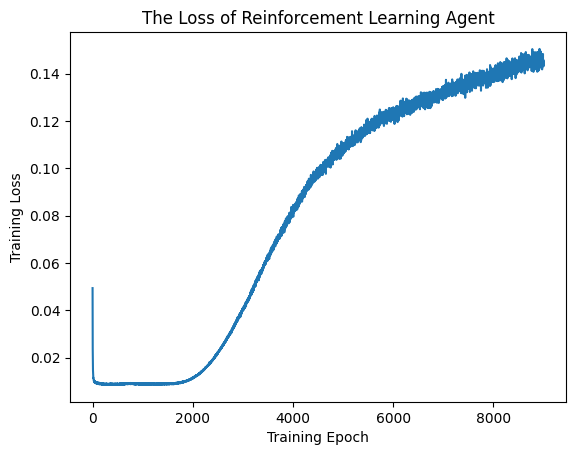

In [33]:
plt.plot(ocrl_training_s1.FQI_loss)

plt.title("The Loss of Reinforcement Learning Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/ocrl_fqi_loss_20250331.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

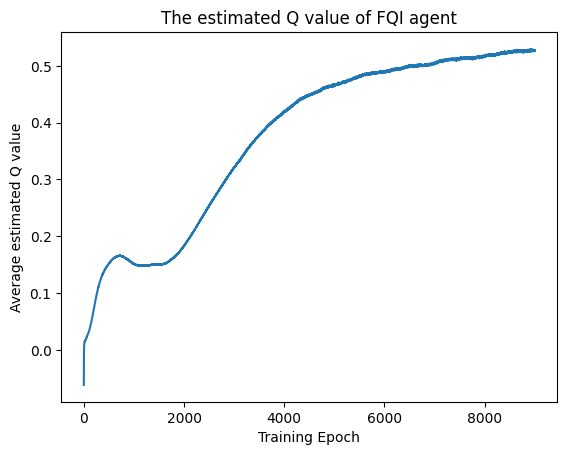

In [34]:
plt.plot(ocrl_training_s1.FQI_est_values)

plt.title("The estimated Q value of FQI agent")
plt.xlabel("Training Epoch")
plt.ylabel("Average estimated Q value")
# plt.grid(True)

# plt.savefig("../Experiment Figure/ocrl_fqi_est_Q_20250331.png", 
#             dpi = 300,
#             bbox_inches = 'tight')


plt.show()

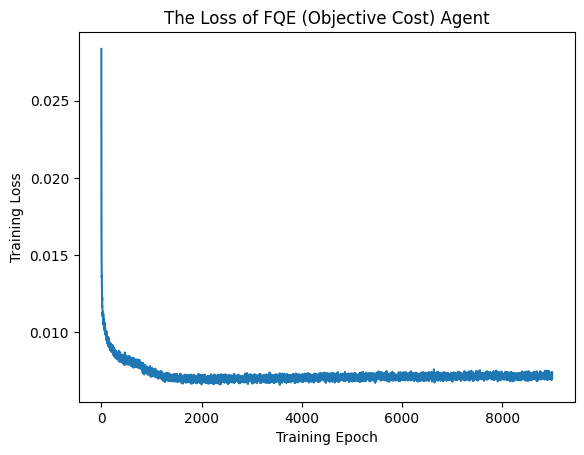

In [35]:
plt.plot(ocrl_training_s1.FQE_loss_obj)

plt.title("The Loss of FQE (Objective Cost) Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/ocrl_fqe_obj_loss_20250331.png", 
#             dpi = 300, 
#             bbox_inches='tight')

plt.show()

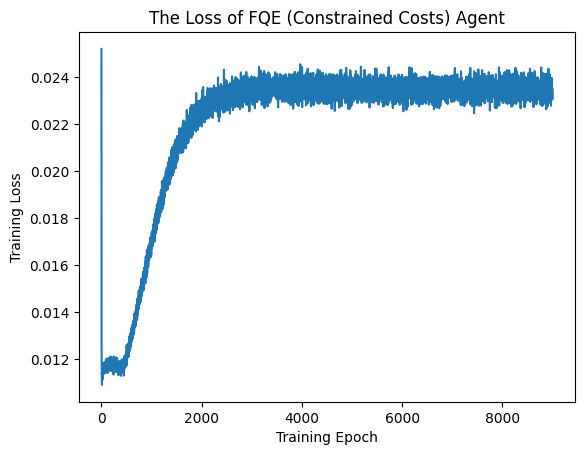

In [36]:
plt.plot(ocrl_training_s1.FQE_loss_con[0])

plt.title("The Loss of FQE (Constrained Costs) Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/ocrl_fqe_con_rdm_loss_20250331.png", 
#             dpi = 300, 
#             bbox_inches='tight')

plt.show()

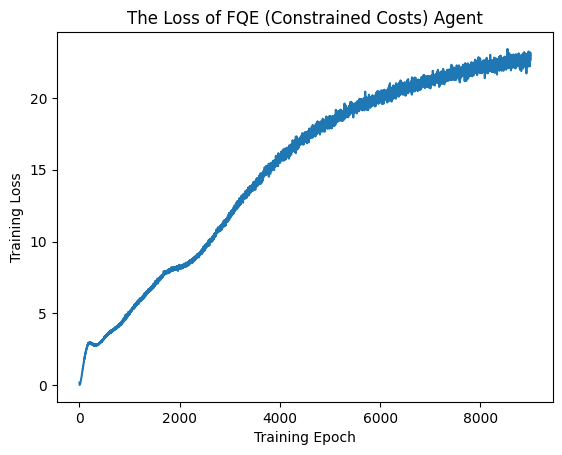

In [37]:
plt.plot(ocrl_training_s1.FQE_loss_con[1])

plt.title("The Loss of FQE (Constrained Costs) Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/ocrl_fqe_con_los_loss_20250331.png", 
#             dpi = 300, 
#             bbox_inches='tight')

plt.show()

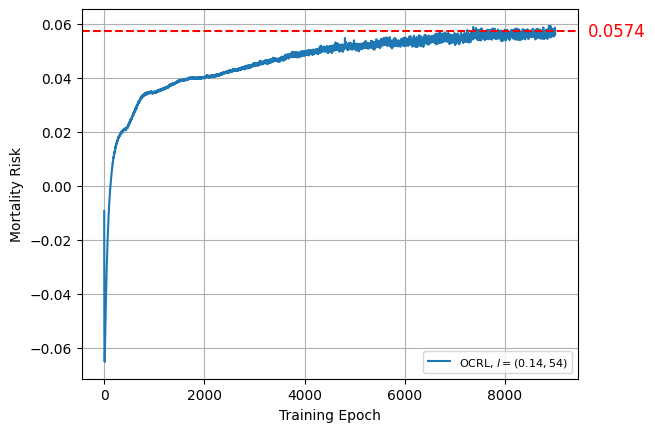

In [39]:
plt.plot(ocrl_training_s1.FQE_est_obj_costs, label = r'OCRL, $l = (0.14, 54)$')

last_epoch = len(ocrl_training_s1.FQE_est_obj_costs) - 1
last_value = ocrl_training_s1.FQE_est_obj_costs[-1]

plt.text(last_epoch + 1800, last_value, f'{last_value:.4f}', ha = 'right', va = 'center', fontsize = 12, color = 'red')

plt.axhline(y = last_value, color = 'r', linestyle = '--')

# plt.title("The Average Estimated Value of Objective Costs by FQE")
plt.xlabel("Training Epoch")
# plt.ylabel(r"Mortality Risk ($\%$)")
plt.ylabel(r"Mortality Risk")
plt.legend(prop = {'size': 8})
plt.grid(True)

# plt.savefig("../Experiment Figure/ocrl_fqe_obj_est_value_20250331.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

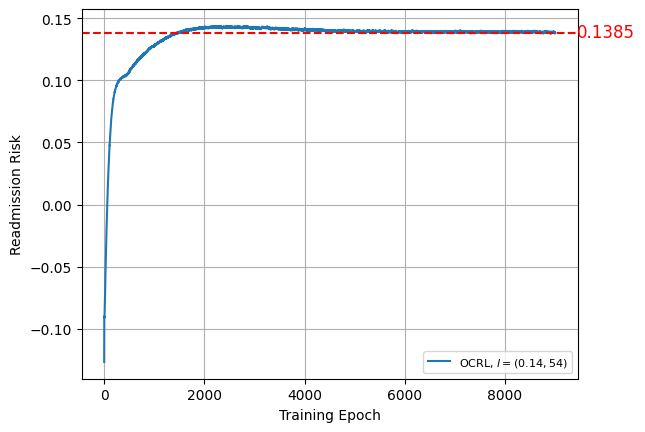

In [40]:
plt.plot(ocrl_training_s1.FQE_est_con_costs[0], label = r'OCRL, $l = (0.14, 54)$')

last_epoch = len(ocrl_training_s1.FQE_est_con_costs[0]) - 1
last_value = ocrl_training_s1.FQE_est_con_costs[0][-1]

# plt.text(last_epoch + 1800, last_value, f'{last_value:.2f}%', ha = 'right', va = 'center', fontsize = 12, color = 'red')
plt.text(last_epoch + 1600, last_value, f'{last_value:.4f}', ha = 'right', va = 'center', fontsize = 12, color = 'red')

plt.axhline(y = last_value, color = 'r', linestyle = '--')

# plt.title("The Average Estimated Value of Constrained Costs by FQE")
plt.xlabel("Training Epoch")
# plt.ylabel(r"Readmission Risk ($\%$)")
plt.ylabel(r"Readmission Risk")
plt.legend(prop = {'size': 8})
plt.grid(True)

# plt.savefig("../Experiment Figure/ocrl_fqe_con_disch_fail_est_value_20250331.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

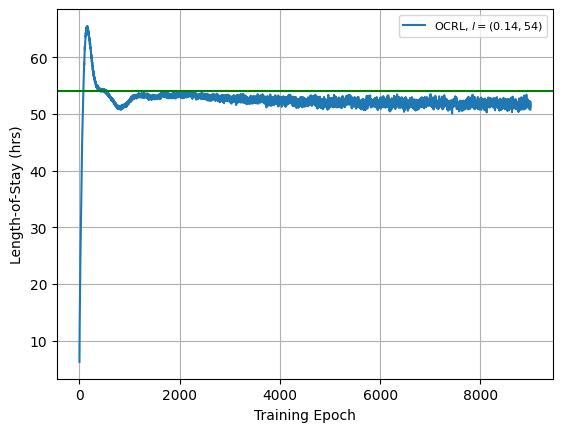

In [41]:
plt.plot(np.array(ocrl_training_s1.FQE_est_con_costs[1])*12, label = r'OCRL, $l = (0.14, 54)$')

last_epoch = len(ocrl_training_s1.FQE_est_con_costs[1]) - 1
last_value = ocrl_training_s1.FQE_est_con_costs[1][-1] * 12

# plt.text(last_epoch + 1600, last_value, f'{last_value:.2f}', ha = 'right', va = 'center', fontsize = 12, color = 'red')

# plt.axhline(y = last_value, color = 'r', linestyle = '--')
plt.axhline(y = 54, color = 'g', linestyle = '-')


# plt.title("The Average Estimated Value of Constrained Costs by FQE")
plt.xlabel("Training Epoch")
plt.ylabel(r"Length-of-Stay (hrs)")
plt.legend(prop = {'size': 8})
plt.grid(True)

# plt.savefig("../Experiment Figure/ocrl_fqe_con_los_value_20250331.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

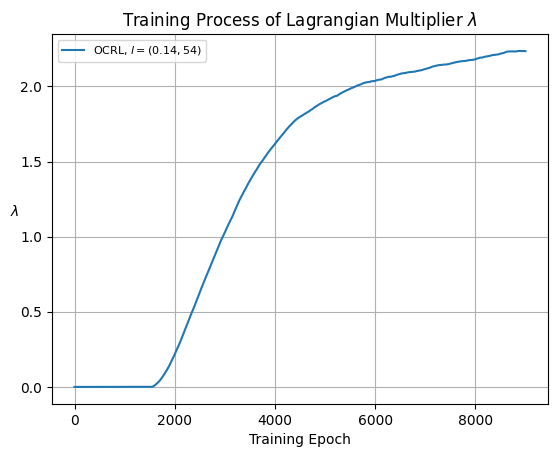

In [42]:
plt.plot(ocrl_training_s1.lambda_dict[0], label = r'OCRL, $l = (0.14, 54)$')

plt.title(r"Training Process of Lagrangian Multiplier $\lambda$")
plt.xlabel("Training Epoch")
ylabel = plt.ylabel(r"$\lambda$")
ylabel.set_rotation(0)

plt.legend(prop={'size': 8})
plt.grid(True)

# plt.savefig("../Experiment Figure/ocrl_lambda_disch_fail_20250331.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

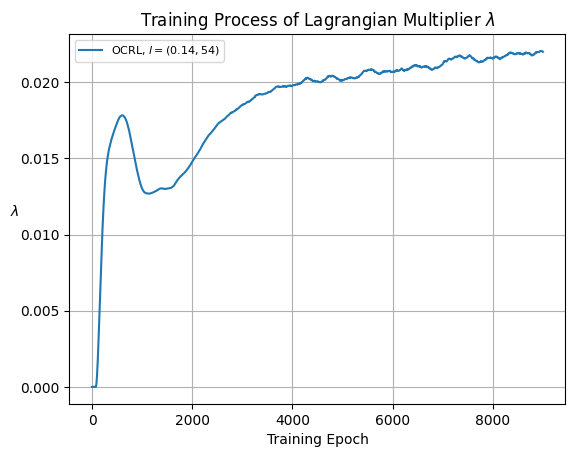

In [43]:
plt.plot(ocrl_training_s1.lambda_dict[1], label = r'OCRL, $l = (0.14, 54)$')

plt.title(r"Training Process of Lagrangian Multiplier $\lambda$")
plt.xlabel("Training Epoch")
ylabel = plt.ylabel(r"$\lambda$")
ylabel.set_rotation(0)

plt.legend(prop={'size': 8})
plt.grid(True)

# plt.savefig("../Experiment Figure/ocrl_lambda_los_20250331.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

## Testing dataset

In [44]:
class TestDataLoader:
    def __init__(self, cfg, state_id_table, rl_cont_state_table, rl_cont_state_table_scaled, state_id_table_1, rl_cont_state_table_scaled_1, terminal_state):
        self.cfg = cfg
    
        # Load datasets
        self.state_df_id = state_id_table
        self.rl_cont_state_table = rl_cont_state_table
        self.rl_cont_state_table_scaled = rl_cont_state_table_scaled

        self.state_df_id_1 = state_id_table_1
        self.rl_cont_state_table_scaled_1 = rl_cont_state_table_scaled_1

        self.terminal_state = terminal_state

    def data_buffer_test(self, num_constraint = 2):
        self.test_memory = ReplayBuffer(self.cfg.memory_capacity)

        for i in range(len(self.state_df_id)):
            state = self.rl_cont_state_table_scaled.values[i]
            action = self.state_df_id['discharge_action'].values[i]
            
            if action == 1.0:
                if self.state_df_id['death'].values[i] == 1.0:
                    if self.state_df_id['discharge_fail'].values[i] == 1.0:
                        done = 0.0
                    else:
                        done = 1.0
                else:
                    if self.state_df_id['discharge_fail'].values[i] == 0.0:
                        done = 1.0
                    else:
                        done = 0.0
            else:
                done = 0.0
            
            obj_cost = self.state_df_id['mortality_costs_md'].values[i]
            con_cost = []
            
            for j in range(num_constraint):
                cost_col = f'con_cost_{j}'  
                if cost_col in self.state_df_id.columns:
                    con_cost.append(self.state_df_id[cost_col].values[i])
                else:
                    con_cost.append(0.0) 

            if done == 0.0:
                idx = self.state_df_id.index[i]
                next_state = self.rl_cont_state_table_scaled_1.loc[idx + 1].values
            else:
                next_state = self.terminal_state

            self.test_memory.push(state, action, obj_cost, con_cost, next_state, done)

    def data_torch_loader_test(self):
        state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch = self.test_memory.extract()

        state_batch = torch.tensor(np.array(state_batch), device = self.cfg.device, dtype = torch.float)

        disch_batch = list(action_batch)
        action_batch = torch.tensor(np.array(action_batch), device = self.cfg.device, dtype = torch.long).unsqueeze(1)
        
        obj_cost_batch = torch.tensor(np.array(obj_cost_batch), device = self.cfg.device, dtype = torch.float)
        con_cost_batch = [torch.tensor(np.array(cost), device = self.cfg.device, dtype=torch.float) for cost in con_cost_batch]
        next_state_batch = torch.tensor(np.array(next_state_batch), device = self.cfg.device, dtype = torch.float)

        done_batch = torch.tensor(np.array(done_batch), device = self.cfg.device, dtype = torch.float)
        disch_batch = torch.tensor(np.array(disch_batch), device = self.cfg.device, dtype = torch.float)

        return state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch

In [45]:
class TestConfig:
    def __init__(self, constraint_num):
        
        self.constraint_num = constraint_num

        self.memory_capacity = int(2e6)  # capacity of Replay Memory

        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check GPU
        self.device = torch.device("cpu")

In [116]:
id_table_test = pd.read_csv('../data_output/id_table_test_v13.csv')
rl_table_test = pd.read_csv('../data_output/rl_table_test_v13.csv')
rl_table_test_scaled = pd.read_csv('../data_output/rl_table_test_scaled_v13.csv')

In [117]:
# id_table_test = pd.read_csv('../data_output/id_table_val_v13.csv')
# rl_table_test = pd.read_csv('../data_output/rl_table_val_v13.csv')
# rl_table_test_scaled = pd.read_csv('../data_output/rl_table_val_scaled_v13.csv')

In [118]:
# Create a copy of the 'mortality_costs' column
id_table_test['mortality_costs_md'] = id_table_test['mortality_costs'].copy()

# Apply the conditions using vectorized operations
discharge_action_mask = id_table_test['discharge_action'] == 1
death_mask = id_table_test['death'] == 0
discharge_fail_mask = id_table_test['discharge_fail'] == 1

# Update 'mortality_costs_md' based on the conditions
id_table_test.loc[discharge_action_mask & death_mask, 'mortality_costs_md'] = 0
id_table_test.loc[discharge_action_mask & ~death_mask & discharge_fail_mask, 'mortality_costs_md'] = 0

In [119]:
id_table_test_initial = id_table_test.copy()
# id_table_test_initial = id_table_test[id_table_test['readmission_count'] == 3].copy()
# id_table_test_initial = id_table_test_initial[id_table_test_initial['epoch'] == 1].copy()

mv_test_initial_index = id_table_test_initial.index
id_index_list_initial_test = mv_test_initial_index.tolist()

rl_table_test_initial = rl_table_test.loc[id_index_list_initial_test].copy()

rl_table_test_scaled_initial = rl_table_test_scaled.loc[id_index_list_initial_test].copy()

id_table_test_initial['con_cost_0'] = id_table_test_initial['discharge_fail_costs'].copy()
id_table_test_initial['con_cost_1'] = id_table_test_initial['los_costs_scaled'].copy()

test_cfg = TestConfig(constraint_num = 2)
terminal_state = np.zeros(rl_table_test_scaled.shape[1])
test_data_loader = TestDataLoader(test_cfg, 
                                  id_table_test_initial, 
                                  rl_table_test_initial, 
                                  rl_table_test_scaled_initial, 
                                  id_table_test, 
                                  rl_table_test_scaled, 
                                  terminal_state)

test_data_loader.data_buffer_test(num_constraint = 2)

state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch = test_data_loader.data_torch_loader_test()

In [120]:
# agent_fqi_s1 = torch.load('../model_output/ocrl_agent_s1_fqi_20250330.pth', weights_only = False)

# agent_fqe_obj_s1 = torch.load('../model_output/ocrl_agent_s1_fqe_obj_20250330.pth', weights_only = False)
# agent_fqe_con_disch_fail_s1 = torch.load('../model_output/ocrl_agent_s1_fqe_con_disch_fail_20250330.pth', weights_only = False)
# agent_fqe_con_los_s1 = torch.load('../model_output/ocrl_agent_s1_fqe_con_los_20250330.pth', weights_only = False)

In [121]:
ocrl_policy_set_1 = agent_fqi_s1.rl_policy(state_batch)
matches_1 = sum(1 for a, b in zip(ocrl_policy_set_1, action_batch) if a == b)
percentage_1 = matches_1/len(ocrl_policy_set_1)

In [122]:
percentage_1

0.8205519930850101

In [112]:
zeros = (action_batch == 0).sum().item()
ones = (action_batch == 1).sum().item()
total = action_batch.numel()  

zero_ratio = zeros / total
one_ratio = ones / total

print(f"0的数量: {zeros}, 比例: {zero_ratio:.4f} ({zeros}/{total})")
print(f"1的数量: {ones}, 比例: {one_ratio:.4f} ({ones}/{total})")

0的数量: 1470, 比例: 0.9846 (1470/1493)
1的数量: 23, 比例: 0.0154 (23/1493)


In [113]:
zeros = (ocrl_policy_set_1 == 0).sum().item()
ones = (ocrl_policy_set_1 == 1).sum().item()
total = ocrl_policy_set_1.numel()  

zero_ratio = zeros / total
one_ratio = ones / total

print(f"0的数量: {zeros}, 比例: {zero_ratio:.3f} ({zeros}/{total})")
print(f"1的数量: {ones}, 比例: {one_ratio:.3f} ({ones}/{total})")

0的数量: 1493, 比例: 1.000 (1493/1493)
1的数量: 0, 比例: 0.000 (0/1493)


In [53]:
fqe_test_obj_costs_ocrl_1, fqe_test_obj_costs_ocrl_1_ub = agent_fqe_obj_s1.avg_Q_value_est(state_batch)
fqe_test_con_disch_costs_ocrl_1, fqe_test_con_disch_costs_ocrl_1_ub = agent_fqe_con_rr_s1.avg_Q_value_est(state_batch)
fqe_test_con_los_costs_ocrl_1, fqe_test_con_los_costs_ocrl_1_ub = agent_fqe_con_los_s1.avg_Q_value_est(state_batch)

In [54]:
fqe_test_obj_costs_ocrl_1

0.05318625643849373

In [55]:
fqe_test_con_disch_costs_ocrl_1

0.13732551038265228

In [56]:
fqe_test_con_los_costs_ocrl_1

4.900150299072266

In [57]:
fqe_test_con_los_costs_ocrl_1 * 12

58.80180358886719

In [58]:
fqe_test_con_los_costs_ocrl_1_ub

5.106832504272461

In [59]:
agent_fqi_test = ocrl_training_s1.fqi_agent_config(seed = 1)

agent_fqe_obj_test = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                       eval_agent = agent_fqi_test, 
                                                       weight_decay = 0.0,
                                                       eval_target = 'obj', 
                                                       seed = 1) 

agent_fqe_con_rr_test = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                          eval_agent = agent_fqi_test, 
                                                          weight_decay = 0.0,
                                                          eval_target = 0, 
                                                          seed = 2) 

agent_fqe_con_los_test = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                           eval_agent = agent_fqi_test, 
                                                           weight_decay = 0.0,
                                                           eval_target = 1, 
                                                           seed = 3) 

cum_fqe_obj = 0

for i in range(len(ocrl_training_s1.fqe_obj_models_history)):
    agent_fqi_test.policy_net.load_state_dict(ocrl_training_s1.fqi_models_history[i]['model_state']['policy_net'])
    agent_fqe_obj_test.policy_net.load_state_dict(ocrl_training_s1.fqe_obj_models_history[i]['model_state']['policy_net'])
    fqe_est_obj_test, fqe_est_obj_test_ub = agent_fqe_obj_test.avg_Q_value_est(state_batch)
    print(fqe_est_obj_test)
    cum_fqe_obj += fqe_est_obj_test

cum_fqe_con_rr = 0

for i in range(len(ocrl_training_s1.fqe_obj_models_history)):
    agent_fqi_test.policy_net.load_state_dict(ocrl_training_s1.fqi_models_history[i]['model_state']['policy_net'])
    agent_fqe_con_rr_test.policy_net.load_state_dict(ocrl_training_s1.fqe_con_models_history[0][i]['model_state']['policy_net'])
    fqe_est_con_rr_test, fqe_est_con_rr_test_ub = agent_fqe_con_rr_test.avg_Q_value_est(state_batch)
    print(fqe_est_con_rr_test)
    cum_fqe_con_rr += fqe_est_con_rr_test

cum_fqe_con_los = 0

for i in range(len(ocrl_training_s1.fqe_obj_models_history)):
    agent_fqi_test.policy_net.load_state_dict(ocrl_training_s1.fqi_models_history[i]['model_state']['policy_net'])
    agent_fqe_con_los_test.policy_net.load_state_dict(ocrl_training_s1.fqe_con_models_history[1][i]['model_state']['policy_net'])
    fqe_est_con_los_test, fqe_est_con_los_test_ub = agent_fqe_con_los_test.avg_Q_value_est(state_batch)
    print(fqe_est_con_los_test)
    cum_fqe_con_los += fqe_est_con_los_test

0.0583355687558651
0.05397150665521622
0.05388059467077255
0.053846150636672974
0.057320043444633484
0.05218351259827614
0.05324482545256615
0.05493301898241043
0.05278870835900307
0.053558796644210815
0.05206819623708725
0.05249812826514244
0.05384908989071846
0.05204383656382561
0.06752120703458786
0.05211205780506134
0.05643638223409653
0.0523824542760849
0.05512024834752083
0.05324864760041237
0.05783285200595856
0.05322267487645149
0.05230050906538963
0.06023702025413513
0.05353680998086929
0.0651344284415245
0.051846183836460114
0.06618212163448334
0.0526229664683342
0.05240267142653465
0.05193221569061279
0.06642430275678635
0.05301244184374809
0.051874350756406784
0.05223890766501427
0.06965591013431549
0.05386091023683548
0.05318300798535347
0.072474904358387
0.05400220304727554
0.052562419325113297
0.05251266434788704
0.0521325021982193
0.06134489178657532
0.06211265176534653
0.05321894958615303
0.06322301924228668
0.053950536996126175
0.0539826899766922
0.05214499309659004
0

In [60]:
L = len(ocrl_training_s1.fqe_obj_models_history)
print(L)

2000


In [61]:
[cum_fqe_obj/L, 
 cum_fqe_con_rr/L,
 (cum_fqe_con_los/L)*12]

[0.05789029011502862, 0.13958637587726117, 52.89018845272065]

## Shap Values Analysis

In [62]:
import shap

In [63]:
state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch = train_data_loader.train_memory.extract()
state_batch = np.array(state_batch)

In [64]:
# agent_fqi_s1 = torch.load('../model_output/ocrl_safe_agent_s1_fqi_20250321.pth', weights_only = False)

In [65]:
idx = np.random.choice(state_batch.shape[0], 10000, replace = False)
background_data = state_batch[idx, :]

In [66]:
model_1 = agent_fqi_s1.policy_net
model_1.eval()

weights = model_1.fc1.weight.data.cpu().numpy()
intercept = model_1.fc1.bias.data.cpu().numpy()

e = shap.LinearExplainer((weights, intercept), background_data)

In [67]:
rl_table_train_scaled.columns

Index(['age', 'M', 'weight', 'Heart Rate', 'Arterial O2 pressure',
       'Hemoglobin', 'Arterial CO2 Pressure', 'PH (Venous)',
       'Hematocrit (serum)', 'WBC', 'Chloride (serum)', 'Creatinine (serum)',
       'Glucose (serum)', 'Magnesium', 'Sodium (serum)', 'PH (Arterial)',
       'Inspired O2 Fraction', 'Arterial Base Excess', 'BUN',
       'Ionized Calcium', 'Total Bilirubin', 'Glucose (whole blood)',
       'Potassium (serum)', 'HCO3 (serum)', 'Platelet Count',
       'Prothrombin time', 'PTT', 'INR', 'Blood Pressure Systolic',
       'Blood Pressure Diastolic', 'Blood Pressure Mean', 'Temperature C',
       'SaO2', 'GCS score', 'Respiratory Rate', 'Tidal Volume',
       'readmission_count'],
      dtype='object')

In [68]:
weights

array([[ 1.12000376e-01, -2.95439805e-03, -1.03527549e-04,
         9.64006931e-02, -1.01342127e-01, -7.29663298e-02,
        -1.18759961e-03, -1.73221864e-02, -5.20403795e-02,
         5.30944094e-02, -3.72527689e-02,  1.13306552e-01,
         4.48179431e-02,  1.29288128e-02,  1.62409563e-02,
         1.38280476e-02, -1.41313358e-03,  2.94419415e-02,
         1.77382380e-01, -4.50881524e-03,  6.58888966e-02,
         4.29405831e-03, -3.93887935e-03,  2.80173472e-03,
        -1.41998865e-02,  9.95747000e-02,  1.02004103e-01,
         9.97705981e-02, -2.97714602e-02, -2.90988833e-02,
        -1.92514751e-02, -1.32886153e-02, -1.50785595e-03,
        -1.45066306e-01,  4.51618396e-02, -9.40493774e-03,
         2.23443940e-01],
       [ 1.11979455e-01, -2.81786756e-03, -1.84276351e-03,
         9.92815420e-02, -1.02000594e-01, -7.53010362e-02,
        -3.25517100e-03, -1.71219055e-02, -5.05712442e-02,
         5.36111891e-02, -3.79295647e-02,  1.12653799e-01,
         4.54165339e-02,  1.28

In [69]:
selected = np.zeros(state_batch.shape[0], dtype = bool)
selected[idx] = True

X_data = state_batch[~selected]

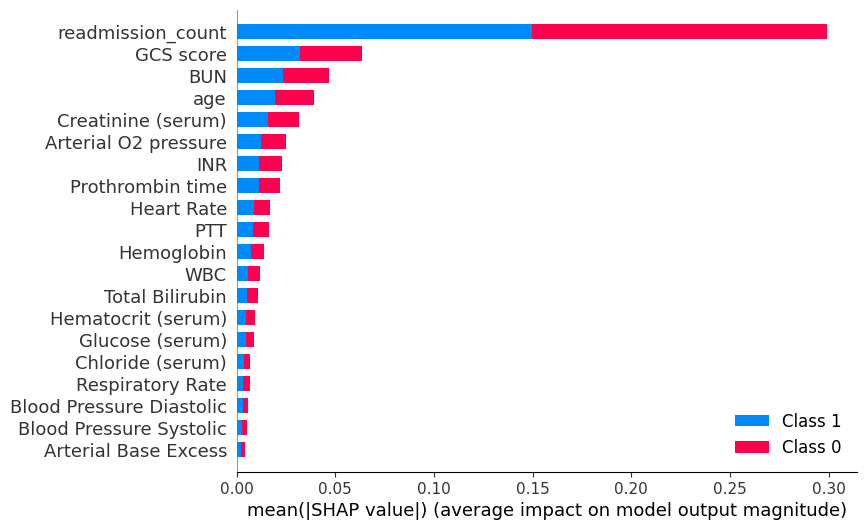

In [70]:
shap_values = e.shap_values(X_data)
shap.summary_plot(shap_values, X_data, 
                  feature_names = rl_table_train_scaled.columns, 
                  plot_size = (8, 6), 
                  plot_type = 'bar',
                  show = False)

# plt.savefig("../Experiment Figure/shap_summ_plot_20250331.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()